# Tesina: Riconoscimento di cifre scritte a mano
## Maddalena Ghiotti, s281604, Matematica per l'Intelligenza Artificiale
Partendo da un dataset di cifre scritte a mano, andremo ad implementare alcuni algoritmi di machine learning, quali la _support vector machine_ e il _multi-layer perceptron_, dopo aver effettuato riduzione di dimensionalità tramite _principal component analysis_. Andremo dunque a considerare le performance di ogni metodo nella classificazione delle 10 cifre, anche al variare degli iperparametri che definiscono i modelli. Potremo quindi trarre delle conclusioni sul modello più adatto da utilizzare per l'obiettivo preposto.

## Dataset
Il dataset su cui andremo a lavorare raccoglie 250 campioni di cifre scritte a mano da ognuno dei 44 individui coinvolti nell’esperimento. Ciascuno ha dovuto scrivere su una tavoletta sensibile alla pressione WACOM PL-100V con display LCD integrato, in appositi riquadri di risoluzione 500 per 500 pixel. La tavoletta inviava ad un PC Intel 486 tramite cavo a intervalli di tempo fissi (frequenza di campionamento) di 100 millisecondi, le coordinate $x$ e $y$ e i valori di livello di pressione della penna. Ai partecipanti è stata data la possibilità di correggere eventuali errori o modificare quanto scritto se non soddisfatti, anche se le prime 10 cifre scritte da ciascuno sono ignorate a priori e hanno lo scopo di far prendere agli scrittori familiarità con lo strumento.

Il dataset a disposizione tiene conto solamente delle coordinate ($x, y$) e non della pressione, e i valori delle coordinate sono stati normalizzati (resi così invarianti per traslazione o scalamento), in modo che entrambi varino tra 0 e 100 con almeno uno 0 e almeno un 100 (_min-max scaler_).

Le cifre campionate sono rappresentate come una sequenza di T punti ($x_i$, $y_i$) regolarmente spaziati, a differenza della sequenza di input, che è regolarmente distribuita nel tempo. Quindi, la dimensione del vettore di input è 2*T e nel nostro caso specifico T=8.

## Importazione Moduli e Pacchetti
Qui di seguito è riportato il tratto di codice finalizzato all'importazione di tutti i pacchetti necessari per lo svolgimento successivo.

In [419]:
# STILE DI VISUALIZZAZIONE PLOT FATTI CON MATPLOTLIB
%matplotlib inline
#
#
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import time

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer


## Caricamento e Preparazione Dataset

Provvediamo al caricamento del dataset, precedentemente scaricato in locale. Il dataset è già stato suddiviso in un training e in un test set, che di seguito chiameremo _suggestedTrainingData_ e _suggestedTestData_. Il primo contiene i campioni effettuati su 30 dei 44 scrittori, mentre il secondo contine i campioni dei restanti 14.
Noi andremo a trattare solamente il _suggestedTrainingData_, che divideremo a sua volta in training e test per effettuare test _su scrittori noti_. Il _suggestedTestData_ verrà successivamente utilizzato per un ulteriore test finale _su scrittori ignoti_.

D'ora in poi denoteremo il _suggestedTrainingData_ con $\mathcal{D}$ e lo considereremo come un insieme di $m\in\mathbb{N}$ coppie formate dal vettore colonna in $\mathbb{R}^n$ del campione e il relativo target

$$\mathcal{D} = \{(\boldsymbol{x}_1, \boldsymbol{y}_1),\ldots ,(\boldsymbol{x}_m, \boldsymbol{y}_m)\}, \quad \quad \boldsymbol{x}_i\in \mathbb{R}^n$$

e utilizzeremo la matrice dei campioni $X$, in cui troviamo gli $m$ campioni sulle righe e le $n$ feature sulle colonne. La classe di output di ogni campione è salvata nel vettore $Y$ a parte, dove $y_i$ identifica la classe del campione $x_i$ tra le $p$ possibili. 

$$X = \begin{bmatrix} \boldsymbol{x}_1^\top\\ \vdots\\ \boldsymbol{x}_m^\top \end{bmatrix} \quad Y = \begin{bmatrix} y_1\\ \vdots\\ y_m \end{bmatrix}$$

Nel caso specifico, come vedremo, $m=7494$, $n=16$ e $p=10$.

Ecco riportato qui sotto il _suggestedTrainingData_.

In [46]:
# IMPORT DATA
suggestedTrainingData = pd.read_csv('pendigits.tra', names=["x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "x5", "y5", "x6", "y6", "x7", "y7", "x8", "y8", "class"])
suggestedTestData = pd.read_csv('pendigits.tes', names=["x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "x5", "y5", "x6", "y6", "x7", "y7", "x8", "y8", "class"])

dataset = suggestedTrainingData.copy()
display(dataset)

x1   y1  x2   y2   x3   y3   x4   y4  x5  y5   x6  y6   x7  y7   x8  \
0      47  100  27   81   57   37   26    0   0  23   56  53  100  90   40   
1       0   89  27  100   42   75   29   45  15  15   37   0   69   2  100   
2       0   57  31   68   72   90  100  100  76  75   50  51   28  25   16   
3       0  100   7   92    5   68   19   45  86  34  100  45   74  23   67   
4       0   67  49   83  100  100   81   80  60  60   40  40   33  20   47   
...   ...  ...  ..  ...  ...  ...  ...  ...  ..  ..  ...  ..  ...  ..  ...   
7489    0   82   9   59   56   34   41    0  10  30    3  67   42  96  100   
7490   49  100   0   70   24   56  100   65  86  85   44  77   21  38    6   
7491  100   98  60  100   24   87    3   58  35  51   58  26   36   0    0   
7492   59   65  91  100   84   96   72   50  51   8    0   0   45   1  100   
7493    0   78  29  100   94   86   70   48  42  11   32   0   25  36  100   

       y8  class  
0      98      8  
1       6      2  
2       0      1  
3       0      4  
4       0      1  
...   ...    ...  
7489  100      5  
7490    0      4  
7491    5      5  
7492    0      1  
7493   40      7  

[7494 rows x 17 columns]

In [47]:
print('TRAINING SET SUGGERITO')
suggestedTrainingData.info()
print('\nTEST SET SUGGERITO')
suggestedTestData.info()
print()

TRAINING SET SUGGERITO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x1      7494 non-null   int64
 1   y1      7494 non-null   int64
 2   x2      7494 non-null   int64
 3   y2      7494 non-null   int64
 4   x3      7494 non-null   int64
 5   y3      7494 non-null   int64
 6   x4      7494 non-null   int64
 7   y4      7494 non-null   int64
 8   x5      7494 non-null   int64
 9   y5      7494 non-null   int64
 10  x6      7494 non-null   int64
 11  y6      7494 non-null   int64
 12  x7      7494 non-null   int64
 13  y7      7494 non-null   int64
 14  x8      7494 non-null   int64
 15  y8      7494 non-null   int64
 16  class   7494 non-null   int64
dtypes: int64(17)
memory usage: 995.4 KB

TEST SET SUGGERITO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
--

Come possiamo osservare dalle informazioni sul dataset, non ci sono elementi mancanti. L'assenza di elementi null è confermata dalla descrizione del dataset presnte sul sito di origine, citato nelle fonti. Possiamo inoltre confermare che i dati sono di tipo intero e sono divisi nei due sottoinsiemi secondo un rapporto

$$\%suggestedTrainingData = \frac{|suggestedTrainingData|}{|suggestedTrainingData+suggestedTestData|}*100 = \frac{7494}{7494+3498}*100 = 68\%$$

$$\%suggestedTestData = \frac{|suggestedTestData|}{|suggestedTrainingData+suggestedTestData|}*100 = \frac{3498}{7494+3498}*100 = 32\%$$

## Elaborazione iniziale e visualizzazioni

Mostriamo innanzitutto la distribuzione dei campioni tra le classi. Possiamo notare come le classi siano equilibrate, nonostante non siano perfettamente eque. Da una presenza di 780 campioni circa per le classi _0, 1, 2, 4, 7_, si passa a circa 720 per le classi _3, 5, 6, 8, 9_

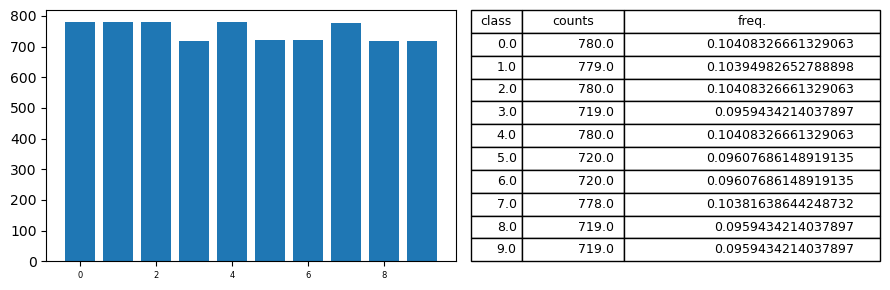

In [644]:
M, N = dataset.shape

class_cont_freq = pd.concat([dataset['class'].value_counts(), dataset['class'].value_counts()/M], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  # alterantiva al metodo 'rename' cambiare il nome a tutte le colonne (comodo quando ce ne sono più di una con stesso nome)
class_cont_freq.index.name = 'class'

class_cont_freq = class_cont_freq.sort_index() #.transpose())
class_cont_freq=class_cont_freq.reset_index()

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(121)
ax1.bar([i for i in np.arange(0, 10)], dataset['class'].value_counts().sort_index())
ax2 = fig.add_subplot(122)
font_size = 16
bbox = [0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText= class_cont_freq.values, bbox=bbox, colLabels= class_cont_freq.columns, colWidths=[0.2,0.4,1])
#plt.savefig('Class_distribution',dpi=300)
plt.show()

Inoltre è possibile ricostruire le cifre originali a partire dalle coppie di punti. Qui di seguito sono rappresentate tutte, partendo dalle coordinate medie, calcolate su tutto il _suggestedTrainingData_ suddiviso in classi. E' evidenziato il primo punto.

E' interessante notare come in numero 5 sia difficilmente riconoscibile. Ciò è probabilmente dovuto al diverso ordine dei tratti che ogni scrittore segue; infatti, il punto finale è il risultato della media dell'ultimo punto di chi traccia prima la linea orizzontale e di chi prima la pancia. L'abbondante spazio bianco circostante il numero, caratteristico anche della cifra 8, è anche un segno della varietà di modi in cui questo numero è tracciabile.

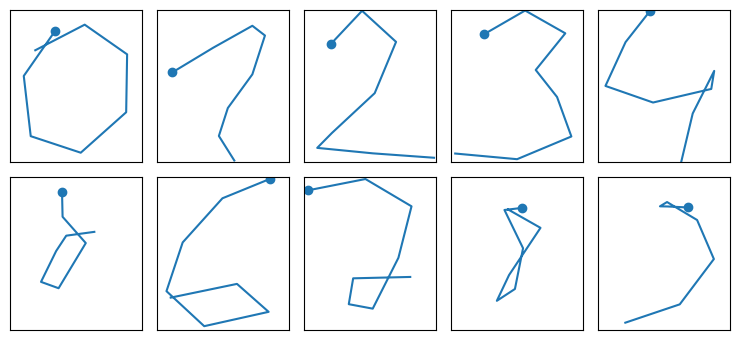

In [645]:
fig = plt.figure()
for i in range(10):
    means = dataset[dataset['class']==i].mean(axis=0)
    plt.subplot(2,5,i+1)
    plt.plot(means[0:16:2],means[1:16:2])
    plt.scatter(means[0],means[1])
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
    plt.xlim([0,100])
    plt.ylim([0,100])
#plt.savefig('Numbers',dpi=300)
plt.show()

Dalla tabella e dai grafici qui sotto riportati possiamo vedere come i numeri vengano generalmente tracciati partendo dall'alto e muovendosi verso il basso. Dato che la maggior parte gli scrittori traccia le cifre partendo dal margine superiore, la deviazione standard legata alla prima coordinata y è molto bassa, a differenza dalla prima coordiata x e dal'ultimo punto che sono molto dipendenti dalla cifra in questione.

Possiamo anche osservare come _min_ e _max_ di ciascuna coordinata siano sempre _0_ e _100_. Questo significa che ciascun punto della sequenza è stato il punto più in alto di tutti, per almeno uno scrittore, così come il più basso, il più a destra e il più a sinistra.

In [50]:
desc = dataset.iloc[:,:-1].describe()
display(desc)

x1           y1           x2           y2           x3  \
count  7494.000000  7494.000000  7494.000000  7494.000000  7494.000000   
mean     37.384307    84.679343    40.005604    82.889512    50.878303   
std      33.322024    16.848420    26.256025    19.638582    34.927201   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.000000    76.000000    20.000000    70.000000    17.000000   
50%      31.000000    89.000000    39.000000    89.000000    56.000000   
75%      61.000000   100.000000    58.000000   100.000000    81.000000   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

                y3           x4           y4           x5           y5  \
count  7494.000000  7494.000000  7494.000000  7494.000000  7494.000000   
mean     65.044436    51.471844    44.599680    57.129971    34.069122   
std      27.377341    30.680075    30.659478    33.680340    27.459989   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      48.000000    28.000000    22.000000    30.000000     7.000000   
50%      71.000000    54.000000    42.000000    60.000000    33.000000   
75%      86.000000    75.000000    65.000000    88.000000    55.000000   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

                x6           y6           x7           y7           x8  \
count  7494.000000  7494.000000  7494.000000  7494.000000  7494.000000   
mean     61.417401    35.782092    54.699760    35.800774    46.813718   
std      37.130762    27.495836    22.599781    33.223611    41.531794   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      25.000000    12.000000    41.000000     7.000000     0.000000   
50%      74.000000    32.000000    53.000000    28.000000    39.000000   
75%      98.000000    57.000000    69.000000    48.000000   100.000000   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

                y8  
count  7494.000000  
mean     28.565386  
std      35.811094  
min       0.000000  
25%       0.000000  
50%       8.000000  
75%      51.000000  
max     100.000000

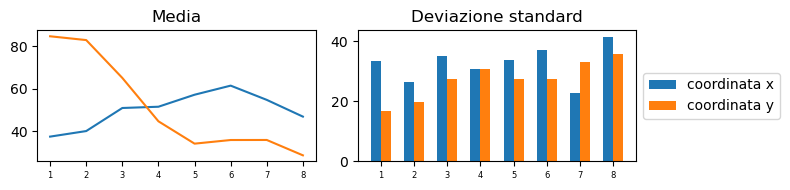

In [646]:
plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title('Media')
plt.plot(np.arange(1, 9), desc.iloc[1,0:16:2], label= 'coordinata x')
plt.plot(np.arange(1, 9), desc.iloc[1,1:16:2], label = 'coordinata y')
plt.subplot(1,2,2)
plt.title('Deviazione standard')
plt.bar(np.arange(1, 9)-0.15, desc.iloc[2,0:16:2], width=0.3,label= 'coordinata x')
plt.bar(np.arange(1, 9)+0.15, desc.iloc[2,1:16:2], width=0.3,label = 'coordinata y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('Media_Varianza',dpi=300)
plt.show()

Dato che abbiamo visto che la maggior parte dei numeri vengono tracciati dall'alto, ma che anche il primo punto può essere sul margine inferiore, ci chiediamo quali numeri siano causa di questa "incongruenza". Di seguito un approfondimento sulle sole cifre del _suggestedTrainingData_ che hanno il primo punto più in basso di tutti gli altri. Come possiamo osservare le uniche cifre che vengono tracciate partendo dal basso sono il 9 e l'1. A destra vengono tracciati i due numeri prendendo i punti medi dei soli campioni che hanno il punto di partenza sul margine inferiore.

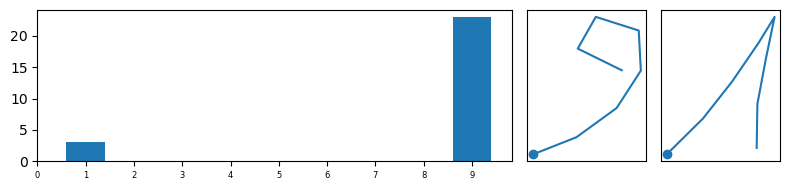

In [647]:
y1zero = dataset[dataset['y1']==0]

means9 = y1zero[y1zero['class']==9].mean(axis=0)
means1 = y1zero[y1zero['class']==1].mean(axis=0)

f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [4, 1, 1]}, figsize=(8,2))
a0.bar(y1zero['class'].unique(),y1zero['class'].value_counts())
a0.set_xticks(range(10))
a1.plot(means9[0:16:2],means9[1:16:2])
a1.scatter(means9[0],means9[1])
a1.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
a2.plot(means1[0:16:2],means1[1:16:2])
a2.scatter(means1[0],means1[1])
a2.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
#plt.savefig('Numbers_fromBottom',dpi=300)
plt.show()


## Suddivisione del Dataset in Training, Validation e Test Set

Suddividiamo il _suggestedTrainingData_ ($\mathcal{D}$) in _Training set_, _Validation set_ e _Test set_.

Il training set è definito come $\mathcal{T} = \{(\boldsymbol{x}_1, y_1), \ldots , (\boldsymbol{x}_T, y_T) \}$, cioè come le coppie campione-classe formate da $T$ righe casuali di $X$ e dalle corrispondenti $T$ di $Y$. Indichiamo rispettivamente l'insieme dei vettori e l'insieme delle classi in $\mathcal{T}$ con 

$$X_{\mathcal{T}}=\{\boldsymbol{x}_1,\ldots ,\boldsymbol{x}_T\} \quad \text{e} \quad Y_{\mathcal{T}}=\{y_1,\ldots ,y_T\}\,.$$

I restanti campioni sono divisi analogamente tra il _Validation set_, che denotiamo con $\mathcal{V}$, e il _Test set_ ($\mathcal{P}$). 


La suddivisione che vediamo di seguito verrà utilizzata per l'addestramento e il test _su scrittori noti_.

Il _Validation set_ viene qui creato al fine di visualizzazione e per la validazione dell'MLP. Per la SVM infatti non sarà necessario in quanto verrà implementata una grid search con cross validation.

1. $|\mathcal{T}| = 70\% |\mathcal{D}|$
1. $|\mathcal{V}| = 10\% |\mathcal{D}|$
1. $|\mathcal{P}| = 20\% |\mathcal{D}|$

In [53]:
# X_train, X_test: matrici delle features di training e test set, rispettivamente, ottenute da X
# y_train, y_test: vettori delle classi di training e test set, rispettivamente, ottenuti da y
random_seed = 42
test_p = 0.20
val_p = 0.125 #Il valore è rispetto al training+validation (0.8*0.125)=0.1

X_trainval, X_test, y_trainval, y_test = train_test_split(dataset.iloc[:,:-1], dataset.iloc[:,-1], test_size=test_p, random_state=random_seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_p, random_state=random_seed, shuffle=True)

display(pd.DataFrame({'Training': X_train.shape, 'Validation': X_val.shape, 'Test': X_test.shape}, index=['N. sanmples', 'N.features']))

Training  Validation  Test
N. sanmples      5245         750  1499
N.features         16          16    16

# Principal Component Analysis (PCA)

La _Principal Component Analysis_ (PCA) è una tecnica che permette di ridurre la dimensionalità dei dati. 

Per rendere il metodo più efficace, il primo passo è effettuare un _centramento_ dei dati, sottraendo ai campioni il vettore delle medie $\boldsymbol{\mu}$, contenete la media di ogni feature. Si costruisce quindi la _matrice di covarianza campionaria_

$$
\boldsymbol{\Sigma}_X= \frac{1}{m-1}(X-M)^\top(X-M) \quad \quad \text{con} \quad \quad M = \begin{bmatrix} \boldsymbol{\mu}^\top\\ \vdots\\ \boldsymbol{\mu}^\top \end{bmatrix}
$$

L'obiettivo è ora trovare il sottospazio di dimensione 1 su cui è spiegata la varianza massima. La retta cercata è identificata dall'autovettore corrispondente al massimo autovalore di $\boldsymbol{\Sigma}_X$: esso prenderà il nome di _prima componente principale_. Proseguendo allo stesso modo secondo l'ordine degli autovalori di $\boldsymbol{\Sigma}_X$ (dal maggiore al minore) si ottengono tutte le _componenti principali_ (PC) da quella con la maggiore varianza spiegata alla minore e ciascuna perpendicolare a tutte le precedenti.

Per effettuare una riduzione di dimensionalità si mantengono come nuovi assi solo le prime $k$ PC, dettate dagli autovettori $e_1 ... e_k$.
E' giunto dunque il momento di ridefinire i campioni secondo il nuovo sistema di riferimento e quindi proiettare i dati sull'iperpiano generato dai k vettori. Questo viene eseguito con l'operzione 

$$
X^*=(X-M)E \quad \text{dove} \quad E=[e_1 ... e_k]
$$

Quando i valori a disposizione sono molto differenti da feature a feature, con ordini di grandezza diversi, si può effettuare un'ulteriore elaborazione della matrice dei campioni attraverso la _standardizzazione_. Si trova così la _matrice di correlazione campionaria_ che può essere utilizzata al posto di $\boldsymbol{\Sigma}_X$ per trovare le PC.


$$
Corr(X)= \frac{1}{m-1}((X-M)\cdot\boldsymbol{\sigma^*}I)^\top((X-M)\cdot\boldsymbol{\sigma^*}I) \quad \quad \text{con} \quad \quad \boldsymbol{\sigma^*} = \begin{bmatrix} \frac{1}{\sigma_1}\\ \vdots\\ \frac{1}{\sigma_n} \end{bmatrix}
$$

Per determinare il numero di _componenti principali_ da tenere, studiamo l'andamento della varianza spiegata.

## Andamento varianza spiegata

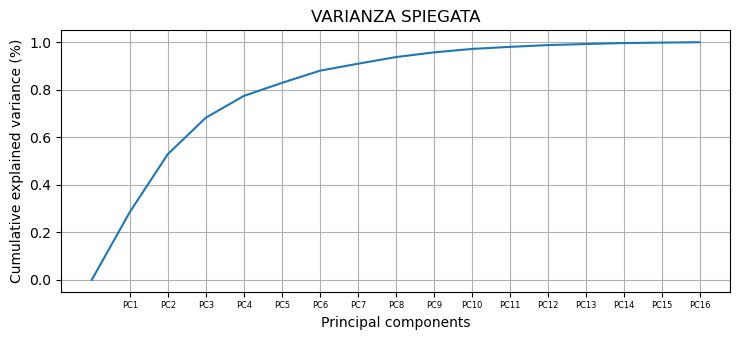

In [648]:
pcaNoParam = PCA()

pcaNoParam.fit(X_trainval.values)

#Rappresentazione della varianza spiegata
plt.figure()
plt.plot(np.insert(np.cumsum(pcaNoParam.explained_variance_ratio_), 0, 0))
plt.title('VARIANZA SPIEGATA')
plt.xticks(ticks=np.arange(1, pcaNoParam.n_features_in_ + 1), 
           labels=[f'PC{i}' for i in range(1, pcaNoParam.n_features_in_ + 1)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
#plt.savefig('Varianza_spiegata',dpi=300)
plt.show()


### Scree Plot
Supponendo di voler scegliare le _componenti principali_ rispetto alla "regola del gomito", visualizziamo il cosiddetto _Scree plot_. Possiamo quindi notare che come $k$ adatta si potrebbe selezionare $k=5$ oppure $k=7$, in quanto in corrispondenza di questi valori nello _Scree plot_ si verifica un lieve "appiattimento" della curva e nel grafico soprastante la varianza spiegata sembra sufficientemente elevata. Vediamo più nel dettaglio per $k=5$.

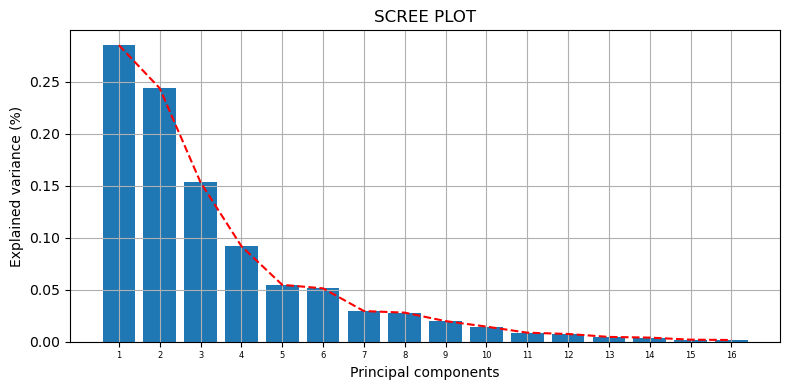

In [649]:
plt.figure(figsize=(8, 4))

plt.bar(np.arange(pcaNoParam.n_features_in_), pcaNoParam.explained_variance_ratio_)
plt.plot(np.arange(pcaNoParam.n_features_in_), pcaNoParam.explained_variance_ratio_, 'r--')
plt.title('SCREE PLOT')
plt.xticks(ticks=np.arange(pcaNoParam.n_features_in_), 
           labels=[i for i in range(1, pcaNoParam.n_features_in_ + 1)])
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
plt.grid()
#plt.savefig('Scree_plot',dpi=300)
plt.show()

## Calcolo della PCA
Scegliamo dunque $k=5$ e proseguiamo con il calcolo della PCA, eseguendo un _fit_ su _Training+Validation set_.
Calcoliamo quindi la varianza spiegata totale e vediamo il contributo dato da ogni variabile a ciascuna delle 5 PC. 

Numero PC  % Varianza Tot. Spiegata
X_trainval          5                  0.828534

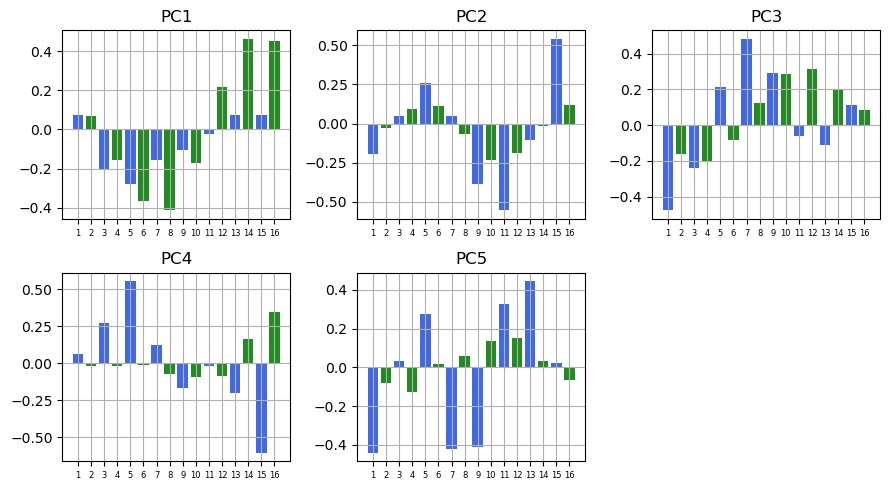

In [650]:
k = 5

pca = PCA(k, random_state=random_seed)
pca.fit(X_trainval.values)

#Visualizzare numero PC e percentuale di varianza spiegata
display(pd.DataFrame({'Numero PC': pca.n_components_, 
                      '% Varianza Tot. Spiegata': pca.explained_variance_ratio_.sum()}, 
                     index=['X_trainval']))

X_trainval_pca = pca.transform(X_trainval.values)
X_train_pca =  pca.transform(X_train.values)
X_val_pca =  pca.transform(X_val.values)
X_test_pca = pca.transform(X_test.values)
X_suggestedTest_pca = pca.transform(suggestedTestData.iloc[:,:-1].values)

#Contributo delle features alle PC
color_list = ['royalblue', 'forestgreen']*8
plt.figure(figsize=(9, 5))
matplotlib.rc('xtick', labelsize=6)
for i in range(k):
    plt.subplot(2, 3, i+1)
    plt.grid()
    plt.bar(np.arange(1,pca.n_features_in_+1), pca.components_[i, :], color=color_list)
    plt.xticks(ticks=np.arange(1,pca.n_features_in_+1))
    plt.title(f'PC{i + 1}')
    plt.tight_layout()
#plt.savefig('PCA_components',dpi=300)    
plt.show()

Abbiamo evidenziato in azzurro le cordinate $x$ e in verde le $y$. Possiamo subito osservare come nella PC1 diano un maggiore contributo positivo le coordinate $y$ degli ultimi 3 punti e come ci sia un picco moderato in corrispondenza di $x1$ e $y1$. Ciò significa che verso valori positivi della prima PC troveremo maggiormente cifre che vengono tracciate partendo mediamente in alto, muovendosi in punti più bassi per concludere nuovamente nella parte alta, mentre al contrario per valori negativi della PC. 

Dalla seconda PC in poi sembra che a discernere sia principalmente la cordinata $x$. Se per esempio guardiamo la PC2, notiamo che a dare un netto contributo positivo è la cordinata $x$ dell'ultimo punto. In generale la $x$, seguita dalla $y$, subisce una lieve oscillazione: da contributo negativo a positivo e poi di nuovo negativo e positivo. Le cifre che rispecchieranno un tratto che si sposta verso destra, poi verso sinista e infine nuovamente verso destra si troveranno generalmente verso valori positivi della PC2, mentre le cifre con un andamento contrario si troveranno principalmente in corrispondenza di valori negativi. 

Nella PC3 dà un netto contributo negativo la $x$ del primo punto, mentre positivo le $x$ dei punti intermedi. Dunque verosimilmente troveremo per valori grandi di PC3 cifre con traccia che parte a sinistra e poi si sposta verso destra. Un andamento iniziale opposto sarà invece caratteristico di campioni spostati verso valori bassi della terza PC. 

Verifichiamo mediante una rappresentazione grafica se tutto ciò che è stato osservato precedentemente per le prime 3 PC risulta effettivamente rispettato.


## Visualizzazione dei dati per $k=2$ ed $k=3$

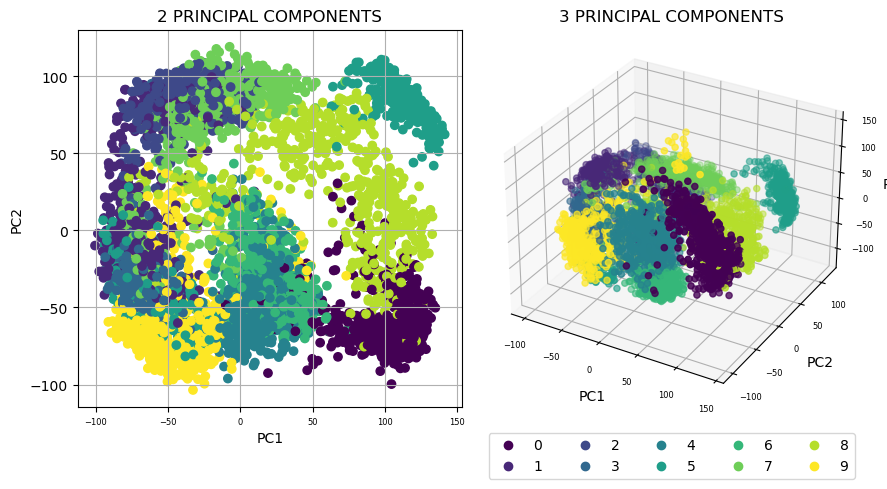

In [651]:
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(121)
fig.tight_layout(pad=5)
scatter = ax1.scatter(X_trainval_pca[:,0], X_trainval_pca[:,1], c=y_trainval)
plt.title('2 PRINCIPAL COMPONENTS')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.grid()
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(X_trainval_pca[:,0], X_trainval_pca[:,1], X_trainval_pca[:,2], c=y_trainval)
plt.title('3 PRINCIPAL COMPONENTS')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
plt.grid()
plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=5)
#plt.savefig('PCA_vis',dpi=300)
plt.show()

Ecco come le 10 classi sono distribuite nello spazio generato dalle prime 2 PC e in quello generato dalle prime 3.

Partendo dall'osservazione del primo _Scatter plot_ e facendo fede alle tracce medie delle cifre viste in precedenza, è evidente come nei quadranti della PC1 positiva troviamo le classi dello 0, del 5 e dell'8, a differenza delle classi dell'1, del 2, del 3 e del 9 che troviamo nella metà della PC1 negativa.
Ciò conferma quanto affermato; infatti le prime tre cifre vengono tracciate partendo in alto, muovendosi in basso e poi nuovamente in alto, mentre le auccessive 4 terminano tutte nella parte bassa.

Anche le osservazioni sulla PC2 risultano rispettate, dal momento che nella parte alta dello _Scatter plot_ troviamo il 2, il 7 e il 5 caratterizzati da un andamento sinistra-destra-sinistra-destra. Al contrario, nella parte bassa abbiamo 0, 3, 4 e 9 di cui è più tipico un andamento destra-sinistra-destra-sinistra.

Per quanto riguarda la PC3 le differenze tra le classi sono minori. Un'unica distinzione un po' evidente è tra le classi 4 e 6, la prima con tratto iniziale da sinistra e quindi più in alto nelle  _Scatter plot_ 3-dimensionale e la seconda con tratto da destra, dunque più in basso.

In conclusione, tutte le osservazioni si sono verificate corrette, nonostante rimangano sommarie.

## Visualizzazione delle cifre in seguito a PCA

Proviamo ora a ricostruire il dataset di partenza, aumentando nuovamente la dimensione dalle PC ottenute con il modello. Rappresentando le cifre con le medie delle cordinate ricostruite otteniamo:

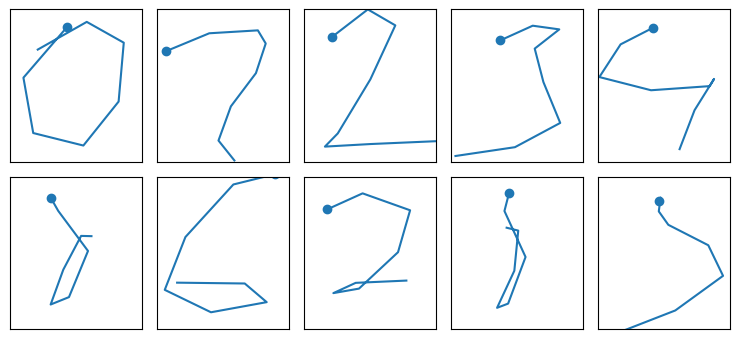

In [701]:
X_dataset_pca = pca.transform(dataset.iloc[:,:-1].values)
X_reconstruct_dataset = pca.inverse_transform(X_dataset_pca)

fig = plt.figure()
for i in range(10):
    means = X_reconstruct_dataset[dataset['class']==i].mean(axis=0)
    plt.subplot(2,5,i+1)
    plt.plot(means[0:16:2],means[1:16:2])
    plt.scatter(means[0],means[1])
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
    plt.xlim([0,100])
    plt.ylim([0,100])
#plt.savefig('Numbers_PCA',dpi=300)
plt.show()

Vediamo come molte cifre siano ricostruite fedelmente. Vediamo una ancora maggiore distorsione di 7, 8 e 9 che risultano ora più simili tra loro come a 1 e 5.

# Fisher Discriminant Analysis (FDA) e Linear Discriminant Analysis (LDA)

Tratteremo ora in breve il funzionamento di questi due modelli. La FDA (_Fisher Discriminant Analysis_) è una tecnica di riduzione di dimensionalità che, differentemente dalla PCA, proietta i campioni su uno spazio di dimensione inferiore massimizzando la separazione tra le classi. La LDA (_Linear Discriminant Analysis_) si basa su principi simili, ma ha l'obiettivo di classificare nuovi dati. Può essere anch'essa tuttavia utilizzata per ridurre la dimensione del problema.


## FDA
Per proiettare i dati massimizzando la separazione tra le classi, la FDA si basa su due principi: la massimizzazione della distanza tra i centroidi delle diverse classi e la minimizzazione della varianza intra-classe.

Rappresentiamo con $X^{(j)}$ la matrice dei campioni della classe $j$ e con $m^{(j)}=|X^{(j)}|$ il numero di campioni appartenenti alla classe j-esima.
Definiziamo dunque la _Media Campionaria_ della classe $j$ e la _Matrice di Varianza Campionaria_ di $j$ come:

$$
\overline{X}^{(j)}=\frac{1}{m^{(j)}}X^{(j)\,\top}\mathbb{1}_{m^{(j)}} \quad \in \mathbb{R}^n  \quad \quad \quad \quad \quad \quad  S^{(j)}=\frac{1}{m^{(j)}}(X^{(j)}-\mathbb{1}_{m^{(j)}}\overline{X}^{(j)\top})^\top(X^{(j)}-\mathbb{1}_{m^{(j)}}\overline{X}^{(j)\top}) \quad \in \mathbb{R}^{nxn}
$$

Consideriamo ora la matrice complessiva e scriviamo in modo esplicito l'espressione che descrive il generico elemento in posizione $(hl)$

$$
S=\frac{1}{m}(X-\mathbb{1}_m\overline{X}^\top)^\top(X-\mathbb{1}_m\overline{X}^\top) \quad \quad \implies \quad \quad S_{hl}=\sum_{j=1}^p\frac{m^{(j)}}{m}S_{hl}^{(j)}+\frac{1}{m}\sum_{j=1}^pm^{(j)}(\overline{X}_h^{(j)}-\overline{X}_h)(\overline{X}_l^{(j)}-\overline{X}_l)
$$

Possiamo riconoscere due diverse componenti:
- $S_{(w)}=[\sum_{j=1}^p\frac{m^{(j)}}{m}S_{hl}^{(j)}]_{hl}$ è la matrice di varianza campionaria _within_, che rappresenta la varianza interna alle singole classi;
- $S_{(b)}=[\frac{1}{m}\sum_{j=1}^pm^{(j)}(\overline{X}_h^{(j)}-\overline{X}_h)(\overline{X}_l^{(j)}-\overline{X}_l)]_{hl}$ è la matrice di varianza campionaria _between_, che rappresenta la varianza reciproca tra le diverse classi.

### Proiezione lungo la direzione del primo vettore
Se si desidera proiettare $\overline{X}^{(j)}$ sulla direzione di un dato vettore $\boldsymbol{a}=(a_1,...,a_n)^\top$ si può calcolare

$$
\overline{W}^{(j)}=\frac{1}{m^{(j)}}W^{(j)\,\top}\mathbb{1}_{m^{(j)}}=\boldsymbol{a}^\top\cdot \overline{X}^{(j)} \quad \quad \text{dal momento che} \quad \quad W^{(j)}=X^{(j)}\cdot \boldsymbol{a}
$$

Dopo la proiezione lungo $a$ la nuova  _Matrice di Varianza Campionaria_ della classe j-esima risulta

$$
S^{(j)}_W=\frac{1}{m^{(j)}}(W^{(j)}-\mathbb{1}_{m^{(j)}}\overline{W}^{(j)\top})^\top(W^{(j)}-\mathbb{1}_{m^{(j)}}\overline{W}^{(j)\top})=\boldsymbol{a}^\top\cdot S^{(j)}\cdot \boldsymbol{a}
$$

mentre la matrice complessiva risulta

$$
S_W=\boldsymbol{a}^\top S\boldsymbol{a}=\boldsymbol{a}^\top S_{(w)} \boldsymbol{a}+\boldsymbol{a}^\top S_{(b)} \boldsymbol{a}
$$

dove il secondo addendo è da massimizzare.

Se imponiamo il vincolo che la varianza dei dati proiettati sia unitaria il problema si può riassumere in

$$\begin{cases} \max_a \lambda = \boldsymbol{a}^\top S_{(b)}\boldsymbol{a}\\ \boldsymbol{a}^\top S\boldsymbol{a}=1 \end{cases}  \quad \quad \quad \quad (1)$$

Da ciò segue che $S^{-1}S_{(b)}\boldsymbol{a}=\lambda \boldsymbol{a}$ dunque il massimo coincide con il massimo autovalore $\lambda_1$ di $S^{-1}S_{(b)}$ e si trova per $\boldsymbol{a}_{(1)}$ autovettore corrispondente. 

- $W_{(1)}=\boldsymbol{a}_{(1)}^\top X$ prende il nome di _prima funzione discriminante lineare_

### Proiezione su un iperpiano di dimensione maggiore
Analogamente a quanto visto per la PCA, se si vuole proiettare su un piano di dimensione maggiore di 1, si può proseguire in modo ricorsivo e cercare nuove direzioni perpendicolari a tutte le precedenti che meglio soddisfino i criteri prestabiliti.

Nel caso specifico della FDA, vogliamo che il secondo vettore $\boldsymbol{a}_{(2)}$ generatore del piano soddisfi condizioni analoghe ad $(1)$ con il vincolo aggiuntivo di perpendicolarità rispetto ad $\boldsymbol{a}_{(1)}$. Il sistema per la ricerca della seconda direzione è quindi:

$$
\begin{cases}
\max_{a_{(2)}} \lambda_2 = \boldsymbol{a}_{(2)}^\top S_{(b)}\boldsymbol{a}_{(2)}\\
\boldsymbol{a}_{(2)}^\top S\boldsymbol{a}_{(2)}=1, \quad \quad \boldsymbol{a}_{(1)}^\top S\boldsymbol{a}_{(2)}=0
\end{cases}
$$

Allo stesso modo di $\boldsymbol{a}_{(1)}$ avremo che $\lambda_2$ è il secondo più grande autovalore di $S^{-1}S_{(b)}$ e $\boldsymbol{a}_{(2)}$ il rispettivo autovettore.

- $W_{(2)}=\boldsymbol{a}_{(2)}^\top X$ prende il nome di _seconda funzione discriminante lineare_

In conclusione, possiamo andare avanti in modo ricorsivo fino ad ottenere tante funzioni discriminanti quanto è il rango di $S^{-1}S_{(b)}$, anche se normalmente ci si ferma a dimensioni inferiori.

## LDA

La _Linear Discriminant Analysis_ è un modello di classificazione che si basa sul Teorema di Bayes, il quale afferma

$$
\mathbb{P}(Y=k|X=\boldsymbol{x})=\frac{\mathbb{P}(X=\boldsymbol{x}|Y=k) \cdot \mathbb{P}(Y=k)}{\mathbb{P}(X=\boldsymbol{x})}
$$

cioè descrivere la probabilità che un campione di cui conosciamo i valori delle feature appartenga alla classe $k$.

La formula appena illustrata può essere anche scritta come

$$
p_k(\boldsymbol{x})=\mathbb{P}(Y=k|X=\boldsymbol{x})=\frac{\Pi_k f_k(\boldsymbol{x})}{\sum_{l=1}^p\Pi_l f_l(\boldsymbol{x})}  
$$

con
- $f_k(\boldsymbol{x})=\mathbb{P}(X=\boldsymbol{x}|Y=k)$ densità di $X$ in $k$;
- $\Pi_k=\mathbb{P}(Y=k)$ probabilità marginale per la classe $k$.

Il modello può essere applicato solo nel caso in cui i campioni di ogni classe abbiano distribuzione normale omoschedastica.
Se questa condizione è rispettata, quando dobbiamo effettuare la classificazione di un nuovo campione, scegliamo la classe $k$ per cui $p_k(\boldsymbol{x})$ è maggiore.
Massimizzare $p_k(\boldsymbol{x})$ equivale a massimizzare il suo logaritmo. Dunque definiamo

$$
\delta_k(\boldsymbol{x})=\ln p_k(\boldsymbol{x}) = \ln \Pi_k+ \ln f_k(\boldsymbol{x}) - \ln \sum_{l=1}^pf_l(\boldsymbol{x})=\boldsymbol{x}^\top \Sigma^{-1}\mu_k -\frac{1}{2}\mu_k^\top \Sigma^{-1}\mu_k+ \ln \Pi_k
$$

Nel caso specifico di $n=1$ avremo

$$\delta_k(x)=x\frac{\mu_k}{\sigma^2}-\frac{\mu_k^2}{2\sigma^2}+\ln (\Pi_k)$$

Dal momento che i parametri $\Pi_k, \mu_k$ e $\sigma^2$ sono ignoti, si utilizzano le approssimazioni

$$
\hat{\Pi}_k=\frac{m_k}{m}, \quad \quad \quad \hat{\mu}_k=\frac{1}{m_k}\sum_{i:y_i=k}x_i, \quad \quad \quad \hat{\sigma}^2=\sum_{k=1}{p}\frac{m_k-1}{m-p}\hat{\sigma}_k^2 \quad \text{con} \quad \hat{\sigma}_k^2=\frac{1}{m_k-1}\sum_{i:y_i=k}(x_i-\hat{\mu}_k)^2
$$

Possiamo vedere la classificazione delle diverse classi come una partizione dello spazio in cui troviamo sulla linea di confine tra la classe $j$ e la classe $k$ ($j\neq k$) i campioni per cui $\delta_j(\boldsymbol{x})=\delta_k(\boldsymbol{x})$.

## Applicazione ai dati
Al fine dell'analisi dei dati scelti, abbiamo deciso di non applicare riduzione di dimensionalità con FDA, ma di limitarci a quella ottenuta tramite PCA.
In merito alla classificazione con LDA dobbiamo stabilire se la distribuzione dei campioni nelle classi è normale ed omoschedastica.
A tale scopo rappresentiamo di seguito la distribuzione delle feature per la classe 0, per la classe 1 e per la 5.

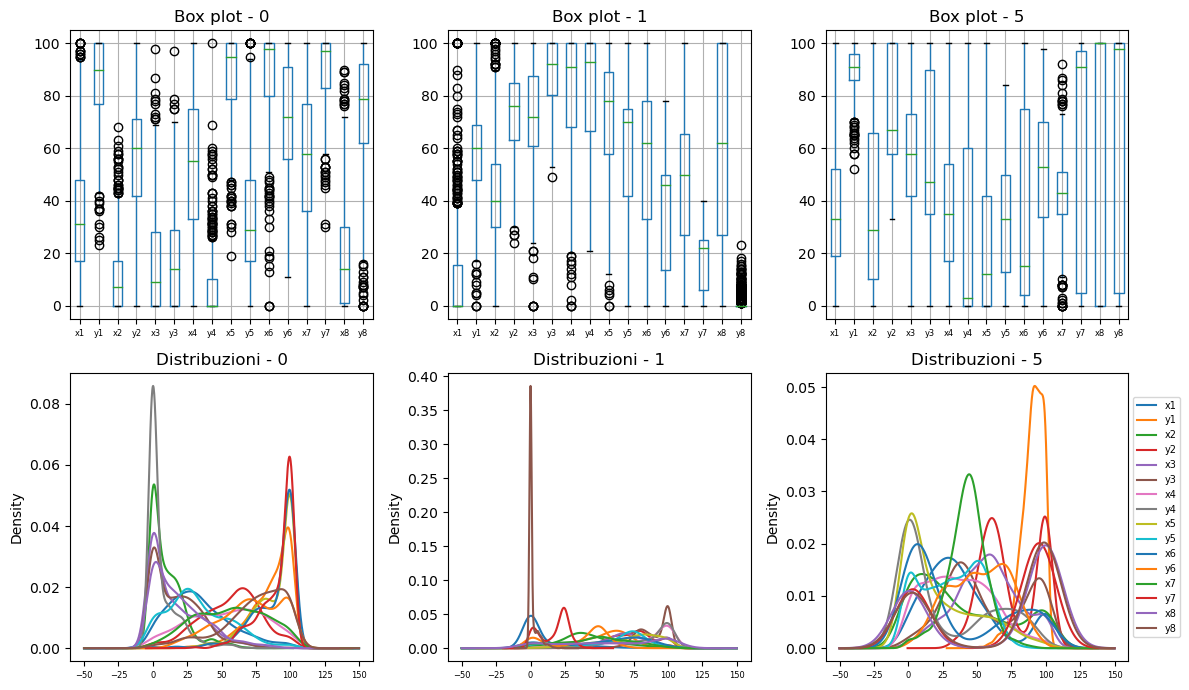

In [652]:
fig, axs = plt.subplots(2,3, figsize=(12,7))
dataset[dataset['class']==0].iloc[:,:-1].boxplot(ax=axs[0,0])
axs[0,0].set_title('Box plot - 0')
dataset[dataset['class']==0].iloc[:,:-1].plot.density(ax=axs[1,0],legend=False)
axs[1,0].set_title('Distribuzioni - 0')
dataset[dataset['class']==1].iloc[:,:-1].boxplot(ax=axs[0,1])
axs[0,1].set_title('Box plot - 1')
dataset[dataset['class']==1].iloc[:,:-1].plot.density(ax=axs[1,1],legend=False)
axs[1,1].set_title('Distribuzioni - 1')
dataset[dataset['class']==5].iloc[:,:-1].boxplot(ax=axs[0,2])
axs[0,2].set_title('Box plot - 5')
dataset[dataset['class']==5].iloc[:,:-1].plot.density(ax=axs[1,2])
axs[1,2].set_title('Distribuzioni - 5')
axs[1,2].legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, prop={'size': 7}) #, ncol=8)
#plt.savefig('Density_plots',dpi=300)
plt.show()

Come possiamo notare dai grafici delle distribuzioni riportati sopra, ci sono dei picchi in corrispondenza dei valori 0 e 100. Ciò non dovrebbe stupirci dal momento che ciascun campione ha con certezza almeno una cordinata $x$ settata a 0 e almeno una settata a 100, come almeno una cordinata $y$ uguale a 0 e una uguale 100. Dunque la frequenza di tali valori è molto superiore rispetto a quella di un qualunque altro nell'intervallo $[0,100]$. Valori al di fuori di questo intervallo non sono osservabili: questo spiega i margini ben definiti dei _Box plot_. I tratti di curva nei grafici delle distribuzioni che escono da tale intervallo sono dovuti ad una interpolazione (dunque approssimazione) che viene effettuata nella costruzione dei grafici stessi.

Un'enorme differenza di andamenti è evidente tra le classi 1 e 5: a caratterizzare le distribuzioni dell'1 è il picco molto pronunciato in 0 della variabile $y8$, dovuto dall'alta probabilità di avere come punto più basso di tutti l'ultimo rilevato; al contrario, i grafici della cifra 5 non presentano picchi sproporzionati, a causa di una maggiore variabilità nella scrittura (come già scritto in precedenza) e quindi una maggiore casualità delle cordinate.

Il caso della variabile $y8$ per le classi dell'1 e del 5, nonostante rappresenti una distribuzione marginale, è gia un esempio di non normalità, nè omoschedasticità. Mostriamo di seguito un particolare di queste due curve. A screditare l'andamento normale della distribuzione è la "doppia oscillazione" visibile nel grafico della seconda delle due classi che, nonostante sia appunto una distribuzione marginale, non può contribuire alla formazione di una normale multivariata. Anche le varianze risultano molto diverse, come mostrato dalla tabella sottostante. 

Anche dai _Box plot_ è molto evidente la non-normalità: in primis le medie spesso non centrate rispetto ai box e a seguire la quantità elevata di outlier.

Alla luce di tutto ciò risulta inadeguata l'applicazione dell'LDA.

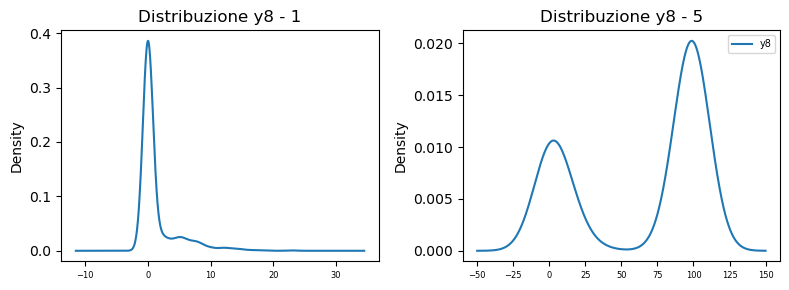

classe 1     classe 5
Varianza y8  9.462656  2078.938369

In [653]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
dataset[dataset['class']==1].iloc[:,-2].plot.density(ax=axs[0],legend=False)
axs[0].set_title('Distribuzione y8 - 1')
dataset[dataset['class']==5].iloc[:,-2].plot.density(ax=axs[1])
axs[1].set_title('Distribuzione y8 - 5')
axs[1].legend(loc='upper right', bbox_to_anchor=(1, 1),fancybox=True, prop={'size': 7})
#plt.savefig('Density_plot_y8_1e5',dpi=300)
plt.show()

#Matrici di Varianza-Covarianza delle classi 1 e 5
#display(dataset[dataset['class']==1].iloc[:,:-1].cov())
#display(dataset[dataset['class']==5].iloc[:,:-1].cov())

#Tabella delle varianza della variabile y8 per le classi 1 e 5
varY8_1 = dataset[dataset['class']==1]['y8'].var()
varY8_5 = dataset[dataset['class']==5]['y8'].var()
display(pd.DataFrame({'classe 1':[varY8_1],
                      'classe 5':[varY8_5]},
                      index=['Varianza y8']))

# Support Vector Machine (SVM)

La _Support Vector Machine_ (SVM) è un modello di classificaione che trova un iperpiano nello spazio delle feature in grado di separare le diverse classi. In particolare ricerca il piano separatore che massimizza il margine, ossia la minima distanza tra il piano stesso e i punti. Considerando quindi una generica equazione del piano

$$
f(\boldsymbol{x})=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_nx_n=0
$$

e due possibili classi di output $y_i=\pm1$ la separazine avviene in modo esatto se la seguente condizione è soddisfatta

$$
y_i\cdot f(\boldsymbol{x}_i)>0
$$

Per selezionare l'iperpiano con margine massimo definiamo allora 

$$
M=\min_{i\in[m]}d(\boldsymbol{x}_i,\pi) \quad \text{dove} \quad \pi: f(\boldsymbol{x})=0
$$

Osserviamo inoltre che, se si impone

$$
\sum_{j=1}^n\beta_j^2=1, \quad \text{abbiamo} \quad y_i\cdot f(\boldsymbol{x}_i)=|f(\boldsymbol{x}_i)|=d(\boldsymbol{x}_i,\pi)
$$

da cui si deduce il seguente sistema che racchiude tutte le informazioni necessarie per la definizione della SVM

$$
\begin{cases}
\max_{\beta_0,\beta_1,...,\beta_n}M\\
\sum_{j=1}^n\beta_j^2=1\\
y_i(\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+...+\beta_nx_{in})\geq M \quad \quad \forall (\boldsymbol{x}_i,y_i)\in \mathcal{T}
\end{cases}
$$

L'ultima equazione impone che tutti i punti siano ben classificati e abbiano distanza dall'iperpiano maggiore o uguale ad M.

Un altro modo di riformulare il problema è sostituire il vincolo $\sum_{j=1}^n\beta_j^2=1$ con

$$|f(\boldsymbol{x}_i)|\geq 1\, \quad \forall \boldsymbol{x}_i\in X_{\mathcal{T}}\quad \quad \quad \quad \quad \quad (2)$$

In questo caso $M=\frac{1}{||\boldsymbol{\beta}||}$ dove $\boldsymbol{\beta}=[\beta_1,...,\beta_n]^\top$, quindi massimizzare $M$ equivale a minimizzare $||\boldsymbol{\beta}||^{2} = \boldsymbol{\beta}^\top\boldsymbol{\beta}$. Il sistema diventa:

$$
\begin{equation}
\begin{cases}
\min_{\boldsymbol{\beta}} \boldsymbol{\beta}^\top\boldsymbol{\beta}\\
y_i (\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+...+\beta_nx_{in}) \geq 1 \quad \quad \forall (\boldsymbol{x}_i,y_i)\in \mathcal{T}
\end{cases}
\end{equation}
$$


Iperpiani che soddisfano $(2)$ si definiscono _iperpiani canonici rispetto_ $X_{\mathcal{T}}$. I vettori $\boldsymbol{x}_i\in X_{\mathcal{T}}$ tali che $|f(\boldsymbol{x}_i)| = 1$ e che quindi si trovo esattamente sul bordo del margine sono invece definiti _vettori di supporto_ o _support vectors_.

### Il problema duale

E' possibile risolvere il problema mediante il suo duale che è il seguente:

$$
\begin{cases}
\max_{\boldsymbol{\alpha}\in\mathbb{R}^m,\boldsymbol{\alpha}\geq 0} J(\boldsymbol{\alpha})=\sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_i\alpha_jy_iy_j\langle \boldsymbol{x}_i,\boldsymbol{x}_j\rangle\\
\sum_{i=1}^m \alpha_i y_i = 0\\
\alpha_i \geq 0\,,\quad \forall \ i=1,\ldots ,m
\end{cases}\,,
$$

Se $\alpha^*$ è soluzione del problema duale e $\mathcal{I}_{\mathrm{sv}} = \{i \ | \ \alpha_i^*\neq 0\}$, possiamo determinare la soluzione $(\boldsymbol{\beta}^*,\beta^*_0)$ del problema primale mediante
$$\boldsymbol{\beta}^* = \sum_{i=1}^m y_i\alpha_i^* \boldsymbol{x}_i = \sum_{i\in\mathcal{I}_{\mathrm{sv}}} y_i\alpha_i^* \boldsymbol{x}_i  \quad  \quad  \beta^*_0 = \frac{1}{|\mathcal{I}_{\mathrm{sv}}|} \sum_{i\in\mathcal{I}_{\mathrm{sv}}} (y_i - \boldsymbol{\beta}^{*\,\top} \boldsymbol{x}_i)$$


Osserviamo che prendendo un $\alpha^*_i>0$, allora il campione corrispondente $\boldsymbol{x}_i$ sarà un _support vector_, alternativamente, per $\alpha^*_i=0$, $\boldsymbol{x}_i$ non si troverà sul bordo del margine.

### SVM con margine _soft_

Non sempre è però possibile separare le classi in modo esatto, dunque spesso si ricorre ad un margine _soft_. Ecco che si introduce una nuova variabile $\epsilon_i$ tale per cui $0<\epsilon_i<1$ se il punto $\boldsymbol{x}_i$ si trova nel margine della propria classe, $\epsilon_i>1$ se supera il limite dell'iperpiano e $\epsilon_i=0$ se ben classificato e fuori dal margine. Riformulando il sistema nel modo seguente e variando l'_iperparametro di costo_ $C$ si stabilisce la rigidità della della separazione

$$
\begin{cases}
\max_{\beta_0,\beta_1,...,\beta_p,\epsilon_1,...,\epsilon_n}M\\
\sum_{j=1}^n\beta_j^2=1\\
y_i(\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+...+\beta_nx_{in})\geq M(1-\epsilon_i)\\
\epsilon_i\geq 0; \quad \sum_{i=1}^n\epsilon_i\leq C
\end{cases}
$$

Variando il parametro $C\in\mathbb{R}^+$ si ottiene il seguente risultato:
- $C\rightarrow 0$ aumenta la "durezza" del margine, permettendo ai vettori $\boldsymbol{x}_i$ di superarlo impercettibilmente;
- $C\rightarrow +\infty$ aumenta la "morbidezza" del margine, permettendo ai vettori $\boldsymbol{x}_i$ di superarlo illimitatamente;

Dato che il modello implementato nelle funzioni che andremo ad utilizzare ha una formulazione differente, e il coefficiente di costo viene integrato nella funzione obiettivo che diventa 
$$\max_{\beta_0,\beta_1,...,\beta_p}M-C(\sum_{i=1}^n\epsilon_i),$$
il parametro che da ora in poi denoteremo con $C$ avrà un influenza sul problema di tipo opposto: per $C\rightarrow 0$ aumenta la "morbidezza" e per  $C\rightarrow +\infty$ aumenta la "durezza".


### SVM non lineare
Spesso non è proprio possibile trovare un iperpiano separatore tra le classi perchè queste ultime potrebbero essere intrecciate. In questo caso si utilizza una SVM non lineare, includendo tra le feature alcune trasformazioni delle feature iniziali (ad esempio $(x_{i1}^2,x_{i1}^3,x_{i1}x_{i2},x_{i1}x_{i2}^2,...)$) e si aumenta così la dimensione da $n$ ad $N>n$. 
Una volta aumentata la dimensionalità, si trova con maggiore facilità un iperpiano separatore nello spazio ottenuto; è a questo punto importante controllare che non si verifichi overfitting. Una volta trovato l'iperpiano, si proiettano nuovamente i margini nello spazio di dimensione inferiore. I limiti tra le classi non saranno a questo punto più lineari.

Dal momento che solitamente si procede alla risoluzione del problema duale, che comprende un prodotto scalare nella funzione obiettivo, è possibile ottimizzare alcuni passaggi per rendere il processo meno dispendioso. Questa ottimizzazione avviene per mezzo di _kernel_, nonchè funzioni così definite:

$$
k: \mathcal{X}\times\mathcal{X}\rightarrow \mathbb{R} \quad \text{t.c.} \quad \exists! \phi: \mathcal{X} \rightarrow H\subset \mathbb{R}^N \quad \text{per cui} \quad <\phi_i,\phi_j>_H=k(\boldsymbol{x}_i,\boldsymbol{x}_j)
$$

dove indichiamo con $\mathcal{X}\subseteq\mathbb{R}^n$ il dominio dei vettori $\boldsymbol{x}$.

Le trasformazioni che vogliamo includere tra le feature del nuovo spazio sono le funzioni $\phi_1,\phi_2,...,\phi_N$, di cui però non è necessario calcolare l'output ogni volta. Infatti a noi interessa solo il prodotto scalare che può essere calcolato tramite il kernel direttamente a partire dalle feature iniziali. Risparmiamo così calcoli in esubero. 

Tra i kernel più diffusi troviamo
- Kernel lineare: $<\phi_i,\phi_j>_H=<\boldsymbol{x}_i,\boldsymbol{x}_j>_{\mathcal{X}}$
- Kernel polinomiale: $<\phi_i,\phi_j>_H=(\gamma<\boldsymbol{x}_i,\boldsymbol{x}_j>_{\mathcal{X}}+c_0)^d$
- RBF (Radial Basis Function): $<\phi_i,\phi_j>_H=e^{-\gamma<\boldsymbol{x}_i,\boldsymbol{x}_j>_{\mathcal{X}}^2}$
- Kernel sigmoidale: $<\phi_i,\phi_j>_H=tanh(\gamma<\boldsymbol{x}_i,\boldsymbol{x}_j>_{\mathcal{X}}+c_0)$

### SVM multiclasse
Quando la SVM viene utilizzata per la classificazione di $p>2$ classi ci sono due possibili strade:
- OVA (One Versus All): Addestramento di $p$ diverse SVM a due classi, una selezionata contro tutte le restanti. In questo caso la previsione viene poi effettuata scegliendo il classificatore che ha assegnato il campione alla classe selezionata con maggiore probabilità.
- OVO (One Versus One): Addestramento di tutte le $\binom{p}{2}$ possibili combinazioni di 2 classi e previsione in base alla classe che "vince più competizioni".

Nelle funzioni che utilizzeremo sarà implementato il metodo OVO.

## GridSearch

La _grid search_ è una tecnica utilizzata per trovare i valori degli iper-parametri che generano il modello con le migliori prestazioni.

Per ogni iper-parametro $p_h$  con $h=1,...,H$ si seleziona un intervallo discreto di valori $I_h$. Generalmente gli intervalli non contengono quantità equispaziate, ma la selezione segue un criterio stabilito che può essere, per esempio, un campionamento casuale determinato da una distribuzione di probabilità.

Si considerano dunque tutte le combinazioni degli iper-parametri
$$
G= I_1 \times I_2 \times ... \times I_H
$$

e si addestrano e validano tutti i $|G|$ modelli.


### Scelta degli iper-parametri
Scegliamo come iper-parametri per la grid search: $C$, $\gamma$ e il kernel, dove $\gamma$ è il coefficiente che viene utilizzato nei kernel _rbf, sigmoid_ e _poly_.
Per selezionare i valori di $\gamma$ adeguati per l'applicazione della SVM, guardiamo quali sono i default e scegliamo un ventaglio di quantità in modo da "tastare il terreno" intorno a quelle suggerite. Dato che i valori _auto_ e _scale_ si basano entrambi sulla varianza dei dati e la PCA tenta il più possibile di mantenere questa varianza, i default ottenuti dai dati originali sono molto simili a quelli ricavati dai campioni trasformati. Decidiamo quindi di tenere la stessa griglia di iper-parametri per entrambe le applicazioni. In entrambi i casi, inoltre, il numero massimo di iterazioni per l'identificazione del min/max è fissato a 10 milioni.

In [59]:
n_features = N-1

print('Valore di default di gamma:', 1 / (n_features * X_trainval.values.var()))
print('Valore auto di gamma:', 1 / n_features)
print('Valore di default di gamma in seguito a PCA:', 1 / (m * X_trainval_pca.var()))
print('Valore auto di gamma in seguito a PCA:', 1 / m)

# Definizione delle liste di valori tra i quali "scorrere" per gli iper-parametri:
C_list = [1, 5, 10, 25, 50, 100]
gamma_list = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000005, 'scale', 'auto']
ker_list = ['rbf', 'sigmoid', 'poly', 'linear']

hparameters = {'kernel':ker_list, 'C':C_list, 'gamma':gamma_list}

Valore di default di gamma: 5.2415804029154655e-05
Valore auto di gamma: 0.0625
Valore di default di gamma in seguito a PCA: 8.079124998040712e-05
Valore auto di gamma in seguito a PCA: 0.2


## Applicazione della SVM
Dopo aver creato una griglia di iper-parametri, applichiamo il modello SVM sia ai dati originali, sia ai dati modificati tramite PCA. Utilizzeremo in entrambi i casi la funzione _GridSearchCV_ che in automatico effettua una cross validation con 5 partizioni sui dati di Training.

### Applicazione ai dati originali

In [ ]:
#Dichiarazione della svm
svm = SVC(class_weight='balanced', max_iter = 10000000)

#Dichiarazione delle GridSearch
svm_gs = GridSearchCV(estimator=svm,
                      param_grid=hparameters,
                      scoring='f1_weighted',
                      return_train_score=True,
                      verbose=1)
    
#"Addestramento" delle GridSearch
svm_gs.fit(X_trainval, y_trainval)

# Mostriamo i risultati della Gridsearch con una tabella:
results = pd.DataFrame(svm_gs.cv_results_)

In [ ]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py

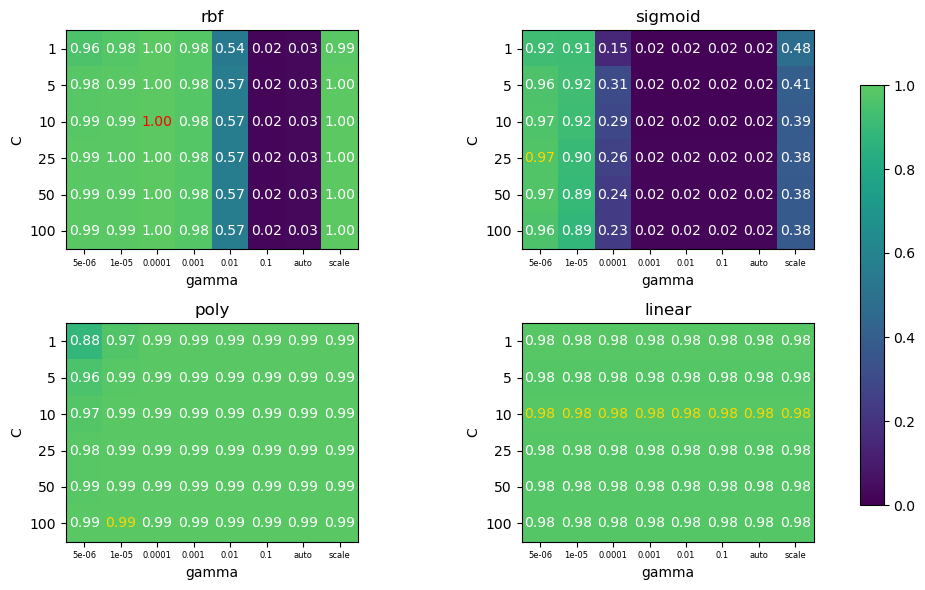

MIGLIORI IPERPARAMETRI


param_kernel param_C param_gamma mean_test_score
76          rbf      10      0.0001         0.99733

In [665]:
scoreInterest= 'mean_test_score' #mean_test_score, mean_train_score
interestingColumns = results[['param_kernel','param_C','param_gamma',scoreInterest]]
fig,axs=plt.subplots(2,2,figsize=(12,6))
for i,ker in enumerate(ker_list):
    heatMapData = interestingColumns[interestingColumns['param_kernel']==ker]
    heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
    ax=axs[int(i/2),i%2]
    im=ax.imshow(heatMapMatrix,vmin=0,vmax=1,cmap=newcmp)
    ax.set_yticks(range(len(heatMapMatrix.index)))
    ax.set_yticklabels(heatMapMatrix.index)
    ax.set_xticks(range(len(heatMapMatrix.columns)))
    ax.set_xticklabels(heatMapMatrix.columns)
    ax.title.set_text(ker)
    ax.set_xlabel("gamma")
    ax.set_ylabel("C")
    for a in range(len(heatMapMatrix.index)):
        for j in range(len(heatMapMatrix.columns)):
            c="w"
            if heatMapMatrix.iloc[a, j]==interestingColumns[scoreInterest].max():
                c="red"
            elif heatMapMatrix.iloc[a, j]==heatMapMatrix.values.max():
                c="gold"
            text = ax.text(j, a, "{0:.2f}".format(heatMapMatrix.iloc[a, j]),
                        ha="center", va="center", color=c)
fig.tight_layout()
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('gs_SVM_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=interestingColumns[scoreInterest].idxmax()
display(pd.DataFrame(interestingColumns.iloc[max_elem_row]).transpose())

Ecco qui sopra riportata la _heatmap_ rappresentante l'andamento dell'_f1-score_ per i dati di test, al variare degli iper-parametri. Sono evidenziati in giallo i valori maggiori per ogni kernel e in rosso il massimo assoluto, che in questo caso specifico si trova con la combinazione di iper-parametri illustrata nella tabella.

Cominciando dal kernel _linear_ osserviamo che a massimizzare l'_f1-score_ è un'intera riga, dunque abbiamo lo stesso valore per ogni scelta di $\gamma$. Questo è spiegato dal fatto che il kernel _linear_ non si serve del coefficiente $\gamma$. E' difficile notare dal grafico in quanto i valori sono arrotondati a due cifre decimali, ma ciascuna riga dell'_heatmap linear_ sarà costante.
Caso diverso è per _sigmoid_ che invece sembra essere molto dipendente dal valore $\gamma$. Lo _score_ raggiunge soglie molto basse per $\gamma$ "grande" e va man mano ad aumentare al diminuire di $\gamma$, senza mai però raggiungere prestazioni comparabili con _rbf_. Probabilmente, per ottenere buone performance di _sigmoid_, sarebbero necessari valori di gamma ancora inferiori.

Anche _rbf_ manifesta basse performance per $\gamma$ elevati, ma possiamo poi notare un miglioramento andando da destra verso sinistra e poi nuovamente un lieve peggioramento per $\gamma<0.0001$; ecco che il valore massimo si trova nel "picco".
Sia le prestazioni con _rbf_, sia con _sigmoid_ risultano molto più variabili in funzione di $\gamma$ rispetto a quanto non lo siano per $C$.

Mostriamo la stessa rappresentazione prendendo l'_f1-score_ calcolata sui campioni del training e ottenuta con le stesse righe di codice della precedente.

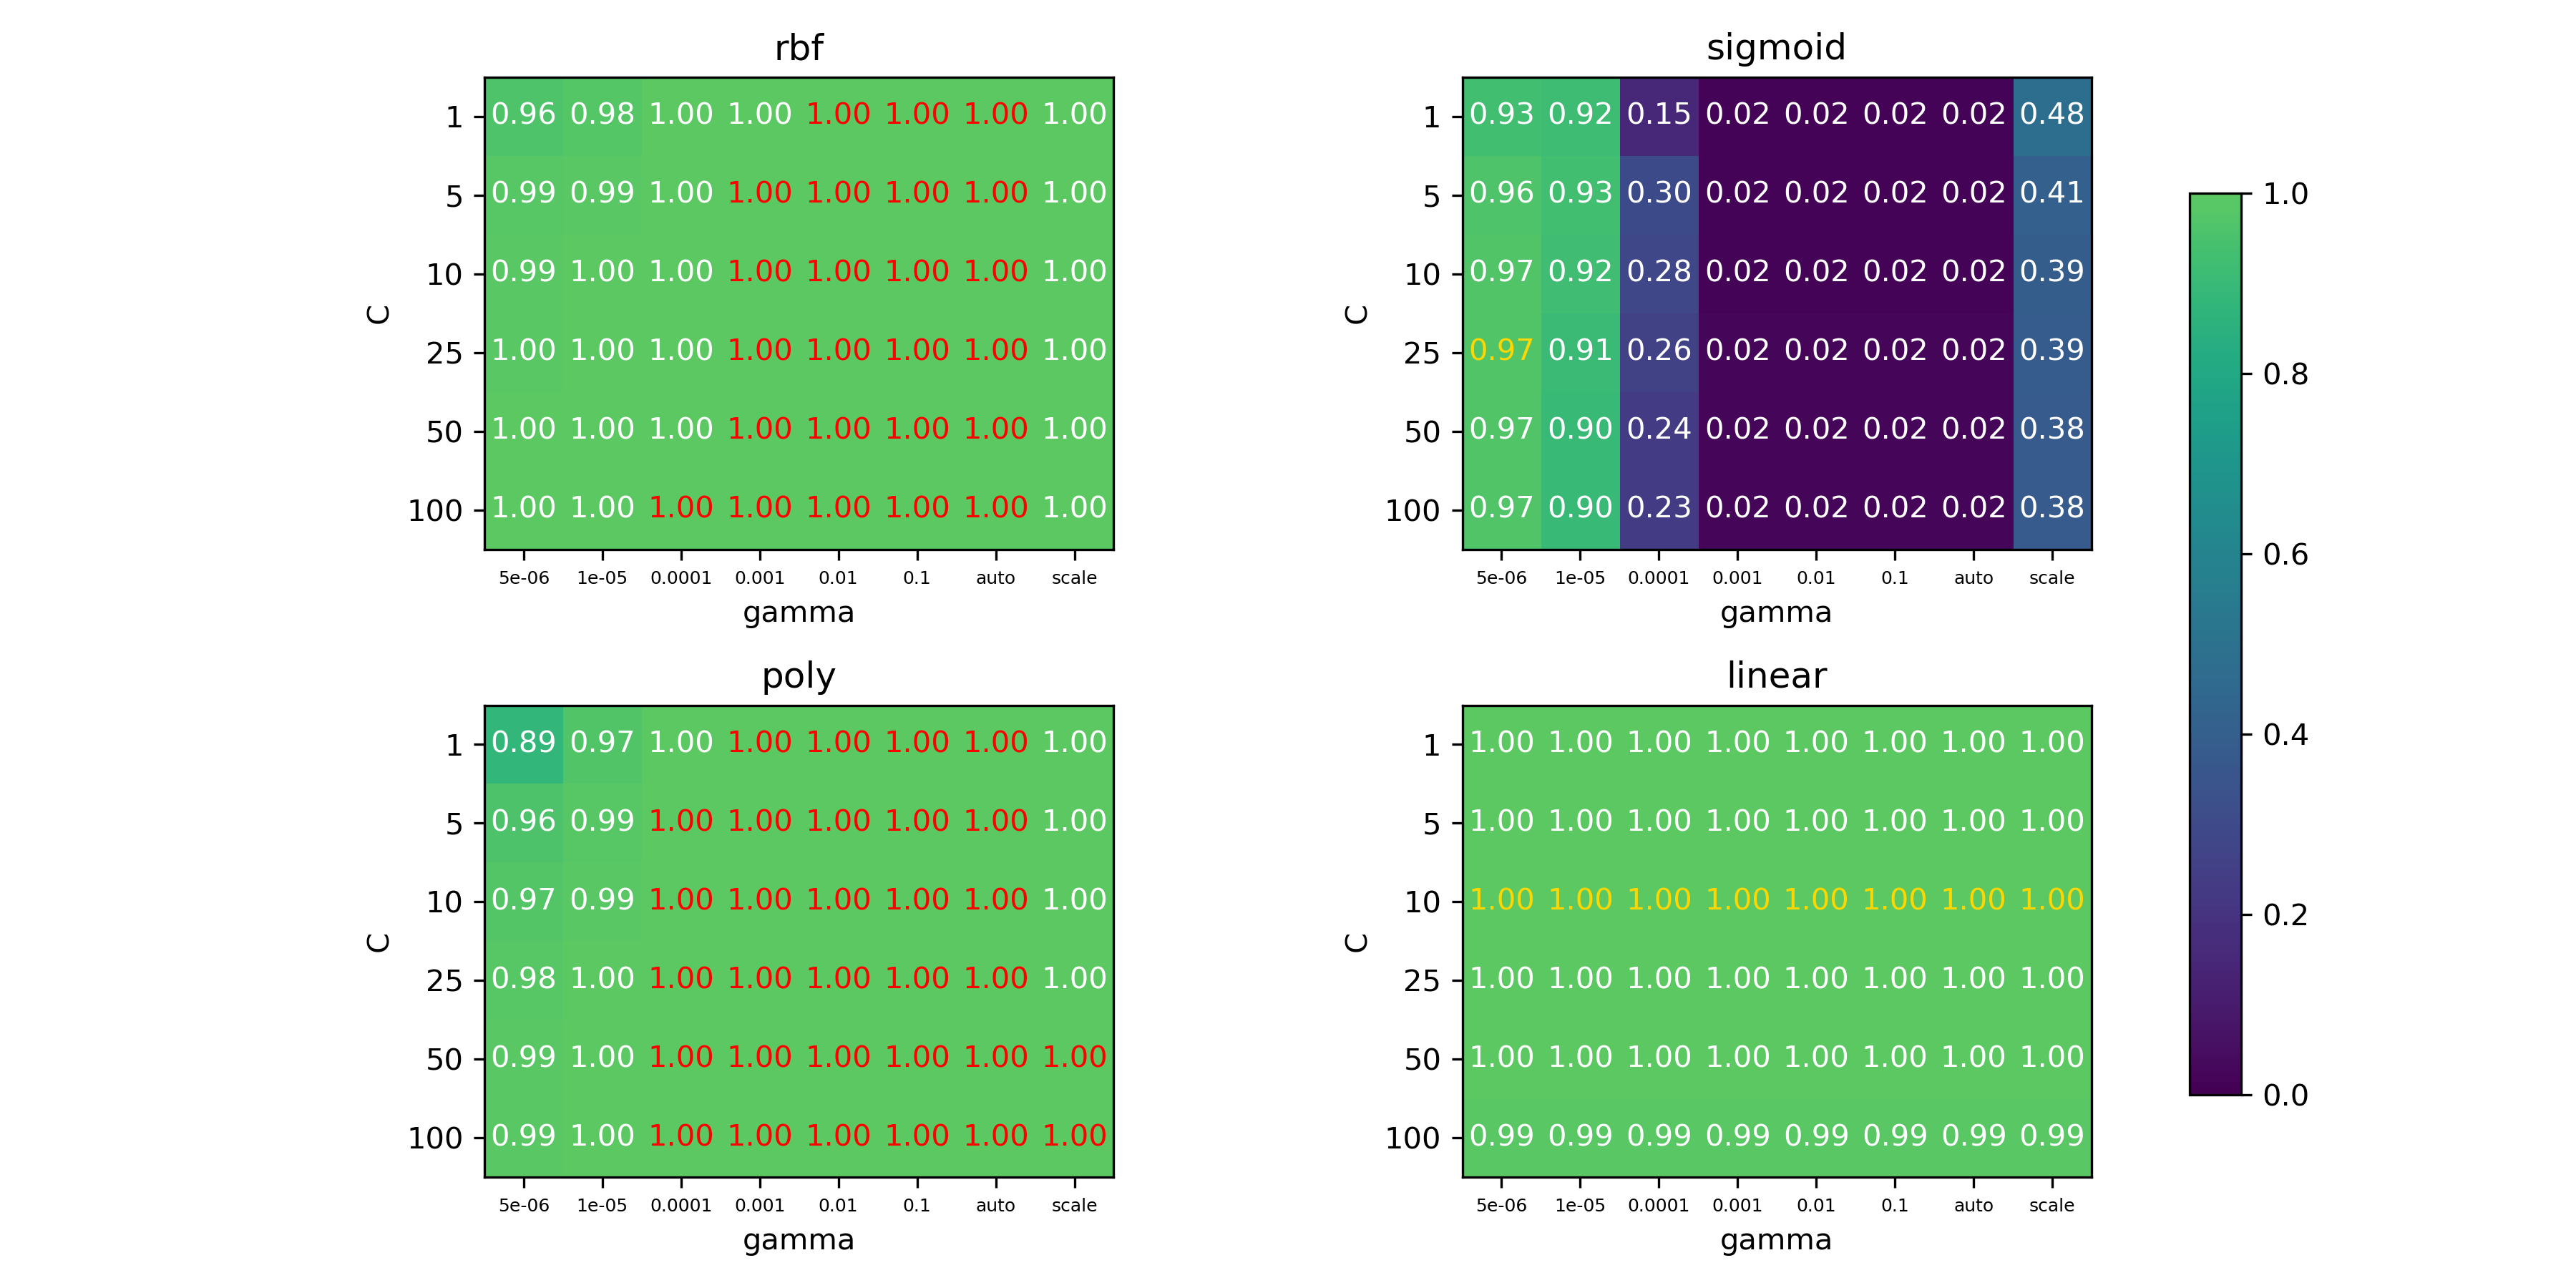

Mentre la _heatmap_ di _sigmoid_ è simile, quelle di _rbf_ e _poly_ sono molto diverse. Notiamo come, a differenza del massimo unico nel caso dei dati di test, qui siano presenti molti massimi e tutti uguali ad esattamente 1.0. Nel caso di _poly_ le combinazioni che davano valori di _f1_ massimi continuano a dare valori molto alti nel test. Invece, molte combinazioni "buone" per _rbf_ sul train risultano disastrose sul test. Questo potrebbe essere un indicatore di overfitting. I risultati disastrosi sul test con _sigmoid_, al contrario, sono sicuramente non causati da overfitting, dal momento che erano già poco buoni al momento del training.

### Applicazione ai dati elaborati con PCA

In [ ]:
#Dichiarazione della svm
svm_pca = SVC(class_weight='balanced', max_iter = 10000000)

#Dichiarazione delle GridSearch
svm_gs_pca = GridSearchCV(estimator=svm, param_grid=hparameters, scoring='f1_weighted', return_train_score=True, verbose=1)

#"Addestramento" delle GridSearch
svm_gs_pca.fit(X_trainval_pca, y_trainval)

# Mostriamo i risultati della Gridsearch con una tabella:
results_pca = pd.DataFrame(svm_gs_pca.cv_results_)

C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\2363333209.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\2363333209.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\2363333209.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\236333320

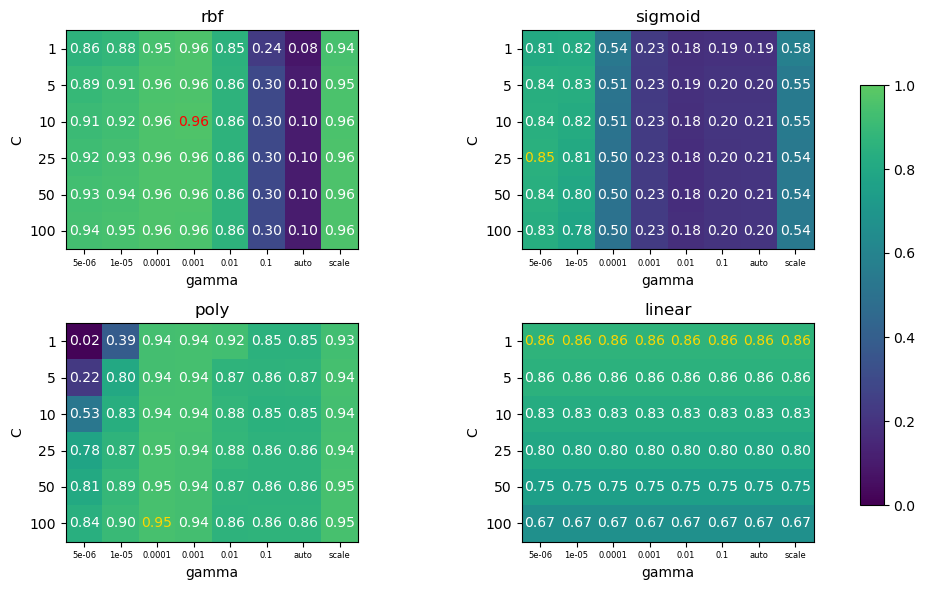

MIGLIORI IPERPARAMETRI


param_kernel param_C param_gamma mean_test_score
72          rbf      10       0.001         0.96325

In [400]:
scoreInterest= 'mean_test_score' #mean_test_score, mean_train_score
interestingColumns = results_pca[['param_kernel','param_C','param_gamma',scoreInterest]]
fig,axs=plt.subplots(2,2,figsize=(12,6))
for i,ker in enumerate(ker_list):
    heatMapData = interestingColumns[interestingColumns['param_kernel']==ker]
    heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
    ax=axs[int(i/2),i%2]
    im=ax.imshow(heatMapMatrix,vmin=0,vmax=1,cmap=newcmp)
    ax.set_yticks(range(len(heatMapMatrix.index)))
    ax.set_yticklabels(heatMapMatrix.index)
    ax.set_xticks(range(len(heatMapMatrix.columns)))
    ax.set_xticklabels(heatMapMatrix.columns)
    ax.title.set_text(ker)
    ax.set_xlabel("gamma")
    ax.set_ylabel("C")
    for a in range(len(heatMapMatrix.index)):
        for j in range(len(heatMapMatrix.columns)):
            c="w"
            if heatMapMatrix.iloc[a, j]==interestingColumns[scoreInterest].max():
                c="red"
            elif heatMapMatrix.iloc[a, j]==heatMapMatrix.values.max():
                c="gold"
            text = ax.text(j, a, "{0:.2f}".format(heatMapMatrix.iloc[a, j]),
                        ha="center", va="center", color=c)
fig.tight_layout()
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('gs_SVM_PCA_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=interestingColumns[scoreInterest].idxmax()
display(pd.DataFrame(interestingColumns.iloc[max_elem_row]).transpose())

Nel caso di dati elaborati con PCA l'andamento delle performance è simile. Notiamo però un peggioramento generale dei risultati che è soprattutto evidente nell'angolo in alto a sinistra della _heatmap poly_.

In questa rappresentazione possiamo però vedere con maggiore chiarezza come il kernel _linear_ non dipenda da $\gamma$.

Anche in questo caso riportiamo le _heatmap_ costruite sui dati del training e osserviamo che i fenomeni che si verificano sono analoghi ai precedenti.

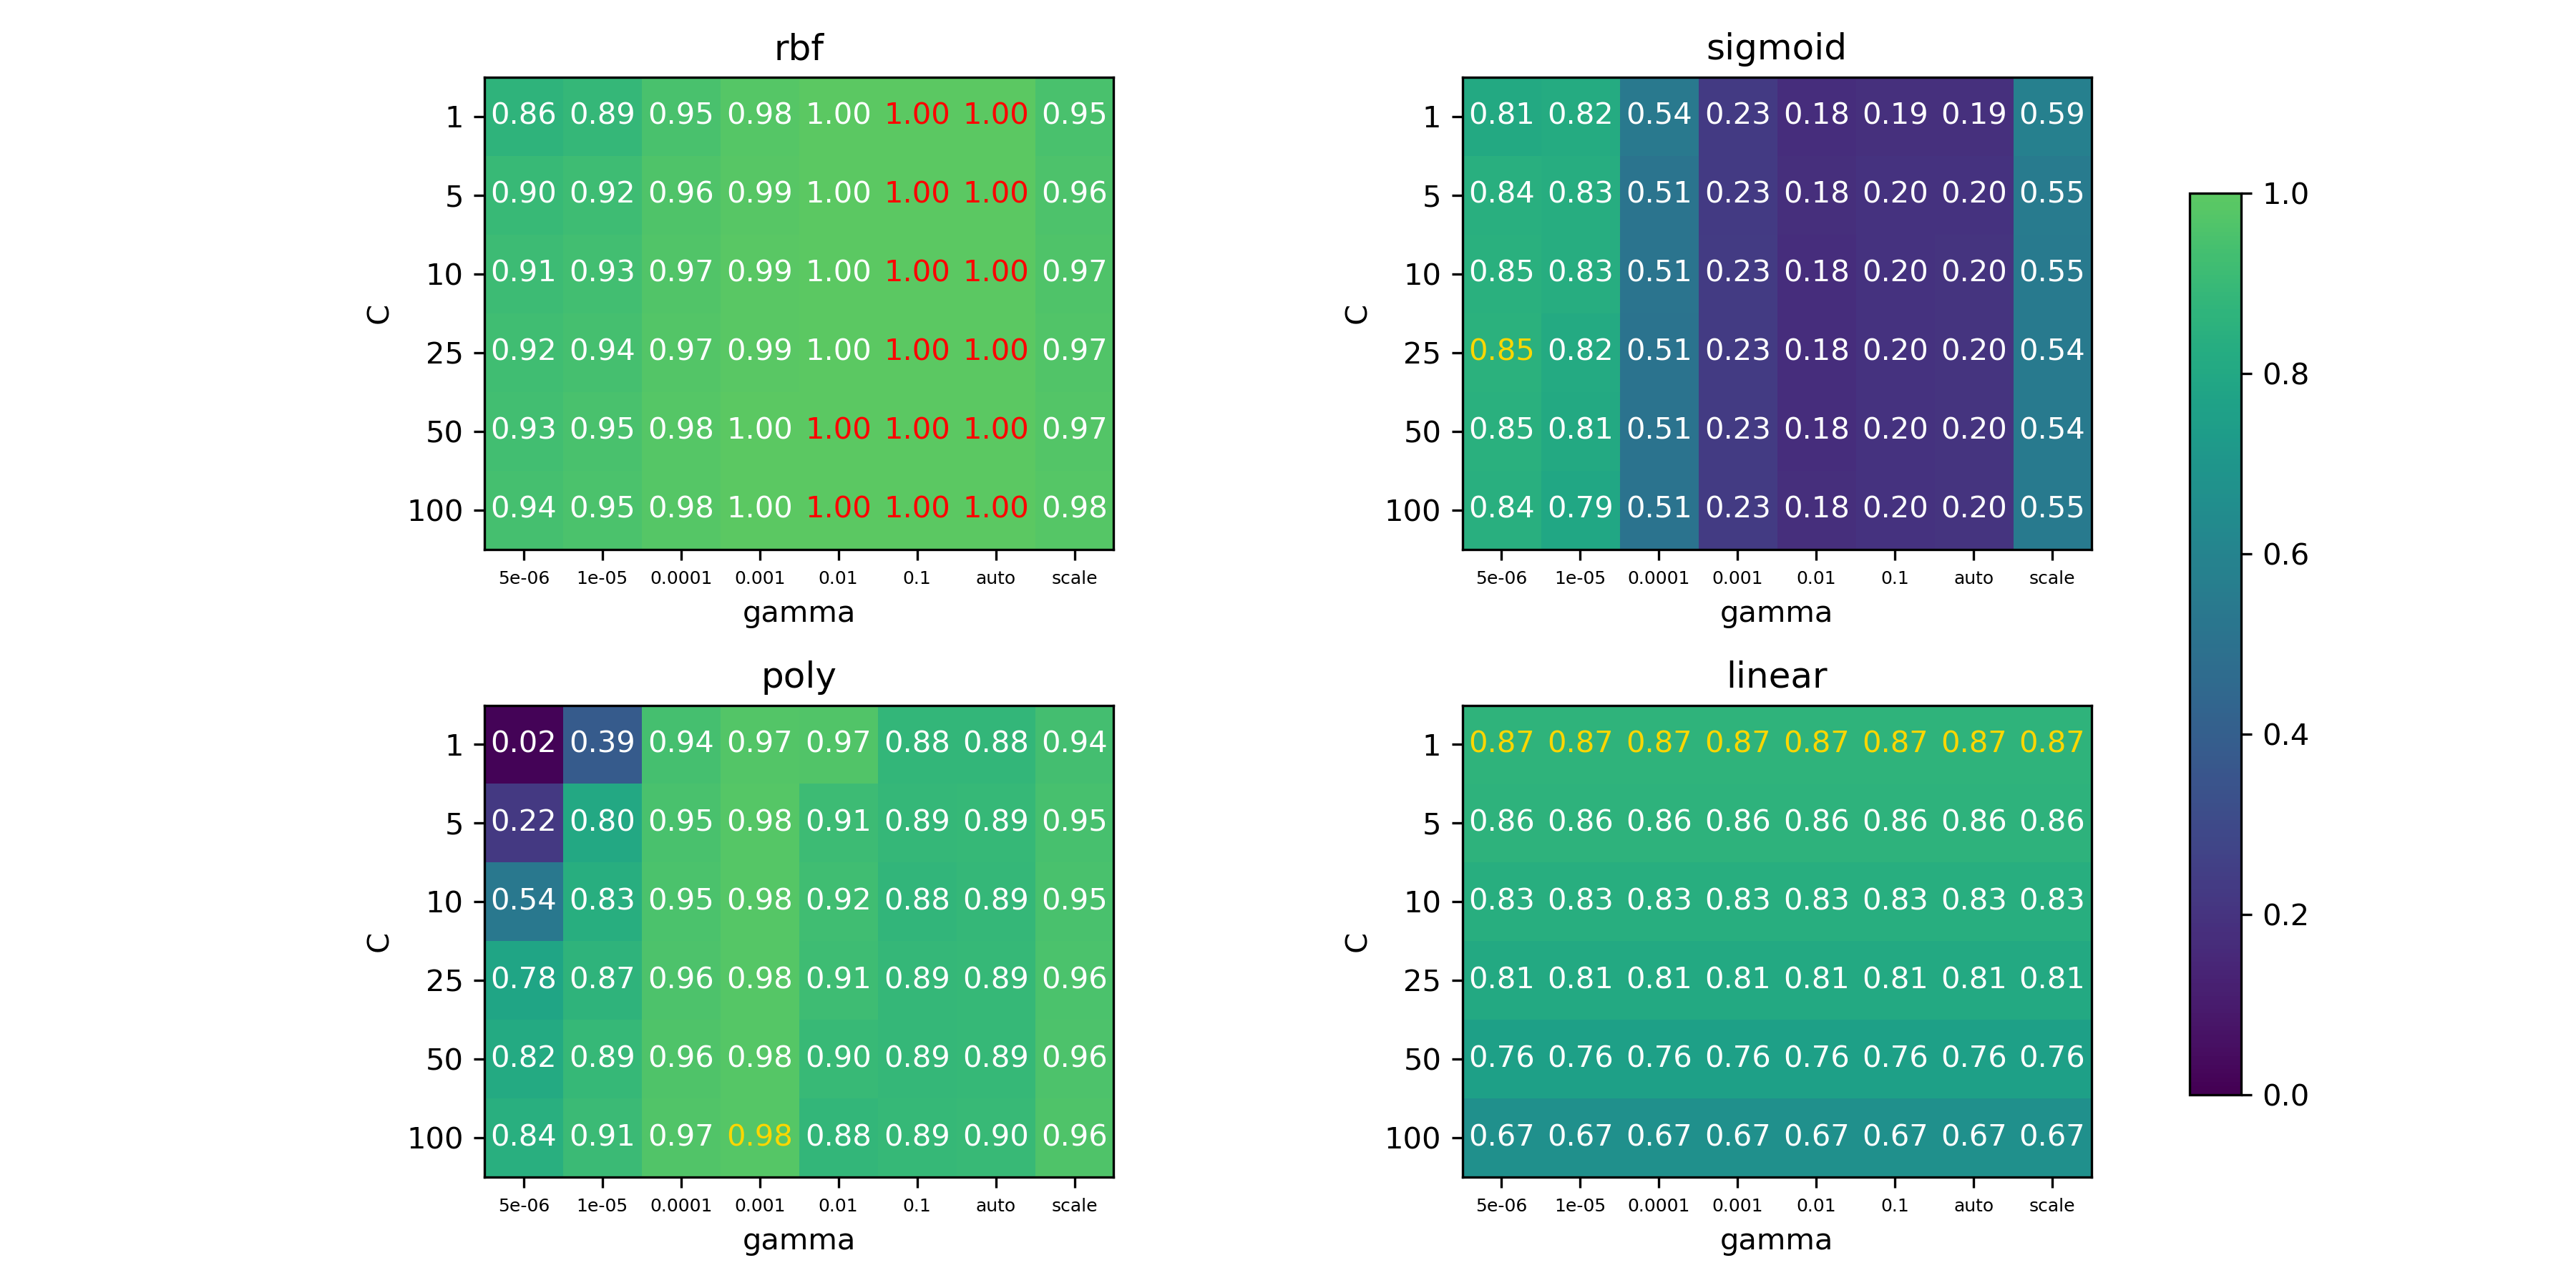

## Performance della migliore SVM

Vediamo più nello specifico le performance del modello migliore addestrato con gli iperparametri selezionati in precedenza.

Prima ricordiamo il significato degli indicatori _accuratezza_, _precisione_, _recall_ ed _f1 score_.

Se si tenta di stabilire se un campione appartiene ad una certa classe o meno, esso viene definito:
- _Vero positivo_ se è effettivamente appartenente alla classe e viene classificato come tale;
- _Falso negativo_ se vi appartiene ma viene etichettato come non appartenente;
- _Vero negativo_ se non appartiene alla classe e non viene dunque segnato come appartenente;
- _Falso positivo_ se non appartiene, ma viene erroneamente considerato come parte della classe.

La quantità di _Veri positivi_ è indicata con $TP$, qualla di _Falsi negativi_ con $FN$, _Veri negativi_ con $TN$ e _Falsi positivi_ con $FP$.
Gli indicatori di performance sono quindi definiti:

$$
Precisione=\frac{TP}{TP+FP} \quad \quad \quad \quad Recall=\frac{TP}{TP+FN}
$$

$$
Accuratezza=\frac{TP+TN}{TP+TN+FP+FN} \quad \quad \quad \quad F1 score=2\frac{Precisione \cdot Recall}{Precisione+Recall}\in[0,1]
$$


In [603]:
def performances(model,data,y_true,title=None):
    start=time.time()
    y_pred=model.predict(data)
    stop=time.time()
    totalTime=stop-start
    acc = model.score(data, y_true)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    df = pd.DataFrame({'Accuracy': [acc], 
                        'Precision': [prec ], 
                        'Recall': [rec ],
                        'F1': [f1 ]
                       },
                      index=[title])
    cmat=pd.DataFrame(confusion_matrix(y_true,y_pred,labels=model.classes_))
    return df,cmat,totalTime

In [663]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo e 0 colorato diverso
viridis = matplotlib.colormaps['viridis'].resampled(500)
greys = matplotlib.colormaps['Greys'].resampled(5)
newcolors_zero = viridis(np.linspace(0, 1, 500))[:400]
newcolors_zero[0] = greys(np.linspace(0, 1, 5))[3]
newcmp_zero=matplotlib.colors.ListedColormap(newcolors_zero)

def heatMapConstr(heatMapMatrices):
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    titles=['Dati originali', 'Dati con PCA']
    for i in range(2):
        normMatrix=heatMapMatrices[i].div(heatMapMatrices[i].sum(axis=1), axis=0)
        ax=axs[i]
        im=ax.imshow(normMatrix,vmin=0,vmax=1,cmap=newcmp_zero)
        ax.set_yticks(range(len(heatMapMatrices[i].index)))
        ax.set_yticklabels(heatMapMatrices[i].index)
        ax.set_xticks(range(len(heatMapMatrices[i].columns)))
        ax.set_xticklabels(heatMapMatrices[i].columns)
        ax.title.set_text(titles[i])
        ax.set_xlabel("predicted")
        ax.set_ylabel("true")
        for a in range(len(heatMapMatrices[i].index)):
            for j in range(len(heatMapMatrices[i].columns)):
                text = ax.text(j, a, heatMapMatrices[i].iloc[a, j], ha="center", va="center", color='w')
    #plt.savefig('Confusion_matrices_mlp_ig',dpi=300)
    fig.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('gs_SVM_'+scoreInterest,dpi=300)
    plt.show()

DATI ORIGINALI


Accuracy  Precision    Recall        F1
training  0.999666   0.999667  0.999666  0.999666
test      0.996664   0.996705  0.996664  0.996668

DATI ELABORATI CON PCA


Accuracy  Precision    Recall        F1
training  0.989992   0.990033  0.989992  0.989982
test      0.957972   0.958378  0.957972  0.957930

c:\Users\Anna\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


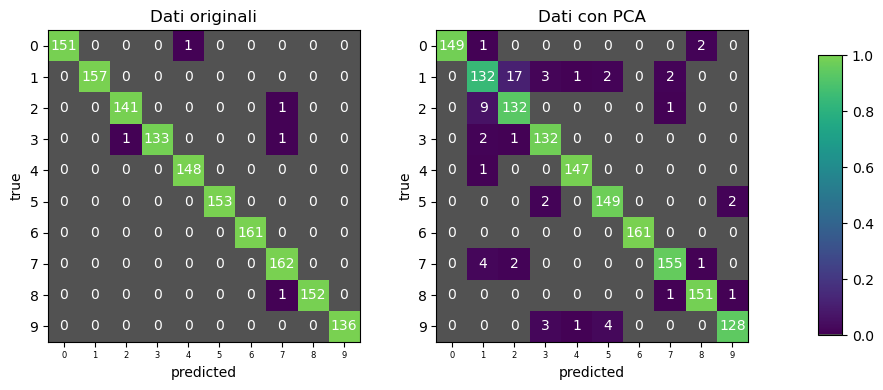

In [655]:
y_true_trainval = y_trainval
y_true_test = y_test

print('DATI ORIGINALI')
perf_trainval,cmat_trainval,svm_predict_time_trainval = performances(svm_gs.best_estimator_,X_trainval,y_true_trainval,'training')
perf,cmat,svm_predict_time = performances(svm_gs.best_estimator_,X_test,y_true_test,'test')
display(pd.concat([perf_trainval,perf]))

print('DATI ELABORATI CON PCA')
perf_trainval_pca,cmat_trainval_pca,svm_pca_predict_time_trainval = performances(svm_gs_pca.best_estimator_,X_trainval_pca,y_true_trainval,'training')
perf_pca,cmat_pca,svm_pca_predict_time = performances(svm_gs_pca.best_estimator_,X_test_pca,y_true_test,'test')
display(pd.concat([perf_trainval_pca,perf_pca]))

heatMapConstr([cmat,cmat_pca])

Riportati qui sopra sono i valori degli indicatori di prestazione e la _matrice di confusione_ nel caso di dati originali ed elaborati con PCA. 
La _heatmap_ della matrice di confusione mostra le quantità assolute in forma di numeri scritti, mentre il gradiente di colore illustra l'andamento dei valori normalizzati rispetto alle classi vere (righe).

Da entrambe le rappresentazioni emerge come i risultati ottenuti a seguito di PCA siano peggiori. In particolare salta all'occhio il numero di cifre 1 predette come 2 dal modello addestrato a seguito di PCA (e il numero di 2 predetti come 1). Questo errore è spiegabile se si osservano gli _scatter plot_ mostrati nel paragrafo sulla PCA, in cui le classi dell'1 e del 2 sono quasi sovrapposte. Anche dalle considerazioni espresse in merito al contributo di ciascuna variabile alle diverse PC emerge come le due cifre vengano collocate in posizioni simili per il simile andamento della traccia che le contraddistingue.

In generale i modelli risultano però ben prestanti, come mostrano le tabelle e la diagonale di gran lunga dominante nelle due _matrici di confusione_.

## Performance della migliore SVM sui dati di scrittori ignoti

E' arrivato il momento di tentare una predizione di cifre scritte a mano da scrittori ignoti, cioè non artefici di alcun campione presente nel training set. Utilizzeremo i modelli addestrati nei paragrafi precedenti: SVM su dati originali ed SVM a seguito di PCA.

DATI ORIGINALI


Accuracy  Precision    Recall        F1
test su scrittori ignoti  0.984563   0.984644  0.984563  0.984553

DATI ELABORATI CON PCA


Accuracy  Precision    Recall        F1
test su scrittori ignoti  0.937965     0.9404  0.937965  0.938006

c:\Users\Anna\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


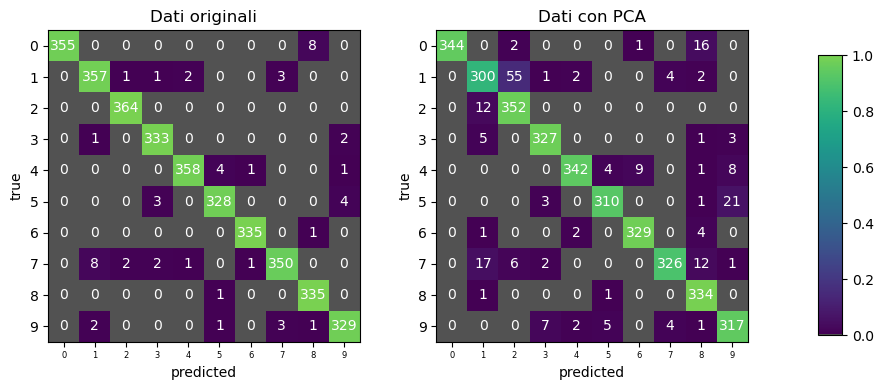

In [657]:
y_true_test_ig = suggestedTestData.iloc[:,-1]

print('DATI ORIGINALI')
perf_ig,cmat_ig,svm_ig_predict_time = performances(svm_gs.best_estimator_,suggestedTestData.iloc[:,:-1],y_true_test_ig,'test su scrittori ignoti')
display(perf_ig)

print('DATI ELABORATI CON PCA')
perf_pca_ig,cmat_pca_ig,svm_pca_ig_predict_time = performances(svm_gs_pca.best_estimator_,X_suggestedTest_pca,y_true_test_ig,'test su scrittori ignoti')
display(perf_pca_ig)

heatMapConstr([cmat_ig,cmat_pca_ig])

Anche nel caso di scrittori ignoti, il modello addestrato sui dati originali si rivela il migliore sotto tutti i punti di vista.

Nella matrice di confusione _Dati con PCA_ è ancora più evidente l'errore di classificazione tra la cifra 1 e la cifra 2. Aumenta anche il numero di 7 classificati come 1 e di 5 classificati come 9. Ecco di seguito le medie delle cifre mis-classificate. E' probabile che a confondere siano il tratto orizzontale sotto l'1 e quello mancante nel 7, che potrebbero essere caratteristiche tipiche dei nuovi scrittori, ma meno rilevanti in quelli noti; dunque il modello potrebbe essere poco addestrato a riconoscerli, specie dopo che è avvenuta una perdita di informazioni come effettivamente è stato in questo caso. Lo stesso vale per l'ordine dei tratti del 5 che sembra essere molto diverlo da quello visto fin'ora per la stessa cifra.

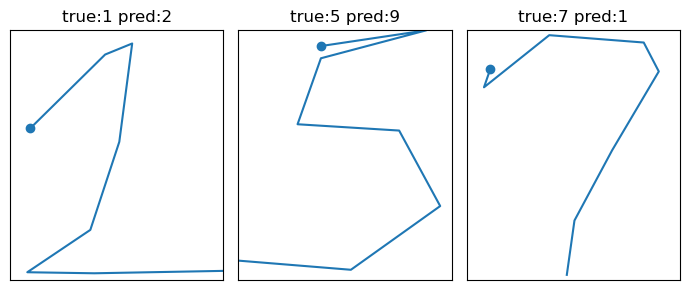

In [712]:
y_pred_ig=svm_gs_pca.best_estimator_.predict(X_suggestedTest_pca)
mask_59 = y_pred_ig==9
mask_59 &= y_true_test_ig==5
mask_12 = y_pred_ig==2
mask_12 &= y_true_test_ig==1
mask_71 = y_pred_ig==1
mask_71 &= y_true_test_ig==7

fig = plt.figure(figsize=(7,3))
means = pd.DataFrame(suggestedTestData[mask_12]).mean(axis=0)
plt.subplot(1,3,1)
plt.plot(means[0:16:2],means[1:16:2])
plt.scatter(means[0],means[1])
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('true:1 pred:2')

means = pd.DataFrame(suggestedTestData[mask_59]).mean(axis=0)
plt.subplot(1,3,2)
plt.plot(means[0:16:2],means[1:16:2])
plt.scatter(means[0],means[1])
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('true:5 pred:9')

means = pd.DataFrame(suggestedTestData[mask_71]).mean(axis=0)
plt.subplot(1,3,3)
plt.plot(means[0:16:2],means[1:16:2])
plt.scatter(means[0],means[1])
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('true:7 pred:1')

#plt.savefig('Numbers_PCA',dpi=300)
plt.show()

# Multi-Layer Perceptron (MLP)

I _Multi-Layer Perceptron_ (MLP) sono un esempio di _feedforward Neural Network_ con strati _completamente connessi_ (_fully-connected layers_, FC Layers). 

Andiamo a vedere nello specifico come funziona un _Neural Network_ (NN) e cosa significa _fully-connected_

### Funzionamento dei Neural Network

Per predirre l'output $y_i$ possiamo utilizzare una funzione di predizione $g:x_i\mapsto y_i$, selezionata da una classe di funzioni, denominata _Spazio delle ipotesi_ o _Universo dei modelli possibili_ e denotata con $\mathcal{G}$. La classe $\mathcal{G}$ deve essere abbastanza vasta da contenere una funzione $g^*$ che approssimi $g$ con sufficiente precisione, ma allo stesso tempo non troppo vasta, per evitare costi eccessivi in termini di tempo e memoria. I neural networks forniscono una classe di funzioni che ben soddisfano questo tradeoff.

Ogni NN è una rete costituita da più strati, ciascuno dei quali comprendente uno o più _neuroni_ e connesso allo strato precedente e al successivo. Ad ogni strato è associata una _funzione di attivazione_, ad ogni neurone un valore e ad ogni arco che collega un neurone in uno strato con un neurone del successivo è abbinato un _peso_. Inoltre, il primo strato prende il nome di _input layer_ e contiene, in ciascun neurone, un valore di input, metre l'ultimo strato, l'_output layer_, comprende un neurone per ciascun output cercato. Tutti gli strati intermedi sono chiamati _hidden layer_.
Ecco qui di seguito una rappresentazione grafica di una rete neurale.

<img src='data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABGIAAAMQCAYAAABsfsPbAAAMaWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSSWiBCEgJvQkivUgJoQUQkCrYCEkgocSYEFTsZVHBtSKiWNFVEUXXAsiiIvayKPa+WFBR1sWCoqi8CQnouq9873zf3PnvmTP/KXfm3jsAaPXwpNJcVBuAPEm+LD48mDUmNY1FegoQQAYUYAC0eHy5lB0XFw2gDPR/l/c3oDWUq05Krn+O/1fRFQjlfACQcRBnCOT8PIibAMDX86WyfACISr3llHypEs+BWE8GA4S4VImzVHinEmeocGO/TWI8B+LLAJBpPJ4sCwDNe1DPKuBnQR7NzxC7SARiCQBawyAO4It4AoiVsQ/Ly5ukxOUQ20F7KcQwHuCd8R1n1t/4Mwb5ebysQazKq1/IIWK5NJc37f8szf+WvFzFgA8b2GgiWUS8Mn9Yw1s5k6KUmAZxpyQjJlZZa4h7xAJV3QFAqSJFRJLKHjXmyzmwfoAJsYuAFxIFsTHEYZLcmGi1PiNTHMaFGK4WdKo4n5sIsQHEi4Ty0AS1zWbZpHi1L7Q2U8Zhq/VnebJ+v0pfDxQ5SWw1/xuRkKvmxzQLRYkpEFMhtioQJ8dArAmxszwnIUptM7JQxIkZsJEp4pXxW0EcL5SEB6v4sYJMWVi82r44Tz6QL7ZZJObGqPH+fFFihKo+2Ek+rz9+mAt2WShhJw3wCOVjogdyEQhDQlW5Y8+FkqQENU+PND84XjUXp0pz49T2uIUwN1ypt4DYXV6QoJ6LJ+fDxanixzOl+XGJqjjxwmxeZJwqHnw5iAYcEAJYQAFbBpgEsoG4pbOuE96pRsIAD8hAFhACJ7VmYEZK/4gEXhNAIfgTIiGQD84L7h8VggKo/zKoVV2dQGb/aEH/jBzwFOI8EAVy4b2if5Zk0FsyeAI14n9458HGh/HmwqYc//f6Ae03DRtqotUaxYBHltaAJTGUGEKMIIYR7XEjPAD3w6PhNQg2V9wb9xnI45s94SmhlfCIcJ3QRrg9UTxP9kOUo0Ab5A9T1yLj+1rgNpDTAw/G/SE7ZMaZuBFwwt2hHzYeCD17QC1HHbeyKqwfuP+WwXdPQ21HcaGglCGUIIrdjzM1HTQ9BlmUtf6+PqpYMwbrzRkc+dE/57vqC2Af9aMltgg7gJ3BjmPnsEasDrCwY1g9dhE7osSDq+tJ/+oa8BbfH08O5BH/wx9P7VNZSblLtUuHy2fVWL5war5y43EmSafJxFmifBYbfh2ELK6E7zyM5eri6gqA8lujen29ZfZ/QxDm+W+6+XCP+0v6+voav+miPgFw0Bxu/7ZvOtsr8DUB39NnV/AVsgKVDldeCPAtoQV3miEwBZbADubjCjyBHwgCoSASxIJEkAomwCqL4DqXgSlgBpgLikAJWA5Wg3VgE9gKdoI9YD+oA43gODgNLoDL4Dq4C1dPO3gJusB70IsgCAmhIwzEEDFDrBFHxBXxRgKQUCQaiUdSkXQkC5EgCmQGMh8pQVYi65AtSBXyK3IYOY6cQ1qR28hDpAN5g3xCMZSG6qEmqA06HPVG2WgUmoiOR7PQyWghugBdipajlehutBY9jl5Ar6Nt6Eu0GwOYBsbEzDEnzBvjYLFYGpaJybBZWDFWhlViNVgDfM5XsTasE/uIE3EGzsKd4AqOwJNwPj4Zn4UvwdfhO/Fa/CR+FX+Id+FfCXSCMcGR4EvgEsYQsghTCEWEMsJ2wiHCKbiX2gnviUQik2hL9IJ7MZWYTZxOXELcQNxLbCK2Eh8Tu0kkkiHJkeRPiiXxSPmkItJa0m7SMdIVUjuph6xBNiO7ksPIaWQJeR65jLyLfJR8hfyM3EvRplhTfCmxFAFlGmUZZRulgXKJ0k7ppepQban+1ERqNnUutZxaQz1FvUd9q6GhYaHhozFaQ6wxR6NcY5/GWY2HGh9pujQHGoc2jqagLaXtoDXRbtPe0ul0G3oQPY2eT19Kr6KfoD+g92gyNJ01uZoCzdmaFZq1mlc0X2lRtKy12FoTtAq1yrQOaF3S6tSmaNtoc7R52rO0K7QPa9/U7tZh6IzQidXJ01mis0vnnM5zXZKujW6orkB3ge5W3RO6jxkYw5LBYfAZ8xnbGKcY7XpEPVs9rl62XoneHr0WvS59XX13/WT9qfoV+kf025gY04bJZeYylzH3M28wPw0xGcIeIhyyeEjNkCtDPhgMNQgyEBoUG+w1uG7wyZBlGGqYY7jCsM7wvhFu5GA02miK0UajU0adQ/WG+g3lDy0eun/oHWPU2ME43ni68Vbji8bdJqYm4SZSk7UmJ0w6TZmmQabZpqWmR007zBhmAWZis1KzY2YvWPosNiuXVc46yeoyNzaPMFeYbzFvMe+1sLVIsphnsdfiviXV0tsy07LUstmyy8rMapTVDKtqqzvWFGtva5H1Gusz1h9sbG1SbBba1Nk8tzWw5doW2lbb3rOj2wXaTbartLtmT7T3ts+x32B/2QF18HAQOVQ4XHJEHT0dxY4bHFuHEYb5DJMMqxx204nmxHYqcKp2eujMdI52nudc5/xquNXwtOErhp8Z/tXFwyXXZZvL3RG6IyJHzBvRMOKNq4Mr37XC9Zob3S3MbbZbvdtrd0d3oftG91seDI9RHgs9mj2+eHp5yjxrPDu8rLzSvdZ73fTW847zXuJ91ofgE+wz26fR56Ovp2++737fv/yc/HL8dvk9H2k7Ujhy28jH/hb+PP8t/m0BrID0gM0BbYHmgbzAysBHQZZBgqDtQc/Y9uxs9m72q2CXYFnwoeAPHF/OTE5TCBYSHlIc0hKqG5oUui70QZhFWFZYdVhXuEf49PCmCEJEVMSKiJtcEy6fW8XtivSKnBl5MooWlRC1LupRtEO0LLphFDoqctSqUfdirGMkMXWxIJYbuyr2fpxt3OS430YTR8eNrhj9NH5E/Iz4MwmMhIkJuxLeJwYnLku8m2SXpEhqTtZKHpdclfwhJSRlZUrbmOFjZo65kGqUKk6tTyOlJadtT+seGzp29dj2cR7jisbdGG87fur4cxOMJuROODJRayJv4oF0QnpK+q70z7xYXiWvO4ObsT6ji8/hr+G/FAQJSgUdQn/hSuGzTP/MlZnPs/yzVmV1iAJFZaJOMUe8Tvw6OyJ7U/aHnNicHTl9uSm5e/PIeel5hyW6khzJyUmmk6ZOapU6SoukbZN9J6+e3CWLkm2XI/Lx8vp8PfhTf1Fhp/hJ8bAgoKCioGdK8pQDU3WmSqZenOYwbfG0Z4Vhhb9Mx6fzpzfPMJ8xd8bDmeyZW2YhszJmNc+2nL1gdvuc8Dk751Ln5sz9fZ7LvJXz3s1Pmd+wwGTBnAWPfwr/qbpIs0hWdHOh38JNi/BF4kUti90Wr138tVhQfL7EpaSs5PMS/pLzP4/4ufznvqWZS1uWeS7buJy4XLL8xorAFTtX6qwsXPl41ahVtaWs0uLSd6snrj5X5l62aQ11jWJNW3l0ef1aq7XL135eJ1p3vSK4Yu964/WL13/YINhwZWPQxppNJptKNn3aLN58a0v4ltpKm8qyrcStBVufbkveduYX71+qthttL9n+ZYdkR9vO+J0nq7yqqnYZ71pWjVYrqjt2j9t9eU/Invoap5ote5l7S/aBfYp9L35N//XG/qj9zQe8D9QctD64/hDjUHEtUjuttqtOVNdWn1rfejjycHODX8Oh35x/29Fo3lhxRP/IsqPUowuO9h0rPNbdJG3qPJ51/HHzxOa7J8acuHZy9MmWU1Gnzp4OO33iDPvMsbP+ZxvP+Z47fN77fN0Fzwu1Fz0uHvrd4/dDLZ4ttZe8LtVf9rnc0Dqy9eiVwCvHr4ZcPX2Ne+3C9ZjrrTeSbty6Oe5m2y3Bree3c2+/vlNwp/funHuEe8X3te+XPTB+UPmH/R972zzbjjwMeXjxUcKju4/5j18+kT/53L7gKf1p2TOzZ1XPXZ83doR1XH4x9kX7S+nL3s6iP3X+XP/K7tXBv4L+utg1pqv9tex135slbw3f7njn/q65O677wfu8970finsMe3Z+9P545lPKp2e9Uz6TPpd/sf/S8DXq672+vL4+KU/G6/8VwGBDMzMBeLMDAHoqAAx4bqOOVZ0F+wVRnV/7EfhPWHVe7BdPAGpgp/yN5zQBsA82mzmQGzblL3xiEEDd3AabWuSZbq4qLho8CRF6+vremgBAagDgi6yvr3dDX9+XbTDY2wA0TVadQZVChGeGzf5KdN1AMAf8IKrz6Xc5/tgDZQTu4Mf+X037j3xPRCLqAAAAimVYSWZNTQAqAAAACAAEARoABQAAAAEAAAA+ARsABQAAAAEAAABGASgAAwAAAAEAAgAAh2kABAAAAAEAAABOAAAAAAAAAJAAAAABAAAAkAAAAAEAA5KGAAcAAAASAAAAeKACAAQAAAABAAAEYqADAAQAAAABAAADEAAAAABBU0NJSQAAAFNjcmVlbnNob3SDcxlrAAAACXBIWXMAABYlAAAWJQFJUiTwAAAB12lUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNi4wLjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj43ODQ8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+MTEyMjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlVzZXJDb21tZW50PlNjcmVlbnNob3Q8L2V4aWY6VXNlckNvbW1lbnQ+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgoee75vAAAAHGlET1QAAAACAAAAAAAAAYgAAAAoAAABiAAAAYgAAScrh/1FDwAAQABJREFUeAHsnQeYU8XXhw+9N+ki1U5TQUVBKQIqYgUVsHcsKPYuCurf/tlQsStWbICKYANEEUUUkaLYaFIUpPeWb87gXG6ySTbZvZtNsu88D94y/Z04e+/vnjlTLGSCECAAAQhAAAIQgAAEIAABCEAAAhCAAAQKnEAxhJgCZ0wFEIAABCAAAQhAAAIQgAAEIAABCEDAEkCI4YcAAQhAAAIQgAAEIAABCEAAAhCAAARSRAAhJkWgqQYCEIAABCAAAQhAAAIQgAAEIAABCCDE8BuAAAQgAAEIQAACEIAABCAAAQhAAAIpIoAQkyLQVAMBCEAAAhCAAAQgAAEIQAACEIAABBBi+A1AAAIQgAAEIAABCEAAAhCAAAQgAIEUEUCISRFoqoEABCAAAQhAAAIQgAAEIAABCEAAAggx/AYgAAEIQAACEIAABCAAAQhAAAIQgECKCCDEpAg01UAAAhCAAAQgAAEIQAACEIAABCAAAYQYfgMQgAAEIAABCEAAAhCAAAQgAAEIQCBFBBBiUgSaaiAAAQhAAAIQgAAEIAABCEAAAhCAAEIMvwEIQAACEIAABCAAAQhAAAIQgAAEIJAiAggxKQJNNRCAAAQgAAEIQAACEIAABCAAAQhAACGG3wAEIAABCEAAAhCAAAQgAAEIQAACEEgRAYSYFIGmGghAAAIQgAAEIAABCEAAAhCAAAQggBDDbwACEIAABCAAAQhAAAIQgAAEIAABCKSIAEJMikBTDQQgAAEIQAACEIAABCAAAQhAAAIQQIjhNwABCEAAAhCAAAQgAAEIQAACEIAABFJEACEmRaCpBgIQgAAEIAABCEAAAhCAAAQgAAEIIMTwG4AABCAAAQhAAAIQgAAEIFCABEKhkMydO1emTZtm/61fv16aNm0qzZs3t8dy5coVYO0UDQEIpBuBrBVirrrqKpk/f77UrFlTBg8eLCVLlkw39rQHAhCAAAQgAAEIQAACEMhyAkOGDJEbb7xRVq1aFbWnxYsXl/79+8s999wjZcqUiZqGmxCAQHYRyFohplixYt5IrVy5UqpUqeJdZ9uJKuw6sZcuXVrKly+fbd2jPxCAAAQgAAEIQAACEMg4AitWrJALLrhA3nvvvYTa3rJlS3nzzTdl3333TSh9Mom++OIL2xZ9b3jiiSfkqKOOSiZ7ytKefPLJMmXKFGnWrJmMGjUqZfVSEQRSTQAhJtXEC6C+M888U1599VVR8WnSpEnSpk2bAqiFIiEAAQhAAAIQgAAEIACBRAkcfvjh8tVXX9nk+px+xRVXWAHkkEMOsfdUcPj444/l//7v/0QFEg26XGn69OmiVjJBBn1X0HcGDWqh07dv3yCLD6ysPfbYQ/744w+pU6eOLF68OLByKQgC6UYAISbdRiQP7TnppJNkxIgRNudnn30mnTt3zkMpZIEABCAAAQhAAAIQgAAEgiDw0UcfSffu3W1RpUqVkpdeeklOO+20qEUPGzZMzjrrLNm8ebONV9Hk9NNPj5o2rzcRYvJKjnwQKBgCCDEFwzWlpSLEpBQ3lUEAAhCAAAQgAAEIQCAmAbVuad26tUydOtWmue++++T666+PmV4j7rjjDhk4cKBNo1Yhv/zyi5QoUcLL8+mnn8q///4r++yzj+y///7eff+Jij+rV68WXeKkljUa5syZI7/++qu1vHn44YftvUsvvVSOP/54e66WNx07dhQVizSMHTtW/vnnHzn00EOlYcOGsnHjRvnggw+slY6m0ftqfV+pUiWbPvI/eWmn8tJ6t27daq12li5dast/++23veIbNWoke++9t3fNCQQynUCRFGI2bNgg48ePl23btkn79u2lcuXKsn37duvBfNy4cfZcJ0/9p3HRgitDJ44OHTpIhQoV7OTxySefyE8//WTL0ElK/1WsWDFaEbJ27Vr58ssvbb4DDzxQ6tatGzXdzJkz5c8//7QTkk6ULqg546ZNm+S6666zS5L0/oMPPijO3FFNILUPOP1yxDhCAAIQgAAEIAABCECgYAlMnjzZcxWguyH99ddfsssuu8StdMGCBaJig76TaFDxZM8997Tn+r7hliq1bdtWJk6caO/7/6P+aFwdxxxzjOdfpVevXvLWW2/5k+Y41/cifZ/RoGVoWSoc6T31cRO5REjfbdQaP9IKP6/t/Pnnnz3hKEfj/rvRqVMnK9bEiuc+BDKOgPkfJiuDGQhdaGn/GWe9YX00jp+8uKeffjr03XffhRo0aODdc/nMRBQyS33C8roLfxnGnDBk1neGjGqcowyjZIcee+wxly3s+PLLL3vpL7nkkrA4/4Vx2OWlmzdvno0ywox3z7U32vG1117zF8U5BCAAAQhAAAIQgAAEIFCABPT52z2X9+nTJ+GazAdXL5+xLPHyGXHGu28sUrz7/hNjLeOlMUKMF3XRRRd5912bIo8//vijl75atWo2vb4HGfHHy2sEJe9c85sPvSEj4Hj59CSv7TQiVFhdke3Ta7MCIKwuLiCQ6QTUMVRWBv//wJFCzIcffuhNJMYiJhQ5sfjzqpBiLE9yMPKX0a5du5CxPvHK9Od352Y7uhxlmLWiXp6LL744R7y7YUwQvXRz5861t1WQcWXHO6pIRIAABCAAAQhAAAIQgAAEUkPgzjvv9J7TzXKjhCs977zzvHzPPvusly+vAocWYPzOhJYtWxYaPHiwV/b9999v7+l9Y/3i1aMnTohx7xfGKiY0Y8YMm2batGmhFi1aeOUceeSRYXnz006zA6xtk/s4XqNGDa+N2k6zCiCsLi4gkOkEirwQ4yYZ/Z/+7rvvDhlTwpDxJB4y20B7k4wx6csxzn4hxpVRv3790IsvvhgyazpDxiFWyKxj9MooW7asnUz8BeVHiNFyJkyYEBo9enTooIMO8uoZNGiQvaf31UrHrOv0V8k5BCAAAQhAAAIQgAAEIFCABM4991zv2fy5555LuKabb77Zy3frrbd6+fIjcLhCXnnlFa9sfdeJFfxCTM+ePUNbtmwJS6ofg0uXLm3L0g/RZocjLz6Idu6+++62bLNrklcuJxDIRgIIMcbUTQWTRYsWhY3v0KFDvclKRZTIECnEGB8vIePYKiyZLh9Ssz4n1DzwwANh8fkVYlxhJ554oldHrKVULi1HCEAAAhCAAAQgAAEIQKDgCOjSIPf8n4x1+oABA7x8hS3E1KtXL+YH3W7dunntNA51PZAIMR4KTiCQK4EiL8Q0adIkZBxQ5QClZnzGAa83ySxfvjwsjV+Iady4cch49w6Ldxf9+vXzyjBOptxte0SICcPBBQQgAAEIQAACEIAABDKegN8i5oknnki4P/379/feG/z5ghA4krWIMbsuxWz3XXfd5bXT7MTkpQuinVjEeDg5yXICRV6I6d27d8wh3muvvbxJxuxcFJbOL8TEK0OXCDlF3Hg+DysDISYMBxcQgAAEIAABCEAAAhDIeAJmK2rv+V+tXBINp5xyipfPbEXtZQtC4AhSiNGNSNz7jfbVhSDaiRDjaHLMdgIIMXGEGLM9nDfJ+L2J648iUSFGBRw3UanfGX9AiPHT4BwCEIAABCAAAQhAAAKZT0B9Rrrn/+OOOy6hDm3dujW02267efnU56QLQQgcQQoxjzzyiNfO++67zzUzz7smeQWYE4QYPw3Os5kAQkwcIeawww7zJpm8CjG//fabV4YudfIHhBg/Dc4hAAEIQAACEIAABCCQ+QR0W2cnxJQsWTKqG4TIXo4YMcLLU6VKlRz+WXQnVy1z3333jcxqr2NtX+0SBynEXH311V5b33jjDVeFPea3nQgxYTi5yGICCDEFLMTo1tduIm7YsGHYT8kvxJx//vlhcf6LaNtX++Nx1uunwTkEIAABCEAAAhCAAAQKj4Bat/h3T73pppviNmb9+vWhQw891Htn0F1QI0PdunVtfOXKlUNafmQYOXKkl1+dBUcG3dHVvZPo9tqxgts1STccmTt3btRk6mPTlfX111+HpclvO/fYYw9btm6WErljU1hFXEAgwwkgxBSwEPPCCy94E1X79u3Dfi7qZdxNYscff3xYnP8iGSHmk08+8WflHAIQgAAEIAABCEAAAhBIMQG/8KHP+7F8xaxYsSLkt8KvXr16aPXq1Tla26pVK++9wb9TkSZUlwllypTx4qMJMX6/lSeddFKO8t0NJ8Rom/Ujsu4C6w+6Hbd7f6lfv35INzjxh/y2s02bNl7506ZN8xfNOQSyigBCTABCjCrG33//fdQfRufOnb3JRD2o+8NXX33lxan6Gy3oJO5M/HTSi6ZM9+zZ0yvnqaeeilYM9yAAAQhAAAIQgAAEIACBFBHYtm1bqEWLFt4zuj7HH3jggaErrrgipFbxjz76aKhPnz4hZ0Gi8cWKFQs988wzUVuoVixOAKlYsWJId1VSAUat6kuXLu3FaZpoQozfb2W5cuVCaqXz6aef2uNff/3l1ekXYrSs2rVr2zSjRo0K3XLLLSFdauXa4d8xyRWQ33b6HRYffPDBoffeey+k4s+zzz7rquAIgawggBATgBCjk1HVqlVDkydPDvtR+B11aZpI07358+d7E5nGR6rbQ4cODRUvXjwsTTQh5rLLLvPSXHDBBWFt4AICEIAABCAAAQhAAAIQSD2BlStXhnr16uU9pzsBI9pRBY94lu3Lli2zoki0vHqve/fuoXr16tm6ogkx2nsVNqLl14/DLviFGN1oJFp6vdelS5fQunXrXDbvmN92quATrU6tjwCBbCKAEBOQEKMThqrRusRI1eGzzjorTDGOXJbkfkSdOnXyJptSpUqFrrnmmtD//d//hQ4//HCrikdORNGEGE3v0qlwc+qpp1qV/LTTTgtNnDjRVcURAhCAAAQgAAEIQAACEEgxAbWA6dChQ0iXHblndj3qciJdynPRRReFlixZkmur9CNuu3btwj7U1qlTJ3TbbbeF1ALngAMOsOX36NEjalm6E1Pr1q3D2qCOgf3vF06Iadq0aWjq1KnWisff5ho1aoTUWW88/y35befdd9+dw8qnf//+UfvETQhkKoFi2nDzP1fWBWPa5/XJqNFiJhnv2iitcuyxx9rr3r17i/H27cX5T4wYIkYhtrfMrkmy3377edH+MowAo4KWmAnJi/efGIdWoumNrxf/bXs+YcIEOeqoo2Tjxo054vSGmWylVq1aMnz4cBtvJkox6zXD0hov6dKoUSNZu3Zt2H290L5pHwkQgAAEIAABCEAAAhCAQOESMIKLzJ49W4ygIcahr5ilPkk3SJ/5f/rpJzEW+WIEEy+/8dcixr+MGDFFjGsD737kibbB+H4Rs0TJ5jeCkJfEuFwQ47fG3jfLmez9X3/9VRYsWCCNGzcWfa9JNOSnnfpuZIQj+36j7zlma+9EqyUdBDKCQNYKMZUqVbL/46pIopOJMa3zBmTs2LFifLfY6/POO0+ef/55L85/ogKJMREUFXV+/vlnO1m6eL8Qo0KHUWmlb9++dlJ0acz6TenatauYNY1iFHB3O8fRLGmSs88+2042LrJmzZpiLFrk/vvvlxtvvFGMlY0YaxcxazjFrCV1ybyj9sn4oBGjQHv3zHbZokKPUdq9e5xAAAIQgAAEIAABCEAAAhCIRiCaEBMtHfcgAIH8EchaIWbTpk2yatUqMVu8idn+LAcltZJRCxYVSFTgiBbM1nCyfPlyK+KoqOIPkUKMs6pRwWbp0qWik5gq1LHK9pflzlUwUoVc62rWrJkVgDRu+/btYtZbRm2Hy+vSqcXMvHnzRIUord8vQPnTcg4BCEAAAhCAAAQgAAEIQMBPACHGT4NzCBQcgawVYgoO2Y6SYwkxBV0v5UMAAhCAAAQgAAEIQAACECgIAggxBUGVMiGQkwBCTE4mCd1BiEkIE4kgAAEIQAACEIAABCAAgQwh4IQYtc6fMWNGhrSaZkIg8wggxORxzBBi8giObBCAAAQgAAEIQAACEIBAWhKYNGmSLFq0SHbffXfZf//907KNNAoC2UAAISaPo4gQk0dwZIMABCAAAQhAAAIQgAAEIAABCBRhAggxeRx83fLtlltuEd0mrkePHnL66afnsSSyQQACEIAABCAAAQhAAAIQgAAEIFBUCCDEFJWRpp8QgAAEIAABCEAAAhCAAAQgAAEIFDoBhJhCHwIaAAEIQAACEIAABCAAAQhAAAIQgEBRIYAQU1RGmn5CAAIQgAAEIAABCEAAAhCAAAQgUOgEEGIKfQhoAAQgAAEIQAACEIAABCAAAQhAAAJFhQBCTFEZafoJAQhAAAIQgAAEIAABCEAAAhCAQKETQIgp9CGgARCAAAQgAAEIQAACEIAABCAAAQgUFQIIMUVlpOknBCAAAQhYAtu3b5dVq1ZJ+fLlpUyZMnmiEkQZeaqYTBCAAAQgAAEIQAACGU8AISbjh5AOQAACEChaBJYvXy5ly5a1Qkpeet6mTRuZPHmylC5dWubPny+1a9dOupggyki6UjJAAAIQgAAEIAABCGQFAYSYrBhGOgEBCEAgPQmMHz9ehgwZImpBcu6550q3bt3iNnT48OHyxhtvSPHixeXqq6+Wgw8+OCx9+/bt5csvv7SWLN999520aNEiLD6Ri3333Vd++eUXm3Tu3LnSsGHDRLKFpQmijLACU3xxxRVXyMKFC6VmzZoyePBgKVmyZIpbQHUQgAAEIOAIzJo1S7799lv7geHEE0/Ms7WmK48jBCCQ/gQQYtJ/jGghBCAAgYwlMHDgQLnjjjts+6+88kp5+OGH4/blwgsvlOeee86meeSRR6R///5e+qVLl0qtWrW8a013/vnne9eJngQhogRRRqLtLYh0xYoV84pduXKlVKlSxbvmBAIQgAAEUkugT58+8uabb9pKVZCJ/AiR2tZQGwQgkAoCCDGpoEwdEIAABIoogSCFmFAoZJcRqSCj4bPPPpPOnTsnTTYIESWIMpJueIAZEGIChElREIAABPJJACEmnwDJDoEMJJC1Qgxm1xn4a6TJEIBA1hEIUohROD///LNMmzZN9tlnH9lvv/3ELygkCi8IESWIMhJtb0Gk83PDIqYgCFMmBCAAgcQJIMQkzoqUEMgWAlkrxPCQmS0/UfoBAQhkMoGghZggWAQhogRRRhB9yWsZ/I3MKznyQQACEAieAEJM8EwpEQLpTgAhJt1HiPZBAAIQyGACQQsx6mT3t99+k4oVK0rHjh1jWsSsX79efvjhB7s70rZt26Rdu3Zy4IEH2p2SEhVRgihDl1P9+eefMnXqVJkxY4ZdWrX//vtLy5YtpUKFClFHdsOGDaJOjrXd6py4cuXK1tmxWgKNGzfOnrdu3Vr0n8blJeRHiPn7779lwoQJoo6O1ZqmUqVK0rRpUzn88MOlWrVqYc2ZN2+eTJ8+3Tpf1jGI54tm5syZlpWObadOncLK0Yu1a9fKjz/+aFlqvc2bNxdl2bhx4xxp3Q0t848//pB69epZXsr2rbfesr8hbeuxxx4re++9t0vOEQIQgEChEMirEKN/J6ZMmWId/S5evFhKlSolTZo0sY7s9W+EC1u3bpUPP/xQNm7caOdOnT9jhY8//lhWrFhh53X9W+UP6nhfLVP1b5rOr7rr4AEHHGD/xfp7pH+39O/GQQcdJLvvvrtt7/vvvy+bN2+28/Ipp5zir4JzCBQdAuYhMSuDGcGQ+2ce2LKyj3QKAhCAQLoTMI56vbnYOOvNtbkXXHCBl944682R3jzIefGzZ8/OEa83jMPDULly5bx07m9B3bp1QxMnTgyZZU1enBETCqwMbV+rVq28ulw79Gi23w6Z3aSi1j1q1Cgvz9NPPx0yu0OFGjRo4N1z5eyyyy4h4ycnahm53XRl6DHRv5HajqOOOipkRJwcbdFyjLARMjswhVV99tlne2n79u0bFue/WLduXcgIOl5a80LhRZsH/9C9994bMi8YXry//YcddlhowYIFXnr/ifu96NgbQSxkRJewMtq2betPzjkEIACBQiHQu3dvb24yznoTaoNxWB/1b4ObH83uS6F//vnHlvX777975e+6664hI+BErUPrdvmPOeaYsDQ6z5qPA168S6fHqlWrht59992w9O5C/zZoGv0bcP/99+f4G2J28HNJOUKgSBGQbO2tf3JI9CEzW1nQLwhAAAKFRSBoIcZYtXgPgcY6Jke3HnzwQS/e/3fAnUe+zEcTYoIo44MPPggZi5ewtkRea5suu+yyHH0wXy29fPrQG01Ucv0pUaJEyHwNzVFGbjdcfj0m8jfSfLkMGUsVr10ufzRRZsSIEV71Q4cO9fLow/imTZu8OP+JsVLx0u25555elNbbtWtXL07r1T5HMqlevXrIfKX18rkT93spX758mADn2q98CRCAAAQKm0CyQoyx9AubF1XIbtGiRah+/fph98866yyva34h+tNPP/Xu+0+uuuoqL/+jjz7qRRnrl5CK/27uNNYvoUMPPTTUqFEj757GqTgUGZwQYywiw9K6spxYFJmPawhkOwGEmCgjvGTJkpA+FKpqe/PNN4fuueee0MiRI0PLly/PkVof4vWBW79g5vYwa8zSQ8YULzR27Ngc5eiNNWvWhL788svQY489Fho0aFDovffes1/woib+76aWqW1zD+LGlD700ksvhW655ZaQvkxEe1GJVx5xEIAABIIk4BdizFbTIZ1f4/3zP4xGs4hxL9b6ABc5vxnT57AXdGOWbedytYK58cYbwx4i3QNgpBATRBk6D5ulMN4D5/HHHx/Sr5EaVq1aZed3FRO0DSpkmOU2Ycj9Qoxrp1rE3H333aHJkydbSxoVFlxcr169wvIncuHy6jG3v11anlkWZOtTIeu8884LffHFF7YvKpTo3x+z1arXHmPy7jVB8/ktXYYPH+7F+U969Ojh5TfL2bwofRFwbdUH/9dffz2k1jP6NVfr1RcPF3/SSSd5+dyJ//fi0pklALac66+/PnTXXXe5pBwhAAEIFBoB/9++RCxinBBjdg4MmaVEYRYuo0ePDpUuXdrOjfo3Rv/mavjf//7nzZfnnHNOjr6q9eFuu+1m05QsWTKkfw9d6Natm5f38ssvD23ZssVFhVRwd/Wp9aH+DfQHJ8S4ObhNmzahb775xlp7Pv744yGzbMqfnHMIFBkCCDG+ocbs2geDUwhAAAIBEPALMe4hLNFjskLMrbfe6j0o7rHHHqFly5aF9eCnn34K1apVy0uj7YgUYoIoQ1/uXR+7dOkS0ofbyHDdddd5aU499dSw6EghRr9iLlq0KCyN39JElzklG1z79JiIEKPlv/POOzl4uXrnzJkT0gd3LU9FJv9D+rnnnuv19eSTT3ZZvOPq1avtUi3XJn3B0KDtqlGjhpfX+KXx8rgTfVHwWxrpV1t/iBRibrrpJn805xCAAATSgkCyQow2OvJvnL8j/nlXP0Zo0KVFxYsXt3OqCtvGZ5Y/S0jnWDcP+5clqfDu7hvfbGF53EW/fv28NK+++qq7bY9+IUbFc53zCRCAgHEimK0Q3IShx0QeMjG7ztZfAv2CAAQKk0AqhRi/75cnn3wyardnzZoV0gdQ9zciUogJogzjuNYrf9KkSVHb8ddff3lp/EtxNLFfiDFOF0N+fymuMP2b5RcgollsurTRjq7/if6NjFZG5D3thytX/bG44H+IV9FIrYL84ZVXXvHy+X22+JcrqW+aWMHvV+i1114LS+YXYo444oioolhYBi4gAAEIFAKBvAgx8Zr50EMPefPqsGHDvKT+pZ46x/qDLpV1c7haH7pw5513evfVWj9aUGt/l3fAgAFhSZwQo1Yz+kGEAAEI7CCAEPPfLwGza/6XgAAEIBA8Ab8Qoy/qag4d75/ZAcd7mEvWIsa/XCfemnO/2BIpxOS3DF0yU6ZMGa8PZqejkC4hjfbPPbTqch+/abZfiNGH81hhr7328uqJtASJlcfdd3XrMZGPFS5ftKOKQmYnjtAhhxzitUf764JaBPnH9YUXXnBR9mh2LvLy+QU0XYrl2qnLoaIx1HvqANKl02W9/uAXYr7//nt/FOcQgAAE0oZAfoQYfYdRaxYVXHQ553333RfSJbFuXnzjjTe8fqpY7e6fcMIJ3n39G2R2QLJxupxUl4C6oH5mXB6dr3XOjfynlp0uzZlnnumy2qMTYvQjBQECENhJACFmJwvMrn0sOIUABCAQBAG/EBPErkn+F2u/j5ilS5d6D4FqKRIvxBJigihDhR33MJrM0W9inqgQo9Yjro5IPzPx+q9xLp8ekxFidHeLBx54IKTWJSoE+f2/+Mv0CzFan/93oD4NXFBLHudbQI///vuvi7KCnb/MRM7VPN4fYv1e/Gk4hwAEIFDYBPIixKi15EUXXRRzHnZzpl+IUf8tzipU51xnTak78Ln0Z5vd7vzB/7fGpYl3VOHcHxBi/DQ4h8BOAggxO1nkeobZda6ISAABCEAgjID/BbwghZjp06d7D5HqLDBeiCXEBFGGLkWK94AaLU6XH/l9qiQqxOi2za68VAgxn3/+echvMeTqjnaMFGJ0qZLbYUl9FLjtSp9//nmvD/6vszp+uhwpWtmx7mn56jvHHxBi/DQ4hwAE0pVAskKMfjho1qyZN0eqqNKuXbvQKaecElIhxT/3+YUY7b9/OefTTz9tkVx44YVeWZE7Kvm3rNay1ddWrH+33XZbaPbs2WGYEWLCcHABAY8AQoyHIvYJZtex2RADAQhAIB6BVAkx+mLvXtBzc14bS4gJooz58+d77dAlSvrFMrd/fhFGWaajEKNLn/w+adTh4sMPP2x3DNQdPtTZvf+lIFKI0X516NDBY6P+CzT4/RW8/fbb9p77j35VdWOqOwHmxnHFihUuq3f0v4z4Lai8BJxAAAIQSAMCyQoxurucmx91HvXvcKTdGTJkiBcfKcToDq0ur4os+p7jtqbeddddw3Zg0rJ0ObFL/9VXX+mtpAJCTFK4SFyECCDERAw2ZtcRQLiEAAQgkA8CqRJidH272xJaHxh1F59YIZYQE0QZkT5ikln249qbjkKM31+LLkuKFI+07X4LnWhCjPqGcQ/zrVq1CqkfHzdmVatWtX5mHAM9+nefSsSayp/XnSPEOBIcIQCBdCaQrBDjF7F//fXXHF2LJ8RoYt1ZUOdjtST0p7322mtzlOV31qt/C5INCDHJEiN9USGAEOMbacyufTA4hQAEIBAAgVQJMdrURo0aeS/6aq0RLegWzG77Tn0IjXTWG0QZut20ExyeeOKJaM2Iey8dhRi/Q91nnnkmavvbtGnj9TuaEKNblvqtaq644govvZrKRwb9ius47rbbbqFNmzZFJsn1GiEmV0QkgAAE0oBAskLMoYce6s2PY8aMCeuBWg+2bt3ai4+0iNHE6tjcza/+Y7Rlrrr9tUtTs2bN0JIlS8Lq81/4Hc+7+wgxjgRHCIQTQIj5jwdm1+E/DK4gAAEIBEEglULMjTfe6D0s1qpVK4fIolt1+nc00gfLSCEmiDL8D7j16tXLsV7ez/Xnn3/2nCW6++koxPhfEvTcH3RXJP2K6h7U9RhNiNE8upuGP5071y2uI4MuNapevbqX/oYbboi5/fSaNWuibouKEBNJlWsIQCAdCfjn2NNOOy2kf4ui/Zs6dapt/iWXXOLNjQcddFBo9OjRViDRnZMaNmzoxekcG02I0b99zm+Xm4d1yWms0KNHD69M3V1J/XvproC6JEq3pFarGrWW1F0AnQNgVxZCjCPBEQLhBBBi/uOB2XX4D4MrCEAAAkEQSKUQo8uR/NYu+jB68803h15++eXQySef7D1EuodOPUYKMUGUobtSqAWHq0etQNTHiVrjfP3116H3338/pA4NW7ZsadPcf//9YahTLcSoibtavET758zQH3zwQa8/6hTyqquuCo0dOzakW6FGc6obS4hRy1PHxR0bNGgQU2B57LHHwtJ36tQp9NRTT4XGjRtn69eXgT59+lgnwupIODIgxEQS4RoCEEhHAn4hxs2N0Y66ZFODOsStWLFi2PzoT1+jRg0vLpoQo2XofOrPo9texwrqcN2/aYk/X+S5Ljv1B4QYPw3OIbCTAELMfywwu975o+AMAhCAQFAEUinEaJsHDx4cJsZEPiDqi7n/gTdSiAmqDN0KVK1yIuuPdu0c1zrmqRZiorXJ3dtvv/1ss9TiJLeHcP+DfywhRn3oqPDiytej7r4RK6gvml69eoWl9+f1n+tW2pEBISaSCNcQgEA6ElCB2fnM8s9rkeePP/6413x1uqv+tvxpdB5UR+cLFizwyhsxYoSXx3/iX/6pHzE0T7ygHxmuu+66kC5P8tep52oJo37CXnrppRxF6E6GmkbnYwIEILCTAELMfyz8D+Z67g+YXftpcA4BCEAgcQJ+Swq1CsktqFNW94D37LPP5kjuttHUh8ZoIopmePPNN0NNmzYNM7tWCxX1SbJhw4bQgAEDbB1axqJFi3LUEVQZy5Yts9uIuq+Brl96VJNwbePtt98eUt8p/uC3GtEH6ljhyCOPtP3QspLdEah79+4eZ3+7Is/1i6kLai0UaVmkde+7777WysdtRa33fvvtN5ctx1H77K9n1qxZOdJE3hg+fLjlFe1FRV88TjrpJGshE5kvkd9LZB6uIQABCGQSAf07pqKM+ndRsduFtWvX5lgm5OL0qMuZ3Fysy4qSCfr3TX3HjB8/3i5F3bhxY8zsGqdWMro7EwECENhJoJiemv8Jsy6YB0GvT8bsWoxfAO/af2KcXYkxXRfzRVLMGncbZcyu5bLLLpPjjjtOjMMrGTp0qHz88cf+bGK+9onZqjPsnl4YU23p3Llz2H3z9U/MC4P42+QSGGVbzMuBuxTz0CunnnqqmF09VCQT8+Ar5suqjBw50qZZt26dl1ZPzLpQmTJlir1nHsTFOIkMi+cCAhCAQGETMOvF7Xxm/H3k2hSd9/79918pWbKkmJ10cqQ3FhJifIeIWYYixiw7R7z/hqYzPljEWKaI2SHCi9I6zEOklCtXLiVlaMVmHb0Y024xD6S2X40bN47aP9dIs9uSaF+VmRGM3O2wo3GKKMo2ERZhGfN5oW37/fffxTjPFSPCiNn21CtRuerfWyOOePciT4wDY+nXr5+9bb7myvfffx+ZJOa1eZAXI/LI0qVLxXyBFeOrQJo0aRKTUTK/l5iVEgEBCEAgCwn07NlT3nvvPduzF198Ucw21VnYS7oEgfQlUCSEmHj4jdm1GAVZjGos+kCoD3ixgjG7tg/vGh9LiDHWM6IP2PPnz/eKMWbX8r///c+79p/og/QZZ5whxrmW/3bUc32wNV9Ow+IQYsJwcAEBCEAAAmlOQP/uGueOtpVmdysxVlBp3mKaBwEIQCC7CJidj6R+/fqi7yH6UUI/FsQT0LOr9/QGAulBIGuFGOPzRUaNGpUrZbVAUSsWDWq1YtY+inGo6OVTKxa1TjEOrOwXuPPPP99atvz6669hX1i9DObE+ESQgQMHereM2bX9aujdiHJi1m+KMdsX43xLjFlhWAqdGLt06SKXX365tZjxR3bo0EEmTJhgvwbq11bjnNIfzTkEIAABCEAgbQhMnjxZzDbXtj1mmZEsXLjQWrWkTQNpCAQgAIEiQODee+8V/VCswTg8l9dff70I9JouQiC9CGStEJMfzJhd54ceeSEAAQhAAALRCVxwwQVifMnYyG7duslHH30UPSF3IQABCECgwAj4Lep1Htb5mAABCKSWAEJMAfDG7LoAoFIkBCAAAQhkNAH1KaM+b5yvM/0Cq19iCRCAAAQgkFoC6ptr3rx5Uq9ePc9KMbUtoDYIQAAhJuDfAGbXAQOlOAhAAAIQyAoC6qj44osvtkKM+lK78847YzrSz4oO0wkIQAACEIAABCAQgwBCTAwweb2N2XVeyZEPAhCAAAQgAAEIQAACEIAABCCQ/QQQYgIcY8yuA4RJURCAAAQgAAEIQAACEIAABCAAgSwkgBAT4KBidh0gTIqCAAQgAAEIQAACEIAABCAAAQhkIQGEmCwcVLoEAQhAAAIQgAAEIAABCEAAAhCAQHoSQIhJz3GhVRCAAAQgAAEIQAACEIAABCAAAQhkIQGEmCwcVLoEAQhAAAIQgAAEIAABCEAAAhCAQHoSQIhJz3GhVRCAAAQgAAEIQAACEIAABCAAAQhkIQGEmCwcVLoEAQhAAAIQgAAEIAABCEAgFoFixYrliAqFQjnucQMCECgYAggxAXNlUgsYKMVBAAIQgIBE/m3hYZkfBQQgAAEI5IdAo0aNZN68eWFF8LclDAcXEChQAggxAeNlUgsYKMVBAAIQgABCDL8BCEAAAhAIlECkwK+FI8QEipjCIBCXAEJMXDzJRzKpJc+MHBCAAAQgEJvA3LlzpXHjxmEJ5syZIyr8EyAAAQhAAAJ5IcA7S16okQcCwRFAiAmOpS2JSS1goBQHAQhAoIgTQIgp4j8Aug8BCECgAAjwzlIAUCkSAkkQQIhJAlYiSZnUEqFEGghAAAIQSJTA+PHjpVOnTmHJx40bJx07dgy7xwUEIAABCEAgUQK8syRKinQQKBgCCDEBc2VSCxgoxUEAAhAo4gReeuklOffcc8MovPjii3LOOeeE3eMCAhCAAAQgkCgB3lkSJUU6CBQMAYSYgLkyqQUMlOIgAAEIFHECd9xxhwwcODCMwtlnny0q0BAgAAEIQKBgCejy0Gybb9XS8osvvsgBrkOHDllnbanWo1iQ5hhqbqQBgUITYvRL3ssvv5wGCGhCsgQaNmxoJ7Rs+6OULAfSFw4B5o7C4U6tEIAABAqLAM8dhUWeeqMtDYVKZhHQ+UM/aGBFmlnjVhRaWyhCjKqS0VTYogA8m/rIF9lsGs3M6AtzR2aME62EAAQgUBAEeO4oCKqUGY+A7k43b968eEmIywACKsaoZRMBAulEoFCEmGjLd9IJCm1JjACTWmKcSBUcAeaO4FhSEgQgAIFMI8BzR6aNWGa3N9qOdZndo6LdepzcF+3xT8fep1yI0eUskU4H0xFMftqkDwpq/hZr/WV+yk63vExq6TYi2dueojB3ZO/o0bMgCOjaff06y7LeIGhSRqYS4LkjU0cu89odzT/X7bffnnkdidNi/Zui1sb6zpJtFiORvtWYO+L8EIgqFAIpF2JUoPA/ROqEphMdITMIRL4MYyacGeOWDa1k7siGUaQPEIAABJIjwHNHcrxIHRwBnjuCY1kYJTF3FAZ16kyGQKELMWzBmcxwFX5aJrXCH4Oi2oLIByLmjqL6S6DfEIBAUSLAc0dRGu306ivPHek1Hsm2hrkjWWKkTzWBlAsxkU6vMBNL9ZDnrz41XezUqZNXiJrK6z0CBAqaAHNHQROmfAhAAALpR4DnjvQbk6LSIp47MnukI+cOfExl9nhmY+sLXYiZM2eO6ERHyAwCkY7LmNQyY9yyoZWRD0TMHdkwqvQBAhCAQHwCPHfE50NswRHguaPg2KaiZOaOVFCmjvwQQIjJD70imJdJrQgOepp0mQeiNBkImgEBCEAghQR47kghbKoKI8BzRxiOjLtg7si4IStyDU65EBO5/WwoFCpy0DO5w0xqmTx6md125o7MHj9aDwEIQCAvBHjuyAs18gRBgOeOICgWXhnMHYXHnpoTI4AQkxgnUvkI8IfJB4PTlBHgd5cy1FQEAQhAIK0IMP+n1XAUmcbwu8v8oWYMM38Ms7kHKRdishkmfYMABCAAAQhAAAIQgAAEIAABCEAAAvEIIMTEo0McBCAAAQhAAAIQgAAEIAABCEAAAhAIkABCTIAwKQoCEIAABCAAAQhAAAIQgAAEIAABCMQjgBATjw5xEIAABCAAAQhAAAIQgAAEIAABCEAgQAIIMQHCpCgIQAACEIAABCAAAQhAAAIQgAAEIBCPAEJMPDrEQQACEIAABCAAAQhAAAIQgAAEIACBAAkgxAQIk6IgAAEIQAACEIAABCAAAQhAAAIQgEA8Aggx8egQBwEIQAACEIAABCAAAQhAAAIQgAAEAiSAEBMgTIqCAAQgAAEIQAACEIAABCAAAQhAAALxCCDExKNDHAQgAAEIQAACEIAABCAAAQhAAAIQCJAAQkyAMCkKAhCAAAQgAAEIQAACEIAABCAAAQjEI4AQE48OcRCAAAQgAAEIQAACEIAABCAAAQhAIEACCDEBwqQoCEAAAhCAAAQgAAEIQAACEIAABCAQjwBCTDw6xEEAAhCAAAQgAAEIQAACEIAABCAAgQAJIMQECJOiIAABCEAAAhCAAAQgAAEIQAACEIBAPAIIMfHoEAcBCEAAAhCAAAQgAAEIQAACEIAABAIkgBATIEyKggAEIAABCEAAAhCAAAQgAAEIQAAC8QggxMSjQxwEIAABCEAAAhCAAAQgAAEIQAACEAiQAEJMgDApCgIQgAAEIAABCEAAAhCAAAQgAAEIxCOAEBOPDnEQgAAEAiKw+J9VtqQfZi6QRf+slu/N0QUXt2TpanurTs3KLkrq1qpiz+v+d+/A5vXtPb12cV5iTiAAAQhAAAIQgAAEIACBtCeAEJP2Q0QDIQCBTCSg4sqH42ZawWWqT3QJsi8q2LRqVt8WedwRzb3zIOugLAhAAAIQgAAEIAABCEAgWAIIMcHypDQIQKCIElDhRa1dPjDiSyzhpdS2YlJhYykps624VNpc0iNVZmsxe673NWwqsd0e7XnJkD139/4tv9lery+z1UvjTmrXqCStmzeQXY0VzbGdmmEx48BwhEAGE3AWc1jTZfAg0nQIQAACEIBABAGEmAggXEIAAhBIhsCocTNkyowF8tH4mWHZnOiigkvN9aXC4oK6UHFmdZltsqb0Vtlccrv4xRknymApExRtyoFAaghgTZcaztQCAQhAAAIQKEwCCDGFSZ+6IQCBjCRgLV/GzsghvlRdV9pau9RbU6ZQ+uWEGbWaQZQplCGgUggkTQBruqSRkQECEIAABCCQ8QQQYjJ+COkABCCQKgLRBJjym0pKJfOvsMSXWH2PJcoc07GZYCUTixr3IZA6AljTpY41NUEAAhCAAATSjQBCTLqNCO2BAATSjoAKMM8M+zrM94tav6j44vy6pF2jfQ1SUWZZ+S3yd+WN3t0DjJPfi3q1xcGvR4QTCBQ8gWhirtaKNV3Bs6cGCEAAAhCAQDoRQIhJp9GgLRCAQFoR0CUDAwePCRNgaq8um3bWL4lCc1YyC6qt97KoIHN7v6Nx7OsR4QQCwROIJsBgTRc8Z0qEAAQgAAEIZAoBhJhMGSnaCQEIpJTAs8YC5rm3vvbqzGQBxuvEfyeRgow69j3uiBZyobGQIUAAAsERwJouOJaUBAEIQAACEMgmAggx2TSa9AUCEMg3AX1xGvj4aFmydLUtS79a77OsQr7LTccCVJBZWGmTrKywY0vsOjUry+2Xd2O5UjoOFm3KKAJY02XUcNFYCEAAAhCAQMoJIMSkHDkVQgAC6UrAbwWjAsyua8pK5U0l0rW5gbVLt8BeVGmjt9PSBae2xTomMLoUVNQI+OcR7TvWdEXtF0B/IQABCEAAArkTQIjJnREpIACBLCcQ+fU6m16cEh26yOVK+I5JlBzpILCDANZ0WNPx/wIEIAABCEAgUQIIMYmSIh0EIJCVBPTl6ZIBw2zfSm0rJg1XVCgSVjCxBlOtY+ZVWydbSoSkdo3K0rd3W+neqXms5NyHAAQMAb8VDNZ0+JrifwoIQAACEIBAbgQQYnIjRDwEIJC1BEaNmyGDzK5IGrLZF0yyAxjpO4alSskSJH1RIYA1nQjWdEXl104/IQABCEAgSAIIMUHSpCwIQCBjCFxsrGCmGmsYDfVXlJea60tlTNtT1dCl5beI2+oaMSZV1KknUwhgTRc+UljThfPgCgIQgAAEIBCPAEJMPDrEQQACWUnAL8LssaxikV6KlNsA68vV7zXW2mTqN2bIoF65ZSEeAllPAGu66EOMNV10LtyFAAQgAAEIRBJAiIkkwjUEIJDVBBBhkh9exJjkmZEjewn45xCs6aKPM9Z00blwFwIQgAAEIOAIIMQ4EhwhAIGsJ+B/gcISJrnh1i/ds2uula3GiS+WMcmxI3X2EGAOSXwsEXATZ0VKCEAAAhAoegQQYoremNNjCBRJArxA5X/YEWPyz5ASMpcAc0jyY4cYkzwzckAAAhCAQNEggBBTNMaZXkKgSBPgBSq44VcxZmadNbZAHPgGx5WS0psAc0jexwcBN+/syAkBCEAAAtlLACEme8eWnkEAAobAs8O+lufe+tqyYDlSMD8J/1duxJhgmFJK+hJAhMn/2CDG5J8hJUAAAhCAQHYRQIjJrvGkNxCAgI+Af3tZRBgfmABO/WLMgH5HS/dOzQMolSIgkF4EEGGCGw+s6YJjSUkQgAAEIJD5BBBiMn8M6QEEIBCFwOJ/VsmJlzxrY9jZJAqgAG65nVFq16gsT9/ZS+rWqhJAqRQBgfQggDVd8OPgF3CxpgueLyVCAAIQgEDmEECIyZyxoqUQgEASBNyX7PKbSso+yyokkZOkyRD4s+oGWVlhMzspJQONtGlPAGu6ghsivxiDNV3BcaZkCEAAAhBIbwIIMek9PrQOAhDIA4GBj4+Wj8bPlFLbikmLJZXzUAJZEiWgyw1+NdtabzHbWvOFO1FqpEtnAljTFfzoYE1X8IypAQIQgAAE0psAQkx6jw+tgwAEkiTAl+wkgQWQ3P+F+6lBvaRVs/oBlEoRECgcAljTpYY71nSp4UwtEIAABCCQngQQYtJzXGgVBCCQRwInXPyMLFm6WvALk0eAeczmvnDXqVlZRg65KI+lkA0ChUsAa7rU8ceaLnWsqQkCEIAABNKPAEJM+o0JLYIABPJIwDnXZElSHgHmI5u+VM2ptkHWl9nKEqV8cCRr4RHAmi717LGmSz1zaoQABCAAgfQggBCTHuNAKyAAgXwS8Pt1YKvqfMLMY3b3UlW7RiWzi1JvdlHKI0eyFQ4BrOkKhzvWdIXDnVohAAEIQKBwCSDEFC5/aocABAIi4Pw6VF1XWpqsLBdQqRSTLAH8PiRLjPTpQABrusIbBazpCo89NUMAAhCAQOERQIgpPPbUDAEIBETAv6Sg2ZJKUmZb8YBKpphkCehL1cw6a2w2HPcmS4/0hUEAa7rCoB5eJ9Z04Ty4ggAEIACB7CeAEJP9Y0wPIZD1BJw1TO3VZaXemjJZ399076BbanCA2T1piNlFiQCBdCbg5g+s6Qp3lLCmK1z+1A4BCEAAAqklgBCTWt7UBgEIBEzA/zW71cIqAZdOcXkhgFVMXqiRpzAIYE1XGNSj18m8EZ0LdyEAAQhAIDsJIMRk57jSKwgUGQLuazbWMOk15M4q5piOzeT2y7ulV+NoDQT+I8D8kV4/BTdvYE2XXuNCayAAAQhAIHgCCDHBM6VECEAgRQT81jD4hkkR9ASr4et2gqBIVmgE/PMH1nSFNgxhFTNvhOHgAgIQgAAEspgAQkwWDy5dg0C2Exj4+Gj5aPxMwRomPUd6YaVN8nfljYJVTHqOT1FvFdYw6fkLcFYxzBvpOT60CgIQgAAEgiGAEBMMR0qBAAQKgUCbng/aWrGGKQT4CVTpvm7XrlFJ3n+6bwI5SAKB1BDwW8Mwf6SGeaK1uHlD07PzWqLUSAcBCEAAAplGACEm00aM9kIAApbAqHEzZNDgMVJ+U0nZZ1kFqKQpgV9qrJP1ZbbyQpWm41NUm4U1XXqPPNZ06T0+tA4CEIAABPJPACEm/wwpAQIQKAQCbllB/RXlpeb6UoXQAqpMhADLDBKhRJpUE8CaLtXEk6vPWcVgTZccN1JDAAIQgEDmEECIyZyxoqUQgICPAC9SPhhpfOp/oXr6zt5StxZbjKfxcBWJpmFNlxnDjDVdZowTrYQABCAAgbwRQIjJGzdyQQAChUjg2WFfy3NvfS1V15WWJivLFWJLqDoRAu6F6oJT28qFvdomkoU0ECgwAljTFRjaQAvGmi5QnBQGAQhAAAJpRgAhJs0GhOZAAAK5E3D+HViWlDurdEjBC1U6jAJtcASwpnMk0vuINV16jw+tgwAEIACB/BFAiMkfP3JDAAKFQCCVL1Kly5aUmvWryMLf/k2op+UqlpYqNSvIkjkrEkqfikR1d99FVixZIxvXbUmout32qiF/z18hWzZuSyh9bon8L1TsnpQbLeILkgDWdAVJN/iysaYLniklQgACEIBAehBAiEmPcaAVEIBAggR+mLlALhkwTEptKyYtllROMFfyyUqVLSHtT2oqR525n2zduk1uPv6NhApp32Mf6XP94TLrm7/kw+d/kDnT/04oX0Ek2mP/OtL9glayz4H1ZOjdX8ikD35NqJr7R58hxYqJjB02Qz5/Y4Zs3rg1oXzxErkXKrajjUeJuIImkEprOkTc/I8m1nT5Z0gJEIAABCCQngQQYtJzXGgVBCAQg4D7ol17dVmpt6ZMjFT5u60izDVPHScN960pv01bIu888o3M/3lpWKF7ta4rx/c9UBb8+q8Me/BrL05fvrqe3lK6nrGflCxZXAZfM0Z+mbzQi0/VSfO29eWSB46UzZu2ycdDf5TP35weZuFStkIpOers/eWgrrvLI/1GybKFa7ymNWpeS07uf4js3qK2zPr2L3nymo9l29btXnxeTv6sukFWVtgsx3RsJrdf3i0vRZAHAvkmkAprOkTc4ERcrOny/ZOnAAhAAAIQSFMCCDFpOjA0CwIQiE4gFV+0z7/rCDmwy+4yc9ICeeLqMRIK7WxL3SbVpEe/g6V52wb2plq+PH7l6J0J/jtToab/492tNcn9F4yUxX+mbqnSbntVl+ueOV5Kliou/3fpKPnDiEkulDDiUPseTeWY8w+QilXK2tv3mfbNnfGPS2KPxYoXkyse62ataSaNmi1D75wQFp/sBV+2kyVG+qAJpMKaLpaIW6tBFWl1RGNpeshuUmPXSlKmXClZ/vdamf7lPBnz8jQ7T6SziCtmDtS2t+rUWOqZ+aWaWX65bct2K0SPeuEH+fOnHZZ/BSHiYk0X9P8JlAcBCEAAAulAACEmHUaBNkAAAgkTOOHiZ2TJ0tXSbIl5mdlWPOF8iSZUfyoDXuspa1ZskIG935Z1qzZ5WbuaZUonXnKQXbaj4kxxI1bMmDhfnjAWI9HCcRe1lmPOayWTx/wmL94xPlqSArl34T2dzQtTE/ngmSny0QtTvToqVy8n1zx9vNTarbJs37ZdipfYwe+ec0bI/F/CLX40U8VqZeWOYadIhcplZcApb8nSBau8spI9cV+269SsLCOHXJRsdtJDIN8EUmFNF0vEvenlE6XB3jVl65Zt1kKuZJkSVuTUTo1/Z2aYVV06irjN2zWQyx46yo7BP3+tlj9+WiItD2tg5wZdunhHr7dkxd/rbHzQIi7WdBYr/4EABCAAgSwjgBCTZQNKdyCQ7QTc0oJWC6sUSFd7X99OOhiLkbFvz5S3H9q55EgrU0uSlu0bmKVK38rhxhfMEac2l+lfzZMnr/0kaluq1Cgv93xwml3Wc9Pxr8vaFRujpgvyptb5v5F9RNWiG7q/Glanfq2/9unj5NvRv8t3n/wu9390pq36f+cMlwW/LIvajD43HGZ85exrljbNMP2eFDVNojd/qLdDyBnx1IVSt1bBjF+ibSFd0SNQ0NZ08URcJ8T4fTVd+UR32bv1rvKPEThvN0KnP6SbiOuEmL/nrZK7z3pXtpglj+qD6pohx9lmPz9grEz55A+vC0GKuFjTeVg5gQAEIACBLCKAEJNFg0lXIJDtBNzSgvKbSso+yyoUSHdVOKlqzO4fuvgD+f3HnUt6IivrcUUb6Xpay7hCjOa59pnjZPeWdeSFO8bJd2N+jywm8Ot2x+8tZ9zcXmZ/v0geuWxUzPLLlC8lj4w9x8bHE2L2OaieWWJ1jCxduFoG9BwWs7xEIlhikAgl0hQUgYK2posn4lY3y5HUssxveebS6xKlW04Idwaebl7/ugUAAEAASURBVCJuCbPMcbc9q8vKf9bJqmXr7RBVrFpWHhizQ8wdetd4mfThb2FDF5SIizVdGFYuIAABCEAgSwggxGTJQNINCBQFAm5pQdV1paXJynKBd1n9pzz+5XnGmKSYXNP1ZVm/ZnPMOhIVYtzLyMgh38mYl36MWV5QEe5L+udmx6N3Ho5twZKoEFO5Rjm578MzrD+Iy9s/H+YvJ9k2OyFmQL+jpXun5slmJz0E8kWgoK3pEhVxtRPqLHvg26dK5V3Ky3ef/i4v3DYuR9/SVcR1DdWlmj0uO9jMCSEZ2Odt+Xtu+NLFIEVcrOkcdY4QgAAEIJAtBBBismUk6QcEigABJ8QU1I5J1etWlLuG97GiQ7/Dn49LNFEh5tgLW0n381vLhOE/yxv3fRW3zCAizxrQQQ49Zi8Z/uRk+WTotJhFJirEFC9RTAZ/db4Vp2489jXva3jMguNEsMQgDhyiCpRAQVvTJSPiqg+Vvvd2kf3aN5K1KzfI/84e7vlX8UNIVxFX29jY7Kx29VPHGofgJeSTV6fJ8MGT/U235wUh4j41qJe0alY/R13cgAAEIAABCGQaAYSYTBsx2guBIkygoH081DOm97e+0sMSvuSQZ+OSTlSIcemmfPaHPH/r2LAy9UVl7wPryeYNW2TaF/PC4vJ60fe+LrJ/h8Yy+qWp8v6QKTGLSVSI0QKe+uZCW84dvd/K8dU7ZgVRIhBiokDhVkoIOBG3oKzpkhFxz7jlcGl33D6ycf0Wu3X8vFk5HWUrlHQVcXc1Ds2vGXKslK9UxlrzvDhgXFRLuSBFXKzpUvK/CZVAAAIQgEAKCSDEpBA2VUEAAvkjcPGAYTJ15gLZY1lFqbypRP4Ki5LbfcHVqH6HPW+d7EZJZm85gSWes15NeJLZ6vrIM/aTaEuF2p1g/Lnc1N6Wl5vwYxMl8B/3Ff0js6XsB898HzNHokKMbqn76PhzbTm5LdeKWdl/EavLbJPfa6yVA8wX7SHmyzYBAqki4ISYgrKmS1TEPeXqQ62T701GfH2s/2hv2+doHNwck04irm7Dfa1x0Ftpl3Lyw9g/5fnbxpod2MwWcjECIm4MMNyGAAQgAIEiTwAhpsj/BAAAgcwhUNDONo1rGHl8wvmijilvOu41Wbl0h1PKaISco82fJy+Ux674KFoSe+/s2zvKId32lHce/UY+f2N6WLqCEGKOPnt/OcFssT1x5C/y6j1fhtXnv6i0S1lv16T7L3xf5kz/2x/tndeoV0nufLe36IvjlZ1e8u7n5QQhJi/UyBMEgYK2pktExO16Rkvp0a+N+X9pqwy+arR1Bq5LmlTs3LA2pz+qdBNx1TnvTS+dJLvUqShTx8+R5279XLZvDUm5iqVFt7DetnV72FAFKeJiTReGlgsIQAACEMgCAggxWTCIdAECRYVAQQsxyvH2N0+ROo2qygu3j5XvPv4jDK062GxxeEOpYXzJdDE7Jqlp/tbN22TM0B/ln79Wy28/LLa7ivgz3W22kt6ldkWzxfXHZoel+f4oKQghplXnxnLh3V1se24/OecuR7vvV0fqNq5q/FM0lOZtG9j2/Dp1senr78ZPxVqZOemvsDYeetxectYtHWTBr8vkf2cND4tL9oLdT5IlRvrcCCxfvly2bdsmNWvWjJu0oK3pchNxm7SsvWOrZ+PY9gkzF8wy/5+p4Nvn2nZyiPHpdLVxDq5ihj+km4h7+SPdpOkhu9kd2R6/crT1pVWnUTW5+eWT5LPXp8n7T4db4CHi+keTcwhAAAIQgEA4AYSYcB5cQQACaUwgFULMkWftJydderD8+MUcefqGz8JoqFn+HcNOsY5rwyL+u3jimo9lxsSdYkvDZrXkxudPkDUrNshNx79uX1z8+QpCiClVtoTc+8HpViS668z3ZOFv//qrlHMHdpKDj9oj7J67mD97qdxz9gh3aY/9Hjlamh1SX95+ZJKMfXNGWFyyFwgxyRIjfW4Evv32W+nSpYtcccUVcu2110q1atWiZknF3BFLxFWR5pbXekq9JrtEbZvejLYUMp1E3AOOaCwX/a9LzPaPfvGHHEJMkCIu1nQx0RMBAQhAAAIZSgAhJkMHjmZDoCgSKOjtZ5Wpmt/rNrS6hfWDF38gc2f8kyfU+vLVT78gt9lNxrw8VUY+ldNxbkEIMdrYnv0PkS59WshPX82Tp679JE/t10x77F9HrnryWGv1o0u14m3nnUglCDGJUCJNMgS+/vpradeunc1SpUoVueqqq+y/ypUrhxWTCiEmloirS3ceGHOm6DKkaEGXKl3Z6cWwqHQTcd0yqbBG+i6iLb1ExPUB4hQCEIAABCAQQQAhJgIIlxCAQPoSSFaI6X5BK2lx2I7lN7F69fX7v8qE92aFRXc4uan0NksGli9ZKw9cODKur5iwjL6L4y5qLcec10qWzFspD1wwMqqIkagQs1frunLUWftLg72rS/nKZc0W0uusf4l6e+wiNXatLHef9Z78M3+VV3uFKmXk2meOlzoNq5qv1N/J6Bd/9OISPalWu4Jc/9wJUrVmBeNrZoLxOTM70axx0/1Qb0c7v3332rjpiIRAIgS++uorOfzww8OS7rLLLtY6Rq1kKlSoYONSIcQg4u4cBkTcnSw4gwAEIAABCEQjgBATjQr3IACBtCKwadMmmT17tpx43t1SvHhJ6Vq8Y0LtG/BGT+MPZcdygIV//CtrV24S9fPScJ+d/iTe+r9JMu6tnEtunJCiX6tHPf+9fPrqTwnVWbtRFTn7to7S2CxLWrZojd2e9l9zjBYSEWLa92gqfa7f8cVfy/vrt2XGUqWuVKxS1hapDjKv7pLTv4QKKdc9e7xUq1VR/jCOeF8eOF6WGj82iYRu5+4vR599gHUimlchJ1Y9KsRMHTVQShbfJiVLlpQSJUqYMS3uHf3nycS5tOTfydIxccd4bDRNJoYJEyZIhw4dojZd/cbccMMNcumll0rHM56waVotrBI1beTNbBBxda47yiy13M9sZ19rt8qyxfizWjxnhRWY1T/U95/9Ia/cPSGs6+kq4mJNFzZMXEAAAhCAQBYQQIjJgkGkCxDIFgIbNmyQX375RWbNmmX/zZw50x7//PNP65BTlwtVq9dSTmhwiZTZFt3M37HQ5QAPfXqWXWL0wh3j5Lsxv9ulAZc9fLTse1A9m2zSR7/K0EFfuCw5jg32rWkEif2MmFFB7jtvZI74aDfUl8JJlx0sH7/8o2j5uqtIrJCbEKNb4qqPmZKlS8hPX86V58xWsVs2bpOWxmHwJQ8caYudO+ufmG3TXUsOO3Ef6dy7hbz54MQczoJjteuWV3vIkrkr5eOhP8lfxklvUMG9TE3/9F7ZvnmtfPHFF7L33nvL9u3b7T91uqrnsY55jXPl5Se//vY0/+bNm6O2MV7ZQdSv5cerI15covWHjCNZFWtUIIsm2kS750Qed4yXJl5cXvMvWrRI3nvvvbg/0bp160qxKk2NCFtDjizZOW5aF5npIq6KMLrDUa36VczvJiSzvlkgKrI0blbbdVFGvzRV3h+Sc8lkOou4v056UZ57fJD07NnT6wcnEIAABCAAgUwkgBCTiaNGmyGQRQQWL14sffv2tYLLnDlz7MtmvO5V27WFnNjoslyFmKo1y8s1Tx8vs779S9647ytbpNuFRC9+mbJQdOePeEJJvHYEERdPiClTrqTc9HIPqW0cBKtVzu2nDDNLknZsp61Ogwe+daptwmdmS+x3zdbYmRCcELNx6Y9m15hhUqtWLfnyyy+lSZMmmdD8ItFGFXS2bt3qiT4qzrjreGJPvLhEhSCXLtYxWh0///yzPPnkk3HHplSpUrJlyxapUG03OXOvAXHTamQ2iLjn33WEHNhld7ul9GP9P5Jfv19s+33LKyfJbnvWsOe6hXbkLmk2wvwn3URcbZda0/3x3euy4d/Z8s0330iLFi1cczlCAAIQgAAEMo4AQkzGDRkNhkD2EbjkkktkyJAhCXWsSu19pPve/aXypuSWUhx7YSvpfn5rW8eiP5cb3y/vy8Z1WxKqs6ASxRNi2hyzp5wzoKOteuSQ72TMSzv9vLQ0W09fcv8Oi5inb/pUfhw3t6CaGGi5bueTpk2qyWuPXiLdu3eX6dOni/r5qFOnTqB1UVjRIPDJJ5/IUUcdFbWzasWkQpILZSvWkD4t78p6EVet4E6/cYffnEih9rxBneSgI/ewXK49cmhU31WOVzodnYhbpfw2mTTiLlFnzLosbffdd0+nZtIWCEAAAhCAQMIEEGISRkVCCECgoAjokqSDDjpIdClSbqFi9UZyfLMbkhJi2nQ3oobx26JBrUruO3+ErPh7nb0uzP/EE2JOvaatdDqlmW3etUcNlXWrNnlNdS9TeuOGY1+V1cs2eHHpfOKEmAOa1ZdZ458QtWbo37+/vP3223aZUtWqVdO5+bQtDQmMGTNGunXrllDLSpQsI2cd/GiuQkxkYZkm4t41vLdUr1vJ+MTaIANOfks2rN3sdUmXHe62R3VRMfrO09717qf7iRNi6tSsLPWK/yjz58+3VpQq4u66667p3nzaBwEIQAACEMhBACEmBxJuQAAChUFALSMOPvhg2bhxY9zqy1aqJT0OGJiwELP3QbvK5Q93s/5hNm3YIg/2/TBQvydxG5tLZDwh5nrjG0Yd/q5evl5uOOY1r6TylcvIfaNOl5KlSsjShatlQM9hXly6n/iFmNb1V8sdd9whd955p3XEPHHiRPn000+lXLly6d4N2pdGBG6//XYZNGhQwi06ue1DUmNbpYTTZ5qIqzs36VbZGsa+PVPefuhrr6+1GpoljcN2LGmcMPxnb8mmlyCNT/xzx+W9mkuXLl1Ed8V67bXXrGWM7pRFgAAEIAABCGQSAYSYTBot2gqBLCYwfPhw6dWrl/XlEK+bJUuXl27t75N6a8rES2bj6polMNc9c5zx+VBGtm/bLk9e+4nxibAgbj7dKvr4vgfKgl//lWEP7nyJiZspj5GxhJjiJYvJo2PPtU56Z3+/SB65bJRXQ9czWkqPfm3s9TfGGfDLMZwNp7IfXuNyOVlYaZP8XXmjXHBqW+lycF1p3bq11KtXT3766Sc599xzZenSpTJixAhRnx4ECCRC4PXXX5fzzz8/VwHXldV1/2tl9zJ7ucu4x0wUcZseupsVnrVjr933pXw1/Bevjyf1O1iOPGM/e+0cmHuRaX7iF2KGDOpl/1Yceuihds747LPP5PPPP5eKFSumeS9oHgQgAAEIQGAnAYSYnSw4gwAEConApEmTpE+fPqJfNadNm5aLw95i0vXI/5PdV1WI29rKNcrJDc+dKLvU2fFw/ur/JsjE92dLseLF5KqnjpUyZUvIPWeP8MpQ0aaHeVHRbV01zPrmL+vM10tQACexhJhSpm2PGCGmuGmrX4hpaCxkrhtynJQotWPHKN0J6Yt3ZkmVGuU9R76F0Y9E0fxZdYOsrLBZBvQ7Wrp3ai76IrVs2TJ58MEH5dhjj5UePXrYl6lXX33V7naVaLmkK7oEVq1aZTt/4oknyvjx43MFcfCep0urXaJvd+3PnBcR15+/oM9jzR1Hn7O/nHDxQbb6hy7+QH7/cYk9V+ffd77bWyrtssPi7NYeb8q/i9YUdDMDKz9SiNElSSrezp49225P/ttvv8lHH30kZcrkLtAH1igKggAEIAABCOSDAEJMPuCRFQIQyB8B3QXlvvvuk8cee0yeeeYZu5WxOt6cO3du3IIPOmqAtF65W8w0uuPHNU8fKw32rmnTfPjs9zLq+R/seec+LeTk/ofIYrM986Deb9t7Xc/cT0685CDz8i/GiaVYAWTGxPnyxDUfx6wjiIhYL1Na9o0vnSgN96kp61ZvNILRcKlRr7Kcc3tHqVpzpwCljnobmi229Sv3o5ePkoZNaxVKPxJlMb3OatlSIiQjnrpQ6taqIvfee69dVrB+/Xr7Eq3L0o4++mi7G8rjjz+eaLGkg4B19n3ZZZflIuKKNGnQSY6s2ycusWRFXFdYKq3QYs0dJ1xyoBx99gG2SX4hpu99XWT/Do3tfZ1Trj3yFbOddymzVfx22bJxm+uCPaayH2EVx7nwW9Nd2KutTdm1a1c588wz5YwzzpDTTz/dWkW98847oluhEyAAAQhAAALpTgAhJt1HiPZBIEsJLFy40D5AFy9eXF555ZUwh4uDBw+26/+16/5dTxyK/TteLYds2Mdd5jhe+uCR0uKwht79T1/7yVrC1NqtkjRv19AKLV9/MFteuXuCTdO+R1Np2b6BvPPIt3J4j33kiFOby/Sv5tmlTF4hBXAS62VKqzrxsoPkqDP3D6t129btoqLSCUY08ofFc5YbIWa07Ne+UaH0w9+WeOe6/awGJ8Sos161glEBRq1g2rVrJ6tXr5aOHTvKMcccI3fddVe84oiDgEdALSM6dOgg//zzT9Q5wyWsXn1vOWWPa9xljmOyIq4WUBhWaLHmjuZt68tl/3e07ZfOe5+8Ok26X9BaOvZs6vV1oXHU+/T1n8qVT3SXZcbP1MOX7lj6WBj98BqVy0mkNZ0mV59St9xyi0yePNkuaT3hhBOkVq1a8uKLL2JRlwtPoiEAAQhAoPAJIMQU/hjQAggUOQIjR46Uvn37yuWXXy433XSTEUZ2LLVxIPRB+uabb5YBAwbIVVddJZs3bw57udq73YXSNtQ65u4nD316lpSvFN9E/bV7jf+EETv9J7i6e1zRRrqe1rLQhZjqdSvK5Y8cI7WNg031b/Pzdwvl01d/ktlTFtmlVXsdUFe2bdkuP02cJ6/cNSFsZxTtSyr74djldnRCzLfvXusl1R1PdInBjBkzRH8XGvRl+vDDD7e/j379+nlpOYFANAJqWadWEYsWLbLWVM8//7zoTmzRQumyVeS8/R6IFmXvJSvipps1XZnypeT/zPxXvET4nPr7tCVm57WNVqx1nVeR+51Hv5Gxb86QwuqHa0tux0hrOk2v7W/atKld2ti9e3c75kceeaT1PfXII4/kViTxEIAABCAAgUIlgBBTqPipHAJFi4BaPlxzzTWiW86qk802bXY4nfVTUJ8P+nD93nvvyahRo6yFRM+ePeWcc86xXzunfD9VGu7XQ9qUb5/wzkn+8nM7T6WAEeurtr+N6uNm08Ytsm7lzu2rNb5WgyrWL8ym9Vv8yb3zVPbDqzTOydLyW2RBtfWiW1ers00XrrvuOuvX4dlnnxX1+7DnnnvaqHnz5lkxRpcvnXbaaS45RwjkIHDppZfKL7/8Yn2ElC1b1sbXqFFD/v33X2sZEWlVd96Bj0npEjvSRRaWrIibjtZ0x5x3gLWCUR9TK/5ZK5M//l0+en6q7GnE24vu6SJq9bN8yVp574lv5ftP/7QICqsfkfxjXTsR11nTuXTDhg2TJ554wi5x1Hv690Mt6tQ6RndlI0AAAhCAAATSlQBCTLqODO2CQJYRmDlzpvTu3dt+sR4yZIhUrlw5ag91BxSNe+ihh6Rhw4b25apFixbW9Fx31Zk4db7cPfgDqR2qLU1WBr/VcSoFjESEmKiQEriZyn4k0BxxSwt0xyTn40HzqfiillEnn3yy/PHHH/LCCy94xc2aNUs6d+4sauGgS5UIEIgkoBZ1umvO2LFjpVKlHdtS6w5sak1XtWpVOeigg6RJkyZyzz33yLLla2Trlo1yTNOrZbfyu0cWle/rVP4/l9vcoWJL1doVZOn8VcZyZGfX1C9MxWplZdlfsR31prIfO1sW/8wJMX5rOs2xZcsWadSokYwePVpatmxpC3EWdeozSLe4JkAAAhCAAATSkQBCTDqOCm2CQJYRUEe8t956q3XOet5558Xs3ZQpU+S4444T9R3y5Zdf2vQTJ04MS7/4n1XGIe2zUmpbMWmxJLqYE5YhyYtUvoTk9jKVZNPDkqeyH2EVx7iItrRAk+qLlFovfPfdd3LIIYfYsa9du7ZXivp/0B2V9OVafcgQIOAIqFirIp3OFdWrV3e3pX379nLllVfKtddea7dD1xd0tYo59eIHZe7fW6XR0jJSY9sO0cbLFMBJKv+fK0pzRyxrOjdkTz75pPUXo3OEC/Pnz7cWdepnSh36EiAAAQhAAALpRgAhJt1GhPZAIIsILF++XC644ALRZSZvvvmmt+wkWhfVz8PBBx8sN954o7WOUEHGLUnyp3dCjN7bY1nFwJcn8TLlpx3ceawv2lqDinMHHHCA/Pnnn1KqVCm5//77wypWp5zqA0SP7qt3WAIuihwBFWDuvvtuK8LUq1fP6/+ECRPsi/fbb78tZ511ll2y5CJHjZshgwaPkarrSmNN56BEOaZyDoxSfY5bsazpXMI1a9ZI48aN5fvvv7dWlO6+Llc74ogj5KmnnrJLldx9jhCAAAQgAIF0IIAQkw6jQBsgkIUE3AuR7oqjW1SXLl06bi8feOABuwxp3LhxsmTJEusnRr9qVqxYMUe+iwcMk6kzFxSIENP7+nbSweyi9PPkhfLYFR/lqDvIG2267WG2pO4kWzZtkys67FySE0QdqexHbu11W89G+odx+dRJr25XrX5iVIybM2dOjnHXbWnVykF/V7rUhFB0CehvoX///vLFF1/IHnvsEQZCnbaeeOKJonOHWlupjyEXnIiLNZ0jEv2YbkJMLGs6f+vvvPNOmTt3rrWQ8t//4YcfpFu3bvZDQKdOnfxRnEMAAhCAAAQKlQBCTKHip3IIZB+Bbdu2iT4U63Ik9fdx9NE7tlKN19PFixdbSwddYrDPPvvY/CrGqBPGaCHoL9vqN6HF4Q2lhtmpqIvZMUl3XNq6eZuMGfqj/PPXavnth8Wy8p910ZqS73ulypSQ7dtDdgek/BZWmP2I13b3RXtAv6Ole6fmOZKuXLlS6tevL+oD6MILL7R+hK6//voc6fQ3paKe+pWpW7dujnhuZD+BTz75xFq66DHSOkp9DOnyNrXA0+PTTz8thx56qAfFCTF6I9Ot6QpSxE03ISaeNZ0b3L///lv23Xdf+e2338KWqWm8irennHKKfPjhh9ZnkMvDEQIQgAAEIFCYBBBiCpM+dUMgywjoC9Dpp59urRlefvll8fv6iNdV/YKtTjVvueUW68tBv3K/9dZbdhvSaPncC1Wp7SWkxeKcFjPR8sS7pzsQ3THsFLvDSrR0T1zzscyYOD9aVFrdS9d+uBepyB1P/PB0l5NevXrZlyk915dqXaYUGdTp6htvvGFfrtQZK6HoEJg0aZJdYjJixAhp27Ztjo7rUqRmzZpZoUaP6rS1ZMmSYemyxZpOOxWkiOuHlEnWdP52X3XVVVGXNmoaFWFU5P3888+ttaU/H+cQgAAEIACBwiCAEFMY1KkTAllIQH0y9OvXzzrIVCeZxYoVS6iX6vfj4osvFt1VSbee1a2tdccTddIaL7gXqvorykvN9Tlf2OPlJS51BNyypGM6NpPbL+8Ws2K1nvr4449Ft6PVHZLUP5DuoBUtqB8htZ7S30758uWjJeFelhGYPn26dO3aVVTgPeqoo3L0TkUXtab79ddf5dVXX7XziS51iwzZZE0X2bf8XGeqNZ2/z2oNow69dYlStHnh9ddftz7I1EJGd1oiQAACEIAABAqTAEJMYdKnbghkAYH169eLfolU3y5qqdC6deuEe7Vp0yZp3ry59Q/iljCpTxld069fL+MF90JVUP4e4tVNXOIEfqmxTtaX2SqxliW5ktSnh/529IVafX/oltY//fRTVEFPd8BRB7+6HEH9y0SznHHlcsx8Amod1aFDB3n44YftEpNoPfJbQ3Ts2FGuu+46UX8xkcFZ05U0u661DGDXtXS1Qovsd27X6dqPRKzp/H1zVlE33HCD/7Z3rjss6e9Ihdw6dep49zmBAAQgAAEIpJoAQkyqiVMfBLKIwLRp06R37952WZE+4EZzrBuvu/qwvGjRInnllVdsMvURstdee1kfD5Urx9+a2r1QacaC8PcQr93EJUZgU4ntMrPOGpv423evzTXTYYcdJrfddpu1eGjVqpXcfvvtMXc7UV9EajWjX75fe+21qIJNrhWSIO0J6Pygv4ubb77Z7sAWrcFr1661Fg66BXrNmjVl1113tfNKrPkIa7poFNPvXqLWdP6W629A/cGoeFeiRAl/lHeuyxt1Fz8VfFne6GHhBAIQgAAEUkwAISbFwKkOAtlCYPDgwTJo0CB55JFH5LTTTku6W2pGrn4eVMzRFycN+oCsO+aoU9ZEgnuhKqjtaBNpA2liE3BOenNbluRK0J2zdPxV1NOdcXQnJX1ZihU2btxorafUH4j+HgnZReDff/+V9u3byznnnGMtXGL1Tp2Dq3+q5557ToYOHWqtpN59991YyQVrupho0ioiUWu6yEYfe+yxVsCNZ1Wpy2e//vpr+eyzz6IuY4osk2sIQAACEIBA0AQQYoImSnkQyHICy5Ytsy9GetQ193ndSrhLly72y2Xfvn09Ynvvvbe1bjjwwAO9e/FOnFVMUMsM4tVFXPIE3LKCpwb1klbN6udawNSpU63DXvXzoRYve+65p7WWUr8PscKaNWtEl6Lo0ra77747VjLuZxgBtXI54ogjrF+YeOOqW1Q3btzYOmPdf//9rZWUOnvWJSqxgps3NB5ruliUCvd+stZ0/taqDxhd2qgif7ygPqj++usv+eCDD6R06dLxkhIHAQhAAAIQCJwAQkzgSCkQAtlLQHecOPvss+3OSPpyFLkjSaI9V8esau0wZcoUz3xcv0yqnwd1yplMwComGVqpS5uXZQXaOt2CVpeqqRin2w+PGjVK3n///bgN1yVtunxFnUXrCxghswmo7yh12KzLFJ966qm4nVHrKXXaPHz4cNm6davUqlXLOurNbXtz5o24WAs9MllrusgG77fffnZpo/ocixVU7NWd2tSxvDoJL168eKyk3IcABCAAAQgETgAhJnCkFAiB7COgX53VX4ea/euuJZ07d85zJ1etWmVftnUL2oMPPtgrRx+I1bLhkksu8e4lcuK+buO0NxFaqUuTrDWMa5nuiKTOd3W5iTqCVmsHdaypL+Xxgjr7VTFGl7fpFuqEzCTgfP+UK1fOWsfFezlWp81uWZpaz+gWxQ899JB1HJ5b7928gTVdbqQKJz6v84drrf59efTRR3P9LWzevFl0KVPDhg0l2i5brjyOEIAABCAAgaAJIMQETZTyIJBlBP7880/p06eP/dL84osvSo0aNfLVQzUHV0e8unOFC8uXL5fdd99dtK5q1aq52wkf+bqdMKqUJHTWMAeY5UhDzLKkZMKkSZNEl6vpjkka1PJKHW+qFVVu4eeff7bLWdRXSLQdc3LLT3zhElBhRf3B6LJHfZHObTcsdbiqFjG6FEWD+gRRYebKK69MqCPMGwlhSnkiN38k6lsqWgNV0NO/KfrhQHfcihfWrVsnulRWhVz1U0WAAAQgAAEIpIIAQkwqKFMHBDKUgG5H3b9/f7nlllvsMb/d0B0tjj/+eNEXZv9uFQ8++KBdTqBCT17CDzMXyCUDhol+3d57aUUpsw0T87xwDCpPfr5m6/ISFftmz54ttWvXFnXYqr5i9Dej17mFyZMn2y/c7733nn2xyi098elDQOca9RP08ccfi1rE5BbUd5DupuREtwYNGti8urwtkeCsYrCmS4RW6tLkZ/7wt/L5558Xddr80Ucf+W9HPV+xYoUVbNQyU//eESAAAQhAAAIFTQAhpqAJUz4EMpCAOsq87LLLRIUTFWN0vX1+w/bt2+021zfddJOcfPLJYcXpV2y1Yjj00EPD7idzMfDx0fLR+JnCDkrJUAs+rdvpJC/WMK41kZYN6jtIrSPuv/9+lyTuUf0N6fKkTz75JJDfbtzKiAyEgC59VKep48aNkypVquRapvqF0WWM6thZly/pDjh6nZuD1siCsYqJJFK4184aJj/zh+uBLm1s1KiRTJw40Yq57n6s45IlS6x4qzsqXXzxxbGScR8CEIAABCAQCAGEmEAwUggEsofA999/b5ci6baxjz32WGBbe+pL9JgxY2Ts2LFhsHR7Yn3oVYuH/AT3dVvLYCeU/JDMe97VZbbJ7zXW2gJGPHWh1K2V+wt1tNoifX3MnTvXini6dK1SpUrRsuS4p1/Cr7jiCrtsRZcoENKXgM4zTzzxhPUFpM52Ewm6lER3RnK7I91www1SpkwZGTRoUCLZvTRY03ko0uIkKGsY1xn9u6PLHF999VV3K+5xzpw5dst0zadLcgkQgAAEIACBgiKAEFNQZCkXAhlGQP0zqN+W++67z74URVqt5Kc7ixcvlpYtW8pXX30lukW1P5xxxhnWaa++NOc3jBo3QwYNHiMsNcgvybzld9YwF5zaVi7s1TZvhZhcq1evlnr16snff//tCYH6wq2WU/rCnWhQ55v33nuv/d3ltotOomWSLlgC6gD8tttusyKMLi1KJKho26lTJ1GBrmzZsjbLAQccYK3qWrdunUgRYWmwpgvDUWgXbv4IwhrGdcItbZw1a5bUqVPH3Y57nDlzpvUZo0ubdPcuAgQgAAEIQKAgCCDEFARVyoRAhhHQF1590VWnha+//rok+kKUaDdPOOEEK7ZErr3XHZTUdPy3337LtxNgbYtaxQw0QsxU4zOm9uqyUm9NmUSbSLp8EnBLCurUrCwjh1yUz9JEdNvZk046Sc4880xblvoOUf9CahWTmxNXf+UqLOrXcHXomhdH0P6yOA+WwMiRI+1yIl2OFCnQxqtJ/XjoMkbnlFf9CR1++OGiS0vi7bIUq0ys6WKRSd39oKzporVYd2LbsGGD3UUpWny0e+pr6rjjjpN33nnH/raipeEeBCAAAQhAID8EEGLyQ4+8EMgCArpc6LzzzhPdzeiOO+6QEiVKBNor9dOhvhv0K6P7eu0q0O1Fp0yZIq+88oq7le+jW2pQentxabC8vFTeFGx/8t3ALCzA/xL1lNklqZXZLSm/QXc7UZ8h+iLkgn6d7tmzp/2tunuJHNUvkS6BU98x5cuXTyQLaQqYgC5R1KUfo0ePllatWiVc28KFC6VFixZWkHMOv1VsW7BggQwePDjhciITYk0XSSS1184aJr/WdNFaPW/ePFFLKV12lOjSRi3H/Ub1b6RaXBEgAAEIQAACQRJAiAmSJmVBIIMIbN682e448vbbb1shRH3CBB02btwozZs3ty9IRx99dI7i1Qnw448/btfk54jMx41nh30tz731NUuU8sEwmazT66yWLSVCEuRLlL5w63K2pUuXelYO48ePl379+sn06dOlWLFiyTTRio26RO79999PyqImqUpInBABdQJ+7LHHis49yc47l156qVSvXl3uvPNOr662bdvKwIEDpWvXrt69ZE+wpkuWWHDpg7ami9YydQBev359GTBgQLTomPd0G3X9zSVrtRWzQCIgAAEIQAAC/xFAiOGnAIEiSEB3GtGv0bosSHcrKqglG+rPQ19+1Q9EZNBdTs4++2y760myL9WRZUVe+1+qym8qKfssqxCZhOuACLgv2UH6dXBN69Chg/UJ4/fToF+21afIiSee6JIldNy2bZvdrUutsl577TVP3EkoM4kCI6C+Ojp37mznHbftdKKFr1y5Upo0aWKFOPUhpEHv6VJKXV6ZyJbX8erCmi4enYKJKwhrumgtVYe93bp1s1YxpUuXjpYk5j21ztNdvb788ksr5sRMSAQEIAABCEAgCQIIMUnAIikEsoGAPlRed9119guyLhkqqKBiT7t27ex2srvuumuOas4991xrLXPNNdfkiAviht/vA/5igiCas4z/Z+86wKOouuglpEISCJBCk650KYoKFor0plLFggVpgg1URIqACCIKKNJ/sFIVFOmgCAoIihRBkN57M5QUAvxzHk7YbLbM7E7dvff7YHdn3rxyZvdl3n33nnM611U6HHdFnPBHJSl7zTePfPTRRwT+j4kTJ2YWgRoSVHaQaqTW0tLSxGKsXLlygpBa7fVc3j8EQK4LLhdfFWn69etH58+fz3Lv4Ej+8ccfacaMGf517r+rOZpOExgVV6JHNJ27xpHWCJJnRNWpNaTRjh8/Xjhj4uPj1V7O5RkBRoARYAQYgWwIsCMmGyR8gBEITASgRNOlSxfB1TJz5kwqX768rgOFvGybNm1Em84NXbx4kYoVKyYkqxMTE51Pa/Y5c4f7Rk5KvBBB8VfCNKs72CsyYicbu9iIfAFBr2yIbClTpoyIsrr//vvlw4pf8d3DYqxBgwb03nvvKb6OC/qHAIh04YR57bXXBGeU2trgRMOcAd4Ox7kLKU4gdAaBrxbG0XRaoKisDj2j6Vz1AKmNXbt2FX93fInCRPobCKZRT2xsrKsm+BgjwAgwAowAI6AYAXbEKIaKCzIC9kXgt99+ow4dOhB4WhBl4Eyaq/XIpk6dKnhhwAXhivx33LhxQsUGDiG9Td7hBnlv4r+R7IzRAHBHJ8yAHo2oaZ2KGtTqugpwDEFG9p577sksgAiZhQsXCr6XzIMq3oB3Bk4BcD9oIZuuoumgLIooltq1a1P79u0JxMm+2KhRo2j9+vXkOGeA5wrRCXv37tVEdU3uF0fTyUjo96p3NJ27nuN7iA0JpOb6YpgvNm/eTEuXLvU7Fc6X9vkaRoARYAQYgcBBgB0xgXMveSSMQDYErl+/LtIARo8eTZMmTRLyv9kKaXwAktRI/QDJYY0aNVzWftdddxGUTsAVYYTJzpiw6zmp2LkoVlLyA3RHJ4wevDDOXYPk+Y0bN7JEr0CKFvxG4Gy4/fbbnS9R9PnQoUPCGTN06FB68sknFV3DhdQjcPnyZUGiC0LdkSNHqq9AugLzGO4z0iqR7ijb3LlzRdoaFsVaG0fTaY3orfoc5xCtVNZu1e75HVS6Bg8eTOvWrfNc0M1ZzEXgNjt79qz4GxcWxlGWbqDiw4wAI8AIMAJeEGBHjBeA+DQjYFcEjh07JhaYeHD86quvSCa31Hs8kMHOkyePiLxx1RaiZNq2bSvSTXwJD3dVp7dj2OGeJCkpLfp5O4Vey0F3nI6miGsh3i7j804IOC6gjHDCoPkNGzYQ+IQgf+5ocKAgEgLRV77azp07RZrS5MmThYqPr/Xwda4RQMRK8+bNBcEpuFx8NZB9Q+J++fLlWarAghiRUohs0sNkBy5H02mHruMconc0natew6lXtmxZEbGJ9ERfLCMjg8A3kzt3bvG3NSSE/5b4giNfwwgwAoxAsCPAjphg/wbw+AMSAUj0Ivz6xRdfFBLVRj0owsnSsmVLgjJK3rx5XWILGdFSpUpRnz59XJ7X66CzM6b4+dwcGaMCbMcFlFFOGHQPnDBIP4EjpmDBgpk9xo40uGLwXUtKSso8rvYNvrNQ7wEJMNKV2LRBAPcNqUgwpBO5SlFU2hIi6IYPH07gnZINDmaQgP/6669iPpGPa/0qO2M4ms5/ZM2aQ5x7jo2JadOmCZJn53NKP6emphLU3ODUQaotGyPACDACjAAjoBYBdsSoRYzLMwIWRgAPh2+88QYtWLBASPTed999hvUWC6+7776bkEqC3UJXduXKFbE7/tdff4lFlKsyeh5zdMZgYZX0LxP4KsHb7AUUCDbhdHFW2ALxKxb4H3zwgZJhuC0D1R1wKC1btozuvPNOt+X4hHIEOnXqRIcPH6YffviB1MoFO7aCuQxzGhxxjhF0IEyF+hscaXqa45zB0XS+I232HOLYcxA/I7VxxYoVVKFCBcdTqt6D+Bvptfg3bNgwVddyYUaAEWAEGAFGgB0x/B1gBAIEAUQGYAcaiiIgM0V6kJEGSVpwNWBR686QArJkyRIRfeCujN7HHRdWnHLgHW0rLKDA64CFzurVq7N0GHLIiJbYv38/xcTEZDmn9gP4Rnr27ClksUuXLq32ci7vgAAcJGvWrBGpREjf8McQpQS5YWdVpFdffZXy589PkLTW2xznDDhjOJpOHeJWmEOceww5anxHZ8+e7XxK1WdE5j344IMifbJ3796qruXCjAAjwAgwAsGNADtigvv+8+gDBAE4OBCJgsUqOFqMNvDRIJIAD7aeyFMRMTNkyBCh3mR0Hx3bw8JqwcrtNGX2WgqXpK3jLoZR4YsRjkX4vYSAo7KJkelIzuBfunRJpCUdP36coqOjs5x++umnxa72m2++meW4Lx+gzgTuGaS7IO2FTT0CwG/WrFnCoRUXF6e+AocroE4DeWo42pxJUeFwRjuVKlVyuEK/t47OGI6mU46zFZ0w6D1I5UuWLCkUkIoWLap8QC5KHj16VKQ14m+wGX9/XXSJDzECjAAjwAjYAAF2xNjgJnEXGQF3CEAWFikAWKjMmDGD7rjjDndFdT2O3erKlSsLZ5C7hpCOhJx6RDH4wxfhrn5fjsv8D7g2V1oolT3j3+69L32w6jU7C1ymKxEZonud2takF9rVNLWrbdq0EVwuzzzzTJZ+YLEOQth9+/ZlW6xnKajwAyK7QAyL6Bt/HQkKmwyYYuPHjxck3VCz8oe3RwbkkUceoYYNG1K3bt3kQ+J169at1LhxY8IC2EhzdMZwNJ135K3qhJF7PnDgQDp58iRNmDBBPuTz6549e+ihhx4iRNq0bt3a53r4QkaAEWAEGIHgQYAdMcFzr3mkAYYAFjuQ3X300UeFRLU/PAz+QPP9998L7o5t27ZRZGSk26qgbAKy1f79+7stY8YJWaYWbYdJaQfFgpzEF4ung3GX6WrOG+J2GC0v6+47AIJNEOrOmzcvWxGQ7eJ3AKekFta3b19auXKl4JDwN7VGi/7YoQ44gsHlgnkJ/Bv+mpx2hlfnKChE1cEJ/dFHH/nbjOrrOZpOGWRWiabz1FtEclasWFGor2nhdIWDEEpMUPnyVZHJU3/5HCPACDACjEBgIcCOmMC6nzyaIEAApLjvvvuu4IFBKgV2hs0ykAPjQfbTTz8VO9fu+oFyRYoUoT///JNuu+02d8VMO47F1aCxS2jT9sOEne64S+FBmarkvHga2KMRFUwwlmvI3ZcAaUkg1jx9+nS2iKpVq1YJhTBEXTkSurqrS8lxpBgg4gJks85pMUquD6YyCxcuFE4w8EMhZUgLA/4lSpRwyQEDXqAPP/xQRCBo0ZYvdXA0nXvUrBZN576nJPiHwKeGlDotbO3atYRILmxQGEmWr0XfuQ5GgBFgBBgBYxFgR4yxeHNrjIBfCBw6dIieeOIJioqKErtuWoT/+9Mh7ICfOHFC9MVTPZAKRSQDZLWtao473ehjMEXHOEfBNKldgQb2NM/B5+47UrduXQJJK1KRnK169eoi2gqLIC0MDk+kQyHSbPr06WSUBLwWfTeyDqRwASeoG4EDSgs7c+aM4JrasWMHJSYmZqkSjjgoaJ06dcovNaYslfr4gaPpsgLnPI9YJZouay+zftq5c6dw6B08eNBjRGfWqzx/gvoauKvwipRdNkaAEWAEGAFGwBUC7IhxhQofYwQsiADSMpDeAwlfqJJotfPv61B37dpFtWrVoi1btnglNq1ZsyYh3QPEm1Y3LK4mzVoromPQ17yXb0bHRFwLsXrXVfcvLed1OhqTRhdyp4trk+JjhQOmWgX/yCtVd0ThBeBfQNTLlClTsl2B3wfOOysrZSuo4gBkbsFrBO6lcePGqbgyOIoiwg0ReUhLgpNMK8P8lpGRQaNGjcpWJaLvIFn92WefZTtnxgGOpruJupWj6bx9Lx5//HGhvoa/rVrZN998Q6+88gpBZp1V2LRClethBBgBRiCwEGBHTGDdTx5NACJw5coVeu2114QsNBY8CMu3gtWrV4/atm1LXbp08dgd7DhikYZontDQUI9lrXISiys4ZAZL6UowSNZGp4ZRyQtRVumi3/2AA+ZkbGpmPVYg5M3sjJs3kGjHwh+7186GCBYodn3++ed0//33O5/2+fPFixfF9/fhhx8WqmQ+VxRgF/7zzz9Up04dAkFvy5YtNRsd5rtixYrRunXrXC5gwb0B8l5wAlnFOJruFqeUVaPpPH1X8F1DpCkId7WMfIPD+L333hO8SYULF/bUBT7HCDACjAAjEIQIsCMmCG86D9k+CID8r3379oS0C+zIx8TEWKLzU6dOpbFjx4qdaW8KSC+//DLlzZuXBg0aZIm+q+kEFliIjln083ZxGdKVctvYIYMImDO5rmZxwECW2kpcMN7uD2TSsfhHlJWzTZo0SXC6gNdFS0OqzAMPPCCcjtjlDnaDUxV4gDQXKRha2vDhwwkpSXCoOVtKSopIVTp8+DCB18NqxtF0jcmq0XTevitQ50JkjLMqm7frvJ0fOXIkITUXkXr58+f3VpzPMwKMACPACAQRAuyICaKbzUO1FwIIwYfzAuH52K2zil24cEEQcoKM0BsnRHp6uiDpXb9+vSDetMoY1PbDeYElR8gUSAmn2LScaqszvLw7B0xnSZLabgunAQMGEFKG3n///Ww4YqEOxR4serSWcsfiH5E2IMp+6qmnsrUdLAfA0QIcXnzxRXrppZc0HTbSkUqVKiXUsVxF/s2cOZO+/vpr4WzTtGENK+NoOg3BNLCqn376iXr37i0I5bVu9u2336bly5eLqFarbKZoPUaujxFgBBgBRkA9AuyIUY8ZX8EI6IoAdt+fe+45QYKLVCQsTKxkUDPBbrQS6VhIDmPhtHjxYisNwee+YJElqyvJlSBKJik5iuKvhMmHLPEK5wvIM8/mSqcrERmZfbJbBExmx/97s3HjRuGYRMqbK0MqwO7du8UutKvz/hxDm0jHQeSNK8Jgf+q2w7X//vuvGD8IkeEQ09omT54s1GZA/OvKEB1Yv359whxkdeNoOqvfoez9gwLgsGHDdPltI50O6Xz4WxgREZG9cT7CCDACjAAjEHQIsCMm6G45D9jKCGBXrmPHjiJEGnKaVpPN3bBhg5DmROqAktSAhx56SBAWWonPQYv778oh4xglgzbMiJSRnS8XwzMyCXjl8YK7AREwVpGjlvul9vX69euUkJBAmzdvFtFWztefPXtWcMVs376d9FAV++OPP6hp06Y0Z84cevDBB52bD9jPiDZC+kbVqlUFKbIeA4XCDCIBkfbkbLjvUFACQXDRotYkk3buMz5zNJ0rVKx5DL9pEH7/+uuvmncQ398nn3ySwIEEIl+78KVpDgRXyAgwAowAI5CJADtiMqHgN4yAeQggJH/gwIGCFwFqICAGtZqBDBWpSAizbtWqldfugfgQKQxI6bCaQ8lr5xUWkNMQfli5PVNlSb5U5pNB+lJERg7SQ3VJdrykS9Ev53Kn0dWcN+TmxSuiX5rXqUBN61TMctzuH5AWA0JXyKe7MpBbg7vogw8+cHXa72NwmIJPYunSpVSlShW/67N6BVevXhUO2AIFCgi1Ij0U26B6hbSvTZs2uYQDUsBI1VyzZo3L81Y/6Mp5y9F01rpr+DtcokQJEZVVrVo1zTtnxO9I805zhYwAI8AIMAK6IcCOGN2g5YoZAWUI7N+/XyzqsMgBqV98fLyyCw0uNWLECMJiaMWKFYpaRr59eHi4UI1QdIHNC3lyymBoWHTBQPYLp0xM+i0FKThqYI7OGjhZZEsLvUH4DIeLeA29niXdSC6HV0S+FErIQy9I0S+Bat4W5QcOHBDqYvht6cXJMG/ePOrRo4eQpy1TpkygQk3YyQdHFSJi4CzxRs7tKxCInnv11VeFw8dVHd6cb66useIxVw4Zjqazzp2aMGGCSB8CB5oeZkRkmR795joZAUaAEWAEtEeAHTHaY8o1MgKKEQAHDFSF+vbtK1J4FF9ocMFjx44R1GqwGw2JYG+GnT+kD/zyyy8UyItUdzhgsQVDWgKiZfD5xOlkd8V9Pp4UHyvIduF4qV6xqO2Id30dOML7kaZy9OhRio2NdVkNUvzKlStHffr0cXlei4NQD0MUB1IZChUqpEWVlqvDCG6Ln3/+mZ599lkhH+zO0QOurLlz54p5yHIg+dAhT45bjqbzAVCNLrl8+bIg/AbBfMmSJTWqNWs1MtcSeKbsqCaYdTT8iRFgBBgBRsBXBNgR4ytyfB0j4AcCly5dEooj69atIzhjrJ7e0LZtW9FHOIyU2KxZs2jKlClCKUJJ+WAog4XXcckZg9djp5Jpo+SkkQ3HYI7OGjhZZAOvS0HpMxwusGByusgYOL96I24Fh0yzZs0IUTF6psYh/QlSy1Bqypcvn3M3bf35rbfeEkovSMWKjo7WbSyNGzemNm3aCJJyV42AlwdKVeCmCkTz5JTBeDmazti7rifhtzwSqI+BCwmOTmzGsDECjAAjwAgEHwLsiFF5z+UFE3a6vS2mnBdSaAqLKdhd0u61vLiyO3mmGBD/pxgBkE2CXwL8KZ988gnlypVL8bVmFESIdq9evWjbtm0UGRmpqAvguOncuTPBgcPGCOiBAByY+Dd//ny31YNUF0TRnTp1cltGixNwUK5cuVKk7eXOnVuLKk2vAw4m8FXBwZQ/f37d+rNr1y6xIEU6WVRUlMt2+vfvT4iyGz58uMvzgXTQ8RmDo+nMubNwktxxxx1C5UjPVGHwp8EZg6gYRPCxMQKMACPACAQXAuyI8XK/8VC0QEotwO71JocdbC+XqTotpxfgouZ1KwZNeoEqkAKg8I0bN2j06NFiMQEHjB2cFKmpqVShQgUaP348NWjQQNFdwIIKpL5HjhxhmU5FiHEhXxA4deqUSJPDosldxMuqVauoe/fuwomoB8GsY7/h7MHC6ocffhDcSI7n7PYe0WyICjAi5QpKMkh7fP31193CBDWliRMn0n333ee2TCCfwHMIR9MZe4ex+YA5Y+TIkbo2DEnrOnXq0Lhx49zyI+naAa6cEWAEGAFGwDQE2BHjBD0eeGReB3eOlxvSjmfOxCTKGR1DkUlJmTWE/rcTGvZfCPdVKf1Etgwp7xh29dJF8Zq6d494pZMnb746/J9YIFakHiANoZmkeMIRMw7g2PTtSek+P/PMM5ScnEzTp08Xii92GApUaU6cOEFffPGF4u4inQHqE3op1ijuCBcMeATq169PIHF95JFH3I71rrvuon79+nks4/ZiFSegKgbnKmRpEakTEhKi4mrrFIWEL0hz4cQCL4uedvz4ceHohcKau7Qu8FNVqlSJ4Hhzxx+jZx+57uBEYN++fXTPPfcQNhb0jnKDUlijRo3EvFG3bt3gBJxHzQgwAoxAECLAjpj/bvrCldvoj22HadHP27N8DWSnS7jkcIktVTrLOa0+wGGTcvIEpUsL3uuXJeeNg3MmQXLKII2JI2W0Qtv4eiBx+9xzzwkySoQg22UxgZ06pE9t3bqVChYsqAg4LEZvu+02wQ1Tvnx5RddwIUbAVwTGjh1LGzduFGpj7uoAweuoUaMEcbS7MlodT0tLI6RDlS5dmqC+YjfDXIUUCahSIQpFb3vppZdEaqanlCPcO3DDTJo0Se/ucP2MQBYEsHkCcnql3GhZLlb5AcT2rVu3FhF1NWrUUHk1F2cEGAFGgBGwIwJB7YgRkS8/bcvmfAkpWUpEu8RJ4dJmmOyYEVEzDk6ZRIlfpnoFdsqYcU98aTM9PZ3efvttAnHtl19+SZBntZNhZw6EqOB6UWpY9H788cdC0lfpNVyOEfAVATgL69WrJ9Lg3NUB5yAWU+A7AR+D3gYibvx20K9hw4bp3Zxm9a9du1ZEDYETyogUIEQHlihRghANAOetO6tdu7ZIW4KDi40RMBIB8Lm1bNlSEH4j0k1vW7hwoeCzWrFihYgU07s9rp8RYAQYAUbAXASC0hHj0gEjSaGGJRYks5wv7r4G7pwyTWpX4CgZd6BZ4Pju3bsFIS8knP/3v/+5Dbu3QFdddgF9Rs7677//rirFAuHVUDd54oknXNbLBxkBrRGoVq0ajRkzxqOTBdEU4G7BPyPszJkzoj9wYiLNx+qGqDdwQCEFUSkXlL9jQnQg5Mc9RbpcvHiRChcuTEhh0js9xN/x8PWBiUCLFi1id+WeAABAAElEQVRElFuXLl0MGSDSGpESDJJsOCrZGAFGgBFgBAIXgaByxMABM2nW2iyku4h+yXNnFZJ5Xax8q+GUubR3L13dujmzm1WlCJnO7WoywW8mIua/wWKmd+/e9M477wiiUPN7pK4HFy5cIKQVYWccpLtKDeS8kOEGYak79ROldXE5RkApAljQY8HuiVQzJSVFLGrAewI1FCMMvwek9g0ePJiefvppI5r0qQ3wsyBaD84spEYYYYgWLF68OCEVCvwv7gyy4HCeffPNN+6K8HFGQFcEQFjdtWtXQfita0MOlYMc/8MPPxRk2UkOPIQORfgtI8AIMAKMQAAgEBSOGBDwDhq7JIsDJqxyFctFvyj9PmVGyaxdk3kJHDIDezRiYt9MRIx/g1D7bt26CU4V7GpVrFjR+E5o0CL4bPLmzUsfffSRqtoGDBggyIihDMXGCBiFwObNmwWvyZYtWzw2CRUgRKpNmzbNYzktT8qKKOCLwc661QwRKUjXQgrl888/b1j3wO0Due9vv/3WY5uPPfaYkB9HlB0bI2AWAtWrVyeQ0BvlqMQ4kdaI5wg4j+Pi4swaOrfLCDACjAAjoCMCAe+ImSxFwEyZvTYTQjs7YDIH8d8bZ4cMiH1bSPLXL0gRMmzGIrB+/Xrq0KGDCOsHuWRkZKSxHdCoNYzj0UcfFeSYefLkUVzr9evXxQ73ggULDCH5VNwxLhjwCEAWPlFKLf35559FJJe7AZ87d47KlCkjdraVkk+7q0vNcZAJN2nShGbPnm0pnqizZ8/Sgw8+KEjEEcFnlOF+lS1bVqQkeeLNgvJafHy8mIs4KsCou8PtuEJg/vz5QgUQhLpGGiTd16xZI8jvOTXPSOS5LUaAEWAEjEEgYB0xSEMa9MliOnE6+SaS0oN6QoNGxqBqcCtwyPy7ZTNd37dXtJwkkfoO7NmY05UMuA9wQECmGc4X7Hp7ktE1oDt+NQFSU1nqt1WrVqrqQvoAlE/w0MjGCBiNANR34FzBrrUn69WrF+XIkcNjGpOn6309h+gPEF8vWbKEqlat6ms1ml2HVC4QCjds2JDeffddzepVUtH06dNp8uTJIiLGU3k4dZGeAezYGAEzEcDfeThx8b01Wl66U6dOdOjQIcLvITw83EwYuG1GgBFgBBgBjREISEdMligYyQETc2dVipJeA91SJIWli1s2Zcpfd2pbk6NjdLzpx44dE8S0cGB89dVXVKRIER1b07/qESNGCNlaKDaotebNmxOcN5D7ZGMEjEbgxx9/FOk1v/32m8emDx48SEgz2LdvH8XGxnosq/XJ7777TnBGIdUAizqzLDU1VUToICoFhNxG27333ksDBw6kxo0be2waC1Dwx7z88ssey/FJRsAIBJDSCAVEOFONNDiB2rVrR4gkQ/s5c+Y0snluixFgBBgBRkBHBALKEePMBRNIaUhKvwPO6UrMHaMUOXXlsDv1wgsviIUV+BVCQkLUVWCx0uCKANEuJGzVLhKhaFKhQgVB0svh0xa7sUHSHTgXEhISxM4x+I08WceOHalcuXLUp08fT8V0OYfFHMh7QQAKNSCjDek+cJjidwrnsdHzFsh5Eb20c+dOEZnkafxQnFu+fLlIY/JUjs8xAkYggDkGBNNIgYQT00gDuTU2O7DZA0VDNkaAEWAEGIHAQCBgHDFIReo2YJa4Kzekh8zYWg8ERRSMu68homOS1/xCOS5fpkQpVamLxBvTtI49yWPdjdGM42lpaUJaEjnjX3/9NdWsGRh8PG3atBEpE3379lUNKxaWJ6Xv26effqr6Wr6AEdAKAUimg3MEktGeDKS+TZs2FVExZoT6Q90JDhnwTeTLl89TVzU9hx11OKHAlTNv3jwKCwvTtH4llSGtA6TA3uTt4RAG8bk3AmYlbXIZRkArBJAqB84npNcZbZelZ7n69euLZw5PCnFG94vbYwQYAUaAEfAdgYBwxCxcuY0GS6pIwgKYC0btbXbmjuFUJbUIZi2/Y8cOevzxx4X87aRJk0gNmW3Wmqz1CTLVIOvctm0bRUREqOocFnelSpWiOXPmiJQPVRdzYUZAQwRAhgu544ULF3qtFY4YkFIj/cUMQxQd0qnwz6goMkSiwLGB1Aoz5OUxvzRo0IAOHDjglevizTffFHMRnLxsjIBVEDh//rz4e4fvcqFChQzvFtqvXbs2YeOkX79+hrfPDTICjAAjwAhoi4DtHTFdpSiYTVI0DCyyZi2KLVVaW4QCoLbkvXso9T+pa3bG+HZDp0yZQogWgQSuWYs333ru+SqEWyOtaPz48WKR5Ll09rOLFy8WfA8bNmzIfpKPMAIGInDmzBmxSDp9+rTXhf7q1aupa9eutH37dq8pMnoNAZE7cEoYQcIJaXk4qEB8azQ3jowfFo+QyoZDyJvdeeedImqoWrVq3oryeUbAUATwHACy608++cTQduXGTpw4IX5Hr776qkiNlo/zKyPACDACjID9ELC1I8bRCRMjKSIFAyGvr18xQeS77GbUEHhjJgxu52tVQXXdhQsXBBfMnj17aMaMGYbnhusN9htvvCHSihBJ4Is99thjgvgzkJxTvuDA11gDgUaNGonfqxLVLyiEITIFkTFmGEg427ZtK3haZs6cqRtfy5gxY4SjFalQkIM2w6D6ArWo/fv3e3UEgT8GKWZYcELhio0RsBIChw8fFnxqIPw2KyoWDlxIz0OpsEOHDlaCh/vCCDACjAAjoAIB2zpi2Amj4i7/V5SdMeowA6Hmk08+SS1btiQoCqlN21HXmvGlseDBDvXWrVuF9K/aHpw6dUqkaUGJxqxddrV95vKBjQAiu9atW0dffPGF14HOnTtXyM7DQWGWgYQTaVIlS5akiRMnat4NOFihUIQxgvzWLOvSpQslJSXRoEGDvHbh/fffF8TfY8eO9VqWCzACZiCA73PBggXpnXfeMaN50ebff/9N9erVI0TrYg5hYwQYAUaAEbAfArZ0xLATxvcvGnhjzkmRMSDx5cgY1zhCjnro0KFiFzmQH3JAnNm+fXuv5KauUSIaNmyY2OEGXw4bI2AFBBC5BucilLy8GX7nd9xxh0iBwTVm2SVpTsaCqk6dOmKHW6t+yHLZUHm5/fbbtapWdT0gBy5durRIA8Pi1ZuBAB0OGxCTsjECVkQAKY0PP/ywSC00c4Pm999/p2bNmgmONkTIsDECjAAjwAjYCwHbOWLYCeP/F4ydMe4xRNgxFD3wcIVddSULB/e1WfcMJDARPQBuF18lbLG4g3oEUjzYGAGrIHD33XfTBx98IEgtvfUJTsQffvhB/PNWVs/zZ8+eFQ4kpPi99tprfjf1008/CWJxEPMiJchMU8OpATJSSARDhS0yMtLMbnPbjIBHBNRwHnmsyM+T4H3Chgr42phTyU8w+XJGgBFgBAxGwFaOGHbCaPftgDPm/LxvRYVM4HsTV6QqdO/enUCCB+6UQOUnAO9NuXLlxOLTVyfKihUrxIIRaU1sjICVEHj33XcJjo1Ro0Z57VZKSgqVKFGCEDVStmxZr+X1LHDkyBG6//77RbrDM88843NTcK42b96cvvnmG+Hc8bkiDS4EvnCsgBwZ0UfebPLkyYJQ2Ax5YG994/OMgCMCSPeDFDtSfH3dzHCsz5/3UD6E3DucMkp+Z/60xdcyAowAI8AIaIeAbRwxk2etpSmz14qRMzGvNl8AR86YYHbGYLGAXejly5cLQl7sqAeyPffccxQXF0cffvihz8Ns166diDjAwx8bI2AlBP766y8RDQKJWSWGFLt//vmHPvvsMyXFdS2za9cu8btCtBq4qdSanDKBiLcmTZqovVzz8phjNm7cKCLnlFSONIunnnqKML+wMQJWRwDpvXDGIIrWbEMEb//+/QUf1G233WZ2d7h9RoARYAQYAQUI2MIR86ckT91NkqmGsRNGwV1VUcTRGTOgRyNqWqeiiqvtXxSLNoT1Inwfi5+YmBj7D8rDCNavX09QOgLRn6+KD4g2AOcDFFDy5s3roTU+xQgYj8CNGzeoUKFCtGzZMqpUqZLXDoDDpEyZMgTHjRVSEf/8809q3LgxzZo1S1F6lTxA/B7BE4G0LMxpZhs4eIAr1Obuuecer91JS0ujhIQEghpN/vz5vZbnAoyA2QgsXbpUOD8QhWYF+/jjj+nTTz8Vzhj8ltgYAUaAEWAErI2A5R0xx0/9S490myxQjKxZi2JLlbY2ojbsXfLePZS6dg0lxsfSREnWumBCHhuOQn2Xx40bJ9IAsGuLXdhANyyMkIqEXTM4Y3y1kSNHCkfO1KlTfa2Cr2MEdEUA6YVYzPfr109RO7169RKpiPhuW8GQKoWoEKW8D5B6RlpT7969qWvXrlYYgiBBhiw3FqtK7NtvvyWkJoHXho0RsAMCcPqWL1+ePvroI+E8tUKfBw8eTCDqRpqSr5stVhgH94ERYAQYgWBAwPKOmExemMRESmjQKBjuiSljPLPmV7q+b29QKCkhogPpOceOHRO7tYjuCAaDLCy4XZCC5Y/hwROpD/fdd58/1fC1jIBuCMCR8frrrxNURZQYJNirV68uojGsIsUu8z5gLJ5Uj0Bw+9BDD1GHDh2oT58+SoZrSBlEGcLJjfQNJfb000+LOYXTHZWgxWWsggD4jGRuI6v06ZVXXhEpgYgKjIqKskq3uB+MACPACDACTghY2hEz6JPFtOjn7XQjd25KfKy1U9f5o5YIOCopBTJfDBY1iH5B6P57771HYWFhWsJo2bqOHj1KVapUobVr14p0AV87umrVKkEKiNQmNkbAqgj4kuYCglwQXb711luWGRZ4ayDlDGLQIkWKZOvX5cuXhYwu5LdHjBiR7bxZB+bPn09vv/02IfVTiSGyAGlhmJ9Kliyp5BIuwwhYAoH09HRB+I3otcqVK1uiT/g9YT47ffo0waEbLM85lgCfO8EIMAKMgAoELOuIYV4YFXdRo6KOfDHjpRSlahWKalSz+dVkZGSINKRp06YJUs769eub3ykDe9C6dWshbQkpWX/sySefpBo1atBLL73kTzV8LSOgOwJqIyygAAaCW3CUhIeH694/pQ0gqgQRaHDGOHKnYAEIcttixYqJHXml9RlR7uGHHxYpUph3lJjaCCYldXIZRsAoBMaOHStSgZBeZxVDKnKrVq1ERMzXX39turKTVXDhfjACjAAjYCUELOuIadl1Ep04nUzMC2Ps10Xmi0mS+GK+n9DZ2MZ1au3AgQMibB/EsthhDjYSO+yIgTsCZKQRERE+owzZa0j97tmzJ8uC0OcK+UJGQEcEfOEcgWMDakUvvPCCjj1TXzW4bpBS+OOPP1J0dDRhkQUOGcjmgofFbPlcxxGtWbNGqFbBoRUaGup4yu17pFLEx8eLKBq3hfgEI2BRBC5evCj+NkIhDI5RqxgiA+FcBmn2hAkTrNIt7gcjwAgwAozAfwhY0hEjS1VzSpLx31OkKJ1f+yvRyZMUCClKUB5B9Aa4E/CwnyNHDuNBNbFFSHNXqFCBJk6cSP5GAY0ZM4b++OMP+vLLL00cETfNCChDANwpWBQhPF+pA3L16tUikgMy0FabK7p06SKidRYuXCjSA5FuiBQgK0Xv4M60aNGCmjZtSuivUitXrhzNmTOHKlYMLtU+pfhwOesjgBRC/CYnTZpkqc5ekp7pwNOEf8OHD7dU37gzjAAjwAgEOwKWc8Q4qiSxVLU5X085RSmhQCxNGmJPFSVwJ8ABg91ZyKeCODIYDYSlp06dos8//9zv4d955530ySefCIlcvyvjChgBAxCAQ6Bjx47Utm1bxa3dfffdhBS+Rx99VPE1RhS8fv26iIJBClWBAgVEhEyuXLmMaFpxG3v37qV7772XEIWYW+J2U2JyStiRI0eUFOcyjIAlEYByGYjsd+/ebbmIUQgUQNoevDF4JmBjBBgBRoARsAYClnPEyCpJISVLUYFa91sDpSDshZ1VlDZt2iTIeGvVqiUcB0oXBIF2m3fu3Ekg8QRhZlJSkl/DA4kmFrS7du2yXKSAXwPjiwMaAexOg2AaHAlKbe7cuUKO9tdfpchAixl23cEZA/l5pFlazZ599lmRBqGGi2rIkCGE6CVIALMxAnZGAJs/eN4YNmyY5YYBlUhI3IOM3Gqpl5YDizvECDACjIBBCFjKEeNI0Bv3aCsKk3Lh2cxBQKQozbtJPGcX4l4oBSB9Bg9BH3/8sdg9Ngc9a7Rap04dwdXQubP/XD/YSatUqRL16tXLGoPjXjACChDYv3+/iNDAbrXSVCNEnkAueurUqZaK/ho3bhyNGjWKIEkL1bfatWsTJOmtYoi8K1u2rHDWImJHqUE2HOPCjj0bI2BnBBANgw0gRIRZLVoNuCJiDVL3+L21adPGzlBz3xkBRoARCAgELOWIkaNhwipXoTgpDYLNXARk4t6qknrSBElFycqGRQCcBSCUnT59OhUvXtzK3dW9b1BZGT9+PG3YsMFvIk8QEYJrAxE2wUZ0rPuN4gZ0RwCpMkOHDqV69eopbmvy5MlC9nXBggWKr9GzIOY08FyBwwZzm5xq8Nxzz1nGOQonLZxdI0eOVAwF5m1IhuOVJXYVw8YFLYwAlAWRxmvVFCBEyIIvDunKDRs2tDCS3DVGgBFgBAIfAcs4Yhy5YRKe6hj4yNtghHaJisEOMULi4YhB6L5SpQ4b3AKfuogwf+SqYxGJ3WZ/DTvxWABCnYWNEbAbAoiQO378uIiSU9r31NRU4fCArDKiPMw0/I6RSgDFJPyuZQMxKFINBgwYIOY/+bgZryAEhYPo999/F+oxSvvw6aefimusmGaldAxcjhFwRAC/AUSbIPokZ86cjqcs837dunVCHe67776jmjVrWqZf3BFGgBFgBIINAcs4YjgaxppfPTkqpkntCjSwZ2NLdfLq1atC7hQOgi+++EKE6luqgyZ1BrvkcXFxgktCiy7AmTNixAhVEQVatMt1MAJaIPD3338LThVEdKkxOHD++ecfU7lY4ADFog7OGJAIOxtSIZBqAGfpI4884nzasM/vvfeeICmdNm2aqjYbNGggFKCsRoysahBcmBFwQqBx48bid4u/xVa15cuX01NPPUVLly4VETxW7Sf3ixFgBBiBQEbAEo4Yx2gY5oax1tfNqlExe/bsEfwnhQsXJqTh5M+f31rAmdSb3377jVq1akU7duyg2NhYv3uB3T0ozuzbt08xx4bfjXIFjIDGCGCegOxzlSpVFNd87tw5QTyLUP5ChQopvk6rgn/++SdhQQdHM/ie3BnIyRs1akSzZs0yxRkNh3jJkiWFlLYadborV64IEnGoJWkxV7nDh48zAkYjgEi6l19+mbZs2WJ006ra+/bbb4W6JAjNS5curepaLswIMAKMACPgPwKWcMQM+mQxLfp5OzE3jP83VI8azksPE1e3biarRMV8+eWXghdh4MCB9OKLL+oxZFvWee3aNZGKhFQFqKpoYUiJKFWqlOCn0KI+roMRMAOB3r17U0xMDGHOUGO4DiTgUCoy0hC9U7duXZowYQK1aNHCa9NYSMFhumjRIk3SEb026FAAfUS78+fPdzjq/e2MGTMI/9Re571mLsEImI8AeGKQKm1mpJoSFLCR9e677xJU4uCwZmMEGAFGgBEwDgFLOGLuaXWT3I+jYYy78WpakqNiEuNjaf4E/xV41LTtWBaksd26daPNmzeLB3io+LDdQgAKKuCRAGeOFnb58mUqWrQobd++nQoWLKhFlVwHI2AKAr/88ovYoUaUiRo7dOgQVatWTUSEGRW1gTYhO4/FEVIHlBocGl27dqWVK1cKAlyl1/lTDk6qihUrEmTCoRajxqD8BNLQ559/Xs1lXJYRsAUCiDYZO3as+D1avcNwNMMhg3mSo4utfre4f4wAIxBICJjuiFm4chsNHruEKDGREho0CiRsA2osp5ZJ9+jkSTJLyhrqPx06dKCHH35YSC9GRUUFFL7+Dgbh/UgLAAmfViHGWFwhfxwPlGyMgJ0RQPpMfHy84DHBqxoDCTiUfd566y01l/lUFupBcML06NGDevbsqboOKKEg6ge720WKFFF9vdoL5syZIyS0//jjD1WXInovUfqbD6e6Ef1U1TkuzAhogAC+44gmRQQvftNWt379+om/9z/99JOIHrR6f7l/jAAjwAgEAgKmO2Jkkt7ImrUothTnqFr1S2UWaS92XD/44AP66KOPhBwzkzq6/oaAF+auu+7SdLEIclDsyrPEpWvM+ai9EICyGoin4eRQY1u3bhVcLfv376fw8HA1l6oq+++//wqOF8xxSC/01UaNGkWQ3zZidxuqTW+88Yai9CnH8cDBO2TIEOEwcjzO7xmBQEIAmxmIVAPZth2se/fugl9u8eLFFBkZaYcucx8ZAUaAEbA1AqY7YjgtyR7fHzk9KaFALE0a0o4KJuTRveOQnH366acpPT2dvvrqK5Emo3ujNmwAEpRYDIFUNCIiQpMRoK6mTZvSgQMHKCQkRJM6uRJGwEwE8DuBXDLUQtRas2bNhNwrOJP0sJSUFIKCEBxFo0eP9ruJ/v37Z+5uR0dH+12fqwqwc965c2fatWuX6jkCC74SJUrQ66+/7qpqPsYIBAQCIKSGrPuaNWsE8bfVB3X9+nWRDgk5ekTChoaGWr3L3D9GgBFgBGyNgKmOmMmz1tKU2WsppGQpKlDrflsDGQydl9OTOrWtSS+0q6nrkKFw0qlTJ8EJ8/bbb1POnDl1bc+ulWMBV6FCBcHRgLQtrQwLJSjFIFyZjREIBAQQcQLOo5NSiqXa1EZEl8DpACnsHDlyaAoH0qZatmxJCQkJBPlnreoHXwzU5TCXauWgdRw4IuUef/xxQuqWWoPK0vfff0/M86UWOS5vNwSGDx8uokyQNmgHy8jIEATD+fLlI/RZq/nIDmPnPjICjAAjYDQCpjpiZLUkTksy+rb71p4R6UlpaWn05ptvEnavv/76a9UEkL6NzL5XYUcZvBJaPuTBuYMFK2Rx8crGCAQKAlAggvMA/9QaUvXAE6OVIhnaxw40uK8w733zzTeaOpxRNwhx8Qppay2d2Tt27BCS2oiYU5vCAD4ZkBCjDjZGINAROHv2rIiGgRM3KSnJFsPFM0CjRo0Iyk8ff/yxLfrMnWQEGAFGwI4ImOqI4bQke31l5PSkRCk9af5E7dWTINmKBRLIZsFxkDdvXnsBZHBvsZB56KGHCBwWWj7gYVd+3rx5LCtr8P3k5vRHAMogSE2aOXOm6sbwmxg5cqRIM1B9sZsLELWye/duIf+sR9QK0jqbN29Ot912m5hT3XRD9WE4j5BG1atXL9XXIsoORKbDhg1TfS1fwAjYEQFsmOA7D647u1hycrJwtiJFefDgwXbpNveTEWAEGAFbIWCaI+bP7Yep24BZdCN3bkp8rLWtQAvmzsrpSVqrJ2GBhN3moUOHkl48DIF232rXri1205EyoaXVrFmT+vbtS+DFYGMEAgkBSEPDgYD0JLXcR4gsgXoS5qoHH3zQb1j69OkjpG0hOa8Xjws6CRn6evXqCSJgpEn4a0ePHqXKlSvT3r17fXKWIx0JjvZ7773X367w9YyALRA4ePCgmHdA+B0TE2OLPqOTp0+fFopPcBi/8sortuk3d5QRYAQYAbsgYJojRuaHCatcheKk8Ec2eyBwZs2vdH3fXmpSuwIN7NnY705fuHAhk/BxxowZVK5cOb/rDIYKpkyZQhMnTqT169erXlB6wgdRNuCawYMjE/V5QorP2RWBWrVqCYlnkOOqNTgQwG3irwrKiBEj6IsvvqDVq1cTuBj0tnPnzgnnEcjPQeztj0F1Kk+ePMJprrYeOHGQ7gBHmJapUmr7weUZAaMReP755wVBtd141w4fPiycMe+8845PfFBG48ztMQKMACNgJwRMc8QwP4ydvia3+qolT8zatWvpiSeeEKHzkKjWIzT/Vs8D59358+epfPnyYjGI3X0t7eWXXxa73IMGDdKyWq6LEbAMAnCCwNEIBSW1lpqaKlRQVq5c6bPTGM4cRKaAABiE2EYZnCAPPPCAIOB+7rnnfGoWjvNSpUrRli1bqEiRIqrrgLQ2nL2Q9WVjBIIJAfxmkOazb98+Cg8Pt9XQoYyGCFzMmY8++qit+s6dZQQYAUbAygiY5ohp2XUSnTidTHGPtqIwneQ1rQy8Xfsm88QkxcfS9xN8S4lBiD9SkMaNGydC1DkFRt234dlnnxW76B9++KG6C72UBmEoyHkRZQNpWTZGIBARAAl127ZtBTeLL+PzRwVl9uzZ9Nprr9GqVauEQ8OX9v25Bnw0WFCNHTvWpwXVwIEDRTTLhAkTfOoGOK1Axt6kSROfrueLGAE7I/DII48Q1Ma6detmu2Fg3gSB7/Tp00Wqo+0GwB1mBBgBRsCCCJjmiJGJehOe6mhBWLhLnhA49eVNGcbvxr9ABRPyeCqa7dyRI0foySefFGkvX375JRUsWDBbGT7gHoF169ZRmzZthIxubGys+4I+nPnqq6/EQ9aiRYt8uJovYQTsg0DZsmWFKpsvEWWISAOh+F9//aUqomXJkiUitB9kwWbKNssLKhAW16lTR/FNg6O2ePHiBE4bROSpNZB/Iorm+PHjlFvihmNjBIINAUTSde/eXfz9tqMs9K+//ipU45CaWaNGjWC7fTxeRoARYAQ0R8AUR4xM1EuJiZTQoJHmg9KjwtCcRPliQqlArpyUcvU6Hb1wjdKlVyWWKzKECkTnpNAQojOXr1Py5WtKLrNsGV8JeyFJLZO+gadALVmmZQExqGNQXahWrZrgt9BSQlfuPnarQcjHoccyIvwaqAggKgOpkL6qgfTu3Ztu3LhBSqPS1qxZI35X8+fPtwRJLbhp4NBduHAh3XXXXYpu85gxYwgLsTlz5igq71zo888/px9++EHIdDuf48+MQLAggPTAnj17iqg8O44ZGzVIbYRDtkKFCnYcAveZEWAEGAHLIGCKI0Ym6g0pWYoK1LrfMmC46kgO6eDDZaLo+TtyUW54Uv6z1Gs3aPiWi7TxUJp8KNtroXyh9FbVGCouOXAc7Ynl52ztjJEdMQN6NKKmdSo6Ds3l+5SUFCFzunTpUhFxcc8997gsxwc9I/D+++/TTz/9RMBRa0PKAh4QQcwXFhamdfVcHyNgKQTAT4X0APA2+GJQX4JTFHwP3iLT0AaIgRFxVr9+fV+a0+UaOEW6dOkilJugBuXJZMWozz77jEB27IvBeQwn71NPPeXL5XwNIxAQCCCa5L333iPMQXY1RNNBkhsOXU5jtutd5H4zAoyAFRAw1RFjdcUkOGFeqhFLDxeKcHmvrkk7os/8eJ4uXMoe4VJBumbY3THkHH6aknGD2i04Qzdc1miPg2oIe7dt20bt27cXShnjx4/3umixBwLG9xIpXVWrViWkJiEtQmvDDj8IBPGAyMYIBDoCGRkZFB8fL4hjk5KSfBruM888I+Ss33rrLbfXy5wsH3/8MbVq1cptObNOQLlpwIABgjgY/FDuDE6kadOmiV1wd2U8Hb969SolJCTQzp07pUDYRE9F+RwjENAIwKmJ1Ehw5EGh0K4GnqiRI0eKuYNTzO16F7nfjAAjYDYCpjhi7KKY1KlqNLUsFuXxHs3al0Jfbb2UpUzRAmE0pmYeCguBKyerbTidTkPW/Jv1oM0+KXXEwPECckcoInXsyFxA/txmLOKQQuBp0edr/VgkYREGFZcyZcr4Wg1fxwjYCoFOnToJrhYohfli4IgBeeX+/ftdqqDAeYoos/79+4tQfl/aMOKa0aNH08SJE8Xvv0CBAi6bvPvuu+ndd98VRKMuC3g5iOgbKCYhoo+NEQh2BJCmB+cm+KLsbCAu//rrr0VkTFxcnJ2Hwn1nBBgBRsAUBExxxHQdMIs2bT9MMRI/TJRFd8eqFY2gQdVvkqFekrhghm6+RDklv8qg6jHS6y0Hy+nUa/TcknOZNy82d06aWDsvRYfdSmPKPCm9mfLPZfp+xxXHQ7Z7n3LyJF1ctoSqVihKEwa3y9b/c+fO0fPPPy/SXGbMmMGL+2wIqTsAbh1w6mDhp4fE96xZs2jKlCm2fyhUhyqXDnYEtHAONG/enPCvc+esCnJnzpyhBx98kODsgUqS1Q1RMYsXLxaOkpiYmCzdxfFevXrR9u3bs0V4Zino4YO/Ti8PVfMpRsB2CMjE1ytWrLA9zwqeTbCJg7EwCbftvorcYUaAETAZAVMcMXaQrv6scT7KH5GTrkvpRy/+eoGOnM0Qt6r7XTHUuEhkltsmc77klAh9RzwYR7fnuckJAzLH0dsv09nU6/TuXTedOq+tu0C7T17Ncr3dPnhyxECWFRwAkIdFmgvSXdh8RwD8OiDEmzx5sm6SkfXq1RNcEbhnbIxAsCBw8eJFKly4sF8qPliAwAnz999/ZzopUG/dunVFtMyQIUNsAyc4c3bt2kUg43R0+ELuGlwyjz/+uM9jgVoSyD29cdH43ABfyAjYDAFEiK1fv57At2J3e+GFF+jAgQOC/Juf+ex+N7n/jAAjYCQC7Ihxg3ZcTE56pUo0/XYqnRb/k5JZqrzE/fK+xBvjaP03JtPmw2n0jFS+VfFbqUzv/JnskczXsQ47vb966RKdn/ctJcXH0vcTbu4EQ9HnnXfeoalTp4p/DRs2tNOQLNtXEOKdPn2aQJKphyGtAuTJIOl1XHzp0RbXyQhYDQGQxyLt78knn/S5a5Bx7dOnj5B1TU1NpcaNGwt5508//dTnOs24ENwVHTp0IKQqzp49m3JKOwubN2+mZs2aifQrX0m8oRj14osvirrMGBe3yQhYEYF///2XSpYsKX4XnviZrNh35z5h7gAXIJ4D5bnDuQx/ZgQYAUaAEciOADtismPi8Ui4lHL0bdP8WcpM3XWF/rmQkcVB88nfl2jZrlsOnCwX2PyDsyPm4MGD4gEe6iHIfQYpI5v/COzYsYMgKb1161bylVDUWy/AOQPiUvD4sDECwYYAHJyQcPZVkhl4zZs3T5BWIhoQykBI7QH/gzNRux2whRMGqVaIYEG6IpxUderUoR49evjcfaQuREVF0aBBg3yugy9kBAIRgX79+tH58+fJbk5bV/ciPT2dWrRoQYUKFaL//e9/tpz/XI2LjzECjAAjoCcCpjhi7mk1Uowp4Sl7EriOqhtHpWNvph9hIPuSJQWOqBCK+Y8X5vuDKTRlU1YCXz1votF1Ozpinqibl3r27Elvvvkmvfrqq/zHV8ObgZSAJ554ghD2q4fBAVOsWDGR212uXDk9muA6HRA4fuomSfefEj/WsVNStJz0Kpt87sTpZHEI0WayFUzII94W/O/YXRWLEo7hs3xOLsuv6hA4evQoVa5cmU6dOiUiQNRdfbO0LO2M3W2E5cMxExp66++DL3Waec3ly5eFmkuVKlWEgwpRc868MWr6B3zh8ILcN5tvCMjzA88dvuFn1auOHTsmCMP37NlDgUB2e+XKFapfvz7de++99OGHH1oV9qDqF88dQXW7ebA2RIAdMT7ctCcq56b2JXO5vHLLuXQa8Mu/EreMy9MBc/DUl5/TpoWDKCynxH8jqWkg9Jxzg7W7vdiNnjRpEv32228UEuKa+Nnf1ubOnUuQ1f3555/9rYqvd4EAHoAWrNwuHC4gJ9fD4LCpJpFmw5rXrZj5Xo+2ArVOkOoiMgwpRb4aeJaQxgPHTmRkVg4xX+s08zoQrpcuXVootS1btsznrkCuGg7l48ePs5NeBYo8d6gAy+ZFu3fvTvnz5yc78Ul5gvzChQsikrdNmzaEiB82YxHgucNYvLk1RsBfBNgR4wOClQpH0Ht339qxlquAglL3lRcoNe26fChgX+GI2b7yYwq7cZHuvPNO2rZtG7Vu3VpEcNx///380O3HncciCAS9SJnQcxcZ0rsgVkbUDZv/COABCDvWP0jOF3eOl7BrOSh3ahhFXJMi6NJvRU1EZNxUYsNxWJrk4JQtLfSmV1c+djZXujh1JeImgbhcDq+JBWKoesXbqJAUMdOsTgWOmHEEx8177Nzu3r2bJkyY4KaE58OQp8ZvFbvbK1eupECILoPqE6Ts8+TJI+S3oYLni0HeFs6pTz75xJfLg+YanjuC5lZnG6jsrATZbSA4cTHAk5KyJp4DX3nlFbFJl23QfEAzBJTMHSGh4RQeGUOhYRHSa3Rm2zgOyxkaIV6vZaSJV/x3PePmc0bGf6+pl86Ic+kp2aP9+bkjEzZ+wwioRsAUR4wdVJM8IQmJ6q/r58tS5JqkkNR19QU6cT774ihLQRUf0E6u8Bya1qmiebdF5dSkiOtn6M/lY8UfW6hqTJ8+nb7++mtKTk4Wi3ss8MuXL++2Hj7hGoFnn32W8uXLp2toL8h5q1atKkh6wd/A5jsCC1duoz+2HaZFP2/PUonsdIHDJf5KWJZzWn2AcyY54hpdDM+g9NDr5OickR+OOFLGM9qQhW/ZsiXt27fPc0EXZ6F8gsi11atXC14E8DqBJ8vuBvJhKLYh7RQ8VXCkgP9Grd13331ip//hhx9We2lQlOe5Iyhus9dBtmvXjvBbgeMiUAyOJUQbDhs2jDd7dLip7uYO2ekSHhVDUdFZ+Sy16gYcNumplyg95SJdvya9d3DOJBaIlTaDinKErlZgcz0BjwA7Yny8xTMkwt7o/zhhUMXms+nUX0pJ0sJyR+Wkp8pHURNJJhuEj8/8dJ7OSjw0VjHZEYO0iEPrxxPIepcsWUJQD4FhYQOyyhkzZlCBAgXEH2FIn4LEjc0zAuvWrSOE9EIOF+THehl28SGzO3r0aL2aCOh6ReTLT9uyOV/yXg4X0S6FL97cYTIaBNkxg6gZdsooRx8RaNOmTcucw5RcCd4TKMX9+uuvgtwWpJtI58H8Z+e5DjwPxYsXp7Vr14rxIOUKKniYzyHLrdQQ2VeiRAmxOx4oO/1Kx+6pHM8dntAJznP4uw/lNsjHQ60sUAyOacwZkydPFuprgTIus8bhbu6IlBwuiHbJnbegKV2THTOImmGnjCm3gBu1MQKmOGK6DpglQvdjGjSiqMRE28GHJIJ5LQtQTslJItulq9fp8YVn5Y8+vUKRqeXtUdShVBSFhtyq22qOmBQp7PTisiVUVeKmqF40WchV46F706ZNlCvXLe6cG1KUEPhHECUDAktEYOBhAzurejoZfALfAheBPLd69epicQdZXb0M5KJYaCGdolKlSno1E5D1unoQypUWSjHSP7OcL+6AdueUaVK7Au9WOYHWt29f4fQeOnSo0xnXHzGfQUkIqUi33357ZqHevXsT5j07E1VCQW3Lli3CmS4P7JdffhGpp5gz7rrrLvmwx1csvoAPIiXZ6GbaopPzlucO/mbICCBqrGPHjiJdWD4WCK9//PEHNW3aVMhaI7qOTT0Crp47wqOipTSjWNOcL+5G4c4pw88d7hDj48GOADtifPgGtK6QmzqWueVwkKt4Yvk5Sr58Tf6o+BU+l4ck50vnO3JlibKRK3hqxTm6cEl9vfL1Wr86OmKGv9ZQ7HriD23u3Llp4sSJLptLS0ujBQsWiId7PJxjhxVOGfCUhIXpk7bhsiMWPgg+BWCzdOlSXXs5f/58ev/992nNmjW6thNIleNBaNKstVm4XxD9AueLzOti5fHCKXMm11U6GZua2U04Uju3q8kEvxIi69evJ/CggOvKm/3444/UoUMH8TuFspCjySl/e/fuFfwqjufs8B7O4FKlStG3336bzeGC+RsKbpijypYt63U4+JuAhWXbtm29lg3kAjx3BPLd1W5sy5cvJ6QEbty4UbtKLVITNuSQfrVo0SKx2WSRblm+G67mDkS/RMcVzOR1sfIg4JRJvXSOLp0/ltlNfu7IhILfMAICAXbEqPwiuCPqRTV9f0+mv47eIrtSUnXlIhH0ouTYKSSlI7kzXx087urz97ijI2bC4HbUuXNnEYqPUH0QXsK54skQwj9nzhzhlEHoKlJxwCdTs2bNoCX5xQIOxLxQScJCSE9r3ry52N3GIonNMwIgwhs0dkkWB0xicqTlol88j+LWWTlK5nDclcyDeDAa2KNRUBP7Xrt2jRISErymFcFhg98PFMdARunKwPEEoltE2djN/ve//wknDBZMruzLL78USihIxypa9KZal6tyqamplChFu0L6GnxXwWg8dwTjXfd9zIikQ4QqNkngxAw0wwZQ165d6aefflLkyA208asZj6u5IzqukOWiX5SOSY6SST59IPMSfu7IhILfBDkCpjhiJks7y1Nmr6WwylUoTlLcsYsVyBNKEx7MSxE5b6UNOfZ91r4U+mprdkZxxzLye6QBv/dAXiqf91Y0yLm0a7Qn+RrViA+Xi4lXqzlizkth61e3bqZObWvSC9KOOkJPob4zfvx4EeWydetWxQ/fhw4dEqlLSF+6fPlyJslvICiPZLmJXj4gXevuu+8WMrpeivp1GjKy4MOA4wcRTGzuEZDnKbmEnR0w8hjkV2eHDIh9m9etJH7PcplgewXh+B133EGvvfaay6EjWgbpA+CS8SR1DY4YOKPhhAgPzzqXu6zYQgcrV64sJO0hOe3OxowZI+Z6OGPAAebKEFGD1CRwhwWj8dwRjHfd/zHPnDlT/LZWrVrlf2UWrEF25ILcvFixYhbsofldcp477OyAcUbT2SEDYl+ICWAdwcYIBCsCpjhiwPY9WNplDilZigrUcr2raLUbEhkRQmNr56XE/yJXlh9LpVw5Q6hW4q0H7X0Soe7LErGuEoMrZ5ykvFREUkYCv8ynOy7Tmn2pBKHazxrno/wRtyJkOiw7RxevWCc16cyaX+n6vr00QNpFb1qnohgu1JHwgI6wfaiPzJ49WwkMWcqAFBIOGZBCJiUlCadM+/btqWBBcwjIsnROxw/fffcdvfnmmwQHVkSEviSvgwcPFuSZn376qY4jsnfVCAce9MliOnE6WQwEPA5lzwSm0woOmaMxaXQh902pShBwD+zZOCjTlRAFgt1oV4sgzGngNxg5cqQIsff2DUfUDP4hWtAuhnkI5MOYh73ZwIEDBccU0pRiYmKyFX/66aeFCky3bt2ynQvkAzx3BOfcodV3+urVqyIiFr9FRMgGokGBbezYsQTeKUQhst1EwHnuAAdMXNIdAQkPHDKXzh+X0pZu8moG83NHQN5gHpQqBExxxGDC6SYR9t6QduQTH2utqsNmFA6VfCJDHaJXTqRco+4/nqeWEqeLM1dM60VnKS39uqJuli0YTjUkR86sv69kuWZ03TgqFRuaWYfVHDEn535DOaTole/Gv5CZzoCUJIScYscDZI69evWiZ555JnMMat6ATBY5xVBewgMJ6gOfDAhsXT30q6nbamWhUIIIlSlTplC9evV07R5Cn0uWLClSDwL1Ic9fAB13o+CAKXQxkmLTbjlF/a3fqtdDAvtYTGqm0pIc7WbV/urRL0Tkwel79OjRLPMMosgeeOABev311wlRM0oMiwzwqSD1Esp3djBEwbz00kuKZaq7d+9OO3fupMWLF2dxIGOegSMdaZZQTQoW47njprJjMM4dWn7Hx40bR+CLASF4oNqQIUNEeiee8/LkyROow1Q8Lse5Aw6Y6LyFKCwyu4NbcYU2KXg19SJdunAsU2mJ5w6b3DjupqYImOKIQf7jI90m28IRg0foPjXzUM2Em5Ev16WHzG6/XKBj5zKoQqEIGl4jq8TwgI3JtOnwLZ6Ye4tHUkOJB+bjLZfo/EVlUS1Wd8Sc+vJz8SV0dMRANQncJtg5RrpR/fr1BemcJx4BJd9kcA388MMPwimDnWqkBMAp06BBg4Ag+YXKypkzZwj8OnobFkzYyd6wYYPeTdmufuec7EBKQ1J6M5zTlYIxh7t169YikkXmT8K8hkgYzDmIWlNj99xzD73xxhvUqlUrNZeZUhapAhjznj17FMvnwmEObi8QsYPzS5bdRZQMsAqWeYbnDiKeO7T72V66dEk4MMFHhY2TQLVXX32Vfv/9d1q2bFkWtc1AHa+rcTnPHYGUhuRqvK6OOacrBeNzhytc+FjwIGCKIwbwtuw6SYT+xz3aisKioy2DeNfq0fRQUgSdSLlOb6/9l16uFpPphEEnP95+iZbvThH9zRUZQrMa5c/S919OptGIdTdTGuJictLk2nGCUyYl4wa1XXAmS1l3H+ziiFn/be8sQ4DqCDgWsPiAfCukTpGqpNWOMBZFSHlC+tI///wj1DiwELjvvvuy9MMuH/7++2/CLjQ4JUBsqbeBh6ZJkybUqVMnvZuyVf1yhB46HXYtBxU7nzsoomDc3SRExxyMu0xXc94g5HB3aV8zMwXR3TWBchwRfdiJBhkvImQQpQZHDFKW1Bqi+UaMGEFr165Ve6nh5Zs1a0YtW7YUUTxqGkcqBVKwChcuTCD6hb3yyisUHx9Pb7/9tpqqbFmW546sty2Y546sSPj3CREjBw8eFJGy/tVk3asROQdi85MnTxKIfINNPdNx7ggJDae88cWDIgrG3TcS0TEXJDLf6xnpQffc4Q4TPh4cCJjmiOkqpSZtklKUYho0oigDFqFKb+fURvkoPtJ1KsJqycnywX9OFrm+iQ3zZVM8GrzpIqVdu0EvS2pICf9xynz410X6ee8t6Vj5elevVnbEJO/dQ6lr1xC81lBMcjRHCVjslmIB06JFCxHS71hOi/cHDhzIJPnFjiwcMvgHR5BdTN5pRwqD3nbq1CmhVICHu0BL7/IHO5mvCnUEMheMWoycuWOCJWT4xIkTBL6rI0eOCMcEUmsmTZqkFj5RHnMgZJ5BWovfulVt165dIvUKc2pUVJTqbiK9EiTGtWrVog8++EDMwSDrrVjxJn+Y6gptcgHPHa5vVLDOHa7R8O2o/PcaG05wagaqQa0OUYjgxps+fTqFhIQE6lCzjMtx7ghkLpgsg1bwwZk7JlieOxRAw0UCGAHTHDHyRGQlwt7cUSE0s2HWCBf53oOIt9eq85ThlF30eOXc1KFkLrmYy9eVx9Poo/U3o2RcFnA6aGVHjEzU626CxMIDOc5169YVqiEIz0eoOnhQ9LI///xTOGWgOFCoUCGRRgCSXyOiTHwdEzhhsMADj4IRDx/Dhg0jLLQmTpzoa5cD7jrZGYyBFT2fi+Kv3FIwC7jB+jig07mukix17e4372PVlr2sTp06lJ6eTkWKFBHE4f78PvE7R4QNogOtaiDWhfOpT58+Pnfx/Pnz9OCDD4oIIjhhoMoWyMZzh/e7G4xzh3dUlJdAZBlU1xBVF8iGjTTIdSO1PRieTxznjlgpCiYq2vWaI5DvubexpUgkvrLUdbA8d3jDhM8HLgKmOWKsyBPjivMFt/64RM776uoLdFlKV3K2PNE56TOJXDc0xDUh4/rT6TTst39JcvwrNis7YlwR9ToODGo8kDWF8hHsiy++oFGjRgm+AL1DT7EDDcJgkPwi1LVGjRrCKfPII49QtIXS35BihYUPVFqMIM1FCPDtt98u7gmIj9mIHB+GSp+JDupUJG/fB6Qb7ClwSRRzFQnn7Xo7ncdvBamOIOwF35W/cxY4rhBVgxRN/OatZrKc/e7duyl/fv8WBKgLUTCYY5YuXWq1oWrWH547lEMZTHOHclSUlcT8g40sbKDkloQtAtnAi4M0UDjBhw8fHrBDdZw78hW8PahTkbzdZKQqnTu+SxQL9OcOb1jw+cBGwHRHDOC1SnrSI+Vz0/O3Z41uWXEsjSZsvpRF1cj5K1EmMYzevycPhTk4Y9Kl1KSZ+1Lo278v03VoUqswKztiZKJeZ34YeXhnz56l0qVLi4cHmQ0fjhA4Aozc2UlJSRHOGDhl4BgCNwpSl0DyGxp6S5FK7reRr8iLxqIHUrhG2IoVK4SK1ZYtW4xozvJtOD4MsRNG2e0KlgXVa6+9JuSrT58+LUjHlaHjuRT4ZbZv3y6c0p5LGn8WhJlwNmk1N1eqVImQ3gUVPTuQFKtFnOcOtYgRBcvcoR4Z71cgWg3RxGqJwr3XbL0S2KBCVN1TTz0VkON1nDvYCaPs+8fOGGU4cSl7I2CaIwawyROTVRwxYaE5qGi+UModFkLJadfp9KVrdCU1exSMq1uOawvmDaV8UnrTmSvX6FTydUq/quxa5/qs6og5Ly3kr27d7JIfxnEMcDRgZxQS1jAsau68806hrAEeAaMNzqFZs2aJ9CWogrRr1044ZbDbZLSBuLNt27ZC1tYorhaMF6TA3bp1M3q4lmtPnnPQMXbCqLs94H74J/4SZUgkvoG4QwWCTKTVQFIVCwKEyWtBBI60HTint27dKkht1aGuX+nk5GShyrJx40YqVqyY3w2BdBOpqXD8wvENzgfscgeK8dzh+50M9LnDd2Q8X4m0a2xkITrG7A0kzz3V5uyxY8cEXxUcT507d9amUgvU4jh3sBNG3Q0BbwwiY0DiG4jPHerQ4NKBiICpjhgr8sRY4SZb1REj88MM6NHIo4oKnA1du3YVCw8ZT0hQI+cZURlmpgnt378/k+Q3IyMjk+S3TJkycld1e0V7SEUaNGgQPfroo7q141ixHKGEcefNm9fxVNC9d3wYYieMb7c/UBdUSKkcM2YM/fLLL4Jbqn///gRFIK3C5F9//XUpPfUaffTRR74Br8NV7777ruDxktWO/G1i7NixBKfOtGnTRBQiImIWLFhAd999t79Vm349zx3+34JAnTv8R8ZzDeBPwfNCsKgdwukERzjmSmxa2d0c5w52wvh2N9kZ4xtufJU9EDDVESPzxEgrc0qQZKzZbiJgVUeMnJb03fgXqGBCHo+3C44NEFU6qoUgIgOcCXhQt4L98ccfmSS/t912m+CTQfRIQkKCLt3Dog677UuWLNGlfleVIv0JMtlTp051dTpojjk+DLETxr/bjgXV9qSLopJAINL7+uuv6a233hJOGDkyBHMDQuR37NjhH1j/XQ3y2ipVqoidbTllU5OKfawEZMTgrsFchHQiLax+/fr04osvih181AeCYiwewdtVrlw5LZowpQ6eO7SDPdDmDu2QcV/T6tWrqXv37rRt2zb3hQLszF9//UWYTz777DNq1KiRbUfnOHewE8a/2whnzJnDN38DgfDc4R8afHUgIWCqIwZAyhNVZM1aFFuqdCBh6/NYrOiIkdOSmtSuQAN7NvY6to8//lgQ9IKjRTYQsiFFafTo0dS8eXP5sOmv2KkGmSb6isgdpCM8+eSTQr5WK5I8LMQQDQOVJKgDGGUgCMWOtxYpFkb1Wet2Js9aS1NmrxXVshNGG3QdeR/s/FCE3ztC4J2dBSD+huoaUgOKFi2qCWhI2YSDum/fvprU508lULZbvny5UHTypx752suXL1PBggWF7HdsbKx8WMypb7/9tnBywdltN+O5Q/s7Fihzh/bIuK8Rzw79+vWjxx57zH2hADuDZ6UWLVqIOcqMlHZ/4XScO9gJ4y+aN6935Iyx83OHNmhwLYGCgOmOGDk96YbECp/4WOtAwdWvcYyRVJhKxt4ilO2w7BxdlHhnzLRTy6QoDokDwFtaktxH8MKAoPfgwYPk+GC+Zs0aatOmjUhRio+Pl4tb5vXKlSv0/fffi0gZ9LVZs2YifQm7Mzlz5vS5nwgtBieNPxKxahtftWqV4IVBREyw2p/bD1O3AbPE8NkJo+23wHFBpXRe0LYH/tWG3wdC3xG54UpNDLvQiBpBWpEWhh1tkIUjTTAiIkKLKn2qA8pQiFABB45jxKJPlf13EVTy8A9qdc4GpzwcP0j7suKc79xf+TPPHTIS2r/afe7QHhHPNc6bN0+oTyI6JpgMfFMQWVi2bJnYxLPL2B3nDnbCaHvXHJ0xdnzu0BYNri0QEDDdEZOZniShaRXSXrNv7OSG+Sgp6tai/+kfz9H5i+Y5Yq5KkSzn530rYHGnluQKMzD+YycH3DCONmDAAMEf89133zkettz7M2fO0MyZM4VTBosnpC0hUkYtXmcE9gAAQABJREFU5wEeopD6ALLO8PBww8aJBxg4f1566SXD2rRSQ45zS9HzuSj+SpiVuhcQfTmd6yodjrtCiQViaeKQdl5TFq0yaHCZgFAWJN4gsnZlkGAGgS9U17Qy7PCC86FLly5aVam6HowZnDhaLuowNzZs2JCee+45l/155513BF/MypUrySiScpcdUXiQ5w6FQPlRzK5zhx9D9vlSRO1iYwspxlo5T33ujMEXzp07l3r27CnSuo3g8vN3eI5zR2x8cYqKzu9vlXy9EwIpl85S8ukDtnvucBoGf2QEBAKmO2LQCzk9KaRkKSpQ6/6gvjXRuXLSjAb5smAwYGMybTqcluWYkR9kkl6laUly37ADCifApk2b5EPiFSSYNWrUENEadmHG37t3bybJLwYBJwf+eUszQoQN5CeRHlS3bt0sOOj54cKFC2I3HypRkMoORpPnlVxpoVT2TO5ghMCQMe/Lm0IXcttH0WDnzp1Up04dmjRpkscUSfx2k5KSCGmFWvG6wKkD3hRwz+TIkcOQ++PcCNIUkeYAh5AWhkUieLW8qUL16NFDyHiDl8bMiCAlY+a5QwlK/pex29zh/4h9rwHPEFB1W7Roke+V2PRKOKDgFMczZZEiRSw9CnnuCI+KprikOyzdVzt37l/JEZMqOWRYScnOd5H7DgQs4YiRPcjBlp6Ex/CY3DkpXJK+jo3IQSWkdKT2paKyRMPgJl2SZLC/2HOF/jmfIclq36D0jBuSrPY1yjAoSEYm6R0/uB1Vq6CcLwEh8JBt/fzzz+n++7M62LZv3y4WQ+vXrxcOA4zTLvb7778L7gPsLCN1AVEySHFwFXbfu3dvQmQNSOeMNCjAgHD0yy+/NLJZy7Q16JPFtOjn7RR2LQdVOnGLs8IyHQygjoCAc5cka31VkrW2et42UiWhyDF06FDxu/V2G7xFeni73tV5RKm98cYbBFUhow28MHCIwBEUEhKiSfNKI4fAu4O5MiUlhb755hu/Uj016bibSnjucAOMDoftNHfoMHxVVeJ3g+cNEP5DJj7YDCpKkydPFs6YAgUKWHL48twREhpO8UW1IUG35EAt0ClHJSWrP3dYAC7ugoURsIQjBvjIXuRgioqJigih2Y19i1YYuvki/XYgVfevllqSXucOjRo1SkTEfPHFF86n6JNPPqHZs2cTuBq0WhRka0THA9gJxsIGJL/gmQChHKJkWrZsSbly5RK7v9h5hwIAiD+NtMqVKxPkZLHoDDZzzM9mXhhj7r4j54Nah60xPQTF1Ul64IEHRJQenBFKbPr06SJ9CbxRWhlSMkeMGEFr194kkNaqXiX1gOsKalBIG9XK1HDpIBoS6Vkg9sUOv1lRQe7GznOHO2T0O26HuUO/0aurGfMGnieCdYOlf//+tHjxYrJiiqPj3MG8MOq+176WduSLsepzh69j4+uCBwHLOGKCMSomPCyEZjXOR6Eh6kPU+/+RTJuP6J+u5Gs0jPwTwuIHuzcI74+WZModDREz9erVE/+grGFng2oIFliQwl23bp1YbCAlCws+o9OvsMB75plnaNeuXXaG1Oe+t+w6iU6cTibmhfEZQp8ulDkfkuJj6fsJnX2qQ6+LkKoHLhhEoeBhXqmdOnVKcDOAfDwsTBuOIUSGYE7E7q6RfA96kQVjlx7qUxUrVlQEK1K+4BBCitTIkSMVXWNUIZ47jEI6aztWnjuy9tTcT+fPnxdRxnDGFCpUyNzOmNQ6nqkwlyHFMTIy0qReZG9WnjuYFyY7NnoekflirPjcoee4ue7AQcAyjhhAGoxRMVb+KsnRMP7mYCJK5N577xWEa87jhYOmevXqIrIE0taBYFi8gaAYixM4n9q3by9C8jFOIwxOmEqVKlGvXr2MaM5SbciSkZySZPxtQZrB/rgUuhKRYakUJSz8oVYEkm1E6Km1hx9+WMxdiHTTyszge0CaFebhV199VathENI0O3bsSGqV2bCghBPq8ccfF0TmmnXIj4p47vADPD8vterc4eewdLn8zTffpNTUVEL6cTAaNvAQ1ZecnEwg8g0NvaUwahYe8tzBKUnG3wGkKCWfOUDpKZcs9dxhPBLcol0RsJQjRg7tA1dMvgaNKMwpgsKuINu13/5Gw8jjRk4zuFLAWeLKkNrz/vvvi/NWJ3F01X/nY+fOnaPy5cuLEFo4YhAlg3+QvwZHQocOHahkyZLOl2nyGQ8nxYoVo3/++UcQaGpSqU0qkaPq0F1OSTLnpslpBokFYiQVpfamqyjJqTAg3QXhoy+pMEihRHQbrtfK0tLSqHjx4vTjjz+KuUKret3Vc+jQIapatSrt27dPM+JhtAXSX6RoDhs2zF3Tbo8fP35ccIf16dOHXnjhBbfljDjBc4cRKHtuw2pzh+femncWm1dVqlTR/Lds3ojUt5yRkUGPPvqomMuQpuXLvK6+VddXOM4dnJLkGiO9j8opSnZTb9QbF67fHghYyhEDyDLJrkqygpKZX6FTy5aAVEETRnLsYMDxAL4FhKO7MuyMgkdl9OjRrk7b6hgiUkAm5xx2D2JiOJ3AiwMSY5nkV0tVI8jSQlkAstvBZnJEXd7L4VTyQlSwDd8y47WKEgpSgDCvwBkzZ84cn8lhkeIHxbMjR45oijGczyAtd8WfpWlDUmXgccE8A+URLQ2Rd0ixQqSNLwY1OkTGYN5v3bq1L1Vocg3PHZrA6HclVpk7/B6IzhXAcVm0aFEaMGCAzi1Zt3pEBTVq1EikRIIPzyyT545ISaY6jyRXzWYOAqyiZA7u3Kr/CFjOEePoXY6RomKiDCY59R9S+9eQIjlgLsIRI9l341/QZFcbTgksOqZNm+YSIESRgGAWjgpwOdjV1qxZI1KREKofExPjchjYzVm2bJkYK4jnQCCK9C2QWEZF+edAQPrTBx98YKhUtstBGnxQjqZDsxVOxFDEtRCDe8DNyQggzWB70kXx0UwCvS5duhAW+iDS9jfSDtEkiIxxVn+Tx+zLK3hrSpUq5VX22Ze6Ha/B3FqmTBnBqwCSXK0MjinszIMHDNF+vhpkr8EZg6hBpIEZbTx3GI24+/asMne476E1zujF92SN0SnvBSKA4SRv3Lix5k5mJb1wnDsKFK1IOUMjlFzGZXRAAClKZw5vEzWb+dyhw9C4ygBHwHKOGOC9cOU2Gjx2CQWbnLVVvmtyNIyWknAIQ69QoYIg7c0tpZ65MpCvde3albZs2aJp+LyrtvQ4BgdLtWrVaNCgQSJsVkkbly5donnz5olFyIYNG4QzBpEyeLhQqyQFvgbwQGDxaWaorpJxa11G3pVKTI6kwhf5YUhrfNXWJ5Nv+ssvpbZduTx4FKDGtmLFimwk4XIZNa/vvPMOgZAbTk4t7fXXXxepPZBm1ctATnz27FkaN26cpk2gz0iBnDhxot/1woGNVIMFCxZQjRo1/K5PTQU8d6hBS/+yZs8d+o9QmxYee+wxIXTw4osvalOhTWs5c+aM2MyCKIKW/FdK4JDnjui4QpQ7r3ZObiVtc5nsCMjEvWY9d2TvER9hBLwjYElHDKJiBkmOmE3bD1NY5SoUFyAkrt5vh/klZIJePRjIQVoLOWWEybuzl156SSwasDtqNxs+fLhY/CHKxRfDzjJSihAVdPToUZFWAacMduOVGMKVkfKERWgwmWMUXbWjeYJp6JYdq5k720j5wW8Ijph8+fJpghE4YpByCCexloaoEpCUa83dIvcxJSVFcNGsXr2a7rjjDvmwJq9IKcJc06RJE03qW7RoET3//POG8eag0zx3aHLrNK3EzLlD04HoXBlSkPF72blzp+pNG527Znj1mEcRWYxUrWeffdaQ9h3njsQSxggxGDIwGzfCUTE2vnlB3HVLOmJwP+SQvxzRuSm65gOcomTAl9QxJUmP0L6ffvpJKGSAK8WdQeEEjof33ntPSM26K2e14yDQQzQMxqYFES94KbCYhEMKaRUyyS8IPl0ZduuRM470Ly3TD1y1ZbVj8q4UR8NY687IO9tNaleggT0bG9K5SZMmCeLvX3/9VdPfAXiuQPgL4vFy5cppOpbnnntOpCi9/fbbmtaLyqAShTlJa86of//9V8w3J06coFy5cmnWb/CIgbwXi0yQjuttPHfojbBv9Zsxd/jWU3OvQho3UjDBhRXstnv3bpHWjhRSRAvpbfLcwdEweiOtrn45KsbI5w51PeTSjEBWBCzriEE3ZUk4TlHKetP0+nRy7jeUQ1rQa5mS5NhXkGeWKFFCEGd6Cj+XU3Q2b94sFj+OdVj1/SOPPCIIK7GI0NrWrVsnnDIgHMWuNpwybdq0ybLbjwXo0qVL6dtvv9W6eUvX57grxdww1rpVRu9sz5o1S0i2I/pDC2eoM5o9e/akwoULC0eB8zl/PuvF9wA1I3DDwLnhK5muu3F99tlngnsHc5LWBuJNLKbgTIuPj9e6+sz6eO7IhMJyb4yeOywHgMIOIYoMqdCeNrcUVhUQxfDM2LBhQ935phznDuaGsdZXh6NirHU/uDfeEbC0IwaTnZyiJEnqUIJE3sumDwIyL4zeuZVIG8DOxZQpUzwO5N1336W1a9cSHjSsbuB4eeuttwTpZnh4uG7dhfoLnC2IkkH6E3bDQPLbvHlzEZYLzPAQEkwmq6xxNIw17/rRmDQ6GZtKeu9OgV8KqUPghKlYsaIuYKBu8K3AMaq1gai7adOmYndbq7qhxgRp1+XLl2tVZWY94HNp1aqVcApnHtTwDRaX8+fPp5UrV1JsbKyGNd+qiueOW1hY8Z1Rc4cVx660T4jUK1++PI0ZM4YaNGig9LKALgcHLiJifvjhB7rnnnt0Gas8d3A0jC7w+l3p5QvH6dL5Y7o/d/jdUa6AEZAQsLQjBnfI0fPMfDH6fGeT9+6h1LVrROVaqSS56ym4T6COhFQeTyHtIL6tWbMmPf3009SjRw931Zl+HKlUeBCCGlSdOnUM68/Fixdp7ty5wimD3TBEG3333XeiD2pJfg3rtA4N3dNqpKiVo2F0AFeDKuWd7cQCMTR/YhcNasxehUz0queDN1qFXGqitCFw4MABiouLy94RP45g8QC+hx07dmjG94BUyREjRmiuRASHcEJCgiDqxatehgikv/76i+Bki4yM1LwZnjs0h1TTCo2YOzTtsEmVIYUZzx8//vijST2wXrPYqAJXjF6OeXnu4GgY69179EiOikksECs9d3S2Zie5V4zAfwhY3hGDfsp8MSHRMRQuLeJjS5XmG6gRAnrzwrjqJtJqIFOK3GZPBkUOyMUiMgYh9la03r17C3Jhd7LcRvQZkQCnTp0SMrIg/EW+ONKXQAIayCarq+VKC6WyZ1wrcQXy+O0ytp0FLtOViAzSg3fKqFB0GesOHToIZyeIsbU2pA9BRQmRJv4aJLuRJglHhtYGhxe4Z8D5padhtx/zGPivkHLpj0S2cz957nBGxJqf9Zw7rDli9b1KT08XKd9wPmCTi+0mAnqlqspzR3hUNMUl3cFwWxSB8yf+ofSUS7o8d1h0yNwtmyJgC0cMsJX5YnJER1NE5TvZGaPBF87RCTOgRyNqWkefkH7nriJUfuDAgcLB4nzO+TOkUeHkwK63lg/izu348hnEuIiCAceDnjvDnvoGVRSQ9GJBWqRIEaGggB0y8EIg4kgm+b3ttts8VWPLczJZXtHzuSj+SpgtxxAMndaLeNNockbcKzzcI90HMsta2/fff09QXtMi9QnqdJC1hZy91obIHTh5oXCntyH6pmXLlmJ+xd+BHDlyaNIkzx2awKh7JXrNHbp33OAGkJqEZ6TZs2cb3LK1m9ODvF2eO2Lji1NUdH5rAxDEvWPS3iC++TYbum0cMcBVdsaQpKQUw0pKfn3VHJ0wevPCOHcUJJJQxMDCo3p177J/jRo1Erm+4A2wimG3Foudjh07UqdOnUzrFhYnSEkClo6G/iGSCE6Zb775RqRPgU8G0Uhap1U4tmvkezk8mNOSjERdfVuOKQYTh7Snggn+S4ybIVeKkZ89e1YQASMCDWpmWhrSC6HIBOcz+J98tY0bNxI4XCCJHRoa6ms1bq8DYTG4W26//Xa3ZbQ8gfRP8F+A7+HDDz/UpGqeOzSBUfdK9Jg7dO+0CQ0kJyeLeQm/fSPUxkwYos9NgpcQz0GrVq3KInDga4Xy3MFpSb4iaMx1julJE4e00+S5w5ieB0cr4NUE6b83w7qvc2f36WVNmjShTZs2eawmT5489Pfff2uW9u2xMR9O2soRA76YSbMkAteftxOUlPJJ5L1hUoQMmzoEzHTCyD2FPPXBgwfFokM+5u712LFjQhoau9B33XWXu2KGHp88eTL973//E84OMzlZwKPTt29fatasmdvxY1cZYcsg+QXZb926dQXJL67RejHpthMan5Cdsnkvh1PJC1Ea187VaY2AnGKghSLbmTNnBDk1/ji/+uqrWnfVa30gxEZapR4SqZhTkIbjD0k5FNzguOjevbvXsagtgF13RNogAs9Iu3DhAj300EMiwgfznT/Gc4c/6Bl/rZZzh/G9N67FAQMG0OnTp2n8+PHGNWqTlt58803hiAFnTLQfawZ57oiUImHySBExbNZGQE5P0uK5w9ojtV/vsMGO9Yg3mzlzpsfIXigr4pnQk0FtdufOnZ6KmHrOVo4YIOXsjImt9QBFSQSKbMoQsIITBj0FWW/VqlUJO9tKiBgRcot0pj///JOiosxdeGNXvEKFCoJEskqVKsqA16EUPLz169enQ4cOKU7bws4ZSH6xQwQvMnbOkb6ERY5WYf86DDVblbJqAaclZYPGkge0SjHA9xeOROyCDB482JSxjhs3TsjFfv7555q3n5aWJvgekL6JOUat7d27V0hVg1A4t7RZobW98cYbYv41IzrxxIkTgjMMffC0Q+ZtzDx3eEPIWue1mjusNSrte4PfB4QDkLKZPz+nzDgjDOc55kfwZ/m6ASXPHZyW5IyuNT9zepI17wt6BfEDpA6+/PLLLjuJCFhsTHl7DsIzIepwFV0TFhYmBAu6devm82/eZec0Pmg7RwzG7+iMQZpSZOUqzBmj4IthFSeM3FXsKGNBpTS1B2lAWFxgIWSmgRy3QIECNHLkSDO7ISafvHnzkq+LIkQazZgxQzhl4FEGESnSl+xA+CeHBxuRlhQeGUrxRfPQ0d1nFd3vqOhwabcsN53Yf15ReSMKJZWIowunLlHq5auKmityewE6eeg8XU29pqi8t0KOKQa+qifhDzd2USBPPXbsWG9N6nYeD/MgEcfvRw/nJULpwT8F+Wm1Bv6WEiVKUL9+/dReqqh8pUqVRL/gRDfDkG6FlFCQBSPN0hfjuUMdaoEwd6gbsX1LQ2ESYfhDhw617yB06jlSPyFkgAjhOXPmKN68cuyOPHcYkZZULCk3nb6QSlcU/g0uVTiajpy6QmlXrzt22dT3Zo/hVnqSfqqNpgIcAI3jmWXq1KnZRgLHCtZ8SgzPSs5lkamA37kekctK+qSmjC0dMRigozOGCXy933KrOWHQY8iSIpx2w4YN3gcglUB4Okgip0yZIiJBFF2kcSGE5rdv317kG8bExGhcu/LqsHMOct7ff/+dihcvrvxCNyURXSOT/MbGxoooGTy0gAjYaiarqIVdy0GVTsTq1r2wyJz04KPlqeFTd1JGxjXq22KGorYefKwsPf7GA/T3b0dowf/+pP1/nVR0nR6Fit5RgJq/UI0q3V+Mvhi6itb9sEtRMyMWPyk5GYh+mrWNfpyxjdJTMxRd56mQnGLgi3oS5OwRvYVFBshy9XCAeOq78zmkSIKvBJFkWhvmuVKlStGWLVvEb1xp/eCtKVu2rJCVRriu1gZpbUQj6eWAUtpfKEEhEhDfA7yqMZ47lKMVKHOH8hHbvySiYeAk3r9/vyDrt/+ItB0BnDAtWrSgpKQksfhT83dEnjtCQsOljZlK2nbMobYKJfLQ4w2LU+XS+eiT2Ttp+YbjDmfdv/3ynVrib/YPvxyh71cfptR08xwyVhqDnJ7ky3OHe7T5jFYIYHOldOnSBF5LRwOdAjbelJgrZ86nn36qS3q2kv6oLWNbRwwGCmfMgpXbacrstQRp65wlS1FcgEv2qr3BKJ+8dw+lrl0jLjWamNdTf0HaCzUf5O2CpFKJQTIVns+tW7caTjqLxSB2gocM+T971wEfRfGFH6QCAUJIgBDpvZeAdBCkV+mggkqTKiioFAGlCIggNsBCE0EBERCQJsVGkSq9hBog9BISSAjh/59v4lz2Lld273bv9pJ9vx9sm53y7u5l5pv3vjeRwMPgSRGgiStcEtb6D2P4119/cT4ZkPxiBxxeMp06dSJ43+hBRJx23thAinigLmGqGB9AmOFz2lChMmF05t9r9NOs3XTpxE3xmB9LRoZT29er0Yk9V2g9A1yEwIOmyUsVqcnLlRhZamb6YvhGOvnPFfHYbceqzxehPpOep8RHT2jTd4do649HzDxcArP5UbNXKlPFugXpszc20P1bD019K1w+D3UaWpOKVchLx/dcptnDN1HyE9cmdueCH9G9bI+p5XPlaPyQFqa2HJ3gO9mjRw8SYXVaENA66oPlc9iAu3fv0syZMy0fqXKN8BssGuD5IVeceUdu3SiHjE5Xrlyhzz//XMlrmpQFETlsMFJpw4VZrnjSduQpmJOqNipCZWs+Q6H5s1NgNn+6f/MhHdx+jjYu+peDnXq2HcTmyeh71YZFKKJkbsrFvP6S2e579OnbtH7+ATp3OAVw1pPtkPu9SE/lsIFSvXp1euutt9LTsFQbiyD/fvbZZxXZb2E7gnLlp2zB4ar1R1pR9TIhNPq1ivSY/a5Wbr9Aa36/TE+f/o8iy4RS3UqhVCg8O4Xm9GcgSzKdvxpPP265QKcvxfIqShXKQb3bFqfShXLSodN3aMK8w/Qk2XxxK21Lq3O9jeH+zQuUEHdb8bxDK/0Y9abVQJ06ddJk0UUmODmZGUHNgPUjftdC+vbty8OexLXej14NxAjlCgPJrxlfTB5G4mtIigZubN5IdD1lgqRHwiosaGJiYhSFG40YMYJzy4DEyZ0yZcoU+vPPP10i0lSrv3DPB1EpvAS0ksePH/OxguQXnBXPP/8895RBOJmzMdZq9FXEaWvJD9N7UiOq1rgYHdsVTV++tZGh9ak9Dy+aizoMfpbK1y7Ib8Lz5fNhG1IL/HcGoGbo5634AuujPmso5pz7QpUQWvTON23JxzcTzRy4ns4yMEmIDwOH6ncoSy17V6GgnIH89jTWvwtHb4gi/JgpcyZ647MWVLpaBO1af4q+m/iH2XOlF85yPcDdHini4UEnh09Kab+cKQ8gGAsehBBpIeDOgvcfwqDkAKBxcXE8JAnehQhN0kJq1arFQejGjRtrUb3iOrFj9tprrxHAeXBjyBFP2o5Ri16ggqXC6ElSMgdmfQN8+G8L/d7x0zFa9vFO0xD0aDvK1ylIg2Y04328cTmWzh6+xkHcbDkCuY17v+tyuns9nj/Xi+0wKTQDncAGIG19VFSUU+E3GUFV8DpEZrqOHTvS2LFjZQ1Z2A6t+GGK5g+iaUOqkq9PZhoz5yAdP3+f96tSiWCa+HpKKOgVFnp09fZDKs/mIFmY/XiUmEyvT9lF9+JSQo7Zn2ya8Hol7k2zbV8MzfrRvQSlehyDwRMj6+vt0UIfffQRgVBbKl26dKFly5ZJb1k9b9euHf3yyy+mZwBY//jjD4+uUUydkXmSLoAYjFW4DeIcGZUyOokvQpFi//6TMsWnTIz06pYHUkns3mDhIXdxD64IpL0eOXIk3ynHZ661AHVFm3v27OFpIrVuz179cD+uV68eJzwGGZU75P79+zybCzxxsAhF3CVIftEPJe69avS1Xf+v6drNWNKKHya8WAiNW9KRHtx9RB90W0Hx9xNN3W7CwpReGFCduwADnMnMZj5H/75EXzKPEWvSpl8ktexVlf7ZeIYWvL/DWhFN7vWd8jzbuS5Ka7/eR7/OP2hqI0fuLDT8q7aU55kc9DT5KWVmkz7IlFdX06WT5h4/uB+UK5DeX9aZsNga13k53YxOmRzimVIRPDH5wnLQmrm20xFK68UkGQtupEv2ZCigtE84h5cO0jhv3ryZc9ZYPlfjulevXjxEacyYMQ6rg7cKwgud4ZVxWDkrAIJyhEtdZ39X5NppOfW6WgYcV5jAASCXk7bXk7ZDADHSEMFhX7aiUpH56Qb7XY1nvy+p6M12CCDm+sX7NLnnSkpii8DilfPR8LlteLfnjdtG+zafNQ3B07bD1JEMeIKsaeB8A5+dIdY1AFuG+Qt23QH2WwrmpAiFFX93hO3Qih9m5CvlqHaFPLR00znm6XLR1B0BxACEeWPGP5TEvFzqVgqjd3qU52UmzT9M/xxP5a/LyTxdZ79bg7Jn9aP+U/fQVYmnq6lSjU70OAbBE6Nk3qGReoxqbWgAYc+WmykIH8QmvT0B2S9IuIXkyZOH9u/fryikW7zryWO6AWKgRIQqffDFRjp4LJoyMRJf36IlMmSokmUo0vjBzSk8T05Pfs/stg1EE27m2N2UK8j4g/hBd/3o0L+aNWty8EduH7UqB48gf39/QgpwTwjCE5YuXco5ZbCzJEh+QaLqDhGEeVWvaPOd7vZOHWrAPEa2rThGK2ak7lJjbPAkqVi/IAtV2kP1GBdMoy7l6chfF2n2iM1Wh54zNCtNWfsiD+sZ1XYpxd1NsFpOzZto88M13Qlo0butvjdrEyFXI75qQ3s2RNHezVH00a89eNMfvrqKok/estqN7u/WZVw5ZVho01E27l1Wy8i9eSAiBchZPaevQ5uEsB+kicciG+TYepNhw4YRuFjkACXO9B3eNuBAAd+DPfADIUxFixblu0JakehiwvP777/zkEVnxqLlO4gFhxszQioxEZMKSJ3B5wPbDfGk7YAnnZ+/rxng2fXtOvRcx7J053ocjWn3g7TrpDfbARJyhFfduxFvCmMMCg6k6RtTbMh3k3bQrnVnzMbgKdth1okMeLF161YaPny429PMe5uqL168yMEYzKWwsSQEm12wvUjIgLBsiLAdeYtEimKqHXPn8Kdv36tNzKGFXvngb7ovIdX39clEJQpkp5ts7nDr/mPeJjhYpgyqys/hPXPk7D2zvgzqVJKa1YygX/6Mpm/XRJk90+pCz2O4fn4/H7aceYdW+jHqta8BzGEw15HKoUOHuGew9J44RzpqbI6LkCQfHx++MQYeO2+TdAXEQPlS3hhcZyTvGEsvGKVcDNCXJwTpBCdNmkS7dilb5CG7CPhlsCutpVfGqlWraPTo0Zw8EwCIJwWLLhDoYtEBgitPC0JG4CWDnelcuXJxPhkAM/AW0EKE51vWRF8qfUv99LzoM4CTYMZ/MKP/Woo6lBrSYzmeDm/UoCYvVrQLxOCdEV+3oWIVGTng+9tp70btJ0V12pail0fXp1P7r9KsQestu226DmA7ZrO2vcqv7QExpatHsBCrlnTzSiyN6+jYVdTUgJUTuYS9CxYs4OmpAcKAlFqPAi8deGPIJRt3ZgwAqVu0aEH9+/e3+TrAqjVr1tC6detslnH1QatWrTg3F9yF9SjIHAcd7Nixg0A2DsG9999/nwNl+PuiJ9uB/oGj6YMVXShHSFbauyWK5o/djttmolfbIToJD8EOg57lHmIfdF9B1y+Ye8x5wnaIvmX0I0Ib8b1v0ybFYymj68PW+AUJOcBm6AqLv2bNmhHIz8FHiOwtwnb4ZwmiXPlK2arK6ftNa4TT4M6l6UjUXRoz95DdepAdacRL5SgiT1a6xEIB35y5l3vJSF+qXCIXC1GqTNduP6J+U3ZLH2l2rucxGIS9mn3sqlU8aNCgNBQV8PS1DFlCg48ePeLccCDuF4JMcVineaOkOyBGfAgwnF8v28m9Y3Avc9FilLNSZfILChJF0s0xifED3P/3ED09l+IWDBc8kGFWLVfAK8YIElyAC5hElyol/48cyH7BlYI4X62I6YC2wmUOC8OGDRt6XJ+ImUTWKHC26EkQqoG4TPDJ/PzzzxzFBskvPhu498oV1IPvgS1dCz6o4Hh/Knovi9xqZZcDf8rnf/biwN7wJovo4YOUHShrFcgFYsSu8Jq5e2njQvuTLGvtKL0nQhq2soxHP31iG9yUC8TkCM1C09a9zIk5h9SfZ8aXo7RvAogZx7z0WjW07kGF78+QIUP496BEiRJKm3BbeXAowSMGrP+5c+fWpF1kaUOIEhYLSMdoKfi9wBNt7ty5fGfX8rka1wgFzcu41xBGCrBVr4IQA2SaQigbJm8ixTm8hA4cOEB6sh3gUHl9amOqVL8wxd17RB++ssrEryLVr15tB/pYhBF6vzWnNfn6sZ3I7/+lVV+kzX7obtsh1V1GP0fqVuEpltF14Wj88KwG9x3sxoQJEwih2BB42F27do0lBNnFk4IEBuWmnGGF+TM1/3upWRHq2qQwrWUeLN/Y8GB5oUEB5uWSnyLCsvKmb9x5RMNm7aO4h0/SdCUkuz8tHF+HkfU+pY4jf3fpb3aaym3c0PMYBBBjb95hY1jGbTdpABtJlqAxeJyw4WUpIOPFOkhI69atuUewlhvyoi0tjukWiIGy4B0DQGYCC1eCwDvGJ28+Cq1Tl1+nh//usoln0uHUxZ0eCXnl6Bk7l+AhUJqRA2SWIJGE27zczEty+iPKIAwI/QIQowcBYS5iIvW6Mw0dIbU2sjnBUwYu0nDxhdsvdvYdeRQBzEF8O7KhWEtNKxZTWmVMyh0eRJNWdeegw+B68+x+5HKBmNYsfXSr3pH0x6oT9MO0v+zWqcbDnuMaUK2WJWnV7H9o83f/2qxSLhCTmblGf/FXbw5OjWy9xBSWYLNiOw8cEfbCww0AHrzcsKOrd0E2JzD+2/NYcXUMCKuBHRIu8tL6AFrBrX7fvn3S26qeI3vavHnzOMChasUqVwZQCp8HyHulseWYnCGcct0f5/liSg+24+Ux9ahOm9KU8DCJZg1eTxePp+Vngnr0ajvyMx6t4XNbU9bsAdybZ8G47VYXe+60HSp/nby+OmxwwWsWgAx4+AyxrwHsqL/33ntpCoEX8N/zT7jt0Cpj0rBuLMy5Wjgt3nCWVmy9lKYPuNG6bgS1qBVBBfKmegLvPX6LPlx4lJJZZiWpALNfNe05/jf7VRbqdMfOhpL0PVfO9TwGg7DXlU/WPe9i0zskJISvH0SL4MDE+kvwNOE+NnulYYRITgAgVc+bRGI8to7pGogRgwYgA++YX3cc47e8HZCBB0wcAyCkAAzSUuudC0Z8HtaO2FXGggMEaY4W65bvAyTB7ufu3btJTfJahN0A+ID7myX3gGUf3HGN+Emkao2OjrbLGeGOvshtAxwyWMgBlIE+sZiEEcXi1Rp63a9fP84LkjVrVp4lB2R6UhGZC7TKmBRRIje9t7gDb3JAzW+kTac5lwvEiHL7fjtL897bZlZPGCPNRbrXB2x3S60U169Pa0yVGxShDQsP0i9zbS/Q5QIx6PCc3X15v9/vtjxN+IHZgBxc2ANi8Ptt27YtIRQQ3w9vEHeAFAi5QcY26MdS6taty0EacFhpJe4Am9ToO9yVYV8AAlsKgKTo+HA+B/C07ej8Vi3OLZX4KIk+G7rBlPbZss+41qPtAE/MCEbQmz0kCx3Ydo7mjd3GiL/NF4LSsbjDdkjbM85TNQBPOXiIwYYYYlsD8DSGnUPot6WAMN4nrBa3HVplTBr9anmqWT6MgTAXGBhz3rILZtfwdnmxeRFqWiM/v//FipO0eU+MWRlc/PJxigf3wI/20GVG9CuVyFIhlJ2FRp5goYTX76jDW+fuMUjH4+jcAGIcaUgfzxESiE04qaxevZoQog05deoU53xDlkgIuPN27txJVaum8CXxm174X4YAYsTnYhmuJACZbMVLUBbmeq13sQXA9Ota22vCkOzpGO5l8PTo2bOnvWJWn8GlDS76WLCoIdhdRdgTYoT79OmjRpUu14EsUQjHmj59ust1eaICAEgg+QWiHRsbyz0f4P0g2NIR6gGm9Lt37/LuAQWHhwTS0QnpP24ZDzcsfiuIciT6iNuqHYUrPSocXHceJ9m1VblYJNkj68W77Qc/S01frkTWQoXqtGN8LqPq8yYcAT+2+mF5X4Qz/Dr/AMualEJSZ1kG13KBGP9AX/p0RwqRtqNwLWvtSO/FBiRTVGgcATieO6Gr6RFAOqRFRjw+SLi9RfBdLVy4MM8mpFVq7adPn3Jvv6+++orgqisEIXywTadPn7YatiTKuXJE2+Hh4ZwHR05WIlfacuVdAL74+4FQLmuCEMnQsp09bjuavFyROgyuQYmPntAXb27gHFQIh8S/xwlpQwz0ZjtAzjtqYXsKyRdEB3cwD6P3ttLTJ/8jEPk+iksbxukO22Ht8zbupWgAu8ywT/hd6DnM05OfF7hhBgwYQLB11gSLvOqt3uG2IyS8JPkFZrdWzKV7Axm5bnNGrrv8twv0/Ub7QAwaEqFHOF/312X6evUZnJok0D8zLf+wAb9+ceyfFMfsjVQWjqtNITkC0mRokpZReu7uMSjpX1LCA7oTczrNvENJHUZZ7TWAUEokQZAKvI3nzJlDCJHGRjSytgrBbxdhSt4uGQqIER+WNLuSuAdQJgvjkMlRrLi4pYsjwJdH169RwtkoYrN9U5+83QPGNBDJCXLBI588iGiVClIRVq5cmfOTIFTJVQEBJnZRQSBszXPD1fqVvg8344IFC3K3+9KlSyt9XXflYUwFyS94NgDIwAtm4MCBZn2FuyFiREWYikghqVXq6kyZiD7/ozf5+GWmUW2W0L2b5jtJ0s6J7Eon/rlCn72RdhdelH1l/HNUs0UJ+unT3bT1h1RyMTzXAohp/kplasdSbP+95iR9P+VP0Y00x+whgaasSR/1/YXOH0m1L9LCoRHZaeLKbmzxmETDGi6UPlJ8bg2IgTccQE9kSdJzyJ2twYJbABnfOnfubKuIy/dhi1auXGnm7YF2ATD07t3b5fptVeAOQmJbbcu9D74spOm9evWqzVdA4Fu/61S6cTtes7T3jmxH0Yp5U1I9M5D/yxGb6Piuy9zOdB9Rhyo1KESjX/iBkhKSzcagN9sxZFYLKlvzGU4E/vmwDTyEM1/hXDR6UXv65au99NtSc/umte0wU5ZxYVUDCLlBCPf8+fOtPs/INwWhtz0dYP7X5KWpdO9hZtIqdXXn5wtSjxbFaMueq/T5ilNm3YGnzICOJWjVjmha/Xs0f5afZUacO7IGP1+wLoo/k76Uj/1t/3p0LXrEUsx3HfOH9BE/1wKIcfcY0gzKzg0DiLGjnP8eAQSpWLGiTX5GxzW4XgKbSpY8oQCSEQ0ASgYAL0IEkba49uZjhgRixAdmC5ABjwy8ZCCe8JQR4MtjRhImCHhFn5EJCR4wek5HLfqq9Ai3UGRIwe6NMxmB4ML29ttvc9b7bAxYc1YQk1iuXDkeGgNwRw+CRRj4c7ALnp4Eu1AiLS6AGfDLWAqAGnDHAIDSGohB2+N/7Ez5CgfT/PHbaO+ms2bdQaaTCvUKUSjjkmnMMiaBI+HJ42Ta+N0hunE5ls4ciOHpXaUvTWappEPyBrEU15tYhiXz+G8tgJiqzxehvpMb8/6M75Q2y1GxSvkovEgwIwotROVrF+RdPX0who01ihGGxtExtkCUSq02JannmAYUfZrFo/dcJX2k+DzR5ykdy/eAQCi+Zm4/vnhG+BlIEhGW5o0CTxVkd8L3VyvB7wKx0AAdYJtA3gtCaxDoauWJg7EMHTqUE/XqORsBUszC7mPBBE9GW1K7zXB64pdPMyAG7dqyHQBpxizpSBFFQ2x1z6oHnp5sR5VGRajfh41t9n/DggMMjDH3wNPSdtjsiPHATAO3bt2ikiVLcpsB0m1DUjUAPimEn2fJkoV7G8Mr15pUatCDAnJX1AyIqVspjN7pUd5qlqNmLKPSIJZR6fGTp/TDpnPcztWvkpcKszlIfEISDZ2xj26w1NZSafJsOA3pUprOXX1Aw2amDU/WAohx9xik43V0nvwkkW5FHzXNOxyVz4jPke0U2U+xKQbOTlsJM7TWDdZ+AI6lMn78eJ4FUdwDYIRQbfxu04NkaCBGfICC1Hft9mOmLEvimTR8yZct7rXIuiSAl+S4eHp89gxlio8XzfMjvF/aNCxnM8uIWWEvv0A87oMHD2jWrFlOjQRuapiMSxm1lVaE3VUs/vUUAoRwDYRswVimR0FoAcKSrAExGG/+/Pn5YvfNj36jazdjNV1MNe1ZidoPfJYO/X6evnr3NzN1B+fJRpNXd2ehIGxlZUU+GbSOTu9PjdcuVC4PjZzXjh7cfUSj2i7lO8jS17QAYvwCfWjqWuZhxECiST1+pitnbkubpBdH1aN67ax7VZ05FEMz+5unQR48qzmVq1mAVszaRdt+PGpWl9ILKRCz4MNO/I8+YvOtpShUWrenygMMgcsssmto6T0Hb0HwVS1evJjzLMFLDACEloIFHDh7AP7oVcRiSvTPx8eHL6rEtTgWr9SUQoo18YjtQIjO9I09CEdrglClYQ0XmD3Sm+1o1acqte4TadZH6YU1jz+tbAdAXEPka2D48OHcNgG0NCRVA5a2A55zIhOeFNTNV7gyFaz6kmZATADzwF3AwoWCsvjRUJaO+vzVFA4M9LRckZzUu11xKpo/u2neAXLe4+fv0YK1Zynq8oPUAf139n7filS1VG6a98sZWvPH5TTPtQBi3D2GNIOyc8MAYuwo579HAogRJT0FyCBjpsh4KPoiPeI3iuQE6SnU0gBipJ8wO7cHyqAogBkIvGZ8grJTIFs8CgFQA5GCNQBZhDxhAEtS3AMC4JLMjk/j2TNJuJEohyM8X/LnyUl9mfdLRpKoqChO1AnSXmeIdwHiYIEC75FWrVopVh3Corp3707Hjx83Y+pWXJGKL1y6dImTUUEnWu5+q9hlxVUh9MIRFw9cFIPLvET+WYKp6pWcituQ+wJ4EKasfTFl4tp/LV04ekPuq2blsAs+GK78NZ6hjYsO0po5aXemtABi0ImOQ2tS4+4V6PBfF2nOiM1m/VJyUbxyPnpzdmvu9YNQLXvpvOXUK4CY0OAAunX0e77rMnXqVDmv6roMgBjwUzVq1EizfgKsLFasGG3atIlAagdbqWWmAKSCBvcW7I+exXIxJfpqucudJUdeqtB4hGE7hIJsHPVuO4Q3nY3uG7etaABgcbVq1biLvzQDiZWiGeqWLdsRGhpKkZGRdObMGULobGZff4ps/QHlK5YSDqSFknq3LU7t6hcgZEKaON88xA/t+bDNn1zZ/fi85HZsIuO0sd6LckVz0uT+VSiJpa5+bcLONPwweEsLIAb1unMMaE+uGECMY01ZAjHiDXcDMiAXR9i1LUGmyPbt29t67JX3DSDGzscGUAYCkl94y+Aau/FqCyYWVZnXC4CXyPIF0gXxris6QppjcIZIU5QpqQ9hAt26dSMsJPAHVa6Ah6VKlSo0ceJE0jILidz+iHKuegmJevR8hBuknLCrwKBQKtNgINW49Yys4WAXt0LdlPAbWy/s/OU0/fHzcbPHDTqVpW6Mu+HOtTia3neNXa4YsxclF236RVLLXlXp2sV7NL3PGqsghlwgpmRkODXryXbl2C5X1hyBLIV0PCf6jCgeQqH5c9Dknj/TjUsp9gpdyJYzgEZ83ZbyFQrm3A0bFhyS9EzeaS6WJvOdb9tRcFg2+uGjP5mOTsp70UGpAxH36fyBFdS+aWVCWE96EKSQBk8V4qy1lHfeeYcTWCPFu9YA1oQJE+j+/fs0Y8YMLYfkct22FlOiYuyg5c6dmy9CKzUfTbXuFhaP7B7Tg+1AKGUz5uFXiWVRy8MytCWxMMqY83e5XUNY4n6WyW3xZHMOCb3bDnxoe1aOsPvZGQ/TagCevuBfGDVqVNqHGfSOI9uBbJng/lq2bg/lKVKTikV2kKWp7k0LU/Wyue2W/e2fGPp1ZyqvVfasvvTR4EiKyJOVlmw8R8t+u2j3fWsPw9gGx/Q3IjkR75csm9ImK9mU8J4cICYr86zt1Kgg1SgXRuCkQWhUNAtdvnkvgSJLh9Jfh67TZ8vN+WzcOQZr47d37/r5lLBJw3ZY15ItIEaURgg5Qpa03GxCW8h+iL/XOFrKiBEjdBWpYNk/Z68NIEah5gDGxDAwBserN2JpPwNphAjgRgrWAGQRAl6XcHYNwAVigC5CM+ZHuMIjNAncIc4KOA1OnjzJyXvl1oEdbYA41tKfyq1D7XLIkgRPEPSpQoUKalevi/rwOSFzknAFDgoK4unCAaKFhIRQcHAwYTGF+0vX7qeQ/OWpfkIlWX0f90NHxoeSwstw5extiruXSFicFCodZnp/+cxdtH35UdO1OBFACsIG1s/bT1u+Pywe2T3mLZyTXhn7HBVhYUm3WIz2rMHr6TY7WhM5QEz9DmWp+zsp6ZxR3+Uzt6h45XAKyhnIq0xmE6S3Gi9Kk3UFQMrb37SlXHmC6Cwj4l30wQ66yXhs5EiL1ypT81eqkK+/D21kabDtZV+SU5+0DICYw5unUULcLelt49zQgKYaCMgWQuElG1Jz/2ay2vF22wE7hwxHeQrkZLvnLJRhdzQHaIuUS+UJsZXiXs+249Tf39D966dlfYZGIUMDamggMCiMCpRvSaXrvCKrui/efpYKsr+/kAsxcfQgPomyMGCjOANDhXyz5gyt/dM8bAhAykdDqlJu9rf95MX79MkPJyjmVtoFqahDeuzauBB1er4QBfj5OARyHAExAGE+GVaNwhkAA9tx8PQdAshSkqWuF2Ir1ba7xiD6IfcIIObKic3s3xa5rxjlrGhgzJgxNGnSJCtP1LuF7JCW6z8AQQBOfX191WtIJzUZQIxOPgijG6kaAGEaSHtBxlS0aNHUBwrOUAfSHiPeUE5WEbjfwxX1n3/+4aSYCprStCgySU2bNs1mWlZNG3dT5QCZkHpWADH2ms2c2YdK1u5NtZ5WpYDkzPaK8pSqM7b05K6889/fTns3RvE0sYM+aU5lqkfwd3f9epq+m2Ab8CtYJowBEpUYmJGNpvVaY7c98RCklu0HPUubFh0i1I/0rrbEERATUSI355gBIHL4zwv07dhtPLNKRUYYPGB6U17theM3bPYNnBR1XyhNz3erQD9+/HcasmBb/RrzfQe6GnWH1i84SDfYhFAtEaFJVw+voDtXj/LfeHoBGAsUKEDr1q0zZfhSS2fSepDlA4R68BZ87733pI9UPQffDcDRGzdu6H7i42hXGyAuwFzY+IgyTahpro4Zwnb0ntSIqjUuRgBqPxv6q4m7aszi9vRMiRRPUaTQtiTnFl8kvdoOn8QrdG7fD5y4Or3YDqFzrY8INcTfWmQgMYT4wg5kvbbE0nZUavoWm0ME2CrO72djIMbSifX4vGPm0uO048B18vXJROP7VKRKJVI2hbbti6FZP1r3MEXq6WY181PbegVYWurTtOeYOcebrcY/G16dLt+Ip5XbLtHZK3G2ivH7joCYt3uUpXqV8jKurf/R+G8O0eGoe/y9T9+qRkUYVw1kwrf/0r6Td/i55X/uGINlm/aujdAke9pJeaYXjxj0BinjDx48aNZprBMQLeGqICkMvG3w29aLGECMXj4Jox9mGoBHC4hbXXGLB7El/sju3buXChUqZFa/5UW7du2odu3auiMNxcSpU6dOhFRt6VlA2Co360zl5mOoSmwBh4upZ0qGUv9pjenY7sv0w7S/uPpEOlhcnNx3hZCC1R5QorXO7QExAVl8adSiDpSX7ULBK2d852UsJCklnXYedu+D5V1493774QitZKmxvUEEEJMzazLtWj2J/zGEF5qzgKuexgxCzJw5c9K4ceM06RbsIbzjkMIRCymkdAwIsL8ocLYjIMvbv38/LViwwNkq3PaeLSAGfFrwKMTESwh2tRvnaJvubQfA15dG1uPDtrQPvSY0pOpNi3Pge0TT76yGTAp96ekobAe8jF9+Phe9+eabPJteerAd7tIzOPCQ0AAceFoSi7trPK62o9R2VHh+iEMgJjSnP00dVJUOnLpDs1emeG691b00PcfCiyGH2QbH+K8PEwh3PSX2gJjmDAQa2KkU79qaP6IZ4W+UqZsjXipD9avk47bjpXF/WeWfMRXW0YkBxDj+MGwBMe4KSRI9FCAJqCKkgmy28JB3VjAPmDt3LqeeuHnzJoFzMyIiZUPW2TrVes8AYtTSpFGPqho4deoUwT0tOjrapR3ZTz75hJDWevv27Yxx3roHBcif4G4HThl/f39Vx+FKZVevXuXhSNjJdSUdtyt9cNe7Fy9e5PHrtrImiX74+PpRZNvJVPxWdsqR6CNuyzq27luVWvWO5GWvnrvDuF9+oQTmMuxJsQfE1GhZgl4d9xzv3pq5e1mIUCrPS0WWenrARykeMV+N2kKHtl/w5DBktx0bkExRoXGETHCZb/1O+NzxW8cCAVmzvFmQYh2LQwAYWgjAEdgxpLIHcIzdof79+2vRFDVp0oQGDRqkK64sWwO1XEzZypqE9yPKNKUGYe3Tve2YtKob5Q7PzkIxH9G4TsvpUdxjk/rg7fZM8dwEGzjxxZWm+3o/kdqOuRO6cn4pZDZMD7bDnbqHpzC4prDBk9FFqe2o0GgQ+QWmeITI1d1LzYpQ1yaFefFL1+LpnS/208OEZLmva1LOHhAzb0wtCssVSLHxj+n1KbtZiuzUvsLrBmmzMY7BH/+jSd+0qDQp4QHdiTnN5x2wHYak1YAlEONuAEb0CPYcbUsF2RsxT3RWli9fTtjcl6bFxtoSkRd6EAOI0cOnYPTBqgZASPnaa6/xLEZWC8i4+ZRRy4NcCumfR44cmeaNeJbJCqlZFy5cyIGfNAU8eANkmQgNsJfKzYPdU73pt956iwCc2ZNcYc9QiXpDGRATpGgxVaMVAzXGPserhlfJtN6r6e518zTx9trV6pk9IKbL8NrUsHM53vSIZt9R/P1EUzfErjZuvNv6e4qVGUduqsBDJ9LF1JCu5alx48Y0cOBA+umnn3hMMEJIvFWw4wJyR0wYcFRTYMdAtAkPlbp16/JQRdhG8CvZApidbT+OZfpDuvgrV67oJnOcvbFgMY6FJXb4HYU35i/ViJ7L2zld2w5kfUOqbMi2FcdoxYydJvXlKcQ86ZaleNL9seqEyVPQVEDHJ1LbIRZTIMletmyZ19sOd6p9zZo1PNx5587U74U729dTW0ptR8XGQxUBMc9Xz0dDu5bhQ77DMh29/dl+Rnab+nfcU7qwBcTkzOZHiz+oy7u17q/LLDTqjKmLz4Rlpdnv1uDXG3dfodk/eQ9PkwHEmD5GmycCiPEUACM6NnPmTIJ3sVR69uxJixYtkt6SdQ5vaxD8gnLCUpBcQe15mmUbcq8NIEaupoxybtcAFmezZ8/mcbyuNI5d9+rVq9PWrVvTEN7iB3/nzh3dueBj4YVUtfDWQSan9C5wlcaC3JKgy3LchUtVpzzluigCYkpVz09DPmnB+WESHyXRx6+vo8un9UEUaw+IeWdeO074G3vnIb3bcolJFVlzBNC09S+Rr58P3bwSS+M6LjM90/uJ5WKqa9euVKtWLYqJieHgwpYtWwhph71VkJkEtgbeJGoKeGGQYUqaWQx6g/1Se2d76dKlfHGLBZs3yG+//UbQO4AjR5KveH1qlL+7bCDGG21H2VrPcHsHXSyZ9if9tSqVi6L94Gep6cspROeCN8uRzvTy3NJ2iH69++676cJ2iPFofcTconTp0tyeIFthRhaltqNys+GygZhKJYLp/T6VyYfxwzxKTKbRsw845G5x12dhC4iJLBVC4/um2Ic5K0/Rhl1XTV16tXUx6vBcSgZKwX1jeqjzEwOIcfwBIeMjOLe0zorkqCeYE8KDRSpYBw4YMEB6y+45NsPwd8HeHAbrvly5ctmtx2sjtDYAACbHSURBVF0PDSDGXZo22lGsAYSpwHUMHC/gRnBFwD+C3Q/UJcKPjh49yjlkwCWjF2RUjHHDhg08VdyePXvErXR5xOIJnj8IHytRooRDUuJmbV6ku35VKG9sIEU8cMyPEV40F739dRtG3BtAT5Of0uwRmxk5ZXQaXfoF+FDZms9Q1YZFKKJkbsrFUjYnJ7F0jadv0/r5B+jc4etp3lHjhi0gJrNvJvp022s8a9Gp/Vdp1qD1puaavFyROgxO2ZnazciAF0nIhj01DlPnHJxcyZ5I13MkUJ8utalv19o8rACeHfjD2atXL0LsLr4Lfn5+DmrS52NkfJszZw5t3rxZ1Q4C3MHvREpWByJveASA1FxNwUSoWbNm/PNQs14t60KabfBpYQfMnuQpWptqFO2erm1H81crU7v+1bkaZvRfy9Pc4wKcUxNXdqPsISlA53sdfjTL5uZttkN8zvCCgg3xdtshxuOOIzzr4Em0ceNGdzSn6zaU2I7yDQdRtuAUrhd7gyrEMiZNHVKFsgX6cS6YyQsO074T1oltUU9KquhC1KBKXhoz5yBdu5Ngr3qXn9kCYro0LkgvNy/G6x/FgKNj51KI+rOw+dFXo2pScJA/f9b3w1103Uof3T0OuYqIvxdDcXevmuYdct8zyrlfA1jrYfNcKgcOHJC9IT148GAOMguOGXj3VqtWjTBfksq9e/c4p5/0nqfODSDGU5o32pWlAYQTYQfno48+klXeXqGOHTtyQAcEwJi8wQUPO6l9+vSx95pHnnXo0IFatmypy76poRBMfgCMgTwLWa0QvwmiU/BfYCEIkk1rMmT4eNpzPoiC4/2p6L2UBYW1criXIzQLvfvtCxSSL4gX+f7DP+jvX05RpsyZ6M05rSmAZTeY8spq/qx8nYI0aEYzfn6DpXg+e/gaVaxbkLLlCORpod/vulyTUCZbQIwf69ssBsRkZn2VAjGFWErst+e2IR+/FL4jZEL6/afjlJOlmUTIlafGwRUn479zwY/oXrbHNG5wc2rVsDx/A3wkIGt+6aWXCN97pCkHcOqNZJL4XiN7ErIOZc2aVYZGHBfZtGkT5545duyYmU5gF5HZCMCPWjvbmLzkzZuXAE5jAuNNAj1gEga92JKwwtWpSqmX07XtaDegGk89Dx1IgZjXGXF55QZFuGriYxNoRNPFhBTXyQygTmI8EN5oO8TnjL8X3m47xFjccRTE3/AIQWh2Rhe5tqNM/QGUM6ywXXWFZPen6W9Ecp4VFPxixUnavCeG2J9y+nBgFZZeOjO9OSuFRwzZlFrUjqBuTQqx9NApIMfbn++nUxdj7bbh6kNbQEzPlkWoU6PCvHopEDP61fJUs3wYv//gYRKBqBegC7IqJbINK0+NQ64e7t+8QAlxt83mHXLfNcq5TwPwjLacd2AehXmV3LTV2LTat28fhYaG0tSpUzlIj/Dt8uXLE+ZQQlCnXjInGUCM+FSMoy41cOLECc4jAcJakDC6Irdu3eKpZeHmjx34+fPnE+Kk9bbgQ+ximTJlOCqcPbsyYjhX9OOOdzEBRIjF5MmTOdCEo6XhhYvksGHDrHbnq/k/0rx10eSXnIkqXLOdfg6pV4d/1ZoKlkqZPKz7Zj+tn3eA1/l89wrUaWhNirlwjyZ0W8HviUXIdZaqeXLPlZTEXImLV85HwxnoAZk3bhvt23yWn6v5ny0gBm2MXPgCFSodRlg0TXllFYVG5KBXxz9HwcxbRwiIeguxFNsIN/h0yHryZztwAJTcPQ7RH0fHI/liKcnnf7R6Tl8Kz5OTF0c4EsiyEcebkJDA+ZzgIvv55587qk6Xz+GZAVCpW7duqvQPmd+w44+U1ZYCG7ZixQqCB50agh1y/CYdeZao0ZbadURFRXFPHmSTssUVk7tAVSpd9cV0bTvK1y5Ag2Y25+rdsuQwbf7+X2rVJ5Ke61jWpPIrjKj3q3e20LAvW9EtFt74ycD1JiDGm2yHaUDsJD3YDul4tD7/+OOPeYrYJUtSw161blOv9cN2gEfw3Llzdm1HiVqvUFiBCjaHgbTNUxjYUuyZlLnJD5vP0Q+bU3b3X2jwDPVqU4KiGTfdoOn/UK4gP5o2JJLy5c7CvWZ8gNQweWvWPoq6/MBmG2o8sAXEVC8TQmN7p4QmrdpxiX7efom6NytMLWunkppeZES9Hy48QpP7V6Zrtx/R9MXHPDYOubq4GX2EZcd8bDbvkPuuUc59GgAdRefOnc0arFOnDvecNrtp5wLgMrxfPvjgA7PQo+dY8hcp9YEBxNhRovHI0IClBrAQQbrWLl1SSAYtnyu5Ri56xBpi0obwgUqVUv7oKKlD67JTpkyhCxcucMBC67bcVT8WRj/++CONGjWKI9PwhgHYZE2wuwn3RGSKQuaoBw9SJyX7Dx6nARPXOwRiBn7clCrULWSqHgsSeMLkeSY7W3AU4p4mO9eeosWT/+BlsjCXW6SEvncj3pQiWkp6+d2kHbRrXSpxnaliF0/sATEvDKpOzXpUNmsh+clTAqjUbkB1s/sx5+8wIGYD997xxDjMOmPn4kBEiquzFIjBdwOeHVgYtGrVimJjYwl/NOERNmnSJDu16fPRt99+y/moAPi6KsjkBp1ggSBCKqV1AtgsUqQIt2XY8XFVYBvBTQWCO28T9P306dOceB28OdYI+kIiKlCZaq/YBWK83XYEZPWjmVt6UmafzGYfYdS/1xjhdwJVql/YdB+/vZ8+3U3bfjzKwjc9YwNNnXFwYs12WL7i7bbDcjxaXsM1H7912Bi9ZA/Rcrz26pZrO0rW6WMXiBnbuwJVLxNqagpgBrxawxnYUq1Mbn6+dW8MfbrsJPeMmTqoCu04cJ1+Z/++ez+FJNeTQAxCkJZOrEcCFBIDOXH+HsU+fEI1yqWODbZj/too2sh4ZDw1DtE/R8fr51M8kKTzDkfvGM/drwFw64EPRiq4p0bCEgOIkWrVODc0oFADiGXG4gY752oIAAB414AjRm+CP25I1YZFHOIa04MAoUZGJHj3AICpXbu23WEhLALgG/h8EGYAxnSktAOJK7JcvTDgG7p2M5bKXctOAcnmiw1R8Qy2EMmaPUBcWj0umcqILFenEllaFmrSoxJ1GPQs3yH7oPsKun4hBUSwLOfKtT0gJjdLEzlkVkvKyzKdgN/mxN4rtOX7w3Rq31UeWlWySjjnsTn890VaPOkPsxS10j65YxzS9uydi8XUnpUjzIrhN/7ll18SUkBDkC0MoYNDhgzh4SZmhXV+gbSIVatWJXi2uZrRCLtD0MMbb7xhc9QI28RvZvHixTbLyH0AAHT9+vVeF66AEFaQsSMdrfAiRDp0fAZwP8YCHZK3UEUqFNkj3duOlr2qcC8YLALv3oijfzZF0a/zDlIJZjP6TWnMPOd86c61OPr5yz20f8s5m18Pb7Adlp33ZtthORatrxESjI0Ob/U+VEM/Sm1HaIHyjPjf+tzih4l1KVsW+/xms386RRt3p5LgYgwAQJZNrs+H40kgBh1AmFS3JkU4aHSbAbcAipZtuUDliwXTuz3LMwCJJQm4m0CL1p+lPw7d4H0W/7l7HKJdR0cBxFjOOxy9Zzx3nwYw18emEqIfpII1gxobQwYQI9WqcW5oQKEG4L2CHZuDBw9y/gWFr5sVh8s90rQFBARwUKB9+/Zmzz19AdACmVCwS+Xtsn//fp5WFl4t8GwAR48jefz4Mc86g3S0CO+AwEDDGCMEA7Gf/ccto4PHohVlTnLUruXzIuXz0FuMRwaZieDav+qLfyyLqHJtD4gRDYDjJjEhieIt0l7C8wW8MIksZtuWuGscttqX3r+ZNYmicz2kKuUKkEg/K54j9TNAAITYVKxYkd8GYRtACMT54jfrTQKwEa6x4L9xVuAVBzAWoTYCXLBWF1xsixYtSocOHXLJPgL4fOWVVwgZzLxJZs2axb0HYdsRFw4BafK4ceN4JrbKlStzTxkAVvcf+VBElZ4ZwnYAbAlmpKE3L91nYHLqJwpemKBcgXTLQfiDt9iO1JGlnnmz7UgdhfZnIMuHvUVojl4yiGg/6tQWnLEdIeElZWdOSm3J/pm7AQxboUmilwixCs0ZSFfY/EJqO8ALgxTXMbetkwm7exyiv/aOjxg3TCzjiLE277D3nvHMvRpAhqMXXnghTaOY/yEDkqtiADGuatB4P8Nr4O233+ZkTQjbcVaw2EMqaIAC2C0FCIPFC8gp9SIIvwLxJlxlvVXOnj1L48eP56l2wf3Rr18/2fw+AKGAiAN0sRSkmwsJCaH124/ShC82yiLstaxDznX+YiGMG6Y196jZuyWKFozbbjYZkVOH3DJygBi5dVmWc+c4LNu2di2IekXGJMsycEmF1xsW0UIACsA7at68eTxUSdzX+3HatGkEzxhXXGr79+/PbRMAHUeCiQrClLCwcFbwW4VHHjIxeYt89913HHABCAOSZCH169fnPFMgcBWCsc2ev4q++/WcYTuEUmwcvc12WBuGt9oOa2PR8h7CvsPDw3mWRi3b0VvdsB1jx47l3rZKbEdgUG6HhL1Kx+puAMMREKO0/6K8u8ch2rV3FES9tuYd9t41nrlHA4cPH6a2bdumyZaE1rGRAu46V9dpBhDjns/SaCUdawBhREjdil1iZ0l7AeIgxAWu95D333+fe1isW7dOF5oDmTBSOGOMyCDkbYL0oVjEIeMNQkrgTqgkcwwWUyA4hTeQ2Nm2poOYG/d5eJIjwl5r7zq6By+TEYygFyleD2w7R/PGbmNhQZLtZEcVKHyuFRDj7nHIGbY1ol7pe3CRh2sqPKkKFUrl9wHXR+vWrTlAA+I2b5CTJ0/yPmOn2RmBLUCIIsjK5UxAxM42QNDg4GBnmuTcTQC8atRISY3uVCVufGnt2rUc5N2xYweVKlXK1DLC25CFC7qwzLRg2A6TmmyeeKPtsDUYb7Qdtsai1X3YGGz+YN4RGBioVTO6qtcV25HZ198uT4wzA3U3gJGRgBiDqNeZb6T73oHXL+Z89gQJVeAxjXmVNa48e++KZwYQIzRhHA0NuKAB/JCwwJcT4mLZDFyV8YPHxAyLPQhStdasWZOnT9aDBwrISrGLh0wo3iTgbUGmo5kzZ1L37t25N4w9IMXa2LAIB3EyYtVBTmpPxGIKZYrfCqIcia5l0xJtgZx31ML2PN31wR3n6dv3tjKm/f9xEstHcY9FMVWPWgAxnhiHHKXY4oeRvjtx4kS+IAAgIBV4yiBrEI4idEn6XI/nAJPg3QO+GKUC7gbwmijxqEEaeNi29957T2lz3HtHLV4bxY078QLAFvDnAFS35NKC/YCLc9++fdPUbNiONCoxu+HNtsNsIJILb7Qdku675RTk1g0aNODzK7c06MFG1LAdaocnGUCMdl8Igx9GO926WjOoCBAS+fDhQ4dVFSxY0KrHjMMX/ytgADFyNWWUMzRgRwNLly6lRYsW0aZNm+yUsv4Ibm/YTbeMNQTCCjf2Xbt28QwC1t92z12QCAOEqVWrlnsadLEVAFkLFizgwAt0CI8jAXIprRqEvODBAGGrHNGCJ2bIrBZUtuYzdGr/Vfp82AZOhJuvcC4avag9/fLVXvpt6RE5XVNUpmTVcBr6eUue4WRAzW8UvWursCfGYasv4v6V7Il0PUeCwzhtkbr9zJkzlDt3bvE6PyK1IdKaYyINThS9C3iOQDAtJ7RIOhZMSrD7s3PnTipevLj0kd1zEYoBThmlO9sAUU+dOuUVmdoQTtqsWTOehQ07+VKBFwzAdQDvtrzxDNsh1Zj5uTfbDvORmF95m+0w7732V7A1+BsMG+Csx7H2vXS9BbVsh9pATDBLZS2yJr37xX46cSGFXNz1EVuv4ZvRNSkv8/pduC6Kft4Rbb2QE3fdPQ5HXYy/F0Nxd686nHc4qsd47v0aMIAY7/8MjRHoQANYoCCWF/GEERERsnv0888/811ihLz4+aVltMfif8mSJYTQGE9NQpDffuDAgXTs2DHZ4/JkwdWrV3NQCyTK8OQB946zgrrAAYRJElJWyxG1eWKqNCpC/T5sbLPpDQsOMDDGvvukzZcdPPBlxHhwvUxKTHZQ0vFjT47DXu8EP8y4wc2pVUP7aZbffPNN/jsFuaqlfP311wT+FYQYgtdAz/L3338TUi/ie61EZsyYwV11ATwrlXbt2vEQTvDLKBEAqUgtj/BPPQsAOkyo4ClkjWgdi8ly5cqlAdylYzJsh1QbqefpwXakjibtmTfZjrS91/5Oo0aNuHewIMnXvkX3tqCm7VCLJ6ZskZxUkBFq1ygfSpGlUzYejp27y9JZ36Bb9xJo38k7mijJ1ycTsVkHJbFECFIyXmcb89Q4HPVX8MPImXc4qst47t0aMIAY7/78jN7rSANIg4ydThDuyhGEzZQtW5ZAzAbXW2sCEkfssNatW5cTP1oro/U9TH7AzWAvTa3WfZBTP7wRsNMPl0IsiF3JCoP24AEBMi6AZUo8gUSIgd9TH6oQEySn63bLtOpTlVr3ibRZ5qdPd9PWH9T3iLHZoJMP9DoOEZa0ek5fCs9jn/8IE2Z4r4GzwJpXAzyvkN4d30Vn+VCcVK+i1+AxlidPHg6uygWN8A68YEBWXb16dUXtoTAAql69evFYarmps+/du8c5eWJiYqzqW3EnNHoB2dfwvQDBJsZoKUhbXLp0aZ4hyV5opLAdvsmZqOK1HJbVKL7W629O6UD0Og4ltsPRmL3FdjgahxbPQYgJwm5HfA1atK11nbAdmN8hbFMN25HZ14/xxKRk93Ol7yNeKkP1q+SzWsXZy7H05ixtNn+sNujCTb2OQ4QlyZl3uDB841Uv0IABxHjBh2R00Ts0AK8WhBnB/V7OQgNZeO7eveuQdwVkl+BIQPpcZzgdXNEe+odQC7jVIyuQHgWeOpikwRsJoRbg64AXh6vSpk0bioyMdCpjgwgxKHA3K4U9TOvp5GrfjPfV0YAIS2r5XDkaP0Sex4Ujz4aRI0dyDzbwP1gDa9Tpueu1gLcF3EdyAdaFCxdykMmZ8EvRWyw4hg4dyjlUxD17R7QJrhVrmcrsvefOZ8iYBq8dpNeG95w1sedJZVnesB2WGtHntTO2w9FIvMV2OBqH2s+xIVWhQgXu4dq8eXO1q/dYfVrZjhxhhRl/nHn4rMcGaTScRgMiLEnJvCNNJcaNdKMBA4hJNx+lMRA9aKBevXoEgMVaznlp/44cOUKNGzcmZFwKCwuTPrJ6/uOPP9KECRPowIEDijkWrFYo8yZSzmIXavHixTLfcF+xy5cvc+AFWQbgCTN48GCnWcstez1nzhz69ttvaffu3VZDxizLW16LEAMtsidZtmVcO6+Bk6Hx9DDgCSlxD967dy8HEgBOWgsXxKIBO5vwqFqzZo1T3x/nRyT/zV9++YUTWW/dulXWSwBtPvnkE0KYgLOCNidPnkx79uyRVQVCfECADnBVjwKvRqQwhy235QkZFxfHeXXwvZHDU2XYDj1+0mn75IztSFuL+R1vsR3mvXbPFcIhv/nmG9q+fbt7GtS4FS1thxbZkzRWR4aq/u61U/T4UZyieUeGUlAGG6wlEANPYL1kp83E/ihpl5s1g33QxnDdowEAFghN+PXXX202iK81doaxWMOutFzBYgQs3sje4y7BLtTs2bMJAJNeBEYKHB2Iq0f2EfBH5Mjhuhu/GB8W2AhFAjcOSIqdERFigHfVzJ7kTF+Md6xrINHnKR3L94A/3LNyhPVCNu4iZTU4T6xlv8ErycnJHECARww4ntTw0LLRFadvIxsY+KzgGh8UZD+EDgDKuHHjFHPKWHYOtg+/KQCdlmS2lmURYojwKYSDyQGrLd/X+hr9g9ccMiZggWhLkG0LBL0AduWIYTvkaMmzZVyxHY567g22w9EYtHielJTEkxYA3HaF902Lvimt0x22Q23SXqVjNMpb10Dyk0S6FX2UP1Q677Beo3HX2zUA6gdkzRVy8+ZNshfCLMq542gAMe7QstGGqhrALgdIexEuY4t7AQACXO5BmKlkgYYwIexKIxsQdmG1FmQreO2113i2Aq3bklN/YmIiB4UQS48QMCxwbOlYTn3WymASjDCDF198kZOZWisj954IMQiO96ei97LIfc0o5yYNCJJeZ9yDwQGDdPUIR7QlCQkJnGAWBK1KUj3bqk+L+/DcQ6plRySY2LEBuS/KuirIvoZQI4Ra2hOlHjv26lL72VNGJNm9e3cOuC1btsyqZxTaxOIRXjDr1q3jfFNy+2HYDrma8kw5V2yHnB57g+2QMw61y2ATChskyDTlrSJsBzi3li9frpntUIu011v1rNd+C5JeZ+Ydeh2T0S/nNQBbny9fPrp//76pEqwNa9eubbr25IkBxHhS+0bbTmsAHAgg6rSWGvbWrVs8c8bmzZs5qKK0kd9++4170oAPRWsy0FdffZUqVqxIICH2pGDiArdk8MCAPBdEvCC+1EIQ/oUMVfh8lIBk1voidrbVIt601oZxz3kNCKLNORO6UtVyBRRXBFB0/Pjx1KFDB5vvwusEIAZ4DRCSozcBqAtABAsCW4JJAbzxoqKibC4abL1r7T4AVfBOgWumfHnbWaqUcthYa0ure8j8BH2AvyYgIMBmM/AmBFfQqlWrbJax9sCwHda0op97rtoOOSPRu+2QMwa1yyDMD8AmQhthQ7xR3GU71CLt9UYd67nPgqTX2XmHnsdm9E2eBgDCgsAfG/bI7Ir1hlQwL5o6dSr3/INXsK+vr/SxW88NIMat6jYaU0sD4HEBr8G5c+fSLOZB6Igf1vTp051uDsSP+BEj5EEriY2N5dlKTp8+7dGwACzWQICJeEmEIynJXqRUNwcPHuQLZnDiIPW1GmLsbKuhRfXrUINoE6nNP/30U4ecBXAzRSgiOIzgRaMnQVgSwg9hT6zx3aCv8D5r1aoVvf7666p1HfYP3kTff/+91ToRwoSwKXgeIVOTnuTdd9/ln/m2bdvshnRhDMIbyhleHcN26OlTT+2LGrYjtTb7Z3q2HfZ7rt1TbHAhgQE8i71N3G07DK8YfX1DDJJefX0e7u4NQhJBo4DNKCXi7+9P8Lx1xD2qpE65ZQ0gRq6mjHK60wDcysBdAg4BIfC0QAjA8ePH7U7gRXlbx0ePHvHsSeBsgHu8FvLll19yzxCQBHtCQGwJAl4sEEGCCdJOLQXugciQhBSSaurU2NnW8lNzvm41drQRxlasWDFatGiRzfTzooeXLl3iYAzC6hyFAYl33HUE/xO8zaxlIwEQi+fIBKdmBii44UJ3AD8RymkpSHUN0ArP9SQgKwYfDGx57tz2s5LAdsIjBmCSM2LYDme0pv07atgOJb3Us+1QMg61ymJOAI/YU6dOeXSTSOl4PGE7DNJepZ+StuUNbxht9av32hGqjHkUPGKUCjb+wEvobjGAGHdr3GhPNQ2AA2blypWEjD4Q/AARVoPwBDVQTXhttGzZki9U8ufPr1q/RUVIkw2XOWd2ckUdzhzh7j927FjCQgxHhCfY2ql3pn5b72DRBw4eWzv0tt6Tc9/Y2ZajJfeVETvaVVg40lwWluSKzJs3j//O7ZFzi/pPnDjBf08gbYWHiV4Ev3MQVINA11LAEVWiRAkaPXq05SOXr7E7jJ0hZGazFHjBZcuWzanU8ZZ1qXUNwA2haLBNcjzm6tSpw/Xmymdt2A61Pj116lHTdijpkV5th5IxqFn2jTfe4PYBwLY3iCdth+EVo49viPCGUWPeoY8RGb3ICBowgJiM8Cmn0zEilhnZNDCByps3L3344YcE8luQNqolqBPEdRs3bkwTAuVKG2DvhlcIQBFXeVLk9kN4viDj1LBhwzgvTZYs7iG4RYgBQsbAu4OsVGrLgWPRNGDcMgJXTKmbQRSQnFntJoz6FGhAzR3thw8f8tTE4FEBYOFI8NtCxqWff/6Ze8g4Ku+O50ePHuWee/B6kcq1a9d4aA28Yhx5f0jfk3uO8AJwUMHOWP7uECONDHR6yY4C4mBwOyB1bqlSpRwOEbwwAwYMIOguc2bnf++G7XCoarcWUNN2KO24Hm2H0jGoVR7Acc2aNenChQsckFGrXi3q8bTtAFdMSHgp8vEN0GJ4Rp0yNWB4w8hUlFFMVxowgBhdfRxGZ5RqAJwQ4IPBIr9atWqEcJvChQsrrcZmeYRGgHsCoAl2iNQSpOQFLwN2rLUWAFZw2QXXBghB4QWjxaLP1jiQChukq/BSaNKkia1iLt//4PMN9OuOY2RkUHJZlS5VcDI0nh4GPCE1d6XAXQQQT643FQi3EZ7kLGG3Swqw8XLZsmV5iFX16tVNJUaMGEHgOZkxY4bpnton8HgD+SZCAoUAvEZWOAA17gKCRdvWjgC7u3TpQvB6QviiHGncuDH17NmT/5NT3l4Zw3bY0477nmlhO5T2Xo+2Q+kY1CoPGwqgFnZKr6IX22F4xXj2G3L32il6/ChO1XmHZ0dktJ5RNGAAMQo/acSUQ7CLdvVGLO1nRyHi2bWbsfxWvrAc4hGF58nJz8P/u1etfAF+D9fimamwcSJbA/v27aOuXbsSFjkATLQANrCbDAJbuMvL2al11HnhyQMeG6RU00oQIwnwA1mKGjZsyD2GChUqpFVzNusF+BMWFsbBIJuFVHgg+B5QVfFbQZQj0UeFWo0qlGggNiCZokLj+Cur5/RVzbbdvn2be8Mo+c0gbBHgKfhDwJXiaQGfFUIAwccEAVk3spIgBFLL3yV0BtAF3jiBgYG8bYQbxMTE0GeffcavPfmfIPAGUR6yX8kRAEmwaditF2OS856tMobtsKUZ993XynY4MwK92Q5nxqDGO7BN4I5DUgRPZhWxNRZhO8AVBXsgR7S0HSHhJckvMLucbhhlVNRAUsIDuhNzmteo5rxDxS4aVRkasKkBA4ixqZqUB5igrdt+jAMuByWgi4PXFD0GYAMwBqBMm0blnUrzqqjBdFa4ZMmSnAcBgImfn58mowN5JDII7Nq1y+UJCerBTv1PP/2kSV9RKcIyRo4cyRd44KeAR4onBGFQAIKQ5codYVDrtx+lCV9sJD8WolThWioQ6omxZ8Q2xY52ny61qW/X2qqqAN9nkGjDs0uu4HeLFIUAUcPDw+W+pkm53bt3Ezzhjhw5wutH2OOZM2cI6a21FnBmNWvWjIfyoC2EHIBLCwCNJwXjb9CgASfcVcLrBfAd4DhCLNUSw3aopUnn6tHSdjjTIz3ZDmf6r9Y7LVq0oM6dO1OvXr3UqlKVevRoOwziXlU+WsWVCG8YLeYdijtjvGBoQKEGDCDGQmGOgJf/MXJDiE/efOQTlJ0CJR4Nvv898wsK4mWSWEiIkCfx8f/de8CPjxk3wNN49vz6dVHEdMwbmoMimccMxABmTGqxehLP9Ird5DJlyvAsG1YLqXQThJBw0xU72s5Wi9AE1IGFkdqyY8cO7hWEkKpp06Z5dKGFtL0gJAZnD8LG3CH4/X7AgBiApnljAynigRGz7Q69ow1Bsglgec3cfqo3e/HiRR62As+O7Nnl7zrid4CQJnjGWPKkqN5JOxXiNwkuK6SUhocYwoU2bNjAOVzsvKbKIwBRIAVGFpQ7d+7wsEhwRiFlo6cEYVHwYkRmOvRNruA9pAPHLn1wcLDc1xyWM2yHQxVpVkBr2+Fsx/ViO5ztvxrvgbMJnoUIDdVDGCPGpGfbEZQrP2UL9izor8bn7i11CIJereYd3qIHo5/eqwEDiPnvs8Nu2Frm+WLp9QLgBaBLtuIlKAubRGshAGweXb9GtsAZcC30Y7vLVdnREHMNDB8+nKdfxmIfpI1Y4GglINYEEIMUZzVq1HCqGSzC2rZty8MEXCGYtGwcu+zIuoIwhIkTJ3JOG09PmpCqt379+ppkg7Ecv/RakG/6P81MBe9kNUKUpMrR6FwaVjCHZUnSylbBowSpmLF4VyIICwKXAPgf1EwRraQPKNuvXz8OGqMP69evJ5BMuksAegwdOpRnLoMulixZ4q6m07QDMAgpu7HLDhuuRAYOHMg5rmDn1BbDdqitUcf1uct2OO6J9RJ6sR3We+eeu9hQQTYzT6R2tRyh3m2Hr58/5QgtbIQoWX5wGlxLQ5K0nHdo0HWjSkMDJg1kaCAGk661245ygk+TRthJ5qLFyJ95uuQoVlx6223nAphJOBtl5jGTl+00RzIwxvCSSfkoAD6AsBEZSbAwQ7rTMWPGaPo5iZCfQ4cOObWgwyICqbClxJmudDg6OppPkEByiQkj6tcqPEtJPxE+grAkZLpxR2psy759s2wnfbt8pxGiZKkYja6P5IulJJ//kdauwdiVhas8vGKUenNg0Q9eFIAfnvqNAHyZPn06AdRFWm6kX3aXYNwIRwJRNzxQEG7gCYEXY6NGjahp06YcNFbSBxB/g1cHtj8iIkLJq7LLGrZDtqpUKegu2+FKZ/VgO1zpv6vvgjMHf9PhVehJge1AOCVI/5UCse60HUaIknu+JTejj9DTJ481n3e4ZzRGKxlVAxkSiAEA8zVbqJl5vzBvl0AGvHgKfLH1BbQFymR0LxlkGsEOLyZIyAqyZ88e6tGjB/eKsaVLte6jTSzkvvrqK0VVgt8CYBG8YnB0Re7evcu5L7CYQ8pXkBQrCddwpW1H7yL8AZ8NUonLSTfsqD5nnkvDDLIm+lLpWykhhc7UZbxjXwOC20HNLEn2WuzQoQNfyCNjmhJBaFCnTp04uSu8QdT0SJPbDywk4LVXrlw5nuFN7ntqlIPNRAjn5cuX+T81w3rk9u/x48c8tTgy24ErS6kAwIbt+/LLL5W+Kru8YTtkq8rlgu62Hc52WA+2w9m+q/Eexg8uvoULF3JPNjXqVFqHt9kO/yxBlCtfKaXDNMrL1IDghXHXvENmt4xihgYUayBDATEAYJCmUmQ1grb8KlamXB4iMlX6aZlAmZ1/m15FXOT4IS00CwUwNaSzE0ziMSmAx4UIwQEPCXZ8teBekQ4f2U5Afjt79my+Oy99Zu8cpJwIa1qzZo29YnafJSQk8EUIYtdBbgkiXC0zL9ntjJWHyNRUuzYjamUhJPjnScGC6oUB3/AuGHwx2nwSN7MmUXSuh7xyd2UrAA8SwEdkvxC/fbmjS0xM5L9ZABJaLubt9Sc0NJSDxkgp724ZNGgQrVixgodzurvtp0+f8gx3aBcZkpQCYfjswAe2bds2niVPy/4btkNL7abU7Qnb4cqo9GA7XOm/q+9izrV27Vr+z9W6lL4P29GtWzcCmOxNtsPgi1H6Scsr/yjuNsXevMALu2veIa9nRilDA8o18H8AAAD//4NZKCwAAEAASURBVOydB3gU1dfGDyShJoHQQVEEsaFIsQIqdlBU/KNgQ2xUAcVeUcDeUEFBwIoFVFAsiKCifoIFCxZEFLCg9BpCQveb38UJk82WmdmZ3dnNPc+juztz594772YPc997znvK/WuYpLl9O2+JjJk4W74zXrF/q1aVCk2aSt6hh6bknW8rKJCiFcul6Pu5Um7TJnUPLZs1lF7d2kgr4zXdbfXq1dKsWTOZMWOGNG/evPh2x4wZI++//75MmjSp+Jhfbz755BO58MIL5fvvv5eaNWvaGuboo4+WW2+9VTp16mSrvbXRzp075cUXX5TbbrtNWrduLffff7/st99+1iaBeM/8vv32W5k6dWog5sNvv+/giVLh3wypu76i1C7MCsS80mES+RV3yMJaBepWRg3tllDf0759e+ndu7ecf/75jqHcuHGjHH/88XLKKafIPffc4/j6eC746KOPlN9o06ZNQvxU6FzxWfw2P/30UznkkENCT/v6me9r8eLF8u6770qFChUcjzV8+HD58ssvZcKECY6vdXOB9h1uULN3TTJ9h70Zhm+VTN8RfkaJO1pUVCT77LOPfPzxx3LAAQckbmBjpFT1HVkVKkrlavWlcra9Z8SEgpqig23bvFHWLvtVzT7Rzx0pCpmedsARKJfuRMxYg4AZ9+ps9TWkOgET+rcUSsjUqZUrhx3cUO4Y0DG0aVp97tGjh9StW1ceeOCBEve1YcMGadSokSxcuNA2OVKiA4cfbrzxRrWweO2112Je+fPPP6uF359//ikZGRkx21sbvPfee3LDDTdIXl6euuejjjrKejow77/66is588wzZe7cuVKvXr3AzMv0ARV2lpe6GyppMsaDb8a6kBrcv4OcfvzBHvRqvwt+E0OHDpXPP//c/kWWlqtWrZJjjjlG+vXrJwMHDrSc8fftqaeeKqeddpoMGTJEVq5cKZmZmf4OaOkdMpffZc+ePQU/BLGbKLvlllvkww8/VP9lZ2c7Hpa5Qzw///zz0rZtW8fXu71A+w63yEW+Ltm+I/LM7J1Jlu+wNzt/W917773yyy+/qN+hvyPt7j3VfUdmVgWpUr2BJmN2f6Wu31lJmGQ8d7ieuL5QIxAFgbQlYszdLPPeyzduIrXatjM/ptUrhEzBokWy7Ye56r7q1c5V0TGJXhwlAlR2crt37y7z5s2TcA/0vXr1ksaNG8tNN93k+3S2bNkihx9+uFx77bUCORTNrrrqKqlevbpagEVrZz3H7i8EzJo1a9TOPSRHUK2wsFBatmyp5tmlS5fATdNcUGXtzJC911aW3C3OyLDA3VASJ2RdSBGJN9qIhkm0sTBnV3bkyJGK4HQz/l9//aXImLvvvlsuuugiN104uuann35Sc/39998FQub666+X008/3VEf8TQmGufmm2+W6dOnS5MmTeS7776Thg39j6CEMH/uuefk//7v/1wT5C+88IKMHz9eRUHGg4Gba7XvcINa+GuC4DvCz8zZ0UT7Dmez86/12rVrpWnTpvLjjz9KgwYN/Bvov57TxXdkGGRMtVqNJKtSju+YpesAVhImWc8d6Yqtvq/kIpCWREwfIxXBTEMyQickr007yXKxC5fcr8b56BAy62Z/JrJihbr4tPbN0io6Ztu2bdKiRQu12D/rrLPCAvT111+rRRW7NomwH374QU466SRh3L322ivskBA2e+65p8yZM0dF7IRtZDn466+/yu233652+wcPHiyXXXaZlC9f3tIieG8JHeb7eeaZZ4I3OWNGy1ZuUOmJUz+eJ5k7ysn+q7Kl4o5gYxpEIIO0kCKi49lnn1VRFm6xwk+QpjR27FhXKYNOxr3gggtUWiHELWk28+fPF9IpE2WQwUQSssMMUU2qwWOPPebr8BAwRP9AwuAD3dphhx0m9913n/K1bvtwe532HW6RK3ldkHxHyZm5+5RI3+Fuhv5cBYG8Y8cOeeSRR/wZ4L9e0813lM+sIDXq7ycZmRV9xS0dO9ckTDp+q/qeTATSioghCmbIiPdk+ap8dX+V2rSV3Cb7mvdaZl7zFy2UzbNnqfslOoZUpXTQjkHPgVSEt99+O+p3efDBB8ujjz6asIf2hx56SOkesONcrly5UnNjwfjyyy/H1E1ZYRBow4YNk1dffVUGDRqk/qtUqVKp/oJ2YNq0adKnTx+ll1OtWrWgTa94PqELqkbrqurImGJ0Yr8J2kIKgpNUxA8++EBpRsW+g/AtIEiJTEFbinQlP2zJkiUqYmyREbnIbwQShqgYdtYTZexkv/nmmwqrpUuXKo0Y0jhJefTDpkyZIn379lWaEvHoWb3zzjsqMpAoyHD+1Y+5h/apfUcoIs4+B813OJt95NaJ8B2RR0/OmVBf5scs0tV3QMZUr60jY5z8zWgSxglaum0qIpA2REyJVKQyFAUT6Y/OGh2DdsyZJxwsPQ0x31S1P/74Q6UB2YkqGTVqlMycOVMRGom4X9IkEA8ldei6664rNeSxxx6rSJWzzz671DkOIADI7tKIESPk4osvVoK8NWrUCNs2aAcJVUYwGbIJDIJu1gUVaUr1NmgBXzvfWVAXUkR0zJo1K+7fOvolRKyQtnOoDyLuAwYMkJycnBLiwIjlEomTCM0ndJuIIkQbxrQrrrhC9t57bxV9Zx7z6hVBz27duglaPq1atYqrW8ix/v37q/7i6ijOi7XvcAdgUH2Hu7spfZXpOygUQMRuWTCidElvpPiA15buvoM0papaM8bWn40mYWzBpBulOAJpQcSEpiLVOaVDin8t3kw/VDsmlVOVzjjjDGnXrp0gkBvL1q1bp3Ri2H1OFKEBUXTEEUcIUTFE5JhGmtFxxx2ndr6zskpW7CGVh4UYUTCkN6FVESm9yewvaK9du3ZVlRSo4pQqZl1QaQHf2N9akBdSCHSjCQXREK/eyeTJkwXChIpo++7rXSRlJF0FKowR4o8Apt9GehCEL9F7phGVc8IJJwiaNV5G3lE1rWPHjjJx4sS4yVm+V6rMMcdQ/2neRyJfte9whnaQfYezO4ne2i/fEX3U5J216l1VrOhdqk1Z8R1awDf2364mYWJjpFukBwIpT8RYSZgcg4CpbETDaCuJgDVVKRVFrkgZQCuFh3K7D+OXX365EvMknzlRRkUPUqIQ2TXLs6IHwYOKtUwuFeNff/11JZzJgg9BOmsZ7kTNN95xuF8WdujjePkwFu+87FzPguqdmfNURTVKW+dtzJI9Nnr3QGlnDqnQZlWVbbIkr1BNNai+44477jBksVbI6NGj44b06aefVoToZ5995pkYZaT5Ed2HyDcV1fw2olKIHgpNvercubNKkSKFyAuDeCYyjqjESDpeTsbxen5Oxo7UVvuOSMiUPJ4KvqPkjOP75IfviG9G/l7t9W+zrPkOSltXrFrTiI6p7+8XlYK9FxWskfxVf6iZB/W5IwVh1VMOKAIpTcRoEsb+X1WRsVDZiJCvIeibSo6twJjvQQcdpFJfSPGxa5AhhM+iK5BII/0IPQQiRLZu3ap26WfPnq3CeJkHETNE9aB1QBuEQlPRyBNv3bq1qmLiRypHojAxK6IwXpUtmXLA6qqJGjrw4/xSa5MUVtyu5nlF1zaBTW1E74QoNCLgvNA7gRilQg8V2uLtD0HcffbZR+mkUOXJamY56WhC39b2bt8vW7ZM4QNZFVoum7SuSy65RBYsWBC3IPjff/+tohbvvPNO1afb+ZrXEWWISC+v4Srkme2S9ap9R2TkU8V3RL4Dd2e89B3uZpC4q/CPPXv2VHpX8RYTKMu+o0LlbMmrt3/ivriAj7Ru+QLZWlSgZhnk546Aw6inl0IIpCwRY5Iw/1Y1BDfbHqMjYWz80ZGqtHb6NCm3aZMg4kvZ2fp1giuuyi1dc801sn79elfVeA488EB58sknE0p2rFq1SmlMILjLwwW7ZDNmzFBCtlQrYdeHVCT0E5IlPGnjTyVqEyJ6TjzxRDnttNPCauJEvTiAJ636UllGRaW9y7iIL+kEf+Ztkm0Z/6pva5ThJ4Iu9o2GCCK4pPd5YfxW0ZlCCLiq8W+MW3v88cdVxaDXXnstbBdEoqC1EE5bKuwFLg6iPUWp6kgVzYiSISWLNEO3tmbNGhVtg+4MPtsLI6oREosUrqCa9h0lv5lU9B0l7yD+T175jvhn4n8P2ne4x9jqO7SIrwipSOuNKJid27cqUFPhucP9t6+v1AjsRiAliRiThKE0tdaD2f1l2nkXSsZMGd3LzmVJaUNp6JNPPllFtdSqVcvxHEaOHKmEPF955RXH18ZzAVU+KBWLZgWEC9E5CPnxgEZ1IbvpVfHMwc9rSUeiqgFaGvHuhPk5Tyd9k24wZOQ0VfYe3Zi8ggplMlUpNJ3gjv4dAk/W8j1TShYtJsRovdI7gQj4559/VJU2N79Z9F+IjnvppZciCvJScQzyiPLOfhn6UxAtkVKFqEIHOfzVV1+5mgJRixCzVIEaOnSoqz5CL1q9erXCDh0bSm4H2bTv2PXtpKrv8ONvK17f4cec/OiTZx18B884bkz7jt3PHejGVMquVSZTlUJTkVLlucPN37y+RiMQikDKETGahAn9Cp1/tpIxQU1TIuqibdu2wgMN/7kxdmnRYEHosXr16m66cH3Nueeeq0rFskvfr18/VX41iOH1Tm+QVC/SqXjwYrc6ncyq/cB9laXomNCd7FQU9j7//PNVKgu6TF4YRAq/Y/SeKD/vlHSkkhhRKKQjRjJSl+rVq6cIJD98FAK9e+yxh5C+Fcn/4GtJ/3ziiSeUeG+kuYY7Tvolpb8RTH7qqafCNXF1DG2v7du3y/Dhw11dn+iLtO/YHUGXir7D67+XeH2H1/Pxqz98B5HH+A7IWCemfccutEJ9R1mKjgmNgtG+w8kvSLdNFwRSiogxSRjSker+75x0+Q6Sch9BJ2PGjBkjiMEimhlPCg/6B5SJ9WpxFuvLYmFFKgBVSngYoypS9+7dY12WEuep8kRlqKuvvlqJjKbEpF1MkpDhMRNnq+gYLq++aVd0TMUd5V30FuxLtmTslH9ytsj6qrvCgUlZvGNAx8CnIoVD9fPPP5cLL7xQFi5c6Jg0Cdcfx7Zs2aJS8Pbff3+V5hipXbjjCORSEYlIkWhGShBVhi699NJozVydg0CiehERbNHs2WefVe2I0LFraNwwdwiqCRMmeIZ5YWGhKqvN9+ll9Sq79xVPO+07UtN3xPOdR7o2Ht8Rqc8gHuc5jai/6dOn256e9h2loQr1HZWya0p2Xn3JyKxYunGKH9mxfYsUrFsmmw1RXiyVnztS/KvQ0w8AAilDxJgkDJjp6kje/OUElYxBZwXxTfQZIFHiMYRye/fuLT/++GM83cS8FtLlhRdeUNWdICsgkKhSgl4C1Z7q1KkTs4+gN7jhhhuUxs2bb74Z9KnGPT92qXgwGmqkK2GZhnZM9uYsaby+ctx9B6UDCJgVuZuLp5MOwniQHkTGQMB6ZUSVUOaZFB+7pabfe+89FQVHemUsIplFDBoyfvyu7JI87E4T4ca87VZw69WrlxLSJT3BrBLnBeb33XefEgBlgZeKpn1HKn5r/szZje/wZyb+9ap9h3fYhvqO8plZUqFSrlSr3ci7QZLc06b1ywwSZmnxLNLhuaP4ZvQbjYALBFKCiHl35k/FCyJNwrj4lqNcoqopGQK+WFAc4sUXX6zC9alA4IWxm01kipOqS07GZSFCJaTatWurUtRUFCIq5uOPP5bbb79dWIzF2pF2Ml4y2lJdhTSN77//Xt1nMuaQjDF5MCI6ZurHu6pvpTohQwTMaqMktZWAIT0xXXKyP/zwQyGt5dtvv/X0zwXNEoQpIXWJCItllHCGqLjgggtiNRWI56ZNm8rKlSs9JTRI7YEAJp2wfv3YJVLRfkLUF2Iolt18881KzBi84xEzDh2HOSNePGnSJJVmFno+lT5r35FK35Z/c3XqO/ybiX89P/LII0pjisi4WKZ9RyyEREJ9B+lKFSrlpCwhQwTM5oK1JQiYdHruiP2N6hYagcgIBJ6IYVe67+CJ6g40CRP5i4znjEnG1KmVK0MGJje0GAFYiJiff/7Zswd8IlPmzJmjSmDHg1PotYTOQ8BQ1emee+6RTp06qSYdOnRQ98AijHSeI488UqiOQqnHVDQE9ShR/eijj8oZZ5yRircQ95xDw4ZNQqZWUQXJ3ZIRd/9+dxCJgOnVrU1KpiFFw4toOiJXvP5bhWBt166d3HXXXVHTDb/55huhjP3ixYtLlYuONG/0FRD4PvPMMyM1cXzcqRBwfn6+0nqBxNprr70ijnf//fer6D8EhmvUqBGxnZsTEOaQ1pDb6WLad6TLN+n+Puz6DvcjJPdK03fg+/bee++Ik9G+IyI0YU+E+g4zQqZKTk3JMoiZoFskAiYdnzuC/l3o+QUXgcATMWf1GSPLV+VL+cZNpFbbdsFFMsVnts6IdNj2w1yVq5msSkqQFiz4WURFqvDhBmZ2nKleQkWV3NxcN12UuGbBggVy6623KnLnzjvvVHopppDnX3/9JWhDULrarN4CqcQO+RdffKEWOiU6S4EPaFdUrFhRRo8enQKz9XeK7FSZ1ZXMkRD1rZdfWWoXZpmHAvEK+YII75oqW6Ww4vbiOaX7ThRpPpCvpAd6bVRnQqwaDatIRE+XLl1UG0pq2zXKXBNtRrl7r8xNaeybbrpJ0LkCv3CGlgyVkcAWEWCvjbQohD+JPko3074j3b5RZ/djx3c46zFYrSkzv27dOvX7DTcz7TvCoWLvWDjfQZRMdl4DqWxoyQTJIF+2bi4wImBWy9aiguKppftzR/GN6jcaAYcIBJqIKdaF0WWqHX6tzpujF7NutrFwWbFCcJijh3Zz3kmcVxBVQpQJ5VS9NgRzW7dubSutINLYy5YtU4sQwuavu+46GThwYDHZYl5DKhIRJKHVPlhovfrqq/Lpp596JmppjunnK98FqRgsEiNVXfFz/KD2He7ByBolw7yTESljki8bK2wvFuA1MaQiATtR9etUMw+l5SvpLeidEFkBKeq1ff3116pSEIRPaLrjokWL5Oijj1aV2pyk7Pz222+KrKVctlfGzjSaL1REsmtUV0KXC8HjvLy8EpehYUMFOKIWSaXy2vCrRBuRHpXOpn1HOn+70e8tmu+IfmXwzy5fvlyaNWumdORq1ixJDmjf4c33F853WKNkGCUZkTIm+bK1aGOxAK95x2XlucO8X/2qEXCKQGCJGKsuTN7ZXSQrO9vpven2DhGwivcmWi/mjz/+kMMPP1x4UIkW2urwloqbE0Y/YMAAJZxbfNDmGwT3HnzwQVU1heiQW265pdQiha4Q7G3UqJFa/JAeYTXKPCL2SQoC16eCEUlEhBILTkqJayuNAA9GhA+/PXNecZUlsxWRMlUNgV/SlypuLyd+VF0yiZetRvTL2qpbZFvGv+bw6hVS9Yzjm8npx5f8eyzRKA0/EL0FCeGXNhMlqREFfv/996VFixbFCKILQ6TIHXfcUXzM7hv6IRrEi9/aV199paowoQ/j1K644grlgyGVTZs5c6acd955QrpTy5YtzcOevh533HEyaNAg6dy5s6f9BrUz7TuC+s34O69IvsPfURPTO1F4aOURNWea9h0mEt69RvMdpp4M6Uu896Pqkkm87NxuRNtuXC28Wq2sPndYMdDvNQJ2EQgsEXNkl4fUPWhdGLtfpTft8hctlM2zZ0ldQy/mqWHdErZ7jr4Ku8tU5vHDIELYxaUSh92FDtUAnnrqKbn77rsF3Zdhw4ZJw4YNI07vrbfeUmK9kVIiyBM/7LDDSi3eInaY5BMsiNgd5761xUYg2sMRV0PMYJAzkDI5WzPVZ/4HUaNeLSWyIVlM25L5r/AZwkW9Zu4skW5ktuOVHagGRtRLTyP6pazapk2bFCn65Zdf+pYO+MYbbwjpR4hym2K7BxxwgJC6yGLEqUHekBbkhUg5qZP4PKIMndr8+fNVahXkOOmV6D6cdtppKqIPssQPA0NIbiJxMjKCr7nkNQbad3iNaLD7C/UdwZ6t/dn9+uuvKq3w999/lypVqmjfYR861y1j+Q7IGAyx38ysisbr7k1t85yVrIFkMQ2CZbvxn3rdtkV27jDSjizpRmY7XvVzhxUN/V4jYB+BQBIxOiXJ/hfoR8uVVFEyUpRwrHcM6OjHECX6JCSdRQgh6VlZ/ulskC5EKelYZVFZwJBGROQKFZdYGIVGuJS4gf8+oBlxzjnnKM2YcOc59sorryhih8UNuitBNUQzn3zySVUJwc/vJKj3H++8eDjCzGgZPqN15bXVq52rxHYhXlof3DDthHfjwQsSgpQftAn8smeeeUal00C+kn4YTV8l1hwQyaXsNlXW4jX8FXozCIW7McSGTz75ZBXBhyYOEUZeCgmHzqljx46qKttll10WeqrMfda+o2x85Vbf0aBBg7S56W7duqn0TH7T2nck9mvVviOxeOvRNAJeIBA4IoaFi1klSackefEVO+9D6cW8MUldOMrQimllpDf4ZeipoGFAyVS/BRopDwuxgqBuTk54xXnChil/m5mZqQgYuzvAaDsgNEnUCztB0YwHFR68QnVkol2TyHPsZrGAI6SYnG9t3iDAQ9Iyg4zhdenKfPnG8HWmmQ9QVrIGksU0dF3qG58hXDBNupjIRH4ltY7fu9sIlcg9lzxD2iJkD/6FlKDGjRuXbGDzEwQwZaaJDiGyxq0hSk6aJ5oNpoi4074oV3/RRRepqJohQ4ZEJZed9h3a3txFJwKncuXKoaf1ZwMB7TvS888A38HGENpxXlcgSxZi+EA2pPA92nck61vYPa72Hbux0O80AkFEIHBEjBkNk9W8heQZ+hTakoOAmaLEYtDPKkrXXHONKv/M7lAijJLSiGmiF2M1ImUoRQ0JQSrSueeeaz0d8z050SzERo4cGbPt2rVrlfbKCy+8oHaMYl6QwAY7d+4UyCfuHzFibRqBVEbg2muvlXLlyslDD+1KdfXrXtB+IpIFMsGJSG/ofEh1Iv0RX+TWHn74YRUJFE+VszVr1qgS1viB5557zu1UbF0H4YMWFQS4No1AWUOAyFs2PT744IO4fEdQcMN3oPNHavOLL77o67S07/AVXt25RkAjkAAEAkXEmAK9/1atKnX/d04Cbl8PEQkBaxWlwf07+CL2SSWeU045RRCUrFWrVqSpeHqc3WYWZ6QGYSycEKX88MMPhfKLiG0SDePEIC/YBSfv266QJSKfvXv3VtWIqlULThUb0jl4IAQPFrDaNAKpjMDixYtVdFe8BEk0DLZt2yZNmjRRVdkKCwtV1bcKFXbl5Ue7Lty5GTNmqDTN2bNnhztt6xhaWzfffLOQGuDGiFI84YQT1D2h2TJnzhw33di6hkp0RN0xTrpEBNi6cd1II2BBAIFsommpUujWd1i6S9pb03cQifjjjz+6Ko5gd/Lad9hFSrfTCGgEgoxAoIiYs/qMUToKldq0ldwm+wYZtzIxNz+jYgjDRzSXB5BE6gIwLosmdoupAEJUCtExlKN2u5NNdZY777xTEAZ1YkScEB3j966R3TlBjKELAUkVTZTYbn+6nUYgCAigu7Lffvv5Vq2MaD4qi73zzjvStWtXReSiBeUmLWjz5s1St25dFZnnhphYt26dEikmLclNms+WLVtUae59991XRo0apUgSovwgZvwwfCCpnPfdd58f3es+NQIpgQAVF+P1Hcm+Uavv4PmKKLd7771XCX37MTftO/xAVfepEdAIJBqBwBAxOhom0V997PH8jIqhGtH48eOFstKJjLxgx5pwe7RgIIAQCa5Tp05sMKK0QNjy9NNPV6RSlGalTjGXVq1aKbFPcqqTaTxEUdGJMGnK8mrTCKQLAojgnnXWWYrccBrtFgsDiF0qi0FWtG/fXkIXI7GuD3ee3x+pTpDUTg2tGohhxMadWrjFIGlJkEpE8Hlt+fn5ss8++yiR9r322svr7nV/GoGUQsAL35GsGw7nOyZMmKDI3E8++cTzaWnf4TmkukONgEYgSQgEhojR0TBJ+guIMawfUTGIaFLVgxQYFjGJMB4UWFRAvEB+II73999/S3b27lJ+buaxwqgudeCBBwoCmZEEgKP1S9g/1ZaoGIVQZ7Js0KBBguCwmwVcsuasx9UI2EWAij+QpaQDemlvvvmmKu9upjrStxmeD5nCjrBTYwGDeDlpCk4NXQaI5gsvvNDppdKzZ08lZG5Nj9i6datKu5w6daoSI3fcaZQLEPLE54wZMyZKK31KI1B2EIjXdyQLqXC+Y/v27UJkHdGCiId7adp3eImm7ksjoBFIJgKBIGJ0NEwy/wSij22NivGqgtLFF18s9erVU1WJoo/uzdm33npLbrrppuIxifygchGitP369YtrEBZa6E8Q4ePWhg0bJmhCsJOdDEM3B9E7xEbdpEMkY856TI2AEwQoL92nTx/56aefnFwWsy2V3q6++mrp0qVLibarV69WVeDQnILkdGKIXaI5hfi3kxL37KiT1oTeilPNLcSBIafDCYYidAxRDDnklUHwNGrUSEXaJIqM92ruuh+NgJ8IxOM7/JxXpL55tuIZAl250PTuJ554Qh2fPHlypMsdH9e+wzFk+gKNgEYgwAgEgogxKyVpbZhg/qWYUTGntW8mdwxwJwBp3hlhqhAxP//8c6l/tM02Xr1Cbtxwww2yceNGpUFgFa/koQFBS0otujXSEpo2bSrsYEPuuDV2jtDLAZcrr7zSbTeurtuwYYPK5Sanu0OHDq760BdpBFIBgdatW6vfvFdpgKRVXnrppao8dkZGRikIiLhr166dUFGN37YTQ8S8b9++QtqjXYNwfuyxx9TCx+41tEOfBZ2qSCV0SQOAGCLFy6sUIlK5qBQzadIkJ1PVbTUCZQIB03f4Xf45XjBj+Q7SryFcZ82apZ6V4h2P67Xv8AJF3YdGQCMQFAQCQcQc2WVXadE63XsEBRc9DwsCKirmjV0PzPFExbCT0aJFCxWuj2aDX/bLL78orRMWDjzIdO/evZRwplnpKJ6wWXaPEfml9HW89uuvvyoyhgcWhEUTZaQw1KxZUx5//PFEDanH0QgkBQGIigcffFDpUnkxgU6dOintGcLyI9mCBQtUiXqITtKj7Bo7yaQtkk5p19C8omob4uN2DaHhu+66S4gYatCgQcTL2PUuKipSRE/ERjZPQGAfcMABKiWJqERtGgGNQGkE3PqO0j35c8Su7yDil9TtcePGxT0R7TvihlB3oBHQCAQMgaQTMWMnzpZxr86W8o2bSK227QIGj56OicDK6dNEDD2UeKJi7r77blVZiAWRH7Z06VJFvKDbcP3116sFSbTQ/vvvv1+F8Y8dO9bVdKhycPzxx6uda1cdhFzEYg2xTcgYr0VFQ4ZSH9mNRpyXtAMql2jTCKQzApCvRLDxe4+3CtD8+fPVb5+0xEqVKkWFDf2Y0047Tekv2SUeKLtNlBw+zY6YOQuUPfbYQ5FMVIWzY2+88Yb0799fpRWASzSjVCy6Xr/99lvc6Ysvv/yy+g6IiNGmEdAIREbAje+I3Jt3Z5z4DlKtKGdNFDSpk/GY9h3xoKev1QhoBIKIQNKJGFOkN+eUDlI5TicdRIDTZU5melK92rkyZXQvx7f1+++/yxFHHCFff/217L333o6vj3YBofMPPPCAKkl9+eWXq/SD6tWrR7tEnWORgz7BkiVLHBMRPFyweGEhVq1atZhj2W1A+tSRRx6pymHbvcZNO8rbEp0EKcb3ok0jUBYQgOicOHGiKl0fz/326NFDiXQTKWLHIB3OO+88NS5RK3aMVKrhw4fLscceG7M5ES1EwkCq2jGqxlGdiWpI+AE7RuQPZe0HDx5sp3nENkcddZQSTbemikZsrE9oBMo4Am58h5+QufEd6GixKcbmVzymfUc86OlrNQIagSAikFQiZtnKDdK5765oBJ2WFMQ/j91zIj1prREVU27TJnGTnkTFEnaD0Wzxykh1GjVqlNxzzz2qIgpaDHvuuaej7tGLOPnkkx1XUyHFgV1xwnO9NHaeWahRucTrSgPWebJDf/TRR8vtt99uPazfawTSGoHNmzcrzQLEJUmPcWNU+mnevLmKpsvLy7PdBZF6iIOjkxUrAoVO8WdoOD388MMxxyACEKHMO++8M2ZbyHD8MWmZdkges0NSPinRDaleuXJl87CjV4ifgQMHCn3ZifRx1LlurBFIUwSc+g6/YHDrO9iw4nmGSD831SW5H+07/PpWdb8aAY1AMhFIKhFjpiVlNW8heYcemkwc9Ng2EDCjYpymJ5ECQ9lodmuzsrJsjBS9CWH4r7zyitx2223SrFkzJTbJqxubPn26mtvnn3/u6HIWceg3sEPjtbFAgiABL7cLnmhzQn/i+eefV5WaEpECFW0u+pxGINEIQGwQ8k+YuxujChK/G8hYp0ZEDgQLESykEkWz77//XkWtENIfyw466CB1P7GiWyBASKekZPQZZ5wRq9tS5xEPhrh2W22OlDCiFt2U1y41GX1AI1CGEHDiO/yABc0aiFi3vgOtPtIbqdDmxrTvcIOavkYjoBEIOgJJJWLMtCRdLSnofya75mcSMU7SkwqMSBoWCZQ+pdRrvDZjxgz1DzlhrqQjxdsnuhGkSk2ZMkVatWpla3rsaFPdyOtSuNbBSX3Izs4WSBMvDY2HNm3aqIUgedvaNAJlDYF169YJOir8fqMJ1IbDZf369epaSBKn0Xdmf5SDZlFF1aVo5eIhnBkDsjga0QxRAzlCpZVoUSakYFLFCXFeFkVujEp0VIBCXLx8+fKOugBvqkGxO16hQgVH1+rGGgGNgIhd3+E1VvgOnrXcVIAz54LPJBKPqBinv3/tO0wU9atGQCOQbggklYjR1ZJS68/JrJ5Up1aOvP1Ub1uTv+aaa1R4/dNPP22rfaRGVEBiJ4UHAkR/u3TpEqmp4+OkNv31119KY8bOxezmEgnjpDqJnX6tbUhJIP0BYVEWL17Yjh07lADoJZdcIn369PGiS92HRiAlEUCkmrL2I0aMcDR/SAxSc+L1Z7feeqsqM/3hhx+qlKJIk7jqqquUwCXzjWT33nuvkNIYrfIZmlYspHr37i3oNcRjpDNBRHfr1s1RN+eee66aA6lJ2jQCGgF3CNj1He56L32Vl74DIoaouiuuuKL0QFGOaN8RBRx9SiOgEUhpBJJGxHw7b4n0HTxRjKdMqWMI9WpLDQTM6kl2dGLYATn11FPVznOtWrVc3SCLHlKQ0HQgXYd/wL1Op4HcQZeF11ipQOymN27cWBYtWhR1N9vVzYZchEgfu8/gGG3nPOSyiB/Rj/jiiy/iFiqNOIA+oRFIEQT4rZPGw+6sXbHtLVu2yD777CNE5UWLULELQa9evVR0yDvvvBNxhxhhzJtvvllVm4vUL6Qw5PSJJ54YtgmEE2H9LILsaMiE7cRykPkOGTJElde2HI76FqIbH4s/z83NjdpWn9QIaASiI2DHd0Tvwd5Z03egKcdvPl779NNP1SbQvHnzokbvWcfRvsOKhn6vEdAIpBsCSSNihox4T6Z+PE+0Pkxq/UmZ6UmxdGIIqycFhkobl112meObZBeG3WdSmthBJbIGMUq/jF0aFiqxdmoeffRRpS8xfvx4v6ZSot/rrrtOEURUeonHENnr1KmTEFnkNB0jnnH1tRqBoCJAdEj9+vVtkxMIgyMYiXCmF0ZaZNeuXVWKz4QJE8Km+iBIXqdOHSUMHI7MXrVqley3336yYsWKsGQO5BGLKNowfy8M3w4RRTRRJPIndBywrlevnieLudC+9WeNQFlDwI7viBcTP3wHc0K0lwg/nrnsmPYddlDSbTQCGoFURSBpRIypD6PLVqfWn06R8cC/0aieFEsn5qmnnhLICnQQoukWhN59YWGhKtkK4UF5VaJgateuHdrM88/vvfeeEu396quvovZNuesnn3wybm2aqINYTlLl5bDDDhPK5F500UWWM/bfFhUVKf0bdrRY+GnTCGgERNiVPemkk1RUCppT0YyFDwLdVElDZ8Urg2iBACbKDp8Zzvjdm2lFoee5Bh/74osvhp4SUhEJ6UePAWFip5oupTq0HECoHMF0iKlYtnbtWtl3330V3hBf2jQCGoH4EbDjO9yO4qfveOONN5TWzaxZs2JOT/uOmBDpBhoBjUCKI5A0Ikbrw6TmX46pExONiFm5cqVAWKB/gEq+Hdu+fbta5EAWoEFAqD2Lk0QZDx6I9iKMibhwOOPBgegeqgck0ubOnatSvKj04kYgFD0HRJOplKRNI6AR2I2AXe0BItIQzia03mvjt0lkCdWM7rvvvlLdU0UNcd+pU6eWOke0y6WXXqoIl9CTVCei1Pbbb7/tSbU6a/8sAvHP7777rhwao+KhWz0e63j6vUZAI1AagVi+o/QV9o4QGYz4tx++A1KbQgHjxo2T4447LuqEtO+ICo8+qRHQCKQBAkkhYpat3CCd+45V8NXp3iMNYCxbt7Bi8utSbtMmeXNUT6lfp1qpm0fXhJ3P+++/v9S5cAfYIUEHAZKBa1q3bh2ume/Hhg0bJsuXL49YqQiRWwR0SZNKtIEL2hT85yTCiPY8VKEzU7169URPW4+nEQg0AkSTQFhQ1jlaxMgRRxwhgwcPVul9ftzQmjVrVNQLv9VQ/4IuVaNGjZRvsmpYET2In/3zzz9L/bZvuOEGFSnzwQcf+JbSSQWX7777TqWPRsKEaDzmDoGlq7RFQkkf1wi4RyCa73DTayJ8ByQMz30QuZFM+45IyOjjGgGNQDohkBQiJhWFejMzRGrkZEqtKhlStG2n/LN+h2w1Xu1YlUrlpVZ2hmQa1T5Xb9op+Zt22LkssG2iCfYiqgthQdh/LE2Xzz77TPhHn39w2QlG2DeZxoKGNCCEPCtVqlRiKvn5+SpihrKtiUiVKjG48YFdJCKFqBY1aNCg0NNhP7OAgzgiEgaxTm0aAY1AaQT4bUDGUA0tnEFmoFPlRGAyXD+xjrEDTdoTgrr4UKt17NhRzfGcc84pPhwpUoYqSqQiQX7k5eUVt/f6DT6RqBgi9YgmDGcPP/ywOs98tGkENAL+IBDNdzgZMVG+A/0ZCFp8ayThc+07nHxzuq1GQCOQqggkhYgZO3G2jHt1dkoI9ZYzvtmTmlaWy/evIlVhUv6zzTv+lfu+3yjf/LXFPFTqtUGNTLm5ZY40Mggcq104Y21KkzGrZ30mOxcvkiu6GmK83doU3xrh6oSpE71x5plnFh8PffPzzz+rCJgffvhBiEJhAeQkyiO0Py8/M29E5Aj3txppCRBH6CIky6jwQoUUyK5I6VPWuZ133nkqyoida20aAY1AeATQOUGLKpI+1Mknnyzdu3dXFczC9+DdUYje9u3bK2Hds846q7jj0aNHC6mRVpHwcNoxlNUmrRNflQhRbiIZNxnRkeFKZ5Pu2bRpU+UzjzzyyOJ70W80AhoB7xGI5DvsjpRo3/HAAw/Ijz/+WMKnmXPVvsNEQr9qBDQC6Y5AUogYs2JSpTZtJbfJvoHFGBJm4BG5clKD8EKOO4zqEZd8uE7WF5SOcGlmXHPv4TmlCIai7f9Kt3dWy7+BvevYE4tUOYkFAIuZKVOmhO0EvYI77rhD5R0jPot2CUKSQTJKs3Ifn3/+eYlpUXqVHZpkR5YgFgopRBnqrKysEnO0fkC8k90tdqtDo3us7fR7jUBZR4AqQBCbjzzyiBB5YjVS+hDThQRNlK+ishnzQJcGUgYjWo/0qGXLlqkUKhYqVCGibcOGDVWbyZMny4ABA+STTz5R4rjqoM//Yz7ogP32229So0aNEqOha0M1KDuCviUu1B80AhoBVwiE8x12OkqG71i/fr00adJEpU2Hat9p32HnW9NtNAIagXRAIClETJ/BE+W7eUb6R8CJmCtaZstZe1eO+j1PXFwkL/5QUKJNw1pZ8libapJVHiqnpH21aqsMm7Wh5MEU+2RWTmrZrKGMHtpNzf73339XCwUW/nvttVeJO9qwYYNKPRo7dqz06tVLbrzxRqlWrbS2TImLkvQB0WDm/9FHH6kqKUwDcokKTgsXLixFrCVjmkTtsPi55557wg5PmDI6O9OmTRMIJG0aAY1AdARIncE/zZw5s0RDosqI5rCbDlji4jg+EPXWrVs3oZpbq1atVE8QMUQbIuqLfyIa5csvv1TnEEa/4IILFOnRokWLOEZ2fmnPnj0VGYSGjtWCQl5b56TfawTSHYFwviPaPeNLeL6BME207+BZkDQlqmRaTfsOKxr6vUZAI5DOCCSViAly6epWDSvKkNa56rsvMLRg7p5bIBkGrzKkdY7xuptgWbV5h1w2bW3x30hu1Qx5qn11yc7ancZUfNJ4M27BJpkyv9B6KOXehyNiqN7B7i2aL6bxDyzRG2aqEhWREhEub47v9hWNBsommuH2LDQov8pDQxCMqlQ8ML3++uvSps3u1DDmxu7+KaecosryBmW+QcBMz0EjEA0B0ir32WcfRXygq4T98ccfSjMKkjknJyfa5b6cI7Kwb9++wsJqv/32U5F6q1atUosWNGsQ6oWMmTNnjhIRxh9Q5jrRhtAxvh+cTDHht956S2699VaVepDo+ejxNAJlHYFQ3xEJj2T7DqKk8bdscpl6Vtp3RPq29HGNgEYgHRFIChFzVp8xsnxVvuSd3UWysrMDietzHWtIzYoZstNY2F752Xr5e812Nc9+h+VIxz1LCrmami8ZhqDvA8fmyX7VdmnCsCh+dN4mWbN5p9x12C5S55rP18tvK7YF8p7tTiq0hDULAEgWKmhkZmYqYVl2mG+77TalGYMQ74EHHmi3+6S3Y0HBLjiivdu2bVMRMujakAoQFONB69prrxVKW2dbfkPDhw9XBA1CnRn8QWrTCGgEbCEwYsQIRXpMmjRJte/Xr59Kt7nrrrtsXe9Ho+eee075Vqo7EcqPWPeCBQsUMcyChUpPRMgQzdOpUyc/pmCrz//973+qBDfppthJJ50kffr0Eau4sK2OdCONgEbAEwSsviM09YcBIFCD4DuoFEcUshlRp32HJ1+/7kQjoBFIEQQ0ERPhi8rLyZCrW2TLFyu3ynsLiopbHWRov9xv6MZY7fZv8mXuki1yidG+S6PdqUx3fpsfVczX2kcqvbcSMS8+eL7SV0DEloofhLcSiUHFJMTY2rZtm0q3VjxXdCFIDdi8ebNMnz5dkRvFJwPyhkgdjEUYNn/+fDnuuOOUvg2519o0AhoB+whs3LhRRcWQXon/otwylZKSTcCiTYWQJmQMkXBo2RB5iBYMETBoWiHcm0xDU4s5IBiKfhWpDujqQMxr0whoBJKDgNV31KxZs3gSf/31V2B8B88taO+xAYbv1b6j+GvSbzQCGoEygIAmYhx+yRWMlKNJp+/+B43Ln/m1UBas316CoBnxc4FM/3U3geNwmEA3txIxjSvPF8qYEkIPAbN06VIlEtu5c+dA30OsyRFx8uCDDyoihoVOsktrh5svC0cWZo899piaHxWV2JG+7LLLwjXXxzQCGoEYCBDZR7h83bp1Zc2aNfLkk0/GuCIxp4kunDFjhtLhIjrvgAMOEHRh8LtXXXVVYiYRY5Rjjz1W+Z+XXnpJCRz37t07xhX6tEZAI+A3AqbvwF8QPbt69Wq1aRYk32FG1LGRxyaY9h1+/1Xo/jUCGoGgIJAUIubILrvK6dbp3iMoODiax/AT8mTf3N07fYvzt0vtyuUl5z9dmCl/Fsm470oK+DoaIAUarxz/vBRuWCrLvx+vdlYQtKUiEiRAOqTEkJKEBgMVh9g9IgUgiEaZWiJ3unbtqvKs33777SBOU89JI5ASCCxfvlxF+OHDZs+ercovB2XiLE6oigIRQ6UkhITRswqKUXEOzRowRF+HqCJtGgGNQPIRwHcQoUYlNjTkSGMMku/A1yI2vmnTJu07kv/nomegEdAIJBABTcS4APvC5lXlvMZVwl75/dqtMvj/NhjaMmFPp81BiJhv3rpNMg0ZEiJh+K9KlfCYpOpNH3744apk7axZswJ9Cz169JBXX31VPcCwk69NI6ARcI8A6X2I4kJ4BMl27typFlBUQ+M3T4nXIBmaaJSwRsdm3LhxQZqanotGoEwjgO8499xzhY0bdJsoohA0Y+ML0W/S3LVpBDQCGoGygkBSiJhUEOuN9gdwyB4V5Z7DS+rE0J4KSv1mrpfNW3ZGuzwtzkHE/P7ta5K19W/ZsWOH3H777YJmSYUKFdLi/goLC2WPPfZQGgekKgT1vthBIj2J74AQZJ2WlBZ/fvomkoQA5esbNWok/P4pAx8kcpnfOKWsIYhIQ0QzJkhGNbfGjRsLBHZoGfAgzVPPRSNQ1hDAd0CQUu7+jDPOkDFjxgQKAnwHlSnxHxQg0KYR0AhoBMoKApqIcfFNU6L6pZNrlLhyh7Eb2OfT9bJ83a7qSiVOOvhQ3qiMnV0lQ/KMVKfciuVlmxFas7Jgh6w3/gtKlI2pEVOnZlX5ffYTguo9ub1U86BCEjsv5Swlvh3cfmCastv85ptvCmVtEaG88MILAzM360RMwV50IhC8I0WMhaQ2jYBGwDkCL7zwgowfP15pxBx66KFy/fXXO+/EpysgWamUdPHFF8szzzyjdBTuv/9+n0Zz3i1V3IiKITrv3XffVRXznPeir9AIaAS8RgDfsWzZMpkwYYJKTSLyJGi+g2fG9957T6j8SPqUNo2ARkAjUBYQSAoR02fwRPlu3hLJOaWDVE7RVIpXDMHe7P80YfhDmbtmq9xupCS5sRq5GdKmQQU5qUElaWxUawpHYkD0vPPXZnnll0LZVJTciBuTiGnZrKFcdMoeiqSgugj6BVTzQF/loYceUqUR3eARhGuOPvpoufXWWxURgxguFUqCZix2BgwYIN9//73k5OSoB5g33nhDleANqqZN0DDU89EIWBGAfMF3Va9eXRHKixYtCoTmFYQQETBEw0B4U9GJkrSXX365KmNvvYdkvC8oKFAE8Jw5c2Ty5Mmq+snLL7+cjKnoMTUCGgELAvgO0qs/+OADFeGHCDnC2pAzkKfJNqvvIHXq+eefV3NN9rz0+BoBjYBGIBEIaCLGBcpG0Iq8cVYtyTAYfNMKtu2U899dY3609VqneqbccViu7JVtCK3YtO1GWMyVn62XpWvji7yxOVzYZkUrVsjG6dMEImb00G4qIgY1/kcffVS1RxBu8ODBsvfee6tdl5YtW4btJ6gHIZWokvTnn3+qlB+EMRGTC1JJaCofsGhkh4sSthi70UTFdOjQQWn2BBVfPS+NQBARgNiEfDVD4zt27KjImGSn+91zzz1KN2HgwIEq0oRIPcQ2+Y9dbXztpZdemlRImeNvv/2mdGuookeKAaVo+TdAm0ZAI5AcBEzf8emnn0peXl7xJEi3bteuXeB8B5t4+A4i/1LtubEYXP1GI6AR0Ag4QEATMQ7AMpue06yq9GhaWpj2whlrJX/TDrNZzNeDGlQsUfKaC75atVWenr9JVuXvkCqVysuJe1Uyxqos5S2kzz/GGP0/Wivb7Q8Vcy5OGoQSMWvXrpVmzZqpsFL0SjC0FkaPHi08CJx88slKoX+fffZxMkzS2rLg4aGFUrbYLbfcoiJj2CkPilHukRK24Gs1KjwddthhakepefPm1lP6vUZAIxAFAbP8MlXIsI8//liVhibiLFmG6O29996rRDZJP4QcgnQZO3as0mHBRyEuTJntzp07J2Wa4RZPVE9Cv+rxxx9Pypz0oBqBso6A1XcghBtqEKdB9B1EIBPBQ4qjNo2ARkAjkO4IJIWIGTLiPZn68Typ1Kat5DbZN6UwjiTUy03cMidffvxni+37CSViFmzYLtfPXCehBZdO2LeyDDo4u0S/V81eL4tXbitxLFEf1hkLk20/zJUruraRnt3aqGEJJx01apSKHLGmxfAw/sADDyiV/ksuuURuuukmqVWrVqKm6niczZs3q9KwX3/9dfFu7q+//qoeWCA5srKyHPfp9QXoQ7DAQQ8mnIjwiy++qDAnTaBixYpeD6/70wikHQL8liBgWJxkZmYW3x9RZ5AdySA5Jk2aJJDC7GbvtddeSreG1KR69eopIWF2jCkV/cMPP6goOCIR0X5ItEG4T506Ve1im2OjR3HwwQcLvrNmzZrmYf2qEdAIJAABq++IFsn73XffBc53kKrEph3CwkTHaNMIaAQ0AumMQFKImHdn/iRDR06T8o2bSK227VIG31rVMmX0sdWlYsbulCTr5CcuLpIXfyiwHor63krEkHJ0xcfrZU1+6ZQjBHxfNjRpqmaWL+7v4R83yseLNhd/TuSb1bM+k52LF8ng/h3k9OMPLh76+OOPV8r8/fv3Lz5mvqEc7B133CGvvfaaXHfddUrbJEgVScx5ItRJ+UQWFlZDPI4UhfPOO896OOHvSZeiKsmHH34ohxxySMTxKVHZqFEjpXcRsZE+oRHQCCgEzj77bBW5169fvxKIsKAZOXJkwqsA8fu+4IILZPr06SoFERFLImMgZUxDx2rYsGFy0kknKQ2rrl27Kr/VunVrs4nvr6RDQrhQhaVt27YlxuvVq5eqPIff16YR0AgkBoFQ3xFrVPTvguY7SLfkmZHNPW0aAY2ARiCdEUgqEWNs8UkdQ7A3FaySUcFoZPvqUrfyLj2XGUs3S5WM8tK2boXi6S82SJSrPlpX/DnWG6ovHVJnV4TFisIdsnBF5AiXB4yxD6y+Oxpj3IJNMmV+YawhfDkfiYj55ZdfVOQIofzs2oYzxC+Jivn8889l6NCh0qNHj0CIYZpzJT3hmmuuKbUDDoHEQ8FHH31kNk34686dO5UAMrvzgwYNijo+gnzs5r/00kvqO4naWJ/UCJRhBIjaQGfp999/L1WumhRLyqpC0JpaTH5DRSTb6aefrkRv0XHA+vTpI02bNi0hrkmFOrQeRowYodqgq0A7Skcj5psIwy+iU0MEYaghKkzqA7hWrlw59LT+rBHQCHiMQDjfYWeIoPkOylkfeOCBwjNl7dq17dyCbqMR0AhoBFISgaQQMctWbpDOfcfKv1WrSt3/nRN44DIN7uXuY6rLQf8RIcuLdki/D9fJWftXKaUVc87UNbJlq/dVjR4/MU/2ydkdMj/8pwL5aGFRUrBbMfl1KWekHL05qqfUr1OtxBxuv/12FY5OmHw048GdyJgVhvAvqUtnnHFGtOYJOcfCgdD+JUuWlEhPYPAtW7aolCXCZZOldcOCh51xyCBr+lckcGjLDj/EWG5ubqRm+rhGoEwjQOUhosfwXeGMaA8WKu+88064054emz9/vhLcRt8BMsY0UpOIjkEXyjTa4jcXLlxoHlIVR4hAofoIVZX8NogiKuWdeeaZYYdCy+rEE0+UK6+8Mux5fVAjoBHwBoFIvsNu76SXB8l34DPQ6rvrrrvs3oJupxHQCGgEUg6BpBAxoHRkl4cUWHW69wg0aCQh3dSmmrSpsyvyZacRit33/3ZVLWpmiO3ed0TJBe7gb/LluyW7dWKOalRJTt2zojz+fYGs2+hOXTe7Soa8dHJeCcHevv+3Tv5eUzqNKRFgrhz/vBrmy0nXlRoOjRVC1YkeQaQ3lk2bNk1FyFQ1SDkImdDw9ljXe3meUo5oqoQK4Jpj3HjjjaoyEfNMtP34449qQcOOl5NKJDzMkHPNQ5Y2jYBGoCQCaKwgNB5Ny6SwsFARNQhIEpXil6FBRdQN/ufCCy8sHgb9GgR6qeYWahBIlKy3VhgZPny4EvOl3LWf+iwQwqQfgV0kYpjIx4suuki1yciwXx0w9D71Z42ARiAyApF8R+Qrwp8Jku8gepr0SyLqeD7UphHQCGgE0hGBpBExfQZPlO/mLZEcIzWpspGiFBTr0zpbjqtXUZYX7ZRbZ2+Qq1rlFJMwzPHxeQUy47ddkShUNZrYoaQQ4f+t2CLY7fldAABAAElEQVQPfJ6vbicvJ0PGts9TmjJF2/+Vru+sdnWbl7TIli6Ndod2LzRSoAY5SIFyNWiEi0IrJoVrxs4tBADkQaVKlcI1KXGMlJsXXnhBVVZC34AdEMJSE2lbt25VES/RylQTJkt5aB56rIKefs+TuaELc/3116tFjZPxWERSyYo0BnantWkENAK7ESCag6o/LECiGb8fdpz9IjTRQyC6BH2tAQMGlJgKVdvKlSsnd999d4njfMAnsEi58847S5wjuuf9999X0XPZ2dklznn14dRTT5Xzzz9fEGGPZqHVqKK11ec0AhoBZwhE8x3OetrVOki+A//Csw/p4to0AhoBjUA6IpA0ImbsxNky7tXZgRPsfaZDDaldKfzO3acGyfLgfySL+cfw1Kk1pMF/ujHmsTu/zZctRvDLoIOrSp3/zrkV192vXpY8fFR1s2tB1LefEZGzbF1yomHCVUwqnpzlDf+AongfbvFgaVbiLek/VAOiTDTimQi2NWjQoEQbvz5MmDBBnn76aZkxY0bUIQizR4fh3HPPjdrOy5OkcLErhHCoGyOdCl0ZKiRE0u5x06++RiOQygjk5+crH/XNN9/EjDJDc4loGLNqkZf3vXHjRpUSSXpPOGFbInaeffZZOeKII0oNSwoSxA2/7VDDT5G29O6773pePQ1SCnH2P/74IybZzvjcVzgdmdA5688aAY2AfQRi+Q77PZVsGRTfgW9mA4nomERufpVEQ3/SCGgENAL+IZA0IsasnBQkwd6qlcvLhFNLRriY0CPEe+0n62R7SHbR+c2rygWNq5jNwr7OXLZFHvlyV5RM2AYRDiLm+5Qh0pudtbta0t1zN8oXfySnWhLTXDl9mhjCLqUqJoXeAiH/iMVS5cOpcOSGDRsUgUOZ5r59+yotmWrVSmrRhI4X72e7BItdwibe+ZjXgx+kFjov8ZT9ZsectCYWRdo0AhoBUSKzpPsQjWfHiD7ZsWOHPPLII3aa22pDKmfHjh1VehTVmUINouPII48UykGHS/9BTLiuEVH6008/Sf369UtcTqQhVd54RbPLy9QgKjoRvUg6ZywzKys99thjqsJTrPb6vEZAIxAbgVi+I3YPkVsExXcwQypWkqpJYQdtGgGNgEYg3RBIGhETRMHecJovfOHLDHHeQZ+ul01GulKoVcvOkOdOyJNMakyHsS9XbZV7v9hgPMCHORnlUGWjStNwo1T2HgYZY9ozvxbKGz9vMj8m5dXUhwkn1Bs6oSeffFJef/1115WGqAhy2223qZKst956q4pEqVBhd5Wq0PHcfma3pU2bNkqkN1b/PPwggvntt98KApp+GrtdzZs3lyeeeEJOO+20uIZiwUa+NcKk7HZp0wiUZQRI9yNijzL1/MbsGKXjIR+ITsvJybFzSdQ2kDpdunRRlZqobkb6Uag9/PDD8ttvv8no0aNDTxV/vuyyy5RGTGhKEw24TwR98VVjx44tviaeN/hlMMNvVq++O1ozWp+kdHGPpK1q0whoBOJDwI7viG+E4PgOynFfffXV8sMPP4T1kfHep75eI6AR0AgkE4GkETHcdNB0YjofVFUu369kdMsHS7fI6LkFUSshNa2bJfcfWU2yLGTM1h3/yoTFRTLJIE6MbCJHVrFCeXnwmGolqiRNWFwoL/2QXBLGjj6M9UbZVWHxz8IfsUm3RjoAWg7sXiNkyS5vuEWL2/4pp81c7YrwkiqUlZUl9957r9shbV3HDhD6DhAxXhgaN+g1oINDSV5tGoGyigCkxJtvvuk4Qgwik6ppEMTxGFEiEChUjZsyZYryJ+H6Q7wXErpDhw7hTqtjXE8J6w8++CBsm01GhTsi/qgIh9ZNvIaODRGKTtJO0eGB+Hr77beVZlW8c9DXawTKKgJ2fYcX+ATBd3AfrVq1kiFDhgSiuqYXuOo+NAIaAY2AiUBSiRgzPal84yZSq207c05Je83KLCe1DIHdmkaVoo1bdsqqgh1SuLl0FEy4CXJt/eqZUsNIb1pduENW5u+UrdvsXWvtj37uNUpl718ts/jw638UyfMGGZRsWz3rM9m5eJFc0bWN9OzWxtZ00C6gDCuh8zVq1LB1TaRG6CFAyBQVFSkdGRYX8RqRIg0bNpSPP/7YdgoVhBBCleyQexnub70XKqFwr3PnzvW0YgCkzosvvqjK2/o1d+t96PcagaAhwELmoIMOkqeeekoRk07mR4og/mzx4sUSK3ouWr+QuVQUQpOqSpWS5L953bp161S1JsiaaKLnVEVDS2vp0qWKuDWvt76uXbtW3evFF1+s/Ir1nJP369evlyZNmqhUSaflsYnuQfPh5ZdfdjKkbqsR0AhYELDjOyzN434bBN/x6quvKrKZSnDaNAIaAY1AOiGQVCImiOlJyfxyM40spCFtq0nzGrvTb4JCwoDLismvSzljd3XU0G7SqllD21CheM8DPJovXhjpTuxIsxAgioXdEreGAC7aDDNnznTUBbvLAwcO9KUSEQsvKh1Bxhx11FGO5hWrMYtQSCR22qmOoE0jUNYQmDx5stKHQcTajSF8zW8I/So3RiQJmi3oP0VL7UGg97333hMWIbHsrLPOkm7dugnaLZGMlCJ+9/hOonHcGKK7+KdoqVKR+iXVkmgiRHsbGWW3tWkENALOELDrO5z1Grt1sn0HqViIpUPiev1MFPvudQuNgEZAI+AfAkklYritoKUn+Qd19J7Jarq1TTU5ovZuEuYNIxLmmQBEwjDz/EULZfPsWVKvdq5MGd0r+s2EnGXHlh3oV155Rdq2bRty1t1HIllIL6DUNdU7hg4dqkLfnfZGyD+7xNEWMOH65IEAkc9p0wzxYo+tU6dOcthhh5UqSevVMDxUQV6hj4HmhTaNQFlCgHTJG2+8UVUSc3PfkLb9+vVTFZScpkiOGTNGkUBE94WK64bOBcKH6mwIVcYySG7KVUPwRDP0ZiCRIZ+pTOfEqGoHgYJmA/7cjVGKG0KGVCptGgGNgH0EnPgO+73ab5ls3wH5CzFNKqY2jYBGQCOQLggknYgJWnpSsr7YK1pmy1l7Vy4e/q2/imTst8lPRzIn5CYtybyWV6I7KEdNqpKXZQgLCwtVmhIP9hdddJHwoF+7dm3r0BHfk1oE4bFkyZKoof/hOiA9iogcUhWchuiH6888xsPGuHHj5IsvvvAUJ7N/85UFGznXpApUrrz77848r181AumIwCeffCI9e/YU9JLCVSGye89EliCO27VrV7uXKOFyRCeZA+k90QzSg2pICOLWrBm+kp/1etKSDjnkEBWtEsu/4oMhoKkAB4lt16h6BIH02muv2b2kVDuq6VGO+9dff7V1X6U60Ac0AmUQAaKA7foOP+FJpu/gmYuIOvyn00qcfmKi+9YIaAQ0AvEgkHQiRqcniRzXpJJcd8juKhwfLzfKXX+RL+E0fvepnSXt96go36/ZJt8u2RLPd+/oWifVkiJ1TPUOqhPdfPPNkZq4Pr569WpFLLC4GDRokFx11VUxtVVIzSFaZ/jw4a7GZZyqVauqqBxXHYRcxKKL3XpSFg444ICQs95/hLhCt+fxxx/3vnPdo0YggAhQfYxKRYjuxmPvvPOOEg5H+NqOIaRLZAuaMHaqNMUS4A03Zrt27VS6IWlTsQwfQ7QN5ewho2MZYuYsfp577rm4oxp79eole+yxh5DmpE0joBGIjoBT3xG9t/jPJtN3kJrFc5JXae7xo6F70AhoBDQC8SGQdCKG6ZvpSZXatJXcJmWrmkuN3Ax5uv3u8tffr90qd8wKX+6a9KWHjLZNDSHffzbtkD4z1sb37du8ep0R9bHth7nS0tCFGW3ow7g1IlAOP/xw+eqrr3zTCEBEE6KHnVsiPi655JKwkSXkHO+9994qnJ8dWjdGOUXSiP7444+4dtcZm/mwy85i7corr3QzHcfXoNvDopCHmpNOOsnx9foCjUAqIYBg+CmnnKLKT1esWDGuqUNMQJY++eSTMX87+Dv8BFGBdlMzo5WkjjTxBx98UN0bc7JjVDDq3bu30seKtcOMwDeaNaQlxWsLFixQwsH4TR2NFy+a+vp0RsCN70gEHvgOCFU7RQ689B0IB6MV8+OPPyqB8kTcqx5DI6AR0Aj4iUAgiBgzPelfI7qg7v/O8fN+A9W3wavIg8fnlaiQ9NKiQlleWLLaUjmjYVWjiFLbuhXl4LwsdQ8/r98mN368PiH341akN9zkENdlR4UdZT/t22+/FaoLELJ///33C2KWVnvrrbeU0C+ETTwGecI4of077XPYsGEKl+nTp3tamjvWPNhtY9FHilVeXl6s5vq8RiBlEejevbtK36EamRf2/PPPqwpkRLlEsp9//lmVjn766aeFaBw7hqA2VZBmzZrlSPeKam4QPr///rudYVQbdK5IGaUaCdXjIhkEOnpcdqJtIvVhPf6///1P4ZIo0tk6tn6vEUgFBNz4jkTeV7J8B8UfqPgI8axNI6AR0AikOgKBIGIAsSxGxbRqWFGGtM519Tf0+cqtcs/sDa6udXJRPCK94cZBZBehWNKCCI332yA2EOak/CskEMQJxoKF8Xv06BHXFMaPH6+0Fgjxd2uQRh07dhReCdlPtJFiRSUUXVY20cjr8RKFADpQLVu2VGHt1apV82RYU7wWMjNcVB0RgPib++67z5EYOKQIqZX4A6d24IEHCj7JTrqR2fejjz6qSnkzbq1atczDxa8IZF577bUC0eNUnLi4k5A3aGAR/YdWDIsqbRoBjcBuBNz6jt09JOZdMnzHX3/9pZ4hSVHyypcnBi09ikZAI6ARKI1AYIiYshgV8/iJebJPjhHq4sLe/2ezjJyz0cWVzi4xo2EG9+8gpx9/sLOLI7RGV+G8885TD/Y5Obu1cSI0j/swO8yEx7Lze+ihh6pFzjnnnKNEeqtUqRJX/4gFs5PsNlR28+bN6qGCuYFJMsycA+TY+eefn4wp6DE1Ar4iALFBGgykiJeGvhRlsNGmstrKlSsVCYOgb//+/a2nYr4nwg6/6EZD5aabbpKsrCwhws6J4X8gXD766CM1tvVaqiyRwuS1bzjuuONUCfBk+T3rPer3GoGgIBCP70jGPSTDd5ByTjqlH3qDycBQj6kR0AiUXQQCQ8Qg2jtk5DT5bt4SyTmlg1Q2Kkakuz3YvrocUH1XqpHTe33NKG39gs+lrb2OhrHeI/nFRKkkUih269atqmwrCxxTH8aLCJSBAweqtB40aZwa15L3DFGUTEt2VE4y712Pnd4I+KkrsGHDBpU+NHfu3OLUnvz8fFWNiHRFFilOjaiWV155RVq0aOH0Uvn8888VaYJ+lVPr27evilChrL2pocN9melOEDxeGlGE4EPlNm0aAY2ASLy+I1kYJtp3eKn3lSzM9LgaAY2ARgAEAkPEMJmyGBXDfQfVVk6fJkbOingZDWPe67p161Q4Pw/jpAwkyhDZpATiiSeeKOjEsNN7/fXXS/Xq1V1PgcVK586dBaFgJyVxEb689NJLA6PPcs899yjxvffff9+zFATXoOoLNQIeITB06FAV/TZ27FiPeizZzW233Sb4syeeeEKILqM0NKWkR4wYUbKhjU/oQiAo/Pfff9toXboJot/16tUTyszuueeepRtEOYJvvOCCC2Tbtm3y6quvqpQhKkxR4tppVE+UYYpPEakITqQ3aLHwYlj0mzKKQLy+I5mwJdp3cK9U4eQ/NvW0aQQ0AhqBVEUgUESMNSomq3kLyTPSSLQlBwGzUlK92rkyZbQ//9ChZcBiBb0AJwRGPIgQfn/nnXeqdAKEfEnHQTiYEFd2dcydYKdjUJb7lltuUbvHdq4NYsUis3ITqQJE6mjTCKQ6AkVFRYp4pbqHXyXh8SMQCuidIHydnZ2tItzc6KlAhqLX9Nhjj7mGvmfPnorkvvrqqx33AQnD4gYSB4IJrRnEf/1KIUXw+KWXXhK0vLRpBMoqAvzbi4B1PL4j2dgl2ndQaOHyyy+X+fPnJ+z5MdkY6/E1AhqB9EMgUEQM8H5rpCb1HTxRjH+RJO/kUyXLeNWWWAS2FRTIujcmqUFHGeWqWxllq/2yE044QUWTJGrhf/bZZ8vpp58uV1xxRfEt8Q85gr6E8999991KC8EpMfTcc8/J5MmTVZRNccdR3iBUWadOHUFjIki2cOFCgVSispVfC9cg3W8i5wLRjOHjlq7Ml2+MV9PMc8tX5atDEKCm1a+zS1y2/n/HDju4oXCMz+Y5s61+LYnAyJEjle4Jv00/DRKXtCBSHd98802l0+JmvCOPPFLuvfdewS+6NYjlhx9+WJWldtPHpk2bVIQKJBaLQzfpVXbHZfHWuHFjoRyum1Qsu+OkejvTP2jfkerfZOn5ExlGZOyqVavi8h2le078kUT6Du7u6KOPVkLiaP5pC4+A9h3hcdFHNQJBQSBwRAzADBnxnkz9eJ6IoRNTx9CL0ZZYBMyUpNPaN5M7BnT0dfAFCxYoUUvKJ9evX9/XsZYvXy4HHXSQoLrPzlOoUS4WQmbjxo2qNCIpAnatwCCv9tprLyG1gNSAaIb+A+kS6LIgIBo0I4VjzJgxamGZmZkZtOmlzHx4AHpn5jxFuKB95YdB2JhE6RknHFz83o+xUq1Pdpn3228/FZ3CA7ufRiQMkR1Es7hNc0SkEwFK+qhQoYLr6bIYovw1laJyc3cTek46hJCFiCVS0Knwr5NxaPvII4/InDlzlC6O02vTtb32Hen6zZa+LyqSIfg9Y8aMQD4PlJ5x9COJ9B1TpkwRogjBT9suBLTv0H8JGoHUQiCQRAyOpHPfXfn8ldq0ldwm+6YWqik82yJjEbARbRjDvpx0XULuBPFcCIzXXnvN1/H4B5uykE899VTUcdg9JywfQoWS13ZLwV555ZUGd1g36g4yaQxo4iCI2bp166jzSOZJBDqZp9+LsGTeo9dj47fYsX7bIF8iES9ZO8pJ1c1ZUnFHecnZupvkqri9nJoOx7EtGTvVq3qf+a96bx5bU2Wr+lxYcXtxG/NN3Vo50vrgvaSBETHT6fhmZTpiBsKT3zppSX7aXXfdpXxXkyZN5NhjjxU3KUHMj7lSQtoL4W4iWYj+6969u6tbp/rS6tWrVTTRrbfeqlIAXHVk4yKIb6JiIGMaNWpk44r0a6J9R/p9p3buiAhc9Jg++eQT1wSunXES2SaRvoNoIsTNR40apbSsEnmfQRnLju8on1lBKlTKkcysisbr7k1IjmMZmRXV647tW9Qr/9u5fddzxvb/XjcXrFbnthYVFLcx3+jnDhMJ/aoRcI5AIIkYbsMq3FvDiIrRKUrOv1w3V6wc/7y6zA+B3kjzQaSuefPmSi/m1FNPjdQsruP8g920aVOZOHGiLQKE3fRx48YpIoLFFYQEC61oRvWPc889VxYtWhRW7JY5IORJ2Vb0ZIJs7MqTKvDGG2/IUUcdFeSpJn1u+Kqvf1qyK4rPMhuTdIFwqV3obcUZcxjImfyKO2Rjhe2yNXOnWMkZ8+GorEbKtGrVSiBJTjvtNBMuz18hTx588EFBrwAtlYsuukhpxWRkZDgeq2PHjorw8CLMHu0V0n1ef/11x/MoLCxUhMjs2bPVtfgrtLwgd/wy/CGEjBuBY7/mlIh+te9IBMrBHMPqO2JF0QbzDkrPKhm+45lnnlFk1rRpuzYQS88qPY9E8h0m6VKhco5Uzq7py81D2GzdXCBbizbKzh3Gews5U6dWrpA+XVafO3wBXHea1ggElogBdZ2ilNi/PTMlqaWhCTPa0IZJpH3wwQfSp08foSwhZa29NvqnOhLVRJwYDxaEziOeSUURdofRdolkaDwgBsyiKtQo1c0uPYs2Nwu10P78/gwJQ6oWmFWtWtXv4VKqfxX58tFPpciX6psqqGiXPTbu2mFK9E2ZxAxRM2WZlEH8lZB/dJ/ciOba+d6I4Bs0aJDSUyKiA6P6T48ePRxHouBnSM0kbbJatV2aQHbmEKkNRCo7xbw6LTsNsUSqqBmZQ1U4CHJ8VzzaNZHmynHSRps1a6ZIrJo1/Vk8RBs/kee070gk2sEcK5zvCOZMnc0qGb5j69atSpCdQgxs6KWzRfIdlQzChWiXqtX9Te+PhK1JzBA1YyVl6hqkTGtNykSCTR/XCCgEAk3EEHLXxxDuRcCyfOMmUqttO/21+YTA6lmfyc7Fi8TPKkmxpo6ALToriFV6bV27dlWLCMgeN7ZmzRql64IOBKkHLMDCkRNPP/20qsIEiWE1tHDatWundFf23Td1Uu0QEaSS1OjRo623U2bfh3sQqrIlU3KM/5JFvkT6MiKRMmg/pftuFeXp+dslQsUPQ8+BtB9eqZhkGp8JzSc6zomxMHv22WdVyqKT66K1JZIFItVJRND27dtV5N+kSZNKpGSSMkWkzrvvvlvieLTxnZ7r3bu3IqMgstPRtO9Ix2/V+T1F8h3OewrWFcn0HQ899JDaMOL5LB0tnO+oUDnbSDPKTRr5EgnnSKRMWXjuiISJPq4RiIZAoIkYJo4DUlWUjPdaLybaV+n+nFUXxu8qSdFmye4tOxpoOrCb65VRjQDRzj/++CPu3Wb6IIyeOaJtQ/lEq6At4fV77723/PLLL8WRMzygIBbaq1cvobRsKll+fr4capSRf+KJJxwt6FLpHu3MFT80ZuLsEtovRL9Avpi6Lnb6SVYbSJnVVbbJitzNxVMg8q1XtzZpJ/CLCHbnzp1ViqDTaJBicKK8QRiSEs9UR6LCmNVIP4SYuf/++1V1Nuu5aO8hjI455hiBjPDKiOSDACYFwq5BJEPCoGEValRjwn/NnDnTl4pqlP8GA1K8qlSpEjp8yn7WviNlvzrPJx7Nd3g+WII7TKbv4DmFqEQIcJ6/0sXC+Q6iX7Lz6hfrugT5XiFlNheslYJ1S4unma7PHcU3qN9oBBwiEHgihvsx9WIku6rktDlGKhuCqNq8QcBKwiRSFybS7Im8mDBhgiI6IrVxepxwWUpUk0vslRGuT6oT4r/33XdfCf0Eom4aNmyo0pgY7/bbb1cVkthNTkWjlPX555+v0jzSPW0g9PshKm/IyGklCJi6+ZUCF/0SOu9In80omSV5hcVNeDC6o3+HtBH2Jfqtbdu2ctVVVxXfo1dv5s2bJ0TbEL0SLv2QcfBfiEciwGnH0KNCI4IUwD333NPOJbbaQAZT+Y10J7sGEU4KZfv27cNeMn78eCVkTnolPs5r69KlixLd7N+/v9ddJ7w/7TsSDnmgB6QgAal90XxHoG8gxuSS7Tuo8EbFOPxXqls435Gd1yBw0S92cTajZPJX/VF8Sbo9dxTfmH6jEXCIQEoQMdyTqRfzr6FVocV7HX7LEZpbSRicYqJ1YcJNa+fOnWqXmegRSsJ6YZRhfe6553wRnUV7hvB/dt7ZBScd4KuvvhLSrNjh5T278yyyUlmQj3tEhNiN+KcX32Ey+hhrRMCMe3WXYCnjpzIBE4pfKCGDsO8ZJxwiPY0ImVQ2/kaJPlu8eHHYEvXx3BvRcAh38zuHmIxk27ZtU+k9RMwgGBzLPvzwQ0XafvHFF7GaOj5/8MEHCzvVaFfFMuZLWhAkczRDLwuiCTKmVq1a0Zo6PgcGaHH99ttvKaGjFekGte+IhEzZPM6GDdFesXxHqqITBN+xbNkywd/x3JXKG0ahviOVCZjQv+dQQgZh3zNPODjlnztC71N/1gg4QSBliBgYYlIDpn48TzQZ4+Qrjtx2xeTXpZyxgxAUEsacKUKRVBdCuDfef1BJIWJ3lb78MtIRXn75ZVW2GsFJymRfcsklKnUJwdDQiBm/5uFnv1u2bJHDDz9cCaAiRprORjgwxC/aVBgaMAesTk+xYgiZf3K2yPqqu0pVohF1x4COKZuuRDQaJeSHDBni6Z/oypUrlcYTUTaUqY9lTz75pNKPCdWKCnfdwIEDlTYKO7peG+Li+Cd8UiwjCoa52KmORFomEX6kKeXk5MTq2tF5yOy+ffvKeeed5+i6IDTWviN1fYdffz9OfYdf8/Cz36D4jlTWmQr1HWjA5NXb38+vLWl9Q8gUrFtmpC2tUXNI9eeOpAGpB04LBFKGiAHtUDKm7v/OSYsvIRk3kcwKSXbuFwJj7dq1KozXTvtIbYhMofzygAEDIjXx7Djq/SzAIF4Q5F2yZIlKY/AyJcqzybroiAo0VIWZM2dOWuVhW6Gw7kZBwDTYWElytzgvRWztMxXeUwJ7ac7m4kpLV3Rtk3K7VCx4iH5DF6V27dqewY7+AAuNs88+W6UZ2um4oKBAVfJAE8KsqBTpuiZNmqhS0wcddFCkJq6PE5GHaDEpVdGM9EMI1oULF9qOROnXr5/SwqJaCYLeXhkEj5nO6VWfiehH+47tCuZU9B1+/X248R1+zcWvfoPkO1JVZ8rqOyBgsqs3kKxK3hLcfn3/8fS7bfNGKVi/tLjSkvYd8aCpr01VBFKKiAFkyBizkpKOjHH3Zxd0Eoa7YiFDdAklVAnpdWMQOSxySFPIy8tz04Wra3j4Iq1q8uTJSnyT3ehEju9q0jYvojoBCyXSKcqXL2/zquA3C83JTqc0JLvoh6YrpVoON9EfGzZskJEjR9q95ZjtNm/erEo3I1jtVHtg2LBhSkNq3LhxEcchZRFdFHyUH0aqJ2WxIWSiiVh26tRJzjrrLEdi4vQN0U20HFWfMjK8ISxNwePhw4fLySef7AcsnvapfYdIqvsOT/8g/ussHt/hx3z86jNIvoN7pLobUXWJ2HyLF9NQ35FOaUh2sQlNV0q15w6796nbaQQiIZByRAw3osmYSF9n9ONB1ISJNmPyjllcoVngpvrJo48+qkRyX3jhhWjDeH6OUtcs3NjhZmFIFRA0VkhpqFSpkufjJbJDFl/HH3+8qhpz3XXXJXJo38YiJNiszJa1o5zsva5qmYiCiQQo0TF/5m2SbRn/Sl0jh7v3eW3k9OMPjtQ8EMedRKDYnTDVzkjTyc3NFURqy5UrZ/dS1c5OhA6aLAhMIijul5Gu1bRpU5VWGG4McxcZDZzKlSuHaxLxGHo4VJDaY489lBZNxIYOT+CzwZxSv0E27TtKfjup6DtK3oE3n+L1Hd7Mwv9egug7iEIkrdFJdJ//SJUeweo7ymdWkOq1G5WJKJjSSOw6QnTMekPMd+f2rSnz3BHpXvRxjYATBFKSiOEGIWNMzRhDlVEqNT9Ucpvs6+Tey1TbVCNhzC+HXdojjjiiuAKRedzOK8JtiEq6jaixM0a4Nueee65KR2BnhrK0b731ltx0002KFGKXnGOpHE3Cgo3v5KOPPlLieOEwSJVjxRXZjAmnsxaM0+8jVDsm6CHDDz/8sHz99dfyyiuvOL3VsO2JykDnCVIVQthaoj7sBREOXn311VKhQgV54IEHwrZo2bKljBgxQunPhG3gwUFSh+69914hhSCcXXzxxYo0xke5scLCQpWySKUqrwglCB5SuvCdYBRE074j/LeSar4j/F24P+qV73A/g8RdGUTfwd2zWdSzZ08l/J04NOyPZPUd6awFYx+RXS1DtWOC/tzh9P50e41AOARSlojhZkqQMUY1pUqHttBkTJhvOVVJGG6F0quHHXaYsMuxzz77hLm78IdmzZoll19+udIwCN/Cn6PPP/+8sChERwXdhEMOOUQIsUdb5fPPP5cbbrhBRcmwMEOQOFWN++S+SHlgoZmKRorjd0Y0DNZwXRWpXZiVirfh65xXVdkmZqnroD4UOa1SZAewQYMGKWJn+vTpjqNErP2TckTFIsjLqsa/UVb7559/VOTcihUrPEvrsfZvvi8qKlIV26jcUr16dfOweqXSCCmgVCmKRxh93bp1qqIUqUpuCZ0SEzM+PPLII8qPekWuhfYfz2ftO2Kjlwq+I/ZdOG/hle9wPnJirwiy75g2bZogfk7qZ9DM6jtyjSiYytk1gzbFpM+nyBDxNUtdB/W5I+kg6QmkDQIpTcTwLUDGvDNzXnGZ2fKNm0ittu3S5guK90ZWz/pMdi5epLoJWnUku/eGLgnRF1OnTrV7idrNbt68uVxzzTW2r4m3oUkaEU5PahJGRA6VmyZOnFjc/ZQpU+SWW26ROnXqqHKWRJekopG2QcoDJTlTzawPQ/uuzi7TqUixvjvSDRbWKlDNguhDKE3PYv3999+PdSu2zt91112qTDu/21DiwlYHIY3YNYbsID3RamjOUCGO8tJ+G1F6p59+uvKL1rFYNJL2GSlix9o21nsWZu3atVMLoCuuuCJW85jnN27cqKJiIHudkPAxO46zgfYd9gEMuu+wfyf2WnrtO+yNmpxWQfYdIMLzX9A2vKy+o0b9/cp0KlKsv1pSldYu+1U1C+JzR6z56/MaAbsIpDwRY96oNdQPEd/ctsdIZaOMaVk1FQXzvbEbYOy2YoP7dwi8zkOk74p869atWyvyolu3bpGaFR9Hl6VRo0Zql7dWrVrFx/18QzjyCSecoBY7Vu2U9evXq0UE+crWHecdO3aoilCU2W3Tpo3wAAepkUq2evVqRThNmDAh4elf8eBkfRjSJIw9JIO6oDKFXR977DFVocze3URuNXr0aBXR9n//938qiiRyS/tnvv32W+ncubMS5LWmOJ144olCOewzzzzTfmcuWyJ6PmnSJLGW00ZUnPSfb775JqqQr5MhFy1apCJjIJkQIY7X/BBgjmdO2nc4Ry+ovsP5nUS/wg/fEX3E5J1NBd/x0ksvCULpM2fOTB5QlpGtvkOTMBZgorzVZEwUcPSptEEgbYgYvhGriK9kG6lKzctmqlJoKlKvbm2kVbOGKf1HS1pP165dVRlWxDOj2RNPPCGfffaZZ3oR0cYyzxG1g54Bu+ih+i9UUDrwwAPl+uuvN5sXv5I2gKgwYfiQTJRtrZtCBCIVlKhOwM5+Tk7wyy1aH4Y0CVP8Z2jrDdoPC2oXyHZDxDcoO1Rvv/22IHgLmRCvvfrqq0rQFi0VryMwiEah/LUZKcJCpmHDhrJ06dJSKUvx3ke461etWqWIXgSEzVRCyF+ExL2OyMEXnHLKKfLyyy/HTY6RtoXoOSXJE0Wqh8OPY9p3REIm9vEg+o7Ys7bfwk/fYX8WiWuZCr6DDbx9991XRTeS3p5Ms/oOTcI4+ybQjSEyBhHfoDx3OLsD3VojEB2BtCJiuNUSujEcMBa1OYe2LBPRMaFRMOnmtKj+wY5yrPK0LVq0UMQGESqJsJ9++klFwxBCTyROqH3xxReqnPXPP/8ceqr4M6W2ebihWgjExrXXXmtoUGcXnw/ym969ews6Hc8880yQp6kXUh58O0FbUJEKQ1QJqTfxGFowpBB98MEHvghQQ+7069dP8BUYu7WUfEYIOFGGPySdgCpHW7duVWQTWgroWHltEOFExLzzzjty+OGHx9U9/oUS3BBuyTLrQkoTuO6+haD5Dnd3Ufoq03eQkuzHb6n0iMk9kgjfQdozmzzx+g6E0D/55BNFxiQLNavv0CSMu29BkzHucNNXpQYCaUfEmLCTqkRVpeWr8sXYcpTydeultXbMOmMXctsPc9Xt16udK3cM6JjyUTDmd2m+kubD7ii74KQqhTPIkAsuuEClJTktNxuuv1jHeChBjJPqKD169IjYnHkTqYOafzRDUJNw/A8//FAGDx6sdtDdlO6ONobX5yi/C/lFVBBVroJo1ochvZCK7xtiQTWv3kbVSTKF9IiSowIZJVQzMjJc3xREKelBaDcdffTRrvuJdWGrVq3ktttuUyWxI2m2xOojnvOkb/34448qXP/JJ59UpaGtqUrx9B3uWhZSRACh70VEoFszS+QSvVOlShW33bi+TvsO19CVujAovqPUxFweSJTvcDk9Xy5LJd/BswnRjbNnz1bRMb4AEqVTq+/QJEwUoGycgoxZvWTXRkYynztsTFU30Qg4QiBtiRhQCBXyRTumQpOmkvefkKojpALaOH/RQtk8e1bx7E5r30yRMMUH0uwNO8lmtZ7QFCBulZKFhKOGCmP6BQPjsFCItaAhioeHAcL17Rjh/VRYouoKpWfZXU4EsWRnbuHasChmF4t5I0IcJBtrELLjXp2tpqRJGG++GavuQ7IeiiD9OnbsKETKubV58+ap9BkEf/2uYoaPwHdBspJ+OH/+/ISmIVIZqX379vL3338rYuSpp56S4447zi10tq5DmwZiGc2dvfbay9Y14Rrh/yCx+/fvH+60b8e07/Ae2iD4Di/uKpG+w4v5etEHmlyQqqnkO4ikQ0icOSfSrL5DkzDeIG/VjEnWc4c3d6J70QjsRiCtiRjzNiFkhoycVlyqFkImI8UjZKwRMNwnaUh3GIK89etUM287bV8pBd2pUycVhWK9yYKCAvWwn6gFDuH36NZAPtSuXds6lVLvST1q0qSJIlby8vJKnY90gN1kyB5IGKoTxYqoidRPIo6z2//DDz8orZxEjGdnjG+N8tR9jTLVmCZh7CBmv411QZVoMXB+4/wWKAtdqVIl+5O2tOTaY445Rh588EE577zzLGf8eYtA93777aeII6L6SFdKtFHN7ZxzzlHRMIkaH+FedtEhY2L5yUh4fPnll3L++eerSMd4op8i9R/uuPYd4VDx5lgyfYcXd5Bo3+HFnL3og+qPRPamku+gqMD+++8vpIYnSn/P6js0CePFX97uPqxkTKKfO3bPQr/TCHiHQJkgYky4SFd62yh1/Z2xOMNMQqbqvk1TQkNmm0E0FBhVKcwUJO4BAuaM45ulbEUk7sGpsbPbtm1bmTt3rjRo0KD48jFjxgj52q+//nrxMb/eQPqwqCHcH1LIjl1yySWqpKLTktrsQvEABNHBAwURMpRmDJqhE3PUUUephSaRSck2CNjOfceqaTRcV0VqF2Yle0ppN/6qKttkSV6h1K2VK08N65YwIvjSSy9V4rOUgXdjiMBCwpBSiHZLogxh3KFDh8rAgQOVDlSixjXHId2ROeArERBOlLErjV4MFUzcinoTzYNeDISM36Z9h98IiyTLd8R7Z8nyHfHO24vrSd3kOSTVfAf+tqqxAcuzk99m9R25tRtJ5eyafg9Z5vovKlgj+av+SPhzR5kDWt9wQhAoU0SMiShsNfoxJiHD8fKNm0hQCRmVfmSkIJmlqJkvBEw6VEPiXtwYZZ+JvqAkq2ko4999991y6qmnmod8e6USEtotTsJdZ82apRYSpmCn08lBdFAi85577lFpFGAQT7i/0/HttCdSgXQHcucpjZtMM/Ozq2zJlANWV03mVNJ67MXVi2R91cRVNPjnn38UEUlJeCfRZeaXQHl7FvWku7CoSKRRJQ0iAlLC71SocPdFZAqCvcwjXGpnuGu8OkZaEekcCARXrFjRcbdTp05V3xflwP027Tv8RnhX/4n2HfHeVTJ9R7xzj/d6xIj5DfNvfKr5DiKYEP4l1dstEWwXP9N3VKicLXn19rd7mW7nEIENBhGz2SBk0q0oiUMYdPM0QKBMEjHm9xaOkLFGyWQaDHpWEirXEPlStGK5bF2+XHYuXmROV72iAQMBUxZSkErceMiHLVu2qMUYpZ/RiSA6pnPnzuofWr8fEihTTVQLYzqtbHTAAQeo3ehjjz025I7sf9y4caM88MADMmrUKFWN6aabbpIaNWrY78DnlqQiEMFD+HKi0ghCb2nIiPdk6sfzJGtHOTlkefRy56HX6s/OEECA81ejrPU2o6x1IvK2r7vuOiFK7OGHH3Y2UaM1BAREbcuWLVU0m+MO4ryAFBv8FOmV48ePj7M355effPLJ8vXXX6ty34kmSnfu3KnElfkOiFp06hv4zokEfOSRR4T78Mu07/AL2dL9Jtp3lJ6B/SPJ9h32Z+pPS35z3bt3V9Xl/Bkhcq/x+g56vvDCC5Xf598Pv8z0HeUzK0jtht5Xo/Nr3qnYr7WSUiKeO1IRIz3n1ECgTBMx5ldEKCGkjDVtyTyXCGLGJF52FGySrYt+k3KG0rvVYHxbG//1NAgYbbsRQPSyV69eqiQsxMgee+zh+w73ypUrVYUgFhJt2jj/PkhlYiHkxSJsuUHUEfI/efJkuf7661XZa7d6GbtRjf8dCyYe2iiX6zZ1JJ5ZWPOztS5MPEjav9aq+TBqaDffKraxI43W0nfffScNGza0P0Gj5fbt2+Xss8+W6tWrqzLxyRC/5vcAiYw4MBWMrKmVjm7GRWMi8U455RRV2YxKIoiBJ9qI6qNCFeWoSZFy+h288MILyneyO++Had/hB6rR+0yU74g+i+hng+A7os/Q37Om76BymZtoNi9mZ/qOevXqyTPPPOPYd7BxdsYZZ8giI72/QoUKXkypRB9W36F1YUpA49sHq16Mn88dvt2A7lgjYCCgiZiQP4NopAxNIWYwxH4zsnOkkvGPgmlE0GDWKBpIFtO2GwTLtoKNAuGyw3jduck4Z2gVhDMiXxoYwruafAmHzu5jlK/lH+Znn31WpSpBxvhpVGphV3bYsGGuhkE4rmnTpkKobLVq3ggrU7Xp5ptvljlz5ij9iYsvvjjhocOhYFCZhRLjpCEQfZBIO6vPGFW2XuvCJBL13ZoP9WrnypTRvXwZnBz/BQsWKCLDyQCQg5SXX7dunapwlpmZ6eRyz9o2a9ZM+SpSKjdv3pzQqJxu3bopDSfmQFojqZLJsMLCQkXUojdByXsnxmIMIu7NN98UyoF7bdp3eI2ovf5MvRg/fYe9mZRuFRTfUXpmiTti+g7SGpNp8fgO5k06KPeCxpjXZvoOrQvjNbLR+zP1YoLoO6LPXJ/VCOxCQBMxUf4SIGWwSNEyUS51dAoHQqoRUS+tD27o226yo0mlSGMiVCA20IchQsZPGzt2rEoHIr0AfRi3Rngv873qqqvcdhH2OubFLveaNWtUhaVECuqFm9Arr7wid911l0qDSFSkjlkyUqckhftG/D1GmsHveUVSWHG7LylKRJIQyUE0BGSCE0OUF22R999/XypXruzkUs/aspsM+bB06VJB56ZFixYqldIrQjbaRP/66y9FiKKRwG+R6iHsDNesmRwhSQgxtKQQ3oVEdmKUAMfXTZgwwcllMdtq3xETIt8a+O074pl4EHxHPPOP91qr70iEr4o133h8B2LhV155pdKqchqNF21epu/4f/auAzyKqoteCCEBUgikUkILNfTee6/+gIAFRIp0UQFREVAQERFFQDqIlSa9hSLSe+8gVToECAkthOD/zouzmd1smdmd2Z3dzP0+2Cmv3tm9mXffvefoKUnWtKTOPaQoxcdepudPH6ny3qHOqPVWdQ2kakB3xKTqQtIRnDM378YTPm/ciaeD/zEwobLguLnF7gsCJ4sgcLZEsHNEukB0p4ugGcc+sUOaNWtWHhGj5B9X8aiwgAEj0JYtW6hEiRLiW7KPgZ0yYMAATnstu7KECqDGRQoEcGNAeY1xu0pAC4w0BCye1Bb8/gSWJD0lSW1tm29fSDMIC/ZnLErs2f9n68yXlncVwNhr1qyRTY+O6DVEoGzdulWxKDR5I08pjegPOD+A7QQBsxjSq8BkpLaAGQpOFyGSD79LpA92795d7a4ttn/z5k2qWbMmAeNKDssaGOvgkNu3bx//tNiBjBu67ZChLJWKqmk77B2yVmyHveNXop6p7VCiTUfbsNd2oF+A9gKkHdHNSojYdugpSUpoVH4bQopSKGNvnOlE9kb5I9Vr6BpIqwHdEZNWJ/oVN9IAcpcB1osFDZiMevToofjoARQHcN0OHTpw2llHO0Coc5EiRXh6BWi41RCMeR7DoQCGTJUqVTibFPp0tmD3CqlcP/30E8eMUbN/ga0g++PMVDDONVEPas7PXdpWgwkF32cAXQMbAIt3qQKnB8Bdd+zYwaNApNZToxzosocNG2ZgS3IW7sL9+/d51CD6g1MUgmg1/APwuCsFjilExgB0vX379pKHAj0CL2jKlCmS61grqNsOa9px3j01bIe9o9eS7bB3Do7WM2c7HG1Tqfr22g7g+2FjSKnUTMF2+DKa6sCQ/EpNT29HpgZ0FiWZCtOLa0YDuiNGM49CH4g9Gnj33Xc5hS2oaAFEicVGcHCwPU1ZrAO6aKQ9bdq0STZAnKVGsTg8evQod1BYKqPEdQGHAgwzWOhg9x2YOs6UDRs28B1v0I2rFdosBsqLvuVPPskZnTlFvS+RBpBmcDI8gV9RCkAPL8/4zezatUvUk/VDMHeBIQMRaIigcKVgQQOWIgBsi9P02rZtSw0aNODh8mqNb/jw4TxdEdTVglgaj3DfmZ+wC4jO+e233ziblJS+bzNsNUQmAi/IUXuv2w4pGndOGTVshz0j15LtsGf8StUxZzuUaluJduyxHXDqFy1alGN1yXHqmxuv2HYE5y1JXpl8zBXTrzlBA0hRir16gvek1HuHE4atd6FrQAfr1b8D7qsBOBkQCXPw4EGKjIzkzEHAjEH0hVICpH3Q3YLpSC5Li7UxYJx4Gbhy5QoFBKSmr1mr48g9RKaMGTOGR8kgRxoLVH9/f0ealFUXqVgYw6+//iqrntTCwq5UWLwv5U7QX4ak6k2tcgL4JhjfpjMWJUelcuXKPJwcjDtSBFgwAOeF87RkyZJSqqhaBpE8GBMWeGLZvn07Tw86c+aMKgDboNzNnz8/d0bB3ogFzg/YAtBpu1qwOw1Gq9WrVxOetRTp1asXj/BB1J8jotsOR7SnfF2lbYfcEWrNdsgdv1LlrdkOpfpQoh17bMfMmTMJKdz454gItsMvKBdly54SbehIe3pdxzQgAPcq9d7h2Gj02roGpGlAj4iRpie9lAY1AApohNevXbuWj+4xY6UCiCcoTpFK5KgAHBTMPwiDB6ik0vL6669zCuz+/fsr3bTF9gC8h10uRKlgXljMOAI8bLEjkxt4qQN7EnLuX331VZO7jp2Kc7TLX0/BX3KsRb22oxpQcmd78+bN3GFw6tQpSRFpu3fv5vn/SLtxJT6SWIfAIwBbB37zpoLUnN69e6tiY6wB2yKtB05sMM5pQWDHgVmD6EMpOFx///03T1MDCDIwwuwR3XbYozV16yhpO+SOVLAdK1as4MDacut7UnlrtkNr85RrO7CJhyhJqbbG3HzFtiOsQAVzRfRrTtaAHhXjZIXr3SmiAd0Ro4ga9UZcoQE4Wz744AOjHV0svgD+iEiWzJkzOzQsUDWC4cR0F9uhRkWVgeA/aNAgzuYiuuyUw+PHj9PQoUMJ1NeIlAH+jVpAx8KEEFXUsmVLPt9cuXIJlx3+FHal9GgYh1WpaAPCznbzutE0ckAzu9uWQzmK1MSGDRvyqDhEsmlB8NKPdEAAfgNA21SwiACdNJiAlJTk5GSODfP777+bdUhhPNWrVycAX6r925c6L4wV9huRQvny5bNZDemWcGQh4s4e0W2HPVpTv45StkPOSLVoO+SMX8mytmyHkn0p1ZZc2zF27Fie2ggsPXtEsB16NIw92lOvjhAV4+h7h3oj1FvWNWCsAd0RY6wP/cxNNABsgHr16hEiPDJlymQ0aoS4ly9fnkd+GN2QcQInSZcuXTiOi7nFk4ymLBYFaG9UVBTHRnDVzj1YoEB5jbzpr7/+WnVA3VGjRnGcj5iYGIt6kXNDvCulY8PI0Zz6ZZXY2QaOEmjY4TSw5VhFZAScs2AnQvSJVgS765MnT+ZpUubGBDuACJDvv/+e41yZK2PPNUQGImoQdN+WBHYS/QJIWCuCSB3oCwDLISEhVocF5iQ86/Pnz5OXl5fVsqY3ddthqhHtnCthO+TMRqu2Q84clCwrxXYo2Z9SbcmxHXFxcQTGTfyNyZMnj6whiG2Hjg0jS3WqF9ajYlRXsd6BwhrQHTEKK1RvzjkaQCQJQC8RzWEqV69e5SlFe/bs4QCZpvdtnYONo0yZMgS6XLV31cePH0+nT5/mbDC2xqXm/UWLFvFUJTiGvvrqKz5/NfrDThuYojp37qwIQOnnk9fR2i0nSY+GUeNpOd7mdf9Euh3wjOzdnUIqD5wFwDSyJgBvBfAiIuT69OljrajT77399tvcHllLQQR2ElKEECqvlEBvcK4iQsiSIBInISGBO68slXHFdYwL0Y1wiNvC0Kpbty5PsZSbPqrbDlc8Wel9Omo7pPakZdshdQ5Kl5NiO5TuU6n25NgO/F3BJhSA4OWIYDv0aBg5WnNe2cdxN+nRgxt2v3c4b6R6T7oGSAfr1b8E7qeB58+fc+Bc5HODicSc4A8rcFDsibx48803ORMTdmXVFrCoYDcckT1+fn5qd2e1/aSkJAKIHZxbWLwBz0VKeoDVRs3cBLYDUiIAsucopXaVdt/wHvRoGDOK1sAlYWc7LNifVs7oJWtEly9fpooVKxJ2q60BS8NxivQUYA8B90hLgpd8pOHBVlljboJNw/1169ZxundH57BmzRqe4oMURGuCFE44MOAM1pog3Qjjhw0XM02ZjhOpXXjuhw8fNr1l9Vy3HVbV4/KbjtgOqYPXsu2QOgely0m1HUr3q2R7Um3H9evXub1FRF1QUJDkIQi2Q4+GkawypxYUomLCggPYe8c7Tu1b70zXgFwN6BExcjWml3e5BhYsWMAjSOBosSSIvADQLnBQ5OyUgib3008/5Tgm9gJAWhqTpesIrceurlZ28h89esR3yBHmC+aZTz75hHLmzGlp+HZdnzZtGo8AAB2xaWqZ1AbX/HWCRk2JoayJmahYbDap1fRyTtbAmeDH9MTnBcmllMTLNBwwoI+3JACBBm09HDYAl9SaAOtk4MCBknCgkCIE5ySi0xwVpGiBEclWihbSosAGB1sqBSDX0XHJqY+xwSkOEPYlS5ZYTT0qVaoUTZgwQXJql2475DwJ15W113ZIGbHWbYeUOahRRqrtUKNvpdqUYzu6devGU5SkOvEF25E5ix8FhRsz0Sk1fr0dxzXw4NZZev70kez3Dsd71lvQNSBPA7ojRp6+9NIa0ECDBg04y4gt9h2AX7Zr147AtmIrvB3TAmglmH1AaVipUiWnzRTpCACo3L9/v9P6lNIRKLYR5ouFIVLBsKDMkiWLlKqSyjRv3pxT1dpLPyuA5eV9kJVCnnhL6lMv5HwN2AO8GRsby+ndT548yYFuzY36xYsXHKgbGE6grNcK4Kx4rAJN/MiRI8WXzR7Hx8fzCD8wGTkSiYb6wMkCro4UJ+e7777LaaA//vhjs+Ny5UVE6YFxKjQ0lDtuLT1jYOHgOwC6cimi2w4pWnJ9GXtsh5RRu4PtkDIPpcvItR1K969ke1JtB6IB69evzyMvrUXeCWMTbEdASH7K4qfsBpXQh/7puAZ00F7Hdai34BwN6I4Y5+hZ70UhDVy4cIGntQAHxhZ4J7rs27cv73nq1Kk2R9CsWTNOWTlixAibZZUsgPQFgMbB4eFMB5DUOSBsF1ExSK+A06Rr165Wd6eltis4voAFUblyZanVDOWE8GA9LcmgEk0eiFMMZozuRBGhtinG8T3D9wM4TeYEO54A00ZqwdKlSyU5HMy1o/a1YsWKcdY1YE5JEdieu3fvEiLG7JVXXnmFR4YIts9WO3AEYzcYmFpalCdPnvD5VKlShUe9mBsjFl2wocuXL+eYQubKiK/ptkOsDe0e22M7bM3GXWyHrXmocV+u7VBjDEq2KcV2oD84e/H+17t3b5vdC7ZDT0uyqSqXFhDSk0JZetLM0R0lvXe4dMDprHNs/EhhLMNm8DvvWE4vw4aurbTkwMBAviGfMWNGTWpZd8Ro8rHog7KkAUSOCAw/lsqIrwMZPzo6mr+gW3Ny/PDDDwSmAKQGSNlFFvehxDEAcuFkmjVrlhLNqdIGInbAsIRIGYy3VatWDveDVDAB30FOKtishbto9qJdlP1xZioYp1yUjsMT0hswqwEhxaBHh+rUs2N1s2WEi3h5Bl4KWHMKFy4sXDb6RHQW8E3Wr19vFT/EqJKTTxDNA+ptOI2lioAZBRwle9IBYUPAwAZ8nWzZpKXrAZ8mLCyMU9nbYimSOg+lDdD6wQAAQABJREFUy8GOAwcIqVZwCpsTpKYhChKpq9ZEtx3WtKO9e3Jsh5TRu4PtkDIPpcvYYzuUHoMa7UmxHUiRhmP/3LlzZG2xJtgOXxYJE8giYnTRtgaE9CQp7x3anonnjQ7vRnh/syX4e24txRrvLIigtiZFixalM2fOWCvi0nu6I8al6tc7l6MB7HpGRkbS1q1bZYG8zp8/n2OegOrUHMUp/viCyUcJ8Fg58xGXvXHjBgHnAKC9UhdQ4vrOPAY4Jhxi8DKDlaVatWoOdY8XIGCBwBkmVQTWAmekJWX2zUQheQPp+t/3JA0vi19m9pKWjW5deiCpvDMKRRTKQQ9uJdCzx0mSustTJJhu//OAkp4lSypvq5CcFINJkyYRsFUWL15stllQoC9btoxAvY7voFYF2DZgZAH2ixwBuxLmZY4RzlY73bt3504s4FzJkTfeeIM7OqztPMlpT42ycFKBGQvOYHPjBLYVHHhwxlgCcce4dNsh7+m4k+2wNTN3sR225qHGfXtthxpjUbpNwXYMGTKEM6yZa79WrVoEXLIOHTqYu82vCbZDT0uyqCJN3dDTkzT1OIwG8+zZM04OAse4OUEE7Jw5c/hGurn7wjWkdKMNc9E13t7efI0C/E0fHx+hiuY+dUeM5h6JPiBLGgBgIwBkQWkqVwDoidDT999/36gqcsXhhAHFrJSwVKPKCp+0b9+eh+CbW2Qo3JXDzSEqCbgMSKUAKDIWnUjDsEfsoQsXwoPVTEvy9vWi2v8rQU06l6EXL5Lpk9bzJU2vdtti9NqHtejUnmu0es4hunT8tqR6ahSKKhtOLXqUp2IVc9PPY7bS7lXnJHXz9bo3GeYK0eaFJ+jP+Sfo+bMXkupZKiROMbDGnoTfIyjU4YQxF8GGFMOJEyfyaBnghmhZ8CIxduxYjj8gZ5xwDGNRALYoOVFiiFTDb/Ds2bMkN7IFaZHAWAFjipYFuDcAE0X0izmMMETXwZ7g74Ql0W2HJc0YX3c322E8+rRn7mQ70o5e3SuO2A51R6Zc67ZsB7ABkQZx4MABi50KtsMZaUmRYdko9uEzeiJxM6RQbj+6ducJJSa9tDh+Z99w9RyE9CR7WBudrav02h8cwHPnzk0zfThWQBYiRZDNYFoWkW14j2zbtq2UJlxaRnfEuFT9eudyNNCkSRP+Y3v99dflVONlgXMCymTkEubOndtQH1gU2EEFbayrBcwlCLu39iLg6jGa9p+YmEig+UZkDABCoc+IiAjTYjbPEd0AhpRjx44RwFetyaGTV6nPiIXknZyBSt0KsFbU7ntwwgya1oryFQ+hv4/eoj8m7qF/Tt81aq9IhQhq3asiXT13jxZ+s8twDxE0jd4oTY3eLMPS3DLSlEExdGbfdcN9Zx2UrJ6X+oxvTM8Tk2n9z0fozwXHjSJcfLN5U5O3ylKlRoVoYv81FHs9wTC0/CVDqf3AqlSoVBid2nuNpg5aT8kvHHvBE1IMrLEn/fbbb3wXZPPmzYaxCAeIbEM0BKJl8ufPL1zW5CciYYoXL84jYrArI1fA9AZH1AcffCC5KnSDqEF72KMQvg+AYOwcKwnILXnwMgqC0rpRo0bcEYxPsUDvYH+CMyo4OFh8ix+70naERgZS+foFqETVPBScy598snjT/duP6Pj2KxTz01Hu7NSy7aB/iY+9fL0ClLtITgpiUX/JbNEH+7dm7iG6eCzF4ewq25HmYYsuILwd0RDuYDtEw3baoSO2w2mDVKAja7YD2EElS5YkRGSCEMJUBNuRMVNmFiFbyvS2YueFcvvT603zU6XiwTR50RnauO+mpLZ/+awG3zxZtf0ardh2lZ49d+zvtaROLRTS0hyE9CRr7x0WpqFfdoIG4CDF5ht+f2LBmgzpS1LEnDMHEfZScfKk9KFmGd0Ro6Z29bYV08CVK1c4RS3wFqQg25vrGGHJcMQgrQECzBPgnOCaPc4Dc304cg1RJgitx85M6dKlHWnK6XWxkMPuP0IJEVmEFzspTFXigYKZCc/XFn2vkKcdFu9LuRPUCTfs/kV9qtiwEJ3cfZV++CCG/ZFIHWlEwSBq278ylaweyS8i8mXye2kdeXDUDJzcgi+wvu6xgm5edF6qUh62UBoyszVl8s5I3/ZdQxeYM0kQL+Ycqt22BDXvXo78An355XFsfJdP3BGK8M8MGTPQu5Oa8Wia3WvO0s+jtxndl3tyMftTisv2nJrXjaaRA5qZrQ5QWzj14HQVS0xMDAeJBrAsMJ+0LtOnT+epjogas0eQRom8aDiQzaVTmrYppOWgHmyIPYKXnp49e3KmOXvqO7MOMB0ALApbicgjscD+APMGu9um4krb8fFPr1Bk0RB6kZTMHbOZfLz4bwtj3PLHSSNnrhZtR8kakdRvQsrv8s61eLpw7BaVrhlJ2QJ8uY37rOMienD7MVe5K2yH6bMWzt3NdgjjdtanErbDWWNVoh9rtgNRgdgMwKaYqQi2wy8oF2XLLn+zybQ9c+c1y4TQkDejuRNlyV+XacXWawwT8V+qwJwyNcsEU74IfwoOzMzuJ9OlG49pwcbLdO6feN5U0XwB1L11FBXLF0hHzt2nUXOO0Ytk0YuLuQ5VuKa1OTy8e5mePbpn9b1DBTXoTcrQALIS8LsUC1K6wehoSwDngE0vYAsKgveYmTNnCqea/9QdMZp/RPoAoYHhw4cTXhjs2e0VNAhQSjg4JkyYwNMFQFU9evRosyHuQh1nfwIXAs4ILOTcUa5du8afFbzZiO7BokgKuxXmiuiaihUr0tChQ3l0jKX5C3naauHDABNhxG/tKOHBU/q802J6/DDRMJRGLE3plT6V+M4TnDMZmbPixM5/6AcWMWJOWr1TgZp3K0/7Yv6mHz/bYq6IKtd6jm1A5esVpFUzD9DauYcNfQTkzEKDZrSm0DwB9DL5JWX0SkGRH9t1Of1zxjjiB5X8gnzps4Wv8sXWiFcX0d2rDw1tyT2whROD7wyQ9AHCKxbhxRnsWgCidQdBGiR2aZBuaK8gnRLRf2ApsyUAzz516hQHHLdV1tJ9MDWBGQ1hvu4g+L4gpRTRU4iCEQRAx3ixA2CxaWqXK22H4IgRpwi+90MLKlohF91hv6uR7PclFq3ZDsERc/vKQxrTZQklsUg7pC8Nmp4C2j5nxGY6sOGCYQrOtB2GTk0O3NF2mExB9VMlbIfqg1S4A0u2AxGFwJfC3xq8H4pFsB1q4cMgtWhc/wrM8Z6Bhk07TKcupfytLVM4O43ulTKW6yz16Ma9J1SSbQZlYY7cp+w32Gvsbop7lIL9xl5HaFSvMlQ6KgdtPnCTJi5wLkCpFueg48SIv8XaPMbmG977xQKspoULF4ovmT0G4xl+r4KAgXXbtm2axoQRxip86o4YQRP6p2Y1kJyczMPmgbDt6G448GW6devGsViePn2quUUHHBmICoAzxnQRodkHZGZgJ06c4IC+WBzCudSpUyfmvGBvCTYEi3BEQyA9K2/evIbSoPRFHimMdZveM+nW3XhSCx+m04c1qA6LGNm8+CQtnmDspUckSenakSxVaS/VYlgw9TuUpOM7rtDUwWl30DD4wOCsNHbV6zyt5+PWv9OjB88Mc1LrAH1+ueI1grdoaItfjfpEytXgGa1o77rztH/Defp6bWc+jC+7LqOrZ8wjz782tCbDyinOUptOsHnvtnvYAk5MeEgArZj+Tpp26tWrxyMyxKmHQig5nANwTLiDPH78mHLlysV/w3KjwsTzQ/QPosRMHVPiMji2tngwLWvtHFGHSIdCepI15hBrbTj7HtLVYBOQcoLUKkHgAAPLEsA3BUHoc932n9IzCnKJ7cjJ0pEQPSJ2eAq2BilKw9rMF4bKP7VmO7xYdF2ewjkp7s5jehibsvvol92Xxsek2JCfv9hCu1f/bTQHZ9kOo07/O3FH22FuHmpeU8p2qDlGtdq2ZDu+/fZbHi2N+xBsECFSZuz3v1FosVakFj7MR29FU/VSofT7+oss0uWKYdqCIwZOmHcn7KMkFuWCqJMPO5fkZb6Ye4z2nUolEghkKcdTh1Yh/6ze1PurvXTjv9+qoUEVD7Q4BwEnxtJ7h4rq0JuWqIHTp08bbaagWnh4ON28edNqC4h66dWrl6EMcAMPHjxIefLkMVxzhwPdEeMOTymdjxHeTnhMQWerhABXACH8CGnTIusKsFZatmzJd9SVmK8r24BnWsg/HzduHDVs2NDmcLBDt3HjRtq0aRN33iD9oEePHjxFA+xSAmBe+euBNtuypwAcJ9kZ/sGE3qvo/JHUlB7Tttq+W4UavV7aqiMGdQbPbEWFSofT3M/+ov0x502bUfy8Ruui9OYntenswRs0sZ9l8FUf9qI2cXNX3r81R0yxSrlZilVzuns9nka0s71DYW1Ch3Kn7PItn9aTIkJTn5+QioNoBoE+HmC1AK3Fi7E1Jgtr/bninpLAt3DKfvHFF1ap4kF5v2LFClq9erXD04UjZvz48VS3bl2H23JWA8gFRxgz/j4IAM7C9wng7NjZBgAy5nXz/gsqVqs3udp2QDfAaPp8cQcKyJGV9m88T3OH/5VGZVq1HcJAESHYtl9lnt//+WuL6fbllN+3cN8ZtkPoS/zprrZDPAdnHCtpO5wxXqX7MGc7hFQtRDQmJCTQ0qVLuXM6MKwYFa3RncIKVFB6GJQzIDPN/rQ6Yavqrc930kMRu2EmFiFTOK8/3WWbOLEPn/O+owsE0th+5fkxomeOX4gzGlO/9kWoSdXctHL7VZq9Qv13DnSu5TncvnSQ68f0vcNIafqJSzWASDTYbbFgEwrvQOYEdNQgChFSkpDCjZTC+vXrmyuu6Wu6I0bTj0cfHDQApwQYMkxRse3Rzv379zlNNKJh4CQAOJvWBGGzAL0FiLCnCBivkKqEXWs4ZEzDfsXzBFYOUg0A3otd+tmzZxtu79h/hj4Yu4qyJmaiYrHZDNeVOgB+yuTt3bgDaFCjn+hJQsqLj7n2pTpihF3hFdP3U8w847Qbc+06ek1IafiTMR798d1ui81JdcQEBGehcavf5MCcA2rPMcLLsdi4hRuWAHvbtWvHF/9CBIMUulELXbj8spJU0HDqADzSkhNaAJhEKiOcVo4KnD737t1zKAXU0THYUx94MHBGAfRbiEISXuz8/f35ggrtBoYVpXIVe7vcdgBDpddXDalM7fz0KO4pffnWMgO+inj+WrUdGGMBBuj9wbSWDIeKvQD/epSWTdknHjo/dobtMO1UsB2DBw92OROi6di0dK607dDS3OSMxdR2XL9+nafAIjpZLEG5SlJ0vX4UFF5UfFmR48ZVIqj/q8Xo+PkHNGy69XcEpP8MfiOacodmpX8YJtP73+7nUTLigZQtHMRSlMrSrXtP6Z2xe8S3VDvW8hx0wF7VHrtiDffr14/AbCcWbMqapizhPtZvwIZD1KMgiLzHGsMdRXfEuONTS0djVjpVBwCYCFsDzSvCTRHSLiVlxpkqRyoWWGHgkNGio8heXYCaGE4VgCbDaw18HnPAogAoBfgWypvK8K/m0fp9dyn748xUMC6L6W2Hz3NG+NEXy17jTof+teZYbU+qI6Zlz/LUonsF2rbsNM0fp0xUl7WBdRlRh6o1L0LLpu6jDT8ftVhUqiMmI9uRm7KjO/+dfNTyN0NagsWGrdwQHDEj+jelFvVSnKCIgqlZs6aBrhnAz0grwW/V3f6w4rcLoNijR48asbNZUYnVW7bovLFbC+p4pZjW8GIDpxgiSNxNAOwHvSOFERFUhw4dSjMFLKYqlerpctvx5rBaVKNVMXr2JIkzll05lRafCYPXqu3IxXC0Bk1vSVn9fXg0z48j/jLroFXbdpg+YHe2HaZzUftcaduh9njVbB+2Y8+ePXwD6NdffyXYcVPJmacsRdd/lwJD8pvecvj8jSYFqGOj/LSKRbDMshDB8kqdvCzKJRflDsnK+7tz/ym9N/EAPXqS9j0ph39mmjeyBgPrfUntPtpq9rfp8KBNGtDyHARHjPi9w2T4+qmLNYCIXpCniAWRuYCTMBWA8Yo3aLFZj8wJra3lTMdt6Vx3xFjSjH5dExrAbgXwQaZMmeLwePAHFh5WLFp8fHz44g9RNu+8kxavwuHOHGwAzgpQsSJ01tMEGBoATMZOf+fOnWnYsGEGqlnkrCMUETmj5qTX+1/Q4Ss+pBZjUm6GgfDpL215132qzjI3BMM1qY4YodyBTRdozqdpaZkNDSp00GtcQypbpwCtm3eYVk4/YLFVqY4YNDBtT0/ezmedFqVJP7DYgZkb5gB78fsDpfzIkSP5TgdSBwG4hpQkdxPguuD7jJd6pQTRLnDKIuLDVODAws4/GISUksjISFqzZg2PHFSqTWe0Azyq1q1bE+gwTakwhf6xmKperLsqbGtSbcerH1Tj2FKJT5No0sB1BtpnYYziTy3aDtBwD2YAvf45stChzRdpzvDNDPj7X/GwjY7VtB3ijrBLChwppNe5o+0Qz8UZx2rYDmeMW40+8J6Jf5bsBvoMzleRSjd8XxXGpPc6Mby5ihH0y7oLtPjPf8xOsV29vLxM3rDUSOD9p2Lpy3knKJkxK4klY0aiZePq8oVpV5bqdN9KZK+4niPHWp6DDtjryJN1Tl2kGOXIkYNjMgk9ent78whdRLUKAlYzRMsLgs1c4MIEBQUJl9zuU3fEuN0jSz8DFuic4em0lCcoVRuIrEE+IQB/y5Yty6sBUBaYJdgFDgkJkdqUU8oBv6Z8+fKEcdtL1+2UgTrQCRxscDgtWLCAgOUA+lwAtZ49e9Ziqw1adaUE72hSizFJCKXHAPrXnMNBdi0NRlgkWQPrRd3/Marrxm+WIXOpQuivaMXc9Jwtyo5uTQXos9SnlOtCOsPauYcYa1JKbrS5elIdMZl9M9H3W97mTdhK1zLXj/iaqSMGaQQA4EYEBvCagIAfHBxM8+bNc8vdDaRWwan00Ucfiaft0DFeUBAht3PnTipcuLChLaThADsJulMSXBe/xZw5mUPy008NfbnDASIcgetgbjdbGD8WU3UKvk0hT7yFS4p9SrEdjd4sTW37V6HEpy9oyvvrOAYV0iHxG3v6KG0apNZsB8B5P573P8oR7keHt1xiuBZ/0ssX/1IWv8ycwjr5xUsjfappO8QdIXLM3W2HeD5qH6tlO9Qet1rtI5IK0cdIS7IkoQWqUunGg9h3PaelInZf/6RrSapaMoQ5YS4zZ8wlq+0g2uX1pgWocZVcvNyUxWdow960oKYrv6nH7/f9ei9dY0C/YqleOoQyM7sDmmuBcUl8355jZ89Bzhh1R4wcbbmuLIg6TKnjly9fzm07RoW1AZhVgeMEwYY6mPGwVnJn0R0x7vz0PHzsSmGlYJcDu+xwupgukJB/CADYX375RXPaxO5u27ZtJdHXam7wMgZ04cIFHkWwdu1aQrQMHHCWpGjZuhRYsAVFxfpRQKKXpWJ2X8+QgWjytu4EhpCPW/1GcXeNX2DEDQuMJ6f3XadJ764V3zI6fmtkXararDD98f0e+nN+ak4rCtVow4B1P67Ny9uKwDFq1MpJ07fKUhtGsb1zxRn6dex2iyX9c/gaWJO+7rmSLh2/bbZscG5/Gr2kE1s8JtF79eaZLSP1YrxPMp0PfkTlovPS9FEdOV01njnAVhEdBXBE4AkJgL1S29VKOeCSIJoEqXVKCvKf8TtB2o0gzZs352lEcD4oKVikDRkyhDOHKNmuWm0hBQm2A/9Av21NQgtUo4Z5u7jEdhQsHZZC9cz+Hv0weD2d2n2N25nXBtegqiyV8AOGSfX8mXGagdZsx4CJzahE1TwcCHzye+t4Cmd4/iD65Kf/0abfj9LKGcaOXzVth/Cc8ffdE2yHMB9nfKplO5wxdiX7kGM7wgrVpHJNh5C3b+ruvFJj6cvAdZsycN1Fmy7TrzHWHTHoU0g9wvHqHddo5nJjtjLfzBlp0Zd1cJteH76dHjHHr1jmjahOOQJ80jA0icvIPXb2HOSML+lZAt2/ec7w3iGnbnopO2fOHJ4lULSo8hhIUnWI98D33nvPqHjv3r1p2rRp9OzZM44Lc+zYMcN9sCYhTcndRXfEuPsT9ODxK8Ue9N133/HFHcB5TXeOsduMHfkff/yRg4VqSZ3ImQT+Azy+6UEmTpzII2OszTVHeBRFVe+lGv0s+h654FUKz5+d5o7cTPvXXzAaDphOStXKR8EMS6YhY0wCRsKL58kU8/MRunMtnv4+dJPTu4orjWFU0jnC/BjF9XrGsGQcdqyGI6Z8gwLUc0xDPp6R7ReKh8KPC5UJp4gC2RlQaD4qWT2SXzt3+Cab63kGGPqITrIFoliqtSpCXYbVoavnWBh0l2XiW7KPxY6Yrwc3IzgukCqIVAL8gY2JiXHbCLDDhw8TaJPhMFFaYmNjqUiRIjxlDxg0SN0D3ffly5cV1xfSA9EHUn1AIal1geMOepci4VG1qFnoG+STzGL3VRBLtgMO3mG/taPcBXNY7NVcBJ6WbEe5+gXonS8bWhz/uh8PpXHEqGU74MQVBPge7m47hLk441NN2+GM8SvZhxzbEVGkLpVrNpS8MvkoOQTe1qsNIqlzs0K0ce8NmrzYOCK4bvkwertVIVq25Sot33qVl88VnJWmf1SFH/+4+jy/Jx5UONtkmflJNXqamEwdh20T3+LHajhinD2HNJOyckF3xFhRzn+3sN5C9gGIURAN6wp8SkT3mjqCEA0MNiXQVMPxIghgJRA57QmiO2I84Sl64ByQsgDmHKTo+Pn52T1DLCYA+ATMBiz6zAkcHsBZwMtc5syZzRVxyTWEW4NlCDTOSu+wu2RCVjpFFAxSxsQo6OaK+2QJoDLNhqvqiGncpQz9r29lOrL1Es0YusloGMBH+GzhqxbTZn4YtJ5O7PzHUCdfdCh9NKcNJTx4Sh+3/p3vIBtusgM1HDHevl701ao3uJPoi85L6frf98Rd0tuf16PKTaKMrgkn/5y9S2PfWi6c8s/+E5tSdNW8tHjibtq84ITRPbkniV4v6WR4AoWHBFDNQg85uCrSbUwZb+S2q4XyYDpDdA9oktWQQYMG8e/dN998w3Okka6JyBU1pEuXLlStWjXq06ePGs0r2ib0IVUPEUXrUdOcHVVzxFiyHUjdGR/TmS3iMpqdO1KV3qv3o9E9rdkOIU3KaJCiE3MRf2rZjhXT3+E9mzLeiIajH1rQAPAV1LQdFrrV5GU5tiNXMYa91mSQKo6YmmVC6MPOJc2yHDVhjEr9GKPSc5b2N3/9Rf43oHa5MMrPNoMeP0uigRMO0B1GbS2WRpUjaECHYnTxRgK9921anDg1HDHOnoN4vraOk18kUuzVE/y9Q7Adtuqkt/sA6QeANwSgt8Cdg0PG2Wk/UVFRaTazgB8IWy9I6dKl+ZouS5YswiW3/tQdMW79+Dx38IgEAXXxjBkz7J4kdnarVq1Kffv25dgB1hqCEcKPGz94LQnG8+DBAw5sq6VxKT0W4Dt07dpVUrMVWn9BpWODVVtMAQdh7KrXUxa9vVfR5RN3JI3LtBB2wfsjlL9KHor56TCtmJb2hUgNRwzG0W5gVWr4Wik6tuMKTRu8wXRoks+jyobT+1Nb8qgfpGpZo/OW0qjgiAnNmZUOr/2SpxRgVxL0zKGhoVKa0GwZOBIBrl2jRg1VxojoF+RHI0IOThKwi6kFUIdnMmvWLB6hpMpkFGx08+bN1KBBA0kt5i7eiBoHtdNthxVtad12wImLxRR+awhl9wTbYeVxKHoLGCh4z1HTdig6YJUbk2M78kQ3ZWC9A1VxxPiwVOgfWbqQXxZvGsjoqC/dSMHAwPSjCwRS9zZRVDCXP4voZi8VTADOe+pSHP246gKdv5bAr4n/+6xnaSpfNCfNWfk3rdh2TXyLH6vhiHH2HNJMysoF3RFjRTn/3UIkzB9//JGmYIsWLWj48OE8LSjNTRUuAGfPGjlLQEAAj6IW4+WpMAynNqk7YmSq++adh7zGoZNX6cadeDrIPgUR7t26G88v4YVBkIjQQH4Y8d+1iiXzEq7hXLgnlE3vn8j5hld00aJFHGDXXn2A+haAvAi3syUAxYXnF4sc9K0VweILLBAYH4CpPFFATweg3ufPn0uaXnT996jW4xKSytpbqE77EtSJYTfcv/WIxvdcYRUrxlIfrd6pQM27ladbV+JofI8VZp0YajlisgX60OCZrSk8X3aWLrCf1v14xNIwLV4PYuwMH85uQ9lDsjGsmW0Mc8Y4ZNpiRSs3BEfM83vH6d+4o3T//n1OIY/IL3cW/D7LlStHiOTz8vJSbSpwVoLuu1atWpwBTq2O4uPjKW/evBw/K1u2VJYOtfpzpF05i6m80c2phd8rjnRns65uO4jUtB14r+pY24/jvW3fvp1Hjdp8KHoBroGBAwcSdpHBHqkLkXTbkYEiS7WgMo0/UE1t3VtHUZvaeQlMSKPnGmPJoVMv5oQJ8vfmG0T34hMZlp75oUQXDKQxvctREqOufnvUrjT4MKilhiMG7TpzDuhPquiOGNua6tSpEy1cmDaVXagJnE04ZPDuoaYAGxQYVpYEUTtIo/Ik0R0xNp4mnCur/zrJHS6HRU4XG9Vk3caLRXkGXglpVb+k4VhWIx5UeOPGjQQQXQCp2StwqAA34MiRI5J32oFRAsBHU9Rue8egVD14pGEkAUjoiQKATexog37UnADXB/8QLvmCvVxElm5NzXyamSua5lqLHuWpVM0UHJQ0N/+7sGvlOdq29FSa24IjBWkDa+YcpI2/HktTxtyFsPyB9NbwulSApSXFstDgif3X0D32aU6kOmKKVIigJl3KUiTb5coa4EsPYx9zxpXcUTkoOFcAjemylO78k+IkFvrBYmjIrNYUFOpHFxgQ70+fb6G7DMdGijR7uyw1fascZ3Ox15FjqZ9DuR/SwZWfMkaqREtF9Ou6BlTRQEj+KtQurLuktj3BdgDTqglLtSzD6OxD8wRQEsOzunnpAXcwAx/q4KYL9MuYbWn0oWXbcWH/fLp31f53gzST1S/oGpCggVxF61OFltKY5F5rnJ8qlchptdVN+27S2l03DGX8s2air/tXoNyhWem3mIu0cNMVwz2pByHZfWj8uxU4EO/0pWeN2he3IcURk5WlOLevH0lVokMImDRIjbrKMOTuxj2jCsWCaceR2zRpkfHmjDPnIJ6PlOPblw4ydso4mvRxE04IAXY9pMTjn7ljc9fEZaXeF5ezp764jvhY3K65Y3PXrNUHi6mld3CxfocNG0ZffPGF+JKixxgDWBvNjQUQEmqlfis6CZmN6Y4YE4XB8YJol1XM+WLJ8fIv2yH0CgsnLz9/8hWBGWb6b+fQ+z9Mk6T/KLbQxQuGHQBJepSyIHt24Tw/p9u3Uz5F/4cF+1OFkpGUi0XMtKwXne4iZjp06ED169cnoGXbI6A2Q5rAhAkTDLRnUtqB4UL0CX7soFHWigA/A7nM2P3zVAFSOsLMbUlkqZYUXrgOlb+eEmFmq/yI+e0YMG0OXuz6hXv0KC6RsDjJVyyVrnzRt7vpr0XmsU8ii4cwh0QZ5szIRuO6rbDVHb8PUMv/9atM6386QrvXnuP0rpYqSnHE1G5bgl77MCXdBY6da3/HUlTZCPIL9OXNgjL2g4ZpGVdwE/SxNV8pRg06laIF3+xMAxZsaVzDfm1Lty7H0fqfj9E1BtKrpMARc+nQH/Qy4TwhGqpUqVJKNu+StuBIxG4zmM7UFORJgzkJ0X4Ar1NTAIy3detW+u2339TsxuG2be1q+/v78xQu4I1FVelCDammpD7d3XbAzoFqOjRvIFtssFSGPVcJkXIFosMM81837zCtnJ42ZRIFtGo7bv29jRbNGua0UHmDstz8ALYDkXtIOdQlRQNybEeJOv2oUMV2klQ3ZUhlimQbIZDLNx9RwuMkysIcG1HMGSrIrBV/06rtxmlDcKR8PaA85WR/289ceUjfzT9NN2PNb1AJ7QifHRvmo/YN8pG3V0b6Y/MVq+xLthwxcMJ8915FimAOGNiOw4zmGk6WIgwjTxBLVNvOmoMwDqmfcMTcvbyf8mS7yTf2sLmH6FXxp6VjoZwn33///fcNGDHmdFq5cmUaPXo0NW7c2NxtRa/VrVuXv3uIG0UkDn6v7sqoKZ6L6bHuiPlPI2v+OkEHTlyltVtOGulIcLpkZg6XgELqpKzAYfP09i16zsLaXz5muaEi50xocAAhjSm9RMrAKwt2EODDIBfQHgGdGdKbZs+eLbv6vn37eNgbQH4DA1P/6MhuSMEKAO1FmgBoZU0RxRXsxqVNgTkHTjBrghfJgzfCCal/0bf8beI8ACBzwsYuPJJm7md/0f6Y8xwss993Tal4pdy8KzhKfh611Vq3qt6z5YjJXTgnB/vNlNmLjm2/TLOHb6akZ8lUmjE39Rmf8gfx8qk7kp1Eqk5GQuNCahKiAN9sEMRZsrDYL1SokITa2izy8OFDioyMpJs3b1LWrFlVG2RiYiLlz5+f7wiBzho2ClFiagkWbXBo32Z/j9RMt3J0/JYWU76+vgTbiX+QgJx5qFidgenGdnT/oj5VbFiIRZ69pEkD19K5gze5Hob98j/KUziYH095f10aljR+Q4P/iW2HDrgp7wEJtuPPP//kJAjyantuabm2IzhvSZsYMdmYE+P30bW4bf7291O05dBtyuSVgUb2KE1lCqdsCm0+cJMmLjhjVrGgnm5SNRe1rpWX0VKfo70njcH2zVZiFycNqsSdPos2XqFrd59YKsav23LEDOlcgmqVCWORIv/SyFlH6Nj5OF7v+w8qUgGGVQMZNfsoHThznx+b/ueMOZj2ae1cT02ypp2Ue2Ah+vnnn9MURMo13r1btWqV5p5aFwATARZKsSBboVkzaZHw4nqmx8AORbSNvetL0/aUOE/Xjhge+bL5RBrnS8aChXi0SxBjpXCFCI4ZHjUjcsqEMadMBQ93yiDs7MyZMwROe3sEDEjYmUZKEnZC7ZF+/frxUMXp06fbU12VOkAvByMLqLg9UUBPB4OPRa05Qaoa8trb9J4p2RGTPSQrDZrRmk7tvUbzx+3gzb41si5VbVaYH585cJ0mv7fOasSKubEoec2aI8YnSyb6+Ke2FMZ2oZAeNfLVhSwlKeUFC+xNny/qwIeyaf5xWvL9HiWHpVpbposp7M6OHTuWA27mypVLtX7VbPjXX38lgNsuW7ZMzW44gB0iiNAXdqc+/PBDybTN9g4MYOdw+kgFw7W3H0fqmS6msGuJEGxTKVyuGQUVqC/JEePutgNRcG98VIurwNQ+dBtVjyo1juKbFYMb/2wWu8pUd1o4N7UdWhiTu4wB4JeC7XCXMTtjnHJthxRHTKHcfvRJ11J08Mw9mrrkHJ/GB68Vo7osvRhy7Px9GjnzGAfc5Rdc8J81R0xT5gTq274oH9WKbVcZ4O9/0fvsyuA3ilPtcuHcdrwxYodZ/BkXTMdml7ojxqaK6O233zaigwZ9NZgg27Ztq+qGj+nIBCeJsIEi3L937x7lyJHiyBSuyfmEAwZrOkT1YMMfG025c6dsyMppR42y6dIRY9YBExZG3mER5Crni6WHa8kp07xutEdGySDiAww6WADIFfy4sIMLwKmaNaWFn5vrA86A6OhoHqaHBY8W5OLFi5wp5erVq5qi2HZENzCsAGRG6gMASAsUKEB79+5N02T//v1p8uTJ/HrvEQt5ymBUrB8FJHqlKWvtQsue5alF9wq8yI2L9xkI70p6xkKGXSnWHDFVmhemriPq8uGtmL6fYualAu6Wrs0iYr5OiYiZ8fFGOvLXZVdOQ3Lf8T7JdD74EZVjmFjTR3Xk9b7++mu+E7Nt2zaH/tBKHoTCBcE2ABwnAOmqJXAswDb++OOP3LYhXXHcuHEcXFytPtEunGSI9Jk0aZKa3TjUNhxFcFTbklfeHkU3Hmah9GA7vljWiXJG+LNUzKc0ov0ievooFQgdaYd5onISbODo15fYUptm7puzHZoZnIYHYmo7NDxUpw9Nru3IEVGEvH3lbfC90aQAdWyUn8/tn1uP6cMpB+kJi2p1pVhzxMwZVo1Cgnwp/vFz6jV2D6PITh0rom5Am4159P9mnyunIKvvpGcJdP/mOaP3DlkNpIPCPXr04BvgeM8AW2vHjh152pazpw4WPFNAYGRJnD1rjEckZ1xYZyCd+8KFC4ZqWEvlyZPHcO7Kg3TliIEDZubCXUbYL4h+CSxTlgRcF1c+DFt9wynziH2Rko6lLsiwoHmnY3WPAPhF6g2oy44fP25LFWbvA0m7WLFifPFgtoCMi3DmIAIDKTNaCcsHsxAAe9944w0ZM9FWUXi7V61axZ0vWHhjTm+++SY1adKEgOFgmqLSrVs3nmImpGDY64ip0oI5NRiALgRRJeO6L6cHt1Nwm/hFF/1nzRHTYVB1qvdqNB/Z4CY/0+OHqeC2wq42bg5t+SvFS8wjd9E0Dd1aWkwBAG7Tpk2E0Hm//zC2DJU0fACmrzDmxMdLgpr02/Pnz6cZM2bw9ESoA4sr2Dpcq1evnmoaQvoTQpLFLzCqdWZnw9jpR1g1XqwsCcD/2vWZQkdOXZPtiHE32+GX3ZfGx3Tmqti8+CQtnrDLoJbQfCySbmFKJN22ZacNkYKGAho+sGQ7NDxkTQzN1HZoYlAaGYRc2yHXEdOgUjgN7Ficz/Y+YzoaMonhlDCcOleLJUdMIMOV+uXzlE3M1TuusdSovw1DzcMijKcOrcLPY/Zcp6l/pET7GApo+EB3xNh+OFjvRERE8PdxV655vv32Wxo0aJDRgLt06cI36I0uSjgBriYwPwE5YSpIuVbznc20P2vn6cIRAwDez6fEGDlgvEuX1Vz0i7UHJb5niJLZtdNwGQ6Zkf2bujWwLxwMiISBM0auAMASu7b4wWXOnFludbPl4RwAMJWpUTBb2AkXQduGOcJh5U6CRSNeeJDCgZ18YMHgWSPk0XTRXb16dQKLEgRMUYiWQaqBIPY4YopWykUDvmvG8WESnybRN71WKw5AK4xP7qc1R8yHc9pw5qX4+09oaPNUwNSsAT40bs0blMnbi+5ej6cR7RbK7dZl5a0tpgDOjcgo5AK7C1U7xorIFODcqCn4zYwaNcooRxrRMXAYx8TEqNk1j1RD2hWiDbUqCQkJHCjZkm2EszdbgZayo+nc0XaUqJaH2zs8q9/Gbacdy84YHtv/+lemxm+mpFwLuFmGmxo/sGY7ND50lw7PnO1w6YA01rkc2yHHEVOmcHb6rEdZtpGXgZ4mJtMnUw/RhesMA1IDYskRU6FoDhrZM8U+TFtyltbtvmEYbdeWhaht3RQGSgH7xnBT4we6I0bjD0g0PETiIIJFLFOnTqU+ffqIL1k9xsYY4Ayw3rAk9+/f5yD+lu4787rHO2JmsQiY2YtSd4Tc2QFj+sUwdcgA2Lc1o7/uySJk3E3wo0A0BFJwgoKCZA3/8uXLHDMB+b7Ia1RKsAtcrVo1TqOthRA25DgCtBehe1FRUUpNU7V2gNMD5wt25ARPO5wr4SKmMdPOYXCB0dOmTRv6448/0iCkC7/nsHhfyp3gY1o9zXlEwSAaMrMVZfHzoZeM+nrq4A0MnDLtzrmXd0YqWT0vla9fkHIzQL2gkGyM6vAFYyi6R6vnHqYrJ++kaVuJC5YcMRkzZaDvN79NAOk9e/AGTey3xtBdozdLU9v+KTtTexjY8E8isGFXzcMwOBsH1/0T6XbAM+rRoXoaOwWHHRx0z54948/elbsyNqZhuA3mIoTyfvDBB4ZrSh+sX7+egxqfPHnSKFdbAOBEJBFSKdUS7CgBbwvhyloWfG/AuIeIO1OBDUrIEMnfBTzddjTtWpZhaaUAn0/ovYrT3EMfwJwavaQT+efIwtXzadsFdI+xsAnizrZDmIP+aawBS7bDuJR+JtV2+AXlomzZU7BerGktH2NM+mpAOcrm682xYMb8eIwOnE4LbJuZMRyVL56TqpcO5iC4OQMz0wsGkHuJOWwWbLxMpy+bx8yz1reUe5YcMR0aRtKbTQvxJj5mjqOTF1P6z+LjRTM+rkrZGQECpOeXu+n2/Wf8GP+5ah6GAdg4eBx3kx49uGH2vcNGVf22kzUAQgKQtYjl0KFDHENSfM3SMaAMECksYMwAe7BixYq0cuVKoypxcXGaIWTxWEcM0pA+n7yOA3ty7bPw8dDGTY0ehKecwCHz8OgRenkxJf8NjCQjBzRzq3SliRMncoeHOdRua88Ji7e6jOrslVdeUWUx9MUXX9DBgwdVB+K0NkfxvY8//pjgkAGdtRYFBvT333/nDhi83IAGHLvRWKxKkdjYWA4aBkBSc5FNYDcbxaLbsj/OTAXjUhYUltoNCM5CQ2e/QjnC/XiRX7/cRjtXnqUMGTPQ+9Nakg9jNxj71nJ+Dzvf701uwY9vXYmju1cfUuHyucg3qzcDyk2i4e0WUILoxcNSn3KvW3LEeLOxTWSOmIxsrGJHTL7oUBoyvRVh0QQBJfXWPxjDF6OZRMqVq+Yhdd4Xsz+luGzPaQSL3mtRL63TFN9tOOEQMoqIDyElTWr7ziwHZjY4RuEARg6zWgKgXADp4XdkKrADYBdQk2Ia4b0AQMfLkJYF3x38HUA6FZzzgoDuEvhhOw9fSxe2o02fitT0rXJ8+mJHTK9xDalsnQL8+uP4ZzS48S8Eiutk5qAGE5u72w7heeufqRqwZjtSS+lH1mzHnTt3aNeR69x2+PrlpMCQ/FYVlsM/M41/twLHWUHBKYvP0Ia9jDI5A9GXfcuRD/vb/f7Eg7yNyiVy0qfdSvPjW/ee0qlLcVSpRDCjimbvHUnJ1HfcXlVSmSw5Yro0L0Dt6+fn4xE7Yj7pWpKqlgzh1xOeJBGAekFxncycRolJL8lV8+ADkvDfw7uX6dmjexbfOyQ0oRdxggaAR2dK2gAmSuB2SqWtRgQgICWCg4M5vATenRBVj016bGYJgja1wpzkkY4YYdecK5w5YPzLlKMs7NPT5SnLeUs4ethAf21u11mrOsCOLhCtTUGabI0XaQEIzcdiSI1FGzAgyjD2LM7YwxaIrhakbkBHwEPw9vZ29XB4/4hmWrx4MXe+ICSwffv2fNGINCN7BM41cTqSuA04WPswwF7v5AxU6laA+JbRcWbfTIwxqSVFFk15eVg96yCtmZOykGzwWilqP7Aq3bwcR6M6Leb1hEUInDBfvLmEktnLRfkGBajnmIb8/tTB6+n4jn+M+lDixJIjBm1/NO8VylcshLBoGvvWMgrOHUBdR9al7CxaRxAA9eYrHsLTDb4fsIY7meBQcvY8hPHY+jweHk9JXv/S8mk9LaZRAkcIKYEVKlQgOGi1KgCW7t69O504cUK1IR49epQDASNS0JxjErs6iCREObWi9rCzhCi2Y8eOpXlJUm3iMhuGzYCjCsxyiKRDOqkA8F27dm2eOpZebAci+/p9m7LptPG3Y7ThV/Yd6lGB6rYrYdDqdQbUO+PDjfTeDy0olqU3ftd3jcER4862wzBB/YDbBICIW7IduopSNCDHdmTMlJlC8payqDrQNo9lzpZCeVLeTeZvuEjzN6Ts7r9SJw91a1WYrjJsun7jUzArBAfGdUY3PfCb/fScOUWjCwTS2H7leR8TfjtFWw/fttifvTcsOWIqFc9Bw7unpCYt2/IPLf3rH3qtSX5qXj0V1PQKA+r9ct5xGtO7LMF59Mm0IwZHjLPnIXX+d68eZ+yYz62+d0htSy+nngbwtxvkB2KpUaMGzwIQX7N2jAhhRL+AclucXYENe3EKue6IsaZFB+6ZYsF4UhqSVLWYpiu5A3bMzp07CYjdp0+fljpNXg4Lg4YNG3LvZ2RkSu6qrAYkFsaPF2CQ8KZmy5a6CJZYXfFijRo14gtApPm4ShDtAqpw7MQD/wWgu0grwaeaDiL8xl/pM8umI6bvN42pVM18BvVgQYJImNA8/lSyRj4eabJr1Vn6Zcw2XsYrU0aKZA6NB7cSKI69FEGiyobTIBZ9Avmu72o6d+gmP1byP2uOmFf6VaImnY1xOZJfvCQ4ldr0qWQ0jJuX7tP3A9YxlpRnLpmH0WCsnBzKnRLqbM0Rg+r4I4k/nIiOAYWiFgXRaUifQtScWoKXEjhe3333XYtdgA0AOAeC48FiQQduYFcJjjGE/WpR+vbtS2fOnOH4Qr6+vnyISKUCrg6c9aD6Ti+2w4ftpn+7sQtlZGkPYjl/9BYD/H5GZWrnN1xGVNcf3++hzQtOcAwtV9hAw2BsHEi1HTaaSTe3pdiOdKMMKxOVYztsOWKGdy9FlYoHG3qDMwNRrRE5s1BFloKE4z/336TvF6bgNmVjUSW5GQhuLAPwvZ+QwmwmBsydtPA0bdp/y9CeUgeWHDFIQfp9dC3yYuMUy2kWqRP/5AVViU6dG2zH3FXnacW2aywFyzXzEI/R2vHtSykRSLbeO6y1od9TXwOAJQA8gVhwbcqUKeJLdh3rjhi71CavkrDbhVr/ssVyQI1a6SIKxpKWEB0Tv3M7ZWA7hGEsVakXw40xlwpgqb4zr3ft2pVKly4tK7UI+AgIQRsyZAhnElJ7vBgjQt20kBKE6BNED4FhxpmCnSM4pYD7AvBOLMzgfGnXrh3HkHDWWNr0nslTDqNv+ZNPsvFiQxjDBLYQyervI5ya/fztKwZkuTwVyFJcKE+RYOo+uh6F58tOcHKM6bKMR8mIyyhxbM0Rk5PRRA6Y2JzCGNMJ8G1O779OG389RmcP3OCpVUXKRfAxHdt5hX75YpsRRa0wNmfNQ+jP1qewmNq7ZLCtooSQcDgh8IfYmiPCZkMqFShRogRH8ocdUkOQXoPc5kuXLln9fV2/fp3bz/PnzxvtACk5puXLl9MPP/xAGzduVLJZRdqCQwy7YIiKBJaNWBBRhegqPCtIerEdzbuV41EwWPg9uPOI9q0/T2vnHKbCzGa8M7YhIWLw/q1HtPSHvXRw40WxygzH7mw7DJNIpwdSbUc6VY9h2vbYjuC8JZnT0vy7xfzRNSlbFuuRylP/OEsxe24YxmB60K5eXnqrRRTB0YHImWt3UjaGTMs5cm7JEYM2OzXKx/4V4E6je8xxu+XQbVrI8GpKFspOQ7uUZKlVjCTgwTP6ac0F2nbEMnaeM+YhVQeCI0bKe4fUNvVyymoA64sCBQpw9lRxy+PHj+fMR+Jr9hzrjhh7tCajjoAbwat4MBaMDJXwoqbYMVpMVcLON8CZkHIDR4dUAYAkXjYQyuYMAXYJcgyxEClVynJoqjPGgnQppCHs2bOHChYsqHqXiDyC8wXYL8DuQArAa6+9xgF4Ve/cTAf2MCeZacbsJaQt1XqlOHd+oEAsA7Mc23UZPWHUk2qINUeM0B8wbhKfJdFjE9rL0MhAjguTyHK2TcXZ8zDt39z53axJdDXoCSFKb/qojuaKpLkGSnM4YxB1Aup2rQjC/REye+PGDVVSIjFPsEiBGhshtrYEoMEAxFYreugRwyHLnTs3Xbt2LY2zw9bY1Lw/YcIEmjNnDgHHBhTVtiQ92Q44W7Iz0NC7/zxki7pUzQAXxi/Il2KvpQL1pt4l8hTbIZ5TejuWYzvSm26E+dprO+QwJwl9Sf0sli+AxvQpR94sQncpi6aZtzoF91FqfanlrDli0AZSrIIDfek6w50T2w7gwiBi5+a9VKBec306ax7m+ja99pRhw8QzjBg57x2mbejn6msADEfAeDMVwEKAAclR0R0xjmrQSn3hxQpFfKvXoIBC2meTsTIdVW7FXzhPz/6jutaaMwa7rGABAquFVEFUBiIxgIsg5eVbaru2yuGFH/+QSqUGHo2t/sX3BcOEsHs1BAtgPBM4YLAIE0B3ixcvrkZ3stoUHK9SAHtlNcwK1301mmozLIWI/NkNVY/tuEIzPtrIcoxFqxnDXccOpDhi7OnB2fOQMkYBqFeuDULKSf369WnatGk8VUlKX2qXQWQcWNUwJjUEjl8AACNdE84YW4Jy9erV485pITXHVh2591u3bs0dsHDCakFgi8eMGcOdMHASSRHddtjWkifZDtuz9bwScm2H52nA9owcsR1SAHttjyBtiQIsAnZM37LkxyJqth+5Td8wfBixEyRtDfuv2HLE2N8ykTPnIWWcAlCv3PcOKW3rZZTRADZ78X5hypaE1suWLctxQKW8B1kbje6IsaYdB+6JnTD+jBEpPQDy2qsuDuS7IYZX15JnGD+yb7/9li+0pMwtPj6eg+cij7BZs2ZSqihWBqGiAH6EEwg7Tq4UgOJi4QWHiVQ0cVvjffDgAY8wAu4L8HCQcoToF+z8u9rxJB67VKwHcR25x2AhatGzAtVqU4xXFRiX5LZjq7xajhihX2fNQ+jP2qcUoF5L9cHYg9/7ggUL+PfeUjlnXa9ZsyYNHz6cmjRpokqXwH2BrZOTGw2Q7Dp16tCAAQNUGRMWL4gIxDNwtSASEkxOcMpHRUnffNFth/Qn5ym2Q/qMPaOkPbbDM2YubRaO2g5bODHSRmFcCjgxY/uV4/TQO4/dofG/niSWqaGaqOWIcfY8pChIB+qVoiXXlUH6NZhprQnWH8icwKacOdICa3WFe7ojRtCEgp+6E0a+MrXmjNm3bx93apw7d07yQh+guQDMNQV0kq8N+2rAQYHd+ePHj/M0HftaUaYWxtGnT580KONyWgfWzpo1a3jkCzAWgKcAR1Pz5s1VBd2VM0bTssJiCtejYv0oINHLtIgi56C/Hrc6hTJ48+KTtHjCLkXaFTeitiMGfTljHuI5WTqWgw9jro1t27bx7zpAotXCZTHXr+m1e/fucaai2wyHy8fHPFaAaR0550+ePOEvHbt27ZLlZED5Ll26EJy0ABFWWkAtifRMzFsp5689Y9ywYQOfJz6BLSZHdNshR1ueYzvkzdp9S9trO9x3xvJGrpTtUDI9Cak+375XkdNd7zlxl8b9fJKSX/7LAXAfM1p5NUQNR4wr5iFFNzo+jBQtuaYMYBbAbAS7ZUtAyGIuYsZWPeG+7ogRNKHQp+6EsV+RwI25zyJjAOLr6sgYMCUVLlxYcv7f0qVL6aOPPqIjR44QuOVdJQB4QyQKIkdcKdiZnjt3LuHlQo4gsgeLWqQdQaeISkLkCyJgAgJSaBfltOeKsoINUMoRU6ZOPnr9w5qM6vUY/Tn/OJ9SSN5AGrW4Az9eMmkPbfo95bqS863SLIpRUtejpMRkerfOXIebdtU8bA38un8i3Q545rDNgROmZ8+eHKhaAGC11bfS9/GbW79+PS1cuFDppnl7wC7ADhEwmeQKnLOg1IYzVQ1BdBzYiOCwdYXs3r2bp6cBPLh69ep2DUG3HebV5um2w/ysPeuqI7bDszSRdjZK2g4lHTGf9yxD5YrmoOPnH9Bns45SUvK/lDc0K333fiX6bf1FWrblatrJOHgF1NOlooLod9b+go1XHGwtpbor5mFr4I/jbtKjBzccfu+w1Y9+X/sa0B0xCj4j4SUKTerpSPYpVgvOGNCt5suXTzIGwq1bt6hcuXKEF/AqVarYN3GFasF7i53h2bNnS06pUqhro2ZAIZ03b15O3w1d2hJE8cB5hAVejhw5DKC7UvEVbLXvzPtKYz0IkSkvnifTypkHONV1pcaFKE9UTsZGlEhfvLmUs4yoMUdvRhn5ku2AJSc5HovsynlY042ADzOif1OH2dvw/YVDFs5EhKs6W0Cp3bFjR46bpHTfL1684FEwYEazJ+onJiaGhg0bZjPU195xf/3113xXCthezhbYr0aNGnGmKkdSwnTbYf7JpQfbYX7mnnHVUdvhGVowPwulbYdSODE1yoTQ0M4lzQ+aXV3852X6Zd0li/ftvQF26kwZM1Iy25RD9I2j4qp52Bq3gA+jxHuHrb70+9rWgO6IUej56E4YhRTJmoEz5sGyJbxBV4BYzZgxg+MNSGU9atmyJadLlrIEqeIAAEAASURBVMIgopyWLLe0du1aev/99wkgU2qkJ1ju2fgO2KOQM/nll18a3/jvDCwnAuguGKoAtInol+joaLPl3eWikGKQKTkDlb7leBRPVNlwav9eVcrLaKtB+QoBZfTfR27Rksl76eqZWLdQjVbnIaQlLZ/WkyJCAx3WJVITv/vuOw7UGh4e7nB7Uht4+vQpoT8wtiGkVmmZN28e/70i4sYeQbQbWN0AJty0aVN7mrBa59SpUzxtEfN3pgAYGfg3eOavvvqqQ13rtsO8+tKL7TA/e/e/6qjtcH8NmJ+BGrYjYyZvCskrLy3S3Ohea5yfXmtcwNwtfm3uqvO0fKvyETEWO7TzhlbnIaQlKfXeYad69Goa0IDuiFHgIcxauItmL0rBaNAjYRRQKGtCjBnjbGcMAJrgPJAS4g6nDaJPEFrqSmwCU60DHBMODVc6h7Awwi4xUqUEXAg4XODgQvQLHEVIOUKqAmiAtQS6a6pPueeCYzbvg6wU8sRbbnWz5TNmykABQVl4RMxDRt34koUJu6NoaR5CWlLzutE0coByANtjx47lwLEAbM2ePZXlSs3nhYg8RIMAtFYNKVOmDHc2IMXIXkHE0KxZs+ivv/6ytwmr9YoVK8ZtS4UKFayWU+omKMIBjgwQUqSzKiG67bCsxfRgOyzP3n3vKGE73Hf25keupu0ICMlPWfxymu9Yv+pyDQhpSUq/d7h8YvoA7NKA7oixS22plQ6dvEp9RqTk4+tOmFS9KHEkdsY4K3zv8OHD1LZtW07/mpGFR1qT8+fPcywApCFgAaAluX79Ok+XAp01sG5cJdgp7tevH4+MAe7Lpk2bqGHDhtz50qJFC7tRxl01H6n9CikG3iwqppQCUTFS+9XLydPAmeDH9MTnBalhXxARBpBafOedgRv19ttv88i8/v37y1OChNIrV66kESNGcAwsCcUtFklKSuJgwitWrOD2yWJBO28MHTqURwGOGjXKzhakVwMwMpjqunbtSkOGDJFe0UZJ3XbYUJBGbqtpOzQyRUWGoZTtUGQwGmlEbduhBnuSRlTnEcN4cOssPX/6SJX3Do9QUDqbhKkjJi4ujgIDHY/OVkKNGVgos6a3fIUwYkzWt3oNCigknapSCQWlhzbiL5ynZ7t2UlhIAM0Y1VGR1AFregPTD3BJPv30U2vFKDk5me+EIppDjYWP1c4l3pw0aRLhJQgLQWcLfro7duygzz77jH8CvBJpR4jU0YqBUVMnYtugFGivmuNNj20ner2kk+EJfOp7lwxWRQUAp0UK3qpVq1R1Or5kfKIRERG0d+9eVbBp8KIAh6qjqTdQ8uTJkzm1s9TUTzkPBo4v2PCjR4/KqSa77COWPovIIET8jRkzRnZ9axV022FNO9q45wzboY2ZOj4KJW2H46NxfQvOsh1Kgva6XmueM4LkF4kUe/UEn5Ba7x2eo630MRNgi4KpV5C7d+9ScHCwcOrST807YoQQYgoLo9DGyue8u1T7Guo8ducOennxguro4gC6BcAswNNy5cplVQOjR4/mGBDAS9BqSg2cRZUrV+Z4MXCCOENAoY20I/yDw6VTp04cEwILI+g2PYlgH7I/zkwF47Kkp6m7xVwFkF41w4PxGwR4LmwEmIxsRdnZqzhE5QEXCoxGSgui6mA/EAEopBg60gcWIgUKFOBOo4IFCzrSVJq60Ddwcg4dOqSavUlMTORYNEWKFKFp06alGYMSF3TboYQW1WvDGbZDvdE7r2WlbYfzRq5OT860HUqB9qqjifTbqgDSq+Z7R/rVrvvNHMQmeGcBbIMgsJv2Mi8KbSj1qWlHzOeT19HaLSfp32zZKKxte6XmrLdjRgNiJiU18WJA/YqQefyzJljsNG/enL/sa53V58CBA9S6dWsCXotaWBVIgwLoLpwvCLkVQHcBzAnBAtHPz4/gvEpPIuxsKwXam55054y5CiC901ikXflo9ZyEz58/JwB6gz0M+ChqyKBBg7jjE+lDSgvsB9IIe/XqpVjTiJQDRsLMmTMVa1NoCFgtsD0DBw4ULin2CUcPcK2yZMnC7Z1ajjXddij2yFRpyFm2Q5XBO7FRNWyHE4evaFfOth1KgfYqqgS9MRJAetV+79BVrV0NgEXuzp07hI1rkBds2LDBaLBgvv3qq694+nZoaKhL8Uc164jRcWGMvjNOORHjxahlwKpVq8ZTkrDosCRgJgEQ5MiRI/lOt6VyWro+YMAAwmIQwMJKSXx8PC1ZsoQvRgRcHaRpARPGNELoxIkT1KxZM87mosSOulJzcEY7+s62M7Qsvw+1QHotjeTx48ccGwnAruPHj7dUzO7rRYsWpUWLFhFAMZWUc+fOcSDtS5cuKYpzg5cQ4GqdPXuWQkJClBwyTwMDg9HmzZsVbRfplsCDiY2NJQAje3srA8JtaZC67bCkGdded7btcO1s7e9dLdth/4hcV9NVtkOPinHdMzfXsw7Sa04r6eca1mEBAQGEyDg5AvZZRFS/8sorcqopUlazjpg2vWfSrbvxOi6MIo9ZeiMCXkw4w4tZMf0d6RUllJTqLHj33Xd51AeiP9xF4DQpUaIEZyuqWrWq3cOGEYmJiSGA7sKDC4wEpCzAcWWLJhsLUABatmnTxu7+3bGivrOtzafmih3tBw8ecEclUpWGDRummGKwqwJHJ9jJlBYAAAPsG6xASgtsaTYWUQqGKSUFKabAy4E+lMSjQoQNnM5IR0VEjNqi2w61NWxf+66wHfaN1LW11LQdrp2Z/N5dZTt00F75z0rNGno0jJra1X7bICsAcQMiYuQKNn9csX7SpCNGoKrWU5Lkfo0cL48UpQe7dhDdvk1KpyhhUZAjRw4OLmtppAC97datG6ddVivNx1Lfjl7HbjlAJZFWJYdmGzs5yFeE4wngmnDowPkC0E45Ovj555+5R3fNmjWOTsXt6us729p6ZMKOdjmWjjSdpSU5U27dusVBvsGo1Lt3b0W6xu8a4G4TJ05UpD2hEYw1OjqasLOdM6fyVKgXLlwgOIYvX77MHTJCv0p8/u9//+MpREphYyECEoDLoN1W0rlja6667bClIefed6XtcO5MHetNbdvh2OicW9vVtkOPinHu87bUmxAN44r3Dktj0q/rGrClAc05YoQdKgxcp6q29fjUuS+kKIUGB9DM0cqwKAEsKU+ePBzzJTIy0uzAQSdWunRpAo4M6JfdUbBrjigWKVSrp0+f5s4XOGCA74K0o9dff50s6ceWPgQg5GPHjnFWKlvlPem+kMoIrJiid/3IJzmjJ03P7ebi6h1tpPmA9vjrr7/meEqOKhCA3OPGjaN69eo52pRRfTiL4IidMGGC0XUlT2BXypUrR+hLSZk3bx7B6bt48WKHmwX73A8//MDB2ZGv7UzRbYcztW27L1fbDtsj1EYJZ9gObczU+ii0YDuAFZMjoih5ZfKxPlj9rqoa0KNhVFWv3rhKGtCcI0bYncpYsBAF16ip0rT1Zm1pQGkWpV9++YUWLFjAX9wt9Q0A2jDGjqX0rrOl/tS4fvHiRQJNGqJizDlUbt68aQDdBYYDGI+wo6wU7oSUqCM15q2FNgVwb51BybVP40zwY3ri80J1BjZbs0Q6ERy6c+bM4cDftspbuo+dZ0Sp3WZRgkpiliCdEYxGsBUAGVZL0D6iV2Cb5ETq2RoP7Bdwc/DpiF4QyTd8+HDuhDFnM22NQ4n7uu1QQouOt6EV2+H4TNRtwVm2Q91ZON66lmyHHhXj+PN0pIUHt87S86ePXP7e4cgc9LrpUwOacsQIO1N4FEH/a0feLEpAF9dogKcoLVvCO1cCuBe70x988IFFICQ4aUaNGsUjZnx9fV0zaYV6/fLLLzltrMAMlZCQQEuXLuW4L6B8BRgUdqnr1q2rONUuKKzBooCIALXYRhRSk+LNiKPpomL9KCDRS/E+9AatayDeJ5nOBz/ihZZP60kRoYHWK6h8d9++fdSqVSue8lerVi27eps+fTpPHYQzWUmBnfj777/pxx9/VLJZs20hUg+pjkj7VFJg1z/++GOOn2NPu7CRffr04elIcOq4SnTb4SrNp/arNduROjLtHTnTdmhv9ikj0qLtyBFRhLx9/bWqMo8dV9KzBLp/8xyfnxbeOzxW0frEVNGAphwxQjSMd+myFKQwM4Uq2vPwRgXgXkfzLc+cOcPTdQDsaG5HFtTM5cuXp3Xr1vFPd1crwKLKli3Ld6HPnz/PwXfhdEHkCyh21XY0gZkKQKXoK73Jmr9O0KgpMeTNUpRK3QpIb9N3+XyFHW2l8aUcmRiYfRBtBxBspOjIlaZNm1LPnj05HorcupbKA5S7QIEC3OYhHVNtAe4KouWQtmjKuOZI30ipgjMJziq5IjwXrdh93XbIfYLKltei7VB2hsq05mzbocyolW1Fq7ZDB+5V9jlLbU2IhtHSe4fUsevldA1oxhEj3pEK7fyW/mQ0oAGlomIGDRrEnQ8AvDQV4CM0adKEM50oyXJi2o+zznft2sVxX37//XcCLg4wKhD9ApBiZwl22JctW0YrV650Vpea6Qd25HPmiDl88iqFxftS7gQ9Z9tZD0cA2VSDcc3ROQANv2/fvrIjLx4x8PLcuXPTtWvXyN9fuZ1O0NwDX8WZv1E4uwFqqSQrAKixkf519epVWY9o//793FEMfBlE1WhBdNvhuqegZdvhOq2Y79kVtsP8SFxzVeu2wy8oF2XLHuEa5aTDXgWAXi2+d6TDx6FP2Q4NaMYRo0fD2PH0nFBFiIppXjeaRg5oJrtH7N4ApHfPnj0cD8G0gcmTJ3PMlO3bt5OXl3umkmAxArppgO6CchWOF/z7/PPPOevRt99+azptVc8fP35MefPmJWBkgGI2vYmQ4pj5ZUaKvJ9VT1FywhdAnFagRCqjGkP+6aefuCMCtga/DykCJjTUU5KJDM7n4sWLc+yaGjVqSBmGImWWLFlC33//PW3btk2R9oRGwPoE5y8AjaXIqVOnqEGDBjR79mxq0aKFlCpOK6PbDqep2tCRO9gOw2BdfOAq2+HiaRu6dwfbkck7MwUE59dTlAxPTb0DcUqSVt871Ju93rKnaEATjhhxNIyODaOtr5ajUTHAfgEL0oYNG9JMDClL2A1FFElUVFSa+1q+AABPzA3Olxs3bvDUBzhfxKkP9+7d49S069evVwyMV6pO+vXrR+Hh4RwEU2odTyo3a+Eumr1ol56i5KSHejw8npK8/lWc8l7p4cMRMW3aNA4MGxISYrN5/Kbr1KlD77zzjs2yUgsgCuSbb77hOFJS6yhRLjk5mYoUKUJgO7IXL8fcOD755BOe7mQu4tG0PGi00bdSbFam7StxrtsOJbQovQ13sR3SZ6ReSVfZDvVmJL1ld7IdeoqS9OfqSMm7V4/TyxfPNf/e4cgc9bqerwFNOGIExgIdG0abX7gHDAA26dgRsicqBlTOAGMEUKRYXrx4QcAyAfaCkosccR9KHyNNASk/iH5BeCxC/LFQwxwtAeNip3jmzJkc7NNSGaXHifYACtyuXTvOlKIkJoQaY1WjTXGaQdbETFQsNpsa3ehtMg0I2A6OYkk5S5mIVAPQ45YtWyggwDKOEGwUWNyOHz9OuXLlUmx4sHsAuAWotrMFtmjVqlX8n1J97927l7p3704nTpyw2iSc13DCALQdfxO0KrrtcN6TcTfb4TzNmO/JlbbD/Iicc9UdbUfmLH4UFO46AHLnPBnX9SLgwrjLe4frNKX3rHUNaMIRU6XdN1xPejSMNr8uQlRMWHAArZwhfWcYQLU1a9bk+AGm9KYjRozgzoLVq1drc9L/jQqLMUTzwPmydu1aHsED0F0wsSANyZYglBhAvR07duQYFbbKK3kfqQJYdIIxJT2KONJOx4tR5xtwN2sSXQ16wht3J7YCANceOXKEEK1m6Xe8adMmHlG2e/duxZQHkEk4IU6fPm3ReatYZ2Yaevr0KQcJhhOqWLFiZkrIv/Ty5UueAgmHTP78+c028ODBA24HO3XqxJ1QZgtp6KJuO9R/GO5qO9TXjPkeXG07zI9K/avubDt0vBh1vh9PH92j+LuXeePu9N6hjjb0Vt1dAy53xAhMBWzrkUIbN3V3fXrs+O9siCG6fZvk5GF+9NFHhJd0hKGLBS/soHDGQgg7zloUYNog7QgYEYULF+aRLx06dKCcOXPKHi7ymuvVq8cZS5w5X2AwANsCUTzpVQyYD/96UVicD4U88U6vqlB83u6M7QAH6VtvvUVIHwSQr6mjGMoaMGAAB+qFHVNKAEwOZ8Tbb7+tVJOy2xk7diwhLRTYN0pJr169CPTTiHYxFWBWNWrUiKpXr85Tskzva/Vctx3qPRl3th3qacV6y1qwHdZHqPxdd7cdmTL7UNbACMriJ/+9UXltekaLOi6MZzxHfRapGnC5I0YA6fWtXoMCCrkXTkiqGj3/SC5oLyicIyMjaevWrRyXQNAQ/rACR2XcuHGc3lm4roXPc+fOcecLHDBYmCHtCP9AM+uogBHq4sWLHJjY0bak1k9ISKB8+fLx3XdnOoCkjs9Z5QTMB4D3hj301Z0xCihevJAa0b8ptahXUoFWndsEot2QvpctWzYe8WaaOojoDlArA1hXCUHqTuPGjenSpUvk4+M6Nq/79+9z57KSKVeIFoRNh70XC8DaET0IcGQ4ht1NdNuh/BPzBNuhvFast6gV22F9lMre9RTbAfDerNlz6c4YBb4eYieMu753KKAGvQkP04DLHTF6WpJ7fKOE9KRQlp40c3RHiggNtDpwMHRMmTKF08WKC/bu3ZsSExM5y4b4uquOb7Mon4ULF/KFGChqsVsN50uFChUUHRJSAkqWLEmgngTdq7ME+oZDDICa6VmEBZX3Sy/Kdz+LzqTkwJdBvJBy9/xsUMw3b96cp+lMnTrVoBVgLCECDumVSsnrr7/O7cqgQYOUatLudoYMGUIA71WK0Q32DeDgANQMCgri40L7sKcQAJu7Kyuebjv4I1TkP0+yHYooRGIjWrIdEofsUDFPsx1ezBkTqDMpOfSdEDth3P29wyFF6JU9TgMudcQILzgZCxai4Bo1PU65njYhIT2pR4fq1LNjdavTQxgtQv/xAiEIdk3B5nOUgf9aA8kUyqv1iagcpCMA9wUpSADNBO4LQHfVXCzExMQQsCmwE+2sHXGACr/22mv0999/c2YTtXSq9XaB+TCTMSmt3XKSMiVnoKJ3/cgnOaPWh6258XniQgqRY6BTxj+k7UBGjhxJcC6YplXa+0CuXr3KIwEvXLhAgYHWndj29iGnnhrjad++PY9+gd2H9OjRg+ODARw4c+bMcoanqbK67VDmcXii7VBGM9ZbUeO3ar1H19/1RNsBJqUcEUXIK5ProiFd/2TtG4HuhLFPb3ot99CASx0xAluSnpbkHl8WqelJ2BWtVKkSIcJEcDgAi6FMmTL0+++/c8BbZ88YaQgbN27kqUfATalRowZ3voD5yBJYpxpjxC47QDJHjRqlRvNm20R0DxaYSItIz2K6oMr/IJseGSPjC+HJCynYp9q1a3PslsGDB1PZsmXphx9+4HZChoosFgXejL+/P3355ZcWyzj7Rrdu3ahQoUKEtEkl5JdffuF4VEuXLiVE3OzcuZPbXKR+ubvotsOxJ+jJtsMxzdiurUXbYXvU9pfwZNsBZ0z2kPzk7etvv4LSWU3dCZPOHng6nK5LHTF6WpJ7feOE9KSwYH/GntTL4uA//fRTQtTJd999ZyiD3dKCBQsqtsNsaNjGwb59+7jzBelH6B9pR2AwCg4OtlFTnds3btzgi7zt27dzcEt1ejFuFelQcEL98ccfxjfS4Zl4QYU0pfCHOoCvlK9BelhIXb9+ndMrg9Vo/PjxdPPmTUUi5NTAZJHyzGyVURp3IjY2lqKiojhgL2wN8GKENCVbY3GH+7rtsO8ppQfbYZ9mbNfSqu2wPXL7SowZM4aninuy7UCaUjYdM0bSF0R3wkhSk17IzTXgMkeMwEjwL9stC2vb3s3VmH6GL6QnWWJPQm4vMEmw8C9RogRXzM8//8zZMpAmI0TIqKkx4DoAcBf/MmTIwCNf4ICBI0YLMnnyZJ4a9eeffzplOPHx8Ry0F2DEISEhTulTy52IF1Q6gK/tJ5WeFlKwHRUrVuT/QF+thCDNCVhU06dPV6I5RdsAex3SSOF8UkLAnPTo0SM6ePAgx4xRok0ttaHbDnlPIz3ZDnmakVZay7ZD2gykl5o2bRrHrMImFfCmPE3EtkMH8LX9dHUnjG0d6SU8QwMuc8QI+DDepctSEEtZ0cU9NBC7cwe9vHiBmteNppEDmqUZ9MqVK3nUy44dO/i9K1eu8DQlLGpKly6dprxSF+7evWsA3UWfiHqB8wUpUloTUHpXqVKF0+N26dLFKcPr2bMn360eOnSoU/rTeid4KVr910mavWgXZWbU1kEJ3pQ7Qc/dNn1ud7Mm0dWgJ/xyegHIw28TmEoAmHU0nQ84M2Bd27JlC09JNNWvq8+3bdtGsA2nT58mU9YouWObP38+9e3bl5o2bepUdji543S0vG47pGkwPdoOaZqRVkrrtkPaLKSVgu348MMPCU4YsNV5qohtB6itfbPlZNExEZ46Xbvn9fTRPYq/e5nXTy/vHXYrS6/o9hpwmSNGx4dxz++OLZyYli1bcrYROBjgcAAAJlhJkPertDx58oRWrFjBQXd37dpF6Bugu2AlUhN0V4l5YMcYtK4nT550Svg+opHgmEJUjC6pGhAcwriSNTETFYt1fzyL1Nk5dnQm+DE98XnBG5EC0O1Yb9qoHRcXx6PHAOYNZy7sS7Vq1ewe3KRJk/jiYvHixXa3oXbFWrVqcacw8KvsFeBuAWDzxx9/JGDPIM0L0YieLLrtsPx006PtsKwN++64g+2wb2bGtQTbgQhhIYrauITnnYltR+YsfhQUXtTzJmnnjB7cOkvPnz7itdPLe4edqtKreYgGXOaIadN7Jt26G09B/2tH3n5+HqJOz5+GgBMTHhJAK6a/YzRhgPMC5BIo/wDAnTBhAiFC5q+//nJ4t1XoCKlPiK5B2hHYOLBIgvMFIfZZs2YVirnF58CBAwnOpFmzZjllvIhIAm4PnGO6pGpASJPEFW/GqJQvnYP4Ip3gStBjSvL6lyvJUhpiqgY95whMakuWLOGgsxs2bCA4lPFpTzQfbFWRIkW4rapatapmlbR69WoaPXo07d27164xIqrm1VdfJbSDCEToCrhUjjiw7BqICyrptsNY6enZdhhrwrEzd7Edjs2SyNR2ONqeO9UX2w4dxJcIqUhxLArm5Yvn/DGmp/cOd/re6mNVXgMuc8QIQL2hnVOoLpWfmt6iWhq488tPvOnl03pSRGgqFevnn39OSBGaMmUKAQgSdNAAy1Ui1PTAgQM88gWgu/ny5ePRHZ06dXJrzBPQ5mIHCHOqXt06HbgSz3Lq1KkcQBP96WKsAYQMfz4lhg6fvErAjQl6lDldpiqZphOM7N/U6DdurDXPOzOlYAbo7HvvvcdTiwBEK0fg1Jk7dy5t3rxZTjWnl/3333+pePHinCVKrpP20KFD1KxZM56KBHsPGT58OCUlJdFXX33l9Lm4okPddqRoPb3bDiW/e+5iOxyZsznb4Uh77lhXbDuAG+PrF5wuU5VMU5HS23uHO3539TErpwGXOGIMnuCwMApt3FS52egtOUUD5gB7kYYELAREqYCeuXLlynwB07VrV7vHdPHiRQPoLtpHag3+yV0Q2T0AJ1TEQg9U1ngpyZQpk6o9Iu0CzwiApDlz5lS1L3dsXJy/jfGnp+gY051sSxhQ7vhcpY75+fPnFMb+JpmCWs+ePZvTTgO/IHfu3FKbo/Lly3PaeIDhal1++uknbmsR/SNVzp49S/Xq1SOAbLZp08ZQDU7zzp07c9wZw0UPP9BtR2oEXXq0HUp/vd3Jdtgzd0u2w5623L2Oqe1IT9ExplEwuu1w92+zPn57NOASR4yQH5mxYCEKrlHTnnGrVieTF1EO/0wUnNWLnia9pOtxyfScfUqRrL4ZKdjPizJlJIp9/JLiHydLqeZ2ZQRHzAi2W96iXkk+/rVr1xIiYhDe/tFHH/HFzNKlS2XPDRSoixYt4tEvFy5c4DgNSD2CY8dTpUWLFlS7dm1yBpAu8BsQhTN48GBPVafD84KjeObCXTw6Bo1lf5wSHeOTzH7YHiaJXszG+SdSXLaUcGCkHAKEu3x0Xg+bqe3pwIaNGzeOR42Zlv7mm284/glC6aU4MdetW8fBJ48dO+YWWClwQsFJi3FLScP6559/ONU3UppMAccRYQOHFRxXhQoVMlWlR5/rtiN92g4lv9TuZjvkzt2a7ZDblieVN7Udvn45yS8ogrwyeR6JQPKLRHr04CY9Y6C8kPT83uFJ32F9LvZpwKWOGC0xJgFWsGHhLNS9aFbKBk/Kf/Is+V/66mgCHfwnUbiU5jNXjkz0cTl/ys8cOGJ54//sXQd4FFUXvRBSSQIBEjrSQXoT+GkCgjQB6aA0pUhHQQWkIx0p0nuV3kF6lY7Se0d66BBaCAn8cx5O2N1smd3s7M7u3uenuzvzyn1nNtedM/eeu+WRW5IxxgR7a9WqJcRyoYmAlKHjx49TihQpdOEw+R7VASCKCd0XVFuCuC/Il4oVK6oeJWLSKAeeuHr1qiCa8CQZaVdqtgMHDtA333zjUU+rbcETT6nww2iAlK6ElkjSjgmM9KbMT/xtmU6TY0DA3A2OjLXN04XxvvvuO0L55S5dusRiovumZ8+etGXLFoKoZFBQkO6pOO/Lli1LrVu3pq+++irOOa0eGDVqlEglRbUocw3pp6VKlaL27dtTp06djHZF9SQQO2qItBtdUEMH2Xdo6GK4oCmu6DuUwqzEdyidyx37GfqOhIm8yccvmJKEZnSb7b54ckciYW7H7sfTf3fEAsFvPBYBpxAxWquYBBKmU9FgqpDGOPMcIz3ha77tMT15HjfCJbc0ZsgnQXGeer6KfkcN/nxA7+Uu3ev7ZUjE3Llzh3Lnzi1u7iHQOG7cOEKUh7kGMTpoJ4B8gaAvSsYi7QiETuLEnle5BnoKe/fuFald5nCzx7k8efIIHR/84ONmHgH8MEJ0zPqdp0VHVydkEAHzQCpJrUvAoDykp+dkI4ojXbp0QgsmW7ZsJr8Ubdu2JYTV46m1r6/x/1+gIhr8GFIr1U43NGmoDSciIiIoc+bMBPtNEcJPnz4V6UgQR+/Tp4/JVTZt2iQEgEGse2pj3+GpV972fbuq71CyY6W+Q8lc7t7H0HcgXcnHL8hlCRlEwEQ+f6RHwPDvDnf/FvP+lCLgFCKmTZ/FIuw/SNKH8Zdy8p3dWhYMpJofmX/SvfjKK/rjxPuSarK96VN40+8lkpB3wrhlOv++H0W/7n0qd3Wr11d379KzzRsJjnTygAZCPwHhphBoxI0HKmaYatBCgRAdnrrixgfkCyJooM3gyQ3YFSxYUKR31alTR1UoQJTt37+fFixYoOo67jS5YdiwTMikeOVDwa+lfEaNN1METOsGJTwyDcnwciFSrFWrVnTy5EnDU3qfoVWFaD1UO4O+kzGiBX+/0E7p0KGD3lhX+NCrVy96/PixEO41tBeRi9C7gZ/6/fffDU/rfX79+rXw6UgvVZLKpTfYzT6w73CzC6ridlzZd5iDxRrfYW4eTztn6DvkCJmAoOTkLREzWm+mCBj+3aH1K8f2ORIBpxAxWipdXSi9L/UvHCwwfy5pwQw69py8JF6lf+Eg6fUDwXI/Moa+3fgo9toEJ/aiKWWTUqD3hzSm2JPSm+nnX9Dqsy91D7nNe10iZlL/+kIHADcdEG08duxYnIgWpN7gph8EDAgHWXQXaUzcPiCAp8dIZThz5gwFqljSHTdaePKNm6RkyZJ9MIDfWUQAT6rk6kpyZ4j6porwp9CX3vIhTbyCfIEI78OAKHrpGx1rEz+JioUi9k2PHj3Iy8uLBg4cGHvM1Bv4MESEIPVy9uzZetGQ+JtCVCB8nitG9oWHh4voRggW6xIo5vZsCqcGDRoI4ga6VNyI2Hfwt8AcAq7uO0ztzRbfYWouTz1uzHcgSiYwJA35S1oyWmogX6Iin0sRMA8o6tWHh9f8u0NLV4lt0RICHk/EzK6SjJL7etFbKTS9/Z4ndPPh+xuWdkWCqEo6P71rJWu+SL/XaXiZEMqe5L0mDMLax5x+QQ8j39LAIu9JnS77n9DFu2/0xrvLhzfPn9PjlcuFwFaHOpmoa9euomw1xHlxE4L28OFDWrp0qSBf8KO+fv364kly8eLF3QUGVfbRsmVLQcKMGTNGlfnlSZs1a0b58+c3qYch9+NX4wgY+2GkGyWDUc6IlJHJl2c+0bECvPIOUJEAT6J0S87L5zz9FQLWqBz0ySefKILC1BNe6MJAqLZv376K5tFiJ6RfhYaGimpusE+uWIc9L1++XBBWSuwG+b548WKh/6Wkv6f0Yd/hKVfaun26g+8w3LGtvsNwHv78HgFjvkM3Sga9nBEpI5MvUa+exQrwyteMf3fISPArI2AcAY8nYkKCvOj7AoF04F4UbTj/KhalXJL2yzBJN0a39T4cQcduvKbmUv86GT+kMvU7EmFWzFd3Dnd4r0vE+D7aKjQTqlevTghrh94LdF/++usvqlKliiBfEM5uLITfHbCw9x5AYEHDBRVckAKgVoMeDX74nT79XvtErXXcfV78MEL48Nodp2OrLMl7RqRMYkngF+lLvtEJSI2qSzLxEiVFvzxK/JreeOmrUuEpVPVyuWOrm8m28esHBFDOHVXLbt26pRfd8qGH8Xey5gF8HyrG3bt3j3LmzCn8IYgMV20gzkuXLi2iegICAkiJLo6xvT569EgI9t6VUln9/PQfahjr72nH2Hd42hU3vV938R2GO7TVdxjOw5/1ETDnO2Q9GaQv4b0aVZdk4uVttBRt++wB4VW38e8OXTT4PSNgHgGnEDHF6vwmrApr0sy8dU486yOlHC2vph/yN/PCSzr/JFqPoBl35jltvvCBwHGiyQ5bWiZiQgIT0J7lfSl16tRUsmRJQcLgiTJSj2rXrq1qeo3DNuuEhfBkfuLEiULHJWFC46lv9jDr448/pqlTp4qbLnvM5+lzmPtxBGxAzKCBnAEpExT1ocoaiBo0XbIGJIvcXid6R/gMwkW8Jnqrl24k98MrnkClCUtCraToF26WERgxYoQgHfA3Z21DFRCQFrjhgGg5okYs6adYu4Yz+iOCsUSJEgQSBVWiIKxuS7pkhQoVqGPHjlSzZk1nbMNl1mTf4TKXShVDu3fv7ja+QwYI6Z7x8R3yPPxqHgFLvgNkDBrEfhN5+0qvgbETyud0yRqQLHIDwRIt/Ste37ymtzFS2pFOupHcD6/8u0MXDX7PCChHgIkYM1iNLh9CWYM/3CxdiYimUH/pBuo/XZjV117R9KMfciDNTOV2p+7Nm0MX9s+ip+FnCWH9SKmB6G6qVKncbq/O2BAqGtWrV0+UiFVrfaQ/oUrDvHnz1FrCY+fFjyM0OVoGn8PvR9gdj1ShwUJsF8RL4TzpWXjXBoRRirl3795Cz8SG4XTjxg1RzhnaS9DIgv6Sq7e///5bRDTCn+/atUtPL8aavUEY/OjRozRz5kxrhnl0X/YdnnX5n0up3ij1fvDgQbfwHbh6ILehnxUf3+FZ3wL77JZ9h31w5FkYAUciwESMGbS/zpeYGmYOMNrj+KMo6rP7qaQtY/S02x8EEXNo9S9UvNgnouyy22/YwRs8d+6cSJc4ceKEauQW0qCyZs0qogGSJk3q4B163nL4kXRHImPwevuelM4opTTJTf4BpUvWgGSRG3RdUkufQbigMekiIxO/1wcPHoi/AUR+mCpHrWSFn3/+WZSEhy4KhHxdvU2fPp06depEw4YNExEttu4HosXQDbt9+zapGd1nq32uMo59h6tcKevtBGlx/Phxoadn/WjtjYDvGDx4MKH4QJo0abRnoIdZxL7Dwy44b9flEHAKEaOlqknmrljetL40+JMPN0NyX1RQarfjCUW+/pA6IJ/zhFc5Ncn37QN6fm0zffTRR4T/+epW2fAEHNTeIzR3Ll68KAQv1VoLpXiRTta5c2e1luB5GQHNIjBjxgzasmULLVq0yGYbURUkS5YsNHz4cPF3tHDhQipfvrzN8zl7IETWf/jhB3EzNWrUKBHlEx+boHWFyBhEHnFjBBiBDwjIvmP16tWqasJ9WFHdd7LvgEYgfCI3RoARYAQYAfMIMBFjBh+UqJ5fUb+8b4xUIanNricU/vhDOVgzU5g8lVCShAgM8KIQpDr5JqRnEqnzRKq69PxVDMXEmBymiRMyEYMn9kvHNifkAi9ZskRUHXHlGxBNgKtjRGRkpBDuhXbF559/rnPGfm8ROozS44i84cYIeBoCNWrUoEaNGol/bd070m5wA7JhwwbavXs31a1bl9auXUtFixa1dUqnjdu0aROhotrmzZspX758orLakCFDqGrVqjbb1K9fP3rx4oVIV7B5Eh7ICLghArq+w9W3Z+g7XH0/bD8jwAgwAo5AwClETJs+i0WFkaDPK5N/ypSO2KfNayyUBHsD/9OEwSTHHkZRbyklyZaWLNiLSqbxoc/T+tFHgV5GK3S8jH5Lq65H0tpLkfT8pTYZmVdSGP+zzRsJyuiTBzQQUGzdupW++eYbUSVpwIAB5O3tbQtEPMYAAfy4ad++PZ06dUq1yiM5cuSgWbNmCXFOg+X5IyPgtghAWBcaKP/++y+FhITYtM93EjGfN29ekZYEXSe0devWCc0s+MTcuXOLY67wn3379om0KjydRzoRGiKFJk2aJKrg2boHaMSA7EK6JTdGgBF4j4Ax3+Gq2BjzHa66F7abEWAEGAFHIsBEjBm0UcdkZc0U5JXgfUUTdH3+5i01WvfQzKi4p5JKpMuAYsGUKeiD8G/cXvpHIqR1OkiRN4+faY+MMUbEwHpojrRo0YJu3rxJ0ErInj27/qb4k00IQAQZWi4DBw60abylQUg/QEQMxPW4MQKegsCqVatowoQJIjXJ1j1jjl9//VWIXuvOgfQk6MYg4gxCnFpv+PtH1N3cuXP1ou+io6OF70HED1IYbW3p0qUTOKNSGzdGgBEgMuU7XA0bU77D1fbB9jICjAAj4AwEmIgxg3rd3ImpWba4Yr1fb3lEES+UEyQZUnjThFL6Yqg7w1/TvHMv6dGzaPL39aLyH/lSc2mtRMhZ+q/dkdKUWm96JH/UzKspIkY2EKk0CEcfOnQoffvtt/JhfrURAZTFzZ8/v7ipy5kzp42zmB6GErwgza5du0bBwXE1kUyP5DOMgOsi0Lx5c0EuIOLM1obS1d9//z3VqVMnzhSIJBk5cqQQrdRyNblLly7Rp59+KspuI63KsIGsQhnaFStWGJ5S/BklrNOmTUso08uNEWAESJS9N+U7XAUfS77DVfbBdjICjAAj4CwEnELETFu8j6Yv2Ufe+QpQiHSDqcVmSqgXtv7yTwSdvPVasdmGRMza669o6pG4Za9LZfajbvmC9OZtsvURPXmunPTRG6zSh8eSwv+bE8eoZf0S1KpBCaOrnD17lr766itRjnHatGmULJm+1o7RQXzQJAK4GVq2bBnt2LHDZJ/4nEDqQMmSJYVeTHzm4bGMgCsg8PbtW5GW9M8//wixcVtshh4M0jHPnz9PXl5eRqeAvgqiYyBeaWv6k9GJ7XTw1q1b4oawZ8+eIprR2LQvX76kjBkziup42bJlM9bF4jGkaaFE+P79+y325Q6MgLsjoMR3aB0DJb5D63tg+xgBRoARcDYCTiFi1u04RQPGb6SEmbNQipLaq6SQIkkimlwmKfl6fYhO0b1Qi6+8oj9OxCVSdPvovtclYpDa1GTjQ4o2wq1gtWXVU5CPzrq9D0fQsRvKSR/dddV6/2DvHnp75TL16VCZqpXLY3KZqKgo6tatGy1fvlwI+ZYrV85kXz5hHgHcOBYvXpzatWtHeJJv7waCp0uXLgQ9B26MgLsjgJQhVAY6fPiwzVv94osvqGbNmtSqVSuzc/z000+CxEB1psSJE5vt68iTSCUtU6aMIJN+/PFHs0sj/QoRc6iOZ0vD/wtSSnpwIK3CwsJsmYLHMAJug4BS36HVDVvjO7S6B7aLEWAEGAEtIOAUIubI6RvUVhLsfSf9KE1ZO24otDOB8ZMqGI0vm5RS+r9/wrnldiQFeCWkkil9Ys26EhFNnbc/jv1s6Y2PJPZbSko9QrshpSJdvPvG5JAFkjhwkI448E8Hn9K5O1Em+zvjxN0VyyiBVAVj1aRWlDosiUUTcAOCJ8eoxoGUJRbytQiZ0Q4gSVC95PTp03aPMIJwIJ52z58/n4oVK2Z0fT7ICLgLAl27dqUkSZJQnz59bNoSIv5ALEPo18/Pz+IcLVu2pOvXr9Off/5JPj4f/l9icaBKHZ49eyZKbFeqVEmR9tSDBw8Iot5nzpwRhIotZiFCEphZIq5smZvHMAKugoC1vkNr+7LWd2jNfraHEWAEGAEtIeAUIubOvaf0ZdtpmiNiEkncy6DSSSlX0vcVf8IljZZ22x5TzRwBcbRi6q5/SK+j3tr1WiaWyJ9FlfRTeLSYmnRv3hyxb6VEDDrjhzz0YqB3AiFfW0Pc7Qq4C06Gp/gRERE0Y8YMu1s/YsQIUdlEjbntbixPyAjEAwH4H0TqoUSzLQ2kMoRnlWqeIKKtQYMGBMJz8eLFJlOZbLHF2jGRkZGC0IXeFPS8lDboWfj6+tKwYcOUDtHrh33PmzdPkFF6J/gDI+BBCFjrO7QEja2+Q0t7YFsYAUaAEdASAk4hYgBAzTZTKfx+BIXUqkPegYFOxwRpQd1LJKESYe+fVr6VfjC33f2Ebj+KptxpfGloUX0R0z5SytBRnZSh4hn9qFI6Xxp7/LnNlY46fBJElaTS1nI78SiKeu6yrVS2PIcarzIRc3C5+XB2Y2uPHz+eUN56+PDhqqTYGFvTnY7haRRK4oLMKlXKvml9d6Wy5Li5RApCUJC+VpE7Ych78WwEUAq+WrVq4ntuCxLQRgCBA6FKa3RfkJ5TvXp1QgUhZ5GdqIIEYWGkSP3xxx+UMGFCxRAg+geVk65cuWKTf3j69CllyJBBkPEBAXFF8BUbwh0ZARdFwFbfoYXtxsd3aMF+toERYAQYAS0i4DQipo2UmnRUSlEK+rwy+Uu5445ubQoH0qepfCn81Vvque8pdS4UFEvCwJaxp5/TlouvhFkBfglpceXkeibuvvuahu+PEMdCgrxoWtkQoSnzKvod1f/zgV5fSx+8pEicuh8npsZZP/w4fSZpybTXYPnqiMuXKHLfXiqYOz1NHtDA0taMnkd4O8LU8VR66tSpVt3MGJ3Qww6ieglSKpCqZO80r/r164v0gbZt23oYqrxdT0Fg0KBBhEphY8aMsWnLiEpLlCgRIYLM2vZCSumsWLEilShRgn777Tdrh8erP6Jx8DT+0aNHtHLlSpt8R5MmTShPnjxC+8sWY5AK9d1331Ht2rVtGc5jGAGXRiA+vsOZG7eH73Cm/bw2I8AIMAJaRcBpRIyzBXtnVk5GoX7vdWAML84uiWQZ8R/JIp+bIqUMpflPN0Y+NuDoM3od8446S2Wuw/47N/LkM9p5OVLuYvIV5EtIYCIqEOZNTbP5U4jPB1vOP42mfgcj6PlLI4q+Jmd0zAlZqNdcxSQllrx+/Zp+/vlnWrVqFc2dO1eUT1Uyjvu8RwBP1nEz16NHD7tCguomEFiOj4ipXQ3iyRgBOyNQtGhRkV5ji3j4kydPKEuWLHRcqhyHyBZb2uPHj6ls2bJUr1496tWrly1T2DSmU6dOwu6NGzeSv7+/TXNg34gmQlSMLVo3SIU6ePCgEG+3yQAexAi4KAL28B3O2ro9fIezbOd1GQFGgBHQMgJOI2KcqROT2D+hpMWiH+EiXyQI8Xb963GcqkaN8iWmrzJ/iFiR++u+7rjzmkZJBIqlNrmiROoEJKQECZAQpd+GHH9G+69G0jv9w5r5ZK1QryXDN23aJLRjoB/Tt29f8aTZ0hg+TyKtokiRIoTyuygta6+GJ1+40VyyZAlhfm6MgDshAI0qRHQgDQ9RLda2gQMH0tWrV+OdWhQeHi7KRuMJOSqhqd0QQbdu3TpCdbTgYP00W2vXBhFTq1YtggCxtQ2CxfAr2L81aVHWrsP9GQGtIWAv3+HofdnTdzjadl6PEWAEGAGtI+B0IgYAOTo9yZjmC+y4I4nz/iClA72Q0pUMW5JAL5pdPoQSJYxLnqDvwftRNOTAU4pREMSy9stQw+ljP0e/fUc7wl/TtBMv6FVkXDtiOzrpTXz0YUyZjDQBVFXCK6r2ZM2a1VRXPq6DAHR2/vrrL3GDpXM43m+HDh0qnngjbYwbI+BOCEyaNIn2798vovCs3Rei+DJlykSoAgedpvg2aK6gfDT+3pCqqVb7/fffCfvevXs3hYaa/n+P0vXhc5C6iOptxh4mWJoHRMzIkSM5CtISUHzebRCwt+9wFDD29h2OspvXYQQYAUbAVRBwGhEDgJylE/NlrsTUIrt+dMvW269p8rHnZishZUvpTcOKJSFvHTImSkpNWnTlFS0/84IkDkVRK5XZjwITJaDkkvZMqgAvyp00UZw0qeeSRkyPvyPo3/umS10rWsyOnR5LYelvThyLlz6MOXPGjh0rSqlCO6Fp06bmuvI5CQGI5xUsWFBEEtWta78y8IgawI0mnl4HakBImy82I2AvBCpXrizKJ0Ow1toGMgMRfEintFeDXtZnn31G06dPFyk/9ppXnmfOnDnCP4CESZ8+vXw43q8Q7f3ll19EZIy1k/3666+E9KxRo0ZZO5T7MwIuiYAavkNtINTyHWrbzfMzAowAI+BKCDiViHGWToy3RIKkT5aIEnsnpIjXb+n+8xh6qTD6BGNTS8RJMim96YGk4XIv4i1FSaRJfBp4ncIZ/ITWTBKfD1UsnkrlsVtJ5bNfSTZqocn6MH06VKZq5fKoYhKesjZq1EhU75kyZQolTZpUlXXcZdK9e/dSw4YNCTd09qx0hBtVCGu2bt3aXaDifXg4Aqg4Bl2XmzdvWv23gvLTKPc8c+ZMu1crQ3rhF198QUuXLhURMva6TCCMkPa0c+dOyp49u72mFfNA7BeEOfyPte3EiROictPFixetHcr9GQGXQ0BN36EWGGr6DrVs5nkZAUaAEXBFBJxKxDhTJ0aLFytjqDf9LpXQTqijHTP74ktafvqFJsyV05JWTWpFqcOSqGYTwnh//PFHWrt2Lc2bN09oKai2mBtM3KpVKyG+iYgiezU8+e/ZsycdOnTIXlPyPIyAUxFYvHix8Cd//vmn1XZg7IQJE2jXrl1Wj1UyANotIFQ3bNhAhQoVUjLEbJ/t27cLQhvCvIias3fDzWWOHDlEJM+nn35q9fQfffSRSKmEXg83RsCdEVDbd9gbO7V9h73t5fkYAUaAEXBlBJxKxAA4OT3Jr0RJCs7C2iCdiwZThTS+sd+pIw+jqO/up7GfnfVGTkuqWjY39e1YxSFm4KakRYsWIpWgd+/eNolrOsRQJy+CcrRIJYIYpz1u4rAd3GhlzpxZpGEUKFDAyTvk5RmB+CMAHRZUSgJxaW1DpSWIViJyRa22evVqob0CUgYkh63t77//JlRVW7ZsmaokNtKpEBkDv2Nt+/7774VeDcheboyAOyPgCN9hL/wc5TvsZS/PwwgwAoyAqyPgdCJGTk96lzgxpaxtP50LV70wVXL4U7uPA2PNvx8ZQ99ufBT72Vlv7m3eSFKpEVIzLcnY3u7duyeEfB8+fEgLFiwQ5ICxfp5+DJFDiIhBaVh7VSMZNGiQSONAfjs3RsCVEYCeUsqUKenUqVOUOnVqq7aCku4o32qrOK01i82dO5dAOkPTJUOGDNYMFX1hY4UKFURVp6pVq1o93poBkZGRQrwY+FgrXgyyqVu3boQbP26MgLsi4EjfEV8MHek74msrj2cEGAFGwF0QcDoRI6cnAVBHV09y1EX0801IYUFeYrl7z2Io0ozmS6Xs/tQh1wci5p8HUTRgj3MjYt48f06PVy4X9h9c/qOjYNNbB+r9IAYg8Ni4cWO9c/zhPQLly5cX4pkdO3a0CyS3bt2ifPny0Y0bNyggQF/c2i4L8CSMgIMQwA0RCA5UTLK2VaxYkZo0aeIwAXEQqkiDAhkTFham2FyU1UYVphEjRog0J8UD49ERldtOnjwpUr6smSY+xJg163BfRsCZCDjad9i6V2f4Dltt5XGMACPACLgTAk4nYgCmnJ6UMHMWSlGylDvhK/ZS8+MAapkjsXi/8VYkTfjnmck9GqYmzbrwklZIFZmc2WSRXkemJRnbL37wI70AugKTJ0+mJEnU06kxtr7Wj50/f16kIhyXqltZ+9Tf1N6+/PJLkeaAFDFujICrItChQwdRNQhRGNY0/C1Vq1ZNlHP38fGxZmi8+g4YMECkBSJyRImfCw8PFyLC0NZq06ZNvNa2ZvCTJ08oS5YsBJwghGxNA7lVsmRJh9prjX3clxGIDwLO8h3W2uws32GtndyfEWAEGAF3REATRIwcFeOu6Um6REzMu3fUYc8TuvkwOs73KUMKb5pQ6kOVoHdS3za7n9DtR3H7xhms4gFZpHfSgAZUKLf9SqDaYjLC4bt27Urr168XT2FLlXI/4s4WXOQx0LE4d+4cLVmyRD4Ur1fg3L9/f5HyFK+JeDAj4EQEIA4LAWpUPrKmQUC3WLFi9MMPP1gzzC59oaNy+PBh2rx5sxDjNjUpSkFDMBckdffu3U11U+04yC0IrI8ZM8aqNaBhM2PGDCFQbNVA7swIuAACzvQdSuFxtu9Qaif3YwQYAUbAXRHQBBEDcN05KkaXiMFen0vlrqece0n/3I6i6Jh3FCSVwi6ZxoeaZg0gHy+plvV/bdLZ57T+/Cv5o1NenSHSq2SjEIiE6CbKK/fq1YuFfP8DDURV3rx5ady4cVS5cmUlUJrtExMTI3QggDfm5cYIuBoCR44coQYNGpC15ZL//fdfKlKkCCFs356l4ZXiByK+efPmdP/+fYKQr7e3d5yhL168EJowpUuXJqQJOaPJKYyXLl2ikJAQxSbI5cQxPjDwQzqu4gm4IyOgUQSc7TuUwKIF36HETu7DCDACjIA7I6AZIsado2IMiRhLX6jot+9o0ZVXtPiUc1OSYKeWomEMcbsriQfjRuXp06c0f/58QRgY9vHEz1u2bBHh/hAm9ff3jzcESJOAaPL48ePjPRdPwAg4GoG+ffvSq1evrCYq2rVrR8mSJaOBAwc62uTY9UCE1qlTR/wdw8fpCnFHRUWJKk6I9pk2bVrsGGe8admypRAXRkSeNQ2Cwt988w3Vq1fPmmHclxHQNAJa8B3mANKS7zBnJ59jBBgBRsDdEdAMEQOg3TUqBmK9uVN6U9EwHyoe6k3JfN8L9xp+ue69iqH996JokRQF8/xljOFph3+Wo2EKSulIk6W0JC02PDVGSPyQIUPEK8LzuZFIU8iYMSMNHjw43nBArLdgwYJCtNcexE68DeIJGAErEMifPz+h8leJEiUUj3rw4IEoIY1KIqlSpVI8To2OSPsBYZEtWzahjYU1QNAgygfEzKJFi/QIGjVssDTn2bNnCWLhiB7y8/Oz1D32/JQpU4Qo8R9//BF7jN8wAq6MgJZ8hzEcteY7jNnIxxgBRoAR8BQENEXEHDl9g9r2WUzQikn2eWXydtNw5UQSDxPg50WBvglEKtKTV2/pmUTCSL+tNdW0HA1jCNSJEyeoUaNGVKBAAXHTFRwcbNjFoz5DgA8Vj3bu3Em5cuWK996rV68unswjAokbI+AqCFy7do0++eQTwt+DbjSJJftRYenhw4c0ceJES10dcv65VLkORAf+BemMCBSk9KxZs4YcKSJsbrO1a9f5Cb1MAABAAElEQVSmzz77jNq3b2+um9457AFEGaIbvbyMP6DQG8AfGAGNI6A136ELFx5cadF36NrI7xkBRoAR8CQENEXEAPj+4zbQ+p2nyV0rKLnKl+ve5o0k/TomLUfDGGKJ9IMuXboIUU48YbXmCbjhXO7wGVEAeFoOMiZBgg/aQ7bsbe3ateIGcN++fbYM5zGMgFMQQNl7VFubPn264vVfvnxJiCbbu3eviEJRPFDljiCGUJ46RYoUhPLPSEHUUll5+IamTZsSqrdZQ6pADBnkEkgmboyAKyOgVd8hY4pCBwcOHNCc75Dt41dGgBFgBDwNAc0RMbJWDC5EkBQV458ypaddE6fv95VEwDwDESO1VZNaUeow1yoTDdIAIr5t27alnj17WnVT4HTw7WjA27dvBRkFLL799tt4zYxwZmhRoIKLPSJs4mUMD2YEFCKAm3tUPEJEl9KGVMf9+/fT4sWLlQ5xWD9UKIJ9I0aMoE6dOjlsXaULoXoT/C4qxihtSJ9ERAxIM26MgCsjoGXfAa2rpUuX0l9//UVJk36ozunKeLPtjAAjwAi4OgKaI2IA6Lodp2jA+I0iRSll7bqujrHL2S9Hw7SsX4JaNVCuq6CljSIVoVmzZoSQfohc4gm3J7Zjx46J6knQukiePHm8IIDo6ZMnT/iGKV4o8mBHIYDSrPi7hy9Qqm2ESJOsWbOKGxakNGmpIU1q9OjRwp8hDQjvtSZyi3L3EOw9dOiQYujgm0CUXblyRfEY7sgIaA0BV/Ade/bsoZT8cFNrXx22hxFgBDwYAU0SMYiK6S8RMUclzRjvfAUoRMoh5+YYBGSB3lShwbR6cmvHLKrSKsiHHjVqFA0bNozGjh1r1VNalUxyyrQIR3706BHNmjUrXutDbwPlfCHea40gZ7wW5cGMgI0IzJs3j1auXEkrVqxQPMPcuXMJ45D2o6W2YMEC6t69O+3atUuQS0i3qlixIs2ZM4cqVaqkGVPhc/PkySNIos8//1yxXZkzZxbXCnox3BgBV0TAVXyHK2LLNjMCjAAj4K4IaJKIAdiycG+CwMQUWKI0pyg54Buom5I0SaqSVEiqluQODVEhqKZUuHBhmjBhAnmakC+ignLnzi1uMKExEZ+G6i0QRW7SpEl8puGxjIDqCNStW1dEWiAyTmkDEfDbb78JkkPpGLX7/fnnn9SqVSvatm2bXlog0qdq1qxJq1at0pQeFogsEERbt25VDA3I4iRJkohoGsWDuCMjoCEEXMl3aAg2NoURYAQYAY9GQLNEDK7KtMX7aPqSfZyi5KCv6N0VyyjBixfkyilJpqCCkO/3338vbg4g5Pu///3PVFe3PI6bNejlgJTy9va2eY+YZ+TIkaLkrM2T8EBGQGUEUPIZIfiXLl0S4rZKllu3bl3s34iS/o7ogwgYpB+BjDGWKoXIHZCimzZtEtWHHGGTpTXevHlDiHBBRSeUvVfSsE9o+Rw+fFhJd+7DCGgKAVf0HZoCkI1hBBgBRsBDEdA0EaOboiT9qqYwSbyXmzoIyLowrlQlyRYkcHPw3XffiRKrPXr08Cgh3xo1ahAqlICQsbUhDz5Dhgy0fft2ypkzp63T8DhGQFUEcGMEQVtUDFPaEC2G0ssNGjRQOkTVfkeOHKEqVaqIymflypUzudby5cuFcC9EOKFvo4UG4V1UnVqyZIkicyAGDuLs+PHjlDZtWkVjuBMjoBUEXNV3aAU/toMRYAQYAU9FQNNEDC6KbhUl1otR52sacfkSRe7bKyZ3xSpJ1qJy584dUWY1MjKSEB2DakCe0K5fvy7Ssw4ePCieWNu65169ehHKdEJ/hxsjoEUEUCns448/FlEWSuz7+++/BQFz8eJFSpQokZIhqvY5d+6cKOc8efJkAoFqqc2YMYNQFQVinFogMpAOmSlTJrLG1zRv3lxE/YAM48YIuAoCru47XAVntpMRYAQYAXdEQPNEDECX9WISBgaRT758FJxFG0/93OEL4a66MJauDUQloQWBf/H01ppyq5bm1vJ57BdaExs2bLDZzKtXr4rIGoj2+vr62jwPD2QE1EAAf9sgI3bv3k1ZsmRRtEStWrWELky7du0U9VezEwjT0qVLC2LFGi0mpAyCkMG+41shzR77Q/Wk+/fv06RJkxRNB2Fl9N28ebOi/tyJEdACAu7gO7SAI9vACDACjIAnIuASRAwujKwXA/FeX6mSEpMx8f+66pIwfTpUpmrl8sR/Uheb4ejRo0LIt3jx4qKyUlBQkIvtwDpzkVoE0WKkJ9WvX9+6wTq9K1euLKKKIILMjRHQEgIHDhwQ4raoLKSkXbhwQRAfIBgDAgKUDFGtz71794QtHTp0oI4dO1q9DqLVoBeD1EFn+zLsBemL58+fp9DQUIt7QRQNCDQQvJ4mqG4RHO6gSQTcyXdoEmA2ihFgBBgBN0fAZYgYXAeZjCGJjAniSkrx+mrqkjDurgtjCSik2UDIFzcv8+fPF9Eelsa48nlUW4EA6JkzZ2y+4YEuxbhx46zS4HBlzNh210EAZZ4hSP3rr78qMrpFixaiJHTv3r0V9Ver09OnT6ls2bKEJ+yIJrG1Iarn7NmzIurN2WXmkWYUEhIionuU7Kd69er09ddfe0yEohJMuI92EXA336FdpNkyRoARYATcEwGXImKgFzNVqqS0fudpUUkpmSTe6x0Y6J5XRsVdMQljHFxUBGrTpo0QvsTNXMKECY13dIOjECz28fERZIot20FllPTp04s0iGzZstkyBY9hBFRBANowKKFcpEgRi/OHh4eL0u54su3MdB5Udfv8889FtNqYMWMs2m2uw9u3b0UlJUSYgDB1pubN5cuXRYU6RBslTpzYnNni3PTp00Xq5MKFCy325Q6MgDMRcEff4Uw8eW1GgBFgBDwRAZciYnCBDMmY4JKlyV+qtsBNGQJMwpjH6fbt2yLlBkQDbuZQIcgd2+PHj8UNKKpIKblhNYYBqk4h1QnVabgxAlpAAGK7iCq5efMmJUiQwKJJP//8M+FvffTo0Rb7qtUB69esWZPCwsJo1qxZiuy2ZAv+Lr/88ktKliwZzZkzxy5zWlrT1PlGjRoJEd4uXbqY6hJ7HDe3uXLlort374qoptgT/IYR0BgC7uo7NAYzm8MIMAKMgFsj4HJEDK6GLhmDNCU/1oxR9CVlEkYRTASxz+HDh4uqQEi/iY+WirIVndMLFaNwA4qqD15eXlYbcenSJSpZsqTQdEB0DTdGwNkIgBRE9MXEiRMtmhIRESGqhx0+fNhpldMQvQKdpdevX9OyZcts+js0tVFE2UDLKX/+/EL/ylQ/tY8D39q1axOiY5RE55QoUYL69+8vxJPVto3nZwRsQcDdfYctmPAYRoARYAQYAesRcEkiBtvUJWNYwNfyhWcSxjJGhj2OHDlCeJpbqlQpUVkp0A3T4D777DNRHrdz586G21f0uWLFitSyZUtR+lfRAO7ECKiIAIjBvn37ijQfS8sMGzaMTp8+TXPnzrXUVbXzSIVEFM/69etVqUCGG8Zy5cpRtWrVaMCAAartw9LESLuC9kuzZs0sdSVcFwj2jh8/3mJf7sAIOAMBT/AdzsCV12QEGAFGwNMQcFkiBhcKZMyfO07T9CX7CKWtvTJnoRDp6R83fQQiLl+iyH17xUFPF+bVR8bypxcvXhBIir/++ksI+RYtWtTyIBfqAW0MEE2oHoWKJda2JUuW0JQpU4Sug7VjuT8jYE8EUCo5e/bsIq3FUoRWVFSUiIYBAZIvXz57mqF4LuhQ7dixQ/ztqEnyAheUwwbpA1FyZ7Rt27aJtU+cOGExTercuXNUqVIlunbtmjNM5TUZAbMIeJLvMAsEn2QEGAFGgBGINwIuTcTIu4+tpoQDkl5MmCTiy+09Avc2byTpzkR8aFm/BLVqUIKhsQGBFStWEKqR4EYGueHuJOTbr18/OnXqlEiNsBYa/CiFaO++ffsoS5Ys1g7n/oyA3RCYMWMGbdmyhRYtWmRxzmnTphHEudetW2exrxodkPqISJxdu3YJHRc11tCdExEmIGPwt968eXPdUw57X6hQIZFyhMpIlhoINVxHjOHGCGgJAU/zHVrCnm1hBBgBRsDdEHALIgYX5cjpG9S2z2Jxfd5J1Rk8XcQXqUgRe3dTAimiA23SgAZUKHd68Z7/YxsCt27dEtVIoOsAIV8QEO7QoE+RN29eQrWWqlWrWr0lEFMQRkW4NjdGwFkI1KhRQ6QSIp3QXIMGFARhEclVpkwZc11VOYcbuaFDh4qKY2nSpFFlDWOTIvoNQsYTJkwQJbKN9VHzGKLnoLm1e/dui8vAp/j7+wvixmJn7sAIOAgBT/UdDoKXl2EEGAFGwOMQcBsiBlcOqUr9x2+koxIpA92YRJmzeWSqkmEqUt8OlSl1WBKP+3KrsWGQMCAcQFrghqZu3bpqLOPwOZE60KpVKxEZExAQYNX6uMH79NNP6fr161zpxCrkuLO9EHj58iWlTp1apLMkTZrU7LSIbsPf8MGDB832U+MkyAhUD0KqozMiyJCCCAHfBQsWEPShHNliYmIIpe6xdvHixc0uvXfvXmrfvj0dO3bMbD8+yQg4EgFP9h2OxJnXYgQYAUbAUxBwKyIGF01XNwafPSk6xjAKpmrZ3NS3YxXAwM3OCBw6dEhUO8ET9d9//50SS1FYrt4aN25M6dKlE0/rrd1L+fLlReqWuxBT1u6f+zsXgZUrV9KkSZNo8+bNFg353//+R926dRPlnS12tmOHjRs3irQgpE8hAs1Zbc+ePaKK0Z9//kmO1rzCNQIOq1evNrt9EN6pUqUi+NkMGTKY7csnGQFHIeDpvsNROPM6jAAjwAh4CgJuR8TIFw6pSlMX7xPRMTiWMHMWSpK/AHm7YeWbN8+f09Pjx+jtlcti+6lCgwUBw6lI8rdBnVcI+Xbs2JFwY4OnvEWKFFFnIQfNeldKZ4Nw6fbt2yl37txWrbpw4UKaNWuWohthqybmzoyAAgSge/LJJ5+IKApz3RGJgsgvCMI6UucJER61atWiNWvWWIwGMWe/vc5BpPjbb78VQsHW/q3HxwaU1M6UKZOICMqRI4fZqVq0aCFKb3fq1MlsPz7JCDgCAfYdjkCZ12AEGAFGwLMQcFsiBpcR0TEgZAZI6UpoiI7xSpmKUpQsJT67w38eHz9Ob058CN9mQV7HX9Vly5aJG8CuXbvSjz/+6NAbPHvvFroZf/zxhxARhe6L0gadGWjmIN0DN1rcGAFHIYCUF6QlHT582KJuEzSQ6tSpQ7jJd1Q7LvlolG/G3xXKvWulQQz3p59+En/rjvybHTRoEF2+fJlmzpxpFgqQVog2RNokN0bA2Qiw73D2FeD1GQFGgBFwPwTcmoiRLxcIGUTHrN95WhxydUIGETDPpR+yugQMylKzFox8xR3/iqokTZo0ESQMhHxtKQXteKvjrggxwhIlSogb1ZYtW8btYOYIiChfX18aPHiwmV58ihGwLwJ4Uo3vHtJYzDVUBgMhcvXqVfE9NdfXXucuXrwoBHLHjh0rCCB7zWuveSZPnky//fabENAFmeWI9ujRI6EVc/LkSTInVmyN7o8j7OY1PBcB9h2ee+1554wAI8AIqImARxAxMoCG6UoyIZM4azbyl8pea72ZImBaSyWpOQ3J+VcPugZDhgwRlUEmTpwodBicb5X1Fpw4cULcsOLHZ4oUKRRPcPbsWapQoYIQTE2UKJHicdyREYgPAhC/DQkJod69e5udBkQptFlQkccR7ebNm6JkNOxCGpBWGyo4zZ8/X0TGAEdHNFwzLy8vGjFihNnlvvzyS6pXrx59/fXXZvvxSUZATQTYd6iJLs/NCDACjIDnIuBRRIx8mXWrK8nHQMr4SxoywVmyyoc08Qry5dXdcIq8fIlI0vCQG0fAyEho7/Wff/4RQr7lypWj0aNHu6SQL1IW7t27R3PmzLEKYFRP+v77751SHtcqQ7mz2yCQNWtWQjUT6BuZaohYK1iwoEiJSZJE/QpyDx48EKWxEVUG0kHrDeQUykpv3brVIf4KFdYKFSpk8XpAd2rDhg2EalPcGAFnIMC+wxmo85qMACPACHgGAh5JxMiX1hQhAx0ZRMmgOSNSRiZfosLDYwV4ZZtRCQkRMFyOWkZEm6/PJQKtQ4cOtH//fiHkW7hwYW0aasIqCBFDxBNEDMgVpQ1P1qGFgZsnboyA2gggaqt69eoi3cjcWp07dyZ/f3+bKoKZm9fYuWfPnhGqiKFM9K+//mqsiyaPQcT433//pXXr1pGPj4/qNkJgGYK9PXr0MLkWyGD0gZC4I2wyaQif8FgE2Hd47KXnjTMCjAAjoDoCHk3EyOjKor5rd5yOrbIkn9NNX0okRc2oUXVJJl5inr+gqMsXKYF0E6zbEP1SvVxuqlYuj+5hfu8CCOBJLiorIcIEOhbWCOA6e3sQy0SZX4iNKr0JioyMFIKpEE7lsrPOvoLuv/7AgQPp4cOHIvLM1G6VapKYGm/NcXz/q1SpQrly5aIJEyZYM9TpfZFa2bBhQ4L4MfwWUofUbEp1N0qXLk09e/YUxJaa9vDcjIAhAuw7DBHhz4wAI8AIMAL2RICJGAM0zZEy6ApiBg1RM16BQeSXKpX4jP+AqEHTJWtAssgtWiJY3jx/RiBcYqTXty+kczrpRnI/vCLyJU1YEmolRb9wc20EEIaPHHNvb2+aO3euWYFKre0UGg0oy92rVy/FpiE1KSgoyKWiARRvjjtqCgGUrIbOSNmyZU3aNWDAAEJ6wbRp00z2sceJ6OhooQuF7z6iwlyJdJX3HxUVRTVq1BA+asaMGarvAdFM+Ld169ayCXFeISaMKkuTJk2Kc44PMAJqIsC+Q010eW5GgBFgBBgBJmLMfAdAyqBB5BfRMvgcfj/CzAjbTqUKDRZiuyBeCudJz8K7tsGo6VF42oyyrXhKjkolIDhcoeEGFloOBw4coCxZsigy+fTp01SpUiUh2qv2U3VFBmmkk64/uX0vgg5LfkVu8jnZv8AnyE1OQ0z937Eiko/AMXyWz8l9Pen19u3bQhcmXErhNCUO/erVK1FOfefOnZQzZ07V4EG1saZNm9KTJ09o5cqVJu1RzQA7ToxqRSizXbx4cRo5cqQdZ4471Z49e0SFNgh9J0yYMG4H6ciFCxdEqhd8kSuSW0Y3ZeVB2T/gtwj7DivBs7E7+w4bgeNhjAAjwAgwAooRYCJGMVTvO+IH0R2JjMGrpR9EGGF4Q4WbJxAuaEy6CBg86j8HDx4UFUBQXWjUqFEUEBCg+f3jZmzz5s20adMmxbaWKlVKVKfB03VPbfARf0oELgiXozqkiz3xkElczFm9fB6PInERIQENJkSZmWrjx4+n7du3CzFfU33scRzph6g2hr8RPz8/e0zp1DlAKEEbChWLrImGs8Xo//3vfyJts27duiaHI9ULelWIgPKExr7D+VeZfYfzrwFbwAgwAoyAuyPARIy7X2Hen+YQgJhn+/btCdWVFixYIKq5aM5IHYOQcoH0pO7duwsNCZ1TJt/i5hg6E3/++afJPu52AjdPcvScKeLFOyYBJY70Jt+YhBQU9aHEt290AgEHjqO99norXsX7RO/Ee/nYw4Ao8fmlb3RsH/lNyhRBEsGbQZC9X0i6Uu4cMYOoq++++85kmXhonWTPnl2kCeFmX62G8tTr16+nHTt2UHDwh0gmtdZz1LwQyAWhilRD+Cu12urVq2nw4MEEktpUg6AvouugCeSOjX2Htq4q+w5tXQ+2hhFgBBgBd0WAiRh3vbK8L80jsGjRIkJFBgji/vDDD5oOu0dqUp06dejMmTOkpPwvwrrTp09Px44do3Tp0mn+WsTHwHU7TtGhUzdo/c7TetPIpAsIl9CX3nrn7PUB5EyEbww984mmqERvSZeckUkZd4yUAZmJ79WtW7coMDDQKJwLFy6kKVOmENKS1GooTz916lTatWsXhYaGqrWM0+ZFFaUyZcrQkCFDRCSfGoYgrevjjz8WGjDlypUzugT8D6o6nTx50uh5Vz3IvkObV459hzavC1vFCDACjIC7IcBEjLtdUd6PSyFw7do1aty4sUhnQBRJ6tSpNWt/27ZthY6D0mowSNdInjw59evXT7N7stUwEfmy/VQc8iXpCx8R7ZL2ma+tU8drnEzMIGrGnUmZxYsX07x588xGXEHbCBEUVatWjRempgbPnj1bfLehc+LOZCP0W1COG2LHX3zxhSk44nV85syZIoJu48aNRueBxlaaNGlEKlqmTJmM9nGVg+w7tH+l2Hdo/xqxhYwAI8AIuAMCTMS4w1XkPbg0AgiDhpAvNC8g5FuzZk1N7ge6EdBqWLVqFRUtWtSijdDMwI0bnqqbEuK0OInGOhi7iQp4nYiCpH+dRb6YgsgUKYOKbK4eJfPVV18RoicQJWGsQdMI5eLxHVRD4BWCvB06dBDpSEh/cvd26NAhqlatmiBLoB1j74ZqTSBYNmzYIASYjc2PykqInEH0oCs29h2ucdXYd7jGdWIrGQFGgBFwBwSYiHGHq8h7cAsEIDyK6BhoX0Ag19/fX3P7gqYNyslC30ZJRSRoc0DsEzdxrtxwEzV18T490V1Ev4B8kXVdtLw/kDIPAt7Q3eDIWDML5k5PrRuUcDmB3zdv3lDKlClFmlyqVKli96P75rPPPqNvvvlG/D3pHrfH+23bthGIIAjzFihQwB5TusQcSPFq0KCB0MMpXLiw3W2GXzl69CjNnz/f6Nzr1q0TpcrVTDUzunA8D7LviCeADh7OvsPBgPNyjAAjwAh4MAJMxHjwxeetaw+BiIgIateuHR05ckQI+WrxRg+lbZHuoeTJ9KxZs0QEDQQ5XbFBRLP/+I16BEzKCD/NRb8oxVaOkrkR8jJ2CAiZvh0qu4yw75YtW6hv3760b9++2D3ovsHfDsrDX758mby97avNA0HZ6tWriypMELL1tLZmzRpq06aNqERl73Lg8H2ZM2emw4cP00cffRQH2sjISALxduXKFUqWLFmc81o7wL5Da1fEsj3sOyxjxD0YAUaAEWAE7IcAEzH2w5JnYgTshgAiT1CtBNVC8KpGeoWtxl68eJFKlCghnl5b0sZ48eIFZciQQYhsQuPBldo0KQJm+pIPN/uuTMAY4m5IyEDYt3r5vNRKipDRekNKEISgIXJtrNWvX59KliwphLCNnbf12KlTpwhl50EuVqlSxdZpXH4ctHkQ5QaBYmOESXw2CH8HnzF27Fij00AwHKmbTZs2NXpeKwfZd2jlSlhnB/sO6/Di3owAI8AIMALxQ4CJmPjhx6MZAdUQgLbK119/LarCzJkzRzwNVm0xKyceMGCAqIi0YsUKiyMR4QMRYpT5dYWGVIL+4zZQ+P0IYS40YHI+SOwKplttIwiZW0Gv6Uni9yWxU4UGU9+OVTSdrgRiDzoOxiIyEAWDdDhETZiqpmQ1SNIAzAdtFKTPID3H09u4ceNo/PjxtHv3bgoLC7MbHHfu3KE8efLQhQsXhNC34cQQNEd03fLlyw1PaeIz+w5t+w5zXxL2HebQ4XOMACPACDACaiDARIwaqPKcjICdEICQ76+//irK8KJMLtIitNBev35N+fPnFzemliqpQPehVq1a4mZW66K9uk+yQcCkeeZHwa+9tAC5qjagBPbtoMjYSkst65fQZHQM0lagz3L+/HmjeCBtBvox/fv3N3reloMgB0qXLk0//fQTfffdd7ZM4ZZj4JdAxEKzRUlJe6UgAGMQt8aqrT18+JCyZMlCd+/eJV9f51QmM7UP9h3RAhqt+g5T100+zr5DRoJfGQFGgBFgBByFABMxjkKa12EE4oEA9DAg5AttlhEjRmhCyHf79u3UokULOn36NAUEBJjdHaosIYqmcuXKZvs566ShnoM7pSEpxdQwXUmL2jF9+vQhkIDDhg2Ls6179+6JKBmQNKGhoXHO23Lg0aNHIhIGf3umUqFsmdddxkAnCsLdiFCy5AOU7hnRMCC+rl69anTOsmXLClJMKwLg7DuIXMF3mPv+se8whw6fYwQYAUaAEVALASZi1EKW52UE7IwAxCzx1O748eO0cOFCk2Ve7bys2emg1QABzeHDh5vtN336dFFtRUkqk9mJVDiJdIK2fRaLmb1jEtBHjxN7RBSMKSgRHXMt5AW98XpHKVME03cNS1C1cnlMdXfocURhocw7NIoMW8+ePenp06ciZcbwnC2foVWCCipISTJG/Ngyp7uNeffunahOhQgVCPnaSxy5bt26AveOHTvGgWz06NF09uxZQoSgsxv7Dv0roGXfoW+p/if2Hfp48CdGgBFgBBgBxyDARIxjcOZVGAG7IfDHH39Qly5dCD8eO3Xq5FQhXzxJzJs3L23dulW8mtrk8+fPhWjvmTNnNKV1s27HKRogVUVCc2ctGFPXxdRxQ+0YLaQbQDOpWLFihFQhwxQ3fL8yZcpEqGqEyjvxbYi6Qcod5tTCDX9896PmeKRPgjhBqhBExg2vjS1r4zo2bNiQLl26RF5e+qmB0PJAxMytW7ec6vvYdxi/slr0HcYtfX+UfYc5dPgcI8AIMAKMgJoIMBGjJro8NyOgEgII24eQL7QZZs+eLXQxVFrK4rTTpk0TNuzZs8fsjRG0H1Bl5ZdffrE4pyM6tJGiYI5K0TBo6R8HUOhL+5Y6dsQe1F7jfsAbkktdO5uMGTNmjEiDw/fNsI0cOZIOHTokIsUMz1n7GcQCqqckSpRIzGcPYsFaG1ytP4grpApBv2XKlCl2Mb9cuXLUqlUroQlkOCHIX3wPihcvbnjKIZ/Zd1iGWUu+w5y17DvMocPnGAFGgBFgBNREgIkYNdHluRkBFRHADSNESZH2g5sSZ2kmID2hVKlS1Lx5c3HjZGrLEFrFDS6ecju7HLfujVTWB4EenYpk6nrJx5FucCnFc/ERujGTBzinahBuzLt27SoiVWTb8PrmzRtBAKxatYoKFSqke8rq9/guQ/fo9u3btHbtWrul2lhtiAsOQGQBUrlwnYYOHRrvHWzcuJFQzhpi34YN5bPh/4YMGWJ4SvXP7DuUQ6wV32HKYvYdppDh44wAI8AIMAKOQICJGEegzGswAioigEiUJk2aiIpK0Grx8/NTcTXjU588eZIqVKhAp06dMiuUihtl6G1UrFjR+EQOOMo3UtaD7OwbKojmIuUIaUn+/v56G0BEGDSTNm3apHfclg9I+fv777/tKj5rix2uOgbXqUyZMsIf2UPcOF++fEJ/ylDkGwLBzZo1I6Q6OrKx77AebWf7DnMWs+8whw6fYwQYAUaAEVAbASZi1EaY52cEHIAAREoh5AsiBDoNCN13dPv5558pPDyc5s6da3JppC1AT2bp0qUm+6h5gm+kbEcX2g/nQ59TtCTi6+jImHnz5tHKlStFuWTdHSCCBd/133//XURj6J6z9j3KMS9fvlyUY06aNKm1w7n/fwggmggaLiBiWrduHS9c5s+fLyL+duzYoTcPrnu6dOnor7/+oqxZs+qdU+sD+w7bkXWm7zBlNfsOU8jwcUaAEWAEGAFHIcBEjKOQ5nUYAQcgMGfOHFHatXfv3mSs4oiaJrx8+ZJy5cpFs2bNEukJxtZC5aeMGTPSuXPnKCwszFgX1Y7xjVT8oXXWDVWdOnWoZs2ahCpdug3pQ/369SOkvcWnTZgwQZA5u3fvdqreUnz2oKWxV65cEZExo0aNEumIttoWHR0tiJZly5ZRkSJF9KZp27atSEn78ccf9Y6r8YF9R/xRdZbvMGU5+w5TyPBxRoARYAQYAUchwESMo5DmdRgBByGAm6CvvvqKkidPLkgRRxIe+HH7008/0YkTJ8jHx8fojlu2bEnZsmUTT8yNdlDhIN9I2Q9U3FCdTvVMTOgIAV8IwaZMmZJQLQffad0GbaLOnTtTvXr1dA9b9R5RF9AiAQkDMWlu9kEA6YpIQUT6h2FqkTUrjBs3TkS+gIzRbdCQGTRokLhuusft/Z59h/0QdbTvMGc5+w5z6PA5RoARYAQYAUcgwESMI1DmNRgBByOAJ8mIFJg5cybNmDGDqlSp4jALateuTQUKFKA+ffoYXRMaHKj4dOHCBYeI9k5bvI+mL9knbGFhXqOXxOqDuroPapMx69atoxEjRoiUIV1D9+/fT40bNxbfI8MSx7r9zL0HcYj0me3bt9PHH39sriufswGBAwcOUI0aNURaWcmSJW2YgejFixeijPi+ffv00pBkgg7i3ylSpLBpbkuD2HdYQsj68470HaasY99hChk+zggwAowAI+BIBJiIcSTavBYj4GAE8JQfQr5ffvmlEMn19fVV3YKbN29SwYIFCT92Tek3gKhB2VBUWVGzHZHKU7eVylSjMQljX6R1b6j6dKhM1crlse8C/80GogQkyQ8//KA3P1KVQDBCG8mWBn0RVPEC0WOY9mLLfDzGOALQhALxunnzZsqfP7/xThaOglSGULNhaWxcP3wHvvnmGwszWH+afYf1mCkd4SjfYcoe9h2mkOHjjAAjwAgwAo5EgIkYR6LNazECTkDgyZMn9N1339HZs2dFdZncuXOrbsXo0aNp/fr1tGXLFqNrTZw4kXbt2kWLFi0yet4eB+/ce0pftp0mpkr/OIBCX3rbY1qeQweB+wFv6EbIS0qZIpim/NqAUocl0Tkb/7cQ1EyTJg3t3btXVE2SZ8R3GWWS//33X5uqhEFTpmrVqrR48WIqW7asPC2/qoTAihUrhGbVzp07RVqitcs8ePCAcuTIIaokIU1Nbkgrg/A3Spfbs7HvsCeaxudS23cYX5XE/wfZd5hCh48zAowAI8AIOBIBJmIciTavxQg4EQGI6KKSSd++fal9+/aqWhITEyOiDKAXA70aw4YqTxDtvXjxomppBbK2Q8DrRJTzQWJDE/iznRC4kvQVPUkcpUolJURVgUSE5pBuQwQEdIZ++eUX3cOK3kMoGjdiU6dOFSXfFQ3iTvFGAGmSqEyFKD1UPLK2QXw8MDCQhgwZEjv08ePHwo+gWpthWfPYTja8Yd9hA2g2DFHTd5gyh32HKWT4OCPACDACjICjEWAixtGI83qMgBMRgJ4C0gRCQ0OFkC9e1WrQgqlVqxadPn2ajJUDxg9iROeoUfWk/7gNtH7nafKOSUB5w4PV2iLPKyEAAc4LUlnrN1JZa3vrxXTv3p28vb3FDbwM9q1btyhfvnyE73JISIh8WNHrtWvXRDUfiLxCX4abYxFAFaVp06YJMsZaXZerV69S0aJFCWLkQUFBsYYjvRGCzdCisUdj32EPFJXNoabvMGYB+w5jqPAxRoARYAQYAWchwESMs5DndRkBJyEAIV8I6aLUNZ5SV6pUSTVLEHnz9u1bmjRpUpw1EO3QvHlzOn/+fJxz8TnA2g7xQc+2sbqaD5MGNKBCudPbNpHBKGjDzJs3T0/DBcQdUpagMWRNu3v3LpUuXZo6depEHTp0sGYo97UjAr1796YNGzbQjh079AgVJUuARIb+lC55O3bsWDp+/LgQJVcyh7k+7DvMoaPOObV8hzFr2XcYQ4WPMQKMACPACDgLASZinIU8r8sIOBkBiJU2bdqU6tSpI8L91RDyRQpSrly5CBoRxYoVi7PjvHnzEsrT2lOno2abqRR+P4JYFyYO3KoekDUfUoUG0+rJreO9FqpqlS9fnm7cuBFbXQvfpyxZstDRo0cpfXrlZA90kvAdw3cdRAA35yIAIuzUqVOEEtR+fn6KjTl27JhIJ0Mpcx8fHzEOOkHwLRDzTZgwoeK5jHVk32EMFfWP2dt3GLOYfYcxVPgYI8AIMAKMgDMRYCLGmejz2oyAkxGAxgKq0kCrZcGCBYI0sbdJEOQdOnQoQSDVsMwwSBiUuIXopj2aXG6WU5LsgaZ1cyDN4GrIK3rpG22XFKXhw4cTUokmTJgQawj0QRBBNXv27Nhjlt68fPmSPv/8c/rkk08IItLcnI8AIppQzS0iIkKQtIkSJVJsVOXKlalBgwZ6lZJQhQ3fE1tLZGNx9h2KL4HdO9rbdxgzkH2HMVT4GCPACDACjIAzEWAixpno89qMgEYQQIoS9Dj69+9Pbdu2tbtVSH/CzXDXrl315gYRlDlzZsIT7mTJkumds/aDbqUTLlVtLXr26S+nGaRMESRVUWoYrypKuKmGsDS+N2ivX7+mTJkyiUpcSit/vXnzRmiHpEqVSqThJUiQwD4b5VnijQBSJKEhlSRJEpF+pvTaIKUJKY/QnpLH4Hvy6tUrAnlnS2PfYQtq9h1jT99haBn7DkNE+DMjwAgwAoyAFhBgIkYLV4FtYAQ0gACiYlDhKHXq1OKm1VoxTXNbANFSvHhxOnLkSJyUkmbNmhGeaP/www/mprB4Tq50kvSFD2V+4m+xP3dQBwF7VEK5d++eKFcMXRc5BWXKlCm0bt06WrNmjSLDoU3UqFEjAhmDEseG0ViKJuFOqiIQGRlJiHDJkycPjR8/XvFaiG7q1asX1axZU4yBX4HvQkUsWxr7DltQs/8Ye/gOY1ax7zCGCh9jBBgBRoARcDYCTMQ4+wrw+oyAhhDATSs0NP744w9BxsjRCPYwceDAgXTo0CFatWqV3nR79uwR6VFnzpzRO27NB12RzdzhQeQbEz+tCGvW5r76CCDN4HSqZ+KgrcK906dPp23bttHChQvFPCBVcubMKb6TpUqV0l/QxCeUvQYBCPJGDf0jE8vyYSsRQHoStICqVKmiVx3L3DTLli0TaWZ79+6N7QbNoC1btojvSexBBW/YdygAyUFd7OE7DE1l32GICH9mBBgBRoAR0AoCTMRo5UqwHYyAhhBA+D8iVerVqyeEfOWohPiYGBUVRfnz56dhw4bFKTULQV88tURVG1ua/EQ7ZYQfpX3ma8sUPMaOCMjimwWl6kmTpSpK1rbq1auLMusNGzYUQ3HjjdLH+/btUzRVt27dCGLUW7dupcDAQEVjuJPzEHjw4IH424delZLIONxc58iRg2bNmkUyMQcBYJAxuPbWNPYd1qClft/4+g5DC9l3GCLCnxkBRoARYAS0ggATMVq5EmwHI6AxBB49ekStWrWiK1euCCFflBKOb9u5c6coWQ19h8SJE8dON2bMGJG2NHfu3NhjSt/o6jsUupVE6TDupyIC8Xmy/eLFC0qTJg1dv35d6IfAzKJFi4pUlBo1ali0GkQfIrpAxMRXd8jiYtzBbgjcvHlTkDF9+vTRE+I1tcDUqVNp7dq14l/0QTQMtGKUknUYw74DKGirxcd3GNsJ+w5jqPAxRoARYAQYAS0gwESMFq4C28AIaBgBpIn88ssvIm0A6R7xbYi0CQsLoxEjRsROBdIHZYlB+oSEhMQeV/KGn2grQcnxfeQn21XL5qa+HasoNmDlypU0adIk2rx5sxizfft2Ic6K1DVZnNXUZLg5BxGDdDdoHXFzLQSgU4Uy46imVrt2bbPGQ18G4s1IYUNEHdIqU6ZMSWfPnhWvZgf/d5J9hxKUHN/HVt9haCn7DkNE+DMjwAgwAoyAlhBgIkZLV4NtYQQ0isCFCxeEGGa6dOloxowZlDx5cpstvX//vhDnxBPsfPnyxc7TuHFjEfnQqVOn2GOW3ug+0WZtGEtoOfa8rU+2QdQVK1aM2rVrJww2Vq7Y2E4WL14sqnLt2rVLVOIy1oePaR+BY8eOEaqsoaR9hQoVzBpsWJIY4syfffYZtWzZ0uw4nGTfYREip3Ww1XcYGsy+wxAR/swIMAKMACOgJQSYiNHS1WBbGAENI4Anzj179hQCqtBmsHSTZG4riLIBoYM0AjnKAakk0Hk4efKkuaF65/qP20Drd54m1obRg0UzH24Fvaa7wZGkNComJiaGUGr66NGjBNLv+PHjVK1aNREpZU6naOPGjSLlDZowqMDDzbURQEQTImKQegRSzlR78uSJiKTD9wTfl0WLFgkCB+MsNfYdlhBy7nlrfYehtew7DBHhz4wAI8AIMAJaQ4CJGK1dEbaHEdA4Agj3RtQChFQHDRoUW17YGrPfvXsn9CCaNGlCuulOcmWcEiVKKJquWJ3fRD+OhlEEl8M7yU+2U6YIojVTLKe1gYzr2rWrqK4FY1GSuFChQvTjjz+atB2Vc2rVqmXxpt3kBHxCkwhs2LBBaMVYItfw3YB4L8Scnz59ShkyZKA7d+5QQECA2X2x7zALj9NPWus7DA1m32GICH9mBBgBRoAR0BoCTMRo7YqwPYyACyDw8OFDIeT777//iggZVDCxtp06dUqkESACBpoxaCNHjhQRMbNnzxafzf1n3Y5TNGD8RgqISkQ5738Q/jU3hs85HoFzKV7QS99oUlLKukuXLkIjCCXU8d0qUqQIXb16lYKCgowabk0ai9EJ+KCmEVCSbnbr1i2R4njp0iXx3fn888+pbdu2gpwztTn2HaaQ0dZxa3yHruXsO3TR4PeMACPACDACWkWAiRitXhm2ixFwAQQgjtqrVy8RGYMKS9a27t27E6qloMoNGsrYZsuWTdyEJ0livgKSLLSZ/nEAhb70tnZp7u8gBKwR3oRg86pVqyhv3rzUsWNHQcAMHjzYqKXWCLsanYAPugQCSgSYv/32W5GihNTJCRMm0D///EPmyFz2HS5x6cka36G7I/Ydumjwe0aAEWAEGAGtIsBEjFavDNvFCLgIAufOnRMpJBkzZiRov1hTMvjly5eUO3duMQ4im2gQ3CxVqpSolGMOAk4tMIeOds7pphhM+bUhpQ4zTrAhMqpmzZpCDwaEHKKsUOYcmjGGzdpSx4bj+bNrIWCpJDkqJZUvX15ET0EMHOls4eHh5OXlZXSj7DuMwqK5g0p9h67h7Dt00eD3jAAjwAgwAlpGgIkYLV8dto0RcBEEoqKiRIlrpBLMmTNH3BQpNX3dunX0ww8/iJQkX19fggYNPkNs0VSbtngfTV+yj5K+8KHMT/xNdePjGkFATjFoWb8EtWpgXP9n4MCBhJS30aNHU79+/YTOx5QpU+LsADdapUuXptatW4vvSZwOfMAtEejWrRtBQwiaMYGBgXH2CBKvSpUq1KZNGypcuLD4HpUpUyZOP/YdcSDR9AElvkN3A+w7dNHg94wAI8AIMAJaRoCJGC1fHbaNEXAxBHCT1Lx5c/r6668JN9be3spShurWrSuq3eBHNIR8s2fPLtKVTFVMkSuecFqSa3xBlKQYfPLJJzRixAhRwjxTpkyEyjlIU9NtERERguSrWrUqDRgwQPcUv/cABCDsffnyZQJ5C9JWt6ECW9OmTenChQvC90C4F5pTho19hyEi2v6sxHfIO0CEJfsOGQ1+ZQQYAUaAEdA6AkzEaP0KsX2MgIshgIiFli1bCu2XBQsWCFLF0hYguFmgQAFCBRyQMMOHD6fz58+LEtfGxjoytcDHz5tC0wfTrYsPjZkS55h/oA8lCU1M4VcfxznnrAOpsySjx+HPKPLFG0UmpMuegu5ef0xvImMU9bfUSTfFwFj1JFz//Pnz0927d4XGx+7du2np0qV600ZGRlLlypUFYTd+/Hi9c/zBMxBAdSSkLr5580Z8PwxTjxApBX0QpLXVqVOHIOBr2Nh3GCJi/rPWfYeu9WPHjiX2HbqI8HtGgBFgBBgBLSPARIyWrw7bxgi4MAKTJ0+mPn360JAhQ6hFixYWd/L777/TmjVraNu2bXTv3j1CKet/pco5wcHBemOPnL5BbfssJu+YBJQ3XP+cXsd4fvD286IytXJRpSb5KTo6hn6psVDRjGVqf0yNfi5FZw7cpHUzjtCVk3cVjVOjU9YCqahay0KUs0hamjdoF+1be17RMsM3NKYECYi2Lz5F2xaepqhIZQSOucnlFANj1ZMmTpxIBw8eFMRb1qxZxU02ImTkFh0dLargQMB53rx5km2Scdw8EgGQMDVq1BDaQTNnztT7Lqxdu5b69+8vyp9DswqRM9Cgkhv7DhkJy6+u4jvkncBHsO+Q0eBXRoARYAQYAVdAgIkYV7hKbCMj4KIIQETzq6++EhVNUP3EnJBvTEyMSEuBPkzjxo2pfv36Ig0Fmg+6TdZ4SBnhR2mf6acn6PaLz3uQMF0nVaePPg6lS8fDaemYA3T97H29KbMXTk01vitCNy48pMW/7Ys9hwiail/npYqN81OiRAlpfNeNdO7vW7HnHfUmT4n01HbE5xT1OoY2zT1G2xad1Itw8UvsTZWaFaCiFbPQ6A7r6cGtiFjTMuUJo7qdi1PmvCnpzMGbNLHrJoqJfht73pY3V5K+oieJo6hq2dzUt2MVvSkqVapESDt59eqVIGOgEyQ3pKo1adKEkJa0YsUKCdNE8il+9VAEkIKCMtVFixalUaNGxaKA70qePHkIkREgdVOmTCm0q+QOzvQdYRmSUKHymShX8XSUIk0Q+fp706O7L+jk7n9p45wTguzUsu+gdyRsL1QuE6XNnpxCpKi/mDdvhf9bP/MIXT7xnnB2tO+Qr+38+fPZd8hg8CsjwAgwAoyASyDARIxLXCY2khFwXQQg5NujRw8R5TB37lwqW7asyc2g7CxEN1Et5/Dhw/Tzzz/TkSNH9Po7QuOhxcDyVKRCFjq9/wZN6LJR0q35YELqzCFUu0MxAtGBhsiXcd9v+NDhv3cgajqPqybdYEXT8Jar6c4Vx6UqpZNulH6aWoMSeSekUe3W0WWJTJKbl0QOlamTi6p+W5ACk/iJw7Dv6ql7chfxmiBhAuo0toqIptm/7jzN/XWX3nlrP5jSegDBkj59erp9+zaVKFFCpKWBmJFbhw4d6NSpU7Rx40by83tvr3yOXz0XgSdPnghfghSk3r17xwIBsXDclHfv3l34HURayc2ZvqPHnC8pQ45Qin4TI4jZRL5e4m8Ltu1cdlqPzNWi78hTMgO1H/n+7/L+zQhBUOcrnYESB/sJH9evwVJ6fPe5gNpRvkO+rnhFaiNSWtl36KLC7xkBRoARYAS0jAATMVq+OmwbI+BGCGzevJm+/fZbEd0AoVVTQr7QeAB5g9QmhJqjElORIkXoxYsXoqpOy54L6e69R1T4eWbyjUlod4SgidBnfh169vgV9W+4jF48jYxd43MpTalm209E2g7ImYQSWXFq73WaIEWMGGvVWxeWCI9C9PfGizSr305jXVQ51nrIZ1SwXGZaO/UQrZ95NHaN4OQB9OOU6hSaLpjexrylhF7v8RvSfBVdP6cf8YNBgSH+1G9xXXGz1afeErp/42nsXNa+kXViUoUG0+rJrWOHL1q0SNw4t2vXTtw4Hzt2LPYcbrA3bNhAO3bsoKCgoNjj/IYRAALQFIIuTKdOnQiEHRpSlzJnzkwrV64UUTN///238CM4V7PNVAq/H0G5w6WIFAf7DpmI0U0R/H5CNcpROA3du/mU+tZdAhNjm9Z8h0zE3L3+lAY1WU5vpEg7pC91nVxd2Dyzz3b6Z/PlWPsd4TvkxeAjQPaz75AR4VdGgBFgBBgBV0CAiRhXuEpsIyPgJghAyBdkzJ07dwhCvoZVcbBNREjkypVLRNDs3LmTrl69StWqVRPlilOlSiWVuT5FWYp+TRWotCqoNPq5JJWpnYt2LD1NS0Z+SDnCYogkwVPgZWMOUunaOal8/Tx0cs91mvijcSIGor1D1jQSaT09JI2Z5xK5o3bDmoNXNSSwRd2qzddbEylXIGIObrgkbpqGr28szBnSfKVExDwwatpX3UtR6S8/llKbTkn73m+0j9KDR9K+J3JWTWpFqcOSiGEQX/3ss88EGdOqVSuRyoYTSDmZNm2aEN9MkSKF0iW4n4chcO3aNUHGDB48WKQ0Yvv47oC8g/9AaiRSlaAn88uAceSbOBmV8CtNKQMz2x0pc74jeZpgidD01SM85f6IJPml5kI9e7TmO7yk6Lp02ZLTk3sv6emDF8LWwKT+NGLjex8yd+BftP/PC3p7UNt3yIuVK1eO2HfIaPArI8AIMAKMgKsgwESMq1wptpMRcCMEIM6KUtVDhw4VxIzh1pYsWSKecKNP586dJbHcaL0uBYq3p+Lv8usds9eHIWu/oqQSmTGyzVq6dOxDSo/h/LU7FaOKX+UzS8RgzI9Tq1OWfKlERAwiY9RuJWvkpMa/lKbzh2/TmPbrTC7nG+BNY7Y3F+fNETE5P0krpVhVFRoyvessNjmfkhOGgr2IXoCOB0i5tm3b0sWLF4UGzKxZs0R5alRASZcunZKpuY8HIwAtqvLlyxN0qKpXr0779++nUqVKEaosJU6cWLxCf0huXxUYRMG+ofJHu70q9R1YEBpN/ZfWp+BkAfTPlks0s/eOOHZo1XfIhiJCsFb7olLq5jvq32gZ3f33iXxKvKrpO+SFEPHUoEED9h0yIPzKCDACjAAj4DIIMBHjMpeKDWUE3AuBM2fOiFK0KDU7ZcoUCgkJERsE6QICZtCgQaIiCn7kG7YSJXtQvuhMhofj/Rn6KeN2fyvW7VpxDr18FmVyTqVEjPxUePXkf2jj7A9pNyYnjucJOaVhm1TxaNlo0xEsSomY4BQBNOzPr4UwZ8cyM/T0cqw1VSZi+nSoTNXK5aEtW7ZQ3759KXXq1ELvA2lpEOTFK6IZjEVMWbsm9/cMBKApVbVqVUHoDRs2jFDu3Fjz8vKhlkXGUQLpH3s2a3wHNFS+G1qR8pf5iJ4/eUWDm62K1VfRtUmrvgM2ZpYEvX+Y9IWkQ+VFm/84TivH/61runivpu+QF4NGUNmyZYXPYN8ho8KvjAAjwAgwAq6AABMxrnCV2EZGwE0ReP36tRDVxA9oCPki9QhPspHCZK5V+nQIZYpMbq6LTeeSpw6igSsbCtKhQ+kZZudQSsR80aoQVWtRmHavOksLhu4xO6c9Tjbt/Sn9r1p2WjXxb6la0nGTUyolYhJ6JaDxe1oIcqr7Fwti0xJMTmzmhKFgb/v27SkwMJBmz54tUtD27dtHX3/9NUFPCOKb3BgBaxAoU6aMSGUzNyZJUHpqlKu3uS42nbPGdzTuWZpKVs9JkS/f0JgO6+jambj6TDBCq74jTdZkUlW5LyggyFdE88zqs8MoQaum7wA+iKDD/y+Qvsq+A4hwYwQYAUaAEXAlBJiIcaWrxbYyAm6KACriQDsmTZo0okqSsSgYeesJEiSkWp+OpbBXPvIhu72mlTQQes2rLeZrW3ya2XmVEjFyv0NbL9OMXh/KMmNyPDHOWSQtvX4VRcf/umZ2PaUn2wyTnrR/mpE2zD5KayYfMjlMKRGDCSYdaCXm6ddwaZz0A5MLGDlhSMSgWhIqJUETCNVOatSoIURWS5YsaWQ0H2IETCOAcvfLli0TaTKmexFlSFmUqmZsaa6LTeeU+o56Xf4ntKVev3pD4zpviC37bGxRLfoOlOH+URLoDUrmT0e2X6EZvbdLwt9xoxbl/ajlOzB/69atKW3atOw7ZLD5lRFgBBgBRsClEGAixqUuFxvLCLgvAtCFady4sah6Ym6X3r6BVK/YCAp+7WWum03n5FB6DO5QaoYQ2TU1kXyTZE6sF2NrdShKnzfOT8ZShUrWlPRcerwXHbZE/Jiyw/C4nM6wfuYRqWrSYcPTsZ+VEjE+/t70+47mYpyldK3YyU28ifCNoUspnlPB3OmpVc2s1LBhQ3r06BGtWbOGkGKAyJjKlSubGM2HGQHjCEAbBhpD0ISx1Apk+pKKh1W11M3q80p8R8XG+ah2h2IS8RpN43/YIDSokNLk45eIXj2PmwapNd8Bcd4es7+kZKkC6djOqzRNIpbfRr8l/0AfUcI6Rnqv29TyHZMHNKDw8HDKnTs3+w5dwPk9I8AIMAKMgEshwESMS10uNpYRcF8Ejh8/TsWKSTcpUrqSueYfnIoa5umnSvlZqdAQjdvVglAhpEf1BfTk/vvqIMbskSuenP37Fo3ttN5YF3GsWd+yVLxKNlr2+wHatvCkXj81iJjKzQqIEtt715yjPwbv1ltP9wOeaMtVk0a0WkNXTt7VNuhzSQAAHbpJREFUPR37PkXaYPp1eQPp5vENfV9uduxxW97oEjFhdFpoxEAjaOvWraLSDaIauDEC1iDQv39/oSmldMxnOdtRtiQFlHZX3M+S78iSLyV1QalnSfNqglRl7cz+m8LPNPqppOQfslOXinMlMuON3npa8x0dx1ShXMXTCSHwcd9vECmcqTKG0C9zatHWBcdpzRR94lct3wEiBuWqUX2PfYfeV4Y/MAKMACPACLgQAkzEuNDFYlMZAXdFABVNihQpQhDwtdSCUmSmutl/VoWIwdp9F9ejVB8lpZl9d9A/my7pmYNKJ/lKZ6TkqRNTBaliEjQSoqNiaOPcY3T/5jO6cOSOVN71ud6YwasbUUjKQFHiGtEzuk0NIqbQZ5mo1aAKkj0R1Kdu3CpHWfKnotSZkkpCoRkpT4n0wpwLR++IvaKM7mnpBlG3laieg5r0LEM3LjygwU1X6p6y+v1rr7d0OtUzShUaTJf3jKUbN25Q0qRJqWfPniLNwOoJeYDHI7B9+3ZR/tzf359iYmIoKipuZIkuSHUL/UopvFPqHrLbe1O+AyRNz/l1KG3mZCbXMhaBpyXfUbB8Jmo9uIJJ+zfMOhKHiFHLd8wb3pAyZcok9KXYd5i8JHyCEWAEGAFGQOMIMBGj8QvE5jECnoBAu3btaNKkSYq2mjTVx1Qrc2fViJhKTfPTl+2KSpot/9Lkblv0bII+Qj+JqEmAOysjbULXTXRq7weyJWPuMOo2oyY9e/yKetRYIJ4g6w5Tg4jx9vOioWu/FiTRwCYr6NbFh7pL0jf9y1HRSln1jskfrp+/T0OkCi66rcOYypS7eHpaOmY/bV90SveU1e9lIibYL4oOrh1KXl5eQqy5W7duVs/FAxgBICATMTIawcHBFBoaSleuXImjFwN9qWb/m0B+MfZPa8T6pnwHUndGbGxCSEMy1pCq9H25WXqntOY75DQpPSN1PhiL+FPDd4DELZwmnEaPHs2+Qwd/fssIMAKMACPgeggwEeN614wtZgTcCoFbt25Rs2bN6OzZs3T79m2Le0uWNh/VT9fBYj9bO0AHYcjaRoJsGdlmLV09dc+mqcDVdEAof7F0tHHOUVo9Ka5wrhpEDIyt07k4VWiUl05IETiTpDQIW1vWAqnoh4lfiKifHtXnmy3nrWQNmYh5dnMvXTi8Vlz3GTNmKBnKfRgBowgYEjFypxQpUlChQoVo//799OzZM3HYxy+Yvs3/m9zF7q/sOz5AqpbvSB6ciLYt6Cb0xNh3fMCb3zECjAAjwAi4HgJMxLjeNWOLGQG3RSAiIoLOnTsnSBnd18uXL1N0dDRJ7AgJIiZte0UYVGtZiPKWymC27761F2jXcv2UqE/r5aKGXUvSo/DnBP0Uc1oxpiav3rowVf22EIVff0IjWqw2SmIoJWKyF04tPW0vQBlyJKeAYD9RQvrSsXBKmzU5pUgTRIOarqB715/GmpI4iR/9OK06pcqQVEoX+Ic2zDoWe07pG6RT/Ty9BiUNTUx/DNlNe1efUzrUbL8jaZ/S4bV9KFnSQLp3zzaSy+wCfNKjEDBFxMgghIWFUZYsWSRC5gD5BaWg5rkGyafMvrqD70AqJaJ08n+aicLSBdMbKY0y/Opjeij5tTwlMtDhbZdp3sBdejho3Xec3TWRkvpH0/XrHyIP9TbAHxgBRoARYAQYARdBgIkYF7lQbCYj4MkIvHnzhi5dukQ1mg+mhIl8qHxMcUVw9FlYV9JDCRF9b11+RM+fRBJuTj7KGRo7fsno/bRjcdyUG5lIQdrAuhmHacsfJ2LHmHuTMmNSat77U0JqwcPbz2h0h/XSa4TRIUqImDJ1chEEPdEw300p1SiLFKkSKJEtaKhU0qVCXKFPECk/SWRMSFigEOKd3f8vSTfmA1kjBpv4T5VvClDlZgVFNRdbiRwTUxOImCN/9pWibF6a6sLHGQG7I+ATkJSShOWgOilbKJrb1X0H/FwPSUQ3LF0SqZrUOzpz4CYlTuJDmXJ/0McxVeJey77jzF8TaM3SmVSu3P/bu/vwqKo7geM/8sJAQhJAEoII9HGxaAEtWKzLuip9Qd4sFKto61stsSBQty2IfWxhwVZLK1pauyDQrUXYGqwLVEBaqlBRqq2iVVOxy8PiIhBJlpdAQkLe9pybPcNkMjPJTO6de2fud/7IzJ1773n5nDy/57m/ufecMR0aRw5CAAEEEEDAqwIkYrw6MrQLAQTaCEyesVLKK6pkaHleu3PE6HkZlm6/3XrE6Jf/ulP+vO2/rDkaZj02Ti4Z1d8q+09b/i5rHvxjm3rMFwMvKZTxd1wmPYtyZcldm8zXMd/1pJZTZ12hHkf6q/xp69+t5V2jndBeIqb/RefJ/WqOmayumfL2rg9k9fdekPraRjVh8CCZ+eOxVrEH/nY0atv08rFXTR4in715uDz9yCsSPllwtHY9sPYGKT9wXH635m35UE3Sa9fLPJpU1DtHnlt1j13FUo6PBTpyR8y8efNk595uUnG81jex42vf/4x86nP/YCVqf3rvVvUo4BHrv+SBp6bKBSqu6JdeQjt8cm5rh/pD7DASvCOAAAIIIOCMAIkYZ1wpFQEEHBCIJxGjH6mZ+8T1Uvbah/LrJS9brTHLweqNva8fkp/9y7aYiRIHutCqyFiJmIBKonxnzRel74ACtXR0gyy8cb31SJIuQE8avGh9y1LPf1BLYj+rlsZOhZdJxOgJNzetuDsVmkwbPS4QLRGjH0nSCRg9EXhOTo74KXZcNeVi+cr9/2yNXHh8uGvxGBk1drA1kfHcsWsiPjLpxSEndnhxVGgTAggggEBnBEjEdEaPcxFAIKkCMxaUyptlB2VwZQ/Jr4tv5ZNJJSNl4tcut9p7eP9xNffLJqmtrk9q+8Mri5WIuXLCx+WOBddYp2xa8RfZ9uS5eV4uvVrdEfOjljtinvjOdnlrx4Hwoj25XRVolH19TsuIoQNkxeJpnmwjjUotgfBETHgCxvTGT7HjBxtult798tSjmGfUEvbr5czpc0t667vdLhjcW3QMfPDLvzE8nn8ndnh+iGggAggggECcAiRi4gTjcAQQcE8g0YupKyeqpIaat0W/TlbWyBI1ee7xj06715H/rzlWIuamb4+WMTcOtY6ce91TUn2yNthe86u2/mL+pHVSpfqUCi8uplJhlFKrjSYREy0BY3rjl9ihV2768bZbrW7veKZM1i/dbQikaFBPWVR6o7W9a+N78h8/bLlTMHiAhz8QOzw8ODQNAQQQQCAhARIxCbFxEgIIuCGQyMXUkFHny5zHxlvzw9SdqZdHvr7Z1nlPOuMQKxEzX80Noyf8rTpWI/MnrAtWk5MfkCVbviJZ2ZlSeahKvndDaXCf1z9wMeX1EUq99u3Zs0d0MsY8ghStB36JHZ/4xwuseKcd1qlHMl/e8F6Q5Iuzr5Cxt15mbZt5s4I7Pf6B2OHxAaJ5CCCAAAJxC5CIiZuMExBAwC2BVaW7ZfX63dK3qpv0PxVotxn9Luwl81Z+QfTEvU2NTfJvc3+vJqc82O55yTogWiImIytDlr14pzVJ7/tvHJafzNoSbNLnb71Ups7+tLX9qpoM+FeLo082HDzJIx8O5dXJR/m1Mv2m0VIybbRHWkUz/CDgl9gx7s5PqvlwRllDunTGc6KXudcvPefUg89Ok7ze3a3t704tjbqam3WAx/4QOzw2IDQHAQQQQKDTAiRiOk1IAQggkCyBLTvelcWPb5Oe1V3lwhMtFxTR6s7vkyPzV0+W3sU9rEPWPrRLXvntXumS0UW+tXySWpo5Ux6+Y2PE0wvVkq8lD33G2rd0xmapq3FmLploiZhs1bafvPhVyVBtDU3E6Dtk5q64XjKzM6y2Pb30FfnjM3+Tgj65wYl8QzuUrH6E1hnr8/6eZ+RE7llZMHucTBwzLNah7EPAVgG/xI7JMz9lLT2v8UITMTOWfF4uu+Zjlml1Va3MHfuU6CWuG1WCWq/EFv4idoSLsI0AAggggIC9AiRi7PWkNAQQcFBgj5qod6aasDe7sYsML8+PWpNeevXbKybKwCGF1jGbV70hW36xx/r82VuGy5fuvVKOHDghi29+pk0ZmepulHmrvyCDLm45974Ja+XUsTNtjrPji2iJGF32/U9OsdqgL5p0wqhP/zy5c+G1oleDMi89Ue8gtcS2ftxg2ZwtwSVq9f5k9sO0p733d4qrpD6zWTYuL5F+RQXtHc5+BGwT8EvsGDZ6gMx6dJzltn3d2/L7tW/LpOkj5ZobPhG0PLT/mDxx3x/kmz+fIBXq8cbH7jl3x50+iNgRpOIDAggggAACjgmQiHGMloIRQMBugSNHT8qUmavaTcTc88h1MvyqgcHq9QWJvhOm6IJ8GfZPA607TXZvfl+e+v5LwWPMhymzRsl1t33SbIpbiZjwdugGNTY0iU4qTZ7Z8uiBaeSR/z4uy77xvJysqDZfSfj5TvYjWGk7H/b0P2kdQSKmHSh22y7gl9gRyMmWR7ffLhmZLXfNGch9fy1XE37XyWVqxTXzam5ult8se1VefPpd85X1TuxoxcEGAggggAACjgiQiHGElUIRQMApgckzVkp5RZUMLc+TQGPriw1T51J1IZKTF3sOmXU/3CUvb9xrTrHe9cS+9/50gpXw0JPh6peTCYxYd8Scp5afnbNsvPQdWGDNb/PeXw7JdvXr9vuvH5ZvqkerPj6inzTWN8k7r3wga1RCKXSJ2mT3w4LqwB+TiHnt2bkdOJpDELBXwC+xY8JdI2Ti9MuthPPxo6flz7/bJ1t/8ZZcNKJY7n74c+qxzCw5Vn5aNvz8NXl9+/5WyMSOVhxsIIAAAggg4JgAiRjHaCkYAQScEEhk9ZOOtCO3oJt8d+1UNd9Kjqx58CW5Y0HLctduJWJMm3sX50ldbb1Unzi3fLXeV6QSNHop7vD5a9zoh2lrrPeKnHo52KtGRgwdICsWT4t1KPsQcETAT7FDP57ZsyhXKv7nhKgbX4IvPS9Mj17dpfLDquB35gOxw0jwjgACCCCAgPMCJGKcN6YGBBCwUSCeSTfjqXbGj8Zat+2/oG7Tf+HX78hDm26xTnc7ERNPH/SxbvSjI200E/WyYlJHtDjGCQFiR2xVYkdsH/YigAACCCBgpwCJGDs1KQsBBBwX6OhcD/E05Oqpl8gt910lh/cfl4fv3CB56hdjk4j5we0brLtj1j28Sw6UHY2n2HaPjfVoUrsnRzjArX5EaEqbr5iotw0JXyRZgNgRHZzYEd2GPQgggAACCDghQCLGCVXKRAABxwTMxZSuYHBlD8mva5nLJdEK9S38j2y7TbIDLeV8uO+YdFcTXp53fp5VZEN9o+j5Yp64f7u8tfNAotVEPM/ORIyb/YjYubAvmR8mDITNpAsQOyKTEzsiu/AtAggggAACTgqQiHFSl7IRQMARATvnesjMzpDbHrjaWrLVNDY3v5tcckV/a7Ps1YPWRLjPP/mWHFZJGjtfnx5/kbUkdX1do3zjmn/vVNFu9qO9hh/Kq5OP8muZH6Y9KPY7LkDsaEtM7GhrwjcIIIAAAgg4LUAixmlhykcAAdsFnJrrwTS0V98ewUeT5k9aJ1VqUlynXvpOnKamZmsFJLvrSGY/YrXdzA+zYPY4mThmWKxD2YeAowLEjo7xEjs65sRRCCCAAAIIJCpAIiZROc5DAAHXBMwjBlmNXeTS8nxb25GRlSF6voRp3xptlVv66G556T/fk6aGJlvrcbowL/XDPJa0cXmJ9CsqcLrrlI9AVAFiR1Sa4A5iR5CCDwgggAACCDgmQCLGMVoKRgABJwXMIwYDjudIYU22bVUVDiiQRetvlC5dulhlNqu1Xxd8ab1UHmq73KttlTpQkFf6YR5LmnDtUFk4Z7wDPaVIBOITIHbE9iJ2xPZhLwIIIIAAAnYIkIixQ5EyEEAg6QLmEYNsdVfMcJvvikl6Z9K4wr19qqUm0CA8lpTGg5xiXSN2pMaAETtSY5xoJQIIIIBAYgIkYhJz4ywEEHBZwDxioJthx+pJLncnLauvy2ySsuJTVt9ee3ZuWvaRTqWeALHD+2NG7PD+GNFCBBBAAIHOCZCI6ZwfZyOAgIsC5hGDntVd5cIT3V1sCVVHEjCT9PJYUiQdvnNTgNjhpn77dRM72jfiCAQQQACB1BYgEZPa40frEfC1gPll24lJe30Na1PnzSS9yxdPk5FDB9hUKsUg0HkBYkfnDZ0sgdjhpC5lI4AAAgh4QYBEjBdGgTYggEDCAvyynTCdoycySa+jvBRugwCxwwZEB4ogdjiASpEIIIAAAp4TIBHjuSGhQQggEI+A+WWbSXvjUXP+WH7Rdt6YGjonQOzonJ9TZxM7nJKlXAQQQAABLwmQiPHSaNAWBBBISIBfthNic+wk84v2CPU40gr1WBIvBLwqQOzw1sgQO7w1HrQGAQQQQMA5ARIxztlSMgIIJElgT9lBmbmgVPRcMUMqekigMSNJNVNNJAF+0Y6kwndeFCB2eGtUiB3eGg9agwACCCDgnACJGOdsKRkBBJIosOhnz8vWnWXCCkpJRI9Q1d7Caqnp2iDcDRMBh688KUDs8MawEDu8MQ60AgEEEEAgOQIkYpLjTC0IIOCwgJnvQVczuLKH5NdlOlwjxYcLVAUaZV+f09bXG5eXSL+igvBD2EbAcwLEDveHhNjh/hjQAgQQQACB5AqQiEmuN7UhgICDAlt2vCuLH98mTNzrIHKMos0v2iU3jZbp00bHOJJdCHhLgNjh7ngQO9z1p3YEEEAAgeQLkIhJvjk1IoCAQwL6l+1FKhHzppozpm9VN+l/KuBQTRQbLmAm2SwuzJdNK+4O3802Ap4WIHa4NzzEDvfsqRkBBBBAwD0BEjHu2VMzAgg4IGAm3+zalCEDj+XwiJIDxuFFhj5WsFytkjRSrZbEC4FUEyB2JH/EiB3JN6dGBBBAAAFvCJCI8cY40AoEELBRYFXpblm9fjePKNloGquod4qrpD6zWaarR5JKeCQpFhX7PC5A7EjuABE7kutNbQgggAAC3hEgEeOdsaAlCCBgk0DoYwY5dVlycWWuTSVTTLjA3j5qlaQAqySFu7CdmgLEjuSNG7EjedbUhAACCCDgPQESMd4bE1qEAAI2COgLqikzV1klMV+MDaARiqjIqZeDvWqsPaySFAGIr1JSgNjh/LARO5w3pgYEEEAAAW8LkIjx9vjQOgQQ6IRAcM6H5kzpeyIghTXZnSiNU0MFmNshVIPP6SZA7HBuRIkdztlSMgIIIIBA6giQiEmdsaKlCCCQgICZ80FP3tv3ZDeSMQkYhp8SeiG1YPY4mThmWPghbCOQ8gLEDvuHkNhhvyklIoAAAgikpgCJmNQcN1qNAAJxCJgLquymTBl0rDsrKcVhF35o6IXUCLU60gq1ShIvBNJVgNhh38gSO+yzpCQEEEAAgdQXIBGT+mNIDxBAoB0BPefDSrWS0tadZZLV2EWGVPSQQGNGO2exO1yAC6lwEbbTXYDYYc8IEzvscaQUBBBAAIH0ESARkz5jSU8QQCCGQPgF1ceO53JnTAyv8F1cSIWLsO0XAWJH50aa2NE5P85GAAEEEEhPARIx6Tmu9AoBBCIIhF5Q6ceUik8ygW8EpjZfcSHVhoQvfCZA7EhswIkdiblxFgIIIIBA+guQiEn/MaaHCCAQIhB6QcUEviEwUT5yIRUFhq99J0DsiG/IiR3xeXE0AggggIC/BEjE+Gu86S0CCCgBfUG1eUeZrF6/W7qqpa17ncqW/qcC2IQJVOTUy8FeNda3TMwbhsOmLwWIHR0bdmJHx5w4CgEEEEDAvwIkYvw79vQcAd8LmBVRNEROXZZcXJnrexMDsLdPtdQEGqzN6TeNlpJpo80u3hHwvQCxI/q/ALEjug17EEAAAQQQMAIkYowE7wgg4EuBPWUHZeaCUqvv2WpFpUE+n8RXP07wQa9qqc9stkyWq+WpR6plqnkhgEBrAWJHaw9iR2sPthBAAAEEEIglQCImlg77EEDAFwL6cYNFj2+TN1VSRs8b0+t0V18+qhT+OMHC2eOkX1GBL/4H6CQCiQgQO1rUiB2J/PdwDgIIIICAnwVIxPh59Ok7AggEBULnftBf+unumPBfsidcO1QWzhkftOEDAghEFyB2nLuDjtgR/f+EPQgggAACCIQKkIgJ1eAzAgj4XkA/brCydLd1d4zG6FndcndMoDEj7WzqMpvkUF6dnMg9a/WtuDDfSsDwKFLaDTUdSoIAsWM8jzEm4f+MKhBAAAEE0kOAREx6jCO9QAABGwX0L9z6omqxelxJv7LU3DE9arPlwhPdbazF3aJ0Auaj/NpgI5iQN0jBBwQSFiB2JEzHiQgggAACCPhKgESMr4abziKAQDwC+qJK3x2zdWeZdVqqJ2T0HTCVaknq0ASMXpaauWDi+a/gWATaFyB2tG/EEQgggAACCPhZgESMn0efviOAQIcEwh85MAmZPme6Sn5dZofKcPOgaAmYu9WS1DyG5ObIUHe6CxA70n2E6R8CCCCAAAKJCZCIScyNsxBAwIcC+ldus7qS6b6e1Le4qrsU1mSbrzzxrpMvehLe/805KzWBhmCbuAMmSMEHBJImQOxIGjUVIYAAAgggkBICJGJSYphoJAIIeEkg0kVV6F0yuq1u3Cljki+nujYEJ+A1bno1E30HDMtRGxHeEUi+ALEj+ebUiAACCCCAgBcFSMR4cVRoEwIIpISAvqjSjx48t6MsuMqSabi+UyZXTfCrH18KNHQRJ1ZdMomXs+rul2O5dVKf2Wyqt9713S/XjxkqE8cMa/U9Gwgg4K4AscNdf2pHAAEEEEDAbQESMW6PAPUjgEBaCMS6sNId1IkZ/dLJGZ2UyTubZW3rPzpRY72HLJGtkyzmVZfVLHpbJ1ys96ymVo8bmeP0u77z5fyiAilRd7/wQgAB7wsQO7w/RrQQAQQQQAABuwVIxNgtSnkIIOB7AX1hpV/mbhm9XV5RZbtLcWG+NdmuTrxcPmwAE+/aLkyBCCRXgNiRXG9qQwABBBBAwC0BEjFuyVMvAgj4SkBfYB1RyRj9fvholbyhHmkyL3PxFZqs0UkW89LzuvRT2zrhol8kXYwM7wikvwCxI/3HmB4igAACCPhPgESM/8acHiOAAAIIIIAAAggggAACCCCAgEsCJGJcgqdaBBBAAAEEEEAAAQQQQAABBBDwnwCJGP+NOT1GAAEEEEAAAQQQQAABBBBAAAGXBEjEuARPtQgggAACCCCAAAIIIIAAAggg4D8BEjH+G3N6jAACCCCAAAIIIIAAAggggAACLgmQiHEJnmoRQAABBBBAAAEEEEAAAQQQQMB/AiRi/Dfm9BgBBBBAAAEEEEAAAQQQQAABBFwSIBHjEjzVIoAAAggggAACCCCAAAIIIICA/wRIxPhvzOkxAggggAACCCCAAAIIIIAAAgi4JEAixiV4qkUAAQQQQAABBBBAAAEEEEAAAf8JkIjx35jTYwQQQAABBBBAAAEEEEAAAQQQcEmARIxL8FSLAAIIIIAAAggggAACCCCAAAL+EyAR478xp8cIIIAAAggggAACCCCAAAIIIOCSAIkYl+CpFgEEEEAAAQQQQAABBBBAAAEE/CdAIsZ/Y06PEUAAAQQQQAABBBBAAAEEEEDAJQESMS7BUy0CCCCAAAIIIIAAAggggAACCPhPgESM/8acHiOAAAIIIIAAAggggAACCCCAgEsCJGJcgqdaBBBAAAEEEEAAAQQQQAABBBDwnwCJGP+NOT1GAAEEEEAAAQQQQAABBBBAAAGXBEjEuARPtQgggAACCCCAAAIIIIAAAggg4D8BEjH+G3N6jAACCCCAAAIIIIAAAggggAACLgmQiHEJnmoRQAABBBBAAAEEEEAAAQQQQMB/AiRi/Dfm9BgBBBBAAAEEEEAAAQQQQAABBFwSIBHjEjzVIoAAAggggAACCCCAAAIIIICA/wRIxPhvzOkxAggggAACCCCAAAIIIIAAAgi4JEAixiV4qkUAAQQQQAABBBBAAAEEEEAAAf8JkIjx35jTYwQQQAABBBBAAAEEEEAAAQQQcEmARIxL8FSLAAIIIIAAAggggAACCCCAAAL+EyAR478xp8cIIIAAAggggAACCCCAAAIIIOCSAIkYl+CpFgEEEEAAAQQQQAABBBBAAAEE/Cfwf58327c6WRzpAAAAAElFTkSuQmCC' width='500' margin='auto'/>

Chiamiamo _profondità del network_ il numero $L$ di strati totali della rete, escluso lo strato di input. Invece, indicando con $p^{(i)}$ la dimensione dello strato i-esimo, definiamo _larghezza del network_ la quantità $\max_l p^{(l)}$.

Il processo di costruione della funzione $g$ parte da sinistra e si sposta man mano verso destra. Ogni passaggio da un layer $(i)$ al successivo $(i+1)$ prevede i seguenti step:
- Ogni neurone $k$ dello strato $(i+1)$ riceve in input dallo strato precedente $p^{(i)}$ quantità di tipo $w_{jk}^{(i+1)}a_j^{(i)}$ dove $w_{jk}^{(i+1)}$ indica il peso dell'arco di collegamento dal j-esimo neurone di $(i)$ e $a_j^{(i)}$ il valore associato a tale neurone $j$.
- Le quantità vengono sommate tra loro insieme ad un _bias_ $b_k^{(i+1)}$ associato al neurone in esame e si trova la quantità $z_k^{(i+1)}=b_k^{(i+1)}+\sum_{j=1}^{p^{(i)}}w_{jk}^{(i+1)}a_j^{(i)}$.
- Il valore $z_k^{(i+1)}$ trovato subisce una trasformazione, dettata dalla _funzione di attivazione_ $S^{(i+1)}(x)$. Si ottiene quindi il valore associato al neurone: $a_k^{(i+1)}=S^{(i+1)}(z_k^{(i+1)})$, che viene a sua voltra mandato al layer successivo.

Se consideriamo la formulazione matriciale con $W^{(i)}\in\mathbb{R}^{p^{(i)}\times p^{(i-1)}}$ matrice dei pesi degli archi entranti nello strato $(i)$, $\boldsymbol{a}^{(i)}\in\mathbb{R}^{p^{(i)}}$ vettore dei valori e $\boldsymbol{z}^{(i)}\in\mathbb{R}^{p^{(i)}}$ vettore delle quantità prima dell'applicazione di $S^{(i)}(x)$, che in questo caso diventa $S^{(i)}:\mathbb{R}^{p^{(i)}}\mapsto \mathbb{R}^{p^{(i)}}$, la funzione $g(\boldsymbol{x})$ si può riassumere come:

$$
\underbrace{\boldsymbol{x}}_{\boldsymbol{a}^{(0)}} \mapsto \underbrace{W^{(1)}\boldsymbol{a}^{(0)}+\boldsymbol{b}^{(1)}}_{\boldsymbol{z}^{(1)}} \mapsto \underbrace{S^{(1)}(\boldsymbol{z}^{(1)})}_{\boldsymbol{a}^{(1)}} \mapsto \underbrace{W^{(2)}\boldsymbol{a}^{(1)}+\boldsymbol{b}^{(2)}}_{\boldsymbol{z}^{(2)}} \mapsto ... \mapsto \underbrace{W^{(L)}\boldsymbol{a}^{(L-1)}+\boldsymbol{b}^{(L)}}_{\boldsymbol{z}^{(L)}} \mapsto \underbrace{S^{(L)}(\boldsymbol{z}^{(L)})}_{\boldsymbol{a}^{(L)}} = g(\boldsymbol{x})
$$
$$
g(\boldsymbol{x})=S^{(L)}\circ M^{(L)}\circ...\circ S^{(2)}\circ M^{(2)}\circ S^{(1)}\circ M^{(1)}(\boldsymbol{x}) \quad \quad \text{con} \quad \quad M^{(l)}: \boldsymbol{z}\mapsto W^{(l)}\boldsymbol{z}+\boldsymbol{b}^{(l)}
$$

Si dice che un NN ha strati _completamente connessi_ se ciascuno strato ha tutti i neuroni connessi con tutti quelli del layer precedente e del successivo.

### Addestramento dei Neural Network

Addestrare un NN significa trovare la funzione $g(\boldsymbol{x})$ che minimizza la _training loss_. Prendiamo $\boldsymbol{\theta}=\{W^{(l)}, b^{(l)}\}$ vettore colonna con $dim(\boldsymbol{\theta})=\sum_{l=1}^L(p^{(l-1)}p^{(l)}+p^{(l)})$, esso raccoglie tutti i pesi e tutti i bias, nonchè tutte le variabili su cui si desidera minimizzare. Dovremo dunque risolvere:

$$
\min_{\boldsymbol{\theta}} l_\mathcal{T}(g(\cdot |\boldsymbol{\theta})):= \frac{1}{m}\sum_{i=1}^m Loss(\boldsymbol{y}_i, g(\boldsymbol{x}_i |\boldsymbol{\theta}))
$$

Per minimizzare si può utilizzare il metodo della _discesa del gradiente_: si parte da una certa stima $\boldsymbol{\theta}_1$ e si itera fino alla convergenza di

$$\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t-\alpha_t \boldsymbol{u}_t \quad t=1,2,... \quad \quad \text{con} \quad \quad \boldsymbol{u}_t:=\frac{\partial l_\mathcal{T}}{\partial \theta}(\boldsymbol{\theta}_t) \quad \text{e} \quad \alpha_t:\text{learning rate}$$

Quando $\mathcal{T}$ è troppo grande e calcolare $\frac{\partial l_\mathcal{T}}{\partial \theta}$ è troppo costoso si usa il metodo della _discesa del gradiente stocastica_ in cui, al posto di calcolare la media tra tutte le m loss, si seleziona un $M<<m$ e si calcola

$$
\min_{\boldsymbol{\theta}} \hat{l}_\mathcal{T}(g(\cdot |\boldsymbol{\theta})):= \frac{1}{M}\sum_{i=1}^M Loss(\boldsymbol{y}_{K_i}, g(\boldsymbol{x}_{K_i} |\boldsymbol{\theta}))
$$

in cui la partizione $K_1,...,K_M$ prende il nome di _minibatch_.

## GridSearch e Applicazione dei MLP

Come già svolto per la SVM, addestriamo un MLP, selezionato tramite grid search. In questo caso non utilizziamo la funzione _GridSearchCV_ con cross validation, ma creiamo una griglia di iper-parametri e iteriamo manualmente su tutte le combinazioni possibili, testando di volta in volta sul validation set separto nei primi paragrafi. Questa decisione è stata presa per ridurre il costo computazionale e dunque il tempo di processamento totale. 

Gli iper-parametri scelti sono: numero e profondità degli strati, funzione di attivazione, dimensione dei batch e termine di regolarizzazione $\alpha$, che ha lo scopo di vincolare i valori dei pesi del NN, in modo da evitare overfitting (se si pone $\alpha$ grande) o underfitting ($\alpha$ piccolo). Il numero massimo di iterazioni è fissato a 1000.

### Applicazione ai dati originali

In [ ]:
layerSize=[10,50,100,250]
layers=[1,2,3,5]
hiddenLayerSizes=[]
for i in layerSize:
    for j in layers:
        hiddenLayerSizes.append([i]*j)
print(hiddenLayerSizes)
GRID = {
    'hidden_layer_sizes': hiddenLayerSizes,
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],  #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'max_iter': [1000],
    #'learning_rate': ['constant', 'adaptive'],
    #'n_iter_no_change': [75, 150],
    'batch_size': [10, 50, 200]
}

cols={'train_f1':[],'validation_f1':[],'time':[]}
for k in GRID.keys():
    cols[k]=[]
MLPresults=pd.DataFrame(cols)

for g in ParameterGrid(GRID):
    print(g)
    mlp1 = MLPClassifier(early_stopping=True, validation_fraction=val_p, random_state=random_seed)
    start=time.time()
    mlp1.set_params(**g)
    mlp1.fit(X_train,y_train)
    stop=time.time()
    y_pred = mlp1.predict(X_train)
    f1 = f1_score(y_train, y_pred, average='weighted')
    y_pred = mlp1.predict(X_val)
    f1_val = f1_score(y_val, y_pred, average='weighted')
    #print("\tTempo impiegato: ",stop-start)
    #print("\tF1 score (train): ",f1)
    #print("\tF1 score (validation): ",f1_val)
    rowToAppend=g.copy()
    rowToAppend['train_f1']=f1
    rowToAppend['validation_f1']=f1_val
    rowToAppend['time']=stop-start
    MLPresults=pd.concat([MLPresults,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)
    
#display(MLPresults)

In [387]:
MLPresults['layers'] = MLPresults.apply(lambda x: len(x['hidden_layer_sizes']), axis=1)
MLPresults['layerSize'] = MLPresults.apply(lambda x: x['hidden_layer_sizes'][0], axis=1)

C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3177114110.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MLPresults[MLPresults['batch_size']==bs][MLPresults['activation']==act][MLPresults['alpha']==alp][MLPresults['learning_rate']=='constant']
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3177114110.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MLPresults[MLPresults['batch_size']==bs][MLPresults['activation']==act][MLPresults['alpha']==alp][MLPresults['learning_rate']=='constant']
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3177114110.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MLPresults[MLPresults['batch_size']==bs][MLPresults['activation']==act][MLPresults['alpha']==alp][MLPresults['learning_rate']=='constant']
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3177114110.py:13: UserWarning: Boolean Series key will be reindexed to match DataFra

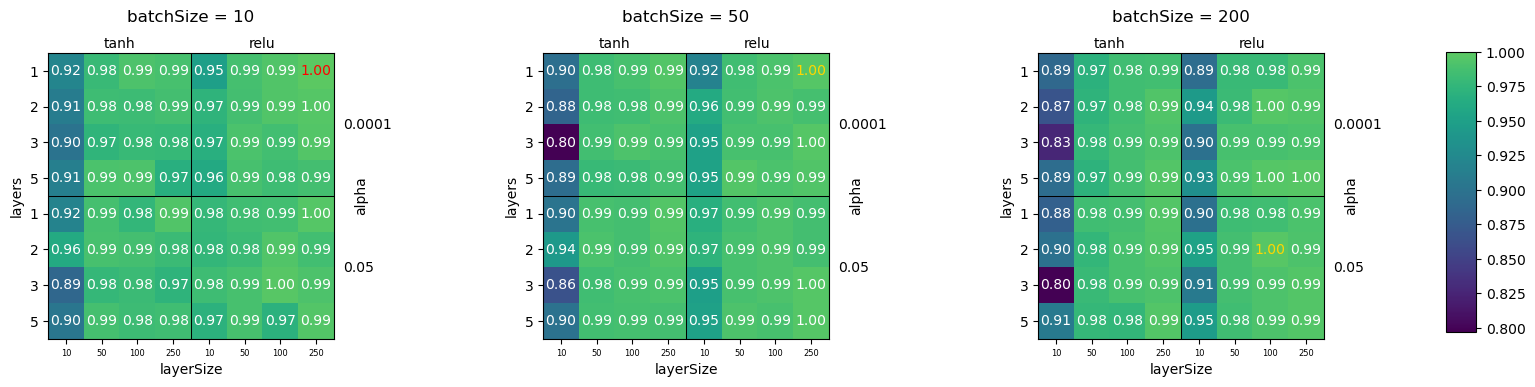

MIGLIORI IPERPARAMETRI


train_f1 validation_f1       time hidden_layer_sizes activation   alpha  \
216  0.997331           1.0  10.141711              [250]       relu  0.0001   

    max_iter learning_rate batch_size layerSize layers  
216     1000      constant         10       250      1

In [715]:
scoreInterest= 'validation_f1' #validation_f1, time, train_f1
vmin=MLPresults[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=MLPresults[scoreInterest].max()

fig,axs=plt.subplots(1,len(GRID['batch_size']),figsize=(15,4))
for i,bs in enumerate(GRID['batch_size']):
    square=pd.DataFrame()
    for act in GRID['activation']:
        col=pd.DataFrame()
        for alp in GRID['alpha']:
            df = MLPresults[MLPresults['batch_size']==bs][MLPresults['activation']==act][MLPresults['alpha']==alp][MLPresults['learning_rate']=='constant']
            df=df.pivot(index='layers', columns='layerSize', values=scoreInterest)
            col=pd.concat([col,df])
        square=pd.concat([square,col], axis=1)

    ax=axs[i]
    im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
    ax.set_yticks(range(len(square.index)))
    ax.set_yticklabels(square.index)
    ax.set_xticks(range(len(square.columns)))
    ax.set_xticklabels(square.columns)
    #ax.title.set_text(bs)
    ax.set_xlabel("layerSize")
    ax.set_ylabel("layers")
    for a in range(len(square.index)):
        for j in range(len(square.columns)):
            c="w"
            if square.iloc[a, j]==MLPresults[scoreInterest].max():
                c="red"
            elif square.iloc[a, j]==square.values.max():
                c="gold"
            text = ax.text(j, a, "{0:.2f}".format(square.iloc[a, j]),
                        ha="center", va="center", color=c)
    #Linee verticali e orizzontali di separazione
    ax.axhline(y=3.5,c="black",linewidth=0.75,zorder=0)
    ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
    #Testi aggiuntivi degli assi mancanti e titolo
    ax.text(3.5, -1.5, 'batchSize = '+str(bs), ha="center", va="center", fontsize=12)
    ax.text(8.25, 3.5, 'alpha', ha="center", va="center", rotation='vertical')
    ax.text(1.5, -0.75, GRID['activation'][0], ha="center", va="center")
    ax.text(5.5, -0.75, GRID['activation'][1], ha="center", va="center")
    ax.text(7.75, 1.5, GRID['alpha'][0], ha="left", va="center")
    ax.text(7.75, 5.5, GRID['alpha'][1], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('MLP_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=MLPresults[scoreInterest].astype(float).idxmax()
bestModel = MLPresults.iloc[max_elem_row]
display(pd.DataFrame(bestModel).transpose())

Sono qui sopra rappresentate le _heatmap_ di confronto tra gli iper-parametri per il validation set, analoghe a quelle viste per la SVM. Rispetto a quanto visto per l'SVM però il valore minimo ottenuto risulta molto maggiore, 0.80 contro 0.02, così come anche il valore massimo risulta maggiore, raggiungendo l'1.0 pieno.

Notiamo come nel nostro caso specifico siano più adatti MLP con pochi layer di dimensione elevata e la "vittoria" di strati con dimensione $\geq 50$ rispetto a strati di dimensione 10 è schiacciante, indipendentemente dagli altri iper-parametri considerati. In generale la funzione di attivazione _relu_ consente di raggiungere risultati migliori rispetto a _tanh_.

Un'altra considerazione riguarda il confronto con i valori di _f1_ ottenuti dal training set: differentemente dalla SVM, l'MLP non sembra creare overfitting per nessuna combinazione.

<img src='data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAEZQAAASwCAYAAAByNnjsAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAC4jAAAuIwF4pT92AAEAAElEQVR4nOzdd3iV5fkH8DshCxL23ksE3Cho3bu4V62zKq46arVWa7VqHXXUOmunrf4cdQ/U1rqKExcucCGgCAjIhoRAIAlJfn9YUw4JcE7I5vO5Lq7L9znvM+LJOcn7fd7cJ62ioqIiAAAAAAAAAAAAAAAAAAAAAABo8tIbegEAAAAAAAAAAAAAAAAAAAAAANQOBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAAAAAAAAAAAAAAAAAAAAAAJoJBWUAABqRK6+8MtLS0hL+0fj169cv4TkbNWpUQy+p3txzzz1VvmenT5/e0MsCAAAAAFIkn26a5NPyaQAAAABoDGTMTZOMWcYMAAA0bxkNvQAAAKDuTJs2LT766KNYuHBhFBQUxIoVK6JVq1aRm5sb3bp1i379+kX//v2jTZs2Db1UaHSKiori3XffjcmTJ8eSJUuioqIi2rZtG4MGDYrtt98+2rZt29BLBAAAAIBGSz4NNSefBgAAAGBjJ2OmKSosLIzPPvssvvjii1iyZEkUFhZGbm5utG/fPnr27BkjRoyol3y3oTPmgoKCePfdd+OLL76IgoKCSEtLi/bt28fgwYNjhx12iJYtW9bp/AAA/I+CMgAA0My89tprceedd8Zzzz0XixYtWu/5aWlpMXDgwBgxYkTsvPPOsd9++8XAgQPrYaVQVUlJSXz66afx/vvvV/779NNPo7S0NOG8u+++u84+CeO9996LG2+8Mf71r3/FypUrqz0nIyMj9t1337jgggti7733rpN1AAAAAEBTI5+mKXn11Vdjzz33rLXx5syZE926ddugMeTTAAAAAGzMZMw0NQUFBfH888/HK6+8Eq+88kpMmTJlneenpaXFFltsESeeeGKccsop0aFDh1pdT0NnzGPGjImbb745xowZE6tWrar2nJycnDjkkEPiF7/4RQwfPrxW5wcAoKr0hl4AAABEfBuOrv7vyiuvbOglNTmfffZZ7LTTTrHHHnvE/fffn9RGSkRERUVFfPnll/HQQw/FOeecE5tsskkMGzasjlcL31q2bFncddddcdZZZ8WIESOidevWsd1228UZZ5wRf//732P8+PFVisnUleLi4jj77LNjhx12iMcee2ytGykREatWrYrnnnsu9tlnnzjqqKNi6dKl9bJGAAAAAGqffHrDyadhw8inAQAAAJouGfOGkzHT1Pzzn/+Mgw8+OLp06RLHHHNM3HHHHestJhPx7ffsJ598Er/4xS+id+/eceutt0Z5efkGr6ehM+aCgoI48sgjY999943nn39+rcVkIiJWrlwZjz76aGy//fbx05/+NEpKSjZ4fgAA1i6joRcAAABsuPvuuy9OP/30WgtUp02bVivjwPp8+eWXcdpppzX0MmL58uVxwAEHxOuvv55y38ceeywmTpwYr7zySnTu3LkOVgcAAAAAjZd8GjaMfBoAAACAjZmMmabolltuiddee22DxigqKoqf//zn8e9//zuefvrpyM3NrdE4DZ0xz58/P/bcc8+YOHFiSv0qKirij3/8Y3z66afx73//O1q1alWj+QEAWDcFZQAAoIl74IEH4uSTT662OnmbNm1i3333ja222ip69eoVrVu3juLi4liyZEnMmjUrPvjgg/jggw8iPz+//hcOjURFRUUcc8wx1W6k9OzZM44//vgYNGhQZGdnx7Rp0+Kpp56K8ePHJ5z32WefxUEHHRRjx46NrKys+lo6AAAAADQo+TTNzcCBAyMvL69GfTMzM1PuI58GAAAAYGMmY6a5adeuXey8884xfPjw6NKlS3Tq1CmKiopi2rRp8fLLL8cbb7xRpc9LL70UhxxySDz77LORnZ2d0nwNnTEXFxfHAQccUG0xmU033TSOOuqoGDhwYFRUVMTUqVPjkUceiS+//DLhvFdffTWOP/74ePLJJ1OaGwCA5CgoAwAATdisWbPizDPPrLKR0q1bt7jmmmviRz/60XqD5fLy8njjjTdi9OjR8fjjj8fs2bOTnn/UqFExatSomiwd1qtPnz4xfPjwWLBgQYwdO7bO5vnjH/8YzzzzTJX2q6++Oi6++OIqfwTw61//Op566qk44YQTYtmyZZXt7777blx++eVxww031NlaAQAAAKCxkE/THN15552xxx571Nt88mkAAAAANlYyZpqLtm3bxtFHHx2jRo2KHXbYIdLT06s976qrrooJEybEaaedFh988EHCYy+//HJcf/31ceWVV6Y0d0NnzL/61a+qfC2ZmZnxpz/9KU477bRIS0ursq4777wzfvKTn8SqVasq25966qn4y1/+EmeddVZK8wMAsH7V/3YKAAA0CZdeemlCmBsRMXjw4Hjvvffi1FNPTapKeXp6euy2225x2223xfTp0+PRRx+N3Xffva6WDNXq0aNHHHLIIXH11VfHs88+GwsWLIgZM2bEE088EXvttVedzbtw4cK47LLLqrTffvvtcfnll6/1E2UPO+ywePnll6tU4r/11ltjypQpdbJWAAAAAGhM5NOwYeTTAAAAAGzMZMw0dd27d4/f//73MWfOnLjjjjtixx13XGsxme9ss8028dZbb8V+++1X5bEbbrghZs2alfT8DZ0xf/7553H77bdXaX/88cfj9NNPr1JMJuLb1+yPf/zjePzxx6s89qtf/SqWLFmS9PwAACRHQRkAAGiiiouLY/To0QltaWlp8eCDD0avXr1qNGZGRkb88Ic/jKeffro2lgjrtemmm8acOXNi9uzZ8fTTT8fll18e+++/f3Tq1Kle5r/99ttj6dKlCW377rtv/PSnP11v3xEjRsSvf/3rhLbS0tL47W9/W6trBAAAAIDGRj4NG04+DQAAAMDGSsZMU3fxxRfHV199Feeee260bNkypb5ZWVnx2GOPRffu3RPaV65cGY899ljS4zR0xnz99dfHqlWrEtpOP/30OOSQQ9bb99BDD43TTjstoS0/Pz/+8Ic/JD0/AADJUVAGAACaqLFjx1apzL/TTjvFtttu20ArgtS1atUqunXr1iBzl5WVxd///vcq7alshlx44YXRsWPHhLaHHnooCgoKNnh9AAAAANBYyadhw8inAQAAANiYyZhp6vbbb7/Iycmpcf+8vLy48MILq7Q/88wzSfVv6Ix5yZIl8eijjya0ZWZmxm9+85uk5//Nb34TmZmZCW1/+9vfory8POkxAABYv4yGXgAAAKlbtGhRjBs3LqZOnRpLly6Ntm3bRo8ePWLrrbeOgQMH1upcJSUl8eWXX8akSZNi7ty5lVWsO3ToEB06dIgtt9wyBg8eXKtz1rWSkpJ4//33Y9asWbFo0aJYsmRJZGdnR5s2bWLgwIGx2Wab1UmBi5kzZ8Z7770XM2bMiKKioujQoUN07do1dt555+jatWvK482YMaNK23bbbVcbS91orFixIt59992YM2dOzJ8/P5YtWxYdO3aMzp0718nricbl1Vdfjblz5ya0jRgxIqUNyezs7Bg1alTcfPPNlW0rV66MJ598MkaNGlVbSwUAAABoNOTTG0Y+zXfk0xs3+TQAAACwsZIxbxgZM9+RMTd9BxxwQFxwwQUJbV999VVSfRs6Yx49enQUFxcntB122GEpvR9069YtDjnkkHjiiScq22bPnh2vv/567LHHHkmPAwDAuikoAwDQhLz22mtx3XXXxUsvvRRlZWXVnrPtttvGWWedFaeeemqkpaXVaJ4JEybEU089Fa+88kqMGzeuSti3ps6dO8dBBx0UF154YWy22WZJzfHqq6/GnnvuudbHr7rqqrjqqqvWOUbfvn1j+vTpSc1XVlYWDz74YDzwwAMxduzYKCoqWuf5m266aey///5x0kknxbBhw5KaY22efPLJ+N3vfhfvvPNOtY+npaXFiBEj4oorrogDDjgg6XHnz59fpS03N7fG66yJe+65J04++eSEtmnTpkW/fv2SPr82VFRUJH1ueXl5PPDAA/GPf/wjxo4dGytXrlzruf3794+jjjoqLrzwwujUqVNtLJVG5Pnnn6/SduSRR6Y8zpFHHpmwmRIR8dxzz7lhHwAAAGhW5NOJ5NPy6e/Ip6kJ+TQAAACwsZExJ5Ixy5i/I2PeePXp06dK25pFYtamoTPm2px/9YIy382voAwAQO1Jb+gFAACwfmVlZXHOOefEHnvsES+++OJaN1IiIj788MM4/fTTY7fddotp06alNM+kSZNi8ODBMWzYsLjqqqvi9ddfX+9GSkTEggUL4u67744tttgiTj/99KT61KcnnngihgwZEieeeGK88MIL691IiYiYMmVK/P73v49tt902brnllhrNm5+fH4ccckgcccQRa91Iifh2I+Ddd9+NAw88ME466aRYtWpVUuPn5ORUaauuYj//8/zzz8eWW24ZJ554YvznP/9Z50ZKxLcbQzfccEMMGDAgfv/739fTKqkvY8eOrdK2yy67pDzOdtttF61atUpoe/3112u8LgAAAIDGRD69YeTTfEc+zerk0wAAAMDGQsa8YWTMfEfG3PxU93pu2bJlUn0bOmOurfl33XXXpMYGAKDmFJQBAGjkKioq4kc/+lH86U9/SqnfG2+8Ebvvvnt89dVXSfeZO3duTJkyJdUlVqqoqIg777wzdtttt1i6dGmNx6kt5eXlcdFFF8WRRx4ZX375ZY3HqcnXsmjRoth1113jX//6V0r97rvvvqQ/NbJbt25V2p5//vkoLCxMac6NxU033RQHHnhgTJw4MeW+hYWF8bOf/SxOO+20pDe7aNxWrVoVH330UUJbZmZmDB8+POWxqus3d+7cmDNnzgatEQAAAKChyadrTj7N6uTTrE4+DQAAAGwsZMw1J2NmdTLm5qm613b37t3X26+hM+bZs2fHvHnzEtr69OkTPXr0SHn+nj17Rp8+fRLaPvroo3UWHwMAIDUZDb0AAADW7eabb46HH3648rh169Zx6KGHxogRI6Jr166Rn58fkyZNiieeeCJmzpyZ0HfmzJmx1157xYQJE6Jdu3Ypz92+ffsYMWJEDB06NAYOHBht2rSJvLy8WLFiRSxcuDA+++yzePHFF+Prr79O6Pfuu+/GaaedFo8++uhax87Ly4utt9668njNULNr167Vbhasbn2h4wknnBAPPvhgtY9tscUWse+++8bAgQOjU6dOUVpaGosXL46JEyfGe++9F+PHj4+Kiop1jr82q1atisMPPzw+/fTTyrZhw4bFyJEjY8CAAdGuXbtYvHhxjBs3LkaPHh0FBQUJ/R944IE47LDD4sgjj1znPDvvvHOVtsWLF8fpp58e//jHPyIzM7NG669LHTp0SHjeU1VcXByTJk1Kud/FF18cN9xwQ7Xr2XfffWO77baLLl26RKtWrSI/Pz8+++yzeP7552Py5MkJ5991113Rrl27uOmmm2r8NdA4zJgxo8qnM/Tu3TuysrJqNN7AgQOrVOSfPHlyUhs7AAAAAI2VfHrt5NPy6WTJp5uWp59+Ou677754//33Y+7cuZGfnx95eXnRsWPH6N69e+y0006x6667xt57713tpygnQz4NAAAAbCxkzGsnY5YxJ0vG3Hw9/vjjVdpGjBix3n4NnTFX9328ySab1Gju7+Zf/b24qKgoZs6cGf369avxmAAArKYCAIBG44orrqiIiIR/OTk5lf998sknVyxZsqTavmVlZRU33XRTwvnf/Rs1alRS87/yyisV3bp1q7j44osrxo0bV1FWVrbePuXl5RX//ve/KwYNGlRl3sceeyzpr33NvldccUXSfatz4403VhkzIir22GOPinfffXe9/WfNmlVx6623VgwYMGC9a+nbt+9an7NNN9204qWXXlpr3/nz51eMHDmyyjqHDBmS1Nc5fPjwar/OLbfcsuLhhx+uKC4uTmqcmrr77rurzD1t2rQ6mausrKziyCOPrDLf9ttvv85+o0ePrtKnffv2FXfccUfFihUr1tqvvLy8YvTo0RVdunSp0v/pp5+u7S+vWtU9t/X175VXXqmXrzEZ1b033n333Rs05pgxY6qMueeee9bqGu+6664NWiMAAABAfZJPy6fl02snn26e+fQrr7xS4zV27dq14pprrqnIz89PeV75NAAAANAcyZhlzDLmtZMxN8+MeUMUFRVV+/yMHj16vX0bOmO+8847q5x/8skn13j+k046qcp463rvAQAgNekBAECj9l316Isvvjj+7//+b61V9tPT0+OCCy6Ixx57LDIyMhIeu+eee6pUja7O9ttvHzNnzozrr78+tt9++0hPX/+vi2lpaXHAAQfEuHHjYtiwYQmP3XLLLevtXxc+/fTTuPjii6u0/+xnP4uXXnopqcrdPXv2jJ/97GcxZcqUOPXUU1Oa/7vnbMSIEfH222/HXnvttdZzO3fuHE8//XRsscUWCe2TJk2KN954Y71zXXXVVdW2f/LJJ3HMMcdEp06d4ogjjoibb745xo4dG8uXL0/hK2lczjvvvCqV2AcNGhTPPPPMWvvMnz8/Tj755Cp9Pv744/jxj3+8zk8PTUtLi8MPPzzef//96NWrV8Jjl1xySY0/vYHGYe7cuVXaevfuXePxqus7b968Go8HAAAA0BjIp1Mnn5ZPf0c+3bzNmzcvLrvssthqq63inXfeSamvfBoAAADYWMiYUydjljF/R8bcvP32t7+N+fPnJ7T16NEjDjjggPX2beiMuaHnBwAgNQrKAAA0AXvssUdcf/31SZ170EEHxWWXXVal/fbbb19v31atWlXZiElW+/bt47777ktoe/vtt2PixIk1Gm9DXHfddVFWVpbQdtxxx8Wtt96a1AbR6lq0aFGjgLNdu3bx+OOPR4cOHdZ7bnZ2dvzud7+r0v7CCy+st+8BBxwQP/vZz9b6eGFhYTz55JNx4YUXxm677RZt2rSJzTffPE466aS48847Y8qUKeudozG47rrr4o9//GNCW9euXeOFF16Izp07r7Xf73//+ygoKKg8btWqVTz//PNVNkfWpXfv3vHwww8ntE2cODH++c9/Jj0Gjc/ixYurtOXl5dV4vOr6Llq0qMbjAQAAADQW8unUyKf/Rz4tn26qWrZsGb17947NN988+vXrF61bt17ruV9//XXstttuVZ6ndZFPAwAAABsTGXNqZMz/I2OWMTdX77//frXvi1dffXVkZ2evt39DZ8wNPT8AAKmp2ZUyAAD1KpmNkNX98pe/jDvvvDNmzZpV2fb000/HnDlzonv37rW9vEpbbLFFbLvttvHhhx9Wtr3xxhux2Wab1dmca5o+fXo8+uijCW2dO3eOv/zlL/W2hohvK8n36dMn6fO///3vR+fOnWPBggWVbR988EFSfW+++ebIy8uL6667LsrLy9d5bnl5eUycODEmTpxYufk1ZMiQOOGEE+LUU0+Nrl27Jr3m+nLvvffGpZdemtDWunXreO6556J///5r7bds2bL485//nNB2wQUXxIABA1Jew8477xx77713vPTSS5VtTz75ZBx66KEpj5WKrbfeuk7HX5cNCfabguo+qaJly5Y1Hq+6vkVFRTUeDwAAAKCxkE8nTz4tn/6OfHrD1Hc+3bFjxzjggAPigAMOiOHDh8eAAQOq/HHOF198EWPGjIk//OEP8fnnnyc8VlpaGieddFL06NEjdtttt/XOJ58GAAAANiYy5uTJmGXM35Exb5jGfA/0okWL4oc//GGUlpYmtO++++5xyimnJDVGQ2fMDT0/AACpUVAGAKCR+973vhdbbrllSn1ycnLihBNOSKhcvWrVqhgzZkyccMIJtb3EBIMGDUrYTHnnnXfixz/+cZ3Oubp///vfVSrzn3nmmdGmTZt6W0NExOmnn57S+S1atIjtttsunn/++cq2yZMnJ9U3PT09fvOb38T+++8fl156abz66qspzT1p0qS49NJL47rrrosLL7wwLr744sjJyUlpjLry3HPPxWmnnZbQlpmZGaNHj45hw4ats++YMWMiPz8/oe3UU0+t8VoOPPDAhM2U1157rcZjJWvChAl1PsfGas2NmIjYoO/76jYzSkpKajweAAAAQGMgn06NfFo+/R35dNPQo0ePuP/+++PII49c76e+Dho0KAYNGhRnnnlm/OlPf4oLL7wwiouLKx8vKSmJo446KqZOnRq5ubnrHEs+DQAAAGwsZMypkTHLmL8jY26eSkpK4ogjjojp06cntHfo0CHuu+++SEtLS2qchs6YG3p+AABSo6AMAEAjd9hhh9Wo3xFHHJGwmRLx7cZGqpspU6dOjXfeeSc+/vjjmDp1aixdujSWLl0axcXFUVFRUeX8r7/+ep3Hda26jYS63kBa08CBA6Nnz5416re6goKClPrvtNNO8corr8T7778f999/fzzxxBMJn9CwPsuXL4+rrroqnn322XjyySdr9DXUpnfffTd++MMfxqpVqyrb0tLS4p577ol99tlnvf3X3Ozo2bNn9O3bt8brWfOTAKZPnx75+fnRrl27Go9J45LsRkyyfat7jwQAAABoSuTTqZFPy6e/I59uGjbddNPYdNNNU+qTlpYW55xzTgwdOjT233//hBvn582bF7feemtcdtllKa9FPg0AAAA0RzLm1MiYZczfkTE3P+Xl5XHiiSfG66+/ntDeokWLeOCBB6JPnz4bNH5DZ8wNPT8AAGunoAwAQCO33Xbb1ajflltuGZmZmQk3sn7wwQdJ9S0vL4+77ror/v73v8d7771Xo/m/s2Z19Lr29ttvJxx37tw5Bg0aVK9rqOl8bdu2TThOdTPlO8OHD4/hw4fHbbfdFlOnTo2xY8fGuHHjYvz48fHxxx/HihUr1tn/vffeiz333DPefffdBtso+OKLL+Kggw6K5cuXJ7TfeOONcdxxxyU1xptvvplwvGTJkthmm21qvKZly5ZVaVu4cKHNlCYqMzOzStv6XhvrUl3frKysGo8HAAAA0BjIp1Mjn5ZPf0c+3fztvffeccMNN8TPf/7zhPZbb701LrnkkmjRosVa+8qnAQAAgI2FjDk1MmYZ83dkzM3P2WefHY888khCW1paWtxxxx2x3377pTRWQ2fMDT0/AACpUVAGAKCRGzx4cI36ZWdnR79+/eKLL76obJs/f/56+33++edx/PHHx/jx42s075pquiFQU2t+jVtuuWW9zh8R0aFDhxr1WzNcXb0qfU0NHDgwBg4cGKNGjYqIiLKysvjoo4/i9ddfj9GjR8cbb7xRbQXvL774Ik499dR44oknNngNqZo3b16MHDkyFixYkNB+/vnnxwUXXJD0OGt+MkFRUVF89NFHtbLG7yxatCg22WSTWh2T+tGqVasqbbW9mZGbm1vj8QAAAAAaA/l0auTTieTT/yOfbp7OOeecuP3222P69OmVbYsXL4533303dtxxx7X2k08DAAAAGwsZc2pkzIlkzP8jY27aLrjggrjjjjuqtN92221x6qmnpjxeQ2fMDT0/AACpSW/oBQAAsG5rVmzfkL7rq5T/6aefxu67715rGykRkfDpAHWtsLCwynzt27evt/m/U13V7caiRYsWse2228bPfvazeP311+Ozzz6LQw45pNpzR48evcGfzpCqwsLC2H///WPatGkJ7cccc0zcfPPNKY21ePHi2lxatTYk/KZhdezYsUpbdZ/AkKzq+lY3BwAAAEBTIp9Onnx6/eTTtUs+3fAyMzPjhz/8YZX2l156aZ395NMAAADAxkLGnDwZ8/rJmGuXjLl+/OpXv4pbbrmlSvtvf/vbOPfcc2s0ZkNnzA09PwAAqVFQBgCgkduQ6spr9i0sLFzruaWlpXHUUUdVqYgeEbHzzjvHlVdeGc8880x89NFHMX/+/CgsLIxVq1ZFRUVFwr+TTjqpxuvdUEuXLq3SlpeX1wAraTqGDh0aTz/9dFx55ZXVPn7XXXfV21pKSkriiCOOqLKZt/fee8e9994baWlpSY9VVFQUxcXFtb1EmpGuXbtWaVvzEx1SMXPmzKTmAAAAAGhK5NPJk0+nTj5Nc7DHHntUafv666/X2Uc+DQAAAGwsZMzJkzGnTsZMY3fllVfG9ddfX6X96quvjl/+8pc1HrehM+aGnh8AgNRkNPQCAABYt+XLl0ebNm1q3Hd1rVu3Xuu5f/vb3+Lzzz9PaBs4cGA8/PDDMXz48KTnbMhq5dX9f9qQatcbkyuuuCLeeuutePHFFxPa1/cpmrWloqIiTj755BgzZkxC+zbbbBOjR4+OrKyslMbLycmJ9PT0KC8vr2w77LDD4sknn6yV9daXbbbZpsHmvvPOO1N67Tc1/fv3r9I2Y8aMGo9X3R8IVDcHAAAAQFMin06efLrm5NONk3w6Od27d6/SVt0fLq1OPg0AAABsLGTMyZMx15yMuXHa2DPma665Jq666qoq7ZdffnlcfvnlGzR2Q2fMDT0/AACpUVAGAKCRKygoqPFmSkFBQcJxu3bt1nruQw89lHDcunXrGDNmTPTr1y+lORcvXpzS+bWpdevWkZWVFSUlJZVtS5YsabD1NDXnnntulc2UqVOnRllZWbRo0aJO577wwgvjwQcfTGjr169fPPvsszX6/k9PT4927dolfD9OmzZtg9dZ3z766KMGm7u5b0T27ds3cnJyYuXKlZVtM2fOjJKSkpQ37yK+fa2saciQIRu0RgAAAICGJp9Onnx6w8inGx/5dHKq+5Tt9f3hkXwaAAAA2FjImJMnY94wMubGZ2POmG+44YZqi8ZcfPHFcfXVV2/w+A2dMQ8ePLhK25dffpnyvGubv2XLltGnT58ajwcAQKL0hl4AAADrNmXKlBr1KykpienTpye0denSpdpzly1bFm+//XZC24knnpjyRkpExFdffZVyn9rUtWvXhONPPvmkgVbS9Gy//fZV2ioqKmLRokV1Ou8tt9wSt9xyS0Jbx44d44UXXqj2kz2Tteb3wpQpU6K4uLjG49G8ZGRkxFZbbZXQVlJSEh988EHKY61atSree++9hLZu3bpt0PcvAAAAQGMgn06NfLrm5NM0VQsWLKjS1qlTp3X2kU8DAAAAGwsZc2pkzDUnY6axuOmmm+Liiy+u0v6LX/wirr/++lqZo6Ez5l69elV5T54xY0bMmTMn5fm/+eabmDFjRkLb1ltvXeeFoAAANiYKygAANHI1CfYiIj7++OMoLS1NaNtuu+2qPfebb76J8vLyhLZdd9015Tnnz5/f4JspO+64Y8LxggULarwhtbFp27Ztte0ZGRl1NueDDz4YF154YUJbq1at4t///ndsuummGzT2mptDK1asiFdffXWDxqR5qe597o033kh5nA8//DCKiooS2nbbbbcarwsAAACgsZBPp0Y+XXPyaZqqzz//vEpb586d19tPPg0AAABsDGTMqZEx15yMmcbg1ltvjV/84hdV2s8///z43e9+V6tzNXTGXFvzV9dHxg0AULsUlAEAaOSeeuqpGvUbPXp0lbbvfe971Z67cOHCKm0dOnRIec5HHnkk5T7fWbOKdFlZWY3G2WOPPaq0/eMf/6jRWBubefPmVWnLzMyM9u3b18l8Y8aMiVGjRkVFRUVlW4sWLeLRRx+NHXbYYYPH33fffau03X///Rs8bn2qqKhosH/VvZaam/32269K2xNPPJHyOI8//nhSYwMAAAA0NfLp1Mina04+3fjIp5Pz7LPPVmnbeuut19tPPg0AAABsDGTMqZEx15yMufHZ2DLm22+/PX7+859XaT/33HPjlltuqfX5Gjpjbuj5AQBInoIyAACN3Ntvvx2fffZZSn2Ki4urbCBkZGTEPvvsU+35ubm5Vdqq22BZl9LS0vjDH/6QUp/VtW7dOuF42bJlNRrnoIMOqlJN/o477oilS5fWeG0bi5dffrlK24ABAyItLa3W5xo/fnwcccQRVT5B4o477ogDDzywVuYYOXJk5OTkJLQ99NBDMXny5FoZn6Zvzz33jG7duiW0jRs3LiZMmJD0GCUlJXHPPfcktGVnZ8fhhx9eCysEAAAAaFjy6dTIp2tOPk1T9Pnnn8c///nPhLa0tLQYOXLkevvKpwEAAICNgYw5NTLmmpMx05D+8pe/xHnnnVel/Sc/+Un8/ve/r5M5GzpjPuKIIyIrKyuh7cknn4z58+cnPf/8+fOrFB7r0aNH7L777kmPAQDA+ikoAwDQBFQXMK7L7373u5g1a1ZC26GHHhrdu3ev9vzq2l988cWU5rzqqqviiy++SKnP6tasAP/VV1/VaJzevXvHcccdl9C2YMGCOOuss2q8tsbqww8/jLFjx9bKWCUlJXHTTTdVaT/ooINqZfzVTZs2LQ444IAoLCxMaP/Nb34Tp556aq3N06lTp/jxj3+c0FZWVhbHHXdcrFixotbmoelq0aJFnHbaaVXaL7nkkqTHuOWWW2LBggUJbccee2y0a9duQ5cHAAAA0CjIp5Mnn64Z+TRNUXFxcZx++ulVPm165513Xuv73erk0wAAAMDGQsacPBlzzciYaUh///vf4yc/+UmV9jPPPHODClWtT0NnzB06dIijjjoqoa2kpCSuuOKKpOf/9a9/XaUw049//ONIT/cnzwAAtclvVwAATcBLL70Ul112WVLnPvfcc/Gb3/ymSvu555671j5dunSJTTfdNKHtgQceiI8++iipOe++++64/vrrkzp3bbbccsuE49deey2WL19eo7EuueSSyMzMTGh78MEH4+c//3lUVFSkNFZZWVnMnDmzRuuoa1OmTInddtst9tprr3j55ZdT/tq+U1paGqNGjYpPP/20ymPHHHPMhi4zwYIFC2LkyJExd+7chPYzzzwz6e/xVFxyySVVPn3iww8/jMMPPzyWLFlSozFnzJgRP/3pT6v9/0XTc+6551b5dJDnn38+/vSnP6237wcffBBXXnllQltGRkZcfPHFtblEAAAAgAYln06NfDo18unUyKdrz2233RYzZsyoUd/CwsI4+uij480336zy2LXXXpv0OPJpAAAAYGMgY06NjDk1MubUyJhr17333htnnHFGle/f008/Pf785z9HWlpanc7f0BnzxRdfHC1atEhou+OOO+KZZ55Zb99//etfcccddyS0tW3bNn76058mPT8AAMlRUAYAoJHLycmJiG9vQD399NOjoKCg2vPKy8vjtttuiyOOOKJKpeZRo0bFbrvtts551qwQXVpaGvvtt1+8+uqra+2Tn58f5513Xpx66qlRXl4eERFt2rRZ35dUrZ122inhuKCgII4++uj4/PPPUx5ryJAh1Vaav/XWW2PvvfeO999/f71jzJkzJ26//fYYPHhw3HXXXSmvoT698sorsffee8fAgQPj8ssvj4kTJybVr7y8PJ5//vkYMWJEPPTQQ1UeHzVqVAwfPrxW13rggQdW+RSHww8/PKnguia6desW9957b5VA/oUXXojtttsu7r///li1atV6x1m+fHk88sgjccQRR8Qmm2wSf/zjH2PlypV1smbqV+fOnePqq6+u0v7Tn/40rrnmmrV+f/zzn/+MPffcM4qLixPaf/azn8XgwYPrZK0AAAAA9U0+LZ9eH/n02smnG7d77rknNtlkkzjuuOPin//8Z1L/T8vKyuKxxx6LbbfdNp5++ukqjx9zzDHrfb9bnXwaAAAAaO5kzDLm9ZExr52MuXF7+OGH45RTTqlSTObUU0+NO+64o86LyUQ0fMa8+eabxznnnJPQVlFREUcccUTcdddd1RaKqqioiL///e/xgx/8oMpj1157bXTo0CHp+QEASE5aRU1LeAIAUOuuvPLKuOqqqxLafve738VFF11UedymTZs47LDDYsSIEdGlS5fIz8+PSZMmxRNPPBFff/11lTH79u0bEyZMiHbt2q1z7sWLF8fAgQMjPz+/ymO77bZbjBw5Mvr16xfp6ekxd+7ceOutt+K5556LZcuWVZ639957R8+ePeO+++5LmH/69Onr/drnzJkTffr0qTa4bN++fXTt2jWys7MT2nv06BHPPvvsWsc84YQT4v7776/2sa222ir23XffGDBgQHTq1ClKS0tjyZIl8fnnn8f7778f77//fuUG0RVXXFGlAvfq+vXrl/AplieddFLcc8896/hqq1fd87+uX9cffvjhOPbYY6t9rEOHDrHDDjvEsGHDokuXLtGxY8fIycmJZcuWxdy5c+PTTz+Nl19+OebMmVNt/6FDh8bYsWOjY8eO61zzPffcEyeffHJC27Rp06Jfv37Vnl9dOD5kyJAqz22qJkyYsM7Hr7nmmrj88surfaxr166xxx57xPDhw6Nz586Rm5sbS5cujfz8/Pjyyy/j/fffj48//rhKaP7ee+/V+mbTxuqvf/1r/PWvf13r43Pnzo158+YltPXu3XudmwZnnnlmnHnmmUnNX1FREQceeGA899xzVR7r1atXHH/88TFo0KDIzs6OadOmxVNPPRUffvhhlXO32267ePPNNzf4+xkAAACgIcin5dPy6ZqRTzdN22yzTcKnVOfm5sawYcNi6623joEDB0a7du2idevWUVRUFIsWLYoPP/wwXnnllZg9e3a14+2yyy7x4osvRsuWLVNah3waAAAAaC5kzDJmGXPNyJibpszMzGpf81tttdUGF5N59tlno0ePHkmd29AZ88qVK2PHHXes9vt48ODBcfTRR8eAAQOioqIivvrqq3j44YerFGaKiDj44IPj6aefrpdCPAAAG5uMhl4AAADrduGFF8b7778fjz76aERELF26NO67776EDYu16dWrV7z88svr3UiJ+DZ8f+CBB+KQQw6JsrKyhMdef/31eP3119fZf4sttojHHnsszj///PXOVZ3u3bvHZZddVu2mxZIlS2LJkiVV2qvb+FndvffeG926dau2Uv/HH38cH3/8cY3W2hQsXrw4nnvuuWrD4fUZNmxYvPDCC+vdSKktkyZNqvM5LrvssujRo0f85Cc/qVJVf968efHII4/EI488UufroHpz585NuHE/GTNnzoyZM2euc8xkpaWlxaOPPhr77bdfvPnmmwmPzZo1K2644Yb1jjF06NB49tln3awPAAAANCvyafl0TcinE8mnm4bly5fHG2+8EW+88UbKfQ855JC49957Uy4mEyGfBgAAAJo3GbOMuSZkzIlkzI1TdcVkIqJWXpslJSVJn9vQGXNOTk4899xzsccee8TkyZMTHps8eXJcffXV6x1j1113jYceekgxGQCAOpLe0AsAAGDd0tLS4oEHHogzzzwzpX4777xzvPbaazFgwICk+xxwwAHx2GOPRZs2bVKa66CDDoqxY8dG+/btU+q3pssvvzyuvfbayMrK2qBxvpOenh433nhjPPzww2utFr8+aWlp0blz51pZT23baaed4rzzzou+ffvWynitW7eOG2+8McaNG9dov+YNccopp8Tbb78de+211waNk5OTE8ccc0z06dOnllZGY5CXlxdjxoyJM844I+UNiR/84Afx9ttvR5cuXepodQAAAAANQz5dc/Lp1MinkyOfbly6du0af/vb3+Lpp59O6g+b1kY+DQAAADRXMuaakzGnRsacHBlz89TQGXO3bt3inXfeicMPPzylfmlpaXHWWWfFf/7zn8jNza3x/AAArJuCMgAATUBGRkb85S9/iTFjxsRee+0V6elr/zVu2LBh8fe//z3Gjh2b0kbKdw4//PD4+OOP44wzzljnJymmp6fHHnvsEU8//XT861//2qAbZVcf81e/+lXMnj07/vjHP8bRRx8dW2yxRXTq1ClycnJqPO7RRx8dU6ZMiTvuuCN23333pDZrttpqq7jkkkti8uTJ8ZOf/KTGc9elPn36xG233RbTp0+P8ePHx8033xyHH354dO3aNekx8vLyYuTIkXH33XfHrFmz4sILL4zMzMw6XHXD2mabbeKll16Kd955J0488cTo1atXUv26d+8eP/rRj+Lee++NuXPnxkMPPeTm7GYoJycn/vrXv8Y777wTP/jBD9ZZaT8jIyNGjhwZL774Yjz++OPRtm3belwpAAAAQP2RT8unqyOfTp18unEZPXp0/O1vf4vjjz8+Bg8evM73ttW1bt069t1337j//vvj66+/jtNPP71W1iOfBgAAAJorGbOMuToy5tTJmFmXhs6Y27VrF6NHj44XX3wxRo4cGS1atFjrudnZ2XHkkUfGuHHj4s9//vM61woAwIZLq6ioqGjoRQAAkJqFCxfGO++8E1OnTo1ly5ZFmzZtonv37jFs2LAYOHBgrc1TXFwc48aNi8mTJ8eiRYuivLw82rVrFwMHDowRI0ZEhw4dam2u+rR8+fIYN25czJkzJxYuXBiFhYWRm5sb7dq1i0022SQ222yz6NixY0Mvc4MsWrQovvjii/jqq68iPz8/CgsLY9WqVZGXlxdt2rSJjh07xuabbx4DBgxIuRJ5c/Pll1/GxIkTY9GiRbFo0aIoKSmJvLy8aNu2bfTv3z+GDBli42QjVVRUVPkeuHjx4oiIaNu2bWyyySaxww471MomMgAAAEBTI5/eMPJp+fTq5NONR1FRUUyZMiVmzpwZ33zzTRQWFsbKlSsjOzs72rdvH+3bt49NN900Nt9886SLz2zoeuTTAAAAQHMkY94wMmYZ8+pkzKxNQ2fM+fn5MW7cuPjyyy+joKAgIiI6dOgQgwcPjh122CFatWpVp/MDAPA/CsoAAAAAAAAAAAAAAAAAAAAAADQTdf+ROQAAAAAAAAAAAAAAAAAAAAAA1AsFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAAAAAAAAAAAAAAAAAAAAAAmgkFZQAA6llaWlrlvz322KOhlwPARuLVV19N+Bl05ZVXNvSSAAAAgAYgowagvsmnAQAAgAj5NAD1Tz4NAGzsFJQBAAAAAAAAAAAAAAAAAAAAAGgmFJQBAOrc9OnTEyr6jho1qqGXBAAAAADARkJGDQAAAABAQ5BPAwAAAA1JQRkAAAAAAAAAAAAAAAAAAAAAgGZCQRkAAAAAAAAAAAAAAAAAAAAAgGZCQRkAAAAAAAAAAAAAAAAAAAAAgGZCQRkAAAAAAAAAAAAAAAAAAAAAgGZCQRkAAAAAAAAAAAAAAAAAAAAAgGYio6EXAACQqnnz5sXEiRNj6tSpkZ+fHyUlJdGuXbvo1KlTbLfddjFw4MBan7OioiLefffd+OKLL+Kbb76JrKys6NatW+yyyy7Rq1evWp1r5syZ8d5778WsWbNixYoV0alTp9hyyy1j+PDhkZ6uHiBAUzVhwoSYPHlyzJ07N5YvXx5du3aNE088MTIzM9faZ86cOTFu3LiYP39+LFq0KPLy8qJLly4xYsSIGDBgQD2uHgAAAPiOjBqApkY+DQAAAM2DfBqApkY+DQDQsBSUAQDqTL9+/WLGjBlV2u+99964995719rv7rvvjlGjRlUel5WVxWuvvRaPP/54jBkzJr744ot1zturV684++yz4+yzz462bdsmtdZ77rknTj755CprKC8vj9tuuy3++Mc/xrRp06rtu+uuu8aNN94YO+ywQ1Jzrc1bb70VV1xxRbz88stRXl5e5fGuXbvGpZdeGj/5yU9sigA0Mq+++mrsueeelcdXXHFFXHnllVFWVha33HJL/O1vf4svv/yySr8f/OAH0a5du4S20tLSuOuuu+LPf/5zfPLJJ2udc9CgQXHhhRfGKaecEhkZtXt5P3369Ojfv3/l8UknnRT33HNP0v332GOPeO211yqPKyoqanN5AAAAkBQZdWpk1ABNk3w6kXwaAACAxkA+nRr5NEDTJJ9OJJ8GABojV9EAQKP3+9//Pvbee+/4y1/+st6NkIiIWbNmxa9+9avYZptt4sMPP6zxvPPnz4+99torLrjggrVuhEREjB07Nnbdddd48MEHazzXddddF7vttluMGTOm2o2QiG8/VeDcc8+NI488MkpKSmo8FwD1Y86cObHrrrvGRRddVO1mSHU++OCDGDJkSJx11lnr3AyJiPjiiy/ijDPOiBEjRsTs2bNrY8kAAABANWTU35JRAzQd8mkAAABoHuTT35JPAzQd8mkAgMaldkvwAQDUgTU3B7KysmLIkCHRq1evaNu2bZSVlcWCBQvio48+isWLF1eeN3369Nhrr73igw8+iIEDB6Y054oVK+Kggw6K9957LyIisrOzY/jw4dGzZ88oKyuLzz//PCZOnFh5fmlpaYwaNSq22GKL2GqrrVKa66abbopLL7208njw4MExePDgyM3NjTlz5sQ777wTK1eurHz8ySefjMsvvzxuuOGGlOYBoP4UFxfH4YcfHuPGjYuIiBYtWsR2220XvXv3joiIr7/+Oj744IOEPs8880wcffTRUVRUlNDevXv32HrrraNDhw6xfPnymDhxYsLNARMmTIgddtgh3nnnnejVq1cdf2UAAACw8ZFRy6gBmhL5NAAAADQf8mn5NEBTIp8GAGh8FJQBAOrMG2+8EatWrYpZs2bFrrvuWtn+gx/8IG666aa19uvUqVOVtm7dusVJJ50UBx10UHzve9+LjIyqv8aUl5fHmDFj4uKLL47x48dHRERBQUEcf/zx8c4776S09l//+texcOHCaNmyZVx11VVx9tlnR25ubsI57777bhx//PGVVZNLS0vj/PPPj5deeinpeT755JMYO3ZsREQcdthhcf3118eQIUMSzlmyZEn8/Oc/j3vuuaey7eabb46zzjor+vXrl9LXBUD9+NOf/hSFhYWRnp4e559/flxyySXRsWPHhHNmzpwZeXl5ERExceLEOOaYYxI2Q/bbb7+46qqrYvvtt68y/vjx4+O8886r/Bkye/bsOPbYY+PVV1+NFi1a1OFXBgAAAE2HjHr9ZNQAzY98GgAAABqefHr95NMAzY98GgCg8Ulv6AUAAM1Xr169ol+/flWq/ebl5UW/fv3W+u+7cOg7xx13XHz99dfx29/+NnbZZZdqN0IiItLT0+P73/9+vP322zFy5MjK9nHjxsWrr76a0toXLlwYubm58dprr8UvfvGLKhshERHbb799vPTSS9G6devKtldeeaVycyQZixcvjvLy8rjoooviySefrLIREhHRvn37uPvuu+PQQw+tbCsrK4u77rorpa8JgPpTWFgYERH/+Mc/4qabbqqyGRIR0bt378jIyIjy8vI4+uijY/ny5ZWPXXnllfHcc89VuxkSETFs2LB4+eWX44gjjqhse+ONN+KBBx6o5a8EAAAAmi4Z9frJqAGaH/k0AAAANDz59PrJpwGaH/k0AEDjo6AMANDo9ejRIzIzM5M+Pzs7O+6+++6EPjUJiG699dYYMWLEOs/p06dPnHHGGZXHFRUV8corr6Q0zy677BLXX3/9es+79tprE45ffvnllOYBoH6dcsopcdxxx633vNGjR8enn35aeXzUUUfFFVdcsd5+GRkZce+990aXLl0q29b16TUAAABAzciovyWjBmg65NMAAADQPMinvyWfBmg65NMAAI2LgjIAQLPUvXv32GmnnSqP33rrrZT69+zZM04++eSkzj3ooIMSjsePH5/SXJdeemmkp6//17LNN988+vXrV3k8YcKElOYBoH5dfPHFSZ13++23V/53Wlpa/Pa3v016jry8vIRN+U8++SSmT5+edH8AAACgbsioAWhI8mkAAADYeMmnAWhI8mkAgMZFQRkAoEkrKiqKefPmxYwZM2L69OkJ/9q3b1953qRJk6KioiLpcUeOHBkZGRlJnTt06NCE4/nz5yc9T8uWLWOvvfZK+vzV5yoqKoply5Yl3ReA+rP55pvHoEGD1nve8uXL45133qk8HjFiRPTv3z+lufbcc8+E47Fjx6bUHwAAAKg5GbWMGqCxkU8DAADAxkE+LZ8GaGzk0wAAjU9yV/gAAI1AeXl5vPrqq/H444/He++9FxMnToyioqKk+y5dujTatm2b1PmbbbZZ0utafdMlIqKgoCDpvgMHDoysrKwNmisvLy/p/gDUj2HDhiV13jvvvBOlpaWVxwMGDEi5Qn55eXnC8dSpU1PqDwAAACRHRi2jBmgK5NMAAADQ/Min5dMATYF8GgCg8VFQBgBoEsaOHRvnnHNOfPzxxzUeo6CgIOnNkDU3HdYlMzMz4Xj1YKs259nQuQCoP126dEnqvJkzZyYcP/zww/Hwww9v0NyLFy/eoP4AAABAVTLqDZ8LgPohnwYAAIDmRT694XMBUD/k0wAAjY+CMgBAo/f444/Hcccdt8HB/5oViNclPT19g+ZqbPMAUL9at26d1HmLFi2q9bkLCwtrfUwAAADYmMmoAWhK5NMAAADQfMinAWhK5NMAAI2Pq28AoFGbMWNGnHTSSQkbIV26dInzzz8/Ro8eHR9//HEsXLgwioqKory8PCoqKir/nXTSSQ24cgBYv5KSklofs6KiotbHBAAAgI2VjBqA5ko+DQAAAI2bfBqA5ko+DQBQfzIaegEAAOtyww03RFFRUeXxwQcfHA899FDk5uaut+/SpUvrcmkAsME6deqUcHzdddfFJZdc0kCrqT1lZWUNvQQAAACoFTJqAJor+TQAAAA0bvJpAJor+TQAQP1Jb+gFAACsy9NPP13533l5eXH//fcntRESEfHNN9/U1bIAoFZ07do14XjKlCkNtJJEGRmJ9WdXrVqVUv8lS5bU5nIAAACgwcioAWiu5NMAAADQuMmnAWiu5NMAAPVHQRkAoM6lpaXVqF9RUVHChsZuu+0Wbdq0SarvypUrY/z48TWaFwDqy4477pjwc/I///lPVFRUNOCKvrXmz9v8/Pyk+xYXF8fUqVNreUUAAABQczJqAKhKPg0AAAB1Tz4NAFXJpwEA6o+CMgBAncvOzk44Li4uTqrfmuFL27Ztk57zwQcfjJKSkqTPB4CG0Llz5xg2bFjl8ezZs+O5555rwBV9q3Xr1tGyZcvK44kTJybd96WXXoqVK1fWxbIAAACgRmTUAFCVfBoAAADqnnwaAKqSTwMA1B8FZQCAOteuXbuE4zlz5iTVr3379gnHkyZNSqpfQUFB/OY3v0nqXABoaOecc07C8YUXXhjLli1roNV8Ky0tLbbZZpvK42nTpsVnn3223n7l5eVx7bXX1uHKAAAAIHUyagConnwaAAAA6pZ8GgCqJ58GAKgfCsoAAHUuJycn+vXrV3n83nvvVamcX52WLVvGoEGDKo/Hjx8fL7744jr7FBUVxTHHHBPTp0+v4WoBoH6deOKJMWTIkMrjzz//PA4//PBYsmRJSuMsWLAgRo8eXWvr2nvvvROOL7vssvX2ueiii+Ktt96qtTUAAABAbZBRA0D15NMAAABQt+TTAFA9+TQAQP1QUAYAqBd77rln5X8XFRXFfvvtF4888kh8+umnMW3atJg+fXrlv9WrCh999NEJ4/zwhz+MBx54IMrLyxPaKyoqYsyYMbHjjjvG888/HxERnTt3rsOvCABqR4sWLeLxxx+PNm3aVLaNGTMmttpqq/jLX/4ShYWFa+27ePHieOSRR+LYY4+N3r17x+23315r6zrllFMiPf1/scFTTz0Vp5xySrUbNZ9//nkceuihcfPNN0dE1U/WAQAAgIYmowaAquTTAAAAUPfk0wBQlXwaAKB+ZDT0AgCAjcO5554b//jHP2LVqlURETFu3Lg45phjqj337rvvjlGjRkVExAUXXBD/93//F998801ERCxdujR+9KMfxYUXXhjDhw+Ptm3bxuLFi2PChAkxZ86cyjGOP/74yMjIiHvvvbduvzAAqAWbb755PPHEE3HkkUdGQUFBRETMmjUrzj777PjpT38aW265ZfTp0yfatGkTRUVFkZ+fH1OmTIlZs2bV2Zr69+8fF1xwQdx4442VbXfffXc89NBDseOOO0b37t1j+fLlMXny5Jg0aVLlOb/61a/izTffjNdee63O1gYAAACpklEDQPXk0wAAAFC35NMAUD35NABA3VNQBgCoF9tss0387W9/i7PPPjtWrlyZdL927drFM888E/vtt1/Mnz+/sn3u3LnxzDPPVNvn+OOPj7vvvjtOP/30DV43ANSXffbZJ95///049thj4/33369sLysriwkTJsSECRPWO0b79u1rdU3XXHNNfPnll/Hkk09Wtq1cuTJeeeWVas//5S9/Gddee23ssccetboOAAAA2FAyagBYO/k0AAAA1B35NACsnXwaAKBupTf0AgCAjcfJJ58ckyZNiquvvjr22Wef6NWrV+Tm5kZaWto6+w0bNiwmTJgQJ554YmRmZlZ7TlpaWuyyyy7x2GOPxf3337/W8wCgMdtkk03i3XffjX/961+xzz77RHZ29nr7DB06NH7605/G2LFjY/To0bW6nqysrHj88cfjD3/4Q3Tr1q3ac9LS0mL33XeP//znP/Hb3/62VucHAACA2iSjBoC1k08DAABA3ZFPA8DayacBAOpOWkVFRUVDLwIAIFn5+fnxxhtvxFdffRXLli2LDh06RLdu3WL48OHRq1evhl4eANSqlStXxrhx42LGjBmxaNGiWL58eeTm5kb79u1jk002iaFDh0bHjh3rZS3l5eXx/vvvx8cffxwLFy6Mli1bRs+ePWPEiBHRt2/felkDAAAANDQZNQAbC/k0AAAANC7yaQA2FvJpAIDao6AMAAAAAAAAAAAAAAAAAAAAAEAzkd7QCwAAAAAAAAAAAAAAAAAAAAAAoHYoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0ExkNPQCAEhefn5+vPbaa5XHvXv3juzs7AZcEQAAwMajuLg4Zs6cWXm8++67R7t27RpuQQAA9Ug+DQAA0LBk1ADAxkxGDQAA0HDk0wBNl4IyAE3Ia6+9FocddlhDLwMAAICIeOqpp+LQQw9t6GUAANQL+TQAAEDjIqMGADYmMmoAAIDGQz4N0HSkN/QCAAAAAAAAAAAAAAAAAAAAAACoHQrKAAAAAAAAAAAAAAAAAAAAAAA0ExkNvQAAkte7d++E464nnhyZnTo10GpIRcfBixp6CaSgdfbKhl4CKVpekt3QSyBJq4qK45OfPVh53OM3p0WLljkNuCKStUmXBQ29BFKQkVbe0EsgRS08Z01C4ayl8ebF/6k8XvMaDQCgOVvzd5++B5wS2W3l001Bh33mNPQSSEFuZnFDL4EUZaaXNfQSSFLp8tJ46Yx/Vh73OPOn0SJHPt0U9Nn6m4ZeAilonWmvFeqKjBoA2JhVyaj3l1E3Fbl7ue+sKencqrChl0CKSsr8aWBTULq8NN48+4nK44E/ODdaZMmnm4ouI2c19BJIgXuomx77rU3DslkF8fYlL1Yey6cBGr+VK1fG1KlTFZQBaEqysxMLJmR26hRZ3bo10GpIRat+aQ29BFLQOmdFQy+BFFUUC9SbilXLEm8izurZOVrktmyg1ZCKNj0EtU1JRrrNkKbGBlbTtOY1GgBAc7bm7z7ZbTtFTkf5dFOQ17+koZdAClpn+SP8pibLDY5NRklhYsGmrC5do0VL+XRTkNdfsa2mpG2WvVaoLzJqAGBjIqNuulr1q2joJZCCtnmZDb0EUrRyleesKShdI5/O6dA1WmTLp5uK1v1lnk2J+3GbnqwWqxp6CdSAfBqg8Zs6dWpsscUWkd7QCwEAAAAAAAAAAAAAAAAAAAAAoHYoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0EwoKAMAAAAAAAAAAAAAAAAAAAAA0ExkNPQCAGhYvdq2ic26dIkuebnRKjMrFixfFrMLCuPDb76JVeXlDbaurnl5MaxH9+iU2ypaZ2XHkhUrYt6yZfHRnLmxeMWKDR4/PS0t+rVvF73bto1urVtH6+ysyG6REStWlcbSlcUxbcmSmDh/fqwoXVULX03t6t6yfQxq3SM6ZbeJVi2yYmFxYcxduSQ+yZ8RZRUN95x1ym4TW7brG+2z8iIvIycKSpbHguKlMbFgZuSXLq+1edIjLfrldYlN8rpHu6zcaNkiK1aWlcbSVUXxVeG8+HLZnAb9/7CmrjkdYkBur+iY1TZyWmTH4pKCmF+8JD5f+lWDrrNjVtsY0qZ/tM9sHa0ycmJp6fJYXFIQkwpnxNLSZbU2T4u09Bjcul/0aNkp2mbmRXlFRSwuKYg5KxfGlMKva22e2tQ953+vsZYZ2bGoeGnMXZkfn+RPb/DX2BZt+0aHrLzIzciJgtKiWFi8NCYWfF3rr7G+uV1ik9Y9ol1mq2iZkf3ta6y0KKYtm9voXmO9ctvF0HZdo2vL1tEqIyvmr1gW3xTlx4cLZ8WqBlxn15atY1jHXtEpJzdaZ2bH4uKimL9iWXy0eHYsLi5qsHU1Bl2yO0b/vF7RIatt5KRnx5LSpbFg5eKYVDi1Qb+3OmS1jcGtB0S7rNaR26JlLC1dFotLCmJK4fRYuqp23xc3bd0/uud0jjaZeVERFbG4uCDmrlwQXyybUWvz1KYu2R2jX27vb5+zFtmxpKQgFhQvjskN/py1i01bD4h2ma2jVYuWsXTVslhSUhBfFE6r9edsUF7/6JbT5X/PWUl+zFu5ML5cNr3W5tkY9MvtE91zukT7rHYREbGkJD/mrJgX04tm1uo8rVq0jE1bD4wOWe2idUZeFK5aFotL8mNK4dQoKtvwawkAAGpPz45tYnDPztG5bV60ys6MBUuXx5zFS+Ojr+Y0aD7dpW1ubNW/R3Rs3SryWmZF/rKVsaBgWXwyY24sWbZx/07ZLadDDMzrGR2z20TLFt9mZ/OLl8RnBdMaPO/crG2/aJ+VF7kZLaOgZHksKimISUtnREEtZmct0tJjSJu+0fO/eWdFVMSi4oL4ZsWimNwI884u2R2jf26vaJ/VLlr+95p+fqO4pv82h2mb2SZyM77LYfLjizrIYQbl9Y/uLTtHm8zWUVFRHotLvs1hvmykOUxj5rq+er3atomhXbtE1//utc5fviy+KSiMD2c3gr3Wnv/da83OjsVFK2L+smXx0Te1u9faq13b6N66deRlZ0V2RkasLC2NpcXF8dWiJfF5I9xr7ZrTIQbm9oqO2W3+u2+3NOavXBwTlzb8z7GhbfpF+6zW0eq/74uLipfG5MLptf9zbPV9u//m09804n27xsz7YtPi+QIAYE2V+XS7vGiV1Qjz6TatIi8nK/KX/zefnl77+XTrltmxdf/u0aVdXrTLaxn5y1bE/Pxl8dG0OVG4orhW56oN7u1sWvd2Nnb9c3tHt5yu0eG/14mL6/A6cXA114mTG+F1YtfsjtE/r2d0yGoXOS2yYknJ0phfvDgmNfA97x3+e897u8w2kfvfe94XfXdvZy3f875p637RPadz5R7Q4pKCmLNiYaO9t9Nea9Pjb0ua1t+WeF9seu+LjVn/3N7RPadL4u8eK+fHtOV187tHx6x20TozNwpLl8eiRvq7BwD1R0EZgI3UfpsOilOHbxfb9uxR7eNLVqyIf0+aHLe9+VYsWbGyXtaUFhEHDx0SP95+RAzt0rnac1aVl8fbX38df3v3/XhrRmqBwfd6946Rmw6KbXt0j0GdOkZ2xrp/DK4qL4+x06bHQx99HC9N/SqluerCnl23jGP67hpbtutb7eMFJcvjpXkfx9+/fDEKSuunWEFapMW+3baO4/vvHoNaV/+9tKq8LD5cPDXun/5avL/4yxrP1TWnXRzTd9fYr/uwaJuVu9bzilYVx5i5H8VDM8bGjOXzazzfhtq50zZxeM89Y7O2/at9fGnp8nh9wYdx//RnY+mq2tswWpe0SIvdu2wXR/baOwbk9az2nLKKsvgo/4t4fOaYmJA/pcZzdcluH8f0GRm7dd42WmXkVHvOwuL8eHnee/HIzBdjRVnDbz7u0WXLOLrvrrFlu37VPl5QsjxenvdR3Dm1fl9j+3TbJo7vt3tssq7X2JKp8eD0Vzf4NXZ0n11jZPdtk3iNTYhHvm7Y19h+vYbGKZvuENt26l3t40uKi+LZmRPjtk9fjSUl9RN8pUXEwX22iNOH7BRD23Wt9pxV5eXxzvxp8bdJb8db86clPfYR/baK321/aC2tNGL3Z26P2UUFtTZeMnbsOCwO7bl3DGkzoNrHl5YuizcXfhgPzvhXFNbj++KunYfH4b32jf65vao9p6yiLD7JnxKjZ70YHxdMrvFcnbM7xA977xe7dNouWmW0rPachcVL4rX578Zjs56PlY3gffF7HbeNg7vvHYPbDKz28cLSZfHmog/ika//Wa/P2S6dRsShPb8f/dbxnH1aMDmemv1ifFIwqcZzdcruEEf2OiB26rj252xR8ZJ4fcG4eGLWc7GyvOGesy7ZnWJgXr8YkNc3Bub2i365fRLWvGDlwvjp+F81yNpapLWIA7vvG3t13SW65XSp9pw5K+bFK/PfiH/PGRNlFWU1nqtfq95xRO+DYli7LSIzPbPK4yXlpTEh/9N4Yua/YkbRrBrPAwDAhttnm0Fxwp7bxjYDqs878peviBc+nBJ//vdbkb+8nvLptIj9txsSo/YZHoN7riWfLiuP96bMjLtfej/GTa75DW3t81rGZn26xhZ9usbmfbrFZn26Rue2iXnM/lfcFd8sXlrjOWrbrp23jh/03j02X0fe+er88XHvtOdjaS3eIL8uaZEWe3YdFkf12SsGri3vLC+LCflfxiNfvxzjl2xY3nl8v31j9y7DIncteeeClfnx0rwP4sEZ/2nwvHPHjsPi4B57x5B1XdMv/CAe+rr+c5jD1nNN/0n+5Hhq9n/i4w24pu+c3SGO7LV/7LyOHGZR8ZJ4bcG78fis5xo8h3Fd/62mdl2/3+BBccqI7WLbXmvfa33288lx29h63mvdbEic/r1177W+M+Pr+Ns7Ndhr7dM7Rg4eFMN6prDX+tX0eHjCx/HSlw2717pLp63jiF7r3rd7bf74+Ec979vt0WXb+GHvde/bTVjyRTw+86UYv4H7dsf2/X7s1nnbtf8cK86Pl+e9Hw9/3fD7dt4Xv9VU3hc9X99qKs8XAAD/zaf3Wk8+/UED5tO91pNPj9mwfDoiYkivznHG/t+LXTbrF1mZVa/vi0tXxZsTp8dfn30nJs9esEFz1Qb3djatezu/u04cmNc3Bub2jf5rXCfOX7kwzhl/aYOsrUVaehzUfd/Yez3XiS/PfzOemfOfDSoW0K9V7ziy94HrvU58bOYzDX6duFOnbeLQnnvF0LXe27k83ljwQTww49/1uqewW+ft4ohe+0T/vLXvKXycPyVGzxoTH+VvyL2d7eOo3vvFrp23Xee9na/Ofy8em/lCg2dnEfZam+Jeq78taVp/W+J9sWm9L3bJ7hSb5PWNgXl9Y5O8ftE/t/cav3ssirM/bLjfPQ7usW/s3WXn6N5ybb97zI+X5r8R//pmzAb97tE/t3cc2evA2Lb95mv93WP8ks/isZnPxHQZNcBGJ62ioqKioRcBQHI+++yz2GKLLSqPe/38F5HVrVtKY7TKzIzrRu4bBw8dktT5C5Yvj188+3yMnV631UM75baKPx96cGzXs/ogojoPTvgofvPyq1FSltxNPTcfuH8cttnQGq3v9WnT48Jnn49FRTXbaOi69bwa9YuIaNkiKy7e7Aexb/dtkjp/UXFhXPPpozFuUc0Dm2R0yMqL67Y+IbZq3y/pPk/OfCdum/TPKE3xRqyDeo6I8wYfHLkZ2Un3KSlfFXd++WLcP/21lOaKiGiXU/PiEznpWXHupsfGHl22S+r8xSVL45bJ98eHS2p+c3wy2me2jks3OzU2a1t9qFWdZ795I/46dXSsqkjt0yNHdtsxzt7kh5GZnlztwnkrF8XNk++PTwumpjTP6pYWVx8sJqNli6z45WZHxj7dtknq/EXFhXHtZ4/Eu/XwGrtm6xNjq7VsglbnqVnvxO8nPZ3ya+zAHiPivMGHRKsUX2N3TX0xHpj+akpzrVq2MsYd8YfK437/d0m0yK0+aKxOq4zMuHb4QXFwny3Wf3JELFixLC569+kYO69ub1bvlJMbf9rph7HdWgrcVOfBqR/ENeNfiJLy9T9ftV1QZoenb4lFxakF2Fv0mFOjuXLSs+PsQcfFbp1HJHX+kpKC+P2U+2JC/uc1mi9Z7TLbxC+Hnh5D1/KHVdV5fs7YuPOrx1J+X9yn605xxsCjqw1nqzN/5aK4bcq9MXFpzW8kyEiveaCck54dZw78UeySwnP2xy/vjY/yJ9Z4zmS0y2wTFw4+Y61/DFedF+e+Hv837dGUn7O9u+wcpw04JqXn7A9f3h2fb8hzlpbac7ZZm03j0J77x4DcvtE6M2+d5zbUDfvdcrrEuYNOjwF51RdEXNPUZdPj9i/+HvNWpn4z0iE99oujeh8SGUn8/lFaXhqPzvxn/OubF1Kep+CrxfH8j56oPP70009j8803T3kcAICmaM18etNjL4qcjqnl0y2zMuOK4/aJ/bdLLp9euHR5XP6PF+KtSXWbT3ds3SpuPu3gGLaWmy6r89gbH8cNT7wapauSy2E6t8mNi47cIzbv0zV6dmy73vNr8ybHLkfU/IbMnBZZ8fPBR8eeXbdN6vzFxUvjxkkPxvuLa36DWjLaZ7WOK7Y4ea0FbqrzzOy34s9fjE45O9u/+w5xzqZHRlaSeefcFYvjd58/EJ8U1CyPap1V8xt7c9Kz46xNjo9dU7im/8MX99ZLDnPRkB+ndE3/wtzX464a5TA7x+kDUsthbv/ing3KYbLSU//jc9f1ierrur6ksDieHHlf5XG/X18TLVomn09HfLvXeu3++8bBmyW517pseVz07+dj7LS632v90+EHx3a9UthrHf9RXDMmhb3Wg/aPQ7eo4V7rV9PjF8/UfK91kx1r9v8vJz0rfjb4mJT27W6e9EB8UA/7dpdtfkpsnsK+3b+/eTP++uUTKf8c26/b9+LsQT9M+ufYvJWL4sZJD2zQvl27rNT3Wr0vJqqv98Wa8nwlqs/nS0YNAGzMqmTUx6SWUVfm08NTzKc/r6d8emCK+fTjyefTqztl3xFx9oE7RmZGi/WeW1K6Kv7077fjnjHvpzzP6lofWrP7ztzbWb/3dn6nR17qH1S3WZtN47Ce+8XAJK4TG6qgTLecLvGzQaelcJ04I26r4XXioT1GxtEpXCc+MvOf8c9vXkx5nu+sXJVcHr6mnPSsOGfQcbFbl+FJnb+kZGncNvkfMb7O9xRaxyVDT4uhbZPfU3huzhvx96mPp7ynsG/XHePMTY5Kek9h3spFcdvk++KzpalnZ6WFxfH8gXdWHm9++rXRIju1fNpea8PstUZE9Pxh8h8iujp/W9Iwf1uS6v243/G+WL/vi6vLapHaOjdvs2kc3nNkDMxL5nePhiko0y2nS5y/6akxMIXfPW6dcmfMrcHvHof1HBlH9z44qddZaXlpPPz1v+LpGvzusfSrxfGfEx6rPJZPAzR+3+Vpyf0mBkCzkJ6WFrcffGDsOTDxon/R8qL4bP78KCwujr7t2sVmXbtEelpaRER0zs2NOw4/NE549PH4YPY3dbKuLrm58cSPjo0ebdoktBesXBkfzZkb+StWRruWObFN927RJud/RSOO22braJuTE+f+6981mre0rCxmL10aX+cXRGFxcZSWl0frrKwY0KFD9O/QPuHc3fr3i4ePPSqOe/ixWLC8firIRkSkR1r8ZqvjYqfOiTdnLilZFlOWfhPLVq2Mnq06xKate0R6WnpERHTMbh2/3ebEOO+DO+Pj/Ol1sq5O2a3jb9ufE91atktoX1paFBMLZsbS0qJok9kqNm/bJ1pn/i/oPLz396J1Zsv49ccPJj3Xkb13ip8PrVpEYcHKpTGlcHYsK10RrTJyYpPW3aJ7yw6Vj2elZ8TZmx4QOS2y4s6p/0n9i6yB9EiLi4eeHNt3TLwgzi8pjKnLZkVR2croltMpBub1rHy+OmS1iV9vfnr86uM/xcSldVPwokNWm7hlm59Hl5wOCe2FpUUxuXBGLFu1PPIycmNIm76Rl9Gq8vEDeuwSeRmt4reT7kl6rmP7jIwT+h1YpX3qslkxZ8XCiIjo3rJTDFytKnLXnI5x9RZnxsUf/yGmFG7YJ2ekKj3S4qotj1/La2x2LF+1Mnq26hiD1niNXb/1SXH+h3+vs9dYx+w28bcRP4muLRPfiwrXeI1ttsZr7LBe34vWGS3jik8eSHquH/TeKc4fcliV9oXFS2Py0tmxbNWKyM3IiYF5VV9jZw369jV219Sab2SlIj0tLX7/vR/Enj0GJbQvWrk8JubPjcLS4uiT2z42a9/tfz/HWubFX3c5Ok587f74YOHMOllXl5y8eHzvU6JHbuIGRUHJivho0ezIL1kZ7bJyYpuOvaJN1mo/xwZuF20zc+K8d0bXybrW5v0FX6dcTKam0iMtLhxyagzvkFgAKL+kMKYtnxlFq1ZEt5ado39ur8rXWPustvGrzc6MKz69PT7fwHB5bdpntY3fbfWL6LzG++KyVUUxpXBaLCstirzMVjG4df/IXe19cb/uu0ZeRqu4afJdSc91VO/947i+B1dpn7ZsZsz5b+DbPadz9M/7XzGiLjkd49eb/yQu/+S2+GJZ3W7krSk90uL8wafFdu23TGgvKF0a05bNjKKyldE1p1P0z+2d8Jz9cshZcfVnt8Wkwjp6zjLbxnVb/TI6Z6/5nC2PLwqnV/4s23SN5+z73XaL3IxWceuUO9cccq2O7HVAHNPnkCrt05bPrAzpu+V0jv65ic/ZpUN/Gld+dmt8uWx6il9dzfRt1Tu2btd4Q/i2mW3i0qE/i845nRLa56yYF7NWzIm0iOjVqkfCp/0MzOsXvxr6s7j8k9/G0lWFSc91WM/945g+hye0FZeVxNTl0yO/pCDaZ7WNgXn9Iis9KyIiMtMz4/i+P4iKqIhnNuBmDAAAUpOelha/O+WA2G3zxHx6cWFRTJo1PwpXlETvTm1jSK8ukZ7+7XV9pza5cduPD4kz/vhEjP+qbvLpzm1y4x8XHBPdOyTm00uLVsYn0+dGQdHKaNsqJ7bs1y3atPrfdf0Pd9kq2rTKjovufjapeTq0bhXfH7Zpra69rqVHWly2+UmxQ8fNEtqXlBTG1GXfZmfdW3aMTVbPO7PbxFVbnBoXffSX+KygZjdWrk/HrDZx+3Y/iy45VbOzSUtnROGqomid0SqGtukXeatlZwf13CnyMlrGtRPvW3PItTq+774xasABVdqnFs6O2f/NO3u27BQDW/+vgEO3lh3i2q1/HL8Y/+eYXI95Z3qkxQWDT43tOqxxTV9SGF8tnxlFZSv+ez2bmMNcPPSsuPLT39fdNX1W2/jtVhdVc01fFF8UTqt8vta8ph/ZbbfIy2gVN6eQw/yw1/5xbN9qrumXrXFNv0YOc9lm58SvP701vqzHHMZ1/f80pev69LS0+P2hB8aem1Tda50479u91j7t19hrzcuNv/7g0Djx4cfjg1l1tNealxuPn3Bs9GhbzV7rN6vttfZYY6912Ld7rec9vQF7rQVLY+Z3e61l5dE6Jyv6V7fXOqBfPHT8UXH8g/W315oeafGrzUatdd/u259jVfftrtjitLjkoz/HZ3W4b3fbsJ9X+3NscuGMKCwtitaZrars2x3YY+fIy2gZ139+b9JzHdfn+3Fi/+r37b7578+xHtXs212z5Rlx0Ud/rNd9O++L/9MU3hc9X//TFJ4vAABWy6e3qEE+/Yc6zKfbbkA+3TL5fPo7p35/RJx7yC4JbStKSuOzGfNi4dLl0bltbmzep1vkZH37Z0ZZmRlx/mG7RkVFRdz70gc1/Cprxr2dTevezn6tesc2jfw68bKh50WXtVwnRkT0rnKd2DcuG3peXPrJDSldJx7ec/84ts9hCW3fXScuKSmI9lntYpO8vgnXiT/q+4OoiIh/1eN1YnqkxS+GnhIjqrm386vls769tzOnUwzIW31PoU1cuvmP4/JP/hCf11l21jZu3PqCqvd2lhbFlMLp/9tTaNMvITvbv/sukZfRMm6cdHfScx3de784vt9BVdq/WjYr4d7OAWtkZ1dscXZc+vHt9X9vp73WJrnX6m9Lms7flnhfbFrvi/1ye8U27Rvv7x7tMtvErzc7L7rkdExon7Nifsws+ibS0tKiV8vu0b1l4u8el292blzyye9iaWnyv3sc0XO/OK7vYQltxWUl8eWy6ZFfWhDtM9vFwLy+kd3if797nNDviKiIivjnN/Xzt3YANDwFZQA2IhfttmtCMZmSsrK47pXX4uGPPo7S8v9VYN2kY4e4fuT3Y9ue31YIzs7IiL8edmgccM99tX6DX0Z6evzpsIMTisksKymJG157PR79+NNYtdq6MtLT4+ittoxf7r5r5GZ9eyFz4JDB8dXiJXHbm2+td67y8vL4YPbseHnqV/HerNnxydx5a/3EvV5t28RpI4bH8dtsXXnD54AOHeL6kfvGaaOf2oCvODVnbbp/wmZIafmquH3yM/H0rHdj1WpV6vvldolLNj8ytmz3beXS7BaZ8dttTowT3ro1FpUkfyGZjBZp6XHd1ickFJNZvqo4/jzl2fjn7HejrKI84dxDe20fZw86oLI6/j7dto6vly9IqshLv9wu8dPBiQHS3BVL4qbPn4q3FlaturxN+/7xi6GHR/+8rpVtowbsFe8snBKfFtR9ODGq/yEJgV9p+ar4+1dPxvNz3kp4vnq36hbnDTo2Nvvvp+dmpWfG5ZufFmd/8NtYUlJ7lbAjvn0OLt3s1ITAr2jVyvi/af+MF+a+VeX52q/bTnHKgEOjZYtvn6/dumwbs1bMj/tnrD+s3aHDFnF83/0T2sYvmRR//vKxmL0isUpuz5Zd4ieb/DC2aT84IiJyWmTHlZufET/54LexJIXwY0OdOeiAKq+xP0x5Jv45a1yV19gvNzsytvzvJ0pkt8iM67Y+KU56+5Y6eY1du9UJCRuORauK489f/Dv+Vc1r7JCeO8RZq73G9u62dXxdtCCpjcB+uV3inE0TQ7+5K5bEzZOejLerfY0NiAuGJL7GTuq/V4xbOLleXmO/2HKvhGIyJWVlcf1HL8bDX32Y+HOsTae4bvhBsW2nb/8wJLtFRvxl56PiwBfuiAUrl9XqmjLS0uNPO/0woZjMstLi+N3HL8WjX42PVas9Xxlp6XH0gGFx0Vb7RG7mf3+O9dk8vipcFL//7LV1zvP8rM9j3PzU/x9ntciIp/Y5rXK+iIhHp41PeZyaOqHfYQnFZErLV8Xd056IF+e+kfAa69WyW5wz6EcxpM23v6dkpWfGJUPPiPM+vCaWlNb+++Ivh5yeEKyvWLUy7p3+ZPxn3ptVXmPf77pLnNj/sGjZ4tuNrF06bxezV8yLh75+Zr1zjeiwZRzTJ/Hn2IQln8ffpj4S36ycn9Deo2WXOHPgMbFVu28/OSKnRXZcutnZ8bPx10Z+Lf8/WJfj+x6eUEymtHxV3Dv98Rgzb+waz1n3OGvgj2Lwfz9ZPCs9My4aclb8fMLVtb7eFmnpceGQMxL+8GxF2cr4x/TR8dL8N6o8Z/t03TV+1Pfwyuds507D45sV8+KRmf9a71zD228VR/VOfF/8KP/zuPOrh2LOms9ZTtc4fcCxseVqz9klQ8+OCyZcU6/P2ZpKyktjccmShBsc6ltapMWFg89OuFl/cUl+/PXLe+LjgokJ527dbvM4c+CoaJ/17fto15zOccHgs+KKz36X1FzbttsyjuqdWHxwzLzX45Gvn4rCVf97z2+dkRfH9Dk89u66a2XbcX2OiJlFs+Oj/M9S/hoBAEjdeYfsknCDY+mqsrjpydfi8Tc/iVVl//u9fkC3DnHFsfvGNv/9BLvszIy49fRD4sjr/xELl9Z+Pn3zaQcl3OC4fGVJ3Pr02Hjyrar59BE7bxHnH7prtMr+9jp75LaDY/q8JfHnZ9+u8RrKystjxvwlMaBbx/WfXM9OHXhQQjGZ0vJVcceXT8e/v3k74RqxT6uu8fMhR8fm3+WdLTLjqi1OiR+/d2MsroO889dbnJzwR/hFq1bG36f+K56b806Va8QDuu8Ypw88OFr+Nzvbo+uwmLViftw77fn1zrVjx83jxP77JbR9sHhy/GHKE1Xyzl4tO8e5g4+MYe2/vZG1ZYvs+M1Wp8UZ790YS2o5P1ybH/U7PKGYTGn5qrhn2uPxn3lVc5izN/lRDFntmv7ioWfG+eN/Uyc5zEWDf1zlmv6+6U/GmHlVr+n37bpLnNAv8Zp+9op58XBSOcxWcXSfqtf0f5v6cNVr+pZd48cD1shhhv4kzm/ga/oI1/URjfu6/hd77JpQTKakrCyuf+m1eHhC1b3W6/b/fmzb6397rX854tA48K462ms9/OCEYjLLikvid6++Ho9+VM1e69b/z959xsdRnXsc/6uttOq9d/desQ3YpvfeIXSScHNTSIWE9J6bHkISSCB0CDV0Y5pxL+Buy73IktV7X63afWGQNKPd1a60q+bf9/PxixnP7Iz27Dkz53nOnJmh+87qlWudciLX+sCa/nOtHV2d2nK8SB8d+jTXWtJPrnXBfH1ubq9ca1ysfn3Refriy68N4i923125l/XJ2/3r8Gt6x5S3ywxN0jcmGvN2P57+ef3v5t/65Dr2o2l39bmO/fvIG1peuqFPu3hRymn6fO7l3Xm7Mz7N2z2d/06/x1oUN123ZBvzdltr9uvvB/vm7dKtifrKhOu6r2MhAcH6+fS79b+bfzukeTtHaBdHdrtoRnmNrvICAAA4mXz9isWGyWTa2jv0h/86iU9/zhSfvvtyXfvrIYxPv+YiPn1lr/j0vEnKL6/RP952Lz69dHqOvnrp6YZ1L6/dqQffXKfaJlv3uphwq7522em65vSeWOM3rliig8WVWr936B4SZmzn6Brb6cxI6SfeO+l/DZPJVNtr9Y9DT2hn3V7DtrOip+nL42439BO/M+lL+nHe79061tzoGbohwzjp+ftlq/V8wWtqaO9pQyICw/W5zCsN/cSbM69SwRD2E2/LucIwaUJbZ7seO/JfvVu6rs+Y969O+Jym9Brb+YOpd+trW37tk5zC96Z8wTC2s7ndpifzX9N7Dsa8n598uu7IubI7drYkYZ6KWsr13LH+J9BeEDtDN2UZXyiwvWafHj78oopbjDmFNGuivjT+Bs2K7hnz/qNpX9I9W3+t2iGMnZFrdWwk51p5tmR0PVtCuzj62kVH7J1tqmqtMUzUMtT85Kf7Jn/JMJlMtb1Wfz/4pHaY7j1mR0/VV8Yb7z3um/Ql/XC3e/ce82Jm9HmJ6nulq/WfgtcN9x6RgeH6XNaVOjepZ3LJW7JO3HtsrzXGzQEAY5P/cJ8AAGBoZERF6fZ5cwzrvvbGW3p623bDAEdJOlRVrVtefFlbi3pmIY4Nteqe0xZ5/byumzFNc1NTu5db29t1x0uv6LntOw0BJElq7+zUs9t36M6X/6vW9vbu9XcvmK+0XhPSOHP/u+/r+ude0MObPtGWomKnAxwl6XhdvX76wQr98L0PDOvPGperWSnJ7v55g5JqjdX1mcbkzQ93PKtXCo2D9SUpv6lcX9v8L+2q7Qn6R1vCdNe4c71+XpemnaLpn05cI0mtHW365pZH9epx42B96cTA0v8WbtS3tj4me2dPmd2cfYaSTW/dc+Tm7DMU5N8z/111a4P+5+OHHE4mI0nba47qSx8/pIKmngCTv5+/7hx3jtt/30Alh8TpirQzDOt+s/dxvVW8pk95FTaX6vu7/qY9vd7QGxUUrpszjQ8neMP5yYs0JTKne9ne2aYf7vqHlpWsdVheb5es1Y92PaS2XuV1bcY5SjS9PdYswM9f/zv+2u7ZliVpXeUO/WjXw30CfpJU1FKuH+56SBsqd3Wvi7ZE9Aka+lKqNVbXmerYj3Y+o/8WrndYx76+5V/a1eutFdGWMN057jyvn9elqQ7q2NZH9JqTOvbq8Q36zrZ/G+rY57Lcq2Ofyz6zTx3730/+4TDhKEnba47oy5/8Q4WmOnZHru/rWEZYtG6fsNCw7p4NL+vpQ5v7XsfqK3Xrqme0tbKwe11scKi+Nm2p18/r2pzZmhPfM8t2a0e77lz9rJ47vMUwmYwktXd16tnDW3TXmudk7+h1HZt8mtJCo+RKc3ubiprrPP43NTrZMJlMY1ur3inc6+JI3pMUHKdLU88yrPv9vke1rGRVnzp2vKVUP979gPb1mp09MihcN2T2nZV+sM5JOq174hrpRLv407wHtbx0jcM69k7pav087+9q62zrXn9V+nlutYtfzL3e0C5uqNyun+f9vc9kMpJU3FKun+7+mzZV7eheF22J6DMhjS8lBsfr4pSzDev+tP8RLS9d6aDMSvSzPX/R/vqet5dHBoX3mYzFG85OPF2TIoxl9ou8B/Re2WqHZfZu6Sr9as+DhjK7Iu18JQS7ThgG+Pnr87k3GMpsU9U2/WrPg30ePJOkYluZfrHnr/qkuqfMooIiffIdONPe2a6jTQX6sGyNHjn8tL6385e68+N79K/DTw3ZOTiyOH6hJvQqs4a2Rv1k92/7DNaXpB21efrx7v9TY6/ExaTI8To17pR+j+MnP92cfZ2hzN4ufl+PHnnGMFhfkhraG/XIkae1rLjn/t7fz1+3ZF0nP/l59PcBAADAc2lxUbr5TGN8+juPvaXnV+8wDHCUpCOl1br7by9re6+35MWEW/Wli7wfn77y1GmaldMrPt3Wri/9/b96aa3j+PSLa3bqy/94Vfa2nn79HefOV2ps//HpzxRU1Gr5lv3646urdNcDL+r0e/+hq341vPfwjiSHxOmqdGMs5Rd5T+r1orV9+ogFzWW6b/tDyusd77SE69bsC7x+XhemLNTUqOzuZXtHm76342G9VbzeYR/xzeJ1un/nPw2xs+szzlZSP7GzAD9/fWXi1Yb+xtqKnfr+zn85jHceb6nQ93b8U+sreuKdMZYI3Zbt/ZivI0nB8bokxRiH+cP+R/ROqeM4zE/zHtA+c5/eF3GYxNM0yRSH+VneX/VuqeM+/fLS1fpF3t8Mffor0843TEjjSICfv76QY4zDbKzapl/k/c1xn76lTD/Pe1Af94rDRFkifBKLcoV+/ejq12dERen2+cZr2T2vvaWntzrOtd76/MvaetyYa/3aYu9fy66dOU1z0oy51jtfeEXPbXOSa922Q3e9+F/Ze+daF85XWlT/17Lvv/O+bnjmBT288RNtOe5GrvX9FfrRclOudfzQ5Fod5e1+tedxvekgb1fQXKbv7fx737xdlvfb8Asc5O1+sOshvV2yzmG7+FbxWv1w58OG69h1Gecoya283TXGvF3FDv1wp+O83fGWcv1gZ9+8nXlCGl+jXRxd7SLlNbrKCwAA4GTmMD79bxfx6QcdxKcvHiHx6b8PLD7t7+enb125VP7+PfefT6/Yol88/6FhMhlJqmls0c//84GeXrG1Z39/P33n6jO6J431NcZ2jq6xnZ/p3U/85+Fn9N2dv9TtH9+jhw8/PWTn4Mji+AWaaOon/mj37/pMJiOd6Cf+cPdvDf3EyZHjdVrc/H6P4yc/3ZptHEf9VvEHeuTIs4YHuqUT/cR/HnlGb5v6ibdlXTsk/cSkkDhdlnqmYd3v9v5bb5esdjjm/Ue7HtRe09jOG02TDnjDuUmnarIpdvaT3X/XO07GvL9TskY/3W0c23l1+rluje28e9x1fcZ2/nT3P/pMmiCdGPP+k11/16aqnd3roi0Ruilr6HIK5Fp7jKZcK8+WjJ5nS2gXR1+7KJ2Y9OdoY4E+KFurhw8/o3t3/Eq3bvq6Hj78zJCeh9mShL73Hj/Y9fs+k8lI0vbaPfrBrt+poa33vcc4ne7GvYe//HRbljEX9GbxB/rXkef63HvUtzfq4cPP6K3iD3v29/PX7dnXyp8YNQCcFJhQBsBJ6ciRI3rhhRd077336swzz1RkZKT8/Py6/2VnZw/3KXrdPactkiUgoHv55V279cGhw063b21v173vLDdM3HLdjOnKiHL9wLun7l5gHIjz9w2btK24xOU+W4qK9dCmj7uXgwMD9c3Fp/V7LHNQyh0v7NyljwuPG9adP2G8x58zEHeNO9eQDHi7aLPWVDif+dPe2a5f7n7RkHi4LO0UpVpdd/49dUu2MbD15JEV2l1X4HKfnbX5eurIR93LwQFB+uL4/pM1i3u9XUCSnjr6kSpa61zu09DeoocPGt8uOy92nEICgvo93mB8LutCQ3m9X7pRG6t2Od3e3tmmPx94xhBcOz/5VCWHeHd27GvTjZMKPV/wrvY15LvcZ0/9Eb1Q0PMGBIt/kG7Ndh3gOitxvmGm6lp7gx448Jw65bzedapTfz7wrOraegbUXZByqtKsCS6P5S135prr2Cda208d+3WesY5dmur9OnZz9pmG5aeOfqg8N+rY00dXdC8HBwTpC+PO7/dYp8cb69jTR1e4V8cOGd98OTd2vEL8fVvHvjZtqfE6dnS7Pig+4HT71o523ffxG4aJW67Lma2MsGivntfdk43Xn7/vWaNtVUUu99lSWaiH9q7rXg4OCNQ3pp/p1fP6zHU5sw3LbxXkqaWjzfHGXnZD5iWGOvZh2QZ9XL3T6fb2zjb99cBThiD2uUmnKamfSUA8dXW6sW68VPiO9jccdbL1CXvrD+vlwne7ly3+Qbop6zKX+5yRsMAws3itvUF/O/h0v+3igwefVn2vdvG85NOUOkRvaLk+w1hmK8rX65OaHU63t3e26W+HnjSU2dmJpysxON7pPgNxZZqxzF45vkwHGl2X2b6Gw/rv8Z77AYt/kG7McF1mS+IXGiadqWur1z8O9V9mfz/0pKHMzkk6XSlDUGarKzbozo/v0f07f6lHjjytD8vXKL+pQB1dzh/kGQp+8tO1pu/66WMvqaK1yuk+Fa1Vejr/RcO6GzKv6HeAxNKEU5Vm7XkAqailVP8peNXlPs8V/FdFLaXdyxmhqVocv9DFHgAAAN53Msanv3TRIgUF9vTrX9+Yp5W7jjjdvrWtQz9+5l3DYMIrT52mtDjvxqfvPNcYn37k3U3ame86Pr3tSLEeff+T7uXgoEB9+ZJT+z3W0bJqLb7vH7rs54/ru08s01MrtmrLoSK12Iemn+6pW7MvMPQR3y3ZpA2Vu51ub+9s0+/3/scQO7swZaHX4503ZBoHvz977H3trXf9dtW8uqP6z7GeQdmWgCDdnuN68OE5SfOU1CveWWNv0B/3Pa/OLhd9xK5O/WHf86qz9/QRL0pZOCTxzutNcZgVZev1ST9xmAcPGuMw5ySeriRv9+nTjZMKvVz4jg70E4fZ13BYrxw3xWEyXffplyYsUEKv31qdvUF/P/hMv336vx16ytCnP3eI+vQS/Xpp9PXrv7bYlGvduVsfHHSda73v7eWGiVuum+mDXOsiU651vRu51uPFemiDMdf6jSU+yrXucJBrnej7XOvNprzde6WbtLHK9XXsj/ufNVzHLkhe5PXr2HUZxuvYf469p731+S73yas/ohcK3u9ePpG3c30dOztxvuE6Vmtv0J8P/KffdvGP+58z5O0uTFk0ZHk72sXR1S5SXqOrvAAAAMxOthj1ly4eofHp80zx6eWbtPOoG/Hp9zyPT1+2cIpyknv6iUdLq/XAG+tc7CE98MZaHS2t7l4elxKni0+Z3O+xvIGxnaNrbKckrarYoNs//rq+u/NX+ueRZ/Rh+RodbSrs87D7UPOTn6439ROfcqOf+GT+S4Z1N7rRTzzDQT/xuX76ic8WvNqnn7hkCPqJN2VebKhjH5Ru1KZq12PeHzjwjCGncF7SqUrycuzsmnTjswUvFix3Y2znEb1UaBzz/rl+JjQ4I+GUPmPe/3rw2X5jZw8ceMaQUzg/+VSlWocmp0CudfTlWnm2ZHQ9W0K7OPraxZXlG3Xbpm/o3p2/1sOHn9EHZWtHxL2Hv/x0g+nFpE/kv+zy3qO8tUpP5r9sWHdj5uX933skLlJaaK97j+ZSPXvsNZf7PHPsVRU1m+49Eha43AcAMDYwoQyAk8bKlSt1wQUXKC4uTuPGjdONN96oP/zhD1q1apUaGhqG+/R8KjgwUBdOnGhY98+PP3GydY/8mlrDpDNBAQG6fIr3kgET4+OVGR3dvWxra9dT27a7te9TW7fL1ivAddHEiQoN8k3Ae+URY4c7q9c5+4rFP1BnJc0wrHvm6Mp+9ytsrtTq8rzu5UD/AJ2fPNtr55Ubnqy00J4gR2tHm14uXO/Wvi8VrFNrr0kMzk6aKWuAxen2YYEhirKEGdatreg7I6sj6yv3qb2zZ7CaxT+w3zfODobFP0iL42cb1r1U+IHjjXspaqnQhsqeQf2B/gE6M3Ge184rOzRFKdaeBwBaO+x6s2iNW/u+UbxarR327uXF8bMV4u+8vBbGTjcsv1e6UY3tLf0ep7G9We+XbuxeDvAL0NmJ/b/xbbAs/oE6M2mmYd2z+Sv73a+wuVJrTHXsPC/XsVRTHXvFzTr2sqmOnTWAOrau0r06tsFRHbP6ro4FBwTqwnRjgvRf+/r/XvIbq/V+0f7u5SD/AF2WOd3FHp6ZGJWozPCev9vW3qanD/V/fZWkpw59LFt7T3ldlD5FoYHevY6lhkbp1MRsw7qXjm7z6jGcsfgH6bR449sQ/nv8PSdb9yi2lRtmKw/0D9BSL7YJWaGpSg4xtovLile5te/bJSsN7eJpcXMU4h/sdPtTYo3X8Q/K1qupw7128cOyDd3LAX4BOjPR94Fai3+QFsXNNax7rehdJ1v3KLGV6+PqnklnAv0DtCTBe2WWGZqqpJCeZFBrh13vlKx0a993Sj8ylNmiuLkuy2y+qcw+LFuvpo7mfo/T2N6sFeU9bVKAX4DOSPB9Yr+po1ltXe39bzjEJkdOMJRZVWuN1lRsdLHHCasrNqqqtaZ7OTkkURMjxrncZ2mCMZG8rPgDtffznbR3tWt5yYeGdebPAQAA8IWTOj4dFKDzZk8wrHvsg/77z8cqavXRLmN8+uL5k7x2XuNT4pQe3zNo0mZv1/OrnU+q2dt/Vm2Tzd5z73ne7ImyWlz36+3tHWpoaR3YyQ4xi3+QliQaY2cvFKxwsnWPopYKra/oGVgX6B+gs5PmutjDM9lhKUqx9o6d2fW6m/HO14+vMfQRlybMUoiL2NmiuGmG5eUlm9yKdza0N2t5ac8kDQH+ATo3uf+3hw2GxT9Ip8YZ4zCvFvUfhxmKPn2fOIybffplJcY+/an99eljjL/XD8rXud2n/7DM2Kc/M3FoHuqmXz+6+vXBgYG6cJIx1/qvje7lWt8/aLyWXTbNi7nWhL651qe3bHdr36e2mHKtk3yXa1112JRrjYn2yXE+Y/EP0pKEWYZ1LxYMLG93ljfzdmF983ZvuHsdKzLm7ZYk9JO3izPmQt71IG/3Xumm7uUAvwCdk+T7vJ1EuyiNrnaR8hpd5QUAACCdvDFqh/Hp992IT5fX6qOdPoxPp3oxPj2n//j0ZQumGpaf+Wir2tpdTwjZ1t6hZ1cax5qZP8cXGNs5usZ2fmbk9hPH9+knrq7Y5GKPExz3E3Nd7rM0YZFh+W03+4nL+vQTFznZ2jtOjO2cbVj3yvH3HW/cS3FLuTaaxnaekeC9/EdWaKqSTbGzt4tXu7XvW8WrDLGz0+PnuIydLYgzj+3coCY3Y2cflBrHdp41BGPeybWeMNpyrTxbMnqeLaFdHH3tojS67j3WDODeI8WaqEn93HucYbpneKvkQ7fuPd4uMY79MH8OAGBsYkIZACeN7du367333lN1dXX/G48xS7OzFNorwLK1qFhHqmtc7NHj5V15hmVvvjFuQUaaYXl7SYkaWt0L8tTZbNpZ2jMrZkhQoM7KzfHauZmP1VuYxXlH2lsWxU00JAt21R7TseYKt/Z9u2izYfmMJO9NnjA7xvgd59UVqLHd5mRro4b2Fu2tL+xeDg4I0mnxzgfNWgP6BgXLba5n1/+MvbNdtW1NhnURgVa39h2IeTGTFRLQM5h9T91RHW8pd2vf98uMwYHT4mY52dJz06OM9XV/wzG3JjOQTgR3Djb2vDkhOMCiBaaHKFwda0uNe8krR9uenjDb7X0HamHcJFMdy1eBm3VsWbExCL80cYaTLT03O9pYx/YMso6danpLRW+OHpgZqXVsSdI4hQb2nO/WykIdaXA+S3Nvr+QbkxMXpHtvsP6ChEzD8o7qIjW0uXkds9u0s6a4ezkkMEhnpkxwsYfnrs2ZpQD/ni7f/tpy7agudrGH98yJnmpoF/fVH1FRS5lb+/aeTEWSFsXN9tp5TTW1VQcb8z1qFw819rzxPDjAonmxzq+x5mNtr3X+lhyzrTXG+69T47338J0zs0xltr/+sIrdLLOPyo2DIxbGznGypeemRhrrxaHGfDV7UGaHTWU2N8Z5mU0xHWuHB2W23VRm5sl5TianxM42LK+p2KAudfW7X5e6tLbSOLB/gYvfUnhgmCZH9tSzts42ravsP+kiSWsrN6m915s8pkROVFhgqFv7AgAADNTJHJ8+bUq2rME9sb7tR4qVX+ZefPq1jcZ77XNmeS8+PW98umF517EStwch1je3Kq+gV3zaEqil030Tnx4O82Mnydqrj5hXd1SFze7FO9/tNZmKJC1OmOlkS8/NjDYOmNpXX6Amt2Nnzdrf0Dt2ZtHCOOcPP8yINj5AvLl6n9vnubnKGO9cmuC9mK8js/vEYQ67HYdZ4cs4jKmffdDDPv2g4jA17vfpt5n6/+bJeU429OsdW5JjyrUedz/X+spO47XsAh/mWncMMtd65jjfXMtqW4Y21zqYvF3vyVQk6fR4713HZkQZry2e5u0ONHiStzMea4sn17Fq43Vscbxvr2MjHe3i6EJ5AQAAOHeyxqi9Gp+ePTrj01FhIZozrieGYG9r17LN7vUTl23eZ5h4Zt6ENEWGOp/42RsY2zm6xnaOdOa+3eqKjW73E9eY+nkLY52PBwsPDNMUUz9xbeXHTrfvbW3lx4Z+4lQf9xPnxEwxxM72ejS209h3PtU0AcNgTDPF+Q94GDs7ZBrzPt9FTmGaKXa21YMx7+ZtzS9e9AVyraMPz5aMrmdLaBdHX7s4ki0wxahXVWxUpxv3Hp3q6jPp3UIXeWtH9x5rKty791hT+bHaTPce4cSoAWDMY0IZACe94OBgjRvn+s1Co93SnGzD8sbCQscbOvBJ0XG1dfQkA6YnJSku1DsdheTwCMPygUr3Jgf4zP7KSsPyWeNcz745UGmRkYbl8sZGnxynt4Xxxtmft1YfdrJlXztqjxpml58UmaYYS7hXzisxOMqwfKTRvUDJZw43lBqWT0twPrFDnb3Z8HdIJ2bKd5d524a2/t9GOlDzYoyJnV11B93ed3fdYcPfOT4iQ9FBES72cF98cLRh+VhTiUf755u2PyXWcdAv0C9QUabfmCfHOmraNjM0WckhcU629g5zHdtWc8TtfXfU+K6OJYSY61ipky0dM2/vatKmenvToOpYsGnbeh/WsaUpxuv0popjTrbs65OKArX1+junxaQoLjjMxR7uS7Yarw8H6txLXPdsb0wOnOXlCWWuzjYmEV46us3Jlt43J8b4QNbuugNu77un/pDhtzkuPFNRXmoX4yzGt60ca/Jsgh3z9s6C64F+gX3O2ZNjmbfNCE1WUrBv28U50cY2Pq/e/TLbayqzXC+WWaypzAqaPSuzguYiw/K8GMcDRRyVmXlfT46THpqixOB4J1uPbbOijfVijwe/JfO2s6OdJ7BmRE1VgF9A9/LRpgLZOt1LSLd02HS0qSdZFugfoJlRvn+LFgAAgCMnQ3z69CnZhuXNh467ve+2w0WG+PSUjCTFRngnPp0UbYznHC7xLD59sNgYn14ybewMcjwl1hjv3Fl7yO19d9ceMfQRJ0SkKzrIO7Ezc7zTHL/sT36jcXtnE8oE+QUo2hTvy29yP07XJ94ZluTTeKc5DpPnQXzaHIfxZp8+zlRenvfpjdvPczJJrOM+vfvHKmjq26dPOkn79BL9emeW5mYbljcVeJBrPW7MtU5L9mKuNcKUa63w7Fp2oNyUax3vo1xrlDGWXubjXOt883WszoPrWN2RIcvbeXwdM22/INaT65j7x8o3xaczw3yftxvJaBdHF8oLAADAc2M9Rn361GzD8uaDIzQ+Xey7+PSpkzMVGNDz2NCewnI1t7a5dZwmm117C3vGuAUFBOjUyVkenaunGNs5usZ2jnSz+4yJ2+/2vubxc+bP6m1m1BRDP/GIh/3EI0PYT5xrHttZ635OIc805n1cuO9iZ57mFMwxrfmuxrwPYmxnfrODsZ0+jp2Rax19eLZkdD1bQrs4+trFkazPeHwPnqEw33uYP6u3WeZ7j8bBxqidT3YIABgbmFAGwEklKChIs2fP1he+8AX985//1JYtW9TQ0KBHH310uE/NpybGGwe+bit2vzPe0tbeZ+KWifHe6dxFW0MMyw2t7s3U3r29zdjZMf+d3hDk769LJhuTE55MyDNQueFJhuXddQVOtuzL1tGmw6bEg/nzBioyyBhAbGx3b4bbnu2NZTwuPNnptm1dHdpTZ/yuJ0WmOdnaKNUaazjXxjabCpsrXewxOFlhKYblvfX5bu/b2mnvE6zJCnP+vXgi3FRe7s5I/JnGdmMSKTss1eF2EUF9A8ue/Daa2vsmq5wdy1tyw4x1Iq/W/QlKbJ1961hOmK/qmGftYmOb8XvP7a+O1Q+8jkUY6liLjvuwjk2MTDAsb6t0PxnS0tHWZ+KWCVEJTrb2TJTFeB2rb/OsvOrtxuvYpKjEQZ/TZ05PylF6WHT3sr2jXa8f2+W1z+9PZqixXdzfcNTtfVs77TpmmpzD/HkDFWGaPbvJw+uYuR3NCnXSLjqYpduTYzV19G0Xs8Lcq58DlWH6W/Y3uD8Yo7XT3mdClQyrd9px84znjq4ZrpjLLNNJmTmaWX3QZRbq2zIbiQL9ApUcYmxjDza6/1s60GCcRDHZmmhIePRm/s2a9/X0WOlOfhsAAADedLLGp8enGOPJO496EJ+2t+uQaTCh+fMGKirU1K9vdm9wzWfMb9ibkDJ2JqDINsUn99R5Ejuz9xnkZ/68gTL3tz2PTxu3zwlzHG+ICOo7GbEnx3K0bU64d2Ibjpj7uoPu03upfxQRaPwePY7DmGIAmU762b6Iw2T6OD49UtGvd26wudYDFcZr2YQEL13LQkzXMpuHMepWU4w6wUe51immXKsHE/IMRHafvJ1n8Wlf5e0GG582X1+c5+28fx0zf6cnC9rF0YXyAgAA6N/JGKMeNfHplkHGp1Od9+nHmWLXnnwHkrTjqLGfPM5L34EzjO0cXWM7RzLH/UT340TmvluKy36isXwOeBCnd7R9hpfGSzqSZfrsfR6P7TRNRuylczWP3/M0B2SOtTmNnQ02p+BozLuP+/Wj5lpGrrUbz5aMrmdLaBdHX7s4UgX6BSrZarz3OODBvYc5z59iTVSgmzHq/R7Ewh0dy1tjBAAAIxcTygA4adx+++2qr6/Xtm3b9Mgjj+juu+/W3LlzFRQUNNyn5nPj4mINy8dqaj3av6C2zrA8Ps47QaTesx1LkiXA/dnTJckSaOwYjYuNld+gz6pHkL+//u+iC5QVE929rri+Xm/vc3+G0IHKDjNOKnC82bMZm4tM25s/b6DautoNy0EezHjvaPussET5uSi1Vwo3GJavzTzNreNcn3m6YXl5yVZ1qsvNs/RcRqgxSFfSUuHR/iU2Y6DW/HkD1d5pLK9APw/Ly7R9utVxeZmPI3n22zAfRzoxk7QvZZnrWItndazYtH22lyZtajO9VcLXdezVwvWG5asz3Ktj12UuNiy/6+M6Ni7SmCQ41ljj0f4Fpu0nRHon6WAuL4u/44CdM5YA4/a5EXFeu45dlzPHsPxB8QHV2D0LJA9G+iDbxdI+7aJ3guvtXYOsY6b2Ks2a5LhdNB3H02MF+fW9P/VlkliS0q3GMiu1eVZmZabt00domaVak4eszMz14GSQak0yDJyotderpcP9ATQtHTbVtzV0Lwf4BSglxPE1Nt1q/I2Zf4P96fObtZ6cD8UAAIChczLHp3OSjfHpgopaj/YvrDTGp3NNnzdQfeLTgR72603bZyfFys+bAephlGkaYF/sabyzxdiv99Ygx0H3EU3bZ4Q6jp21OYh3WjyIrTo6r6xQ78QPHTH36Us87B+ZYwAZVt/EpwdbXs7iMG2+iMOcpH1E+vXOjYv3bq51grdyreYYdaCHuVZzjNoXudaLTbnWunot2+vbXGtGqPk65tlDU+a8nbdyVub2aiivY4PN22WdhLFOiXZxtKG8AAAAXDtZY9SDjk9XjP749Divx+h9O6EMYztPGC1jO0cyX/QTU93sJ5bayh1u58xQ9hMHPbbTtL3Xxrx7OXbmu7Gdfbf19dhOcq2jD8+WjK5nS2gXR1+7OFKleeHeo84co7Y6vvcwf8fm32F/fDXuHwAwcjGhDICTRkxMjEJMb2k7GUSFhCjGajWsK26o9+gziuuN22f3GvQ3GDUtxo5RQnjft6W5khBm3D4kKFCpkZEDPh8/SeEWi6YlJurz8+fp3bvu0JVTp3T/f0tbm7751juyd/TtMHtTRKBVURbj31Zm82zyhDJbrWE5I9Q7kyfUtxlnj423RHi0f1ywcfvggCAlhUQ73f790u1aU57XvXxW0gzdlnOWy2NclnaKYeKZ6tYGPXb4A4/O0xPhgaGKNL3pr7zVs/KqMG2fZpqVdqAaTLP9xlo8qx+xwVGG5eAAixKCY/ps19jeoo6uzgEfK9YS1WddmtU7kyA54rCOtYzMOmauM/2JCzZ+757XsZm6Ndt1Hbs0bYGuyTDWsceP+K6ORVlCFBNsnPm6uLnOydaOmbfPCvdOMqTWNEFLotWz8koICTcshwQGKTW0b33wVJQlROelGd/4+tKRbYP+XHedaBeNf1tFa7VHn1Fp2j7FS21CQ3uTYTnGQfvjSozFXMectYvNfdpFT45lPo7k23YxPDBUEaYyM5dBfyrspjIL8c75Ng66zPpey+KD+7YBTYMss2gH26Z66QG80STJVO5Vds9+R5L79d98LE9/s5Wmc0v20m8WAADAmZM1Ph0ZGqzoMGN8urTGs/h0aU2DYTkzoW8/bCBqm0zx6SjP4tPxkab4tCVQKTEDj0+PFBGO4p2mWFh/ym2+iXfWtxn7iB7HOx306xMdxM4cxjuD3T9WnIPzygj1TZ/DG336SlN82mdxmCDPystxn75v/R9sn95RHCbVycC8sY5+vWMOc631g8u1ZsVGD/a0JEm1plxrYpiHudZwB7nWqEHmWoMtmpaUqM8vmKflX7xDV0w35lq/9aZvc60O83Ye5lnN1z2v5e36XMc8i3U6vI75Im8X3Pe80n10HRvpaBdHF8oLAADAtZMxRj2q4tORvotPZyREG5bNf1N/SqvN30G04w29gLGdPUbD2M6RztzXMvfF3GHu7yU76ScmhxjjRyO1n+godmYew94f8/YpPoudeZpTGPjYTk+O5Sj/kObD2NmoupaRa5XEsyXS6Hq2hHZx9LWLI1mf+wFvxKid3BMM9ljmZzu8Ne4fADByeTY1HQBg1IkMDjYsN9vb1NLWd8ZXV6qajQ/MR5g+c6AOVxlngZ+T4tmMlrNT+24fEWxxe//zxo/Tw1dd4da2BbW1+vbb72hrcYnbnz9QEUHGoF9Lh122jjaPPqPG3mhYDgv0TiIwv9E4Y/q06EyP9p8e1Xf78H7O7Uc7n9MPpl2n81JmS5K+NOFCLU6YoreKNmt/fZEa220KDbRofESKLkyZq1PiJnTvW93aoG9tfUy1pmCKN4UHGsvL1tGq1k67R59Rayqv0ACrky09U9hcalieHJnt0f6TI/puHxYYIrUa13WpS0Ut5YaZnydHZveZHdvpcRycl7d+s444rGOdI6SONZnqmIM644qj7furYz/Z9ay+P+16nZs8W5L0PxMu0ukJU/V28Sc68GkdswZYND4iVRemzNV8Ux379rZ/+7SORQYZz7+53a4WD9vEqlZjADwiyDvldaje+BufHZvm0f5z4vpuf+LcPJswx+zyzBkKDujp6hU11Wpt2ZFBfaYnwgK80S4aE1hhAd4pM3O7OMlBO+fKpIicPutCA60O28XilnLDLPOTInL6vPHb6XEicx0fx0dCA4yTNg2kzHq/jUXy3vkebzbee00I71sGrkxwVGYOfk9d6lJJS5lhhvUJ4R6UmcPj+K7MRqow02+prs2zQUiSg9+Sk+8xLNB8LM8S5e4eBwAAAIMTYTXef7e0tqnF7ll8urrB2K8Pt7ofA3blaJlxgMyMbM/i0zMdbO+tcxtOYYHm2FmrbJ7269t8EzsraC4zLE+JzPJo/ylRfbc/EccwDvLrUpeKmiuUGdYzqciUyCwVt7gX75ziIN4Z6qN4p7kfNpA+vbnv5q3+0fEWYxxmooO+sysTHcQAwgKsMvfUHfXpJ3oSh4noG4cx14OTBf16x7ySa23yTa71UKUx1zo7zbNr2ZxB5lrPnTBOD1/jQa71zXe0rci3uVav5O1Mvy9fXccme3gdc5RPC3WWt2suV2ZYT3x6igd5O8fXMdpFiXZxpKO8AAAAYDai49Olpvh0ju/i0xFWYxzC/Df1x1ffgSOM7TQa6WM7RzrzOEZzX8wd7sbPzf1ET49l7lf6qp9ojn17J3bmmzHvjsbjueJoLKgnYzvdH/M+tOMER/S1jFyrQzxbMrqeLaFdHH3t4kjWN27suxh16CCPRYwaAE4+TCgDAGNcqCXIsGxr9yyAJEmtpn3CLN4J1Gw6ftywnBUTrTmpKdrmxqQt89JSlRUd3We9t87tM3ll5Xpy6za9sWev2jo7+9/BC6wBxr+h1cOJEySp1ZRACQ30zsDUbTXGCQnSQ+M1PSpTu+sK+t13ZnS20kLj+qzv79zsne36ya7/6O3izbo+83TNj5ug6dFZmh7tfJClvbNdy4u36p+H3u2THPK2kADj+Zu/e3fYTUGn0ADvlNeu2kOG5VRrgiZHZGtfQ36/+06NzFWKte+bGaxOJnXYXXvIEPQ7O/EUfVS+2a3zPCdpgdvH8Qav1DHTPt4qs+01hw3L6aHxmhaVqTwf17Gf7npObxd9ousyF7tdx94t2ap/HVru8zoWGmgsL1uH59cx86RcYUHeuVZ8XHHMsJwVEas5cWnaVlXU777z4jOUGR7bZ703zu26nNmG5Vfyd6hr0J/qvhBT/bUPqF007uOtNiGv7qBhOcWaqEkROdrfcLTffadEjlOyg1njnZ1bXt1BQ3D9zMQFWlXxsVvneVbiQreP4w1WUxs2oDLrMJeZd9rFPfV9y2xieI4ONPZfZpMjxvWZgf3EuTn+LvfUHzQ8fHZGwkKtqXSvzM5IWOTgON75DkYT831Rm4eJNanvfZG5TXF2LE9/t+4eBwAAAIMTGmyKT3v4AL4ktZr2CfPgQXdXNh80xqczE6I1MztFO/P7j0/PyU3t81ZXb57bcDLHzsz9PXeYY2fe6h/trDXGztJCEzQlMkt764852aPHtKgcpTqKdzqJne2sPWyYUObc5Pn6sGyLW+d5XvIpfdY5mtzUGwbbN5L6xrR9GYeZGJGjA27EYSZHOI7DOOu75Tno0692Mw5zRmLfPv3J2kekX++YN3Kt5n28lc/8uHAQudb0VGXGRPdZ7+1c656ycj25eZveyBuaXKv5mjOwvJ1v2kVHebspkdnaW5/f777TInMdXsecXV921R02TChzTtJ8rXAzb3dukqPr2MkX65RoF0cbygsAAABmPolPh/gwPp2Top1HvR+fDjWtN/9N/TF/b976DhxhbKfRSB/bOdL17bsNpJ/oXpxo8P1E38SjzKz+Xhgn6KNz3d0np5DgwdjOXKU4HNvpuI7trjtkHNuZtEArKz5x6zzPSnQ05t13sTNyraMPz5acMFqeLaFd/OxYo6ddHMlCfPJ7cvxdDvZY7h4HADB2+A/3CQAAfCssyBhEah3Ig/imQY6hps8cqMqmZq07Zhzo/f0zz5C/n5/L/QL8/PT9M89w+H/hXh7kOC0pUbfOmaXLpkyW67Pynr4PdQ8g8GcqZ28FkartjfqkyhiY+NqkS+Xfz7cT4Oevr026xOH/uTvZTYCfv9q7OtXR5XqwaUuHXU8eWaF/DcFkMlLf8mobSHmZOuPmQOJA1bQ1aFvNfsO6L+Re1W95+ctfX8y90uH/OfstrSg3BozmxU7R/Jip/Z7jgtjpmhMzye3jeIM3Jk7o+5CFd9qeanujNpvq2FcnulfHvjrxUof/5+53GeAfoPauDrfq2FNHV+iRIUo4mieUsQ/gOmZuE8MCvVNelbYmrSszTrR1/6zz3LqO3T/rPIf/N9hzmxaTrKkxPQHdzq4uvXx0x6A+01PeeJDJvI+32sXatnrtqN1nWHdnzjVutYt35lzt8P+cBVBXlm8yLM+Jmap5MdP6PcdTYmdoVvRkt4/jDX0HWXuhzPy9V2Y7a/ca1t2efa1bZXZ79rUO/89ZsmZVhbHMZsdM05zo6f2e47yYGZoZPcXt44xlPqn/Tn5L5vVtXYNLhnirnQEAAICReZCjfQCDHM0DI82fOVBVDc3auN840PvbVy3tv1/v76dvX7XU4f+F+nAg/VDxSnzaHDvz0oTnNfYGba0+YFj3P+Ov6L+P6Oev/xl/hcP/cxY7+6DMOKBxfuxkLYjt2/czWxQ3TXNjJ/ZZ763vwMw7fXrzA82+i8Pcke1eHOaOnGsc/p/TPr2DOMxcN+Iw82OGPg4zktGvd8w8oYzdGy/v8GauNd+Ya73/bPdyrfef7TjX6u0JZaYmJeqWubN06dShybWGmCdGG1Ce1Tc5IEd5uy/mXule3m6c4+uYs+vLh2V983anxPaft1sYN81h3o528QTaxZGN8gIAAIDZiI9P7xtgfPpqz+LT5nP2dEIZ8/bmWIk3MbbTyWeM0LGdI5158s6BjO/uEz93s59oH6H9xJE9trNB22uMOYW73BzzfpfTsZ2Ocwory40T0s+NmaJ5box5PyV2umbHOMop+HDC85F+LSPX2gfPlpwwWp4toV08YTS1iyOZT8bjO5tQZpDH8lU7AwAYuZhQBgBONl0D2KVrADu56R8bTB3PtFT98eKLZAkIcLi9JSBAf770Ys1OTXH4/50enOua/GNa+s9Hu/+d/chjuvLpZ3XvsuV6bc/e7sGdM5KT9fuLL9RzN16vGOvQd2y7BlBoA9nHXU8eWWFYnhGdpR/PuEFBfk7KzD9QP5lxo6ZFZTr8//5+X/HBkXpw/hf1x7l3aWnitH6TO9YAi744/ny9suR7+trES2TxD3S5vbf58rsfiBcK3jMsT43K0Xcm36pAP8ffS5BfoO6bfJsmRWY7/P9OJ3/fnvqj2llrTJbdN+U2TY8a5/TcZkSN172Tb/XoOL4wkCP58uyePGquY9n60fQbXdaxH0+/SVOd1LH+vsv44Eg9MO9u/WHOXVqaON2tOvaFcefrpcX366sTLx0VdcyX17GH9qw1LM+Nz9AfFlwpi7+z8grQnxZepdlxaQ7/f7Dnel3ObMPy+rIjKm6uG9RnDgdftqUvFS43LE+OzNU3Jt7hsl381qQ7NTEix+H/O7v32NdwRLvrjA+5fWvSnZoaOd7puU2PmqBvTLzDo+P4wki793jl+DuG5UmR4/S1CXe6LLOvT7xLE5yVmZNz3d9wWHmmMvvGxLs0xUWZTYucqHsm3OXRceDagH9LHu420u7ZAAAAThYDisP48Nbt0XdNE0vmpupXt12ooEAn/frAAP3m9os0I9txfLqrc+zdZw7s3tl338Nzx943LE+LytF3p97sNHYW5B+o+6fcoimRjt/Y6uzvy6s7qh01xrf03T/1Vs2IynV6bjOjx+l7U292fJwh6tePtL6OuU8/OXKc7pnouk//TRdxmC45fmDCURzmmxPvchmHmRY5QV+feKfj4wxhHGasORn69QO7lvkwRr3elGtNT9UfLnWda/3T5c5zrZ6c69qjx3TGQ492/zvn4cd01RPP6t63luv13b1yrSnJ+v2lF+rZm4ch1zqg79535fUfB3m7eyff6vw65heo7065VZOd5O2clZejvN13p9zqMm83M2q87nOStxtp15fR5GRoF8cSygsAAGBsGxXx6dsHEZ9282Q9/ZOGM1Y2snr1jO0c7Ya0L+ZhvRmufuJIi3W+VPiuYXlKZK6+Oel2lzmFb0++3emYd2fnurf+iHaZYmffnnyHpkU6j51Nj5qgb0263fFxRvqYd3Ktw2qkxYF4tsQ12sUeo6VdHMkG8tsY6Hfn+bEoIwA42RAhAIAxrqnNOGtkcKDnTX+IaZ/mNs9nyXRmY2GhntiyVXfMm9u97vKpkzU7NVnPbNuhzUVFqmuxKcoaolPS03TL7NnKiI6SdGK25Oa2NsWGWrv3rW9tdfvYtvZ2FdXX91m/q7RM/83boz+sXqs/XHyhFmVmSJIWZKTrmRuu0zXP/Ee2Abx90F0tHca/Idjf81mgzfs0d7j/vfRna80RvXhsra7PWty97vyUOZoWlan/Fm7Qjtp81bc1KzIoVLOic3RN5qlKtcZKOvFGv5YOu6ItYd37NrS3OD1WQnCUHlrwpe79pRMz6L95/GOtKs/T4cZSNbXbFBoQrKywBJ2eMEVXZSxSZFCoggOCdFP2Us2KydE3t/zb5XEGw1xelgGUl3kfmxfLa2fdQb1etFJXpJ3Zve7MxPmaFJGtt4rXaE/9ETW0NSsiKFTTosbp0tQlSg6JkyS1dthl67QrKii8e98mF9/jXw48pwfmfEcRQSfKNzwwVL+Z+TWtKt+itZXbVdRSIT9JqdYELUmYozMS5srf78T8hhWtNUoIjnHrOIPlnTpmbBdbOuxOtvTctprDeqlgra7L7Klj531Wx45v0M6ao6pvb1FkoFWzYnJ0VcZpLutYY5vrOvb3U/63Tx17q+hjrS7fbahjmWEJOj1+iq7MOLW7jt2YtVQzo7P17a2+q2PN7cbvNjhgAOVl2qep3XvltbHimJ44sEl3TFzYve7yrOmaHZemZw9t1ubKAtXabYq2hGh+QqZuGTdfGeEnfuu29jY1d7QpNji0e9/6NtuAz8XiH6DLMqcb1r14dPuAP2+gzG3YQNrFYH9j8tub7eLuugN6s/gjXZZ6Vve6pYmnaGJkjt4pWaU9dYfV2N6k8MAwTY0ar4tTliopJF7SiXaxtdOuSDfbxQcPPK0/zP5ed7sYFhiqX8z4htZUbNb6yq0qbimXn5+fUkISdHr8XC1JmN/dLla21ih+iNrFvmXm+Vse+lzLOr1XZnn1B/R28Qpdknp297olCQs0MSJHy0tXaV/9ITW0NysiMFRTIifoguQzXJZZc3uz02P9/dBT+u3M+w1l9tNp39K6yk+0oXKrSmzlkqSUkESdFj9Pp8f3LrNqxQf3tKeujjNWeaP+m39/zn5Lts5Whfe6Hgd5eKw+x/FiOwMAAIAeza2m+HTQAOLTpn3MnzkYnxw8rmdXbtPNZ87pXnfx/MmamZ2iF9Zs17bDxaprtikqNERzxqXpxqWzlBb3aXza3q4We5tiwnvi0w0to/++0huxM/P9dku7976XHbWH9Grhal2V0fPmwrOT5mlKZLbeKFqr3XU98c7pUbm6PG2xUqy94p0ddkVZevqIjS7623/Y97z+Pv+bivws3hlk1e/nfEUflW3V6oodKmqukJ/8lBoarzMSZuuspDndfcRyW40SQ3r69a6OMxg+6dN7OQ7zVvEKXdqrT7804ZQTffqSldpb3ysOEzleF6a47tO7io/8/eDT+t0sYxzmZ9O/qbUVn2h91VaVtJTLT35Ktibo9Ph5WuyiT9/U4bs4zEhGv96xZvvgc63m6585fzsYGwsK9cTmrbpjfq9c67TJmp2WrGe37tDmwiLV2myKDgnR/Iw03TK3n1yrzcNca53jXOuru0/kWn9/yYValNWTa336put07VO+y7XaTPkaywByCubfvjdzQDtrD+m146t0ZfoZ3evOSpqnyZFZerN4rfLqjnTHOqdH5eqy1CVKtjrP27m6vvxp/3/04NxvG/J2v531Va0q36rVFdtU3HLiOpZijdfShDk6M7FX3s5Wo4QhuI6NdLSLowvlBQAAADOvxKctPo5Pf7RNN5/lID692hSfHp+mG5fMUlq8i/h0s+P7yubWNkX1erDfHHPvT7D5O7B77zswY2xnj9EwtnOks3UYx2J6ZXy3m/1ET2P1vozTu/rcAeWAAnzXp91Vd1BvFH2ky9N6xnae8emY92Ulq7Wn/nB3Dmhq5HhdkrrEdU6hw/n4vb8efEZ/mn2fIXb2y5lf15qKzVpXsU3FtgpJUmpIgk5PmKulCfNcjHn33ThBcq2jD8+W9BgNz5bQLvYYLe3iSNYnRt3PZICOuFv/bR2tCup97+HhsYbq3gMAMHIwoQwADJPy8nJVVFR4tM+hQ4f638jEHLg3Tw7jjj5BJLv3guuS9JuVqxVrDdXlUyd3r8uMjtb3zzrD6T4dnZ369rJ3dP+ZSxWrgQ1y7E9JQ4PufPm/euaGazUvLU2SNDkhQd9ecrp+9dEqrx3HzJy88MbkCd5MiEjSgwfeVrQlTOen9AT/0kLj9LVJlzrdp6OrUz/f/YK+OvFiRcu9hMhPZtxgSIYUNlXq29se0/HmKsN2De0t2l1XoN11BXqlcL3+b/btmhp1YnDq1KgM/WTGjfrOtsc9/jvd4Y0gknmfFi8+hC9Jjx55TVFB4TozcX73uhRrvL447iqn+3R0deoP+5/RF3KvcHtgaqmtSr/Y86h+OPUL3Q9ZBPj56+ykU3R20ilO99tXn68Pyz7WVyZc79ZxBssrdazPYGLvltnfDryl6KAwnderjqWGxumrE13XsV/sfl5fmXiJoY41tDufoOTH02801rHmSt277TEdb640bNfQ3qK8ugLl1RXoleMb9JtZt3W/NWNqVKZ+POMm3bvtMY//TneYJ5QJCRjAdcy0j/kzB+v/dnyg2OAwXZ7VM5lLZniM7p99ntN9Ojo79Z2PX9f3Zp1rmlBm4L+lC9OnKMrSc02sbm3WB0X7B/x5A+WLRKy369gTR19RVGC4lib2tE3JIfG6M+cap/t0dHXqLwee1J05V7sdXC9rrdJv9v5T35tyd/c+AX7+OjNxgc5MXOB0v/31R7WyfJP+Z/yNbh1nsLyTwPLt4Oenjr2syKBwLUno+d6SQhJ0e/a1Tvfp6OrUg4ee0G1Z17j98Fl5a6V+t/8h3TfpS4roVWZLExZqacJCp/sdaDiiVRWb9MXcm9w6zlhlLvcgHz7IaOtoVXhgz/XO09+tLydBAgAAGA2GLD5tGpDo6UB1qe/ASG8OcpSkP726WjHhVl08vyc+nR4fpW9f5To+/YOnl+tbVy4xDHKsHxODHAf/IL6v49P/PPy6oixhOjtpXve6FGuc/mf8FU736ejq1G/3Pqe7x12uqF7rXcWnS21V+umux/TTGXcZ4p3nJs/Xucnzne63ty5f75du1j2TevqsQzXI0ZcD4gfqyfxXFBkUoaUJxjjMHTmu+/R/PfiEbs829eldTPRS1lqp3+57WN+d/D+GPv0ZiQt1RqKrPv1RrSzfqLvH9e7TM8hRol//Ga/kWs0v7/ByrvX/Vnyaa51mzLXef7bra9l33npH3zvblGv14OUd/Smpb9BdL/5XT990realf5prTUzQt884Xb/60De5Vq9MjNbnOubd39cjn+btzjJcx+J197grne7T0dWp3+97Rl8cd4Xbg/VLbVX6Wd6/9eNpnzfl7ebr7CQX17H6fH1Y9om+OuE6t44zltEuji6UFwAAwOgyFDHqUROfjnAQn766n/j0U8v1ravci083t9oVFRbSvezpZAS+nIjAjLGdPUbD2M6RzhsTspsnEPVdP9G9CU4Hyzw+fWAvC/TtA+iPH31VUUEROqPXmPdka7zuyr3a6T4dXZ3684GndGfOVW6PEyyzVenXe/6l+6febYiduTO2c0X5x/rf8Te4dZzBGjXXMnKt3Xi2pMdoeLaEdrHHaGkXRzLz9dvXk55HaOTfewAARg7/4T4BADhZ/eMf/9D06dM9+nfllVd6fJwG06C/UEuQrB4GkuJCQw3L3hxIKEntnZ365tvL9IsVH6mmpf+OY0FtrW598WUtP3BQCWFhhv+rbPbuIF97R4d+9P6HhnU3zZqpcIvnQWV3NZoSBNYAi0I8TIrE9HrDquR6UPxAdHR16qe7ntdf9r2pOntTv9sXNVfpns2P6KOyXYoLjjT8X7W90eE+C+Mmam7suO5le2e7vrPt8T6TyZhVtjboO1sfN5zXaQmTdXrClH7PcyDMwY6QgGAFe5h06B1Uc/SZg9XR1anf7XtK/zz8X9W39V9eJS2V+v7Ov2ld5XbFWqIM/1drb3C57+66w/rmtj9qW82+fo/T2dWpt4rX6P6df1N4oLGdqbH3faOltzisYx4GUPrUMReJvYHo6OrUz3b/Rw/sf8OtOlbcXKVvbPmXVpb3rWM1TspsQdxEzTHVsfscJBzNqlrrdd82Yx07NX6yTo/3TR1rME2wEhpokdXDNjEuxHitqLd7t7zauzr1rU2v6pfb3lVNa//XoYLGGt226hktP75XiSHG31KlzXGb6I5rc2Ybll8/tkv2zo4Bf95ANZsmlBlYuxhhWPb2W6E7ujr1pwOP699HXlJ9W//feamtUj/Z/YA2VG1TjMVYx+r6aRf31B/SfTt+r+01e/s9TmdXp5YVr9KPdz+gMFO7WOvDdrG5wxvXMlOZ+eBa9sDBx/T40RfV4EaZldkq9PO8v2hj1dY+ZVbb5vq73Ft/SPfv+q121LpXZstLVupneX9RWICpzPo5zlhk/i1Fmu5x3BFp+i01O5lMqe+xIhxu50xUoOk4J+nDggAA4OQ1VPHpRtOgP2twkKwWz+LTsRFWw7K330zX3tmp+598R797ZaVqm/rvyxyvrNPdD76iD7YfVEKkMeZQ3TD67yvN/TlrQLBCPOwjRg9BvPM3e57RPw6+6ma8s0r3bf+H1lTsUKw5dtbmul+/q+6IvrblL9pS3f+kvZ1dnXrj+Frdt/0hRQQZf7fV/cQPBsocM/FOn967v+MTk/Q+pseOvORWn77UVqmf7v6LwzhMf/GRPfWH9N2dv3O7T/9OySr9ZPdf+sZhTsI+vUS/3pnRkmv91pvL9MsP3M+13vb8y1q+/6ASzbnWJu/nWn/8rjHXeuPsmQoP9k2u1Rt5u+ghiHX+dt9TeviQ+3m7+3f8XWsrdyjGlLdzlgP6zO66w/r61j9pa41717E3i9boezv+rvDAobmOjXS0i6ML5QUAADC6DEWMutHmg/h0sw/i00+8o9+97Lv4dKPNOElL7wf33REbYYxrePs76I2xnSeMlrGdI503+olRQcYyc/ZSOG/3E3016Xlzu/fHdjb6IKfwx/1P6NHDL7sVOyttqdSPdj2o9ZXbFdsnp+A6ppVXf1j3bv+9trs55v3t4tX64a4H+45592FOgVzr6MOzJUYj/dkS2kWj0dAujmTmuhoZ6Nn9gOT+ePzmQR7L1+P+AQAjj+dTUwIARpVam021LTZFW3tml0+NiNTh6mq3PyM10tiJzK+p9dbpGTyxZZte3pWny6ZM0uLsbE1JTFCs1aog/wCVNTXqUGWV3t5/QMsPHFRre7uyoqMV3OuNfvk1NX0GdXrD/opKHais1MT4eEmSNShICzLSteLwEa8fS5Lq25pV39asyKCeTnVSSIyONZW7/RnJIdGG5cJ+kggD9WLBWr1V9InOS5mtBXETNDEiVdGWMAX6BaiytV5Hm8r0YelOfVS2S/bOdqVZ42Tx7ymzwqZKp8mas5JmGJbfL9nu9t9R29akVwo36K5x53avuyR1vtZV9D+I3FMN7c1qaGtSRFBPQDMxOEaFLWVuf0ZiSKxhuajFszdvuOv1opV6r3Sjzkycq7nRk5Ubnq6ooHAF+Pmr2l6vguZSra7YqnWVO2TvbFNKSLyCepVXUUu5W5M6lNgq9YNd/9DkiGydFj9LM6PHKz44RhGBoWput6mitUbbavdrRdknOtZcIknKCE0yfMbBxkLv/vG9OKxjVg/rmDXGsOyrOvZSwVq9XfSJzkuerVPiJmqCqY7lN5Xpw9IdWlnupI41u6pjMw3LH5R6Vsf+e3yD7sztqWMXp87Xukrv17Fae4tqW1sUHdyT0EgNjdLhBve/87RQY/D6WKP710BPPHHwY718dLsuzZyuxcm5mhqdpNjgMAX6+avc1qBD9ZV6u2CPlhftVWtHu7LCY2QJ6HUda6jqM4GOu9LDorUoMduw7qWj2wfx1wxcQ3tTn3YxIThWx1tK3f6MBFO7WNLifv30xJvFH+mDsg1akjBfc6KnKCcsXZFB4QrwC1CNvU6FLaVaW7FFG6q2yd7ZpuSQBMNbR4rdbBdLbRX6ad6DmhSRo0VxszU9aqLig6MVHhiq5g6bKltrtKN2n1aWb1LBp+1iemiy4TMONRZ494/vpdFBmcUHx6rIkzILNpWZzTdl9nbJCq0oX6/F8adoVvQUZYdlKDLw0zJrq9Px5hKtq9ysTdWOy6ykpbxPAt+RUluFfrHnAU0Mz9HCuDmaFjVRcZaY7jKraq3Rzrq9WlWxSYXNxZL6ltnhxmPe/eNHgVKb8f4n3hLn8WckBBv3cVb/S1vKlBma5nS//sSbti/10W8WAADgZFfXbFNdk83w9tPkmEgdLXO/b54Sa4xPF1TUeO38ent25Ta9tjFPF82bpFMnZ2lSWoJiwq0KDAhQRV2jjpRW692t+/XBjoNqbetQRnyULL0mFDhWXuP1AZjDoaG9WfVtTd1vHZOkxJBoFTS7f8+cFGKMnfkq3vnq8dV6t2STzkqaq3kxkzQuIk1RQeEK9PNXlb1ex5rKtKp8m9ZU7JS9s02p1nhD7KyouUJNbjxMUNxSqe/teFhTIrO0OGGmZkWPV0JwtMKDPot31mpr9X59ULZZ+U0n+tLmeOeBBt/0633Sp/dRHOatkhX6sHy9lsTP16zoqQ7iMCVaV7lFG13EYdzt0/8s76+aGJGjRXFzND1yguKCjX36HbV7tariYxV81qe30qeX6Nc74zDXGhmpw1XuX8vSoozXsmPVtd46PYMnNm/TyzvzdOnUSVqck62piQmKDbUq0D9A5Y2NOlRVpbf3HtDy/T25VkvvXGu173KtBysqNSHBlGs95P1cq8O8XUiMCpvdz9sN1XXstaJVn+bt5mluzGTlhhuvYwXNpVpdvk1re+Xt+lzH3MzbfX/nPzQlMlunx8/UzKgJig/5ND7dfiI+vbVmvz4s29ydt8s0xToP+ug6NtLRLo4ulBcAAADM6pq8EJ+OGYb49BQX8entnsenC8prNCE1vudvMsXc+9M3Rl/r0f6eYGznCaNlbOdIZx6/NrB+ojF+Xuqkn1jSUm7oJ8ab9uv/OEPTT3Q8tjNGxz0Z8x5srGMlPoqdvVG8Uu+XbdTShHmaEzNFOWFpn455D1C1vU6FzaVaW7FV66u29xrz7vnYzhJbpX68+2+aFJGjU+NnaUbUBMUHxyg80Prp2M5aba/Zp4/KP+4e22nOAR3yYeyMXOvow7MlfY3kZ0toF/sa6e3iSGa+fpvvI9xhvodwNh6/1FaurLDeMWpP7z2GZtw/AGDkYEIZADgJHK6u0ry0no5CVky0RxPKZEYZH8Q/XFXltXMza7Tb9Z8du/SfHbv63XZOaopheXuJ+wOkPXW0uqZ7QhlJyoqO9tmxJCm/sVwzY7K7l9ND4zxKiKSGGjt3+R7s66nmjla9fnyTXj++qd9tZ0RnGpb31DkPFEyIMJbvlupDHp3X5upDhgllpkVleLS/JwqbyzQ1Krd7OcWa4FHQLzkk3rDsyaBWT7V02PROyXq9U7K+322nROYYlvfXezaIfl9DvvY15Lu1bd9jubffQOU3lWtmdHb3crrVwzpmNdYxT/b1VHNHq14v2qTXi/qvY9OjswzLrurY+PBB1rGqg4ak49SoTBdbD87hhkrNC+6pw1nhMR5NKJMRZgzUHqr3TZJYkhrb7Xr+yFY9f2Rrv9vOiUs3LO+oLh7wca/NmS1/P7+ez6oq0oG64QvsHW8p1ZSgnrekpFgTPJpQxtwuHm/23TW+pcOm90rX6r3Stf1uOznC2FYdcLON+8z+hqPa33DUrW0HeyxPFbWUanKvMksOSfDo4bNEU5kVtZR47dzMWjpser9sjd4vW9PvthMjcg3LBxvd+/4/c6DxqA64uc9gjzUWFLeUqaOrQwF+AZKkaEukQvyDZet0L9FrDQgxvKGno6vD6QAJ8+8zKSTBo3Mdyt8sAADAye5IWbXm5KZ2L2cmRHs0yDE9zhifPlLqm4liJanJZtfL63bp5XX9x6dn5aQalncf813fdagVNpdrWlRPvzTVmuDRhDLJVuPA5wIfxjubO1r1dvEGvV28od9tp0ZmG5b3ehjv3Ft/zO19pkYZj7Wv3neD5sx9+hQP+/Tm/pQnMRxPtXTY9F7ZWr1X1n8cZpIpNnLQzZjKZw40HNUBN/eZZOrT+zoOM1LRr3fucFWV5qWbcq0eTCiTEW28lh3yca71+e279Px2N3KtacY8wY5i39X/I9U13RPKSCe+Q18paC7TtF55u1RrvEe5t6HM2zV3tGpZyXotcyNvZ76O7W/w9DqWr71u5t8mm461z8Nr5lhBuzi6UF4AAABw5EhpteaMG0R8On6UxKfznffpj5RV65xey5kJ0R6dlzlGf7TUd3ENibGd0uga2zmS+aKf6Oxh6xP9ujndy8khiR6da99+ou/idMebSzUlyjy205PJmE2xMx/nFN4tXad3S9f1u+2kyKEb22nOX/g6p0CudfTh2RLHRuqzJbSLjo3kdnGkKvLCvUeU+d7DyWR2x1tKtbDXcrJ1kDHqZmLUADDW+Q/3CQDAyerLX/6ydu/e7dG/1157bUDHOlBpDN6bJ2JxxRoUqEkJxo7C/krfJgPcdVqWMcC9qcA3s85KUntnp2HZEhDgs2NJ0pFGYwBiugfB/JCAoD7JBPPnDZd5seMNy1trnL95MDzQaliuam306FhVrQ2G5ShLmJMtBy/f1HmeYhpk6Uqwv0U5YcaA6LGmkdEZnxU90bC8q86zpJS7kkJilWLtaWcqWmtUYvPdhB+SdLTRGKibZkrWuRLiH6RxferYyAhim+vYNld1LMhcxxqcbOlYtX3o6ph5YpQ58elOtuzLGhCkSdHG5NyBOt/M/O2pUxONwdNN5fkD+hw/SVdnGd9K8uLRbQM8K+8oaDJOjmMOFLsS7G9RVq+3dUjSseaBT7bjTTOjJxmWd9cd8MlxEoPjDIHdytYaldp8+7staC4yLJsfpHLlRJkZ62XBCCmzGVGTDct5viyzkN5lVu3zMhuJ2rvaVWb6uydGjHOydV/mbUtbytXe1e5w20LTb9aT40jSpAjjNbNwhPxmAQAAhspQxqcPFxvjPDNzPIhPWwI1Ic0Ynz5UMjLi0wsmGSew/uTg8WE6E+872miMT06N8iR2ZlGuKd5p/rzhMidmgmF5Z61v4p3JIbFK7RXvLLfVqLjFd/FOcx/c8z69MQ4zYvv09Qd9cpy+cZiTs08v0a935UCFd3Ot5s8bLqdmj81cqznPZh547oqjvF3+CMnbzY4x5u121vqmXUwyXccqbL7P241UtIujC+UFAAAwugxVjPpwCfHpQ8XGc/bkO5Ck2bnGfrKvvwPGdo6usZ0jmeN+ovvxc3Nfr8RlP9HYr/PkOJI0yXQsX8bpj5nGvJtffOdKsL9F2WGmnMIIiZ3NMo3t3OWr2FlwnFJ65RSGYsw7udbRh2dLBmeony2hXRyc4WgXR6r2rvY+eWZPcvfmbV3de/QZ9x/u2b3H5CG89wAAjAyBw30CAHCySkxMVGKiZ7NPD9Tqo/m6aVbPg+aLMjJcbG10Slq6gnoN6NtdVqaq5mavnt9AhAUF6cKJPYO/G+12vb1vv8+OlxwRbliu9PF3sLFqv67M6JkvdG6s+wOQZkXnKNC/p8z21xepxu7ZZCy+EBpg0VlJM7qXm9pb9WHpDqfbN7a3GJatAUEeHc8aYDEst7S7N6vrQGyp3quLU07vXp4RNcHF1kbTo8YZyutQQ6Fq2zxL/viCNSBYixNmdy83t9u0umKrT451ftIiw/J7pRt9cpzeNlXu1xXpPcedE+N+AGVWzMisY9aAYJ2Z2FPHmvurY23mOmZxsqXz4/Xmyzq2uvSwbho3r3t5YYL7SeJTEjIV1Ku88mpKVNXa5NXzG4iwQIsuTJ/SvdzY1qq3C/cM6LOWJI9TaljPGwSa2+16uyBv0Oc4GFtr9+iClCXdy9OjJrrY2mhq5HhDHTvcWKC6EdAuhgQE69T4nreItLTbtLZyi0+OdW7SqYblD8r6n/l/sLbX7tH5yUu7l6dFul9mU0xldmSklJl/sBbF9SqzDpvWVW72ybHOTjzNsLyi3PdlNlLtqM1TqjW5e3lq5ETtrHOvfZtq+t1tr93tdNtddXsNM/nnhGW6PZN/iH+wcsJ6Hphq7+xw+xwBAADGiqGMT6/bm69rF/fEp+ePd3+i2Dnj0gzx6b2FZapuGP74dGhwkM6b3RMDbLLZ9e5W38Wnh9rm6n26NK2nnzMzeryLrY2mR+ca+ogHG46rtm1kxM6WJMzqXm5ut2ll+XafHOuClIWG5eUl/b+ddjC21eTp/OSeOMw0D+LT5jjMiOnTm+MwHTat9VGf/pwkY5/+wyGIw4xk9OsdW300XzfN6bmWLcz0INeabsy15pWOkFyrJUgXTuqVa20d4lxrk+++g83V+3Rxak/ebmaUB9exqNxRk7dbVeGbieUvSDbm7d4dgrzdSEa7OLpQXgAAAKPHUMWo1+0xxacnjJH49Bz349Mb9x1Te0enAgNOvIt6akaiQoOD1Nza5taxpmT0lFNbR4c27Ds2iLPvH2M7R9fYzpFuu6mfOC1yknbW7XVrX/P4ue21zsdk7qzbY+gn5nrYT8wdwn7i1po9ujBlcffy9OgJkpvVepppzPvhxpETOzutV06hud2mtZW+GfN+ril29kHpBp8cpzdyraMPz5YMzlA/W0K7ODjD0S6OZNtr9iit971H1ETtGOC9xzZX9x61xhh1bvhgY9TunSMAYPTyH+4TAAD43uqj+Wpp6wn8z01LVW5sjFv7XjN9qmH5/YO+mUXWU7fPm6MwS0+A/M29+9TU1n9yYyAigoM1IznZsC6/psYnx/rMpsoDsnXYu5dnRGcpKzTBxR49Lkmdb1heVT68kwp85rrM0xUa2JOkeL9ku5p7/Y1mla31huUJkWlOtnRscqQxWFrlw6TQ1pq9hvKaGpWjdKt7yc5zkxYYljdU7fTquQ3U5alnGJJKKyu2qKXD+0ml8ECrLkzpGbDf0dWhd4cgiLSpylzHspXpZh27yFTHVpc7H0w4lPrUsdJtLsusTx2LSHWypWOTTHXS/FYLb1pTelgt7b2uY/EZyo2Ic2vfq7NnGZbfKxoZCYfbJixQWFCv61jBbjW1O28TXbkuZ7Zh+Z3CvWoc4Gd5y7aaPWrtVccmR+YqzZrk1r5nmxIBm6qcJ8+H0qUpZ8kaENK9vLriE9l80C6GBVh1fnJPYqKjq0MflA7FhDJ5hjKbFDlOqW6W2VmJxglwPq7e7s1TG7CLU842lNmaio/dCpR7KiwgVOcm9Ty419HVoQ/L1nn9OKPFJ9XGB1mWJCySn/z63c9Pflocb6z/5s/qraG9Ufvre/omQf5BOj1+odPte1ucsFCB/j1zLO9rOKCm9uFPlAMAAIxV6/ceU4u9p18/OzdV2UnuxaevWDjNsLxix2GvnttAfe6MOQoN7unXv7N5n1uD70eLzdX7DLGzaVE5ygh1L955fvIphuV1FSMj3nlV+hJZe8XOVpRt9Vm885LUnn5yR2eH7yeUqTXHYca5HYcx9+k3VW335qkN2CWmOMwan8VhQnVekikOc5JPKEO/3rE1R0y51nT3c61XzzDmWt87MDJyrbeZc6179qnJ7sNca8rQ5Vq3DCJvd16y8Xe4vnJkXMeuSFtqzNuV+y5vd5Epb7f8JJ9QhnZxdKG8AAAAYDao+PSiERqfPtOz+HRtk03bjhR1L1uCAnXx/MluHeuSU6YoKLDnIemth4pU3+zbyUkY2zm6xnaOdOZxbEsSFrrdT1xi6ud97LKf2KR9pn7i4vgFTrc3n1PvfuLehoM+7SdurdlryClMGcTYzo2VI2RsZ+qZhtjZ6orNPomdhQVadUFyzyQhHV0den8IxnaSax19eLZk4Ibj2RLaxYEbrnZxJDPfeyxNWCh/N+49/OWnpQmmew8XufsT9x49bXqQf5CWJLh377E0YYGCet971B9UIzFqABjzmFAGAE4CtvZ2LT9w0LDufxac4mTrHtkx0TpvQs8b29o6OvTG3n1ePz9P5cbG6MuLejpKjXa7/rHRdwOyv7JooSy9ZmauamrWtuISnx1Pklo72/RR2S7Dultyzux3v4zQeC1N6gn8tXd26P0S37ydzhNZoQm6Pffs7uWm9lY9dXSFy322Vh8xLF+cOleBfgFOtu7r8nRjZ3hHzVG39/VUa2eb1lVuN6y7LuPcfvdLsybotPieyS7aOzv0UfkWb5+ex9Ktiboh8/zu5eZ2m14seM8nx/pC7lWKsUR2L79dvFaVrbU+OVZvrZ1tWmmqYzdnn9nvfhmh8VqaOL17ub2zQ++XDn8dywxN0G05PXWs2Y06tq3GWMcuSp3nUR27LM1Ux2rz3d7XU7aOdi0/bpz1+O7JpznZukd2eKzOT5vUvdzW2aE3jw1/kjg3Ik5fntLzoEpjW6se2juwySeiLVadk2qcjfqlo8P/m7R3tml9lfE8rk4/38nWPVJDErUoztgurq74xOvn56k0a5Kuy7iwe7ml3aaXj7/rk2PdmXuNonu1i8tL1qjS7tuJ7KQTZbaxyjj7/JVpF/S7X0pIohbEzu5ebu/s0JqKj719eh5LtSbpmvSLupdbOmz6b9Fynxzr9mxjmb1bulpVQ1BmI9Xe+oMqs1V0L8cFx2pJwiIXe5ywJGGR4oJ7Et2ltnLtb3CdwF5dYXyY5eLUcxXoF+hk6xMC/QJ1UYrxPm1V+cn9RgQAAABfs7W164Ptxvj0Xef2H5/OSojW2TPHdS+3dXRo2Zbhj09nJ8XoCxf0xEWabHY9+t7w94O8qbWzTWsqjIPdbsg828nWPdKsCTo9oecNie2dHVpR5ps3nXkiIzRRN2Wd173c3G7Tf4594JNj/c/4KxRjiehefrN4vSp8HO+0d7Zpg6lPf1Va/3GYlJBELTTHYSpHRhzmWlOf/pXjvunT35Fj6tOXnNx9eol+vTO29nYt32+8lt29yL1c6/kTjbnWN/cM/7UsNzZGXz6tV6611a6HNvgu1/rl0xzkWot8l2tt7WzT2orthnXXZ7qbtzNex0ZK3u5GU97u+YL3fXKsL+ZeabiOvVW8bkjydiMZ7eLoQnkBAADAzNbWrg+2meLT57kRn050EJ/ePPx9eofx6Xf7j0+/tck49u6Ws+YaJopxJCgwQDefOcew7o1Nezw424FhbOfoGts50pn7ifHBsX0e1nZkacLCQfcTL3Gzn3hxyjmGdb7uJ9o727Su0lg3rkk/z8nWPVKtiTo1zhg7W1Wx2evn56k0a5Kuz+gZ59jcbtNLhb4Z2/n5nKsNOYV3Staq0l7rk2P1Rq519OHZkoEbjmdLaBcHbrjaxZHM0b3HEjfuPZaY7j1KWsq1r597j1Wme49LU85x697jEtO9x8oKYtQAcDJwfYUAAIwZD6zboEsmT+oerHftjOl67+AhfXj4iMPtLQEB+t1FFyg4sOdS8dKu3SqorXN5nMP3fsuw/LnnX9SmwuMu9wnw81NHV5c7f4ZyYmL01PXXyhoU1L3uD6vXqrje9ezpF06coILaWu0pr3C5ndmNM2fo86fMM6x7dscOdbp5voPx78Mf6NzkWd0zf16SNl+ryndrbcVeh9tb/AP1g2nXydJrptA3iz5RUUu1y+OsP/+3huWvfPLPPskIswA/f3V0dbrzZygzNF4PzP+iQgJ6ZpF++OA7KrXVutxvVXmevjzxou6/P8Uaq29PuUK/3fPffo/5xXHna2pUhmGdeYIeb3v22DtamjC3+3zPS16k9ZU7tana8eQVQX6B+ubEmw0zu75XukGltkqXx1m29K+G5e/u+Kt21bl+m6W//NUp98orzZqoX8/8qqG8nsh/U+Wt/Q+i95efOuV+3bgr5wqdn9wzgK/MVqUnjr7p9v6D9diR93WOoY6dotUVeVpX4TjpafEP1P3TrjfUsbeKP1FxP3Vs7Xm/Myx/bfPDXq1jGaEJ+ss8Ux079I7K+qljq8t3638nGOvYtyZfqd/tfaXfY35h3PmaGpVpWLeyzLczoP81b5UuyZjWcx3Lma33i/brw+IDDre3+AfotwsulyWg13Xs6HYVNLn+LR+6/keG5Zs/ekqbKo653Mej61hEnJ464xZZA3uuY3/ctULFza6vr85cmTXD8Dceqa/S5srCAX2Wtz1/7C0tjp/X/Rs7J+lUbazark+qHbfHQX6B+trEWxXk3/PdfFC2vt928bXF/zAs/3DXn7W77qCTrU/wpF1MtSbqZ9PvUXCvOvb0sddV0eq67p84jmft4u3ZV+ncpJ7JksptVXo6/3W39x+sFwrf0mnx87vL7OzE0/Rx1XZtrnFcv4P8AvWV8bcbymxF+TqVtbous5dPe9iw/JPdf1JeveO6/BmPyiwkST+Z+g1DmT177DVV+qDMbs26Wmcn9cyuX26r0nPHXnN7/9Hg+VP/ZVj+ed4ftMdFeXWpSy8XvqmvTLire92tWddpb/0BVbRWOdwnIThOt2Vfb1j3QsHr6uqnLFZVrNdlaRcozXriDddp1mTdmHmlnjn2stN9bsq8qnt7SSpsLtbaSt89MAUAAIATHlq2URfOndQ9QP2KRdP04Y5DWrXbSXw6MEA/u+UCWYJ6+ryvbcjT8UrX/ecdD37TsPz5B17S5kP9xKf9/dTR6V4/ICsxRv/6yjWyWnr6QX99c61Kasbe2z2fOvquzkyc091HvCBlodZV7NKGqjyH2wf5B+reKTcZYmfLSzapxOa4H/CZ98/6s2H529v+pp21rgdG+fv5q9PN2Fm6NUG/nfW/htjZY0fe9km884vjLtOFKT2DwUpbqvXvI2+5vf9gvFDwtk7v3adPOk2bqnfok2rnffqvTbjN0Kf/sHydyvqJw/z39IcMyz/a9Sfl1XszDpOkn077uqFP/0z+az6Jw9yWfbXOMcVhnjk2dHGYoUK/3nv+umaDLpnSK9c6c7reP3BIHx5ynmv97SUXyNI717qz/1zroe8Zc603P/eiNhV4MdcaG6OnbjTmWv+4yo1c66RPc61lnuVab5g1Q59fYMy1PrfN97nWZ44t1xmJPXm785MXan3lTm2scp63+9akzxmuY++Wbuz3Orb8jAcMy/dtf1A7vZi3S7cm6jezvmK4jj1+9C2fXMe+kHu5Lkgx5u0ePzJ0ebuhQrs4ulBeAAAA8IaHlm3UhfMcxKd3uYhP3zyA+PTfHMSnD3o5Pv1VU3z6Dffi029s2qM7zp2vnORYSVJOcqzuuex0/fHV1U73+frlp3dvL0mHS6q07JOhmYiAsZ2ja2znUHrx1H8aln+a98d++4kvFr6pr/XqJ96WdZ321B902U+83dRPfN6NfuLKig263NRPvCnzSj3top/4OQf9xDVD0E/8T8EyLUnoGdt5bvIibazaoY9djO38+oSbDTmF98v6H/P+xpK/GZa/v/MBr47tTLMm6hczvmoc25n/hip8EDu7I+dKnZt8avdyma1KTx0dupwCudbRh2dLRtezJbSLo69dHCqejnnvVJdeKHxL90y4s3vdHdnX9nvvcUf2dYZ1zxe80f+9R/kGXZF6vtJCP733CE3W57Ku0FP5zu8Zb866snt76dN7jxHwIlkAgO/5D/cJAACGRmFdnZ7cYpw19W9XXKZb58xWkL/xcjAuNlbP3HCt5qWlda+rbm7RX9cbZ6/0lt9dfKH+dMlFOis3xzCBTW+JYWG657RT9ebttyglouetaCsOH9HT27b3e4z5aWl6/bZb9MR1V+u6GdOVEBbmdFs/SadmZuiRq6/Ury44T/5+ft3/d6S6Wg9tHJrOUnFLtV4sWGdY96tZt+iajFP7zDSfFZaov877ombGZHevq7U36bHDvnnL6g+nXaefzLhRp8VPNiRgeosPjtDnx52rJ079uhJDorrXr6vYq1cK+5/BtNRWo9cKjUHxK9IX6k9z79KEiBSH+2SExusXM2/WneOMM6ZurjqkzdWuA2ODVWqr0utFqwzrvj/1Ll2auqRPeWVYk/SbmV/V1Kjc7nV1bY16tsA3b1n91qSbde/k27QgdposvYJWvcVaInVz1kV6cO59ig+O7l7/cdVuvVW8xq3jZIQm65/zf6Br0s9WmjXB4Tb+8tfs6In60+xv6dqMnnKyd7bpD/uelq3T7v4fNkjFLdV6yVTHfjnzFl2dcZrDOvaXeXdrZnR297pae5MeP+ybN0B+f9r1+vH0m3Ra/BSndSwuOFJ35Z6nxxd9XYkh0d3r11Xs1X8L1/d7jFJbjV47bmzXL09fqD/O+bzGhzuvYz+fcbPuyDXOkr656qDP61hhU62ePGhsEx489VrdOn5+3+tYRLyePvNWzYvvmViqurVZD+Y5T4APxu8WXKE/LrxSZ6VMUHCAk+tYSLjumbZUb5z3RSWH9szEvaL4gJ4+NPDZyK/NmW1Yfuno8L9V5TNlrVV6q/gjw7r7Jn9RF6ec0aeOpVuT9fMZX9eUyJ63IdS3NeqFgrd9cm73TLxN35x4h+bHTHfaLsZYonRj5iX68+zvK77XjN+fVO/SspJVDvcxSw9N1t/m/lhXpp2r1JBEh9v4y18zoybptzPv1VW9ZrS3d7bpLweekK2z1YO/bHDKWyu1rMT4BpxvT7pbFyaf2afM0qzJ+sm0b2qyqcxeLPTNg3JfnXC7vj7hLs2LmeG8zIKidH3Gpfr9rB8YZmnfUr1Ty0tXunWctNAUPTD7p7o89TyluCizGVGT9esZ9+mKXm98t3e26cGDjw9pmcVaopUQHNfnX1RQlGE7f78Ah9slBMcpIjDc6+e1tnKTDjb0JKsjgsL1s+nf1cyoqX22nRk1VT+f/j2FB/bcn++vP6QNVZ/0e5wudenZ/JcMD5Jemnq+vpB7i+HzJCkiMFxfzL1Fl6T21LPOrk49c+ylfpMuAAAAGLyiqjo9u9LYZ/3j5y/VjUtnKTDA2K/PSYrVv752rebkpnavq2ls0cPv+CY+/YtbLtCvb7tQS6flKDjI8Rs+EyLD9KWLFumF796spJie+PTq3Uf0/Oodbh8rOixEqbGRDv+ZJUWHO9wuMdr79/COlNqq9OpxYyzlR9Pv0BVpi/v0ETNDE/X72V/WtKic7nV19kY9ne+bN53dO/kmfW/KLVoYN9VpHzHOEqlbsy/QQ6d8Rwm9YmcbK/P0etFat46TGZakfy/4nq7LOMt5vNPPX3NiJuqvc7+u6zN73jJr72jTb/c+K1vH0MQ7y1or9XaJMQ7znUlf1EXJfeMwadZk/Wz6N/r26X0Uh/nahNv0jYl3al4/cZgbMi7RH2d939Cn31y9S++UuhuHSdFf5/xEV6S57tPPjJqs/5t5n65MM8ZhHjg4tHEYiX79aOvXF9bV6cnNxmvZg1ddplvnOsi1xsXq6Zuu1bx0Y671wbU+yrVecqH+eNlFOmuci1xreJjuWXyq3rjzFiVH9sq1Hjqip7du7/cY89LT9Nodt+iJG67WdTP7z7UuysrQv669Ur+6yJRrrarWQxt8n2t1lLf7wdQ7dZmjvF1okv5v1lc0zZy3O+abvN13Jt+s+ybf2m/e7pasC/W3efcqoVfeblNVnt70IG/3yCnf17X95O3mRE/Un+d8s0/e7nf7nhnSvJ1Euzja2kXKa3SVFwAAwMlsQPHpcab49DIfxqdvv1BLp7uIT0eF6UsXL9IL3xt4fLqzq0t/em21Ons98H/bOfP0oxvPUVRYiGHb6LAQ/eimc3Xr2T0TxHZ2dukP/101JC/jlBjbOdrGdn7GWT8xOsiYAwlw2U90HnMaqLWVH+uAqZ/4i+n3aWbUlD7bzoqaql9O/66hX7ev/pDWV/U/xrNLXXo6/2VDP/Gy1PP0xdybHfQTw3R37i26NLWnvDq7OvXUsZeHpJ9YZqvSm8UrDeu+O+XzuiRlqYOxnUn65YyvaUqUMafw/LFlPjm3b0y6Rd+adLvmxzrPKcRaonRT5sX6y5zvGcd2Vu3W2yXujRNOD03WP+b9UFelnaNUq/OcwqzoSfr9rG/r6vSesrJ3tunP+58a0tgZudYTRluulWdLRs+zJbSLo69dlDy59/Af0nuPNRV97z1+NeNezXJ07xE9Vb+ecZ8ignrfexzWOjfuPTrVpaeOvWK497g89Tzdnfs5h/ce/5N7sy4z3Xs8mf+yRxMJAQBGL8cRDADAmPS71Ws0IT5OZ+aeGNRtCQjQT889W189daHyysrVaLcrMzpK05KSDAP7Wtvb9b+vvaGKpiafnFdwQIAumjRRV0ydIntHhw5XVet4XZ2a2toUGRys1MgITYyPN5yTJK0+mq+vveH+Q8v+fn5akp2tJdnZkqTyxkYdqa5Rnc2m5rY2hQYFKT4sVBPj4xURHNxn/2M1tbrtxZdl7+gY1N/riYcOvKOcsCSdljBZ0om3vH57ypW6M/cc7W8oVnN7q1KtsZoUmSp/v55goL2zXfdvf0pVdt/M1mwJCNJZSTN0QcoctXW2K7+pXKUtNWpub1V4kFVJIdHKDU8ynJMkbao8oB/ueNbt4/z94DJNjEzVrJieBxEWxU/SovhJKmqu0pHGMjW322QNDFZWWIKywvoGLopbqvXz3S8M/I/1wBNH31BWWLJOiZ0m6UR5fXn8dbop8wIdbjyulo5WJYfEaVx4uuG7aets1y/zHlWNvd4n52XxD9LihNk6K3G+2jrbVdhcpjJbtVo6bAoPtCohOEZZYSl9ymtL9V79Zu/jHh0rIzRJn8+9Up/PvVI19nodaypRfduJtiPaEqGcsFRDsEOSbB12/d/eJ5RX7/rNDr7w8MFlyglP0qnxPXXsW5Ov1B055+hAQ9GJOhYap4kRfevY93c86bs65h+os5Jm6vxP69ixpnKVtNSouaNV4YGu6th+/XjnM24f56GDyzQpIk0ze9WxhfGTtDB+koqbq3SkqUxN7TZZAyzKCkt0Wsd+mTc0dez3u1ZoQlSCzkyZIOnEdewncy/SV6YuUV5NqZra7coIi9a0mBTDNcPe0a4vr3tRFbZGn5xXsH+gLsyYoiuyZpy4jjVUqqipVk3tdkUEBSs1NEoToxL7XMfWlB7WPRv6f2uIMzNiUjQ5Oql7ua2zQ68eG1lvE3k6/zVlhqZoXux0SSfq2N3jbtD1GRfpcGOhbB02JYXEKzc8w9Qutun/9v5TNW2+ahcDdVr8XJ2RuEBtne063lKqcluVWjpaFRZoVUJwrDJD+7aL22r26Pf7HvXoWOmhyboj52rdkXO1au31KmguNrSLWaFpfdrF1g67/rD/39pT7/qN7L7w7LFXlRGaqrkxPWX2hdwbdW36xTraVKCWjlYlhcQrJ6xvmf1+38Oq9VGZBfkH6dS4uVqScKLMilpKVdFapZYOm8ICrIoPjlVGaGqfMttek6c/HnjEo2OlhSbrtuxrdFv2Naq116uwuVj17Sfaj+igSGU6KbM/HXhEexuGZgDGZ3427T4lhMT3u11ccIwenPsbh/+3qny9Hjr8hFfPq0td+uP+h/SLGd9TQnCcpBOJm+9P/YZKWspU2FIsP/kp3ZqiFGuSYd9yW6X+dOAhRx/r0NbaXXqx8HXdmHlV97pzk5ZqSfwiHWo8qtq2OsUERWlceI7hrQuS9J+CV7WjNm8QfykAAAA88cAbazUuJU5Lpp2IQwQFBuj+687W3Rcs1N7j5WqytSk9PkpT0hPl79+rX9/Wrm8++qYq630Tn7YEBuq8ORN0ySlT1NbeoSNl1Squqldzq10R1mAlx0RofEq84Zwkaf3efN37mGcTcHzrqqW6YuE0t7Z94ps3OFxfVFWni3/6mEfHHah/H35L2WHJWhB34uHbIP9AfXXiNbo5+3wdbDgR70wJidP4iLQ+sbOf7n5c1T6Mdy5NnKVzkueprbNdBc1lKmup7o6dJYbEKDssuU8fcXP1Pv0y70mPjpUZlqS7x1+uu8dfrhp7g/KbSlRnP/FbjLFEKCc8RZEO4p2/yntKu+uGNt75TP6ryrAa4zBfHHejrsu4WEeaCtXyWRzGQZ/+t/t8GYcJ0qnxc7W0V5/+RBzGprDAUMUHxyjTQZ9+W80e/WG/Z3369NBk3Z59tW7P7onDNHzap48KinQah/nj/ke1t35o+/QS/Xpp9PXrf7/y01zruJ5c60/OP1tfOX2h8krL1WS3KyM6StOSjblWe3u7vvxfH+ZaAwN04eSJumJaT661qK5OTa1tigj5NNea0DfXuuZIvu55zbNc6+KcbC3OyZb0aa616kSutaWtTdZPc62TEuIV7iTXevvzQ5drfezIm8oMTTFcx74y4Vp9LusCHWosVEt7q5KtcRpvytvZO9v187x/++w6FuQfqCUJs3V2kjlvdyI+nRgcoywH17Et1Xv16z2e5+2+MO4KfWHcFd3Xsfq2E+1ijIu83W/2PqG8Ib6OSbSL0uhqFymv0VVeAAAAJ7sHXncQn77+bN194ULtLSxXU6uL+PQjPoxPB5ni06XVKq6uV7PNrojQfuLT//YsPr1691H97a11uufyxd3rrl08U5csmKLd+aWqrG9SfFSYpmcly2oxPqz8wBtrtX7vsYH/oQPA2M7RNbZTkn4+7V4lutlP/PvcXzv8v5Xl6/WPw57F8fvTpS79Yf9D+pWpn/jDqd9QcUuZjvfTT/zjgYfdPtbW2l16ofAN3ZR5Zfe685KWamn8Ih1sPKq6tjpFB0VpvIN+4nND3E986ujrygxN0fxeY97/Z/z1uiHzQh1uLOweJ9h3zHubfr3nEZ/lFIL8g3R6/BydmXjKibGdzaUqb63+dJxgqBJCYhyO7dxas1e/3fdvj46VHpqsO3Ov0p25V6nWXq9jzT2xs+igSGU7iJ21dtj1u32PDcvYTnKtoy/XyrMlo+vZEtrF0dcu/nL6vUoMiet3u7jgGD0071cO/++j8g36+yHv33v8bt/D+s3M7xruPX407esqbilTYXOJ/CRlhKYqxTR5T5mtUr/f7/69x5aaXXq+4A19LuvK7nXnJy/VGQkn7j1q7fWKsURpfHh2n3uPZ4+9pu21ewb8dwIARhcmlAGAk0hnV5e+9sZb+s0F5+nSKZO718eHhemM3ByH+1Q2NeneZe9qc1HRkJyjJSBAUxITNCXR8Qy0ktTW0aFHPtmsv6xdr45BzHafGB6uxHD3Zhh+NW+PfvXRStW02AZ8vIHoVJd+tPNZ3T/1Wp2bMqt7fWxwhE4NnuRwn+rWBv1i94vaUZs/JOcY5B+oCRGpmhCR6nSb9s4OPZu/So8efl8dvWY/7Y+9s13f2faEvjP5Cl2QOtfwf2mhcUoLdd3531Z9RL/Y/YIqW30TnDHrVJd+s+dxfX3iTTojseftDDGWSM2P7fvGM0mqsdfrT/ufHbKAV5B/oHLD05QbnuZ0m/bODr1y/EM9nb9MnXK/vMxiLJGKsfSd8bu3Y00l+v2+p3Wk6fiAjzMYnerSj3c+o+9OvVbnJs/uXh8bHKFFwZMd7lPd2qBf5b2gnUNYx8ZHpGp8P3XsuWOr9O/D73lcx+7d/ri+NflKXZBirGOpoXFK7a+O1RzRL3c/P3R1rKtL92x4Rb+ef5kuzexJCMSHhOuMlPEO96m0Neq+j9/Q5srCITlHS0CApkQnaUp0ktNt2jo79Oj+DfrL7pWDuo5dlzvHsLyy5JAqbb5J+AxUp7r0+33/1lcm3KwlCfO710dbIjUv1nFSp9ZerwcOPDVkgeUg/0DlhKUrJyzd6TbtnR16reh9PXfsrUG1i9GWSEX30y4WNBXrzwee0NFhbBf/tP8R/e/4W3R6/Cnd66MtkZpjme5wn1p7vf526Ikhm0wlyD9Q2WHpyu6nzN4ofk/PF7zp8zIrbC7WXw8+rqNNQ9POjBa1bXX69Z4/654JdysnPLN7fYo1qc/gi88caTymBw7+S3Vtng3qea3oHXV1dem6jMsV+Onbn4IDLJoW5fh+ub2zXS8Wvq43i9/16DgAAAAYnM6uLt372Nv66efO04Xzeu7V4iLDtHiq4/h0VX2TfvjMu9p2eGji00GBAZqUlqBJaa7j009+uEX/eHu9OjrH9puaOtWlX+Q9qW9NukFnJfXEjmIsEVoQ1/ftWZJUY2/Q7/Y+N2STqQT5B2pceJrG9RPvfKlwhZ44utzwdi5PxVgiFGOJcLlNflOp/m/PMzrcODS/2d461aU/7n9UXx5/ixab4jBzLc7jMA8efHLIJlNxt0//etH7+s8Q9OkLmov1wIHHhy0OM5LRr3ess6tL97z2ln590Xm6dKop1zrOea71vrfe1ebjIyvX+uimzfrLmiHMte7eo19/OLS51k516dd7Htc3Jt2kMxON17FTnObtGvSHfc8M2WQq7ubtXj6+Qk8dHWzerv/r2LGmEv1u39PDch0b6WgXRxfKCwAAAGadXV26999v66c3O4hPT3MRn356iOPT6QmalN5PfPqDgcen//3eJ+qS9OWLT1VQYIAkyWoJ0ikTMxwfr71Df39rvZ74YLPHxxosxnaOrrGdI11tW71+uecv+vqELyq3Vz8x1ZqkVBf9xD8ffMTjfuKrn/YTr8+4zNBPnO6in/hC4Rt6o/g9j44zWJ3q0u/2/ltfnXizlib0jHnvb2znXw48PbRjO8PTlRPuOqfw6vEP9Oyxt4dgbGeJ/rT/yeEb806uddTh2RKjkf5sCe2i0WhoF0ey2rZ6/TzvAX1z4hfcvvc43HhMfz7wqMf3Hv8tWq4unbj3CHLj3qPt03uP14f43gMAMLyYUAYATjLNbW36+lvL9M6Bg/r8KfM0N9VxELumpUVv79uvB9ZtUHVLi0/P6a19+xUVEqK5qakKCXJ+aWpobdWy/Qf0yMebdbSmxqNjPLZli4rq67UkO0uzU1MUFRLS7z4VTU16Z/9Bvbxrt/LKyz06nje1dNj1413P6aPyXbopa4mmR2c53K7O3qQPy3bq0UPvq7bNtxMKfFC6QxGBVs2IzlJwQJDT7ZrabfqwdKeey1+lgubKAR2rqd2mn+1+QW8WfaJrMk/T6QlTZPF3/jvp6OrUtuojeu34Jq0o2zmgYw6GrdOu3+57Umsrd+jq9LM0JdJxgLa+rUmrK7bqmWPvdM/a6yurKrYqPNCqKZF9Z7TvrbndpjUV2/Ty8Q9V1OL5b77KXqe3i9dqXuwUJfcz0+/BhkItK1mr90s3DSpQ5Q0tHXb9dNdzWlm2SzdmLXVZx1aU7dC/D/u+jn3YXcey+61jK8pO1LHC5ooBHaup3aZf7H5ebxV9omsyTtNpbtWxw3qjaHjqWHN7m76x8b9afnyvPj9xkebEOw6I1rQ2a1nhHj2Qt0rVrc0+Pae3CvMUaQnR3Lh0hQQ6L6/GtlYtK9yjR/Zv0NGGqkEdMzggUJdlGIPTLx3ZNqjP9BVbZ6v+uP8xra/cpivSztHkyFyH29W3NWpd5Vb959hbqm/3bbu4pmKLwgNDNSkit592sUXrKrfq1aL3VTyAdrHaXqd3SlZrbsxUJfXz9pXDjQV6p2S1VpRtHPZ20dbZqj8f+Lc2VG3TZannalKE4zJraGvUuqoterHgTZ+X2brKzQoPCNVEN8psfdUWvVH0voptZR4fp8Zeq3dLV2l29DQ3yuyY3itdrY/KNwx7mY1UJbZy/XD3b3RJynk6J2mJkkIcJ4pLbeVaUbZWb5e8r46ugb2h+vXi5dpRm6drMi7T7OhpCvLv2x63dbZpe22eXi58Q8eaSWABAAAMhxZ7m777xDK9v/2gbjt7rmblOI5P1za16N2tB/TQsg2qafRtfHr51v2KDA3WrJxUhVicx0QaW1r13rYDeuLDLTpW7ll8ejSzddj16z1Pa03FTl2bcaamRmU73K6+rUkry7fpqaPLVefj2NnK8m2KCLJqamTft2j11tRu0+ry7XqxYIWOt3geO6tqrdebRes0P3ayUqyu450HGgr1VtE6vVv6yaAmrRksW2er/nTg39pQtVWXp56rSU7iMA1tjVpXuUXPF/g+DrO2crPC3IzDrK/aqteK3ldxi+d9+mp7rZaXrNYcN+Mw75au1ooy+vSu0K93rLmtTd94Y5mW7z+ozy+YpzlpznOty/bu1wNrhiDXune/IkNCNDfNda61sbVVy/Yd0CObNutotWfXssc/2aLi+notzs7S7DQ3c62NTVq+/6Be3rlbeWXDk2u1ddr1f3uf1NqK7bomw3XeblX5Nj1zbJnPr2OryrcqPDDUrevYmopterlwhY4PMG/3VvFazY+ZouR+rmMHGwr1dvFavVf6Me2iC7SLowvlBQAAALMWe5u++/gyvb/toG47p5/49JYhik9v8TA+/cHg49OPvfeJ1u/J1/9ctEiLp2bL4iCWYG9r19o9+Xp42UbtLxrYuERvYGzn6BrbOdKV2Mr1g92/0aWf9hOTXfQTPyxbq7dKPHuJam+vFS/X9to8XZdxab/9xBcL3xy2fqKt064/7Htc6yu36cq0czTZRexsbcUWPVewzOdj3j8b2zk5or8x7y1aW7lNrx7/YEBj3k+M7VyjuTFT+s0pHGoo0Dsla/Rh2QgY806uddTh2ZLR9WwJ7eLoaxdHshJbue7f9X+6LPU8nZu02Om9R0lLuT4sX6c3iwd+7/Fq0bvaXrtH16Vfojkxzu89ttXk6cXCt5RPjBoATjp+XV2DeN0QAIwRK1eu1FlnndW9nJWVpfz8/OE7ISfy8vI0ffr07uX0b90rS3LyoD4zPSpS05KSlBQWJmtQkCqbmlRU36AtRUVq6xzajl2Qv78mJyQoOyZaCeFhsgYGqb2zU1XNzTpUVa3dZWVq99I5ZUZHKTs6RimREYoItigkMFAtbe1qtNtV0dSkveUVKmnwbFZPV5JmeT742ZkUa4wmRaQpPjhS1gCLquwNKm2p0c7aY2of4ACngQr0C9D4iGRlhMYrLjhSIf5B6ujqVLW9UflN5dpXf3zAHVpngvwCND4iRdnhiYoIDFVogEW2zjY1tLWoqKVK++uL1NJhH9QxokO8FzhNConV+PAMxVqiFBJgUY29XuW2Gu2pPzIs5ZUTlqpUa4JiLVEKDjhRXrX2RhU0l+pQY4HXyivWEqmcsDQlhcQqLNCqAD9/tXTYVWar0oGGY6q2e/etB/Wt/Q9cdldKSIwmRvaqY60NKrXValdt/rCU2biIlBN1zBKhkE/LrMbndSxVWWGJigiynqhjHW1qbG/R8eYqHWgYXB1rb7Rp09UPdi9nP3a/AsKsA/689LBoTYtOVqI1QqGBQaqwNaq4qU5bqgqH5To2KSpJ2eGxSrSGd5dXVWuTDtVVandNidqH8YGiwZqeWuKVz0kMjtO48AzFWqIVHGBRrb1e5a3V2ld/eFjqWFZYmlJDEhVjiVRwgEUdXZ2qa2tQYXOJDnuxXYyxRCk7NE2JIXHd7aKto1VltiodbDymGnudV47zmUB/7/3WEoPjlBOW+em1I1i19npVtFZpf8MwlVlompKtiYoJiuous/pPy+xI0zHvlVlQlLLC0pQYHKfQwNDuMiu3VelQY75q2rxcZn6jt31wV05YplJCkhRjiZZ0YgKfEluZjjYVePU4YQGhmhgxTrGWaIUHhqmxvUnV9lodaDispo7BTTJWd6Ray295pXt59+7dmjbN8dsnAAAA3DVa49MTb7pPIXGDi0+nxUVqcnqiEqPCZQ0OUmV9k0qq67XtSLHaO4b2HjkwwF8TUxOUmRithMgwhVgC1dHZpeqGZh0urdLegnKvxaeHWuLV3rvnTg6J1fiIdMX1ineW2WqUV3d0WPqIueGpSrPGKzY4UsH+lk/jnQ0qaC7TgYZCr/UR4yyRyglPVbIh3tmqUlu1DtQXqMqL8c4Ii81rn5UYHKfc8E/79P4W1bbVq2KY4zApIYmK+fR8Oro6VNfWoOPNpTrszT79p3GYhJA4hQVYFeAXcCIO01qpQz6Iw1j8h/a7HC5joV9vb2jVqxc81b2c/eNfKsA68Pi09GmuNTlJieFhCg0KUkVTk4rrGrTl+PDkWiclnsi1JoaHKSQoSB2f5Vorq7W71Mu51pgTudbwT3OttvZ2Nbb2yrXWey/XOv7UY175nM/ydnGWSIUEBJ+4jrVWa88wXcdywlKVZk0wXsfaGlTQVKqDjd67jp3I26UqKSRO4YbrWJUONBR4PW8XbfHtQyojxVhoF08mY6W8iFEDAABfGLUx6hsHF6NOi4vU5IxP49OWERCfTktQZkK0EqLCFBI0NPHpCGuwZuemKjE6XFFhIaprsqm8tlHbjxSroaXVe8e5wjvjzhjb6duxnZ9JDfdu/HSkygnLVGpIkmIsUZKkGnudin3WT8xVrCVGEYFhamhvUrW9RgcajnitX29rdz65kSeSguOUG56h2OAohfifyAFVtFZr7zCNec8OS1OqNeHTnEJQr7Gd3h7zHqXssFQlBjsa21mgai/lFNoaWrX8kke7l6d98VcKCB5cfJpc69BJu+6oVz6HZ0uG5tkSb43HpV30bbvYmyWg3eufOdLkhmUqxZqo2E9j1NX2WpW0lOuID+49JkXmKtYS3eveo1b76wd/71F/pFrv3/pS9zLxaQAY+T6LpzGhDICTyvHjx9Xe3reTsXHjRt10003dy2lpaVq7dq3DzwgPD1d8vOvZNn3FFxPKYGh4c0IZ+J43J5TB0PDmhDLwLW9PKIOh460JZTA0vDmhDIbGyTChzFjAYH0AADAYYy0+7Y0JZTA0vDmhDHzPmxPKYGicLBPKjAW+mFAGQ8NbE8pgaJwsE8oAw4EYNQAAGIwxF6Me5IQyGDremlAGQ+NkmVBmLPHWhDLwLV9MKIOh460JZTA0GI87+pwME8qMBUwoAwCjz2fxtMDhPhEAGEqLFy/WsWP9DzYrKipSTk6Ow/+7/fbb9cQTT3j5zAAAAAAAAAAAYxnxaQAAAAAAAADAcCFGDQAAAAAAAJx8/If7BAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3sGEMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwRgQO9wkAwFDKz88f7lMAAAAAAAAAAJyEiE8DAAAAAAAAAIYLMWoAAAAAAADg5OM/3CcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAOJpQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDGCCWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIxgQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCOYUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAxggmlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAMYIJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjGBCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYI5hQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADGCCaUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAxggllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCMYEIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjmFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYIJpQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDGCCWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIxgQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCOYUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAxggmlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAMYIJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjGBCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYI5hQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADGCCaUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAxggllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCMYEIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjmFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYIJpQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDGCCWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIxgQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCOYUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAxggmlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAMYIJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjGBCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYI5hQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADGCCaUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAxggllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCMYEIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjmFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMaIwOE+AQDAwAXY/BTY7DfcpwE3hFtah/sU4IHOLurVaBMc2D7cpwA3+ZvKKim6UYHhlB/gbe2dzB876lBko0JHFwUFAADwGX97lwJau4b7NOCGAP/O4T4FeCCQ8hp17J0Bw30KcJO5rMKn1CggvGWYzgaeiLZQTqNJOzG0USfQj/sPAAAAjD5BzV2yWIhRjwaRwbbhPgV4wN5BvHO0CQ20D/cpwA12UznVz2mVfxhxtNEibbhPAB6hXQR8I4BcAgCMWvQ8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCMYEIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjmFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYIJpQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDGCCWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIxgQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCOYUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAxggmlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAMYIJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjGBCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYI5hQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADGCCaUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAxggllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCMYEIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjmFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYIJpQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDGCCWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIxgQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCOYUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAxggmlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAMYIJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjGBCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYI5hQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADGCCaUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAxggllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCMYEIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjmFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMYIJpQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDGCCWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIxgQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCOYUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAxggmlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAMYIJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgjGBCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIwKH+wQAAMMrPTpSk5MTlBgRrjBLkMobmlRcV69thSVq7+wctvNKjAjTnPRUxYWHKiLYoppmm8obGrWjqFQ1zS1eOUZSRLgmJMYpLTpSkSHBkqS6llaVNTRqpxeP423JIbEaF56mWEuUrAHBqrbXq8xWrT31R9XRNXxlFmeJ0tSobEUHRSgsMET1bU2qstdpX/0x1bU1ee04AX7+mhyZpVRrgqKDwtTZ1aUqe71KWiq1v6HAa8fxlqSQWI0LS1dccKRCPi2v8hFSXlMisxVjiVBooFX1bY2qaq3X/oZ875dXRLZSrfGKCgpXp7pU3VqnYlulDozA8pJ66lh8cKSsAcGqaq1XWWuN8uqGt8ziLVGaGpWlGMuJOlZnb1KVvV57fVDHpkRmKe3TMutSpypb61XcUjUi61hKSIwmRKSeKK/AE+VVaqvVrtr84S2v4EhNj8pSrCX8RHm1NauytV576gpU68Xy8pefssISNT4iVdFBobIGBsvW0ab6tmYdbSzVocaSYf0eHEkMjlNOeLpiLVEK8Q9WTVu9KmzV2tdweFjPNdYSpUkRuYq2RCgs4ES7WG2v04GGfNW3N3rtOAF+/poYkaOUkARFBoWr69N2sdRWoYONx7x2HG+izEZfmY1UOWEZSglJVKwlWpJUba9Via1cR5sKvXqc0ACrJkWMU5wlWhFBYWpoa1KVvVb7Gw6ruWNk3uMDAACcrFLjIjUpI1EJ0WGyBltUWdeokuoG7TxcrPaO4etvJESHa2ZuiuIiQxVuDVZtY4sqahu162ipahu9e08Zbg3WrHGpSowOV3R4iGobbSqvbdSOw8VqbGn16rG8gXjn6It3jlQ5YRlKDkky9hFbypTf7Js+YqwlWhGB4Wpob1T1CO4jJgbHKScsXTGWaFkDglVjr1N5a7X2j5A4TFRQpMICP4vD1OqgD+IwE8JzlGJNUGRQhLq6OlVtPxGHOTRC4zCp1hhNikpWYnCkrIEWVdoaVNJSqx01BWofxjJLDInQzJhMxVnCFR4Uolp7k8ptDdpdW6gae7PXjuMvP+VEJGhSZIqiLaEKDbDI1tGmurYWHWoo08H60mH9HkaT7LBMpYQkKubTdrHGh+3iRAft4oER2i6OZMQ7RxfqGAAAAMxS4yM1McsYny6tbNCOQ8XqGMb4dGRYiKbkJCk1PlIRoSHy85MaW1pVXt2oPUdLVVXnnX59QIC/pucmKyMpWtERoerq6lJFbaOOl9dpz5FSrxzD25JCYpUblq44S9Sn8ek6lbfWaG/9kWGPT0+OzFFMUIRCPx0/XW2v076GY6pv827sbFLv+HRXl6rtdSoZwfFpxp0x7sxb6Nc7lh4epWkxSUoMDVdYYJDKW5pU1FSnLeVFwxqXTbKGa25CmuKtYYoIClZNa7PKmhu1vbJY1a2++R4TrGGaGZeijPAohQVZ1NHZqTq7TQWNtdpXU6Eqm/fi4oPBtWz0XctGKtrF0YcyAwAMJyaUAYCT1AVTJuiOU+dqbkaqw/+vaW7RO3kH9NeP1qumxTYk5+Qn6dIZk/WF0+ZrcnKCw23aOzu18WihHl23WRuOehYwCA+26OyJuVoyPlsLszOUFBnucvu9peX6z+adenX7Htk7Ojw6li8sSZilq9PP1LSoHIf/X9/WpFXl2/Rk/juq9+IAeVf85KezEufqusyzNS48zeE2HV0d2l5zUC8WrtC2mgMDPlZicIw+l3W+zkico7DAEIfbVLTW6sOyzfrPsffV0jG8D1ssjp+lq9PP0tR+yuvp/GWqbx+68jozca6uyzhHuf2U18uFH2pb7eDK66as87U0Ya7LQo97XwABAABJREFU8lpRtlnPF7w37OUlSUsTZurajDNc1rGPyrfriaPLh7SOnZ00Rzdknq1x4Y7b647O/2fvruOjOPM/gH+yvptk4+5CEkJwd7cWKLSFul1d7treVa/X3u967V316u6UKrRQpDjFXYIEkpAQd9f1ze+PwG6eWZ3NbgS+79eLP2aY2WeSZ+eZPJ955hkDTjTm4afiHTjecN7lskKlAbg1fjamhQ6zXWfqRmyrOobvirb1ep1NCx2MG+ImY7B/vNX/b9K2YUfVSXyevwVNup65CeAFL8wKH4Zb4qci2dd6femNBhxvyMf3hTtxtD7P5bLCZP64IXYy5kaMgJ/E2+Z27XoNtlVm4qfiPShqq3a5PHcYHzQc10TNRJoy0er/N+tasa/2OL4vWoeWHmwXJ4eMwpLo2Ujwjra6jaHDgNONufi1dAtONeW4XFaINBBLY+ZhUvBIKERyq9vUahqwq/owVpZugroPtItUZ/2nzkKlwUj2iUOSTxySfeKR4B3DHHO1ug4PHX+uV45N6CXAwsjZmBk6ERHyUKvbVKiqsb16L9aVb+vWTdEE7xhcH301RgQMglggtvh/rVGHEw1ZWFmyHoXtpS6XQwghhBBCum/miAG4dfZIDE2y3n9ubFVhy9EcfLx2Pxpbeyif9gLmjU7DHXNHIyXGRj5tMOJITjG+2XwUh891b0BbakwI7l0wHpMy4iERW96y1ej02HemEJ+uO4Dc0ppuleUOlHf2n7wzVBqMJJ94JPnEIck7DgnesZw+Yi0eOdF7fcQFEbMxM2wSwmW2+ohV2FG9D+srtnarjxiviMH1MVdjuH+GzT5iZuMZrCxZj6I+0EccHzQcCyNnIk2ZZPX/W3St2Fd7DD8U93wOszhqDuLt5jA5WFO2Faeasl0uK0QaiOuj52OinRymTtOAXTWHsap0Y5/IzmZFDMJtCRMxNDDW6v83atuxpfw0PszZjsYezKjnRw3BHUmTkKqMsLqN3mjAkboCfJ2/B4dq810uK1zmh9sSJ+Lq6GHwlyhsbteu12BT+Wl8e2EfClp753p2qV1M9IlDknc84jntYo26Fn8+8fdeOTahlxBXR8zGDAft4h/Ve7GhYhsMHa7fs45XxODamAUO28VfStb1ertIeWen/pJ30jnWqT+dY4QQQgghV7oZowbglnkjMWSA7Xx626EcfPzrfjT1UD4NALPHpmLpzKEYnmo9h7kku7AKv/5xCmt3n4HB2MG7nPAgX9y9aBxmjU2Bj1xqdZuq+hZs2n8OX647hHa1jncZ7jYxeBiWRNnPp3fXHMeKHs6np4aOxPXR9vPpk43nsapkGzK7mU/fGDsXU0JGQGEjn67VNGJH1RH8VNI3xuPSuLP+Ne6M+vX9r18/PzYV96SPxshQ69/lBo0K6wvP4X+Ze9DgoQlcuLwALEpIxwODxmFgoPX60huN2F9ZhE+yDmJfRfcnVRJ4eeG6xAzcmjoCQ4OtZ+KXFLU0YGfZBbx5YjeadT1/ztG1rP9cy6hd7NSf2kWqs079qc4IIYT0PK+Ojg7+KRIhhJBekZWVhYyMDNNy3ENPQRoazuszFGIx/r1wFhYMTnNq+5rWNjyzZjP25nt2FuxgbwXeW7YQI2Kt36Cx5sejp/DSpp3QOTHZyy2jh+KZOVMgEfGfSy2vpg5Pr96MMxVVvPe9JG6q678/mVCCx1NuxPSwEU5tX69txuvnvsexBtcH7jojQOKLFwbdhUF+1sN+a9aX78NH53+Fjmcnd17EODwy4HpIBM7VX6W6Hq+fW4HTTRd4lXOJwMv1P49kAgkeS70R00JHOrV9vbYZb2Z/5/n6EvviH4P+xKu+NpTvw8d5v/Cvr/BxeGjAUqfrq0pdh9ezv8OZJtcHLuuMQpf3lQkl+FvqMsxw9hzTNOPV7B9wtN71m0XOCJD44v8y7kSGjeDYmnVl+/HB+dW86+yqiLH4c8p1zp9jqnq8cu57l84xXasaexZ9ZFoe++ufIfKxHgxbIxdK8HT69ZgVPsyp7es0LXg56yccrnM9xHZGoMQHLw29HUNsTHBjzZrSg3gn+zfe9XV15Gg8mroICpH1G/rWaI16fJG/Bd8V7uRVVlfBctdmmJcJpHhowM2YEjLaqe0btE14J3c5MhvPuVSes/zFSjw98F4MtPGQjjWbKvbg8wsroe/Q8yprVtgE3J90g9Vw1ppqdR3ezv0GZ5tdn3SoO6jOeqfORAJ+DxYMUqZgSdRcJPnEwVdsf6LE3nrAIlwWisdT7kaST5xT2+e3FuGt3M9Rqeb/cNHiqLm4IWYhxE5cy3RGHX4sXoffyrfwLqf5Qj223rbStHzmzBkMGjSI9+cQQgghhPRH3Hw67bonIQ/kl0/LpWI8f9tszBvjXD5d29SGf361CQfOejafDlIq8PoDCzEs2fpAOWtW7TqJ13/aCZ2e/4CeO+eNxoOLJkAscpxpaXV6fLR2P77ZfJR3OZeE3tKNfJryzh7PO5US/g+ppCtTsDhqHpK8nekj9s6EMuGyUDw24B4k8ugjvn3+M1S50Ee8JnIubohZBJGTfcSfStZirQt9xEv0RoHL+8oEUjyYfAsm88hh3jv/TY/kME+l3WdzghtrNlfuxhcu5TATcW8ivxzm3fNfu5TDaFs02DD/K9Nyxg9/g5BHPg10ZtQvDFmM+VFDnNq+Vt2C50/+ggM1ns36gqQ+eHPkTRgW6Nw5BgAriw7jtawN0Bn5tYuLY0biyUFXwZtPRm3Q48Pc7fg6fw+vsi5JC+I3YXq6MgXXRM1HohPtYm8NJA6XheIvA+7l0S4W4l0X28VFkfOwjEe7+HPJWqwr38y7nEv0HfzbRco7WT2Vd14i8uKXT9M5xurJc6zpQj023fqLaZkyakIIIYRcSbgZ9aBFT0Lu73xGLZeK8dyfZmPuOOfy6brGNvzfZ5tw8IyH82k/Bf79wFUYnW590lpbzhZU4rkPf0dpdaPT+1wzNQNP3TbD6iTn1pTXNOH/PtuEEzllvI6NK+TuQpf2kwkk+EvKTbzy6f/lrMDxHsinn0u/G+k88unfy/fi4/xfeWdnc8PH46HkpU71D4HOfPrNnBXdGo8rEfA7xq5o3FnvjDuTCfkdI/XrWT3Vr9e2aLB67nLTcsyHL0DgbX3CIVsUIjFeGT8fixLSndq+RtWKv+3bgN3lBbzK4StE5o2Ppi3BKBsT3FjzXc4J/OvINmh55tOXpPmH4O3JC5EWYH2CBltmrvkU+c31vMtLjy/nvQ9A1zKgd65lSjG/+63ULrJ6+p6CK6jOWD1VZ5RPE0JI/3MpT6MJZQghpB/p7oQyAi8vfHTjIkxLYTv9dW3tOFtRjVaNFjEBfkiPCIXAy8v0/xq9Hnct/wXHSlwLQRwJ9fHGT/fciEg/JbO+SaXGqbJKNKrU8JfLMDQ6HEoZO6jz9zM5ePyX3x2W8dTsybh7wiiL9S1qDXKra1HX1g6t3oBQXx8MjgqDXMyGuO1aHe75bjWOFbt2U8TVCWUE8MK/Bt+DsUFsB6tR24K81jK06VWIlAcjyScKAi/zwDytUYenT36IrCbPhH+BEiXeHfE4QmUBzPoWXTuyW4rQomuHr1iBgcp4+HBmVt9ZfQL/OfuN02XdEjcHdyRcZbE+v7UM5arOjnKkPARJnFmR1QYNnsz8ADkt/N8U7OqEMgJ44f8y7sUYK/WV31qKNr0aETbq69mTHyKr2bUJcBwJlCjx9vC/Wq2vnC71laaMg4+IfYvkrurj+O855+vr5tg5uD3haov1+a2lKFfVAsDF7ywbGKsNGjx18n3kulBfgOsTygjghX8PuRvjgthgvcF0jqkRKQ9CMrfODDo8efJjnPHQORYkUeK9kY8izEqdnWsuRou+Hb4iBdKVcfARs+fYH1Un8NLZb50u69a42bgrcb7F+ryWMqbOkn3Zc0xl0OBvJz7ifY51Z0IZAbzwyrA7MSFkILO+QduK3ObO+opSBGGAbyRTXxqDDo8f/wynGgt5HauzgqRKfDr6YYTJLevrbFMJmnXtUIoVSPeLhS+nvrZXnsQ/T3/ndFnXxUzA42mLLdbXapqR01yGVr0K3iIZknzCESEPtNjuqwvb8EW+awOKXZlQRgAv/D39QYwKzGDWN2pbUNBWgna9CuHyECR4R1u0i/888y7ONbt+M8CeAIkfXhvyJEJk7O+oVd+O3JYCtOra4SNWINU3Ad6cdnFvzTG8kfOF02Uti5mPm+MWWqwvaC1BxcXAN0IWggSfGOb/1QYNnj/9Ns63enZQChfVWe/VGd8JZa6OmIG7EpY5tW1vPGDhL1biP4OfRqgsiFlfoapGSXs5vLy8EC2PsHiLb5W6Bs+efg3Nuhany7o2ah5ujlvMrNMYtMhrLUSjrgkBYn8k+cRBKpQw2ywv/AVry7fy+rloQhlCCCGEXMm6O6GMwMsLbz1yDSYPZvPp+uZ25JRUo0WlQUyIP1JjQiEQdMmndXo8+NYqZOZ5Jp8O9vPGN8/ehIhANp9ublPjTEElmtrU8POWYXBiOHwVbIax5UgOnvlsA6/y/jR/DB5ZMolZp9LqcLawCrVNrQjx80F6fDhkEnagz9urdmP5FtcmlXF1QhnKO3sn73RlQpmrwmfiTqf7iD0/oYyfWImXM55GqCyYWV+hqkKpqgIAEKOItHgrW5W6Bs+dfhXNeuf7iEui5uOm2MXMOo1Bi/y2QjRomxAg8UeyTxwkAraP+G3RL1jn4oP4rk4oI4AXnh34IEYGDmbWN2lbcKGtBO0GFcJl1nOY/zvzDrJbPJfDvDLkKYRILXOY8y0Fpnw6xUoOs6/2KN7kkcMsjZ6Pm+IWWawvaC0xTcAQbiOHeeHMW8jjmcN0d0IZAbzwzuhbMTkslVlfr2lFdlMFWvVqRCsCkeYXYZFR33/wa2Q2eCbrC5H6Yvmk+xEh92fWN2tVON1YgmadCkqxHEMCYiwy6s3lp/H08Z+cLuvG+HF4JmOBxfpqdTOym8rRolPDWyRFijIckYoAi+0+yf0DH+Vud7q8S/hOKDM/fCbuSLjBqW17YyCxn1iJlzKeQYiNdtELQLSNdvH506/wahcXR83HjbFLmHWX2sVGbRMCJH5I8om3aBdXFK3CelfbRRcmlKG806wn885L+E4oQ+eYWU+fYzRgnxBCCCFXsu5MKCPw8sKbj12DScOs5NNF1WhVaRAd6o/UWE4+rdXj4ddW4eR5z+TT/r5yfPr3ZUiIZPsaOr0BOUXVqKhrRoexA6GBvkiLD7PIjavqWnDPyz+iss7x37B3LxqLB66baLE+t6gaJRcnpYkJ9UdKHPt3skqjwwOvrMTZC5U8fzozVyaUEcALLwy6z2Y+3W5QI1xmPZ/++6kPcNaD+fT/hv0VoZwxTJfy6VZ9G3xE3lbz6d3Vx/FK9tdOl3VT7FzcFm89n664mE9H2Minnzn1nsvjcV2dUIbGnfXeuDO+E8pQv96sJ/v13Z1QRuDlhc+nX4cZ0cnM+lpVG842VKFZq0GcbwAGBYaxzwIZ9Lhl6484Wl3K63idFSr3weqrbkOUtx+zvkmjRmZtORq1KvhL5BgeEgmlhM3j1xeewyO7f+Nd5rSoRHw4ZTEUYrZeGjUq5DTUoEbdBgAIlCqQ4h+MYLm3aZuenFCGrmW9dy3jO6EMtYtmvXFPwRVUZ2Y9WWeUTxNCSP9zKU9zbmo/Qgghl4UnZk1iJpPRGgx4ZfMu/HzsNHRG8wChpOBAvLRoNkbERAIApCIRPrhxERZ+9C1qWtvcekwigQDvLlvATCbTptHi9W17sPL4Gei7HJdIIMCyERl4YvZkeEs6OzJXZaSioK4B7+484HSZFU0tWHPqLLaey8O5yhoYOXOrycUi3DhqCB6dPsE0sYxCIsaHNy7CvPe/RkO7qjs/Mi93Jy5kJpPRGfX4JH8Nfi8/AH2Xt6jGKsLweOqNGOSXAACQCMT4v4y7cf+R11CvbXbrMQm9BHhh0J+YwfrtejU+v7AOGysOwNBhZLa9KmI87klaBLmw8y2F00KHo7S9GssLNzosa1zQINwWP49Zd7w+B++dX4UyFTvrarQ8FH9OuR7DA1IAADKhFP8efC/uP/oaGrTOd6a740+JC5nAT2fU49P8NdhYsd+ivh5LuQnpXerrhYy78eDRVz1SX89bqa8vLqzFpkrL+pofMQF3J5rra2roCJSqqvGtU/WVgVvj2YlJjjfk4IPzK63W18MDljL19WLGfXjw6Kto4DGgsrvuSVrATCajM+rxUd5abOCcY3GKMPwtbZn5HBOK8WLGXbjnyOuod/P3S+glwP9l3MlMJtOuV+PT/PX4veKgRZ1dHTEO9yUthPzim0Cnhw1HqaoGXxdscljW+KBBuCNhLrPuWH0O3s39FaUWdRaCR1Ovw4iLdSYXSvHykLtx75E3euwce2DAVcxkMjqjHu/lrsfa0kNMfcV7h+Lp9Osx2D8eACAVivGfoXfgjgP/Q50H6uvlIbcxk8m06zX48PwGrCs7bFFfi6LG4sEBV0Fxsb5mhg9FcXuNU5O8xHuH4pEUdqB+paoBb2avxoFay5nohwUk4m9pS5DgE2Zad0fCDByqzcGZpp6ZpOS2+MXMDWKdUY+vCn7Blsq9TJ1Fy8PxyIBbkabs/DtFIhDj2YH349HjL6FB5/528em0e5kbxCq9Gt8UrsbWqn0WdTYnbBJuT1gMubDzRtakkJEoU1Xhh+L1DssaHTgYN8ayN0IyG87h0/yfUK5mH4CIlIfigaQbMcS/8y1IMqEUz6U/hMdOvIxGN/8O7KE66391xqU16lCnabB4cKEnecELT6U9wDxcUa9txAfnv8HJJvaNQsP80/Fw8h0IkHTeUA6TheCp1AfwjzOvO1XWyIDBuDGWffBsS+Vu/FD8G1r05r6LUuSDm+MWY1aY+cHdW+OWoLi9DJmNZ3n/jIQQQgghhL+/XDuZmUxGpzfgfyt34Zfdp6A3mP+uT4gIxAu3z8HQpIv5tFiENx+6Bjf8azlqm9ycTwsFeOOBhcxkMm1qLd75ZTfW7D3DHJdIKMCSSYPx6HWToZB15tNzRqeisKoBH6/d71R5kwcn4KFr2AH7v+w+hQ/W7EVjq3lQm7+PHI8smYRrJ5snmfjLtZORV1aL/VmFrvyoLqG8s//lnVxaow712gaLgWg9yQteeDL1QWYymXptIz7M+xqnOH3Eof6D8FAS20d8IvUBvJDlXB9xhP9g3BDD9hG3Vu3Gj8VrmD6ir8gHN8cuxsywyaZ1t8R29hFPNmbx/hlddWv8EmYyGZ1Rj68LVmFrlWUO81DyrUi7+PZciUCMZwY+gMdP/NsjOcxTqfcxk8moDGosL1yNbVV7Lc6x2WGTcFv8ElMOMzF4FMpUVfjRqRxmCG6IZfPOk43n8Gn+j6iwyGHCcF8iJ4cZ+DAez3ypR3OYRwfOYSaT0Rn1eOPsRvxSdJSps0SfEPxzyBIMDex8s7hUKMZbo2/G0l3voVbDf+Jue0ReArwx6iZmMpk2vQZvn9uM1cVHoe9SZyIvAa6NHYXHBs41ZdRzIwejsLXWqUleEn1C8Ld09r5deXsj/ntmLfZU51psPzIwHn8fvAhJvuY26N4BU7G/JhcnG0r4/qhu0VfaxSdSH2IGEddrG/Fx3tc41cTmVEP9B+GBpDuZdvFvqQ/in1mvOVXWCP/BWBZzDbNuW9Vu/FS8Bi1683fRV+SDG2OXMO3izbHXoqSH20VrKO/sX3knnWP97xwjhBBCCLlSPLJsMjOZjE5vwFs/7MLqPzj5dGQg/vGnORgy4GI+LRHhjUevwY3PLUedm/NpAPjbzdMsJpNZteMkPv11Pxpa2LHKPgop7rh6NG67ahSEgs6HzsOCfPH3O2fjL2/+arecKcMTcd+SCcy6Q2eK8Nry7SiuamTWx4UH4OnbZ2L0oM5cQy4V463HF+PmfyxHXVO7Kz+mS+5MWGSRT392YTU2cfLpGEU4Hh3A5tPPD7oHDx17BQ0eyKefS7+beQC/Xa/GlwVrsblyv0V2Ni98Av6UeI0pn55yMZ9eUeT4RapjAzNwSxybT59oyMaHeZb5dJQ8FA8nL8WwgM7cSiaU4v8G3Y+Hj73So/k0jTu7PMadUb++7/brnx4xjZlMRmsw4KWj2/HD+UzmWaBkvyC8On4+RoZ2TtAhFYrw6bRrMXfdF6hRufleq5cAH09bwkwm06rT4JVjO/Hj+ZMW+fSNKUPx7Ijp8L44EcyC+IHIb6rHWyf3OF3myJAofDx1CWQi8wukM2vL8caJ3ThQWQRDh+WLhZOUgZgdMwDLBgx15cd0GV3L+t+1jIvaxb7dLlpDddb/6owQQkjPcO1VWYQQ0s8ZDAbk5ORg9erV+OCDD/Cf//wHb775Jr788kvs2rULbW3uD/17W7S/H24bO5xZ99jK9fjuyEkmQAKA/Np63Ll8FY6XmGfRDVDI8cjUcW4/ruuGD8LwixPXAIBGr8efVvyKH46eYiaTAQC90Yjvj57CvStWQ6s3z6R9z8RRiOoyIY0tOVU1+PPP6zD97c/x9o79yKqotphMBgBUOj2+OnAct329Em0arWm9v1yGx6ZPsNjeU8JlQVgcPYVZ91LW11hbxgbrAFDcXoWnT36IrKYC0zo/sQ9ujWcninCHeeHjkO4Xb1rWGnV49tTHWF/OBusAYOgwYl35Pvz91MfQGs11tix2BsI4MxpzCb0EeHjAdcxsy3trTuLvpz+xCJAAoFRVjWdPfYz9tadN6/wlvhYT0nhKuCwI10RNZda9fPYrrCvfY7W+njn1Ac5y6uuWOPcf69zwcRioTDAta406PHf6I2yosF5f68v34h+c+loaMxNhUsf19WAyW1/7ak7iH6c+tllfz536CAc49cV9QMOTImSBuDZ6MrPuxaxv8JuVc6yovQpPZH7MnmMSH9zugXNsfsRY9hwz6PD0yU+wrny/1TpbW74fz5z6lKmzG2KmMxPSWCP0EuDPKUuYOttTcwrPnPrMYjIZAChV1eDpk59iX80Z07oAiS/u8MDvwJpIeSCWxrIPXD1/agV+LdlvUV+FbdV49NinON1YaFrnL/HGXUmz3X5cCyJHI8M/zrSsMejw+PHPsKb0oNX6Wl16AE+c+IKpr5vjpiLcQX0BwM3x0yAWmOcErde04MEjH1qdTAYAMhsu4KEjH6KkzVyfAi8B7kyc6fTP1x1h0iAsiJzOrHs9+3P8XrHLos5KVZV44cw7yO4ym75S7IMbYi1npe+umWETTDejgYtvdM56D5sq91its42Vu/Fi1gfQGXWm9UuiZyPUiXbx3sRlzDl2oDYTL2Z9YHGDGADKVdX4vzPv41DdSdM6f4mvxU1mT6I66391pjPqUdBajG1Ve/Fx/go8efJl3HboUXycv6LHjsGaySFjkOJrrrMWXSueO/26xcMVAJDZeBbPnX4NLTpzHyxNmYSJQaMcliOAF26PY//+WFe+DZ9e+J55uAIAmvWt+Dh/BdaXmx+OEngJcEf89RDAC4QQQgghPelKzKejgv1w00w2n37qk/X46Y9MZrA+ABRU1OOB/63Cyfwu+bSPHPctcH8+fc3EQRiS1CWf1unx8Nu/YNWuUxbHpTcYsXLXSTzy7q/Q6sz9+jvmjkJEkON8WuDlhceWTmXebrti6zG8vGIbM5kMADS2qvDSt1vx3bZj5v0FXnh86RTmjYKeRHln/8s79UY9CtqKsb1qDz7JX4GnT72EOw7/BR/nf9tjx2DNpGDLPuLzZ16zmEwGAE42ZuEfZ15Fq75rHzEZE5zoI3rBC7fFX8/U2frybfjswncWfcQWfSs+ubACG8q3mdYJvAS4Pe56ePVQHzFMGoyrI9gc5o2cz7Cx0noO839Z7yC7yxt6lWIfLPNEDhM6AamcHOZfWe9ic+Vuq+fYpsrd+HfW+0wOszhqDjMhjTVCLwHuSWBzmIN1J/DvrPctJpMBgHJVFV7Meg+Hu+QwfhJfj2RRtkQpAnBzwnhm3ZPHfsRPhYcs6uxCaw3uO/glTtab35wZIPHG/Skz3H5c18SMxNCAWNOyxqDDgwe/xsqiw8xgfQDQdxjxc9FhPHRoObQGc7t4Z9IkRHaZkMaWO5MmMxl1naYVd+7/1OpkMgBwrL4Qd+7/FEWttaZ1Ai8B7h0w3er27ta1Xfws/1s8c+ol3HX4L/g0f7njnT1oUvBYDOC0i/8886rFIGKgs1184cwrTLuYqkzG+KDRDsvxghduiV/KnGcbyrfi8wsrmEHEQGe7+NmFb/E7p128NW5pj7WLAOWd/S3vpHOs/51jhBBCCCHAFZpPh/jhxjlsPv3M++uxcpuVfLq8Hg+9ugqnzpvzaX9fOe5d7P58OiJYiXkTBjLrvlp3CK9+s91iMhkAaG3X4IOVe/HmdzuZ9eOHxGNQYrjNcoRCAZ64dQaTTf9x9DweffNXi8lkAKCosgF/fuMX7DqeZ1oXqFTg3sXjLbb1FGv59H/PfYX1VvLpkvZK/P30+5b5dKz78+k5VvLpf5z+EL9X7LWanW2o2IvnT38EXZd8+vqYmU6NYXowmc0699WexPOnrefTZapq/OO0ZT7NfYjfk2jcWf8bd0b9+v7Vr4/x8cNdaWy+9PDuNViec9ziWaC8pjrcvPVHHKsuNa0LlCnw2JBJcLdlyUMwIiTKtKwx6HH71p+wIveE1Xx6Rc4J3LH9Z2i65NMPZIxFdJcJaeyRi8R4e9JCZjKZz7IOY/Hvy7G3otDqZDIAkN9cj4+zDmHGmk9R0NLA50d0GV3L+t+1jNrF/tUuAlRn/bHOCCGE9B6aUIYQcsUoLi7G22+/jQULFiAwMBBpaWm49tpr8cgjj+C5557DE088gbvvvhvTpk2Dn58f5s+fjw0bNvT2YbvNI1PHQSIUmpZ/OZGF7TkXbG6v0Rvw7JrNzMQt1w0fhGh/58IaZ907ke3kfLT7EDJLK+zuc6ykHB/vPWJalopE+Mt0+zcqvj2UiUUfr8CWc3mwHhNZOl1ehTe372XWzR+UApGgZy6ft8XPZQZlbq44hAN1Z2xurzXq8Eb298zA+Hnh4xAuC7K5jyuWxbKDXb8v2oJzzYV298lqKsCPRVtNyxKBGLc7GEg/I2wUM+lMo7YF/8v5EUZOUNWVscOIN7N/QJPO3PmdHzEOUfIQu2W5wy1x85j62lJ5CAcd1NebOd8x9TXXA/W1NIadOOIHZ+qr+QJ+Kmbr6zZH9RVqWV9v5f4AI+zUF4x4M+d7pr7m9VB9AcDtnHNsU8Vh7K+1Pbuu1qjDa+d+ZOpsfsRYRDiYHImvGzjn2IqirTjbXGR3nzNNBfi+yBzuSIRi3JlgP0SeFTaSqbMGbQveyP7J4Tn2evaPaNKa6+yqiLGI7oE6uytxFlNfG8qOYG+N7Tcsao16/CfrZ6a+FkSORqTcvfV1S/w0Znl5wXZkNRVb3/iiU42F+LZgh2lZKhTjnqQ5DsuaGMwOIPi2YAdqNE1292nRq/BxHvvG7RGByZAJxDb2cJ8bYq9m6mx71QEcrj9lc3utUYd3c5czN2NnhU1AmNS97eK10ezvemXJRuS0FNjYutO55nysKtlsWpYIxLgpbqHdfaaGjGHeVtqobcH757912C6+d/5bNHdpF2eHT0BkD82STnXWv+psZ/VB3H7oMTx56j/4OH8FtlXtRUFbicVNvZ4mgBduiGHfLv514SrUaOps7lOtqcM3hauYdTfGLnJ4k2Jq6DhEKcyDosraK/Fd0Rq7+6woWo2y9krTcowiEpNDxtjdhxBCCCHEHa70fPq+BeMgFpnz6bX7zmDXyXyb22t0evzzq03MxC3XTMpAVLB78+k75rL59OcbDuHUBfv5dGZeOb7ceNi0LBWL8OAixxORLxifjoRwcy5RUFmP91bvtbMH8O6ve1FQWW9aTooMxvyxaQ7LcgfKO/tX3rmr5gDuOPwonj71Mj65sALbq/f0iT6iF7ywLIbtjy8vWmm3j1ijqcM3hSuZdTfGXuO4jxgyHlHyLn1EVSW+L15td5/vilejTMXpIwaPtbuPuyzj5DA7qvbjiIMc5r3zbA4zM3QiwqTBNvdxxeJodgLxVSUbkesgh8luyccvpZwcJtZ+DjMlZAxCurQPTdoWfHB+hcNz7P285UwOMytsIiJ6KDt7YMAMps5+KzmOnVXWJ/sGAI1Rj+dP/sJM3LI4ZiSiFI4nF+fjriR24vzPzu/CqcYSu/tkNhThi7xdpmWpUIwHUx1PRD4ljL0GfZG3C9Vq+29HbdGp8W72FmbdmKBEyISezah31xzAXYf/gmdPvYTPLnyL7dV7UNhWDANnoH5P84IXrue0i9860S5+W/gzs+4GJ9rFKVbaxR8ctIvfF/9q0S5O6qF2kfLO/pV30jnW/84xQgghhFzZrvR8+p7FbD69bs8Z7D5hP5/+12ecfHpKBqJC3JtPTx6WyCzXNbbhszUHHe63clsmcovZB7EnD0+0sTUwf3waIoLNk6LXN7fj319sgcFoezS1wdiBFz/fgsYuE9tcM3UwYsP8HR6fO9zMyae3Vh7EwbrTNrfXGnV4K3cF87D7nPDxbs+nr4+exSz/WLwZ2S2Fdvc523wBPxWbs5HOfPoqu/tMDx2FUE4+/U7u9w6zs7dyv2Py6bkR43tsPC6NO+tf486oX9//+vWPDZ3EPAu0Mu8Utpact7m9xqDHE/s2MBO3LBswBDE+7r2WPZDBTrj23qn9OF5bbmPrTkerS/Hh6QOmZalQhMeHTbazh9lTw6cixtfftPxL/mm8fGyH7R2ssPZCak+ga1n/upZRu9j/2kWqs/5XZ4QQQnoXTShDCLki3HzzzYiLi8Pjjz+ODRs2oLnZ/sA2g8GATZs2YcGCBVi4cCGqqqp66Eg9QyoSYm76AGbd5/uO2NjarLC+EduyzTdNxEIhFg5OddtxpYQGISbAHEqpdXqsOHzSzh5mKw6dgLrLzZp56SlQiG0PPKxobnHpGH85kcWU4yeXYWC45wMJiUCMySFDmXU/l2y3sbVZmaoG+7vMyisSCDEjbITbjiveOwIRcvPgZI1Bi9/K7D/0cMlvZXugMWhNy1NChkImlNjcflzQIGZ5U8UhtOot37rA1aJvx+aKQ6ZloZcQs8Icv/GtO6zWV/E2G1ublalqcKDWfMNEJBBieuhItx2XtfpaW7bHqX1/K9vN1NfkkGGQCWzX19igDGZ5c+VBp+qrVd+OLZVsfc0MczybbndJBGJMDh3CrPux2HGgXKqqwb4az51jCd4RiJSbg1+NQYc1Tp5ja0r3QmMw31ybGjKM1zm2seKw0+fYpkrzQ1NCgRCzwt33vbVGIhBhWhhbX98V7nS4X0l7LfZUmycJEgmEmB0+zG3HlegTjkgFW1+/lOx3at9VxfuY+poeNgRyO/XlLZLBT+LNrNtXa/nmS2sO1GZDbzSHoxKBCGFy9z60wCURiDEhmH2zz6+lW2xsbVaursahOrZdnBLqvjYhThGJcBnbLv5evsvOHmYbKnYy7eKEoOGQCaQ2tx8dOJhZ3la1H20G59rF7VXmm2VCLyGmhXp+8DfVWf+rszZDO3Qdescb9rA0ZTLCZOa/l+s0DdhTc8jOHp121xxEncb89o8IeShSfW0PeAKAqSHsDen1Fduhd/A70XfosaGCveZzP4cQQgghxN2u+HxaLMKskSnMuq83O86ni6sbsTOTzafnjXHfZCrJUcGIDvE3Lau1evz0R6ZT+/64IxNqrflvz1kjUyCX2n8w/urx6czy99uOQae3P5hJpzfgh+3HmXULOJ/jCZR39r+8sz/1EXe70EcMl4UixUEfcQqnb7ehfJtTfcTfK9h7L9zP8QSJQIzxQWwOs7rMcQ5Toa7G4XrzfTSRQIjJIe77fsVay2Eqdjq17+8VfzDn2PigEXZzmFEBbN67rXof2gztDsvpzGHMGWxnDuP5QY5SgQizIthM/au83Q73K26rwx9V5hxXLBBifuRQO3vwk+wbhmhv84BstUGHnwodP3gGAD8UHoS6S0Y9OyLDbkbtI5LCX6Jg1u2yM6FOV3urc6HrmlELRYiQ+zu1r6v6brs4wEp25rjOrLeLSXb3mRLCvpDldyfbxU0W7WLPvIG+79YZ5Z3W9N36onOMEEIIIYSL8mkRZo5m8+lvNjiRT1c1Ytdxcz4tEgkxd7x7J/uOCmUf6j+YVeQwM75kTyY7IU5smO2xYJOHsX/brt19Bi3tGodlNLepsXa3eZJxkVCAqyb2TD49KXgYs25liWv59DR35tMKy3x6nZP59NpyNp+eFOwgnw5k8+ktPPLprZXmPpDQS4gZbhzHZQuNO6NxZ+5C/XrrpEIR5seyz/B8fMbx76WgpYGZdEYsEOKahEF29uAn1T8EsV0md1HrdViefcypfb/OPga13pxPXx2XCoXI/r3WcIUvbks1j9mvVbXhxSOOn6/pDXQt63/XMmoX+1e7CFCdAf2vzgghhPQumlCGEHJFyM3Ntbo+KioK06ZNww033IDrrrsOw4cPh0DANo3r16/HlClTUFlZafUz+oNJSfFQSMwBy/GSclyoa7Czh9mvmVnM8uyByW47rlFx0czyybIKtGgc36QAgCa1BqfLzXUiE4swNSXBbcd2iVqvR0FdPbMu1NfH7eVwjQpMg0xoDp6zmgpQ0l7t1L5dB6sDwMTgITa25G+wH9shzW4pRpsTwQ7QOQlFbov5jYhSoQRjA22HktyyjjY4NygVAI7Ws9tODhnm9L6uGBnA1tfZpgKUqvpefeW0FDl1gwLoDONyW4pNy1KhBGOCbNdXBqesY/V86oudFGNSsPsGU9syOjAVchfPsc2V7A3lySHuq7Mh/uxA0nPNRWjTq53at0XfjhymzsQYF2T7Bi63LO55Y8/hOnbbKSGerbOxQanMQPbTjYUobq+xs4fZ7+VsfU0JHWxjS/6G+bPXnbNNxWh1ur5UONfctU0UY3zwQJvbW5scqFrd5FRZWqMejbo2Zp2vSO7Uvq4a7p/OtIvZzRdQpnJugEnXG6QAMC5omNuOK92P/TvmfGshr3Yxr7XItCwVSjCSc8PDXlmZjWedPs7jDezfX+OD3TdxlS1UZ/2vzvqqMYHDmOVdNQdhhOO3ehjRYfFQ4VjOw3Vd+Yi8MVBprjOdUYc9NYdtbt/VntrDzJs80pUp8BEp7OxBCCGEENI9V3o+PX5QHDPZysn8chRWOpdPr93P/q09Y4T78ukRA6KY5TMFFWhVOZdPN7ercbawSz4tEWHyYNv5tJ+3DMOTzeVpdXpsPORcFrPxUDbzEMGIlGgoFTKn9nUV5Z39L+/sq8YEsv263TUH0eFEH7EDHdhTy+kjBtrua1vrI+6tda6PuLf2MPScPqK3h/uIwyxymHync5gdnsxhlOzLKc63FqK9p3KYBudzmBOczIY7OY8nTAgZALnInNGerC9GYVutU/v+VsJODDYzwn0PXo0MjGeWzzSWosXJjLpZp0JWY5lpWSYUY3Jois3trU02U6Wy/xDiJRqjHo1adsIgpdiz17K+ajQnO9tTc8DpdnFvLTvgmNvGduUj8kYap13cV+t4EhQA2Ft7iGkXB/ZAu9iXUd7Zv9A5RgghhBBi6UrPp8cNZvPpU+fLUVThXD69bg+bT08f6b58GoDFJOXV9c6/OLOqjt3W19v2RBfDU9ks/MDpQqfL4W47Y/QA6xu6UXfy6a1V7N/lE4Lcl81mcPIsvvn0+VY++TRb1rEG5148Z23biR4ePw3QuDNrZdG4M9dQv966qZEJUIjN+eyx6lLkN9fb2cNsZd4pZnlerO0MmK8xYTHMcmZtBZp1Tj4LpFXjZF2Xe60iMWZE25844cYBQyHq8rfKd7mZaNI6l4f3NLqW9b9rWV9F7WL/Q3VGCCGkr6IJZQghV5zhw4fjvffeQ15eHkpLS/HHH3/gxx9/xKpVq3D8+HEUFxfjvvvuY/bJzc3F0qVL0dHh+I/4vmhKcjyzfLiw1Ol9jxaXQWcwD1YfFBGGIG/3dBTClezELOer63jtn1vNDtScNsD9E8oAgMHI1rtEKPRIOV2NCmTfZHCqMc/pfc80XoC+y1v+BvjGwF/snklwQqT+zHJhWwWv/QvaypnlMTYmuxB7CeEvYY+ZT1nccmK9wxAuC3J6f75GBbKTQJxq4lFfTWx9JfvGwF/s65bjCu5mfXG3HxPomfoqtKivcI/WFwCM5pxjJxvzbWxp6bTFORaNADedY5Z1xu9mfEEr+3sfG2R9ghJrdVbAo6wCTv3GeYchQhZoY+vuGxvMzqx/ouGC0/uebChg6itVGYUAiZvaRBn7lpgLrfzqi7v9hGDbb7Fp1rYxPwcASAQip8uScrZt1jl+2293DA9g24szTdYHp1hztjmP+VmTfGLh56Z2MUjCvo2niNP+OMLdfpSNm8QiL5HFMfMpi7ttjCIcYVLPtotUZ/2vzvqq4f7sTcIsHt+lrGZ2W+5ndTXUbyCEXua/yy+0FkNtdO6GtMqgRkGb+eamSCDEED/bk3oRQgghhLjTlZhPTxgUzywfyymxvqEVx8+XMvn0wNgwBPq6J58ODWD7APnl/PLpvDI2n540ONHGlsDY9DiIhObbsueKq9Gu0dncvqs2tRbZxeYBhmKhEOPSY3kdK1+Ud/a/vLOvGsbtIzbnOL0vt4/I/ayuhnD7iG38+ogXLPqInn3TMjeHyWo6b2NLS9wcJtGdOQznHCtu55fDcLcfGeB8DsOnrOK2MmY5WhGBMGmwja3dY0Io+7DU0boCp/c9Xl8IXZc6G+gXiUCJt1uOK1SuZJbzWvi9NT6vhc2oJ4el2tgSaNS1Mz8H0PlmXGdxM+omrXOD1C83Q/3Z8+JsM58cltsu2n6IabBfOtMuFvBsFy2zM8+/gb6voryzf6FzjBBCCCHEvisxnx4/OJ5ZPpbtfD59IqcU+i6TfafFhyFQ6b4HLesa2fFbEjGPfjZn2+ZW6w/Ui0VCBHCOOb/UuUlyASCPs21CZBCiQvxsbO0eIwPY/sxpHtnZmab8Hsuni7qZT4+28UJOkZcIfpx8mk9Z3LGdsQrP59M07ozGnbkL9eutmxrJ3oM8WFVsY0tLh6tLmVw3IygcwTL3XMsiFOz3PqfRuReFmrZvYCdYmR5lf+K2ZcnsSyxW5p+ysWXvo2tZ/7uW9VXULvY/VGeEEEL6KppQhhByRfDy8sLVV1+NI0eO4Pjx43jkkUeQlGR9BtuoqCh88skn+OCDD5j1e/fuxU8//dQTh+t2A0LZznNmqfOdcZVObzFxy4AQ93TG/eTsm+da1M51Xi5p5myfEuqZwaLRAezNj+rWNo+U01W8dwSzfK650Ol91UatxYQq3M9zla+YDRDb9PwGe7Zytk+wcVy+YsuBtNx9+ZRjryx3sKwv5wcSa4xaiwcM4rzD3XJcviL31le8d6T1cjxQX+76ztoSz/kdn20qdHrfznOMO6GKe+pMyakzPr9Ha9vbPscsbwZ0+xzz8VydJXqHMctZjUU2trSkNuqQz5m4JYHzea5Sirn1xW+m+1Yd+3tM9LH9PdJ1GHC2mR3QkKqMsrE1K1IeyNR5q06F0nbnBwa4IlbBfh9yWvi1i0Xt7EMh3M9zVXfbRe5M/HEKG+2ilVm6+ZTVZrCc8CfO27n6dhXVWf+rs75I5CVCuDyEWZfb6vx3KaeFnTAsQh4KkZf1yRxjOHWZ0+r8ZGPWyuJ+HiGEEEKIO13p+XRSFJvbnrrgfD6t1uotJm5JinRTPu3Nyafb+fXrW1RsPp0cZTufTuYc86l8foOWT3K2T4z07MQJlHf2v7yzLxJ5iRAuY/uI53n0EXNb2EnAI+ShzKC4rmIUbB88t4VfH5G7fYybcg1bYrl9Wh7HqzFqUczJYdzVp/UVsd993jmMns1HYhXWsxFP5DCxNs5nd0n2ZTPlkw3OD9hXG3QWE70k+bono/bjZNQtOp7XMs72A+wcl85oQFYj+9KSgX7O/d6jFAFQSuRMucVt/CZyuxxYbxedP/+57WK43XaRrRvuvnzLir5CszPKO/sXOscIIYQQQqy74vPpaDZLPZ3HM5/mTKiSGOW+h5lP5LL97LS4UKf3TUtg+/BnC6xPMqvk5OAA0Nru/FjtFivbcn+n7hbXjfHTnsynfbjjpw1882k207KdT3dvbCc3o7NXlrvQuDMad+YO1K+3LSWAbXeP1zh/n1Gl1yGngZ3oZYB/iI2t+fGXsteYZi2/fLpZy15j0gJsH1e8bwAivc0TrBc2N6C0tYlXeT2JrmX971rWF1G72P9QnRFCCOnLaEIZQsgVYeXKlVi/fj1GjRrl9D4PPfQQrrvuOmbdt99+6+5D6xGJwYHMclF9I6/9S+rZsCUpJNDGlvx0fbMsAEhE1js6tkiE7PaJwYHw6vZRscYnxMK/y8Q3Wr0e2ZX8Zk92RayCvdlTpuL34H+Fih2EGeumyRN0Rj2zLPZy/o0IACDmvH0wRhEKLyu1xi0HACQ8yuKWA7gvSLMmhlNf5XzrS81uH6twz7HqOthzzNrvxZ7u1Befsqx9j+Lc9DuwJc67e+cYt47d9f3SdXDOsW7WWawizGqd6TlvEQXccI55sM7ivNmb5aUqfgPNyznbx/u4q0107zkW5239HLtkdcl+ZvnamAlOlbM0dhKzvLniOIzw7FuDojnfhwoVv2tnJadddNdDPPrutouc8yRKbuMc67A8x/i1i2KLdZ5+kInqrP/VWV8UJQ9jbl40apuhMjh/o1hlUKNJ12JaFnoJESG33mZzf7+VPL+zVWp2++grsL4IIYQQ0nOu9Hw6IZzNk0uqG3ntX1rD5tOJbppQRqfn5tM8+xucPDs+PBBeNrr1iRHsMZfUNPIqq5SzfWKEezJ6Wyjv7H95Z18U6YY+YjOnjxgps95HjJZz+ojqaqvb2WLRR5R7OIeRc3IYNd8cht0+Ru6e75eeew+om+eYrRyGey7zLctqDuPhOkvwYQd/lrTX89q/tI3dPtHXPQP2ue2VRMDvXiv39x7vE2I3o/6p8BCzfEP8WKfKuSVhPLO8oSzT4xl1X+SJdjHCyXaR28450tPtYl9FeWf/QucYIYQQQoh1V3o+HR/JyaerGnntX1rN5tMJbpxQ5sjZYhSWmzODYalRSI5xPFlLSIAPZowaYFrW6Q3YfDDb6rZ6vZUchsdYbWvjuhOjPJ1Pd28MEzef5n6eq7jZmYjv+GnO9tFy6/k0txyg+/m0uzJ6W2jcGY07cwfq19uW7MdeGwpbGnjtX9TSyCwP8HPPtUxrNDLLEiG/c4z7LFCS0vazQEOD2d/x8RrzRFQD/ILx9IipWH/1nTi27C/IueUJHLr+Yay56nY8M2IahgX3/PlE17L+dy3ri6hd7H+ozgghhPRlNKEMIeSKEB8f79J+Dz/8MLP8xx9/uOFoepafTIoAhZxZV9HUzOszyptbmOX4oIBuHxcANHLe+BriY/nWT3tCOdvLxCJE+iltbO2aO8cNZ5YPFJSgTat1axlcviIFlJw3oNao+QV/1Rp2+yi5ewamtnBm+w2U8vt9B0nY7aVCCUJllt+nVr0Khg42ZORTVqDEcttohfNvb+DDx0p9VfOtL3Ujs+y2+tK1McuBEj9e+3N/j1KhBKFSJ+vLSh3YLEdqeVyeqi/A+jnGrQNHuNtHy93z1o1mHXuOcc8ZRyzrTIxQmb/Fdi3dPMesHVeMwj3fWy5fkRx+Era+qlT8zrEqTn3FKDxUX1JfXvsHSS3rK8xKfV2ytTITe6qzTMvTw4bgtvjpdstYEDUG13WZeKZe04KvLmzjdZx8dbaLPsy6Gg2/ByxqOdtHyN3TJrTo2XYxgGe7GGClXQyx2i62W5xjfMrilgMAUW76HVhDddb/6qyv4s6sX6vl9z0CrHyXZNZ/j90ti/sdt1UOIYQQQog7XMn5tFIhg78PJ5+u55dPV9ax28eE+nf3sAAATW1sPh3sxy+f5m4vk4gQHmg9X+Eec2V9i9XtbOFuHxvqnozeGso7+1/e2VeFc/pZ7ugjhtvoa1v0EfnmGpxj4x67O/mIFPDl5DC8j5dzD8hjOYyYXz7NzVKkQgmCrZxjbR7IYSJtTNDgDkqxHP4S9m2aFapGXp/B3T7O2z0D9pt07Bs9g3lm1CEydnuZUIwIue262Fh+Cn9UnjMtz47IwN3JU+2WsSRmJG6MH2dartO04pPcHbyO83IRxmlb6tyRndk4/7ll9eV2sS+jvLN/oXOMEEIIIcS6Kzqf9rbMp7l5syNVnO1jw/y7e1gmHR3Av7/YDI2286FroUCAVx5ZiIhg25lMoFKBN/6yCHKpeQKKL9ceQm1jm9Xtm9vVMHAe+A/297G6rTXB/pa5eVy45yaUsZpPa/jl0zU9NX6a79hOqWV2Zn0MUzfzaSs5G40760Tjzvo26tdb5yeRIUDKXsvK23g+C8TZPkHpnna8UcPm06Fyns8Cydm2QyYSI8rb+rkzJIid6CCvqQ5ykRj/N2Y2Ni+6Gw9mjEdGUDiCZApIhSKEKXwxLDgSD2SMw5qr7sA3M5chxodfG+Aqupb1v2tZX0XtYv9DdUYIIaQvowllCCHEjuHD2clEVCoVGhsbe+dgXOQrkzHL7VodVDrLGV/tqW9jgwMfqaTbxwUA+bVsB2RoNL8ZLa1t7yNzz7EBwJyByZiWksis+3L/Mbd9vi3eIjb0Uxs0UBv5TWLTqG21+5muKm6rYpbTlHG89k9Txlus8xbKLNZ1oANl7eyMpwN5lJWuTHCqHHfwsVJfGr71pWMfCPEWuedYi9vdX18KK8fWWV/sG18HWtnXFmvbKtz0nbXGh/MzqFw5x3Tcc8wzdcbnew8A6X6W23sLLX+XHehAKeccS+d1jsVbluOhOvMVs5+rMmihNup4fUaDRZvonvoqbGO/94P8Ynntb2177veT65+nv8O2ykzT8v0D5uPj0Q9jYdQYpPpGIUoehGSfCMyLGIm3R9yLZ9Kvh8Crs9tXr2nB3058gUad9QEE7sL9zrnULmo57aKb2vCS9kpmOdU3ntf+qb6W1xdr7VUHOlCuYr8f1va1WY4y0WKdJ9tFqrP+V2d9lbeIfbiqScfvIVkAzOz6AKCwch0DAEU3y3K2HEIIIYSQ3nRZ5NMKKbOs0uig1vLMp1vYwYg+cqmNLfkpqKhjlgcn8sunrW3vI7eeT/twfg/1ze1Wt7OlvoWT0dsoxx0o7+x/eWdfxc0buP0wZ3D7erb6btz+KN+ymnTsYGpP9hG9heyxunKOOft74atUxeYwKTyyEQBI8bF2b8Z6DlOhYs9nPmWl+lrmMJ7KpwHAV8y5p6DXQm3gl1HXa9lM1lEO7KwLLWxbNTgghtf+g/0tt3d0bE8f/wkby06Zlv+cNhvfTLwP18aOwkC/SMQoApGqDMfC6OH4eOxd+OfQJaaMuk7TiocOfYMGLb/r4OWCe/57MjuzzOn4PWRC2Vknyjv7FzrHCCGEEELci/LpTvXNnsmnLzmVV4G/vrXGlBnHhQfg+5duw+M3T8W4jDjERQQgLjwAo9Nj8ND1E/HTf+5AemK4af9fdpzE578dtPn5HR1AcSX7UPrgZOezcGvbeivc+zvoyi35NGesoLv+3uaOYbKWN9uTZmXMk7XsvAMdKOOMYeJTltVx2m7KoqyhcWc07sxdqF9vnVLCtrntOi1Uen75dJ2azad9xe5px/Oaapnl4cFRvPYfHhJpsc5XYv3YuJPVNGvVWDHrBtyZNhICLy+HZU2NSsRvV92BkSH8jtEVdC3rf9eyvoraxf6H6owQQkhfJurtAyCEkL5MJLJsJrVafp353uYtETPLGj2/myEAoOZMQOMtcc9g9SOFpcxyXKA/hkVHILO0wuG+I2MiERvob7Hex03HFu2vxL8XzmbWbczKxcHCErd8vj1yIfszaHhOnAAAWs4+cqF7gr9TTXnMcpQ8BAOV8TjXXOhw30F+CYiUB1usl4usH9uppjzEepvfKDkzbDS2Vzk3oc+s8FFOl9Nd3N+te+rLPYHX6Ua2viL51Jcy0Wp9KWwc2+mmfMR6m29UzgwbhR3VR506zllho62U47mbjtw60/Ic+A0AGoNn6uxkYz6zHKUIRroyDmebixzum2HjHFPYOsca8xHX5RybFT4S25w8x2ZbO8c8VGcWbaIb6std36/MBra+ohXBGOQXi6ymYof7DvGPR5TC8i20turrEq1Rj/87/T02lB3B0thJGBU0ABn+ccjwt/0Aldaox+aK4/g0b5PF5DqeIOOcD9w2zhmeahezms4zyxHyUKT6JiCnpcDhvgOVSQi3Msu/rWPLajqPGIW5XZwWOga7ag47dZzTQ8c6XY47UJ2Zy+ovddZXyQSca6wH/47tblme+nuZEEIIIcSdLod8WiFl82lu1uwMDTefdtOk4sdy2Xw6JtQfQxIjcOqC43x6WHIkYkL8LdbbOjYFZ5J27s/kiIbzkIPCjROrc1HeebGsfpR39lUybg7Lc7Bs5z7OfZcsy+puH9GTOUz3+87c89KTOUyKbwJynchh0nyt5zDc3MlUVvN5RCvMDyRNDRmL3U7mMFNDxzldjjsoOBk13wnPASsZtZvuWR2rL2SWY72DMMQ/BqcaHd/PHBYQhxhvyzfROpNRP3viZ6wtOY6bE8ZjbHAShgbEYmiA7QnXtQY91pdl4v3srRaT61xJuOe/zqV2kd3H1ne/++2ic+Vc7ijv7F/oHCOEEEIIca/LIZ+Wyzjjp3lOJgNYZrmeyGYPny3Gsme+xk1zR2De+DREhfrj5rkjcfPckTb3KSivwye/7sf2I+dtbnPJ8exSJESax6nNnzAQG/efc+rYrp6YbrHOm/N7dSfu39qu5dPs99Rd2ay1fDrNNx7ZLYUO901XJiLC2vhpG32BM415iO0yhmlG6Gj84WQ+PTNsjNPluAONOzOXRePOuof69dZ5izj5tMGFZ4E4+3iL3XMtO1TJ5tDxygCMCI7E8dpyh/uOCo1GnG+AxXpbx6aUsL/jhwaPR6S3EgBg7OjA+sJz2FCYjYKWenR0AAnKAFwVl4ZFCemmCWcCZQp8Nv06LNzwNcra+E28wAddyzr1p2tZX0XtYv9DdUYIIaQvE/T2ARBCSF+Wl8d2mEUiEYKDLTvBfZnCHRPKcPbhfqaratvasf8C+9D903OmOJwlWOjlhafnTLH6f97S7gdc3hIJPrrpGvjLzR2i6pZW/GvD9m5/tjMsJrswunATi9O5c9eAsQZtC4435DDr7ku6BgLYrzOBlwD3Jy22+n+2Buxvq2QDo1GBaRgdONDhMY4LGoQRAalOl9NdMs5AYpfqy2JyEvcEtQ26Fpzg1Ne9iYsd1xcEuDfpGqv/Z2tinu1VR5jlkYEDMTrQ8mYi19igQRhupb48OcjRMjxx5Rzj1JnITXWmbcGx+lxm3QPJi5w6xx5IXmT1/2yFyFur2HNsdGAaxjhxjo0PSsfIwBTLcnpo0ib3PGDhnvqq17biaB170/GRlAUO60voJcAjKQus/p+zob9QIIS+wwBDh9HudiqDFssLduCzHppMBnDPQzHcfbif6apGXTNONmYz6+5KuM6pdvGuhGut/p+t9mpn9SFmeXhAOkYGDHJ4jKMDB2Oof5rT5bgD1Vmn/lRnfZXlzRDPfZe6Wxb32uCu7ywhhBBCiDtdDvm0nDOhjNaVCWW4k6lI3ZNP1zW349A5dhLfx5dOdZxPC7zw+NKpVv/P1sME3GPW6gw8jtRyIh53/Q6sobyzU3/KO/sq7qAznQvfJYuBbAIbfUTuQ/gd3XsI35N9RPf0nbkD/DyXw9wZ71wOc2fCdVb/z9YA311WcpgRTuQwowJ6PodRcPJ/rQsD9jWc7z93khpX1WlacbCGnfj8b+nzncqo/5Y+z+r/cR9QsPkZAoFzGbVei8/zduGDnG1X9GQygIdyWCfbRV0fbhf7Mso7+xc6xwghhBBC3OtyyKe5OSrfib4By3yaO0mNuwiFnY/1aPWOs+OT58vwxoo/nJpMBgB+50weM35wPCYMSXC43+RhiRgzyPIlZz054bkrmaKn+kfW8ul7Epc4l08nLrb6f7bGCu6otsynRwU4zqfHBGZYzac9OeE5jTvrROPOuo/69dYpxNyXcrpjQhn3XMtq1G3YW1HIrHtu1AynngX6x8gZVv/Px0Y+rZSwv+NLk8k0a9W4ZcsP+Muetdhckovcxlqcb6rFlpLzeGzvOtyy5Qe0aDWm/QJlCrw64SpHP1q30LWsU3+6lvVV1C72P1RnhBBC+jKaUIYQQuxYtWoVszxq1CgIBP276ezo6Jl9nPXxHjZAHRETideWzINYKLS6vUQoxBvXzsfQ6Air/2/s5sGKBQK8f8NCpISab3xp9Xo8tnIDGlTqbn22y1z4mTxYZfihaCuzPMgvAU8NvBViL+t1JhaI8MzA25CmtLyxBNius7PNBTjJmQX52fTbMdgv0eaxDfFPxtMDb+VVjtu5VI7nju2H4i3McrpfAp5Mu812fXmJ8PTA25CmjLf6/x126utUI3uD8umBtyHDL8nmsQ3xS8ZTabdZL8ej32J3lOW54/u+aBuzPMgvAc+k32L3HPv7wFsw0NY5ZuNYs5oKkdnAnmPPpd9q9xwb6p+EZ9Jvsfp/tr4b7ta3agv4pmAHszzYPx7PZ9xos74kAhFeyLgJ6X7W39Zqq74uCZYq8c7I+/DG8D9hSmiGwwey5EIJ7kmag5WTnsUjKQsgEVi+Pagv8mQbsLJkE7OcpkzEYyl3QuRl/Xcj9hLhr6l3IcXX+kAKW9eX7JYLONPEThD119S7kK5MtnlsGX4D8FjKnbzK6Suozpwv50riyrXB1e8S/7KofgghhBDS91E+fXEfD/7t9sXv7NshhyZF4t9/mg+xyEa/XiTEy3dfhcEJ1vPpDqNzx8r7Z+rNP18p7zTpL3lnX9WjvwOe39verJ++9t34pXQjs5ymTMJfUu6ym8M8bieH6YD1yUas5TCPp/zJbg4zSDkAj6bcZb2cHsxhXGoVPXh8n+ftZJaHBsbi5eHXQyywnVH/Z/hSDA6Isfr/jjLqUJkvPh33J7w/5nZMD093OOG+XCTBQ6kz8fuMv+GvA+dB2k8y6r7K5TaD958efatt6iso77z80TlGCCGEEGJ2OebTrvwZ1hN/uy2eOhirX/8T7r5mHBIigxxuP3RAFD546nr88NLtGDIg0uH2p86X49i5EmbdSw/Mx/DUKJv7jEiLxov3z7f6fz05Hqav/e38k5V8+om02+xmZ0+l3Y5UG/m0rRzGWj791MDb7ebTg/2S8aSNfNpR3tPbaNyZ8+UQ+66Efn1fy6c/OLWfWR4ZGo23Ji2AxEY+LRUI8c7kRRgWYv36Zau98rIxSc3f9m3Agapiq/8HAAeqivH43nXMukkR8RgR7Pj66S50LTO7nK9lfdWV0C5ebqjOCCGEeAqN1CCEEBtaW1vxxRdfMOuWLFnSS0fjunYtZ9ZIMf+mn7sP9zO741BhKZYfOoHbxw43rVs4OA3DoiPw3ZFMHCsuR5NKDT+5DKNio3DL6KGIDvAD0PlWVpVOhwCF3LRvs1pjUYazBF5eePO6qzAh0fyQv85gwOO//I5jJeUufy5fKgP7M0iE/GeBlgrYfbif2R0nG/OwunQXlkSb38I7I2wkBirjsLZsL7KaCtCsb4NS5I0M/0QsipyEcHnnTS6NQQu1UQs/sY9p3za9ymZZb2b/gPdH/hVKsTcAwEckx2vDHsHO6uPYXZ2JMlUNvOCFSHkwpoYOw7TQERB4dd60rFE3IEQW4FQ53aE2sG8CdaW+JBb1pbWxJX+nGvOwpnQXFnepr+lhI5GmjMO68r3IarqAFn07fEUKZPglYmHkZLv11Wrn9/i/nB/w3oi/wddUXwq8OvQR7Ko+jt01J1B+sb4i5MGYEjLcbn3ZK6e71JzzgXu+OMOizvTuq7PMxjz8WrIb18ZMMa2bGTbCdI6dbipAi64dvmIFBvsl4pqoiYgw1ZkOaoMGfhLn6uyN7B/x4ai/QilWAAB8xHK8Ofwh/FF1ArtqMlHWXgsAiFIEY2rIMMwIG26qs2p1A0J7oM647Zcr9cUdoO7Oc+xEQz5WFu/F0thJpnWzI4ZjkF8sfi09gFMNBWjWq6AUyTE0IAFLYiYgUh4IoLO+VAYt/CXepn1bdbZ/jyFSP3ww+kHT/pd+lvVlh7G7+gzyWyvRpldDIZQi1jsEE4MHYnHMeCjFCkiFYtwYNwVD/OPxt+NfoKUHzzHu+eIMqYB9CIH7md1xpikX68r/wMLI6aZ1U0JHI0WZgI0Vu3C2KR+t+jb4iLyR7peMqyKmIEzWOdGcxqCFxqiF0snr2Hu53+KNYc+Y2kVvkQL/HvwY9tQcxf7a4yhXVcPLywsRshBMDB6BySGjTOdYraYBwVLPX8cAqrOu+kud9VUW3yUX3rbN/f7Z+i6pDRqIu7TvfMtythxCCCGEkN5yueTTKg2bJUsl/PNpKTef1rgvnz6aU4Lvtx/HzTNHmNbNH5uGwYnh+HnnSWTmlaGpTQ0/bxmGJ0dh2fRhiAq+mE9r9VBpdQjwMefTLSrrf1e2a3Tw6zJJDfdncoT7e3Pn74CL8k6z/pJ39lVqAztJvyt5g0XfzWijj2jUwKdrH1HQd/uIljmM5/rOrjjTlIv15TuwINL8dtApIaOR4puATRU7ca65Sw6jTMa8iKku5zAfnP8Wrw1lc5h/ZTyOvTVHsL/uOCpU1fCCF8LlIZgYPBKTgrvmMPUIlppz0jaD586xdk7+LxW6cC3jtKXtbmwXj9YV4PuC/bg5YYJp3fyooRjsH4Ofig7hRH0RmnUqKMVyjAiMww3x4xCl6Gyf1Bcz6oAuGXWLzvYLNkJlSnw14V7T/kDn/ZHVJUexo/IczjdXolWvgUIkQYJ3CKaEpWJp3Bj4SToz6tuTJmFEUDwePPS13XIuV+7IYblthrPtophnWRblXKHZGeWd/QudY4QQQggh7nO55NPcHNUd+bRK7d5s9q6FY/DQ9ZOYdWcvVGLVjpM4kVOGmsZWdHR0IMjPGxlJEVgybTBGp3eOcU6OCcYnzy7DS19swYZ9Z+2W8+8vtuCb/7sFfj4yAICvtwwfPbMUWw7mYNvhXJRUNcDLywvRof6YPSYFc8alQSDofHi/qq4FYUG+ps9qbffc368W46fdkSm68e/tU03n8VvZTlwTNc20blroKKT6xmN9+R6cbb5gGts5yC8JCyInI1zm2vjpt3O/xzvDn2Dy6f8O+TN2VR/D3tpL46eBSHkIJocMx9SQLvm0pgEhNO4MAI0760+oX29du47NkmUu5NMyEfvztencdy07UFWMr84dxV0DR5nWXZMwCMODo7A85ziOVpegUaOGv1SG0aExuD11BGJ8/QEAar0O7XodAmUK077NWuu5cbuVY95fUYStJeetbM3aVpqHvRWFmBQRb1q3OHEQjtd65vkgupaZ9ZdrWV9F7WL/Q3VGCCGkL6MJZQghxIZnn30WlZWVpmV/f3/cc889bvv86upq1NTU8NonLy+PdzltnMlfpCJXQiTPTSgDAK9u2Y0AhRwLB6eZ1sUE+OGZOVNt7mMwGvHU6k14as5kZkKZFhcnlPEC8N9r5mBu+gCmjGfWbMa27HyXPtNV3MH17pjswt2du0/zf4Of2Aczwkaa1kXIg3F/8mKb+xg6jHgt+zvcm3QN/Locnr2B9JXqOvzrzBf4Z8bdpkllhF4CzAwbhZlho2zud665ENsqj+DPKUudKqc73DHZBfehDHdOAAQAn11YAz+xD6Zz6uu+pMU29zF0GPF69oqL9eVc6FeprsO/sr7AC4PY+poRNgozHNTX9qojeGSAub48Gfq5ZdImoWfPsY/z18JP4oOZYeaHmSLlQXgg+Rqb+xg6jHjl3He4P2kR/LqstzdBSYW6Hi+c/hIvDr6LqbNZ4SMxK3ykzf3ONhVha+URPJp6vbkcj51j3MH6fWuSLQB4P3c9/MXemB1hnhwtUhGER1IW2NzH0GHEv8/8iIdTroY/ugzW19seRP9Cxo3MZDIl7bV48sSXKL048Y/5M1TIaipGVlMxfik9gP8OvR3pfp0DCdL9YvHC4Jvw5Ikvef+czvLEw0LurrOvC36Bn8gHU0JHm9aFy4JxV8J1NvcxdBjxdu43uCvhWvYmsaHd5j5Vmjr899wneGbgfaZ9hF4CTAsdg2mhY2zul9NcgJ3Vh3B/8o1OldNdVGdm/aXO+irujQtP3wzx7dJ+8i3L2XIIIYQQQnrL5ZJPcwfsuzThOXcyFbX7HsIHgLdX7UaAjwLzx5rz6egQf/x1qf18+vkvN+Lx66ewE8rYGEjfrtHCz1tmWuY9oQz3oQUPTihDeadZf8k7+yp3TJzCHfhm7yF8H1H/6CO6ZyChcxPtuOqbwl+gFPtiSgibw9yZcL3NfQwdRrx7/mvcEX8dJ4ex/d2v0tTi1eyP8XTa/fDtksNMDR2LqaFjbe6X21KAndUHcV/STeZy9J7LYbiTv8hcqDPuIH93TlIPAP87uwkBEm/MjxpqWhftHYi/pVt/kzjQWWf/yFyFvw6c5/SEMv8ZvpSZTKa4rRaPHP4WxW11zHYtOjVONZbgVGMJfio8hLdG34IM/2gAQIZ/NP47fCkeOfwt75+zv+Oe/2IPTijV/XbRs+1Mf0F5Z/9C5xghhBBCiPt4Op8Geiaj5k7+4tKEMhaTfbuvTz9qYAweuHYis+6T1fvx+ZqDFttW1DajorYZWw/lYMm0wXjmjlkQCLwgEgrwj7vnoKS6EafO234wvqymCU+++xte+8si+F/MtIUCAeZPGIj5Ewba3O90XgV+33cWT98x07TOVg7uDu54WaDFWEE3/739+cV8elqoOSOOkAfj3iTbky4ZOox4I2cF7km8xukJzyvVdfj32c/xj/R7OPn0aMwIG21zv+zmQmyvOoyHByxzqpzuonFnZjTurHuoX29dm94NE8pw9uFOot5dLx/dgUCZHNckDDKti/X1xz9GzbC5j8FoxON71+O5UTMQ2GV9s9b675L7ewCAXy+ccfoYf80/w0woMy481vbG3UTXMrP+ci3rq6hd7H+ozgghhPRlgt4+AEII6YtWr16N999/n1n38ssvIzAw0MYe/H344YfIyMjg9W/x4sW8y2nVsH/UKyRiyHkOVg/0ljPLLRr3dhT0RiOe+HUj/rNpJxraHXf0SxqacOfyX7D53HmE+ngz/1fb6lqA+q8Fs7B4aLpp2djRgX+s24r1Z3Jc+rzu4A4slwmlkPHsSPpLfJhldwconRNXfIuP8lajWdfmcPsKVS2ePvkh9tScRKBEyfxfg67F7r6nmy7gL8ffwvF6x3Vh7DBibdkePJ35IXxECub/GrTNDvd3hbX64s6W74i/2JdZdvfDBYYOI17NXo6P8351ur6ePfkB9taeRIDEj/m/Bq39+jrTlI9Hj/8Pxxucq691ZXvwzMkP4CNi25l6B+V0Rxtnwg65K+eY2PPn2H/OrsAH59c4VWflqjo8mfkRdtecQqCU/zn28LF3cMzJc+y30r14MvMj+IjZc8xTddZqUV8S3gP2AyzaRPe++dTQYcS/zvyAd3LWoknrRH211+GxY59iZ/VpBHHry8bvcUxQCoYHJpmWtUY9nrIymQxXnaYZT534ijmu8cFpmBhseyBAd7VzbhK70i76cdtFN79h2NBhxP9yv8IXF1aiWdfqcPtKdS3+eeYdHKg7gQDOdazJwXf/bHMenjr5OjIbzjksx9hhxO/lu/DCmXfgzbmONXroOgZQnXH1hzrrq7h/wyhFvja2tM3iu2TjGtvezbKcLYcQQgghpDdcVvm0is2S5VKxxQQxjgT4sn9rt6jcnE8bjHjui9/xxk9/oLHV8d+FpTWNeOB/q7D9+HkE+7H5dF2z9Xy6VcUOcuT+TI4E+nIyeg8O2Ke8k9Uf8s6+qp2TDSg5maoz/MRsn97WIHrLsnj2EUXc76znButzMxO35DBuPt7OhyW+xJcXVqLFyRzm/868bTWHcZSPnG3Ow9OnXsPJRudymI0Vu/DPM29b5jA6z+UwrZwJVuQiCWQ8Jz7nZtQtbm4X9R1GPHtiJV7P2oBGrePvQ2lbPe4/+BW2VWQhWMp+n+o11ut8fEgyRgUlmJa1Br3VyWS4ajQt+PPh5cxxTQpNxZTQVIfHeblxR7vIbd/ae6hdbPdgu9iXUd7Zv9A5RgghhBDiHj2RTwM9k1G3tnc/nw5UshkE9zO748HrJ0Ig8DItr9+TZXUyGa7VO0/jq3WHTMsioQB/u2Waw/1O5JThrn/9gENnihxuazR2YOW2TDz06kr4ekuZ/6trcpzJusod+bQfpy/giXz6tezl+CTf+Xz676fex77aTARy8ulGJ/Lpx0+8iRMN2Q7LMXYYsb58D5499X6PjZ8GaNwZF407cx31661r0XGeBRJLIBfxy6eDZOz3y9akLa7Sdxjx6J51ePHINjRoHJ+/xS2NuGXrj9hYnIMQOedZIJX1dtXaMZ+oKXP6GLnbJiqDnN6XL7qWsfrDtayvonax/6E6I4QQ0pfxn5qSEEIucydPnsTtt9/OrJszZw4efPDBXjqi7mlUqdGoUsNfbn77aYSfEhdq653+jCg/NgwtrGtw2/F19c2hE1h1IgsLBqdiYmIcBoaHINBbDpFAiOqWVuTV1GNjVg42nzsPjd6A2AA/SETmS1lhXYNLk908P386bhg5mFn3rw078Gvm2W7/TK5o0bejWddmmoUXAEJkAShpr3L6M8Kk7M27MhW/Nzk4a3XpLmyuOIjpoSMxIjAVST5R8BP7QOQlQJ22GcVtldhVcwJ7ak5Ba9QhUh4MicBcZ2XtNU4FXOWqWjxz6iMMVMZjUvAQDPFPRojMHz4iBdr1atRoGnC8IRfbq46gsK3zzRix3mHMZ+S2lLj3h7+oRd+OFl0bfLvUVyjf+pIFMMueqq81ZbuwpfIgpoWOxIiANCRy66u9ErurT2Bv7UlojTpEyKzUlxM3airUtfj7qQ8xUBmPicFDMMRvAIK71FetpgHHG3KwveooitorAACxinDmM863FLv3h++iWd+OZl07lF0mRAmV+aO4vdrpz+DWWanK/qQervq1dDc2VRzCjLARGBmQimTfyIt1JkSdtglFbVXYWZ2J3TbOsdL2GosJdKwpV9XiqZOfIF0Zh0khQzDUPwmhUn/4iC+dY404Vp+LrVVHTedYnKJnzrFmnWV9hckDUNTmfH2Fy9n6KnEwCYurVhbvxYayI5gdPgyjg1IwwDcS/hJviLyEqNU0o7CtCtsrT2Jn9WlojXpEyYOY+ippr7U52c30sCHM8rbKTKd/jkZdG34tPYC7EmeZ1l0VOQr7ah3ftHRFi77Nol0MkQaiVFVpZy9WiIy9jlWonK9vPtaV/4FtVQcwOWQUhvsPRIJ3NJRiHwi9hGjQNqFEVYm9NcdwoO4EtEYdwmUhzJuxy1XVTrWLleoa/F/We0j1TcC4oGHI8EtBsPRiu2jobBdPNmZjZ/UhFF9sF6M57WJeq+faRaozS329zvqqSjVb7yFS/gPKgjn7VKitf5cq1dWI845yuSzu9rbKIYQQQgjpaZdbPt3UpkZTmxp+3l3y6UAlCiqdz6cjgth8uqS60V2Hx/h++wn8ti8L88akYlx6PFJiQhDgI4dIKERNUysKyuuw5Wguth8/D41Oj5gQf0i6TN5eXNVgMYGO6ZirGjAgKrjLz8RvMA/3d1Bc7ZmMHqC805q+nnf2Vdx+VrCE/+Bcbt+t0kbeUKGqRqzC3Efk9i0dl8MeG7d/606tVnKYYGkgyvjkMNw+rYdymPUVO7C9ej8mB4/CUP90KzlMBfbVHsNBOzkMdzCjNZXqGvwr612k+CZgXNBwZCgHIEgaYMph6jQNONl4DrtqDqO4vfNN29Fy9hzLb3X8IJSrmnQqNGnb4ScxZ9QRcn8UtDrftkXK/ZnlIgeTsLjqu4IDWFNyHPMih2B8SDJSlREIkCggEghRo27BhdZqbC4/je0VWdAY9YhRBELS5e20xW21aLGRUc+OyGCWN5WfcjiZzCUN2nb8VHgI96dMN627JmYEdlf3/Is9elOlmr2WutYusvvYOv8rVVVMu8jdz5HgHmwX+zLKO/sXOscIIYQQQrrvssynW9Xw8zHn0+FBShRWOJ9Ph3Oz2apGtxxbSIAPhiRHMus+W3PA6f2/Xn8Yt8wbCZm0M4tJTwhHckww8krsjycrrW7EI6//gsFJEZg+agBGpkUjLNAXvt5StKm0qKpvwaGsYmzcdxb5ZZ39/oRI9u/XcwXOZ8V8Wc2npQEoUTlfZqisZ8ZP/1a282I+PQIj/NOQ6BMNP7EPhF4C1F/Kp2uOY1+XfFrcNZ92cgxThboWz53+EGm+8ZgQPBRD/JMRLA2Ab5fx0ycac7Cj6ogpn47hjO083+qZsZ0AjTuzhsaduYb69dY1atRo1KjgLzW/yCDSW4n8Jucz5ihvdgKQgmbnr4N8fHnuKH7OO4VF8emYHJmA9MBQBEoVEAsEqFK14nxjHdYXnsPG4hxoDHrE+fpD2iWfLmiuR7PO+r1Wa8dcbWPyGWuqVOxkUiKBAEqJ1O2T6wB0LbOmr1/L+ipqF/sfqjNCCCF9GU0oQwghXRQXF+Pqq69Ga6s5MIiLi8OKFSvg5eVlZ8++7UJNPUbEmm88xAX685pQJjqADZHyeezLV5tWi5+OncZPx0473HZ4DHsz5VSZ8+HzJc/MmYJbxwxj1r28aSd+PHaK92e5U0l7FQb5JZqWo+TBvAbsR8jZzl1xm+du4LQbNNhQsR8bKvY73HagMp5Zzm7hN8D3XHMhzjUXOrVtd8vio5hTX5E86ytcFsws89mXr3aDBr9X7MfvTtRXOud3mOPB+krj1lez5+oL6KyzDD/zmzSj5MG8JpSxOMc8XGfryw9gfbnjG8bpyjhmObuZ302ls81FOOvk7z7djy3rHM+y+Chsq8YQ/3jTcrQ8iNeEMpFyNljnsy9f7QYNfis7hN/KDjncNsOf/R2ebbL9O0z2iWCWj9Xn8Tquo3XnmQll0v1iee3PV6mqEgPFSablCHkIr5vE3HaxtJ3/Nd5ZKoMaWyr3YkvlXofbpvkmMMu5LYW8ysppKUBOS4FT23a3LL6ozqzry3XWF5WpqmDoMEDoJQQA+EuUkAmkUBudu/EqF8qYtw4ZOgw2b4aUqioxtstyuDyE17GGcr6zZRdvRBJCCCGE9KbLNZ8uqKjDsGTzQJaYUH9eE8pEB3MGOVZ45iF8AGhTa/HL7tP4ZbfjfHpIEttXP1Ngux/E/XljQvx5HVeUxe/Acxk9QHmnLX057+yLyt3QR1Ry+4g2BrKVqSoADDcth8tCeR2rRR+RRybiijJVJdK65jCyEF5lhsnYPjCfDIcvlUGNLVV7saXKcQ6TyslGzjuZqVyS21KAXCf3SfVNZJY9ncMUtNZgWKA5z41RBPKaUCZKwU60VdDimcHfANCm1+CX4iP4pfiIw22HBLA58emGUpvbpirZh1oO1V7gdVyHavOZCWUGB8Tw2v9y4Il20dYAX26bwm03HLFsF6/M7Izyzv6FzjFCCCGEkO65XPPpwoo6DB3QJZ8O8+c1oUxUKJvNFpa7J59OieXkO9WNKK9tdnp/tVaP0/kVGJ1u7ttnJEY4nFDmktP5FTid79zfoYOTOVl4vmezs5L2KqR3yacj5CG8HsLvyXxaZVBjY8V+bHRq/DSbneXwzIyzWwqR7WQGZlmWc/u5isadWUfjzvihfr1teU11GBUabVqO9w3gNaFMrK+/xed5SqtOi+/PZ+L785kOtx0REsUsZ9aW29z2fKPl9U1r0Dt9XFqDwWJd52Q27p9QBqBrmS19+VrWF1G72P9QnRFCCOnLBL19AIQQ0ldUV1dj9uzZKCsrM60LDw/H1q1bERLC7w9rZzz00EM4c+YMr39r1qxxqazcGjZAGRYdYWNLS3KxCKlhbEfhfLXnQiQ+xiWwAw0PFdoe5GjNE7Mm4a7xI5l1r27ZjeWHTnT72LqrsI3t3HEnR7FHJpAgwZudbKewrW907oYHpDDLJxv5TYjgrHBZICLl5u9tjboB5SrnbpS5oojz++UGWPZI+3B9DePU16nG8x4pJ8xKfVWoPVdfAFDYyp5j6X7xTu8rE0iQyK2z1r5RZyMCBjDLPXWOVXv4HCvg1NcgzkQs9sgEYiRxJmO50OrZm9rOGhmYzCyfaLA9AN9HLGeW6zQtvMqq17Lb+0m8bWzpHsVt7I0d7sMk9kgFEsQp2BtFRe22bxT1pCH+qczymaZcj5QTKg1iBovXahpQqfbcQyYA1Vl39Uad9UX6Dr3Fz819wMse7rYVqmroO6zf+C1uL2OWU32cLwcA0nyTmOXiPvKdJYQQQsiV63LOp/M5A+yHJDqfT8skIiRHs/l0XlnfyKdHp7EP4R/Ntf1WtLwyNjcZkhRpY0vruk7IAwD55Z7Nzijv7J7eyDv7In2HHlWcPmIKjz5iCqffZq+PWMLp0/EpBwBSe7iPyP18Pn1nazlMX+nTDvZLY5azmj1zjlnmMPUez2HyWtjBmkMDnJ+wWyYUYwBnMpa8Fs8N/uZjbDD73TtaZ/sBF1+xjFnmm1HXcrb3Fyt47X85sN4uJtnY2hJ320q77SKbnfEpBwBSfdn7F9x29kpBeWf/QucYIYQQQojrejqfBnouo84vZfNk7uQo9sgkIgzg5NPcz3OVr0LKLNc1tfH+jLqmdmbZ31dmY0vXRQYrER3qb1quqmtBaXWj28vpqrCdm0/HO72vtXyam3f3lqH+bD59uskzYzvDZIGI6JpPazyfT9O4s+6hcWedqF9vW24j+3sZEeL8fUa5SIy0APZazv283jIxPJ5ZPlhp+6Wc5xosJ1RQSpy/7iklUot1jRqV0/vzRdey7umNa1lfRO1i/0N1RgghpC8T9fYBEEJIX1BfX49Zs2YhN9cc9AUHB2Pbtm0YMGCAnT1dFxoaitBQfm9IdNWevELcOHKIaXlMfLSdrVmjYqMgFgpNy1kVVahra7ezR8/wlogxN91cN20aLTZm5Ti9/6PTx+PeiaOZdf/bvhdfHjjmtmPsjqP153B15ATT8hD/ZDtbszL8EyESmOvsfEsJGnWtdvboGXKhFJNDhpqW2/Vq7Kr2zOQ9c8PHMsubKg95pJxLjtZn46rIiablIX486suPra+8lhI06vgNwvUEuVCKSSHDTMvtejV21XiqvsYxy5srD3qknK4O12djQdR40/JQf+cDlMEW51gpGvrIOTaFc479UZ3pkbLmRYxhljdWHPZIOZccqs3BNdHm78nwAOcH0Q4NSGDqK6e5DA3avlFf00IHm5bb9Rpsrzxpc/tWHXvjQi6U8C6vK5XeM7PqX3K88SzmRkw2LWf4pdjZmpWuTGbqLL+1GE19oF2UCaUYH2x+07VKr8beWs/83TArbDyzvK3K8cz/3UV11j29UWd9VWbDWUTJzQ9JDfJLwcmmc07tO0jJfu9ONGbZ3PZU4zlmJv9En1inZ/KXCaRI8DY/+KU3GnDKyWMkhBBCCPGEyz2f3n+mENdNMefTI1Nj7GzNGjEgmsmnzxVXob6l9/NphVSMWSO65NNqLbYcsZ1PHzpXBL3BCJGw810fA2NDoZCK0a7ROVVWWqy5rnQGAw6etT2g0h0o7+ye3sg7+6rMxixEdu0jKlOd7n9x+4iZ9vqITWfZPqI3vz5iokUf8axTx+iqEw1ZmBNuzmEG+Tnf1nNzmAt9NYcxqLG39qhHypoZNoFZ3t4DOcy+mlxcH2e+rzgqyPmHYkYExkPcpc7ONZWjXsv/ITF3UwglmBUxyLTcptdgc/lpm9u36NTMMt+MWsHZvt2g5bX/5eIkp11MV6Y43eakW7SLZ2xue7qJzc4SeLaLltmZZ9vFvozyzv6FzjFCCCGEEP56I58Gei6jPnC6ENdO75JPpzmfTw9PjYZIZO7TZxdWob7ZPfl0Szv7t6NcIub9GQoZu0+72nHezNeiKRnM8m+7bf+d7C7H6s/hqghzPj2YR3aW4ZfUb/Lp3TXHPVLWnDA2n97SA/k0jTvrHhp3Zkb9eut2lRXg5hTz93FcmPMTno8JjWby6TN1lahV9/69Vm+RBPPjzJM2teo0WF+YbXP74tZG5DfVIckvyLRugH8waiqdy9pT/dlJdWpVbdAZjTyP2nl0Leue3riW9VXULvY/VGeEEEL6KkFvHwAhhPS2pqYmzJkzB6dPmwfIBQQEYOvWrRg0aJCdPfuPvXlFUOnMNwpGxEQiMSjAqX2XDGN/B9uy8916bK66bexweEvMAw/XnclGm9a5myEPTxmLh6awIcN7Ow/gk71H3HqM3XG0PhvqLgMpB/klIEbh3M2zOeHsRA/7a20P/uxJi6OmMBMa/FF9HCqD+yc08BHJcVWXyXgMHQZsqvBsiHSs4RxTX+l+CYiWO1dfszmT3+yvPeXWY3PVNZz62ll9zGP1NT+CU189EPp15xybG85ORrW3pm+cY0uiJ0MuMtfZjqoTHquzBZHmG1gGowEbKzw7adOhulymvgb7xyNW4dzbb+ZHjmKWd1d7/qa2M5bGToSiS31trbRfX7WaZmZ5gC+/N5mnKtm3eNRrPXtz4UTDWWi61FmaMhFR8jCn9p3BuRFwqM72RDs9aUHEdMiF5jca7K45ArUHzjFvoRxzwieZlg0dBmyr9PxNYqoz1/VWnfVVh+szmeUpIWMhgJfD/QTwwpQQ9u+iw3WZ1jcG0KJvQ3azuW8iFogxOWSMze3ZYxoDscA8x/K55vNo1ff+jXJCCCGEXJmuhHz6wNlCqLpkt0OTIhEf7lw+vXBCOrP8xwnPvOWMr5tmDodCZs6nNx3Otjs5TGOrGpl55jdEScQizB+b5lRZ88cOhLjLQwsncsvQ3K62s0f3Ud7put7KO/sqbh9xcshYeDnRR/SCFyYHc/qI9bYnAOrsI5rbB7FAjEnBzvURJ4eMhahrH7HlPNo83Ec80cjNYZKczmGmh7IPFxyy03fuSVdzcpg9HsthFJgdxslheuABiwPVeVB1qbOhgbGI9w62s4fZoujhzPKOyr4xIPPmhPFMRr2x7JTdSV6q1WymnObn/BvdASDdn82o6zS9PwC+NxzhtGWTQ8Y53S5OCmZzWO5nddWib0UOp12cyGlXbZnEaRezW3I93i72ZZR39i90jhFCCCGE8HNF5NOnC6Hukt0OGRCJuAjn8ukFk9h8eucx9+XTNQ3sC9FiIwIhlfB7V3RqHJvZ1jW5dwJbX4UUi6eZX5imNxixdrfnx0oe70Y+PSuM7UcdqOsb+fSiyKlsPl3juXx6Hief3lx5wO3lcNG4M9fRuDMW9eut21V+ASq9+Vo2MjQaScpAp/a9Pmkws7y5ONfGlj3rzoEj4S0232tdW3AWbXr7k5BvLGJf7jE1yvmXk3K3PVJd6vS+rqBrmet661rWV1G72P9QnRFCCOmraEIZQsgVraWlBfPmzcOxY+YZo5VKJTZt2oRhw4b13oG5mVqvx+az55l190wcbWNrs/hAf8xOSzIt6wwGrDtte+bfnpIYFIAHJpuDkjaNFp/sOezUvndPGIm/TGffXPjxnsN4f1ffGtCtMeqwp4YNxZfFzHS4X5Q8BBOCzW9T0BsN2FHlmRnR+YhRhOKmuNmm5Xa9Gj8UbfVIWfclLUaAxNe0vK5sH2o0jR4p6xKNUYe9NZnMumWxsxzuZ62+/qju/fqKlofixtg5puV2vRo/Fnumvu5NZOtrffk+1Hq4voDOOtvNOcdujJ3hcL9oeQgmhnS5SWo0YHuVZ2bX5iNGEYpb4szfuXa9Gt8VbfNIWQ8kL2LqbG35/h45x3ZWsTejb4mf5nC/GEUwpoSa35KiNxqwtdIzb57mI1YRgtsTzN+3dr0Gywt22N3nRMMFZnl+5EiIvIQ2tra0MIq9wXCysdDpfV2hNeqwv479XV8bPcfG1maRslCMCxpqWtYbDdhd0/sTvkXJw7A0Zp5pWaVXY1XpZo+UdVfidfCXKE3Lmyr2oFbb4JGyuqI6c11v1Vlfda75PKrUNablYGkgJoc4vkkxOWQsgqTmQVsVqmpkt9ifzHJXDfs3/IKImRB52R9gJfIS4eoI9u/qnTVX7g1HQgghhPSuKyaf1uqx/RibT98513E+HRvqj+nDkk3LOoMBmw73fj4dHx6AP11l/hu3Ta3Fl787nmx3w0F2AoGbZ41kJoqxRiwS4uZZI5h16w5k8Tha11De6breyjv7Kmt9RO7D9dZM4fQRK9XVyHHQR9zN6SNeHTnLqT7iVZw+4q5qz/cRtUYdDtSxufKSKMc5TIQsFGO5OUxt38hhro+eb1pWGdT4pXSTR8q6M4HNYTZX7EZdD+QwaqMO2yrY9veu5CkO94v1DsKMcPPDZzqjARvLen/wd7x3MO4eMNW03KbX4Iu8XXb3OVZXwCwvjB7OK6O+Npad/P14fZHT+15OuO1ikDQQk0PG2dmj0+SQcd1uF69ysl2cH8Fe83uiXezLKO/sX+gcI4QQQghx3pWST2u0emw/yubTd1ztRD4d5o9pI835tF5vwKaD7sun80pq0dRqnjhcJhHhqgkDnd5/0tAEhAX6Musyc8vddnwA8NhNUxHk521a/mXHSVTVt9rZwz00Rh321WYy65bGOJtPs9lZX8mnb+Dk0z8Xb/FIWfckLkFAl+xsQ/neHsmnadyZ62jcGYv69dapDXr8zplM5YEMx7+XBN8AzIlNMS3rjAb8VtD7E54nKQPxyGDz8zytOg0+OO349/jrhTPQG42m5aVJg6GUSO3s0UkpkWJZ8hBm3Y5Sz77EhK5lruuta1lfRe1i/0N1RgghpK+iCWUIIVestrY2XHXVVTh40PwHtI+PDzZu3IgxY5x701N/8t7Og9AaDKbl64YPwowU27PySoRC/PeauZCIzJ2JX05koaShyW45Of98nPk3Ji7a4bEJvRzPtnlJQlAAvrr9OsjFYtO6N7fvRXmT47fY3TpmGJ6azQ7u/GL/Uby1Y5/T5fekbws3QWfUm5bnRozFuCDbb30QC0R4Iu0mSLrMFLqp8iAq1HV2y9ky7W3m3xD/ZLvbA4DAy/k/IaLloXhl6EOQCc2zSH9ZsB7VGseBtzNvd+vq3sRFmBdhHsBXqa7HlwXreX2Gq1YUsfU1J3wsxgVl2Nxe7CXCX1NvZuprsxP1tWnqO8y/IX5O1BePP/mi5aH479CHmfr6ykP1dU/iIsyNMIcjVeo6fHVhHa/P6I7lBZuZOpsXMQbjHZxjTw68kamzjRWHHNbZ9un/Y/4N9U+yuz3A9xwLwetDH2Dq7PMLv3ukzu5LWoj5Xc8xVT0+v7CB12e46ssLW5n6ujpqNCaGpNvcXiIQ4dlBy5j6Wl9+BOWqervl7J39GvNveIDjGeyFPOorRhGCt0fey9TXx3kbUaVutLvf7uozzM8fIQ/EX9MWO1XmPUlzkO4Xy6zbWeX5hxZ+LFrPHPPMsPEYHTjY5vZiLxH+nHIbxALzNX5b1X5UqmvtlrNm0ofMvwy/AQ6PjU+7GCkPxb8y/gJplzr7tug31Gjsf5c6y+F3jt0RvwSzwsw3yqrVdfi28Dden9EdVGf9r856wqoJHzP/BilT7G5vRAd+KmH//roz/nqESINs7hMiDcKd8UuZdT8Wr0UHOuyWtbP6AMraK03LUYpw3Bx3jd19bolbjChFuGm5pL0ce2qcm5ySEEIIIcSdrrR8+pN1B6DTm/PpRRMzMGWonXxaJMT/3TkXErG5X//b3jMorbGfTx//9K/Mv5EpTuTTAuf7AXFhAfjo8eshl5j7Qe+v3ouKesf59Lr9Z1FQae6XJIQH4pHFE+3u8+clk5AQbn7DYH55LTYe6plJdSjv7H95Z0/4efwnzL90B33EDnTg5xL2d3B73FKHfcQ74pcx634s/s1xH7HmAMpUXfqI8nDcFLvY7j43xy5BlJzTR6x1PEGUO/xUvIE5x2aETcDowCE2txd7ifDnAbczOcz26n2ocpDD/DrxI+bfIKW7c5gw/N+gR5kcZkXhGo/kMLfHX4uZnBxmRVHP5TAf5+5g6uyamBGYGpZmc3uJQIQXh14LidDcLq4pOYbSdvu/m8wFLzH/RgUlODw2Phl1nHcwPhl3F+Rd6uzd7C2oUDXa3W9H5Vnm549UBODZjAVOlflQykxk+LPXZO4EPf3Vj+M/Zf450y6u4rSLtznRLt7OaRd/cqJd3FWz36JdvNFBu3iTlXZxbw+1iz2F8s7+hc4xQgghhBDPuNLy6c9Ws/n0wskZmDLcTj4tFuKFezn59O4zKKu2n08f+eavzL8RabbzaWNHB3YczWXWPbJsMpKibP/teklYoC+euZN9CDQztwx1TW029xHwGKcNAH+5YQoWTTHnweU1Tfhg5V5en9Ed3xVtZHKI2eHjMDbQfj79eMotEHfJp7dUHnA4hun3Ke8y/wa7OZ+OkofiP0MeYfLprwvXeSSf/lPCNZgTzubTXxf0XD5N485o3Jk11K93n7dP7mGeBVqaPASzom23WVKBEK9PvBrSLvn0z+dPobi10W45hbc/w/wbFxZrd3uA37NAicpArJh9I+Qi87n/2vFdKGtrdrjvheZ6/JxnHvscKFPgtfFX2S1f6OWF18ZfhUCZwrSutLUJawo8n0/Ttaz/Xct6ArWL/Q/VGSGEkMsFTShDCLkiqVQqLFiwAHv3msNthUKBDRs2YMKECXb27L9KG5vw7SF29u93li3ALaOHQixgLweJwYH45vbrMSI20rSuoV2F93exs1e6yyuL5+KNJfMwbUACpDbeyBrq441Hpo7D6vtvQbjSPKv+H7kX8N2Rkw7LuG7YIDw3bxqzbvPZ8/ju8ElE+Sl5/fOVOp7J2B0q1XVYU7qbWff8oLuwKGqSxRv/YhRheG3oQxjkZ77J1aRrxYpCz8yI/mTazXhm4K0YG5QOSZcwv6tAiRK3xc/Dh6OeQIjU37T+YF0W1pY5d2Mp1jsMX4x5FktjpiNKHmJ1G4GXAMMDUvDOiMewNHaGab3WqMNr51ZAbdA6/4N1Q6W6Dr+VsW9vfC79LiyMnGy1vl4Z+rBFfX1X5Jk3dj6RdgueSrsNYwIH2a2vW+Pm4f2RTzL1daguC+vK9zhVTowiHJ+N/juuj55hu74gwHD/FLw1/HFcH2N+W57WqMNr2SugNvZMfQFAhboev5ayP9s/M+7ANVbOsVhFKN4Y9iAy/MwDt5u0rVjuoXPs6bSb8OzAWzDOzjkWJFHi9vi5+GT03xAi8zetP1ibhd94nGNfjXkay2KmI9rOOTYiYADeG/EoboidblqvNejwyrnveuwcK1fVY2UxOwHYS0NuxbUxEyzqK847FG+PvA9D/ONN6xq1bfgq3zNvnv77oGV4IeMmTAgeyDw01VWQVIk/Jc7GV+MeRWiX+tpXcw6/lux3WEalugFrStnr8KLosXhz+N1I9omwuk+MIhgvDr4FdyayAwiO1p3H0XrPzq4PAFWaOqwv/4NZ91TavbgqYqpFnUXLw/Hi4EcxUGmecKlZ14qfij0zYdFfUm7H4yl3YlRAhs1zLEDihxtjr8Zbw/6O4C4zfh+pP43fK+y/rfeSaEU43h/xAhZHzUKkLNTqNgIIMMQvFa8OeRJLomeb1muNOryd+zXURg2Pn6x7qM76X50FSvwRIg2y+OcvVjLbCb0EVrcLkQbBV+Rt49Ndt6fmMHJbLpiWfcU+eHnwkxjqZ/k2raH+6fjP4KfgKzYfR3ZzPvbVHXVYjhEdWF70C4wd5jePLIqcjfsSb4YP5+fyFXnj/sRbsDDS3CYaO4z4pnAVjA5uuhBCCCGEuNuVmE+X1Tbhh+1sPv36/Qtxw/RhEAnZfDohPBAf//V6DEuOMq1raFXh0/Weyaf/dec8vHT3fEwenACp2Hq/PtjPG/cvHI/vn78VYQHmfHrPqQv46Y9Mp8oxdnTg7ZW7YDSa//68bc4oPHfrLPh5y5ht/X1k+Mets3Dr7JHm/Y0deGvlbhg7eubvV8o7+1/e6XwfUdijfcS9tZZ9xH9nPIUh1vqIful4KeNppk+X3ZyH/U70ETvQgW8LVzF9xIWRs3Fv4i1W+4j3Jd6KBZw+4vKiVQ4H5rlLlaYWGyrYHOaJ1HsxP9wyh4mSh+NfGY8hjZPD/OyhHObPA27HYyl3YaSDHOaGmKvx5tC/M2/LO1p/Ghsrnc1hIvDu8H/imqjZiLCbw6ThlSFPYXEUm8O8c75nc5iy9gZ8X8C+oe+NkTfihvixFnWW4BOCT8fdhWGBcaZ1Ddo2fJK7wyPH9uLQa/Gf4UsxOTQVUhsZdYjUFw+kzMCPUx5CmNzPtH53VTZ+KnQ8ULRc1YiVRewboq+LG40PxtyOVGW41X1ivYPw2ogbcF/KdGb9odp8HKq1/1ZFd7DVLvqJ/ZjtBHbbRR+3H9fe2kM4z2kX/5XxNIb4WU6iP8QvHS9mPMO0YznNeThQ5/ht3R3owHeFK5l2cUHkHNyTeKuVdtEH9ybeiqsjzeeZscOIFUUre6xdBCjv7G95J51j/e8cI4QQQggBrtB8uqYJP25h8+lXHlmIpbMs8+n4iEB8+PT1GDrAnE83tqjw2Rr359OfrzkItUZnWlZ6y/D58zdi6axhkEos+/cioQBXT0zHt/+6BWGBvsz/OZrsJSEyECv/eydunT8KsWH+VrcRCrwwJj0WXz5/E267apRpvUarxz8/3QRVl2P1NGv59N/T/4QF1vJpeRj+O+QRpHPz6WLP5NN/Tb0FT6bd7jCfviVuPt4b8RSCu+TTh+vOYD2PfPqTUc/hOgf59DD/FPxv2F8t8uk3sr/t0Xyaxp1dPuPOqF/fN/v1Ja1N+CqbzZc+nLoEt6eOsHgWKMkvCN/NuQmjQs0Tm9Wr2/H2Kc9MDPbGxKvx9qSFmBGVxExg01Wo3AePDZ2EDQvuQoS3OevbXpqH5TnHnS7rrcw9qFWZJ1CbF5eKr2cuQ6Iy0GLbeN8AfDVzGebFpZrWGTs68O8j26EzGi22dze6lvW/axm1i/2rXQSozvpjnRFCCOk91v9SJ4SQy5harcaiRYuwc+dO0zqZTIa1a9diypQpvXdgPeCNbXuRHBKEqQM6J0SQCIV44aoZeGjKWJytqEabVoeYAD+kR4Qys9Fr9Xo8/NM61LTanr2+OyQiEealD8DCIQOhNRhwoaYeZY3NaNNq4SuTItLPFwNCgy1myN+TV4jHVjoXHl8zdKDF/nPTB2BuuuOZybne23nAY5PrcH1xYR3ivMMxJqiz4ygWiPDIgOtxS9xc5LWUot2gRoQ8CMk+0RB0efug1qjHv858iXqt49maXSERiDA5ZBhmhI2CzqhHcXsVqtT1UBk08BbJESoNQLx3OHNMAHC0PhsvZ33Nq6wYRRjuTboG9yZdgwZtCwrbKtCk6/wuBkh8keAdAaWY7eyqDVr85+w3ONN0wdpHesyXF9YhVhHB1NfDA67HzXFzkddaApVeg3Ab9fVi1hceqy8xp75KrNRXnJX6OlZ/Dv85+xWvsmIUYbgn6Rrc06W+mnWtAC7VVyQzgBLorK//nvsaWT1cXwDwef56xHuHY2xQ54BPsUCEv6Rci9viZ+N8SynaDRpEyIIwwDfKos7+eeYr1Gsdv33aFRKBCFNCh2JW+MiL51g1KlWddeYjkiFUZv0cO1KfjRezlvMqK9Y7DPcnL8T9yQvRoG1BQVsFmrTmcyzRJxJKsYLZR23Q4qWs5TjdVNC9H5Snj8//jgSfMIwP7nzrq1ggwl/TFuPOhJnIbSlDu16DSEUQUnwjLerr7ye/QZ0H62t62BDMiRgOnVGPorZqVKga0G7QwEckR5jMH4k+YRb1dag2By+cWuF0OR+d/x2pvlEYEmCe2GhscCrGBqeivL0OF9qq0KZXQy6UIM47FHHeljcly1X1eCnrJ9d/WJ6+LVyDWEUERl6cVV8sEOG+pBuwLGY+8ltLoDaoESYLRqJPDPP70Rl1eOXcJ2jQee46NiF4BKaGjoHOqEepqhLV6jpTuxgiDUSsIsKizk40nMXr2Z/zKitaEY47E67FnQnXolHbjOL2cjRfvI75S3wRp4iyaBc1Bi3eyPkCZ5s9/1AFF9VZ/6qzlzKeRKjM8dupgqQB+Gjky1b/74/qA/gg7xu3HlcHOvBa9sf475CnTbPqB0r88fygR1GuqkJJewW8AMQoIhEhZ9uqKnUtXs/52OmyjjWcxo/Fa3Fz3GLTujnhUzA1ZBzOtxagUduMAIkfkn3imbcHAcB3RWuQ2XjW5Z+TEEIIIcQVV3I+/e6ve5AYGYRJgzv7tWKREE/fNAP3XD0W2cXVaFNrER3sh7TYMAgEXfJpnR5PfLgWtXbertodErEQs0am4KqxA6HTG1BQUY/yuia0q3XwVUgRHuiLpMhg5pgA4EBWIZ7+dD2vsvacLsCHv+3DI0smmdZdN2UIrho3EGcKKlHX1IZgP28MSgiHXMIO3ntv9R7szyp0+ed0BeWd/SvvfHHQkwiVBTvcLkgagA9G/Mfq/+2s3o8P893fR3wj5yO8PPgZpo/4j/THUK6qQqmqHF7wQrQ8AhHyMGbfanUt3sx1vo94vPE0fipZi5u6vHltdtgUTAnu7CM26ZrgL/ZDsk+CRR/x++LVONno+TdSdrWicDVi5GwOc2/SjVgacxUutJVAdSmH8bbMYV7N9mQOI8b44BGYEtKZw5SZchg1vEUKBEsDEKuItJrDvJHzGa+yohXhuCP+WtwRb85hWvSd55ifWGkzh3kz53Oca/b8pNlc75zbgiTfUEwK7RyALhaI8GzGQtw3YDrONZWjXa9BlCIQA/3YnEpr0OOvR79HrabVI8clEYowOyIDV0UNhc6ox4XWGpS3N6Jdr4GvWIZwuT+SfUMt6mx/9Xk8dcz5vPidc5sx0C8Sw7tMlDMxNAUTQ1NQ2laPvJYqtOk1UIgkiPcJQYKP5QDxsvYGPJ+5yvUflod/DXoKIU62i++N+K/V/9tVvR8f5X/t1uPqQAfezPkI/+a0i39PfwwVqiqUOGgX/5f7kdNlHW88jZ9LfsONsUtM62aFTcHk4HHIay1Ao64JAWI/JFlpF3/ohXaR8s7+lXfSOdb/zjFCCCGEkCs5n37/5z1IjArCxKHmfPqp22bg7kVjkVPUmU9HhfghLc4yn37y3bWo80A+Xd3Qiuc/2Yj/PrzANLGNj1yKp26bgb8sm4xzhVWobWyDsaMDQX7eGBgfBm+5xOJzPli5F5m5ZQ7Li48MxKM3TsGjN05BXVMbLpTWobFVBQAIVCqQHBMCPx928nO1Roe/f7jBqc93t68L1iLOOxyjAwcB6MxhHkpeipti5yK/tRQqgwbhsiAkcfJpnVGPl7I+R4PHxk+LMSlkGKaHcvNpNXxEcoRIAxDnbTmG6Vj9Ofz3HP98+u7Exbg7cTEatM0oaqtgxjDZyqdfOfc1spp7fjwujTvrX+POqF/f//r1rx7fiRS/YEyP7pyMSSIU4sWxc/DnIRORVV+JVp0WsT7+yAgKZ56b0Rj0uH/nr6hReeZeq1QowlVxaVicOAhagwH5TXUobWtCq04DpUSGSG8lUv1DLJ7l2V1+AQ/vWsOrrBp1G+7esQo/zLkJCnFnnUyOTMCOxffhbH0VCpob0IEOJCgDMSgwzGL/d0/tw+aSXJd/Vr7oWta/rmXULva/dpHqrP/VGSGEkN5DE8oQQq4oWq0W1157LbZt22ZaJ5VKsWbNGsycOdPOnpcHY0cHHlu5AS8tmo2rM8wz7Qb7eGPKgASr+9S2tuGZNZtxrLhnbgZIhEKkhYcgLdz6DLQAoDMY8MX+Y3j3j/0w9NDbWHuLER146ezX+GvqjZgWOsK0PkDii9FBlm88A4AGbQtez/6uxyZTEQtESPKJQpJPlM1t9EYDVpbswDeFG5nZT/kKkPgiQOJrd5vCtgq8em4F8lt7/gaWER34z9mv8FjqTZb1FWg5myzQWV9vZK/osYcLxAIREn2ikOigvlaV7sDygt9hhGfrq6itAq9lf9sr9QV01tmLWd/gidQbMD1suGl9gMQXY+ycY6+e+6HHJlPpPMcikeQTaXMbvdGAn0v+wFcFm3rgHKvEf89+h7xeOsdeOLUCT6dfj1nhw0zrA6W+GCdNs7pPvaYFL2f9hFONhT1yjGKBCMm+kUj2tV9f3xftwhf5W2DgUV9aox5PZn6Fv6YtxtyIEcz/RSqCEKmwP8j6RMMFvHTmR9RqPHODwRojOvB69hd4eMAtmBxifnONv0SJkRdvkHA1apvxTu7yHrtBKhaIkOAdjQTvaJvb6I0GrCnbiu+L1nerXfSXKOEvUdrdpritHG/lfo2CtlKXy+kOqjNWf6izvqpR14wXs97B4yn3INEn1rQ+Uh6GSLnlzVoAyG8twlu5n6NJx28CsF/LNqEDHVgWsxDii2/hlgolyPBLtbq9zqjHTyVr8Vv5Fl7lEEIIIYR0F+XTHXj60/V44fbZmDva3I8PUnpjYob1fLquuQ3//GozTuT1TA4hFgmREhOClBj7+fS3m4/io7X7YTDyz6e/3HgYHR0deGDRBIhFnW+fk0vEGJ0aY708vQEf/rYf32w+avX/PYnyTlZ/yDv7qkZdM146+zYeHXCv033EC61FeOv8Z7z7iKvLNqKjo7OPKHKij6i/2Edc2wt9RCM68GbO53go+VZM4uQwIyS2c5j3zn/TY5OpiAUixHtHI95BDvNb2Vb8ULzO8zlMezneyf2qV7OzJ4/9hH8OWYx5UUNM64OkPpgUmmJ1nzpNK57P/AUn6ot65BjFAhFSlRFIVUbY3EZnNGB5/l58mLudV0atMerx58PL8WzGQlwdPYz5v2jvQER7W74FtqujdQV4PvMXVKs9M/l7f9Koa8J/zr6Fvwy4Dwld2sUIeZjF4OFLLrQW4Z3zn/JuF9dcbBeXxixi2sVBdtrFn0t+w7ryzbzKudxR3tm/0DlGCCGEEGKJ8ukOPPvBevzjT7MxZ1yXfNrPGxOG2Minm9rwr882e3QylZ3H8vDEO7/h+T/NQZC/+WFqmVSM4am28xgAaFdr8f7KvVi5LZN3uUF+3gjy87a7zYWyWjz/8UbkFtfw/nx3MKID/z37FR5NuQlTQ0ea1gdIlBhlM59uxv9yvuuxB9Cdzad/Kd2Obwu7m08rEeAgOytqq8Dr2d/iAo07s4nGnfUP1K+3ztjRgYd3r8Gr4+djYYK5HQyRe2NaVJLVfWpUbXhi33ocqe6Z75hEKMTAwFAMDLR8IeYlOqMBn2Ydwv8y97j0LNDJugrcuX0l/jdpAaJ9/Ezr0wPDkG5lEhkA0BoMePHINqzIPcG7vO6gaxmrP1zL+ipqF/sfqjNCCCF9DU0oQwi5Yuj1eixbtgwbN240rROLxVi1ahXmzp3bi0fWs9p1Ovz1l9+x+ex53DV+BIbHWH/gvaFdhY1ZuXh35wE0tKs8eky/n8mBn0yK4TGRkIltX5paNRpszMrFF/uPoaCuwaPH1JeoDVr85+xy7Kk5ieuipyPdL97qds26NuyqPoHlhRvRpPPMDNKX7Kw+AR+RAulKyzefddWmV2N3zQmsLP4Dpapq3uXUaZqxrmwfRgemIVxuf6KE8y0lWFe+D1sqD3drQo3uUhu1eOXcN9hbk4nrYqZjoNL6zcZL9bWi6HeP19eu6uNO19eemhNYVbLDtfrSNmF9+V6MChjoVH1tKN/bWV/dCBbdQW3Q4qWz32J3zUksjZlm9xz7ozoT3xRs8nid/VF9Aj5iOQYpEyAVim1u16ZXY1d1Jn4q/gOlKv43bus0zVh78RyLcFBnuS0lWFe2H5sqj/TqOaYyaPF/p7/HzqrTuDFuCjL846xu16Rtw46qk/gifysaPVxf2ytPwlckx2D/eIf1taPqFL4v3IWSdtdutLfp1fj3mR+xvuwIrouZgAkhAyER2L52GjqMOFGfj7Vlh7Cj6pRLZXaX2qjBmzlfYn/tCVwTNRNpykSr2zXrWrGv9jh+KFqPZr1n3tR7yZ6aY/ARKZDqm2i3XWzXq7Cv9jhWl21FuQvtYr22CRsrdmNEQDrCHMyAnt9ajI0Vu7Gj6mDvt4tUZ/2uzvqqCnU1nj39ChZGzsassEkIl1l/KLdCVY3t1fuwrnwrr4eYulpdthmZjWexNPpqDA8YBLHAsj3WGXU40ZCFn0vWo7CdbjgSQgghpGdRPt1JpdHh2c9+x7Zj53Hb7JEYkmQ9n25sVWHL0Rx8vPaA6Q2pnrL5SA6UChmGJEVCJrGTT6s02Ho0F8u3HEVRVffy6a82HcH+rELct3A8Jg6Kh8RKLq7V6bEvqxCfrD2A3NLeGbAPUN7ZH/POvqpCXY3nzvwXCyJmY2bYZJt9xEp1NbZX7cX6Ctf7iGvKNyGzMQtLYxZgmL/tPmJmYxZ+LlmHol7sI6qNGvwv9wscqDuORZGzkGojh2nRtWJf7TH8WOz5HGZv7VF4O5nD7K87jjVlW1GuquJdTr22EZsqdmO4kznM5srd2FF1oNfPMZVBi2dO/IxtlVm4LXEihgbEWt2uUduOLeWn8VHudjRo2z16TJvLT0MplmNoQCxkdjLqVp0aWyrO4Jv8vShqq3WprFa9Bs9lrsLqkmO4MX4cpoSmQiK0n1EfrSvAL0VHsKXijEtlXq4q1NX4x5n/4uqL7WKYnXZxR9VebKjYCkOHwaWyfivfhJONWbguZqHDdnFVydpebRf7Mso7+xc6xwghhBBCzCif7qTS6PDcR79j+5HzuGX+SAxJtp1PbzuUg09WH0Bji2fzaQDYd7IAy/7+Da6dPhiLpgxGTJi/3e3rGtvw+/5z+HnbCVTWOfewaU1jG1btOInxg+MRFeJnd9tzhVX4ZcdJrN+T5dKk6u6kNmrxavY32Ft7EtdG28+nd9ccx4qijWjWeTY721VzHD4iOQYqExxkZxfz6dLtKHMxn95QvhcjAwciXOY4n/69Yi+2Vh7q9eyMxp3RuDN3oX69de16Hf68Zy1+L8rBvYPGYESI9UlAGjQqrC88h7cy96Be49lr2bqCc/CTyDAyJAoyke18ukWrwYaibHyadQgXmuu7Vebh6hLMXfsFHh48HksSByHC2/okJW06LTYUZeO9U/tQ0trUrTJdRdey/nct66uoXex/qM4IIYT0JV4dHS5M50gIIf2MwWDAzTffjJ9//tm0TiQS4eeff8aSJUt68cj4ycrKQkZGhmk57qGnIA0N79ZnRvsrkR4RilBfH8jFYtS2tqG8qRnHi8uhM/ZsR1wsECA1LARxQf4I8fGGXCyC3tiB+rZ25NXUIauiGvoePiZ3iZvqvrcOhssCkewTjSCpH2RCCeq1LahW1yOrqQB6FzuPrhJ5CZHgE4koeQiCJEpIhWIYOoxo1LaiqL0S51tKXB4kxxUoUSLRJxJhskD4iOQQegmgMmhRqapDTksx6rXNbikHAARe7vvzKEwWiGSfGARJlJAJpWjQNqNKU4+zvVVf3p31FShVQiqQdNaXrgXFbZU43+re+krwjkSYLKhLfWlQqa5DrpvrCwB0RqHbPitcFogBvtEX60yCBm0LqtQNONNLdZboE9F5jkmVkAq6nmNVyHXjORZkOscC2HNMXYec5hLUuanOdK1q7Fn0kWl57K9/hshH5vLnRcgCkKKMQrBUCblQgjpNCyrVjTjdWNgr9ZXkG4EYRTCCJL6QXWwTG7StKGyrRnZzqdvq6xKxlxDJvpGI8w6Fr1gOhVACtUGHVr0Kpe11yG0pg8qgdUtZwXL33KAIlQYhyScGgRJ/SIUSNGqbUa2pR3Zzfq/UWZx3FCJloQiQKCEVdraLTboWlLRXIL+12G11FiDxQ7wiCqGyIHhfPMfUBg2q1HU431qEBm3v3KxyBtVZz9SZSNA//87lI9E7FhHyUARK/AF0PjhWoarGhbZit5bjLVQgVZmIQIk/fEXeaNG3oV7biJzmC2gzdO8BruYL9dh620rT8pkzZzBokPW3KBFCCCGEXHK55tNp1z0JeWD38unIICXS4sIQ4ucNuVSMuqY2VNS3IDOvDHpDz/6NLBIKMCA6BLGh/gj284ZMIobBaERDSzsulNfjXHGVR47JVyHF0KRIhPr7wM9bhqY2NaobW3Eyvxwt7Rq3lBF6i/vyaco7PZ93KiVqt31WX5bgHYtIWRgCJJ0PsDRom1CurkKBB/qIKb6JCJQEdOkjNiC3pft9xEv0RoFbPgfozGESfWIRKPGDVCBBo64ZNb2cw0TIQhFw8XgMHQY06VpQ2l6J/LYit+cwIbIgeAvlEHoJO3MYTS3y3JjDaFs02DD/K9Nyxg9/g7Ab+TQARMoDMNAvAiEyc0ZdrmpEZn1xr9RZijIMsd7BCJb6QHYxO6vXtuJCSzXONZVD7+6MWiBEqjIcCT6hUIplkAulUBu0aNGrUdJWj3NN5W7JqNOC+A9W728SvGMRIQtDwMXsrEHbiAqPtYtJCJT4w0fkjdaL2VluS7772sUO97WLfdnlkHdeIvK6/PPpy+Uca7pQj023/mJapoyaEEIIIY5cLvk0YJlRD1r0JOT+rmfUkcFKpMaHIcS/Sz5d24KT53s+n+4qNMAHafFhCPb3hq9CCi8voLVdi4aWduQU1aC0urFbnx/s740BMSGICFbCVyGFUCiASq1FWU0zzhZUorbR/ROGh9xd6JbPuZRPB0r8Lo7tbEa1ugFnmy/0Wj4dKQ/pzPK6jJ8ubq9EnhvHMHXm01EIkwWaxjCpDFpUqeuQ21Lk9vG4EoHebZ9F4856ZtyZTOi+OuurLod+vbZFg9Vzl5uWYz58AQJvebc+M9rHDxmB4QhT+EAhEqNG1Yay1iYcrSntlWeB0gJCkeAbgBC5D+SiznaxVt2OvMZanK6rdHs+fcmw4AjE+gYgVO4DoZcX6jUqFDU34HhNmdvKTI8vd8vn0LWsZ65lSvHlf7/1cmgXrzSXQ51RPk0IIf3PpTyNJpQhhFwR7rjjDixfvpxZ99prr2Hp0qW8Pys8PBwyWfcGFrrKExPKkJ7hzglliOe5c0IZ0jPcOaEM8Sx3TyhDeo67JpQhhFh3JUwoczmgCWUIIYQQ4orLNZ92x4QypGe4c0IZ4nlXyoQylxN3TihDPMsTE8qQnnElTChzOblSJpS5nFwJE8pcLmjAPiGEEEL4ulzyacD9E8qQnuOuCWVIz3DnhDKkZ1wJE8pcDjwxoQzpOe6aUIb0jCthQhlCegPl04QQ0v9cytNEvX0ghBDSE7g3QwDgqaeewlNPPcX7s/744w9MmzbNDUdFCCGEEEIIIYQQQggh5HJH+TQhhBBCCCGEEEIIIYSQ3kD5NCGEEEIIIYQQQgghVzZ6JQwhhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYRcJmhCGUIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCLlMiHr7AAghpCd0dHT09iEQQgghhBBCCCGEEEIIuQJRPk0IIYQQQgghhBBCCCGkN1A+TQghhBBCCCGEEELIlU3Q2wdACCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghxD1oQhlCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgi5TNCEMoQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEHKZoAllCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQggh5DJBE8oQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEELIZYImlCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhJDLBE0oQwghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIZcJmlCGEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCLhM0oQwhhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYRcJmhCGUIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCLlM0IQyhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQcpmgCWUIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCHkMkETyhBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQshlgiaUIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEkMsETShDCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghlwmaUIYQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIuEzShDCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhFwmRL19AIQQQgghhBBC/p+9+wxv4ljbAPzYsmXJvfeKjcGYXkKHNALpPaT39qX3etJzctJ7PzlpkIQEElJICC0hQOjFgE2xce+9N0mWvx8Okmcl2buy5ALPfV38mGVXM9LrWWne3ZklIiLqu9zcXKSlpaGkpARNTU2IiIhAXFwcZsyYAXd39wFt2+7du5GVlYXi4mIAQFRUFJKTkzFhwgSH1lNXV4fNmzejuLgYVVVVCA4ORlRUFGbMmAF/f3+H1tVf74mIiIiIiIiIiIhosGN+mvlpIiIiIiIiIiIiooHCHDVz1ERkGxeUISIiIiIiIiIiGsKWLVuG119/HVu2bLH6/4GBgVi4cCGeffZZBAcH91u79Ho9XnvtNXzyySfIzs62uk9SUhJuvPFG3HfffX26YLNnzx48++yz+O2336DT6Sz+38PDA6effjqeeuopjB8/3u56+us9VVZWYufOndixYwd27NiBnTt3oqysTNgnNzcX8fHxdr0+ERERERERERERkSMwP838NBEREREREREREdFAYY6aOWoi6p3rQDeAiIiIiIiIiIiIlGtqasJll12Giy++2OaFEACoqanBBx98gNGjR2PVqlX90rasrCxMmzYNjz76qM2LBgBw5MgRPPLII5g+fTqOHDliV10vvvgipk6dih9//NHqhRAAaG9vx48//oipU6fi5ZdftqseZ7+nkpISXHzxxYiPj0doaCjOOOMMPPXUU1ixYoXFhRAiIiIiIiIiIiKigcT8dBfmp4mIiIiIiIiIiIj6H3PUXZijJiI53Aa6AURERERERERERKRMR0cHFi5ciN9++03YHhISggkTJsDPzw/Z2dnYs2cPOjs7AQDl5eU499xzsXbtWsyaNctpbSsrK8O8efOQn58vbE9KSkJqaio6OzuRkZEhXFDYtWsXTjvtNGzduhWhoaGy63rhhRfw+OOPC9u0Wi2mTJmCiIgIlJSUYMeOHWhrawMA6HQ6PPzww3BxccGDDz44qN5TRUUFli1bJrtNRERERERERERERAOB+ekuzE8TERERERERERER9T/mqLswR01EcrkOdAOIiIiIiIiIiIhImUceeUS4EOLu7o533nkHRUVFWLVqFb777jvs2rUL6enpmD59umm/9vZ2nHfeeSgtLXVKu4xGI8477zzhokFERARWrVqFrKws/Pjjj/jpp59w5MgRrFy5EuHh4ab9cnNzcf7555su3vRmxYoV+Ne//iVsu/nmm1FQUIC//voLS5YswYYNG1BQUIAbb7xR2O/hhx/G77//PujekzWurq4YOXKk3ccTERERERERERERORLz08xPExEREREREREREQ0U5qiZoyYiZbigDBERERERERER0RCSk5ODt956S9i2dOlS3HHHHVCr1cL2UaNGYd26dcIFkerqajzzzDNOadtXX32Fbdu2mcqBgYHYvHkzTjvtNIt9FyxYgM2bNyMgIMC0bfPmzfj22297raejowMPPPCAcJHh3nvvxUcffYTg4GBh35CQEPz3v//FPffcY9rW2dmJ+++/Hx0dHYPmPR2VmJiIhQsX4tVXX8X69etRX1+PgwcPyj6eiIiIiIiIiIiIyFmYn2Z+moiIiIiIiIiIiGigMEfNHDURKccFZYiIiIiIiIiIiIaQZ555Bnq93lS+9tprce6559rcX6vV4vPPPxculPzvf/9DTk6OQ9vV0dGBp556Stj2+uuvIz4+3uYxCQkJeP3114Vt//rXv2A0Gnus68svv8Thw4dN5REjRuA///lPj8e8+OKLGDFihKl84MABfPXVVz0e05/vaeTIkaipqcGRI0ewZMkS3H///Zg7dy68vb17PI6IiIiIiIiIiIiovzA/zfw0ERERERERERER0UBhjpo5aiJSjgvKEBERERERERERDRGtra1YtmyZsO3hhx/u9bjk5GScd955prLBYMDXX3/t0LZt2rQJubm5pnJUVBSuvPLKXo+76qqrEBUVZSpnZ2dj8+bNPR7z5ZdfCuV7770XHh4ePR7j4eGBu+++u8fXkerP96TRaIRV+YmIiIiIiIiIiIgGE+anuzA/TURERERERERERNT/mKPuwhw1ESnFBWWIiIiIiIiIiIiGiFWrVqGlpcVUnj59OkaOHCnr2Ouuu04o//DDDw5t2/Lly4Xy1VdfDZVK1etxKpXK4gJDT22rrq7Gxo0bTWW1Wo3LL79cVhuvuOIKuLu7m8p//fUXampqbO7fX++JiIiIiIiIiIiIaLBjfpr5aSIiIiIiIiIiIqKBwhw1c9REZB8uKENERERERERERDRE/P7770L5xBNPlH3s7Nmz4ebmZirv2bMH5eXljmpan9om3XflypU2912zZg06OjpM5UmTJsHHx0dWPb6+vpg4caKpbDAYsGbNGpv799d7IiIiIiIiIiIiIhrsmJ9mfpqIiIiIiIiIiIhooDBHzRw1EdmHC8oQERERERERERENEenp6UJ5+vTpso/18vLCmDFjhG0ZGRkOaVd7ezuOHDkibJs2bZrs42fMmCGUs7KyoNPprO7bl8/AWl22PoP+fE9EREREREREREREgx3z08xPExEREREREREREQ0U5qiZoyYi+3BBGSIiIiIiIiIioiHi4MGDQjkpKUnR8YmJiUL5wIEDfW4TABw+fFhY8T40NBS+vr6yj/f19UVwcLCp3NHRgczMTKv7StvsrM+gP98TERERERERERER0WDH/DTz00REREREREREREQDhTlq5qiJyD5cUIaIiIiIiIiIiGgIqKmpQU1NjbAtNjZW0WtI98/KyupzuwBYrEKvtF3WjrHVtr7W1V/1KKmLiIiIiIiIiIiIaDBjftoxdTE/TURERERERERERKQcc9SOqYs5aqLjExeUISIiIiIiIiIiGgLq6uqEsqenJ7y8vBS9RmhoqFCur6/va7MAWLZNWo8cctvW17r6qx4ldRERERERERERERENZsxPO6Yu5qeJiIiIiIiIiIiIlGOO2jF1MUdNdHzigjJERERERERERERDQFNTk1DWarWKX0N6TGNjY5/adFR/tq2vdfVXPUrqIiIiIiIiIiIiIhrMBnO+lPnpvtVFRERERERERERENNgN5pwpc9R9q4uInI8LyhAREREREREREQ0B0uS8RqNR/BrS5Lz0Ne3Vn23ra139VY+SuoiIiIiIiIiIiIgGs8GcL2V+um91EREREREREREREQ12gzlnyhx13+oiIufjgjJERERERERERERDkIuLS78cY4/+bJvS4/qrnr7URURERERERERERDSYDeZ8KfPTfauLiIiIiIiIiIiIaLAbzDlT5qj7VhcROR4XlCEiIiIiIiIiIhoCvL29hXJra6vi15AeI31Ne/Vn2/paV3/Vo6QuIiIiIiIiIiIiosFsMOdLmZ/uW11EREREREREREREg91gzpkyR923uojI+bigDBERERERERER0RAwmJPzvBjSt7qIiIiIiIiIiIiIBrPBnC9lfrpvdRERERERERERERENdoM5Z8ocdd/qIiLncxvoBhARkf1c9YCrbqBbQXK06NUD3QRSwNWlc6CbQAoZjFwncagw6DuEsq5DBWOHaoBaQ0oYO9nPhpJmA397DDUBHi0D3QQaAvz8/IRyS0sLmpub4eXlJfs1KioqhLK/v78jmmbRtsrKSsWvIbdtfn5+KCwstLsuJfV058z3RERENBT5/7AX3i55A90MksF4eeRAN4EUaDO4D3QTSCFXF+NAN4Fk6ux0EcqtOneo2plHI3I0XmslOjYxP22ui/lpIiKiwcF/Zxl81IaBbgbJoLlZP9BNIAXUrh2970REfabO94BK4zHQzSCZ/JOVT6KngWOUXA+iwc8IxmwoGOg4MUdtros5aiJSijMCiYiIiIiIiIiIhoCgoCAEBAQI2woKChS9Rn5+vlAePnx4n9tl7XWk9cght219rau/6lFSFxEREREREREREdFgxvy0Y+pifpqIiIiIiIiIiIhIOeaoHVMXc9RExycuKENERERERERERDREpKSkCOUjR44oOj4nJ6fH17PXiBEjoFKpTOWKigo0NjbKPr6hoQFVVVWmskqlsnnhoL8+g/58T0RERERERERERESDHfPTzE8TERERERERERERDRTmqJmjJiL7cEEZIiIiIiIiIiKiIWL06NFCecuWLbKPbW5uxr59+3p8PXt5eHggMTHR7rZt3rxZKA8fPhweHh5W9+3LZwAAf//9d4+vd1R/viciIiIiIiIiIiKiwY75aeaniYiIiIiIiIiIiAYKc9TMURORfbigDBERERERERER0RCxYMECobx+/XrZx27cuBEGg8FUnjBhAsLCwhzVtD61Tbrv6aefbnPfefPmCave79q1S/aq942Njdi9e7ep7Obmhnnz5tncv7/eExEREREREREREdFgx/w089NEREREREREREREA4U5auaoicg+XFCGiIiIiIiIiIhoiJg/fz60Wq2pvGXLFhw6dEjWsZ9//rlQPv/88x3ZNIvXW7RoETo6Ono9rqOjA4sXL5bdtuDgYMyaNctU1ul0+Prrr2W18auvvoJerzeV58yZg8DAQJv799d7IiIiIiIiIiIiIhrsmJ9mfpqIiIiIiIiIiIhooDBHzRw1EdmHC8oQERERERERERENEZ6enrjooouEbS+99FKvx2VmZmL58uWmspubGy6//HKHtm327NlISEgwlYuKiiwuCFizePFiFBcXm8qJiYmYOXNmj8dcffXVQvmNN95Ae3t7j8e0t7fjzTffFLZdc801PR7Tn++JiIiIiIiIiIiIaDBjfroL89NERERERERERERE/Y856i7MURORUlxQhoiIiIiIiIiIaAh5+umn4e7ubip//vnn+Pnnn23u39bWhuuuuw46nc607YYbbkBiYmKP9bi4uAj/1q9f3+P+KpUKzzzzjLDtvvvuQ15ens1j8vLycO+99wrbnn/+ebi69py2vOaaazBixAhT+fDhw3jsscd6PObRRx/F4cOHTeVRo0bhiiuu6PGY/nxPRERERERERERERIMd89PMTxMRERERERERERENFOaomaMmIuXYA4mIiIiIiIiIiIaQYcOG4e677xa2XXTRRXj33XeFCx4AcPDgQZxyyinYvHmzaVtQUBCeeuopp7TtiiuuwNSpU03lmpoazJgxA6tXr7bYd9WqVZg+fTpqa2tN22bMmIGFCxf2Wo9KpcKrr74KFxcX07bXX38dt9xyC6qrq4V9q6qqcPPNN+ONN94wbXNxccFrr70GlUo1aN7T0bbm5eVZ/SdVVFRkdb+ioiJZdREREREREREREREpxfw089MA89NEREREREREREQ0MJijZo4aYI6aSCmXzs7OzoFuBBERyZORkYHRo0ebygk3PQSPkPABbBHJFXRi6UA3gRRwdeHPo6HGYOQ6iUOFoakNOy5821SesPQeuHlrBrBFJFe4V+NAN4EUaDaoB7oJpFCAR8tAN4FkaMipwZqrlprK6enpSE1NHZC2dHR04Oyzz8bKlSuF7aGhoZg4cSJ8fHyQk5OD3bt3o3v6T61WY+3atZg9e3avdXS/0AAAf/75J0488cRejystLcW0adNQUFAgbB8+fDhSU1PR2dmJjIwMHDlyRPj/+Ph4bN26FWFhYb3WcdQLL7yAxx9/XNim1WoxdepUhIeHo7S0FNu3b0dra6uwz0svvYSHHnpIdj399Z6uvfZafPHFF7LbZU1cXFyPq/8TERHZS5qfnuZyGrxd/AawRSSXy7rIgW4CKaBRGQa6CaSQq4txoJtAMukb2/HbGZ+ayolfPAKVl3YAW0RyTYjkjX9DiREuve9Eg4oreH18qKjPqcHvV35vKg9Ujpr56S7MT1tifpqIiJxJmqOeGXkVfNTBA9gikku7uLX3nWjQULt2DHQTiI5JusZ2LJ//pamc+PC/odIwPz1UTFpwYKCbQAoYO5mjHmp4XWFoqM+pweorl5nKvIfaOuao7X9PzFETOd7RfJrbQDeEiIiIiIiIiIiIlFGpVPjuu+9w44034ttvvzVtr6iowO+//271mNDQUHzxxReyLoT0RUREBNasWYNLL70Ue/bsMW3PyspCVlaW1WMmTpyIb7/9VtGFEAB47LHH4OLigqeeegp6vR4A0NraivXr11vd393dHc8995yiCyFA/74nIiIiIiIiIiIiosGM+ekuzE8TERERERERERER9T/mqLswR01EcrkOdAOIiIiIiIiIiIhIOW9vbyxZsgRLly7FtGnTbO4XGBiI//u//0N6ejoWLFjQL21LTk7Gtm3b8J///AfDhg2zuV9iYiL+85//YOvWrUhKSrKrrkcffRTbtm3DueeeC7VabXUftVqNc889F9u3b8fDDz9sVz39+Z6IiIiIiIiIiIiIBjPmp7swP01ERERERERERETU/5ij7sIcNRHJ4dLZ2dk50I0gIiJ5MjIyMHr0aFM54aaH4BESPoAtIrmCTiwd6CaQAq4u/Hk01BiMXCdxqDA0tWHHhW+byhOW3gM3b80AtojkCvdqHOgmkALNBuvJQBq8AjxaBroJJENDTg3WXLXUVE5PT0dqauoAtkiUm5uL3bt3o6SkBM3NzQgPD0dcXBxmzpxp8yJBf9m1axcyMzNRUlICAIiMjERycjImTZrk0Hpqa2uxefNmFBcXo7q6GkFBQYiKisKMGTMQEBDg0Lr66z0RERENFtL89DSX0+Dt4jeALSK5XNZFDnQTSAGNyjDQTSCFXF2MA90Ekknf2I7fzvjUVE784hGovLQD2CKSa0Jk0UA3gRQwwmWgm0AKuYLXx4eK+pwa/H7l96byYMpRMz/N/DQREZGzSXPUMyOvgo86eABbRHJpF7cOdBNIAbVrx0A3geiYpGtsx/L5X5rKiQ//GyoN89NDxaQFBwa6CaSAsZM56qGG1xWGhvqcGqy+cpmpPJjy0wBz1ABz1ERk6Wg+zW2gG0JERERERERERER9l5CQgISEhIFuhlWTJk3ql4sEAQEBOPPMM51eD9B/74mIiIiIiIiIiIhosGN+mvlpIiIiIiIiIiIiooHCHDVz1ERkm+tAN4CIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIHIMLyhAREREREREREREREREREREREREREREREREREREREREREREdI7igDBEREREREREREREREREREREREREREREREREREREREREREdExggvKEBERERERERERERERERERERERERERERERERERERERERERER0juKAMERERERERERERERERERERERERERERERERERERERERERER0TGCC8oQERERERERERERERERERERERERERERERERERERERERERERHSO4oAwRERERERERERERERERERERERERERERERERERERERERERHRMYILyhAREREREREREREREREREREREREREREREREREREREREREREdI7igDBEREREREREREREREREREREREREREREREREREREREREREdExggvKEBERERERERERERERERERERERERERERERERERERERERERER0juKAMERERERERERERERERERERERERERERERERERERERERERER0TGCC8oQERERERERERERERERERERERERERERERERERERERERERERHSO4oAwRERERERERERERERERERERERERERERERERERERERERERHRMYILyhAREREREREREREREREREREREREREREREREREREREREREREdI7igDBEREREREREREREREREREREREREREREREREREREREREREdExggvKEBERERERERERERERERERERERERERERERERERERERERERER0juKAMERERERERERERERERERERERERERERERERERERERERERER0TGCC8oQERERERERERERERERERERERERERERERERERERERERERERHSO4oAwRERERERERERERERERERERERERERERERERERERERERERHRMYILyhAREREREREREREREREREREREREREREREREREREREREREREdI7igDBEREREREREREREREREREREREREREREREREREREREREREdExwm2gG0BERAMrKsAXKREhCPXxhqfaHZWNzSipa8CeglIYjMYBa1eorxfGx0Qi2NsT3ho1alvaUNnQhL2FZahtaXVIHWG+3kgKDUJUgC98NR4AgPq2dlQ0NGGfA+txtAhNAIb7RCLYwxdaNw9UtzegrK0O++vy0NE5cDEL9vDFaL84BKq94eWmQb2+BVXtDThQX4A6fbPD6nGFC+K8QpHkEwl/d09o3TzQ1qFHg74FuU1lONJUOqCfg1SEJgBJPlFd8VKpUa1rRFlrLdLrBz5eqX5xCFT7/BOvZlO86p0ULz93L2hVarQZ9WjUtyCnqQzZgyxeABChNfcxT5UaVe2NKGurxf66/AGP2Rj/OASoveHtpkG9rhmV7Q04UF/o8D4W7x2KJO8I+Kv/iVmHHg2GFuQ0lg+6PhapDUCyTwSCNeZ4lbbWYd8AxyvEwxdj/GMR6NEVrzpdM6raG5Fe55x4DfeJgL/aE55H46VvRXZTGbIaywZVvAAgzCMICd5RCFT7Q6NSo1bXgIr2GhxqyBnQtgaq/TDSNwH+7r7wctOgQd+Mal09Mhvz0KBvclg9KhdXJPvEI0ITAj93b3SiEzW6epS2ViGrKd9h9ThSuCYQid5Hv8u6fnuUt9cioz53YM+Laj+M8otDwNHvMl0zqnUNONiQ79DvMpWLK1J84xClDf4nZkZUtTegpLUahxsLHFbP8SDBKwYRmlAEqv0BADW6OpS2VSC3udCh9XiqtBjhk4ggtT983L3QqG9Gta4Ohxuz0dIxOH/jExERER2vwuNDkDg+HkERgdB6a1BdVouK/EpkbM5Eh6FjwNrlE+CF5MmJCE8IhbefF+ACNDe0oKqoBod3HEFteX2f6wiOCkR8agzC4kO66gDQWNeEquIaHN5+BPVVjX2uwxmOjhED1X7QqjxQo2tAeVsNDjQM7BgxSO2HUX7x8Hf3Ecb1h5wwRhzpG4dIbQj83b1g7OxEta4Bpa1Vg3KMyDzM0MvDhHoEIcE7GoFqP2hcPVCrb0BlWw0ONWYPeMxG+AyDv9oHXiotGvRNqDkaM4OjY5aACE0IfI/GrL0eZW2VgzZm0Z7+GOkfhlCND7zc1Khoa0JJSz32VBfCMIAxC9X4YEJQNII8vODjrkGtrgUVrY3YW1OMWl3LgLWLbIv3ikWEJhQB/+TOanV1KG0tR16L43NnyT6JCFT7w8fNG42GJtTo6pDJ3JliCV4xCNeEiflOJ8VshJWYMd+pDPsYEREREUmFRQcicVQUAsN8ofX0QE1lAyqKa3FgVy46DAM3pvf280Ty2GiERQfB21cLuAAtjW2oKqtD5t5C1A7S3HF/CPUIQoJXNALU/tCqPFCrq0dFew0OD5LcmZ+7L7zcjubO6pDlhNzZcO8ERGhD4Ovug85OI2p0XbmzI4M0dzaYcZw4tDBe1kX7+2JkeNdcIC+1Oyqa/pkLVDjAc4F8vDAhJhJBXp7w+WcuUEVjE/YWOXYu0PCQIET5i3OByhuasK948M4FGqziPWMRrg1FoHsAAKBGX4vS1nLkO6mPBagDTH2sVlc7aPvYYMbz4tDDawpERDSQuKAMEdFx6rTU4bh25kRMiIu0+v91La1YuT8Tb6/djLqWtn5pk4sLcObYkbhh9mSMjAixuo+hw4htOYX438ad2JKt7OZsbw81Tho5DLOS4zF1WAzCfL173P9gaQWWbNuHH/ccgG4AJy8cdWLoGCyMm40x/vFW/79e14w/yvfik+zVqNf3z42gLnDBqeHjcUX8XCT5WP9bMhg7sLs2G1/nrcfOmiN21xWm8cfC2NmYHzERfmovm/u1GNqxtiwN3xZsRH5zhd319dXc0DFYGDsHo3uJ16c5q/o9XpfFndhjvPbUZuPr/PXYVZNld12hHv5YGDcHp4X3Hq915Wn4Ln8D8lsGLl4AcFLYGFwaNxtj/OOs/n+9rhnryvfhv0f6t4/NCx+HKxLmYnhPfawmG4vz/upzH7s0bjYWREyQ0cf24pv8ge1jJ4eNxuXxszA2wFa8WrCmbB8+ylrTr/E6LWIcrk6Yg+G+EVb3MRg7sLMmB4ty/8KO6my76wrT+OHy+Nk4I3IC/NSeNvdrMbRjdelefJ23CXnNlXbX5wgzgsfj3KiTkeI7zOr/N+ibsalyF77K/xWNBsdN9OqJC1wwJ2QSLog+FQne0Vb36ejswL66TPxQtBZ76w7bXVeIRwAuiVmA2SET4emmtbpPVXst1lfswNLCVWjtaLe7LkeZEzIWF8XMRapfgtX/b9A348+KNHye+zsaHDg5rycucMHJYROwMPZkJHpbPy92GDuwp+4Ivi34A7tr+/JdFoAr4+fhxNDx8HLTWN2nsq0Oa8t34av8tQMas1CPYCR5xyHROw5J3vFI8IoR/s4q2qpx2+7HB6RtKhdXnB05D6eEzkSENtTqPqWtFVhXsQm/lKzt0w0+CV4xuCj6TEwMSIW7q7vF/+uMeuypzcDSwhXIaymyux4iIiIi6rvZF07FhfechdQZI6z+f0N1I9Z/txlfPPUdGqr77+b4ExfOwDn/Nx9jZqf0uF/W7hys+HgNfv/0Txg75P2G9fTVYvrZkzF5/niMPzEVwVGBPe6fnZaHXz5ajdVf/AV9u172e3CW2SHjcEH0iT2OEf+q2IMv8lb26xjxpNCJuDj2ZCR6R1ndp6OzA2m1Wfiu8A/sqc20u65QjwBcHnca5oZOsD1GbK/DuvKd+CZ/zYCP65mHGXp5mOlBE3Bu1CkYaTNmTfi7aje+zv+lX2M2O2Qyzo+ehwQv2zHbX5eJH4pWY199X2IWiItjFmBW8KQeY/ZXxXYsLfodbYMgZvOjUnDt8GmYGBRj9f9r21uwsigDbx9Yj1pd/9yc6QLgrJjRuDF5Bkb6h1vdx2A0YmtlLj7J3IwtFbmyX/v8uHF4cfK5DmopcPLKt1Dc0vcF2uQI9QhGonc8hnnHIdErHvFescLfWWVbFe7c81i/tEVK5aLCmRHzcHLYLIRrbOXOyvFnxSb8WroWHZ32X7OO94zBBTFnYYL/aJu5s7S6dHxf+AvyBzh3djRmid5xSPSKQ4IkZhVtVbhjz8DlO8+KmIdTeonZHxV/Y0Xpmj7lO+M9Y3BRzJm9xmxp4YoBjRn7WJeh1MeIiIiIjnezTh+L82+Yi1GTbOQ6a5uxYUUaFr3xOxpq+ycPAwBzzxqPs66ehdFTrOeHjjqSXoTfvt6MVd9tl52fluuMy6fjzn9fbLH9mlnPoaK41qF1KTE9aALOjjwFI30Trf5/o74Jf1ftwjcF/Z87Oy/qNMT3mDs7jB+L12Bf/SG76wrxCMRF0adjZg+5s+r2WvxVuR3LilYOeO6M48QuQ2WcyHh1GSrxOmr+qOG4dvpETIyxfg9lbUsrVmZk4u0/N6O2H+cCnTV6JG6cORkjw23MBTIasTW3EJ/8vRNbcpTPBTp5xDDMTorH1HgZc4HKKvDNjn1Yvndg5wKFegRjmHc8hnnFY5h3POI9JX2svQp373l0QNqmclHhjIh5OCl0ts0+VtZajj8rN+G30jV96mNxnjG4IPpsjO+hj+2tS8cPRb84fBEbpXhe7DKUzou8ptBlqFxTICKigeHS2dnZOdCNICIieTIyMjB69GhTOeGmh+ARYv1mQFs81e549rxTcea4kbL2r2xsxqPLVuHvI85duTzY2xNvXX42JtpY4MaaJdv34YUV66Hv6H2Qe/m0cXj49DlQuylfS+1IRTUeWbYKGcXlio89KujEUruP1arUeHjURTg1fLys/avbG/HvjG+xvdr+m+PlCFR74/lxV2OsjQVTrPmxaCveOvQT9AoTE2dGTsHdI86Bp5uH7GN0RgP+l70aX+WtV1QXALi62P/zSKtS48GUi3Bq+ARZ+1e3N+KFjCXYUePsePngubFX21yQyJqfirbg7cP2xevO5HPgaWNihTU6owGfZq/C1/nrFdV1lMHoatdxQFfMHhl1IeZFjJe1f3V7I55P/w7b+qGPvTDuKowNiJd9zPLCrXjz0M+KY3ZW1BTcPeJseCnsY58cWY3FeX8pqsvQ1IYdF75tKk9Yeg/cvOX/rWhVajw2+gLMjxgna//q9kY8s38ptlbZv6iEHEFqb7w44QqMUxCvHwq24bWDvyiO1zlRk3FvylmK4/Vx1hp8mbtBUV3dhXvZN4FP46rGHcMvx5zQybL2r9U14M3Di7Cn7qBd9cnl7+6DR1NuRIqf9RsNrFlZugn/zV4GQ6dBUV3zwqbj1qRLrCZnrSlvq8abh79ERoP9iw41G9R2H6tRqXH/iEtwcthEWfvXtDfgpUPfYGeN/ZOG5AhQ++Dp0dditI3Ji9b8UrwZ72UtV9zPzoiYijuTL4TaVd5vx7LWGrx48Gvsr89RVE93AR7KFr9K9U3G+VHzkegdBx/3ni+ODtSCMuGaUNybfAMSva0v/iWV3ZSPNzI/QVmb8gWwzouaj4UxZ8NdRsz0Rj2WFPyCn0pWK66nIacGa65aaiqnp6cjNTVV8esQERERDUXS/PQ0l9Pg7eKn6DU0Xh647+NbcdKlM2XtX1NWh1euew87V+9VVI9SAWF+eHTx3Zhw8ujed+4mc2c2/n35myjJ7jl3fO5t83Hzq1dD7SFvXNhd/oEivHztu8jcZf94w2Wd/Ly7lEalxr3Jl+IkuWNEXQNeOfg1dtXaf3O8HAFqHzyZeh1S/XqeXNHdipK/8UHWD4rHiAsipuGO4RfJHyO21eCVg4vtHiNqVMryDsKxzMMMSB7G1cX+G/s0rh64bfjlmBMyRdb+tbp6vJX5JdKcHjNfPJxyE1JsTNKx5vfSjfgkZ6nimJ0aNgO3JC6UHbOKtmq8mfkFDjQoX2Bd39iO38741FRO/OIRqLysT8KxxVPljucmnY2zYuR9Z1S2NeGRnT9hU7n9f2NyBHt44Z1pl2BisPUFbqxZkrMTz+9dBb2x9/OioxeUmbHiNVS3y5/gNSFS2Y2to3yTcW7U6Rjm1XvubKBu/g7XhOKu4TdhmOzcWR7ezvovyu3InZ0TuQCXxJwDN5m5s+8Kf8YvJasU13OUES6Kjxnlm4zzohYgUUbMBurm73BNKO4ZfqOCmOXjTTtjdm7kfCxUELNvC3/Gz3bkO49yhbLr4+xjov7sY/U5Nfj9yu9NZeaoiYiI6HgizVHPjLwKPupg2cdrPNW4+z+X4MRzZOY6Kxvw2gPfYPcGJ98PE+yDh966EuNnDFd0XOa+Qrx41yKU5lc5pB3BEf748PcH4eVrmSvp64Iy2sX2LbarcfXA/yVdgdkKcmfvZH3RL7mzh0bebHOBG2tWlW3A/+zKnc3ETcOU5c7ezvrcrtzZUWpX5ZPPOU4U9XcuRinGS9Rf8dI1tmP5/C9N5cSH/w2VRmF+Wu2O584+FWeNkTkXqKkZjyxfhU3Zzp8L9M4lZ2NirIK5QDv34fmV8uYCXXHCODxymp1zgSqr8fDyVUgvsX8uEABMWnBA9r4pvsk4N/IMJMjpYwO0oEy4JhR3Jt2MBJl9LKcpD+9kfYzyduV97OzIBbg4+lzZfWxp4U9YUdq3c6KxU1mOmudF0UB8jym9rsBrCqL+uqZQn1OD1VcuM5WZnyYiGvyO5tOU/5ImIqIhy9XFBa9fegbmjhBvsK5uasHB0go0tukQG+iHlIhQuLp2DcZCfLzw3pXn4PrPvsfu/BKntCvExwtLbr0Ukf6+wvb61jbsKyxDfWsb/LQajIsJh6/WvOjApSeMhZ/GA/d9+1uvdUT5+1pNIDW2tSOzrAo1zS3QGToQ6uuN0VFh0KrNifek0CB8eePFuPnz5diVX9yHd6qcK1zwzJgrMCNEfCJura4JmQ3FaDa0IcozCMN9IuHq0rWgRpCHD/4z7hrcu/u/2FeX55R2BXn44uMptyNMGyBsb9S34EB9IRr0LfB198Qov1j4uJsTnedFT4OPmxZP7f9Kdl0XxszAvSPPs9he1d6Aww3FaDK0wstNg0TvcERozU/1Vbu64f+GnwGNSo3/Zdt/85wSrnDB02OuxPRgy3hlNRajydCGKK1lvF4Ydy3u2/0x9tfnOaVdQWpffHjCHQjT2IiXoQW+bpbxOjd6OnzctHg6XX68LoiZiXtGnGexvaq9HpkNXZ+Bl5sHhnlHWMTr1uFnQqNS49Oc/okX0BWz58ZebqOPlXTFzDMQyZKYvTj+aty96xOn9bFgDx98fMIdCNf6C9sbJH0sVRKz82Omwcddiyf3fS27rotiZuC+FMubwCvbGpDZWIwmfSs83TRI8rHsY7cld/WxT7LXKH+TdnCFC/497jLMChUvhNS0NyGzsQRN+q5z4gjfCCFer0y4Cnfs+B/21jnngkiwhw8+nXablXi1IqPOHK/R/jFCvC6InQofdy0e3/uN7LouiZ2OB0adY7G9sq0BhxtK0GhohZebB5J8IhDZ7RytdnXDHSNOh0alxsdH1ip/k3ZyhQseTLkeUwLFyRV1ukbkNBehxdCKcE0whnlHm2IWoPbF46k344n97+Bgg/2T5XoSqPbDK+PuR4hGfBp8k74FmY15aDS0wMfNE8m+8fB28zT9/+kRs+DtpsUrhz6TXdfCmAW4Iv4si+05TUUo/SfhG6EJwbBuT+YO0wThqdG34fF9byOrybkX8qRc4YInUq/GtKBRwvZaXSOONHX99ojUBiHJO8oUs0APXzw3+no8uPdDpNfLf6qxEkFqX7wz6W6r32UHGwpMMRvlGwfvbv3s7KgZ8HbT4vkDi2TXdWXcPFw37HSL7Ucai1HS2nUTTqQ2GEk+Uab/C9cG4j/jbsL9ez7A4UZlT86wV7xXNMYHDN4kvL+7L54cdTdCNUHC9tLWChS2lMDFxQXR2ghEaM0r7id6x+GJUXfh0f0vo0EvfxGrC6IW4PK484Rt7R06HGnKQ52+HgHu/kj0joOHqmuhJXdXd1wVfwE60YmfS/rnO4yIiIiIAFdXF/xryb2YeoZ4s35tRT2y03LRXN+KiGFhSJoQD1fXf8Yb4f54ZvmDeOi055Dxt3Nu2vcL9sGr655CbIr4BFG9zoAje3JRUVAFo9GIkKggDJ80DB5a8wKeyZMT8cq6p3DvnCdRUWD7pv2w+FCri8k017cgd38B6irroW83ICgiAMlTEqHxNC8iGzcqGq/++TQeO+MFpG9y7iItUq5wweOjrsHUIHHsUWcaI7YiUhuMxO5jRLUvnhlzAx7e+z4ynDRGDFT74u2J9yLUyhjxUGM+GvUt8HH3RIpvPLy7PXnsrMiZ8HbzxAsHvpBd1xVxp+GahDMstmc3FaOktWtcH6kNQaJ3tzGiJhD/HnsLHkx7r9/GiADzMMDQzMM8MPIGTLYSs9zmwq6YaUOQ4NU9Zn54bNSteCr9bRzswyI4PQlQ++HlsQ9axszQgszGXDTpW+Dt7okRPgnw6hazBRGz4e3miVcP/092XZfEnI7L48622J7bVCjELMHbvEhKqCYIT6bejif2vzkgMXtj6kU4MUKc4FXd1owD9WVo0rchxisAo/wj4Oryz7VWjTfen74Q121chF3VznmqZqjGG9+edAMiPcWF3up1rdhXU4w6XSv81VqMC4yGr7rbtdZhk+HrrsW927+XvqRT7aoqULSYjD3iPGMwzn/w5s783H3xeMo9CNGIEx9LW8tR1FoKFwDRnpHC0yoTvePxWMo9eGL/i2gwyM+dnRd1Oi6NPV/Y1t6hQ3ZzHup09QhQ+yHROx5qV3Pu7Iq4C9GJTqzowwIlSsV7xmD8II/Zv1LuRqiNmAFAjEXM4vCvlLvx+P6XFMXs/KjTcVnsecK2ozGr1dUjQO2PJO84IWZXxl2ITgC/9FPM2MfMhkofIyIiIjreubq64NF3rsYJJ4v3w9RVNSL7QDGaG9sQERuExNQoc346xBdPfXw9HrvyQ2TsdE6u0y/QCy9+cxtik8KE7XqdAdkHilFRXItOYyeCw/2QNCYGHhpznjl5bAxe+vr/8MAl7/ZpsZej7nz+IquLyQwUV7jg/hE3YFLgGGF7va4ROc2FaOloRbjGMnf2SMr/4en0t3Co0Xm5sxfHPoQQD8vcWVZjrjnfKcmdzQ+fA283T7ymIHd2cfTpuCzO8l7B3KZC08Oawq3kzv416g48mf4GjvRj7ozjRLOhME5kvMyGQryOcnVxwRsXnYETkyVzgZpbcKC0Ak3tOsQE+GFURKg5P+3thfcvOwfXffk9dhU4Zy5QqI8Xvr3xUkT6WZkLVFyGutY2+Gs1GBcdDl9Nt/z05LHw1Xjg3mV9nAtUUYXqo3OBfLwxJioMWvduc4FCgrDo2otx4+Ll2FXQP3OB4jxjMHaQ97FHU+5FiIfYx8pay1HUWgLAxaKPDfOOx6Mp9+LJ9P8o6mPnRp6BhRZ9rB05//Qxf7W/RR+7PO4iAJ1YUdp/fYznRbOhcl7kNQWzoXBNgYiIBh4XlCEiOo7cN3+WsJiMztCBl1b+haU79kPfYX56YmJIIJ47fx4mxHWtEOzh7oZ3rzgH576zCJWNjr25z83VFW9ffpawmExzuw6v/r4Ry3amw2A0CvtePGU07p8/G14eXQOZ08eOQG5VLd5Zt0V2naV1jfgp7QDWZBzBodJKGDvFp21p3d2w8ISxuOvUGaaFZTzV7nj3ynNwxhufo7bFvpXy7XHr8DOEhS70RgPeyVyBn4u2wdDtKarxXqF4eNRFGOMfDwDwULnjhXHX4Jotr6NaJ38gKYfKxRX/HnuVsJhMi6Ed72f9il+Kt6Oj0yjse07UVPzf8DPg6dY1CeKU8HEoaKmUtchLvFco7kgWb/4ua63Fa4eWY0uV5eSJ8QHDcP/I85Hgbb64dk3CydhWdRjp9c6/MHJL0hnCYjJ6owHvZf6Cn4vFeMV5heLhlIsxulu8/j3uWly39TWnxOu5sVcLE/BbDG34IOs3rCjZZhGvs6Om4takM03xOjl8PApaKmUt8hLnFYrbh1vG6/VDP2BrtWW8xvkPw/0jL0B8t3hdnXAKtlf3T7wA4P+ST7foY28fXoGfirZb9LFHUy/CGP+u1YE9VO54cfzVuGrzG06J2QvjrhIWJ2k2tOP9zN/ws5U+dm70CbitWx87NXwcCporZS3yEu8VijtHnClsK2utxasHf8Rmq30sAQ+miH3s2mEnY2tVZr/E7PYRC4TFZPRGA9489BuWF4rxSvAKxeOjL8DYAHO8Xpl4FS77+y1Utzs+Xi9NuNIiXu8eXokfi3ZYxOu86BNw54gFpnjNixiL/OZKWYu8JHiF4u6R4gSm0tZavHzgJ/xdaTmpbkJAAh5OPRfDusXr+sSTsKUqE/vr+mcy09UJ5wqTmPRGAz7N+QGryv4WYhbjGY47hl+OFN+u3ylqV3c8Pupm3LnrBdTqGxzaJpWLKx5JuVGYENNiaMMXeT9iddlmi5idFj4T1yacB62qK2azQyahuLUCX+f/2mtdJwSOwWVxYszSag/hw+zvUNJaIWyP0obi1qSFGOc/AgCgUXngidRbcdfuF1CnYGGNvrox8SxhMRm90YAPjvyMX0u2iN9lnmG4f+QlSPVLAACoVe54dvR1uHHHK6hxwnnx6dHXWnyXfZy9Ar+VbrWI2ZkR03Bz4tnQ/tPPTgqbgKLWSnye+3uvdU0PSsU1CfOFbbtqDuPtzB9Q1Cqu+B6tDcHdIy7ExIBkAIBW5YF/j70BN+14FbUO/gyU0Bn1qG6vFRZq6W8ucMFDI28VFpOp0dXhvawvsLdefArUeP9RuD3pGgSouyY8hWlC8NCIW/Gv9Fdk1TUpYAwujRVvnlldtgHfFPyERoN57OLr5o3L487DqWGzTNuujDsfBS3FSKuT//QQIiIiIrLfDf+5QlhMRq8z4KP7v8Cv/10Lg9483ohNicJ9H9+K1Bld4yO1Ro1nfngQN497ADVldQ5v1/+9ca3FYjK/fLgaXz79HeoqxTGpl58nFj50Li558FyoVF03qIfGBOOeD2/GY2e8IKu+isIqrF20AZuWb0N2Wh6MRjE/rfH0wFm3zMM1zy40LSyj9dLgmeUP4fqUu1Ff1X/jjRuGnS0sJqM3GvBR9o/4TTJGjPUMw70jLjWPEV3d8fToG3DLjpdRo3P8uP7J1OuFxWRaDG34JOcXrCzdYjFGPCNiOm5MPMc0rj8xdAKKWirwZd7KXuuaFpSKq+IXCNt21xzGO1nLUGwxRgzFnckXYcI/Y0SNygPPjbkJt+x8ud/GiMzDDL08zFXx5wmLyeiNBnyW+z1Wl20SYhatDccdw6/EyG4xezTlFty9+3mnxOzhkTcJMWs1tOGLvOVYU/63ZczCZuHqhPOgVXXdBD4rZBKKW8vxTcGKXuuaEjgGl8aK+em02oP4OPtblLSJMYvUhuLWxEsx1r8rP6xReeDxUbfhnj3/Rp2DP4OePDDmFGExGZ2xAy/uW43vcnZB3+2zSfQJxvOTzsbEoK7JPB4qN7w3fSHOXvshKtuaHNomNxdXvD3tEmExmWZ9O15JX4uluXtg6NYuNxdXXJIwEQ+MORVebl3XWs+ISUVuUzXePrC+x3pWFR3A9so8xe1Tu7rh+1NuMtUHAEvz9ih+HUfRGfWo0dUKN+j2Nxe44IERtwk3ftfo6vDhkc+xr17MU43zT8WtidcKubP7R/wfnsp4WVZdE/3H4JIY8aECa8s34NuCH9FoMP8t+rh549LY83FK2GzTtstjL0BhSzH21mUofo+ONFhi9uCI/xNu/K7R1eH9I59jnyTfOc4/FbclivnOB0bciicz5OU7J/qPwcIYMd+5pnwDlhT8KOQ7fdy8cXnseULMrojtyncOZMwGS7zYx4iIiIhI6rqHzxIWk9HrDPjvv3/Gym+2iPnppDDc/eIlGDXpn1ynhzue+Og6/N+CV1Bb6fi80S1PnGexmMyvi//GojdXob5azCF4+Whw8a2n4KJbTjLlp0MiA3Dnvy/GE9d+3Kd2nHz+JNPn09LYBk8fTS9HON+V8ecLi8nojQZ8nrsMa8otc2e3JV2Jkb6JALpyZ4+k3Ip79zznlNzZQyNuFhaTae1ow5d5y7G2fJNF7mxe2CxcFX++KXc2M3gyilvLsURW7mwsFsaK9+PurTuIj7OXoNQidxaGm4dJcmcpt+PetOf7NXdmDceJQ2ucyHgN7ng9cOosYTEZXUcHXlz1F77bZTkX6Plz5mFizD9zgdzc8N6l5+Ds9xehsskJc4EuOUtYTKa5XYdX1mzE0t2Wc4EumTQaD8ybDS/1P/np0SOQW12Lt/9UMBeovhE/7j2ANQeP4GCZ9blAl04ei7tPnmFaWMZT7Y73LzsHC97p37lAUoOlj92XfLuwmEytrg4fZn+G/ZI+NtYvFbckXosAtT8AIFQTgntH3IZnMl6SVdcE/7G4WNLH1pX/he8KLfvYwpjzcXLYHNO2S2MvREFLMfbVMz/N86IygyVmvKZARESDjetAN4CIaCC0trZiz549+PHHH/H+++/jpZdewvPPP4+3334bX331Ffbu3QuDwTDQzXSo6AA/XDV9grDt3iUr8PXWvUICCQCyK2tw3afLsCffvApxgJcWt508zeHtumBSKsbHRprK7XoDbvzsByzZvk9IIAGAwWjEN9v24eYvlkPXLT43zJ4sLEhjy+GyStz19S845dVP8NaazThQUmGRQAKAVr0Bn/+9G9f8byma23Wm7f6eGtw1b4Y9b9MukdpAXBw7U9j2xL7F+KFws3AxBADymitw966Psb8uz7TNX+2F6xLnObxdZ0VOweh/FtUAgPYOPe7d/V/8WCRO6AaAjk4jlhdtwQN7/ged0Ryzy+PmIlzy9FhrLo8/Ee6u5vXvatob8X873re6mAwApNXm4LYd76Ow2Xwzv6uLK64ddors92evCG0gLoqdJWx7av9i/FBkGa/85grcs/sjpEvide0wx8frzMgTLOJ1/55P8FPxFqvx+rFoCx7c84kQr8viTpQXr7iTLOJ1+873rC4mAwB763Jw2873LOJ1dcKpst9fX0RqA3GJpI/9a+9X+L5wi9U+dufOj7G/zrxoir/aC9cnOr6tZ0VZ6WO7PsFyG33sh8KtuG/3p0LMroiX18euiJ9rEbNbtn9gdTEZAEirzcWt2z9AgSRm1yU6v49FagNwaZx4Dn407WssLbCMV25zBW7f8Qn21YrxuskJ7TwnejLG+Meayu0dety181N8X7jNary+L9yKu3d+JsTrqoQ5iOi2II0tVw2bI8Srur0RN2390OpiMgCwpzYXN239EAXN5ieku7q44obEk+W+vT4J0wTh7MgThW0vH/wffi3dYBGzwpYyiydh+7p741LJJCBHODVsOkb6JpjKOqMeT6W/h5Wlm6zGbGXpRjyd/h70Rr1p+wXRpyJU8pQZKZWLK25OvNj0BBwA2FKVhqfT37eYxAQAxa0VeGr/e9hWvc+0zV/tg8vizrTY11kiNIG4IHq2sO3ZjC/wU/Emy++ylnI8kPah8LR5P7U3ro4XF2NxhNMjpmKUX7yprOvQ4+G9H+GXks1WY/ZzyWY8su9joZ8tjDlJWJDGGpWLK+5MPl+I2cbKfXhk338tFpMBgKLWSjy892P8XZlu2hag9sE1TvgMbNEbDchtKsDa8k34MHsxHtz7b1y17W58mL2439pgzeyQE5DsY7543ahvwuP7X7FYTAYA0uoO4PH9L6NRb75wMdI3ETODJvdajytccHXchULMfilZi49zvhYuhABAg6EJH2YvxoqSdebjXVxxTfxFcIWLovdHRERE1FfHY346PCEU598ljvGeW/g6fnp/lXCzPgAUHCzGQ/OeRcZm83jXL9gXVz15scPbFRYXglMuF8dB3/xnOd6+/ROLxWQAoLm+BZ8+/g0+uOczYfuU+eMx8oSkHuvK2ZePZy5+DVcm3I7PnliCrN25FovJAEBbSzuWvbECD5z8NFoazTc0+gZ649pnL1Xw7vomXBOE86LnCNuez/gcP1sZIxa0lOPhve+LY0R3b1zphPHRgvBp4hjRqMej+z7EipK/rY4Rfyn5G4/t+1AYI14SezLCNL2P628fLo43NlXuxWP7P7JYTAYAilor8Oi+D7G5ar9pm7/ax2JBGmdhHmbo5WHCPIJwVuRJwrZXDn2C30r/sohZUWsZnkx/C4ckMVsY6/j2nhI2w7RwDdAVs6cz3sHvZRutx6xsA57NEGN2fvQ8WTG7adglFjF7NuM9i8VkAKCktQJPp7+LbdV7Tdv81T4WC9I4U7SXP65Kmipsu2frUnyVvUNYTAYAshurcO2GRdhdXWjaFuDhiTtSxPOqI1wYPx4TgswLo7V3GHD9pq/wTc4uYTEZADB0GvF1zk7ctOkr6DrM58Ubk2cgqtuCNNa0dOhR3FKv+F+Kf7iwmEyTvh2/F/XP4r4GowG5zQVYV74R/81ehEf2PY/rtt+Fj7O/7Jf6bZkVPBXDJbmzp9JfsrjxGwD21mXgyfQX0dQt1zXCNwnTg6b0Wo8LXHBFvHhu/LVkDT7JWSzc+A0AjYYm/DdnEX4rMS9+7+riiivjLoZLP+bOusfso+zFeHjf87hm+134MHtRv7XBmlnBlvnOJ9JftrjxG+iK2b/SXxJiNtI3CTNk5Dtd4IKr4i8SYraiZC3+m/OVRb6z0dCEj3IW41dJzK6Ou6jfYsY+NvT6GBERERFwnOanYwJx7rViHviFO77AL19ussxPHynHo1d8iAO7uuU6A71xxd2Oz3WGRgXgpPMmCduWvLcW7z7xvcViMgDQ3NiGz1/5FR89+6OwffLckRgxPtZif7n8grxxyxPnmcqfvdL74s7OFuYRjDMjxNzZq4f/i5Vl1nNnT2e8hUMN2aZtvu7euMQZubPQGRghyZ09k/E2VpVtsJo7+71sA57LeFfInZ0XdZqwII01KhdX3Jgg5s62Vu/BcxnvWiwmAwAlreV4NuMdbO+WO/NT+zglf9gTjhOH1jiR8Rpa8YoO8MNV08S5QPd8twJfbbc+F+jaL5Zhd2G3uUCeWtxxouPnAl04IRUTYrrNBTIYcP2iH/DNTutzgb7esQ83LRbnAt04czKi5MwFKq/End/+gpPe/ARv/rEZGaW25wJ9tmU3rvpcMhdIq8E9J/ffXCCD0YC85gL8Ub4Bn+R8icf2PYcbdtyJ/+Z80W9tsGamtT6W8aLFYjIAsK8+A09niLnOET4K+licmOv8rXQN/pdrvY99krsIv5WaH6bb1ccuGbD8NM+LXQbzeRHgNYWhdk2BiIgGFheUIaLjxmeffYarrroKycnJ8Pb2xsSJE3H++efj9ttvxyOPPIInnngCd999N6688kqMHz8eAQEBuOGGG5CWljbQTXeI20+eBrWbylT+YVcG/jiYY3P/dkMHHvt+lZCsuXBSKqIDer6ZUKkb54gD0w/Xb0NaYWmPx+zOL8FHf+0wlT3c3XDXqdN7PGbxljSc985irMk4Ait5I6v2F5Xj9dWbhG2nj0mGm2v/fH1eN+xUYeGAX4t3YFOl7RssdUYDXsj4Trgx/qzIKYjU9nzhQakr4k8Uyl/mrkNGfUGPx+yry8Oi3D9MZQ+VO25MPK3XumYGpwjlRbl/oLK9vsdjGg2t+PCI+HTZiYFJ0Li691pfX1yXME+I128lO7Cp0vZKrTqjAS8c+FaI15mRJyDCwfG6PO5Eobwobx0y6vOt7/yP/fV5WCyJ1/WJvV8QnSGJ1+K83uPVZGjFx9n9Hy8AuD5R2sd2YmMvfez5dLGPnR3l+D52ZfxcofxFzh9Il9HHvsz501T2ULnjpqTeFyiaFSLG7MvcP+X1sazfhW2TAhOhUTk3ZjclifH6pWgnNlRYJtWOajca8Oz+ZUK8zomejEht7wvtKHF1ghivz7L/xP66nuO1ty4fn2evN5U9VO64RUa8Zkvi9XnOelS09/wEkUZDG97LFOM1Ocj58QKAy2LPEGK2tmwrttXst7m/zqjHW5mLhQvo88KmI0wT5NB2XRgtftbfFfyOw425NvbucrAhB0sLV5vKald3XN7LBKO5IVMQ2m1yWp2uEW9nfQUjjDaPMcKItzIXo0FvTryfFj4dkdr+WSX96vj5Qsx+L92OzVU9fZfp8fLBJUI/Oz1iKiJ6mZSn1MJYcRGkxflrcKCh5++y9PpcfJ1vTnqrVe64NqHnSXynhk0SJhTW6hrx6qFvYezsIWadRrxyaAnqdeaYnRExFdHakB7rcoT1FVtx9bZ78OC+F/Bh9mKsLd+E3OZCixtU+psrXLAwRnxC0ud5y1DZXm3zmIr2anyRt0zYdmnsOb1epJgbOg1RnuGmcnFLGb7K/7HHYxbnL0dxS5mpHOMZidkhJ/R4DBEREZEjHO/56auevBjuavN4Y9Xnf2LLzztt7q9r0+OV69+Hrt08Rlxw/UkIT3Ds+GjaWeLN+jVldVj07NJej/vp/VXI3pvX42t1t/yd33DLhAex6Ydt6JSZoD68IxufPva1sG3uJdOh6pbnd6arJGPEVaXbsKU63eb+OqMerx76WhgjLgifhnAHj+svkYwRv85fjYMNeT0ek1GfiyX55hsQ1a7uuDr+9B6POTlssjBGrNM14vXDS3odI7526BvUdxvXnx4xDVH9MEZkHmbo5WEWxp4pxGxd+RZsr9lnc3+dUY+3M78UYnZq2AyEeTg2ZhdEi9dulhaulBGzbCwrXGUqq13dcVnc2T0eMzfkBIR2+3ur0zXi3axFvcbsnaxFQszmhc9AZD89YfCOlLlQu5rPwd/npWFdaabN/duNBjy68ydh4ZYL4ycg2svfoe26aYS4cP4HhzYiraaox2N2VRfiw8Pma6AeKjfcNepEh7brqIvixUkOvxalo7VDb2Nvx9lQuQXXbb8Lj+57Hv/NWYR1FRuR11yADsmks/7mAhdcFCP2j0X5S3vMnVW2V2NR3nfCtoWx5/aaO5sTMh1R2m65s9YyfFOwvMdjvi74AcWtYu5sVvDUHo5wnL8qt+Ca7Xfj4X3/xkc5i7GuYuOgyHe6wAWXSGL2pYyYfZEn/qa8VEbM5lqJ2de9xOyrguUWMZvdDzFjHxt6fYyIiIiOb8d7fvqKu+cL+enVS7dj65oe7odp1+P1B5dA324e08+/ZCrCYxx7P8y0U1OFck1lA75+e5WNvc1++XITcg6WCNumnpJqY+/e3f7sBfAN8AIAHNydh18Xb7b7tRzlEknu7I/yzdjRS+7snSwxd3ZK6EyEeQQ7tF3nRYv30S4rXInMXnJnhxqz8X2RJHcW23PubE7ICQjpljur1zXivazFvebO3j3ypZA7OzVsJiL6KXfGceLQGicyXkMrXgBwx9xpUKu65af3ZGDd4Z7nAj36o2Qu0ATHzwW6aZY4F+iDDduQVtTzXKBdBSX4cGO3uUBubrjrpJ7nAi3aloZzPliM1QcVzAUqLsdr6yRzgVL7Zy7QxsotuGHHnXhs/3P4JHcR/qjYiLyWQdLHos8Rti3O/w5VPfaxKizOF/vYxTHnyepjkdoIU7mktRRLCn7o8ZglBT+gpNX89xPtGYlZwY5fCMkanheH3nmR1xSG1jUFIiIaeFxQhoiOG0888QQWL16MrKwsGI29DxCamprw6aefYvLkybj33nuH9Ir7Hm4qnDZ6uLDtkw07bOxtllddh3UHzCu2u6tUOGvcCIe1a3hYEGICzUmpNr0BX23d28MRZl9t2YM2fbeLNaOT4am2PTm+tL7Rrjb+sCtDqMdPq0FKpPNv/la7uuHEsLHCtq/y1vd6XGFLFTZWmC90ubmqMC98vMPaNcw7HJGe5osU7R16fF8o7+LRsoK/0d7tBtGTwsZCq1Lb3N/LTQM/tZew7e8q24tHdLel6hAMRnPyRu3qhjAHLyLRndrVDXMl8fo6708be5sVtVRhU4V5EkZXvCb0cIQyw7ws4/VD4d+yjv2+cJMYr9Be4qWyFi95T5jcUnXQMl4a58XraB0nhY0Rti3OXd/rcYUtVdgg6WOnObiPRUlitkxmH1sq6WMn29HHNlXK62ObrfUxJ8bMw9UNJ4eNFrZ9mbuh1+MKWqrwV7n579DNVYUFEeMd1q5E7zBEeZpvFGjr0OO7gi2yjv2uYDPauscrfEwv8fKAn9pT2LaxhwV1uttcedgiXuEaf1nH2kvt6o4ZweOFbd8XrbG+czclrRXY2u3J0G6uKswN6X2FbbniPCMRrjXfKNDeocOvJb3/LQHAipK/0N5hflrBzOAJ0LjajtkJQeI5Zm35FjQbWm3sbdZkaMHaMvPfkcpFhZNCe18Zvq/Uru6YHSp+ly0p+MPG3mZFrZX4u9I8Qc3NVYWTwyY6rF0JXhGI1IrnxR+LN/VwhNmPReJ32dyQ8dD00M+mBYk316ws3Y4mGTFrNLTg97LtprLKVYVTw21PJHWU5o4W6DsH3xhlpG8SwjTm38vV7bXYWLmt1+M2VG5FdXutqRyhDcWIbiv0WzM3RLxYuKJ0HQy9fCaGTgN+LRX/tqWvQ0REROQMx3N+Wq1xx+wLxRtQvn35p16PK84qxeafzHlsN3c3nHzZLIe2LWJYmFDetWYv9Dp5n/XWFbuEctTwCBt7ApWFtm8O6snvn/2J9lbzWNQnwBtJE+Ltei0l1K7umB0yTtj2XeG6Xo8rbq3E5irnjRHjvSIQIRnX/yRzjPhT8UZhXD8nZJyiMeLvpdtkjxFXlZrHQCoXFU4Nc1xuwxrmYYZmHmZGsHgt4Iei1Tb2Nitpq8A2SczmOLC9cZ6RCNeIMfut5C9Zx/5aul6I2YygCdC4etjcf0qgNGab0dwhL2brysWYnRjq/IViPVzdMD9KXPD7k8zer7fkNdVgbclhU9ndVYWzY8b0cIQyyb6hiPEy5+bbOvRYnL29hyPMFh/ZLuSoF0SPgqeDFyKP9PTDtNB4Yduy3DSH1mHL4M2dDbeSO9va63HS3Fm4JhTJPok9HjMnRJyE8VvJWlm5s99Lxe986es4y+CNmWW+c4Md+c6umPWc75wjyVP+KjNmv1nEzPn5zsEbL/YxIiIiImuO6/y0hztmnS7eD7P0w97vhynOrcTmNd1yne4qnHiu43KdABAeIy4UvHvjYeh18iYtb1snLogTGW/fwikz5o/B7DPGAwD0OgPeevQ72YuiO4va1R3Tg8Tc2fLi3nNnpW0V2F5jvgfdzVWF2SGOy53FWsudla6XdexvpX8KubPpQRN7zJ1NDhD/ZtdW/I3mjpZe6+nKnZnvN+3KnfXPBGGOE4fWOJHxGlrx8nBTYf4oyVygv+XNBVp7SJwLdPYYx80FSg4NQkyAOBdo8XZ5c4EWbxfnAi0Y5Zy5QN/vsTIXKML5c4EGax8b4TMcoZI+tqmq9z62sXKL4j42K1jSx0pl9rEysY/N7qd7OwdrzHhetG3wxozXFIiIaHDigjJEdNzy9PTEmDFjcOaZZ+Kyyy7DwoULMW/ePISHhwv7dXR04M0338TFF1+Mjo6BXV3UXrOGxwsJlj35Jcitqu3hCLMfdosXHealJjmsXVPio4XyvsJSNLa1yzq2vrUd6UXmVTE17m6YOyLBYW07qk1vQG5VjbAt1Mfb4fVITQ0aISwssL8uDwUtlbKO/a1ETBDOCXXcjanj/cXP+EB9AZoMbbKObTS04mBDoansoXLH9OAUm/tbu5m/oq1eVl06owF1+mZhm4+bVtax9jhBEq90JfEqFZ/EPCdktI09lRsXICYQDjQoi9ehPsarUkG86qXxcndevABgWlCypI/lI19mzH4tFmM2N8xxMRsfIPaxjD72sRnBI23ur7VyY/hg7WPTgpOhdTPHa19tPvKb5cXrl2JxcteJYfY/jUVqQqA0XoWy49Wgb8XBevNTYjUqd8wMsX2hxtpiMxVtDbLqajcaUKfr3z42ISAFGpX5ovfBhhwUt5bLOnZduZjoni6ZENUXqX7i75jMxnxZE1WArgvuR5oKTGUPlRqTA233/1Q/MfG+u1beAkDW9pVOMHKGKYEjoO0Ws4z6XBS2VMg6dlWZ+NtjdshYG3sqN9Zf/C472JCPZtnnxRYcbuweM3dMCxolu66dNYdkt3N7tbjvHMnEy+PJCYHjhfJflVthRO83GxnRaXHRZGqQ7b99bzcvpPia+7TeqMfGSnkTpjZWbYfeaL5oMso3Gd5unj0cQUREROR4x1N+evL88dB6aUzljM2HUXi4pIcjzFZ9Li7aPOt8xy4aoPESb9iuKqqxsaelyiJxkRifAC8be9qvvVWHIslnFRTp2KfgWjM5cKQwrlcyRlxdJv6unxnsuDHiGMlY+1BjgaxFQ4CuMWJmY/fcmRpTA23niaR17ayVP0aUjidnh4yXfaw9mIcZenmYCf6jhJgdUhQzcUHraUHjHdauUZKYZTXlKYxZvqnsoVJjUg8xk9aVVidvgXoA2F0rXrucHuzYyVzWzApPhGe3HPXu6kLkNMpbLOyH/DShPC/Sdt5eqcnBsUJ5b00xGvUyr7Xq27C/xvwdo1G5Y27E8B6OUO6CuPFQuZhvSzpcX459tcUOrWOomSLJnW2s3IJOGbmzTnRa3Nh/QmDPubORktzZ31W937AMAJuqtsHQLXeW4psMr+M4dyb9nDdUbpUds42Sz3xqoO3zlbV856YqefnOTVXbhZiNOo5jxj5GREREJM/xlJ+eNGcENJ7mPMyBXbkoypGX61yzVLwfZuZ8x+U6AUDjKd4PVlUq7949AKgsqRPKPn7Kf1N6+2px+7MXmspLP/oD+ZllPRzRP8Zb5M6yZefO/nBm7sxXzJtkNeWhpb9yZ7Xyc2d7JHk26eI8xxuOE4cWxsu6WUniXKDdhSXIkTsXKE0yFyjFcXOBJseJc4H2FiubC7S/RDIXaLiT5gJV9/9coMFqiqRfbKqS38f+lvSxKb3kOkd2+97UG/XYLLOP/S3pYyN9kuGlOj7PiQDPi0MRrykQEdFgxQVliOi44eXlhXPOOQcffPAB9u7di8bGRuzbtw8rVqzA119/jSVLlmD16tUoLS3Fli1bcMoppwjH//jjj3j99dcHqPV9Mys5Xihvzy2yvqMVu/KKoe92IWhUZBiCvBwzUAjzE5MxWRXKntKaWV4llJ2xoAwAdBjFwZu7SuWUerqbGiwuKrCnNkf2sXtrc2EwmmM2wjcKAWrHJL5CNH5COadJ2cUj6f49LXbRoGsW3gcAqF3dZNflIdm3Qd/76vz2mhokjVe2jT0t7avNEd5nsm+04+LlIcYrt4/xmtbDgjIN+r7FS7qvM+MFWPax3TXyY7a3znl9LNRD2sfkXQg9KrtR0sdCbPexel2LQ2PW6MSYTQ9OFsq7auSfE9Mk58SRflEIdFS8JOfE7EZl8ToiidcshfGSnud6opYsINSgl3cx214TA8RFO9LrsmQfm1GfLbzXRO8Y+Lv7OKRdwR7+QrmgRd4ExqPymsX9J9uYeObm4gY/SZvzm+XXlSdpV4xnOMI0QTb2dowpgeLf3946+efF/XXid9lwn2gEuDumn0ljltes7Lsst6lUKE8Nsv5d5u6igr/k3JCroK7cZrGeOK8wRGicP8lzMJrgL/aLjPpM2cdmNIj7Sl+ru3F+KVC5mH+X5zQVoM0o74J0a0cbcpvNExPdXFUY62f7dw4RERGRIxzP+ekp88cL5X1/yb/xOX3jIRi6PTVu+MRh8A/16+EIZWrL6oSyu8b2k++k1B6SsXZNkyOaZKHDIOYD3NTy8wH2miwZI+6rOyL72HSLMWIM/B00RgyxGCOWWt/RhlzJ2PwEG4uOWhsjKqlLWk+sVxjCnTiuZx5m6OVhJkhjpmDsfKDhiCRmsRbv315B6gChrORztLa/rUWA+hoz6b4xnuEI83BuzOaEiYsWba/Mt7GnpZ1VBdB3i1lqQASCPByzCFm41lcoZzXImxB3VKZk/xPDHbugzPlx4qLL3+elOfT1h6Jx/mK/ONCgpP+L+473tz3xbIzfKCF3ltvc19yZ7YW6j3XjpfnOhsOyj5XmO6Wv1d1Yab5TYcxyGDMA7GNEREREthzP+elJcyW5zq3y74dJ35EDg948pk8aHQ3/YMdNQq+tbBTKag8F94JJ9m2sU37v3s1PnIvA0K7cQlFOBZa8u0bxaziDNHeWUS8/3ynNnQ1zZO6sj/lO6f6TAuTnzpTUVdAsLuYb7RmBMI9g2ccfazhOHFoYL+vmJMUL5e158ucC7cwX5wKlRjhuLlC4r2PnAp2Y3D9zgdT9MBdosBonyU8eUJDrlO4r7a/dWfax/D70MTeM8T8+z4kAz4tDEa8pEBHRYMUFZYjouJGeno6ffvoJt956K8aOHQtXV9unwGnTpmH16tW48sorhe3//ve/0d4u7wf2YDI8VLyJMq1Q/o3PrXoDsiTJmqQwx9yU6afVCOXGVmWfbYNkBePhYc5JeEcHiBMUKhubnVJPd8O8woRyRp38G1PbjHpkSxYCSZC8nr183cUEYpOhTdHxTZIFDIZ5h9vYE9B3duBAQ6GwbYRvlKx6IrWB8OnW1iZ9K4paqno4om8SJO8jo15ZvHIkk92dFy9lC0g0GpTF66AkXsky4xUhjZfBufECgGHe4mecXl9gY09LbR2WfUz6evbqa8ykfTKxtz5Wb38f8xX6WBsKnRizYT7i57u/Tlm8pAu3DPMOdUi7fN21QrnP8fLpOV4Z0nj5RcqqJ1IbILS1Sd+Gwmbn9rE4zwihfKgxV/ax7UYd8iUXwWMlr2cvb7e+9THpU8/jvazHwMfKKt1yn5jeta/lTR7xnvLiba94L/Hv70B9nuxj24w6Kwuq2P57VsK3jzGT7p/gZf1vycfdMmZK6rK2b4K3Y/5uhxI3FzeEa0OEbZlN8vv/4UZxwbAIbSjcXKxfwI2R9InDTfIXG7NWl/T1iIiIiBzteM5Px6fGCOUDW+Xf5NTW0o7c/WIeID412sbeyu3fdFAoD58g/0bF4ZOGCeXMHfInIigRPkzMi9SUynviYF/ES8ZOBxvyZB/bNUYUx/XS17OXdOymZKwNKBkjWi700OcxooM+A2uYhxl6eRjpZ3xYcczESSGOipn0s1Tax5olT2SOs/E59jlmHZYxi/OSl9u213BfMaecViP/hv3WDj0y68WFW4b7htjYWxk/tZijbtQpvNaqF3PUyX6OyZ0DwIzQYYj28jeVdR0G/Fywz2GvPxS5ubghXCPGPktBTiuzUfytEa4NFW4W7k6a65Ieq7Su6OM0d2Y9ZvLP2dLPMaLHmInnscxGZflO6f4xDvpuGErYx4iIiIhsO67z08ni/SuH9uTJPra9VYe8w5L7YYY75n4YoGvBmu6SRsvPfSeNEffN3Cf/fjoAmDhnBOZddAIAwGg04u3HlkKv6+jlqP4RK70fRMH4qN2oQ4Ekd+ao+0F83MS8seLcmSQPGetpPZ/ljNxZrI3c6rGO48ShhfGyra9zgTIrxPuFpa9nL4u5QG19mwuUHNo/c4Eq+mEu0GDk5uKGMI14DeCIgj6W1STpYxrbfSxaK37HZSnMdUrritYef+dEgOfFoYjXFIiIaDDjgjJEdNxwd5f/ZFEAcHV1xXvvvQcvL3MCuL6+Hn/++aejm+Z0iaGBQrmguk7R8QXV9T2+nr26r3YMAO5uylb7la4OPCwkEC4ufW6WYHpiLPw9zckuncGAQ2WVjq3EijgvMVlT1KpsxeYSyf7xDlrsovsTFAHA3VXZ03Cl+8d5hcIFtoO2vHCzUL4gZoasei6OnSWUV5XuhhGdNvbuuzhPMV7FLcriVSyNl4MWlNF3GoSyu4uyeKml8fLsLV5/C+ULomfKqufiGDFeq50cLwCIl/YxpTFrkcbMMTdZW8TMyX3s+8ItQvmiWHl97JJYMba/OzlmCX2NV2uN+HoOOica+nxOFL/H4rxCeozXsoKtQvni2Omy6rk0TozXbyV7nN7Hoj3FmydKW5V9d5ZJ9o/xdMzNGIZOx36PRWnDrMZMWo/Suqydr52dqI2TfPcUtypbdKhEsr+jFpRx9Hkx1tNGzIyWMVMr+N601q44B/3dDiVR2jDh4kWdrgGtHfIXIGztaEO93vwELpWLChFa6+dsaZ+Qnjd6U94m7h/NiyFERETkZMdzfjo2RbyRpeRImY09rSvNKRfKcSmOW1Bmz7p0FBwy31w+enYKEsbE9npcUGQAZl0w1VTW6wz4c8nfPRxhnwmnjIFvoPnpfrp2PXL2yl/M2l6xnn0bI5ZK8p2xjsp3GvuW75SO3WJs5Dul9QAOGCM6aJxsDfMwQy8P0+eYtYl90lHt7XPMXPorZpbfqc6O2TAf8Ub2/KYaG3taV9gsLgaW6KAFZaTX7ZQ+WVV6HWiYT3APGWplLoofL5TXlR5GrU7ZRKtjTaQDcmcN0tyZxvp3bLRW7BPSXFhvLHJn2uMzd+aMmEXKjFlZW4XV/WxhzNjHiIiIiHpyPOenY5LE33QleQpznQXi/rEOXFAm7e8sFGab89+pU4YhfmTvvw2Dwvwwa8FYU1mvM2D9z3tk16vxVOOuFy42lVd9uw37tzlnwXR7RGsluTOFv7fLJPvHaB2U75Tmp52U79Q7I3d2nI45OE4cWhgv24YFi3N38mvqFB1fWCOZCxTinLlAivPTkrlDw4KdMBdoWCz8tZK5QOXOnws0GEVI+li9E/tYlOSaTXm70lynuH/UcbqgDM+LQw+vKRAR0WDGBWWIiHrg6+uLWbPEhQ6OHDkyQK2xj5/WA/6e4tPpSusaFL1GaX2jUI4LCuhzuwCgrkUcGIX4WD71syfS/TXubojw8+1zu7q7ZuYEobw1uxDN7TqH1iHl46aFn1p8b+Wtyp46W95WJ5RjPB2zYnODXly5PsjDR9HxQR5ifDxU7gjT+Nvcf01ZGjZWZJjKJ4WNxVXxJ/VYx1lRJ+DCbgvP1LQ34rOctYraqYTVeLUpi1eFJF7RTouXsv4RpBbj21u81panYVOlOV4nho3FlfEn91jHmZEn4IIY82IXXfFao6idSjkiZv3Vx4LVSvuYsphZ9rExuDqh5z52dtQUYeGZmvZGfJrtvD7m666Fn1p86kaZ5PPvTVmruH+Mp2NW16+XxkvhOTFY0ic1KneEa/1s7A2sKt2Lv8oPmMqnhI/BtcNO7LGOc6Mn45I488Iz1e2N+OTIOkXtVMrbzRO+kid5V7Yr62PS/SO0jplg0agXnywQqFZ2XgxQS7/H1AjxsPxd1GRoQUen0e66AtSWfwdRno57OrCUj5WYSb+bemPxXaZ10neZwphJP3cPlTtCrZwXGw2tljFT8L1prV0xno75ux1KpCvrV+mUTa4CgKp28ZgIjfW//b7WVSmzHiIiIqKBdCzkp30CvOAbJI6XKwqU3bAv3T9quONuZOns7MRrN34AXVtXzlelcsWT392HsDjbv+f9Q/3wzA8PQutlvvnw639/j+pSZWNfOS6850yhnPbHfrQ0OncyvrUxYqXSfKdkXB/lqHG95AmuSsZtgOXYzUOlRqjG2ri+b2NEazmAaCeN65mHGXp5mK6YeQvbpGPU3liMnbWOaW+jQYyZtc+mJ32JmZK6pPUAQJSDPgNr/Nw1CPAQc9SlLfU29rauRLJ/vLdjbtivkyzQEqLxtrGndaGS/TUqd0R6Kou7NX7uGpwaOVLYtiwvrc+vO9RJn/5a7YjcmY2/fWld0uN6rUfStvDjNHcmfd+OyHeG24iZRb6TMVOMfYyIiIjIsY6F/LS3nyd8AyT3w5TUKXoN6f6R8Y65Hwboyk+/8dC30LXrAXTlpx9//xqERtm+R9s/2BtPfnQdNJ4epm1L3l2Lmgr594Vf/8hZCIvqyk3UVDTgf//5xc534Hjebp7wkeTOFP/etsh3Oil35q403ynmXDxUagRbyZ01OyF3FmnjYU7HOo4ThxbGyzo/rQcCpHOB6pXNBSqRzAWKD3TQXKDWvs0FCvW2nAsU6eC5QNdOE+cCbcl1/lygwSrco++5zmpprtPGQhcWdSnsY5b1HH/nRIDnxaGI1xSIiGgwU7YsLhHRcSgwULyhr7Gx0caeg5OPRiOUW3R6tOotn67Zk5om8SZtH426z+0CgJxKcQAyLkbZRABr+zuqbQAwLzUJc0cME7Z9ummXw17fFh93MenX2qFDm1Gv6DVqdU1C2ctNY2NPZfKaxVVLU/16f1pvb/t799K2p/Z/hcdSL8Gp4eMBALcMPx0zQ0bh15IdyGwoRpOhDVqVGkk+kVgQMRGTg4abjq1pb8T9e/6HOsmN647k7ZR4aW3sqUy+JF6jFMZrlF+cxbbe/pae3r8Yj4y6BKeGdyVgb046HTOCR+G3ku3IbCxGs6ENWpUHknwicFr4JIt4PZj2CeqdGC/ARh/rGCR9rEnSx/yVxWy0HX3siX1f4/HUizEvYjwA4NbhCzArJAUrinfi8D99zNNNjSSfCCyImIgpkpjdt/tT5/YxSftbDX2Pl7e7Y+KVK4mXtc+/J6P9Yyy29Ravx/d+gyfGXIT5EeMAALclz8fs0BT8XHQ0Xu3QqtRI9onA6ZETcEJwkunY6vZG3L3zM6fGC7A8h7V1tKPdqOwCTJ1e/L3lqPNiYUuZUB7hk6Do+BE+8RbbPN20QLu4rROdKGmtEJ7oPcInAaVt8iZNjvS1bJenyjGfgTUW/ayjHW2KY+ac82JBS7lQTvG1/G7qidXvMpUWgHjzSCc6UdRSiTgv8wWuUb5xKGmVF7NRvvGW9Tjo73Yo8XITJ1fV65WPnRokx9j62/fsY11y6yEiIiIaaEM9P+3lL94I2NrchraWdht7W1cnuRHey8/Txp72ObAlE/865yU8uvguBIT6ITo5Eh+lvYLfP/0TO1eloTy/Ep2dnQiJDsKEk8fgjJtOgV+w+WbGFR+tweLnv3domwBg1gVTMfWMicK2pa85/8Z+a+N6xWNEJ+U7C5rFMeJIhWPEkdbGbirL8WsnOlHcUonYbmPEFEVjRMtxvbV6HIF5mKGXh/FSOSBmOknMHPT3ZRmzeEXHW4uxkphJnx5tsx7fYRbbPJ2Yh/FRS661GnRoVZijrmkXc7Lebh429lQmu1H8zMYFRis6flxglMW2rvy5sgVzpM6OHQMPlfl2pOLmOvxdPniedD5QvFT9lzuzzNMpm2TC3FkX6Tlb+rnIIY2z3JgprUsa4+MxZuxjRERERI431PPT3r7imL6tpR3trcryMPVVklynj2PzfAd35+GpGz7Bw29eCf9gH0QnhOKDlQ9i1XfbsHPDIVQU1aITnQgJ98e4GcNx+mXT4BdoXnDl16824+t3VsuuL3VKAs68wvwwuQ+e/gHNjW09HNG/pL/r7cmdyR2HKVXUKubOkhXmO5O9reWNtZBmxDrRidLWckR7mu+RT1aSO/OxzJ0dj/cwARwnDjWMl3UOmQvULM4F8nbQfJts6VygaIVzgazs7+3huLlAp6Uk4cRkyVygzc6fCzRYSe+3bFD4dw8A9QZJDtLG94t0u+Jcp0HSx/g9BoDnxaGA1xSIiGgw44IyRES9yM/PF8qRkZED1BL7eKrdhXK7wgQSALQZxGO81I5J1OzILRLKcUH+GB8TgbTC0l6PnRgXidggf4vtXg5KIkUF+OLZ8+YJ21buz8S2nEKHvH5PtCrxPbQrvCnV2jGeKsfcmJpWK97sGe0ZjFS/WGTUF/R67Fj/eER5Blls9+zlplmd0YCn93+NX4t34OLYWZgcNByj/eMw2t/2ZAGd0YBVpbvx8ZHfLRaScDSt5LO1K16SBWh6+0zkSqvNEcpd8YpDRn2+jSPMxvjZiFcvf0s6owHPpn+NlSU7cVHsLEwKlBev1aW78N9s58cLcFAfc1LM9liJ2Wi/WKQ7uY89tf8b/FqyE5fEzpTdx34v2Y2PjpHmN6wAAQAASURBVKxyesykf3PSz16ONqP4Peaoc+KemlyhHOMVhDH+sdhf13u8xvnHIdrOPvbE3iVYUbQLC+Nm4ITgJIzxj8WYHhYf0hkNWFm8Bx9krUZNf/QxV/E96OyImfQYrYMmxaTXZwnlCG0IRvgk4HBjro0jzFJ8h1l9Qrf0e8Bc1xFhUsyJYSdgfeUOWe08KfQE2fU4gvS1dQ747eGomO2tE397RHkGY5RvHA409P5dNtovAZFayydD2Tov7qvLFhaUOTV8EtaWy7uAOC98ssU2Z8ZssNI4pf9b/xz7WpfceoiIiIgG2lDPT2u9xbGBTuHN+gAsbvDX+jj+RpY96/bjhtR7ccHdZ+KUy2chYlgYLrznTFx4z5k2jyk4WIQvnv4OG5ZtdXh7wuNDcO9Htwjb/lq6BWl/Zji8LimL3JkTf9crta9efAJylDYEKb7xONiQ1+uxqTbGiFpbY8T6I8KCMqeETcE6mWPEU62NER2UP7R4XeZh/qlr6ORhNJLPdzDFLMMiZqEKYpaIcKsxs962jPosMWahJ+Cvyu2y2nlS6FTZ9TiCl8U1BTuutUqO8XJ3zN/Yjkrxd0KcdyDGB0YjrabIxhFmk4JiEOsdaLHd263v11ovjB8vlH/I34vOPr/q0KeRnFv0CifEAYBOcoz0nGKrLuW5M3n1HOssP0d7YibvnN33mDnnu2EoYR8jIiIicryhnp/WeEnuO2uz436YdslvbS/H/3ZL+zsLN897CeddPwcnnTsJEbFBOP+GuTj/hrk2jyk4Uo5Fb/yOTb/tlV2Pu9oN97y4EK6urgCArWvTsWnlvj6335H6+lsbsMxpOzN3luyTgEwZubORPtZzZ7bGAhkNWcKCMnNDpmKDzNzZ3NBpsus51nGcOLQwXtZ5SecCGQbRXKB8yVygQH+Mj45AWlHvc4EmxUYiNtDfYrujFpSJ9vfFc+dI5gJlZGJrrvPnAg1WjviOlR6jcbXVx6TXwpT1Z4s+ZqOeYx3Pi0MPrykQEdFg5jrQDSAiGswyMzOxbds2U9nFxQVz59pO0A9Gnh59TyJJF6GRvqa9qppasOWIOOn+odPnwNXFpcfjVK4ueOj0OVb/zxELynh5qPHBVefC39M8IKpoaMKzP6/r82vLYTGp2yEXRByTXKvRNWFntXhR5I7ks+CKXmLm4oo7ks+y+n9yF3ZQuapg6OxAR6exx/1aO3T4MvcP/LcfFpMBAE/JZ2tXvCwm4TsqXo0W8bp9uLx43Z58ttX/k7twisrFFQajvHgtyl2HT7KdvzDJUZZ9zI7zYodzFiip0TVhhyRmd46QF7M7R1if4KQoZp1GWTH7IucPfNwPi8kAgNZNOonJnnhJFwByTB+r1jVhe5U4kenuEWfIitfdI/ser47ODnQYe4mXQYfPsv/Eh/20mAzgpIsODupjdfpGpNUeErZdP+z8XmPmCldcn3CB1f+zlUBdXyFexJ8YkIJJAaN6beOUwNEYHzBSdj2OYBkzO/qZ9LeHg/pZra4Ru2oyhW23Jp3Te8xcXHFr0jlW/8/WOXtN+U6hPCVwJE4ITOm1jdODRmFSYLJlPU6aLDiYWV7Acl7/72td0r9ZR51niIiIiBzpWMhPWywoY88N+22SBWW8nfPbTeWmAgDo23tvY8bfh/DePZ85ZTEZTx8tnv3pYfh2e8psdUkN3r79E4fXZY1DcmeSG6MctThHra4Ru2sPC9tuTjxX1hjxlsTzrP6fp43x9toycYw4OXAkpsgYI04LSsXEgBGy6+kr5mG6DO08zGCKWQP21okxuy7hQlkxu85mzKy3bX3FNqE8IWAUJgWk9trGKYFjMM7fWsycN66X5pPtW1DGOTnqqvZmbK4QF6p/eOw8GTlqFzw89jSr/+fVx5xWqn8ERvmbJzwZOzvxQ35an17zWOGcG/blLcas7+zbjcTHa+5MetO73o7fRZaTH2QuoM2YKcY+RkRERORYx0R+2lPyu63djt/0kpy21ssxY3oplVvXtB69rvc2ZuzMxYfPLFe0mAwAXHXfAkQPCwUAtDS24b0nvlfeUCdzzH0n0gnNzsudXRsvL3d2bcKFVv/PVh7yLyu5s4kycmeTA/o/dzaYcZw4tDBe1lk8XNqeBWWkc4HUjpsLtDlHnAv08Hx5c4EePs3GXCAHLHbj5aHGB5efC39tt7lAjU145tf+mQs0WEkXZbHnO1Z6jM17O6V9TGFdcus51vG8OPTwmgIREQ1mXFCGiMiG0tJSXHzxxejo6DBtu+iiixAfHz9wjXKATjse/+bMJ8Z9uF6S9I6LxEsXL4C7SmV1f7WbCq9cfDrGxURY/X+jsW+tdVe54p3Lz8bwMPOTSnUGA+5d8ivqWtr69Nr2sucdOTNmX+T+IZTH+MfjidGXwt3FRsxc3fDk6Mswyi/W6v8be2ltsIcv3pp0M16dcD3mhI7udbEVrUqNGxNPw9JZj+KO5LOgdnXrcf/BwJnxWpQnJj9H+8fj8dGX9RivJ1J7iFcvJ5FgD1+8OfEWvDzhBsyWGa8bEufj25mP4vbhAxOvTjsiYM8xcn2RI+1jcXhyzMIeY/bUmEuRaiNmnTJi9s7km/DaxOsxJzRVVsxuSjoN389+BHcmn9n/MbPni8yJ8fos50+hPDYgDs+MvaTHeD07diFG+8dY/f/e/rZCPHzx/pQb8ebkazE3LLXXRTu0bmrcMnwefpz7EO4ecQY8BqSP2XGMXXGWZ2nhKqGc4jsM9464Bm4u1j8bdxc33D/yGozwjbf6/7baerAhB/vrxAWi7h95LVJ9E222bbTfcNw34hrr9fTjM3ztq8t57fs6f61QTvVLwCOjrrDZz9xd3fBYyhVI8Y2z+v+2fntk1OchrVZcJOrxUVdijN8wm20b55+IR0ZdYfX/nPl3PFTY8xnY+7euvC7Gh4iIiAa3Yzc/bU+C2vm/3U6/8RR8mfUOrvzXhYhNie51/9SZI/HSqifwcdqrSJ1huXiIvdzcVXhq2f1IGG3O8+ja9Xju0jfQUN3osHoUset3vfN8k79GKKf6JeChlCt7HCM+knIVRtoaI9p4fwcacrG3ThwjPjrq6h7HiGP9k/BwypWK6nE05mHMhkoexh7ObN/Swt+F8kjfYbgn+doeY3bfiOuQ7JNg9f9t/e0fasxBer24iPB9I67DKN8km20b7Tcc9yRfq6geZ7DvmoLzfHhok1CeGBSDl6ecB3dXWzlqFV6dcgHGBUZZ/f/ertv15sL48UJ5c0UOSlrq+/SaZGZ3/1d42GA/Dw6Ufv1cFJ7XGDPHYB8jIiIi6sL8dN+OUWrBpdPw6frHcfmdpyE2KazX/VMnJ+CFRbfi/ZUPYtSkeFl1DB8TjQtuMC8I9Pmrv6GqbPCP1wfbb+fvi1YK5ZG+ibgr+boec2f39pA764T1h8lZy53dm3x9j7mzVN/huDv5Ouv18B4mu3GcOLQcD/EadHOBNohzgSbGROLlC3qeC/TqBadjXLSNuUB9PF+5q1zx7sKzkRwqzgW6Z+mvqB2guUCDlV3XOuyMj+I7O/m95TDHw3lxMOM1BSIiGkwG/wxrIqJ+YjAYUFtbi4MHD2LFihX46KOP0NDQYPr/YcOG4d133x3AFtqnRfI0VY278lO/h5t4jPQ1+2J7bhG+3LwHV8+YYNp21riRGBcTga+3pmF3fgnqW9vgp9VgUnwULp86DtGBfgC6Vktu1ekR4KU1HdvY1m53W1xdXPDqJWdgepL5Zn19Rwfu//Y37M4vsft1lWrtEN+Dh6vyVaClCwa0duhs7KncntpsLC3YhItjZ5m2zYuYgFS/WPxQtAX7anPRYGiFr5sW4wIScH7MDERqAwEA7R16tHbo4K/2Mh3bpG+1WVeIhx/em/J/puOPvpcVxduxoSId2U1laDa0wVPlgVivEMwMTsF5MdPh6+4JD5U7Lo2bg7H+8bh/9//QaLBdT1+0SD5btT3xUonHODpeywo24qLY2aZt88InINU3FsuLNmNfXS4a9a3wcddinP8wnB8zAxE9xauHzzHEww/vTr7NdPzR9/Jr8TZsqExHzj/x0qo8EOcViunBKTgv2hyvhXFzMdY/Affv+aTHevrKMX1MPKalw/5zj9Tu2hx8l78Jl8SZ+9hpR/tY4RbsrctDg74Fvu6eGOefgAtjp/fYx3r62w/x8MMHJ9xq0cd+KdqOvyoyhD4W5xWCmSEpOD9mmilml8XPwbiABNy7y3l9rNUg9gdpf5HDIl4Gx/WxXTU5WJL3Ny6Nn2naNj9yPEb7x2JpwRbsrc03xWt8QDwujp2GSM+uz7utQ482abz0ti9YhHr44uOpt5iOB7o+n5+KdmB9RQayG8vRZGiDp0qNeO9QzAoZiQtipsJP3RWvKxJmY3xAPO7a+SkaDc67MNLmgD6mlixsJH3Nvthfn4Wfi//EOVEnmbbNDZ2MET7x+K10Aw40ZKNR3wIfd0+M8k3CmZGzEabpurjU3qFDu1EHX3fzU+KbO1ps1vV21mK8Pv4h+Lh3xdjbzRPPj70bGyt34u/KPShpqwQARGpCMDNkIuaETIKrS9e6r5XttQjxCDDXY7BdT185JGaSY6R9ty/S6o7gh8INuCDG/FSKU8ImIsU3Dj8Xb8L++lxTzMb4DcO5UTMRoQ0C0HVebOtoh5/aHLOevmNePbQE70++D77ungAAb3ctXptwG/4s34O/KtNQ3FIFAIjyDMbckPE4OWyCKWYVbbUI1Zhj5szvssFK+rck7ctySP+WbPX/to52uHf7zau0Lrn1EBEREfWXYzU/3dokjj89tHb8RtSIx7Q2Ofa32+WPno/rnr9M2HZ4xxH88uFq7N94ENUltTAaOxEY7o+UacNxxo2nYsLJowEACWNi8dqfT+O1mz7Emi//6lM7XF1d8NjX92DiqWNN2wx6A164/E1k/H24T6+thDR3pnZALkb6mn2xt+4Ilhf9hfOjzZMfTg6bZBojZtTnosHQDF83L4z2H4ZzImch3DRG1KHNqINf93F9D2O31w59g3cn3Qdf07hei5fH34H1FbuxoSINxa2VcIELIrXBmBs6HieGTjSP69tqEaLpPq53zhiReRizoZqHseuagqvzYpZen4lfSv7E2ZHmmM0JnYJk3wSsLP0LB+qz0WRohrebF0b5JeGMiDk9x6yHv/13Mhfh1fGPmGLm5eaJ58bcg42VO7G5ajdKWivg4uKCCE0IZgZPxOyQyaaYVbXXItjD+X0MsMwna+w4L2pUkmutDsydbavMw5dHtuHqpKmmbWfHjsH4oGh8lb0Du6oKUa9vhZ+7FpODY3FF4mREe3V9dm0derQa9Ajw8DQd26CzP3esdlXhrJjRwrZleXvsfr1jjSP6v1ra/402cmfGdnh3y525K6zLop7jNHfW1iH2B/tiJslDyoyZNAaK6zkOY8Y+RkRERGS/YzY/3SL5jaixIw8jOaa12XFjegC49PZTcc0DZwjbMvcWYMXiv5G+Ixc15fUwGjsREOKDlAlxWHDZdIyfMRwAkDAyAi8vuR1vPvwt1v6w02YdKjdX3PvypVC5dU3uP7g7DysW/e3Q9+Eolr/rnXffiT3S6zOxouQPnBV5smnbnJApSPZJwO+l63GwoVvuzDcJCyLm2p07ey9rEV4eJ+bOnhl9LzZV7sDm6t0oba2AC1wQrg3BzOBJmBXcPXdWg2AP8z2GzR3H3z1MAMeJQw3jZV2Lru9zgTTSuUA6x80F2pZXhC+37sHV08xzgc4eMxLjoyPw1fY07CowzwWaHBeFK6aMQ3RAt7lAej0CPM1zgRr6OBfotQvPwIxh4lyge5f9hl0F/TcXaLBqM0pznU68t9Mi1zl4+9hgxvPi0MNrCkRENJhxQRkiOm7dc889eOutt2Tte9JJJ2HRokUIDQ11cqscT5rw8bAnieTuvCQSALyycgMCvbQ4a9xI07aYQD88fMZcm8d0GI14eOnveOj02cKCMvYmkVxcgBcuPA2njR4u1PHoslVYeyDbrte0l3QxEUcsnuDIG/YB4N3MFfB398K8CHPyL9IzCHckn2XzmI5OI55LX4Lbk8+EP7ovdmH7xtQnR18qLHRR2FKFB/d8iqJ/JnObX6MVGfUFyKgvwPdFW/CfcVdjlF9XMnCUXyyeHHMZHtzzqeL3KYfF4iSOiJfBsfF6L2sF/NTemBcuxuv25LNtHtPRacTzGd/gtuFnCfFq6iFe/xp9mbCYTFFLJR7a8ymKWsV4NRlakVGfj4z6fCwv3IwXxl2DlH/ileIXiydHX4aH0pwTL8BBfcyJiwABwDuZv8Jf7YXTuvWxKM8g3Dmi5z72bPq3uCP5DDFmPSza9NSYhWIfa67C/Xs+RVFLtbBfo6EV6fUFSK8vwPeFm/Hi+Gswyi8GADDKLwZPjbkUD+z5TPH7lEO6WI9dCwA5OV5vHf4NAWovzI8cb9oW5RmIe0aeafOYjk4jnt73He4aeYbknGg7Xs+MWygsJlPQXIV7d32OQot4tWF/XQH21xVgacEWvDLhKqT6d8Ur1T8Gz467FPfu+lzhu5Sv1dj3BLY0zo5OUn6Wuxx+7j6YGzrZtC1cG4zrh11g85iOTiPeyPwS1yWcL/vCfnlbNV448DEeHXWzafKZysUVJ4aegBNDT7B53OGGXPxRsR3/l7RQVj195ZDJgirnxuzD7J/hp/bGKWETTdsitUG4Nelcm8d0dBrx4sGvcEviOfDrtr2n82JpWw2e3P8pnh1znRCzU8Mn4dTwSTaPO1CfjzVlO3D3iIvM9RyPC8o4oP8ruYDl0+382eeLjjbqISIiInKW4yU/LV1QRm3HgjLSRWikr9kX409KxTXPLhS2ffH0d1j83DKLfcvzK1GeX4n1327GGTedgrvfvwmurq5Qualw/39vRcmRMmRstm/hFxcXFzzw6W2YfYF5MYCODiNevu49/P3jDrte014WuTNH3OTk4DHix9k/wc/dGyeHmcdpEdpg3JJ0ns1jOjqNePnQV7gp8Vz4dWteT2O3srZqPJP+Pzw1+gZhjHhK2GScEjbZ5nEHG/KwtmwH7ky+WFY9fcE8jNlQycM440ZCR18D+jz3e/i5eWNO6BTTtnBNMK5LuNDmMR2dRryZ+QWuS7hA9iJA5e3V+M/Bj/BIys2mY+TGbH3FNtySdKmsevqq2eKagh3XWiW5M0cuKAMAL+1bgwC1J86OHWPaFuMVgEfGnmbzmI5OIx7a8SMeGjNPWFCmp0XPezM/KgV+avN129r2Fqwt6b9F0QY76fnV3Zk37He0w9utL7kzeTcsH+scMZFReuO982LGfCf7GBEREZF8x0t+uq1Zct+ZHQvKSBehaWtx3G+3cdOTcNV9C4Rti974HV+/vdpi34riWlQU1+KvFWk4/bJpuOP5i0z56XteWoiS/Coc2JVntZ6Ft52KhJGRAAC9zoC3Hv0OnZ2dDnsfjuSYidPO/b39Rd738HX3wZwQMXd2bcJFNo/p6DTi7azPcU38hZLcWQ/5zvYqvHToQzw88hb4dMudzQ2dirmhU20el9mYi/UVW3FzonkhfWcuoD2YcZw4tDBe1jVL5wK5Db65QC+t3oAALy3OHtNtLlCAHx6Z3/NcoIeW/46HTpstLChj78OlXVyA/5x3GuaPEucCPfLjKqw91L9zgQYrZyxO0m60fj2hraNN0sf6uNDFcXhOBHheHIp4TYGIiAYz14FuABHRYHbOOedg1apV+OOPPxAVFeXQ166oqEBGRoaif0eOHFFcT5MkqeKpdodW4aIygd0WbAH6tvKvNQajEQ9+txL/+XU96lp6v0m3sKYe1336PVZnZCHEx0v4v+om+5LeT597Ks6dMMpUNho78cTyNfh1X//f5ChdsEOrUkOjcHAXoPYWyj0tAmKPjk4jnkn/Bm8d/hn1uuZe9y9pqcY9uz7G+or9CPLwFf6vVtdo9ZgTgpIxITDRVNYZDV2Lk0gWk5Gqbm/AQ3s+E9o1PXgkZgan9NpOezQ7JV6OvVm9azGfr/HO4Z9kx+ve3R/hLwXxmhKYjAkBknilWS4mI1Wta8BDaZ8K7ZoWnIIZTooXYKOPKVw8wSJmPSxOYI+OTiOe3r8Ebx76RVbMiluqcdfO/+LPcsuY1eiarB4zNSgZEyV97IE9n1ksJiNV1d6IB3aLfWxGyEjMDHFWHxO/c7Ru9sRL/K5odEK8ntj3LV4/uAL1ut6/h4pbanD7jk/wR3k6gj18hP+rabcer2nBwzEpcJiprDMacN+uLywWk5Gqam/Evbu+ENo1M2QEZoWM7OGovmmR9DGNysPiqcm98XMXP5cmB1/U7ug04rXDn+OT7GVo0Pfex8paq/DE/newuSoNgWqxj9XZOC8eldGQjQfTXkFa7aFe6zF2GvFryQb8a/878HbzFP6vVt9g46i+s/wu84BGYcz83Z3/XfbCgcV4L+tHWTEraa3Gg2kfYEPlPgRKv8v0Pcdsf30Obt/1FnbV9P470NhpxE9Fm/Bg2gfwdhdjVtPL38axSDrhztfNx8aetkn7v61JfC19rEtuPUREREQD6VjITzfXi+M5rZcGGk8PRa/hH+onlJvreh8TyHXdc5fB1dV8uXT1F+utLiYj9dt/1+HrF5abyio3FW5741q723H3Bzdh3lXmmyqNRiPeuPlD/PlN/z8lVvrbWGPPGLEf8p0vHlyED44slzVGLG2twsN738fGyr0W43o5Y8S7dr+B3TLHiD8Xb8TDae9bjut1zhnXMw8jGgp5mJYOx8fM0U8Y7ug04vXMz/C/nKVo0FvPV3ZX1laFp9LfwpbqPQiQxKy+l5gdaDiCh/a+grTag73WY+w04reSv/Bk+lvwksSszkl9DACa9JJrrW5qaBXmqAM9pDlqx163M3Qa8cCO5Xhh7yrUtvfehwuba3HthkVYVXwQoRrxnF1lI0ctx4XxE4TyzwX7oDd22P16x5oWSV/1leRU5fCV9P8WG4spWdalMHcmybW1HKcTzxwRMz938bxoawEsR8fseJwsyD5GRERE5FjOzE8D/ZOjbm6U5GE8PSwWMO+Nf5Ak19nguDzMNQ+cIeSn1yzbbnUxGamV32zFkvfWmsoqNxVuefJ8q/vGJYfj0ttONZWXfvQH8jPL+tBq55LmuRySO3NCvvPNzE/xac5SNMrMnT2d/qbV3FlvOa0DDUfw8L6XsbdOXu5sZelfeCr9TcvcmRPznYMZx4lDC+NlnTPmAtm7aIstBqMRD3y/Ei/8vh61cuYC1dbj2i+/x6oDWQj1FnPnVc32fZbPnHUqzhvXbS5QZyf+9fMarNjPBc+P6uvfvbVjbN7b2cf+7CvJqR6P50SA58WhiNcUiIhoMFO+NCUR0XFk5cqV6OjogEajwZw5cxz62u+//z6eeeYZh76mNXWtbahraYO/p8a0LcLfFzmVNbJfI9JfHJDkV9c6rH3dfbl5D77flYEzx47AzKQ4jIwIQaCXFm4qFSoampBdWYOV+w5jdUYW2g0diA30g7rbKsv5VbV2Jbj+dfZJuGTKGGHbs7/8geW7D/T5PdmjQd+CBn0LfLtNSg7TBiC/uUL2a4RrA4RyYS+LsNhracEm/Fq8A/PCx2NKUDKG+0TCX+0FNxcVqtobkNdcjnVle7G+Yj90RgOitEFQu5pjVthSZXOxm5PCxgrltWVpst9Hnb4ZPxRtwXXDzBfCzoicjL+rer+oopTVeGkCkN8iP15hGn+h3NuiOfZaWrgJv5bswKnhEzAlKBlJ3pbx+qN8L/6q2Gc1XkUtlbLjta4sTfb7qNc3Y3nRZlw7bJ5p2xmRU7DZCfECeoiZkj4miZmz+th3BZuwongH5kWMxwlBw5Es6WO5zeVYV7YPf5bb6GPNPfUx8by3plRZH/u+cAuuTzT3sTMjJ+PvSsfHrF7fgnpdC/zU5niFa/yR11wp+zUiLM6JPS/CYq8l+X/jl6KdOC1yHKYGDUeyb4QYr6YKrCndhz/L09FuNCDaU4xXQQ/xOkUSr9Wle1GgIF5LC7bgxqRTTNvOjpqETZW9T6yxR6OhGY36Zvi4my/0hHgEoKi1XPZrhHqIMSttlR9vJX4uWY815VsxJ2QSJgSkIMErCn7u3lC5qFCjq0dhSxk2Ve7G5uo06Ix6RGiChZW/S1orZE3YKW2rwpPp72KETwKmB4/DGL/hCPYIgLebFi0dbahqr0Na7SH8WbEdBS2lAIAYzzDhNY40Fjj2zXfTYLA8L4Zq/FGg6LtMjFlvC4rZ64eiDfi9dBtODpuISQEjkOQTCT93b7i5qFCtq0d+cznWV6RhQ+U+6Ix6RGqDLb7LpAvoWFPSWoWH9n6EUb5xmBUyFuP8ExHq4Q9vd0+0GNpQ2V6HXTWZWFO+E3nNXTfaxEliltlY6Ng3PwSUtYl/MyEegYpfI1hyTGmb9b/DsrYKxHmZb1pTWpd0f1v1EBEREQ2kYyE/3VjThIaaJvgGmm+UCY0NRsGhYtmvERYXLJSLs0od0ragyACMmp4sbFv07FLZx3/70o+46L6zTAvkJE9ORMKYWOTuVzZ+u+Pt63HmTacK2965439Y9fl6Ra/jKI2GFjTom+HbfVyvCUBhi/xxfZjk93axk8b1y4v+wqrSrTgpdBImBo5AonfUP2NEV1TrGlDQXIa/Kvdgo40xYnFLpazFJUtaq/DIvg+Q4huPWcFjMdY/CSEaf3i7HR0j1mJ3bSbWle8wjRFjvfpnjMg8jKXBnoexHrNAFLXKn8gTopGMaVudM6b9peRPrC3fgtkhkzHBPwUJXtHw/Sdmtbp6FLaWYVPlLmyp3gOdUY9wTYhdMStrq8TTGe9ghE8CpgWNx2i/ZAR7/NPHOtpQ1V6LvXWHsL5imylm0Z7hwmscaXJezOp0rajTtcJfbb7pPsLTDzmN8vNfUZ7i4mh5TfKv0yrxxZFtWJa3B2fFjMbMsESk+IUh0MMLbq6uqGhtxJHGKqwszMCq4oNoNxoQ6xUAtcp8Xsxrqkaj3r7JBNGe/pgaEi9sW5aX1od3c+wpaxPPzcHqIMWvEeIhHmOr/5e1liPWs3vuTFldwZL9pXm/44U0Z2hfzMRzdpmNmJW2Vggxk+ZJe6+HMWMfIyIiInIsZ+angf7JUTfWtaCxrgU+/t3uh4n0R2G2/N9foVFi7qwkzzH3wwSF+SFlYryw7au3el9M5qjvPvgDF9x4IjT/LJCTPDYG8SMjkHdIzJ9fevupcPfoGvtXl9fjjx93WbwnOUIi/IVyU30LWpocuyABADRZyZ0FewSiWEnuTHo/iJNyZytK/8C6is2YHTwZ4/xHWcmdleLvql3Y2kPuTDoR2Jqytko8k/E2kn0SMC1oAkb7DkeQR4Apd1bdXou9dQfxV+V2FLSUAACitWLuLLsp37FvfojgOHFoYbysq2ttQ11rG/y13eYC+fkip0p+jjnKT5wLlFfjnLlAX2zdg2V7MnDW6BGYmRiHlPB/5gK5qlDR2IQjlTVYmXEYqw5YnwuUV23fXKAnzjgJCyeJ91g/8+sf+CFtYOYCDVaO6GOWf/vWr0eWtVUg1jPa5nG91yPJqR6H50SA58WhiNcUiIhoMOOCMkR03HryySdxzz33mMqtra2orq5GWloali9fjj/++AN6vR6//vorfv31V9x+++146623oFKpBq7RdsqprMHEuEhTOTbIX9GCMjGB4k2OORXOuckRAJrbdfhux358t2N/r/uOj40UynuLlK+a//Dpc3DFtPHCthdWrMe32/cpfi1HymuuwFj/eFM5WhukaLGLSK04GFRyrFItHe34qXgbfire1uu+o/3jhPKBets3+CZ5RwjlXTXKni6xszpLWFBmlF+souOVyG+uwJhu8YryDFK0oEykVhyM5zk5Xj8Xb8XPxVt73TfVTxov25MeEr3F/rirJktRu3bVZAkLyqT4Oi9eAJDXVIGxAfGmcrSnwj7mKfYxZ8fsp6Jt+Kmo9z42xl/83HrqY8N9+tjHao4IC8qk+sUoOl6JvOYKjFPHm8rRnkGKFpSRnhPzmpwXr+aOdiwv3I7lhdt73Vcar4we+thwXzFeO6qzFbVrR/URYUGZVH/nxQsAilrKkOKXaCpHaEMUTWQK04iTBQsV3BSgVGtHG1aV/Y1VZb0/9X2Eb4JQzmzMU1TX4cZcHG7MlbXvCJ++1aVUQUs5RvuZ64zSBitaUCZC8l1WoGCioVItHe1YUbIFK0q29LrvKF/xu+xQg7LJRQca8nGgQd5NFaMk35sHFdZ1LChuLUdHZwdULl1jJn+1LzSuHmgzyrvQq1VphCdFdXR22LyAVdRahqndyuHaEEVtDZWcZ4pbHDMpmYiIiEiu4yk/XXiwCKkzR5rKkUnhihaUCU8QF3pQcmxPEsfHC+WS7DKU5cnPN7S1tOPg1ixMOHm0advIqcMVLShzy6tX49zbFwjb3r/nM6z4aI3s13CGwpZypPoNM5WjtMGKFpSxGCM2O3eM+GvpZvxaurnXfVN844XyoUZlN9EfbMjDwYY8Wfv2tS4lmIexbjDnYYpay5DiLo2Z/M89XBKzohbnxmx12SasLtvU674j+/g5KolZX+tSKqehChODzTnVOO9ARQvKRHv5C+XsBucsxgwAzQYdvs3djW9zd/e674SgaKG8r8b+79gL48fD1cVFeK3MBt582l2JA3JnvpLcma0bfKUT7cI0fcydtR6fuTNnxMzWwtZdn/EEUzlcE6qorZYxc953w2DFPkZEREQk3/GUny44Uo7UyeY8QmR8sKIFZcJjxFxn4RHH5DqHjRLvtyzNr0J5kfx7s9tbdTi0Jx/jZww3bRs5Ps5iQRm1xryASVCYHz5Z96hd7X116Z1C+aNnf8SPn22w67V6U9xahpHdc2eaEEVjHOnvcyV5N6VaO9qwunwTVpf3njuT5iCzZObBjspszEWm7HznMKHs7NzZYMVx4tDCeNmWU1mDid3mzcQF+itaUCY6QJwLlK1gHpFSze06fLtrP77d1ftcoAnR4nfhvmLl5+tH5s/BlSeMF7b9e+V6LNk5sHOBBqNSSR/zc2IfK5H0iTAPhblOD7FPSl/veMHz4tDDawpERDSYuQ50A4iIBkpgYCDi4+NN/1JSUjBr1izccccdWLduHTZu3Ii4OPOk0Pfeew8333zzALbYflnl4k2J42MibOxpSevuhuRwcaCQVV7tkHb11bREcTL8jtwiRcffP38Wrp01Sdj28soNWLRlT5/b1le5TeJgLFWyEEtPNK7uSJQsxpLTNDgGd5MCk4Tyntocm/t6u2uFcnV7o6K6anTi/n5qLxt79p1FvPz6Fq/c5sESr+FCeU+t7QUsfNw1Qln6+femuh/jBQA5TeKF3dEKFhzSqNwtFjySvt5Akfax3T31MTdpH2tSVJe0TzozZtmSz1e6EEtPNCp3DPeRPnFjcMRrSlCiUN5d01O8xD6m9Jwoja+/k/tYvmRhBukEj554uKoR7xUlbCtoHhyJ5XH+I4Ty/jpli2fJFeYRhIhui2NUtteitM15k0wAIE/yXTbKL172sRpXNYZ5iRf38poGR8wmBojfZXvrlC2eJVe4JhCRWvNv5oq2WpS0Ojdmg5Gh04CyNnECrvQmlZ5I9y1trYCh02B134IWcYLTCG/59QDASB/xHHz0KU1ERERE/eV4yk/nZogLqI6aliz7WI2nB4aNFfMAuem2F2RVwttfHBvXltUpfo3acvEYvyAf6ztaceN/rsBF954lbPvowUVY/s5Kxe1wtDxJflK6OEpPNK5qJEjHiINkXD8hQPzb668xYqWTx4jMw/TNQORhCprFMah0MklPPFzViPMUY5Y/SMa0YyUxS6/PdEo9oR5BwsKyVe21FvkIR5MujDI+MNrGnpa0KneM8BMXR8saJAutTAsR//a2Vdq3+JULgPPixgnbluYN/PXWwcbQaUC55G81WZKj6ol037IecmeFktyZknoAYISPeL2pcJCcZ/qb9ZjJz0NKP/ee8p3Sz1hJPQAwgvlO9jEiIiIiBY6n/HR+ppjrHDkhXvaxHlo1EkZKcp2ZjsmdefuK9+7VVCq7FwwAaiXH+AY4936w/iIdzyi578Ra7mywjI/G+I0UyhkNzsl3WubOapyeOxusOE4cWhgv2zIr+jYXaESYZC5QxSCZCzRMnAu0LU/ZXKAHTp2F66aLc4FeWr0BX25jbtoaa31suIK//eHekj7WJj/XOVxhrjNZ2sdaHfPAmaGG58Whh9cUiIhoMOOCMkRENsyaNQt//vkngoLMq8t/+umn+Omnnxzy+rfddhvS09MV/fvxxx/tqmtTVp5QPiFB/k2Ok+Kj4N7tqQIHSspR3dxiVzscyVPtjtNSzROEm9t1+G3fYdnH33XqdNw4Z4qw7Y3Vm/DZpl0Oa2NfbKsS38uEAPmDu3EBCXBzNcfscEMxanXKFopwBq3KAyeGjjGVWwztWFe21+b+TfpWyfFqxfV112qQt6qrPbZVS+MlP4EyNmCYEK/MhqJBE6+5Qrza8Ee57Xg16tuEskZhvDz7MV4AsFUSs4mB8mM2zn9w9jFPlRonhZlj1txbHzNI+5i7jT2tk/ZJZ8Zsa6U48WBSoPxz4njJOfFQfTFqBkm8Tg4zP8G82dCONaW2V8RvMoh9TPE50U0aL52i45XaXXtAKI/2H25jT0upfolCzLKbClGnV37ThKNpVR6YEWxeybvF0IZNVb0/5dcep4ZPE8pry7Y4pZ7uttccEsrj/OWfF8f4i99lWY1FqNUPfD/TqjwwJ8Q8kaXF0IY/K9KcUteCiBOE8srS7U6pZyhIk/T/VD/5k4VTfcV999Rl2Nx3X91BdHR2mMrDvGOhcfWwuX93GlcPJHiZJyUbjB3YV39QdjuJiIiI+sOxlJ/euSpNKI+dO0r2saNnj4Sbu5upnLU7B3UV9Xa1Q6qprlkoa7w0Nva0TestHtPa1GZjT9E1zyzEwofOFbZ9+vg3WPb6L4rb4Aw7a8Tfx2P9k2zsaWm0xRixEHWDZIw4WzJG/KvCOTeUzg+fKpR/L9vmlHqOYh6mbwYiD7O7ThIzBWPnUb5JkpgVoH4QxEyj8sD0bjFrNbRhU5VzrrmdGjZdKK8t3+yUerrbWC4uQHVCiPwHC0wOjoV7t5hl1Jaiur25hyP6h5ebGvOjzd/Jzfp2rCyynYvpyaywRER6mp9y22LQ4dfC9D638Vi0V5LvGuWrpP+L+6bV2f6M99eLubMEr77mzg70cMSxLU0Ss1TfETb2tCTNd0pfq7t99QfEfKfCmA1jzACwjxERERE5irPz00D/5ah3/SXeDzN2mvz7YUZPGQY3d/OY/kh6EeqqHJPrbGoQ793TeCq7FwwAtF7iMW0tzr3nsr/sqZWMw/zk5zulubOcwZo762jDpqqdTqnrlLAZQnldP+TOBjOOE4cWxsu6jUfyhPIJ8fLnAk2OE+cCZZQOjrlAXmp3zB8lzgVamS5/LtDdJ03HTbPEuUCvr9uETzcPjrlAg9U+Sb8YpSDXKd13bw99LF2S60zwiutDHzNgf93xeU4EeF4cinhNgYiIBisuKENE1IOEhAQ8+eSTwraXX37ZIa8dGhqK1NRURf+SkuTftN3dpqx8tOr0pvKEuEgkBAfIOvb8ialCee2BbLva4GhXzZgALw/zxZAVew+hpdt77MltJ03F/50k3iD87rot+PivHQ5tY19sq85EW4d5sv8Y/3jEeob0cITZ6ZGThfKGisFxw+bFsTPh6WYeoK4p24PWDtsXsKraG4TycJ9IG3taN8JXfMpAjc55F4W2Vx8W4jVaSbwiJPGqtO9mXUe7KEaM19qytB7jVa2TxivKxp7WJfv0X7wAYFuVtI/FIU5mzM6U9LG/KgZHzCz6WGkaWjpsLxpi0cd8lcVspK94QaLaiYu0bKnKEuI1NiAOcV7y4nVW1EShvL5icCS7FsbNEOK1qpd4VbaJ8Ur2VXZOHCmJb3W7c/vY7tqDaO/2flJ8hyFKG9bDEWYnh4nf0VurbC+M1J/OijxRWKxsQ+XOHs+L9vJy02J++ExTuaOzA2vKnH9hf2fNIaGfpfolIMYzVNax88PFC3ObKvc7tG32Oj96NrTd+tkf5T3/9rCXt5sWZ0WaJzJ1GDuwstS5kwUHs+01aUJ5TshUuMKl1+Nc4YI5IeKky+3VadZ3BtBoaMahBvPYxN3VHbNDTrC5v9imE+Duap6UfLAhC02Ggb9QTkRERCT1/+zddXwcdf7H8Xds4+4udTcKLaXFWry4O4cenMDxw044/LiDE+Dww92dYkXaUqCl7hpp3F12N8nvj5Qks9lNdtPdpElfz8ejf8z0OzuTfDKz3+9nvvOZ4ZKf/vnzdYaJ7BMOHaPUMc6Na4+55AjD8vfvuy+HW1FYZVhOGZMk/0DXJu2PnJZpWK4qqe5zmwv/fIYu/PMZhnUv3vmWXrv/PZf27Un7MkY8JsHYL19evn+MEU9NnmcY139TutpjY8QTkrom7Le2t+qzoh/dvp/uyMP032DlYdZUbTbEbOw+xOyniv0kZolHKtCnq8jWkrKVavZEzHwCdUzCYZ3Lre2t+moAYrasZJearF33IadHpyorNLqXLbqclj7FsPxV4VYHLQfWRSMOVnC3QuQf7dmohn4WIj8zY5ph+bP8zf3+rOFuZaWxmNnc2FnyciJ35iUvHRZjPP9tP6u7Omu9ttV2FULy8/bTnJhDHLbv7rDYQ+TbLXe2tW67Gg7g3JltvnNu7CFOx2yuze98Ra8xa9BWm5gdFuNcvnOuTcy21O04YGPGOQYAAOA+nsxPSwOXo161ZKuam7rGqONnZColy7lc54IzjfNhln/hvlxnZYlxLlhKVpz8A1x7IdzICcb5e5VlPeeD3X31czo+8w8u/7N1yWF3G/7//eeWuHSsrlhTbZs7G+F07uzIOGMh4p96mXcykE60yZ0t9VjuLEgL4m1yZwd4QRnGiUML8bJv2a5cNVm65adTk5Tl7LNAU22eBdqynzwLdMg0BZu65ac3bFWDk88CXXf4Ibr2cGO8H/n2Bz25dP95Fmh/tbLKeF4cFuP8OTbH1XOszniOHerkOTYnZpbNObZDDa0H5jVR4ro4FHFPAQCwv6KgDAD04dxzzzUs//jjj6qurh6cg+mnZotVX2zaYVh3xbyZDlp3yYiO0PzxXdX4La2t+njd4E9yzIyJ1NWHdw10GlrMeuq7FU5t+6vDZui3843V15/8doUe/dqzE7pd1dJm0bclxptPF2Qc0ed2qUExmhc3sXPZ2taqL4s985ZVV6QFxerizKM6lxutLXox++tet1lTtduwfHzSDPl6+Tho3dPCZONgeF11jtPbuqqlzaJvS43xOj/jyD63SwmK0VybeH21n8TrosyjO5cbrc16KWdxr9usqTImmI9LdDVexuTH+upsp7ftj5Y2i76xOccuzDyiz+1Sg2I0L74ruW5ta9WXRYMfs/SgWF2S1XWONThxjq2uNJ5jJyRNdylmJ6fYnGNVnotZS5tFXxcbi2NdnDmvz+3SgmJ0hE28Pi9c6+7Dc1l6cKwuG9F1jWiwtuj5Xd/2uo1tvE5Mdi1ep6YYv/fXVuU4vW1/mNss+r7ceG6ckbKgz+2SAuM0O3py57K1rVXflXnmbSyuSA6M19mpx3YuN1qb9daezz2yr8szT1eEKaxzeVHRMpWbqz2yr+5a2ixaUmZ8AOnctKMctO6SEhirObGTOpetba1aXOKZN4a7IjUoThekz+9cbrQ265Xcrzyyr2tGnqxIU2jn8oeFy1XWUu2RfQ0FW2p3qKS5rHM5xj9Kc2P7vrE0N/YQRft33eguairV1rreb2B/V2bsw5+UeLR8vXwdtO7g6+WrExOPNqz7tszzb58HAADor+GQn25pMmvpO8a+2zk3n9LndsmjEjXn1K78g9Vi1devLXPbcWWvz1VtZVeBXP9Ak+Zf1He+4ReHnDhdsSnGYgIbl/WePz/rxoW65M5zDOte+9t7eumut5ze70BoabNoqc0Y8ezUox207pIcGKtDY4zj+q9LBv9NgKlBcTovvSsv0Wht1mu5X3pkX1eNONUwRvyo4HuPjxHJw/TfYOVhzG0WLa8wxuz0lGP63C4pIE6zoruKk1jbWrWkbPAnSCcHxuus1OM6l5uszXo73zMxuyzrDEPMPitaqnJzVS9buEdzq1WfFxiLlV8xeo6D1l0yQqK0IGls57KlrVUf7Rn8F0FkhUbrmrFzO5cbLC16clv/vmMjTIE6KtH4xsS3c9buy+ENa7a5s2j/KM2NndXLFh3mxs4y5M6Km0u1rY/c2RKb3NkJSfOdyp0dnzjfsO670gM7d2Yv32lbGNueeTb5zv7E7EQnY3aCTb7zQI4Z5xgAAIB7DYv8dLNFyxYZc51nXdP3fJjkzFgdeky3+TCWVn37gfvmw2RvLVRddddDm/4BfjrqtIN62cLo4KPGKyYxwrBu08rd9hsPMeY2i36oMP6uT0vuO3eWGBCnQ2xzZ+X7R+7szJTjO5ebWpv1Tv5nHtnXpZnG3NnnRUtUMQC5s/0Z48ShhXjZ12yx6vPNNs8CzXHuWaAFY43PAn20YfCfBcqKidQ184zPAj251LlngS4/dIZ+d6TxWaAnlq7Qf7/dv54F2l9trd2hUptzzLboiD2HxfQ8x7Z3Kxhjz1KbOZknJDp7jhlznbafc6Dhujj0cE8BALC/oqAMAPQhLi5OkZFdnfK2tjZlZ3u20IEn/HfxjzJbWzuXT58xQUeOzXLY3uTro3vPOFYm367BxDurNmlPZU2v+9ly7w2GfzMzU3ptL0k+3n1X2/xFRkyknv3VGQo0dVXi/9cXy1RY3bOyvq0LZk3VTccbHwh4dunP+s+X3zu9/4H07O4vZWmzdi6fmDxTc2LHO2xv8vbVbRPOlqlbpdCPC1eqsKmy1/0sW/APw79pkY7/Ln7h4+V8FyI1KFb/mXGlAny6qkg/sXORSpqre91uSelGw8+fGBilP4w91al9XjHiGI0PTzOs+7ZkvdPH3B/P7f7CcLwnJM3UnJg+4jX+HEO8PilcocKmil73s2T+A4Z/Uz0Qr39Nv8oQr6eciNdSO/G6fsypTu3z8qxjNc42XqWef3PxM7u+sjnHDtJhseMctjd5++pPE84yxOyjgpUq6OMcW37M3w3/3H2OpQXF6KGDbM6xHYtU3EfMvivd1CNmN47r+2EuSbpyxDEaH55qWGdboMfdntppjNfClIM0t494/WXSGYZ4fZj/c5/xWnHc3wz/pkdl9tpecjFewTH678zLDfF6bPvnfcbrW5t4JQVG6qbxJzu1z6tHLtCECGO8Fns4XpL0Wt6nhmOenzBLB0dNctjez8tXvx91gfy8u77jvyz5QcXN5b3u58O5/zX8mxg+qs9j83ZhKJwcGKe7J/1G/t1i9lLOhypr6ftmu7cTFcW7uzTzVM1P6HpTTklzhV7M/sClz9gXL2Z/bojZcYkHa3b0BIft/bx9ddO4cw3n2aKin1TU3Pt32eIj/2X4NyViRK/tJcnbhfMsJTBWD0y5xnCe/W/3pyr1QMyuGrFQxyd2JfqLmyr1v92fuPQZ+7u3D33C8G9C2Ohe27epXW/s+diw7tKMMxXr7/it3bH+0bo04yzDutfzPlS72nvd17elP6igsbhzOTkoQeen9/5ddkH6qUoOSuhc3tNYqKVlzt2QBgAAGAzDJT/94p1vyWLuGm8ce+mRmr1whsP2fv5+uumZX8vk3zVG/OzZb1S0u6TX/XzZ+qbh3+TDHefn2traexS6ufy+85UxIdXBFl1iU6P1+8euNKzbuGyrKourHW5zynXH6ap/XGRY99Y/P9Kzf36tz/0NhpdyPjOMEY9NPESz+hgj/t/Y8wxjxM+Kf+xzjPjFEf8x/Jsc0fdbhl0bI8bp/inXGsaIz2Z/7JEx4pVZJ+u47mPE5ko9m/1xL1u4D3mYoZeHeT33Y0PMjo6frZl9xOy3oy8yxOyrkuV9xuz9wx4z/HN3zJIC43TnxN8ZY5b7gcpaes/DduzHtZhdknGa5sd3TRQvba7QSzkDF7NHtnwnc1vXvdYzMqb2KKTSncnbR3+bcYpMPt3uteas0Z6G3v+et51xu+HfwTHpfR6bj5fzv8vMkGg9d9hFCvTt+lv656avVdjY+z1gR05Jm2z4GbPryrWqIq9fnzUUvT77KcO/8X3kztrVrrf3fGRYd1H6WX3mzi7OONuw7o28D/rMnX1XtlwFTd1yZ4EJOjft1F63OS/tNCUHGnNny8p/6nWboebN2U8a/jkTszdtYnaxEzG7xCZmrzsRs2/LfugRs/P6iNn5dmK2dBjFjHMMAABgcA2X/PQr//nckJ8+5qyDdcj8XnKdJl/d8I9z5effNd79/M2fVJTXe65zUfa/DP8mHeJ4PkxbW3uPQjeX3XKi0kcnONiiS2xShH57z5mGdZtW7lZVWd/zqIeKN/I+MeTOjoo/VDOjJjts7+flq9+OutiQO1tc+r1K+sidvTvnccO/CWHuzp3F644Jvzfkzl7Oed8jubOLM07X0Ta5s5dzBy53NlAYJw4txMt9Hvn2R5lbu+Wnp03QUWN6fxbob6fYPAu0ZpP2VPWeB952xw2GfwdnuPdZoMzoSD138RkK9OuWn168TIU1fX+HXXjwVN18jPFZoGeW/6x/L94/nwUaCK/Oetrwb5wz51j+h4Z1F6afrZhezrEY/2hdlGF8Ycpbe97v8xxbUrZchU1FnctJgYk6J/W0Xrc5N+10JQUmdi7nNxZqWfnwKhbEdXHo4Z4CAGC4oKAMADjBr1vCQpJaWloG6Uj6L7+qRi/9YHzb4X/OO0nnz5oiPx/j10FWbJSe+9WZmp6e1LmuqqFJj33tmcH4fWccq3+cdZyOGJMpf18fu21iQ4N13VGz9O51FyghvOvtnt9u3a1Xf1xnd5vuTp8xQX888QjDui827tArP65TUkSYS/9CA/z36ed1VmFTpd7KMya47pl8oU5PPVS+XsbfU3pwnP4z4ypNjsjoXFdtbtBzuzzzltU/Tjhbt088T4fGjDM8INBdtH+YfpW1QM/N+r3iAiI6139ftkXv7lne5z6Km6v0fr7xb+7klEP0z2mXa2RIot1tUoNidNekC3RplrHK7c8VO/RzZe9VkPdVUVOl3s4zvr3xrskX6fQUO/EKitO/p1+tSTbxen63Z+J12/hz9JcJ52l2b/EyhemyrAV65pDrDfFaXrZZ7+Y7F68PesRrlh6YeoVGhiTZ3SYlKEZ3TLpQl9jEa1XlDq2q3GF3G3cqbKrUmzbn2L1TLtQZqbPtnmMPz7hSkyMzOtdVmxv07K6vPHJsf55wlv466VwdGjPWYcxi/EN1+Yj5en727xUXEN65/vuyLXpnT99Vgoubq/T+HmPy55SUQ/Sv6b/SqFDH59jdky/QZSOMVYl/rtjp8XOssKlKr+ca/xbvn3a+zkrrGa+M4Fg9OvNyTbGJ19O7Fnvk2G6fdKbumnyODosdK/9e4nXlyKP18qG/VXy3eC0r3aq38vqOV1FTtd7dYyx4cFrqwXpoxmUO45UWFKP7ppyny0ca36qzsmKnVlb0XrHaHUqaK/RR4beGdbeMu1wnJs7rEbOUwHjdM+m3GhfeNZGi1lKv13M/9cixXT/mQv1hzCU6KGqiTN5+dttEmcJ1XtoJ+s+0WxXTreL3yoqN+qRoiVP7SQlK0GMz/qzTko9WUmCc3Tbe8taUiDF6YMqNOj2l63pobrPo39teVHOb2YWfbN8UNVfq3fylhnV/nXiJTkk+rEfM0oLi9ODUX2tieFfRpRpzvV7M8czbp28Ze55uG3eBZkWPdxizaFOYLs44Vk/OvFGx3b7LfizfpA8KnHvDclpwvJ47+BadnXqkUgJj7bbx9vLW9MhRemT673VO2pGd682tFt2/5RU1tw5czKJMEYr1j+7xL8IvzNDOx8vbbrtY/2iF+ga7/biWlq3Q9rquN1+F+oXo3kk3aUp4z0JgUyLG675JNyvUr+s4ttbu0vcVP/e5nza168Xcd9TW3ta57uSkBboq63yF2Pxcob7BujrrAi1M6jrP2trb9ELO22rr46YLAADAYBsO+eni7FK997BxjPeXN2/UKdceK18/m/HG2GQ98OVfNGHO2M51NeW1eumut9x+XC/f/baaG7t+n6GRIfrPsrt1yrXHyj/Q1KO9r5+PFlx8uB5b+XfFphgn/Dzzp1cd7ufYy47Utf+51LBu6bs/6YNHP1N8eqxL/4LDg/bth3ZScXOF3s83jn//MuEynWxnjJgaFK9/TLlWE8K7Jq7WWOr1sofGiDeNPV+3jrtQh/QyRowyhemijOP02EH/p1j/iM71P1Zs0ocujBGfOfg2nZV6pJJ7GSNOixyth6Zfr7PSunIw5jaL/rHl5QEbI5KHGXp5mJKWCn1c+I1h3c1jr9QJiYfbiVmC7pr0e40LM8bsjTzPFLX93eiLdcPoS3VQpOOYRZrCdW7aifr31D8aY1a5QZ8WfefUflKCEvTf6bfr1OT5SgpwHLPJ4WP098k36bSUBZ3rzW0W/Wf782puG7jvxPyGar2005hTf2jWWbpgxEz52RS6ygqN0QtzL9b0mK4iZVUtjfrvFuf+nl11/0Gn6MGZp+mIhFEOc9RxASH6zbjD9d7RVykhqCt39E3Rdr2yq/9v6z4jY6ph+e2ctf3+LHdzlDsL9ws3tPP28ukldxbi9uNaVv6Tdtjkzu6ceIsmh/cshDc5fLzumnirIde1rXanfqjoO2btatcrOW8ZcmcnJR2jK7IutJM7C9GVWRfqxKSu86ytvU0v577V54Rld3I+39lbzNyf71xW3jPfeffEmzXZXr4zfLzumXiL4Xe8tXanljuR72xXu17KedsQs4VJC3Rl1gV2851XZV2ok2zynS/mvj1gMeMcG3rnGAAAQH8Mi/z0nkp98LxxPsyfHr1ECy8+rEd+OnVEnP72yq814aBu82Eq6/XKQ+7Pdb768BdqburKR4WGB+lfb/9OCy8+TP4BPXMyvn4+mn/6QXrkwz8oJjHC8H/PPTC8Xn5U0lKuT4qMubP/G3Oljk/omTtLDkzQnROv11ib3NmbHsqd/XbUxbp+9GWa0Ufu7JzUE/XPKX9UdLfc2c+VG7So2NncWaIenvZXnZK8QIm95s7G6v7JN+vUZGPu7KEdA5s7kxgnDrVxIvEaWvHKr6rRSz8anwV66OyTdMHBdp4FionSCxefqelp3Z4FamzSf7/1zLNA9596rB48/TgdMdrxs0BxocH6zRGz9N41FyghrOtZoG+279YrK/p+FuiMaRP0p+OPMKz7fPMOvbJinZIjwlz6N1DPAkWZIhXjH93jX4TtOSYfu+1iPHSOfW/vHJtwqybZPccm6M4JNudYnQvnWK4x13li0jG6PNP+OXZF5kU6IdH2HHtzv8hPc13cP6+LEvcUhto9BQDA4LI/kwQA0Km5uVnl5cYK5fHx8YN0NPvmX58v06i4aM0b03Gjw+Tro78sPEq/PvIQbS4sVUOLRalR4RqfGCfvbpWCzVarfvvKRyqra/DIcfn7+urYiaO0cOo4ma2t2l1WqYLqWjW0mBUW4K/EiFCNiosxHJMkLduRoxtedy7hf8rUcT22P2biKB0zse9q8rb+u/gHPeqh4jq2ntjxqTJD4jU7puPhCT9vX/1h7Km6NPNoba8rUKO1RUlB0RodmmR4K6u5zao/rntBFWbPvHHA5O2rI+Mn65jEabK0WZXbUKqipio1trYoxDdQ8QERygqJ7/Gm2J/Kt+n29S87vZ/Hd3yqMaHJmhzZdXPukJgxOiRmjAobK7S7oUQN1mYF+piUHhyn9OCeN00Kmyp1z6Y3+v/DuuDJnR3xmhXTMdD38/bV9WNP08WZ8zvi1dqipMAojQ5N7hGvP6/3bLyOiJ+sBYnTO+NV3FylRmuLQnwDFB8QqUw78VpRsU1/3eB8vJ7Y+YlGhyVrcoT9eGU3FKvB2qJAH5PSHMSrqKlS9256vf8/rIse375ImcHxOjS26xy7cdypuizraG2rK+w4xwKjNCas5zl229oXPRczHz8dGT9Jx+49x3IaSlXctDdmfr2dY9v153WvOL2fR3d8qtFhSZrS7RybFTNGs2LGqKCxQrvrS9RobVagr7/Sg2MdnmN3bRyYc+zRbZ8pKyRec2LHSOqI103jT9avRhypbbUd8UoOsh+vm9e8rIoWz51jRydM0nFJUzviVV+mwr3XxFDfQMUHhmuEnXj9WL5dt611/LCZrf9uW6QxYUma2q1QzuzY0ZodO1oFjZXaVd9xjgX5mJQeHKuMEDvxaqzUHevd/wCeIy9mf6C0oEQdFNXxVh8/b19dPfJsnZN2nHbV71FTa4viA2I0IiTF8PuxtFl03+anVWWp9chx+Xn7aU7MNB0RN1OWNqvyG4tV2lKpptZmBfsEKTYgUmlBiT1itrpqi/6+9RmX9pUSlKDLsk7TZVmnqdpcq9zGItVa6iVJEX5hyghOMhTSkKSWVrP+sfVZba71fOEfW//b9bEyghN0SHTXd9nvRp+uizIWaEddvhpbW5QYEK1Rdr7L/rrxOVV68LtsXtwUzU+YIUubVXmNpSpuqlRTa8d3WVxApDKCE3rEbGXlVt216UWX9pUWHK+rRy7U1SMXqspcp+yGItWYO/rBkaZQZYUkKczP+ABnc6tZ92x6URtqBvZNXPdMvElxAY6r1v8i2j9Sj8+41+7/fVP6gx7d+YJbj6td7frH1if0t8m3dFbVjzJF6C8Tfq/CphLtaSySl6TUoCQl2jzkV9Jcrge2PeH0vlZVbdDreR/q/PRTO9cdkzBPh8fO0o76bFWbaxVpCtfIkAzDG58k6ZXc97W2enO/f04AAICBMJzy08/c9ooyJqTo4OOnS+p4y+tvHrlcF/z5DO1Yk62mumYlZsZp5PRMeXt3G2+0WHTHGQ+qsrja7cdUXlCp+y96WH954w/y2TvBMTgsSL955HJd8fcLtWPVblUUVam9rV2R8eEafdAIBYUG9vicZ//0mjYu2+pwPwsunGf4mSRp7umHaO7ph7h8zC/e+ZZHiuvY88zuj5QenKCDozsmo/l5++o3o87UBenHamddvhpbm5UYGK2RNuN6c5tVd258VpVmz4zrTd6+mhs7VUfFH7R3jFiikuaOMWKwb6Di/O2PEX+u3Kp7Nz3v0r5Sg+J15YhTdOWIU1RlrlNOQ5FqLF1jxMzgRIXZjOubW826b/ML2liz295Hegx5mKGXh3kp532lBSVqRtRESR0xu2rEOTo79Xjtqt+j5tZmxQfEKCsktUfM7t/ypMdiZvL21aEx03V43MEdMWsqVmlzRec5FusfZTdma6o264Gt/3NpXylBCbo083Rdmnm6qs21ymssVO3ecyzCFKr0oGS7MXtw2zODErMHNyzWyLBYHZ7QcX/R5O2j26cer2vHztXm6o78bGpwpMZHJMrbq9u91larrvvhTZU113vkuEzevjouZbwWpk2Sua1Vu2vLVNBYowZri0L9ApQUFK5RYXGGY5KkpSW7dP1Pb/d7v5MikzQmvKtfYmlr1fu5fU/+Hyh3TrhZsQExfbaL9o/UI9P/Zvf/vitdrsd3Pe/W42pXu/657XHdPelWQ+7sj+OvV1FTifY0FcpLXkoJTFRioLHfV9pcrn9tf9zpfa2u3qA393ygc9O63vw6P36e5sbM0s76bFVbahTpF64RIZk9cmev5b2nddWb9uEndd1dE25SnJMxe3T6fXb/79vS5Xpsl/vznQ9ue1z32sTsz+OvV2FTifL7iNk/tzuf71xdvUFv7PnQ8BbRBfHzNC+mI99ZY6lRhF+4RtqJ2asDHDPOsaF3jgEAALhqOOWnn/v7x0oflaCZR+6dD2Py1bV3nq7zfrtAOzfmq6mhRQmp0Ro5MdmQy7W0WHX3Nc+pqsz982HKi2v0wPWv6I+PXtyZnw4KDdC1d56uX916knZuzFdFSU1Hfjo2TKMmpSgoJKDH5zz/wCfatHJg56sMhJdz3lNqoDF3duWIc3VW6gna3bBHTb/kzoJ75s7+vtWTuTM/zY6ZrnmxHbmzgs7cWbOCfYMU4x+ptKAku7mzB7c97dK+UoISdEnG6bokoyt3VmftyC+F+4U5zJ39c9v/tKXWsy8ItIdx4tAaJxKvoRUvSXrwq2UaGRetw0ftfRbIx0e3n3CUrp13iDYXlarBbFFq5N5ngbyMzwJd9/pHKqv3zLNAJl9fHTd+lBZOHidza7dngcxmhQb4Kyl877NAtvnpnTm6/i0nnwWaMq7H9seOH6Vjx7v+LNAj3/7gseI63f11ws2K9XfuHHt42v12/++7suV6ctdzbj2udrXr39sf050Tb+s8xyJNEbpt3A0q6sx1SimBSUqwc479e/tjTu9rTfV6vbXnA53T7Rw7Ov5wHbb3HKux1CrCFK4RwRny9zEW+nk9712trxnYc4zr4tC7LnJPYWjdUwAADC4KygBAHxYvXqy2tq5qjUFBQUpOTh7EI+q/tvZ23fD6J7r7tAU6YfKYzvUxIcGaNzrT7jbl9Q267e3PtSq3YECO0eTro7GJsRqbaP9tn5JkaW3Vs0tX6ZHFy9XaNrwrYbapXbevf1m3jD9T8xOmdq6P8g/VLP+xdrepbKnTvZve0PrqnAE5Rj9vX40MTdLI0CSHbaxtrXo19zs9s+sLtXarftoXc5tVN619Tn8Ye6qOTZxu+L+koGglBfX+APWaqt26Z+PrKm/xzI0hW21q1183vKybx52lo12I132b39D66oG5oedsvF7L/VbP7nY9XreseVY3jD1Nx/QjXmurduneTQMXL6kjZn9Z/4puG3+m5idO6Vwf5R+q2f5j7G5T2VKnuze+qXUDeI6NCk3SqD5i9krOd/rfri9djtn/rXle/zf2FB2bZIxZclC0kvs6xyp36+6NbwzoOfbHta/qTxNP1zHd4hXtH6pDY+3Hq6KlTndueFtrq3IG5Bj9vH01KixRo8ISHbaxtrXqpewlemrnVy7Fq6XNqhtWPa+bx5+i45OmGf4vOShKyUFRvW6/unK37lj/lsoG+Bz7x5Zn9JvRF2he7IzO9RGmMM3Y+3CTrWpzrf6z/aUBeyDEz9tXmSEpygxJcdjG2taq9/K/0iu5n6hNzsfMVoQpTBGmsF7b5DUU6V/bXtDuhvx+72dftKldd216Qf835hwdGd/1dxZpCtXB0T0ro0tSlblOf9/y2oAVU/Hz9tWIkCSNCOn9uvjmnm/0XPZnhsrrroo0hSrSFNprm5yGYv1t8yvaWT8w/eWhotpSq7s2PaQbRl+hrJC0zvVJgfFKCrQ/wWxXfa7+vf1/qrG4NhHr3YLP1K52nZ26UH5738Lt72PSxHD73w2WNqve2POhPij8wqX9AAAADIZhlZ9ua9fd5/xbf3j6Gh15zpzO9ZHxETr4uGl2t6kqqdY/Lnu012It++r791fq9tP+oRuf/rWiEiI61wcE+WvSXPvjoF801Tfrmdte0QePuf/ttPuDNrXrns3P6w9jztURcV25o0hTqGb2MkZ8YOsrA1ZMpWOMmKwRIY7PC2tbq97a87VeyFk0AGPEIv19y8vaNQhjRPIwRkMlD/PA1md03agLNDf2oM71fcXsoe0vDmzMglOUGdx7zN4v+FKv5n48ADEr1L+3P6/sQYzZ9T++rXtmLNSJqRM718cEhGhewki725Q31+vWnz/Qqoq8ATlGk7ePxkYkaGxEgsM2lrZWPbP9Bz28+Ru1tvf/XuuZGVMNy98V71B5i2ceShhuqi01um/zv/W7UVcps1vuLDEwvsfk4V/srs/VQzuecjl39n7BIrW3t+us1JPl2y13NsFB7szaZtWbez7QR4XDs3/TX9WWWt2z+T/6/agrnc537q7P1b93PO1yzN7bG7OzUxcaYuYo32ndm+/8kHxnJ84xAAAA9xhu+en7fvOCrr//HB2+sNt8mJhQzTzCQa6zvE7/vPE1jxZrWf7FBt151bO6/u/nKCq2Ky8SEGjSxJlZvW7b1NCi5/7xiT56cZnHjm8wtald/9z2P1078kIdZpM7m25ynDt7ZMcLA1ZMxc/bVxnBKcroI3f2QcGXei3vI8/nzhoL9dD25wYtd7Y/Y5w4tBAv+9ra23X9W5/onpMX6MSJNs8CjXL8LNCt73+uVXkD9CyQj4/GJsRqbELvzwI9s3yVHv5m+D8LtL+qttTob1v+rd+OulKZwemd63s7x7Lrc/XwjidV6+I59kHhp2pXu85M6X6O+WtCuP1na6xtVr2V/4E+LuKa2B3XxaGHewoAgP0NBWUAoBdtbW26++67DeuOO+44mUwmB1vs/xrNFt34xqf6fOMOXXbYdE1Ns/8gbnVjkxZt2K5HvvpBVY1NHj2mT9dvU1igv6alJSnAz/FXU31ziz7buF3PLF2lnPIqjx7T/qSp1aw7Nryqb0s26Nz0eZoYkW63XY25QV+XrNMzu75UtcWzkzUXF69TqG+gJkVkyN/Hz2G7Bmuzvi5Zr1dzvtOexrJ+7avB2qy7N76ujwtW6ozUQ3Vo7DiZvB3/nbS2t2lN5S59WPCTvi5Z36997oumVrPu3PiKvi1dr3PSDu8zXs/u/qLzjbaesrhkrUL9AjUxvO94fVOyTq/l7kO8Wpt1z6bX9EnhCp2eOkezY/qO19qqXfow/0d9Uzrw8ZI6Ynb7hlf1TekGnZc+t9eYLS5Zr//t9Pw59lXnOZbeZ8wWF3ecY3mN5Q7b9abB2qw7N76hjwpW6oy0QzXHqXNst97PH7xz7M/rXtfXxRt1QeZcTYpIs9uuxtyoL4vX66kdX3k8Xl8WrVeYX0e8AnqJV721WYuLNuilnCXKa+hvvFr01/Vv6sP8n3VW2mwdFje2z3itrtyt9/as0FfFG/q1z33V3GbWg1uf0/LyNTo1+WiNDbN/46rW0qBlZav0at6nnW+O9pSlZasU4huksaE9q21312ht0rLyNXov/ysVNJW6vJ9Kc40WFS3V9Mhxiu+jAvrOujwtKlqqxSU/7dPkAXdobjXrns0vaUnZOp2VeoTGh2fYbVdradA3pWv1QvZnHv8u+6Z0jUL8AjUhLLPP6+J3pWv1Rt43ym9y/busoqVWHxZ8r5lRY5UY2HtRre11e/RRwXJ9Vrxynx5IHM6Kmkt124b7tTBpgebHH6aEAPs3iouaSrW49Ht9VOhaYbTu3iv4XGurN+uslBM1LXKC/Lx7/p1Y2ixaU7VJb+75WDmNTJ4BAAD7v+GYn25uaNF95z+kpe/8qDNvWKjxs0fbbVdbUadv31yuF+94UzXl7n/zq60Vn67RFRNv0IlXLdBxvzpKySMdP4QvSZXF1frq5SX64NHPVJrXvzH+UNHcatZ9m1/U0rJ1OiPlyF7HiN+VrtGLOYs8Pkb8tnSNQnyDND4so9dxfYO1WUvK1uitvG+U349xfUVLrT7aO0ZM6GOMuKNujz4q/F5fFK8Y1DEieZghmIdpa9E/tz2r5eVrdEry0RobZv9BoVpLvb4vX63Xcj9WrXVgYjYmNKvPmH1fvlrvFXypwn7HbImmR47vM2a76vO0qGiJvi75cdBj1thq0R9WvKvPC7boslGzNS3a/gNDVS2NWpS/SQ9v/k5V5kaPHtOn+ZsUbgrUtOiU3nPUlhYtyt+kZ7b/oOz6in3ap7+3r6GojiS9nbN2nz7zQFPUXKo/b/ybTkxcoKPj5yreQe6suLlUX5cs0ydFX6q1vbVf+/qg8DOtq96kM1IXamqE49zZ2upNenvPh8old2ZXUXOp/rTxbzppb8wc5TuLm0u1uGSZPi7qf77z/cLPtLZ6k85KPanPmL255yNiZgfnGAAAwL4ZlvnpRrPu/91LWrZonU6/4giNm55ht11tVYOWfLxWL//nM9VUer5w6spvtujqBf/QCefP1rFnH6KkjN7zJJVltfr6vVX66MVlKi0Y3nOpm9ta9K/tz+iHitU6OWm+xjjIndVZ6vV9+Sq9nuf53Nmy8p8V7GTubHnFar1f8KUKm0pc3k+luVqfFS3RNCdzZ58XL9HXJT8Meu5sf8Y4cWghXvY1mi36w9uf6vPNO3TZ7Omalmr/WaCqxiYt2rRdD38zAM8Cbdym8AB/TUvt41mglhYt2rRdz3y/StkVw/v7aygobi7R7Rv/phMSF+iouLmKD4hz0K5U35Qu1af7cI59WLhI66o36oyUhZoSMdHhObaueqPeyf9IuY17+rWf4Y7r4tDDPQUAwP7Eq719H143BABDxCOPPKIzzzxTiYmJTm9jsVh01VVX6fnnnzesX7x4sY466ig3H6FzNm3apIkTuybmZV55s/xje5/Y3pfkyDCNT4pTXGiIAk1+Kq9rUGF1rdbkFcrSOrBJZT8fb41OiFV6dIRiQ4MV6Ocra1u7Khsatau0QpsKSmVtG5qJ7ugjitz2WYkBkRodlqwY/zAF+phU0VKn4uZqbajOkbWfA/7+8vXy0YjQRKUGxSjaFKoAHz+1trepylyvnIZSba3N7/eA1hE/Lx+NDE1SenCcQv0CFeRjUnOrRfXWJuU3Vmh7XYGaWs37tA9vL/d1jzrilaJo/zAFeptUYa5TSXPV4MUrJFEpQTGK9g/riFdbm6os9cqpL9G2Og/HyzdQgb7+nfEqaCx3S7wkydrm7Yaj7ZAYGKkxod3OMXOdipuqtL46d1BiNjI0oeMc8w9TgHfHOVbp8XMsURkhcQr1Deo4x9osqrM0qaCpQttq9y1m1vpmrTzj4c7laW9dL9+QgH5/XlJgpMaEJSnWP0wBnfGq1rqqwYnXqNAEpQbHKMY/VAHefrLuvSZm15dqS22BR+I1KixRmd2viXvjld9Yoa21hW45xyQpIdg9D/DF+0crKyRVUf7hCvA2qcpcq7KWSm2p3T0oMcsITlZSYKwiTeHy33uO1VjqtKexWDvr89wWsyhTuDKCkxTnH61g30D5eHmrubVFJc0V2lGfp0pzjVv284sGq/sm8CQERGlUaIqiTR3nWdXe77KNNdmDErOskEQlB8Yq2j+sM2bV5nrlNpZoe90et8Us2hSmrJAkxQdEKmRvzJpazSpurtC22j2qMNe6ZT+/iPT37INF+4Os4DQlBsYpyhQhqWPyS1FTqXY3uPcN3cE+QRoTlqUoU4RCfYNVZ21Qpbla22p3q6F1337Ptbsr9eVFb3Uub9y4URMm2H/zFQAAwC+Ga356ltcxCvEK36fPTMiI1cjpWYpOjFRAsL+qSqpVkluuTd9vldUysOON7mKSozRqRsdxBYcHycvLSw01jaopr9XONdkq3OX65O/B5LXY/mTS/kgIiNLIkBRF+4crwMekSnOdSpsrtWmQxoiZIUkdY0RTmPx9uo8Ri7XDjWPEqM4xYpRxjNhUoW11eap04xgxwMfqts8iDzMweRhvL/fl/OL8ozUiJFVRpgj5+5hUba5VaUulttbuGpSYpQcnKykgTpGmMPn7mLrFrEi73BizSFO4MoKSFRdgL2a5qnJTzCx1Lfr0hGc7l0e8cKt8ggP36TNTgiI0PiJBcYGhCvQxqbylXoWNNVpdnifLABeY8vPy1pjweKWHRCk2MFSBPn6ytrWpsqVBO+vKtKmqSNYhWhh5WtLwn9iaGZymxIB4Re7NnVWZq1XUXKJsD+TORoeOUJQpQiG+warfmzvbXrdrn3Nnv2iTl1s+Z3+XGZympIB4RZo6+sRV5hoVeixmWYoyRXbLd1Zpe92+5zt/4a3hP31wuJxjNbsr9dmF73Quk6MGAAB9GS75aalnjnpO0kUKNfVeaKM38SlRGjkxRdHxYfIPNKmqrE6lBVXavCp7cPPTCeEaOSlFUbFhCg4L7MhP1zWpprJBuzYVqCh36BU5D3zZPcUM4vyjlRWSpihTuPy9Taq2dOQ7BzN3lhgQtzffaVJre6tqLHXKbyzWroZct+fOYgOiFewTKB8vn47cWUu5droxd/YLk/fg/f0PpOEyTjxQDId4meta9N6xL3Yuj7jlXvkE7GN+OiJM4xO7PQtU3/Es0Oo9g/Ms0Jj4WKVH9XwWaGdZhTYVDt1ngSRpxnGbB/sQPCozOE0JAQmGXGdxc7FHzrFRnedYiOqt9ao0V2uHm6+Jbe3DP0c9HK6L3R0I9xWGwz2Fmt2V+uLCtzuXyU8DwP7vl3waBWUAHBCmTp2q7du36/TTT9c555yjI444QqGhoXbbNjU16f3339e9996rTZs2Gf7voosu0osvvmh3u4HgiYIyGBjuLCgDz3NnQRkMDHcWlIFnubugDAaOuwrKYGC4s6AMBsaBUFBmOKCgDAAA6I/hmp92R0EZDAx3FpSB57mzoAwGhjsLysCzPFFQBgPjQCgoM5wcCBO/h5sDoaDMcEFBGQAA4Krhkp+W3F9QBgPHXQVlMDAOlIIywEDzREEZDJzhXlBmuDkQCsoMN9xXGBooKAMAQ88v+TTfwT4QABgoTU1NeuWVV/TKK6/Iy8tLI0eOVEZGhiIiImQymVRXV6fc3Fxt3rxZFoulx/YnnXSSnn766UE4cgAAAAAAAADAUEZ+GgAAAAAAAAAwGMhPAwAAAAAAAAcuCsoAOCC1t7drx44d2rFjR59tAwMD9ec//1k33XST/Pz8BuDoAAAAAAAAAADDFflpAAAAAAAAAMBgID8NAAAAAAAAHFgoKAPggPD000/rww8/1OLFi7V69Wq1tLT0uc3YsWN1wQUX6NJLL1VKSsoAHCUAAAAAAAAAYLghPw0AAAAAAAAAGAzkpwEAAAAAAIADGwVlABwQZs6cqZkzZ+ruu++WxWLRli1btHv3bhUUFKi+vl4Wi0UhISEKCwtTRkaGpk2bpsjIyME+bAAAAAAAAADAEEd+GgAAAAAAAAAwGMhPAwAAAAAAAAc2CsoAOOD4+flp8uTJmjx58mAfCgAAAAAAAADgAEJ+GgAAAAAAAAAwGMhPAwAAAAAAAAce78E+AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAe1BQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAwQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgmKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBMUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAYYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAwQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgmKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBMUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAYYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAwQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgmKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBMUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAYYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAwQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgmKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBMUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAYYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAwQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgmfAf7AAAA/WcNbJdPcPtgHwac4O9rHexDgAv8fYjXUFNUFzrYhwAnWS3GIUiz2U8+Zr9BOhq4JHiwDwCuaGv3GuxDgItqWgIH+xDghHpzwGAfAgAAwH6j6swpao5KGOzDgBOi2vMH+xDgguZWbuEPNY0W02AfApxkbTaeXz4+7fLxaRuko4ErvL24Jz6kEC4AAAAAA6DsiETVRZOjHgpizHsG+xDggsSgmsE+BLjI2uYz2IeAfjBHt8o7qHWwDwNO4v7d0BLkax7sQwCGJT9vvrcAYKjyHuwDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC4BwVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCYoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgGGCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMExQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAhgkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAMEFBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADDBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCYoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgGGCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMExQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAhgkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAMEFBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADDBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCYoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgGGCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMExQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAhgkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAMEFBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADDBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCYoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwTFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgGGCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMExQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAhgkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAMEFBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADDBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCY8B3sAwAADK6U8DCNi49TXGiwgv1MKq2vV2FtnVbnF8ra1jZoxxUfEqJpKYmKDg5SqL+/qhqbVFpfr3WFxapsbNrnz/f28lJGVIRSwsOVEBaqUH+T/H191WSxqK65Rbsrq7SlpFRNFqsbfhr3SgiI0oiQZMX4hynQx18VLbUqaanSpppstbYPXsxiTOEaH56uSFOogn0DVGNuUIW5Vltqc1VjaXDbfny8vDUuLF3JgTEK9wtRu9pU3lKrwqYKbavLc9t+3CU+IEpZwSmKNoUrwMdfleYalbZUaUvt7kGNV7QpXGPDMhXpF6og3wDVWhpUaa7R1rpc1Vrq3bYfHy9vjQnNUNLeeLW1t6vSXKOi5nJt3w/jJUlJgZEaE5ao2IBQBfmYVN5Sp6Kmaq2rypN1EGMW6x+mKZGpivIPUYhvgKrNjSprqdXG6j2qMje6bT/e8lJmSKxGhyUqwhSkIF9/NbeaVWtu0s66Eu2oKx7U34Ot5KAIjQlLVFxAqIJ8TSprrlNRU43WVg5uvOICQjUlMlXR/iEK8QtQtblBpc112lCV79Z4DUXx/tHKDElWlClCAT4mVZlrVdpSqa2DfF2M2ntdjPALU/De62KFuUbb63Lcfl0cHZqhxIDYvd9je6+LTeXaUZ/rtv24U0JAlEaGJCnGP1wBPiZVmmtV0lyljTU5g9z3CNP48AxF/dL3sDSovKVGW2rzPNb3iDAFq629XRXmWhU2lmtr3R637cddfukrRnfrK5buB33FaFO4xodnKNIUomDfwL19xRpt9UBfcayhr9iuipaa/bavCAAAcKBLig7TmNQ4xYYHK8jfpPKaehVV1mndrsHNT8dGhGhKVqKiQoMUEuiv6vomldXUa2N2sarq9z0/3V1IoL+mjkhSbESIIoMDVNXQrLLqeq3dVaj6pha37ssdyE8Prfz0L/GKMoUr0Md/75i+Uptr948xYoRfqCEP46kxYlJgrCL8usb0RU3l+2W8JCkxIFKjQpM6zjHfjnOsuLlaG6oHOQ/jH6aJ4emKMoXszcM0qrylVptr8lTtxph5y0vpwXEaGZqkCL8gBfr6q7nVolpLo7Lri7WzvmhQfw/2JAdFaGx4Qrccdb0KG6u1tnLPoOeop0alKto/WKF+AapqaVRpc53Wk6Peb2UEpSkhME5RfpGSpEpLlYqaSpTb6N4cZJBPoEaHjlCkKVKhviGqs9arylyl7XW71Njq3n7OcJcRnKbEgDhFmiIkSVXmahU1lSjHQzGLMkV0xqzSXE3MXES8AAAAYCs5KkxjUmIVGx6iIH8/ldU0qKiqVut2Fw1qfjouPFiTM5MUHRqkkACTqhuaVVZTrw257s9PDzXkp4dWfnp/l7G1XPF7ahVV1pErq4wNUnFauHLHRLt1P0F1LRq1oVSRpY0KrWlWXXiAquKCtGNSnBpD/d26r+GMcb19KaHhmhATq7jgkI5ngRrrVVBXq1XFg/wsUHCIpickKSZw77NATU0qaajX2pIiVTbvf7/HgRTnH63M4BRFmiIU6OOvKnONSlsqta1u16DPoR4TmqVwvzAF+waq1tLxt7+jLke1VvfOoR4VkqnEwFiF+YWqvb1NleYaFTeXaed+Ood6f5URlKb4gHhFmfbeUzBXqbi5RLmN7u0TBPkEalTIyI57Cn4hqrN03FPYUb9zv7wu7s+IGQBgMFFQBgAOUMeNHaXLDp6h6SlJdv+/qrFJn27ZpoeWLFdVU/OAHJOXpIUTxuqKWTM1Lj7WbhtrW5t+zMnT0z/+rOU5rg2aDklP1bFjRmlacqJGxUbL37f3r0FrW5uW7c7Ra2vW6+sdu13alyfMi52sM1MP14TwTLv/X2tp0Dela/V89meqdeMNiN54yUtHxU/TOWlHaUSI/b+l1rZWraneqTfyvtbqqh393lecf6QuzFigI+KmKtg3wG6bsuZqfVWySq/kfqWm1sF92GJOzFSdlnykxvcSryVlq/VyzqeqtQ5cvA6Pm6EzU45WVkiy3Tat7a1aV71Db+/5Smurt/d7X3H+kTo37VjNi52uIAfxKm+p1tclK/XGni8GPV6SND9hgi7MmqMpkel2/7/a3Kgvijbo8W1fqdoyMJOtveSl45Im69IRczU6LNFuG2tbq1ZW7NYLu5bqp4pd/d5XQkC4LsyaoxOTpynCFOSwXaO1RZ8VrtfL2d8ru76s3/vbVwsSx+viEYdqalSa3f+vNjfqs4KNenTb16oeoMnxXvLSCcmTdNnIwzQmPMFuG2tbq1aUZ+u5ncv0Y7nz3y2npE7VPdNOd9eh6tgv/6XCpmq3fZ4zDo2ZqlOSj9K4sCy7/19radCyslV6JfcT1Q3gdXFe7AydnjJfmSEpdtu0trdqffV2vZv/ldZVb+v3vmL9I3V26nGaGztdQb6BdtuUt1Tp29KVemvP5/vFdXFe7GSdlXa4JoZn2P3/GkuDvi1Zq2ezPx/QvsfR8dN0btqRGhHquO+xunqnXs/9Zp/6HvEBkbowY76O7KPv8WXJar2cM/h9j7mxU3RGH33Fb0vX6IUB7iseGT9NZ6cdpRGO+h5trVq7t6+4pmrf+h4XZCzQ4XHTeo3X4pJVejX3y0GPFwAAwIFu/vRRuvDoGZoywn6/vrq+SV+s2qbHP1yu6oYByk97ScfNHKtLj5mp0SkO8tOtbVq5LU8vfPGzftq6b5N6xqTG6qoTZ+uwCRky+fXMVbdYrPp+U46e/PgHbc8fvBzML8hPD6389NzYKTo95Yhe4/Vd6Rq9kLNoYMeIcdN1Vm9jxPZWra3aoTf37PsY8fz0Y3ofI7ZUa3HJz3ptPxkjHhE3Seekz9WkiAy7/19jbtDXJev0v11fqGYA89PzE6bqgozDNdJBHsba1qrVVbv0as63+rlyZ7/3FR8QoXPS5urYxOkKNwU7bNdobdFXxWv1Rt5S5TaU9nt/7nBM0nhdMmK2pkWn2v3/anOjFuVv0iNbvxnQHPWJKRP1q1FzNNZhjrpNP5Vn69kd3+uHMudz1KemTdV9009105FK87/4jwobq932eb2J849RVkiGsoIzlBWSoYygNEOOtqylXL9fc9uAHIstHy8fnZC4QEfGzVVCQJzdNsVNJfqmbJk+LfpSre2t/d5XelCqTk9ZqKkRE+Xn7dfj/81tFq2r3qh38z9yexEbV8X5x2hESIayQtI1IjhDGcE2MWsu12/X/HFQjs3Hy0cnJi7QUfGHOYxZUVOJvildpk+KvtqnmGUEper01JM0rZeYra3eqHf2fKTcxvx+72dfEa8OQyVeAAAAkOZPHaWLjpyuqZkO8tMNTfp89XY99unA5qePnzFWlx59kMYk95Kf3rFHz331s37a3v/8dGRIoManxmtierwmpCVofGq8YsON+Zjj73hGhZW1/d6Hu5GfHlr56diCWmVtLlfW1nJlbS5XxrYKBTZaOv+/LCFEN7x/9qAcm4+1TSe8ukFHfLhd8fl1dtsUp4Tp25NHa9H5E9Xq693vfaVvq9Bpz67RlOX58rP0LBJhNvlo/exkvXv5NOWNdm8RG1cwru8w1Mb1x48YrSumzNCMRPv3W6qam/Txjm3614rvVTVABVy8JJ08epyumTZT42Lsx8va1qbl+Xl6cs0KfZ/vmUJYF0yYonuPWNBj/WEvPqX8usH7bpsdPU0Lk47W2LARdv+/zlKv78tX6bW8jwZ0DvXc2IN0avIxygh2PId6Q/U2vV/wpdbXbO33vmL9o3RmyvGaEzPD4RzqipYqfVe2Qm/nL1LzIH6XxfrHKCs4s+ueQnC6An2M9xRuWHvLoBybj5ePTkg4RkfEzVV8QLzdNsXNJfq2dKkWFX+xj/cU0nRa8kJNiZjk8Lq4vnqD3i34UHmDfE+BmHUYSjEDAAw8r/b29vbBPggAgHM2bdqkiRMndi6n/u4m+cfbnwzoSJCfn+49YYFOmjDWqfZl9Q26+aPPtCzbs9VeY4KD9N/TF2pGqv2klj2vrV6ne778VuZW5wZMD558vE6ZOK5fx7dkV45u/vgzVTT0b8Jn2uz+Jw4DfEy6cczZOip+ulPtK1tq9fetr+nnyv4/9O6MSFOo7ph4qSY6uEFjz0cFy/XojvdkcXGQe0LiIfrt6DNk8nauFl5xU6Xu3/KqNtT0rxCQv4+1X9tJUoC3Sb8bfZ6OiJvhVPtKc63+te1lra7qf4LNGZF+ofrT+Ms1Ptx+IQd7Pi1cpid2vStru2u/j2MTZuvakWfJz8l4lTRX6J/bXtbGmv4XQymqC+33toE+Jt0+6VQdlzzFqfblzXW6fd3b+qG8/5PjnRHtH6IHp5+vqVH2C9zY83buCv1j88eytLl2jp2aOkP/N/5EBfs6/7YDc6tVj2//Ss/vXurSvqz1zdp47r86l8e9cpN8Quzf5LQn0MekO6acrBNSJjvVvry5Tn9a856Wl3k+Xv+eea6mOShwY8+bOSt1/8ZPnYqXuwvKHPH531XR4toNh8zIyn7tK8DbpN+MOl/z4g5yqn2VuVb/2faS1lRv6df+nBXhF6rbxl2hceH2b87Ys6homZ7e9bbL18UF8bN1zciz7SZn7SlprtB/tr2oTbX9vy7WWfr/9pIAH5P+b+zZOjp+mlPtK1tqdf+W17VyAPoed028RBMjnO97fFiwXP/d/n6/+h6/H3O6S32Pv215Teur+1+E0Nerf2+XCPAx6Q9jztGRLvQVH9j66oD0Ff868TKHk3ns+bhguR7b8a7L8To+8RD9ZvSZLsXrH1te6VdfsT67Qj9e/lLn8saNGzVhwgSXPwcAAGAoss1PjznrJgVGuZafDvT30+0XLtBxM53LT5fXNOj2Fz7TD5s9m5+ODgvSg1cv1NQRzuen316yTv9481tZrK5P6Lns2Jn69cJD5efr02dbs8Wqxz5arhe++Nnl/fwi6hzy09LQyU/79HN8KHXE64bR5zo/RjTX6oEtr2qVp/PTplDdPuEyTXAhP/1x4fd6vB9jxOMSZ+k3o1wYIzZX6oEtL/c7XpLUaDH1e9tAH5NuGX+m5idMdap9RUud7t30hlZU9L/gjjOiTCG6Z8rFmuygwI097+f/qIe2fuByzE5MmqnfjzlZQa7kp9usembXF3ol51uX9mWtb9ZPpz/SuTz65VvkE+x8flqSgnxMunPaQp2YMsmp9uXN9bpt9Xv6vrT/uT5nxPiH6D8Hn63p0c7nqN/I/ln3bVjkVI7a3QVl5i56wKUc9dSEApc+f1zYaJ2SdIIyg9MV6hfSa9vBKiiTEBCn3468Spkhzt0H2l2fo0d2PKWSFtcLzS1MOk5npZwiXyeujZY2i97a84E+Lvrc5f38oq3dy+VtxoeN1inJxyvLmZgN0oNMCQFx+t2oK5XlZMx21efo4R1Pq6TZ9ZidnHSczk492emYvbnnQ31U2P+YuYp4GQ1kvGp2V+qzC9/pXCZHDQAADiS2OerR59+sgGjnc9SBJj/99bz5On6Gk/np2gb95eXPtXyrh/PToUH65+ULNS3LflESe95atl5/f9f5/HRsWLBuPuMITUiLV3J0eJ/t3V1QJua0/j2wSn564PPTkpQYVOPyNuNWFWnhi+uVuaVcobW9FwEYrIIy8Xk1+s1fvlXmtgqn2u8eG61H7z5SJalhLu9r4YvrdMZTa+Rr7Tvfb/Hz1ttXTdcnFzk3J9Yea1vf95u6Y1xvNFDjenNdi9479sXO5dR/3CXvIPuFNRwJ8vPT/Ucco5NHO/dMTFljg278apGW7MlxaT+uig0K0uPHnaKDHBS4seeVjWt159JvZHZxzntvEkNC9fm5lyrMv+f9hn0tKDN9av9y/AHe/vr1yAs0N3amU+2rzDV6ZMcLWuvxOdRhunnsVQ4L3NjzefESPbP7LZfnUM+Pn6Mrs85xeg51aXOFHt7xvDbX9n/uf5Cv2aX240LHaGHSCcoMznDqnsJgFCeJ94/Tb0ZdrczgDKfa767P0aM7n1RJi+svaFiYeLzOSDnV6evi2/nv65Oiz1zez74gZkYDFbPq3VX65Pz3OpfJTwPA/u+XfJpzWQUAwLDg7eWlh047UUeMNE7YrWho1OaSUtW1tCgtIkLjE+Lk7dUxySs2JFhPnHWKLnn1ba3KL/TIccWFBOutS85TUrgx4VrT1Kx1hcWqaW5WeECApiYnKCyga1LnedOnKCwgQNe//0m/9mtpbVVBTa32VNeorqVFltY2hfqblBkVpczoSEPbeSMy9OqFZ+vCl99SWcPAVPyVJG956S8TLtas6PGG9VXmOu2sL1CDtVlJgdEaGZIsb6+OKuhR/mG6e+KvdNO6J7SxJtsjxxVtCtMjM36v+ADj76nO0qgttXmqszYq1DdI48PSFeLXlehcmHyoQnwDdc/ml2w/0qEL0xfosqzje6zfWVegwqZySVJSYIxGhnYlIBMCo/S3KVfqxjWPa1udZ6pX2+MtL9067jIdHG0cEFeb67SrPl+Nrc1KCIjRiO7xMoXp9glX6o/rH9Xm2v7fwOlNlClM/5r6B8UFRBnW11kata0uV/XWBoX4BmtsWLpCfIM6//+EpMMU4huk+7c+7/S+zks7VhdlnNhj/a76fBXtjVdiYIxGhHRVsY4PiNZdE6/Rresf0fYBjJfUEbO/Tz9Xc+PGGNZXttRra22R6i3NSgmO0tiwxM6YxQSE6t8HXahrfnpOa6s8c7M41j9UL8y5RomBEYb1tZYmbajao1pLk8L8AjU5MlWh3c6xM9MPVqhfgG5d84bT+zo3Y5ZumbCwx/qy5lptqSlUnbVZIb7+GhWaoKSgrnPe5OOr3487ToG+Jj2+fbHrP2Q/eMtLDx50tubFjzasr2ip19aaYtVbmpUaHKWx4QmGeD188Hm68ocXtKbSM39fsf6hemXulUoMijCsrzU3aX11vmrNTQozBWpyZIrCusXr7IyZCvML0E2r3vLIcTmyuiLX5WIy/eUtL9007leaGTXRsL7aXKfdDflqtDYpISBGWSEpnTGLNIXpTxOu0l82PKItHrsuhuuBKTcq1ua6WG9p1Pa6nM7vsdFhGYbr4vGJhynEN1APbH3O6X2dk3qcLsg4qcf63fX5Ktp78zIxIFZZNtfFv068Vn9a/7B21Ht2Uootb3nprxMu0qwYO32PukI1WJs6+h6hxr7HPZMu041rn/Ro3+PRg37nuO9haVSoX8++x8nJhyrUN0h3bXK+73FRxnz9ykHfo2Dvd1mynb7H/VOu0B9WP66tdQNXtd1bXvrzhEt0iJ2+4q69fcVEO33FOyderpvXPa5NHozXwzOuV5ydeG2tze08x8aFZRjiddLevuK9m1+0/UiHLkhfoEuzTuixfpdNvEbYxOveKVfppjWPDWhfEQAA4EDn7eWlv19xouZOMuanK2sbtXVPqeqbW5QSE6GxqXHy9u7IT8eEB+vfvz5F1/znba3d5Zn8dGx4sF645TwlRhnz07UNzdqQU6zahmaFBQdocmaCQoO68tNnzpui0KAA3fo/1/LTvzruYP321MMM65rMFm3OKVF5Tb1iI0I0Pj1BAaaO27gmP19df/o8tbdLL37Z/6Iy/UF+eujlp/80/hIdYic/3RGvJiUF9sxP3znpct2y7jGPjRGjTGF6ePoN9seIdbmdY/pxYRkK6fZGwpOS5ijEN0j3bX7B6X1dkH6MLsm0M0asL1BhU0ceJikwViNCusUrIEr3Tr5aN619dMDHiN7y0p2TLtChscaJ31Xmem2v7TjHkoOiNSo0qTNm0f6h+tuUS3TD6qe1vjrHI8cV7R+mp2Zep/jAnjHbXLNHtZZGhfkFaXx4miE/fWrKLIX6BuqvG15xel9npB6qG8ae2mN9eUutttUWqN7apGDfAI0ISVBiYFcuz+Ttq1+POkEBPiY9s+sL13/IfvKWl/4580wdnmCbo27Qluoi1VtblBocqXHhiZ33WmMCQvTfQ87T5d+/qNWeylEHhOr1eVcoMcj4QFiNuUnrqwpUY25SuClQU6JSFObX9V12TuZBCvML0I0/v+2R43JkVUWex3PU6UGpmhyx/05gDfcL023jblCsf4xhfXFTifKbCiV5KSUoyfDm5ayQDN027gbdvvFvqrXaf4O2PacknaBz0k4zrGtpbdHuhhxVm2sUYYrQiJAMmbw7imP5efvp/PQzJbXr46KBO7/Sg1I1ZT+P2Z/GXa/YAGPMippKlN9UJC+pR8xGhGToj+Ou11823O9SzE5NPl7n9oiZWbv2xizSFN4jZhekn6F2tevjwoGJGfHqMhTiBQAAgI789D8uO0HzJtjkp+satTW/VHXNZqXGhGtscrf8dFiw/nPlybr60Xe0ZreH8tNhwXrpD+f2zE83NmtDbrFqGpoVHhygSekJCuuWnz7rsMkKC/LXzc9/6tR+okKDdMy00X033I+Qnx5a+em0HZWa/JNrBYEHUnhFo2793eeKLa43rC9OCVN+VoS82qWU7CrF53eNB7O2VuiW33+mO/63ULVRzhf9OPn5dTr7iVWGdS3+Pto9PlbV0YGKLG9U1pZymVo6imj4Wdp03qM/S15e+uRC54pY7yvG9V2G0rje28tL/z1moY7KMH6XlTc2anN5iWrNZqWHhWtCbHzXs0BBwXr6hFN1wYdv6eciz5yjcUHBeu/MC5QcavMsUHOz1pYUqbqlWRH+AZqWkKgw/67vsgsmTlW4f4B+88XHbjuWew9fYLeYzGDxlpduHHO5ZkQZz+0ac512N+xRY2uTEgJilRncfQ51uG4d92vdsfEhba3zTKH6SFO47p98s2L9beZQWxu1oy67aw51aKaCu82hPjZhnkJ8g/TPbc84va+zUo7Xeekn91ifXb9HxXvnUCcExCozJLXz/+ICovXn8b/R7Rv/rZ0DNIc6LThVkyMm9t1wkIT7henWcTf2vKfQXKL8xkJ5eUkpgUmKD4jv/L+skAzdMvYPumPTvS5dF09OOkFnp55hWNd5T8FSo0i/CGXZXBfPSztLUrs+2YdC9a4iZl2GSswAAIOLgjIAcAC56ci5hmIy5tZW/e2r7/TGmvWytHVVwB4ZE6V7TzhG01M6qt37+/rqsTNP0UlPv+j2Yiq+3t767+kLDcVk6lvMeuCbJXpz7UZZux2Xr7e3zp46STcfNVfBpo6BzInjxyi7skoPLVne575a29q0ak+Bvtm5Wz/vKdCGohKZW+1XNE4JD9Plsw7S+dOndCbUsqKjdN+JC3Tlm+/vw0/smitGnGS4GWJps+rxnR/qk8IfZO1WpT49KF43jj1bE/ZWuzf5+OmuiZfpipUPqNLs/EDSGT5e3rpj4qWGmyGN1mY9tetjfVr0o1rb2wxtT0ycpatGLFTg3jdLHhk/TflNZXo+u+9qprOjJ+iSzGMN61ZVbtPD299VfpOxgnhKYKx+P+YMTY/suOkV6OOveydfritXPqgqN/8OHLk082RDMRlLm1VP735PnxUtN8QrNShBvx91nsb/Ei9vP/1lwhW6dtX9qjK7760OUkcM/jT+ckMxmUZrs57N/lCfFy/vEa/jEg7Vr7JOUaBPR7zmxU1XflOpXs7t+8bjIVETdUG68ebVmqqtemznWyqwiVdyYJyuG3mWpkZ2FHIJ8PHXHROu1nWr7leVZWDiJUm/G3usoZiMpc2qf25epHfyVhpilhUSq9snn6YpkR2V7v19/PSvgy7Q2UseUXmLe4/X18tbD84431BMpsHaooe2fKb39vwsa7eY+Xp567S0mbp+7LGdb289NmmychvKnSrykhUSqz+MM8asqLFK9236SMtKe76lY0ZUhv448RRlhXbdhLli5BFaXrZD66o8f/Px+vELDMVkLG1WPbDxM72Vu6pHvO6ceoqmRnW8idXfx08PzTxPp3/7qMpb6nt87r7w9fLWv2eeaygm02Bt0b82f6F3c1f1iNcZ6TP0h/HHdMbruORJyqmv0KPbvu51P18UbtbK8hyXj8/k7aM3Dr/G8Hbfd/NW9bKFe12ceYqhmIylzapnd7+rz4u/73Fd/M2o8zUuLGvvcfvpT+Ov0m9X3acqi/uvi7eOu8JQTKbR2qwXct7XF3aui8ckzNGlmad2Xhfnxs5QQVOpXs3t+4HBg6Mm6bx040NMa6u26oldb6qwyVg9PDkwTteMPEdTIrqui3+ZcI1+t/o+VQ/gdfHKEScaislY2qx6bMeH+rjwxx59j/8bd7YmhmdI6uh73DPpMv1qhWf6HndOuqRH3+PJXR/rk8KfesTspKRZunrESd36HlO1p7FUz2X3nfQ+NGaCLrXpe/xcuV0PbXtH+XsnYvwiNShW148+Q9OjRknq6HvcN+VyXb7inwPW97h8xEmGYjKWNque3PlBj75iWlC8/jD2HENf8c6Jv9JVKx9QpQf6HrdPvMzwoGCjtVlP7/pIi+z0FU9InK0ru/UVj4ifpvymUr3gZF/x4szjDOtWVW7TI9vf6dH3SAmM1e/GnKlp3fqKd0++QlevfGDA4gUAAHCg+91pcw3FZCzWVv3z7e/0ztL1srZ29ROzEqN0+4XHaMqIvflpP1/969en6Oy7XlR5rfvz0w9evdAwWb+h2ayH3l2i95b1zE+fNneSrj9troICOvLTxx40RrklVXr8o77z05I0d1Kmrjt5jmHd20vW69EPlqm6oblzXWRIoH5z6mE6/bCuyYW/P22udhaUa/nmnP78qP1Cfnpo5acvz1poKCZjabPqyV3v61M7Y8QbxpzbFS9vP90x8XJdvfIfnhkjTvhVjzHi/3Z/pEVFP9gdI14x4uTOPMwRcdOU31iqF3MW9bmvWdETdFGGcYy4unKbHtnxtp0xYpx+O7prjBjg46+7J12pq3/+x4COEa8ZdYKhmIylzapHtn+sD/N/MsQsIzhOt4w/U5MiMiR15Dvvm3KJLvnhX6rwwDl27+SLDMVkGq0temzHJ/qoYEWPmJ2cfIh+PeqEzvzj0QlTlNdY5lSRl4zgOP1mtLEQc3FTlf659T39UL61R/upkVm6cexpygzpmlh5SeZR+ql8mzbWDMyE4j9MmG8oJmNpa9XfN3yut3JWGd4uPSI0VndNPVnTojsmQPv7+OqRQ87VKV8/5pEc9UMHn20oJtNgadGDm77UO7mre+Soz8yYof+bsEBBvh3fZcenTFR2fYX+u/WbXvfzRcFmrehnjvrtI67u3J8kvZO72uXPcRdzm0WV5irDwyYDzUte+sPo6wyTiKvM1Xpi13PaULPZ0HZy+ARdPeJSRZoiJElxAbG6Ycy1unPT353a17SIyTor9RTDusUl3+nNPe+rztr1txjqG6JzUk/TUfHzOtedm3aG8hoLtL5mk6s/olvtLzH7vzHXGh5iqjRX64mdz2u9TcymREzQNSMuVaSp45yMD4jVjWN+rb9u+odT+5oeMUln28Tsq5IleiOvZ8zOTTtNR8fP7Vx3ftrp2tNYoHXVgxcz4jW04gUAAHAg+f3JhxmKyVisrXrwve/09vINxvx0QpT+et4CTc3syk//+4qTdeb9L3kkP/3Py0/qkZ/+94dL9d7ynvnp0w+dqBtOmasg/7356eljlFNapcc+/aHfx9Da1qbc0iplJUT3/wfxEPLTQys/7YjZ5KOquCBDoZaB5tXWrhtuXmwoJlMVE6gn/zJPGw9JNrSd/EO+rrpnqSIqmiRJcYX1uv6WxbrrqROlvc8T9Gbqsjyd+aRxfubXp47Rm9fMUH1EVyGN0Komnf34Kh354fbOdec8ulJ7RkRq/ewUDRbG9fv3uP6W2fMMxWTMra265/tv9dqmdcZngSKj9fcjj9GMxI6/b39fXz11/Ck69vUXVNbo/u+yJ44/xVBMpt5s1v3Lv9PrWzb0+C47d/xk3XboPAX7dXyXnTRqrHZVV+nfK77f52M5bfT4zt9PnblFoabBLyxzYcZphmIyljarns9+W1+WLDN8l6UEJujakRdqbNgISR337m4dd41uWHO3R+ZQ3zzmKkMxmabWZr2Y856+KlnW47tsQfxhuijjNAX6dFzD5sQcpIKmEr2e13choJlRk3VOmvE+0LrqLXpq1+sqajbOoU4KjNdVWedqcsRYSR337v407jrdsPYeVbv5d+AKc5tFVeZKQ9GPgeYlL90w+jc97ik8uftZbbTJ308On6irsi5TRLd7CtePvk53bb7fqX1NjZisM1OMRba+LvlWb+a/p3qb6+LZqWfoyLiuewrnpJ6pPY0FWl+z0dUf0a2I2dCLGQBgYHgP9gEAAAZGakS4Lp45zbDud+9+rJdXrTUkkCRpZ3mlLn71ba3O76qoHxUUqN/OneX24zpzygRN21u4RpJarFZd9vo7enX1ekMCSZKsbW16dfU6Xf76uzJbrZ3rr5x1kJK7FaRx5E+ffqlzX3pDT/6wUqvyCx0Wk5Gk/Jpa3fn51/rLoq8M648YmaUpSQnO/nj7JDEgSqenzDWsu2vTC/qgwJhAkqTcxhL939onDG8QDTeF6OIM480Edzg+8RCN3/vwuCSZWy26Zd2T+qjQ+BC+JLW2t+nDwuW6df1TMrd1xeyc1CN7VOe35ePlrd+OPq2z2rIkLS1br1vXP93jZogk5TeV6ZZ1T+n7sq7BbKQpVJd44HdgT0JAtE5JPtyw7m9bntPHhUt7xGtPY7H+uOG/2tw9Xn4huiDNONndHY5JmKVxYZmdy+Y2i/684TF9WrTMbrw+KVqmv2x4XJZu8Toz9WjF2VSgtuXj5a1fjzzTEK/vy9fpLxue6DFZX5IKmkr15w2P64fyDZ3rIkyhPQrSeFJyYKTOz5xtWHfz6tf1Ru6PPWK2u75MV//4rNZVdU1KjzQF6+pRR7n9uE5JnaHJkWmdyy2tFl3703N6K2+FYeK3JFnb2/RW7k+6bsULMrd2xeySrLmGgjSOXJI1T37eXTUmK1rqdekPT9ktJiNJqypzdOnyJ5Vb31VUwdvLW1eOPNLZH6/fUoIidWGW8Xvoxp/f1Gs5K+zG64rlz2ttt7e9RvoH69dj3H+cp6VN15SorqroLa0WXf3Di3ozZ6XdeL2Rs1LX/PiSIV6XjZyjpD7i1dRqVmFTtcv/xoYnGorJ1Fua9UXhwNzAig+I1sKkIwzr/rHlGX1StMTudfEvGx7RltrdnevC/EJ0bnrPN0rvq/nxszXW5rr4142PapGD6+KioqW6Y+OjsrRZOtefnjLfqeviVSPOMlwXfyhfqzs2PtajmIzUcV3864ZH9VPF+s51EaZQnZd+oss/Y38lBkTpjFRj3+POjS/q/YLv7fY9blzzuDbW5HSuCzcF65LMY9x+XCckHqwJNn2Pm9Y+pQ8LfrAbsw8KluvmdU8b+h7npjnb9zjVELMlpet1y7qnexSTkaQ9jWW6yU7f41IP/A7sSQiI1mkp8wzr7nbQV8xrLNHNax/v0Ve8yAP9pOPs9BVvXfeEPnbQV/yo8Hvdtv5JQ7zOTj3KqXhdN/p0Q7yWla3XH9c/Zbfvkd9UplvXPanlZV19j0hTqC7OcH//CwAAAD0lx4Tr/KOM+embn/5Yb3y71jBZX5J2F1Xq6v+8rXW7uvLTkSGBuvok9+enT5kzQZOzuuWnLVZd+9A7emuJ/fz0W9+t03WPvCuzpVse5piDlBjdd37a28tLN5xxeOfbbSXp5a9W6d5XvzIUk5Gkqvom3f3yl3p5cdekY29vL/3hzHmdBdA9jfz00MtPn2ozRrxn0/P60MEY8ZZ1jxnj5ReiCz0xRkyYZYxXm0W3rX9CHxd+73CM+Mf1TxjHiGlHKT6g7zzMdaPOsBkjrtMfNzzpYIxYqtvWP6HlNvlp24I0npQUGKWz0owFpv6y/mW9u2d5j5jlNJTq96ue0obqnM51EaZgXTZigduP66SkmZoYkd653NJq0Q2rn9b7+T/ajdl7+T/o/9Y8Y4jZ+emHK6GPc0ySzs84wpCfrmyp069XPma3mIwkra3arWtXPqY9DV0x9fby1qVZRzv98+2LlKBIXTTC+F10w4o39Wr2CkMxGUnaVVemX33/gtZU7OlcF+kfpOvGHuH24zo9fZqmGnLUVl2x/CW9kfOz3Rz169krddXylw056stHzVFSt6Lp9jS2mlXYWO3yv3HhiYZiMvWWFn1eMDA5amubVTkNefq6ZIn+t/tF/XH93bp85W/19O4XBmT/jsyJOUSjQrse/Kiz1Ouvm+7vUUxGktbXbNIdm/6uemvXgx5jQkdqdvTMPvfjJS9dkG68d/dp0Zd6JvtlwwMxklRnrdf/sl/Sp0Vfdq7z9vLWhelny0sD0/eQOmKW3ZCnxSVL9fSul3Tr+nt02Yrf6aldLw7YMdhzmL2Ybfx7j4eYJGld9SbdvvF+Y8zCXIhZhvG+wieFX+p/u+3H7OndL+nTwq75DB0xO2vAYka8hla8AAAADmTJ0eG64HBjfvr/nvtYry9d1zM/XVypq/77ttZmG/PT1xzn/vz0qbMmaEqmMT99zWPv6q1l9vPTby5br2sff88wf/rSow9SUlTf+elf5JVV67NV2/TP977Trx5+U3Nufkyn3Te4fXh7yE8Prfz0L6y+3soZHaVvTh6tZ249VH9+/mRd+fVF+t9thw3ocdg69PNdGrmp6/dWF+avO586qUcxGUlaPztFdz59kurDuvJZozeUatZX2T3a2vJqbdP5j6yUd3vXukXnTtCzt84xFJORpLrIQD3zx8O06NyuIvHe7dL5D6+Ql811yVMY1w+tcX1qWLgumzzdsO66zz/UixvW9HwWqKpC53/wllYVFXSuiwoM0vUzjXPm3eHscRM1PcH4LNDFH76llzets/td9vLGtbrko3fU0i0/fc20mUoJdf67zJ7owCDdPrdrjvg/fli6T5/nDvH+MTox0Thv/cFtT2tR8Xc9vsvym4p1x6aHtLV2V+e6ML8QnZ3m/vnDR8cdqjFh3QoTtVl056aH9XnxErvfZZ8VL9Hdm/5rmEN9avIxhoI09vh4eeuKzLMN59iPFWt096b/9igmI0mFTSW6a9MjWlGxrnNduClU53jgd+DIL/cUvildomd2v6A/b7hTV/58nf43yPcUDo2ZpZEhIzqX6yz1unPTfT0Kk0jS+pqNunPz3wzXxdGhozQr6uA+9+MlL52fZozZoqIv9GzOS4bCJFLHdfGZ7Be0qKjrBRPeXt46P23g7ykQs6EVMwDA4KGgDIADxh133CEvL69+/7v00ksH+0fYJ785bJZMPj6dy++s26jFO3Y5bN9iteqWjz8z3Hg4c8pEpUaEO9ymP66aZUzYPfb9T1pbUNTrNqvyC/X48hWdy/6+vvr9vEP73JdtUsoZb67doJV5+YZ1C0aPdPlz+uPijGMNE2k/K1qh5eWOJ1ia2yz6x5bXDTcejk88RIl9TLR21TlpxgIaL+d+qc21vb/5cWNNtl7N7Uqimnz8dGlm7xOz58fPMEwSrzLX6cGtb6it3XEc29rb9MDW11Vj7hr8npB4iFICY3vdlzucn36cIV5fFv+oHys2OGxvbrPo39tfNhRuOSZhthIC3PumhzNT5huWX8/7XFvrcnrdZnPtbr2R15UoMHn76aKM3os6HBl3kOK6xavaXKeHtr+qNvUSL7Xp39tfUY2lK17HJs5W8gDES5KuHn2UIWYf7Fmlb0u2OGzf0mbV7eveMUyyPiV1hpID+54Y74pLRxgf/Pjfzm+1vnqPg9Yd1lbl6pld33Uu+/v46drR83vZosO8+LGG5Wd2fqvS5t6reNdZm/XINuPbZWdGZynAx6/P/e2La8YYHy54P2+1vim2/2CB1BGvP695zxCv09KmKyXIvfH61Ujjzc6nti/Ruqre47WmMk9P71jSuezv46frxrq/OJEknZ4+w7D8WcFGNbVaHLR2r/PSTjDE7KviH/VTZe/XxYe2v2y46bAgfrbi3XxdPCPF+KDNm3mfaVtd7zd8t9Tu1lt7jNfF8/so9HJ47Mwe18WHd7zS53Xxoe0vq7bbdfGYhNlKChyYN35cknmMIWaLilbo+177Hlb9ffNrhr7HCR7oe5ybbjw/Xsr9yqm+xys5izuXTT5++pUTfY8Em77HA1vf7LPv8fctr6vG3JXIPzHxEKUExjjcxl0usukrfl70k34od1wl3txm0QNbjPE6LvEQt/c9zkkzPsT1Su6X2tJHvDbVZOs1m77iJZm9F5k72k5f8Z9bX+8zXg/a9BWPTzxkwPoeAADgwHag56evPnGW/Hy78tMfLN+ob9f1kp+2WHX7C58ZCrecMmeikmPcm5++9Bhjfvp/n/6k9dm956fX7irUM591y0/7+erahX3np0+aNV6ZCV192OziSj38/rJet3n4vWXKLq7sXB6RFKMTDh7byxbuQ356aOWn7Y4RK3ofIz649VXjGDFhltvHiGfbxOvV3C+0pTan12021WTr9dyuggYmbz9dnNH7GPGo+IMM8ao21+lf2/oeI/5z62uG/PTxibMGbIx4WdZ8Q8w+KVipZWU9J8T/wtxm1X2b3jTE7KSkmUoKdO85dkHGEYblF7MXa1NNnv3Ge62vztFL2V93Lvv7+OmKEX0X3J0TM86w/FL21yprqel1mzprk57YuciwbnrUSAV4ezY/LUnXjj1cft5d32Xv5a7R18X2i7NLHTnqP65+35CjPj19mttz1JePMuaon9i2ROuq8h207rC6Mk9Pbe+aUO/v46vfjvVM4fgz0o0P7H06QDnqpWU/6PKVv9UfN9yt/2W/pK9LlyqnMU+t7Y5fODIQvOSlM1NONqx7OfdNlbdUONymrKVcL+e+aVh3VuqpfU7wnRc7W0mBiZ3LhU1Fej3v3V63eT3vXRU2dfWFUoKSdFiM+x+atGdJ2Q+6bMXvdNv6e/T07pe0uHSpchr2k5ilLjSseyn3LZX1GrMKvZRjjNk5aac4FbPkwK6X2xQ0Feu1vPd63ebVvHdV0FTcuZwalKTDYg7pdRt3IF5DK14AAAAHen76muNs8tM/btK3G3Y7bN9iadXtL39umD996uwJSo52b376svnG/PTTn/+k9Tm956fX7C7U/75Y2bns7+era0/ou0BAdkmlDrvlMS28+znd8sKnevGb1Vq1s0BN5oGZR+Yq8tNDKz8tSUtPGKkrF1+oP794qp7542H65tSxyhkbo1bfwX1kzau1TWc8vdqw7tXfH6zypFCH25QlheqV3xnHamc9uUpebe0Otugwd9FOJeV25TcL08P1xrUH9brNG9cepML0rmtLSna15nzu+P6ZuzCuH3rj+utnHmp4FuitLRv1ZXYv91pbrfq/xZ8ZCrecPW6SUsPc+112zTRjwYNHfv5Rq0t6/y77uahAj636qXPZ39dXNxw8p5ct+nbXvKMVGRAoSVpdXKiXN67dp89zh7PTTjR8l31dslwrK9c7bG9us+iRHS8a5lAfHTdH8f7unYt6aoqx2NjbexZpex9zqLfW7dI7+Z93Lpu8/XRe2sJetpDmxR6s2G73HWvMdXp0x8t9zqH+784XDXOo58fPUWKA5+dQLy1brit/vk5/3ninnsl+Qd+ULdlv7imckXyKYd2reW+o3Nz7PYVXct8wrHPmnsLcmEN73FN4Y887vW7zxp53bO4pJGvOAN1TIGZDL2YAgMFFQRkAOAD4+/rquLGjDeue+nGlg9Zdciqr9eX2rkSTn4+PFk5w32T10bExSo2M6Fxutlj10s9rndr2pZ/XqrnbwwTHjx2tID/PTBb9dpcxQZIeFeGR/XRn8vbT3LjJhnWv533toHWX/KYyfV/W9bC+r7ePjoqf3ssWrskMTlRSYFdip6XVovcLen/o4Rfv5y9TS7cJoofHTlWAj8lh+1nREwzLi4pWqN7a1Od+6qyN+qy464EOH28fzU+Y0csW+87k7afDYqYa1r215yv7jbspaCrTD+VdiUFfbx8dEee+Y80ISlRitwfaW1rN+qjAuYrbHxYuUUuruXP5sJipCvB2HK9DoiYalr8o/tGpeNVbG/Vl8Y+dyz5ePjoqru/K8PvK39tX8xOMx/z8riUOWnfJa6jQNyVdk/r9vH10fPIUtx3XyNB4pQR13QhsbrXo9Zwfe9miy+s5P6i52zk2P3GiAns5x0J8/RVhCjKsW1LiuEBLd8tKt8nS1pVsM/n4KjEwwqlt+8Pf21cLEo3XhGd39n3tyW2o0NfFXUWC/Lx9dELy5F62cM2o0DilBBvj9Vr2T71s0eXV7J8M8TomaUKv8eqPxMBwHRyTaVj3bt5qB63dy+Ttp0Ntrovv5H9pv3E3hU2l+rHCeF08PLb3m6quSA9KUoLNdfGTwr7PfUn6uPA7w3VxTsy0Xq+LB0dPMix/VfKDGpy8Ln5V/EPnso+Xj44cgOuiydtX82z6Hq/lftPndvlN5Ya32/h6++joBHf2PRJ69D3ey3eu7/Fe/lJj3yNuSq99j0NjxhuWPy10tu/RpEVFxr7HggT3/d3aY6+v+IYTfcWCpjIt92BfMSM4UYmGeJn1gZN9jw/ylxrOsXmxvcfLtq/4WdFP+9BX9Gy8AAAADnT+fr6aP92Yn37+877z03ml1fpmnTE/ffxM9+WnRybFKCU2onO52WzV69+udWrb179Zq2ZzV356/vTRCvTvPT990izjmOOVxatksfY+mclibdVrXxvH8raf4wnkp4defnpurDFH+eaexQ5adyloKtPyck+PEY15mA+cjNcHBQM3Rvy8qCuf5+Plo/nxnh8jmrx9dUS88Rx7JefbPrfb01iupaVdD874evtoQcJUtx1XVkiCkoKM59g7e5Y7te3bed8bzrEj4yf3mu8M9g1QuCnYsO77cscF37v7oXyrrN3z096+indz4Xdb/t6+OibJeP39347v+9wut6FCi4u68u5+3j46MWVSL1u4ZlRYnFKDu3725laLXs1e0csWXV7ZvcKQoz42ebyC3JyjTgoM1yGxNjnq3IHJUTe0NsrSbu274QAbEzpKcQFdD3JVtFRpWXnf94GWlv2gipaqzuWEgDiNDh3RyxbSYTHGBwo/LfpK1j5+J9Z2qz4rNn6HzI0dmInE+2vMxoaNUrxNzJaW9R2zJWU/uhyzebE2MSt0MmZFxpjZfo4nEK+hFS8AAIADmb+fjxZMHWVY9+xXfeenc8uq9c16Y376hBlj3HZcIxOjldKtgHqz2arXl65zatvXlqwx5KcXTB2tQFPv+WmztVV1TS39O9gBRn56aOWnf9EY5i+Lv2/fDQfYmHUliivsKkxQGRukZcf1Pt6TpGXHj1BlbNf82vj8Oo1aX9LrNod9utOw/Nm5E2Q1+Tho3cFq8tHnZxvzjraf4wmM64fWuN7fx1fHjzDea31idd954OyaKn25u+vvyc/HR6eMGtfLFq4ZExWjtPCIzuVmq0Uvbljj1LbPr1+jZmvXdfHEkf1/FujYrFE6cWTHd7S5tVW3fvOFei//5Hkmbz/NjjYWW3+v4AsHrbsUNZdqRWVXf8DX20dzY903fzgtKEkJAcZ7d58WfevUtp8WfWO4dzc7eroCvP0dtj8o0vhd/lXp92pobexzP/XWRi0u6bo35ePloyPiPF+4qXE/vS7a3lOoNFdqWfkPvWzRYVn5clWau15cEx8Qr1EhfdxTiDW+ROez4i+dui5+Xmx8buqwmL5fxuMOxGzoxQwAMLgoKAMAB4C5WekK6nazYHV+oXZXVPWyRZd31hsruh8zZqTbjmtmWrJheV1hkepanLthUdPcrA1FXRWeA/x8dcTIzF626L+apmbDcrDJvZMp7ZkZNUaBPl0Jlk012drTWOrUtp8XG292zY11X/GEyRFZhuUttblqsDY7aG1UZ23Utrqut1j6+/hpVrTjhx9s9/VzpXOFLiRpRYWx7bxY9xX8sGdG5FgFdIvX5pps5Tc5F68vS4zFJw6Ndt+xTgw3nq/b6nLV0Nr3TSWpIxm3o757vEw62OYmVW/7WlXl3MRve23nxE51etv+mh07SoG+Xefyuqpc5TSUO7Xth/nGyc5HJTj+vbhqelSGYXlj9R7VO3mO1VqatLm6662jAT5+mhvn+Ca2vcn8Jc21Tu2rpc2qarMxqRvmF+jUtv0xJ26kgrrFa21lnrLrnYvX+3nGmxNHJ7rvZsiM6AzD8oaqfNW5EK9N1QWdywE+fpoXP7qXLVx3atp0+Xh1Dfl21JZoQ3Xvb6Z1l2mR4wzXxS21u1XQ1PsN1V8sLjHeAJxtU5hmX0ywuVZtd/G6uNPmuniQTTEt476MSdzVLlwXbdseGjPNQUv3mRk11tD32FiT43Tfo3sxFUmaG+u+h2KmRBh/j671PZq01abvMduFvsfKSsdvmLa1wqafcnic+/pf9hy0T31FY7wO82BfcWttnot9xT2dy/4+Jh3SS7wm2fxtuNJX/LnCeI55uq8IAABwoJs9Pt1QbGXdrkLllDiXn/5wuTE/fdQ09+Wnp48y5qc35hSp3skJ9bWNzdqc2y0/bfLV3ImO89PhwQGaNrJrf2aLVYtWONeH/XTFVkPhmemjUxQWFODUtv1Ffnpo5acPijLmp12J1xfFxvz0nBj3xWuSTW5ka12eU8V2pY54bbcdI0Y5zsPa7uvnKhfGiDaxnTsA+elDoscY8rMbqnOU11jm1LafFhrPsXlx7svDTI0wXsc21+Q5nZ+uszZpS233mPlpdozjXKy9B2ZKm2vstOzJ3GZVtaXBsC7U13P5aUk6LN6Yo15TscfpHPV7eWsNywuS3JejPig63bC8vqpAdRbnYlZjadLGqsLO5QAfP81LGNXLFq47LX2aIUe9vaZE66sKetli+JsZZcz1Liv/Qe1OPN7QrnZ9b1N4ZmaU44fiQnyDNTasK56WNouWlztXEP/78p9k7fZG97GhoxXsE9TLFsPbzKiphuWlZc7HzLZY0MFRjnP9HTHr6uta2iz63smYLbOJ2biw0Qr2PTBjRrwAAABg69CxGYb89NrsQuWUOpeffv8nY3766Cnuy0/PGJliWN6QW+R0wZfaxhZtyjPmp+dN8Mz86cFAfnpo5af3dwd9l2tYXnbCSLX79P0YXbuPt763KTwz89tcB62lkJpmjVnXNT/S4uet5cf0XbhGkpYfN0JW365jGrumWME1Q6MAlLsxrrfv8LQMQ7GVVUUF2lVd2csWXd7autGwfNwI9+WAD04yfpetLSlWrdnJZ4FamrWutNt3ma+fjkrP6mUL+8L8/XX3vKM7l59YvULbK53L3XvS1Ijxhnt3W2t3OT2H+usSY+GJWdFT3XZc48OM8d9Rn6NGl+ZQd10H/X1MmtHLHOrxNvO111ZtdtCypzXVxra2xXkOJAdFGu8DLHPhutjznoLjInMhvsEaE9q/ewrLK360c08huJcthjdiBgDYX1FQBsAB67XXXlN2drbT/x588MHBPuR+m5eVYVj+KXeP/YZ2/LwnX5bWrsnqExLiFR3snqRXQmioYXl7WYVL228rMyZ7jhjpehLJGUnhYYbl0rp6By3dZ2aU8U2766p3OWjZ04bq3YY3M44KTVGkX4hbjivGP8KwnNNQbL+hA9n1RYblQ6LtT5r18/JRhMl4zNku7Cu7wbif9OB4JQZEOb29q2ZEGn+ODTU7nN52Y80uQ7xGhqYqwi+0ly2cZxuvXJvfS19ybNrPdDBh39fLV+E28XJlX7bxSgtKUEJAtIPW7jEn1li44+eKbKe3XV2ZI0u3mI0LT1KUyT0JlPiAcMPyzjrnboT+YkedMdncW0GZakuj4eeQOqrYO8u2bY2576rh/TUnzpjAXlme4/S2qytzDT/n+IgkRfu7KV6Bxu8Hl+NVa4yXuwvKnJI61bD8bt7AvPlVkqZHGm94b6x2/rq4yea6OCLEc9fFvMZC+w0dyGkwtj+ot+uizTHnNji/rxyb40oNSlC8h6+LB0cbrxfrqpx/08mG6mxDzEa7te9hvC660h+QpOx6Y/tZHup77K4f2L7HzCjjz7G+2vl4bbTTV4zwWF/Rxb5Hj76i/ckz9uLlSr+0R98jON7jfQ8AAABbB1J+es6EDMPyz9udz0+v3mnMT49Li1dUqHvy0/GRxnHbzkLX8tM7Coz56bmTHOenZ41Ll2+3Ccpb8krV2GJx2L67hmaztuR15Rz8fHw0a1yaS8fqKvLTQys/fZBNvPZtjJjqtjFi7D6OEbNtcikHuzRGdCU/bdzPQIwRD4kx5mHWVO12ett1VcY8zJiwZEWa3BQzm/z07nrXzjHb9ofGjHXQUqo1Nxh+DkkyebuQn7ZpW2vxXH5akg6LM058diVHvarCNked6LYcdYJNjnpHrWs56u02OerD3V70fKph+Z08595OO5xNiTDmlDfXOl/U2rbtlAjHk/UnhY+Xj1fXG7CzG3LV3ObcwxxNrc3Kbuh6yM3X21eTIhw/5Dbc2f6eN9dud3pb27ZTXYpZ3j7EzEeTww/MmBEvAAAA5xxQ+elxGYbln3c4/zKuNbsKjPnpVDfmpyOM+ZxdRS7mp4ts8tPDqqAM+emhlJ/e303+0VjcePP0RKe33WLTdvIPjq8fE1cUyqe162Hx7LExag72c9i+u6Zgk3LGdOWkfVvbNXHFgVmUmXG9fYenZRiWfyx0/l7rikLjd9nE2HjFBLrnuywxxHivdVuFa4VcbNsf2Y+CMrfPOVJxwR3XzF1Vlfrvzz/2scXAmGYzh3qTC8+WbK7dafguywpJ6zEfub+i93EOtW37GZH2zzN7c6hd2Vdeg/EamBKUqHj/GKe3H04m214X65y/p7DF5p6C7Wd1NzFsgp17Cs4VzmtqbVZOY1exIV9vX008gPOdxAwAsL+ioAyAA1ZCQoIyMjKc/hcTM3QHoKNijce+tsD5ibRNFqu22xRuGRXjnom0EYHGt6jWtTg3ePlFbbMxcTcm1v0x8vP21onjjBN7f3ShIE9/ZQQnGJY31+Q4vW1zm9nODYEEB61dE2ZTQbveybeJOmqfGWw/MR/q1zNR6cq+7LXNDHH+JoCr0m1+ji21OU5v29Jm7lGgwF3xCrH5PTY4WUH6F/VW4wTsjOAku+32NV4N1p4TvR3ty11GhMYZltdXOX9eN7datNOmcMuI0Hi3HFeYn/EtqnUW12JWZ/PGi5G9HJelrVWbqo03uMaGOfd7Tw6MNBxrnaVZeQ2u3dR2xUibeK1zIV5NrZYehVts499f4T3i5eL3mE37UWHu+TuSpNmxI5QcFNm5bG616uP8dW77/L6kBxmvi1vrnC/a1NJmVq7NjYO0IPdcw0P28XvM9i3aDq+Ldt444ewbuDva2rkuBnn2umj7nbypxvEbVWw1t5m126bvkRHipr6Hn5v7Hg76A57oe2R5sO/Rs6/oWrxs+4q2n9dftn/7nusr9nzoan/uKwIAANhzIOWnRyQZj339bufz081mq3baFG4ZkeSe/HRYkE1+utG1cb3t22JHJjmOke0xr9/t2uQ82/a2v1N3Iz89tPLTGfuQn+6Il/Hvy/bz+sv29+hKbkQa5DGim34HjmQFG/OAm6pdGddbtMumcEtmsLvy07bnmGvXxXqbfHZWL/khS3urNtca87xjwpKd2k9SYJTh76ve0qT8Rs++cXRkmDGnvNblHLWx0Ittzru/9jVHbdt+dJh7jkuSZsdmKTkoonPZ3GrVR3vWu+3zhyJfL1/FBxh/xzvrnS8otaPe+ABdQkCcYbJwdymBxvNpR53z+7G3r5RAz+an91e+Xr5KCIg1rNvhQsy219nELNBxzFJt7gHYbuvqvlI8fE9hf0S8AAAAnHcg5adHJtrkZnNcmD9ttmpnoTHnMDLBPfnpcJv8dG2Tc4UMflHXaGw/ysM544FEfnpo5af3Z77mVsXn1xrW7ZoY66B1TzsmG/M4Cfm18rG02m2bsqvKsLzThf1I0o5Jxn2lZFe7tP1wwLjesdFRxmv86mLn7zM2WS3aVmnzLFCUm54FCrD5LjO7OIe6xfhdNjbate+yeakZOnNcR7GFtvZ2/fHbL2Rus3+ODrQ0m7+JbS7kZ1vazMprNBZUsf2b7a9QX+M9NVfv3dnObU4Lsn9fZ5/nULf2nEOd5uFnS/ZH9u4p7Kp3/nq1o974EpKEgHjH9xRsYrnThf1I0g7b6+IBfE+BmAEA9lcUlAGAA8CIaGNl8dyqape2z6uqMSyPdFNBGXOrzZsHfZx/82BHe+PAKCs6Sl77fFRd/Ly99beTjlV6VETnusKaWn26xflq1/2VbjP5t6DJtYmwhTbt3XVDxNJuNSz7ufC2SHvt04Li5WUnarZvpZQkk5fz+7J3XOlB7vkd2JNq89lFTWUubV/UbIyX7ef1l7XNGC9fF36HkuRn0z4lMM5BvKw91rnyt2G7H0lK82C8JCkzxJio2dPoWjGUfJv2WSHumWRtbe//G1k72huvixkhsXZj9os3co2V2M/NmOXUfs7PPNSw/EnBWrWp3UHrfZcVarxJ5GrxmvzGSsPyiBDXbtY5YrG5Vvl520/YOWIb38yQmF7j5YrT0qYblr8p3qpqs2ff0ttdyj5eF4tt2rvtuthuG7N9+x5LDnTwPdbe83tsX6+LqW4qquNIWrDxOuZ638N4XqYHuedBph7nmavfZT36Ho6+yzzQ93DTw1z2pNl8dqGrfQ8P9RXdfY6lOoiXxU7fY9/7ip6LFwAAwIEuM8GYn95TVu3S9vllxvx0VqJ78tNW2/y0r4t5GF+bPExClLwcDOttj9nV34Ft+6xEz75NlPz00MpPpwXtW7yKbMb0tmPO/rIdu+3rmH5Ax4hu+pt1JN0mD5Pf5Fq+0zYPkxHioTzMPp5j6cH2Y/aL9/YsNyyfnnqog5ZGZ6UdZlj+vGi1R/PTkjQi1DiRPa++0kFL+/Y02OSoQ92Uo+5xT2Efc9Sh7stRn5FuzFF/XbxtQHPU+6PEQOPE3xpzrZpanX/Ioqm1WbWWus5lHy8fJQbYP/+TbfLJJS2ldts5UtJsbJ98gE4kTrKJWbUHY5YSaBOzZtdyvrbtbT/vQEC8AAAAYI9tfjrP1dxsuU1+OsE9uVmL1TY/7eKY3jY/Hec4Pz3UkJ8eWvnp/Vlibo18WrvyhjWRAWoKNjm9fVOwSbURXQUzfFrblZhXa7dtsk0BmJKUMJeOtSQltNfPOxAwrndspE0BmJyaape2z7VpP8qmQE1/uftZoBGRzj8LFOTnp/uOPKZz+fXN6/VTYX4vWwyslECbOdQu/o0V27RPDfTMsyWemkNte+/C1X35efn1WJd6AObPEgMSjPcULDVuuC7a/1tK7nFddPGegs09iOQDtIA2MQMA7M8oKAMAw1x4QIAig4xvpyustZ/MdMS2fUa3Aiv7orrJODCKDen5FsnexNm0D/DzVVK4awnY7rwkhfibND4+Tr86eIYWXXWpTpk4rvP/mywW3fjhoh7JL3cL9Q1SmM0bNUubq136DNv2KYHuSfzVWowTPaNNrv2+o2za+/v4KS4goke7OmuTWtvbjNv6O78ve8eVGuSeybm2QuzFq6XKQWv7ymzaJwe651jrbKpA2/7++xLlH25Y9vcxKdY/ske7envxcmFfUabwHuuSA933FkxbYX6BijAZK18XNVW79BnFTcYbxWnB7nmQyXYydUxAqIOW9sX4G9sH+PgpIbDn7/cXnxWu17fFWzqX5ydO1K9GHN7rPk5LPchQeKaipV5P7Vjs0nG6wl68bH//fSmyjVeIm+Jl88bdWBfjFRsQYlgO8PFTYi/xclaYX6COShhrWPdu3up9/lxn2bsu2l7n+mLbPtFd10VLg2HZ1etiZI/vMUfXxcZ9ui5G2rsuBnnuuhjqG6jwfe57GGOWEuSmvofVGLNoF/oDUs8+gWt9D+fPaft9D8/EzD19Rc/0PWr38Rzr2Vc02Y2X3b7HPvcVPXeOAQAAHMjCggIUEWLMTxdVupafLrZpnxYXsa+HJUmqbjDmp2PCXctP27YPMPkqIcp+vzQ1NsKwXFRZZ7edI8U27dPieo5F3YX89NDKT9uLV1mza3kY23y2x/LT+zymNykuwMn8tAv7sjd2TfF0HsZkjFlJk2sxK7E5x1LdlYexPcdcyI10tO95jsXbOcd+8WXxWi0t3dS5fGT8ZF2UcWSv+zgp+WCd0a3wTGVLnZ7b/ZVLx+mqcLv3FPYtR50e4p6Hz6rNHshRB+17jjrcL1BHJxpz1O/kDlyOen+V4G+8tpSbXStMJEkVLcZtEhw8FNNjXy2u7avnfg7M3Jntm0Qr+hEz2999ooN7oLb7cjVmtn9PB2LMiBcAAABshQX5KyLYmJ8urnIxP11lk5uNdU9utrrRZv502L7npxMj+z9/en9Bfnpo5af3d/H5xvO9IiHEQUvHKuKNf48Je+znBfd1XxXxxvbxDvYznDGuty/cP0CRATbPAtW5dp+xsN7YPjM8Yl8PS5JU3Wz8LosLcvFZoGCb7zJfPyWHOne9u3X2PKXsbVvaUK/7ly9xad+eFOIbpFA/4znt8t9YjznU7vkbq7OZjxvp5+oc6p7PlsTYmUPdYGcOtb150Y730/O4kgIPvBcG9rguuvh3JEkVZuNLKhxdr/b1Gmx7bPH+B168JGIGANi/uVZKEAAw5IQF+BuWG80WNVl6vq2xN5UNxsmIof7+Dlq6Zle5caAzNcm1qrFTk3u2D/V3vnL4/NEj9PiZpzjVdk9VtW78cJHWFBQ5/fn9FeIbYFhuam1Rc5vZpc+ottQbloNtPrO/8hpLDMvjwtJd2n58eM/2wT6BkoxJr3a1K7+xzPCmgfFh6T3eHOBwP2EZPffjG9izoRuE2Hxuc2uLWlyNl9kYryAf9xzrnsZiw/JYO7+X3owN7dk+2DdAajGua1e7CppKldbtLQZjwzJU1OxcvOwdl7v+Zu0JtT3HrGY1t1pc+ozKFmPMbM/b/squN1YUnxSR6tL29tqH+gaotyvXLWte152TT9dxyVMkSb8de4wOjx+r9/es0taaQtVbmxXo668xoQk6MWWqDokZ2bltRUu9rlvxvKo8+FbRMD/j77bRalaTy/EyJsBt/wb6a3edMV6TI1Nc2n5yZM94hfj5S012GrvgpJTJ8vfpqs5e2FitH8p27duHusD2etuv66LFeAPLXddw2+vimNBMl7YfY+e6GOQbaPe6WNhUqtRu18UxoZkuXBd7Hpe7vhvssf0u60/fo8ps2/dwz/HmNRgroI93se8xLjytx7oQ3wCV2Kxz3Pdw7g3hE+z1cTz0XWb7ux1OfcVxLvQVCxrLlNYtXuNc6CuOs9P3CPJg3wMAAOBAFhpkzCU3tVjUbHYxP11nHCiHBLonP51dZOzvT8p0LT9tr31ogMluHsb291BZ51ouxbZ9SKDzeXBXkZ8eWvlpe3kYl+PlsTG9MV5jXYyX3byxT8+/pX0dI463k4extx93CfWzHdeb1dzmWr6zZx7GPcebY5OHmWAnr9Ibe+37yp3/dcMr+uOEszU/Yaok6epRx2tO7Hh9UrhS22sLOvLTPiaNDE3ScYnTdVD0qM5tK1vqdOOaZ1RtU+DW3ULdkKOusMlRh/i5J2a7bHLUU1zNUUf1bB/qu+/fsyelTpJ/t7fRFjZWa3np7n3+3KEuyNdYmKjW4tpDjJJUYzVuE+Tgmm27vtbi2kMmNVZje0f7Ge6CfYwxq3Hx9yj1/N07yvUH+9ruy7W/D2f3M5wRLwAAANgKDbTJdbZY1ORqfrreM7nZ7GLjA5yTMlzLT0+20z4kwHN544FCfnpo5af3d0H1xr+d2kjX/xZstwmst58X3Nd92bYPcrCf4YxxvX1hNs/tNFosarK6mJ9uNH6XhZrcc691Z5XxXuu0BNe+y6bFJ/VY58yxzUxM1oUTp3Yu/3Xp16o1tzjeYIDZ/i33Zw617d+/u/7G8puMc6hHuziHenSIvXtqgSqzWdeudhU1lSglqOtvYnRopoqbbVvaNyY0q+d+DsDvsp73FPb9uhho8/fZuS+ffbt/Ydv+QL2nQMwAAPsz78E+AACAZwX5+RmWm62u3Qyxt02wyT03HVbk5RuW06Mi7BaJsWdGSpLSIiN6rHfXsf1ic3Gpbv34cx375PMDUkxGkgJ9jIkws4uTUiWpxWabQDdNfl5XbSxIkBwU4/SD3RPDM5Vkp9J/kIOJqett9jU/YYaTRyktSDioxzrb36u7BNh8bouLE78lyWyTJAxy07FuqN5pWE4KjLVbJMae8WFZSrQTL0d/Sxtt9nVU3EznDlLS0fEHO70fdwjyNV4nXJ2sL0ktbTbXRV/3XHtWVWYbltOCozXZyaIyUyPTlRoc3WO9o3PsF+Y2q25b+6Z+/dNzWlq6TeZWqyZHpun2yafp1bnX6cMjb9Qbc3+ju6ae2VlMxtxq1Xt5P+vsJQ9rW61nr4228bK9vjnDtmCQ7Wf2188VOYbltOBoTbFTJMaeaVFp+n/27js+ijL/A/hnsy2bbLKb3kMCIRASehekKIpiQcTez4Zn/ekpeuqdp+fZTk9PPRW72AsWRJrSq9JrIBDSe++brb8/AruZzdZkN7sLn/frlRfMZmbn2Ty7s898ZuY7KaE970Ib6oGT9S9LHSOY/rFkD0ww9fl5XaUIsvoe69V20TvfYwebjgmmExQxLheVyQofiAQbd+i29/1ysEm4XZxhY1tnz8xYW9tF73yP2XpurcH98aJ1n3nqu2xvH8ceSW58l1mPc863MZ6wx9a8nvobWFOIhdswz4wVPdNW6/FbUkiMyyfQZNsZKypcHiu63l/nxfccp4R4cexBREREdCYLkVvl024WOweATqtlQt0oKu7IrmPCfDo1Vo0RLhaVGTUoESkx6h6Ph9g5YT/Eqs3Wr8kZ6/mtn8+TmE93CZR82nofsXf5tJf2Ea2ykSRFjM0Cn7a4vY9ota5z41zPp23tT9pbjyf06DMPfMY8lsM0CN/3ySHRLheVGaFOQ1JI7/Lpfxz4Ag/ueg9ba3KhNeqRox6AR4ddgQ8mPYCvpz6Kjyc/iCdzrjYXk9Ea9fi57A/cvP1VHGspd/HV9V7PjLoX32UG7xxT2FlbJJhOVUa6XFRmTGQqUr2UUV+eOlow/UPx3n7NqP2V9TFFT2TnwUG2v2ODrb57rY9FOl+PcH576zndWfeZzs2/I2Djb2lnXNTX94er6zmdsb+IiIiIyJpH8mmtd/Lpncet8ukYtc0iMbaMHpiIlGh1j8dDT4OCMsynuwRKPu3vgtuF7wWt3P37sVsvY/2c5sc7+rYuV9dzOuN+vW2hPa4F6vs51J663ub38hLBdJoqAmPiXPsuG5eQhAEqdY/HnbVNLhbjhZmzESQSAQB+LTiOFfl5rjW4n3giB7Y+3uep77JDPc6hjnW5qMzQsEGIt3EOtb33/6Fm4bqmx0x0sZXA9NhJLq/ndBZsfT6+yRPbRdtjgp7HFNzdLrp27OJ0xz4jIiJ/xoIyRESnuRCZMETSeqCgjPVz9lZtWzu2FAhPdPzrudPNAY89YpEIfz13us3febqgzLD4WFw/diQuzh4Kx63ynJ4hUi8OYlmHSB46MbVB24Jd9cLQ7a6MSxHk5K8TJArCXRmX2vydvROdf63aKZgeHzkUEyKznLZxctQwjI3M7LkeL50Abn2gReeB/rK30++uBl0L9jQcFTx2+8B5zvsLQbhj4GU2f2evv9ZW7xBMj43MwriIYU7bOCEyB6Mjhri8Hk+wfi/0pnCCdbjuqQsM6jpb8Xut8OKHh4Zd6LTPxKIgPJR1oc3fuXryt0QUBL3RAIPJ6HC+Dr0WHxxfj//l/Yp6rXfv/ArYKJzQm8+YVR97antQ19mK7TXCg7cPZ892qb8ezr7A5u/6erL+MFUCslSWAzJGkxE/Fu/u03O6yysnxXtom9Coa8HehiOCx251cbt4a/rlNn9n70DN+uo/BNNjIrIw1oXt4vjIHIyKGOryejyhx8kYHjmA5aHvMhtjjz8Pdm3scXfGJTZ/Z3fsUblLMD0+aggmRvXsC2t2xx5eu1jQG2NFz/XXbqv+WpAx16X+WpAx1+bv7P0df7MaK45zcaw4KSobY2z0lzcvFiQiIiI6k1mfsK/txQn71if5K+Seyafrmtvxe64wn37oChfy6SARHrrCTj5tt6CM9d/B4EZLbRWU8czfwBbm010CNZ/uXX8JT0rz5D79bqt8+s5BLu4jDrrM5u/sFQP9rbLnPuJ4V/cRbebTgZbDeOYzVq9txc464Qm+92Ze7FLeeW/mxTZ/52o+Ig4SQ29yIZ82aLG4YC3eO74SDdpWh/N6So+CMr34nPUoeu6hPqvtbMW26hOCxxbmuJZRL8w53+bv+lrsZpgqAVnq7hm1CT8U7enTc54urE/G1fXi82+9jN0TiYOsj1+6ty5X13O6804RIBf7zNTHk7/PwD5jfxERERGRtR65bG/On/ZSNlvX0o7tR4sFj/1l3jSX8um/XDbN5u+8WYi8vzCf7hIo+bS/C+4Qvn90MrHbz6GVC5exLhxjfry9b+tydT2nM+7X2xYitS547t4xRsDGzaWlnvkuq2lvx+YS4bHWJ6bMcOlaoCenzLD5O6XU8Tb7wQlTMCiiq1B6i7YTf9vwm+sN7ic9iyP1/WbFnjuHuhn7GoXnUN+SNt+lc6hvSZ9v83f2zm3eUP27YHp0xDCMich22sZxEcMxUm3rHOoz77vMM+8l6+2VnUJbfTym4K33bKBhnxERkT9jQRkiOmMtWrQIs2bNQlJSEoKDgxEWFoa0tDRMnz4dTzzxBDZt2uTrJnpFb+79ZjJ5745xb2+1utg6OREvX3ohZGLbQapMLMYrc+dgZJLt6sVGN9q6+UQRZvzvffPPuW9/iMs/+hwLf16Jnw7movNkeDY8IR4vXXIBPr/hKkQo+r/qZu/u2Oe9PvuiSBi8ZavS8diw6yEV2e4zaZAEj2ddjyw7lfiNdtp6qKkQexuEhTWeGHYDhqsG2m3bSPUgPDbsepu/8+b7WLAeP7vD4tfFqwXTw1TpeHjojZCIbFe/l4okWDj0Jgyxc6dYe/11uLkA+xuFJ5ovzLoJOapBdts2XJWBR4be6NZ6vMHf+uz94+sF0yMjBuDZUVdCGmRnuxgkwb9GXYnhESk2f290cgJ+jDwciybeijcm3IyZ8cOcHkBVSGT485BZ+GXmw3go60LIg9y/a0Nf9G6L6L0+fjdvo2B6VGQqnh8z32F/vTBmPkbYuUusO99jtsxLHSOY3l5zAhUdTX16zr7yt7HHtyWrBNNZ4QPx4JCbHW4X/zL0ZrvbRXttzW0+gQNW28W/DL0F2eH2t4s5qsF4aMjNttfTr9vFXizjxeZ9Vigce+So0vD4sOscjj2eHHY9slS2xx72/pYHbYw9nhx2A0aoHY89Hs++zubv+uu7zP/Gir8KprNV6XjUyVjxr1k32B0r2nt9h5oKsM+qv/467EaHY8URfjBWJCIiIjrljM2n/WyH4/0Vwnx65KBEPPunCyGV2Nmvl4jxr1vnYHh63/Jpd8efvhyu+t8+B/Nph3qxHm+27Esb+4gLs25w2F+PZd2Iofb6y87rO9xcgH2N1vuINznZR8zAo1k3uLUeb/CvTxjwScFawfRwdRr+lnON3T6TBUnw95xrMUyVavP3zvKRaHk4/jv2Trw8+lZMi81xWhxHIZbh9kHn49upf8W9mRdD1s/5NNC7z7M3+2yRVUY9OioFL4y93GFG/dLYyzEi0k5G3cfWXj5gtGB6W80JlPs4o/ZXvfmO7e33ibtLMSvznF5n+24u5m/HOwMV+4uIiIjOFMyn3VjG880we3+18ELrUemJ+NeNFzjMp5+/6UIMT7OdT5+O+3LMpy0CIp/2c6be3FnWSWEMj62rl+shoTNhv75X+bQXm/u/XdsF02MTkvDqrDmQ2cmn5WIx/nveRRgV5/6x1uExcbh91Djz9L+3b0ZlW/8Unu8Lf8uBlpSuEEwPDR+E+zP/5PAc6geH/AmZYek2f2+C7esUjrScwMEmYSG2BzNvxbDwDLttyw4fjAcy/2R7Pfwu6+U7qbdL8e/tCewzIiLyJ/1/dg0RkZ/46quvBNOdnZ1obW1FUVERNm7ciOeeew7jxo3D888/j1mzZvmolX3XrhVWmZRL3N/0B0uFy1g/Z1/8XlSCT3bsxs3jLRfAX5I9FKMS4/HZrn3YVVqGxg4N1IpgjEtJwvVjRyFFrQLQVfm/XadDZIjCvGxLZ6fL69bo9Shrau7x+IGKKvxw4DBeWb8ZL11yASYN6CrSMD41GYuvvxJXfvxlj0rNnqQxCF+DPMj9KtAyq2U69Fo7c7pvb+NxfF+yEZenWO5ycG7cGGSFD8DSss040FSAFl07wqQhGK4aiLlJU5CgiAIAdBp00Bg6oZIpzcu26jvsruvlI1/hrXEPIVwaAgBQShV4ZfTdWFe1Bxtq9qKsvRYAkBQSjekxo3BO3GgEibrq5VVrGhAbHOHSevqiw6q/rP/2rrBexvo90Bf7m47hp7L1mJs0w/zYjNhxGBKWhmXlm3C4+YS5v7JVg3Bx4tmIDz7VX1pojFqopJb+anPwd3wt7wv8d/TDCJOGAgCUkhA8P+I+bKjehc21e1HWUQMRgERFDM6OGY3pMWPM/VXT2YAYuaW/HK2nr9r1Vp8xsft9JhcLt4sdes/12c66AnxRsBXXpZ9lfuzCpJEYHpGCbwq3Y09DEZq1HQiXKTA6Mg1XD5iIpJCuausagw4dBi0iZKHmZVv0Grvrig0Ox4eT7zAv3/VatPihZCfWVh7G8ZZKtOo7ESKWIV0Zg7PjhuLK1AlQyUIgF0tx48CpGB2Zhrt//8jhevqiwyDcfvWmgE2wVR9bvwf6YkddAT47sQ03DJxsfmxO8giMiEjGl4V/YE9dMZp07VBJQzAmagCuSZuA5NCu97rGoEOHXosIebf+0vX+7ygLkmBO0gjBY98X7+718/WWR77HrC4c8eR28UDTMSwtW4dLk2aaH5t+cru4vGIjDjfnm7eLw8IzcFHi2YgLjgbQtV3sNGoR3n27aGi3u67Xj32G/4xaKNguPjviAWyq2YktNXtQrqkBACQGx2BKzBhMixnrYLtofz19Zf1d1ps+s96WWj9nX+xtzMeSko2Y333sET8GWaoB+LF0Cw42FaBZ147wk2OPy5LPshp7aKHqtl10NCZ4KfdrvDP+QcHY4z+j/4y1VXuwoXofSttrIRIBSYpozIgdhXPiRnUbezQiNljt0nr6whP9JQsSfsY8+T22r/E4fijZiHnd+uucuLHICk/D0rLNONhkGXvkqAbi0qSp3fpLe7K/XB8r/m/cgwg/9RmTKvDv0fdgXdVubKzZh7L2GoggQuLJseJMH4wViYiIiOw5Y/LpTqt8Wub+fr3cKp/u6PRcPr0zrwRfrN2N686x5NMXThiK4enx+GbDPuw5Xobmdg3CQ4IxenASrp4+CknRJ/NprR4dWh0ilN3y6XbbY+v2Th1U3S4CcPfvYP03sP67ehLzaYuAzKd7k3Va95cH9+n3NR7HD6UbMC95uvmxrn3Erv461FSAZn0bwiWhyFEPxKWJUxGv6F0+/cqRL/Hm2Ics+4gSBV4adS/WV+/GxupT+bQIiYpoTI8dhRmx3fJpTQNigvsnn/ZIDmOVkVpnqH2xpyEf3xZvxpWpU82PnZcwGtmqVHxfug37GwrQrO9AuESBkRHpmJdyFhIVXfly58l8Wt09h9HZ/1vGyFX43/g/m5c/9VqWlf2BjdUHkd9aiTa9BiFiOVJDYzAlOguXpUxGuLQrn75mwDSMUKfhL7s/QItXjylY36HP/T4Ltjqm0O7BPvujthCf5m/HjYMmmR+7OGU4RkYm48uCP7C7rhhN2g6oZAqMjRqAa9PHW2XUOkTIQ8zL9jWjvih5uOCxJUX9n1H7K41R+Le1zuhc4eoxRY2xE8pu2wp3j19at82TGX0gsX7dvTsObPW3NLrWZ1L2mdvYX0RERESuO2PzaakHzp/2YDa741gpPl+/B9fPsBRnnTNuKEakJeDrTXux50Q5mto1UIUEY/SgJFxz9kgkRTnIpzsCf1zJfNoiEPJpf6dRCD+/sk6D288h7RReL6BR2H5PakIkUDZb3mvursvV9ZzOuF9vW7vOKp/uzbVAVsu06Tz3XbatrAQf7duFP40ca35sbmYWRsclYPHBvdhZUYpGjQbq4GCMT0jGTcNHIyX85HeZXtd1LZDCkk83a23n05KgILx0zgWQBHVt53ZXluPTA3s89jo8qed72Xs5cG8cbMrDsvK1uDjxHPNj02LGIzMsHSsr1iO3OR+t+jYoJaEYFp6BCxKmOz6H2sF3zP+OfYqXRj5mPoc6VBKCp3MexOaaHdhatxsVHdUQQYR4RQymRI/F1Ohx5u+y2s56RMstx4/aDGfed5kntovSHtsr25+xnscU3HvfWm9Hz9S8k31GRET+jAVliMjramtrIZfLERYW5uumuG3nzp04//zz8de//hXPPvssRB6s/lxdXY2amhq3ljl+/Ljzmay0WwU+HgmRtJ4L1wHghTUbERkSgkuyh5ofS4lQ46+zpttdxmA04pGfV+DRc6YJCso0azy3E1PR3ILbvvoei6+7AmNTkgAAQ2Nj8NCMKXjutw0eW481j5wALvbuzt07+UuhkilxbpzlQotERRTuyphrdxmDyYgXcj/HgkGXQtXtcUcnE1do6vH3Ax/imeF/Mp8ELhYFYVb8WMyKH2t3ucNNRfi1cgceGHKFZT1eOiDiiQNYPU7YtxNg99b7J36ESqrEjFhLVe4ERTTuGDTP7jIGkxEvH/0Mtw+cKzhh39HfsVJTh38efh9PDrtd0F/nxI3HOXHj7S53pLkQa6r+wD2Dr3JpPX3V4+RvD/SZJ0/+BoBXc1cgQhaKC5NGmh9LDonEQ8Pm2F3GYDLib3u/xYNZFwoLyjg4+ftfo64UFJMpbqvFfX8sRnF7nWC+Fr0G+xtLsL+xBN8Ubsd/xt2AHHXX3Utz1Ml4bvRVuG/HYrdfpyus+6t3BYC821+vHFqFSFko5iRbirkkh0bikewL7C5jMBnx+O4l+Ev2bESge3/1/r1/XsIwhMss34kNnW1YW5nb6+frLettWG/CUOvPmKe/xz4q+AEqaRimd9suxiuicevAy+0uYzAZ8WreYvwpfZ7LB0OqNHV47vC7+OuwOwXbxRmxEzAjdoLd5Y42F2Bt9R/4c8bVLq2nr3qOPXpxgacXLz4DgLeP/wy1VIlz44Vjj7sHX2p3GYPJiOcOf4E/Z1wCFVwrKFOhqcffDnyEZ4bfAlW3PjsvfizOczL2WF25E/83ZH639fRPoS1PjBU9eeEZACzK/wkqWSjOibP8zRIUUVjgZKz4Yu4XuNONsWKlpg7/OPAh/jH8Vqux4jjMih9nd7ncpkL8WrkT93cbK3rzM0ZERES+xXzatn7Lp61Orrc++d4V1sVX2js9nMN8txERyhBcOMGSTyfHqPHQFY7z6b99vAIPzp/m0gn77Z1aqEKDzdPuXrhg/TfwZFEda8ynLQIhn+5ZjNm/Cp4DwLv5P0ElVVrtI0ZjQcZldpcxmIx46cjnuGPQXKi6Nc9ZPv30wQ/wVM5tgv46N24czo1zsI/YXIjfKnfgvswrXVpPX/XoMz8rAgQAb+Ytg1oaivMSLBczJYZE4d7Mi+0uYzAZ8c+DX+GezIughmsFz/+ec42gmExJey0e2fMhSk9eDGN5jg4cairGoaZiLCndhudH3oRhqlQAwDBVKv4+/Fo8sudDt1+nq3pm1H3Pzqyfs6/+fXA1ImShuDjFUswlJTQCC3Nm213GYDLisV0/4JGc8xGBbifs96GgzPmJWVAJMup2rKk40uvnO91446KYTqOdE4kNGiglls+iuycS9/hu8PCxy0Bh3WfWJ3K7wuUiQIZOqz5z90Im9hn7i4iIiPwR82n7+iOj9kg+7eVi3//5cSMilArMGdctn45W4S/zHOfTT3y2Eg/NPVuQTzefBgVlmE9bBEI+7e80IcL3gqzT/ZvJWheG6QyxvR3RKKRWBWXcW5er6zmdcb/eNuviL8GSXhQ8t7oWyPr6or7619YNiFSEYG5mlvmxVJUaT06ZYXcZg9GIB39bgSfOmo5Iy1cZmu3cXPqesRORFR0DANAaDHhs3WqYPNJ6z/NMDuzd99gnhUsQLg3DtBjL9R3xwdG4Jf0Ku8sYTEa8fuxj3Jw23+qmnA7Ooe6sxYtH3sGjQxcg7OQyYlEQpsdOxPTYiXaXy2spwPrq7bhz0LWW9Xjxppz+yrrfZaK+bxc77W4XrY8p9K3QVucZmneyz4iIyJ8F+boBRHR6Kioqwk033QS1Wo24uDio1WokJyfjySefREeHb0PJpKQk3HHHHXjvvfewefNmHD58GEeOHMGWLVvwxhtvYPZs4Yl1JpMJzz33HB5//HGPtuOtt95CTk6OWz+XXXaZ2+tpsQpVQmRSKNw8KBIZEiKYtn7OvtIbjXjop+X416/r0NDu/P1R0tCIm774DiuPHEOsMlTwu9o2zwYFWoMBT61cI3jsmtEjoJS7v2Pnqjark2sVYjmC3QxF1d1CGsDzBwO6LtD+DP879iOadW1O5y/vqMMje9/Gxpr9iJSHC37XoGtxuOyBphO4Z9d/sav+qNP1GE1G/FS6GY/sfRtKqfB9W691vJ7esr74OFgsh9zN/lJZ9ZenL2juOvl+MRblf+9Sf1V01OLx/W9iS+1eRMpUgt81Ovk7HmzKx4N7XsGeBucnCBtNRiwr34S/7n8TSomwvxq0zU6X7y3rC/wVEpnbdxSNlAu3PX25Y6ctepMRj+/9Bv8+9Asatc63a6Xt9Viw/UP8VnkI0XLhCQh1na02l5kcnYFxUQPN01qDHvft6FlMxlpNZwvu3/GJoF1TY4dgWuxQB0v1nvXfNkQig8Ld/pJ5v78e3f0dXjy4wrX+aqvH7Vs/xq8VhxHTo7+cf0btuSx1jGB6Wel+6Izu31Wjr9qtPmO92y4K/y6tHj4QYDAZ8crRj/F+/ncubRcrO2rxtwNvYGvtXkTKhN9jzraLh5rz8cjef2Ovi9vFX8o34skDb/TcLuq8t130yNhD5v2xx7OHP8ebeT+iycWxx1/2vGNz7OFsTLC/8QTu3vlf7KzPc7oeo8mIH0u34C973oFSohD8rr7TO31mPU7wxFjRG2OP5w9/hreO/eDi2KMOC/e+hU01+3o1Vrxv12sujxWXlm7Gwr1vI0xq1V9eGisSERGRbzCfdq6/8ulWqxPYFXIpgmVu5tNhVvm0h0+K1xuNePzD5fj3N+vQ2Or8/VFa04gFr32H33YfQ3S4MHOoa7a9/9raISwcYP2anIkME45fvXmnWebTQoGYT/vjPv0LuZ/i7eOu7iPW4tF9J/cRZe731/27X8VuV/cRyzbh0b1v+TafFsvcLnoe0aPPPJt3GkxGPH3wS/z36FI0aV34jLXX4f92vYv11QcQZf0Zs/PenxCVidGRg8zTWqMeC20Uk7FW19mMhXs+ErRrcvRQTInOcrBU33gio47qh2MKC3ctwfMHVrqUUZe0NeDWLYuxuvwwYuTC91NfMurLB4wWTP/so4zaX7VbnVgfLnX/glLrZezlej3XpbQ5n/31CD/L7WfgyfpA3/+OXcsI+6zdYPtv2df3h0pitZ4zsM/YX0REROQvmE+7pj8yalv5tMLdfFrp3WxWbzTir4tX4KXv16OxzYV8urYJd765BL/tPYYYlTBvqG8J/HEl82khf8+n/V1HqPC9E9bofiYX3iB8/7Qrbb8fO5R9W5f1etrsrOd0xv1623pcCySVQuFmUZkohXCb0Nzp4XzaaMQDv/6CZzatRYPG+Ta3uKkR1//0LVbk5yEm1OpaoPaef8vMyGjcPdZSfOSd3X8gr97xsQRfsi6w4olzqD1dTMVgMuK1vA/x4Ylv0aKzfZ1Bd5WaWvzj4GvYVrcHET3OoXZ8TO1w83E8uv8l7Gt0foNUo8mIFRUb8NTB1xBqdeyu0YvnUPurDqsxTFhvtosSq6zfznaxw+p9GyZxb7vY89hF4I9Le4N9RkRE/uzMK1tKRL3yySef4G9/+xsAICwsDLt374ZcLrc57/79+zFr1izU1dXBZLLUfS0vL8fzzz+PH3/8EevXr0d0dHS/tP2UCRMmYNWqVTjvvPPsVso/66yzcO+992Lnzp247rrrcOzYMfPvXnjhBUyaNAlz59qvIO6PGjs0aOzQQK2w3P00MTwc+XX1Lj9Hkkq4Q1JY3+ip5gl8vGMPvtt3CBdnD8HU9DRkxcUgMkQBSZAY1a2tOF5bh18O52HV0WPo1OuRGqGGrFvF5ML6Bo8XuwGAozW1OFZTi8ExXe9ZhVSKCSnJWHv8hMfXBQDN+nY069oR3i3Qjw1Wo7i92uXniAuOEEyXdngnNPu+dCNWVvyOc+LGYGzEEGSEJUIlVUIiEqNO24Sitiqsr96LjTX7oTXqkKiIhizI0mel7TU9DgDZUt5Ri4X7FmFY+ABMjRmBkepBiJWroZSGoF2vQU1nI3bV5+HXqp0obKsEAAwIiRM8R15LiWdf/Ekt+na06NoQJrUEmrHyCJR0VLn8HLHBkYLpsg737rzhqp/K1mN15XbMiB2DMeqhGKhMhkqqhFgUhHptM4rbK7GxZje21O6D1qhDQnA0pN36q6yj2mEV6VMqNLV44sBbGBqWhrOiR2KEOgPR8giESU71VwP2NB7F2qodKGqvAACkWPXXsVbv9BcANOk60KRth0pm+YwlKNQoaHX9756gUAumi9scF2HprS8Kt+Kn0l24IHEEJkdnIDM8ARGyUEiCxKjRNONEaw1WV+zHmopD6DTqkRISCVm3u6MWt9XavZjgvIThgumV5ftdfh0N2nZ8U7Qddw4+x/zYpSljsLHa83catdVf8QoVClpd364lhggLIxW3eqe/PjuxDT8U78acpOGYHDMIQ1UJiJCFnOyvFuS31GBV+QH8Wn64q79Chf1V1Frn8I69jiSFqDEhOk3w2A/Fu/rycnqtRd/WY7sYI49AqTvbRbnwe6zCS9vFpeXr8WvVdkyLGYvREVlID006uV0Uo17bhJL2Smyu2Y2tdXu7bRctB+PK3dgu/v3gmxgSlo7J0SMxXDUY0fIIKCUKtBs0qO1sxN6GI1hX/QeK7WwXj7cUe/bFd+OVsYeTi396a0npJqyo+APnxo3GuMghGBSWCPXJsUftybHHuqpTYw89EhVRvRx71OGRvV1jj7NjhmNUhHDsUX1y7LG6cpdl7BFqPfYo9eyLP6lF345mXZv57kNA3/vLW2OPH0o3YlXF75h5cqw4KCzp5FgxCHXaZhS1VWFD9R5ssjNWLHNjrPjYvneQZR4rZiDGaqy4u/4ofus2VrT+jOV58TNGREREfcd8OnDz6aY2DZraNFCFWvLphMhwFFS6nk8nRArz6eLqRk81T+CLtXvw09ZDuGD8EEzOSkNmSgwilApIxGLUNLXiREUdVu/Mw5o9x9Cp0yMlRg1Zt+LtxdUNPS5Q6P67wUmW91xCpHsn8/T8GzS4tbw7mE/35O/5tPU+YkxwBEraXc9h4uT9k0//ULoBqyq2Y2bsWIyJHIJBSuE+YnFbJTbUONtHdJ7DlHfU4rH9byMrPA1To0dghDoDMcFqKLvl07sb8rCmaoe5v1J77NN7L59u1vX8jMUpIlDU5vpnLF4h/IyVeCmH+bZ4M34p24Hz4kdhfFQmBoclQi0L7cphOptR2FaFNZX7sL76ALRGPZKscpiSdvv59My4EYLp3yr3uvw6GnVt+L50G/40cJb5sTmJ47Cl1vnJyL3RlVF3QCWzXECWoFDhRB8y6qJW178H3fFp/nZ8X7QHFyXn4KzYQRiqikekLBSSoCBUn8yoV5YewuqTGXWqrYy6l8VuujLqdMFjS4p29+n1nG4qNcJtc7Qsyu3niJYLl7F+Tsvj1UgNSba7nPP1CL8bKjWub6NOJ57osxirv31Fh+2/ZWVHFVJDkuwu50zP98aZ12fsLyIiIvIW5tMBnE+398yn4yPCUVDVh3y6xjvZ7Ofr9+DH7Ydw4ZghmDx0AIYkn8yng8SoaW7Ficp6rNp9FL/tO4ZOnQEp0SrB+dNF1Q1eLUTeX5hP9+TP+bS/q0wRfn6jK5wXTbAWXSksGlSZorI5X2VyOFLyLdsHd9cVXSmcv8rOek5n3K+3rbFTg0ZNB9TBlnw6MSwM+Q1uXAsUJvwsFDQ1eqp5Ah/u341vcg/i0syhODslDcOiYxGpUEAaFISqtjYcq6/DsuNHsCL/GDoNegxQqSHvlk8XNDagWdvzu+zesRPN81W1teLHvMNItnpNrohXCo/PNmo0aNVp7czde602zqGOlkeirKPS5eeIscpn7b2X+2pZxVqsqd6Ks6PHYaR6GNJDkxF+8hzqBm0TSjoqsKV2F7bX7YHWqEN8cEyPc6itCzTZUqmpwdOHXkdmWDomRY1GTvhgRMkjuo7dGTSo62zAvsZcbKj5A8Xt5QCAZEW84DnyW4s8++IDQI/topvbKlvL2NteVWqqkNKnYwrC+as6XT9WfTphnxERkT9jQRkicsmXX36J0tJSiEQi3HXXXXYPhuj1elx99dWore0KX60PPJhMJhw+fBjz58/Hhg0bvN7u7ubMmePyvOPGjcP27dsxefJk5OXlmR9/7LHHcPHFF0MsFnujiV6TX1uHsSmW0GtAhNqtgjIpamEomV/nnQvxAaBVq8VXew7gqz0HnM47OilBML2v3PWQxV0F9Q3mgjIAkBqh9tq6AKC4vQo5KstJl0mKaLcOiCQohDt3xW6cPO6udkMnlpVvw7LybU7nHRY+QDB9pNm9C3cPNxfhcLNrYdAwlXBduW6uyx0l7VUYphponk5QxLhVUCY+WHiA2J2T/d3VYdBgRcVWrKjY6nTerHDhib9HXfzbn3KkpRBHWgpdmrfnulxbrrcKWmswKtLyHkkJiXKroExSiDCoLWj13sGANn0nlhTvwJLiHU7nHRGRKpg+0Gi/mEFmuDBo/aMu3612/V6bLygoM1yd4tby7jjRWovRkZbXlhoa5VZBmWSr/nLnRH93tek78W3RTnxbtNPpvCMjhH8zR/3lzLyUMQgSBVmeq6EUx1p8d/JpaXslslSWOwwnKGLcKigTZ71ddONAirs6DBqsqtyCVZVbnM47xGpblefiNu6Uoy0FONpS4NK8Q8L6ti53FbdVIUfd+7FHolVxNHeWdVe7oRM/l2/Hz+Xbnc6brUoTTLs7HujL2MPV5XqjpL0a2d3GiomKGLf+5vH9PFb8pXwbfnFprJgmmM5182+Y21zk8jLDrN4b7o5LiYiIqH8xn+4SqPl0QWUdRg2y5NMpMWq3CsokRQvz6YIK7+XTbRotlmw6gCWbnOfTIwYK8+kDBfb3Xa1fb0qM2q12Jff4G3inEMEpzKdt8+d8OrtbPp2kiHYrY+7RX21e3kes2IpfXMqn0wTTR1rc3UcsRK6LOXNf1+WuwrZqjFBb1pmsiHKroEyiQpjDuLOsu9oNnfip7Hf8VPa703lz1FbZSJP9932GUrgN3VV/3K127aw7JigoM0yV6mDuvstvqcGYqG4ZtTLSrZw5OVR4IdOJFu8UbgK6MupvCnfhm0LnBcdHRiYLpvc3lPV6vZcPGI2gbmOv/Q1lONbMAgndVXRUwWAyQCzqGsupZOEIDpJDY3Ttgj+FOFhwx0iDyWD3ROLyjgrBdJw81q22xspjHD7fmaLcqs/UXuwz6wtK4oJjbM5nT6zVcZWyM7DP2F9ERETkLcynuwRqPn2iqh6jByaap1Nj1G4VlLHOZk+4say72jRafLf1AL7b6jyfHpmeKJg+WOS9c6v6G/Np2/w1n/ZnFQNUMIhFEBu6CnypGjQIbtNBEyp1smQXRZsW4Y2Woj8GsahHkZpTytNUQLdNe1xps1ttjS1r6fl8Zxju19t3vKEe4xIsx1rTVGq3CsqkhgvfT8cbvHgtkE6LLw7txxeH9judd0yc8Ltsb5Xtv2NwtwJqcaFKrL3+tl617bvLrxVMP7NpLT7c752i6GUdlRgq7XYOdXCMWwVlrN+TpV4+h3p11WasrtrsdF7r85qPuXg+9Cl5LQXIc/kc6oGCaW+fQ+2PKjSVwmMKUhWCg4KhMbp2YwDb20Xb46IexxSCeUyhN9hnRETkz4Kcz0JEZzqj0YjNmy07h/PmzbM77+LFi3H06FGIRCLzwZCcnByMGjVK8NjmzZvx9ddfe7fhfRQZGYkvv/xScFDnyJEjWLdunUee/+6778bBgwfd+vnxxx97ta5jtcLQZ5RVIRZHFFIJhsQKQ6+8Gu+FSO44K014cujvRd6roK4zGAXTMol3D4oVtgpDH+sLXh0JDpJhYKgwYCts9Y+duzERgwXT+xrdO0HYVfHBkUhUWN631ZoGlHvpLgMAUNgu/Ptan3zuiDxIhnSr/ipq84/+GqnOFEwfaPJOf8UFRyKhW3/VdDagQuO9/gKA4y3CYGVEhOvFUILFUgwOExZjsX4+X5kQNUgwvavOfugaJg0WTNd2ttiZ0zbr+dXd7griacebhX9f60IsjijEUgwOF95xw1/6a1K0MOzeUetesH6KCCJcmjJK8Nj3xc4vFvCmIqvt4lCrgwiOyINkSAtNEjxW7DfbxSGC6QONx+zM2Tdx8igkKCxBbX9sFwvahGOPbKsTCxwJDpJhoFL4XVbgp2OPvQ3uFc9yVXxwJJIEY49GlHd4b8xs/fe1PhHEEVtjRX/pr9FW/bX/NBkrEhERUd8wnw78fPp4mXBsbF2IxZFgmQSDk4X59PFy/8inJwwV5tO78uzn0/llwvHmiIGJdua0beQg4X7y8XLvjl+ZT/dNv+fTVvv07uTTwTby6UI/yWFGRwjz6f7qr5p+2EcssPqMZavd2a+XYpBVMZYTrf5xwdDYyAzB9J6GE3bnVUoVguk6N/Ppeq1wfpUs1M6cnnHcqjDKKDcz6kyrjNqXxcC7mxQjzKj/qC3s1fOIIMJlVhn1kkLvnIgfyPQmPao0wmJCg8MG2Zm7p8FK4byVmmroTXqb85acvIurZT0Dbc5nT2aY8PNc0tH7YkOBzFafZbrRZ9bzVnY46jPh39id9QDAEOs+s3oPnAnYX0REROQNzKe9k08D/ZdR51dYZbNpbpw/LZNgcKJVPu3FgufumJApzCZ2HO/9jcz8DfPpvuE5MRZ6mRjVSWGCxzIOup7LDd4vnLcyORx6me3rB0oHCQtKZxx0r6B0ptW6SgZG2Jnz9MX9evvy6oWf4THxrh9nVEikGBolLBqQV+cf24QpycJjrdvLvHctUH8rtnpPWBdHcUQeJMOAEKtzqP0kOxquGiqYPtTsnXOoY+VRiO92DnVtZz0qNd4r1O+v9CY9qq1ed4ZbxxSE26pKTZXd7WKp1TGADKV728UexxTaz9xjCuwzIiLyVywoQ0ROHT58GO3t7QAAqVSK6dOn2533gw8+ANBVSV+lUmHbtm3Yt28fdu3ahd27dyMuLs58gOHtt9/2fuP7aMyYMTj//PMFj61cudIjzx0bG4vs7Gy3fjIyMpw/sQ0b8wsF0xMHuH6S47iUZEi73VHgUGUV6trae9UOTwqVSTF7qCVcb+3UYnnuUa+tLz5MKZj29t/gj/ojgumRatd37oarB0ISZOmzYy2laNC1eqxtvaUQyzEtZqR5ul2vwbrqvV5Z1wUJEwTTKyr+8Mp6TtlVnyuYHq4abGfOnnJUgwT9dbylBI06906c9gaFWI6pMaPM0+16DTbWeOfk3/PjJgmmV1du98p6uttaIwwwx0W5XuxiTGQapN36LLepHPXaNo+1rbdCxDLMSsg2T7fpO7Gq3H6F9xadsNKxQixzc33Cu+20G7RuLe+OzdXCg6fjo9NcXnZM5ABBfx1uLEddp3/013mJw8zTbfpOrCw72KvnOitmEBJC1Obpdr0WK3r5XJ6yu+GwYDpH7fp2Mdtqu5jf6j/bxbOiR5un2/UabK71znZxVrxwu/hbpfO72PTVH3VWY48I18edw9Xpgj7L86Oxx/SYEeZpb449LrQaeyyvcH7X7r7YaTVWHKF2vb9ybIwVG/2kv862Giuu91J/zU6YKJhe6eX+IiIior5hPh34+fTWw4WC6XGZrufTYzKE+XRucRXqW3yfT4fIpZg12rKv26bRYtVO+/n09twi6LsVLc9KjUWI3LU7YIbIpchKtdxNSmcwYHuud+8myny6b/o7n95plU/3bR+xxG/3ETdU7/HKumbHW+0jVnp/H/H3WuH2YnSE6ycSj4wQ5jBHm8vQoPWPPpsRO9w83a7vxJrKfXbnb9V1WC3vXj6tsMqnO/Su3aW2tzb1IaMeG2WdUVf4R0YtkWF294xa19nrXHlK7CAkhFjuctuu12K5jzNqf7W/Ufh3GRY+xM6cPVnPu6/R/t/4YNNhGEwG83R66AAEB8ntzt9dcJAc6aGWizn0Rj0ONB52sMTpbV/jIcH0sPBMO3P2ZD3vXgd9dqAp16rPUvvQZwbsbzoz+4z9RURERJ7GfNo7+TTQfxn1ltxCwfS4wckuLzt6UJIwny7xn3z6vFFW+fRu750/3d+YT/dNf+fT/m7/JOFnfthu1wsMZVnNu3+y/e3HgQlJMIgtRbjSj9QiuE3n0nqC23RIO2opVqUXi3BwQpKDJU5f3K+3bUOR8GaVkxJdP9Y6IVH4XXawpgq1Hb7/LguVSnFhhqXPWrVaLDt+xMESgWVPg/C9nO3GtSXDwjME32UnWovR5AfnUAeL5Zjc7RzqDoMGm2t3emVd58adJZheU7XVK+sJBPubrI4phLl+TCHL6piC9fGJ7g7YPKYQbHf+7oKDgpEWYrl5ht6ox8EzOO9knxERkb+S+LoBROT/8vPzAQAikQiDBw+GVGr7JOfKykps377dfMDjySefxIQJllByxIgReP3113HVVVcB6Kqy39DQgIgI/66gfMEFF2DVqlXm6f377V+c7682nShEh04Hxcm+G5OciIFREThR1+B02ctHDBNM/3rUOxXR3XXTuNEIlVlOLl12+AjatK4Fr+4Kk8sxPDFe8FhhvfO/XV/srD8CjUGL4JMn0Gar0pESEouSdueV0WfHjxdMb6454JU2umte8tlQSCxh69qqPegweP4EX6VEgYsTJ5unDUYDVnj5IuHdDbmC/hqmSkeyIhalHc77a1ac8ODNtjr/2MZcmjhdcEL2+ppdXuuvCxIsoZ/BZMCqfiicsK3mGDoMWvNJ6iMjBiAtNBqFbc6rrl+aPEYwva7SP8KTa9PPQki3z9iKsn0Oi7zUaITh8tDwRKyvyrUzd09ZKmGFe3fvIOuOrTXH0aHXQiHp6q9RkalIV0ajoNV5f81NHS2YXlvp+mv0pusHThL01/LS/b0uynP5AOF78tfyQ2jz8gUUzuxuyEWnQQv5yc9YVvhAJCniUNZR5XTZc6yKTG2vtX/hSX+6OHGGYLu4sWanV7aLoRIFZsdPMU8bTAb8Wun9gyE76o8KvstyVGkujz0uSPDPscflyVMFY4813hx7JFnetwajAcvLvX2xYO/HiudbjRW31PjH2KPnWHG31/rrIquxIgvK9I+Kigps3boVubm5aGhoQFNTE4xGo/MFTxKJROaTMImI6MzCfDrw8+lthwrRodVBIevqu5GDEpEWF4HCKucZ66WThfn0ur3+kU9fe85ohARb8ukVfxxBe6f9fLqxTYO9+WXmYjoyqQQXThiKJZuc7z/NmZAFqcRy0uDuY2Vobtc4WKLvmE/3ni/y6b7tIwrz6a21/tFflyVNE+Qw66q9t484J1GYT6+s8H7B89/r8gR9NlydhtSQGBS3O7+74oWJ4wTTG6v9o2jHlalTBHnnr5WOP2O1nc2C6cFhidhUc8jO3D0NCRdeUFGv9e7J1Fuq89Gh10Eh6fouGx2V4nJGfVnqKMH0bxX+kVHfOHAiQiSW77JfSg+gXd+7jHr+AGEOv6r8sM8zan+1o2EPLkiYZZ6eGj0J35T8CBNMDpcTQYQp0cLsfEe9/UJbLfpWHG05bi5CIw2S4qzoiVhbvdFpG6dET4IkyHI62ZGWY2gz+P4iE1/ZUb8HFyaca54+O2YSvi75yaU+m+punzUfxzCVpc+mRE/EGhf6bGrMRKs+y0Ob/szsM/YX2cN8moiIeov5dODn01tziwT59Kj0RKTFRqCw2nk+PXdCtmB67f58r7TRXddNH40Qebd8epfjfDrQMJ/uPV/k0/5u5/QBmP2N5RzfKSvy8e2dY2ASO743u8hgxJSVws/8zhkD7MwNtKqDkTciDll7KgEAUp0RZ63Ox9p5Q5228axV+ZDoLfsnR0fHo03lWnGT0w33623bUCK8FmhsQhIGqSOR31jvdNkrhuYIpledOGZnzv51y4gxCJVavsuWHstFm872d9mdK37q1ToK73lYMD118bsobWm2M7dn7Wk8LDiHemj4IJfPoZ4ZO1kw/XvdXm800W0XJcyEQmwpVrGpZgc03jiHWhyC8+KmmqcNJgN+O4MLyuys343Z8ZZjClOiJ+Pb0h96dUxhZ4P9m6i26luR13IMWeFd31uWYwobnLbxrGjhdvFoyzG0GXx/YwVfYZ+RPcyoicjXWFCGiJwqKysz/z89Pd3ufBs3boTJ1DXAlUqluPXWW3vMM2/ePKhUKjQ1NcFkMmHv3r2YOXOm5xvtQWlpaYLpmhrnJ3P6G41ej5VHjmHecMvJ93dOGo/HflntcLm0SDXOz7RU9NcZDPj5kO8r/w6MisCfp1juGNnaqcXbW7wXeN89ZSJk3Soz17W1Y0+Z6xXKe6PTqMPGmn2CC36vST0H/z7ylcPlkhUxmBJjuQOk3mjAmir7O5H9JSUkFtcPsOwUt+s1+LzoN6+s666MSxEhCzNPLy3fiprORq+s65ROow5bavfi3G7FYa5MmYVX875wuFySIgZnRVvuOqA3GrCuepfX2umqZEUsrk613F2kXa/BN8WOtxe9dfvAeYiQhZunfynfjFov9xcAaIw6rKk4hIuTLSc53zJoGv6x/3uHy6WGRmFmnGVbqjMasKLc98Uu0kKjcVuG5Q44bfpOfJjvOAzaWX8CM+KzzNOXJI/G+8fXQ9+tUrEjl6cKD77uqS9yo8Xu0Rh0+LXiMC5NGWV+7NaMqfjb3h8dLjcgNArndnuNOqMBv5T6/sSGdGU07hg8zTzdpu/Ee8ecH4iyRSVVYEac8KDj98W+3+5rjTpsqd2Dc+Is39fzk8/D68c+c7hcoiIWk6NGmKf1RgM21Hingr07khRxuCpltnm6Xa/BtyWrHCzRe7elXw51t+3iiorNqNU2emVd3XUaddhYvR/nJ1guSrp2wEy8lPu1w+WSFdGY2mPs4Z07hrsjJSQWN6RZjz3WeGVdd2dcishuY4+fyrb1y9hjU80+nNdtrHh16jl42clYMUkRgykxws/YWj8ZK1474DzzdLtegy+9NFZckDFXMFb8uR/Gime61atX44UXXsCGDc4PVNljMpl4MISI6AzGfDpNMB2Q+bROjzW7j+HiSZZM5ZbZ4/GPxY7zptRYNWaOEubTK/7wfT6dFheB2y607O+2abT4cKXzfHrZ9sPmgjIAcP25Y7F022Ho9PazGKlEjOvOFRaSXbbN9YILvcV8uvd8lU9b7yNelXIuXjn6pcPluvJp631E3+fTtvcRf/XKuu4cdJlwH7FsS7/sI3YadVhfdQAXJI41P3Z92gw8f/hbh8ulhERjWqzl5G+90YBfK32fw6SGxOCm9HPM0+36TiwuWOtwmT0NJ3B2rOWirAsTx2JxwVqX8+lLkoTFkPY1Frre4F7QGHRYXX4Yc1Mtx3RuHzwFT+xxfCL7gNAozEqw5Lc6owG/lPj+QqZ0ZTTuzOyWUes68W7epl49l0qqwMx44R0Tvy/y/bbfXx1pPoZqTQ1ig2MAAFHySEyNnoRNtY5vtjA1ehKi5JYLTSs11chrcVxob1PNNnNBGQCYkzALG2u2Qm/S211GIpIILto59TxnstzmY6jS1CCuW5+dHTMJG538Xc6O6dlnR1scX3y6sWa7+UImAJiTOAsbXOqzWYLHNlSfuX3G/iJrzKeJiKivmE+nCaYDNZ/+be8xXDLBkk/fOms8/v6F43x6QIwa54wcZJ7WGQxYvssP8unYCNx+viUXadNo8f5q7970qL8xn+49X+TT/u7IqDhUJyoRW94KAIiqbsPUlfnYdNFgh8tNXZmPyBpLkZCq5DDkjYhzuMymORnmgjIAcMFXh7DxosHQy8R2l5FoDbjga+Fxn01zMuzMffrjfr1tGr0ey/PzMH+oJVO/a8wEPLJ2pcPl0lUROH+g8FjrT3m+L3g+SB2Je8daiia0arX4367Tq/iV1qjDtrrdmBFreZ3zks7Hm8c/dbhcQnAsJkYJry3ZWLvDa+10VZIiDlckX2ie7jBosKTU8fuvt25Jny84h3pVxUbUab17M3B/dqQlz8YxhcnYVOu4yM7U6MmIlEWap6s0Vc6PKdRuMxcnAYAL4s/DxpotTreLF8SfJ3hsU+0Wh+s53bHPyBozaiLyF47LqhIRAWhtbTX/Pzw83O58mzdvBtBV8W7y5MlQq9U95hGLxRg92nLx/vHj/nE3UUcUCoVguqOjw0ct6Zs3Nm2D1mA5CXP+yBycM3ig3fllYjFeuGg2ZBJL7bHv9h1EcWOTw/Uce/whwc+E1GSnbROfvCuDK9IjI/DJtVeYKywDwCvrN6O82fGdBy8YOhjD4mJcXs8pV48ajlsnjhU89sXufTCaHFcH9YTFBaugM1p25C5ImIDJUdl255cGSfBI1jWQdasUuqLid1Ro6hyuZ83M/wh+RqoHOZwfAIJErg8hkhUx+PfIu8x3CwCA908sR3Wn82AnCK6/NwDgzkGX4MIEy8UclR31eP/EL249R299XrRC0F/nxU/CxMgcu/NLRRI8mHk9pN36a3XlNlRqHN/Ncvm01wU/w1XODxwEuTHkS1LE4rkR9wr66+PCn73SX7emz8X58ZagtEpTh48LfnbrOfrinbw1gj6bmzIW02Pt3w1AFiTB0yPmQya29NlPJbtQ2u64wvuei/4l+Bkbaf/kglPEbnzGBoRG452Jt0LRrc/eOLIaFR2NDpdbW3lY8PoTQyLwWM4lLq3z7sxZyFELt++/VXj3TrhvH10naO9lqWMwI26I3fllQRL8c/Q8QX/9ULwbpe2O38sHLn1G8DMuKs1p29zpr7TQKLw3+WYout359b+Hf0VFh+PvV3suSRkleI0FrbXY7cXiPu74sni5oM9mxU/ChMjhdueXiiR4YPD1kAZZvuN/rXK+XVx69puCnxyV44O9gPvbxX8Ov9d8pwAA+LRwKWq8sF28Jf0yzIq33F2gSlOHxQW9u7tCb3xsNfa4MGECzop2PPZ41Grssbzid5R3OB57rDvnFcGPp8ceKSExeGXUAsF32Xv5y1Gl8XyfLRh0MS5MtJyoU9lRj/f6aexhPVacnTDRhbHitYL+WunCWPHXma8KfkZ4Yaz44sg/C/rrwxO/eGXsccegS3CB1VjxgxPL3HoOcp3BYMD999+PCy+8EBs2bIDJZDKfRHnq/yYb+1Xdf2fr90REdOZhPn165NPvLNsmKJwy96wcTB/hIJ+WiPH0zbMhk3bLYbYcRGmt4/3nPe88JPgZm+lCPh3k+rhyQFwE3vm/K8x3swWAN37cjIp6x/k0APy87TAKKi05Unp8JO6bO8XhMvdfNhXp8ZaThvLLa7G8n4rqMJ8OrHz608KVPfYRJznpr4eHWu0jVm532l+rZ7wm+BmhdiGfdqu/YvHCyLuF+4gFy7yzjzjwUuE+oqYeHxb03z7ihyd+FfTZRUnjMSVmmN35ZUES/DX7KkGfLSvfgfIOx/n05vNeEvyMjrC/7T3FnbwzJSQGr429Q9Bn7xxfgSpNo8PlNlYfFLz+BEUkHhp6mUvrvH3Q+RimShU8tr7K+4XE/3dkPXRGy3fZvAGjexRS6U4WJMG/xswV5LffF+1BiZOM+vBl/xD8jI9Oc9o2tzJqZRQ+mHITFBLLd9mrh9egvJcZ9aWpI4UZdUstdtUV9+q5AtEXk94T/GSFZzqc3wQTvitdKnjshgFXIVoeZXeZaHkUbky7WvDYtyU/Or2b5caarSjvsNwkJVGRgKtT5jlc5prUy5GoSDBPl7aXY3PtdofLBJqvJr8r+BnmSp+VCI9f3jjgSsQ46LMYeRRuSrtK8NjXxc7vpr2hZivKOiwXniUp4nFN6mUOl7k2dR6SFPHm6ZL2cmyuPX0uwGF/UW8xnyYiIk9hPn165NNvr9guzKcnZWN6jpN8+nrh+dM/bjvkNJ/e9/qDgp9xGR7Op2Mj8O698wX59Os/b0ZFg/N8OtAwnw6sfLo/fTbpQ8FP1i7HN4g1iYOw5A5h4f7r/vsHosvtf26iy1tw/X+F+2rfLhgLk5PP66Y5GSgfoDJPJxY14aq3Hd9M7+q3diKxyLJtKU1XY8ts5+/DQMH9es95bcdWwbVAV2blYFaa/feKXCzGv8+9APJu2e03uQdQ3Oz4u6zwnocFP5MSUxzOD7h3LdBAdQQ+m3ul4Fqgl7ZvQllLs8vPESi+Lv5F8F12TtxZGB85wu78UpEE9w2+SXAO9ZrqLahycg7191PeFvxkh3v2HOpERRz+kf2A4Bzqzwp/RE2n4+NTXetx77vsprTLcW7cWebpak0dPivqv3Oo+8NnEz8Q/GSF2T/OBHRtF5eUCf8G16VejWiZg2MKsihcP+AawWOuHFPYVLOlxzGFq1Iud7jM1SnzrY4plGHLaXZMgX1GvcWMmoj8DQvKEJFTOp3Opfm2bbNU150xY4bd+eLjLSFKc7P/7/jX1gp3wKOjo33Ukr4paWzC4h3CuxS+cfkluGHsKEiDhF8Hg6Iisfi6KzA2Jcn8WH17B97Y5J2dhBcvuQCvXHohZmakQ97tAEx3scpQ3Hf2ZPx02w2ID7dUT1937AQ+27XX6TrGJifhh1tvwEfXXI4rRuYgJjTU7rwiAJMGpODdKy/Ds3POQ1C3kOtEXT3e2do/1fwrNPX4vlR4N8Cncm7G3KSpkIiE1cpTQ2Lx8qg/I0dlKVTRpG3F4sJVXmnbo0OvxV+zrsekqGGQdQutuouSheOmtNlYNP4viAlWmx/fXnsIP5Vtdmk9qaFx+GjCo7gqZSaSFbYLAgWJgjAmYjDeGPMArk613LFDa9DhhdzPoTFoXX9hfVCpqcNPZcKKoY8PuxUXJ57do79SFHF4fsS9GKayHJRs0rXi82LvVGp+aMj1eGToTZgQmW23vyJl4bh+wIV4Y8xCRMvV5sf/qDuIZeWu3ZUyJSQei8Y9gfnJ5yDJXn8hCKPUmfjPqIdwRYrlDodaow4vH/kUGmP/9BcAlHU04IsCYWX4f4+9FlcPmNSjz9KVMVg08VaMihxgfqxB24ZFxxzfZbW3nh45H/8adSXOjh0CeZDt7WKMPAwLBp+DL8++B3EKy0GojVVH8HWR8+11RUcjvisSbs/mp47Hm+NvRmZ4gs1lUkOj8OLoa3DHYOHdcX6vzcfvdY6r+fdVaXsDPjshfF3/GX81rk2bYKO/ovH+WbdgdKTlooKGzja8fXSdV9r27Oh5eGHMfEyLy3TYX38eMhPfTP+zoL82VB7Fl4W9/16ZlzpaMP1Dse/vqnJKlaalHXMOAAEAAElEQVQOP5evFzz2aNZtuChhWo8+S1bE4dnh9yFLZTnA1axrxVdFy73Stv8bcgMeGnIzxkXmONguqnBt6hy8NvoxRHe7e8WOuoP4pWKjS+tJDonHW2OfxLykc5GoiLU5TxCCMFI9BP8e+Rdcnmy5e4XWqMOrRxf363axQlOPJSXCbf4/cm7CZUlTbI49/jPqLuSou4892vBJgeM7OPXWY1nX4Ilh12NSVJbg5I/uomThuDn9fLw7/iHB2GNb7WH8WOZa9fTU0Dh8MvFRXJ06A8kK2+P+U2OP/429H9cMEI49njv8Rb+OPX4oFb4X/5Zzi92x4r9H3Y1sq7Hip14aKz4y9Fo8lnUDJjoZK96YNhtvj3+4T2PFDyY8hitTZtofe4iCMDoiE6+PeQBXpVrulq416PBiP44Vz0QLFy7Em2++2eOAxqlK+ad+rA9+dP/dqfmJiOjMxnz69Miny2qb8MVaYT797zsvwdUzRkEiFubT6fGRWPTgFRg1yJJPN7R2YNEy7+TTT998Af5164U4e3g65FI7+/WqUCy4eDK+fOIGxEVY8umN+0/g6/V7XVqP0WTCq0s2wGi0jG9uPG8cnrhuFlShwYJ51aHBePL6WbhhlqXYudFown++29gvxc4B5tNA4OXTP1rvI2b/CZfa6K+UkDi8NPJuZFvl0595bR/xOqf7iJGycNyYdgHeGvcwYrrl09vrDmGpW/uIf3VpH/G/Y/4PV3bfRzTq8FLuZ/26j1jeUY9vi4V5xbMjbsDlKWf16LMBobF4beydGKFOMz/WqG3DR/m/eqVtj2dfhb/nXIuzoh3kMPJw3DrwPHw06QHEdvuMbanJxfclju+wBwCVmgb8WCrcrl+aPBGvjL4NGUrb+XRKSDSeGX49bhkovAPszrpj2Fnv/YvwStsb8Gm+sM2vTbgK16VPgNSqzwYqo/HhlJswJqp7Rt2O/x1Z75W2PTfmMrw09nJMd5RRB4fhnqEzsGTGXYhXWC6CXF+Zhy8Kep9RX26VUS8p2mNnzv4XKYtAtDyqx49aqhLMFwSxzfmi5VEIkyg93q4ttb/jWMsJ83SYVImnsx/DcFXPolIjVNl4OvsxKCWWY9tHW45jW53zu9KaYMLnRd/BaDKaH7so8Xzcln6D4PkAIEyixO3pN2JOguWulEaTEZ8VfeP0hGVPipSpESOP6vGjsu4zkdjmfDFe6rPNtvos51GMsNlnw/BMjlWfNbvRZ4XfCvrs4sTzcftA2312x8AbcFGidZ992299xv4KrP460zCfJiIiT2E+fZrk03VN+HyDcH/1lVsvxjVnj+yZT8dF4t17r8DogYnmxxpaO/DOSu/k0/+8fjaeu+kCTMtOh1wqtjlPTHgo7rpwEr5eeD3i1N3y6YMn8NWmfS6vSx0ajMTIcJs/1uLUSpvzxao9P4a3hfl0YOXTp0RWtyG6vKXHj6peWIxKbDDanC+6vAXKRo3H27V19iAcz7b8DcOaO/HUncuQ83tZj3mHby/FP+5YBmWz5W+XNzwW22c5v5GkSRyEL+4bD2O3+glzvjyEW1/YAmWT8HUpGzW49fnNuPCrQ+bHjCLgi/snwCTun8v8uF8fWPv1Jc1N+Gi/8Pzgty64FDcNH93zWqCISHw+9yqMS+h2LVBHO17bITxn3lNePvdCvHbeHJwzYKCggE13sSGh+L/xZ+GXq25CgtLyXbamMB+LD/hPpuxJVZ21+KVCeN76w0PuwIXx03t8lyUp4vF0zv9haLjwHOpvir1TGOy+wTfh/zL/hLER9s+hjpCpcHXKRXhl5OOI6nYO9c76A1hRucHmMtaSQxLw+uinMDfpPCQE2z+HeoRqKF4YsRCXJVk+Y1qjDv899jE0xk43XlnfRMoiEC2L6vFjvV0Ui4Jszhcti4LSC9vFrbXbcbzVcp1GmFSJp7IfR46qZ7G94aps/CP7ccF2LK/lGLbXOz8OZIIJXxR/I9guzkmYjVvTbuyxXVRKlLg1/SZcmHC++TGjyYgvivv7mAL7LND67EzCjJqI/I3tkToRUTdKpWVw3NBguyJ2W1sb9u7da56eMsX+XTXFYsvOb2dn/+3c9dbvvwurBicmJtqZ0//9e90mZERHYUZGV6gpE4vx1OxzcM/UiThUWY02rRYpahWy4+MERVS0ej3uWbIUNW1tXmmXXCLGBUMzcWlOFrQGA/Jr61HW1IQ2rQ7hcjkSVGHIjIkWtAkANp0oxP0/uH63yCCRCFMHpmHqwDQAQHVrK07UNaBZo0G7VocQmRRRISEYEhsNpVzeY/mi+kbc/MV3gurO3vZ+/jKkhcZjYlQWgK4q+vdnXo4b087DsZZStBs6kRAchcFhSYKq91qjHk8d/Aj1Wu/ceUAWJMG02JGYFT8WOqMexe3VqOyoR4ehE0pJMGKDI5AWGt+jEv+O+iN45tBit9aVGhqHBRmXYEHGJWjQtqCgrQJN2q73YoQsDAOViQiXhgiW0Ri0ePbQYhxoKujbC3XTxwVLMSA0HuMju3b0pUES3J1xJa5NnY381lJ0GDoRHxyFQcpkwd9GZ9Tj2UPvo0HrnYPEsiAppsaMwszYcdAZ9Shpr0KVph4dBg2UEgVi5BEYEJrQo7921efi+dyP3FpXSkgcbht4GW4beBkatM0oaqtAs66rv9SyMKSHJiJMKgwnNAYtXsj9GIeaT9h6Sq96/cgqDAqLxdTYrkrB0iAJHsu5BHcMnokjTeVo03ciOSQSQ1XCv4/WoMdfdn6O2k7vfMbkQRLMSsjBnKRR0Bn1KGitQXl7I9oMnQiTBCNeoUZGWGyPPttacwyP7v7K5fX898gqDFUlYnRkmvmxKbGZmBKbidL2euS3VKFV34kQsQxpyhikK3semCxrr8ff9n7X69fqjtcO/4qMsFicHdd1lwJpkASPj7gYC4bMQG5jRVd/hUYgy0Z//d+Or1Db2WrvqftEFiTB+YnZuCh5JHRGPU601KK8vQFtBi3CJMFICFHZ7K8t1cfx8K5ver3ebHUiMsMtJ5rojAYsLdnb6+fzhsUFPyE1JAHjum0XF2RchatTL0B+awk6DJ2IC462sV3U4bnD76FB553tojRIiinRozEjdjx0Rj1K2ytR3dm1XQwVhyAmOAKpIT23i7sbcvHikQ/cWldySDz+NHAe/jRwHhq1zShqr0Czruu9qJaGI83GdrHToMVLRz7E4WbvFmqy5b38X5AWGo9J0ZaxxwNDLseN6V1jjw59JxIUtscefzvg3bHH9NiRmBU/pmvs0VaNSk092g2dUEoUiA1WI93W2KPuKJ4+6O7YIxZ3ZVyCuzIuQb22BYWtlWjSnRp7KO2OPZ45+Gm/jz0+ODlWnBDVdcBcGiTBvZnzcX3a+V39dXKsmGGjv/5x8CPUe3HsMS12JM41jxWrUNXRvb9sjxV31h/Bs4c+cWtdqaFxuDPjUtyZcSkatC0otBorpisTEG5j7PGvQ4txsKn/xx5nis2bN+PVV181H9AQi8W46667MH/+fADAzJldJzKJRCIUFBSgubkZ5eXl2Lp1Kz777DMUFBRAJBIhNjYW7777LkaOHOmz10JERL7HfPr0yadf/2ETBiVGYWpOVz4tlYjx2DXn4I45E3GkuBptnVokR6swNCUOQd3u8qjV6fGXd5aittlL+bRUjFljMjFnQhZ0egMKKutRXteENo0OYQo54iPDkJEYLWgTAGw9VIhH33M9nwaATQcK8L+lW3DfZVPNj10xbQQumpSFgwWVqGtuQ7QqFNlp8YK7zALA6z9uwtbDhb1+nb3BfDqw8ukPTvyMAdb7iIOvwPUDZuN4SynaDRokKKKQYZXDaI16PH3wQy/uI0pwdswonBM3zrKPqOnqr1CJArFy+/uI/zr0sVvrSgmJwx2D5uKOQXMt+4i6bvuIobb3EZ87/IlP9hHfObYc6co4TI4eCqCrzx4aehluST8XeS1laNd3IjEkCplhiT367PF9n6DOi5+xmXEjcH7CaOiMehS1VaOio8G8Xx8XrMZAZVyPPvu99ij+vv8zl9fz9rHlGBKWhBERlosxJkYPwcToIShvr8OJtiq06TVQiGUYEBqLAaE9TzYu76jHs4e+7v2LddN/Dv2GjLBYTIvvusOnNEiMJ0fOwV1DpiG3qQJtei2SQyIwTJ0gPNZq0OP+P7ybUc9OGoaLU0ZAZzQgv+XkMQW9FmHSYCQoVBgcHtvjWOvmquN4aMe3vV5vjjoRQ1Rx5umujNr1C9m87anshYiRO7/YMUoegddHv2DzdxtqtmJRvnvHypwxwYRX897C0zl/Nd9dOUKmxl+zHkRFRxVKO8ohApCsSES8Ik6wbLWmFq/mveXyuvY07se3JT/h6tR55sfOjZuOqdGTcLy1AE26ZqhlKgwKTYNcLDw+/lXx99jfdMj6Kb3q6eyFiAl2rc/eGPO8zd9tqN6Kt/M/9mi7TDDhlaNv45/DHzP3WaRMjceH/R8qOqpQ0lEOEURIViQgwUaf/SfvbZfXtbvxAL4p+QnXdOuzWXHTcPbJPmvUNSFCqsIgZbrgrsAA8GXxD9jX2H99xv4KrP46kzCfJiIiT2I+ffrk0/9duhmD4qNwdrYln/7rlefgztkTkVtajbZOHZKjVMhKjhXm03o9Hnz/Z6/l0zKpBOeNGoyLxnXl0yeq6lFe34x2jbYrn44IQ0aCjXw6txCPfOTeReYPXTYNcyf2vIjVlo//72qbj5fVNWHO0x+6td7eYj4dWPk0APztzl8QU+k8/4qsacdrl9vOpDbOycC7f5/m0XaZgkR47cVz8Y/bf0Z05cm/X20HHntgFSpSwlE2UA2YgOQTjYgvFebk1QlKvPbCuYBVrmbP3qmp+G7BWFz1zi7zY+f8eBRTVhxHfnYMmqIUUNd2YODhGsg7hdcjfH33OOyfnNy3F+sG7tcH3n79i9s2IjMyCjMHdN0wQCYW45lp5+K+cZNwqKYarTotUsNVyIkRXgvUadBjwYqfUNPupWOtYgnmZGTissxhXdcCNdShtKUZrVotwuVyJCrDMSSq57VAG4sLcM+qn73SJn/xWeEPSFEkYGxkDoCu77I7Bl2DK1Pm4ERbCToMGsQFR2NgaEqPc6hfPLLIa+dQy4KkmBw9BtNiJkBn1KOsoxLVmrquc6glIYiWRyA1JLHHd9mehsN4+eh7bq0rOSQeN6ddjpvTLkejthnF7eVo0Xd9V6ik4RgQkmTzHOpXjr6P3Gbv30ygu78Ne8ylYwqRski8Nvolm7/bWLMF757w7FjJBBNey/sf/pH9BKK7HVN4bOhDqOioRFlHOQARkkMSER9svV2swWtuHFPY27gf35X+gKtS5psfOyduBqZET0Z+WwGatE1Qy1QYGJre45jC1yVLsL/pYO9faC+wzwKvz84UzKiJyB+xoAwROdW9onxubq7NeX777TcYThbZEIlEmDhxot3na2xsNP8/JCTE7nz+QKPR4Pvvvxc85ujuAf7OaDLhgR+W4V8XnYeLhw01Px4dGorpg2xXzq5ta8PCn1dhZ0nPKtzeIBOLkRUXg6w429XUAUBnMOD97Tvx341bYehDpcVYpRKxSteqif5w4DCe/209Gjo8X/ncESNMeObQJ3h4yNWYGWe5w1+ELAwTTh4ksdagbcGLuV/228EAaZAEg5SJGKS0f7BQbzTgm5J1+KhgpaD6qbsiZGGIkIU5nKewrRLPH/4cx1v75z3bnREmPH/4IzyQeS2mx1ruHhwhC8e4yJ6V0QGgQduM/xz9vN+KqUiDJBioTMJAZZLdefRGA5aUrsGnhcthRF/6KxwRsp53r+iuqK0C/z7yKU60lfZ6PX1hhAkLd3+Fp0bMw+zEEebHo+RKTInNtLlMXWcr/r7vO+xpKOqXNkqDJMgMT0BmuO27sgJdJ2kvPrEJb+etgcGNz1inUY/7dyzGYzmX4qKkUYLfJYdEIjkk0uHyu+oK8Ld936Gms3/umGOECX/Z+Q2eHjUXFyYNNz8eJVdiatxgm8vUdbbiid3fY3d9//XXEFU8hqji7c6jMxrw8fEt+N/RtW71l7XLU8cKpjdV5aHOSxck9JYRJryU+wHuzbwe02Is7VXLwjE20vYJCo3aZryW92m/FVORBkmQrkxGutL+wVi90YAfSn/D50W/9Gm7qJaFQ+1ku1jcVoH/HP3Ep9vFpw8txiNDr8I53cYekbIw8wka1uq1LXjhcD+PPcISMSjM8djj6+J1+LBgVZ/GHpGyMERGOhl7tFbiX4e/8NnY45+HPsFDQ67GzLgx5sedjRVfyv2i3y6U6xorJmGQk7HHtyVr8XE/jRVfOPwZ8n3QX2eSl17qOvhmMpkgl8uxbNkynHvuuQCAoiLhd/KAAQMAAMOHD8fs2bPx1FNP4Y033sBjjz2Gmpoa3HjjjVi+fLnDEy+JiOj0xnz69MqnF763DE/dcB5mj7fk01HhoZiSYzufrmtuw98/XoU9x/tn/CaViJGZHIPMZMf59OLVO/H2z1thMLqfT3+48g/AZMJdl5wFqaTrAhKFTIrxQ1Jsr09vwFtLt+KT1TvdXldfMZ8WCoR8+tnDH+OhIddgRqxwH3G8g/7695HP/XIf8ZPCFf3QXxV4Mdd3+4hGmPD3/Z/h0WFXYFb8KPPjkfIwTJIPtblMfWcL/nXoa+xvLOyXNkqDJMgIS0SGkxzmi6IN+CB/tVt5p9aoxyN7P8JDQy/D7IQxgt8lhkQhMSTK4fJ7Gk7g2YNfobaf8mmgq88e2vEtnhl9KeYk55gfjw5W4uxg2xl1raYVj+/+EbvqivuljdIgMYaq4jHUSUb90bGteOPIuj5l1PMHCPttY9UxrxXNOd006prwfO6ruG/wHUgPHWB+PEER1+NCmFMKWovw+rFFaNa5d0HcT+XLYYIJVyRfCklQ12licrEc2Srb2xm9UY9vS3/Csgrv3Mk9UDXqmvDc4Vdx/+A7ka5MNT/uqM9OtBbhv8feRZObffZj2QqYTCZcmdK9z2TIVg2xOb/eqMc3JT/h53L22SnsrzMb82kiIvIk5tOnVz79yEe/4B/XnocLxlrGalHhoZg6zH4+/eTnq7DnRP/l00OSYjAkyXE+/cmaXXhree/y6UDCfFrI3/Npf9cYHYIXXr8A9z65Hml5debHE0qakVBiO18sGBKFN5+dieYohVvrWnrLSJhEwPz39kCi7+pzeacBw3ZX2pxfLwnCd3eOwS83jrD5+zMR9+ttM5pMuGfVz3hx5mxcMtiS7cWEhGLGANvfZTXtbXh4zQrsqOjHa4GiY5EV3bNA/Ck6gwHv7t2B//y+pU/XAgUCI0x45ej7uDvjBkyNGWd+XC0LxxiZ/XOo3zj2Sb8VU5EGSZAWmoy0UMfnUP9U9iu+LP7Z++dQt5fjv3kfocBH51D7q0ZdE1448gruzViANMExhXgkKGwfDypoK8SbxxahWe/ecbSl5cthAjA/aa7gmMKwcPvHFL4r/RG/VKx0az2nO/bZmY0ZNRH5IxaUISKncnK6ToYzmUwoKirCwYMHzY+d8tVXXwHoOhiSk5OD8HD7O3llZZYwIirK8YmAvvbiiy8K2isWi3HRRRf5sEV9167T4cEfl2PVkWO4dcJYjE62HWI3tHdgee5RvL5pG+rbO7zapl8OH0V4cDDGJCUiWGr/q6m1sxPLc/Pw/vadKKi3fbcHez76YxfKmpoxdeAAjEpMgEoR7HSZmtY2rDxyDN/tO4jDVdVurc+TNAYtnj38KTbW7MOVKTMwTJVmc75mXRvWVe/FJwUrzXfc9JZ11XuglCqQHZ4OuVhqd742vQYbqvfi6+J1KO2ocXs9dZ3NWFq2BeMjhyJB4Xh7kddSgp/LtmJl5Y4+HXTpK41RixePfILNtftwefJMZIXbDmibdW3YWLMbnxWtQLPOuyfXbqjZDaVEgazwnhXSu2vXa7CpZg++K12Dsg733/N12ib8Ur4ZYyOzEB/suL+OtZRgecVm/Fr5e5+CRU/oMGjx2J6v8VvFQdw4cCpGRKTanK9R247VFQfwTt5vaNC2e7VNq8r3I0yqwMiIVAQ7+Iy16jT4teIgPjmxCUVttb1aV6u+E0/u/RY/luzENQMm4ezYoZCJ7W+LDSYjdtYVYEnxH/i1ov8rEncYtFi461v8Wn4INw+agpGRti+2atS2Y2XZQbx1dK3X+2tl2QGESxUYFZnitL9WlR/Cx8c3o7Ctzu58rpAHSQRFdQDg++LdfXpOb9EYtXj5yEfYWrsHlyWdi6EOtouba3bhi+LlXt8ubqrZBaUkBEPDnG0XO7C5dg9+KP2tV9vFem0TVlRswpiILMQ5uZvH8ZZirKjYhDVVvt8uagxa/PPQZ9hQvR9XpU5Htp2xR5OuDeur9uKjglVeH3usrdqLMEkIslVpTsce66v34evidShp783Yowk/lW7FhKghzscezSX4qWyb78ceBi2eO/wpNtXsxxVOxorrq/dgcT+MFddX70GYVIFh4WkOP2Nteg02Vu/FN8Vrez1W/LlsC8a5OFZcVrYFq3zcX2eCjo4OrFy50lxZ/+GHHzYfCHFFUFAQHnjgAWRmZmLu3LloaWnBvHnzcOjQIcTE2D9xjoiITl/Mp0+vfLqjU4fHPliO3/Ycw42zxmLEQNv5dGNrB1bvOop3ft6Ghlbv5tOrdh5FWEgwRg5MRLDMQT7d0Ylfd+Xhk193oqjKvXza2oerdmDL4UIsuGgypmSnQWYjF9fq9NhyqBDvLNuGvFL3x8uewnw6wPJpgxbPHV6MTTX7MD95psP+2lC9B4sLV/TLPqJSEuLaPmLNHnxbvA6lvcmnT+4jjo8cingn/XWspQQ/l2/B6so/fL6P2GHQ4h8HvsD6qgO4ZsA05KgH2JyvSduGtVX78EH+r2j0cp+tqdyHMIkCw9XOc5i1VfvxReGGXuUwp57jnwe/wrKyHZifchbOismCLMhxPr2nPh9Ly37H2qr9vVpnX7UbtHh453dYXX4Yt2RMxigHGfWK0kN488g6r2fUK8oOQiULdiGj7sTKskP48PgWFLb2PaPuXlQHAJYU+WdG7a8qNVX4+8HnMSfhPJwTezbigm1fZFGpqca66k1YXvErDCaDzXmcWVq+AvsaD2J+8iUYqc6BNKjn+0Rn1GFf40EsKf0ZRe0lvVrP6a5CU40nDz6PixLOw7lxZyMu2HZWVampxtqqzfilD332U/lK7Gs8hPkpl2CUOttun+1tPITvSpaiqJ0XWFhjf52ZmE8TEZGnMZ8+zfJprQ6PfrIcv+47hptmjsHIdDv5dFsHVu3Ow9srvJ9Pr9x9FOEKOUamO8mnNZ1YvScPH6/ZhaLqvuXTgYT5dGDl0/6uMlWFpz68BHO+OIAZP+Uhrsx24ZGq5DCsvzQTy68bDoMkqFfr+vnmkdg/KRnzPtiDkdtKIdX17BedNAj7Jifj+9tHozjTv78TfIH79ba163S4b/UyLM/Pwx2jxmFMvJ1rgTQdWHbsKF79YwvqNd79Lvv5+BGoguUYG5+IYIn97WKLthO/HD+Kd/fswInGM+i7zNiJ/+R9gG11u3Fp4iwMCR9oc74WXSu21O7CV8XL0Kz37jnUm2t3IlQSgiFhA52eQ721bjd+LPsV5R1Vbq+nXtuIlRUbMTpimNNzqPNbi7GqciPWVm3z+TnU/qpSU4WnDv0Lc+LPx4zYaXaPKVRpqrC+ehOWV67u9Xbx5/Ll2N94EPOSLnV6TOH7sp9QzGMKNrHPzkzMqInIX4lMptO8nCMR9ZnBYEB8fDzq6+sBAOeeey5++eUXSKVdg8vNmzdj5syZMBq7dtoWLlyI559/3uZz6fV6KJVKaLVaiEQibNiwAVOnTvX6a/j0009x/vnnIy7OdkViW9577z0sWLAA3TeTt912G95//31vNNElhw4dEhyMSrn/Ecjj7N9dzhXJqnBkx8chNiwUCqkUta1tKGtuwe6SMuiM/bsjLg0KwpDYGKRFqhGj7GqP3mhEfVs7jtfW42BlFfQealOqWoUBkRFICA9DmFyGYIkEHTo9WrVa1La2Ibe6BhXN7lWodri+yZ4LDuODIzE4LBlRsnAEi2Vo0LagStOAg00F0Pdy57G3JCIxBioTkKSIQZQ8HPIgKQwmIxq1rShqr0JeS0mf7mzYXZQsHAOViYgLjoBSooBYFIQOgxaVmjocbS5BndZzd6CUi/Uee6644EhkKFMQKVOd7K9mVGsacLj5hE/6Kz00EYmKGETKVJCLLf1V3F6J463FHuuvSFk40kOTEBccidBu/VWlqUNeSxHqPdhfAFDR4vjOC+5IVEQgS5WImOAwKMQy1Ha2oKKjEXvri33SZ5nh8UgNjUK0PAzBJ/usvrMNJ1qrkdtUBr2HDwBKg8TIDEvAQGUMwqQKhEhk0Bh0aNFpUNJeh9ymcnQYtL1+fn2rBgev+Y95OuvzRyBWOi/yZU9SiBpZqkTEduuv8vYm7PFZf8VhgDIKMd36q66zFSdaa3C4sdzj/dWf0iPqPfI8cfIoDFSmIFKuQnBQ13axprMeuT7aLqaFJiFREYMImcr8Pdaka0GJx7eLKqSFJiJWHmXeLmoMnajS1OFYazHqtU0eWc8pLTq5x54rPjgSmWFJiJJ3fZfVd7agSlOPg02FPht7JIfEIEoWBrlYZv4uK2yrRF5LqYfHHgmID46EUnryu0zfiUpNPY54eOwBABKRZ9odHxyJjLBkRHUbe1RpGnDIZ2PFRCQpohEpD4c86FR/taDYC2PFdGUi4gVjj67+ymsu9lh/tRbUYfttn5qnDx48iOxs23cLOVNt2LABM2fOBABIJBKUlJQI9sWLioqQnt5VXEwkEpnv1mfLY489hpdeegkikQj33XcfXnvtNa+2nYiI/BPzaf/Np4dc+QgUkX3LpxOjwpGVGocYVSgUcilqm9tQUdeCvfll0Bv6dx9aIg5CZlIMUmPViFaFIlgmhcFoRH1LO05U1CO3yHP5dHdhIXKMHJiIWLUS6tBgNLZpUN3Yin0nytHS3umRdURezXy6r/oznxZ7aP8QOLmPqEy27NNrW1CtqffZPmK6MrGrv2Thgny6qL0SxzzYX5Hm/ooU9ldHHY62FHs8n27X2T/Z1l0JwRHIDE9CtDwcCrEMdZ0tqNQ04kCjb3KYQWEJSAmJRpTMknc2aFtR2FaNI82ey2FOkYrEyAhLxIDQ2K58WtyVT7fqO1DaXoe8lrI+59O/X/6GeTrzs0chDu19Pg10ZdTD1AndMupWlLc3Yk9dCXT93GdSkRiZqjgMCI1ETLDwmMLxlsDOqEfFn/531k4PTUV8cDwiZCoAQIO2CZWaShS0FXt0PaHiEAwOG4RImRpKiRKt+lbUaxtxrCUfbQbPFD8ymkQeeR5/lx6aioTgOETI1ACABm0jKjRVXumzTHOfhaJV34Z6bSPyPNhnZ4LTpb+aTtRj5Q1LzNPMqIWYTxMRkacxn/affBromVFnXrcQwVG9z6iTIsMxNCUWsSolFLKT+XRDM/acKPdNPp0Yg9QYNWJUoQiWSmAwmlDf2o78yjrkFld7JZ/uL9HzPHPBKvNp7+fTAJAQ4tnz2PxV2pFaJBQ3QV3Tta/WGBOCilQVCoc6LnrgrpDmTmQeqEZETRuUTZ1oVcnREBOKvOGxaA/3zDl+eqPYI8/jz06H/XptSyd+mL3YPJ3y0jMIClH06TmTw1TIiYlFXKgSIVIpatrbUNbSjJ0VvrkWaGhUDNLVEYgJCYVC0rVdrO1ox/H6Ohyo8c6x1v4yZlS+R54nVh6FgcrUrms5gmRo1HWdQ32kOd8n32UDQpOQEBx78hxqGQwmA5p0LShtr0R+W5HHvssiZCqkhSQhJjgKoWIFxCJx1znUnbU43lqEBg+fQx0i6f2xpECRFjIACYo4qKVqAECjrhEVHVUobC/y6HpCxCHIDMtAhFQNpVSJVl0rGnSNyGs5jnbm0245Hfqs8UQDfrnuB/M08+memFETkb85laexoAwRueT+++/Hm2++aa6Ol5mZiUsuuQTV1dX47rvv0NHRAZPJBJFIhAMHDmDYsGE2n2fbtm2YMmUKgK5BT21tLSIiIrze/hkzZuCPP/7AlVdeiauuugozZsxAaGiozXl37tyJ5557Dj/88IPg8aSkJOzcuRPx8X07Qb4vvFFQhvqHJwvKkPd5sqAM9Q9PFpQh7/J0QRnqP54qKEP9w5MFZah/eKqgDHkXC8o499FHH+G2226DSCRCdnY29u8X3jHe+mCIVquFWGz7xJb6+nrExcXBaDQiJiYG5eXlCArq3d2fiIgosDGf9s982hMFZah/eLKgDHmfJwvKUP/wZEEZ8i5vFJSh/nEmFJQ5nZwpBWWIfIEFZRxjPk1ERN7AfNo/8mnA8wVlqP94qqAM9Y8zpaDM6eRMKChzOvBGQRnqP54qKEP940woKEPkCywo4xwzaiLyN6fyNImvG0JEgeHJJ5/Ep59+iubmrgrWR48eRV5eHgCYD4SIRCLMnz/f7sEQAPjxxx8BdA14MjIy+uVgyCkdHR1YvHgxFi9ejKCgIAwePBhpaWlQqVQQi8Woq6vDvn37UFVV1WPZyMhIrFy50ucHQ4iIiIiIiIj8WUNDg/n/GRkZPX5vfeCjs7MTISEhNp8rMjIS48aNw++//46amhrBSZZERHRmYT7NfJqIiIiIiIjIGebTRETkDcynmU8TERERERERuYIZNRH5KxaUISKXxMbGYsmSJbjkkkvQ0dFhrrQPdB3cMJlMyMjIwNtvv233OYxGI7755hvzsjNmzPB2sx225ejRozh69KjTec8991x8/PHHSE5O7oeWEREREREREQUujUZj/n9YWFiP31s/VldXZ/dgCACkpKTg999/B9BVmZ8HQ4iIzkzMp5lPExERERERETnDfJqIiLyB+TTzaSIiIiIiIiJXMKMmIn8V5OsGEFHgOOecc7Bv3z5cffXVCAkJgclkgslkQlRUFO69915s374dUVFRdpdfunQpioqKYDKZAABz5szpr6bjgQcewHXXXYcBAwa4NH9oaCjmzZuH3377Db/99hsPhhARERERERG5oPvBjvb29h6/VyqVgunS0lKHzyeRWOphV1ZW9rF1REQUyJhPExEREREREZEjzKeJiMhbmE8TERERERERkTPMqInIX0mcz0JEZJGRkYEvv/wSAFBbWwsAiI6OdmnZ9PR0/PDDD+bp2bNne76BdsybNw/z5s0DADQ2NuLQoUMoKSlBVVUV2tvbYTQaoVarERERgaysLIwYMQJisbjf2kdERERERER0OkhISDD/v76+vsfvxWIxUlNTUVxcDADYtWsXJk+ebPf5Tpw4Yf6/wWDwYEuJiCgQMZ8mIiIiIiIiInuYTxMRkTcxnyYiIiIiIiIiR5hRE5G/YkEZIuo1Vw+EnDJy5EiMHDnSS61xnVqtxpQpU3zdDCIiIiIiIqLTzpAhQ8z/z83NtTnP8OHDzQdDli1bhnvvvdfmfKWlpdi1axdEIhEAICYmxsOtJSKiQMZ8moiIiIiIiIi6Yz5NRET9hfk0EREREREREVljRk1E/irI1w0gIv9XWVmJpUuXmn9sVccjIiIiIiIiIsrKykJoaChMJhOqqqpQVVXVY55Td9wzmUz47bffsGbNmh7zmEwm3HPPPTAYDDCZTACAcePGebfxRETkl5hPExEREREREZErmE8TEZGnMZ8mIiIiIiIiIlcxoyYif8WCMkTk1Pfff4958+Zh3rx5uP766yGXy33dJCIiIiIiIiLyQxKJBGeddZZ5esWKFT3mufLKKyGTySASiWA0GnHppZfimWeewa5du3D8+HEsW7YMM2fOxLJly8yV9QcPHoycnJx+ex1EROQ/mE8TERERERERkSuYTxMRkacxnyYiIiIiIiIiVzGjJiJ/xYIyRORUY2MjTCYTTCYTxo8fj9DQUF83iYiIiIiIiIj81CWXXGL+/3fffdfj93Fxcbj//vthMpkgEonQ0dGBp59+GhMmTMCQIUMwd+5cbNq0yZxFiEQiPPXUU/35EoiIyI8wnyYiIiIiIiIiVzGfJiIiT2I+TURERERERETuYEZNRP6IBWWIyKnIyEgAgEgkQkJCgo9bQ0RERERERET+7IorroBSqURISAg2b96M4uLiHvM8/fTTmDp1qvlgBwDzwQ+TyQQA5sfvuOMOXHvttf33AoiIyK8wnyYiIiIiIiIiVzGfJiIiT2I+TURERERERETuYEZNRP6IBWWIyKnuB0Ha2tp82BIiIiIiIiIi8nfx8fFobm5GS0sLGhsbkZqa2mMehUKBFStW4M9//jNEIpH5AMgpJpMJSqUSL774It55553+ajoREfkh5tNERERERERE5Crm00RE5EnMp4mIiIiIiIjIHcyoicgfSXzdACLyf6NHjzZXtMvLy/Nxa4iIiIiIiIjodBAaGor//e9/+Nvf/oZly5bh2LFjaGxsREREBEaOHIkLL7wQarXa180kIiIfYz5NRERERERERJ7GfJqIiFzBfJqIiIiIiIiIvIEZNRH1JxaUISKnUlNTMWnSJGzbtg1Hjx5FXl4eMjMzfd0sIiIiIiIiIjoNxMfH4/bbb/d1M4iIyE8xnyYiIiIiIiIib2E+TUREjjCfJiIiIiIiIiJvYkZNRP0hyNcNIKLA8Mgjj9j8PxERERERERERERGRNzGfJiIiIiIiIiIiIiJfYD5NREREREREREREgYwFZYjIJZdddhluvfVWmEwmLFu2DPfccw/0er2vm0VEREREREREREREpznm00RERERERERERETkC8yniYiIiIiIiIiIKJCxoAwRuWzRokV44IEHYDKZ8M4772DUqFH46KOPUFdX5+umEREREREREREREdFpjPk0EREREREREREREfkC82kiIiIiIiIiIiIKVBJfN4CIAsM555xj/n9YWBhaWlpw+PBh3H777QCA5ORkxMbGIiwszOXnFIlEWLNmjcfbSkRERERERERERESnD+bTREREREREREREROQLzKeJiIiIiIiIiIgokLGgDBG5ZP369RCJROZpkUgEk8kEk8kEACgpKUFJSYlgHkdMJpPL8xIRERERERFRYOvs7MSBAwdQXV2NpqYm6HQ6t5/jpptu8kLLiIgoEDCfJiIiIiIiIqLeYj5NRER9wXyaiIiIiIiIiPqCGTUR+RoLyhBRr/GABhERERERERE58vnnn+Pdd9/F9u3bodfr+/RcPBhCRETdMZ8mIiIiIiIiIkeYTxMRkbcwnyYiIiIiIiIiZ5hRE5G/YEEZInLZqWr6RERERERERESOlJWV4eqrr8a2bdsA9D5TOHWHP56USUREzKeJiIiIiIiIyBXMp4mIyNOYTxMRERERERGRq5hRE5G/YUEZInKJ0Wj0dROIiIiIiIiIKAA0NjbivPPOw9GjR80HMk4d1HAXT84kIiKA+TQRERERERERuYb5NBEReRrzaSIiIiIiIiJyFTNqIvJHLChDREREREREREREHvP000/jyJEjgoMg8fHxuOCCC5CVlYWIiAhIpVJfN5OIiIiIiIiIiIiITjPMp4mIiIiIiIiIiIjIV5hRE5E/YkEZIiIiIiIiIiIi8giNRoNFixaZD4KIxWK8/PLLuPfeeyEWi33dPCIiIiIiIiIiIiI6TTGfJiIiIiIiIiIiIiJfYUZNRP6KBWWIiIiIiIiIiIjIIzZv3gyNRmOurP/KK6/g/vvv93WziIiIiIiIiIiIiOg0x3yaiIiIiIiIiIiIiHyFGTUR+asgXzeAiIiIiIiIiIiITg/5+fkAAJPJhKioKNx7770+bhERERERERERERERnQmYTxMRERERERERERGRrzCjJiJ/xYIyRERERERERERE5BENDQ0AAJFIhIkTJyIoiPEjEREREREREREREXkf82kiIiIiIiIiIiIi8hVm1ETkryS+bgARBa69e/di6dKl2LRpE/Lz81FfX4+WlhaIRCLo9foe8zc2NqK5uRkAIJfLERcX199NJiIiIiIiIiIvioyMNP9frVb7riFERHTaYz5NRERERERERN0xnyYiov7CfJqIiIiIiIiIrDGjJiJ/xYIyROS2AwcO4MEHH8S6devMj5lMJqfLrVu3DldccQUAIDQ0FJWVlQgJCfFaO4mIiIiIiIiof6WkpJj/f6rSPhERkScxnyYiIiIiIiIiW5hPExGRtzGfJiIiIiIiIiJ7mFETkb8K8nUDiCiwfPzxx5g0aRLWrVvX4yCISCRyuOzcuXORmpoKk8mEtrY2LFmyxJtNJSIiIiIiIqJ+dvbZZ5tPfty9e7ePW0NERKcb5tNEREREREREZA/zaSIi8ibm00RERERERETkCDNqIvJXLChDRC5bsmQJbrvtNnR0dJgfM5lMSElJwahRo5xW2Q8KCsLVV19tnl66dKnX2kpERERERERE/U+pVGL+/PkwmUyoqqoS3J2PiIioL5hPExEREREREZEjzKeJiMhbmE8TERERERERkTPMqInIX7GgDBG5pKKiAjfffDMASyX9u+++G/n5+SgsLMT333/v0vPMnTsXQNeBlA0bNninsURERERERETkM88//zyioqIAAH/5y18EJ1YSERH1BvNpIiIiIiIiInIF82kiIvI05tNERERERERE5Cpm1ETkj1hQhohc8swzz6C9vR0mkwlBQUH45ptv8OabbyI9PR2A5SCJM+PHj4dUKgUA1NXVoaCgwGttJiIiIiIiIqL+l5iYiE8++QQymQz79u3DpZdeitraWl83i4iIAhjzaSIiIiIiIiJyBfNpIiLyNObTREREREREROQqZtRE5I9YUIaInDIYDPjyyy8hEokgEonw6KOPYv78+b16LolEgqFDh5qnjxw54qlmEhEREREREZGfmDNnDtasWYOoqCisXbsWQ4YMwRNPPIEtW7agoaHB180jIqIAwnyaiIiIiIiIiNzBfJqIiDyF+TQRERERERERuYsZNRH5G4mvG0BE/m/79u1obm4GAMhkMixcuLBPz5ecnIwDBw4AAEpKSvrcPiIiIiIiIiLqH2Kx2O1lTCYTGhoa8MILL+CFF17o1XpFIhH0en2vliUiosDGfJqIiIiIiIiIAObTRETU/5hPExEREREREdEpzKiJKFCxoAwROXX8+HEAXQOP8ePHIzw8vE/P1335UwdaiIiIiIiIiMj/mUwmt+Y/dbe+3ixLREQEMJ8mIiIiIiIioi7Mp4mIqL8xnyYiIiIiIiKiU5hRE1GgCvJ1A4jI/9XU1Jj/n5KS0ufnCwqybHpYGY+IiIiIiIgosJw6uOEKk8lk/vH2uoiI6PTEfJqIiIiIiIiITmE+TURE/Yn5NBERERERERF1x4yaiAKRxNcNICL/133gYTAY+vx89fX15v+r1eo+Px8RERERERER9Y9p06bxAAUREfUr5tNEREREREREBDCfJiKi/sd8moiIiIiIiIhOYUZNRIGKBWWIyKmYmBjz/8vLy/v8fAcPHjT/Pyoqqs/PR0RERERERET9Y/369b5uAhERnWGYTxMRERERERERwHyaiIj6H/NpIiIiIiIiIjqFGTURBaogXzeAiPxfamoqAMBkMmHPnj3Q6XS9fq68vDyUlZWZp0eMGNHn9hERERERERERERHR6Yn5NBERERERERERERH5AvNpIiIiIiIiIiIiCnQsKENETk2ePBkKhQIikQgdHR348ssve/1cr7/+uvn/cXFxGDJkiCeaSERERERERERERESnIebTREREREREREREROQLzKeJiIiIiIiIiIgo0LGgDBE5JZfLce6558JkMsFkMuGJJ55AY2Oj28+zZcsWLFq0CCKRCCKRCJdffrnnG0tEREREREREREREpw3m00RERERERERERETkC8yniYiIiIiIiIiIKNBJfN0AIgoMTzzxBJYtWwaRSISysjKcf/75WLZsGWJjY11aft26dbjiiitgNBphMpkgkUjw8MMPe7nVpz9jpwaGjg5fN4NcoGvV+LoJ5IagIIOvm0Bu0rdKfd0EcpGhTeNwmvyXTtLp6yaQG3R6k6+bQG4yiYy+bgK5QN/BbSEREZEvMJ/2TwatBvpO5tOBgPl0YDGKuE8faPQ67tMHCn2bcL+e+XTg0LYwkwkkRpPI100gOm3p2nS+bgIREdEZh/m0/zJoNTAwow4IzKgDi9bAHCbQ6I1iXzeBXKBt1QqmjbwOKKAwow4sEonW+UxE5DZdGz9bRESBigVliMglEydOxDXXXIOvvvoKIpEIO3fuxNChQ/Hggw/iqquugkwm67GMwWDA+vXr8d577+Hbb7+FydR1AqxIJMIDDzyAtLS0fn4Vp5+yRW/4ugnkogJfN4CIyE/l3cnvskCR6+sGEBHRaUOv16Ourg719fUQiUSIiIhAZGQkpFIWCSQiItuYT/un4z9xnz5gfOzrBhAR+af8Bf/1dRPIRXm+bgAREZ02mE8TEZG7mE/7r/zvXvd1E8hV7/q6AURE/qfsqed93QRyQ4mvG0BERKcNZtRE5Asi06mEkojIiY6ODkydOhV79uyBSCSCyWSCSNR1ZymZTIbOzq6KqyKRCJmZmSgoKIBO13VnnFPzmkwmTJkyBevXr4dYzErI7jp06BBycnJ83QwiIiIiIiICcPDgQWRnZ/u6GQFh7969+Pjjj7F582bs378fBoNB8HuxWIwRI0Zg6tSpuPnmmzF69GgftZSIiPwV82nfYz5NRERERETkX5hRu4b5NBER9RXzaf/AjJqIiIiIiMh/MJ92HTNqIvKVU3kaC8oQkVtqa2txzTXXYO3ateaDId0r59vapHSf7/zzz8c333yD8PDw/mv0aYQHQ4iIiIiIiPwHD4Y4l5ubi7vuugubN28GAJu5QXenMoSpU6finXfeQVZWltfbSEREgYP5tG8xnyYiIiIiIvIvzKgdYz5NRESexHza95hRExERERER+Q/m084xoyYiXzuVp0l83RAiCizR0dH49ddf8fLLL+Pll19GTU0NAMtg5dS/p5hMJphMJqjVajzyyCNYuHAhK+t7UMI990EWG+frZpAL0seU+roJ5AadMcjXTSA3KcR6XzeBXKRr7cSGaz4xT4/99E5IQuU+bBG5KkLe4esmkBv0Jn6XBZowqcbXTSAXNBc2Ys2Cpb5uRsB47733cP/990Or1ZrvvNc9N+h+gmV3JpMJmzZtwpgxY/DGG2/g9ttv79d2ExGR/2I+7V+SFtwHWQzz6UCQddYJXzeB3CAOMvq6CeSmIBHv4RModK1aLJ//pXk68937IA4N9mGLyFUD1A2+bgK5QSHR+roJ5KYmrcLXTSAXtRbV4497v/V1MwIC82kiIvI05tP+Z/Cl9yFYzYw6ECRdXejrJpAbuF9P5B3aVi1+mf+VeXrozU9CLGcmEygSLi3ydRPIDTwfN/AYIXI+E/lcc2ED1vEcapcxoyYif8KCMkTkNpFIhEceeQT33XcfvvzyS/z666/YvHkzysvLYTRaTnKNiIjAWWedhdmzZ+PGG2+ESqXyYatPT2J5MMQKhkiBQKpksYSAYuSB20Ajleh83QTqJUmoHBIlT9gPBNJgXswUSEQsKBNwZFJefBYIpKFSXzchYCxatAh333234CDIqYMfwcHBSEtLM+cETU1NKCwshEbTdSD31MGRzs5OLFiwACaTCXfccYdvXggREfkd5tP+I4j5dMCQhjGfDiQSFpQJOCwoE7jEocEQM58OCPwuCywyCU/8DjRSLT9jgUIaKvN1EwIC82kiIvIW5tP+RSwNhoQX4gcE7tcHFu7XE/UPsVzBgjIBhN9lgYXn4wYeFpQJDMynXceMmoj8DQvKEFGvBQcH409/+hP+9Kc/AeiqftfQ0ACtVouoqChIpbzQjoiIiIiIiOhMk5ubi/vvvx8AzAdBlEol7rzzTlx33XUYOXJkj7vvGQwG7Nu3D59//jnee+89tLa2mpe97777MG3aNAwZMsQXL4eIiPwU82kiIiIiIiIissZ8moiI+gPzaSIiIiIiIiKyhRk1Efkj3rKciDxGJBIhMjIS8fHxPBhCREREREREdIZ6+OGHodPpAHSdPHn22WcjNzcXL7/8MsaMGdPjQAgAiMVijBkzBq+88goOHz6MqVOnmivza7Va/OUvf+nvl0FERAGG+TQRERERERERMZ8mIiJfYD5NRERERERERAAzaiLyTywoQ0RERERERERERB5RW1uL1atXQyQSAQDGjRuHVatWISkpyeXnSE5OxurVqzFmzBjzY6tXr0Ztba3H20tEREREREREREREpwfm00RERERERERERETkK8yoichfsaAMEbkkNzfX100gIiIiIiIiIj+3ceNGGAwGmEwmAMDbb7+N4OBgt58nODgYb7/9tvl5DAYDNm7c6NG2EhFR4GA+TURERERERETOMJ8mIiJvYD5NRERERERERK5gRk1E/ooFZYjIJdnZ2Zg5cya+/vpr6HQ6XzeHiIiIiIiIiPxQWVkZAEAkEiEzMxNjx47t9XONHz8eQ4YM6fHcRER05mE+TURERERERETOMJ8mIiJvYD5NRERERERERK5gRk1E/ooFZYjIZRs3bsR1112HlJQUPP744ygsLPR1k4iIiIiIiIjIj2g0GvP/s7Ky+vx83Z+j+3MTEdGZh/k0ERERERERETnCfJqIiLyF+TQREREREREROcOMmoj8FQvKEJFbTCYTqqur8eKLLyIjIwMXXXQRli1bBpPJ5OumEREREREREZGPJSYmmv8vk8n6/Hzdn6P7cxMR0ZmJ+TQRERERERER2cN8moiIvIn5NBERERERERE5woyaiPwVC8oQkUvGjBljPughEokAAEajEStXrsTcuXORlpaGf/3rX6isrPRlM4mIiIiIiIjIhwYOHGj+vyfuzFdUVGTzuYmI6MzCfJqIiIiIiIiInGE+TURE3sB8moiIiIiIiIhcwYyaiPwVC8oQkUt27tyJnTt34tZbb0VISAhMJpP5wIjJZEJJSQn+/ve/Y8CAAbjqqquwZs0aH7eYiIiIiIiIiPrbpEmTkJKSApPJhF27dqGioqLXz1VeXo4dO3ZAJBIhKSkJkydP9mBLiYgokDCfJiIiIiIiIiJnmE8TEZE3MJ8mIiIiIiIiIlcwoyYif8WCMkTksjFjxuD9999HeXk5Xn/9dWRnZwuq7ptMJuh0OixZsgTnn38+hgwZgldffRUNDQ0+bjkRERERERER9QeRSITbb78dQNed+RYuXNjr51q4cCGMRiMA4LbbbvNI+4iIKHAxnyYiIiIiIiIiR5hPExGRtzCfJiIiIiIiIiJnmFETkb9iQRkicltYWBjuvfde7N+/H5s2bcJ1110HmUwGAIKq+8eOHcPDDz+MpKQk3HLLLdi+fbsvm01ERERERERE/WDhwoUYOXIkTCYTvvjiCzz66KNuP8ejjz6KL774AgCQk5PTq+cgIqLTE/NpIiIiIiIiIrKH+TQREXkT82kiIiIiIiIicoQZNRH5IxaUIaI+mTJlCj777DOUlZXhpZdeQkZGRo+q+xqNBp9++immTJmCUaNG4d1330VbW5uPW05ERERERERE3iCXy7Fy5UqMGTMGJpMJL7/8MiZOnIgVK1aYq+XbYjQasXz5ckyYMAEvv/wyAGD06NFYvXo1goOD+6v5REQUQJhPExEREREREVF3zKeJiKi/MJ8mIiIiIiIiImvMqInIH4lMp5JLIiIPWbNmDd5++238/PPP0Ol0gqr7QNeBEqVSiRtuuAELFizAiBEjfNncgHLo0CHk5OSYp5MfegSy+HgftohcNWh8sa+bQG7QGcW+bgK5SSHR+boJ5CJdSyd+u/hd8/TE7++DRMlwIxBEBrf7ugnkBr2J9WMDTbhU4+smkAuaTtRj5Q1LzNMHDx5Edna2D1vkn5555hkAgEajwaJFi9DQ0ACgKw+IiIjA2LFjkZmZifDwcIhEIjQ1NSEvLw+7du0yz2symRAZGYkFCxZALpe7vO6///3vnn9BREQUUJhPe491Pp1y/yOQxzGfDgTZ0477ugnkBkmQ/ROIyD8FiXjKRaDQtnTip9mfmKezPn8EYubTASE9ot7XTSA3hEi0vm4CualRq/B1E8hFrQV12PKnz83TzKh7Yj5NRES+xHzau6wz6qHzH4Eikhl1IEi+8YSvm0Bu4H49kXdoWzrxw+zF5unsO/8FsZyZTKBIuqLA100gN/B83MBjhMjXTSAXNJ2ox+obvjNPM5+2jRk1EfmTU3kaC8oQkddUVVXhvffewwcffICioqIevz91oGTSpEm4++67cdVVV0EqlfZ3MwMKC8oELhaUCSwsKBN4WFAmcLCgTOBiQZnAwoIygYcHsAIDC8q4JigoyLzPf0r3CNL6d+7M44zBYOjVckREdPphPu15LCgTuFhQJrCwoEzgYUGZwMGCMoGLBWUCCy88CzwsKBM4WFDGOebTRETkD5hPewcLygQuFpQJLNyvJ/IOFpQJbCwoE1h4Pm7gYUGZwMCCMq5hRk1E/uRUnsYrzIjIa+Li4vDkk0/ixIkTWLp0KVJTUyESicw/JpMJJpMJ27dvx0033YSUlBQ8++yzaG1t9XXTiYiIiIiIiMiDuucBfZnHHtbMJiIia8yniYiIiIiIiAhgPk1ERP2P+TQRERERERERncKMmoh8jQVliMirGhoa8Nprr+GRRx5BSUmJ4HfdBzcmkwnV1dV46qmnMHDgQHz11Vf93VQiIiIiIiIi8pBTJ0H21w8REZEtzKeJiIiIiIiIzjzMp4mIyB8wnyYiIiIiIiI6MzGjJiJ/I/F1A4jo9LR161a88847+O6779DZ2QmTyWQ+AHJqkJKTk4Pw8HBs3boVAMxV92tra3H99dfj0KFD+Oc//+mz10BERERERERE7lu3bp2vm0BERGc45tNEREREREREZybm00RE5GvMp4mIiIiIiIjOXMyoicgfsaAMEXlMS0sLPv30UyxatAgHDx4EAPOBkFMHOyQSCebNm4d77rkH06ZNAwDk5ubirbfewscff4y2tjbzvM899xxmzZqF6dOn+/JlEREREREREZEbuB9PRES+wHyaiIiIiIiIiLgfT0REvsB8moiIiIiIiIgAZtRE5J+CfN0AIgp8u3btwh133IHExETcd999OHDggLmKPtB1UCQhIQH/+Mc/UFxcjK+//tp8MAQAsrKy8MYbb6CwsBC33HKLoBr/m2++2e+vh4iIiIiIiIiIiIgCA/NpIiIiIiIiIiIiIvIF5tNERERERERERETk7yS+bgARBab29nZ88cUXWLRoEXbv3g0A5oMgpyrkm0wmTJ8+Hffccw/mzZsHsVjs8DmjoqLw4YcforW1Fd999x0AYNu2bd59IUREREREREREREQUUJhPExEREREREREREZEvMJ8mIiIiIiIiIiKiQMKCMkTklgMHDmDRokX47LPP0NLSIjgIcupAiFKpxI033oi7774bw4YNc3sdCxYsMB8Qqamp8Wj7iYiIiIiIiIiIiCgwMZ8mIiIiIiIiIiIiIl9gPk1ERERERERERESBiAVliMgln376Kd555x1s374dgO1q+sOGDcPdd9+Nm266CUqlstfrSktLM/9fr9f3qd1EREREREREREREFNiYTxMRERERERERERGRLzCfJiIiIiIiIiIiokDGgjJE5JKbb77ZfPCjezV9sViMyy67DPfccw+mT5/ukXVJJNw0EREREREREREREVEX5tNERERERERERERE5AvMp4mIiIiIiIiIiCiQMXUkIreZTCYkJCTgjjvuwIIFC5CQkODR5w8ODvbYwRUiIiIiIiIi8pzi4mKfrTs1NdVn6yYiIv/BfJqIiIiIiIjozMR8moiIfI35NBEREREREdGZixk1EQUqFpQhIpeZTCZMmzYN99xzD+bNm+e1SvhxcXFYt26dV56biIiIiIiIiHovLS0NIpGo39crEomg1+v7fb1EROQ/mE8TERERERERndmYTxMRka8wnyYiIiIiIiIiZtREFKhYUIaIXHLXXXfhnnvuQXZ2tq+bQkREREREREQ+ZjKZfN0EIiI6gzCfJiIiIiIiIqJTmE8TEVF/Yj5NRERERERERN0xoyaiQMOCMkTkkrfeesvXTSAiIiIiIiIiIiKiMxDzaSIiIiIiIiIiIiLyBebTREREREREREREFMhYUIaIiIiIiIiIiIhccvPNN/u6CURERERERERERER0BmI+TURERERERERERES+woyaiAIVC8oQERERERERERGRSz766CNfN4GIiIiIiIiIiIiIzkDMp4mIiIiIiIiIiIjIV5hRE1GgYkEZIqIzXLIqHMNiYxGrDEWIVIaatlaUNbVgd3k59Eajz9oVp1RidGICokNDECaTo6GjA1WtrdhXUYn6jg6ftcsfxAdHYpAyCZEyFRRiOeq1zajS1ONwcwEMJt/1WZRMhWGqNKilYQiVBKNZ14Y6bROONBehSdfmsfWIRUEYGj4AiYoYqKWhMJpMqNM2o6KjFkdbij22Hk+JD45EhjIR0XIVgsWyk/3VgINNhT7tr2hZOIap0hAp6+qvJl0bajubkNtc7PH+ygofgCRFNNQyS3+Vt9fiSEuJx9bjSXHBkRgYmowomQrBYjnqtU2o7mxAbvMJn3/GhoanI0IahpCTn7F6bROOtBShWdfqsfWIRUEYEpaGREU0VFIljCYT6rVNqNDUIs8PP2MJwREYHJaIaHk4FBI56jqbUalpxIFGH3/G5OHIUQ1ApEx58jPWjtrOZhxuKkajBz9jQRBhQGgsMsISoZaGQCGRQ2PQoVnXjoLWShxvrfDp38GWOHkU0pVJiJSpESyWoUHbjOrOehzx8Wcs8uRnTC0NF3yP5bUUevwzlhmWhoTgGKikSphw8jPWUYtjrUUeW48ncbsYWNtFf5YmrkVCUBMigrq2gw3GUFQYVSg0RHt0PSGiTmSKqxAZ1I6wIA1ajMGoN4YgzxCHdpPco+siIiIior5JVoUjKy4WsWGhCJXKUN3aivLmFuwu9YN8OjkBUaEhCJPL0dDegerWVuwrr0R9e9/z6SCRCGmRaiSrVIgPD0OYXAa5RIIOnQ4tmk6cqG9AblU1OnR6D7waz4qVRyFdmYxImQrBQXI06JpRo6nHkZZ8n+/XDwkbCLUsDKFiBZp1rag/tV+v9/R+fToSgmMQfmq/vrMJlZoav92v91fpoSlICI5FpEwNAKjXNqJCU42CNs/mxiFiBYaEDUKUTI0waShadG2o0zbiaEs+2g1n9vEmd6WHpiA+OE7YZx1VKGz3Tp9FytQIkyjRom9FvR/3WVKIGkPCExAbHIYQiQw1mhZUdDRhb30x9D7cLsYGh2FkRAqi5EoopcFo1LahWtOCAw2laNC2+6xdvsZ8OvDyaX+WFpqKhOBYRJzcLjZ4cbuYaWO7mOen28W44EgMCk1GlDz85DGFZlT7yfkMWeFpiJCFIUTSNV6s62zG0ZZCz5/P0P2YwsnxYjmPKRARERH5ncSocAxJiUWMOhQKuQy1Ta2oqG/B/vxy6A2+G7vGqJUYMTABUeEhUCrkaGztQE1jKw4UVKKx1bP7AEqFHCMHJSJWrYRaGYzGVg2qG1uxL78crR2dHl2XJ3C/nvv1nsT9+sDC/rItKTIcQ5JjEKNSIkQuRU1TGyoamrHvRIVPj7XGqkIxIj0RUWEh/8/eWYfJVWRt/G2X6ZnucfdJRuMe4k5ISAIEgoZgiy26gQ9fdrHF2cVdAgQIJMSduGd8kpGMu3u7fH9M0j1123u6R5L6PU8eqDt1u6r79Knq81bdU5AI+WjrVqKxvQs55XVodfNcNtSg+3Hpflx3QcfFoQdda6VQKBTKQEITylAolD5TVVWF1tZWtLe3Q++k6DBjxgwP9Ypij0XDh+Hu8eMwNjzM4t9bFQpsyy/A+0ePoVWh7Jc+sQAsTU7CfRMnIDko0GIdrV6P4xUV+PzUGRwr94xgcPOokXhlwTyz6zM++xLVHR0eadMRpgeOwnURs5AqjbX49w5NNw42ZOC7sh3ocOOGJ1uwwMLsoLFYGTUH8ZJwi3V0Bh0yW4vwa+V+ZLQWutxWkMAXt0QvwMygMfDiCi3WaVS1YV/9GfxcvgcK3cAuZs0IHImVUTORJo2x+Pd2TTcO1Gfi69Jd/WqvucFjsCpqNuK9Lfu+Tq9DetsFrC//C+mtRS63FSz0xW0x8zA7aLR1eynbsKc+HevK9g64vQDgqoDRWBE+Gyk2fOxQYzrWlW1Hh7b/bDYzaBxuiJiLOBs+ltVWhA2Ve5HZ1jcfWxW1EDMCx0JsxWZNqjbsrz+NXyp3D7jNZgWNwE3R0zFCFmPx7+3qbuyvz8KXxbvRrumfzfEssDAvZDRujZmJBCs+ptXrkN5ajJ/KDuBMywWX2woWynBT1HQsDB0LKd/Laj25VoW9dZn4peIwyrsbXG7PHUwNGI1l4XOQ7BNn8e8dmm4caTyLH8u3obMffWxG4DhcFzEPsZIIi3V0Bh2y2wrxR9VeZLUVuNxWoMAXN0YuwvTAsRBzRRbrNKlacaDhNH6r3DXgPgbQcXEojYtB7A7EcxoRx21CPKcRMdwmiFka498bdRL8vePmAekbB3pcI8jGHEEBQjiWf0vX6nzwlyoR21QjoQPb5bZiOE24TpiOMbxK8FjmsanawEGmJgK/K8ehXOfvcjsUCoVCoVAGF1SfHposShqGNRPHYWyEFX1arsD28wX44FA/69OpSbhn8gQkB1vXp0+UVeCLE2dwrMw5fXpSdCQWJg7DmPBQDAv0h4Bre5lWq9fjSEkZfs7Ixv6iEqfa8gRT/MdgWfhcJFmN67twtCkdP5Vv6de4fnrgeKyImI9YL+txfU5bIf6o2o3s9r7E9X5YGbkI0wLG2YzrDzacwm9VO6EcyBhREIAESTTiJdFIkMQg1iuS6HODshkPpj83IH3jsNhYGjYfc4OuQqgoyGKdWkUD9jUcwZaavX3aOBvrFYkbIq7BWN9U8Ng8s7+r9RpktObht8qtKJNXudyOOwgSBCBeEoN4STTivaIR6xXFsFkTHs4YOJstCZ2PucHTECK0ZrN67G84iq21e/pksxhxJG6IvAZjZGlWbZbZlovfKreifIBtBgDzQ1NwR/xUjPaLsvj3NrUcO6tz8VHBfrT1UwIXFlhYHD4CaxKmIVEaYrGOVq/DqaZSfHPhCE40OT6/LIscjVfGXOeurmLhnndRo2hz2+vZg+rTQ0ufvjQuxkmiEe8VgxjGuNiobMLfM54dkL5xWBxcEzofc+yMi381HMG22r3QGXQutxUjjsR1kUvsjou/V24ZFOPitIBRuC7C9prCwYYM/NDPawqzgsZiZaTtNYXM1iJsqNyHjD6uKdwcvQAzAsfa3M+wv/4M1lcM/ForhUKhUCgU90D16aHJ3LHDcNv8cRgVb1mfbutSYPeZAny6+RjauvpJn2YBiyYkYfXCCRgeaUWf1ulxuqAC3+06g1Pn+7Z/OjEyEPcumYJpaTHg88y1apVGi6O5Zfh8y3EUVjX2qS13QON6Gte7CxrXm0Pt1cNQsdcl5o0ehttnj8XoWCtzWbcCu9IL8fH2Y2jr7r+57OpxSbhz7ngkhtuYy4oq8c3eMzhZ6Ppc5isRISUyGGnRwUiNCkFKZDACpeRe6qv/+RVqWgbu2R8mdD/uENqPS8dFAENrXKRrrT0MtbVWCoVCofQvLIPBYBjoTlAolKGFVqvFTz/9hB9//BEnT55EZ2enS6/DYrGg1Q6+0zUHM3l5eUhLSzOWI55YC36I5c2A1hDzeHht4XwsTU5yqH5jdzfWbt+Jw2WezVwe4CXGx8uWYly4ZSHCEj9lZuHf+w9ArXM9yGUS6i3BjjWr4S0QmP2tLwll4ie4LngJOXw8PnwVZgePdah+i7oDb53/CWdb811u0xF8+d54MXUNUqWWF2gssbXmKD4p+gMaJ4WJRaGT8fCwG8BnO5YLr07ZgrfOr0NOu2sPWmj0HJfuA3rs9Y+kGzE3eIxD9VtUHXjj/HqcbnF9scgRfPne+FfaaqTJLIuQlthcfQwfFm5y2l6LQyfh0cTrHLeXogWvn/8Z2W2uPxgj4mrsV7KCkM3HI8NvxqygcQ7Vb1F34N2CdUj3tI/xvPFcyt1IccLHttccwafFf0BrcG5+XRgyBQ8mrATPQZvVK5vxTsE65LYXO9UOAGg6Vdi75HNjedIffwdXYlkYtoSIw8fTKTdgXshoh+o3qzrxat4vONXsuojtCH58CV4ZdQdGWklwY4lNVSfwQf6fTvvYNWET8GjitRBzzecqa6j1WnxVvBs/lh1wqq3e+Alde+hByObj4WG3YEbQeIfqt6o78H7BD8hoO+9Se44i43njmeR7kCyNd/ieHbVH8EXxBqd9bH7wFNyfcKNFcdYS9cpmvF/wPfI6nPexS2gNrifloONi/46Ll/DhObdwm8KtwTJhJuI4TfBm2148G6iEMiHsdjzitR9x3CaH6hdrA/Df7jmo10udbutaQSZuFJ0F10IiGSYaAxu/KsZji2qU0+20l7Rg522/G8u5ublITU11+nUoFAqFQqG4DtWnBw6mPh35yFoIgp3Xp19dPB9LUh3Up7u68dSWnThS6nl9+sPrlmJcpOP69M/pWXhlj+P69NvXXo1lacku9e9QcRme2roTzd2uxeapM1xPaitkC/DgsFswI3CCQ/Vb1e34oPB7ZHo8rvfB08n3ItnH8bh+Z+1hfFnym9Mx4rzgqfhb/E0Ox/UNyma8X/gdznW49rlz2c5vEkv1GY4V4QsRL4mGN09it38DkVAmRBiEx4ffjXhJtEP1i7vK8V7hl6hTOv/AyvLwhbgpcqlDcb1Gr8H6ii34s2a30+1cgs1yfstFis9wLA9fhHgvR2w2MJscQ4RBeGzYPYhzwmbvF32BehdstixsIW6KvBZcB232S+VmbHbBZupOFf5c+J2xnPzjWnCc0KeBHo36n6OuxeKIkQ7Vb1J24rmMjTjW6PpY7Aj+Agnem7AKY6wkuLHEr2Wn8Ubudmj09ucydyeUmbXrP2hWOb4pPta3xaV2qD49MPq0mKt2+p4Un+FYFn414hwYFwdqw36IMAiPDLvXiXGxDP91cVy8NmwRbnRiXPy1cjO21Oxyup1LtKktP5DoCEI2H48lrnJqTeGd/B89v5+B543nU+9yaj/Dtpqj+PTC787vZwiZjAeHrXR4fbxe2Yy38n90aU2hq7QZR9f8aCxTjZpCoVAolP6F6tMDC1OjTrp+LUR+jmvUIgEPL9w+H4smOqZPN7V346VvduL4Oc/q0/4+Yrx1/1KMTnBcn95wMAtv/XIAGq3z+6fvXDQBD1w7FTyu/X2yao0Wn2w+hu92nXG6nd5E3O7a3lAa19O43p1cznG9s1B7kfSXvdSdKmxc+L2xnHrfq+AInNNkRHweXrp5Hq4e5+Bc1tGNF9btwrF8D89l3mK8c/dSjImznODGEr8dycZ//nB8Lgv08cJT189CalQwwv3t7y90d0KZ8BtKXbqP7scdIvtx6bhIMBDzmB4sp+rTtVaS/lprbS9pwe7bNhjLVJ+mUCiUwc8lPc2xX2IUCoVykZMnT2LVqlWoqOhJjkFzUg0t2CwW/rv0GsyOJ4P+5m458hoa0KlSIVomQ0pwENisnmAs0MsLn61Yhtt/3YCz1TUe6VeQlxd+v+1mhPn4ENfblUpk1dahTaGETCTE6NAQ+AhNmzpvGT0KUqEQj2zZ5ra+/Hv+PIvJZAYKNlh4LmU1JvmTAVabuhMXuqrRrVUgTBSAeEk42KyeB8f9+D54ecTdeDrrY+S1uyZc2cOP74P/jn0cQUJf4nqnRo78znJ0auTw5omR7BMDSa/MrkvCroKEK8Zr575jvqRVbo1egNWxi82uF3dVo0bREyiHiQIR3ysrcojQD6+O/BvWZn6Egs6+ncTgDGyw8FLq7ZgckEJcb1V34kJnzUV7+SPBu5e9BD54ZcQaPJn5GXI9ZC9/vg8+Gv8Igi3Y63xHhdFeKT7RkPBM9ro2fCq8uWL8K+8Hh9u6PWYe7oq72uz6hc5qVCt6HiYPFwUgwbuXvUR+eGPUPXgi/RPkd1Y6+/b6BBss/F/yGky04GPFXVWQ65QIEZr72Iup9+LZ7I9wrsMzp0P78X3w7ugnECT0I653auQo6CxHl7YbEq4XknyiIeGKjX9fHDYNEq4Yb+R/63BbN0ctxO0x15hdL+6qQu1Fm4WKAhDf6xSNYKE//pV2P/4v+38o7Gcfe3nErZgaSD581aruQmFHNbq1SoSL/THMO8xoL3+BN14ftRqPp3+B7LYyj/TLX+CDzyc8hGCRuY+da69Eh0YOH54YKdIoePfyseURk+HNFeGlnB+ZL2mV6yOn4vGk5WbXm1QdKOioRpdWAS+uEPGSEISKTN8fPpuLB4YthpDDx1fFrj8c4yxssLA2+S5M8EsjrrepO1HSXQW5VoEQYQDiJBFGm/nyffBc6n14Ied/OO8xH5PirVFPIpDhY10aOQo7y9CplcObK8ZwnxjCx64OnQYJV4S38r9xuK2bIhfh1pglZtdLuqpQe1HwDRUGIo7hYy+lPYjnsv+Loi7PLuQxoePi0BkXoznNGMWr7pe2XEHKkuM5yXYEcrqI67U6H1TpfMECEMFpRQjHtGgbz23Cs5IdeKFzGToMji+WLxdmYJWI3LykMnBQrA1Em0EMX5Yc8dxG8Fk9i888lh63ik/BAGCrC0llKBQKhUKhDBxUnx7asFksfLDiGsxKMNenz9X36NNRMhlSQnrp0xIvfLpyGVb/tAFnqzykT0u88NvqmxEmZejTCiWyaurQrlRCKhRidDipT988dhR8hEI8tsk1fVqj06G6vQOVbe3oVKmg0enhLeAj1s8Psf6kxjAjPgY/3XYjblv3Gxq7++dEOqAnRvxH0t0YbyGuL+2u7InrRYGI9eod10vxbMr9eCn3vzjfhw3rtvDlS/HmyLXmcb1WjsLOUnRp5JDwxEj0joVXrxhxUeh0SLhivF3wlcNt3Rh5NW6JXmp2vbSrkojrYyWRxr8FCf3xYupDeCHn/X6L62O8IjDad/Bu1JLxfPBiyqMIEvoT12sVDaiU14DFYiFCFIpQkelUtnhJNF5IeQTP5LyJDo3jD2ddF74It0QvJ66pdGpc6CpDm6YdvjwZ4iXREHD4AAAem4fbY66DAQZsrtnj+pt0khhxJEbLBq/NpDwfPJ/8KIKEAcT1WkU9qhS1AIBIcRhxkl68JBrPJz+K53L+gw6t4zZbEX41bo5aTlxT6dQo7i5Dq7odvnwZEiTR4LNNNrst+noYAGzpQyIgV2CDhbfH34gZwcOJ682qLuS316FLo0Sklx+SpCHGcTFA6I3/TrwZ9x7/DhktntGNAgXe+HH6vQgVy4jrHWoFstuq0KFWwIcvwkjfCPj00qhvjJkAH54Qa8/+5pF+WSO9udypZDKuQvXpoaVPR4sjMWqQj4vPJT+GQCvjIgtAhNm4GINnkx/DCzlvODUuLg+/GquiVhDXLo2Lbep2+PKliJfEEOPirdHXwwADtg7AuPhsyp1W1xS6tcqLejq5pvBS2j14Jutj5HlwTeH9MU9Y3M9Q0Gs/A3NN4ZqwqyDhivD6ecf3M9wStQB3xFpeU6i5uKYQZmFN4ZURf8NTWR/261orhUKhUCiUvkH16aENm8XCG/ddg+kjSH26pUOOgsoGdCpUiAyUITEyCGx2jz4dIPXCuw8twwPvbUDmBc/o0wFSL3z3zM0I9SP16Y5uJXJL69DerYTUS4gRcSHwFpv06RtmjoKPWIj/+8I5ffquqyfi4RXTiGsKtQbnyurR1N6FQKkEKTEhEPJ7HjPi87h49PoZMBiA73f3LamMs9C4nsb17oTG9STUXiaGgr0uwWax8OaaxZiRypjLOuXIr2pAp1KNyAApksJ7zWU+Xnj/3mvxt49+R0aJZ+ayQB8v/PDEKvO5TK5ETnmvuSw6BD695rKV00bCRyzAU99ud6gdP28xFowZbr/iIILuxx1C+3HpuGhkqIyLdK3VxFBaa6VQKBTKwEETylAoFIfZu3cvlixZAo1GA4PBABbLlP2x9//3XiTpfZ35N0r/89SM6UQyGbVOh9f+Ooj1WdnQ6E0nXib4++H1hQswNrwnQ7CAy8Wny5dh8bffu32zOpfNxkfLlxLJZLrUavzn4CH8mp0Lba9+cdls3DRyBJ6eOR1e/J5A5pqkRJS0tOL9o8f63JflKcnGz6dTpRoUiWXujltKJJPR6LX4rHgTttcch7bXqVhR4mA8nrgKqdJYAACfzcM/0+7G306/iRa1+zIrAwCHxcaLqXcRm6/kWiW+LNmCHbXHoTPoibqLQ6fgnvhrIeL0fJ6zgsagSt6A78t22G1rsn8qbo9ZRFxLbynA/4o2oFpBZl2NEAXh78NvwBjfHqFQyBHg3yPuxd/OvIlWtWsngTjLvfHXEMlkNHotPi7ajK01Jwh7RYuD8Y/kG5EmjQEA8Dk8vDJiDe469RZa3NxXDouNl0esJpLJyLVKfFa8FdtqTprZa0nYZPwtfglE3B57zQ4ejUp5A74ptZ8xeGpAKu6MXUhcO9NSiA8KfkfVRcHvEpHiQDw2/HqM9RsGABBxBHht1N24+9Q7/WYvALgz9lpCpNXotfiiZCN21h4jbBYpDsGjw25GSi8feyH1Hjx49g20esDHnku5mxBp5Volvi7djF11x8xstihkKu6KW2b0sRlBY1GlaMC6cvsC+yS/NNwaTSYAymjNx8cXfjPzsXBREB5KWInRvokAenzsn6l/w0Nn30CrEw909IX7hy0mkslo9Fr8r3ArNledJOwV4xWEp1NuwAhZDABAwOHhtVGrsfr4u2j2gI+9OvJ2IpmMXKvCx0XbsKX6lJm9rg2fhAeGLYb4oo/NDRmFCnmjQ0leYryC8PBwcoG4TtGKd/I34niTeSb60b5xeDJpBWIlwcZrq2Pn4GRTAXLb+2ex+I7YZcSivkavxdclf2BX3VEzH3t42C1I9umZh/lsHp5LuQ9/P/saWjXu97H/S76HWNSXa5X4rmwTdlvwsQUhV+HO2OVGH5seOA7Vigb8VG5/Q8ZEvxG4OZpMipbZmo9Pi39FjaKBuB4uCsL9CTdhlMzkYy+k3o9H0l9DWz/5GEDHxaE2LlpCbeCgRe9FJGrpb1gw4B+SPUQymRa9GJ92z0S2NoKoO4pbifu9DsKXrQAABHM68aRkD17qXAo4cOLAWF45bhSSm5b2qpLwi2ICOg2mBWhvlgKrRKcxV1BgvHaL6BQqdX7I0kaCQqFQKBTK4Ifq00OftbOnE8lk1DodXt97EL9kMPTpAD+8ungBxkaY9OmPb1iGJV94Rp/+8LqlRDKZLpUab/11CL9mmuvTN44egafm9NKnUxJR2tKKDw7Z16d1ej3OVlbjrwslOFNZjZzaeqh1lk/ci5D64O7J43HL2FHG5Dpx/n547Zr5uPfXTX14x85xe8xyIpmMRq/FN6W/Y3fdESJGjBCF4OFhtyGpV1z/TPLf8Gj6Kx6J659OupeI6xVaJb4r24g99UfN4/rgabgjdjlEnJ74YFrgOFQr6vFzxVa7bU3wG4FVUeQGx8zW8/i8+BfUKMm4PkwUhPvjV2GkrOdESCFHgOdSHsRjGa+izc2fgTOo9Ro0q1qJRC39DQssPJV0P5FMpkXdho+KvkNWO3lS8GhZCh5KWA1ffs/JksHCQDyVeD+ez33LobbG+Y7AqqhriWu76w7h54o/0ak1jR8+XAluiV6OecGmh2dui16BCnk1MtvOOf0e3Ylar0GLupXYPNjfsMDC2sQHiA2OLeo2fHzhW2QzbDZKlooH40mb/SPxfryY55jNxspG4KZI0mZ76g9hfcUmwmbeXAluiVqOucHTjddujeqxWVZbntPv0VUeS5lPJJPR6LV4K3cnfis/S4yLcZJAvDx6GUb7RQHo0ag/mHAzrjvwEZpUXWav2xe4LDbem7CKSCbTrVXh3XO78Uf5WWh7jYtcFhvXR4/DEykLjBr1ovARKOtqxkcF+222s7vmHE43lTndPz6bg19m3m9sDwD+qDjr9Ou4AtWnh54+bYnBMi7+I/FBYrN+i7oNn174Ftnt5LwxSpaK++PvJMbFJxMfwEt5bzrU1ljZCNwYuYy4trf+EH6p2IROrWn88OZKsCpqBTEu3hJ1HSr7eVy8K26p2ZrC58WbsIOxphAlDsZjw8k1hRfT7sYDZ/7jkf0ML1jYz/BVyWbsrDPfz3B16FTcHWfazzDz4prCDw7tZ0jDbTHkmkJ6awE+KjJfU4gQBeGhYSuJ/Qz/SrsPD5z5z4CuKVAoFAqFQnEMqk8PfR65bjqRTEaj1eHd3w7i90PZ0OpMvxFjQ/3w4h0LMCr+oj7N4+KdB5fhppe/R1O7m/VpDhtv37+UeAC/W6nGB78fwqYjuUS/uBw2VkwbgUevnw6xsEefXjAhEWX1rfh0s2P7p6ePiMWDy64irv1+KBsfbTqCti6l8ZpMIsLDK6bhuukjjNceuW46LlQ34VhemStv1SVoXE/jendB43rHofYa3PZ69NppRDIZjVaHtzcexIZjOcScERfih5duno/Rsaa57L17rsUNb/yApg73r7W+c/cSs7nsvc2HsfGY+VrrdVPT8Piy6RALeuayhWMTUdbQio+3H3e5Dzq9HuUNrYgL8bdfuZ+h+3Evg/24dFwc1OOiJQaLzehaK4VCoVAGG+yB7gCFQhka1NfX4+abb4ZarTZeCwwMxOrVq/Hwww/DYDAYFzteeuklPP7447jpppsQGRlJ/C0oKAjPP/88XnrpJbz44osD8l6uVCKlUqweN4a49vfNW/FDRiaxWR8ALjS34LZfNyC92pSF2E8swiNTJ7u9XytHpGJsWJixrNJqcedvv+OnzGxCQAIArV6PHzOzsGbDH1Bptcbr900cj/BeCWlcwV8swvNzZhnLbx8+0qfXcwchQn8sj5hBXHsl71tsriY36wNAhbweT2d9jLz2UuM1KU+C22LI5B7uYFHIZKRcTIQC9ATcz2R/iq015GZ9ANAZ9NhScxTPZn8Ktd5ksxuj5iCYkdGYCYfFxkPDrjdmWwaAI41ZeDbnMzMBCQCqFA14JvtTHGvKMV6T8b3NEtJ4ilChH66PnE5cezn3e2yqPmpmr3J5PZ7M+AS57WXGa1K+F1bHLnB7vxaHTkRqb3vpNFib+Tk2Vx+3aK8/q4/hqawvCHutippNJKSxBIfFxt+HLyfsdaghG09nfWGWTAYAKuWNWJv1OY425hqv+fK9cacHPgNrhAj9sSx8JnHt9fPfYGvNYTObVcrr8GzOhzjH8LFbo9z//VoQMhnJPrHGslqvwfM5H2N77RGLNttWewQv5HwCTS+b3RA5F0EC+z72QMINhM2ONmXhhZxPLfpYtaIBz+d8guMMH2MKvZ4iTOSHlVHkgvYL2evwR+UxM3uVdTfg0bOfI6etzHhNxvfCmvj5bu/XkrAJSJNFG8sqnQaPp3+BTVUnLNprY9Vx/CPjK8LHbomeiRA7PgYAt8TMAo9tygnaourEA6c/tphMBgAyW0vw4OmPUdltsiebxcadcXMdfn99IVjoj6Vhs4hrb57/CttqD1n0MebJMD48CVYxFsXdwbzgKUhi+NhLuR9hhxUf21F7GP/M/QgavcZ4/bqIeQ752H3xKwkfO96UiX/mfmy2qA/0+NhLOR/hZHO28ZqM742bo80z83sKOi4OrXERALQGNkq1/tinSsQX3dPwfx0rsKbtTnwun27/Zg8yjX8Bw7im73mnXoCXOq81SyYDAFnaSLzYeS269KaHihK59ZjCs3+6Bgt63Co6CXavfXjblGn4Uj6dSCYDAJ0GEb6Qz8B2pWmzEZsF3CY+ARbI7xHFMxw/fhzvvPMO7rnnHlx//fWYN28e5syZ4/C/uXP7Z/6iUCgUyuCE6tNDn0iZFHdMIPXpR/7YinVnLejTTS2446cNSK8i9em/T3e/Pn3DqFSMiSD16TXrf8dP6Zb16Z/Ss3D3+j+g7qVP3zt5PMKl9vXp57bvwaoffsFnx0/jbFWN1WQyAFDV3oGXd+3HCzv2EtdnJcRhVFiIo2+vTwQL/LEkbDZx7a38L7G99qBZjFilqMOLuR8gnxHX3xTl/ph2bvBUY+IaoCdG/Gfe/7Cz7rDluL7uEP6VR8b1KyLmOxQj3ht3o1lc/6+8j8ySyQBAjaIB/8z9ECebs4zXZHxvs4Q0nkSj16K0qwJ764/g0+J1WJv1Km4/+Sg+LV7Xb32wxPTAiRjubbJZp6YLz+W8ZZZMBgAy287huZw30akxbW5L8onHVf7j7bbDBgt3RJNrCltq9uLzkp+IzXIA0KHtwqfF67C1Zp/pfhYbq2NuANuB5KbuQqvXorS7AvvqD+Oz4nV4OvsVrD71CD4t/qHf+mCJaQHmNnsh902zDY4AkNWWh+dz/4MubW+bJWCqAzZjgYXbY0gtZmvNXnxR8qOZzTq1XfisZB221ZjGRTaLjTuibwCrn2wWIfbFbXHkXPTkmV/xc9kps3GxpKsR9xz7FpktppMzfQVeeCCRHFfdwYqosRjlZ0qWq9Jp8Lfj3+PXstNEMhkA0Br0+KXsNO4/8QPUOtNctibhKoSJZDbbUejUqFG0Of0vSRpKJJPp0iixu8bzG1OpPj309GmAHBe/KP4B/5f9CtacegSfF3/fr/1gMi1gEoYxxsWXcv9jtlkf6BkXX8x9gxgXE30SMMV/gt12WGDh1hjSbttq9uDLknXEZn2gZ1z8ouQHbGeMi7dFr+y3cdHSmsKr577BFgtrChXyevxf9kfmawrR7l9TWGhhTeG5nE+wrdbyfoatNUfwPGM/w8rIuQh2aE2B/O1xtDELz2dbXlOoUjTguWzzNQVmQhqKZ6D6NIVCoVD6AtWnhz7hAVLcPJfUp5/6bCt++SuTeAAfAEprW3D/uxuQVWzSp30lIty3xP369LKrUjEyvpc+rdHiofd/x4aD2Wb90ur0+O1gFh7+7x9Qa0y/XVcvHI9Qf/v6NJvFwmMrZ4Lda4PFuj1n8eq6vUQyGQBo61LglR/24Me9poSwbDYLj6+cYUyA7mloXE/jendC43rLUHsNLXuF+0tx60xyLvvHN1ux/nCW2ZxRUteC+z7cgMxSci67f5H757Llk1MxKpacy+7/+A/8dsTyWuuvR7Lx4CcbibXWO+eOR5if488CVTS2YefZAryz8SDu+u+vuOqpj7HitYH93lqC7scdgvtx6bg4pMZFgK61DrW11isdqlFTKJSBhiaUoVAoDvH++++jubnZmDF/zZo1KC0txTfffIMnn3ySqPvSSy/hnXfewc8//4yysjLs3bsXEyZMgMFgQGNjI44cOYInn3wSL7300kC8FQBASUkJfvnlF6xduxazZs2Cj48PWCyW8V9MTMyA9c1TPDJ1MvgcjrG8IScXey8UW62v0mqxdsdOInHLyhFpiJRK3dqv+yaSgelHx08io6bW5j1nq2vwyclTxrKAy8Xj06b2qR//nDcXviIRACC9pgY/ZmTZucPz3B6zkEgcsKv2JI4351qtr9Zr8Hb+T8RGp0UhkxEidG+25Ruj5hDln8p343xHmc178tpLsb58j7HMZ/Nwh52NUXOCxxNJZ9rUnXi3YD30BusP/OoNeryT/zPaNSbB4urQyQgXBdpsyx2sjl1A2GtH7SkcbbK+IVat1+I/534m7LU4dBJC7STacZZV0aS9fijfi3Md5TbvyW0vxY9lpo30fA4Pd8XaFiTnBY9DSK++t6o78Vb+r3bt9Z/z69GuNokV14ROQoQowOo97uSW6EWEzfbUncCJ5hyr9dV6Dd4rXEcIogtCprjdx26ImEeU11fsQn5nmc17znWU4JeK3cYyn83D7TG2F0RnB40nsou3qTvxQeFP0Nt4qF4PPd4r/JHwsYWhU/rFx9bEzSPsta36NI40Wj8tWK3X4rW8XwkfWxI2AWEi9/rYrTGziPL3pfuQ115hufJFstvK8EOp6bRXAYeHe+LtJ1O6KiCZKP9Quh+Nqnab93RqFfj0AnmC4li/BAjZPLvt9ZWboxYTNttbdwInW2z72AeF64gF9PnBUxDsZh+7PoJMLPRrxU4UdJZaqd3D+Y4S/FZJ+tgtdhbcZwZOMPOx/xb9aNfHPihch45ePrYgZArC+ukUcTouDq1x8ZB6ONa0rcYzndfhC/kM7FMno0wXAN0ASz0s6HGDkDxl+gfFZDTqva3e06j3wQ8KcsH6JtEZsGD7hLYZ/CKEc0zjYLVOip8VE23e85NiIqp1ppgmktOGafwLNu+h9I3PP/8cw4YNw7Rp0/DUU0/hm2++waZNm/DXX3/h4MGDDv07cOAADhw4MNBvhUKhUCgDCNWnhz4PTyP16d+zcrGvyLY+/fTWncRmwhtGpSFS5mZ9ejKpT3989CQyq+3o01U1+OQYqU8/OsO+Ps3cNOkIv2bm4HRFFXFt/vAEp1/HFW6KuoaIEffVH8eplmyr9dV6Df5b+D0R188LnopggXtjxOsiSA3lt8odDsT1xdhQuctY5rN5uDl6qc17ZgZORFCv+LZN3YkPi36wGyP+r+gHIq6fHzIVYf1w+tmBhhO44+RjWJv9Gj4tXoe99UdQ2l1ptvGzv2GDhZsilxDXvi3bgEZVs9V7GlTN+K5sA3FtVdS1djeyzQyajHCxKeFStbwOP5ZvsnnPuvKNqJbXGcuR4jBMD7QdV7qLg43HsfrUo3g6+1V8VrIO+xoODwqbscDCjZGkf3xf/ptNmzWqmvFd2W/EtVVRy+zbLHAKwkW9bKaow08VG23e82PFRlQrGDYLmGTzHndxfyKZ8HtTRTr+qrOc7BsAVHotns/YSCRuWRE1FhFi+8nFneGuhGlE+fPCQ8hqrbR5T0ZLBb4oOmQsCzg8PJQ0x8YdrnNd9DiivLM6Fwqdxkpt90H16aGnTx9qPI41px7BM9mv4IuSH7Cv4TDKuiugM1hPwtcfsMDCDYxx8QcHxsUfyn4lrt3kwLg4w8K4+LOdcfGnij/MxsVp/TQu3spYU9hddxIn7OxneKfgR2LtbqEH9jOsjCQ3Vf/syH6GjhL8UkHuZ7jd3n6GIPP9DO8V/mzXz94p+IlYU1jUT/sZrlSoPk2hUCgUd3C56dPAladR37dkMnhckz69+WguDmbZ0Kc1Wrz0zU4iccuyaWkID3CvPr16IalPf7ntJLJLbOvTmRdq8PWOXvo0j4sHrrWvTy+ZkoLYENPv19K6Fvxvo+2DN//7xxGU1rUYy/FhAbh6UpLdttwBjetpXO8uaFxvGWqvoWUvALh/ETmX/XkiDwdyrB/YptLo8OK6XcRa6/IpqQj3d+9ctmYeOZd9sesksstsz2UZJTX4cvdpY1nA4+LBxVPstlVa34JpT3+Mpf/+Bk9/tx3f/5WOsxeqoVB7Xm92Bbofd4jtx6Xj4pAbF+la69Bba71SoRo1hUIZLNCEMhQKxSG+/PJL42LI7Nmz8dVXX0F0MfmGPebMmYOjR4/izjvvhMFgwMGDB3HDDTd4srsWOXDgABYuXAh/f3/Ex8dj1apVePvtt3Hw4EF0dnb2e3/6EwGXi0XDhxPXPjt12kptE2WtbUTSGR6Hg2uT3bcYMDwgAFEymbGs1GjxfUamQ/d+n54JZa/FmquHD4eY59rD8QuGJWBxYs/no9bp8NyuPXYeXfU8fDYP0wNHEdd+rdxnpbaJakUjjvXKystlczAneKzb+hXjFYrQXsk+VDo1/qy2vah0iT+rD0OlM53SMSNwFIQcvtX6k/1TifLO2pPo0irsttOplWNX7UljmcPiYF6w/eysfYHP5mJG0Eji2s/lf9m9r0rRhKONpk11XDYHc0PcZ69YrxCEiUwiokqnwcYqx+y1seowVL029M4Msm2vqQEpRHl7zSkH7aXAjlrTAieHzcH8EM/aC+jxsWkBo4lrv1XutVy5F9WKRhxvMj04w2VzMCtonI07nCNGbO5jW6oPO3Tv5ppDhI9NCxgNIdu6zSb5pRHl3XUnHLJZl1aOPXUnjGUOi4M5QfazVvcFPpuLWcGkj/1YdsDufZXyJhxuMCV24rI5mB8y2m39ipOEIExM+tjvlcccundDxVHCx2YHj4TIho95cYWQ8r2Ia0ebzLNUW+J4Uz60epOgzWdzESxy70MLTPhsHqYyfOz3qj2WK/eiRtGAE82kj80MdN+YEC0OQwjDx7bVHLJxh4mtNQcJH7sqYIxNH5voP4Io760/jm4HfWxv3XFjmcPiYLaHfQyg4yIwtMZFAOg2CKAB137FfiaJW49gjim+atZ74bDa/gOvh9QJaNabxrkQTgeGc+pt3jODX0SUtytHQAuOldo9aMHBTiVpa+brUNyDXC7HsmXL8MADD6C4uNh48h4A40l8va/1xt7fKRQKhXLlQfXpoY2Ay8WiJFKf/vyEA/p0Sxv2FJL69NJUN+rTgQGI9JUZy0qNFj+cyXTo3h/OMPTpJNf1aXscKCY3o0f7yTzSTm964nrylMM/qnZbqW2iRtlAnIDKZXMww43xUbQ4DCFCMkbcXnPQoXu31R4gYsSp/mMgZAus1p/gx4zrj6Fb51iMuK+ejOtnBXk+QUm3Tg6NQWu/Yj+T5JOAYKFpk2ezqhWHG0/auKOHQ40n0KxqNZZDRUFI7HWKmyVmBpKJSrfW7oPWzmeiNWixrXY/cY35Op5iKNnskAs2CxEGESfvWWIG47PeVrPXIZttryXXy5iv4wkEbC7mh5LrVl9fsL/eUt7djP11Jh2Xx+ZgcfhIG3c4xzDvIER4mTZkK3Ua/Fxq314A8FPpSSh7adQLwlJtatSuECqSYmJALHHtj4p0t7ZhCapPDz19GhjM4+IwC3PZCRt39GB5XIy3ec+MQPLBme0Ojos7zcZF+w/g9BWL+xkqXFtTmO3ONQUL+xk2O7im8Gc1uaYwPdDOmoI/qTPvcmJNYXcduZ9hbnD/+NmVBNWnKRQKheJOLgd9GrhyNWoBj4t540h9+ttd9vXpioY2HMgk9elFE92nTyeEByAiUGYsK9Va/PJXpkP3rt+fCaXaFCvMGzccIoFtffqaKeT+zp/2noVGa/sBaY1Wh5/3kXH8EsbreAIa19O43p3QuN4y1F5Dy14CHgfzRw8jrn291/5cVt7Yhr+yybls8bhEt/UrIdQfEb2SrSnVWqw/7Nihzj8fyiDmsvmjh0PEtz2XqbU6dCpUrnW2n6H7cYfgflw6Lg6pcREYzDaja62UHqhGTaFQBhs0oQyFQrHL+fPn0dzcbPwR8uqrrzr9GlwuF19++SWmT58Og8GAPXv24KuvvnJ3V22SmZmJ3bt3o6WlxX7ly4wZMdEQ9xJY0qtrUNLSauMOExty8ojyAjeefjoxMpwoZ9bWolPlmMjTrlQiu86UFVPI42J2XKyNOyzjIxDg5XmmE/c+P3kahU3WM3/2F+P9kiDkmDaz57WXolLe4NC9vTcfAcBVAe7bmDpCSooI+Z0VDi1SAD2JXgo7TSciCjh8TPJLtVqf2daZVuunPDI500LWnR442uF7XWGCXxJEveyV217msL16J1MBgOmBI6zUdJ5RMvIzPN9Rjm6t0qF7O7UK5HdWGMsCDg9T/K0vBo6UkWLF6ZYCh/t5imGvmUHu+85aY5wv6WPn2ktRpXDMZnvqSR+b6j/KSk3nSZOSY2xBZ7lDD6oAPQJqUVdvm/Ex0d+6jzHbOtvqWHISS3Wv8rCPTfJPJDay57SVoULe6NC922vIRZMZQe7zsdEyct45116BLid87HxH7zGRhykByVbrW0ro1KBsd6gttV6LNk03cc2b69jGFlcZ45tM+Nj5jhJUK2wnhrjEvnpS6J7CWFTpC6mM732hkz52geFj4xkLHmRb5Bic7oSPMesyH+LzBHRcHFrj4mBmAq+MKB9WDYPBAfnJADaOMBLPTORbP8VJwlIiiWuKBzQGNo6qbS94XeKIOgFag6lPydxaeLEcG78pjnPPPfdgy5YtMBgMxg2WlxY4ep9u13vhg/n3S/dQKBQK5cqG6tNDn+lxDH26qgYlzY7p079nM/TpRPfp0xOiSH06q8Y5fTqnltSnZyU4r0871JaC/K3qxXfvw/6WGCNLIWLEfKfi+uNEebL/aLf1K4URtxV1lTkZ15cbywIOH+NsxPXMtjLbzjncz/RW8ns7JcB9ScSHGhP9RhPlg40noHcgpb8eBrONdZP8resjEq4Xkn1MNtPoNTjceMpq/d4cbjpFnPaY4jMcEq7YoXsvRyb6kZ/zocYTMDhgMwMMONzEsJmf9e++JZsdaXLMZkeaTkHLsJmXh212VVACxFzT+JvZUoHSriaH7t1UkUGU54Za14GdZZx/DFHOaa1Cp4MadYdGgby2amNZyOFhRvBwG3c4z/KoseCwTBpMUUc9ctqq3NqGJag+PfT06cHMBMZcdrjxuMPj4pEm8vvEHGN7I+F6IYkxLh5tcixB1JGmk8S4mNwP42Jf1hT6cz+Ds2sKhZ3OrCmQbZ1tcWY/A+ln0wLct65C6YHq0xQKhUJxF5eLPg1cuRr1lNRoItlKVnENyuoc06c3HyN1vjlj3adPjx1G6tO5pbXocvAh+Q65EufKeunTfC6mj7CuT0u9hBiTYGpPrdFix0nHfr/uOJlPJJ4ZOzwCPmKhQ/e6Co3raVzvTmhcP7Sg9rLM1KQYYi7LLK1BWYNjc9mmk+RcNneU++aycQkRRDmnvNbhhC8dchXyKsi5bEaqZ9ZaBwK6H5fux3UXdFwcetC1VsolqEZNoVAGGzShDIVCsUtmZqbx/0NCQjBp0iSXXofNZuPtt982lj/55JO+ds0tCAQCxMc79uDhUGVGbAxRPlFZabmiBU5XV0GjMy0GpAUHw1/snkAhROJNlJ1N5FLQRG7UnB1vO/umJZ6fMwtBEgkAoKSlBR+dcCzo9TTj/ciTDLLbLjh8b25bCbR6k82GeUdCxpO4pV+BAhlRLuuuder+0u4aojzRSoISHosDGZ/sszNtMduJ8gpGiNDf4fudZaI/ma07q9Vxe+W0lRL2Gu4dAV832StAICXKpd11VmpaprSLrD/Z3/ImZ0v2cqatki7SttFewQgV+lmp7R7G+ZLvJae9yOF7c9uLCZsleEdCxvO2cYfjBDB8rNxJH2P6yQQrSZu4LC6kDJs501Ypo26UOMSjPjYpgPSxjNYSh+/NaiV9LNEnHL58N42JQtLHSrqc8zFm/akB1k+x6VB3E+8DAPhsrsNtCRh1OzRyh+91hbG+5Pie2+a4j+UxfCxe4jkfq5DXWK5ohTLG/DLelo8x+lze7XhbZYx+RYpDEOxBHwPouDjUxsXBzCgeGWuc04Y6fO85DVl3NM/6A0YjuNXgsEwieakuAEo49mCtAnyU6kwnbXBZBozkVtu4g+Is27Ztw/r1642LGj4+Pnj77bdRWlqKoqIiInO+Xq9He3s7zp8/j6+++sq4kRIAgoKCsHPnTuj1euh0tk9Ho1AoFMrlC9Wnhz4z4mKI8slyx/XpM5WkPp0aEgx/Lzfp094MfbrRSX26kdSnZyU4r087QpjUhyg3dHZ5pJ3ejGHG9e2FDt97ruMCI66PMouRXcWf70uUnYm1LdW3tmG/r3E9s26kOATBgiszRhwjI+PwPCe+S3kdZF3ma/VmlDQZHBbHWC7pqoBS79imZYVOidJu0wZYLpuDkVL3JfwYaoxm2qzD8eTxTJsxX6s3I5k263bOZiVmNvPs6dhXBZGnv55uKnP43vSWcmh6jYspsjD4C7zc0q9gETlHXOh0bEP6JYo6yIex3J1QZlnkaKL8R0W65YpuhurTQ0+fHsyMkpG/F851OPO7iDkuWn9YcIQ0hRgXS50cF83nMs+Oi+P9yLkyu92J/QztJf22puDsfgZm/Yl+ntnPwPTnKK8rd03BE1B9mkKhUCju5HLXp4HLX6OemhpDlM8WOK5PpxeR+nRyVDD8vN2jTwf5kr+Bi2uc06cvVJP69LQR1vXpSSnR4HJMjw2dr2iAXKVxqJ1upRr5FSa9gcfhYHJKlFN9dRYa19O43p3QuH5oQe1lmauSY4jymSLHk3ZnFFeTc1mk++ayYBmpjRTXOjeXFdWSc9n0yyqhDN2PS/fjugc6Lg496ForBaAaNYVCGZzQhDIUCsUuzc09gT2LxcKIESPM/n4p490llErrp55NmDABMTExMBgMyMjIQEmJ4w+EuwMej4fRo0fjnnvuwWeffYazZ8+is7MTX375Zb/2o78ZHhBAlDNqHA/GFRqtWeKW4QHuCcZlIjJLfafKsRPzjPWVZLDDfJ/2mB4TjevTegIsvcGA53bthXqQ/MCO8SIfpj3fUebwvUq92iyhCvP1XMWbRwqI3VrHMhJfootRP9ZKv7x55htpmfc6046tttwB87Xz2sut1DRHqVejhCF6xUhC3NIvH4a9nPkMLdWPlVizl7mw3Fd7xVlpy11E98HHVHq12eJetJd7bCZh+piDWb8v0aUlk4TEeIVZrNdXm3VrzZORWGvLHcR5BRPlvDZnfEyDYkbilljG67mKuY85N491acjPPM6G72sMOpzrIDc0JPqEW6lNEibyI2zepVGgSu7Y6bmuEi0mfSy/s9The1V6NcoZC9tRYveMCczTpZ0dF5nznlUfs5Cl25k506KPiT3nYwAdF4fauDhY4UKHEHYHca1IG+Tw/YVacnwOYbeDA8u/zyM55KlpzHvtt0X2K4Lj2KktFMd46623APRkxvf29sbBgwfxxBNPIDo6GlyueUI0b29vJCYmYs2aNTh48CA2btwImUyGxsZGLF26FBs3buzvt0ChUCiUQQTVp4c+wwJJ3Taz2jl9upCRuGXYINGnOxj6dGKgc/q0I/DYbFyTTCbaPeFEQh5XYcbhBU7H9WTCRnfF9cx421l9mhlTRluJtfsc1+vMY8RoL8d0nMsJLouLEFEgca2wy/HvUkEnOUaHioLA7bUprjeRDFsWdDk3vjPbYr7elQKXxUWIkLRZkRM2K+wsJsqhoiBiI2NvIsWkTxR2OmczZv1IN40z1kjwJnWErFbHx2KFTmOWuCXe23G9xBZSnogod2qcnMsY9Yf5uEc7B4ApgfEIF5sSgal1WmytynLb69uC6tNDT58erFgeFx0fr5jjYojNcZH8jJn3OttWhIdtZr6fwTk/89SaQl9/LzL90vqagvv3M7hrTweF6tMUCoVCcS+Xkz4NXJkadXw4qdtmlziuTyvVWrPELfFh7tGnpV4MfVru5P5pBalPJ4Rb16cTGH3OLnYuEUoWo35cmPu18N7QuJ7G9e6CxvVDC2ov6ySEMsbxMifWWtVaXKgh57KEEDfNZWJyLutQOJbI4BKdcrL+MA/PL/0J3Y9L9+O6AzouDj3oWivlElSjplAogxGaUIZCodilo8P0QKC/v7l4IBYzBNIu26djpqWZslpmZfXPpjEAWL16NTo6OpCRkYEvvvgC9913H8aOHQsej9dvfRgo4v39iHJ5a5tT91e0tRPlBAvfA1fQMJK38DnmP4ptweeSgVG8nx9YVuoyEfN4eHXBfGP51+wcnKpyPFuzp4kSkxs2qxXOPfhfqyAzPEe5KXmCRq8lyjyWczbjscn6keIgsCxYjdkOAPCdaIvZDuA+Ic0SUV7kxl9n7VXDsFe02F32In2sr/aKsmIvrd78Qe++28t9m5YtESkmvw+1ikan7q9VkjZmvp6raBnffa6zNmPUjxBZs5m5j1myg6PtAD3Zvz1FNMPHqhTOZbFn+liMxEM+5sRnaKl+tJdle11iY+Uxonxd5FSH2lkZNY0o76pNhx4GB3vpGhF99LE6Rn23+ZjBvTYLFwVb9jGD+bjYVx/ztFBLx8WhNS4OVsI4beCwTONLm14EBfgO368AHx1600Izh2VAKLvdYt0IThtRrtf5WKxnjXo9WZ/5ehTX6ejowJEjR4yZ9V988UWMHDnSqddYtmwZdu3aBbFYDI1Gg9tvvx2lpY4vrFEoFArl8oLq00OfPuvTrQx92k0JZZjJxZ3WpzmkPh3n77g+7Qg8NhuvL1mIaD+Z8VpNewe2n3f81DFX6XNcbxYjuiem7XNcz+qvuN7cr6/EDVjhomBig1ubugMKneMPxih0SrRrOo1lDouDUJFlXY/5+TK1JXvUK8n6EVegvQAgzA0262DYLExo2WYRIobNlA0W61nDzGYiz9oszpvc/FnR7ZxGXSUnE+PGSwKt1HQOc43a8qZSa/AZY1usJMCmRu0MK6LGEuW/6vLRpjbfBO4JqD499PTpwYonxsVQB8dF5jhnj/4eFyMZ69k1zu5nYPxedJeernGznzmzn6GvfhZ9Ba4peAKqT1MoFArF3Vwu+jRw5WrUsSGkPl3Z0ObU/VWNpD4d56aEMhotQ5+28FChLXiM/dMxIX5gWQnp4xiJCCob25xqq4pRPy7Uz3JFN0HjehrXuwsa1w8tqL2sw5zLKpwcxyubGHNZiHvGcfO5zEl9mjmXBVmfy4YadD8u3Y/rDui4OPSga60UgGrUFApl8EITylAoFLsIhaYH+gwG84ePvb29iXJNje3M5VKp1Pj/dXV1feyd4/j6+hLv5UpBKhTCV0SeTlfT2WGltmVqOsj6Mb6yvnYLANCqIAOjQIn5KU62CPQi6wt5XIT5OPYg6VMzpyNc2lO3oasLbxw87FTbnsSbK4YP40SrRmWrU6/RoCLrh4vcszG1k5Ht10/g3IO7/nyyvoDDR5DQ16xel1YBnUHvclt+fPO6EWL3nPbIxJsrgpRhrwZlm1Ov0cCwb4TYPRm2O7TdRNm/z/biIUgoM6vXadFe3mb1HG0H6Nmc5ykkFnyM6TP2aOwvH7Pw2djCTyAlygIOH4ECB33Mibb8+FKza+EiD/oYn7RXvcI5e9UzfDLSXT6mIe3l78T3vqe+uY8FW/CxS+ypy8ThhjxjeXbwSNweM9tmG0vCJ+L6XolnWlSd+KZkr1P9dBZLPsb0GXsw64e6y8c05LjorI/5WpjHLPuYvE8+5mvJx+i4CICOi4OdYDYZNzTrnft9DwBNeglRDuVYTijDbIt5n7PthFhJXENxnpMnT0Kv18NgMIDH4+Huu+926XXGjx+PF154AQCgUCjwyiuvuLObFAqFQhlCUH16aCMVCuErZujTHX3Up3slWOkLbX3Up4MkFvRpqXMxS29YACQCPlKCg3DXxHHYcd+dWJaWbPy7QqPBk5t3mCXCcTc9MSL5e7lR1WKltmWaGPVD3RQfdTL0Tkvxsy36Etc70xazHeDKjBGZp681qZ37HgEWvktCy59jX9tifsettXO5E8J43+6wWYiV776ZzZwdZxh9Y/bdnfjwRJDxyQcE6xTO6Qi1jPpREvc8fNamIU/0DBQ6p1EHCsnxXsjhIVTk3NhqCR+eCHNCkohrf1Sk9/l1HYHq00NPnx7MBDPGlmZ3zGVWxkVmW4N5XLS4puDsfgbG2p3b1hTM/My5MY3pKwIOH0GeWFMQmPfLU/sZrjSoPk2hUCgUd3O56NPAlalR+4iFkElIfbq2xTl9uq6ZrB8ZJOtrtwAA7d2kPh0gdU6fZtYX8rkI8bP8m5TZ57qWTov1rMGsHxVk/hvZXdC4nsb17oTG9UMLai/L+IgFkHmRc1ldq5NzWStjHA90zzjeJmestfr0fS4L9XV9rXWwQPfj0v247oKOi0MPutZKAahGTaFQBi80oQyFQrGLn58pA22HhY3eAoGAWOTIz8+3+XrNzaYT29rb6UN7nsZHICDKcrUGCo15xldbNMvJzYjejNd0leJm8vS+MaHOZbQcHWZe31vAt3vf+PBw3Dp6lLH88r6/0KlSOdW2J/HikqKfUqeCUq926jXa1ORJF8zXdJWK7nqinOQT7dT9ST4xZte8OOaLlAYYUC0nM54mO9FWik+sQ+24Awnjs1W4YK9Wj9mLzDKb4qS9kqVRZtckXMv2qmLYy5m2UqXmdb0stOMumDZT6lRQ9dHHxBz32KxSTm4UsOQztkjyNq9v6bM0wIBqBfn9cKYti77sIZt585g+poZSr3HqNcx9zD19LWP4WKoFn7GFpfqWfKw3L+X8iL11mcby34ZdjU8nPISl4ROR6B2OcJE/EiShWBQ6Du+PvRf/l3ID2KyesK9F1YknM75CG2Nx291Ymsec9jENuYDlrnGR6WOJ3ubzhS0SLfiY2ELfDDCghuFjzrSVZGEec9c4Ywk6Lg6tcXEw48UivzftBue/Bx0G8nMTsyyP+V5s8ve7s2116Mn6YpZz33mKdSoqKgAALBYLaWlphF5gCa3Wenz60EMPQSAQwGAw4I8//oBaTe1EoVAoVyJUnx7a+Aj7rk+3dHtIn24i9WlLerMtRoe7pk9fYt7weBQ9+4TxX+GzTyDjyYfx59234Zl5MxHdK3FOZWsbVv+0AWcqq53qoyt4cdwRIzLiejdps+ZxfYxT91uKzT0R1yf6xDnUzuWOF5dMwNGuce5BFQDECWyAdb1B3Me2HG3ncofp/8zPxRGYn721z5L5/XC2rXYN+ZvAkzbz4ZFjmFyrhkLnnEbdoiI1WW836UYlneTazEjfCKfuH+kbaXZNwuv7PLskYiQEHNMJ9zXyNhxvLO7z6zoC1aeHnj49mPHi9N9cZj5vOvdgUH/OZW5ZUzDzM/eMixVy9+9nEFtbU5CTfpbsxJqCpbpX4u9FT0D1aQqFQqG4G6pPD228xWSMq1BpoFQ7qU93kvq0ROQefbq0ltSnR8Q5p09bqi8RWdanJYzPoaVDbrGeNVo6yfrW2nEHNK6ncb07oXH90ILayzLeIlKXUKg0UDg7l3V5ZhwvrSOTEYyIcW4uG2mhvkTouTmmv6D7cel+XHdBx8WhB11rpQBUo6ZQKIMXmlCGQqHYZdiwYcb/Ly0ttVgnNTXV+P8HDhyw+loajQYnT540ln18hn4G2cGOmM8jykobPzStoWLc48V3j1BzsqqKKEf7yjDGwU3748LDEC2TmV231zc+h4PXF80Hm8UCAOy9UIydhUWOdbifEHHI96ByMnECAKgZ94g47lnEym6/QJTDRYEOb4xKlcYiTBRgdl3Etdw3Zltzgyc41kkA80LGO9xOX2F+tmqd8z7GtJfYTfbKbCM354aLAxxO9JImjUW4JXtZefgji9HWAgs2sIaluu76DCwhZLy2az5GBuLu6m9OG/m9DxMFWhRfLZHiE4dQJ2yWy2hrTpDjPjY3eKLD7fQVszHRyY36lu5xm4+1kt/7CHGAw0llRspiEC42P4VWbGesUuu1+GfOT3j87Bc41ngear0WabJoPJ1yA76a/Ch+mfY0vp3yOJ5Puwnj/YcZ79lSfQqrT7yHok7bJyG5AxGbMS66ZR5zz/crt52c80NFgQ4vuCf7xFk8scbaHJvLmMdmWfAba8wOsuRjdFwE6Lg42BEykr9oDFynX0PNuEdoJdGLEORvLrWB41w7IOsz+05xndZW0wkpMTExZn/nckkbK5VKszqX8PLywsSJPf7V0dGBo0ePuqeTFAqFQhlSUH16aCPm9V2fZt7jLn36VAVDn/aTWUwSY4lxEWGI8pWZXXdX3y5xrq4B/7d1FxZ+9i0yqmvd+trWEDJimcEU1+eZxfVBTsT18QixGNdb7huzrVkWYnVrzA6a5HA7lzNCj2hElvWGvrblqTWVoQZTI2LqPY7gqP+bt9VXm3nOx8TcvmvUSqZGzXXPfHGmuYwoR3n5Y5SFJDGWGOMXhUgvP7PrXm5YT1seNZYob6rMgAGGPr+uI1B9+lJbQ0efHswwxyqNS+MieQ/zt5a1tpwfFx1rxx0wvw/u2c/gnv5aWlNweD+DT5zF/QxiK33LaSfXCecGO74+Ps/C3gdPro9fSVB9mkKhUCjuhurTQxuxgKFPO5nsHABUjHu83PSg+9lCUp+ODJJhpINJZUYnhCEyUGZ23VrfxIxE6Mz3ZA8VI3GB2IMP+9O4/lJbNK53BzSuH1pQe1nGLXMZYxz3cuKADFucuUDOZVGBMotJYiwxJi4MkQEys+vummcHEroftwe6H7fv0HFx6EHXWikA1agpFMrghSaUoVAodklJSQGLxYLBYEBRUZHFbHZTpkwBABgMBqxfvx4tLS1mdQDg008/JX4YJSYmeqbTFCNejA37KheSXTA37DMfAnCVpm45jpaXE9eenTXTmOzFGhwWC8/OmmnxbxI7G/YfnzYVcRdPjehUqfDSnn1O9Lh/MEtQondB+GMEnu5aDGhVdyK9tYC4dl/8MrBh22ZsFht/i19u8W/WNmDtrTtDlMf7JWGCX7LdPk72T8VYX/OxxVo7fcXcXi4ku/DQZvVWdSfOthQS1x4Ydq1D9nowYanFv1kTJPfUnSXKE/wTMck/yW4fp/inYJzfcIfbcQfMz1fjko+RNmMKMq7SqulEBsPH7olbYd9mYOPeuOUW/2bts9zfcJooj/NLxnjfFLt9nOiXhjEWfayfkja5xcfcs+DQou7CmWZyofjh4Uvs2ovDYuPh4Uss/s3Rz5HD5kBr0EFn0Nusp9Cp8X3pfnxxYSdaGRnrPUVfBUpL97jLx9o0nchsJU+DustBH7sr9jqLf7MmoB5oOEWUx/omY5wDPjbBLw2jfc3HT08KtXRc7GGojIuDGWZSFmeTvFi6R8iy/H00S14DJxPKmCWuoQll3EXvbPleXl5mf/f29ibKjY2NZnV6ExYWZvz/KkZSUgqFQqFcGVB9emjDTHiudkNCGeZrukpTtxxHS0l9+pm5junTz8y1rE+7O6FMSkgQbh03CktSk+xEQe5jcMf1HchqI+P6NbHXOxQjrrEa11vu24GGk0R5jG8KxvmmWqzbmwl+IzBKZimuvwJjRDO9wXPfpb625SldY6jB3NzpikZktmGUbcVmzIeDDH3b5OhJmzH1ZJfW7Rjrs/YSiztKs6oLJxrJhAb/SF3okEb9j9RFFv/W14QyKdJQJEtNDw3oDXpsqkjv02s6w+Cex6g+PdTwyPfJwXFRM4jHRaFbxkXPrN1ZWlO4N265Y2sK8css/s3awTX76s3XFCb42fezSf6pFtcUrsTfi56A6tMUCoVCcTdUnx7aiBgP4avd8BA+88F+V2nukOPkeVKffnylA/o0m4XHV1rWp60lemH2Wa3ROdFT8+QF7voMLEHj+h5oXO8eaFw/tKD2sozZGO7KWquHxvHmTjlOFFQQ155cMcOhuezJ5TMs/o2ZBG0oQvfj9kD34/YdOi4OPehaKwWgGjWFQhm80IQyFArFLr6+vkhLSwMA6HQ6HDp0yKzOypUrAQAsFgvt7e1YunQpyhmJQr788kv84x//AOuiQCAWizF16lQP955ihguHvxkMnjsx7uPjDNE7PAzvLL4afI7lB0L5HA7eW7IYo8MsZy/W2+jriOBg3DV+nLH8zuGjqOvqn4fr+4QLn78nz/j7uXwPUU6VxuKp5NvAY1m2GY/Nxf8l344kn2iLf7dms3MdpchiZCZ+JuUOjJDGWe3bSFkCnk6+zal23I0rrXiya+vK9hLlNGkMnk25xaa9nk+5FclSy/aydoJkbnsZMltJez2fchtGyqzba5QsHs+m3mLxb/p+OqkSsP6eBopfKnYT5RRpLP6RdDu4LK7F+jwWF08l3YFEK6frWfssz3WUIruNTIbyVPIdSJPGW+3bCGkC1ibd7lQ77sYlH3N7L0x8V7qfKI+QxeCFtFVWfYzP5uLFtJuRIo2y+Hd7n2OAwAcfjLsPb4+5CzOC0uxusBVx+LgnfgF+m/YMHh6+BHy25e+RJ3FtXPSc1X6r3EWUk33i8Hjiaps+9mTSaqs+Zq2v5ztKkMPwsSeT7kSqj3UfS5MOwxOJqy23Q8dFI3RcvLwxuPyYrHP3Uet4jt6LHV0W4i2JRAI22yRJVlZW2ny93uNsfX29G3pIoVAolKEG1acvLwZbjPjJMYY+HRGGt6+1rU+/s2wxRoU7r08zOVJSjlkffWn8N/eTr3HdNz/iqS078WfueagubjIZERqCN5cuwo+33Qhf0dDY9O3JuPK3yp1EOcknDo8Nv9NmjPhE4hoMt3JSrDWb5XeWILedTNb9ROIapPgkWO1bmnQYHht+p1PtXEm44suufpecb4vaxxL9qhE5abOB1K9c06g919/PC8nfRqP9ovD62OvBY1vXqN8Yez1G+kZY/Htfx6sVUWOJ8onGEtQq2vv0mn1hsP32oPr0lYfLn52Ttw2ojVzyGc/192cLawprk263vj7O4uLp5NuR5KSfWVpTeDr5dptrCiOlCXjKypoC9TP3QPVpCoVCobgbqk9fXrjy09WTv9O+2k7q06Piw/Dvu64Gj2slpudy8OrdizEi1rI+bdA71len39NAhhuu3EPjevN2aLzhMldEXH8ZcSXYy7W5zHN8uZs8oGF0bBhevX2Rzbns9TuuxogYK3PZZbieNtj8m+7HvbK4EsbFwQxda70yoRo1hUIZrPT/04QUCmVIMn/+fOTk5AAAtm7dinnz5hF/nzhxIqZPn44jR44AAI4fP474+HgkJydDKpWiqKgITU1Nxh8xLBYL99xzD0QiUf++kSuQbg2ZNVLAdX7oFzLukWucz2xqjROVlfj2bDruHGfaXHhtShJGh4VgXUYWzlRXo12hhFQkxISIcNw2ejQiZVIAPdmS5RoN/MSm71GHSmWxHS6bjTeuXgDuxR/d6TU1WJeR6bb34U4UOvI98DnOZ4EWsMl7mK/ZF7LaLmBj1UGsiDCdcjAneBySfaKxufoI8tpL0aHthg/XC2myOFwbNg0hIn8AgEqnhlKvhpQnMd7brVVYbeud/J/x4bgn4MPrycop4Yrw5uiHcaAhHYcaMlGtaAQLLISJAjAzaDRmBY0Fm9Vj40ZlKwKFvg610xeYny3zs3cEAcdz9spsK8bvlYdwfaQpk/fckLFIlkZjU9VR5LaXokMjhw9PjBHSOCyPmIpQo700UOrUkPJNWVG7bHyOb57/BZ9OeBw+PDEAQMIT4d0xD2B/fQYONmShSt4EFgsIFwVgVtBozAkebbRXg7INQUKZQ+30FTMfc8FmzHuUbrRZdnsR/qw+gGXhs4zXZgWNR6J3DLbWHMa5jhJ0auTw5omRKo3HkrDpCBG65mPvF/6ED8b8A95GHxPj9ZF/x8GGszjSdMnHgDBRIKYHjsHMwF4+pmpFoGCI+BgjiYpCZ35akKtktBbjt4ojWBk1zXhtfugYpEqj8EfVcWS3lqJDq4APV4RRvrFYETkVYSI/AD0+ptCpIevtYxrrn2OgQIqPJjxgvP/Se9lafQqHGnJR3FWHbq0SYo4AUV6BuCogGcsjp8CHJ4aAw8Oq6BkYKYvBk+lfodODPsb0B1dsxmckynGnj+W0F2Fz9V+4Nny28drMiz62vfYQznUUG30sxScB14RNR7AwAECPj6n0avj09jGd3Gpb/y1ah3dHP0X42CsjH8XhxjM42piBGmVPRukwYSCuChyLGYHjbPiY9Xb6Ch0XTQyFcXEwozSQ3wM+y7lTrXruITPyKw2W4xelgQcJy/Q948G5TP58kH1j9p3iOhERpgfSmpqazP7OZrMRFxeHCxd6khGeOXMGM2ZYPnUGAAoKTKeisOycYEOhUCiUyxeqTw9d5Go36NM8hj6tdp8+fbK8Et+dTsfqCSZ9emnqRX36bBbOVlWjTaGETCTE+Mhw3DrOtj7daUWftoRSq0V1e4fZ9ZzaemzMOYd3DhzBm0sXYXJ0JABgQlQEvr91JVZ++zOULpw+6HC/3BAjCtiei+tz2wuxpeYvLA0zxfUzgiZguE8sdtQexLn2YnRpuyHheiFFmoDFoTNsx/U2Yrf/Ff6At0f/nzFG9OKK8e8Rj+Fw4xkca0pHjaIBLBYLocJAXBUwFtMDxxtjxCZVKwKu9BjRbK3D+VMlHdUblDoVeL00QGfb8qSuMZRQ6pRE2S0akd6KzfQqSHrbjD14bcbUk5l6syMIGetAcq37+nu6uRTrSo7jtrgpxmuLI0ZipG8Efi47hYzmCrRr5JDyxBjrH41VMRMR4dUzPil1Gii0avgKTBp1p0Zp1oaj8NlcLA4fSVz7oyLd5ddzBapPmxgq+vRgxh2/i5jjm6PjIs/Jtsza8eC4qGSMi67sZ2B+lu5cu8tuu4BNVQexvNd+htnB45DkE40tNUeQ116CTq0c3lwx0qRxWBo23eZ+Blvr1u8W/Iz/jX2S8LP/jHoYBxvScagxAzUX9zOEigIwI3CMzf0Mnlwfv5Kg+jSFQqFQPAHVp4cuChVDn+Y7H9MLmPq0yn369JmCSvy0Lx23zDXp01dPSsKIuBD8eiALmReq0d6thNRLiDEJ4bhx9miEB1zUp9VaKNQa+Ep66dMKy3GAXKWBtNeD/cz3ZA/m5+bOz4AJjetN0Li+79C4fmhB7WUZ5pjr7BgOWFhrdeM4frqoCj8eyMCts8YYry0en4SRMaH45XAmMkpq0C5XQioWYkx8OFZNH4Vwf+fnsqEE3Y9rgu7H7Rt0XBx60LVWCkA1agqFMnihCWUoFIpD3HjjjXj33XdhMBjwww8/4I033oBQSJ6E+dFHH+Gqq65CV1cXWCwW9Ho98vLywGKxiIUQg8GA+Ph4/Pvf/x6It3LFwdxcz0wO4wjmG/bdt5kHAF4/cAh+IjGuTUkyXouSyfDs7JlW79Hp9Xhy+w48M2sG/NAroYzSchDzwOSJSAoMBACodTo8t2vPoM2nab4xdXCJSADwefGfkPIkmBM8zngtVBSAvyUst3qPzqDHm/k/4t74ZZD26p6tjVF1yma8nPsVXkq725hUhsNiY27weMwNHm/1vvMdZdhbdxp/H77SoXb6gnkCIBcWHT2YAAgAPrmwBTKeBHNDTAuPYSJ/PDjsWqv36Ax6vHbuJzyQsBRSOJZQplbZghdyvsG/RtwJaS97zQ8Zh/kh46zed669HLvrzuCxxOt7teP6hmV7uGPR0cxmVoQaV/myZBOkPAlmBZm+56GiANwbv8LqPTqDHm8XrMM9ccsc3uRYp2zGv899iedT7iF8bE7wBMwJnmD1vvyOMuyrP4WHht3oUDt9wWxMHGRJtgDgw8KtkPG8MD/UtCASJvbHw8OXWL1HZ9Dj37nr8dDwayDr5WOdNr77L6atIpLJVMqbsDbja1TJSaGpU6tAXnsF8tor8HvVcbw+6g6kSKMAACnSKLw44maszfja6ffpKEx/cO3BM8/OY9+UboSU542ZvXwsRBSAu+Kus3qPzqDHe4XfY03sCocfPKtXNuO1c5/jmZT7CB+bFTQRs4ImWr2voKMU+xtO4YGEmxxqp6/QcdHEUBgXBzPMpCw8lvMPuTKT0FhL9KIEFxKYvmfOJq8xT1xDE8q4i8TERAA9WfHPnTtnsc7IkSONiyG///47nnjiCYv18vPzkZ2dbVwECQ4O9kCPKRQKhTIUoPr00IWZnNwlfZpxT7eb9ek39h2Cn1iMpakmfTrSV4Zn5tnWp9du2YGn58wgE55b0addobajE3ev/wPf33IDxkWGAwCSggLxxKyr8Nreg25rh4knNjm5W4v5tvR3SLkSzAgyxWkhwgCsib3e6j06gx7vF36HNbHXObxhv17VjNfPf4b/S77PeI+jcf2BhpP4W8Iqh9q5XGFubvP0JkfvXhqbs2052s7ljvnGVOeTADE3mNpKAiThDg2bybVu0KiZCWXcmDgBAN7J2wU/vhcWR5iSuUR4+WFt6iKr9+gMejyb/jueTF0I394atY2k5/aYH5oCH75pXmxVdWN/3XmXX88VqD5tYqjo04MZpu15LoyLziRH69u46Ngmc3fgjsMgmElo3P178YuLawqzGfsZ7otfbvUenUGPt/LXXdzP4Jif1Smb8XLeV3gx9W7GmsJ4zLGzn2Ff/Wk8PMy0n+FK9TN3Q/VpCoVCoXgCqk8PXZgPzDP3QjuCkJlMRenemP79DYfgKxHj6kkmfToiUIYnVtrWp1/4egcev2EG+RC+3FpCGTWkXqbvrNMJZRj1mYl63AmN603QuL7v0Lh+aEHtZRl3zGWeTI4GAO9uOgRfiQiLx/eaywKkeHKF7bnsuXU78cSy6cRc1nEZJJSh+3FN0P24fYOOi0MPutZKAahGTaFQBi/sge4AhUIZGkycOBG///47fvvtN3z++efo7u42q5OWloZt27YhODiYWADp/V+DwYCRI0di3759kEgkZq9xJdHQ0IC8vDyn/l36segMzBNRxXweRE4KSf5iMVHucOKUVUfQ6vV4fNt2/Hv/X2hV2A/0K9racPuvG7CzsAiBXl7E35rk5puyhwf444FJJvH885OnUdjU3PeOewimcC/kCCB0MpCU8Un/creAojPo8cb5H/DJhY3o0JiPB0xqFU14OutjHG7Mgh/fh/hbq6bT5r057SV4JP09pLcU2KwHAHqDHpurD+PpzI8h4ZLf21a1+Wm/7qCbkfxBNEjt9cq5H/Fh4Sa0O2CvGkUznsz4FIcas+EnIO3VorZtr+y2Ejx45gOcaSm0247eoMemqqN4MuNTSLjkiSstKs/YC7DsY8xTk+3RWwi19Jp9pScB0/f4rPgPh33s2ewPcbQpE358KfG3Njs2y20vxuMZ7yCjNd9uO3qDHltrDuOZ7A/7zceYyYVEHD6ETgpevmY+5t6ERTqDHi/n/owPCjajXe2Aj8mb8djZz3GgIQf+DB9rtWKvif7DMcYv3lhW67V4ykIyGSbNqg48lfEN0a8pAUm4KiDZbj9dRc74fF3zMW+i3OXmU1J0Bj3eKfgWXxZvcMjH6hRNeCHnfzjWlGk2j9nzsbyOYqzNfAuZDvrYtppDeD7nf+Y+pqHjIh0XBz9yA/m98WE5P976sMjvDvM1rbfl3HdOynasHYrzJCYmQiaTAQBaWlpQXl5uVueaa64B0KMRnDhxAuvWrTOro1AocPfdd8NgMBg1hsmTJ3uu4xQKhUIZ1FB92v0MJX3aj6FPM1+zr2j1ejzx53a8uucvtMrt/66sbG3DHT9twM78IgRJGPp0t3vjV7VOh5d27iOurRozEhKB536/ynXuj+u7de6PEd8t/AZflfyGDk2X3fp1yia8lPsBjjdnwJcR17fbiRHPdVzAU1lvIbPVfkIEvUGP7TUH8WLuB/BixIhtV2CMyNQGfLjeVmpax+y7ZEVvkPexLUfbudyRM3zVh+f8XCnlkT5mLZmSeVtO2ozLtJnnkjZ1ashxUczlQ+RkUhk/PjlfMF+zr2gNejydvgH/yd2BNrX9z6KquwX3HPsWe2rPIVBAfpbNKvvamzWWR40lylursqHRO5cEuK9QfZpkKOjTgxl3jIvM8U3eT+Oi3IPjojvWFGQennt1Bj3+k/89Pr3g+JrCM1kf4UhTFnwZawrW1u4ukdtejEfT30V6q2P7GbZUH8b/ZX1kvj5upx2KY1B9mkKhUCiegOrTnqE/NOouxkPpIgHPLEGMPXy9Gfq0mx901+r0eO6r7Xj7l7/Q1mX/d3FVYxvuf3cD9qUXIUBK6g3NHZbjgC4FmQSH+Z7s4edN/na1lrjGHdC4noTG9X2DxvVDC2ovy1iay0ROzmV+EsY47u65TK/HM9/vwJt/HEBbtwNzWVM77vvwd+zNLEIgYy5r6Rz63326H5eE7sd1HTouDj3oWisFoBo1hUIZvDifmpJCoVyxrFhhPdvoJaZNm4aCggJ88skn2Lx5M4qKitDW1gZfX1+MGjUKN910E1avXg0Oh9MPPR7cfPzxx3j55Zc93k6bUok2hRIykSm7fJi3D4pbWhx+jTAfMiApa21zV/cIvj2bgQ05eVianIhpMTFIDgqEn0gEHpuD+u4uXGhqxraCQuwsLIJKq0W0TAZBr9Npy1pbLT5M8ODkScZ69V1d2HTuPMIZ78kRQrzJYK5dqUSXm0/DBYBOrRwdmm5jFl4ACBT6olJe7/BrBAv8iHK1otFt/evNxqqD2FV7ArODxmGsXyLiJeGQ8iTgsthoVnegorsOBxszcLgxG2q9BmGiAPDZJptVyxsdErhqFE34v+xPkOwTg2kBIzFSloBAoQwSrhhyrRKNqlaktxZiX/1plHXXAQCivMjMm4Wdle598xfp0MrRoZHDh2cSrYKEMlTIGxx+jWChL1G2lyDCVX6vOowdtacwN3gMxvslIt47DDKeBFwWB03qdpR31+Ov+kwcasyGWq9FmMifsFeVvNEsgY4lahTNWJv5GVJ8ojE9cARG+8YjSCCDhNdjrwZVG862FGJ33VmjvaLN7FXl3jffi06tHJ2abnj38rEggS8qFY77WJCwf3zsz+oD2F13ArOCxmKsLAlxkghIeRJwWGy0qDtQIa/DocZ0HG3KglqvQagwALzePqZocOiBnVplE57L+RhJ3jGYGjAKI2UJCBD4wruXj2W0FWB//WmUy2sBAJFi0mZFXR7yMY25jwWLfFHe7biPhYhIH6v0kI/9VnEE26pPY37IaEzwH45h3mGQ8b16fEzVgbLueuyry8KBhhyo9VqEM3ysUt5kNdnN7OCRRHlvXabD76NN040/qo5jTdw847XFYeNxtMkzJ8N2arvNfCxQ4IsqZ3xMQNqs1kM+trnmAPbUn8CMwHEY45uMWK/wiz7GQYu6HZXyOhxpTMex5sxePmZ6WKTGCR97MfdDJHrHYkrAKIyQDkOAwBcSrghynRJNqjZktubjr4ZTqLDiYxc6K9z75ntBx0VzBvO4OJip05O/sQPY9h/sZBLIuKdWJ7VYr04nRRSn1ep99mD2rU5vuR2K87BYLMyYMQObN28GAGzfvh0PPPAAUWfFihV49NFH0d3dDYPBgDvvvBP79+/HNddcA6lUivz8fHz44YcoKioybrAcO3YsEhIS+v39UCgUCmXwQPVp99Jv+rTCgj7t44PiZsf16XApQ59uaXNX9wi+PZ2BDVl5WJKaiGmxMUgODoSfWAQum4OGrov69LlC7Cro0aejfGXg99anWyzr032loLEJRY1NGBYYAAAQ8XiYGBmB/RdK3N4WYC2u90OVos7h1whkxIi1Csd1HGfYUvMX9tYfx/TA8RgjS0asVwR8Lsb1rep2VCrqcKTxLI43Z0Ct1yBEGOhSXF+nbMQ/8/6HRO9YTPYfjTTpcAQILurTOiWaVK3IasvHgYaTxrg+QhxCvMaFLs/F9YOVOiVp90DGuoUjBDDuqVVa/i7VKRsQ7RXuclvM+tbaudxhvu8Avr/Tr8H8LOus+H+togFRYpPNmLa23w7ZN+b3zZ20axRoV8sh5Zs06hCRFKVdjuvMYWJSd6jo8szBF+tKjmNjRToWh4/AlMB4JElD4csXg8vmoFHZieLORuyqycGemnNQ6bWI9PIDn2Oay8q7mtHpYkL2cLEMEwNiiGsbK8725e24BNWnzRns+vRgpk5Jfm9cGxfJe6z9LqpT1BPjIvM+ewT047hocU3B2f0MjPVxT60pbKo+eHFNYRzG+iYhjrmfQV6HQw0ZONJrTcFsP4ODfvZs9sdI9onBVQEjMVI6DAG99jM0qVqR3lqAffVnjGsKUYzfi0VXqJ+5G6pPUygUCsVTUH3a/fSHRt3erUR7txJSL5M+Herng9I6x/XpUH9Sn65saHNX9wh+2peBP4/mYdHERExOicHwyED4SkTgcjhobO9CaU0zdp8pxL70Iqg0WkQGysDvlby9or7VLOmAsc/1rRgWHtDrPTn3sCnzM6hoaLVSs+/QuN4cGte7Do3rhxbUXpZpl5vPZSG+Piitd2Iu82OM442eGcd/PJCBTSfycPXYRExJikZixMW5jM1BY0cXSupasCu9AHuziqDS6BAZICXWWssbWt2e7GYgoPtxzaH7cV2DjotDD7rWSgGoRk2hUAYvNKEMhUJxO97e3njqqafw1FNPDXRXKBcpbmnGuHBToBDtK3MqoUyUlNzkWNzsmU2OANClVuPnrBz8nJVjt+6YsFCinFlreUO7sJfQFCyRYO89a1zq26+3rCLK/97/F749m+HSa9mjUl6PVGmcsRwuCnBqA1aoiAzuKrodv9dZ5DoVttUew7baY3brJvvEEOX8TvNMm7Y431GG8x1lDtXta1vOUNFdjzRZrLEcLgpwKqFMGEP0c+ZeZ5HrVNhScwJbak7YrZsqjSHK5zucW1Q611GOcx2Ofe4p0mizez1JpbweKb18LFQU6JRQGyIMIMrO+KezKHRK7Kg9hh0O+VgsUS5w8nPM7yxDfmeZQ3XN23LsPlco627ASFmMsRwh8ncqoUyYiPQxZ+51FrlOhT+rT+LP6pN266bJGN/7dus+liAh57yzLc6duHOmuYhIKJMijXLqfmepktchWRpvLIeKAp1a2A9m+pgTD605i0KnxK66o9hVd9Ru3UTG977QQX+5REFnKQo6Sx2qm+jdt7achY6Llhms4+JgpUYng87AAofVkwldxlZACDWUcOyEDRHU8GGbHlrSGVhWE71U62REOZjj3AkUQWzyZAzm61H6xrJly4yLIevXrzdbDJHJZHj22Wfx7LPPgsViQa/X47vvvsN3331nrGMwGMBisWAwGMBms/Hqq6/263ugUCgUytCF6tODj+KmZoyLZOjTTiSUiZT1rz69PiMH6zMc0KfDyVg9q8ZzsWtpS6sxoQwARPnKPNYWAFQp6pDMY8b1jr8/ZoxYJfdsXL+77gh21x2xWzepj7G2M3F9X9u6HKhW1ENn0IHD6nlISsb3gZAtgFLv2GZgEUdInCasM+isbnKsUtRhUq9yiCjQqb4GMb6z1Rc3q15p1LjBZj5Mm1nZfFitqAUwxlgOEQY51Vczm3lQPwSAkq4mjPEzaapRXv5OJZSJEJMadYkT9zpLt1aF38rP4LfyM3brjvKNJMo5ba4n+18RORZsFtv0Wq1VKOocmM2nVJ+2zGDWpwcrnhgXrW3KZo5jwcI+zmUKz85lFYz9DGFO7mfozzUFuU6F7bXHsN2BNYUUxh6DAg/uZ0hi7mfw8Pr4lQTVpykUCoUykFB9evBRWtuM0QkmfToySOZUQpmIAFKfLq31nD7drVTj90M5+P2QfX16ZDypT+eWWo9dme83MlDmVL/CzT4Dxz8/V6BxvWVoXO88NK4fWlB7WaekvgVj4sKM5ahAmVMJZZhzWYkT9zpLt1KNDcdysOGY/blsVGwYUc4t96zO35/Q/biWoftxnYOOi0MPutZKuQTVqCkUymCEbb8KhUKhUIY6hU3kAgYzEYstRDwuEgPJQKGgyXMLIs4wNZp8GP5kxeWTdbasmwzGmMlRbCFk8xHrRQpsZd2DIyAf4zucKGe1OZcQwVFChH4IE5m+t43KVtQoPLc5t5Rhr1RGchRbCNl8xElIe5V2DQ57jfUdRpQzW4s90k6I0A/hvezVoGxDjcKz40wZ44EAZ3xMYMHHygeJj42SkT6W0+4ZHwsW+iG0t4+pWlGr9KCPdTF8TOaMj/EQz0jGUtI1OASvcX5khuCMVusni0t4IqLcrOq0UtMyLWqyvpTvZaWmeyhn+BjzISpbCNh8xPQ6URoAKgaNjyUS5Zy2Io+0EyzwR2ivB5887WMAHRf7Sn+Pi4MVLTio15MnmgznOv7g0HAuufBZp5dCC8uns1XqyBOlmPfaI5FRn/l6lL6xYsUKpKWlISUlBa2traioME+a9tRTT+H66683LnoAPQsgl/5dWggBgH/9619YsGBBv74HCoVCoVAo7qOIoSePDndSnw4i9enCxkGiT8cw9Olyz+nTGp2eKPO5nj3FuKK7higzN5/bQsDmI1pMxvXl8hortfuXkYy4Pre90CPtBAn8iYQmTapW1Ck9c3LgYEZr0Jq970TvOCu1zWHWrVU0QGvQWqxbIa8m75U43g4AJHnHE+WKQfKd7W+0Bi3qGTYb7oTNhjM+R1s2q2R8xs60AwCJ/WyzCx2kjsBMxGILEYeHYT7MU6E9t/nbGSYHkJ/76SbHHkpiwgIL10aOJq79UXHW1W71GapP942B0KcHK5bHxXgrtc1h1q2zOS6Sc5kz7QBAoje55sQcZ90Ncw2A+YCHLSytKQyW/QyjGfsZsj3lZxb2M1ypfuYJqD5NoVAoFAqlN8U1pJ48Ms5xfVrI5yIhgtSnL1QPDn16QhKpT58ptK5PX6gmf2uOjA+zUtMyvRPyAEBxjWd/u9K4vm/QuN4EjeuHFtRe1imuZYzjMU6stfK5GBbGmMs8mBzNGSYOJ3X20xdcT3g+2KD7cfsG3Y/bAx0Xhx50rZVyCapRUyiUwQhNKEOhUCgDxIMPPojc3Fyn/m3atMmltg6VlhHlyZGOb3KcEB4BHse0OT23vh7NcrlL/XAnXjweFg03JbvoUquxLb9gAHvkXs60nCfKI2UJVmqakyaLA5dtsllRZyXaNF1u65uriDgCTA8cZSzLtUocbMjwSFsLQyYR5Z11Jz3SziVONecT5VG+jttrhCyWsFdhZxVaB4m9ZgaONJblWiX+asj0SFtXh04kyttrPWsvADjL8LER0mFWapqTJo0nbHahsxJtGueSe3gCEUeAaYGjjWW5VolDjekeaWtB8GSivLvuhEfaucTJJnJ8H+PruOA1ypf0sYKOarSqB4ePzQoaYSzLtSrsq8uyWr9Lo2Dcz3e6vd4otI5lunaV9NZzRDlN5riPpTJ8rLhr8PjY1ABTJm+5VokjTZ7xsXkhpI/trTvukXZ6Q8fFvtHf4+JgJksTQZRTuI4vZqbwyLqZjNfqTY42AjoDy1iO5TRBCLVD7QihRizHtMCoNbCQrQ23cQfFWWQyGbKzs5GTk4Ps7GxERUWZ1WGz2Vi/fj3+85//wMfHx7jwcQmDwYDo6Gj88ssvePbZZ/ur6xQKhUKhXDH0qz5dXEaUJ0U7rk+PjyT16by6ejR3DwJ9ms/DwqRe+rRKje3nPadPh3hLiLKnP4P0NkZcLx1upaY5KT4JjLi+Au2DIEYUcgSY0iuuV2iVONLkmWQH84KnEOW99fZP9LtcyWRoRKlOfJdSfci6GW15Vutmt52HzqAzluMkURCyBVbr90bIFiDWyxSzaPU6ZLeft3HH5U0m43NO9Um0UtMcps2Yr9Wb7PZzpM28nLNZnJnNztm4o+8caSA3RU8IiHH43rF+0eD1GhfPtdWgWdXtrq65jJjDx/ywFGO5W6vCzupcl15ramA8QsUyY1muVWOHi6/lDqg+3TcGQp8ezGQxxrIUH2d+FzHHRet+kdNOzmWxTo6L5nOZZ8fFMy3k+vhIqRP7GaRxQ2ZN4WCjp/YzkH626wpeU/AEVJ+mUCgUCmVo0F8a9bHcMqI8LtFxfXrsMFKfPl9Rj5bOgdenxQIe5o01xbrdSjV2n7auT588Xw5tr6TlyVFBEAt4DreVFBVkLGt0Opw4Z/4wpDuhcX3foHE9CY3rhxbUXpY5er6MKI8fZn1PHZMx8eHkXFY5eOay+aPJuWxX+uXzLBDdj9s36H5cE3RcHHrQtVYKQDVqCoUyOOEOdAcoFArlSiUoKAhBQUH2K7qBQ6VlUGg0EPF6FgDGhochzs8XJS2tdu+9Pi2FKO8p8kwWWWdZPW4MvPimh+m3nM9Ht0Zjse79mza71Ebx2ieI8ozPvkR1R4dLr+UsZ1ryodSpIbyYMCBVGotIcRAq5Q12710QQibnONaU45E+Osvy8BlEQoO/GtKh0Lk/oYGEK8LisKnGss6gw85az4pIp1sKCHulSWMcttei0AlE+Ujj4LDXdRHTIOKa7LWvPsNj9loSbhL9dHodtteccns7TNJbzxM2S5HGIkIUhCqFfZvNCyZ97Hhztkf66CzXhs0kfOxA41mP2WxRKOljuzy86HiyuZCw1whZDKLEgaiQ2z/Z+eqw8UT5UMPAbWLvzcqoqyDu5WN76mz7WJOKnH+GeYfhcKN1kZBJog+ZKKFF7dnFhfTW81Dp1BBctFmyTxzCRcGoVtg/eXcOYyHgRJP1RDv9yZKwWYSPHWo84xEf8+KKsDDkKmNZZ9BhT53nHzyj46LrDMS4OJg5rYnB1ULT+DRdUIRflONgsJPTmAU9pvHJWOO0JsZq/U6DEAXaEGMSGh5Lj6v4xdinTrbbx2n8C+CyTJul8rWh6DYI7d5HcT8cDgdr167FY489hoMHD6KoqAhtbW3w9fXFqFGjMGnSJLDZNB82hUKhUCieoD/16cMlDH06Igxx/r4oabavT183kqFPFwwOffqO8aQ+vfVcPrrVlvXpvuItEGBEWAhxrcwBbb8vZLSeI+L6pD7E9SebB0lcHzobIo7pd/+hxtNQeiKu54iwIGSasawz6LC3H+L6wcqplkxcEzbHWJ4ROAnrKzZDD4ONuwA2WJgRSCaOP9WcabV+p7Yb+R3FxoQ1PDYP0wMnYk/9Ybt9nBE4ETy2advE+Y4idGkHfjP1QHGqJROLQ+cay9MDJ2F95Z8w2LEZCyxMD2DYrMX6Q/g9NruAVGnPJkoem4dpAROxt8G+zaYHTgK3t806i9DtYZsda7wAhVYNEbdnXBztF4VYSQBKu+yfiLksagxR3l83OBIW3Ro3mdCot1dlQ65zLFkvk+uixxLlPTV56PZwUnNbUH3adQZKnx7MnG7JwNXEuDgZvzg4Lk4LIL9Pp22Oi10o6LiAlF7j4lUBk7Cv4ZDdPk5jjIv5nYUeHxfP9mFNYT7jcJhjTYNjTWEZYz/DgQbPrSlczVhT2HkFPxQzkFB9mkKhUCiUgaW/NOrj58qgUGsg4vfo06PiwxAT4ouyOvsa69KppD79V8bg0KdvnjsGYqFJn955Kh9ylXV9uq1LicwL1Rh/MZkOn8fF1ZOS8Psh+3tVr56UDB7X9FB7RmE1OuTKPvTePjSudx0a15tD4/qhBbWXZY6dLyfmstGxYYgJ8kVZg/25bNnEVKK8P7vYI310lltmjoFYYJrLdpy1PZcNNeh+XNeh+3FJ6Lg49KBrrRRnoBo1hULpT+hoQqFQKFcASq0WOwuLiGt/mzjBSm0TMb4yzB9mOklKo9Nh8/l8G3f0D3F+vnhwsilQ6lKr8fGJkwPYI/ej0mtwuJFcyLgxcq6V2ibCRYGYGjDSWNbqddhf75lTVp0hUhyEm6PnG8tyrRI/l+/xSFv3xS+HL9/bWN5SfRSNqjaPtHUJlV6DQw2kWHdz9Gy790WIAjAtcISxrNXrsK/eM6ecOUOkOAi3xcwzluVaJX4s3+eRth5MuBZ+vez1Z/Vxj9sL6LHZ0aZM4trKyHmWK/eix8dGGctavQ5/NQy8j0WIgnBT1AJjWa5V4teK3R5p6564FfDl+xjL22qOoKkffOxAPbmAfWvMLLv3RYoDMCMozVjW6nXYUzfwPhYlDsQdsaYHaeRaFb4v3W/znozWEqJ8ddg4cFkcK7XNWRpOLjBktZU5fK8rqPUaHG0iP+vrI+ZbqW0iTBSEKf7kPHaw8Yzb++cs4aJg3Bi50FiWa5X4rXKXR9q6O/Y6yHr52I7aI2hSt3mkrd7QcdF1BmJcHMyc14agXmea2/3Z3ZjOt7+pajr/AvzZptO563Q+KNCG2LgDOKQmT+5YLMwBFzortXvgQoerhWRysYNqx08AoXgGHo+HefPm4YEHHsAzzzyD+++/H1OmTKELIRQKhUKhXCYotVrszCf16fsmO6BP+8mwYDipT2/JGwT6tL8vHriqlz6tUuOTo57Tpx+8ahL4vU4ObO6WI6O61mPtAT1x/bFmMq6/LmKBldomwoRBmOxPxoiHGk+7vX/OEi4KxsrIRcayQqvEhirPxPVr4q4n4vqdtYfRpPZsAqDBzPmOItQrTUmhAwR+mM5IFGOJ6YGT4C/wNZZrFQ3I77S9yflgI/kg9pLQueCybJ+vw2VxcU0oufZyoPHK3ZQKWLYZM7mPJWYwbFanbECBHZsdYtjsmrB5DtlsMcNmBxs8bzOlToM9teTJfHclTLNS20S0lz/mhpiS32r0OmyrGvjN37GSANw7bIax3K1V4Ysi+5uCLSHliTArOIm49keFZ04ldRSqT7vOQOnTgxnmuOgv8MP0wMk27uhheuDkPo+Lix0cF68OJbX8/hgXVXoNjjRmEtdujHJ0TYH0s8GyprCKsaawvsIz+xnujSP3M2ytOXpFrykMBqg+TaFQKBTK5Y1SrcW+s6Q+fedC+/p0VJAMs0eT+vTOUwOvT8eE+OKuxSatplupxtfb7evT206QusYt88YRiWIsweNycMs8MonsluOOH4DmKjSudx0a15tD4/qhBbWXZZQaLfZmknPZXfPsz2XRgTLMGRVvLGt0Omw/OwjmsiBf3LPAtKe5W6nGl7s9fxhtf0L347oO3Y9LQsfFoQdda6W4AtWoKRRKf2B7hqBQKFcEd91114C0y2Kx8NVXXw1I21ciHxw9jmuSEo0bz28YkYbdRRewr7jEYn0+h4M3r14IAdc0VfyWk4uKtnab7RSvfYIo37L+V5ysrLJ5D4fFgs5gO9vmJWJ9ffH9jTcYT7MFgLcPHUFNR6dD9w8lfijbiVlBY4wnYy4MnYSjTdk40Wx5QYbH5uIfSTeD3ytT6M66E6hVNttsZ/es94nyPzI/RHab7Yd+2Sw29Aa9A++iR0B6Y9SDxgzLAPB16VY0qOxvomeDZfek0t7cG3ctFoWagu06ZQu+Lt3q8P194dvSXZgdPNpor6tDJ+JIYy6ONVm319PJqwh7ba89iRqFbXv9NecdovxY+sfIarMtFDhjr0hxIN4Z/TfCXl8Ub0e90v32+lv8ElwdZhKE6xQt+KJkm8P395Ufy3dgRuBYo83mh0zGsaZsnGzJtVifx+Li8eG3EqfV7q47jjql7RNIt8/4L1F+Ouu/yGm342NgQw/HbBYuCsJrIx8mbPZt2RaP+NhdscuwIMQkQtYrm/Ft6RaH7+8LX5fswdyQUcbP/5rwCTjUmIejjecs1uezuXgm9UbCx7bWnEaNosVmO0fmv0mU/37mU7NkLkw4LDZ0TvjY++PuJez16YUdqFe22bzvUEMuHhh2tfH9h4r88ETScrx5/ne7bd4TvwAp0iji2oF6zz+08HPFdkwPHGfs87yQyTjRnIVTLZZPt+GxuHh02K3gsU1z/J56+z62efqHRPnZ7A+Q215kpXYPzvrYv0c8bDz1BgB+KNuMRg/42J2xyzEvZIqxXK9sxvelfzp8f1+h4+LQGhf7i/W+XxDlf3Veg3PaMKv1DWBjg3IcHvI6YLx2u+gEzmtD0aj3tnhPILsTd4jIhY1fFONhAMtm3w6qh2GpMAvhnJ4YJZzTjlWi01insL5gdrPolLE+AFTqZDiiTrBan0KhUCgUiueh+vSVwf8OH8c1KSZ9+vpRadhdeAH7i6zr029csxD8Xvr0hiz7+nTRs6Q+feu6X3Gqwo36tJ8vvruZ1KffOWBfn16UNAwVrW04V99osx6Tm0aPwF2TxhHXfkrPgt7B/vaF9eVbMS3AFNfPDZ6CE82ZOG0jrv/78NuJuH5v/TG7MeKmaR8T5edz3nNrXB8mCsLLaY+QcX35n2hU2daIetpxLkZcHbMC84JNJ+Y1KJvxQ1n/xfX9wYapnxLll3LfRV5HodX6ehjwS+VWPDJsjfHanTE34FxHERpVlrXwQIE/7oxZSVxbX7HZ7qltBxqOY1nYAoSLe5KThotDcEv0MnxfZl0/uzV6ubE+AFTKa3C48fLatPzrlM+I8j/z3sE5GzYzwIBfK7fg78NM8/Md0Svt2mx1zI3EtfUV9k/aO9B4HNeGL0S46KLNRCG4OWo5fijfYPWeW6JWGOsDF23W1D+HTnxS8BeuDk8zjovLo8ZiX+15HKgvsFifz+bi32NWgM8xzWUbK9JRJbetUeVc+y+ivObo1zjTXGbzHmc06hgvf3wxZTVEXNO4+MG5PahV2J5jrbE0cjTxHku7mpDeUu7Sa7kTqk8PPX26v1g/5XOi/K+8t+2Oixsqt+ChXuPi7dErcb6j0Oa4eAdjXPzFgXHxYOMxLGWMi6uilmOdjXHxZgvj4pF+GhfXle/EzCDTmsKCkEk41pSNE83W1xSeSLyFWLvb5cB+hp0zPyDKT2X+D9luXFOIEAXh9VEPEWsK33hoP8M9cddiYSi5pvBNyeW1pkChUCgUylCD6tNXBp9tOY6FExKNCVSuvSoN+zMv4FCWFX2ay8E/71wIPs/02/XPI7moarQdO6d/TurT9779K84W2tGn2Szo9I79powO9sUnj98AEd8Uu3648QhqW+zvn95y7BzuWDgBsSF+AIDYED88vPwqvLfBeoLZv6+YZqwPAMU1Tdhxsn8SEdC4nsb11qBx/dCC2st9fLLjBBaNNc1lyyanYl/2BRzMtT6XvXwruda66Xgeqppsz2VZ/32cKN/9399w5oIb57IgX3z+8PXEXPbfLUdQ23r5PQtE9+PS/biWoOPi0IOutVIoFArlcoEmlKFQKPj222/BYtl+UM/dGAwGuiDSz1S2t+O7sxm4d+J447UPly3Fa38dxPqsbGj0JkEg3s8Pry+aj3Hh4cZrLXIF/nuMfMjTXby5eBFYALacz8exikqotFqzOkFeXlg1aiTumzie2Ky/v7gEP2RkeqRfA02dshmbqg5hZdQc47UXUtfgs+JN2F5zHFqDzng9UhyMJxJvQqo0znitXdOFdWWeyWK/NukWsAD81ZCOjNYiqPUaszp+fB9cEzYVKyPnEALSieY8bK4+4lA7UV7BeCF1DXbWnsCxplxUK8wfuGCz2BglS8CdsYuR7BNjvK7Wa/Dm+XVQ6tROvz9XqFW24PfKw1gVPdt47Z9pd+Djos3YWnOCsFeUOAhrk25EmizWeK1d3Y3vSj2Tqfn/kleBBRb21acjvbUIar25j/nzfbAkfDJWRc0m7HW86Rw2VR91qJ0or2C8nLYa22tP4mhjLqoU5gImm8XGaFk87o67GinSaON1tU6D18791G/2Anp87M/qg7gh0pRh99mUu/BFyUbsrD1G+pgoGI8OvxkpDB/7sWKnR/r2ROKtYLFYONhwFplthVZ97OrQq3B9xFzCZqeac7G15rBD7USKQ/Bsyl3YXXccJ5pzLPsY2BgpS8AdMUuQxPCxt/N/gFLfPzarUbTgt4qjuCVmpvHaKyNvw/8Kt2Jz1UnCXtFeQXg65QaMlJn626buxjfFnjlJ8NnUG8ECC3vrMnGmxYqPCXywLHwSbomZSdjraON5/FF5zG4bdcpWbKo6gZVRplNvr42YhGChDJ8UbceFLvOTySPFAbg3fiHmhIwirp9pLsKZFtuLBe6gXtmMLTUHcF2EKfP408l34+uSP7Cr7ihhswhRMP4+7BYkS02nIXRourC+fLtH+vZY4m0AWDjUeBbZbQVWfEyKhSFX4bqIecSi/unmXGyrdey03ghxCP4v+W7sqTuOky05qFE0mNVhg40RsmG4LXoJEn1M84Jar8F7Bd/3m48BdFwEhta4CAB+rC5wWOYLBlKWgiizWQYEsi0vuioNPHQahG7t1xF1AhYIzmEYt+c7781W4WXvzfi0eyaytRFE3ZHcSjzgdRAStsp4rUAbjOOaONjDADZ+VEzCP7x2g30xpF0izIGQpcF6xQR09Xpf3iwlVolOY67AtLlJbwDWySfDAJrBnUKhUCiUgYTq01cGlW3t+P50Bu6ZbNKn/3fdUry+9yB+yWDo0/5+eHXxfIyLJPXp/x32jD79n6U9+vTWc/k4VmZFn5Z44aYxI3HvZFKf/quoBOvOZtptY1xEOD5YsQTHSsux7XwhDl4oRWN3t8W6LACToiNx18RxmD2M/F1c0tyCT4/1T7KLelUzttb8hRW9Tn59KulefFP6O3bXHWHE9SF4aNitSPYh4/pfKjyTPPqR4XeABeBw4xlkt1uO6335UiwMmYYV4fPJuL4lB9trDzrUToQ4BE8l3Yu99cdwqjkbNUrLcX2adBhujb7WLK5/v/BbKPUqs3s8hR9fBg7L/FRhGc+HKHNYbAQK/C2+hlKnRKfW8nfTVQ43nsKikJkY7t3zffbmSfDqiLX4qOg7ZLWfJ+qOkqXg4YTV8OZ5Ga/ldxTjaLP9k4T1MOD78t/xdNIDYLN64rxrw+ZDyBbgp4o/0dXrfXlzvXBL1HLMD5luut+gx3dlG5za2NpXHLcZp19tdqTpFBaGzCJs9u+0p/DxhW+RzbSZNAUPJtwJCbe3zS7gmAM2M8CAH8o24KmkB402Wxo2H0KOAD9XbDKz2c1RKzAvmLTZ9+Ub7G6mdBdV8lasKzmBNQkmjfbdCTfhrdyd+K38LDEuxkoC8PLo5RjjZ0r03arqxicFf3mkb6+MWQEWgO3VOTjZWAKVBY06UOCNG2LGY038VUQymYN1Bfi5zPW5ZUXUGKK8sSLd5ddyJ1SfHnr6NGB9XJTypESZbXNcVKFT2+XWfh1pOokFIbMwrNe4+HLa0/j0wrfIbicPPhgpTcEDCWuIcbGg4wKON5+2244BBvxY9hv+kfSQcVxcErYAQo4Q6ys2MsZFCVZFLcfc4BnGa3qDHuvKf+u3cdHSmsJzKWvwefEm7GCuKYiD8djwVWb7GX4s98yawj+SbgUAHGhIt7mmsDh0Km6IJNcUTjbnYYsTawrPp67BrtoTOG5jTWGULAF3xF5jvp8hf12/+xmFQqFQKBQSqk9fGVQ3tePnfRm4Y6FJn37rb0vx7m8H8fuhbGh1Jn06NsQPL9wxH6MTTPp0a5cCn2/1jD798p2LABaw61Q+TuVXQqUxj+kDpF64fsZI3LFwPPEA/uHsEvzyV6ZD7egNBrz/20G899BysC9usLh9wXiIhXx8uPEI2ruVxroyiRAPL5+G62aMNN2vN+C93w71S7JzgMb1AI3r3QmN6y1D7TW07FXd3I4fD2bgzrmmueydu5bg7Y0HseFYDjmXBfvhpZvnY0yc6dC41i4FPt3pmbns37cuBFjAzrMFOFlYAZVGZ1Yn0McL1181AnfOJeeyQ7klWH84y+G2ZF5CiAV8+xUBBMskFq9r9Xo0tLn3e2sJuh93CO7HpePikBoXAbrWOtTWWikUCoUysNCEMhQKhXIF8eahwxgW4I9ZcT2iMZ/DwT/nzcHDUyYhr74BXWo1omRSpAYHg91rkUyl1eKBTZutbnDvKwIOB1cnDseylGSodToUN7egqr0d3RoNfAQChPl4Y3hAANEnADhUWoa/b97qkT4NFr4q2YJorxBM9E8BAPDYXDw87AbcGr0QFzqrINcpESryR4IkwhgAAoBar8XLuV+jRd3hkX7x2VxMDxyNOcHjodFrUSGvR72yBQqdCl5cEYIEvojxCiH6BABnWvLxat63TrUVKQ7GvfHLcG/8MrSqO1HWXYt2Tc930ZfvjVivUPj02lwOAEqdGq+d+w657ZazbnuKL4q3IcYrBJMDkgH02OvRxOtwe+x8FHVWQaFVIVTkj2He4Wb2eiHnG7SoPZNdm8/mYmbQKMwLGdtjr+4G1ClbINepIOGKECSUIdaCvU43F+Dl3O+daivKKwj3JyzF/QlL0aLuRFlXXS97SRAnCYMPT0zco9Sp8a/cH5DTXtq3N+oC35ZuRrRXCCb4pQLosdmDCStxc9RCFHdVQaFTIUToj3iGj2n0WryS9yVaPeZjPEwLHI3ZQT0+Vmn0MSUkXBECBb6I9go1s9nZlvN4/fw3TrUVKQ7G3XHLcXfccrSqO1DeXYuOizaT8b0R6xVGPMAB9NjsjfPfIq+jf33s06LtiJUEY0pAEoAeez2RtBx3xs5FYWc15FoVwsT+GO4dZuZjz2Z9h2YP+tjs4JFYEDoGGr0W5d0NqFW0Gn0sWChDnCTYzF4nmwrwYvY6h9v5pGg7Er3DMdLXtPg7KSARkwISUSNvRkl3Pbq1Sog4fER7BSHaK8jsNWoULXgl7xfX36yTfF/6J6LEoRjfy8f+lnAjbopahOKuSih0KgQLAyz4mAavnfsCrRrP+BiPzcNVAWMwK2gCNHotquR1aFD1+JgXR4xAoS+ixOY+lt56Hv/Jd25DT4Q4BGviVmBN3Aq0qTtQLq9Fh6ZnsUDG80GMBR9T6dR4M/9rnOso7tsbdQE6Lg6tcfFl7y0I5NhffPJnd+N/0vUW/3ZQNQyfyGe5tV8GsPBO13z82/tPY//82HI8670DtTofVOp8wQIQwWlFKIf8zjToJHi3ax56HqO1T7omGr8qx2OVyLR4Mk+Qj+n8IlzQBqHNIIYvS454bgMELHKx+mfFRGRpI/v0XikUCoVCoVAojvPWX4eREOCPWQkmffqlhXPw0LRJyKtrQLdajUiZFKkhpD6t1mrx0O8e1Ke5HCxKGo5r0y7q000tqG5vR7e6R58OlXpjeKC5Pn24pAyPbHRcn2azWJgWF4NpcTEAgIauLpQ0t6JDqYRcrYGYz4O/WIzEoABIBAKz+8tb2rD6pw1Q68w3YXqKH8o2IUocinF+aQB6YsT74m/CjZFXo7irEkqdEsHCAMRJIs3i+jfOf+axuJ7P5mJqwFjMDJrYE9cr6tCgbDbq04ECP4txfUbrObyV/6VTbUWIQ3Bn7HW4M/Y6tKk7UCGvIWLEaHG4xbj+7YKv+j2ufyVtLYKEljfC9cZf4ItPxr1q8W9/NRzHRxe+c2u/DDDgzfxP8frIp40b9fz4MryQ+ihqFPWolNeCBSBSHIZQEaln1Sub8FbBpw63dbY1B+srNuOW6OXGawtCZmBm4GQUdZWiTd0BX74UCZIY4kEOAPixfBMy286hP/lX6loECQPs1vMX+OKjsa9Z/NuBhmP4uNj9Nnu74BO8OuL/CJs9n/IYahT1qFLUgAUWIkShCBUFE/c2KJvwTqHjNktvy8EvlZtxc9Ry47X5wTMwI6DHZu2adsh4UiRIYs1s9lPFRmS15bn+Rl3g/XN7kOAdhOnBwwH0jIvPjlyCvyXOwvm2WnRrVYjw8kWylByD1DotHju9Hk0qz2xS57O5WBCWimsiRkGj16Kkswk18lZ069Tw5goRKpYiwTvIbFw82nAB/zj7q8vtpsrCMNzHdIqhRq/D5spMl1/P3VB9eujp0y+nPoVAB8fF/4193eLfDjYcwyfF37q1XwYY8E7BJ/g3Y1x8NuUx1CrqUWlnXHy38BOH20pvy8GvlX9iVdQK47V5wTMwPWAyLnSVok3TDl+eFPEWxsWfB2Bc/LpkC6LEocR+hoeG3YBbohfiQlclFFoVQqzsZ/hX3lce28/AY+xnqLSwnyHawvr42ZbzeO2c82sK98Qvwz299jNc8jNfG2sKr5//Fnn9vJ+BQqFQKBQK5Urmv38cRlyYP6aN6NGneVwOnr55Du65ZhLyKxrQrVQjIkCKpKhgY8IVAFBrtPjHx5vR1O4ZfZrP42DeuOFYPCkZGq0OpbUtqGluh1ypgbdYgBA/b8SHBRB9AoDjeWV4+nPn9k8fzinFx38excMrTMlyr58xEosnJyO3tA7N7d0IkHohNTaEeNgfAP638TCO5ZW5/D5dgcb1NK53FzSutwy119CyFwB8sPkI4kP8MT3VNJc9s3IO7ls4CeerGtCt0iDCX4rkiCByLtNq8fiXW9DU4am5jIv5o4fhmvE9c1lJfQtqWjogV6rhLRIgxNcbCaHmc9mx82VY+41zh1M8sXwGlk1Kdajut4/dZPF6dXM7Fr/8tVPtugrdjzvE9uPScXHIjYt0rXXorbVSKBQKZeCgCWUoFAqAnoz3lMsfvcGAv2/eitcXzseS5CTj9QAvL8yMi7V4T1N3N9Zu34Uz1dX90kc+h4PkoEAkBwVaraPR6fDF6TN4/8gx6C7z764eBrxy7ls8kbgKs4LGGq/78r0xwT/Z4j2t6k68lf9jvyVT4bG5iJeEI14SbrWOVq/Db5X78V3ZDugNeqv17OHL94Yv39tmnbLuWvzn/DoUd/XPd7Y3ehjwct73WJt0I+YEm05k9ON7Y5IVe7WoO/HGuZ/7LZkKj81FvHcY4r3DrNbR6nX4peIvfF26q0/28uN7w8/Pjr266vDquZ9wYQDsBfTY7PVz3+DR4TdjZtA443Vfvg/G+6VYvKdV3YF3C37sN5GSx+YiThKOODs+9nvVPvxQth169MXHfODL97FZp7y7Fm/l/4CS7iqX23EVPQx4MXsdnk65AfNCRhuv+wm8MVmQZPGeFlUnXs37BdltZf3SRx6biwTvMCTY8bGfyg/iq+Ld0DnhY2q9Fmszv8ETScuxMHQs8bcwsT/CxLYfGMpoLcEruevRpPLMAoMl9DDgzfNf4eHht2JGoMnHZHwfjPOzvKjTpu7A+4U/9NuiNo/NRawkArGSCKt1tHodNlbtxY/l2/rkYzK+D2R2fKyiuxbvFnw3ID4G0HGRyWAfFwczbQYxXuu6Go947Ucst9l4PZTTYZZE5hIl2gB80D0H7Qaxxb9bY5NyDAxgYaXwLLisHnsLWDqk8mot1tca2PhVMQ5bVKOcaodCoVAoFIrnoPr0lYHeYMCjG7fi1WvmY0kKQ5+Ot65PP7VlF85U9qM+HRyI5GDb+vSXJ87gg0N906eDJBIESSyfjMdkY845vL73AFoVSvuV3YgeBryV/xUeGnYrpgeaTjy0F9d/UPh9/8b1XhGI9bId12+q3oOfyrf2Q1xfg/cKv0UpjREJ2jQd+FfeB3h8+D2Ik0QZr4eJghHG2CR3ieKucrxX+CXaNc4lif6jeicMMODGyKXgsXu2Qwg4fKRJEy3W1+i1+KVyM/6s2e1UO5c7bZoOvHLufTw67F6HbVbSVY73ir5w2mYbq3fAYOixGdcBm2kv2mzzANhMDwOePPMrXh69DFeHjzBe9xdIMC14mMV7mlVdeC79D6S3lPdLH3lsLhKlIUiUhlito9Hr8O2Fo/ioYL9TGjWT66LGEeXD9YVo9lDSHFeg+jTJUNCnBzNtmna8du49PDLsPsT2GhdDRcFmG74vUdJVjg+KPnd6XNx0cVxcGXktMS6m2hgXf638E1tqdjnVjjvQw4DXzn2DxxJvNt/PYHVNoRNv56/rt2Qqjq4pbKjaj+9L+7qmYH8/Q3l3Ld7M/2FA9jNQKBQKhUKxDNWnrwz0BgOe/nwrXrxjPhZOMOnT/j5euCrNsj7d3NGNl77ZhYwL/fPbjcflYHhkIIZH2tanf9h1Bp9sPgad3vnv7tc7TsFgMOD+a6eCx+UAAER8HiYkWj6MR6PV4eM/j+G7XWcs/t2T0LiehMb1fYPG9UMLai/L6A0GrP1mG/5583wsGmfqn7+PF6alWJ/Lnv9xFzJK+m8uSwwPRGK47bnsu31n8fF21+ayoQTdj0tC9+O6Dh0Xhx50rZVCoVAogw2aUIZCoaC0tH+SGFAGB3KNBo9u3Y4dhUW4e8I4jA2z/MB7q0KBbfkF+ODocbQoFB7t09b8AkiFQowNC4OQZ31q6lSpsL2gEF+cOoPS1laP9mkwodSp8dq573G4MQvXR8xGijTGYr0OTTcONmTg+7IdaNd4JoP0JQ40ZEDCFSPFx/wUz950a5U41JiB3yr+QpWiwel2mlUd2FJ9FBP8khAisp0ooaizEltqjmJ33ak+JUHpK0qdGv/OW4eDDdm4MWomUq3Yq13TjQP1mfimdJfH7bW/PhPeXDFSpTEQcHhW63VrlTjQkIVfKv5CpbzR6XaaVe34s+oYJvonItSOvQo7KvFn9XHsrDs9oPYCAKVejf/kf4cjTVm4LmI2kn0si+odmm4cakzHuvIdxlMePMXBxnRIuCIk+5hnAu6NXKvE4cYMbKjah2pXfEzdjm01RzDOLxkhdk4vLuqsxPbaI9hTd7JPYnBfUejU+GfOTzhQn4NV0TOQJou2WK9d3Y399Vn4qngP2jzsY/vqsuDNFWGEzL6P7a/Pxk9lB13ysUuv8e/c9dhafRrXR07F1MBk8NnW506dQY+MlmJsrj6J/fXZLrXZV5R6Nd7O/wbHmjKwPHwukmz42JHGs/ipYrvHfexw41lIuGIkedvzMQWONGVgY9Vel3ysRd2OHbWHMdY3GcF2MqBf6KzAjtrD2Fc/sD4G0HFxqI2Lg5lavQzPdy7HNYJszBXkI5hjeZGjTueD/apEbFONhA5si3Xs8adyNLI0EbhemI7RvErwWOY20RjYyNREYoNyHMp1tu1LoVAoFAql/6D69JWFXKPB45u2Y1d+Ee6aOA5jIqzo03IFtp8vwH8PH0eL3LP69LZzBfARCjE23LY+3aVSYfv5Qnx54gxKW5zTp785dRbV7R2YFheN0WGhkIqEdu9p7OrGzvwibMjKxbl65+Mbd6HUq/BOwdc41pSBZeFzkeQTZ7Feh6YLR5vS8XP5VnRo+yeuT/SOsxvXH21Kx8bqPahxOa4/hLG+KXbj+uKuCuyoPYT99SdojGiFWmUDnsl5A0vD5mNe8DSECC1vJq5VNGBfw1FsqdnjcqKLjdW7kNl2DisjrsEY31Tw2OaanUavQUZrHn6t3IoyOd2UaolaZQOey30dS0LnY27wdKs2q1M2YF/9EWytdd1mm2p2IrMtDysjl2C0zLrNMtvy8GvlFpQPoM0UOjWeOvsb9tTkYXX8VRjlZ/mBqza1HDurc/FxwX60quUe7dPO6hz48EQY7RcJoQ2NukujxK6aPHx74QjKuput1nMEAZtLJNUBgD8q0vv0mp6A6tNDT58ezNQqG/B87uu45uK4GGxjXNxffwTbavdAZ9C51NafNTuR1ZaH6yOX2h0XN1RuHtBxUalX443z3+FIYyauj7S9pnCwIQPryrd7fH38YEO6w/sZDjdmYEPlftf2M6jbsbXmCMb7Jju0n2FbzZGe/QzUzygUCoVCGTRQffrKQqHS4JkvtmPv2SLcPn8cRsZb1qfbuhTYfaYAn24+jrYuz+rTu04XwEcsxMj4MAj5NvRphQp7zhTi+91nUF7ft/3T3+w8jWN5Zbhv6RRclRoDvgVdXK3R4mheGT7bfByFVa7tc3MHNK6ncb07oXH90ILayzIKtQZPf7cde7KKcMfssRgVa2Uu61ZgV3ohPtlxHK0enst2phfARyTAqFg7c5lShd0Zhfh231mUN1xBzwLR/bh0P66boOPi0IOutVIoFAplMMEy0LTaFAqFggMHDmD27NnGcnR0NMrKygauQ1bIy8tDWlqasRzxxFrwQ6yfLucIEVIfpAYHI9jLCyIeD03d3aju6MTZ6mpo9P0biPPYbCQFBiLGV4ZAiRdEXB60ej2a5XJcaG5Bbn09tP3cJ3cRP6HCba8VIvRDgiQC/gIphBw+WtSdaFC2IK+9FFoXA35X4bI4iJWEIVwUCH++DwQcHnQGPdrUXSiX16Gos7JPJxv2xo/vgzhJGIKFfpBwReCw2FDo1KhTNKOgswIt6g63tAMAGj3Hba8VIvTDcO9wk71UnahXtiC3vWxA7BUnCUWEOBD+fG8IOHyjvcq661DYWeU2e/nzfRAnCUWI0A8S3kV7aVWoU7Ygv6MSzW60FwCIuBq3vVaw0A8Jkkj48Xts1qruQIOyFec6SgbGx7zCECYKhB9fSvhYhbwOF7oq3OpjsV7hCBb6wauXj9Urm1HYWe42H9N0qrB3yefG8qQ//g6uxP5DVNYIFfpiuE84AgQ+EHH4aFZ1ok7Zhpy2gfGxeO9QRIoD4M/3hvCivVrVXSjrbkB+h/t87BI8FgcJ3mGI9gqCN08EMYcPpU6DLq0CVfJmFHZWQ6FTu6UtP6F7HnoIFvgjThIJP4EUQnaPjzWqWnB+gHwsxiscYaJA+PKlELB7bNau6USl231MihivMAQJ/I0+ptSpUK9sRlFXBVrU7W5p5xJag2tJOSxBx0XPjouX8OEp3fp6g5FYTiNC2e3wZfeMJ616MWr1UpTqrJ9I4gpeLBWGc+rhx+6GhK1Cl16AFr0XCnXB6DYI+vTa7SUt2Hnb78Zybm4uUlMtn3xFoVAoFAqF4ihDVZ+OfGQtBMFu0KdDghHkfVGf7urRp9MrB0afTgwKRIzfRX2a16NPt3TLcaGpBbl17tOno2RSRPv5ItTHG94CPoRcLhQaLbrUajR1deN8QyNqO5w7dcoWqTMuuO21ggT+iJdEwo8vg4DDR5u6Aw2qFuR3FA9IjBjtFY4wYRB8+T5GvbMnrq9FsRtjRF++FDHicAQJLcX15Wh1Y1zPZQ/NdRBnifOKQqgoCH58GQCgRd2GWkUDSrrdt54CAF4cMRJ94uDHl8Gb64VObTda1G0o6ChBt849ehebdWVsuYj1ikKYMBi+fCkAoFXdjhplPUo9YLPh3nHw4/v2slkrCjv7bjN1pwp/LvzOWE7+cS04fdCnASBcLEOyNAxBQm+IOHw0qTpRI29HRkvFgIyLw32CES3xR6DApFE3q7pQ0tWIc2010A5wkn9XifVtccvrUH26f/RpMdc96xKDnVivKIQKg+F7cS5rVbeh1mPjYjz8+DJIuF7oujiXFXYWu20ua1OL3PI6gGlNwZ/vAyFHgFZ1B+pVLTg3UPsZvHr2M/gJfCBgX1wf13SiorsORV3u3c8Q6xWGYKF/r/0MKtQpm1Hoxv0MXaXNOLrmR2OZatQUCoVCoVDcwVDVqJOuXwuRn+sadZi/D5KigxEo9YJIwENzezdqWzqReaEaWl3/xs9cDhvDIgIRFSRDgNQLQj4POr0erZ1ylNS04HxFvUf65C0WYFR82P+zd5fhcVzn38d/knbFzCyZQWY7dsAQdJiZm6ZJ2xTStE0K6f8pN03bNKWkgUIaarAh22EwxU4cM7PAYubVruB54UTSLEi70q6klb6f6/KLGc/sGe2tmdG555x7lBwbqZiIUNU3W1RR16Tth0vU2NLmtXYybzzilc+hX0+/3ptGU79+LBgN8bI2tumVs5/sXs67/dcKChlcTiYjPlpTs5KVHBOpsGCzqhqaVVrboK1HSoblXjY5PUnZSbFKiolQqNmkjs4u1TS16HBZtfYWVvjtXCBJyrjCO4UIGY/LeFxvGQ3Xxd46FeC1zxqpRsOz1vojNXrnhpe6l8lPA8DI90U+jYIyAMaUY8eOqb293WH9xo0bde2113YvZ2RkaN26dU4/IzIyUomJfVf69hVfFJTB0PBmQRn4njcLymBoeLOgDHzL2wVlMHS8VVAGQ8ObBWUwNMbCA6zRgIIyAABgMEZbftobBWUwNLxZUAa+N1YKyowmY6WgzGjgi4IyGBreKiiDoTFWJp6NJt4sKAPfoqAMAAAYjNGWox5sQRkMHW8VlMHQoF8P+IYvCspg6HiroAyGBuNx/c9YKCgzGlBQBgD8zxf5NNNwHwgADKXFixeroKCg3+2Ki4s1btw4p/93880364knnvDykQEAAAAAAAAARjPy0wAAAAAAAACA4UKOGgAAAAAAABh7eGU5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIwSFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgFHCNNwHAABDKT8/f7gPAQAAAAAAAAAwBpGfBgAAAAAAAAAMF3LUAAAAAAAAwNgTONwHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwDgrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBKm4T4AAMDAdaVa1JXVOtyHATeYAjuH+xDgAeLlfzq7Aob7EOAm+1iFmmwym4KG6WjgiVCTbbgPAR5osoUM9yHAQw220OE+BLihqZ1zCwAA4Au2uA4FJHYM92HADYEBXcN9CMCoRn7af9jHKi6iRaYIngn5A/LT/qW9i/eb+ZvoYMtwHwLc1GVuG+5DAAAAGDGsMQEKjCMv4w+snYwP9CfB9Ov9TnAgz+v8gf3zuuZFzQoiP+03os3kzwBfMgVwPfQHJsaeAIDfoqcPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJSgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAoQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKOEabgPAAAwvDIjYjQ9NlUpYZEKNwWrwtKk4uZ6bak6pvauzmE7rpSwKM1LyFBiaISigkNU09aqitZGbasuUU1bi0/aTAqN1Mz4NGVFxCjCHKKOzk7V2ywqaqrVvroKVfuoXU+lhMZrfESmEoJjFBoUohprvSraarW34Yg6hjFmCcExmho9TnHmKIWbQtVga1aNtV77GgvUYGvyWjtBAYGaEpWr9LBExZgj1dnVpRprvUotVTrQWOi1dryFePlXvKTjMZsQkamEkOjPY9agCkuN9jQcHfaYTYvOVVxwlMJNYWqwNam6rUH7G/NVb2v2WjtBAYGa2jtm6lJNW71KRmjMUkPjNSEyQwkh0QoLClF1W4Mq2mq1u3744zU9JldxwZGKMIWp3tqsamu99jUUeD9e0TnK+DxeXepSdVu9SlqrtX8ExmukGxeRpdTQFMUHx0qSaqx1Km0tV35LkVfbCQ8K05SoCYoPjlWUKVKN7U2qsdZpf+NhtXS0erUtb+Be5l/3MuLlX/ECAAAY67KiYjQ9IVkp4ZEKN5tV0dKs4qZ6bS4rGd78dHik5qekKzEsQlHBwaqxtKq8pUnbKkpVYxl5/bahlBySoHERmYoLjlVYUIhqrfWqaKvR/sbDw9rniA+O0ZSo8YoxRyvi89xZjbVOBxvz1dDu3T7HpMhxSgtLUrQ5Sl1dnaqx1qvMUqlDTQVea2csGBeRpbTQZGMexlKho82+ycMkBMcqyhyhRluzqkdwHmYkI2bOpYbGa1JUeneOuqatQWWWWu2qzx/W62JiSLTyPs9RRwaFqt7WrKq2Bu1pKPR6jnp6dLYywhMV+/kzheq2ehW3Vmtfg3d/N0Y78tP+h+uif+EcAwAAgL2MuGhNTU9ScnSkwoPNqmxsVkltg7YVlKq9c/j69MnREZqTk66EyHBFhgarrtmiioYm7SgqU23z2P6bkrGd/jW2c6SjX+9fcsOzlRqWrHhznCSpxlar0tZyFfigXz85aoLiguO6+/W11lodGKHxyoyI1bTYFMNcoJIRMhdo7hdzgcyhqmlrUUVro7bX+H4uUGZErCJMwero6lS91aKi5jrtqyv3WbujRW5EttJCkxX3+TWx1oe5s8lOcmcj9RwbyYiZ/+FeBgAYThSUAYAx6tzMqfry1EWan5jp9P9r21q0snCvHty5WrXWoekwBEi6KCdPt089SdPiUpxu097ZqQ0V+Xps7watL88fdJuBAQG6LHembpg4X7MS0vvctqCpVqtLDuuBnR+p0dY26LY9dUriHF2acZqmx4xz+v8Ntmatqdyip/NXqaHdew8g+hKgAC1Lnq8rMs/Q+MgMp9t0dHVoe91BvVT0nrbVHRhwW8khcbom+2wtTZqncFOo022q2ur0QfkmPV/0jlo7hj5GvREv/4qXJC1OnK3LMvuO2eqKrXpqiGN2avI8XZnVd8y21R7US0Xva+sgY3ZtznItTZqnCBcxq2yr0wfln+m5wuGP2ZKk2bo8a5ny+ojXRxVb9Z+jb6nBiw9l+xKgAJ2WMldXZZ+uCa7i1dmhbXWH9HzhB9paO7h4XZ97lpYlz3UdL0ud3i/frGcL3h32eCWHJGpCZK4mROZoQkSOxkVkK9wU1v3/FZYqfXPrvcNybEEBgbog7SydkbJYqaHJTrcpbS3XBxXrtaL03UENPsgNz9IVWedrbuwMmQPNDv9v7bRpW90uvVi0QgUtxwbcjrdwL/Ovexnx8q94AQAAjHXnjZusr8xcoPmpzv9OrLW0asXhfXrgs/WqbRu6/PTFE6fpq7MXanqC8/5he2enPi4p1CPbP9X6Ys+Kh5yYlqXnL7xmwMdX1Fivxf99bMD7D9ZJCXN1YfoZmho9wen/N9qatL5qs/5b+IYah7DPsSRpgS7JWK7cCOfPOjq6OrSzbr9eLX5XO+r3DbitpJB4XZF5rk5JnG/IafRW3Var1ZWf6qVjb8oyjH2O5JBETYzM0YTIHE2MzNW4iCy7PEy17tgyfHmYC9PP0hnJpygtzFUepkLvV6zTGyXvDSoPMy4iS1dknq95cXku8zBba3frxaIVyh/mPAwxO86fYiZJy5Jn6aqspZoRm+v0/+ttzfqwfLv+deQt1duGZqB6gAJ0RsocXZtzmiZGOX/u2d7Zoa21h/Tfgo+0ufbggNtKCY3TTbln6LSUOS5z1BWWOr1btkVP5b8/rLkY8tPH+VN+muvicf5yXeQcO86fzjEAAICxbvnMSbppyTzNzXHed65rbtVbOw7or+98rLoWy5AcU0CAdN7sqbp12QJNSU9yuk17R6c+OVykf63+TBsPDbx4SFxEmPIyUzQzM0UzMlOVl5mipOgIwzZn/fafKqltGHAb3sbYTv8a20m//jh/6tePj8zV+IhcjY/MVW64sV9f2ValO7f+aFiOLSggSOelnaXTkpe47NeXtZbrw8p1WlX6rjq6OgbcVk54li7LvFBz+ujXb6/bpf8de8PrE/8H4pzMqfrylEWal5jl9P9r21q0qmiP/jTEc4EuzJmh26aepGmxrucCbazI12P7Nujj8qODbjMwIECX5s7S9RPna1Z833OBCptqtbr0kP64c2jnAn2ROxsfmaMJEbnKtcudVVqq9K2tPx6y4+ktKCBI56edpdP7yZ19WLFOK0vfG9Q5lhuepcuyLug3d/Zy0RvDnjsjZsf5W8y4l/nfvQwAMLQCurq6uob7IAAA7tm9e7dmzJjRvZzxu28pOMt5ssWVcJNZ951wvi7MyXNr+8rWJn3/kze0tuyIR+14KjE0Qg+fcrkWJDlPajnz7KEt+sWWd2TtHFiHaWpMsh486WJNiXXeKXPlzJWP6EhjtWdtpZd7tH1voYHB+vbka3Vq8ny3tq+xNuiP+5/WltqBD453R5w5SvdOv1XTY8a7vc+qknV65PD/1N7V7lFbZ6eepDsmXilzoHu18Mot1Xpg/9PaVX/Yo3a8gXgNT7w6uwIGvG9oYLC+M+Uaj2L2wL5ntHkIYvaTvC8rz4OYrSxZr0cOvSybh4mkc1JP1B2TrlSwBzH7/b5nBhQzW2ObPrjw0e7lZa9/TeZI5w85nQkNCtZ3p1yt01LmubV9TVuDfr/vWX1Ws9/jY/VEXHCUfjrjFpcFbpxZUfyxHj74P4/jdW7aIn1z8hVux6ustUa/2/uMdtYP7l4eF+rZpIfp0ZN1ScY5mhCRoyhzZJ/bDtdg4tTQZH1n0lc0PjLHre0PNxXoTwcfV7ml0uO2Lk4/W1dnXSSTG3Gzddr0fNHrer3kHY/b+UKTLWTA+3Iv428Pbxit8Wo8Wq11X3q2e3nXrl3Ky3OvbwUAAODv7PPTqT/9roLTUz36jHCTWb9derYunjjNre0rWpr1vY9Wac2xfI/a8VRSWIQeOetiLXBR4MaZp/ds088//sDt/PRwFpSZnzfwnEBoYIi+PvF6LUk6wa3ta631+uvB/2hb3d4Bt+mOWHO07pl6u8sCN868XbZG/zzyosd9jjNTTtFt4692OujKmQpLtf5y8AntaTjkUTtfCAzw/PF9XvRkXZpxtiZEupOHGZ7B+qmhybpr8q2a4EEe5sED/1DZAPIwl2ScrauzLnSrn2jrtOm5wjf02iDyMANBzIyGKmbWxja9cc4T3csnv/oNmTzIT0tSWFCw7p56pc5InevW9tVtDbpvz3PaVDPwSUPuiA+O0i9m3qSZse7nqF87tkF/PfCqxznq89MX6jtTLnM7R13aWqPf7HlOO+oGfj9KCW/0aHvy00ZDnZ8eyHM7rotGQ30v8/TvD84xo6E8x+qP1OidG17qXiZHDQAAxhL7HPX4L9+j0ET3c9ThwWb9/PIzdd6cqW5tX9XYrB+/8LbWH/CsuLinEiPD9acbL9Tc3L4nwvf2/MYduu/1j2TrcK9PnxQVoR9ddKpmZKYoIz6m3+29XVAm67z8Ae3H2M6hHdv5hUiz54UW6NcbDXW/PjjQs9+radGTdXH6eRrnRr9+uCbhp4Ym61sTb9c4N+N1pClffz34mMrbPI/Xhenn6MrMi93u179Y9JpWlL7tcTvWxja9vPyp7uXcf/5YQRHOX2LgSrjJrF8vuMCjuUD3fPr6kMwFeuiUKzTfRYEbZ549tFm/2jrwuUBTYpL1xxMv8Xgu0PJVf/d4LpAkLch2v5jb9OjJujjjXI135xwbpuIkqaHJ+vak2zzIneXrLwPMnV2Ufo6u8iB39kLR63qjxPNzbDCImdFwxMzTHDX3MqOhupfVH6nVqutf7l4mPw0AI98X+bTA4T4QAMDQCQwI0F9PvswhgVRladaa0sNaWbhHO2tK1dmr1lhSWKQeW3KlFiQ6f7unNySHRurVs25xKCZTb23V6tLDer1gl1aXHlaD1Vjp/7qJ8/SHEy8aUJunpk3QS2fd7JBAqmtr1ScVBVpZuEcrC/fo4/J8VVmGplq9M4EK0A+n3eLwMKTO2qjNNXu1tnKrDjYWqbNXBfT44Gj9v7zbND3a/QcVnooPjtaDc7/nMEG40daiz2r26qOKz/RZzV41tRuLD5yXvljfn3KDR21dm3227px8rUNS/XDTMa2r3KZ1ldt0uMlY0TYlNEG/mPE1TY7K9qitwSJe/hUv6XjMfjz9Sy5jtqbCecx+OuMryvNxzP4873sODxy/iNmH5Zudxuz89FP0/amexey67OX6zpRrHR44Hm46prWV27TWRcx+NfOrw3KO/STvZodiMrXWRn1Ws0+rK7bpgH28QqL18xm3elToxVMJwdH62/y7HNpotLVoU/VefVC+WZuq96rJZqzyf0HGybpn2vUetXV9zln67tRrHOPVWKw1Fdu1pmK7DjcWG/4vNSxev559u6YMcbxyw7M0Jzav3yTtcIkxR+sn0+50SKyXtpZrU802barZpjJLheH/JkTm6CfT7lS0Kcqjti7NOFfX51xmSNK2dVi1p+GA1ldt0p6Gg7J2Wrv/zxxo1g05l+vC9OUD+MkGh3uZf93LiJd/xQsAAGCsCwwI0ENnXuhQTKaqtVmri45qxeF92llZZshPJ4dH6PHll2pBivuFXjyVHB6h1y69waGYTH2bRR8VHdVrh/boo6Kjqm8z5qdvmD5HfzztPJ8d10gQqAB94k4ohwABAABJREFUb8qtDsVk6q2N2lq7R+urNutwU6GhzxEXHKMfTvu6pka5X+jFU3HBMbp/9g8cisk0tbdoa+1urancpK21u9Vs1+c4O3Wp7px8s0dtXZl5ru6YeINDMZmjTUXaULVFG6q26GiT8e1dyaEJ+sn0b2qimwPDvCE3IlNz4kZuHibWHK3/N/1Oh4H6pa0V+rR6mzbVbFdpq2Me5v+mf1vRZs/yMJdlnKMbci419BPbOqzaXf95Hqb+oNo6jHmYG3Mv00XpZw3gJxs4YtbDX2ImHb8u/nTGjQ7FZGqtTfq0er8+LN+u/Q3HDNfFhJBo/XrWLZoZk+uz40oIjtYjJ3zboZhMo61Fn1Tv03tlW/RJ9T412uWoL848ST/Ou9ajtm7KPVP3TLvKIUd9sLFYH1Xs0EcVO3TQLkedFhav3835iqZGuz+ZYLDIT/fwl/w018Ue/nBd5Bzr4S/nGAAAwFgXGBCgP1x3nkMxmeqmFq0/kK+3dhzQ7mPl6uzsyU8nRkXorzddpHkeFHrxVFJUhJ771rUOxWTqWyxatz9fK7fu07r9+WpoNeanrz5xlu67+my320mIDNfZsya7VUxmpGBsp3+N7aRf38Mf+vU54VmaNcL79T+adpfDBPyy1nJ9VrNVnznp14+PzNWPpt3lcb/+4vTzdG325Xb9+jbtbdivDVWfam/DAYd+/XU5V+iCtGEY2xkQoD+f5DgXqNrSrLWlh7WqcI92OZkL9Mjiqzwq9OKp5NBI/e/MLzu0UW9t1ZrP5wKtcToXaL5+v2hgc4GWpU3Qi2d+yelcoE8rCrSqcI9WFe7RhvJ8VQ/DXKCc8CzNHuHn2L3TvuMyd+bsHJsQmasfT/uOx+fYJRnn6joXubOPqzY5Pceuz7lcFwxx7oyY9fCnmHEvO86f7mUAgOHjXplaAMCocM+s03Ra+sTuZWtHh3697T09d3iLbJ09CfWJ0Ym6b+H5mv95EZmQIJMeWXKlzn3zcVVamrx6TKaAQD28+HKlR/Q8pGiyten+7R/o+cPb1N4r0W8KCNQ1E+bqB7NPV4Q5WJJ0QfZ0HWmo1p92rXG7zfmJmXr4lMsVauoZAL69ukQP7PhIGyry1dHlWNl0fFSCzsqYrKvGzx7IjzlgXxp3kRYm9CT9bJ3tevzIK3qr9GO196pSnxWeqjsnXavpnxczCA406//yvqI7Nv9WtVbvvSVAkoICAnXv9FuVHBrfva6l3aJ/HX1db5d9rI5eMQsKCNQ5qSfry+MvVlhQiCRpafI8HWut0NMFq/pta1H8DF2fc65h3dbafXr40IsqbjVWXc0IS9Y3Jl6pOXFTJEmhQSH6Wd5X9Y3Nv1WtzbO3Fg4U8fKveEnSl8df6BCzxw6/qjftYpYdnqLvTDbG7P/NuFVf/+x+1fggZv+X92Ulh8Z1r2tpt+ifR17XW2UbHGJ2btrJunX8Rd0xW/Z5zJ7Kf7Pftk5MmKEbco0x21K7Xw8ddIxZZliyvjHpSs2NmyzpeMx+MeN2ff2z+4csZrdOuECLEqZ3L9s62/Xoode0smSDQ7y+O/Xq7gIvwUFm/XzGl3X7pt/7JF7/b8YtDvF6/PAberN0o0O8zks7SbdNuFBhpuPxOjVlro61Vug/R9/qt62TEvJ007hzDOs21+zXXw+87CReSfr2lCu64xUWFKJfzvqKvrrp96q1Dt055oy106Yaa61SQz17K4A3BShAd0/5upJDE7vX1Vjr9PChJ7Sj3vgG9dmxebpjws2KCz7+t0pKaJK+P+Vr+n+7f+9WW/NiZ+rqLONDr3fL1+i5wlfV2N7zoCrKFKnrsi/RGSlLutddn32pCluKtb1ut8c/40BxL/Ovexnx8q94AQAAjHU/XLhUp2f3FACxdnToVxs/1LN7txvy05NiE3T/0rM1//MCL6Emkx4/+xKd/eITqmj17oA/U0CgHj3rEmVERneva7Jadd8nq/Xcvh0O+elrp83SjxYt685PXzhhqo7U1eiPm9d73PY/d36mf+3c7Pb2vY9lqNyQe6nmx8/sXrZ1tuuJoy/p3fJ1hj5HZliq7ph4Q3eBl+BAs3447Wu6a+svVWvzfp/jnim3Kymkp8/R2mHRk/mv6L3ydQ59jrNSFuvG3EsVFhQqSTolcYGKW8v1XOGKfts6IX6Wrs6+wLBue91ePXb4OZXaDe5KD0vR7eOv0azY4xNSQoNCdO+0b+iubb9SnZe/A09YO22qbqtVWtjw5mHumfo1JYcmdK+rsdbpoYP/0Xa7PMyc2On6xkRjHuaeKV/TT3a5l4eZHzdT12Qb8zDvlK3RfwtfM+Rhok2Rui7nEp2Zsrh73Q05x/Mw2+r2ePwzehMxG9kxu33i+Topsacwmq2zXQ8dfENvFG80XBdzIlJ0z9QrNSM2V5IUEmTWr2bdols++YNqvJyfDQoI1C9n3aQUuxz1I4dWakXJJw7XxQvTT9RXJ56v8M9z1KenzFFRS6X+daT/txCenDhdt4w3Di79rPqAHtz/Px1rrTKszwpP0l1TLtP8+EmSpLCgYP129q368icPeP078AT56ZGdn3aG6+LIvi7a4xzzv3MMAABgrLjr3MVaNq2nAIitvUO/W7FaL366U7aOnr7zhOR4/fyKszQ353iBlxCzSX+56SJd8uBTqmr0cn46MFB/uvECpcX25Keb26x6YNVavfzpLrX3ypubAgN1xcIZ+t55SxQecjw/fe7sKcqvrNXf3t0w4GPo6OxUflWtJiQn9L/xEGNsp3+N7XSFfj39ek8FKEDfnfwNJYX09OtrrXV65PC/tbPe+N3MisnTVyd8SXHBsZKk5NAk3TXlDv189/1utTU3dpauzLrYsO798tV6oehVNbb3zJmJMkXq6qxLdXrK0u5112RfrsKWYu2oH7p+/d2zTtdp6ZO6l60dHbpv27t67ojjXKDfnHC+5n1e4CUkyKS/L75S57/1mE/mAj10yhUOc4F+t/19vXDEcS7Q1RPm6p5ZZ3Q/az0/O09HGmv0512r3W5zXmKmHjr5Cru5QMX6486PtLGPuUBnZkzWlePneP5DetFIOce+P+UOJdnlzh459IR22J1js2Pz9LUJXzJcE7835ev66e7fudXWvNiZusruHHuvfI2eL3Q8x67JvtSQO7su+zIVjYDcGTEjZgPBvQwAMBIFDvcBAMBw6Ojo0P79+/XKK6/ooYce0m9+8xs98MAD+te//qXVq1eruXnoq9D6WlZErL40eaFh3Tc//p+eOviZIYEkSYcaqnTDh89oc1VP1fL4kHDdOWOJvO3K8bM17/PCNZLU1tGumz/6r545tMVhgHx7V6eePrRZt6z+r9o62rvXf3XaScqIcK9qfliQWX888WJDAukf+zbq0nf/rXXlR50mkCTpSGO1Ht23QWesekT5TTWe/IgDlhqaoIszlhnW3bf331pRstbwMESSilrK9OOdf9Oe+qPd62LMkbo+21h4wBuWp56oadE9bzi0dtr0k50Pa1WpcbC+JHV0dWpl6Tr9386/y9bZE7Mrss5Qcq8B/84EBQTq6xOvUGBAz58r66u26/92PuLwMESSilsr9JOdf9eGqp3d62KDoxwmGfsK8fKveEnOY/brPf/WG05iVthSrh/ueMgxZjnej9nZTmJ2786/a2XpeqcxW1GyTj/Z8YisvWJ2ZdYZSnErZpcbY1a5XT/Z4Txmx1ordO8Ox5jZP7T0ldTQBF2audSw7pe7/6PXitc5jdc92/6u3b3jFRypG3PdfyuLu85JW6Tpvd4sa+2w6YfbH9GKko+dxuuNkvX60Y5HDfG6Kut0w2B/Z4ICAvWNyZcZ4rWucod+vOMxF/Gq1A+3P6qPK3viFRccpZtyvf8725f2znYdbS7U++Vr9ejhp/WDHb/SzZ9+W48cfmpIj8Pe4sSFmhzVM0ik0dak/9v1O4eBxJK0vW63frLrfjX1eqA7NXqiTk5Y0G87AQrQjbnGa+OKkvf0+JFnDA+IJamxvUmPHnlaK0ve614XGBCom3KuUIACPPr5Bop7mX/dy4iXf8ULAACgtzGZn46K0S0zjG8RveO91/Wf3Vsd8tMH66p17coXtLmsuHtdfGi47px/steP66qpMzUvpefNr5b2dt246kU9vXeb0/z0U3u26aZVLxnz07MXKrNXQRp3NVjbdKypwe1/Zc3eHeDZn5SQRJ2fdpph3R/2P643y1Y79DmOtZbpZ7v/rH0Nh7vXRZsjdVX2+V4/rjOST9aUXm+XtXba9PPdf9HbZWuc9jneKlujX+7+m2ydtu71l2QsNxSkcSYoIFBfGXeVoc+xsXqrfrn7bw7FZCSppLVcv9j9V31avb17XUxwlK72wXfgiq2zXUebCvVe+To9cvhp3b3917rxkzv1yOGnh+wYnFmS5JiHuXfn7x0G6kvStro9unfn79Ro652HmaBT3MjDBCpAN+UY851vlLynx44865CHaWhv0iOHn9aKkvd79g8I1M25VyhwiPIwEjHzt5ilhcbriqzFhnU/3fmUXjm23uG6WNBcrru2PqJddfnd62KDI/Slcd5/09956QuV1ytH3dZh0/e3Pq7Xijc4vS6+Wvyx7tn2uCFHfU32qUp1I0d95+RLDfFaU7FT92z/h0MxGUkqaqnU3dse17rKXd3r4oIjffIduEJ+2r/y0xLXRX+7LnKO+d85BgAAII3N/HRmfIxuPGWuYd1dz6zQsxu2G4rJSNLhihrd+thL2lpQ0r0uLiJMd5x5oteP69IT8jQnpyc/3WZr123/+J+e37jDUExGkto7O/Xcxh366r9ekbW9p0//5WULlB7nfn66sKpOq7bv1+9WrNbNj7ygE3/6sC564MnB/zBexthO/xrb+QX69f7Xr89vLtQH5Wv0jyNP6sc7fqlbN31Ljx/5z5C078opiYs0yS5eP939W4cJ+JK0o363frbb2K+fEjVRJyWc0G87AQrQ9TnGfv2q0nf1z6NPGybgS8f79f84+pRWlb7bvS4wIFA35Fw1ZP36rIhY3TzJOBfo2x+/rKcOOZ8LdONHz2hLVVH3uviQcH0rz/tzga4YP0dz7eYC3bL6WT172PlcoGcObdaX1/xX1l7PWm+fepIywt2fC/TAoksMc4H+uX+jLn/v31rfz1ygx/Zt0Fmr/j5kc4F6584eP/yUfrjjV7rl02/rscPDe99d7Owc23W/Q2ES6Xju7P/t+q3xHIv24BzLvdJwjq0seVf/OOL8HHv8yFNaZZc7uyHnyiHNnREz/4wZ9zL/uZcBAIYXBWUAjBmFhYX605/+pAsuuEDx8fGaOnWqLrvsMn3zm9/Uvffeq+9///u69dZbdeqppyomJkbnnnuuVq5cOdyH7TXfnrFEwUFB3csvHdmu94oPuNy+raNd93zyhmFg/JXjZysrItarx/XVaScZlv+2e522Vhe72Pq4z6qO6e97Pu5eDgky6a4ZS/vYo8fds09TVmRs9/LLR3foN9ved72DE50uEk3edl3OOTIHmrqX3y3bqI3VO11ub+206cEDTxsm4y5PPUmpod59c8AVmWcalp8rfFv7GvP73GdPwxE9X/hO93JwoFk35p7X5z6nJS9QcmjPQ5M6a6P+fOBZdcr1m3g71akHDzyjeltP5/fstJOUEZbUZ1veQLz8K16SdL1dzN4p+0Qbq3e53N7aadMD+58xPNw7O/VEr8fsyqwzDMv/LXhHexvy+9xnd8MRPV/Yk9w5HrO+HwaenrxAKXYxe/DAf/uN2QP7nzXE7Jy0E4ckZjfmnm2I19uln2hDVd/x+v3e/xridU7aIq/H6+psY7yeKXhXexsK+txnd/1R/begJ4EaHGTWzeP6jtcZKfMN8aq1NuqBfc+ps4+3k3d2deoP+55TvbUnXuemLRqyc2x15Qbd/Omd+sGOX+vRI0/r/Yq1Otpc5PDwfKgFKEBXZV1oWPdkwYuqbKt2uU9lW7X+k/+iYd012Rf3m0BdlnSSMsJSu5eLW8v0bOErfe7zTOErKm4t617OCk/XksRFfe7jLdzL/OteRrz8K14AAABjPT/9nfknG/LTL+zfqXcLDrncvq2jXd9b/aYhP3311JnKinJvMKG7vj7bOPDyb1s3aEtFiYutj/usvFgPbf2keznUZNJ3FyzuYw//dFX2+YY+xwflH2tTzQ6X21s7bfrrwScNhVvOSD5FKb3euuUNl2QaCwa/VPSmDjQedbH1cfsaD+vlY293LwcHmnVt9oV97CEtTVqopF79pXprox46+HS/fY6/HXpSDb36HGemnKK0IXj72UcVG3XTJ9/R3Tt+o0cOP633yteNiDxMoAJ0ddYFhnVP5L/UZx6moq1a/8l/ybDumuyL+s/DJJ+ojPBeeZiWMj1T8Gqf+zxd8IqKW+zyMEkL+9jDe4iZ/8XsS+OXG66Lb5Zs0voq12/ss3a26749zxly1OenL1RaaN8Thjx1XY6x+NdT+e9pdz856p31+Xo6v+f5aEiQWV8e33dB9rNS5yk1rKfoTK21SffvfaHP39mOrk79ds/zqrP2DII9P32hMsO8e29whvy0/+WnuS7613WRc8z/zjEAADC2jfX89B1nniizqSc//cpnu/XhniMut29r79C9L7xtKNxy2Ql5yoz3bn761mXGSaKPfvCJtheW9rnPlvwSPfbhpu7lELNJ3zzrpD72OO5IZY1O+tnDOvf3/9bdz67Sf9Zu0WdHi9VitfW773BgbKd/je2U6NdL/tWvX1u5Qbdu+pZ+vPOX+sfRp/RBxVrltxSqw65g01ALUICuyLzIsO7pghdU1We/vkpPF7xgWHdl1iX9xmtp0klKD0vrXi5pLdVzhf/rc5/nCv+nktae63RmeLoWJ3q/4Jgz38pbapwLdHS73ivpfy6Q1TAXaI7X5wLdPtV4D3poT/9zgTZXFenve9d3L4cEmfSdmcv62KPH92cZ5wL97+gO3bftPdc7ODEUc4HWVG7QLZ9+Wz/a8Ss9fuQpvV+xVvnNI+Qcs8udPeVG7uypfOM5drUbubOlTnJn/+0nd/Zs4f8ccmeLhyh3Rsz8L2bcy/zvXgYAGF4UlAEwJlx33XXKycnRXXfdpZUrV6qhoaHP7Ts6OvTWW2/pggsu0IUXXqjy8vIhOlLfCAky6dysqYZ1j+zd0O9+Rxtr9G6vojPmwCBdlJPnteOaEpOk7MiegYeWdpuePPiZW/v+5+AmWdp7HmSclzVN4b0qDTuTGhalGyb2vAW3ytKsX219t489hk9woFmLE+cY1r1Y1H+yq7i1Uhuqegb1mwKDdGry/D728ExueJrSeg3ybOuw6o3itW7t+3rJGrV1WLuXFyfOUWhgsMvtF8XPMCy/U7ZRTe2t/bbT1N6id8s2di8HBQTp9OT+q7MOBvHyr3hJx2O2JGm2Yd0LhQOL2WnejFmEY8xedzNmrxUbY7YkqZ+YJRhj9rYHMXunrGfSVFBAkM5I8f05tiR5lmHd84Uf9LtfcWulPq7sKa5gCgzS6SnzvHZcx+PV89C5rcOq19yN17G1hngtTZqt0CDX8ToxwXj/fav0E7fi1djeorfKPu1eDgoM0pmp/b8twxuaO1pk62rvf8MhNjV6olJCex6UV7fVak3lJ33scdyayo2qbqvtXk4NTTa8ucSZpUnGBOvKkvfU3s930t7VrlWlxmJ39p/jC9zL/OteRrz8K14AAADkp006b9xkw7pHtn3qYuseR+tr9U5+T9EZc2CQLpk4zWvHNSUuUdnRsd3Llnab/rN7q1v7PrF7iyE/ff74yf3mp/1JcKBZJyUY39j7SvE7LrbuUWqp0Kc127uXTYFBWpLkvb+3s8PTlRpq7HOsKv3IrX1XlX5o6HOclDBPoYEhLrdfEGfMRb1XsV7NHS39ttPU3qL3y3sK4gcFBOnUZN8PmvOnPMzaAeRh0sKSNaWfPMwyu/zJitL33crDrCw15hntP8dXiJl/xSw40KRldjnqZwv6z1Efa63SusqeyU6mwCCdmTq3jz08Mz4iVemGHLVNrxxb38cePf5XtE5tHT33slOTZyusjxz1yYnTDcsrS9zNUbfqzdKe+74pMEjL07yXj3LFn84x8tPH+VPMuC76V7w4xwAAwFg35vPTpiCdNXOSYd0/P9rkYuseBVV1en/34e5lc1CQzp8zxWvHNSk1QVkJPQVqLLZ2Pfvx9j726PHs+q2y2HoVTpk1WeHBfeenre0damhtG9jBDjHGdvrX2M4v+FM/kX79yI3XlKhJSraL17qqjX3scdzayg1O+vUT+txncaKxEMqqUvf69W+VGfv1S4YgXiFBJp1jNxfosb0fu9i6R35Tjd4t3t+9bA4M0oU5M/rYwzOTncwFeupg//dYSXrSbi7QuZnuzQW6fmLP+OdqS7N+va3/55fDYaSeY1OjJzm5JvZ/jjnPnfV9ji1NsjvH3MydveWQO+u/cJ43EDNi5i3cywAAIxUFZQCMCQcOOK++m5GRoVNPPVVXX321Lr/8cs2dO1eBgcZL44oVK7R06VKVlZU5/Qx/sDR1vMJNPYnnzVXHdKTRdXXL3l46YnxAcXbmVBdbem5hUrZheVtNiRpt7j2wqLdatKOmpypmqMms09Im9rnP1RPmyNQrvs8e2qJ6q8WDIx468+OmKjSoZzD7nvqjOtZa4da+75YbE90nJ8x2saXnZsQYv+P9jQVq7uj/IYV0/EHFwabC7uWQoGAtTHBdoMi+rc21e90+TvttT0ma4/a+A0G8/Cte0uBi1vuBmySdkjjLxZaemxljTPp4GrMDjZ7EzNjW5pp9bh/nZzXGmC1O9N7vrTML4qcorFe8dtcfVVGLe/F6u8w4QW1xkvfiNSvW+IBwX0Ohmtvdu680trdof2NR93JIULAWJUx3uf3MWGO8PvMkXtXGeC1N8m28RrqF8cYJG2sqN6pL/b9xoEtdWltlPP8XxbsuUBRpitC06J5ro63TpnVV/U+YlKR1VZ+qvdcbc6ZHT1aEKdytfQeKe5l/3cuIl3/FCwAAYKznp5dl5irc3Cs/XVasw/U1bu374v6dhuVz7ArTDMaitCzD8taKUjVY3cxPt1m0vbInJqEms07P7nsgsT+ZEzvd0OfY13BYxa3uTRz5oNxYzP7EhDleO67p0caJHweb8tXiQZ/jUFNB93JIULDmx7seNDvdrs+xrXaP28e5tc64rX1xnrFkYfwcw/Lqyo3qdCMP06kuh8nfi/r4Hp3lYdZWupeHWVv1qWx2eZhIH+dhRjJi5tzC+CmGYiu76vJV2FLp1r5vlhgH0C9Nmum145oVZ7z37GkoVJPbOepW7WvonaM268QE14XbZtvlwzdVu377rb1Pqvcblk9N9l6e3t+Qn/Y/XBf9C+cYAACAo7Genz5lcq6h2MrWghIdraztY48er36227B85oy+xyh7YsG4TMPyjsJSNVrczE+3tmlXUa/8tNmkpVPHee3YhhtjO/1rbOdIR7/ev5xg169fV7XB7X79ervJ+if006+f2uuZk63Tpo+r+i80JEnrqz4x9OunRk1WRJBv47XEbi7Qlqoit+cCvXzUfi6Q94qj2c8F2j7IuUCnpk3qYw/pqvFzjXOBDo/cuUAj1Ql218S1le6fY/YFMezzcL0dP8eM18T1bp5j6+zOsWljPHdGzPwP9zIAwEhFQRkAY87cuXP117/+VYcOHdKxY8f04Ycf6rnnntNLL72kLVu2qLCwULfffrthnwMHDujKK69UV1f/f8SPRMvSjInlTyoKXGzpaFNlkWydHd3LM+JTlRgS4ZXjSg2PMiwfqHNv4OUX9tcbHxCclt73w5orx88xLL901L1q/sNhfpxxwObO+oNu77ur/rDae8VsYlSWYs1RfezhvsSQWMNyQXOp8w1dyLfb/oR45w9ETAEmxQRHDrito3bbZoenKjU0wcXWg0e8/CtekrQg3hizHfWHXGzpaFf9kSGLmX0M+mO//cJ45wVKzAFBirWLmSdt5TeXGJazI3wbsxPs41XnQbzqjPGaFJWpWHNkH3u4b9DxajJu76qgjPN4uT9Qw+Eci0jx+Tk2ks2JNV7Ldjfsd7Glo90NxkE29p/V26yYaQoKCOpePtJcKEunew/LWjssOtLcM4jAFBikWTGuCw55A/cy/7qXES//ihcAAEBvYzI/nWUcyL6htMjFlo4+LSs25qcTU5QY5p2BLKkRxr8pD9RWebT//hrj9qdn9/12KH8yN87YB93tQZ9jT8MhQ59jfGS2YrzU50iw63MUtpQ439AF++3nxzkvKGMKMDkcsydtFTYXG5Yzw9OUEpLoYuvRba59Hqbe/QIU9nkY+8/qbbZ9HqbJszzMUYc8jOuiGqMdMXNuYYLxhRvb6g672NLRjrqjhuvi5OhMxQV7J0edFBJjWD7a5NkEvyN2OZKTEp1/j85y1Pb5lT7bscuF50SkKC003u39RxPy0/6H66J/4RwDAADo21jMTy+ekmtY3nT4mNv7bj5aLFtHT59+ekaKEiK9k59OiTH2sw+Vu1cY4AsHy4z56dFUUIaxnf41tnOko1/vX2bbfcd7POjX2287O9b1SwVmxkw3xOtoc8Eg4mXSzFjf9uuXptrPBSp0saUj+7lAeXFpSvDWXKCwaMPygXr3in+52t7TuUD2xXLQP/vzYk+D+9dE+23neHSODfaaOHZzZ8TM/3AvAwCMVBSUATAmBAQE6Pzzz9emTZu0ZcsWffOb39SECc4Hd2dkZOjRRx/VQw89ZFi/bt06Pf/880NxuF43OSbJsLylqtjFlo5aO2zab1foZVKMdwY+xwSHGZYbbJ5VCLZ/W+yU2GSX2+ZGxik9vCdpld9Yo2PN9R61N5RyItIMy3sb8t3et63T6vBAICci1RuHpUiz8WGYu9X1v9DU3mJYzo1Id7pdlNnxoVtTu/ttNdu101db3kC8/Ctexz/fPmZH3d7XlzGLsqvG3OzB9yg5fu+uY+b4MMCTmDnb1v479aZcu+93T737hdEsnVaHge32nzdQ9vHy5Dt0tv04F9+hL+I1LtJ38RrJTAEmpYYa/y462OT++X+g0ThRJC0s2ZCM7S0rPMNu3yNut+Ns+6xw38aMe5l/3cuIl3/FCwAAYKznp6fEG/PJW8rdL8zR2m5zKNwyOc47+enYULv8dJt7g2u6t7d7493U+NFTMCQ73Pj38X4P+rRtnVYVthifQWSFe+fv7SiTMUfiae7Mvi+Qbdd372nHsc/hSVvNHY59juwx2OcwBZiUGmbMwxzwIA9j/3uXFpYsk8s8jN3vbJNneRj7trz1O+tviJlr4yKNuZPdHuao7QuqeCtHHW0eZI7aZtx+vIu8sfNcjPvPdZ0dl6u2RjPy0/6H66J/4RwDAABwbqznpyelGAtpbC90vzBHq63doXDLxBTvFOaICQ81LDe2epifthi3n5w6evLTjO30r7GdIxn9ev9iCjApJdQ4F+SQB9/jwSZjvz411HW/PjPM2K8/6GG/3r6tzDDfxmtyjPF72VrtfnG01g6bQ+GWSXZziwYqJsTuWavVw3uZ3dyhKTGu5wLlRMYprddcoILGGh1rrvOovbHOee7M/d99+9xZap+5M+M5Yb+vp21ljsFrokTM/BH3MgDASEZBGQBjwosvvqgVK1ZowYIFbu9zxx136PLLLzese+qpp7x9aENiQrTxAUZBU41H+xc21RqWJ3opidS72rEkBQc67+i4Ehxk3H5CVIICXGw7O8HYudla3TOgfVJ0ou6ZdZpeX36rNl3yHe298gfacPG39cpZt+gHs0/T7Pih7xhlhRsfYJS2VrrY0rlSi/Ehlv3nDVR7Z7th2RRg8mh/s932mWHJCnASNft2JMkc6H5b9u1IUraXvgNniJd/xUuSssJTDMslrZ69gdo+Zt46XluX8broyffobPuscOcxs/kgZjk+jFl2hH28PDzH7OLrrYfE7cMYr2APzmdnx5Vjdw6MFelhKYbEap21Qa0d7k98aO2wqMHW2L0cFBCk9FDn32VmmPFBfJnFs7cvlFuMv+f2n+dt3Mv8615GvPwrXgAAAGM9Pz0x1i4/3VDrYkvnChrqDMuT4rwzYL/3m2Ulx3xzf4Lt/gadEBvvMj/tzElp2Xr0rIu19prbtOeWO7X/y9/RJ9d/TSsuvVG/OOUMnTtuskwBw/MoNzPMrs9h8azPUWa3fVaYb/ocg83FZISlOM/F2OV8PG3LHGB2WJfl4379SJThhTxMvV0eJi3MeR7GfhJ2mYf9ZIc8zBid1E3MXMuJMA7+LG7x7JlCSavxLeO5Ed7Jz7Z3ejdHne0iR23fjuQ8v+KK/T1T8t534E/IT/sfrov+hXMMAADAubGenx6fHG9YLqyu82j/omrjiysn2H3eQNna7fr0Jg/z03bbj0uOV4AnCeoRjLGd/jW2cySjX+9f0uziVe+Ffn2ai359ht33W97mab/euH2GjyfhO8wFahzcXKBJ0d4pQuYwF8jjZ63G7cf3ORfIWDjBfi7Q3bNO02vLb9WnF9+lPVf8UOsvulMvn3mL7p51+rDMBRqJfJE7c3WO2ee67K9x/SF3dhwx8z/cywAAIxkFZQCMCbm5uQPa7xvf+IZh+cMPP/TC0QytmOBQxYUYq6KXNDd49BklLcYHIrmRcYM+LkmqsxqroCeHRXq0f3KocftQk1npETFOt50Zb+wsHW6oUliQWT+dt1xvnnu7vjb9ZM2IT1VCaIRCgkxKCYvS7IR0fXXayXpl+S3697JrlBUR69HxDVSkKVzRdhXmK9o8m2RRabd9Rph3igA12r3BNT442sWWzsWHGOMTEhSspBDH36em9lZ1dHUOuK34YMffg4ww11WrB4N4+Ve8JBcxs3gWswpLnWHZazGzNRuWnX03fbH/3kOCgpXsi5iFOB5XZrhvYhblNF51Hn2GfXy9Fa8Gh3h5eI45i1dorMN2TuMV4n5bCU6OK8tH8RrpUu2qfldZPXuwJklVbcZ9Ul1cr+yrwtvv1287dsdmf+zexL3Mv+5lxMu/4gUAACCN8fx0SKjiQo1vpytuanSxtXMlTcZ8dm60d/LTtW12+elwD/PT4ca/y0NNZmVEuv936YnpWTpn3GRlR8cqwhysUJNZqRFRmpmUqpvz5umRsy7W2mtv003T53p0XIMVaQpXlNn4XXjcp7Xrc6R56e/txnZjLibO7FmfIy7Ysc+R6KTP0dze4tDnsN+373YcjyvdxSDz0cwhN+KFPEyai/zIYNuqdLOd0Y6YORdlClOMXS6m3MMctf32meHeGbBfbzPmYhKCozzaPyHEPkdtVoqTHHWjk1xMQoj7bTnL22SFeycf5U/IT/sfrov+hXMMAADAuTGdnw4LUWyEMT9dWuvZ+OnSOmM+OzvRS+OnW4wTS5OiIlxs6Zz99qFmk9JiPcuXjkSM7fSvsZ0jHf16/5IaMvh+fbV9v97FJHyHtjzs1zu247t4OZ0L1OLpXCDj9jlR3imOVmf/rDXUs2etSWHGHHOoyaz0cBdzgeKczwX6f/PO1spzvqqvTjtFeXFpig+NUHD3XKAMfXXayXr5rC/rX0uvHbK5QCNVit3vabU3rokucmf2bZE7Gxhi5n+4lwEARjIKygBAH+bONQ7Ubm1tVV1d3fAczABFm0MNyy3tVrV22Dz6jGqLcTBiVHDIoI9Lkg7VG6vAz7GrHNyfOYmO20eZnR9bkl2Cqt5q0ZOnXaebJ5+gQDfK8i9Lm6BXlt+i+YmZHh3jQESajA+wLB1tauu0evQZddYmw3J4UJiLLT1T1FJmWJ4anevR/lOjHLePMIU6rOtSl4pbjRVPPWnL2bbO2vEG4uVf8ZK8FDOb8UGxt463sKXcsDw1Osej/Z19l+GuYtZijNk0D2LmbNtwk3d+b+1F2H1ua0ebLB7Hy3iO+Spe0zyM17QYx+0jnJz/x+NlrNztSVvO4+W7c2wks/9+G2yeTWKUZHjriOT6mh1hMj7E87StepvxIZ637g3OcC/zr3sZ8fKveAEAAAzGqMhP2+WSW2xWtbZ7lp+uavVRfrq22rA8N9mzt2TNTXF8Q5O3ju0L6ZHR+uXiM/Wvsy9z+C59JSLI2J8dSJ/D3b6zp461Gvsck6PGebT/5EjH7V3lYkpbjXkfT9qaEjXesR0f5c5GMvvciP3vhTvs8ymufpfCB9mWu+2MdsTMOftcTGuH1eMcda19jjrIO3mIgmbjtWq6k5xzX6ZHZzusc5WLOWaXo/akrRlOto0cg7kY8tP+h+uif+EcAwAA8K7RkJ+OCrMbP221qdXW7tFn1DTZ5adDgwd9XJJ0pMI4gXN2tmf56VlOtvfWsQ0nxnb619jOkY5+vX+x/w4bbJ4VTZGk+na7/raL33379R7369vt4uXDc8w7c4GMBbFczbfx1KGGwc0Fmutke1fPWpPC7OcCteo/p16nmya5NxdoadoEvXzWlzVvCOYCjVT2z4B9eU10vP56dj5zTTyOmPkf7mUAgJGMgjIA0AeTyeSwzmr1LDE93CJMxgcElg7PHoYc38eYdIo0eSeJ9ElloWE5NyreaWLImQWJmcqJdKzMHmly/kAkOtiYTPv69FO6i8N0dnXpjYLd+tral3TOm4/p7FWP6qtrX9Rr+bvU2dXVvU98SLgeXXKl0sN9W8U/NMj4/bZ1epb0kySr3QOU8CDvxGxn3SHDcnpYktOJv85Mjx6vtDDHNy6GuRg0u8uurdOTT3DvICWdkbLQ7XYGi3gd5y/xOv7Z3oiZcR9vHa+zmLn7MDAverzSncQs3MWx7aw/bFg+I2WBewcp6cwUx/h66/fWXliQ8bpu9fBBiCS1ddjHyzvHuqPO+B1mhCe5XeglL2ac03iFubjH2rd1Zqr78Tor1Vm8xt5gfcnxmm1//XWHu+e/Y1ue/e766jrjDPey4/zlXka8jvOXeAEAAAzGqMhPm72Qn2437hMZ7J1B8Z+UHjMs58bEaV6yY5EYZxakZCgnOtZhvf3P60yDtU1vHj2gn65/X9eteF7LX/y3lj73uC585Snd+cEKvbh/lyx2RXfOyJmgx5ZfInOg7x/tDrY/Kzn2U7z19/bu+oOG5bSwZLcLvUyNmqBUJ2+iDXVxbLsbjG0tS1rk5lFKy5JPdLud0Sw0cPC/S475Eef918G25W47ox0xc84+Z2ufb3aHfV473EvPWrfXHTEsZ4YnKs/NHPXMmFxlhDt7puD82LbVGttanjrfzaOUlqc5busqFz6akZ/2P1wX/QvnGAAAgHeNhvx0eLDZsNzmYTEZSbLY7RMR4p389GdHjPnp7MRYt4vKzMtNV3ZCrMN6bx3bcGJs5+dt+cnYzpGOfr1/8cbzKft9QgNd9euN6z3NIdhv76odbwj3ylwgu3uZi/k2nvq0ssCwnOPBXKD5iVnKdjIXKMJF3ti+sM7Xpy/WvMQsST1zgb6+7kWd+9ajOvfNR/S1dS/otQLHuUCPLL5K6eExbh3jaGN/jtkGlDuz+933We7MvXZGO2Lmf7iXAQBGMgrKAEAfDh0yJn9NJpMSEx0TuiNZuMnugYgXkkj2nzlQVZZmrS87alj347ln9lslOCggQD+ee6bT/4twUTHZPon0RVGYRqtFN3z4jO7c8KreKd6vA/WVOthQpXeLD+iuja/phg+fUaOtrXu/+JBw3b/wgn5/tsGwTwLbOj2Pmf1DFPuO6UDV2hq1tXa/Yd1Xxl+qQPUds0AF6rbxlzj9P1cPKj6o2GRYnh8/TQvipvd7jAvjZ2hu3BS32xks4nWcv8RLkkLtC5QMJGYOBUq8k1x3FrPbxl/iXswmXOz0/1wNyn6/3DFmJ8T3H7NFCXlOY+arB1j2nzugeNk/bPPSQPVaa6O21BwwrPvqxIv7j1dAoL460Xm8XP3uv1f+mWF5QfxULYyf1u8xnpiQp3nxkx3Wj8XB+pJj8nQg12zHBKqbD4m7BveQ2Fv3Bme4lx3nL/cy4nWcv8QLAABgMEZDfjrCbJefbu/w+DN8lZ+ubG3WumPGgY4/OfFUt/LTPznpVKf/11exm8qWZn3vo1Va8NRD+tq7r+mJ3Vu0vqRQ+2urVNBQpx2VZXr10F59f/WbWvzfx/VhoXHi/knp2frhwmXu/XCD4DgwbfBFLL3V56izNWh73T7Dui/lXu5Wn+NL4y53+n+uJhOsrvjEsDw3brrmxeX1e4wL4mZqduxUJ+2MvT6Hd36X3Ou/DrYtX/WT/Q0xc86h6LlXCm1553hrrI36zC5HfcekC/u9LgYFBOqOSRc5/T9nb8aWpHfKNhuWFyZM0aIEx+udvZMTp2uBkxz1WCx6Tn7a/3Bd9C+cYwAAAN41GvLT4SH2+ekBjK+w28f+MweqqqlFGw4aX8p59wVL+89PBwbo7vOXOv2/8FFQUIaxncf5y9jOkY5+vX+xn8g+kHjZ7+MyXoGDi5e77XiDfUEZ6wDmAtnPH/JWQRlnc4F+NMe9uUA/muNiLpDLl0sbv+O0XnOBbvroad218RW9W7xfBz+fC/Re8QF9b+Oruumjp9VkNxfovhN8OxdopPJNoQs3zzFyZwNCzPwP9zIAwEhGQRkA6MNLL71kWF6wYIECh+ANoL7U1f8mXtnHXQ/tWW9Ynp+YqT+eeJGCA4Ocbh8cGKQHT7pEc1xUL+5dRbg3V4mp733yhjZWFDj9P0naWFGg7254zbDulNRxbldP9oYun0bAc88XvmNYnh4zTt+feqNMAY5vpJAkc4BJ90y9SVNcVOLvdPHz7Wk4qh11xrfA3jPtJs2ImeDy2GbGTNTdU2/0qB1vI149/CFekiQX141+dvL6YXzhv05idvfUG2UOcH5dNAeY9INpN2qqi5h1ufj5nMXsB9Nu7DNms2Im6h4XMRuq3/2BteO7Y3u24F3Dcl7MOP1g+vWu4xVo0o+m3aBpLt4S6+rn211/VNtrjQM1fjT9Rs2MGe/y2GbFTtAPp1/vvJ0B/d6PPkN6zfbwOx/O+wn3sh7+cC8jXj38IV4AAACeGJ356QH83eXDPuzftm4wLM9PzdCfTjvPZX46JChIfz79As1NTnf6/67y05J0uL5GLx3YrbaO/ovqVLY260tvvawVh43FU27Mm6OsqKF9a95I63O8fOxNw/LU6An69uRb+uxz3DXlFk2OGuf0/7vU6XT9vsYj2lVvLNJw1+Qva3r0RJfHlhc9SXdOvsV5O+RiBvQdDPT3z/O2iI8zxMx7fHktfTr/fcPyjNhc3Zt3rcscdXCgST/Ju07TY7Kd/n9nl/Pr4q76fG2tNb4d+//yrtesWNc56jmxE3Rv3rVO/8/V9XcsIT/tf7gu+hfOMQAAgMEZlfnpkZWe1mMf2BW1zknXb68+R+YgF316U5Duv+ZczcpOc/r/ozIHydjObv4wtnOko1/vXwby3Q/0OuhxtIbxejuwq6Lvjvfve9cZluclZukPiy7ucy7QH090PRfI1bEGuCjedfcnr/c7F+h7G181rBvquUCjyYB/lzzcjfuW9xCz4cW9DAAwkjgfWQcAUFNTk/75z38a1l166aXDdDQD19JuXzXS80u//T72nzkYGysK9O/9n+qWKQu7112UM0NzEjL01MHN+qyySPXWVsUEh+mEpCzdOGmBsiJjJUmWdptaOmyKDwnv3rfBanHaTnO71WHdx+X5eq/4gJOtjd4vOaj1ZUd1SmrPgPNLcmdoa3Wxuz+mR1o72gzLwYGev9HAfh+L3WcOxo76g3qt+CNdnHFq97pTkxdoSlSuVpSs1Z6GI2q0tSjKHK68mAm6IH2JUkMTJEltHVZZOq2KMUd279vc3uqyrT8deFZ/nvt9RZkjJEmRpnDdN+tbWl2xWeuqtqm4tVIBktLDkrQkaa6WJc1TYMDxh5aVbbVKColzq53BIF49/CFekmTpMF4PgoMGH7PWDsdrzEDtqDukV4+t1iWZPW+cPi1lvqZG5+iNknXaXX9Eje0tijKFa0bMeF2YvkSpYa5j1tTHd/nH/f/VX+d9zxCz+2d/U6srtmhN5VaVtFYqQAFKC0vU0qS5OjW5V8wstUoK7YlZX+0Mhv05FjKgc8xYsb613Xvn2Pa6Q3qlaI0uzep588vpKfM1LTpXrxev0676nnNsRsx4XZSxWGm949VhVUywe/H6w77n9NCCuxT9RbzMYfr93G/ow/ItWlO5XcUtx+OVHp6oZUlzdFrK3O54VVhqlTwE8RrpLB3GvxO8cs3udP77ZOlsU2Rgz99Q9r+HHrfjxXuDPe5lPfzhXka8evhDvAAAAAZqtOSnm212+WnTAPLTJt/lpzeUFulfOzfryzPnd6+7eOJ0zU1O15O7t2pTWbHq2loVGxKmhWmZumn6HGVFx0r6PD/dblN8aK/8dJt3+27f++hNnZCaqZSI438jhwSZdPWUmfrDZ+v62XPg7PsHnvZnj+/juz7HrvoDWlHygS5IP7173dKkEzQ5apzeKv1IexsOq6m9WZGmCE2Pnqhz0pYpJfT4m5PbOqxq67Qq2s0+x0MHn9LvZv+wu88RYQrXz2fcpXWVm/Rx9RaVtlYoQAFKDUvSKYnztThxQXefo6qtRokh8T3tdIy9PofD79IA3gTs7u+SpaNN5t55GA/bGso8zEhGzJyzz/8PJBdjn9e2z+8Mxtbaw3qpaK2uyFrSve7M1HmaHpOjV459rJ11R9Vga1G0OVyzYsfp0sxTlBZ2/PrU1mFTa4dVscER3fs2tTt/1ipJ9+95Xo8t/I6izcfvfVHmMP1p3tf0ftlWfVSxQ8daqxQgKSMsUaelzNYZKXN65ajrlBwa29OOzXU7oxX5af/DddG/cI4BAAB4z2jJT7e02eWnzZ7np0Ps9rH/zMH49MgxPbVuq25cPLd73flzp2pWdpr+u2GbtuSXqL7FopjwUM0fl6FrT5qtzPjjBccttna1Wm2Kiwjr3reh1f//rmRsZw9/GNs50tGv9y+WTvt+vQ/j5dCv9+xaY39svoxXi90cmJABzAWy38fZvJqB2lhRoCcOfKovTXacC/TMoc/0WWWR6qytig0O04KkbN0wcWBzgZw9H95Qnq/3SgY2F+jinJk+mws0Ujk+Ax78eHx3c2fmEXyOjWTEzP9wLwMAjGQUlAEAF370ox+prKysezk2NlZf+cpXhvGIBsY+4eONgjLeTCJJ0n3b3ldCaLguypnRvS47Mk73zj3T5T4dnZ363sbX9aO5ZxiTSC4GH9on0yTplfydbh/j//J3GpJIi5Jz3N7XU/YdsYEUT3AYmOqi4z9Q/zjyqmLMkTo1eUH3urSwRN02wfVDw46uTv1h/9P6yviL3X4gUmap1i/3/EM/mf6V7gIKQQGBOj3lBJ2ecoLL/fY15Ov98k/1jUlXudXOYBCvHv4QL8lLBUqCfDf4W5Ie/zxmp6X0TGZKC0vU7RMucblPR1enfr/vad024WK3J+KXWar1893/1P/Lu9UuZgt0esoCl/vtbcjX++Wb9M1JV7rVzmA4DNYfwEPiEId4efc+9ujh1xQTHKHTDfFK0FcnXuxyn46uTt2/91ndPuEi9X6veJOt73j9bOe/9LOZXzbE68zUBToztY941efr3bLP9O0pV3SvG6uFE7wxKc4+Sd7XQ+JIU89EjEEnar18bzB8Nveybv5wLyNePfwhXgAAAAM1avLTtsHnp0NMxr9f7T9zsH698SMlhIXp4onTu9dlR8fqJyed5nKfjs5O3fXhKv34xFMVH9qz3tUgx4GydLTr37s264eLeganL8saN8QFZXw3EXeg/pP/sqLNUVqa1PN3f2poor407gqX+3R0deovB5/QzbmXGwvK9FHopbytSvfve0Q/mPpVRX2+T1BAoJYlL9Ky5EUu9zvQeFQfVWzU7ROu7WmnvcWtn200sY+7rwc5Rsk/8jAjGTFzzr5AuX2+2R2OBWW8ey97+OAbijVH6MzUed3r0sMS9I1JF7rcp6OrU7/e8199feIFilXvgjKur4ullhrdu+MJ/WrWzYrplYtZnjZfy9Pmu9xvd32B3indrLumXuZWO6MV+Wn/w3XRv3COAQAAeM9oyU+3WI2Tz+2Lw7jDvgiN/WcO1h9WrlF8RJjOnzu1e11WQozuuWCZy306Ojv1o+ff0vfPW2IoKNM4CgrKMLazhz+M7Rzp6Nf7F18UTmjrdP7cztJhsevXD7IAkA/jZT8HZmBzgYzH682Xd0jSb7e9p/gQx7lAP5pzlst9Ojo79f1PXtMP55w5iLlAO9w+xlcKdgzZXKCRyv4cM/uy0MWgc2dDd46NZMTM/3AvAwCMZIHDfQAAMBK98sor+tvf/mZY9+tf/1rx8fEu9vBcRUWFdu/e7dG/Q4cOedxOo834R324KVhhHg50TAiNMCx7e1B8e1envrPhNf1yyzuqbet/UHVhU61u+OgZvXlsn5JCIw3/V2VpdrqPs2PeWuV+VeFtdhWIx0cluL2vp+wT96FBIQrxsHPX+4GDs88crI6uTv1u35N69PD/1GBz/p33VtpapR/v+JvWV21TfHCM4f/qrI197rur/rDu2vqAttbu67edzq5OrShZqx/t+JsiTeGG/6u1NvS7/0AQL6ORHi/JOzGLNUf1+ZmD1dHVqfv3PalHDrkfsx9tf0jrqrYrzi5mtW7E7M4tf9SW2v39ttPZ1ak3itfqh9sfUqQpzPB/Nf20M1D2321YUIhCPY6X78+x+/Y8rYcPvuJmvKp1z7aHtbZyu+JDog3/V2vr+3vcWX9E39r8J22ucS9erx9bp3u2/V1R5qGJ10jXYjdJLNrud8MdMWZjzJo7nP/t4thWlNPtXLZjsr/O+G7iGfcyo5F+LyNeRiM9XgAAAAMxqvLTVrv8tDlYYSbP8tOJoca/3RravDuQpb2rU9/+YKV+/vEHqrX0/7dxYUOdrlv5glYdPaDkcGPuvKrV+3231cfyDctT4hO93kZv9gVWBtbn8G2ftqOrU3868C/968iLarQ19bt9maVKP9v1J22o3qq4YGO/vq6fvsCehkP6wY7faXvd3n7b6ezq1Julq/XTXX9ShF2fo8429voc9n3NaJNnuRHJ2e+S83O0ZZBtudvOaEfMnGtuNz5jDAsK9jxHHWzMxXi7mEpHV6d+uftZ/fXAa6p3IxdT0lqt7255VKsrdijBPkfdTy5mR90RfX3TX/RZdf9vfu3s6tQrx9bru1seVaRdjrp6DOaoyU/7H66L/oVzDAAAwDuGIj8tDU2OutFil58ONivMw6Iy8ZHG/myDl4u2tHd26p7n3tRv3/hIdc39/x1fVF2vWx9/We/sPKikaGN+urrJ//+uZGyn0Ugf2znS0a/3L4Ptazvbx2W8BplDiLbLH7T4sF/vlblAIXbPWl0UbRmo9q5OfXfjq/rVVvfnAt300TN669g+Jbs7F8jJMdvP7+nLNrt5Q+N8OBdopPJG7sz+HGsZotyZL8+xkYyY+R/uZQCAkczz0pQAMMpt375dN910k2Hd8uXL9fWvf92r7Tz88MP6+c9/7tXPdKbO2qq6tlbFhvQkh9MjonW4odrtz8gINyaw85tqvXZ8vf37wCa9eGS7LszJ05LU8ZoWl6L4kHCZAwJVbmnSofoqrSjco7eO7VNbR7tyIuMU0qvKcn5jjUPS7AtHG2sc1lVa+h9o/oXyVmMy3RQYqGhzqNcTapLU2N6iRluzosw9D3uSQ+JU1Fru9mckhxof3hW3Vnrt+Hp7rfgjvVO2Uacmz9O82KkaH5mpGHOkggICVWNtUGFLmdZUbtH6qu2ydtqUFpooc2BPzIpbK/p8A+wXSi1Vunfnw5oalauTE2drVuxEJYbEKcoUrpZ2iyrbarW1br8+KN+kgpZSSVJWeIrhMw42FXn3h/8c8XI0kuMluYhZaJyKWtyPWUponGHZVzF7tXj15zGbr3lxUzU+MkMx5kiZAgJV/UXMKrZqXa+YBfeOWUul2zH78Y6HNS06V6ckztKsmElKDI1V5Ocxq2qr1Zba/Xq//LPumGWHpxo+42BjoXd/+M81treowdbc/ZYNSUoOjVVhS4XbnzFU8Xrl2Bq9XfqJTkuZp/lxUzQhyhivguZyra7YqrWVO2TttCk9zEm82vu/r5S0VumH2x/RtOgcLU6apdmxE5UUEqtI8xfnWJ221OzXe+WfKb/5+NuC7M+xAz6K10hXajH+3iQGe/5QKCnEeM0ua3X+u1jaWqHs8IyetkI8G1iTFGI8tjKL+7/znuJe5mgk38uIl6ORHC8AAABPjbr8dJtFdZZWxYb25KczIqN0qM4xX+tKRpRxIEt+g2/y0//atVkv7N+piyZO09LMXE1PSFZ8aJjMgYEqb2nWwdoqrTi8X6uOHjien46ONeSnj9bXqsHq/bc2HWusNyyHBJkUZQ5Wo83xTXze0NTe7NDnSAyJV3FrWR97Gdn3nUtd9J0Ha0XpB3q/4mMtSVyg2bHTNS4iU9HmSAUFBKnWWq+i1lKtr9qsjdVbZe20KTU0SeZeb9oqaa1wGGjlTJmlUj/f/RdNjhqnExPmakb0JCWExB3PnXVYVN1Wq+11e7W68lMVtpRIkjLDjLmzw00F3v3h/YB9LsP+98Id9vkU+9xO77ZyInryMJ625fA768M8zEhGzJxraG9Rg61F0eaeQfcpobEq8CBHnWqXoz7WUuW14+vtpaK1WlXyqc5InasT4idrYmS6YoMjZQoIUlVbvQqaK/RBxTatrtgha2e7MsISDDnqYy2VanIjR13cWq3vbXtMedE5WpI8U3PjJigpJEZRn+eoKyx1+qzmoN4p26yjn+eoc8KTDZ+xv2Hs5WLIT/sfrov+hXMMAABg8IYqPy0NTY66vsWi+haLYsJDu9elxUXrSIX7+en0WGN+urDKN/npp9Zt1f827dZ5c6bolEk5mpKepPiIMJmCglTR0KQj5TV6c8d+vbvzoNraO5SdEKNgU0+fvqCq1qGAjj9ibKejkTy2c6SjX+9fyizG83wg/fpEh/6282tHmaVC2eGZLvfrvx27/IEP4+V0LlB4tA43ejAXKMI4F6jAybwab3jiwKd66cg2XZAzQ4tTxml6XKriQ8JlCghUhaVJh+ortbLIOBcoeBBzgSo8mAtUYRm6uUAjlTfOMfuclqtnwGWt5Ybcmf1+/XE8l8feNVEiZv6IexkAYCSjoAwA9FJYWKjzzz9fTU09yYWcnBw9/fTTCggIGMYjG5xDDVVakJTVvZwTGe9RQZmsyFjD8uEG3wxylKSmdqv+e3ir/nt4a7/bzk3MMCz3VWX4YL3jMbd1tLt9XNaODod1IUEmyeb2R3ikqKVc02PGdy+nhSV5NEk4NdT4llpPHqZ4qrXDojdLP9abpR/3u+206HGG5f0Nng2i39eYr32N+W5t69iWe/sNBPFybqTGS5IKW8qV1ytm6WGJHn3vQxmzlo42rSr9WKvciNn06FzD8v5Gz2K2tyFfe9387qfatbXPw98PTxS1VCgvpud3JD0syaOCMqlhxgRZoY/jtbJkg1aWbOh3W/t47fXwO9zbUOD2PtNjjG3taxibD4lLWsvV0dWhoIAgSVJscLRCA0Nk6XRvQEVYUKih8ndHV4fLh7fFraWS5nYvp4YmO93OlWS764wnE/cGgnuZcyP1Xka8nBup8QIAAHDXqM1P19VoQWpPLjcnOs6jgjLZUcZBjodq3c9te6rJZtWze7fr2b3b+912Xkq6YXlbRalPjsnS7pjHDjWZfVZQRjreB51qntC9nBaa5FG/NCU0ybB8zId92tYOi94pX6d3ytf1u+2UKGM/4GDjUY/aOtB4VAfc3GdK1HjD8gE3+yqjSbEX8jAx9nkYF4Mcj7WWaVGv5dSwJKfbueKQh2nxzfk80hEz1wqayzUztucakhGe6FFBmTS7HHVBs29z1G8Ub9QbxRv73TYvJsewvKfes7zx7oYC7XYzf2Pf1t4xmKMmP+1/uC76F84xAACAwRmt+ekjFTWam9uTy81OiPWooExmvDE/fdiDfT3V3GbVi5/s1Iuf7Ox329nZxvz0jsLR8zclYzudG6ljO0cy+vX+pdQuXjFe6Ne7mhxf0mr8flNCPOzXhxjja/953na4sUrzQ3rNBYqK96igTFaEsdDWIR/PBXru8BY9d3hLv9vOTcg0LG/vcy6QY3Ew6wieCzQS+SJ35uocs8912T877o9j7mzsXRMlYuaPuJcBAEaywOE+AAAYKSoqKnTWWWepuLgnEZGamqp3331XSUmedYZGmgN2CZR5doVY+hIWZNbUWGPH4kCdb6q1e+rklFzD8sYK1wMP99U7PhCIDg51sqVzzrats7a4vb+n8u0SwdPskvt9CQkM1rgI48OiguaR0bmbHTvZsLyz/pBP2kkJjVdaWE9SorKtVqUW3yU/idfgDHW8JMfv2H5SeV+cxSx/hMRsTpwxZjvqDvqknZTQeKX3jpnFtzE72mT8fqfbDTzvS2hgsMbbxcv+84bL3LhJhuUddb45x1Lt4lVhqVVJq2/PsZGqvatd5Rbj3zGT7SZ49WVy1ATDcmlrhdq7nD+UKvr8jeQDaUeSpti1VWj3ed7GvWxw+NvDO0ZrvAAAANwxmvPT+2uNf2vZF2LpS5jJrKkJxp/f/vOGyynpxvzExhLfTIyPCw1zWFdr6f+tpYNh3we1L47Sl5DAYOWEG59B+LpP666ZMVMNy7sbfJM7Sw5JMAwWr2qrUZllZDxXGUrtXe0OP7cnv0v22/aVhylsMQ4ynhLpWR5m6hDnYUYqYuba0WbjQFr74ih9CQ0M1oTItD4/b7jMs8tRb6s77JN2UkPjlRHeO0ddp+JW3xWIG6nIT/sfrov+hXMMAABg4EZzfvpguTGfPDs7zcWWjsLMJk1OM06OPVQ+MvqzJ07MMixvOnJsmI7E+xjbOThDPbZzJKNf71+c9esn2X0vfZkUady2zOJ+v36Sh/36yVETjZ/X6roQijfYzwWyL8TSl7Ags6bYzwVyUpxlOJxkNxfok0rXxa/21zkWVBjJc4FGIue5M/fPMftty/rMnRnPCU/akaQp9ufYGLwmSsTMH3EvAwCMZBSUAQBJNTU1OvPMM3XgwIHudYmJiXrvvfc0adKkPvYcuDvuuEO7du3y6N+rr746oLbWlB4xLC9Kdn+Q4wlJWTIHBnUv76opU1Vb84COw5siTME6N3Na93KTrU0rC/e43L6wqU6H7aopT45x/0GX/bZVlmbZOjvd3t9Tm2v2GpZnxrj/ezgjZoJMvWJ2qLFIdbZGrx3bQIUFhWhx0pzu5ZZ2i9ZU9l99eiCWp5xoWH6nrP+3MA4G8RqcoY6XJH1Ws8+wPCtmoostHc2IGe83MVtdudUnbZ2daozZ2z6OmUO8Yj2IV6wxXgcbj6nO1tTHHkMjLChES5Jmdy+3tFv0UcU2n7R1dtoiw/JbpZ/4pB1/sa1ut2E5L3qK2/vmRRsf7Nt/Vm876veoo6vnrQbjI7IVGhjiVjuhgSEaH5Hdvdze2aEd9a7/zvEG7mWDw98egzea4wUAANCf0Z6fXl101LB8UlqWiy0dLUzNMOanq8pV1Tr8g/sizGadN76nj9hkteqNI/v62GPg5iYbJzhUtTarvct3uWlJ2lpr13f2oM8xPXqioc9xpKlQ9SOgzxEaFKKTEud2L7d2WLSu6jOftHVGysmG5ffL+3877Wi1rdaYz8iLmexiS0f2eZitfeVh6vYa8zCRnuVhxjnkYfb2scfoRsyc+7R6v2F5Tqz7gz9nxY4zXBcPNBxTrXVk5KiXJc/qXm5pt+iD8u0+aeu89BMMyytLPvVJO/6A/LT/4broXzjHAAAAPDcc+Wlp6HLU6/bnG5ZPmOD+JPz54zJkDurp0+8pLld10/Dnp8ODzVo+syc2zW1Wvbl9fx97+BfGdg7OUI/tHOno1/uXHXW7DMvTPejX22+73e6zettl168fF5EziHi1a2edb/v1a0qNhcAXJWe72NKR/Vyg3bWlqh4hc4HO8WQuUHOtw1ygSdEDnwtU7eO5QCPVdrvr2PRo96+J9ttu6+Mc21m/1+4cG+w1cezmzoiZ/+FeBgAYqSgoA2DMq6+v1/Lly7Vz587udXFxcXr33XeVl5fns3aTk5OVl5fn0b+JE91Pive2puywWttt3cvzEzM1PirBrX0vHzfLsPxO8ch46HDz5BMUYQ7uXn69YLea26197vNWkfHYl6a6X4FzWZpx288qi9zedyC21O6VpaPn55keM06ZYcl97NHjzJSFhuUN1Tu8emwDdVH6MoUF9XRQP6rcrNaONq+3E2kK0zlpPQP2O7o69HbZBq+30xvxGrjhiJckbR5EzM5KNRbn+LhqZMTs4oylxphV+C5m59rF7K0hKCjTO155MeOUFe5evJanGgeqr68cGfG6NHOJwkw98fqgfIvP4nV++kndyx2dHWO+oMynNdsMy0uSFilAAf3uF6AALUk0nv+f1rh+sN/Y3qx9DYe6l82BZi1OXOhye/tjMgWaupf3Nh5Uc7tvB6RwLxs4/vbwjtEcLwAAgL6Mhfz06qKjxvx0aoYmxMS7te8VU2YYlt8+6ps3dnrqlhnzDfnp1w7vVbPN1sceA3fxxGmG5Y0lvs1NS9LWuj1q69XnmBo9QRlhKW7te1rySYblT6q3efPQBuz8tNMUFtTz9sG1lZtk8UGfIyIoXGelLO5e7ujq0HtjuKCMfR5madIiBbqRhwlUgJYm2eVh+vhdOp6H6RlQbQ40a0mSe3mYpUkLZe6dh2k4qCYf52FGMmLm3KfV+w25mBmxucoOd2+w+jnpCwzLaytdD/4cSpdnLVZ4rxz1e+VbfZaLuTCjZyJTe2eHVpaM3Rw1+Wn/w3XRv3COAQAAeGa48tPS0OWo1x8oUKu1J3c7Nydd45Li3Nr34gXG7+D93YddbDm0bjhlrsJDevLTK7ftU4vVN/np4cDYzoEbjrGdIx39ev+yqdbYF1+ceKLb/fpTEo3FlDb12a9v0v5GY7/+ZLu8gCunJJ5o6Nfvazyo5g7fxmut3VygeYlZbs8FumzcbMPyO8dGxlygmyYZ5wK9Udj/XKC3jxkLji1Nc7/w+5JU47abKgvd3nc0sT8vliS5f44t9vQcs8udneLmObbYLne2r/HAmM6dETP/w70MADBSUVAGwJjW2Nioc845R5s3b+5eFx0drbfeektz5swZvgPzMktHu94sMlaq/tq0k1xs3WNcVLyWZ/ZUuLR1duj1guEf5Dg+KkHfmH5K93KTrU0P71nf737/y9+h9l6VhK8YP1vR5tA+9jgu2hyqK8fPMaz7oMS3ExfaOm1aX7XNsO7KrDP73S8jLEknJ/Yk/to7O/RhxeY+9hgamWHJujp7efdyS7tFLxS+45O2vjL+UsUFR3cvryxZp6q2Op+09QXiNXDDES/peMzWVW4zrLsq292Y9RTaGkkxu8YuZs8VvuuTtm4bf4nigqO6l1eUrB+Sc2xtpfHNqFdnn97vfhlhSTolyRivD8q3eP34PJUVnqxrc87qXm5pt+i/Be/5pK2vTrzYEK83Sj5W5RCcYyPZ3oaDKrdUdi8nhsQ7PPx1ZmnSIiWE9AwoKbNUaH9j3wNF1lQaH8ifn36mTAEmF1sfZwow6by0MwzrVlf4vtgF97KB42+PwRvt8QIAAHBlLOWnVx05YFj3tTn9D6IdFxOns3N73rJq6+zQq4eG/42ME2Li9c25PQN5mqxWPbTVNwOyT0zL0jnjjG8Oe7fgkIutvcfaadOGamMO5dKM5S627pEWmqxFCcY+x5qqTV4/Pk9lhKXoisxzu5dbOyx6+dhbPmnrS+MuV2yvPsfbpWtUba31SVv+wFkeZokbeZgldnmY0tYK7esnD7PaLg9zQdoZbuVhzrfLw3xUObaLjhIz59o6bVpdYZyAdF1O/znqzLBELUma2b3c3tmh98p98/ZpT2SHJ+nG3J7vsaXdoqfzP/BJW9+YdKHie+WoXy/eoMq2ep+05Q/IT/sfrov+hXMMAADAfWMmP21r1zs7jeN9bz31BBdb98hJjNWZeT2Tz20dHVq5dV8fewyNcUlxuv30nvx6c5tVj33w6TAekfcxtnPghmNs50hHv96/7Gs4qIpe8UoIiXcoiODM4sQTHfr1Bxr7fp621u57Pi/NvX79uXbxsv8cX7B0tOutY8ZnpLdPO9nF1j1yI+O1PMM4F+iNgt1ePz5PjY9K0B3Te17O0GRr09/dmAv0it1coMvHDXwu0Ielvn/eOhLZXxMTQuK1JKn/c2xJkuM55mnu7Dw3c2fnphnv+WM9d0bM/A/3MgDASEVBGQBjVnNzs8477zxt3NjT6YmMjNSbb76phQvdqwjtT/68a62sHR3dy1eMn60z0ie53D44MEj3L7xAIUE9nYkXj2xXYVNdn+0cueZew79Fydn9HltQQP/VNr8wLipeT512ncJM5u51v9/xkUpaGvrd92hjjV482lOQID4kXPcvPL/P9oMCAnT/wvMVHxLeva64uV6vDUFhnWcK3pSts717+azUE7UofobL7c0BJt01+XpDlfJ3yjaozFLVZzurlv7F8G9mTP9vcQj04E+IjLBk/WbWNxUa1FNF+on8N1TR1v8geneqwPf25XEXa3lqT2e73FKtJ46+4dFnDBTx8q94SdLTBW8ZYrY8dZFOTOg7Zt+dcp2Ce8Xs7bKNKrVU99nOW8v+bPg3y8sxywxL1n2zv2GI2b+PrvBJzL4y/iKdnWaM2b+PDE3Mnjz6tiFeZ6ct0kkJrt+EYw406e5p1xri9VbpJ/3G693THjT8mxXbfwX7wABP4pWk+2d/3RCvfx1Z6ZN43TbhQp2T1vPws6y1Rv88ssKjz/AHL5z0qOHf9OjJfW7fpS69UGT8vb0p50olhbh+Y0NSSIJuzr3KsO65wtfUpa4+2/qocoOKW8u6lzPCUnVt9iV97nNd9qXKCEvtXi5qKdHaqqF5Yy/3Mv+6lxEv/4oXAACAvbGWn35w83pDfvqqKTN1Zo7rPndIUJD+sOxcQ376+X07VdhY12c7Bbffbfh3YlpWv8fmSX56fEycnjn/KkN++neb1qi4qe/89JKMXE2LT3K7HUmak5SmR866WIG9ju9QXbXeODw0kxaeL1xp6HOcnnKyToif5XJ7c4BJ35p0k8yBPd/N+xXrVd5Pn+N/p/zd8C8v2vVziy940udID0vRz/LuVEivPsfT+a+qsq3GjXY863PclHuZzkjpGcBbYanW0wWvefQZI91LJz9i+JfXTx6mU116vsiYj/pS7hX95mG+lHulYd1zha/3n4ep2KDill55mPBUXZdzcZ/7XJ9ziTLC7fIwlaNrAg4x855/H3nHcF08N/0EnZw43eX2wYEm/XD61YYc9cqST1XS2neOevUZfzD8m+NGjjrIgxx1VniSHpj7VUMu5rHDb6rc4v1czNcmXqDz0nv+riltrdFjh1d59BkjHflp/8N10b9wjgEAAPjGWMtPP/zeRtnae/LTly7I02nTxrvcPtgUpF9febaCTT19+v9t2q2imr4LpO6+/y7DvxPGZ/Z7bEGB7ve1cxPj9I/bLldYcE8O9k9vrlNpXaPbn+EvGNvpX2M7hxL9ev/y7ImPG/5Nc6Nf/9Kx1w3rbsi5Sol9xCsxJEE35l5tWPdi0av9xmtN5ccqaS3tXk4PS9PVWZf2uc812ZcpPSyte/lYS4nWVfnmpRP2/rJrjXEu0Dg35gItulDBhrlA21TY3Pf159DVPzH8W5SU0++xeToX6MlTrzc8a31gx4cqaem/CPnRxhq9dHRb93J8SLjuW3hBv3OB7lt4gcNcoNcLdrp9zCPZcyc9ZvjnTu7sJbvc2Y1u5M5ussudPe9G7mx15ccOubNr+smdXeskd7ZulOXOiJn/4V4GABgtKCgDYExqbW3VBRdcoHXr1nWvCw8P18qVK3Xyyf1X6/VHRc11euKAMcH40CmX68ZJC2QONN4OJkQn6OnTrteCpJ7B9jVtLfrzrrU+ObbfL7pQD554sU5Pn2iYINBbcmik7pyxRCvO/orSwnve7vlB8UE9dfAzt9t6cOdqVVmau5fPzpqqfy+7RuOi4h22zY2M07+WXaOzs6Z2r+vs6tIvt7wrW6/qxr5SZqnWa8WrDet+PP3LuiB9iUwBQYb1WWEpum/WNzU9puchV72tSc8U+uYtq9+dcr3unnqTFsbnKbjXBIHe4oOjdX3OufrrvHuUGBLbvf7T6l1aUeLe71JWeKoeXXCvLs88XRlhzidcBCpQc2In649zvqsrsnoqpVo7bfrDvqdk6bS6/4MNAvHyr3hJzmN27/RbdKGzmIWn6Lezv6E8+5gV+CZm3596ve6ZemO/Mbsh5xz9bf7dSuoVs0+qd+sND2L2+Ak/1hX9xGxu7GQ9OPcuh5j9bt/TQ3qOvXJsjWHd/834ki7OWOwQr+zwZP1+zh3KixnXva7e2qSn8t/2ybHdPfVa/XDaDVqUMN1lvBKCo3Vj7tn6+wnfV1JobPf6jVW79VrxOqf72MuOSNE/F/5QV2ad5jpeAYGaGzdZf5l3p67K7nlDrrXDpvv3PiNLx9CdY5IUHxyrpJAEh3+x5mjDdkEBQU63SwpJUJQpwuvHta7qUx1oPNK9HGWO1C9n3KNZMdMctp0dM12/mvEDRfY6jn0Nh/Rxdf9/f3SpS0/lv6TOrp6/Gy5MP0u3jb/e8HmSFGWK0O3jb9AF6T2V2ju7OvVkwUv9JoS9hXuZf93LiJd/xQsAAKC3MZmfbqzXv3cZ3wT69zMv1s15cx3y0xNj4/Xs+VdrQWpG97oaS4v+vPljnxzbA6eepz+fdr5Ozx7vOj8dHqHvzD9Zqy6/WWmRPW/3fL/gsP6ze2u/bcxPTdeqy2/Wf869QldMzlNCaLjLbdMiovTjRcv04kXXKi40rHu9taND/7fuPXV0DU0fsbytSitLPzSs+/6U23Ru6jKHPkdGWKp+PuM7mhrdU/SgwdakFwpX+uTYvjXpJn1n8i2aHzfDZZ8jLjhGV2edrwdm/9jwJq/PanbqzbLVTvexlxmepr/M/akuzjhLaaHJTrcJVKBmxUzVb2fdo0syzupeb+206c8Hn5Cls82Dn2xw3M/DBA5pHmZtpWMe5tcz79ZsZ3mY2On6zcx7FGXunYc5rPVu5GE61aUnC1425GEuSj9Lt4+/zmke5qvjr9eFdnmY/+S/pM4hysNIxMzfYlZqqdFLRcZc7i9m3qRLM09xuC7mhCfrj3O/qpmxPTnqOmuznjj6jk+O7YfTrtZP8q7TSQnTDBOneksIjtaXxi3XPxbepeReOeqPq/bolWP9v/1VknIiUvTkiffomuxTlRmW6HSboIBAzY+bpIcXfEvX5pzavb6tw6bf7PmvWocwR01+2r/y0xLXRX+7LnKO+d85BgAAII3N/PSxmno9td6Yx33whgt03UmzZQ4y5qfHJ8frX7ddobm56d3raptb9fB7vplk+esrz9b915yjZVPHKcQU5HSbpKgI3XHmiXrpzuuVGtOTn/5o7xE9u2G7032ciQ0PVXpctNN/9lJjIp1ulxIT6fkPOQCM7fSvsZ1foF/vb/36OCWGJDj8izXHGLYLVJDT7RJDEhRl8v41YX3VJzpoF6+f5/1QM2Mci3vPisnTz/N+aPh+9zce0obqTf2206UuPVNg7Nefn75ct467wUm8IvWVcTfqvLSe50CdXZ16uuCFIevXFzXX6T8HjXOB/nryFbpxopO5QFEJeuq0GzQ/0TgX6K+7fTMX6HcLL9IDJ16i09L6ngv07bylen35bUrtPReo5KCeOuT+XKA/7Vqt6t5zgTKn6p9Lr3U6FygnMk7/XHqtzs40zgX61dZ3hmQukKtrYoz9OdZn7sz759g6Z+fYjB9oltNzbLp+McPuHGvw4BzLf9Fwjl2QvlxfGe/8HLtt/A06P93+HHtxROSnidlIjhn3Mn+6lwEAhpfzv9QBYBSzWCy66KKL9NFHH3WvCw0N1euvv66lS5cO34ENgd/t+FCTY5J0avrxCurBQUH6+fyz9a28U7SrplzN7W3KjoxTXlyq4a2nbR3t+vq6l1RpafLJcYUEmXRu1jRdnDtD1o4OHW6o0rHmejW3tynaHKr0iGhNjkk2HJMkrSk9rG9+/D+P2qqyNOsra17Qs6dfr3DT8Yrvi1PH6/3zv649teXKb6xRl7qUGxWvvLhUh/3/unut3ineP/Af1kNPHH1dORGpOiE+T5JkDjTpjolX6trss3W46ZhaO9qUGpqgCZGZCuz19kFbZ7t+tfsfqrX2/WbcgQoONGtx0hydlrxAts52FbWUq9xSo9YOiyJNYUoKiVNORJrhmCRpc81e3bf33x61lRWeolvHX6Jbx1+iWmuDCppL1WA7ngiMDY7SuIh0Q+JekiwdVv127xPa3XDE2Uf6DPHyr3hJ0r+OvKHs8DQtTDienDEHmvSNSVfoupyzdaipSK3tbUoNS9BEu5hZO9v1i93/VI2PYmYONGlJ0hydnmIfszZFmMKUHBKnnIhUpzH7zR7PY/aVCRfrKxMuVq21UfnNpWqwHb/ex/URs/v2PqHd9UMbs38eXqHciFRDvL45+XJdn7tcBxuPn2NpoQmaGJXhEK+f7fq3z+IVHGjW0uTZOiN1vmyd7SpsKVd5a41aOtoUaQpTcmiccp3E67OaffrV7v941FZ2RIpun3iRbp94UXe86q3Hz7G44CiNi0xTtJN4/Xr3k9o1xPGSpF/k3a3kUOcTC3pLCInTQ/N+4/T/Pqr4WA8f9ux76k+XuvSH/X/Xr2f+sLtKe3xwrH4y/TsqaS3XsdYSBShAmWFpSgtLMexbYanSAwcecbutLXU79XzR64a3Up6VslRLE0/UwaajqrfVK9Yco4mR4wxvS5ekZwtf0fa63QP/QQeAe5l/3cuIl3/FCwAAQBrb+enffrpGk+MSdVr28UHdwUFB+sUpZ+pbc0/S7qpyNdmsyo6O1YzEFIf89O3vvKqK1mZXHz0oIUFBOm/8FF0yabqsHR06VFetY431arbZFB0covTIaE2JT3TIT68uOqo73nvdxac6CgwI0KlZ43Rq1vHiAqVNjTpSX6MGa5ss7e2KCg7WuJh4TYh1HPDY3tmpe1a/pY9LCgf3w3ro6fxXlBWWpvnxx9/8ag406bYJ1+jKrPN0pLlIrR0WpYQmanxEll2fw6b79z2qWpvv+hwnJc7T0qSFsnW2q7i1TBWWarV2WBRhCldiSJyyw9Md+hxba/foD/sf96itzPBU3Zx7mW7OvUx11gYVtpSosf147izGHK2c8AyHPkdbh1UP7P+H9jYcGtwP6qFfzbhbyaGu32z2hYSQOP19/q+d/t+HFRv00CHv52F+t+8R3TfrB4Y8zP/l3amS1nIVtZQqQFJWeLrSwoyFe8otVfr9fvfzMJtrd+q5wtd1Xc4l3euWpy7VsqTjeZg6a4PigmM0MTLXIQ/zTMGr2la3Z8A/50AQM/+L2WOHVmpcRIpOTDw+2cQcaNJ3plyqm8adqYMNxWrpaFNaWLwmO8lR/9/OJ1Rj9c0bw4ODzDo1eZbOSp0nW2e7CporVGapUUt7myLNYUoJidW4SMcc9afV+/WznU951FZORLK+PukCfX3SBaqxNupoU5nqbT056gmRaYo2GwunWTqs+vmup7Wj7ujgflAPkZ/2v/w010X/ui5yjvnfOQYAADCW89MPvrlOE1MStHTq8fys2RSkey85XV89Y5H2llSouc2mzPgYTU9PVmBgTy7Y2t6ubz/5hqoafZSfNpu0fOYkXTB3mmztHTpSUaPi2gY1t1kVFRaitNgoTUpJNByTJK0/kK/vPeNZQe+7z1+qSxbkubXtU1+/2un64pp6Lb//Xx61O1CM7fSvsZ0S/XrJv/r1P827R0kh7vXr/zL3t07/b3Xlx3r0sGe/1/3pUpcePPCwfj7jR93xiguO1Y+m3aXS7n69lBmWrlQn/foHDzzsdltb63boxaLXdHX2pd3rzkhZpsWJJ+pQ01HV2xoUGxyjCRG5CgkKMez7XOH/tKN+aPv1v9/xgSZFG+cC/XT+OfpG3mLtri1Ts82qrMhY5cWlGZ5rWjvadce6F306F+icrGm6OOfzuUCNVSpurlOzzaqo4FClhzufC7S29LC+/fHLHrVVZWnWbWuf19On3WCYC/TueXdoT22ZCppq1NUl5UbFa7qTuUB/271W7w7RXKCf592jJDdzZ3+dd5/T/1td8bH+fvgJrx5Xl7r0wP6/65d2ubMfT/+OSlvLVdRP7uyPB/7udltb6nbqhaLXdE2vc+zMlKVa8vk5VmerV5w5RhOc5M7+Owy5M2LmfzHjXuZ/9zIAwPChoAyAMcVqteqyyy7Te++9170uJCREr776qs4444w+9hwdOru69M2P/6f7TjhfF+b0PBRIDI3UqenOq2pWWZr0/Y1vaFNl0ZAcY3BQkKbFpWhaXIrLbWydHXp830Y9uHP1gN7GuqOmRLesfk4PnHiRMiNiu9dPj0vRdBftWjs69Mut7+iZQ1s8bm8wOtWl+/b8W3dOvlbLkud3r48LjtaCeMfqpJJUa23QH/c/M2QTZM2BJo2PzND4yAyX27R3dujlY+/rqfxV6tTAKzrHBUcrLtjxbQi9FTSX6vf7ntKR5mMDbmegiJfRSI+XdDxmv9nzb31nyrU6NXle9/q44Cid4DJmjfrDvqeH7IGbuzF76dgHevLoYGMWpbjgqD63KWgu1e/2PaXDTcUDbmegOtWlX+7+j7475WqdlmKM18IEx7dFSMfj9bu9zw5ZMRVzoEkTIjM0oZ94vVj0gZ44+pahIrSn3IlXfnOZfrvn6WGJ10hXZ2vQr/b8SXdOuk3jI7O716eHpSg9zPnfA0eaCvTgwcdVb/Ns4scrxW+qq6tLV2VdKNPnbwgOCQrWjJgpTrdv72zX80Wv6/US37yxuC/cy4xG+r2MeBmN9HgBAACQn+7SHe+9rvuXna2LJvT045PCI3Rq9nin+1S2NOt7H63SprKh6dcGBwVpekKypicku9zG1tmhR7dv0h8/Wzeg/PQX0iKjlBbZd79ekgoa6vTdD1fps/LhycU8sP8fumPiDVqctKB7fWxwtOYFO594UGdt0F8P/mfIiqmYA03KjchUbkSmy23aOzv0WvG7+m/hG4Pqc8QGRyu2nz5HYUuJ/nzg3zpKn8OgztagX+z+s+6a/BW38zCHmwr04IF/eJyH+V/xW+rS8TyM2Y08jO3zPMxrw5CHGcmImXOd6tLPdj2lu6ddqTNS5navjw+O0qLEqU73qbE26r7dzw1ZMRVzoEkTo9I1MSrd5TbtnR16rvAj/evI2+oYRI46PjhK8fF938uONpXp17uf1cGmkgG3MxqRn/Y/XBf9C+cYAACAI/LTXfreMyv18yvO0nmze/5WS4yK0JIp45zuU9XYrHtfeFtb8ocmN2s2BWlKepKmpCe53MbW0aF/r96sv737sTo6B56f9geM7TQa6WM7Rzr69f6lzlav+/Y+qG9Nuk3jInK616eFpTgUS/jC0aYC/eXgo2rwMF6vlaxSl7p0ReZFvfr1IcqLcZ7vbe9s14vHXtOK0rc9ascbOru69O0NL+s3J1ygC7KNc4GWpU10uk+VpUn3fPK6PqsawrlAsSmaFtv3XKB/7NuoP+36aMBzgW5d85x+v8h+LlCq0yIy0vG5QL/a+raePTy0c4FGqjpbvX6z50F9e9LtGtfrmtjXOXakqUB/PviYx9fEVz/PnV2ZdZEhd5bXR+7shaLX9EbJ0J9jIxkx8z/cywAAIw0FZQCMGe3t7brqqqv05ptvdq8zm8166aWXdPbZZw/jkQ2tlnab7tzwqt4q2qdbpy7SvETng6xr21q0snCv/rRrjWraWnx6TCsK9igmOFTzEjIVajK73K7R1qZVhXv12L4NOtpYM6g2N1UW6dw3H9cd00/WJbkzlRbufBB4s82qVUV79bfd61TUXDeoNgfK0mnV/fv+o3VV23VZ5mmaFu384VWDrVlrKrfo6YI3uyvQ+8rqyi2KNIVpWrRjZdneWtotWlu5VS8de1/FrRUet1NtrdfKknWaHz9Nqf1UrT/YWKRVpev0btkng3roMljEy7/iJR2P2W/3/kfrKrfp8qy+Y7a6YqueLljV/bZNX1ldsUWRpnBNj3Z8C0FvzV/ErOgDHRtgzFaUrNOCuGlKDes/ZitL1umdsk+H9xzrsOo3e57S2soduiLrVE2PyXW6XYOtWR9VbNWTR9/yebw+qtiqKHOYW/FaU7FNLxR+oGOtlR63U93WoDeK12tB/FSl9ROvA41FWlG8Xm+XbRpU0ZrRrtRSoXt33acL0s7SGSlLlBrqfEBGmaVC75ev04rSdwc8weLVkre0rW63rsy6QHNi82QOdPybx9Zp07a63Xqh6A0VtAzfxDPuZf51LyNe/hUvAAAwdpGfPq6l3aZvvb9Cbx45oNtmnaB5Kc4nu9daWrXi8D79cfN61VhafXpMbxzep5iQUM1PSe87P21t08oj+/Xo9k91pL7Wozbeyz+khNBwnZCaqUlxCTIFBva5va2zQ9sryvTM3u1acXifrJ0dHrXnTZbONv3xwD+1oXqLLko/U1OinRf/abQ1aX3VZj1XuEIN7b7tc6yr+kwRpnBNiRrfT5+jVR9Xb9Grxe+qpLXc43ZqrHV6q3SN5sZNV0o/b6M73FSot8vW6IPyDfQ5XCi1VOhHO3+rC9PP0pkpi13mYUpbK/R+xXq9UTLwPMwrxW9rW90eXZl5vubGuc7DbK3drReKVih/GPMwIxkxc661w6pf7HpGqyt26urspcpzkaOutzXrw/Lt+teRt32eo/6gfJuiTGGaEZOrkCDX97Lmdos+LN+u5wo/UlGL5znqqrZ6vXbsYy1MmKq0sPg+t93fcEyvFX+st0o/G1TRmtGM/LT/4broXzjHAAAAepCfPq7FatPdz67SuzsP6uYl8zQnx3l+uq65VW/tOKC/vbtBtc2+zU+/uX2/osNCNCcnXaFm11N7mixtemvHAf179WblV3mWn/ZnjO30r7GdIx39ev9SZinX/9t1n85LO0unJy9RSqjzl0GUWSr0YcVarSp9Vx1dA3ue9nrJm9pet0uXZ16o2bEzXMZre90uvXzsDRW0DE1xFmda2m36zoZX9FbRXt065UTN7WMu0KqiPfrzUMwFKtytaDfmAjXZ2rSqaI8e98pcoEKd/9Zj+vq0U3RJ7kyl9jkXaI8e3jN8c4FGqlJLhX6y6z6d/3nuLKWP3NkH5eu0chDn2Gslb2l73W5dnnVhv7mzl4peJ3fmAjHzP9zLAAAjSUBX1yBenQcAfqKjo0PXXXedXnjhhe51JpNJL7zwgi699NJhPDLP7N69WzNmzOhezvjdtxSc5bp6rzsyI2I0Iy5VyWFRCjeZVWlpVnFzvTZXFcnWObRJZXNgoKbGpCg3Kk7JYZEKDTKro6tT1ZYWHWyo1K6aMrX7aMDh7Ph05UTFKSk0UkEBAapta1V+U422VhV7pc2p6Z4PVnclJTReEyOzFB8co9CgYNVaG1RhqdWehiNqH2DncaBMAUEaF5Gu9LAkxQfHKOTzmNVZm1TYUqZDTYVeGyQaHxytcREZSgmNV4QpTEEBgWrtsKrcUq0DjQWqsTZ4pR1vI15DE6/OrgCvfdYXMUsIjlZoUIhqrQ0qb6vRnvqjwxazjLAkxYdEKyQw+HjMbI0qbC7TwaYiL8csXSmhCYrsjlmbyizVOtBY6LWY2Rrb9MGFj3YvL3v9azJHhg7481JD4zUxKlMJvc6xckutdg9TvMZHpisjLNEYL2ujClvKdaDRe/FKCI7WuMh0pRrOsTaVWWp0oKFQ1T64JsaF+vah0kgwLiJb6aEpiguOkSTVWutVYinX0eZCr7YTERSuyVHjFR8cpyhThBrbm1VjrdWBxiNq7vDO99xkC/HK50jcy/jbY+BGY7waj1Zr3Zee7V7etWuX8vLy+tgDAABg9OanU3/6XQWnO3/Lm7uyomI0IzFFKeERCjOZVdnarOLGBn1WXjw8+en4JI2LiVNyeKTCTCa1d36en66t1s7Kcq/kikOCgjQpNkEZUTFKDo9QhDlY5sBANdtsqm+zqKixXjsqy2TpaPfCT3Xc/DzvvY01OSRB4yOzj/+NHxisOluDKttqtK/h8LD0OXIiMpQWmqy4z4+no6tD9bZGHWsp0+HmAq/1OeKCY5QbnqGk0ARFBIUpKCBIlo42lbdV6VBTgWqt9V5pR5ICA8bG4/vxEdlKC0tWfHCspOMFfEpbK3TEB3mYKdHjFR8c2ysPU6f9Dd7Lw4wVoyFm1sY2vXHOE93LJ7/6DZkGkZ+WjueoJ0dlKDEkWqFBwaqxNqrcUquddfnDcl2cEJmmzPBEJQRHG3Ix+c3l2t94zKs56gmRaUoNi1ekKbQ7F1PaWqN9DUVez1GnhHv2NkZ/NJry0958bjeSjYbr4hfGwt8fo+Ucqz9So3dueKl7mRw1AADoz2jJT0uOOerxX75HoYkDz1FnxEVrekaykqIjFR5sVlVjs0pqG7S1oES2jiHOTwcFanJqknISY5UUHaFQs0kdnV2qbmrR4Ypq7TlWofYhzpl7U9Z5+V75HMZ2+nZs5xcizW1e/byRajT164MDh+/FBENlXES2UkNTDf36MkuZT/r1k6ImKD44VpGmSDW1N6nGWqeDjYe9kp9+eflT3cu5//yxgiLCBvWZmRGxyotLVXJYpMKDglVpaVJJy/DNBZoSk6LcqHglh0Yq1GRWR2enqtuadaihSrtqSn06Fyg78vgcpMCAQNW2taigqVZbq455rc0F2d79XRtpxkVkKy00RXGfXxNrrXUq9Vnu7ItzLEJNn18TD3jhHBtrRlvMxkqO2t/vZfVHarXq+pe7l8lPA8DI90U+jYIyAMaEm2++WU8++aRh3e9+9ztdeeWVHn9WamqqQkMHN7BwoHxRUAZDw5sFZQA4GisDU0cDbxeUwdAZCwVlRhNvFpQB0IOCMgAAYCBGa37aGwVlMDS8WVAGvjcWBssBw8UXBWUwNMZCQZnRhOd2/oe/P/wHBWUAAICnRkt+WvJ+QRkMHW8VlMHQGCsFZUaTsVBQZjTwRUEZDJ3RXlAGGG7kqP0DBWUAwP98kU8zDfeBAMBQsH8YIkn33HOP7rnnHo8/68MPP9Spp57qhaMCAAAAAAAAAIx25KcBAAAAAAAAAMOB/DQAAAAAAAAwtgUO9wEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALyDgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMEqYhvsAAGAodHV1DfchAAAAAAAAAADGIPLTAAAAAAAAAIDhQH4aAAAAAAAAGNsCh/sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADeQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKMEBWUAAAAAAAAAAAAAAP+fvfuMj6O4+wD+u6q7U++9u8u9gCuYboqxARvTS4BAIAktEEIJIYRA8iQkJNTQwXSwKQbcMOBucLfcZKtZvXfpdE3PC4NOs3cn7Up3kk76fT8fv5j1zM3o5mbv9r+7/yUiIiIiIiIiIiIiIiIiIiIiIiKiIYIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGCCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoimFCGiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaIhgQhkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiIYIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGCCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoimFCGiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaIhgQhkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiIYIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGCCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoimFCGiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIaIhgQhkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiIYIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGCO1AD4CIiIiIiIiIiIj6Lj8/H3v37kVpaSmam5sRHx+P1NRUzJ49GzqdbkDHtnv3bhw7dgwlJSUAgMTERIwaNQpTpkwZ0HERERERERERERERUd8xPk1EREREREREREREA4UxaiIiz5hQhoiIiIiIiIiIyI99/PHHePrpp7Ft2za3/x8REYFly5bhz3/+M6KiovptXFarFf/85z/xyiuvIDc3122dESNG4Oabb8Y999yj6ITNd999hzPOOKPXY0tNTUVBQUGv2xMRERERERERERER49O9wfg0ERERERERERERkXcwRq0cY9REw496oAdAREREREREREREyjU3N+PKK6/E0qVLPZ4IAYDa2lq88MILGD9+PNasWdMvYzt27BhmzpyJP/zhDx5PhADA8ePH8cADD2DWrFk4fvx4v4yNiIiIiIiIiIiIiPqG8WkiIiIiIiIiIiIiGiiMURMRyacd6AEQERERERERERGRMna7HcuWLcNXX30lbI+OjsaUKVMQGhqK3Nxc7NmzBx0dHQCAiooKLFq0COvXr8fcuXN9Nrby8nKcc845KCwsFLaPGDECWVlZ6OjowMGDB4WTJLt27cK5556L7du3IyYmxmdjIyIiIiIiIiIiIqK+YXyaiIiIiIiIiIiIiAYKY9RERMowoQwREREREREREZGfeeCBB4QTITqdDk8//TR++ctfQq/Xd24/dOgQbr755s7s++3t7Vi8eDEOHDiA+Ph4r4/L4XBg8eLFwomQ+Ph4vPHGGzj33HOFuqtXr8aNN96I8vJyAEB+fj4uueQSbN68GSqVSlG/d955J+666y7Z9bVahkWJiIiIiIiIiIiIeoPxaRHj00RERERERERERET9hzFqEWPURNQTrnoiIiIiIiIiIiI/kpeXh2eeeUbY9tFHH2HRokUudceNG4dvvvkGZ511VucJkZqaGjz22GN48cUXvT62d955Bzt27OgsR0REYOvWrUhLS3Opu2DBAmzduhXTpk1DXV0dAGDr1q344IMPcMUVVyjqNywszG0fREREREREREREROQ9jE+7YnyaiIiIiIiIiIiIqH8wRu2KMWoi6ol6oAdARERERERERERE8j322GOwWq2d5RtuuMHtiZCfGY1GvPHGG0LW/VdffRV5eXleHZfdbsejjz4qbHv66ae7PUmRnp6Op59+Wtj28MMPw+FweHVsRERERERERERERNR3jE8TERERERERERER0UBhjJqISDkmlCEiIiIiIiIiIvITbW1t+Pjjj4Vtv//973tsN2rUKCxevLizbLPZ8O6773p1bJs3b0Z+fn5nOTExEddcc02P7a699lokJiZ2lnNzc7F161avjo2IiIiIiIiIiIiI+obxaSIiIiIiIiIiIiIaKIxRExH1DhPKEBERERERERER+Yk1a9agtbW1szxr1iyMGTNGVtsbb7xRKK9YscKrY1u5cqVQvu6666DRaHpsp9FoXE6aeHtsRERERERERERERNQ3jE8TERERERERERER0UBhjJqIqHeYUIaIiIiIiIiIiMhPrF69WijPnz9fdtt58+ZBq9V2lvfs2YOKigpvDa1PY5PW/frrr70wIiIiIiIiIiIiIiLyFsaniYiIiIiIiIiIiGigMEZNRNQ7TChDRERERERERETkJ7Kzs4XyrFmzZLcNDAzEhAkThG0HDx70yrja29tx/PhxYdvMmTNlt589e7ZQPnbsGCwWi1fGRkRERERERERERER9x/g0EREREREREREREQ0UxqiJiHqHCWWIiIiIiIiIiIj8xOHDh4XyiBEjFLXPzMwUyocOHerzmADg6NGjsNvtneWYmBiEhITIbh8SEoKoqKjOst1uR05Ojuz23377LS699FJkZGQgKCgIRqMRiYmJmDZtGn7961/jk08+gdVqlf16RERERERERERERCRifNo9xqeJiIiIiIiIiIiIfI8xavcYoyainmgHegBERERERERERETUs9raWtTW1grbUlJSFL2GtP6xY8f6PC4ALpn1lY7r5zbV1dWd5WPHjmH8+PGy2m7cuNFlW2lpKUpLS7F7924899xzSEpKwgMPPIDbb78dKpVK8fiIiIiIiIiIiIiIhivGpz1jfJqIiIiIiIiIiIjItxij9owxaiLqiXqgB0BEREREREREREQ9q6+vF8omkwmBgYGKXiMmJkYoNzQ09HVYAFzHJu1HDl+N7WfFxcX49a9/jYULF7qMl4iIiIiIiIiIiIg8Y3y6bxifJiIiIiIiIiIiIuo9xqj7hjFqouFNO9ADICIiIiIiIiIiop41NzcLZaPRqPg1pG2ampr6NKafDdTYQkJCcPbZZ+P0009HVlYWYmJiYDQaUVdXh5ycHKxbtw4ffPABzGZzZ5svv/wSixcvxtq1a6HX6xWPk4iIiIiIiIiIiGi4YXzaFePTRERERERERERERP2DMWpXjFETkVxMKENEREREREREROQHpCccDAaD4teQnnCQvmZv9ffY4uLi8Prrr+OKK67w2NeMGTNw9dVX46mnnsIvfvELfP31153/9/333+OBBx7A008/rXicRERERERERERERMMN49NOjE8TERERERERERER9S/GqJ0YoyYipdQDPQAiIiIiIiIiIiJSTqVS9Uub3vD12MaMGYMbbrhB1kmXuLg4fPnll1i6dKmw/bnnnkN+fr7icRIRERERERERERENd4xPMz5NRERERERERERENFAYo2aMmojkY0IZIiIiIiIiIiIiPxAUFCSU29raFL+GtI30NXtrMI8NOHmi5Y033kB8fHznNovFgldffdVrfRARERERERERERENVYM5BjyYxwYwPk1ERERERERERETUV4M5DjyYxwYwRk1ETChDRERERERERETkFwbzCYfBPLafmUwm/Pa3vxW2rV692qt9EBEREREREREREQ1FgzkGPJjH9jPGp4mIiIiIiIiIiIh6bzDHgQfz2H7GGDXR8MaEMkRERERERERERH4gNDRUKLe2tqKlpUXRa1RWVgrlsLCwvg4LgOvYqqqqFL+Gr8bW1YIFC4TygQMHvN4HERERERERERER0VDD+HTfMT5NRERERERERERE1DuMUfcdY9REw5d2oAdARES9ZzxghKHMNNDDIBmaLwgY6CGQAipVx0APgRSy2DUDPQSSyWYRyzq1AzqNfWAGQ4pwnfmXIF37QA+BFGq16Qd6CCSDeoB/J0ZGRiI8PBx1dXWd206cOIGxY8fKfo3CwkKhPHLkSK+MTfo60n7k8NXYukpLSxPKFosFDQ0NLidziIiIqGexW1UwhaoGehgkg3o8453+hMeH/idEZx7oIZBMDpVDKBeVRUAdaByg0ZASiSMbBnoIpAR/IvodRwcnzV+oMXC/7Rmf7jvGp4mIiLwr5rU9CFLxe9QfhC0OH+ghkAIOHtgT9QtVngkqI+PT/kKdyvOt/oTxTv/DOfMPjgHeFTJG3XeMURMNX+qBHgARERERERERERHJIz3xcfz4cUXt8/Lyun293ho9ejQ0GmfyscrKSjQ1Nclu39jYiOrq6s6yRqPxyckQo5sLMdra2rzeDxEREREREREREdFQw/h03zA+TURERERERERERNR7jFH3DWPURMMXE8oQERERERERERH5ifHjxwvlbdu2yW7b0tKC/fv3d/t6vRUQEIDMzMxej23r1q1CeeTIkQgICPDK2LrqesLlZ5GRkV7vh4iIiIiIiIiIiGioYXy6bxifJiIiIiIiIiIiIuo9xqj7hjFqouGLCWWIiIiIiIiIiIj8xIIFC4Tyd999J7vtpk2bYLPZOstTpkxBbGyst4bWp7FJ655//vleGJGrHTt2COXo6GjodDqf9EVEREREREREREQ0lDA+3TeMTxMRERERERERERH1HmPUfcMYNdHwxYQyREREREREREREfuK8886D0WjsLG/btg1HjhyR1faNN94Qypdccok3h+byem+//TbsdnuP7ex2O5YvX+7Tsf3s3XffFcrz58/3ST9EREREREREREREQw3j033D+DQRERERERERERFR7zFG3TeMURMNX0woQ0RERERERERE5CdMJhOWLFkibPvb3/7WY7ucnBysXLmys6zVanHVVVd5dWzz5s1Denp6Z7m4uNjlJIc7y5cvR0lJSWc5MzMTc+bM8erYgJMZ/FesWCFsW7Rokdf7ISIiIiIiIiIiIhqKGJ/uPcaniYiIiIiIiIiIiPqGMereY4yaaHhjQhkiIiIiIiIiIiI/8qc//Qk6na6z/MYbb+Dzzz/3WN9sNuPGG2+ExWLp3HbTTTchMzOz235UKpXw77vvvuu2vkajwWOPPSZsu+eee1BQUOCxTUFBAe6++25h21/+8heo1Z7DlmvXrsW+ffu6HYvUjh07cNlll6Gjo6Nz2+jRo7Fs2TJFr0NEREREREREREQ0nDE+zfg0ERERERERERER0UBhjJoxaiJSjglliIiIiIiIiIiI/EhGRgbuvPNOYduSJUvw7LPPCic8AODw4cM466yzsHXr1s5tkZGRePTRR30ytquvvhqnnnpqZ7m2thazZ8/G2rVrXequWbMGs2bNQl1dXee22bNn93iCYuvWrZgyZQoWLFiAN954A5WVlR7rFhUV4b777sO8efNQW1vbuV2n0+H555+HVqtV8ucRERERERERERERDWuMTzM+TURERERERERERDRQGKNmjJqIlONqJyIiIiIiIiIi8jNPPfUUDh48iK+//hoAYLVa8Zvf/AaPP/44pk6diuDgYOTl5WH37t1CRnm9Xo+VK1ciPj7eJ+NSq9VYuXIlZs6ciRMnTgAAysrKcN5552HkyJHIyspCR0cHDh48iOPHjwtt09LSsGLFCqhUqh776ejowJo1a7BmzRoAQGJiIkaPHo2wsDAYjUY0NDQgJycHOTk5Lm01Gg1ee+01nHnmmV74i4mIiIiIiIiIiIiGF8anGZ8mIiIiIiIiIiIiGiiMUTNGTUTKMKEMERERERERERGRn9FoNPjwww9x880344MPPujcXllZidWrV7ttExMTgzfffBPz5s3z6dji4+Oxbt06XHHFFdizZ0/n9mPHjuHYsWNu20ydOhUffPABYmNje9VnSUkJSkpKeqyXkZGBt956C3PmzOlVP0RERERERERERETDHePTIsaniYiIiIiIiIiIiPoPY9QixqiJqCfqgR4AERERERERERERKRcUFIT3338fH330EWbOnOmxXkREBH71q18hOzsbCxYs6JexjRo1Cjt27MCTTz6JjIwMj/UyMzPx5JNPYvv27RgxYoSs17744otx++23Y8KECdBoND3W12q1mD17Nt58800cOnSIJ0KIiIiIiIiIiIiI+ojxacaniYiIiIiIiIiIiAYKY9SMURORfNqBHgARERERERERERH13pIlS7BkyRLk5+dj9+7dKC0tRUtLC+Li4pCamoo5c+ZAr9crft2Ojo4+jUun0+GBBx7AAw88gF27diEnJwelpaUAgISEBIwaNQrTpk1T/LpTp07F1KlTAQBmsxmHDh1CYWEhysrK0NTUBKvViqCgIISHhyM9PR3Tp0+HyWTq099CRERERERERERERK4Yn2Z8moiIiIiIiIiIiGigMEbNGDUR9YwJZYiIiIiIiIiIiIaA9PR0pKenD/Qw3Jo2bVqvTnz0xGAwCCdHiIiIiIiIiIiIiKj/MT5NRERERERERERERAOFMWoiIs/UAz0AIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIvIOJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGiKYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoiGBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqIhgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYIJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGiKYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoiGBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqIhgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYIJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGiKYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoiGBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqIhgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYIJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGiKYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoiGBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqIhgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYIJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGiKYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhoiGBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqIhgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIYIJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiGiK0Az0AIiIaWIkRIRidGI2YkCCYAnSoamxBWV0j9uaXweZwDNi4YkIDMSk1AZHBJgQZ9KhvMaOysRkHCstR19I2YOMaDOIN4RgRnIiogBAYNXrUWJpQ3laH7IYC2DsGbs6iAkKQFZqKCH0wArUGNFhbUN3eiEMNJ9BgbfFaP2qokBoYgxHBCQjVBcKo0cPssKLJ2oq85nLkNpcN6PsgFWeIwMjgBEQGhMCoCUBteyPKzYNlvtIQrg9CkKbLfDX6Yr5ikRkUj1B9IIyaALTbLWi0tiG/pWzQzRcAxBvDMSo4wbnG2ptQbq7D/vrCAR1rdEAIxoelIkIfhCCtAfWWk3N2sKEI9V6es7SgGIwIikeY/uQaa7db0WhrRW5TBY4PsjmLNUQgIzAJkfpQGDQBqLU0oLK9Docb8wZ0nJH6UIwJSUe4LhgmrQGN1hbUWhpwpKkQjdZmr/WjUakxOjgNCcYohOqC4OjoQK2lAWXmauQ0nfBaP94UExCJ9KAkROhDYVAHoM7aiCpzLY405Q7onEXoQzE6OANh+mAEaoxotDaj1tKAnKYCNNq8O2ejgtMRb4hGiC4IHehAbXsDys1VONZc6LV+hoP0wGTEGWIRoQ8DANRa6lHWVoGC1iKv9mPSGDE6OBMR+jAEa4PQZGtGraUeR5ty0WoffL9LYwMikRGUeHKNaQJQZ2lEZXvtoNkvhumCYdI619hRH+0X4w3RCP1pjdVYGlDeVo0crjEiIiKiQSc+JhQj06IRFR4Ek0GP6rpmlFc34sDRUtjtA/f7NTjIgLEZsYiPCUVwoAEqFdDc2o7KmiYczi1HbX2rV/pRq1VIS4zEiNRohIUYYTToYG63obHZjLyiahwvrBrQ98HfpAcmI94QIx4nmiuR3+Kb48RIfRiCdYFosragZpAeJzJ25n+xs8EsLTAF8YYYhP+0xup8GIsZ5SYWkzMI1xgAJAWFIis8FjHGIATq9Khsa0ZJcwN2VZXANoDrLNYYhKnRiYgyBCJYH4C69jZUtDZjb3UJatt98z5GGwMxMTIeyUFhCNTqYe9woMFixommehypr0SN2Tvfn0NVmikFccYYROjCAQC11jqUtVWg0EdrLFwf3rnG6ix1g3aNDWZpmmrEqRsQoT752a51mFDmCEWhPcqr/ZhU7RilqUS4ugXBKjOaOgyocwQixx6D1o4Ar/Y1lPF7jIiIiIik4tJikDk5DZEJ4TAGGVBTVofKwmoc3HoUdpt9wMYVHB6EUdMzEJceg6CwQEClQktDK6qLa3D0x1zUVdT3uY+oxAikZSUjNi36ZB8AmupaUF1Si6M/HEdDdWOf+xhueMzhf3jtmX9h7My9pNAQjI2LQUxQIAL1elQ2N6O0oQm7i0sH9F6g2OAgTEmMR2SgCcEBAahra0NlUzP2lZajtrXv76NapUJaRBiSwkIRFxyM4AA9ArRatFmtaGpvR15NHQ5XVKLNavPCXzM8cI35H/728D+cMyIiGkhMKENENEydM3Ekrjt9KianJ7j9//qWNqzem4PnVm9FfYu5X8akUgEXTBmDG8+cjtEJ0W7r2OwO/HC8CK9v2Intx3p/sW94oBFZybEYnxKLrOQ4ZCXHIjokUKhz3uOvorRu8JwUOT1mApalnIbxYWlu/7/B0oINFfvwWt4aNFj754JMFVQ4O24yrkydjxHB7j9LNocde+py8W7hd9hVe6zXfcUEhGFZ6mk4N24qQvWBHuu12trxTcVefFi4EYWtlb3ur69Oj5mIy5O7mS9rC76t2IfX8lb363ydFTsZV6ae0cN8Hcd7hd9hV13f5uvylNNwbvw0hOq6n68NFXvw4YmBnS8AOCN2Aq5MnYcJYalu/7/B0oL1Ffvx8vG1/Tpn58RNwjXpp2NkN3O2qzYX7xR8jx9rj/e6r1hDGK5MnYcF8VN6XGPryvfhvcJNKGwZuDmbEzUZlySegXGh6W7/v9Hago1Vu7G84Cs02ryXcKc7Kqhwesw0LEk6CxlBiW7r2Dvs2Fd/DB8Xrcfe+pxe9xUTEI4rUs7DadFTYdIa3Napbq/Hhoof8UHRWrTZ23vdl7fMipyCRYlnYUxIhtv/b7Q2Y0v1brxb+AWa+nHO5kVPxyVJ5yA9MMltHXuHHQfqc7CieC32NxztdV/RARFYmrwAc6OmwaQ1uq1T3V6H7yt/wEfFq2EewDmLCYhCZlAaMoNSkRmYivTAFGHMleZq/HrPQwMyNo1KjYviz8FZsXMRZ4hxW6esrQIbKrdgVdm6Pt0cl2ZKxpLkCzElbDx0ap3L/1scVuytz8ZHRatQ2Frc6368ZU7UZCxOPANjPa6xFmyq2o13Cr/s3/1i9DRclnQ20rvdL+bgk+JvsK++L2ssHFckL8C86CndrrFvK3fiw6I1g2K/SERERDScnTFzFK64aBomjHb/O7GhqQ3fbD2Klz/Ygoam/rug5ezZo3HpgimYPNb9MeLPjuZV4NN1+7BqwwHYHR2K+4mNCsYVF03HgtPGITTY/e9XAGg1W7B+8xG8t2onCktqFffjLTEBURgRlIrMoFSMCEpDemCy5DixBrfvHrjjxIUJ5+CsmDmIN3o6TqzEN5Wb8UXp+j4dJ6YHJmNJ0oWYGp7l8ThxT91BfFS0CgUDfJzI2Jl/xc5+jsVkBKUiMzANaZJYTJW5Gr/Z8+CAjE2j0uDC+HNwZg+xmG8rN+PLsvWwd/T+Zqs0UzIuTb6ox1jMJ0VfDIpYzPkpo3Hz2FMwLcb9d0ZdextWFRzG0/s2os5HCVykVAAuTs/CbeNOxdiIWLd1bA4HtpYX4qWD27GlvKDPfapVKlyWMR7XjJqGSVHx3dYtbKrDdyV5+Ofe79Fo7b91FxMQhYygNGQEpiEjKA1pJskaa6/GnXv+0G/j6Uqj0uCC+HNwRsw8j2usvK0C31Ztxldl6/q0xlJNybg0aSEmd7PG9tVnY0XxF16/SUCpGHUjMjRVyNBUI0NbhTRNDUwqa+f/VzmCcGfjFQMyNg0cuCDgAM7QH0Wcxv21BOX2EHxrGY2v2ifADnWv+0rVVOPSgD2YrCuCTuX6G8bSocE+axJWtE9FoT2y1/30Fb/HTvK37zEiIiKi4WzeZTNx2d0XIWv2aLf/31jThO8+3Io3//gBGmua+m1c85fNxsW3L8CEeWO7rXdsdx5WvbQOq1/bAIfMhOSmEBNmLZyG6edNxuQzxiMqMaLb+rl7C/DFi2uw9s3vYW23dlvX13jMcZI/HXPw2rOT/OXaM8bOTvKn2BkALBgzEjeeOg1Tk9xfW17X2oavDh/FM99vRV1bP90LBGBh1hjcPGsGxsZ6uBfI4cD2ghN4edtObC1Qdi/QqanJOG/MSExJjMfI6EgEaLu/JdbmcGBzXgHe270fG47lKerLm7jGTvKnNcbfHif5428Pzpn/zBkREfU/VUdHh/KrHImIaEAcPHgQ48eP7yyPuPZ+GKLiFL2GUa/Dny4/GxdMHSOrfnVjCx56bw22Hi1U1I9SkcEm/OuGhZjiIcGNOx9u3Y+nVn4Hq13eAVN0SCAeWDwfWSmxSIwI7bG+NxPKhF9Q2uu2Ro0e941dgrPjpsiqX9PehL8efB8/1vb+Yms5IvTBeHzidZjgIWGKO58Vb8N/jn4Gq8KD3AsTZuA3oy72eOG3OxaHDa/lrsG7hd8p6gsAVKre/zwyavS4b8xSnCV7vhrx5KH+ma8/T7gOE8Lc30DgzmfF2/DfnE8Vz9cF8af0br7y1uC9wm8V9dXZ3q7pVTvg5Jw9MO4ynBs/WVb9mvYmPJ79IXbU+HrOgvDkpGsxMTxNdpuVRdvxryOfK56zhYkzcOfohQjUyn+KocVhw8vH12J5wfeK+rI1m7Hzsv90ls9e9UvoguX3a1Dr8dtRV2J+zDRZ9WstjXj66HLsrjuiaJxKheuC8dC4mzAu1H0iB3e+Kt2MF3NXwNahLAP+eXGzcPuIpdCp5eUHrTDX4J9HlyO7IVdRP1J6de8y9RvUAbh95FU4LXqGrPp1lgY8k/MW9tYf7lV/coXpQvD7sbdgbEim7DaryzbhlbyPFM/Z2bGzcWvmMrfBWXcqzTX4d86bONTY+yRReo2y/cC4kFFYnLgAmYGpCNYF9TC+gTmpH2eIwV0jb0ZGkPvEX1K5zYX497GXUWGuUtzXooTzsCz5YmhlrDOrw4oPij7H56VrFffTVatN36t2BrUevxl5FU6XuV+sszTiX0ffxu563+4Xw3TBeHDszYr2i1+XbcZLuZ8oXmPnxs7Cr0Yslb3GKsw1ePro2zjYqHy/2JRfg43Xv9dZzs7ORlZWluLXISIiIvJH0vj0pHPuhSlUYXzaoMMDt56Lc+Z2f0H8z2rqW/CXZ7/Gjn0FivpRKiLMhMfuvAjTxqcoanc4txx//PcqlJTXy25z0ZnjcecNZyLQKP8YwGK14ZUPtmL5Zz8oGt/PEu5WfnyZFTIKlySeh8wgOceJA5NQJs4Qg7tH3YRMBceJ/8p5BeW9OE5cnHgeliUvlBWPsTqseP/EF/isl8eJvT0+BBg7AwYmdhaiU34x9riQUViUeD4yZMRiBuoixzhDDH478hYFsZgC/KeXsZiLExbgcgWxmA+LPscXpWsU92NpasfK897qLCe/8AjUgZ4Te7lj0urw1MwLcHH6OFn1q9qace+WVdhYlq+oH6WiDYF44fRLMd1Dght33snZjcd+XA+Lo3cXp44Ji8a/516MMeHuL4D15KzPXkJuo7JEabNHKrvgf2zIKCxKuADpctbYAF2wH2eIwW9G/BLpMtdYXnMB/nvsf6hoV77GFiYswNKkRbLX2EdFn2FVmfI11hdjtaVYFLAP6ZpqBKu7Tzg0UAll4tQN+I1pA9K1NbLq59mi8N/WM1Dh6PnaBKmFAfuw1LALWjeJZKSsHWp8ZJ6GVe2TFPfzM0eHSlF9fo+J+ut7DAAa8mqx+ppPOsuMURMREdFwIo1Rz8Q5CFLJ/71tCDTgnv/dijOunCurfm15Pf7vhmexc+0+xWNVIjw2DH94505MOXN8z5W7yNmZiyeu/DdKc8u7rbfojgX45T+ugz5A3jUVXRUeKsbfr/8vcnb17Ub8yC3hiurzmEPUn8ccAOCAsmNEgNeeSfX3tWdy4gddMXYm6q/YmaWpHZ+c+3ZnOf2hv0BjVBif1unwxIXn4KIsefcCVTW34P4vVmNznm/vBYoKNOHZyxZiWrL7Bwq4897uffjL2u9gkXkv0D8uPh+LJsg7xyy1MbcA93+xGjUtvX+g7Iyz5F/TzDUmGoj4NOOd/vXbozc4Z6L+mjPGp4mI/M/P8TR5V1EREdGQoFap8I/rLsBp48QLdmuaWnGkpBLNZguSI0MxJjEGavXJA+iokED85xcX45YXP8Ge/N4nRelOdEgg3rnzCsSHhwjbG1vN2H+iHI2tZoSYDJiYGocQozNBxeWzJyLEGID73v5KVj8RQSacO3mUV8fua2qo8KcJ12BWlBj8qrM041hTCZptZiQaIzEyOAFq1cmnm0UGBOOvk27APbv/hwMNBT4ZV6Q+BC+e8mvEGsSTPE3WVhxqKEKjrRUhWhPGhaYgWOcMdC5KmoVgrRF/yn5Hdl+XJs/BXaMXu2yvbm9ATuPJ9yBQG4CMoHjEG51PTdCrtbht5IUwaPR4La9vN3jLpYYKj46/1uN8tdjMSHCZrxA8MfFG3LvnJZ/O1wszfuN+vhpPoMnaimCdCeNCUl3nS2fEY9nLZfd1adIc3Dn6Epft1e0NyGkqQbO1DYFag/v5GnEhjBo9Xsvrv2CSGio8PvEqzIkW56zW0oycxlK02MxINEVglGSN/W3ydfjtrlewv77AJ+OKCgjGy6f8GnHGMGF7489rzNqKEJ0JWZI1dknyTATrjHhk/7uy+1qSPBv3jl3ksr3K3IicphI0/TRnI4LjXObsjlEXwKjR4+Xcdcr/yF5QQ4UHxt6IUyLFoFO9pQm5zcVotZsRZ4hCZlBi53xF6EPwx6xb8OD+53Co0TcZ5iP0IXh68j2IMYhPbmmytuJoUyGabS0I0gZiTEgqgrSmzv+/IGEugrQmPHXkDdl9XZlyHq5Nu9Ble25zMcraqgEA8cYoZAY5bxqINUTiz+NvwwP7/4ucJmUZ/ftKDRV+N+YmTI8QL3iotzQhv6UIrbY2xBmjkR6Y1Dln4fpQPDjuNjya/R8c7kWyBznC9aH4+8T7EC2Zs2ZbK3Ka8tFsbUWQzoTRwekI7DJnC+LnIUhrwj+Oviq7r8uTz8dVqQtdtuc3F6Hsp4BvvCEa6UHJnf8XY4jEH7PuwCMH/o1jzb49kfezNFMyJocN3oBuqC4ED4+9EzGGKGF7WVsFitvKAADJpgQhe3tmUCoeHnsnHjrwNzTa5D8x6pLE83FlymJhW7vdgtyWAtRZGhCuD8OIoFTo1Sdv8NOpdbgm9TJ0APiij0lllFJDhd+P/QVmRLjuF/NaitFia0O8IQoZQV3XWAgezvolHj7wrE/3i/+YdK/LfrHZ2oqjTQVosrUiWGvC6JA0Yb94fvxcBGpN+PuR12X3dUXyebgm7SKX7XnNxcIay5DsFx8b/ys8uP+/yOmnNUZEREREgFqtwuN3L8TsqWJ8uq6hFTn5FWhutSAxLhSj0mI749ORYYF46v7FuPPxj7D/SIlPxhUWYsSzjy5DWlKksN1qsyMnvxLlVY3o6OhAdGQQxmTEIkDvvOh+bGYcnn30cvzqkfdRXt1zcvIlC6bgnpvOctleVdt88j1oaYfJpMeIlGjExzhvhNDrtLj9mtNgMOjwygdb+vDXypcWmITJ4YP3ODFMF4I/jrsTMQZx3sraKlHUWgqVSoUkYzzijeJx4iPjfos/HPg7Gq3yjxMvTVyAq1IXC9va7RYcby5AvbUB4bowZAalIkDjPE68Nu1SdKADn5f2T9wMYOwM8K/YWaopGZMGeSzmobF3IdpDLEYFIMklFpOGB8fehUcOPKUoFrM48XxckSKeV/g5FlNvaUC4PhSZQWlCLObq1MvQgQ6s6u9YjEqFZ+ctxplJI4Tt1eYWHKqtQKOlHanBYciKiINadfK7LNoYhJfPWIKr172HnVW+edpfjDEIK8+/DomB4k10De1t2FtdhnpLG8L0RkyJTkCI3nmu9epRUxGqN+DXmz5T3Of8hEw8f/pimLRiEqz69jYcra9CVVsLACDCYMSosGhEGQJ78Zf1XqopGRMH+Rr7w9i7ER0grrHytgoUt5UCULmssYygNPxh7N34Y/aTitbYooQLsMxljbUj76c1FqYPc1ljV6UuAdCBVWX9t8ZSNbWYqPPN7z1vCFW14g9BXyNa3SxsL7eHoNgRDqADSep6xGmcvwkztNX4Q+Bq/LH5YjR2yL85aFHAXiwz7hS2tXdokGePRr3DhDB1KzI1VdCrTt5so1M5cJXxRwAqrGqf2Ou/UQl+jzn50/cYERER0XCmVqvx8Pt349QLpwrb6yobkLsnHy0NrYjPjMOIKWlQq3+KncWF4bFP78f95zyOg1t8k5A5NCoE/9jwKFLGiglirRYbju/JR2VhFRyODkQnRWLktAwEdElUPmp6Jv5vw6O4e94jqDxR7bGP2LRot8lkWhpakX/gBOorG2BttyIyIQKjZmTCYHI+HC51XBL+8d1jePD8J5C92bdJqbviMYeTvxxz8NozJ3+49oyxMyd/iZ0BJ+PTz1x6IeaPkNwL1NKKQ+WVaGpvR0p4GMbFxTjj00GBeHHpIlz/zsfYVeybe4FiggLx0Q1XIiFUvBeooc2MfaXlaGgzI9RowOTEOIQYnPHpK6dOQojBgLtWftmrfq12O0oaGlFU14Cm9nZY7Q4EG/RIj4hAeqR4z8RpmWl499rLcc3yj1DV3NKr/pTgGnPylzXG3x5O/vLbg3Pm5C9zRkREA4sJZYhoWGpra8ORI0dQWFiI0tJSNDU1wWq1IiQkBJGRkRg/fjyysrKg1Q6t3eRdF80VkslYbXb83+ff46NtB2CzOzNTZ8RG4LHLz8Hk9AQAQIBOi2duvBiX/t/bqG7ybgBFq1bjXzdcJCSTaTFb8PSqTVixPRs2h0Ooe9nM8bhn4TyYAk4eyCyYMhoFVXV4bvW2Xo/B7nCgsKoOGbGRPVfuZ7eOuEBITmJ12PBczhf4vGQHbB3ObMypgTH4/dilGB+WBgAI0OjwxKQbcOP2f6LGIv9AUg6NSo3HJ14nJCdptZnxwrGvsKp0B+wdDqHuwsRTcduIC2HSnjzJdGbcZJxorZKV5CU1MAZ3jBRvEC5vq8PTR1Zge43ryalJYRm4d8ylSAuK7dx2XfpZ+KHmKLIbfH+z8C9HXOg6X8e+wBcl2yXzFYv7x4jz9ZeJN+LGHf9AbT/N14vHv3Q/XwkzcWvX+YqdjKLWKllJXlIDY3H7SDFpQnlbHf51dAW217hm5Z4UloF7xlyGtEDnfF2bdhZ21BzBwX6YLwC4fdT5QjIZq8OG/xxdhU+LfxDmLC0wBg9mLcGEsJPZgQM0Ovxt8nW4Zuu/fLLG/jrpWiGZTIutHc/lfIXPS35wmbNFSafgjpEXdM7Z2XGTcKKlSlaSl7TAGPx2tHiDRVlbHf5x+FNsrXZdY1PC03Hf2EuQ3mWN3ZBxJrZX5+BAP8zZDekXCzfEWB02vJy3EqvLtgrzlWyKw50jr8S40HQAgF6twyNZN+P2XU+hztLzzV1KaFRqPDTuJuGGmFabGa/lf4415Vtd5mtB3Gz8ImMRjJqT83VazFQUt1VieWHPydFOjRiPq1PPF7btqTuC549/hJI2MRN1ojEGd4xYisnhowEABk0A/pR1K+7Y9RTqFNww1VfXpi0WkslYHTa8nv8J1pZvFuYsyRiHX4+8BmNCTv5O0at1+MPYW3Hn7r+gzur9Ofv9mFuEZDJtNjPeLFiJdRVbXObs3Ni5uC59MYyakyey5kZPQ0lbBd47sarHvmZETMAVKeIa21t3GP/L/QCl5kphe4IxBrdlXoGJYSefHGHQBOChcbfjrj1PoN7L74ESFocVtZY6IWDd31RQ4b7RvxJO6Nda6vH88Tewv0H8fpkUloXbM69HuP7kzTOxhmj8bvRt+OPB/5PV19SwCViWfLGwbV3FRrx/4lM02Zy/g4O1QbgqZTHOip3Xue3qlEtworUE++oPKv4be+v69IuFZDJWhw2v5q3E6vItLvvF3468EmO7rLGHxt2CX+960idr7MGxN7vsF18v+Axr3ewXz4ubgxvTu+wXo6eipK0C78jYL54SMR5XpV4gbNtTdwQv5H6IUjf7xdtHXI5JYc794h+zbsWvdz+J+n7cLxIREREBwzc+/aurTxOSyVhtdvznze/w2fp9sNmcvxPTkiLxh9vOxYTRJ59gF6DX4qn7FuHae99ETb33L/C784YzXJLJrFi7F69+sBV1jeJT6oJMAbhm8Sm4etEMaH66qSA2KgT333oO7nniE3QnLSkSv7l+vrCtvKoR/3hlPbbudk3kMXlcEu675RykdxnbDZfOxPY9+cjO8c0Fn3JYHFbUtNcJiVr6mwoq3D/mNiGZTK2lHs8dexP7JMeJk8PG4Y4R4nHi/aNvw8PZ8o4Tp4VPwBUp4nHi2vKNeO/EZ8JxYog2CFelLsbZsc6nG1+TevI4cW/9IcV/Y28wduZ/sTN3Bkss5nejbxcucKy11OPF429gf4P4eZ4UloXbMm8Q1ti9o3+FRw/+XVZfU8Mm4PJkMeH5+oqN+ODEp2iyOZM2BGuDcEXKJUIs5qqUS1HUz7GY30+ZLySTsdjt+Muub/DesT2wdjmnOSI0En+beQGmxZy8GSxAo8X/5l+G81a90ploxVu0KjVePP1SIZlMs7UdT+3+Fu8f2wdbl3WmValxxcjJ+MPUMxCoO3mu9aK0cchtrMW/9m2S3ee06ES8ePolMGidN6PtrS7FP/Z+j23lhbB3dLi0yQyJwDnJo3D5iEm9+TO9ZrCssXtG3SFcrF9nqceLua/jgGSNTQzNwq2ZNyBcHwYAiDFE4+7Rt+Oxg3+T1deUsIlYKllj31R8jw+LXNfYsuRLcGbsaZ3brki5DCdaS7C/of/WmDuWDg1qHYFCopb+pkIH7glcJySTqXOY8GLraThgE2/6nKgtwq2mjQhXtwEAYjRNuDtwHR5rXgjIeML7FO0JLDWIyWS+aR+DD83T0dThvOEmWNWGZYadODPgaOe2Kww/4IQ9HPttyRgog2WN8XuMiIiIyLPhGp++6amrhWQyVosNL937Jr7833rYrLbO7Sljk3DPy7cha/bJuJHeoMdjK+/DLyfei9ryeq+P61f/usElmcwXL67FW49+gPoq8TgoMNSEZb9fjMvvWwSN5mR8OiY5Cne9eCsevOAJWf1VFlVj/dsbsXnFDuTuLYCjSzwDAAymAFx02zm4/s9XdCaWMQYa8Ninv8cvxtyJBhmJ1X2Jxxz+d8wxWOaM157JM1jmi7Ez9+47Y56QTMZit+PJ9d/jg937xfh0VASeuPBcTE366V4grRbPL12Ei15+y+vJVLRqNZ69bKGQTKa53YL/27ARH+51vRfo8ikTcP+Z8xCoPxmfvnDcaOTX1OGZjVt77Mve4cCuohJ8ezwPO0+U4EBZBSx2u9u6SaEhuGnmdFw1bVJncp2MyAj89cJzcMsHn/bhL+4brrHBvcbcGSxzxt8e8nHO/G/OiIiof6gHegBERP3l9ddfx7XXXotRo0YhKCgIU6dOxSWXXII77rgDDzzwAB555BHceeeduOaaazB58mSEh4fjpptuwt69ewd66F6RFBGKa+ZNEbbd++YqvLd5n5BMBgDyKmpx84sfY2++86L08CAjfnXeTK+P65JTszApLaGz3G614daXVuDDrfuFABIA2BwOfLB1P27730pYbM4TODeeMR0J4WJG4+6cqK7H13uO4v8++x43PvchZj34PBb97a2+/zFeFm+MwJKUucK2Rw8sx4pi8eJvAChsqcRdu19Cdn1B57YwfSBuyDjH6+O6MOEUjP8pqQYAtNutuHfPK/isZJtw8TdwMnD3afE23LfnFVgczjm7MnU+4gxi5md3rko9Azq188RkbXsT7tj5nNtkMgCwrz4Pt+98DkUtzovD1So1rks/W/bf11vxhggsSZbO19tYWbzFzXxV4O49L7rOV/q5Xh/XBQmnICs0rbPcbrfid3te9jxfJVtx/96Xhfm6IkXefF2ZMl+cL0sTfr3rWbfJZICT83XHzmdR1CrO1/Vp3v/cupNgjMDlKXOEbQ/tewcfF21zmbOClkr8Zuf/cKDemTQlTB+ImzK9/9lamDijM3ENcHLO7tr1ClYWb3c7ZyuKtuPu3a8Jc3Z12umy5uyatNNd1titP7zgNpkMAOypy8etP7yAE5I1dmOm65O1vS3OEIlFiacL2548/DpWlW5yma+i1nI8eOBZHGrI79wWqgvC1SkLvD6uc+NmYmxIemfZ4rDi4QPP46uyzW7n68uyzXjkwAuwdpmvJclnISZAfEKzlEalxq9GLOl8ejQAbKneh0cOvOhyQwwAlLRV4uEDL2Bb9YHObWH6YJebanwpNiASFyWcIWz7vyOv4Kuy713mrLitHH/MfgZHujwJO0QXhGUprk+U7quzYmd3Jq4BTs7Znw7+F6vLN7mds6/LN+LPB5+D1WHt3H5J0jmy5uyWjMuFOdtWvRd/PvicSzIZAChtq8Sfsp/Fjpp9ndvC9MEuCWl8yeawIb/lBL6p2ISXcpfj9/v/gut/+C1ezH2738bgztyoUzAq2DlnTdZmPJL9d5cT+gCwr/4gHs7+G5q7nIAfEzICsyOn99iPCipcmyaus1Wl6/Fy3jvCCX0AaLI146W85fiydH3nNrVKjetSl0Al46YAb4g1ROLihPnCtqcOv4ZVZRvd7hcfOvAsDndZY6G6IFzlg33CObGzMEayX/xj9nP42sN+8auyTXg0+3lhjV2WdLasNXZb5lJhvrZW78Oj2S+4JJMBTu4XHznwPLbX7O/cdnK/eIFLXSIiIiJfGO7x6YSYUFx+gfjk14f/+Tk+Wb1HSCYDAAXFNfjNnz/CgaMlndvCQkz4xdJZXh9XXHQIzps3Ttj25ort+MfL612SyQBAc2s7Xnx3E/79+rfC9pmT0zFuRFy3fV29aAZ0Wk1nuba+Bbc+/K7bZDIAsPdQMW57+F2cKK3t3KZWq3DjEu+/D55YHTbkN5/A+orNeDF3Oe7b9wSu3XEnXsxd3m9jcGdetOtx4kMH/s8lmQwA7K0/hIcO/B1N1q7HiZmYI+M4UQ0Vrku9TDju+KJ0Pf6X967LcWKjrRkv5i7HqtJvnO1ValyftgTqfjhOZOzM/2JngBiLeTn3bTyw/y+48Yff4n+5A3vOam7UqRgpWWOPZv/N5QJH4GQs5o/ZTwmxmNEhIzArckaP/aigwtVp4rH9l6Xr8ErecuECR+BkLOblvLfxlSQWc03q0n6LxSQHheHGMeLfdcfGlXjr6C7hYn0AON5Qg6vWv4ddlcWd2yIMJtw1UTyP5A2Xj5iIqdGJneV2uw3Xrf8Ay3P2CMlkAMDW4cDynN24/psP0G53rrPbsmYiqUtCmu4YtTr8e+7FQjKZlw/twOKv38TmsgK3yWQAILexFi8e3I4zP3sJ+U11Sv7EXrM5bChoOYENFRvxSt5beHD/47jpx9/g5bw3+6V/T+a4W2MHn3K5WB8A9jccxJ8OivHO0cEK1liquG/8qmwdXs13v8ZeyX8bX5U5H1Zwco1d3m9rDABsHWoU2CKxoX00XmmdiwebFuOmhuvxcpv3144Sc3THMVLr/D5pcgTg0eaFLslkAGC/LRl/ar4YzY6Azm2jtZWYpXP/m68rFRy42rgD6i5v+Vfm8Xi1ba6QTAYAmjqMeKVtHr4yO5P6q1XANcYdUEFc+77C7zH/+h4jIiKi4W24x6fj0mNwyW/FawMev/yf+Oy51UIyGQA4cbgY95/9Zxzc6kzeGBoVgmsfXer1ccWmRuOsq+cJ2957cgX+c/vLLslkAKCloRWvPfguXrjrdWH7jAWTMeaUES71u8rbX4jHlvwD16Tdjtcffg/Hdue5JJMBAHNrOz5+ehV+d8af0NrU1rk9JCIINzy+TMmf12c85vC/Yw5ee+Zf154xduZfsbPksFBcd4p4L9BvV6zC8p17XePT1bW47p2PsbvYeS9QhMmI38zz/r1ASyZlYUpSl3uBbDbc+N4neHe3+3uB3t21Dze9t0K4F+iWWdORGNrzvUAPfbkOV7z1AV7a+iN2FZd6TCYDAMUNjXhszQY88tV6Yfv8ERmYlND9OV1v4RrzrzUG8LeHv//24JydNNjnjIiIBg4TyhDRsPHII49g+fLlOHbsmNsguFRzczNee+01TJ8+HXfffTdsNluPbQaz286bKVys/ukPB/HtQc8XLbVb7Xj4/TVCsOaSU7OQFCHvYkK5fnGmeJDzv3U7sK+wrNs2e/JL8fL6HzvLATot7ljQ80X0+ZW1mPPQ87jwr6/j/re/wlvf78bO3BK0Waw9th0IN6afIyR6+Kr0R2yu8pz50+Kw4a+HPhCSSlyYcArijd1faK3UVanzhfLbBd/gYEOh+8o/OdBQgOX5GzrLARodfpF5Xo99zY4aK5SXF2xAVXtDt22abW34X+7XwrapESNgUOs8tPCOGzLOFebr69IfsaW6+/l68tD7rvNl8PZ8ickc3i5Yj4ONMuarwHnjQ4BGh19kyJivaPHmm+UF38ibr+Pi02WnRIyAQa3vsb++uinzbGHOVpXsxKYqz08LbnfY8Hj2h8KcLUycgQQvr7Fr0sQbP97I24DshhPdttlfX4A385w3MgVodPjliJ4T88yNFtfYm/nf9jhnTbY2vHBstbBtWkQmDBrfrrGrUhcI87WufDu21xzwWN/isOJfOcuFm0/OjZuFOEOkxza9sSRJTCr0/ok1ONJU0G2bQ415+ODE2s6yXq3DtWndJzQ4I2a68CTneksTnsl5F45uLgp2wIF/5byDBqszIHhe/CwkGqO77ctblqVcKMzZNxXb8EPtfo/1LQ4r/pPzlpBU4uzY2YgN8O6cXZokJu/6qOhrHG3K91D7pMONufi4aE1nWa/W4crUhd22OT36FOFJ6fWWJjx77O0e5+y/x95GY5c5OyduNhL6IUv691XbcP0Pd+L3+5/AS3nL8U3lJuS3FLnc3NXfVFDh8mTxvX6r8CNUtdd4bFPVXoM3Cz4Stl2RsqjHgPfp0bOQaHSeLCxpK8e7J1Z22+adEytR0lbeWU42JWBe1KndtvGWq1LOd9kv7qiVs190rrFzYmch1sf7xQ9k7hc/LHKeDNSrdbgmtftkSvOjZ7juF4+90+Ma+7dkv3hu3Cwk9NN+kYiIiIa34R6f/sXS2UJ8+stvs7FpZ67H+haLDX95bjUsXS7mX3jmBCTEeDc+PXdaplCuqW/Bax9t67HdJ6v34FiBmCx07vRMD7Xd9/XWyh2oqm32UPukppaTCWy6mjY+GYYA38ZhAOC7yu24bsdduG//X/Fi7nKsr9g8KI4T1VBhWfJFwrY3Cj7u9jixsr0GbxZ8LGy7IuXino8TY2Yi0dTlOLG1HO8Uftptm+WFK1HSKjlOjD6l2zbewNiZ/8XONlZtw40//BZ/2P8XvJz3Nr6p3ISClhOwd3i+ALo/qKDCEkks5m0ZsZi3Cz4Uti2TEYs5zU0s5r0eYjHvnljhEouZ20+xmLsmzoVe4/wu++j4fqwrPuaxfrvdht9t/VJI3HL5iElIDgrz6rhuyxJvAvjvgS3YXV3iofZJO6uK8Xy28/suQKPF3ZPmddPC6f4p84W/4ZPcA3hi1waP9d1xeEg6402bqrbhph9/gwcPPI5X8t/GhspNKGgdJGssSXxK9fLCD1Hd7RqrxvJCcY0tTV4sa40lGOM7y6VtZXj/xIpu27x/YgVK25zn6pNMCZgb5f0bTdzZZBmJmxquw4PNl+CVtnnYYBmDAnsU7AN8aZsKDiwx7Ba2LW87FdWOYI9tqhzBWG4W901LDbugQvef/dP0x5GgcZ6nK7WH4n1z9xeNv2+egVK78zdykqYec3Wef2d7C7/H/O97jIiIiIa34R6fvvaPS6HTO2Nna17/Fts+3+mxvsVswf/d+Bws7c7rKxb84kzEpXv3+p2ZC6cJ5dryerz92Eceajt99txq5O4rkLyW52QXK//zNW6d/DtsXrEDHTKPyY/+eByvPfiusO30y2dD0yXO70s85vC/Yw5ee+Zf154xduZ/sbNfz5spxKc/2ZeNb3I8x4DabTb8/ovVwr1ASyaNR3KYd8+1/nKWGLt6fvMO7C3p/l6gXcWleGHrD53lAK0Wd542u8e+pAlq5Phw7wH8eKJY2HbO6O6TsHkD15j/rTH+9vC/3x6cM/+bMyIiGlhMKENEw5bJZMKECRNw4YUX4sorr8SyZctwzjnnIC5OzDhrt9vx73//G0uXLoW9myy2g1mAToNzJo4Utr224UcPtZ0Kq+qx4YAz0KTTaHDB1NFeG9fI+EgkRTqDUmarDe9t3ier7bub98Dc5WaCcyePglHf/UX0FpsdjW3tvRtsP9OrtTg9dqKw7d2Cbz3UdipurcbmyuzOslatwTlxU7ppoUxGYBwSTM4LytvtVqwo2iKr7SdFm9Fud55gOyNmIowaz0lDAjUGhOoDhW1bqj0n++hqW/Vh2BzO9apXaxFrCJfVtjf0ai1Oj5HMV2HPF88Wt1Vjc5U4X2d7e76M4nytLJY3Xysk8zU/ZlLP86UT52trN8lZutpe426+wmS17a0AtRZnxE4Qti3P/67HdkWt1dhY6UwUpFVrcG7cZK+NKzMoDomSNfZx0VZZbT8+sUWYszNje1hjWtc1trnK9YkL7myrPtLPa0yHuVGThW0fFa13X7mLkrYqbKt2JjDRqjWYHzOtmxbKpJniEW+M6iy32y34omRTNy2cPi/diHa7pbM8N2pyt4mUTo0YL5TXlm9Hs63NQ22nZlsr1pVv7yxrVBqcGdNzxuq+0qt1mB0l7s9WFK/1UNup1FyJHTXinJ3mxfGmmhIQZxDn7KvS72W1/bLsO2HOZkdOgUEd4LH+jAhxH7O+Yita7PLm7JsK580cGpUG82N8f+NZi70V1o7BdwHQmJARiDU4b+Sqaa/DxqodPbbbWLUdNe3OJx3HGWKEJ824c1q0eOLpy9L1sPXwntg6bPiq7Bthm/R1fEGv1mGOZL/4SXHP+8XStips63JDoVatwfzonp+gI1eqKR5xkv3iqtKNstp+Ufq9sMbm9LBfPCVS3C+uq9iGFpn7xfUu+0XfrzEiIiIiqeEUn9brtThj5ihh2/JPf/BQ26morA4bfzzeWdZqNTh37thuWiiXECteNPnDvgJYbfLe5y27xIs0k+I9x0YCTXqEBhuFbZu7SajT1dY9+bB1GZNep0VslOcbmL3Fn44TN/XiODHeGIPRPRwnni45vltV9o2s48Qvy8TYsPR1vI2xM/+LnQGDeY2NdLPGtnfT4iT3sZjuE22dFi0+LOIrmbGY1S6xmJ4fOtFXARotzk8Vz5G+eLDnBGT5TbVYV5TTWdapNViUPq6bFsqMDotGSrDz+8dss+KtI7tktX3jyE6Ybc5zChemjoFJ2/251jhTMK4dNbWzXG1uwZ939ry/GQiDdY2NDh6JGMka21zd8xrbVLVN8RqbGyVZY2Uy11i5uMbm9UO8EwBaOgJghbbniv1stKYCMZqmznKNw4TN1p5vOtlkGYEah6mzHKdpxChNRbdt5urEJFVftY+HDd3frGmDBqvbs4Rt8/Sek115y2BdY/weIyIiIpJnWMWnDXrMWyIe13zw9097bFdyrAxbP3VeZ63VaXHmVXO9Orb4jFihvGvtPlgt8n5nb18lHv8njoj3UBOoKqpWPjgAq1/bgPY2Z4wuODwII6ak9+q1lOIxh/8dcwzeOeO1Z+4M1vli7My9AK0WC8aI51r/t63ne4EKauuxLke8F2hh1hivjWtUdBSSw8M6y2arDW/v3Cur7ds/7hXuBTp/7CiYdL55oMZ3x8UHTqZ2GbOvcI351xoDBu+c8beHZ5wz/5szIiIaWEwoQ0TDRmBgIC6++GK88MIL2LdvH5qamrB//36sWrUK7777Lt5//32sXbsWZWVl2LZtG8466yyh/aeffoqnn356gEbfN3NGp8HU5Ymle/NLkV9Z100Lp09/PCiUz5rovYy80zKShPKBwjI0meUlfGlsbcfBE86smAadFqeN658TFf3hlMjRQiKI7PoCnGitktX2qzLxyQmnRY/3UFO5SeFiMPxQ4wk028yy2jbZ2nCksaizHKDRYVaU5xtADG4SYVSZG9zUdGVx2NBgbRG2BeuMHmr33SkRvZ+vr0vFgO5p0RM81FRuopfna2akwvlq7/18BflwvgDg1MhRwpwdqC9Eocw5+7JEXGPzY723xiaHi/uxgw3y56zR1oZDkjmbHeU58G/UuAbeK2WusXaHDfWSOQvR+m7OpoWPgUHjTNxxqCEfxW2V3bRwWlchnvybHTnJa+MaHyp+Jx5tKpSVMAQ4ebPKseYTneUAjR6nRGZ5rC/ta1edvOQ/7urOiZ4su21vTQkbJ8zZkcY8lLR1f6H0z7omUwGAmZGTvTaucZL38VhzgaI5O95c2FkO0OgxLcLz+pf2tbdeXpItANhdJ/7+mhU11UPNoe+UCDEx0caq7ejo4SmuANCBDmyqFtf/qRGe38cgbSDGhjjnzOqwYnN1zze4AsDm6h9g6/JE93EhoxCoNXXTou+mho8V1tjhxjwUy1xj6yvEExOzony3X8zp435xRjdrbHyoeKJkd1/2i5IbL4mIiIh8YTjHp2dOSoPR4IxDHDhagsLSWlltv/w2WyiffupIDzV7p+u4AKCypslDTVcV1WLdkECD534C3MRhauX1ZbHYUN8k/q4O7qavoe6UiMlC+fuq7XDIOE50oMPlIvFTIz0n93Z3nLipSt5x4qbqH2CVHCcG+fA4kbEz/4udDWYzJGtsU9U22bEY6UXH0rhOV0HaQIyRrLEt1T3fyAEAm6t3CLGYsf0Qizk9IR0mrfOcwq7KYuQ2yvsu+yj3gFBekOy9h3ecEpMslPdWl6LRKu9ca4PFjH01zid9GrQ6nJnY/XngK0ZMglbtvMzonZw9aLDIO4dBJ82QrIvN1fLX2BbJGpvRQ7xzTIjzd5PVYcVWmWtsi2SNjQkehUCNb9fYYDZDXyCUN1tGokPG5XYdUGOLRVxTM3QF7isDCFKZMUbrvP7B2qHGVkv3F4v/bItlBGwdzjGN0ZYhUDU81ya/x4iIiIjcG87x6ennTYKxSzz14NajKDpaKqvtmjfEh0DOveRUr47NIInzVpfUyG4rTRITHB7ooWbvtbdZUCx5ryITfPfQOX/AYw7/w2vP/AtjZ+7Ny0iFqcuDl3cXlyKvRt69QJ/sE69FPXeM9+4FmpGSKJT3lZahqV1mfNpsxoEy8V6g+SN8cy9Qg1mMkwXqPT/AYKjjGvM//O3hfzhnREQ0WDGhDBENG9nZ2fjss89w2223YeLEiVCrPe8CZ86cibVr1+Kaa64Rtj/xxBNolxnkGEzmjEkTyj/mFstuuzuvBNYuTxYYlxSLyCDvHCjEhgUJ5ePl8k+GAMCxMvGEyGljh05CmVMjxYtJ99TJe1otAOyvy4PN4ZyzUSFJCNcHddNCvugA8Ym9+c3lHmq6lyepP7ObhDKN1hbh7wAAvVr+U+mkdRutrbLbKnVKpJi0Y2+9gvmqzx+889VSJpS7SwDk7flq8uF8AcDMKHGN7a6VP2d7JXM2OiTRa3MWI5mzvGZ5yQE66zeJczwn2nNCmQZLq9+ssWnh4mfvQIP8JytmN+QKf+eI4GSE6bzzFO+ogDChXChZMz0pkNSfEeH+phitSotQyWdMSV/5kroppjjEGSJlt++NKeHiU3azG3I81HR1qPG4MGeZQSkI9dKcRerFixoKW+RdIOKp/nQPyS60Kq3LmJX0Ja2bbIpDbIBv52ywmhwmrouDjUdltz3YKH7upK/V1cTQsdConE96zWs5AbND3u/+NrsZeS3Om9y0ag0mhnrvSdPuuOwX64/LbntQul8M8uF+sVXpflH87He7X3RZY/L7Kmh1s8Z8vF8kIiIiGs7x6VMnpwnl3QeL3Fd0Y9/hEthsXeIwGbEID/XehSw19WI8I0AvPzYirdvY7Pmm3YYms/B3AIBepyAOI6nb1E1fQ90U6XGigpiD9DhR+lpdTZIeJzYrO07MdzlO9Bxb7SvGzvwvdjaYTQoT412HGpXE9aSxGM+JYieEjhPWWL7CWIzrGvNtLOb0BDGB//aKEx5quvqhsgjWLutsfGQcogze+S6LDxTX69F6ZU8cP1ovJto/I7H75BWXjxCTTn2Uu19RfwRMknz3HFIQ75TWla7XrlzXWGEf1pgWE8J8u8YGs0la8dqKQ7Z42W2ldSfpPP8OnqAtgUblvKg83x4FM+Td3NIGPfLtzu8uraoDE7Qlssc5lPB7jIiIiMi94RyfnrFgslDe//1B9xXdyN50GDar80bLkVMzEBYT2k0LZerK64WyziD/Bne9pG5jbbM3huTCLolraxXE0IciHnP4H1575l8YO3PvtMw0obyjUP651p1FxcK9QFlxsYgM9E58Oi5YjE/nVCm7F+hopRjPnj8iw0PNvkkIDRHKlc2++c70B1xj/oe/PfwP54yIiAYrJpQhomFDp3N9Amh31Go1nnvuOQQGOrO2NzQ04Ntvv+2m1eA0Ik688HVfgfwLadssNpfELZlx3rmQNtQkZtdvalN2sqlRUn9kfFSfxzRYpAfFCeWDDYWy25odVuQ1i3OcHhjrlXGF6MQAYrNN3tNEf9YkqZ8h+Tu7snbYcbhRDHiOCkn0UFsUb4xAcJexNtvaUNyq7CJaJfo2XxaX+UoL9Py+KNHX+Wq2SufL8wWSJ+dLvIB6VHCSrH7iDf07XwCQESSuiewG+Rd/m+1W5EqS80hfr7ekcyZdMz1psok3E2X2sMYONYhrbLTMNZZgjBDG2mw1o8iHc5YaKH72DjcWyG7b7rC4JChI9dIaC5LMl9wnLP+s2SbetJYWmOC2XrDO9eSNkvXcYnNN9uOpL29JMYlzdrQpX3bbdocFha3ihc7S1+utYEn27BaFa0w6x6kmD3PmJku3kr5a7K5zlhoob30OJVqVFnGGaGHbsWb5n6WcJjFZWLwxRgied5VsEt/fnKY82f24q5/spc+sJ9I1cUThGpMmVPHWGgvSSn97KEs2Jl0n0v3/z9ytsT7vFz2sZyIiIiJvGc7x6YwUMW6bnSM/4aa53YrcE2LMISPZe4ke9h0WbxAelS4/xjM6Q6x7+LjnZM5Wmx2HJP8/WmZfCTGhCAlyxtKbW9tRVC7vqYNDjValRZxRPE7MUXCceFRy7BZvjIHW43GieIxwtFnZcaK0L+nreRNjZ/4XOxus3Mdi5H/2pbGYuG5jMeJ7LG2rtK8kHx/XjwoT35fd1fITNbTZrDhaJyZuGSl5vd4K0xuFcqNVWcKxRotYf0y453GlBYcjIdB54X1BYx2KmxsU9TfcaVVaxBpihG3HFayxY82SNWbwvMaSjGK885jCeKe0ryTjMN0vwo5YdaOw7bgtxkNtV8ds4u+9OHUjNLC7rZukEX/fHVPQj7u+kjT1itoPBfweIyIiIvJsOMen07JShPKhbfJv6DS3tiP/gHhdYVpWslfGBQAHNh0WyiOnyH+o5sip4k33OTvlP4hIiThJHLy2bHjGpgEec/gjXnvmXxg782xktHiudW+JgnuBrDbkVInnWkdGeedca5hRci+QWWF8WpKobnSM9+8F0qnVuHCs+BDa7QoS8gwlXGP+h789/A/njIiIBjMmlCEi6kZISAjmzp0rbDt+3DdBd1/KiI0Qyieq6xW1L64WLwbMjIvwUFMZqyRzvU7r/kDHE72kfnpsBFSqPg9rUEg1icGaklZlGZtL2sT6aV5KKGPtsAllnUrZ0wb0arF+qikGKnietJVFW4TypUlzZPWzNFlct2vLdsOBDg+1+y41UDpfyhJrlPpovro+WRYAdGpl8yWtn9LDfH1avFUoX5Isb76WpMwTyr6eLwBIk8xZkdI1JqmfHqjsok5PpGtMumZ64rLGArufs0+KtgnlJSmzZfVzeYo4t6t9PGfJJvEmlrK2Kg813Sszi2tS+nq9ZXOI86VVuE+U7kOTjO7nS9oPoGw9u9tXp3jpPfAkqY9zVu4yZ945QWrr6ON+UfJeJhpj3c9Zh+sF4crmzPVCnuF4kjjBGCsEwustjWizyz/p2GY3o9Ha1FnWqDRIMLj/jk0yiu9vublS0VgrzOJnXPp63ibdj5UqXWNt4hrz1j6hz2tMLd0velpj/rdfJCIiIuqNoRKfTksUL0osljx1tSclFWL9tCTvXUy480AhCkuccZ5JYxORmdLz60dFBGH+qaM6y1abHeu2HO6mBfDJmj1Cecn5U2SN8fILpwrl1RsPweHwbexssEr0wnFig+Q4Md7o/jhRehxervC4y+U40YfH9Yyd8RjRW3wRi4mXGYuRrpme9HcsZkSo+N1Q0Kjs5qnCZrH+yFDvfJdZJOeB9GqF51olayUzJNLjGYVJUeKFpF2T6owMjcLvp8zHqgtuxK6ld+LoVfdhx2W/xqfnX48HpszH5ChehAoA8ZI11uDDNZYo+d6paFca7xTrJw7TC/bj1fXQqJy/uxocBrRBL7t9G/RodDhvrNGoOhCvdp+IKVEt7icqHCFu63kirS99veGA32NERERE3jVU4tMpY8Ubmku7SQzuTlluhVBOHSfvIXty7PnmAE4ccR5fj583FukTUrppcVJkQgTmXnZqZ9lqseHb97Z006J3ppw1ASERQZ1lS7sVefvkP2xxqOExh//htWf+hbEzzzIjxXt3CmvrFbU/USfGo0ZEeyehjMUuiU9rFF7zrhHj2RmREd1c8a6cTq3Gkxedh9SIsM5tpQ2N+OqQ/ORyQwnXmP/hbw//wzkjIqLBjAlliIh6EBEhBmCampo81BycQkwBCAsUn05XXt/oobZ7ZfXi35wSFd7ncQFAfat4YBQdEuihpnvS+gadFvFhyi6sGoyCtUaE6sW/rcKs7IKvSnO9UE4yeefC1Ear+KTOyABl73ekPlgoB2h0iDWEeay/vmIvNlcd7CzPj52Ia9LO7LaPCxNOwaVdEpnUtjfh9bx1isapRLDWiFCddL7qFb2GtL635qtBOl+S978n0vnteb72YHNVdmd5fsxEXJMqY766JAqqtTThjfy1isapVIgX1lj5oJ0zZWtsbflebKx0rrEzYyfg+vQzuu1jYeIMLO2SeKa2vQmv5q5XNE4lgrQmhEjWWGW7svmqktRPNHrn6a9NkqcXR+iV7RMjAkKFcoBGj+gA1+/YZlsb7B2OXvcVoQ912ZZo9E4SJHdOzlmQsK2qvVbRa1RL6sd7abxNthahHO7mvelOuF66X/Q0Z60uc6akL2k/gG/nbLCKkzwNodqi7HMEuH6W4jy8j9KM8NJ2PfYjGZt07N7kbr8o3c/1RFo/wVv7Rau4xtztf7oj3bf1637R5J2EfkRERETe5u/x6eAgA0KDxfh0RbWyv0FaPzk+rK/D6tTRATzx/Bq0W04mpNCo1Xji3osRF+3592V4qAl/u28xjAZnMtA3PtmO6roWj20AYN3mI9j0o/OGizNmjsJ1l5zaTQtg4ZkTsGSBM6FMbX0LXvtoazcthjaXYzcvHCfGezh+62tf0liIp376irEz/4udDWbSJ1PWeGONeXgvpX0N5lhMqN6A8ADxu6y0Vdm51tIWsX56sJfOtba3CeUYY5CHmu7FmMT6Bq0OiYHu4zkTI8VES8cbqmHU6vCnGedgzcKb8avxszA+Mg6RBhMCNFrEmoIxOSoBt42fhU/Pvx5vnrkMyUFhisY31MQF9D3eWSONd3q4kNilL4VrzLWf4blfjNOIa7faoWyNAUCNQ/yelr6mt/qS289Qxu8xIiIiIu/z+/h0eBBCIsXr6SpPKHtYYGWRWD9xpPdutOzo6MA/b3oeFrMFAKDRqPHHj+5FbKrn+FxYTCgeW3kfjIHO5JXvPvEJasq8n1TysrsuEsp7vzmA1qY2D7WHPh5z+B9ee+ZfGDtzL9RgQLhJEp9uVBifbhDrp4WH9XVYAID6Nsm9QEHK7gWKCXK9FyghtPf3AqkABAXoMS4uBr84dRq+vvUGLJowtvP/26xW3PvZ1y6JcIYLrjH/w98e/odzRkREg5my9I9ERMNQYaGYTT0hwb+ym4YYDEK5td2KNovr0xq7U9ssXvQbbJD/1K3u5FWIByATU5WdaHFXP8ioB/z8YVtBOjHo12a3wOywKnqNOkuzUA7UGj3UVKawRcz2Oy6056chiPVTXbYFag1uajr96cByPDDucpwdd/KJvb8ccT5mR43DV6U/IKepBC02M4yaAIwIjse5cdMwPXJkZ9va9ibct/cVNFi7v5mjL4K07ubLoug16qyS+dJ0/57IVdgiPh3D3fvfnXEhrvPb03w9lr0cD4xdhrN+mq9bRlyA2dHj8FXpj8hpKu6cr8ygBJwbPxXTI5xPcq61NOH+PS/7dL4AD2vM3rc1FtTD+yJXQbO4xsaHKVtjWW7WZE9je2T/u3goaynOjZ8MALht5ALMiR6LVSU7cbTxpzWm1WNkcDwWxE/FDMkau3v3a6jvxzVmtrejXeEaq5fMl0njnX1iUav4xJoxIWmK2o8Jdq0fqDUA7eK2DnSgpK1SeDLymJA0l6dHe+zHzbh6Wst9EajxxpyJF6B4a78onbPRbuagO6OD0122mbRGt3NW2lYpPNF7dHA6ymVm/x4dkuG+n2FG+lnqmnVdrgZJG0/rP1Br6lNfDVbxpKu39jPuSH/X9WqNSd8XL32+ilrF3x7K15hr/UDZa0zJftF1LXtrP0NERETkbf4enw42BQjlNrMV5naFcZgGMT4dKHnNvsrOKcV9T63AY3dehPBQE1ISIvD2P67HFxsOYMfeApRXNaIDHYiOCMb0CSlYdPZEhIU4jyFWrt2L1z/eJquvR/71BR66fQHOmXvy4sXbrpqHudMzsWrDARzNr0RzaztMBh1GpMZgwWnjMGOiM55XW9+Ce574BPWNw/eCfemxm/SYTw7p8Z6n4zdTH/uS209fMXbmf7GzwSxQ039rzHU9K7sAvr/WGACE6CXnWm0WtNmUfZfVmCXnWvXe+S473lAjlKdEJXqo6d6UKNffFcH6AMBNyF+arKbRYsbys67AtBh5T2Y/PTEDn51/PW757mPsqirpucEQJP1uaVT4uQeABpskDukhrifdrjjeafNN/NDfmFTid2pjh/L3oUHSRvqa3upLbj9DGb/HiIiIiLzP3+PTgWHi77a2FjPMre0eartXX9kgvmaIyUPN3jm0LQcPL3wKf3jnToTHhCJpVAJe2vcPrH5tA3au3ouKwip0dADRSRGYctYEXHDL2QiNct5sv+qltVj++MdeHRMAzL30VJx64VRh20f//MLr/fgTHnP4H1575l8YO3MvxCDGklstVrRZFd4L1CqeWwwO8E58OrdajE9PTlR2L5C7+sEB8u9TOntUJl5YukhW3aK6etz72dfYU1Im+/WHGq4x/8PfHv6Hc0ZERIMZE8oQEXUjJycHO3bs6CyrVCqcfvrpAzgi5UwBOqHcrjCABABmSRuTlxLK7MwtFsopUWGYlBqPfYU9B2qmpCcgOSrMZXuggiDSYGXUiEG6doWJLgCgXZKAxqT1TuBvb12eUE4yRSErNBUHGwo9tHCaEJqGRFOky3aTpvuxWRw2/Dn7XXxduhNLUuZiWsRIjA9Lxfgwz8lRLA4b1pbtwsu5q10Sf3ibUdv3+bLYfTNf++rdzFdIKg42yp2vKJftsubr4Dv4quxHLEmeh2kRI5EVmoas0LRu26wt24VX8r72+XwBgFEj7icG0xrb42aNjQ9NQXbDiR7bTgxLQ5K7NdbD2CwOGx498B6+LN2Jy1PmYEbkSEwIS8WEHtbY6tLdePH4Gp/PmUG6T1SYYAsALJKbaHr6HMt1oP64UE4wRmNMcBqONBX02HZcSAbija5rzOghoUF2/XHhppgzY2bg28qdssZ5VuwpsvvxBoPktS29mjOxjbfGe7DhmFCON8ZgdHA6jjbl99h2bEgm4tw8odvT2A42HBOSXcyPOQXfV/0ga5xnxLg+od6XczZYSde/dC3LIfez5NqXss+trz6z7hjV3tgvSsfrpf2iZI0p3y+6W2Pux5bdcFxYY2fGnoLvquTtF8+M6d/9IhEREVFvDYX4tNEgiU9behGHkbTxVny6q50HTuDKu17Dsgun4dx5Y5EYG4YrLpqOKy6a7rFNQXENXv5gC77dniO7H4vVjkef+RJffpuNyy+chukTUjB+VALGj/J8I4bFasPqjYfw0nubXZLrDDcGdd+O3dy18XTM0de+fHXcJcXY2Un+FDsbzKSfJ2uvYjFiG2ms0FNfyteYvH68IVArfpeZbb0412oX2wRqvfNdtqNCPHeQFhKOqVGJ2F3dc8KW6dFJSA0Od9nuaWwhOvE9vn38bCQEnryBzdHRgVUFh/Fl4WHkN9WiowNIDwnHBaljcXHaOKhVKgBAhMGEl+cvwcKvXkdJi/KL1f1dXz/37toY1J7WmDROr2w9u6wxD/0MdQaI77elQ6P4NaRtpK/p3C7uJ5T2JbefoYzfY0RERETeNSTi00GSY6M25b8R2yVtjMHe/+2255sDuGncXbj0rgtx1lXzEJ8Ri8vuugiX3XWRxzYnDhfjzUc/wMaPt3t9PHFpMbj7f7cJ277/cCv2fpvt9b78CY85/A+vPfMvjJ25Z9J7IT4tuRfIW/fb/HBCvBcoNSIMkxPjsVdG0pZpSQlICQ9z2R6o9+554EPllXjrxz34PPswrA6HV1/b33CN+R/+9vA/nDMiIhrM1AM9ACKiwaqsrAxLly6F3W7v3LZkyRKkpaUN3KB6wShJKGPpRRBJmoRGGpjqrZqmVmzPES90/N3Fp3VeVOiJRq3C7y4+ze3/DYWEMiZJsoveBGukCTKkCTR6q9bShJ014o3Cd4y8CGr0MGcqNe4YtdDt/8lNxKFRqWFz2GHv6D6Y12a34O38b/BKru8TXQCu722v5stHNxfUWpqws1a8oeX2kQtlzdftIy92+38mmU9m1ajUsHXIm6/lBd/g1TzfJ//5mfSGCIujF/tFycXf3puzZvwoWWO/HS1vjf129IVu/0/RGutwyJqzN/M24KV+SCYDuL631t7MlzSA7aX5qrM2YU/dUWHbzRmX9DhfaqhxS8Zit//n6YadDZU/CuVpEWMxPXxcj2M8JWI8poSPlt2PN/jkpIOXxltvbcS++iPCthvTL5M1ZzemX+r2/zyt/+8qdwjlKeHjMC08q8cxzoiYgElhY2T3M5RJg9O9Wf+uJ5Zk3ijY0beT+t76zLrjesJh8CSUqbc2Ya9kv3iTzP3iTemXuP0/TxdIbKgUEzRNDZe/X5zsZr84HNcYERERDW5DJj4tSf5isdo91PSs3SJNeO6d+LSURnPytKlVxhj3HynBv17foCiZjLQvm80Ou72j23ptZiveXLED/3ufyWQA3xwPeTp+62tfvopHSTF2dpI/xc4GM99cTCwvFmMdxLEYk06apL4XF+zbxPEG6rxz3q7K3ILNZWKy7IemndnzuVaVCg9PP8vt/wV5GFuIXnyPf04m02gx4+p17+K3mz/DmqIc5NRX41hDNdYWHcNdmz/H1eveRZPF+fT3CIMJf5t1QY9/21Akvei9N99j0jYev8eka0xhX3L7GeoMKnG9W6E8oYxV8qw3g8pDQhnJdqV9ye1nKOP3GBEREZH3DJn4tDShjLkX13ZKE8oE+eZGS4325DGAtb3nMR7ccgTP3fm6T5LJmIKN+PPnv0dIRFDntprSWvznjle83pe/4TGH/+G1Z/6FsTP3TLq+3wskTUIjfc3eqm5pxZZ88SG3fzj7dFnx6T+c7T5JnbfvBRoXF4Orp0/CRVljejg7NfRxjfkf/vbwP5wzIiIazJhQhojoJzabDVVVVdi4cSPuv/9+jBkzBvv37+/8/4yMDDz77LMDOELv6Oj++nSvtZHrf+vFm60npyfgyasXQKdxf4GUXqvBU1efj4mp8W7/3+HLwfoRX74Lbxd8I5THh6XhofFXQqfyMGdqLR7JuhLjQlPc/n9PcxYVEIJ/T70Vf59yE+bFjO8xOY5Ro8dNmefhgzl/wB0jL4Jere22/mDQ4cMZW+5uvrK6n6+Hs67qZr66TzYSFRCCf025DX+ffDPmRcubr19knIf3Zz+I20csHJD56s3778s5eyNvg1CeEJaKRycs63bO/jThCmR5mLOOHtZYdEAI/jv9Fjw99Rc4PSZL1pzdMuJcrJj3AH4z6kIE9POc+fK9740PTqwVyuNC0/G7MddCq3L/vuhUWtw/5jqMDklz+/8OD3/focZ87K8Xkw3dP/Y6jA/N9Di2CaEjcN+YaxX1M1j4cp4/KlotlMeEZOCuUTd0O2f3jL4Ro4LT3f6/p++xI015yG4Qbyy8Z/SNGBcywuPYxoeOxF2jblDUz3DSr+tf4fs9kPum3vTc03dDX3xQtEYojw3JwD2jr+t2jf1uzPUe94sdHn57HG7MxwHJfvF3Y65HVkj3+8V7R1/nvp9Bvl8kIiKioW/4xKd7EYfph59qF581AR89ezNuXDILaUmRPdafOCYRzzyyFG//83pMGJ0gu5+oiCD899HL8c8HL8Npp4yEsYfkOEaDDrcsm4NPnvslfnPdfOj1gz/W2Z969Xnq5W9/5X0NzDHGYDu2Yexs+On1Z1BhM7+LxXh9FE7PHdgqlKfFJOFfcxZCr3Z/TiFArcEzcy/G5Cj331+e4pAqDzcB3LtlFbZVnHD7fwCwreIE7t7yubBtbnw6pkYlemwzXPTq/FQvfxgp/hZjPNqtjl7cdtLbd1JpX5wx7xgO32NERERE7jA+3W0j7w9E4vybz8Jbx5/FNQ8vQcrYpB7rZ80Zg7+tfQT/2/dPZM12TZbcW1qdFo9+8jukj3deh2hpt+LxZf9CY02T1/oZznjMMbB47Zl/YezMQ9+9auO78b6wRfJQuKQE/OPi86H3dC+QRoN/Lr4AkxL7fi/Q5rxCzH/2lc5/Zz3/Gi597R3c//lqfHbgMNp/SqQzIT4Of794Ad659nKEG32TGM4fcY0ND/zt4X84Z0RE5Cu86pCIhq277roLzzzzjKy6Z5xxBt5++23ExMT4eFTe1ybJVh+gU77rN0jatFq89zSrH48XY/nGPbjmtCmd2y6YOgYTU+Px3ua92JNfioZWM0JNBkzNSMQVcyYhKTIUAGC22tDWbkV4kLGzbVNbu0sf/qbVLmYz16uVZ4EO0Iht2iSv2Rd76nLx8YlNWJIyr3PbOXFTkBWSgpXFW7G/Ph9N1jYE64yYFJaBS5JnI94YAQBot1vRZrcgTB/Y2bbZ1uaxr+iAUDw7/fbO9j//LV+W7MDGqmzkNZejxWaGUROA1MAYzIoai8VJsxCiMyFAo8Oy1NMxMSwd9+55pdt++kL63vZqvtTS+fLe53hPXS4+LtqEJcnO+To7birGhaZiZfFWHKjPR6O1FSE6EyaGpeOSpDk9zJfZY1/RAaH477Q7XOerdAc2VWYjr7kMLfaf5st0cr4WJc12ma/f7X3ZZ/MFAK2S91f6/svhyznbXZeHDwo3Y1nq3M5t58ZPQVZoCj4p2oZ99QWdczY5LB2XpcxCQjdz1tTDGnvxlNs625/8Wyz4vPgHfF95ELk/rTGTJgCpgdGYEz0WlybP7Jyzq9JOw+TwdNy169Vu++kL6XvbmzUmbWP24nztbziGz0q+w6LE+Z3b5sdMx+jgNKwq3YRDjXlosrYiWGdCVmgmLkqYhzjDyRvT2u0WmB0WhOqcT3Rp6eZ9/HfOu3hmyu8QrDs5v0FaE56c+Bt8X7kLm6v3oqStCioACcZozIuegtOjp0KtOplDtKq9DtEB4bL66Svp+9u7/aKY2Mibc5bdkIMvSr/FwoQzOredFjMDo0LS8XXZ9zjUkItmWwuCtIEYFzoCF8SfhlhDFICTc9busCBE5pz9N+dt/GPyA51zFqg14fEJd2FT1U5srd6N0rZKqFQqxBuiMSdqKuZFT++cs+r2OkT105wNVma7+J3jlfXvcP9ZMjvaEdQlQZZerexJF77cz0h5Y43pXX4rem+8BxqO4fOS73CxZL84JjgNX5ZtwsHGXDRbWxGkMyErJBMXJpzW7X6x2d7NfvHYO/j35PuE/eJfJ/4WG6t2YXPVHpSaT+4X4w0n94unRU/zuF/05W8PIiIiIneGTXzaLMbOAnqREEXaprUXT5HtzvWXnopbr5wnbDt8vBwr1uzF3iPFqK5tRkdHByLCAjF+ZDwWnTMJ0366oD4zJRrPPXYFnnxhDb7+/mC3/URHBOGFx69EQkxo57Y2sxVfbNiP73ccR+6JKrS0tsNk1CM1MQJzpmXiknMnISTIiAC9FlcunI5JYxNx918+RlOL/8fBe8PleKiHxMjuyD1+M9vboet6nKiwr/46TmTszMlfYmeDmVdiDtK4nsxYjE5hXy79+DAW02qVPIVY04tzrZI2LVbvnbfbVnECrx/+ETeOndG5bVF6FqZEJeCto7uxs6oY9e1tCAswYkZMEq4bPQ3JQWEAALPNilabFREGU2fbRqv797LV5jrmreUFWFd8zE1t0fri49hclo+58c6k3YszsrC7ukTunzkkmB3SeKcPv8dc4p2Dd40NZuYOce3qofwJ0HrYJa/pfi7MHToEqZzvs9K+5PYzlPF7jIiIiEi+YROfbhaPwwKMvTgOk7SRvmZfXfXgpbjxL1cK247+eBxfvLAGBzYdQU1pLRyODkTEhWHszJG44JZzMOXM8QCA9Akp+Od3j+GfN7+AdW9936dxqNVqPPjunZh69sTObTarDX+98t84uOVIn157qOAxh//htWf+hbEz91qtknuBtL2IT0vaSF+zL3YUFuHNH3bj+lOmdm5bOH4MJifGYfmufdhVVIL6NjPCjAZMT07E1dMnIznMeS9Qq9WKCFOXe4HM8t9Ls82GkoZGl+0Hyiqw8sAh/PO7zfj7wgWYmZYMAJiRkoS3rl6KpW+8B7NNeZzP33GN+R/+9vA/nDMiIhrMmFCGiKgbF198Me644w6ce+65Xn/tyspKVFVVKWpz/Phxxf20eiGhjLSN9DX76p+fb0REkBEXTB3TuS0pMhT3LTrdYxu7w4EH31mNey+eh3AMrYQy0gvApclh5HBJdmHz7vvy3LFVCNUH4Zw4ZyKgBFMk7hi10GMbe4cDfzn4Hm4feRHCIC9BycPjrxSSkxS3VuH+Pa+huK1aqNdsa8PBhkIcbCjEyqKt+Ouk6zE29ORNHWNDU/DH8Vfi/r2vKf475ZC+t16ZLy8mAAKA5499gTBdIM6OcwZrE4yRuGNk9/P1xKH38KsR0vnyfCH9Q1lXuc7X3ldR4m6+GgtxsLEQK4u34omJNwjz9UjWVfj9vlcV/51ySd/fXs2ZD5M2AcB/c75EuD4Q58Y711iiKRK/HX2Rxzb2Dgcey/4Avxl1gThnVs9z9qcJy4RkMkUt1bhnz2sobq0R6jXZ2pDdcALZDSfwSdFW/G3y9RgXejLAPi40GX+acAXu3fO64r9TDmlwyisJgDwE1nrrlbxPEaoLwvyY6Z3b4o1RuCXzEo9t7B0O/OPoctycsUhMnNDNGis31+DxQ6/g4XE3I+SnG2M0KjXOjJ2BM2NneGx3pLEA31T8gDtGXi6rn77yxYlYbya7AIA38j9BqDYIp8U437c4QxRuTL/MYxt7hwP/znkTN6ZfKiaUsbd6bFPRXoMnD7+EB8b+srONRqXG/JhTMD/mFI/tjjbm47vKHbh1xBWy+hmqXAPryk9gSQPk3d0oGKR17jv7fALLy/uZrqT7MG/sF719IuDV/JUIkewX44xRuCmj+/3i0zlv4xfpi2XfLFhhrsFfDr2Mh8bdIuwXz4iZgTNiutsv5mND5Y+4fYRzvzhcbxYkIiKiwW0oxKfbJMlfAvS9+P0qSSgjfc2+mDY+Gbcsmytse+WDLXjt420udcurGlFe1Yj1W49i0dkTcd8t50CtVkGrUeMPvzoPxeV1OHC01GNfj/72QiGZTFFZHe796ycoLq8X6jW1tCM7pwzZOWX4ZPUePHX/YowbcfIpfeNGxOPR316I3z25og9/tf+SHmv5+gKsYAz+40TGzpz8JXY2mEk/TzpfXkzc51iMvBs5vKHFJn7vSC++l0OaUKbV5t1zrU/s2oAIgwmL0rM6t6UEh+Ph6Wd5bGN3OHD3li/w0LQzEYEuCWUs7s/btbi5yWBFbrbsMa7IyxYSysyMTemm9tDkiwuJ2x3u58tsN0vWWB9vYvLhGhvMzBDfB73K7qGmZ3qVeHNKO9zPuxlaBKFLQhmFfUn7kY59OOD3GBEREZF3+TI+DfRPjFqa/EWaHEYOaRIabyaUmXzGeFz/52XCtjf/9AGW//ljl7oVhVWoKKzCdx9sxQW3nI07X7gFarUaGq0G977yK5QeL8fBrUd7NQ6VSoXfvXY75l02s3Ob3e7A3294Dls+/aFXrzkU8ZjD//DaM//C2Jl70gdB9yo+LWnTYvHuNe9PfbMRESYTFo533guUHB6GP5zd/b1A933+NX5/1mlCQplGBQllelLW2ISb3l+Bt65egmnJiQCAMbHRuGf+HPx1fd8SsfkjrjH/w98e/odzRkREg5l6oAdARDSYff311/jPf/6DjRs3ev21n3/+eYwfP17Rv8WLFyvuR5ql1xSgg1HhU2AjgoxC2dtJW2wOB36//Gv87dPvUN/S80W6xTUNuPmFT7Bu/zFEhwQK/1fT5P83W7dIEqwYNXoYFB7cheuDhLK3L362dzjwePa7+O/Rz9BgaemxfmlrDe7e/RK+rzyAyIAQ4f/qLE1u28yIGIUp4ZmdZYvDhvv3uiaTkaqxNOL+va8J45oZNRazo8b2OM7ecD9fyg78w/pjvg6+i//mfIYGq4z5aqvBPbtfwveV+/s0X793k0xGqsbSiN/ve1UY18n5GtfjOHtLmsTIqNHDoDCpTIRkzpq6SdrSG/YOBx498D7+feQLWWuspLUGv9n5Mr6tcF1jtZZmt21OjRyFqRHinN2753WXZDJS1e1NuHf368K4ZkePwdxoX60x8b01aAIQoHCNdb3pxN1r9pW9w4G/H3kLL+WuQKOMNVbWVo0H9z+LLdV7EaEPFf6v3sMa+1l2Qy7u3vNP7Knr+ckvjg4HVpVuwh/2P4sgrUn4vzqLa1Z+b2mVJJTp3ZwFC+UWu/fn7Omc1/Fq3kdotLpfI12Vm6vxaPYz2FazB+F6cY019DBnhxqP4/59/4e9dYd77MfR4cBXpd/jj9nPIFAyZ/U+nLPBqlUy7yGStSxHqE6cL0+JeVz7CnZbz2M/Wsln1ua736StXtkvSsfr/TX2j6Nv4n+5n8jaL5a3VePhA//9ab8ozllP+8WDjbm4d+8/FOwXN+KhA88iSCse49RZh98aIyIiosFvKMSnm1vFWLLRoIMhQGGsM1Q8Pmpu9d4F+7deOQ9qtaqz/OV32W6TyUh9tn4/3lyxvbOs1ahx141neqx/6qQ0TM1K7ixbrDb87skVLslkpKrrWvC7J1egocn5m3321AzMmZbR4xiHIumxS4hW2bEbIP94SHrspbQvXx93eXpdxs4Gf+xsMPNGLEYaU2ntp1hMqw9jMU0WyblWrR5GrbLvskiDeD7TU9KW3rJ1OHDn5s/x5x/Xo6695zV8oqkOV69/D1+fOIpoozjP1W3u16m7Me+pLpE9xj1VYtK1jJBI2W2Hir5+7t218fg91sf1HCKJq/pyjQ1mrR3id2qISvnalbZp6XD/Pd3XvqT1pa83HPB7jIiIiMi7fBmfBvonRt3SIP7OMgYaYDAFKHqNsBgxPiV9zb648S9XQq123s6z9o3v3CaTkfrq5fV496/OpOMarQa3//vGXo/jzhd/iXOuc97073A48K9bXsC3723u9WsORTzm8D+89sy/MHbmXlO7JD6t18Go8AHTEYHiORDp/UV9ZXM4cM9nX+GJtd+irrXn+HRRXT2ue+djrD5yDDFBYuy8usW776XFbsejq78Rtl0xdSKCAhg74xob/Pjbw/9wzoiIaDBTnpqSiGiI+OMf/4i77rqrs9zW1oaamhrs3bsXK1euxIYNG2C1WvHll1/iyy+/xB133IFnnnkGGo1m4AbdCw2tZjS0mhFqMnRuiwsLQX5lrezXSAgXD8hPVNd5bXxdLd+4Byt3HMQFU0dj1uhUjEmIRniQEVqNBlUNzcitqMWavUexbv8xtFvtSI4Khb5LxuTCqjqvB7gGQqO1FY3WVoTonMG7WEM4ClsrZb9GrCFMKBe3dp/Uo7c+KtqML0t/xNlxUzAjchRGBCUgTB8IrUqD6vZGFLRUYEPFPnxfuR8Whw2Jxkjo1c45K26tcknu8bMzYicK5W/K98r+OxqsLVhZvBU3ZJzTue2ChBnYWt3zzfxKNdrczVeYovmKM4QLZV/N18dFm/BV6Q84K24KZkT8PF9BP81XAwpbKrGhcm+v5mt+zCSh/E35nh6T//yswdqCT4u34vp053ydHz8DW6sP9eKv7JnHNdaiZM7ChLKv5uyDE5vxRcmPODd+Mk6JHImRwQkI/2mNVf20xtaX78d3FQfQ7rAhSTJnRS3VHufszNgJQnld2V4Uyfw76q0t+KRoG36ReXbntgsTpmNzlffXWJOtFU3WFgTrnCcNYgLCUdRWIfs1YgwRQrmkTdnTbeT6rOQ7rC3fjvkxUzE1bAwygpIQqguCRqVGraURJ1rLsbFqN7ZU74PFYUW8IQq6LvNV0lYpK3FKmbkaDx14HmOC0zA7ahImho1AVEA4grUmtNrMqGqvw576o9hQ8SMKW8sAAMmmWOE1jjUXefeP76LJ1uIyZ9EBEShuK5f9GtGSOStrk78+lfii9Fusr9iGedHTMSVsLNIDkxCiC4JGpUGdpQFFbeXYXLUL22r2wOKwIs4QLTx1pFTmnJWbq/Cng//F6OB0zIycjPGhoxAVEIYgrQmtdjOq2+uwr/4IvqvcgRM/zVmSKU54jePNJ7z7x/uBMrM471F65TeZRAeIn6VyD5+lsrZKpJgSnX1J2vXcjzi2crNvPrOA+/1idEA4ipXsFyV/X6mP9oufl36HdRXbcXr0NEwJH4OMwMSf9osa1FoaUPTTfnFrTdf9ovI1VmauxiPZz2FMcBpmRU3ChNCRiA4IR5DWiFa7GVXt9dhbdwTfVnbdL0rWWNPwW2NEREQ0sIZLfLqx2YzG5jaEdElaHhsVjMIS+fHpuGgxPl1UVu+VsUVFBGH8qARh22sf9ZxM5mdvf/oDrlw4vTNBztjMOGSmRCH3hGt85YxZo4Tyui1HUFQmL85e39iGT9bsxS+WzOrcduEZ47FlV57ssQ4V0mMt6TGfHNLjPemxZ9e+UgOdx4lK+5LW99RPXzF25mqwx84Gs3Kz+LnpXSxGbOMprlfeViHEYqTtehLVj7GYeksb6tvbEBbg/C5LMIUgt7H75OxdJQaJ32X5Tb451/rakR/xYe4+XJw2DvPi0zEuIhYRASbo1GpUtDXjWEM1VhUcxtcnjqLdbkNqcDgCNM51lt9Yi0ar+3Ot+U2u392VHpLPuFPRJiaE0qrVCNEbvJ5cZzDzxhpz/ey739+XmyuRYkry2K7nfiRxVR+uscGs3C6u3Sh194nN3IlSi0ntpa/ZdXuKxrlvUNqX3H6GMn6PEREREck3XOLTTbXNaKxtRkiE80bOmJQonDgiP0FqbEq0UC45VuaVsUUmRGCcJG789p8/kt3+g6c+xZJ7FnYmyBk1PRPpE1KQf0DZtQ+//u9NuPCWs4Vt/73jFax54ztFrzMc8JjD//DaM//C2Jl79W1m1LeZEWZ03guUEBKC3Br551oTQ8U4UUFdvbeGJ3jjxz34eN9BXJQ1GnMz0jA2NhoRJiO0ag0qm5txvLoGXx7KwZojx9BusyElPEy4F6igts4lgY43HK2sxrGqaoyMjgIAGHU6nJKShA3Hhte5Vq4x/8PfHv6Hc0ZERIMZE8oQ0bAVERGBiAjXYN3cuXPx61//Gps3b8Y111yDwsJCAMBzzz2HtrY2vPrqq/091D7Lq6jFlHTnhfEpUWGKEsokRYoZ9vMq5LdVqqXdgo+2HcBH2w70WHdSqnix/4ET8m9UH+wKWyoxISyts5xoilSUoCTBKB7cFShIlKFUq70dn5dsx+cl23usmxWaKpQPNXi+KDszSJzfXbXHFI1rV+0xIaHM2JAURe2VKGypwISw9M5yoilK0XzFS+arsEX+xf5Ktdrb8UXJdnzRq/nyfLJxRLA4X7vrlM3XztpjQkIZX84XABQ0V2JieFpnOdkUqSihTIJJ/P7w9Rr7tHgHPi3e0WPd8WHi+3aw2zmLF8o7a48rGtePtceFhDJZocnd1O6botYKjAt1Pnk73hit6KaYOEOUy+v5SpvdjK/LtuLrsq091h0bki6UjzYWKurrSFMBjjQVyKrr2pe8dr1V3FaOsbrMznK8MVpRQhnpnBW3+u47vs1uxtryzVhb3vNTdcYEi+9jjsz3/2dHm/JxtClfVt2+9jUUlLZVwN5hh0Z18oKkMH0IDOoAmB3yThoaNQYh47q9w+7xBr6StjIAUzrLcYYYRWONkXxmSxR83ntDul9MMEYrSigTZxB/exT5cLxtdjNWl2/B6vItPdYdI91XNfluvzgmOE3Sl7x2RERERN4ynOLTBcW1mDjGeSFLUlyYooQyCbFifLqgWP4N/N0ZlSb+7i8pr0dZZYPs9uZ2Kw4eK8O08c54TNbIeLcJZUamin3tUnhR/879hUJCmayR8d3UHrpKvHCcGCo9TvRwAVZxWzlO7VKOM0a7reeJy3Fiq3duNHGHsTP3BnPsbLDyRSzG08WH0thJrKGPa6zNd2sMAI431GB6jPPi57SQcEUJZVKCwiSv55sk9QDQbLXg3WN78e6xvT3WnRqVKJT3Vpd6rHus3nXMFrtN9rgsdrvLtgA/uxGxr8okayzUh2usVLImYgMUxjsDxDUpfb3hoswRBnuHChpVBwAgVG2GARaYIe8JxkZYEKJ2Jk2yd6hQ7gh1W7fUEQbA+V0Xq25UNNYYSf2Trze88HuMiIiISL7hFJ8uOlyMrDljOssJI+IUJZSJyxATEZ84XOyVcWVOThPKpbnlKC+Qfw2iubUdh7cfw5Qzx3duG3PqSEUJZW795/VYdMcCYdvzd72OVS+tk/0awwmPOfwPrz3zL4ydeZZbXYNpyc5YbmpEmKKEMslhYjwqt9o751rdabZY8P6eA3h/T8/3Ak1JFM937ivx3ec+v6auM6EMAKSEh/msr8GKa8z/8LeH/+GcERHRYKYe6AEQEQ1Wc+fOxbfffovISOfNlq+99ho+++wzr7z+7bffjuzsbEX/Pv300171dbxcvMBvUpr8i82Nei1GJogHCsfLfBdEUmLmSDF5wY/HvXOiZjDIbxYP7qSJPbpjUOuQGSTOcX7L4AgsT4sYKZT31OV6rBusMwjlWouyp7DVSOqH6gM91Ow76furbL70g3a+poaL87W33vN8BWn7Nl+17eJFjr6cLwDIaxZvihgfKj+BjUGjwwjJnOU2++4mCyWmR4wQyrvrPGdPD9YahXJNe7OHmu7VtPffGiuQ3HAzNiRNdtsAtR7pgWLCo8KWwRHwmhQmPmXmQIOypD5yxRoiEG90fpdXtdehzOy7GxYA4ESLeOPBaElylO4EqPVINYk3MhS2er6RoT9NDBstlLMbcnzST0xApHCjWnV7HcrNvnk6+GBm67ChQvJ3jwrO8FDb1ajgTKFc1lYJW4f7m1yKJJ8xJf0AwGhJXyd8/JmVrglpAqLuBKj1SAuUrLFBs18U19iBemUJ6uSKDYhEfJc11h/7RSIiIiKlhlJ8Oq9I/K01flSCh5quDAE6jJA8AVb6er0V9NOTW39WU9+i+DWkbUKDjW7rBQX2rS+5/Qx1tg6by/HxaAXHb9K63R0nnmgVbyoZHaTsOHFMPx4nMnbWNwMROxus3MdiMj3UdiWtW95tLEZcY0r6AYDRwWIsXBrb8bacevF9kSZi6Y5Rq8OYcPFiaenrDZQ58eL5rO0Vnm86O1znesFqiN7gpqZ7IfoAl2317W2y2w8F7tbYSAWf/ZFBkjVmlh/vHKkw3jlKusba5N9sOZTYoEGFQ3yC80it/Bs8R2rF84fljhDY4D6RUpFdvJlXST8AMErSV5E9XFH7oYDfY0RERETe4+v4NNB/Mer8g+JDD8fNGuWhpiuDKQAZE8XrCvOzPT9EUYmgMJNQriuvV/wa0jahUcHuK7px81NXY8ndFwnbXrrvLaz8z1eKxzFc8JjD//DaM//C2Jlnx6rEe3cmJyq4F0inxegY8V6gnKrBcS/Q7DTxO3bHCe98x7pjdTiEsn6YJTsHuMb8EX97+B/OGRERDWZMKENE1I309HT88Y9/FLb9/e9/98prx8TEICsrS9G/ESNG9PzCbmw+UiCUZ2Qmua/oxtSMROi6BEwOFVegprm1V+PwJlOADudMcia7aDFbsHrv0QEckXftqBH/linh8g/uJoZnQKt2zllOYzHqLMoSRfiCUROA02MmdJZbbWZsqNjnsX6T1SyUDRp5T3r7mUkjXpjaZpOX1bU3fpDM1+QwBfMVlj6I52tiZ7mn+Wq2SeZLrWy+jFrJfNl9N18AsF0yZ1Mj5M/ZZMmcHW0sGRRzZtLocUasc4212NrxTXk3a8wmXqht1OgU9WeUrElfrrFdtYeF8oTQkR5quhofminM1/GmItRblSU88gWjJgBzoyd3llttZmys2u2Tvs6NnSmU15Zv90k/Xe2uPySUx4fKvxhjXMgIYc5ym0+gYRDMmUETgFlRzqeItNnM2Fy9yyd9nR07Syivr+j5qd1D1d76g0I5K2S0h5quskLEz530tbra33AI9g7nU5IzAlNgULve5OKOQR2AjEDnyU2bw479DYe6adF3u+sk+8Uw+ccJWdL9YvPg2S/OiZrcWW61mbGp2jf7xXPixP3iuvJtPumHiIiIqK+GSnx6+958oTw1K9lDTVeTxiZCq+0Sh8mrQF2Dd+LTza1iLMNgUBYbAQCjpE2b2eq+rxaxL2OAwjiMzH6Gg7114vFWloKYg/Q4cU93x4n1h8XjxCBlx4npLseJh7tp0TeMnfXNQMTOBrN9knUxLkRJXE8ai8n2WPdAg7jG0hXGYlzXmG9jMd+XisnbZ8bKT1J/SkwydF3WWXZNOarNA3+uNVCrx/kpzie0N1vbsarA877qRHM9chvEGw1GhkV5qO1qdJiYIK7a3OJyEf9wsF+yLsYpiHdK6+7rZo1lS+Kd6YGpfVhjNhyo9+0aG8z228RrK8Zp5Sdek9bdZ/X8Ozjblgh7h6qznK6phgEWWf0YYEG6xrk+bR0qHLDJT3w1lPB7jIiIiMh7fBmfBvovRr1z9V6hPPH0LNltx88bC61O21k+tjsP9ZUNisfgTnO9GBswBMpP2vozY5DYpq3Z7KGm6Po/L8Oy+xcL21576F18/M8vFI9huOExh//htWf+hbEz9zbmFQjlU1Pln2udnpwk3At0sLwCNS2DID6t1+G8sc7zWc3tFnx1yHf3AsUFBwnlwfAeDASuMf/D3x7+h3NGRESDFRPKEBH14IorrhDK27dvR319/cAMppe2HilEm8V5gfnk9ASkx8h7ItWiGeLJkw0Hcr06tt66et4UmAKcyQy+2nMEre1D5yL6H2qOwmx3XiA2PiwNKaboblo4nR8/XShvrPIcwO5PS5LnwNQlacj68r3dJg2psTQK5ZHByi56GyWpX2vx3UXwfZmvBQnifG2q8nzQ358uS54rzlfFnm7nq7pdPFGqdL5GB4sXY9a2+/amhe3VOcKcTQhLRarMObtAMmffVw6ONbY0RVxj68r2otXu+ULT6nZxjY0KUTZnY0LEOavxYVKd3XWHhfkaF5qOJGNMNy2czo49RShvq9nv1bH11sUJp8PYJfHVd1W7fJJIKUhrxIL42Z1le4cda/ohccKeukNo7zJnY0IykGiMldX2TMlNPDtqPCdG6k8XxZ8Bo8Z5IcbGqh9h9sGcBWqMODdubmfZ3mHH+vLhm1Dmh9q9Qnle9KlQQeW+chcqqDAv6lTJa+3xWL/J1oIjjc4nnevUOsyNOsVjfemYtGrnBUSHm46hxebbE47S/eLYkAwkyVxjZ8eK78v26sGxxhZK9ovfV+30yX4xUGvEeXHifnEtE8oQERHRIDYU4tM79hbA3CV2O2F0IlITImS1vXD+eKH8/Q/HvDau6loxlpGaEI4AvdZDbfdGp4u/w2vqW9z3VSf2NTJdXlzjZ2My5PUzHEiPE0+LPhVqGceJaqhwWrTkOLFmr/vK+Pk40Xk+RKfWYV60vOPE06JPga7rcWLjMTT78DiRsbPeG6jY2WD2oyR+Mi96puxYzNwoMa4nfa2ummzNOCqJxcyRxHI8mSuJxRxpyvF5LOb70jy02ZzfZdNikpAZIu+7bEnmBKG8pijHq2PrrRvGTEegznmu9fP8Q2ixdZ+84usTR4Ty6Qnynyoqrftjhe+eNjuY/Vgnrou5UfLX2Byla6xJXGOzZa6xOVEzJWvsGFrsw/MGCwD40ZoqlOfqj0OFnpMhqeDAHP1xYduP1jSP9Zs6DDhqd/7m06kcmK2Xd23GHH0utCrnmI7Y4tHSofxm1KGA32NERERE3jUU4tM71+yFuUty8azZo5E8OkFW23Ovny+Ut3z6g9fGVVNaK5STRicgwKjsIX4jpqYL5bry+h7bXPPIElzz8BJh21uPfYj3nlypqO/hiscc/ofXnvkXxs7c25RbgDarMz49NSkBGZHy7gW6dOI4obzu6HEPNfvXdTOmIFDv/N5bdfAIWiy+uRcoOCAAExLihG0FtXU+6Wuw4xrzP/zt4X84Z0RENFgxoQwRUQ9iYmIQHu4MuDgcDuTn53fTYvAxW21Yt0+80P4XZ87osV1qdBjOmpDZWbba7fhy95FuWvSP9Jhw3HK2M8jaYrbg5fXeO1EzGLQ7rPiu8oCw7aq0M3psl2SKwrwY500WNocd68s9H0T2lxRTNK5NP6uz3Goz4+2Cb7pts6dOvEBuQfw0aFUaD7VdLUwUD4b31/tu3bY7rPi+UrzQ/qrUM3tsl2SMwrxo54XENocd6ysGyXylifO1vGBDt232SubrvPjpiubrooT+my/g5Jx9WyGusWvS5/fYLtkUhdNjnYm2bA471pYN/JylmqJxQ4bzM9dia8eb+d3P2Z5a8YmqFyRMVZUAR4IAAQAASURBVDRni5LEk1376ny7xrZU7xW2LU0+u8d2icZozI6a1Fm2Oez4tnKXt4enWJIxBstSzu0st9rM+PDEWp/0dXPGJQjXh3SWvyzdjOr2ep/01ZXFYcXWGnFtXJp0rofaTgmGGMyMFOdsY9WPXh+fUonGWCxNXtBZbrOZ8XHxGp/0dWPGZQjrMmeryzah2jI8T14BJ2+6qzBXdZajAiJcbgB057ToUxEZ4PwNX26uxNGm7i++31glPoH8woSzoVV1fzOpVqXFBfFnCdu+r/T9jWftDiu2SvaLlyX1vF9MMEZjVuTEzrLNYcd3VYNhvxiLy5PP6yy32sz4sMhH+8V0cb/4VdlmVFvqfdIXERERkTcMhfh0u8WGb7eLN89fs7jni2iT48Nx2inOJ87abHas23zYa+M6fqIKjc1tneUAvQ4LThvXTQvR7KkZiIkMFrbtP1Litu7ug+JN8xecngWtVv5p2ovPniiU9x0ult12qHF3nDhPxnHiPMlxYllbJY70cJz4veQ48aL4s2QdJ14oOU78rsq3x4mMnfXeQMXOBjPpGosMiMC86JndtDhpXvTMPsdiLpAZizk/Xvx890csxmy34atC8RzpbVmzemyXHhyBc5OdTxO0Ouz4LH/gk9RnhkTg1xOcyZSare14LrvnpNYr8rJhcziTVizNnIgQfc9JK0L0Blw+YpKwbUPJ4Lhxob8daTyGSskak14g7M7cKNc1ltPU/Xu4SfL9c0G83DUmfo9JX2e4OWKLQ6Xd+ZsvUt2CubqeP79zdccRqXZegF1uD0GOvfuk4JssI4XyBQHZ0MLuofZJWthxfoD4wBLp6wwn/B4jIiIi8q4hEZ9us2DTx+Jvt2X3L+6xXeLIeMy5xBnHtllt2PDuZq+NK3//CTR2SXoeYNTj7GtPk93+1AunIjopUtiWvbn767uX/u5iXP/YMmHbe0+uwNuPfSS73+GOxxz+h9ee+RfGztwz22xYfVi8F+iXs3q+FygtIgznjnaea7Xa7fgie+DvBcqIDMev5jjXYXO7BS9s2eGz/m6fcyr0Guf18TUtrdhTUuaz/gYzrjH/w98e/odzRkREgxUTyhARyaDT6YRye7v3n4Loay+s2Q6rzXmx0eJTsjA/y/NT4/RaDR6/4jzotc6DiZU7DqK4pqHbfg48fbfwb3pmUo9j06h7zrb5s7TocLx822Uw6p1z8sxXm1FW1yT7NfzF63lrYXXYOssXJMzAnCjPNzTo1Vr8Ydwy6LtkCv2y9AeUttV028/Gs/9P+Dc5vOenCWpU8n9CJJui8fTUX8KgcWaR/t/xr1Fhru+23abKbOHvjzdG4K7Ri2X1eVPGeRgbmiJskybo8TbpfJ2fMAOze5ivB3oxX9+f9Q/h3+SwzG7rA8rn659TbhXnK/drVJi7T2awqcrdfF0iq89fuJkvaYIeX/h/9u4zPI7qbOP4LWl3pVXvvbr3bjBgm2aD6R3TayAkhJ4CgSS0QAh5A4EQeu+9m95sMNgY995l2epWr7sr6f0gkDRbpF1pJVny/3dd+jCjmT2jfXRm9zxz5pkntn1uOObj06ZpZsJoj9tbAk26ZewZhpi9v+dH7akv87iPJH1/1D2Gn8l+7mOZofF6YNplhpg9suUjFXbRx74uXucSsxtGn+RVm5cPPUpjojIM65wL9Pjbi7kfGY53bvIMHRg7zuP25gCTrhtxruFp0J8Wfq/ChtJO21kw+wHDz/ioYZ1uL0mBPgyr0qyJumvC7wzxembn+ypu7LpgiDdP2+7okpyTdFRyewKyqGGvntnxvk+v0ROv5H5giNmRSQdpeux4j9ubA0y6asT5Mge2f8Z/XrS4y5i9M/N/hp9xUV1PlPYlZqnWRN027moFd4jZ87nvqqSx877f2o5vMbsw+xTNSWq/kaO4Ya+e3/muT6+xr3vtoEcNP2MiR3S6fYta9Fqe8f/2gqwzlBAc52EPKSE4Thdmn2lY98qud9Wilk7b+rrke+2pL2xbTrMm6+zMkzvd55zMU5RmbX96RV5dvhaV9t7FzY5e3LXA5bx4QBfnxWuHn2foY58VdX1e/GDWg4af3jgv3jn+SsN58bmd76ukF86LF+ecpLnJ7Td7FTXs1bM73vPpNQAAAPrDYMhPP/naYkN++rjDx2nmNM95LYs5SDf/dp4s5g55mC/XaE9R5/npxa//3vAzeUyGx22bm1tcCt385tzZGpIR39Wfo6T4CP3x8rmGdas27tbeilq323+zdIvh709JjNINlx7pdltnl80/RGOGpRjWOR/3QPbGwY8YfsZ2MU5sVotezfvAsO6i7NO7HCdelH2GYd0ru97repxY/L321HUYJ4Ym65yszvNn52adrLRQp3FiSe8XxCd3NvByZ33llYMeM/x4k4t5wykXc74XuZgLnHIxr3qRi/mmZLFLLuasLnIxZ7vJxXzbR7mY+1d/K1tT+7n8jGETNCfdcx8IDgzSvQcfp+Cg9n722tZV2lVT0Wk7O8+/yfAzIymz0+0lKSjA+///IZGxemHO2bKa2r9f/HPFN9pTW9XlvturyvTatlVty7EhofrnQcd22n5QQID+edCxig0JbVu3u6ZS7+wDhXX84aUZjxt+RnvTx3Yb81HnZZ2p+E76WHxwnM7PNt7w93reO132sYUli5Vf335jRKo1RfMzOr92d1bmqUq1tn/v2F2Xr29Lf+hkj4HnpegnDD+jTfmdbt+iQL3RMMWw7jzrEsUHep6fEB9YrfOtxnPT6w1T1dLFZ9VC23DlN0W1LacGVWp+SOdF988K+VGpQe3fkXc3Retbe9fXjwcKPscAAAD632DITz9322uy29pzZ0dffLgOOmGax+3NwWb94anfyhLc/rd//NSXKthe1Gk7nzW/bviZcKjn+aPNzc1a9KZxvHXp3ecqe6znnPYvEjLidc3DlxvWrf12o8oKKzzuc9Lv5unyf55vWPf6/72np25+ucv2BjPGHAMPc88GFnJn/vPgou8N+enTJo7TEcM7uRcoKEj/ON54L9Abq9ZqV0Xn11q33Hy94eeATC/uBfIhP50TG6Nnzzld1g7fL/7v62+VX9X5vUDzRg3XmKQEr9v5xfzJ43XJjKmGdS8tX6Xmls7/PwYK+tjAw3ePgYeYAQAGCwrKAEAXGhoaVFpqnECblNT5k6P2RbvLKvXCohWGdf++8HidPXOiTEHGj4OcxFg98ZvTNTkntW1deU29Hv6kdwbjd559tP5x7jzNHpOjYHOQ220SIsP0m6Nn6LUbzlVSdPsTwL5Zt10vf7vK7T7uRIeFKDUm0u2Ps6TocLfbJUWF+/5HdkNBfZne2GV8osHtE87XqekHyxRgfJ+yQhN135Rfa3x0dtu6Clutntn+Wa8c201j5usvY8/WQfGjDcU1OoqzROriIXP15IHXKjEkum394pL1emt31085LGwo17u7jf9zJ6bP0L2TfqVh4alu90kPjdet48/ThUOMFVN/Ktuin8q2uN3HXwoayvRGnlO8xl+gU9IPcRuvf0/+tcZH57Stq7DV6pkdvfOU1RtHz9ctY8/RQXGdx+uinKP0xAHXGeNVul5v7/6uyzYKG8r13h5jZdoT0mbon53FyxqvW8edrwtzjDff/FS2RT+V9268JCm/vkyv7TL+bXdNPE+nZxzkGrOwRD049TJNiMluW1dhq9WT2z7vlWO7ZewZunX8WTokfpSCPcQsPjhClw6do2cPukaJIe2TS78r2aA38rquElzYUK6384zJn5PTD9R9Uy7R8IgUt/tkhMbrzgnn6uKhxhuelu3dqh/LevdpooUNe/Xunm8M6/485hIdnzrLJV4Z1iTdPeF3GhPVfrGk0l6jF3d93CvHdv3Ic/WHURfogNixsgSa3W4Ta4nUuVnH6MEpf1R8cHTb+qV71+qD/EVetZMRmqxHp92s09KPUJrV/YWRQAVqUvQI/XvS9To9oz1Otma7/rXxeTU027z/w3qoqHGvPsj/yrDuj6Mu07Eph7rELN2arNvHX6PRke2TnKvsNXp114e9cmxXj7hA1424SNNixnmMWYwlSmdlHqf7Jv1Z8R0qfv9YtkYLCr5xu4+z9NBk/XfKX3Vy2hylhiS63SZQgZoQNVL3TPiDTklvPx/amu26f/Mzamjuu4k4sZZoJQTHufxEm43fk4ICgtxulxAcpwhTmN+P69vSpdpcvb1tOcIcrjvG/VETolyLgE2MGqM7x/1J4R2OY2PVVi3eu6zLdlrUoud3vqHmlvanLJ+QOleXDTnX8HqSFGEK0+VDztPxqe3fOZpbmvVc7htdJvD9pahhr97L/9qw7qbRl+r4lNlu+liS/j7+Kpfz4ku5H/XKsV038jz9fuQFmt7FefGczGP0n8l/MvSxpXvX6oOChV61kxGarIen3qJT045UaifnxYnRI/WvidfrtPT2eNma7fr3pr49LwIAAHTHYMlP5xdX6rUFyw3r/n7DiTpt3mSZTMb8dFZarB7465maMCqtbV1FVZ2eet3/T0V66vXv1dBob1uODA/Ro3eerdPmTVawxTUnYzIF6phDx+qpe85XYlyE4XePvOh5fF9YUqV3PjXmsU+aM1H/vvk0Dc92/102IyVGd1x3gi4+/SDD+mVrcrVsza4u/zZ/8H6cGNin48RFJa7jxL+P/4MmuhsnRo/RXeP/qAhzx3HiNn3nxTixWS16LvdNwzjxxNS5unzIOW7Hib8ecq5OcBonPrvzDTX3wTiR3NnAy51JnvtYlDnKsF1gp7kY/1+z+rZ0ibY49bHbxv1JE6Jcb4KaEDVGt4+70dAnNlVt1fd7Oy+AILXmYl7c+bqhjx2fepR+NeQ8N30sXJcNOU/Hpbbnz5pbmvVC7ut9lovJq6nQ0xuNf9f/Zp+qC0ZOlTnQ+Fk2NDJOL849R9MS2yfblzXU6f7V/nuSeUf/Ovh43T/zRB2RNsxQwKajRGu4rp0wUx8ed4lSwtrP41/s3qrnNv3kdVv3rVyk0ob2AmrzMkfqmSPna0hkrMu22RExevqI+ZqXObJtXXNLi+5Y9rnszc0u2/tbrCVG8cFxLj/Rzn1MQW63i++lPvaduz429kaNd9vHxuq2sU59rNqHPpZrzHcel3qULs1x38d+lXO+jk1x7mOv9Vkfk6TYgFrFB1a7/EQH1Bu2C1Sz2+3iA6sVEdDg9+P6zj5MWxztny0RgY26Lfx9jTftdtl2gmm3bgt/T+GB7bn9TY5EfW/v+oETLQrUi/UHqrnDW35cyFpdav1W4U5/V0RAg35lXaRjQ9a2rWtukV6oP1AtfTQdkM+xgfU5BgAA0B2DJT9duKNYbz+wwLDuL6/foJOunCeT2TiOzhyVpns//6vGHjKqbV1laZWev+11vx/XC7e/roa69rFDREy47v/uTp105TwFWy0u25vMJs294FD9b9k9Skg33pD65J9f9NjO0Rcfrt/ef7Fh3aI3f9C7//1YSVkJPv2ERYV6aMX/GHMMvDEHc88G1twzcmcDK3eWV1Gp55Ya7wV68LQTdN60Sa756bhYPXfu6Zqa0X6ttayuXg8u6p17ge45YZ7+76RjdPiwHAWbPOSnw8N01ayD9O6vzlNyZPs11q+2bNcLy1Z22cbUjDS9fel5evrsU3X6xHFKCPd8rgiQNCMrQ4+debLuPHauAjsUvNm+t0yPfNf7D4KQ6GMDrY9JfPcYTN89iNm+GzMAQP9x/00dANDmiy++UHOHCW2hoaFKS0vrZI991/0ffKthyXGaNbq1iIXZFKQ/n3qEfj33QG3YXazaRrvS46I0Oi1RgYHtiRObw6Frn35fpdXun67aUxaTSUdNHK7jpo6W3dGk7cVlyi+rUm2jTREhwUqJidCw5HjDMUnSdxt36vfP+Xaj+e9PmK2TDhjr1bbPXTXf7fo9ZZWad+dTPrXbXY9uXaCc8CTNiG9NWpsDTbp21Cm6IGeONlfvUV1To1KtsRoRkabAgPZkoK3ZoVtWP6u9ts6rNXeXJdCkw5ImaG7KFNmbHcqtLVZhQ7nqHI0KN4UoKSRGOeFJhmOSpKV7N+lva17wup1Htn6oEZFpmtCh8MqB8SN1YPxI5dft1Y7aQtU6GmUNsigzLFFZYa436xfUl+nv617p/h/rg8e2fqicMKd4jWyN15aq1nileIjXX9Y8o7LeileQWYclTtDc5I7xKmuNl9mqpOBo5YQnu43XrWue97qdR7Z+qOER6cZ4xY3SgXGjlF+/VztqClXraJDVFKzMUM/xumt93z314n+bP1JOWJIOTmi9AGwONOmG0Sfr4iFHalN1vuocrX1sZGSqS8xuXPlc7/WxILOOSBqvo1Mmy97s0M7aYhXUt/axCLNVSSHRGuKmj/1Qulk3r/J8cdjZ/7Ys0MjIVE2MaY/ZjPiRmhE/Unvq9mp7TVFbzLLDEtzGLL++TLevfbX7f6wPntnxnrLCkjU9tvU8bg406bfDztDZmUdrW81u1Tc1KjkkTkPD0w3vjb3ZoTvXPaFyW9dPWO0OS6BZMxMm6fDEabI3O5RXV6SihjLVNzUo3GRVQnCMssJSXOL1U9kG3b3haZ/ayghN0qVDTtalQ05Wua1KubUFqrK3fj5HWyKUE5ZquEFKkhqabPrHhme0rmq7u5fsVc/vfEeZoSma+vMTsc2BJl0+dL7OzDhG22ry1NDUoKSQeA0Jz3CKmV3/2PCoyu29FTOTDo6fokMTD5C92aHd9YUqbtir+qZGhZmsSgiOVWaoa8xWlK/XvRuf8Kmt9NBkXZRzqi7KOVUVtirtqss3xCwrNM0lZo1NNv1r05NaX7WtZ3+oj24f+wclhsR3uV1ccIwemnKX2999XbxY/9v2rF+Pq0Ut+temh/X38Te2VWiPtUTrljHXKr++SLvr8xWgAKVbU5RiNU5cKm4o1f9tfsTrtpZXrNGree8Zng4zN2m2ZsfP0JaaHaq0VyraHKVh4TkKDjJO3nlp19taVdG3T1Z+dsd7ygpN0bQO58Urhp2h+W3nxQYlh8S7OS/addf6J3q1jx0SP1mHJU5v7WN1RSpq/LmPBVmVEBKjLDd9bHn5Bt2z0bfv2RmhSbpkyMm65Ofz4q66AlX+3MdizBHK9nBe/OfGp7Wuj/sYAABAdwym/PTDLy5UTnqcDp7SejOt2RSkGy49UhefNkObdhSrrt6m1KQojcxJMuan7Q7ddO+72lvh//x0SVmNbn3gQ915/YlthdfDQoN1w6VH6srzZmvj9iKVlteopblFsdFhGjU0WWFuJvI/8tIirdq4p9O2HnpxoUYMSdTEUe3FBWZMytGMSTnaU1Sh7XmlqquzyRpiVlZarLLSXJ9QlV9cqdv/2zuFId25c9wflBji+UlZv4gLjtHDU//u9ndfFX+vh7b6f5z4z42P6O4JfzKME/8y9hrl1xcpr65AAZIyQlOVYjXms4oaSnXvJu/HiT+Vr9Eru97TOVknt607Knm2Dk1oHSdW2KoUY4nSsPBsl3Hii7nvaGXF+m7/nb4idzbwcme3jf2jErzMxTw45W63v/umeLEe3vaMX4+rRS36v00P6w6nXMyfx1yrgvoi5XWRi/n35oe9bmt5xRq9lveuzspsfyrlnKTZmhU/Q1trdqjCXqkYc5SGusnFvNwPuZh7VnytEdEJOjyttTC2JShItx9wlK4af4jWlRWqxm5TZkS0xsUmGyapNzY59Otv3lRJfe9caw0OMunYrFE6OWesbE1N2lZZqt21laqx2xRpCVFqWKRGRicYjkmSFuZv15UL3/aprZKGWl365et6+ahzFGpqjcmslBx9edKvtb6sSDuqy9TSIuVExmhsbLLL/g+s/laf5G3u/h/rg7+N/aMSgr3rYw9M/ofb331TsliPbvPtXNSVFrXovs3/023jbmrrYzGWaN00+joVtOU7pXRrqpLd9LH7Nv/P67ZWVKzW63nvan6HPnZk0qGa+XMfq7RXKdoSpaFh2QoOCjbs+8qut7S6sm/72N8i3ldCYE2X28UF1umBSPfXpr6xDdejdYf69bhaFKD7aufqtoj32o4vJrBON4V/rIKmSO1uilFAgJQeWK7kIOPnaXFTuO6rnaPWW1m6tsKRqdcbpmm+tf1GtSODN2qmZYu2OhJV2WJVdGCdhgaVKDigybDvKw3TtdqR0bM/1gd8jg28zzEAAABfDab89JM3vqjsMek64NgpkiSzxaTfPXipzr3lNG1ZvkP11fVKGZKkYVNyFNjhxnxbo123nnqvygor/H5MpXvK9I/zHtBfXrteQabWotBhkaH63YOX6lf3nKctP23X3vxytTQ3KyY5WiOmDVVohNXldZ66+SWt/Xajx3bmnn+o4W+SpFmnzdCs02b4fMzP3fZarxTXcYcxx8AbczD3bGDNPSN3NvByZ/d+tUjDEuJ02LDWOd+WoCD97egjdOUhB2pdUbFqG23KiInS2OQkQy7Y5nDoyjfeU0lNL+WnTUGaN3qEThw3ujU/XVqmPZWVqm20KzIkWCmRERqRGO+Sn160baeufusDr9sJDAjQzCHZmjkkW5JUXFOj7aXlqmpoUJ3drlCzWXFhoRqZGK/w4GCX/XPLKnThi2/I1tTk8rveQB8beH2M7x4D77sHMRt4MQMA9B8KygBAJ5qbm3XHHXcY1s2bN08Wi+uE8YGguaVFNzz7oW6bP1fHTG5/ElxcRJhmjs5xu8/e6lrd/PInWr6j88nw/mI2BWlkaoJGprp/eqQk2Zua9MxXP+mhjxerqXlwV8JsVov+tuYF/XH0GToyeVLb+tjgCM0IHuV2n7LGat21/lWtrtjRJ8doDjRpWESqhkWketzG0dykl3O/1lPbP1VTi/dPHLQ1O/SnFU/pulGn6KiUKYbfpYbGKTW085sZVpZv09/XvaLSxt6ZCO+sWS26de3z+sPoM3Rk0uS29bGWCB0Y7yFetmrdve6VfS5er+z6Wk9t/8TneN248kldO/IUHZUy1fC7VGucUq1dx+uu9X0XL6k1ZresflE3jTldc1Mmtq2PDY7QQcEj3e5T1litO9a+plUVO/vkGM2BJg2PSNXwLmL24s5v9Pi2z3yKWWOzQzeseEa/H3WS5qUa+1haaJzSuuhjK8q26/a1r6qkD/vY3euf1jUjztahie3/YzGWSE2Lda3YLEnltir9e9OLfXZDiDnQpCHhaRoS7nnyhKO5SW/u/kLP71ygZnX/KawxlkjFWCI73Sa3tkD3bnxe22tdn5LZF5rVons3Pqkrh5+rWQnT2tZHWyI1NdZ9gbcKW5X+s/m5PiumYg40KScsXTlh6R63cTQ36Z09n+ml3A96FLNoS6Siu4jZrtp83bf5Ge3op5jtqyrsVbpz/f26ZvhlGhKe2bY+1ZqkVKv7p19tr8nVfVseV6Xdt+Jfb+/5SC0tLToz4wSZAlvTJsFBFo2Lcv+54Gh26NW89/Re/qc+teMPzWrRPzY8patHnKPZCd6fF+/b/EKfFVMxB5qUE56mnC7Oi2/t/kIv5H7YJ+fF/9v0XL+dFwEAAHwx6PLTzS36y33v66YrjtacDk93jY0O00GT3eenyypqdcdDH3VZrKUnFi7dqhv/+Y5u+s3RiotuLzQREmzWpNGex4qSVNdg08MvLtKbH6/odDtJstkc+v3db+n3l87R0bON39fTkqKVlhTd6f4r1ufpjgc/UmlZ1zdZ7w8q7FW6fd1/dN2IX3k9TtxWk6v7Nj/h8zjxrT0fq0Wt40SzF+NE+8/jxHf7eJxI7sxoIOTO9mUV9krdtf4+XT38cuV06GMp1iSXiY2/2F6Tq/9secznPvbOz7mYMzJONORixnaSi3kt7129n/+JT+34Q3NLi65c+LbuOehYnZDd3q8SrGE67OciM85K6mv1+8Uf6Mfivvk/swQFaXRskkbHen5ivL25SY+tW6J/r1qophbfr7Wu2lugi754Tf8+5Hilh0e3rR8Tm6QxHtq1NTXp9mWf6YXNXX9m7g8q7JW6e8N9umr4ZcoJy2pb31kf21GTqwe2PKoqH/vYu/kL1KIWnZ7esY8Fa2yU+2uXjmaHXt/9rj4o6Ps+ti+raAnV3TXH6KrQL5Vj2tu2PiWoSilB7q+T7XDE6YG6I1TVEupTW+82TlKLpNNDlssU0PpZGBzQpLHmArfbO1oC9XrDVH3QONHt7/dHfI4BAAD03ODLTzfrjvn36frHr9DhZx3Stj4mKVoHHDPZ7T7lRRX650UPdVqspae+e2ep/nryP3XDE79RbHJ02/qQ0GCNnzW6033raxr05E0v6t2HPu6144N7jDkGHuaeDSzkztxrbmnRNW99oL8fN1fHj20/vvjwMB0a7v5aa2lNrf74/idaltc39wJZgoI0OilBo5M6vxfoiR+W6T/fLO5WfvoXieHhSgwP92rbt1ev192ff63y+oZutzeY0McGHr57DDzEDACwr6GgDID9woMPPqjTTz9dKSkpXu9jt9t1+eWXa8mSJYb1V155pb8Pr0/V2+z64/ML9NmqLbrwsCmamO2+QEFFbb0+XrlZ//v4e5XX1vfqMX28YpMircGalJOqELPnj6aahkZ9snKznvnqJ+0sKe/VY9qX1DfZdNvaF/V18WrNzzxU46Kz3G5XaavVl0Wr9NT2T1Vp750K0r/4omilIsxWjYvKVnCQ2eN2tY4GfVW0Si/nfqO8upJutVXb1KA7172sD/OX6tSMQ3RQ/GhZAj3/nzS1NGtl+Ta9t/sHfVW8ultt9kR9k023r31R3xSv0fzM2Roble12u0p7rb4qWqWntn/S6/H6smilIkzex+uVXV/3KF5/X/+yFhQs1Snph+ig+DFexev9PT/oq+JV3Wqzp+qbbPrrmpf0VfEanZ01S+M76WOfF63WE1s/U0Uvx+zzwlWKNFk1Pjqry5h9UbhaL+78RrvqSrvVVq2jQbetfVXv7/lRp2cerEMSuu5jK8q2653dS/RFUd/3sYZmm+7Z+Ky+LV2lU9MP1+hI9xdBquy1WliyXC/kfqQqe+/eaPVNyXKFm6waHelaubmjOkeDFpWs0Bu7v9Ce+mKf29lrq9SH+d9qauxoJXfxdPAt1XlaUPCtPitc0qMbb/yhoblR/7fpKS0uXaGT0o7UqMghbrerstfou9Llejn3A1U5ejdmi0p+UrgpVCMjhnQRs3p9V7pcb+/5TPndiFmZrVIfFSzUlJgxSuqiAvq2ml36qGChviz6od9jtq8qaCjWzWvv1vEpc3Vk0iwlh7i/6FjYUKwvir7VBwW+Fdnq6J38j7WyYp3OyDhek6LHyhzoei62N9u1smKdXst7X7l1/XfjWUOzTf/c+Iy+K12pU9KO0KhOzouLSpbrxV0Lev28uLBkucJNoRoV0dV5sV6LSlforR6cFxcULNKUmDFdnhe3Vu/SgoJv9XlR/58XAQDA/of8dLv6Brv+ev8H+uqHzTr7hGkaN8J9frqyul5fLN6kJ177ThVVvZuflqTFy7frnOue1slzJuiEI8crPTmm0+33VtTq44Xr9eZHK1RY6n2h3do6m257cIHe/3KNTps3WYdMHSJLJznxpuZmrViXp3c+W60vv9/kdTv7i4KGYt205h86IXWu5iTN9DhOLKgv1hfF3+n9/O6PE9/e84lWVqzXGenHaXKM53HiivJ1ei3vA+3sp3EiubOBlzvblxU0FOuWtXfruJ9zMUmd5GK+LPpWHxZ8pqaW7j3Z8938j7WqYp1Oyzihy1zMG3nv9Wsups5h11WL3tWC3I26bMyBmpLgvkBSeWO9Pti5QfetWqiyxt79LHt/53pFWUI0NSFNISbP1xSqbY36MHeDHlu/RNurynrU5tLiPB39/pO6cvxBOiVnnFLC3BdwqrXb9GHuBj24ZrHyaip61OZgU9hQpL+uvVvHpszVEYmzlBSS6GG7Yn1VvEgLetDH3sv/SKsq1uq09BM0MXqcxz62qmKt3tz9vnLr8rrVzmBX2Bylv9acpGOD1+gIy0YlBbmf1F3YFKmvbCO1oHG8mhTYrbbea5ykVY50nRayQhNNeTIHuH5e2VsCtcqRoTcbpii3qfPPvv0Rn2MAAACtyE+3a6ht0F3n3K9Fb/6g068/QWMOGuF2u6q91fr6tcV67m+vqdKH/G93LV2wXL8ae52O+/UczbvkSKUNS+50+7LCCn3+wkK9+9+PVLyre3MG0XOMOQYe5p4NLOTO3Kuz23XdOwv0ycYtuuTAqZqc7v5aa3ldvRZs2KQHFn6vsrrezU9/uH6TIkNCNCW9i3uBGhu1YMNmPfH9Mu0o8+1eoKeX/KQ9lVWaOSRLk1JTFGUN6XKfkppafbxxi95YtVbrC32/7jTY0ccGHr57DDzEDACwLwloaelBOUcAGCAmTZqkzZs369RTT9X8+fN12GGHKSIiwu229fX1euedd/T3v/9d69atM/zu/PPP13PPPdcXh+zWunXrNG7cuLblYef/USHxnV846EpabKRGpycqMTJcVotZpdW1yi+v0ood+XI09e0kWlNQoEakJCgrIVoJkWEKMZvU1NyivTV12l60V+vziuVoHpgTe2OOzffba6WExGhEZLrigiNlDbRor61aRQ3lWlOxU45uDh67yxQQpKHhKUoPjVdccKRCgsxqam5Wub1GO2uKtKl6d7eT6Z6YA4I0LCJVWWGJijBZZTUFq6HJrhpHvfbUlWpz9R7VN9l61EZAgP++HiWHxGpERJrigyMVEmRR2b4SL0ukgoPMamppVoWtRjtrey9eQyNSlRWapAizVdYgixp/jtfu+r3aUr27x/GSJFtTkB+OtlWKNUYjf46ZNai1jxXWl2t1RW6/xGxYRLIyfuljga0xK7fVaEdtsTZW9U7MhkekKDs8URGmUFmDLGpotqvG3hqzTVU962OOmgYtO+2BtuU5H1wuc0Rwt18vKSRWw8IzFGuJUkiQReW2KhU3lGt91fZ+iVdOWKpSrQmKtUQZ+tiuukJtrdnlt3jFWiKVE5ampJBYhZmsCgoIVH2TTUUNe7W5OldlNv9PZrAEOvzyOonBcRoanqFYS7SCgyyqsFWpuLFMG6u29UvMssLSlBqSqBhLpIKDLGpqaValvVp5dQXa5seYxViilB2apsSQuLaYNTQ1qqhhr7bU5KrcVumXdn5hCerb97I/5IRlKjUkSTGWKElSua1S+Q1F2lG7y6/thAWFakTEEMVaYhRhClO1o1ZltnJtrt6u2qY6v7VT5/DPU7ySguM0NDxdscFRCgkMbj0vNpZpQz+dF7PDUpVqTVSsJVLBge19rDfOi9lhaUoKjlWYKfTn82J7H/PXebF6x14tvPDltuW1a9dq7NixfnltAAAweA3W/PTEuTcoNKpn+emUxCiNzElUfEy4rCFm7a2oVWFJlVZv2iOHo/9ywQmx4Ro1JElxMeGKCGvNW9TW2VReVafNO4u1p7DCL+2YTUEalp2g7LQ4RYQFKzTEogabXdW1jdpTWKFNO4pU32DvcTup1231w9Hu+4aEZSrFmqhYS7QkqcxWoYL6Ym3vhXHiyMghirVEdxgnVmhTlX/Gif4aH0rkzvoqdxZp3j+eaJkTlqmUkCTF/NzHym0VKui1XMxQxVqiFW4KU83PfWxz9bYe9zFbdaPePrr9szTj4b8oMMzao9dMD4/SuNhkJVnDFWoyq6S+VntqK7WsZLfsfXxd0xwYqFHRicqJjFWCNUxWU+t1u9KGOm2tLNWavYVy+Pmawi8mxacqMzxaidZwBQUEqKyxXrnV5VpesscvbR48fLsfjnLflhOWqeSQZEO+s7ChsFf62PC2PhauGkeNymwV2uKHPra/yQkqVXJgpWICWx9EUd4cpsLmKO1o6rzAvK/CAho1PKhIsYF1Cg9oUE1LiMqaQ7WlKUm1Ld2/xtZRc0uAX15nXzYYPsckqXJ7mT4+7822ZXLUAACgK4MlPy255qhnaK7CA6K6/XrJ2YkaNiVHcakxCgkLUXlhhYpyS7Tuu01y2P0zT6o74tNiNXzqEMWlxCgsOkwBAVJtZZ0qS6q0dcVO5W8r7Ldj66647zov4j4YDJYxhyQ1a/CPEaXBNffM5KYQ7WAzGHJntupGvXnU823LOTffqSBrD/PTUZEam5ykxIgwWc1mldbWak9ltZbn7emX/PTIpARlx0QrIbz1eBzNzSqrq9PWkjKtLSzy271AmdFRyoqNUUpkhCKCLQoxm1Rvd6im0abS2lptKCpRQZX7YtDdNf3IDX59vX3NYOhjHZHv9J+++O6xvxgMMSM/DQADzy/5NArKANgvTJo0SatWrWpbDggI0LBhw5Sdna3o6GhZLBZVV1crNzdX69evl93uOkH7+OOP1xtvvKHgYP9MyOmO3igog77hz4Iy6H3+LCiDvuHPgjLoXf4uKIO+46+CMugb+0NBmcHGnzcMovdQUAYAAHTHYM1P+6OgDPrG/lJQZrBgfDjw7C8FZQaD3igog76xPxSUAfrT/nCDxWDBhH0AAOCrwZKflvxfUAZ9Z38oKDOY7C8FZQaT/aGgzGDQGwVl0HcGe0GZwYZ8J9A7yE8DwMDzSz7N1N8HAgD9oaWlRVu2bNGWLVu63NZqteqWW27RH/7wB5nN5j44OgAAAAAAAADAYEV+GgAAAAAAAADQH8hPAwAAAAAAAPsXCsoA2C88/vjjeu+99/TFF19o+fLlamxs7HKfUaNG6dxzz9VFF12k9PT0PjhKAAAAAAAAAMBgQ34aAAAAAAAAANAfyE8DAAAAAAAA+zcKygDYL0yfPl3Tp0/XHXfcIbvdrg0bNmj79u3as2ePampqZLfbFR4ersjISGVnZ2vy5MmKiYnp78MGAAAAAAAAAAxw5KcBAAAAAAAAAP2B/DQAAAAAAACwf6OgDID9jtls1oQJEzRhwoT+PhQAAAAAAAAAwH6E/DQAAAAAAAAAoD+QnwYAAAAAAAD2P4H9fQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP+goAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAQYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAgQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAQYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAgQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAQYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAgQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAQYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAgQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIMEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAQYKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwSFBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCVN/HwAAoPuaQiSHtb+PAt4wBzX19yHAB80tAf19CPARMRs4nGNV0Rgikzmkn44GvkgKre7vQ4APtpXH9/chwEcZkeX9fQjwQlBAc38fAgAAwD6jLjFIzXFB/X0Y8EJ5Y2h/HwJ8YDXZ+/sQ4KOGJqZdDBT2JuP1uqjoOgWFM9YH/I3rdgAAAAD6QtHlk1WRkNzfhwEvWB3b+vsQ4INQk62/DwE+IhczMDjHyR7fpKZQ7jEZKOhnA4ujJbC/DwE+CgniGvlAEBTIdVUAGKj4dgQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgwQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMEhSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBBgoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCBBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgwQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMEhSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBBgoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCBBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgwQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMEhSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBBgoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCBBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgwQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgkKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMEhSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBBgoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBIUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCBBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCQoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAg4Spvw8AANC/0mIiNTolQYkR4Qq1mFVSXav8iiqt2FUgR3Nzvx1XYmSYJmWkKj48VOEhFpXXNaikqkar8gpVXlfvlzaSIsM1LDFOaTGRigwJliRVNjSquKpGq/3Yjr8lh8RqaHia4oMjZQ0K1t7GKhU1lmtd5Q41tfRfzOItURoTlaUYS4TCTCGqtNVqr61KG6pyVWmv9Vs7QQGBGh2ZpTRrvKLM4WpRs0obq5Rfv1ebqnf5rR1/SQ6J1bDwVMUHRykkyKIyW5WKGsq1tnJnP8crUmOishX7S7zstSptrNSGql29Fq9oS5iaW1q011al/LpSbazO81s7/pRijdGIiFQlBEfIagpWaWO1CuvLtboit19jlhAcqfHRmYq1hP8cszqVNFZpXUWeKvwYs0AFKDs8UcMjUhRtDpPVZFFDk11V9jptrynSluqCfn0fnP0Sr9ZzokV7G6tV2LBvxGtcdJZiLeEKN4Wowlar0sYqravsnXgNC09RtCVM1iCLGpvsqnLUaVt1kbbW7FvxkqTE4DjlhKcr1hKlkMBgldurVNJQpo3V2/r1WGMtURoZMUTRlgiFBVlVZa9Rma1Sm6t3qspR47d2ggICNSIiRykhCYo0h6tFLSprrFRhQ4m21OT6rR1/SrXGaGRkiuJDIhQaZFFpY7UK6iu0unyXHP3czybEZCg2+Jd+VqfSxiqtqchTha3Ob+0EKkA54QkaEZmiaEuorEHBamiyqcper63VRdpaXdiv74Mz+tjA62MAAAD7s7TYSI1MT1BCZLhCg80qrapVflmVVu3o5/x0VJgmZqcqNiJUEVaLymta89NrdhaqvHbfzBv3FfLTAys/nRQcpyHhaa1jxKBglduqVNxYpg1V2/s1XnGWKI2KzFG0OUKhpvYx4qbqXFXZ/TtGHBmRrZSQhJ/j1aK9tkoV1pdq8z46RmRcP/DG9anWGI2MSlZicKSsJotKG1pzZ6v6OXeWGBKhCTGZirOEK9zcmqMubqjW2oo8lfs7dxaRoJE/585Cg1qvKVT+nDvbUrVv5c72ZdmhmUq2JirWHCNJKrOXq6C+SLl1/r2eFhpk1YiIoYqxxCjCFK5qR43KbeXaXL1NdU379/ccX2WHZSolJFExlmhJUrmtQgX1RdrZSzGLtUS3xazMVkHMfES8AAAA4CwtJlKjkxOUGLmPzZ+OCNOkzA7zp2sbVFLdB/On63+eP717350/nRQcp5zwNMVaohUSZGnLd27s53xnbFu+M1JhphBV2Wu195fcmZ/znSOc8p1ltkoV1Jfus7mzfRnjxIGFeLmXERGlMXGJSgoNV6jZrOK6Wu2pqdRPhfn9mpdNCg3X1KRUxVvDFGGxqKyhXkV1NVpZXKCyhn3vfQR9bCDKCctQSkiiYn+OWZmtQgUNxdpR6/+YjYwYqjhLtCLMYaq212qvrUKbiJnPskMzlRSSpFjLz9eBbOUqbChSbp1/5xmEBlk1PHxY63Ugc7iq7a3XgbbUbCVmALAfo6AMAOynjho7XBcdMkWTs1Ld/r6irl4frdmsBz5frIq6hj45poAA6bgJo3TprGkalZLgdhtHU7OWbM/Tk4uW6fttvg2awoMtOnzUEM0cka0Dh2QoKTK80+03FBTrlSWr9c6K9bI5mnxqqzfMTpig0zMO1dioHLe/r7LX6qvilXpmx8eq8uME+c4EKEBHJE3W/MwjNDTc/f9SU3OTVlRs1au7vtTy8i3dbisxOEbnZc/VYYmTFGYKcbtNSUOFPi/6SS/mfq76psZut+UPsxMm6IzMQzUuKtvt7yvttfq6aKWe2vFJn8bryKTJOivzcA2N8Byv5RVb9UruVz2KV1JIjM7LnqPDu4jXZ0XL9cLO/o+XJB2RNE5nZ83ShJgst7+vtNXqs8LVemzrZ6q0+2+ydWcCFKCjUibq/JxDNTwixe02juYm/VS2Tc/vWKgfy7Z2u62kkCidkz1Lx6RMVpQlzON2dY5GfVq4Si/vXKSdtSXdbq+nDk8ar7OzZml8tOd4fV60Wo9v/bRP4zU3eaLOyzlUwz30sV/i9eLOb3oYr2idnTVL87yI12eFq/Ry7iLl1hZ3uz1/OChusk5KO1KjIoe4/X2VvUbflS7XS7nvq9rRd+fFWQnTdEr6XOWEpbvdpqmlSWsqNuut3Z9qdeWmbreVEByrMzLmaWb8VIWarG63KW0s1zfFS/X67o/VsA+cF49MHqtzcw7RRA/nxQpbnT4rWKNHNn+uij7sZ/NSJ+iCIbM0ItLzeXHZ3u16dvsiLd27rdttJYdE6dycQ3Rs2mRFW0I9blfnaNQn+av1wo7v+vW8SB8beH0MAABgfzZ34nCdf/gUTcrxkJ+urdcnKzbroQWLVVHbd/npY6aM0sVHTtPINM/56aVb8vT0F8u0ZHP3J/XEhFk1NjNJYzOTNC4zWWMykpQQZRzfz7vtSeWXVXW7DX8jPz2w8tOHxE/SyWmHa7THMWKtFpUs14u5H6qqD8eIhyZM1Wnpc5QTnuZ2m6aWJq2q2Kw3d3+hVRU9GSPG6KyMeZqVMLnTMeJXxcv0Wt4n/R4viXH9QBzXz0kZq/NzDtHE2Ey3v6+w1enT/DX636Yv+jR3dkzaBF04dKZGdpI7+3HvDj2zbZGWlPYsd3b+kEN0XPqkLnNnH+ev0fPbv9OOmv7JnSUGx2tIeLaGhGVrSHi2skMzDf9nJY2lumbFTf1ybEEBQTo2Za4OT5yl5JBEt9sU1hfpq5JvtaDgMzW1dP+adVZohk5NP0GTosfJHGh2+b2t2a5VFWv11u73/V7ExleJwfEaGp6tIeFZGhqWrewwp5g1lOqqFX/ul2MLCgjScSlzdUTSTI8xK6gv0lfF3+rDgs97FLPs0AydmnG8JncSs5UVa/Vm3vvKrdvd7XZ6ini1GijxAgAAQIf505ldzJ/+oh/mT8/sYv70jh7Onx7uw/zppfvO/OmD4yfppLQjOs13flvyk17M/bBPc2ezE6bq1PQ5ygn3nDtbXbFZb+3+vMf5zjMz5mlWwpROc2dfF/+o1/eBfCfjxFYDZZxIvFoNlHj94ticEfrV+Gmamuz+ekt5Q70+2LZR/7fsO5U39k3xgABJJw0brV9PPEBj4tzHy9HcrMX5u/TIqqX6bo9vhbBmpGTo1RPO6vbx5VVXaubLj3V7/+6ij7UaSH0sMThew8KzNDQ8S8PCs5UTlmGIWXHDXv12+c39cmxBAYE6IXWujkw8RClWTzEr1hfF3+r9/M97VHAvJyxDp6cfpykxYz3GbEX5Or2e94F29nPMEoLjNSQsp/06UFiWrEHG60DXrfxTvxxbUECQjk0+SoclzlJSSJLbbQobivR18SJ9VPhpD68DZeqUtBM0MXq8x5itrlijt/a8p139fB0IAND3AlpaWlr6+yAAAN5Zt26dxo0b17acc9kfFZyQ7NNrhFrMuv3kOTpu4iivti+prtVNb3yi77b2buXy+PBQ/eecEzTFQ4Ebd15Zulp3ffC17E1dD5jOmTFRfzpmtiwm32upbS3eqxvf+ETr9hT5vO8vUud0f7AVEmTRDSPP1BFJU7zavqyxSvdsfFnLyrp/8cEbMZYI3TruIo3zcAOBO+/vWayHtrwtu4+D3GNTDtRVI06TJdC7+BXWl+kfG17SmsrtPrXzi+aWgG7tJ7XG6/ejztSRSZO92r6ssUr/2PCKfuyDeN0+7kKNi/Y+Xu/tWaz/bn6nW/G6ZuSpPsXr7g0va3VF9+IlSXV214SHt6xBFv157Kk6KmWSV9vvbazWbWte05K93b8BxRuxlnD9Y9J5mhiT7fU+b+X9oH9veN/nmJ2QNk3XjTpBYaZgr/exNTv02NbP9PyOb3xqy1HToOWn/6dtedqbV8sU7v4mHHesQRbdOOY0n+J1x9rXtGTvZp+O01exlnDdPfF8TfAhXm/n/aD7Nr7XjXhN1zUjfY/X41s/1Qs7fYtXR0mh1d3aLyQwWL8dfo5mJ0z3avtyW6X+s/k5razY0K32vBVtjtSfRl+m0ZFDvd7n44JFemL763K0OHxqa07Swfr10Pluk7PuFDfs1f2bn9X6qu4XHcqriun2vtYgi24Zf7LmpU70avvSxmrduuoNfV/a/eP1RpwlXP+cco4mxbovcOPOG7uW6l/rP5C92bd+dlL6VN0w5jjf+lmTQ49s+VzPbl/kU1u/yIgs79Z+9LG+7WNVO8r01QWvti2vXbtWY8eO9fl1AAAABiLn/PTwc/+okDjf8tNWi1m3njVHx0z1Lj9dWlWrW178RIs39m5+Oi4iVP++5ARNHuJ9fvq171brnje9y09LUkJkmP506mEam5mktLioLrf3Z0GZhJPJT0sDJz9tNdm7tZ8khQRadNXwc3Ro4lSvti+3Vem+Tc9recXGbrfpjWhzhP48+lcaE+X+hg93Pir4Vo9ue9PnMeJRSQfpN8PO8HqMWNSwV//e9LzWVXW/sIYpoPsT+xjX9+243l7dqAXHPtW2PO7lGxTkQ35aas2d/XXCyTombYJX25c2VOsvq97U9yW9nDsLDtf/TT3bp9zZ67lL9c91H/qcOzs5Y6r+MPZYn3Nn/9v8hZ7Z1r3c2Zh4367Tjo4coZNSj1VOWJYizJ3fJNdfBWWSQxJ11bDLlRPuXcy21+zUg1seU1Gj74V5TkidpzPST5LJi88ye7Ndr+e9qw8KPvG5nV9051rrmMgROintGA3xJmb9dJNFckiirh5+mYZ4GbNtNTv1wJbHVdTge8xOTJ2nMzNO9Dpmr+W9p/fzux8zXxEvo76MV+X2Mn183ptty+SoAQDA/sRlDvXlvs2hbps/PcGH+dNv9tH86bO7MX/6Qy/nTx/oh/nT+d2fPy1Jw4/uXu4tJNCi3w0/R7MTp3m1fbmtSvdvel4rej13FqGbRv9Ko6O8z519VPCtHt/2hs+5s7lJB+mKYWf6lO+8f9NzPcp3hppsPu/DONGIcX3PDcZ42aob9fbRz7Utp993mwJD3ReJ8iTUZNY/Zh+tk4aN9mr74rpa3fD1Ai3cvdOndnyVYA3TI3NP0jQPBW7ceWH9St22+EvZvMxP93dBmYPGe3/fAH3MqD/OiY6WQJ+2Hxs5QqekHa2h4V3HrL8KyiSHJOq6EZdqqNcxy9V9m59QYTdidnLa0ZqfcYLMXsbslV3v6938T31up6OQIN+ukY+OGKkTUo9VTli2V9eB+qOgTFJwon43/NfKCcv2avvtNTv10NZHVdTo+0OET0g5Rqeln+x1P3tj9zv6sOBjn9up2F6uD895u22Z/DQA7Pt+yaf5nhUCAAxYgQEB+vdZx+rQkcYJu3tr6rShoFjVDTZlxkZpdEqiAgNbJ3klRITpofNO1CVPv6nlufm9clwJEWF65YqzlBodaVhfWd+g1XmFqqxvUJQ1RBMzkhVpbZ/UedYBExQVEqzrX13QZRtp0ZFuL4ZUNzRqc2GpymrrZHM0KTEyXOPSkmS1tCfehyXG6blfnaHLn3lbP+Xu6cFf6rtABegvYy/QjLgxhvXltmptrdmjWkeDUq1xGhaepsCA1qRHbHCk7hh3if6w6hGtrdzRK8cVZ4nUg1OvUVKI8Wb1anudNlTtUrWjThGmUI2JzFK4uT3ReULawQo3WXXn+ue9buu8rLm6eMgxLuu3Vu9Rfn2pJCnVGq9hEe0JyGRrrO6eeJluWPGwNlV3/0nBvgpUgP429nzNiHcTr+p81TrqW+MVYYzXneMv1g0rH+3VeD007WrP8bLXKcLsGq8T0w5WhClUt6/zPl7nZ8/RJR7itefneKW5idc/Jv5K1y9/WBur+7bSbaAC9PeJ5+iQBONF4rLGGm2uzleNo0Hp1liNiExti1lccITunXyBrlr2hFZV9M7F4vjgCD154JVKtkYb1lfZ67Wucpeq7PWKNFs1LipTER1idmrGDEWYrLpl9ctet3VG5sH6/egTXdaXNFRpU9UeVTsaFGYK1rCIFKVa2/+HLIEm/W7EMbIGWfTY1s98/yO7IVABumPCOTokwXghpMxWo81V+ap1NCgtNFYjIozxumfSBbr6pye0umJnrxxXfHCEHj/gd27iVaf1lXmqstcp0hyqsU7xOiVjhiLMVv1l9Utet3V6xsG6YfRJLutLGqq0uXqPqu31CjOFaFhEslKssW2/twSadOWIY2UNsujxbX0TL6k1Zr8fdammxY4zrK+wVWtHbZ7qHPVKtiYoJyy9LWYxlij9ecwV+tvaB7ShBxe2OxNjidI/J/xBCSGxhvU1jjptrt6hGnudws2hGhmRozBT+9N156XMUrgpVP/a9KTXbZ2ZcYzOyTrBZf2OmjwV/JykTwlJUE54RtvvEkPi9NexV+ova+7XlprenZTiLFAB+sfkszQzcaRhfVljjTZVFbSeF0NjNTIypS1m8cER+r+p5+m3S5/WyvLeOy8+e/AVbs+Layvy2s6L46MzDP3s9MwDFGkK0U0rX5W35mfN0B/HusaspKFKG6vyVW1vPS8Oj0hWamiH82KQSVePmidrkEWPbPnC9z+yG+hjA6+PAQAA7M8CAwJ070XHavZYY366rLpOG3YXq6bBpoz4KI1Ka89Px0eG6T+/OlGX/+9NrdjeS/npyDC9cP1ZSokx5qer6hq0JrdQlXUNigoN0fisZEWGtuenzzxkgiKtwfrjs13npyUpNiJUR00e4ddj723kpwdefvpPoy/R9FjjhK0KW7W21+5WraNeKSHxGhLecYwYqVvGXq5b1vxX66u6X/C7M7GWSP1r4g1KdB4j2uu0qXpnW7xGRmYrvMMY8ZiUmQozheqfG5/2uq2zMo7WednHu6zfXrPbMEYc0uGJwUkhcbpt3G/059UPanM/5GEY1w+scX2gAvTPKfM1K8k1d7axsj13NiqqQ+4sJEL3TztXv/7hmV7LnSUER+i5mb9WinPuzFavNR1yZxNijLmzM7IOUKTZqj8t9z53dlb2DN04zrWfFTdUaWNle+5sRKRr7uza0UfLGmTRw5t7P3eWFZqhCdH77gTWKHOkbhp9nRKC4w3rC+uLtLs+X1KA0kNTDU+FHRKerZtGX6e/rr1bVQ7vC8CflHqs5meeYljX2NSo7bU7VWGrVLQlWkPDs2UJtEiSzIFmnZN1uqQWfVDQswngvsgKzdDEfTxmN4++VgkhxpgV1Bdpd32BAiSXmA0Nz9afR1+rv6z5h08xOzntGJ3lEjObtv0csxhLlEvMzs06TS1q0Qc9nLTvLeLVbiDECwAAAD/Pn57fjfnT556oS57p5fnTv+7m/Gmrl/OnYzqZP11UqrKaOtmampQY0cn86Wf7Z/70H0Zfoulucmfba3e35s7c5DtvHnu5/rLmQW3otXxnlO6deINr7sxep80d8p0j3OQ7w01W3etDvnN+xjyd241859/G/VY3r36gT3NnjBPbDYRxIvFqNxDi9YvAgAA9NOcEHZFpLGZVWl+rdaXFqrY1KisyWmPjkxQY0PpZlhgapsePOkXnfvialhX1znk8MTRM75x8ntLCnT7LGhu0orhAlY31igq2anJiiqKC2z/LzhszSVHBIfrdF+/3ynH1J/pYu4HSx7LD0jUpZt+NWbQ5Un8dc40SQ+IM6wvqi5VXl6+AgAClW1OUYu0Ysyz9ZczVumnNP1Vl9z5mp6bN0zlZJxvWNTbZtLVmpyrslYoxR2toeJaCg9pjdn72qWpRi97L77t7FDLDMjQhelzXG/aTKHOkbhx9g+t1oIYi7a7LV0CAlG5NVVJIUtvvhoRn60+jrtet6/7uUz87MfVYnZlxmmFd23Wgn2M2xKmfnZ15hqQWfdiDhwsAAAYWCsoAwH7k+qNnGi6G2BxNuuejb/T6j2tkb2puWz80IVZ3nDJXk3+udh9sNum/556okx58XiXVtX49JlNgoB4453jDxZDaRpv+9fEivbFsrRzNzYZtz5g+TjccPUthwa0DmWMmjNSO0nI9+MX3XrdZUFGtd1eu12frtmpjQYmaW1oMv7eaTZp/wARdPefgtgsjoRaz/nveiTr2vmdUXlffkz/ZJ78aerxhsr692aGHt76nD/O/l6PDU1SzQpN0w6gzNfbnp7Fagsy6fdzF+tWP96rM5v1A0htBAYG6ddxFhsn6dY4GPbbtAy0o+EFNLc2GbY9LmaHLh54g689PKTw8abJ215fomR1dVzM9KG6sLsw52rDup7JNemDzW9pdb6yUm25N0DUjT9OUmNabMqxBwfr7hEt12Y//Urmf3wNPLht6nKGYjL3Zof9teU8f5P/gEq/fjz5T46KyJbXG687xF+uSpb0Tr9vGX+gSr0e3faAP85e4xOv41Bn69dDjO8RrkvLqivX0jq4TBQfHj9VFTvFaVrZZ/9n0pnb/fHPFLzJCE3TtiNM0JXa4pNZ43TXxUl269P/6LF6SdOWIeYZiMvZmh+7f9KHeyVtqiFlOWKL+PPY0TYhpregcHGTWPydfoHO+u197eyFm/5h0nqFoQq2jUf/dvEDv7v7RJWYnpx+g3404RqE/x2xuykTtqiv1qshLTliirhl5rGFdQX257l3/jr4rdX2K9OSYHP1pzMnKCW9PXF085HB9X7pJayp6/+aY3444xlBMxt7s0AObPtA7u43xyg5L1J/Hnq7x0e3xumfSBTpv8X29Eq+7Jp7vEq+HNi/Qe3uWusTrpPQDdOXwY9viNSd5onbVlnhV5CU7LFFXjzzOsK6gvlz/2vCOFpe6PkV6ckyO/jD6FEO8LhpyhH4o3aw1lX1zsfj87JMNN8TYmx16eseb+rTwW0PM0q3J+t3w8zQqsvV7iiXQrJtG/1rXLL9T5Xb/PI39F0EBgfrTqMsMF/XrHQ16dufb+qzoO5eYHZU0UxfknCxrUOuFrJkJU7Wnvkgv7/qgy7amx47XWZnGmK0s36DHtr2q/AZj9fBUa6KuGHqWJkS3npNCgoJ185jf6toVf1eFn9+Dzlw16mhDMRl7s0P/3vCR3tr1o/G8GJ6gv4w/RRM7nBf/b+q5mr/oQZU2+refmQICde+Uc1z62QMbP9Y7ecvk6BAzU0CgTsmYrqtHHd3Wz45KnaDc2lKvirzkhCfoutHGGwUL6sv1j7Xv69sS1/PilNhs3TT2JA2JaL8Ic+mww7S4ZItW98F5kT428PoYAADA/uzaE2YaisnYHU26951v9MbiNXJ0yE8PSYrVrWfP1aSc9vz0/ZeeqNPueV6lVf7PT//7kuMNxWRqG2y6771Feut71/z0aQeP03UnzlLoz/npeVNGamdxuf73kff5aWdNzc3KLS7XkOS4rjfuY+SnB1Z++sKcEw3FZOzNDj25/W19XPidIV4Zocm6evjZGt1hjHjzmMv0u5/u7pUx4p9H/8pQTKbO0aCnd76rTwsXu8Tr6ORDdHHOSbIGtcZrdsIU7akv0ou5Xd8Yc0DsOJ2TZcx1rijfqIe3vaZ8p3ilWRP122FnamJ0aw4kJChYfx37a/1u+d2q8GFCZU8xrh944/prRh9lKCZjb3boX+s/0pu5ywwxGxKeoL9NOEUTYzMltebO7pt+js745kGVNtb49ZhMAYH617SzDcVkah2Nun/DJ3p7l2vu7NTMabp2dHvu7OjU8dpZU+pVkZch4Qm6Ycw8w7r8ugrdvfY9LSre7LL91Nhs/Xn8iRraIXd22fBDtbhks1aV9+0DBn5ha7arzFZumAjf1wIUoOtHXGmYRFxuq9Aj257Wmsr1hm0nRI3Vr4depBhLtCQpMSRB1438rW5bd49XbU2OnqAzMoxF6r8o+kav5b2jakf7/2KEKVzzM07REUmz29adlXmadtXt0erKdb7+iX61r8Ts9yN/a7jBosxWoUe2PqPVTjGbGD1WVwy9SDGWKElSUkiCbhj5G/1t3T+9amtK9Hid6RSzz4sW6tVdrjE7K/MUHZk0q23dOZmnKq9uj1ZV9F/MiNfAihcAAMD+5PqjPMyfXuZh/nRmh/nT5/w8f7qmF+ZPn+1m/vQnHuZPT3OaPz2+G/OnK6v17or1+mx9F/Onj3SaP33uiTr2/r6dP31BzkmGYjL2Zoee2v6WPnGT7/zd8HOc8p2X66qf7uqV3NmNo39lyJ3VORr07M533OY7j0o+RBflnNyW75yVMFV76ov1Uu6HXbZ1QOx4ne2U71xZvlGPbHtN+fXG3FmaNVFXDJtvyHf+ZewVunr5XX2a73SHceLAGicSr307XjceMNtQTMbW1KQ7f/hKL21YJXuHz4zh0XG6Z/bRmprc+jCEEJNJjx99so5+/RkV1/v5sywgUI/OPdlQTKbGZtPdS77RKxtXu+Snzx49QTcdeKjCzK2fZScMHaXtFWX690/f+dz2k2uW6ak1P3m9fcdj6S/0sX27j7lja7Zrb2O5oVBLXwtQgP446gpDMZkyW4Ue2vKsVlVuMGw7KXqMrhx2oSFmfxx5hW5Ze69XbU2NGa+zMo0PKv60cKFe3vWuqh3t549IU7jOyTpZc5Jmtq07L+sU7arbo5UVxv+jvmZrtqvcVmYo1NLXAhSg60b8zuU60KPbn9Jap2suE6LG6fIhFyu6w3Wga0dcqdvX/8OrtiZFT9Dp6caiTV8Wfa3Xdr+tGqd+dmbGaTo8sf060PyM05VXt0erK9f6+icCAAagwP4+AABA30iPidL5B002rLvulQ/00g+rDBdDJGlbSZkufuoNrehQUT8mzKrfHjHD78d16tSxmvTzhRdJarQ79Kun39IrS1cbLoZIkqO5WS8vWa3Ln31bNoejbf2ls6a5VOd3Z1Nhia5+6X0d+a8n9J/PFmt9frHLxRBJqrc79Mx3y3Xhk6+rttHWtj46NERXzz24O39mt6SExOrU9FmGdbeve1bv7jFOJJak3Loi/X7lI1rX4YmvUZZwXZBtnOzuD8ekHKgxPxdCkSRbk11/WvWo3s83XgyRpKaWZr2Xv1g3rn5Mtub2mM3PONzl6bHOggICddWIU9qeHCBJi0pW68bVj7tM1pek3fUl+tOqx/RdSftgNsYSoQt74T1wJyUkVqdlGON129rn9M6e79zG64YVD2tt5c62dVGWMF2Yc5Tfj+vYlAM01ilef1j5mN7b873beL27Z7H+uOpxQ7zOyvQ2Xicb4rWweLX+tOpxl2IykpRXV6I/uInXRb3wHniSao3V/KxDDOv+vPIlvbHre5eY7agt1u+WPa7VHZ4eGm0J06+GHen34zoxbVpbIRRJamyy6+plT+qtvCVuY/Zm3g+69qenDDE7L3u2UrqImSSdl3OozIHtNSbLGqt1+ZKH3RaTkaQV5Tt02ZJHtKu2vQ8GBgTqkiH+fx+cpVpjdWamMV43r3pRb+S5xmtnbbGuWvaY1lQY43Xp0Dl+P64T0qa7xOvan57Q27t/cBuvt/J+0HXLjfE6N/tQJXsTr2zXeP166cNui8lIrfH69dKHXeJ18dDej5ckJQXH6fjUww3r7t34hBYUfOMSs931hfrr2v9oY4cnw0SawzXf6YYSfzgy6eC2m2+k1sTxrese1MeFi9zG7KPChbp93UOyN9vb1p+SPleJwcanzDgLCgjUZUPONJwXvy9dqdvXPeRyQ4wk5dcX69a1/9WSvava1kVbIlxuqulNadYYnZ19kGHdn5a/otdyf3A9L9aU6DdLntIqp/PiZcOP8PtxnZg+VRNiMtuWG5vsunLp03pj11KXi3yOlma9vmuJrvrxWdma2vvZBUNmuTyh2Z0Lh8w29LO9jTW65PvH3BaTkaTlZTt1yfePKre2/bMuMCBQvxp2uNvt/Yk+NvD6GAAAwP4sLS5K5x5qzE/f8PQHemXRKkMxGUnaXlSmyx56Qyt3dMhPh1t1xTz/56dPnjFWE3OM+elfP/yWXvvOfX761W9X6zePGPPTFx85TamxXeenf7GrpEIfLd+kf73zjS5+4DUd/Kf/6eS7n+v5H+Nn5KcHVn46KSROJ6YeZlj3jw1P6YOChS7xyqsr1M1r/mt4Qm+UOVznZBkLrPrD3KSDNCoyp23Z1mzXX9c+pI8KvnUbrwUFi/S3tf8zjBFPS5/j1RjxiqFnGOK1uHSV/rb2YZdiMpK0p75Yf1nzP/2wd3XbumhLhM51ukGjNzGuH3jj+rTQGJ2TY8yd/eGnV/TqziUuMdteU6LLf3hKq8raCw7HWML06xH+z52dlDFVE51yZ7/54Rm9nus+d/Za7lL9dslzhtzZRUNnKtWL3NlFQ2e55M4uWvyY22IykvRT2U5dtPgx5dYYc2eXDe/93JkkOZod2lm7S18WLdQT25/Tn1ffoUt/vEqPb3+2T9r35JD4AzU8or2fVdtr9Ld1/3ApJiNJqyvX6dZ196imw0TtkRHDdFDc9C7bCVCAzs063dDPFhR8pid3vGCYrC9J1Y4aPbHjeS0oaC9+HxgQqPOyzlSAAnz6+3rC0ezQjtpd+qJokR7f9rxuXH2nLl56tR7b1r/flWa6i9nae1xusJCkVRXr9Ne1/zDGLNKHmGUbP88+zP9MT2x3H7PHtz+vBfmft61rjdkZfRYz4jWw4gUAALA/8zh/ekkn86d39dP86Wc6mT+9dLUuf85p/vTMbsyf/ryb86fn9N386aSQOJ3glO/854Yn9aGHfOdf1jxoyHdGmsN1Vi/k+ua4yXf+rZN850cFi3TrWmPu7FQv852XO+U7vy9dqVvX/s+lmIzUmu/825qHtMQp33l2Vt/OiWGcOLDGicRrYMUrIyJKF4+balj328/f07PrVhiKyUjSloq9OvvD1/RT4Z62dbEhobpmqv/P42eOGq8pSe2fZQ0Oh85f8Lpe2LDSbX76+fUrdcGCN9TYIT/964kHKD3c+2utv6iyNWp3TZXXP4W1/i323hX62MDqY1Jr8bodNbv0edG3emTbC/rDqr/r/CXX6JFtL/TZMbgzK+EAjXCK2c1r7nUpJiNJKyvW6+Y1/1S1vT1moyKH6pC4aV22E6gAXZB1miFm7+d/rse2v2QoJiNJVY4aPbLtBX2Q3/6wgsCAQF2YfboC+/iaws7aXfqqeKGe3P6sbllzmy5bdqWe6OfrQAfHz9Cw8PYCYNX2Gt227i6XYjKStLpyrW5bf7ehn42IGK4ZsQd02U6AAnROpvF660cFn+qpnc8bislIrf3syR3P6qOCT9vWBQYE6pzMvr0OBADoPxSUAYD9xJVHzJDFFNS2/NZP6/Tlhu0et290NOnPb35iuPBw2tSxSo+J8utx/Wq2MZnwyNdLtDKvoNN9lufm69FvfmxbDjabdPWcgzrZQ3rh+5U6+cEX9Nm6rXJzDcStNbuL9O9PvzWsO2b8CJkC++bj84Lsow2TMj8uWKrFpZ4r7Nqa7frnhlcME+OPSTlQKSGdX3jw1fxM42TXF3I/0/qqXA9bt1pbuUMv5bYneCxBZl2UM6+TPaQ5SVOV1OHYy23V+tfGV9XcSXXo5pZm3bvxFVXa2ge/x6YcqHRrQqdt+cOFOUcZ4vVRwVJ912m8HLpn/cuGeB3bC/E6K8sYr+dzP/cqXi/ubE/uWILMusSLeCU7xeveja91Ga97NryiSlt78uO4lAOVbo33uI8//WrokYaYfbBnmRaWeK6I3Njs0O1rXzfE7MS06Uq1+jdm5+ccalh+evtXWlu5y8PWrVZV5OqZ7V+1LQcHmXX5sLldtjUrYZRh+ZntX6u4sfOnclQ76vW/LZ8Y1k2LG6qQIHOX7fXEpUPnuMRrURfxumPta4Z4ndAL8Tov2xivZ7Z/2WW8Vlfs1LPdiNfMhNGG5Wd3fKWSxspO96l21OvhLcYnbk+N7f14SdL8zOMMMfui6HstLVvtcXtbs10PbH7OcAF9TtLBSgr27xPaT003Fq56Pe8jbare4WHrVhuqtumNvPb/e0ugWWdnndDpPocmHGCoBl9hq9Z/tzyvZnVyXlSzHtzyvKrs7Z9jc5MPVmofPY3g8uFHGGL23u6f9E2x6wWHXzQ2O3Tr6jcNN5+cnD5VadauCyT54sKhsw3LT279WmsqOn+C8cryXD217Zu25eAgs64Y3nVRqVmJxvPi09u+VnFDV+fFBv1306eGddPjhvR6P6OPDbw+BgAAsD/7zbwZMnfIT7+zZJ2+XttJftrepL+8aMxPnzJjrNLi/JufvuRIY376sU+XaPXOzvPTK7bn64nPjPnpK4/pPD8tSTuKynTIjf/T8Xc+rT89u0DPfbVcP23bo3qbvct9+wP56YGVnz4n8xhDvD4r/EFLytZ43N7WbNd9m18wjBHnJh2kpBD/jhFPTzeOxV/d9Yk2Vu/sdJ/1Vdv1Wl57QQNLoFnndXHjw2EJ05XYIV4Vtmr9Z8uLXY4R79/8oio7jBGPSj5IqX0QL4lx/UAc11/hlDt7N2+5vi5yX+xbas2d/WWVU+4sY6rSQv2bO7t4qLH41+NbvtFqL3JnT2415s5+M7LrQuSzk4y5sye3ftN17szeoAc2GnNnB/RB7mxRyfe69Mer9Oc1d+iJHc/ry+JF2lm3S01ON531tQAF6PR049M9X8h9TaWNez3uU9JYqhdyXzOsOyPj5C4n+M5OOEip1pS25fz6Ar2y661O93ll11vKr2//LpQemqqZ8f6/adKdhSXf6+KlV+um1Xfq8e3P64viRdpZu4/ELMN4Tns+93WVdBqzvXp+pzFm8zNP8ipmadbktuU99YV6edfbne7z0q63tKe+sG05IzRVM+MP7HQffyBeAyteAAAA+zuX+dPL1+nLjfvA/OlZTvOnv+nm/OkjvZg//d8X9Nl6H+ZP7+nf+dNnZx5ryMN87kW+8z99kO88Ld04x++1XR97kTvbrtfz2nMjlkCzzuki33mom3znA17kO/+z+QVD7qw139k3uTPGiQNrnEi8Bla8JOnaqQfLEtT+WfbapjX6LHerx+0bmxy64ZuPDIVb5o8ar4wI/36W/WaiseDBf1d8r+XF+R62brWsaI8eWrGkbTnEZNL102b69bj6G31s4PWxr4t/0AVLrtUfVt+lR7a9oM+LvtWO2jyXgnF9LVABmp9xvGHdMzvf6DRmxY179ezONwzrzso8scuYHZo4Q2mhHWJWV6gXc9/pdJ8Xct/WnjpjzGYldF0IxR8WlSzWZcuu1C1rb9OTO57VVyUL95nrQKelnWRY99KuV1Vq6/w60Iu5rxrWeXMdaFb8wS7XgV7Ne7PTfV7Ne9PpOlCaDumj60AAgP5FQRkA+41bb71VAQEB3f656KKL+vtP6LZgU5COGjfcsO6JhT962Lrdzr0V+mL9trZlc1CQjp840m/HNTwpThmx7UmpBrtDL/6wqpM92r34/Qo12NsTXEePG6FQi+eJhwWV1d06xrd+WmdoJ8oaotGpvT+Z2BJo1qzECYZ1r+z6ssv9dteX6LuS9osmpsAgHZE0xW/HlROWolRr+wWWxia73tnzbSd7tHtn97dqbGq/WHNowiSFBFk8bj8jbqxh+aOCpapx1HfZTrWjTh8XLm1bDgoM0pzkqZ3s0XOWQJNmO8Xr5dyvPGzdbnd9qeGJtabAIB2Z7M94JbvE6+3d3sXr7d2LjPFKnNhpvA6OH2NYXpDvbbzq9VGBMV5zk7uugNxTwYEmHZE03rDuuR3feNi6XV5dqb4par9xxhQYpKNTJvntuIaGJykttD1mDU12vb5rsVf7vr5rsRo6xOyI5PGydhKzMFOwoixhhnWLSjwXjuhocclGOZrbk22WQJOSQ6K92rc7ggNNOtwpXi/s+LrL/fLqSrWw2Bivo5In+e24hoYnG+LV2GTXG3nexeuNXd8Z+tgRSRO6iFeIS7y+9TJe35e6xqurp3D3lCXQrIPjjU/2eWv3px62bpffUGx4UoopMEizE7uuZO+trNBUJYe0F61qbLJpQX7XfV+SPiz4Wo1N7U/eOThuskICgz1uPz3W+D/7edFi1TZ1fV6scdTpi6Lv25aDAoJ0WGLvJ9eDA006MnmcYd2z2xZ2ud+u2r36uqi9uJMpMEjzUif67biGRSQpPbR9gkRDk12v5v7g1b6v5n5vOC/OSRnXaT8LNwUr2hJqWLewk5uCOvqueJOxnwX17nmRPjbw+hgAAMB+nZ82B2nuRGN++qnPu85P55ZU6MvVxvz0sVP9mJ9OiVN6fIf8tM2hVxZ5l59+aeEKNdja88ZzJ42QtZP8tCTZHE2qrm/s3sH2MfLTAy0/bdYh8ZMM697c/bn7jTvIry/R93uN8ToswX+52azQFCVbjWPED/K7zjVI0vv53xjGiIfET1JIoOd4HRBnzGl8VvS9ar2IV42jTp8XtucZggKCdEQfjBEZ1w+8cX1woElzUoznhae3epc7+6qoPY9rDgzSMf7OnYU55c52epc7e3nnD4bc2dxu5M6+8TJ39m3xZtmdcmcp1miv9u2u2qY62VscXW/Yx0ZGDFdiSPu15r2N5fq2tOuYLSr5Xnsby9uWk0MSNSJiaCd7SDPjjTcULij4XI4u3hNHi0MfF35hWDcroW8mEu+rMRsVOVxJTjFbVNJ1zBaW/OBzzGYnOMUs38uYFRhj5vw6vYF4Dax4AQAA7Nf5aVOQjhrbzfnTG/bR+dM/9NH86eVu5k+n9M386YNd8p2fud+4g/z6Yv3glDs71K/5zlSXfOeHXuY7P3DJd07uIt/pnDvzJd9pzJ0d7sf8YWcYJw6scSLxGljxCg4y6dicEYZ1j6xc6mHrdjsqy/XpzvaiM+bAIJ08bHQne/hmZEy8MiOj25YbHHY9u26FV/s+s265Ghzt+enjhoxQqKn3H5TZV+hjA6uPSftyzIa5idmSTvZo5RyzFGuiRkYM6XSfQ52uBXxQ8IVXMfuwwDiPwPl1ekvdPhoz5+tAZbYyfVv6fSd7tPq2dLHKbGVty0khSRoe3sV1oISDDcsfF37mVcw+KTTOJZgZf7CHrQEAgwkFZQBgPzBzeLbhYsGK3HztKC3vZI92by03PnF07thhfjuu6dnphuXVeQWqbvBuQn1lfaPW7m6vZBpiNunQkTl+O7ZfNNgd2lFaZliXGBHu93acTY8dKWtQ+0TbdZU7lFdX7NW+nxQaL3bNSpjgYUvfTYg2JhE2VOWq1tHg1b7Vjjptqt7VthwcZNaMuDEet3dua1mZd5NSJWnpXuO2sxP8NznXnemxowzxWlu50+t4dSymIkmzEsZ72NJ3E6ONCQTf4lWvjU7xOsiHeP1Ytsnr41zqFNtDE/33P+vJgfEjZDW1X5BbXZ6r3NoSr/b9IP8nw/JhSWM9bOm7yTHG89i6yjzVeBmzKnu9NlTublsOCTLrkIRRHrd3NzG8uKHSq7Yamx2qsNca1kWYrV7t2x0Hxo0wHO+ailzl1nkXrw/3LDMsH5Y0zsOWvpvkEq9d3sfLUa/1Ve1PiQ0OMuvg+M7i5XqhpCfxijT1XrwkaXL0GIV0OC9urNquPfVFXu3b8YYQSZoRN8lvxzUmyvg9ZkvNTq9uVJFaL7hvrWl/4nlwkEVTYz3/Pzm3tbJivYctXS0vN37/OijefzffeXJQwnDDeXFVea521pZ6te97u5cblo9I9uN5MTbbsLy2wrfz4nqn8+LMRM+Te9zdSFjUxROWf9HY7FCFrc6wLrIXz4v0sYHXxwAAAPZnB4/KljW4fVy7cke+dhZ7l59+d4nxu9ucCf7LT08ZasxPr8kt8LrgS1Vdo9bt6pCftpg0e6z/89P9hfz0wMpPT4kZbRgjbqjart1ejhE/LzJOEj0o3n/HOs5p3La5OtenMeKWmo7xsmh6J2PEcVHGXPjycu8KMUvST07bOhfn6Q2M6wfeuP5g59xZ2S6vc2fv5hlzZ0emeD73+GqqS+5st6p9yJ2tq9jTthwSZNasxBEet3d3TaGovie5sxCv9h1spscai0l9W/q9WtT14+Fb1KLvnArPTI/1/L8fbgrTqMj2GybtzXYtLu16krkkfVe6RI7m9gnHoyJGKCwotJM9BrfpsZMMy4tKvI+Zc7GgA5zi31FrzNrPjfZmu77zMmbfOsVsdOQIhZn2z5gRLwAAADhzmT+9qwfzp8f04vzp3T7On97jNH96RB/Nn47s/fnTk93kO73PnTnnOyf57bjG9jDfudUp3zmtk9zZ2B7kO523dS5svb9hnDiwEC/3Dk3PVqi5PT/7U+Eebass62SPdq9vWmNYnpfjOQfsqwNTMgzLK4oLVGXz8rOssUGrSjp8lpnMOiKz82IX6Dn62MBzgFPMvin5Qc1exKxZLVroVHjmwLjOYzbaKWaLSrouXCVJi0qXyt4hZmMiRyh8P47ZtBjjtZtvfehnrteBPD+4JtwUppER3bsOtHjvD26uA4V1sgcAYDCgoAwA7Admjsg2LC/dsdv9hm78tHOP7E3tT4wbk5qkuDD/DO6SoowXFrYU7/Vp/81FxomavVFQRpKamo2DN3NQUK+009H0WGNRgVUV2zxs6WpNxXY5Ojzlb3hEumLM/rmIEx8cbVjeWVvofkMPdtQUGJYPjHNf5docEKRoi/GYd/jQ1o5aYztZYUlKCYn1sHXPHRBnvDl9VflWD1u6WlOxwxCvEX6NV5Rh2Zf3UJJ21Bi3n9FL8dpe07fxkqSD4o0J8eXl273ed2W5MWajItMUa/FPzBJDjDHbXuNbzLY5bX9IJwVKKm11hr9Dan3KqrcsgcYCJ1V27y6OdseMeGMfW17m/TlxpVMfGxmZphh/xSvYOV7eXbhu277aKV6dFAByFy+LT/Eybltlr/OwpX9MjjHeFLG2crPX+66v2mr4W4eGZyrKHOGX44qzxBiWc2vzfdrfeXtPF/ZNASaXY/alLedtM0KTlRQc52Fr/zgowXhe/GnvDq/3XVG+03hejEpVrMU/ieUkp/PitmrvbmD8xdZqY7+cmeC5oEyl3c15MciHfhbUd/2MPjbw+hgAAMD+7JDR2YblZVu9z08v327MT4/OSFJshJ/y09HG/MDWAt/y01sKjPnp2WMGU0EZ8tMDKT89Ncb4d6yp8D4/va5ymyFew8IzFO2nMaJzvHLrCtxv6MFOp7Hb9Fj3BWzdjxG9b2tnnZsxYkjvjhEZ1w+8cf3BicYnmS/zIXe2vGyn7B1iNtqPubNEa6Rh2TkX1pWtTjnqWUmec2cV9jrD3yH5ljtzvv5Qaeu9awr7sonRxnPZ+irvH9DgvO3EaM83no2PGqOggPZr2jtqc9XQ7N3NHPVNDdpR236TmynQpPHR/iuENNA4v8/rq3w5Zxu3neRTzHb1IGZBmhC1f8aMeAEAAMDZzOHZhuV9Zv60U2GWLUU+zp8uHLzzp6c4584qtni9r3O+c2gv5jt31fmWO3POd07zKd/pfVv9ke/clzFOHFiIl3uHZhjP8d8X5HnY0tXSwj2GvO64+CTFW/3zWZYcZvws21zuXRH2X2wqM25/ROZQD1vCX+hjA89kp2sK63y4prjOKWbOr9XRxKjRhphtr+lpzNxfh98fTHDuZ9XeXwfa4HQdyPm1OhoXOdbNdSDvHjpR39SgnXXtDwoxBZo0bj/uZwCwv6CgDID91ssvv6wdO3Z4/fOvf/2rvw+524YnGhPBK/O8n0hbb3doi1PhlmFJ/kksR1mNT57z9umvv6hyqsY/PCm+x8fkTnqM8UbmkuraXmmno+ywZMPy+sqdXu/b0GxzM2E92cPWvol0qhRb4/Btsqfz9jlhKW63izC7Jip9acvdtjnh7tvyB+e/Y11lroctXTU027TdKV7Z4X6Kl9nP8fLwHvZGvIb0YrwkaajTe7ymYpeHLV01NNm11alwS054kl+Oyzlm1Xbvkjrt2xvfy6ERnv+X7C1NWldpvKgwMjLNq3ZSrbGKNFvblmvsDcrz8mms3THE6f1dW+lbvJwL7Ti/Xne5xMvHPub8pFjn/8uO7C1NWt+jeLUfa429QXl1vRcvScoMNfbhTdXe32DR2GxTbt0ewzrn1+uuCKfPsVofY+b8VJms0FSv2vG1rdom10IkWWHexbu7hoUnGpZXV3h/0bGhye5ys8rQCH/1M6th2ed+5nQeHdbJcdmbm7S2wjhxaFSk+xg7S7PGuJwXd9X6NtnHF/SxgdfHAAAAnO1P+elhKcZ88qodPuSnbQ5tzXfKTyf7KT8d2rP8tPP2w1J7Jz/dH8hPD6z8tPOYbqOPY0TnGwz8NUZ0fvJcjcO3wqvO47wsT/FyM0b0JV61bo4r28N41F8Y1w+8cb1zTmlVuY/XFHopdxbV42sKxu2Hd5E7W+eUOxsd5WXuLDRGkZb23Fl1L+fO9lWmAJOSQox52K013j/wYEuNscBbckiiYbJwR+lWY5/YUu19O+7aSrf27nlxX2UKMCk5JMGwbosPMdtc7RQzq+eYZTidM5339bWt9F7+LNsXES8AAADv7U/56eFO851X7tpH5k8756cbmD/9i6we5jtz+yzf6WPuzGn77LBeyp31Q75zX8U4cWAhXp6NjDWe45cXeV9kqt5hdyncMiLGP58Z0SHGuZ1VjT5+ltmM+elRsYPnWuu+iD428JgCTEq2GmO2ucb770WbnK4LpFgTZfIyZpt8+N9w15bz6+0v3F0H2lbj/f//lhrjg2OSQ5I8XwcKNV4H2upDO5K0xbmf7afXgQBgf0JBGQD7reTkZGVnZ3v9Ex8/cBMUQxONT77ctbfCp/137a3s9PW6q2Plfkkym3yrXG9xqnQ/JCFWAQE9PiyDg4ZmKrrDhRubw6GNhSX+bcSNrDDjhM099b7d+J/vtL2/JuzbWxyGZXOg908edLd9ZmiSAuQaNIfTEw4lyRLgfVvujisr1D/vgTuZYcZBv+/xMk6azQr1z0Ri5ydFmn14DyV38Ursu3iF+ec98CQ7zJhc2+1jcY09dcaY5TgVYugu55hZAn08Lzq9l1lhCW5j9os38r43LJ+ReZBX7ZyVdYhh+aOC5WpWi4etey7bqY/l1fk20dwlXmF+ipfTOdH5/e+Ka7zc97FfvOkUr9MzD/aqnTMzjfH6uJfjJUnpTufcgnrfPjsLG4x9MsNPF/YdLU7nRV8/x5zObWlWD59jLa7nRV/aMgeYXdb56z3wJNvpPJbn4w0du/vsvOhrPzOeR7PDOz8vvr7rB8PymVkzvGrn7Gxjf/xwz8pe7Wf0sYHXxwAAAJztT/npIUlO+enSCp/2zys15qeHJPdOftria37aafucRP/np/sL+emBlZ/OcHrtfF/HiE7xyvTTsfZ4jOi0fbrHMaLDZZ1vY0TXbf31HnjCuH7gjetzwo3XFPLqynzaf3etcfshEQketvSNvdk5R+3bZ5nz+95V7uzVnUsMy/OzD/SqnXNzjNceejt3tq9KsRon/lbaqlTf5H0RoPqmBlXZq9uWgwKClBLi/npamlOfKGos9ulYixqM26ftpxOJU51iVtGLMUu3OsWswbfPBuftnV9vf0C8AAAAvLc/5aeHJjjlp8sqfNp/V5nT/OkEP+WnHU55mKCe5acH0/zpHufOnLZ3zp92l7/znb2XO3Pddn+dE8M4cWAhXp4NizYWM8utKvdp/9yqCsPy8Bj/FEdzudbq62eZ07ltaHRsJ9lpVwelZOrRuSdp0VmXaf3F12jTJddqyblX6INTztfthxypY3JGyBTAbbO/oI8NPGl+iFmlc8ys7mPm/F3B+ftUV1xitp9+90gJSTZeB7JX+qGfuf8um+bSz3y8DuR03ShtPy0CBAD7E74ZA8AgF2UNVnSosfpvQUWVT69RUFltWM6Ki+nxcUlSRZ1xYJQQEebT/s7bh5hNSomK7PFxdXThIZMNyz9sy1Nto82vbTiLMIUq0mz824obKnx6Deft063+uaBXZTdWro+z+PZ+xzptHxxkVmJItMt21Y56NbU0G/cN9r4td8eVEeqfybnOIkxWRfU4XsbEbnqon+LlMD4NIs6H91ByfR99i1dEt9uRpIxQ/xQicCfSbFWUxRizQh9jVthgvFCc6aeYVTr3MV9j5vS+hwSZlewmZr/4tGCVFhavb1s+Inm8Lsw5rNM2Tkybbig8U9ZYrSe2fuHTcfoi0uQar6IG3y6GOMfXX33MJV4W7//vJdd4BQeZldRZvApXamHxurblI5LG68Kcwztt44S06TqjQ+GZssZqPbntc5+O01fhplBFmsMN60oafbvBotRp+xSrf84J1U7nxRhLlIct3YtxOS9alBDs+r2oxlHncl70pS3ndiQpzU/vgTuRZquiLcan2/h8Xqx3Pi/656Kjcz+L9+Hzxd32IUFmJVs9x+Lj/NX6umhD2/KclHG6eOihnbZxcvo0zc9uLzyzt7FGj/XieZE+NvD6GAAAwP4sMjRY0WHG/HRhuY/56Qqn/HSCf/LTlbXG/HR8lG/56fhIp/y0xaSUGP/mp/sD+emBlZ8OdxOvkkbfcmfO26da/XOs1XbjGDHWxzGia7w8jRHdxMuH/w13x5Xmp6Lv7jCuH3jjene5s4L6Cp9ew3n7rDB/5c6MT6f2NXeWEOKaO0vpJHf2Uf5qfVXYnjubmzJOlw7rPHd2SsZUneWUO3t085c+HedgkRxs/D8ttfnW9yVpr1P/T/YwYd+lLR/PM67t7J+5M+cnie7tRsy8PWc7t+VrzJz/n/bHmBEvAAAAOPPL/Gnn/LS/5k/XD4D50wf3/fzp3sh3pvRavtO397snuTNf2nKXZ0vrxfm4+zLGiQML8XIvKjhEMSHGz7I9NdUetnYvv8b42Zcd6Z/PsvJGY346MTTcw5buJYY6fZaZzEoL9/58NyM1Q/NyRigzMlphZotCTGYlh0VofEKyLhw7RY/MPUmLzr5MF4yZ3PWL7QfoYwNPcojxO0x3rim4xMzDe9nTtpyvdXpqZ7Bz6Wc+/u9L0l6b8QGvnv7/e9qnnY8tKbh3HwgOAOh/vpXFBQAMOBEhIYblOptd9XbXpzV2pqzGOEk7IsTS4+OSpO0lxgHIxAzfqpC6295fxyZJc8cO06EjhxjWPfXtT357fU/CTcaY1Tc1qqHZt4swFfYaw3KY02t21666IsPy6Mgsn/YfE+W6fViQVZLxAk6LWrS7rsTwJNwxkVkuT7b12E5ktms7Jqvrhn4Q7vS63YlXuc05Xv451l21xqqxY3yM1+ioTJd14aYQFTmt8xyvvfLGWHf/F376n3XHJWYOmxqa7D69hmvM/HO8O51iNi46w6f9x0W7iZk5ROqksPHNq17SX8adrqNSJkmSfjtinmYljtb7e5ZpU1W+ahwNsgZZNDwiRcekTtYBccPb9i1rrNY1Pz2tCqeLpf4UbnbuYz2Pl/N5trt21jjHy/X978xYD32sM39Z/ZJuHntGW7yuGD5PhySM1gd7lmlT1R7VOhpkNbXGa17KFE13itd1y5/q1XhJv5zX2zU0NarR188xm/GCV1iQf2KWV1doWB4Zke3T/iMjclzWhZqsUqNxXYtalF9fbHjCzciIHBV6WWV/ZOQQl3WhvfQ5JkkRzt89unFeLHPuZ2b/xGxHjfE9G+/jedHd9l31s5tWvKK/TThV81InSpJ+N/IozU4cpfd2/6QNla3nxdCgYI2ITNaxaZN0YPywtn33Ntboqh+fUYWtztPL9xh9bOD1MQAAgP1ZhNVpvNFoV73Nx/x0tfH7dbi/8tNFxvz0hCzf8tMTsl2399ex9Sfy0wMrP+38ut0aI9qNY0R/jY/ynOLl+xjRdfswr8eI2Spo8C5eoyJdx6L+Gie7w7h+4I3rI8z+yJ0Zc7L+ylFvrzbmqMfH9H7u7E/LX9VtE0/VMWkTJElXjZqr2Ukj9W7e8tbcmb1BoSaLRkSm6Li0SZqRMLRt372NNfrtkmdV3ou5s31ZqMlYmKjK7ttNjJJU6TDu4+l/33l9ld23m0wqHb3z2TDQhAUZY1bp4/soub73oUHu38swk3Nbvv1/eNvOYEa8AAAA4Mwv86dre2n+dPE+Pn96jJv509/1/vzp3sh3+is365o7c82FdcZdrs2X3FlP8p3765iDceLAQrzci7QEG5br7DbVO3zLT5fWO32WOb1md20tN94nMDnRt8+yyUmpLuv8dWy/SA2P1B0z5+iwjBxd+9WHqrI1dr3TIEUfG3hc38fei5nz9Qtf2yJmrVyvA/U8ZlanvtvWVlDPrjk5b7+/XgcCgP0JBWUAYJALtZgNy40+XgyRpAaHcZ8wi38uOvy4Y7dhOSsuWpMyUrQyr6DLfadkpSozLtplfViwf44tLSZSt58817DuozWbtWR7nl9evzPWIGMizObjpFRJanTax+qnycSrKrYZltNC4zUmMkvrq3K73HdcVI5S3TyJNtTkPvG3umKbYcL+nOSp+rzIuwtSc5Onuaxzfl/9xTVevvcxW7MxXqF+OtaVPYxXmpt4efpfWuUUr6OSp+nzouVeHedRbuLlr/fAndAg43misbnnfSzMw/+xr5aXbTcsZ4TGa1xUptZW7upy34nRWUoPdX2qqfPf68zW7NBfVr+iD/b8pPlZh2h63DCNj87S+GjPN+TYmh36KH+FHtnyiUsRCX+zOserO+dE5z7mp3itKDfGK92HeE2IznYfry6Ozdbs0N/WvKwP85fpzMxDND1uuFfx+jh/uR7Z+olLcZ3eEOJ0nnA+x3nDeR9/fY6tq9xiWE6xJmpkRI42Ve/oct/RkUOV7OaJNZ6ObV3lFsOF/cMSD9A3JUu9Os7DEw/0uh1/sJr8cV40fv6FmvzznWz5XmNsMsLiND46Q2squv5ONikmS+lunvbc1Tnb1uzQzStf0/u7l+vs7IN1QNxQTYjJ1IQYz0WjbE0OLchfqYc2fepyg5C/0cfa2xoofQwAAGB/FhpszE83dCM/7ZzTDvPTpPhlW4356cyEaE3ITtHqnV3npycPSVVGfLTLen8dW38iP91qwOSnA42v250xvesY0T/HusZpjJhqTdCoiGxtrN7Z5b5jIoe4fXKwp2NbW7nVMEY8IukAfV2yzKvjPCLxADft9N4YkXF9e1sDZVzvnGNv8MM1BX/lqH8q22lYzgyL04ToDK32MneWERbrst6bHPVNK17Te3nLdU7OQTowfqgmxmRqYhe5sw/2rNR/N37W67mzfVmI82esH/p/SKD7/33Xc41vN985b++pncHOOWZ2H99Hyc176eF81dP/D2/bGcyIFwAAAJz5Zf60c37aT3OUf9zZw/nTsdEu6wfF/OlA/4+d/ZU3WuuSO0vwIXfWs3znYUkH6OuSH706zsPd5jt7bz7uvoxx4sBCvNwLMzvlp7txn4LzvUDhfroXaEmB8bMsOypGUxJTtbw4v8t9pyWlKSsy2mW989/rTpWtUd/tydUP+XnaUl6q0vo6NTQ5FBUcoiFRMZqZlq0Tho5UiKn9e8CRWUP12FEn6/wFr8ve3Nz1HzcI0ccGnpBe+V7k/jtBT9vqrevNA43L+9jij37mIWY9vObs7fUmAMDgEdjfBwAA6F3OE/YbHT2fsO/8mt1VWlOn77cab7r/4zGzFRgQ0Ol+QYEB+uMxs93+zh8XRMKCLXr4/JMUHdo+ICquqtHt733R49f2hmsCpRsxcx6Q++mm7nJbtX4q22xYd8WwExWozmMWGBCoK4ad6PZ3ngqHfFZknOw9PXaUDogd3eUxHhQ3RlNjR7i246fJuc5cbrDozkTiXkqguIvXb4Z7F6/fDjvB7e88xqvQeDPF9LiROjBuVJfH6DFevZhEcu4PfuljXRRt8VaZrUZL9xovPF4z8rguYxYUEKirRx7n9nfe/u8HBQTK0dykpi4S5fUOm57Z/lWfFJORXP8XuhUvpwso/upjZbYa/egUr6tHHt938WppVlNLF/FqsunZ7V/q0T4qJiP10qR4P8Wswl6lVRUbDesuzjmt6/OiAnVxzqluf+fp/+nr4iWG5ckxYzQ1ZmyXxzg9drwmRrueP3szue7cz5z7jDdcCjf56Xj32mq0pHSrYd11o4/xqp9dN/oYt7/z+bzYVT9z2PTUtq/1v019c0MMfazVQOpjAAAA+zPnCfs2P+SnrRb/5Kf3Vtfph03G/PTvT/YuP/37k3ovP93fyE+3Gij5adfJn/tOQZkKe7VWlm8yrLt0yClejREvzTnF7e883fzxZbGxEMmUmNGaFjOmy2M8IHacJsWMdNNO740RGde3GkjjeufCyd15sECj07m0q0Lw3trbWKMfSozFtm4Y413u7IYx89z+LszLc3ZQYKAcLd7lzp7Y+o0e2vT5fl1MRnKdjNudc7bzPh4nEgf27PPB23YGu94pAuRlzFp6OPl7P4wZ8QIAAIAzl4Iy3clPO+3j/JrdVVpTp++3dXP+9DwP+Wk/FAgIC7bo4fPczJ9+v7/mT+9LubNqrSw35s4u8TLfeYnH3Jn7fOfXbvKdU73Id06PHadJMe5yZ/vnDcKMEwcW4uVemNn5s6zJ59dwLkITavLPZ1lJfa2+3W186MMtMw7r+rMsIEC3HHSY2991VuympK5WN3y9QNOef0hXfPaunlm3XN/l79Km8lLlVlVodUmh3tm6Qb//5iPNfPlxfbXL+NDQg1IzdeMBh3r3xw1C9LGBpzeuA3suTtKztpznBxCzVv6JmYfCTT28DuRt4RoAwOBBQRkA2M+0tHRjH/8fRptHvnaaMJqVqnvOmCdzUJDb7S2mIN17xjGamJHi9vfNzT07WnNQoB485wQNT2p/UqnN4dB1r3yoirqGHr12d7V0KwK9F7WXcj83LI+NytGNY86VOcB9zMyBJv159LkaHZnl9vfNHo51XeVOrSw33kB+85jzND5qiMdjmxg9VDeOOdft71q688/fDd2KVi8e2gs7jfEaF5WtP485p9N43TLmXI2Och8vT/+Pa93E65Yx52lCdOfx+vPYc9z+ztP/RW/ozv9Gb8bsme1fGZYnxGTp1gnzPcbMEmjSbePna1y0+6d/NndxsAnBkXpo2mW6b+rFOjRpbJc3+FhNFl0+bK7emf0nXT3yOAUHmjrd3t+6c07s3nnUO89s/9KwPD46S38b33m8bh1/lsZGuY9XV/+PCcGRenDaZfr3lEt0aOLYLosZWYMsumzYUXpr1o26akTfx6u7ejNmr+d9bFgeFTlE1464SKYA9++NOcCk60derBEROW5/76mPbazerrWVxpvcrh95scZEDvN4bOOihuvaERf51E5v6FY/68XDe2rr14bliTFZumPSGTIHeu5nd048Q+OiM9z+vqWLm1wSgiP1yAGX6IHpF+qw5DFenRevGDFH7x/+e1036pgB0c/oY963AwAAAP/qVn66F7+qPf6pMT89KSdVd53feX767vOP0fhsD/npQfi9kvx0u8Gbn+69Y3s17xPD8ujIIbp+5AWdjhF/P+pCjYzMdvt7T2P6DVU7tKbCWPj596Mu1NjIoR6PbXzUMN0w8gL37fRhfro7GNd7305v2Nf62RPOubPYTP198umd5s7umnyGxse4z511dX0mMSRCj824RP894AId7mXu7Lcjj9SCI27Q9aPnDYjcWV/pXh62e/9Lvu7VV59b+4Nun7N93G1f/+waKIgXAADA4Lavze10mT+dmap7Tu/B/OkeHqzH+dOv9uf86W7s04tBe91NvvO6kRd2mju7odN8p/tj3VC13SXfecOoizrNd46LGq7rR17ovh3GIN3GOHFg2R/i1a22e/G8+N8V3xuWpyan6f7Dj5XFQ346OChI/znieE1OTHX7+84+y7ZVlumNzevU2NR1UZ2S+lpd9PGb+mCbsRDY+WMnKSMiqsv94d7+0Mf2Zd2656Wb76XvbREzd/rmis4vexEDAEDnmKkBYL/16KOP6s4779SGDRu0d+9emc1mxcXFKSsrSzNnztS8efM0a9as/j7MHqtrdKpOafb91B9sMu7j/Jo9sXTHbj23eIUuOHhy27rjJ47SxIwUvfTDSi3PzVdlfYOirCGamp2mcw6cqPTY1iROg92heptdMWHWtn2rGxq7fSyBAQH615nH6qBh7Tf525uadMOrC7Q8N7/br+urhibj3xAc6HsVaIvTPvUOm4ctfbeyYqveyluoUzPan3JwZNIUjY7M0nt7vtWayh2qttcpwhyq8VFDdFLaIUqxxkmSGpvsamhqVJQlvG3fGke9x7b+tfEV/W/a9Yo0h0qSws1W/d/k3+qrohX6pmSl9tSVSpLSQuN1aMIkHZE0WYEBrfXyihvKlRgS41U7PVHvh3gFBznFq6n7/8fOVlZs05t5C3Vax3glT9HoqCy9s/s7ra3coSp7nSJ/jtfJ6Qc7xcumKEtY276dvY//3PCqHpl+nSFe/578G31ZtELfFK/S7rpSBQRIadZ4HZY4SUckTeoQrwolhkR71U5POfcH5/ffG64x818f+6lsu17N/U7zsw5pW3d0yiSNi8rQG7t+0KqKnW0xmxSTrdMzDlJqaKwkqeHnmEUbYub5Ym5icKQePeCKtv2l1vfnvT0/6uuiddpaU6haR4NCg4KVFZagmQmjdGrmDEWZQxUcZNa52bM0KSZb1yx7StW9FLM6f/Qx53OiH/vY8vLtejX3W83Pmtm27qiUyRoblak38743xis6R6dlHqRUa+v73dhkV71TvDp7HxOCo/TIAVe07d/6t9j03u6l+qZ4nbY5xeuQhNE6NWOGIn+O1znZszUpJkfX/vRkr8VLcv0cc/5M8kZwoPEmBOfX7Im1lZv1fv5XOiH18LZ1sxOna0Rkjj4q+EbrK7epxlGrcFOYxkQN07Eps5UU0jpRorHJpsZmmyLN7Z9jtZ28lw9ufl7/mnSjIsytMQ4zheqO8ddqUckyLS5drvz6YgUEBCglJEGHxE/RrIRpbefF0sZyxQe3f4511k5POfezkG6dF52+L/oxZsvKdujlHYt1ds7BbevmpU7UuOgMvZ77g1aW5arSXq8os1WTY7N1RtaBSuvkvFht7+S8GBKpJ2Zc1ra/1HpefCdvmb4qWq+t1YWqcTQqNMii7PAEzUocpdMzD1CUpbWfnTdkpibFZut3S59WdSfn356gj7UbKH0MAADAnf0mP20z5pKDu5Ofdtqn3ua//PSPW3frxW9W6NxD2/PTx04dpQlZKXrl25VasT1flXUNigoN0ZQhaTpr1kSlxf2cn7b9nJ8O75Cfrvffd+v+Qn663UDIT/tjjGjpxfz0msotem/P1zox7bC2dYclTtOoiGx9WLBI66q2qcZep3BzqMZGDtVxqbOVHPJLvGxqaLYpqsMYsabJ8/t4/5YXdf+kP7SNEcNNobprwtVaWPKTvi1ZofyGEgVISglJ0KyEyZqdMLUtXiWN5UoI7v14SYzrOxoo4/o6l2sK3fgsc+pndX68prBs7w69tGOxzumQOzsmbaLGR2fo1dwlWlGWqyp7vSLNVk2JzdL87BlKC2197xp+zlHH+JA7e/rgy9r2l1rP8W/nLdOXhRu0pern3JnJopywBM1OGqkzstpzZxcMnakpcdn6zZJnOm1nsGpoNv7NlkDfnxzvfM7w1P8bmhsV3qF4j6/nGudj8+d5ZiDxy+es83vZ7F3MzMTMZ8QLAADAe/trfjrE1PP8tPNr9kSn86eXOM2fzkrTOTMmKj2ml+dPDx0E86eDeu/7dmu+8yudmNaeOzs0cZpGRmRrQcFCra/a1pafHhM5TMelzuo8d9ZU57GtB7a8oH9P+qMh33nnhGu0qGSZvvs53ylJqSEJOiRhSqf5zlqH53YGM8aJAwvxcq/W3vPPMud96hz++yz7viBPT635SZeMn9q27qRhYzQ5MVXPrVuhHwv3qKKxXtHBVh2Qkq4LxkxSRmS0JKnBYVedw67YkNC2fasa/fte3vD1R5qenK6ksNZzb3CQSfNHjte/ln3r13YGAvrYwOMSsy4eQuuO19cUmhpl7nhNwce2vG1nsPNHPzO7/P+7v57meh3It5g598v9NWYAsD+hoAyA/dYrr7xiWG5sbFRNTY1yc3O1cOFC3XXXXZo2bZruvvtuzZkzp5+Osuf8MWHfuQiNPy+ISNK9Hy1UbJhVx08c1bYuIzZKfzr2UI/7NDU360+vf6w/HjPLcEGkqpsXRAICpLtOO0pHjRtuaOOmNz7R5+u3des1u8t5srbzZG5vOE9M9ffg7pFt7ynKEq4jk6a0rUu1xumKYSd53KeppVn/2PCifj30RHWs61xj9zzJt6ChTH9d85RuH3+xIn++KBIUEKg5yVM1J3mqx/3WV+bqs8Ifdc3I09vb6aOCMpbuTCTuxWIXkvTw1vcVbQ7XkcnGeP12+Ike92lqadZd61/Sb4adoCh5V1CmoKFMf1nztG4ff5GiOsRrbvJUze0iXp8WLtO1I0/r0E7vTSR2nqjdvQIlzsl1/8bsP5s+VLQlTEenTGpblxYap2tGHedxn6aWZt225lVdNfI4Ravj5G/PMbt1wlmGYjJ5taW6bvnTyqvba9iu2lGvtZW7tLZyl97I+17/nHyBxka1Pr10bFSGbp8wX9ctf8bHv9I7zsV69rUCQJL04OYPFWMJ01Ep7Rf300LjdPXI4z3u09TSrNvWvqqrRhxriFdn58Rbx883FJPJqy3V9Sue0u5O4vVm3mLdM+lCjfk5XmOiMnTr+LN0w4qnff47veWcuOzeRYfePS8+s+NNRZnCNTtxetu65JB4XZxzmsd9mlqadf/mZ3VxzqleX9gvatyruzc8qhtHX962T1BAoA5LPECHJR7gcb9NVTv0dfES/XrYWV6101Muhbb8URzNjzcLStL9Gz9STHCY5qVObFuXHhqr60Yf63GfppZm/XXV67p21DFOhZs8f8bcMfEMQzGZXbWluvrH59ycFxu0piJPayry9FruD/q/qedpXHS6JGlcdLrunHSmrln2nM9/pzfoY+0GSh8DAABwZ7/JT/uh4LlLftqPBc8l6f/eWaiYcKuOndqen06Pj9LvT+48P33zCx/r+pNmDbqCMuSn2w2I/HRzz2+wcN7H3/F6csfbijSH67DEaW3rkq3xunTIKR73aWpp1r83P69Lck42FJTprGhIUcNe3bn+cd085jJDvA5PnK7DO4xPnW2s2qEvi3/Ub4ed6VU7PcW4vt1AGdc7X1MI6UbMQpyuHfk7d/bv9R8rxhKmY9I65M7CYnXDmGM87tPU0qxbVr6h60fP87qgzF2TzzAUk9lVW6rfLX1eu2qdcmf2Bq2uyNPqijy9unOJ7pt+riF3dvfkM/S7pc/7/HcOdL0xYb+x2cNE4qYGhZva4+rrRGKXyd8ebgwY7Jxj5jyR2xu+TNg3xszXmyyIGfECAADw3n6Tn/bH/Gnnm/D9PX/6Yw/zp4/pYv70Gx/rj/P8OH/61KN01Fin+dNvfqLPN/Tx/Onmno+dezvf+fSOtxVljtChTvnOS4ac6nGfppZm3bf5OV2cc4rXxZiLGvbqrvWP6aYxlxvynd7kzr4sXqrfDJvvVTuDGePEgYV4uVdrd8pPd+c+BZPxeJ1fs6f+/sPXirNaddKwMW3rMiOjdctBh3vcp6m5Wdd9tUB/nnGYYkPa11fZ/Hv/QEOTQ0+v/Uk3Htj+uXpoRg4FZUQfGwic/+7eLgIUoZ7EzLt2BjuXmAX0vJ81euxnzteBehazxv00ZgCwPwns7wMAgH3ZsmXLdNRRR+nmm29WS0vL/7N33+FRlWkfx3/pvfeEktBClWYBBRVFVOzYxV27rGJZ1+4Wcd91d+1rryuoa0FFsQuigiKIdAjSayC99zrz/oFMciZtJslkSr6f68p15TlzypPcOefJc58z93TrvvPy8rRlyxa7vnbt2mX3cSqsbhAE+/spyM6bItHNbjhInb/p0JYGk0l3v/+V/vXFUpVUdZy0ziwq1TWvL9DiLTsVFxZieK2wonMPjM45b6rOG9uUxDKZzPrrx9/oi03bO7W/rqi0epNzkE+AAu1M2EQ2u+Egdf/D6oeLjfxPz+9cqLL6yg7Xz6ou1N0bXtQP+ZsUHRBueK24vrzdbTeX7tHstU9rbVHHsTCZTfrk4HLdveFFhfoFG14rqmv/OJ3VLfHyd3y8/vHr23pux0KV2hivO9e/1Gq8Ovo9birZo5vXPK01RTs6PI7JbNLCgz/pzvUvKdTXeJ0pqi3rcPvOsi5WE+Trr0A73xgT3SJm3ZvAbjSb9LdN7+mpbZ+ptK7jmB2qKtQtq1/Td7kZig0IM7xWVFfR6jbHxQzW+OgBlnadqUF3rJvXomiCtYLacv1p7TxDv46PG6pJccM67GdntIiXT9fj1V6Rnc5oNJv04Ob39B874nXrmlf1fe5mxbQ4x9qK1xCNix5oadeZGnTn+rktislYK6gt153r5vZYvCSpyupNMYE+AS0+NbkjEX7Gv+PKdj59ujMOvylprv675wOV1bf+O28up6ZAD2Y8rZWF6xXlb4xZaQfXxV/LdumejY9pQ/HWDo9jMpv0ZdYy/S3jaYX4GsexkjpXvy4a/yfr7k8YbjCb9OcN7+vxX79QSV3H/+8drCrSTate17c5W1pcFwtrW4/5xNhBOjqm2XWxsUG3r2lZTMZaQW25bl/zhqFfk+LTNTl+aDtbdR7nmJE7nGMAAACd5RH5aasCK0EBfgrytzM/HWbMG3V30ZYGk0n3vfmVHv1oqUoqO/7f+GBBqW54foG+2bhTcRFW+ely9y9USH7ayNXz01VWv9tumSM6IF6Pb39Dr+xeYFO8cqoL9JfNz+qngg2KtpojlnTwe9xStlt3bnhc64u3dXgck9mkz7N+0J83P9ciP11c77g5IvN6I3eY11fUdz13FmWdo+7m86zBbNL96z/QY1tszJ1VFmnWz3O1JLtl7qyordxZ3CAdHZNmadc1NrRaTMZafm25bv3lzRa5sxPj0zvsp6epsjpXw63OZVtYb9PWNbvlsUJbXa/t4xjP5ape+knmXf09Ht7GGLOqNgpgdfXvI8LX6ji9MGbECwAAoHs5Mj8t9UyOuluenw61en7aAfnpuz+w8/npud38/PS5rTw/vdA5z09XNXR/7qyim//fbjSb9MT2eXpt94c25zv/uvlZrehkvvPuDY9pg435zi+yftBfNj+rUKvcmSPzna6MeaJ7IV6tK6+zGsv8/BXka19+OjbQeE0oq+3mscxs0m3ffaGHVnyn4pqOx7IDZSW64ov39eXeHYoPNo5lBdXd/7tcdnCfoZ0eHdvtx3AHnGPuxzr/H+5r/z0FW+8DW99ztvdYjr7f7C6qrX7usM6cZ75W92faOM+qrc6zMDtj1vJ+U+88zwCgN7G/NCUAuLmUlBRNnz5dxx57rIYNG6bo6Gh5e3ursLBQ69at0+eff65FixZZ1jebzfrnP/8pk8mkf/3rX93WjxdeeEEPPfRQt+2vLSXVNSqpqlFkcFPp3qTIcO3JL7J5H8mRxgnJ/sLibutfc2+uWK8Fa7forKPSdcKg/hqaFKfokCD5+vgor6xCu/OL9NWm7Vq8ZadqGxrVLzpC/s2q/+8vKFZ5J4rd/OWcKbrkmFGGZX//7Dt9vO7XLv9MnVHWUKWy+iqFN3vgPD4wUgeq8mzeR0JglKF9sLqg2/rX3EcHf9DX2at0SsI4jY9K16CwZEX4hcrXy0eFdaXaX5mrpXkb9EP+JtWZ6pUcFCt/76aYHazKb/EGhdZkVRfono0va3h4f02KO0qjIwcqPiBSoX7BqmqoUX5tidYW7dA3uWu0rzJHktQ/OMGwjx3lmd37w//GIfGqcky8Fhz8UV9l/6JTE8bq6Oh0DQxLVuRv8Sr4LV7f5x6JV4OSg2I6Ga9C3b3hcLwmx43SmChjvPJ+i9finLVN8QqxjtfB7v3hmymrr1JpfZUimsUsMTBS+yrzbd5HYlCkoX3AQTF7b/9P+uzgGk1LGq3jYodocFiSovxD5OPlo4LaMu2tyNOSnI36PjdDtaYG9Qk2xiyzsqDNYjenJh5laC/O3qhMG3+OkvpKfZj5s64beKpl2dkp47U8v+OH/u1VVt/yHEsIjNL+StvPscTASEPbUefY/APL9dmh1ZqWNEbHxgzW4LBkRfmHyNfLR/m1ZdpXmaslOZu0NHfz4XgF2R6vUxKM49Q32RvsiteCzJW6dmDTJwadlXy0Q+IlSeUNlSqvr1SYX9ONnriAaB2szrF5H3GB0YZ2drXt8bbHZ1nfa0nuSk2OO1pjI4cpLaSPwv1C5ePlo+K6UmVW52h5/lqtLFyvOlO9EgPj5NesgndWdZ5Nb9jJqcnXnC3PKj0sTRNixmhkxBDFBkQq1DdYVY01Kqgt1saSbVqat0oHqrIlSX2CEw372FVxoHt/+GZK66tVWlelCP/OXxeTWlwX238jSWe9u2+FPj24VqcnHaUJcYOUHpakSP8Q+Xr7qKCmTHsq8rU4e5O+y9ny23UxWv7NPpXjQDvn2dQk43m2KHtTh2+IOaKkrkof7P9ZNww+xbLs3D7j9GNexw902ItzrCVXP8cAAACa62356dKqGpVW1igipCk/nRgVrr25tuenk6Ks8tP5jslP/2/Zen388xadOT5dxw/tr/SUOEWFBsnX20f5ZRXak1Okr9dv15KNO1Vb36i+sVb56fzibi924wzkp1ty5fx0eUNVK3PEKB2szrV5H/EBxjliVrXt+QB7fJq1VN/k/qyT4sZrbNRQDQhJUcRvc8SiulJlVuXoh/x1WlG4UXWmeiUFxnZqjphdU6C/ZjyvoWGpmhg7WqMiBisuIEqhvkGqajwcrw3F2/R93mrt/22O2Nd6jljuuDki8/qWXH1e31ruLCkoUnsrbD9Xkq1yZ/ttzDnZ6+29K7Uwc53OSD5KE+MGKT08SVH+wYfHsppy7anI06Kszfo2+3DurG8rubPyNq6LpyWNNLS/zrI9d1ZcV6X5+1Zp1pCmT6Q9r+84/ZDX829Mc6acGuO1OdY/xu59xAYYt7HeZ9PyPPUL7tPmdh0fx3idyalxzHXG1XVHzOKsfvdtXbNzqnPVLzilze060vJvo/fFjHgBAAB0zFXy01LP5Kjd6vnpleu1YJ3V89PBvz0/XV6h3XlF+mqzA56fPtu1np9uPXdmb77TmJ/OdnC+88S48RobNUxpreQ7l+ev04rCDV3Od/4t4zmlh6VZ8p2xzfKdBZZ85y+W3Flfq/y0I/Odrox5onshXq0rqa1RSU21IgObCpylhIZpV4ntY1lKmHEs21fmmLHs9Yy1en/7Zp07aJhO7JOq4THxig4Mkp+3t3KrKrWzuECf796uL/fuUG1jg/qHRyqgWX56b2mxyuq6/17rwfJSQzvAx1dhfv4qr6/r9mO5Ms4x92P9c8dZ5e1tYZ3rz27jd5lTk6f+Ic1jZt+xrNdv6ziersV5ZufffmvbtPX3n1OTq75dug9kXD+31vb/twEA7omCMgB6jWOPPVaLFi3SaaedJi8vr1bXOf7443XLLbdozZo1uuKKK7Rz507La//+9781YcIEnXfeeT3V5W6zJ79I4/onW9r9YiLtuiHSNzrCuL8827e1V2Vtnd5fvVnvr97c4bpj+iUb2hsP2v6w7RH3nnmiZk4YY1j2z8+Xav4vm+zeV3c6UJWrkRFNn/KXEhRr1wP7SUHGyd2BKsdN7qoaa/V51kp9nrWyw3WHh/c3tLeV2XeT4tey/fq1bL9N6w6PMB5rq53HsseBylyNjOx8vJKtHv62Z1t7VTXW6rOsn/VZ1s8drjsiItXQtvd32JV42bpdZ+2ryNPoqFRLu09wrF2FE1KCjDHbV+G4mFU21urjg7/o44O/dLjuqIh+hnZGadtvVBkcZnzgfk2hfZ/g8kvhLkNBmRERfe3a3h77KvJ0VLN49Q2OsaugTHKwVbzs2NZeVY21WnhwlRYeXNXhuiMjjfHaUtr2OTYoLMnQXlNkX7xWF+0yFJRxZLwk6WB1job5DbS0k4Li7HpTTGKg8RMADlbZP8bbqrqxRotzlmtxzvIO1x0almZo7yjfZ9extpfv1fbyvTat29Vj2WtvRb7GRDddi/uGxNh3XbQ6z/Y68rrYUKuPMlfro8zVHa57lNV5llHSdsEy6+viLwW77erXqoLdhoIyIyMdd55xjrXOlc8xAACAXp2fzi3S2AHN8tOxkXYVlOkTa8xP27OtvSpr6/This36cEXH+enRqcb89Ob9jvu/uqeRn26dq+anM6tyNTxigKWdHBRn1xssEgON8cq0Y35pr+rGGn2d85O+zvmpw3WHhhvnbdvL7csZbyvfp202zvWGhqVaHcu27TqLeX3rXHle3yJ3FhxtV0GZlGDjG5n2ljvmjUzS4dzZggOrteCADbmzKGPubHNx27mz9HBj7mxVwR67+rWqYLehoMyoKMfmqF1RdnWuGs2N8vHykSRF+Icr0DtANSbb3iQR5BNo+MTIRnNjmw8SZ1VnG9oJAfF29TU+IK7d/fUWWVYxi3RgzA5ZjQMJgXGtrteWeKux4VAvjBnxAgAAaFuvzk9bPz8dbefz01FWz0/bsa29XOL56S+Wav5q5z4/fbAqR8MirHNntuc7E6z+33Z0vnNRzk9aZEO+Mz2853Jn6TwTI4l5orshXm3bVVKkoxObCj30D4+yq6BMvzDjWLar2DEFzyWpor5O72zdqHe2buxw3XEJxrFsQ55jfo81DQ0tlgX6+vW6gjKcY+7nUDfELMIqZm0VATpYnaPjmrUTg7oYs6reGbPsmhzjfSC/CAV6B6rG1PGH3EhtnWet/x/c4j5QIPeBAADt83Z2BwCgp0yfPl3Tpk1r82ZIc0cffbR+/vlnDRkyxLD8vvvuU2Njo6O66DA7c42f/jmmb1Iba7YU5OerIYnGyd3OXMclkewxYaDxQcPVe9t+yLE1d54+SVdPGm9Y9uhXP+itleu73Leu2ldhTKIMtyrs0Z5Ab38NCDEm2PZVuMbkblzUYEN7Y4l9BRFslRgYreSgpr/bvJpiZTnoU3AlaW+lMV4jrN4s0J5Ab38NCDXGa6+LxmtDsX1vrLdVYmC0UgzxKlFWtWOvM3sqjImVUVYFB9oT6OPXoriH9f6c5eiYQYb2uqK2H+gO8w0ytAvryu06VmGtcf1I/5A21uw669/vyAg74xVqjNduV4lXtFW8iu2IV22FXceyjleEA+MlSQcqswxt65vU7Qnw9lf/ZpXpJWl/VVYba/esoyLTDe2M0h0OOU58QIwhGV9QW6ycGse9yURqeV4cZUcxlEAfvxbFWHaXu8Z5dmzsQEN7bWHbD1aE+QUa2nZfF63Wj/QLbmPNruMc6xpnnGMAAAC9OT+9K9uYlxudZkd+2t9Xg5Ot8tPZrpGfPm6Icd60Zqd9+WlXRn66a3o6P209p7MutNGeAG9/pYZYzRErXSNeo63miJtLdraxZtckBMQoqdkcMb+2WNk1jouXxLy+q5wxr99VbnzAdnSUfTnqwVbFWHa5SO7suNgBhvYae3Jntfblzgqs7yk4MHfmqhrMDcq1+lsdHDawjbVbGhxqXDenJk8N5pZvhpCkTKvrwuCwAa2u15YhYcb7F5nVh+za3lO0FrMhdsTMet2c6vZiZvwd23McSUq3jpmLjA09iXgBAAC0rTfnp3fmWT0/3c9Dnp8e0MXnp6dN0tUnuObz0/ut3oDc1XznAfKdDs93uirmie6FeLVte7HxHLYuxNKeIF8/DY0xFg2w3p+znJBsfL/Fz1mO+XCGqMCgFsuKa6odcixXxjnmfhrMDS3uf6Xbkeu3Xje7nZgdsIpZeqh99xSGWsX4QC+OWZ5VzAbZdR/I+LefU5PbZswOWt23GRRq33nW4j5QVe+8DwQAvQkFZQCgDdHR0Xr33XcNN1C2bdum77//vlv2f/PNNysjI8Our4ULF3bqWMt37jO0j03rY/O241NT5OfjY2n/mpWrwsqqTvWjOwX7+2naiKaHvytr6/Tlpu02b3/b1Im6/sRjDMueWrxcc5ev7bY+dsUvRdsM7dGRtk/uRkUOkK93U8x2lh9Ucb19hQccIcgnQCfGjba0qxpq9H3eBocc64ykYw3tr7J/cchxjvil0CpeUYPaWLOlUZFphnjtcKF4nRR3lKXtyHidaRWvL7NXOeQ4za0sMD7IPi7K9qTXmChjzLaVHVJRnfNjFuzjr1MSRlralQ21WpLTdoX38gZjMjzQx9/u4zVX3WBbtevO+LnQeH0fF237NXGM1Tm2veyQil0kXlMSRlnalQ21+taOeAX5+Nl1vKAejJckrSv51dAeGTGkjTVbGh4+yBCz3RUHVFpv35sTHCHQJ0ATY8da2tUNNVpe4Jj/G6YmTDS0l+SucMhxmluZb3xIYXyM7Q9jjI1KNV4XS7NUVFfZbX3rrGAff52aOMLSrmyo1eLstj9FqbzeWAHe+rzp+HgBhnZVo+M+wYJzrGuccY4BAADYy5Py0z9t22doHz3I9vz0uAHG/PTWzFwVlbtAfjrAT6eNaZafrqnT1+ttz0+7OvLTXdPT+el1xVsN7VGRtuenR0QMNMRrV0WmSlxgjhjkE6ATYsdY2lUNNfqxYJ1DjnVa4gRD+5uclQ45TnPM67vGGfP6n/KN9xSOtiN3Ni46VX7NYrbVhXJnU5OMubNFWW1/AnrXc2fG9R2ZO3Nlm0oyDO3h4eltrNmS9bobrfbVXEbpr2o0N73RMy2kvwK9A9pcv7lA7wClhTQVTWowNWiz1XWrN9lYssXQHh5uzzXbuO6GdmK2uXSrVcz6dSFmjdpU2jtjRrwAAAC6h6Pz01LP5aiX79hnaHvs89Ob7Xh++tRWnp/+Zrnm/uQaz0+vK7bKnUUObmPNlqzznbtdKN95fLPcWVVDjZY7KN851SrfuaQH8p2ujHmieyFerVuWaSwEPjHJ9g8LPDYxxZCfzijIVUG188eyED8/TR/QFLOKujp9tmdbO1t03th4YzG5gupKNZhNDjmWq+Mccz8brP4vGmHHPcURVjFbbxX/5jaVGGM2ILSrMdvazhaebVOp1X2gMNvvAw2zug9kfU+puc2t3gcKbHP95gK9A5Ua3FTUq8HUoIxefJ4BQG9BQRkAaMe4ceM0bdo0w7Kvv/66W/YdHx+vESNG2PU1aJDtDwE3t3znflXX1VvaY/snKy02yqZtLxg3wtBe8uvuTvWhu/3u+LEKCWh68PDzjdtU1exnbM/NU47TTVOMCfPnvl2pV5at7tY+dsWaom2qafYg5YiINPUNjrdp29MTjTd6lue3/fBnT7qgz2QF+TYlFb7LXa/qxu4vaBDqG6Szk5seJm40NeorBxcoWV203RCvkRGpNsfrjCTXjNeMPpMM8frWkfFKaTofG02N+jLLsW+wkKSfC3YYYnZUVH/1D4lrZ4smZycbP5ljWW7bybWedEn/ExTcLGaLsze0+0C29aeBpofZXrFekoZGGD/Jo9CBRVqs4zUqsr/6B9sWr+nJRxvay/JcI14X9zPG65sO41VmaA8JT2ljzdYNDTc+DOHIeEnS+uJfVdvs5xkaPkApQQk2bXtKgnGMXlXYdqGdnnR20hQF+TQlWn/IX60aB1wXQ3yCNC1xkqXdaG7UkpyeKSjT/DwbHdVfqSGx7WzR5Jw+4wzt73NdI6l8WerxhvPs66yN7Z5n+dbXxXD7rovDIozr2/spzfbgHOs8Z51jAAAAneEp+ekVW4356TFpyUqNty0/fe5xxvz0t5tcIz8988SxCm6Wn/5y7TZV1dqWn3YH5Kc7zxn56XXFWw3xGhY+QH1snCNOTTjO0P65wDXmiOckn6SgZoVbl+WvcUi8QnyDdHri8ZZ2o7lRi3vgDRbM6zvPabmzvF2qbp47i+5nc+7s3D5jDe3vclwjd3ZF2kRD7uyrQ5vazZ3l1RhzXUMjbP9Ed0kaHml1T8GBuTNXtrrY+Envk2InyEtebazdxEteOiHWeP6vLmr7U+PLGyq0vXyXpe3n7afjY49rc/3mToidIF9vX0t7W/lOVTY6/00mzmL9e54cZ3vMJtkbszJjzE6wMWaT4o6zitkOVTb0zpgRLwAAgO7jyPy01HM56uW7rJ6f7mfH89NjXfT56YlWz09v6uLz09+51vPT64q3GnJnw7qQO3OVfOfZyScb8p0/ODTfeYKl3Whu1De9/JkY5onuhXi1blnmXlU3NF3nxyemaGBEtE3bXpQ+0tBetHdnG2v2rGtGjleIX9NY9snuraqsd8y91vMGDTO0f87KdMhx3AHnmPv5pWiDoX1i3HHytiFm3vLSiXHG3/kvhRtaX1lSeUOltpU1/a/r5+2nyXHHtrm+sU/Hyq9ZzLaW7VRFL47ZmiJj0cATYid2+j7QmuK2CxBWNFRoR3nTNd2e+0DHxxrPs+3lO1XZ6PwPwwAAOBYFZQCgA2eccYahvWnTJif1pPNq6hu0eIsx+WNdXb41qTGRmjq86ZNH6xsb9flGx1T+tUdabJRmndQ0Oa2srdMry2wrQHHtpPG6derxhmUvL/1Fz3/3c7f2satqTfX6Id94I+Oyfqd0uF2foDidEDfK0m4wNerbXMdUsbdH3+B4zew/1dKuaqjR2/uXOORYfxh0rqL8wyztT7NWKL+2xCHHOqLWVK8f8ozXhsv7T+lwuz5BsZrUIl5tJ9d6St/geF2Zah2vbx1yrJsHnavoZvH65NBKh8dLOhyz73KMFXt/n3ZSh9v1DY7VSQlNN4obTI1alL2hu7tnt/4hcbpmQNPfXGVDrebtaf8TYdYW7TG0p6eMl6+XTxtrt3ReH2OScEPx3jbW7LpaU72+zzW++ejKtJM73K61eC3Odv451j84TlcPaLqmVzbU6o2937W7zXrreCWP61K8NjowXpJUZ6rXikLj73pGn2ltrN0kOTBeE2KaPi28wdSoH/Kd/8BCSlCCLu7b9D9hdUONPjy4yCHHumbAhYr0D7e0v87+UQV1xQ45VnM1pnotyTYWXLpq4IkdbtcvJEZTEoZb2g2mRn2d5fyHMVJDYnXdoKbremVDrV7ftazdbdYWGs+zs1PG2nWend/X+P/1+uL9Nm9rL86xznPWOQYAANBZnpKfXrLBmJ++dmrH+en+cZE69ShjfvrLtc7PT6fGR+n6ac3y0zV1eu0bxxdI7knkpzvPWfnpFQUbDMsu7DO19ZWbSQ6K08SYoyztBlOjluY7/1OI+wQl6JK+p1vaVQ01ej9zsUOOdX3aBYpqNkf8Mnu5CupKHHKs5pjXd54r5c6uGWRb7uyUxKbcWb2pUV8dcv5YnhoSq+sGG3Nn/+0wd2bMKZ/Tx77c2Yx+xuLv64oclztzZdvKdiqvJt/SjgmIbvEgfmsmxU5QTEDTGx5zavK0o1nBmNb8mG8skDU9aap8vXzbWPswXy9fnZl0arv76W22lu1UrlXMJsd1HLPJcS1jtr28/Tef/pBvfGZherKtMTOO+8vyem/MiBcAAED38pT8dLc9P73J+fnpLj8/farV89PLXO/56TpTvX4qMObOLuxzWofbJQfFt8h3Lstf0+39s1dKK/nODzIdkzu7Lm2GIXf2VQ/lO10Z80T3QrxaV9PYoC/37DAs+8OYjgs9pEVE6fTUwZZ2valRC3dt7fb+2WtgRLRuGdsU14q6Oj2/3jFj0YSkvjojbYhh2Tf728+rejLOMfdjHbPYgGhNjuu4aMjkuOMMMcuuztO2DmK2zCpmZyedalPMzrK6p7C0l99T2Fa+o5X7QBPb2eKwSbETFe3fVCwstya34/tABcbf9RmJp9kUszMSjf9b/1jwU4f9AwC4PwrKAEAHUlNTDe38/PzWV3Rxz337s+oaGi3tGeNHaMrQAW2u7+/ro4cvPF3+vk2TiQVrtyizqLTd42x9+A7D1zFpfTrsm493x9U2j0iNjdLr116oIH8/y7InFy9XVknHn2I3c8IY3X2m8eHO139co/9845qTnzf3LlK9qcHSPiPpWE2MGdHm+n7evrp72GXyb1Yp9KvsVcquKWz3ON9OedLwNTpyYLvrS5K3l+3/QvQJitNjo/+gQJ+mKtKv7flSebUdP+BrS/Xc5m4ceI7OTGpKkORUF+m1PV/YtY/OmmcVrzOTjtXxse3H616reH2ZvUpZ1e3H6/tTnjB8dXe8+gbH6YkxswzxenX3l8qt6f54zRp4ts5Mbkpo51QX6dUeipckvbp7iSFmZ6ccrclxw9pc39/bV38deZEhZp8eWq1D1UXtHmfV6f82fI2Lavvae4SPHTHrFxyr546+3hCzF3Z+rZyakna3W5a7xfDzJwdF6e5h59p0zFmDTtOIiL6GZdYFerrba63Ea1IH8frLiIsN8frMhnitnPaI4WusA+L1zNE3GOL10s6vOozX0jxjvJKConXnsPNsOuaNA6dpuFW8rAv0OMJ7+z839PnUhIk6JnpUm+v7efnq1iG/k5930xi/JHeFcmoK2j3OwkkvGL5GRgxud31J8rZjKpwcFK+HRt6mgGYxe2v/J8qvbf9v6fBx7LsuXpV6gaYmND24kVdTqLf2fWLXPrrilZ3fGmJ2bp/xOjF+aJvr+3v76sFRF8rfp+k8W3hwrQ5Wtf+7WTv9YcPX+Oi0Dvtmz3nWPyRWLxx7reE8e2774g7Ps+9zfzVeF4OjdO+Ic2w65k2Dp2pkpPH/3m+zHXtd5Bxzv3MMAACgMzwlP/3C1z+rvll++vzjRujkke3np/9+hTE//fHPW3SwsP389Kan7zB8HT2om/PT8VF6dbYxP/3058uVXdxxftrdkJ92r/z02we+NMTrtMQJOjZ6ZJvr+3n56o+DrzTMEb/JXdnhHPHzyc8avkZFdPyp0PbMEVOC4vWPUbMN8Xpz32fKd0C8rkk7T6clNj28l1tTqDf2fmrXPrqCeb37zetf2vGdIWbn9R2nkxLaz539ffQMY+4ss+Pc2Yaz/2H4Ojqm+3NnL0+4RkHNYvbMtsXKri5pd7vvclrmzu4febZNx7x5yKktcmfWBXrc1TsTXjV8DQsf0u76Zpn14UHjtebK/pcoNiCmzW1iA2L0u9RLDcs+yFwos8ztHuuH/BXKqs62tJODknRp3wva3eayfjOUHJRkaR+sytLyAtd6Y2FXvTfxFcPXcFtilvmZYdnv+l+suHZiFhcQo9+nXmJYNv/AJx3GbFn+Ch2qzrG0U4ISdVm/89vd5vJ+FyglKNHSzqzK0vKCVe1u406IFwAAgHN5Sn76ue+snp8eZ8Pz0zM68fz0P+4wfDnk+elruvD89BlWz08vd93np9+1yndOTZygYzvInd0+eKbd+c5PJz9n+Oru3FlKULz+b9QtxtzZvk8dku+8Ou18TbXKd7651/OeiWGe6F6IV/d5au1PqmtsGssuSR+lqf3bvqcW4OOjx086UwHN8tPzt23WgfKSdo+z/8a7DV8Tkvq2u74k+XjZfr0aEBGlt8+6REG+TdfrR1f/oEMVZe1uNzklVcOi42w+jiSNiUvSS6edJ+9m/dtVUqjPdju/QFx34RxzPx8e/5Lha0QHMTPJrPmZnxuWXZ16UYcxuzr1YsOy9w582mHMluat1KGqZjELTtQV/dt/r8LM/ucrJdgYsx/zPevDeP533H8NX8PC0ttd3yyzFhwy/g92Rb9LFevfzn0g/xjN7H+ZYZkt94F+zP+pxX2gS/rOaHebS/teaHUf6JB+8rD7QACA1lFQBgA6EBQUZGhXV1c7qSddc7C4VG+tNFZs/8/lZ+uKCaPl52McDgbERWvutRdpXP9ky7Liymq94KAq9P+88HQ9evEZOjk9TQG+rX+SXVxYiGafMkEfzZ6pxIimT/dcum2P3vl5Y6vbNDdj/Ag9cNbJhmWLM3bq7Z83Kjky3K6vsMCALv28tsquKdJHB380LHtw5FU6L2VSi0/86xccr8fH3KSREU0PlZbWVejNfY6pYn/v0Mt1/7CZmhAzXP7NbsA0F+Mfrt+nnq6Xj7lTcYGRluU/F2zRJ4eW23ScfiEJmnvsvbqk7xT1CWo9Cejt5a1xUYP17LjbdWm/KZbldY31+vfWt1XTWGf7D9YF2TVFWpBpjNeckb/X+SkntBqvJ8f8QSMjm8erUm/sdcynrN437DL9efhMTYgZZnhDR3Mx/uG6Km2aXjnmT4Z4rSz4VQsP2XbTsF9Igt447l5d2u9k9QmKbXWdI/F6fvxtuqy/MV7//PWdHouXJGVVF2n+fuPP9q8xM3VRv4ktYpYaEqfnjr5eo6NSLctK6ir12q5vHdK3v468WA+NulQnxA1VQBsxiw0I0/UDp+qt429TfGCEZfnyvK368EDHlZ2za4r1UaYxyXp+3+P0n/HXaHBYUqvb9A2O1cOjr9C1A42VpFcX7tLqIsdWbM+qLtL7B4zx+ufoK3VR35bx6h8Sr2fH36CjrOL1392O+eTpv4y4WHNGXaYTYtuP13UDp+qNibcb4vVT/lZ9mNlxvHJqivWxdbz6HKenxl3bbrz+cdRMXWMVrzU9EC9Jyq0t1OdZ3xuW3TP0Bk1POqlFzPoEJervo27XsPCmG1xl9RWaf8Axb7q6bcjvdceQq3V01Mg2x7Eo/whd1u8sPTXmAcU2q9K+umizvsxu/9N6j+gTnKjnxv1N56dMVXJgfKvreMtbR0Wk65Gj7tYFzT5Np85Ur//smKcaU60dP1nXHKou1rv7jH+Pj467XJf0n9DqdfHFY6/VmOj+lmUldZV6ded3DunbnKMu1D9GX6zJ8entnmc3Dj5F70yarYSgpvPsx7xten9/x//HZleXaMEB442MGf2O0bPHXKUhbZxn/UJi9O+xl+n6wVMMy38p2K1fCtuv5t9VnGPud44BAAB0hqfkpw8VlurtZcb89BPXnK3LJo+Wr1V+Oi0hWq/OvkhjBzTLT1dU66WvHZOf/r+Zp+tfvztDJ45IU4BfG/np8BDddMYEzb97phIim/LTy7bs0Xs/dpyfPiIyJFDJ0eGtfllLiAxtdb2EiFD7f8hOID/tXvnp3JpCfZq11LDs/mHX6eykE1uZIybo4VG3anhE05tmSusr9M7+rxzStzvSr9Rd6b/XMdEj2oxXtH+4ruh3pp4ee69hjvhLYYY+z/7BpuP0DU7Ui+P/ohkppyq5rXjJW6Mj0/X46D/pwj5Nn3BYZ6rXk9vfUo2p5/LTzOvdb15/qKpY7+w15s4eH3+ZLk09rkXM0kLj9MqEawy5s+K6Sr28wzG5s7+PnqF/jm0/dxYXEKY/DDlF7514syF39kPuNs3f1/ED2VnVJfpg/2rDsgv7H6Pnj/290sMTW92mX0iMHh13qW4cYsydrSrYrVUFjs2dSVK0f5RiA2JafEX6RRjW85ZPq+vFBsQozLf7x92fClZpZ/keSzvML1QPjbhPoyKGt1j3qIgRemjEfQr1DbEs216+SysLV7dY15pZZr29/0OZzCbLsrOSp+m6tCsN+5OkMN9QXZ/2O01PajrPTGaT/rf//Q4fWO5O0f6RiguIafEVYR0zL59W14tzUMyWtxazkffqqFZjNlx/H2kVszI7YrbvA0PMzk6epusHtB6zGwZcqbOSrWP2QY/FjHi5V7wAAAA6w1Py060+P33Z2briuDaen76mB5+fnmHH89M3t/L89Cobnp8eN0IPTD/ZsGzxFtd+fjq3plCfWeU77x12nc5qI9/5j1G3aliEMXf23v4vHdK3P6ZfqT+lX6Wjo9vOnUX7R+jyftP1n7H3GXNnhRn6wsZ8Z5/gRL0w/i+6IOVUJQe1nTsbHZmux0bfqRlW+c6ntr/Zo/lOiXmiu80TiZd7xSuzvFRzM9Yalr049TxdNWKs/LyNY9mgyGi9c9alOjoxxbKsqKZKT69d4ZC+PXHydD095Syd0m+AoYBNc/HBIfrj+OP15YVXKSm0aSz7dv9uvbFlfavbNDc+MVlfXniV3jjzIl00ZIRiAoPbXDcpJEwPHHeSPjj3ckUFNv0vU9fYqL8uX6JGM+cY51jr2opZpJ/xXr6Pl3c7MQtpY++d92P+L9phFbOHR92t0REtP5h3dORw/XPUPQrza+rHtrLd+qlwTYfHMcmsN/cvMMTs3OTTdOOAK1qJWYhmDZipc5Kb/v8wmU16Y9+HMvVozKIU6x/T4sv6PPPx8m51vVj/GIU64DxbUfCzdlU03QcL8wvVgyMe0MiIlh/gMypihOaMeMDwO95RvlM/F3VcmMcss9458L4hZtOTTte1qb9rEbNQ31Bdm/Z7nZk0zbLMZDbpnQM9ex8IAOA8rf+nDgCwKCgwViePjW29SII7eHLRcg2Oj9GJ6Ycf6vb39dFfzzlFN005Tr9m5amytl59oyM0PCle3s2q3tc1NOjWtz9TfnmlQ/oV4Our00cO1jljhqmuoVF78ot0qKRMlbV1Cg8MUFJkmAbHxxr6JEnLd+7THe/Z9rDseWOGtdh+2sjBmjay42ry1p77dqWed9DNIWuv7f5cqSGJOi7m8GTfz9tXtw2Zod+lnqad5QdV1VirpMAYDQ5LMXwqa52pQQ9mzFVRnWM+Gdff21cnxo/W1MTxqjc16EBVnnKqi1TdWKtQ30DFB0YpNSSxxSfFri7apr9vedOuY/ULSdCsQedo1qBzVFxXrr2V2SqtO/y3GOUfpgGhyQr3MyYFaxrr9I8tb2pz6d6u/aB2enX3F0oNSdSE2KZ43Z4+Q79LOxyv6oZaJQW1Hq+/bnZsvE6KH62pieMOx6syTzk1RapqrFWob5DiAyOV1lq8CrfroQx74xWvPww6R38YdI6K6sq1ryJHpfVH4hXaZrz+nvFWj8dLkp7f8bUGhCbo+LjDnyJ6+JOUz9N1A07RtrIsVTXWKiUoWunhyS1idu/6t1TooJgFePvqlMRROiN5rOpNDdpXma/s6mJVNtQqzDdQCUGRGhia0CJmPxfs0AMb37H5OM/v+EpDw1MMhXImxqZrYmy6DlUVandFriobahXs46/+IXFKDW15YzKrqkgPbX6/0z+rPV7Y8ZXSQozxunPY+bpmwKnaXp6lqoZaJbcRr/s2vOmwePn7+OmUhFE6PelIvPKUXV2sqoZahfkFKSEwUgPaiNefN75t83Fe2Pml0sOTNTqq6c1ZE2LTNeG3eO2pyFVlQ42CfAOUGhKn/iGtxKu6SH/PmN/5H9ZOb+1bqH7BSRr/2ydi+3n76saBl+qSvmdqd0WmahprlBAYqwGhfQ2/n3pTvf699WUV17f/qQOd5e/tq+Njx+mk+GNVb2rQweoc5dUUqrqxViG+QYoLiFa/4KQWMVtf/Kse2/aaXcfqE5yoq9Nm6Oq0GSqpK9OBqiyV/XZdjPQPU//gFEPiXpJqG+v0+Pb/6tcyx7+pwtqz2xZpQGi8JsUfrqDu5+2re0eco+sHTdG20t+ui8HRGhpu/P3UNTbozrVvq6DWcWPZ1KSROjNljOpNDdpbka+s6pLfzrNAJQZGamBYfIuYrczfqfvWvWfzcZ7ZtkhDw5M1JjrVsuz4uCE6Pm6IDlYVaXd503UxNTROqaEt36B2qKpIf9v4Yad/VntwjrnfOQYAAGAvT8pP/+ez5RqYFKPJww/Pa/18ffTARado1unHaWvm4fx0n5gIDevTMj99x38/U0GZ4/LTp40ZrLOOHqb6hkbtyS1SVtHh/HRYUICSosI0KLFlfvqnrft091z7ijnced6JOu+4lg8JteaN2y9tdfmhwlKd+ffX7TpuZ5Gfdq/89Bt7P1X/4CQdHX34b8zP21d/GHSxLu13unZXHFR1Y40SA2M1MLRPizniP399zaFzxBNix+rk+GMOzxGrcpVb+9sc0SdIcYFR6t/KHHFd8VY9ss2+v/W+wQm6dsD5unbA+SquK9OBquym/LRfmFJDklvMEWsa6/Totrna4oQ5IvN695vXP711sQaGGXNn9488RzcOnqKtpYdz1CnB0RoW0TJ39qc176igtsIh/fL38dVpSSM1PWW06k0N2lORr6yqZrmzoEgNaiV3tiJvp+5Za3u++OmtizQsIlljmxXKOSF+iE6IH6KDlUXadSR35ns4d5bWau6sWH/d0DO5swdH3KO4gI7/d4oJiNIzY//d6mvL8lfo5d1zu7VfZpn11I4X9NDI+y2fIhrlH6n7h92h7OpcHazOkpekPkHJSgxKMGybV1Ogp3a8YPOx1pds0geZn+jSfhdYlp2acJImxU7Qroq9Kq0vU6R/hAaGpCrAx/imwPcOfKRNpVs6/4N2wkMj7lFcoG0xe3bcv1p9bVneCr24e1639ssss57Y/qL+b9R9lphF+0fqgeF/VHZ1rjKrs+QlL/UJSlJSKzF7cseLNh9rXclmvZ/5iS5rFrOpCSdq8m8xK6kvVZRfhAaGphk+4V6S3j3wsTaW9FzMiJd7xQsAAKAzPCk//eTiLjw//c5nyq9w8PPTozvx/PR8G5+fHtvK89MjBmvaiE48P/1dzz0//ebeT9TPKt85a9AlurTfGdpdkanqxloltJnvfNVhuTM/bz+rfGeO8mqLVN1YoxCfYMUFRrWaOzuc7/yvXcfqE5yoawZcoGsGXKCSujLtr8pWWf3h/FKkX3ir+c7axjo9uu11p+TOmCe61zyReLlXvCTp37/8oCFRsZrS7/AHBvj7+OjvJ0zVrWMnaktBrirq69QvPFIjYxPk7dV03a9tbNCNixcqr9pBY5mPj6YPSNf5g4errrFRu0oKdbC8VJX19Qr3D1ByaLjSo2MNfZKkZZl7dfOST20+jreXl07um6aT+x4ey7MryrWntEhldbWqaWhQmL+/0iKiNTAyusW2DSaT7ln2tVZkHejaD2sHzjH3O8f+MfJuxQfGdLheTECUXhz/cKuvfZ+3Us/veqNb+2WWWY9ue0n/OupeQ8z+OuJ2ZVXnKrMqW16S+gYnK8mqCF1uTYEe2/6SzcdaW7xZ7x34VFf0P9+ybFriiTopboJ2VuxVSV2ZovwjNCg0tUXM3t6/UBtKfu30z9kZfx1+n033gaL9o/WfsY+2+toP+T/plT3d+/yFWWb9Z8fzmjPiz4ptdh/ovqF/UnZ1jg5VZ0nyUp/gZCUGWp9n+fqPHfeBNpRs0ocHP9YlfS+0LDsl4WSdEDtRuyv3qrSuVJH+ERoQktbiPtD8zAXaVJrR+R8UAOBWKCgDAB1Ytcr4iWzJycltrOn6TGaz7njvC/3fBadp+lHpluWxoSE6cUhaq9sUVFTq/g8Xae3+Qz3SR39fHw1NitPQpNY/PVKS6hsb9fqPa/XstyvUaPLsSpgmmfX3LW/orvRLNSVhrGV5lH+Yjo1pWVFWkorryvXI1nd77GF1P29fDQxN1sDQts+NBlOj3s/8XnP3fm2ofmqvKP8wRfmHtbvOvsoc/evXt7Wromf+ZpszyayHtrypu4deolOaxSvaP8zypgtrRXXl+vevPRyvsGQNDGs/XvMPfK/X9y7qUryi/cMUHd1BvCpy9PCv7zglXtLhmD2w8R39ecSFOi1ptGV5dECYjo9Lb3WbotpyPZTxgTaU7OuRPvp5+2pwWJIGhyW1uU6DqVH/2/eDXtn1jRrtiFmtqUF3rJuru4edrzOTxxpeSwmOUUpw+0nRdUV79NDm95Vf65ibr9ZMMusvm97W/cMvahGviQFtx+v/Mt7Xxh6NV7IGd3COvb1vmV7dbX+87lw/T3cNPU9nJI8zvGZLvNYX7dHfM+b3WLykwzF7bNt/NXvwTE2OO9qyPNI/XOOjW38DXUldmZ7e8WaP3dT28/ZVWkgfpYX0aXOdBlOjFh76Ru/s/1wmdf66GOkfrkj/lp8639yByiw9tWOe9lYe7PRxusIks+5b/57+OuoCnZ58lGV5TECoTogf0uo2hbUVenDjh9pQvL9H+ujn7ash4UkaEt7+dfHNPT/qpZ3f2n2e3b7mTd074lxNTxljeK1PcLT6BLe82djc2sK9+tvGD3v0usg51sQdzjEAAAB7eVp++q65X2jO5afpzHFN8/iYsBBNGt56frqwvFJ/+d8irdvTM7kjP18fpafEKT2l/fz0G9+t1fNfkp9uDflp5+an/731dd025AqdGDfesjzKP1xHR7f8VEFJKq4r01M7/tdjxVT8vH2VFpqitNCUNtdpMDXqo4Pf6n/7v+jSHDHKP1xRHcwR91dm64ntb2qPE/MwzOubuMO83iSz7l47Xw8edb7OSDHmzia1kzv764YFWl/Uc7mz9PAkpbeTO6s3NerN3cv1wg77c2e3/vKm7h95js7qM8bwWp+QaPUJaT93tqZwr/66YYHyahxTcMydlNSX6l9bn9Ktg29QWkhTgZ6koIQWD+kfsbdiv57Z+bLK6u37/X2S9aXMMuuiPufK1/vwY2IBPgEaETG01fUbTA364OAn+jx7kV3H8XQl9aX6569P6bbBNyottJ9leXsx21OxX0/vfEWldsZs4aGvZDabdXHf5jHz14iI1u+FNZga9H7mJ/osi5gdQbwAAAC6h6flp++Y/4X+73w7n59e4ILPTy/vPc9PP7r1v7plyExDvrOj3Nl/drzVs7mz0D5KC20/d/bxwSV6u4v5TttyZ9l6cvsbTst3ujLmie6FeLXOZDbr5iWf6pGTTte5A5vu08UFh+jk34rMWMuvqtSdS7/U6pweGst8fDQ8Jl7DY1p+IOYR9aZGvbxxtZ5cs1yN5s6PZUmhYUoKbf++nSTtLyvRn77/UmtynfNeBVfEOeZ+SurL9PctT+uOIddrQLOYJQclKLmNmO2u2K+ndrxmd8w+OvS1zDLrkr7nyK9ZzEa2EbN6U4PmZ36qT7IW23UcT1dSX6p/b3tCtwyapVTDfaBEJQUltrrN3sp9em7nyyprsO8Z9E+zvpRZ0oUp5xnuAw0Pb/s+0IcHF+qL7K/tOg4AwL1RUAYA2lFTU6OPPvrIsOzkk092Tme6SVVdve6c/6UWZezUNZPGaUy/1m/wlFRV66vNO/TskpUqrqp2aJ++3LRd4UEBGtsvWYF+bQ9NFTW1+jpjh/7741rtKyh2aJ9cSU1jnf7x61v6IX+jLu57soZHpLa6Xll9pb7P26A39n5t+cRNR/k+b71C/YI0IjxNAT5+ba5X2VCjZXkbNP/A9zpYnW/3cQpry/TpoZ90TPRQJQW1XyhhR3mmPju0Ql/nrO7SmwK6qqaxTv+35X9alrdJl/Q7SSPaiFdpfaWW5m7Q3L2LHB6v73I3KMw3WCMiUjuM19K8jZp/4HtlVnUmXqX65OAKHRuT3nG8yjL1yaGVTo+XJFU31ukvm97Vd7mbdUXqZI2K7N/qeqV1lfomZ5Ne3bVEJQ6O2Tc5GxXmF6RRkf0V2EHMluRs1v/2LtOBqoI212tPZUOt5myer88OrdbF/Y7XCXFD5e/d9rW40WzSuqI9+jhzlb7N3dypY3ZFdWOd/rb5HX2ft1mX928/XktyN+m1Xd84PF5LcjYq3PdwvDo6x77N2aS393UlXjV6KONwvC7qd7xOiBvWYbzWF+3RwoOr9G3upk4ds6tqTLV6YvvrWlGwXuelnKqh4a3fuCqrr9BPBev07v7PVdbgmE/qPeLH/LUK9Q1WetiAFhXSm6tqqNZPBev08aFvlFWdZ/dxiupK9VX2DxoXNVwJHXzSwO6KA/oq+wd9l/tzlx4e6A7VjXV6YMN8fZuToSvTJumoqH6trldSV6VvsjfrpZ1LVFJX5dA+Lc7epHC/IB0V1a/d62JFfY2W5GTozT0/an9l586zioZa/XXjB/okc40uSZ2gyXFD5e/T/nm2tnCvPjrwi77J6flK7Zxj7neOAQAA2MoT89PVdfW6940vtWTDTv1+yjiNTmsjP11ZrUXrd+iFL1equNKx+emv121XeHCARqcmK9C//fz04vU7NO+7tdqXR37aGvlpF8lPm+r06LZ5+qlggy5IOUVDw1t/M0xZfaV+zF+ntw98aflEW0f5IX+dQn2DNTSs5acLNlfVUK0fC9bro4Pf6lAn5oiFdaX6MvtHjYsarsQOPj1wV/kBfZm9XEtyVzl9jsi83v3m9dWNdbpv/ftakrNFvxtwgka3kztbnLVZL+74VsUOzp0tytqscL8gjbYhd7Y4O0Nv7F7epdzZnzd8qI8z1+qy1Ak6MT69w9zZmsK9WrB/tRZn8ymHzeXU5OpvGf/S9KTTdEr8ZCUEtv4mi5yaPH2f96O+zP5GjebGTh3r06yvtLEkQxf2OUejI0fKz7vl30m9qV4bSzK04OBn2l+V2anjeLrsmjz9JeNfOivpNJ2aMFkJga2/yTOnJk/f5S7XF12I2SdZX2tjyRZd2PccjYkc0WbMNpRs0YeZn2p/FW8WtEa8AAAAusYT89NVdfW68/0vtWjLTl1zgg3PT3/bA89Pb7bz+enlvez5aVOdHt82VysK1uv8lFPbzXcuz1+rd3og33kkd2ZLvnN5wXp9fHBJp/Kdh3NnP2pc1LAOc2e7yg/oq+wf9a0L5DtdGfNE90K8WlfVUK9bv/1cX+3ZoRuOOkbjElofy4prqvX57m16cu1PKqpx7Fj22e5tiggI1PiEZAX6tp2fLq+r1Rd7tuvljb9oT6l9Y9mSfbsUExisYxL7aHBUjHy9vdtdv97UqI15OXp760Z9vnub6kyd+9vwZJxj7ie7Jk/3b/63zkk+TVMTJimxjZhlV+fp27yf9FmWfR9829zHhxZpQ8mvurjPWRob1XbM1hdv0fuZn2sfMWtVTk2uHtzysKYnTtPJ8Se2eR8otyZXS/N+1Jc5izt9nn2W9aU2lWTogpRzO7wP9NGhT3SA+0AA0Ot4mc1dKOcIAB7uoYce0pw5cyxtHx8f7d69W/37t/7mdUfbsmWLRo4caWmn3XCPAuJar0xpq5SocA1Pjld8WKiC/P1UUF6prJIyrT+QpfrGnk0q+/l4a0hinPrHRCouLERBfr5qMJlVVFml3XmF2nIoTw0m90x0J0/tvslWYmC0Bof1UYx/uAJ9/FVcV67cmmJllO5VQycnj53l6+WjAaFJSgmKU0xAuAK8/dRoNqmkrkL7q3K1ozyz00kIazH+4RoQmqyEwCiF+gbJx8tb1Y11yqkp1PayTBXW2VeFtT0ms1e37SsxMFpDwlIUExChQB9/FdWWK7emSBml+5wWrz7BcYrxD1OAj78lXvsqc7Sj/GA3xytJiYHRCvX7LV4NtcqpKdK2bo6XJFXVt52AtldSUJSGhqcoNiBcQT5+KqytUE5NsTYW73dKzAaFJapfcKxiAsIU6OOvRnOjiusqtbciV1vLDnVbzI7w8/LR4PAkpYbEK9wvSEE+AapprFNFQ40yqwq1veyQqhvrOr3/hooarbvoaUv76AW3yTc0sNP7SwqKUnrYkXj5q7CuXDnVxdpU4rx49Q2OVUxAuAJ/uyYW11Vob2WetpV13zl2hJ+XjwaHJSk1NF5hvsEK8vFXjaleFfXVOljd9Xg1lxDcPZ8aGx8Qo4GhfRXtH6kAH3+V1JUpr7ZI28p2OyVm/UNSlBwYryj/cMt1sbS+XJlV2dpdcaDbYhblH6HU4BTFB8Yo5LdxrKaxVrk1hdpZsV/FdaXdcpwjMsuium1fyUFRGhqRrLiAsMPnWW25sqtLtKH4gFNiNjg8Uf2CYxQbGGY5z4rqKrWnIk/bSg+pobvPM28fDQlLUlponML8ghT823lWXl+jzMpCbSvL6pbzrG949zzwwznm2HOsbG+Rvv/9fEs7IyNDI0a0/slXAAAAXeXq+enBM+9RYEwX89PR4RrWN15x4aEKCvBTQVmlsovKtH5vlhp6OD/t6+OtIclx6h8XqdjwEAX6+6rRZFZReZX25BTq10z3zU/HnU9+uqt6Mj8d5FvfbftKCIjRwNA+ig6IUKB3gIp/myNuLdvjlHilhiQrOShe0f7hCvBumiMeqMrRrm6cI0b7hys1JEUJAdEK8Q3+LV5Nc8Sibs5P+3p13++Seb1j5/X15bX6cvrrlvbId++UTxfy09Lh3NmwiCTFBYZbcmdZ1SXaUOSc3NmQ8AT1C4lVbEDob/cUTCqqq9Ce8jxtLc1ySO4sPTxRaaHxCvcLtNxTKG+oUWZlkbaWdk/ubHhsbjf01rWlhfRTYmCiovwjJEnFdaXKqcnR3soD3XqcEJ9gDQ4bqGj/SIX6hqqioUJFdSXaWb5blY3dU/yoO++1urK0kH5KCkxQlH+kJKm4rkTZNbkOidkQS8xCVNFQqaK6Eu3oxpj1Bp4Sr9I9Rfr6ygWWNjlqAADgKK6Wn5ZaeYb6xq49Q50SFa7hSfGKD3eR56cT4tQ/NlJxoSEK8v/t+emK356fznLf/LQkDT59d7fsJyEgRgNC+/6W7/RXcV2Z8p2a70xRclCcovwjLPnpw7mz7s53Rig1JFnxAa3lzg6oqJufOwv27Z7nDV2dp8wTewtPiFddea0+Pv1NS7vPUw/JOzioS/vsGxahkbEJSggOUZCvn/KrK3WovExrcg+pvofHDT9vbw2NjlNaRJTig0MV5OurBpNJhTVV2llcqM35ud2Snw7w8dHgyBilhEUoPjhEIX7+8vP2VmV9vUpra5RZXqpN+TmqaWzohp+qycRRO7t1f67GE86x5hrM7Rcd8gQDQvopKShe0b/FrKiuRNnVedrjgJilhw9QtH+kwnxDVP5bzLaX7enWmAX6dN89cleVGtxfSUEJivSLlCSV1JcouzpX+6r2d+txgn2CNSRskKL8IhXqF6qK+goV15doR/kuVXUxZiV7ivXFFR9b2uSnAcD1HcmnUVAGQK/w1ltvadq0aUpISLB5m1dffVWzZs1S88vkddddp9dee80RXbSJIwrKoGd0Z0EZOF5vecjRk3RnQRk4VncXlEHP6a6CMugZ3VlQBj2juwrKwLEoKAMAADrDU/PT3VFQBj2jOwvKwPG6s6AMekZ3FpSBYzmioAx6Rm8oKONJuNcKOA4FZQAAgL08JT8tdX9BGfSc7ioog57RWwrKAD3NEQVl0HM8vaCMp+kNBWU8TW8oKOMJKCgDAO7nSD6N/44A9Ar//e9/lZaWpquuukpffPGFKisr21x3zZo1mjFjhm688UbDzZCUlBT94x//6InuAgAAAAAAAAA8BPlpAAAAAAAAAIAzkJ8GAAAAAAAAejdfZ3cAAHpKdXW13nzzTb355pvy9vbW4MGDlZqaqoiICPn4+KiwsFAbN25Ubm7LTzeLjo7W119/rcREKtkDAAAAAAAAAOxDfhoAAAAAAAAA4AzkpwEAAAAAAIDei4IyAHolk8mk7du3a/v27R2ue+qpp2revHnq06dPD/QMAAAAAAAAAODJyE8DAAAAAAAAAJyB/DQAAAAAAADQu1BQBkCvcPvttyslJUU//fST9u/f3+H6ISEhmjZtmmbPnq1TTz21B3oIAAAAAAAAAPBE5KcBAAAAAAAAAM5AfhoAAAAAAADo3SgoA6BXuOCCC3TBBRdIkkpKSrRlyxZlZmYqNzdXVVVVMplMioyMVFRUlIYNG6ajjjpKPj4+Tu41AAAAAAAAAMDdkZ8GAAAAAAAAADgD+WkAAAAAAACgd6OgDIBeJzIyUieccIKzuwEAAAAAAAAA6GXITwMAAAAAAAAAnIH8NAAAAAAAAND7eDu7AwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACA7kFBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9BQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0FBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHBzNTU1kigoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABub/fu3ZIoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHoOCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgISgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABu7vTTT9f8+fMpKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7i4iIkKXXHIJBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwFNQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAQ1BQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBDUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwENQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAQ1BQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBDUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwENQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAQ1BQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBDUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwEP4OrsDAADb1dbWGtp1RQVO6gnsVbGXWLkTs7yc3QXYqbqef2vdRWN1naFdfaBQPsEBTuoN7FEWVOnsLsAO1RUNzu4C7FQWWubsLsAGlQdLDW3rORoAAIAns/7fp7aEnKe7ID/tXhp8mdO7Gx8vk7O7ABs1VBrz0zWZBeSn3URpWbGzuwA7mMzO7gHgucoPGu8lkKMGAAC9Cc9Qu6/yvYXO7gLsUO9T7+wuAB6pvtJ4btVn58kriPy0uygNKXJ2F2CHRrO3s7sAO9X4cI/cHZCfBgD3xTtvAcCNZGZmGtqHFrzupJ7AXntfdXYPAMA1bbnjbWd3AQBcwlZndwCdkpmZqXHjxjm7GwAAAD3COj994Avy026D9AsAtGrXPW84uwuw0XZndwAAXBQ5agAA0Ju0eIb6Q3LU7mLvK87uAQC4ntxHn3d2F2CHr53dAQBwQeSnAcB9UG4PAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwEN4mc1ms7M7AQCwTUlJiZYtW2Zp9+3bVwEBAU7sUffZtWuXzj//fEt74cKFGjRokPM6hHYRL/dDzNwL8XI/xMz9EDP3Qrzcj6fGrLa2VpmZmZb2SSedpMjISOd1CAAAoAeRn4arIF7uh5i5H2LmXoiX+yFm7oeYuRdPjhc5agAA0Jt5ao7ak/9/9VTEzL0QL/dDzNwPMXMvxMv9EDP34snxIj8NAO7L19kdAADYLjIyUuedd56zu9EjBg0apBEjRji7G7AR8XI/xMy9EC/3Q8zcDzFzL8TL/XhSzMaNG+fsLgAAADgF+Wm4KuLlfoiZ+yFm7oV4uR9i5n6ImXvxtHiRowYAAL1Vb8lRe9r/r70BMXMvxMv9EDP3Q8zcC/FyP8TMvXhavMhPA4B78nZ2BwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3YOCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgISgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAegoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAhKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB6CgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CEoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHoKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgISgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAegoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAhKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB7C19kdAABAkuLi4vTggw8a2nBdxMv9EDP3QrzcDzFzP8TMvRAv90PMAAAA4E74/9W9EC/3Q8zcDzFzL8TL/RAz90PM3AvxAgAAgDvh/1f3Q8zcC/FyP8TM/RAz90K83A8xcy/ECwDgirzMZrPZ2Z0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHSdt7M7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoHhSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9BQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0FBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9BQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0FBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBSUAQA4RFVVlb766iv94x//0IwZM9S/f395eXnJy8tLc+bMsWkfubm5uvPOO5Wenq6goCBFR0dr8uTJeu2112Q2mx37A/RC8+bNs8Sova8lS5a0uQ9i1r1c4TzavXu3Zs2apbS0NAUGBio+Pl6nn366FixY0MWfzvMUFhZq7ty5uvLKKzV8+HCFhIQoICBAffr00fnnn6+PP/64zW3nzJlj0/m3a9eudvtAvLqXK5yDsA9jmWtxhXOI66J9GMsAAADgSVxhTgLbMad3Pa5wDjFHtA/zes/iCucg7MNY5npc4Tziumg7xjEAAAB4EleYj8A+zOtdiyucQ8wR7cO83rO4wjkI+zCOuR5XOI+4LtqHsQwA4NHMAAA4wPfff2+W1OrXgw8+2OH2a9asMcfExFi2CQ0NNfv6+lra06ZNM9fU1Dj+B+lF5s6da5Zk9vb2NickJLT59cMPP7S6PTHrfs4+j7744gtzcHCwZf3w8HCzt7e3pX3NNdeYTSZTN/7E7q3571aSOTAw0BwSEmJYduaZZ5orKytbbPvggw+aJZn9/PzaPf/27t3b5vGJV/dz9jkI+zGWuRZnn0NcF+3HWAYAAABP4uw5CezDnN71OPscYo5oP+b1nsXZ5yDsx1jmepx9HnFdtA/jGAAAADyJs+cjsB/zetfi7HOIOaL9mNd7Fmefg7Af45jrcfZ5xHXRfoxlAABP5i0AABwkKipKp556qu6++269++67SkxMtGm70tJSnX322SosLNTQoUO1evVqlZeXq7KyUs8995z8/Py0ePFi3XHHHQ7+CXqnvn37Kicnp82vyZMnt9iGmDmOs86jvXv36pJLLlFVVZVOOOEEbd++XaWlpSotLdXf/vY3SdLcuXP12GOPddvP6u4aGhp07LHH6oUXXtDu3btVXV2tiooK7d27V9ddd50k6auvvtKsWbPa3Mfxxx/f7vmXmpra6nbEy3EYy9wTY5nrYBxzL4xlAAAA8DTM690Pc3rXwrzevTCv9zyMY+6Jscy1MJa5D8YxAAAAeBrm9e6Jeb3rYE7vXpjXex7GMffEOOZaGMvcC2MZAMCjObuiDQDAMzU0NLRY1r9/f5uqqf7lL38xSzIHBQWZ9+zZ0+L1f/7zn2ZJZh8fH/P27du7q8u93pGqxP3797d7W2LmGM48j6688kqzJHNiYqK5uLi4xes33nijpeptUVGRzT+TJ/vuu+/afX3WrFmW6sAHDhwwvHakIvFJJ53UqWMTL8dgLHM/jGWuhXHM/TCWAQAAwJMwr3cvzOldD/N698O83rMwjrkfxjLXw1jmXhjHAAAA4EmY17sf5vWuhTm9+2Fe71kYx9wP45jrYSxzP4xlAABP5t1xyRkAAOzn4+PT6W3ffPNNSdJll12mtLS0Fq/feuutCg0NVWNjo95+++1OHwfdh5g5hrPOo8rKSi1YsECSdNNNNykyMrLF9vfff78kqaysTAsXLux0Pz3JlClT2n39SFViSVqzZk23HZd4OQ5jWe9CzLof45j7YSwDAACAJ2Fe33sQL8dgXu9+mNd7Fsax3oWYOQZjmXthHAMAAIAnYV7fuxCz7sec3v0wr/csjGO9CzFzDMYy98NYBgDwZBSUAQC4lO3bt+vAgQOSpDPPPLPVdUJDQzV58mRJ0uLFi3usb2gdMXM9XY3J8uXLVV1d3e72qampGjZsWKvbo3WBgYGW7xsbG7ttv8TL9XBddD/EzLUwjrkuxjIAAAD0BswR3Qvxcj3M610X8/regeui+yFmroexzDUxjgEAAKA3YI7ofoiZa2FO77qY1/cOXBPdDzFzPYxlrouxDADgzigoAwBwKRkZGZbvR44c2eZ6R1779ddfHd6n3iY/P1/jx49XaGiogoKCNGDAAF155ZVaunRpq+sTM9fT1Zg0337EiBEdbr9ly5ZO9bO3aX4OjRo1qtV1tmzZopEjRyooKEihoaFKT0/XDTfcoPXr17e5X+LlerguOh9jmXtjHHNdjGUAAADoDZgjOhdzevfHvN51Ma/vHbguOh9jmftjLHNNjGMAAADoDZgjOh/zevfGnN51Ma/vHbgmOh/jmPtjLHNdjGUAAHdGQRkAgEvJysqyfJ+SktLmekdeKysrU0VFhcP71ZtUVVVp3bp18vf3l8lk0t69e/X2229rypQpuvbaa9XQ0GBYn5i5nq7G5Mj2UVFRCg4O7nD75sdD60pKSvSvf/1LkjR58mSlp6e3ul5BQYG2bt2q4OBg1dbWaseOHXrttdc0fvx4/eUvf2l1G+LlerguOh9jmXtjHHNNjGUAAADoLZgjOhdzevfHvN41Ma/vPbguOh9jmftjLHM9jGMAAADoLZgjOh/zevfGnN41Ma/vPbgmOh/jmPtjLHNNjGUAAHdHQRkAgEspLy+3fN/eRKj5a823QeclJyfrwQcf1MaNG1VTU6OioiJVVVXpp59+0tSpUyVJc+fO1R133GHYjpi5nq7G5Mj37W3b/HXi2T6TyaTf/e53ys7OVkBAgJ599tkW6wwePFiPPvqotm/frpqaGhUWFqqyslKLFi3S+PHjZTab9fDDD+uJJ55osS3xcj1cF52HscwzMI65HsYyAAAA9CbMEZ2DOb3nYF7vepjX9y5cF52HscxzMJa5FsYxAAAA9CbMEZ2Heb1nYE7vepjX9y5cE52HccxzMJa5HsYyAIAnoKAMAACQJE2bNk1z5szRUUcdpYCAAEmSj4+Pjj/+eC1atEjnnXeeJOmFF17Qzp07ndlVwK3cfvvt+vzzzyUdPn9Gjx7dYp2ZM2fq7rvv1pAhQ+Tn5ydJ8vf317Rp07R8+XIdc8wxkqQ5c+aotLS05zoPuBnGMsAxGMsAAAAAOBpzesBxmNcDPYOxDHAMxjEAAAAAPYF5PeAYzOuBnsE4BjgOYxkAwBNQUAYA4FLCwsIs31dVVbW5XvPXmm8Dx/D29tbjjz8u6XB11c8++8zyGjFzPV2NyZHv29u2+evEs2133XWXnnvuOUnSU089pWuvvdbufQQGBuqf//ynJKmiokLffvut4XXi5Xq4LromxjL3wTjmWhjLAAAA0NswR3Q9zOndC/N618K8vvfhuuiaGMvcC2OZ62AcAwAAQG/DHNE1Ma93H8zpXQvz+t6Ha6JrYhxzL4xlroWxDADgKSgoAwBwKcnJyZbvDx061OZ6R14LDw9XaGiow/sFadCgQYqNjZUk7dmzx7KcmLmersbkyPbFxcXtJiWObN/8eGhyzz336IknnpAkPfbYY/rjH//Y6X1NnDjR8n3z808iXq6I66LrYixzD4xjroOxDAAAAL0Rc0TXxJzefTCvdx3M63snrouui7HMfTCWuQbGMQAAAPRGzBFdF/N698Cc3nUwr++duCa6LsYx98FY5joYywAAnoSCMgAAlzJy5EjL9xkZGW2ud+S14cOHO7xPaB8xcz1djUnz7bds2dLh9iNGjOhUPz3Z3Xffrccee0yS9Oijj+quu+5y2LGIl+vhuuh+iJlrYRxzDYxlAAAA6K2YI7oX4uV6mNe7Bub1vRfXRfdDzFwPY5nzMY4BAACgt2KO6H6ImWthTu8amNf3XlwT3Q8xcz2MZa6BsQwA4GkoKAMAcCnp6enq16+fJOnrr79udZ3Kykr9+OOPkqRp06b1WN96u927d6ugoECSlJaWZllOzFxPV2MyadIkBQUFtbv9/v37tXXr1la37+3uuusuPf7445IOJ4/uvvvuLu/z559/tnzf/PyTiJcr4rrouhjL3APjmPMxlgEAAKA3Y47ompjTuw/m9c7HvL5347rouhjL3AdjmXMxjgEAAKA3Y47oupjXuwfm9M7HvL5345rouhjH3AdjmfMxlgEAPBEFZQAALuf3v/+9JOm9997Tvn37Wrz+/PPPq6KiQj4+Ppo5c2YP984zmc3mDl8/Mgn29vbW2WefbXidmLmersQkJCREF154oSTpxRdfVGlpaYvtH3nkEUlSWFiYzj///O7tvBu766679MQTT0iSHn/8cZuSRx2df7W1tfrzn/8s6XBsTj31VMPrxMs1cV3seYxlnoVxzHkYywAAAADmiD2NOb3nYV7vPMzrIXFddAbGMs/DWOYcjGMAAAAAc0RnYF7vWZjTOw/zekhcE52BcczzMJY5D2MZAMBjmQEAcJCioiJzfn6+5atv375mSea7777bsLy8vNywXUlJiTkxMdEsyTx8+HDzmjVrzGaz2VxbW2t+4YUXzP7+/mZJ5ptuuskZP5ZH2rt3r/mYY44xv/TSS+bdu3ebTSaT2Ww2mxsbG80rV640n3766WZJbf7eiZnjOOs82rNnjzkkJMQsyTx58mTzjh07zGaz2VxRUWF+6KGHzF5eXmZJ5kceecSxvwA3cs8991jOkyeffNLm7ZYuXWo+9dRTzW+99ZY5MzPTsryurs68ZMkS8zHHHGPZb1u/b+LlOIxl7oOxzDUxjrkXxjIAAAB4Gub17oE5vetiXu9emNd7HsYx98FY5roYy9wH4xgAAAA8DfN698G83jUxp3cvzOs9D+OY+2Acc12MZe6FsQwA4MkoKAMAcJj+/ftbJj3tfV111VUttl2zZo05JibGsk5YWJjZz8/P0p42bZq5pqam538oD7V3715DTAICAsyxsbHmgIAAw/JrrrnGXF9f3+o+iJljOPM8+uKLL8zBwcGW9SMiIsw+Pj6W9tVXX21JOPZ2+/fvt/xevL29zQkJCe1+PfbYY5Ztv//+e0Msg4KCzLGxsYZYeXt7mx944IF2+0C8HIOxzH0wlrkmxjH3wVgGAAAAT8S83j0wp3ddzOvdB/N6z8Q45j4Yy1wXY5l7YBwDAACAJ2Je7z6Y17sm5vTug3m9Z2Iccx+MY66Lscx9MJYBADydtwAAcEHjx4/Xli1bdMcdd2jw4MGqr69XSEiIJk2apFdffVVfffWVAgICnN1Nj5GQkKBnn31WV1xxhYYPH67w8HCVlJTIz89PQ4cO1bXXXqvly5fr9ddfl6+vb6v7IGaup6sxmT59ujZt2qQbbrhBqampqq6uVmRkpE477TR9+OGHmjt3rry8vHrwJ3JdJpPJ8H1ubm67XxUVFZb1R40apccff1wXXnihhgwZoqCgIJWUlCgoKEijR4/WLbfcog0bNujhhx9utw/Ey/VwXexZjGWeh3GsZzGWAQAAAEbMEXsOc3rPxLy+ZzGvhzWuiz2LscwzMZb1HMYxAAAAwIg5Ys9iXu95mNP3LOb1sMY1sWcxjnkmxrKexVgGAPB0Xmaz2ezsTgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAus7b2R0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHQPCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIegoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAeAgKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAh6CgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB4CArKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICHoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHgICsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIegoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAeAgKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAh6CgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB4CArKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICHoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHgICsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIegoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAeAgKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAh6CgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB4CArKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICHoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHgICsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIegoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAeAhfZ3cAAAAAcBX79u1TWlqapX3VVVdp3rx5zusQOmQymbR9+3Zt3LhRhYWFKi0tlbe3t0JCQhQfH6/U1FQNGTJEUVFRNu9z6dKlmjJliqX94IMPas6cOQ7oPQAAAAAAAAAcRn7a/ZCfBgAAAAAAAOAJyE+7H/LTAAAAAGxFQRkAAAAAbmfTpk164YUX9N5776m0tLTD9QcMGKDjjjtO06ZN0+mnn66kpKQe6CUAAAAAAAAAwNOQnwYAAAAAAAAAOAP5aQAAAAD2oqAMAAAAALdRW1ur+++/X08//bRMJpPN2+3Zs0d79uzRu+++q/POO08LFy50XCcBAAAAAAAAAB6H/DQAAAAAAAAAwBnITwMAAADoLArKAAAAAHALtbW1uuCCC/TVV1+1eC0+Pl4jRoxQbGys/Pz8VFRUpEOHDmnr1q1qaGhwQm8BAAAAAAAAAJ6C/DQAAAAAAAAAwBnITwMAAADoCgrKAAAAAHAL9913X4ubITNmzNC9996rY489ttVtqqurtWrVKi1cuFALFizQwYMHe6KrAAAAAAAAAAAPQn4aAAAAAAAAAOAM5KcBAAAAdIWX2Ww2O7sTAAAAgCvYt2+f0tLSLO2rrrpK8+bNc16HYLFz504NHz7cUC3/iSee0J/+9Ceb99HY2KhPPvlEO3fu1L333uuIbgIAAAAAAABAp5Cfdl3kpwEAAAAAAAB4MvLTrov8NAAAAICu8nV2BwAAAACgI/PnzzfcDJk6dapdN0MkycfHRzNmzOjurgEAAAAAAAAAPBj5aQAAAAAAAACAM5CfBgAAANBV3s7uAAAAAAB05McffzS0L7/8cif1BAAAAAAAAADQm5CfBgAAAAAAAAA4A/lpAAAAAF3l6+wOAAAAAJ6gqKhIv/76q3bu3KmioiLV1NQoPDxcMTExGjNmjIYNGyYvLy9nd9NmNTU1WrlypQ4cOKD8/HyZzWbFxcVp0KBBmjBhgnx9u3cqsX//fq1fv17Z2dkqKipSZGSkLrjgAiUnJ0uSsrKyDOv36dOnW4/vTvbs2aN169YpPz9fxcXFioiIUGJioiZOnGj5fQEAAAAAAADoPchPdw35aduRnwYAAAAAAADQHPnpriE/bTvy0wAAAEDnUFAGAAAA6KRVq1bp/fff1zfffKOMjAyZzeY2142JidH111+vP/7xj0pMTGx3vzfddJNeeuklS3vevHm66qqr7O7f0UcfrbVr11raGRkZGjFiRLvbrFq1Sg8//LCWLFmi6urqVtcJDw/X5Zdfrr/97W82J+Cb3ww66aSTtHTpUknSwoUL9eijj+rnn39u8ftLSUnR+eefL0lqaGgwvFZUVGTTcTtj6dKlmjJliqX94IMPas6cOS3Wmzdvnq655pouH2/u3Lm6+uqr212nsrJSzzzzjF5//XXt2rWrzfXGjBmjBx54QBdddJFb3YADAAAAAAAAYB/y0+SnyU8DAAAAAAAAcAby0+SnyU8DAAAA7sPb2R0AAAAA3NFHH32kCRMm6Mknn9TmzZvbvRkiSYWFhXrkkUc0cuRIffPNN+2uO3v2bEO7+c0RW61du9ZwM2Ty5Mnt3gypqqrSFVdcoQkTJuizzz5r82aIJJWVlenll1/W4MGD9eGHH9rdN+nwDY7rr79eF1xwgVauXNnh7y8+Pt7Q/uSTTzp1XHe0aNEiDRgwQA888EC7N0MkacOGDbrkkks0bdo0lZaW9lAPAQAAAAAAAPQk8tPkp3sK+WkAAAAAAAAAzZGfJj/dU8hPAwAAAN3D19kdAAAAANyRyWQytH18fDR48GClpaUpPDxcXl5eKiws1ObNm5WTk2NZr7CwUGeddZaWLVumiRMntrrvkSNH6sQTT9QPP/wgSfr555+1ceNGjR492ub+vfjii4b2H/7whzbXzc/P1xlnnKF169YZlgcFBWns2LFKTk6Wj4+PMjMztXr1atXX10s6fBPlkksu0WuvvaZrr73W5r5J0l133aX//ve/lnZ6erqGDBmikJAQZWdna/Xq1Yb1J06caPl9SNL8+fM1adKkFjePPM2rr76qm266SY2NjYblqampGjFihCIiIlRWVqaNGzcqMzPT8vqSJUs0adIkrVixQmFhYT3dbQAAAAAAAAAORH6a/HRPID8NAAAAAAAAwBr5afLTPYH8NAAAANB9KCgDAAAAdFJkZKSuvPJKnXPOOTrxxBMVGBjY6norV67Un//8Z33//feSpPr6el122WXauXOn/P39W91m9uzZhhsAL7/8sl544QWb+lVWVqb33nvP0o6Li9OFF17Y6romk0mXX3654WZIcnKy/vGPf+iKK65QQECAYf2SkhI9+uijeuSRR2QymWQ2mzV79myNHz/e5hs269at07JlyyRJZ511lh577DENGzbMsE55eblqa2st7ZkzZ+rRRx+1VOI3m8265ZZb9Prrr+u6667TWWedpf79+9t0/O5y0UUX6eSTT7Zrm1WrVunKK69UQ0ODZVlycnKr63733XctbobMnDlTDzzwgIYPH95i/aVLl+rWW29VRkaGJCkjI0M33nij3n33Xbv6CAAAAAAAAMD1kZ8mP01+GgAAAAAAAIAzkJ8mP01+GgAAAHAfXuYjMwoAAACgl9u3b5/S0tIs7auuukrz5s1rdd38/HyFhIQoODjYpn2bzWZdd911mjt3rmXZ3LlzdfXVV7e6fn19vfr376/s7GxJUlhYmLKyshQaGtrhsZ577jndeuutlvY999yjRx55pNV1H3vsMd1zzz2W9rhx47R48WLFxMS0e4wPP/xQl1xyieUGxZQpU/Tdd9+1ub6Xl1eLZbNmzdKLL77Y6mut+cMf/qCXX365zdeTk5N17LHH6phjjtGxxx6rCRMm2PT7srZ06VJNmTLF0n7wwQc1Z84cu/djbevWrZo8ebIKCwsty/7v//5Pf/nLX1qsW1FRoUGDBik3N1fS4d+fLZ9kUFFRoWnTpmnlypWWZcuWLdOJJ57Y5f4DAAAAAAAAcBzy0+SnJfLTAAAAAAAAAHoe+Wny0xL5aQAAAMBTeTu7AwAAAIA7iouLs/lmiHQ4of3cc88pPj7esuztt99uc30/Pz/dcMMNlnZ5ebneeecdm47V/KaBl5eXZs2a1ep61dXVeuyxxyztiIgIff755x3eDJEOV5e/6aabLO3vv//eUKW/I8OGDdMzzzxj880QSXr22Wc1Y8aMNl/PysrSwoUL9ec//1mnnXaaoqKiNGHCBD355JPKycmx+TiOkJmZqWnTphluhtx6662t3gyRpJdeeslyM0SS7r777g5vhkhSaGio5s+fb/hkhMcff7wLPQcAAAAAAADgashPk5+2B/lpAAAAAAAAAN2F/DT5aXuQnwYAAACcj4IyAAAAQA8JDg7WmWeeaWmvWrVKJpOpzfVnzZolX19fS7u96vJHLF++XBkZGZb2tGnTNGDAgFbXfffdd5Wfn29p//GPf1RSUlKHxzjizjvvNLQ//fRTm7f905/+JH9/f5vXlw7fJFqwYIFefvllpaSkdLh+Q0ODVq1apTvvvFNpaWm69957VVFRYdcxu0NhYaGmTZumgwcPWpZdfvnlevrpp9vc5tlnn7V8Hxoaqr/+9a82H69v37665JJLLO3FixertrbWzl4DAAAAAAAA8CTkp5uQnyY/DQAAAAAAAKDnkJ9uQn6a/DQAAADQ0ygoAwAAAHSzmpoa5efna//+/dq3b5/hKywszLJeeXm5IUluLTk5Weeff76lvW7dOq1evbrdY7/00kuGdvMq+Na++eYbQ/vSSy9td9/WBgwYoH79+lnaP/74o83bnnfeeXYdq7kbb7xRu3fv1nvvvafzzjvP8DttS01NjR599FFNnDhR+/bt6/Sx7VVZWanp06dr27ZtlmWnn3663njjjTY/XWD79u06cOCApT19+nSFhobaddwpU6ZYvq+trdUvv/xiZ88BAAAAAAAAuCPy0x0jP01+GgAAAAAAAED3Iz/dMfLT5KcBAACAnubb8SoAAAAA2rNq1Sp98MEHWrlypbZs2aLS0lKbty0uLjbcVLA2e/Zsffjhh5b2Sy+9pGOOOabVdQsLCw3r9unTR2effXab+16+fLnle39/fwUEBNh9syA6OtqSvN+9e7dN2/Tp00dxcXF2HcdaQECALr30Ul166aVqbGzUxo0b9csvv2jdunVau3atNm7cqMbGxhbbZWRkaPr06Vq1apVNN1K6or6+XjNmzDDcjDjuuOO0YMEC+fn5tbld87hIUr9+/eyOi7e3sXbo7t27NXnyZLv2AQAAAAAAAMD1kZ8mP90a8tMAAAAAAAAAHI38NPnp1pCfBgAAAFwLBWUAAACATsrIyNDs2bP1ww8/dHofHd08OfnkkzV8+HD9+uuvkqT33ntPTz75pCIiIlqsO3fuXNXW1lraN9xwg3x8fFrdr8lkUlZWlqVdV1engQMHduZHsCgqKrJpvfj4+C4dx5qPj4/GjRuncePGWZaVl5friy++0IsvvtgiPlu3btXDDz+sf//7393aj+ZMJpN+//vfa/HixZZlw4YN0xdffKGQkJB2t83MzDS0H3/8cT3++ONd6o+tsQEAAAAAAADgHshPG5GfbkJ+GgAAAAAAAIAjkZ82Ij/dhPw0AAAA4Hq8O14FAAAAgLXly5fr+OOP79KpkER0AAAQVklEQVTNEOlw4rwjN998s+X7qqoqvfXWWy3WMZvNeuWVVyxtX19fXX/99W3us7i42KZj26O8vNym9Rxd2f7IMS677DItW7ZM//vf/1pUtH/++ecNN4+622233ab33nvP0u7bt68WL16smJiYDrctLCzs9v7YGhsAAAAAAAAAro/8dEvkp5uQnwYAAAAAAADgKOSnWyI/3YT8NAAAAOB6KCgDAAAA2KmsrEyXXHKJIckcERGhWbNm6d1339X69euVm5uryspKNTY2ymw2W74efPBBu4/3+9//3nAT4eWXX26xzrfffqudO3da2ueee66Sk5Pb3GddXZ3d/XBXM2fO1COPPGJYVlFRoRUrVjjkeA899JCef/55SzsmJkaLFy9Wnz59bNreEbExm83dvk8AAAAAAAAAPY/8tHshP01+GgAAAAAAAPAU5KfdC/lp8tMAAACAREEZAAAAwG4vvfSSsrOzLe3jjjtOO3fu1EsvvaTLLrtMY8aMUXx8vIKDg+XtbfyXu6yszO7jhYWF6Xe/+52lnZGRoeXLl7foU3N/+MMf2t2ndaX3IUOGGG7cdPbLVd10000KDg42LNu2bVu3H+fFF1/UnDlzLO3Q0FB9+eWXGjp0qM37iI2NNbTfeeedLseleZ8AAAAAAAAAuC/y0+Sn20J+GgAAAAAAAIAjkZ8mP90W8tMAAACA66KgDAAAAGCnTz75xPK9l5eX3nnnHcXFxdm0bVZWVqeOefPNNxvazW+A5OTk6NNPP7W0Bw0apKlTp7a7P39/f0VFRVnae/fuVX19faf65g4CAwNb3JQoLi7u1mN88MEHuuWWWyxtf39/ffTRRzr22GPt2k9CQoKhvWPHjm7pHwAAAAAAAAD3R37a/ZCfBgAAAAAAAOAJyE+7H/LTAAAAACgoAwAAANhp586dlu+HDRumAQMG2LztypUrO3XMESNG6KSTTrK0P/zwQxUWFkqSXnvtNcPNjFmzZsnLy6vDfR5//PGW7+vr67V06dJO9c1d+Pj4GNoRERHdtu8lS5boyiuvlMlkkiR5e3vrzTff1GmnnWb3vprHRZIWL17cLX0EAAAAAAAA4P7IT7sn8tMAAAAAAAAA3B35afdEfhoAAADo3SgoAwAAANippKTE8r09SfXvvvtOBw4c6PRxZ8+ebfm+trZW8+bNk8lk0muvvWZZHhAQoGuuucam/Z1++umG9quvvtrpvrm6hoYG7dq1y7AsJSWlW/a9Zs0aXXDBBaqrq7Mse+aZZ3TppZd2an/jxo1TbGyspb1y5UplZGR0uZ8AAAAAAAAA3B/5afdDfhoAAAAAAACAJyA/7X7ITwMAAACgoAwAAABgp6ioKMv3O3futFRVb099fb3uv//+Lh33ggsuUHJysqX9yiuv6IsvvtD+/fstyy6++GLFxMTYtL/f/e53ioyMtLQ/+OADffvtt13qo6Ns2LBBZrO509vPnz9fxcXFlraPj49OPPHELvdr+/btOvPMM1VRUWFZ9uCDDxpuXtnL29tbN998s6VtNpt12223qaGhoUt9BQAAAAAAAOD+yE/3PPLT5KcBAAAAAAAAkJ92BvLT5KcBAACArqKgDAAAAGCn0aNHW74vKCgwVLhvTWNjo2bNmqVffvmlS8f19fXVjTfeaGnv2LFDt9xyi2Gdm266yeb9RUZG6u677zYsu+iii7R8+XK7+tXY2KiPPvpIRUVFdm1njz/+8Y8aO3asPvzwQ7tvDKxZs0a33XabYdkZZ5yh6OjoLvXp0KFDmjZtmgoKCizLbrrpJs2ZM6dL+5WkO++801Bl//vvv9c111yjmpoau/Zz4MABffXVV13uDwAAAAAAAADXQH7aiPw0+WkAAAAAAAAAPYP8tBH5afLTAAAAgDugoAwAAABgp0svvdTQvuWWW/TMM8+orq6uxbqrV6/WKaecorlz50qS4uLiunTsG2+8Ub6+vpb2gQMHLN+PGjVKxx9/vF37u+eeezRt2jRLu6SkRCeffLJmz56t7du3t7ldfX29VqxYoXvvvVcDBw7UhRdeqLKyMruOba+NGzfq4osvVnJysm6//XYtXbpUlZWVba6/Z88e3XvvvZo0aZLhZo2/v7+eeOKJLvfn4osvNvz+TzzxRN11113at2+fXV/Nq/MfER4ervnz5xti/b///U/jxo3T22+/3e6NkezsbM2dO1fnnnuuBgwYoPnz53f5ZwUAAAAAAADgGshPk5+WyE8DAAAAAAAA6Hnkp8lPS+SnAQAAAHfj2/EqAAAAAJq76qqr9Mwzz2jTpk2SDt8cuP322zVnzhwdd9xxiomJUWlpqTIyMrRv3z7LdieddJImTZqkhx9+uNPHTkpK0gUXXKAPPvigxWv2VNc/wtfXV++//76mT5+uFStWSDpcMf+FF17QCy+8oJSUFI0cOVLR0dEymUwqKyvTwYMHtW3bNtXX13f65+iK/Px8PfPMM3rmmWfk4+OjYcOGKSkpSTExMZKk4uJibdu2Tfv372+xrZ+fn9555x2lp6d3uR9ZWVmG9g8//KCBAwfavZ+5c+fq6quvbrH8lFNO0bx583TdddeptrZWkrR161ZdeeWVuvbaazVmzBglJycrNDRUFRUVKioq0rZt25SXl9epnwcAAAAAAACA6yM/TX5aIj8NAAAAAAAAoOeRnyY/LZGfBgAAANwNBWUAAAAAO/n6+uqzzz7TKaecot27d1uWFxcX6+uvv251m6lTp2rBggV68sknu3z82bNnt7ghEhoaqiuvvLJT+4uIiNDSpUt133336emnn1ZjY6PltUOHDunQoUMd7iM4OFgBAQGdOr4thgwZoh9//FEmk8mwvLGxURkZGcrIyOhwH+np6Xr55Zd10kknOaqb3W7mzJlKT0/X5Zdfrl27dlmW19XV6ZdffrFpH1FRUY7qHgAAAAAAAIAeRn66JfLTjkF+GgAAAAAAAEBz5KdbIj/tGOSnAQAAgO7j7ewOAAAAAO6oX79+WrdunW677TYFBwe3ud7YsWP18ssva9GiRQoPD++WY5900kkaOXKkYdnMmTMVFhbW6X36+fnpiSee0I4dO3TTTTcpISGhw21iYmI0Y8YMzZs3T7m5uUpKSur08TvyyiuvKCcnR//97381c+ZMpaWl2bSdn5+fpk2bpjfeeEObN292q5shRxx99NHatm2b/ve//2nixIny9W2/Lqi3t7fGjh2re+65R+vWrdNTTz3VQz0FAAAAAAAA0BPIT5Of7inkpwEAAAAAAAA0R36a/HRPIT8NAAAAdA8vs9lsdnYnAAAAAHdWWVmpFStWaPv27SorK1NERIQSExM1evRoDRo0yCHHPOGEE7RixQpLe/369RozZky3HmPr1q3atGmTCgsLVVJSIl9fX4WHh6tv374aOnSoBgwYIC8vr249pj0KCwu1Y8cO7d69W0VFRSovL5ePj4/Cw8MVFRWloUOHavjw4Q6t/O8M5eXl+vnnn3Xw4EEVFRWppqZGoaGhiomJ0eDBgzVs2LBuu/kGAAAAAAAAwLWRn3YO8tPkpwEAAAAAAIDejvy0c5CfJj8NAAAA2IOCMgAAAICb+fXXXzVixAhLe8KECVq5cqUTewQAAAAAAAAA6A3ITwMAAAAAAAAAnIH8NAAAAADYz9vZHQAAAABgnxdffNHQvummm5zUEwAAAAAAAABAb0J+GgAAAAAAAADgDOSnAQAAAMB+Xmaz2ezsTgAAAACwTUFBgVJTU1VZWSlJiouLU2ZmpgICApzcMwAAAAAAAACAJyM/DQAAAAAAAABwBvLTAAAAANA53s7uAAAAAADb3XPPPZabIZI0e/ZsboYAAAAAAAAAAByO/DQAAAAAAAAAwBnITwMAAABA53iZzWazszsBAAAAoKWcnBzV1NSooaFB+/bt0yuvvKIPPvjA8npMTIz27Nmj8PBwJ/YSAAAAAAAAAOBpyE8DAAAAAAAAAJyB/DQAAAAAdB9fZ3cAAAAAQOsuu+wyLVu2rM3Xn376aW6GAAAAAAAAAAC6HflpAAAAAAAAAIAzkJ8GAAAAgO7j7ewOAAAAALDf/fffr5kzZzq7GwAAAAAAAACAXob8NAAAAAAAAADAGchPAwAAAIB9fJ3dAQAAAAAd8/X1VVxcnCZOnKjZs2frlFNOcXaXAAAAAAAAAAC9APlpAAAAAAAAAIAzkJ8GAAAAgK7xMpvNZmd3AgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQdd7O7gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoHtQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAQ1BQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBDUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwENQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPAQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAQ1BQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8BAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBDUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwEBWUAAAAAAACA/2/nDmQAAAAABvlb3+MrkAAAAAAAAAAAAAAAAGBCKAMAAAAAAAAAAAAAAAAAAAAAMCGUAQAAAAAAAAAAAAAAAAAAAACYEMoAAAAAAAAAAAAAAAAAAAAAAEwIZQAAAAAAAAAAAAAAAAAAAAAAJoQyAAAAAAAAAAAAAAAAAAAAAAATQhkAAAAAAAAAAAAAAAAAAAAAgAmhDAAAAAAAAAAAAAAAAAAAAADAhFAGAAAAAAAAAAAAAAAAAAAAAGBCKAMAAAAAAAAAAAAAAAAAAAAAMCGUAQAAAAAAAAAAAAAAAAAAAACYEMoAAAAAAAAAAAAAAAAAAAAAAEwIZQAAAAAAAAAAAAAAAAAAAAAAJoQyAAAAAAAAAAAAAAAAAAAAAAATQhkAAAAAAAAAAAAAAAAAAAAAgAmhDAAAAAAAAAAAAAAAAAAAAADAhFAGAAAAAAAAAAAAAAAAAAAAAGBCKAMAAAAAAAAAAAAAAAAAAAAAMCGUAQAAAAAAAAAAAAAAAAAAAACYEMoAAAAAAAAAAAAAAAAAAAAAAEwIZQAAAAAAAAAAAAAAAAAAAAAAJoQyAAAAAAAAAAAAAAAAAAAAAAATQhkAAAAAAAAAAAAAAAAAAAAAgAmhDAAAAAAAAAAAAAAAAAAAAADAhFAGAAAAAAAAAAAAAAAAAAAAAGBCKAMAAAAAAAAAAAAAAAAAAAAAMCGUAQAAAAAAAAAAAAAAAAAAAACYEMoAAAAAAAAAAAAAAAAAAAAAAEwIZQAAAAAAAAAAAAAAAAAAAAAAJoQyAAAAAAAAAAAAAAAAAAAAAAATQhkAAAAAAAAAAAAAAAAAAAAAgAmhDAAAAAAAAAAAAAAAAAAAAADARAebSghNUuzVAAAAAElFTkSuQmCC'/>

Effettuiamo un breve studio riguardo al tempo impiegato per addestrare il modello con ciascuna combinazine di iper-parametri. Di seguito riportiamo la _heatmap_ dei tempi con scala cromatica che varia tra il minimo tempo rilevato e il massimo e una _heatmap_ dei tempi alterata, in cui la scala cromatica varia tra il minimo valore del tempo e 10 secondi e tutti i tempi superiori a 10 secondi sono colorati in verde. Questo secondo grafico, nonostante non sia fedele, ci permette di notare più intuitivamente le differenze di tempo tra le diverse dimensioni dei batch.

<img src='data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAEZQAAASwCAYAAAByNnjsAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAC4jAAAuIwF4pT92AAEAAElEQVR4nOzdd3iUVdoH4Ceh996rhKZYQEDXjqhrXXuv2MvaRRd7XXtft9jW3hHFrosCYqMJoiLSq/TeAyTfH35EhgRIQupw39fFdfmeec85T5zMJPN7J8+kZGZmZgYAAAAAAAAAAAAAAAAAAAAAAKVeanEXAAAAAAAAAAAAAAAAAAAAAABAwdBQBgAAAAAAAAAAAAAAAAAAAAAgSWgoAwAAAAAAAAAAAAAAAAAAAACQJDSUAQAAAAAAAAAAAAAAAAAAAABIEhrKAAAAAAAAAAAAAAAAAAAAAAAkCQ1lAAAAAAAAAAAAAAAAAAAAAACShIYyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECS0FAGAAAAAAAAAAAAAAAAAAAAACBJaCgDAAAAAAAAAAAAAAAAAAAAAJAkNJQBAAAAAAAAAAAAAAAAAAAAAEgSGsoAAAAAAAAAAAAAAAAAAAAAACQJDWUAAAAAAAAAAAAAAAAAAAAAAJKEhjIAAAAAAAAAAAAAAAAAAAAAAElCQxkAAAAAAAAAAAAAAAAAAAAAgCShoQwAAAAAAAAAAAAAAAAAAAAAQJLQUAYAAAAAAAAAAAAAAAAAAAAAIEloKAMAAAAAAAAAAAAAAAAAAAAAkCQ0lAEAAAAAAAAAAAAAAAAAAAAASBIaygAAAAAAAAAAAAAAAAAAAAAAJAkNZQAAAAAAAAAAAAAAAAAAAAAAkoSGMgAAAAAAAAAAAAAAAAAAAAAASUJDGQAAAAAAAAAAAAAAAAAAAACAJKGhDAAAAAAAAAAAAAAAAAAAAABAktBQBgAAAAAAAAAAAAAAAAAAAAAgSWgoAwAAAAAAAAAAAAAAAAAAAACQJDSUAQAAAAAAAAAAAAAAAAAAAABIEhrKAAAAAAAAAAAAAAAAAAAAAAAkCQ1lAAAAAAAAAAAAAAAAAAAAAACShIYyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECS0FAGAAAAAAAAAAAAAAAAAAAAACBJaCgDAAAAAAAAAAAAAAAAAAAAAJAkNJQBAAAAAAAAAAAAAAAAAAAAAEgSGsoAAAAAAAAAAAAAAAAAAAAAACQJDWUAAAAAAAAAAAAAAAAAAAAAAJKEhjIAAAAAAAAAAAAAAAAAAAAAAElCQxkAAAAAAAAAAAAAAAAAAAAAgCShoQwAAAAAAAAAAAAAAAAAAAAAQJLQUAYAAAAAAAAAAAAAAAAAAAAAIEloKAMAAAAAAAAAAAAAAAAAAAAAkCQ0lAEAKEFuu+22SElJSfhHydeyZcuE+6xHjx7FXVKRef7557N9z06ePLm4ywIAAAAA8kg+XTrJp+XTAAAAAFASyJhLJxmzjBkAAEhuZYu7AAAAoPBMmjQpfvjhh5g3b14sXrw4Vq5cGZUrV44qVapEw4YNo2XLlrHddttF9erVi7tUKHFWrFgRQ4YMiV9//TUWLlwYmZmZUaNGjWjTpk3stttuUaNGjeIuEQAAAABKLPk05J98GgAAAIBtnYyZ0mjp0qXx888/x7hx42LhwoWxdOnSqFKlStSqVSuaNGkSXbt2LZJ8t7gz5sWLF8eQIUNi3LhxsXjx4khJSYlatWpFu3btYvfdd49KlSoV6v4AAPxBQxkAAEgyAwcOjGeeeSY+/vjjmD9//hbPT0lJibS0tOjatWvstddeccghh0RaWloRVArZpaenx08//RTDhg3L+vfTTz/FmjVrEs577rnnCu2TMIYOHRoPPPBAvP/++7Fq1aoczylbtmwcdNBBcc0118QBBxxQKHUAAAAAQGkjn6Y0GTBgQOy///4Ftt7MmTOjYcOGW7WGfBoAAACAbZmMmdJm8eLF8cknn0T//v2jf//+MXbs2M2en5KSEjvuuGOceeaZcc4550Tt2rULtJ7izpj79esXDz30UPTr1y/Wrl2b4zkVK1aMI488Mq699tro0qVLge4PAEB2qcVdAAAARPwejm7477bbbivukkqdn3/+Ofbcc8/o1q1bvPzyy7m6kBIRkZmZGePHj4/XXnstLr300mjdunV06tSpkKuF3y1btiyeffbZuPjii6Nr165RrVq16Ny5c1x44YXx9NNPx4gRI7I1kyksq1evjksuuSR23333eOuttzZ5ISUiYu3atfHxxx/HgQceGCeeeGIsWbKkSGoEAAAAoODJp7eefBq2jnwaAAAAoPSSMW89GTOlzXvvvRd/+ctfon79+nHyySfHk08+ucVmMhG/f8/++OOPce2110azZs3ikUceiYyMjK2up7gz5sWLF8fxxx8fBx10UHzyySebbCYTEbFq1ap48803Y7fddovLLrss0tPTt3p/AAA2rWxxFwAAAGy9F198Mc4///wCC1QnTZpUIOvAlowfPz7OO++84i4jli9fHocddlh8+eWXeZ771ltvxejRo6N///5Rr169QqgOAAAAAEou+TRsHfk0AAAAANsyGTOl0cMPPxwDBw7cqjVWrFgRV199dXz44YfRt2/fqFKlSr7WKe6Mec6cObH//vvH6NGj8zQvMzMznnjiifjpp5/iww8/jMqVK+drfwAANk9DGQAAKOVeeeWVOPvss3PsTl69evU46KCDYuedd46mTZtGtWrVYvXq1bFw4cKYPn16DB8+PIYPHx6LFi0q+sKhhMjMzIyTTz45xwspTZo0idNOOy3atGkTFSpUiEmTJsW7774bI0aMSDjv559/jiOOOCIGDRoU5cuXL6rSAQAAAKBYyadJNmlpaVG1atV8zS1Xrlye58inAQAAANiWyZhJNjVr1oy99torunTpEvXr14+6devGihUrYtKkSfHFF1/EV199lW3O559/HkceeWR89NFHUaFChTztV9wZ8+rVq+Owww7LsZlM27Zt48QTT4y0tLTIzMyMCRMmxBtvvBHjx49POG/AgAFx2mmnxTvvvJOnvQEAyB0NZQAAoBSbPn16XHTRRdkupDRs2DDuuuuuOP3007cYLGdkZMRXX30Vffr0id69e8eMGTNyvX+PHj2iR48e+Skdtqh58+bRpUuXmDt3bgwaNKjQ9nniiSfigw8+yDZ+xx13RK9evbL9EcAtt9wS7777bpxxxhmxbNmyrPEhQ4bEzTffHPfdd1+h1QoAAAAAJYV8mmT0zDPPRLdu3YpsP/k0AAAAANsqGTPJokaNGnHSSSdFjx49Yvfdd4/U1NQcz7v99ttj5MiRcd5558Xw4cMTbvviiy/innvuidtuuy1Pexd3xnzDDTdk+1rKlSsX//znP+O8886LlJSUbHU988wz8de//jXWrl2bNf7uu+/Gv//977j44ovztD8AAFuW82+nAABAqXDjjTcmhLkREe3atYuhQ4fGueeem6su5ampqbHvvvvGo48+GpMnT44333wz9ttvv8IqGXLUuHHjOPLII+OOO+6Ijz76KObOnRtTpkyJt99+O7p3715o+86bNy9uuummbOOPP/543HzzzZv8RNmjjz46vvjii2yd+B955JEYO3ZsodQKAAAAACWJfBq2jnwaAAAAgG2ZjJnSrlGjRvHYY4/FzJkz48knn4w99thjk81k1uvYsWN88803ccghh2S77b777ovp06fnev/izph/+eWXePzxx7ON9+7dO84///xszWQifn/MXnDBBdG7d+9st91www2xcOHCXO8PAEDuaCgDAACl1OrVq6NPnz4JYykpKfHqq69G06ZN87Vm2bJl44QTToi+ffsWRImwRW3bto2ZM2fGjBkzom/fvnHzzTfHoYceGnXr1i2S/R9//PFYsmRJwthBBx0Ul1122Rbndu3aNW655ZaEsTVr1sS9995boDUCAAAAQEkjn4atJ58GAAAAYFslY6a069WrV0ycODEuv/zyqFSpUp7mli9fPt56661o1KhRwviqVavirbfeyvU6xZ0x33PPPbF27dqEsfPPPz+OPPLILc496qij4rzzzksYW7RoUfzjH//I9f4AAOSOhjIAAFBKDRo0KFtn/j333DN23XXXYqoI8q5y5crRsGHDYtl73bp18fTTT2cbz8vFkJ49e0adOnUSxl577bVYvHjxVtcHAAAAACWVfBq2jnwaAAAAgG2ZjJnS7pBDDomKFSvme37VqlWjZ8+e2cY/+OCDXM0v7ox54cKF8eabbyaMlStXLu68885c73/nnXdGuXLlEsaeeuqpyMjIyPUaAABsWdniLgAAgLybP39+DB48OCZMmBBLliyJGjVqROPGjWOXXXaJtLS0At0rPT09xo8fH2PGjIlZs2ZldbGuXbt21K5dO3baaado165dge5Z2NLT02PYsGExffr0mD9/fixcuDAqVKgQ1atXj7S0tNhhhx0KpcHFtGnTYujQoTFlypRYsWJF1K5dOxo0aBB77bVXNGjQIM/rTZkyJdtY586dC6LUbcbKlStjyJAhMXPmzJgzZ04sW7Ys6tSpE/Xq1SuUxxMly4ABA2LWrFkJY127ds3TBckKFSpEjx494qGHHsoaW7VqVbzzzjvRo0ePgioVAAAAoMSQT28d+TTryae3bfJpAAAAYFslY946MmbWkzGXfocddlhcc801CWMTJ07M1dzizpj79OkTq1evThg7+uij8/R80LBhwzjyyCPj7bffzhqbMWNGfPnll9GtW7dcrwMAwOZpKAMAUIoMHDgw7r777vj8889j3bp1OZ6z6667xsUXXxznnntupKSk5GufkSNHxrvvvhv9+/ePwYMHZwv7NlavXr044ogjomfPnrHDDjvkao8BAwbE/vvvv8nbb7/99rj99ts3u0aLFi1i8uTJudpv3bp18eqrr8Yrr7wSgwYNihUrVmz2/LZt28ahhx4aZ511VnTq1ClXe2zKO++8E/fff3989913Od6ekpISXbt2jVtvvTUOO+ywXK87Z86cbGNVqlTJd5358fzzz8fZZ5+dMDZp0qRo2bJlrs8vCJmZmbk+NyMjI1555ZV46aWXYtCgQbFq1apNnrvddtvFiSeeGD179oy6desWRKmUIJ988km2seOPPz7P6xx//PEJF1MiIj7++GNv2AcAAACSinw6kXxaPr2efJr8kE8DAAAA2xoZcyIZs4x5PRnztqt58+bZxjZuErMpxZ0xF+T+GzaUWb+/hjIAAAUntbgLAABgy9atWxeXXnppdOvWLT777LNNXkiJiPj+++/j/PPPj3333TcmTZqUp33GjBkT7dq1i06dOsXtt98eX3755RYvpEREzJ07N5577rnYcccd4/zzz8/VnKL09ttvR/v27ePMM8+MTz/9dIsXUiIixo4dG4899ljsuuuu8fDDD+dr30WLFsWRRx4Zxx577CYvpET8fiFgyJAhcfjhh8dZZ50Va9euzdX6FStWzDaWU8d+/vDJJ5/ETjvtFGeeeWb873//2+yFlIjfLwzdd9990apVq3jssceKqEqKyqBBg7KN7b333nlep3PnzlG5cuWEsS+//DLfdQEAAACUJPLprSOfZj35NBuSTwMAAADbChnz1pExs56MOfnk9HiuVKlSruYWd8ZcUPvvs88+uVobAID801AGAKCEy8zMjNNPPz3++c9/5mneV199Ffvtt19MnDgx13NmzZoVY8eOzWuJWTIzM+OZZ56JfffdN5YsWZLvdQpKRkZGXHfddXH88cfH+PHj871Ofr6W+fPnxz777BPvv/9+nua9+OKLuf7UyIYNG2Yb++STT2Lp0qV52nNb8eCDD8bhhx8eo0ePzvPcpUuXxpVXXhnnnXderi92UbKtXbs2fvjhh4SxcuXKRZcuXfK8Vk7zZs2aFTNnztyqGgEAAACKm3w6/+TTbEg+zYbk0wAAAMC2QsacfzJmNiRjTk45PbYbNWq0xXnFnTHPmDEjZs+enTDWvHnzaNy4cZ73b9KkSTRv3jxh7Icffths8zEAAPKmbHEXAADA5j300EPx+uuvZx1Xq1YtjjrqqOjatWs0aNAgFi1aFGPGjIm33347pk2bljB32rRp0b179xg5cmTUrFkzz3vXqlUrunbtGttvv32kpaVF9erVo2rVqrFy5cqYN29e/Pzzz/HZZ5/F1KlTE+YNGTIkzjvvvHjzzTc3uXbVqlVjl112yTreONRs0KBBjhcLNrSl0PGMM86IV199NcfbdtxxxzjooIMiLS0t6tatG2vWrIkFCxbE6NGjY+jQoTFixIjIzMzc7Pqbsnbt2jjmmGPip59+yhrr1KlTHHzwwdGqVauoWbNmLFiwIAYPHhx9+vSJxYsXJ8x/5ZVX4uijj47jjz9+s/vstdde2cYWLFgQ559/frz00ktRrly5fNVfmGrXrp1wv+fV6tWrY8yYMXme16tXr7jvvvtyrOeggw6Kzp07R/369aNy5cqxaNGi+Pnnn+OTTz6JX3/9NeH8Z599NmrWrBkPPvhgvr8GSoYpU6Zk+3SGZs2aRfny5fO1XlpaWraO/L/++muuLuwAAAAAlFTy6U2TT8unc0s+Xbr07ds3XnzxxRg2bFjMmjUrFi1aFFWrVo06depEo0aNYs8994x99tknDjjggBw/RTk35NMAAADAtkLGvGkyZhlzbsmYk1fv3r2zjXXt2nWL84o7Y87p+7h169b52nv9/hs+F69YsSKmTZsWLVu2zPeaAABsIBMAgBLj1ltvzYyIhH8VK1bM+u+zzz47c+HChTnOXbduXeaDDz6YcP76fz169MjV/v37989s2LBhZq9evTIHDx6cuW7dui3OycjIyPzwww8z27Rpk23ft956K9df+8Zzb7311lzPzckDDzyQbc2IyOzWrVvmkCFDtjh/+vTpmY888khmq1attlhLixYtNnmftW3bNvPzzz/f5Nw5c+ZkHnzwwdnqbN++fa6+zi5duuT4de60006Zr7/+eubq1atztU5+Pffcc9n2njRpUqHstW7duszjjz8+23677bbbZuf16dMn25xatWplPvnkk5krV67c5LyMjIzMPn36ZNavXz/b/L59+xb0l5ejnO7bovrXv3//IvkacyOn58bnnntuq9bs169ftjX333//Aq3x2Wef3aoaAQAAAIqSfFo+LZ/eNPl0cubT/fv3z3eNDRo0yLzrrrsyFy1alOd95dMAAABAMpIxy5hlzJsmY07OjHlrrFixIsf7p0+fPlucW9wZ8zPPPJPt/LPPPjvf+5911lnZ1tvccw8AAHmTGgAAlGjru0f36tUr/vvf/26yy35qampcc8018dZbb0XZsmUTbnv++eezdY3OyW677RbTpk2Le+65J3bbbbdITd3yr4spKSlx2GGHxeDBg6NTp04Jtz388MNbnF8Yfvrpp+jVq1e28SuvvDI+//zzXHXubtKkSVx55ZUxduzYOPfcc/O0//r7rGvXrvHtt99G9+7dN3luvXr1om/fvrHjjjsmjI8ZMya++uqrLe51++235zj+448/xsknnxx169aNY489Nh566KEYNGhQLF++PA9fSclyxRVXZOvE3qZNm/jggw82OWfOnDlx9tlnZ5szatSouOCCCzb76aEpKSlxzDHHxLBhw6Jp06YJt11//fX5/vQGSoZZs2ZlG2vWrFm+18tp7uzZs/O9HgAAAEBJIJ/OO/m0fHo9+XRymz17dtx0002x8847x3fffZenufJpAAAAYFshY847GbOMeT0Zc3K79957Y86cOQljjRs3jsMOO2yLc4s7Yy7u/QEAyBsNZQAASoFu3brFPffck6tzjzjiiLjpppuyjT/++ONbnFu5cuVsF2Jyq1atWvHiiy8mjH377bcxevTofK23Ne6+++5Yt25dwtipp54ajzzySK4uEG2oTJky+Qo4a9asGb17947atWtv8dwKFSrE/fffn238008/3eLcww47LK688spN3r506dJ45513omfPnrHvvvtG9erVo0OHDnHWWWfFM888E2PHjt3iHiXB3XffHU888UTCWIMGDeLTTz+NevXqbXLeY489FosXL846rly5cnzyySfZLo5sTrNmzeL1119PGBs9enS89957uV6DkmfBggXZxqpWrZrv9XKaO3/+/HyvBwAAAFBSyKfzRj79B/m0fLq0qlSpUjRr1iw6dOgQLVu2jGrVqm3y3KlTp8a+++6b7X7aHPk0AAAAsC2RMeeNjPkPMmYZc7IaNmxYjs+Ld9xxR1SoUGGL84s7Yy7u/QEAyJv8vVIGAKBI5eZCyIb+9re/xTPPPBPTp0/PGuvbt2/MnDkzGjVqVNDlZdlxxx1j1113je+//z5r7Kuvvooddtih0Pbc2OTJk+PNN99MGKtXr178+9//LrIaIn7vJN+8efNcn//nP/856tWrF3Pnzs0aGz58eK7mPvTQQ1G1atW4++67IyMjY7PnZmRkxOjRo2P06NFZF7/at28fZ5xxRpx77rnRoEGDXNdcVF544YW48cYbE8aqVasWH3/8cWy33XabnLds2bL417/+lTB2zTXXRKtWrfJcw1577RUHHHBAfP7551lj77zzThx11FF5Xisvdtlll0Jdf3O2JtgvDXL6pIpKlSrle72c5q5YsSLf6wEAAACUFPLp3JNPy6fXk09vnaLOp+vUqROHHXZYHHbYYdGlS5do1apVtj/OGTduXPTr1y/+8Y9/xC+//JJw25o1a+Kss86Kxo0bx7777rvF/eTTAAAAwLZExpx7MmYZ83oy5q1Tkt8DPX/+/DjhhBNizZo1CeP77bdfnHPOOblao7gz5uLeHwCAvNFQBgCghPvTn/4UO+20U57mVKxYMc4444yEztVr166Nfv36xRlnnFHQJSZo06ZNwsWU7777Li644IJC3XNDH374YbbO/BdddFFUr169yGqIiDj//PPzdH6ZMmWic+fO8cknn2SN/frrr7mam5qaGnfeeWcceuihceONN8aAAQPytPeYMWPixhtvjLvvvjt69uwZvXr1iooVK+ZpjcLy8ccfx3nnnZcwVq5cuejTp0906tRps3P79esXixYtShg799xz813L4YcfnnAxZeDAgfleK7dGjhxZ6Htsqza+EBMRW/V9n9PFjPT09HyvBwAAAFASyKfzRj4tn15PPl06NG7cOF5++eU4/vjjt/ipr23atIk2bdrERRddFP/85z+jZ8+esXr16qzb09PT48QTT4wJEyZElSpVNruWfBoAAADYVsiY80bGLGNeT8acnNLT0+PYY4+NyZMnJ4zXrl07XnzxxUhJScnVOsWdMRf3/gAA5I2GMgAAJdzRRx+dr3nHHntswsWUiN8vbOT1YsqECRPiu+++i1GjRsWECRNiyZIlsWTJkli9enVkZmZmO3/q1KmbPS5sOV1IKOwLSBtLS0uLJk2a5GvehhYvXpyn+XvuuWf0798/hg0bFi+//HK8/fbbCZ/QsCXLly+P22+/PT766KN455138vU1FKQhQ4bECSecEGvXrs0aS0lJieeffz4OPPDALc7f+GJHkyZNokWLFvmuZ+NPApg8eXIsWrQoatasme81KVlyeyEmt3Nzeo4EAAAAKE3k03kjn5ZPryefLh3atm0bbdu2zdOclJSUuPTSS2P77bePQw89NOGN87Nnz45HHnkkbrrppjzXIp8GAAAAkpGMOW9kzDLm9WTMyScjIyPOPPPM+PLLLxPGy5QpE6+88ko0b958q9Yv7oy5uPcHAGDTNJQBACjhOnfunK95O+20U5QrVy7hjazDhw/P1dyMjIx49tln4+mnn46hQ4fma//1Nu6OXti+/fbbhON69epFmzZtirSG/O5Xo0aNhOO8XkxZr0uXLtGlS5d49NFHY8KECTFo0KAYPHhwjBgxIkaNGhUrV67c7PyhQ4fG/vvvH0OGDCm2CwXjxo2LI444IpYvX54w/sADD8Spp56aqzW+/vrrhOOFCxdGx44d813TsmXLso3NmzfPxZRSqly5ctnGtvTY2Jyc5pYvXz7f6wEAAACUBPLpvJFPy6fXk08nvwMOOCDuu+++uPrqqxPGH3nkkbj++uujTJkym5wrnwYAAAC2FTLmvJExy5jXkzEnn0suuSTeeOONhLGUlJR48skn45BDDsnTWsWdMRf3/gAA5I2GMgAAJVy7du3yNa9ChQrRsmXLGDduXNbYnDlztjjvl19+idNOOy1GjBiRr303lt8LAvm18de40047Fen+ERG1a9fO17yNw9UNu9LnV1paWqSlpUWPHj0iImLdunXxww8/xJdffhl9+vSJr776KscO3uPGjYtzzz033n777a2uIa9mz54dBx98cMydOzdh/Kqrroprrrkm1+ts/MkEK1asiB9++KFAalxv/vz50bp16wJdk6JRuXLlbGMFfTGjSpUq+V4PAAAAoCSQT+eNfDqRfPoP8unkdOmll8bjjz8ekydPzhpbsGBBDBkyJPbYY49NzpNPAwAAANsKGXPeyJgTyZj/IGMu3a655pp48skns40/+uijce655+Z5veLOmIt7fwAA8ia1uAsAAGDzNu7YvjVzt9Qp/6effor99tuvwC6kRETCpwMUtqVLl2bbr1atWkW2/3o5dd0uKcqUKRO77rprXHnllfHll1/Gzz//HEceeWSO5/bp02erP50hr5YuXRqHHnpoTJo0KWH85JNPjoceeihPay1YsKAgS8vR1oTfFK86depkG8vpExhyK6e5Oe0BAAAAUJrIp3NPPr1l8umCJZ8ufuXKlYsTTjgh2/jnn3++2XnyaQAAAGBbIWPOPRnzlsmYC5aMuWjccMMN8fDDD2cbv/fee+Pyyy/P15rFnTEX9/4AAOSNhjIAACXc1nRX3nju0qVLN3numjVr4sQTT8zWET0iYq+99orbbrstPvjgg/jhhx9izpw5sXTp0li7dm1kZmYm/DvrrLPyXe/WWrJkSbaxqlWrFkMlpcf2228fffv2jdtuuy3H25999tkiqyU9PT2OPfbYbBfzDjjggHjhhRciJSUl12utWLEiVq9eXdAlkkQaNGiQbWzjT3TIi2nTpuVqDwAAAIDSRD6de/LpvJNPkwy6deuWbWzq1KmbnSOfBgAAALYVMubckzHnnYyZku62226Le+65J9v4HXfcEX/729/yvW5xZ8zFvT8AAHlTtrgLAABg85YvXx7Vq1fP99wNVatWbZPnPvXUU/HLL78kjKWlpcXrr78eXbp0yfWexdmtPKf/T1vT7Xpbcuutt8Y333wTn332WcL4lj5Fs6BkZmbG2WefHf369UsY79ixY/Tp0yfKly+fp/UqVqwYqampkZGRkTV29NFHxzvvvFMg9RaVjh07FtvezzzzTJ4e+6XNdtttl21sypQp+V4vpz8QyGkPAAAAgNJEPp178un8k0+XTPLp3GnUqFG2sZz+cGlD8mkAAABgWyFjzj0Zc/7JmEumbT1jvuuuu+L222/PNn7zzTfHzTffvFVrF3fGXNz7AwCQNxrKAACUcIsXL873xZTFixcnHNesWXOT57722msJx9WqVYt+/fpFy5Yt87TnggUL8nR+QapWrVqUL18+0tPTs8YWLlxYbPWUNpdffnm2iykTJkyIdevWRZkyZQp17549e8arr76aMNayZcv46KOP8vX9n5qaGjVr1kz4fpw0adJW11nUfvjhh2LbO9kvRLZo0SIqVqwYq1atyhqbNm1apKen5/niXcTvj5WNtW/ffqtqBAAAAChu8unck09vHfl0ySOfzp2cPmV7S394JJ8GAAAAthUy5tyTMW8dGXPJsy1nzPfdd1+OTWN69eoVd9xxx1avX9wZc7t27bKNjR8/Ps/7bmr/SpUqRfPmzfO9HgAAiVKLuwAAADZv7Nix+ZqXnp4ekydPThirX79+jucuW7Ysvv3224SxM888M88XUiIiJk6cmOc5BalBgwYJxz/++GMxVVL67LbbbtnGMjMzY/78+YW678MPPxwPP/xwwlidOnXi008/zfGTPXNr4++FsWPHxurVq/O9HsmlbNmysfPOOyeMpaenx/Dhw/O81tq1a2Po0KEJYw0bNtyq718AAACAkkA+nTfy6fyTT1NazZ07N9tY3bp1NztHPg0AAABsK2TMeSNjzj8ZMyXFgw8+GL169co2fu2118Y999xTIHsUd8bctGnTbM/JU6ZMiZkzZ+Z5/99++y2mTJmSMLbLLrsUeiMoAIBtiYYyAAAlXH6CvYiIUaNGxZo1axLGOnfunOO5v/32W2RkZCSM7bPPPnnec86cOcV+MWWPPfZIOJ47d26+L0hta2rUqJHjeNmyZQttz1dffTV69uyZMFa5cuX48MMPo23btlu19sYXh1auXBkDBgzYqjVJLjk9z3311Vd5Xuf777+PFStWJIztu++++a4LAAAAoKSQT+eNfDr/5NOUVr/88ku2sXr16m1xnnwaAAAA2BbImPNGxpx/MmZKgkceeSSuvfbabONXXXVV3H///QW6V3FnzAW1f05zZNwAAAVLQxkAgBLu3Xffzde8Pn36ZBv705/+lOO58+bNyzZWu3btPO/5xhtv5HnOeht3kV63bl2+1unWrVu2sZdeeilfa21rZs+enW2sXLlyUatWrULZr1+/ftGjR4/IzMzMGitTpky8+eabsfvuu2/1+gcddFC2sZdffnmr1y1KmZmZxfYvp8dSsjnkkEOyjb399tt5Xqd37965WhsAAACgtJFP5418Ov/k0yWPfDp3Pvroo2xju+yyyxbnyacBAACAbYGMOW9kzPknYy55trWM+fHHH4+rr7462/jll18eDz/8cIHvV9wZc3HvDwBA7mkoAwBQwn377bfx888/52nO6tWrs11AKFu2bBx44IE5nl+lSpVsYzldYNmcNWvWxD/+8Y88zdlQtWrVEo6XLVuWr3WOOOKIbN3kn3zyyViyZEm+a9tWfPHFF9nGWrVqFSkpKQW+14gRI+LYY4/N9gkSTz75ZBx++OEFssfBBx8cFStWTBh77bXX4tdffy2Q9Sn99t9//2jYsGHC2ODBg2PkyJG5XiM9PT2ef/75hLEKFSrEMcccUwAVAgAAABQv+XTeyKfzTz5NafTLL7/Ee++9lzCWkpISBx988BbnyqcBAACAbYGMOW9kzPknY6Y4/fvf/44rrrgi2/hf//rXeOyxxwplz+LOmI899tgoX758wtg777wTc+bMyfX+c+bMydZ4rHHjxrHffvvleg0AALZMQxkAgFIgp4Bxc+6///6YPn16wthRRx0VjRo1yvH8nMY/++yzPO15++23x7hx4/I0Z0Mbd4CfOHFivtZp1qxZnHrqqQljc+fOjYsvvjjftZVU33//fQwaNKhA1kpPT48HH3ww2/gRRxxRIOtvaNKkSXHYYYfF0qVLE8bvvPPOOPfccwtsn7p168YFF1yQMLZu3bo49dRTY+XKlQW2D6VXmTJl4rzzzss2fv311+d6jYcffjjmzp2bMHbKKadEzZo1t7Y8AAAAgBJBPp178un8kU9TGq1evTrOP//8bJ82vddee23y+W5D8mkAAABgWyFjzj0Zc/7ImClOTz/9dPz1r3/NNn7RRRdtVaOqLSnujLl27dpx4oknJoylp6fHrbfemuv9b7nllmyNmS644IJITfUnzwAABclvVwAApcDnn38eN910U67O/fjjj+POO+/MNn755Zdvck79+vWjbdu2CWOvvPJK/PDDD7na87nnnot77rknV+duyk477ZRwPHDgwFi+fHm+1rr++uujXLlyCWOvvvpqXH311ZGZmZmntdatWxfTpk3LVx2FbezYsbHvvvtG9+7d44svvsjz17bemjVrokePHvHTTz9lu+3kk0/e2jITzJ07Nw4++OCYNWtWwvhFF12U6+/xvLj++uuzffrE999/H8ccc0wsXLgwX2tOmTIlLrvsshz/f1H6XH755dk+HeSTTz6Jf/7zn1ucO3z48LjtttsSxsqWLRu9evUqyBIBAAAAipV8Om/k03kjn84b+XTBefTRR2PKlCn5mrt06dI46aST4uuvv85229///vdcryOfBgAAALYFMua8kTHnjYw5b2TMBeuFF16ICy+8MNv37/nnnx//+te/IiUlpVD3L+6MuVevXlGmTJmEsSeffDI++OCDLc59//3348knn0wYq1GjRlx22WW53h8AgNzRUAYAoISrWLFiRPz+BtTzzz8/Fi9enON5GRkZ8eijj8axxx6brVNzjx49Yt99993sPht3iF6zZk0ccsghMWDAgE3OWbRoUVxxxRVx7rnnRkZGRkREVK9efUtfUo723HPPhOPFixfHSSedFL/88kue12rfvn2OneYfeeSROOCAA2LYsGFbXGPmzJnx+OOPR7t27eLZZ5/Ncw1FqX///nHAAQdEWlpa3HzzzTF69OhczcvIyIhPPvkkunbtGq+99lq223v06BFdunQp0FoPP/zwbJ/icMwxx+QquM6Phg0bxgsvvJAtkP/000+jc+fO8fLLL8fatWu3uM7y5cvjjTfeiGOPPTZat24dTzzxRKxatapQaqZo1atXL+64445s45dddlncddddm/z+eO+992L//feP1atXJ4xfeeWV0a5du0KpFQAAAKCoyafl01sin940+XTJ9vzzz0fr1q3j1FNPjffeey9X/0/XrVsXb731Vuy6667Rt2/fbLeffPLJW3y+25B8GgAAAEh2MmYZ85bImDdNxlyyvf7663HOOedkayZz7rnnxpNPPlnozWQiij9j7tChQ1x66aUJY5mZmXHsscfGs88+m2OjqMzMzHj66afjuOOOy3bb3//+96hdu3au9wcAIHdSMvPbwhMAgAJ32223xe23354wdv/998d1112XdVy9evU4+uijo2vXrlG/fv1YtGhRjBkzJt5+++2YOnVqtjVbtGgRI0eOjJo1a2527wULFkRaWlosWrQo22377rtvHHzwwdGyZctITU2NWbNmxTfffBMff/xxLFu2LOu8Aw44IJo0aRIvvvhiwv6TJ0/e4tc+c+bMaN68eY7BZa1ataJBgwZRoUKFhPHGjRvHRx99tMk1zzjjjHj55ZdzvG3nnXeOgw46KFq1ahV169aNNWvWxMKFC+OXX36JYcOGxbBhw7IuEN16663ZOnBvqGXLlgmfYnnWWWfF888/v5mvNmc53f+b+3X99ddfj1NOOSXH22rXrh277757dOrUKerXrx916tSJihUrxrJly2LWrFnx008/xRdffBEzZ87Mcf72228fgwYNijp16my25ueffz7OPvvshLFJkyZFy5Ytczw/p3C8ffv22e7bvBo5cuRmb7/rrrvi5ptvzvG2Bg0aRLdu3aJLly5Rr169qFKlSixZsiQWLVoU48ePj2HDhsWoUaOyheZDhw4t8ItN26r//Oc/8Z///GeTt8+aNStmz56dMNasWbPNXjS46KKL4qKLLsrV/pmZmXH44YfHxx9/nO22pk2bxmmnnRZt2rSJChUqxKRJk+Ldd9+N77//Ptu5nTt3jq+//nqrv58BAAAAioN8Wj4tn84f+XTp1LFjx4RPqa5SpUp06tQpdtlll0hLS4uaNWtGtWrVYsWKFTF//vz4/vvvo3///jFjxowc19t7773js88+i0qVKuWpDvk0AAAAkCxkzDJmGXP+yJhLp3LlyuX4mN955523upnMRx99FI0bN87VucWdMa9atSr22GOPHL+P27VrFyeddFK0atUqMjMzY+LEifH6669na8wUEfGXv/wl+vbtWySNeAAAtjVli7sAAAA2r2fPnjFs2LB48803IyJiyZIl8eKLLyZcsNiUpk2bxhdffLHFCykRv4fvr7zyShx55JGxbt26hNu+/PLL+PLLLzc7f8cdd4y33norrrrqqi3ulZNGjRrFTTfdlONFi4ULF8bChQuzjed04WdDL7zwQjRs2DDHTv2jRo2KUaNG5avW0mDBggXx8ccf5xgOb0mnTp3i008/3eKFlIIyZsyYQt/jpptuisaNG8df//rXbF31Z8+eHW+88Ua88cYbhV4HOZs1a1bCG/dzY9q0aTFt2rTNrplbKSkp8eabb8YhhxwSX3/9dcJt06dPj/vuu2+La2y//fbx0UcfebM+AAAAkFTk0/Lp/JBPJ5JPlw7Lly+Pr776Kr766qs8zz3yyCPjhRdeyHMzmQj5NAAAAJDcZMwy5vyQMSeSMZdMOTWTiYgCeWymp6fn+tzizpgrVqwYH3/8cXTr1i1+/fXXhNt+/fXXuOOOO7a4xj777BOvvfaaZjIAAIUktbgLAABg81JSUuKVV16Jiy66KE/z9tprrxg4cGC0atUq13MOO+yweOutt6J69ep52uuII46IQYMGRa1atfI0b2M333xz/P3vf4/y5ctv1TrrpaamxgMPPBCvv/76JrvFb0lKSkrUq1evQOopaHvuuWdcccUV0aJFiwJZr1q1avHAAw/E4MGDS+zXvDXOOeec+Pbbb6N79+5btU7FihXj5JNPjubNmxdQZZQEVatWjX79+sWFF16Y5wsSxx13XHz77bdRv379QqoOAAAAoHjIp/NPPp038unckU+XLA0aNIinnnoq+vbtm6s/bNoU+TQAAACQrGTM+SdjzhsZc+7ImJNTcWfMDRs2jO+++y6OOeaYPM1LSUmJiy++OP73v/9FlSpV8r0/AACbp6EMAEApULZs2fj3v/8d/fr1i+7du0dq6qZ/jevUqVM8/fTTMWjQoDxdSFnvmGOOiVGjRsWFF1642U9STE1NjW7dukXfvn3j/fff36o3ym645g033BAzZsyIJ554Ik466aTYcccdo27dulGxYsV8r3vSSSfF2LFj48knn4z99tsvVxdrdt5557j++uvj119/jb/+9a/53rswNW/ePB599NGYPHlyjBgxIh566KE45phjokGDBrleo2rVqnHwwQfHc889F9OnT4+ePXtGuXLlCrHq4tWxY8f4/PPP47vvvoszzzwzmjZtmqt5jRo1itNPPz1eeOGFmDVrVrz22mvenJ2EKlasGP/5z3/iu+++i+OOO26znfbLli0bBx98cHz22WfRu3fvqFGjRhFWCgAAAFB05NPy6ZzIp/NOPl2y9OnTJ5566qk47bTTol27dpt9bttQtWrV4qCDDoqXX345pk6dGueff36B1COfBgAAAJKVjFnGnBMZc97JmNmc4s6Ya9asGX369InPPvssDj744ChTpswmz61QoUIcf/zxMXjw4PjXv/612VoBANh6KZmZmZnFXQQAAHkzb968+O6772LChAmxbNmyqF69ejRq1Cg6deoUaWlpBbbP6tWrY/DgwfHrr7/G/PnzIyMjI2rWrBlpaWnRtWvXqF27doHtVZSWL18egwcPjpkzZ8a8efNi6dKlUaVKlahZs2a0bt06dthhh6hTp05xl7lV5s+fH+PGjYuJEyfGokWLYunSpbF27dqoWrVqVK9ePerUqRMdOnSIVq1a5bkTebIZP358jB49OubPnx/z58+P9PT0qFq1atSoUSO22267aN++vQsn26gVK1ZkPQcuWLAgIiJq1KgRrVu3jt13371ALiIDAAAAlDby6a0jn5ZPb0g+XXKsWLEixo4dG9OmTYvffvstli5dGqtWrYoKFSpErVq1olatWtG2bdvo0KFDrpvPbG098mkAAAAgGcmYt46MWca8IRkzm1LcGfOiRYti8ODBMX78+Fi8eHFERNSuXTvatWsXu+++e1SuXLlQ9wcA4A8aygAAAAAAAAAAAAAAAAAAAAAAJInC/8gcAAAAAAAAAAAAAAAAAAAAAACKhIYyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECS0FAGAAAAAAAAAAAAAAAAAAAAACBJaCgDAAAAAAAAAAAAAAAAAAAAAJAkNJQBAAAAAAAAAAAAAAAAAAAAAEgSGsoAAAAAAAAAAAAAAAAAAAAAACQJDWUAAAAAAAAAAAAAAAAAAAAAAJKEhjIAAAAAAAAAAAAAAAAAAAAAAElCQxkAAAAAAAAAAAAAAAAAAAAAgCShoQwAAAAAAAAAAAAAAAAAAAAAQJLQUAYAAAAAAAAAAAAAAAAAAAAAIEloKAMAAAAAAAAAAAAAAAAAAAAAkCQ0lAEAAAAAAAAAAAAAAAAAAAAASBIaygAAAAAAAAAAAAAAAAAAAAAAJAkNZQAAAAAAAAAAAAAAAAAAAAAAkoSGMgAAAAAAAAAAAAAAAAAAAAAASUJDGQAAAAAAAAAAAAAAAAAAAACAJKGhDAAAAAAAAAAAAAAAAAAAAABAktBQBgAAAAAAAAAAAAAAAAAAAAAgSWgoAwAAAAAAAAAAAAAAAAAAAACQJDSUAQAAAAAAAAAAAAAAAAAAAABIEhrKAAAAAAAAAAAAAAAAAAAAAAAkCQ1lAAAAAAAAAAAAAAAAAAAAAACShIYyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECS0FAGAAAAAAAAAAAAAAAAAAAAACBJaCgDAAAAAAAAAAAAAAAAAAAAAJAkNJQBAAAAAAAAAAAAAAAAAAAAAEgSGsoAAAAAAAAAAAAAAAAAAAAAACQJDWUAAAAAAAAAAAAAAAAAAAAAAJKEhjIAAAAAAAAAAAAAAAAAAAAAAElCQxkAAAAAAAAAAAAAAAAAAAAAgCShoQwAAAAAAAAAAAAAAAAAAAAAQJLQUAYAAAAAAAAAAAAAAAAAAAAAIEloKAMAAAAAAAAAAAAAAAAAAAAAkCQ0lAEAAAAAAAAAAAAAAAAAAAAASBIaygAAAAAAAAAAAAAAAAAAAAAAJAkNZQAAAAAAAAAAAAAAAAAAAAAAkoSGMgAAAAAAAAAAAAAAAAAAAAAASUJDGQAAAAAAAAAAAAAAAAAAAACAJKGhDAAAAAAAAAAAAAAAAAAAAABAktBQBgAAAAAAAAAAAAAAAAAAAAAgSWgoAwBQxFJSUrL+devWrbjLAWAbMWDAgISfQbfddltxlwQAAAAUAxk1AEVNPg0AAABEyKcBKHryaQBgW6ehDAAAAAAAAAAAAAAAAAAAAABAktBQBgAodJMnT07o6NujR4/iLgkAAAAAgG2EjBoAAAAAgOIgnwYAAACKk4YyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECS0FAGAAAAAAAAAAAAAAAAAAAAACBJaCgDAAAAAAAAAAAAAAAAAAAAAJAkyhZ3AQAAeTV79uwYPXp0TJgwIRYtWhTp6elRs2bNqFu3bnTu3DnS0tIKfM/MzMwYMmRIjBs3Ln777bcoX758NGzYMPbee+9o2rRpge41bdq0GDp0aEyfPj1WrlwZdevWjZ122im6dOkSqan6AQKUViNHjoxff/01Zs2aFcuXL48GDRrEmWeeGeXKldvknJkzZ8bgwYNjzpw5MX/+/KhatWrUr18/unbtGq1atSrC6gEAAID1ZNQAlDbyaQAAAEgO8mkAShv5NABA8dJQBgAoNC1btowpU6ZkG3/hhRfihRde2OS85557Lnr06JF1vG7duhg4cGD07t07+vXrF+PGjdvsvk2bNo1LLrkkLrnkkqhRo0auan3++efj7LPPzlZDRkZGPProo/HEE0/EpEmTcpy7zz77xAMPPBC77757rvbalG+++SZuvfXW+OKLLyIjIyPb7Q0aNIgbb7wx/vrXv7ooAlDCDBgwIPbff/+s41tvvTVuu+22WLduXTz88MPx1FNPxfjx47PNO+6446JmzZoJY2vWrIlnn302/vWvf8WPP/64yT3btGkTPXv2jHPOOSfKli3Yl/eTJ0+O7bbbLuv4rLPOiueffz7X87t16xYDBw7MOs7MzCzI8gAAACBXZNR5I6MGKJ3k04nk0wAAAJQE8um8kU8DlE7y6UTyaQCgJPIqGgAo8R577LE44IAD4t///vcWL4REREyfPj1uuOGG6NixY3z//ff53nfOnDnRvXv3uOaaazZ5ISQiYtCgQbHPPvvEq6++mu+97r777th3332jX79+OV4Iifj9UwUuv/zyOP744yM9PT3fewFQNGbOnBn77LNPXHfddTleDMnJ8OHDo3379nHxxRdv9mJIRMS4cePiwgsvjK5du8aMGTMKomQAAAAgBzLq38moAUoP+TQAAAAkB/n07+TTAKWHfBoAoGQp2BZ8AACFYOOLA+XLl4/27dtH06ZNo0aNGrFu3bqYO3du/PDDD7FgwYKs8yZPnhzdu3eP4cOHR1paWp72XLlyZRxxxBExdOjQiIioUKFCdOnSJZo0aRLr1q2LX375JUaPHp11/po1a6JHjx6x4447xs4775ynvR588MG48cYbs47btWsX7dq1iypVqsTMmTPju+++i1WrVmXd/s4778TNN98c9913X572AaDorF69Oo455pgYPHhwRESUKVMmOnfuHM2aNYuIiKlTp8bw4cMT5nzwwQdx0kknxYoVKxLGGzVqFLvsskvUrl07li9fHqNHj054c8DIkSNj9913j++++y6aNm1ayF8ZAAAAbHtk1DJqgNJEPg0AAADJQz4tnwYoTeTTAAAlj4YyAECh+eqrr2Lt2rUxffr02GeffbLGjzvuuHjwwQc3Oa9u3brZxho2bBhnnXVWHHHEEfGnP/0pypbN/mtMRkZG9OvXL3r16hUjRoyIiIjFixfHaaedFt99912ear/lllti3rx5UalSpbj99tvjkksuiSpVqiScM2TIkDjttNOyuiavWbMmrrrqqvj8889zvc+PP/4YgwYNioiIo48+Ou65555o3759wjkLFy6Mq6++Op5//vmssYceeiguvvjiaNmyZZ6+LgCKxj//+c9YunRppKamxlVXXRXXX3991KlTJ+GcadOmRdWqVSMiYvTo0XHyyScnXAw55JBD4vbbb4/ddtst2/ojRoyIK664IutnyIwZM+KUU06JAQMGRJkyZQrxKwMAAIDSQ0a9ZTJqgOQjnwYAAIDiJ5/eMvk0QPKRTwMAlDypxV0AAJC8mjZtGi1btszW7bdq1arRsmXLTf5bHw6td+qpp8bUqVPj3nvvjb333jvHCyEREampqfHnP/85vv322zj44IOzxgcPHhwDBgzIU+3z5s2LKlWqxMCBA+Paa6/NdiEkImK33XaLzz//PKpVq5Y11r9//6yLI7mxYMGCyMjIiOuuuy7eeeedbBdCIiJq1aoVzz33XBx11FFZY+vWrYtnn302T18TAEVn6dKlERHx0ksvxYMPPpjtYkhERLNmzaJs2bKRkZERJ510Uixfvjzrtttuuy0+/vjjHC+GRER06tQpvvjiizj22GOzxr766qt45ZVXCvgrAQAAgNJLRr1lMmqA5COfBgAAgOInn94y+TRA8pFPAwCUPBrKAAAlXuPGjaNcuXK5Pr9ChQrx3HPPJczJT0D0yCOPRNeuXTd7TvPmzePCCy/MOs7MzIz+/fvnaZ+999477rnnni2e9/e//z3h+IsvvsjTPgAUrXPOOSdOPfXULZ7Xp0+f+Omnn7KOTzzxxLj11lu3OK9s2bLxwgsvRP369bPGNvfpNQAAAED+yKh/J6MGKD3k0wAAAJAc5NO/k08DlB7yaQCAkkVDGQAgKTVq1Cj23HPPrONvvvkmT/ObNGkSZ599dq7OPeKIIxKOR4wYkae9brzxxkhN3fKvZR06dIiWLVtmHY8cOTJP+wBQtHr16pWr8x5//PGs/05JSYl7770313tUrVo14aL8jz/+GJMnT871fAAAAKBwyKgBKE7yaQAAANh2yacBKE7yaQCAkkVDGQCgVFuxYkXMnj07pkyZEpMnT074V6tWrazzxowZE5mZmble9+CDD46yZcvm6tztt98+4XjOnDm53qdSpUrRvXv3XJ+/4V4rVqyIZcuW5XouAEWnQ4cO0aZNmy2et3z58vjuu++yjrt27Rrbbbddnvbaf//9E44HDRqUp/kAAABA/smoZdQAJY18GgAAALYN8mn5NEBJI58GACh5cvcKHwCgBMjIyIgBAwZE7969Y+jQoTF69OhYsWJFrucuWbIkatSokavzd9hhh1zXteFFl4iIxYsX53puWlpalC9ffqv2qlq1aq7nA1A0OnXqlKvzvvvuu1izZk3WcatWrfLcIT8jIyPheMKECXmaDwAAAOSOjFpGDVAayKcBAAAg+cin5dMApYF8GgCg5NFQBgAoFQYNGhSXXnppjBo1Kt9rLF68ONcXQza+6LA55cqVSzjeMNgqyH22di8Aik79+vVzdd60adMSjl9//fV4/fXXt2rvBQsWbNV8AAAAIDsZ9dbvBUDRkE8DAABAcpFPb/1eABQN+TQAQMmjoQwAUOL17t07Tj311K0O/jfuQLw5qampW7VXSdsHgKJVrVq1XJ03f/78At976dKlBb4mAAAAbMtk1ACUJvJpAAAASB7yaQBKE/k0AEDJ49U3AFCiTZkyJc4666yECyH169ePq666Kvr06ROjRo2KefPmxYoVKyIjIyMyMzOz/p111lnFWDkAbFl6enqBr5mZmVngawIAAMC2SkYNQLKSTwMAAEDJJp8GIFnJpwEAik7Z4i4AAGBz7rvvvlixYkXW8V/+8pd47bXXokqVKlucu2TJksIsDQC2Wt26dROO77777rj++uuLqZqCs27duuIuAQAAAAqEjBqAZCWfBgAAgJJNPg1AspJPAwAUndTiLgAAYHP69u2b9d9Vq1aNl19+OVcXQiIifvvtt8IqCwAKRIMGDRKOx44dW0yVJCpbNrH/7Nq1a/M0f+HChQVZDgAAABQbGTUAyUo+DQAAACWbfBqAZCWfBgAoOhrKAACFLiUlJV/zVqxYkXBBY999943q1avnau6qVatixIgR+doXAIrKHnvskfBz8n//+19kZmYWY0W/2/jn7aJFi3I9d/Xq1TFhwoQCrggAAADyT0YNANnJpwEAAKDwyacBIDv5NABA0dFQBgAodBUqVEg4Xr16da7mbRy+1KhRI9d7vvrqq5Genp7r8wGgONSrVy86deqUdTxjxoz4+OOPi7Gi31WrVi0qVaqUdTx69Ohcz/38889j1apVhVEWAAAA5IuMGgCyk08DAABA4ZNPA0B28mkAgKKjoQwAUOhq1qyZcDxz5sxczatVq1bC8ZgxY3I1b/HixXHnnXfm6lwAKG6XXnppwnHPnj1j2bJlxVTN71JSUqJjx45Zx5MmTYqff/55i/MyMjLi73//eyFWBgAAAHknowaAnMmnAQAAoHDJpwEgZ/JpAICioaEMAFDoKlasGC1btsw6Hjp0aLbO+TmpVKlStGnTJut4xIgR8dlnn212zooVK+Lkk0+OyZMn57NaAChaZ555ZrRv3z7r+JdffoljjjkmFi5cmKd15s6dG3369Cmwug444ICE45tuummLc6677rr45ptvCqwGAAAAKAgyagDImXwaAAAACpd8GgByJp8GACgaGsoAAEVi//33z/rvFStWxCGHHBJvvPFG/PTTTzFp0qSYPHly1r8NuwqfdNJJCeuccMIJ8corr0RGRkbCeGZmZvTr1y/22GOP+OSTTyIiol69eoX4FQFAwShTpkz07t07qlevnjXWr1+/2HnnnePf//53LF26dJNzFyxYEG+88Uaccsop0axZs3j88ccLrK5zzjknUlP/iA3efffdOOecc3K8UPPLL7/EUUcdFQ899FBEZP9kHQAAAChuMmoAyE4+DQAAAIVPPg0A2cmnAQCKRtniLgAA2DZcfvnl8dJLL8XatWsjImLw4MFx8skn53juc889Fz169IiIiGuuuSb++9//xm+//RYREUuWLInTTz89evbsGV26dIkaNWrEggULYuTIkTFz5sysNU477bQoW7ZsvPDCC4X7hQFAAejQoUO8/fbbcfzxx8fixYsjImL69OlxySWXxGWXXRY77bRTNG/ePKpXrx4rVqyIRYsWxdixY2P69OmFVtN2220X11xzTTzwwANZY88991y89tprsccee0SjRo1i+fLl8euvv8aYMWOyzrnhhhvi66+/joEDBxZabQAAAJBXMmoAyJl8GgAAAAqXfBoAciafBgAofBrKAABFomPHjvHUU0/FJZdcEqtWrcr1vJo1a8YHH3wQhxxySMyZMydrfNasWfHBBx/kOOe0006L5557Ls4///ytrhsAisqBBx4Yw4YNi1NOOSWGDRuWNb5u3boYOXJkjBw5cotr1KpVq0Bruuuuu2L8+PHxzjvvZI2tWrUq+vfvn+P5f/vb3+Lvf/97dOvWrUDrAAAAgK0lowaATZNPAwAAQOGRTwPApsmnAQAKV2pxFwAAbDvOPvvsGDNmTNxxxx1x4IEHRtOmTaNKlSqRkpKy2XmdOnWKkSNHxplnnhnlypXL8ZyUlJTYe++946233oqXX355k+cBQEnWunXrGDJkSLz//vtx4IEHRoUKFbY4Z/vtt4/LLrssBg0aFH369CnQesqXLx+9e/eOf/zjH9GwYcMcz0lJSYn99tsv/ve//8W9995boPsDAABAQZJRA8CmyacBAACg8MinAWDT5NMAAIUnJTMzM7O4iwAAyK1FixbFV199FRMnToxly5ZF7dq1o2HDhtGlS5do2rRpcZcHAAVq1apVMXjw4JgyZUrMnz8/li9fHlWqVIlatWpF69atY/vtt486deoUSS0ZGRkxbNiwGDVqVMybNy8qVaoUTZo0ia5du0aLFi2KpAYAAAAobjJqALYV8mkAAAAoWeTTAGwr5NMAAAVHQxkAAAAAAAAAAAAAAAAAAAAAgCSRWtwFAAAAAAAAAAAAAAAAAAAAAABQMDSUAQAAAAAAAAAAAAAAAAAAAABIEhrKAAAAAAAAAAAAAAAAAAAAAAAkCQ1lAAAAAAAAAAAAAAAAAAAAAACShIYyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECS0FAGAAAAAAAAAAAAAAAAAAAAACBJaCgDAAAAAAAAAAAAAAAAAAAAAJAkNJQBAAAAAAAAAAAAAAAAAAAAAEgSGsoAAAAAAAAAAAAAAAAAAAAAACQJDWUAAAAAAAAAAAAAAAAAAAAAAJJE2eIuAIDcW7RoUQwcODDruFmzZlGhQoVirAgAAGDbsXr16pg2bVrW8X777Rc1a9YsvoIAAIqQfBoAAKB4yagBgG2ZjBoAAKD4yKcBSi8NZQBKkYEDB8bRRx9d3GUAAAAQEe+++24cddRRxV0GAECRkE8DAACULDJqAGBbIqMGAAAoOeTTAKVHanEXAAAAAAAAAAAAAAAAAAAAAABAwdBQBgAAAAAAAAAAAAAAAAAAAAAgSZQt7gIAyL1mzZolHHeqfkhULlujmKohLzJXrizuEsiDlEqVirsE8mrtmuKugFxak5EeQ5Z9kHW8e70Tomxq+WKsiFzzs6yUSSnuAsir8uWKuwJyYcXaxTFi0cdZxxu/RgMASGYb/+6zS5l9onJKtWKqhrzIXLe2uEuApJZSpkxxl0Aurc1cE0PX9cs63q3ioVE2RSZTGmTIp0uXFPl0qZPiM+lKixWZS2NU5tdZxzJqAGBbsvHvPjun7CWjLi0y1hV3BeSF1/WlT2ZmcVdALqyNNTEsBmQddy17UJQN+XRpkelvFQBiRSyLUfFt1rF8GqDkW7VqVUyYMEFDGYDSpEKFCgnHlcvWiKplaxdTNeRFZury4i6BPEgpW6W4SyCvMtOLuwJyaU3K6oTjquVqR7nUCps4m5IkM93PslLFm79LnZRymmuVRhu/RgMASGbZ8umUalE1tWbxFEOeZGZ4gyMUppQUDWVKizWReC2hSmqNKJcikykNMtxPpYs/PCt9XFMoXTb4O0EZNQCwLckxo07xoZylQoqGMqWK1/WlkIYypcGajd7rXiVFPl2aZKb4WwWAjX/lkE8DlHwTJkyIHXfcMVwNBgAAAAAAAAAAAAAAAAAAAABIEhrKAAAAAAAAAAAAAAAAAAAAAAAkCQ1lAAAAAAAAAAAAAAAAAAAAAACShIYyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECS0FAGAAAAAAAAAAAAAAAAAAAAACBJaCgDAAAAAAAAAAAAAAAAAAAAAJAkNJQBAAAAAAAAAAAAAAAAAAAAAEgSGsoAAAAAAAAAAAAAAAAAAAAAACQJDWUAAAAAAAAAAAAAAAAAAAAAAJKEhjIAAAAAAAAAAAAAAAAAAAAAAElCQxkAAAAAAAAAAAAAAAAAAAAAgCShoQwAAAAAAAAAAAAAAAAAAAAAQJLQUAYAAAAAAAAAAAAAAAAAAAAAIEloKAMAAAAAAAAAAAAAAAAAAAAAkCQ0lAEAAAAAAAAAAAAAAAAAAAAASBIaygAAAAAAAAAAAAAAAAAAAAAAJAkNZQAAAAAAAAAAAAAAAAAAAAAAkoSGMgAAAAAAAAAAAAAAAAAAAAAASUJDGQAAAAAAAAAAAAAAAAAAAACAJKGhDAAAAAAAAAAAAAAAAAAAAABAktBQBgAAAAAAAAAAAAAAAAAAAAAgSWgoAwAAAAAAAAAAAAAAAAAAAACQJDSUAQAAAAAAAAAAAAAAAAAAAABIEhrKAAAAAAAAAAAAAAAAAAAAAAAkCQ1lAAAAAAAAAAAAAAAAAAAAAACShIYyAAAAAAAAAAAAAAAAAAAAAABJQkMZAAAAAAAAAAAAAAAAAAAAAIAkoaEMAAAAAAAAAAAAAAAAAAAAAECSKFvcBQBQulSqUiE67J4WdRvXihq1q8aKZatiwazFMXnMbzFj4pziLi9a79QsGreqH3Ub1oiIiHmzFseMCbNjwk/Ti7kyNiW1TGq06dgyWmzfJGrUrRZly5eNVctWxbyZC2PGuFkx+ZcZkbEuo7jLLDIeY6Vb0zYNo9WOzaJu41pRoWK5SF+9JhbNXRq/TZoTE3+aFqtXpBdpPVVrVom2nVpEw+Z1o0qNypGSkhLLl6yMeb8tjLEjJsXCOUuKtB4KTmpqSjTerl40bFYn6jaqGVWqV4xyFcrF6pXpsXzJypg+YU5M+HlGrF5ZtN9zha2kPcbqNKoZ23dNi1r1qkfl6pViyYJlMX/movh1+MRYPH9ZkdYCRalM2dTYoWta1G9SK2o3qB4rl6fHglmLYvxP02PO9AXFXR4AAEmofMVy0axd42jQom7UaVQrKlWtGGXLlY0VS1fGkvlLY/LP02Py6OnbVI5YkqWmpkTj1g2jxQ5No06j2lGlRuVYs3pNLF20PGZOmBVjh02MVStWF3eZbMB9VvqUr1gumrVvEg2a///zYrX/f15csiKWLFgWk3+eFpN/9rxI3rTepUU0ad0g6jSqFRER82cujOnjZsWEUVOLuTJyUq1W1WjbpVU03K5+VK1ZJSIlJZYvXhHzps+PX4dOiIWzFxV3iUWmpP8cK1+xXDTfvmk0a984atatHpWqVoyVy1bF0oXLYtJP02LSj1O3uefrrPts+6ZRp3GtP+6zhctj5sTZxX6fAQDAhvz+SkEqX7F8NN++STRr3yRq1tvgNeKCZTHpp6nb9mvEEvq6fkOtO20XTdo0jLqNa0dExLzfFsT0sTNjwsjJxVsYm5RaJjXa7NoqWnZoGjXqVY+y5cvGymWrYv6M3++7yT9P2yYec661UpD8LNu8hi3rR1rHllGn8e+PtfkzF8acKfPi529+jXVr1xVbXXUa144d9mgbtRrUiCo1KsfieUtj/m8LYszg8bF4nr8pAYBkp6EMALmyQ9dWcerVh0bHfdpH2XJlcjxnwk/T4sMXvoqPXhxUpLWVKZsax118YBxy2p7ReLv6OZ4zY+Kc+OSVr6PPfz6PdWu33XAiIuL65y+Obsf/KWFs1pS5cVaHnkVaR+O0BnHClYfFfsfuFlVqVN7keatWrI6fvx0XHzzzRXzz/vAirLBoeYyVXlWqV4qjLzow/nza3tGgWZ1Nnrdu7bqY8OO0+Oq94fHmYx8Xak37Hds1/nLu/rHjHm03e974H6bEh88PjE9f/qpUBbcNm9eJtrs0jzY7N4u2uzSP1js2i8rVKmbdPnva/Oix5x1btUeFSuWj9Y5No80uzaPtzs2izS7No3HLupGampp1zkNXvxL93hqyVfvkxc57tI69Dtsltt91u2jRtmGUr1hus+evW7suhg8cEx+98k0M/t9PRVRlwStpj7GUlJTodtxuccLlh0SrHZttspaRg8ZE78c/iREDfym0WorbNU/0iINO2bNA1po9dV6c1emGAlkrIuKFEXdHg+Z1C2St/732TTx06fMFslZhadi8TrTt2OL356xdWkTrnZpG5WqVsm6fPW1+9Nj91q3ep0btqnF6z8Ni3yM7R/XaVXI85+ehE+KdJ/vH1x+N3Or98lpbm12aR9uOzX//f7Fz86jdoEbCOWftdouGNwAApcifz9w3OnbrEO13S4tGrRpEmTKpmz1/xdKV8WXvwfHuvz6LiaOmFFpdL/76aDRsWa9A1vrsxS/jwfOfLJC1ilu9ZnVi72N2j10P3Cl22nv7zWa+69aui+H9RkXff34SQz4aUYRV/v7G4ZYdmkW7rmnRtnNatO2SFtvt1DzKlf/jsvlnLwyIB875V5HWVRzcZ6XPn8/cLzru3yHa79Y6D8+L38W7//o0Jv5QeM+LG/r9/mr6+33VuVW069IqWu640f314sB48Lz/FEk9xen0G46OM244Jt/zP3t5UDx00TMFWFHOypQtE8ddfkgcetZ+0TitQY7nzBg/Kz55YWC8/Y9Pi/XNzkWp4Xb1o13X1tG2S1q065IWrXfdLqpU/+N5ctbkOXFGq78WS23dTtozjrzkkNhpn+03e9647yfGB0/+Lz757xel6hpQbpX0n2OtO20Xex3VNTruv2O02611wvPgxlYuWxUD3vwm3nn8o5j0Y/I2cPr9Ptstdj1gp9hp7/a5uM9+jL7/+rTIf/fYnAqVysdTIx/I9nz52QsD44Fz/11MVQEAUBhK+u+vD35+S+yy3w75nv/AOf+Oz14cWIAVlSwl7XV9607bxV5H75a314iPfbgNvEYsua/rN1SmbJk4/uoj4tBzD4gmrRvmeM6McTPj42e/iN6PfLBN5Gcl7TGWkyatG8YJ1x4V3U7cc8t/p/DVmHj/P5/F1+8W3fuBi0JJvdYaEfHAZzdu3c+x856M/730ZQFWVPKUtMeZn2Vbts9xf4rjrjoiOuzZLsfbl8xfGgPe/CZeuOWNWDJ/aZHUlJKSEvufsleceO1RkbZLyxzPWbd2XYz84qd444G+MeLzH4ukrpKgpD3G1ku4Nt4lLdp2aZ392vjzA+KBc/5Z5LUBULppKAPAZpUpmxqX3H1SHH7WPls8N23HZnH5A6dEt2O6xP1/fT7m/baw0OtrvF29uP7Jc6PNLs03e16TVvXj3JuPiX3+smvcc+F/Y+bkuYVeW0n0p8M6ZWsmU9RSy6TG6dcfFSddc0SULbflX0UqVq4QnQ/YMZYuXJaUDWU8xkq3fY7qHJc+eHrUqFNti+eWKVsm2nZqGXUb1yq0Zhe16lePvz11fnTcd/NvIl6v9S4t4opHzoxDz9w37jnvqZg5aU6h1FUQdvpT6zjp0gOjzc7No3qtnJsYFIS//v2E6LBbq2jeukGUKZtzc6ficvDJe0T3Y7vk+vwyZcvEbgd0iN0O6BDDBvwSD131SiyaVzQBdEEpiY+xm164JDrs3nqLtXTev0N03r9DfPjcgPjP9a/HmvS1hVJTsli9ak1xl7BJq1elF3cJOdppjzZx0mV//v15cRPNXQpSl/13iKsfPT1q1au+2fM6dE2LDl3T4ou3h8Tj170eq1cW3v+/2g1qxEV3HBdtO7bYbMMpAABKp7NuPSHqNa2d6/MrV6sUh5zdLQ46Y5/o+6/P4qler5b4P54uqa838ur6ly+P7qfsnevzy5QtE7sd0il2O6RTfPvB8Hj4/P/EojmLC7HCiCMuOigOPG3fSOvYMipWrlCoe5UG7rPS6azbToh6TXP/+vf358X946Az9o2+//w0nur1SqE9Lx5xwYFxwGn7RNouLdxfpUjjtAZxw/OXRJtOLTd7XpPWDePcO0+KfY7ZLe7p8a/4bWLJvZawNXbeb4c4pdcx0bZLWlTPRSZd1Go1qBnXv3JFdOq+Y67Ob7Nrq7jqyQvj8PMPjL+f8mj8NmFWIVdYdEryz7FyFcrFMz8+FI3Tcv4Ds5xUqloxDj2ne/z5zP3irYfej+dveSPp/vjs+pcui+6n7JXr83+/zzrGbod0/P0+u+CpQv/dIzfOvuvkTTbfAgAgeSTL76/bmpL4ur5chXLxzE8Pb91rxJtfT77XiCX4df3GmrRuGDe8emW07dxq8+e1aRTn3Xta7Hv8n+Lvpz4av02YXST1FaWS+BjLSWqZ1DjjlhPi5F5H5/7vFP68SyxZsCzpGspsC9dak01JfJz5WbZlFatUjKufujD238LPtup1qsWRFx8cex+zezzQ44kY9tkPhVpXrQY149be10SHvdpv9rwyZctE5z/vEp3/vEt88ORn8a8rnkva97yXxMfYekdc9Oc48HTXxgEoPBrKALBJqWVS4/aXLo4u3TskjK9JXxu/fj855s1cGBUrV4jtdmiS8AecO+/ZJu5587K4+i8PxdKFywutvlr1qsc9b14eDZonvnl2xsQ5MeXXmZGSEtGiXaNovF39rNvadmwRd795WVx52P2xeN6yQqutJKpSo3Jc9uhZxVpD+Yrl4qaXL43dD+mYMJ6RkRFTfpkRc6bNj+WLV0SlKhWj4Xb1olnbRrkKc0srj7HS7bTr/hJn9Doq2/jsafNjxoTZsXje0ihfoVzUblgjWm7fJCpVrVio9dSoUzXue+/aaN62UcL4mvS1MeHHqTFn2vzIyMiMeo1rRetdWkSFSuWzzmnbqWXc/17PuObQe2PO9AWFWmd+pXVoEp33y12jnK3R7ahdo+pmPo2gJFm7Zl3Mnr4gZk2dF8uXrIq1a9ZFlWoVo0la/Wjaqn7CuV26bR8P9L4srjvxiVg4Z0kxVZw3Je0xVrthjXj0sxui/kZ/tLN00fL4dfikWLpweVSrVSXad2mV8D10+NndomrNKnHPucnxifOF5ev3vy/uEjbp6/dLzqefbiitQ5Po3K3wnxcjfm9ec8t/z49yFcpljWVkZMT4H6fHrCnzomqNSpG2Y9OE5k/dj9stKlerFHec/VRkZmYWSl0161aNff6ya6GsDQBAybNq+ar4beKcmDNtfqxYsjJSU1OiWu2q0bJD06jTqFbWeWXKloljLz80GrSoG3ee/FhkZBTO76MF4at3kuONqU3bNMpxfO70+TFj3MxYOGdxlClbJhptVz9a7dIy4RMQ9ziiczw84Pa4Zv9bY+HswnsDeJc/d9zkp8Fti9xnySHreXHqvFix9P+fF2tVjZY7Nsv+vHjFYdGgZb2486RHCuV5scufd44Oe7Qt8HUpPLXq14h73rs2GraolzA+Y/ysmPLLjEhJSYkW2zdJaJzQdtft4u6+18YV3e+IxXNLV/Py3Ejr2DK6HNyxuMvIUY261ePBL26N5ts3TRhfk742xo+YFHOmzP39GlDTOtGmc6vEa0Bd0uKBL26Nq/a5OeZMnVfUpReKkvxzrEzZ1Bz/uCIjIyOm//pbzJk2LxbPWxqVqlaMlh2aJZxbpmyZOPlvR0eTNo3irpMfSao/2GnaJuc/OJk7fX7MGD8rFs7e8D5rkf0+639rXNP99kL93WNLtt+9dRx96SHFtj8AAEUnGX5/3RaVxNf1ZcqW2fxrxKkbvEbccROvEVs3TMLXiCX3df2GajWoEfd+elM0bJn4XswZ42bG5NHTf38P9Q7NoknrP+63tl3S4t5PborL97wxFs0tHe/TzK2S+BjbWPmK5eOWt66J3Q9PfD9ZRkZGTPl5esyZOi+WLVoelapWjEatGkSz9o2T+u8UNpaM11qTTUl8nPlZtnmpqalx0+tXZXveWThncUwYMSmWL14RjdIaRutOLSM19fefZ7Ub1ozb370urjvozvj56zGFUledRrXi8W/vjvrN6yaML124LMYMHh9LFyyLarWrxvZ/ahNVa/7xgZZHXPjnqFqzavz9lEcKpa7iVhIfY+t1+fMuro0DUKi2nVc+AOTZuTcfna3RxbtP94+XH/ggli1emTC+637bx6X3nxyNW/7+psNmbRrGzf+9IK47pnBeSKakpMQtL1yY0Ohi/qxF8dDlL8X3A39JOLfz/jvENY+dEbUb1IiIiEYt6sYtz10Y1/zloUKpraS64O6To27j38O+5UtWRpXqlYq8hhuevyShmczqlenx1qMfxUf/HRDzZy7Mdn6FSuVj1+4dYr/j/xRrk7DLrcdY6XXsX/+crdFF/96D441HPorJv8zIdn5KSkpsv1ta7P2XXaPzRvd5Qbnw7pOzNZP54L8D4qV7+8bieYlv7K5SvVKceMWhcfzlh2RdbKvXpHZc/siZcdMJjxZKfYUlfdWamDdrUdZjo7DMm7koKlYuX6zNZjLWZcTPQyfGkM9/jp+HTIyxo6bGmtU5Pzc2aFY7jruwexx+xl5ZAXTTtAZx5f0nx609nirKsvOlpD3GypQtEze/cElCM5kVS1fFs7f1jk9eGpTQOb9M2TJx6Jn7xLm3HZ/V5Ga/Y7rG9PGz4qV7+hZ4bcXp6Vt6x8v3vZ/neW06toibnr8o6zgjIyM+feXrgiwtrjn8/ihTpkye5/3lvP3j+Ev/nHU8a8q8GLHRz72SLn3Vmpg3c1E03q5gnhfrNqoZNz9zXkIzmZ+HTIjHer4a08b/8Wk65cqXjUPP2CvOu/mYKFf+97jpT3/eKc782xHxwr15/z7ZGuvWZcSMiXOi+Sbe5AUAQOmwasWq+Ob94TH00x9i9LdjY/LP0zfZrLD9bq2jx+0nxK7dd8wa2+uornHclYfFWw9/WKB1Xd39jihTNnXLJ27kyIv/HCdcdXjW8azJc2LEFz8XZGklwrjvJ8anz/WPIZ+MjJkTs38CZ53GteL0m4+PIy44KGusWbvGcfMbV8fV3W4tylIj4vc3za1avjrqbdRAdlviPis9Vq1YHd+8PyyGfvJDjP5ubEz+adoWnhdPjF0P2Clr7PfnxcPjrYc/KKqSt+n7a2N39/hXjBkyIdfnr1y+qtBqSUlJiVtfvzyhmcz8mQvjwQufie+/+Cnh3C4H7hRX/+e8qNOwZkRENNquftz66hVx9UF3FVp9JU36qvSYO31Bwh8HFbWLH+mRrZnM+//5LF689Y1sf5xUpUblOOlvR8eJ1x6VdQ2ofrO6ceV/LowbDvt7kdVcVEryz7F1a9fF8P/9EJ+9ODBGfP5TLJmfvRFTm123i4sePCt23m+HrLF9jt09zrz1hHj+ljcKtb7iMu77SfHp8wM2f5/ddFwcccGBWWO/32dXxdXdbivCSv9QtlyZuPqpC7MeU8uXrIgq1UvHB1QAALB1Ssvvr6enXZan8xfPS65GF5tTEl7XR/z/a8TP1r9G/HETrxFbxUUPbfQa8bg/xZm3nRjP3/x6UZZbZErq6/qUlJS4vc+1Cc1k5v+2IB44518x/H+jEs7tcvAu0fPZS7IacjRq1SBue7tnXLnvLYVWX0lSUh5jERE3vnZlQlOH1SvT480H+saHT/WL+b9l/7DNCpXKx64H7Rz7n7RXrEnCv1Moqddac3JG2yvydP7G74tPdiXlceZnWXbn3ntawvPOmvS18eQ1L8SHT/WLtWv+eF5pvn3TuPrpi7IahpSvWD5uf+fauGDna2LBrEUFWlOZsmXilt49E5rJrFi6Mp7+28vx8TOfZ3vP+2HnHxDn33dG1nveu520Z0wf+1u8cGty5tM5KSmPsZy41gpAQdFQBoAcNWvTMI6+oHvC2FO39I4+T36R4/nfD/wlrjnioXjog2uy/qh/5z3bxH5Hd46B7w4v8Pq6H9c1tu+8XdbxkgXL4uojHozZ07KHfcP7j46rjngwnvisV1Sr9Xv31A67pRVabSVRp247xCFn7RcREWvXrI2X7uoTF91/WpHW8JcLDog9jvgjLJk/c2H87Yj7YtqvMzc5Z/XK9Pj2wxHx7YcjIrVM3v9IoyTzGCu9tuvQNM655dis4zXpa+O+C56Or97b9NeamZkZowePj9GDxxfK93KDZnWi+wl/Shh7/eEP4/m73snx/OVLVsZzd/aJeTMXxl83eC7ocsCO0a7zdvHr8EkFXmNBWJO+NqaOnRVjR02NcT9MjbGjpsXkMb/FDl1axf1v5e2i+OYsmLMkxv84LcaNmhZjf5gaY3+YGovmLY373rw0dt6jTYHtk1ePXvdarFubu+7ss6ctiH/d1Dsm/jwjrrj/5Kzx3Q7oEO06tohfR04prDK3Wkl8jB182l6xfde0rOP0VWvixuMfjl+GTsx27rq16+KD/w6IST9Pj3vevSbK/38TjhMuOyQ+e/mrmD1tfoHXV1yWLFgWSxYsy/O8E69I/ATPH776NWZNKdhPxp3326J8zdvtzzslHH9WwI1uCtrvz4szY+wPU2PcyKkxdtSUmPzLb7FD17S4/+28XWTdlNN7Hpb18z0i4uehE+L6k/6RraHVmvS18d6zA2PujIVxy38vyBo/9oLu8fFLX8WcGdmbBxaU3ybNjXGjpsbYkVNi3A9TY9yoqbFqRXp8/NsThbYnAACF74JOvRLezLQ5Y4aMj+sPuzeuffaiOPC0vbPGT/nbUfHuE58W6JtA583Ino/lxu6Hdkw4/vT5gQVQTcmQmZkZ3304PF66/a0YOzz7a+UNzf9tYTx28dMx8Ycpcfk/z8sa32mf7aPbSXvGgDe+KbQ6VyxdGeNHTIqxwyfG2GETYuywCTFj/Kw445YT4sxbTyi0fUsi91npdEHH6/L4vHhPXPvfi+PA0/bJGj+l19Hx7hOfFMqb41csXRkTRk6OscMnxq/DJ8bY4RPjt/Gz4oybj4szbj6+wPcrbRbOXhyzpxZsBpZf3U/aI7bfrXXW8ZL5y+KqA+7Ksb5h/X6Mqw64M/456PaoVrtqRER02KNN7Hf87jGw9+Aiq7morElfG1N+nhZjh0+IX4f+/rwz6cep0WGvdvFQ/9uLpaYGLerFARs8jiMiXrunT/z3xtdyPH/54hXx3xtejfkzFsSl/zg3a7zrIR2j/W6tY8yQ8YVab1Eo6T/H0lelx8fPfhGv3/fuFn93HPf9pLj2wNvjby9eFt1P+eP32BN6HhkfPfN5zCkhzxtbKzMz4rsPv4+X7uidu/vskmdi4qgpcfkTf3wP77R3++h24h4x4M1vC7vcbE6/+bho2aFZRETMmjw3vnz7uzjxmr8UeR0AABSN0vj76+wpc4tkn5KuJL6uz3qNeO87uXiNODGuPeD/XyOeutFrxKf7JdFrxJL9uj4i4oDT9o7t/9Q263jJ/KVxxd435/hYG/bpD3Hl3jfFP4feF9XX52d7tS/0/Lw4lMTH2HpHXnJw7HlU16zj+b8tiOsOvCOmjsn+AYbrrV6ZHt++Nyy+fW9Y0v2dQkTJvdaak9kF/P7R0qwkPs78LMtZw+3qxzGXH5YwdueJD8W37w3Ldu7UX6bHdQfeEff3uyWrqUyNutXjjFtPiMcufrpA6zrknP1jhz3++BmWvio9eh18V/zy3dhs565buy7e//dnMXHU1Li/3y1Z73k/8doj45P/fpGUv2OWxMfYegnXxoeO/+Pa+K0nxJm3nlistQFQ+mkoA2yTJk6cGEOHDo1hw4bF0KFD4/vvv4+lS//ojtqiRYuYPHly8RVYApx46UFZn64U8Xszi001ulhv4dwl8ciVL8cD716VNdbjhqNi0HvfR0ZGzt2M8yM1NSVOv+6IhLGnbn07x0YX682eOj+euvXtuObxM7PGzur1l/iy7/eb7LScLCpULh9XPnFO1nGff3waE36cWqQ11GtaO865/Y83d69emR69/nL/ZpvJbCxjXe6aKJQWHmOlU2qZ1Lj6H2dH2XJ//Br9+NUvbbbRxcYK43t590N2STheMHtxvHL/+1uc9/4z/ePQM/eNVjs2yxr708G7lMiGMv16D4kPX/46WwODgnZB93ti4ZyS+QksuW0ms6FPXvs2uh/XJXba/Y8/DtjzkJ1LbEOZkvoYO+GKQxOOX3vogxybyWzo58Hj441HPoozeh0VERHlK5aLM64/Kh685L8FXl9pUr5iudjv2K4JY5++XDKatuywW1o0b9so63jduoz47LWSe1G/31uD48OXvirU58XG29WLA0/YPet4zeo18fCVL292z28/GRX/e+O7OOik3xudla9YLk675rB45OpXCry+aeNnxwnbXxvLFq8s8LUBAAqTfDp3cvsGx/UyMzPjiSuej72O6pL16VlVa1aJXbrtEMM+G7WF2YVrhz3aRvP2TbKO163LiM9e+rIYKypYd570SJ7fTPb+fz6Ljt13jH2P+6NJ8oGn71tob65+9KKnYvHcJUmVVW4N91nplK/nxcufi72O6rrR82KHGPbZDwVa26OXPOv+KiVSU1PijBuPSRh78vpXN9vsZvaUefHk9a9FzyfPzxrrcfNx8eXbQ5LqPv/fCwPjg//8L9asXlPcpST40186JxwvmLUoXrr9rS3O6/vPT+LQ8w6ItF1abrBWl6RoKFOSf46lr1oTZ7W9PE9NCDMyMuOh8/4dO+7VPutTY8tXKBf7nbBHvPXQlq/3lQZ3nvxoPu6z/0XH/XeMfY/7I6M+8PR9iryhTKudm8dJ1x6Zdfz4pc9G+w2acgEAlEYy6s0rzb+/bstK4uv69FXpcVaby/L4GjHj99eIe2/0GvHEPeOtB98rrFKLVEl+XR/xe3628R9t/6fni5utedbkufFkzxfi2v/+NWusxx0nx8A3v02a/KwkPsbWq9esbpx7zx8frrl6ZXpcd9Cdm20ms7Fk+zuFiOS61rqtKImPMz/LNu2MW06IcuX/eL/7p8/1z7GZzHrpq9LjgbP/GU+Neiirccsh53SPN+7vG7MmzSmwuk667uiE41f+/naOzWQ29PPXY+K1e/rEWbedFBER5SuWj7NuPynu75FcH+pYEh9j67k2DkBhS74WmgCbMGDAgDj44IOjTp06kZaWFieffHI8+OCDMXDgwIQLIfyu64E7Jhy//a9+uZr347fj4tcRk7OOG7WoGzvv1XbTE/Khw+6to1GLulnHc39bGF/0HrLFeZ+/NTjm/rYw67jxdvVjh66tCrS2kuic20+Ihi3rRUTEbxPnxEt3v1PkNZxy3ZFRuVqlrOPXHng/po75rcjrKEk8xkqnfY/qEm06tsg6HjFgdPzv1eJvhLD+Mb7e9/1/znU3+MGfJP7hQOO0BgVWV0FatnhloTeTiYgS20xmawz94peE48Yt627izOJXEh9jLbdvEo02eIytXpke7z29+QZg6/V96otYvTI963ifo7pExSoVCrzG0mSfIztH1RqVs46XLloeX3/wfTFW9IeDT9sr4fj7/qPj/9i76+gqjjaO47+4EyFADE2Cu7tbSx2ot1SpK/VSpe5vjbpCjdJSx93d3SWQBOLEE94/0t5kbxyu5eb7OSfndCYz9z5lszu7M7vPniwxrjkaWxwXB17aVW7ubqbysn82Ke5A5Td0TPtgjqHc78LO8vCyfE7jvJx8kskAAIAag/lp28hMz9LW5bsMdY4w1zFy3ABDef3cLUo8WvWb7hzd2b6Z7PcPZxnKHQa2sUQ4ZUpJSOXmqxLYZrVHZnqWti6z/nGR7VVztOndXOFN65vKiceSNP+Hyh+8mff9MiWWuGE8IrqBWvd0roQKGSmnHfIm4vBmxn123exNVV4DWvmnMVl7ZEx4OS1rFkcexwoLCqv1cMV/crPzNOurBYa6joOsN87a2llvs8m2O/coi6ubqyZ8ervpRQjzv1+mNTM32jQGAAAAS2GOuupq6vlrbeeI1/Vnf42YW/oa0Yn+nhz5ul6S2vZtaZiPSTx6SvOmVP6SgLnfLlbi0VOmcmRMmFr3tuz93fbkiPvYf65+8jLDcwrfvTRdh3cctWNENZejrrXWFo64nzGWlc3T21P9xvQ01P342oxK+x3bc1zLZ6wxld093DX46r4Wi6tJ20aGMSwnK1e/vT+zSn1/e2+m4Z73/mN7ydvP22KxOQJH3Mf+w1orAMDaSCgDoNbYuHGjZs+eraQk57lJ21oatwhXUGiAqZybk6fNy/dUuf/a+dsN5b4XdLJYbJLU+/wOhvK8aatUWFj5hVNh4RnNn25MitFnVEdLhuZwWveI0YXjh5rK7977pXKzbXsB7OPvrUFjiydLsjKyNePD2TaNwdGwj9Vc599gfPjnh7f/tlMkRt6+noZydRIgJJpN8voH+ZbTEjVVRsppQ9nH33ETmjjiPtbObFF317oDOp1WtQQWGSmntbtEEjAvH091H97ekuHVOOZJWxb8vNomyaIq4+3npX6XdDXUzZqy1E7ROI7e5xnPCeb8uLJK/Y7sjdfOdQdMZR8/L3Ue0MqisQEAANQ0zE/bTnqS8TrY19+nnJa24e3npf5jehjqZn650D7BOJi9Gw4Yyt6+XvILZG7KkbHNaqb05AxDueSN9ah9+lzYxVCe992yqq8BmSWe6XNR13Jaw5LMb9g+eexUOS1LSzxy0lAOCPazSEw1laOPY3s3HjSU64aH2CcQB7K3xBqLZPttdvlDF6p5l6IXqKSdStfkB7+22XcDAABYGnPU1mfv81c4F/Nr2LoRXCPa6rq+zyXdDeW53y6u8vzZvKlLDHV9L+1RTmtYio+/twZfVZyMISsjW7/+z/73ndZkjrbWiprLmceyriM6yKfE3P225bt0ZFfVXrhtnmjHkmNF+/7G+3R3rtqj06mZVeqbnpyhXWv2mspePp7qMaqzxWIDAAD2RUIZALWel5eXoqOj7R2GQwkNDzKU4w4kVvktZ5J0cMcxQ7n70LaWCMuk66DWhvLmZVVPxGHetutg58lya87D010PTr5Zbm5Fw/3sKUu0YeH2SnpZ3oDRPQw3Jy/9ba2yMrJtHocjYR+rmcKb1lf7vi1M5ROHErVpyU47RlQsOSHNUPb09qhyXw+ztunJp8tpiZqqfpRxAv5UfFo5Le3LUfex0IhgQ9n8GFyZg9uNb7roPqzdOcdUU4U3qae2vWMNdTO/XVJOa9sacElX+foXL+6kJKZpxT+b7BiR/QXXC1B0myhTOT+vQNtW769y/80rjOcE3czOLwAAAFCE+WnLa9Ao1FA+dbzqiXetYeDYnob50ZSEVC3/Y50dI3IcBfkFpeo8PN3tEAmqim1WMznacRH21dVsfrI6c7Cbzdp2q+XJs20l+USKoezh7Vl2wzJ4mrVNS8oop2Xt4OjjmHl87g4Um73Yc5tFNQ/XdU+NNpU/fniKUhIdc40NAADgXDBHbTmOfs2BmoVrxNJstY91HdHRUN60aFuV+5q37T6yY9kNYTEDr+htWIdbMn1lrX9O4VyxpgBLceaxrJvZ8X1zNcaKrUt2KD+v+Nmh2M7NFFQ/0CJxhUbVNZQPbjtSrf4Htx42lHucT0IZAACchfOciQFAFXh4eKhNmzbq2rWrunXrpq5du6pdu3ZatmyZBg0aZO/wHIb5m8mqmpH0PxmpWYZy/agQ+QZ4KzP93CfnPDzdFdG0nqFu57oD5bQubcca40Owkc3qyd3DTfl5pSeZa7prn7hUDZtHSCp6KPqTJ763Sxwd+rc0lNfPr/pkibNiH6uZOvRrYShvXGz/RBf/2Wr20H5M+8ZV7hvbwdh2t9mbUlCzuXu4qf+FnQx1m5dXPUmULTnqPmbpY3aT1lHltHR+w6/pI1fX4ry2ezYe0v6tRyvoYTvDr+ljKM/7aWWZNyHUJo1bRhjKB3YcU05WbpX7b19rPH9o1CLcInEBAADUZMxPW19kbJhadi9++KGwsFCbl+ywY0TSiHEDDeW53y2r9dcb/4mMCTOU8/PylXoy3U7RoCrYZjVP0XExxlQuLCzU5sW2f/kAHIOHp7simjUw1O0s8bbJymxfZZxbjoxu4DRrQI5si9m5TGynplXuG9u5maG8e23Vt7czcvRxLCLaGF8SD+vYbZu5uLhowqe3mZIybZi/VbO/WWT17wUAALA25qity9GvOVCzRMRwjWjOFvuYh6d7qe/ZsbLq91tuX77bUI6MDWf+zMo6DDS+lHX93M12isQ5OOJaK2ouZx7LmrRpZChvX7G7nJalZWfm6MCWw4b5+yZtGmpjQuo5xxUQ4m8oZ6RU70XDGSnGe+SbtmtUTksAAFDTkFAGQK0xbtw43X777fL29rZ3KA4vLzffUPbw9KhWfw+v0sNL4xbh2rG26kkpyhMV00Bu7m6mcnJimjKrkUU6MyNbKSfTFRQaIElyc3dTZHR9Hdp5/JxjcyQxHRprzH0jTeWPHpmq9KTqTQZYSosuxhsVd6wuulHR09tDfS7sogFjeqpxq0jVDQ9SXk6e0k5laO/mQ1o/f5sWTnPOLOHsYzVTi87GG3R3rNln+u9OA1pp0NieatGlqULDg+Tm5qbUpAzF7YvXhkU7tOiX1Yo/cspqsW1ctENHdh9Xw+ZFD+u36RWrpq2jdGB7xYka6oYHqe+FXUzlvNx8LZy+ympxwrbcPdz0wBtXK6JJcZKohGPJWvznBjtGVT5H3cdKHbPLOAZXxLx9w9gwubi46MyZM+ccW03i6uqioVf2MtTNmrrUTtEYRcWGqU2PGEPdrKnL7BSN42jU3LiYF3cwsVr9j5u1N/88AACA2ob5aesLCQvSxO/uNcxtLfllteIPnbRbTA1bhKtN7+aGuplfLrRPMA6o3+iehvLutftr3fVyTcM2q1lCwoI08fv7Heq4WJudf9MgXf3IRWrYIkJ1QvyUn1egtKQMJRw5pW0rdmvtnC3aurzqNxyfjajYcOMaUEJqtV5WkJmerZSTaQoKrSPp3zWg2DAd2n7M4rGi2IZ5W3R45zE1ahkpSWrbr5WatmukA1sOV9ivbkSI+o7uYSrn5eZrwfe1e97T0cex/mbxVSfhk7PqV+JvWJJ2r7PNNrv4rhFq26foxTnZmTl6545Prf6dAAAA1sYctfXZ6/xVku58a5xa9YpVg8b15B/kp6yMbKWfStfhXXHaunSnlv22Vsf21Px7OGuT/qON91lxjWib6/qoFhHG+bP4FGWmZ1XQwygzPUspiWkKqlc8fxbVPEIHtx2xaJwoVjKhulSc1MHT21N9Lu2uQVf0UeM2UaobEaK8nDylnkzXvg0HtG7uZi34fqlTPqdwtuy51nrHm9epVY9YhTUOld9/41hSho7sitOWZbu0/Pe1OrbnhNXjgGU581jWqFWkoRy3t3p/n8f3xRsSyjRuHaWNC7aec1z5pe55P7fnlBq2jKyV97wDAOCMSCgDoNYIDg62dwg1RnqyMfFIcIM61eof0iCwVF1UdAOLJLso+VC8JCUerX6W2sRjyaZkF5IU2dQ5kl38x9XNVQ9OvlnuHkXD/JrZm7Vg2kq7xOIX6GvI1J6bk6fjBxLUrm8LTZh8i8Kb1je09/LxlH+QnyKiG6j/pd1147NjNPWV3/Tb5Dm2Dt2q2MdqptiOTQzlw7uPq0HDurr/3RvUaUCrUu29/bzUoGFddRrYWtc9frFmfrNYnz3zs3Kyci0e25kzZ/TWvV/p1RkPydPbQ25urnryq9v15Oi3y02yEVSvjp759i55+3mZ6r5/808lnTj37NawDxcXF/n4eym8cag69I7VqOv6GPbp7KxcvXbvN8rLya/gU+zHUfcx82N2SIOgavU3P2Z7+XiqflSIVZNMOaKuQ9qqXkTx+Xh2Zq4W/LzajhEVG3lNH0N5x5p9Oryr5o9b56rUOcGx6p0TJBxNMpQDQ/zlH+ijjNSq32QBAADgTJiftjxXN1cFBPupUctI9Ti/k0bdMlh+gb6m38ftj9cH939txwilkTcMNJS3r9yjwzt56F4quq4fedNgQ92yGY5xnYiysc0cn+G4OKqzRt0yxHhc3BevD+770o4R1m6DxhofePH0lnwDfBTWuJ7a922pqx6+SLvW7deXz0zThoXbrRJDRLRxXS7hLOYoE48kmRLKSFJkNAllrO3MmTN68+YP9fq8Z+Tp7Sk3N1c9PW2CHhvxguIPlZ0EOqh+oJ779WH5+BU/KPrdi9N1yoneAFtdjj6ONe8arbZ9WxrqHCk+e/D289LIGwcZ6pbNWGP1723QuJ5ueuFKU3nKpOmK2xdv9e8FAACwNuaorcte56//ufTe8wxljxB/1QnxV2RsuHpd0EU3vXiVVvy+Vp88OlXH93N+6+jKvEb8lWtEW1zXl7znXZISDlc/kUbC4ZOmhDKSFBkbRkIZK/EL9FVkbLipnJuTp+P749W+f2s99MWdCm/WwND+v+cUImPC1H9sL9304lWaMulnzXjvH1uH7hAcaa310rtHGsqmcSwmTD1HddZNk67Qij/W6dPHv9Px/Qk2iQnnxpnHsoBgf9WpG2Coq+54kXDE2L7ksexcpJ1KN5RDwoKq1T8kzHjN4OXjqfqNQstdiwAAADUHCWUAAKUc2WNcLKgXEazQ8CCdPJ5Spf6tujYtVedbx8cSockv0Pg5KSfTy2lZPvM+fhaKzVFcMeECRbdvLEnKysjWe3Z8aML8Ifqk4ynqe3FXPfHNXXJzc620f2DdAN35+rVq3rmp3rz9MxUWFForVJtiH6uZzP+evX089b95Ew3Jc8rj4emuC28ZrFbdovX0le8qKd7ySVt2rN6nZ656V49+cquC6tVRVEyYPlz6rGZNWap187YWJa84c0ahEcHq2L+VzhvXX4ElJjP/+nKhvnv9T4vHBevpNaKdnv7sliq1PX7opF6/71vtWHfQukGdA0fdxw7vNiYWadm1WTkty1ZWe0sds2uS4WZJW5b9uV6n0+yfWMTVzVWDLzc+zDPz26V2isaxmI/f1T0nyM7MVU5Wrrx8PE11vgEklAEAAMDZu/2Na3XZPedV3lDSxgXb9OpNk5WSmGblqMrn6uaqIVf3NdTN/HKBnaJxPDe/dLXqhhffkJaenKF/Pp9nx4hQGbaZ47n9jet12b3VOC7e+IFdj4uoXIsuzfTS7w/rxzf/1FfPTbf455d8GEDSWf09mPdxljUgR7d9xW5NvPAVPT71PgXXD1RU8wh9vOkNzfxivtbO3Kj4Q4k6c0aqFxWiTkPa6fxbhyqwROKfPz+erSmTfrbj/4H9OfI45ubupvsn32qo27x4u3at2WeniBzDzS9eVcY2m2/1733g41vl41+UjGnfxoOa9hbrpwAAAKicvc5fq8rNzVV9L+2uToPb6o1bPtJSJ3mg2xm5ubvp/o/GG+qKrhH32ikix2Cr63q/ID9D+ezmz4z3LprPycFyzBMlnIpLVt/Lemjijw9W7TmF0Dq66383qUXXGL1+0wdO85xCeWraWmtJbm6u6ntJN3Ua1EZvjv9ES22YtA3V5+xjmV+Q8biedTpb2Zk51fqMlASzsaKOZcaKwzuMLwBo1bN5tfq36hlbqo5xDAAA50BCGQBAKcmJaTqy54QaxhZn2R4ytod+fHdWpX29fD3V5/yOpep9/b0sEpuPn/FzcrJzq/0Zudl5xs/09y6nZc3TqGWErn7kQlP560m/KP4ssqNbivnkgbe/lx757DbTJO2JQ4n645N52rZit9KSMhQQ7K+2vZrrwvFDFNaknqnf0Kv6KCUhTZ8++YNN47cW9rGayd/s7/nB9280JbrIysjWX18t0tq5W3QyLlnevl5q2rahRlzTR217FU/ExXRorIlf36GHL3hdBfkFFo9xw6IdurXnU7r0jqEaNKanwpvU02V3DNNldwwrt8/h3cf17csztOS3dRaPB/a3b+tR/fblYi34da3y8yz/N2dJjrqPbVm2y1COaFZfrbo10441+yvt26ZHjCKa1i9V7+skx8WqCqzrrx4j2hvqZk1xjKQtPUa0NyQzysrI1qIZa+0YkeMwPycwH9+rIjc7z5hQppb97QMAAMD2lv+xTn98NEfr5m6xdyjqOaqT4UbWrIxsLZy20n4BOZA+l3TTJXcbb1j9cuIPSk8+baeIUBm2Wc21/I+1+mPybIc4LtZWiceStGb2Zu1au1+Hd8UpPTlDZwrPqE6Iv2I6NlGPkR3UdVjx3Jmrq6uuevgiubi46stnp1k0FvP1mrOZ7zFfN/IJYL7HVjbM26KbW9+vy+4fpSFX91N4swYaff8FGn3/BeX2ObzjqL5+5kct/rl2n4M4+jg2/rVrFdu5ODl9Xm6+Prz/SztGZH99Lu6mS8zeTP3lUz9afZuNvHGQugwtOiYXFBTqrds/cfqHyQAAAHDu7HX+Kkn7Nx/SmlmbtG/jQR3bd0KnUzLl4eWuoPqBat0zVgPG9lKzf19QKRXd0zvx+/v09KWva/U/G60eH6pv/OvXlb5GvK+WXyPa8Lrex88415WTdRb3UJv18fEnIbO1+JslAPLx99Zj395b/JzCwQT9/uEsbV26U2mn0lUnxF9t+rbURXeOVHiJ+zqHXtdfyQkp+uThb20avyOy9Vrr/i2Hi8axTYcUty9eGamn5enpoaD6ddSqR6wGjO2pZu0amdr7Bfrqyan36OnRb2rNzE02iRHV5+xjWam1lrMYK8zHF0uttWxetN1QjowJU6uezbVj5e5K+7bp01IR0WGl6n0CGMcAAHAGJJQBAJRp/vTVGvfYRabymLuGae5PK3XqRGoFvaRxj15Y6oFwqfQE69nyNnuwNS8nv9qfUepGRz/LJOKwNxcXFz3wwc3y9C56aHf3+gP6bfJsu8Zk/rcQVOJNeIt/Wa3Xx39idrNqvHau2affPp6rRz4dr/6XdTf9Zsx952nFX+u1dXnlkxk1AftYzeLh6S5Pbw9DXb3IEEnSoZ3H9OTYd3TyWLLh93s3H9ac75bpsruGa/yky031rbvH6PL7Rur7N/+ySqxu7m6SiiZfK7Nt1V5NefV3bVi4vdK2qJmi20bpgnF9daawUPOmr9WZM2fsHVKZHHkfS05I04aF29VpYGtT3a2TLtdD57+qwsLy/z1d3Vx16wuXl/m72vaQxZAresnDs3j6IW5/gjYvc4zxfMQ1fQzlxTPWKvt09d4U4KxKJZTJOZsHjPIUUKJsfp4BAAAAWFq3ER3k6uaq3Ow8bVm6066xjLxhoKG8aNpKrjckNWvfWI98dbehbu3sjfrjI/vOZaN8bLOarduIjnJ1dYzjYm2za+1+PX7R61o/f2u5bbav2qvfP56r2E5N9NgXdyiqxIsIrnzoAu1cs1cr/tpgsZgskkDY/CZnC61PoWpMa0BVmKvbtmynvnlumtbP3WztsByao49jI24cpMvuG2Wo+/a5adq36ZCdIrK/Zu0b6ZGv7jTUrZ29SX98NMeq31s3PFjjX7vGVJ7x/kztXlv5ywUAAABQu9nr/HX+98v03j1f6ND2o2U32HZUGxds03cvz9Dgq/ro3g9ull+dovtO3dzd9OR39+mmNg/qVFxy2f1hF2VfI/6kfZsO2icgB2Dr63qLJGQulVCG+TNr8TNLKBNUr/g5hUU/LddrN3yg3BL3tB+TtGPVHv32/kw9+vXdGnB5b9Pvxk64SMt/W6OttXwe3VZrrQt+XK737/tKh3YcK7vBdmnjwu36/tXfNPjK3rrnvZvkV6coqYWbu5uenHKPbm7/MOOYA6oNY5kjjxXJ8SlaP3ezOg8tfpHBbW9crwf7P63CwvITZ7u6ueq2N64v83e+teyedwAAnJWrvQMAADim3z9fpIzUTFM5IMhXL3x/t+qGBZbb57LbBuuS8YPK/J21HmA/q891zGfpz9kldw5X6x4xkqT8vHy9fdcXFT7obgsuri5l1u9au18v3zi53MmTvJw8vXzjZO0yu0HrqkcuKrN9TcQ+VrO4upV92pyRmllmoouSfvlgtn750Lh4dekdw6zyUP3I6/vpy3Uv6eqHLlSj5uGVtm/TI0Yv//KgJi991nT8QM2xftFOjev1nOnnpn6TdN8Fb+rNB6Zo/i9rTcfY5u0bacLb1+rVaXerTrBfJZ9qH46+j33/ljE5TevuMXr4o1sMSVJK8vBy16Of3KqWXZqV+fszdh6fbW341b0N5VnfLbNTJEYhDQLVdUhbQ93MKUvtFI3jO6tTDQdNYgUAAICaaeqLv+q65veZfm7u8LAeGPSc3r//K21YUPSwvoenu3qe30lvzntKd70zTq7lzE9aW0hYkLoOb2+om/nVQrvE4kjqNayrF/54TL4l3mJ24mCCXrnuPTtGhYqwzRzb1Ben67rYe0w/N7efoAcGPqv37/tSG+aXOC6O6qw35z+ju965wW7HxdpozezNFSaTKWnPhoO6f/DzOrL7uKH+pucvt+o2O5s1IKZ77Oe8W4bom73v69qJY9SoVVSl7dv0aalXZz+lTza9qTa9W9ggQsfj6ONY1xEddN+HtxrqVvy5Tt+/8qudIrK/eg3r6oXfHzXbZol65fr3rf7d97x/kwKC/U3f+dVTP1r9OwEAAFCz2fP89e/P5pWfTMbM/O+X6ZHhLyjrdLapzjfAR9c9NcZa4eEsdB3RUfdNHm+oW/HHWn3/ci2/RrT3dT3zZw6tvLnTnav36qVr/mdIJlNSXk6eXrrmf9q5eq+h/ponR1s8RkfiSGutf3++oPxkMmbm/7Bcj458Sdnm49jEy6wSG85ebR3Lzu55G+sNFt+99Iuh3KZ3Cz36zT0V3PPuocen3KdWPWLL/H1tu+cdAABnRUIZAECZTqdl6e37pxjqmraO1CdLn9bNT12q9n2aKyq6vpq1idKwK3rqjd8e1Pjnx8jVtWhoSTR78Ltk4oxzYf4GV09vj2p/hnmfLCd4K2xYk3q64eniScxf3pul/VsO2zGiIuX9237y5A8qLCg/w60kFRYU6uPHvzPUdR3aToH1AiwWnz2xj9UsOVm5Kijjb/aXD2dXmOjiP1+/NMOwjeqE+Kvb0LYV9Ki+Kx8cpfvfGWfIUL17/QG9efeXurHLE7o48k5dGH67xnV4VC/f8rE2Lt5hate0dZRe/+NhDb2yd1kfDQeVk52nhKNJpp/jB09q96bDmvvzGr1+37e6ZcCL2rR8j6l9ux4xeuXHu+V1Fvu1tTn6PrZ56S7N+HiuoW7QmB76ZOUkXXbXcLXo0lQRzeqrRZemGn33cH26cpIGXNpNUtH/W+qpdENfSx2za4KWXZuqSatIU7kgv0Bzvl9ux4iKDb2yl9w93EzlQ7vitGMNbxv9j/n4fTbHDk9vT0PZ/DwDAAAAqI705NOKP3TS9HNkZ5y2Ld+t3yfP0aMjX9YDg57TiYOJpvYX3zFc9394i11iHXZtP7l7FN+QdWjHMW1fuaeCHs4vqF4dvTrrKdWLqmuqO3U8WY+NeEGpJ9Mr6Al7YZs5vrKPi7v0++TZenTki3pg4LPG4+KdI3T/5Fsr+ETYU3ryab1y42TDGyIbtYhQh/6tLPYdpeZ7fDzLaVk+Lx/zNaDsclrCkq5+4jI9+MnthjWgXWv26o2bPtC42Ht0gd81Ot/nal3b9E69eNXbpqRSktS0XSO9ufA5Dbt+gD1CtxtHH8fa9G6hp6dNMNzEv2XJDr145dt2jMq+gurV0asznyy9zUa+aPVtNvDyXupzcTdT+d27P1d2JvPZAAAAKJ89z1/Pxu61+/XV0z8Z6oZd31/evpZ/KR6qr03vFnr6Z64RS7LXdX1WhnGuy/Os5s+Mfcw/E5ZT3r/tJw9/U6XnFD6a8LWhruuIjgqqV8di8TmamrTWam73uv366tlphrqh1/ZjHHMgtWksMz/2nM1ai/n4YsmxYtPCbfr13b8NdYOv7qvPt7+jMQ9eoJbdYxQZE6aW3WM0ZsKF+nz7Oxp4RdEzJDlZuUo9mWbom5Fy2mKxAQAA+yk7tRwAwOoSEhKUmJhYecMS9u7dW3kjC1r290ZNfvInjX9+jNzcipJY+AX4aOzdwzT27mHl9pvx6QL5BXhr2JW9THWnU7MsElPpB1vP4uK7VLKLmj9Re//7N8rbr2hCLG5/gr59yTGy+GaXMbFx4lCiti7bVaX+21bsUdz+BEU0q2+qa9+3pZb8usZiMdoT+1jNkp2ZI78SbzqQpHk/rKhS35zMXC37c71GXNPXVNe+Twst+W2dRWLr0K+lrn/iYkPdt6/8pqmv/VGqbfyRU4o/ckqLflmj88b11z1vXitXV1e5ubvpgXfHKe5Agravsu14A+tIjEvWU9d/pJe/v0ttujWTJDVtFaFxj16gT55zjHGiJEfexyTp06emKbBugAaN6WGqC29ST+MnXV5un4KCQr1+x+e69fmxCqxbnBDtdC1KKFNym0jSmrlblXQi1U7RGA2/uo+hPGvKMjtF4pjMzwnOKslcqQeMuAEfAADAUdSE+enq2rZ8tx4Z8aLeWzZJgaFF12AjbxyoFX+t14o/LHd9WBUjbjA+sD3zq4U2/X5HExDsp1dnP6WGLSJMdSmJaXp0+CQd23vCjpGhPGwz57Bt+S49MnyS3lv+Yonj4iCt+HOdzY+LqJq9mw5p/byt6jqsvamu67D22rBwu0U+v9QDMZZIIJzBfI+1dRzUVuOev8JQ9/WzP2rK8z+Xaht/KFHxhxK18MflOv/Wobpv8q2mNaAJn92huL0ntG151dZpazJHH8diOzfVC388Jh+/4gRBO1bt0cQLX1FOVtlvznZ2AcF+enXWk6W32YgXrb7N6tQN0J3v3GAqz/9+mdbM3GjV7wQAAEDNnqO25/nrufhj8mxd//QY+QX6SpI8vTzUYVAbrfprvZ0jq91iOzfTC38+Xvoa8YKXa/c1op2u683vd7ZEQuZsJ7mH2hGVlYDhxMEEbVmyo4zWpW1btlNx+04oIjrMVNd+QGst/nmlxWKsSRxprbUsf3w0V9dNHG0cxwa21qq/N9g5MtS2sawmJB/7+KFvFBhaR4OvLr6HO7xZA932xrhy+xQUFOrV69/T+NevU2BocXKtjJTac887AADOzNXeAQBAbfXhhx+qbdu21fq55JJLbB7nb58t1FNXfaAjeyqfgM3MyNb7j/6gjyZOU93wIMPvkhLTyu5UTafTjEkzAkP9q/0ZQaEBhrKlEnHYy3k3DlSngW1M5Xfv/VK52Xn2C6iEjDIemN+5Zl+1PmPXWmP7RiUWCJwB+1jNYZ4AIik+VfFHTlW5/861+w3lhs3DLRKXJN0w8VK5uhaf2s/5blmZyWTM/fP1Yv3w1l+mspu7m25/6UqLxQX7y8vJ1/tPGLPyn3dNb/kGeJfTw34ceR+TpIL8Ar06/lN99MQPSkvKqLT98YOJevySN7X093UKbhBo+F1ygmWO2Y7Oy9dT/S/taqibNdUxkra06RmjqJgGpnJebr7m/VQ7F4LLk5luXKAKrFu9cwJvX095my16nU5jYQkAAMBR1JT56eo6cTBRU82SbV/+4AU2jaFtnxaKii2+Js3Lzde8qUttGoMj8a3jo1dmTlSz9o1NdWlJGXpsxCQd2n7UjpGhPGwz53LiYKKmvjjdUHf5hAvtFA2qYu2cLYZy07YNLfbZmWZrQEGh1X/brvkbestaC4Rl3fjCVYY1oNlfLSwzmYy5vz+dq+9e+sVUdnN3053v3GiVGB2Jo49jTds10iszJ8o/yM9Ut2f9fj1+3ovKTHeONdXq8q3jo1f+eaL0Nhv5ok222V3v3KDg+kXrOGmn0jX5wa8r6QEAAABLqKlz1PY+fz0Xebn52rhwm6GuWbtGdooG0r/XiLPKuEYc+ULtvka043W9+T2MgWc1f2a8VzAj5fQ5xYTylfVvu2Plnmp9xk6zF3A2ahV1TjHVdI6w1lqevNx8bVpkTL5uyflznJ3aOJaZjxU+ft7y9vWq1mcE1TeOFZZ+UWlBfoFevvZ/+vCBL5V2Kr3S9sf3x+uRoc9pyfSVCgkPNvwuOT7ForEBAAD7cLd3AAAAx7d+0Q7d1n+Seo3soG5D26hV12YKrhcgH39vpZxMV/zhU1r+zyYtmL5Gyf8mtWgYE2b4jD0bD1kklrgDxjcS1I8KqfZnmPc5diDhnGKyt+uevNT036tmblTc/gQ1aBRaYR/zB9vd3N1K9Tl1PFn5eQXnFFvC4ZPKzc41vK0w6URqtT7j1PEUQzkgpPoJThwd+1jNcGxvvOpH1TWVk+LP7W+5joX+luuGB6lVt2hD3ZQqJJP5z4/v/KPL7hxumshs3qmJmraO0gEHX+BG1R3cGadDu46rcYuih9m8fTzVrke0Vs3dVklP23LUfczcjI/mavbUpRp4WXd1HtxGzdo2VGBogNzd3XTqRIoO7zquxb+u0dI/1ik3O0/hTevL06v4rSPH9sWXSt7lrPpf3EV+AT6mclJ8qlbN2mzHiIqNvLavobxq1malnqx80aQ2MR+/q3tOYN4+Lem0MpwkyRwAAAAc28KfVujOt643lVv2iJFfoK/Fb8Iqz8gbBhrKK/9arxQLJYOuaXz8vfXy30+qedfiuavTqZl64vwXtW+TZeYzYVlsM+e08KcVuvPtG0zllj1ibXpcRPWcOHzSUA40S+J/Lo7tjTeU6zeqW07L8pn3ObbPcd+87gzqRoSoda/mhrpvn59WTuvSfnxlhsY8eGHxGlDXaDVt10gHthy2aJyOwtHHsUatIvXq7KdUp27xfn1gy2E9NvLFWntMLtpmj5feZqNetsk2i2oersFX9TGVf3n3H3n5eqlB43oV9vP/903Y//H29zb0KSwsVGI1XpoAAACAmsHe56+WEH/QeH9oYL3qJ8uAZTRqFaVX5zxd+hpxxAu1/BrRvtf1x/YcN5QbNK74fvyy1De7pjxWhReO4uwkHCrrOYXkan3GqeNJhnLJfbK2svdaa0VOHDKOY+YJ0GFbtXUsS0/KUFpShuE+9fqNQnV457Eqf0aDRuZjxfFyWp6bX//3t2Z9sUCDruqjLsM6KLpjEwXWqyN3D3edikvSoe1Htein5VoyfZVys3MVER1mvOd9z3Gn3pYAANQmJJQBAFRJYeEZLft7o5b9vbHStqERwaoXWZyVNDEuWaeqmUSkPEf3xqsgv0Bu7m6SpOB6deTj56Ws0zlV6u/r762gEjdeFuQXKG5/YgU9HJ+Xd/EFe4+RHdVjZMdqf0a9yBB9s/1NQ90dvZ7S/nO8mbCw8IyO7jlheItBXk5etT4jL9fY3rPE/68zYR9zfId2xanTwNamsvnfZmXycvMN5ZKTbeci2iy7etyBBMWb3XBekZzMXO1cu18d+7cy1bXo2pSEMk7m6P4EU0IZSQpvUvGNsPbgqPtYWTLTs/X314v199eLK23bulszQ3nXugPWCsvhjLjGmLRl3o8rVVhQaKdoivn4e6nfRV0MdbOmLLVTNI7ryB7jA0YR1TxuhJvdUHHYSgteAAAAgLmUxDTDDVxubq4Ka1LPJjcb+/h7q//o7oa6mV8ttPr3OiJvXy+9+OfjhofgM9Oz9MSol7RrzT47RobysM2cV5nHxab1tW/jQfsGhjLlZuUayl4+lpvnPLrnuHENqH6gfPy9lZWRXaX+vgHeCirxVuaC/ALFmSWpgWVFd2xiKMftO6ETB6v+IofszBztWLlHnQa3NdW17BHrlAllHH0ci2oertfmPK3gEm+ePbzjqB4ZPqlKb4h1RkXb7DG17mm2zS54xWbbzMvH01C+4bnLdcNzl1f7c/qP7qH+o3uYyhkpp3Vp6M3nHB8AAAAchyOcv1pCTrbZvIOT3o/r6KKaR+i1uWVcIw57vpZfI9r/uv7orjjj/FmDoGrOn/kYElwU5BdYLUkAihK6HtkVp+gOTUx1eTn55Xcog3l7D46Ldl1rrUxultlzJWZzO7Cd2j6WHdlxVG36tDSVI2LCqpVQJqxZA0P58A7rPbeRmZ6lvz6Zq78+mVtpW/ME9ztW7bFWWAAAwMZIKAMAdnLnnXdq7Nix1eqzd+9eXXLJJdYJyII69WthKG9ZbrmLyLzcfB0/eFJRMcUX0K26NtP6RTuq1L+V2UPdx/YnlnoAHZa1f+sRQ0IZ/yDfClqX5mf2dq/0UxkWiasmYx+zjwPbjBN1/nWq97fsH+hjKKclW+Zv2XwfSU6o/huvzfsElsiYDeeQn19gKHt4Ot6loKPuY+eqZLImSdq8bJedIrGtyOj6atsr1lA3a6pjJG0ZcGk3eft5mcqJcclaN3+bHSNyTAd3xhnKTVtFysvHQzlZVUv2ZJ5M6dBObo4AAABwJM48Py1JBXlm18FWTDpa0sDLe8nbz9tUTjyapHWzN9vkux2Jp7eHJv3+qNr1K74mzjqdrYkXvqLtK3bbMTKUh23m/EodFx1wfhBFzN+Am3rScvOcebn5itufoIbNi5OPt+oeo/Xzt1apf+sexvm+Y/vinWYNyFGZr6smn0ip9meY9wkMdb63LDv6OBYR3UCvz31GdcOLXxhydHecHh76vFISLPPSkJqmaJs9onZ9ix+6yDqdrYkXveoQ2wwAAADWV5PmqJ3p/DXQfN6hFjzw7WgiosP0+rwyrhGHPFfLrxEd47o+Lzdfcfvi1bBFhKmuda/mWjenams9rXsbH8Q/tuc482dWdmDzYUNCmeo+p2DePp3joiT7rbVWxnz+PO0k28seGMukA9uOGBLKtO7VXCv/XFelvt6+XmrWvpGh7sDWIxaN72x1GtzOUN68iHurAQBwFtwlBAB2Ur9+fdWvX9/eYVjFiKt7G8ozpy6z6OevXbDdkOyifZ/YKie7aN/HeKPjWh4etro1szdr6FV9TOXGrSKr1b9J6yhDOTEuySJx1WTsY/axZu4WFRYWytXVVZIU1qSePLzcq5zN3vxv/2RcskXiOp2aaSh7+1Y/27pPicQKkpR1OuecYoLjCQ0LMpRTHHARxVH3sXPh4++lvhd1MZUz07O16NfVdozIdoZf08dQ3rpij446yNuKR1zb11Ce890yFRaesVM0jis5IU37tx1VszZF52LuHm5q0z1a6xftrFL/9mYJhdYs2G7xGAEAAHD2nHl+2sPLQ3XMHpS21Y1rI28YaCjP/mZRrbve8PDy0PO/PaqOg9qa6nKycvXMJa9py5KqzTHCtthmzs+ex0VUX0uzJL1JZ5FApCJr524xJJTp0K9llRPKtO/X0lBeUwuTptlaRorZGlCJxHVV5eNv7FPVN2rXFI4+joU1qafX5z6j0MgQU13cvhN6eOjzFt+/awoPLw89P+NhdRzYxlSXk5WrZy59Q1uWVG3+GQAAADVfTZmjdrbz15bdYwzlUw5wf1VtEtakvl6fV8Y14pDnavc1ooNd16+dtdGQUKbDgDZVTijTYUAbQ3n1zI2WDA1lWP3Peg29rr+p3Lh1w2r1b9LGmNQh8egpi8RVkznymkLL7tGG8qnjjGO2xlhWZO3Mjbpg/DBTub3Z8b8ibfu1krtH8SPde9bvd4h9zMffW/3G9DSVM9OztPDH5XaMCAAAWBIJZQAAFtWme7Ta9ixecDiy54Q2L99j0e9Y/vdGXXLrIFN5yJge+uaVPyq9Md/V1UWDR3c31C37e6NFY7OH0VF3VrtP+34t9fo/j5vKJw4lalybhywZlsmqfzYqNztXnt5FSS6ad26qgGA/pSefrrSvf5CvWnQx3ji7dXnNeqODpbGP2U/SiVTtWLNfbXoU/ft7eLqrU/9WWj1nS5X6dx3S1lDeusIy2+2U2eRrVEyYvHw8lZOVW+XPiO5gXBBJdoBJSViOXx0fNTfbxnEHEu0UTfkcdR87FxePH2q4WX/h9FXKynD+hE2uri4aekUvQ92sqUvtFI1RoxbhatW1+NyisLBQs79jwaM8y2duNiWUkaRhV/SsUkKZqJgGatmlqamcdTqnysnpAAAAgHPVaXAbubm5msrZp7N18pj1k1Q3ahmpVj2K5+0KCws165tFVv9eR+Lu4aZnp09Ql6HtTXW52bl69rLXtaGKyQpgW2yz2qHT4LZ2OS6i+jy8PNTnoq6Guk0WfnBm+R/rdOmdw03lIVf11teTpldtDehK4wsPlv9Rtbdt4uydMnvRRlSLiGqvAcV0bmooJzvRTf2OPo7Va1hXr819RvUbhZrqThxM0MNDn6+1x2F3Dzc9+/ODpbfZ6Dfsss32bTqkYe5XVrvfdU+P0fVPjzGVZ3+9SK/fPNmSoQEAAMABONr567lq0rahmrVvbKjbtIiXA9lKvYahem1eGdeIQ56r3deIDnhdv3TGal167/mm8pBr++mrp3+o0vzZkGv6GeqWzagdL5+zp5V/rjM8p9CiW7QCgv2VnpxRaV//ID+1MEu0VROThVmavdZaK9OkTUM1a2e8F3oT9yTaFGNZsbWzNio7M0fevkUv9W3Tu4UatojQkV1xlfYdPm6goewoY8Wl955vuOd9/vdLnS5BPQAAtZlr5U0AAKgaLx8P3fP6VYa6r17+3eLfs3XlXh0/dNJUrhcZrMFjulfQo8jgMd1VLyLYVI47kKDtq/dbPD4YZWVka8mMtaayp7enLrptaJX6XnTbUHn5eJrKJw4l6uC2oxaPsaZgH7O/Od8tM5RL3nRdkTY9Y9WyRHKkgoJCralikozKHNh21JCgycvHU0Mu71lBD6Puw9urXkSIoW7byr0WiQ2O4cp7hsnDsziXaMrJdO1Yd8COEZXPEfexsxUVG6YrHyxeWM5Mz9YPb/1lx4hsp9uwdqobFmQqn07P0uLfHOPhkhHX9DGUNy3dpRMlxjwYLfhljQryC0zlPud1UETTepX2G3vXMEN5yR/rlZeTb/H4AAAAAHMuLi665vFLDXVrZm9Wfl5BOT0sZ+SNAw3lTYu264QDJnS1Flc3V0388UF1P6+zqS4vN1/PX/6W1s7eZMfIUB62We3g4uKia54wPy5usslxEdV3+YOjVK/EWz0L8gu0eqZl98ety3bp+IEEU7leVN1SiWLKMvjK3obY4vbFa5sDJPV2dgc2H1ZaUvHDL14+noY3Llemx6jOqhdV11C3dalzPBTj6ONY3fBgvT7naYU3rW+qSzx6Sg8PfV4Jh2vnnLSrm6sm/nC/up/XyVSXl5uv5694R2tnV+1N7wAAAICtONv5q6uri+5483pD3bE9x3V4xzE7RVS71A0P1utzy7hGHPJc7b5GdNDr+q1Lduj4/nhTuX7DUA25tvL5mCHX9jfMwxzbe0Lblu2ySowolpWRrcU/rzSVPb09dfHdI6vU9+K7RxqfUziYoINbD1s8xprEnmutFXF1ddHtb1xrqDu294QO72QcsxXGMqOcrFwtKXHskaQrHrmk0n6RseHqc2nxczn5efma/539X9jZsEWErnriMlM5Mz1L37/0ix0jAgAAlkZCGQBAuVzdqj5MePt66fmpd6lJywhT3ZI/1mvZXxsr7Tsz/kPDT/vesRW2Lyw8oymv/WmoG//caDVoGFJOD6lBwxDd9vwYQ93Xr/yhM2cqzhaO0mZlfG34ad+vZaV9vp40Xbk5eabylQ9doFbdoyvs06p7tK565CJD3Y9v/llO65qJfazmmT11qQ6VyBzdaUArXXbnsAp6SIGhAZrw/o2GuiUz1uj4wfIfKJqZ9Jnhp32fFuW2LSw8oyW/rzXU3fjMaDVuFVFOj2L1IkN0z1vGCfZtK/coKT610r44N9c8MFL/HPmf6efVn+6usH3f8zsouk1ktb/nvKt76bLxgwx1f327rNK3ZdiLI+5j/6nOMTsqpoFe/vVBU+Z5Sfpy0nQlHK0dGfhHXNvXUF70yxrlZFb9jbllmXnqE8NP+z7Nq/0Zbu5upRJuzZqyrJzWkKS4A4maO22Vqezh5aEH37lWHl7u5fbpOaKdhl9R/O+cl5OnqW/+Xel3XTPhfP0T977p59Wf7zu34AEAAFCjXXzncIWUSFRZFW7ubnrw41vVqofxTYJ/fDSnwn6zc6Yaftr3b1XdcOXm7qahVxsTWM78clG1P6emcnV10eNT7lWfi7uZ6vLz8vXiVW9r1V/rLf59cwp+Mvy0H9Da4t/h7NhmNc/Fd444u+PiJ+PVqodxTeCPyZUcF3O/N/yczXGxthtyZW8F1a9TrT7n3TBA1z5+saFu9pSlSjhyqsJ+1V23Kyw8o29f/NVQd9vLV6tBiTeKmmvQKFS3v3K1oe6rSdOdbg3IVuYUTjP8VHRMLCws1JLpxpvSb375GjVp07DS76nXMFT3TR5vqNu6dKeSTqScVdyOxNHHsaB6dfTanKcUGRtuqjsVl6SHhzynEyUSOtUmrq4uevzbe8rYZv+zzjbL/8Hww7kHAAAAqsPRz18vvmuEPLw8qvz57h5ueuDj8eo8pJ2h/ttJ088q3tquOtf10r/XiHOfLn2NOPjZ2n2N6MDX9YWFZ/TNcz8Z6m5/43o1aFz+S7gaNK6n298cZ6j76ukfmD87C9XdxyTp66d/NDyncNXjl6pVz4rvL2zVs7mufnK0oe6HV34tp3XN48hrrRffObza49j9k29R58FtDfVTXiDZxdliLLOMb577SXm5xS9aHHHjIPW6sGu57T28PPTwF3fKs8Tf/8wv5huSmJXlbI6L1brnvXmEXp3ztOGe9y+e+K5WJgqylLPZZgAAWFv5TwABAGq9Udf3VZ8LOmneT6u0eu5WpZ7KKNXG29dLfS/oqHGPX6R6EcGm+hOHT+r9x36wWmzzp6/RBTcNUKsuTSVJdUL89dafD+nNe7/V+kU7DG27DGylCe9er4BgP1PdttX7tGjGOqvFB6P4Qyc17Z2/dc2jRTfCenp76qXfHtbnT/2kf75apIL84qzVrm6uGjmuv2598UrDZMnONfs0+9slNo/dmtjHap7CwjP66PEf9MK0++X270Tb+BeuUP2GdTXlld+VkZppaN9pQCvd/ca1imhWnI07Pfm0vpxk2UWH717/U4PH9jRN5AUE+emtmY/rq0m/aPbUZcrJMiZycPdw08DRPXTL82MVFBpg+N0XzzvuBHtoWKBc3d1K1YfUN/4/uLm7qX5U2QmQsk/nKC35dLnf4e3rqToh/mX+ztNsASMwxK/c7zl5PEWFBYXlfk91tenWTI9PvkEbl+7Wot83aM2C7UpOSCuzrYuLi9r3itGltw5Sj6FtDL87ui9eP35Q8eKOPTnqPiZJD31wk+QiLZy+WhsX71Budl6pNiFhgTp/3ACNuWeEYWJ91axN+uOzBRaPyREF1QtQ92HGG1BmTrF/9nxJ6nleBwXVK36QJz35tJb9afmbEGwpNDyozIWfELMHltzcXMs/LmbmKC2p/OPilDf+Vu+RHUzjfJtu0Xr5x3v0zkPf6eje4oUsD093nXdtH93ytPENJdM/nq+EY8lV/n+qrjohfob9rSL1IoLKrC8sKNTJ4ymWCwoAAADnbOQNA3Xzi1dq2Yw1WvTzSm1atENZGdlltvX09lDvi7rq6scuLvVw9ZwpS7Rx4Xarx9vrgs4Kqh9oKqclZWjpjDVW/15HMeHzOzXw8t6Gui+e/F57Nxys8AbrsiSdSFFeTulr7nPl6uZqeDNoSf5Bvoayt793uXGnnkxT9ukci8dna2yzmmfkjQN180tXFR0Xp63QpkXbKz4uXtxNVz92SRnHxcXauHCbxeMr2l5lzz34BfoZyj7+3mrQuOzkJakn051ie40Y11/3vnuDlvy6Rot/Wa1NS3aUm3A5tlMTXfnwhep7kfEm48RjSfr6ees82DX/xxW6cPwQtepe9GBAnbr+enveRL1x22daP3+roW2XIW014eNbFVBi3nzbij1a9PMqOaPQyBC5lbUOYfbwhZu7W7nHnayMbKWdSrdYTFOen6Yh1/QrXgMK9tc7y17Ql09+r5lfzC9jDchdg67qo/GvX2+YD5Wkz5+YarG47MmRxzG/QF+9MmuiGrWKMtVlZWTrzVs/Un5eQbXjiz9UfvL8mmTCZ7dr4OW9DHVfTPxBezfaf5sBAAAA5hz9/PXu/92oqx67RPO+W6ol01dp97r9Zd6n5urmqh7nd9L1T49RTKemht+tm7tZ875zjPt5LMnRruv9An31yuynSl8j3jK5dl8jOvB1/X/mTV2qi+4YYUpKUqdugP63dJJev+lDrZuz2dC26/AOeuiLOw33nW5btlMLf1xu8bjszdH2sf+cOJign17/TddOLHoxqqe3p16ZNVGfPjpF/3w2r9RzCufdPFjjX7/ecE/wjlV7NOvLhRaNy54cea31rrfH6cpHLtL875dpyS+rtXv9gQrHsesmXqaYjk0Mv1s/b4vmfe+cLxN0tP2Msax8Jw4k6Nd3/9blDxW/RPupaRP08YSv9dcnc5WfV5xsplHLSD346e1q06f4pQCpJ9P07XPTrBLbw1/eJRcXFy34Yak2zNuq3OzSa1R1w4N1/vihuvzhiw334K78c51++2CmVeJyBI62j/2n4rVx41prxWvj6co+XfbxHgBQu5FQBgBQPhcXdezbQh37tlBhYaFOHD6lo3vjlZGaKS8fT4XUr6Podg1LPWB//NBJPXH5e0o9WTo5hqWcOXNGk274WG///bAaNCy6aKobFqSXfrpHR/fF69Cu43JxcVHjFuGKLPGQuVSUiGPSTZ9YLTaU7ZtJv6hhbLj6X9ZdkuQb4KN73hmnG54Zo51r9ik9OUMBwf5q2S3akJhEKrppdtI17yk/r6Csj6652MdqpA0Lt+ujx7/XXa9dY6q75LahGnXjQO1cu1+njifL09tT0e0alnqjZ25Onl659RPFWzhj88m4ZL1222d68svbTRNcfgE+uuu1a3Tzs2O0d9MhnTqRqjOFhQquH6jYjk3kG+Bd6nO+nPSLtq3cY9HYLOmNX+4z/T1WJDQ8SF+veKbM382ZtkpvPfhduX37juqoCW9dU+7vS7pl4iW6ZeIlZf5uXK/nlHA0qUqfU1Wurq7q3L+lOvcvmkxOik/VkX0JykjNVHZmrrx9PRUUGqCmLSPK3L5xBxP1+FUfKi8nv9TvHIkj7mOS5OHtrn4XddXgsT2Vl5uvI7uPK/7wSWVl5Mgv0Ef1o+qqcasIuboak3usm79VL930scXjcVRDr+gld4/iifYD249p9/qD9guohBFX9zGU5/+8yuH3h8q8MeOBqh0XI4L19erny/zdnB9X6q0HppTb9+TxFE265TO9+N2dpjeDtOkerY8XPqm9m4/o+OGT8gvwUUy7hqWSlK2as0XfvvZnNf6Pqu+Wpy7VsCt6VqntGzMeLLM+/sgp3dCj7HEDAAAA9uPt66UhV/fVkKv7qrCwUHH74hV/6KQyUk4rPzdfPgE+atAoVI1aRcrDs/SS58q/1uudOz6zSawjbhhgKM//YVmtesh1+PUDStWNf+06jX/tump/1oTBz2rzIssnAaoXVVdT9n9Qpbb9R/dU/9FlX2e8ftMHmv31IkuGZhdss5qpzOPiwURlpGb+e1z0/ve4GFXOcXGd3rn9U6vEVi8qRN/uea9Kbftd1kP9LutR5u9ev3my5ny72JKh2Y23r5eGXdNXw67pq4KCQsXtO6H4Qyd1Oi1LhQWFCgjxV7N2DRXSIKhU37RTGXry0jeUnJBqldjOnDmj5696V+8seNo0x1o3PFgv//6wju45oUM7j8lFUuNWkYqMCTP0PXEwUc9f865V4nIEby+ZpLAm9SttVy+qrqYc+LDM383+aqFev6lqx6+qOHksSa9c+66e+unB4jWgOr66+72bdcur12rPuv06FZdctAYUFqTmXaPlG+BT6nO+ePI7bV2602Jx2ZMjj2PRHZsoukMTQ52Pv7de+uuJs/q8YW6XWyAq+ytzm716rca/em21P2vCkOetcu4BAAAA/KcmnL/WDQ/W5RMu1OUTLlRudq4ObjuqpBMpOp2aKXcPNwXVD1Rs56ZlXh/uWrNPz415y+IxOQJHu64v9xrx7yfP6vOGuY61QFT258jX9f85c+aMnh39ht5d/qLpge26ESF6ZeZEHd0dp4Pbj8rFxUVNWkcpMjbc0Pf4gQQ9O+ZNi8fkCBxtHyvp66d/VMPmERrwb7Ii3wAf3ffhrbrpxau0Y+UepSdlKCDEX616xiog2PjSycSjp/T8mDcMyR+cgSOvtdYND9bYBy/Q2AcvUG52rg5tP6ZTJ1KUmZopNw83BdWrU/44tnafnrv8HavE5QgcbT9jLKvY549NVZPWUep+fmdJRS9mvPu9m3XNxNHas/6AstKzFN6sgWI6NzXcX56bk6dnL3tdSSdSrBKXp7en+o/pqSHX9FNebr4O7ziq+IOJykzPkn+Qn+o3ClWTtg1L3fO+dtZGvXCFc54n/sfR9rGqfJ+5/mN6qv+YctbGb/xAs79eaMHIAADOgoQyAIAqcXV1VUSTeopoUnEG2RUzN+mdB6cq9ZT1El38JykhTU9c/p4e//gmxbRvZKqPim6gqOgGZfbZs+mwXhr/uVISLZsNFFXz2i0fKz05Q6NuHmyqCwj2U7fh7cvts3PNPj131btWmyxxFOxjNcsfny1QYcEZ3fr8WHn7FWVk9vB0V7vezcvtkxSfqknjPtSO1fusEtPyvzbouWve1/3v3qCQBsVvxPb29VLbXuXHJRVlSf7i+en647MFVokN1hHSINCwrSsy9+fV+vT5GUpLPm3lqCzDEfexkjw83dWsbUM1a9uw3Db5efn6+b1Z+ubl38p8e4KzGn6NMWnLrCmO8TajuuFB6jK4taHOUWKrCbas2KNJN3+qB9+5zpQ0xtXVVc07Nlbzjo3L7LPg17X630PfqbDwjC1DBQAAgJNydXVVVGy4osxuyi1LdmaOvnt5hqa99ZfhjYPWUjciWF2HGec3Z37pHMkrADiu6h8Xf9W0N/+0yXERpbm5uaph8wg1bB5RadsNC7bpjds+1cm4ZKvGlBSfqscvek2Pf3WnYku83TUqNkxRsWFl9tmz4aBeGveBUhLSrBobSls2Y7WevuQ1TfjsDsNbMr19vdSuX6sK+2ZlZOvzx6c69RtFAQAAAKA28/T2VPMuzSptV1hYqN/en6VPH/+uViVEB85W0okUPTriBT353X2K7Vy8j0U1j1BUOfN8u9ft14tXva0UKyWKRsVevf49pSdn6ILbhpvqAoL91f28TuX22bFqj5677HWdOm7d+Vh7c+S1Vk9vT8V2bqrYStoVFhbqtw9n67MnfmAcg8MoLCzUpCve1oOf3q5BVxbfPx3cIKjcY09yfIpeu+EDmyWA9/B0V3SH0omBSsrPy9e0N37XV0//WKvueQcAoDYhoQwAoFzbVu3T4t/WqVP/lgoI9iu3XX5egdYv2qFfP56nDYt32TBC6dj+BN133msafcdQjby2T7nJOOIOJGjm1OWaPnmuCvK5wLWXvNx8vXvf11r86xpd/sAodRzQyvQmPXMHth3Rz//7R/N/WO60DyKzj9Vsf325UOsXbNO1j16knud3lF8ZWdClokWlv75apF8nz1VmepZVY1o9Z4vG93pao27orxHX9lNEs4qzJyfFp2r+Tyv0+6fzlXA0yaqx4dz8+tlCxR9LVuf+LdSyUxMFBPlW2icpIU1L/96o2T+u0r6tR20QpWU52j626Jc18g/0U+vu0fLy8Sy33en0LC2ZsVY/vzdTR/fGWy0eR9S6e7QaNS9ecMzNydP8aavsGFGxYVf1Npxz7Nl4SPtr4H5hT2vmb9ftg17UdQ+NUv+LOpd77rJj7QFN/2ielv290bYBAgAAwKm8fcdn6nVBZ3Uc1EaxnZrI07v867D/HN55TPO/X67Z3y7WyWO2m+cYfl1/4/XG+gPav/mQzb4fQO3w9u2fqteFXdRxUNtqHheXafY3i2x6XIQ048M5OhWXrNY9YxXWuOIXCUhFCT/Wzd+qPz6Zp40LLf9G5fIc2xuv+wY+r9H3jtR5Nwwsd00hbl+8/vl6kaa/O5OkRHa0+u/1uqXNAxp121CNvGmIImPKTvzzn6QTKZo7ZbF+e/8fJRw+aaMoAQAAAADW9vEjU9RxYGu17B6jwNA6lbZPTkjV4mkr9duHs3RkV5wNIgScx7E9x3VPryc15sELdP4tQxQRXfZ8zLG9J/TP5/P081sk9banvNx8/e+OT7V42gpd8cgl6ji4bfnPKWw5rGlv/q55U5aosND57nt35LXWTx6bqg4DWqtltxgF/vtyu4qkJKRq0fRV+n3ybB3ZddxqcQFnK/t0tl66+h0tmb5SYx68UK3LeRFw2ql0Lfxpub555ielnrRu4v6FPy5TQLCfWvduUfE972mZWjxthX56/Xcd3c15IgAAzszlzJkzzvmENgBUw8KFCzVo0CBTuXHjxjp48KD9AirHtm3b1LZtW1O5T8gV8ncPscl3R0XXV6Pm4QqNCJZvgLfOnDmj06lZOrY/XjvXHVTW6RybxFGZmPYNFRXdQCENAiUVJUs4ui9eezcfsWtcZ06ftuv3O6rA0AC17BatkLAgBdb1V2ZGtlIS0rR95R6rv3mxIi5+5Sd3sRb2sXOUl2vXr/f09lCbHjEKjQhWcP1A5eflK/VkuvZvPaoD2+2XsCA0IlgxHRorpEGg/AN95eIinU7LUuqpdO3dfETHDyTYPKa8whzNT51iKg+JuE0erl42j6OmC29cVxFN66leeLD86njL09tDOVl5ykzPVnJimvZvj1OihY+j9hzLHGkfc/dwU9M2UYps1kAhYYHy8vFUQX6hUk6m6fCu49qz8ZBjLAq7uNo7AlSTi1fli7aOwt3DTa27NVP9qBAF16+jnMxcnTyeon1bjyr+yCl7h2dV6XmntOzkD6by1q1b1aZNGztGBAAAnEFNnZ/u5X6+/F2DrP69bu5uatQyQuHN6qtuRIh8/Lzk7uGurNPZykzLUvyhRO3deFAZKZlWj6WmOpPPW/oAa3JxK/uGdGtxc3dTo1aRCm9aX3UjguXj7110XMwwPy6yNmUu70yuFub/YioP8r1SHi7WnZPxC/RV41aRqvfvPIqXj5dcXV2UkZqpjOTTOrwrTge2HnGIlyvEdGyiqNgw1Q0LkiSdOpGio3tOaO/Gg3aNS5IKMxnnzYVGhii2SzPVDQ+WX5Bf0RpQaqZSE9O0d8NBxe07Yb/gXFzs9904O6wp1BgZZ1K1snCmqcwcNQAAsISaOkfd03Wk/F0C7RiR/YVGhqhhiwiFRoaoTl3/ovuYCgqVkXxaqSfTtW/TIR3f7wAvxCp0gHupUHVc15crtnNTRTWPUN3wYEnSqePJOro7TnvWH7BvYDwWWKbA0Dpq1TNWIeHBCgwNUGZ6lpLjU7V9+S67JGHPO5OrRfrdVB7oMcbq89OSY6+1hkaGKKp5uOr9O455enuqsKBQGSn/jmObD+n4ftvf616WM3Z+VgE1R1iT+orp3FR1I4Ll7eet5BMpij+UqG3Ldik/L9+msbh7uKtZ+0aKjA1XSHiwvHz/vec9IVWHtx/V7nX7HeOed9QYGWdStVJzTGXmpwHA8f03n+Zu70AAwJaOHj2q/PzSF2AnThhvpsrPzy93McTf31+hoaHWCM+hHd2XoKP7HGMypiJ7Nx+xf2ILVFnqyXSt+mejvcNwCOxjNVtudp42LNph7zBKORmXbNfkTLCe44dO6fgh507aUJIj7WP5eQXas/GQ9mzkbfOovfLzCrR5+R57hwEAAFDjMD99dgryC3Rg6xEd2MqcFABI/x4XtxzWgS2H7R0KquB0aqa2r6wZ8yh7Nx50iOQxqJqTx5Ls8uALAAAAgJqLOWrnw7UhYFt71h+wf/IYVFnqyTSt/HOdvcOwO0dea2UcgzM6cTBBJw46xnNB+Xn52r1uv3av22/vUAAAgJ2RUAZArdK3b18dOlT5w7/Hjh1T06ZNy/zduHHj9NVXX1k4MgAAAAAAAACAM2N+GgAAAAAAAABgL8xRAwAAAAAAALWPq70DAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABYBgllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBJuNs7AACwpYMHD9o7BAAAAAAAAABALcT8NAAAAAAAAADAXpijBgAAAAAAAGofV3sHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwDBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICTIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAkyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CRLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICTIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAkyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CRLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICTIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAkyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CRLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICTIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAkyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CRLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICTIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAkyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CRLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICTIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAkyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CXd7BwAAOAfennLx9LZ3FKgCF3c3e4cAOLXMzrH2DgFVlJ+XJc2zdxQ4G2cKCu0dAqrBtY6fvUNAdXl52jsCVEUu118AAAAmri5FP3B8LrxjpCZx8WAJv6ZxcWMNqKZwOSMp395R4Gy4uHNsrEnOFJ6xdwioJldvL3uHgCpyLfSUsuwdBQAAgIM4UyiJ+5lqBBfWEgBrcvHiur4mcDnjIuWUqGAcA6yHc48ax8Xdw94hoApcCj1YawWAGoq7BwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADASZBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACcBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBJkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJwECWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwEmQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAnAQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADASZBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACcBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBJkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJwECWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwEmQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAnAQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADASZBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACcBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBJkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJwECWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwEmQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAnAQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADASZBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACcBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBJkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJwECWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwEmQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAnAQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADASZBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACcBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBJkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJwECWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwEmQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAnAQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADASZBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACcBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBJkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJyEu70DAAA4r9DwIEU2CVVoeJDqBPvJy9tDeXkFykzPUsKxFO3dekSpSaftHab8ArzVuktT1Q0LVJ1gP6Uln9apE6navu6ATqdn2zs8m3Nzd1Xrbs1UPzJEIfXrKOt0jpLiU7V361ElHE2yd3goA9vs3Li6uigyPFhNGtdV3RB/+ft5KTevQBkZ2Tp2PEW7dp9Qdk6eRb+zSaNQxUTXV1Cgrzw83JSUfFqJJ9O1ddtR5eYVWPS7zkVIsJ9aNg9TeIMg+fh6qqCgUBkZ2Yo7nqJ9BxKVkppp7xBrLVdXF0U0raewhnUVGh4kvzre8vDyUE5Wrk6nZenovgTt23ZMOVm59g7VohrGhqlZu4YKjQiRp7eH8nLylJKYrrj98dq39YhyMm3//xvToZEioxuobniwJOnU8WQd3RuvfZsP2zwWWIdfHZ/ic8UQP6UllThXTMuyd3goITQsUI1iG6hBZIj863hLkjJSs3QyPlW7NzvGtQcAAACcW0zHJoqMaaDQiBBJ0sm4JB3dc0L7Nh2yc2S25erqooiYMDVuFaW6EcHyC/RVXk6e0pNP6/j+eO1eu1/ZmTn2DhMleHp7qGGLCDVoFKq64cHyCfCWu7ubMtOzlJaUoYPbjurg9qMqLCi0d6ioQeqGB6tVj2gF1w+UXx0fpZ7KUNLxZO1cu1+pJ9PtHR5QoeKxLFIh4f+NZfnKSD6tuP3x2rPOMcaygGA/Ne/STGFN6ssvyFcuLi46nZqpk8eStGvtPiXHp9o7RJvg3APWwDgGAACA/5iuOVpHqW54SPE1R8ppHd93wqGuOWI6NVVkbJhxjnr3ce3beNC+gdmYo28zT28PNWoVpYYtIxQUWkc+/t7KyshWenKGDmw9ogNbDtequVi2F2B9nt4eatgy0rgO5OGuzLTMf9eBjujgNvuvA8V0bFJ6HNtzotaNYzVJ0blHuEIj/91mx5J0dHdcrdtmjGU1j2l9vPG/x0X/f4+L6VlKO5Vu1/XxgGA/NWwRoXpRdRXcIFDevl6SpNNpmUqOT9XeTQd14kCizeMCANRsJJQBgFoorGGImrdvpNj2DdW8fUPFtImSb4C36ffxR5N0Q78Xqv25EU1CNWxMd7Xq3ETRbSLlX8en0j57tx7VrJ9WadaPK5WXa9skCtGtI3X1vcPVbWAreXiVHhJzc/K0duFOTf3fLO3fEWfT2EoKa1RXzTs2LtpeHRorpl2UfAOK/23jj5zSDT2fPefvCQzx17UPna/+F3VWnWC/MttsW7Nfv34yX8v+3nTO31eRoZf30IS3r7XY543r8YxNE6vUxm1WHedf10f3vHJlqXpbbqf69QLUv08LdenYWO3bNpS/n1e5bfMLCrVu/UH98sc6rVyz/6y/08fHU6Mv7qJLRnVSvdCAMtuczszRshV79OXUZYo7nnLW33UuXF1dNGJIW11yQSe1bB5eYdtjx5O1as1+ff7NEmWctt0kZ1ijumre4d9xrEMjxbRtaBzHjpzSDb2fP6fv8PLxVEzbKMV2aKTm7RsqtkMjRTQJlaurq6nNmw9O1dxpq8/pe6qjfa8Y9Tm/g1p1bqrGzcPk6e1RYfuC/AKtW7RTf09drlVzttooSsvzC/TRJbcP04hr+6pBo9By2xXkF2jfliNa8tta/fT231aNyc3dTaPvGaHzru+niGYNymxzbF+8Zn6zWNPfn62CfMdJFFUVtXUfMxfdJlJX3z9S3Qa1LvtcMTtPaxfu0NS3Z2r/9mN2iLBYWMMQNW/XULHtov49v4+Ur7/Z+f3Al632/U2ah+ndGffJw9P47/TmIz9q7i9rrfa9vv7e6jGktbr2b6H2PaIVGhZYYft92+P013crNPeXtcrLzbdaXAAAALCtJ765SwPH9jLUnTiUqOtbPmCT73dzd9OY+8/XyBsGKjK6nGvEvSf0z1cLNf1//9S4a8Sqqtewrvpe2l2dh7RTu74t5RfoW27bgvwCrZu7Rb99OEur/95g9di+3fuewprUs8hnzf56kV6/ebJFPsvehl/XXx0HtlbLbtEKb9ZAbm6uFbbPTM/S4umrNGPybO23YiLdb3a+rbDGFtpe3y7WG+M/schn1SSPf3WHBo7paag7cShR49o8ZPXvdnFx0cCxPXX5A+erWbtGZbYpyC/QxkU7NO3tv7Rh4Xarx+TobL29vt72huX2sSlL9Obtn1nksxxBvYZ11feS7uo0uG2VxrL1c7fot8mztfof649l5gZe3ksX3j5c7fq2rLDdng0H9NcnczXzq4VOdzO4I597SNIb855WhwGtz7r/6zdN1uxvFlkwopqDcQwAAACOoOiao4c6D22ndn1bVeGaY7N++2Cmza45SnJzd9OYBy/QeTcPUWRMWJltju05rn8+n6+f3/7TyeeoHXebxXRqqj4Xd1PHQW3VontMqXtsSsrKyNbCn5br13f/1oEtzvlSM7aX87Lnup2rm6uatI5S8y7N1LxzU7Xo0kxN2jY0bL/atG4w/PoB6jiojVp2j6n6OtDPKzXjw1nab8OXZbi5u2nMA6M08sZBFY9jXy7Q9Hf+dtpxzFxY0/pq0S1GzbtGq0XXaMV0biq/OsXHyhMHE3Rds7vsEpubu5vGTLiwCuce8/TzW5x7SIxljmL49f3VcWAbtexejfXxn1dpxoeztX+z9Y6L3n5euviO4WrVM1YtujRT3YjgSvskHjmlOVOXaMYHs5SSkGa12AAAzoOEMgBQS7TrEa0r7hyi2HYNy008YYnvuPKuodXqE9M2SjFto3TxDf30xoTvtGujbS4+x94+WNc9MLLCi2JPLw/1HtFO3Qa20jdv/6OfP15gk9gkqV2vGF1x93DFdmhkte1VUtdBrfXg29couF6dCtu16dZMbbo10/zpa/Tuoz8oJyvX6rFZQm52ntW/g21WNaERQbrpiYvtGsNTj1yooYOqfgOnu5urenRrph7dmmn5qr167Z1/lJySWa3vbNUiXC88dalC65adSOY/fr5eGj6krfr1aa7Jny3Qb39trNb3nKtmTerpqUcuVLOmVbuZPDI8WJdd1EW//rHe6gll2vWM0RV3D1Vse+vuY3e9OFZtujdTo5gGcnN3s9r3nI0RV/bS4Mu6Vrm9m7ubug9po+5D2mjtwh1684GpSqlhb0zsd0lX3fPWdQqsZN+Riv5/m3dqotCIYKsmlIloVl9PfHm7Yjs2qbBdZHQD3fzcWPW7pJtevukjxe1PsFpMlsA+ZjT2zqG6bsJ5FZ8renuo98j26jaotb554y/9/NF8G0YotevRTFfcPlixbaNscu5RHldXFz3wyuUV/ltZw4XX9datj19Yre+Nbh2he18YrUtu6Ks3HvpBe7YetWKEAAAAsIWeozqXuinVliKiG+jJb+5WbOemFbaLjAnTLS9cqf6XdtdL13+guP3xNorQNh7/9h4NvqpPldu7ubup+8iO6j6yo1b8uU5vjf9EKQmpVozQcuw9v2pJ454Zo3r/vi2wKnwDfDTyhoEadm0//TZ5tj55/HuHT07gTNurqnqe36nUQ/i2Elw/UE9NvUdtesVW2M7N3U1dhrRVlyFt9dfn8zX54am1NvGrPbeXJdhi/c1WHvvmbg2+snpjWbeRHdVtZEet/Gud3rrtU5uMZcENAvX4N/eo46A2VWof26mp7p98q86/ZYheuvZdxe1zjnOQ2nTuUdswjgEAAMARPD7lXg2+qm+V2xddc3RS95Gdiq45bv3IZtcckTFheuK7+9W8S7OK28WG65ZXrlH/MT314tXvOM314X8ceZt5eHnosy1vKiK67Afuy+Lj763zbhqs4dcP0LQ3/9BXT//oVA/js72cl73W7S64dYiGXN1H0e0by9u3/BeM1jbjnh2relF1q9zeN8BHI28cpGHX9ddvH8zSJ49Ntfo6UERMmJ6cco9iO1dhHHvpavUf3dOp5jnNtR/QWlc9dqmad41WnSrcN20PkTFheuL7B6p47nGt+o/ppRevekdx+07YKELbYCyrmcY9M1b1oqq5Pn7jQA27rp9++3C2PnnsO6scF0PCgnTzi6Vf2F2Reg3r6urHLtFFtw/T5IemaM63iy0eFwDAuZBQBgBqiejWkerSv+I3lFlaYWGhkuLTFHfopNKSM5WTnStvH0+FNQxRo9gww8OfUc3q6+Upd+iZmz/TllX7rBrXFXcO0Q0PjzLUZWflas/mI0pKSFNIgzpq3r6RvLw9JEkeXu66+bELdeaMNP0T2ySViW4TpS4DW9nku9r1itHTn98iDy8PU11hYaH2bjmqE4dPyr+Oj6LbRhke5h88upt8A7z1/E2f6syZMzaJ82xtW73PJgkU2GZVc88rV8qvjo/dvl+SoiLLztibcDJdx44lKSklU25urooIC1R00/qGzMO9e8To3dev1n2PfK+k5NNV+r4uHRvr5efGyMvsgffj8anafyBB2dl5qhcaoFYtIuThUZRcwcfbUw/ePUIuLi6a8adtslD36NZMzz1xsXy8PQ31aelZ2n8wUcnJRUl0Auv4qGmTUAUH2TZ5QXSbSHUZYP19bODFneVfQYZwR5KfV6D4o0k6cfikTqdlKz+vQH4B3oqMrq+oZvUNbbsObKXXf75Hj1z+vpJrSBbqax69SNc/cUmp+vjDJ3VsX7xST6bLw9tDIQ0C1bR1lHz8va0eU3D9Onp5xkMKaxxqqD+2L16HdhyTi4uLGreKUESz4jfSN+/URC/9OkH3DXlBqQ6c0Id9rNgVdw/TDY9eYKjLzsrVnk2Hi88VOzSS17/HSw8vd9385MVF54of2y6pTHSrCHXp18Jm31eey24eoObtG9r8extEhpSZTOZ0epYO7jqhlFMZysvNV90GdRTbrqG8fYrHt0YxDfTad3do4k2fadvaA7YMGwAAABbkF+ire9+9wW7fH9wgUK/89ZjCGhsT8x7be0KHdhyV5KLGraMUGV3iGrFLM73856O6b8CzSkmsGdfnVREVW/bNaIlHT+nY3hNKjk+Vm7ubwpvWV7MOjQ3zbb0u6KK3FjyjCYOfU3K84z/YveTXVfYOwWqyT2crbn+CEo6cUmZ6llxdXRQQ7K8mbRqqbniQqZ2bu5suu+c8NWhcT5Ou+p8KCx13jWDpjDX2DsGm/AJ9dc874+zy3SFhQfrfgqdVv6Hx5vT05NPatXaf0pNPKyDYTy27Rcu/xNzyqJsHyz/ITy+N+9DWIdudPbeXpTjTPhYVG15m/X9jWUpC0VgW1rS+mrU3jmU9R3XRm/PD9dCQ5606lgWGBuj1OU+pUctIQ31ebr72bTyo+MMndaawUKGRIYrt3ExeJebDmndpptdnP6UHBj2rhMMnrRajrdSmc4/ahHEMAAAAjqLCa8Q9x5WcUPKao0npa46Fz2nCoGesfs0R3CBQr8yaqLAmxvvEju05roPbj8rFRWrcuqEiY4qvoZp3jdYrMyfq3t5POtkcteNuMzd31zIf6C4sLNTRXXFKOHJSqSfT5ePvrSZtGhraurm76cpHL1FkbLheuPJth0/wXVVsL+dkz3W7rsPaqU3P5nb57prEtA50+KRxHahtQ9UNL7633s3dTZfdd74aNKmnSVe8bbV1oOAGgXrl7ycU1sRsrXXP8aK1VhcXNW4VZRzHujTTy389rvv6Pe1U49h/ojs2UdcRHe0dRrmCGwTpldlPlX3use1I0T3Ubco495g1Uff2esKpthljmXMwrI+n/XtcDPFXkzZRpY+L956nBo1DNelK26yPp51K17G98UqOT1FWRrY8vDwU3CBQzdo3NjyP5R/kp4c/u0116vpr+jvWeyEvAKDmI6EMANRyuTl5Onk8VRFNQitvXIkzZ6Qj++K1at52bV65VzvWHVRGWlaZbf0CvDX88h665t7hposZHz8vPfLOtbpt+KvKTM8+53jK0n1wa10/4TxD3d/frdDXb/yttBLJIQJD/DTu4VE678rit1/d9OgoHdx5XOsW77RKbFWRm52nk8dTFNG0XuWNqyA0PEhPfWpMTLJt9T797+HvdWRvceZmD093nXdtH93y1CWmB3d7Dm+n6x+9QF+/8odFYilp6Z8btHn5nmr38/By13v/PCIfv+Ls4jO/X2HJ0Kqttmyzqhg8upu6Dyl6Y2JmepZ8A+ybWEaSdu89ob9nb9GqtfsVdzyl1O9D6/pr3NV9dNH5HU11jaLq6rknLtY9D39X6eeH1a+jZx6/2JBM5mhcst5+f7bWbjhoaOvv76Wbr+unyy7qYqq79/ahOnosuVRbS2vbOlKTnrxEXiX+rnbsitNnXy/Rhk2HVFDGpFejqBD16RWrUcPbWzW2yuRm5+nkiRRFNLHMPlaek8dT5O3raddEGIUFhdq2Zr9Wz9umbav3a/fmw8rLKfuNhw0ahmj0bYM16ro+cnUtmoSOim6g+1+7Us/c8Iktwz4ro+8eUSqZzIJpK/XDW3/p4PZjpdq7uLioVfdo9b2oi7oOaWuVmFxcXPTMd/cYksmcOp6iN+78XOvnbzO07TqkrR788CbVDQuSJIU3qadnpt6tB0e8bJXYrKk27WOS1H1IG13/8PmGur+nLNPXr/1V+lzx0Qt03tW9TXU3PXGhDu6K07qF9jtXlP49vz+RqojG535+X5mIxqG69r7hpnJmRrZ8bZDcyVzi8RTN+3Wdls3aov074kot1nj5eGjU1b103f0jTIllvH099cxHN+jW4a8pNalqSeIAAADgWG575WqFRhS9Pep0WpZNkxi7uLjo2Z8eMCSTOXU8WW/c+rHWzdtqaNt1WHtN+Hi8KSFHeNP6eubH+/XA4OdtFq8t7Vl/QLO+WqjVMzfq+P7SbwesGxGsayeO1gXjh5rqGraI0FM/PqAHBz5rlZgeGPCM3Nzdqt3v4rtGaOyDxQlHjx9I0Aaz7VuTZZ/O0fI/1mnN7E3avnKPDm47Wm4y8pbdo3XDM2PVeXDxvEufi7pq9H3na9rbf1k0rgeHTDLcVFlVF90xTGPvL36ZwImDCdqwYFsFPZzP+JeuVGhE0c2Ntjwuurm76amp9xgews9Mz9LnT/2kf75aZHiDoZu7m867cYBumXSFKUH0gNE9dHTPcX3zwq82iddR2Gt7TRj24lkdEy+6bajG3Fe8xnriYKI2LNxuydAcxp4NRWPZmlkbdXx/Qqnf140I1rVPXqZRt5YYy5pHaOL392vC4OesFtcdb15fKpnMHx/P0bfP/1zqRny/QF9d8fBFGjvhQtMxtV7Durrvg1v05IWvWC1Ge3DEc4+yXBt9T7Xap550nocrqopxDAAAAI5oz/r9mvXlgoqvOZ4aowvGDzPVFV1zPKgHBz5jtbhcXFz03C8PGx7oPhWXpNdv+lDr5mw2tO06ooMe+vxO00Ox4c0a6NnpD+n+/k9bLT57ctRtJkkF+QVaN2eTZn+zSBvmbVXaqdIvJ4vt3FS3vzFO7Qe0NtX1u6yHrn9mrL56+kerxmcPbC/nYc91u/KkJ59WdmaO6kWG2DsUu8jOzNHyP9ZqzcxN2r5ytw5uPVLBOlCMbnjucnUe0s5U1+fibhp9/yhNe+tPi8fm4uKiZ3+eYEgmcyouWW/cMlnr5m4xtO06vIMmfHqbYRx7ZtqDesCGc3v2lpudq8SjSYZELbbm4uKi534t49zjxg/KOPfoqIe+MDv3+OVh3d/vKZvGbCuMZTVHdmZ20fr4rE3avmJ3JevjMbrhObP18Yu7afT952vaW5ZdH5ek5PhUrfpng9bP26rtK/eU+3IAN3c39bqgs25+6UpFlkgGdMtLV2nbsl3auWafxWMDADgHEsoAqJUKCgq0d+9ebd++XXFxcUpNTZWXl5eCg4MVHR2trl27ys/Pr/IPqmHycvN1eM8J7d5yVHs2H9buzUd0cNdxte7SVK/9cNc5f/68X9Zo9k9Vezvn6fRs/fr5Im1avkdvTLvHlAAkNCxQo67urWkfzz/neMy5urrolicuND1YL0m/fLZQn774e6m2qUmn9e7jPyn7dI4uvXnAv/1ddeuTF2nD0l02ySial5uvw7uPa/emI9qz6ZB2bzqsgzvj1LpbM732830W+Y5rJ5yvgODiv/Vta/br8SvfL5WgIC83X79/sUiJx5L19Be3muovu3WQ/vl2qRKOJVsknv9kZ+YqOzOp2v0GXNTZkEwmMz1LS/7YYMnQKlSbt1llAuv667bnRpvKX778h+566XKbxlDS8lV79dXUZdq150SF7U6eytCb783Svv0JeuDu4gfm27dtqMEDWmn+oh0V9h9/4wAFllgUOXosSXdNmKqU1MxSbTMycvS/yXOVkJim228eJElyc3PV3bcN0U13fmG14463l4cmPnyBIZnMj9NX68PPFlTY7/DRJB2etkrfT1slV1cXq8RmrmgfO6Hdmw9rz6Z/x7GdcWrdtZlem1a9G3ErkpSQpr1bjmjP5iPavemwdm86rJST6Xr1p7vVvlesxb6nut555HsV5Fct03f8kSR9OPFn7d92TPe9dqWpvvuQNmrRsbF2bTxkrTDPWbO2DXXTs8XHi7zcfL1yy8da+tu6cvucOXNG21ft1fZVe/XZ09OsEtfgy3uqVbdoUzktKUMPDH9R8YdPlWq7dt5WPTD8JX2w6GkFBPtLktr0jNWA0d21aPpqq8RnCbV9H3N1ddEtEy82nit+ukCfPj+jVNvUpNN699EflZ2Zq0tvGfhvf1fdOvESbVj8qs3ezp6Xm6/De+P/Pb8/ot1bj/57ft9Er029w+rff//LY+XlXTR+LPlnkwJD/NW+R3QlvSznwM7jmvreHC2fvbXcRR1JysnK0y+fL9bWNQf08jfjTUlvAoJ8dd39I/T+07/YKmQAAABJtXd+2pI6DWqjkTcMlCTl5+Xrm0k/647Xr7PZ9w++srdadY8xldNOpev+gc8pvoybetbO2awHBj2n95dPUp2Qf68RezXXwLE9tXDaSpvFbE1nzkgr/1qvb5//WbvX7a+w7am4ZP3vzs+0f/Mh3fv+zab6dn1bauDlvbTwJ8snCD95rPpzzZLU47xOhvKsrxZaIBrHMb7LY4YHpCuyc/U+PX7Bq3r4s9s09Oq+pvqrHrlIMz6YpbzcspMen42z3l4jOxrKs75ebIFoao5OA1tr5Lii9az8vHx9+8Ivuv21a2zy3SOu76fWPYqPibnZuXri4te1Y3XpGxYL8gv056fzdWDrEb3y56Py/Hdeeuz952vWN0vKPI46I3tur5NxZ7c+1H1kB0N51rfOtY+dOXOmaCybNF171ldhLLvrc+3ffFj3vHeTqd6aY1mDxqEafFVfQ933r87Ql0+VfTP36dRMfTHxB508lqS7/3ejqb7biA5q2S26xt9Q7OjnHmWJP5Rok++pqRjHAAAAbIf56coVXSOu07fPTavaNccdn2r/pkO694NbTPXt+rXSwCt6a+GPy60S45Br+qpVz+amctqpdN3X96kyrz3Wztqk+/tO1AdrXi2eo+7T0qrx2Zqjb7Pc7Fz98/l8/fDqjErnP/esP6CHhz6nR7+5xzAXMPahi/T3Z/PKfbi4JmF7OR97r9tJRc8M7Nt0SLvXH9Cudfu1e91+xe2L13VPXqbrJl5m01gcxfiOj1RjHWivHj//ZT38xR0aek0/U/1Vj12iGe/PtOg6kCQNvrqPWvUovlc07VS67h/wtOIPlbHWOnuTHhjwjN5f+VLxONa7hU3n9mwpLzdfh7Yd0e51+7RrzT7tXrtPB7YcVps+LfTmAuslNK/MkGv6lT736DOxnHOPjbq/z0R9sJZzD4mxzJGM71Sd9fG9evz8V/Tw57dr6DUl1scfvVgz3rfs+viJAwm6svFdFd4H/Z+C/AItnbFGGxdu05vznlbTtg0lFT13dN1To/XkRa9ZLC4AgHMhoQyAWuPw4cP65ZdfNHfuXC1ZskRpaeW/0cnNzU3Dhg3T3XffrVGjRpXbriaZO32N/pq63OKTOSVV9SH3kvbviNOvny/S1fcWJ2roPaKdVRLKDLmsqxpGNzCVj+yL11evV5wZ9MvX/lTXgS1N/Ro3D9OgS7po3i9rLR5fSXOnrdJf3y4tlSTEkiKa1tPQsd1N5bycPL31wJQKv3PFrM2a89MqDbu8hyTJ09tD1zx4nt6e8J3V4qyO4Vf1MpQX/bZeOVm5NvlutlnF7nrpctX5NxHOjnUH9Nc3S+2WUOaZF2foREL13uo3468N6tSxsQb2bWGqGz64TYUJZcLDAjWwX0tD3Stv/11mMpmSvv95tbp3aabOHRtLkpo2DtXIoW319+wtFfY7W+Nv7K/wsCBTeebcLZUmkzFni8QJc39erb+mLLPqPiZJ4we/rORq/n3YytmMszO/X6HBo7uqXYkbYXuPbO+wCWVc3Vz14Ac3yt2j+FL13fu/qTCZjLnCgur/O1Ual6uLrnviEkPdx0/8UGYymf/EHzqpj5/4UQ9NLr5B/YaJl2rxL2uqNOFra+xj0pAx3dUwpsS54t54ffXKHxX2+fLl39V1YCtTv8YtwjXo0q6aN32NVWOVpLm/rNNf36206vl9RS64trfadW8mScpIy9Lk53/TY+/Y5gZ/Sfrt66X67JXqvf1k9+Yj+urNf3TnM5ea6vqP6qDJz884q2MsAABAddT2+WlL8vb10gMfFl9rTX/3H+3bdNhm3+/q6qLrnxptqPv40e8qfHj0xKFEffzoVD386W2munHPjNWin1c55DVidU268p1qPyT9x0dz1HFQW/Uf3cNUN/Tafg5z42eb3s3VqFWkqVxQUKjZXy+yY0SWV9Wb5f5z5swZvX//1+pzUVf5/Juo0z/ITx0GtNZaszcP2lrrXrFq1NJse01xrmQXFfHy9dT97xcntfjlvVnat8V2x8XLHzCOVd+99keZD+GXtG3FHv3wxp+6/smia3RPb09dP/EyvT7+E6vF6Sjsvb3ORuuesWrUIsJULigo1JwpS+0YkeW9cNU7ZT6sUJE/Pp6jjoPaqN9lxWPZkKutM5b1HNXFUE46kaIpk6ZX2u/3ybN13s2DFd2+cfFnXdClxieUccZzj9rM3sdFxjEAAFAbMD9dPZOuePssrjlmq+Pgtuo/uqepbui1/a3ygLCrq4uuf8Z47+VHD31TYcwnDibq44e+1sNfFL989Ibnr9Sin1Y4xxy1A2+z3Ow8jWt+b7USaRcWntGbt0xW2z4tVb9RqCTJ08tDA8b20rQ3K76XqSZgezkXe6/bSdI7d3+h1MR0pzieWdJZrQPd+6X6XNzNuA40sI3Wzt5ksbiK1lrHGOo+fmRKhfOzJw4m6uOHv9XDnxe/ZG/cs5dr0bSVTrXd53y9SH9+NEd5OXn2DsXA1dVV1z9rdu4x4etKzj0S9PGEr/XwlyXOPSZdxbkHY5ldndVx8b6v1Odis/Xxga21drbl1sfP5lmcjJRMTZ7wjV6b9aSprtPgNvLx91ZWRrbFYgMAOA/XypsAQM139dVXq3HjxnrggQf0119/VbgYIhVl4J85c6YuuOACXXjhhYqPj7dRpNaTkZZlt4dNK7NmgTEhQ3jjulb5niGXdTOUf/18sfJyK74gzMst0G9fLjF+zqVdLR6buYzULKs/0D3wkq5yc3czlZf9s1lxByqf1Jj2wRxDud+FneXhZf8cdfUjg9WhT3ND3awfbHcDINusfL3P66B+FxS9zTcvN1//e/h7u04EVjeZzH9m/LHeUO7UvlGF7Xt1j5abW/Hp9rYdx7Rl27EqfdcPv6w2lM8b1q6KUVZPvdAAXXxBZ1M5OeW03rdCQi9LsMU+JslhE12cizXzjeNsRJNQO0VSuf6XdFNsxyam8oaF2zV7qv0fTGjTK1bhTeqZyonHkjT/x8rHmHk/LFdiiQn5iGYNDG+5dCTsY9KQ0Wbnip8trNq54hfGBwrNP8da7Hl+Xy88SDc+dJ6p/MWrfyk5Md2mMSQeTzmrfrOnrVFOdvGCa0Cgr6JbR1bQAwAA4NwxP21ZN026XGFN6kuS4vbH69sXfrHp97fp3ULhTeubyonHkjTv+8qvXed9t9RwjRgZ3UCte8VW0KPmqO7Ncv/5ffIsQ7nDwDaWCMciRtwwyFBeN2ezEo+Wn1i2tshMz9LW5bsNdRElEvnby8jrBxjK6+duUeLRqt8kWdPd9NxYhf07dxW3P0HfvvSrzb67SZsowzExJytXv388t0p9f/9ojuGlAP0u7SZvPy+Lx+ho7Lm9ztaI6/oZyuvnbTWMac6guslk/vP75NmGcoeBrS0RTikl9zNJWjd3c5XnBlf9ZVzfiogJs1hc9uKM5x61GeMYAACAdTE/XX1nfc3xoW2uOdr2banwZsVzcolHT2leFZIrz/12sWGOMzImTK17N6+gR83hyNussKCwWg90/yc3O0+zvjK+GLDjIOe4jmV7ORd7r9tJUkpCmlMkqHAEmelZ2rpsl6HO0utAbfqUMY5NXVJBjyLzpi4pPY71co5x7D8ZKacdLpmMVN65R+XbrOxzjxYV9Kg5GMtqj6L1ceseF8/WpkU7lJ2ZYyq7e7irQSPHfU4EAGBfJJQBUCvs3r27zPrIyEgNHDhQV1xxhUaPHq1OnTrJ1dV4aPzzzz/Vv39/nThxwhah1krpqZmGsq+ft8W/IyDIV227NTWV83LytfD39RX0KLbgt3WGG/La9YiWf6CvxWO0td7ntTeU5/y4skr9juyN1871B0xlHz8vde7f0qKxnY1hV/Q0JO84sCNOuzYcsmNEllcTt5l/oI/uenGsqTztw7k6tOu4Tb7b0vbsMy6Oe3t7yL+CmwI7tG1oKK9ed6CclqWt33hIuXnFx502rSIVEuxX5f5VNWpEe7mX2G9+/3uj0slI7HQyUk4byj7+jnsz6/k3Gh/++f7NP+0UiVGfC4xvf533w/IqZQMvLDyj+T8Zj9V9LuxcTmvYU0CQr9p2b2Yq5+Xka+GMdVXqu+DXtcZzxZ4x8g+q+eeKFbn3xTHy/Tfb/pbV+/XPj6vsHFHV5WTn6eh+42Je3fp17BQNAACoLZiftpzWPWN14W3DTOX/3f2FcrNte1Ndn4uNCcfnTl1a5WvEed8vM9T1vdg2CSkd1d4NBw1lb18v+TnA3Lu3n5cGjO1pqJv5xYJyWtc+6ckZhvJ/14f24u3npf6jexjqZn690D7B2EHrHjG6cPxQU/nde7+06XGxXR/jjb871+7TabN1v/KkJ5/W7hJrF14+nuoxsoNF43M09t5eZ8Pbz0v9L+tuqJv5zaJyWtc+ezceNJStNZaZJ6mozs3giUeMCdECgiy/3lRTOOq5R21m7+Mi4xgAAKgNmJ+2nb0bjPcHWuuao88lxuv0ud8urvoctdkD+30v7VFO69rBVtvsbJnPO9QND7FPIA6C7eV4HGHdDpZXah0owMein9/HbH107tQl1VhrNb7ko+8ltXut1Vb6XGp+7rFIhYWFlfYrLCwsfe5xGeceJTGW1QzpScZnMXz9LXtcPFtnzpzR6RTjfLZPgH3X7gEAjouEMgBqnU6dOum9997T3r17dfToUS1YsEA//PCDfv75Z61fv16HDx/W+PHjDX12796tsWPHkrnYSupHBhvKpxJSLf4dnfs2l5u7m6m8Z+sRZZ3OqaBHscyMHO3bdsxUdvdwU+e+NTubcXC9AEW3iTKV8/MKtG3N/ir337x8r6HcbbB13rZXHcMuN04uzf5hhZ0isY6aus3GPztaIQ0CJUlH98Xrh//NqqSH4yooKD3x6V7iuGKuXmiAoXygGm+3zMsr0LG4FFPZzc1VPbs1K7/DWRo1wpik6O/ZWyz+HbC/+lHGydxT8RW/acheIprVV4d+xcmuThxK1KbFO+0YUbGuQ9saypuW7iqnZWmblxj/H7oNa2eRmGBZnfu3MJ4rbqnmueLWo6ayu4ebOvdzjrcolGXoZV3VtX/R/19uTp7enfiznSOqvoKCAkPZ3bP88RwAAMDSmJ8+ex6e7prw0a2mpNKzv12sDQu22TyObsOM8ymbF2+vct/Ni3cYP2t4+3Ja1g4F+QWl6jw83e0QidHAy3sbbo5NTkjV8t/X2jEix2L+VrNTx1PsE8i/Bo7padheKQmpWv5H1V4oUNN5eLrrwck3Fx8XpyzRhoVVPyZZQmiEce7x0PZj5bQs24FtRwzl7iM6nmtIDssRttfZGDC6h3EfS0zTij832DEix2KrsSwpPsVQ9vTyqHJfD29jW/MHQmoTRz33qK0c4bjIOAYAAGob5qety1bXHF3Nzjs3Lar6PLl52+4jO5bdsJZw9OtE8/jcHSg2e2B7ORZHWbeD5ZVeB0q26Od3M7t3ffOiaqy1LjJba63l45itlDr3WFiNc4+FnHuUxFhWM1n7uHi2vHw8FVjP+MySvdfuAQCOi4QyAGoFFxcXjRo1SmvWrNH69et19913Kzo6usy2kZGR+vjjj/XBBx8Y6pcuXaoff/zRFuHWOkMuM77RdfOKveW0PHuNW4Qbyjs2HKpW/+3rjJlgGzcPO+eY7KlxywhD+cCOY8rJyq1y/+1rjYlMGjUPL6elbXTq10INGtY1lfNy8jR/+ho7RmR5NXGbdR7Q0pTop7CwUO8+8oPycvOt/r3WEhlhTH6Vn1+g1LTy31AXYJbdNyMju1rfZ96+aZN61epfmciIYNWvV8dUPhqXrBPxlk/oBfty93BT/ws7Geo2L99jp2gqVjKZjCRtMFv4sRcPT3dFNKtvqNu5Zl+V+29fbTyviYxuIHcPklc4mlLniusPVqu/s50rlic4NEDjn7jQVP7hw/k6uj/RjhGdnfAS542SlJSQbqdIAABAbcH8tGVcN/EyNWxRNEeWkpCqjx/7zuYxeHi6KyK6gaFux+pqXCOuNF6TR8aE1eprxMgY47VTfl6+Uk/a//x85I0DDeV5U5eUeXNfbRQZE6aW3YqPX4WFhdq8xL5zOCPGDTCU536/rNZsr2ufuFQNm/97XExM0ydPfG/zGAJC/AzljNTy58zLctqsfZMSifWdjSNsr7Mx4rr+hvK8WrSPVUWEjcayrWZJzmM6Na1y39jOxra71lb9hRXOxlHPPWorRzguMo4BAIDagPlp27HFNYeHp3up79mxsur3gm1fvttQjowNZ466BEe7ToyINsaX5CAPL9sL28uxOMK6HSwvMjZMLbvHmMqFhYXVerlGZYrWWs3GsVVVf3Zo+wqzcayWr7XawrmfexjntovOPWpvkhLGspqn6LjoWOvj/xl0RS/D/nT8QIISDlf9JdgAgNql9p6BAahVpk2bpiZNmlSrz5133qn58+dr+vTpprpvv/1WV155pYWjq90uuK6PhlxanFAmP69Av3652OLf0yjGeJP/8YPVu0g6fviU8fNiG5TTsmZoFGu80I+r7r/HIWP7RnZ+aHrEVb0M5RWztygt+bSdorGOmrbNvH09de9rV5nKs75boS0rLZ8sypYG9G1hKO/ac0IVvXglP6/QUPao5oS1efsmZpmNz1Urs+QJ23cUv3GvSaNQDR/SRt06N1H9enXk6+uptLQsJZ5M14bNh7V42W7t2HXcovHA8tw93PTAG1crokQyooRjyVrsoG+PbdHFeFN7yQfyOg1srcFje6pF12YKDQ+Sm7ubUk+lK25/gtYv3K5F01cp3mystpSo2DC5uRfvj8kJqcpMr3qCqMz0bKWcTFdQaFEGcDd3N0XGhOnQjuq95RLWZT7OHj9YvSQppcbZWOdMKHPns5cqIMhXknRw9wlN+2SBnSOqvo69Y03/D5KUl5uvAzvj7BgRAACoDZifPncxHZtozP3nm8qTH5mi9KQMm8cR1TzceI0Yn6rM9Kwq989Mz1JKYpqC/k3y6+bupqjYcB3cftTisdYE/Ub3MJR3r9tv9zcdN2wRoTa9jfOA/3xR8659rCEkLEgTp95j2AeW/LpG8Xa8Ka1h83C16dXcUDfzq4X2CcbGYjo01pj7RprKHz0yVelJtl8XyTdLIl/dtyh6eHoYyg2bh8vFxcXuxwJLc5TtVV1F+1isoW7mN5Zfx63J+l9mm7Fsw/ytOrLrmBq2iJQkte3bUk3bNdKBLYcr7Fc3Ilj9Lu1uKufl5mvBj8stHl9NYc9zjzvfGqdWvWLVoHE9+Qf5KSsjW+mn0nV4V5y2Lt2pZb+t1bE9tWftzVGOi4xjAACgNmB+2nb6je5pKO9ea/lrjqgWEWZz1CnnPkfdPEIHtx2xaJw1hS222bnobxbfzjU1+x7cc8X2chyOsm4HywoJC9LE7+83rgP9slrxhyy3DlR6HLPAWmvzcB3cVjvXWm3BOuce4Zx7/IuxzLGFhAVp4nf3WvW4eLZa92quW1+5xlD389t/2SkaAEBNQEIZALVCdRdD/nPXXXcZFkQWLOCm4XPl5eOp0PBAterYWMMv76F2PYxvOvjq9b90cKflb5SKaGJMxJAQV71MqYlm7Us+nF8Tmf97JB5Lqlb/hKPG9oEh/vIP9FFGatUnhyzFP8hXvUa0N9TN+n6FzeOwtpq2zW568mI1iAqRJCXFp+rzF3+zyvfYio+3h0aZ/Z0tMXtbh7lUs8nSuiH+1fpO8/YN//33tJQWZskODh05JW8vD9120wBdckFnubq6GH4fWjdAoXUD1KpFhK4e21Or1u7X2x/M1vETqRaNC2fPxcVFPv5eCm8cqg69YzXquj6G8So7K1ev3fuN8nLyK/gU+4nt1MRQPrIrTg0a1dUD79+oTgNal2rv7eelBo1C1Wlga13/xCX65+vF+uypn5STlWvRuCKa1TeUzY+nVZF49JQpoYwkRUY3IKGMgzE/t0s4Vs1zRbP2EU1r9rliWfqe1159R7aTVJRh/90nf1Z+Xs17G/WlN/YzlDcu36PMjBw7RQMAAGoL5qfPjaubqyZ8dKvpzUprZm3Sgh/tM/8XEW1MNJ5wtPrJTROPnDLdMCcVvYWsNiaU8fbz0sgbBxnqls1YY6doio28yRjT9pW7dbiWXsO7urkqINhPjVpEqMf5nTTq5sHyCyxO0Bm3P14fPPC1HSOURt4w0FDevmqPDteCpKGubq56cPLNxcfF2Zu1YNpKu8SSZvaQQEhYULX6h4QFGspePp6q37CuXRMVWZojba/qGnF9f0N5+6q9tWIfqypvPy+NMDsOLfttrVW+68yZM3rz1o/12uyJ8vT2lJubq5764X49fv5L5d64HFQ/UM/+PEHeft6muu9e/rXWvlHU3ucel957nqHsEeKvOiH+iowNV68LuuimF6/Sit/X6pNHp+r4/nibxWUPjnRcZBwDAAC1AfPTtuHt56WRNw021C2bsdri3xMZY7znL+Eszj0TDp80zlHHhtXKh7pttc3OVvOu0Wrbt6WhzpHiszW2l+NwpHU7nBvTOlDLSPUY1VmjbhliXAfaF68P7vvSot9Zaq31SPXHscQjJ0uvtZJQxmqsc+5ROxPKMJY5PsNx8fxOGnVLGevj99tnfdzD012B9eoopmNjDRjTUwOv6C03N1fT71f8uU5/fDzXLrEBAGoGEsoAQAU6depkKGdlZSklJUVBQUH2CaiG8Qvw1s+bX6pS28yMbH364u+a+YN1bhTyC/AxlFNPVS8LdopZe78A73Ja1gwlL2olKeVk9f49sjNzlZOVKy8fT1Odb4B9EsoMvrSrPL2L3/wVfzRJGxbvsnkc1laTtlmb7tEadX1fU3nyUz/rdJrt/zYsafyNAwwJXtLTs/XnzM0V9jl85JQ6tW9kKrduGaG/ZlXc5z/16wWoXonkE5Lk7+tVjYgrZ56wJj0jW2++dIXato6sUv8eXZvpo3eu15PP/6Kt22vnQzX21mtEOz392S1Vanv80Em9ft+32rHuoHWDOgchDYIMZS9fL7274GlDIpbyeHi666JbB6tV92g9PfYdJcVbLtFRqeNvYlq1PyMlMd34mXV8ymkJezHfJtU+VzzpXOeK5vwDfXTnM5eYyn9OXaEdGw7ZL6Cz1GdEO3Uf1MpQN/2zRXaKBgAAoHLMTxe58qELFd2hsSQpKyNb795r2RsXq8Pf/Box4WyuEY19fGvpNeLNL/6fvbsOr+La+jj+iytRJLgGd/ciRdsiNWihTt3dS73UaPvWbw1a2mItUMOLu7s7CZ6EuOf9I/QkEz0nHE2+n+fpc+/emT2zkuGcmVl7Zs1NCq8eamonxCZq7nf/OjCi3BvErhxjLEI597uK86DMfe+P1bUPDTZr2a1Ld+ndu74qU57EWtw93NX/ph6Gvnk/LHVMMHY26smr1bB13vfipw66cVHKLQqdX7NODYtZsmhNOzUq1FfecmfOtL8skfsZ627omzeZPEp+d75Z+Fg273vbHct2rz2gl0e8r+d/fEghVYNVK7K6vtr0rub/sFQbFmzT2ePnlZOTo8o1w9SuX0sNvau/gvPl1//63yL9/NbvNovP2TnjuUd+Hh7u6jmys9r1a6kPxn2llbPK7436zvS9yHEMAACgeOSnLXPX2zcXcc2x2OrbCQgJMLTLdh+T8b6qgvdGVRT22mdl4eHpoce+vNvQt335bu3bcMhBETke+8t5ONO8HSxz3we36toCRY+Ls3XJLr17x+dWnwcKDC5wHCvLXOvZgnOtFfM4Zi+Fzj3KtM8495A4ljmj+z4Yq2sftuB78c4v7TY//uX6t03H25JkZ2frz68X6eunp9ghKgCAK6OgDACUwNOz8Ndkenq6AyIpv2LOxeuPSSs099e1io9Nstl2/AKMhRjSUjMsGl9w+YLrczV+BQpTpFv49/hvjKE4SaBj/iYDR3c1tBdOW6ucnByHxGJLrrLPvHw89dgHN8ndPbfa7doFO7Ty761W34499eoeqWuHdTD0fTt5uRISU0sct3XHCQ2/Km9i/YoeTfR/Xy1SWlpmqdsc1L9loT4/f+8iliy7wALfY2NHdVPVS9W/s7NztGT5Hi1ZsVcno2KVkyPVqhmqPr2aqP8VzeXu7iZJCgn211uvXKt7HpmsM2VIEMP2Du08qTk/LNeSWRuVmZHl6HBKVPChvCc/v9NUTCYlMVV//7BUGxbu0PmoWPkGeKtByzoaNLanWnZvbBoT2aauXv7pQT019F1lZVrn9/ULMBYGKcv3b1qq8fzRL7B8FRspD/wCjN+xl32uWM728X0vD1fopc/j+dNxmvzhXAdHZLlqtUL16FvXG/qW/7NN29aW7wkvAADg2shPS3Wa1tDNzw03tSe/PlNnyvDWM2speK6fnmr5/ih4jehfzgpSmqPH8E4aUaBwyQ8vT1OCDecIzNH1qvYKiwgxtVMSU7V0+mrHBeSEVv+5SX9+vVCbFu90dCjqOrRd4f010zYvLXAmdZrW0M3PXGNqT37jd4d+L25fYSzwX6NhNTXr3FB71pd+vd2iW6RqNKhaqN+vHH0vOtv+skSXIW0NRcBTElO17Ld1jgvIyfQY3lEjHhxk6Jv0ynSbH8u2/LtTd7V+Stc+MkT9RvdQ9QbVdO2jQ3Xto0OLHXN8b5QmvzZDKyrw/nPkucfh7ce0Yf42Hdp6VFGHTispLllePp4KqRqs5l0jdcUN3dSgdd5N4QHB/nrp10f1ysj3tX7uVpvHZ2/O9r3IcQwAAKB45KfN12NEJ414yPgg6g8vTbXJNUfB+5jSUizfJ+kpBe9jqnhFEe25z8rinvfGKrJ9A1M7Iz1TXzxWcYt2sL+ch7PN28H6Vv+5UX9+uUCbFu2wyfr9Ags+D2GNudaKdxyzp4Lz41Y596iA+TOOZa5r9Z+b9OdXC232vVhW6WkZmvv9Ev351SId38vLoQEApaOgDACU4ODBg4a2p6enKleu7KBoyqewKkEaenN3uXu4a84Py5WcmGaT7fgWKMSQbkZBB8PyBR8S9nfxgjIBBf8eZXk4PkOV8rV9HVBkp1Gr2mrYsrapnZ2drYXTyucN466yz2556irValhNkpSckKLPX5hu9W3YU8P6VfTCk1cZ+tZvOqLZf28pdeya9YeUkJCqSpeSnpUq+eqOMT311fdLSxxXpXIljbquc6F+Tw93eXt7Kj3dsu+v4gQWSPD+V0wmMSlNL73+u7ZsP274+dHj57VyzQH9PW+73hp/rQIufQ+GBPvrmceG6MkXplklLlhXw5a1dPVtPZWTna3Fv2102oJbXt6e8vb1MvRVqRUmSTq2J0ovXjdR56JiDT8/uO24Fvy8Utc9NEj3vDXK1N+8SyPd+NgQ/frBX1aJrfAEVhkKehW6EcO1zyPKI9+ChdssPM6Wt3PF/Dpd0VT9R+QVVvv81dk2O2e3Ff9AH736vztVKSSvcNWFMxf1+fiK+0ZmAADgGip6ftrNzU1PfHW3vH1z82L7Nx3W7M/nOzQmXysUHS10jRhQsW6Ya9C6jp6Z9IChb+OCbfrzq4UOiijP4Dv7GtpLp69RapJrXf/YWqdBbeTu4a701AztWLWv9AE2NPi2KwztZTPXlvv95ebmpsc/vyvve3HzEc350b+tIAABAABJREFUcoFDY4o9e1FbluxSu74tTH33vH2Tnhz4lrKzi89Funu46563byryZ+XlISZn3F+WGHxrb0N72W/ryv1nzFwNWtfR098XcSz72j7HMg9PD0m5N3SXZtfqffrpjd+0ebFz3ehsT4469/j311X69OHvdWz3yaIX2HVSW5fs0i/vzFa/m3rokc/vUsCltyl7eHroxV8e1Z0tntCF6Niix7sgZ/xe5DgGAABQvIqenzZXg9Z19cykhwx9Gxds1Z9f2eZct3DR8zLcR1roPqaKlqO27z6z1KA7+uraR433rP702gwd2nbMQRE5FvvLeTjjvB2sr9OgtnJ3vzQPtHKv1dfva4XjWOH7cSvWcczerPLClQq+zziWuTbD/LgNvhfLytvHS/1v6iEvb09N++BPnTp81tEhAQCcHAVlAKAEM2fONLQ7duwod3d3B0XjepIT03RbzzdMbXd3NwVU8lO1WmFq0am++o3ooJDKlVS1ZqhufWKIBo3qorcfmKz920/YPjgLH6h30ufvraZsBQYc/0cZOLqrob11xT6djSo/N9WVxBn3WWTr2rr2nryHLiZN+EvnT8XZdJu2VLVKJU14/Qb55ysKcOrMRb35/p9mjU9JSdfMORt1x9iepr5R13XWuQsJ+m3OpiLHVKlcSe+/eaMqFZcoteKXkbtb0f1vf/BXoWIy+W3ZflxvvveX3nn1OlNfx3b11KJpDe3aG221+FC6zcv26rZur5naHp7uqhTsrzqR1dSuV1P1HNpG3r5eaty6jp78aKwGju6qN+/+XvFOUs08P3ePos+vEuOSiywmk99vn81XePUQXfdQ3ttgr31woGZ9udAmDziU5fu3vJ9HlEuWnis6wXmRLfgH+uihN641tVfO2661i3Y5MCLLeXp56KXPb1O9xhGmvoz0TL3zyBTFxyY7MDIAAIDSVfT89MiHBql5l0hJUmZGpiY+8G2JD3U6AteIlqlSO1xv/vGs4U2Bp4+e04RbP3NgVLnCIkLUaVAbQ9+8H5Y4KBrH+PntWZr16TxT29vPW0HhgWrYuq56DOuodn1byMvbU12HtlPXoe0056sF+vLJnxzyuQyLCFHHga0NffMmL7N7HPY24oGBat6lkaTc78WPHvzeKb4Xf33/D8OD+M27RuqZb+/Vh/d9W2TBCy8fLz39v7vVtFPDIteXk51ts1jtyVn3lznCqgWr44BWhr75Py53UDTOpUrtcL0x+5lCx7J3b//cLtsfcmc/3ffBLWbfcN+iexNNmPuCjuw8rk8e/E671+y3cYTOxZHnHv98u9jsZf/9dZVOHjilDxa/Yio26F/JT7e8fL0+vv8bW4Vod876vchxDAAAoGgVPT9tjiq1w/Xmn88VuOY4qwm3fGq/IMhRW8Qp9lkJOg5qo0e/uNvQt+avTfp1wiwHReRY7C/n4grzdijZz2/9plmf/mNqe/t5Kyiskhq2qasewzupXb+WufNAV7VX16vaa84X8/XlE5Ntup+Za3VBZfj7O+vLUO2BY5lz+/mtIubHwwIvfS92VLu+LY3z418u0JdP/GiX49+Lw9+Tl3feo/9+gX4KiwhWk44N1e+mHqrbrKYCQwI09K5+6je6uz59dLIW/sRcHgCgeBSUAYBiJCYm6rvvvjP0jRw50kHRuKacnJwii3sc2h2l1Qt26McP5+rO567WsNt6SZKq1QzT2z/dpydv+FTH9p+2aiypyemGiylvXy+LxvsUWD4l2bXfwJeSZKzy63OpWrglvAuMsfdbCb18PNVnREdD3/ypa+0agz05+z7z8HTX4x+OMb0Vcc+mI/pr8gqrrd/eQoL99eHbo1S1ciVT34WYRD35wjRdvJhi9nqmTFujLh0bqHnTGpJyC2s9ct+V6tOzif6ev10HD59VWlqmKocHqkvHBhp+VVtTAZuz5+JVtUqQaV1paRlKz8iy0m8opaQUruq+eesxrVp7sIiljVavO6iNW46qY7t6pr4B/VpQUMbO0lIzdPZkjKHvlKT9245r0cwNmvTuX3ryozFq0z13Eq9Vl0aaMO0hPT5sotLKUNXfltJS0pWVlS2PAoVlfv98fonFZP4z+a1ZGjS2lwJDct/eGRQWqE4DWmnF7I2XHVtKovG70sfP8u9fH78C5xGJrn0eUR6lJqcVOFe0bD+Xt3PF/9z5zFWqWiNUkpQYn6IvXpvt2IAs5O7upmc/GqN2PSJNfZkZWZrw6M/atemo4wIDAAAwQ0XPT0fUq6Lbx19vav/2f3N1uIQCuPaSmpRqaJflGtG74DVigXWWVyFVgvTuvBdVpVa4qe/CqVg9N/gtXTyf4MDIcg24tbc8vfKuC4/tPlnhHrpPiE1SQhGFiHet3q8/vlqoFt0b69nv71dE3SqSpOH3DZSPr7cm3v+tvUPVgLG9jPtrT5R2rz1g9zjsKaJeFd3+Sl6R798/na/DOxz/vShJ25bv1awvFmjkAwNNfX1v7KamnRrqz/8t1s41+5UQm6RKoQFq1b2JrrmnvyLq5f47SktJV2pymoLD83LxiRddvwCsM+8vc1w5pqfxM7Y3SrvXlT53UN6FVAnShLkvFD6WDX3bLseym54boTteH2Xo27fxkP78aqF2rtqrC9Gxys7OUVhEsJp1idTQu/qr7aUiGfVb1tGHi1/RxHv/V2FuKHb2c4+C9m88rEmvTNf9H95q6htwa2999eSPSi0H+WZn/l7kOAYAAFBYRc9PmyOkSpDenf9y4WuOQW/a9JojJdGYT/Yu031MxjEF11leOWqfmatF9yZ6ZcaThvuXdqzYo7dGf+TAqByH/eVcnHXeDpYpfh5on/74coFadG+iZyc9aMp7DH9gkHz8vDXx3v9ZLYbURBvMtVaQ45ijcO5RdhzLnF+J8+NfXpof/+GBvO/F+y/Nj99n+0LwMUW82PvorhPavHinfn13jobc2VcPTLxVPn7e8g3w1ZP/u1s52dla9PNKm8cGAHBNFJQBgGI8//zzOn06r6hJSEiIxo0bZ7X1nz17VufOnbNozMGD5etGvbTUDH356ixlZmTp2nF9JEkBQX566sOb9fA1E626rZSkNFW69JC5VPih39IULEDj6g8JF4zf0gI7RY0pWPDE1noObWvYpxdjErVm3na7xmBPzr7PRj08SPWb15QkZaRn6pOnf3XZatKVAn018Z1RqpMveRd3MVlPPD9NUdGlF7bILzMzWy+/OUvvvn6DGjWoaupv3bK2WresXey4uIvJevfjufrwrbwbgxOtXLQpJbXw/p+/eKfZ4xcs3mkoKNO2dR1rhAUrOhcdq5dv/Urv/PqgWnRqIEmq36yGbnv2av3vNeerHJ6alKaAID9D36Kpq80am5acrlV/btKgW3qZ+lr3bGqdgjIFHuwr2/evY4uwoXQpSemqFBJgal/2uWI52MetujTQkNFdTO3v3/1bseccP4llLjc3Nz3+7ij1HJz3Nu2srGx9+MxUrV5o/vEOAADAUSp6fvrxL8bJN8BXkhR9+Ix+evN3u227JIVumCtD0eeChaIrQtHRSqEBenf+i6rdpIapL+5cvJ4d9JaiDlq3uHxZDb69r6E974clDorEee1avV/PDHpbn658XcGXCnEPvr2P1vy9WWv+2mzXWAbd2tvQnjd5qV237wiPfXaHfANyi5FHHz6rn952rvzeNy9MVUjlSup7YzdTX/X6VXXPOzcVOyYrK1vv3f217n5rtOFB/KRy8CC+s++v0gy6xfgZmz+5YhQgKUml0ABNmPeiajc2HsueG/K2ou1wLGvbp4Vue/UGQ9+Pr8/UlDd/K7TsmWPndebYeS2dvkZD7+qnRz6/S+7u7vLw9NATX9+jqIOny33RNFc49yjKn18u0K2vXK+A4Nw5cG8fL7Xp20Lr/rbvcdYWnP17keMYAACAka3z05Lz56hLUik0QO8ueLnwNcfAN2x+zVHwPiZrvBirYCH18siR+8wcke3r680/n5PfpXkRSdqz7oBeumaC0lLse2+2M2B/OR9nnbeDde1avU/PDHxDn65+K28e6I6+WvPXJq35c5NVtlFwXtQ6c63l/zjmSAX/vmU79yhwD3UF2Gccy8qH3Pnxt/TpqjfyfS9emh+30vdiWc39foliz17U6789KUlyd3fXw/93h7Ys2aULFj7zBACoGNxLXwQAKp5Zs2bps88+M/S99dZbCgsLs9o2vvjiC7Vs2dKi/0aMGGG17TuTyR/M1fnTF03tRi1rqV3PxlbdRlKCMekQHBZo0fiQcOPySfGuncRIjk8xtIPDLft7+Pp7y7dAYicp3r43Rg0c3dXQXvL7BmWkZ9o1Bnty5n1Wt0l1jX54gKk944tFOrbvlFXWbW8B/t764K0b1bB+XvGX+IQUPfnCNB09fr5M6zx/IVEPPjFFc/7eooyMrFKX37z1mO59ZLJSUzMM/TFFVD++HIlFPKy0e2+02eN3FVi2di3rHSNhPRlpmfrshRmGviFjusu/km8xIxyn4A22MWcu6szxC2aP37PxsKFdp0l1q8RV8Ps3pHKlYpYsXkiVIEObt1M6n6SEAsdZi88Vjf8ukgr8u3E13j6eeuztG+Tunps22rH+sOZOW+fgqCzz8BvX6sqRHUzt7OxsffLCDC39c6vjggIAADBTRc9PD72zr9r1bWFqf/LQ90ovkCdxlILn+sFVLv8asbw/cOof5KcJc19Qg9Z1TX3xMYl6bvBbOrb7pAMjy9OyZ1PVapyXR8hIz9SiKSscGJHzOn3snH5+x/gA+I1PXG3XGFr2aKJakcb9tfiXVXaNwd6G3NFH7frkfS/+3yM/OM334n+yMrM04c6v9NUzPyv+QmKpy586clbPXf2uVs7eqLCIEMPPYs/G2yhK+3CF/VWSlt0bq1ZkhKmdkZ6pRVPL92esNP5BfnrnnxfUoFVeYf34mEQ9N/Rtux3Lbn/9RlOuTpIW/LisyGIyBf3z3b/6dcJsU9vD00MPTLzNFiE6DVc49yhORnqmti7dZejL/+/OVbnC9yLHMQAAgDz2yE9Lzp2jLol/kJ8mzHup8DXHoDfscs1RMJ8cXDmomCWLF1Il2NBOjLPufYnOxtH7rDT1W9XRhHkvKTDfi7AObD6s54e8peQE177/qCzYX87HmeftYH2nj57Tz28Z8443PnmN1dZf8NmFMs21VjUex5Iulu/jmKMVOveoUoZzj6oFzz0qwPw4x7Jy4/TRc/r5bcfOjxdn7V+btXL2BlPbL9BX19x7pQMjAgA4M09HBwAAzmbbtm269dZbDX0DBw7U/fff76CIyr/0tAytWbhD19zS09TX4Yqm2rLSem9Giz56TvWb5t1gXLVmqEXjCy4ffdSyNyM4m6gjxvirWlgIouDy8bFJSrxov+RBtdrhat090tA3/9c1dtu+IzjzPhv9yCB5+eS+teLC6Yv69/cNFscnSVWqhxjaiXHJSrZjBWo/P2+9/+aNaprv4ZHEpDQ9/dIMHTx89rLWnZqWoYmfLdAvM9bpyj7N1KFtPdWqGaqgSn7Kys7WufMJ2rPvlBb+u0ubth6TJHVoV8+wjn37rVuN+kRUTKG+CzGl3yBpWrbAzZSeHu4KDPQpslANHOvo3mgd23dKdS8VWPH181arLg21btGuUkbaV9ShM6paO9zUjjkTZ9H4mFPG5YNCLSsIUpyoQ2cM7fwxmqvgmILrhONFHzmn+k3z3gRQtZaF54oFlo8+4trniv1HdlSNupUl5b5lddpX/5p1/uztY0wzBYcGGMalpaTrYoztJ3DvHz9CQwoUH/x8/Cwt/G2jzbcNAABwuchPS7e8dJ3p/6+bu1XRh86oWp3KJY4JizDehObh6VFozIVTsco0o9hvSQq+Laxa7ZLjKkrVAnE5wxvIbMUv0Ffv/PO8GndsaOpLupisF656R4e2HXNgZEZD7uhraK/9a5PizvEgcHGWzlirBz7M+55q2rmRAoL97VYcafBtVxjaa//ZXO731y0vjjT9/3Xztir68NlSvxdDq9nne7GgWV8s0PyflqvPDV3VoX9LNWhVV8GVK8nTy0MXTsXp+N4oLfttvVbO2aD01AzVaFBV3j55b8WOOnja5QttudL+KsqgW3sb2uvmbtHFcwk2366z8gv01dt/PafGHRqY+pIuJuvFqyfosJ2OZeE1QtW8q/FlLOYUk/nPtPf+0HWPXSVffx9JUuMODVS/VR0d2XHcqnE6A1c59yjJmQL3IZTlAQ1n40rfixzHAABARUd+umS51xwvFr7mGPqW3a45og4YX/RXrW4ZctR1qxRYZ3nPUTt2n5WkTrOaenfBywrK9yKrIzuO67nBb1XIawv2l3Ny5nk72MbS6Wv0wEe3m9pNu0RabR6o0FxrnSrFLFm8ijTX6gxsc+7hmi8uNgfHsvJp6fQ1emBivvnxLvadHy/Jkmmr1XNEJ1O708A2mjR+RgkjAAAVFQVlACCf48eP66qrrlJiYt5D8nXr1tWUKVPk5ubmwMjKv5OHjTdG1ShDoqEkJwo8uF29nmXrj6hjfBD8+EHXfhD8RIEJoBoW/j2qF9g/x61c6KI0A0d3NbyFb9+WYzq6t/wmliTn3mfevnk3yYVHBOvb5S+XaT0fzH7c0P56/G+a/e3SywnNbL4+Xnrv9evVollNU19ycpqeeXmG9u633r+t02cuasq0tZoybW2py+aPRZJ274u2WhySdPT4+UJ9GRZMzqQXsay3l6ckCso4o5OHz5oKykhS9XqWT8LY2tE9UWrXp7mpnZGWadH4jHTjWy+88n03XY6TB04rKzNLHp4ekqTQqsHyC/RVipkFr/wr+Sqkcl7iPSszS9EUlHE6Jw4WPFe07DMSUWCS0tXPFX1889JFHh7uevP7cWVaz7jnr9a45/Mq8a9euFNv3D/5suMryd0vXKNht/Qw9H31xhz982vpx14AAABHIz+dy8cv73quy5C26jLkY4vXUaVmmH7aZxx3X5cXdHj75T04fXL/KeM1YjVLrxH9FJLvoeCszKxye5Ojr7+P3vrrOcMD8MkJKXrh6gnat+GQAyMz8gv0Va/ruxj65v2wxEHRuIa4c/GKj0lUUFhuMV8PD3dF1Ktil5sg/QJ91fvazoa+eZOW2Xy7juaTL8/VZXBbdRnc1uJ1VKkZph93f2jou7/byzpsg4ISyQmp+uf7pfrn+6WlLtuscyNDe+/Gw1aPx95cbX/l5xfoq94jC3zGJi+36Tadma+/j97849lCx7IXr5mgfRvtdyxr2KaeoR196IxOW/Dyk9TkNO1dd1Bt871JummnRuWuoIyrnHuUJi013dD2sdJchyO52vdiRT+OAQCAiov8dMlyrzmeV/NuBa45rnrbrtccJ/dFF8hRh1x+jrqcPtTtLPusOLUaV9d7C19RaNW8whvH95zUMwPfUPyFilfcl/3lvJx53g62UeQ8UP2qOrT16GWvu/BxzApzreW4MJoz4NzDfBzLyi9Hzo+X5mSBZ51qNKzmoEgAAM6OgjIAcMnZs2c1YMAARUVFmfoiIiK0cOFCVali/YeuH3jgAd1www0WjTl48KBGjBhh9VicQVaBwgRe3tY9RB3dZ0wUNWtX16LxLTrUN7SP7XPtxNPRfcaLxvrNasrH10tpqRnFjDBq3rGBoX3MyoUuSuLm5qYrbzDezDr/19V2276juPI+c3be3p6a8Np1at2ytqkvJTVdz46fqV17okoYaVvt29QxtLfuOGHV9R86Uvhm48BAX8XEJpk1PjDQp1BffELKZccF28jMtO1x1hqO7DppaAcG+1s0PqDA8gkxicUsaZmM9ExFHzmn2pERpr5mnRtq87+7zBrfvMDNxFGHzigj3bJiObC9gsfZZu3rWTS+RceC54rlc8LL2d359FBde6fxLdrfvvOX5kxe6aCIAAAAzEd+2jVkpGcq+vBZ1W6cV7S1eZdG2rR4p1njm3eNNLSjDp4ul9eI3r5eeuOPZ9SqZ1NTX0pSql4a9q52r9nvwMgK6zOqu/wCfE3tcycvaOP8bQ6MyDUUmtPxsU+uqc8NXeWbf39FxWjTwu122TZso22+AtOStH3FXgdFAknqc30X+Qbk5f7PRcVo06IdDozIcbx9vfT67KcNx7LUpFS9PPw97V57wK6xBIYYc9+xZ+IsXkdMgTHB+YqglweudO5RmuBw4765yI38To3jGAAAKC/snZ+WXCtHnXvN8axa9Wpm6ktJStVL10yw+zVHRnqmog+dUe0mNUx9zbs1NjtH1rx7Y0M76sCpcpyjdo59VpQaDavp/UXjFV491NR3cn+0nr7ydcWdvejAyByD/QU4H1s925M713pGtRvnO451jTQ7D52/UIdUfudancnln3s0MbQ593AMjmWXr/D8uHMUgy/0jIid5u0BAK6HIwQASIqJidGVV16p/fvzLtQqV66sRYsWKTIysoSRZVe1alVVrVrVJut2RZWrBxvaceete2PUlpX7DZVxI1vWll+Aj1KS0kod6xfgo4YtapramRlZ2rzS8Rf1lyP2bLwO745Sg+a5v5enl4dadG6ozcvNu8GpdXfjw/Eb/t1t9RiL0/6KpqpaM8zUTk1O07I5m+22fUdx5X3mzLy9PPTO+OvUrk1ekam0tAy98Nrv2r7zZAkjbat927qqHhFiam/ZflxR0bFW3Ub0qTgdO3FBdWuHm/rq1a1sdkGZBnWNNwvExiUpMzPbqjHCeirn+/ckWf84aw0bFu5Qdna23N3dJUkR9arIy8dTGWnmTRzUa1bT0D5vxc/MxkU7DAVl2vRsYnZBmda9mhraGxZWzAcwnN2W5fuM54qtLDxXbFnL1M7MyNLmFftsFiuKdstjg3TDvX0NfZM+nKvfviv/b6oHAACuj/y0a9m4cLuhoEzr3s3NLijTunczQ3vDgvJXCMPLJ/cB/LZ9Wpj60lLSNX7kB9rhhA/YDrnTeB0xf/IyZWfnOCga1+Dl46WgAoUI4s7E22Xbg2/vY2gv+HE5+8uF+QX6qteITqZ2ckKKlv22zoERYdCtxkK9C6asqJCfMS8fL73+e+Fj2SvXfqAdK+1/LEuMSza08xf9MZdfoK+hbe7bY12Bq517lKZpgSL1F6w8Pwjr4TgGAADKC0fkpyXXyVF7+Xjp9TnPqm3flqa+tJR0jR/xnnas2OOQmDbO32p4qLvNFS3Mfqi7zRUtDO3187ZaMzSn4Iz7LL+IelX0/qLxqpzvPujoQ6f19JWvK+Z0nOMCcxD2F+B8ipwHsmLBiY3ztxkKyrS+ornZBWVaX1FgrrUcHsecUaFzjz4WnHv04dzD0TiWXT5bfy9ejir59qskxdpp3h4A4HooKAOgwrt48aIGDhyoHTvykhChoaFauHChWrRoUcJIWFP7ngUqzx49Z9X1x8cmadfGI2rdNfcGLC8fT/UZ1l5zf11T6ti+w9sbqirvXH9IiReTSxjhGlbP3WYqTiJJA0Z1Nas4Sa2G1dS0fX1TOyUpzeyiJtYw6KZuhvaKv7YquRzd9FgSZ91nb9z1TZnGzY361NC+rct4nT0ZY42QzOLp6a43Xh6pju3rmfrS0jP14uuztHnrMbvFUZSbb+hiaP/5z1abbGf5qn26ZXR3U7tzh/pm/+6dO9Y3tB1ZgAclCwjyU+M2dQx90Uese5y1hpjTcdqz/pBaXHpbu5e3p9pd0VzrzXy4ruOVrQztHautV/xt9V+bNfL+AaZ2/1HdNfnNWaU+TOHu7qZ+N3YttC44n/jYJO3acFitu1369+fjqT4jOmjuz6tLHdt3ZEfjueK6Q4Ue8nA1syet1OxJKy0e9+7P96l1l4am9ofPTNOi3zdaM7Qi3fzQlbr5oSsNfVP+b4GmffmvzbcNAABwuchPF3Zt9XstHtO6VzN9sOBFU/v0sXO6tenj1gzLZNWcjRr54CBT+8qbe2jyazPMukbsf1MP47r+sP35sj15enno1ZlPqMOVrU196anpevW6D7TlX/OK7thTnWY11axL3kMx2dnZmj9pqeMCchHt+raQh4e7qZ2alKrz0bbP69ZpWkPN8j1kn52drfk/VowiotfVesDiMa17NdX7c583tU8fO6fbWjxlzbAu24j7BxiKXCyZsbZcFLlw1f1V1GdswU8r7BqDM/D08tD46Y+rfb58c3pqul69/kNtXWJekXFru3DKWFCkVuMa8vHzVlpKutnraNS2nqEdcybOCpE5nqude5SmXsvaatC6rqFv2zLXf0mIq34vlqa8HscAAEDFQn66ZJ5eHnr1tycLX3Nc+75DrzlWzl6vkY8MNbX7j+2lSa9MNS9HPaaXoW/V7PU2idFRnHWf/adK7XC9t2i8qtapbOo7ffSsnr7ydZ2Pst+9s86C/eUanH3eDtbXrl/LwvNAVvw3v2rOBo18eIipfeXNvTR5/HQz51p7FloXbG/lrHUFzj16a9LL05SdXfKLaN3d3Qufe8wqXwWZOZZVDO36FTE/7iR/vw4Fnp+IOnTaQZEAAJyde+mLAED5lZCQoMGDB2vTpk2mvqCgIM2bN09t27Z1XGAVTKe+zQo96L52ofVvyFtc4GHWkXf1lpe3R4ljvLw9NOJO49v47PFQrD0smbVRWZlZpnaPIa1Vo36VUsfd8KDxYd0Vf25WRlqm1eMrSqVQf3Ud0NLQN9+MokDlhSvuM2fl4e6mV58frq6d8h56z8jI0vi3ZmvD5iMOjEwadGVLdcpXAOjAoTNaaqM3KM5ftEuZWXnJ3CEDWikwsPQ3WwYG+mjowNaGvjXrD1k9PljH6IcHGIpdxJ1P0J5Njv13XpwFPxsLWFz70ECzxrXsFqmmHRuY2llZ2dpgZvV7c+xcvV+n8hW7q1IrTP1GdSthRK5+o7oZKn9HHz6jXWsPWi0uWNfi34yTiyPH9THvXPGuKwx9i2aWr5ttnN11467QLY8NMvRN/XKxfv6/hQ6KCAAAwHzkp13TzlV7derIWVO7Sq3wQjcvFqX/TT0N14hRh85olxWLoTqau4e7Xpr6mDoPaWfqy0jP1OujPtZGM4vF2tuQO/sa2tuW7tbpfPsWhbm5uWnM8yMMfRsWbldmRlbRA6xo8O19DO1ty/botJVfTgD7qd24ukY/fY2pnZyQoqnv/+nAiDD4VuN86LblFe8z5u7hrpd+fbTQseyN0R+b/bZVWziy/ZjiYxJNbR8/b11Z4Cb8knQZ2k5VaoUb+nat2me1+BzFFc89SuLu7qb7P7zV0Bd14JSO74lyUEQoCccxAABQHpCfLpm7h7temvaEOg9pb+rLSM/U6zdO1MYF2xwYmbRzxR6dOnzG1K5au7L6j+1dwohc/cf2NlwfRh08XS6uD//jzPtMksKrh+r9ha+oev2qpr5zJy/o6Stf19nj5x0YmWOwvwDn5ObmpjEvjDT0bViwzarzQDtX7jUcx6rUDi9UdKQo/cf0KnwcK0dzrc5s54q9RZx7mLHPxhaxzzj3sBuOZdaROz9e8HvRPvPjpQmLCNHQu/oZ+tb8uamYpQEAFR0FZQBUWElJSRo6dKjWrl1r6gsMDNTcuXPVuXNnB0bmmiJb1VL3ga1KX7CAxq1r6+mJYwx9O9Yd0tF9p0ocN+bRQZp7ZKLpv3d/Lf2tVot+26ATh/ISGbUbVtNtT19V4pjbn75KtRtWM7WP7T+tJbPLxwVW9JFzWjQj74FnLx8vPfHRWHn5eBY7puvAVho4qqupnZGWoZ8nzi11W2OeGKK5UZ+a/nt3xiNlirn/dZ3l5eNlap88dEa7KlARC1fcZ87I3d1NLz1zjXp1b2zqy8zM0msT5tikKIqHu5vZy/bq3lhPPzLYENe7H/2jrFKqrkvS7WN6aNncZ03/ffzuTaWOOREVo7n5bqoNCfbXs48NKTFmD3c3PfvYEIUE+5v6Tp+5qIUOejOnqxrz+GDNPfGJ6b93pz9U4vI9h7ZRwxY1Ld7OkJu76dp7jA9H/f3TqlIr+TvKgikrdWxvtKnd7ormuvbBkovKBFeupCe/uNPQt3zWBp06UvzDDvMvfm/4r3XPJiVuIzs7Rz+9PdvQd+/bo1WtTnjRAyRVqxOu+94Zbeib9OYs5eQ459++vLH0MyZJi2as14mD+c4VG1XTbc9eU8II6fbnrlHtRvnOFfed0pJZ5aP4oL2NeWSA5h583/Tfuz/fV+qYYbf00Ljnrjb0/fbtMk3+cJ6twgQAALAa8tPOY0HKFMN/rXs1K3H57Owc/fjGb4a+e9+9WdXyvdWroGp1Kuve94x58MmvzSg314ju7m56/qeH1WN4J1NfZkam3rrpE637e7PVt7cwc6rhv9ZXNLd4HR6eHoVuTp37/RJrhej0ht8/QGERIRaN8fD00BNf3a1mnRsZ+v/8alGJ4yz9jBW37Stv6mHomzd5qcXrgXnmJ042/Ne6V9NSx7h7mH/rSa3ICL3z5zPy9c8rbv7DqzN19sSFMsVb0ZVlfxXk4emh/gU+Y/MnL7dWiC7B3d1Nz/34kLoPMx7L3h7zidb9s8Xq21uQ/qvhv9a9i/9uzM7O0crfjW9tvfOt0arXolap26lSO1yPfHaXoW/nqr2KOR1XpridhbOfewx/cJBhTrs0nl4eevzre9S+v/F+i58KnHPCPBzHAAAASkd+umTu7m56fsojRVxzfGSba46s6Yb/SrvmyM7O0Y+vTTf03ffBrapWt/iXE1arW0X3fXiboW/SK1PLV47aifdZSJUgvbfwZdWMrG7quxAdo6f7v1Yhi5yzv1ASa8wpQBr+wKCyzQP97x416xJp6P/zy5Jf7GZJrlP6b651pqHv3vfGqlrdEuZa61bWve/fYuib/Or0cnMcs7eF2TMM/5V+7pGtH18tcO7x4W2ln3tMvN3QN+nlX8vNPuNY5nqGPzCwbN+LX9+tZl0Kzo+X8r2Y9rPhv5K+F339fXTdo0Pk7Wv+nIKU+/zEG7OfUkC+Z3riLyRoybTVFq0HAFBxFP/0MQCUYykpKbr66qu1cuVKU5+/v7/+/vtvde/e3YGR2VbliOAib4QJq1LJ0PbwcFfVmqFFriM1OV3xsUlFrDtEL399h47sPaUlczZpzYKdOnm4+AvNOo2qacjN3XT12B7y9PIw9aelZuizl2cWO+5yZGfn6Nu3/9T4b+6Uu3vu3+G6cX3k5++jSe//rYS4ZNOyQaEBuv3poRpyU7d847P1zVt/2O0h/MrVQ4rZX0GGtoenu6rWCiu0nCSlJqUVub/+M+XDf9R9cGtVCg2QJLXo1EDvTH1IHz/1q07mK77j5e2pIWO6a9wrxsqqv/1vic5GxZr9O12u/IVRJGn+r2vstm1zsM9cw7OPD1G/K4xJmW8mLdeBg2cUUTWomFFFi4lNUnop1YV/+PIurdlwSMtX7tPufdEqKg9av25ljRnVVQP6tigc1yHbJu2+/2mlenaLVGhI7r+p3j2a6L03btTHXyzUiagYw7I1a4Tq8QcHqFP7+qa+7Owcffa/xcrMzLZpnNKl45inR6H+sKoFjmOeHmX+jPn6eysoLLDIn3kXuPk3OCyg2O2cPxWn7Czr/U1adGqg57+8XVtX7teyP7Zow5Ldij0bX+Sybm5uat2tkUbe3VddrjT+mzp56IymfV5yEtORsrNz9NVzv+jN356Qx6Xv03vfHq2qtcM1ZcIcJeY7VktSuz7N9fDEW1SjQV5Bj4TYRP3wuvVvsv53+lpdc3c/NevUUJIUFBaojxa8qA8e+E6b/zUWVOrQv4We/OIuVQrN+7e0a+0BLfttvZxZRf6MSZfOFd+co/Hfj8s7V7ynr/z8vTXp3b8Knys+e7WGjOmeb3y2vnlztl0LNhV7fl+54D4r6fw+TfGxyUX+zJkNvL6T7n15mKFv5bwd+uOnVcX+rsVJik9RUkKqNcMDAAAoUUXNT5cn/05drWH3DTAV1ggKr6SPl47XB3d/rU2LdxqW7XBlKz31v3sN10K71uzX0hlrVV48+e196nNjN0Pf9y9N1cGtR0u8kbAoMafjlJGWYc3witTtmg4KrRpsasfHJGrlLOe+bremwbf10V1vjtaqORu1bOZabVu+RymJRV8Xeft6qfuwjrr5mWGq16K24WcLf16hrct22zzeble3V0jB/TWbgq7O5Kmv75abm7R0xlptWbpb6amFP8dhESEaemcf3fDYUMND+OvmbtUfX5dcmAi21e2qdgrJN5eVEJOolX+UjxdsmOvJb+5TnxuMx7IfXp526VhW/IMMRYk5fdHqx7Ipb/2ufjf3NH12KoUG6qNlr+mHl6dp/qSlSktJNyzv6eWhvqN76O4JYwz7Vso9Rrs6Zz/3eOiTO3TTcyO0+JeVWvHbOu3fdLjIfLa7h7u6DG2nW1+5Xo3a1Tf8bNOi7Vr8y8pCY2AbHMcAAEBFQn66dE9+94D63Gj8W3z/4q86uMU5rjkkafHPKzXs/kFq1jX3pXpB4ZX0yco39P6dX2jTwu2GZTsObKOnvn/AmKNetVdLy9HDps68zwKC/TVh/kuq0yyvMGxKYqo+vPsrZWZkWRzfmWPFv2TNVbC/YG3uHu6qUrPo+wwDQvwNbb9A32JfEnHxQoJSk9KsHp8jDL6jj+56+yatmr1By2as0bZlu0ueBxreSTc/N6LwPNCU5dq61PovHP33l1Uadt9AU/GaoPBK+njZ6/pg3JfatGiHYdkOA1rrqW/vMx7HVu/T0unO9RyJtVSuGSaPou7jLVAIw8PTo9jvpJTEVMVfSLBqXIt/XqFhDxQ491j1pt6/4/Oizz1+eJBzDzNxLLOPwbf30V1vjc79Xpy5VtuWmTE//tzwIr4XV2jrUuvNj3t4eeje98bq+sev0tLpa7T8t3U6sPmIMot5RimkapD639xTo58epuAC94p/8/yvir+QaLXYAADlCwVlAFQ4qampGjZsmJYuXWrq8/X11R9//KHevXs7LjA7+GDGw6pWzEO5+VWuHqLJK18u8mcLZ67XxKeLv8msftPqqt/0at357NVKTkjV0f2nFB+bpOTENHl6eahSsL/qNokoVGBDklJT0vXa3d/p+IEzRazZOtb/u1s/fjhXtz99lalv6M3d1G9kB+3belyx5+IVVjVIjdvUka+ft2HsD+/9rU3L99ostoI+mPWYqtUOL3W5ytVDNXnda0X+bOH0dZr4+JRix54/Fac37v5Wb/38gOktaS06N9TXS1/Qwe0ndOr4BQVU8lWjVrUVUuBic93CHfrpvb8s+I0uT+M2dVS/eU1TOzMjS4tnOtcN/uwz1zD4ylaF+u4f11f3j+tr8boefeYXbd1xosRlgoP9NPq6zhp9XWclJ6fp8NHzuhCTqPSMTIUE+6tWzTBVrxZcaNzkX1Zrqh2KT8TEJum58b/p43dHy88393uvY/t6mvLt3Tpw6IyiomOVkyPVqhmqyIbVCo2f/MsqrVh9wOZxStIHvz9q5mcsRJPXjC/yZwtnrNPEJ34pdmzPq9rqyYljiv15fuNeGqFxL40o8me3dXtNZ0/GFPmzsnJ3d1f73k3VvnfumxRjzlzUiUNnlXgxWanJ6fL191ZI5Uqq37SG/Cv5FhofffScnr/pC2WkZVo1LmvbvGS3vnr2Fz34wVhT38j7B+jqu/pq74ZDOn8qTj6+XmrQqo4iCtzIn56WoXfu+lpnjp23elw5OTl6fcxn+njRi6YJxfDqIXpn1pM6efC0ju2JlpubVLdZTdUs8Fk5feycXh/7udVjsraK/hmTpPWLd+nH9//R7c9ebeobOraH+l3XSfu2HMs7V2xbt/C54jt/atNS+50rStIHUx8w7/w+IkSTl71Q5M8W/rZRE5+dZu3QbK7/yA6mwj//6Tm4lXoOLnycL82U/1ugn//PeYttAQCA8qUi56fLk5ycHL026mN9suzVfNeIoXrnr+d08sApHdsTdekasZZqNoowjD199KxeG/2xA6K2nYG3XlGo7553x+qed8cWsXTJnuz/urbboUDJ4Dv6GNr//rLSLoVsnImvv4/639RD/W/qoezsbEUfOqMzx84r8WKyMtMzTTdV12lWU17ehW8rWPv3Zn38wHd2iXVQgX9j/05bXeH2l7Pz9vVSrxGd1G9Ud2WkZ+rEvmidOXZeyYmpCgz2V5Xa4arXvGaha/mNi3borVudP29W3g28pZeh/e/0NRXuMzbglsLnYXdPGKO7J5iXy8zvqStf1/ble6wRlsn5qBi9e9tneunXx0wPEwQE+euhT+7QuHdu1oHNR3ThVKxysnMUWi1YjTs0kH8lv0Lr+f7lqdq5ap9VY3MEVzj3CK8eqhufvEY3PnmN0lPTdXTXScWcjlPSxWR5enkopGqwItvXL3I/7dtwSK9dP9HqMaF4HMcAAEBFQX7aPEVec7x3i+557xaL1/Vkv1dtcs2Rk5OjV6/7QP+3+i3TQ8HhNcI0Yd5LOrk/Wkd3n5Sbm5vqNa+lmpHVDWNPHTmrV6//0OoxOZIz77OGbeupYZt6hj6/QF+9/XfR9/GUZoDHjVaIyrHYX7C2KjXD9NO+j81attfIzuo1snORP3v/7q+1cMoKK0bmWL7+Pup/c0/1v7ln3jzQ0XN580CV/psHqlXMPNAmfXzfNzaJLScnR6/dMFGfrHg933EsVO/880LuXOvuk3lzrQWOY6ePnNVrN35kk7icwUcr3lBEvaqlLlelVrimHPmiyJ8tmLRU799p3ZxVTk6OXr32ff3fmreN5x7zX84999iVu8/qtahd9LnHdR9YNR5H41jmmor8Xjx2XolxSZe+F/1Knx+//1ubxBZePVTXPTpU1z06VOlpGTq+J0oxp+OUGJcsN7fcQkE1IyNUvX7VQnlqSfr+5WmaP3mZTWIDAJQPFJQBUKGkp6fr2muv1aJFeW8H8vHx0ezZs9W/f38HRlY++VfyVfMO9UtfUNKezUf1fy/O0NG9p2wclTTti8XKyZHGPjbIdJHn6+etNt0aFbl8Rnqmfpo4TzO/XmLz2Bxhx5qDemPct3rio7GmAiTu7u5q3LauGretW+SYJbM26pOnf1V2do7d4hx4k/Etc+sX71LsOetWTnYVrrLPUJi/v49a5iuMVJT4hBR99PlC/bvMujcbl2Tv/lN65uUZeuGpqw3FbSIbViuyiIwkZWRk6dOvF2nO31vtFCUKCqsWrLAiihEVZdHM9frm9dmKj02ycVTW8cc3/yo7O1t3vzFKvgG5b3n08vZUqx5Nih0Tc+ai3hj7mXavP2SzuGLOXNTzIz7U8z/cp8g2ed+3tRpFqFaBBwT/c2DrUb19x1eKOxdvs7hgXdM+W6icnByNfWKI8Vyxe2SRy2ekZ+qnD/7RzK/+tWeYAAAAcEHkp8uXmNNxeu6qCXrhx4cU2a6eqb9WZHXVKnCT3H8ObD6it275THFnuUZ0pPAaoeo4sI2hb94P5TP/by53d/cS/+3ml5qcpl8mzNGMj/5WVmbRb0azpvAaoeo4wFg8dN6kpTbfLsrOy9tTDVrVUYNWdYpdJjMjUzM/nqvJb/6u7KxsO0aHgsKrh6pjgUL88yYvd1A0KMmqORs1/roP9cTX9xjeRuvr76NWPZuWODYlMVXfvfir/vhygY2jRFG8fb3VuEODUpfLzs7WnM/m65vnf6lwRZ2cCccxAABQXpGfLn9iTsfp2UFv6sVfHlVk+7xrjlqNa6hW4xpFjtm/6bDeuukjxZ29aK8wAQBOwOJ5oHdmacaHf9l0HijmdJyeG/q2XpjyiCLb5T1zVPJc62G9Neb/OI45SMzpOD078A29+Otjlp17jObcA87H8u/F2Zox0T7z494+XmrUtp5Zy547cUFfPPGjVv2x0bZBAQBcHgVlAFQYmZmZuvHGGzV37lxTn5eXl2bOnKlBgwY5MLLyYduaA/rwyV/UvndTtexUX1VqhJY6JjU5TRuW7tGi3zZq/b+2f+NoftO/XKxNy/bq5kcHqtMVzeTlU/iQmJGWqQ3L9ujnj+fr8J5ou8Znbxv+3a37+r2tW54aqt7XtFel0IAil9uz6Yh++2qxVv2zza7xeft6qc/wDoa+BVPX2DUGZ+Ps+wx5Zs7eqN49Gqth/ary8ChcDfg/Z87Ga+7CHZoxe4MSE9PsGGGu7TtP6o77v9fYUV01sH9LVb1UrKig5JR0LV2xVz/+ulqnTpPctZdZ3y7VmahYte/dRE3b1VOlEP9Sx8ScjdfKf7ZqwbR1OrTzpB2itK6/vluqTf/u0tjnhqvb0HYKCCr8lk5JunA6Tn9/v1Szvlyo5PgUm8cVdeiMHu33pq57eJCG3NZbNeoX/SaA6MNnNPfHFfrt0/l2SR7DuqZ/vkiblu7RzY8PVqc+zYs/V1y6Wz9PnKfDu6McECUAAABcCfnp8inq4Gk90nu8rn9sqIbc0Uc1GhRdmDfq0BnNm7RUMz/+h2tEJzDotivk4elhau/fdFiHth1zYET299GD36nbVe3Vtm9zRbatJ29f71LHHN8bpX+nrtaCKSt0PirGDlHmGji2l2F/Hdh8RIe3H7fb9mGepTPXKjDEX827RMrHr/h/T0nxKVr++3rN/OQfnTxw2o4RojgDx/Y0fsa2HNXhHXzGnNX6uVt0d5undNXdV2rQ7X1Us5hC5/+JOR2nxT+v0JwvF+js8fN2ihJfPzNFbfs0V9POjRRcOajU5WPPXtTyGWs154v5OrGvfN+X4Kw4jgEAgPKO/HT5FXXglB7u9qKuf+JqDR3XXzUaFn2dGHXwtOZ+t1gzJ9q2OAAAwDl8dN836nZNB7Xt21KR7SyYB/p1lRb8uMxu80BRB07rkR4v6/rHr9KQO/upRjEvQY06eFrzfliimXZ62QGKF3XglB7u+oKuf/Ia8849PvyTfQan8NH936rb1e3Vtm8LC78XV2vBT8tt9r2YHJ+iV679QB0HtlHr3s1Uu0mNEp85knILnu9Ze1CLflmpJdNWKzXJ/s8eAQBcj1tOTk6Oo4MAAFvLysrSzTffrOnTp5v6PD09NX36dI0cOdKBkVlm165datmypando8YtquRd2YERFS+kcqBqN6ymajVDVSk0QD5+XsrKyFZyYqri45J0bN9pnTx8VtnZjj8MBQb5qVmHeqocEaxKIQFKiEvS+dMXtWfTUSVa68H0dNd5g5inl4ead2qgqrXCFFolSGnJaTp/+qIO7TypMycuODo8FIF9JiW3ruXoEErl7++tyIbVVL1asEKC/eXt7am09EydP5+gg0fO6thx59pXzZpUV83qIQoLC5SHu5suxqfoZHSsdu2JVtZlvGkvMyNFqxe/Zmr3r3GvvNx9rBFyhVK9brhq1K+iKtVDFRDkK29fL6WlZCg5IVWx5+J1eHe0zkXHWnWb2fEJVl2fJbx9vdSia6Qq1whVaLVgZaZn6uL5BB3eeUJHdjm2WE6jtnVVq2GEwquHSJIunIrTyUOndXCrYx9Ecw8quigULBcY7KdmHernniuGBigh9r9zxSNKvGjFIkY+pU9OwPES0s9r1YlJpvbOnTvVokULxwUEAABcQnnNT3fzvkqB7iGOC8gJRbarp5qR1Q3XiFEHTunAlqMOjSsnI9Oh24dl3Lzs+04YD08P1WlaQ9XrV1V4jVD5BfrK09NDKUmpSo5P0Zlj53Vw21ElxiXbNS5X4ubhUfpCFYSnl4fqt6ytmo0iFFYtWD7+PsrKzFLcuXgd3xutA1uOOvTG4YycdC1Jnmpq9/UfLS83cjKuICc93dEhOKXKNcMU2b6+wiJCFRjiLzc3NyVdTFbc+Xgd2npU0YfOOCSuHCe4B8BZVK4ZptpNaqhyzTAFhQfKx89bWVnZSoxN0sXzCTq07ZhOHXbMfsrP3Ze5Osn5j2OSlJgdp9Upf5ja5KgBAEBpykt+Wiqco+7qNlCBbsEOjMj5RLavr1qNayi8eu5LQS+citXJ/dE6sPmIgyMDYEtu3uQ4XUFGTrqWps0wtft4XmuX/LSHp4fqNKtpnAfy8lRK4n/zQOd0cOtRJcYl2TyW0kS2q6+ajasbjmNR+0/pwBbHH8dyMplvLUpk+waq1bi6wi+9kPxCdKxO7j+lA5sPOzYwNzfHbh8Wc/P0stu2TPPjDaoqvEaY/AJ8cr8Xkwp+L9p/ftwv0Fd1m9VUtbpVFBoRLF//3Nx9ckKKki6m6OT+aB3ecUIZaY55RjExO05rMv8xtclPA4Dz+y+fRkEZABXCbbfdph9//NHQ99577+mGG26weF0RERHy9fW1VmgWcaWCMijAhQrKAK7IFQrKIBcFZVyXIwvKwHIUlHFBFJRxCRSUAQAAZVFe89MUlHEdFJRxLfYuKIPLR0EZ10FBGddFQRnXQkEZ10NBGddBQRkAAGCp8pKfligoAwDFoaCMa3BUQRlYBwVlXAwFZVyOPQvKoOwoKAMArue/fBp3owGoEApOhkjSM888o2eeecbidS1ZskR9+vSxQlQAAAAAAAAAgPKO/DQAAAAAAAAAwBHITwMAAAAAAAAVm7ujAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAWAcFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnPB0dAAAYA85OTmODgEAAAAAAAAAUAGRnwYAAAAAAAAAOAL5aQAAAAAAAKBic3d0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA66CgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACUExSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBygoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFBOUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMoJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDlBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5QQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACUExSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBygoIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFBOUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMoJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDlBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5QQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnPB0dAAAAAAAAAAALt+RI0e0detWRUdHKzExUdWrV1fdunXVvXt3eXl5OTS2zZs368CBA4qKipIk1axZU40bN1a7du2sup24uDitXr1aUVFROn/+vCpXrqyaNWuqe/fuCgkJseq27PU7AQAAAAAAAICzIz9NfhoAAAAAAAAAHIUcNTlqAMWjoAwAAAAAAADgwmbOnKmJEydqzZo1Rf48LCxMo0aN0uuvv67KlSvbLa6MjAx9+OGH+vbbb3Xo0KEil2nUqJHGjRunJ5544rImbLZs2aLXX39d//zzj9LT0wv93MfHR0OGDNH48ePVtm3bMm/HXr/TuXPntHHjRm3YsEEbNmzQxo0bdfr0acMyR44cUb169cq0fgAAAAAAAACwBvLT5KcBAAAAAAAAwFHIUZOjBlA6t5ycnBxHBwEAMM+uXbvUsmVLU7tHjVtUydt+J7K4DOkZjo4AKNeSW9dydAgwU2ZGilYvfs3U7l/jXnm5+zgwIpgrOz7B0SHAAu5BlRwdAizl4+3oCGCGhPTzWnVikqm9c+dOtWjRwmHxJCYm6u6779bUqVPNWr5atWqaPHmyBg0aZOPIpAMHDmj06NHavHmzWct36NBBU6dOVaNGjSze1oQJE/TKK68oI6P06y5vb2+98cYbeuaZZyzejq1/p+joaD366KPasGGDjh07VuryTIYAAOytYH66m/dVCnQPcVxAMFtORqajQ4AF3Lx4J4yrcfPwcHQIMFNGTrqWJOddQ/f1Hy0vN3IyriCniBsf4bxysrkVzdW4+zJX5yoSs+O0OuUPU9uROWry07nITwMAYD8Fc9Rd3QYq0C3YgREBgHNw8ybH6QoyctK1NG2Gqd3H81ry0y4kJ5P5Vpfi5uboCGAhN8+yF9KA/SRmx2lN5j+mNvdQF48cNTlqwFn8l0/jbjQAAAAAAADAxWRlZWnUqFH6559/DP1VqlRRu3btFBwcrEOHDmnLli36r570mTNnNHz4cC1atEg9e/a0WWynT5/WgAEDCiX0GzVqpBYtWignJ0e7du0yVKfftGmTBg4cqLVr16pq1apmb+vtt9/Wiy++aOjz8/NTp06dVL16dUVHR2vDhg1KTU2VJKWnp+vZZ5+Vm5ubnn76aaf6nc6ePauZM2eaHRMAAAAAAAAAOAL56VzkpwEAAAAAAADA/shR5yJHDcBc7o4OAAAAAAAAAIBlnnvuOcNEiJeXlz799FOdPHlS8+fP1/Tp07Vp0ybt3LlT3bp1My2XlpamESNG6NSpUzaJKzs7WyNGjDBMGlSvXl3z58/XgQMHNHv2bM2ZM0cHDx7U3LlzFRERYVruyJEjGjlypGnypjR//fWXXnrpJUPfPffco+PHj2vZsmWaOnWqli9fruPHj2vcuHGG5Z599lnNmzfP6X6nori7u6tp06ZlHg8AAAAAAAAA1kR+mvw0AAAAAAAAADgKOWpy1AAsQ0EZAAAAAAAAwIUcPnxYn3zyiaFvxowZeuihh+Tt7W3ob968uRYvXmyYELlw4YJee+01m8T2888/a926daZ2WFiYVq9erYEDBxZadvDgwVq9erVCQ0NNfatXr9a0adNK3U5WVpaeeuopwyTD448/rq+//lqVK1c2LFulShV98803euyxx0x9OTk5evLJJ5WVleU0v9N/GjZsqFGjRumDDz7Q0qVLdfHiRe3Zs8fs8QAAAAAAAABgK+SnyU8DAAAAAAAAgKOQoyZHDcByFJQBAAAAAAAAXMhrr72mjIwMU/v222/X8OHDi13ez89PkyZNMkyUfPfddzp8+LBV48rKytL48eMNfRMnTlS9evWKHVO/fn1NnDjR0PfSSy8pOzu7xG39+OOP2rdvn6ndpEkTvfPOOyWOmTBhgpo0aWJq7969Wz///HOJY+z5OzVt2lQxMTE6ePCgpk6dqieffFJXXHGFAgMDSxwHAAAAAAAAAPZCfpr8NAAAAAAAAAA4CjlqctQALEdBGQAAAAAAAMBFpKSkaObMmYa+Z599ttRxjRs31ogRI0ztzMxM/fLLL1aNbeXKlTpy5IipXbNmTY0dO7bUcbfccotq1qxpah86dEirV68uccyPP/5oaD/++OPy8fEpcYyPj48effTREtdTkD1/J19fX0NVfgAAAAAAAABwJuSnc5GfBgAAAAAAAAD7I0edixw1AEtRUAYAAAAAAABwEfPnz1dycrKp3a1bNzVt2tSssXfccYeh/fvvv1s1tlmzZhnat956qzw8PEod5+HhUWiCoaTYLly4oBUrVpja3t7euvnmm82KccyYMfLy8jK1ly1bppiYmGKXt9fvBAAAAAAAAADOjvw0+WkAAAAAAAAAcBRy1OSoAZQNBWUAAAAAAAAAFzFv3jxDu0+fPmaP7dWrlzw9PU3tLVu26MyZM9YK7bJiK7js3Llzi1124cKFysrKMrU7dOigSpUqmbWdoKAgtW/f3tTOzMzUwoULi13eXr8TAAAAAAAAADg78tPkpwEAAAAAAADAUchRk6MGUDYUlAEAAAAAAABcxM6dOw3tbt26mT02ICBArVq1MvTt2rXLKnGlpaXp4MGDhr6uXbuaPb579+6G9oEDB5Senl7kspfzNyhqW8X9Dez5OwEAAAAAAACAsyM/TX4aAAAAAAAAAByFHDU5agBlQ0EZAAAAAAAAwEXs2bPH0G7UqJFF4xs2bGho7969+7JjkqR9+/YZKt5XrVpVQUFBZo8PCgpS5cqVTe2srCzt37+/yGULxmyrv4E9fycAAAAAAAAAcHbkp8lPAwAAAAAAAICjkKMmRw2gbCgoAwAAAAAAALiAmJgYxcTEGPrq1Klj0ToKLn/gwIHLjktSoSr0lsZV1JjiYrvcbdlrO5ZsCwAAAAAAAACcGflp62yL/DQAAAAAAAAAWI4ctXW2RY4aqJgoKAMAAAAAAAC4gLi4OEPb399fAQEBFq2jatWqhvbFixcvNyxJhWMruB1zmBvb5W7LXtuxZFsAAAAAAAAA4MzIT1tnW+SnAQAAAAAAAMBy5Kitsy1y1EDFREEZAAAAAAAAwAUkJiYa2n5+fhavo+CYhISEy4rpP/aM7XK3Za/tWLItAAAAAAAAAHBmzpwvJT99edsCAAAAAAAAAGfnzDlTctSXty0AtkdBGQAAAAAAAMAFFEzO+/r6WryOgsn5gussK3vGdrnbstd2LNkWAAAAAAAAADgzZ86Xkp++vG0BAAAAAAAAgLNz5pwpOerL2xYA26OgDAAAAAAAAOCC3Nzc7DKmLOwZm6Xj7LWdy9kWAAAAAAAAADgzZ86Xkp++vG0BAAAAAAAAgLNz5pwpOerL2xYA66OgDAAAAAAAAOACAgMDDe2UlBSL11FwTMF1lpU9Y7vcbdlrO5ZsCwAAAAAAAACcmTPnS8lPX962AAAAAAAAAMDZOXPOlBz15W0LgO1RUAYAAAAAAABwAc6cnGcy5PK2BQAAAAAAAADOzJnzpeSnL29bAAAAAAAAAODsnDlnSo768rYFwPY8HR0AAAAVgieHXMCWYpt4OzoEmCkrLUtanNfOCQpQjoev4wKC2dySLU8AwYGyshwdASyU1KyKo0OAGVISsqQTjtt+cHCwoZ2cnKykpCQFBASYvY6zZ88a2iEhIdYIrVBs586ds3gd5sYWHBysEyfydoSl27JkO/nZ8ncCAMAlZedIynF0FDCDm4eHo0OABdy8yXW6Gjcf9pmrcMt2l5LztT095ObGHJ4ryE5Nc3QIsIC7r4+jQ4CF3Pz9HB0CzOSWmSI5aMqO/HTetshPAwDgHNw8POXm7uXoMGCGHO5jcinMKbge9plrcMsx7qec7BzluDHX6jLc3BwdASyRw2fL5bjzGXMNjt1P5KjztkWOGoCl3B0dAAAAAAAAAIDShYeHKzQ01NB3/Phxi9Zx7NgxQzsyMvKy4ypqPQW3Yw5zY7vcbdlrO5ZsCwAAAAAAAACcGflp62yL/DQAAAAAAAAAWI4ctXW2RY4aqJgoKAMAAAAAAAC4iGbNmhnaBw8etGj84cOHS1xfWTVp0kQe+d54dPbsWSUkJJg9Pj4+XufPnze1PTw8ip04sNffwJ6/EwAAAAAAAAA4O/LT5KcBAAAAAAAAwFHIUZOjBlA2FJQBAAAAAAAAXETLli0N7TVr1pg9NikpSdu3by9xfWXl4+Ojhg0bljm21atXG9qRkZHy8fEpctnL+RtI0qpVq0pc33/s+TsBAAAAAAAAgLMjP01+GgAAAAAAAAAchRw1OWoAZUNBGQAAAAAAAMBFDB482NBeunSp2WNXrFihzMxMU7tdu3aqVq2atUK7rNgKLjtkyJBilx0wYICh6v2mTZvMrnqfkJCgzZs3m9qenp4aMGBAscvb63cCAAAAAAAAAGdHfpr8NAAAAAAAAAA4CjlqctQAyoaCMgAAAAAAAICLGDRokPz8/EztNWvWaO/evWaNnTRpkqE9cuRIa4ZWaH0//fSTsrKySh2XlZWlKVOmmB1b5cqV1bNnT1M7PT1dv/zyi1kx/vzzz8rIyDC1e/furbCwsGKXt9fvBAAAAAAAAADOjvw0+WkAAAAAAAAAcBRy1OSoAZQNBWUAAAAAAAAAF+Hv76/rr7/e0Pfuu++WOm7//v2aNWuWqe3p6ambb77ZqrH16tVL9evXN7VPnjxZaEKgKFOmTFFUVJSp3bBhQ/Xo0aPEMbfeequh/dFHHyktLa3EMWlpafr4448NfbfddluJY+z5OwEAAAAAAACAMyM/nYv8NAAAAAAAAADYHznqXOSoAViKgjIAAAAAAACAC3n11Vfl5eVlak+aNEl//PFHscunpqbqjjvuUHp6uqnvrrvuUsOGDUvcjpubm+G/pUuXlri8h4eHXnvtNUPfE088oaNHjxY75ujRo3r88ccNfW+++abc3UtOW952221q0qSJqb1v3z698MILJY55/vnntW/fPlO7efPmGjNmTIlj7Pk7AQAAAAAAAICzIz9NfhoAAAAAAAAAHIUcNTlqAJbjEwgAAAAAAAC4kAYNGujRRx819F1//fX67LPPDBMekrRnzx71799fq1evNvWFh4dr/PjxNoltzJgx6tKli6kdExOj7t27a8GCBYWWnT9/vrp166bY2FhTX/fu3TVq1KhSt+Ph4aEPPvhAbm5upr6JEyfq3nvv1YULFwzLnj9/Xvfcc48++ugjU5+bm5s+/PBDeXh4OM3v9F+sR48eLfK/gk6ePFnkcidPnjRrWwAAAAAAAABgKfLT5Kcl8tMAAAAAAAAAHIMcNTlqiRw1YCm3nJycHEcHAQAwz65du9SyZUtTu0eNW1TJu7IDI4LZsjncArYUNbKOo0OAmbLSUrT7qxdN7X5Nn5CXh68DI4LZTp1zdASwgJuPt6NDgIWSOnAscwVJCae1eVleQn3nzp1q0aKFQ2LJysrSNddco7lz5xr6q1atqvbt26tSpUo6fPiwNm/erPzpP29vby1atEi9evUqdRv5JxokacmSJerTp0+p406dOqWuXbvq+PHjhv7IyEi1aNFCOTk52rVrlw4ePGj4eb169bR27VpVq1at1G385+2339aLL75o6PPz81OXLl0UERGhU6dOaf369UpJSTEs8+677+qZZ54xezv2+p1uv/12TZ482ey4ilK3bt0Sq/8DAFBWBfPT3TyHKtA9xHEBAeWUm6+Po0OAhcjDuI6M7DT9e2GSqd0vaIy83PjMuYKsxCRHhwALuHMsczlu/n6ODgFmSsyM0arYGaa2o3LU5KdzkZ8ujPw0AMCWyFG7rpysLEeHAAu4mfFQKZyLm5eno0OAGTJy0rUkeaqpfYX7SHm5Mb/gMnKyHR0BLMHj0i7HzYd5BVeQmB2nNel/m9rcQ100ctRl/53IUQPW918+jatGAAAAAAAAwMV4eHho+vTpGjdunKZNm2bqP3v2rObNm1fkmKpVq2ry5MlmTYRcjurVq2vhwoUaPXq0tmzZYuo/cOCADhw4UOSY9u3ba9q0aRZNhEjSCy+8IDc3N40fP14ZGRmSpJSUFC1durTI5b28vPTGG29YNBEi2fd3AgAAAAAAAABnRn46F/lpAAAAAAAAALA/ctS5yFEDMJe7owMAAAAAAAAAYLnAwEBNnTpVM2bMUNeuXYtdLiwsTPfff7927typwYMH2yW2xo0ba926dXrnnXfUoEGDYpdr2LCh3nnnHa1du1aNGjUq07aef/55rVu3TsOHD5e3d9Fv7vH29tbw4cO1fv16Pfvss2Xajj1/JwAAAAAAAABwZuSnc5GfBgAAAAAAAAD7I0edixw1AHO45eTk5Dg6CACAeXbt2qWWLVua2j1q3KJK3pUdGBHMls3hFrClqJF1HB0CzJSVlqLdX71oavdr+oS8PHwdGBHMduqcoyOABdx8ik4GwnkldeBY5gqSEk5r87KPTO2dO3eqRYsWDozI6MiRI9q8ebOio6OVlJSkiIgI1a1bVz169Ch2ksBeNm3apP379ys6OlqSVKNGDTVu3FgdOnSw6nZiY2O1evVqRUVF6cKFCwoPD1fNmjXVvXt3hYaGWnVb9vqdAABwFgXz0908hyrQPcRxAQHllJuvj6NDgIXIw7iOjOw0/XthkqndL2iMvNz4zLmCrMQkR4cAC7hzLHM5bv5+jg4BZkrMjNGq2BmmtjPlqMlPk58GAMDWyFG7rpysLEeHAAu4eXg4OgRYyM3L09EhwAwZOelakjzV1L7CfaS83JhfcBk52Y6OAJbgcWmX4+bDvIIrSMyO05r0v01tZ8pPS+SoJXLUAAr7L5/GVSMAAAAAAABQDtSvX1/169d3dBhF6tChg10mCUJDQ3XVVVfZfDuS/X4nAAAAAAAAAHB25KfJTwMAAAAAAACAo5CjJkcNoHjujg4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAdFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHKCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUE5QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAygkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAOUFBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJygoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADlBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQTFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHKCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUE5QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAygkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAOUFBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJygoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADlBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQTFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHKCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUE5QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAygkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAOeHp6AAAAOVXYJCf6jaOUI16lVUpxF/ePl5KjE/RxZhEHdxxUqeOX3B0iIBLM33G6le59BnzzP2MXUjSwR0nnOYzFhDkq+Yd6iu8WrCCwgIUH5OkC2cuavemI0qKT3V0eHbXMCJcTWpWUVign7w8PXQhPlln4hK05Ui00jOzHB0eAAuEVw9Rs44NFFo1SP5Bfoq/kKgLp+O0b9MRXbyQ6OjwXIaHp7uad2qoqjVDFVYtSClJ6Yo5HaeDO0/q7MkYR4engCA/Ne9YX+ERIQoKC1R8TO5+3r3xiJLiUxwdniTJ29tTdWuFqVrVIFUOC5S/n7c8PTyUlJKm+PhUHT52TkePn1dWds5lbScwwEf161ZWreqhCqrkJ29vDyUmpikuPln7Dp5R9Ok46/xCAAAAQAHevl6q3aSGqtWtrPDqofIL9JWnl6eSE1IUfyFBR3ed1NHdJ5Wdle3oUCHn3l+VQgNUu0kNVakVrtBqwfL195EkJcUnK/bMRR3cdlSnj5yze1woXaXQAEW2q6eIupUVGOwvubkpOT5Z56JitX/zEcWejXd0iA7h7eulhi1rqXZkdQVemotLTkhR3PkEHdx+QtFHzjo6RLl7uKtR6zqq26S6gitXkpeXh1KS0nThVJxOHj6jY3tPVdjv71qREWrQsrYq1wyVj6+30lMzFHc+XtGHz+rwzhNKS053dIgVlru7m2o0ilDdZrUUXiNUAcH+ykjLUEJskk4dPqP9Gw8rNTnNYfFVCg1Q7aY1845nAZeOZxcvHc+2HtVpJ/j8A+Zw5mNZYIi/Gretq4g6lRUQ7Cc3uSkpIUXno2O1f+uxCnv+AQAAUNE4c74TRXP263oYOfNnjDkFlAeu9p3o7uGuyPb1Va95LQVXCZKnt6dSElN1ISpGJw+c0tFd5f+Ya9pnzWspvHpY3j6LS9KpQ6edap81aldfNSMjVLlGmCTpfHSMTu4/pUNbjzo2MKAUpvOPOpfOPyr5ytPTI/f8IybRKc7xK4UGqHH7+oqoV1UBIf5yc3NT0sVknY+K0b5NhxV75qLDYgMAuB4KygBABRRRO0yNW9dRZOvaaty6thq1qCX/Sr6mn585GaPbe71p8Xo9PN3VpnukuvRvodZdGqpek+olLn/+9EUtmL5Of/20SrHnEyzenqVadWmo96Y+WObxZf27uApXKU7iCiJqh6txm9qXPmN11Khlgc/YiRjd3vMNi9dr+oxd2UKtuzYy4zMWpwXTLn3Gztn+M1ZQwxY1dfMjA9Wpb3N5+RQ+7UxPzdDGpXv08yfzdXh3tN3jM8e7tw7VkPZNDH1RMRc15PXvLVqPv4+XxvRupxt7tFG1kMAil0lMTdOSHYf15bw1OnnBtsmdYZ2b682bB1ltfYNf/07RMdwwicvz5Ge3a8BN3a2yrjPHz+u2di9YZV0Fubm5qc91nXTDw4PUoGXtIpfJyszS1hX7NPPT+dqybI9N4rCliDrhaty2riLb1FHjNnXVqFUt+VfyM/38zIkLur3L+MveTnBYoMY+NVS9h3VQUFhAkcvs2nBIs75eolX/bL3s7VmqYctauvnxIerUr7m8fLwK/Tw9NUMbl+zWzxP/0eFdUXaPb0j/lmrfpq6aN66uGhEh8vBwL3H55OR0LVm5V7/9tVkHzbwB38PDXe1b11GPzo3UtlVtNahbpcTlz11I0N8Ld2j231sUE5dk9u9iDcFBfmoaGaGmkdVz/7dRhMLDjMfcG+/6Sqe5wR8AAMBlDLy1t9r2aaGmnRuqeoNqpZ/zJqRo+cx1mv3FAh3efsymsb2/4EW1uaJ52ceP+1oLf1puxYgcz1n3l2+Aj4bfP1DNukaqSYcGCq8RWuqYcycuaOHPKzT78/mKK8fXEGOfG65bnh9e5vELfl6pDx+wLE9aFldc11nDxvVTy+6NS1zuwLZj+vv7pZr/04pyfyOxJDXrWF8j7umvbkPayLuIvMV/zkXHav4vqzT7f/8qMS7ZjhFKNepX1fUPDtAVIzoqIMiv2OVSk9O1a/1B/T1puVY7IAdkbwHBfhpx3wANHNtT1WqHF7tcVmaWDu04oZVzNmr6x3OtHsd7fz2t1j2blnn8hw98r4W/rLJiRI5XpXa4eo7srPb9W6lVz6YKCPYvdtmszCxtWrRDc76Yr/X/bLF5bL4BPhr+4CA179pYTTo2UPilm/NLcvbEBS2aslyzPp2nuLPcVAzn48zHsitGdNQ1d16hll0jS1zu4Pbj+nvycs3/ZXWFOP8AAACoSJw132kuHz9vfb15gmo0qGboX/Djcn1w99cOisq2nPm6XpI+WPzK5c0r3PmlFvy4zIoROZazfsaYU0B54ezfiUWp2ShCNzx5jfrc2K3EeFOT07Rr1T79+dVCrZqzwY4R2lbuPuui9le2UquezczYZ9s15/N5DtlnHp4euv6JqzXkrv6q2SiiyGWiDpzS3O/+1cyP/lIWL9yFkxh4S2+17dNcTTtZcP7x2zrN/nKBDm8/bqcopT43dNU19w5Qqx5NSlzuwJaj+vvbxZo3eRn5aQBAqSgoAwAVRKsuDTXqgf6KbFVbQaFFP7B7OZq0raM3frhHlUKKT1wUVDkiWDc/MlDX3NZTX746S0tmb7J6XOUBxUmk4LAA0+/fuE1uMaSwqkGGZW7r8brOnoy1a1z5teraUKMeuFKRrW34GZt8jyqFmL/uyhEhuvnRQbrm9l76cvzvWjLLfp+xG+7vr1ueGCwv7+JPN719vdR9cGt16ttcP344VzO//tdu8ZmjT4sGhYrJlEWruhH66M5rVDW46EIy/wn09dE1nZrpytaN9OEfyzV91fbL3ra9pKZn2nV7EbVC1bhlLTVuUVONW9ZUw2Y1FBCY73sxKla3DfrAonVWqxGiyQuetlqMH744UwvnOGZiZeiNnfXIK4UfBrpt4Ps6Ex1n/4AcIC01wybrDa0apJcm3acWXRqVuJyHp4c69G2uDn2b6+8flumrF6Ypw86fE0u16hapUQ8PVGTrOsUWd7Gmjn2b64mPxyq0SlCJy7Xo1FAtOjXUv7+t1/89M1VpKfZ5K/MNDw3QLU9dVfpxbEgbderXXD++/7dmfrHILrH9566xvVS1ciWzl/f399ZVA1trUP+W+v2vzfry+yXKys4pdvlmjavr/VevV1Cl4h/4KqhKeCXdPrq7rru6vT7+epEWLt1t9tiyCA8L1CN391PTyOqqXi3YptsCAACA/d02/gZVqVX6w9L/8a/kp8F39NGAW3ppzhcL9L/nfuGmGTty1v0VFhGiu94abdGYKrXDdfNzIzTsvgH68qkp5a74j6sIrRqk5767V217NzNr+cg2dfXYJ7dp6O1X6J07v1L0YfOKqboadw933ffmjbr6jt5ydy/5JkdJqlIjVGOfulpDb+2lDx+erE1LbHut/l+MY566SqMeGSxPL49Sl/f191aHPs2VEJtU7gvK9BreUQ9NHKvg8NJzOh6eHmrcrp4q1wi1SUEZGD3/08Pqd1MPs5f38PRQ58Ft1XlwW635a5Mm3vM/mxZtCYsI0bi3b7ZoTNXa4br5+ZEadv9AffnEj+XqobP/jH1hhG55YWSZxy+YskIf3vetFSMqzN3DXfWa1VTjDg3UuH09NW7fQPVa1DLknu0RhzNx5mNZaNUgPfvlnWrby7yCW41a19GjH47VkFt66Z17v9Up3koPAABQbjhrvtNcd7x+Y6FiMuWZs1/XozBn/Ywxp1A88jCuw9W+E9093HXLy9dp9LPD5elV+mOuvv4+6jCgteJjEstNQZnnpzyifjf1NHv53H3WTp0Ht8vdZ3d/Zbd9VrNRhF745TE17tCg5OUiq2vchDHqfX1XvXXzx4o+dMYu8TlKRP2qatKpkRp3bKgmHRuqUfv6CgjKe7bu9NGzuqVB2V+ObomfDn+uiHpVrbKuBZOW6v07P7fKupzBbeOvV5WaFp5/3N5HA8b20pwvF+h/z/9q03P80GrBen7SA2rbp4VZy0e2q6fHPr9LQ+/sq7dv/VzRh8v35wwAcHkoKAMAFUTD5jXVoXfZ3zJXmuCwwCKLyWSkZerIvlOKPRev5IRUVQoNUGSrWgoOyyusUCnYX898NEYh4YGa9V35u5GtLChOIoVVDdJ9r45U49Z1VK22+RftjtKweU11uMLWn7HC+6vQZyzEX5Gtaxf+jH08Nvcz9q3tP2OjHrxStz9zlaEvNSVdB7YdV8zZeIVVC1bjNrXl4+stSfLy8dRdL1yjHOXot6+X2Dw+c1Ty89GLN/S/7PV0aVxHn909XD4FEtxRMRd1IPq8UtIzVC24klrVjZCXZ+6N9X4+Xnrphv5yc3PTtJXbLjsGW9t8OEoxibZ/G2DrTvU1atwVimxRU0EWFC9zlLQ0xxQPqRwRrLseH+SQbTuTVX9utvo6wyKC9fH851W1wER2QlyS9m06ooTYJFUKDVDTjg0UmO/NAFfdcYUCQ/z1zrhvrB6TNTVsUVMd+pj3gNblatUtUq98f7e88r1xNDs7Wwd3nNTpY+cVGOynhi1rGR6s6XddZ/lX8tPrd/xPOTnFF0GxhlEPD9Ttzw8z9KWmpOvA1mP5jmN15OP333HMS3e9NEI5OTn67cvFNo2tJCmp6Yo+Facz5xOUlJwmdzc3BVXyVYO6VRSe77zA08NdNw7vqIiqQXplwhxlF1NUJiTYv8hiMukZmTp89Lxi4pKUlJSmoEq+ahIZoZB8k1+VAn318pNXKzTYX9PnbLT+L3tJaLC/+l7Gm7QBAADgWlKTUhV9+KzOnrig5PgUubu7qVJYoOq1qKXw6nlviPTw9NC1jwxRtbqV9cboT4o954VtOfP+ir+QoKiDZxR7Jk4piany8vFSaLVgNWhdVwFBeddBgSEBevrbexUUHqjfPv7H5nEhT3B4Jb331zOq06SGoT8jPVOHth/X2RMXlJ2drco1whTZtq7pGl2SGrerp/f+fEZPDH5HZ09csHfoNvf813ep17AOhfqP7z+lEwdOKy01Q8HhgWrcpq4q5ZtfCqsarPE/3q/Xbv3Spg/ie/t66aXv7lHnAa0M/dnZ2Tq295TORcUoMT5Ffv4+iqhbWbUjI8wqOlMejHl2mG55vnAh8DMnLijq4GldPJ8gb18vhVULUb3mNeWXr4g6bK9WZNFvUT13Mnf/xJ65KA9PD1WvX1UN2tQ1vLWy29UdNHHJeD3Z7zXFnrHfgxa5x7PTijmdezzz9vFSaESIGrSuY7hRPTAkQE9/f7+CwgM186O/7RZfRXf1uH7qP7q7GrSuI19/H0eH41Sc9VgWHB6od39/XHUaG1/Ek5GeqUM7TujsyRhlZ2erSo1QNWpdx3j+0bau3vv9cT15zQc6ezLG6rEBAADA8Zw531lQ086NNPzBinX/mCte18PImT9jzCk4P/IwRq70nejt66VXpj+uLkPbG/qzs7N1bNdJnT1xXolxyfIL9FX1+lVVu2kNs4rOuJpakUW/GPrcyQuKOnBKsWfz77N6hffZ0tf0ZN/xNt9nodWCNWH+S4WKlUQdOKWju0/KzU2q27y2ajbK+zfYuGNDTZj3kh7p/qLizsXbND57a31Fc9303Eg17thQQWa8SMAVpaXa5yWgjmI4/0i4dP4RGqh6LWorvHqIaTkPTw9d+/AQVatbRW/cZJvzj+DKlfT+vBdUp2lNQ39GeqYObTuqM8cvKCc7W5VrhimyXX1jfrpDA70//wU93v91nT1e/ubHAQDWUf7OogEAFklPy9D5UxdVo15lq60zOTFVK/7epqV/bNbuTUeVnpZRaJnuA1vpnleGq1q+6p73vDRcR/ed0paV+60WS0lmf79cs743v7iGPd8WQHESKaRyoHpd1dZm67eX9NQMnT8dpxr1qlhtnbmfsa1aOmezdm8s5jM2qJXueWWEquUrfHDPyyN0dK9tP2Od+zXXrU8NMfT98/NqTX7/H8XHJpn6gsMCdNszV2nITd1MfXc+d7WO7j2lTcv22iw+cz05vLeqheT+u09MTVOgr+UTDDXCgvT+bUMNxWSOn4vTmzMWa+3+44ZlK/n56MEh3XRz73amvueu7aNjZ2MLLWsNC7ce0MaDJy0e5+3poalP3ix/n7wE1O9rd1oztGI1aFJdHXpE2mVblys1OV0bV9jnWFbQI68MV0Al13zQ4JtXZmrKu39aPC6ybV29NOk+Uzs7O1vzf15lzdDk4emhlyfdZygmk5yYqu9e/U3zflqprMwsw7JDbu2pu8ZfZ3ro44qRnXTy4Bn9NOEPq8ZlD+mpGTp/Kk416lvnOFa5eohe/nacoZjMrvWH9MlTv+jEwbzK6F7enhpySw+Ne3mk6Q0hXQe20q3PXq3JEyz/d2Kuzle21K3PXm3o++enlZr87p+Kj8l/HAvUbc9foyFj8t7kceeLw3V0T7Q2Ld1js/jyS03N0Mq1B7R20xHt3BulI8fOqbhaO82bVNe4sb3UsW09U1/vbo114/BOmjprfanbSk5O15KVe7Vw2W7t3But9PTCRbN6dY3Uw3f3U0TVYFPfQ+P66fCxc9q49ZjFv9/lyMrK1snoWNWtHW7X7QIAAMC6UpNTtfrPTdowf5t2r9mvo7tOFltgsmnnRrr9tRvUvl9LU1+P4Z103WNDNWOi7R+cvqXxoxYtf/F8go0icRxn3l+xZy5q3dwt2rx4p3avPaCzx88XuZyHp4e6Xd1ed709WjUb5t3oOO7tm7Rr1T7t3XDI6rE5k7fv/Mqi3zElMc1msdw3YXShYjJ/fbdEP749u9DnJyDYTzc+NlQ3PDrEdANtlVphevTjW/XidR/ZLEZHGDy2Z6EH8Lev3q/Pn5uqY3ujDf3uHu7qf0MX3fvGDabix94+Xnrqs9t1V9dXlJyQapMYn/96nKGYTFpKumZ8vkBzf1ypC6fjCi3v4+eldlc0V58RHZWR4Zgi3fZw7UMDCxWTWTJjraZ99I+O7o4qtLybm5uadW6onsM6qEM/895CeLlua/2MRctfvJBoo0gc78DmI5o/aanWz9uqU0W8zTG8RqjGvnSdrr7nSlNf7SY19PK0x/VEn1dtFlfsmTit+2eLNi/aoV1r9pd8PLumg8a9c7Phxv1xE8Zo56p92rv+oM1iRJ4O/VuqeVfXmNeyJ2c+lt375o2Fisn8NWmZfnrvr8LnH0F+uvHhQbr+oYF55x81w/TIB2P00uhPrRoXAAAAHMOZ850l8fTy0BNf3206T02KTzEUvKgInPW6vqCxDR+2aPmL58vXQ/jO/BljTsH1kIcpnrN/J774y6OGYjJpKema/sEf+vubxboQHVtoeR8/b7W/spX6juqujCLuYSwPDmw+rPk/LCl5n718va6+Z4CpL3efPaEn+oy3WVxubm567fenDcVkLkTH6P07v9CmhdsNy3Yc1EZPffeAqSBY9QbV9OpvT+mx3q/YLD5HaNi2njoOauvoMGxqxW9rHR2CVaUmpeWefyzYpt1rD5Ry/tFQt48vcP4xrKOue3SoZtigeP/9748tVEzmz/8t0k9v/l6oGFNAsL9GPXm1bnji6nzz4+F69NO79OLw96weGwCgfKCgDIAKKSUlRXv37tWxY8cUHR2thIQEZWRkKCgoSOHh4WrZsqVatGghT8/y9TWZkZ6p4wdOa/+Okzqw/bj2bz+ho/tOqXmH+npv6oOXvf7Y8wma+fW/+vvnNUpLKbkS6eoFO7Rj/SF9MP0h1clXBfm+8SN174B3LzsWcyTGp+hsVOFEkzOraMVJipKVla2oI+dUp1E1u27XHKbP2PYTOrDthPbvOKGje6PVvGN9vTftoctef+y5S5+xKatL/4zN36Ed6w7pg5kPGz9jr12re/tPuOxYiuLu7qZxLw6Tu3te1evfv12qb96YU2jZizFJ+r/npis1KV0jx11xaby77n5puLas2OfQN0d3aVxH13bNTfxkZGXpi7lr9MzIPhav59GreygkIG8y9ti5WN32yTTFJKYUWjYhJU0Tfl+qM3GJenxYL0mSh7u7nhnZR9e/95Oyi6sQUEYp6RlKiSn8WS/N4HaNDcVkElPTtHCrYwqn/Cc9LUPnz8SrRp3LKxpw7ky8bhv4fpnGPjPhBrVoX8/UXrFgp5KTbPdATXH6X9NWnXs3kSQlJaYqwMXeYBsfk6j4GMsfQrjx0cGG9raV+3T6WNGTuGU1aEwPNevU0NROT83Qi9d9rD0bDxdaNiszS399v0xHdkXpnVmPy/tS4ZQbHh6kBT+v0hknfjN2Rnqmju8/pf3bjuvA1uPav/2Yju6JVvNODfXeb5Y9HFmcsU8NNbxRdNeGQ3p+1KfKSDNO7mWkZ+qP75bpXFSsXvn+HlP/tff009yfVtrkHM7d3U3jXhlhPI59/a++ee33QstejEnU/z39q1KT0jTynn6Xxrvr7vHXasvyt+1yHLvtoe+VZWbBw937TunJV6brhcev0qC+eQ8h3XJjV/325yZl5CuKlF9MbJJ+/X295szdqtQizhHzW7H2gLbtOqHPJtysenXyilU+es+VuuWB78yKs6xORsdq38HT2nvgtPYePK39B08rJTVDy/+07EEoAAAAe6mo+WlL3dPuOUMBz5LsXX9Qzw+doKe/u09Xjulp6r/p2eGa/dl8m99QeMbK16GuyFn31+kjZzW67oPF3giWX1ZmllbO3qCtS3fpw8WvqH7L2pIkDw933fLydXpxWPm++Sr2zEWdcYI3llWrE65+N3Yz9E398C/98Hrh63NJSrqYoh9e+00XomP14AdjTf0dr2ylJh0aaN+mwvkbVzW6QB5s++r9ev76j5WVWTg/kJ2VrYVT1+jonih9+OfT8vbNzVGFVgnSVbf31oxPF1g9vmvuvELdhrQxtS+cjtNz132sEwdOFzsmLSVDa+dt09p52+Se742a5Un9lrV05/jrTO2M9Ey9O+5/WvnHpmLH5OTkaPe6g9q97qDd/i7O8Pl3pJwcae3fm/XT6zO1v5TvjQvRsfrkgW91ePsxPfLZXab+Vj2bqs+N3bR0+hqrx3f6yFmNqnW/+cezWeu1dckuTVwyXvVb1ZF06Xj2yvV68WrbzBM6g7dv/0J711tQHC3JNsW1SpIQm6TU5DRVyffinYrEWY9l1WqHq991nQ19Uz+eq0lvF57nlnIfyv3hrdk6fypOD04Yberv2K+FmrSvp32bj1otNgAAAGsjP20eZ813lmbsi9eqXvNakqTTR89pxe/rdMMTV5cyyvU5+3V9Uc4cO2eX7TgrZ/2MMadgPvIwzstVvhOH3T9Q3Yd1zBdLjJ4Z+KaOFyg6nF9aSrrW/LlJa/7cVK7mFHJycrT270366bUZ5u2z+7/R4W3H9Mjn40z9rXo1U59R3bV02mqbxNh/TE8169rY1I6/kKBHe75c5PFs4/xteqznS/p8w7sKuvRi6xY9mto0PmeSnpqucydjDAXf7enxXi/Lw9PD4nHDHxqsG54cZmqfOnJWWxbvsGZoDndPB0vOPw7p+avf1dPf3qsrb853/vHMMM3+3LrnH9XqVFa/0T0Mfb++94d+GD+9yOWTLibr+1em63x0rB766DZTf6eBrdW0U0OK2gEAilSxM30AKpQffvhB//77r9atW6dDhw4pO7vkhy8DAwN144036uGHH1bbtm3tE6QNLfptg/7+ebXNJib2bT2mO3q/VWqRi/wS4pI14dEp+vTPJ0xVMes0qqbGrWtr//YTNonTlVT04iT/iT56Tge2n8j9O2w/oQM7Tig1OV1zjznXm0UXzbz0GUuz4Wes15uWf8Ye/kmf/v2kXT5j/a/rpNr5Cv2cOHhGk979q8QxP7z7pzr2aWoaV7dxhPqO6KDFv2+0enzm8PP21Kuj8qqs/7R0s/ZGWT5xVzM8WAPbNjb0vfLLgiKLyeT3w78b1aNpXXVunHtzb6Pq4RrWublmr9tlcQy2MLJrS0N73ub9SrHjhHdGRqaOHTyrA7uitH9nlA7sitKRA6fVol1dvffDuNJXUILsrGydiY6zeFx41SA1bV3b0DfPAf9+g8MCdO+zV5nakz5eoAdfGlbCiPLB29dLV1zbydA3f8oqq2/nhkcGGdq/Tvy7yGIy+e1ad1DTPpqrW57L3Q/evl665flh+uCBH6wenzUsmrFOf/+00mbHMUmqUb+Krryhi6mdkZahiY9NKXGba+Zt18JpazVgVFdJuX/HMU8O1UdP/Gz1+Prf0EW1803gnDh4WpPe+aPEMT+8/Yc69mtuGle3SXX1vbaTFs9cb/X4CjK3mMx/cnKkj75cqF5dI+Xvl1scrFKgr9q1rqP1m48UWn73vmiNvvt/pRaSyS8+IVWvvf+nvv34NtO5R93a4WoaGaG9JTw8VlbHT17Q0NGfKNEBRbwAAAAsVdHz02Vh7o08/8nJydFnj05Sj+Ed5XepyGpgSIDa9GmujQu2lzIal8tZ91dZCn4mxiXryyd/1HvzXzT1tevXQn6BvkpJtP8NzxVNl8FtDe2YMxc1ZULJ1+eS9Mc3/2rIbVeoQau8XF3XIW3KTUGZes1qKKJuZUPfly9OK/IB/PwObDuuuVNWavi4vqa+rgNbW72gTJWaobrjpZGmdlpKup6//pMSi8kUlG1hrsMVuHu464nP7pCnV96tOf/3+I8lFpMpqDz+XZzRG6M/tvhBrj+/Wqi2fVuq93V5Oc8rx/ayyUMWZTueJemLJybr/YUvm/ra929Zro9nucXRnKfQX3JCig5tP679m4+Y/os+dEZjXxihW14YWfoKyhlnPpZ1GdjK0I45e1E/f1D6W2b//H6phtzSUw1a1DLERkEZAADgbMhPW85Z850ladCqjm58Kq94zKeP/KCm+V6gVZ45+3U9CnPWzxhzCuYjD+O8XOE7sUrtcN319k2mdlpKup4Z9FaJxWQKKk+58zdGfVSGfbZAbfu1VO/rupr6rhzb2yYFW9zd3XTr+BsNfV899WOJMZ8+ek5fPzVZT3+f9+Lz218frWXT15hVtMtVZKRn6tiuE9q/6ZD2bTik/RsP6ciO42rRo4k+XPKaQ2I6HxVTpnFdhrY3tOf/8K81wnEqZTr/eGyyegwrcP5xRXNtXGi984+uV7UztGNOx2nKW0W/bCW/P75aqCF39FHD1nXz1jW0HQVlAABFKj/lGAGgFC+//LKmTJmiAwcOlDoZIkmJiYn6/vvv1bFjRz3++OPKzLTfA/O2kBifYtMq9xdjkiwqdPGfI3uitXuj8QHW1t0aWSssl7Vo5gZd1/J5PTT0Q/3fc9M199c1OrTzZKk3U5nrv+Ikv3+z1Oz99l9xkvwPL/9XnMQWThw6qxtavaC7rnhbEx7+Sb9/s1Q71h1SarLl/87sITE+xaYP4V/WZ2yD8Yb51t0irRWWQf/rOhras75bpoz0kpMuGelZmvPD8gLr6VTM0rb3yNU9VTM8WJJ04nycvpxXtkR47+b15eGed6q97Wi0thwxL8k9aYnxRvIRnVuUKQZrqx5aSZ0jjZ/3Wet22m37i/7YrGu7vKGHbvhcn7w6W3NnbtDBPdFW+14sqwEj2huqeJ88el67Nh+zexwPvXiNgkL8JUl7th7XX9NsX8zCGfQa1kGBwf6mdkJcklb9tdmq26jXrKaq16tiaqelpOuPb5aYNXbON/8avrt7Desg3wAfq8ZnLYkXbXsck6Q+IzsaPi+r5m5T9JHSJ8FmfL7Q0O51TXt5+Vi/Pm7/641vH531vyWlnj9npGdqzrdLjeu5oXPRCzuB5JR07dh90tBXq3pIkctejE+xqJjMfw4dPacde6IMfe0uvQXZ2tIzsigmAwAAXEZFz0/bS3JCinau3mfoq9GwWjFLw9GceX9tW7ZHqcl51xueXp6qVqdyCSNgLfnzMJK0+d9dZs9vrZ231dCu6ST/nqwhoq7x73L2ZIyO7IoqZmmjtfO2Gdo1GlS1Wlz/uenxIfK/dCOlJE39eK6O7z9l9e24mt4jOiqybT1Te8vS3Vr4s/ULYuPylfWt4H98Od/QbtPHOeZ0/rNt6e7Cx7O6HM/s4ZNHJ+naGvfrqUFv63/P/6qlM9Yq+tAZR4flUM58LCsY2+ale8w+/1g33/jggC2OswAAAJeL/LR9ODLf6e7hrif/d4+pqO2/U1drw/xtpYwqP8rrdT2MmFNAccjDGLnCd+LNz4+UfyU/U/uXd2bp+B7z8kTlUZn32Rf22WctezZV9QZ537fnTl7Q4inLSxiRa9FPy3Xu5AVTu2ajCDXv3riEEa5l4eRlGh58q+7v8Iw+uudr/fPNIh3ccsTioiXOoEX3JqrTLK9odlZWthZMWuq4gJxI7vnHfkOftc8/qtc35pQ3Ld5hfn76ny2Gdo18L1YFACA/CsoAqLD8/f3VqlUrXXXVVbrppps0atQoDRgwQBERxpPnrKwsffzxx7rhhhuUleV6F3au4FCBm4TCqwY7KBLnQXESKSMtU4nxKTZZd0VT6DNWLcjq26gU4q+WnRqY2hlpmVo6x7yiDktmbzIkPFp1aWgoEGEvbepV1+iebUzt16cvVlpG2b73OzSsaWiv3mt+gZF1+08oPd8kfJv61VU5KKBMcVjTiC4tDEVyDkSf145j5r9d9nIlxqfatDBaWQ0cUaAa9+8b7R5Djyubq9eg3DcnZmRk6uNXZ5Wr6u0lGTSmh6G9ZOZ6qx8/W3U3Huf2bTqiJDOPT4lxydq/5aip7ePnrc4DWhU/oJzrPqSNob1w2lqzxp04eEZ7N+UVIPQL8FH7K5pZNbZKoQFq2SXvrUwZaRlaOsu8z/OS3zcaj2NdIxUYYv/jmLniC7z5xs/P2+rbOFBgQr5yWKDVtwEAAODqyE/bTkJMkqHtH+hXzJJwBs66v3JycpQUl2zo86vkW8zSsKaCxXjPR5v/Fr1zBd6458zX55by9Tdev58/FWv22HNRxmWtnX/3C/BRn2vzCuymJKVq9v/K31sLy2LoHVcY2lMn/u2gSGArB/PlfyXJ199HAQ6Y4ypO7vHMeKz1q+Qcx9ryLu5sfIWZqzGXMx/LCsUWbUFsBZYtT+cfAACg/CI/bTuOynfe+MTVimxfX5IUfyFBXz31k1226+qc/boehTGngKKQh7EOe30n+gX6qt9Neff+piSmatb/zbX6diqCg1uML/a21T7rMcL4ksVFPy1Xdnbpn7ns7Bwt/nmFoa/nyC5Wjc2REuOSlFGGlzY6o0F39jO0Ny3YZigGVNElxCYa2vlfsmENvv4F5sejLMhPnzTOj1cKcfxzRwAA50RBGQAVRkBAgIYNG6Yvv/xS27ZtU0JCgrZv366//vpLv/zyi6ZOnaoFCxbo1KlTWrNmjfr3728YP3v2bE2cONFB0ZdvBSeaPL08HBQJzGGP4iSwrqws41tFPL2t/xlr36uJPDzz1ntg5wmlJKWVMCJPcmKaDu08mRefl4fa97Jv9WkvDw+9ftNAU8GUOet3ad3+42VeX7UQ44PzB0+Zn1DLyMrS8XMXTW0Pd3f1bFavzLFYy7DOzQ3tWet2OigS59G6U33VqBNuamdmZGnRnC0ljLC+wCBfPfjiMFN7xncrdOzgWbvG4CjV61VRywLFXub9tKKYpcuuco1QQ/vo3miLxh8t8NaEzgMrZkGZ0CqV1LBFXvX6zIws7Vp/uIQRRtvXHDC0O/VtXsySZdO+d1PjcWyHJcexVB3accLU9vTyUPveTa0anzVFVDGeu12ISSxmybLLKvBGM87vAQAAyE/bU8E3Pl6w4EFV2J+z7i8fP28FV6lk6LtwKs4xwVQwsWcuGtpePl5mj/UusGxCbFIxS7qe2LPxhnbB37UkXr6ehnZCnHX/LleM6Gi4cXLlX1vMzquUZ9XrV1Xrnnk5otPHzmnb8r0OjAi2UNSbRr28PYtY0jFyj2cF8oEWFMoArMmZj2Wx5wrE5mtBbOX4/AMAAJQf5KftxxH5zlqNq2vsSyNN7a+f/UVxBc5xUTRnv65HYcwpALZjr+/EPjd2k3++otcrfl+nlAIvyYN57LXPOg5qa2hvW7bL7LEFl+08uG3RC8JhfAN8dcUN3Qx9877nxRH5FT7/iLPq+mMKzI9blJ/2LZiftv494QCA8oGCMgAqjJ07d2rOnDm677771Lp1a7m7F/8V2LVrVy1YsEBjx4419L/11ltKS+MGSGurXtd4cRXDRIZTs0dxElhXoc/YWet/xuo2Mb6dZM/moxaN311g+bqNI4pe0EbuH9JV9auFSZJiEpL1wezll7W+YH9j1eH4FMuOHQkFlo+sXrmYJe2ja+M6qhkWbGqnZ2bqr417HBiRcxh0bQdDe/3yfYq9YN8k3L3PXKWwSxORJ4+c069fL7Hr9h1p4JgehvO5A1uP6XC+4lTWUrBSd9LF5GKWLFrixRRDu16zmpcdkyuq27SGoX1kT5TSUtLNHr97o/FNCnWaVLdKXP+pW2B9ewpsrzQF4yu4PmdRq0aomjXJ2xfZ2TnauvNECSPKpmZ1YyEmWxStAQAAcDXkp+2jZmSEmnZuaGpnZ2dr+wpyGM7KmfdX31Hd5OmVd8PlqSNndfb4eQdGVHHsXLPf0G7Upq7ZYyPb1jO091uYp3Zm+7ccVXpq3lsOa0dGmH0zYWRr499w/5ZjVo2tdc8mhvaWZc7xOXa0Nr2MBYe38ncpl2o2Ms5nZWZk6uL5BAdFU1jf0T2Mx7PDZziewWGc+Vi2c+1BQ7tRqzpmj41sY1x2/1brxgYAAGAN5KftwxH5Tjc3Nz3x1d3y9vWWJG1ZslMLf7q8ex8rEme/rocRcwqAbdnrO7FNnxaG9uZFO6y+jYrCHvvMy9uz0Hb2rD1QzNKF7V5tnPerGVmdFxQ6mT6juhuKPMWevajVczY4MCLnUrNRhJp2su35x85V+wztRgXmvEsS2c647L5N5r/sFQBQsVA+F0CF4eVlfoVGSXJ3d9fnn3+uWbNmKSkp9w1CFy9e1JIlSzR48GBbhFgh+Qf6qH3Pxoa+fduO22Xbbbo1Uv2m1dWgeU2FhAfK3cNdCXHJij0Xrz1bjmn7moNau2insjKzS19ZBWKP4iSwHv9AH7XvVeAzttX6n7E6kcZE4amjlk2EnDpmXL7g+mypWa2quq1vXmGQ92Yt1cXky6t0nlHge8Pb07LEZ8HlG0SEXVY8l2tk15aG9pIdhxWXVLGrwfsH+qjHlcZJjfm/b7JrDB26N9KAEe0l5SYnP3lttjIyClebL4/c3d105WhjNfT5P6+0ybYyMjINbUur9xdcvnZkhNzc3JSTk3PZsbmSOgUKhUUfPWfR+FMFli+4vstVcH0Ft1caRx7HzBUeGqDXnxsuT4+8G8OWrt6n01Y+l/P381bHtsab+/fsP2XVbQAAALgi8tO2FxYRopd+eUQe+fIqK35frzPHbH/D7v0f3qJmXSIVUbeyAkIClJKYqoSYRJ3YF60dq/Zp9R8bFXXgtM3jcCWO3F+lad6tse6eMMbQN/Ojvx0Ujf0MvaOPbn76GtVuXF1BYYHKzMhSfEyizp64oF1rD2jjoh3aucb8G0TLasvSPTqx/5RqN84t1tqye2PVb1FLR3aVXEg4vHqIeg7Ly/NmpGdqycx1No3VnlKS0rRo+loNvbWXpNw33g66uYf+/H5piePc3d007K4+hr5F09ZaNbYmBW5U3LMx90ZFb18vdR/aVn1GdFSdpjUUXi1YGemZio9J1KEdJ7R52R4t/X2DUpLK58NoTTrUN7T3bDhk+v/trmimvjd2VZMODVS5eog8PD10MSZR0YfOaMvS3Vr2+3qdOX7BrvHeN+EmNevUQNXqVFZAsL9Sk9IUH5OoEwdOaefqA1rz9xZFHTpj15hcQa/ruhja+zcddprcb4vujXXPe8bj2YyJfzkoGsC5j2Vbl+/ViQOnVftSbr9F10aq37ymjuyOKnFceESIel7VztTOSM/U0t952AIAADgf8tO256h85/AHBqplj9xiv6nJafrkwe9tur3yxpHX9Q9MvE3NukWqWt0qCvxvXuFCgo7vi9bOlXu1as5GRR3gfpv/MKcA2J69vhPzF2aQpN2XipN4+3qpx4jO6juqm+o2r63wGqHKSMvQxfMJOrT1qDYt2qElU1cpJbFi37+eX6/ruhra+zdaf5/ValLD8N0beyZOyQkpJYwwSk5IUdy5eIVUCZIkeXh6qFbjGjq6y/ovQkTZDL6jr6G9eMpyZWVWjOcRShMWEaKXfn7YeP4xa4POWLlo3JYlu3RiX7RqX3phaMseTVS/ZW0dKeWFoeE1QtVrRCdTOyM9U0umr7FqbACA8oOCMgBQgqCgIPXs2VPz58839R08eLCEEbDUkJu7y9ffx9ROjE/R9jX2+Ru36tKwUJ9PRLAqRwQrslVtDbu1p85Fx2r6V//qr59W2SUmZ2ev4iSwniFjCnzGLtrmM1ajQKGhs9FxFo0/F2Vcvka9ykUvaGUe7m567aYB8vLITfKs3HNE/2zeV8qo0sUlGxOlVYICLBpfucDy9aqGXnZMZRXk76N+rYzfl7PW7XRQNM6jz9A28vXzNrUvnI3XhpX7SxhhXb5+3nrk1RGm9rzfNmnHxqN2276jdezfUlVq5H0uUpPTtWTmeptsKyEmydAOiwi2aHxYNePyPn7eqlorTGdO2PeBEEerUa+KoX0uKtai8WdPxhjawWGBCgz2U+JF8yemSlIwvrMWxncuyhhfjfpVilnSfjzc3RQY6Kt6tcPVrVNDDRvcVoEBeecEUadi9fFXi6y+3WGD28rPN+/7MSExVVt2cL4IAABQFuSnS+bu4a5KoQGq07Smugxtp6vG9VNAsL/p59GHz+jzxybbJZaRDxkfovAKC1RQWKBqNopQ16va6843RmnNn5v0zfO/6NThs3aJydk40/76f/buOzqq4v3j+Ce9V0gCJBB67x3pHSw0QVFAEexdsBfsHVC/6k8sIArYEKQqvSO9994JAdJ7//0RTHLTA7vZTXi/zuEcZzJ372NubtmZuc/k5uBoLy8/T9VuHqyuQ9ur2923yC5HMs5Ni3Zo4bem//5kbboPNU4UdnR2kKuHsyoFV1TTTvV0z/O368jOU/rx7Tnateag2eLIyMjQ5Cem6eOFL8rR2UF2drZ6/efH9ergSQUm2PD289Sbvzwl5xzfe3/9dKHCL0WaLU5LmPbeX2rZtYEqXeuPHzthiM4fv6Rd6w7n297O3lZPfzpCtZtWy6rbte6wNizaabKY3DxdFFjTP6ucnJSikNNX1aRDHY37332qHGzsI3FycZS7l6uq1PBX5wGtNPrVQfpl0mLN/2G1yWKyFrlXBDx7JEQB1Sro2S8fUIuuDfK0d3ZzUkDVCmrRraFGvTpIS35apx8mzFZSQnKpxDvo0V6GsoOjvTx83BRYK0Dt+zXXA2/eqc1/79IPb8wucTLm8srZzSnPROuN8yyXSCLrftaiuroO66Duwzsa72cLt2vhlOUWi6803Dqmu+59cYCq1qsiT183Y3K0TUe1ffk+7f+39MZykJc13suka88fz/6sj+c8l/X88drUh/XaXf8rcDzH289Db/70qPH547O/FR4aZdLYAAAALIX+6cJZQ39nQHBFPfDOXVnlme/N1UWSwRabpb/XD366v6GcNa5Qp7I63N5KY96/R5sWbNd3L81SyMmb77hawzlWEMYUMtEPU76U1jXRzctVgXUqZ5WTk1IUcjJUTbs00PM/PKrKNQMM7Z1cHOXu7abA2pXUZWh7jXnvbs18b67mfbXE5LGVNc5uTuo3poehbuM808+jDqxtXFzx8nUk0rh89mpWQhlJCqxTiYQyVqJqvSpq1LG+oe6fqassFI3lZT1/1KuS+fwxNp/nj+dM//yRkZGhSY9+r0/+eUWOzo6ys7PVG788rVdu/7jA5DXe/p5664/n5OzmnFX3y0fzFB4SafL4AADlAwllAKAIvr6+hnJMTIyFIil//AN9dO+TvQ11839cp9QU68lm6lfFR0+8c6dad62vT5+bpbiYmzujcWklJ4Fp+Af56N6n+hjqzHWOuXm6GMpRV0t2rYwMM7Z383ApoKVpjenZRvUDMye7xycl673ZpukAOxUarja1q2aVmwZX0tzNxUvCUsnbQwHe7oY6D2enAlqb322tGsjJIftrw8XwaG06csZi8ViLfkNaGcorFuxSelp6qe1/7Li+CriWUCX8SoymTr65Bkf6jOhoKG9ctFNx0aZJLJLb2aPGlV7qt6pZou3rt87b3tWzdK5x1iT3fSKyhPeJxPhkJSUkyylHIidXD9MllHHzusH7WK72uf9/S8NTD/bQsIGti9V2554zem/yYkVGxZs0hkr+nrp/eAdD3Z8Ldyg1tfSujwAAAOUN/dPZHp04UkOe6l90Q0m7Vx/Qx2O+UeSVaDNHVTx2drbqNKiNWnRvpEkPf6cNFnzZvLRY8/H6ZusHqtUsuMh26enpWvjtCn37wsxSiKpsqNeyhj74a5x+n/y3pr8712z7Obj1hCbc/YVe/uFheft5Kqh2JX2z8R0tnbFe21fu0+WzYcrIkCoG+qhF1wbqP7qrvCp4ZG2/eNpqzfpkodnis5TYyHi9NOQzvfHjI6rdtJqcXR313u9Pa8PCndqwcKfOHb+kpMQUefm6q0Hrmrr1vs6qWid7ou/hHaf0/tjvTBqTj7+noRx+KUodb2+hV79/yPASRUG8KrjrsQ/uVt0WwZr09M+l2sdqbrkTTTu7OOqLVW/Iu6JHAVtkc3C01x0P9VCDtrU04a4vrCI5gZ2drTre0UrNuzTQ5Kema+OCHZYOyeLGvn+PKlTOTnweExFbqhOtp2z/SLWaVy+yXXp6uhZ+s1xTnv/Z/EFZWPdhxhV5HZ0z+5ErBfupaaf6uueFATqy46R+fHO2WZOjoWDWeC/7z6FtJ/XmyK/10jdjMp8/agXo/9a8rqWz/tWO1QcyE8tkSBWreKt55/rqP6qzvCpkj+ku/mmdfpn0t1liAwAAsBT6p7NZY3/nc988KBf3zBdIT+w5oz8/53m0JCz9vb4odna26jS4rVr0aKyJD07Rhr/Ms9iatbDGc+w/jCnkj36Y8qW0rom+lbwN5bCLEeo0uK1e/+3Z4o0pVPTUE5+PVr3WtfTp2G/K1ZhCSY394N58jtlKk+/Hzdu4SO71XHsjrxjHOHIm6IBl9Rvb01A+uOmozh46b6FoSt+jn47UkFyLBxVk95oD+njsFLM9fxzcfExvDJmkV6Y/Lm9/LwXVqawp2z7U0p/WaNuyvbp89uq18XFftejeSLeO6S6vHGOOi75fqVkfzjNLbACA8oGEMgBQhDNnjC/NV6lSxUKRlC/2DnZ65av75OqRnQ3z0rkwzf7W/CsQxkUnaNfGY9q39YTOHr2kyLBYJSWmyMPLRYE1/NSiU111ub2FnJwdsrZp17ORJnw3Rq/d961VJbwpTaWZnAQ3LvMcuz/vOTbFPANeLm6OhnJSYkqJts/d3sXd/AlUagb46uE+2avufvX3v7oYbpoOnu3Hz+uujs2yyr2a1dFHc9coMSW1yG3vaJN3ZVJXJ8d8WpaOQe0aGcrztx5QRoaFgrES1esEqG7jIEPdkjnbS23/jVoG67a722aV/++DhTdVwjOvCu5q17epoW7pzA1m29++XKtkVKnprwata+rQ9pNFbtuoXW1VqeGXp97V3Tmf1uWbi5vxup5cwvvEf9sYEsqY8Pfo4mqM74bvY27WeYw3bD6mv/7epW27Tpv8s+3tbfXWiwPkluN3GRIaqV/nlO8JLQAAAOZG/3TJ/LtwhxZOWa4dK/aVyv5O7jurbUv36MSeM7p4IlSxUXFydHSQt7+nGrSro67D2qtmk2pZ7d28XPXarKc04c5J2rZkT6nEaM1K+3gVV3JSiv6ZtloLp6zQ2cMXLB2O2V25EK5ty/fpyI6TOnskRDERccpIz5Cnr5tqNwtWu37N1LpXk6z2tra2uuf522Vja6Mf355jtrh2rTmoB9u8psGP91GPu9qrcnU/DXmij4Y80afAbc4euaifP5in9fNKr6+utIWeC9Mz/T5S7+G36NZRnVS7WTV1HdRaXQcVnGQ2KixWc6es0J9fL1OaiZO+uuea9Ovs5qQXv34ga+J36NkwLfxxjQ5sOa7o8Dh5+LipUbvauuOBrqoUXDFru57D2iviSox+eMt8f1OlLffvZtzXY7KSySTEJmrxj2u1ffk+Xb0YLmc3J9VoXFV9R3RS41vqZm1Tu1mwXv/5cb1w2ydKSzXPeNypA+e0bfl+ndx3VhdPXlZsVLwcnBzk7eehBm1qqeuQNqrRKDuBvpuXq16d9ojeuudLbVtuXdfv0tRxYBsNyjXJ+Mc3fldMRJyFIsorOSlF//ywSgumLNPZQ+X/flZc9VrV1AcLXtDvkxZpuhnvYyiYtd3Lctq17rAe6vS2Bj/cQ92HtlXlYD8NebSnhjzas8Btzh4N0YyPF2r9wp1miwsAAMBS6J8umdLs7+w3uqta9szss0tLS9dnj/1wU79UX1KW/F5/cu+ZzHGF3ad14cQlxUXGy8HJXt7+XmrYvo66Duugmk2zk5e4ebnq9V+f0YTBn2rrP7vNHp81Y0yh7KEfpmwozWuiu7ex39zF3Vkv//xk1pjCpdNXtOCbpdq/8Yiiw2Ll6eumRh3ra8BjfVS5hn/Wdr1GdlbE5Sh99+LNkcApt46D2mjQk8YkXD++/ptZjlnuubBJCckl/ozkXNu4uN98i3JaI1s7W/Ua2cVQZ46kRGXdvwt3aOG3y7VjZfEWl74Ru1Yf0NgWL2nIk/3UY/gtqlzDX0Oe6l9o0r2zhy/op3fnaP1c5moDAApHQhkAKMTRo0e1ZcuWrLKNjY26du1qwYjKj2c+ukv1m2d3eKelpmnS879eVwdDcUVcidGk53/V2oW7lJKcN6lDiKSje89p9fyd+vHjxXruk+Fq0z07sUPT9rX1wIu36fv3F5gtRmtV2slJcOOe+fhu1W+R6xwb94vZzjHnXC/iJycVnTjF0D73i/iu5k0oY2MjvX1Pbzk5ZD4OHzgbql/W7TbZ5687eErR8YnydM08ZzxdnfVYvw76bOH6QrcL8HbX/T1a5am3t7OVk4Odkko5gVODIH81CMrugE9Pz9C8LQdKNQZr1HeI8Rjt3XZSIefCS2XfDo72eu7twbK1zRw82bz6kDYsv7mOSc+7O8jBMfur7MWTl7V349FCtrgxEZejtWvtIbXomv1M8NC7w/T8bZ8oPb3g7Eq2drZ66N1h+f7MhYQySk4qeUKZpMQU5Vy/2dnNdPeK3J9V0vjy3MfcLJcIrDDtWtWUrZ2tkpNTteeAaVcRePGpfmpYL3vyWGpauj747G8lXsexBgAAQCb6p0uuTd9mmc+8iSnat+Gw2faz+vd/9dUz03WmoJezD0q71xzUrx/PV4/ht+ipL8fIzTNzYpydvZ1em/mUxjZ9QWEXI8wWY1lQWserpBydHNTzno5ycLTX7xMXKuTkZUuHZBZHdpzUK4MnaeeqgvuWDm49oQXfr1KdFtX18g8PK6h2payfDR93mw5vO6FNf+82W4x29naSpJRifLc8sPmYZn40XztXl/+VTm3tbGVrZ6OU5NQik39fPh+uGR8v1Jp528zyAv5/17b/eOdYCW/d/B2a+NT0PP0mh3ec0oKpq/XCVw+oy8Dsvtahj/fWpn/26MCW4yaPs7Q5ONrLMcfCFZLkF5S5qvuZQxf02tDPdPWC8R5wfM9ZLZ+1UUOe7KOH37s7q75hu9q669n++nXiIpPGuHr2Fn39/CydOXwx35+fOSTtWXdYv01arO7D2unJSaMM97JXpj2qh9q+prCQSJPGVRbUbFpNL05/3FC3fdkeLZyy3EIR5c/RyUE9R3SSvaO9fv90gUJOhlo6JLO5ciFc25bt1ZHtJ3X2yEXFRMReS47mrtrNq2cmR+udnaje1tZW97wwQDY2tvrxrdkWjPzmZU33stzs7DPH4FKKMd59YOsJzfx0kXatPWTusAAAAEod/dMlV1r9nb6VvfXQRyOyyvO/XqqjO4peGAuZLPW9ftWvG/XlU9N05mAB83UOnNfu1Qf0y4fz1OOejnr667Fy88xMvGBnb6fXfnlGYxqNu6nHFRhTsA70w5QvpX1NdPN2M5S9/Tyz/nvt7E365IH/M4wpXJB0aMtxzf96qV6a/ri6DuuQ9bNh427Xvwu2a78VXQ9KQ82mwXpx+pOGuu3LdmvhlGVm2V/u+c7Xs5hk7vdXbsY51Nao/e2t5FvJO6ucEJuoNb//a7mArJTh+WPjEbPvL7t/uhjj45uOasZ7c7VzlfmT3QAAyj4SygBAAUJCQjRs2DClpWW/vD906FBVr17dckGVE6PG9VOvIW0MdT9++rf2bzXvgMb5k5d1vpidtBFXYzRhzPd65av71OW25ln1d4zqpAU/bVDo+dJJHGAtSjs5CW7MqPH91evOXOfYJ4vNfo4ZFDXz78aa37ARXVqoWfXMl95T0tL01u/LlW7CIOKTUjRr3S491i+74/r+7q10OSpWs9btynebAC93ffPIEHm65N9JWtq/I0ka3K6Robz56FmFRMSUfiBWxN7eTj1ub26oWzp3R6nt/74neyqohp8kKS42UV+9d/MlOetz7y2G8tJfNpp9n79O/tuQUKZh21p64ZsxmvzUT/kmqXNwstfzXz+g+q1q5Pt5GemsCHRd17TSvBCWcFcZlrhI5zL9t381e0H2CuxOjvby9HRRnRr+6tyhrlo1C5aDg51uaVNLt7SppbmLdup/368sNDFScY0d0Un9ejQ21H330zqTJ60BAAC4mdA/ndes9//SX18uySo7ujjK09ddtZoFq+PA1mrRvbEcHO3V/tYWan9rC83/Zpm+GfezSZ55c/t76upit1312786f+ySJi5/Tc7XVnBz9XDRqNeH6PPHp5o8NmthTccrt9cGfmJIVuvi7iLfSl6q17qWetzTUcENAuXu7aZbx/ZQj+G36MtnftLyGevMHldp27a8+Ku4Htt1Ws/2el+fLX9NVetkJ5UZ89ZQbVmyxyzHrf/9XfTIB8OLPam0Ufs6+nDe8zp14Lz+99zPOlgOkpLkp2HbWnrx6wdUKbhisdr7B/lq/Jf3a+yEwZr+wXwtmWXavrT/El/ndmTnaX306NQCV8ZOSUrVR49OVUDVCqrXsnpW/b3j+uu1u780aYyWYGuX/+8lNio+32QyOc39apkqVvbRkCf6ZNUNfry3/vpmuRLjkkwW4z8/Ff+6tnr2Fl04HqpPFr2YlZjZ1cNZI14aoP89+7PJYioL/KpW0HsLXpKrR3YypUunr+ij+74q9Vheu+Nj2ee8n3k4y7eSt+q3qaUe93RScMMguXu76baHeqrHvR311VM/atnPa0s9TnM6sv2kXhnwaaGTpQ9uOa4F367ITI427TEF5biPDX/+dh3edlybFuc/dgfzsLZ7WU79RnbSI+8OzbPyckEata2lD2c/o1MHL+jLF3/Rwa0nzBYbAABAaaJ/Oi9r6u98+n8PyMMn84X8S6evaPqbJGgoLkt+r//7h5XFbrvq1406fyxEE1dOyPp+4urholFvDNXnj31vrhAtyprOsdwYU8hEP0z5Y4lroq2tTb71h7cd1wcjvyxkTCFFH4z8UgHV/VS/Te2s+hGvDtYrt35ollitkV/VCnpv4cu5jtllfTSqFMdVrmOurBVMr0U++o3pYSiv+eNfJcYlWigay5j1QT7PHxXcVatpsDoOaK0W3RsZnz+mLNM342eY7fmj/wPd9OgnI4s/Pt6hrj5a/LJO7T+nL56epoObjpklLgBA+UBCGQC4JjU1VRERETp06JAWLVqkb7/9VtHR0Vk/r1mzpr76qvQngpU3gx7oonuf6mOom/PDGs35rvgT8EvT5Od/VaPWNVQhwEtS5gvife9up58n/WPhyEqPVSQnQbENGtNF9z6d6xz7frXmfGvecywxPskwYJJ75c2iOOVqnxBvuknRuQVW8NJTt3bMKs9Ys1NHLlwx+X6+X75VnRpUV5PgypIyO8FfGtJNvZvV0dwt+3XkwhUlpaTKz9NNnRrU0F0dm8rN2VGSdCkiRpV8sldyTUxOVXJqWr77MRdHezvd2qq+oe6vLWQv7tCjgbx8sjPkx0YnaP2y0vm91GkUqCH3Zf/tTv9iua6GRheyRflTv3UNVW8QmFVOS03T8l/Nnw1974YjmvftSg16pGdWXfeh7VS/dU0tnLpGB7YcV0xEnDx83NS4fW3dMbZ71kTopIRkJcYny6uCe9a2sdEJZo/Z2iTketkl93W/OByvXSP/Y8oXaBLjbvQ+ZowtIa70k+7FxCYqJjbvYM6+gxc0d/EuNWkYqNfH3a7K155rh9zeUk6O9vo4x2DI9Rg2oJXuH25M9PT7X9v0219bb+hzAQAAbjb0TxctJiJOMRFxeeoP/HtUC75Zrka31NVLPz6uStUzE7EOfKyPnJwdNflRy0+uPrrjpKa/NVuPfjoqq67XyM6a8vxMJZqxH8ySrPl4hYdE5qk7feCcdq7cr18/nq/+Y7rr8cn3ycnFUc5uzhr/3UPKSE/XilkbzB6bNYuJiNNHY6foyzUTspKIVKtXRc26NNCuNQdNuq97nr9do98YYqg7svOUFv2wWvs3HVVYSKTS09PlG+Cl+m1q6dbRXdW8S2Yy4BqNgjTx75c0+ckftaIU+o1KU/PO9fT2zCfk5JLdD3HlYoQWTF2tHasP6tKZq0pKSJaHj5tqNa6qboPbqPudbWXvYCdvP089+9ko1W1RXf97fpbJYkooYGLp92/9WeDE7/+kp6Xruzdna9LCF7LqWnVvJK+KHoq6WrYTmyclJCstLV12uRLLzP16WaHJZP7z0/t/qc/ITnL3ylyF2tPXXW16NdH6+duL2NJ8ju46rZ/e/0uPfDA8q67XPbfo21d/U1L8zbEAhbefpz5e8pr8gipk1YWFROjlfu9b5G82LCTv39Lp/ee0c8U+/fLhPPUf20NPfD5aTi6OcnFz1vgfHlF6erpWzFxf6rGay7Zle4vd9tiu03q2xzv6bOUbqlq3clb9mHfu0pZ/dpfKC2iwznvZf4Y/21+jXx1oqDu667QW/rhW+7ccV/ilSKWnZ8jX30v1W9VQ/1Gd1Lxz5lhqjYaB+nTeOH323Ayt+H2zyWMDAAAwN/qni2Yt/Z3dhrXXLQNaZ5W/fPrHctvHbGrW9r2+KEe3n9T0CX/osUn3ZdX1vq+Lpoz/uVwec2s5x/LDmEIm+mHKF0tdExPymd8oSd+9OLNYYwpTnp+hz9e+nVXXuk8zeft5KvJK+Z9L7e3nqY+XvpH3mPV9r1SPmaOLYwEtC+aUa5uC/g5QenwreatNv+aGuiVTi5/8rrwo9PljyrXnj2mPqVLwteePR689fzz2g8ljuefFAXrg7bsMdUd2nNTCb1do/8YjCguJyOyfDvBSg3a1deuY7mreLXPx6BqNq2rSstc1+dEftHxW+RkDAgCYVv7LIgHATeDZZ5+VjY1N1j8HBwf5+/ura9eu+vTTTw2DId27d9e6devk7+9vwYjLvn7D2+uh1wcY6hbN2Kgf3l9goYiKlpSYovnTjV+oWnWpX0Dr8sdSyUlwffoNb6+H3jBOcls0Y4N+eM/851juF+dLmigg94v7uRMPmNJbd/eSi1Pm/s5djdQ3SzaZZT+pael6btrCPMlqWtYK1Hv39tXsF0ZqwaujNfXJYXqgZ+usZDIRsQl687dlhm1iEkp/ALBXszrydM3ObhwRm6BVe1lVr++QVobymn/2Kjkp1ez7tbO31bh3h8jO3k6SdGj3WS36bYvZ92tt+o7oZChvW7Ff4ZeiSmXf30/4U6v/NP7OK1f308PvDtMXy17RtG3v6Ytlr+ihd4ZlJZNJS0vXp49Ny5OxPS4qvlRitia5r+slTdgiSY4u5rtX5E5kdsP3MSucuLHv4AU9+9pviozO/vu7rU9TdWpXu5CtCnd7n6Z6YqxxlYK//t6lr6fxrAgAAFAU+qdN78C/R/ViX+Mkx34PdFOHO1oVvFEpWjhlheH7oKOTg5p1a2jBiCzLmo/XP9NW6/2R2Sv52dra6qn/PaAKVXwsGJV1OL7nrHauOmCoa92rsUn30axLfd332iBD3c8fzNPT3d/VslkbdPHkZSUlJCslKVWhZ8O0ds5WvXTHp/r8mZ+Unp452djO3k7jvnpADW/gO6+18argrpenjDVMut28ZI8e6fS2Zn+5TCf3n1d8TKLSUtMVeSVGO1Yf1KSnf9LzAyYqKiw2a5tb7+usYbkWfrgR+SX8DT0bpv2bjxdr+wNbTujiaWMfetMOdUwSm6Xl97tZ+VvxkhwlxSdr48KdhrqmneqZJK4bseiH1XnvZZ1vjnFTDx83fbz0NVWtVyWrLvJKtF7q+74uHL9kwcgK9s/UVXr/ni+yyra2tnr6q7E39f0sJiJOHz3wTdb9QspOjgbzs9Z7mSQ161RP9718h6FuxicL9XTfj7T8t00KOXVFSQkpmc8f58K0dt52vXzn5/pi/EzD88dzn41Sw7a1TBobAACAOdA/bXql0d/pWcFdj0/OTi6y6rd/tW3pHpN9fnlWFr/XS9LCb5bl7Yvp3siCEVkOYwplD/0w1suS18T8EolcOn1F+9YfLtb2BzYe0cUToYa6pjfB35SHj5s+XvZG3mPW513zH7Nc859zJ4cpDqdcc39zz6lG6et9fzfZO2Qvwnnm4Hkd3HTUghFZp8znjw+Mzx+ju6nD7S1Nup/mXRvq/jeHGup+fneOnuo0QctmrNPFk6HXxsdTFHr2qtbM3qwX+3+oz5+Yahwfn/KgGpaTcVYAgOmRUAYACjFgwAAtXbpUq1atUmBgoEk/+/Llyzpw4ECJ/h0/XrzJl9aox+BWevK9oVmrVkrSsj+26OsJcywYVfHsWGvsoKpRr3IBLcsXSyYnQcn1GNxaT34wLO859nrpnGNxMQmGslcF9xJt752rfVx0QgEtb8ydHZqoXd1qWeV3/lippJQ0s+xLki5Hxem+L37THxv3KiW16P1sPXpW90z+RQnJxgQlV2PyZj42t8HtjAOPi3ccUkqa+X5XZUHFSl5q0cH4EsqSOaWzIuzwh7qpRt1KkqSUlFR9/tZfysi4uVZpcHJ1VJfBrQ11S2dtLLX9p6Wm6eNHpmrKq78rOjy2yPYhp6/olcGTtWHhTvkEeBl+FnG5/K+GkFt8jHEAqKT3CWdXRznnGoiKizZdYp646BuLz7uih/HzrDRpUEholH7K9eLSPUPaXtdn9eneUOMf7yNbW5ususXL9+qzb5bfUIwAAADIRv90yV06fUWzPvjLUHfXuNstFI1RSnKq9qw9aKir0biqhaKxDtZ8vDYv2qkN87ZllV3cnXXHI70sGJH12L5iv6Fco1GQST9/9BtDjP3cszZo1sdFj0v8M32tfp24OKtsZ2+nxz6+16SxWdKQR3vJ288zq3z2aIjef+h7xRexiuPhHaf04cPGVXpHjL9dXrn6Mq5XbD59+Yd2nCzRZxzZccpQrnqtH7Ssy90/FB4apdCzYcXe/vA2Y4L3qlYwPpmSnKo9G44Y6kx9DbBGrp4u+uifV1WzaXBWXXR4rF7u977OHDxvwciKtmnRDm34a2tW2cXdWQMeM20ijrLm+J4z2rnSeC9r3buphaK5uVjrvUySRr860PD8sfy3TZqV47miIP/M2KDfPvsnq2xnb6dH37urkC0AAADKDnP2T0vls4/a3P2dj0++X97+mXOQosNiNOX5GSb77PKsLH+vT0lO1e41xgTfNZtUK6B1+ceYQtlDP4z1sfQ1MTYy77zKQ1uOlegzDm81Pg9Ua2D65xRr4urpoo+WvJ73mPV9t1SOWe6xDq+KngW0LJi3n3EOdWxk6b8XAaN+D3Q3lJdMW2mhSKzfpTNXNOtD8z5/jH4713tgM9ZpZq5nnvz8PW21fs0xjm5nb6fHPx1l0tgAAOWHfdFNAODm9c8//ygtLU3Ozs7q0qWLST/7//7v//T222+b9DOtVdfbm2vcJ8NlZ5f9BWfVvB36/OU/LBhV8YWeDzeUHZzs5erhnOfF6PLE0slJUDJd72ihcRNznWN/bdfnL/5eajFcPH1VNepnZ732DyxZZn3/IGP7i6evmiSu3B7v1yHrv9cdOKlzVyNVxbfwjs2KHq6Gsr2tbZ5tLkfFKjUtXflJSE7Ve7NX6seV29S/ZT21r1tN1fx85OXmrLT0dIVGxmr/2UtatP2wthw9K0lqX9c46HfwXGh+H202gb6ealPb+ELTX5v3F9D65tFnYEvDeXbicIiOH7xo9v0G1/bX3Q91zSrPnrpeZ45fNvt+rU2Xga3k5uGSVQ4PjdKWpXtLPY55367Usl82qtuQtmrZvaFqNq4qr4rusre3U9ilKJ09clHr5m3XhoU7lZyYoso1/OTolJ1d/8KJULMlzbJmF04Z/2b9g3xLtH3u9tHhcYqNMt3v8eKpy6rRIMd97Abju3jqSgEtLW/lusN65uHsCQsN61WRu5uTYvNZNbsgPTrX18vP3Gq4Ji5bfUCffLnEpLECAADc7Oifvj5r/thkWKW1frvacvNytYrEj5fOGL8r5Hyh9mZlzcdr9e//qtOgNlnlNn2aafqbsy0YkXW4dNbYd2vKl7krVPZWw7bGhM4zi5FM5j+/f7ZYdz7ZR86uTpKkui2qq0ajIJ06YN0vhhRH5wHGle5mf7lMKUmpBbQ22r3+iPZtOqYm11akc3Z1VLdBrTX/h9U3HNflc2FKTkyRo3N2/1d4aMmSKYeFRhnKnj4lS/RrrS6cCJV/1QpZ5fBc/59FCbsUaSh7+lrH7yXUjNcAa+Ti7qwP/35FdVvXyqqLi4rXq7d9qBN7zlgwsuJb/dtGdRqcnVS6dZ9m+vGN0htDtEbbl+8zvLx0syf5Ky3Wei+rUMlbDVrXNNTNnLio2Nv//uVSDXmst5xdM5Pi120erBoNA3Xq4IUbjg0AAMCSzNk/LZXfPmpz9XcG1a2sHsNvySr/9eUSObk6KiC4YqHbuXkb5z66uDsbtklPz9CVc8VPgFvWlIfv9aGnjeMKXjf5uAJjCmUP/TDWwxquiZfPXFFyYrIcnbMXFwzP1RdelLCQCEPZ07f89lFnHrPX8h6zW98vtWN24ViIoVzUs0d+/IP9cn3mpRuKCTemcaf6CqqbPV86JTlVK2ass2BE1m/N7M16fFKO54+2pnv+qFDFRw3b1THUzXy/6GQy//l94kLd+Uz/7PHxVjVVo3FVndp/7oZjAwCULySUAXDTmjBhgp599tmsckJCgsLCwrR792799ddfWrVqlVJSUrR48WItXrxYTzzxhL744gvZ2dlZLugyqGO/pnp+8gjZ2Wf/3tYt3q1J439RRkaGBSMrvuSklDx1Tk4O5TahjDUkJ0HxdezfVM9/luscW7Rbk8aV7jl27rgx4Unl6iXrLKxUrYKhfPa4eRKoODlm/566NKqpLo1qFtI6fwHeHloyYayhbtinM3XkQuHJAy6ER+uHFdv0w4pthbaTpKbVjSuN7jtTuh2ng9o1kq2tjWH/x0LK78BxcfUeZJzounTu9lLZ7z0Pd5OjY+ZXt7DL0Vq1aLcCqniX+HMqBhgzvMdEJSi+BAkkLK3viE6G8srfNyu9gERO5hYfk6i/f1qnv38qugO9YZtahvKRnacKaFm+nTtmvK5Xqe5XQMv8Vc41CHU21yDVjcodX+USxpfnPmbFA16RUfGKjkmQ57UETXZ2tqoc4KVjJ4uXqKrrLXX1+rjbZJ/zWXHDYX3w+d8qI4/3AAAAVoH+afOJvBKt6PDYrBfv7exsVam6n1VMDk9OMPY1O7o4FtDy5mHNx+v8UeN3zyq1AiwUiXVJTkw2lJ2cTfd3XCvX6roXT11W6JniJx9Pik/W4e0n1bxLg6y6+q1rlvmEMk6ujqpSw99Qt2v94RJ9xq51h7Jewpekeq1qSCZ4CT89PUPnT4SqZqOgrLqU5LzjaoXJnUzA0bl8TGM5c/iiWnRrmFVOyWe8sTB5fi85klZbUnKC+a4B1sbZ1UnvL3pZDdvXzaqLj0nQq7d/pCPbTlgwspI5l+t+Fli7koUisR7mTI6G/FnzvaxW4yBD+eLpKwo9W/xx0aT4ZB3ecVLNO9fPjq1lDRLKAAAAq0b/tPmYq7/TMdf37/vfGqb73xpW4s/pPKStOg/JTjoaGxmnIQEP31Bs1qq8fK9PytMfax19RJbCmELZQz+MdbCWa2J6eobOHQlRrWbBWXUl7zs3tncop9fFzGP2ihp2yHXMbvugVI/Z+SMXlZaalvWuik+At1zcnZUQW7x3qVw9XAyLrKSlpuVJUoPS1X9MT0N588LtirxSssUibjbmfP6o1TTYUL54MjTPQkWFSYxP0uGtx9W8W6OsuvptapFQBgCQR/mYiQMA18HX11e+vr556jt16qQnn3xSGzZs0MiRI3XmTOYD/tdff62EhARNnTq1tEMts9r1aqSXvhgpe4fsQaR/l+7Tx8/MVHp62XnbNL+VEKMj4ywQiflZS3ISFE+7Xo300v9GGc+xJXv18dMzSv0cO33E2LHXoGX1Em3fqFUNQ/nMkZu7o7BdHWMG/u3HS++FBxsbaUDbhoa6uZv3l9r+rVXzdjVVuWr2c0NyUopWLdpTKvvO+aJABX9P/bDouev6nEkzjIP/Uz5arHkz/72h2EpLYC1/Ne5gzL69dNYGC0VTMs271DeU9244aqFILOv04YuGco0GgXJycVBSQvEGAxu2MSYAO3PYtPeJ00eM8TVoXaOAlvlrlDs+K7+PpaYakzE5OBRv0lfHtrU14fk7ZJ/zWXHTUb376cIy9XwPAABgDeifNq+0lDRD2cFKXsL3rGCcJBt9NcZCkVgXaz1eqam542JoXcq70mNUWKzJPtvNy7hickRoVIk/I/c2nhXyjvGUNe6ernnqIi6X7HcTcdk4EdTL1+2GYsrp1MHzhoQy7l554y2Mu5eLoRwdXj7G4E4dME7ULPnvxdg+Otx059qNyHMvM+E1wJo4Ojvo3QUvqkmn7P7dhLhEvT7gYx3cVLb6eNNSjMmJuJ/lkxjJxTqePcoza76X5Xn+uFzylyfMeZ8FAAAwB/qnzcta+ztvJuXpe71Xhdz9sYwrWOs5xphC/uiHsTxruyae2nfWkFDmRvvOY6yk79yUMo/ZS2rSOXsBhYS4RL1+x0elfsxSklN18USoqtarklXXsENd7Vi+t1jbN7ylrqF84ViIUpJTC2gNc3Nxd1bnYe0NdUumrbJQNGVL3ucP09zn3b1vfHw8PNc2uZ8fAQCQSCgDAAXq1KmTVq9erTZt2igsLHP1oWnTpmnAgAEaOHDgDX/+448/rmHDSpYd/vjx4xo0aNAN77s0tOnWQK99db8cHLNvNVtWHtCHT/2s9LT0Qra0PvWaG1fEjLwao7TUsvX/UBzWlJwERWvTvYFe+7/Rec+xJy1zju1af9SQfbpO46pycXNSQlxSkdu6uDkZVn5LTUnTzvVla9DOlNrVqarACl5Z5W3Hz+ns1chS2/8t9YJV2Sc7E3hCUoqW7DxSavu3Vn0GtzKUN644qNjoBAtFc/PpM6Kjobx/0zGdPx5qoWiKz8XdSZ3uaJlVjo9N1Np52ywYkeVEXI7WyQPZLxfZO9ipUdta2rm2eCuQNs2VUGjb6oMmjW/XusPG+1iTEt7HmmQnAktNSdPOdSVbWbU0OTrYycvT+KJWRGR8kdu1b1VTb788wJB85t9tJ/TWJwuUxrMiAACAydE/ff0cnBzkmWt1w8gSvqxqLvXb1jKUw0IiLBSJ9bDm4+UXaHypJiKUldkkqX5rY1LV8EuRJvvsuCjj91NnV6cSf4azm3GbhNiiv9tbu9jovN/bnV2dFFeC/kmX3L+XYvR5FNe2FfvVM8fk0+B6lUu0fXD9Koby1ZBIU4RlcduW71d6erpsbW0lSZWq+8nByV4pScWbKB3cMNBQvnrROu4Z9XMlYg4z4TXAWjg4OeideS8YVnNMSkjWm4Mnat966+33K0jFoAqG8vVMRi5vcidGirpa/l46sTbWfC/L+/zhWOLPMOd9FgAAwBLM3T8tld8+amvu77xZlLfv9fXb1jaUw6ykj8hSrPkcY0whf/TDWJY1XhO3/rNLvUZ2zioHN6paSOu8qjc2tr9yPswkcVkLBycHvTP/JTXv3jirLikhWW8O+kT71h+ySEzbl+42JJRp1rVRsRPKNOvayFDeumS3KUNDCXUb3lEubs5Z5Svnw7R9aekssFuW5fv8YaL7fGzkjY+P5zymUmYCKgAAciOhDAAUokaNGpowYYKeeeaZrLpPPvnEJAMi/v7+8vf3v+HPsUYtOtXVa9+MNmTc3LHusN5/fLpSc2XlLAu6D2xpKO/dcsJCkZiPtSUnQeFadKqr16bkOsfWHtb7j/5osXMsOiJOB7adUtMOmYNXDk726jawpf75ZVOR23Yf1Mrwt7d/6wnFRhX9Yvv16PTKNyXepnXtIE17Mnvw+kJ4lPq/M82UYRk80LONofznv/vMtq/8DG7f2FBetueo4pKSC2h9c3DzcFbHXsYO7aVzt1sompuPra2Net3dwVC3dNYGC0VTMgMf7ikX9+xO2jV/bi0XLzFdr3+X7DWsVt377vbFSigTVDtA9Vtlv6iSEJeknWtNOzAWHR6nA1tPquktmYlrHJwc1G1wa/0zc2OR23Yf0sZ4H9t8PE8HvzVp2SxYdna2WeWExGRdKWL1otbNg/XuKwPl6JD9/7l15ym98cE8pZbDRIsAAADWgv7p69OiRyPDM29iXKKuXgi3YESZqjeqqppNjMnL95j4u01ZZK3HS5Ja9WpiKF84cclCkVgPByd7dbzDOGayZ4PpJhznTkwRVKeSnFwclZRQ/P7J2jlWtZSkCCt5meBGJMUnKy46QW45EsTWalJVezcWPzF73t+L6V5m2LJsn5ITU+TonLmybN3m1eXu7Vqs/hF3L1fVa1HdULd/8zGTxWZJ4ZcidWjrCTVqf62/ydFeLbo21NZlxZtk3bqnsa9+vxWsnl29YaBq5Jrcv9eE1wBrYO9gp7f+HKdWvZpm1SUnJuutOydq16r9Fozs+rXq3dRQvnCc+1n9NuZLjob8WfO9LOyS8VkhqFaAnFwclJSQUuzPqNXU+JxvyvssAACApZizf1oqv33U5urvPLn3jPo4jSjxdqNeH6JRb9yZVV728zpNfOjbG47HWpW37/XVG1dVzabG70J71pp2Ea6yhjGFsod+GMux1mvi5sU7lZyYLEfnzKS+9VrXlIePm2Ii4orc1t3bTfXaGBNt7StHfdT2DnZ6a874vMdsyKcWPWYb5m3V4KdvzSr3HNlZ0yf8VuSi1ba2Nuo5orOhbuO8rWaJEcXTf0wPQ3np9NVKT2cOcFFadM/n+eOiaZ4/ci9CFFS3csnHx3ONtYazsAAAIB+2RTcBgJvb8OHDDeXNmzcrMjLSMsGUAU3a1dKE78bI6dqkUUnavfGo3nn4R6Ukl71kMk3a1dItfY0dvJuXl71BhcJYY3ISFKxJu1qa8MNYOTlnr4y2e+NRvfPQNIufYyvnbjOUB4/tKgdHu0K3cXC006AxXQx1K/7cVkDr8m9Am4a6pX72AOCh85e1bHfpTRL3cnVWt8bGwZu/Nh8otf1bqx63NTPc1y6dD9fuLSdLbf/vPDNL/Rq/VuJ/ud3f51PDz+fN/LfU/h9uRJveTVShkndWOS4mQevm77BcQMUUVKeShj+XPYASH5uo3z7724IRWd7quduUlpp9r+rYv5mq1PArcrthT/Q2lNcv3FnslZxLYuWfWwzlwQ93NySKyY+Do70GPdTNULdi9pb8G1sBGxvp/rtvMdRt3Xmq0KQwzRpX1QevD5GTU/Z1cMeeM3r1/b+UksqzIgAAgLnRP10yNjY2GvHKYEPdtmV7Ld7PaWtro0cnjjTUXTh+SWcPX7BQRNbBWo+XJPlW8tatY40T6jYttP7+CHO769lbDauspqWmaevS4iXHKI5T+88pJiJ7dVInF0f1HN6hkC2M2vVtlmcV2AObykdyktwv3N86qnMBLfPy8fdU+77GhBL7Nx83SVxSZvLfDYt2ZpUdnR00YGy3Ym07YGw3Oblkj3eEng3T6UMXTRabpS2fZUxWPPiJPsXarlGHOqrfOruvPi0tXduWlW7y+dxsbW30yAfG55ILJ0J19kiIhSIyPVs7W73+27Nq279FVl1KcqreuftzbS9mIiBr41vJW7c92NNQ9++CmzthvoOTgzoOaG2o22OhlX1vNtZ6Lzt18LzhhSUnF0f1HNa+2Nu37d1EflV8DHUHtpjuPgsAAGBJ9E+XjDX3d94Mytv3eltbGz026T5D3YVjITp76OYdV7Dmc4wxhfzRD2M51nxNTIhN1Lo52XMsHZ0dNfCJvsXaduATfQ1jCpdOX9Hp/edMHqMl2NrZ6vXfx6lt/+yFHVKSU/XOXZO1fdkeC0Ym7V9/SCEnQ7PK/lUrqufILoVskannyC7yC6qQVb5w/JIObDxilhhRtGoNgtSgfd2scnp6upb+uNqCEZUNmc8fgwx125ab7vnj1L6zig43jo/3urdTsbdv17953vHxfy2/SAUAwPqQUAYAiuDv7y8fn+zJH+np6Tp16pQFI7Je9VsE660fxso5RyfNvi0n9NaDU5WcVPzVm4pjxDN99c+pyVn/Pv718ULbt+xcVzUaVCnRPuo1r6bXvxktW9vs2+W5E6Fau2j39YRslaw5OQnyqt8yWG9Ne9B4jm0+rrfG/GD6c+zZvvrnzGdZ/z7+7Ykit1nx5zadO57dWVi1doDuf/G2QrcZ/dLtqlo7IKt85uglrZ5XfgZR7Gxtit22Z9PaevPuXlnllLQ0vfnrMqUVkb1bkh7r1157P38u69/UJ4deV7x3tGkgR/vs5AmnL4dr58mbdwDyP30GtzKUl/21s4CWMIe+I42domvnblNSfPGzbudnSdh3hn9NO9Ytchtbu+J/fQ6qHaAP5z4nZ9fs6/WP7/6ly+etYzUUS7l46ooh2YqDk4PGfT7SkNQut/Z9m6jP3dkTt1OSUjRrUtGJeUaMv1X/XPwq69/Hfz5T5DYr/tiiczlW561au5Luf/mOQrcZ/coAVa1dKat85kiIVs81f2K0Ibe3VAUftxJtY2dnq5ee7q9G9Y3PxH8t3lXgNo3qVdHHb9wp5xzJZHbvP6eX352j5GTTJvV54J6OWrfwxax/X+R6QQkAAOBmdbP2Tw98vI98cyQXLQ47ezuN+/YhNWhnXJVu4ZTlhW63LGmW4V/TLg2KjM0hxzNyUewd7PTsNw+qZY/GhvqZ780t9mdYO2s9Xs6uTrrzmf5ydC7+8ZIkr4oeenfe83Lzcs2qiw6L0erfy0Zy3uLoeXcHeft5lmib/vd30ciXBxjqlv2yUZfPhRW63dKoaYZ/TTvVK7BtenqG1udKJDzmraEKbhBYZHx+Qb566rNRhrr9m46VmxXY1s43JoDoMqiVegxtW+R2Do72euHrB+Tq7pxVFx+bqB2rC17JeMnlKYZ/TW8puu/sp48WGMYphj/TXw1a1yh0mwata2j4c/0Ndb//b0mR+ypLls3aoDOHsxPktOjaQEOKSCrjVdFD479+wFC3/q9tCjl9pcBtlkRONfwr7DyTpAEP9yi0Ty43ewc7PfO/0WrRraGhftbHC4r9GdbO1tZGr8x4Sh0HtsmqS01J1fv3fKEti00/JrA89TfDv6ZdGxbY1tnVSXc+e+t13c/eW/BS3vvZb+XnfnY97hp3W97kaEss+0LGzcJa72Xp6Rlav9B4nj/w+iAF1y96folfoI+e+vReQ92BLccVfjm6yG0BAADKAvqni6+0+qeRP2v+Xi9lJkAo6bjCc98+rJY9jQuiznh3znXFa22s9RxjTMH06IexDGu/JkrST2/+YRhTuOflQWrQvk6h2zRoX0f3vmpMKvXbx/OuK2ZrY2tro1dmPp3PMfvMPMcs7Q/Dv6KOWXp6hn5++w9D3aMT71NAcMELSgYE++nRSfcb6qZP+E0ZGUW/FwHz6J8r8dme1Qd06dRlC0VT+gY+1vv6nj+mPKQGbXM/f6wodLtlCTMN/5p2Lvj5Iz09Qxv+2mqoG/Pu3areMKjI+PyqVtDTX44x1O3/94jCL0UWuS0A4OZT/BkiAHATc3AwdgwmJSVZKJIbU7GSV74vQ/v6eRjKdna28g/0ydNOkhLjkxWdY3Wm/9RqGKh3pz9smMRz7kSovp4wR14V3EsUZ0pSqiKuxpRom6I0aFlD9z7dWzvXH9Xahbu0bc0hRYXF5tu2YmVvDRzdWQNHd5aDY/atMiU5VV+/MUfpaekmjc1SSjs5ycjn+mWV9246rpeGf23SfViDipW8ZGuf3zlmnJhvZ28r/6ACzrG4As6xRoF6d/ojxnPseKi+fmOOvCpexzl2xbTnmJTZmfHD+wv05tSxWYmY7nyou1xcnTT9k8WKiYzPauvp46bRL96m/vd2yLF9ur5/b77Si5FApayY89IorT9wSsv3Hte+MyHKrw+0dqUKGturjW5rbewo+nLRRh2+UPAEcXMY1K6RofzX5gOlun9rVLNeZdVplP3CSlpaupbNv/HO+ZGP99DIx7NXBd277aRefGDqDX9ueePt56G2vY0D40tmbrBILM9/PVqSjdbM3ard6w4rOTHvvdK3kpduva+Lhj7V15BMZsvSvVr4g/Vnca9Y2Tv/Z0X/XPcxO1v5B/nmaSdJifFJig7Pex/7z8yJf+uWfs3kcS0ZSqM2tfTh70/p8+d/0fkcSckcHO3Vf2RHPTjBOAA459tVunwhotj/TyWRnp6hH96ZpzenP5x9H3u0p1zcnDT9o4WGFUo9fd00+uUB6j+yY47t0/X923NL5T52W+8menR0V63796hWrT+sXfvPKSEh/0RLjo726ty+jkbd1V41cw3gLVm1Xzv3ns13uzo1/fXJW0PlmuNv+cz5MH32zXL55JgAURzJyWkKjyz47+JGeHm6yKWYEzn8KnrkW5+Wlq4rBXw3AAAAsAblpX+6JPqN7qax7w/XxnnbtPbPzdqz9pASYhPzbevo7KBbBrTWvS8PVPVGVQ0/Wz5zvXavKfhF0+vxxGf3a/iLA7Tq141aP3erju48lW+fsa2drdrd2kKjXh+i2s2rG362c+U+rfx1o0njsiRrPV52DnZ65JORGvrcbVrzxyatm7NFx3aeKnC1MG9/T/W8t5OGvzBAXrm+P3z/yq+KLkffG/qO6qynP79P6+dt17q/tmnPhsMFJvCt06K6ho+/TZ3uMCZdvnIhXD+9a/rESLM+XqAed7WXs6uTJMnD202fLXtV09+Zo6UzNygp1/dfewc7dRvaTg+9d7e8cx23H9/+0+TxWcrav7Zr2JN9VKtx5nlja2ur578arbrNq+uP/y3J98X1ph3r6uF3hqp2k2qG+tlfLlVsVHye9jci9GyY/vxqme4dn5lk3tHZQe//8YymvjNXS2ZuUFpq9nXS1s5W/UZ01INv3SnHHC/SHN5xSst+LV8vWaSnZ2jKy7/qvTnPye5av9vD798t/6oVNPPD+XmOQ4uuDfTk5FGqUjM7EX9MRJx+NPG59vgnIzR83G1a9cdmrZ+/Xcd2nynwXta2b1ONfHmgajc1/h3tXH1Aq/7YbNK4LGn8D4+q210dDHXTXv9Nx3efLnRSfH7CL0UqxYRjrXYOdnp04n0aNv4Orf79X637c7OO7ThZyP3MS71GdNLwlwbKq6Kxb/e7l2YpOsz0Y4SW0HP4Ldqxar8iS5C4o//orhr5ykBD3bKZG4pOjhb7k6H8Qv8PtXf94eIHC0nWfS/7ZdJi9RjaLmtsx8PbTZMXv6Dp78/Xsl83KinBeE7bO9ip25A2evDNO/M8f0x7b57J4gIAALAG9E9bT38nCmbN3+sl6ckvHtA9Lw/Syl82aP2cLTq642Sh4wr3TRiq2i2MyZp3rNirlb9YZt6cqVnrOcaYQsHohylbrP2aKEmXTl/RHxMXauRrQyRJjs6O+uifV/X9y7/on6mrlJaafd7Z2tmq/5jueviTkYYxhUNbj2vp9DUmj80Sxk99XN3uusVQN+21X3V8l/Ucs5WzNmjAY33VoH1m4mbPCh76YsO7+nTM/2nH8r2Gtq37NNPz0x6Xp2/2Oy4HNh7WGhJtXZfl6bMN5fHd39TetSW7/9nZ26nnyC6Gun+mrbrh2MqSfvd309j3hmvj/O2Zzx/rivH88eKAvM8fs9Zrdwl//0WZ+eE89binY/b4uI+bPlv9pn588w8t/WltvuPj3e+6RQ99eE+eRWSmTTAmfwIA4D8klAGAIiQmJurq1auGuoCAgAJaW7eJs59SQAEv/+ZUsbK3ftrwRr4/W/7nVk1+4bc89e17N5a7p4uhrmqtAE1Z+mKJ49y7+bheuuf/SrxdUWxtbdW6a3217lpfknQ1JFLnT15WbHSikpNS5ObhrMAafgqq6Z9n27TUNH320u/as+m4yeMqyM2enETKTDri7OZYdENJfgVki01PTdfVS6WzAunEP59WQNVinmMbJ+T7s+Wzt2ry87/mqW/fu7HcvXKdY7UDNGX5SyWO05wJfbauOqifJ/6j0S/ellV364hb1GNIax3ZfUYRl2Pk6++pus2rGZIZSdKPHy3WjrXlq9Pfx81V9/dorft7tFZcYrKOhVzV1eg4JaWkysfdVcH+3gr09cqz3bdLN2v66h35fKL5NKoaoLpVsjudU9LStGCbdQ1oVwzwzJp0n5NPruuWrZ2tAqp45/sZCfHJio4s/gTTvkOML8rs2His1K4pkHrd3UH2DnZZ5VMHL+joztMWicXByUGdB7RSj2HtlJKcqnNHQxR6LkwJsYly83SVf5CvghtUyUpE8p8dqw7og7HfWSTmkpo47zkFVK1QZLuKVXz009Z38v3Z8t83a/JzMwvc9mpIpN598Ae9/8vjWSvvNGpbS9+ueU3H955TyNmrcvNwUe0mVfNMwt6yfJ9mfLKoBP9HJbd1xX79/PEijX4le8X1W0d1Uo+hbXVk52lFXImWr7+X6rYIznsf+2CBdqw5ZNb4cnJ2clCf7o3Up3sjpadn6EJIhC5djlJMXJJSU9Lk6uKoAH9PVa9aUQ45zqP/bNx6XJ9+ubTAz+/Uro48cjwrSlJwUAX99PWYArYo2K59Z/XMq3m/Q5jC42O6qX+uFZkK8vXHI/KtDwmN0t0PfmvKsAAAAEymPPVPl5Szq5N63ttJPe/tpPT0dF08EarQM1cVGxmn1ORUuXi4KKBaRVVrEGhIDP6fzYt36vPHfjBLbBUq+2jYuNs1bNztSk5M1pmDFxR2KVLxUfGyc7CTt5+n6rSsIVcPlzzbHtl+Qm/f9blZ4rIkaz9edz5zq+585lYlJ6Xo7KELCr8UqdjIeNnYSG5ergqsU0mVa/jn+V4vSdPe+F1Lf1prltgsydnVSb3v7aje93ZUWtq1Y3b2quKiE5Seli4PX3fVbFxVvgF5+y+jw2P12p2fKaIEk8eL6+rFCH380Pd6/afHZGef+X3WzdNFT0wcqbHvDNPx3WcUdilS6ekZ8vX3VJ0WNeTq4Zznc358Z472bzpm8vgsJSMjQ++N/U6TF70gn2vjRLa2thr0cA/dMbabTh08r0tnrio5MUXu3m6q3ST/Y7d1+T79UUh/wI34+eOFCqpdSV0GZvapuro766lP7tXoVwfq8I5TiomMl4e3q+q3qiEPbzfDtlcuRui9Md8W+HJGWbZrzUFNeflXPfFpdr/EoEd76bYx3XR4+0mFXYyQo4ujajWpqoBqFQ3bJiel6KOx3yr0zNXcH3vDfCt5a+jT/TT06X5KTkzRmcMXFH4pSnHRCbJ3sJO3n4dqN6ue7/l1dOcpvTvK9GO5ltTnvq556h7+eKQe/nhkiT9rfM93SjyZuzgqVPbR0Gdv09Bnb8u8nx08n8/9rLIq1yzgfvb6b+XmBQtJ6nt/Fz39v9Fa/9c2rZu7VXvWHyo8OdoLd6jTgNaG+isXwvXTO+ZZ3d3WztawAndO7rkSdru4O+c5//8TFRajxLjy8cKuNd/LroZE6pPHp+m1Hx7Kfv7wcNETHw3X2AlDdHzvGYVdilJGeoZ8/D1Vp3mwYa7Ff358f54ObCm9OSUAAADmRv+0dfZ3Iq+y8r3+rvF36K7xdyg5MVmnD2R+r4+Lis/si/H3KnhcYdsJvT10ssljsiRrPscYU8iLfpiypSxcEyXppzf/UNW6ldV1WGbyG1cPFz3z9ViNee9uHdpyXDHhsfLwdVeDdrXl4WOcJ37lfJjeGTa53Iwp5HvMPhmlhz8ZVeLPGt/jLbMcs4yMDL1150T979/3s5LcVKjiq4+WvK7zRy/q9MHzsrGxUfWGQQqsU9mwbcipy3pr6CSTx2QNKgb6ZvUn5uSb690mO3u7ApMDJcQmmj0RfIcBreXjn93XGh0eqw1zt5h1n9bI2dVJPe/pqJ73dDQ+f0TFZz5/XLtHFPr88bjpFxC+eiFcHz/wjV6f9ZRhfPzJz+7Xg+8P17FdpxUWEpHZPx3gpboFPDNOm/CH9m88YvL4AADlAwllAKAIK1euVHp6dhZwV1dXBQYGWjAimErFyt6qWNm7yHYhZ65q4vhfdHDHabPHlBPJSaQHXxug3sPaFqvtxDlP51sfei5cozu9a8qwUITfv16hjIwMjXyuX1ZHirOLo5p1qJNv+5TkVM2Y9I/+/LZ8Zzl2c3ZU8xpVCm0TFZeo9/9cqSW7jpZSVNkGt29sKK8/eEphMaZdpfZGTfr5YQUE5p9AKye/Sl76adkL+f5s+bydmvR68QalHBzs1P22Zoa6pXNLN9HPza7PiI6G8tKZ1rHKioOjvWo2rqqajasW2CY1JU1/frVUP3+4IN8VZW5m+zYd07tjv9e4z0dlJY2xtbVV3ebBqts8ON9tVv+1XV88/4vS0zPMHt/vXy5TRoY08vlbjfexjnXzbZ+SnKoZny7Sn/+3wuyxFcTW1kZVA31VtYCB8ZwSk1L08++b9OvcrUrjbxMAAMDq0T+dydbWVkF1Kiso1+Sz/CTGJ+mXD+dp9uTFhtXrzMXR2VF1WtZQ/j1f2dLT0zX//5bph1d/M8uqcNbEqo+Xk4NqN69erLZXzoXp/8b9rI0Ltps3KCtgZ2erqnUrq2rdoo/ZrjUHNfGxqbp6McJs8fy7aKfeuudLPffVA4YXyZ1dndT4lvy/n/8nITZR0976Uwu+L3/9zSGnruiFgZP04tcPqG6L6ln1dna2qt2kmmo3qVbgtunp6Voyc4OmvD5baanm6w/49IkfFRMZp9vuz17l0MPbTW16Ni5wm8M7Tumd0VMUHlp+E3kv/H6V0tPS9dC7d8nZLXN1QQdHezUp5O85PDRK7476Woe2njB7fI7ODqpTjGtjenq6Fny3SlPfnK2UpFSzx4WCOTo55FmpvCCXz4Xp/56dro3zt5k5qtLn7Oqk3iM6qfeITteSo11S6JlcydGaVJVvgHeebaPDYvXa4ImKuGyea49foK9+Pli8lyQ6D2qjzoPa5PuziY98r+WzrGNsxBSs+V7279+79fZ93+jZz0fJ1z/n84ejGrcv/Gk/IS5R096dp4XT1pg8LgAAAEuifzqTNfd3omxydHZU3VY1i2yXnp6u+V8t1fev/FKuxxWs+RxjTCEb/TAwh4/v/1ox4bG6/ZHeWXUePu5q2695gdsc2npcb985SWEh5hunQv7CL0Xqpb7v6bVfnlGdltn3saC6VRRUN/93JI7uOKn37/lMkWY6/y3ts/XvqlL1vAua5+YXVEEzT+WfqH/Z9DX6dIx53sf6T78HehjKq35ZX66fLYqjxM8fH83X7M/M9/yxccF2vTnsM4375kFDQiJnVyc16Viv0G0TYhM19Y3ftWDKcrPEBgAoH0goAwCFSE9P17vvGhNR9OvXT46OjhaKCNdr84r98qrgpsZtaqpa7YB8s8DmlJqSpiN7zuqfXzdp3aJdSklmYAcoiT/+b6V2rD2se5/pqzbdGsjBKe9jZ0pSqratOaRZny/RyYMXLRCl+c1cu1O9mtZW3UA/2eWzEsF/QiKiNX/LQc1Yu1MxCaWf3d7JwU79Wxo7mv7afKDU47A2t/RqKE/v7NUJIsNitXnNIQtGdHNp2LaWquV4iSk5KUWrZlsuG/raudvk7u2qhm1qycml4GfBuJgErZ+3XX9+tUznj4eWYoRly7ZVB/Vo9/c16vnb1GVAS3n4uOXb7tD2U5ozZaU2/r27VOP746tl2rHmoO4d119tujeUg5NDnjYpSSnatvqgZk36WycPXCjV+D79aqk6tq2tVs2CVadWgJzyyYSf25lzYVq+5qD+WblPV8JiSyFKAAAA3KibuX/6s8d+UIfbW6p590aq06K6HJ2L/n8+e/iCVv36r5bNWKerF8LNFtt3L89Ss64NVb9NbXldS5JZmMjLUVo7Z4sWfLNM546EmC0uS7LW4xUfnaAJQyaqdZ9matqlgarWqyI7u4L76CQpNSVVhzYf14pfNmj17/+Wi5Uo8zNvygqFhUSoYbs6qhSc/0qcOSXEJmrH6gNa+P0q7V5bOv1jW5ft1cPtXtetD3RVv1GdVaVm4atfh4dGaeXv/2rBd6t0+VxYqcRoCeePh+rZWz9R9zvb6Lb7u6h+qxr5roL7n8T4ZP379y4tmLpGh3ecMnt8Kcmp+vKFX7R+wQ4Ne6qvmneqV+CY3KmDFzTnm+VaNXtLqSQRtrTF09Zo56oDGvnKQLXv31xunnlXDpQyJ2Qv/nGt/vpmueKjE8wSy/ev/6FmneurXusa8qpQjHvZlWit+2ubFny/SuePXTJLTChYfHSC3hj0idr0aaamXRuqav3AYt3PDm4+phUz12v1bxvL7f0sp8zkaFVUtYAXF3LatfqAJj7yvVmTo6Fg1nwv27pivx7u9LZuu6+z+o7oqCo1Cn8ZJPxylFbN3qIFU9fo8nnzfQcBAACwBPqnra+/E2XXty/OVPNuDVW/bW15VfQssn3E5Sitm71Z8/9vqc4dKX9za631HGNMofjoh4GppCSn6osnpmrdnC26+4UBat69UcFjCvvOavbkRVo5a/1NMaZgrS4cC9FTHV7T0HG369YHe6pKrUr5tzt+Sf9MXak/Jy8iyZ6FVajiq9Z9jQvsLpla/hbmKMpnT0xVh9taqnn3hqrTvATPH7/9q2Uz15fKM/7WJbv1UMuXdNvYHuo7upsCaxUxPn4pUit/3aj5U5bp8tnyOz4OADANm4yMDJ6iAZR7X375pYYOHarKlYvOHPmflJQUPfzww5o+fbqhfuXKlerRo0f+G5nZgQMH1Lhx9gp+HauMkodj0RN9YeTgaK9qdQIUEOgrH38Pubo5y87BVolxyYqNitel8+E6tveckhJNmHH1Ojqtpm94QwFVfW9ot8tnb9Xk53/NUz/i2b4a+Vy/G/rs/+zddFwvDS88I27u/RVnG0kaN/Ee9R7W9obiCz0XrtGd3i26IczG3dNFDVrXUMUAL3n4uComIl5XQ6N0aPspxZpoMvSFwQWvVmcN3JwcVT/IT4EVvOTr5iJHB3slpaTqclSsjly4opOhN88gclpSgg5OeS2r3KP+ODnYORdr25+WPq+AQJ8b2v/yeTs16fU5xWr7wfcPqGWH2lnlOdM36PuJ/9zQ/v8z8vEeGvl4z6zy3m0n9eIDU03y2f9Zsv99Q/n+Pp8q9GLk9X9gyJUbC6icsHewU41GQQqs6S/fAC85uToqLTVdkVdidPboRR3bfdYqBj9snMrOBB57Bzs1bFNT/kG+8vH3VFJ8sq6GROrE/vMKtYIXwNy9XNSgdU1VrOQtDx83xUTE6eqlSB3aflKxUaZ7qSeu1fXdy+zsbBVctYKqVPKSn6+HXFwcZG9np4TEZMXFJ+vS5SgdPRGq2JtkwoK5xcVc0s61n2WV9+/fr0aNGlkwIgAAUBaU1/7pDva3yt3W2+z7tbO3U7X6VVS5pr8qVPGVi5uT7B3slRCXqPjoBIWeuaLju08rNjLe7LHkVjHQV0F1K8sv0FeeFdzl6Oyo9LR0xUbGKepqjE7sPaOQk5dLPS5Lsubj5eLurOAGgQoI9pNPJS85uzpJkuJjEhQXlaDzRy/q5L5zFl+NzcbZqVT35+blouD6gfIL8pWPn6ecXB1la2ur2Mh4xUbG6ezREJ3af87ik3MrVvFRnebB8q3kLTcvV9nYSHHRCdfOtbO6aMFzzZL9MK4ezqrbPFiVqlWUm5erHBztlRCbqNioeJ0+dFGnDl1Qelp60R9kJl4V3FW/VQ35BnjJ09ddCbGJirgSo0PbTuhqSGSpx5OSnqRVYdOzyj08R8jBpnTPOUlydHZQo3a1VTEwsz8sNSVNUVdjdHL/OZ06cL5UY6lYxUdBtSupYqCPPH3d5ejscO1eFq+o8Fid3HtWIact3zecFhtn6RCshou7s4IbBikg2E++lbzl7HbtfhadoLioeJ07elEn95616P3MthTuZbfc0UqdB7VWw/Z1VCnYr8j2CbGJ2rFqvxZ+t1K71xws0b6Wxv5kKL/Q/0PtXX+40G0CqlUs9srYhSmtlbFtXPNPclUarPleVrGyt2o3C5ZvgKfcPa89f8QkKupqjI7vP6eQU6V/fYxNDdfGiNlZZfqoAQBAUcpL/7RkmT5qa+7vLEsy0iw/l8paVAz0VdV6VVTx2riCk4uj0tLSFRtxbVxhzxmFnLTsImY2doUv2mpK1nyOlZUxBUmycTDvWvP0w5hGSkayVsf/llXuajtYDjZlZ55nafCq6KEG7evIt5KPvCp6KD4mQRGhUTq46ajlE7ZlWG6sxZrVaVlDQXWrqELlzPn9YSEROn/0oo7tNP8iB4UqpdelZ5z8WpWqF56UuijLpq/Rp2MKfrdqefpsQ3l89ze1d23xr633vjpED7x3T1b56I6TeqLNSyUP1MxsnEpvvC7r+aOGvypU8ZGLu7Ps7e1yPH9c1fE9ln/Grxjoqzotqsu3krfcvd1ko8zx8cir0Tqx+4wuWuCZMTY9UpuSF2eV6Z8GAOv3X38aCWUA3BSaN2+uo0ePasiQIbr77rvVrVs3eXjkv9paQkKC5s2bp/fff18HDhww/GzUqFH6+eefSyPkfJFQpgwjCzJgVtaeUAbZbiShDCyMhDJlSllKKINM15tQBqWLhDIAAOB6lNf+6dJKKAPcbEo7oQxuHP0wZYe1JJRByZFQpmwpjYQyObl5uSq4wbXkaP6ecnJxkq2tjWKj4hUbEaezRy5aRXI0a2bJhDIoGRLKAACAkiov/dMSfdRlGQllypbSTCgD0zB3Qpmc6Ie5fiSUKeNIKFO28Lp0mVOaCWVw/UgoAwBlz3/9aaX3rREALCwhIUGzZs3SrFmzZGNjo9q1a6t69ery9vaWo6OjYmJidObMGR08eFApKXkzRd9+++36/vvvLRA5AAAAAAAAAKAso38aAAAAMI+4qHgd3HzM0mEAAAAAVov+aQCAqdAPAwAAAABlDwllANyUMjIydOzYMR07VnRnlouLi15//XW98MILcnBwKIXoAAAAAAAAAADlFf3TAAAAAAAAAABLoH8aAAAAAAAAuLmQUAbATeH777/XggULtHLlSu3cuVNJSUlFblO/fn2NGDFCo0ePVlBQUClECQAAAAAAAAAob+ifBgAAAAAAAABYAv3TAAAAAAAAwM2NhDIAbgpt2rRRmzZt9O677yolJUWHDh3SyZMndeHCBcXGxiolJUXu7u7y9PRU9erV1aJFC/n4+Fg6bAAAAAAAAABAGUf/NAAAAAAAAADAEuifBgAAAAAAAG5uJJQBcNNxcHBQ06ZN1bRpU0uHAgAAAAAAAAC4idA/DQAAAAAAAACwBPqnAQAAAAAAgJuPraUDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACYBgllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQTJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHKChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUE6QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAygkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAOUFCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJ0goAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADlBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQTJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHKChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUE6QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAygkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAOUFCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJ0goAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADlBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQTJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHKChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUE6QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAygkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAOUFCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJ0goAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADlBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQTJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHKChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUE6QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAygkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAOUFCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJ0goAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADlBAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCcIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJQTJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHLC3tIBAACuX2qAl1JcfS0dBoohxcPB0iGgBGxTMiwdAkqo4d2HLB0Ciik5JkkHp+SoSEuXlG6pcFAS/hUsHQFKIjrW0hGghEJuoYumLEgKtZfWWjoKAAAA62Dr6ixbOxdLh4FiSI9LsHQIKAEbO9aEKWts3N0sHQKKySbNTgrLWWEj2dpYLB4Unx3nWZmSkZpq6RBQQmk1q1g6BBRTWry9FGHpKAAAAKyDjZOjbOycLB0GiiEjLt7SIaAEbJw5r8oaG1fG68oCm/QkKeflMIP502VKBu+XlCU29szHLWtsPT0tHQKKwTY1VQq3dBQAgOvBbDQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCdIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5QQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnCChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACUEySUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBygoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFBOkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDlBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCdIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5QQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnCChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACUEySUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBygoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFBOkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDlBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCdIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5QQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnCChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACUEySUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBygoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFBOkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDlBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCdIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5QQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnCChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACUEySUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBygoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFBOkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDlBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCdIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5YS9pQMAAJQuW1sbVQn0UXANP1Wo6C43N2elpKQqNiZRFy9E6OjhECUmpphkX37+ngoM8pWfv4c8vVzl5GSv1JQ0xcUl6XJolI4euaSoyHiT7Ks8c3S0V3BVXwX4e6mir7tcXB1lb2er+PhkRcUk6NTpKzp95qrS0jNMsj87O1s1aRioAH9P+fq6KyEhWWHhsTp2PFSXLkebZB83wt3NSY0aBsqvgoe8PF0UFZ2gK2ExOnDwgmLjkiwdnmxtbRRYxUfBwRVVsYK73NyclJySptjYRF28GKEjRy+Z7ByD6TkrWfXtQ+VrGycP20QlZjgoPN1V59N8FJLubbL9BNmGK9g+XJ42CXJQmiIzXBWe7qYjqQFKsYJHdFebJNW1C5Wvbbw8bBMVk+6s8HRXHU0LUHyGk6XDsxhnV0fVb1pVVYIryMPTRbKxUXxski5fjNDZE5cVci68VOOpGOCp4NoBCgj0kZunsyQpNipBYZejdWTveUVFxJVqPNaIY1Y22NnbqmGbmvIP9JWvv6cS4pIUHhql4/vP6/L50j1Gudna2qhqnUqq2TBQnr5ucnFzUmJCimIj43T6cIhOHbqgtNR0i8ZYkJq+Pqof4KdKHh5ytrdXUmqqwuLjdSYiUocvX1FCSqqlQzQLWxsb1argqwYBfvJxcZGro4MSUlIVlZioo1eu6sjlq0pNt85jBgAAgLKvdtNqqlIrQBUre0uSroZE6sLxSzqx75xlAytljs4OqlqvigKCK6pCZR+5uDvL3sFe8TEJig6L0ekD53X64Hmlp/FsjqK5e7upat1K8gv0lY+fp5xdHSVJcdEJirgSrRN7z+rSmasWjrJsqFjZW4HVK6piJS95+rrJyclBKSlpio9J1OWLETq+/7yiwm/O/ilLCapTSTUbV1XFKj5ycnZQclKKIq/E6OKpyzq5/5yS4pNLNZ4Klb3VoE0t+fh5ytXTRdHhsQoLidSRHScVFRZbqrFYq6xjFugjJ2dHJSemKPJqtC6etMwxA6yBra2NqgT5KrhGRVWo6CE398w5KDHRiQq5EKGjhy6abHzc3cNZwTX9FBTkKw8vFzk62is2JlGRkfE6djhEIRciTLKf61XRz0PVa/oroLKX3D0yx4FiohN19UqMjhy8wPwYAAAAmI2Hj5vqtKiuSsEV5e7lmjlHKjpeVy5E6OjOU4qwgrm/pcnW1kZValdScIMgVajiIzcvV6UkpSgmIk4hJ0N1dPtJJcZbfr4xyo4Klb3VoG0t+fh5yc3LRVFhsQoPidTh7ScVFRZj6fAsxsXNSY3a1VLFyt7y8nVXfGySwkMjdfpwiC6cvGzp8HBN1jWxYZAqVPbNviZGxinkxCWuibhhtna2qtOypqo3CpKXn6fsHe2VEJuosAvhOn80RKcPnCv348KOzg6qWj9QAdWujY97XBsfj45XdHisTh84p9MHLD8+Xrt5dQXWqaSKVXwlSVcvhuv8sUs6sfu0ReOypKx7WRWfa/eyRIVfitLpwxctdi9z93ZV1dqV5BfoIx8/Dzm7Zr6/kzU+vv+cLp0Js0hsAICyy/JvqwIAzM4/wFOdutRXy9Y11KRZVbm5OxfYNi01XTu2n9T8Odu1ZdPxEu0nMMhHfW9troaNA1W7TqWsCTKFOXYkRP8s3q1/Fu5WSkpaifZXEn36N9WLrw0w2eeNGPqlQi9Fmezzcuvfu4laNqumBvWqqEplb9nZ2RbaPj4+SavXH9HcBTt0/Dq/tHp5uWjMyE7q3qWBvDxd8m2z78B5/fHXNq3bePS69nEj6tTy1/33dlS7NjXl6JD3ESYpOVVbt5/U9Fkbr/t3cL38/T3VuVNdtWpZXU2aBMndrZBzLC1d23ec0rz5O7V5y4li7yMgwEu/zXrMFOFKkj76ZLGWLttnss+TpGbNqunzSfde9/aXLkXpnpHfmDCi4qtrd0lDXHapsf0F2dvkn5zpdKqvViQ10IrkBpJsSrwPZyWrn/MB9XE6KF/b/CcLxmc4aEdysP5MbKXQdM8S7+NGVbe7qiHOO9XC4ZwcbPJ2WCZn2Gl3SpDmJLbSmbQKpR7ffyoF+ahukyDVbRSkuk2CVKthFcO9LfRChO7v9YnJ9tesXU0Nvr+TWneqK3sHuwLbRUXEade/x/X7d2t06uglk+3/P67uTmrfvYFad6qrpu1qqmKAV6HtTxy6qMW/bdHyeTuVkmzZxBEcs7J1zCpVq6C6zYNVp2lV1W0WrNpNguTqkf1sEHouTKPbv3XD+/HyddfI529VlwEt5enjlm+bA9tO6q/vVmnj33tueH8l4VfFR0Me6a4ed7YtMDZJSohL0pp5O/TXd6t07nhoKUaYPw8nJ93fpoWGNm2sQK+C7yOp6ek6FHpZSw4f03ebtxXrs10c7NUwwF9NKldSk8oBalK5koJ9vGVrk31PfGnREs3dd/CG/z+uR2VPD41p20oDGzeQj0v+z7KSFJecrEUHj+jHrTt0IsyyCYsAAABQsPFfPaDe93Y0yWeFnr2q+5u/bJLPyo+dvZ3ufKKP+o3qrCo1/fNtc+FEqJbMWK+5/7dcaanm6we3pD73dVHzbo1Uv20tVa4ZUHSfdkyC1v25RfP+b5lO7j1TSlEWzMnFUd/u/EhVagYY6pf9vE4TH/rWQlGZjzWfY85uThrwYA81aFNTdVvUUIVrCZoKc+VCuFb8tknzv1upyCtl7+WYSlV9VbdpNdVpEqS6TauqdqMgueYYYws9H67RXd4v8edWqV5RvYe2UYMW1VWrUaDcCxj7yen4/vNaOnurlv6+WSnJ5r1eNWlXS5/8+vh1b3+9vxdLc/N00aBHe6nPiE4KqFpwP3taappO7DunDQt26I8v/jFbPDY2Nup2Z1sNe7qfajauWmAsu9cf1p//W6Jdaw+ZLRZr5eblokGP9lafkcU8ZvO364/PzXfMbO1sFdygiuq1qKE6Laqrbsvqqt4wSA6O2eOny3/ZqEmPTzNbDGXNK9MfU7eh7Q11l85c0f2NnjfL/n46MFGVgv1M8lnLZq7XpEd/MMlnmZJfgKc6dWuglm1qqEnzakXPQdl2UvNnb9PWf4+VaD92drZq0bqG2neqo6Ytq6tGrfyft/9z9XK0lizcrQVztimiFJKkubo5qUPnumrdvpaat6yuiv6Fj++eOHpJC+du17K/95j9PgsAAIAbM/LlgRr1ysDr3n7ZrA2l8r2s651tNeDBHmp8S91C2x3bc0aLp63R0hnrLf4is7n4Va2gToPbqmXPJmrSqb7cvFwLbJuWmqYdK/Zp/v8t1da/d5VilIVzcnHUd7s/VZVaufqpf1qrT8daZm6tuZSFc8zGxkbdhrbTXc/0V80mhfSbrTuk2V8s0a41lpkzZQkN29TUvc/1V/NO9Qqcn3li/3ktnrFef/+8wayx/LT1nUL77Epi+e+bNenZGSb5LEvLvCa2U8teTdSkU4NiXBP3av7XS0r9mmhrZ6vqjaqqXptaqtuqluq2rqUaTaoZ+jqX/bRGn475v1KNyxpUquGvem1qq27rWqrXupZqt6whN8/s43jp9GWNqvmEBSOUAmtX0rAXBqrbXbcU+jeWGJ+kAxsOa+GUZdo4b2spRmhefe7rqubdG6l+29olGB/frHn/t1Qn95Te+LidvZ2GPneb+j3QXYG1K+Xb5sKxEP3z42rN+fzvcjufIbeGbWrq3nH91bxz/ULuZee0+KcN+vvn9WaNxdnVSQPGdlWD1jVUt3mwKlTyLnKbKxcitGL2Fs3/YbUir9y8ye0AAMVHQhkAKOdefXOQevRuXOz2dva2atu+ttq2r61NG49q0keLFRlRvIk2TZsH6977SjYBuU69yqpTr7IGD22rj9+br8MHL5Zoe0tJSjLvS95j7uss/4oexW7v6uqk2/o2Vd9ejTV3wQ5N+WG10tLzT4qRn3ata+rlcbfKt5AXpiWpSaMgNWkUpGWrDmjS/5YqMck0K4kV5d5h7TRmVGc5FJIUwMnRXp1vqat2bWpq2s/r9eufpdPZ9Pqrd6hnj0bFbm9nZ6t2bWupXdta+nfTcU2c9LciLLASWXJy6Rw7a2endI123ajeToeLbFvdPlwP2m/ULY4n9HVcd4VluBd7P7XtLmuc+/ICE8n8x9UmRZ2djquN42nNim+n5ckNi72PGzXAabfuctkh+3wSyfzH0SZNbR3PqIXDOf2R0FoLk5qVWnxN29TQ3Q93U53GQfL0LrjT2ZQ8vV31zDuD1bGY91EvHzd1u62Z9m47afLkJHfc20EPvXSrHB2L/xWuVoMqevrtwRo46hZNfHm2jh24YNKYisIxK1vHrEmH2rr7yT6q06xaoQlUTKV194Ya99kI+fgVPrm6UZuaatSmplbN2ab/vfSbkhLMv8Jvn+Ht9cjbd8q1kAnw/3Fxc1L/Ebeo19A2mjHxb83+vxVmj68g/erX0dt9e8nXteiXw+xtbdWkciVV8vAoMqHMW317qHVQkGpV9JW9beEDXpYytGljvdarm9ydHIts6+boqLubN9Hgxg30xfpNxU6oAwAAgLIrKdF8/WBVavrrlR8eUZ3mwYW2C6wVoLFvDVXnga314YPfKeRU+VuV8f43h8kvyLfY7V09XNTvgW7qPaqz5v/fMn338i8WfZHhgXfuypNMBsVj6nPMx99LY968s0Tb+AX66p7xt+mOB7vr21d/0/Jf/zVpTObQpF0t3f1YT9VpEmS2vpgmbWtp+OO9SrRN7cZBqt04SAPv76SJ43/VkT1nzRLbzarzwFZ6cuJIeVUoegzQzt5OdVtUV8UqPmZLKOPj76nXf3pcjdrVLjKWVt0bqVX3Rlr84xpNeeU3iycxLy2dB7bWk5Ov45iZIaHMbWO6qefdHVSzSdWs1ShRtPa3tsiTTKYsSTbjs+z1euXtwerRt0mx29vZ26pth9pq26G2Nm04qskfLFRkMZK91G8UqPcn3ytPr6L7vP9T0d9TI8d20cBhbfT15CVaucS0C6zkNHBoGz38dO+SjQPVraRnX75dg+9up0/enqejh0PMFh8AAADKNx9/T7089RE179KgWO3rNAvWs1/cr1tHd9WHY6boYikv2mhur8x4Sj3uKf78dTt7O7Xt11xt+zXXpkU7NPnh7xR52XyLjBbXA+8Nz5NMBpbh4++pN2Y8oUbt6xTazs7eTq16NFarHo21eNpqffPSr+W638zO3laPv3+Xbruvc5FtazUO0tMf36Nug1rrkyen6+rFSPMHeIPMOaZYml6Z+bR63NOp2O0zr4kt1LZfi8xr4kNTzH5NvP3R3uo1ootqNa9OX2cOTbs21D0vD1bd1rXkWYw+aUuxtbPVqAnDNPzlQbLPZ6Ho3JxdndSqTzNFh8eWq4Qy9781TH5BxU9olTk+3l29R3XR/K+X6ruXZ5l9fLxK7Up6beZTqtOyZqHtAutU1oMf3Ksud7bXByP/p4snLL/AprnY2dvq8Q/u1m33F+deVlVPf3qPug1urU+emK6rFyPMEpOPv6fGvD6oRNv4Bfronmf76Y4HuujbN/7U8t83myU2AED5QUIZACjnAqvmP4H7yuVoXTgfrojwONnZ2apyFW/VrG3MitqhY1199nUFjXvy5+tavSk9PUNhV2N08UKEoqPilZiYKmcXB1Wu7K3gGn6G5CBVq1XQp5+P1Gsv/qa9u617cur+veeKnWTHVBISk3UxJFKhl6MVH58sG1sbeXo4q2Z1P1XwzU5qYW9nq7sGt1HlAC9NeH+e0ouRVKZ5k6p6b8JgOebozElPz9DR45cUcilK7u5OqlMrQN45sgb36dFIbq6Oeu2ducooft6a6zLy7vZ6aHRXQ11iYooOHwtRWHicKvq6q37dSnJycpAkOTrY69Gx3ZWRIf02x/wdTkGBBZxjV6J1/kKEIiKunWOVvVWrpr/hHLulQ219/tkIPTvuF0WU4t9UQkKytmw9WWr7s1a2StcL7kvV3OG8oT41w1bHU/0UluEuJ6Uo2C5cfnaxWT9v6HBJr3r8rTdjBig2o+hkA43tL+hF96VytDFma76S5q4zab5KkoMq2MSqtv2VrGQuzjapGuu2UTY2GVqWVPyERddrkPMuDXfZbqhLyrDTiVQ/RWa4yscmXrXsr2T9PzjYpGuE61ZlSFpUSkllajaooladCl9JxZQqBfnogx/GqkqwsaM3OTlVJw5dVPiVGCUnpsjN00XVavqpUglemLoeAYHe+U5IjYtJ1OmjlxQZHquU5DT5+nuobuMgObtkJ1UIrh2gT39+WK89/KMO7Dht1jhz4piVrWNWq1GQWnUr3iSTG9WkQ21NmPqgHK7duyUpPT1dx/ed16WzV+Xu6aJajYMML2n0uLONXD2c9c6Y75VhxoePAQ900WPvDctTH3YpSsf3n1NcVIJcPZxVo0EVw8omDk4OGvPaQDm7OmrGxL/NFl9BnuzUXs90viVP/YWoaJ0Oj1B4fIKc7O3k5+6mun4V5eZYdOKV/9zRsL48nYu+31nKqFbNNaFPjzz1oTGxOhh6WdGJSXJ3clQ9v4oK8vbK+rmjvb1e6N5ZLg4O+mK99b9oCAAAgOu3ccEOs3yuj7+nPpw7TgHVKhrqL5wI1ZnDF2VjIwXXD1SVmv5ZP6vboro+mPOcnu3zgaKulu9VohLjEnXx5GVdPhem+OgE2drayMPXXdUbBalCZZ+sdnb2dhrydH8FBFfUu8O/KFaftqnVb1tbA5/oW+r7LS/MdY7lFB0eqwsnQxURGq3EuCQ5ONnLx99TNRpXlZtH9kvm7l6uGv/1GHn4umvu18vMHteNqNWwilp1qVeq+0xPT1d4aLQunrmq6Mh4JSUky9nVUZWCKqhanQDDip9BNf314cxH9ebYH7SP8QSTGPHiHRr1ct5Vl0PPhenCiVBFXY2Ro5ODfCt5qXqDQLkUI9nxjfCt5KXPl70q/1yTnWMi43RkxynFRMTJw8dN9VvXlHuOMcLbHugmd283fTj2W7PGZw1GvDQg35WyQ8+F6cLxS5nHzNlBvgHeqt7Q/MesVc/GalhE8h8YuXm56qnP77d0GDdkwzzrS4gdVC3/lySuXI7WhXPhigiPzRwfD/TJOwelU11N/uZ+jX/spyLnoHh5u+abTCY5OVWnT1xWeFis4uKS5OnporoNqsgrx+IGHp4uevmtwfL2cdOcX80zkT6gcgHjQLGJOnXisiIj4pSSnKYKFT1Ut2EVOTtnj4kE1/DTxG/u16vP/qL9JG8DAABACXlV8NAni15UtXpVDPUpyak6sfesLp8LU3p6uipW8VWd5sFyyjEnqW6L6vpk4Ysa1+9DXT4XVtqhm01QnUr51l85n/kdPiI0Snb2dqpcw181mwUbv6fc3kqTV7+p8T3eVkSo5ZLKNGhXW4Oe7Gex/SObbyVvfbHiNflXzaffbPvJHP1mteSe47vobWO6y93bTR88MKW0Qy4Vtna2evvnx9S6u3GhzJTkVB3ZdVpXL0bK2dVRNRoFKSDH3MymHerow9+f0rgBkxVTyu9flNTGxbssHYJJBNWpnG/9lfNhunAsRBGXc14Tq+e9Jq55W+O7v2nWa2LrPs3V6JbSHSMpC2o1r67WfZtbOoxCOTo7asLs8Wp3W0tDfXp6us4cOK/LZ68qNjJOLu7OqlwzQFXrVylW0pnyIGt8/OxVxcdcGx/3cVf1xlXzjo8/c6sCqvvp3bs/M9v4uE+Alz76+1VVqu5nqL9wLERnDp2XbGwU3CBIgbWzn6PqtqqpDxe/omc6T1DklWizxGVJtna2envGY2qda0HxlORUHdl5WldDIuTs6qQaDQMNc8Sb3lJHH/7xlMbdManU7mXR4bG6cOqKIi5fGx93vDY+3igw7/j4/+6Th4+b5k5ZWSqxAQDKppvjiQwAIEk6diRESxbv0dbNJxSST2bMChU9NOqBzrp9YPaX+6rVKmjCu3fquSd+LvLzMzKks2euavPGY9qz64wO7D+v2JjEfNu6uTup323Ndd8DneV2bXKdi6ujXn1zkMaO/FZxcUnX+X+Zv3VrDmnPrjMl3s7BwU7fTH1QLq7ZAyp/LzR/Z2FiYrI2bDqmLdtPav/BCzp15kqBiVsa1q+isfd1VusW1bPqOt9SV3cNblNkQhW/ih569w1jMpm9B85r4hdLdCbHYJGDg50G9G+uxx7snpUIqGP7Onrwvi76/qd11/8/WoQObWtp7H1dDHUL/t6tH35ap6johKw6Ly8XPXx/V93ePzuxxSNjuunk6SvauuOU2eLL7eixS/pnyV5t3XpSF0Mi8/y8YgV33Teqo+64vUVWXbWqFfTWhEF65rlZhX72lSvRGj7im+uK67VXbleTxlWzymvXHVF8fPJ1fVZJ/Dlnm/6cu73ohteklfIKxPe6bM2TTOafxEb6M7GV4jKM2c6b2p/XWNcNCrDLfNEn0C5K49yW653Y2yXZFLgPP9sYPeO20pBM5lKap6bGd9S+1CBDWzebJA1z3q5+zgez6ka7bFJImleetqbU0uGM7nI2HqcVSfX1e0IbxeRImONhk6DhLtvU0+lIVt29Llt1Ls1Xe1KrylKSk1J09VJ0niQiN8LLx00fTB2rKjkmxF4NjdJPXyzXhqX7lJDP+eNdwV1tu9ZTr0EtJTO/93QlJFIr5u/SxuX7dfJwSJ6OZCcXB912dzvd93TvrCQlzq6OeuurUXrw1smKsvCgHMesbB2z5MQUXQ2JVJUafkU3LoaKlb31xvfGZDIHtp7QFy/8qnPHszPaOzjaq//IjnrwjUFZLzO179NE9710u376aKFJYsmtWp1KenDCYENd6Plwff3qH9q28kCe9k3a19aTH96lanWzB2CHP9NX29cc0qHtpff8MaZtqzzJZBYeOKwpm7bq6JWredrbSGoRWEV969dR5xrB173fS9ExcnV0sGiymdoVfPVyT2PiwQtR0Xpr6UqtOZH3GLStGqS3+/VU7YrZ14rHO7bTupOntOsCK8ECAABYk+8nzNbMjxeUeLs6Larr9emPZZXT09O1dNYGU4YmSbKxsdGEmU8YksmEhURq0pPTtHP1QUPbVj0bafyXD8i3krckqXJ1P02Y8YTG9//I5HFZUmJ8ov5duEPblu7RwU1HdfrA+QITgtZvW1uj3x6mlj0aZ9V1HNhGdz57q2ZPXlxaIUuS7B3sNO7bh7Imy8ZFJ8jNM++Ly+WNtZ9jEZejtXX5Xu1afVAHtx7X5fPh+bazs7dT+/7NNPbNoYbkTWPfGqoDm4/pSCmOD5hKclKKroZEqUr1ikU3LkKGMnTuxGVtWXlAe7ec0KEdpxWbY2wlJzcPZ/W5q61GPN0naxKii5uTXvx8pB7p+4niCxjvM6V5P67TX9OKP+Zk7lUbTWnIE33yJJNZ/ecW/f7Z3zp96EKe9jY2NmrQtpY63dFSrXqYPum8nb2d3vjpcUMymfiYRE19608tmbFeaalphrb97+ussW8NzUqY0nVwG50/fkkzPpxv8tisxZAn++RJJrN69ubMY3awkGM2oJVZjllhYiLjlBiXJL8CFsG4mT38wXBVrJI5Ub807/Hje78vO3u7ohvmMuCRXhr6TP+s8qXTV7RrzcFCtrC8Y0dCtHThbm3ddFwhF/KZg+LnoZFjuuj2wa2y6qoGV9QbHwzTuEenF3s/8XFJWrvyoFYv268D+84pOSnvau8du9bTY8/2VUBl76y6RzFEWIUAAQAASURBVJ/po1MnLmunmZOjXQ6N0op/9mrD6sM6cexSnnEgZ2cH3T6kle5/uHtWYhkXF0e9/cndGnP314qKjDdrfAAAALhxH4yZosPbThS7fUKsaedA5/ToR8PzJJNZNHW1fv5gXp5E5m5eLrrr2Vs17Jn+WX2gfkG+eubz+/TanZ+ZLUZLOrbzlJZOX6OtS3Yr5GRonp9XqOKjka/fqdsf7pVVV7VeFb3x+3Ma1+2tUow0m72DncZ990iOfup4uXm6FrFV+WIt55idvZ3emPG4IZlMfEyipr75h/75KZ9+s9Fd9ODbw7L7zYa01fljl/TzB/PMEp8ljX19UJ5kMvN+WK2ZExcrNsrY79yya309+dFwVbmWxKBq7Up6Y+pDenHI5yaPa/zAyYaEKMV1x5iuGvpY9nXg0tmr2rX+SCFblE3Hdp7U0h9XF35NfGOobn+4d1Zd5jVxnMZ1e7M0Q5UkxUTEZvZ1BplufnF5kJyYrCvnww2JPyzltV+fNSSTSUpI1h+fztfi71Yo7GLe8TwnF0e17N1U3e/uqJTkvH16ZVlifJL+Xbhd25bs0cHNR3V6/7kixsfvUsueTbLqMsfHb9PsyYtMHpuNjY3e+nO8IZlM2MUITXzwG+1Ysc/QtnWfZhr//SNZSW8q1wzQm7PH6TkLPReZ09g3BuVJJjPv+9Wa+emifO5lDfTkJznuZXUq6Y1pD+vFweZ5ho64Eq2tK/Zr19rDOrjtZCHj47Zq37epxr4xSFVq5BgfnzBYB7ae0JGdp80SHwCg7COhDACUdxnS5o3H9PO0dTp6pPCXJMOuxujzT//WyeOhenp89kSlJs2qqVvPhlqzsvDJSsuX7NWSxbuLFVZcbJLm/L5Fu3ec1uf/d39WwpaKfp66fVBL/T5rU7E+p7gSE1KUmFDyLMndejY0JJOJi0vSutWHTBlavkY/Oq3YyTUOHr6o51/7Xa+Ov019emZPwB85vIPmLNihlJS0Ard9YGQneebITrrvwHmNf+U3JefaJiUlTXMW7FDolWi9P2FIVv2wIW204J/dCr1s+uyztrY2euzB7rK1zU7W8cfcbfr6+1V52kZFJejT/y1RfGKy7hrcJmv7xx/qoe27ppl1VdsMSZs2H9f0nzfo6NFLhba9GharyZ8v1YmTl/Xs09kr3jZtUlXduzXQ6jUF/22lp2co9DoyfVes4K6GDQINdX//s6fEn3M9YuOSrivm0lDFNkK3Ou031P0c305/JzXNt/3e1CBNiBmgdzwWZCWVaehwSR0cTmpTSq0C9zPcZZs8bLMHrkLSPPVmzABFZ+SdsBqX4aTpCR0Vlu6uEa6ZyaBsbTJ0n+smvRh9pzJU8gGPotgoXSNctijHaabFiY01I6FDnrYxGS76Pr6LkjIcdKvz/mvxSSNdN2tvdKBZ4sstJTlVZ45f1rED53V033kdO3BBp45eUqMWwfrk54dNtp8nJww0JCbZu+2k3nz0p3yTkvwnMixWy+bu0LK5O2R7HYNTxXHqSIhmfr1S/644WGCHsyQlJaRo7vQN2r/jtD768UG5umUmSPLwdtV9T/fWl2/PM0t8+eGYla1jlpKcqrNHQ3R0zzkd23NGR/ec1enDF9WwTU198uczJtnHyPG3ysPHLat8YNtJvTL8K6XkmvydkpyqBdPW6sqFCE2Y9lBW/ZCHuuufGRt0OZ+J6Tdq6OO9DCtxR1yJ1vODPtPVfJLESdK+zcc1ftBn+mzR8wq69tKara2t7nmmnyaMur4kcCVV37+inu/WKaucnJam8fP/1pIjxwrcJkPSzgsXtfPCRX1iU3BStJyuxMbpwKVQ7bsUqn0hl7T3YqjC4uM1895hahdsuaRiD7VvI0e77BczrsbFafiM33QpJjbf9lvPndfdM37Tn/ffqxq+mYNftjY2eqJjez34x1+lEjMAAACKJzo8VtHh+T/XFeauZ/sbynvWH9GlM3kTLd6oHsPaqUHr7D6h6PBYjev3oULzWdF1x8oDeq7fR/pq9RtZ34catautrkPaaO3cbSaPzVIebvGyYSJ1YQ5vPa5Xbv1IL0x9VL1GZH+nueelgZr31dJSnUw48rUhqt4wM5nzpdNXtH7uFg0bd3up7d9SrPkcCz1zRfc2GF9oX8p/0lLTtHHhTu1Zd1ifLn5RNa4dSzs7W418aYDeuOsLk8ZmainJqTp7LFRH953Tsb3ndHTfOZ0+EqKGrWrok18fv+HPXzl3u5b9UfjCA/+Ji0nUX1PXac+/xzXxjyflcq1/qmIlL912bwfN/nb1DcdTlNjoBLP0+VhajUZBGpNjbC0lOVUfP/y9NizYUeA2GRkZOrjluA5uOW6Wvsu+IzqqQZvs+1hyYopeGzpZh7blTbiQlpqmRdPW6NSB8/pw3ng5XksUPeypflo2c0O+976yrkbjII15886sckpyqj5+8DuLHrP/xMck6sS+szq267SO7jylo7tO6+LJyxr58gCNzJW06GbXoltD9bs/Mxl1akqqZrw3V49+MqJU9n01n8V9iqNtv2aG8tIZ5lvY5UZkZGRo84ajmvHDWh09XMQclCsx+uLjxZlzUF64Nau+SfNq6tarkdasyJvMPaeI8Fj9MfNfLZq7Q4mJKYW23bj2iPbuOqvPvh2t4BxJ8p8Y11djh5unz/7k8VDNmLpWG9ccLnCBIElKTEzRn79s1r7dZ/XJl6OyxoE8vVw0+uFu+uKTv80SHwAAAEwnIjRKoWct/x04oFoF9bjLOLfvt0mL9OM7c/NtHxeVoB/fnqOwixF6YuLIrPrWvZqoXquaOrLDvMkXS0tGhrR58U7NeOdPHS3i/ynsYoS+ePwHndx7Rk9/NTarvkmn+up2Vwet+cO089eLY+Qbd6p6o8z5N5dOX9G6OZt11/g7Sj0OS7KWc6zvqE5q2LZ2Vjk5MUWvDp6kQ/kku0lLTdOiH1br1P7z+mjB89n9Zs/019KZ663i/8dUqtYJ0KCHuhvqvntrjuZ+m3dOvyTtXHtY4wdM1qQF47JexG/aoY66DmyltfML7mO7HgXN7StK216NDeVlv5X+uW8uGRkZ2rx4h2a8Pbt418THvtfJPWf09NcPZtU36dxA3e6+RWt+/9dsccbHJOj4rlM6uuOkjm4/oaPbT+jC8UsaNWGY7ntzmNn2a+1SklN15sA5Hd1xQke2Zf5eTu07q0Yd62nS6rctGtuAx/vqloFtssphF8P1Yq93dPZw3iTs/0lKSNamBdu1acF2s/adW8LDzV8s4fj4h3ph2mPqNaJzVv09Lw/SvK+WmHx8vMe9HdWgXZ2scnRYjJ7tOkGh+Yzrbl+2R891fVNfbf5Anr7ukqRGt9Sz2HORuVStU0mDHu5hqPtuwp+F3MsOafztkzRp0fjse9ktddR1UCutnWfae1no2au6t8krxRwfT9fGxbu1Z8MRfTp/nGpce1fMzs5WI5+/TW/c+7VJYwMAlB/l60kMAArx1ltvycbG5rr/jR492tL/C9flnTfm6PWXfi8ymUxOC/7akSdpSu++TQpona24CVByOnE8VH/+vsVQ16lLvRJ/jrn0v725obxm5YEiJyqZQkl/lxkZ0mf/t1zxCdkvznu4O6tF02oFbhNYxUd9c3SGJqek6sPJf+dJJpPThk3H9M/y7Iy0To72Gj2iY4liLa6+PRsrOEeG9zPnwvTd9LWFbvPdj2t1JsfE1RrBFdU7VzZ0U3vrnXl69fU/i0wmk9P8Bbu0dt1hQ12f3uZZrbBv3yaGzOvnzodr3/7zZtlXWTLQeY9sbbI7XPamBBaYTOY/URmumhLf1VA33GWbbJT/+epvG60ODsaO+ClxXfNNJpPTwqRm2p9SOatc1S5SXR0LTgxwI7o4HlOgXXbSnwtpXvo1oW2h2/yS0FYX0rwM8XVyPG6W+HJaMW+HhrR5W0/e+aW+mPCX/pm9TccPXlRaqmlXoe3Yu5E698u+5505Hqo3HpleaGKS3MyxMu78mf/qsUH/08blB4rVWShJR/ed14+TlxrquvRvKjv70vkayDErW8dsxewturP+C3qy7yf634u/6p9Z/+rE/vMmPV5Vavip17Dsa0xKUoomPzczTzKZnDYt3avlf2Q/Kzo6O2jEuP4Ftr8R7XobB4l//3JZkQPOsVEJmv6hcUX35h3ryMnFsYAtTMfOxkYf3tpXDjkSqkz4Z0WhyWRySyvG32a/737SLV9+q4dmz9P/1m/S6uOnFBZvHauldq9T01Ce8u/WApPJ/Cc6MUmT1mww1HUIrioXB3IuAwAA87pZ+6dLk6Ozg7oOMfZrLJ253uT7sbW1yfPC9nev/1HoC/WhZ6/qu9d/N9Td/+pg2RQzyWNZUNzJcv/JyMjQV89MV0JsYladu7ebmnUzb39uTjWbVNNdz2cnj/ny6R+VGGe+lYPLutI6x9LTM4rdl/Kf2Kh4TXnlN0Ndi64N5OLuZMrQTGrFnO26s+lrevKOyfrfq7P1z2+bdeLABZP2xVzPZ508dFF/TTWOxdzSp+gxQuTP1s5W47584P/Zu+/4pqr3D+Cf7O69BxQos2WXvfeSvVzgRsWtqKioXwe4x09UUFQEQZApQ/bee+9doNC9d9bvj0LSmyZtUjLL5/169QXn9tzcp73NTfKcc58Dabm8ww+v/1VpYRJDtshdjn5FmF9b8M1qo8Vkyju9/xL++U5f8EDuJsO4d2peAROxRIzXfzQ4Z6/Ndfg5A4AfXp2LkbVexJsDv8Cv7/2DbUsP4NaVVJscy9UpPOR49ccnde1l09fj8snrDoyoak3a10ethhG6tlqtwcZ5uyrZw3E+eW8J3p+0sMpiMuWtWnoIO7YIFzDqPaDysdlzp5MwfsR0LPl7n9lzNPJyizDt/WWC+Ra1YoLRoHFEJXtVz/JF+/Hso79g19bKi8mUd/7MLfwxQ3iDQrfecdVaSZ2IiIjIEsxP1xzt+rcQtDNTcjDv85XGO5ezctYWXDl5Q7Ct/YDmJnq7nk8e/B7vD/2yysIJ5a2auRE7lgrnr/d+tIuJ3rZTt1ktjH1ziK79w4u/M0/tQGNeHSho//3VKqPFZMo7ve8iFn7zn64td5Nh/LvDbRKfo4x5oa/gs+uR7WdN3oB/V1ZaLr57fZ5g2+PvDBEsNOsoTdrURa36Ybq2Wq3Bhn/2OTAi6/pk7Hd4f8gXFl4TN2DHUuHvoPejXa0dms73z/2KYf6P440e/8Mvk+Zi68LdSLpk/r0YNdXGOdsx1Hc8nm/9Fr6b8AvWzNqES0evWjwOawvB0UF46jN9we6SolK81eeTSovJGLJV7txRqjU+/vJsI+Pj1r2PSCwWYfz7owTbfnlrntFiMnclX0vDL2/+Jdj22P/G1Kj5DGNe7FO917JXDV7L3h1q9dey6o2PF2HmlMWCbS27NtItGkJERGSIo5FERDVcSnJO1Z2MWLHskKDdvFWMFaIx7sA+YSGCiMgAmx3LEiGhvmhh8HOvXX3MIbGYo7CwFCdPCwuFREb4m+zfu3sTSMt9IN65+wKSzFgtbcFi4QBK9y6NIJdJTPSuvn69hImRxcsPQllJsRsAUCrVWLpC+Lfbt1e8id7WkZJSvefYvyuOCNotmte2RjgVDOgnnIi3Zu1xmxzHtWjRUiYcHF1dbN6E+LOqcFxS6Ve0C5XkIU5qfLJkS9l1QdGaC6oQnFeHGe1raHWx8Lx1l583az9LdTUoVLOmuClUqPz5rIIE64qFzyvDx7GF/Nxiu6xO/firfQXtH/73L0qKbF9IrCppt6t3rdmw7BBKyk2y9fZ1Rz0bTJo1hufMtc5Zfk5RpYVdrKH7sARIpPprzO61J3DralqV+y3+aaOg3WVwK8gU1i3+4eHtBh9/T8G2/RtPmbXvwS1noCr3HkWmkCEk0vR7MGsZ0LgB4sNDde3dVxOx9GTlq7lWR1pBgdUf0xq8FHL4uwuLtG25ZN4g+LbLV6FU68+ZXCpFhI+PVeMjIiIiIvvrMqQ1vHw9dO287ALsXn2kkj2qJ659fYTH6PNDabcyscWMlbk2/7MXabcyde2IuiFo0rae1eNzJYV5RTi1R5j3iqgXaqK3dYklYrzx6wRdwYAtC/fg4HrmTitjr+dYdZ3YdR7FhfobLaQyKULKFa13Nvm5RXbJnVXHwW3CRSfCawc5KBLX13VoAuq30I//HN12Bhv/3u3AiICYxpGC17GSolKsnFX5hNm7Vvy6BSXlFrfoMjQBbjVsYmrXYQmo3yJG1z667Qw2znfsObsrOy3X4gnF96snPxqNsDt/57eupOKvacsdHFHV+o0T3rR4ZPMppCVlmujtWCnVHP9YucRgDkrrmEr752QXVmuxnyuXUnD6uHAsuEUVx6qOtJTcau23btVR4TiQjztiG5o3hkxEREREVP4zPQAc2XLa7BzTvnXHBO1IO+Vi7SElser5R8asnCFc+MvaN3RXRSwR441Zz+nz1At246DBeSL7iWliLG+22ax9V/66WZg3G1az8mZtegufG0tnmvd7Obn3Es4fvaZrh9cOQrOODawZWrX0e7CDoH1k+1mk38p2TDA2UO1r4s/2uyZmp+Yw12lEfnYBlCWOn/9szMPvjYCHt36+5t/TluL6WS5ybKnCvCKc2m3b8fG4To0QXlf/mGk3M7B5ftWLhGyevxNpN/WL6ETGhqFJB8dfs62lTW/h/S9Lf95k1n4n916s+FrWyTl+Lyd2X0RxuQV4pTIJQqKd435MIiJyPiwoQ0RERl26KKzw6+Ymg6eNVnLMzS0StN095DY5jqX6D2ouqEB69XIqzp255cCIqpaXVyxoe7ib/l126Vhf0F6z8aRZx0i8kYHT5/S/Bw93ORJa1bEgyqr5eLuhaXy0rl2qVGGTwQRmUzZuPSMoPNOiaTS8vdysGp81XLyUImi7ucngaeXBg+bNayGy3A3tKpUa6zeYd3N8TRYlzoKPWP9cUWrFOKMyv1jDcWWUoN1OftVov8ZS4XX0hMF+lTmlioRSq7/+NJCmwk9UaPb+5vASFaNRuRiVWjF2l5p3E9Ou0lioysXXWHobnqLiSvZwDc3a1EF03RBd++Shqzh9+JrjArKCkmIlbhoU7AgMqTlFE3jOXEtHg9VGN5q5qseNSyk4d0R/rXX3VKBV10ZWjc3NyPvP9NvZZu1bWqxEbma+YJuXn4eJ3tbzYAvh73Pm3gM2P6Yz8ZDJKmxLzs0za98SlQpZRcLPID5uNWcSBxEREdH9qp/ByqFbF++3SeHMjg+0FLQ3L9wLjabqCY8ajRZbFgmLdXca3MqqsbmivExhEUsPL3cTPa1rzOsPoP6dvHZuRh5mTvqrij3IXs+x6tJqtSjIEX7W83DCsQFXkJcjzEV71KAbH+xt4OPdBO2F361xUCR6TQ1u2Dh/+CoKDMZqTcnPLsCFcpNmFe5ytO3bzPQOLmjgEwbn7Nv/TPQkZ9WkXSwGT+ita//w8myUVqMoiT25eSrQdURbwbZ1c7c7KBrbuXRBuEiHLeegGB4rMMjLJsepjpISFW5ezxBsCwzydlA0RERERORqDAtUpN8yvxClYdFKe8xtcXaXyuU5AMDNQwFPX/v9XsZMGowGresCKMtTz3h9jt2OTRU17dhQ0D536EqFnLMpeVkFuFBufpvCXY52/WpG3qx2g3D4Beo/t5aWKHFij/mLUB7aekbQ7mwwzmZvbh4KdBkiHJ9b/3fVC0fcDy4dFc6Ht/c1kZyXu5cbej7UWdcuyi/G8v9z/HiHq8rLEs43Ll+oxxo6DW0jaG+av9Ps+QybF+wSbOs8rI2J3q6ldsNw+AXdw2vZFud6LbtLq9WiINdgXJfj40REZIJ1l/QmInIhCxYsQPv27c3u7+XlPBNM7EGt1lTYJpNKbHKs0FBfQTsjPd9ET/vqa3DT89rVxxwTiAVCDW44T880/rsM8PdE/XKVbFUqNU6dTjL7OMdOXEdcI30BjvZt6mLP/ksWRmtaQqs6kJYr5nPhYgqKylVur0xhYSkuXE7RxSeVSpDQKgZbd5yzWnzWYPQ5JrPuc2xgf+Hf8L79l5GVVWCi9/0jQCz8HSRrfKGC+b/762ph1d6WsutmHeeG2t9oP2NUkCBZ44NoSTYAQCzSooXsBraVNqx8Rws0lSZBItInB6+qg1AM8wp6FUGOq+og1JemAgCkIi2aSZOwV+naq2r3HyVMem5YdthBkViX4fVGauVrjSPxnLkO/2Bv1IvTF9ZSKdU4ffCK2fuf2HMJjcoVsGvTswn2b7RekbS8rEKolGrB71qukEFVrkhdZWQKYXGTvCzrFgEzVMvfD+1q64vv3cjOwb7EG5XsUfNkFxVDqVZDJtGfM4VUCmWpee8ZFRJhSiynyPULoxEREZFrYX7ausJjghFvUEB73V9Vr7JVHQk9hStXnTBYQawyJ3afw9hXB+gfq3dT/DplkdVic0WhtYIE7YzbWTY/ZlSDcDw6Zbiu/cvbfyM7Ldfmx3Vl9nyOVZfCXQ5fg5vFM8wsFktCIZHCHHhGao6DInFt4XVC0KyzPqefnJiG4zsdP1YVFCEcq7h21vzxQQC4duamoChN2z5NsWP5QavE5mhl50xfyDo5MQ3HnWx8kSonk0vx+oyndIvGbJi3E0e3naliL8frNrKd4KaB7LRc7F191IER2YY9xsf1xxLeIOFs4yw1cRyIiIiIXAvz064rK0WYpzGcr1IZeYW5LZxLqlZVnBckk9vnFquoBuEY9/5IXfuXN+cxT+1gQZHCvFmihXmzq2eS0LSTPh/Ytm9zbF/m+nmzoAg/QfvW1TQoS80vNn/trHAx37a946wRVrV1G9pKcLN9dnoe9q4/7sCInIcjr4nk3LqP7SjIX+5cug9F+ZxvWV22Hh9vY1DQ7MR283PkJ7afxYNvDtU/Vv8W+OWteVaLzVGCwv0Ebctfy4TvCdr2jjfR074U7jL4BgqLlWckc1yXiIiM4zt7IrpvhYWFISYmxtFhOK1Ig8miKpUaOTm2uTG2j0HRi+MGFd8doVVCHYSV+9BYWqrCpg0nHReQGaIi/dG4XJEXjUaL4yeMF7qoU1uYhLh8NQ3FJeavzHbqjPADcYxBUuNeGcZ32sKk/OkzSYKCN3VqB2GrVSKznkiDgQdrP8c8PRXo2kVYfGTN2hNWe3xX5iUqEbQLtOYVUbmr0KB/kLgA7ihFkUExlorHsWyFvUKD/rUk5q8mYo5og8e7oAo10dO4C6oQXUEZAIiSZAHOvcBjlZq1qytoH7Wg8rQzC48SvqZnpuU5KBLr4zlzHbXLvS4DwNWzSSgxs1gcAJw5JCw+U6tBuFXiuktZqsL5Y4mIa6P/m6rXNAon91ZdMC+sViC8y63aVJBbhFtXUyvZ4961rxUtaO+9Zvw9X01WqlbjxO1ktI6K1G1rEhaCA9dvVrlvtJ8vfN31EwPyiktwLSvbFmESERERmcT8tHX1faQzxGJ9geqLxxJx5ZT1iy7K5FJE1A0RbDt3yPximWcPXBa0I+uGQCqTmF3MsqaJrB+GRm31BYo1Gg1O7Dxr02OKRCK8PvMZyN3KcnlHt57Cxr922PSYNYG9nmP3ovvItpDK9NMfbl9LQ+pN6+ZU7xe9hrcWtE/su2yiJ1WmucEYzTEnKUzi7e8paBdYODaVb7Aqc0yTKBM9XU/zLo0E7WPbbfuaRNb36LvDEd2gLBednZaLX99d4OCIzNNvXFdBe/OC3UZv4HF1kVFG5qBk22YOSkSUcCw+00kWNborLMK54yMiIqKaj/lp13Vq7wVBO7Z5bbP3rd8iRtC+cOSaFSJybZGxYYK2SqlCTrrt52mJRCK8MetZfZ56yylsmLvd5selyhnmzfItzJsZ5tli4iJN9HQt5efFAWVz4yyRb9A/JDIAHt5uKMxzTDGKvg92ELQ3LzkAtapiEdz7kaOuieT8mncXFs84son3pFRX2fh4rK6t0WhwYof1iqLL5FJE1BM+l89asHD4GYP3mpGxYTViPoO1x8ZCohz7WnZX9+FtBMXKbyemc3yciIhMYkEZIiIyqmuPxoL2hXO3odWa6HwPhoxojT79m+raKpUaSxcdsP6BLDTggRaC9t5dF5CbY1kC1J4C/D3x0bvDIJXoJ3Rv33UeyanGq9UbFoBJumVZVdtbBqt61q4VaNH+VYkxeLwkC6vuGvavbeWCN9bQratwIvH5C8lWfY717NEYbm76FSXS0/Ow/4B9J323bF4LdT8cjtjYUPj7eUAsFiE3rxhZmQU4fSYJx45fx+49F42uRmdLKghXeJPBsgSXTFSxf5QkCxfVwoIsKogFbUuPIzXoHymxbvXpKEm2oJ2i9rFo/xSNsL/h47mawBAfBIX66tppt7ORnlJ2DfUL9EKPB5qjY+84hEUFwDfAE4X5xcjOyMeZo9dxcMd57NtyFlpbvFDeo5Yd6gkG9EpLVbh67rYDI7IenjPXUqu+cIDi1rV0i/a/nSjsX6tBmIme1bf6zx2CgjJDnuhqVkGZoU91F7Q3Lz0Ijca2f1vNIoQ//9Ek/d9Ix5haGBLXCM0jwhHq5QWJWIysoiJcy8zCnmvX8d/Z80jKqRkrGs0/fFxQUGZc6xZmFZR5LKGloP3v6bPQOOH1gIiIiIjMIxaL0Psh4eTP9fN22uRYUbFhkEj1uaWs1FyLJgkV5hUjOz0PfkFlq0RJpBJExoYi0WB1xvtBQJgfpvz9suD3uXPZAaQkWvZ50VJDJ/ZF/J0VQosLS/B/L/xh0+PVBPZ8jlVXk3axePrj0YJtS39c76BoXNsD4zqh1/AEXVulVGP5bPsUXWrePhZ1GoWjbuNI+AV6QSwRIy+7EFlpuTh7NBEn9l3Cvk2nXWZyf8NWdQTtswf1YzQtuzVGj9Ht0bB1HQSF+0EikSAnMx+3Lqfg6Paz2L7sAFJuZNgkLsMVF2UKy6YNGfaPrh8GkUjklLlWSzVsXcU5G9MeDVvXLTtn0nLnbNuZsnN23TbnjMwT27w2Rr3SX9ee+dZ85GUWODAi80Q3CEdch/qCbevm1sxid116NhG0L5y1zRwUDw85WrUVLkhw/ozzvN9u2aYOfHz1KzqXlqpw5WKyAyMiIiIiInMMfKI7Hn5zMKIbhMMnwAsqpRq5mflIvZGB0/su4tCmkzi11/YLYR3ddhY3LtxG9J2FmOI7NkCduChcPV35XInAcD90HqIvIqwsVWHrkv02jdUVdBnZTtC+cPiKXXIcQ1/oh/hOZYVtiwtL8P3zs2x+TGfnDM8xldXzZuE1Im+mNCgiIJNb+Hsx0r92g3CcPXz1nuKqjqjYUMSVW+gAANYv2GP3OJxVl5HtBe0Lh+xzTSTnV74ACqAvOiJ3k6PT8LboMbYTasdFITAiAMoSJXLS83D56FUc3nQCWxfsQlG+Y4tuOIuAMD9MWfCqTcfHoxpGCOczpOSgMM/8++AK84qQnZYLv+Cy+0QkUgmiGoTjWhXvNZ1dhbExucxET+OMvSeo3TAcZw/Z/7XsriZt6uLpD0cIti39eZODoiEiIlfAgjJERFSBm7sM/Qc1F2zbteO8dR7bTYagYG80jotC/0HN0bylsDr+779sxdXLqVY5VnV5e7uhk8GqgWtXH3NMMCZIxCJ4ebuhdnQgOraNxeCBLeDlqdB9P+l2Fr7/eaPJ/SMj/ATtlDTLbipOSc0RtP18PeDlpUB+folFj2NKpMGKXCkmCuOYkmrw80QZPJ6jubnJMLC/wXNs1wUTvatn4ADh46/feMrmN7cbat68VoVtwQoZgoO80aBBGIYPa43U1FwsWLgP/648Yre48rUKQdtPbFmxKD9Rxf4RkpwKBWXyNW4oX7vGT2xZJWN/g/4R4hwTPasnVCx8nqRrvCza37B/mJXjs7f68cLVIK5fSQMADBzbFk+/ORAensK/G3mAF/wCvBBTPwwDx7RF4qUUzJy2Ckf3OtdqvcMf6yxoH9t3GYUF1rlWOxrPmWuJiBEWd0tLsqwCumHFdN8AL3j5uleo+n4vtv17GF2HtEKHfs0AAJ0HtcTYl/rin+kbTO7T76EOGPKkfvXYrLRc/P3tWqvFZErTMOFrzuWMDET6+mDawL7oGFPx9ddDLkOkrw861amNV7p2xKJjJ/HFlh0oVqkq9HUlq86cw8DGDdC7QdmAZf9GDfBch7aYudd0gcrRzeMxrlxBmfSCAvy4c6/NYyUiIiIi20noFY/giABdu7iwxGYT4SPqhgjaaTctv3E87WamrqAMAETWvT8KyoglYnj7e6JWo0i0G9gSg57uCU9ffUHVW1dS8NOrc2waQ2jtIDzx8Rhde96ny3DrcopNj1kT2PM5Zi6ZXArfIG/Ua1oL3Ya3QbeRbSEpV3B/39pjWP3HNscF6EIU7nIEhfmiccva6Du6LZq2E06m//OrNbhmp2LHhscGAEWYL4LCfFG/aTSGjO+MtFvZWPTLFqz+a7ddYroXhqt+X79wG6HRgXj1h8fRslvjCv3dPBUIjQ5Ey+5NMO6doVg3dwd++3AJSopKrRpXXpawwEZAqJ9F+weUK/INlP0NhUQF2KwAjj3VbxkjaF8/fxuhtQLx6vQnqj5n7w7Dujk78NsHi61+zqhqYokYr894ClJZ2TS4gxtOYOvifQ6Oyjz9xncVtM/sv4Tr52ree0M3dxn6D24h2LZ7+zmbHGvQ8NZwd5fr2vl5xTjmgJvUTBn5oPDmrGOHrqKwkNcNIiIiImfXY5Sw8IjcTQYPbzeE1Q5Cs84N8dCkB3D+yFXM/mgpjm47Y7M4tFotvn3hD3yx6i3I3WSQSMSYMnci3h3+jclCp37BPvjw75fgVm4u1YKvViEzOdtmcboCN08F+j/RQ7Bt978HbX7c0NrBePLTB3XteZ8sZZ4azvEcy820Qd4sOsDlixAbFuz1D7Fs8cqA0Ir9o+qFOqSgTP+HOgraZw9dwfULLPIK3LkmPtlTsG33v45fJJocz9PXA5H1w3Xt0hIlbl9JQbOuTTDpj4kIryucy6pwl8PLzxORsWHoOroDnpz6EOZ9sgT/Trf9vFpnIxgfH9QKg57uJRwfv5yCn16ZbdVjRtQTno/UG5YXq0m7ka4rKAMAkbFhLl9QxnBszN/Ia1NlDF/jgTuvZXYsKCOTS+Eb6IV6TaPRbWhrdBueIBwfX38Cq/+smcXqiYjIOlhQhoiIKnj62Z4ILDehPS+vCGtXHbX4cTy9FFix7k2z+hYWlmDm9E1YU43jWFuvvvGQl6sgmpKcg8MHrzgwIuDFZ3th9LCEqjsCOHIsEVO/Xo3sHNPFK7w83QTt7GzLCl0UFStRUqKEQqGvzOrlYb2CMhXiq+RnMSbL4OfxNCgq4GjPPN0dgYH6Yhx5ecX4b+1xqz1+nTrBaNQwXLBtjRUf35pCQnzwyst90bZtXUz9bBUK7FA0IUntJ2gHigsQIMpHpta8gir1pRUH7zxEFSf5JWn80AT6ifb1panYWtrIrGMEivIRYFBQxt3IMe6Fp1j4u87RupvoaVyuRtjf2O/AlQQEewvaGSk5ePadBzB8fCez9q8dG4pPf30CMz9bjVV/O8ck5U594tC2m/BvbukfNSdRyHPmWsoPggBAdnq+RfsXF5aipKgUinKTwD28rVtQBgA+e342Xv/2UXQfVrYq0+OTB6Ndn3hsWLgPl07eQEFeEdw9FajbJBI9R7ZFy3JFCLPScvH+IzOQk2nZz1YdwV6egra7TIZljz+MAA8PE3voySUSPNq6BVpGhuOZRf8ircD5V+mtzCv//ocvHuiHB5qUPXfe6N4ZPevXxZLjp3E6JQV5JaXwlMnQKDQYQ+Mao1MdfUHL9IICPPXPMmQWWffviIiIiIjsq++jwsKcu1cdQUGubd7jefoK8yHZ6XkWP0Z2urDIr6ePZTkZV/Hc149ixEsDzOp7bOtpfPHkDGRbWPjcUq/NeBruXmW558vHE7Hk+zU2PV5NYc/nmCk/bf8A9ZpWLKBqSKPRYPXv2/DrlH/sEJXr8fR2w5LjU83qW5hfjFlTV2LdP861UnVwhB9e+GgEEro1wlevzUdBnvOuamk4udTNXY7/2zxFUFTMFJlcisFP90TjNvXwwYM/IDPFegXdr18QFghqlFDXov2N9feoIa9lRs/ZlvfNP2fP9ETjtvXwwZj/s+o5o6qNfeMB1GtWlvcryi/GdBsXqbMWsUSMXgY3Mq2bs91B0djWUxN7Ceeg5BZhrQ0WHAkN98UjTwqL9Cz/Zz9UKo3Vj1UdnXs0QrtO9QXbFs9nwXMiIiKimqJhqzqYtvx1/PPtGvz5yTKbHefMgcv4YOz/YfJvE+AX7IOo2DDM2P0x1v+1E4c2n0Tq9QxotUBQpD9admuMAY93g2+g/v34f39sxfwvV9ksPlfx1NSHEBiuX6wyLysfa3/fYvPjvvbLM/o89bFrWPztapsfs6aw9XPsxgVhgdfGbSzMm7WpWDDb08cDgGsXlLlxSThnOjjCH0Hhfki/nW3W/o1bG8snuhnpaVtiiRg9R7UVbFv39x67x+Gsnpr2sJFr4mYHRkTOIiDMT9DOuJWFziPaYco/rwuKWZjiG+SDF/7vSTRMiMVXT/4Ejdo58nS28NzX4zHiZQvGx5/4yerj416+wrnF2RYu7G1sHw+fquclO7sbF+/xtSyhToVtth4b+2nzO6gXH11lP41Gg9Wzd+DXD5faNB4iInJ9LChDREQCnbo2xLBRbQTbZv+6DXk2mpCZmZGP5UsO4r+VR5Br5RuCq6v/oBaC9vo1x6HVOiYWS+zaexHLVx/BoSPXquzr7i4TtEtKVRYfr6RUJSgo4+Ehr6S3ZSrEV2JZfIb9PdytF9u96typAUbcuUn9rt9nb7fqc2xg/2aC9rHj13HrVrbVHr8q+QXFOHIkEcePX8e1xHRkZReipEQJb283REcGoHXrOujRvZHg76dD+1h8+vFIvPn2QptP6MvReiBJ7YtIiX4ybxfFJawoblHlvgoo0VZ2rcJ2NyPFVM4ow9FHcVbXbiu7ij/REaVmvAXvqrhQYZu7SFnlfpZwg/B5UqqVWLR/KYT93awcn715eQuTei07xCI43E/XPn3kGtYvPYQr526juLAUgaE+SOjSAIMebA+PO0WrJFIJnn9vMFJvZWP/Ntusqmiu0Eh/vPrxCMG2HWtP4Ph+xxZIsyaeM9fi7iEs7lZabPk1o7RYKSwo42X9gnHKEhW+eOFPbPxnH4Y+3R0tOzdA49Z10Lh1xcEA/T5KbF56EHO+WF2tm0mrw8dN+LN/PqifrphMQWkpFhw9gR2XryI5Lx/uMhkahwRjZPM4tImO0u0TFxaKH0cMxiPzF0Glcd1BulK1Gq+tWIOlJ07jsYSW6BhTCy0jI9AyMsL0PioV/j11Ft9u342MQssKFxIRERGRc/EN9EK7fs0F29bP22Wz47kbFMIuKba8wG5pkfDz0N2J4/ejPasOY9XMjTi86aTNj9X/8W5o1aspAECt1uC753+r0RMWrcXez7HqKi1RYt3cnVj9x1ZcP3+76h3IpMy0XKycswtrF+xDbpZ9itAW5BXh6O6LOLn/Mq5fTEF2Rh5KipXw9vVAZJ1gtOzUAF0faAGFm35MoV3PJvjglyfw3mO/QqVU2yVOS3kZFFh+/ccndIVJivKL8d+f23Fo00mk38qCm4cCdeKj0e+RTojv0EC3T2zz2pgy53m8+cBXUKus83Oe3H1e0I6oG4LGberirBmLa8S1i0VEnZAK2z1qyGtZhXP205PCczZ7Ow5tPIn0W5lw87x7zjojvqPBOZs7EW8O+tJq54wqV6tRBB5+a7CuPeeTZUi5bvmqq47QbkALwWrnRfnF2L7UuQp5WUOnbg0xbLTwhq3Zv2xFXq5156BIpWK89+kowWIzt29lYdE857g5LCzcD69NHizYtn3TaRw7fM0xARERERGRWdKSMnFw40mcP3wF18/fRl5WAbQaLXwCPBHbvDba9W+OhN5Ndf3FYjEemvQARGIRZn9ku5s6j247g6fbvIfhE/ui55j2CI8JxogX+mLEC31N7nP9/C3MnfYvdv57yGZxuYpOQ9tg2Iv9Bdtmv/8P8mycD+v/RA+07l02v1et1uDb53697/PUzvQcO7HLMG8WisZt6uHswctV7hvXvr7RvFlNGAPKSsvFjUvJiI4N023rNaot/pm+ocp9Fe5ydBrYvMJ2R+QT2/WJR0CIj65dVFCC7SusX+zWFXUa1gbDXhQWwZg9ZaHNr4nkGrz8DBY/9HLD5L9e1hWTSb6WipU/r8epXeeQm5EHnwAvxHVuhCET+yO83HWx97iuyErNxq9v/mXX+J3NnlWHsGrGBpuNj7t7Gc7Vtnw+g+EcCA9v119UICstFzcuJiO6frnXstHt8M8P66vcV+EhR6eBLSpst8UcdkuUliixbt5urP5zB65fSHZoLERE5BpYUIaIiHTqxobg7SlDBNsO7b+MlcsP2+yYAYFeGDysFcRiEZYvPoDCQss/sFpT/YZhiG2g/5Co0Wix7r/jDozIfO0S6kIsFqG0VIUTp25W2tfdoMBKaXUKypSogHIL8rm7WbGgjNu9xWdYIMewQI2j1KsbgnfeHiTYdvDQFaxYedRqx5BKxejTO06wbc1a+/wNZ2bm4/Mv/8OWrWegNDGB+/z5ZGzacga//rYNb00aiPbt9BX5WzSvhQlPd8fPM22/ysOu0liMdddf2wYrjmNHSX1kaT0r2QsY434InuKK1yljxV6OKqORr5HD605/L3EpRrkfxt9F7So9RqAoHw8oKiYJJSItZFBBaaW38IYFYJSwsKCMVhiHqxeU8TRY8eBuYRKNRoPfvlqLZX8Kb5S5eS0dx/dfwYp5ezF11hOoHRsKoGzActJno/FY7y9RWFBil9gNeXgq8NGM8fD2009+z0jNxY8fr3BIPLbCc+Za3D0NXttLLL9mlBQry7/1gJun7ZLxEqkYKqUaarUGlb2LKC4sweKfNmHt/N12KyYjl0igkAqvweE+Zb+Zi2npePKfZUjOyxd8/0xKKpaePI0n27bGO7266ba3iorAhPZt8PMe179JQSIWQ6nRQKXRorJ3pYWlSszadxALj51gMRkiIiKiGqDXgx0hk+vfH9+6kooTBjfKW5Ph5xBlcTXyqgYTsNxt+NnG2bXp1xxiiRilxUqc3GW7Qq8B4X545vNHdO0VP63HhcM1o4Crrdn7OVZdcoUMPce0h1QuweL/W4fb19IcHZLLCgj2wcCHO0AsFmHFnztRmG+7fFlWWh6+eXMhtq86CqWRcaDbyMCFEzewdcURzP7yP7z25Vi06d5Y9/1m7WPxxFuDMGvqSpvFWF0yuRRyN2FWKTgyAACQeC4J743+HulJWYLvXzpxHRv/3o0RL/TFhE/G6LY3aRuLMa/0x4Jv/rNKbFmpuTi67Qxadm+i2/bMJ2MwaeAX0GhMr7AhlojxzKdjjH7P3dv1b4wxes6i7pyzs0l4b9R3Fc/Z8evYOH83RrzYFxM+Havb3qRdLMa8OgALvuYK47YmEonw2k9PQX5nbPnCkatYMaPqm5mcRf/xXQXt7Uv3o9hB4xS2Ujc2FG99MEyw7dC+y1i11Po3sL7+7mA0jovUtdUqDb76eAWKq1Hg3to8POT4+OsH4eOrv/kiIy0PP3y1xoFREREREVFlzh++gneGf4MjW06b7HPmwGWsnLUF9VvGYPJvExBVrtjCg68PwrmDl7F3zTGbxSiRls33U5oxB+f0vouY9/kKHNl6xmbxuIq6zWrhrT8nCrYd2nAcq2ZutOlxA8P9MeFLfZ763x/X4cKh+zdP7YzPMWN5swlTx+KN/p9VmTebMHWs0e/VhIIyALBl6UE89ra+SOqoiX2wafF+ZCTnVLIX8NjbD1Qo4gw4Zmys30MdBe0dKw6juLBm5WGqo26z2njrzxcF2w5tOIZVM10nx0a25WlQUMYvWF+YafuiPfjy8Z8ERUuSAJzdfxErflyHt+e8iG5j9M+90W8MwZ4VB3HKhuPCzq5NvxYQi203Pu5m8LpTrcU/iwzmM9SY17IDeGyy/n7JUS/0waZF+8x4LRts4rXMsb8XuUKGnqPaQiqXYvH0Dbid6BqF9omIyHFYUIaI7lu//PILPv30U5w9exYZGRmQyWQIDAxE7dq10blzZ/Tv3x9dunRxdJh2ExLqg6lfPggPD32CLvl2Nj77pPo3MhcWlOCRUdN1bbFYBE9PBULD/dC0WTR69WsKf39PhIT64olnumPg4Jb4eMoSnD/nuNUj+w9qIWgfOXQVqSmVf0C0hznzd2PJ8oO6tkIhg4+PG2LrhqJLx/po3SIGMpkEHdvFomO7WCxbeRjTf9lcaQK7PK153YT7WL5LtVl8rOr8QDYWEuKDz6aOEj7HknMw9bNVVj1Op4714VsuYZGfX4ztO+wzwf/GjUzcuJFpVt+srAK8895ifPj+UHTvpp8APnRIKyz79zCSq0jM3Kv1JXF4QHFSVxzGS1yKyV7r8Hl+f5NFZQYqTmCA4pTR72m0ogrbiiHHupJ4jHLXV7B/QHECWRpPrC2JN/o4AaJ8TPZea7Roje1V/Bkq43zPsnsjFhv/+f+du6dCYZLy0pNz8N4zszFzxSvw8imbBOrt54HBD7fHP7O22yTWykhlErw//VHElKugXVqqwrTX/kZuds0qnMBz5tq01Xqttv2VJzDMF5N+GI8WnRpU3RmAm4cC494chLEv9cWqOTsx98vV1RqAsYRYZPxvP7e42GgxmfL+OHAYod5eeLJta922x9u2wp8Hj6BQ6fhJ9dUR6uWFrwb3R4eYWmb195DL8ErXjniuY1vMO3wM3+3YgxKV5TcBExEREd0r5qeto+/DnQTt9fNNfx60hWp9tqlpSRUT5k9djuXT1+nacnc5fAK8UK95bXQamoCWPeIhk0vRfmBLtB/YEitmbMCM1+eandO2xMs/PAFv/7KcX/K1NPz54WKrH6OmcvRz7K73x/4fZDL91AZ3Lzf4h/qiYas66DG6HWo3jICXrwcGPtYNPUe1x09vzcfGBXscEqszK8wvwWNdPtW1xWIRPL3dERrlj7g2ddFzaCv4BXkjJMIf418fgH5j22HaC3Nx4cQNm8Rz80oqbl5JNatvVnoePnjyN7wzfRy6lhvLG/xoJ6ycswspN80bm7AX8Z2VOQ3l5xQaLSZT3rKfNiAo3A8jJupXFB/+fB8sn7nJaoUmFnz7n+DGmCZtY/HmzKfx7YuzjRb3kSmkmPTzU2jUuq7Rx9Pa4Nptb5WeMyPFZMpb9uMGBIX7C1aBHz6xD5bP2FjjioM4m2ET+6JJu1gAgEqpwncv/GGT9xK2EBDqi4Q+TQXb1s/d4aBobCM41AeffvsQPDyFc1A+/99yqx/rsQnd0cdgxfPfZ2zGyWPXrX4sS0mlYnz4xRjUqadfkbm0VIVPpixBbk6RAyMjIiKi+xnz01U7uLHignCmXDx6Da/2norvNr6H6HLzf5783yjsX3fcJp9TBjzWFc9Oe9DsG3zj2tfHZ/9OwtXTN/HDa3NxZv8lq8fkCoKjA/Hpyrfh4a0v9ph8LQ2fj//R5sd+6ccn4e3vpTvmn+//Y/NjOjNnfY4t+Hq1MG/WLhZv/foMvpn4h8m82Zszn0ajBBN5M63GarE50so/tmPkc710N9R7+3ng0/kvYMojP5m8EX/Esz0x7JkeRr9XvbmD1RcQ4oOEHk0E29ZxDKHsmrhqssE1MRWfj5teyV50vzE1V/vcgUuY9sj/QaM2fp1Tligx7ZH/Q2hMCBq1jdVtf+S9kXhnwFSbxOpo86cuxfLp+gLSZePj3nfGx9ugZc874+ODWqH9oFZY8fN6zHh9jk1z2tW53jrhrVhWsfL37Rj5fG/ha9mCFzHloR8rfy2b4JjXsvcf/hkyuX7BaHcvN/gH+6Bhqxj0GNEGtRuGl42Pj+uMniPb4KfJ/2DjP/tsGhMREbk2FpQhovvWwoULBe2SkhLk5+cjMTERO3bswLRp05CQkIDPPvsMvXv3dlCU9uHn54EvvnsEwSH6arEZ6Xl4+7X5yLmHG5m1WiDFyAerSxdTsHvHecyetQ3PPN8Lw0a1AQCEhvniy+8fwSvPz8G1q/ZfPVIml6BnnzjBtnWrj9k9DmPy8ouRl19cYfvJ00lYvuoImsZF4r03ByM81BcAMGJIaygUMnz5/Vqjj1dkUDVWobD8LYFCLtynqNh6BTCKikshk+mTk4bHqorhz1NU5NgbpP38PPDVF2MRXK4ic0ZGPia9vRA5Vp4kNnCAcKLc5q1nUGpkEMNZfP7lf4iPi0JQkDcAQC6XYuCAZvhj9k6bHrdQq8DMwq54w2uTblttaSa+8V2MTSWNcUwZjSyNB+QiNWIkGeghP4dGshRd3wyNJwLFBeUeT270OMuLW6CF7AZipWXXNLEIeMxjL9rJrmBraSNcUweiVCuBv7gQLWQ30EdxFu4ipdFjlGolUFrx7XuxVgYvkX4iswyW/Z3Ioa7weK6sqLDiNawgrxhzp1e98kh6cg6Wzt6Jx17RTxbvOaSl3YuTiMUiTP76QbTsoE+8q5RqfP7GApw+kmjXWOyB58y1FBUYvPdwM37drIzcYB9r34wRFO6Hr5a9irBagfpjFJZg3d97sWfdcVw7dwsFucXw8FIgKjYU7XrHY9C4zvD294TcTYaRz/ZEfNt6mPLIT8i34STwYpUKao0GErHwJpfZB45UWkzmru937MaoZnHwcSubVOTv7o6u9WKw7txFm8RrS2HeXvj70bGI9vPVbSssVWLx8ZPYcOESLqSlI6+4BJ4KOeoGBqBHvbp4uFVz+Lm7QSGV4ql2CUiIjsKT/yxFbjFv7iEiIiL7Yn763jVKqIuYxpG6tlqlxsYFu216TMPPIXJ3y/MhhvsU1dAbzfOyCpCXVVBh++k9F7ByxkbEdWyAt2dPRFhMMABg6PN9oXCT49vnZlk1ju6j26PjkARde/rLs7nipJkc8RwzJdPIWNO1s0k4uu0MFn77H/qP74LnP3sICnc53DwVeG3649BotNj8z14HROu8tFotUo0Uxbh8Jgl7NpzC3G/W4sm3H8CQxzoDAEIjAzDtr2fxxugfkXgh2d7hGvXtmwsRl1AHgXfGw2QKKfqNaYu5366rYk/7KikqhVqtgcSgSMmynzdUWpjkrjnT/kXfRzrrJrX6BHihTe947Fxx2Crxndh1Hv/+sgnDntW/x+gxqh0aJdTFqt+34vS+i8jLKoC3vyfiO9TH4Kd6IKx2sO5nKy4sgW+gt27f/BzXL4xt8pz9ZOY5m7ocfR81PGdNsXPFIZvES0BYTDAe/2Ckrr1s+npcOen44iHm6v1IZ0jLFUtLPJdUo27o9PP3wBc/PFphDsrkl+fd0xwUY4aPbYdHn+wq2Lbk771YPN/x7wPEYhHe/WQkWrXR31ioUqkx7f2lOH3cNgXbiIiIiMzB/LT15WUV4POnZmL6tg8gvjOfo1bDCDTv2hhHt52x6rEemvQAHn9/hGDb+SNXsfq3rTi19wIybmdDo9EgINQXjdrUw8DHu6FF17JF/+rEReHrNW/j2xdnY9N9VkzBL9gHX6x7D8FR+nlBGbezMLn/VOSk59n02N3HdECnoW107R9e/J15agvZ6zl2fOc5LJ+xEcOf76Pb1mN0ezRqUw+rZm3Bqb0XkZeVD29/LzTtWB+Dn+lZed4su2YUEi3ILcJ3r8/D+79P0G2r0yQSv+54H2vm7sLBLaeRmZIDuZsc9eKi0O/hDohvp58TmZaUheBIf13blnPrjOk9ph2kMv1N+YkXbuPsoat2jcHZ+AX74Iv171e8Jvb71ObXRHItRUbuYQKAX9+ca7KYzF0atQYz35iD73d+otuW0K8F/IJ9kJ2Wa9U4nYHp8fHzWDljA+I6NsTbf76gHx+f2A8Kdzm+ffZXq8VQbHC+FO7VmKttOJ/BxN+AqynILcJ3r87D+7MNXst2fYA1c+68liVnl72WxUeh38MdEd++stcy246NZaYYGx+/haM7zmHh9+vQ/9FOeP7T0WXj4x4KvPb9o2Xj44v32zQuIiJyXSwoQ0Q2l56eDoVCAW9v76o7O5lDhw6hb9++eOedd/Dpp59CJDJeXbU6UlNTkZZmWdGUS5esP4HI29sNX37/CKLL3TibnVWAt16bj6SbVU+OuxclJSr8+P16qFRqjHqwPQDA08sNb08Zguef+t2mxzamS7fG8C5XYTknuxC7d563exzVcfJ0El59ewF++b/x8LszUXFQv2bYve8idu+r+HdjWGDF0oItxvYptGLRlqIiJXzKnQtLC97I5QZJjCLrFbuxlLe3G77+8kHUii73HMsuxKS3FiLJjAmolggO9kbrVjGCbWvWHLfqMaytpESFZf8exoSnu+u2tU2oa/OCMgBwUFkHfxZ2wHj3fRCLyioEe4iUGOJ2AkPcTpjcb21xHDxEpeim0N94X6BVGO2rhgTf5PfBZK91qC3Vr5DaSJYiKFBjKFejwC8FXfGut74oVIGJojXVVQwpvKAflJSL1JX0rkguEhagcfWCMsUFFa8TezadRrGRoiXGbFpxRFCcpHZsKHwDPJGTWTExbAsikQivTxuFzn3jddvUag2+fmcx9myy7qQEZ8Fz5lqKDCZByN2qcdOlm+FNl9Z9fX/zh/GCYjJJV1PxwbiZuGVQ6DA/pwjnDl/DucPXsOrPHfjg9wlo2LI2AKBhy9p4a/pj+GD8TKvGZqhIqYSXQvjas/yUeX83RUoVNpy/hFHN9X977WpFu2RBma8HDxAUk7mWmYWnFy1HYla2oF9ucQmOJd3GsaTbmH/kGH4eORTNI8pWLGoeEYZvhgzEM4usvyouEREROQfmp41zlvz0vej3aGdB++CmU0aLTlhTUYHBBCwrFMusqQVlqnJ6zwW81W8qpu/+BL53ik33f6I79v53BHtXWadggk+gFyZ+O17X3rJwDw6ud+58qTNxxHOsutbN3Yns1Fz87++XAABisRgvfvUIju04i4zb2Y4NzoWUFCsx46PlUKnUGPFUNwCAp7c7Jn39EF4a8p2DoytTUqzEijm78ORbg3TbWndr5HQFZYCyQsWe5ca6AGDzQvOKG5QUlmL36iPo94j+edisU0OrFZQBgFnvL4ZvoDd6jGqn2xYeE4wJn4wxuY9arcFXz/+OZz4eLbgxpqAGFJQBygrHefoYnjPzbq4rKSzF7lVHBNfOZp0bsqCMDb364xNw8yzLkd66koq/prlWfq/fOGEBlPVzdjgoEuvz9nHDF9PHIbp2kG5bdlYB3n5pHpJuZFayp+UGDG2J58qN9QDAyqUH8csPVS8+YGsiETBpyhB06dFYt02t1uDLj1dg93bXmIdCRERE9475adNqQo7a0KXj13Fky2kk9G6q25bQO96qxS6ad22E8e8NE2ybO+1fzP9iZYW+KdczkHI9A9uXHsCAx7vh5e/GQSwWQyKV4PUfn8CtK6k1qrBlZbz9PfHF+vcQ3TBCty07LRdv95uKpEu2LaTsE+iNid8/rmtvWbAbB9cds+kxayp7PMcAYNaURfAL8kaP0e1128JjgjFh6liT+6jVGnz57Cw888nYGpk3A4Dda45jxpTFmPDRSF1RZk9vd4x+oQ9Gv9DH5H7//rYVnt7u6DNW//ssyLVvQZm+D3YQtNf/7fgitI7k7e+JLza8X/Ga2PcTm18TyfUYKyaSfC0VJ3eeNWv/07vP4dblZETUC9Nta9atCXYs2We1GF3F6T3n8VbfTzB9z9Ry4+M9sHf1YauNjxflG87Vtnw+g+EciJpSUAYAdq85hhnvLcKEj0cJX8te7IPRL1byWjZrKzy93dCn3OtJgZ2LoxlaN283stNy8b+5zwO4Mz7+xVgc23kOGU46pk9ERI4lrroLEZHlEhMTMX78ePj5+SE0NBR+fn6IiorClClTUFTk2DfNkZGReOaZZzBr1izs2rULZ86cwblz57B7925Mnz4d/fr1E/TXarWYNm0a3n33XavG8fPPPyM+Pt6ir2HDhlk1Bk9PBT7/7mHUjQ3VbcvNLcLbr/2NxKvpVj1WZf74dRvSy1WYrd8wHK0S6tjt+Hf1H9Rc0N604SSUSssKLDhSckoO5v4tnNT4ULlJoOUVGNzUfbcIjbnc3WRwM7ipO7/AeomCAoObKHwtjM/fT9g/30E3ZXh6KvDV52NRr26IbltubhEmvb0Q1xKt/xzr37epYOXES5dScOGi6aIlzuLAwSuCdp06wXY79rqSeHye3x9Jat8q+xZpZfi9sBPmFHWAv1g4yJOtdTexF5Cl9cQHeUOwsaQRVNqq336fUobjvbzhKNYKCyllayx7HlSl0KBAjY/IstdnX7Gwv+HjuZr8vIo//9nj5q9kmXY7Bxmpwmrp0XXt97f80v+GoffQVrq2RqPB9+8vw7b/au5NUjxnrqXQYBDYN9DLov3dPORwM6iUX5BrvQH3Vt0aoVnH+rq2skSJD8dXLCZjKDMlFx+On4nccqsKtOkVh3Z94ivZ697lFgvf26TlFyApx/wVG47dui1o1wsMsEpc9tS5Tm20qx2ta5eqVHhmccViMoZS8wswYdFyZJX7XNq9Xh30jK1byV5ERETkapifrpoz5KfvhcJDjq7D2wi2rZ9n+wLFhhNcy08KNpdfkHCfmjSZ2FLJ19Iw3+Dm7zGvP2C1x5/47WPwCynL++Vm5GHmpL+s9tg1naOeY/di37rj2L3qiK7t7uWGB57s4cCIXNecr9cgvdxEw9j4KLTs3MCBEQkd3n5O0K7TINxBkVTO8PqemZKDlBsZZu9/7pBw7CTayj+nWqXGFxNmYea7C5GbmV9l/9vX0vDOsG+wa+Vh+IcKx1SyUmvGSqJGz9l1C87ZwcuCdnRD5/zbrAkGPNEdLbvH6do/vDwbpcXWW/zE1uI7NkBUff0NFMpSFTYt3O3AiKzHw1OBz//vUeEclJwiTH55HhKryLdbqnf/pnjlrUEQi/U3Nq9bdRTTv1pbyV7288rbg9BnoH4OikajxXfTVmHrhlMOjIqIiIjsgflp87h6jtqUQ5uE7/fqxEVZ9fEff38ExGL9HMQN83cZLSZjaO2f27Hg6/90bYlUgue/eNiqsTkrDx93fL72XdRtVlu3LTczH5P7T0XimZs2P/4L3z8O/3J56hmvz7H5MWsyWz/HgLK82edP/4qZkxeYnTebPOQr7FpxGAFhBnmztJp1Q/eK37fh/Ud+wg0zio4U5hfjx8kLMfP9JQg0+L1k2jGfGNeuHqLq6fMUylIVNi/Zb7fjOxsPH3d8vm5KxWtiv0/sck0k15OfXXGRzrP7LFu88JxBAbtaja1/7XYVydfSMH/qUsG2MW8MttrjG86r9g2uxnyGEOE1uyDHPgu12suK37bh/Yd+wo2LZr6Wvb0QM6csRmC4n+B7mWmOHxvbt/4kdv93TNd293TDA090c1xARETk1KRVdyEiAubMmYP3338fAODt7Y0jR45AoVAY7XvixAn07t0bGRkZ0Gq1uu23bt3CZ599hn///Rfbtm1DUFCQ0f1tpW3btli/fj369OljslJ+x44d8eKLL+LQoUN4+OGHcfGi/oPu559/jvbt22Po0KH2Ctmm3N3l+Oybh9Cwkb6ycEF+Md55YwEuX7JvAYrSUhV277yAoSMSdNvatK+HI4eu2i2GsHA/tGgVI9i2bvUxux3fWjZvP4uXn++tazdpFAEvT0WFgio3k7IE7dAQH4uOE2qQJMjJLUJ+vvWKtty8lYm65YqKhFkcn7D/zVtZJnrajru7HF98NgYNy00WzS8oxtvvLMLly6k2OWb//s0E7TXrTtjkONaWbFABVy6XwtNTUaGwkK2cUEVhUu4oJMgS0VJ2Aw2kKfAVFcFdpESO1h1pai8cVMZgV2kscrRlRV0iJdmCx7iiqrwIRQlk+L2wC1YWN0cn+WXES5MQLsmFl6gYaoiRqfHEZVUwdpbWxylVBAAR4uVJwmOorfu6maz2RS2J/rkRLK564Ku8IIP+yZqqi/I4s6RrFYs8ZablWfQYGam5CCx3/fHxs24RIFMmThmCgWPaCrb9+PEKbFxuvdVqnRHPmWtJMpgoHhJlWQETw/65WQXIt2J19y4PtBS0t604gqQr5k1uz8nMx+o/d+Dh1wbotvUZ0x77N9puUvjVzCxE+Or/dtPyLRuwSc0XXsP93E0XRnNWAxoJb2RbfeY8rmVmm7VvZlER5h8+jhc761e+GdksDlsuXalkLyIiInIk5qdrXn76XnUdmgBPb/372MyUHOxfb/tc2C2DvF5IdKDFj2G4T9IV5y8IbUvbFu3FxG/H69qN2sXC09fjngvtRDUIR88HO+ray6evg8JDjtDalT/3PQ1yA+5eboJ9NBot0iwoCOGqHPUcu1fblu1Hp8H6Ar4JveIxZ+rySvYgY0pLVNi78RQGj+uk29a6a0Mc3XXBgVHppdzMFLRlCik8vN1QmOdcKyQmXUpBSJT+mp+ZYtnNIxm3swVtnwDLCjSb69+Zm7Bh/i50H9EWrXrGoW58NHyDvCGVSpCRnI3r529jx/KD2LXqMEqLlQivEwK5Qr/oRNLlFLuvKGwrSZdTBK/TFp+z5GxB21bnjIBx7w3X/X//umO4dSUVobUqf403LIQkkUoq7JNxOwsqOyw40298V0F7/9qjyLFwfMMZuXvI8dn3j6BBY+EclHdfm4/LVl4EpXvvOEyaMlSw2MqmdSfw7bRVVj1Odb34Rn8MGtZasG36V2uwvoYuKkBERFTTMT/N/LQlkq8L5zP5Bll+E68pgeF+aNI2VrBtnhnFZO7657v/MPLFvnDzKPv7bdAyBnXionD1dM0tIODu5YbP1ryDBgn1dNsKcgrx7qDPcPl4os2PH9UgHD0f0ufYlv2wFgoPBUJrVz7f1MtgEU43LzfBPhqN5r7IUxtjy+eYoeUzNmL9vJ3oPqodWveMQ92mteAb6A2p7E7e7NwtbF92ALtWluXNIuoayZtZcX6bsziy/Rye7fYpOvRvhjY949C4TV34B3nD3csN2el5SLmRgT1rT2DrsoPIunOzfXRsmOAxLtrh+XdX/4c6Ctr7N55EToZl86VrirJr4nsVr4kDp9rlmkiuKTUxHaXFpZC76ReEzEy27N6cjNvCcR2faizaUpNsW7QXE797XNdu1K6+VcbHASDJoOBXaC3LF1oNMcibGz5mTXBk+1k82/UTdOjfHG16x6FxQl34B5d7LbuegT1rj2Pr0kpey445x3Vz2/KD6DSoha6d0KMJ5nxm/mcEIiK6f7CgDBGZZcGCBbh58yZEIhGee+45k4MhKpUKY8eORXp6WbLOcOBBq9XizJkzGDlyJLZv327zuMsbOHCg2X0TEhKwb98+dOjQARcu6CdHTp48GQ888AAkEoktQrQbNzcZpn39IJrE6yu7FhaW4J1JC3H+7C2HxHTDYHW3yEh/ux6//6DmgpWrzp1JwlUzbyJ2Jtk5hcjNK4LPnYneEokY4WG+uGhwo0OiwUBCZIRlv++IcOGEu8TrFW/qvxcV4gu3ML4wP+HjWbB6oDW4ucnw+bTRiGsSqdtWWFiCye8sxrnzt21yzFYtayOiXNXb0lIVNm0+bZNjWVtpqarCNrlcareCMgCghRgHlXVwUFmnyr6BonwEivU37mdoPJGl9TTrOGkaH/xb3BL/omWVfRtIhRMrL6lCzDqGuZLUfoJ2qMSyKskhYuHEVsPHczWJRoqpKUstmzSsNPhblstlJnpaz4S3B2HIIx0E22ZMW4U1/xyw+bEdjefMtRhWco+IsWxyVLjBDX/XL1h3gKJuuddsADi267xF+x/deV5QUKZhy9qV9L53l9Iz0KmO/hilasv+9ktVwv4Kqet9vmkUKhzo2pN43aL991xLFBSUaRbBFaOJiIicGfPTZWpKftoa+j3aWdDe/M9eaNQamx/35qVkqFVqSO68h/YP8YG7lwJFZhbb9vB2g1+5yc1qlbpCkZr7TXZaLnIz83U33UskYoTFBN/zxNXykxoB4LH/jcZj/xtt8eN0GdEWXUboi8LmZxdgROiEe4rNFTjqOXavbhrcrB5R1/JJklTm5hXhtSmiimJM9lRaoqywTaGQOV1BmcTzt9CyexNdW1laMe7KVMhdKmyXuyzMK8aaOTuwZs6OKvs2aVNX0D5/2H4LhNha4jmDc2bkb60yyhL7nbP7ncJN/7tt178F2vVvYfFjBEcGYO6ZbwTbnu/wPq6ctCzPaCl3Lzd0HS4sOL/OjOees3Nzk2Hqtw+jSdNyc1AKSvDua3/j/BnrzkHp3KMR3v7fMEik+mIy2zedxlcfr0C5e7Yd5tlX+mLoaOE5/vnbdVhdgxcVICIiqumYny7D/LR5SotLBW2FQZ7yXtRrWkvQvnU1FSmJ5s/dLSksxblDV9Cia2PdtkYJdWtsQRk3DwWmrp6MJu31CxYV5hXh3Qc+x/mDl+0Sg8JdeP4f/2gMHv9ojMWP03VkO3Qd2U7Xzs8uwPCgp+45Pldky+eYMYV5xVgzezvWzK76ut24TT1B+9yhmruwlUajxe41x7F7TdWFU4Mi/BBc7r6QtFtZyEi2rJBzdbl7KtBlsHC+9vq/99rl2M6m7Jr4Dpp0MLgmDppmt2siuSaNRoMb52+hXvMY3TbDXHhVDPvL3O7v3LnR8fE6Ibh87No9P/bN87eE8xlCfeHu5YaifPPG0Dy83eEXrF/sUq1SI+lizSsoA9x9LTuG3WuOVdk3KMLfYa9lVblpMN8kog7Hx4mIyDgWlCGiKmk0GuzatUvXHj58uMm+c+fOxfnz5wUDIfHx8ZBKpTh+vCxhpNVqsWvXLvzzzz8YO3as7QK/RwEBAViwYAESEhJ0KwWcO3cOW7duRe/eve/58SdOnIjRoy2bvHzp0iUMGzbsno4rl0vx6Zdj0bS5fmChqKgU7735D86cctyggNrgplaZ3H4vUSIR0HdAM8G2tauP2e341qZSCSd1y2QVf5dXrgmL5dSrEwyFQooSM5M78U2iBO2rFgxKmePqNeHjxTWONNHTuPg4w/jsVxxILpdi2qej0KxptG5bUVEp3nlvCU6fSbLZcQf0F/4N79x1HnlONnnaFF8f9wrbcp14Nct4mXDS4xmlLW5A1yJOKjzOWZV1j3NDLSzUZFjApioNDfobPp6ryc8tRtrtbASXK8zk5eNm0WN4Gfwt52bfe6Xwyjz5Rn+MeFx4c8+sL9dgxV97bHpcZ8Fz5lquGRRUq9M4Ego3GUqKzbspo0mC8EaVxPPWnYDu6Sv8W8hKtazI1t0K9Hf5BphXaKy6zqUK3yt5uxmfsGaKYf/sItd4z1Cej8EkvfT8AhM9jUsrEPYPcLfs+kFERET2w/x0zcpPW0NkvVDEl5vsCADr5+20y7GVpSrcvpqGqPr61acat6mHI1vPmLV/47bCycRJV1IrFAy4H6mVBuMDvAHfoRz5HLtXqgpjTfxbqi5HjttVxce/Yt4lN9uyvIA9GN6M5eXjYaKncV4G+arcLOdYNbf8TWcAcGK3ZYWZndnV0zcEbcPVwKti2D830znOGTmX7qPawc1Tn9tMS8rE4U0nHRjRvZMrpPjkm4fQtIVwDsqUNxbgzEnrzkHp0KUB3v14JKTliqTv2nYO0z5cBo3G8dVknn6hF0Y91F6w7ZcfNmL5opq9qAAREVFNxvy0bfLTgGvnqCvjE+AtaOdkWO+zoafB586sFMtvYjXcxyfQ655iclZyNxk+WfkWmnZupNtWVFCMKUO+wJm9FyrZk5ydLZ9j96pFN4O82a5zDorEubQs9zwEgJN7L9rt2N2GtYabR7k8zK0sHN5m3pheTVJ2TXwbTbvo/0aLCooxZfDnvCaSWa6euC4oKOPlZ2Hu3KB/XkaeiZ73jwrj41Yah1OWqnDrSgqiG0TotjVpX9/sHHQTgzHipEvJnM8AoGWXhoL2yT32ey2rispGf0tERFTz8BWCiKp05swZFBaW3Vwrk8nQrVs3k31///13AGWDHn5+fli3bh3ati1beefEiRPo378/UlLKbkCfMWOGUw+IAECrVq3Qt29frF+/Xrdt3bp1VhkQCQkJQUhIyD0/jiVkcgk++WIMWrSK0W0rKVHig8mLcPK4bVfaqkpQiI+gnZVpv4mfCW3rIiTUV9cuKirF1k2n7XZ8a5LLJBWKc2RmVfxdZmYV4NKVVMTWLfsblEolaBoXhUNHrpl1nBbNhCsd7Dto3Srqh45eg0qtgVRStqpYg/qhcHeXo6iotIo9AXd3ORrUC9W1VSq12T/XvZLJJJj6yUi0bFFbt62kRIkpHyzFiZM3Ktnz3nh6KtClszB5s2btCZsdz9oaN44QtLOyCqB24tVue8iFgzxbSxua6Fl98dJbCJHoB7rOKMORrPGtZA/LnVRFQa0VQSIqG/SvI0mHG0pRjKpXbHBDKepI9MUMVFoRTqgsK/zkjA7uOI+BY/UredSODa2kt5BMJkF4rUDBtvRqDNqba/zLfTDmaeF7stnfrcfS2a5xc4+18Jy5jqzUXFw5k4S6TcquFVKZBHFt6+HIDvMGzpt1jBW0D26x7sBuQY6wkFn5gWRzGPYvKqz6Pcu92HHlKjRaLcR3JqJF+/lCLpGgVK2uYs8yDYKFq4on57neAF1uSYmg7S6z7CZBD5nw9a5AadmK00RERGQ/zE/XnPy0tfR9RFio89TeC7h5ybJCuffi0JZTgoIyzTo1NLugTLNOwkmzh1z85mFrkClk8AkSTgDPTnWO1bzuV45+jt2LoAhh0WvDArBkvqAwP0E7O915cgcNy43BAGWxqVXON6ZwcNNJaDQaiMVlY11hMcGQKaRmr9xZ22CxhfRbWVaP0VLuXgp0HtJa1y7MK8b25TWnSMLBjafu7Zw1cb5zRs6n3/iugvaGeTudohBKdcnkEnz81YNo0TpGt62kWIkP3/wHJ49Zdw5K2w6xmDJ1FGQyfTGZfbsuYOqUJdCoHf87fGxCd4wd10mw7Y8ZW7DkPl35nIiIqKZgfto2+WnAtXPUlWlksGBSZnK21R67IEe4UJalc1sACApcAkBRfomJnq5LppDh43/fRIvucbptJUWl+HD41zi5kwU+XJ0tn2P3wt3LDV2GJujahXnF2L7soAMjch79Hu4gaK+bb7/F9/o91FHQ3vjPPpfOw1SHTCHDxyveRose8bptJUWl+HDYlzi586wDIyNXcmDtEfQep89r1m4SXUnvimLihPcepd3MsEpcrsrW4+OH1h8XFJRp1q2J2QVlmhkURzu47pjV4nJl/R4Wvp6sm7/bQZFUFFRuYV6A4+NERGQaC8oQUZUuX74MABCJRKhfvz5kJm7US05Oxr59+3TV9adMmaIbDAGAZs2a4YcffsCYMWMAALt27UJWVhb8/f2NPp6z6N+/v2BA5MQJ1ynSUJ5UKsb/po5G6zb6RGppiQofvrMYRw9fc1xgdyS0ESZ4k25m2u3Y/R9oIWjv2HoWhTa+CdhWWrWoDcmdIiwAUFRcinQTFXx37rmgKygDAAP7NDWr8EqtqADENdInGAqLSnHoyNXqB21ETm4RTp6+iZZ3CtfIZVL07t4Yq9Yer3LfPj2aCCaRHT91A3n5xVaNzxipVIyP/zcCCa3r6LaVlqrw/ofLcORook2P3adXHBTlVu29fTvb5se0pl49mwjax084tsBVZRpKktFIpr95IkntizOqiEr2qJ4hbsK/9U0ljUz0rL48rRvOq8LQRHYbACATadBJfhmbSxtXsSfQWX4JUpF+gv45VTgKtG5Wj9Hedm44JShOktC5Aeb+sNGsfZu3rwd5uYrO2Zn5uH451eoxAsDDE3vi4ed7CrbN+3ET/vl1m02O58x4zlzLnrXHdQVlAKDP2PZmFZSJqheKRq30r69FBSVmF6IxV4ZBMaF68VHYu9789/31DYrtZaXaNiGfml+Ao0m30Dqq7Pcpl0jQMaYWtl027z1Z17oxgvahG0nWDtHmUvPygXB9u0lYCDZdvGz2/vFhwgJU6fnOt5J5TXP79m3s2bMHZ8+eRVZWFnJycqDRmH/Dn0gk0k3CJCKi+wvz0zUjP20tYrEIvccKJ56un7fLRG/b2LP6KIY9q79potfYDpg77d8qJ6CKxSL0HNNOsG336qM2idGVtOwZJ8hpFxcUIz3p3scHrpxIRF/FIxbvN27KCIx7f6SuvWHuDnz9zC/3HI+rcIbn2L1o3UOYa7512TUK4TijVl0MViC8lm6ip/31GNJS0D6x3/x8gD1lJufg7MEriGtXVihZJpeiZdfGOLDRvEm7Cb3iBe1Tdly515ShE3rD3Us/FrBt6f4adeNZZnI2zh64jLj29QHcOWfdmuDABvPef1U8Z1zd11ZGRk20eJ9mXRrhq7Xv6NrJiWl4LG6SNcOqUq1GEWjcVl88XaPRYMNfrlt0XioV43+fj0HrtsI5KP97exGOHrLu/IFWbevig89GC8Z1Du27jI/fWQyVExQVe/TJrnj0SWGxoLm/bceCOa7zPqqmY36aiIiqi/lp5qctIVNI0WlwK8G247usN78lw6BwRlT9MCjc5SgxY6HGu2KbCwv1ZtWw4t5SmQT/W/I6WvdupttWWlyK/438Gke3nLJ7PJePJ6KP9EGL9xv3wSiM/2CUrr1hznZ89dQMa4bmkmz9HLsXw54T5s22LtmHIjvMXXd2cW3rIb6dPhdy41IyTtgpz1mrQRgal5vTr9FosGHh/VX0VSqT4H9L36h4TRzxlUOuieS69q0+jNLiUsjdyhbxa9imHrz9vZCXlV/FnoCXnycathUuKHm/F3hr2TPeJuPjd+1ecRDDXxqga/d+uAvmfLjIrPkMvR4SLjyyewWLo8W1rYf49uVeyy4m48Qex4/Z3dW6u/Den1tX0xwUCVWFOWoicjQWlCGiKiUl6W8urFOnjsl+O3bsgFZb9gFDJpPhySefrNBn+PDh8PX1RU5ODrRaLY4dO4YePXpYP2griomJEbTT0lzvzbVYIsL7H49Euw76DzFKpRofvb8Ehw5ccWBkZdp1iEXDxsKCDHt2nrfLsX183NGhk3BS7NrVx+xybGsTiYDxDwtXvDpw6KrJCVQbt57BuIc6QnonGdGlUwNERvgjqYrV8h4e3V7Q3rbzHEqV6nuI3LgNm0/pCsoAwOjhbbBu0ykoKzmWTCbBqGEJgm3rN9k+4SkWi/Dh+8PQvl093TalUo0PP1qOg1aeLGfMgP7NBO2161xn4LZ581ro0rmhYNvu3c6TYClPDhWe9hRO+vunqI3Vj9NVfgHNZPrX3quqQOxT1q1kj+rbUVpfV1AGAAa6ncT20gZQQWJyHynUGOAmfF5tL61vk/js7fj+K0i+mYmwqAAAQIOmUYhPiMGpQ9eq3HfkE10E7YM7bDNRfNSTXTD+pT6CbQt/2Yp5P222yfGcHc+Za9m6/BAeeqUfJNKya0ynAc0QUSe4yuT16BeEq1vtXHXE7FWBzXVi7yV06Kd/Pe09ui0W/rAeKjPf4/Q3qD5/6oDtb2RaeuK0rqAMADzRtrVZBWUSoiLRPEJfiUWt0WC7mYVonMn+6zfRu4H+883w+CaYsXs/lGYm18e0aCpou2JRHVexYcMGfP7559i+fXu1H0Or1XIwhIjoPsb8dIyg7Yr5aWtq06cZAsutsFSQV4QdKw7ZNYZTey/g9rU0hMcEAwCCIwPQc0wHbFpY+YqKPcd0QHBEgK5960oqzuy/ZNNYnZ1IJMIj7wwXbDu44YTZn8XI+pzhOVZdAaG+GPCY8EbuvWuPOSYYF9emR2M0MCieu88OYy3maNquHjr2E36m37fptIOiqdrGv3frCsoAwPCJfc0qKBPXvj4atdaPC6jVGhw0sxCNrUTVD8ODrw/UtQvzirHw2/8cGJFtbJy/W1dQBgCGv9DXrIIycR3qC1bIVqs1OLjBseeMnE//8cLXqeM7ziL5mmu+vxdLRJgydRTadtQ/X5RKNT5+dzEOWbnQV7OWtfHRl2OhcNPfvH304FV8+PY/lc4dsJfRj3TAYxO6C7Yt+HMX/vqt+vlQsh7mp4mI6F4xPx0jaN/v+emqjHl1IIIj9TlgtUqNAxYsZlSVq6duIC8rH97+XgAAhbscvR7sgDWzzXuv065fc0F8AHDaCQrYWotYIsaUha+i7QB9MWJlqQofj/0eh8wsFkvOzdbPseqKrh+GB98YpGsX5hVj4Tc1L29mKYW7DC99ISyo9Ofnq+x2/H4PCefzHd99EcnXM+x2fEcTS8SY8s/raDtAX4RJWarCx2O+xaENVS/wS1ReUX4xdizZh96PluU35W5yDH2xP+Z9sqTKfYe+2B8Kd7munXwtFddOOe/iw7YmEonwyLuG4+PHrTo+fmrXOdy+koLwumWLLgZHB6LXI12w8a8dle7X65EuCI4K1LWTLiXj9J77u3C+wl2Gl756SLDtz89WOiiaigJCfDBgnLAI0F4XupfsfsEcNRE5C3HVXYjofpefr68a6uPjY7Lfrl1lN9mLRCJ06NABfn5+FfpIJBK0bKlP1F665PyTpd3d3QXtoqIiB0VSPWKxCO9+MAyduuoLNqhUanz64TLs32O933+DhuGCY5irYaNwvP3+UMG240cTcfVK5QNP45/sik27pui+vpk+zuJjA0Dvfk0Fq1jduJ6BUyduVOuxrGXEkFYI8Pe0aB+JRIy3Xx2IuEbCwjzLVx8xuU/SrSxBsRW5TIp3Xh8Iucx0IYlO7WMxoK9+om6pUoU/5++uMr7HH+mE7Wvf1n19/8VDVe6zbtMpJN7QJ25rRwfiGYPJ4IYmPN4NtaP1SYyrienYuPVMlce6F2KxCFPeHYLO5QoTqVRqfPzpCuyzw6qY9eqFoEGDMF1brdZgnRUmqD42vjO2bpqs+/rum4cr7Z/QOgb16oZYdIzGjcLx0YfDIRaLdNuuX8/Alm1nqxWzpcQwv5qrAkq87bUO0RJ9waX9pXVwQGl6okB1jtNGdhUTPPQrEaq0IvxS2BUaM962j3I7jIX+s3RfH3itrnKf7aX1kaT21bUjJTl40L3yStIPuR9ApES/MskNtR92lcZWsofr0Kg1+PP7DYJtr306Er4BlV+TRzzeGS3LFW1TqzVYXMUk0Udf6IV1Zz/TfX0555kq4xvySAc8/eZAwbYlf+yoEPP9hOfMtdy6moZNiw/o2jKFDK9/9yhkCtO1btv3bYq+Y/XF7JQlSsz/dm2Vx3rk9QFYmzRd9/XF4pcr7b9n7XEoS/VFakKjAzHx09FVHgcAxr05CA1bCldw2vXfMbP2vRdLT5zGpXT9e6WOMbXwRJtWlewBBHi44/MH+gm2rT13AdezHb/i1EudO+DiO6/rvuY9XPnvf+OFSyhV6wfRovx88UHfnmYd69WuHdE8Ikywbd35mjNJylmo1Wq8/PLLGDBgALZv3w6tVqubRHn3/3fb5ZX/nrHvExHR/Yf5adfOT1tbv0eFk2G2LzuAkkLzV181Zl3mb4KvZp0qz3NrNFrM+3yFYNuET8cgtFxe0lBodCCenTpWsG3OtOU15v3O0Il9ERDmZ9E+EqkEr//yDBq3E+aVVs3cWOl+G0rmC76adW1caX+yjKOfYwoPOUZM7AO5m/HVvk3xDfTCxwtfhqePh25bbmY+ti09UMleNVv9plHo2Dfe4v0aNIvGmwbjASf3X8a188mV7vfIK32x9so3uq8v/n6+0v6tOjdAnUbhlfYx1LB5LUz5+TGIxfp8+Y3LqdjuxAtFbJi/C4nnb+naLbs1xoiJfSrZA/AN8sYbPz4h2Lbz34O4XUnRCUtfy4CyGwrMFRUbis+Wvw43D4Vu2+xPliL1pvVWzHQWG+bvQuI5g3P2Qt9K9/EN8sYbPxmcs+VVnLPs3wVfzTpbPs5O9rM+f47gq1mXRhY/hkQqQa+HhIvDrJ9T+QR+ZyUWi/DORyPQqZv+96BSqTF1yhLst/LCIY3jo/DJ1w/Crdx7gxNHEvH+pAUotXLh+XFPd8PGfR/ovr7+eXyV+wwd3QYTDBYVWDx/L/6YucWqsZHlmJ8mIiJrYX76/sxP9xrbAX7Bps+3MQMe64pHJw8RbNvw926k3qi8eMH6nD8EX5V9PtRotNi54rBg25P/G4XajSNN7KEXHBWAl74TzrM+tfciMlMcP1/EGsRiEd756yV0GqpfIFClVGHqQ/+H/f+ZnkddXRtVCwVfzbo1sfoxajJnfY7dZVneLAyfrZgkzJt9tKTKuFyRJb8XNw8FPv5rImLK3dewc/VR7DZjTt262z8Jvpp1sHzBS4lUjF6j2gq2rV9Q+cIQNYlYLMI78142ck38zjbXRPUiwRevic5vo2ax4Mucczbng39QWqLUtR96Zzgat29QyR5A4/YN8PB7IwXbFn6+vHpBO5mhE/tVb3z81wlo3E54XVs1o4rx8dIFgq+qxsc1Gi3mGhT7efbLRxFaO8jkPqG1g/DsV8L3inP+t6jG5ccsfi2b/4LwtWzVEfNey1J+Fnw162j6tUzhIceIZ3tWb3x8/kR4+ug/s+Vm5mPb8srvBSL7YY6aiJyN6bu2iIjuUCqVVXcCsHfvXt3/u3fvbrJfWJj+xr3c3Nxqx2Uv6enpgnZQkOkPUc5o0juD0b1XnGDbH79sxaULyQgN8zWxl3GZmflQlhqvfBoU4o2Ppo3G1cup2LzxFHbvOI8blVRxrhUThAeGtsKQ4a0hleoLmJSUKPGDGTcJW0v/Qc0F7bVOMOl0YN9mePaJ7tix5wK27jiLoyduoKjI+IRtuVyKLh3q49EHO6DunRVx71q/6RSOHq+8eu/sebvQpWN9+HiXfYhsGheFbz57EF99vxbXy00ClckkGDygOSY+LbxJd9HSg0hJtc3zWKPRYsZvWzHtw5G6giNjR7aFu7scs/7cjty8Yl1fXx93PPN4Vwwe0EKw/8+ztkCjse0HqLcmDUSP7sKkzG9/bMfFSykIDa3Gc8zC6sIDBwj/hg8euoq0tDyLHsMa4uKiMP7RTjh0+Cq2bD2L/QcuIzu70Gjf4GBvjBiegJHDEyArV8BIqVTj+x822Pyc3dVbcRZtZVexs7QBjiijkad1r9BHASXaya9irPshBIoLdNtT1V74vbBThf7GfOWzFEeV0dhfWgeX1CHQQlShT5Q4E8PcjqGzQliEaGFRG1xT2+51Rwsx5he1wyTPDbhb1+cBt5NwEymxsKgN8rVuur7eomI86H4QvRTndNs0WmBeYXto7VSnMijUBxIjiTz/YG9BWywRIzTCz+hjFBWWItfE3yYAbPvvOAaObYtmbcpWEo2sHYTv/n4e0z/+F0cNCrF5ervhkRd6YcRjwhttVszbg+uXU835kczWd0RrPPfuA4Jtuzacwqr5e03+rKbk5xWjoNw11JZ4zlzrnAWF+xlNlgcYDOBLpGKERAVU6AcAxQUlyM0qMPo9AJj3zRp07N8M3neK58W1qYvPFr6I7yctwM3LKbp+MrkUAx7piKc/EFbiX/rrVqQmZcHaUm9mYs1fuzD0qe66bQMe7YTgSH/M/mwlrpxOqrBPZN1gjH/rAXQdLCzicmzXeRzbed7qMRrSaLX4dONW/D52BCR3bqR6t3d3RPr64Idde5FbXCLo3zGmFj7q1wu1/f1027KLivHNtl2VHsdDJoO/R8XXSABQSIVpJX93d0T6Gp/wkZybB7UVE9tJOblYePQExifoJ9w92LIZInx98PXWnTibWvGGnZgAP7zWtRMGNhZODtlz7Tr2XLt/V72wlbfeegs//vgjgLKJk3fdrZRfvl2e4fc4IEJERMxPu3Z+2pr8gn3QtlyxawBY91fl72dtZcvi/Xjg6R5onFAPAOAT4IVv172Db178A0cMCly37hmHN358Qvc5CABO77+E7ctqzkSe/o93x1NTH8Tufw9i+5J9OL79LIryjX+OlbvJ0HFIAh6ePBQxcdGC722ctxPHttm2QDiZ5gzPMalUggmfjsWoF/th27ID2LniEC4eSzS5Kp9fsA96jmmPsa8OgG+gMN/024eLkZuZb3Q/ZxEU5msiFyP8WSQSMUIi/Y0+RnFhqdFcTFCYH96f+QSunr+NrSuOYO+GU7h5xXT+q1ZsKAY81B4PPNoJ0nJ5+5JiJX78YKm5P5LZGreOwcMv9cGRnRewffUxHNx2FjkZxs9XULgfhj7WGUMf7wJZuUUilKUq/PTBUmjU5hd1tzeNRouZ7yzEp4tf1eVJJ3w6FiHRgZj3+Urk5wjzni27NcaLXz+KiHIF/POyCjD7E+tPsJ7005OACNi29ACO7TiL0uKK77kCwnwx8LFuGPVSP8FNMfvXH8eq37ZaPSZnoNFoMXPyAny69DX9OZt655x9tsL4Oft2HCLurPQJ3D1ny6wem1giRrCJa4Gnr4eg7eapQGgt48XucjLyUVxQYvR7ZDsdBrUU3CyXl5mPXSsPV7KH83rjvSHo3ttgDsqMLWVzUMItHB/PMD0HpV6DMEz77mF4eOqvP9evpWP612vgV8XCAoZKS1TIyjQ9dlEd/R5ogYmv9Rds27n1LFYsOWDx7yE/rxgF+XxeWhPz00REZC3MT9+f+el+47rg5e/HY+e/h7Bj+UEc33XOZNHl+i1j8OAbg9B5cGvB9rSkTMyxwWfD+V+sRM8x7XWf0739PPHdhnfx58dLsX7eLpQYzDWWyiToPqodnvl0LPyChDmn2R8JbzR2ZW/89hy6j+kg2PbHlIW4dOwaQmsHm9jLuMzkbChLzHvuU/U483MMACbNeAoiEbBtyQEc3X7GRN7MDwMf74bRr/QX5s3WHcfKWTWzyOigcZ3RaVALbF58AAc2nzKaz3XzUKDzoBZ4bPJgBEfo81jJ19Px4+SFdou1fb9mgmteXlYBdq85ZrfjO9obv09E9zEdBdv+eG8BLh11nmuiWCJGcJTx/KWXn0Gu08vNZNw56bk1LtcZFBkAibTiAtGGxUskUonJ30tRfjFyM6x7P0nytVQs+moFHp0yCgAgd5Pj8/VTMOvteVj722aoVfocn1gixoCnemLCV+MhV+iLZJzdfxHrZ2+zalyO0v+J7nhq2kNl4+OL9+L49jOVj48PbYOHJw8zMj6+A8e2nbZ6fFv+3o0hz/XVFa/xCfTG99s/xtdPz8DhTcLFq1v3aYZJvz0HnwAv3bbTe85j26K9qGkGje+MTg+0xOZF+3FgUyWvZQ+0wGPvDLHLa5lUKsGEj0dh1At9sG35IexcdQQXj1+vZHzcGz1HtsXYl/vBN9BL8L3fPl6OXCvnwan6mKMmImfDgjJEVCUvL/0bzKws4zdvFhQU4NixY7p2p06mb7KXSMoXD3H+D+/79+8XtCMiIkz0dE59BzSrsG3CC70x4YXeFj/WGy/9heNHEyvtU6deCJ6u1xNPP9cTBQUluHYlFTk5RSgsKIFMJoG3jzti6gQjwOCDCwAUFyvxweRFSLyabuSRra9ho3DUjdVP7lOp1Ni47oRdjl0VNzcZ+vaMQ9+ecdBotEi6lYXk1Bzk55dAqVLDw12O0BAfxNQKEhTkuGvP/kv46od1VR4nLT0P73+yHF9NHQO5rOxtQbO4KMz55WlcuJSMW7ez4empQIPYUPj7CSdl7dl/Cb//tdM6P7AJew9cxu9zd+CZx7vptg0Z2AJ9e8bh7PlbyMwqQECAFxo3CBesSgYAv87ehgOHr9o0PgDoZzDBHgCem9ATz03oaaR35V59428cr6IIUHkymQS9egorQq914N+wWCxC2zZ10fZOUYe0tFzcuJGJ/IISlJQo4enphqgof9QyslqzWq3Bl1+vwdFjlV9jrEkEIF52G/Gy29BogTSNN25p/FCgkUMuUsFPXIQ6knTIRMLJ6Clqb0zLH4BcIwVojPEWFeEBt5N4wO0kirQy3FD7I0vjAaVWAh9xMcLFOQiWVExGLStqidUlzY08onUdUdbGouIEPOh+SLett+Icusgv4pIqBNlaD/iLClFPmgqFSJiYWlDUFsdV0YYPaTPfzH8OoSYmS5cXHOaLOZvfNvq9jcsP45t3Kx8M/+Tl+fju7+cQVacs0R5ROxCf/f4UUm5l4crZ2yguKkVgqA8aNa8FuVz4kero3kv47SvrF0brPbSVYOVdAOjcNx6dq7HK8LwfN2HeT5utFVqleM5c65x9vfxVhBq5RhsKCvfHnP0fGf3exkX78e1r80zum347G5888xumzp8I2Z2Bori29fDLtndx6cQN3L6eAU9vN8Q2ja4wkWX/xpP468vVFvxElvlj2krENo1GXNt6um0JPZogoUcT3E5MR+L52yjMK4abpwLRsaGILvc+8q7k6xn4+pW/bBajod3XruPTTdvwYV/9+47H2rTCQ62a43jSbaTk50MhlaJxSDCi/IQT2EtVKry24j/czKl8klr/RvXxxQP9K+1z1+Re3TC5Vzej3+v+829IquJYlvpy6040CQ1BQrR+ta2udWPQtW4MbmRl40J6BvJLSuEhl6FuYADqBVYshHQjOwdvrar6fTNZZteuXfjuu+90AxsSiQTPPfccRo4sW3GkR48eAMoGPq5evYrc3FzcunULe/bswbx583D16lWIRCKEhITg119/RfPmtn9PREREzov5adfOT1tT7wc7QCrTf6a7euYmLhyxff7PGK1Wi0/G/YzvNryr+xwVGO6HaUtfx81LyUg8dwsikQi1G0Ugsp7ws0NyYho+Gf+zI8K2KTcPBXo93Bm9Hu4MjUaDW5dTkJKYjvzsAqhKVXD3dkdorSDUahwpKAhx177/juD7539zQOR0lzM9xwLC/DBiYl+MmNgXpSVKXD9/G5kpOSjIKYRIBHj4eCCqXijCYoIq5F8AYPYny7Bh/m4HRG6Zrxe9iFATRXvLCwr3w5ydU4x+b+OSg/j2LdOTF+s0DEedtwbhybcGoTCvGNcuJCM3qwCF+cWQyiTw9vNA7QZhFQoKA0BxUSk+mvAHrl9MMfLI904sFiOhWyMkdGsEoCxvdPNqGvJzi1BarISntxsi6wQjqlxxlbvUKjW+e/sfHN/r/Ku5H912BjPfWYAXvnxEt23Ys70x6InuOHfoCjJuZ0HuJke9ptEIrSW8Ma+0RInPn/kVKdetP3Yqc5Oiy5AE9BzdHspSFW5cuI2U6+koyi+Bp687QqICUbtxRIXn2OEtpzDtyV+sHo8zObrtDGZOXoAXvip3zp7rjUFP3jlnt7Igd6/knD31C1ISrX/OgiP9MefEl2b17TI0AV2GJhj93jcT/8DGv53/GlnT9B3XRdDesmivy96g2HdQxVzdhJf6YMJLfSx+rDcmzsGJI8bHhzt2bQgvbzfBtloxQZj19/MWH+f4kWuYNHGuxftVps/AZrqFce7q0qMxuvSofIVgY+b+th1//bbdWqHd95ifJiIia2J++v7NT7t5KNDn4U7o83AnqNV38p3X01GQWwSNWgPvAC/UjY9GgJFFB3Mz8/HeyO+QZYPFGtNvZeGLZ2ZhypzndTebe/q444WvH8VTH4/GpWOJyEjOhkajRUCID+q3rAMPg/fVADD746U4tfei1eNzlL7jK85VmfDFo5jwxaMWP9YbvT7Gie0sfG5rzvocA8pu/O8yNAE9x3Qoy5udL8ubFeYXw8vXA8FRAYhpElkhb3Zo8ylMfXyGTWJyCiIRWnRuiBadG0Kj0SD5egZuXk5Ffk4hFO4yBAT7oF7TaEHxCAC4nZiOdx/80WRBcVvo96CwwNSWZQehLFHZ7fiOZvSa+OU4TPhynMWP9UbP/9nkmhgcFYh5V34yq2/Xke3RdWR7o9/76smfsGFOzcqpfLfzE4TFVBwXMRQcFYh5V42POW/4cxu+etK8368l5nzwD6IbRKDbnYJFHt7ueOXnZ/Dk1Idwdt9F5GXmwzvAC43b14e3v/B+sbSbGfh41NdQKWvOc9Ho+Pi1NOTnFN4ZH3e7Mz4eZWJ8/DC+f26WTWLTarX4aPS3+L+dH+sKDwVG+OOzNe/i5sXbSDxzEyIRULtxFCLrhwv2Tb6aio/GfGeTuBzO2GvZpZQ7r2VyBIRU8lo2Zjpy0m33WhYQ6osRz/XCiOd6lY2PX0guGx/PLSobH/d2R1S9EITVNjE+Pm0FNiyoeUWAXBVz1ETkjFhQhoiqVL6i/NmzZ4322bRpE9TqspvMRSIR2rVrZ/LxsrOzdf/38PAw2c8ZFBcXY9kyYfXqylYPICFPTwXimppXaODMqZv47qs1uHrZ9OqI1tb/gRaC9v49l6y+KpU1iMUiREcFINqMScXFxUr8tXAPFiw5ALWZKzIeO3kDUz5ZjndeH6grGiMWi9CoQTgaNQg3us+mrWfw1f+tg0Zj+0qX8/7ZB60WeOLRzrriOW5uMrRsXttof6VSjd//2okFSw7YPDZH69ypAXx99EVNsrIKsHuP8wzyBQf7INjIJHRDSbey8PkXq3HqdJIdojJOLAJCJXkIlVRejftQaW38UtgFeWYWkzHkLlKigbTy61y+RoHfCzthr7Jepf2s6d/iltBChNFuhyG9U0BHIVIjTnbbaH+VVoxFRa2xyg4FbxwhL7sQk5/8HW99OQbN7hRIAoDQCH+ERpgujrJ+6UFM/2iFU6+IW1PxnLmWk3sv4ZOnf8Pr3z2qKxojFovRoEVtNGhh/PV96/JD+L83F9j0vUdpsRIfjJ+JF6aOQc+RbQTfC68dhPDala+0dXLvRXz9yl/ISM6xWYzGzDt8DBqNBm/37AYPedkghlwiQZtaUSb3ScsvwAvLVuJokvHrvKsoUanwzOLl+F/fXhgaL5ykH+3vh2h/v0r3P3D9Jt5ctRYp+c69Yr0r+vLLspubtFotFAoFVq9ejV69egEAEhOFN4jUrl32vG/atCn69euHDz/8ENOnT8fkyZORlpaGcePGYc2aNZVOvCQiopqN+Wnmp+/q+0hnQXv9vF0OiqRMZkoO3h3xLd75bQJiy+Uqo2LDEBUbZnSfi8cSMe2pX5Cd5vyrD98LsViMqPrhiKpvPL9cXnFhCf7+7F8s/vY/wcp1ZH/O9hy7S66QIbZZLbP6piVlYsbkBdjz31EbR+WaPLzd0KR1jFl9zx65hh+mLMG1c/bLHQSF+yEo3K/KfrcT0/H1pAU4c/iazWOyllW/bYVGrcUzH4+Gm2fZisUyuRRNOzYwuU9mSg4+eexnnD1w2ebxyeRS1I2PRt140+O6KqUKS6avx9zP7o986qpZW6BRa/DMJ2MsO2fjfrLLOSPXEhjuj4TewkVK1s3Z4aBoiGo+5qeJiMiamJ9mfhoAJBIxohuEI9rEfNryjm47g6+f/x3pt4wXILKGPauP4H8PTcdrPz4hKLbh5qFAfCWfWwGgKL8Yf/xvCVbO2mKz+Igs5WzPsfJkcinqNo1G3Uruh1ApVVjywzrMmfrvfZE3A8rGgSJighERE1xpv73rTuD7SfPtWkwmMMwXrbsL55Gt5w32RFbzxfjpyMvKxwPP9tVt8/b3QtsBLU3uc3b/RXw04itk3LbPtdsRLB8fX47F36y26fh4ZnI2Jg+chnfnvYz6LevotlcW58UjVzD1kR+QnWrfedCOYP5r2XF8/7p9X8vkChlim0YDZtyPmZaUhRnvLcKetcftEBmZizlqInJGLChDRFWKj48HUPYmJjExEadOndJtu2vhwrKV70QiEeLj4+HjY7qAQFKSvmBAYGCgDSK2ni+++EIQr0QiwaBBgxwYkfM6dvgavvh0Jdq0q4v4ZrUQElp1EYmiolIc2HcJG9aewP499l1BUC6XomfvOMG2tf8ds2sMpnz9wzp0bFcfrVvURv3YUCiMVKM1lHg9Axu3nsa6TaeQll55QQxj9h+8gsef+wNPjuuMHl0bwcfbeLGM02eTsHDpAezYfcHiY9yL+Yv24cDhK3js4U5o16Yu5LKKv5NSpQr7D17Bn/N349IV+xUmcqSBA5oJ2hs3nTa7kJC17dlzEX6+7mjaNBoxtYMgkVSselueSqXGuXO3seq/Y9i67SyUSvvfLHJOFYa9pXXQVHoLXmLTK76otCKcVEXhv+KmOKWKtPg4a0vi0VZ2DbUlmRCLTBdCSNd4YltJQ6wtiUeBVmHxce7ViuIWOK6Mwki3I2ghuwGZqOLfklIrxjFlNJYUt0ai2rlfw+9VenIO3ho/CwPHtMWgB9uhXmPjK+yoVWocP3AFf8/YglOHrtk3SBLgOXMtB7ecwXM9p2HcpIHoOrgVvP09jfY7e/gqls7cjN1r7JPoLswrxlcvz8X6hXsx+PGuaNc7DjKDSvPlqdUanNx7EWvm7cbOVY67We3voyew62oiXurSAb3r14OXwvjrSGp+PhYcPYE/Dx5BfkmpnaO0jfySUkxatRaLj5/CuNYt0CO2DuRS0++f1RoN9l+/iYVHT2DtOfu+p71fFBUVYd26dbrK+pMmTdINhJhDLBbjlVdeQYMGDTB06FDk5eVh+PDhOH36NIKDKx+8IyKimon5aeanAaBJu1jUKjeRuLREiS2L9jkwojJJl1PwSp9pGPlCX/Qf3wURdYyvFnfrSirW/bUTS3/aUCOLpnz3/G/o8EArtOgRh/otYyB3k1e5z/VzSdiyYA82/LUD6UmZdoiSKuMsz7HCvGJ8+NB0JPSKQ7PODRFVP7zqXLNShbMHr2Dzor3YtvQAigucf3Vvezi+9yK+mbQArbo2RHxCXQRH+FW5T3FhCQ5uO4dNyw7iwBbjN8lZy75Np+Eb4IX4NnVQKzZUt6K2KSqlGuePX8faBXux479jUJa63rX0v9nbcGTraTz69hC0H9gCnibG4jKTs/Hfn9uxfMYmFOYV2Sye7csOwsvXE03a1oPC3fR1uyCvCDv/PYQl09fh5qUUm8XjjP77YxuObDmNR98ZivYDWsDTp5JzNns7ls/YiMJc250zcl19H+0suM5dPHoNV05ed2BERDUX89NERGRtzE/fn/npf2duQsbtLDRpVx9hVSw+BJQVaTm89TRWzdqCY9ttm1O568CGE5jQbgoGPtEN/cd1QUTd0Er7Z6bkYPM/e7Dy1y1IvZFhlxiJTHH259i2pfvh5eeBJm1jK8+b5RZhx78HseT/1uHmpWSbx+Vopw9cxo6VR9CyS0OTc/2AslzukR3nsPyXzTi687wdIyzTZ2x7YR7mxHVcOX3T7nEQ1VTKUhX+7/lZ2LF4L8a+NQwtesabHOO5evI6Fn+zEpvn7YRGU7MKbn333Cx0GNwaLXrEWzg+vhsb5m632/h40sVkvNzpfYx6bRAGPNkTEfWMv2dMupSMdbO3Ysl3NXsRmNP7L2PHisNo2bVR1a9l28+WvZbtsO1rWWFeMT4cNwMJPZqgWcf6iKofZsb4uBpnD13B5iUHsG3ZIRQXcnzcmTBHTUTOSqTVam23vDcR1QhqtRphYWHIzCz7wNKrVy/8999/kMnKbqzctWsXevToofuA99Zbb+Gzzz4z+lgqlQpeXl4oLS2FSCTC9u3b0blzZ6N9remvv/5C3759ERpaecK8vFmzZuHZZ59F+cvkU089hd9++80WIZrl9OnTgsGodi1fhJeH+T+TPfn5e6J2TBBCQn3h4+sONzcZVCo1CgtKkJtbhKtX0nDzegY0mvvjZUjpbfpG5MpIJGLUjg5ERLgfggK94O4uh1QiRlGxEoWFJbidkoOLl1OQn2+9D4BSqRhNm0QhNMQHAf6eKC5RIi09HxcvpyA5xfGVZr28FIhvHIngIG/4eLsjN68Iael5OHU2yWq/B7Hy/vi7tBWZTIKY2kEIDfVFYKBn2d+tVIKiolLk5xXjdnIOzl+4jZISldWOGfrJlXvYW4twcQ6iJFkIEBfAXaQEABRoFbit9sUlVTCKUXWSryruKEWMNAMh4jx4i4ogF6lRqpUiU+OBRHUgkjT+93wMa/EUlaCBJAUB4gJ4iUuQr1EgU+OJC+rQey52U5pXguX95uraPeu/CpnE7V5DtrnImCDE1A9FYIgP3D0VyMsuRHpKDk4dvoZCK16DyXru93MmyrVfJfR7JZVJ0KRNXYREBcA/2AclhSVIT87B5VM3keLgSSwyuRR1mkSiVv1QePl6wM1TgZKiUhTkFOHWtTRcOnkDxYXWKcxy6cU6VXcyg0IqReuoCIR5eyHI0xNKtRqZRUU4l5KG82npVjmGM5NLJGgUEox6QQHwdVPAQyZHkVKJvJISJGZl43RyKgqVymo/fklKMm7831e69qlTpxAXF1fJHvef7du3o0ePHgAAqVSKGzduCD6LJyYmok6dsr93kUikW63PmMmTJ+PLL7+ESCTCSy+9hO+//96msRMRkXNiftp589OdfEbAS+I8+QxnENu8NqLqhSIg3A8AkHk7Gzcvp+DS8cTKd7QxTYH9bm6XSCWo1SgC4XVDEBgRAHdPBaQyKYoKilGYW4SUxDRcOnYN+dmFdovJ1Yg9jRcsuB+5eylQq2EEQmsFwT/EB24eZbnJwrwiFOYW4calFFw9fQNKK+aaq0Pk51t1JwfzC/JCdL1QhEb6w9vfAwo3OdQqNQrzi5GbVYjEC8m4eSXVIeN2MrkUteqXxeYf4gMPTwUkUgmKC0uQn1OE5BuZuHjyBkqKq/95/i6luhibr/+sa/f0fRQysf0LvMvdZIhrF4ugCH/4h/hCpVQhJz0PV07dxNUz9r25QSqToE5cFCLrhiIgzBcKdznUKg2y03Nx/fxtXDyW6ByThx08pqw7Z5EB8A/xgUqpvnPObuAqb0ipQKty7HWZLKeJr+foEMhM+YWp2HfyJ12bOWoh5qeJiMjamJ92nvw0UDFH3dFzmM1z1J6+7qjdKBLBd+a0KDzkEIvFyM8uRH52Aa5fuI2rp244fC50UIQ/6reojYAwP3j6ekAkKit2kZOeh8snruOWgxdp1BQwH+xKxJ4edjuWMz/HpDIJ6sRHC/Nmag2y03Jx/dwt58mbARB52HdcIapeCGo1CEdQuB88vN2g1QIFOYVIupKKc0euoYiF341SakqwJfV3XbubaChkonufn052wttvjfIN8kHj9vUREO4P3yBvFOYVISslB2f2nHfooiKiShYltDaJVIJajSMRXicEgRH+cPdyKxsfzzccHy+wW0ym1G9ZB5ENwhEYXvYeOuN2FpIu3MbFo1cdHBkg9rfv3BPda1mE/53XMi0KcoqQdCUF5w477rXM3VOBWg3DERodeGd8vOx1ojCv7O/pxuUUXD2T5LDx8XxVJnZn/qNrMz9dEXPURORs7ubTWFCGiMzy8ssv48cff9RVx2vQoAEGDx6M1NRULFmyBEVFRdBqtRCJRDh58iSaNGli9HH27t2LTp06ASh705Oeng5/O7zp7969Ow4cOIDRo0djzJgx6N69Ozw9jVeTPHToEKZNm4bly5cLtkdGRuLQoUMICwuzebymuFJBGRKqbkEZcgwWlHE991ZQhuzJVQvKELkaVyooQ2WsVVCGbIsFZao2e/ZsPPXUUxCJRIiLi8OJEycE3zccDCktLYVEYnyVkszMTISGhkKj0SA4OBi3bt2CWFz56gtERFQzMT/tnPlpFpRxHfYsKEP3jgVlXI8rFJShMs5SUIaq4T5ZpKSmYEEZ18OCMq6DBWUqx/w0ERHZAvPTzpGfBhxTUIasgwVlXIs9C8qQddi7oAxVDwvKuDjefutS7FlQhqzD3gVlqHpYUKZqzFETkbO5m0/juyMiMsuUKVPw119/ITc3FwBw/vx5XLhwAQB0AyEikQgjR440ORgCAP/++y+Asjc8sbGxdhkMuauoqAhz587F3LlzIRaLUb9+fcTExMDX1xcSiQQZGRk4fvw4UlJSKuwbEBCAdevWOXwwhIiIiIiIiMiZZWVl6f4fGxtb4fuGAx8lJSXw8DA+GSkgIAAJCQnYv38/0tLSBJMsiYjo/sL8NPPTRERERERERFVhfpqIiGyB+Wnmp4mIiIiIiIjMwRw1ETkrFpQhIrOEhIRg6dKlGDx4MIqKinSV9oGywQ2tVovY2FjMmDHD5GNoNBosWrRIt2/37t1tHXalsZw/fx7nz5+vsm+vXr3w559/Iioqyg6REREREREREbmu4uJi3f+9vb0rfN9wW0ZGhsnBEACIjo7G/v37AZRV5udgCBHR/Yn5aeaniYiIiIiIiKrC/DQREdkC89PMTxMRERERERGZgzlqInJWYkcHQESuo2fPnjh+/DjGjh0LDw8PaLVaaLVaBAYG4sUXX8S+ffsQGBhocv+VK1ciMTERWq0WADBw4EB7hY5XXnkFDz/8MGrXrm1Wf09PTwwfPhybNm3Cpk2bOBhCREREREREZIbygx2FhYUVvu/l5SVo37x5s9LHk0r19bCTk5PvMToiInJlzE8TERERERERUWWYnyYiIlthfpqIiIiIiIiIqsIcNRE5K2nVXYiI9GJjY7FgwQIAQHp6OgAgKCjIrH3r1KmD5cuX69r9+vWzfoAmDB8+HMOHDwcAZGdn4/Tp07hx4wZSUlJQWFgIjUYDPz8/+Pv7o3HjxmjWrBkkEond4iMiIiIiIiKqCcLDw3X/z8zMrPB9iUSCWrVq4fr16wCAw4cPo0OHDiYf78qVK7r/q9VqK0ZKRESuiPlpIiIiIiIiIjKF+WkiIrIl5qeJiIiIiIiIqDLMURORs2JBGSKqNnMHQu5q3rw5mjdvbqNozOfn54dOnTo5OgwiIiIiIiKiGqdhw4a6/589e9Zon6ZNm+oGQ1avXo0XX3zRaL+bN2/i8OHDEIlEAIDg4GArR0tERK6M+WkiIiIiIiIiKo/5aSIishfmp4mIiIiIiIjIEHPUROSsxI4OgIicX3JyMlauXKn7MlYdj4iIiIiIiIiocePG8PT0hFarRUpKClJSUir0ubvinlarxaZNm7B58+YKfbRaLV544QWo1WpotVoAQEJCgm2DJyIip8T8NBERERERERGZg/lpIiKyNuaniYiIiIiIiMhczFETkbNiQRkiqtKyZcswfPhwDB8+HI888ggUCoWjQyIiIiIiIiIiJySVStGxY0dde+3atRX6jB49GnK5HCKRCBqNBkOGDMHHH3+Mw4cP49KlS1i9ejV69OiB1atX6yrr169fH/Hx8Xb7OYiIyHkwP01ERERERERE5mB+moiIrI35aSIiIiIiIiIyF3PUROSsWFCGiKqUnZ0NrVYLrVaLNm3awNPT09EhEREREREREZGTGjx4sO7/S5YsqfD90NBQvPzyy9BqtRCJRCgqKsJHH32Etm3bomHDhhg6dCh27typy0WIRCJ8+OGH9vwRiIjIiTA/TURERERERETmYn6aiIisiflpIiIiIiIiIrIEc9RE5IxYUIaIqhQQEAAAEIlECA8Pd3A0REREREREROTMRo0aBS8vL3h4eGDXrl24fv16hT4fffQROnfurBvsAKAb/NBqtQCg2/7MM8/goYcest8PQEREToX5aSIiIiIiIiIyF/PTRERkTcxPExEREREREZElmKMmImfEgjJEVKXygyAFBQUOjISIiIiIiIiInF1YWBhyc3ORl5eH7Oxs1KpVq0Ifd3d3rF27Fs8//zxEIpFuAOQurVYLLy8vfPHFF5g5c6a9QiciIifE/DQRERERERERmYv5aSIisibmp4mIiIiIiIjIEsxRE5Ezkjo6ACJyfi1bttRVtLtw4YKDoyEiIiIiIiKimsDT0xM//fQT3n//faxevRoXL15EdnY2/P390bx5cwwYMAB+fn6ODpOIiByM+WkiIiIiIiIisjbmp4mIyBzMTxMRERERERGRLTBHTUT2xIIyRFSlWrVqoX379ti7dy/Onz+PCxcuoEGDBo4Oi4iIiIiIiIhqgLCwMDz99NOODoOIiJwU89NEREREREREZCvMTxMRUWWYnyYiIiIiIiIiW2KOmojsQezoAIjINbz55ptG/09EREREREREREREZEvMTxMRERERERERERGRIzA/TURERERERERERK6MBWWIyCzDhg3Dk08+Ca1Wi9WrV+OFF16ASqVydFhEREREREREREREVMMxP01EREREREREREREjsD8NBEREREREREREbkyFpQhIrP98ssveOWVV6DVajFz5ky0aNECs2fPRkZGhqNDIyIiIiIiIiIiIqIajPlpIiIiIiIiIiIiInIE5qeJiIiIiIiIiIjIVUkdHQARuYaePXvq/u/t7Y28vDycOXMGTz/9NAAgKioKISEh8Pb2NvsxRSIRNm/ebPVYiYiIiIiIiIiIiKjmYH6aiIiIiIiIiIiIiByB+WkiIiIiIiIiIiJyZSwoQ0Rm2bZtG0Qika4tEomg1Wqh1WoBADdu3MCNGzcEfSqj1WrN7ktERERERERErq2kpAQnT55EamoqcnJyoFQqLX6M8ePH2yAyIiJyBcxPExEREREREVF1MT9NRET3gvlpIiIiIiIiIroXzFETkaOxoAwRVRsHNIiIiIiIiIioMvPnz8evv/6Kffv2QaVS3dNjcTCEiIjKY36aiIiIiIiIiCrD/DQREdkK89NEREREREREVBXmqInIWbCgDBGZ7W41fSIiIiIiIiKiyiQlJWHs2LHYu3cvgOrnFO6u8MdJmURExPw0EREREREREZmD+WkiIrI25qeJiIiIiIiIyFzMURORs2FBGSIyi0ajcXQIREREREREROQCsrOz0adPH5w/f143kHF3UMNSnJxJREQA89NEREREREREZB7mp4mIyNqYnyYiIiIiIiIiczFHTUTOiAVliIiIiIiIiIiIyGo++ugjnDt3TjAIEhYWhv79+6Nx48bw9/eHTCZzdJhEREREREREREREVMMwP01EREREREREREREjsIcNRE5IxaUISIiIiIiIiIiIqsoLi7GL7/8ohsEkUgk+Prrr/Hiiy9CIpE4OjwiIiIiIiIiIiIiqqGYnyYiIiIiIiIiIiIiR2GOmoicFQvKEBERERERERERkVXs2rULxcXFusr633zzDV5++WVHh0VERERERERERERENRzz00RERERERERERETkKMxRE5GzEjs6ACIiIiIiIiIiIqoZLl++DADQarUIDAzEiy++6OCIiIiIiIiIiIiIiOh+wPw0ERERERERERERETkKc9RE5KxYUIaIiIiIiIiIiIisIisrCwAgEonQrl07iMVMPxIRERERERERERGR7TE/TURERERERERERESOwhw1ETkrqaMDICLXdezYMaxcuRI7d+7E5cuXkZmZiby8PIhEIqhUqgr9s7OzkZubCwBQKBQIDQ21d8hEREREREREZEMBAQG6//v5+TkuECIiqvGYnyYiIiIiIiKi8pifJiIie2F+moiIiIiIiIgMMUdNRM6KBWWIyGInT57Ea6+9hq1bt+q2abXaKvfbunUrRo0aBQDw9PREcnIyPDw8bBYnEREREREREdlXdHS07v93K+0TERFZE/PTRERERERERGQM89NERGRrzE8TERERERERkSnMURORsxI7OgAici1//vkn2rdvj61bt1YYBBGJRJXuO3ToUNSqVQtarRYFBQVYunSpLUMlIiIiIiIiIjvr0qWLbvLjkSNHHBwNERHVNMxPExEREREREZEpzE8TEZEtMT9NRERERERERJVhjpqInBULyhCR2ZYuXYqnnnoKRUVFum1arRbR0dFo0aJFlVX2xWIxxo4dq2uvXLnSZrESERERERERkf15eXlh5MiR0Gq1SElJEazOR0REdC+YnyYiIiIiIiKiyjA/TUREtsL8NBERERERERFVhTlqInJWLChDRGa5ffs2HnvsMQD6SvoTJ07E5cuXce3aNSxbtsysxxk6dCiAsoGU7du32yZYIiIiIiIiInKYzz77DIGBgQCAN954QzCxkoiIqDqYnyYiIiIiIiIiczA/TURE1sb8NBERERERERGZizlqInJGLChDRGb5+OOPUVhYCK1WC7FYjEWLFuHHH39EnTp1AOgHSarSpk0byGQyAEBGRgauXr1qs5iJiIiIiIiIyP4iIiIwZ84cyOVyHD9+HEOGDEF6erqjwyIiIhfG/DQRERERERERmYP5aSIisjbmp4mIiIiIiIjIXMxRE5EzYkEZIqqSWq3GggULIBKJIBKJ8Pbbb2PkyJHVeiypVIpGjRrp2ufOnbNWmERERERERETkJAYOHIjNmzcjMDAQW7ZsQcOGDfHee+9h9+7dyMrKcnR4RETkQpifJiIiIiIiIiJLMD9NRETWwvw0EREREREREVmKOWoicjZSRwdARM5v3759yM3NBQDI5XK89dZb9/R4UVFROHnyJADgxo0b9xwfEREREREREdmHRCKxeB+tVousrCx8/vnn+Pzzz6t1XJFIBJVKVa19iYjItTE/TUREREREREQA89NERGR/zE8TERERERER0V3MURORq2JBGSKq0qVLlwCUvfFo06YNfHx87unxyu9/d6CFiIiIiIiIiJyfVqu1qP/d1fqqsy8RERHA/DQRERERERERlWF+moiI7I35aSIiIiIiIiK6izlqInJVYkcHQETOLy0tTff/6Ojoe348sVh/6WFlPCIiIiIiIiLXcndwwxxarVb3ZetjERFRzcT8NBERERERERHdxfw0ERHZE/PTRERERERERFQec9RE5Iqkjg6AiJxf+TcearX6nh8vMzNT938/P797fjwiIiIiIiIiso+uXbtygIKIiOyK+WkiIiIiIiIiApifJiIi+2N+moiIiIiIiIjuYo6aiFwVC8oQUZWCg4N1/79169Y9P96pU6d0/w8MDLznxyMiIiIiIiIi+9i2bZujQyAiovsM89NEREREREREBDA/TURE9sf8NBERERERERHdxRw1EbkqsaMDICLnV6tWLQCAVqvF0aNHoVQqq/1YFy5cQFJSkq7drFmze46PiIiIiIiIiIiIiGom5qeJiIiIiIiIiIiIyBGYnyYiIiIiIiIiIiJXx4IyRFSlDh06wN3dHSKRCEVFRViwYEG1H+uHH37Q/T80NBQNGza0RohEREREREREREREVAMxP01EREREREREREREjsD8NBEREREREREREbk6FpQhoiopFAr06tULWq0WWq0W7733HrKzsy1+nN27d+OXX36BSCSCSCTCiBEjrB8sEREREREREREREdUYzE8TERERERERERERkSMwP01ERERERERERESuTuroAIjINbz33ntYvXo1RCIRkpKS0LdvX6xevRohISFm7b9161aMGjUKGo0GWq0WUqkUkyZNsnHUNZ9KVQKlqsjRYZAZVEqVo0MgC4iUWkeHQBYqzStxdAhkptL8UkFbqS52UCRENZtIw+uiq1EX8X29K9AU83WLiIjIEZifdk5KTSmUIn72cAUabWnVnchpiDVcE8bViJjjdBlKg5yZUlsKaBwUDFlGy7E7V6LVqh0dAllIw3knLkPF9x1ERER2x/y081JpS6HUMkftCpijdi1ircTRIZCFRBxXcAmG+WmVVumgSKhamKN2KSItB39cjZjz3l2CUsP39URErooFZYjILO3atcODDz6IhQsXQiQS4dChQ2jUqBFee+01jBkzBnK5vMI+arUa27Ztw6xZs7B48WJo73yAFolEeOWVVxATE2Pnn6LmOXxylqNDICJyDjscHQBV184rMx0dAhGRc/jE0QEQ2Y9KpUJGRgYyMzMhEong7++PgIAAyGQyR4dGREROivlp53Qgf7WjQyCqmXIcHQBZjOfMZe3MXeToEIiInMNhRwdAZD/MTxMRkaWYn3ZeBwrXODoEopopz9EBkMV4zlzSbqwBWKOEyDa4HrjrSXd0AET2wxw1ETmCSKtliUQiMk9RURE6d+6Mo0ePQiQSQavVQiQSAQDkcjlKSsqqQYpEIjRo0ABXr16FUllWNfduX61Wi06dOmHbtm2QSFi92lKnT59GfHy8o8MgIiIiIiIiAKdOnUJcXJyjw3AJx44dw59//oldu3bhxIkTUKuFK1VLJBI0a9YMnTt3xmOPPYaWLVs6KFIiInJWzE87HvPTREREREREzoU5avMwP01ERPeK+WnnwBw1ERERERGR82B+2nzMURORo9zNp7GgDBFZJD09HQ8++CC2bNmiGwwpXznf2CWlfL++ffti0aJF8PHxsV/QNQgHQ4iIiIiIiJwHB0OqdvbsWTz33HPYtWsXABjNG5R3N4fQuXNnzJw5E40bN7Z5jERE5DqYn3Ys5qeJiIiIiIicC3PUlWN+moiIrIn5acdjjpqIiIiIiMh5MD9dNeaoicjR7ubTpI4OhIhcS1BQEDZu3Iivv/4aX3/9NdLS0gDo36zc/fcurVYLrVYLPz8/vPnmm3jrrbdYWd+K2voMgZfU39FhkDlUKkdHQBbQqtRVdyKnIpLytcVVKLWl2Jm3WNfuEvAIZGKFAyMis/G1zKVo76x0Ra6Dr2WuIV+djQP5qx0dhsuYNWsWXn75ZZSWlupW3iufNyg/wbI8rVaLnTt3olWrVpg+fTqefvppu8ZNRETOi/lp59JG2geeIl9Hh0Hm0GocHQFZQKvhejCuRiQWVd2JnIJSW4rdav3n+i7eoyETyR0YEZlLnZvn6BDIEmK+53Y5Go6Pu4oC5OIQtjk6DJfA/DQREVkb89POJwE94CligR6XIBI7OgKyBMcU/p+9+46OqtriOP6bdEiAhE7oEHpHem8CilIUsIDSFBQbiiL2hqAU9dkAKwgoAjZApffee+89BAgJAULavD8ik9wUksBM7szk+1mL9Twn987svMkts8+5+7gejjGXEGeN0Wrr37Z2U6/O5KddiDU2xuwQAMB05Kezhhw1AGdCQRkAWWaxWPTKK6/oueee0y+//KKFCxdq1apVOnPmjBISkhKIQUFBatKkiTp06KDHHntM+fIxsdzevD18eAjfVVgYCHQlVgtFE1yNxcJtravy9vDlWuYqmADuUqwWHmRyNRYPrmWuwNvKIH5mTZw4UYMHDzYMgtwc/PDz81OZMmVseYKIiAgdO3ZM0dHRkpIGR27cuKFBgwbJarXqySefNOcXAQA4HfLTzsNL3kxydBlM/nYlVgsFZVxNyglecB3eFh95W8hPuwIPyw2zQ0BWMDbueiwUlHEVXlZvs0NwCeSnAQCOQn7auXhZyFG7DIpduBjGFFwOx5jrSDYElJif5jrmKqwMBQEA+eksIEcNwNnwtBKA2+bn56d+/fqpX79+khKr34WHhysmJkYFChSQtzc3iQAAAAAA5DR79+7V888/L0m2QZCAgAANHDhQjz76qGrVqpVq9b34+Hht375d06ZN07fffquoqCjbvs8995xatGihSpUqmfHrAACcFPlpAAAAAACQEvlpAEB2ID8NAAAAAADSQo4agDOiDCkAu7FYLMqfP7+KFi3KYAgAAAAAADnUyy+/rNjYWEmJkyebN2+uvXv3auzYsapbt26qgRBJ8vT0VN26dTVu3Djt2bNHzZo1s1Xmj4mJ0dChQ7P71wAAuBjy0wAAAAAAgPw0AMAM5KcBAAAAAIBEjhqAc6KgDAAAAAAAAAC7uHDhghYsWCCLxSJJqlevnubPn6/ixYtn+jVKlCihBQsWqG7dura+BQsW6MKFC3aPFwAAAAAAAADgHshPAwAAAAAAAADMQo4agLOioAyATNm7d6/ZIQAAAAAAACe3YsUKxcfHy2q1SpLGjx8vPz+/LL+On5+fxo8fb3ud+Ph4rVixwq6xAgBcB/lpAAAAAACQEfLTAABHID8NAAAAAAAygxw1AGdFQRkAmVKtWjW1bt1av/76q2JjY80OBwAAAAAAOKHTp09LkiwWiypWrKi77rrrtl+rfv36qlSpUqrXBgDkPOSnAQAAAABARshPAwAcgfw0AAAAAADIDHLUAJwVBWUAZNqKFSv06KOPqmTJknr99dd17Ngxs0MCAAAAAABOJDo62vbfVapUuePXS/4ayV8bAJDzkJ8GAAAAAAC3Qn4aAOAo5KcBAAAAAEBGyFEDcFYUlAGQJVarVefPn9fHH3+skJAQderUSXPnzpXVajU7NAAAAAAAYLLg4GDbf/v4+Nzx6yV/jeSvDQDImchPAwAAAACA9JCfBgA4EvlpAAAAAABwK+SoATgrCsoAyJS6devaBj0sFoskKSEhQfPmzVOXLl1UpkwZffjhhzp37pyZYQIAAAAAABOVK1fO9t/2WJnv+PHjab42ACBnIT8NAAAAAAAyQn4aAOAI5KcBAAAAAEBmkKMG4KwoKAMgUzZt2qRNmzapf//+yp07t6xWq21gxGq16uTJk3r77bdVunRp9ezZU4sXLzY5YgAAAAAAkN0aNWqkkiVLymq1avPmzTp79uxtv9aZM2e0ceNGWSwWFS9eXI0bN7ZjpAAAV0J+GgAAAAAAZIT8NADAEchPAwAAAACAzCBHDcBZUVAGQKbVrVtX3333nc6cOaPPP/9c1apVM1Tdt1qtio2N1W+//ab27durUqVK+vTTTxUeHm5y5AAAAAAAIDtYLBY98cQTkhJX5hs2bNhtv9awYcOUkJAgSRowYIBd4gMAuC7y0wAAAAAA4FbITwMAHIX8NAAAAAAAyAg5agDOioIyALIsT548evbZZ7Vjxw6tXLlSjz76qHx8fCTJUHX/4MGDevnll1W8eHH17dtX69atMzNsAAAAAACQDYYNG6ZatWrJarXq559/1quvvprl13j11Vf1888/S5KqV69+W68BAHBP5KcBAAAAAEB6yE8DAByJ/DQAAAAAALgVctQAnBEFZQDckaZNm2rq1Kk6ffq0Ro8erZCQkFRV96OjozVlyhQ1bdpUtWvX1jfffKOrV6+aHDkAAAAAAHAEX19fzZs3T3Xr1pXVatXYsWPVsGFD/fvvv7Zq+WlJSEjQP//8owYNGmjs2LGSpDp16mjBggXy8/PLrvABAC6E/DQAAAAAAEiO/DQAILuQnwYAAAAAACmRowbgjCzWm5lLALCTxYsXa/z48ZozZ45iY2MNVfelxIGSgIAA9e7dW4MGDVLNmjXNDNel7N69W9WrV7e1mwZ2V4BXfhMjQqbFxpkdAbLAGsfn5WosXl5mh4BMirXe0JLIabZ2m4L95e3ha2JEyDTOjS7FGhNjdgjIIos31zJXEBUfrtWRv9vau3btUrVq1UyMyDm9//77kqTo6GhNnDhR4eHhkhLzAUFBQbrrrrtUsWJF5c2bVxaLRRERETpw4IA2b95s29ZqtSp//vwaNGiQfH0zf6/w9ttv2/8XAgC4FPLTjpMyP93Y614FeASaFxAyz5r+hBQ4H2sCw/euxuJhMTsEZFKsNUbL4pK+17fJ20veFvLTriA+MtLsEJAVHp5mR4CsSog3OwJkUpQ1Quu00NYmR50a+WkAgJnITztWyhx1I0t7BVjymRgRMs3COtguhTEF18Mx5hJirTFanvCHrd3Ku7u8LT4mRoSssMYyJxcAyE9nDjlqAM7kZj6NgjIAHCY0NFTffvutvv/+ex0/fjzVz28OlDRq1EiDBw9Wz5495e3tnd1huhQKyrgwCsq4FArKuB4KyrgOCsq4MM6NLoWCMq6HgjKugYIymePh4WH7zn9T8hRkyp9lZZuMxMfz8AsAIBH5afujoIwLY/K3S6GgjOuhoIzroKCM66KgjIuhoIzroaCMy2DCfsbITwMAnAH5acegoIwLo9iFa2FMwfVwjLkECsq4NgrKAAD56cwiRw3AmdzMp/GtEYDDFClSRG+++aaOHDmi2bNnq1SpUrJYLLZ/VqtVVqtV69at0+OPP66SJUtqxIgRioqKMjt0AAAAAABgR8nzAXeyTXqomQ0ASIn8NAAAAAAAkMhPAwCyH/lpAAAAAABwEzlqAGajoAwAhwoPD9dnn32mV155RSdPnjT8LPnNjdVq1fnz5/XOO++oXLlymj59enaHCgAAAAAA7OTmJMjs+gcAQFrITwMAAAAAkPOQnwYAOAPy0wAAAAAA5EzkqAE4Gy+zAwDgntasWaMJEyZo1qxZunHjhqxWq20A5OZNSvXq1ZU3b16tWbNGkmxV9y9cuKBevXpp9+7d+uCDD0z7HQAAAAAAQNYtXbrU7BAAADkc+WkAAAAAAHIm8tMAALORnwYAAAAAIOciRw3AGVFQBoDdXLlyRVOmTNHEiRO1a9cuSbINhNwc7PDy8lK3bt30zDPPqEWLFpKkvXv36uuvv9akSZN09epV27YjR45Uu3bt1LJlSzN/LQAAAAAAkAV8jwcAmIH8NAAAAAAA4Hs8AMAM5KcBAAAAAIBEjhqAc/IwOwAArm/z5s168sknFRwcrOeee047d+60VdGXEgdFihUrpnfffVcnTpzQr7/+ahsMkaQqVaroiy++0LFjx9S3b19DNf4vv/wy238fAAAAAAAAAIBrID8NAAAAAAAAADAD+WkAAAAAAAAAzs7L7AAAuKZr167p559/1sSJE7VlyxZJsg2C3KyQb7Va1bJlSz3zzDPq1q2bPD09b/maBQoU0A8//KCoqCjNmjVLkrR27VrH/iIAAAAAAAAAAJdCfhoAAAAAAAAAYAby0wAAAAAAAABcCQVlAGTJzp07NXHiRE2dOlVXrlwxDILcHAgJCAjQY489psGDB6tq1apZfo9BgwbZBkTCwsLsGj8AAAAAAAAAwDWRnwYAAAAAAAAAmIH8NAAAAAAAAABXREEZAJkyZcoUTZgwQevWrZOUdjX9qlWravDgwXr88ccVEBBw2+9VpkwZ23/HxcXdUdwAAAAAAAAAANdGfhoAAAAAAAAAYAby0wAAAAAAAABcGQVlAGRKnz59bIMfyavpe3p6qmvXrnrmmWfUsmVLu7yXlxenJgAAAAAAAABAIvLTAAAAAAAAAAAzkJ8GAAAAAAAA4MrIOgLIMqvVqmLFiunJJ5/UoEGDVKxYMbu+vp+fn90GVwAAAAAAgP2cOHHCtPcuVaqUae8NAHAe5KcBAAAAAMiZyE8DAMxGfhoAAAAAgJyLHDUAV0VBGQCZZrVa1aJFCz3zzDPq1q2bwyrhFylSREuXLnXIawMAAAAAgNtXpkwZWSyWbH9fi8WiuLi4bH9fAIDzID8NAAAAAEDORn4aAGAW8tMAAAAAAIAcNQBXRUEZAJny1FNP6ZlnnlG1atXMDgUAAAAAAJjMarWaHQIAIAchPw0AAAAAAG4iPw0AyE7kpwEAAAAAQHLkqAG4GgrKAMiUr7/+2uwQAAAAAAAAAAA5EPlpAAAAAAAAAIAZyE8DAAAAAAAAcGUUlAEAAAAAAACQKX369DE7BAAAAAAAAABADkR+GgAAAAAAAABgFnLUAFwVBWUAAAAAAAAAZMqPP/5odggAAAAAAAAAgByI/DQAAAAAAAAAwCzkqAG4KgrKAACyxMfPW+Wrl1TJikUVkC+3fPy8de1KtC5fuKJDO07ozJHzpsYXUrOkgssVUcGigZKkC+cu6/ThUB3eedLUuJxFiQpFVa56SRUsHiRfPx/FRMfq8oVInTlyXkd2ndSNazFmhwgnlifIXxXqlFXRMgUVkC+3ZLHoWuR1hZ2+pAObjyr8fITZIZqOY8w15PL3VbWG5VUwOEj58gfoWlS0Lp2L0LF9Z3Ta5OuYJIXUKKngcoVVsGg+SdKFcxGJ17Jdp0yODHBNeYL8VbJiMRUqnl+BhfPKz99XknQ14roun4/UoR3Hde5YmMlRAgAAALgVHz9vlawUrCKlC6pAsSDlCvCTl7eXrl25rsiLV3Rs9ykd23NKCfEJZocKuCQPD4uCQ4qqdJUSKhAcJP98uRV7I1ZXwq/q7JFQHdh0RNHXbpgdpo2Hp4cq1C2rMlVLKF+hvPLy8dL1qGhdPH1Jpw6e1bHd7n8+8PHzVsnKxVWk1H/nxTz/nRcjrynyUpSO7T5p2v8PPn7eKlW5uEpWDla+gnmVK8BP16OidSU8Ssd2n9LRnSfc/vPJLMYUAMC55QkKUMV65VS0bGEFBPpLFouuRlzThVMXtX/jYYWHXjY7RAAAAGQDW+6sagkVKJY/KXd2+arOHj7nVLmzkDplVbxCURUMzi9JunDmkk4dOKvD246ZG1g2c/Z8Z54gf5WsXFyFShRQUJF8yeYyXVN4aIQObTumc0fNn8cIpMfZj7GUGFNwrbFWD08PVahTRqX/+7y8vb10/Wq0Lpy+pNMHzzlNnICryBMUoJKVg1WoZMG07zu2HuW+AwCAHICCMgDu2KlTpxQeHq6IiAglJGTti3mLFi0cFBXsrUq9cuo6qK0a31NLPr7e6W4XdiZc86et1p/fLFbU5WvZEpunl4ceHHy3OvZupuCyhdPc5vSRUM2bulq/j1+o+LiclUDyz5dLXZ+6W+17N1ORkgXS3S4+Ll6Hd57Uqr82acZn/9o9jtFzX1HNZpVve/9xg3/Qwp9X2zEi1/HapKfVqnsjQ9+542HqU+3lbHn/lt0bqvPAtqrepNIttzu47Zj+/n6p5v+0Ikclap3lGLvJw9NDpasEq1KdsqpQp4wq1i2jMlVLyNsn6dZ/4c+rNW7wDw6LwVlVrV9Oj750j2o3rywvb880tzm866T+nrxK//y0Mltj8/Ty0INPt1PHXk1ucS07r3nTVuv3CYtz3LUMzqn3a1312Otdb3v/BdNWadxT39kvoP/4+fuq86B2qtqgvCrWLasCxYIy3Cfs1EUt+mWN/hy/UJfDIu0eE7LGx89bpSoWU4kKRZWvYB7l8vfT9avRigq/qmN7T+vontM56l4DAADcGvlp99X+8Raq3aqaKjcor2LlisjT0+OW21+7cl0rZq3Xn18v0JEdx7MpyvT55vLRxC0fKbhcEUP/gp9WaOyTE02KKnskTSQurvzFbk4kjlNU+FWdORKqg5udayJxTlWoZAE169ZAddvWUI1mleWfL3e628bHxWvzop366+v52vDP1myM0qh4SFH1GHq/WvVsfMt4o6/d0O7V+zVnwkKt/mtjNkboWO0fb6naraupcoOQLJwX1+nPr+fryHbHnhdDapdRky71VLtVNVWqH2LIR6d0PSpay2eu1R9fztPRnSccGpczYkwBsD9Xe4gJiYqWLaxK9UNUsV55VapXXiF1y8o/b9L1/dyx83qs3DOmxNbqoSbqPLijajSvcsvtDm45orkTF2reD0vIWQMAkEORn3ZfibmzhqrbroZqNKuSidzZDv311TxTcmeeXp7q/tJ9umdAWxUPKZrmNqcPntW/3y/RrE/nKj4uPpsjzB7OnO/08/dVl2c6qGqjiqpUr5wK/Ffw51bOn7yoRVNX6I8v5umymy/26EpFm3IyZz7G0sOYgmuNtQaHFFHPl+5Ty+6NMv681hzQ3ImLtHr2pmyMEEifM+U6/fz91OXZjon3HfXLZ/K+44IWTVmhPz7/x+3vO1yBj5+PSlUprpKViyuwULLFOy5F6eiuEyzeAQC4LRar1Wo1OwgAriUuLk4///yzpk2bpvXr1+vKlSu39ToWi0VxcXF2js697d69W9WrV7e1mwZ2V4BXxl/u7oSHp4ee+rCn7uvXUh4et04iJXfpfITGPTdZm5fsdmB0UnC5wnrtmydUoVbpTG1/YNtxjRr4rc4eDXNoXKnEmvO33rxLPT37SW/lK5An0/tcCo3Qo5VesnssrlRQxupE56ZG99bRezOGpOrPjoIyQYXzafiPT6l2y6pZ2u/AlqMa1fdrnTmSfZWKLV7m1El0pmOsU/9WavtQY5WrUVJ+uX1vua2Zk79jrTe0JHKard2mYH95e9w63jvl6eWhwSMfUqc+zTO9z441BzX6mUm6cCbcgZElCi5bSK9NHKAKtUplavsD245r1KAfdPZYNl/LHHxuHPplX939SBO7vFboiQvqU+d1u7yWJE3eOlJFShW0y2st/GWNxj07yS6vdSvWGMevXuysBWWCyxXWj9tH39a+UZevacLwn7Vw2io7R5Uxi7djr2VDv+ynux9tapfXCj1xQX1qD7fLa90UUrOUGneqo9rNK6ti3bIZPni24s+N+nPCYh3dc8qucWQkKj5cqyN/t7V37dqlatWqZWsMAADkdOSnzZMyP93Y614FeAQ67P2mHf5ChUpkPf8dHxevv75eoG+G/2zqJJqnxvTWA8/fk6rflIIyVsf//1CoZAE169pAddpUz9RE4i2Lduqv8Qu04V/HTyT+6cDnKlqmkF1ea8FPyzX2iQl2ea30WBMcP3z/2pTn1OaR2/uOuHbuZn0y8JtsnUzo4emhx956UA+/2kVeWfj+vPTXNRrZ63MHRpbI4mFx+HtI0rQjX6pQifQLkKQnPi5ef301X98Mn2b386K3r7e+3TZGweWLZLxxGnHN/HSuJr8zM9seZIq1xmhZXNL3+jZ5e8nb4tj8dHKMKdy++MjsLQLtTJO/pxz5SkXLpF2IPqsWTFqmMf2/sstr3ZJH2kX97ckVH2JKyTeXj75J4xy6YPJyjRkwPnuDScie83DNllX1yPBuqlivvPJmcC40o6BMUJFAvTbtBdVpUz3jjZM5sOmwPnzkM505fM5BkSWJskZonRba2uSoAQDIXuSnzZUyR93I0l4Blnx2f5/Xpj6vNo80u619187drE+enJBtubPiIUX1+s9DVPGucpna/sCmw/rw0c905nCogyNLwZL5+ee3w9nzncHli2jy/v/d1r5Rl69q/Es/acFPy+0c1S1k15iCCxRt8vD0UJlqJVWpfnlVvKu8KtYrr7I1ShnmNS2YvExj+n+drXGlksOPsZScdUwh1hqj5Ql/2NqtvLvL2+LjsPdzlbFWD08P9X6jmx4e1jlLn9eyGWs18rEvHRiZkTXW8XNyk3OmHHVyhvNivfKqWC8k9Xkxu/LQJnPWXGdw+aKafPCL29o36vJVjX9xkhZMXmbfoJyQsx1jIXXKqmnXBqrduroqNch48Y5lM9boj//9ne2Ld5CfBgDXczOfZs6TtwBc1vr16/Xwww/rxInEG05qUrm/1755Qs0735Wq/8SBszp54JxuRMcoX4E8qli7tPIE+dt+nr9wPr3z09N67/HxDisqE1Q4r0bNfCHVA96nj4Tq+L6zslik0pWDFVw2aYJdxdqlNXLGCxpyz8eKuHB7g3muoternfXYa11S9YeevKjTh84p4sIV+fh5K3+RQJWpWly5AvxMiBK34p8vt577rI8p752vYB6N/ne4SlUKNvTHxsTp8PbjOn/yohISElQwOL8q1Ckj31xJCe2Kdctq9D/D9dLdH+r8yYvZHXq2cbZj7K621VW1YYhD38MVeXh66L0pT6teG2OiKjYmTvu3HNOFs+Hyy+2rslWLG1aDrdmkgkbNeE4v3T9OV8KvOiy+oEJ5NWrG8ypSyvggyOkj53V8/3/XskrF0riWPach945WxIUoh8Xmym5Ex5odQrpuRGfvoBISRV6K0unDoQoPjdD1qGh5+3orf5G8Klu9lPzz5rJtFxCYWy9PeEJ58wfoty/mmRixc7PnMebt66WJa943nOcykivATx16N1e7h5to1pcL9NPIP912BS0AAGBEfjpni74arTNHzuv8yYu6FnldHh4W5ckfoDLVSqhAsSDbdp5ennrg+XtUpHRBffDw/5SQDcU5UqrcIERdnumQ7e9rluE/Pas2D2d+IrGnl6fqd6yt+h1ra93fm/XJoG9dZqWzG9fd43t9iQppr1QcdioxtxkeGiFPL08VK1tY5WqVNqxa2fi+u/TJ0nc0tM17Cg91/Ofm4+ett2e8qIb31jX0JyQk6PjuUzp/8oKiLl9TrgA/FStbWCUrB2dpwrErs50XT1zQtSv/nReDAlSmesnU58UX7lWRMoX0wUOf2vW86OnlkWYxmYSEBJ06cFbnT1xQ5MUr8gvwU5mqJQ3benp56uFXuqh4SFF9+Ojnbr+SHmMKzi8rk79dlbvkp7P6EJOnl6cadKytBh1rm/IQU3r6jXj4tgpyubLytcuoXofaZoeRpnwF82rskndUqkoJQ39sTJwObT2q88fDlJBgVaESBVThrnLG8fF65TVmyTt6sflbOn/iQnaHDgAAsgn56ZyjRIViafaHnbqo0wfPKvx88txZmdS5s2XvaWjrdxyeOwsqkk8fzX8zVRHS0wfP6tieU4nzzqqWVPGQpFxgxXrl9dG8N/V8kzd0OSx7i7c6kivlO2+KvHhFpw+d06Vzl3U9Klo+vt4KKhqocjVLGR5mDgj01ys/PK28BQI069O/sy0+R8pq0abE7/V11KBjnWwr2nTfU3erXa8WKl+7TIbFmHMCVzrGGFNInzOOtfr4eeut6S+o4T11DP0JCQk6vue0zp+8oKuXr8nv5udVqZhbf17OnKO+76n2ateb82JyzpzrTCny4hWdPng29X1HrdKp7zt+fCbxvuOTuSZG7BjOeIx5+3rru12fKLh82tfatOQK8NM9/duo/eMtNXPcHE16azpzqAEAGXLfu2gAdrdo0SLdd999io2NldVqlcWStNpe8v9OPkiSvD/lz+D8OvZulqqYzI41B/TVq7/o+L4zhn4PTw+17dlIgz7ooYD/qoT7+Hrr5S/6akCjt3TtSrRdY7NYLHp78tOGYjIXz13WuOcmacuyvYZt72pTTUM/76P8RRJXIihWppDenvyUhnYaY9eYnMkDz7ZPNSl16cx1+vXTf3Rsz+lU21ssFlVpUF7NOt+lu9pkT3XQPjWHZWn7iIs5r2jCwJEPq2BwYoL2auR1wwPvjvbUx4+mKiYz97sl+unD3xURZizG5J8vt3q+2Ek9XrzXNghQqEQBvfB5X73RbVy2xZydXOEYu+nK5auKvnpDhYpnvcq8OxjwVtdUxWT+/Happo6Zq6iI64b+ui2r6NnRDyv4vxWrS1Yoqrd+GKhh3T51SGyJ17JBhmIyF89d1rjnp2jL8hTXstZVNfR/jyVdy0oX1Ns/DtLQ+93zGLtTq+dsMTuEdK2e4zyrn9rbyL7jtW/j4Uxvf/2qfe8Pkws/H6EN87dry5Ld2rP+ULoFzjy9PNX43joa8H4Pw8T9AR/01K61B7R/0xGHxejKVs/ebLfX8vTyTLOYTEJCgk4dClXYqYuKuBilXP6+Kl2luGFbTy9PPTTkHhUvX1gj+090+wfPAADI6chP5zzR16K1Zs5mbZy/XXvWHtCx3afS/QwrNwhR3/d6qG6bpNVpm3aprweH3KuZn2TvBGsvb0+9NPFJW54su/N6ZrjlAxaHzunyfw9YFC1bWOVqGicSN+p0l8YtKaaX276frZP1b9eqPzaYHYLdHdxyVPMnLdOGedt09kjqlYkLBAep95sP6r6B7Wx9JSsF661fX9RLrd51eHxv/PyCYeL3jesxmjF2tv7+drEunglPtb1vLh/VbVdDrR9qotgY91rpO/raDa2Zs0kb523XnnUHdGzXyQzOiz1Vt20NW1/iebGTZjpoAmh8XLw2L9yhhVNXaOuS3Yq8mHphhwp1ymrQmMdUs0UVW1/zbg31+NvdNemdGQ6JyxkwpuAaXGny9+1a+ds6s0OwC1d6iCk9VRqGqOuzHU17f2cTEx2jsFOXDA+6ZrenP+2bqpjMnAkL9NM7v6Z60NY/X2499GpX9Xyli+3vq3DJghoyYZBev/fDbIsZAABkH/LTOdfBLUc0/8elt86dvdVd9w2829aXmDt7SS+1esdhcVksFr33+yuGYjIXz1zSmP5fa/PCHYZt63WopZe/H2wrFlCsXBG9+9vLGtLibYfFZyZnzXeGh17W+n+2asuindq99kC6xSg9vTzV+P679MSoRw3fkZ74qJd2rd6vfRsOOSzG7OIKRZvqta+tak0qOez1XZmzHmM3MaaQxBXGWl+f+pyhmMyN6zGaMW6u/vl+yS0/r1Y9GinOzT4vyblz1PXa1+K8mEnOkOtMvO/Yoi0Ld2j3mv23vu/oXE9PfNTbeN/x8WPatWqfW9x3JOeMx5inl2eaxWQSEhJ0av8ZnT9xQREXrihXgJ/KVC9p2NbTy1MPv9pVxUOKasTDnzKHGgBwSxSUAZApoaGheuSRRxQTE2Mb5ChUqJDuuece5cmTR19++aWkxAT1O++8o8jISJ05c0Zr1661VeO3WCwqXLiwBg4cKE9PT9N+F2Tew0PuMbR3rDmg1x78VPFxqb9kJMQnaOEva3Rsz2mNm/uKfPy8JUlBhfOqU9+WmvnFfLvG1qZ7A1WpV87WjrwUpZfuHa3QNB4W3rxkt16892N9uegN5QnylyRVaxCill3rafmfm+walzMoW72E+r/zoK0dGxOnj5/4Rqtu8eCv1WrVnvWHtGf9IXkkS7w7UuiJtB/sRqI6raqqY5+WkqS42DhNGfG7nhrdK1veu0ipgmrzUBND3/Qxc/Tje7PS3P5qxDX9+O5MXTwbrmfGPWbrr3d3TVWqV87tHsZ35mPs2pVoHd55Qge3HtOBLUd1YOsxnTlyXr2Hd1bv4alXPnV3JSsUVdeBbQx937w9S79PXJLm9luW79XQ+8Zp3NyhtqIyNZtUUMuud2n5n/YrnnBTmwfrq8pdZW3tyEtReum+sQo9eSnVtpuX7tGL943VlwuGJ7uWlXdYbGb49u1ZmvrxnCzvV6F2ab056SlbOyEhQfOnrbZnaBraafRt3b/e/0RrdX+2va197vgFbU1RLMidhIdGKNQJVt48dyxMj4QMydRkrPi4eK2avUnbVuzR2HmvqWy1kpIkT08PPfZaV7354CeODjfbfPv2TE39eHaW96tQp4zenPS0rZ14jK2yZ2g28XHx2rx0jxZNX6Nty/cq8lLqgoIhtUpr4Iieqtk0aXCy2f136bFXO2vyyD8dEhfsY+3atVqzZo327t2r8PBwRUREKCEh8wNYFotFixcvdmCEAABnRn46ZxpYZ3imV1Hat+GQXrv3I73y/VNq1ytpVctHXu2iP7+cn60TQHu/8YDKVE18EPXcsTCt/H29erx0X7a9v9kObk2cSLxx/jadPXI+1c8LBAep9xsPqNOTySYSVwzWm78M0dA27zkkppdavytPr6zn5Do/3cHw2Z07el5bl+yyZ2imsVqldX9v0ZT3Z+nA5lvnby+eCdf/Bn+nIzuO6/kvB9j6azSrrFY9G2vZjLUOi7Pz0+3VpHO9ZLFc0rD2I3QixaIHyd24HqO1czZr7ZzN2TbekV0G1h6WxfPiKL3yw9Nq16u5rf+R4V3155fz7HpejImO0b8/LNWvY2brwunUuc3kDm49qmHtP9CwSc+ozcNNbf3dX7pP/3y/JN0Jra6MMQXXZ/bk7xebvyVPr6zfv3Z5tqN6DO1sa589el5bF++0Z2hOwdkfYkqLl7enXvpmULIChNcMq8C6u9iYOB3ffVIHNh/W/o2HdWDTYR3deULVmlbSuKWOuR/MSJHShdQ22fVSkn4Z9bt+eOOXNLe/GnFNP7z+sy6evqRnv0i6P6rfsbYqNwhxuwct3AH5aQDAnSA/nfNYrVat+3uzprw3M3O5s6e/1ZHtx/X8V0/Y+ms0r6JWDzXRsl/XOCTGtr2aqUqjirZ25MUreqHZWwo9HpZq203zt2tIszf11caPlTd/gCSpWtPKDo0vuzl7vvPc0fN6qMTTmZ/L9McGbVu6W58sfUdla5SS9N9cpre76437PrJ7fGZy1qJN6bkSHpVYjLlEgYw3diPOfozdxJiCkbOPtd7/1N1qcn/S4tcXz4Rr2D0jdTKHfl63YnaO+lZy6nnxJmfMdZ47el4PBQ/M/H3H7+u1bckufbL8feN9xzs99UankY4O1yk4yzEWHxevzQu2a8FPy7V18c60F++oW05Pjeujmi2r2vqaP9hIj7/bU5Pemp6d4SKLyFEDMBsFZQBkymeffaaLFy/aBkP69eunL7/8Urly5dLx48dtAyKS9M47xuTckiVL9Nprr2njxo0KCwvTqlWrNHv2bAUEBGTr75DckSNHtHHjRm3atEkbN27Uli1bdOVK0o126dKldezYMdPicwZlqgSraOmChr7xr/+aZjGZ5A5uP65/p65Slyda2/oadahp14IyHh4W9R52v6Hvm7dnpllM5qbQExf1zdszNfSLvra+Pq930Yq/NrvVyg8enh566ct+8vJOusR//uJPt5yUmhJVSc3nm9tHQ77sb2v//sV8Hd55Itvev+G9tQ3tS6GXNXXUnxnuN3viIt3Tt6XK/ZdIkqRG99Zxq4IyznyMfT7kJ0VcuOJW57Q71fPZuw2rU2xZvjfdYjI3hYdF6tMhUzXmzxdtfX1f76KVs7coIcF+/98mXsuMD5N9885vaRaTuSn0xEV9885vGvr547a+PsPv14q/trjF5x55KSrN4hEZ6fmCcQXP7av269xx+z54cuHM5dvar0H7Gob2AjsXukHabudYjbp8TeOH/azRf79q66vTuqpyBfjpelS0PcMzzW0fYymKTG5faf9jLCY6VvOmrNSM//2rC2msLJLcoe3HNbzLWL0y4Qm17t7Q1v/gcx30708rdP7UrR9cQ/b75ptvNGbMGB05cvv3hClX+QMA5Dzkp3OmzE5wvMlqterLFyapaZd6yhXgJ0kKCPRXrVZVtWnBjgz2to9yNUqp58tJ3/e/eP5HVa5fPlve20yJD1hs0ZQPftPBLZmYSPzM9zqy44Se+yIpB+rIicQZFbhIT8N76xja8ycvs0M0zuGDhz9L8+GSW5kzYaFqt66uFg8mfRdr17u5wyZ/FypZQANGPmJr37geo2EdPrzlxO+U3G2847bOi8//qKZd6qc4L1bTpgXb7RJTTHSs+lZ5MUvHWUKCVZ8MnKjqTSqpcKnEsUgfX2+17N5IMz+Za5e4nAVjCq7HGSd/3/51rK6hPf/HW4+PuBJXeYgpPb3felBl/itufu5YmFb8tk49h96fwV7uYeHk5Zo7YaFib8SaHYpBo2QPL0nSpXOXNeW9mRnu99dX83TPE21VvlaZZK9Vj4IyToT8NADAHtwtPy2Ro87IBw99ehu5swWq3aa6WjzYyNbXrncLhxRs8fCw6PF3ehr6Jrz80y1jPncsTBNfnqxXfnjG1tf3/Ye1fMZat8gNOHu+8/bmMl3V1y9N1piFb9n66rat7hZzmVyhaJMkXbtyXYe2HtWBzUd0YFNinuj0oXN67O0eevydHg57X2fk7MeYxJhCWpx5rLVQyQIaMOIhW/vG9Ri9es+oWxaTScndPq+bnDFHfZPhvLjxUNJ58Z0eqe5NcgJnzXVmpUDFTVGXr+rrIT9qzOKk7zN129Vwi/uOlJzxGIuJjtG/3y/R9I/+yHjxji1H9Erb9/TqT8+pzaNJBcB6vNxZ/3y7yC0X73B15KgBOAsKygDIlO+++85249G6dWt9//33md63TZs2Wr16tQYOHKhJkyZp+fLl6t69u+bNm+eocNO0bNkyjRo1Sps2bdKlSzxkmJGipQsZ2udPXdLR3acyte+6f7cZCsoEly1s19iqNQpRsTJJ8YWdCdeSmesz3G/xjHV6/LUuKhQcZIuraoNy2r3+sF3jM1OLrvVUoXYZW3vrsj1ayMPrLqf/ez1U9L+/8TNHzmvKyD+y9cGTYmWMx+yWxbszXVl83b/bDAVlipcvYtfYzObMx9jlsEizQ3A69dtVN7R/+3pRpvbbufag9m89pkp1ykiSipUuqJpNK2rbyv12i61awxAVS1a4LexMuJbM2pDhfotnrtfjw+83Xsvql9PuDe5zLcsKHz9vtXygvqFv/lTnOCarNiivUhWL2drx8Qla8It7rOrjrnas3Kfoazfkl9tXkuTl7aXCJQvo+N7TJkdmnsRjrIGhb/7UlXZ9j5joWPWv93qGhWSSS0iw6tPnJ6laoxAV/m9lCx9fb7XoVl+z7FjIEnfm2rVreuSRRzR37lzbBLSbeYXkE9LSGuTI6OcAgJyH/DQy69qV69q1Zr/qt69l6wvOpvyUh6eHhn4z0FY0YMn0Ndo4f3uOKCgz4pHPFJrFwpNzJi5U7dbV1PyBpInEbR913ETirKrauKJKVS5ua8fHJ2jBT8tNjMi+sjrx+6bZ4+cbJn/XalXNXiGl8uhr3ZQ7Ty5b++dRf+hEDv6OfruuXbmuXav3q34Hx5wXE+ITbqvYRUx0rOb/tFyPvfmgra9Wy6puV1CGMQXX4qyTv29HtSaVVKpKCVs7Pj5BCyYtMy8gO3OFh5jSU65mKT30Smdb+/Nnv1flBiHZGoOZoi5fNTuENBUrZ7w2bl6wPfPj43M3GwrKFA8plv7GyDbkpwEA9uQO+WmJHHVW3Hbu7Ov5hoIyjsqdVW9W2XAPG3bqohZPXZHhfoumrFDf9x9Wof/mWRQPKaqqTSpq92r7zYkziyvkO2/H9mV7Us1lKlK6oI5lcj6/s3L2ok2S9NlT3ygiLNItCi7ZgyscY4wp2Ed2jbU+OryL4fP65aO/dGIfn5cz56g5L6bmrLnO27V92e407jsK6djukyZHZj/OeIzFRMeoT4Xnsrh4R4LGPTFe1ZtVNi7e0bOJZo6d7ahQkUXkqAE4Gw+zAwDg/Pbu3auLFy/abkY+/PDDLL+Gl5eXvvvuOzVv3lxWq1ULFy7M0qCKPWzbtk0LFixgICST/HL7GNpZecAz7LRx24DA3HaJ6aYmKVYFXTxjXaaqtyckWLVklrHwTNNOddPZ2jXd26+loT39k79NigS3q2rDEN0/sJ2t/fnzPyomOnsTFn7+voZ2VpITYacuGtoBgf52iclZcIy5jtKViimwYB5bO+ZGrHasOZjp/Tct2WNoN7uvTjpb3p4m99YytBfPXJ/5a9lvxsIzTTvVtmdoLqV557sUkC/pPuPK5ataPXeLiREl6dCrqaG9ZemeLN1PIftZrVZdjbhm6Mudx8+kaJxDdhxjCfEJt3VsxETHasHPxgewajarbK+wYAdPPPGE5syZY6iMb7Vabe2b/272Jf9382c39wEA5Gzkp5FVVy4ZJ27lDsiVzpb21fOl+1ShbllJUuTFK5rw8pRseV9nkNViMjfNHr/A0K7Vqqo9wrGLjn1bGdpbFu5Q2CmO30Nbjxnafrl95Z/PvmNAkpQrwE9tHknKrVyPitYfn/9r9/fJKa6ERxnaySdpm+nwtmOGdoH/imi7E8YUXEvU5atONYn4TnTo38bQ3rxge6oxPFd2Jw8xJZfdDwp6eHpo6LdPJRUg/GW1Ns7blq0xIG1+/saxgAunM3+8hJ003gvnCXKv8XFXRX4aAGAv7pKflshRZ4dDW48a2o7KnTXtalwYaNGUFZmed7Z4mnERoWbdGqazdc6QXfnO22W1WnU1xcPquZwkt3cn7qRoU3KO/F5/+XwE3wfsgDEF1+TosdZcAX5q/VATW/t6VLT++DL7i+05I2fOUXNedH/uet+RnDMeY7e/eEeM5k9aauir7WTFEXM6ctQAnA0FZQBkaNu2bbb/Llq0qBo2vL3ksYeHh8aOHWtrjx8//k5DswtfX1+VL+/+K4RmVfh546p0Pn7emd7XO8W2V+xcebVeG+OXnB1ZqI6/Y/UB42u1dZ8vTMXKFjY8RHvueJi2r9hnYkTIKm8fL700foA8PRNv0RZMXamty/ZksJf9hYdeNsaVheM/5bki5UR1V8Yx5loKFgs0tM8cDcv0SoKSdCzFygQN2lW3R1g29VobH5DasTrzxW5SbpvyupiTpCzasnTWBsXeyPzn7Ch+/r5q3rWeoW/+1FUmRYPM8s3lo3zJClFJ0sWzl80Jxkl06N3c0F46c71THGM3Hd5xwtAuUDSfSZEgpb///lvTp0+3DWrkzZtXY8eO1dGjR3Xw4EHboIeUuFpCRESE9u7dq++//942kVKSChcurHnz5ikhIUHx8fFm/koAABORn0ZWFflvBaabLp51fHHPEhWLqfeb3Wztia/+rMthkbfYA5J0KEUxCWeZrO/n76sW3RsZ+ualmIyVU8XHpb4v9/bxsvv7tOrZ2FD0ZOXv63U9Ktru75NTmHFezIyUf09eDvhbMhNjCjCLn7+fWvZobOib98MSk6JxLmY/KNjz5ftV8a5ykhILEI5/aXK2vTduLfzcZUPb288n7Q3T4JNi28hL7jM+7qrITwMA7Mnd89MSOWp7yq7cWb0OtQ3t7ct3Z3rflNs26Fg77Q1ziOz6zG6Xby4f5SuU19B3MQcvaJZdRZtgP4wpuCZHjym07NHI8Hmt+mMDnxfgBNK+76AYpTNLeW9UIDi/SZEgJXLUAJwRBWUAZOjixcSVdywWi2rUqJHq5zcr3t0UHZ3+l/n69eurTJkyslqt2rp1q44cOWLfYDPg7e2t2rVr64knntDEiRO1efNmXblyRd999122xuEKDmw9ppjopMqbJSsUzXRRmQq1SqV4reN2i8vbx0vBZQsZ+vZtOprO1qnt3XDY0C5errC8vD3tEpvZajWvbGhvW77XpEhwu3q/3k0lKwZLki6HReqb138xJY5dKQovhdQunel9K9Qua2gf2Jz549PZcYy5lpSr/12NuJal/aMirhvahUvkV+48fulsnTVpXsuycKzs3Wi8fyperpDbXMuyoliZQqrepIKhb96Ulelsnb1adq2n3AFJfy+XwyK19t/tJkaEzGjVo5FtZVhJOnv0vM6fdJ9Ve7PKmY+xm+LjEgxtd3vwzJWNGTNGUmJl/Dx58mj58uV66aWXVLp0aXl5pf6c8uTJo0qVKqlfv35avny5/vjjDwUGBiosLEz333+//vjjj+z+FQAAToT8NLKieIWiqtwg6eGHhIQE7Vjp2ByOxWLRSxOetD1IunXpLi2cssKh7+kunHWyfqsexonHl89HaM3szSZG5DyKhxQ1tONi4xRx4Yrd3yflyrJbFu20+3vkFInnxRBbOyEhQTtWZH8h+7QElzf+PV1ys8K+jCnALK0eamK4joWfj9CavzaaGJHzMPPeo0TFYnrsrQdt7YmvTKUAoRPZmeI7Q4U6ZdPZMrUKdcsZ2gc2HbJLTLh95KcBAPbkTvlpiRy1o2VH7szbxyvV++xdl/mFzPasMc4NLV6hWI6cd3ZTduU7b1frh5sa5zIdCdX5ExdMjMhczjqmgPQxpuB6smOstXZL44KcWxbvsuvrA7g9rR9pxn2Hi3H3xTtcGTlqAM6IqwSADEVGJk1iKVCgQKqf585trOwcFRUlP7/0H7iuXr26jh07Jknavn27ypUrl+629tSnTx899dRTt4wNSa5fvaFFM9bp3sebS0qsNtqhV1PN+X7ZLffz8LCo84DWhr5Fv661W1wlQorI0ytp8CL8fKSuZaEi8bWoaF2+cEWBBfNIkjy9PFW8fBEd33fGbjGapdJdxklNezcmFc+p07KKWvdspEp3lVPBYoHy9PJUxKUonTkcqq3L9mj57xsUeiJ7H5h+6qNHVKV+ORUpVVD++XIr+uoNRV6K0smDZ7VrzUGt/XurTh8OzdaYzBRSq7S6v9DR1p4wbJquXLpqSixbl+3RyQNnbMVtqjeppLLVSuro7pO33K9AsSA161LP1o6NidPSmescGmt2crVjLKeLjYkztL19MlcUzba9b+qvSqUrFdPeLBQxS0+qa1mYPa5lhXV839k7js2VtO/VVB4eSTVSD247riO7TpkYUZL2vZoa2otnrEtzQNvd3Nu/lR4ddr9KVgpW3vwBiouNU+Slqzp/8oJ2rz2oTYt2aleKiSnOomqjED054iFD36zP55kUjXNo36tZGsfYre8FsltwucKG9qVzESZFguQiIyO1atUq2+TJt99+WzVr1szSa3Tp0kXz589X69atdfXqVT322GPauXOnypbN/IMcAAD3QX4amZW/aKDe/Pl5w3fulb9vUOhxx05y6jK4vao3rSRJir52Q/975geHvp87CXbSyfod+rYytBdNW5UjvtdnRvMHjatwH9h8xLY6lj1Vrm9cFXvPfw/F+Ph5q2nXBmr9UGOVrlpSBYKDFHsjVhEXrujwtmPavGinlk5fzUqW/8lfNFBv/jIk28+LmdX8gQaG9v5Nh9PZ0jUxpgCzdOxnHKtfPHUF17H/mPWgoMVi0dBvByUVIFyySwt+Wu7w90XmbV28Uyf2nVapysUlSdWbV1HZGqV0dOeJW+5XIDi/miW7P4qNidPSX1Y7NFbcGvlpAIC9uUt+WiJHnR2aP9jI0D6wyf65sxKVgo3zzkIv69qV67fYw+jaleu6HBapwEJ5JSXOOytRMVjHMpgb6q6yK995O6o1qaiBo3sZ+mZ+MtekaJyDsxcAQmqMKbiW7BprrZTy81qf7PPqUl+tejZS6aolVKDYf5/XxSs6vO24tizeqaW/ruXzAhygWpNKGjjmMUPfzHGzTYoGmZVyvsWls+EmRYLkyFEDcFYUlAGQoeSDB2klcPLkyWNonzlzRgULFkz39fLly2f773PnztkhwswJCgrKtvdyFz988LvqtqyioqUTP88Bbz+oUwfPaeuKfWlu7+nloefH9lJIzVK2vq0r9mnVnC12iym4rPGh0bDTl7L8GmGnL9kewpek4uUKu0VBmQp1yhjaJ/afVZFSBTTki36q07JKqu39/H1VpGQB1WlVVY+93lXzJq/Qd2/P1I3rMdkSb9en2hna3j5eyhPkr+Lli6hRx9rq986DWvfPVn331kydPRaWLTGZxcPTQy+NH2Cr6LtxwQ5TC7FYrVZ98vT3+vjvV+Xj5yNPTw+9OfVZvd5ljELTqTIcWDiv3pn+vPz8fW19v4yerUvnLmdT1I7nasdYTncl3FiQKahI3iztn79IvlR9JcoXsUtBmeAyhQztsFNZT96FnQ43XsvK5qyCMh4eFrV7uLGhb/60VSZFY1SiQlFVaxhi6Js/LWdMHm7dwzgxxsfPW7nz5FLR0gVVs1llPfLK/dq/+Yh+fHeWti4zdyVsbx8v5SuYR+VrlVbLBxqoVY9G8vRMKp6y9p+tmvvdEhMjNJeHh0XtHklxjE1daVI06Wve+S5D+8CWOz9H486tX79eCQkJkiQfHx8NGDDgtl6nXr16euuttzR8+HBdv35dI0aM0Pfff2/PUAEALoL8NNLj4emhPEH+KlW5uBreW0ednmgj/3xJD3CcORKqr4ZMdmgMRUoXVL/3e9raU0f8rjM5qEj2nWrxgPNN1i9ZKVjVmlQy9M2btNSkaJyLn79vqiIFq//caPf38c+XW8UrFLO1Y27E6uyRUNVsUUUvf/eUipUrYtjeN5ePAgL9VTykqFp0b6T+Ix7S1BG/688vc16hWMN5sVNddXqirfG8eDhUX73wo4kRJql4VzlVb1rZ0OeIvyczMaYAM5SsFKxqKY6tf7/PuXnOlMx6ULDLMx1s57zoazf02dPfOvw9kTVWq1XjBnytMYvfsY2Pvz1zqIZ3GKHQ42nPVQgsnE/v/fGKcvknfWf9+cPfdJFJ+6YiPw0AsDd3yU9L5Kgdzc/fVx37tzH0rf5zg93fJ2VBjfPpzOe8lfMnLtgKykhS8QpFc2RBmezKd2aWt4+X8hXKq5A6ZdSyR2O1fripcS7TnE2aM2GhafE5g+wo2gT7YUzB+Zkx1uqfL7fhWpb4eZ1XjeaV9fK3g1QsxbNCts+rfFG1eLCh+r3/kKaN/EN/fjXfrnEBOU3SfUdZtezZRK0faWa875i9SXPGLzAxQmRGiweN87z3bTxkUiRIjhw1AGdFQRkAGcqfP7/tv5NX27/J19dX+fLlU0RE4mrw+/btu2XlvIsXk1ZTu7kPnFPU5Wt6tdsnemvSUwqpWUp+uX00YsYLWjVni1bN2ayTB8/pRnSs8uUPUJV65XRvnxYqWSEpwbNv81F92H+iXWPyz5fL0L58G5XFU+7jnzdXOlu6lpTFD/xy+eh/S94yFBxIj7ePl+5/so2qNCivt3v+T5dCzT82PT091PT+u1S7RRV98twkrZ692eyQHOahofepfM3SkqTrUdH6wsEPumTGnvWH9Hb3TzX8x6cVWCivSlQoqvHrRmj+Tyu0aeEOnT95UVarVQWL51edllV1T/9Wylcg6W/t7++XaNpHf5n4G9ifux1j7u7kQePDW4WCg1SwWKAunL2cqf2r1EtdvTe3na4XXMvuXL221VUoOGmiS/S1GC2dZf9JGLejY6+mhvbejYd1Yn/OKfaTkUp3ldPIv17Wr+P+1qT3f8u29/169fsqn6zoYXoSEhI099slmvjaL9kQlfNKPMaSvgdGX7uhpbPWmxhRahXrlFG1RhUMfav/3mpSNEjuxInEVXstFouqV69umBSZlri4OHl5pZ2ifOaZZ/TOO+/oxo0b+v333zV+/Hj5+PjYPWYAgHMjP42bnhrbWw88d0+mtt22dLc+7j9el8NS/83Y04vjn1CugMSHSg5vP65Zn/3j0PdzJ37+vurQt5Whb/Vfm8wJJpmOKWLas+6ATuw9bU4wTmbAh4+oQLGkfMyV8CiHFCnIXzTQ0L54JlzNujXQm9OHGCYypidfwbx65rO+qlSvvMYMGK+E+AS7x+gsnhr7uB54PgvnxX5fOfy8mBmeXp564esnDH07V+7V/k2HTYrIMRhTgBk6DmhraO9Ze0An9p4yKRrnYtaDgkVKF1L/EQ/b2lM/+I0ChE5qz9oDevP+j/TatBcUVDifSlQM1sTtYzXvhyXaNG+bQo+HyWqVCpXIrzpta+jeJ9spX8Gkh3DnTlygqR/MMvE3gER+GgBgf+SnkVkDRj6aRu5ssd3fxz/Q39C+nVzP5TDj317y4gE5SXblO9MzYdNHKl+7TIbbJSQkaM74hZrw8k+OD8qJZVfRJtgPYwrOxxnGWvMXNX5Pv3Q2XM261tcbPz+fyc8rjwZ/8rgq3lVOY5+c6NafF2BPE7aMycJ9xwJNeMn855lwaxXrlVf1ZikW7/iDeyNnQI4agLOioAyADFWokPSQ3tGjaa/4Xq1aNa1Zs0aStGzZMvXs2TPN7WJjY7V+fdKDiHnz5k1zOziP0JMX9UKHUbr74Sa69/HmCqlVSi271lPLrvXS3SfiYpR+n7BIs76cr/g4+yZpcvn7Gto3orO+Kl/M9Vjjawb4pbOlawlIMajz0lf9bZNSr0dF6+8fl2vTwp26cOaS/Px9VbZ6SXXo1UzVm1S07RNSq7Te/GmwXuk0WvFx8Q6J8+juk9q4cJeO7DyhM0fOKyrimrx9vRVYKI+q1C+vlg/UV9lqJW3b++fLrdd/GKR3H/lCGxfudEhMZipVOViPDrvf1p78we8KvY1VIxxh67I9euKu4er2TAe16dlYxcoW1gPPdtADz3ZId58T+8/opxG/a+Uf7rWSqOQ6xxgShYdF6uTBc4ZCZ217NNSvn2dcld43t4+a3ls7VX/uAN/UG98Gu1zLot3zWpZZ7VMUbVk9d4uuRl43KZokHp4eatPTuBLKvCmrTIom+4SdvqSNC3Zo/+YjOrH/jK6EX5U1waq8+QMUUqu0GnasrXp317Bt7+HhoUdeuV8WD4t+fNc5JlfH3IjVvEnLNefbJTqx/4zZ4Ziufe9mhvbqOc5xjN3k6eWp5z95zNC3c80BHdiS9vdVZK/w8KQVeMuUKZPq5ykHPqKjoxUQEJDma/n7+6tBgwZauXKlIiMjtXr1arVu3TrNbQEA7ov8NLJizZzNmjNhoTYvcnwesWPflqrbNvG7Tnx8gj59+jsmLWZB/xGpJxLP+yH7JuunxcPTQ217NTf0zfthqUnROJemXeqr67MdDX0/vvWrroRftft7BQQa87C5Avw0/KdnbROJzx0L0+zx87Vr9X5FXoxS3vz+qta0sjo/3d6wcmW73s0Vfj5C3wybavcYXcmaOYkrCGbHeTGznvyolyrUSSroHRsTp6/ccGIqYwrIbh6eHmrXu4WhzxEPL7oqsx4UfHHik0kFCLcd08xP5jr8PXH7ti7eqQFVh+iBIZ3U9tHmKlauiB4ccp8eHHJfuvuc2HtKk9/5VStmrcvGSJEe8tMAAHsjP43MaNq1vro+a3xA/8c3pzskd5bL3zhH7Mb125lDbdwnV0DOWshMyt585+2KuRGrf79botkTFlD0XNlXtAn2wZiC63L0WKt/PmNhND9/P706abDh85ozcWHi53UpSnmCAlS9aUV1fupuFS2T7PPq1Uzh5yP07fCfHRInkNMk3ncs1uyv51Ok3gV4enlqyISBhr4dK/Zo/8ZDJkWE5MhRA3BWFJQBkKGqVavKYrHIarXq4MGDiomJSVXNrnHjxlqzZo2sVqumT5+uESNGGCrz3zRhwgTDjVGlSpUcHj/unIenhzw8PRQbEyer9dbbnj91SVM+nq1lf2y0ezEZKTFplFxsdFyWXyPlg/spH+x3Rd4+XvLx8zb0FSqReAwe33tab3T/VBdOhxt+fmj7CS2ctloPPNteA0c8ZOuv2jBEPYfco1/G2ncy29KZ6/XVy9N0fF/aD2kf3yttX7FP08f9rdY9GurZcY/JP2/iQJWnl6de++EpPdngDV08e9mucZnJYrHoxa8GyMcv8Zx6YMtR/TV+gclRGXl6eUpKnNCdkd1rD2rqyD+0ZeluR4eV7VzhGENqS37boD7DO9va3Z+5W4tmrNPFc7de4afPq/enmuwvpR6Qv11+Ka47sTe4lmVFvgIBatjBuJrT/KnOUbSlYYeahpWHr0dFa/mf5q+u7ij7Nx/Ra13GaMuS9M/7e9Yf0uxvFqtCnTIa/sNTKhGSVOTp4aH3ad/Gw1r799bsCPeWfHy91eahJvLy8dKMT//W2aNhZodkmsRjrJahz1mOsZueeL+7QmqVtrVjY+I0fvgvJkaE5OLikq5r/v7+qX6eJ49xJfawsLB0B0MkKTg42Pbfp04xWAkAORH5aWRF/Q615OHpoZjoWO1ctc9h75O/WKCe/KiXrf3XV/N1YPMRh72fu2napZ66PmMsWj3p7RmmT9Zv1KmuYSXL61HRWjZzrXkBOYlyNUtp2KTBhr5NC7ZrzoSFDnm/lKssBxZKerhq+cy1Gt3va0Ox5dOS9q4/pL++mq9XJw1Wyx6NbT/r8dJ9WjN7k3Y58Hzg7Op3qC0PD8efFzOrQ59WeuB54wNWUz6YpSPbj5sUkWMwpgAzNLrvrtTXsV/XmBeQEzHrQcGO/VrrrnaJ4xnx8Qn65KlvKEDoAmzj4zdiM9hS2r16n356b6a2LNrh6LCQSeSnAQD2Rn4aGSlXs7SGTXrW0LdpwTbNmeCYeaApFx1LuShZZqQsQpPTFjLL7nzn7fLx9VbbXs3k5eOlX8fM1tkjoWaHZJrsLNqEO8eYgmtz9FhrygJAhs9r1jqNGTAh1bVt34ZD+uvrhRr2w1Nq2T1pwcceL3bS2jmbtWv1frvHCeQ0ifcdzRPvOz7+M0ffd7iCgWMeU4W65Wzt2Jg4ff3CjyZGhOTIUQNwVh5mBwDA+QUFBal69eqSpPj4eK1YsSLVNj169JCUWBwhIiJC999/v44fN078++677/Tyyy/LYrFIknLnzq0mTZo4OHrcqaoNyuvb1e/p+bG9VK1hiK36b3oKl8ivoV/01ZSto9Sxd1OHx2fNqMJNmjvZPw6zeaTzuURFXEtzUmpyv3+5QL9/ZRy86jb47lQFD+7Uv5NXpFtMJqWlM9frtS5jFX31hq0vdx4/9Xq18y32cj1dB7dX1YYhkqS42Dh9+swPSkhwnj/Qe/q21KQdY9Tr1S4qVSk4w+2rNa6gUXOGacL6EaraqEKG27sSVzjGkNrs75crKuKarZ0nMLdG/PKsChTNl+4+Dwxqo64D067ae1vXnEzgWpY1bR9qLG+fpNqoZ46c147VB0yMKEmHXsZ7nxV/bjJcy9zNxgU7bllMJrmDW49pSJsPdPLgWUN///d6yMPD4ojwDN588BM9Xu1l279BDd/Ua53HaNJ7v+n4vsRVfAICc+vefq00Ye0I3d2rmcNjclZtH26SxjHmPIOu7Xs1Vben7jb0Tf14to7sOmlSREgp+WBHVFRUqp8HBATIwyPp3urkyVt/dsmvk6GhDFQCQE5Efho3TfvwDz1W8QXbvwG1XtGLrd/Tl0MmaevSXZISH+BvdG8djVv8lp75rI/Dvm88/3k/5QlKnPhx7liYJr0z0yHv447K1SylV35IYyLxRPMn63fs18rQXj5zrVt/r8+MQiULaMTsV5U7T9IqxeeOhemjx7902Humd9zu23hII3t/ke5DMrE3YjWy9xfal2LltV6vd7N7jM5i2oe/6bEKz9n+Dag5VC+2eldfvvCjti5Jdl7sVFfjlryjZz7rmy15mPTUa19Lz381wNC37u/Nmv7xXyZF5DiMKcAMHfu3MbSXzVij6KvRJkXjPMx6ULBAsSANHJ1UgPDPL+fpwCYKEDq7e55oq58Ofaneb3ZXqSolMty+WtPK+njBW/pm+zhVa8ID4c6A/DQAwN7IT+NWCpUsoBFzhqfInZ3XR499kX1B3Ma8MwdNgXMJZuQ70/PG/R+rd/nnbP+erP2KXu34oX58a7qO70l8UDQg0F+dnmyriVs/VvvHW2Z7jM4gu4s24c4wpuDcnGGs1ZLu53VYox7/6paf16jHv9K+jYcN/Y++1tWu8QHu6o1OI9W77GDbvydrDtWr7T/Qj2/+kuK+o50mbh+r9n1amRsw0tWhX2s98EInQ9+U92bo8PZj5gSEVMhRA3BWFJQBkCl33530wN7cualXP2vQoIGaN29ua69du1bly5dXjRo11KxZMxUpUkSDBg1SbGysrFarLBaLnnjiCeXKlSvVa8F51G5eWaNmDVHR0gVtfWFnwvX9+79rcOsP9EC5F9Sp2NN6uOrLeqPn/7Rw+hrFxcZLSqwWPOTTx/X8uN52jSnlpDefXN7pbJm+lPtcd4MJ4Teuxyg+jdXMfv9qwS0npd40+cM/DEUX8uYPUP12NewaY1Yd2HpMkz/8w9DX7pEm8s3tk84erqVomULq+/aDtvbvX8zXkZ0nTIzI6JFX7teQL/sbVp/Yv/mIxj31nfrVfEWdCz2p+wo8ocerDtXIvl9r2/I9tu3KViupsfNeU7tHHV9UKru44zGWE1yNvK5Ph0w19JWtWlzfrHpbA97qpppNK6pE+cIqV62E7n6okcb+9ZIGvt/dlqAJS/HZJv8M70TKB5FSrlSbGSn3cYdrWWa1f9Q4oWb+z6tNisQof5F8qte2uqFv3tRVJkXjnK6EX9VH/SYoISHpfFqqUrBqtaji8Pe+dO6yQk9csP07tueUtizdrV/GztHA+m/os+d+tK3A5Ofvq5e+7q92j+TMyVvtU1y/509znr/ju9pW03PjHjP0rZu3Xb9++o9JESEtJUokPWhx4cKFVD/38PBQuXJJqyNs2rTplq+3f39SQaObEywBADkP+WlIid8pQo9fsP07ue+Mdq85oNnjF+rVjqP0Yuv3dO5YmG37Lk+315Cvn7B7HK16NFKTzvVs7S+e/1HR13LO9/I7UahkAX3w57BUE4k/7vuViVElyl80UPXa1zL0zftxqUnROIfAQnn18bw3VKhEAVvfxbPhGt7xQ0VcuOKw970elXbxg2+GTVVCGjna5BLiEzTh5SmGvnrtaxlWuHQnaZ8X92v2+AV6teOHerHVu8bz4uAOGjL+SVNirdq4ot7+dYihiO3OVfv04aOfmxKPozGmgOyWv2ig6nesbeib9/1ic4JxImY+KPjcl/2VJyjA9p6T3vrV4e+JO/Po6w/opW+eMo6Pbzyksf2/Up8Kz+k+/166N9ej6l12sD585FNb8TZJKlujlMYte09359AHPJ0J+WkAgCOQn0ZaAgvl1cfz30qdO+swIltzZz65sj6f1jfFPunl49yNWfnO9Fw8G67Q42G2f8d2ndSWRTv186g/9UTNl/XJoG9sc5ly+ftp6HeD1K538wxe1b04RdEmZBpjCs7PGcZao6PSHlP9dvjPmfq8Jg4zzgmvd3dNt/28AHtKfd9xQlsW7dDPI3/XE9Vf1CcDJxjvO75/Wu0ea2Fy1EipXofaemH8QEPf2jmb9MuoP9LZA2YgRw3AWVFQBkCm9OzZU1JiVbspU6YoOjp14uWrr75SQEDihBiLxaKEhATt3r1ba9euVVhYmG0gRJLKly+vDz74IPt+AWRZvgIBGj5xgGHgYN287RrU9F3N/GK+juw6pWtXohUfl6DLYVe0eekejXtusl6+f4wiLiZVULz38ebq8VwHu8WV8oF5X7+sD4a460P4aa2Uunj6mkzte+NajFbP2WLoq9nM/BW05n63VFeTTZj18fVWreaVTYzIfoZ82c+2muSZI+c1ZaTzfImv1bKKHn/rAUPfTx/+oedbvqcFU1fqzJHzunE9RrE3YhV64oKWz1qvVzt9rM+e+9FWJMDTy1MvfT1AVRtVMONXcAh3PMZygtX/bNP4N2YYJu/758mlHs/erdG/D9F3a97V10te19DPH1f1RiG2bf78dqm2rdxneK2rEdftEpNjrmU5Y2C/cr2yKlOluK0dHxevhb9k7jh0tHYPN5aXt6etfXz/Ge3dyGqjKR3aflxbFu829NW72/yHYf6dtFwj+35ta3t4eOjZTx5XgWKB5gVlgsr1yqVxjDlH0aaqDUP01qTBhgfPdq09oFEDJpoYFdJSqVLiPY7VatWePXvS3KZmzZq2//7tt9/Sfa19+/Zpx44dtlxCkSJF7BgpAMCVkJ9GZuxec0DDOhgnpXbs10qN77/Lbu+Rt0CABn/yuK29ZPoabZy/3W6v784CC+XVR/++nnoi8b0jTZmsn9Ldj7WQl3fS943je09pz7qDJkZkrjxB/vp4/hsqWSnY1nc5LFKvdvhQpw+dc+h7pzX5+9yxMO1MkatLz+7V+3XmsHFlrprZUMzWGe1es1/D2n+Q4rzY2q7nxcyoUKesRvw1TH7+SQ/o79twSG91GW2bnOqOGFNAdrq7TyvjdWzPKe1Ze8DEiMxn5oOCrXo2VtMu9W3tz5/9ngKETq526+rq8/5Dhr7J7/6qZxu+pvmTlunM4XNJ4+PHw7Ts1zUa1u49fTpoomF8fOh3T6taE87XZiI/DQBwBPLTSClPkL8+XvBW6txZ+w8cnztLMUcsZXGYzPBNsShnyoU+3ZGZ+c7b9e/3S/ThI/+ztT08PPT8lwNUIDjIxKiyj1lFm3B7GFNwD9kx1pru57Uqk5/XmgM6c8T4edVwk2dLADP9+91iffjwp7a2h4eHnv/qSRUIzm9iVEiuWpNKenvWUOPiHSv3Gj43OAdy1ACcFQVlAGRKgwYN9Ntvv2nmzJn65ptvdPXq1VTbVK9eXX///beKFCkiq9UqKany3c3/tVqtqlmzphYvXmwbPMmpzp8/r927d2fp36FDh7Itvgeebmeo1nviwFl9+MQ3upZBJfp9m49q1JPfGvp6vXyf8hXMY5e4rkYaH+bPVyDrf0eBBY1ViJMXLHFlKX+PS6ERCj1xMdP779t42NAuWamYXeK6E7Excdq+ar+hr2y1Euls7Tru6ddKdVpVs7U/f/5HxUTHmhdQCn3f7i4Pj6TbxAVTV2raqD8z3O/fH5fplzFzbG1PL089PbqXI0I0hTseYznFX98t01uPfKWTBzMemLoWFa0vX52uCW/OTFVI4lJYpF3iSXUtK3g71zLjddVexW6cXYdezQztjYt26dK5CJOiMWr/aFNDe/5U5yjC4Yw2LdppaJetVtKkSIzW/bNNq2YnVfnOFeCn+59sa2JE2a9Db+c8xkJqldb705+3FeOTpH2bj+jthz936wfPXFWlSpUUGBgoSbp06ZKOHz+eaptOnTpJSswRrFu3TlOnTk21zfXr1zVgwABZrVZbjqFRo0aOCxwA4NTIT9ufs+enb9e5Y2GalqJwc8+X7rPb6w/+pI8CC+eTJEVevJJq1UKkLU+Qvz6a94ZKVjROJB5+z0idcZLJ+h36tjK05/24zJQ4nEHuvLn00b+vq1zN0ra+yEtRGt7xQx3fc8rh7x91OfWYzd71WSvus2+D8XxVKlnx1Jzm3LEwTfvQOAmt59D7s+39y9YopVH/vKaAQH9b38GtR/Vap1G6dsW9c5qMKSA7dezX2tCe98NikyJxDmY+xJS3QB4N/qyvrb3kl9XaOG+bQ98Td67fiEeM4+OTlmnq+7My3O+fbxfp55G/29qeXp4a/Fk/h8SIzCE/DQBwBPLTjuGqOerceXPpo3lvps6ddfggW3JnKfMN+VLMh86MwEL5DO2oy6n/pt2J2fnOO7F27mat+mODrZ0rwE+dn25vYkTZw8yiTcg6s48xxhTsy9FjrVERqa85Kf//z8i+DcbceanKOffzAuxp7ZxNWvX7els7V4CfOg+23+LyuH0V6pbTiLmvKVeyxTv2rj+oN+8bxRxqJ0SOGoCz8sp4EwBI1K1btwy3adasmfbv36/x48dr9uzZOnjwoC5fvqygoCDVqlVLDz30kPr06SNPT89siNi5ff3113rvvffMDiNdzTsbKwnP/GK+Ym/EZWrfbSv3aefag6rRuIIkyS+3j1p1q6e/vl16x3GdOXLe0C6crPJ4ZhUuYaySejrFa7qq04dDVbhk0v8fl0Kz9vDvxXOXDe28+Z1j0DL0xAVD217Ficz02BtJ59P187bpzJHzKlKq4C33CSpiHMTz9PJMtc/Fs+GKi42/o9gKFAtS1YYhhr6pmSgmc9Ov4+bqwec6yi934gPfFeuWVdlqJXV098k7issZuOsxllNsWb5Xg1p8oMYda6l+u2qqUq+cggrlUa4AP12+cEWhJy5qzb/btfS3jQr/r3BMyZCihtc4uC11Mud2nDkaZminvC5lRqpr2VH3uJbdim9uH7XoVs/QN3+acxRtqdYoRCVCkio+x8bEafGMdSZG5NzOOfG1fdnM9WrWOenvrF67Gpr0fvqVv91J4jFW39A3f+pKk6JJUrZqCY387UUF5Mtt6zu0/bjeePBTXbvi/qtkuSKLxaIWLVpo9uzZkqR//vlHTz/9tGGbbt266YUXXtDVq1dltVrVt29fLVmyRJ06dVK+fPm0b98+ffnllzp48KBtgmXdunUVEhKS6v0AADkH+Wn7cvb89J1YNmOtBn/yuK1duWGI/PPlvuPC4iUqFlObh5vY2n98MU++uX1UpPSt83r+gbkN7VwBfoZ9EhKsCjuZ+QIDriZ33lwa9c/rKlejlK0v8lKUht870mkm61dvWkklKiQVaoiNidPiaeZ/HzJDrgA/jfrnNVWsV97WdzXiml7vNEqHt9snN5aR88fDFBMdIx+/pNWVL6XIrWbk4tlwQztvfufJPZhh2Yy1GvxpX1u7csMKdjkvZqRUleL6+N/XlbdA0v//R3ed0Gv3jnKbxR5uhTEFZJfqzSqrRLKibbExcVo0ZYWJEZnL7IeYnvmsr4KSFSAc/9Jkh78n7kyB4Pyq2riioW/K+zMzvf+vH/2p7i/dnzQ+Xq+8ytYopaM7T9g1TmQO+WkAgKOQn7Y/V8xRJ+bO3kidO7v3w2zLnZ0+eNbQzig/nZbCpQuleE33LdDhDPnOO7V0+mo169bA1q7XvpZ+fOtXEyNyLLOLNiFrnOEYY0zB/hw11ipJ549fsP/ndRsLVANI29Lpq9TsgYa2dr0OtfXjm7+YGBHK1iilj+a/aVy8Y8sRvdZxhNsv3uGqyFEDcFYUlAFgd3ny5NGwYcM0bNgws0PBbfLN7aPgsoUNfVtX7MvSa2xdvtdWUEaSKtUtK+nOC8qcOhSq+Lh4eXolDqoFFc6rXP6+un71Rqb2zx3gp8BkDy3Hx8WnKlLjqo7vO6M6rara2rE3YrO0f8qCQT6+3naJ607FpKiY6pssgeiqfP2S/r9t2LG2GnasneXXKFQ8v37aM87Q93Tjt3TkDiemla9ZytA+c+S8Qo9fSGfr1G5ci9G+jYdVu2XS32Ll+uXcoqCMux5jOUlCglWr/9mm1f9sy3DbgsFBKlQ8yNYOOxOui+eyNuE/PamuZYXscS0Lu8Ue7qFFl7vknyeXrX0pNELr5+8wMaIkHXs3M7TXz9+hiAtXTIrG+aW6tudynmv7qRQTb4LLFU5nS/fToks9pzvGSlUqplF/vGR4YOronlN6/cFPdTWSgRBn1qVLF9tgyPTp01MNhgQGBur111/X66+/LovFooSEBE2ePFmTJyc9YGO1WmWxWGS1WuXh4aEPP/wwW38HAIDrIj+Ny2GRirwUZbuP9PT0UNEyhe544qpPirxkn3d7qM+7PbL8Os0faKDmDyRN/o66fFUPFBl4R7E5q1wBfho5d7gq3lXO1nc14preuO8jHXGiyfod+7U2tNf9vVmX/ys4nJP45fbVh3OHq2qjpAeqr125rtfv+0j7Nx6+xZ72lZBg1cn9Z1W+VtIDA1nPxRq39/bL2bnYNM+LZQvr8LZjDnvPEhWL6eN5byiwcFKx/BP7TuvVjiMVeTFn5M0YU0B2uad/W0N73ZxNOfI6Jpn/EFOJisXU5pGmtvbvn/8r39y+KpLiYc2UkhfTliS/AD/DPgkJCW5dgNBs5WuXMbTPHD6nc8cyP4ck+toN7V13UHXaVLf1VW5YgYIyJiI/DQAwE/lp95WYO3vNUIzw2pXrer3TyGzNnZ3af8Y476xIoHIF+Ol6VOYW5MmdJ5cCC+W1tePj4lMVqXEXzpLvvFMnDxg/n+IpFslzJ85QtAmZ5yzHGGMK9ueosVbpv8/rwFmVT1Y0KuYOPy+fHP55AfZ0cv8ZQ9ud7ztcQakqJfTxwreNi3fsPKHhHUbkiMU7XBk5agDOiIIyAIBUAvLmTtUXfj5rD9GHnzdOUstnp8q/sTFxOnssTCWSfTGtUr+ctizbm6n9qzQob2ifPnJesTFx6WztWlIW7Eg58SwjKbePvBR1xzHZQ/Ivv5IUedE54nJX/in+DsKzuGJmWvuk/AxdlbseY0hbneaVDO2daw7a7bUTr2UXVCKkiK2vSr1y2rI8k9ey+uUM7dNHwtzmWnYrHXoZi7Ys/nWdEuITTIomSa4AXzXvfJehb/7UVSZF4xpSXhcinOghori4eEPbOwc9qNOhd8pjbK2px1iJkCL66I+hholMJw6c1WvdPuEa6gK6deumTz/9VFarVeHh4Tpx4oRKlTIWLhw2bJg2b96s3377zVZB32q12n5+cyBEkt5//321b98++34BAADg8uJjc+69vbPwy+2rEbNfTTWR+I37P9L+Tc4zWT9XgJ9aPNjQ0Dfvx2XmBGMiHz9vfTB7mGo0q2zru341Wm92/lh71h7I9niO7jxhmPx9p7nYK3yPTH1e9HHcVJHg8kU0ev6bKlAsqWD3qYNnNaz9CF3O4nijK2NMAdkhV4CfmvdoZOib98MSk6IxlzM8xJSyeHrf93qq73s9s/w6LR5saLg/ibp8Vd0KDrjj+JC2gMAU4+NZXBU7rX3yFXSP8XFXRX4aAADYW2Lu7FXVaF7F1nf9arTevP+jbM+dxcbE6czhUJWsFGzrq9q4ojYvzNyCQVWbVDS0Tx8865bzzpwt33kn4mONn4+3r3s+AuYsRZuQOc52jDGmYH+OHGs9uvOkoaBMQKB/lvZPuT3PlgD2k/rYd8/7DldQomKwRi96W0HJF+/Ye0rD7n4/xyze4crIUQNwRlzVAcAkgwcPVo8eWVu99NChQ+ratatjAkomKjJ1pUq/3L66Gnk906+Ry9/X0L5+9cYdx3XTpiW7DQVlajatlOmCMjWbGgdDNi3ebbe4zLZx4S4lJCTIw8NDklS0TCF5+3qlWsEwPaWrFje0L5wJt3uMt6NyvbKG9sXbmMCFzEtZqdbP3yedLdPn5+9naF+/mrnVL5ydux5jSFuHR5sY2vOmrbbr629ausdQUKZm0wqZLihTs2kF42stcZ9rWXqKly+s6o2Nv/f8ac5BZHRdAAEAAElEQVRRtKVlt/ryS3bfE3YmXJtzwGdyJyrXMxZFunT2sjmBpKFQcH5DO6tFFV1V8fJFVL2x8T55/tSVJkUjFStbWB/9+bLyFw209Z06dE7Du4zNsasru5rAwEDt2HHrCWseHh6aPn26PvnkE40cOVIREcbjzWq1qnTp0ho9enSWvzsDAICMOXN++k55+3orb4oHOHNSAQNn4OPnrff/fMUwkTj6arTe6jJae9bZr2ivPbTq2cSQzww7dVGbF2w3MaLs5+2b+HnVblXN1nfjeoze6TZWO1fuMyWmDf9uVbvezW3t0tVKZmn/MtWN24edumiXuFxVdp4Xi5YppNHz31TB4kk5ljOHQzWs/QhdymHjO4wpIDu0eripcqW4jm2an7OuY5LzPcQE1xJ1OeX4uF86W6YvV0CK8fEo9xgfd1XkpwEAcA2ukqP29vXW+3+9qtqtq9v6blyP0TtdR2vnyszN9bK3TfO3GQrK1GpZLdMFZWq1rGZob5i3zZ6hOQVnzHfeiYIlChjat7NIpLNzpqJNyJgzHmOMKdiXo8cUNszbpnbJFpgsXaX4LbZOrUzVEob2hdOX7BIXgJxx3+EKgssX1ZjF7xgX7zhwRq+0fY+5Ly6CHDUAZ0RBGQAwSeHChVW4cGGzw0jTjWsxuhp5Xf55c9n6ytcoqR2rM5+UDallrJwYft5+D36u+Xubug5sa2u37dFQP436SwkJ1lvsJXl4WNSmu3Gl0dX/bLVbXGa7dO6y9m44rGqNEh+49/bxUp2WVbVhQeYGiuq1rW5o73KCJHyZqsVVNkVSd8cq1xvQSenBEoOzvE/N5pU15t/XbO1zx8PUp9rL9gxLknTxrHFCcokKxeSby0c3rsdk+jVCapc2tN0lkeSOxxjSVq1BeVVvFGJrnzx4TjvW2PdhpzX/bFPXJ1vb2m27N9RPH83J3LXswQaGvtX/bLNrbM6ofa+mhvautQd16lCoSdEYdejdzNBe+PPqDD/HnMzb11tNO99l6NvuRJM16qY4V5857Bx/Z47Wvpfx73jX2gOmHWNFShXUx38NVcHgpIGQM0fPa3jXcbrkJvcUSOLp6alXXnlFQ4YM0fLly3Xw4EFdvnxZQUFBqlWrlho2bGh78A4AANiXM+en71SdNtXk6Zl0DxF9NdouEwmP7Diu9r69srzfY28+oMfeetDWXvDTCo19cuIdx+OsvH299f7vqScSv/3AWO10wtxux36tDO0FPy3PUd/rvbw99e6sl3RXu5q2vpjoGL374FhtXbLLtLjW/b1FMdEx8vFLLHheqV455Qny15XwqxnuGxDor0r1Qwx9zvi3l53qtKnukPNiSoVKFtDo+W+qcKmCtr5zx8I0rMOIHDmhmzEFZId7+rcxtOdPWqqEhASTojGHMz7EBNdy8YzxGlWiUnDWx8frGhfJCc9hRdRcFflpAADM5Qo5ai9vT73729DUubMHxpiaO1v15wZ1e/5eW7tt7+aa9Pb0TM07a9uruaFv9Z8bHBKjWZw133kn7rq7pqF9+tA5kyJxDGcs2oT0OesxxpiCfTlqrPWm9f9svYPPK7cq1S9v6Nu5ar/dYgNyurva1zK0Tx88a1IkOVfRMoU1ZvE7KRbvOKdX2r6X4xbvyAnIUQPIThSUAQCkacfq/Wp8T21b+97Hm2e6oExQ4bxq1NH4RXLXWvs9iL9r3UGdPRamYmUKSZIKFc+vNj0aatGv6265X5seDVUoxYOpe9YftltczmDhtNW2iamS1O2Z9pmamFqtcQVVrlfO1o6PT9DGBTsdEmNmeXhYNGjkw4a+04dDdWI/SQlHOrrrpK5cilKe/AGSJN9cPmr7SBP988OyTO3fsGMtFUqWvJCk3WvcZ5KzOx1jSJtvLm89N+YRQ9+kUbPt/j671h3S2eMXVKx04sMVhYoHqU33Blo0Y/0t92vTvUHqa9mGI3aPz5l4eFjU7qHGhr7501aZFI1RqUrFVCXZsZ2QkKAFP68xMSLn1/PFew3Xifi4eG1wkhVz8xfJp3v7tjT0rfnbfYoPpifNY2yqOcdYoeL59fFfQ1U42SoHoScuaHiXsazC7ea8vb3Vrl07tWvXzuxQAACAi7NYLOr1WjdD38YFOxQXG29SRDmLl7en3pnxouq2q2Hri4mO0bvdx2nb0t0mRpa2UlWKq0rDpFxfQkKC5k9ebmJE2cvD00NvTh+iBvfUsfXFxsTp/Yc+06ZMFrxwlOtR0Vrx23q1++8BFx8/H3V5poOmjvg9w327PNNBvrl8bO1zx8J0bNdJh8Xq7CwWi3q9nvK8uN3u58X8xYI0et4bKlo26UGwsFMXNazDCJ0/ccGu7+VKGFOAI5WqUkJVGlW0tRMSEjT/x6UmRpT9nO0hpsPbj+tur4cz3jCFx97ursff7m5rL5i8XGMGjLdnaLiFoztOKPJSlPImGx9v91gL/f3Nokzt37BTXRVKsXLvrhz+4JmrIT8NAADS4uHpoTd/fUkN7qlr64uNidP7PT/RpgXmznPZtXKvzh4JVbFyRSRJhUsWVNveLbTwp1vnNtv2bmG4dz196Jx2r3afh/CdOd95u/IXDVSnJ9oa+tbM3mRSNPbnrEWbkDZnPsYYU7Cf7BhrvR4VrZW/b1DbRxMXwfPx81Hnp9tr2sg/Mty3y9PtU39eu3Pu5wXYU/6iger0pDE/tmb2RpOiyZkKlSyo0YvfSbF4x3m90va9HLl4R05CjhpAdqCgDAD179/flPe1WCz6/vvvTXlvZGz5n5sMBWVadK2nDQt3acmsWz/o7u3jpVe+6qfcAX62vmtR0dq8dE+6+8wLM67GOqzLOO24RQGKhASrpo6eo1e+TvrbHfh+D+1cc1ChJy+muU+RkgU06IOehr7JI/+S1epeK40umLZK3Z5pr9KVgyVJdVpW0QPPtNfvXy1Id598BfNo6Ff9DH0r/9ios8fC0t1n3mXjsTvsvtHacYvqzp0HttG/k1co9kZcZn4NeXl76rlPH1edVlUN/dM+tn9Rh5xgftRkQ/uVe0ZpRzor8iUkWLXyr026t18rW1//93pq97qDOr7n9C3fp1CJ/Hruf30NfbvWHNCl0IjbCdspOesxhvR5eHooIT5zq3H65fbVe1OfVpn/Pl9JWjlni1b/vS3DfeeFfm1oD+v2qXasSb+YWuK1bK5e+aqvrW/gew9q59qDCj2ZdsKvSMn8GvR+d0Pf5I/muN21LKX6d9dQgaKBtvbVK9e14q/N5gWUTIdeTQ3t7av269zxnPGATNuHm2jz4l26HBaZ6X3u6dtSvV/rYuhbMG2Vzqdz/3bT/CuTDO1X7vlIO9KZjO2b20ed+rfW3O+WKCY6NtOx5SuYR+/PelH++XLb+iIvRWnZrFsXLHQH9e+uqQLFAm3txGMs+yef5C+aTx/9OVRFSxey9YWduaRXu4zV+VMMhAAA4M7ITyMtXQa318rfN2RphSVPL08N+XqAqjQ0riI4Z8LCW+634MY0Q/vlu0doxwpWvcwqD08PvfnLC6kmEn/w8GfavNA5J+t37Nva0N6+bI/OHT1vUjTZy8PDotemPKemXerb+uJi4/ThI//T+r+32P39FsZNN7SHtn1fO5anP24kSZPfmaEW3RvJx9dbkvTI8K7avGin9q5LP+dWpVEFPZqieMr0j/+8vaCdTJfBHbTy9/VZPy+Of8JQOEmS5ozP4LwY84uh/XK79295XgwslFej57+h4hWK2foungnXK+1H5JhjKj2MKcCR7hnQxtDevnR3jjrmnPkhJphvYcJMQ3to63fSvfdISEjQyt/WGR6WGDCql3av3p/hA0mFShbUC+MHGvp2rdrHSrEAALgQ8tNIi4eHRa9NfT6N3Nmnjsmdxc8wtIe2efeWubOEBKt+em+GXp38nK3vqbGPa8fyPQo9nnb+oEjpQnpqXB9D36S3p7vNvDNnznf65fZVp4FtNWfCwizPZRox+1XjXKaLV7R0unssdubMRZuQmjMfYzcxpmDk7GOtk9+bpeYPNkz6vF7trC2Ld2rv+kPp7lOlYYgeea2roe/XMTxbAveXlVynX25fdRp0t+aMX6CY6JhMv0e+gnk1Yu5rqe87fll9e0EjywoUC9KYRW+rWIrFO15p+16OXrwDAGA/FJQBoEmTJslisWTre1qtVgZEnNzyPzapx3MdVL56SUmSh4eHXv6qryrWKa0Zn8/TpdDUDw/XbFpRAz/ooZAapQz9M7+Yr6iIa3aNb8msDbqvfytV+W91vrz5A/TJP8M07rlJ2rLMmIC6q3VVDf2ir/IE+dv6dm84pOV/uk+V9psSEqyaMPwXjfjtRXl6ekiSBn74kAqXLKCpo/5K9TnUaVlFz37ymIL/W6lAkq6EX9WPH2RckTsrBo/upYdf6qQlM9Zp5V+bdHDb8TQLPHh4eqhBh5rqPbyLQmoa/462LN2tJTPc/6FuZzBt1J9q81Bj+eX2lSTlCfLXp4ve0qT3Zmn+Tyt047oxueTl7alWPRrpyZEPK7BgXsPPfnzXmMBydc56jEmJx0+h4kFp/ix5ck+S/Px9VaRUgTS3jbgYpeirN+wen1k6Pd5MTe+ro8Uz1mvDol2KuBiVahu/3L5qdl9t9XmtswoFJ/1/eO7EBX05fHqq7e1lyW8bdV//lqpyV1lJ/13L5r6scc9P0ZblKa5lrapo6OePp7iWHdbyP52jsIojdejdzNBe/vtG3biW+SR3WuZd/MbQHtZ5rHasTr+YXVo8vTzVtmcjQ9/8qTkncd7h8RZ6/n99tPLPjVrx+0ZtX7k33c+lQp0yevjl+9Sscz1Df9jpS5r8vn3Ph17eXho06hF1f+EeLZu1Tiv/2KiDW4+lu0JGYKG8avtwEz00tJPyFchj+Nm3b/6qyDTOGe4m9TG24c6PsUvfGdrD7h+jHbdY1SpfwTz66M+XVbx80vXy4tnLerXz2BxTpAkAgJyM/DTS0rFvKw348GGt/nOjls9ap+3L9+p6VHSa2/r4eatJ53p6dHgXlalW0vCzhVNXatuyW08wxZ3z8LBo+E/Pqkln40Tikb3+p/X/bLX7+2W12EVaPL081a6X8fvQvElL7zg2VzH0u6fUqmdjQ98Pb07XoW3HVCRZoc/MuHTusmJvZP5BiMw6dyxMM8bOUe83HpCUuELlR/++rm+H/6x/v1+i+Lik7/oenh66p39rDRzd2zb5WJL2bjik+ZOW2T02M3Ts10oDRj6SeF6cuVbbl++59XmxS309OrxrGufFFdq2bLfd4vLPl1uj/n1dpSoXt/Vdj4rWJ4MmKj42TkVKF7zF3qmFulkegDEFpCUrk7/T4+nlqba9Wxj6/v1hyR3H5ipc4SEmpK9g8fzy9PJM1Z8/2eICUuLfeXr3JdejohV58YrdYpr6/ky17dU82fh4gD5bPUI/vvGL5v2wJI3xcS+1fqSpBo55XIGFjOPj379ufIgKAAA4N/LTSMvQ7werVc8mhr4f3vhFh7Y6T+5s8bRV6vx0B1VpVFGSlLdAHv1v1Qca0//rVAW+67WvpZd/GKy8+QNsfbtX79OyX92jMInk3PlOT29PPTX2cfUYer+W/rpGK2at08HNR9Kfy1Q4n9r1aqaHX+2ifCnm437z6jS7fhcyi7MXbUJqznyM3cSYgpGzj7WeOxammePmqtd/BX18/Hw06u/h+u71X/TvD8tSf179WunJjx41fF77NhzS/MnL7R5bTmCPHDUSOVuu09PbU0+N66MeL3fW0umrtWLm2v/uO9JeGDywcD61691cDw/vlvq+Y9gUt7jvMENWj7HAQnk1etHbKRbvuKRX2ryboxYSAAA4FgVlAABpslqtGtF/oj6ZO0xBhRO/GHp4eKjrwLa6f0BrHd1zSueOX1DM9VgFBOVWSI1Syl8kX6rX2bBwp2Z8Ps8h8X3Qd7w+/Xe4ipRMnMBYoGigRs4colOHQ3V83xlZLBaVrlxMxZNNupSkc8cv6IO+E+wek7PYumyPJgz/Rc+M6WXr6/pUO3Xq30r7Nh3RxTPh8snlo/I1SqpIKeNE3pgbsfpowESHTNjNXzRQ3Z/vqO7Pd1RMdKyO7zutS+cidDXyury8PRVYKI9CapVR7jx+qfY9sOWoPnjsa7vHhLRdOBOujwdM1JtTnrEluPzz5tIz4x7TgA966tC2Y7p49rISEqzKXySfKtQpo9x5cqV6nR/fnalda7JWoMEVOOsxVqh4kCbvGJ2pbZt3qafmXeql+bNxg3/Qwp/dqCiGxaLazSqpdrNKSkhI0LkTF3XqUKiiIq7JN5eP8hfOq/I1ShoGGSTp7PELer3nF4q44LhiEonXson69J9XjNeyGc8lXsv2n028llUqpuLlChv2PXfigj7o/01aL+tWAgvlUYO7axj65k1dZVI0Ro3uqWWYJHwl/KpWz7X/gLYz88vtq7sfbaa7H22m+PgEnTkcqtDjF3Q18poS4hOUJ3+AyqVzjxh5KUpvdBun8PMRDomtQNFAPfhsRz34bEfF3IjViX1ndOncZV2NuCZZLPLPm0slQoqqaNlC8vDwSLX/j+/N0oIpKx0SmzMJLJRXDdqnOMamZO8x5p83l0b9/pJKVUwaCLkeFa1PX5ik+Nh42/kxs0JPXrR3iAAAADCJX25ftX20mdo+2kwJCUnfOaIuX1VcTJxy5cmlIqUKqlSV4vL2ST3kue7vLfrs6e/SeGXY29Bvn1KrHsaJxD++9et/E4mzVkzi0rkIh0wkTqnx/XcpsHDS99XIS1Fa9cdGh7+vs2j/eMtUfQM/7q2BH/fO8ms58qH6ye/MUMmKxdTyv7+v3Hly6YWvBqj/iIe0d/0hXbkUpTz5A1SlYYjyBAUY9g07dVHv9/gk3QczXFGa58VjYYqKuPbfedHvv/NiiXTOi5v12VPf2jWm8rVKq3zN0oa+XAF++nDO8Nt6vfY+j9gjLKfCmIJrcbbJ3+lp3LmeglJex35f79D3dCau8BAT0vfpyg9UtEzhDLcrVKKAph5Ne47AgknLNKb/V3aL6cLpS/qo9+d6a8ZLycbHc+vZLwboiY976+DmxPO1NSFBQUUDVbFe+TTHx39442ftWrXPbnEBAADAHGnmzkY/poGjH8vyazmqcIXVatW7D47V52s+tH0PKhCcXx/Ne1OnDpzRsT2nZLFYVKZqCcODqZJ09uh5vdt9nN1jMpMr5DsLFAtS9yGd1H1Ip8S5THtO6dK5y4q6fE0WS2KB3+IViqlYucJpzmX64c3pblPowhWKNnl4eqhQibTnLAUEpijGHOCXbtwRFyLdohizKxxjEmMKKTn7WOvk92apRMViatk9cWHH3Hly6fkv+qvf+w9p34akz6tygxDDYpySFHbqkt5/+H9u9Xnd5Kw56lufF42fz63Pi1cUfTXt4kauyBlzndJ/9x0v3qfuL96XdN9xNtx431ExOP37jjd+1vwf3XMxFmc7xvzz5dZHC95SqSolDK8/7onxiouNz/K9UejxMLvEBQBwPxSUASApMbEMpHT2aJhe6TJWw77ur4p1ytj6PT09FFKjlEJqlEp334SEBM2bskoT3pyh+LgEh8R3KTRSr3f/TK99+6RCaibFUqJ8EZUoXyTNfQ5uP66RT36ry2HuXSl1zrdLlBCfoCc/6Ck//8RVtLx9vFSjScV097kUGqEPHvtKezccdnh8Pn7eqlC7TIbbJSQkaPY3S/T9OzMVeyPtqrhwjDVzNuvdh/6nF7/ur/xFAm39frl9Vb1JpVvuez0qWj+8M1OzJy5ycJTmcfZjDGnz8PBQcJlCCi5z68Ta2nnb9dlL0xRx0XHFZG66dD5Sr/f8Qq9N7J+Fa9kJjRz4vdtfyySp3UON5eWdlLQ9uue0Dmw5Zl5AyXR4tKmhvWTW+hx9rfL09FDJisVUsmKxDLfdunS3xj71nS6cCc+GyCQfX2+F1Cot1Sqd4bZhpy7q62HTtGZOzigO1O7hxvLyTkoNHd1zSge2HM3WGMrXKKVy1Y0rm+QK8NOIGUNu6/U65n/CDlEBAIDsRn4aGfHw8FCJCsVUokLG3zmir93Qz6P+1MxP/jasXgfHufuxFqn6nvyol578qFcaW9/ay+3e144Ve+0R1i116NPK0F7yy2oeJndSH/f5SlcuRem+QXfb+vIEBahBx9rp7rN3wyG99+A4XTybPbkHM2T9vPiHZo6by3nRJIwpuA5nnfydUsd+bQztJT+vzFHXMVd5iAmuZfWfG/R219Ea+t3ThocH/HL7qkbzKrfc93pUtL5/bZr++sr+iy0BAADHIz8NV3Xp3GW92mGE3vj5BVWoW87WX6JisEpUDE5znwObj+jDRz7VZQctAIXM8fH1Vkidspna9vzJi/p6yCSt/st9CqK7QtGmQiUKaOqRzOV3WjzYSC0ebJTmz8b0/0oLJi+3Z2jIAGMKaXPWsdbR/cbrSvhV3fdkW1tfniB/1e9QK9199m04pHd7fqpLZy87NDazOGuO+lbvl1KL7o3Uons658V+X2nB5GV2jAwZsd13ZOLe4/zJC/r6hR+1+s8N2RCZOZztGCtfu4zK1ypj6MsV4KeR/7xxW693t0cPO0QFAHBHFJQBoKNHs/eBQbiWU4dCNeSej9X6wQbq1KeFKtcrm2YF0puir8Vozd9bNfv7pdq32fF/W6ePnNcLHUbpwcF3q2Pv5goum3aRgDNHz2ve1FX67euFDitw42z+/mGZtizZrd6vdVGje2rLP2/qFbKkxEGlv39crj/GL9S1yOsOieXbN2eoVvPKqlSvrPIVyJPh9pfDIrXij42a/e0SnTp4ziExIWMb5m/XwHqv697+rdXx8RYKTqe4xU2XQi9r8S9rNHviIp0/eTGbojSPMx1jSN/u9Ye14q/NqtOicqoK9cnFxcZry/K9+mPiYm1dsT8bI/zvWnbPaD34dDt17N003YI3Z46e17xpa/Tb+EU55lrWvpexaMv8qatMisSoQLFA3dWmqqHPWWLLLn+OX6CLZ8JVtVEFFc3EavPXo6K1eckuzflmsbYtd9yDgdcir+vtnp+pXrsaqtW8skpULCZPz/TvXSUpLjZOezcc1uLpa7R05jq3WBUms9r3amZo57S/YwAA4BzITyMtnz79nRrfV1e1W1dThTpl5OPnk+E+J/ad1pJf1mjBlBW6cPpSNkQJV1UgOEj12tc09M2b5J4rrLmD2Jg4/e+Z77Xit/V66JXOqt26WpqrxknS0Z0nNPOTuVo8baUSEtzrYbBPn/pWje+/S7VbV8/ieXG1Fvy0nPOiE2BMAfZSIDi/6qV4oGLe90tMigZwLxv+2aInqr2oToPaqWP/tioeUvSW2186d1mLpq7QX1/+q/MnLmRTlAAAwJ7IT8PVnT54Vs81fkPdX7pP9z7RVsHl076HPX3onP79frFmfULB4ex2LfK63uo6WvXb11LNllVVsnLxTM1l2rPuoBZNXaml01fnqLlMwJ1iTCGRq4y1xsbE6fNnf0j8vF6+X7VbVU3/89p1UrM+/VuLf17ldp8XYC/XIq/rrc4fqX7H2qrZslrm7zvWHtCiqSu09JfVir4anU3RAgCA7ERBGQAqXbq02SHAySXEJ2jxjHVaPGOdcufxU8XaZVS0dAH5580tb18vXY+KVtTlazq274yO7jmthPisPeTesdCgO4ovPi5BMz6frxmfz1dIzVIqUb6I8hfNJ0m6dC5Cpw6H6tCOE3f0Hq7q7LEwjRn0nXz8vFWtYYgKFs+voMJ5FRcbr4gLV3Rk10kd3X0qy6/bMXBAlrb/7cv5+u3L+ZKkgsFBKhFSVAWLBylv/gD5+HkrIT5BUZevKeJSlI7sOKGzx8KyHJO727FynzoE9LmtfW93P0m6En5Vv46bq1/HzVXB4CBVqFNG+YsGyj9fblksFl2NvKaIC1d0ePtxnTly/rbfx1U5yzEmSaEnLt7Wfu7uyO5TGjnwe0lSifKFVapiMRUMDlLuPH6yWq26GnFdp4+Eat/mY7p+BwOvHYsMvqM44+MSNOOLBZrxxQKF1CyZeC0r8t+1LPTmtezkHb2Hq6naoLxKVUxaDSHmRqyWzFxvYkRJ7n6kiWHQ6uC24zqyK+vHuitbM2eL1szZIknyz5dbpasEq1DxAgoqnFe+uX3kYfFQVMQ1RV2+qhP7z+jorpO3PYjXIU/fTG9rtVq1/t9tWv/vNkmJVdpLVQ5W0VIFFVQkn20F6GuR13U18rpOHTyrI7tO5ajVe2+q2jAk9TE2Y52JEQEAgJyK/DTScmDzER3YfEST35slTy9PlaocrGLlCqtAcH7l8veVl7eXrl+N1rXI6wo9HqZD244p6vK123qv9r697By90ZQRv2vKiN8d+h7ImvaPtzR+r99yREe2Hzcxoux3t9fDLvd+W5fs0tYlu5SvYB5VaVRB+YsGKV/BPLp25brCQyO0Z+0Bty6aYjsvvjsz8bxYpbiKlS2sAsFByhXgl3hejEp5Xrx6W+/V3ueRTG+7Y8XeLG2f0zGmAHvo0LeV4Tp2YPMRHd5+zLyAgCx6rNwzDn+PO1mF9Up4lKZ/9Kemf/SnChbPrwp3lVOBYkHyD/SXxSJdjbimiLBIHdp6TGcOszgOAACujvw00nK3Z0+Xer/4uHj9Ovov/Tr6L1WoW1YlKgarQLEgSdLFs+E6deCMDm5x7+JJzpzvtFqtWjd3i9bNTZxnlSvAT6WrllCR0oWUv2igcS5TxDWdPHBGR3acyJFzmeC8nPkYSw9jCq411rpt6W5tW7o78fNqGKL8RQOVt0AeXY+KTvy81h10688LrsvZcp2J9x2btW7uZknJ7jvKFE77vmP/GR3ZcZz7DgAAcgCL1WqlLCOAHOPUqVOKi4tL1b9u3To98kjSZMfixYtr1apVab5GQECAChYs6LAYb2X37t2qXr26rd00sLsCvPKbEguyKDb13x2clzWN8wScm8WLOomuItZ6Q0sip9nabQr2l7eHr4kRIdM4N7oUa0yM2SEgiyzeXMtcQVR8uFZHJj0MvGvXLlWrVs3EiAAAgCtxt/x0Y697FeARaEosyCJr1orAw1xWVlV0ORYPi9khIJNirTFaFpf0vb5N3l7ytpCfdgXxkZFmh4Cs8Eh7FWE4sYR4syNAJkVZI7ROC21tctQAACAr3C1H3cjSXgGWfKbEgiyyeJgdAbKCMQXXwzHmEmKtMVqe8Iet3cq7u7wtPiZGhKywxjInFwDITwOA67mZT+NpJQA5SrNmzXT8eMarTJ4+fVply5ZN82d9+vTRpEmT7BwZAAAAAAAAAMCdkZ8GAAAAAAAAAJiFHDUAAAAAAACQ81CGFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADcBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBNeJkdAABkp2PHjpkdAgAAAAAAAAAgByI/DQAAAAAAAAAwCzlqAAAAAAAAIOfxMDsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIB9UFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwE1QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3AQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADATVBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADcBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBNUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwE1QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3AQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADATVBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADcBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBNUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwE1QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3AQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADATVBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADcBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBNUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwE1QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3AQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADATVBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADcBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBNUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwE1QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3AQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADATVBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADcBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBNUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANwEBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwE1QUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3AQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADATVBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADcBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBNUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANyEl9kBAADuQJ4AWXzymh0FMuNGjNkRIAss3twiuZrrIYXMDgGZFBd7XVqW1LYE5JbF08+0eJB51sgrZoeALLB4epodArKqcEGzI0Bm3LBKkWYHAQAA4Bw8/HzlwXd6l5Bw44bZISALLHyldzkeuTgXugqPBC8pIqlttVplldW8gJB5FovZEQBuzTMv805chWd8vBRldhQAAABOwuKR+A/OLyHe7AiQFR4kqV0NOWrX4GH1kK6aHQWQQzCm4HI8cuc2OwRkgkd8jHTd7CgAALeDDBoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAuAkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAm6CgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC4CQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICboKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALgJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJugoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAuAkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAm6CgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC4CQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICboKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALgJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJugoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAuAkKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAm6CgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC4CQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICboKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALgJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJugoAwAAAAAAAAAAAAAAAAAAPg/e3cZHsXVhgH4STbu7gYR3N3d3d1bWihfBYq1tJS2FIcaLaWFQou7lhDc3T0JCYQQd/d8PwKbTHQ37O5skue+Ln6ckzk7LwyZnTnyHiIiIiIiIiIiIiIiIiIiqiSYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokmBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqJKgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCoJJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiqiSYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokmBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqJKgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCoJJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiqiSYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokmBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqJKgglliIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiCoJJpQhIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiqiSYUIaIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokmBCGSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqJKQkvsAIiIiIiofKzszeDoZgUrO1OYWBhCV1cbmZnZSElMQ0RILPwfBiM+JlnsMNWepqYGHB3M4epqBSsLIxga6iIzMxuJSWkICYnFM78wpKVlKvSctjYm8PK0g+Wb82VlZyMpKR2vX+edLzU1Q6Hno6rB3NoYXvWcYOtkAQNDXWRn5yApPhWhr2IQ+DSkwt4PdPS04V7XCc6e9jAyM4COrjZSElMRF5UI//uvEBIYIXaIVAonTztUr+sMK0dz6OrpICMtE3FRCQgJiEDAw1dIT1HN/U5HTxsuNezh5GkPUytj6BvqIjU5HUmxyXjx5DUCHwUjJztHJbFUJnoGOqhZ3xkOrlYwNtUHNICUpHREhMQhyD8coa9iRInL0FgPtRu5wtLWBKbmhoiPTUZ0eAIe33mJ5MQ0UWIiIiIiIuVQl3cOEtLR04ZzDQfYuljB0t4c+sZ60NKSICUxFQkxSXjxKBgvHvM9TJ3wmpEiGZkZwtnLDtaOFjC3NoGegQ4AIDkhFbGRCXh+PwhhL6NEjpIKMzY3hGcjN9i5WsHI1ADQ0EBKQgoiX8fC93YgYiMSxA5RpTQ1NeDgYQfX2k6wtLeAoakBMtMzkRiXjNDnYfC9GYC0lHSxwwQAeDSqBkdPO1g5WAAAokJiEOwbiud3X4gbmApJr1ctJ1g6mOdfr9hkhAaEq9X1AgBNiSY8G1eDW20nmFqbQEtHC6lJaYh+HYNgv1C8qML91Xy+JyIiIiJ1VNHeOYiIiAqTjgO5vhkHMtKDlrZW3jhQdKKo40A6etpwqekI5xoOMLU2hr6hHlKT05AYk4wXj14h8OGrKttXpu6MzY3g1bQ67KrZwMjMENDQQHJ8CqKCo/HsxnPEhseJHSIVYOlgjtqtvGBuYwZDUwPERycgOiQWT6/5IT4qUezwqIC8Oe8OcPZ6O+f9zX0xNhkvHgdzzjsREZULE8oQERFRhWBlZwqXGvawdbKAkYk+ACApPgVRYfHwvftSrRIl2DlbwKu+CzzrOcGrvjM86jjBwFhP+vPw4BhMbL9Y7s91cLNCt6HNUKuRG9zrOEr/HUrj/zAYx3dfx/GdV5GZkS33OeVRr4U7lm+fXu725f13KQ8baxO0b+uFJo3cUK+eE4wM9Uo8Njs7BzdvB2L/wdu4ev15uc+pq6uFQf2boE+vBnB2sij1fNdvBmDvgZu4eetFuc9Xlp7d6mHe7D4K+7yR435HWHi8wj6vNHbOFvCq51zgd8wRBkaFfsc6LlHa+d287PDzgU+grSN8nVo1ZydO7ruptPMWR1NTA10GNUHfMa3hVd+51GNDg6Jx49xT/LPau0IkVKjVtBoGTu2CVr0aQEdXu8TjIkNicXzbJRxYfxpJcSlKiWXzzcWwdbFUyGed2HEFqz7erJDPUleGpvoY+GE3dB/bFrbOJf+7ZWdl4/mDV7h48CZ2/XhM4XF4NHBBqz6N0LBdLXg1qVbkd7ag1KQ0nN9/AwfWnUTgo2CFx6Jsdk4W8KrnBK+6jvCq5wz32g4wLHhffB2LCV2WKex8DVq4Y9DEtmja1gta2pISj4uPTcady37Y+cdZBPqGKez8JXGv5YDR07ugWYca0CnmemekZ+LGeV9sXXsSAU9DlR4PERERESmHurxzLD8yG/Xb1ix3+1XTN+LEtksKjEhc3ce1R8OOtVGzmTvsq9tCItEs9fiUxFSc33sNB373QcD9IKXF9c/TNbBztVbIZ/n8ex4rp65XyGepA16zimXWr5PQbXQbhXxWeFAUJjScp5DPAgA9Q130f68zajWrDq9G1WBpb1Zmm8jXMTi54woOrj+FuMjKmahk7LwBGDd/QLnb+2y9iFXTNyowouJ1GNIc/d/rjLqtvUo9zu/eSxzdeBbH/71QaSepWjtbou2gFmjctR7qta0FQ1ODEo/NzsrGrZP3cXCtN67/d0eFUeaRaEkwdGZf9JrSBY4edsUe89ovFMc2nMaeNUeQnaXcMUIx5F2v5mjcpR7qta0pw/V6gIO/HRfler3l6GGHYbP6oePwVqXGm5aSjkeXnuHwuhO4dPCGCiMUB5/viYiIiEgdqfs7x8pTX6NBh9rlbr9i8u/w+eecAiMiKj8mbSJSju7j26Nhxzqo2VyOcaA913DgNx8E3H+p1Ng8Grqhdf8maNixDmo0cy9zbue53Vex/1dvBD58pdS41IldNRvUaOYBr6buqNHUHR6Nq8HQJP95JOxFBMZV/0iU2DqOaI3+03uiXrtapR7ndzsAR/44Ae+NpyvtuMJbedfLHV5NSrle7jNUHpeGhgY6jWqD4Z/3h3sDt2KPyc7Kxt0zD7FzxSHcOfVAtQGq2Nj5AzHui4Hlbu+z9SJWffiX4gIqwKOBK1r3bYwGHWqhRpPqZd8X913Hgd98KuScdyIiEgcTyhARVUFVdSF+vRbVsXzrtHK3V/a/S0nsXCzh1cAFnvWd4dXABR51nYXJSV5FY2Lrb9/pHLr6OvCo6wTPBi7wqu8MzwYucHCzgqZmfsfhqplbcXL39Xc6jzwMjPXQomtdNO1YC/Vbe8DKzqzU458/CsbRfy/h5J7ryEzPUk2QBdRr4Y4R07rAs54TTMwNlXOO5u4YOb2rXG086jrBo64TBkxoi5WztuPZPeVN9K8oFszrh66d68h8vESiiRbN3NGimTsuX/XHitX/IVbOpBW1azlgwbz+cJBhIr1EoolWLTzQqoUHTp5+hBVrjiFdhP/T8kpPz1Tq59drUR0jPuwMz7rK+x2ThaamBj5bOrzUTjpVcathjzmrR6FaDXuZjrd3sUT/cW1w+N9Lap1QRlOiiQ+/H46+k9oLvodKYu1gjrGf90Xv8e2w6n+bcevMYxVEWX7paZV798x2A5pixuqxMLU0LvNYiZYEXo3cYOVgrtDJ39q6Wvjj6ndwqGYjcxt9Iz30GNcOXUe1xp5fjuOfxQfUfpFF/ebVMWJqR3jWdYSJmWruiyZmBvjk28Fo072uTMebmhuiY5+GuH89UOkJZYa/3wHj/tet1Puzjq422nSrg2YdauCfn3ywZ8N5pcZERERERIqnDu8cVLwJC4fC2rHkJMqFGRjro+fEjug2th0O/u6D9fO3q/1EwvTUyvVOz2tWdaWnKbYv19zGFJMXDpGrjbWjBUbN6oN+73XCH1/swIntlxUaE5XN3MYE8zZ8gIbtS5/w/ZZnA1d8+tME9J7YAUsmr0NIQISSI1St+Vs+RudRbWU+XqIlQfOejdC8ZyNcOXILq99fh7gI1STdd/SwwxfbPoVXk+qlH+dpj/eWjkH7oS2xePSPCHkerpL4VGH+v/9D51GyJ9nKu14N0bxnw7zrNXW9yq4XkDfuMe6rIRg5dwC0tMseX9Iz0EWTbvWREJNU6RPK8PmeiIiIiNRRRXvnoKLUaRH+vwFrYecm+xym0vhsOosVk9cq5LPEpu5Jm2Shq6+D9XdXwMHdVlDvs/kcVkz5XaSolEedF+Ev/28eGrQrf5LYlR/+hRNbLyowIvUwYeEwWJeyAWphBsb66DmpI7qNa4eDv/lg/bxtCh8H0tbVxp93l8Ghum3ZB7+hb6QnjWv3mqPY/M0etZ/bWV71O9TGqHmD4NXUHSYy9JepmrmtGeZv/QSNOss2f9SzcXV89scH6PN+Vywe9SNCnit/U0JVyrteA+HVRF2vlykW7p6FOm1Kvz9KtCRo0q0BmnRrgCN/nMBvn/6NzAz1X7tSWWjramP99cVwqC7fnPee49uj2+g22POzNzZ/t6/S3heJiEhxxF8FSUREKsGF+BVLvZYeGDGjKzzruyj1en20eBjqNK8OFw9bSLQkSjuPvPpNaIf3vxoIbV3Z/5+413HCx0tHYODkDlj52Rb43VdtBmr32g5o0r6GSs+Zk5ODmPAEhLyMQkJcCtJTM6BnoAM7J0u4eNoKfs+cqttgyZYPsXDKX3hwPUClcaob5xI6xyMjExD8OhaxccmQSDRhb2cG9+o2gozsrVt64KdVY/Dp59sQE5ss0/lq13LAyiUjYGCgK6hPTk7HU99QxMYmQ1tbC44O5qjmZiU4X9fOdWBuZoi5C3YhK0t9F2c8ePhK7iQ78nKv5YAm7VT7O1acwVM6wKu+s9hhoFmHmvjil3HQM9AR1CfGpeCFbyhio5IAACbmhnDzsoOZpZEYYZbL/D+moF3/JkXqg3xD8covDOlpmTC1NIJXA1cYF/iOtLAxxcJ/pmHR+N/VOqnMpSPqM6itaGPm9i921+XwV9F47R+G+KhE6Ohpw8LWDG61HaFfIKGhIkm0JMUmk8nJyUGwXxgig2MQH50EfSNduNZyFBwr0ZJgxGe94ehuix8mrVPrhXHVa9qjSdvSd45WJDsnC/ywYTIcXK0E9RkZWXj+OAQxkYnISM+EobEeXNxtYCfHYPS7GvFBR0z6rKegLi01A74PgxETkQhLGxN41XOCrp42AEBHRwvvze4N5AJ7NjKpDBEREVFFoS7vHCSbtOQ0hAREIOJVNFISU6GpqQFjcyO41XGGZYGkyxItCQb/rxdsXa3x3aifkJOTK17QZbh4oHIv6OY1qzouHbql9HMkxCThdUA4YsMTkJacDm1dLZjbmKBaXWcYGutLjzMyNcCstZNhbGGEfWt9lB4X5TG1NMbyI3PgUsNBUJ+ZkYXn94MQ8SoaOTk5sHKwgGdDV+jq5/dDezVyw/LDczCz5xJEvIpWdehK4+RZfOL2yOBovPYLRWxEPCRaEthXs0H1Bm6CsZxWfZtg9dlFmNVpIWLDlbtg0NzWFEuPLyiyEO21XyhePA6GhgbgWtsZjh520p95NXXHUu8F+Lj1l4iLTFBqfKri5GlXbH1kcN5zYWx4wevlWvR6nVmIWZ0XKf16AYCOnja+3vUZWvRuLKjPycnBy0fBiHgVhaS4FOgb6cG+mg2cazrIlHSmMuDzPRERERGpq4r0zkH51H0RviJUlo3MKkvSpknfjyySTIZInQnGgRLejANZGMGtjhMs7c2lx0m0JBj8cS/Yulrhu5GKHQeSaGkWm0wmJycHwb6hiHgVjYSoROgZ6cGtjpPgWImWBCNn94ejhx0Wj/lFred2lpd7Qzc07dFQ7DCKZWplgpWnF8KllpOgPjMjC/53AhHxMhI5ObmwdrKEZ5PqwnGFpu5YcXohPmv3FSKColQdutK4N3BD0+4NxQ6jWJb25vj58mLYuAjn+ybGJuHpdX8kxiTB2MIItVp4wqjAhpZ9P+gGI3NDLB71o4ojrrry7oslz3mPeBWNBOmcdyfBsRItCUbM7ANHd1ssnvBbpbwvEhGR4lSNEWgiIuJC/ArGvY4jmnSQbUfAd9FxQGMYlZLVXSy2zhbFJpNJTkjFi6ehiItORGZGFixtTeHZwAV6BTqcXLzssHz3/7Bg3Do8UoPEKRnpmYgKjYeDm1XZB5chF7l49TwC1049wv1rz/Hk1gskJaQWe6yhsR66D2+OMR93l07O1jfUxZwfx+KDHsuRkpj2zvGU5cDf57FfjkXaYnRg+PqF4djx+7h2IwAhoXFFfm5laYTxY9ugf59G0joXZ0t8s2AgPp61tczP19GW4Ms5/QTJZNLSMrF+41kcOXoXGZnCTMAO9mb46MMuaNPKU1rXpLEbhg9tjm07rpbjb1iycxee4u79ILnbaWtLsH7tROgX+L07euy+IkOTS0Z6JqLC4oskOFAGB1crjP2ku7SckpQGAxEmr9Zu7IYv146XJkYAgGf3grB5tTfuXX1e7O+SU3VrtOpaB92HNVdlqHLrObZtkWQy9y/7Yu28HXj5NERQrynRRJdhLfDBd8Ok32U6utr4/NeJmNLya4Xe52b1W1GuxGv9pnTE0OndpOWwl1G4c/6pwuJSJ4NndC8y8fvM7qvYueY/vHj8usjxGhoaqNXcHW37N0GTznWUFld2VjZunX6Ek9sv4+65J0iISSpyjEcDV0z9YQTqt8l/Vm7bvwnGzRuAzYv3Ky02ZVHGfdHU3BA/bJwCBxdLaV1UeDw2/+SDi8cfIDW56IQVM0sjNO9QE10HNQagvMWFzTvWxIQC92YA+G/nNWxacxwJBZKdmZobYuJnPdBreP59cPLnPRHoG4ZbF32VFh8RERERKYa6vnMUNKH+HLmOj48u+n5SkaUlp+Py4Vu44XMPj6/64cWjYOTmFv8uULO5OyYuHIbGBXava9O/KYZ80hu71xxVaFwzu3wnWNAhq/7TumHYp32k5bAXEbhz5pEiQxMdr1nF8ufXu7Fl2SG523k2csOCTdOk5ZycHBxXwk6rsREJuH7iPu6ceYzH1/0RERxT7HESLQla9mqAKQuHCiY8TvlmKB5d9cOzW4EKj01d/DB5HZ7eeC7z8alJ6UqL5cOlI4skkzmy4Qz++eEA4qMSBfWGpvoY/mlvDPukl/R309rJAp/8OB5fDlmjtBjF5Hc7AMf/PoPr3ncRGhBe5OeWDuYY+9VQ9J2a3/frXMMBX+2ciZkdFyotLg0NDSzaN1uQTCY6JAYrJv+GWyeE4zRNezTA5xumSxeC2Fe3xTd7P8en7b9WWnxi8bsdiOObzpZ+vRYMQd+pXaV1edfrM8zs+I3S4/ty2yeCZDLpqRnYtfIQjv55CtEhsUWO19XXQeOu9dBpROtKvQssn++JiIiIqKJQ93eOt8a6/0+u4+OjKkfC0YLUeRG+olzYq9g5pGKpDEmbarXwwMAZPcs+kEhEaSlpeeNAx+/h8RXfMsaBPDBxUaFxoAHNMOTT3ti9WrHjQG9lZ2Xj1skHOPHvBdw58xAJxfSteDZywwfLx6J++/x1Ne0GNcf4r4Zg0ze7lRKXOspIy0BkcIwgkbiqTVszsUgymcPrfPDPwp1FEpkbmhpgxNyBGD57gPQebuNshU/XfYAvei9WWcxiEft6SbQk+Hr3LEEymZTEVPw5bwuO/XUa2VnZgmN7v9cF7y8bK03o3XF4awQ/C8Hmb3apPHZV+2Hi7/KN3SUrdw1WdlY2bp16iJPbLuHOucfF3hc9GrrigyWjUL9tTWld2wFNMe6Lgdj83T6lxkdERBUbE8oQUZWUnZ0Nf39/PH78GCEhIYiPj4euri7Mzc3h7u6Opk2bwtDQsOwPqgSq4kL8tw78fQH7N12Q+Xh1yNaZkZaJqLA4OLhZK/U8UaFx0DPQUYtkM5EhsTi19wYuHbuHgEevi2S51tXXQZ9xbTDu897SxDJ6BrpYuOE9vN9hMeJjklUWa2ZGFoL8wuH74BX87r+C74NXePEsFLWbVMPy7dPf+fNP7bsJn13XZTo2OTEN+zecx73L/li5awb0DfMSmljZmaLP6FbY/ceZd46nLEkJqYh4XXQipNhyc4ErV/2x6d+LeOYXVuqxUdFJWP3TcTwPiMBn/+shra9fzxmdO9bC6bNPSm3fuWNtODrmZ23PycnFV4v24UYJk+JDQuPw5cK9+GbBQHRsn9/JM3pES+zacx1ZWYq7D6WmZSI1Tf4Btc4dawmSySQnp+PsBdUkyMjMyEKQfzh8HwTn/Y49DH7zO+aG5Vunlf0B7+jTJcOkSVwuHLsHUwsj1G/hrvTzFqSrr43Zq0YJksns3XAOfy05Umq74IBI7F5/FrvXn4Wmpoaywyy3kZ8IB1nvX/bF/KE/IruY//s52Tk4seMKXjx5jVWHZ0Pnzb+JubUJ+kxsj92/KG5H46hiEk7JonnXuoKyz/bLCohG/VSr64TJC4dIy5kZWVj23npcLGW369zcXDy+5o/H1/yhWY5FYmXJSMuE9z/nsevHY4gqZlJ+Qf73XmJevxWY/cd76DSspbR+yMc9cOyf82q903JmRhZe+kfA72EwfB8Gw+9hMAJ9w1CnsRuW/zNVYeeZsXCAIJnM/RsBWPjhpmITybwVF50En3034bPvplKuMQBoamrg/Tm9oamZ//n7Nl3A+qVFB7HjY5Px09f7kJqSgcET275pr4mpc/tg2mU/he6kQkRERFQW9k/LRx3fOYoTHqS+7w6qMLXJPMHks9I8vf4c8/suw+y/PkDX0W2l9aPm9MeBtccVung66nXxSS3K0qJnQ0H5+GbZE2dXFLxmFUtCTFKxiXLLMvzTXoLyvQvPEPZSsbs/hr+MxOhas0qciF5QdlY2Lh2+jXvnn2LF0TmoVjtv8rFEoomxc/vjq+E/KTQ2dRIbHq8W3xW2LpboPLyVoG7HqiP4+9viJ5kmx6fi70V7ER0Si49WjpXWN+1aDzWaVMezW+Jv7qAIubm5uHr0Fv5dtBu+ZfydokNi8dO0PxFw7yU+XvuetL5eu1roOKI1zu5UTj9wlzFtUaull7ScEJ2IT9p+hfCXkUWOvXn8Hj5tuwBrbyyDiYURAKBOm5pKjU+VcnOBq0dv499v98h2vab/hYD7L/Hxr1Ok9fXa1kTH4a1wdtcVpcXZf1p3tO7ftEAsMZjT/XsEFUqgX1B6agauHL6FK4dvqew5VtX4fE9EREQkLvZPl62ivHMUVNy7IeURe1H3Z+2+KtdGZgNm9MSwWf2l5dDACNw59UCRoamFipK0qSAtbQlmrv9AmiQhOSEFhibiz7dXNXVbhF/Q+Dqfy3V8fHRi2QdVQFMbyTMO5I/5vZdi9oYP0XVMgXGguQNw4FfFjgNlpGXg2N9nsXPF4TLHhPzuvMCcHosx5+/p6DyytbR+6Mw++G/jGUQEKXa8Qx1kZmTh5aNX8L31HM9uPIfvzecIfBCEOm1qYNWZRaLEZOtqjS5j2gnqti/Zh41fbi/2+OT4FGz8YhuiX8dgxi/5z0fNejZEzeYeeHrdX6nxqlL+9QrAs5v+8L0ZkH+9Tn8jSkw9J3dC7Vb5YwkZaRmY1/N7PLnqV+TY7KxsHF7ng4AHL7H8xNfQ0c2biz98dn94/32m0j9j5o3diX8fyUjLhPfmc9i5+mjZc97vvsTcPssw58+p6FRgvG/oJ71wbNM5tZ7zTkRE4mJCGSKqMoKCgrBv3z6cPHkSFy5cQEJCydnVJRIJunXrhhkzZqBPnz4lHlfRcCG+UFKieia7eCszIwtBvmHwvR8Ev3tB8L3/Ci+ehqB20+pYvlu+3QRKExORAP+3CVDuBcH3XhDiohKxbNcM1G/lqbDzyCvwSQi2rvHGZe/7pU5CTk/NwL71Z/Dw+nMs2f6RNEmRsZkhxn3eB79+oZrMuCf33sTRrVeUulNccQkVyhLwJAT7N5zD6I/zkzm17l5PJQll1NU33x9AmJw7Exw8fAeNG7qiQ7v8JC/dutQpM6FMq5YegvKlK34lJpMp6Oe1J9CmlSe0tfMGEo0M9dCgnjNu3XkpV9zK0LtnfUH59LknSEvLVPp5T+67haPbroq2G2Pfsa1Rr3l1AHnJkn7/9iDm/ThG5XFM+rw37JwtpOWT+26WmUymMHVNmuBWywF2hRLc/f7lzjLvfX73gnBsy0UMeK+TtK5l9/oKTShTHrWbu8PFy15azs7Ogc8O1UwSUSVNiSZm/joJWtr53Qs/f/ZPqRO/C1N00r6MtExMbjy/zE51QQw5uVjzv02o09ITNs55iVN0dLXRfmBT7PnluELjU5STB27j6I5rSr8vtulWB+0K3Ptf+ofjq6l/Iz1V9nu/shIzdhnYGM4FdjN/FRCBv1d5l9rm71XH0Ky9l7Sdq6ctOvVrhFMHbyslRiIiIqK32D9dPur4zkHFk3VC6lu5ubn49dPNaNO/qXS3MyMzQzToUBs3T9xXRogyq93KEy41HaXl7Owc+GypXMlJAF6zqkBHTxsdBjcX1B3fIvtGC7IqT39jUnwK1s3fgWUH8yf2N+pQC/pGukhNSldkeFRI4eRLMeHx2LL0UJntDv15Gr0mdED1es7Supa9GlSahDLfjVgj98Tow+t80LBzXbQfkp+kuuvY9kpJ2KKpqYHxC4cL6tZ9/k+pMYe9iMQfn2/G7I0fSesmfjsS53ZdkSkBlDr7buSP5bheJ9CwU120H9JCWtd1bDulLe60drbElB9GScvpqRmY02NxqclkCquMz7F8viciIiISB/un5VMR3jmoeOq4CL/cCbR7NxaUj/99WhHhqIWKmLSpoLFfDYFbnbw+srAXkTi/9yqGz+qn8jjEpi6L8IujrnGpWrnGgT7ZhDYDCo0DdayNmz6KGQfKSMvExNqz5Lo35uTkYvUH61G3tRdsXPLmGOvoaqPD0BbYvbroxnMV2YnN53Bk3Qlkpit/Xr48WvZrIijHhMXh30W7y2x3cK03er3XBe4N3Ap8VtNKk1DmxD/ncOQP9bteI2YPEJS3Lt5XbDKZgh5deobtS/Zjwjd54xA6ejqYsGg4lk9cq7Q4KU9GWiYmNZgj95z31R9tRJ1WXsI574ObY89Px5QVKhERVXCVcysTIqJCRo8eDVdXV3z22Wc4evRoqYMhQF4Gfm9vb/Tt2xf9+vVDeHjRjNcVzcl9tzCk4VeY0f9H/PzlHhzbeQ3PH70uV4KK8ihuIT6V7OSe6xhSey5m9FqBn+fuxLFtV/D8YbDCr9fUzkswpslXWDhxPbasPobrpx4hLkr8LNsHN57H9O7LcOnYPZknNPreDcKmpcKkCu37NYJESzWPO0kJqaIluijLjUJJT+wLJWyoauRNJvPW/kPCheaNGriW2cbB3kxQvnxVtg7QmNhkPH0mnFDq6GhRwtGqY2tjUuTv/Z/3PZWcW8zfMWt7M0z6PH8n343LjiI2UvX3Sis7U/Qdk59JOi46CX8sLnuif0Vh52otKEcExyDw0WuZ2l4t9P/QoUCCCbH0GNVaUL599rFcnb0VRfuBTeHZ0E1avnP2MU5svSReQMibTF6ef+uMtEz4bBPGXr9AIjF1o6r74sTPegjKPy/cL1cyGWXqOkA4eWb/5ovIzCx9IDwzMxsH/hFe564DGik8NiIiIqKC2D9dfur4zkGKk5KYioeXfQV1Du62IkWTr+f4DoLy7ZMPEBlcvkn/lQ2vWcXSrn8TGJnm74ybGJeMS0fUJ6Hq/YvPkJaSnzxGS1tLOumRlMfeTdgPe/v0I5n7mK563xWUHdXg919RyrvL5qHfhMmoG3Sso4hwiqjbtibsq+f/e0cGR+OUDImzTv57HpHB+btROnrYoXZrr1JaVAzlvl6/q+Z6AcDo+YNgYKwvLW9bsh9BT2Qb86jM+HxPREREpHrsn5ZfRXjnoKJObD6HAabjMa3JHKyZ+gf++/Mk/O8Eyp1QQR3UaV0DLrWcpOXs7Bz4bDorXkAK9t3IH/HVgOVlJpMp6PC6Ezi/95qgruvYdooOrUzV67tgxOz+0vLPMzYgLZkJsqnyyBsHeiaoU+Q4UE52TrkSbWWkZeL4P8L+0AYdaisqLLWRFJesdslJAAj6pgHgls892ccVjggTSTt62JdwZMWjjtfLra6z4Hqlp2bg4NrSN2l86+Cvx5CemiEttx/aCnqGugqPkYTeac57oY1EGqjxnHciIhIfE8oQUZXg6+tbbL2joyM6duyIESNGYMiQIWjUqBE0NYW3xiNHjqB9+/YICwtTRahKw4X4FUtSfCoy05V/vWIjSh8cFEtkORfc++y8ivS0/E4MYzMDuNd1KqVF1ZAYnyIoG7Bjp1z8/YWD43p62jAq499ST09bUI6Mkv13LqLQfdL4TbZ3MfXqUR8SSf73ZEBgBJ48DRUxItX4ePFQGLz5939wPQDHdl4ro4Vy9BjeHBItibT837YrSIpPFSUWZdAz0BGUo0Jl/y6IfC08tuBCGTHoGeqi3QBhRv7jWxW/K6066D1JuGBrRwXf8eH5/SBB2bJQYrCqpn7z6nAukKDpwY1APLr1QryACjA2M0DdJm7SckZGFs4cuStT2zOH7wrejeo1qw4jU/1SWhARERG9G/ZPl19le+egohJjkwRlA5H7wPQMdQW7CAOA9+az4gSjpnjNKo4ehRZUnNl9TSVjT7LKzc1FcqH+TbH/P1UFhSf/RoXIPnk/stBEfyMzcfth1YH/nUBBWc9AF4ZK6J9uM7C5oHzy3/PIySl7U46cnFyc2iqcUNx2UIsSjq78/O+8EJSVdb30jfTQeVQbaTk1KQ37f+auoACf74mIiIjEwP5p1VHVOwcVTx0XdZdXj8mdBeVbPvcECWMruoqatElToolZf34ILW0tAMDp7Zdwo1ACZqLKIDEmWVA2MFKPeXXP770QlC3tzcUJpArSMxSO3US9lv07KfJVlKBsbG6okJioePXbCRMtPb3mh+RCa4lKkhibjGc38jdP1tXXQYs+jUtpQWLzLzLnnfdFIiIqGRPKEFGV06hRI/zyyy/w9/dHcHAwzpw5gx07dmDPnj24ffs2goKCMHXqVEEbX19fDBs2DLm5ZU/KoqLUZSE+VX7paZkIfh4hqLO0NRUpGvVh42ghKEdHxIsUScWWnZ1TpE5LW1LMkfliYoWd6jpvBpJkoaMjPDYxUfzEIT271ROU//O+L1IkqtN1cFM0bV8DAJCRnomfF+wRLZYew4QTxn323hApEuUonORMR1e7hCOL0tYr9PsSl1zCkarRYUATweKXuMgEXKmEg8f21WxQv21+NvOwl5G4d/6piBG9u8K7EmnJcd+ujHoObSYo++y/KVIkRTVu7SFIsuX/6DVSkzNKaZEvJTkd/o9DpGUtbQkat/ZUeIxERERExWH/tOwq4zsHFWXrYiUoR4fGiRPIGx2HtoSBcf7E2LiIeFw+fFvEiNQPr1nFYO9mjbqF3nW9/71QwtHi0NXXgamVkaBO7P9PVUFsuHCMSFuOftjCfbaJseL2w6qD4nY519ZRfJ9i0x4NBeV75x7J3Lbwsc17Niz+wCpAVder4/BWgu+mC/uuITUpTeHnqWj4fE9EREQkPvZPK5eq3jmoctMz1EOHYa0Edd4bT4sUjXoRO2nT8M/7watJdQBAQnQifp+5WWXnJlKlouNA5dsoWNGys4Tz+LX4HasysWFxgrK2nk7xBxZDp9CxCTFJJRxJimDlJFw39OLRK7nav3goPL5FbyaUUWc5hee865S+tomIiKo2JpQhoipBQ0MDffr0wY0bN3D79m3MmDED7u7uxR7r6OiIP/74A2vXrhXUX7x4ETt37lRFuJWKOi3Ep6qhcNKPshJ+VAVdBjURlO9ffS5SJBWbo4MwY29WVjbiy8jYfP+BsFPNy9NO5vN5etgKyk99Q2VuqwxNGrvBzi4/QVNGRhZOnJJ9wnJFZG5ljKlf9JOWd/x2GsEB5dsd4105uFrB2t5MWg55GYXwYPUYpFEU3zsvkJGWv0uMs6cddPRkW8zgWd+10Ge9VGhs8uo+uo2gfGrPtSKDWZVBg3Y1BeW7556IFIniOFS3EZRjwqt2Erb6LaoLyncu+YkUSVFuhb5Tn9wNKuHI4j25K7xPuBb63iUiIiJSJPZPl09lfOcgIUcPO9Rslv+7kJOTg/sXxL3OPSZ0EJRPbr9U7EKQqorXrOLoPqatYFdxv7svEfBQvkmjytZxSHNBMt/QF5GICI4RMaKq4eEV4c70Hg1cSziyKM+GboKy7+0XCoioYnP0EPZRZWVmIT4qUaHn0NbRKnKeJ1dl76d7fFl4zR097avs+KkqrhdQdIf02ycfKPwcFRGf74mIiIjEwf5p1VHVOwdVbh1HtBYkKY2NiMflg5Vr47nyEjNpk5OXPcZ9NURa/mP2FsRFJpTSgqhicvS0Q83m6jUO9JaDu3B+X0xY5ZpDrc4eFPo/4NmomsxtPRsL56D63vRXSExUPGML4UYOSXJu0Fr4+Gp1Xd45JlIeh+qF74tVe847ERGVjukYiahK2L17N9zc3ORqM336dJw+fRp79+6V1v37778YOXKkgqOrvNRpIT5VHfYuloJyTETV7rDvO64NugxqKi1nZWZj/9/nVXLuBi09UK2mParXcoSZpRE0JZpIjEtBbGQCntx5iftX/XH15KMKk2Shw5vkWG898w1DWRuvHPW+hxFDm0PnzaBVrx71sG3nVWRkZJXarm0bL9jZ5idvCXwRCV+/8PIFriB9etYXlC9d8UN8QqpI0ajG9G8GwdgsbweLF75h2L3+jGix1GjgLCg/KZAwxcXTFl0GNkbjtl6wtjeDgZEeEmKTERUWj/tXn+OSzwM8u6dei0WKk5qcjpO7rqL3+HYA8nYo7jG6DQ5vPFtqO01NDfSf0lFQd3LnVSVFWTYnD1vUaS6ceHN862WRolGuGk2Eg0JPbuQnLGvUoRY6DW+JGk2qw8reDBItCeJjkhDyPBx3zj7GuX3XER4UreqQy9Suf1NB2fdWgEiRiM/SxgRWBb6LIkPjEBWe91xlZmmETn0bonXXOrBztoCphSFSktIQF5WEx3df4sa5Z7h6+olSdyhzcRcm/wl5GSVX+9BC//9cPGxKOJKIiIjo3bF/unwq2jvHh0tHoVaz6rB1sYKhqQHSktOREJOEV36heHjZD1eO3sHr5+L276gTCzszLNj6P0i08he0X9h/A+FB8j3bK5Kzlz3qtPIS1HlvOitOMGqI16zi0NTUQNdRwl2Mj2+5IFI0xavdwgPvfTtMULf31+MiRaMavSd1xOjZ/eDsZQ8TCyNkZWYjISYJEa+i8eiqH26efICHV5SfzPfO2Sd45RsKZy97AEDd1l6oVscJgY+CS21naW+Gtv3zNzDIzMjCmT3XlBprRdBuSEtB2fdmgML7xJxqOAjuvbHhcUhJlH18JiUxFXGRCTCzNgEASLQkcPJykHtn0sqg3ZAWgrLvLcVfLwCC5GsA8PhNAiAdPW20GdgcnUa0gmttZ1g6mCMzPRPxUYl4fvcFbp18gDM7LiE1KU3hMakDPt8TERERiYP906qjqneO4kxfPQG1WnnC1tUaRmaGSE1KQ2J0IoKeheDhxae4dPAmXvuJu6EdyabnpE6C8qkt55lA+w2xkjZpaGhg1p8fQEdPBwBw5/RD+PxzTunnJVI1CzszLNj2sXAcaN91hMs5L09Z2g1qLig/u1F153aq2p1TDxD09DVcajoCAOq2q4Vq9VwQ+KD0TQAtHSzQtsDzUWZGFs5sv6TUWKu6rEJrVLR1ZdvYtaTjnWs6QkNDQ2XPtKrWe3JHjJ7TD841HN6M3WUhISYZEa+i8OjKm7G7Qkn71UnbgcI578+q8Jx3IiIqGxPKEFGVIO9gyFsfffSRYEDkzBnxFpJXROq0EL84DVq6o1oNe1Sv5SBMdhGV+CbZxXNcPVVxkl0Q0LCtF4zNDKXlzPQsBD5+LWJEqqerrwMrO1PUauSK7sOao14L4YTFTSv+w4unqhkYLHxuANC1M4WVnSk86zmj//i2iAyJw64/TuPIv+rdOaivp43ePRoI6i5cKrtzKCwsHn/+fQ4ffdAFAGBrY4qvv+iP75YcQnp68UllanjZYfZnvaTl7Owc/LT2xDtE/+6MjfXQtrVwYcZ/3vdFikY12vaqj7Y96wHIy7D/85d7kJUp3sCsZz0nQfnV8wjo6mtj8uze6Du2tWC3YQCwtDWFpa0pajRwwbAPOuHm+WdYu3Afwl6p9w6/G7/fj8YdasHO1QoAMOXrwQj2D8Od80+LPV6ipYmPV4yBR/38DOh3zj/FxSO3VRJvcXqOaSMoP7kZgCDfyjkhw7ORm6Ac9CwUti6W+PSXSWjUoVaR4/UMdWHrbIlGHWtj3BcD4b35PP76ejfSUzNUFHHpvBq5oU4rT0HdpSN3RIpGfJ51hfedoIAIAEDvES3w3pzeMDDUFfxcx8IIZhZGcPOyQ+/hLfDSPxzrFh/GnSvK2VHCwVWYRDAyNE6u9hGhwkz8jm/uO0RERETKwP7p8qlo7xwDP+wqKGvraMHY3BCO7rZo2bMhJi0cgqv/3cFfX+1G6Iuql3hdU6IJY3NDuNRwQIvejdBnSmcYmhpIfx4SEI61n20WMUKg58SOgvLja34IehoiTjBqgNes4mrapS6sHSyk5bSUdNETf2jraMHUyhju9VzQYVAzdBjSHBJJfp/m1WN3caSMxNIVXaehwkVlOnraMDDWg52rFeq3rYFRn/fFs9uB+HvRXtw5+1hpceTm5mL1Rxux7PAc6OhpQyLRxIJ/puOLQatKTNZgZm2Chdv+B70C/UHbVxxGTFic0uKsCPQMddFzcmdB3aUD1xV+nsKLpSLKkcgrIihKmlAGyNtpuKollNEz1C2yKO/SAcXv8G5oagBHT3tpOSM9E6EB4ajfvhY+/+tD2BfaMVRXXwdGZoZw9LBD+6EtMfn7Edjy/T4c+NVb4bGJjc/3REREROJg/7RqqOqdoySDPu4lKGtbGMHEwgiOnvZo1bcJJi8ehSuHbmL93K0IDWBiRHXlXMMBddrUFNQd23BapGjUj1hJmwZ81AN131yXtJR0/DjtT6WfsyJQ50X4Hy4bjdrNPWDr+iZJbFLamySxYXh4+RkuH7mN1/68F0rHgWo65o0DvVfMONCn4o4DveXVpDrqthFuDHvpoOq+Z6u63NxcrJryG1acWggdPR1IJJr4evcszOvxPcJfFt8vZmZjikX7Z0PfUE9at23xXkSHxqoq7CopITpJULawN5ervYW9maCsq68DGxerEq9zRddpmHDTgLyxO/03Y3c1MWp2Pzy7FYC/v9mj1LG78vBqXA11C228cvnwLZGiISKiioAJZYiIStGoUSNBOTU1FXFxcTAzMxMnoApE3RbiF6de81KSXdR1Qv9xbRAZGoddf5zBkS2XRYiQ5DXovY6C8t1LvkhJShcnGBUwNNbDnnuLZTo2JSkNfy4+BO+d6rVbpLWDGT5aNBhNO9TEis+2IjlRPXfce39yR1haGknLiYlpOOp9T6a2u/fegKaGBt6b1AHa2hK0be2FzX++j0NH7+DBw2DExCZDW1sCJ0dztGnlia6d60BbOy+7e2ZmNlb+eAx375WewVvZunauAx2d/FeHsPB43LwdKGJEymVkqo/pCwdKy0e2XsGTOy/FCwiARYGJ3gCQFJ+KHzZPRe3GbjK1b9q+Bn7c+zG+/XATHt9+ofgAFSQpLgVzB6/BV39/AI/6LtAz0MH3Oz/GxcO3cfHwbbzyD0N6WiZMLYxQq2l19B7fDs6e+ZPpn94KxOIp60WLX1Oiic7DhAPX3lsuihSN8lnYmgrKevo6+On0VzCzMi6zrbaOFvq93xm1mrvj6+E/ISY8vsw2yiTRkuDjH8cL6h5c9oVvJb7XlcXCWngdo8MT8MH8vhg0oa1M7V09bPH9n5Ow7ofDOLztqsLjMzTWF5TjopPlah9XaODM0FivhCOJiIiIxFPV+6cr0zsHAEgkmmjTrwkatq+F1f/bhEuHKvdkng9XjMXgGT1lOvbu2UdYNmUd4iITlBxVyTQlmugySpgk1vvvs+IEIxJes8qj+1jhu/ulw7eRnJCq0hjWnvsa7vVcyjwuJycHRzacxfoFO1UQlfqr0bgaftg/EztX/4dN3+1T2nkeX3+Or0f8hHl/TYWZtQmcPOzw+6VvcfzfC7h56gEigqKRmwtYOZqjUYda6DWxA0wt879/j248g63LDystvopiyg+jYVlgMnZibBKObTil8PMYFthMA0C57r1xkcJnoYILQ6qKKYtHFXO9FL8oz8LOTFCODolF20HNsWDHp4JEWiUxtTLBRz9ORI2m7lgx5XfkZFeezW/4fE9ERERUsVT1/ml5qeqdo7wkEk20HdQcjTrXxcr31uHifsUnRKV313NKF0H58RVfBD0JFika9SJW0iZbV2tM/n6ktLzlu70Iec5EJIB6L8IfNL27oKxtYQRjCyM4etihZa+GmPTNMFw5eht/LdiJ0MDKmSShOB+uHIvB/+tV9oEA7p55hGWTfxd1HOgtiZYEn6ydLKh7cOEpnt0MECmiqunxFV8s6LcU87d+AnMbUzh5OeCPeyvhvfE0bnrfRfjLSOTmAtZOFmjUpR56v98Vplb5c9+P/OGDLd/tEfFvUDUEPRU+N9Rq4VnCkcUr7viqOJ5QUI0m1fHDwc+xc9VRbPp2b9kNVECiJcHHP00Q1D249AzPblXdOe9ERFQ2JpQhIiqFllbR22RGhmp2O6rI1HEhfnlZ25vho28GoWn7Glgxa7vaJrsgoE2vBmjepY6gbu8f6jMgJ5aYyAQc2nwRx7ZfRUKsfAutyys5MRV3LvnhwbXnCPILR1x0ItLTMmFsagDHatZo1MYL7fs2hK6etrRNi8618fUfk/DlhPVql3yqbRsvDB7YRFD316ZzSJTjfrBzz3VcufYcI4Y1R7vWXrCzM8XUKR1LbXPzdiD++Oss/NQgC37vHvUFZW+fB1DBxg6i+fCrATB/M3k1KiwOm1cdEzkiwNBEmDhhxLTOsH6TBTwnJwfnj97Dhf/u4/WLSOQCcHS1Qrte9dGhX0NoauZNUDa1MMTX6ybi44E/IiIkTrV/ATmEv4rGJz2XotvI1ug9ri08Grigw8Cm6DCwaYlt4qOTsG/dSexZ64PsLPEmV7foXg8WNvkTolOT03DuYOWdQGxUaJBg5trJ0onfqUlpOPr3Odw88QBRITHQM9RFtbrO6DGmLeq2zs+I7tHAFQv+mY7ZfZYjO0u8+/973w2DRwNXaTkzIwu/z90mWjzqwMhEmGClUSsP6X0HAB7dfoHje24i4GkI0lIzYGljiqbtvNBnVEsYvNmtWqIlwbQF/RERGo9rZ54oND59Ax1BOT09U672GWnC4/UNdUo4koiIiEg8Vb1/uqK8cwQ+eoUbJx4i4EEQQgIikBSfAm1dbZhZG6NWM3d0GNwM1eo4S483NDXAFxs/wDejfsGNEw+UElNFcfnwLRz+4wRunXoodiho2buRYAF4alIazu5RfHLMio7XTP2ZWhqhRY8GgrrjapjwOCM9E97/XMCRjWcQ9CxU7HCUKvJ1DG6ceIBntwIQ9CwUibHJyM3JhYmFITwauKJFzwZo2rWe9HhNTU2M+rwvNDQ18Pci5U1MvXP2Md5r9iUGTe+OzsNbwt7NGoM/6o7BH3UvsU3QsxD888MBXDhwU2lxVRRtBjbDwBnCxRd/L9iBRCWMxRXcwRUA0lPlfx7MKNRG30i/hCMrpzYDmmFgoaRpf3+1UynXy8hM+Ayrb6SHef/MkCaTCXsRiUO/H8fDS8+QEJ0EEwtD1GlTE/2ndYd9NRtpu65j2yE2Ih7r52xReIxi4fM9ERERUcVS1fun5aHKd47CAu6/xI3j9/D87gu8fh6G5LgUaOtqwczGFLVbeqLDsFaoXj9/PoyhqQEWbP8EXw9agevH7io9PpKdpkQTXce2F9QpI3FtRSVW0qbP/ngf+kZ5fTPP777A7tVHlH7OykQdF+EDb5Js9W+KRh1qY/X0jbh4iP2db10+fAuH153ArZPq08fx/tJR8GxUTVrOzMjC2pn/iBhR1XXn1ANMqf0pBn/aB11Gt4N9dVsM+bQvhnzat8Q2QU+CsXnhTpznGJ5K3D8nTODl6GGHWi098eSqX5lt67SpAQd3uyL1+pVws8bI1zG44XP/zdhdSIGxO6M3Y3cN0bRbobG72f3yxu6+ET8x0vvfj4BnQzdpOTMjC7/N3ipeQEREVCEwoQwRUSn8/f0FZS0tLVhZWYkUTcWhjgvxC8pLduGPB9ffJrtIQnp6JoxN9POTXfRpUDTZxbqJ+HLin2qX7IIAW2cLfLJ8hKDu/OE7uHe57I6Pys7C2gS9R7eCpqYGDm66gJSkdKWdKzYyEatm78C5w3eQmZFV5OehiIbv/Vc4c/A2/l5+FJ8tH4FmHWtJf16/pQcmzemDPxcfUlqM8nKvboMvZvcR1F2/GYCDh+/I/VkSiSZyc3KRJcNOgt4+D7BzzzUEvoiS+zyK5uVpC08PW2k5JycXx47fFzEi5WrWoSa6FEggtPabA0r9vZFV4cQOb5M6JCem4ttpm3H/6nPBz4P8wnHl5CN4776OhesmwuDNoKaphSE+XTIcX0xYr5K4y0tToglNiQYyM7LKTF4UERyDf5cdxtkDN0RNJgMAPUYLd8U+f+AW0pLF//+jDNo6WtAp8KwE5O0sAAAvn7zGl0PXIOp1rODn/veCcGLrJQye0R1Tv8//3q7dwgPDP+2F7SvFGXDvPrYtBk3rJqjbsvQgAh68EiUedWFoLFxUUjCJ1V8rjmHf3xcEPw8OjMK9a89xcMtlLP5zMlw98747NDU18fmSYZjQZRlSFPj7oFcooUxGetFnj9IUTkCjZ6D7zjERERERKVpV7p+uCO8cZ3Zfw9rPt+Ll05Bif/7yCXDv/FPsWHUUnYa1wIxV46QJYyVaEszf+CHeb/4lokPjFBpXRdKsRwNoSjSRkZaJB5eeiRpLzwkdBOVze65W2nf6d8Frpv66jGwNbZ38aSAhARG4L/K1Ko6OrjY6D28JLR0Jdv/kjdAXlW8X2Ge3AjB/0CrcPv2oxGMeX3+OQ3+ehmcjN8z7ayqcPPIn6o6c2QdPbzzHlf/uKi1GiZYEAJApQ6LeR1f9sGXpQdw+o9rdhNVR9fqumLNphqDups9dHF7no5TzvV209FbhRMmyKJyEpvBnVmbV67tgzqbpgrqbPvdweN0JpZzP0MxQUDazzt+F99zuK1g+6TfBNXwN4Mk1fxxcexxzN01Hh2GtpD8bNrMvLh+6iYcXnyolVlXi8z0RERFRxVOV+6floep3jrdOb7+EX/63ES8fBxd/wKNg3D3zCNuWHEDnUW3w8dopMDTJS/Io0ZLgy22fYHKdmYgOiS2+Palcy75NiibQ3nlZvIDUiFhJm3pO6oQmXfM2Y8zOzsHqD9cjR4b5v5WdOi/CD3j4CjdP3Mfz+wWSxOpowczaBLWbe6D9kOaoXrdQktjN07BwxE+44VN550XLQzAOpAZ9Uj0mdMDg/wkTe//73V4E3K+Ym11XBnKNK1x6in8W7cbtk/z9UpXY8HjcPnkfjbvmbyb8wYrxmNnha+TklDwhX1OiiQ9WjC/2ZwbGlSdB/bNbAZg/YEXpY3fX/HFo/am8sbuNHwrH7mb1zRu7Oyr/WiJF6T6uHQYV2hxiy5IDCHgQJFJERERUUTChDBFRKfbsEXZaNW3aFJqamiJFUzGo60J84E2yizk7ce7I3RKSXQC+D4Jx5tAd/L3iP3y2dJgw2UULd0ya3Rt//nBYhVFTWQyMdPHN31NhXGByXnR4PNZ+uVvEqFQjJSkdE9p9Ly1ramrA0Fgftk7mqNOsOjoPaAwzK2PYOJhj/Mxe6DGiBX746B/43lfOAvnggAgEB0TIdGxsVCK+nvwX5v8yDu37NJTW9xvbBoc2X0R4cIxSYpSHjbUJln43FAYFFpiHhcVj8TL57gHa2hJMe78zBvZvDE1NDZna9OxeDz2718OlK3748RcfREYlynVORerVo76gfOvOC4RHJIgUjXIZGOlixneDpeWL3vdx9WTJHYaqpKFR/P+dlbN3FkkmU9D9q8+xfNZ2fPPHJGldozaeqNnIFU/vqOeASu3m7pizdhLsXGWbhGLjZIFZv0zAlK8HYdMPB+G99ZKSIyyehY0JmnauI6jz3iZOLKqgKSn+mTgpPqXYid8F7fvVB1b25oLdjgdN74b9v59Q+cKvJl3q4n+rxwnqrnrfxc7V/6k0DnVU0nfWgX8uFUkmU1BUWDy+fH8j1h36FEZvJtMbmxmg35hW2Ln+rDJCzVNW9ql3O5yIiIhIFFW5f7oivHMc23xe5mPP7L6G1/7hWH5kDvQM8/qaDIz1MGZuf/z8aeXcQW/rD/ux/xdvaVlHXwcmlkZwr++KNv2bolGnOtDW0ULL3o3QsncjHFzng99n/VvqRDZlsbAzQ9Puwj4w783nVB6H2HjNKofuhRIeH996UZQ4vhrxE7S186ej6BvpwdzWFDUaV0OnYS3gWsMBRqYG6D2hAzoPbYm1c7bixPbKtUDmxgnZd3D1u/MCn3ZdjDUnvoSzZ/7E1MnfDMU173tK+T3rNaE9PvhhpMyJReq09MSSA58j8FEwfv7sHzy+5l92o0rI2tkS3x+eJ5hAHfYiAkvH/aK6IMrRsVVV+8KsnS3x/aG5ha5XJJaO/1Vp5yypX/XpDX/8MPaXEheeZaZn4oexv8DWzRo1m3lI68d8MQjzey9RSqyqxOd7IiIiooqnKvdPy0qMd463/vvrlMzHnt5+CcF+oVh56mvoG+b1AxgY62PcV0Px47Q/lRUiyann5M6C8tldl5GWnCZSNOpDrKRNlvbmmLp8jLR84Fdv+N4MUOo51Z06L8I/s/sK1s78p5Qksa9x7/wTbF95GJ2Gt8L/1owXJIn9YtM0vNdkfqVPErt1cTHjQBZGcG/gijYDmqJRp7rCcaDfffD7zH9EGQcCgKbd6+PjXycL6q4evY0dy9Vn49qqptd7XTBt9UTZxxXa1MQyn68Q+CAIP01bj0eX1W8DhMpo25L9goQydVrXwNx//oeVk38rdh2dtq425mz6CLVaeBb7ebki3QOUQZ7kYX53XuDTzt9hzakFcPa0l9ZPXjQM147dFeXe2LRrPXz84wRB3dVjd7FDpA1diYioYmGvHhFRCZKSkrBhwwZB3aBBg0SKpmJQ54X4ABAcEImT+24W+xJcWGxUIr5+byPO/3dPUN9vbGvYOpkrK0SSk5a2BAvWT4FbjfwX9Mz0LCyZtgkJSs48rw5yc3MR8TpW+ifsVQyeP36Nyz4P8efiQ5jYfjEObc6fLG7raIEf/v0Arl52pXyqaq2evQPR4fHSsrauFnoMby5iRHnMzAywcukIWBfYNTA6Ogmz5u1AfHyqzJ8j0dTA998MxuCBTaQTSHNycnHuwjN88fUeDBn5K7r2Xo5eA1Zj4vt/4ae1J/CqQDKdNq088edvk+BR3UZxfzk56GhL0LWTMEHGf973Sji64ps8pw9sHPLu8UkJqfht0QFxAyogNSWjSN3dK/4yfc9eO/UYdy75Ceo6D2issNgUqWG7Gliy+xNBMpnIkFhs+G4fpnf+HoPdP0Ufh+kYWWc2vhzxM07suIKszGwAebt8frpmHD5eOaakj1eqriNaQUtbIi2/fBaKJzcq7yByemoGsouZ+L5vrU+pE7/f2rx4P5LiU6RlEwsjNOtar5QWile7hQe++me6YNfuh5d9sWTSHyqNQ10Vd99JTkzDPz+XPSEjKiweezcKk8507tdIYbEBQFqh+ArvblsWXT1hjuW0FPVIgklERET0VlXvn64M7xyF+d55gc2L9wvquo5qDV0DHZEiUq7E2GSEB0VJ/7x6FoJHl31xaN0JzO29BJ91+RZhLyOlxw/4sDs+XTtFlFi7jW0HrQKJL14+eY3HV/1KaVE58ZpVfDWbVodbLUdpOTsrGye2i5PwOCYsHuGvoqV/Xjx5jTtnH2PH6qP4oNXX+PHTzUhPzXu31zPUxWe/TESXEa1EiVVdJMYmY+mUdcjJyf/+c6nhgAbta5XSqnxGfd4Xn/4snPT97HYgVk3fiEmN5qG/3YfoazMV4+vNxg+T1+Hu+SfS46rVccLK/+ai66jWCo9L3ZlZm2DZ8a9g7WQprYsOjcW8Ht8jXokbA6QmCReP6ejL/+ygW6hN4c+sjMysTbDM+8ui16vnYpVer7fWz9lS5i7mOdk5WPf5v4K6pt0bwKzAeGVFxed7IiIiooqlqvdPy0Ksd47y8r0ZgE1f7xLUdRvfHnoFNtsj8VjYmaFZz4aCOu8NsicNqqzETNr0v18nw9jcSHrOTV/tVPo51d0Nn/ulJpMp6O0i/Fd+oYL6yYuGybwxpzyO/X2uxGQyhZ3ZdQXz+i0XJKk1MNbH2PkDFR6XukmMTUb4yyjpn1dP34wD/X4Cc3suwWedFiHsRYFxoGnd8elv74kSa+1WXvh6xyeCuZ0PLj7F4jEqTOxNAqO/GIyZ6z8Ujivc8MfKyWsxwfN/6Gs4Br31R2NstelYPGoN7px+KD2uWj0XrDq7CN3GdxAj9Crn3tlH2P+zcFPNzqPaYsOjNRj6WV/UbO4BRw871GzugaEz+2HDozXoODxvzCc9NQPxUcKNh5PiKv+6rJIkxiZj6STVjN2VpXZLD3y1ZUahOe/P8MOE31QeCxERVUxMKENEVIL58+cjLCxMWjYzM8N774nTIVJRqPNC/PJaPWenMNmFjhZ6DBM/2QXl7e4299cJaNSuhrQuKzMbS2dsxqNKvIBfHulpmfh90X7s25C/M6uhsT4+XzlKxKiE0tMycXCzcIfUJh1qihRNHmNjPaxaOhIuzvmDvXFxKZg1bwdeh5Q9obGgcWPaoEUzd2k5LS0T87/ajYXf7cflq/6IjklCVlYOUlMz8OJlFPYfvIXJH2zA0QJJW8zMDLDku6EwMZYtm7citW9XA8YFzhsfn4KLlyvnwox6Laqj18gW0vLGZUcRG6k+g/vFJTo4tf+WzO0LH1u/RfV3jknRTC2NMG/dFMHE9qve9/BB20XY/YsPAh4GIyUxDdlZOYiLTMStM4+x6uPN+Lz/SsRHJ0nb9B7fDsP+1724UyhV99HCBRTHt4mzWEeVitv589QO2XaSTk/JwKXDtwV19dvWKOFoxfNo4Ipvd30i3TkUAJ7eDMDXI36SLmaq6oq771w++ahIIpeSnDwovO+4etrC1MJQIbEBRRPe6OrKl1BGp9Dxqcm87kRERKRe2D9dsd85SnLkrzNILrAQVkdXGw3aidsXJpZHl30xp8cPgsUVPSd2RKu+qk+C22N8e0HZe/NZlcdQEfCaqb8eY9sKyjdOPkRMWHwJR4vL+58LWDIlP6mvpqYmZqwYA0t7M/GCUgP+94KKLMpo2rWuQs/RoH1NjP9yoKDunx8O4ONO38Fn60WEBEQgPTUDmelZCA+Kxrm91zG33wr8+Mlm6YRZiZYEM3+dhNotPBQamzozNjfEMp+v4FzDQVoXF5mAud2/w2v/sFJavrvUQruRF04OIwtdfWFfWGXf4dzY3BDLjn9Z9Hr1WKz861VMQpmwF5F4cOGpTO0fXXqGkOfhgrr6IkxOVwY+3xMRERFVHOyfLp2Y7xzv4vDvPkWfXwttNkfi6DahozCB9uNgPL7iK2JE4hMzaVPH4a3QZkAzafnnGRu4UVU5qNMi/MJ8bwdi03d7BXVdR7ep8kli88aBhL9jPSd1RKt+TVQah2cjN3x/4HPoGebPX3963R9fDVzJuZ0iadipLiZ8O0JQt/mbnZjRYj6ObzqLkOdhb8YVMhH+MhJnd17GnK6LsOaDPwTjCrP+moY6rcXv06sK/pj9L05vF67Rsa9uiw9WjscvV37Apmc/45crP+CDFeNgXy1v4+Ps7Bwsm/BLkT7uqpxQBgD8773E7VOFxu66qTbZuUdDV3y3e6ZwzvuN5/hq6BreF4mISGZMKENEVIz9+/fj11+F2asXL14MCwsLhZ0jIiICjx49kuuPv7+/ws6vaOq+EL+80tMycfAf4YLwJu3ZiSE2DQ0NfLZqNNr2biCty87OwaqZW3HZ+76IkamnzSv/Q1SBSeMedZ3QqK2XiBEJ3TonnEBZzctepEgAQwNdrFwyAu7VbaR1CQmp+HzeDrx4GSXXZxkb62HEUGECqh9/8cG1MhIeZWZmY+WaY7h7L0haZ21tgjEi7PbZq0d9QfnEqUfIzMxWeRzKpqOrhU9/GAZNzbzXowfXA3Bs5zWRoxJKSig6Afnp3Zcyty98rFM163eOSdEGf9hVsMtmkG8oFr//J1LK2Cn16a1ALJn6p6BuzKy+MLUyVkqcxanTwgNO7rbScmZGFk7tVq//Q8pQcJIJAMSExyM8KFrm9k9vPBeUnWuo5v5frY4Tftg/E0amBtI6/3sv8eWQ1UhJrNwLKeRR3H3nyd2gYo4sXmRoPKIjhDsVOBf4fn1XyYXuDfImqzGzNBJ+Hq89ERERqRH2T+epqO8cpcnMyMK9i88EddXqOIkUjfjCXkZi65L9grrhM/uqNIa6bWrAyTP//0ZmRhZOVYEkseXFa6a+dA100H5QM0Hd8S0XRIpGNle97wmSA+gb6aHv5E4iRqQebp58KCgr+nti4leDpX3hAOCz9SK2LjtUZrtjm85h+8qj0rJES4Jpy0YrNDZ1ZWCij6XeC1C9vqu0LiEmCfN6fIeXj4OVfv7Cz0SmViYlHFkyM2tTQbkyTwA3MNHH0mNfFL1ePRer5HolxaUUqXtyTb7NGp5eFz53u9RyfKeY1AWf74mIiIgqBlX0TwMVo4+6OGK/c7yLzIws3D0rXAxbvZ6LSNFQQT0nCfvEvDeeEikS9SBm0iYTS2NM/3GitHx6+yXc8L6r1HNWZuqwCL8kR/48XSTJVkM1SHYjtrAXkdj6g3jjQNXqOmPJ0XkwMsufC+h3JxDz+y5DSmKqyuIgoUnfjxKOK2w6iy3f7imz3X9/nsS2H/ZJyxItCab/OEkpMZJQdlY2loz9Gb99tgkJ0WWv6wsNCMecbt/iwt5rsLA3F/wsNlw9N69QpZsnHwjK1eo4q+zc1eo4YcnB2TAyy5/z7nf3Bb4YtIpz3omISC5aZR9CRFS13Lt3D+PHjxfUde/eHdOmTVPoeX777TcsWrRIoZ8ploqwEP9d3Dr/DJNn95aWq6nBxKSq7n9LhqNrgUQdOTk5+GnODpw9cEvEqNRXRnoWrpx4iH7j2kjrmrSvgTsX1WMHg/DgGEFZW1cLBsZ6Ku/g0NfXwfIfhqNGgYQ2SclpmPPlLvgHRMj9eS2bu0O/wC6RIaFx8D7xoJQW+XJzgc1bL6Fhg/wB257d6uL39afljqO87OxM0aiBq6DuaCVN2NRlUFM4uFoByEtOtXPdadg4mpfRKu/7ryBTc0NBu/TUDMTHKGZS9uvAyCJ1MRGyJ24rnNRBoiWBkYk+khLUZ4ClXX/hbta7f/FBZnqWTG3vXniGB1f8UK+VJwBAz0AHHQc2xcG/zig8zuL0HNNGUL7mc1/pO6Gog9fPw2HjnL8LTIycgwbRYXGCsomFUfEHKpBLDXssOTBLcK7AR8H4YtBqJMerz++DOnj9opj7jpwJI6MjEmBpk7/AxaTAgMa7CnkRhWpedtKyjYOZXO1tCx3/Ws7EcURERETKwv7pfBXxnUMW4UHCZ09VJkRVR2d3X8X0Vfn/52s294ChqUGRBcfK0nNCB0H56n+3EReZUMLRBPCaqav2A5rC0FhfWo4Jj8e14+rfn3t23zW06ZffL9i0S11sXry/lBaVX5gSvycs7c1Qu7mHoG6LDMlk3tq55iiGzOgOPYO8HRC9GrmhWh0nBD5S7wVz70LfSA9L/vsSXk3dpXXJ8Sn4ovdiPL8ne9L3d/HaL1RQtn0zniEPG1dhkvnXfspdfCWWvOs1v+j16rNEZdcr4mUkMtIyoKOXP0YYU+i5tCzRobGCsolF5Xhe5PM9ERERkfpTVf80UDH6qAtTh3eOdxVeaC6IqbX8SUtJseq2rQknr/zEKZkZWTj573kRIxKX2EmbPvpxIsxt8hLzJkQn4veZm5V+zsru5skHgiQyqlyEX5rMjCzcu/AUrfvm909Xq+uMa973RIxKPZzddQXTVxcYB2qhmnEgl5qOWHZsPkws8/tWAh++wvw+S1U2BkVFWTpYoHYr4UbG/367W+b2O5cewNCZ/fLHFZq6o1o9FwQ+kH1zQyq//T//h+N/n0GnUW3QpFsDuDdwham1CbS0tRAdEoOXT17j3K7LuLD3KjLSMuHgbgsdXW1p+9d+ofz9g3LH7krjUsMBSw/PKTTn/RW+GLiS14WIiOTGhDJERAUEBQWhT58+SEpKkta5urpiy5Yt0NDQEDEy9VYRFuK/iyLJLnS0YGCkh5QkZvMUw7TvhqDXmNaCurVf7sGJXZUniZEyBBdKiOJQjsmmypKRnlmkTldXW6UJZfT0tLHs+2GoUzt/h7+UlHTM/XI3nj4LLaVlydyr2wjKd+QcNL5/PwgZGVnQ0cm7V5qaGsDRwRyvQ2LLaKkYvXvUh6Zm/nffk6chCCwmuUBloKuX/30kkWji+43vletz3pvfF+/Nz8/Ef/nEQ3w3TTEDikF+4UXqMjNkS7ZS0rHauurzOqhroAOHaoV+Zy48lesz7px/Ik0oAwA1mlQDVJBQRt9QF+36CZPhHN96WennVQcvn4agUcfa0nJmMffz0hROGFRwEEIZnDxssfTg5zArMBkm6FkI5g9chYSYpFJaVk0v/YsmU5PnvlPc8YWf/99FUEAECqZykvfZxq7AwgUAePVc/uRxRERERIrG/mmhivbOIauM1AxBWbfAYuOqKC4yAQkxSdJJUBKJJuzcrFWyAEPfSA/tBzcX1HlvOqf081Z0vGbqqcfYtoLyqZ1XkJOdI1I0sgsu1O/pUN26hCOrjow05X1PuBfadTwkMALhciTZTU/JwNObAYKdems2rV5pE8roGehi8ZH5gsnyKYmp+KLPD3h247nK4gh+FoLsrGxItCQAAHNbM+gb6SFVxrFqA2N9QZ9odlZ2kSQ1lUHe9ZqH2i0LXa++S1V6vXJycvHqWSjcC2zaIP9zrPB4bT31eI59V3y+JyIiIlJv7J8unbq8c7yr9CL9DurxXF2V9ZrcRVC+evhmlU2gLXbSJicve3QelT8bad/Px6BroAtb19L7LI1MhRts6RnpCdrk5OQg8lW0YoOtQMRahC+Lwn2jppbqE5uYxBgHcvKyxzLv+TB7k9AJAIKevsbcXj8gIZpzO8Xk3tBNUA55HoawF7LPtUxLSceTq35o1LmutK5mC08mlFGhlMRUHF1/EkfXnyzz2MLJg55c91dWWBVKkT5gfeX3ATt52mHpkTlF5rzP67eC90UiIioX9VlBSEQksoiICHTr1g2vX7+W1tnZ2eHEiROwtubkxdJUhIX476LYZBd62kwoI4L3vx6I/hPbC+rWLdyH/7ZcEimiiiM7K1tQ1tZRn8dAE3PDInUJcapLJqWjo4Ul3w5F/Xr5We9T0zIw76s9ePT4dSktS2dkqCsox8iZICs7JxcJiamwKjBAYWqqr5KEMhoaQI9udQV1R5l1X1SBxSQ2MjLRR2xUokztjUz0i9QlxqlPZmojE4MidbER8u1MGRshHEg3tSh6b1GGDoOaQa/A73tkSCxunXmkknOLLfDRK0G58OB4WQofr8ykLvbVbLD00GxY2JlJ64L9wzCv/8oqOwmjLEkJqYgMjYO1vZm0zshET67PMDIW3nsSFHjfeVlowVmthi4lHFm82o1cBeUXxSTuIiIiIlIl9k8XVZHeOeRhUmgyKif7ANmZhfouVZQEt+OwltAzzH/PiXwdg1sn7qvk3BUdr5l6cXS3Rd1CEzyPb7kgUjTyySoydsFFTCYWwu+JeAV+TxgW+m6MDZevD7a4NiaWRiUcWbHp6Gnju0NzUa9dfvKc1OQ0LOi3FI+v+Ko0lsyMLIQ8D4dzjfzdymu38pL5/le7tfD+8NovVO7E0eou73rNQb22NaV1qclpWNB/mcqvFwAEPggSJJR51+fYRDV5jn1XfL4nIiIiUl/sny6dur1zvIvCyRLio2Wbe0bKoW+kh3bDWgrqvDeeFikacalD0qbCi8MnLhqOiYuGy/057Ye0QPshLaTlpLhkDLKa8s7xVVRiLMKXVZEkW2oUm9iKjgMpr+/ewd0Wy72/gKV9/sbUwX6hmNPjB8RFcG6n2IzMCo0rhMXJ/RmF26hTYikSatS5nqB8/1zVmA9flsJ9wMp+hnaoboNlR+bCstCc97l9lnHOOxERlZv6rCQmIhJRTEwMunbtCl/f/I59KysrnDx5Ep6enko55/Tp0zFs2DC52vj7+2PgwIFKiYdKJnayC8ozeX4/DH6/k6Dur+8P4OBG7j4qC6sCnQkAECdjEgpVqNFQuKA7LioR2Vmq2TlVR1uCH74dgkYFYkhPz8SXX+/F/QevSmlZtqTkdEFZvxy7eegX2sEuNVW+nfrKq1mTarAtkOU9NS0Dp88+Ucm5qXihQdF49TwCzu420jpXT1uZE8q4etkJynHRScgqNOAjpqSEokkm9Ax0kZyQKvNn6BdK4pRa6HdQWXqMbi0on9h+GTk5uSo5t9hunHiInJwcaGpqAgDs3KyhratVZJfQkrjWdhSUo5SUMMvW1QrLDn0OK4f8AceQwAjM678SMeVYNFOV3Dj/DL1H5E9wcPWwlbmttrYE9q6WgrqoMMX9e9++5CfYmdmjjiP0DXWQmpxRRktA31AHHrXzF+BkZWbj9mU/hcVGREREJC/2TxevorxzyKtm02qCcnQ5Jt1VJtq62jApNGkwLlw1k6B6TuwoKPv8c77KvNO/C14z9dN9TFtB+eEVXwT7V4zEqQX7awAglpMgUbNpdUE5RoHfE8nxwn5YPQPdEo4smV7hftgk1fTDqpK2rja+PTgXDTvlJ95PT83AwoHL8eCCOGMlN4/fFSSUadChjswJZRp0qCMoX/e+q8jQRKetq41vD8xGw475f8/01AwsHLQSDy48FSWm68fuoOvYdtKyax3nUo4uyq2u8PjI4Mqxizmf74mIiIjUkxj900DF6KMG1POd413UbO4hKEeryXN1VdVxZBvoF0ygHRyNm8er3sZ/lSlpExWl6kX48mCSreIVOw4k5waRsrJzs8Zy7y9g5WghrQsJCMecHj8otG+cyi+p0CaCBTd+kJW+kbBNKjf2Vkv6RnpoNyQ/0V1KYirO7rwsYkTqo8jYXWic0s5l62qFZUfmCue8B0Rgbp9lnPNORETvhAlliKjKi4+PR/fu3fHgwQNpnbm5OU6cOIE6deqU0vLd2NjYwMbGpuwDSXQ1GrgIynHRSSpLdkF5xn3eG8OmdxXUbVp2BHv/OCNSRBVP43aFdh98ESVSJEV16t9IUL5/TTW7CWhpaeLbhYPRtHH+JL+MjCws+GYfbt99+c6fH1Vo9zkPORbhA4CjgzkMC03MjolVzY52vXs2EJTPnX+GlJSyF+hXVAc2XcSBTRflbrds64eo38JdWl41ZydO7rupyNAELh1/gJHTu0jLTdrXwN0r/jK1bdquhqD88EagQmN7V+kpGUhOSIWhib60zr2eM+5fkn1A2KOBMDlVrAp2JnDxsketAp3EOTk58NlxRennVRcxYXF4cv056rTMm0CkraOFRh1q47qPbAsZmnapKyg/VMIEAGsnCyw79DlsnPMTm4QHRWFe/5VqM9lcnV04/kCQUKZpOy/88/MJmdo2aOkOHZ38bqe4mCQEPY9QWGwJcSl4dPsl6jfP+x3U0dFCp74N8d/O62W27dS3EbQLxPbgZiCS4mVPYEVERESkSOyfLllFeOeQl1ttR1QrtKD4/sWKt+hAkRp1qgOJRFNaTktOQ1RIjNLP61LTAbUKLJ7IycnB8X+YvFwWvGbqRVNTA11HtBLUHd8if1+nWJp0qi0ohzyvGIlwlEVbVwtt+jUW1N1T4PdE4SQHTp520NXXQXqq7P3/RfthK9fkVS1tCb7ZOwtNutaX1mWkZeCbwStw5/RD0eK6eOA6Bn3cW1ruMrYdNn29o8ykWpqaGugypp2g7tKBsvvPKgotbQm+2TOz6PUaslLU63X16G1kpGVA583GETWaVoexuSESY8vetMbIzBA1mgkXeD6oJM+LfL4nIiIiUj9i9U8DFaOPWl3fOcrLra4zqtcXvtffO/dYpGgIAHpN7iwoH990Bjk5VWt+emVL2kRFqXIRvrxqFIotWo1iE1OjzsWMA71W/DiQtbMllh//AjYuVtK6sBeRmNPjB6Wcj8onutAYoFMNB/nHFRoLEzLHMlmQWhr0v16C5D+nt19k8h/kPau06d9EUHdPSc8o1k4WWH5krmDOe9jLKMztu4xz3omI6J0xoQwRVWmJiYno2bMnbt26Ja0zMTGBt7c3GjZsKF5gFUxFWYhfXmIlu6A8oz/pgdGf9BDUbVl9DDt/lW0xMwHNOtWCV31hYqSrJ9VjQLNeC3e07lFPUHf15COln1eiqYFvFgxEy+b596DMzGws/G4/btxSTKKNu/eCBOV6dZzg6mKJl0Gy7SLYv09DQTnoVTTiVbDY3cRYD61bCieqHvWuerteqKOT+29h2NSOkGhJAADdhjTDzt9PIymh9P8XRib66D6suaDu+hn1mwxw/5IvWvXKT2bUe1w7mRPKmNuYoGWP+oK6h1dlS7bzLnqMaS0o37voi7CX6pOwSxVObL0knfwNAIM+6i7T5O86rTwFg8XZ2Tm44fOglBbys7Azw9KDn8PO1VpaF/k6BnP7rUDEq8qxo6uy3bsWgLDgGNg55e0A4lXPGXWbVsPDm2V/Vw6Z3F5QvnH+mcLjO3ngtjShDAAMmtAWJ/bdQmZmdolttLUlGDShTZHPISIiIhID+6fLps7vHPLS1NTABz+MFNS9fh6OoGehIkUkPg0NDYyZP1BQd+PEfWSV8kyvKD0ndhSU7517grAXkUo/b0XHa6Z+mnWrD0t7M2k5OTEV5w+q31hbcSxsTdFrgrD/4Mqxu+IEoyaGf9ob1gV2Ys3Oysb147IlWpBF4MNXSIxNgrG5EQBAV18HXUa2wn9/y5acqUWPBoL4AODRFT+FxSc2TYkmFuyciea98pP6ZGZk4dvhq3HTR9xxkocXniA0IBz21fM2L7BxtkKXse1xoozEWl3Gtoe1U/7E49f+YXh0SfH9dGLQlGhiwY5P0bxX/lh+ZkYWvh3xI27KmKBEWVKT0nB+7zV0fZPMR0dPBwM+6oEt3+8rs+2Aj3pAV19HWg57EYkXD18pLVZV4/M9ERERkfpg/3Tp1Pmdozw0NTUwbdV4Qd1rv1AEPXktUkTkUssJtVrmbxSZk5OD439XrU021S1p0/N7L9FNa2TZBxYy7uuhGP/1UGnZZ/M5rJjyuyJDq7BUuQhfXm61nVC9bqEksWoSm5jyxoEGCepu+Ch+HMjC3gzLvb+AnVt+crnI4BjM6bkYEUFVaw6uugu8H4SEmCSYWOSPK3Qd1x5H15+UqX2LPo0FfdQA8JAJmdWOcw0HjPpisLSckpiK7Uv2ixiR+hj+WXFjd4ofM7KwM8Oyw3Ng51ZoznvfZZzzTkRECqFZ9iFERJVTcnIyevfujatXr0rrjIyMcOzYMTRv3ryUllSV1GtRHa27C3e6UkWyC8oz5IPOGPd5b0Hdjl9PYOsab5EiEo9nPaci/xdl4VXfGbNXjRbUPbj2HC+ehZXabswn3XEsYJX0z7Jt00o9vnFbL1SraS9XbDUauGDBbxOgqZn/SPrqeQTOHbkr1+fIS1NTA1/O64+2rfMH47KysrHoh4O4osCEUf7PwxFUoPNGItHEF3P7Qb/AJNCSNG9aDYMHNhXUnStjoGLiuLY46zNP+ufHFaNLPb4k3bvWhY5Oft7JoFfRePAwuFyfRSUb83E3HPNfIf2zbOuHZbZ5HRgJnz03pGVTC0N8umQYNCUlv9ZpSjTx6ZJhMLUwlNaFv47FmUN33u0voATnCi10aT+wCToPLfuZTFtHC7PXToJBgazoKUlpuFVK0hzviHWCP/UL3A9kJdHSRJehLQR1x7ddkvtzKjqfrRfx8mmItNyoQy0M/qh7qW1MrYwxa+0kQd2F/TcQWsoiMO+4DYI/9dvWKPMcSw/OgqO7rbQuOjQOc/utqHJJf95FTnYONv14XFD32fdDBPeU4gye1A6NWuUnJ8vOzsHuP0tf3DJ2Rld4P10q/bP8n6llxnfywC28CoiQlp2r22DizJ6ltpk0qyecq+cPRL/0C8eZw+p3TyQiIqLKj/3TslHXd47+UztDW1f2fTu0tCX45OeJaNSxtqB+67JDMn+GOhswrRss7MzkaiPRkmDmuvdRq7kwsfHhdaVPPvRJ3SL4U79dLXnDhURLgq6jhIkmvTeflftzKjJes8qjx9i2gvK5fdeRniL7rpDF8Y75S/CnfpuS74m6BjoYPL0bdPS05TqHqaURvt3xMQxNDKR1CTFJOLv3ernjViddRrSCmbWJXG16TWiPsfP6C+p8tl0qc5Lo8fiNgj+lfYfl5OTiwsFbgrrJ3wyFay3HMuOzdrLA/9aME9Q9vOKHmPD4MttWBJqaGpi/5WO0GdBMWpeVmYXFo9bg2lHFJyM+kb1L8Kd+h9qlHp+Tk4t/Fu0S1H24cjxsCyTTLszW1RofrpogqNv09Q7k5uaWP3A1oampgfn//q+Y6/WTcq5X1g7Bn7KuFwBsXrgLGemZ0vKoeQNRq0AileLUaumJ0V8IF+zsWHagXDGrKz7fExEREakH9k+XTt3fOQZ81APaurL3xWhpS/DZH1PRuItw479/v9tbrnhJMXpN6Swo3zvzCGGBESUcXflUtqRNVDxVLcKXl6amBj5cOkpQ99o/DEHPQkpoUfEMmN69fONAf7yPWi0KjwOVvgmwT/pWwZ/67UsfBzKzNsFy7y/g6GEnrYsOicXsHt8jLJAbCajCiZzdgj+lPXvk5OTgwt6rgropS8bArY5zCS3yWTtb4ZPfhfNAH158ipiwuHLFXVXJO54AoNS1BYU5edljmc9X0DPQldZt/GJbpUvu1GVka/nH7iZ2wNj5AwR1Plsvlj12l7hJ8Kd+25qlHm9qZYxlR+YI74uhsZjTZxk3WCEiIoWRfSSUiKgSSU1NRd++fXHx4kVpnYGBAY4ePYrWrVuLGBnJaszH3TD24/yJRfevPcfcMetKPL5xWy/ERiUi8Knsu0HVaOCMBb+OL5rs4qj4HZkVzZjPemLszF7S8v0rfpg7/NdS2/Sf2A7vLRC+fO/94zQ2LzuilBgVwcrOtNjOFwtrY0FZItGEjaN5sZ+RlpKBhNjkYj7bDF+tm4TAZ6E4c/A2rvg8RHBAyYNHLh626DWqJfqObQMtbYm0Pj0tE79+rfiBwFpN3DD6f91w+4Ivzh25ixtnnyA+OqnYY63szTBgQlsMmNgO2gUSl2RmZGHt13uRk52j8PgKmjOrNzp3FHZW//n3Ofj7h8PO1lSuz4qJSUJGKVnX/9x4Dt8tzM/WXMPTDuvXTsRvf5wqNnmNibEehgxqhjEjW0JLK/+6xcenYOdu1Uyk79WjvqD8n7f6DM6V+DtmVeh3TKu037F0JMSmKCU+Vfj3Rx+06lYXZpZ5md7b9KiH7zZMwW+LDuB1oYEUB1crfLRoEBq3Fe5ksv77QyrZNVpe5/bfxLAZ3eH+ZtcHTU1NfP7rRHg1dMOun70RE5FQpE39Nl6Y+u1QeNRzEdTv/uU4kuKVe51b9mwg6FhOjE3GpaNVLylFTk4u1s3bju/3fgbJm9/PqYtHwMbZEluWHCxyHRp1qIUZq8fBoXp+opfE2GT8/V3ZO7PKytBUH0sOzIJLDQdpXWpSGtb8729kZ2XD1sWylNZFhQepb2Z3K1sTSAp8X7xlbmUkKGtKNGFbwn0xNTkdCXEl/76cPXIPvUe0QP1mebu/OrpZYc32afhl0QHcuewvONbQWA9jPuqKwROFi9kO/nsZQc8VP+klJycXfy7/D9/8lv/MPmRSO+gb6ODvNceRWODvZWJmgIkze6D38BYF2udg/bKjyMmp+ItoiIiIqGJh/7Ts1PGdAwCmLx+DkTP74PSuq7hw8Cb87r4stk9LU6KJ5j3qY+y8AfCoL3x3vX3mEU7vulqkTUXUc0JHTPl+JC4dvIlze67i3vknSE1KK/ZYHT1ttO7fFKPn9C8y0fDE1gu4e67kBLGK0qpvY5jZ5PcDJsQk4eKBm6W0qHx4zSoHM2sTNO8uXAjk/e/FEo5WDi0tCaZ+PwJDZ/TA2X3XpffEkvofzaxN0Hl4S4z4tBdMLYX9un8t3I2EmOLHFSqaHuPa4eMfx+PCgZs4v/8G7l18WmKiH89Gbhg5qw/a9hPu1Bv5OgabFfz9BeQlO+g8vKV0YrCxmSHW+HyBTd/uxfEtF5GeKoxTS1uCjkNb4P3vR8CsUF/834v2KDw+sczaMB0dhwufwzZ+uR3+d16UmrSlODFhccgskEhEUU5tvYj+03pIdy83sTTGTxe/w4rJv+HWCeFYTtPuDfD5xunSXWMB4NGlpzi787LC4xLDrL8+RMfhrQR1GxfsgP9d9bleYS8isWvlYYz9Mm+cUEdPB0uPfYE/523DsQ2nkZ2Vf5/UlGii1+ROmLp8LHQKLAp9ct0fxzedVXhsYuLzPREREZH42D9dNnV/55jx0ySMmjcQp7ZdxIW91+B7K6DE59cWvRth/NdD4dGomuBnt07ex6ltqu1HqixO5OwWlGd1Woj7cvaRSrQk6DK2vaDu2MbT7xxbRSFG0qaCZnX5Vu5rVtV1Gdkat049RFxk0TmcJXmXRfgFze61FPcvlrwhZ/8PuuLYpnMy32u1tCX4+KcJaNSpjqB+y9KDMrWvKHpO7Igpi0fi0oEbeeNA52QYB5o3oOg40JYLuHtWcb8vhqYGWPLfPLjUzE9ynpqUhtUf/onszGzYulrJ9XnhlXBzQStHi2LnhBZOECTRkpT4XJKalIaE6ESFxbTl293oMqZd/riCuRF+vPQ9/v5yO7w3ni5mXEELnUa1wdQV44sk8NjwxVaFxaUO1PF6AcDsvz+ChgZwZscl3Dn1ABlpRe+Rlvbm6P1+Vwyf3V+QTObq0Vs4+NvxIsdXdD3Gt8fHP03AhQM3cH7fDdy78KT0sbvP+6Jtf+EG0ZGvY7D5W8X2TRuaGmDpodlF5ryv/mhj3n3RRc77YiVLBERERIrDhDJEVOWkpaWhf//+OHv2rLROT08Phw4dQvv27UtuWAlU5YX4tRq7YvSMrrh90S8/2UVM0aQdAGBlb4oB49tiwIS2RZNdLNyn9GQX0jjsTKFZXOeCTeHrJYGNk0WR4wAgLTm92OQkb+kZ6AgmEhakU2gHA1MLwxLPExUap9B/l+4jWuCDRYMFdRf/u4dDmy6UGENJkhNSkZyQqrDYSrNy1wzYyhCflb0ZNl9YUOzPTuy5gdVzdhT7MwCoVsMe1eb0weQ5fZCSmIYXvmFIiE1GSlIatLQlMDYzgKuXHSyKyZ6blpqBRVM3IsgvXPa/lBw0NTXRtENNNO2Ql0E3KjQOwYGRSEpIRUZaJgyN9eBYzRpO1W2KtM3OysaauTtx74p/kZ8pWs9u9YrUTXu/M6a937mYo0v36efbcPd+UIk/v3DJF7v2XsfwIfk7tzg7WWDJd8MQH5+CZ35hiE9IhbaWBHa2pvBwtxEkkgGAjIwsfLP4IJKS0+WOT141vOzgXuD6ZGVlw+fkQ6WfV1Yrd0yX7XfMzgybz31R7M9O7L2J1XN3Kjo0lYmNSsTC9zdi2ZYPoWegAyAvadpfJ+bg+eMQhLyMRG5uXsIH99pFd5Xd9utJXD6hPte0oNzcXHw/ZT1WH5kN8zf3ME1NTQyc2hn9pnRE4ONghL2MQkZaJozMDOFRzxkWxSSBun7iAXb9ovyO7B6jhJNoTu+9jsz0LKWfVx3dOfsY6+Ztx0crxkjrBn7YFX0md8TTmwGIDomFjr4O3Os5F+nYzkjPxNIpfyh0YM+9nguq1xUObOob6eH7PZ+V6/N6mk1RRFhKsWrbtBITxRRkbWeKzafmFvuzE/tvYdX83cX+7K3v/rcFa7ZPg1O1vAEtB1crLNn4HsJfxyLgaSjSUjNgaWuCmg1coKMj7Gq6c9kPf634T8a/kfyun32KzT/5YNJnPaV1vUe0QOf+jfDs/ivERiXCwtoEXvWcoKevI2i7cZU3bl30VVpsRERERMWpyv3T5aVu7xxvWdiZYejHPTH0457ISMvEy6evERMWj+SEVGhpS2BmbQyPBm4wMNYr0tb3diC+G/ebwmMSk56BLrqMaoMuo9ogJycHIc/DEf4yCknxKcjKyIK+kR5sXazgUstR0O/+1tWjt/Hj9A0qibXH+A6C8umdl5WykFzd8ZpVfF1HtoKWdv61CXwcDN/bgaLEYmFnhsHTu2Pw9O7ISM9E0LNQxITHIzk+BRoagIGJAZzcbWHnZiXYyOGtv7/bB5+tl0SIXHn0DHTRbXQbdBvdBtnZb37HgqKQnJCKnOwcGFsYoXrd4vs4E2KS8OWQNYgtJsn2u4oKicWy9//Egs3TpJOcDU308dHKsZjy7TD4332J6LA45OTkwsLGBJ6NqhX7Xfb3t3vx8IqfwuMTS/dC9xkAmLp8HKYuHyf3Z83q/I1SFiXl5ubimyEr8fPlxdKJ55YOFljqvQDBviF48TgYGhoacKvtBEdPe0Hb0MAIfDN0lcJjEkux12vZWExdNlbuz1LmIrLNC3fB2cseHYblLUQ1MNbHJ2unYPL3I/Dkmj8SY5JgbGGEWi08YGwuHLOPDI7Gt8NWq+UGAe+Kz/dERERE4mH/tGwqwjuHpb05hs/qh+Gz+iEjLQMvHgUjJiwOyfEpec+vNqbwbFwNBsb6Rdo+u/Eci4auVnhM6kBdF3UX1qp/U5gXTqC975pSz6lO1D1pExWlrovwAeCjlWMx8vO+OL3zCi4cuAG/Oy9KTrLVswHGzh8Ijwaugp/dPv0Qp3deUXhsYtMz0EWX0W3RZXRb4ThQXHLeOJCxftnjQNP+UmhM7g1c4V5f+O+vb6SHxYfmlOvzuuuOKfugCmbNhe9g51Z0rUVh1k6W2BJYfH+Uz6azWDF5rcJiinodg6Vjf8ZXu2YWGFcwwIxfpuC9ZWPhdyuvTy83Jwfmdmbwaupe7DPIxi+34WEpCaIqojXnv5X9egUUf018Np/FismK7VvU0dNG+yEt0WV0O2RmZCHoSTDCX0YiJTENRmYGsHG2gltd5yJjdjd97uL7EWsUGos6yRu7a4tuo9vmj929jEJyQkr+2F09l5LH7gatQmxEvEJjcq/nguqFNtbVN9LD4n2zyvV5PYwnKiAqIiKqjJhQhoiqlIyMDAwePBgnT56U1unq6uLAgQPo0qWLiJGpRlVfiK+pqYmm7WugafsaAICosDgEB0QiKSENGelvkl24WZWc7GL+bty7+lxl8a7c9wlsnS3LPM7K3gybryws9mcndl/D6pnbSmzbtk9DzFotW0faewsG4r0FA4v92YRWixARHCPT58iiy5BmRTon2vZugLa9G8j9WVtWH8PWNd6KCk2tGBjroXYTN5mOfXL7BX5esAcvnoYqN6gCrOzNYGVvVuZxoS+jsPLz7Xh864XSYxLDb3+cRlxcCiaOaytYZG9qaoDmTauX2jYsLB5LVx4tNWmNIvXpKfwdu3r9OWJKSUpF4vC9/wpfTfkLn68YKfhed6/tAPfaDsW2yczIwh/fH8LRbeo96BUaGInZA1ZhztpJ8GrkJq2XSDThUc8FHoU6TAvKycmB95aLWLdgN7KzlJv8zdLODE061RbUHd9WuRa8yOvwn6eRk52D978bDj3DvEz12jpaqNfaq8Q2MeHx+G7cWjy5rrrnKyqfxLgUzJv0F+asGIH6zfK/u2wdzUtNaHN8zw38suiA0hMy7vzjLJALjJ3RVTq4raevgwYt3Is9PjMjC//8fAJ7NpxXalxEREREhVX1/ul3oe7vHDp62vBs6FbmcTk5OTi0/jQ2LNxdqZOSampqwsnTHk6FFrMXJy0lHduWHsTuNUeRnaX8BdOWDuZoWijhtPems0o/r7rjNauYuo9pKygf36Ieu0rr6GrDo37J/XgFRb6Owe/ztuPy0TtKjkpcEokmnL3s4exV9u/YnbOPsXLaBkSFxCotnstHbuObUb/gs18nCSbF6hnoom4p361A3qKqjd/swaE/q86u2eokJiwOc3t8jy+3fQLPxvn9dE5eDnDyKn58wPdWABaPWoM4BU9yJtksm7AWiTFJ6PtBN2mdsbkRmvdsWGKbJ9f9sWjIKkSHKu8+IDY+3xMRERGpHvunKy8dPR14NSl9HiKQ9/x68Nfj+HP+tkqbgEMdF+EXp+ck4eaHp7ddqLTXpDgVIWkTFaWOi/DfsrQzw7BPemHYJ73yksQ+eY2Y8Dgkx+cliTW1NoFnQ9fik2zdCsC3Y35VSlzqRO5xoCUHsHu1asaBqGK4dOA6vh64HLP+miZI1KZnoIt67WqV2jY1KQ0b5m/FwbWVc02PutPW0YJ7Aze4N3Ar8ZiszCzsXnkYmxbuVNkG7GKTa+zuzCOs/PAvpY7dERERKRsTyhBRlZGVlYXhw4fj2LFj0jptbW3s2bMHPXr0EDEyEouVnRmsCmWdL05oUDRWfr4Dj2+/UHpMRCW5d8UPqz7fjsbta6Bu0+qwdjArs01aSjpunH2Kk/tu4PrpJ0qN7+rJRzC1MELdZtXg4mFb7C4PBWVlZuPZvSAc234F54/eRWZG5e5w3rbzKs5ffIbBA5qia+faMDEpOihRUOCLSPx3/D6OHL2L1DTVDBTq6Gihcydhh+5R7/sqOTfJ7+GNQEzrsxojpnVGl4GNS/w+S01Ox4X/7mH7b6cQ9kpxib+UKdg/HJ/2Xo5OQ5qhz4T2qNmkWrG7Fr+VlpKBy//dwaENZ/H0lmp2YO42spXgPud37yUCHgar5Nzq7OjGs7h9+hHGzh+Alr0awrCEe11MWByO/n0O+38/gZSEVBVHSeUVFRaPOePWo/eI5ugzsiXcaxW/QCU7Kxv3rgVg2++n8fCm6nZF37n+LG5e8MWYj7qgafsagiRub2VkZOHm+WfY8utJBKgwyR4RERERwP5pRVCnd44/F+xCg3Y1UaNpNZhaGpd5fFxkAs7vv4FDf55GsF+YUmIS05qPNqBVn8Zo2Kk2PBu6QUdPp8w2QU9f4/SOy/DZcgFRr1XXZ9F9bDvhO/3tQASoKJmzOuE1q/hqt/CAS4EJjhnpmTi966rK40hJTMPCUb+gaZc6qN+2Bpw87SGRlNyXB+RNSn1yIwCndl3B2b3XkZacrqJoVefAupOIDo1F7RaesHO1KvP41KQ03DrzCIf/PI2755Q7nvPWdZ/7mNpiAXpP6oCe49rBobptqcfHhMfj1M7LOLT+NCJeRaskRirea79Q/K/Vlxg6sy96v9cFDu52xR/nH4ZjG05hz+ojXPghosyMLPz00Qac33sNI2b3R8NOdUocRw18EITdq4/g1NYLyMnJVXGkqsfneyIiIiLVYf905fLHnC1o2LE2ajb3gKmVSZnHx0bE4/zuqzj423G8ehaiggipNJYOFmjaQ7jxn/cGJu6likWdF+Hr6GnDs8BmhiXJycnBwXUnseHr3ZUyodOaaX+hVd/GaNipDjwbyTEOtP0yfP49r9JxIKo4rv93G+/V+Qx9PuiKnpO7wNGj+L7pt2LC4nByy3kc/PUYIoKiVBQlAcDZnZdgbGaI2q1rQFe/5N//5IQUnN99BbtWHkKwb+WeU3vgdx9Eh8Sidks5xu5OP8Th9adUNnZHRESkTBq5ubmVfwSaiKq87OxsjB49Grt27ZLWaWlpYdeuXRg0aJCIkcnn0aNHqFu3rrTcxnkijHXKfpF5a9PZ+bB1sninGE7svYnVc3e+02e8tWzrh6jfwl1aXjVnJ07uuylT2zEfd8PYj7tLy/evPcfcMetKPN69jiN6DGuOuk2rwcXDRrZkF/df4dj2qzj/nwKSXaRnyN1k0+WvYets+U6nPbH7GlbP3Fbiz7sOa45Zq8e80zkAYEKrRYgILrnjcMxnPTF2Zi9p+f4VP8wdXnI272W7ZqB+K893jgsAtqw+hq1r5MxmrK3+OffMrIzg7G4LW0dzGJsbQFdPB9lZ2UhJSkNCbApe+oYhOCBClMmG2jpacPHMi83cxgQGhrqQaEmQlpKOpPhUhL2Kgd+DV0hXYKKUVA9rhX2WKrg4W8LD3QamJvowMNBFdnYOkpLTEBWVhGe+oYiNSxE7RKXJykzFpbPfSstd3GZAW6InYkSVQ40GzrB3sYSFjQk0NTWREJuMkJdReHLnJbKzFJMpPDchUSGfIy8DYz14NXSFnYsVDE0NoK2jhdSkNCTFp+DFkxAEPnldZbKhyyVD3EFOHT1t1GnhAStHC5jbmCArMxvxUYkIePgKgY+YfKdYdhXru8zRzQpuXnawtDGBvqEOEuNSEBUWj4e3XiAlSdyFYEYm+qjdyAWWtqYwMTNAQlwKosPj8fhOEJLeccFBUnokLr3YKC0/fPgQderUedeQiYiIqJKrtP3TRoNgJDEXJRZ1euewcjCHk4cdrBzNYWJhBB09beRk5yApLgXxMUkIuB+E0BeRKo2psJx01T2jS7QkcKnpAPtqNrB0MIe+kR60tCRITU5DSkIqwl9Gwf/eCyRV4v6viobX7N1p6rN/8y19I1241HCArYsVzG1MoGegCwBISUxFSkIqXvmHI/DRK2SmZ4kSX2ZOOk7Hb5GWOxmPhraGrlLPaWiqD9eajrB2soC5tQl0DXSgqamJpLgUJMUlI8g3FIEPX4mePMLKwRyeDV1hYWcGQ1MDaGgAyQmpiI9KxPP7QQgJiBA1vpykJFHPr848G1eDk5cDLO3znsuiQ2MR7BsCv9uqS/ZchEbpiaWqMlMrY9Rq6QkLO3OYWhkjJTEVseHxeHzFV9SFOhIjQ9HODfD5Xh5J2bG4lLRfWmYfNREREZWlsvRPA0X7qFtq9oSRhqmIEYnPytECzjUcYOVoARNLI+jq6+TNRYxNznunv/cSoQHhYocJ5Kgm0em/AWth52bzTp/hs+ksVkxeW+LPT+TsFpRndVqI++cey/z5o78YjEnfj5KWfW8F4KNmc+UPVJk0S59j/65OZO1Q2GfN6vJtmf/+hc8nSxt5jPt6KMZ/PVRa9tl8Dium/K6wz5eFsvuoW/drjHYDmqlkEf7xxE2C8uxeS3H/4tMSjx/6cU/Ub18LNZtWlz1J7L7rOLT+FF6pOHlCZm4GziRvl5Y7ag+FtkbZiV7elXQcqLoNLB0soG+oCy1trQLjQJHwv8txoLLkZsq/Hqiys3K0gGeT6rC0N4ehmWHeuEJ8CuIjE+B/5wVCnouYiFlDQ7xzqxEtbQmq13eFo6c9LOzMoGugi+ysbMRFJiDocTB8bwWoTUJ6TQMDlZ3L0NQArrUcYO1oCXObN2N3GppIin8zdvcsRC3G7tRRUnYsLqcekpbZP01EpP7e9qcxoQwRVQkTJkzAP//8I6hbvnw5hg0bJvdn2dnZQU9PnImh75pQhvJIk104mMPcxrhosovgGPg9CFZosovyJJQhEVWAhDIkVNESylRlTChTcYmVUIbKSeSEMlQOFSyhTFXFhDJERERUHpW2f1rEhDIkH1UmlCGqiphQpuIQI6EMKQYTylQwTChT4YidUIZkx4QyREREJK/K0j8NMKFMhaaihDKkIEpOKEOKp8o+anVehG/lYA4nT7u8JFsWRnmbtebkJdlKiE7C8wcvERooXpJYsRLKkGIwoUwFw4QyFY4qE8pQ+TGhDBFRxfO2P42rpYmoSig8GAIAc+bMwZw5c+T+rDNnzqBjx44KiIrEkpmRheePXuP5o9dih0JERERERERERESVHPuniYiIiIiIiIiIiEgM7J8mIiJFSo5PweOr/gD8xQ6liKiQWESFxIodBhERERERkdrhljBERERERERERERERERERERERERERERERERERERERERERERElQQTyhARERERERERERERERERERERERERERERERERERERERERERFVElpiB0BEpAq5ublih0BEREREREREREREVRD7p4mIiIiIiIiIiIhIDOyfJiIiIiIiIiIiqto0xQ6AiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiBSDCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKgkmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqJJhQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiSYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKgkmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqJJhQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiSYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKgkmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqJJhQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiSYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIKgkmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqJJhQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiSYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiokpCS+wAiIiIiIiIiIiI6N0FBgbi7t27CAkJQVJSEuzt7eHq6orWrVtDW1tb1Nhu374NPz8/vH79GgDg6OgILy8vNGrUSNS4iIiIiIiIiIiIiOjdsX+aiIiIiIiIiIiIiMTCPmoiopIxoQwREREREREREVEFtmfPHqxevRpXrlwp9ucWFhYYMWIEvv32W1hZWaksrszMTKxatQp//fUXnj9/XuwxHh4eeO+99zBz5ky5BmzOnj2LTp06lTs2V1dXvHjxotztiYiIiIiIiIiIiIj90+XB/mkiIiIiIiIiIiIixWAftfzYR01U9WiKHQARERERERERERHJLykpCaNGjcKwYcNKHAgBgJiYGPz++++oW7cujh8/rpLY/Pz80LJlS8yfP7/EgRAA8Pf3x7x589CqVSv4+/urJDYiIiIiIiIiIiIiejfsnyYiIiIiIiIiIiIisbCPmohIdlpiB0BERERERERERETyyc7OxogRI/Dff/8J6q2trdGoUSOYmpri+fPnuHPnDnJzcwEA4eHhGDBgAE6ePIm2bdsqLbawsDB069YNL1++FNR7eHigTp06yM3NxaNHjwSDJLdu3UL37t1x9epV2NjYKC02IiIiIiIiIiIiIno37J8mIiIiIiIiIiIiIrGwj5qISD5MKENERERERERERFTBzJs3TzAQoq2tjdWrV2Pq1KnQ0dGR1j9+/BjvvfeeNPt+eno6Bg4ciAcPHsDe3l7hceXk5GDgwIGCgRB7e3ts2rQJ3bt3Fxzr7e2NSZMmISwsDAAQGBiIQYMG4eLFi9DQ0JDrvJ988gk+/fRTmY/X0mK3KBEREREREREREVF5sH9aiP3TRERERERERERERKrDPmoh9lETUVn4W09ERERERERERFSBBAQE4KeffhLU7d69GwMGDChybO3atXHq1Cl06dJFOiASHR2NRYsWYd26dQqPbevWrbh27Zq0bGFhgcuXL8PNza3IsT179sTly5fRpEkTxMbGAgAuX76MnTt3YuTIkXKd18zMrNhzEBEREREREREREZHisH+6KPZPExEREREREREREakG+6iLYh81EZVFU+wAiIiIiIiIiIiISHaLFi1CZmamtDxx4sRiB0Le0tfXx6ZNmwRZ9zds2ICAgACFxpWdnY2FCxcK6lavXl3qIEW1atWwevVqQd2CBQuQk5Oj0NiIiIiIiIiIiIiI6N2xf5qIiIiIiIiIiIiIxMI+aiIi+TGhDBERERERERERUQWRmpqKPXv2COrmzp1bZjsvLy8MHDhQWs7KysK2bdsUGtvFixcRGBgoLTs6OmLs2LFlths3bhwcHR2l5efPn+Py5csKjY2IiIiIiIiIiIiI3g37p4mIiIiIiIiIiIhILOyjJiIqHyaUISIiIiIiIiIiqiCOHz+OlJQUablVq1aoWbOmTG0nTZokKO/bt0+hse3fv19QHj9+PCQSSZntJBJJkUETRcdGRERERERERERERO+G/dNEREREREREREREJBb2URMRlQ8TyhAREREREREREVUQ3t7egnLHjh1lbtuuXTtoaWlJy3fu3EF4eLiiQnun2Aofe+zYMQVERERERERERERERESKwv5pIiIiIiIiIiIiIhIL+6iJiMqHCWWIiIiIiIiIiIgqiIcPHwrKrVq1krmtoaEh6tWrJ6h79OiRQuJKT0+Hv7+/oK5ly5Yyt2/durWg7Ofnh4yMDIXERkRERERERERERETvjv3TRERERERERERERCQW9lETEZUPE8oQERERERERERFVEE+ePBGUPTw85Grv7u4uKD9+/PidYwKAZ8+eITs7W1q2sbGBiYmJzO1NTExgZWUlLWdnZ8PX11fm9mfOnMHgwYNRvXp1GBkZQV9fH46OjmjSpAlmzJiBvXv3IjMzU+bPIyIiIiIiIiIiIiIh9k8Xj/3TRERERERERERERMrHPurisY+aiMqiJXYAREREREREREREVLaYmBjExMQI6lxcXOT6jMLH+/n5vXNcAIpk1pc3rrdtoqKipGU/Pz/UrVtXprbnz58vUhcSEoKQkBDcvn0ba9euhZOTE+bNm4fp06dDQ0ND7viIiIiIiIiIiIiIqir2T5eM/dNEREREREREREREysU+6pKxj5qIyqIpdgBERERERERERERUtri4OEHZwMAAhoaGcn2GjY2NoBwfH/+uYQEoGlvh88hCWbG9FRwcjBkzZqBfv35F4iUiIiIiIiIiIiKikrF/+t2wf5qIiIiIiIiIiIio/NhH/W7YR01UtWmJHQARERERERERERGVLSkpSVDW19eX+zMKt0lMTHynmN4SKzYTExN07doVHTp0QJ06dWBjYwN9fX3ExsbC19cXJ06cwM6dO5GWliZtc/ToUQwcOBA+Pj7Q0dGRO04iIiIiIiIiIiKiqob900Wxf5qIiIiIiIiIiIhINdhHXRT7qIlIVkwoQ0REREREREREVAEUHnDQ09OT+zMKDzgU/szyUnVsdnZ2+PvvvzFy5MgSz9WsWTOMGTMGS5cuxeTJk3Hs2DHpz86dO4d58+Zh9erVcsdJREREREREREREVNWwfzof+6eJiIiIiIiIiIiIVIt91PnYR01E8tIUOwAiIiIiIiIiIiKSn4aGhkralIeyY6tZsyYmTpwo06CLnZ0djh49imHDhgnq165di8DAQLnjJCIiIiIiIiIiIqrq2D/N/mkiIiIiIiIiIiIisbCPmn3URCQ7JpQhIiIiIiIiIiKqAIyMjATl1NRUuT+jcJvCn1le6hwbkDfQsmnTJtjb20vrMjIysGHDBoWdg4iIiIiIiIiIiKiyUuc+YHWODWD/NBEREREREREREdG7Uud+YHWODWAfNRExoQwREREREREREVGFoM4DDuoc21sGBgb4+OOPBXXe3t4KPQcRERERERERERFRZaTOfcDqHNtb7J8mIiIiIiIiIiIiKj917gdW59jeYh81UdXGhDJEREREREREREQVgKmpqaCckpKC5ORkuT4jIiJCUDYzM3vXsAAUjS0yMlLuz1BWbAX17NlTUH7w4IHCz0FERERERERERERU2bB/+t2xf5qIiIiIiIiIiIiofNhH/e7YR01UdWmJHQAREb2D1DQgS/6MhaR6uekZYodAcsh1sRM7BJJTlqFE7BBIRlkZwmuVY2yAHC09kaIheWhExYgdAslBw9BA7BBITpmWis0iTsqRlSLfwIOiWVpawtzcHLGxsdK6oKAg1KpVS+bPePnypaDs6empkNgKf07h88hCWbEV5ObmJihnZGQgPj6+yGAO/Z+9+46OqmjDAP5kN70X0gshjQ4BQu+9N+lSFETEAgqCUkVBmiCICop+0kGKgvTee4cAAZKQECCd9N6/PwKb3E3bTbYleX7n5BxmMnfvS5Lb5s68Q0REVLa8nBzk5WWrOwySgZaYfWeVSV4Wj6tKx9pK3RGQrHLSgYRC5dw8QCtXbeGQ7Hgtq1y0tDkcrbLhO4VKJCsNSFbPrtk/XXHsnyYiIlKwvFwAfK6vDLR0dNUdAskjj8dVZaOlr6fuEEgGWrkACg09y8vJQZ5WjtriITlpaak7ApJHXp66IyB55fB8WCnkqvc+kX3UFcc+aqLqS6TuAIiIiIiIiIiIiEg20i8+AgMD5do+KCio1M8rr9q1a0NcaHJXVFQUkpKSZN4+MTERr1+/lpTFYrFSXoYYGBgUqUtLY6JWIiIiIiIiIiIiorKwf7pi2D9NREREREREREREVH7so64Y9lETVV9MKENERERERERERFRJNGjQQFC+evWqzNumpKTA19e31M8rLz09Pbi7u5c7titXrgjKnp6e0NNT/ApKhV+4vGVlZaXw/RARERERERERERFVNeyfrhj2TxMRERERERERERGVH/uoK4Z91ETVFxPKEBERERERERERVRK9evUSlM+dOyfzthcvXkR2drak3KRJE9ja2ioqtArFJt22d+/eCoioqOvXrwvK1tbW0NHRUcq+iIiIiIiIiIiIiKoS9k9XDPuniYiIiIiIiIiIiMqPfdQVwz5qouqLCWWIiIiIiIiIiIgqiZ49e8LAwEBSvnr1Kp48eSLTtps2bRKUBw8erMjQinze1q1bkZOTU+Z2OTk52LZtm1Jje2vHjh2CcqdOnZSyHyIiIiIiIiIiIqKqhv3TFcP+aSIiIiIiIiIiIqLyYx91xbCPmqj6YkIZIiIiIiIiIiKiSsLQ0BBDhw4V1C1fvrzM7fz9/bFv3z5JWVtbG++++65CY2vfvj1q1aolKb969arIS47ibNu2DaGhoZKyu7s72rZtq9DYgPwM/nv37hXUDRw4UOH7ISIiIiIiIiIiIqqK2D9dfuyfJiIiIiIiIiIiIqoY9lGXH/uoiao3JpQhIiIiIiIiIiKqRL799lvo6OhIyps2bcKBAwdKbJ+eno7x48cjMzNTUvfBBx/A3d291P1oaWkJvs6dO1dqe7FYjO+++05QN336dDx//rzEbZ4/f45p06YJ6r7//nuIRCV3W544cQL3798vNRZp169fx5AhQ5CXlyepq127NkaMGCHX5xARERERERERERFVZ+yfZv80ERERERERERERkbqwj5p91EQkPyaUISIiIiIiIiIiqkTc3Nzw+eefC+qGDh2KX3/9VfDCAwAeP36Mrl274sqVK5I6KysrLFiwQCmxjR49Gi1btpSUY2Nj0aZNG5w4caJI2+PHj6N169aIi4uT1LVp06bMFxRXrlxBkyZN0KtXL2zatAlRUVEltn358iVmzpyJ9u3bIzY2VlKvo6ODdevWQVtbW57/HhEREREREREREVG1xv5p9k8TERERERERERERqQv7qNlHTUTy49FORERERERERERUySxbtgyPHj3C0aNHAQBZWVmYMmUKFi1ahKZNm8LExARBQUG4c+eOIKO8rq4u9u3bB3t7e6XEJRKJsG/fPrRq1QovXrwAAISHh6Nnz57w9PRE/fr1kZeXh0ePHiEwMFCwraurK/bu3QstLa0y95OXl4fjx4/j+PHjAABHR0fUrl0b5ubmMDAwQEJCAvz9/eHv719kW7FYjA0bNqBLly4K+B8TERERERERERERVS/sn2b/NBEREREREREREZG6sI+afdREJB8mlCEiIiIiIiIiIqpkxGIxdu/ejYkTJ2LXrl2S+qioKBw7dqzYbWxsbLB582a0b99eqbHZ29vj5MmTGDlyJO7evSupDwgIQEBAQLHbNG3aFLt27YKtrW259hkaGorQ0NAy27m5uWHLli1o27ZtufZDREREREREREREVN2xf1qI/dNEREREREREREREqsM+aiH2URNRWUTqDoCIiIiIiIiIiIjkZ2xsjJ07d2LPnj1o1apVie0sLS3x8ccf4+HDh+jVq5dKYvPy8sL169exdOlSuLm5ldjO3d0dS5cuxbVr1+Dh4SHTZw8YMACffPIJGjZsCLFYXGZ7bW1ttGnTBps3b4afnx9fhBARERERERERERFVEPun2T9NREREREREREREpC7so2YfNRHJTlvdARAREREREREREVH5DR06FEOHDkVwcDDu3LmDsLAwpKSkwM7ODjVr1kTbtm2hq6sr9+fm5eVVKC4dHR3MmjULs2bNwu3bt+Hv74+wsDAAgIODA7y8vNCsWTO5P7dp06Zo2rQpACA9PR1+fn4ICQlBeHg4kpKSkJWVBWNjY1hYWKBWrVrw8fGBoaFhhf4vRERERERERERERFQU+6fZP01ERERERERERESkLuyjZh81EZWNCWWIiIiIiIiIiIiqgFq1aqFWrVrqDqNYzZo1K9eLj7Lo6+sLXo4QERERERERERERkeqxf5qIiIiIiIiIiIiI1IV91EREJROpOwAiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiUgwmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqIphQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiKYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioiqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqggmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqIphQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiKYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioiqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqggmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqIphQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiKYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioiqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqggmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqIphQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiKYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioiqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqggmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqIphQhoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiKYEIZIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIioiqCCWWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqggmlCEiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKqIrTVHQAREVV9Ym0R6jV3h42jBSxtTZGWkonYiHgEPnyFqFexaourhr05XLzsYetsCWMzAwBAcnwaXkfEw/9uCBJik9UWW3VgbG4IL29X2NWsASMzA2hpaSElMQ2vw+Lgf/c54qIS1R1ipVHTzRpute1hbmEEHV0xYmOS8ToyEY/uvUBWZra6w5OwrGEMz3qOsHM0h6GhHnJycpGUmIaI0DgE+UciIS5FLXHp6mqjpqMl7KxNUcPSGIYGutAWi5CSlomEpDQEv3iN4BevkZObV6H92FiZwMnBAjZWJjAzNYCerjaysnOQkpKByNeJePosEvGJaQr6X8lHJNKCk70FHGzNYG1lAmNDPejqiJGemY3klHS8CI1DQHAU0jOy1BKfNJFICw7OlnBxs4aVtSmMjPWQlZmDpKQ0hL+Mhb9fGDLSFRurWFuE+o1dYGNnBssaJkhLy0RMdCKePYlAZHi8QvdVHkbG+qjX2Bk1bExham6IxPhUvI5KhN/9l0hJTld3eArj5GkHtwbOqOFoAT19XWSmZyH+dSLCgqIQ9PAlMlIzVRKHrr4OXGrbw8nTHmY1TGBgpIe0lAwkx6Xg+eNQBD96hdycXJXEUhXk3yu6wcbREpY2pkhLyUBsZILa7xUrE5FICw5OFqjpag2rGsYwMtZHVmY2kpPSERYaB/8n4UhX0HnR2sYUjk6WsLYxgamZIfT0tJGdnYOU5AxERSbA/2kEEuJTFbIveYlEWnB0soSdgzms31wfdHW1kZ6ehZTkdLx8EYNnAZEK+1kQEREREUnzaFwTjh62sLK3AADEhMfhVUAEnvm+UHNkJM3K3gJ1W7rDwsYMRqYGSIhJRmx4HJ7cCkLC6yR1h6dyuvo6cK7tANuaNWBlbwEDY31o62gjNSkNiTFJeP7oFZ77aUZ/h0gsgmcTV9Ss5wQza1Po6GgjLSUdr0NjERoQoTFxElHlpquvA+c6jrB1eXNeNHlzXkxMRWJsMp4/eonnGtAP7OHtCkdPO9RwsAQAvA6Lzb/3uPdcrXERKRPfKRARERGRqolEWnDwsEPNek6wsreEkZkhsjKykBSfgvBnEfC/FYT01Ax1hwkA8GhSq+hzon94tXtOrEz9nVToGKvrCEt7izfHWDaS41IQFhSJgNuac4xRUbr6OnBv4AxnLzsYmxlCV18HqUnpiH+dhEDfFwgLilJLTC5ednDysCs6vvNJGIL9QqvV8V9wjDnBysGi4DoWl4LwoEiNuo5Rvsp070FEimViYQRnLwdYO1nC3MYM+kZ6AICUxFTERyYg8H4IIp5HqzlKIiKqjJhQhoioGrJzsYKXd014NnaBV+Oa8GjoBEMTA8n3I1/G4P2WCyq8HzNLY4yZ0QcdBjSDqaVRsW0e3XyGfevP4vKRexXeX1kMTfTRsntD+HSui0ZtvFDD3rzU9s8evcLhzRdxas91ZGVoTlKO4nz56/voPqqNQj4r8sVrvNdkjkI+qzgdBzdH/w86oUFrz1LbBd5/gcObzuP49suVrtPWztECtes7wrOeA7zqO8Kjjj2MjPUl348Ii8N7fVdXaB8GhroYNKoV+g1vgRo2psW2SUlOx9VzT7Bt/VmEv4qr0P7KSyTSQrd+3ug3vAVq13cstW3Yy1jcuhyATWtPKz0BRp8uDdC0oQvqe9nDwdYcYrGo1PapaZk4c/kJ/jl8F4HPZXu54WRvjj5dGqJBbQd4utnAxEi/zG2ePovE4dMPcPCkL7Kyc2TaT3k1aeCMTq290KC2A1yda0BPt/RHg+ycXNy4G4z9J+7j8s1nSo2tONZ2ZmjXpS6atHRDA++aMDIp+eeZk52DO9eDcGDXddy4FFCh/ZqZG2Ls5M7o2KMBTM0Ni23z6N4L7N12BZfOPK7QvsrDvbYdRn/YCc3beUK3mN9hZkYWbl4OxLY/ziHIP0Ll8SmCkZkBBk3ujh5j2sHW2arEdjnZOXj24CUu7b+F3T8dVXgcHo1d0LpvE3i3rwuvZrWgU8oxk5acjgv7buK/308h+NErhceibJJ7xUbOJd8rtvq2wvspuFdsClOLku4Vg7DvjzO4fOR+hfenKH3GtsWUZSOL1L/XcoFKB6vb2JqiXcc6aOpTCw0bOwvuNaTlZOfi9s0g7P/3Fq5fDZRrP45OFujZ1xv1GjjCw9MOxqWcf98KeBqOo4fu4ejBe8jKUu71rHHTmmjfqQ7q1XeCay1r6OqVfj3Lyc7FrRvPcGj/HVyt4DWCiIiIiJRrzJxBGDtncLm3P7HtIn6c/D8FRlQ8sbYYQ6b2Qu/3OsLB3bbYNqGBETi2+Tz+/eU4cpTc56PpZm/6GJ2GthLURYRE4736M5S+by0tLXQa1grDp/WBW0OXYtvkZOfg3vnH2LP6MO6e81N6TOrUY1wHeHeqjzot3GHvZlt2H2lSGi78cx3/rTuBIN8QFUVZwMHDFsOn90PHoa1gZFZ8Px0ApKdm4NEVfxxafwqXD9xSYYREVNn1GNcR3p3ro04LDznOi9fw37rjCLqvuvOiWFuModP6otf4znD0sCu2TWhAOI5uPIt/fzpS7e89SPn4TqF0mvJOgYiIiIjkY+1shXaDW6Jpt4Zo2K5uqf1ROdk5uH3KF/vXHsONI3dVGGU+sbYYQ6f3Q+8Pupb+nPjXGfyz+lCVfU7U5P7OFSfmonHHeuXffuJ6nNx6QYERqZ+1sxXaDWqBJl0aoGG7OmUeY3dOPcD+307gxlHlH2Nb/H+Gnau1Qj7rxJbzWDnxd4V8lqap6+OGQR91RevejaGrp1Niu+iwOBzffhn//XEayUpcpMyjkTNa9/aGd/s68GriWvr4zpR0XPjvFv774wyC/UKVFpM65V/HWqBp14YyHWO3Tz3A/nXHVXId2xr4i+KOsc3nseKD3xTyWepWWe49RGIRXOs7o3Zzd3g1c4eXjztqNXQRHHMnNp/DignrVBqXutnVskHt5h7w8nFHbR93eDStBSPTgt9hxPMojHX7VCWxbA1aCztXG4V81olN57BiwlqFfFZlMXvzp+g0rJjxDHWnK2V/+kZ6GDC5O+q19IBXMzfJ4kWliX4Vg1M7LuG/dScQz4XciYhIRkwoQ0RUTTRs7YkRU3rAs5FLicldFMmncz1M/2kMLKyLT3TxVv3m7qjf3B1n/r2Bn7/aiYy0TKXE0398B3z4zWDolNJhKc29vhOm/jAKgyZ2wsqpWxFQTVaRzUjPUsrnWtiY4us/JsK7fR2Z2ns0dsHnq8ei93vtsXTinwgP1uwsqo2auWLEhA7wqudQYtIJRandwAkLVo2EVRnHl5GxPrr180a7rvXw5+rjOLTnplLjklbL0xZfLx6KWp7FT6SR5uBsiQEjW+LArutKTygzcVQ72NQwkbm9oYEu+nVrhF6dG+Dfw3ewbvM55OTmlbqNd31njJOaHFOW2u62qO1ui6F9m+L7NUfgFxAu1/by6NetEXrK8ZJSWyxCGx93tPFxx/U7wfj+5yOIS1Dey53CZi0egs69G8ncXqwtRvO2nmje1hPXLjzF6oX7ER+bIvd+fdp4YMZ3g2FhZVxqu/reLqjv7YLTR+5jzfcHlXYelTb8/XYY93Fn6OiU/Finq6eDtl3qonk7T2z57Qz2bL6sktgUpf1AH3y2agzMrMo+XsXaYng1cUUNBwuFJpTR0dPG+muL4FBL9s51A2N99BzbHt1GtcE/vxzHlsX/afxgjIatPTDisx7wbOxS4kBsRfLpXA/TV4+W4V7RDfWbu+HMvzfx89fKu1eUVQ0Hc0yYM1CtMQDAnAWD0KVHA5nbi7VFaNHaAy1ae+DqJX/8uOww4uNkOy82alIT745rK1d8nrXt4VnbHoOHtcDyRfvxxC9Mru3l0bufN7r1bChze7G2CC3beKJlG0/cvPYMy78/IPPPgoiIiIhImoO7LeZs+gSeTVxLbefoYYcPFo1A+8EtsPT9dWpZjVETtOrTpEgyGVWxsDHD/O1TUL+MROdibTGadW2AZl0b4PBfZ/DbzO3IytTshPPl9d6CYbB2spS5vaGJAXqN74TuY9tj/7oT+GPWDpUkgxeJRRgzdzBGfjUA2qX0g72lb6iHZt0aIik2udIklLFzsoRXQ6f8rwZOcK/vKEgcG/kqFu91XV6uzz72tHzbvfVel2WIDFV+wnozCyN4FvoZeDVwgqVUMn1VxaIoY2YPwtg5g8q9/Yntl5SWGO2HI7PQWMb3dcVZOfl/OLn9kgIj0gzvfTsM1k4lJzWXln9e7IzuYztg/9rj+GPWdqWfFx087DB32xR4NnUrtZ2jpz0mLnkXHYa0wpIxPyPsWaRS49J0qh4ADgA/HJuDxh3qlnv7lZP+wMltFxUYkWLxnYJsNOWdAhERERHJZ/a2qegyqp3M7cXaYrTo1QQtejXB1UO3serD3xEflaDECAs4ethhzo4v4NVMhufEZaPRYWgrLH73pyr5nFhZ+jsJmLXlM3QZKftYJLG2GM17eaN5L29cO3wbqz76U2XHWEWp+7lUGURiESYvHo5+4ztCJCo9cRMAWDtYYMzMfujzXnv8OGUzbp95pNB4dPS0sf7it3CoJXuCEgMjffQc3Q7dRrTGP+tOYsvS/cjJrjrH/+ytU9BllHzHWIte3mjRyzv/OjbpDx5jKlYZ7j36Te6ObqM7wN3bFfqGekrdV2XRqGM9jJo1GF4+7jCVYZx7ZZSRXjWOMVm16tukyLsEZbO0NcMHi0bItY21kxVGfTUQ/Sd1w+9fbdfodwlERKQ5mFCGiKiacK/viGadyj9gSR4NW3vimw0fCpK35ObmIvDBK0SEvIaxmQHcGzgJJod3GdIChiYGWDj+D+TllZ6koTxsna2KTSaTkpiG50/CEP86CVmZ2bCyNYOnd03oG+hK2rh42eOHvZ9j3rvr8OjGM4XHpmkuH7yj8M80szLG8v1fwsXLXlCflZmNZw9eIuplDHJz82DtYAGPxi7QK/Tz9/J2xQ/7v8SXfX7Q6BW63Gvbw6eNh9L306SlGxauGV0km3tEWByCAyKRnpYJaxsz1G7oKEkyoW+giylz+kNLSwsHd99QeowA0LydJ+b9MEJwLAFAUkIqggOjEB+TDAAwNTeEq4cNzC1LT9ihbGnpmQiNSEDk60SkpmZAS0sLpiYGcHOpgRqFYtMWizBigA/sbcwwb8V+5JaRVKaw3Nw8vI5NRmhEHBKS0pGekQUDfR3Y25ihlnMN6OiIJW1dHC3x03fD8dXif3Hv0SuF/l9Lkp2dg/CoRIRFxiMlNQNZ2bkwNtSFi6MlnB2EL1pbNq2FtYtHYcr8nYhRwSR8x5rFD+COjkxA2ItYxMUmQywWwc7RAm5edoLVRVp1qI2V/5uAmR9uRNybvztZNGrmigWrRkG3UMb03NxcBD4JR8SrOBiZ6MO9jj3MCw2S7dqnMQyN9PDd9J1KuZYVNnJCe4z/rJugLj0tE/5+YYh9nQQraxN41XOEnn7+uUJXVxsTP++BvDzgny2VI6nM6K8HYOzsooNsI1/GIDQwAgmvk6CrrwNLW3O41nOEQaFJNook1hYXm0wmNzcXrwIiEP0qFgkxyTAw1kPNuo6CtmJtMUZM6wNHd1ssGf+7Rg86cK/vpMJ7RQ9889fE4u8VX7yGsWlx94rNYWiij4UT/lT68VWaKctGwsjUoOyGSuboUvwAmOioRIS+ikVcbArEYhHsHczh5iFcdal1Oy+sXmeF6Z9uQVw5km3l5uYh5nUSwl7FITExFenp2dA30IG9vTlq1rIWXM+cXaywYs0YzJ25E773VJOcMTs7BxHhCYgIi0NKcgaysnNgZKQHZxcrOLkIryfNW7lj9bpx+PKzrYiV4xpBRERERATkJyhZemAm7GoKB6iGBkYg5HEotLS08p8T3QuSLXs1rYUl+2fi8y4LkRCdpOqQ1crIzBBTfnpPLfu2tDPHmrPfwMZZ+EyQFJeCp7eeISkuBSYWRqjT3B3G5gV9PX0/6AJjcyMsea96rKCXnpKOsKAoRL2MQWpiGkQiLZhYGsO1vpNgJTSxthjvTO0N25o1sGjkGrn6SOWlq6+D+Ts/R8veTQT1ubm5CPELRdTL10iJT4W+sT7sa9nAuba9TElnNEGjFm4YMakzPBs4qmQiviaytDHBx3MHwKuBE2zlmOxDpCqS8+KL10hNenNetDCGawPnoufFz/vA1tUai0asVtp50cLWDMuOzCmyem9oQDhCHr8CtLRQs66TYDV6r2ZuWHp4Nj5v/w3io6vnKpXqGABeHfCdgmw05Z0CEREREcnHydO+2ProVzEIDQhHXFQCxNpi2NeygVtjV+GYjH7NsOrcd/iy8wLERSp3YreFrRmWHZ8HO1fhuKbQgHA893sFLS2gZj1n4XOijzuWHZuHqW3mVvnnRE3s76R8pR5jgRGIf3OM2dWygVujmsLxoH2b4ccz9pjRdaHSjzFFuLRPNWO2VWn2HxPRfkCzIvUv/MPx0j8CGemZMLMygZd3TZgU6vu2tDHDgi0f47txvyk0qUz++M6iyWRyc3PxKjAS0aFvxnca6aFmHUdBW7G2GCOm9oKjmw2WTPxTo8d3ysPJ067Y+rfHWFxk4etYzaLXsbML8GWX7yrFMXZx33V1h6AQleHew6eHN+q3qa20z6+M3L1d4dPTW91hKNXFf6+pOwSVMTIzxJQ176s7DABAYkwSQp9FIi4yAWnJ6dDR04GlrRlqNXQR9Dcbmxthxh+TYGppjH9/VtxivEREVDVVjtFUREQKlpaWhidPniAkJARhYWFISkpCVlYWTE1NYWVlhQYNGqB+/frQ1q76p8nM9Cy8Do+XKytzaWrYm2P+/4SDeR7deIY1M3bgZWBBRnsdXW30HtsWE+cPhs6byfqtejTEuK/7YfOygwqJpSTRYXE4vecGLh+5h6BHr4p0/usZ6KLvuHYY+1U/STIMfUM9LNg4CR+2X4SEWM2bbPrnN/9g23L5f26e3jUxb9NkSTk3NxfHtys+0cBHi0cUSSZzaOM5bF12EAmvhRMnjEwNMPzzXhg6paeks8va0RJTV43BvOE/Kzw2ZcvMyMLryEQ4uMi+omFJbO3NMWfZcEEymbAXMfhlySHcuS5MdmRsoo9xn3TBwJEFAyQ//qoPQkNiirRVtHqNXTB/xUhJIgsAePrwFTb9ehr3bgUX2+Hu7FoDrTvVQc9BTZUa21vpGVm4eCMA1+4E4+GTMAS9iEZJYwnre9njw3fbw6dxTUldh1aeGDHAB3//d7PEfeTlASGvYnD51jPcffgSD5+EIiklo9i2xoZ66NutIcYPbwNjo/ys3YYGulgwrR/GTN2AlFTFZ3fOzc2F7+NQXLn1DL6PX+FJYAQys3KKbWtvY4ZRg5pjUE9viERaAPKT3nz9SU98tXivwmMrTcDjMJw4cBc3Lwcg/FXR1WitrE0welIn9B3iI6lzdq2BeT8Mx5cfbJBpHzVsTPHNyhGCZDIP74bgp+8P4GXwa0mdjo4YfYb44MNpPSQJnFp3rIP3P+2Cjb+eLu9/sUwt23vhvU+6COoO/3sLm9aeRmJ8qqTOzNwQ4z/rht7vFLy8+2BqNzwPjMStK4FKi08R3vmsR5FkMmf3XMOu1Ufw3C+0SHstLS3UbeGOdgOaoVmX+kqLKyc7B7fPPMKpv6/g3vnHSCzmnsCjcU1MWjICjdoWvDhpN6AZxs4aiM2L9yktNmVRyr3in8XcK878u+i94pi2mDh/kMrvFUvSZUhztOia//eVmpQGQxPNGAQe8DQcxw7fx41rzxBezCrdVjVMMHZ8e/QrdI11drHCN98PwbRPtpT5+Xl5wIuQ17h2OQD374Tg0cNXSE5KL7atkbEeevX1xrgJ7SUrqRsY6mLOt4Pwwej1SCnhOlgRubl5eOj7EtevBODB/Zd4+iQMWZnFX8/s7M0xbFQr9B/cTHI9c3axwpez+mLuzF0Kj42IiIioJOyfLp8l76/DEzkSfqelFH/fqghaWlpYsHOqIJlMTHgcVn70P9w581DQ1qdbQ0z/fSKs7MwBAPa1bLBgx+eY3v17pcWniSYtGYkaDvmD9FMS01Q2sVasLcb87VMEyWRSk9Lw1/zdOLrpPHKycwRte4/viImLRkgS13Yc0hKvAsKx5fvK90xflvTUdFw5eBs3j9+H31V/PH/0qsQJ13VaeOD974ahaZcGkrq2A5tjyBd9sGfVYaXFOGfbFEEymYy0TOz+8RCO/HUGMWFFn4H1DHTRtFtDdBrWCtmZ2UqLSxHc6jqgWXsvdYehVuaWxmjfq5G6wyCSSE/NwJWDt3Dz2H34XfPH84cvyzgvDkfTrg0ldfnnxb7Ys+qQwmPT0tLCt/98KUgmExMWh5UTf8PtUw8EbX16NMaXf34kmRxn72aLBXumY1qnbxUel6bTpAHg1QXfKRTQ1HcKREREROyflk/AnSAc33gWN47dQ3hQZJHvWzlYYMz8oeg3qbukzrm2A+bvmo7pnRYoLS4tLS18t3emIJlMTFgsVkxYh9snfQVtfXo2xoy/PhE8J3777wx80eEbpcWnDpWhv/OtsV6fy9Veepx1VRJwNxjHN53DzeP3EB4UVeT7Vg4WGDP3HfT9sGDxPWcvB8z7+wt82eU7pcQ0vfO3EGuLym4oZcDHPTFsej9JOSI4Cnel3hlVdr3GtCuSTMb3ij/Wfv03Qp6ECepFYhG6Dm+FjxYNg7GZIQBAV08HM355Hx+0mo/UEsafVUROdg5un/PDqV3XcO/CYyQWs9iaRyMXTFo0DI3aFPTPt+vXFGO/6o/NS/crPCZ1C7iTf4yVeh2bNwT9JhU6xmo7YP6uaZiupP7EaR0XQKwtLruhlIGfCo+x8OAo3D1dtY4xQHPvPUqSFJeM9JQMWDtVfK5MVZGZnonoV7GCpH6qNK39/PIdY5/1wrAvB0jK+cfYg1K2qFomLXsXNd4swqzK8QwAEBeZgBvH7+HO6YfwuxaAqJcxxbYTa4vRum8TfPD9SMHCRh8sHomHV/3x9KZy54kREVHlxp4+Iqo2Nm7ciDNnzuD69et49uwZcnNLzyBsbGyM4cOHY8qUKfD29lZNkEqWlZmNF/7h8L//AgH3XsDfNwTPH4ehXnN3/PCvfJ3TJRkzo48gm/Sjm88we8QvyMoQDtzNyszGgb/OIzo0Dt9smCSpf2dSFxzdeglRxUyGrahgv1BsX3UUV47eL3UVqoy0TOxdfwYPrz/D0t1TYPhm4LiJhRHGftUPv87aqfDYKioxNrnYSe1lGf55L0H5/qWniAh5XULr8rF1tkKXYS0FdTtXH8Gm7/8rtn1KYho2LtqH1+Hx+HT5KEm9T9cGqN2sFp7eDlZofIqUlZWNkGfRCPALxdNHoQjwC0NwYCTqN3bBiv9NqPDnj5/aDabmhpJy6IsYTHv/f0iIK9rhnZyUjnXLjyA6IhETv+gBABCLRZg8szcmD1+rtFUU9PR18PXiIYJkMv9uvYw/Vh0vdbuXz1/j5aZL2L3pkmSCtzKN/XwjcmTMJP/IPxzTvtuNuVP7oFengkQV44a2wj+H7iAru/hJ68fOPcJhGTvRklMzsOvALdz2fYF1S0bB8E0yK2srEwzq6Y3tSlilYNna4zL/DMKjErDqj1MICI7C15/0lNS38XFHPU97+AWEKzy+wvLygOsXn2Lr7+cQ8Dis1LYx0Un4efFBBPlHYMrsghcHDZrURMceDXD+RNkvD8ZO7gwTs4Jj7dG9F5j18RZkSU1CycrKwf6d1xEVkYBvVxWcr94Z3RqH/72FqHDFZ3oXibTw4Rc9IBIVvLD8d9uVYo+xhPhU/PT9AaSlZeKd0a3fbC/CpGk9cefaM41dTaVWAydMWDBEUs7KzMbyiX/g0oHbJW6Tl5cHv+uB8LseCJFY/pe5ZclMz8KxLRew+6ejeF3MZKXCAu+HYFb/FZi5fiI6F1r1dMjUnji65UKJnbyaoOBe8SUC7ofA//4LPH8ShnrN3fDDPwq6V/xS+l4xCLNH/lr8veKGt/eKH0rq3/mws9LuFUtjZmWMj74r+LvcuPQgPl0yXKUxCOQB1y4HYMuGC/B/Uvo5OOZ1En5acQRBgZGYOqO3pL5hYxd06loP5077lbr9yaO+OHbonkxhpSRn4N9d13HvznP8tO49GBjmX89qWJui36Cm2LX9qkyfI48flx6S+XoWER6PX1Ydw7OASEyf1VdS37KNJ+rUc8ATv9KvMUREREQVwf7piouLTEDkC8X2XZZXlxGtUbeFh6ScGJOMaV2/Lza+W6ceYFrXRVh78TuYWBoDAOq39kTHoS1x/p+qsWpeWZp0qode73UEAGRnZWPr93sx+YfRKtl3z3HtUa9lwe8qMz0TcwauwONikhPlZOfg0J9nEPzwJZYd+lqS2HvYF31wfMtFjfn7U5RJTWYJEuqU5smNQMzuswwz/5qMbqPbSepHfT0Q//16vEi/mSL0n9wdbfoXDEyPCYvDV72X4OWTkp/dMtIycfXgbVw9eFspfUSqkJmRhdcRCXCoWUPhn/343gssm75Drm2iI1S/AmlOTi5Cn7+Gi7tN2Y0rkSXv/4YncgzkVGZiNGnj6s+Qq31CTNWcxDTJ+ys5z4tLMXPDx+g2ur2kftSsQfjv12MKPy92ebct6rb0lJQTY5LwRcdvEFnMe91bJ+5jWscF+PXaEpi+vfdoUxudhrfGud2K75/TZOocAC5tXJ1pcrWvDMcZ3ymUTOPeKRAREVG1x/5p+eTl5eHa4dvY+t0e+N8OKrVtTFgc1nz8J4Luh2Dq2omS+obt66LTiDY4t+uKUmLsOrod6rYqSIaQGJOEz9vNR2RIdJG2t47fxxft5mHtzeUFz4lt6yg1PnXQ9P7Owop7nq9O8o+xO9i66F8E3JHhGPv0LwT5vsCUXwrGYTdsV0dpfR2vQ2PLtV3LPk0E5eObzykgGs0y8ovegrLvFX/MHrIaOdlFryu5Obk4+fcVPPcLxY+HZkL3zbhyCxtT9H2/I/b8Uvq4cnlkpmfh2PZL2L3mGF6Hx5faNtD3BWYNXoWZ6yag85AWkvohn3bH0a0XEfWqfL9/TZKXh/xjbOE/sl3HPvkfgnxDMPXXDyT1GnmM9ZY6xjadU0A0mqEy3HsA+UmTA+8Gw/92EPxvPYP/rWcIDYzA2G+GYdyCYUrbrybLysxGyKOX8L/9DE9v5v9Mgh+8QP22tfHjWeUkPitL+a9jwoWhj288o4hwKoUmnesLxzMs+heTV4xRyb4jnkdjlNuUUuc4vpWTnYNL+2/h3nk/rDwxD7UaOAPInyc2du5gzBu0UtnhEhFRJVY5R1EREZXD/PnzsW3bNgQEBJT5MgQAkpOTsWHDBvj4+GDatGnIztbslQzLcmrPdQypPQOf9ViOn2f+jaPbL+PZg1fFduCVl0Mta3QrlDgkKyMLq77YVmQwT2FXj/ni5K5rkrKuvg5Gf9lHYTG9tf+vc/ik21JcPnJPpgctAPC/F4JNSw8I6joMaFqurOOaSFdfBx3faS6oO77tssL301JqdcnYyARs/6HslfkO/u8sgh6+FNS16qm5K1WePHgXg9stwaejfsNPiw7g6N7bCHwSrrBjzM7RAh26NxDU/bhgX7HJZArbs/kS7t0o6Fis6W6Dbv29FRJTcSZM7Q47RwtJ+eTBu2Umk5GmiiQXsk48fysvD1j1xymkpmVK6kyM9NG0obPC9gEAgc+jsOvgLUFdh0IDhBWpPPEdPOmLe4+Ex2WHVsqJr7DFX+3GN5/vKDOZTGGH9tzExVOPBHVd+zYuczsHZ0t071fQLjMzGysX7Cv1JfHVc09w4sBdSVlXTwdjJnWSOVZ5dOvXGM6FVnV8GRyNjb+cKnWbDT+fxMvggsECNd1t0KW3Zp5PRWIRpv86Hto6BblPf562pdRkMtJyy/G3XZrM9CxMaDob677aUWYyGUkMuXlYPWWTIHmMrp4OOgzyUWhsinRqz3UMqTMTn/X8AT9/9TeObr+CZw+Vca9Y8BI2KyMLq6aVca943BcndxdMsNTV18Ho6b1LbK8sny4ZDtM3g9Yf3w7G4S2XVB5DYQvn/Yt5X+0qM5lMYQf23caFs48Fdd17NSyhdYHyXC+eBUTin13CibHtOtaW+3NkUZ74jhy8C997LwR17TooJz4iIiKit6p7/3RVIhJpYezcwYK69bN3lJpsJDLkNdbP/ltQ9/78IdDSUn5iZXXTM9TFF78WDPLe+8txPHvwopQtFGv4tL6C8o4fDhabTKawR1cDsHNlQR+2rr4uxs17RynxqZOskyveysvLw6+fb0JackGSC2NzIzTuVE/RocHa2QoffD9CUs5Iy8TXvZeWmkxGmqL7iJQhKzMbgX6hOLr7BtbM/xefDV6DwU2/wU/z/lXO/jKyEBkaJ9eXKn6OYSGvce7wffyx7BBmjvkdQ3wWYFKfH5W+X1V7mxhN1q/EGPkXkigveeKKfPEa6SkZKotNlcp1Xpy6sZjzYv1StpKfSKSFcfOHCurWf7Wt1MlnEc+jsX7mVkHde98Orxb3Hm8VNwBcnaraccZ3CqXTtHcKREREROyfls+iEasxf8DyMid0F3bw9xO48O81QV23MR0UHRqAN8+JC4QJC3+fsaXYZDJvRTyPxvoZmwV17y8cWaWeEzW5v5OEvh/1E74ZvKLMZDKFHVx/Ehf3CscidX23fQmtVa9eay+41HGUlHNycnFiy3k1RqR4rnUdYCeVCP23ObvK7AsIuB+Co9uEz8WKnA+QmZ6FCS3mYd2snWUmk3krNzcPq7/YIkgeo6ungw4DNXd8pzwWjfwJ8wf+IOd17CQu/Cs8xrqN0ZxjrH4bL7jUlTrGNledY0zT7z0A4KfJf2CQxfv4svO3WD9jC87uvIzQwAil7a8yOLn5PAaajcPHzb7C6knrceTPUwi8Gyz3PYkmqN+mNlzqOknKOTm5OFGFkjaVRs9QD1+sLUiotffnY3jmG6Ky/efm5sk8x/Gt5PhU/DZzm6CuSef6MDDWV2RoRERUxVSNGfFEROVgaGiIhg0bom/fvhg1ahRGjBiB7t27w87OTtAuJycHP/30E4YNG4acnMr3YPdWckJaqQNrFKHTYB+ItcWS8uWj9xEWXPILirf2rD0pKLfv3xQ6etoltC6f6HKuOHVi51VkFE4gYW4I9wYlJ5CoTNoPaAZjM0NJOSk+BZcP3VH4fuxqWgvKd875yZy9//pxX0HZwU1zV6NMTkpX6qoELdp7QVxoRVU/35d4dE+2iRf/bBUmCuo5oGkJLSumho0p+g8rSFIUH5uM9SuPKWVf6pCalokHj0MFdY52FiW0Lr9rUp3BjvbmCt9HRVyTeonnaGeu9H1GyviSR9rB3TcE5cY+rmVu07l3I+G17MxjhL0sO1P37s3CF14duteHjq5ir2UA0K2vt6C8d8c1ZGWVfn+SlZWD//6WetHTr+zkOurQYZAPPL1dJeW75/xwcrvik53JIzcnV+ZEMoVlpmfhxA5h7I3a11FUWAqnknvFQdL3ir4ac69Ymja9G6N9v/zVLbIys7Fm5t9yd94rWmQ5Vwffv1eYtKxxU1cFRFO8G1cDBWUHR0ul7as8isTnpFnxERERUdVX3fqnq5L6bbxgX6ugnzI6NBZndpa90tvpvy8jutBqYA7utqjXykMpMWqSCd8Ng51rfh9xWFAUti7Zp7J9u9Z3EvyuMtIycWB96Yl53zrw+0nBu4H2g5tD30hP4TFWNqlJaXh45amgzsHdVuH7eXfWQBiaGEjKfy/bjxdPQkvZovI5te823mm2AJ8N/hlr5v+Lo7tvINAvTKET8TXdy6BoDG3+LSb0WIFl03dg78aLeHAzGOmpmWVvTKQhUpPS8PCycs+L9dvWgb1bwWdGv4rB6e0Xy9zu9PaLiH5VkPTc0cMO9Vp7lbJF1aHuAeDVAd8plEwT3ykQERERSWP/dOlKS8xSmgPrhAvvKTrh6FsN2hXznLjtQpnbndp6oehzYpvq8ZxYElX1d5JQaUlyS3PgtxOCsiYl/+n1fidB+c5JX0S/KnvcaWUiPR8g6lUsgh+9kmnba0fvCcoOtRQ3HyA3J1fmRDKFZaZn4cTfwvd7jdpVjXNiua9jv6nmOlYePd/vLCjfPukruKZVdpp+7wEA8VEJ7OOSkhyfgqyMLHWHoRA9J3QRlG+fuF+ljrHSTFg4vNB4hkhsXbxXzRHJxvfCY6SnFiSm19bRho1LjVK2ICKi6o4JZYio2jAyMsKAAQPw22+/4f79+0hKSoKvry8OHTqEHTt2YOfOnThx4gTCw8Nx9epVdO3aVbD9f//9h1WrVqkp+sqhTW/h5PSTu66V0FLoZWAkntwOlpQNjPTQtGNdhcZWXhlpWXgVFCWos7IzU1M0itVzdFtB+ew/N5Qy6EvfUFdQlmdSvnQiIGNzI4XEVBk1bFpTUL59JbCElkXdux6EzELJbuo2doZlDWOFxfZWr8HNBIP6Dv9zC0mJaQrfjzolJgv/P4YGuiW0rMg+0gVlZeyjIhKTNDu+wgKfCDOf6xvowqiMzMttOwsTfpw4cFemfb0Mfo3HD15KygaGemjWyl3GSGVjYmaABk1cJOXMzGycPepbyhYFzhz1RVZWwXmgYVNXmJgalLKFevQZ31FQ3rnqsJoiUYxnvsLEX1YaliBK1dr0Fq4sIte94h2pe8UOqknOY2xmgE8XD5OU96w7hZCn4SrZtzIE+kudF/V1YGSsnAmRiVL3AAaGmnW9kL5HMdSw+IiIiKjqYf901dG2fzNB+fSOy8jNLXvwXG5uXpHEM20HVI2VDktSr6UH+k/qJin/PHUjMtNVN6iuYdvagvKTW8+QkpAq07ZJcSnwL/Qsqmegi5a9NDNBr6olxaYIyobGiu1jMjDWR+cRbSTltOR07Pu16iQufys5MU2pSeorg6zMbCRXsXcIVD0lxSULyoUTYilC24HNBeVT2y/KfO9x+m9hMvx2g5qX0LpqqawDwEmI7xSIiIiIFIf906oReDdYUNY31INRoUUfFaXtoBaC8qmtF2R/TpRKUNpucEuFxlYZKbu/kxQn8N5zQVlZx5i89I300GFoK0HdsU1n1RSN8ih2PoD6f28A8OyB1PhOFSywqckC7z4XlDXpGOs4TOoY21D1jrHyUNW9B1Vt+kb66DistaDu2IYzaopGteq19ET/jwqNZ5ii2vEMFZGXl1dk7INhGfNkiIioemNCGSKqNh4+fIj9+/dj8uTJaNSoEUSikk+BrVq1wokTJzBmzBhB/eLFi5GRkVHCVtWbhbUJ3Os7ScrZWTl4dCNI5u19rwYIys07a07WcOnVILV1xCW0rDzsXa3RoI2noO7Y1rJXsiuPuKhEQVlXT0fmbaVXCkuKSymhZdVXw1aYyOj5s0iZt83KykH4y4JM92KxCD5tPUvZonx6DWoqKB/ff0fh+1A3W2vh7+G11CBhxezDVLiPWMXvoyLsbDQ7vsJycoqu5lvaOdzCyhjute0l5eysHDy696LE9tJ8bz0XlJsr+Dhr2tJdkLQp8HEY0mRcrTc1JQOBTwoGrGrriNG0lZtC46so+1o2aNSuYEBvREg07l94osaIKi4nW7g6k7aO6lbA1DTF3ivelONeUSqRWvMuqrlXnPTtEFi+uQa/ehaJnWuOl7GFZivuvKijrZx7W1upJIwxrzXremEjFd9rDYuPiIiIqh72T1cdPt0bCsr3L8r+7Oor1bZ5j0YltKz8dHS1Mf23DyAW5/+tn9h2EXfP+ak0hhoOloJyiF+oXNsHP3opKLfo6V3RkKoEW6mVzWLCZR80LouOw1oJkjFc2ncDaVJJuImINImyz4vNewrvF3zPy3499T3/WPhZvbwVEZJGq8wDwKkA3ykQERERKRb7p1VDepwQkN9Pqmg+Uv2U988/knlb6bYtqsFzYlmU/VxPiqOqY0xenYa1FvRpx0cl4MqB22qMSDmKzAfQl2M+gFTbpHjNmA9QFeeIVITGHmPD2wiOsbioBFw5cEuNEWkOTf2dUeXSaUQxx9j+m2qMSDV0dLUx/feJBeMZtl7E3bOy31erm56BLsxqmAjqeB9LRESlYUIZIqo2dHRk77QCAJFIhLVr18LIyEhSl5CQgLNnmc22ODXrOAjKwY9DkZEm2yR3APC7JcyO61JoQr+62btYCcqxkYkltKw8eoxuK3gpGHAvBEEPXyllXw+vCZMFeTRykXlbT++agrK/VObr6sTEVLjqQUqSfAPok6Xa1/KwrXBMhTm4WMK60MTssBcxiAyLV+g+1M3ZwQL1vArOTbm5ebj38GUpW5RPr071BeW7SthHeWlri9ClrXAFP02KT5qDs3DSUHZWDhLjS16F2tXdRlAODoxEhhyDjP3uC38WNd2tZd5WFq4ewvge+8p33i4Sn5tNCS3Vo3F74d/WPamB7pWRg9TPODYyQU2RqF/F7xWFA8VdvJR/r9i0Yx10H56/ElNubi5+/mpnpV853NFJ6ryYnYOEhJLPixXRvZdwosv9O8+Vsp/y0NYWoVNX4QQCTYqPiIiIqib2T1cNOrracHAT9qs9uRlYQuui/K4L+0od3W2r7ODUMXMGw9kr/1kwPjoRf8z5W+UxmFgaCcrJcj7/SK/o5VpoUnN15ehphzot3CXl3Nxc+F5UbB+Od0fh89qd0w8V+vlERIqUf170kJRzc3Phe0FxCdR0dLXh4G4nqHt8XY57j6v+grKjh12VvfcAKv8AcCrAdwpEREREisX+adVw9BA+v2VnZSPhdZJC96Gjq11kP4+lxuiWxu+K1HOip32Vfk4siyr6O0lxHFRwjJVHz/c7Ccqntl8qNslDZed/97kgaa+zp53MSWU8GwvnDvjfDVFobOVVdHxn5Z8jUhGquI6VR6/xnQTl09svVsljrDw09XdGlUuv8Z0F5dPbLlSLY2zM3HfgXPvNeIaoRPwxe4eaI5JPp+GtBQvdhgdHIepljBojIiIiTce0g0REpTA1NUW7du1w/HjBqkGBgbIP0KpOXLyEnRFhz6Pl2j5cqr3056mLd/vaMLEoeCmWlZGFYDlXMdU0IpEWuo1sLag7vv2S0vZ37/wTvAyIgLNn/u+0fmtP1KrnWObP0creHO36NZWUszKzcW7vDaXFqemys4SdMjo68t3G6egKX/q5KDiRRG2pyRR+vgWJK2q6WaNrP280beUOazszGBrpISkhFa8jE3H/ZjAunXmMp0pKaKQoVhZGWDRjALTFBYmYzl19iohoxb48eKd3E0FCmezsHOw+qBkrFWhrizD7s95wsreQ1EVGJ+LMZdlX4Va19t2Ek0/8H4chLy+vxPYubsIEMGEvY+XaX/grYXuXWopNKFPx+IRZp6U/T91qN6slKD+++Uzy7yYd66Lz8Fao3cwNNezNIdYWIyE2GWHPInH3nB/O772ByBea1wnafoCPoOx/W/bVM6saF0/pe8XXcm0fHiJsr+x7RX1DXUz9YZSkfHzHVTy4VvmfAzp0qiso+z8JRymnxXIb8E4zdO/VUFLOzs7Bv7s14z5OW1uEGXP6C5LrREUk4NwZxU30ISIiIlIU9k8L9ZnQGe9+NQDOtR1gammUnzg2NhlRL2Pw6Ko/bp18gIdSg+EVzcnTHmLtgn62uKgEpMqR+Dk1KR3xrxNhXsMUACDWFsPR0w4hlbzPWZpH45oY+nkvSfn3r7YjKVb1q01mS03glXdFPh1d4UBoZy97aGlpldq/VJVZ2plj3o6pgmPg4t4biAyR7xm/LLWbuwvKbxMx6erroO3A5ug0vBVq1nOClb0FsjKykBCThGf3QnDn9AOc3XUVacnyJWMnIiovSztzzPv7C6WeF51qOwjvPSITkJqUJvP2qUlpiI9OhLl1wb2Hk5c9nj/S7Pdy5VXZB4BTAb5TICIiIlI/9k/Lr/2QVoKy/60ghfclFn1OjFfAc6IDnj/S3EXllEVV/Z3F+fjHsajb0hN2NWvAyNwIacnpSIpNxsunYXhw+SmuHLiF0IAIpcdR2XR4p6Wg7H9b8ceYvJxrO6B+m9qCumObqmbyrbSUDJzafQ19xrUHAOgZ6KLn6LY4+Ne5UrcTibQw4ANhsoJTu64qK0y5tO/fVFD2vxtcQsvqof2QynGMHd1QNY+x8lDFvQdVbc61HVBfarHho3+dUVM0quPhXRNDv+gtKf/+1TYkxSarMSL51GvliQ+XjBLU/bPmiJqiISKiyoIJZYiIymBpaSkoJyUxY2txHFyFk9KjQ+NKaFm8KKlJ+GaWxjA2M0ByguwvOpRh8IfCDsx7l/yRWskHI/t0bQBrh4KEEOmpmTj7j/Im+Obl5WHVlE1Y/t+X0NXXgVgswtyNkzF36E+ILCEDqrm1CRZs/QT6RnqSur9/PIzYiASlxanpEqVWw7W0NpZre8saJoKyk6tVhWMqzKuecJW4l8Gvoaevgw8+747+w1tAJBIJvm9lbQora1PUbuCE4ePb49blAPyy9BAi5Dx3KItYpAUTY33UdLJCGx93DOzRGMaF/h5DI+Kx6s/TFd6Pvp4OrK2MUb+2A/p2bYgm9Z0F31+/7SKehciXoEtRtLQAQwNdONqZo2kDFwzq5S1IJpOekYXvVh9CZpZmZqDWN9BFz4HClz1Xzpa+eoiDs/CaHyXnOScyXNjezMIIxib6SJZjYllpisYXL9f20u0dXRR7HqgozyaugvKLp+GwdbHCF7+MR5OOdYu01zfSg62zFZp0qoexcwbh2OYL+N83e+RaoVKZvJq4on5rT0Hd5UN31RSN+jm41hCUo0PlS4ik6nvFCXMHwvZNwpHYyAT8tXi/UvajSvoGOujVr7Gg7tL5p4r5bH0d1LAxQd36TujVtzEaN6kp+P5fv59F8LMohexLXlpagKGhHuwdLeDdtCb6D24mSCaTnp6FJQv/Q1amZl7PiIiIiNg/XaDzMOGAOF19wNDEAHY1rdGoXR2MmjkAT28HYeOCPbh7TjkJAx3chUmay7PCU/TLWElCGQBwdK9aCWVEYhGm//aBZDWsmyd8cXbPNbXEkig16MvSzlyu7S3tzARlPQNd2DhbIfKF8icUaAKRWAQTCyO41HFEyz5N0HdiFxiZGUq+HxYUibVfbFboPo3MDAWrKWZmZCE8KAoN29fBjD8/gn0t4TGoZ6ALY3MjOLrbocOQlhi/cAS2L9mH/9Yel/5oAmDtYI7pS4ahdiNnWNqYQN9AF8mJaUiMS8Wzx6F4cDMYF48/UPu7uaqqz4ROePer/m8SoxkjOysbibEpiHr5Go+uBuDWKeUnRivJ5OXvol4LD9jWrAEjM0OkJ6cjMTYZLwMi8PDKU1w5dAehgZFqiU2TCM6LfZui78SuwvPis0is/XyjQvfp4G4rKEe9lP8aFP3ytWSiIJC/am1VTCij6QPAJ68Yg3otPWDrYg0j80LHmX84Hl5+iisHbyM0kJMF3+I7BSIiIiLNwP5p2ekb6aHXhC6Cusv/KX5cbuG+MwCIKkdfZdQLqedET7tqkVBGHf2dJRn8WS9BWcfSGKaWxnD0sEOrvk0xYdEIXD14G3/O3oHwIPWMt9E0+kZ66Pl+J0Hd5f231BNMIb2kYvK75o8Xj6vOOx9pGxbtRdOOdWFXM/+5/YNvhuBVQATuXih+YUqxtghTV46GRyMXSd3dC09w6eAdlcRbGi/vmqjf0kNQd/nwPfUEowH0jfTQa7xw3szl/26qKZoCvSYIY6rqx5g8VHXvQVVbrw+6Csp+V/3x4nHVe39QmEgswvTfPyw0nuE+zu7WjERnJdHR1YaZtQncG7ui45CW6DS8NcSFFsq+evgODv1R8blNRERUtTGhDBFRGUJCQgRlBweHElpWb0amBoJy/Gv5Xhylp2YiIy0Tega6kjpDE/UmlGnbxxstujUQ1P37e+V/yOoxuq2gfPnQHaQkKvfn/PhmEBa8+yu+Xv8BzK1N4eRhi3UXv8HxbZdx+/RDRL6KBfLyUMPBAt4d6qD3uA4wsypImHJ443nsWHlYqTFqupfB0WjsU0tSrtPQGcf2ydahbm1nhho2poI6I2N9hcZnaS1MWJOclIZlv7+Heo1dSthCyKetJ37eOgnfTvsbfvdfKDQ2WUyd0BnD+/vI1Pb2gxAs+ukI4qWS/JTF2FAPx7ZPlaltalomftl4FgdP+sq1j4po38IDS2cPlqltWEQ8Fv50GA+fhik5qvKbMKUbrAr9XSYlppV5zBibCI+LeDlXzk5Py0RGehb09AtWrzYyVlxCGWPjisUn3d7QWK+EluphaSucpKVvoIs1Z+bDXCohVnF0dLXR/8MuqNvCHd8MX4PYSPUmIBNrizH1p3GCugdX/OF/p/quYFF4AAYAxL+WbyC/Ku8V67dwR99x7STl3+b/o/R7JVWYOLkLrGoIz4tHD8qf5MjIWA/7j8+UqW1qagZ+//kUjpRjP+XVpr0XFi4bLlPb8NA4LF24H34Pq/YLMCIiIqrc2D8tn9rN3LDkwEzs+vEQNn33r8I/v8izTXSi3J8hvY1033plN+LLfnBvlJ9kMi05Hb+oaAB+cV5K9V3Vbe4u1/Z1mnsUqatqv6/CJq8cg3em9C67IYB7Zx9h+YTfynUMlEY6iU9seBzaDWqOuTumCgbFlcSshgk+WTUOXs3csPLD9cjNyVVofJWdvbMV7J2FSaYtapjAooYJanraosuAppg0qx+O7rmBLWtOID1VMxI3VxVFE6PpvEmMVuNNYrT++YnRvv1HaYnRSjL4kx6Cso6lMUzeTmLq7Y3x3w7D1cN38L95uxAerJ4k+OoweeU4vDNVjvPi+LUKPy8amxkJyvFR5bj3kNrG0NSwhJaVV2UYAD74056CsuA469ME4xcOx9VDt/G/OTsRHszJgnynQERERKQZ2D8tuw+WvAurQou1JcUl4+hfih9vbGQu9ZxYrj5q4bgq6fvvqkIT+jvLSywWod2g5mjSuT5+nPQHLmlAUgd1m/D9qCLH2LENZ9QYUX5/RNfR7QV1xzacVVM0qpEcn4qvB6/C/E2T4dHIBfqGuvh+9+e4dPAOLh28jZcBEchIz4KZpTHq+rihz3sd4OxZkAjrye1gLJ6wXo3/g3xibRGm/jhGUPfgagD87z5XT0Aa4IPFRY+xo3+p/xjrJnWMHf2rah9j8lDVvQdVXSKxCN3GdBDUVYe/oREz+gvHM0zdpN6AirHu2veSGEuTm5uLQ3+cxvqvt6sgKiIiquyYUIaIqBT+/v64fv26pKylpYWOHTuqMSLNZWAknJSemZ4l92dkpmcJB/QoOOGFPGydrfD5ilGCugsH7uD+ZfWsDKgoZlbGaNmzkaDu+LZLKtn33fOP8WHrBRg8uSs6D20Je1drvPNxN7zzcbcSt3nhH46tSw/g4oHbKolRk/nefo5+w1pIyu261sNvPxxBhgzHWrd+3kXqDA11izasAOlEFyMndID1m8H/ubm5OH/iIS6ceITQFzFAXh4cXKzQoXt9dOrVECJR/kQAMwsjfLt6FD4b/TuiwtWb6hmt3AABAABJREFUDKI4F28EYO+Re7h5/7nS9hETl4J/Dt/GgRO+SEjSvIGG/kGR+OfwHZy44IfsbM2djNGmcx0MHNlSULdp7WkklTF4U1/quMjMKMe1LEOYUMbASHHHmoFUfBkZ2XJtnynV3tBQsxLKGEsNTpi+doIkmUxacjoObzyPWycf4HVYLPSN9FCrgTN6jm6HBm28JNt4NK6JeVs+wcy+PyAnO0el8Rc2cdEweDQu6MjNyszGb1/vUFs8msDAUBn3ior/G9bR08YXK0dJrk3XTjzApSqw8kjbDrUxaGhzQd3GP84hSUEJr6TFxiRj3z83cXj/HSRq4Krmgf4R2LfnJk6feKDR1zMiIiIi9k/niw6Nxc0Tvnh6KwgvnoYhKS4Zebl5MLU0hoe3K1r2agyf7gV9niKRCKNmDoCWlggbv92j0FgMpPrAyvNsk5EuTNBgYKK+fnBFc6njgHe/6i8pb160F5HlWCFXUXwvPhWUHdxtUbeFOx7feFbmtvVbe8LBzaZIfVX6fZXHlYO3cfD3k7h96oFSPt9IKnGCvpE+vt70iSSZTMTzaBxcfxIPLz9FYmwyTCyM0aCtFwZM7g4714LfV7fR7RAXlYA/Z1Xv/pjyMDDSwzvvt0eLjnWw6LOtCAmMVHdI1UrtZm5Ysn8Gdv14GJsWKj4xWnmJxSK0G+CDJh3rYdUnG3DpgPpXf9YUVw7ewsHfTijtvGhgLN2vKn+iJ+l7D0OTqpccrTIMAC+LWCxCu4HN0aRTfaya/CcuacAq6+rEdwpERERE6sf+adm1HdQcgz4TJi7ZOG8nkuLkWyxMFgZGwv7JjDT5nxMzpbYxMK56z4myUnZ/p7SgBy9w8/h9PLsfgrBnkUhOSIGurg7MbUxRt6UnOg5rBbeGBYs4GpkZYu72KfhmyI+4eey+SmLURG0H+mCQVKLWTd/sVsoxJo9WfZvC0s5cUk5LTse5PZqV4FYZIl/G4POeS9F9ZBv0GdceHo1d0HGQDzoOKnlRz4SYZOz9/RT++fU4cjRgrNbEb4fCo1HBsZaVmY3f5uxUY0Tq1XZgcwz6rJegbuP8XZp5jO2+or6ANIgq7z2o6mrVr1nRY2xX1T7GXOo44N2vB0jKmxf+q9bxDOWVmZGFYxvP4eAfp/DiieYuEE1ERJqFCWWIiEoQHh6OYcOGISenYDLy0KFD4erqqr6gNFiRhDLlmISfkZ4Fk0JlfSP1THQ3NNbHt5s/golFwcDlmIgErJ2zSy3xKFLXEa2ho1tw+Q8LioKvCpPkiLXzB1JlZZadBOHR9UBs++Eg7p57rOywKoUbF/2RlJgGkzcr4JqYGmDMR53x15oTpW5nbWuKoePaFKkXa4uhq6ddJMFEeRlJTaR4m0wmJSkd303/G/dvBQu+HxIUjavnnuDYvjtYsHoUjN5MxjGzMML0BYMwa7L6Vi4uSasmbhCJRMjMysZ9v1dK2YeVhREG9fSGSCTCnkO3kVqOF77K5OVmi3d6N0FuXh6On3uEvDx1R1SUm6ctZi58R1B362ogDu0pe5UOAwPphDLyHx8ZGdmCa5l0EpiKkE54I8u5tDDpBFTSn6dOOrra0C2UiAcArJ0sAQAhj0Mxd+hqvA6NE3w/8P4LnNx+Ge981gOTvh8hqa/X0gPDv+iNv1ceUn7gxegxph0Gf9xdULdt2X4EPXiplng0hXRyJU29Vxw7oy+c3G0BAKlJaVg7Z7fC96Fqbh42+Hr+AEHdrevPcGCf8hL2WVoZo//AphCJtLBv9w2katiK5h5edhgwpBly8/Jw6pivRl7PiIiIiNg/DTy9FYTZA1bgzpmHJbbxux6IA+tPwbOJK2Zt+BhOhVY5HDmjH57cDMTVw3cVFpNCEqtLD9Y3qhoJSrS0tDBt7QfQ1c9//vO/E4z9v5Xed6lscVEJuHv2EZp0ri+pm7RkFL7ssRi5uSU/CIjEIkxaMqrY71XnyRUA0LxnY4jEImSmZ+HBpScK/3xjc2HCYXNrU8m/z/9zDSs++L3IcffkRiD2rzuJrzZMRsehrST1w6b1xdWDt/HwsjCxUHWUnZWDR3ee4+6VAAQ/jcDriASkpmTAwFAXNg7maOBTC10HNoVFjYKeF6da1li6cSK+GLEWUWHx6gu+CpAkRrv9NjFaSkFitMY10bKXN3y6N5S0z0+M1h9aIi1s/PYfpcYW9PAlbp30xTPfFwgLikJyQip0dLVhbm2Kei080GFIC7g1cJa0NzIzxJzNH2PBiDW4ecJXqbFVFs3fvNNR1nlRXwHJ7IpOFKwa9x5vafoA8KAHL3DrhC+e+YYgLCgSyfGp0NHTyT/OWnqgw5CWRSYLztn6GRYMW42bx6vvZEG+UyAiIiJSL/ZPy86tUU18tekzQd2tE/dw8Hfl9I0qJOl5FX9OlIey+zvfOrvrCn79fBNCHocW38APuHfOD38v348uI9tgyi8TYPRmrLBYW4y526bgg0YzERMWV/z2VZhbIxfM3PCJoO7Wifs4uP6kmiIq0Gt8J0H5/J6rSE/JUEssqiYSiyASi5CVmV3muKuoV7HYuvwAzu27qRHJZHq82waDP+oqqNu24hCCHipnXLimc2vkgq82FXOM/a4Bx9iEzoLyud3V5xgrjarvPajq6jWhi6B8bvcVpKcoZ5FKTaClpYVpv00sNJ4hCPvXHVdzVOWjq6eDLiPbQFtXG7t/PITw4Ch1h0RERJUAE8oQEb2RnZ2NuLg4PH78GIcOHcL69euRmJgo+b6bmxt+/fVXNUZYuZRrUqYGzOTU1hFj3l8T4VrHQVKXlZGFpZP/QmJs5c/Y2+NdYWKR4zsuq2zfvca2w0ffD5f55VP9lh5Y+u80BPuF4pcvt8FPhlVjq7K01Ez8t+Maxk4u6BwdOq4NYqIS8d/f14rdpoaNKRavHQfjElYaVOQhJxJpFVu/4pu9RZLJFHb/VjB+mPcvvvtptKSuSUt31G3kjMe+qku+sHH3Vew+WDCxXk9PG2YmBvBwtUGHVp7waVQTOjpitPVxR1sfd/x75A7W/HWm1Ikn0lLSMjB00npJWSTSgpGhHuxtzNConhN6dqwLCzMj2Fqb4sN326F/t4aYt+IAngRGKPT/WpIb954L4hOLRTAx1oersxWaN3ZFp9Ze0NPVRh0PO8yb2gf9ujbE3OX7kZCUppL4ZGFtZ4aFP4+GYaEBoRFhcfhhbvlWci3PMZKnwmuZKvelbKI3q0xLS05ILTaZTGF7fz2BGvYWeOfTHpK6wZ90x77fTqr85VGzrg0wZdVYQd21Y/ewa9URlcZRGZTv71e5f/OejZzxzqSC6+ymZYfwOjxeqftUNhtbUyxeMRKGhVZzjQiPx9KF+8v9makpGRg95BdJWSTSgpGRHmztzdGwsTO69mwICwsj2NiZYfyHndCnfxMsnPsPnj4Jr9D/RVa3bwQJ4hOLRTAx0YdLLWs0a14LHTrVha6eNmrXccDX8wagdz9vfDtnDxITNOd6RkRERNUT+6eLkmeiesDd5/iiy0KsPj0fzl72kvoJC4fj+tF7cvXhyKM8zzZV6HFeYNAnPVCvpQcAIDsrG6s/3aC0n7s8/l5xQJBQpl4rT3z1v4/w4+T/FZusV0dPBzP/+BB1mrsX+3l5ueof7Kws2xfvw75fjknKuga6MLU0hnvjmmg70AdNOjeAjq42WvVpglZ9mmD/byfw2/QtCv09a5XQz/zk5jMsHbcWuTnF//yzMrKwdNxa2Na0Fvzu3p09CHP6LVdYfJXRptXHcHT3DSSU8I4r6Ek4rp15jM0/ncCYz7ph2IcdIRLl99VZ2phi/i9jMaXQczbJ7untIMweuAJ3zjwqsY3f9UAc+OP0m8Rok+HkUSgx2pf98OTmM4UmRnvr7J6rWDt9C0JKWLUw5HEo7l94jL9XHkTn4a0xZfU4wSSmOZs+xsRmsxFTyfvOyrJ98b/Y90tB327+edHkzXmxOZp0eXNe7NsUrfo2xf51x/Hb9M1Kvf7x3kNIkweAn919FWunbS5xsmAIgPvn/fD3DwfQeUQbTFnzvvA42/IpJjb5ulpOFiwO3ykQERERKRf7p8vH2tkK3x+cBcNC4zMjnkdh2VgV9qXwObFEmtDf+daRv87K3PbMzit4FRCBlSfnQv9NQnpDEwOMnfcOfvrkL4XHpsmsna2w6L+vpI6xaCx/f60ao8pnaWcOnx6NBXXHNsr+e67M6rVwx1frJsCuZg2Z2ts4WeLLX97HB9+8g01L/sOxbaqbuyCtWZf6mLJitKDu2nFf7PrpqJoiUi9rZyt8f+DrIsfYsnHqv+Zb2pmjec/qeYyVRiPuPahKsLQzR/Ne3oK6Y3+dVk8wKjLo056o19ITwJvxDJ/8pRHjGYozb/BK6OgUTPs3MNGHpa05avu4ofOINqhZ1xHG5kboM6Ezuoxog1+nbcbJbRfVGDEREVUGTChDRNXWF198gTVr1sjUtnPnzti6dStsbGyUHFXllSY1YVtPX0fuz3g70OstVU8CF4m08PW68WjSvo6kLjsrB8s+3ohHN4JUGosy1PGpBde6jpJyTnYOTv59RSX7Hjm9D96fO0hQ53/3OQ5uOIeHVwMQG5GA3NxcWNqYoY6PG3q/1x7eb34Pteo5YsXBGVj9+Rac2nlVJfFqqp1/XUDztp6o09AJQP4qlR9/1Qftu9XHsf9u49nTCGRmZMHK2hQ+bT3Rb1hzSWKN6IgEWNuZST4rIz2r2AkT5ZWWmlmk7t6NIFw9V/aqDdfOP8Xd68/QpGXBQP8ufRqpNKFMUnI6kpKLZlT2fRyKvUfvolFdR8z/oi/sbfJ/hkP6NIWerjaWrZV9UGpeHhARnVikPiA4CheuB+DP7Rfx8biOGNq3KQDAzsYMP307HB/P2YFgFaykmJGZXWx8TwIjcOzsI/yx7QLmTu2Dpm9WSfSu74w1C0fgo6+3IUOBf0vlZWZhhKXrxsHatuDvPCY6CbM/3oKE+FSZPiNNavUVPX35H5f09ITXv+KOjfJKT82EjllBTLp68l1rdfWE/590BcZWURlpmcjJyYVYKrHM3rUnSk0m89bmxfvQY0w7GJvlr2JtammM5t0a4uL+W0qJtzj1Wnpg/pZPoKNb8HN+eMUfS8evL2Wr6iMtRfr40i2hZcmUea8o1hZh2o+jIdYWAwAe3w7Goc2Vu3Pd3NwQy38aDWubgtXcY14n4esvtst8XixOXh4QGZFQpD4wIBKXLzzFxj/O4cNPumLQ0OYAAFs7M/ywZjQ+n7wZz4Ojy71fWWVkZBcb39Mn4Th51Bcb1p/FV/MGwLupKwCgkbcLVv48BlMmbURGhvqvZ0RERFR9sH9a8ZLiUrBs/G/45eK3kmQILrUd0LhDXdw956eQfRTpBzeQ/9lGz0Cq76AKrPJl52qN978ZIinv/eU4gh68UGNEBe5feIJ9605g8CcFiWg7D2+NOs3dcfCP03h41R9JcSkwsTBCwza10X9SV9i5WgPI769IT82AmZWJZNvkhPI/T2m6pLgUJMUVTTry6Io/Dvx2EvXbeOHrjZ9Ifj4DP+4BPX1drJr8p8JiSE8u/ln/z1k7Skwm81ZuTi7Wf7UNq88ukNT5dG8Ec2tTxBfT71ld7PxdtgHWWZnZ2LjqGF5HJODTBYMk9Z4NnNCpnzfOHbqnnACrMPkToy3C6tPz4OxZKDHad8OUkhjt6MbzMrc9u/sqQgMjsOLILOi/eedkaGKAMbMHYc3UTQqNS9OUfF58igO/nUD9NrXx9aZPC86Ln/SEnoEuVn30h8JiSJd6d1Weew9d6XuPYt6HVVaaPAD86AbZJ7ic3XUFoYHhWHFsrvA4mzMYaz7boKwQNRrfKRAREREpF/unK87c2hTLj8+HtZOVpC4mPA6zen6PhNdJStuv9DOdbrn6qIXbVKXnxMI0ob+zvPxvB2HTt3sweUXBwmbdxrTH7zO2IT1VtWPr1cXc2hTLjs4peoz1WaLUY0xW3cd2gHahid4hj1/B71qAGiNSDe/2dfDd9k8F55HosDgc+N9Z3D77CBEhr5GRlgkTCyO4N3BGp3eao/OQltDWEcPc2hRfrB4Hrya18POX21Qee70W7pi/4SPh+M5rAVj6oeL68ioTc2tTLD82t+gx1muxZhxj46SOMb9X8Lvqr8aI1E9d9x5UNXV/r1O1OsbsXK3x/oKhkvLen48hyFczxjMUJ7aYxOXPH73CnTMP8fcPB9B7fCd8vHIs9Ax0oW+kh+m/T0Rebi5OqXDBeSIiqnyKXwaeiIgAAAMGDMDx48dx5swZODo6lr2BHKKiovDo0SO5vgIDAxUagyJJD6TXLU9CmSID6VXX6a2lpYVpq8egXV9vSV1OTi5+/GIrrhyTfcCnJus5up2gfPPUQ8QWM9lW0Rq3r41xswcI6rYuO4Cp3Zbg5I4rCA+ORkZaJrIyshH5Mgbn993ErEGrsGbaVuS+We1VrC3GtDXjUK9F8avCVhfZ2TlY+OXfCPKPENQ3aFoTMxa+g992fYK//vscP/w5HsPfbydJJpMQl4JV3/0n2CY5SbEvAaUTcQDAKTkGmEu3bexTq4IRKZbv41BMnb8L8YkFE0b6dWuEdi08FLaPjMxs/PS/09h5oCABhrGRHuZN7aOwfVRE5OskzFj0D3wLraTo4WqNSaPbqzGqfCamBlj2+zg4uxaseBAfl4LZH29G2MtYmT9HOsGKvAlb8rcRJm1RZEIZ6c/S05Mv4U2RZDfFHLfqVNxA3tM7ZUt8lpGaicsH7wjqGrWrrZC4ZOHRuCYW7v5cMtAbAJ7cCsI3I9YgQ8N+zuqSlqqAe0V96XtFxf1sR0zpiVr18u/3szKzsWbm3+Vc8VQzmJjo44c1o+HsUvDyMD4uBV99sR2hr5S7om1GRjZ+XX0c/+y8JqkzMtbH1/MHlLKV6kRFJmL2l3/jYaHEdW4etpjwUedStiIiIiJSD/ZPyy/wfgjunH4oqPPp3khhn19ksL4iEquXkECjMvni1/GSZ+KwoChsXbJPzREJ/TlnJ87uFiYrt69lg0lLR+Hncwuw8f4P+PncAny4ZKRk8kBOTi5++HB9kd95ShVOKFOWR1f88VVP4UDiXuM7oXX/ZgrbR3GTVyKeR+PBpbITlwP5MYYFRQrqGhZaRIDKdnDHVVw9/UhQ1//dVmqKpnrJT4z2u+TdGFCQGE3d/O8EY9OifwV13d5tCz1D+SetVSWPrjzFVz0WSZ0XOyv4vCjdr1qOiYL6VXOiYGUbAF4W/9vB2PTdP4K6bqPbQc9Qr4Qtqja+UyAiIiJSP2X2TwOVu4/axMIIy0/Mh3NtB0ldfHQivu6xCKGBEaVsWXHSCcoVkfQ8vQokPS8PVfR3VsTB308J+qN19XTQuFM9NUakOiYWRlh2bC6cvYTH2KzeSxCm5GNMVj3f7yQoH9t4Ti1xqJKZlTFmrf9AcN65duw+Pmr7Lfb8chxBD18hNSkdOdm5iI9Owu2zfvhxymbM6L8CCTHJkm36jGuPYVN6qjR2j0YuWLjjM+H4ztvB+GbUr8hIy1JpLJrAxMIIy4/PLXod67lY6dcxWfV6XziW79hG2ZM3V0XqvPegqqnXeKljbMNpNUWiGl+s/aDQeIZIbF28V80RVczRjeewZNyvkrJIJMJnP70PKwcLNUZFRESajglliIhKcfToUfz888+4cOGCwj973bp1aNCggVxfgwYNUngcipIqlZzCzMpYru31DXWhL/ViIyVRdQOzpywfiW7DWkrKubm5WDNjB87tu1XKVpWHnqEuOgz2EdQd366a7KPvzx0kWREYAE7+fQXbVxwqc7ujWy5i56ojkrJYW4zJS0coJcbKJCY6CV+89ycO/3MTWVnZZba/dyMIU0avR7pUh3dcoc55RUgpJkHNkwevZN7+sa+wrVNNqxJaqk94VAI2SU08eXdQC4Xv54/tFxEdU/CSsra7LXwa11T4fsojMysHP64/Kagb2LMxjNQ4aNzQWA9L1o2Fm6edpC4pIRWzP96CkKBouT4rRWpgtpmFoVzb6xsUcy1TYPKmovEZybW9uaWwvSJjUwTpCVmxkQmIfBEj8/ZPbj4TlJ1r25fQUrFq1XfCkn3TYWxW8PcSeD8Ec4esKnJ/VJ2lJqYJypp0r1iztj1GTukuKe9ZdwohT8MV8tnqYGSkh2U/vQs3D1tJXWJiGr6etgMhwa9VFseG9efwutAK8J617dG0uWYkjMvKzMGalUcFdX0HNoWRUfWcnEFERESai/3T5XPr5ANBuVYDZ4V9tvSzjXkNU7k/w9xauE1yJU9Q0nt8JzTpVF9S/nnqRmSma9bg25zsHCyb8Dt+/2o7EmXoFw0PjsKsfstx6b9bsLQzF3wvLiqx+I2qiYjn0dgulTBo+PR+Cvv85ISiKwY/uSHfRKEnN4R9RC51FD/hqarbtf6coFynsQuMTPTVE0w1k58YTZjQx6d7QzVFI3TozzNFJjF5a0CyG3WLeB6N7YuFyXaGf9lfYZ8v3QdqZm0i92eY25gJP7OYc21lVNUGgAPAoT+KThb07lg9jzO+UyAiIiJSP2X2TwOVt4/a0NQAy47Ng1ujgvF8ibHJmNVzEUL8ZB8vWV7S46vMytVHLXxOTI6vGs+J5aHs/s6KyMrMxv3zfoI6Rb7v0FSGpgZYemQO3Bq6SOoSY5Mxq88SlRxjsmjQtjacPAvGJmZlZuP09otqjEg13vm4m+Ad1wv/cCye+AdSy0he/OR2MJZ++KegbvSMfjCrIX8/V3nUqueIJXs+F47v9H2BucPXlBl7VWRoaoBlR+cUvY71Wqw5x1i7OnDyEh5jp7ZV/WOsJOq+96CqJ/8YK0hOlJWZjVNblXPPrwl6T+iMJp0LjWeYonnjGcrj2uG7uLT/pqRsYKyP/pO6qjEiIiLSdEwoQ0TV1jfffIPg4GDJl5+fHy5evIhffvkFXbp0AQBkZWXh8OHD6NixIz777DPk5OSoOWrNFRocJSjbOFnKtb10+8TYFCQnpJXQWrE+XjwMvce0FdStnb0bJ3ddU8n+VaHDwGYwMjGQlGMjE3D9uK/S92tlb466zd0Fddt+OCjz9rvWHEN6asFKYV7erpKVvqqzjPQs/Lz4ID4Y9DM2/nIK924EIToiAelpmUhJTkdIUBROHLiLWZM34euPNiEyPB4ubjUEnxHgF6rQmF6FFE36EFNo5YayxEQL24q1xTDWwAHqp6RWwq3vZQ9jBa8MmJmZjYtSkyRaNdGMCfgA8CwkGsEvChIS6OvpwLueel5UGhjqYvGvY+FV6LyQkpSOuZ9tQ5C//BnXQ6WSl9jam8u1va298GV7YnwqkhWYUCT0ZcXis5FqL/3/VbfQZ8LVo2MjE+TaPiYiXlA2tZRvcHF5uNS2x9L/vhTsK/jRK8wZvAopKrqPqSxCg4UJnip8rxinuHvFkVN7Qkcvf/WlmIgEnNl7EzZOlmV+SbO2Nxd839BY9dcxA0NdLF01CrXrFLzsSUlOx+zpf+NZQGQpWypeZmY2Ll/wF9Q1b+leQmvVC34WheeF/i719XXQ0NullC2IiIiIFIv908oT8UKYSFGRA1JDA4X31TYu8idFlt4m9FnlXjVu7NzBkn9fP3YPYUFRsHWpUeqXha2wD0WsLS7SRltHrPBY9607gfcafIk1Uzfi0v6bCAuKQkpiGjLSMhEWFIVrR+5i+QfrMan5HPhefAIHNxvo6hWs1hsaGFFkwkZ1dE4q6Xadlh4wMpMvMXNJokJeIzM9U1AXK9XnU5aY8DhB2VTOCegEPPV9iaT4gr91sbYYLoUS15Jy3TollRitvmZMFMrKzMb9i8J3JNVhEpMsip4XPRV2XpReXdbWxVruz7BxEb4jrAor1lbVAeBZmdm4f+GxoK66Hmd8p0BERESkXOyfLh8DY30sPTIXXj4FYx9SElIxp89iPLsfopIYQgOEyQxta9YooWXJbGoKny1DAyr/c2JFKLO/s6IiQoTPRtIJ66saA2N9LDk0C17N3CR1KQmpmNtvGYJUdIzJotf4zoLytcO3ER9d9ZPRtx/QTFDe88txZGWUvTAqANy7+AQPrgZIyvqGuugktVCuMrh42WPpP18Ix3f6hWLOsJ+Qklj9xnfmX8dmF72O9V2qsuuYLHpLH2OHqscxVhxNuPegqqf3BGHSkWsHb1XpY2zsvHck/75+7B7CnkXKMJ7BXPAZqhrPIK9zu4VzHn26N1JTJEREVBloqzsAIiJ1sbS0hKVl0UEb7dq1w2effYZLly5hzJgxCAnJf9Beu3Yt0tLS8Ndff6k61ErhpdQEVQdX+Qaz2Uu91HgRoJoVnD5c8A4GjO8oqPt9/j84svWSSvavKj1HtxOUT++6htycXKXv111qgFtYcDQi5UhgkJGaiSe3g+Ddvo6krnazWghWcDKUyioyLB47N1zAzg1lZwSu20j4u3jyULEZqUOeRRWpy8qU/SVyVlbRlwq6etqA7DlpVCI+IRWJSWkwfZOgSSwWwd7WDAHBRf//FfEiNFZQdpQzcYiyvQiLRa1CA5DVEZ+evg6+/2UM6hX6205NycC8Kdvw9FH5zhEvpQanOjjLNzjVzslCUH4h9XkV9TJYOCFO3vjsHaXje11CS/UIeRKGJp3qScpZGfIN/pZ+OVl4wpcyOHnYYtn+GcJVN56GYfagH5EYW/Zq59XNS6nBJw6u8g1oKXKvWI6kUSXR1S/4W7GyM8P/Lswv1+es/G+aoLx+wb/473/nKhKaXPT1dbBk5UjUa+AkqUtNzcDsL3fi6eMwlcVR2Eup+z5HqfOkur18EQPXWgXPLZoWHxEREVVt7J9Wnsw0YTIKPQPFPR++CghHTnYOxNr5g4MsbMxgYKyPNBlXMDQ00Yd5oRVjc7JzEBao2uSPiqZX6JmqZS9vtOzlLfdnWDtaYovfj4K6j1vPR9CDFxUNr4jUpHQc2XAORzacK7Nt3RYegvKTW0EKj6cyio9ORGJssmQAtlgsgp2rtUIGrubm5uGlfzjcC62ymCl3H5GwfeHnfpJNXl4eosLjYWJeMHHGzNJIjRFVL8pMjFZRkSFSsVlpTmzqVOx5sZYNnt17XuHPfvU0THjvYSvvvYeBoA87JzunSkwULGkAeGlKGgBeWEx4HLKz1DtJNlJqsqBZjao9WbAkfKdAREREpFzsn5afvqEeFh+ajXqtvSR1qUlpmNN3CZ7efKayOIo+J5or4DlRNeO1NZUy+zsrKjNNqq/TQFdNkSifvqEevj/wNeq1Eh5jc/svw9NbqjvGymJgrI8OQ1oK6o5tPKeeYFRIz1AXDrVsBHV3LzwpoXXx7p5/jIatPSXl2k1rATiriPCK5eRui2V7pwnHd/qHY/bQ1UiMTVHafjVV/nVsVpFjbE6/ZSq9jpXFwFgf7YdKH2PK+zvRZJpy70FVi4GxPtoPayWoO7bhjJqiUY0i4xmeeMv9GdaOltjyZLWg7uNWcxHkq/jxDPJ4JXUf7+DGBUKIiKhkTChDRFSCdu3a4ezZs2jevDliYvInQm7YsAEDBgzAwIEDK/z5n3zyCYYNGybXNoGBgRg0aFCF960Mz58IJ6nWqusIPQMdZKTJNtC3XnM3QTnkifJfUEyYOxDvfNRFUPe/hfuw/69zSt+3Kjm626BBoQ5YADi+XTUJc4zMDATluKgEuT8jLlK4jRlXEy0Xb6ljzPf2c4V+fnAxg0+NTfQRFyNbUgVjk6IrriXGa2b292ypZEy6SsgunJ0ttQ9tzbptLxKfijMs6+ppY9Ga0WjQpGBiSXpaJuZ/vh1+vi/L/bnPpRIj1fKwhZ6+DjJkXNWyfmMX4ecFKjbR0HOpCWZ1GzmV0LJ49byFiaVCnmnWhLXgR8LfnbGcK71It1dmUhf7WjZYdmAmLO3MJXWvAiMwa8DKKp2lvSKePxXe29Wq6yjX8VXPR+pe8al6EqRoKl1dbXy/YgQaFjoPpaVlYu6MXfBTcBI5eeRkCydf6Oho1vVM0+MjIiKi6o390+VnKjW5PeG14p4PszKzERYUBWcve0ld3RYeuHPmoUzb12sp7KcNfRaJrEzZVm8k1fMulPgWAHwvyjc4uirLkZpsr6PAxL7BD14KEsoYm8uXyES6faKMfdQklCnVZ6On5OTNVKBoYjTNmSiUka65salbkfOirmL6mfLvPSLh7OUgqavXyhO3Tz2QafvCkw0AIDQwokrce1TlAeDS4ysUmRyxMuE7BSIiIiL1Unb/NFC5+qh19XWw6MDXaNi+rqQuLSUd8/ovg99Vf5XGkpWZjbBnkXCuXeg5sbUXbp/0lWn7em2knhMDwqvEc2JFKbO/syKk33ckvtawFRoVRFdfBwv/m4mG7QoWH01PScf8gT/A71qAGiMrqtPwNtA3KhjvHP0qBrdP3FdjRKphbFp0LKe8cwLiooTjKpU5H8C+ljWW7ZsGS1szSd2rZ5GY9c4qxEdXzeOoNPnXsa8Ex1haSjrmDViu8utYWTqNaAMDqWPs1vGqf4xJ06R7D6paOo1sy2OsCpFOkK+jxzHQRERUMl4liIhKUatWLXzzzTf4/PPPJXU//PCDQl6I2NjYwMbGpuyGlURcVCKCHr2CW/38ye3aOmLUb+GOO+dlG2DdSCrhyc2zfgqPsbCxM/ti2KfdBXWblh7Av7+fVup+1aHH6LaC8sOrAXilolVvUxKECUH0DfXk/ozCHRYAkJaSUaGYqiPvFm6wc7SQlO/fCkbYi1iF7iP8VRxeBkfDuZa1pK6mu43MCWVc3YXZcONjk5Gdrd4VAIujqyOGmYkwUVJsfKrC92NTQ/iiJDZBs7LhW0u9qFTGz6AkOrra+G71u2jcvJakLiM9Cwum7cDDOxVbFST2dTKC/CPg5mUH4M21zNsFd67Jlsm9kY+roHzzsmJfZt65HiRYYcajrgMMDHWRlppZxpaAgaEuPOoUTHbLzsrBnWuatar2zZMPkZubC5FIBACwc7WGjp42sjJkG7RQs56joPw6LE7hMQKAbc0aWH5gBmo4FJxXw4KjMGvASsRGyp84rbqIi0pEkF8o3N78niT3ijKuVNKojXBV+JtnlHuvWJno6Iqx6Ifh8G7qKqnLyMjCN1/vxoP76p38UMNGuHpuXJxmXc9qWEvFVw1XnyEiIiLNxv7p8qkjlVg5NiJeoZ9/69QDQUKZxu3ryJxQplH7OoLyzROyDfIn1TMw1kf7Qc0l5dSkNJz/97oaI9IcOno6MK0h7B+ML0cy+ZLcOHYP3Ua3k5Rr1nUspXVRrvWESZhfhyq2L7y6MLWQSsyjYc/0VVmRxGgxmjPBwUyDY1MnZZ8Xbx2/L0go06hjPZkTyjTqWFdQvnnsnsLiIuUwk3pHmFBNE6PxnQIRERGR+imzfxqoPH3UOno6WLj/a3h3biCpy0jLxIJBP+DBxcdqienW8XuChDKNO9aXOaFM4471BeUbfE5U+nN9RdRp4S4ox4QrZzycOuno6WDh3pnw7lTwt5mRlolv3lmJB5c0L8l7r/GdBOUTW84jNzdPLbGoUnJi0THC+oZ6SEmUfeFQAyPhHAJlzQewdbHC8r3TUcO+8PjOaMwavAqxkdVvsUAdvfyETdLH2ILBK/FAAxdS6D2hs6B8fHP1OMYK08R7D6o6ek8QLsh+fNNZ5ObmltCaNJ21o6WgLJ28jYiIqDAmlCEiKsPIkSMFL0SuXbuG+Ph4mJubqy8oDXXlmK8koQwAdB/RSqaEMk4etqjTrCAxQFpKBu6cV15nx7vTeuHdab0Fddt+PIJdv5xQ2j7VRSTSQrcRrQV1x7dfUtn+Y6Qmazh52ELPQBcZaWUnP3jLvbGLoBxXDTtzK2r4++0E5SP/3lLKfi6d9sOoiR0lZZ82Hrh3Q7aEFT5Sg/oe3q1YYhBladaoJsRikaSclp6J6FjFD5hu3thVUH6lpMQY5WFsqIe6HnaCulcqelGprS3GNytHoGmrghelmRlZ+O7Lv3HvRrBC9nH57GNJQhkA6DGgiUwJZZxda6BuQ2dJOS01A7dlTEQjq8T4VDy89wKNffKvmbq62ujcu5FMx3SX3o2go1Pw+PfgbgiS5HiZpwqxEfF4fOMZ6rfKTzKno6uNJh3r4YaMk+t8ujYQlB8qIQu/tZMllh+YARtnK0ld5IvXmDVgpdIS2FQlV47elwz+Bt7cK8ow+NvJ3RZ1mkrdK8o4aFwWiz74s1zbHQ39RVB+r+UCRL1S7SQ1bW0Rvl0yDM0KTZjNzMjGgll7cPf2c5XGUhyfFsKJvKEvNWcSn5GxHmrXdRDUhar490dEREQkC/ZPy0dHTwdtB/gI6u4reGDdlYO3MfiTHpJy11FtsHnRv2UOZhSJtNBlZJsin1XZDXH6RO5tGrWvgxVHZ0vKESHReK/+DEWGVWGDPu4OA+OCZOdn91xDWnK6GiPSHE261Bf0kaanpCs0acv1I3eRmZ4JXX1dAEBtHzeYWBghSYaEJsbmhqjdXDjJ4sGlpwqLrbowtTCEnbNwAGIMByCqTB0fqcRo4fHqCaQYtaVii9Gg2NSpSZcGSj0vXt5/E4OnFLzb7vZue2xesFume4+uo4TvCC/vv6mwuEg5avtU/cmCsuI7BSIiIiL1q+7909o6Ynz775do1q2RpC4zPRPfvrMCd2VMMq4Ml/67gcFT+0jKXce0x6Zvdsr2nDi6vaDu8n83lBJjZaLs/s7ycq3vDLeGwvHT95U4tl4dtHXEWLB7Gpp2ayipy0zPxLdDf8S9s4/UGFnxXOo6om7LggV0c3NzcXzzeTVGpDoZqZlISUyDkWnBgpzuDZ3he1n2MZoe0vMBlNDnbO1ogeV7p8PGqaB/O/LFa8x6ZxVeV8O+TG0dMb79Z3rR69iQlWq9jpWk2GNs0zn1BaQGmnrvQVWDS10n1G3lJSnn5ubi+MazaoxINYY4TJZ7m0bt62DF8bmSckRINN6rO12RYSlEU6m5E2GBEWqKhIiIKgNR2U2IiKo3GxsbWFgUZCjOzc1FcLBiJq1XNWf33kROdo6k3LZ3YzjUsi5zu2GfdheULx68g6yMbIXHBwBDPu6KsTP7Cep2/nwc2388opT9qVvz7g1hZWcuKackpeHCftVNUgh+9EowyFvPQBddh7eSefsWPRrC2sFCUPfoeqDC4qsOuvX3RrPWBclaAp+E48JJ5bxoOXXonuAc0GNAExib6JeyRT5jE330HNRUUHf9guITQVSUlhbw/jBhgqbrd58jO1uxWZlbN3NDXU97Qd3FG5rzdz9uWCvo6Igl5biEFDx8Gqb0/YrEIsxdPgwt2hV0ZGZlZeP7r3bj9lXFJW45c8RXeC3rUhcOUpMniiOduOnCyUfIylT8tezU4fuC8jvvCn8fxdHREWPwu8Jz76mD9xQdmkKc3H5ZUB78aY8SWgrVb+0pmGiRk5OLmydkW6FVVpZ25li2fwbsahbc20SHxuLr/isQ9TJGofuqqs7uuyV1r9hIxnvFboKyMu8VKxORWAvzFw1By0LX+aysHHw37x/ckjGhmzK1bO1RJGHLlYuaM4lv9HvthNezuBT4PXylxoiIiIiIisf+afkMn95XsApTTnYObhy7X8oW8nt4+SnCg6MkZWsnqyKJYorTZWQbQWxhzyLx6GqAQmMjxXD2ssfImf0l5dSkNOxccVCNEWkOLS0tjJ49WFB384QvsrNySthCfmnJ6bi4t2Aii66+LgZ8LFsf0cCPe0DPQFdSjngejeePXiostuqiY5/Ggkk0sdFJePEsqpQtSFHyE6M1E9Td15BVYl3rOcGtgbOgzldDYlMnLS0tjJ4jfV68r9Dz4sNLTxAeFCkpWztbFZkAWJyuo9vD2qkgOXpoYAQeXdG892/lMcRhMnoajpXra2bPxYLPiAiJLtImyPeFmv5H+VzrOxWZLOh7oWpNFpQH3ykQERERqV917p8WiUWYt2s6WvQuGNeYlZmNhcNX4dYJxfY5y+vhxceC50Qb5xroOqZDmdt1HdOh6HPiZc0Zx6EOqujvLA+RSAuTV44R1IUGRuDFk1A1RaR4IrEI8/7+HC16N5HUZWVmY9HIn3D7pGwL0Klar/c7C8r3z/khIrj69Jv6Sp0v+owru3/qLQsbU7Tq1VhQ91DB78gsbc2wbO802NWsIamLDovD1++srpYJXUViEebt/KLIMbZwxE+4JeMij6rWe0L1PsY0+d6DqobeH3QRlO+ffVStjrGqxtLODH2kzptXDt1RUzRERFQZMKEMEZEMdHR0BOWMjAw1RaLZwoKjcWrPdUlZR08H038aAx097RK3adWzIXqMKJjknpWRJVNyl9Ff9sHRsF8lX8v/+bzMbQZM6IiJ84Ud///+fhqbl1XdgeA9xwgTHJzfexMZqZkV+sxjMX8Ivhq19SqxbW5uHi4eECawGf/NYNSs41DCFgWsHS0x5UfhC5FH1wIRG5lQvsCrCJFY9tu3tl3q4ov5AyTl7KwcrPp2H3Jzyk6AMuajzjh+d6Hk64c/x5e5zauQGBzff1dSNrMwwrQFg0qNWSQWYdqCQTCzMJLURYbH48wR5XVWD+nTBFaF9icLsViEWZ/2Qv3awr/dvUfvFtu+trstOhTKki6rOh52mP95H0Hd3UcvEfTidanbTRjRBpf2zZR8/bJoRKntO7X2gmctG7njG9C9EUYOaC6o23fsfpmrm1SUSKSFWYuHoE3nupK67KwcLJm1B9cvKnbwc9jLWJw8VNDxrqurjRnfDYaObsnXstYda6PHgIKXLpmZ2dj2x7ky9zXmo044fuc7ydcPf7xf5janDt7Dy+BoSdm5ljXGf9atlC2A8VO6wbnQANuQZ1E4c1QzXwid2H4JIU8KEhQ16VgX75SRVMashgm+XCs8R13cdxPhz6NL2AI4Fv+X4KtRu9pl7mPZ/i/h6G4rqYsJj8fX/VcgIqT045MK5N8rFkwI09HTwfTVZdwr9ijmXnHV0TL3NXp6bxwN/UXytXzP1IoFr2FEIi3MWTAIbTsU/O1mZ+fg+2/24voVxSUh86pjL9iHrGrXscfX3wwU1N2/G4LgoJKPSwAYN6EDTl2eJ/n68ZexpbZv36kOPDxtS21TnL4DmmDoSGGirYP7biv9ekZERERUXtWxf7rryDYwtzGVa5ve73fEmNnC+9AT2y6VmQT0ePJmwVej9nVKbZ+bm4eti/cJ6j5a+i5sXWqUsAVg61IDk5e9K6jbtOhf5OXxHlRe8v6+APn6VJ087bD04FfQN9ST1G389p8ql0x24Cc9YFkoGb0sxNpiTF//Ieq29BDUH/z9ZKnbncjYLvhq1KFuqe0BYPN3/yAzI0tSHvX1gCL7lVa3pQdGzR4kqNu14kCZ+yIhcytjjPq4q6Du+tnqm8xA1YZP61M0Mdpx9Q8UF4m0MHnZKEFdaGAEXqgg2byqDPykZ/nOi39MEqyaCwAHfyvjvJj5t+CrrPNibm4etiz6R1D30Q9jYFuzlHuPmjXw0Qph39rmb3fz3kODiURamLx8tKAuf7Jg1TnO5MV3CkRERESaoTr2T4tEWpi9bSraDiwYJ5edlY3Fo1bj+mHFT9I8mbNb8NWoY71S2+fm5mHLd7sFdZNXjoNtzZITMNrWtMbkH98T1G36ZmeVeU7U5P7OgZ/0gI6eTqltCtPWEeOL3yaiaZcGgvpt3++V+TM0nUikhVlbPkObAcJjbMnoNbh+pPgxuRUhb19MccTaYnQbLRyTf2zTWUWFWCmc/++WoNxhkA+6DG1Z5nY6utqYuXY8DI0LFihNTU7H7bN+JW5zLHq94KtRm5LnKgBvxnfunQZHt0LjOyPi8fXgVdVyfKdIpIXZW6cUcx1bo5zrWPZOwVdZ17HiiLXFRZJoH91QfY4xTb/3IPU6mbtH8FXuY0wqAeHRDWcUFSIVcjx1q+CrtPEMeoZ6eGdKL+jqy36vCORf9xbunQEjM0NJXWJMEs7tuVruuImIqOor+Q0rEREBANLT0/H6tbAjydZW/kmLmqCGvXmxA6ctpQbmi8Ui2DhZFmkHAOmpGUiMTSlxH9tWHkGbXo1h8iZZQ/3m7li6awp+mrEDrwILMuLr6Gqj95i2mPiNVIKX9WcQFRon8/9JVj1GtsJHC4cI6i4dvocDG86X+H8tSUpiGlIS0xQZnlKYW5ugRfeGgrpj2y6pPI4dKw+hy7BW0DfMXxXUxNwIq459jU3f/4cT2y8jI02Y4EZbR4xOQ1pg4ndDYV7DRPC9DYs0+4VIDRtTwaqdb1nUMBaUxWIRbO3Ni/2MtLRMJManlriP9bs/xY1L/rh02g9PHrwq9oVeTXcbjJzQHl36CLO5b/z1FJ49jZDhf1J+W347gzad68DcMv//3K5rPSz+dSzWLjuEVyHCSRcOLpb4bFY/NGtd8EIuNzcXv684iuxs5a3w0K9bI3w8riPOXwvAmUtPcOfhC6SlZxXbVldXGx1aeGDcsFZwcxG+cD129hHuPCh+pUIbKxMsmTUIz0KicfKCHy5cD8SL0JIz3Ls6WWFgz8YY3Msb2tpiSX1GRhZWrS/9BWV5NKrriIUzBuCWbwhOX3qCa3eCEBNX/LldSwto0sAFIwb4oK2Pu+B7L0Jjse3fawqPT9r0BYPQsYfwBenGtafx7ElEicdSSWJjkpGVWfoqhFt/P4u2nevA5E0nW31vFyz7bRx+WnQAL58X3BPo6IjR+x0fTJouTHiyd9sVRIUrJ/lVbm4e/vzpBL5dPQoiUf75ZsjYNtA31MXGX08hKaHg+mRqbojxn3VFn3d8Cm2fiz9WH9fYpAm5uXn4fdbf+P7faZLz6aTFI2DjbIVtS/cjOUF4fmzSsS4+WzUWDoVeBCbFpWCjAq8XRmYGWPrfl3AplFAqLTkdq6dsRE52DmxdrErZuqjIF5o7Aa3Ee0VrqXtF7VLuFVMykFjC+QQAtv14BG16NSp0r+iGpTs/w08z/sarZ1L3iqPbFL1X/OOsUu4VK5sZc/qjU9f6groN688i0D8CtnZmcn1WbGwysjKLv+7WsDbBd0uHIfhZFE6feIjLF57iZSl/wy6uNdBvYFMMeKdZkevZzz+WPWhfXg0aO2P+oiG4cysY50774cbVQMTGJBfbVksLaNzEFUNHtkSrtsJJPi9fxODvrZcVHh8RERGRIlSl/ml59HyvA6b+/D4u7ruJC3tv4P7FxyUmyvZs4oqRM/uj3QAfQX10aCw2L/xXKfGd2XUV/Sd1Rd0W+f1aplbGWH16HlZ+9D/cOfNQ0LZZ1wb4cv2HMLEs6CN8dDUA5/+5DlKNGes/hJYWcG7PNdw954fMYvoCLe3M0WdCJwz7oo8gmcz1o/dwYP0pVYarEr3e74QPFo/E5f9u4vw/13D//GOkJacX21ZXXwdtBvjg3VkD4VrfWfC9k9su4t65kgd9l1fE82js+fEQRs8Z/CYGXSw9PAv/m/M3jm44h5xC/ccisQi9x3fCh8vehW6hiRlPbgTi+ObzCo+tsnCqVQOOrtZyJYOxqGGM735/H5bWBe9mMjOzsWt92YO2x3zWDWOmdJeUfa8/w1fj/pAv6Cqk68g2uH36IeKjE2XeptjEaNtlSIyWtElQntl7GXwvPSmx/YCPuuHopvPIyij+vYg0bR0xpq55D006C/uiti3bL9P2lUWv8Z3wwZJR+efFPVdx/7xf6efFgc3x7qxBxZwXL+DeuUcKj+/MjssYMLmHJHmNqZUJfjq/ECsn/obbpx4I2jbr3ggz/jcZpoXvPa48xbndHEhcXsdTtwrKM3suhu/FUo6zyd1xdOM5+Y6zX8ajifRkwSX7SthCM/CdAhEREVHVV137p7/86xN0Gt5GULdh7t8IvPu81KQtxYmNiJf52UAep7dfwoCPe6Juq/wkC6ZWJlhzaRFWTFiH2yeFC4359GiMGRs+ET4nXn6Cc7uuKDwuddHk/s5PV7+HkV8NwJm/L+Pi3hvwvxNc7KKQIrEILfs0wdh578DD21XwvTunH+D031VnXMuXf05Gp2GtBXUb5+9C4L3npSbQLU5sRIJSjjFprfs3g7lNwZisxNhkXNp3U+n71STn993CsCk94d4g/7gRiUSYsfZ9eDWpid0/H0NsZNG+0EZtvTBp0TB4NHQR1O/55XiRsaDlZWRqgKV7PoeLl72kLi0lHau/2IKcrBzYOss5vrMKLDDw5f8mo9Nw4TG2Yd7ON8eYZlzHpLXu3wwWRY6xG6VsUbVUhnsPkVgEa6fijydjc0NBWd9Yv8S4E14nIj2l6iQorOFoCXGhsbJvSSe6E2uLS/yZpCWnIzEmSRnhSbQe4FP0GNvL8Qrqpq0jxkfLR2PotL44t/sqLu69gYC7wcjOKn5Mt7mNKbqObIsRM/rDTGqu3Z9zdyKxhPHTREREABPKEBGV6fTp08jNLei4NTQ0hKOjoxojKr+V/02TqVOshoMFNt9YWOz3Tu66hlXTtpW47evweCya+D8s3vGJJKN6/RbuWH9uLgJ9XyL8xWsYmRjAo6FzkWQh108+wNYfDsnxP5Jd16EtJRPv32rX1xvt+nrL/VnbfjyC7T8eUVBkytNtRGto6xR0TgT7hcL/znOVx/E6LB4/TP4f5m74SNJZYmRigE+Xj8IHC4Yg8H4IYiLikZebBwsbM3g2qSnIQv7Wxu/34dG1QFWHL5cfN34AOweLMttZ25phy5HpxX7vxIG7+HFByYMDzSwMMXRcWwwd1xapKRl4HhiJ2NdJyMzIhpmFERxrWhUbw/Y/z+GfLcp/oRQXk4xvpm7HD3+Oh75BfhKhpq3c8dd/n+PZ03CEvogB8gAHFyt41LEvsv32P87jigpWO9XX00HPjvXQs2M95ObmITQiDuFRiUhOSUdWdi4MDXRgZ20GVycr6OgU7eS7fDMQy9cdL3M/7jWt4T62IyaP7YiU1AwEvXiNhMQ0pKRlQkdbBFNjA9RyqQGrN4MgC0vPyMKsJfsQrKSXEyKRFlp4u6LFm5ePr2OT8SI0Fkkp6UhLz4KBvg4szIzgXrMGjApNonnrVXgcvliwG5kldFgpUvf+3kXqPvyiBz78okfRxmWY+eFG+N5+Xmqb11GJWDhjFxavHQtd3fxHpgZNauKPfz5FwONwRITGwchYDx517CXJk966duEpNq9Tbsbu6xf9sXndGYz/rJukru8QH3Tt0whPH4YiNiYZljWMUbu+o+Q4fGvDL6dw64pmn0vvnvPD77P+xqcrClbiHDS5G/pO6IQnt4IQExYHXQNduDd0LrL6e2ZGFpZ9sB6RClxVwr2hC9waCAcPGBjr4/t/ppXr83qZf6CIsJRi5b4vZLtXtLfA5uvfFfu9k7uvl32v+OH/sHi79L3inDf3ijEwMtFX+b1iZdOjd6MidZM+7YZJn3YrpnXpvvxsK+7fDSm1TS13G0z8uAsmftwFKSkZeB4UhYSENKSmZEBHWwwTUwO4ulnD0sq4yLbp6Vn45uvdCAlWzmovIpEWfFq4waeFGwAg5nUSXr6IQVJSOtLTsqBvoAMLCyPUcreBkVHR61noq1h89fn2EpPqEBEREalbVeqflpe+oR66j26H7qPbIScnF2HPIhAZ8hopiWnIzcmFiaUx3Bo6w9LWvMi2iTHJmDt4JeKilJPwNS8vDwtH/Yyfzn4jeTa1srfA0gMz8SogAiFPQqEFoGZdRzh62Am2jXgejYWjf1ZKXFQ8XX0dtB/UHF1GtEFWZjZePg1DZMhrpCanw9jMENbOVnCt51jkHcKtUw+weNxaNUWtfPqGeuj6bjt0fbcdcnNzEfYsEpEhr5Ecn4LszGwYmBjA1qUGXOo6Qke36LCCa4fv4KeP/6e0+DZ/9w+cvOzRcWgrAIChiQGm/jIB4xeOwJMbgUiKTYaJpTHqtPCQTDJ/K/pVLBaOXFPiYDtNUcPWDGLt4pLUC/tERNpi2DoW/+4hLTUDiXFFB95bWpviu9/fR/DTcJw+cBdXTj5EWEjxfc0GRrroNqgZRn3cVZBMBgB2/nYGEa9KTpZeUaYWhjAopv+5ODVKSKKbk52L15HKOd+XV89xHTB1zXu4+N9NXNh7s+zEaDP6lZAYTfELLXy6cgxGzuiHM7uu4uJ/NxFw93nJk5h6NcaY2YPg0bim4Ht3zjzEmV1VLzlJsefF59FITkh9c17Uf3NedCrhvHgbP03+Uymx5eXl4bthq7Dm4kLJoHMrBwssPTIHrwLCEeL3ClpaQM26TnD0FL5/iwiOwnfDVyslLirep6vGFUwW/O8mAkqbLNjbG2PmDoZHY1fB9+6cfogzOzV7ciffKRARERFVfdW1f7rHuI5F6ib9MBaTfhgr92d92eVb+J5XfELmvLw8fDtkJX6+srjQc6Illh2bh1f+YXju9wpaWlpwrVf0OTE8OArfDv1R4TGpmyb3d1rZW2DY9H4YNr0fMtMzEeIXipiIeKQmpEKsI4a5tSk8m9aCoYlBkW2f3nqG74b/pJS41KX72A5F6j5cNhofLhtdTOvSzei2EL4XlD/muOd7nQTlM39fVkmSDU2Sl5eH7yesx6pDX8HizWLGIpEIgyZ1Rf8POiPY7xUiQl4jMy0LxhaG8GjoAkvbon26N04+wO6fjyksLvcGzkXHdxrp4/udU8v1eb2sP1JEWGpV7HVs+RhMWj5G7s/6sutCpVzHpPUa30lQPrPjUrU6xirDvYe1kxW2Bcn23rTDkFboMKRVsd9bMWEtTlShBSFWX1wEO1ebMttZO1lhW/C6Yr93YtM5rJig3HfSvcZ3EZTP7LhYrY4xTWdlZ44hU3tjyNTeyMzIwosnoYiNSEBKfAqgpQUjM0M4edjBrpZ1kTENALBxwW6c2HJBDZETEVFlwoQyRESlyM3NxaJFiwR1vXr1gq6ubglbEAA8uBqARR/8iek/jZUM2hGJRPDyrgkv75rFbnN23y2smbEDubl5qgy1Susxuq2gfHzbJTVFAlw5fA/fjVmHL9aME3QO6xvqokFrz1K3TUtOx4ZF+3Dwf2WvgFndGBrpoV5jl1LbJCWk4pelh3D++MNS2ynS00ehmPvZVsxc9I4guY17bXu41y6aRAYAsrKy8fuKozi0R/UZ+0UiLTg7WMLZofiV8QpLz8jC5j1XseO/m8gpZuBnaYwM9dCwjmwv1B8+DcOK307gWUi0XPuoiBqWxqhhWTQRQHGOnX2EXzaeRUJSmpKjUh/f28+x8MudmPHdIEnSGJFIhNr1HVG7fvG/x7NHfbF60QGVXMt2briIvDxg7ORO0NHJf6zTN9BF4+a1im2flZWNLevOYs/myrFSycE/zyA3JxcfLhoO/TcJIHR0tdGwjVeJ28RGJmDR2LV4fOOZqsKkcnpwNRCLJv4P01ePke9ecebfvFfUAEZGeqjf0LnshgD8Hr7C6h+OIPhZlJKjKmBVwwRWUhMHSnLyqC9+++UkEhOq7vWMiIiIKjf2TxcQi0Vw9nKAs5dDmW3vnn2ElR/9iddhcUqNKTYyAbMH/IDZmz6BZ6HVQp087eDkaVfsNgF3n2PJe2sRH1V0lUZSDR1dbbg1dIFbw5L7VbOzsvHPT0ex+fu9xU7+ropEIhGcPO3h5Fl8/21h6akZ2LH0P+xZdRg52cpN2PLD+N+QFJeCfh92ldSZWBihec/GJW7z5EYgvh2+GrHh8UqNTRF+3DEZtk5l90tb25lh85lZxX7v5N5b+HH2nhK3rVXbHhNn2mPizD5ITkxDSEAEEuJSkZaSAX1DXVjbm8Ottr1ggYK3juy8jh3rTsv+HyqHD7/qi+7v+JTdEMCPOz4utj7yVSze67pckWEphL6hHrq/2w7d332bGC3yTWK01EKJ0YqfVJEYm4y5g39UWmI0KztzDPu8N4Z93huZ6VkIeRyK2Mh4pCSkQVtHDDNrU3h61yx+EtPtICwc/atS4tIk8p8X92HPj4eUel6MjYjHrD5LMGfbVHg2KXgXUFqcAXeCsHj0z4hX0t8SlczKzhzDpvXFsGl98ycLPg5FbITUcdbEteTjbNQaNUStmfhOgYiIiEg92D+t+WIj4vF1z+8xd8fn8GzqJql38nKAUwl96f63g7B41Ooq/5yoqf2dAKCrrwvPprVQ+sjp/GNw/7oT+N+cnZzwrWZWDhbw6SFc/OvYpuo5pj08OBozB67EV+smwKuJq6ReLBbBo6ELPEp595Kbm4tjWy/h93m7kZNdPd69kGzyjzHhe59jG6vnMUakDFYOlvCRerd67C/lLp5L5aerp5OfgL7k1+ES0a9isG7GVlw5cFvpcRERUeXHhDJEVC388ssvGDp0KOzty+4YfisrKwuTJk3C9evXBfWffvqposOrkm6e8cPkzosxdkZfdBjQtMjqkG89vhWMf38/jctH7qk2wCquXgt3uHgV/L1nZmThzJ7rpWyhfDdOPsCkNgvQ9/0O6Dm6HRzcSs/EGxuZgDO7r+HA/84iSomrX1Y2+3ZcQ9sudeHmZQexuGh22beiwuNx4sBd7Nt+FclJ6SqMMN/DOyGYPGwtRn7QAV37NoZ1MQOigfzVUy+ceIQd/zuPiFDlTvJ5a/m642jX3B3NGtWEl5st9IpZbULa81cxOHneD0fOPkR0THKZ7W8/eIHvfz6Clt6uaFTPCbY1TMvcJi09E9fuBOPo2Ye4citIpv9Lee06eBsR0Ylo4e2K+l4OMDHWL3ObmLgUnLv6FIdPP4B/kOoSA6jTzcsBmDRsHcZN7oyOPerDxMyw2HZ+vi/x75bLuHRG+StdFLZr40XcuhKAMZM6waetJ3SL+VvOzMzGrcsB2Lr+HIL8I1QaX0Ud3nAOd848wpjZA9GqtzeMTIsOqgbyB0cc3nge+347idREJoWoLG6e8cPkLkswdkYfdOhfyr3i7bf3ivdVHCEBwL3bz7H8+wNo3sINDRq7wMZWhutZWiZuXA3EiaO+uH4lUKnx/bvzBqL+z959R1dR7W0cf9J7Jz2BQOi9ht6RJiiiiCIqluu19969Kvby2nsvCIoIKCC9Se+91ySk997eP5Akk55wTk4I389aruUeZs78ck4yc2bPnmefSVGPXi3UrkOw3Co5TpSWmJCuVSv2aeH8HTp8gR0XAQDAhYv+6dqb89FiJUQlqX2fVgr4d3bVqmSlZ2vLst2a99lSbV9h/lnyzok8HKP7hvxPV947WmOmDam0zzPqSIwWfLtSv723sF4GpMNoxa/r5erprPa9W8nBqfIHXjJSs7Rq9kb9+n9/6fShxn298M4dX6jvuO7qOrSDWnULk71j9Q8CndwfqWU//6O/v1+l+Mj66bPPy83Xe3d/pVW/bdDkh8er65D2srEtH3wiScd2n9Kv7/yppT+t4eHxSri6O6lDj4oDqUvLysjRp6/M18JZG+uhqovD2WC0QIW2rv67wLble/Tm7V+YPRjtHHtHO7Uq9fBHZQoLC/XHJ0v05bOzGuVDTO/c/rn6ju+hrkM71vK4uFZ/f7ey3o6LkYfO6N7+z+iqBy7VmJuHKSjcv+L1Dp/Rwq+X69d36udhOFTN3tHeEAJUmcLCQv3x8WJ9+fQvjfLv7HxwTwEAAKDu6J9u3CIPReuevk/pqgfHaeytwxUUXnHYeeThM1rw5VL9+rZ5w1AtpSH3d372+I/qMri92vZqKY8aTJCUHJuilb9t0NyP/9apA9Fmqws1N/KGwYZ+6UNbj+rojhMWrMiyTh+O0f1jXtPQKyN06Y2D1LZnc1lbVz6ePTszV//8uU1zv1yu/VuO1WOluFCMutH4N3Zwy1EduYj/xgBTGzVtSAV/Y8ctVxCKZaZm6dmr3lbPSzqry8C2CmkTVOUzYtLZyXH2bTispT+v1fKZ65SdkVNP1QIALnRWRUVFjKYC0Oh17dpVBw8e1MSJEzV58mQNGTJEbm4Vd8pmZWVpzpw5evnll7Vnzx7Dv11//fX67rvv6qPkCu3Zs0cdO3Ysbvdvco3c7HwsVk9N2drZqH2vFvIL8ZaXn7tyMnMVH52sI7tPK+ZUgqXLqxdFObmWLqHBaRLkqZZdmsnb30OuHs6ysjo7YD8lPl2Hd51U9LE4i9VW1LTim2oNibOLg8LbBiogyFMeXi6yd7BVbna+4uNSdfTgGZ08arn3ryJtOoYoKMRL3r5usra2VkpyhqJOJWrfzlMmSZrPCKv+RltFbGysFRbioyB/D/n6uMnJ0U62NtbKzM5TZlaOomNTdehojNLOs6PFy8NZYSE+8vdzl4ebkxztbZVfUKiMzFylpmXp6Ml4nYxKtNiDDkEBngoN9JRfE3e5OjvI3t5WOTl5ysjKVWJShg4fj1VMfJpJ9pWfm6UNfz1X3B7a6VHZ2VYfaGNptrY26tA1VH6BnvLycVV2Vp4S4lJ1eH+0YqKSLV2eXN0c1b5LqHz83OXu4azUlEwlxKZq745TJguVsjp62iSvUxf2jnbq0LulmgSf/S6Rn1eglPg0Hd19Ssf2WK6uhszKpeIApIbI8F3R1105mTmKP5NyUX1XlKS8sIof/mhIPL1c1CysifwCPOTu7iRHRzvl5xcoMyNHqalZOnY0TqdPJljsfBYY7KWQEC/5+nnIxdVB9g62ysnOU2ZGrhIT03X0cIxiY1LPax/pmTHasL1kFu7du3erQ4cO51s6AABo5Bpr/3Q/p8vkau1p9v26eDirWbtg+f7bv+zg5CBrayulp2QqPSlDJw9E6djuUw0iQKJl1zCFtAqQT4CnJCnhTLJOHzqjw9uPW7QunGVrZ6PmHUMV3DJA3v4ecnB2UEF+gZLjUnVyf5QObTveIB6mKMrLr9f92djaqGnbIAW28JNPkLecXBxka2errIxsZaZmKeZEnA5vP6705Mx6rasiHk3c1K53S3kHeMrdx01Z6dlKiknR3vWH6i3MoSLWYSF12u7bpY/JP8T7vPa9ePZmvfXErHLLPX1cdfn1/dU5ornC2wfLsYowpXNOH4vT4tmbtWDWRqUm1e7znnr3CE2955Li9s4NR/ToDZ9Vu91Dr0zSJRN71mpfZcWcTtSNw1+r0bp5BdladuS94vZQl2tlZ2X6mdX7je+ugZf3+jcYrUm16xuC0VbWLrh8Udo3hvYjY17VzjX7K13/qntHq/Ogdmrbs4U8fGrwEFNcqlbN3qi5ny3VqYOWe4ipKKf+BsTa2NqoabtgBTb3k0+Ql5xcHc8eF9PLHhcz6q2myrTq1lzBrQPlE+glSUqITlLkwWgd2mbZh3OsbBve/GadB7bVG4ueKm6fORGnG9s9WKNtF2V+b2g/Mupl7Vxdxd/ZfWPVeXA7te0ZXsOHBVO1avYGzf1kscX+zqy9PC2y37q42O8ppOUlaG3cz8Vt+qgBAEB1Gkv/tFS+j7qP1Ui5WlU80d3FqlX35gppHWS4Tjx9MEqHtlr6OtGu3vbVkPs7mwR7K6R1oHyDveXu4yp7R3sVFhQqPTlDKfFpOrLzhKIbwmR/Rec/phf1y9qj+knCzMXZzVGtu4YpoJmPXNydZedwth8tPTlTx/dH6djeSBUW8DslSXmFOVqW+G1xe7D1FWbpn4aZcGy8sPC49AXH2rHhP09ibk6ujmraLlgBTZvIy99Dji4OkqTMtCxlpGTp9KFoHd11yqKB9OmFyfonZ35xm/5pAGj4zvWnESgD4KLQtWtX7dhRMgORlZWVWrZsqbCwMHl6esre3l5paWk6ceKE9u7dq7y88l+ux40bp19//VUODg71WbrBhRooAwJlLjQXQqAMjOoaKIP6d6EGysCygTKovQspUAZnXQiBMiBQBgAA1E1j7Z+ur0AZ4GJT34EyOH91DZSpL1ZWVgoO81FgqI98/D3k6u4oewc75WTnKT01S4mxqTq467RSkiwfjmFu9RUoU9rZYLQg+Qb7nA1Gc7aXtZX12WC0ZMsGozUJ8lJIqwA1CfaWu7erHBztVVBYqPSkDKUmpOvIrhMWnQCitPoMlMH5a4iBMpbSJNhLIa0CS/7OnOxV8O/DgqnxaTqy86Sij1n+YcELKVDmYkegDAAAqK3G0j8tEShzIavPQBmYAKEJFxxLBsqg5giUucBxbLyw8Lj0BYdAmQsDgTIAcOE515/GHXwAF6WioiIdOnRIhw4dqnZdJycnPf3003rkkUdkZ0eHNgAAAAAAAACg7uifBgDUp6KiIp0+Fq/Tx+ItXcpFKSMlU3vXH5Z02NKllBMflaT4qCRLlwE0avGRSYqP5O8MAAAADQf90wAAAAAAAMDFhUAZABeFzz//XHPnztXSpUu1detW5dRgBrO2bdvquuuu07Rp0xQS0rBnFgQAAAAAAAAANEz0TwMAAAAAAAAALIH+aQAAAAAAAODiRqAMgItCr1691KtXL7344ovKy8vTvn37dPToUUVGRio9PV15eXlydXWVu7u7wsLC1K1bN3l5eVm6bAAAAAAAAADABY7+aQAAAAAAAACAJdA/DQAAAAAAAFzcCJQBcNGxs7NT586d1blzZ0uXAgAAAAAAAAC4iNA/DQAAAAAAAACwBPqnAQAAAAAAgIuPtaULAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACYBoEyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBIECgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI0EgTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EgQKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjQSBMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQSBAoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACNBIEyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBIECgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI0EgTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EgQKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjQSBMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQSBAoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACNBIEyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBIECgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI0EgTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EgQKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjQSBMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQSBAoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACNBIEyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBIECgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI0EgTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EgQKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjQSBMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQSBAoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACNBIEyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBIECgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI0EgTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EgQKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjQSBMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQSBAoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACNBIEyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBIECgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI0EgTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EgQKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjQSBMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQSBAoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACNhK2lCwAAnAdXZxU5uFq6CtRAgbeLpUtALeR6Oli6BNRSdF8bS5eAGirIspH+Kmlbp2XK2qbQcgWh5pp4W7oC1EYhf1cXmsPXOVq6BNRAbpSDtN3SVQAAADQMVg72srLle+yFoCgj09IloBasXZwsXQJqKd/P3dIloIby8+2kIyVtK1sbWVkzbAYwOWvmN7vg2NtZugLUGOctAACAc6ydnWVtwxjqC0FRVpalS0BtWHFdf6Gxsre3dAmoAavCIkuXAFw8rKwsXQFqycrF2dIloAas8rOlHEtXAQCoC670AQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCRIFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoJAmUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJEgUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGgkCZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgkSBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCQJlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCRIFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoJAmUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJEgUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGgkCZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgkSBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCQJlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCRIFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoJAmUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJEgUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGgkCZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgkSBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCQJlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCRIFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoJAmUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJEgUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGgkCZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgkSBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCQJlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCRIFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoJAmUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJEgUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGgkCZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgkSBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCQJlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCRIFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoJAmUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJGwtXQBAABYkrW1lULD/dSiTaDcvVzk5GyvnOw8paVk6vihGB07EK2C/EKL1xgU4q1mYU3k08RNLq4OyssrUFpqlqIjk3Rwf7Sys/NMsi9fP3cFh3qria+7PDyd5OBgp7y8AmVkZCv2TKoOHYhWSnKmSfZ1PlxcHdShU6h8fN3k4eGslJRMJcSlac+uU8pIz7F0ebK3t1WzEG/5+7uribernJzsZWtro8zMHKWkZuvYiTgdPxGvgsIik+zPxsZandoHy9/XXd7eLsrKzlNCQroOHYnRmdhUk+yjtqytrRQS5KXAAA/5+rjJxcVB9va2ysnJU3p6jk5GJurwkVhl55jmd9ccWnh7qZ2frwLc3ORoa6uc/HwlZGbqRFKy9sXFKSsvv9avGejmqjAvLwW4ucrLyUmOtrbKKyxUWk6OolLTtPtMjBKzsszw09SctZWVWvp4q62fr7ydnORsZ6es/HylZGXrYHy89sfFK7/QssdFVMzL102tO4XIP8Rbzi4OKigoVHpKlqJPJerY/iilJGZYusSLmrW1lYLCmiggxFtNAj3k4uokOwdb5WTnKSM1S6ePxunIvkjlZDXc46KpNQn0VHBYEzUJ8JC7t0vx947MtGzFRiXp8O7T/N6eh3BPb7Vr4qsAl3/PYwX5SsjK1PGUZO2Lj1NWft1/11p5+ah9Ez/5ODnJ3sZWcZkZik5P05YzkcopKDDhT1F7ttbW6uoXqDAPT3k7OauwqEixGek6kZqsHbFnLFobAAAATMPe0U7hHUMV2jpArh7Osne0U2ZatpLj03R450lFHY2t95pcPZ0V2ipAvsHe8vJ1k6OzgyQpIzVLSXGpOrLrlM6ciK/3ulCem5eLQlsHyTfEW55+HnJ0OfdZZSo5JkWHd5zQmeNxFq6y4QhpFaAWHUPVJMhLDo52ys3JU3JcmqKOxero7lPKycy1SF3WNtZq2aWZmrUNkoePm+zsbZSVkaOE6CSdPhyjE/ujVFhwYfRhWlsVKsgvQc2C4uTjkSoX52zl5dkqPdNJUXHeOng8WNm59pYus97Y2BSoXfNTCvJLlKdrhgqLrJSQ4qaoWB8dOB4sycrSJTZ6LTs3VVC4v5oEekqS4qOTFXn4jI7sOmXZwlDs7LksUL7B3vL0cy85l6VkKTk2VYd3ci4DAAAAgPoQ2ipALTqFqkmQt+wd7ZR3ru/saIyOWKjvrGWXpgoO95dPoJckFfeXHdl5st5rsSRraysFtQxQs3bB8g70kouHs/Jy8pWelKGoozE6tOWosjMtP9bYJ8hL7fu0kqefh1w8nJUan6aE6CTt33hYKfFpli6v3tg72im0TZD8mzWRT6CXnFwdZWtnq8y0LKUmpOn4ntM6vve0Rfp83bxcFNomSL4hPvLy9yh1/ydTSTEpOrzjuM4cox+mNmxsCtS+Y7T8/NLl7ZOhrCw7Jca76PBhX8XGuFu6vEap5JgYIp+gc8fEPKUlZSj6aIwObm4Yx8RzrG2s1ap7c4W1D5GHr7ts7W2VlZ6thMhEnT4UreN7LHM8ANA4NcTxJ6W17ByqoBb+ahLgKUmKP5OsyCMx3LcDANQagTIAcBEKCPFW604hat0xWK07hSq8fZBcXB2L/z0mMkk3Dn+tTq+9cP+r51XbjcNfU0xk0nm9Rk34Bnpo4rSBGn55N7l7ulS6XlZGjlb8uUOzv1mtU0frr8PX199dAwa3VfdezdWpS1PD51NWQX6htmw6qj9+26SN/xyu1X6CQ7w16tIuatcxRC1bB8jVrfL9nHPoQLQWztuuBfO2KS+vfh8YDm8doKk3DVRE35ayty//NSY3J18b1x/WD1+t0pFDMfVa25hLOqp7l2Zq1yZQQQGesrGxrnL9zMxcLV+9X7PnbdXhOnYyeLg76eapAzR0UFt5uDtVuM6uvac18/fNWrX2YJ32URvdOjfVoP6t1aFtkMKaNZFDBZ9RafkFhdq05ZjmLtihfzbU7nfXXNwcHDStRzdN6tRRwR6V35jILyzUvthYLThwSJ9u2FTpemFenrqyYwd1Dw5Sez9fuTtW/ze2OyZGs3bu1sydu5Vbjw/lB7q56ZZePTShQzt5OVX8+yRJGbm5mr/vgL7ctEVHEhPrrb7SAkK91bpTqFp1ClHrzqFq2SFYzqXPY6cTNW3IK2bbf1jrAL035z7Zlfkdf+vRX7Rk9maz7bci1tZWGn5FD427rp9adw6tct3okwnatHK/vnt7oTLSsuupwrMu1s+sc59w9R/VSe26NVOzVv6yd7Crcv2C/AJtWX1Qf81Yrw1L95qtruoEhHqrdeempT6vEDm7lfm8Br1c69cNCmuiS67qpXbdwhTeIViulZy7Sju8+7QWzdqoRb+sV16ueY+JnXqH6/Wf76zz9nV9X0zJ3d5BN3XurkntOinErerz2N74WC04clAfb9tYo9d2sbPTtM7ddX2HrgpwdatwnbTcHC0+dljvbvpHJ1NT6vQz1FWwq7vu7tlH41q2kZu9Q4XrRKenac7Bvfpgy3pl5F084U0AAACNRbueLTThv8PVd0yXKq+v4qKStOjHtZrz2VKlmykc29HFQZfdMkTterZQ625h8vl38E5V4iITtWTmev3x+TIlx108A8HLeuLbuzRkUh/DsjMn4nRjuwfNsj9HFwdddvslat+7pVr3aFH8IEVV4k4naMlPazTno7+VbKHAbktycXfShNtHaOR1A+Qf6lPpegX5BTqy65TWzN2imf+3oF5qC2rhp6vuGaXBV/SSi7tzpetlZ+Zoz4bD+vOrFfrnz231Ultt+Hkna0C3vere/og6tTwuF+fKB2oXFFhry95w/bG8jzbsamOWepoHn9FHT38sO1tj38vrX0/U3/90N8s+y/LzTtLUS1docK/dcnGq+P2IS3LX0vVd9OOfQ5SVU/G1f0Py0Ac36ZIp/U3yWjEn43Vj18dN8loVsbG10ZV3jdTo6wcqqIVfhetEHonRwu9Xa/ZHi1WQb9lAYXOZ+sQEXf/khDpv//ePa/TW7V+YrqB/Obo46LL/jlD7iHC17t685ueyn//RnI8XKznu4juXoXFydXdSs9YBCgprIjdPZ9k72Ck9NUspiek6vOu0ok8mWLpEAAAAXARcPJw04fZLNGrqAPk3bVLpeuf6zlb/sVkz3/nLrDXZ2NroyntGacwNAxXUwr/CdSKPxGjhd6v02wd/N9rret9QHw2YEKFuwzqq04C2cvGovP+wIL9AW5fs0h8f/62NC+q3/9DKykpDr+mnSQ+NV3jnZpXWt335Hs18a562Ldtdr/XVl5E3DFLXIR3UNiJcgS38qx9znZalVb9u0JyP/tbRnSfMVpeji4Muv2Ok2vVppTY9WsgnqAb9MKcStPjH1Zrz4aIL8p5CQGCKWreJVavWsWrdJkYtW8XJ2aVkXFXMGTdNu+7G896Ph0eWpt64QYOGHpK7e8V9wHt2B+j3X7tq7eqW570/Uxk7brfueWBFueU3TrmhQQfg+Ib6aMAVEeo+vFONjolbluzSHx8t0sa/LHdPJbhlgCY9NF5Dru5bZb3ZmTnas/aA5n2yWGv/qHwM/4WsOASofYh8Ar1LQoCSMxR95IzFQ4DsHe3UtF2IQtsGybOJu5xcHZWVnq20pHQd231Kx3advOhCfxr6Z4byGtL4k7JsbK115Z2XaPTUAQpqXsl9u6MxWvjDWs3+eLEK8i+uvzcAQN0QKAMAF4nOES00+bYhatUxuMoAlYvBqCt76r9PjpezS/WDTZ1cHDTm6ggNn9Bd37+3WLO+WGn2+p54/goNG9mxxuvb2Forom9LRfRtqXVrDurtV+YrOSmjRtt27tZU1944oFb1tWoTqFZtAjVhUoRef3GO9u+NqtX2dTX5+n668dYhsrOzqXQdewdbDRjcVhF9W+rbz1do5o/r6qU2Sbr5+oHya1Lxw9UVcXa216WjOmvUiI6aPXerPvlyuQoKi2q8fe+ezfX4A2Pl7VX133On9iHq1D5Efy/bo7fe/1vZOeZ7eHrsyE4aOaxDjde3tbFW34hw9Y0I14bNR/XK238pqZ46WSoypk0r/e+SEfJ2rj7gwNbaWp0CAhTg6lZloExEaIju7Nu7VnV09PdXx0v8dWOPbnr4z4XaEX2mVtvXxaROHfX08CFyta9+plsXe3tN7tJJEzq007tr1umzjfXTGd+pdwtNvn2YWnUMkXs1v/fmZG1tpQdevbpcMIklhLUJ1KNvX6vmbQJrtH5gUx9ddn1/zft+bb0EyvCZSaMmRWjY5TV/6MbG1kYRQ9spYmg7bV51QG89MkPJCelmrLBEp97hmnzHcLXqZL7Pq1NEuK65c0SttmnZMUQtO4bo8hsH6M2HftaBHRfXjEm1MTa8tV4aNELeTpXfTD3H1tpanf0CFOjqVqNAma5+Afp0zAT5u7hWuZ6bvYMmtumg0S1aa/o/K/TDnh01rv98TG7XSf8bNFwONlX/nQe6uumO7r01vmVbPbh0gTZGn66X+gAAAHB+rG2sdfvLV2vcTYNlbV31gGJJ8g3y0tRHxmnsjQP11j3fasuyPSavycvPXTc/M7FW2/gGe+vaB8Zq/M1D9OnTM7V4Rv31XTYUfS7tVi5Mxty8/T10y4uTa7WNb4iPrn30co2/bYQ+efRHLf5htZmqa3gGXt5Dd785VR4+1fd129jaqHW3MDUJ8jJ7oIy1jbWue3S8Jt8/RrZ21ffxODo7qMfQDkpLymhwgTJP3jpTw3rvrPH6NjaFiuh0SBGdDmndjjZ669srlJxW9fV5bVhbFerhab+XC5OpT2MGbNY9U+bJ3q7qGny9UnXNmNUa0muXXvvqSu061LyeKrS8nGzz3dsJauGnJ774r1p1rfgBpnOCw/11y/NXaeDlPfXKrZ8p+phlZ2S8mHj7e+iWFybVahvfEB9d+8h4jf/PcH3y+E9a/OMaM1VnWVMfv1zXP3F5nbf/+8c1euvOr0xY0Vnf7nxdAc0qf7C0NsxVoykVh9R3Dq08pH7gS7V+XRtba3Xp10q9h3dQ597hCqvmflj8mRT9PXOD5n+/Vknx5g1wHHFlLz305rUme70bB7yo2HqYeAkAAADnZ+CEnrrn7etr33dmxkCZoBZ+evLr29Wqa1iV6wWH++uWFyZp4IReeuXmTxRVx0kQG6rHv7tbw66pebCvja2Neo3uql6ju2r9n1v09n8/V3Ks+SdO8vL30LO/PKAO/aoOjraxtVGPSzqrxyWdNf+zJfr4wW+Vl5tv9vrq043PTZJviHeN13d2c9Lom4bokusH6o+P/tZnj/9klrAC7wBP3fLyNbXaxjfUR1Men6DLbr9EHz/8gxZ/v8rkdZlapy6nNfnaLWrVJrbScBdT6hlxQg8+ukReXllVrteh4xl16LhQy5a01nvvDFVOdtUT+JlbE9803fyffyxaQ1088f09GnZt7Y6JEaO7KmJ0V62bv0Vv3/ZZvRwTz7G2sdb1z1ypax67vOb3gC7prNTE9EYVKHM2BKi3uo/opE4D2tUgBGin/vhwYb2FALXs1lz9L++lrkM7qk1EyyrHZGelZ2vFzH/0+3t/6diuxjvmt6F/ZudY21grrEOo2vQKV+se4WrdM1zNOzU1fIZ/f7tCb9z8Ub3WZSkNcfxJaUEt/PTEZ7eqVZdq7tu18Nctz07UwMt66JXbPlf0sTiz1gUAuPBZ/ilIAEC9aNE2UD0GtLZ0GRZ32dR+uvPpy8otT4hN1eG9kcpIzZazq4OatwmUf3BJqri9va1ueXiMHJ3s9f37i81aY0hoxR3kcbGpijyVqKSkDNnYWCswyFMtWhpT2fsOaK23P7pRD931rZISaxYqU1phYZES4tMUdTpRqSlZysnJk6OjvQKCPNWsua8hzCW0mY9ef+96Pf3wz9q53bwdPdfe0F833z7MsCw7O08H90UpISFdPk1c1aZdkBz+TYa1t7fVf+4aoaIiadZPlnkwIys7V1HRyYqJS1NmZo6srKzk7uaoFmG+8vEuGexta2Otq6/oqUB/dz07/Q8V1iBUpmunUL30zBWyL9VpWlhYpINHYhR9JlmuLg5qFe4vz1KdUiOHdZCLs4OeenG2imqeW3Ne8vMLdCYmVVFnkpWRmaO8vAK5ujgoNMRbocHG3/PePVvovden6L7HflZiDQORTOmefn10/4B+5ZZHpqTqWFKSEjOz5GBrI18XF7XxbSKXGgSvVKSwqEgx6ek6kZSs5KxsZeXnydnOTiEeHmrVxEf2NiV/Yy28vfX95Kt0629ztPGU+R54v6F7Vz03Yli55THp6doTE6vU7By5OtirrW8ThXh4FP+7g62tHhsyUM72dnp3jflvmIS3C1KPgeaZgbc2Jt4yWK07h1q6DPUa3FZPvn+9HJ2Nv4tpyZk6fjBaSfFnQ0jcvVwU1jpAnj6me8ikpvjMysvPK1BMZKLOnEpURlq28vMK5OLmqODmvgpp7mtYt+egNnrj5zv06HWfKKkeZq4Pbx+kHoPq9/MqLCxUYkyqok7EKzU5UzlZuXJ0tldAiI+atvI33KwIaeGnV364Xc/d8oV2bTxar3VeCO7r2VcPRJS/CXw6LVXHkhOVmHX2PObn7Ko2Pk3kYlfz81j/kKb6auxEOdgau5BOp6ZoX0KcsvLzFODipq7+gcXnMWc7O700+BJZWVnp+93bz+tnq849Pfrood7lAxL3xsfqeEqyJCnMw1Ptm5Sk9Ie4e+ibcVfq2j9+0Y5Y8we3AQAA4Pw88dmtGnhZj3LLTx6M1qmDZ5STnSsPHze17tpMbqUCMr39PPTcd3fohRs+NvugHklKTUxX5NFYJcWmKjsjR3YOtvLyc1fzDiFycSsJMHb1cNZD70+Tm5eLZn+8xOx1NRQuHs665/+mWboMSVJqQpoij8QoKSZFWenZsnOwk7e/h5p3aioX91KflaeLHv7sNrl7u+q398wbmNIQXPfoeF3/ePmH8mNOJSjySIxS4tNk72An7wAPhbULlpOrYwWvYnr2jnZ6+ps7FDGys2F5YWGhTuyPUtzpRKWnZMrJxUEBYb4KbRVQowHHlhLsH1/h8rgkd0XG+Cgp1VU2NoUKbJKoFqFnZGNd0qHft8sBvfPoF3rwjVuUlFrzgPuqXDVyrdqERZrkteriukuX66YJS8stP3wqQFGxPpKkIL8EtQwtuX4PaJKs6fd9p4ffvEUHjofUW62WtHbuFrO8rpefu16Z/WC5GdUjj8ToxP4oWVlJzdoGK6hFSb9K625hmv7bA7p/5HSlmDmwAZVLTUyv4FzmruYdy57LnPXwJ7eePZe9v9CCFaOucs0YKHU+OvUO1+Q7h6tVp1CzhNS36dpUL359m9w8qw9QP6dJgIem3DtS428coI+f/13L55jn2GkOuWacFAYAAACmcd1jl+mGJyeUWx5zMr6478zO8d9+xvYh9dJ35uXnrlfmPFwu0DLySIxO7IuUlZWVmrULUlAL/+J/a90tTNN/f0j3DX+pUV3Xh7SqOIAy7nSCIg+fUXJsimxsbRTQ3E8tOjczjLvuc2kPvbUsUA8P/5+SYswXoOAd6KX3Vv9PfmX6YdKS0rV/4xGlJaXLzctV7Xq3lGupiWPH3TZCrl4umn7de2arrSHIzshW1NFYxZ5KUGZqlqytreTm7aqwDiHyCSwZz29ja6OJ946Rf7MmevGa/6vRmOvzlZqQpsjDMUqKSS7uh/Hy91CLzs3K3VN45Iv/yt3HVb+9a74gKVMID49Xj16n6mVfnbqc1rMv/Ck7+5IAoMJC6fAhX52J9pCra47CW8bJw7NkksRhIw7K2TlX/3v2UhUVWdVLnRW55/4VcnHNtdj+6yqkVUCFy88dE5Nizh4TA5v7qUUX4zGx77geenv5c3po2AtmPSaeY+9op2dnPqDeY40TNxYWFurEntOKPRWv9ORMObk6KrC5n0LbBjXoe0B19cQP92rYtTWfJPpsCFA3RYzudjYE6D+fmC0EyM7BTl/sektB4RX/XlXEydVRY24eppE3DNast+bpm2d/UUG+5SY2MIeG/JmdM+72SzTiukEK7xomR+fqJ2O/WDTk8Sdefu56ZdZ95e/bHY3Rif3R/963C1JQ81L37bo20/SZ9+n+Ma81qu/3AADTa3zfogEAtZKbk6f4MykKMtEMWaXt235Srz70c622iTtjvovipuF++s+jYw3LYiKT9OH/5mjjygPl1u/Uq7nufm6CmrUsuZly7R1DtXnNAe3bVj9JuYcORGvR/O3auP6IoiuYkcqniZum3jxQ4yaUXNCGNvPRMy9dpQfv/Lba1y8qkk6eiNf6NQe1Y9sJ7d11Wulp2RWu6+LqoNHjuur6mwfJ5d+bXU7O9nrihSt0y5RPlJlhnoTy3v1aadptQw3L5s/Zoq8/Xa7UlJKkcg9PZ918+1CNvaykQ/HWO4fr2JFYbd5wxCy1lZadnac16w5pw5Zj2r03UsdOxFUa3NK+TaBuuWGgenYLK142sF9rXX1FL834bWOV+/H1cdWLT08whMns3HNab763UCdOJRYvs7O10WVju+iOW4YWBwH179NSt94wUJ9/a54ZdQsLi7Rr72mt23hEO3ef1oFDZ5SbV3HnX4C/h665spcuH9tN1tZnO/ubhnjr0ftG6/HnfzNLfZW5pVePcmEyc/fu18frN+pgfPnB/VaSugcHaVTrVhrYvOrk36Ii6UhCopYdOar1J09pa2SUUnMq/ltxc3DQpE4ddG//vnJzONtp52Jvr3fGjdWoL79Req7pb0q09PHWE0MHG5ZFpqTq2cVLteLosXLrR4SG6H+XDFerJj7Fy+7q21urjh7T1qhok9dXE+Y8j5UV1KyJpt43sridmZ4t53p6cKa09t3D9NSHN8jBsWT2hQM7Turbtxdqx/ojFc68EdLCV31HdNDISRH1WWqFLqbPrLCgUHu2HNfG5Xu1Z9MxHdx1utLZYvxDvHTlrUN06ZQ+xYnnIS38dP/0SXruP5abfTQ3J0/x0SkKCjv/z6tIRTp1JFYblu7Rzg1HtG/LcaWnVjzriIubo0ZeHaHr7h1Z/OClk4uDHn13qv476nVlVvJ9xZTmfL1Kv39V8xljzDHrTU3c2qVnuTCZPw7u00dbN+hAYiXnsYAgjWnRWoOahlX52iFu7vpg5HhDmMzxlCQ9vXKJ1pw+YVjX3cFBD/bqr2mdS76LPT9gmI4lJ5Vb11RGhIWX+9lXnzquZ1ct1bEU43fnFp5eenHQCPUPOXvudraz05djJ2rML98oLivTLPUBAADg/I2eOqDcYJ6d/xzUh4/9rBP7owzLrW2sNfzqPvrvi5Pk+m/Qsr2DnR5+f5pu6fOMya8jkmJTtXHJLm1bsU97Nx1R7OnECtezsbVWn9FddMuzEw0De2557krt2XBYB7YeN2ldDdVtr05Rk6CzIdMZqVmGQdbmlhSToo2Ltmvr0t3au/6QYk8lVLieja2N+l7aTbe8dI2CwkvuC9zy8jXave6gDmwyfz+zpUy8a2S5MJnlv27QL+/8peP7yoeNWFlZqV1EuAaM764ewzqYtbYnvrjNECaTk5WrWe8v1IJvVykhOrnc+g5O9uo2pL2GTOylvNyGPTj10IlALVzbQxt3t1J0nE+5f/fxTNX145Zp3ODNxctCA+L17O0z9MDrt+rsVX7dBfvF68bLSsJcMrIc5OJk/tloz+nbZZ9uvGyZYdmWveF676fxiowx9kWF+Mfp3uvmqXu7s0HDTg55eume73XbC3ebLFzH1D5/dpZ+eG1urbdr1S1MT39zR3G7sLBQi35cY8rSJJ39O372h7sMg1ITopP11t1faevyvYZ1ewzvoIfev0neAZ6SpMAwXz37/V16aMyrJq+rIZk+7WPtr8WxPyvDfH2WSbEp2rhoh7Yu26O9Gw5XfS4b2023/G+S8Vz24tVnz2WbCeu+0KwxU6DU+QpvH6weg9qa7fU9vF0rDJPJy8nXsQPRSopLVWZatty8XNSqU4g8Sk3o4ubhrEffuU6ePq76/cuVZqvRVPZsOqrkfyeKAAAAQMN05d2jyoXJLJ+1XjPe/lPH91bRd3ZZD/Uc3tEsNVlZWem5n+4xhMkkRCfrzTu/1NYyD7j2HN5RD350s3xKXdc/9+PdenDUK2apzdIObTumRd+s0KZF2xV9NLbcv/sEeWnqUxN16X9GFC8LbR2kp3++Xw8Ne8EsNdnY2ujZX+43hMlkpmXpiyd+0oKvlhsesrextdHYW4bp1lemFAcTDZnUV6cPRum7F341S32WkJ2ZrX/mbdGmRTu0d91BHd9zWkWVDLpuG9FS016YpO7DSv6e+l/eS1feP1az3v7T5LUlxaRow4JtJfcUTlYcEm5ja6O+47rrlunXKLhU0MKt06/VnrUHatWv1FDk5tooPs5VQcGmeZ6jSZN0PfP8AkOYzJ5dgfq/t4fq1MmSiUnt7Ao0Ztxu3frftbKzO7tun37HdcPN6/Xtl31NUkttDRuxXxF9zo55y8ywk7PLhRkGe2jr2WPixoXbFX00pty/+wR5aerTV2rcbaWOiW2C9MwvD+jBIc+bvb6nfrrPECaTk5WrmW/O1Z+fL1VCVPlnZxyc7NV9RCcNndyv0rG4F6Iqg9EORSsptnQIUFj5EKAVL+ihoc+ZJQTIxta6wjCZwsJCnT4QpdhT8UqJT5OTq6PCOoQa1rWxtdE1j01QcKtAvXTNOxYbY2sODfkzO6fnyK7q0M/yE8M2JA15/ImVlZWe/fYO4327M8l6655vtHXFPsO6PYZ10EPv3Shv/7OTRQeG+erZb2/XQ5e+YdKaAACNC4EyAHARycvN14nDsTq0+7QO7j6tQ7tP69jBM+rQPUyvf3ebWfYXU0EIiqVMunWw7OxLTn1J8Wl6aMrHio9JrXD9XZuO6aEpn+jdmXcqJMxXkmRtba0pdwzXM7d9bbY6iyStX3tQ33+5Sgf3Vx3QkBCfpv97/S8dPRyjex8uCcvp1LWphozooBVLqk4+XbxgpxbO316jujLSc/TbjA3avuW43vl4mpyc7SVJTXzdNf6KHvrlh39q9Dq1YW1tpdvuGVEcOCJJv85Yr0/fW1xu3ZTkTL3z6p/KyszVldf0Kd7+v/dcoq2bjpo9hX7aHV+poIadXHsPROvhp2fqyYcu1chSg+2nTu6j3/7YorwqEphvmjpA7qVmNN6197QeevKXcsEtefkF+m3uVsXEperlZyYWL590RS/NXbBDMbEV/96fj9f/b2GN34MzMSl696MlOnwkVo/cN7p4ed+IcLVrE6h9B+onnKStbxM9MqgkHTq3oEAPzPtLCw8eqnSbIklbIqO0JTJKNiuqHrD/+569mrVrd41qScvJ0Vebt2rdyVP6Zcpkudif/RsLcHPVlK5d9NnGTTV6ndq4LaKX7G1sitvxGRm6+scZOpNe8aDFjadO6+ofZ2j29VPU3PvsrA/WVla6u18f3fzr7yavr6y83HydPByjg7tO69DOUzq4+7SOH4hW+x5hev3HO6p/gfN0/yuTikNcVi/YIQ9vV3XuHW72/Zbm4GSnR9661hAm89uXK/XFK/Or3O700TjN+myFZn22wnBMNbeL/TN798lZKsiv2XEx5nSSPnr+dx3dF6n7Xp5UvDxiaDu16RKqAzvMPyNIXm6+Th6K0cFdp85+XrtO/ft5NdfrP9953q+/dPZm/T2z6uC0czLSsvX7l6u045/DenPm3XJyORu01STAQ5dO6atZny4/73qqk56apdgG9F22Iu18fPVYn4HF7dyCAt23+E8tOHqw0m2KJG05E6UtZ6Jks67q48GjfQbKy7Hke8ex5CRd9fvPSqgggCU1J0fPr1mm6PQ0PdHvbFiZjbW1nh0wVKN/+VaFlSXt1ZGttbWeHzhc1lYlP8PCowd116J5KqhgX0eTk3TDvF/1yejLdUnzlpKkJs7Ouj+in55aucSktQEAAMB0rrl/jKG985+DeuLKdyq81iosKNTin//R8b2Remv+I7L/93rQy89dl04brFnvLzJZXTEn4jWl46OVDm4urSC/UGvnb9OO1Qf0xtyH1bx9sCTJxsZaUx8dr2eued9kdTVU3YZ20Ogbz14n5Ofl6/sXf9Ptb0ytl32fOR6na1vcU8PPqkBr/tis7Sv36s2/n1bzjqGSzn5W1z91hZ6e8Ka5y7WI5h1CdPOzJX3Iebn5eu22z6t8gL2oqEh7NxzW3g2HZV1qAKSpjb9lqPqO7VbcTohO1uNXvKVTByvvP87JytX6Bdu1fsF2s9ZWd1Zav7ONvps7TAdPBFe5ZkKyu979YYKOng7UvdfNK17eqdUJDem1Sys2da5i6+oU6aEbf5eD/dkB1ys3d5CnW4a6tDl+Hq9ZczY2Bbr72vmyti7521y9tb1e/HSyCgttyq1/OsZXj797o56/42f167pfkuTlnqEbLlum//vh8nLrNwSpielKTax9QMDVZc59O1Yf0JkTFT+0cj6GTeqtdj1L+kpTE9P14OhXFFNBUMmWpXv0wOhX9cHyZ4pnY+zQu6UGT+yllbNNf++ioUiKSVFMJQ8M1aczx+N0bcv7a34um7tZ21ft1ZsLn1DzDqXOZU9M0NNXvm3uci1q+s2f1C4EKN08IVoPjX5FNra1PwdddttwXXVPyX3TMyfitG3F3iq2aHhMGVJ/TmZ6tlb/uUMr5m7V3i3HlZtT/gGufiM76bZnL5d/cMnDaLc9fbmOH4jWtjWV95fX1ZoFO7Rz/eFab2fnYKv35z5YfM9Dkhb+ssGUpQEAAMDEWnQM1c3PX1nczsvN16u3fqo1f9Ss7+yLZ2eZpa5hV/dRu17G6/oHRr6smJPlr+s3L92tB0ZO14crn5Wb19kwxg59WmnwlRFaWc0EiBeKoqIirf9zq75/8Tcd2lp1mGpCVJL+764vdXTnSd3z/s3FyzsNaKshV/fVipnrTF7f6GlD1L5P6+J2bnaunhj7ivZtKD9OtSC/QPM+Xayju07qtUVPyd7h7L2Oqx8ar0XfrFCMGfqJLOG2bo8bgnSqsn/jYT0x9lU98uXtGnFdyXjfax+7XHM+WGTSUIkzx2J1TbO7at4PM2eTtq/Yo7eWPmu8p/DMlXrqstdNVpc55OVZ6+Rxbx086KdDB/x08KCfjh/1UfuO0Xr97Tkm2cfUaRvk5l7S/7Jnd4CeeORy5eUZH2XMy7PR3N+7KC7WTc/+76/i5ROv2q4F8zooNtbdJPXUlIdnpv57V8nkrV9/2Vd33VvzieksrahIZ4+J//tVB7fU4Jh45xc6uvOE7v3gluLl5jwmnnPZHSPV77KepWpJ1KMjX9LJMqEOpeVk5WrdvC1aN29LA70HdP4ObT2qRV8vrzoE6JmrNO62S4qXnQ0BelAPDnnOrLUV5Bdoy+Id+vu7ldq2dLdSE9LKrdOqe3Pd/uaN6jy4ffGygRN764bnJumbZ38xa32W0pA/s4qkJaUrOyNHviHlJ7to7Brq+BNJGnZVhNr1bFHcTk1M14NjX6/4vt2yPXpg7Gv6YMlTJfftIlpq8ISeWjlnc7n1AQCQpMb57RkAUM6SOVs1sefzunvie/q/Z2drwcyNOrw3qsYPOTcGvYcaZ8ia8emKSsNkzklPzdLXbxsv9Lr0CZeDk10lW5y/F5/6Vc888ku1YTKlzZu9RauWG1NHR4zuVO12NQ3/KO3IoRj9NmO9YVn/QeZJrr1kTGc1LTWDwskT8frq42VVbCF9+fEynSx1wySsha+Gjaz+vThftX0vi4qkdz5crMys3OJlbq6O6talaaXbBAd5adSIkoT93Lx8vfL2gnJhMqWtWXdYCxbvKm472Ntq2pR+taq1pury+zR/0U7t2G0MSRjYt5WpSqqSjZWVXhszSnalAlWeXrSkyjCZsip6YL20/MLavyf7YuP01eathmUjW7es9evUxLCWLQztj9dvrDRM5pzUnBy9sco4G2qfpqFysjNvVuWS2Vt0ZddndPdl7+q9p37Vgl826MieyHo7j42b2k+dIs6+X+mpWfr4f3/Uy37LuunhsQoILRkMu2T25mrDZMoyd8DWOXxmqtPPuvCXjdq10XgTr99I88xWVNqS3zbrys5P6e7xb+u9J2dpwYz1Jv+86vJaR/dFlZtBtF89nNcvBDZWVnp9qPE89tTKxVWGyZRV1Xks1N1Dl4Ybv+M9smxhhWEypX26fZP+OX2yuN3au4mubGP62eontGqnELeSwQLxmZl6dPmiKn+mgqIiPbxsoRJL/QyT23VWcw8vk9cHAACA8xfWLsgwu6okffzkL9VeWxzacUILfijTdzHqfEIXyissLKrRYOLS0lMy9clTxkFy3Qa1MzxM2hg5ODvo/g9LBqDOfm+hjuw8UW/7r9NnlZypjx/5wbCs29AOxbPBNibWNtZ68P2bZFuqb++9B7+vMkymLHPNJugb7K2bni15WCcnK1dPTKw6TKashjjT4f8+uUZPv399tWEypc1d0VurthivrS/ps/286rhsyAZ1bn32bzE901Efzhh3Xq9XW8N775C/T8msi0mpLnrr2ysqDJM5p7DQRm98PVEpac7Fy8YO2KJg/8bxEI0k2TvaafDECMOyRT+srmTturO2ttLUx41BPJ89PbPCQannxJyM12dPG89jNz55hays6i/A/GJV53PZoz8ZlnUb2r5RnstKOxsClFDj/+oS+lQT8VFJtarj3H8RI43fWRd9v6aSPTQMebn5OrLntBbMWK/3npypu8e9pYkdn9C7j5vmwZCk+DR9/vIfmhLxvN59/Bdt/+dQhWEykvTP37t0z7i3dfLQGcPy25+7wiS1lJWdmavYyKRa/9eyfbDh+39mWrZW/7XDLDUCAADg/FnbWOvBD8v0nd3/XZVhMmWZo3/K2tpK1z85wbDs0ydnVBgmc07MiXh9+qTxu/q0pxvPdf1L176rZ694o9owmdLmfbpYq2cbAx6HTxlYydrn5+qHxxvaP70yp8IwmdL2/HNAM14rGe9m72ivG56bVMUWF5aahsmcU1RUpA/u+0ZZ6dnFy1w9XdRlSPsqtqq9OvfDPPSdYVm3YQ37nsKSv9vqyvG36e7br9F7bw/Tgj876sghPxUUVN4/W1tBwckaMXJ/cTsv11pvvz6iXJhMaevWttDiRSXPe9jbF+i6G+o/0Pque1fK/d8gnH17/fXn3AtrvOKL17yrZy5/vdowmdLmfbJYq34zHhNHTDXPMVGSfEN9dMv0a4vbOVm5enTUy1WGyZTVEO8B1dXZYLQtuivicd3Z63H98dGiCoNJpH9DgO74XO/d9YVheaeB7TRksnmeEcnNztUfHy7U1BZ36alxr2rlzHUVhslI0qGtx/TIiBe07Gdj3+akhy+TX1PThVBbWkP/zM7JTMvSzlV79es78zX9uv/TtDb3amKTm7Xgy6qfyWqMGvL4E2trK0191Ph98bNnZ1Vz3y5Bn5UJr7zxycsbzfd7AIDpESgD4KLx/PPPy8rKqs7/TZs2zdI/wnlJT80yaQL3hcbZ1UHuni6GZRvKBLBUZtPK/covFdhhb28rv0BPU5ZnEHMmpfqVKjD3N2OHaZfuYSaopmIb1xln2woK8a5kzfMzYrTxQnv2jA3KqyI8RZLy8gr0+0zjrAmXjGmYHbmZWbnatee0YVlwFb9bI4a0k22pNO3Vaw8pMiqp2v38/Kuxg3fIwLaytzNdp//5Wr/J2GEdHFQ/D3WPbdtaHQP8i9trj5/Qb7v31Mu+q7PiyDFDu5mnp8n34WpvLy8nJ8OypYdrdvNgxdFjyiso+Vt0sLVVUKmH+s3Bkucx30BP3fRwSSL1V6/9qaS4ijvCzalJgIfGXde3uJ2ckK5PX55b73XUFJ9Z3W1aud/QDmpm/psoDfm74qYVxu9sgfXwflwILg1vo05+AcXtNadOaNb+3SZ7/WHNWsjGuuR7x9YzUdp8JrJG23623fi9dFJb04ciDQ8LN7Rn7t+l1JzqZxROycnWzFLvk621ta5oY9rBJQAAABW52Pun6yKgma+hHXs6UcfK9KVVZv2C7YZ2UHM/U5V1XnauPajszJKAaVs7G/mFNu6Zv27+39UKCDv7WUYdjdH3L8+2cEU1s3PVPmVnllxj2NrZNqpBjucMurynWnVtVtzetmKvFv+01oIVlbj2oUvl7FYy4H7G23/q5IGah8k0VDEJdev//mN5b0O7S5tjlaxZPT/vZN165d/F7c9/HaXEFLc6v15d9O1s7P9auKaH0jOdKlm7RFqmsxau7V7ctrEpPO9wnYZk4GU95OpREpiTlpyhtfO3VrFF3XTo00qBYSXn2bioRC2rwUyzS39Zp7ioxOJ2UAs/tY8Ir2ILWNLO1fvLn8sa+feOC1n73i3VtE1QcbugoFCLf2q4gTJLftukKzs9qbvHva33npipBT+bNqT+wPYTumnQy5r9xUrllJqgpSppyZl69b4fDJOgNG3pr9adQ01SkymMnGw8n6+cv63GPx8AAMD5oH+6bgZN6KVWXcOK29tW7NXfP1r+e3qHvmWu6yMTteyXGlzXz/hHcZGlr+v91b63eSa6q28xJ+oWODz3478NbVOHk0hSWMdQBbYoGaeak5WrPz5aVMUWJf74cKHhmmHQlX3k2MhD6quSmZal3f8cMCwLCvevZO36tWNl+XsK/g34nkJ6umOVwS6mMGTYQdnYlITzrF0TrqhIz2q3mzWju6E9cMhh2dnV37jGfgOOaODgI5KkvDxr/d9bw1RUdGE9nB9zIq5O2839uMwkzENMP4ncOVOeuELObiX3BH565Xed3FezsYmN0YuT39Ezl71WyxCgv7XqN+Mk0SOmDjJ1acrNztONre/VB/d+pfhS3yOqUlhYpLdu/VixJ0vOz/YOdho8qW8VW11YGvJnds67t3+mCV7T9NDQ5/Xpw99p+Yy1ijx8pvoNG6mGPP6kQ5+WZe7bJWnZrA1VbHHW0pnrFVfqebKg5n5qH9Giii0AABczAmUAABcFR2f7csviY2oW3JKbk6/UpAzDMleP6ge11rfDB40X946OdnJxNc+Ng9TULEPbqYL393y5uTupU5emxe3c3HwtW1yzh6SXLdplCJ7p3K2Z3NwaZtJ7Wqm0fElyruK9HNi3laH91+JdNdrHiVOJ2lMqsdvZyV49uzevRZXmlZZW5j1wMv3vU0Wu6WIMLPp4/cZK1qx/ydnGvzEXezuT78O5gtc8k1azwI2c/HwlZRlr9HBsvDcq7335Kjn/O1vEro1HteCX6jvozGHU1RGysS0Jg/rrp3VKT8mqYouLV0P5zOoqPTnT0G7ss9VXJy3F+H44X+TvxzlTOnQxtD/cur6SNesmIjDE0F516niNt/3n9EnlFJTcyO8RECRfZ5cqtqi9iKAy9Z08XuNtV540PnQ3Nry1KUoCAACAiZXt042vQbDyOXGRxnVdPZ0rWbN+FRUVKSO1zDVOA56h8ny1791K4/87orj93j1fKzc7z4IV1VxRUZEyyl6PNsLPauy0wYb2jHf+slAlRk6uDhpyZckD11np2Zrz6RILVmR5h08GGtqODnlycapb3+AD1/8hZ8ezD6LsPNhMf67ued711Van1scN7c17av7w0qY9xnslA3s0jKB4UxhVZsbX5bM2KC/H9A9L9BvXzdBeOmOdCgurn3m5sLBIy2Ya+1r7j+9eydqwtArPZQ30fimkUdcb//63LttT7jttQ2LukPqUxIw6Ba0c2xelvZuN/b+d+zaMB2T9gr3Upcz9/kUzL6z7VwAAABebsTcZ+85+fmu+hSox6j+uh6G9dMY/tbiuN44tudiv6w9vP25oOzo7yMXDtPcTOg1oa2jv33i43PV6ZdKSMnRw85HitoOTvXqP7VbFFo1fWqJxPL+za8MYz19UVKSMsmP+LvJ+mH4DjCELixe2q9F2p056a//ekqAgJ6c8de95yqS1VcbVNVt33buyuD1rRnedOH7xBDQf3nbc0DbHMVGSnFwdNeza/sXtrPRs/f7eApPv50JS5xCgj8wfAlRYUFjjIJnScrPztOib5YZlXYeaL6SovjXkz+yc5NgUFRVV/x3xYtGQx5/0K/P9bunM9TX/fl9m8vH+l17c3+8BAJUjUAYAcFFIS8pUfqmAEUmyt695sradgzF4IS254T3AX3qmrXPs7GwqWPP8+Qd4GNoJ8TULoaiNHhEtZGNb8lXl0IFoZWXWbNBYZmauDpeaqdTW1kbdG2jSqr+fu6Edn5Be4XreXi5qVSpJPz+/QLv31jyJe/vOk4Z2n54NJ1Cm7HuQkFjxe2BKzTw91adpyWx0p5JTtO5k/dxwqIlgd+N7EpueUcmadZecla28AuNx0cG25sfFsusmZ2dXsuaFbcTEnuo5qI0kKTcnT+89/avFahk1KcLQ/vu3TRaqpGFrSJ9ZXfkFG2eqTohJtVAlDYNfsLehnRBbs1DAxqyZu6f6BJc6j6WmaF2kac9jga7GmckPJNR8NqfcwgKdSEkubttYW2tIU9N997C3tpGPk/GGzIHEmtdX9mdp6eWjUHePStYGAACApSTFGq+F7B1rHrhr51i2P9f0fSt14eBkJw8f43fthDPJlinGzOzsbfXgJ7fKxuZsH+/f36/WtuUXTuiDg5O9PJqU+ayiG+5D3XUR2NxPnQe0KW6fORGnHav3W7CiEoOviDCEHqyZt1VZ6TlVbNH4FRSWH9phZ1tQwZpVG9lvq3p1PCRJys2z1TvfT5BUv7Or2tnmy9PN+HDFsaiazyR87HSAod0sME6BTWo/mLmhCQzzVcd+xqCBhd+vNsu+eg7raGjvXHugkjXL27nWeJzoOaKTSWqC6VV8Lku2TDGokqOLgwZN6GVYtvD7VRaq5sJ3ZI/xHrqPX8Po+73kqoji78aSdGx/tA5sP1nFFgAAALCkoBZ+6jKwJAjkzIk47VjVMPrOeo4wXtfvWFOL6/oy/X+9Lrm4r+sL8sv3r9nVYmx5TfiGGMMoju+p3fieY7uN60eMubgDZfybNjG0G0q/vYOTvTx86Yc5x8srQ+EtS8Zn5edba8+ewCq2MNq5I9jQ7hVxwmS1VeW2O9fI2+ds3/XpU56a8WOvarZoXOrjmChJQ67uK2e3kjCo1bM3KCu9cY5BN7fD24zByuYKAaqrssFtPoHeFa94EWnon1lj1pDHn/QcZgwWqt19u4PG1xreeIKbAACmZfpv9gBwgfj555/Vp0+fGq/v6upqxmpgbnl5BTqw65Q6dA8rXtayQ7B2bjxa+Ub/CgjxlptHSadVRlq2ok7U/IHV+hIcYuxgyc8vUEpyzVLsa+uSMZ0N7R1bTd9RG9bC19Det/t0rbbfs/u02nUMKXm95r5aWcX6lhAS7KV2bYKK24WFRdqxq+KbRc2bGW+CHDkWp+ycms/mu3tflKEdVub1LMXW1lpDBxlnYNi2w/wD50qHyUjSPycb1mC9Kzq2N7TXmyHsJregQDujz6hHSMmNlw7+ftpwqvq/tVAPD3k4ljzQkZaTo+NJySav0dK8mrjptifHF7dnfLRMp4/WLVH8fAU1ayLfQM/idtSJeMWcbhg3QxuShvSZ1ZWtnY0GXdrFsGzn+iOVrH1xGH6FcWali/39kKS+wcbz2NrTpv8u5uFgnCUnNbd2N21Tc4wP+rX1Md13j9LnoJL91by+1NzyDyG29W6iU6mEFQEAgPpD/3T1Dm47rtzsvOKBPKGtAmTvaKfc7Or7xFp1aVrmtepnoGl1hkyMkG2pEPDo43GKPX3hhyBUZOpTExX6b99ncmyqPnviJwtXVDtDru4rW7uSW+nRx2IVeyrBghWZXpeBbQzt7Q3kgRhJhqAbSdq2Yq+FKmk4gv2Mx4r8fGulpNdugKmXe5puv7pkls8f/xysU2d8q9jCPNxcyk/akJ5Z89l607PKr9s8OEbR8Rf2QOSR1w2QtXWpiRa2n9DR3aa/N2Bnb6ugFn6GZfs3V3+/9Jx9G419c8Et/GRrZ1NuYg9Y3pBJfRr9uayxGDzRGKSWHJeqdX9ut1xBF7iCMhNq2JppEp7auuQq40Nof8/cUMmaAAAA5kf/dPVKh8lI0raV+yxUiVGF1/Wbaj6OZu/Gw4Z2cLj/RX1dH9TSGFycn5evFBNPsOnm5WJoZ6TUblx3eorxgeXmHZtWsmbjF9wqQG0jwovbhYWF2rm6YfxtDp1cwT2Fkw3vWYP60qy5sT/72FEf5WTX/MH9vWXCZ5qGmf9eWveeJ3TJqLP3SQoLpffeHqq8vIbRp1BfguvhmChJXYYYww62Ltll8n1cLOorBKiuytZn24Bqs5SG/pk1Zg11/Imdva2Cmhvv1+7ffKyStcvjvh0AoKb4xgHgohUQEKCwsDBLl9Go+QZ66MHpV6lNp1B5+7nL0clO6alZSk3K1JF9Udq1+ZhWL9ql9JTyA0fNYd5P6wyBMuOv61ujQJkJN/Q3tJfO3arCwiJTl3feBg5tZ2gf3B+tIjOUednEnhoxuiRQJj+/QLN/Mf1gp2ZhxoviyFoGJ0SXWb9p8/ofFF0Vby8XvfDE5bItNQvZyrUHdKZM8u05YU2NsxRE1jK5PqpMCn+zUJ9K1qw/trbWeuz+MQoJ8ipeFhObquX1MAtul0Bjp/e2yOji/+/XrKkub99WXQIDFeDmKhsrayVlZel4UpLWnjip+fsOKDK14s/JFKZ266IrOpQEyuQVFOjrLVvNsq/vt+0wBMpc371rjQJlpvUwznLx+559KjTHAcfC7nz+Crl5nn0o4/jBM5r12XKL1dKmizE8Yl+pjsimrfw1fEJ3dR/QWr6BnnJ2dVRqUobiz6Ro5/ojWvv3Lh3YYfoHDxqihvSZ1YWtnY0eePVqBZUK/YqNStKqv3ZYsCrLGnd9fw2/omdxOz+vQL9/XT8zs3bp01LN2waqRbtgefq4ytrGWmnJmUqKS9W+bSe0c/1hrV+yRwX5hfVSj6E2f+NN860xJcFx/UOaakKr9urqHyh/F1fZWlsrMTtLx5OTtPb0Cc07vF+n06o/j+UVGm8m2NvUrgvJ3sZ4Q72Vl+m+e+QVlL/RYW9jq6z8moXt2VuXv9nfyttHi48TVgQAAOoP/dPVy8rI0ZKZ6zX2hoGSzs7uOOq6/pr35Yoqt7O2ttJltww1LFvyyzpzlVlj7SPCdevzVxqW/fbRYgtVY14tuzbTVfePKW5/8ugPSktMt2BFtdO+Tyv9Z/q1hmW//t9fFqrGfNp0b25o7yv14Em3we00dFIftenRXE0CPWVjY6OUxHRFHYnRtpX7tHL2RsWYMZSgstrsHe3U79JuGjIxQk3bBsknwFN5uflKTUjXkV0ntXXFXq34bYOy0ssHiV7oBvXYbWgfPBGsoiLrStau2L1T5sn93zCXY5F++mXhQJPVVxv5+eWvy+1tC5SdW7PB+Xa2+eWWNQuK1T872lWw9oXB2tpKI67ta1i26IfVZtlXSMsA2diWvNdJsanKTKt5UG9mWraS49Pk2eTsjMs2tjYKbumvE2UmNmgMxt48RFMeHa/QNkFy93ZVfl6+UhMzFHsqXnvWHdLmJbu0+5+D1b+QBbTv01L/eWmyYdmv7y20UDWozqipAwztpTPWVfhgAWomsMzEKolx5ruvW1PdBrSWf6kJgvJy8rVszhYLVgQAAC529E9Xr02PMv1TpR7U7DakvYZN6qM2PVuc7TuztVFKQpqijsZq64q9WvnbBsWcNE/fWUirstf1KSa4rg/QiX2RJq/1QjBoYm9D++CWoyoy8TjIvFzj9V1tHxq3szeGcIS2CZKVlZXJ62zovAM89fRP9xp+/1fP3qiYBjBBbPu+rfWfV68zLPv1nT8tVE3D0LSZMQAmKtKjVttHR7lX+Xqm5uiYq3sfXFHcXvRXe+3aGVz5Bo3UwCvNf0yUpLa9wg3tvesPSTp7D6j/hAgNndxXzdqHyifIS3k5eUqJT9OR7ce1ZckuLZ+xVlnptZsYrzGrrxCgugoKN9aXGM1Eqg39M2vMGur4k5CW/uXv29XiOJeZXsH3+3B/ndjf+O7bAQDOD4EyAACzCQz1UWCZ0AqvJm7yauKmZq38NeyybrrtsUu1YNYmfffe38rOzDVrPSvm79DgMV3Ud/jZoIaBozpp8n+H6JdPV1S6zeireumyqSUDOJPi0/TjB0vNWmddODrZafS4roZla1eaJpTD0dFOTfzc1a5DsEaP66rO3ZoZ/v3Lj5fp2JFYk+yrtKAQL0M7NialVtuXXT84xLIzU9pYW8nV1VHNmvqoX0S4xo/pKlcXh+J/j4xO0rsfLal0++BA4/sRU0nwTGXKru/p4SxXVwel1+PAeisrydnJXkGBXurWuakuv7SrIUwmOztPL70xX7n1kIbbMcDf0D6SkKBgd3e9Omak+jUrP4ODs72dgj3c1T+sme4f0E+/7NilV1esUnZ++YHrteVkZ6sANzd1CwzUVZ07qndoiOHf31y1RgfizHPTa96+/bq0bWtd0qqlJGlMm9a6o0+EPl6/sdJtru7cUTeUCpSJz8jQ+2st/1CWqQ0Y01kDRneSdHYmi/ee+tWiSc2tOhl/L04diZWDk51ufmSsxk3tZ5i5VpJ8/D3k4++hNl2aatJ/h2rzqgP68LnZOnOqcc56LjW8z6wmrKys5OTioMBmPurSJ1yXTulrCJPJzsrV6w/+rLzc8z/WXCgcnOzVJMBD7bo108hJEerU23jz8Js3/tLx/dGVbG1aZfctSQ4BHmoS4KFWnUJ12Q0DFBeVrJmfLtP879fWS03ndPY1nscOJyUqxM1drw0dpf4hzcqt72xnpxA3dw0IbaYHIvprxt6dmr5uZZXnseRs4w0JP2eXStasWNn1W3ia7rtYSk62CgoLZVPq2Ofn7KITqck1q82l/M9iyvoAAABgOl+9OFvdB7dTwL/XSrc8e6VOHzqjbasq7vu0sbXWvW9ep5adS/p3tq3arzXzzBPWWxU7e1t5+LgqvFNTDZ7QU4Mn9pJNqXDp9Qt3aP7XK+u9LnOztrHWg5/8p3gmzk1/79DymQ2778jO3lYevm4K7xKmwVf21pCr+xo+q3V/btX8zxrefYHz1aprmKF98mC0/EN9dP9709RtcPlgDkcXB/mH+qjbkPa6/onLtfC7VfriuV+Vk2Xaezsu7k4KDi+57s3NyVP08Th16tdaD35wkwLLhNE7ONnL1cNZQS38NPDynpr29BX66Y35+qMRfWaODjka3d/40Pmabe0rWbtig3rs1sAeeyVJhYVWeuf7CcovsMxwkbRMRxUUWsnGumQgurdHmqLiahZG6+NRfmBtSIDlHxw5Hz2Hd5RvUEnfRHZmjpb/avrJHCSVm8U87nTtH3CLO51YPDBVkoJbNM5AmaGT+hja9o52cnZzUkCzJuo8oK2ufWS8Dmw5qq+f/1XbVuy1UJVn2dnbyqOJm8K7NNPgiREaMqmP8Vz21zbN/2KZBSusH2NvGqIpj4xXaOvAf0OACpSamK7YUwnas/7fEKB1hyxdpkFoqwB16NPKsGzh9+YJlLoYOLs6qPuA1oZlB3actFA1JUZdbXwga92S3UpNyrBQNQAAAKiJVt3CDO1TB6Lk39RHD3xwk7oNLt8v4+jiIP+mTdRtSHvd8OQELfh2lb54ZqbJ+87KXtfHnq79WLC40wnG6/pw/4syUMbRxUGjpg0xLFv7x2aT7yct0diX5V1mLHB1fAI9DW0HJ3v5NfVpEEEq5mRtYy03Lxc1bRus3mO76dJbh8nFw7n436OOxujD+7+1SG1n7ym4q2XXZhp8VR8NmdzP2A8zf4vmfVr5ePCLQVCQcQx/XKxbJWtWLDbGuL6HR7ZcXbOVnu543rVV5Obb1snf/+zfamKCs778rH81WzQ+ji4OGn2TMTBh7ZxNJt+Pi4ezgluVTKaXm5On6KMx6jyonR7+4nYFtjCOi3Rwsperp4uCWwZo0FV9dPNLk/XDS7M15wPCsyVp4JXGPuyDm80TAlRXg8rUt3/TYQtV0nA09M+ssWuI40+Cmpe5bxdZh+/3kWXv2/kRKAMAKIdAGQCARTm5OGjitAGKGNxGL97zvU4cNn0wSWnTH/hJD71ylYZc2lWSdNMDo9VnaDst+m2zDu+NUkZatpyc7dWibaCGX9ZN3fqVDN5Kik/T0//5WikNcGDPLbcPk0+pC8C01CwtmLut1q/j4uqgOX8/WqN1MzNy9Mn7i+u0n5pwdTV2+ibX8n0vu76Lq0Mla5rH3bcN06QJPWu07tYdJ/Tym38qOSWz0nVcy9Rf1boVycrOU05OnhwcSmYrcHU2b6DMgL4t9fIzE2u0blR0sl56c7721NOA47IPkjva2en3G6bIx9m5ki1K2NvY6PruXdUtOFC3/jpHcRk1/910c3DQ9vvuqtG66bm5mr5spX7ZuavGr18X9879U6+PHaXx7dpKkh4eNEDDwlvo1117tCcmRmk5uXK2t1M7X19N6NBO/cNKggriMzJ006zZSszKMmuN9c3Vw0l3PjehuD3/x3Xat+2E5QqS5O1rnHEhPSVL07+9Te27h9Vo+56D2ujd3+7V/27/Rnu3Hjd9gRbWED+zivQd0UHPfjKtRutGn0zQGw/93CB/DlNxcXPUrztertG6menZ+vzluVr4i3kepKkr3yBP3fXCRPUc3FZvPPCjMmox69P58HNxNbSdbG31x1VT5eNUs/PYDZ26qXtAkG76c7biMis+jx1OSlCf4NDidjf/QP2yr2bnpCBXNwW4Gm/su9mb7rtYkaRjKUlq6VXyoFm3gMAaB8p0Dwgqt8yU9QEAAMB00pMz9dgVb+uZb25Xy85N5ehsr5dm3qc187ZqzbwtOnXojHKy8+Th7ap2PVto7I2DFNqqZFav/VuO6eWbP62XWj9c/rTCO4ZWu15hYaHmf71Snz0zqx6qqn+THx6v8M5n+4+y0rP1/r3fWLagCny0/qXiGqtSWFio+Z8t1aeP/VgPVdU/b3/jjKCOTvb6v6VPGwabVcbO3lbjbx2mdr3C9ew17ymxloHwVfEqU1fimWT1H99dT351u2FQfmU8fNx0x6vXqnW3ML1199cqLCg0WW2WcuvExfLxTC9up2U4asHqHjXe3s05U/dMmVfcnrsiQnuPlA9Wry9FRdY6HdNEzQLjipe1a3GqxoEy7cNPlVvm4nRhz0g6cuoAQ3vtvK3KSDVPv7uLh5OhnVyHmS+T442TGLi4O1WyZuPXpkcLTf/jYf3y1p/65n+/1dt+P1r7P4V3rv7vuLCwUPM/X6ZPn/i5HqqyvKFXGUM7zoYAOf4bAtRG1z48Tge2HtPXL/xm8RCgc0b9OxvqOXs3HtbJAwz0rqsxU/rJ0bmkrzc9NUs711n2QRVXD2f1HdnRsGzRzIZ1rwMAAADleft7GtoOzg56b/mzNe47u+w/w9QuIlzPTnrXpH1npQM1JCk5rnYTE57dxtgXcLFe19/80rXyKRXukpaUroVfmT6M9eR+Y1hP24iWtdq+bUSrcsvK/h40Bre/OVUT7xlTo3W3L9+j127+uE6//3Xx8cbpCu9Ss3sK8z5dok8f+aEeqmrYXFyNY9OTk2t3nMnOtldOjo0cHEomFHR2yTVLoEyHTlG6dHzJmLiPPxikjIyLbxzZLS+XPyYu+NL0x0TvAE9DOyEqSQOuiNDTM+6v2T2gJu66691patMzXG/c8nGjuAdUV44uDhp98zDDsrVzKp9Qtr617hmujgPaGpY1pPosoaF/ZheDhjj+xDT37fh+DwCoHoEyAACTy88r0J6tx7Xtn8M6dvCM4s+kKDMjR07O9vIL9FTHnmEafnl3eZW6sRLS3FevfHWr7r/mI8VGJZuttrzcfL360Az9PXuLJlzfX137tVS7rs3UrmvlHb25ufla9sc2ffPuIiUnpFe6nqX0H9RGEyZFGJZ9/dlypZnpgebEhHTNmbVRf/6xVakp5guRcHS2N7Rzc/JrtX1OmfWdy7xeQ7Bm3SH9Pn+bNm87Xu26To7G+nNy8mq9v5zcfEOgTEN4Tw4didFvc7do8fK9ys+vv05dd0djZ//rY0YVh8lk5Obq5+07tfLoMUWnp8vZzk5tfX01qVMH9QoNKd6mo7+/PpowXtf+PFP5haarPS49Q99u3aYZO3YqKcv8g+BzCwp0/7y/9OuuPZrWo5v6NWuq7sFB6h5c/mH7c3Ly8zVn7z69tWqtEjJrF250Ibj9mcuLz1HxZ5L17VsLLFxR+Y69yXcMk++/s48UFhZq1Z87tPqvnYo8HqciScHNmmjgmM4aPL6rrK3P3mTx8HbRs59M070T3jXrudYSGuJnVldH9kbqj2/XaPncbcrPK6h+g0YuMS5Vc79dowU/r6+32Toz0rK0be0h7dpwRCcPxSg5IU052Xly83BWcHNfdevfWoPGdZWDY8k5tfew9nr205v01I2f1cvn5l4m/OSNYaOLw2Qy8nL1454dWnHimM5kpMnJ1k7tm/hpUtuOiggqdR7z9dcnoy/T5Dm/VHge2xB1SlM7di1uj2nRWs+vWabs/Oq/k01s06HcMhd7037v2BB1yhAoM7F1e805uK9G205sXUF9dpb/XgQAAICKxZxK0H2jXtEl1/TT2BsGqmWXpho8oacGVxHmnJKQrtmfLNGvHyxSQT32OVUlNydPC39Yo/lfrdTJg9GWLscsmrYN0pTHLituf/u/3xRz8sKbJTU3J08Lv16heZ8t0clGPHOXa5mHDh784KbiB2Ky0rP15zcrtXnJLsVHJcnR2UHNO4Zq1HX91bFv6+JtWnZppqe/vUOPjHtDBfmmuR4uW5eji6Me/eTW4oHEMSfjNe/L5dqz/pBSEzPk5uWiDn1aavwtQxXQzLd4u+GT+yopLlVfPHthhzf177ZXE4atNyz7es4lSsus+UMjd17zp7zcz/arxCW566vfLzFpjXWx82CYIVDmkr7btXRD1xpte0mf8hMdODuYLzzf3Dx8XNV7VBfDskU/rDHb/pxcjA9d5GTXfqb03CzjPSonV/PMDGwpcZGJ2vT3Th3YclQnD0QpLSlDRYVFcvd2VcsuzdR7dFf1vKRT8frW1ta69pHxsrK20tfP/2rBykvk5uRp4TcrNe/zZYSTlNGme3NN//1B/fL2X/rmxdkWrcXaxlrDJ/czLFv43WoLVXPh8wv20pS7jee4P75eZfF7LcMmdJd9qXv0MZGJ2rb6oAUrAgAAQE2U7aN66MObjX1nX6/QpsW7FB+ZJEcXe7Xo2FSjpg5Qx34lfWetujTTM9/fpYfHvmayvrOy1/W52XUYR1qmL6CxXdfXRP/Le2rCXaMMy755dqbSzDA2aecq41iW4JYBate7lfZtOFTtth36tVFQuH+55U6uF+dDwv/M26J5nyzWliXmnaSxtnJz8rTgq+Wa98mScgFCFysnJ+OxKTen9o8u5ubYGgNlnGvfj1kdO7t83f/QMv07xFbr/wnTmlW1C31qDPpf3ksT7h5tWPb1M7+Y5Zjo6mk8vzq5Ourx7+4uvgd05nic5n68SLvXHlBqQrrcvV3UoX9bXXbHSAU29yvebsTUgUqKTdFnj168AU63TJ9SQQjQUgtWVMLG1kb3f/wfw7Kdq/bqwKYjFqqoYWjIn9nFpKGNP3FyMY4H574dAMBcCJQBAJjUN+8s0oJZG5WSWHEH0tH90Vq/fJ++/b/Fmnr3cE26dXDxg+7efu565v2puufKD8xep42NtfLzC1SYXyhV8exodmauZn6xUgtmbmiQYTItWvrr0WcuNyzbvOGI5s3eYrZ9evu4atyEHrK2ttbvMzcoM9P0HbSS5OR0foEyZdd3dGp4Dwn37tlC1jbWys3L187dp6tc18nJztDOrcPAt5ycfKnUBBllQ2osoVW4vyaM667CwiL9vWyPiorMv097Gxs52Bq/Bge6n31jDsbH6+ZZsxWdZvx73xMTq99279EtvXroyaGDi5d3Dw7Sf3v30ofrTDeLnK+ri6Z07SwbKyt9s2Wb0nPN8zdWlq21tfILC1VQWPWHkJmbp083btKMHTsbZZhMr8FtNXxCyey+Hz4/R5npln8YwdXd2LF3LkwmIy1L/7vjW+1cb+xkP3koRuuW7NHCWRv13CfT5Pxvx6CHt4vuf+VqPXnjZ/VSd31oqJ9ZXYW3D9a4qf1UVFikpXO2qqg+DowNmLevu8ZO6Strayv98c1qs362SXFpeuuRGVo5b5vycst/74hWgg7uPKXlf2zV16//qQden6xeQ9oV/3vnPi1106OX6vOX55qtRkmyty5/HgtydZckHUyM143zf1N0ujFtfk98rGbt361bu/TU0/2HFC/vERCs27tF6IMtxgfTJGnZiaNKyc6Wh+O/xw9HR93fq59eXbeqyvoCXd10W9fyN1Zsra3lYGOrnILafaerzOwDe3Vdh67F7UFNm2tI0+ZacfJYldsNb9ZCA0LLh0m6mjjwBgAAAKZlbWMtaxtr5eXmV9t/FHs6Ud+/Nlcrft/UYMJkJMnewU7DruotWztbzXp/oaKPX3hBK1WxsrLSAx/fKvt/+xwPbj2qPz5aZOGq6sbewU7DruknW3tbzXxrvqKPxVq6JJOzs7eVvaOxz9k32FuSdGJ/pJ6a9K7iI5MM/35450kt/mmtJt41Ure9eHXx8vYRLXX1faP181t/mqS2srOwlZ71edWcTXrzzq/KPSizf/NRzf18mR75+BYNmtCrePlVd4/Sur+2a8/66h/OaIhahETrsZuN4RSb97TU3BURlWxRXkTHA7qk747i9vs/jldmtuUHES5Z11XjB28qbvfscFgRHQ9o4+42VW7Xp/N+dW9/tNxyJ8f66Uc3h+HX9JOdfUlfT9TRWO1ce8Bs+3MsMzA1L7v2fTXlHjxzaRwz9h7YclRPXP6Gti7bU+k6ezcc1tzPlqpVtzA9/tXtCmlZMjPlNQ+N0/5NR7Tuz/KhR/XN3sFOwyb/ey57509FH4urfqMLWFxkojYt3vVvCFB0qRAgl39DgLqo54gyIUAPjzsbAvTCbxaru/foLvL29yhuZ6Vna+VsZqStC1s7Gz3xwQ1ydis5x505laBZny63YFVnjSwzOdDiWZsu+ns/AAAADV2FfWch//ad7YvUU1e+rbiyfWc7TurvH9foyrtH6baXJxcvb9+7pa6+f4x+fnO+SWpzcjVeg9clUCY3q2ygTOO4rq+pFp2b6pGv7jQs2/z3Ds37dLFZ9pcUk6KtS3ep+/CS69LbXp+qh4Y+r8Iqxmpa21jrv69PrfDfSl/7XEx6jepydsx1dp52rdlv6XKK2TvYafi1/WVnb6tf3pyn6KON755CbZULlMmzqfVr5OTayk0lYwUdnWp/vKvO9TdtUEhosiQpM8NOH/7fEJPvo6Fr0bmpHv2mgmPiJ+Y5Jrp4uhjanr7uxf+/ctY6vX7TR4ZzW6SkfRsO648PF+mxb+7U4El9i/9t0oPj9M/czdrdgI4H9aX/hF6acPcYw7Kvn55hlhCgurjt9alq1b1FcTsvN18f3f+1BSuyvIb+mV1sGtL4E8cygZHctwMAmAuBMgAAk5pRwwE5ebn5+vrtRYo/k6K7np1QvLxVhxANGddFK+bvqHzj8+Dj565HXp+srn3Ca7S+o7O9brj3El3z3yGa99N6ffvuoloHm5iLr7+7XnrzGjmXutg7E52sV1+YU+fXzMzI0dSJ7xW3rayt5OLqqIAAD3Xs2lTDR3WSl5eL/AI8NO22IRpzWVf976lfdXCf+WfUre2QKksPwvr2p3/065zNxW0HB1u5uzmpZQs/DezXWj26NpOdnY36RYSrX0S4Zs/bqvc/XVrlDaLS6vLz1fc7smnrcU2e9klx28bGWm6ujmrW1Ec9u4Vp8IA2crC3VdtWAXryoUt16ajOeualOUpJzTJrXdZWVhUuT83OrjBMprQvN22Rv6urbulVEl5xU8/u+nrzVmXmVX+zIj0nR4M++cJQi5uDvUI8PNQzJFgT2reTj4uzgtzd9cDA/rq6cyfd9cc87ToTU4ufsHb8XV311qWj1bdZ0xqt72xvpwcG9NOdfSL0/bbtenv1P8rJbxjHxfPl7Oqgu1+cWNxes3Cn1i+pfOB4fbKq5Pf2zUd+KRcmU9rO9Uf0+kM/6/lPbype1q1/K7Xt1kz7t50weZ31rSF/ZhXZuuagbhw8vbhtY2stN3cnNW3pr24DWmvA6E6yd7BT606heuiNazRyUoReuutbpSY1vvAmScpMz9GNA18qbltbW8nFzUn+IV7q0KuFhl3eXZ5N3OQX5KUbHhyjUZN7a/pd3+ngzlNmqef00VidruEN/aT4ND178xd64v3rNejSrsXLx0/tr7nfrlHM6USz1CidfZ8qkpqTXWGYTGlf7NisABdX3Voq8OWWLj301Y4tysw3nscy8vL09a6tur9XyQy5t3XtpZiMdH29c2uFrx/g4qpvx10pd4fKBq6Y7tvIljNRWh95Sn2CQ4uXvXfJpbr1rznaGF1xUF+foFC9M+LSCv+tkAH8AAAADVb7iHA9+tHNCmjWpEbr+4V466H3p+mWZyfqm+lztPCHtWau8KxnrnnfEAjg5OogLz8PtekepqFXRqhZmyC5ejhr7A0DNezKCH34+M9aPGNdvdRWHybcNUrte7eSJOXn5eudO7+scV9nfXv6ijdlZ1fqs3JzlLe/p9r0bKGhk/upWbtguXq6aOzNQzVscj998MC3WvzDagtWbHrW/870WFZ6SmaFYTKlzf7wbzUJ9NTEO0cWL7vijkv0+ydLlJ1x/kGw1lYV13ZgyzG9+p/PVVhQ8UC9vJx8vfqfz+Uf2kRtejQvXj7l4Uv11FXvnndd9c3PO1kv3/u9nEsFpZyJ99QrX0ySVHHfQFnOjtm6f2pJ8O2qLR30z452VWxRf/YcaaYdB8LUpc3x4mVP/meWnvngOu061LzCbbq0PqonbplV4b8VFdXsPWmIRk7pb2gv+nFNve6/TvfTGubh/bxt+ntnjdc9tO247h/2ot5Z+rRCWwUWL7/5hUnasGC72c+BT1/5dpnvHY7y9vdQmx4tNHRyHzVrGyxXT2eNvWmIhl3dVx889L0W1/PvVn04sOWonrjirapDgDYe0dzPl50NAfriNmMI0IOXng0B+mt7PVRb3ujrBxraK3/fZJJz6cXovlevVtuuJUHiBfkFeuvhn5WTZdnAsZYdQxTeIaS4XVhYqMW/EhoEAADQ0FXad5acWWGYTGm/fbBIPoGeuvLuUcXLJt41Ur9/vNgs3/frNI60kV7X14RvqI9enPOonN1KQq3PHI/Ta9M+NOt+f351jiFQpkPf1nr0m7v01q2fVDjplZ2DnR756g61jWhZ4es11L738/Hjy7/r9/cXFrftnezl7u2q8C7N1P/ynuo2tKPs7G3VZ2w39RnbTX98/Lc+fvC7enkvnrr89TL9ME7yDvBQm57hGnZt/5J7CrcM07Br+un9+77V4u+rnrDrYlOn/lszf7StWsdo4lXbi9vffNlX8fGu5t1pA+Mb6qOX5j5W7pj46g3mmxy6srGP+zcd1vSp71dxDyhP06e+L/8wX7XtVXJsvO7JK/TE2FfMUmtD1aJzMz36zd2GZZv/3q55n/xtoYqMRt00VBPvM47R/P6FWTqy48Ifs15XDf0zu9g09PEn3LcDAJgLgTIALlqffvqpXnrpJe3bt08JCQmys7OTj4+PmjVrpgEDBmj06NEaOHBg9S+E8zLvp/Xq3r+1+g5vX7xs/LV9zRIo08TfXW/+eLsC/p0pQJKyM3O18NdN+mfJHh07eEYZadlydnFQaAtfRQxpq3HX9JGbp7PsHex05U0D1bFHmJ669SulmznwojqeXs567d2p8vUrSWVOiE/T4/f9qJTkuj90XlQkxZxJKbf8yMEzWrvqgL75dLluvXO4Jvw7i5Z/gKde/7+puv/2b3T8qGlntsvKypWdXUkHpYND7b622DsYZ4jIrufBYmnp2UpLzy63fNfeSP0+f5s6tQ/WU4+MU+C/s85NHN9dDva2ev3/FpbbRpKysowPeTvY1/5rXNltsrLN+57k5OTrTGxqueX7D53RoqV79Pm3q/Tkg5eqW5ezQSZdOobqnVcm644Hf1COGYObsvPzVVBYKBtr443fLzdvrTJM5px31qzVpE4d5O549mF5LycnDW4RpgUHqp/ltkhSZGr592RvbJz+PnRYb69eq8cGD9QNPbpJkoI93PX95Kt09Y8zdDA+oQY/Xe0EuLpqxpTJCvUsmf0wMzdPM3fu0t+HDutAXLzScnLkYm+vcB9vDQtvoSldu8jTyVEOtra6tVdP9QoJ0bSZvyk158If4Hrzo5fKL8hLkpSemqWPziOgy9SyMsv/vW5fd7hG4Skblu7VtrWH1K1/q+Jlwy7v3igCZRryZ1aRnOw8xZYZVBIt6eCu01ry+xZ98+YCPfTGZHXpc/aGV6eIFnr1+9v1wFXvK6cOMwo1dEVFReXeD0k6sjdS//y9W9+9tUA3PzZOl904QJLkH+yt6d//Vw9N+kAnDp6p73Ir9PYjM9ShZ3P5/Hs+t3Ow1airI/Td2xWfz02hsvPYFzu2VBkmc85bG9fq6nYdi0NfvBydNKRZc/115GC5dT/csl5DmjZXV/+zD8VYW1npuQHDNKZFa83ct0t742OVXZAvf2dXDW7WXFM7dJWrvb0kKSo9VUGuJd9Vs/PzlFNQUOefuyKPLF+oeVdNlafj2e+M7g6O+vnyqzX38H79dfiAjqUky0pSmIenLm3ZRpe1alccLFe2vsZwHgMAABcW+qdrpuvAtnrhx7vk4GRfvCwuKklzv1iuLcv36MyJeOVk5crNy0XhHUM1ZGIvDb2yt2ztbOTp667737lBrbs113sP/WD2WhNjyverHt8XpW0r92nGOws0euoA3TF9shyc7OXo4qAH/u8GFRYWaenM9WavzdwCwnw17bmrituz31uooztPWrCiqiVGJ5dbdnzPaW1dtls/vz5XY24aojvevL74s3rwk1tVVFioJT/VTzhRfcjJylVBQaFsyjwcM/ujv6sMkznn2+lzNPK6AXL1cJYkuXu7qteIjlr9x5bzri0ro3y/uiR9/uzMSgcSn1NYUKjPnv5Fby14vHhZj2Ed5dHETSnx1V8zNxSebul67YFv5OtV0peckOyqx96ZppR0lyq2NPrPVYvk53P22JSe6agPfh5n8lrPx5vfTNSHT38sd5ez99xcnbP15sNfafnGzlq1uaNOx/rIyqpIwb6JGtxrl4b22iVr67MjImMT3eXnXfL+pGdemLMyt+3ZQmHtgovbBfkFWvyzeY81ZR9es3eyq2TNypXdJusiDcBIS8rQqzd9ovdXPSfrf/vqmrYJUpdB7bRtxV6z7jvxTHK5Zcf3ntbW5Xv085vzNGbaYN3x+nUl57KPbj57Lvv5H7PWVd82Ld5V43UPbTuu+0e8rHcWP6XQViWhMjc/f5U2LNxR7w/jeft7qOeIjoZli77jYbO6uP7B0RoxsZdh2ddv/KXdG49aqKISI6+OMLS3rz1U4X0RAACA+kb/dNUq7Tv7cFGVYTLnfPvy7xo1daBcPUv1nV3SSatLTVBYV1npxmvw0n3nNeVQ9ro+/eK4rvf0dderC56Ub4hP8bKE6CQ9Pna62fsOd6zcq9/fX6Ar7hlTvGzYNf3VLqKl5n6yWHvW7ldqUobcvVzUcUBbXXb7SAU095N09vcxOyNHHk3cirfNSM4wa72WkJaUobSk8j/Xnn8Oau7Hi9WhX2s99vWdCgjzlSRdfsdIOTja6+3bPzd7bRXfUzilrUt36+fX/tCYm4fqzrdv+LcfxlEPffafs/0wjTDct6aysozHGQf72o8Jt3cwbpOdVft+zMrY2BTogUeWycbmbH/Qvr3+mj+3UzVbNS6evu56beFT5Y+Jo1826zExq4JnKyTps0d/qNE9oE8e/l7vrnyheFnPkV3k6euu5LjyY/MbI99QH7007/EyIUCxevX69y1YVYmeo7rovo/+Y1i2bv4W/fzq7xaqyPIa+md2sWmI40+yy9wb574dAMBcKo5PBoCLwIwZM7R06VJFRUUpJydH6enpOnHihFatWqXp06dr0KBB6tWrl5YsWWLpUhu9Xz5bbmi37RIqFzfTD/x89I1rDGEykcfjdecV/6dPps/Tzo1HlZacqcKCQqWnZmnf9pP69t2/9d/L3tGBnaeKt2nTOVSPvjHZ5LXVhpubo177v6kKbVbSgZeclKHH7vtRkacTzbrvnJx8ffjOIv06o+QhBxdXRz36zOUm31d2mfAE+1oGypQNoMmy8OxjZe3aG6n7H5+h5JSSAKBLR3VW/z4VzyhQNvzFwaH2HQVlA2UysywbThAbl6ZHn52lXXtPFy8Lb+6nW28YZPZ9Z+aV/9l/312zwb1ZefladPCwYVnv0FCT1JWdn68Xli7Xl5tKHrxwc3DQG5eONsnrl/XWuDGGMJnjSUka/+33enHZCm04dVrJ2dkqKCpSak6OtkVF663VazXm62+1I7okyKFLYIDeGTfWLPXVp069W2jMNb2L21+99qeS4hrOQybZmeU79pb+XvMHdMqu27l3i/OuydIa+mdWF3HRyXrm5i+1Z8vx4mXN2wbqxofMcwxo6HKy8/TxC79r9pcri5e5uDnp4TevtWBVRjnZefrjW+PN/x6D25p9v5n55c9jsw9UHzAlSVn5eVp41BiC1ieo4vNYXmGh/rvwD+2LjzUsjwgK0ZvDx+ivyTdq2ZRb9POEybq9W0RxmExiVqYeW77IsI05AltOpabotgV/KCm7JOzRxtpaV7Rur8/HXqEl196kxdfepM/HXqEJrdsXh8lsOxOlj7YYZ4FNza34ZjUAAIC50D9dPQ8fVz3+6S2GwTzrF+7Qf/s/r1nvL9LR3aeVmZatgvxCJcelacvyvXrrnm/18Pg3lJJQEho89oaBmnTPqIp2Ua8W/rBGr/ynZGCztbW17n79WvkEeFquKBO5/8Nb5OjiIEmKOhqj71+ebeGKzs+Cr1doeqnZF62trXX3u9Pk82+obWNRYX/TjHU12jYnM1dr5281LOvcv41p6qpggFvMyXjtXld9oLck7dlwWFHHjNexnfu3Nklt9cHNOVOvP/i1QgPii5clpznr0XduUmRszWbKk6QurY/q0oElDyl9/usoJaa4VbFF/YuO99ZzH05RanrJIFob6yKN6LND/7v7R331v/f05Qvv6393/6jhvXcWh8nsOxqiGQsGG14rPevCDJQZNXWAob1pyW4lVjDxgymVDW1ycKz9g2f2Zba5mAemHt5xQluXGvvlel5i+YdPFnyzUtOnfVTctra21t1v3yCfQE/LFdUApCVl6NVbPlFhYcnDKedCgOrbiCn9ZWtXcu/2xP4o7d14pN7ruNBNuGmQptwz0rDsty9W6LcyY1Aswc7eVkMu625YtuiXDRaqBgAAwIj+6epV1Ee1ZEbNQjpzMnO1dl6ZsVoDTDOWpOx1vb1jHR44LXNdX9HP2ti4ebno1YVPKbR1UPGy5LhUPT5muqIO18+kVp899qOWzTAGCQe28Nd/X5+q99a+pG/2vqP31r6k216bWhwmU1BQqNdv+rBcAEN6St0nHr1Q7fnnoB4dZQy6GH3TEPUd38NyRf1rwVfL9fLUkmAAa2tr3fPeTY3unkJtlA2UKRsOUxP29saJy7Kyat+PWZnJU7aoeYuzk3zm5Vnr/94apqIiK5O9fkPn5uWi1xY9pdA2xmPiY6NeVqSZj4kVBcqcOR6nXav312j7PWsPKOpIjGFZZwv07VmCp6+7Xlv0TPkQoFEvNYhJFTr0a6NnZz0ku1LPq+xavU8vX/OOBauyrIb+mV1sGur4k7L32Op2345AGQBA9QiUAYAqbN68WSNHjtRTTz2loiLTzkgVGxurPXv21Oq/w4cPV//CF6ADO08rLbmkc9vG1kZNW/qZdB89BrRS54iSh+dzc/P17O3fKOpEQpXbJcam6dn/fqPUUmnuEYPbqvdQy3Q8Obs46NV3r1OLlv7Fy1JTs/T4/T/qxLG4eqvj60+WK75UknOrNoHq3qu5SfeRUeYi1tOz5rNuSpKnl3H99LSGd1F8JiZF35WZCfDaqyIqXLfc++HhVOF6lXFytJNjmY6C9Epmeq1PuXkFevuDxYZll43pIhdn03X8VyStzEPtcekZikyteTr59uhoQ7ulj3cla9bNW6vX6kxaScdTR39/9W/W1KT7GBjWTH2algQI5OTn65Zff9fxpOQqt4tNz9Ctv/6upKySh/eHhDfXsPALN6DE3sFW90+fVDyD6K6NR7WggQ3oTE8t//e6f/uJGm9fdt2Q5r7nXZMlXQifWV3l5ebrg2eND96NuaaPnF0vzIdiTOHbN/9SfKkHaVp2DFG3AQ3nQbAtK403M5u3DjT7PsuGs8RlZuh0Ws3PY9tiypzHvHwqWVOKyUjXxNk/68c925VbUFDpeuf8c/qkLvv1h3LhbXGZ5pkdaWP0aU349UetPnW82nULi4r03a5tmjJ3ljwcHeqlPgAAgPNxsfdPT7xjhDx93YvbJw9G6+VbP1NmJTPXnbN/yzFDcIskXffwOMPsnZayftFOrZ2/rbjt5OKocTcPrmKLhm/MzUPVbWiH4vZ793yt3GzLBlmbwvo/t2nNH5uK206ujhp/23ALVmR6GWUeOkiMSVHMqarvmZS2f/NRQzvURNfDFT0Msa/MvqpzYMsxQ9tUtZmbi1O2Xn3gG7UIKRkMnZrhpMfeuUknovyr2NLI3i5PD944pziAZefBZvpzdU+T12sKuw41193Tb9eWveHVrltYaKU/lvfWI2/dLFfnLMO/JTWwsJyacHC216ArehmWLfphtdn3m5FqfO88fGr/3nmWOaeWPZ5cbDYv2WVoN+9gmkkIztf6v7ZrzdySYCknV0eN/0/jOpfVxeEdJ7V1WZkQoBEd672OsoFSi743/99/YzP6mj76z9OXGZbN/36tvnh5roUqMhowprPcPJyL2ymJ6Vq3eFcVWwAAADQs5uyflhp+H3WFfWcna953VrY/q2kb0/RPZZa5ri97jV4TpfvdpcYfTuLs7qRX/npSLTqVjL9MTUzX42On60SpyRDNrSC/QK/e8IE+fug7pSZU/xB59NEYPTbqJa2evVHeZQJik2LMG0jcUJ05Hqcfp/9uWHb1g+MsVI3R+vlbtWZOmXsK/x1hwYosKzPDOAbcwzOrkjUr5uiYK0dHYwhNRrppxpU3C0vQNVNK+sxmzeiuE8crHzvX2Di7O+nVBU+qRedmxctSE9P1+OiX6+WYmJ5cwT2gDTWbUOCc/RuN3weatgs+r5ouBG5eLnrt72fKhwCNfNHsIUA10ap7c70073E5uZSMc9634ZCeHv+qchrYpND1paF/Zhejhjr+pPx9O9dav4ZnE+P3+4v9vh0AoGK21a8CAI1LcHCwxo4dq4iICLVr107e3t6ytrZWQkKCtm7dqvnz52vRokXF6xcVFWn69OkqLCzUK6+8YrI6PvroI73wwgsme70LWVFRkWKjk+XmWTKYxsOr9hdBVRk4qrOhvfLPHYo8Hl/J2kYpSRma9+N6XXdXyQC7kVf00Ibl+0xaY3WcnO31yjtT1LpdSadCRnq2nnzgJx05FFPFlqaXm5uvf1Yd0GVXlgx07dUnXFs3Hatiq9qJPJWo5uElwUJ+AR612t6/zPqRpxNNUpepLV25X/feXnLToH2bILm6OCi9TIDM6agkQ9vfr5bvh5+xkyAlNUvp6Q0jZOfo8TgdOxGv5s3Ozq7q6GinLh1D9Y8ZZ+E7lpikIPeS9yQ2o3YPkcekpxvank61C/ipTk5+vhYfOqzru3ctXjaoRZjWnjhpsn2MaWsMY5i/70C1YTLnJGZl6YdtO3RPvz7Fy67q1EHLjtTuwY6GYvgVPRX07+9fQUGhfvlkmfyCq58dwt7BeDnl4eVi2C4nK1cpiaYJKIisIDQsMbbm6eQJscagCRtbG7m6Oyk9tXY36hqKC+EzOx/HD0TrxKEzatYqQJLk6GSvThHNtWFZ/X73aChyc/K1bvFujb++f/GyHoPaaNuagxasqkRMme8Ydg62cnZzVGaa+YLbjiUnKdit9HksvYq1y4sps76XY9WBRVn5eXpq5RJ9vHWTLmvVVgNCminM01NeDk7KLyrUmfR07YiN1u8H92rt6bPnqv4hzQyvsTPOfN9XT6Qm6/p5v6q7f6BGtWitPsGhCnJ1k7uDg9JzcxWdnqY1p05o9sG9Oph49hqgbIjOztj6/T4NAAAuXvRP19zAy4yzSs56f5Hycmo2g+H21fu1a90hderbSpLk6GyvIVf01B+fLzd5nbW14veN6j+uW3G757AO+nb6Hxas6Pxc//TE4v/fsHC7oo7EyL9pkyq38fL3NLRtbG3KbZMQnaT8vOpDLc1pxcz1GnB5SR94z0s665vnf7VgRaYVeThGfqVmxEus5UMICdHJhra7t2nu68SeSlBudp5hJrVa13Ym2dA2VW3m5OSQo1fu+1ZtwqKKl2VkOuiJd2/UkVO1e+Dokr7bFOx3tr+ioNBKP/81WP4+ydVuZ29nPMZ6uGbK36fk3kROrp2S00z/XkbF+eixd25SuxYnNbD7XnVpc0y+Xilydc5SZraD4hI9tGVfSy1Z11XH/w3WaRpo7C89cCKoopdu0AZd3lMubiX3FhJjUrRh0U6z7zfqSKyh7Rda+4clym4TefTi7lc5c9J4z7khhNids2LWBg24rCRQqueITvrmf79ZsKKGYfOS3eo5olNxu3mHkHrdf8e+rRTSMqC4nZebryUz/qliC5Q17Ioeuvulq4onHpCkv2du0IfPNpzf75GTjBPJLJ+zVXm5lv1+CwAA0FD6p6WG30cdeSTGcP2bGJNcq+0Ty/admWhMdOQR4zW4Sa7rjzTe63onV0dNn/+4WvcomSwvIyVTT417VUd31HwyN1P6/f0FWvTNCg2d3E/dL+mk8M5h8vB1k62drRKiknRy/2mtnLVeq2dvUG52noLC/WXvUNJXGnko+qJ+SHjFzHW68+0bittte7eUi4dzg3hPlv/yjwZMKDWufmQXffPcLAtWZDmRkZ6Gtp9fzce6SpKfv3H91FQHpaebZkK+a67bLDv7QklSQryzli1pIz//mk/kdo6vr3H8XXqaozIzzTuZ6vlycnXUK389odY9SwLeM1Iy9eSlr+hIPR0TY0/EKTc7V/aOJe9VYpl7OtVJiDY+U+Hu3XD6Y83B2d1Jry58unwI0KgX6zUYrTLNOzXVqwuflmupyaMPbT2qJ8a8rMy0C3OM+vlq6J/Zxaqhjj+JOlrmvl1IHb7fhxgnx44s85oAAEgEygC4iERERGjRokW65JJLZGVlVeE6/fr10913363NmzdrypQpOnSoJO321VdfVZ8+fXT55ZfXV8kXldwc44ylDo6mPUW1aBtgaG9fV7uZCratO2wIlGnTpX5nlnN0tNPLb16r9h1LBrNlZuToyQd/1oF9UVVsaT6nysy2EFTmIvR8nTxhHHwZHFJ9UEBpgcGexterYYBQfUtOyVRqWpbc/x00bGNjrUB/Dx0qcxF/oszMsMFlZhyoTlCAcf0TJxvW+3HqdGJxoIwkBQfV7vOurUPxCeofVtJJl1tQu8F7ufnG9R1sbUxSV2nHEo0d3s08PU36+u18ff+fvfsOs6I6GwD+soWl995BBAF7711sSWyxRRKNJvbEJLaYmEhsiTVfTGJJjBp7jylGxYYNxIINBaR3kA4Lu7Dt+4O4cNll2YXdvWV/v+fZ59kz98zM2Xv2zrnnnZl3Esqjapis5p3pMxISyuzUNT2e8luZDcec7OysuP6+H2zRdn5w1TfiB1etf+LFqJfHxXUX/H2r2xcRMbOSxGFFa6sXxNxU3dy89J0OpkOfba3ZUxeWJ5SJiOjau+qb8TLd7I3GxW4p9H5s/D02IiIvL7dOE8pMWroo9u+5FePYRvUbZ1fveDB75fK4c+yYuHPsmM3W3bVL4o1cHy+YV/0GbqGxC+bF2GruZ9fO9d8+AKBhE5+umbxmjaNb304Jyz56c0KNtvHRG+PLL+iJiBi4a9+ISH5CmdmTE+f4G/+d6SZvg6Qfex21c+w1Yecab6Nj93bx4ITfJyy7YO9fxtRPay+58paYPSlxntCtX+cktaRuzJg4N3Y5eHB5uWhtxfltVTaON214U8PWKC0ti9mT50e/7defh6nuxXybql9bbasrTRqvjRsveTAGbzOrfNnqwsZx1R1nxsTpNU9ykLdBYpjsrLL47U8e3KJ2nXfyi3HeyS+Wl9/5aFBcc+cZW7St6hg/tVeMn9pr8xUjYnC/xOPDhKn1e96uNhw5bP+E8qtPjI7SktI63+/syfOjpLgksv93XqNtp1bRtEVeFFTzIQTNWjZJePp5SXFJhSQ1Dc3ajZ6wmtc0dW4cqTiWpff3jtqS7CRAR373gITymBc/juWLanZjVUN20Dd2jp/dfFpkZ69PJvPacx/G//38ySS2KlHnHu1ix336Jyx76cnNx9UBAOqK+HTNTR8/JzF2VtP41EaxttwmtROfmj1p43l962jaokkU5FfvGpXK5/WZmVCmSbO8uP5fV8bgvdc/eG/1yoL45Td/FxM/qLuHHVbH6pUF8fy9r8bz97662bqD9t42oTzh/eS2PdmWLVwRK5bklycRz87Oii59OtZbMoyqzP5yozjMNpl1TqEmZs1MvAa8W/eaJY3v2i0xwcvMGbV3j0LjvPXH8/YdVse9f39ki7Zz6x+eTSjf8+f947lnd96aptWpJs3y4ob//LzCMfEX3/hdTKzH40ppaVnMmjgvttlp/bWPRZVcf1mVjevX1hibitYlAfplxSRAx9yQEse9XoO6x00jfhWt2q//bjHts5nx86NuSIlEX8mQ6n3WUKXy9SezJy+oeN6ueV4UrKrmebsWlXy/l1AGgEpkbb4KQGY45phjYujQoZs8GbKh3XffPd59990YMGBAwvKf//znUVLDmzWpnlYbZKSNiFixtHYDCBs+4S8iYkkNL8haulH9Vm2bb6Jm7WvcOCeuu+W02GHn9RfRFhSsjasvfzy+GJe8DLXFxYkXtebm1m5CjekbTWIHbV+zi6aH7JB48fDG20sl1Xkvp26UEGebvh0jrwbJILYf3D2hPG1GaiWUKS6p2/+njU1YmPj3t8rLq9H6rZok1l9WUPtJA4pKN0paU82b/atr479h4apVNVp/4/ptm9ZO9n8qN21ixUQHLVo1raRm5Sqru3JZwwzWp4vijRJX5TZO3wRAtaEkhd+Pyr4XrlhWs2NqTY1fnPgU7hqPYxvVX7am9p8EsW/3xBvAxsydtYma9a9Hy9bRu3Wb8vLc/BUxY8WypLUHAGgYxKdrpkWrZhWWLf2qZhebLv0q8WLT1u1r5wmwW6u4KHXnNySq0FdpnJy3MtM+Tzy/UNnnriotWifGm1Yszd9EzZqr0LbW1Y+DVVZ/xZLaa1tta5xbFNf/6KHYYdv1F5EWrMmNX97x3fhiSvWSqzQ0XTosiW6d1idk/2pJq5i7sOZP60um7tt0ju33SRznX3r4rXrZd9Ha4pg3LTG2NGiPbTZRu6JBeybWnTP1qxolP89EG14sHxGxfHHqJAapEGdO8QRb9WVt4UZJgJrUXxKgpi2axIEbPK08IuLFB+vn858J9jtqx7js9jPKL66PiHjz+Y/jtksfjbKysiS2LNHQU/aMrKz1l2VO/GRmTK/kXB8AQH0Rn665ivGpmsXOmm9Uf2UtxaeK1hbH3I3n9XtWf14/eM/ExIdzpizIyHl94ya5ce1zl8cO+29XvqxwVWH86rib44t3J1WxZurZ5ZDtE8qfvPFFklqSOkoqxO5TI95RMQ6TWecUamL6tMR4bd9+iyMvr/pJQwYPSZxDz5iWXvHfVNO4SW5c968rEo6JBasK4+pv3RRfjP6y3tsz7bPEhPE1HWM3rl9bY2yqWZcE6KoYvM9GSYCOvbFekwBtSo8BXePml38dbTu1Ll82c/zsuGLodbEihWLk9SnV+6whS+XrT4rWFse86Ruft+tX7fWdtwOguhruDBVgM9q1axePPfZY7L777uUXnkyYMCFef/31OPzww7d6+xdeeGGcfPLJNVpn8uTJcfzxx2/1vlNNqzbNokvPxMzRizeabG2tVSsTb5JtUsMnwzVtlli/cHX1sn1urdzG2XHtzafGzrv1KV+2Zk1RXHPFE/HZx8l9OmvHTq0SykuX1O6N0x++NzVKiksjO2fdhVbbDuwaTZs1joLVazez5rr+6j+wa3m5uLgkxr43tVbbV1sa52ZH640SPSypJMnDkqWrYvLUr6L//54cmJOTHTsM7hEffDS9WvvZecfEC8/f/WDaljW4jnTskBhQWVrHN+K/MW1alJaVRdb/TpL3bNM6Gmdnx9pqnvQe0KFDQnneytoPfHZtmXgB8qLVtfuerChMPI41y63ZSbXmjROPi6uLapYhnpqZN3NxzJryVfTcZn127N7bdq6Q8GxTeg/oklBetji/wk1RpJYOXdoklJc18KeTpvL7MXDn3gnlZYtWRklx3T5NeuSMjcaxVm0iLzs71lRzHBvYbqNxLL92T6ru271X9Gy1/kThu3NmxfTly2p1H1vjlEGJF9s8OX5ckloCALBpDT0+nb+iYnysSbO8WLWi+skQmzZPTKRY3Sc41bUO3RKfyrh0Ye3Gwqk9HbsnnrfY+CKxdPf+K59FaWlp+c3OXfp0jNy8nGo/bbn3oMQk5ovmLt1EzS1o28ufxWGn7rN+X9t1q9H6ddm22pSbUxTXXfxw7Lzd+nj9mrU58es/DYvPJvVNYstS21H7jU0ov/j2bklqyZYbesb+CeVxo7+M2ZPr72ngH7w2Lnpsuz5mvON+A2Ps69W7GWnH/bZLKH/wyme12rZ0tN3uiRf2Lpm3LDkNqUTHbhuPZTW7QDpTtWq3cRKg+rvp5OCT9owmG3xPXThnSXz4qvhkdex1+JC48g/DImeDB5OMeumzuOmSh6O0NHWSyTRq1CgOPzExadBLT7ybpNYAAGyZuo5PR6R+jPr9l7cudtanDuNTH7zyWfTcYF6/0/4DY+xrn1dr3R0PSJzXv/9y5s3rc/Ny49pnL4+dDx5SvmxNwdr49Ym3xmdvT0hiy2quaYsmccCJe5WXV68siDeeGp3EFiVfbl5utOqQOK9fliLxjgrnFBZk1jmFmli6pHlMndI++m2zOCIicnJKY8j282Lsh9VLor7jTnMSyu+/13sTNdmc3Lx1CbY2PiZec8Kt8dlbyTkmvvfCR3H4sAPKy72H9KyidkV9tk+sv3D24lppVypZlwToytjhgEHlywpWFcbV3/xdUpIAbazbNp3jlleuifZd15/3nv3l3Lj88GtT5phc31K9zxq6VL/+5IPXPo8e/Tc6bzdyfLXW3XG/xESgH7xavXkBAA2PhDIAVdh1111j6NCh8dJLL5Uve/HFF2vlhEinTp2iU6dOm6/YABx07E6Rnb3+6UxLFq6MmVO+qtV9LP4q8abjbQZ3i9GvVj9Le/8hiSd3li6s+4vKcnKyYviNJ8due66/CHHtmuIY/vMn46MPp9f5/jdnw3ZFRMyZvaRWt79ieUGM+3Rm7LRrn4iIaNw4Jw49Yvt4/p9jq14xIg4bun3kbnAh2Wcfz4yVKwtrtX21Zdedeyf8/xcUro1Fm8jK/NboSeUJZSIijjlih2ollOnVo10M2eCC+9UFa+ODsamTUKZF87zYbtuuCctmz6nbC/y/yl8VH82ZG7v1WPfZbpydHfv27hUjp1bvfTmwb5+E8gez51RecSvs3yfxBMj0pctqdfsLNkoeMLhzp3h5cvWzX2/fuXNCeeGquk0CVJeee+DteO6Bt2u83k2PnB877rU+q/NtVzwRrzz7QW02LcE7L30Wp114WHl5twMHxsejJ1dr3d0PGJhQHvd+6hwDtkS69NmWat6ySQzYoUfCsrnTFyWpNalh1wMSA95zUuj9OORbuySUPx1T908S+Gr1qhg7f27s3nWDcaxH73h9RvUS6B3UK/GmtPfnzd5EzS1z/q57JpQf/fyTWt3+1miVlxenD96xvFxcWhpPjM+8C6QAgMzQkOPTa1avjVUrCqL5BomYt9mhZ3z6TvUvtuq/U+JFqamSDGS3gwcnlOdOrd1YeH07qdv5NV5nxwO2i1te+mV5ef6MhXHmoJ/VZrNqxa6HJSajnDt5fpJaUjeWzF8e49+fGkP2WvdU4tzGObHLgYPivWreRLL7Ru/PuNG192TfMSM+ibWFRdG4ybok2AN26Rst2jSP/GokIm/RulkM3DVx3lubbastOdnFMfzCx2K3wevjCGuLcuKaO8+IjyZU/6nSlXn21X3j2Vf3rfF6t112b+w0cHp5+eb7T4wRo3bdqrbUthbNCuLYA98vL5eUZMULaZZQJiurURy+QcKkiIiXHq55rHNrjPrPR3H8eeu/Txx26j7x4I3PbTYhQ1ZWozj0lL0Slr3zn4/qpI3pIjcvN/b7VuL/4CdJuhGjMhXGsin1l7golVVIAjR/Wb3t+8jvHpBQHvHIOymVDCVV7XHwoPjln86M3MbrL3Uc8+rn8dsfPRilJXWb4L2mdj1gYHTqvv5mmsLVa+KNfzfsYyUAkJ7qMj4dkfox6iXzl8X496bEkL23jYj/xc4OGhzvjfi0WuvvfvgOCeXPRtXejcSj/jM2TrjgiPLyYafuG3+//h/VnNfvXWFbmSQnNzuuefKnsesG7//awrUx/Nu3xcevp9/NtcdffFQ0bdGkvPz64+9EQX5qXgtdX3Y5dEjCNdeFqwpj0ZzavX59S+220ed+zpTMOqdQU6Pe7leeUCYi4oijxlcroUyPnktju8HrY1gFBbkx9oOaJRypynW/PnaL1nvh1T8llM/8zvfiqwWtNlE7NeTkZsfwp38Wux2+/lq5tYVrY/hJt8ZHryUvwfG7z4+NtYVro3GTdQ82Hbh7v2jZtnmsXFqNc0BtmsfAPfonLEu3ZGGbk5uXG9f+88rY+ZD1sd01BWvjmuNvjs/eql6CibrUpU/HuOWVa6LDBkm05k6ZH5cffm29xllTSar3Gal//cmo5z+O489df4/IYSfvFQ/+9p/V+37/7Y3O2/1XLBqAymVtvgpAw3bUUUcllD/9tHonA6ieNu1bxOnnH5qwbMzrtT9p/vS9xJtrjzh+t4QnV23O0Scn3hQ77sO6vRE/K7tRXH39t2PPfbctX1ZUVBLX/vLp+GBM9W4Urkt77ts/Bg5KfCLoqDdrP3Puyy8kft5OPG2vhEQxlcnNzY4TTk2cFI/4b2p+bhs1ivje6YkXdb/34bQoLq78oreXX/8iije4IO6A/baN7hs90bgy3zk58f0Y+daEWFtUsgUtrhvDTt0noV+XLlsVn0+YW+f7fXpc4gnCc/ao3kXnu/foHjt3W58Ap6S0tNqJaKrr4H59Y8euXRKWvTypdhMUjJmVmDzgxO0HR25W9acHp+6UePKrLpLqkOiVf3wYJcXrP7tHnLRHtNggsLkpLVo1jaEbjWPvVfNpsyTHaRcelnBR9LLF+TH+oxlJbFFy7XHIoBiwY2Ig/t1XUuOJrTvstU3se2Ti8fDdV+rnApSnJiS+Bz/YqXrj2B5du8fOnRPHseomoqmOkwYOiQN79ikvf75wQTw/ZWKtbX9rXb3vwdGxWfPy8sPjPo55+ZUn8wMASAUNOT796TuJ3yOP+d4Bm6hZUdtOrWLvo3ZKWJYKCSXadW4VR2/0d4x+MXUSMLJeuy6t45izD0lYlmk3V0REvPzoOwnlEy4cWq31huy9bWy32/qb8UtKSmv1acYF+Wvi7X99WF5u3CQ3vvXDQ6pYY71v/fDQyGvauLy8YOaimD4+tWKXWVkl8avznoi9dlh/XqWoODt+c/dp8cHn21axJuef/EK0bbX+ovJ/v7FnLFzaJnkN2gJ7HLFjtO/apry8amVBvPnP+k16PW70lzFv+sLycsfu7eLQU/apYo11Dj1ln+jYbYOLxKd+FV+MqV7S80x1yk+PSXj6dElxSbz3UmqM7e06t45jzjooYdmo511InJuXE/t9MzFZ1if1dNNJr4HdYtAe65OGlZaWxohH6jehVDraZf8B8cu7zorcvPXnTT58c0LccOEDUZxC57y/duSpiefk3vrvJ7E6v/aeVgsAUJ8acnw6Iip8Xz/x4urFzrbfZ9uERJbrYme1996NG7XRvL5Huzj01GrM60/dJ2EOO3fqgvj83cyZ12dlZ8XVj10Sex69/sFQRWuL47rT/i8+rMX3v770HNgtTv/58eXl1SsL4rGb/pm8BqWARo0axRlXnZCw7P0Rn6bE3LBdlzZxzDmJ90OM/veHm6jdMLz+6sAoKWlUXt5v/ynRrfuyza538mmJ79tbI/tHUVHOJmqzKVnZWXH14z+pcEy89tT/iw+qmRytrhTkF8abz4wpLzdu0jiOu+jIaq173EVHJpwDmj99YUwfN6vW25gsObnZMfyZSysmATrxlqQmAfpax57t4+ZXrolOvTqUL5s//au4/PBrUya5V31L9T5jvVS+/mTcu5Mqnrfb6B6wyhx68l7RcYP7yeZO+yq+qIeHogKQniSUAdiMPn36JJQXLlxYecUGrkffDrHXIYNqtE7bDi3i2rvPjHYdW5YvW7u2OJ74y8jNrjvs4sPjxQm/K/+5+cFzq6w/6pXPo2htcXm5c/e2ceGvvlWtdn7vx0fEwB0TM1u//VLdTe6zshrFVdecEPsdOLB8WXFxSdzwq2dizKjam3QO2K5rwj6qvd6grnHlr49PWPbpRzNi+maepPvdcw6Ml0f9qvzn1j99d7P7evmFT2PmjEXl5V69O8TZ51d90fjZFxwavXqvD1JNn7owXhtRexeyV+bEb+4a7do233zFDWRnZ8WVPzk6hmyXmJjnH1U8yXHO3KXx0gY30DfOzYmrfnZ0NK4iyc5+e/ePo4/Y4GkLRcXxwKOjNtu+s87YL9747xXlP//3u9OqrH/QfgNi2341f2LIN4/aKU49cY+EZf98/uN6eRLf0599HpMWrc9+v2/vXnH27lU/bbV9s6Zx89GJQev/TvwyZi5bXqHuDl06x9Bt+1dYvjk7dOkctx17dMKyMbNmx5eLFm1ijXV+vN8+MeWKn5X/PHLayVXWH/Hl5Fhbsv5EWo/WrWP4EYdWscZ6P91/39hpo4Q3L0xM/k1Z6eSMHx8RL0y+pfznpkc2/zTvOdMWxoin1z99t3W75vGT354cWdmbntZlZWfFT357crRut/4YtWDO0nj9Xy4ar6ma9tn+R+0Q2wzuVmWdyhx96l5x4jkHJix7/tHRaf+E0m136BH7Dt1+8xU3MmDHnnH5bd9JWPbZmCkxfWLVT3A545Kh8cLU28p/bnr0girr77r/gOi7Xdcq62xs4E694uo7z4ysDZJxzZryVbzxn49rtJ0t9dSEcTFpyfpxbL8eveOczSSVad+0WdxyaOIFX89PmRgzV1Qcx76W3ajRJl/b2JH9to3fHrz+AqqikpK44vWXoqRs8/+/P9lj35h+4WXlP48fd+pm18mqQdsiIq7a56A4ZdD670WzVyyPm999q0bbAACobw05Pv3Gc4k31x94/O4Vnq5UmdzGOXH5n78fzTZ4aufq/ML4sIrkqi8uvCfhZ8d9B2yybl6zxnHi+YdH4ya51fgr1mvdvkVc++iPEp56tWJJfox89r0abaehe2n1Qwk/Ox6w3Sbr5jXLixN/dFTN+6pDy7j22cuieetm5ctWLF4ZI58avcXtTlUjHnk7Zkxcn9x7l4MGxYkXHlHFGuven0v/9P2EZW89937CRW4be3HJvQk/O+63+XMTf7/xuVi7pqi8fNpPj41Be/SrYo2IQXv0i9MuTXy66BO//+9m91WfshqVxi9+8FTst8v6hysUF2fF9X85NcZ8uun/51T3vW++Gq/89eryn9suu3ez62Q1qjy5fuXK4txvvxhH7b8+sdP8RW3i3mer/n9NRUcO2z+h/Maz78Wa1Wu3aps1/YyVlpbFw79LvAHp3OtPic49229ync4928d5NyTGa/5+4z+irBpxn3Rw2Gn7RpuONXui8NFnHRTDrjouYdmIR96Or2Yt3sQa67y08oGEnx33r2osaxwnXnzklo1lT/80cSxbkh8jn363RtvJRKf8pLIkQPVzE81R3028QP2TtybE/CrGT9Yldf/1X86OvA0+Ax+/82Vce+79UbQ2+TcMbqxlm2ax92GJ50JeenLMJmoDAKS+hhyfjogY8fDbMWPChrGzwXHiRVUnlWndoWVceufZCcve/Mf7MW/apt+7l5bfl/Cz4/6bn9c/dONzCcvOu/G06Nyrinl9r/Zx/m8TrwF94PrMmddnZTWKnz94cez7rfXXohYXFceNZ/whxvy39q+TG7H2sYSfHQ/c/PXzVV3jt7EeA7rG7174RTRplle+7L6rH4+vZlZ9DWm6OO7CodGuS5sarZOdkx0/u+eHMWivxGty/333y1WuN2LNIwk/VfVVk2Z5cdIlR29RHOa65yqeU3j9ic1fq53J5s5pE6+MWB/3ym1cGj+74pXIzS3e5Dp77zs1hh61PvFv0dqseOTBPTZZ/2tnfG9MvPDqn8p/brrt2a1rfJrLymoUVz30o9jvuMRj4g2n/yHGPF/7D094ufjxhJ8dDxq82XX+fs2TCeeATv/58TFo76oT7g/ae9v4zi8Sk0o9ftNzW9TmVJSVnRVXP/Gz2PPo9fcyFK0tjmtPuT0+GJH8JObtu7aNW17+dXTtu/5+kYWzF8flh1+bMeNTTaV6n5EoVa8/ifjfebub/52w7NxrT978ebvrTklY9vcb/5kx3+8BqH3SdAJsRtOmTRPKBQUFSWrJ1uvQuVVk51RMPNG2Q4uEclZ2VnTu3rZCvYiIglVrYsWy1RWWt+vYKn5z15kxbeK8ePVfH8WoVz6PuTMqv1iuafPGcfjxu8Xp5x+akEwmIuLxu16L+bNrPzvtgjlL479PjInjvrtf+bJjTtkrOnVtE/fd9mJMnTCvwjrd+3SIMy8ZGgcevWPC8o9GT46PRtddVv5Lf/HNOPjwIQnL7rv79Zj85fzo3KV1jba1ZEn+Ji+k6tCpVQz/3SkxbcpX8eqIz2LUmxNj1ib6LCKiV58O8Y3jd41vnrh75Gzwf7RmTVHccesLNWpXdZWWlsVf/vhKXHvzqZGVte6G4W+fvk80ado47rv79Vi5Yv3nsVXrpnH2+YfGscftmrD+PX98uc5vwj9m6A5x3vcPijdHfRmvvzkhPvpsVhQUVH7xb+PGOXHAPtvGsFP3jn59Oia89tKr4+KjT2ZWua/7H347Dth322jVct2xaYfBPeK2G0+NW/7wYszc4LOTm5Md3zx6p7jwB4kJeJ589v1Y8NWKLfkzq7TDkB4x/Krj4sOPp8drb06Id9+fGkuWrqq0bqNGETvv2CtOOWGP2HfPbRJemzl7STzyZP1czFpaVhbXvfp63H/yiZH9v2QAvzz04OjeqlX84Z3RsWJN4pPi9u3dK64belj0btumfNmygsK49c3KnxzYpUWLuOuEb8XEhYvin1+Mj5cnTY6pS5Zusj3927eL03faMc7YZafIzV7/GSssKo5rRry6FX9p5easWBGPffxpnLnb+uzzp+20Y3Rr2SpufvOtGP9VxZPYfdq2iZ8dsF8cu13iSetRM2bGqBlV/+/Whg5dWld6YrVdh8SxJDsnKzptYhwrXL0mViytOI6li4f+b0Tsc8T20ab9urF7vyN3iOv+dk7c+ZvnYs5GFx50690hLvrNCbHr/uuDkKWlpfGX6/9Vb0/laMh9NmS3vnHVHcPi41GT443nP473R06IpQtXVlq3UaNGseNe/eKEsw+MvQ5NPJk2e+pX8cRdr9VHkzfdXxt9X8vOrqq/1saKSo7/Hbq0iV/d/f2YNnFevP7PsTF6xLiYXUUyul79O8fRp+8d3xi2X+RskDhtTWFR/OnXz1T3T6q2Qbv1ie/86IgY+9aX8cZ/Po73R46P5YvzK63boWubOO7M/eO4sw6I3MbrwypFa4vjz79+JkpLanIz1JYrLSuL37z9Wvz9GyeVj2O/2u+Q6NGyVfz+/VEVxrH9evSK6w88Ivq0Xt93ywoL4uZ3q34C7kunnRWvzZgaL075Mj5aMC8q+1Y1oF2HuHDXPeP4AYn/v7eMeTs+X1R10sGt0b9t+7jryG/GE+PHxcvTJse05RXH2exGjWLv7j3jsj33j126rE/ytKa4OH766n9jdXFRhXUAAFJJJsWna+qNf3wQJ//oyNhm+3XJvrOysuKyP58VA3bpHU/e8WIsWVAxxrXjfgPi3OtOjv479EpY/tQfX4r85bUzt8zJyY5zrzs5vn3x0Bj57Pvx1r8+jEmfzNjkXLtNx5Zx6Lf3ilMvOTpat0+Mxd/7m2dixZLKY2hsvZzc7DjvpjPi2z89NkY+OTreeva9mPTRtE33VadWcdhp+8Wpl30zWm8Uu/jrLx+PFZuYJ6az0tKyuPuqx+P6p34S2f+LCZx7/anRqWf7ePh3/6rwudnloEFx8a3DotsGycVXLl0V91/3j1pv24KZi+LpP74Y37nsmxER0bhJbtzw9M/ib8OfjhcfeitKitf3Y1Z2Vhw1bP/4wbWnROO89Rf7T/hwaox49J1ab9vWuOysZ+PgPRIfWnDfP46IyTO7Ruf2m44fV2bJ8hZRVFyzmxtSSa+uC+PX5z8WL769W7zzyaCYs6BDhTpZWSWx88Bp8f3jX4lB/WaXL19blBO/u+/bUbgmr8I6qaxNx1ax59AdEpa9+FDVsZm68tpTY+IbPzgkBu2+7jxNq3Yt4vYXr4rbLr4vxm50Eexuhw6JS//0/Wi5wcMVPh8zOd549v3IFEd+78D48R/OjLeeez/efPb9+OSt8ZtM9LPtLn3itMu+Eft/a/eE5QvnLIm/X1u7N6vk5ObEeb89Pb59ydEx8ul3461/vB+TPppexfeOVnHYafvGqZceG63bbzSWXf1ERo1lh526T3z42uexbGH1z3sefeaBMezniQ+dGfHoO5tPArT8voTy5cfeFJ++PXETtSuXnZMdh522T+J2H5Tsuirb7dI7ht97TjTZ4KnTn42ZEsN/8LeEG45qwxmXHBnDfrL+oSKfvjs5rjz9zhpv57ATdo/cvPXnDWZP/So+f39arbQRACAZGnJ8OuJ/sbOfPxrXP/Oz8tjZeTee9r/Y2T8jf6NrqXc5eHD86PbvRrd+ncuXrVyaH/dfW/vXubz25LvxzR8eGoP2WD+v//2IX8atF/4txr72eULd3Q4bEpfeeU60bLs+Pv35u5PijWcyJ9n5pX89Pw4+OXHOdf+vnojJH0+Pzr0rxpyqsmT+8iiq5TlHRMTlf7sgGjWKeP2JUfHRa+NibWHFfbTr2jaO/cGhcfKl30xIJvPu82PjX3eNqPU2JctRZx0c59xwWrzz3PvxxtPvxidvjI+C/MJK6zZukhv7fmv3+M7Pj4s+QxIfDvvyw2/FxyM3fTN3TWXnZsd5Nw8rP6fw5jNjYtLYzZxT+M7+cdrl36p4TuGqx1I+DtOhQ35kZVe8zq1du8RjW3Z2aXTqXHn8pbAgN1asaFrpaxERDz+wV+y739Ro2WrddWxDtp8fv73ln/F/tx0as2etv4YtN7ckjj52XPzg/MR4/jNP7xJffVWzJNBEXHrv+XHwKYnHxPuufvx/x8SOm1irckvmL6uTY+L86QvjyVv/HcN+eWJERDRu0jh+98Iv4q8/fzRe+NtrFc4BHX32IXHuzcMSzgGNf29yvPTAyFpvWzJkZTWKqx7+cSVJgH5fN0mASp5MKF966PD49I1NH0/bdGwVN7/8q+i+7fqHNi6euyQuP+w3MX9a3V0fmspSvc+oKFWvP/naa0+/F984++AYtPu6B6y0atcibv/vFXHbjx6IsSPHJ9Td7ZDBcekfz0o8b/fe5ApJcwBgQxLKAGzGokWJ2VI7dKhZYDmV3PboBZtMFLOhjl1ax99fvbLS117+x4dx21VPbXLdvgO7xg8u7xo/uPyYyF9REDMmLYjlS1dFwao10aRZXnTs2jr6DeyacGPw1/77xJh4tA5vmP7brS9E/8HdY8hufcqX7X7AwNj9gIExb9bimDFpQazOXxNNmjWOnv06Rs8NLoj+2vzZS+LWK5+ssLw2DT1mpwrLzr348Dj34sNrvK1LL3owPv1oRpV1+m7TKX5wwWHxgwsOi1Wr1sT0qV/FimUFsWr1msjNyY6WrZpEn36dot1GNztERBQWFsWvr3giZlTx9IStNWbUpHjgL6/H2ecfWr7sG8fvFocftWNM+HxOLF2SH+3at4iBg7tHk42ywv/trlfjgzFT6qxtG2rSJDeGHjokhh46JEpLy2LOvKUxf8HyyF+1JoqKSqJZ08bRuVOr6NOrQ+RW8v8/aszkuOUPL212PwsX58evrn8ubrn+5Gicu+6r3I5DesTf7z4nvpw8P+bOXx7NmzWOAf07R9s2zRPWHTVmcvytDi9MzspqFHvs2jf22LVvREQsXpIfM2ctiZX5hVG4piia5OVG27bNol+fjtG8WcWLvGfPXRo/+8UTsbaeEl1ERLwzY2Zc9+rIGH7E+v+vs3bfNb6zy07x8dx5sSA/P5rk5MSgTh2jR+vEhE5riovjJ/9+PmYvr/pC1YEdO8QVBx0QVxx0QKxcsyYmLVocSwoKIn/N2sjNzoo2TZrEgA4domOL5hXWLSgqinOf/WdMWlz1haxb6qY33oohnTvF7j26ly87sF+fOLBfn5i5bFl8uWhx5K9ZG80b50a/du1im/btKmxj1rLlcdnzL9ZJ+zZ26+MXRuceFduwsQ5d2sTf3/hFpa+9/MwHcfuVT9R20+rN0kUr45of3hc3PXx+NGm27gLaXfcfEPe+fEVM+WJuzJ2xMMrK1iVF22Zw9wrrP/qnV2LUy+MqLK8rDb3PsrKyYtf9B5Qn9Vny1YqYNfWryF9eEIUFa6NJ08bRpkPL6DuwS0Lm8q/NnbEorjrzL1G0dtNP5ahNtz55cfX6q2ub+PtbV1f62stPvx+3X/H4JtftO7Br9L3i2Dj7imNj9crCmP7l/FixdFWszi+MnNzsaNmmWfQe0CXaVfI04MKCtfGbc++LmZMWVP+PqoGsrKzY/aDtYveD1j0ZZdG8ZTF72sLIX1EQawuLonnLJtG9b8foUcl3xJLikvj9lU/EJ3WYdLAyb8+eEb95+/W49sDDypd9f8fd4owhO8dHC+bGglX50SQ7JwZ36BQ9Wm00jpUUx49ffj5mr1xe5T7aNWka5+68R5y78x6Rv3ZtTFyyML5atSrWlBRHu6bNol/rthW2HRFxxwej4y8f1/1NRdu0bR+/2Peg+MW+B8XC1aviyyWLYmnhuovYOjRtHtu17xBtmmx0kVtRUVw84t/x/rw5dd4+AICtlUnx6ZoqKyuL68++J27/zxXRttO6OUJWVlYcf+5h8c1zDolpX8yO+TMWxdqComjRtln036FXtOtc8bvpey9/Fk/eUfuxi3adW8eJFxweJ15weKxdUxQzv5wXSxYsj1XLC6JRo4hmrZpGj206R5feHSIrq2LyzvtveC5GPNqwn05ZX9p3aRMn/fjoOOnHR6/rqwlzYsn85bFq2aqIRo2ieetm0aN/l+jSt2PlfXXNkzHiwTeT0PL68dHIL+Luqx6Li24+o3zZ8ecdHsd+/+CY8MHUWDxvaTRu0ji22aFndO6VeAxau6YofvfDv8SCOnry4IM3/jN69O8SBx6/7mLMZi2bxI9uGxZn/eqEmPDB1Fi5dFW0bNs8ttu9X7TcKB6+cO6SuP7Mu+otsXJ1Dd334wrLzj35pTj35M2fH9jYpbecHZ982a8WWpU8vbouKv/7l65oHtPmdI4V+eue5Nu2VX707bEgWjVPvFmtcE1uXP+XU2PcpD5JaPHWOfy0fSInd/1lOtO+mB1fjk1OooGysrK47rt3xu9H/KL8CYftu7aJG5/5WcyePD9mTJgbjRo1it7bdYvu23ROWHf+jIVx3fdqnmgh1TVplhdHfGf/OOI7+0dJSWnMnbIgFsxYFKtWrI7SktJo2a5F9NvE940VS/LjlyfcFku/qjrWtqXad2kTJ118VJx08VH/G8vmxpL5y2LV8tXrxrJWTasey37zdIx4KLOSlxz53QPix//3vXjruQ/izX+8H5+8PaHqJECXHhv7f3O3hOUL5yyJv19XP0+s3ueYnaPNBnHvlUvz4+1/f1gv+64rdZmkfpvB3eO6B85NOHcya8qC+POvn6mQpHFzitYUx9JFlSf8r21DT9kzofzSk2PqZb8AAHWlIcenvzb29S/i7isfjYtuHVa+7IQLjohvnHNITHh/SiyatyzymuRGvx16RZfeFWNnvz3nnlgwo/ZjZ2VlZXHtGX+K/3vll+Uxu/Zd28Rv/3Hpunn9+LnRqFFE70HdK53XXzvsz7XepmQ64rsHVlj2w9+dET/83RmV1K7aZYdfG5++OX7zFWuocZPcOODEveLQ0/ePorXFMXPCnFgwY2EUrCyM5q2bRadeHaLPkB4V5vUfjPgkbvjOH2q9PcnWpFleHPad/eOw7+wfpaXr4zD5y1ZF8driaNqyaXTu1SF6Deqe8MCvr737/Nj4vwvurZO2te/aNk665Jg46ZJj1sVhxs+JJfOXRf6y1dGoUUTz1s2i+7ZdomvfTpXGYe771RPx0t/fqJO21aZb//BMdO6y+flyh46r4u+PPljpay+/tF3cfvOm729YtKhFXDf86Ljhd/+K3MbrktcM2WFe3HPfIzH5y04xb16raN58bfTfdmG0aZsYBx4zuk88dP9eNfiL+NrQ7x1UYdm5Nw2Lc28aVkntql162LV1lrTi79c8GT0HdI2D/pcQrFnLpnHJn8+Js68/NcaPmRwrl+RHy3YtYtBe/ROSokVELJy9OK49+faUOwe0pS7924Vx8Cn7Jiy775ePxeSPkp8EqHnrZvG7l66OXoN6lC8ryC+M2354dxQXldS4fQtm1N19R/Uplfvsa1nZWdGxR/tKX2vRpllCuUmLJpts9/JFK6Jw1ZpKX0snqX79SVlZWVx31l3x+xd+vv68XZc2ceNTP4nZUxZscN6ua3Tvt/H3+0Vx3Vl313qbAMgsEsoAbMaYMYkXeHTr1m0TNdlYi1ZNE5K3bErBqjVxz+/+Ey8+Vbc3nK5dUxy/Ou/+uPjXx8eh39ol4bWuPdtH156VT5a/9un7U+PWK5+MxV9V/yln6aZ587wYskPPzVeMiC/GzY7/u+n5mDal7rMKP/bgO1FWFvG9HxxUnoylSZPc2HkT/19FRSXx97+OjCcfGV3nbatMVlaj6Nm9XfTsvvmb8gsLi+Khx0fHY8+8FyUlFTO9V+bjz2bF1dc9F1f97OjypDFZWY1iuwFdY7sBXStd55WRX8Qtf3gpSkvLqv+HbKX27VpE+3bVu6DvpVfHxZ//+nosX1H/TzF56KOPo6SsNK46+KBo1nhdUqLG2dmxZ88em1xnYf6quPC5f8XYufNqtK+WeXmxa/fqjSNj58yNq0e8EhMX1s3NGBHrkuKc8/Q/4jdHHBbHDxmU8FqvNm2iV5s2Va4/ZtbsuOz5F2JBfmo/SSHTfPnprPjVOffGZbeclpD8Y5vB3WKbwZX/fxWtLY57rv9XPP9oco6LrNOuU6to16l6T8x45R8fxl9v/FesWFq7GcxTSbOWTWJwNb4rRkSMHzs97rj66Zg+oWbH3a3RoWub6NC1zWbrzZuxKG697LH44sPpdd6myjw47qMoLSuNX+x7cDTLXT+O7dVt09/pFq5eFee9+M8YO39ujfbVonHj2K1LxWRVG1pWWBC/evOV+Pfkmj2htzZ0bNY8OjarmKBtQ18uWRQ/feW/8fmihvlkDAAg/TT0+PS8aQvj8uNujSvuPDsG7NKnfHl2dlb036FXhSdBbai0tDRefOjtuPvqJ6OkuHpxty3VOC93XVt22HzdhXOWxF2/eCJG/ffjOm0TlWuclxv9d+oTUTGvewULZy+OOy97KEb9K71v9q6Of9/7epSWlMUPrz05mjRflww8t3FO7LDvgE2us2TB8rjuzDtj/OEneSsAAEi4SURBVHt1m9T9lvP/FiuXropjv39w+bKWbZrHHodv+gM34cOpce13/xxL5tdNYgfqRttWq6Jtq6lV1pk+t1P87t5vx+RZ6TkeDj1j/4TySw/X3UMAqmPJguXxixNvj6vuPTf679S7fHmP/l2iR/8ula4z6eMZceM598SyhZl7vjRi3XeNngO6Rs9NnHfb0Eevfx63nn9vLJq7tB5a9vVY1jtigz7blIWzF8edVzwSo/5d+09ETQXrkgDtF0d8Z7/1SYBmLopVKwrWJwHavuemkwCd9PtYWk/n/ocOS/z8v/bku1G0pn6SydeVW5/6UfWT1L/9q0pfe/np9+L2yysmqd/7iO2jRavEROE9t+kcd790RY3b+em7k+PK0+s+CdaAHXtG3+3Wj0/FRSXx6jOeCAsApLeGHp/+2r/++lqUlpbGD687NTF2tt/ATa6zZMHyuG7Yn+KLOoydLVmwPK46/ra46v7zY9tqz+unx43fvzvj5/WpLrdxTmyzY+/YZsdNz+2Li4rjqdv/E38f/lSUVvPa4nSVlZUVPbbtGj223XwcpnD1mnj0t8/FU7c/HyXFdZ9IonFebvTfuU+16i6ctTju/NmD8c6/zAU39NknPeK6a46Jn13xannSmKysiAHbfRUDtqv8+q3XX902/nD7oVFaWjFhD5nlpjP/HCuX5Mc3zjuifFnLti1iz6N23uQ649+bHL856bZYPK9+4rH1odIkQDd/N869+bs13talhw6v1SRA2+zcJ7bZqU/CsqYtmsSNz1f+ENHNOSL7lFpoVfKlcp99rWOP9vHw1OolETzwpL3jwJP2rvS1W87+c4xIg0Rp1ZHq158sWbAifvHt/4ur/vrD6L/j+rb02KZz9NgoSeTXJn0yI2784V9j2cL6SaoOQPqSUAagCoWFhfHss4lPpDr44IOT05gUN3PKV/HY3a/Fjnv0i20Gd4smTRtvdp3Z0xbGy//4MF548r1Ysax+bpZenb8mbr7iiXjxmffjW2fsG3sevF00riRz+ddKSkrj0/emxn+fGBNvvfhZvbSxvnz8wbS4+bp/xu57bRPb79QzOlVyId3GCgrWxvujJ8eI/34aY0ZNqodWrvf4Q+/E+2OmxHfPPjD22HubSvtt7drieP/dKfHQ396IKZMW1Fvbbr3jpdh37/6x2069Y9v+nSOviv+pr82YuTheHvlFvPjyZ7Fwcc2TcYz5YGqcdcH9cfaw/eKQA7eLVi2bVlrv8/Fz4vFn34833/myxvuoiaee+yAWfLUi9ti1Twwe2C1atmyy2XUWL8mPN975Mv474rOYNKX++qsyj378abw9fUb8eL994vD+20TLvLxK632Vnx+Pfvxp3P/B2MhfW/lTDr82euasuPz5F+OAvn1ijx7do2urllXWj4hYvbYoRk6dFs9+/nm8PqV+nkqav3ZtXPr8C/HUZ+Piu7vsHIds0zfycqo4LpaWxphZs+Oxjz+N/06s2/8rNm3c+9PigmNvj1MvODQOO37X6NClTaX1Clatibf++0k8duerMX/WkvptZAP3j/vfjAVzl8au+w+I7XbuFS1bN9vsOksWroy3X/w0Rjz9fkz5fE49tLL+fDJ6Utx22WOx64EDY/vd+0XHbm02u07h6jXx/sgJ8cqz78d7r9X+k3829O4rn0frdi1i+z36Rq/+nSM7J7vK+sVFJTHxk5nxwmOj483nP46itcl90sXDn38Sb86aHj/ZY984om//aNl4E+PYqvx45PNP4r5PP4yVmxnHvnbfp2PjqH7bxqD2HSO7kqfqfG3OyhXx9IRx8bdPP4wVa+rnaQQLVuXHw+M+joN69Y2erar+LvvZV/Pj4c8/iacnjIuSsvpLsAcAsDXEp9eZPXlB/OTom+KQk/aMY888MLbbvW+lT3z8WuHqtTHq+Y/iX397PSZ8WPvxldUrC+OaM/4cux82JHbcd0D02LZLZGdXfUFrcVFJjP9garz65Lsx8h/vZ8QTvNLB6hUF8etv3x67H7Fj7HTAdtFjYLdq9FVxjB8zOV597J14/cnRDaqvnr9/ZIx9/fMYduW3Yu9jdo7mm4g5L5m/LJ5/4I34x12vxOqVdZ8gvGhtcfzx0ofjrX9+ECdfcnTsfMB2m5y3T/tidjzzpxHx2pOj6zW5Oltm8bKW8e+Re8bu238ZXTssq7LulzO6xb9H7hkvjdolSkurjtukqsF79Y9eGyQnWbumKF578t0ktmidOVMWxCVH3BgnXTQ0jvreAdGtb6dK682d+lW8+NBb8cyfR9TLzTr17bm7RsTiuUtj8N7bVniifGUK8gvjw9fGxb//8mp8/EbdxS5XryiIX5/yf7H74TusG8sGdK3eWPbelHj18VHx+lPvNpixrEZJgEZ+Ebde8Ld6SwLUvmub2P2w7ROWvfjQW/Wyb+rP0FMSn5r+3utfxNJFLuIHANKX+HSi//xtZHz42ucx7OfHxT7H7BLNW1UeO1s8f1k8f9/I+MddL8fqeni43pwpC+KSQ6+Pk350ZBx95oFVzOsXxAsPvhXP/PGljJzXp4ORT46KFm2ax+B9BkReFdfYr1qxOt58+t146vb/xOwv6+/BW/Xp9xfcG/t8Y9fY+ZAhse0ufaJxk83fczBzwpx47bFRMeKhN2PRnLq5DnL1ioL49Ym3xu5Dd4odDxwUPat7TuHdyfHKo2/H60+MajBxmJp6/70+cf4PTo/vnvleHHjwpGjZqvL3afwXneOZJ3eJd97qX88tJFmK1hbHHy76W7z5zJg49fJvxc6HDNn0OaDPZsZTt/8nXn3kLeeAgC2WatefbGzO1K/ikiN/GyddeEQcNeyA6Na3Y6X15k77Kl58+O145s6X6/wBSwBkhkZlZe6iAdiU3/zmNzF8+PDycnZ2dkyZMiV69978077qwueffx7bb7/+QqP9+pwdLfIqnxwkU6NGjaJ7n/bRtWf7aN+5VbRo2TQa5+XEmjVFkb+8IJYsXBlffjY7li9dleymRm5udvTdrmv02qZTtGjVNJo2y4s1hWsjf0VhzJ25OCZ/MScKV1fvZtuqlLRrXgutrVtt2jaPXn06ROcuraNV66aR1yQ3SopLY9WqNbFieUFMn/pVzJ65OCUCcC1aNonBO/SIDh1bRqtWzWLFitWxaOHK+OKz2ZG/snCrt7+2TeU3YVdHdnZW9O7ZPrp1bR0d2reMpk1yIycnOwoK1sbq1Wtj3lfLY9KUBZGfX3snDXJysmKHwT2ic6dW0a5t8ygsLIqFi1fGpClfxfwFyXkCa7cubaJH97bRqUPLaN48L/LycqKwsDhWr14TS5auisnTvoqvajEL7uyDay9PYl5OTuzWvVt0bdkiOjRvHkUlJbFkdUGMX7gwJi5ctMXbbd+sWfRv3y66t2oVbZo2iaa5uVFUUhr5a9fEsoLC+HLRopi6ZGmUJvnreePs7NiuY8fo375dtGqSF80bN46CoqJYsWZNzFi6LD5f8FWsLira4u2XFBTEjOFXl5cP63Nx5GZvPgERVRu4U8/o2qt9tOvUKrKysmLF0lUxd8aiGP/RDEHCFNG1V/vo1qdDdOzaOpq3aBqNm+TGmsK1sTq/MJYuXBlTx8+LhfOW1d4OS1O739t0aBE9t+kcnbu3jZZtm0Vek8ZRUlwSq/MLY8XS1THjy/kxe+pXSfnekds4J3ptu65tbTu1imbN8yI7JzsKV6+J/OUFMX/Wkpj02axYU7jlx8LKjL9s8zc6VEdedk7s3rVbdG3eMjo2ax5rS0tiSUFBjF/8VUxYvOXjWIvcxjGkY6fo2bJ1tGvaLPKys6OwpDgW5OfHF4sXxuSli2ul/VuqU7PmMah9x+jRqnW0apwX2VlZsbpobcxasTw++Wp+fLW6duYea+fOj3k33FZeHjduXAwZMqRWtg0AsLGUj0+3+Xa0yGlX7+1o1rJJDNi5T3Tp3T6at2oWuXk5UZBfGPnLVsf0CXNj2hdz6vVpnU2b50WvgV2jc68O0bZTq2jSbF1scfXKgli9oiBmTV4Q076YHUVriuutTRsrW1U/Cd1TXdMWTaLXoO7RpVeHaNu5dfnThFevLIhVywti9qR5MfWzWVG0pnbnezXVqMmWx6drS+MmuTFkr/7RoVvbaNupdRQXFcfyRStj6rjZMe2L2UltW+v2LWK73beJdl1aR6t2LaIgvzCWLlwR49+bUm+JATZWPKRvUvabSdq3XhH9esyPzh2WRYumBZGdXRoFhXkxf1HbmDi9eyxe3qpW9lNUXBBvvntDefnQ1sMiNyv5n7lU0n+n3tFjm87RrmubiIhYMm9ZzJ6yICZ/MiOp7Sorqr9xtHnrZtF7ULfo2L19tO3UKvKaNY6sRlmRv3x15C9bFTMnzo1p42YlJXbZtEWT6LVdt4pj2YqCWLXif2PZuNlJH8uiiouva8u+39g1Djhutxi8Vw2SAL3+efz7r6/VOAnQS8vvSyhffuxN8enbE6u9/umXfSPO+tWJ5eVJH0+Piw+6tkZtqGtZ7drUeJ0H3ro6OvfYuvnAy0+/F7df/niF5WdccmQM+8mRW7Xtr3367uS48vQ7q6yz8f6qs86GGuflxqPvDU+4qXj4D+6NMa/W/pOFV65dFO/Mfai8LEYNANSVVItPR1SMUe/b/Phokd223tvRuEluDNl723Wxs86to3jt17GzWTHt8+TGzvrv3Dt6bNMl2v9vXr943rKYPWV+TP44yfP6grpPrpMucnKzo+8OvaP7tl2ifZc2kdcsL0qKS2LZVytixvjZMWnstOQn/WlU9/P6r2XnZEev7bpF136don23dtG0eV7k5OZEwarCWL2iIBbMWBiTP54e+fX04NoNNW3RJHoP6h6de3eMtl1aJ5z/WbW8IGZ/OTclzilERGR3qP/zdVsqJ6ckBm8/Lzp1Xhlt266ONYU5sWhRi5gyuWMsmF87ceBUVVS6Jl6d/9fy8kFZJ0Ruo80nVGpIWndoGYP23jbadWkbrTu0jNUrC2LpguXxxegv6yyZVLWV1d3555dLnqy1bV166PD49I2qY1Ib76+qdXY8aHDc9trw2mlcRByRfUqtbSuZUrnPvta5d8d4eOqft7J1Ebec/ecY8fc3tno7m5Pdrv6/10ek3vUnG+u/Y6915+26rHvo5pL5y9edt/t0ZlLak1+8JN5Z9nR5WXwaIPV9HU+TUAZoEB566KEYOnRodO7cudrr/PWvf43zzjsvNjxMnnPOOXHvvffWRROrJV0SylBROiSUYb2tSShDctRmQhnqloQyUE9SPKEMFdVWQhnqloQyAMCWyNj4dJISylBzEsqkl1RIKEPNSCiTPiSUSV/1mVCGWlAPCWU21Lx10+i9Xffo2KNdtO34vyRAWVmRv+x/SYC+nJe0JEDpYksSypAcEsoAADWVKfHpiNRJKEPNSSiTZuoxoQy1I50SyjRkEsqkuTpMKAMkL6EMNSOhDED6+Tqe5s5boEH429/+Fuedd16cfPLJccopp8TBBx8czZtXnuDjgw8+iBtvvDH+8Y9/JCzv3r17XH/99fXRXAAAAAAAMoT4NAAA1J1VywviizGTI8YkuyUAAJB6xKcBAAAAoGGTUAZoMAoKCuLBBx+MBx98MLKysmLbbbeNPn36ROvWrSM7OzsWL14cn3zySSxYsKDCuu3atYsXX3wxunTpkoSWAwAAAACQzsSnAQAAAABIBvFpAAAAAGi4JJQBGqTS0tKYOHFiTJw4cbN1DzvssHjggQeiR48e9dAyAAAAAAAymfg0AAAAAADJID4NAAAAAA2LhDJAg3DJJZdE9+7d45133okZM2Zstn7z5s1j6NChcdFFF8Vhhx1WDy0EAAAAACATiU8DAAAAAJAM4tMAAAAA0LBJKAM0CCeccEKccMIJERGxbNmy+Pzzz2PWrFmxYMGCWL16dZSWlkabNm2ibdu2MWjQoNhxxx0jOzs7ya0GAAAAACDdiU8DAAAAAJAM4tMAAAAA0LBJKAM0OG3atIn99tsv2c0AAAAAAKCBEZ8GAAAAACAZxKcBAAAAoOHJSnYDAAAAAAAAAAAAAAAAAAAAAACoHRLKAAAAAAAAAAAAAAAAAAAAAABkCAllAAAAAAAAAAAAAAAAAAAAAAAyhIQyAAAAAAAAAAAAAAAAAAAAAAAZQkIZAAAAAAAAAAAAAAAAAAAAAIAMIaEMAAAAAAAAAAAAAAAAAAAAAECGkFAGAAAAAAAAAAAAAAAAAAAAACBDSCgDAAAAAAAAAAAAAAAAAAAAAJAhJJQBAAAAAAAAAAAAAAAAAAAAAMgQEsoAAAAAAAAAAAAAAAAAAAAAAKS5wsLCiJBQBgAAAAAAAAAAAAAAAAAAAAAg7U2ZMiUiJJQBAAAAAAAAAAAAAAAAAAAAAMgYEsoAAAAAAAAAAAAAAAAAAAAAAGQICWUAAAAAAAAAAAAAAAAAAAAAANLckUceGU888YSEMgAAAAAAAAAAAAAAAAAAAAAA6a5169ZxyimnSCgDAAAAAAAAAAAAAAAAAAAAAJApJJQBAAAAAAAAAAAAAAAAAAAAAMgQEsoAAAAAAAAAAAAAAAAAAAAAAGQICWUAAAAAAAAAAAAAAAAAAAAAADKEhDIAAAAAAAAAAAAAAAAAAAAAABlCQhkAAAAAAAAAAAAAAAAAAAAAgAwhoQwAAAAAAAAAAAAAAAAAAAAAQIaQUAYAAAAAAAAAAAAAAAAAAAAAIENIKAMAAAAAAAAAAAAAAAAAAAAAkCEklAEAAAAAAAAAAAAAAAAAAAAAyBASygAAAAAAAAAAAAAAAAAAAAAAZAgJZQAAAAAAAAAAAAAAAAAAAAAAMoSEMgAAAAAAAAAAAAAAAAAAAAAAGUJCGQAAAAAAAAAAAAAAAAAAAACADCGhDAAAAAAAAAAAAAAAAAAAAABAhpBQBgAAAAAAAAAAAAAAAAAAAAAgQ0goAwAAAAAAAAAAAAAAAAAAAACQISSUAQAAAAAAAAAAAAAAAAAAAADIEBLKAAAAAAAAAAAAAAAAAAAAAABkiJxkNwCA6luzZk1CefXapUlqCTVVsnpVsptADRRl5ya7CdTQ2vm+1qaLkjWFCeX8tYsjJzsvSa2BDFZamuwWUENr5zZKdhOohqKFixLKG8/RAAAyWYX4dMnyJLWEmiorLdx8JVJGo5LGyW4CNVS8qlmym0A1FZckjmX5Jcsit8xnLh2UlRQnuwnURJnnm6WbRmt9xtLF6qJlCWUxagCgIakQoy5dkaSWUFNlZb63ppUy1zClm6yismQ3gWooLl2bUF5VtiJywj0LaaPMNblQl7KLjWXpYOPrhMSnAdKHO28B0sisWbMSyh/N/UeSWgKQYt5OdgPYUmPmPpbsJgCkhhuS3QC2xKxZs2LXXXdNdjMAAOpFhfj0ypeT1BLIcK65Sj8fJbsBbKn38v+T7CYApAbPx0lbYtQAQEOycYz644LXktQSgBSzMNkNYEt8UPZqhPwJAOssS3YD2BLi0wDpwyNhAAAAAAAAAAAAAAAAAAAAAAAyhIQyAAAAAAAAAAAAAAAAAAAAAAAZolFZWVlZshsBQPUsW7Ys3njjjfJyz549Iy8vL4ktqj2TJ0+O448/vrz83HPPRf/+/ZPXIKqkv9KPPksv+iv96LP0o8/Si/5KP5naZ2vWrIlZs2aVlw866KBo06ZN8hoEAFCPxKdJFfor/eiz9KPP0ov+Sj/6LP3os/SSyf0lRg0ANGSZGqPO5O+vmUqfpRf9lX70WfrRZ+lFf6UffZZeMrm/xKcB0ldOshsAQPW1adMmjjvuuGQ3o170798/hgwZkuxmUE36K/3os/Siv9KPPks/+iy96K/0k0l9tuuuuya7CQAASSE+TarSX+lHn6UffZZe9Ff60WfpR5+ll0zrLzFqAKChaigx6kz7/toQ6LP0or/Sjz5LP/osveiv9KPP0kum9Zf4NEB6ykp2AwAAAAAAAAAAAAAAAAAAAAAAqB0SygAAAAAAAAAAAAAAAAAAAAAAZAgJZQAAAAAAAAAAAAAAAAAAAAAAMoSEMgAAAAAAAAAAAAAAAAAAAAAAGUJCGQAAAAAAAAAAAAAAAAAAAACADCGhDAAAAAAAAAAAAAAAAAAAAABAhpBQBgAAAAAAAAAAAAAAAAAAAAAgQ0goAwAAAAAAAAAAAAAAAAAAAACQISSUAQAAAAAAAAAAAAAAAAAAAADIEBLKAAAAAAAAAAAAAAAAAAAAAABkCAllAAAAAAAAAAAAAAAAAAAAAAAyRE6yGwAAEREdO3aMa665JqFM6tJf6UefpRf9lX70WfrRZ+lFf6UffQYAQDrx/TW96K/0o8/Sjz5LL/or/eiz9KPP0ov+AgAgnfj+mn70WXrRX+lHn6UffZZe9Ff60WfpRX8BkIoalZWVlSW7EQAAAAAAAAAAAAAAAAAAAAAAbL2sZDcAAAAAAAAAAAAAAAAAAAAAAIDaIaEMAAAAAAAAAAAAAAAAAAAAAECGkFAGAAAAAAAAAAAAAAAAAAAAACBDSCgDAAAAAAAAAAAAAAAAAAAAAJAhJJQBAAAAAAAAAAAAAAAAAAAAAMgQEsoAAAAAAAAAAAAAAAAAAAAAAGQICWUAAAAAAAAAAAAAAAAAAAAAADKEhDIAAAAAAAAAAAAAAAAAAAAAABlCQhkAAAAAAAAAAAAAAAAAAAAAgAwhoQwAAAAAAAAAAAAAAAAAAAAAQIaQUAYAAAAAAAAAAAAAAAAAAAAAIENIKAMAAAAAAAAAAAAAAAAAAAAAkCEklAEAAAAAAAAAAAAAAAAAAAAAyBASygBQJ1avXh0vvPBCXH/99XHiiSdG7969o1GjRtGoUaMYPnx4tbaxYMGCuPTSS2PgwIHRtGnTaNeuXRxwwAFx7733RllZWd3+AQ3QAw88UN5HVf288sorm9yGPqtdqfA5mjJlSpx33nnRt2/faNKkSXTq1CmOPPLIeOaZZ7byr8s8ixcvjvvvvz+GDRsWgwcPjubNm0deXl706NEjjj/++PjHP/6xyXWHDx9erc/f5MmTq2yD/qpdqfAZpGaMZaklFT5Djos1YywDACCTpMKchOozp089qfAZMkesGfP6zJIKn0FqxliWelLhc+S4WH3GMQAAMkkqzEeoGfP61JIKnyFzxJoxr88sqfAZpGaMY6knFT5Hjos1YywDIKOVAUAdeP3118siotKfa665ZrPrf/DBB2Xt27cvX6dFixZlOTk55eWhQ4eWFRYW1v0f0oDcf//9ZRFRlpWVVda5c+dN/rz55puVrq/Pal+yP0fPP/98WbNmzcrrt2rVqiwrK6u8/P3vf7+stLS0Fv/i9LbhexsRZU2aNClr3rx5wrKjjz66bNWqVRXWveaaa8oioiw3N7fKz9+0adM2uX/9VfuS/Rmk5oxlqSXZnyHHxZozlgEAkEmSPSehZszpU0+yP0PmiDVnXp9Zkv0ZpOaMZakn2Z8jx8WaMY4BAJBJkj0foebM61NLsj9D5og1Z16fWZL9GaTmjGOpJ9mfI8fFmjOWAZDJsgIA6kjbtm3jsMMOi8svvzwee+yx6NKlS7XWW758eXzjG9+IxYsXx3bbbRfvv/9+rFy5MlatWhV/+tOfIjc3N0aMGBE//elP6/gvaJh69uwZ8+fP3+TPAQccUGEdfVZ3kvU5mjZtWpxyyimxevXq2G+//WLixImxfPnyWL58efz617+OiIj7778/brnlllr7W9NdcXFx7LnnnnHnnXfGlClToqCgIPLz82PatGlxzjnnRETECy+8EOedd94mt7HvvvtW+fnr06dPpevpr7pjLEtPxrLUYRxLL8YyAAAyjXl9+jGnTy3m9enFvD7zGMfSk7EstRjL0odxDACATGNen57M61OHOX16Ma/PPMax9GQcSy3GsvRiLAMgoyU7ow0Amam4uLjCst69e1crm+rVV19dFhFlTZs2LZs6dWqF12+88cayiCjLzs4umzhxYm01ucH7Oitx7969a7yuPqsbyfwcDRs2rCwiyrp06VK2dOnSCq+fe+655VlvlyxZUu2/KZO99tprVb5+3nnnlWcHnjlzZsJrX2ckPuigg7Zo3/qrbhjL0o+xLLUYx9KPsQwAgExiXp9ezOlTj3l9+jGvzyzGsfRjLEs9xrL0YhwDACCTmNenH/P61GJOn37M6zOLcSz9GMdSj7Es/RjLAMhkWZtPOQMANZednb3F6z744IMREXHaaadF3759K7z+ox/9KFq0aBElJSXxyCOPbPF+qD36rG4k63O0atWqeOaZZyIi4oILLog2bdpUWP+qq66KiIgVK1bEc889t8XtzCSHHHJIla9/nZU4IuKDDz6otf3qr7pjLGtY9FntM46lH2MZAACZxLy+4dBfdcO8Pv2Y12cW41jDos/qhrEsvRjHAADIJOb1DYs+q33m9OnHvD6zGMcaFn1WN4xl6cdYBkAmk1AGgJQyceLEmDlzZkREHH300ZXWadGiRRxwwAERETFixIh6axuV02epZ2v75O23346CgoIq1+/Tp08MGjSo0vWpXJMmTcp/LykpqbXt6q/U47iYfvRZajGOpS5jGQAADYE5YnrRX6nHvD51mdc3DI6L6UefpR5jWWoyjgEA0BCYI6YffZZazOlTl3l9w+CYmH70WeoxlqUuYxkA6UxCGQBSyrhx48p/33777TdZ7+vXvvjiizpvU0OzcOHC2G233aJFixbRtGnT6NevXwwbNixGjhxZaX19lnq2tk82XH/IkCGbXf/zzz/fonY2NBt+hnbYYYdK63z++eex/fbbR9OmTaNFixYxcODA+OEPfxgfffTRJrerv1KP42LyGcvSm3EsdRnLAABoCMwRk8ucPv2Z16cu8/qGwXEx+Yxl6c9YlpqMYwAANATmiMlnXp/ezOlTl3l9w+CYmHzGsfRnLEtdxjIA0pmEMgCklLlz55b/3r17903W+/q1FStWRH5+fp23qyFZvXp1jB07Nho3bhylpaUxbdq0eOSRR+KQQw6Js88+O4qLixPq67PUs7V98vX6bdu2jWbNmm12/Q33R+WWLVsWv/3tbyMi4oADDoiBAwdWWm/RokUxfvz4aNasWaxZsya+/PLLuPfee2O33XaLq6++utJ19FfqcVxMPmNZejOOpSZjGQAADYU5YnKZ06c/8/rUZF7fcDguJp+xLP0Zy1KPcQwAgIbCHDH5zOvTmzl9ajKvbzgcE5PPOJb+jGWpyVgGQLqTUAaAlLJy5cry36uaCG342obrsOW6desW11xzTXzyySdRWFgYS5YsidWrV8c777wThx9+eERE3H///fHTn/40YT19lnq2tk++/r2qdTd8XX9WrbS0NL773e/GvHnzIi8vL/74xz9WqLPtttvGzTffHBMnTozCwsJYvHhxrFq1Kl566aXYbbfdoqysLG644Ya47bbbKqyrv1KP42LyGMsyg3Es9RjLAABoSMwRk8OcPnOY16ce8/qGxXExeYxlmcNYllqMYwAANCTmiMljXp8ZzOlTj3l9w+KYmDzGscxhLEs9xjIAMoGEMgBAREQMHTo0hg8fHjvuuGPk5eVFRER2dnbsu+++8dJLL8Vxxx0XERF33nlnTJo0KZlNhbRyySWXxH/+85+IWPf52WmnnSrUOeOMM+Lyyy+PAQMGRG5ubkRENG7cOIYOHRpvv/127LHHHhERMXz48Fi+fHn9NR7SjLEM6oaxDAAAqGvm9FB3zOuhfhjLoG4YxwAAgPpgXg91w7we6odxDOqOsQyATCChDAAppWXLluW/r169epP1Nnxtw3WoG1lZWXHrrbdGxLrsqv/+97/LX9NnqWdr++Tr36tad8PX9eemXXbZZfGnP/0pIiJ+//vfx9lnn13jbTRp0iRuvPHGiIjIz8+PV199NeF1/ZV6HBdTk7EsfRjHUouxDACAhsYcMfWY06cX8/rUYl7f8DgupiZjWXoxlqUO4xgAAA2NOWJqMq9PH+b0qcW8vuFxTExNxrH0YixLLcYyADKFhDIApJRu3bqV/z5nzpxN1vv6tVatWkWLFi3qvF1E9O/fPzp06BAREVOnTi1frs9Sz9b2ydfrL126tMqgxNfrb7g/1rviiivitttui4iIW265JX7yk59s8bb22Wef8t83/PxF6K9U5LiYuoxl6cE4ljqMZQAANETmiKnJnD59mNenDvP6hslxMXUZy9KHsSw1GMcAAGiIzBFTl3l9ejCnTx3m9Q2TY2LqMo6lD2NZ6jCWAZBJJJQBIKVsv/325b+PGzduk/W+fm3w4MF13iaqps9Sz9b2yYbrf/7555tdf8iQIVvUzkx2+eWXxy233BIRETfffHNcdtlldbYv/ZV6HBfTjz5LLcax1GAsAwCgoTJHTC/6K/WY16cG8/qGy3Ex/eiz1GMsSz7jGAAADZU5YvrRZ6nFnD41mNc3XI6J6UefpR5jWWowlgGQaSSUASClDBw4MHr16hURES+++GKldVatWhVvvfVWREQMHTq03trW0E2ZMiUWLVoUERF9+/YtX67PUs/W9sn+++8fTZs2rXL9GTNmxPjx4ytdv6G77LLL4tZbb42IdcGjyy+/fKu3+e6775b/vuHnL0J/pSLHxdRlLEsPxrHkM5YBANCQmSOmJnP69GFen3zm9Q2b42LqMpalD2NZchnHAABoyMwRU5d5fXowp08+8/qGzTExdRnH0oexLPmMZQBkIgllAEg53/ve9yIi4vHHH4/p06dXeP3Pf/5z5OfnR3Z2dpxxxhn13LrMVFZWttnXv54EZ2VlxTe+8Y2E1/VZ6tmaPmnevHmcdNJJERFx1113xfLlyyusf9NNN0VERMuWLeP444+v3canscsuuyxuu+22iIi49dZbqxU82tznb82aNfHLX/4yItb1zWGHHZbwuv5KTY6L9c9YllmMY8ljLAMAAHPE+mZOn3nM65PHvJ4Ix8VkMJZlHmNZchjHAADAHDEZzOszizl98pjXE+GYmAzGscxjLEseYxkAGasMAOrIkiVLyhYuXFj+07Nnz7KIKLv88ssTlq9cuTJhvWXLlpV16dKlLCLKBg8eXPbBBx+UlZWVla1Zs6bszjvvLGvcuHFZRJRdcMEFyfizMtK0adPK9thjj7K77767bMqUKWWlpaVlZWVlZSUlJWWjR48uO/LII8siYpPvuz6rO8n6HE2dOrWsefPmZRFRdsABB5R9+eWXZWVlZWX5+fllv/nNb8oaNWpUFhFlN910U92+AWnkiiuuKP+c3H777dVeb+TIkWWHHXZY2UMPPVQ2a9as8uVr164te+WVV8r22GOP8u1u6v3WX3XHWJY+jGWpyTiWXoxlAABkGvP69GBOn7rM69OLeX3mMY6lD2NZ6jKWpQ/jGAAAmca8Pn2Y16cmc/r0Yl6feYxj6cM4lrqMZenFWAZAJpNQBoA607t37/JJT1U/Z555ZoV1P/jgg7L27duX12nZsmVZbm5ueXno0KFlhYWF9f9HZahp06Yl9EleXl5Zhw4dyvLy8hKWf//73y8rKiqqdBv6rG4k83P0/PPPlzVr1qy8fuvWrcuys7PLy2eddVZ5wLGhmzFjRvn7kpWVVda5c+cqf2655ZbydV9//fWEvmzatGlZhw4dEvoqKyur7Be/+EWVbdBfdcNYlj6MZanJOJY+jGUAAGQi8/r0YE6fuszr04d5fWYyjqUPY1nqMpalB+MYAACZyLw+fZjXpyZz+vRhXp+ZjGPpwziWuoxl6cNYBkCmywoASEG77bZbfP755/HTn/40tt122ygqKormzZvH/vvvH3/961/jhRdeiLy8vGQ3M2N07tw5/vjHP8Z3vvOdGDx4cLRq1SqWLVsWubm5sd1228XZZ58db7/9dtx3332Rk5NT6Tb0WerZ2j455phj4tNPP40f/vCH0adPnygoKIg2bdrEEUccEU8//XTcf//90ahRo3r8i1JXaWlpwu8LFiyo8ic/P7+8/g477BC33nprnHTSSTFgwIBo2rRpLFu2LJo2bRo77bRTXHzxxfHxxx/HDTfcUGUb9FfqcVysX8ayzGMcq1/GMgAASGSOWH/M6TOTeX39Mq9nY46L9ctYlpmMZfXHOAYAAInMEeuXeX3mMaevX+b1bMwxsX4ZxzKTsax+GcsAyHSNysrKypLdCAAAAAAAAAAAAAAAAAAAAAAAtl5WshsAAAAAAAAAAAAAAAAAAAAAAEDtkFAGAAAAAAAAAAAAAAAAAAAAACBDSCgDAAAAAAAAAAAAAAAAAAAAAJAhJJQBAAAAAAAAAAAAAAAAAAAAAMgQEsoAAAAAAAAAAAAAAAAAAAAAAGQICWUAAAAAAAAAAAAAAAAAAAAAADKEhDIAAAAAAAAAAAAAAAAAAAAAABlCQhkAAAAAAAAAAAAAAAAAAAAAgAwhoQwAAAAAAAAAAAAAAAAAAAAAQIaQUAYAAAAAAAAAAAAAAAAAAAAAIENIKAMAAAAAAAAAAAAAAAAAAAAAkCEklAEAAAAAAAAAAAAAAAAAAAAAyBASygAAAAAAAAAAAAAAAAAAAAAAZAgJZQAAAAAAAAAAAAAAAAAAAAAAMoSEMgAAAAAAAAAAAAAAAAAAAAAAGUJCGQAAAAAAAAAAAAAAAAAAAACADCGhDAAAAAAAAAAAAAAAAAAAAABAhpBQBgAAAAAAAAAAAAAAAAAAAAAgQ0goAwAAAAAAAAAAAAAAAAAAAACQISSUAQAAAAAAAAAAAAAAAAAAAADIEBLKAAAAAAAAAAAAAAAAAAAAAABkiJxkNwAAAFLF9OnTo2/fvuXlM888Mx544IHkNYjNKi0tjYkTJ8Ynn3wSixcvjuXLl0dWVlY0b948OnXqFH369IkBAwZE27Ztq73NkSNHxiGHHFJevuaaa2L48OF10HoAAAAAgHXEp9OP+DQAAAAAkAnEp9OP+DQAAFBdEsoAAABp59NPP40777wzHn/88Vi+fPlm6/fr1y/22muvGDp0aBx55JHRtWvXemglAAAAAACZRnwaAAAAAIBkEJ8GAABqSkIZAAAgbaxZsyauuuqq+MMf/hClpaXVXm/q1KkxderUeOyxx+K4446L5557ru4aCQAAAABAxhGfBgAAAAAgGcSnAQCALSWhDAAAkBbWrFkTJ5xwQrzwwgsVXuvUqVMMGTIkOnToELm5ubFkyZKYM2dOjB8/PoqLi5PQWgAAAAAAMoX4NAAAAAAAySA+DQAAbA0JZQAAgLTw85//vMLJkBNPPDGuvPLK2HPPPStdp6CgIMaMGRPPPfdcPPPMMzF79uz6aCoAAAAAABlEfBoAAAAAgGQQnwYAALZGo7KysrJkNwIAAFLB9OnTo2/fvuXlM888Mx544IHkNYhykyZNisGDBydky7/tttviZz/7WbW3UVJSEv/85z9j0qRJceWVV9ZFMwEAAAAAtoj4dOoSnwYAAAAAMpn4dOoSnwYAALZWTrIbAAAAsDlPPPFEwsmQww8/vEYnQyIisrOz48QTT6ztpgEAAAAAkMHEpwEAAAAASAbxaQAAYGtlJbsBAAAAm/PWW28llE8//fQktQQAAAAAgIZEfBoAAAAAgGQQnwYAALZWTrIbAAAAmWDJkiXxxRdfxKRJk2LJkiVRWFgYrVq1ivbt28fOO+8cgwYNikaNGiW7mdVWWFgYo0ePjpkzZ8bChQujrKwsOnbsGP3794+99947cnJqdyoxY8aM+Oijj2LevHmxZMmSaNOmTZxwwgnRrVu3iIiYO3duQv0ePXrU6v7TydSpU2Ps2LGxcOHCWLp0abRu3Tq6dOkS++yzT/n7BQAAAAA0HOLTW0d8uvrEpwEAAACADYlPbx3x6eoTnwYAgC0joQwAAGyhMWPGxJNPPhkvv/xyjBs3LsrKyjZZt3379vGDH/wgfvKTn0SXLl2q3O4FF1wQd999d3n5gQceiDPPPLPG7dt9993jww8/LC+PGzcuhgwZUuU6Y8aMiRtuuCFeeeWVKCgoqLROq1at4vTTT49f//rX1Q7Ab3gy6KCDDoqRI0dGRMRzzz0XN998c7z77rsV3r/u3bvH8ccfHxERxcXFCa8tWbKkWvvdEiNHjoxDDjmkvHzNNdfE8OHDK9R74IEH4vvf//5W7+/++++Ps846q8o6q1atijvuuCPuu+++mDx58ibr7bzzzvGLX/wivv3tb6fVCTgAAAAAoGbEp8WnxacBAAAAgGQQnxafFp8GAID0kZXsBgAAQDp69tlnY++9947bb789PvvssypPhkRELF68OG666abYfvvt4+WXX66y7kUXXZRQ3vDkSHV9+OGHCSdDDjjggCpPhqxevTq+853vxN577x3//ve/N3kyJCJixYoVcc8998S2224bTz/9dI3bFrHuBMcPfvCDOOGEE2L06NGbff86deqUUP7nP/+5RftNRy+99FL069cvfvGLX1R5MiQi4uOPP45TTjklhg4dGsuXL6+nFgIAAAAA9Ul8Wny6vohPAwAAAAAbEp8Wn64v4tMAAFA7cpLdAAAASEelpaUJ5ezs7Nh2222jb9++0apVq2jUqFEsXrw4Pvvss5g/f355vcWLF8exxx4bb7zxRuyzzz6Vbnv77bePAw88MN58882IiHj33Xfjk08+iZ122qna7bvrrrsSyueff/4m6y5cuDCOOuqoGDt2bMLypk2bxi677BLdunWL7OzsmDVrVrz//vtRVFQUEetOopxyyilx7733xtlnn13ttkVEXHbZZfG3v/2tvDxw4MAYMGBANG/ePObNmxfvv/9+Qv199tmn/P2IiHjiiSdi//33r3DyKNP89a9/jQsuuCBKSkoSlvfp0yeGDBkSrVu3jhUrVsQnn3wSs2bNKn/9lVdeif333z9GjRoVLVu2rO9mAwAAAAB1SHxafLo+iE8DAAAAABsTnxafrg/i0wAAUHsklAEAgC3Upk2bGDZsWHzzm9+MAw88MJo0aVJpvdGjR8cvf/nLeP311yMioqioKE477bSYNGlSNG7cuNJ1LrroooQTAPfcc0/ceeed1WrXihUr4vHHHy8vd+zYMU466aRK65aWlsbpp5+ecDKkW7ducf3118d3vvOdyMvLS6i/bNmyuPnmm+Omm26K0tLSKCsri4suuih22223ap+wGTt2bLzxxhsREXHsscfGLbfcEoMGDUqos3LlylizZk15+Ywzzoibb765PBN/WVlZXHzxxXHffffFOeecE8cee2z07t27WvuvLd/+9rfj4IMPrtE6Y8aMiWHDhkVxcXH5sm7dulVa97XXXqtwMuSMM86IX/ziFzF48OAK9UeOHBk/+tGPYty4cRERMW7cuDj33HPjscceq1EbAQAAAIDUJz4tPi0+DQAAAAAkg/i0+LT4NAAApI9GZV/PKAAAoIGbPn169O3bt7x85plnxgMPPFBp3YULF0bz5s2jWbNm1dp2WVlZnHPOOXH//feXL7v//vvjrLPOqrR+UVFR9O7dO+bNmxcRES1btoy5c+dGixYtNruvP/3pT/GjH/2ovHzFFVfETTfdVGndW265Ja644ory8q677hojRoyI9u3bV7mPp59+Ok455ZTyExSHHHJIvPbaa5us36hRowrLzjvvvLjrrrsqfa0y559/ftxzzz2bfL1bt26x5557xh577BF77rln7L333tV6vzY2cuTIOOSQQ8rL11xzTQwfPrzG29nY+PHj44ADDojFixeXL7vuuuvi6quvrlA3Pz8/+vfvHwsWLIiIde9fdZ5kkJ+fH0OHDo3Ro0eXL3vjjTfiwAMP3Or2AwAAAAB1R3xafDpCfBoAAAAAqH/i0+LTEeLTAACQqbKS3QAAAEhHHTt2rPbJkIh1Ae0//elP0alTp/JljzzyyCbr5+bmxg9/+MPy8sqVK+PRRx+t1r42PGnQqFGjOO+88yqtV1BQELfcckt5uXXr1vGf//xnsydDItZll7/gggvKy6+//npClv7NGTRoUNxxxx3VPhkSEfHHP/4xTjzxxE2+Pnfu3Hjuuefil7/8ZRxxxBHRtm3b2HvvveP222+P+fPnV3s/dWHWrFkxdOjQhJMhP/rRjyo9GRIRcffdd5efDImIuPzyyzd7MiQiokWLFvHEE08kPBnh1ltv3YqWAwAAAACpRnxafLomxKcBAAAAgNoiPi0+XRPi0wAAkHwSygAAQD1p1qxZHH300eXlMWPGRGlp6Sbrn3feeZGTk1Neriq7/NfefvvtGDduXHl56NCh0a9fv0rrPvbYY7Fw4cLy8k9+8pPo2rXrZvfxtUsvvTSh/K9//ava6/7sZz+Lxo0bV7t+xLqTRM8880zcc8890b17983WLy4ujjFjxsSll14affv2jSuvvDLy8/NrtM/asHjx4hg6dGjMnj27fNnpp58ef/jDHza5zh//+Mfy31u0aBG/+tWvqr2/nj17ximnnFJeHjFiRKxZs6aGrQYAAAAAMon49Hri0+LTAAAAAED9EZ9eT3xafBoAAOqbhDIAAFDLCgsLY+HChTFjxoyYPn16wk/Lli3L661cuTIhSL6xbt26xfHHH19eHjt2bLz//vtV7vvuu+9OKG+YBX9jL7/8ckL51FNPrXLbG+vXr1/06tWrvPzWW29Ve93jjjuuRvva0LnnnhtTpkyJxx9/PI477riE93RTCgsL4+abb4599tknpk+fvsX7rqlVq1bFMcccExMmTChfduSRR8bf//73TT5dYOLEiTFz5szy8jHHHBMtWrSo0X4POeSQ8t/XrFkT7733Xg1bDgAAAACkI/HpzROfFp8GAAAAAGqf+PTmiU+LTwMAQH3L2XwVAACgKmPGjImnnnoqRo8eHZ9//nksX7682usuXbo04aTCxi666KJ4+umny8t333137LHHHpXWXbx4cULdHj16xDe+8Y1Nbvvtt98u/71x48aRl5dX45MF7dq1Kw/eT5kypVrr9OjRIzp27Fij/WwsLy8vTj311Dj11FOjpKQkPvnkk3jvvfdi7Nix8eGHH8Ynn3wSJSUlFdYbN25cHHPMMTFmzJhqnUjZGkVFRXHiiScmnIzYa6+94plnnonc3NxNrrdhv0RE9OrVq8b9kpWVmDt0ypQpccABB9RoGwAAAABA6hOfFp+ujPg0AAAAAFDXxKfFpysjPg0AAKlFQhkAANhC48aNi4suuijefPPNLd7G5k6eHHzwwTF48OD44osvIiLi8ccfj9tvvz1at25doe79998fa9asKS//8Ic/jOzs7Eq3W1paGnPnzi0vr127NrbZZpst+RPKLVmypFr1OnXqtFX72Vh2dnbsuuuuseuuu5YvW7lyZTz//PNx1113Veif8ePHxw033BC/+93varUdGyotLY3vfe97MWLEiPJlgwYNiueffz6aN29e5bqzZs1KKN96661x6623blV7qts3AAAAAEB6EJ9OJD69nvg0AAAAAFCXxKcTiU+vJz4NAACpJ2vzVQAAgI29/fbbse+++27VyZCIdYHzzbnwwgvLf1+9enU89NBDFeqUlZXFX/7yl/JyTk5O/OAHP9jkNpcuXVqtfdfEypUrq1WvrjPbf72P0047Ld544414+OGHK2S0//Of/5xw8qi2/fjHP47HH3+8vNyzZ88YMWJEtG/ffrPrLl68uNbbU92+AQAAAABSn/h0ReLT64lPAwAAAAB1RXy6IvHp9cSnAQAg9UgoAwAANbRixYo45ZRTEoLMrVu3jvPOOy8ee+yx+Oijj2LBggWxatWqKCkpibKysvKfa665psb7+973vpdwEuGee+6pUOfVV1+NSZMmlZe/9a1vRbdu3Ta5zbVr19a4HenqjDPOiJtuuilhWX5+fowaNapO9veb3/wm/vznP5eX27dvHyNGjIgePXpUa/266JuysrJa3yYAAAAAUP/Ep9OL+LT4NAAAAABkCvHp9CI+LT4NAAAREsoAAECN3X333TFv3rzy8l577RWTJk2Ku+++O0477bTYeeedo1OnTtGsWbPIykr8yr1ixYoa769ly5bx3e9+t7w8bty4ePvttyu0aUPnn39+ldvcONP7gAEDEk7cbOlPqrrggguiWbNmCcsmTJhQ6/u56667Yvjw4eXlFi1axH//+9/Ybrvtqr2NDh06JJQfffTRre6XDdsEAAAAAKQv8Wnx6U0RnwYAAAAA6pL4tPj0pohPAwBA6pJQBgAAauif//xn+e+NGjWKRx99NDp27FitdefOnbtF+7zwwgsTyhueAJk/f37861//Ki/3798/Dj/88Cq317hx42jbtm15edq0aVFUVLRFbUsHTZo0qXBSYunSpbW6j6eeeiouvvji8nLjxo3j2WefjT333LNG2+ncuXNC+csvv6yV9gEAAAAA6U98Ov2ITwMAAAAAmUB8Ov2ITwMAABLKAABADU2aNKn890GDBkW/fv2qve7o0aO3aJ9DhgyJgw46qLz89NNPx+LFiyMi4t577004mXHeeedFo0aNNrvNfffdt/z3oqKiGDly5Ba1LV1kZ2cnlFu3bl1r237llVdi2LBhUVpaGhERWVlZ8eCDD8YRRxxR421t2C8RESNGjKiVNgIAAAAA6U98Oj2JTwMAAAAA6U58Oj2JTwMAQMMmoQwAANTQsmXLyn+vSVD9tddei5kzZ27xfi+66KLy39esWRMPPPBAlJaWxr333lu+PC8vL77//e9Xa3tHHnlkQvmvf/3rFrct1RUXF8fkyZMTlnXv3r1Wtv3BBx/ECSecEGvXri1fdscdd8Spp566Rdvbddddo0OHDuXl0aNHx7hx47a6nQAAAABA+hOfTj/i0wAAAABAJhCfTj/i0wAAgIQyAABQQ23bti3/fdKkSeVZ1atSVFQUV1111Vbt94QTTohu3bqVl//yl7/E888/HzNmzChfdvLJJ0f79u2rtb3vfve70aZNm/LyU089Fa+++upWtbGufPzxx1FWVrbF6z/xxBOxdOnS8nJ2dnYceOCBW92uiRMnxtFHHx35+fnly6655pqEk1c1lZWVFRdeeGF5uaysLH784x9HcXHxVrUVAAAAAEh/4tP1T3xafBoAAAAAEJ9OBvFp8WkAANhaEsoAAEAN7bTTTuW/L1q0KCHDfWVKSkrivPPOi/fee2+r9puTkxPnnntuefnLL7+Miy++OKHOBRdcUO3ttWnTJi6//PKEZd/+9rfj7bffrlG7SkpK4tlnn40lS5bUaL2a+MlPfhK77LJLPP300zU+MfDBBx/Ej3/844RlRx11VLRr126r2jRnzpwYOnRoLFq0qHzZBRdcEMOHD9+q7UZEXHrppQlZ9l9//fX4/ve/H4WFhTXazsyZM+OFF17Y6vYAAAAAAKlBfDqR+LT4NAAAAABQP8SnE4lPi08DAEA6kFAGAABq6NRTT00oX3zxxXHHHXfE2rVrK9R9//3349BDD437778/IiI6duy4Vfs+99xzIycnp7w8c+bM8t932GGH2HfffWu0vSuuuCKGDh1aXl62bFkcfPDBcdFFF8XEiRM3uV5RUVGMGjUqrrzyythmm23ipJNOihUrVtRo3zX1ySefxMknnxzdunWLSy65JEaOHBmrVq3aZP2pU6fGlVdeGfvvv3/CyZrGjRvHbbfdttXtOfnkkxPe/wMPPDAuu+yymD59eo1+NszO/7VWrVrFE088kdDXDz/8cOy6667xyCOPVHliZN68eXH//ffHt771rejXr1888cQTW/23AgAAAACpQXxafDpCfBoAAAAAqH/i0+LTEeLTAACQbnI2XwUAANjQmWeeGXfccUd8+umnEbHu5MAll1wSw4cPj7322ivat28fy5cvj3HjxsX06dPL1zvooINi//33jxtuuGGL9921a9c44YQT4qmnnqrwWk2y638tJycnnnzyyTjmmGNi1KhREbEuY/6dd94Zd955Z3Tv3j223377aNeuXZSWlsaKFSti9uzZMWHChCgqKtriv2NrLFy4MO6444644447Ijs7OwYNGhRdu3aN9u3bR0TE0qVLY8KECTFjxowK6+bm5sajjz4aAwcO3Op2zJ07N6H85ptvxjbbbFPj7dx///1x1llnVVh+6KGHxgMPPBDnnHNOrFmzJiIixo8fH8OGDYuzzz47dt555+jWrVu0aNEi8vPzY8mSJTFhwoT46quvtujvAQAAAABSn/i0+HSE+DQAAAAAUP/Ep8WnI8SnAQAg3UgoAwAANZSTkxP//ve/49BDD40pU6aUL1+6dGm8+OKLla5z+OGHxzPPPBO33377Vu//oosuqnBCpEWLFjFs2LAt2l7r1q1j5MiR8fOf/zz+8Ic/RElJSflrc+bMiTlz5mx2G82aNYu8vLwt2n91DBgwIN56660oLS1NWF5SUhLjxo2LcePGbXYbAwcOjHvuuScOOuigumpmrTvjjDNi4MCBcfrpp8fkyZPLl69duzbee++9am2jbdu2ddU8AAAAAKCeiU9XJD5dN8SnAQAAAIANiU9XJD5dN8SnAQCg9mQluwEAAJCOevXqFWPHjo0f//jH0axZs03W22WXXeKee+6Jl156KVq1alUr+z7ooINi++23T1h2xhlnRMuWLbd4m7m5uXHbbbfFl19+GRdccEF07tx5s+u0b98+TjzxxHjggQdiwYIF0bVr1y3e/+b85S9/ifnz58ff/va3OOOMM6Jv377VWi83NzeGDh0af//73+Ozzz5Lq5MhX9t9991jwoQJ8fDDD8c+++wTOTlV5wXNysqKXXbZJa644ooYO3Zs/P73v6+nlgIAAAAA9UF8Wny6vohPAwAAAAAbEp8Wn64v4tMAAFA7GpWVlZUluxEAAJDOVq1aFaNGjYqJEyfGihUronXr1tGlS5fYaaedon///nWyz/322y9GjRpVXv7oo49i5513rtV9jB8/Pj799NNYvHhxLFu2LHJycqJVq1bRs2fP2G677aJfv37RqFGjWt1nTSxevDi+/PLLmDJlSixZsiRWrlwZ2dnZ0apVq2jbtm1st912MXjw4DrN/J8MK1eujHfffTdmz54dS5YsicLCwmjRokW0b98+tt122xg0aFCtnXwDAAAAAFKb+HRyiE+LTwMAAABAQyc+nRzi0+LTAABQExLKAABAmvniiy9iyJAh5eW99947Ro8encQWAQAAAADQEIhPAwAAAACQDOLTAAAANZeV7AYAAAA1c9dddyWUL7jggiS1BAAAAACAhkR8GgAAAACAZBCfBgAAqLlGZWVlZcluBAAAUD2LFi2KPn36xKpVqyIiomPHjjFr1qzIy8tLcssAAAAAAMhk4tMAAAAAACSD+DQAAMCWyUp2AwAAgOq74ooryk+GRERcdNFFToYAAAAAAFDnxKcBAAAAAEgG8WkAAIAt06isrKws2Y0AAAAqmj9/fhQWFkZxcXFMnz49/vKXv8RTTz1V/nr79u1j6tSp0apVqyS2EgAAAACATCM+DQAAAABAMohPAwAA1J6cZDcAAACo3GmnnRZvvPHGJl//wx/+4GQIAAAAAAC1TnwaAAAAAIBkEJ8GAACoPVnJbgAAAFBzV111VZxxxhnJbgYAAAAAAA2M+DQAAAAAAMkgPg0AAFAzOcluAAAAsHk5OTnRsWPH2GeffeKiiy6KQw89NNlNAgAAAACgARCfBgAAAAAgGcSnAQAAtk6jsrKysmQ3AgAAAAAAAAAAAAAAAAAAAACArZeV7AYAAAAAAAAAAAAAAAAAAAAAAFA7JJQBAAAAAAAAAAAAAAAAAAAAAMgQEsoAAAAAAAAAAAAAAAAAAAAAAGQICWUAAAAAAAAAAAAAAAAAAAAAADKEhDIAAAAAAAAAAAAAAAAAAAAAABlCQhkAAAAAAAAAAAAAAAAAAAAAgAwhoQwAAAAAAAAAAAAAAAAAAAAAQIaQUAYAAAAAAAAAAAAAAAAAAAAAIENIKAMAAAAAAAAAAAAAAAAAAAAAkCEklAEAAAAAAAAAAAAAAAAAAAAAyBASygAAAAAAAAAAAAAAAAAAAAAAZAgJZQAAAAAAAAAAAAAAAAAAAAAAMoSEMgAAAAAAAAAAAAAAAAAAAAAAGUJCGQAAAAAAAAAAAAAAAAAAAACADCGhDAAAAAAAAAAAAAAAAAAAAABAhpBQBgAAAAAAAAAAAAAAAAAAAAAgQ0goAwAAAAAAAAAAAAAAAAAAAACQISSUAQAAAAAAAAAAAAAAAAAAAADIEBLKAAAAAAAAAAAAAAAAAAAAAABkCAllAAAAAAAAAAAAAAAAAAAAAAAyhIQyAAAAAAAAAAAAAAAAAAAAAAAZQkIZAAAAAAAAAAAAAAAAAAAAAIAMIaEMAAAAAAAAAAAAAAAAAAAAAECGkFAGAAAAAAAAAAAAAAAAAAAAACBDSCgDAAAAAAAAAAAAAAAAAAAAAJAhJJQBAAAAAAAAAAAAAAAAAAAAAMgQEsoAAAAAAAAAAAAAAAAAAAAAAGQICWUAAAAAAAAAAAAAAAAAAAAAADKEhDIAAAAAAAAAAAAAAAAAAAAAABlCQhkAAAAAAAAAAAAAAAAAAAAAgAwhoQwA/9/OHcgAAAAADPK3vsdXIAEAAAAAAAAAAAAAAAAAAAATQhkAAAAAAAAAAAAAAAAAAAAAgAmhDAAAAAAAAAAAAAAAAAAAAADAhFAGAAAAAAAAAAAAAAAAAAAAAGBCKAMAAAAAAAAAAAAAAAAAAAAAMCGUAQAAAAAAAAAAAAAAAAAAAACYEMoAAAAAAAAAAAAAAAAAAAAAAEwIZQAAAAAAAAAAAAAAAAAAAAAAJoQyAAAAAAAAAAAAAAAAAAAAAAATQhkAAAAAAAAAAAAAAAAAAAAAgAmhDAAAAAAAAAAAAAAAAAAAAADAhFAGAAAAAAAAAAAAAAAAAAAAAGBCKAMAAAAAAAAAAAAAAAAAAAAAMCGUAQAAAAAAAAAAAAAAAAAAAACYCE+adOrsyr6BAAAAAElFTkSuQmCC'/>

<img src='data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAEZQAAASwCAYAAAByNnjsAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAC4jAAAuIwF4pT92AAEAAElEQVR4nOzdd3iV5fkH8DuDvfeGsEEBQUDrxolF66rbqri1VVurtVq1jtZVZ+2wrjrqHqitirU4EFRAVFwoS0BQNoQVSCDJ7w9/Ro8JkIQkJzl8PtfFdfk+532e547JOTn5vufcJ62wsLAwAAAAAAAAAAAAAAAAAAAAAACo8dKTXQAAAAAAAAAAAAAAAAAAAAAAABVDQxkAAAAAAAAAAAAAAAAAAAAAgBShoQwAAAAAAAAAAAAAAAAAAAAAQIrQUAYAAAAAAAAAAAAAAAAAAAAAIEVoKAMAAAAAAAAAAAAAAAAAAAAAkCI0lAEAAAAAAAAAAAAAAAAAAAAASBEaygAAAAAAAAAAAAAAAAAAAAAApAgNZQAAAAAAAAAAAAAAAAAAAAAAUoSGMgAAAAAAAAAAAAAAAAAAAAAAKUJDGQAAAAAAAAAAAAAAAAAAAACAFKGhDAAAAAAAAAAAAAAAAAAAAABAitBQBgAAAAAAAAAAAAAAAAAAAAAgRWgoAwAAAAAAAAAAAAAAAAAAAACQIjSUAQAAAAAAAAAAAAAAAAAAAABIERrKAAAAAAAAAAAAAAAAAAAAAACkCA1lAAAAAAAAAAAAAAAAAAAAAABShIYyAAAAAAAAAAAAAAAAAAAAAAApQkMZAAAAAAAAAAAAAAAAAAAAAIAUoaEMAAAAAAAAAAAAAAAAAAAAAECK0FAGAAAAAAAAAAAAAAAAAAAAACBFaCgDAAAAAAAAAAAAAAAAAAAAAJAiNJQBAAAAAAAAAAAAAAAAAAAAAEgRGsoAAAAAAAAAAAAAAAAAAAAAAKQIDWUAAAAAAAAAAAAAAAAAAAAAAFKEhjIAAAAAAAAAAAAAAAAAAAAAAClCQxkAAAAAAAAAAAAAAAAAAAAAgBShoQwAAAAAAAAAAAAAAAAAAAAAQIrQUAYAAAAAAAAAAAAAAAAAAAAAIEVoKAMAAAAAAAAAAAAAAAAAAAAAkCI0lAEAAAAAAAAAAAAAAAAAAAAASBEaygAAAAAAAAAAAAAAAAAAAAAApAgNZQAAAAAAAAAAAAAAAAAAAAAAUoSGMgAAAAAAAAAAAAAAAAAAAAAAKUJDGQAAAAAAAAAAAAAAAAAAAACAFKGhDAAAAAAAAAAAAAAAAAAAAABAitBQBgAAAAAAAAAAAAAAAAAAAAAgRWgoAwAAAAAAAAAAAAAAAAAAAACQIjSUAQAAAAAAAAAAAAAAAAAAAABIERrKAAAAAAAAAAAAAAAAAAAAAACkCA1lAAAAAAAAAAAAAAAAAAAAAABShIYyAAAAAAAAAAAAAAAAAAAAAAApQkMZAAAAAAAAAAAAAAAAAAAAAIAUoaEMAAAAAAAAAAAAAAAAAAAAAECK0FAGAKAaueqqqyItLS3hH9VfVlZWwvds5MiRyS6pyjzwwAPFfmbnzJmT7LIAAAAAgDKST9dM8mn5NAAAAABUBzLmmknGLGMGAABSW2ayCwAAACrP7Nmz48MPP4ylS5fGypUrY926dVG/fv1o0KBBtG3bNrKysqJr167RuHHjZJcK1U5OTk5MmjQppk2bFitWrIjCwsJo0qRJ9OzZM3baaado0qRJsksEAAAAgGpLPg3lJ58GAAAAYFsnY6YmWr16dXz66acxY8aMWLFiRaxevToaNGgQzZo1iw4dOsTQoUOrJN9Ndsa8cuXKmDRpUsyYMSNWrlwZaWlp0axZs+jdu3fsvPPOUa9evUrdHwCA72goAwAAKWbs2LFx7733xujRo2PZsmVbPD8tLS26d+8eQ4cOjd122y0OPPDA6N69exVUCsXl5eXFJ598EpMnTy7698knn8SGDRsSzrv//vsr7ZMw3n333bjpppviP//5T6xfv77EczIzM2P//fePCy+8MPbdd99KqQMAAAAAahr5NDXJG2+8EXvvvXeFrbdgwYJo27btVq0hnwYAAABgWyZjpqZZuXJlvPzyy/H666/H66+/HtOnT9/s+WlpadGvX7846aST4tRTT43mzZtXaD3JzpjHjBkTt9xyS4wZMyY2btxY4jl169aNQw45JH7zm9/EkCFDKnR/AACKS092AQAAEPFNOPr9f1dddVWyS6pxPv3009h1111j2LBh8fDDD5fqQkpERGFhYcycOTMee+yxOPfcc6NHjx4xaNCgSq4WvrFmzZq477774pxzzomhQ4dGo0aNYvDgwXHWWWfFPffcEx988EGxZjKVJTc3N37+85/HzjvvHE899dQmL6RERGzcuDFGjx4d++23Xxx99NGxatWqKqkRAAAAgIonn9568mnYOvJpAAAAgJpLxrz1ZMzUNP/+97/jJz/5SbRu3TqOPfbYuOuuu7bYTCbim5/Zjz/+OH7zm99Ep06d4rbbbouCgoKtrifZGfPKlSvjyCOPjP333z9efvnlTTaTiYhYv359PPnkk7HTTjvFeeedF3l5eVu9PwAAm5aZ7AIAAICt99BDD8UZZ5xRYYHq7NmzK2Qd2JKZM2fG6aefnuwyYu3atTFixIh48803yzz3qaeeiqlTp8brr78erVq1qoTqAAAAAKD6kk/D1pFPAwAAALAtkzFTE916660xduzYrVojJycnfv3rX8eLL74Yzz//fDRo0KBc6yQ7Y168eHHsvffeMXXq1DLNKywsjL/+9a/xySefxIsvvhj169cv1/4AAGyehjIAAFDDPfLII3HKKaeU2J28cePGsf/++8eAAQOiY8eO0ahRo8jNzY0VK1bE/Pnz47333ov33nsvsrOzq75wqCYKCwvj2GOPLfFCSocOHeKEE06Inj17Rp06dWL27Nnx3HPPxQcffJBw3qeffhoHH3xwjBs3LmrXrl1VpQMAAABAUsmnSTXdu3ePhg0blmturVq1yjxHPg0AAADAtkzGTKpp2rRp7LbbbjFkyJBo3bp1tGzZMnJycmL27Nnx2muvxfjx44vNefXVV+OQQw6Jl156KerUqVOm/ZKdMefm5saIESNKbCbTq1evOProo6N79+5RWFgYs2bNiieeeCJmzpyZcN4bb7wRJ5xwQjz77LNl2hsAgNLRUAYAAGqw+fPnx9lnn13sQkrbtm3jj3/8Y/zsZz/bYrBcUFAQ48ePj1GjRsXTTz8dX331Van3HzlyZIwcObI8pcMWde7cOYYMGRJLliyJcePGVdo+f/3rX+OFF14oNn7NNdfEJZdcUuxNAL///e/jueeeixNPPDHWrFlTND5p0qS44oor4sYbb6y0WgEAAACgupBPk4ruvffeGDZsWJXtJ58GAAAAYFslYyZVNGnSJI455pgYOXJk7LzzzpGenl7ieVdffXVMmTIlTj/99HjvvfcSbnvttdfi+uuvj6uuuqpMeyc7Y/7d735X7GupVatW/O1vf4vTTz890tLSitV17733xi9+8YvYuHFj0fhzzz0Xd955Z5xzzjll2h8AgC0r+dkpAABQI1x22WUJYW5ERO/evePdd9+N0047rVRdytPT02PPPfeM22+/PebMmRNPPvlk7LXXXpVVMpSoffv2ccghh8Q111wTL730UixZsiTmzp0bzzzzTOyzzz6Vtu/SpUvj8ssvLzZ+xx13xBVXXLHJT5Q97LDD4rXXXivWif+2226L6dOnV0qtAAAAAFCdyKdh68inAQAAANiWyZip6dq1axd//vOfY8GCBXHXXXfFLrvssslmMt8aOHBgvP3223HggQcWu+3GG2+M+fPnl3r/ZGfMn332Wdxxxx3Fxp9++uk444wzijWTifjmPnvmmWfG008/Xey23/3ud7FixYpS7w8AQOloKAMAADVUbm5ujBo1KmEsLS0tHn300ejYsWO51szMzIyjjjoqnn/++YooEbaoV69esWDBgvjqq6/i+eefjyuuuCJ+/OMfR8uWLatk/zvuuCNWrVqVMLb//vvHeeedt8W5Q4cOjd///vcJYxs2bIgbbrihQmsEAAAAgOpGPg1bTz4NAAAAwLZKxkxNd8kll8QXX3wR559/ftSrV69Mc2vXrh1PPfVUtGvXLmF8/fr18dRTT5V6nWRnzNdff31s3LgxYeyMM86IQw45ZItzDz300Dj99NMTxrKzs+Mvf/lLqfcHAKB0NJQBAIAaaty4ccU68++6666x4447JqkiKLv69etH27Ztk7J3fn5+3HPPPcXGy3Ix5KKLLooWLVokjD322GOxcuXKra4PAAAAAKor+TRsHfk0AAAAANsyGTM13YEHHhh169Yt9/yGDRvGRRddVGz8hRdeKNX8ZGfMK1asiCeffDJhrFatWvGHP/yh1Pv/4Q9/iFq1aiWM3X333VFQUFDqNQAA2LLMZBcAAEDZLVu2LCZOnBizZs2KVatWRZMmTaJ9+/axww47RPfu3St0r7y8vJg5c2Z8/vnnsXDhwqIu1s2bN4/mzZtH//79o3fv3hW6Z2XLy8uLyZMnx/z582PZsmWxYsWKqFOnTjRu3Di6d+8e2223XaU0uJg3b168++67MXfu3MjJyYnmzZtHmzZtYrfddos2bdqUeb25c+cWGxs8eHBFlLrNWLduXUyaNCkWLFgQixcvjjVr1kSLFi2iVatWlXJ/onp54403YuHChQljQ4cOLdMFyTp16sTIkSPjlltuKRpbv359PPvsszFy5MiKKhUAAACg2pBPbx35NN+ST2/b5NMAAADAtkrGvHVkzHxLxlzzjRgxIi688MKEsS+++KJUc5OdMY8aNSpyc3MTxg477LAyPR60bds2DjnkkHjmmWeKxr766qt48803Y9iwYaVeBwCAzdNQBgCgBhk7dmxcd9118eqrr0Z+fn6J5+y4445xzjnnxGmnnRZpaWnl2mfKlCnx3HPPxeuvvx4TJ04sFvb9UKtWreLggw+Oiy66KLbbbrtS7fHGG2/E3nvvvcnbr7766rj66qs3u0aXLl1izpw5pdovPz8/Hn300XjkkUdi3LhxkZOTs9nze/XqFT/+8Y/j5JNPjkGDBpVqj0159tln409/+lNMmDChxNvT0tJi6NChceWVV8aIESNKve7ixYuLjTVo0KDcdZbHAw88EKecckrC2OzZsyMrK6vU51eEwsLCUp9bUFAQjzzySPzrX/+KcePGxfr16zd5bteuXePoo4+Oiy66KFq2bFkRpVKNvPzyy8XGjjzyyDKvc+SRRyZcTImIGD16tBfsAwAAAClFPp1IPi2f/pZ8mvKQTwMAAADbGhlzIhmzjPlbMuZtV+fOnYuN/bBJzKYkO2OuyP2/31Dm2/01lAEAqDjpyS4AAIAty8/Pj3PPPTeGDRsWr7zyyiYvpEREvP/++3HGGWfEnnvuGbNnzy7TPp9//nn07t07Bg0aFFdffXW8+eabW7yQEhGxZMmSuP/++6Nfv35xxhlnlGpOVXrmmWeiT58+cdJJJ8V///vfLV5IiYiYPn16/PnPf44dd9wxbr311nLtm52dHYccckgcccQRm7yQEvHNhYBJkybFQQcdFCeffHJs3LixVOvXrVu32FhJHfv5zssvvxz9+/ePk046Kf73v/9t9kJKxDcXhm688cbo1q1b/PnPf66iKqkq48aNKza2++67l3mdwYMHR/369RPG3nzzzXLXBQAAAFCdyKe3jnyab8mn+T75NAAAALCtkDFvHRkz35Ixp56S7s/16tUr1dxkZ8wVtf8ee+xRqrUBACg/DWUAAKq5wsLC+NnPfhZ/+9vfyjRv/Pjxsddee8UXX3xR6jkLFy6M6dOnl7XEIoWFhXHvvffGnnvuGatWrSr3OhWloKAgLr744jjyyCNj5syZ5V6nPF/LsmXLYo899oj//Oc/ZZr30EMPlfpTI9u2bVts7OWXX47Vq1eXac9txc033xwHHXRQTJ06tcxzV69eHb/61a/i9NNPL/XFLqq3jRs3xocffpgwVqtWrRgyZEiZ1ypp3sKFC2PBggVbVSMAAABAssmny08+zffJp/k++TQAAACwrZAxl5+Mme+TMaemku7b7dq12+K8ZGfMX331VSxatChhrHPnztG+ffsy79+hQ4fo3LlzwtiHH3642eZjAACUTWayCwAAYPNuueWWePzxx4uOGzVqFIceemgMHTo02rRpE9nZ2fH555/HM888E/PmzUuYO2/evNhnn31iypQp0bRp0zLv3axZsxg6dGj07ds3unfvHo0bN46GDRvGunXrYunSpfHpp5/GK6+8El9++WXCvEmTJsXpp58eTz755CbXbtiwYeywww5Fxz8MNdu0aVPixYLv21LoeOKJJ8ajjz5a4m39+vWL/fffP7p37x4tW7aMDRs2xPLly2Pq1Knx7rvvxgcffBCFhYWbXX9TNm7cGIcffnh88sknRWODBg2K4cOHR7du3aJp06axfPnymDhxYowaNSpWrlyZMP+RRx6Jww47LI488sjN7rPbbrsVG1u+fHmcccYZ8a9//Stq1apVrvorU/PmzRO+72WVm5sbn3/+eZnnXXLJJXHjjTeWWM/+++8fgwcPjtatW0f9+vUjOzs7Pv3003j55Zdj2rRpCeffd9990bRp07j55pvL/TVQPcydO7fYpzN06tQpateuXa71unfvXqwj/7Rp00p1YQcAAACgupJPb5p8Wj5dWvLpmuX555+Phx56KCZPnhwLFy6M7OzsaNiwYbRo0SLatWsXu+66a+yxxx6x7777lvgpyqUhnwYAAAC2FTLmTZMxy5hLS8acup5++uliY0OHDt3ivGRnzCX9HPfo0aNce3+7//cfi3NycmLevHmRlZVV7jUBAPieQgAAqo0rr7yyMCIS/tWtW7fov0855ZTCFStWlDg3Pz+/8Oabb044/9t/I0eOLNX+r7/+emHbtm0LL7nkksKJEycW5ufnb3FOQUFB4YsvvljYs2fPYvs+9dRTpf7afzj3yiuvLPXcktx0003F1oyIwmHDhhVOmjRpi/Pnz59feNtttxV269Zti7V06dJlk9+zXr16Fb766qubnLt48eLC4cOHF6uzT58+pfo6hwwZUuLX2b9//8LHH3+8MDc3t1TrlNf9999fbO/Zs2dXyl75+fmFRx55ZLH9dtppp83OGzVqVLE5zZo1K7zrrrsK161bt8l5BQUFhaNGjSps3bp1sfnPP/98RX95JSrpe1tV/15//fUq+RpLo6THxvvvv3+r1hwzZkyxNffee+8KrfG+++7bqhoBAAAAqpJ8Wj4tn940+XRq5tOvv/56uWts06ZN4R//+MfC7OzsMu8rnwYAAABSkYxZxixj3jQZc2pmzFsjJyenxO/PqFGjtjg32RnzvffeW+z8U045pdz7n3zyycXW29xjDwAAZZMeAABUa992j77kkkvin//85ya77Kenp8eFF14YTz31VGRmZibc9sADDxTrGl2SnXbaKebNmxfXX3997LTTTpGevuWni2lpaTFixIiYOHFiDBo0KOG2W2+9dYvzK8Mnn3wSl1xySbHxX/3qV/Hqq6+WqnN3hw4d4le/+lVMnz49TjvttDLt/+33bOjQofHOO+/EPvvss8lzW7VqFc8//3z069cvYfzzzz+P8ePHb3Gvq6++usTxjz/+OI499tho2bJlHHHEEXHLLbfEuHHjYu3atWX4SqqXX/7yl8U6sffs2TNeeOGFTc5ZvHhxnHLKKcXmfPTRR3HmmWdu9tND09LS4vDDD4/JkydHx44dE2679NJLy/3pDVQPCxcuLDbWqVOncq9X0txFixaVez0AAACA6kA+XXbyafn0t+TTqW3RokVx+eWXx4ABA2LChAllmiufBgAAALYVMuaykzHLmL8lY05tN9xwQyxevDhhrH379jFixIgtzk12xpzs/QEAKBsNZQAAaoBhw4bF9ddfX6pzDz744Lj88suLjd9xxx1bnFu/fv1iF2JKq1mzZvHQQw8ljL3zzjsxderUcq23Na677rrIz89PGDv++OPjtttuK9UFou/LyMgoV8DZtGnTePrpp6N58+ZbPLdOnTrxpz/9qdj4f//73y3OHTFiRPzqV7/a5O2rV6+OZ599Ni666KLYc889o3HjxrH99tvHySefHPfee29Mnz59i3tUB9ddd1389a9/TRhr06ZN/Pe//41WrVptct6f//znWLlyZdFx/fr14+WXXy52cWRzOnXqFI8//njC2NSpU+Pf//53qdeg+lm+fHmxsYYNG5Z7vZLmLlu2rNzrAQAAAFQX8umykU9/Rz4tn66p6tWrF506dYrtt98+srKyolGjRps898svv4w999yz2Pdpc+TTAAAAwLZExlw2MubvyJhlzKlq8uTJJT4uXnPNNVGnTp0tzk92xpzs/QEAKJvy/aUMAECVKs2FkO/77W9/G/fee2/Mnz+/aOz555+PBQsWRLt27Sq6vCL9+vWLHXfcMd5///2isfHjx8d2221XaXv+0Jw5c+LJJ59MGGvVqlXceeedVVZDxDed5Dt37lzq8w844IBo1apVLFmypGjsvffeK9XcW265JRo2bBjXXXddFBQUbPbcgoKCmDp1akydOrXo4lefPn3ixBNPjNNOOy3atGlT6pqryoMPPhiXXXZZwlijRo1i9OjR0bVr103OW7NmTfz9739PGLvwwgujW7duZa5ht912i3333TdeffXVorFnn302Dj300DKvVRY77LBDpa6/OVsT7NcEJX1SRb169cq9Xklzc3Jyyr0eAAAAQHUhny49+bR8+lvy6a1T1fl0ixYtYsSIETFixIgYMmRIdOvWrdibc2bMmBFjxoyJv/zlL/HZZ58l3LZhw4Y4+eSTo3379rHnnntucT/5NAAAALAtkTGXnoxZxvwtGfPWqc6vgV62bFkcddRRsWHDhoTxvfbaK0499dRSrZHsjDnZ+wMAUDYaygAAVHM/+tGPon///mWaU7du3TjxxBMTOldv3LgxxowZEyeeeGJFl5igZ8+eCRdTJkyYEGeeeWal7vl9L774YrHO/GeffXY0bty4ymqIiDjjjDPKdH5GRkYMHjw4Xn755aKxadOmlWpuenp6/OEPf4gf//jHcdlll8Ubb7xRpr0///zzuOyyy+K6666Liy66KC655JKoW7dumdaoLKNHj47TTz89YaxWrVoxatSoGDRo0GbnjhkzJrKzsxPGTjvttHLXctBBByVcTBk7dmy51yqtKVOmVPoe26ofXoiJiK36uS/pYkZeXl651wMAAACoDuTTZSOflk9/Sz5dM7Rv3z4efvjhOPLII7f4qa89e/aMnj17xtlnnx1/+9vf4qKLLorc3Nyi2/Py8uLoo4+OWbNmRYMGDTa7lnwaAAAA2FbImMtGxixj/paMOTXl5eXFEUccEXPmzEkYb968eTz00EORlpZWqnWSnTEne38AAMpGQxkAgGrusMMOK9e8I444IuFiSsQ3FzbKejFl1qxZMWHChPjoo49i1qxZsWrVqli1alXk5uZGYWFhsfO//PLLzR5XtpIuJFT2BaQf6t69e3To0KFc875v5cqVZZq/6667xuuvvx6TJ0+Ohx9+OJ555pmET2jYkrVr18bVV18dL730Ujz77LPl+hoq0qRJk+Koo46KjRs3Fo2lpaXFAw88EPvtt98W5//wYkeHDh2iS5cu5a7nh58EMGfOnMjOzo6mTZuWe02ql9JeiCnt3JIeIwEAAABqEvl02cin5dPfkk/XDL169YpevXqVaU5aWlqce+650bdv3/jxj3+c8ML5RYsWxW233RaXX355mWuRTwMAAACpSMZcNjJmGfO3ZMypp6CgIE466aR48803E8YzMjLikUceic6dO2/V+snOmJO9PwAAm6ahDABANTd48OByzevfv3/UqlUr4YWs7733XqnmFhQUxH333Rf33HNPvPvuu+Xa/1s/7I5e2d55552E41atWkXPnj2rtIby7tekSZOE47JeTPnWkCFDYsiQIXH77bfHrFmzYty4cTFx4sT44IMP4qOPPop169Ztdv67774be++9d0yaNClpFwpmzJgRBx98cKxduzZh/Kabborjjz++VGu89dZbCccrVqyIgQMHlrumNWvWFBtbunSpiyk1VK1atYqNbem+sTklza1du3a51wMAAACoDuTTZSOflk9/Sz6d+vbdd9+48cYb49e//nXC+G233RaXXnppZGRkbHKufBoAAADYVsiYy0bGLGP+low59fz85z+PJ554ImEsLS0t7rrrrjjwwAPLtFayM+Zk7w8AQNloKAMAUM317t27XPPq1KkTWVlZMWPGjKKxxYsXb3HeZ599FieccEJ88MEH5dr3h8p7QaC8fvg19u/fv0r3j4ho3rx5ueb9MFz9flf68urevXt07949Ro4cGRER+fn58eGHH8abb74Zo0aNivHjx5fYwXvGjBlx2mmnxTPPPLPVNZTVokWLYvjw4bFkyZKE8QsuuCAuvPDCUq/zw08myMnJiQ8//LBCavzWsmXLokePHhW6JlWjfv36xcYq+mJGgwYNyr0eAAAAQHUgny4b+XQi+fR35NOp6dxzz4077rgj5syZUzS2fPnymDRpUuyyyy6bnCefBgAAALYVMuaykTEnkjF/R8Zcs1144YVx1113FRu//fbb47TTTivzesnOmJO9PwAAZZOe7AIAANi8H3Zs35q5W+qU/8knn8Ree+1VYRdSIiLh0wEq2+rVq4vt16xZsyrb/1sldd2uLjIyMmLHHXeMX/3qV/Hmm2/Gp59+GoccckiJ544aNWqrP52hrFavXh0//vGPY/bs2Qnjxx57bNxyyy1lWmv58uUVWVqJtib8JrlatGhRbKykT2AorZLmlrQHAAAAQE0iny49+fSWyacrlnw6+WrVqhVHHXVUsfFXX311s/Pk0wAAAMC2QsZcejLmLZMxVywZc9X43e9+F7feemux8RtuuCHOP//8cq2Z7Iw52fsDAFA2GsoAAFRzW9Nd+YdzV69evclzN2zYEEcffXSxjugREbvttltcddVV8cILL8SHH34YixcvjtWrV8fGjRujsLAw4d/JJ59c7nq31qpVq4qNNWzYMAmV1Bx9+/aN559/Pq666qoSb7/vvvuqrJa8vLw44ogjil3M23fffePBBx+MtLS0Uq+Vk5MTubm5FV0iKaRNmzbFxn74iQ5lMW/evFLtAQAAAFCTyKdLTz5ddvJpUsGwYcOKjX355ZebnSOfBgAAALYVMubSkzGXnYyZ6u6qq66K66+/vtj4NddcE7/97W/LvW6yM+Zk7w8AQNlkJrsAAAA2b+3atdG4ceNyz/2+Ro0abfLcu+++Oz777LOEse7du8fjjz8eQ4YMKfWeyexWXtL/p63pdr0tufLKK+Ptt9+OV155JWF8S5+iWVEKCwvjlFNOiTFjxiSMDxw4MEaNGhW1a9cu03p169aN9PT0KCgoKBo77LDD4tlnn62QeqvKwIEDk7b3vffeW6b7fk3TtWvXYmNz584t93olvUGgpD0AAAAAahL5dOnJp8tPPl09yadLp127dsXGSnrj0vfJpwEAAIBthYy59GTM5Sdjrp629Yz5j3/8Y1x99dXFxq+44oq44oortmrtZGfMyd4fAICy0VAGAKCaW7lyZbkvpqxcuTLhuGnTpps897HHHks4btSoUYwZMyaysrLKtOfy5cvLdH5FatSoUdSuXTvy8vKKxlasWJG0emqa888/v9jFlFmzZkV+fn5kZGRU6t4XXXRRPProowljWVlZ8dJLL5Xr5z89PT2aNm2a8PM4e/bsra6zqn344YdJ2zvVL0R26dIl6tatG+vXry8amzdvXuTl5ZX54l3EN/eVH+rTp89W1QgAAACQbPLp0pNPbx35dPUjny6dkj5le0tvPJJPAwAAANsKGXPpyZi3joy5+tmWM+Ybb7yxxKYxl1xySVxzzTVbvX6yM+bevXsXG5s5c2aZ993U/vXq1YvOnTuXez0AABKlJ7sAAAA2b/r06eWal5eXF3PmzEkYa926dYnnrlmzJt55552EsZNOOqnMF1IiIr744osyz6lIbdq0STj++OOPk1RJzbPTTjsVGyssLIxly5ZV6r633npr3HrrrQljLVq0iP/+978lfrJnaf3wZ2H69OmRm5tb7vVILZmZmTFgwICEsby8vHjvvffKvNbGjRvj3XffTRhr27btVv38AgAAAFQH8umykU+Xn3yammrJkiXFxlq2bLnZOfJpAAAAYFshYy4bGXP5yZipLm6++ea45JJLio3/5je/ieuvv75C9kh2xtyxY8dij8lz586NBQsWlHn/r7/+OubOnZswtsMOO1R6IygAgG2JhjIAANVceYK9iIiPPvooNmzYkDA2ePDgEs/9+uuvo6CgIGFsjz32KPOeixcvTvrFlF122SXheMmSJeW+ILWtadKkSYnjmZmZlbbno48+GhdddFHCWP369ePFF1+MXr16bdXaP7w4tG7dunjjjTe2ak1SS0mPc+PHjy/zOu+//37k5OQkjO25557lrgsAAACgupBPl418uvzk09RUn332WbGxVq1abXGefBoAAADYFsiYy0bGXH4yZqqD2267LX7zm98UG7/gggviT3/6U4XuleyMuaL2L2mOjBsAoGJpKAMAUM0999xz5Zo3atSoYmM/+tGPSjx36dKlxcaaN29e5j2feOKJMs/51g+7SOfn55drnWHDhhUb+9e//lWutbY1ixYtKjZWq1ataNasWaXsN2bMmBg5cmQUFhYWjWVkZMSTTz4ZO++881avv//++xcbe/jhh7d63apUWFiYtH8l3ZdSzYEHHlhs7JlnninzOk8//XSp1gYAAACoaeTTZSOfLj/5dPUjny6dl156qdjYDjvssMV58mkAAABgWyBjLhsZc/nJmKufbS1jvuOOO+LXv/51sfHzzz8/br311grfL9kZc7L3BwCg9DSUAQCo5t5555349NNPyzQnNze32AWEzMzM2G+//Uo8v0GDBsXGSrrAsjkbNmyIv/zlL2Wa832NGjVKOF6zZk251jn44IOLdZO/6667YtWqVeWubVvx2muvFRvr1q1bpKWlVfheH3zwQRxxxBHFPkHirrvuioMOOqhC9hg+fHjUrVs3Yeyxxx6LadOmVcj61Hx77713tG3bNmFs4sSJMWXKlFKvkZeXFw888EDCWJ06deLwww+vgAoBAAAAkks+XTby6fKTT1MTffbZZ/Hvf/87YSwtLS2GDx++xbnyaQAAAGBbIGMuGxlz+cmYSaY777wzfvnLXxYb/8UvfhF//vOfK2XPZGfMRxxxRNSuXTth7Nlnn43FixeXev/FixcXazzWvn372GuvvUq9BgAAW6ahDABADVBSwLg5f/rTn2L+/PkJY4ceemi0a9euxPNLGn/llVfKtOfVV18dM2bMKNOc7/thB/gvvviiXOt06tQpjj/++ISxJUuWxDnnnFPu2qqr999/P8aNG1cha+Xl5cXNN99cbPzggw+ukPW/b/bs2TFixIhYvXp1wvgf/vCHOO200ypsn5YtW8aZZ56ZMJafnx/HH398rFu3rsL2oebKyMiI008/vdj4pZdeWuo1br311liyZEnC2HHHHRdNmzbd2vIAAAAAqgX5dOnJp8tHPk1NlJubG2eccUaxT5vebbfdNvl4933yaQAAAGBbIWMuPRlz+ciYSaZ77rknfvGLXxQbP/vss7eqUdWWJDtjbt68eRx99NEJY3l5eXHllVeWev/f//73xRoznXnmmZGe7i3PAAAVybMrAIAa4NVXX43LL7+8VOeOHj06/vCHPxQbP//88zc5p3Xr1tGrV6+EsUceeSQ+/PDDUu15//33x/XXX1+qczelf//+Ccdjx46NtWvXlmutSy+9NGrVqpUw9uijj8avf/3rKCwsLNNa+fn5MW/evHLVUdmmT58ee+65Z+yzzz7x2muvlflr+9aGDRti5MiR8cknnxS77dhjj93aMhMsWbIkhg8fHgsXLkwYP/vss0v9M14Wl156abFPn3j//ffj8MMPjxUrVpRrzblz58Z5551X4v8vap7zzz+/2KeDvPzyy/G3v/1ti3Pfe++9uOqqqxLGMjMz45JLLqnIEgEAAACSSj5dNvLpspFPl418uuLcfvvtMXfu3HLNXb16dRxzzDHx1ltvFbvt2muvLfU68mkAAABgWyBjLhsZc9nImMtGxlyxHnzwwTjrrLOK/fyeccYZ8fe//z3S0tIqdf9kZ8yXXHJJZGRkJIzddddd8cILL2xx7n/+85+46667EsaaNGkS5513Xqn3BwCgdDSUAQCo5urWrRsR37wA9YwzzoiVK1eWeF5BQUHcfvvtccQRRxTr1Dxy5MjYc889N7vPDztEb9iwIQ488MB44403NjknOzs7fvnLX8Zpp50WBQUFERHRuHHjLX1JJdp1110TjleuXBnHHHNMfPbZZ2Veq0+fPiV2mr/tttti3333jcmTJ29xjQULFsQdd9wRvXv3jvvuu6/MNVSl119/Pfbdd9/o3r17XHHFFTF16tRSzSsoKIiXX345hg4dGo899lix20eOHBlDhgyp0FoPOuigYp/icPjhh5cquC6Ptm3bxoMPPlgskP/vf/8bgwcPjocffjg2bty4xXXWrl0bTzzxRBxxxBHRo0eP+Otf/xrr16+vlJqpWq1atYprrrmm2Ph5550Xf/zjHzf58/Hvf/879t5778jNzU0Y/9WvfhW9e/eulFoBAAAAqpp8Wj69JfLpTZNPV28PPPBA9OjRI44//vj497//Xar/p/n5+fHUU0/FjjvuGM8//3yx24899tgtPt59n3waAAAASHUyZhnzlsiYN03GXL09/vjjceqppxZrJnPaaafFXXfdVenNZCKSnzFvv/32ce655yaMFRYWxhFHHBH33XdfiY2iCgsL45577omf/vSnxW679tpro3nz5qXeHwCA0kkrLG8LTwAAKtxVV10VV199dcLYn/70p7j44ouLjhs3bhyHHXZYDB06NFq3bh3Z2dnx+eefxzPPPBNffvllsTW7dOkSU6ZMiaZNm2527+XLl0f37t0jOzu72G177rlnDB8+PLKysiI9PT0WLlwYb7/9dowePTrWrFlTdN6+++4bHTp0iIceeihh/zlz5mzxa1+wYEF07ty5xOCyWbNm0aZNm6hTp07CePv27eOll17a5JonnnhiPPzwwyXeNmDAgNh///2jW7du0bJly9iwYUOsWLEiPvvss5g8eXJMnjy56ALRlVdeWawD9/dlZWUlfIrlySefHA888MBmvtqSlfT939zT9ccffzyOO+64Em9r3rx57LzzzjFo0KBo3bp1tGjRIurWrRtr1qyJhQsXxieffBKvvfZaLFiwoMT5ffv2jXHjxkWLFi02W/MDDzwQp5xySsLY7NmzIysrq8TzSwrH+/TpU+x7W1ZTpkzZ7O1//OMf44orrijxtjZt2sSwYcNiyJAh0apVq2jQoEGsWrUqsrOzY+bMmTF58uT46KOPioXm7777boVfbNpW/eMf/4h//OMfm7x94cKFsWjRooSxTp06bfaiwdlnnx1nn312qfYvLCyMgw46KEaPHl3sto4dO8YJJ5wQPXv2jDp16sTs2bPjueeei/fff7/YuYMHD4633nprq3+eAQAAAJJBPi2flk+Xj3y6Zho4cGDCp1Q3aNAgBg0aFDvssEN07949mjZtGo0aNYqcnJxYtmxZvP/++/H666/HV199VeJ6u+++e7zyyitRr169MtUhnwYAAABShYxZxixjLh8Zc81Uq1atEu/zAwYM2OpmMi+99FK0b9++VOcmO2Nev3597LLLLiX+HPfu3TuOOeaY6NatWxQWFsYXX3wRjz/+eLHGTBERP/nJT+L555+vkkY8AADbmsxkFwAAwOZddNFFMXny5HjyyScjImLVqlXx0EMPJVyw2JSOHTvGa6+9tsULKRHfhO+PPPJIHHLIIZGfn59w25tvvhlvvvnmZuf369cvnnrqqbjgggu2uFdJ2rVrF5dffnmJFy1WrFgRK1asKDZe0oWf73vwwQejbdu2JXbq/+ijj+Kjjz4qV601wfLly2P06NElhsNbMmjQoPjvf/+7xQspFeXzzz+v9D0uv/zyaN++ffziF78o1lV/0aJF8cQTT8QTTzxR6XVQsoULFya8cL805s2bF/PmzdvsmqWVlpYWTz75ZBx44IHx1ltvJdw2f/78uPHGG7e4Rt++feOll17yYn0AAAAgpcin5dPlIZ9OJJ+uGdauXRvjx4+P8ePHl3nuIYccEg8++GCZm8lEyKcBAACA1CZjljGXh4w5kYy5eiqpmUxEVMh9My8vr9TnJjtjrlu3bowePTqGDRsW06ZNS7ht2rRpcc0112xxjT322CMee+wxzWQAACpJerILAABg89LS0uKRRx6Js88+u0zzdttttxg7dmx069at1HNGjBgRTz31VDRu3LhMex188MExbty4aNasWZnm/dAVV1wR1157bdSuXXur1vlWenp63HTTTfH4449vslv8lqSlpUWrVq0qpJ6Ktuuuu8Yvf/nL6NKlS4Ws16hRo7jpppti4sSJ1fZr3hqnnnpqvPPOO7HPPvts1Tp169aNY489Njp37lxBlVEdNGzYMMaMGRNnnXVWmS9I/PSnP4133nknWrduXUnVAQAAACSHfLr85NNlI58uHfl09dKmTZu4++674/nnny/VG5s2RT4NAAAApCoZc/nJmMtGxlw6MubUlOyMuW3btjFhwoQ4/PDDyzQvLS0tzjnnnPjf//4XDRo0KPf+AABsnoYyAAA1QGZmZtx5550xZsyY2GeffSI9fdNP4wYNGhT33HNPjBs3rkwXUr51+OGHx0cffRRnnXXWZj9JMT09PYYNGxbPP/98/Oc//9mqF8p+f83f/e538dVXX8Vf//rXOOaYY6Jfv37RsmXLqFu3brnXPeaYY2L69Olx1113xV577VWqizUDBgyISy+9NKZNmxa/+MUvyr13ZercuXPcfvvtMWfOnPjggw/illtuicMPPzzatGlT6jUaNmwYw4cPj/vvvz/mz58fF110UdSqVasSq06ugQMHxquvvhoTJkyIk046KTp27Fiqee3atYuf/exn8eCDD8bChQvjscce8+LsFFS3bt34xz/+ERMmTIif/vSnm+20n5mZGcOHD49XXnklnn766WjSpEkVVgoAAABQdeTT8umSyKfLTj5dvYwaNSruvvvuOOGEE6J3796bfWz7vkaNGsX+++8fDz/8cHz55ZdxxhlnVEg98mkAAAAgVcmYZcwlkTGXnYyZzUl2xty0adMYNWpUvPLKKzF8+PDIyMjY5Ll16tSJI488MiZOnBh///vfN1srAABbL62wsLAw2UUAAFA2S5cujQkTJsSsWbNizZo10bhx42jXrl0MGjQounfvXmH75ObmxsSJE2PatGmxbNmyKCgoiKZNm0b37t1j6NCh0bx58wrbqyqtXbs2Jk6cGAsWLIilS5fG6tWro0GDBtG0adPo0aNHbLfddtGiRYtkl7lVli1bFjNmzIgvvvgisrOzY/Xq1bFx48Zo2LBhNG7cOFq0aBHbb799dOvWrcydyFPNzJkzY+rUqbFs2bJYtmxZ5OXlRcOGDaNJkybRtWvX6NOnjwsn26icnJyix8Dly5dHRESTJk2iR48esfPOO1fIRWQAAACAmkY+vXXk0/Lp75NPVx85OTkxffr0mDdvXnz99dexevXqWL9+fdSpUyeaNWsWzZo1i169esX2229f6uYzW1uPfBoAAABIRTLmrSNjljF/n4yZTUl2xpydnR0TJ06MmTNnxsqVKyMionnz5tG7d+/Yeeedo379+pW6PwAA39FQBgAAAAAAAAAAAAAAAAAAAAAgRVT+R+YAAAAAAAAAAAAAAAAAAAAAAFAlNJQBAAAAAAAAAAAAAAAAAAAAAEgRGsoAAAAAAAAAAAAAAAAAAAAAAKQIDWUAAAAAAAAAAAAAAAAAAAAAAFKEhjIAAAAAAAAAAAAAAAAAAAAAAClCQxkAAAAAAAAAAAAAAAAAAAAAgBShoQwAAAAAAAAAAAAAAAAAAAAAQIrQUAYAAAAAAAAAAAAAAAAAAAAAIEVoKAMAAAAAAAAAAAAAAAAAAAAAkCI0lAEAAAAAAAAAAAAAAAAAAAAASBEaygAAAAAAAAAAAAAAAAAAAAAApAgNZQAAAAAAAAAAAAAAAAAAAAAAUoSGMgAAAAAAAAAAAAAAAAAAAAAAKUJDGQAAAAAAAAAAAAAAAAAAAACAFKGhDAAAAAAAAAAAAAAAAAAAAABAitBQBgAAAAAAAAAAAAAAAAAAAAAgRWgoAwAAAAAAAAAAAAAAAAAAAACQIjSUAQAAAAAAAAAAAAAAAAAAAABIERrKAAAAAAAAAAAAAAAAAAAAAACkCA1lAAAAAAAAAAAAAAAAAAAAAABShIYyAAAAAAAAAAAAAAAAAAAAAAApQkMZAAAAAAAAAAAAAAAAAAAAAIAUoaEMAAAAAAAAAAAAAAAAAAAAAECK0FAGAAAAAAAAAAAAAAAAAAAAACBFaCgDAAAAAAAAAAAAAAAAAAAAAJAiNJQBAAAAAAAAAAAAAAAAAAAAAEgRGsoAAAAAAAAAAAAAAAAAAAAAAKQIDWUAAAAAAAAAAAAAAAAAAAAAAFKEhjIAAAAAAAAAAAAAAAAAAAAAAClCQxkAAAAAAAAAAAAAAAAAAAAAgBShoQwAAAAAAAAAAAAAAAAAAAAAQIrQUAYAAAAAAAAAAAAAAAAAAAAAIEVoKAMAAAAAAAAAAAAAAAAAAAAAkCI0lAEAAAAAAAAAAAAAAAAAAAAASBEaygAAAAAAAAAAAAAAAAAAAAAApAgNZQAAAAAAAAAAAAAAAAAAAAAAUoSGMgAAAAAAAAAAAAAAAAAAAAAAKUJDGQAAAAAAAAAAAAAAAAAAAACAFKGhDAAAAAAAAAAAAAAAAAAAAABAitBQBgAAAAAAAAAAAAAAAAAAAAAgRWgoAwAAAAAAAAAAAAAAAAAAAACQIjSUAQAAAAAAAAAAAAAAAAAAAABIERrKAAAAAAAAAAAAAAAAAAAAAACkCA1lAAAAAAAAAAAAAAAAAAAAAABShIYyAAAAAAAAAAAAAAAAAAAAAAApQkMZAIAqlpaWVvRv2LBhyS4HgG3EG2+8kfA76Kqrrkp2SQAAAEASyKgBqGryaQAAACBCPg1A1ZNPAwDbOg1lAAAAAAAAAAAAAAAAAAAAAABShIYyAEClmzNnTkJH35EjRya7JAAAAAAAthEyagAAAAAAkkE+DQAAACSThjIAAAAAAAAAAAAAAAAAAAAAAClCQxkAAAAAAAAAAAAAAAAAAAAAgBShoQwAAAAAAAAAAAAAAAAAAAAAQIrQUAYAAAAAAAAAAAAAAAAAAAAAIEVoKAMAAAAAAAAAAAAAAAAAAAAAkCIyk10AAEBZLVq0KKZOnRqzZs2K7OzsyMvLi6ZNm0bLli1j8ODB0b179wrfs7CwMCZNmhQzZsyIr7/+OmrXrh1t27aN3XffPTp27Fihe82bNy/efffdmD9/fqxbty5atmwZ/fv3jyFDhkR6un6AADXVlClTYtq0abFw4cJYu3ZttGnTJk466aSoVavWJucsWLAgJk6cGIsXL45ly5ZFw4YNo3Xr1jF06NDo1q1bFVYPAAAAfEtGDUBNI58GAACA1CCfBqCmkU8DACSXhjIAQKXJysqKuXPnFht/8MEH48EHH9zkvPvvvz9GjhxZdJyfnx9jx46Np59+OsaMGRMzZszY7L4dO3aMn//85/Hzn/88mjRpUqpaH3jggTjllFOK1VBQUBC33357/PWvf43Zs2eXOHePPfaIm266KXbeeedS7bUpb7/9dlx55ZXx2muvRUFBQbHb27RpE5dddln84he/cFEEoJp54403Yu+99y46vvLKK+Oqq66K/Pz8uPXWW+Puu++OmTNnFpv305/+NJo2bZowtmHDhrjvvvvi73//e3z88ceb3LNnz55x0UUXxamnnhqZmRX75/2cOXOia9euRccnn3xyPPDAA6WeP2zYsBg7dmzRcWFhYUWWBwAAAKUioy4bGTVAzSSfTiSfBgAAoDqQT5eNfBqgZpJPJ5JPAwDVkb+iAYBq789//nPsu+++ceedd27xQkhExPz58+N3v/tdDBw4MN5///1y77t48eLYZ5994sILL9zkhZCIiHHjxsUee+wRjz76aLn3uu6662LPPfeMMWPGlHghJOKbTxU4//zz48gjj4y8vLxy7wVA1ViwYEHssccecfHFF5d4MaQk7733XvTp0yfOOeeczV4MiYiYMWNGnHXWWTF06ND46quvKqJkAAAAoAQy6m/IqAFqDvk0AAAApAb59Dfk0wA1h3waAKB6qdgWfAAAleCHFwdq164dffr0iY4dO0aTJk0iPz8/lixZEh9++GEsX7686Lw5c+bEPvvsE++991507969THuuW7cuDj744Hj33XcjIqJOnToxZMiQ6NChQ+Tn58dnn30WU6dOLTp/w4YNMXLkyOjXr18MGDCgTHvdfPPNcdlllxUd9+7dO3r37h0NGjSIBQsWxIQJE2L9+vVFtz/77LNxxRVXxI033limfQCoOrm5uXH44YfHxIkTIyIiIyMjBg8eHJ06dYqIiC+//DLee++9hDkvvPBCHHPMMZGTk5Mw3q5du9hhhx2iefPmsXbt2pg6dWrCiwOmTJkSO++8c0yYMCE6duxYyV8ZAAAAbHtk1DJqgJpEPg0AAACpQz4tnwaoSeTTAADVj4YyAEClGT9+fGzcuDHmz58fe+yxR9H4T3/607j55ps3Oa9ly5bFxtq2bRsnn3xyHHzwwfGjH/0oMjOLP40pKCiIMWPGxCWXXBIffPBBRESsXLkyTjjhhJgwYUKZav/9738fS5cujXr16sXVV18dP//5z6NBgwYJ50yaNClOOOGEoq7JGzZsiAsuuCBeffXVUu/z8ccfx7hx4yIi4rDDDovrr78++vTpk3DOihUr4te//nU88MADRWO33HJLnHPOOZGVlVWmrwuAqvG3v/0tVq9eHenp6XHBBRfEpZdeGi1atEg4Z968edGwYcOIiJg6dWoce+yxCRdDDjzwwLj66qtjp512Krb+Bx98EL/85S+Lfod89dVXcdxxx8Ubb7wRGRkZlfiVAQAAQM0ho94yGTVA6pFPAwAAQPLJp7dMPg2QeuTTAADVT3qyCwAAUlfHjh0jKyurWLffhg0bRlZW1ib/fRsOfev444+PL7/8Mm644YbYfffdS7wQEhGRnp4eBxxwQLzzzjsxfPjwovGJEyfGG2+8Uabaly5dGg0aNIixY8fGb37zm2IXQiIidtppp3j11VejUaNGRWOvv/560cWR0li+fHkUFBTExRdfHM8++2yxCyEREc2aNYv7778/Dj300KKx/Pz8uO+++8r0NQFQdVavXh0REf/617/i5ptvLnYxJCKiU6dOkZmZGQUFBXHMMcfE2rVri2676qqrYvTo0SVeDImIGDRoULz22mtxxBFHFI2NHz8+HnnkkQr+SgAAAKDmklFvmYwaIPXIpwEAACD55NNbJp8GSD3yaQCA6kdDGQCg2mvfvn3UqlWr1OfXqVMn7r///oQ55QmIbrvtthg6dOhmz+ncuXOcddZZRceFhYXx+uuvl2mf3XffPa6//votnnfttdcmHL/22mtl2geAqnXqqafG8ccfv8XzRo0aFZ988knR8dFHHx1XXnnlFudlZmbGgw8+GK1bty4a29yn1wAAAADlI6P+howaoOaQTwMAAEBqkE9/Qz4NUHPIpwEAqhcNZQCAlNSuXbvYddddi47ffvvtMs3v0KFDnHLKKaU69+CDD044/uCDD8q012WXXRbp6Vt+Wrb99ttHVlZW0fGUKVPKtA8AVeuSSy4p1Xl33HFH0X+npaXFDTfcUOo9GjZsmHBR/uOPP445c+aUej4AAABQOWTUACSTfBoAAAC2XfJpAJJJPg0AUL1oKAMA1Gg5OTmxaNGimDt3bsyZMyfhX7NmzYrO+/zzz6OwsLDU6w4fPjwyMzNLdW7fvn0TjhcvXlzqferVqxf77LNPqc///l45OTmxZs2aUs8FoOpsv/320bNnzy2et3bt2pgwYULR8dChQ6Nr165l2mvvvfdOOB43blyZ5gMAAADlJ6OWUQNUN/JpAAAA2DbIp+XTANWNfBoAoPop3V/4AADVQEFBQbzxxhvx9NNPx7vvvhtTp06NnJycUs9dtWpVNGnSpFTnb7fddqWu6/sXXSIiVq5cWeq53bt3j9q1a2/VXg0bNiz1fACqxqBBg0p13oQJE2LDhg1Fx926dStzh/yCgoKE41mzZpVpPgAAAFA6MmoZNUBNIJ8GAACA1COflk8D1ATyaQCA6kdDGQCgRhg3blyce+658dFHH5V7jZUrV5b6YsgPLzpsTq1atRKOvx9sVeQ+W7sXAFWndevWpTpv3rx5CcePP/54PP7441u19/Lly7dqPgAAAFCcjHrr9wKgasinAQAAILXIp7d+LwCqhnwaAKD60VAGAKj2nn766Tj++OO3Ovj/YQfizUlPT9+qvarbPgBUrUaNGpXqvGXLllX43qtXr67wNQEAAGBbJqMGoCaRTwMAAEDqkE8DUJPIpwEAqh9/fQMA1drcuXPj5JNPTrgQ0rp167jgggti1KhR8dFHH8XSpUsjJycnCgoKorCwsOjfySefnMTKAWDL8vLyKnzNwsLCCl8TAAAAtlUyagBSlXwaAAAAqjf5NACpSj4NAFB1MpNdAADA5tx4442Rk5NTdPyTn/wkHnvssWjQoMEW565ataoySwOArdayZcuE4+uuuy4uvfTSJFVTcfLz85NdAgAAAFQIGTUAqUo+DQAAANWbfBqAVCWfBgCoOunJLgAAYHOef/75ov9u2LBhPPzww6W6EBIR8fXXX1dWWQBQIdq0aZNwPH369CRVkigzM7H/7MaNG8s0f8WKFRVZDgAAACSNjBqAVCWfBgAAgOpNPg1AqpJPAwBUHQ1lAIBKl5aWVq55OTk5CRc09txzz2jcuHGp5q5fvz4++OCDcu0LAFVll112Sfg9+b///S8KCwuTWNE3fvj7Njs7u9Rzc3NzY9asWRVcEQAAAJSfjBoAipNPAwAAQOWTTwNAcfJpAICqo6EMAFDp6tSpk3Ccm5tbqnk/DF+aNGlS6j0fffTRyMvLK/X5AJAMrVq1ikGDBhUdf/XVVzF69OgkVvSNRo0aRb169YqOp06dWuq5r776aqxfv74yygIAAIBykVEDQHHyaQAAAKh88mkAKE4+DQBQdTSUAQAqXdOmTROOFyxYUKp5zZo1Szj+/PPPSzVv5cqV8Yc//KFU5wJAsp177rkJxxdddFGsWbMmSdV8Iy0tLQYOHFh0PHv27Pj000+3OK+goCCuvfbaSqwMAAAAyk5GDQAlk08DAABA5ZJPA0DJ5NMAAFVDQxkAoNLVrVs3srKyio7ffffdYp3zS1KvXr3o2bNn0fEHH3wQr7zyymbn5OTkxLHHHhtz5swpZ7UAULVOOumk6NOnT9HxZ599FocffnisWLGiTOssWbIkRo0aVWF17bvvvgnHl19++RbnXHzxxfH2229XWA0AAABQEWTUAFAy+TQAAABULvk0AJRMPg0AUDU0lAEAqsTee+9d9N85OTlx4IEHxhNPPBGffPJJzJ49O+bMmVP07/tdhY855piEdY466qh45JFHoqCgIGG8sLAwxowZE7vssku8/PLLERHRqlWrSvyKAKBiZGRkxNNPPx2NGzcuGhszZkwMGDAg7rzzzli9evUm5y5fvjyeeOKJOO6446JTp05xxx13VFhdp556aqSnfxcbPPfcc3HqqaeWeKHms88+i0MPPTRuueWWiCj+yToAAACQbDJqAChOPg0AAACVTz4NAMXJpwEAqkZmsgsAALYN559/fvzrX/+KjRs3RkTExIkT49hjjy3x3Pvvvz9GjhwZEREXXnhh/POf/4yvv/46IiJWrVoVP/vZz+Kiiy6KIUOGRJMmTWL58uUxZcqUWLBgQdEaJ5xwQmRmZsaDDz5YuV8YAFSA7bffPp555pk48sgjY+XKlRERMX/+/Pj5z38e5513XvTv3z86d+4cjRs3jpycnMjOzo7p06fH/PnzK62mrl27xoUXXhg33XRT0dj9998fjz32WOyyyy7Rrl27WLt2bUybNi0+//zzonN+97vfxVtvvRVjx46ttNoAAACgrGTUAFAy+TQAAABULvk0AJRMPg0AUPk0lAEAqsTAgQPj7rvvjp///Oexfv36Us9r2rRpvPDCC3HggQfG4sWLi8YXLlwYL7zwQolzTjjhhLj//vvjjDPO2Oq6AaCq7LfffjF58uQ47rjjYvLkyUXj+fn5MWXKlJgyZcoW12jWrFmF1vTHP/4xZs6cGc8++2zR2Pr16+P1118v8fzf/va3ce2118awYcMqtA4AAADYWjJqANg0+TQAAABUHvk0AGyafBoAoHKlJ7sAAGDbccopp8Tnn38e11xzTey3337RsWPHaNCgQaSlpW123qBBg2LKlClx0kknRa1atUo8Jy0tLXbfffd46qmn4uGHH97keQBQnfXo0SMmTZoU//nPf2K//faLOnXqbHFO375947zzzotx48bFqFGjKrSe2rVrx9NPPx1/+ctfom3btiWek5aWFnvttVf873//ixtuuKFC9wcAAICKJKMGgE2TTwMAAEDlkU8DwKbJpwEAKk9aYWFhYbKLAAAorezs7Bg/fnx88cUXsWbNmmjevHm0bds2hgwZEh07dkx2eQBQodavXx8TJ06MuXPnxrJly2Lt2rXRoEGDaNasWfTo0SP69u0bLVq0qJJaCgoKYvLkyfHRRx/F0qVLo169etGhQ4cYOnRodOnSpUpqAAAAgGSTUQOwrZBPAwAAQPUinwZgWyGfBgCoOBrKAAAAAAAAAAAAAAAAAAAAAACkiPRkFwAAAAAAAAAAAAAAAAAAAAAAQMXQUAYAAAAAAAAAAAAAAAAAAAAAIEVoKAMAAAAAAAAAAAAAAAAAAAAAkCI0lAEAAAAAAAAAAAAAAAAAAAAASBEaygAAAAAAAAAAAAAAAAAAAAAApAgNZQAAAAAAAAAAAAAAAAAAAAAAUoSGMgAAAAAAAAAAAAAAAAAAAAAAKUJDGQAAAAAAAAAAAAAAAAAAAACAFKGhDAAAAAAAAAAAAAAAAAAAAABAitBQBgAAAAAAAAAAAAAAAAAAAAAgRWgoAwAAAAAAAAAAAAAAAAAAAACQIjSUAQAAAAAAAAAAAAAAAAAAAABIEZnJLgCA0svOzo6xY8cWHXfq1Cnq1KmTxIoAAAC2Hbm5uTFv3ryi47322iuaNm2avIIAAKqQfBoAACC5ZNQAwLZMRg0AAJA88mmAmktDGYAaZOzYsXHYYYcluwwAAAAi4rnnnotDDz002WUAAFQJ+TQAAED1IqMGALYlMmoAAIDqQz4NUHOkJ7sAAAAAAAAAAAAAAAAAAAAAAAAqhoYyAAAAAAAAAAAAAAAAAAAAAAApIjPZBQBQep06dUo47vH7I6Ju+2ZJqoayKHi5ebJLoCyGr0h2BZTRyi+aJrsESil//fpY+Je/Fh0fcM9BUatB7SRWRGl98GH3ZJdAGRQ0zE92CZTR4O5zkl0CpbB6/qp48+JXi45/+DcaAEAq++Fzn76DT4x6DVomqRrKot5seSdUpg2tGye7BEppY35uvD/lrqLjHkecFxm16yaxIkqr5etfJ7sEyqK++1VNU5jpJYQ1RU7u8pjy5VNFxzJqAGBb8sPnPgOzjor6dbw2t0b4ckGyK6AM0lp4b0KNk7M+2RVQChsK8mJS9rNFxwN3PicyMuVoNUWd92cluwTKoGDdumSXQBml16mT7BIohZyC1TFlw9iiY/k0QPW3fv36mDVrloYyADVJnR/8gVS3fbOo16VVkqqhLAqa+T7VKF08Rapp1uW0SHYJlFL+DwLaJllNo3YjAWBNUHtx22SXQBkUNN6Y7BIoo6bdVia7BMrhh3+jAQCksh8+96nXoGU0aORvxZqgQe2MZJcAKS2vgTdY1BQbNibm03WbtYmMOvWSVA1l0ahWbrJLoAwK69RPdgmUUWEt18drKhk1ALAt+eFzn/p1mkfDeq2TVA1lku5N3TVJem0fJlDTFOblJLsESmFDQWLGWb9h68isJZ+uKeqmL0t2CZRBQZoPu61p0tM12KqJ5NMA1d+sWbOiX79+kZ7sQgAAAAAAAAAAAAAAAAAAAAAAqBgaygAAAAAAAAAAAAAAAAAAAAAApAgNZQAAAAAAAAAAAAAAAAAAAAAAUoSGMgAAAAAAAAAAAAAAAAAAAAAAKUJDGQAAAAAAAAAAAAAAAAAAAACAFKGhDAAAAAAAAAAAAAAAAAAAAABAitBQBgAAAAAAAAAAAAAAAAAAAAAgRWgoAwAAAAAAAAAAAAAAAAAAAACQIjSUAQAAAAAAAAAAAAAAAAAAAABIERrKAAAAAAAAAAAAAAAAAAAAAACkCA1lAAAAAAAAAAAAAAAAAAAAAABShIYyAAAAAAAAAAAAAAAAAAAAAAApQkMZAAAAAAAAAAAAAAAAAAAAAIAUoaEMAAAAAAAAAAAAAAAAAAAAAECK0FAGAAAAAAAAAAAAAAAAAAAAACBFaCgDAAAAAAAAAAAAAAAAAAAAAJAiNJQBAAAAAAAAAAAAAAAAAAAAAEgRGsoAAAAAAAAAAAAAAAAAAAAAAKQIDWUAAAAAAAAAAAAAAAAAAAAAAFKEhjIAAAAAAAAAAAAAAAAAAAAAAClCQxkAAAAAAAAAAAAAAAAAAAAAgBShoQwAAAAAAAAAAAAAAAAAAAAAQIrQUAYAAAAAAAAAAAAAAAAAAAAAIEVoKAMAAAAAAAAAAAAAAAAAAAAAkCI0lAEAAAAAAAAAAAAAAAAAAAAASBEaygAAAAAAAAAAAAAAAAAAAAAApAgNZQAAAAAAAAAAAAAAAAAAAAAAUoSGMgAAAAAAAAAAAAAAAAAAAAAAKUJDGQAAAAAAAAAAAAAAAAAAAACAFKGhDAAAAAAAAAAAAAAAAAAAAABAishMdgEA1Cz1M2rHDs2yonXdJtG0dv3I2ZgXS3JXxRerF8WXOUuTXV70btw+OtVvEa3rNomIiMXrV8aXa5fG9NULklwZm5KRnhZ9urSJbh1aRLOG9aJWZkbk5ObF4hVr4stFK+KLr5ZFfkFhssusMvUzasfAZlnRum7jaFq7QeRszI0luatj1uqF8WXOsmSXF70bt4/O9VtE67qNIyJi8fpV8WXO0pi2yn0sIqJbs+bRt1WraNuoYdTNzIzcjfmxLCcn5mZnx2dLFse6jRurtJ4mdetG/zZtolPjJtG4bp1Ii7RYnZsbC9asjo8WLoylOTlVWg8VJy3Som3dNtGqTstoXrt51M+oF7XSa0VeQV6szc+JBesWxpc5X0ZuQV6yS61Q3Zo1j74tW0W7hv9/H8v/5j42Z2Vy7mNtGjSMHdu1i5b1G0SjOrVjxbp1sWjt2piycEEsX7euSmuBqpSRlhG9GvaIFnWaR9NaTWN9wfrIzsuOOWu/jKV5yX++AgBA6qldOzO6dGwebVo3jpbNG0b9erUjMzMj1ubkxqrV6+OLuUtiztyl21SOWJ2lp6dFuy4to0uPNtG8TeNo0KhubMjbGGtWrosFXy6L6R/Pi9x1G5JdJt/je1bz1K6dGZ27tIg2bZpEi5bfPC5mZGZETk5urFq5LmbPXhJz5iyJgnyPi5Ren06to3OrptG6acOIiFicvSbmLl4R0+YvSXJllKRh0/rRa0CnaNOpRTRsXC8iLS1yVq+LpQuyY/qHX8aKJauTXWKVSU9Pi/adW0TnHq2jRevGUb/h//8eW7UuFsxbHtM/mZ/U32O162RG5+6to2PXVtGkeYOoV792rMvJizUr18WcGQtj9vRFUZBfkLT6kqHoe9atVbRo1ajoucfqVeu/+Z5N/cpzDwAAqo309LRo36l5dO7W+pvnrw3rxoYNG2P1qnWxYP6KmP7pV5G73vNXSqd23VrRuXf76NSrXTRp1SjqNagb69auj9XL18acqfNj9qfzt8m/Edt1aRlderaJ5q2/zafzY83KnP/Pp+dH7rrq8TrI7tt3iA5ZLaNFm2/ep7Bs0cr4avaSmDX16yRXxqakZ6RHjwGdokvvdtGkRaOoVTsj1q3NjWULsmP+rMUxd9qCbeI+V7t2ZnTp1DzatG4SLZs3jHr1a0dmRnrk5OTFytXrYvYc11opPb/LNq9tVuvoPjArWrRvFvUa1o1lC1bE4rlL49O3p0X+xvyk1dWiffPYbpde0axNk2jQpH6sXLo6ln29PD6fODNWLl2VtLoAgKqhoQwApTKgaZc4rfs+MbRF98hMzyjxnOmrvo5R8ybGqHmTqrS2jLT0OCFrjzi049Do1KBFied8uXZp/Hv+u/HInPGRX7jthhMREdedNSIO2LlPwtjXS1fGIRffV6V1dGrdNE788ZA4YGjvaFi/zibPW5+7IabM+CqefuOjeOP9mVVYYdXaoWnnOK3HPrHTZu5j01Z9HaO+nBTPJOE+9rOuu8dhW7iPPT9/cjw8e9u7jzWqUydOGbRjHNWvX3Ro3HiT520sKIjPFi+O0TNmxD/erdzv4cG9e8eJOwyMoR07bva8TxYtikc/+jCe+uSTyC+sORcBWtVpGd0adI1uDbKiW8OsyGrQJepl1Cu6fUnu0rhgym+3ao866bWjS/3O0a1h1+jaICu6NciKNnVbR3paetE5d836Z4xb+tZW7VMWfRv3jqHNBkfPRt2jQ70OUTu91mbPzy/Mj4+zP43XFr8R72d/WEVVVrxGtb+5jx293ZbvY1OXLI7RM2fEPyZX3n0sLSIO6d0nzho8NPq2ar3JWt6Z92Xc9d678da8LyutlmS7efcRcVTP/hWy1rzVK2P3p/9RIWtFRIw/8uzo1KhJhaz11IyP46LxL1XIWpWlKh4XIyIaZTaMn3Y8LHZuPjQa1WpY4jnTV8+I0Qv+F++ueG+r9ytrbV0bZEW3hv///6FBVjSt3TThnF99cLGGNwAANciP9+sXOw7oEtv1bhft2zaNjIz0zZ6fk5MXr4//PJ75z/sxc/biSqvrifvOinZtKubvjdFjPo7rbx9dIWslW6t2TWO34f1i4K49o9/QrtGgUb1Nnpu/MT/ef2tG/Odfb8W7b3xehVV+88LhLj3bRK8BnaJnv47Ra0CnyOrVNmrV/u6y+f+emRy3/vaJKq0rGXzPap7hPx4Qg3bsEn37to927ZuV4nExN8a+/lk8O2pyzJpZeY+L35eekRZZWa2iT5920at3u+jdp1107dY6atX67rrHf0d/FH+64YUqqSeZzh6xS5x90C7lnv/vCZ/G7//13wqsqGSZ6elx4r6D4/Dd+kfnVk1LPOfLxSti1NufxMOvvhcbC7aNa0BtO7eIXjt0jp4DOkWvHTpHj36don6jukW3L5q3LEbuek1SatvrkEFx8Ml7RL+dum/2vJkfz4uXHn4r/vvExJR88X6rdk1it/37xaBdekS/wVnR4Hvfnx/K35gf7789M/7z6Dsxaey0Kqmvx3btY5d9t4uBO3ePXv07Jvze+qF1a3PjzZc/iuceejtmT19YJfUlQ6u2TWL3/baLQTt3j347dtny92zCrPj3YxNj0rjpVVjl5tWpWyv+8cy50b5T84TxV55/P2654tkkVQUAQGVo1bZJ7L7PdjFo527Rb1Apnr9O/CL+/fjEmDS+ap6//umeU2KHIV3LPf/m34+K//1nSsUVVM20zWoVvQd3jZ6DukavwV2jxw5Z0aDxd/nnwrlL4uTtL6qyenrs0CV2/cmOscOe20XvId02/zfimvUx9pmJ8dzf/xezP51XZTVWtW/y6f4xcLcy5NMPvRXvvvFZFVb5jYzM9DjitL3iwGN2jvZdWpZ4zldzlsR/n5gUo/45NvI3pl4O80Ntu7SIXgOzotcOnaPXwC7RfUCnhO/hoi+XxclDr0hihRHtu7aKI3+xf+x16OCE+/8Prc/Ji08nzYoXH3gz3h5dc19nW5If798/dtyhc/Tt3T7atyvNtdbceH3ctBj17/di5heVe03h9huPi0EDOpd7/vW3vBgvj/mkAiuqfvwuq3n2+OmP4qcXHBzb79q7xNtXLVsdbzz5djz4+ydi1bKqaQiflpYWex+3Wxz9m0Oj+w5ZJZ6TvzE/prz2STxx0/PxwasfV0ld1cE397Fu0XPHrtFrcLfoMbCE+1jfX1d5XekZ6ZG1XcfoNbhr9Pr/2rK275Rwn3vlX+PilrPurvLaAKjZNJQBYLMy0tLjN30PiSM677zFc3s1bh+XbH94HNBuh/j9R0/G4vUrK72+TvVbxB93OC76Numw2fM6N2gZ5/b+cezbtn9c9uHjMT9n23wj6Z4DuxVrJlPVMtLT4vRDdolTRgyNzMySG6d8X906teJH/bJi1dr1KdlQJiMtPS7e7ifx01Lcx3o3bh+X9jssDmi/Q/z+wydjURXdx64beGyp7mPn9T4w9m3bL3435fGYn7O80murDn7cs1f8Yb/9onm9TV9s+FZmenr0b9s22jZqVGkNZVrWrx+3jzgodu1cupC9X5s2cd3+B8Rx/QfE+S+9GHOzsyulrorQt1Hv+En7EdG1QdYmmxhUhJFZP4vejXpG+3rtIiNty49RVWlYqz1it5alfwNCRlpGDGw2IAY2GxAfZX8c/5j1z1i1sWZ1EB/Ro1f8YZ/S38cGtGkb7Ro2qrSGMi3r1487DzokhrTf/GNiZnp67NElK/bokhWPfPxhXDP29cjLT15X+ZogN39jskvYpPXVtLaqelz81oAm/eKs7qdGk1qbf+Nsr0Y9o1ejnvHW0nfin7MfityCyvuEoKa1msaJXY6Lbg2zolWdkl+wAQBAzXXaz/aI1i0blfr8+vVrx0EHDIjh+/aLUf95P+785+vV/lP0cvOq598bZXXxrcfH3ocMKvX5GZkZMXSvPjF0rz4x8bWpcfulT0X2sjWVWGHEQcfvEvsctmN069s+6tarXal71QS+ZzXTKafuGa1ab7rh8g/Vr18nfnzQwDhg+IB4dtTkuOsfr0ZBfuU8Lv7k0B1j/wP6RfcebaJu3c03wqb66Nyqadxw6kGxXec2mz+vdbP41WF7xP6DesYl978U85ZkV02BVaz/j3rEMefuFz0HdI7GzRoku5ximrVqFBf/5aQYuFuvUp3fo3+nOP/GY+PAE3aNG37xYCyYs7SSK6w6v73pmNj74IGlPj8jMyOG7tk7hu7ZOya8/lncfsWoSvs9Vqt2Ztz1n19F+84lf0hHSeo1qBPDfzo09jt0x3j6/nHx0B3/S7k3n11yw1Gx94gBpT4/IzMjhu7eK4bu3ismjP08brvyuchevrYSKyydkeftV6yZDAAAqeeS646MvX9cxuevu/WMobv1jAljp8Vt11SP56/bmgF79IljLjw4eg3qGo1bVP7raEqjVp1acfe710X7biV/aFlJ6jWsGweevFfsf8Lu8fSfR8eDfxgV+RtT63VnF992fOx9yI6lPj8hn351atx+6ZOVnk9/q31Wy7jkzz+Lnv02/+GOHbJaxam/PSh2HzEgbvjlw7Fgbuq9T2HArj3jmPOHR88dOkfj5tXjPlaS9Iz0OOHCEXHM+cMjs1Yp3qdQv3YMHtY3VmevTbmGMqeeVNZrrXXioOEDYvh+/WLUv9+Lf9xb/a+1phq/y2qmug3qxq/vPiv2Pm73zZ7XuEWjOOSc4bH74TvHTSP/GpNfqdzHnGZtmsaVT18Y2++2+fePZWRmxOADdojBB+wQL9z1Svz9l/fHhhR5HcMPDdijTxxz0U+i145do3GL0j8+VoWDz9g39j1ut+g2oHPU3cwHtgNAeWkoA8AmZaSlx607nhy7tEp8UdqGgo3xafa8WJS7Kupl1IqejdpFu3rNim7fsXm3+OuQU+OMiXfFyg05lVZfi9oN4y9DT4v239s7IuLLtUtj9ppFEZEW3Rq2iU4NvnuxVt8mHeMvQ06NUyf8PVbkbVsXbBrWqxOXnLhfUmuoUyszbvz5wbH7Dt0SxgsKCuOLr5fFwmWrYnVObtSvWys6tGoaWW2blarpTE2VkZYetw0+KXYt4T72Sfb8WLx+ZdTLqB09G7dNuI8Nbt41/jb01Dhtwj9i5YZ1lVZfi9oN429DT4329Yvfx75YszjSIordx7Zr0jH+OvTUOOWdO1P+Pnb+j3aJX+26a7Hxr1atitkrVsTydTlRJyMzWjVoEL1btowGtSv3TQ/N69WLR486Onq0SHyBal5+fkxdvDi+WrUqCgoLo12jRtGvTeuom/ndi/r7t20bjxx1dBz9+GPx9eqq6XhdVp0bdIoBTftV+j67tNg5GmTWr/R9KsLGgo2xNG9ZLF6/JNblr4uNhRujXka9aFe3bbSr1zbh3AFN+8cV2/02rv3sT5G9ofKbUVWE83feJS740SbuY9krYtn/38daN2gQvVtU/n2sdYMGMeqY46NDo8Q37axcvz6mLFwQ2bnro2mdujGoXbtoXOe7TyU6of8O0aRO3ThvdOp/6vLWGD23aj4VtjxGz6metVXV42LEN81rLuh1btRK/+53R0FhQcxZ+2UsyV0S9TPrR5f6naNxre8usOzWcpeol1Evbpv+1yiMyrmw3LhWo9i5xZBKWRsAgOpn3fq8+HpBdixasjrW5uRGenpaNG5YN7pltYoW33vhamZGehx92JBo26Zx/P7656OgGr/QcexbVfNptZWtQ9eSGzwuXZgdX81ZGtlL10RGZnq07dQ8uvZpn/AJiDvvs13c9Ng5cfHx/4gVSysvl9pxj16x3Y5ZlbZ+TeN7lhrWrcuLBV9nx+JFK2NtTl6kp6VFo8Z1o2u31tHiey80zshMjyOP3inatmsSV/9+VKU8Lg4d2jW238KbKqheWjSuH/8476fRvkVi8+AvF6+IWQuWRaRFdG/XMjq3alp02/Zd2sad5x4RJ970WKxYU3nXp5Kl+/YdYvBefZNdRomaNG8QNzxxbnTumZj9b8jbGLM+nR+L56+IwsLCaNm2afQY0DHq1P0uL+81oHPc+MS5cdERf47FX62o6tIrRYeskn+PLVm4Mr6euzRWLFsTGRnp0a5T8+jau13C77Ef7d03bv7XmfGbk+6OFUsr/s1nGZnpJTaTKSgoiPmzl8aSBdmxckVO1KtfO7r0bJNwbkZmRhxzxrDo0KVlXPfrx6IgP3WaynToUnKDnSWLVsbXc5fFimVrv3nu0bFZdOvVNvF7tlefuPmB0+M3p9wXK6roDYMl6TOgYxx6/I+Stj8AAFVns89fv1weK5Z/8zdH2w4lPX/tHTffd1r85vR/JvX567aoe//OMWS//skuI0FGZnqJb8AvKCiI+TMWxuJ5y2LVstVRr0Hd6LJdx4RzMzIz4pgLD44OPdrEtSf9PbX+RuzaqsTxpQuy46u5SyN76erIyMj4Jp/u+4N8et/t4qbHfx4XH3dnpebTERHNWjaK6x48M9p0TGws+tWcJTF3xqJIi4guvdpG+y7f5RS9+neKax84My448i+xMsUeA7r16xiD994u2WVsVu26teLye8+InfZPfE1dQUFBzJ22IJbMXxFrVuVEvQZ1om2XltGpR9tSNZ1JFUXXWhevipycvEhLT4vGjTZxrfXwodGuTZP4/bXPVetrranG77KaJz09PS5//ILY+aDERmkrFq+MWR/MjrUrc6Jd97bRY1BWpKd/8/usedumcfVzF8fF+/8hPn3r80qpq0W7ZnHHO9dF686JWfrqFWvi84kzY/XyNdGoecPo+6Oe0bDpdw32Dz7rgGjYtGFce9xtlVJXsnUf0CWG7F/6xpFVafB+/WO7H/VMdhkApDANZQDYpHN7HVismczjc96Ke2aOidUb1yeM79yiZ/x2+0OjY/1vLqRkNWwdNw46Ic6edE+l1JYWafGnHU9MaCazZP2quObjp2PishkJ5/6oZa/4fb+fRsu637wBvEP95vGnQT+LMybeVSm1VVcXHLtXtG72Tdi3Zl1uNKxX9V1Lrzt7REIzmfV5G+Oh0e/Gs2M/jiXZxYPzOrUz40fbdYkDdu4dG1KwK/F5vYcXaybz2Jy34+4ZJdzHWvaISxPuY63iTzv+LM6aWHn3sZsH/yyhmcyS9aviqo+fjolLZyacu0vLnnFl/+/uYx3rN4+bd/xZnDYhde9jpw0eXKyZzL8//yzunDQppi0t/gmPaRGxY/v2cWDPnrFHl6xKqemKYXsXaybzyIdT4va3345l6xJf2N2oTp04e+jQOHPI0Mj4/3CyfaNGce3++8cpo0ZVSn2VJa9gQ6zIWx5t6m7+E1S31vK85VEnvW5Sm80UFBbE9NUz4oPsj2Laqukxe+2c2FBYcgfwVnVaxoh2w2Pf1sMiPe2b73G7em3j9K4j4+bpf67Kssvl9EGDizWTeX7aZ3Hnu5Ni2rJN3MfatY8De/SMPSvhPpaZnh53HnRIQjOZNXl5ccP4N+OJTz+OjQUFCece269/XLLbnkVNbg7u1Tu+WLE8bpvwdoXXlkzXvvt63D5lfJnnDWjRLu7c57Ci44LCwnhi+kcVWFnEkS89EpnpaWWed3LfwXFmv52Kjuetzo63FsytyNIqXUU/Ljav3Sx+2esXCc1kpq2eEfd98WB8vX5B0VhmWmbs03qvOL7z0ZGZ/k3ctGOzgXFUx8PjyflV+7uloLAgFqxfGB3qta/SfQEAqFjr12+I8RNmxIT3Zscnn30Vs+cuicJNvF5xu97t4vQT94ghA7OKxvbcpVccfdjQeHzUpAqt69yLH0l48XJpHXHwjnHsEd/9vbFgYXa892HN+nujNGZ+Oj9eefrdmDx2Wiz4svgncLZo0ziOP3f/GHHcd2/G7ditdfzuLz+L3xx3Z1WWGhERq1fmRO66vGjZtmmV711d+J7VHOvXb4i3xk+PSRNnxdRP5sfs2Zt+XOy7Xfs45bS9YvCQrkVju+/RO448eqd48vGJVVRxxOrV62L9ug3RqnXjLZ+c4n77zxfj49kLtnzi/8vJzau0WtLSIm4789CEZjKLs9fElf/6b7zzeeLvpl23y4qrf3ZAtGryzTXGji2bxm1nHhIjb32i0uqrbvLWb4ilC7OjfVbJb3aqCmdddUSxZjIv/mt8/OuW0cXenNSgcb046px948hz9i16ztKqfbM474Zj4ooT/1FlNVeVmVO/iv8+815MHjctFsxbXuz2Fq0bxwk/3ydGHLNz0VjHrq3istuOj4tOvLtSa8vfmB/vvT0zxjz3Xkx5Z1asyi7+YTw9tmsfZ15yUAwY+t019N0P6BcnnrtvPPjn/1Vqfcky47Ov45Vn3493x0+PBfOLNzlq0bpRnHDW3nHQUUOLxjpltYzLbzkmLhx5X1WWWiQzMyN+fdXhRfeptWvWR4OGdbcwCwCAVDDjs6/jleffj3ffmlHy89dWjeKEM4fFQUf+4Pnrn46JC0+ruuevJ424tUznryzh75NUlbc+L5Z+tSLad6/c1xduSf7G/Hjv1U9izKPj44M3psaqEpqN9BiYFWfdcFwM2L1P0djuhw6NEy87PB685pmqLLfKzPzk23z6803n0+ftHyOO26VorGO31vG7v54Yvzn275VWV1paWvz+HyMTmsksW7Qybr34iXh/fOKHBQzes3f8+sZjovn/Z6DtOreIK+48OS46+m+VVl91krd+QyxdsCLady3ecKKqXXrXqQnNZHLX5cVTf/tfjP7X+Fi2sPgHMdapVysG7dU3hh02ODbkpd77FNavz4vx78yIiZO/iE+mbuFaa5/2cdpJe8SQQVlFY3vs2iuOPnxoPP5MxV5rLckxJ5ftetPKVanX8Hxz/C6rvk674YSEZjIb8jbGXRc+GC/ePSY2bvjuNf6d+3aMX99zdmy/a++IiKhdt3Zc/exv4swBF8byhdkVWlNGZkb8/umLEprJ5KxeF/f89uEYfe+rkf+992VlZGbEiDP2jTNuPDHq/X/eOeyYXWP+9K/jwSu3petA1eM+VpLVK9bG+pzcaNWh+ZZPBoDN0FAGgBJlNWgVx2btljB2++cvxqNzSn7T8MRlM+KMCf+Ie350dlHDix2bd4v92w6I/y2s2DcIR0Qc2H5g9G/aueh4ZV5OnD7xzliwLrvYuROWTo/TJ/4jHtzl3GhS+5tGADs0y6q02qqjnbbrHIfu8U1AunFjftz13Ntx4XF7V2kNR+2zQ+w1qEfR8ZLsNXHOTU/HnAXFX9j3rdy8jTF2yqwYO2VWZJTjTeHVWVaDVnHcD+5jt332Yjwy560Sz5+4dGac9s5dcd8uZxXdxwY37xoHtBsQryyo+J/jH7ffIeE+lp2XE6dO+EeJ97F3ls6IUyfcFf/a9Rffu491qbTakq1Py1Zx8e57FB3n5efHBS+9GKNnzNjknMKIeO/rr+O9r7+OjLQ3K7ymDo0bx6F9Ez818+8TJ8bNb5X8mL06NzduGj8+Fq5ZE1fvs2/R+F5ZXWOHtm3jw4ULK7zGirCxYGPMX/d1zF47J75YMztmr50T89Z9Fb0a9ojLtru4wvbJzlsZc9bOjS/Wzokv1s6OL9bMiVUbV8VlfX8TfRv32fICleTe2Q9GfmHpLlotyV0aD855JOaunRendzu5aHxgswHRvUHXmLV2dmWVudX6tmwVF++WeB/71csvxuiZW7iPLfg63lvwddwwvuLvY0dt1y92bPddY4rcjRvjpGefjg8WFn8DyMaCgnj4ow/j86VL4+HDj4w6md/82X3W4KHx5KefxFerV1V4fcmyInddrMgt+4W5c/onfoLnOwvmxrw1xS/Ybo2FOeX7BJp9OnZPOH5yxscVUU6lqYrHxSM6HBoNM7/7BILpq2fEDZ/dXKyh1cbCjfHKoldjWd7yuKDXuUXjB7Y7IF5dPDaW5RV/0UdFWbR+UXyxdm7R/4PZa+dGbkFuPLxzct5cAABAxTj5F/+M/FJ+StnUaQviwiuejN9dcFAM32f7ovETj/5RPPPv9yq0WfWScn6i5C5DE//eeHFM9f57o0wKIya+NjUeueN/MeOT+Zs9ddmiVfGXK56JLz7/Os69+oii8X5Du8VeB+0QY1/8sNLKzFmzPmZN/TpmfDI/pn80L2Z8PD++nrs0Tjh///jZ+QdU2r7Vku9ZjXTayHtK/bj42dT/Y++uw+Oq8j+OfzITd/fG2tRdKHWKtFDc3VnsByyyOMsuLO6ywOIuxaWFliItdXdLKknauLsnvz8Kk95Yk3Ymk0zer+fZ59lz5p6ZL705c+eec+73ZOjuf3yqu+87VSfMaNrN8uJLJumbr9aottb6i+MrKqq1KzlbSTsztWNHppJ2ZCo9vVCXXTFFl1855dBv4ODyS8qVUdA9xgZnjRuk4fERlnJRWaWuePazVuNbti1Flz/7mT69+xL5eR1YTDyyb5Rmjhmg+Wt3dlnMXaW2pk5pSVlK2pSm5I1pStq0Tyk7MjR4bIKe+uJmu8QUGh2o6WeONdR99t8Fev/JOa0eX15SqfeenKP8rGLd+Mg5lvqxxwzSgJGx2rnBARLaNUorF+7QR//9Rclb09s9ND+nRC/9+1vt2Zmlmx483VI/dGy8ps0arkU/Wn8us6a6VvO+XKPP31yovOz2+/2ubRm654q3dOeT52n6KSMt9WdfNVU/fbFaORlFVo/PHhobG7Vy0U59+NpvSt6W0e6x+Tmleuk/32tPUpZuvv9US/3Q0XGaduIwLZrX9b+jL77+GMX2O/BgXFZ6oRYv2Kpzr5jc5XEAAACgazQ2Siv/2KkPX//90L9fc0v10qM/HPj9et/Bv19jNW3mUC2av8XW4UqSsjOLuuRzurvamjqlbk9X8rq92rlur5LX7dXerfs1ZEKinv7pXrvEVFNVo3nv/6HZz85RXkbLpEQH27UhRXfPekJ3vXWdpp/XlEDlnL+fpJ/eXaicfbZbe9OlLOPTPyt5cwfGpx/4Snu2Z+qmh5uNT58yUovmbLBJiNNPH6WBo2It5ZLCct1+7n+Vk97yHK79Y6duP/e/evm7W+Xjf2AN9ZAx8TaNz15qa+qUujNTyRtTlbQhVckb0rR3e7qGHNVXT31zm11jO/XKqZpw4ghLOT+rSPec85L2Jbe9Hrq6slYr5m3SinmbZDqMzSS6uyuu78Rc644M/eP+2brvjpM147impDyXXDDhwFyrDeYUDpaV0z3GzrsDrmU9R3h8qM68ZZah7j/nPavl369pcWza9v266/iH9dQvD1qSyvgF++rSf52rF2+w7gbTJ141XYMnNG16XVNVo3tmPqLtK5JaHFtfV68fXvtZezal6alfHpSr24GNJ8+78zTNe+c3ZafmWjW27uBAH9t/oI+t3avkdXu0d8uffWz+/XaNraK0Urs3pipp3V4lrd2jpHV7lbE7W5fcf6Yuvf+sQ78BAADtIKEMgF5pz549Wr16tdasWaPVq1dr3bp1Ki1teug0NjZWKSkp9guwG7gsYZrMTk0DYyvzkttMJvOX/Joy/WfzV3p9/LWWuhv7z9SvWZvVoDbSGR8Gk5x0bb/jDXUv7JjbaqKLv2RUFuqFnXP1r2HnWuquT5yhX7I2q9GKsXVH7q7Ouv/yEyzlj39ep6S0rr2xDwv00U3nNC0Wrqqp043PtJ9Mprn6Bsc6T5cnTG3Rx9pKJvOX/JoyPbz5a70x/m+Wuhv7z9AvmTboY4nGPvZ8B/rY8zt+1L+HNy1MvSHxBC3IdKw+ZnZy0pMzZ8rFbLbUPfDLgnaTyTRX31Z69yNwXILxgaTc8nK9tGL5Idt9uGGDLhg2TINCmnYGOC6hb7dMKLM4d5l+y17YIoGBtd296QEV1Vo3sYW1dDSZzMEW5v6hycETNNC3aWB4bODobptQxuzkpCePN/ax+39b0G4ymeZs0ceuHzvOUP7vqhWtJpM52JqMdL26ZpVuO3qiJMnN2Vm3T5ioO36eZ/X4ehI3s7NOjTcmwJqd3D2Sj40NjVI//yBLub6hQV/s6r4PeHbF92KYW6imhEy0lGsbavX67nfa/cy1hev1R+5STQ05kDjP1eSis6JO05t737V6fJmVmbp2zc2qqO89O2cBAADHwPh0x3R0geNfGhul519boCkTEuXp4SpJ8vF216jhMVq1zr73wUMHRSm2z0H3G/UNmvdL1zxI0BUevfnDVhdRt2fux8s1ckI/TT5xuKXu2DPG2Cw5ycsPfKXignI12mDcoCfinPVMh/O9+NLz8zV58gB5eB74XvT2cdfIUbFavWqPVWN7/tl5Kioqb3N3U3QfJicn3XDyBEPds18vajfZTUZ+iZ79eqEevvRES93/nTpJP6/b6VDn/JcvV2nuR0tVW23beYjOOvr4IYZyQU6JPnn+p0O2++H9xTrxoglKGBxlqRt/whCHSCjz6K0fK7uTiVbmfLpCI8YnaMrMpiRbx502yuoJZWqq63TVzGcOmUjmYA0NjXr+ga80ZHScQiP9JUmurs6aeuIwffnOYqvGZy+P/mN258/Z7FUaeVSCppzQ1AeOO2VElyeUSegfrvMOSoz28qM/aOCw6C6NAQAAwNoYo27fo3fO7nSCljlfrD7w+/Wge7jjTh7ZZQllIC34ZInmvP27aqtr7R2KRU1Vra4cftchH74/WENDo5678W0NmdBfoX/OK7i6uWjqWUfpyxcPPR7QEzx60weHMT697MD49EnNxqdtkLDFZHLSJX+faah787Ef2o05e3+B3njse93x1AWWustuP1F/zN3oMGPcv8xeobnvL+52Y2eSFBIVoCsfOMNSrq6s0b3ntp9MprmGTo6/9wSHNdf66gJNnti/5Vzr2u655tjRcC3rWS598Fy5uDY9mj3/3d9bTSbzl5qqGj195St6Y9OzlsQtJ151rGY/9Z2y9uZYLa7z7zrDUP740a9aTSZzsK1Ld+jTx7/W5f8+X5Lk6u6qyx86X09d8V+rxdUdLPh4sea89Vu36mN/efHmd1ScW+owvxsAAN2P46XQBIA2LFy4UDNnzlRQUJD69u2rCy64QM8884wWLVpkmAjBAZNCBhjKH6d0bKHS+sK92lq0z1KO8gzUmMAEq8Y2IiBOUZ6BlnJ2VbF+ylh/yHY/pa9XdlVTkoA+XkEa7h9j1di6o5vOmaKoED9J0v6cIr3x3aGTTFjb1aeMl5e7q6X87pyV2pvR8WQyjmhy6EBD+cO97Sds+su6AmMfi/YM1Jgg6/axkYFxim7ex9I3HLLdj631sQDH6mOz+g/QsLAwS3lpaqq+3LrVjhEdEOPnZygvTk1RTX3Hko/8utv44EBcQIDV4rKmivoKmyeTkdRtk8kciY1FxsXQYe6hbRxpf7MSjX1sSVqqvtxm3z42IChYMX7+lnJVXa3e37ihQ23f37BeVXVNg86zEvvL08XFyhH2LLPiBsjPzd1SLq6u0rzU9icqusp5icMN5cUZKcos7773CV3xvTgx+GiZnZoSPK0pWKfs6kNPXM3JME76jQ8aKxcn6+c0rm2sI5kMAADoMRif7hoVlTXavM24m2X0nw/l2tPJJwwzlFevT1FOnuOc984u/P7LDx8tM5SHH923jSOPXFF+GYuvDsI56z0qKmq0efM+Q11klPXHgAsLSSbTU4zqG6XoYH9LObuwVHNXbT9kuzkrtyu7sOnaFRPirxEJkbYI0W7Kiiu75QMx4bHBhvK6P3aotqZjc0ArmyWwi4wPsVpc9tTZxCR/+eGTFYby8KOsO8cqHXj4qDPJZP5SU12nn79Za6gbPt5219mudtjn7LOVhvKIcfFWiKbjTGaTbn/4DDm7HBgn//3HTVqzpOObIAAAAHQnjFF3XGeTyfzlh9mrDOURY+OOPBh0WFlRRbd7OLihvqFTD+D/paaqVj9/ZFy3P2LqoDaO7nkOf3zauGmnrcanh4yNV0RM0yYBeZlF+u3bte20OOC3b9Yq76Dvj8jYYA0eHWuLEO2iu46dSdKFt54oT++mNYmfvThPaUndb2PNnqCiokabtxrnWqMiu+e6ckfEtazncHV31ZRzjjbUzX7q20O2S0/O1LJvV1vKzi7OOvaiyVaLK25ojCISmtbhV1fW6Lv/dmwj1O9enqfqyhpLeeq5E+Tu5d5Oi56nO/axvxTllDA3DgCwKRLKAOg1NmzYoJ9//lkFBb07iUVHJHiHKsDV21KuaajT2vyO71S4PM/4UPCx4UOtFpskHRNm3IXtx/R1atChb5wa1Kh5zRLPTLdybN3N8L4ROvfYEZbyYx/8ourarh3M9XR30cyjm5KnVFTV6NNf1nVpDN3NgT7mZSnXNNRpbUHH+9iyPOMiteOs3scGG8pz09d3uI81TzxzbLP+2tNdONyYbODVVSvbOLJreTRLUJFVWtbhtpnNFgT4ublZJSZ0H2V15Yayu6n7Du5eNKxZH1tt/z52VJRxl8kNWVkqranuUNvi6iptys62lN2dXTQ9zvoL1HuS85slbfl2z1ZVdzABli15Orvo5HhjQsXZSdbdmbYnGhswylBelLe0jSONMqoytatst6XsbnbXMD/H+k0AAADQWYxPd52S0ipD2cPDtY0ju4aHu4umTzYml567gPsNSdq9Nd1QdvdwlZdP9x23AOespypt9r3o6Wnf70XY17Ej+hnKc1ZtU0MHFqg2NDZq7mpj4pnjRiRaNTa0zr3Zb5m8rI4nxs9tlsTDx8/TGiH1WLu3ZxjK3e061jy+oBAfO0XSfezakWkod/U5O/eKyUocHCVJKimq0GtP/dhlnw0AAGBtjFHbXqu/X727zz0HepZdG1MN5aAIf/sE0o101fj0xBnGNdm/fLNWDQ0dGD9raNRv3xnXx0+cOayNo2EtHl5uOuascZZyZXmVvn3jdztG1PO1mFOw81wrei5HvpaNnTlCHgclW9m6bKf27cxop0WT+e8Zv6MmnzneanENb5a0Z8fKZJUXd2zTxtLCMu1cvctSdvNw1fiTR1stNgAAYF8klAHQ67m5ualvX8fZ2ckaQt39DOV95Xmqbez4g767S40ZnSeFDGzjyMMzIdi4OHFdwd4Ot13b7NgJwf2tElN35OJs1oNXzZTZdOBy/8OSrVq1La3L4zhh3AB5uTcNJP62NlkVVd0zq2tXadnH8lXb0PE+tqtZH5scMqCNIw/PxGb9ojPJbpofOzHEcfpYrL+/ju7Tx1LeV1ys5fv2tdOi6+RWGBOGuDmbO9y2+bFFVVVtHImeKtgtyFAuqi2yTyCHEOvnr6Ojm/Wx/fbvY+He3oZyUn5ep9rvzDMef2x81+6e2Z3E+PhrfHgfQ91n3SRpy6nxg+Tt0pRQK6+yXD+n9e5dRv1cfBXrFWMp1zXUKbm04/8m20t2GsrD/VkgAQAA0BrGp60vPNTXUM7P73jiXVs4dspAQ/KGwqJyLVmxq50WvUd9fUOLOmeXjo9roetxznqmsLBm34t59v1ehH1NHBxnKK9J2t/6ga1Yk2w8dtKQuNYPhFUV5pYYyq5uzh1u6+pm3JCgtKhjC8cdVXe/jjWPrzvFZi/1dfY7Z9Fxwbrk+mMs5TeemafigvK2GwAAAPRQjFFbT3e/50DP0lBnXFPs7Nrx8QBH1Wofs8G/y5ipxuceNq/c3caRLW1qduzYadZ9hgItTTtjjDwPSt61ZM4GVZZ3bMNAtC6s2VxrXgFzCjg8jnwtG3fiSEN506KtHW67ZfF21R20SXji6AT5h/q106LjgqONzwykbO3cOvyULcbnzcbPIqEMAACOwnF+iQFAB7i4uGjIkCEaO3asxo0bp7Fjx2rYsGFaunSppk+fbu/wug1fF+POZKV1nUsu0Pz4cA9/eTm7qbzuyAfnXJzMivY03uRuKep4kpTNhcYst308g+TsZFZdJxLm9BTXnj5BcRGBkqSCkgq9MHuRXeIYO9D44PjKrV2f1Ka78XPxMJRLays71b6s1oZ9zGRWtGegoW5LUccHkjY164+O1McOTiYjScvSus/f8pr9xp0XhoSGdbjt0DDjsZuys9o4Ej2R2cmso4PGGeq2leywUzTtmxDdrI/t6x59zN/duItJSXXnvmtLqo3f2QOCQo44pp7q/MRhMjk5Wcqb87K0rSDHjhE1OS/RmOzkm91bVdfYchFCbxLtEWUo76vcr+qGmg63Ty41PiDb/P0AAAB6I8anbS86MkCDBkRayg0Njdqwxb7JSmedYLzf+Pn3ba0ueu6NImODDeW62nqVFPbuB927O85ZzxMdHahBg5ruyRsaGrVxY/cYd0PXc3E2q0+Iv6FuU0pm6we3YuMe4+6aMSEBcjabVMd1zaa2rDJu5tBvaHSH2/YbZjw2qZf3/8gY4zqD7nYdax5fQW6pnSLpPiJjjPPWXXXOnJycdNu/z7AkZVq/crcWfL/e5p8LAABga4xR21Zkn1Z+v/byxJ44fJEJxnWdBVlF9gmkG2l1fNrKiT9dXM2KjDXen+/YkNrG0S1tX5diKEfFBcvZxay62p6/hrq7Gj7JuPHp+kXdc31sTxEdFaBBA41zrRs39e4xRRw+R76WxQ2JMZS3LU/qcNuqimrt3ZymxNEJB71fH23IKT7iuHwCjZuolhV17jpZ1uy3a/ywmDaOBAAAPQ0JZQD0Gpdffrmuv/56uTd7KBgt1TbUGcqups5dLlo7PsE7TJs7kfilLbFeIXI2NWXsz68uVXl9xx/sLq+vVmFNmQJcD9woO5vMivEK1p6y7COOrTsZEBOqS2eOsZSf/XShiss7lxjIWoYkhBvKm3YfWGzq5uKsY0b308yjBighKkjB/t6qratTUWmVdqblaOW2VM1fuUMVVbX2CNumahuMEwMunexjLqaWu1YkeIdqcycSv7SlZR8r61SimvK6ahXWlCvA1UvSgT4W6xWs3Q7Qx0aEG/+W12c2LZyeFBOj0wcO0oiICIV7e8tsMqmwslIphYVampamH3buUHpJSfO3tJqlaanaXVCgvoEHJqXHRUVpYHCwduTltdsuzNtbJyY2TabU1Nfrhx1MpjgKs5NZ1yZcqTD3pgH5vOp8rcxfbceo2ta8j63LOqiP9TnQx0aGRSjM21vOf/axvUWFWrrvzz5Waps+VtvsYQhXc+d2DnI1G7/j+wYGyElS45EG1sOYnJx0dj/jQ5SzkzfZKRqjvn6BGhtmfLBidlL3iM2eojwiDeXsqs4l/8muzm32fhFHHBMAAEBPxvi07QUFeOnhe0+Xs9lkqVu4dKeycmw3JnMoMdGBGjbYeL8x52fuN/4y+UTjfWLylv1qbOxtd8w9C+esZwkM9NKDD50ps3PT9+Ifi3YoO+vIF6Si886ePFzXnDheCeFB8vNyV119g4rLK5VRUKoNu9O1dFuK1u9OP/QbHYG40ADDdTK/pFzlVR1PIFxeVaOC0goF+hzYnMTZbFJsaIB2Z+ZbPVY02bAkSft2ZatPvwNj/UOO6qu4gZFK2ZHRbrugcD9NnjXCUq6tqdPC79baNNbubsrMoYZy8tb0bnUdmzLDGF/S5v12iqT7mHLCEEM5aVvXnLPTLhyvoaNjJUlVlTV66eHvbf6ZAAAAtsYYte1NOb7Z79ftGV12z3H9nSdp8PA+Cov0l5ePu6oqalRSXKl9e/O0ZX2qlv2+Xelp3L/3JJPPMG4it3PNXjtF0n1MPmm4oZy8eZ/V+1hUfKjMzk3rAwvzSlVR1vE11BVl1SrOL5Nf0IHnFMzOZkXFhyg1iY0ebWXAqDhDefuaA8mZXd1dNHHWCB1zxljFDIhQUJifamvqVFJQpt2b92vdH9u18Os1qiw/8s1cHUVggJceuu8MwxjyoiVdM9d683XHacigSIWH+cnby12VVTUqKalU2v4CbdqyT4uXJ2t/eqHN44B1OfK1LGaQcYPFjF2d+57P3J1tSCgTOzhaG37fcsRx1dUYnwV0+TNhdke5uBnXvPcZGCUnJ6duNY4OAAAODwllAPQaAQEB9g6hxyiuNWYVDXLz6VT71o6P8Qq2SkKZaC9j1u/sqs4ves2qLLYklJGkGM8gh0ooYzY56cGrZsj5zwHtpZv3av5K+ySI8PZwU0xYU9+rqa1Tem6xRveP1oNXz1B0s10Q3V2d5ePprj5h/jp+XH/931mT9eYPKzT7F8fa7at5Hwt271wfC26lj8V6hVgloUwfT2Mfy6os6vR7ZFUWWRLKSFIfryCHSCgzLMyY7GJXfoGifH315IwZmhgT2+J4TxcXRfn6alJsrG6dOFGzN2/W438sUlVdXYtjj1SjpLvnz9fH554rN2dnmU0mvXLqqbrsq6/aTGQT7Omp1087XZ4uTQOFr6xcoZxy6+7YgK7jJCe5m90V5haiQb4DdXzYMYZkMtX11Xpt95uqbbT+36A1DAtt1scKChTl46snT5ihSX3a7mOTY2J129ETNXvLZj22xPp9rLCq0lAO9fJq48jWhTQ73t3ZRZE+vjZLgNNdHRMVrwivputXZV2tvtuzzY4RNTk/0bjYYF1OupKLWUQT5h5qKOdXF3SqfV618d/Qx8VHnmZPVdSz+xYAAOidGJ+2PrPJSd7e7orrE6QJR/XVaSeOlLeXm+X19MxCvfC/X+wYoXTyCcb7jS070pW6j/sNSXL3dNXMc48y1C37+cgXycF2OGfdn8nsJB9vD8XEBmnCxH46+dRR8vZuekgsI71QL78w344R9m4njR1oKLu5SF7urooM8tPYxGhdc+J4bU3N0kvfLdHKnbbZ8bVPs3m5rMLSTr9HVmGpJaGMJMWQUMbmGhsb9fw/PtETn90kV3cXmc0m3f/6lbr/4teUs7/1MTv/YB89+NY1cvds+m302Us/qyC7d41LH8zd01Uzzx5rqFv6y1Y7RdNS/6HRGjImzlDXneKzB3cPV808c4yhbtlv223+uWGR/rryluMt5Y//t1AZ+zo3Pg4AANAdMUZtW+4erpp5xmhDXVf8fv3LmRdNMJRd/Jzl4+epqJggHT1tgK68+XgtX7hDb70wX5n7eSC/u+s/Ol5DJ/Y31C37oXcniW11fHqB9cenI2ONa6hzM4o6/R45mUWWhDKSFBUXTEIZG/Hy9VBUQtMat5rqWmWm5mnYhETd/uKliogNNhzv5uEqbz9PRcaHasppo3XFvafrk+d+1HdvLeziyLsHs8lJ3j7uiu0TpIlH9dOps1qZa311QZfEcs4ZxnE7FxcP+fp4KDoqUBPH99PfrpimpSuS9drbC5WRWdQlMeHIOPK1zCfAW75Bxud5ctLa3wS4uZx9xuOjEq2zYWNJvnHeJzDcv1PtA8ON9wxuHq4KjQlWdmpuGy0AAEBPQUIZAEALqWXGm70wdz+Fuvkqp7pjC8yG+ce0qPN2ts6uBj7N3qeguqzT71FYY2zj5eJYOy5cMesoDYg5MDhaUVWjJz741W6xBPl5Gsq5ReU6dkyiHr/hZJlNpjZaNfH38dCdF03XkLgwPfTOfNU3OEZm25TW+pi7r3KqOtbHhgfYsI816w/N+0tHFDRrY63Y7K15EgkPF2d9e9HFCvL0bKNFE1ezWZeOHKlRERG6+ttvlGuDpC3rMjN0zbff6PlZJyvY01PxAYH68dLL9MWWLVqUslfpJaVqVKMivH00MSZGFwwfrkAPD0v7TzZu1MsrVlg9LtjOmIBRuq3/TR06NqcqV6/tflPJZbttHNXha9HHnJ313QWd6GMjDvSxq777RrkV1utjuwqMi4RHhndu0H5UK8f7urkpvfPPavRo5zVL2vJTyk6V1Nh/dw+zk5PO7GvcIeqzpE12iqZ78TQb+15JXeceNqluqFZNQ41cTa4HvacHCWUAAABw2G7+27E69/Sxhz5Q0rqNqXrkubkqKrbf70+zyUkzjh1sqJs7n/uNv1z5j5MUGOprKZcWV2je5yvtGBEOhXPW/dx40/E6u9lDFG1Zvy5FTzz6vYqKuC/vzobEhuu1m87WOz+v0n9/WGr19/c5KLmIJBWUdv7voXkbHw/XNo6ENW1fm6J/XfmG7n75MvkH+yg6IVSv/Xy35s9eoTULtytnf4EaG6WQCH+NmNxfJ100QX6BTQ8uzf1wqT55sXcnlLrytpkKDDn4OlapeV+utmNETczOJt3y0BmGus1r9ipp8377BNRNXPX3ExQU0vRgRmlJpeZ9ZfuHTm791+ny+PP7cveOTH35gfW/jwEAAOB4rrrl+Ja/X7/pPg9Nm80mTT5usEYdlaDnHvpWS37tHptAoSWzs1m3vHSFoW7z0p3auXaPfQLqJq68c1bL8enZ1h+f9vb1MJSL8ju/hrp5G08fx1hD3R0FHPQ3IUkF2cWadPJI3ffmNTKbD/2cgl+Qt2549Dz1HxmrZ//+oRrqG2wVardw03XH6dwzOjjXuiFVjz4zx65zrQczm02aOmmARo+M05PP/6g/libZOyS0w9GvZV7+xrW1leVVqqro3HroohzjxupevodeK98RadvTDeVBR/dv48jWDTo6sUWdl591YgMAAPZFQhkAQAv5NWVKKctRnHdTxuaTokbp/T2LDtnW3eyi6WFDWtR7md1aObrzPJyN71PdUNvp96iuN7axVmzdQXxkoK46dbyl/L9vlikz3347zfl4GgfBPd1d9PDfTrIkk8nIK9YXv23UhuR0FZdVytfLQyMTI3XusSMVFeJnaTdr4mDll1Toxc//6NL4beVAH8tVnHeIpW5W5Ci9dyR9zNlKfcxsXPhb3VDX6feorje2sVZs9ubrZvzveHLmiZZEF+U1Nfpk0yYt2rtXmWWl8nRx0aCQEJ07ZKjGRUdb2gwNC9Orp56mCz+frboG6088LE1L04z33tWVo0fr9IGDFOPvr6vGjNFVY8a02WZXfr6eX7ZMPyUzuO6IUsrT9HPWL1qav0L1jfX2DqddzfvYUyc062ObN2lh6l5llZbK488+dt7goRoXdVAfCw3Tayefpgu+sl4fW5m+z1CO8w/QqPAIrc/KPGTbsZFRivX3b1Hv5dq7HrIIdPPQcX36GepmJ3ePhyiP69NPoZ5ND1aU19boh71dt0NUd+be7DdyzWH87q5pqDUklHE3s0ACAAAAtrVkRbK+mbteq9en2DsUTTiqr4ICmu43Kipr9NviHXaMqPuYeMJQnXbZZEPd+8/NU1lxpZ0iwqFwznqupUuS9N03a7V2zV57h9JrZReWasnWvdqSmqW9WQUqLq9SQ2Oj/L3cNTAmTFOHJmjS4DjL8SaTk645cbycnJz08vdLrBqLp5txXLKq9jDmgJq1af6esJ0NS5J07fTHdMY1x2j6GWMUERusM685Rmdec0ybbdKSs/Thsz9pydwNXRZndzTx+ME6/ZKJhrr3X/y521zHrrlzlvoNjrKUa2vq9NqjP9gxIvubeOwgnX7R0Ya6917+RaUltj1nM88crdETDsxn1Nc36IWHvnP4h8kAAABw5CZOH6TTL2j2+/W/tv/9Kkl7krK0ZmmydidlKSMtX2VlVXJxcZZ/oJcGD++jqTOGKqF/uOV4Lx933ffEufrXbZ9o9ZJkm8eHzvvbo+crcWScpVxbU6dX//GR/QLqBibOaGV8+lnbjE+7ezVbL1V1GOulmrXx9HKMNdTdkbefMQGQu6eb7nrlCksymey0fP3w7iJtXbVbJQXl8gnw1JCj+unUq6YqPCbY0u64c8erMLdUbz30dZfG3x0tWZ6sb+as05p1KV3yebv35mjlmj3atTtH6ZmFKi2rlquLWf7+nhoyKErHTh2ovvFNzzR5e7npX/eervse+korVztGchJH5OjXMg9v4zrYmsqaTr9HdbM2HlZKPrZpkTFpYFS/cA06ur+2rzj0cyJDJg1UZN/wFvUePh6tHA0AAHoaEsoAAFo1L2ODru8/w1K+NH6afkxfr9zq9pOTXJ84Qz4uLW8YPa2UUMKzWbKLmsNJdtGsjYezYyx0dHKS/nnFDLm5HLi8b0vJ0me/rLdrTM13OgzwacpOu2D1Tv37rfnNFp4WacueTH3+6wY99LcTdcK4AZZXLj1xrBat360NycasuT3VTxkbdEP/EyzlyxKmam4H+tgNiSe00ces83fcvI81T8DUEc0TPTVPUtMTuZrNcnM2/nSO9Dmwo0hSXp6u/PprZZaVGl7fmpOjL7du1dVjxuj+acdY6sdERuq6ceP0ykrb7N7r/GfCppr6QycPWZOerpeWL9eStFSbxAL7i/OK0fFhx6pRjVqSt1yNarR3SK1qt4/l5+mKb1vpY7k5+nLbVl0zaozun3qMpX5MZKSuHzNO/11tnT6WV1GhJWmpmhwTa6m7f8oxOu/Lz9TQ2Pa/p9nJSfdPmdbqa14uLlaJrac4u99QuZrNlnJKSaFWZO1rp0XXOT9xuKE8Z+8OVdR1/trniJonf6k9rIQyNZK82nxPAAAAwNrGj0mQyWRSTU2dNm7db9dYTp5hvN/4ffEOVR7GwmNHEz8wQnc8fb6hbu3inZr78XI7RYRD4Zz1bEeN7yuzyUk1NXXavKl7jMf0FltSs3TDy19p+Y7Wx99TJW3cm6nZizZocEyYHr9ilmLDAiyvXz3zKG1OydTCTbutFpOnm3Fcsqa280nIWyaU6V1jnfZmdj4wzlpbc+g58q2r9+jj5+dp/eKdtg6rW4sfEK5/PHGeoW7tkiTN+XSFnSIymnHWGJ152SRD3Uev/Ko9Ow6d1N5RJfQP152Pnm2oW7M0WXNmr7Lp5waG+Ohvd5xoKX/3yQolbXWMtQkAAACwnYT+YbrzP2cZ6tYs26U5X6y26ef+/tMmvfL4HKXuyW319dTd0sbVe/Xp239o+knDdfN9p8jrz4efzc5m3ffEebrmzJeUn1vaanvYx4xLp+jM/5tpqPvosW+0Z3OanSKyvwPj0xcY6tb+sVNzP15mk8/z8Gz2nEL1kSeUcfckoYytePl6Gsr+wT6W///Hd2v1zC0ftDgfO9am6Pt3FurOly/X1NObNus858bjtXzeRm1dab3x2J5o/NgEmf6cU9i0xXZzrb8u3KYXXlmglLS81g9IldZvTNNHny3X8dMH6/abZsjrz77kbDbp3/ecpkuvfUt5+WU2ixGHpzdcy1oklDmMNQAtEsp4W2dtbWF2kdb9skmjj29aq3DdM5fp9qkPqqGdjVpNZpOue+ayVl/ztFKyGwAAYF8klAEAtOrztOW6OH6KJXGFr4uHXhh7hW5d816bCS8uipusC2Intvpag40eYG/nOe6223TTh+mP1IXHj9bwfpGSpLq6ej3y7oJ2H3TvCiYnp1brt+7J0gOv/6j6htbjq6mr1wOv/6jIID8NSWjKcnv1qeN183OOkf17dupyXRI/2dDHXhp7uW5Z836bfeziuEm6MK6NPmbnc32wxm4Ui7W09bdcUlXVajKZg729dq3Cvb119ZixlrqrRo/Ru+vWqaLWug8RnT9smB6Ydoy8XDuWxGdsVJQ+OOcc7czL1QO//KK1GRlWjQe2tbl4q25df5elbHYyy8vZU1EekRrqN1jjAsfK1eSiBO84Xed9taaFTNELya+orK77TaC02ceqq1pNJnOwt9avVZi3t64ZfVAfGzVG72ywXh97ZfVKQ0KZMZGRem7mSbprwfxWkze5ms16dsZJGhke0er7OeL3ZHvOTRxmKH+evMlOkRiFenhpWnS8oW52N4mtOzq839C9628dAAAAtvXep8v0xXdrLGU3V2f5+nooMSFUUyb015gRsXJxMWviUX018ai++nrOOr30xq9qaGMM0paCArw0frTxfmPuz9xvhET46+G3rpLnQQvisvcX6Ok7PrVjVGgP56x7+/D9Jfrqy6aHk9zcDnwv9u0XpslTBmj0mDi5uJh19MREHT0xUd9+vUavvLzALt+LvdGSrXs7fOy2tGxd+syn+uAfFyguLNBSf8vpk/XH5j02mwM6nPGeXja02a2ceOEEXfuvM+XRwV2th4xL0GOf3Ki9OzL033s/17Y1Hf+bdBQhEX56+H9XGHYCz04v1FN3fW7HqJqMmdxfN//rDEPdit+3a/YbC+0ST3cQEu6nh1+5xHDOstIL9dR9X9r8s2++/1T5+HpYPvO9//5i888EAABAzxYS7qeHX2r2+zWjUE89YPvfrz99vbbDx/7+0yalp+bp6beukrvHgXWFnl5uuuS66Xrxke9tFSI6aezxw3TLi1cY6lb8uF6fPTPHPgF1AwfGp69uZXz6ky6L4bCeU2AArcuYTK2vO925PkVP3PCuGupbT55QW12nJ254V2ExQRowKs5Sf9FtJ+n+C/5ri1C7hfc/Xqovvzl4TsFFvr7u6pcQpikTEzVm5IE5hYnj+2ni+H76+vu1evl128y1/vDTxg4f+8vv27Q/vUAvPHmhPNz/vI55uumKiyfpmZfmWz02HL7eei07rO99G14rPnnsa0NCmSETB+juD27WM1e90mqyehc3F9313k0aND6x9VCZVwQAwCGQUAYA0Kqyuir9Z8tXemrUJZa6RJ8IzZ5ym75JW6lleUnKrS6Rm8lF/X0jdHrUWI0MbFogn11ZpDAP/6b3q620SlwV9cZMrG7mzl/K3EzGnfIq62raOLLniArx0w1nNe1c9vHP65S0r/WdB7pSRXXr/7YvfL6ozWQyf6lvaNRzsxfq7XubMstPGBqnAB8PFZZa5+/JnsrqqvTw5q/19OiLLXWJvhH6Yuqt+jptlZbmJinv4D4WPVajAuMsx2ZVFin84D5WV2WVuFr2sc7vLOnerE1lfc/vY1V1dapvaJDZZDLUv71ubbuJLv7y3NKlOnfIUPm6H5jYCvDw0LS4eP2UnGS1GG88arz+MXmyoW5TVpY+2rhBq9PTlV1WpobGRoV4eWlURIQuGDZcE2NiJEkDgkP06Xnn656f5+vrbdusFhNsq6ahRnk1+cbKamlPeYoW5y3T5/u+1nV9r9Zg34GSpIG+/XXfoH/o31sfU01D9+qXbfWxtzrax5Yv1XlDhsrXramPHRMbrx93WaePrdi/T++uX6crR4221J0+YJBGhUfow40btCYjXUXVVfJ3c9e4qGhdOnyk+vj5/fnfVquK2joFenhY2pZUV1slrp5gVEikBgSEWMp1DQ36InmLHSNqcna/oXIxmS3l5KI8rc1ht9G/VNUbf1u4mjqWrOxgLk7GNs3fEwAAAOiM0rIqlZa1/E25eVu6vp6zXsMGR+mBO05RRNiB+7GzThktN1dnPfnSvK4OVSceN1TOzk33Gylpedqyo3cn8vUL9NJj7/9NweH+lrqCnBLdd/mbKi4ot19gaBPnrPsrLa1SaWnL78Utm/fru2/WauiwaN17/2kKj/CXJJ1x1li5uTnrmad+7OJI0RElFVW6590f9cldF1sehEgID9K4/n20cqd1du6saLajspvLYcyzNmvT/D1hGxfcfIIuv+sUQ13SxjTN+WCJtqzarYKsYjU0NiogxFeDRsfqxIsmauSk/pKk+IGReuqLm/XCnZ/ql4OSUDk6v0AvPf721QoJ97PUFeSW6N6r31Zxof2vY4NHxeqfL14sF9emPrVlzV49fnvvTdrmF+ilx9+4QiFhTecsP7dU9173nooLK2z62dNOHKaJxw6ylF9+9AdVV/L9BgAAgLb5BXjp8dcub/n79Yb3bf779XAkbcvQe6/8quv/cZKl7vhTR+p/z/yk6ip++9rb4KMT9c+PbzbeIy7bqccuf9WOUdmXX5C3HvvgWgX/ObYp/TU+/YZNx6crK5qtoXbv/Bpq12Ztqip6z1rBrlZZ3vq/7Zv//rrNZDJ/aahv0BsPfqVnf7jDUjdm+mD5BXurOK/7bdpoDW3OtW5N1zc/rNOwIVG6/85Tm+ZaTxsjNzcXPfXCT10dags7krL09vuLddN1x1nqZh4/VP99/TdVMUbdLfSma1lls37k5tH5tbWuzdo0f88jsXHhVn3z0o8685ZZlrpjL5qsQUcn6vtX52nLkh0qLSiTT6C3hk4ZpNNuPFER8aGSpOrKGlWVV8kv2NfStqzI/uPpAADgyJFQBgDsJCcnR7m5nUv4sWvXLhtF07qF2Vv1zPYfdNvAk2V2OvCAt7ezuy5NmKZLE6a12e6zlKXydnHXKVFjLHWlVkp2UVlnHPhrnhymI5onyGieQKMnuv/yE+ThduC/a39Okd74brmdIzqgopWJpoy8Yq1P6tjD2huTM7Q/p0jRof6WutEDovXrmmRrhWhXv2dv1dPbftDtg4x97LKEqbosYWqb7T5NWSZvZzedGn1QH6u1Uh9rnlDGdORJmyrqHGMypKK2Vj5uxl0fO5p8pbKuTvN37dK5Q4da6o7u08dqCWUm9Omj2ydNMtS9sGyZXlrR8rsgvaRE6SUlmrNzpy4YNkyPHH+CTE5OcjaZ9MSMmUotKtLajN79gJOjyK8p0NM7nte9g/6h/j4HsobHePbRudFn6uO02XaOrqVW+9j2jvexebt26bwhB/Wx6D5WSygjSY8tWaRATw+dPqBpQXGMn7/un3pMm23qGxp0+/yfdN+Uab02ocz5icMN5YX79yinsntMuJ7XLLbZSZvsFEn3VFVv/Dt1PYzf3c3bVDf0nr99AACA7q4njE931uZt6br1vs/0+nOXyt/PU5J08ozhWrpyl5as7NrYZ50wzFCeu2Bzl35+d+Pt56HHP7hO0QmhlrrigjLde/kbykjNs2NkaAvnzDFs2bxfd9z6sV59/Ur5+R/4Xjzp5JFatjRZy5Y6xjyLo9mxL0fLd6Rq0uA4S93EwXFWTChjnANyP4yEMu6uxjaVLNa3uRETE3XpP2YZ6j589id98kLLpHk5+wuUs79Ai75fr5MumqCbHj9PJpNJZmezbn36QmWk5Gnbmr1dFbrdePt56Il3rlZ0fFOy86KCMt171dvKSM1vp2XX6Dc4Ug//73K5ezY9NLBj4z49eP37vfZBTh9fDz3xxhXqExdsqSsqKNe9176njLQCm362r7+nbrynqY/9/uMmrVnCdRIAAMDWevIYtY+vh5743+XG36+F5br3etv/fj0Scz5fpUuvmy4vnwMbdrm6OmvkuHitXGy99VXovH4j4/SfL2+Tu1fTurkdq3frn2c/p+rKnr++/XAcGJ++1jg+nV+mey97XRkpth2frmqWoKR5cpiOaJ6EprK8d57HrtD8fElSdlq+tqzo2PVi66rdykjJVWRc0xjS8AmJWvzDeqvF2JNs3pquW+/+VK+/eFnTXOvM4Vq6IllLO/hvakvfzl2vKy6ZLO8/vy9dXZw1akSMlq/abefI0NuuZc2TvzRPDtMRzZPQWDOhjCS9/o8P5Bfsq2MvatqsOCIhTNc9c3mbberrG/TkZS/r2qcvbZZQpvslSwQAAJ1nOvQhAABbePXVVzV06NBO/e+MM87o8jg/T12mW9e8p5SynEMeW15XrSe3fqfndsxRiJuv4bX86lKrxFPWLDFNgKtXp98jsFmbstrKI4rJ3s6cNkxHDY6xlB/74BdV19bZMaImZZUtB2q37M7s1Hts2ZNlKMdHBB1RTN3N7NTlumXNe0opO/TkaHldtZ7Y+p2e3T5Hoe426mO1R97HAtyMbayVUMreSpslgMgtL1d6SUmH26/PNCZp6RsYaJW4JOmOSZNlcnKylL/cuqXVZDLNfbZ5s15ZucJSdjaZ9OAx060WF+yvtrFO7+79yFB3bOg0eZg92mhhPyU1rfSx0o73sQ1ZtutjklTX0KBb5/2ohxf9rsLKQ/92SCsu0sVff6GfdiUrxNP4vZhb0TsG1z2cXXRK/EBD3ezk7pG0ZVxYtBL8mv5Gaurr9fXurXaMqPuprDf+nfs4+3SqvZvJTW5mY5Ko8rre8bcPAADQE/SU8enOyswu1vufLTPUXXj2UV0aw/Ah0eoT1XS/UVtbr/m/9d77DU9vdz363t8UPzDCUldaVKH7Ln9TacnZdowMbeGcOZasrGJ9+MESQ935Fx5tp2jQEcu2GZN99I8KbuPIzitrtnA7wNuz0+8R4G0cWy5pZS4Q1nX5XSfLZGpa3rXgi5WtJpNp7qdPluuzlxdYymZns6576CybxNideHq76bG3rlL8gGbXsavfUequQ695sLX4/uF67O2r5e3b1Jd2bUvX/X97RxVt7Krt6Dy93fTY65croX+4pa60uEL3XveeUnfb/pzdeM/J8g/0liSVFFXotad+tPlnAgAAoOeOUXt6u+mx1y5r+fv1+veVuqdzCXK6Wm1tvTY2SzIanxjextHoCvFD+ujx7+6Ut3/T2rLkDSm674xnVFHqGOtuO8vT212Pvn+t4gdGWuoOjE+/0SXj0+XN/t39Aju/htovyLvZe/bs5xS6s7KSlmvRtq/rXDLlnetSDOU+vfx7MSu7WB980myu9ZzxdorGqLa2Xus3phrq+h6UUBr20RuvZeXFxu8eDy93uXu6tXF06/xD/dp9zyNVX1evxy95Ua/e9q5K8g/9nFHmnmzddfxDWvzVCgVGBBheK8wusmpsAADAPjq/3RAAoNdZmZ+sC5a8oKlhgzUpeICGBcQoyNVHns6uKqgpV2ZFgRbmbNP8jA3KrymTJMV5GQdnthenWyWWfeXGHcPCPfw7/R7N26RV2H8XsiNx3ekTLP9/ycY92pddpIgg33ZaSEF+xgFus8nUok1uUZnq6huOKLbMvBJV19bJ7aAdDvOKyzv1HrlFZYayn7f7EcXUHa3M26XzFr+gaWGDNSmkv4YHxCrQ1Vtef/axjIpCLczepnkH9bHYZn1sm5X6WPP+EO4R0MaRbYto1qZ5v+2p9hYWKtK3qZ/klHfubzmnzHh8gId1/pbDvL01OjLSUPfS8kMnk/nL/1at0jVjxsrD5cCuCMPCwzUwOFg78thp2FHsq9yv/RXpivaMkiS5md000Ke/1hdttHNkRnsLCxXlc/h9LLvZ8QHutrlevLthnb7YtkWn9h+oKbGxGhwcqkAPD7mYTcouK9eugnzNSdqpn3Ylq7q+TrF+/nJzbroO7i0qVGlN71gUfnLcAPm4Nk2S5FSU6dd99t+pQpLOTxxuKP+6b5fyq0h2crCsKuMijGC3ziX1a358aW2ZKur5NwYAAIDt/frHDv39uuMt5cEDIuXt5aayLnpA9+QThhnKy1btUpGVF4D1FB5ebnrk3WvUf1gfS115aaUeuOot7dme0U5L2AvnzDH9/us23XTLDEt50OAoeXm7qbysd4xR9TQZ+cYk24eT9KUtaTmFhnJEYOcSCB9oY5xPbP6esK6gcD8NGhNvqPv4+UMnk/nL56/8orOunS73P3c77T88RnEDI5WywzG/0z08XfXom1ep/9BoS115aZXuv/Zd7dnRuU1PbCGmb6gef+dq+fo39eu9SVm67+p3Wjyw1lt4eLrq0dcuU/8hUZa68tIq3X/DB9qzM6udltYRHRes6bOa5gu++Wi53N1d5B7p3247bx/jHJSHp5vCDmrT0NCo3Kxia4YKAACAbsDD01WPvnKZ+g9u9vv1/z7UniTb/361huyMIkPZL8B64w7onJiBkXpizl3yPSj5yN6t+3Tf6U9b/aHynqLN8ekr3+yy8en0FOO62dCozq+hDos0tmn+nrCenH0Fqqmqlau7i6WuILtz9+P5ze7ffQO92ziy9/h10XbdcsNBc60Du3autT1ZOcbxcz8/rmP21FuvZaUFZSopKDN8X4TGBCttR8ef5wmLMT4LlJ5sm/Hrb178UfPf+V3TL5ykMSeMUN+RcfIL8ZWzi7PyMwqUum2/Fn2+TIu/WqmaqhpF9g2Xq1vTd2p6cqZDn0sAAHoTEsoAADqkQY1amL1VC7MPvZNqqLufwg5K2pJdVazc6pK2G3RCanmu6hrq5WwyS5KC3HzkaXZVRX3NIVoe4GV2U4Br0417XUO99pX37IFaN9emy/nkEQmaPCKh0+8RFuijH56+xlB30b8+VNK+I9sxoaGxUalZherfp2nAo6auvlPvUdvs+IOT0ziSBjXq9+yt+r0DfSzM3c+QGMm2fcy7c33M2U0Brk0Ji+oa6pVW0bP72F+S8vM1KTbWUq6pr+tU+5r6Zn/LZuv8LQ8OMQ4ophYVaX9Jx/8eKuvqtD4zUxNjYix1IyIiSCjjYDKrsiwJZSQpzD3UjtG0Ljk/X5NjrNjHnG13vSirqdGnWzbp0y2bDnns6IgIQ3ljlv0XrXeV5klbvt69VfWNjXaKpomXs6tOjhtgqJudfOhz2dtkVBr/Vjv7vRHqZrw+ZVQ65kMqAAAA6H6KiitUUlopXx8PSZLZbFJEmJ+S9+TY/LM9PFx1zGTj/cbcBZtt/rndkZuHix5+6yoNGtV0r19RVqV/XvW2kjbts2NkaAvnzHEVFVWopKRSvr4HfS9G+GtXF+zoi86rqjWOi1pzXiwlp1B19Q1yNpskSUG+XvJ0c1FFdW2H2nu5uyrQp2mBfl19g9Jyi6wWH1pKOOghRUnKTM1T9r6CDrevrqzRjnUpGjmpv6Vu4KhYh0wo4+bhov+8foUGjWya76oor9YD176rpM377RjZAdFxwXri3avlf9DDFWm7c3TvVW+rpKh3Lsh383DRI69eqsEjmp2zGz/Qzi3W2UzlUFzdjN+xl990nC6/6bhOv8+UE4ZoyglDLOWykkqdPfmxI44PAAAA3Yebu4seeflSDR7elOiiorxaD9z8oXZu7Zrfr9ZQ3WwMwO2gJAzoOtGJ4Xpizt3yD2lK3Ju2M0P3nPqUSvLL2mnpuNw8XPXw21dr0Og4S92B8em3unR8On1vjurr6mV2PrCGOiDYRx5ebqrsYCINT283+R10719fV6+MlCNbi4+2NTQ0av/ubCUMaUouXFvTuXWnzY9vPlbQG7U61xrup+Tdtp9rPZQW1zFXzpe99PZr2b7t+zVk0kBLObJfeKcSyoQnhBnKadttN4ZdUVqpuW/8orlv/HLIYwdP6G8ob1+ZbKuwAABAF+OXMwDYyY033qhzzz23U2127dqlM844wzYBWdG4oL6G8rqCPVZ779rGeqVXFijWq+kB1WH+sVqZ37Eb1WEBsYbyvop81TZ2LsEJOmfXvlxDQhkfD7dOtff2NB5fVFZplbh6suZ9bG2+FftYQ73SKwoU631QHwuI0cq8XR1qP9w/xlDeV5Gv2gbH6GM784yTOr5u7m0c2TofN+PfcmGVdXYa9G32vrnl5Z1+j7wKY5tAd48jigndT32za52LU/e7FdyRf2R9zNe1WR+r7B67eU7sY/xeXLHf/gvXu0K8b4COCu9jqJud1D2StpyaMEieLq6WcmZ5qRal77VjRN3T/krj5FYfj2i5mlxV09CxJHP9ffoZyvsqe84CKgAAgN7AkcenJamursFQdnExd8nnHjd1oDzcm+43cvJKtWpd77vfcHVz1kNvXqWh45qSn1dV1Ohff3tH29en2jEytIVz5vjq7fS9iM4L8DaOzxeVW29erLauXvvzihQXFmipGxEfqeU7OtbPRyREGsppuYUtNoaAdXn7Gv8eCnI6v8FEYW6poewb6NXGkT2Xq5uzHn7tcg0dG2+pq6qo0YPXv6ftG9LsGNkBETFBeuK9axR40MMV+1PydM+Vb6moFzxc0RpXN2f95+VLNPSgBwWrKmv0z5s+1LaNJLIDAADoDXrSGLWrm7P+89IlGjq6af1xVWWN/nnLRz3u96ufv6ehXFzYOxNc2lNkQqienHuPgsL9LXX7k7N096wnVHQY9/2OwNXNWQ+91cr49DXvaPu6rh2frq2pV2ZavqITmjbeGjQqVuuWJHWo/cEJcSQpPSVPtTWMn9nS3m3phoQy3r6e7RzdUvPxt5LCzq/BdkQt51q7x5pj/2bnt7iE50rsgWuZtHfrPkNCmcET+mvFnLUdauvu6aaE4ca15Xu3dI/flKOOHWYob1p06M2yAQBAz9A9ftEDQC8UGhqq0NDQQx/YA50eNdZQ/m7/aqu+//LcJENCmdGB8R1OKDMmMN5QXp7XsQFeHL6lm/dq1sTBlnJCVFCn2veNCjaUcwp756K6g50e3byPrbHq+y/LSzYklBkTmNDhhDJjAhMM5WW5jtPHFu7dq4bGRpmcnCRJffz85Go2q6a+Y5M9A4KNf8tZpaVtHNk5JdXGnQ88XTq/a8jBiRUkqby2Y7uRoucIdA0wlItru9+A/cKUI+tj/Zv3sTLr9LEj4eXiopP6NWVrL6up0ZykHXaMqOuclzjcUF6VtU97Sjq+c64tnd8sti+SN6uhsdFO0XRfRbXFSi3fp1ivA4mBnE3O6u+TqC3FHZsgGuQ7wFDeVLTZ6jECAADg8Dny+LSri1l+zRZ/FhZ1zaL4k08w3m/89MtmNTT0rvsNF1dn/ev1KzXi6KYkk9VVtXroune1ZXXvS67TE3DOHJ+Lq1m+fs2+FwtYFN9dDY2LMJRzi607L7ZsW4ohoczY/tEdTigzNjHaUF66NcWaoaEVZc0eiHD3dG3jyLZ5eBnbVHVwR+2ewsXVWf9+9TKNGN+0IUd1Va3+/X8faMuaFPsF9qewqAA9+e41Cg7zs9RlpOXrniveVEGu/ecx7MHF1VkPvXSxRhzVNK9cXVWrf93ysbasJZEdAABAb9FTxqhdXJ310AsXa8S4prXH1VW1+tetn2hLFye6sIYBQ4339vm53W8NmSMLiw3Wk3PvUXBk01q+jD05uvvkJ1SQXWzHyOzHxdVZ/3rjqlbGp9/RltXW22yzM9b8sdOQUGbY+L4dTigzfLxxw9A1i3rHWkF7Wv3rVh137nhLOXZARDtHtxQ70JhEOy+jyBph9WitzbUWdJNEO4MGGs9vfi9N1mxPXMsOWDNvg0659gRLefi0IR1uO3TKIDkflKQped0eFeXY/9/Ow9tdU8452lKuKK3UwtnL7BgRAACwJhLKAACsaoR/rEYelLQlpSxH6wqsu+B4Yc5WXRA3yVKeFTlKrycvUIPaX5hvkpNOjBxlfK/snp8xdfpNr3a6zZgB0Xr97vMs5Yy8Yp1219vWDMti8cY9qq6tk9ufgx6D48Pl6+WukvKqQ7b18XTTkPhwQ936pHSbxNlTjAiI1ajAOEs5pSxXa63dx7K36sK4iZbyrMiR+l9Sx/rYSVEjDXW/Z2+zamz2lFNernUZGRobFSVJcjWbNSkmRr/v7di//9S4OEN5dbp1/pazy4yD9AmBAXJ3dlZVXV2H32NIs8n53PLuMfAP6/A0eyjBy5hQLasq207RtC2nvFzrMjM0NvKgPtYnRr+ndKyPTYuNM5RXZ9j/enHFyNHycm1arP/9zu29ImGTyclJZ/czTo7MTt5kp2iMEv2CNDq0aRK4obFRn3eT2LqjtYXrLAllJGla8KQOJZSJcA9XP++mBRJV9VXa3MFENAAAAMCRGj0iVmazyVKurKpRbr7tH9aN7ROkIQctOm1oaNSPC3pXYkVnF7P++eplGj25KblqTXWtHr7hPW1Y3rGE1ehanLPeYfToOOP3YmWN8vJ6ZxKD7s7V2azjRvQz1K1J2m/Vz/ht4y5dNH20pXzyUYP1yg/LDplw2eTkpJPHDWrxXrCt5gvwo/uGys3dRdVVHR9n7je0j6HsSElMnF3M+ufLl2j0xERLXU11rR6+6UNtWLHbjpEdEBLhpyffu0ahkf6Wuuz0Qt1z5VvKy+6dD206O5v14PMXavSEpu+6mupaPXTrJ9qwsusfFNyzM0szh/+z0+0uuWG6Lr3hWEv55+/W6dl/fmPN0AAAANANODub9eCzF2j00U3rH2qqa/XQ7Z9qwyr7JLo4EnH9QpXQ37ged9PaFPsE0wuFRAfqqbn3KLRP06acWam5uvvkJ5SXUWjHyOzH2cWsf752ecvx6evf1YZl9ht3WvbzFp1xxRRL+bgzx+jD5+cdcgMBk8lJx54+2lC37OctNokRTVb+vFk1VbVydT+wGWf/kbHy9vdUWQc2m/D289CAUbGGui0rGfMcPbLlXGteF8y1HkpCXLD6xhvXu6/fnGanaHonrmVN1szfoKqKarl7ukmShkwcoD4DIrVvZ8Yh2864/BhDeem3q2wRYqedecsseXi7W8q/fbpElWWHfuYLAAD0DKZDHwIAQMe4mVx0z5AzDHWvJf9s9c/ZUJCi9IoCSznMw18nNUsU05qTIkcpzL1p56995fnaWNjzdgjoaSqqavXrmmRL2c3FWecdO7JDbc87bqTcXZvy32XkFWt3ep61Q+wx3Ewuuq9ZH3s1yfp9bH1BivYf1MfCPfxbJIppzUlRIx2+j3251fgw/NVjxnSo3bioKI2MaMqKXt/QoIV7rTOpvCMvV0VVTTtUuju76MxBgzvc/tj4BEX4+Bjq1nSDRBywntMjT5Gzqem7tLi2RMll9l9I3ZovtzXrY6M72MciozQy3NjHfk+x78KNhIBA/d+4pp0vympq9OrqlXaMqOtMj05QmGfT90ppTbXmpuy0Y0RNzu8/3FBenpmqfWX2z+zfXS3NW6H6xnpLeWzgaIW5HXqHsFMjTzKUV+avUW1jxxOdAQAAAIfLyUm6/IKJhrpVa/eqrq7B5p99ygzj/cb6zWnK7EW7sJnMJt370iUad0xTsoHamjo9etOHWre4Yzt3omtxznoHJyfpkssmG+pWr9rTJd+L6LwrZ4xTWEDTuFpdfYMWb7XuOOe6Xenan1dkKYcH+Ojkowa13eBPJx81yBBbWm6RNuxhLsHW9m7PUGlR0yYAbu6uOvbscR1uf9RxQxQc4W+o22qn3b2tzWQ26b7nLtRRUwdY6mpr6vTIrZ9o7dLkdlp2jcAQHz3x7jUKjw601OVmFevuK95UTi/d6dpkNun+Z87XUVOaHhSsra3TI3d8prV2fFAQAAAAaI3JbNL9T52noyY3+/1652yt7YGJmE0mJ13/D+NajvS0fKXtybVTRL1LYLi/npxzt8LjQix1uekFuvvkJ5WzL9+OkdmPyWzSvS9f2nJ8+v8+sPv49NbVe5SZ1nReQiL8dewZh17HeOwZYwzjMBmpedpG0iabqyyv1pI56y1lV3cXnXbVtA61Pe2qY+Tm0bRhYHZavlK2HzoZhCNzcpIuu2iSoW7Vmq6Za22PyeSk/7v2OEPd/vQCpab1zu9Qe+BaZlRdWaPFX64w1J1/1xmHbBeVGKFJZx5lKdfV1um3T5ZYO7xO6zMgUhfed5alXFFaqU8f+9qOEQEAAGtzPvQhAIDeyuxkUn1jxwZ/PMyuenb0Zerr05S9/teszfo9e2s7rQ5YdeLjhvL1q97QuoK9bR7foEa9sesXPTT8PEvdrQNP1rrCPcqsLGq1TYSHv24deLKh7n/JP6tR7WcLR0tr3rndUL7uyc+1dmf7uyP+75ulOn5solxdDvz0uPKUo7RyW6o2785ss82wvhG6+pTxhrr35naP7LvW0tk+9vyYy9TXJ8xS92vWFv3WgT625qTHDOXrVr6ptYfqY8m/6OERTX3stoEna13B3nb72O3N+thryQscro99uXWLrh4zRolBBzJrT4yJ1dWjx+jtdWvbbBPk4aEnZ8401P2YlKS04rYfKNpz+x2G8oWfz9bK/a33s4bGRv2UlKwLhzc9tHTXlClam5GupPz2B2gjfXz0n+OPN9StSU9Xbnl5Gy1gLWdFnaazok+3lLeX7NCj259u8/hxgWOUU5Wr1IrOZdOfHjJVJ0XMMNT9mr2w2/bNL7Zt0dWjmvrYpD6xunrUGL29vv0+9tQJxj42N7n9Prb378Y+dsGXs7Uyvf1rmdnJSfWH2KX3Lwn+AfrozHPk4eJiqXt66WKll9p/l4aucH6i8SHKH/ZuV2Vdx3fMbU3qlXcbP+OnT7Qia1+n3sPZyaQz+w4x1M1O3nREcTm67OocLc5dpmNCD+y642Jy0XV9r9Lj259pM0HM6ICRmhrS9KBabUOtvk7//pCf1dnvRQAAADi2s04ZrUVLdyq/sONjFGazSXfeNFNDBkYa6r+Zu76NFgf8MecuQ/mWez/Vhs2du98wm02aMd2Y4Hfuz73nfsNkctJdz12oiScMtdTV1dbrib9/rFW/b7f65/20y3ivcNfFr2nzSsd4OL6rcM56njPOGqs/Fm5XQUHnvhdvv/MkDR4SZaj/7pu2x9ok6ddF9xnKt//9I23cwC6fnXHyUYO0fHuqCkoPvQvuX86aOEzXnTTBUPf9iq3KLGh/THHDK8Z5u2te+Fxrktse62xobNRrc5fr0cubHiK746xpWpu8XxkFJa22iQz01T/OPsZQ98oPS9XB4VI089O+Fw3lu859WZtXtP4wYkNDo5bM3aiTLm5KmHflPadq25q9St3Z9jyrJIVEBujmx88z1G1dtUeFOa2f557EZHLS3U+fr4nHN4331tXW6/E7PtWqhTus/nnzthvXM9x12RvatLrtuVa/QC898e41iooNttTl55To7iveVNb+3rVT719MJifd8/g5mnhs04OCdbX1euzOz7XyD+s/KDh/038M5Tuvelub1qRY/XMAAADgmEwmJ93z6NmaOL3Z79e7v9BKGyS6mL/+YUP5zmve0aZ2klCcdsF4/fT1WtXWdGxjH2dns265/1SNGt/XUP/R6793OlZI88veN5TvPOlxbVrc9r2oX4iPnpx7t6L6Na2vz88s1F2znlBWSu9M6GMyOemu5y9qZXz6I9uMT+9+xlC+66LXtHll2xvyNTQ06qMX5+vOZy+y1P3tvlO1aeVu5aS3fl8fGhWga+8/zVD3wXPz1MgAWqfNy37VUL7rzOe1aVn7yYPff/IHTT51lFzdDqzXvODvJ2r9Hzu0fU3b4zeDxsbrgttONNTNfmn+YUbd/Zx12mgtXLxTBZ2da73lxJZzrXPWtdtu0U/GtZ1/v+uTdudazzpttOb8tFE1tfVtHnMwZ2eT7rh5psaOijPUv/fx0g61R0tcy6zjg4c+1zEXTJLLnxtoz7xyupZ+u0rLf1jT6vEubi66850bLd9VkjTvnd+UuSe73c9Z0PCFoXzH9H9p06Jt7bYxmU1qqO/Yc0rR/SP15IIH5e7pZql7575PlJPWezcCP1LzKz40lO+c+Wi7fQwAgK5AQhkAQJvO7HOUjg0bqrkZ67Q0Z6eKalsOKHmYXXVs2FBd33+Gwtz9LPUZFQV6att3NottXsYGnRNztIb5x0iS/Fw99db4G/Tw5i+1Mt84aHh0cKIeHHqO/Fw9LXUbC1O0IKv3LOi3t4y8En0wb42uOfVoSZKbi7P+e8fZeunzP/Tt4i2qP2iwwmxy0ulThurv50+zJKCRpC17MvX9kkMnT+lJzupzlI4NH6K56eu1JHenimra6GPhQ3Rjsz6WXlGgJ7baro/9lLFR58Y29TF/V0+9c/T1+vfmL7Uyz7io9ejgRP172NnN+liqfs50vD7W0Nio//z+u9496yyZTSZJ0v3HHKNIX1+9uHyZSqqrDcdPionRf447XnH+AZa6oqpKPb1ksVXjennFcp0xaJAleYWfu7u+uOBCPbN0ib7YskVVdcbJYxeTSacOHKh7p05TkKen4TVrx2ZNga4BMsnUot7Pxc9QNjuZFOwa1Op7VDVUq6yurM3PcDO5ycfZu9XXXEwuhrKPs3ebn1NQU6gGWS8j/wDvRN3c73ptLdmuFfmrtLFos4pqW0+Y4iQnDfIdoJPCZ2hUwAjDa5mVWfohY67V4rK2hsZGPfzH73rv9KY+9sDUYxTl46sXVrbSx/rE6D/HttLHlln/7/iZGSdKctIPSTu0NC1N1fUtF2WEennpwqHDdd2YcYZkMr/u3a0PNm2wekzdUbC7p47tY1yA8llS97genBDTT8EeXpZyUXWl5qX27B3Xu+J78ev07zQ2cLS8nQ/82/X3SdQ9g/6ht/a8p8yqLMtxzk7Omh46VRfHnG9o/1Pmz8qvsd0OFN7O3nI3uR36QB3492pNgxpUUNM7H+QAAADork6eMUzXXzFNfyxP0m+Ld2j95n2qrKxp9VhXV2dNOTpRl55/tBJiQwyvzftti9Ztsn0ShMnj+ynAv+l+o6S0Un8s69n3G51x2xPnadrJIw117z37k3ZtS1doVOu/w9tSmFva4QchOsNkNik43K/V17x9PAxlDy/XNuMuKSxXVUXrf4s9Cees5zlp1gj97brpWvLHTi38fZs2rE9r93tx0pT+uviSSYpPMH4v/jx/szasT7V6fCazk0JCfFt9zdvbeN/u4eGqsDbObXFxhaoqjywxcXdw5oSheuDC4/XLuiT9vC5Jq5P3qaqNfjI4JkxXzzxKx41MNNRnF5bqlTm2WRD/4+rtOn/qSA2Pj5Ak+Xt76L07LtC/Ppyv5TuMfx8TBsXq4Utnys/L3VK3YXe65q/daZPY7C043E8mZ3OL+sBQH0PZ7GxWaHRgq+9RVV6tkk48qHEon7wwT9PPGiv3P3dL9vH31HPf3Kr3npyjn2evUHWVsc84u5h1zOmjdc0DZ8gvyDjf8e6TP1gtLnu67dFzNO0kY2Lz916Yr93bMhQW6d+p9yrIK7PqdczLx12Pv321YvqGWuoqy6v1/ANfqb62vtPxZWcUWS02e7r94TM17cRhhrp3X16g3Tsy7X7OAAAAgOZu//cZmjaz2e/X//5y4PdrhH+n3qsg3/q/X//v7pN1wVVT9duPG7X4l21K3p7R6gPDJrNJ46f01yXXTVe/gRGG19at2K3ffuwe63msKTgyQOZW7usDwpqto3E2KywmuMVxklRZXqWS/LbX0XSGl5+nnvj+LsUMaErOUFlWpedufOfAPWIbMbQl20Ee7L7tyfNbH5/e2n3Gp3//br1OvWSSBo6KlST5BnjpuS9u0nN3zda6Jcb5n9FT+uuOpy6Qj3/TWtyta/dq0ZwNVo/L3oIj/GV2brlWLSDUODZscjYprE/rY2eV5dUq6UTi9I7ITsvXl68s0EW3z5Ikubq76NHZN+vth7/RvI+Xqr6u6TvSZDbpxIsm6pp/n2VI6rBj3V79/Nlyq8ZlT7NmDNd1Vx6jP5Yl6fc/tmv9pkPMtU5I1CUXTFBCnHFOYf4vW7R+o3XnWv9+wwm65PwJ+vm3rVq0ZKeSkrNU39Ay+ZLZ5KSjj+qrKy+ZrMS+YYbX1qxL0YLf20+o0VNxLes5svbm6JuXftR5/2hKKPbPL+7Q63e8r7lv/KK62qbrU8zAKN3+5vUaMmmgpa44r0QfPmRMFmMtd777f3JyctLvny3R+l+3qKaqZf8PigjQrGuP13l3nm5IJrNizlp998o8m8TVHQRHBchsbq2P+RvKXdXH/mIymxQS1fq109vP+LyPh7dbm7EV55eqqry61dcAAL0bCWUAAG1ykpPGBvXV2KC+amhsUEZloVLL81RaWyl3s4uC3Hw0wDdSribj5SS9okA3r3lHha0kx7CWRjXqrvUf6Z2jb1CEx4HB4xB3X7087iqlledpT1m2nCTFe4cpxst4o5RRUaC7139ss9jQuv99s0yx4QE6YdwASZKXu6vuvex4/d/Zk7V5T6ZKyqrk6+2uYQkR8j1oUaokZReU6q5XflBdB7Pk9hROksYF9dW4g/tYWZ5K6irlbjrQxwb6texj+ysKdNNq2/exf6z7WO9NuN7Qx14Zd5VSy/O0pzRbTk5OSvAObdHH0isKdOc6x+1jS9JS9fDC3/XQscdZ6q4cPVoXjxihDZmZyi4rk5uzswaHhCjazzh4W11Xp7/Pnav9Jdbd/TGrrEy3/fSj/nvKqXL+MwmHj5ubHjr2ON0zZaq2ZGcru7xcjY2NCvby1LCwcHm7urZ4n2eWLNbq9HSrxmZN/xx8j0LcDj3wHOgaqBdGPdXqa3/kLtUbe95ps+1RgWN1Xd+rOhTPRbHn6aLY81p97db1dynPygkUTE4mDfMbomF+B3bcLKopUkZVlsrrylXdUCM3k6v8XHzVxzNaHmaPFu2zq7L1+I5nVNvYvRfZLklL1cOLftdD0w/qY6NG6+LhI7QhK1NZZWVy/6uP+bbSx36yfh+TJDezs05K7K8zBg5STX29dhfka39Jicpra+Tj5qYoH1/1DwqWycnJ0O6P1BTd9OMcq8fTXZ3db6hcTE0D7TsKc7Uxr/2dcrvKeYnGBwy+3b1N1fUd2+Wiu+qK78WCmkK9mPSK7hp4myWx1gCfRD05/D9KKU9VTnWuPM0eivWKlZ+LcXHAusIN+mL/N534L+q8i2LO09SQSR069sEh97Zan1udp9s23N3qawAAALAfd3cXzZg+RDOmD1FDQ6PSMwuVlV2s0vJq1dXVy9PDVWGhvorrEywXl5YLfpau2qWnu2gnwVknGB8uWLBwW4d31XMEx581tkXdNfecomvuOaXT73XXxa9p88o91gjLIDjcT+8vuq9Dx04+cbgmnzi81deevWu2fvm69V3lehLOWc/k7u6i42cM1fEzhqqhoVEZ6QXKyipWWVm16mrr5eHpqrAwP8XGtf69uHxZsp57+kebxBYS4qtPZv9fh46desxATT1mYKuvPfX4D5o/b7M1Q7MbD1cXnXr0EJ169BDVNzQoLadIGQUlKqusVkNDo/y83NU/OkTBvl4t2haVVerGV75WfkmFTWJrbJRuf+N7fXDnhYoMPDCeE+rvrdduPlup2YXanZkvJyepb0SQYkKND/Gk5xXr9jcdIylJa575+u8K69N6YuaDBUf46/3l/2r1tQVfrNRzt39itZjysor19C0f6r7XrrA8SODp464bHzlHV91/mnZt3qf87GI1NjQqIMRXicP7yNPbvcX7vPfkHG1dZf3va3s44YzRLequuXOWrrlzVqff667L3tCm1W3vVt1ZfQdGKKHZg5oeXm565I0rD+v9ThzU+phmT3PCaaNa1P3t9hP1t9tPbOXo9t151dvatCbFClEBAAAArTvh1FZ+v942U3+7bWan3+vOa97RprUpVojKKCjER+dePlnnXj5ZNdW1St2dq4K8UpWXVcnZ2Sy/QC8lDoqUp1fLDXp2bk3Xw3d8avWYuoNnF9yv8GaJ51sTEhWoD7Y92+prP3+0WM9e/5ZV4uk7PEYJw2IMdR7e7nr0mzsO6/1mel9ujbDszqrj0xe9ps0rd1sjLIPGxkY9fMN7ev6rWxT2Z5KboDA/Pfr+tdq/N1dpyVmSk5NiE8MU1SwBR9a+Aj1yw/tWj6k7ePb7OxQWc+ixs5DIAL2/5pFWX1vw2XI9+/cPrR2aPnhyjqL7hmnq6WMkSZ7e7rr5qQt1xX2na8favSotKpePv5cGjok3JP+RpNyMQj1y1Zuqc7C5PXd3F804dohmHPvnXGtGobJyDswp1B481xrT+pzCspW79PRLtkkqERTorQvPGa8Lzxmv6po6paTmKb+gTOUV1XI2m+Xv76kB/cLk6dnyOrYjKVMPPGLbNYn2xLWsZ3n7no8VNzhaR806MGbt4uqsm16+Whc/cLaS1+1VZWmlIhLC1G90vEympoRcNdW1+vdZT6sgq8gmcbm6u2rqOUfruIunqLamTmnb9ys7JVcVpZXy9vdSaEyw4ob2McQkSWvmb9Aj5z9nk5i6i2d/+WfH+9iO51t97ecPF+vZ696walztfV5zU848SlPOPKrV15659g0t+Kj7bjANALAfEsoAADrE5GRStGeQoj3bHwRclL1Nj275WkW1tkt08Zf86lLdvPodPTLiAg30i7LUx3gFt0hw8Zftxem6f+OnKqixbjZQdMyDb85TSVmVzp4+wlLn6+WuScPi22yzZU+m/vHf75VXZPu/KXvqTB/7z5ZvVGTDZDJ/ya8u1f+tekePjTT2sVivYMW208fu3eD4fezDDRvU0NCoe6dNk6fLgYfrXc1mHRUd3Wab3PJy3fD991qXmWGTmH7etUvXffetnpgxUyFeTQvQPVxcNK6duCSpvKZGTy1ZrA83bLBJbLANf1d/+bv6d+jYxbnL9HHabJXV9Yy++cGmDapvbNR9U5r1saj2+9j1c23Xxw7majZrUEioBoWEtnlMbX293li3Rs8vX6r6xpa7Jziq5klbZid1j92Mwjy9NTXK+HtjdnL3iK0n2F66Uy8kvaJr+15lSRpjcjIpwTteCd6t/45blrdCb+99X43qPX//AAAAsB2TyUl9ogLVp40dmQ5WVVWrD2Yv16dfr1J9FySoDg7y1rjRxt/Fc392jGQIALovk8lJ0X2CFN2BxBdVVbX6+MOlmv3pii75XkRLZpNJ8eGBig8/9HVsxY5UPfjhfOUU2XYsN6+kXNe//KWevPJkDYpp2t01NixAsWGt7wS9LS1bd78zVwWltkl0g7Ytm7dJD139lm59+kIFHrTjs7uHq4Ye1bfdtpXl1Xr38R/0w/ssIAYAAAAAR+Tq5qLEwZGHPK6hoUHffbZSb7+4QLU13XtDMqA7KMwt1f2Xva57XrxE/YY2rVuMjg9RdHzrD6Inb9mvx2/5UEX5PWOdpqN5+qb3VVpUoZMvn2Kp8/H31LjjhrTZZse6vXr4ijdUkF3cFSHajcnkpD7RgeoT3bG51g8/W6ZPv+yauVY3V2cNSAw/5HENDY36+vu1ev2dhb1qYw90bw0NDfrP+c/r9jev1/QLmjZGDAjz11EntUxSKEmF2UV66opXtGXJji6J0cXVWX1HxKnviLg2j6mrrdMXz3yv9x6crQbmEgEAcEgklAEAtGlDYYp+ydykcUH95Ofq2eZxdQ31Wpm/S5+kLNbqfOtn+W5PWkWerlzxqi6Om6Iz+oxrMxnHvvJ8fbd/tT5OWaz6Rm5w7aW2rl6Pf/irflmTpMtPGqexg2LkbDa1euyu/Xn6cN4a/bR8uxoc9EH8DYWpWpC5WUcF9T10H8vbpY9TlmhVl/exfF2+/DVdEj9ZZx6ij327f7U+2ruk1/Sxjzdt1OLUFP19wkQd37evfNxaZkGXpJyyMn2yaZPeXbdWpTU1No3p9717NeP993TRsOE6d9hQxfm3vuj7L7nl5fpm+zZ9sH69MkpLbRobjsxPWQuUV5OvYX5D1M87QV7OLXetba6oplirCtboj9wlSqlI64IorevjzRu1OC1Ft46fqOMT2ulj5WX6ePMmvbvetn3sh6Qd8nV305iISLk7u7R5XGl1tX5MTtIba1drT1GhzeLpjsaGRqmff9N1orq+Tt/s3mrHiJqc22+YnA/KpL85L0vbCnLsGFHPs7F4s+7d9KDOij5dRwcdJe82voeSS3frx8z5Wl24tosjBAAAgCN5+uX5mjS+n8aMiFVi3zC5uR56SjN1X74WLNymn37ZrNwuXKh70nFDDWOcO3dladde7jcAWNdzz/yoCRMTNXpMnBITw+Xq1oHvxdQ8/bpgq+bP26S8XMZ/u9LHC9crp7hMIxMiFRnkd8jjK6prtHx7qmb/sUGrdu7rgggPSMsp0qVPf6pLjxujsyYNU58Q/9aPyy3SN0s368Nf16quoXfMAXVHq3/bpuuOe1yzLp6omRccrci49nfQLMgp0W9fr9YP7y1WTnrvGqsGAAAAAEf25nPzNXxcvAYOjZJfQAfWkBWU6Y+ft+r72Su1LyWvCyIEHEd6Sp5uPfslnXX1NJ10/nhFxLa+GWdGap7mzV6pr99epPo6xs/spbamTi/f9akW/7BO5940QyMn95fZ2dzqsXu3p+urV3/Rb1+uUkOD4z2n8MxL8zRxfKLGjIxVYr8OzrWm5WvB71s175ctys2z3ZzCq2/9rlHDYzRoQIT8/dp+fuIvhUXl+v2PHfrmh3VK219gs7iAw1VVXqXHLnpBi79aoXNuP1WDJ/Rv9biS/FIt/HyZPvjX5yrOK7FpTAtnL5VPgJcGTxwgNw/XNo8rL6nQH18s1+dPf6/9Sbbf0BUAANiPU2Ojgz6hDQCdsHDhQk2fPt1Sjo2NVUpKiv0CasPWrVs1dOhQS3no/66WR2z7C8WsJcYrWAleoQp195OXs5saJZXWVimtIldbi/apot62SRI6aqBvpGK8QhTs5iNJyqsuVVp5rnaU2PfmtuHzrjlPPY2/j4eGJUQo2N9L/t4eqqiqUX5JhTbtylBOoR2zs5/b9ZNmsV7BivcOVdhffayxUaV1VUorz9OWbtbHYr2CFex2YPfDvOoSpZbn2b2PFWw/9C6stuTm7KyxkZEK9/ZRiJeXauvrlV9ZoR25udqRZ79J2HBvbw0NC1Ool5d83dzlJKm0plr5FZXalpuj1KKiLo+pvrJSaQ/801I+d8HFcvVpPVEI2hbqFqJw9zAFugbK0+whV5OLqhtqVFlfpeLaYqVV7FN+jXUnTpauGGzV9+sMN3PLPlZQWaHteV3fx1xMJg0MDlGcf4BCvbzk4eysusZG5VdUKLkgX1tysrvFQxUNvuwk1NNMGZxk7xA6zOxkVn+ffgp2DZa/i6+qGqpVWFOk1Io05VY79uKjoj2FmnvRN5byli1bNGRI27vYAAAAdERPHZ8ePfU2efkcere4I2U2mxTbJ0iR4X4KCfKRh7uLnJ3NqqysUXlljbKyi5W0O1tl5dU2j6Wn8tqRa+8QAIdWE9V+Ym9rM5tNio0NUkRkgIKDfeTh4SLzn9+LFRXVysos1q7kbJWVVXVpXD1BbV2lFi97xFIeevUjMrt52PQzfTzc1DciSGEBPgry8ZS7q7NMTk4qraxWSUW19mTlKzk9r1tsrjCoT6hiQwMU4u8tScotKlNqTqG277N/orSI71PtHUK3Exzup37D+ygw1E9evh5ycpLKS6tUnF+m3Vv3K9OODwk2eh/6QRB0L40u7EnXU5RV5WpZ8uuWMmPUAADAGnrqGPXEAdfJ2yPUjhHZX3Cor6LjghUc5itfP0+5uTmrvqFRZSWVKimq0O6dmcrc3w2SjCZzX9+TmMJY896WfkOjFBUfoqDQA0mk83OKlb43V7u2pNs1rsayCrt+fnflF+StgWPiFRjmK99Ab1WWVaswt0TbV+9RXmZRl8dT21Ct3/LesZQnHvcvObvYdnxaOmiuNcJfwUHe8vBwlbPZpMqqWlVUVCszu1jJu7NVVtb1c60hwT7qEx2okGAf+fl4yNXNWQ31DSotq1JxSaV27clRhh3OVWvcF2+zdwjohIYK+30vhseFqt/oeAVFBsjdy12FWUXKTs3V1qU7VVfbtWu7nV2clTA8RlGJEQqMCJCbp6vq6xpUlFOstG37lbR2j+rr6rs0praY3N3tHQI6oKyhSMuq51jKjE8DQPf313gas8EAepX9+/errq7lDVhWVpahXFdX1+ZkiLe3t4KDW88u7cjSyvOUVt79Hw7dUZJh98QW6Lii0kot3rjH3mF0C6nleUqlj/VY1XV1WpqWZu8wWsgqK1NWmR2TM8FmcqpzlVPdex4Gq66v09J93aOP1TY0aHNOtjbnZNs7FMBu6hvrtb1kp6Sd9g4FAACgR2F8+vDU1zdoT0qu9qT0nvtgAGhPfX2D9uzJ1Z49fC/2BKWV1dqwp2fMq2zfl9MtksegY/KyipWXVWzvMAAAAAD0IIxRO568nBLl5ZTYOwyg19i1Jd3uyWPQccX5ZVr582Z7h2F33XmuNTevVLl5pfYOA7CqrJQcZaV0j7mWuto6Ja3do6S1PLMFAEBvR0IZAL3K5MmTlZp66Czn6enpio+Pb/W1yy+/XO+9956VIwMAAAAAAAAAODLGpwEAAAAAAAAA9sIYNQAAAAAAAND7mOwdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAOkgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOwtneAQBAV0pJSbF3CAAAAAAAAACAXojxaQAAAAAAAACAvTBGDQAAAAAAAPQ+JnsHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwDhLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CGd7BwAAOHyxvgXyD2i0dxjoiOty7B0B4NgmZds7AnRQTWm10uwdBA6LWx75SHuSsUcn2TsEAAAAAA6u3s2kOg/uFXuC+gAve4eATqiM4Hz1NGVRZnuHgA6qq26UljWVTdUSZ69nqIsKsncI6ARTRa29Q0An5U4IsHcI6KDKgmop2d5RAAAAdA9O5VUy1VbYOwx0QGN0hL1DQCc0OjnZOwR0UvExCfYOAR1QV1MpfdtUdi6rlYszj3X2FI01NfYOAZ1gHtDP3iGgk6qj/OwdAjqgtixbWmnvKAAAh4NVngAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoKEMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoKEMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoKEMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoKEMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoKEMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7C2d4BAAAcV6BrgMLdwxToGiAfZx+5mFxU31inirpK5dcUaG95ikrryuwdpjzNHkr07qcA1wD5uHirtLZMhTWFSi7bpYr6SnuH1+XMTmb19+6nILdA+bv4q6qhSkU1RUopT1NeTb69w0MrOGdHxklOCncPVZRHpPxd/eVp9lBtQ53K6yuUU5WjveUpqm6osepnRnlEKtazj3xcfOTi5KLi2mIV1BQqqTRZtY11Vv2sI+Hv4qd4rziFuAXL3eyuhsYGldeVK6c6V/sq9qukrtTeIfZaB/5uwxTiFqxA10B5mj3kYnJRTUONyusrlFmZpbSKNKv/7dpbfHCABoaHKNzXW24uzqqpq1d+eYXS8ou0IytXlbVd338GR4QqNshfYb7ekqTskjKl5Bdqe2Zul8cC2+C3Ys8R6BqgKI9IhbgFy9PsKUkqrytXYW2Rdpft6Rb3HgAAAHBs/eND1SciQCGBB+4RcwvKtC+jUEkpOXaOrGuZTE6K7BOo2PgQBYb4yMvLXbW1dSorqVJGeoGSt2WoqqrW3mHiIK6uzoqNDlR4iK+CAr3l6eEqZ2eTyitqVFJaqT2peUpJy1N9Q6O9Q0UPEuLnrREJEQr09ZS3h5uKyiqVW1SmLSlZKixjTAXdm8nkpMjoQMXGByso2Ede3geuZaUlVcpML1TS9u5xLfPxdVf/gZEKj/SXt4+7JCeVl1cpL6dUO7elq7Cg3N4hdgmTyUmRMUGKSQhRUIiPvHzcVVvz5/naV6CkbemqrrT/+ULPEuLvreEJEQpqdh3bvDdLRVzHAAAAehWTyUkRscGKTQxTYKjvn/cc9SorrlBmWr6SNu9XdWX3WKPVd0iUouKCFRTmJ0nKzy5W+t5c7d6WYefIupbJ5KTI2CDF9A1TUKiPPC3nrFKZ+/KVtGW/Xe8TXd2cFdM3VNEJIfIL8JaHp6sqK2pUVlyhlORs7U3KUkN9g93i62qW+/p+oQoK9ZWn94H7+rKSygP39d3lfMWHyC/Q66DzVamU5CztTcruVecLPZOrq7NiYoMUGu6n4GAfeXi6ytnZrPLyapUUVyplb45S9uaqod6+80D9+ocrOjpQQSE+kqT83FLt35evXcnZdo0Lbes3Mk5RieEKjgyUJOVlFGh/cpZ2b0ixb2BdjGtZz+Pq6qyYmCCFhfoqONhbHh4HvhcryqtVUlKpvSl52puSqwY7zI/7+Lgrpk+QQkN9FODvJXcPF0lSeXm1CgsrlLwrS5mZxV0eFwCgZyOhDAD0QiFuwUrwileCV5wSvOMU5xUrD7OH5fXc6jzdtuHuTr9vmFuopoVMVj+fvor1jJGXs+ch26SUp2ph7mItzFmsui5OohDrGaMzo07VCP9hcjG5tHi9pqFWm4o26+v075VWsa9LYzuYrc5Xcz7O3jo7+gyNDxwnHxfvVo9JKk3WT5kLtLpw7RF/XnumBE/SdX2vstr73br+ri5NrNIbz1lnHBs6TVfFX9aivivPU5BroMYGjtZQ38Ea4JMoz3a+r+ob67WleJsWZP+mDUWbDvsz3U3umhF+nI4Pm65A14BWj6msr9Tawg36ev93yqm2TzIKJzlpSvBEHR82XQne8e0em12Vo41Fm/Xl/m+6NKlCV/QxN5OrYj1jlOAdr3ivOCV4xSnMPVQmJ5PlmNd3v6PFeUuP6HM6Y5DvAI0LGKNEn76K8oiSayvXroPVN9Zrc9FW/ZazUOuKNnZRlNbn4+6myyaM0lmjhyjK37fN4+rqG7QjK1fztybrzcWrbRqTs8mkKyeN0Tljhio2yL/VY1LyC/Xl2i16b+k61TX0rEH23trHmuspvxWlrvvt0ZZojyg9MvRBOZuMw0y2PoceZg+N9h+h4f5DNch3YJvX17+klqfp15yFWpy7tFslcAMAAMCRefjWU3T8pIGGusycYp39f292yeebzSZddOpYnXrcMEWHt/6bdF9moX74dbM+nbNG9Q66ECskzE+Tjx2kUeMSNGxUjLy83ds8tr6uQetW7dZ3n6/SqqXJNo/tg+9uVXikv1Xe6+c5G/TMQ99a5b3sbdZxQzV6eIwG949QZLi/zGZTu8dXVNTot6U79NWc9dq113ZJkj5/81pF/PnAy5H66dcteuzFn6zyXj3JE1fP0syxxu/FjPxinfzA2zb/bCcn6cSxA3XFjHHqHx3S6jF19Q1avTNN7y9Yo5U70mweU3f32LWzNPOoZucrr1in3mOb8/XDE1crMtg6feyHpVv173fnW+W9uoOQMF9NPmaQRo+L17CRh76WrV29R999sVqrltn+WtbcMccP0WnnjNOwkTHtHpe8M1Nzvl6reXPW2/1hEGsLCffT5OMHa9T4vho6OlZePu2dr3qtW7Fb33+6UqsWJ3VJfE+9fZVGjGt/nq09zzzwtRZ8v96KEfUcj18zSzPHtfxePOX+LrqOjRuoy2eMU/8+h7iOzV+jVVzHAAAAHFZIhL8mzRymkZMSNXRcvLx8PNo8tr6uXuuWJuuHD5Zq9cLtXRjlAWZnk866eppOPH+8ImODWz0mPSVX82ev0tfvLFJ9nYOOUUf4adIJQzVqYj8NHRN/6PvEZbv0w8fLtGrRzi6Jr9/gSE04bohGHt1X/YdFy8W17Ue5Ksur9cdPm/TtB0u1NymrS+LrapbzNaGfho6J69j5+mR5F5+vwRo5voPna94mffvBMoc9X53x8N9P0QkTW87bnXWz7eftzCYnxfcJ1qC+4RqUEKZBfcPVNyZELs5myzFzF27RI6/Ns3ks3cHMWSM0cnScBg2JVERkQAfmgaq16Lft+vbL1dq9q+sSuJjNJp174dE66ZSRiooObPWY/fsK9NOc9frys5UOO9faXHh8qAaMTVD/0QnqP7av+o2Kk5dv0/MOWSm5uqz/LXaJzexs1jm3nawTr5yuqH7hrR6Tnpypn979XV+98KPq6+q7OMKuwbWs5zlx5jCNGhmrQYMiFRnRkfnxai1ctENff7tWu3fbbn7c3d1FZ54xRkMGR2lA/3AFB/scsk1OTol+XrBFX3+zRoVFFTaLDQDgOEgoAwC9xCCfATo1cpbiveLaTDxxxJ/hO0CnRZ3cqTZxXrG6witWM8OO1/92v6Xd5XttEltzp0acpLOjz2jx0OvBXE0uGhs4WiP8h+nL/d9qbmbXDR52xfk62HC/obqu71Xyc2l/AWl/n0T190nU0rzlemfvB6pu6B67KhxKTYPts/lyzjom0DVAF/Q5x64x3Nj3b5oYfHSHjzc7mTXCf5hG+A/TusINemvP+yqpK+nUZ/b1itet/W9SgKt/u8d5mD00OXiCxgaM1qdpn+vXnIWd+pwj1ccjWjf2+5v6eEZ36Pgw91DNCD9OC7J/s3lCma7qY1fEXaIBPomK9IiQ2cl86AZd6JiQKZoUPKHDx5udzBoZMFwjA4ZrU9Fm/W/3O53+27W3mUMS9e9Tj1OAV9uLMv7ibDZpaFSYwny9bZpQJjbQX8+dN0tDosLaPS4uKED/mDFFJw7pr9s/n6u0gu6dCZw+ZtTdfytKXf/boy1OctK1CVe2+29lCyeEHauLYs5rNdlPW2K9YnRV/GWaGX7g3mNveaoNIwQAAEBXmDy2b4tkMl0pOtxfD992igYmtL5Q7i99IgJ04yVTNX1Cfz34whylZxV1TYBd5J7/nK1jTxzW4ePNziaNm5iocRMTtWLxTj33yPcqKii3YYTWU11lv53jrO3qiycrtAOL0f7i6emqU04YrhOPHaqv56zTq+8uVL0ddmTrjOqa3pdMdNrwhBbJZLpKkK+nnrn2VI3sG9Xucc5mkyYMjtOEwXH68o+NeuqLhap10MXEhzJ1REKLZDI9SXWt4/Sxex86U8fO7Ny17KgJ/XTUhH5aviRJzz32Q5dcywICvXTvw2dp1NiOJSpJHBCh2+49RSefMVqP/vMrZewvtHGEXeOeJ87V9FnDO3y82dmscZP7a9zk/lqxaIee/9e3Pea3R28zdXhCi2QyXSXI11NPX3eqRvbrxHVs0UY9/XnvvY4BAAA4qruev0jTTxvd4ePNzmaNmzZQ46YN1Mpft+mFez9XUX6ZDSNsEhkXrHtevESJQ9tf7xcVF6Kr7j5Zk2cN1xN//0iZqV23QWNXuPuZCzT9lJEdPt7sbNa4qQM0buoArfh9u1544CubnTMXV2e9Puc2RcYEdbiNh5ebZp4zTsefMVpfvrNYH7z0s0MlArr76fOP7Hz982vbnq8fbu38+Tp7nI4/fbS+fHexPnhpgUOdr86YPKZvi2QyXeHME0bopCmDlRgXKne3jq8lc3RXXDNNIaFtb+LYnKenm046ZaRmnDhc3361Wq+/+ovNk1RHRQfo/ofOUv8BEe0eF90nUH+74ThNnT5Ij/7rG2WkO8Y4Z3PDpw7SBXedrv5jEuQb1PE5vK4U2S9c9390sxJHJ7R7XFRihK557CJNPftoPXbJS8rY3XVJiroC17Ke6aorpigkpHPfi7NOGqGZM4bp62/X6n+v/6YGG8yPBwZ66dprjulUm9BQX11y8USdcfpo/ffVXzX/581WjwsA4FhIKAMAvUSMVx8N9x/apZ/Z0NigotoiZVflqLSuXDUNNXIzuSrELUTRHpGGh04jPMJ176B/6JmdL2pHqW13BTstcpbO63O2oa66vlp7ylNUVFusABd/JXjHydXkKklyMbnowphzJTVqbmbX7LLXledrkM8A3db/JsPDuA2NDUopT1Nuda48nT0V6xkjX5emQalJwRPkYfbQ80n/VaO694LxnaXJXZJAgXPWMVfFXSZPZ89DH2hD4e6tP+BTUFOgrKocFdeWyOxkUqhbiGI8+8jk1JR5eHTASP1zcLge2f6kims79nc1xHeQ7hjwd7k2e+A9tzpP+yr2q7q+WoGuAerrnWD5XnQ3u+nK+Evl5OSkX7J/P8z/0s4Z4TdMNyfeIHezm6G+rK5c+yr2q+TP/15vZ29Fe0bJz6Xjg2nW0FV9bELQeHnZ+W+0o+oa6pRXk6+cqlxV1leqrrFOHmYPRbiHK8LD+Hc+3H+Y/jn4bj26/SkV1XbvxCZ/+b/pR+vmY1sm0EkvKlFKXqEKKyrl6mxWqLeXEsOC5eXmavOYgr099c4VZykqwJjMKyW/ULty8uUkJ/ULDVJskL/ltaFRYXr78rN1/hufqqDctomXjgR9rElP+K0o2ef3fWtmRcxUgvfh77R7uILdgltNJlNRV6F9lekqqS1RXUOd/F39leAVJ7eDrm9RHpG6f9Ddenrn89pZ2vU7SAMAAMA6vD3ddOffjrfb5wf6e+rFf56riFDjPeK+zELt3ZcnJycnxfcJUnR4gOW1QX3D9cID5+ja+z5RYYnj7BIV3cZitNzsEqXvy1dRQbnMZpPCowKUkBhm2Onr6CkD9OwbV+of172nwi56yOJILPm963cY7iqVVTXKyCpWdm6JyiuqZXJyko+Ph/rGBisosCmRqbPZpPNOH6vwUD/988nvbLJozloWLrPtfFN34+3hpvsutM/3Yoifl96/60JFBBrHjUsqqrR5b5ZKKqrk6+mu4fHh8vFs2qHxnKkj5OPprnventvVIdudt4eb7r3Eftcxa/h1reOMq7R5LcspUfq+AhUWlMlsNikiKkAJ/YzXsgmT++u51y7XHTe8r0IbJinx8/fUM69eppi4EEN9bW29diVlKSezSA2NjQoJ9VXigAi5uTeNnfUfFKmnX7lMt133nnKyesYcQXuiYtv67VGsjNR8FeaXy+xsUnh0gBL6hxt/e0wbqGfeu0Z3Xvl2j/jt0Zt4e7jpvovs870Y7Oel9+9p5TpWXqUtKVkqLq+Sn5e7hjW/jk0bIV8vd93zZu+7jgEAADiyqPiQVuvzMouUnpqnorxSmc1mhfcJVPygSMM9x/jjBuvpz27UXRe+psK8UpvGGRDso8fev1Zh0YGG+vSUXKUmZ8tJUmz/cEXGBlte6z+sjx5971rdds7LKnage6KouOBW63OzipWRmqfCvDKZnU2KiA5U/MAI433i9EF65qPrdOelr6swz/r/JmZnU6sPdDc0NGj/3jzlZhapuLBcHp5uik0MMxxrdjbr/GuPUVRcsB677RM11DvGg92HPF/5f47D9AlU/IBWzteH1+rOy96w4/mqkIena+vn62/HKCo2WI/d/qnDnK+O8vZ0013X2Oe+fvyIOA0b0H6CWEiVlTXKTC9UTnaJKiqq5eTkJB9fD8UnhCjooA0IzM4mnX3+eIVF+OnhB76y2TxQQKCXnnz+YoVH+Bvq9+8rUOreXDk5SbHxIYo66Do3YGCknnz+It187bsqKnKcuda/9B0Rp7EzRtg7jDYFhPnpiR/vU3izMer05Eylbt8vOTkpdlC0ovo1rWHvPyZBj8+9V3+f8qCKcnvWpqjt4VrmGCora5SRWaScnIO+F308lBAfoqCgpvlxs9mkc88ep/AwP/374W+6ZH68uKRS6ekFKigoV2VljVxcnBUY6KW+CaHy8mpaD+3t7a577jpZvr4e+uLLVTaPCwDQc5FQBgB6uZqGWhXWFCjMPeyI36tRjcqozNT6wo3aXrpTSaW7VFHf+kCNp9lD00Km6MyoUy3JJdzN7rqx37W6e9M/VVlvmweuR/oP1znRZxrqfsteqM/3f6OyuqabcR9nb53X52xND51qqTu/zznaV5GuTcVbbBJbR1jzfElSoGuA/t7//wwP4+4sTdbbe95XRlWmpc7ZyVnHhk7TRTHnWRJejA4YqXOjz9Tn+7+2SiwHW1WwRttLdnS6nYvJWf8Z+qDczU2LuBbmLLZmaJ3WW85ZR0wKnqCRAQd2C6ysr5SH2cMucRwspTxVi3KXaGPRZuVU57Z4PcDFX2dGnapjw46x1EV4hOuWfjfoP9ufPOT7B7sG6aZ+1xuSyWRXZevdvR9pS8k2w7GeZk+dE32GZoQfZ6m7LPYiZVVmtzjW2hK9++nv/W+0JEeQpN1le/TFvm+0rWSHGtRyMDDCPVxjAkZpWshkm8Z2KNbuY20pqCmQm8ndrokwGhoblFSarPVFm7SzJEl7y1NU29j6DrAhbsGaFTFTx4UeY0mKFOERrmvir9AzSS92ZdiH5cqJo1skk5mzaYfe+GOVkrJb7pDj5CSN7BOpmYP7aVJinE1icnKS/nvRaYZkMjklZbr36/laujvNcOzkfrF67KyZCvXxkiT1CfTTfy88TRe9NdsmsdlSb+pjUs//raj/Z++uw+Oq8j+OfzITd0/T1CX1UndDKrjTpViBYruwuMMiu9iywPKDXRYprkWLVYGWGnXXVNI27u6T/P4ITHpjnWknM5Pk/Xoenodzcu/cb3I698x8z73fK+eNmSTF+ETr4k7nW9uumt+zy3O0Mmu11uds0uGSIw2K5/mYvHVa9BRd0ukCa2EZX7OP7oy/TfdufUiFVW3nIikAAID25LZrpigqvPbixuKScgX4+xxnD8fx8JCevfcCQzGZzJwiPfWfBVq37bBh29FDuunhP89QZFjtBUdxMaF65t7zdfOjnzgtXmdK2JOqRd9u1vrVCUpt5OmAEVFBunLOZJ190QhrX+eukXrkmUt1943vtEhMd93wtuEiPVudd9koXXrlOGs7LTlXm9cddGRoLlVWVqkVaxO0duMh7diTooOHM1XTxLVv/fvE6oYrJmrEkK7Wvklje2vm+SP0ydfrHRrXXx74+ITG66Kzh+nyC0da2ynpedq49XAze7Q9d188WdGhteeaotJyBfo557zoaTLpXzeea7gJv7isQi9//au+XrlDVdXVhm0vnDBId1w4Uf6+tfno6SP66HB6rl77frVT4nUXd142WdFhzh+v65/7TGaT/e+xmacN0VXT687dyZn5Wrf7SDN7tF4Je1O16LstWrdmf9Nz2XWTdM6Fw619nbtG6tGnL9VdN7/bYnHdcuf0BsVkvvtqg95/c5nyco1r8gGBPpp51XhdduU46zk1OiZEd9x/th668+MWi9EVEnanaPHXm7R+5T6lJjUyXtFBuuKmU3X2pXVzROdukXrkhZm6e/Zcp8V59YwX7No+P7ft3RBzPHdd4przoqfJpH/d3Mg89uWv+qaxeWziIN1+Ud08Nm1EHyWm5ep/37WveQwAAKC92L8jSYu/WK8Ny/co9UjDa5YiYoI167apOuvyuuucOvWI1kOvXqV7//TfFovLw8NDf/vfbEMxmez0fL1432fatNJYZHn4pD6667mZCo+u/cwb2yVCj752je657D8tFp8r7d+ZrEVfbdCGX/cq9WhOg59HRAfrir+crrNmjrb2deoepYf/fYXuufL1Fo3NUmXRxlUJWvrNJm1Zs18FjRRD6DUgTjc+cLYGj+xh7ZswbaCuuvUMvffy4haNzxX270rWoi83asOKZsbrz6c1HK+XZumeq95o0dgsVRZtXL1fS7/ZqC1rDjQ+Xv07NjFep+u9l5e0aHzu5q9XuW7drikFRWUqK69UdETQ8Tdug8rKKrV6xV6t++2Adu5IUuLBjCbXgfoNiNO1N0zRsBF1D5abMKmvLpk5WvM++c3hsXl4SE8+c6mhmExWVqGef+o7bVxvXIsbObqH7nnwXGvRm9iOYXr86Ut1x5/fc3hc7qqirEKZSTmGQi3O5uHhoce/uNtQTCY7JVf/mvOaNi7dbth2xLRTdPebNykitvbBK7E9YvTY53fpzimPOzNkp2Euaz1Kyyq1anWC1q47oJ07k3Uosen18X79Our6aydp+LBu1r6JE+J16SUj9dk8xxduyckt1tq1B7Rh4yHt3Jms9IzGCzCZzSaNH9dbN86Zori4uocb3XTDFO3YcVS796Q2uh8AABSUAdAuWSwW7d+/X7t27VJKSory8/Pl4+OjsLAw9ezZUyNGjFBAQICrw3S4quoqJZWm6FBxog4WHdKh4kQdLU1WfGAvPdz/vpN+/ZVZa7Q8c6VN25ZYSrUgbbF2FuzW3/o/YC0AEu4dptOjp+j71AUnHU99HvLQrC6XWW+sl6QFqYv10ZGGN3cXVhVp7qH3VGYp05mx0yRJJg+TZnW5TNu372xwk2pLaOnxkqSL4s5XoGfdv/V9hQl6dve/GhQoqKqp0uL0n5RdkaM742+19s+InaafMpYru6LhQtnJKK8uV3lFud37jQkfZSgmU2op1bocx17M3pz2PGbHE+wZpCu7/Mna/uzol5rd7UqnxlCnRptzt+qr5Pk6VNz8DQW5lXl6O/EDHSlJ0uzudfH2CY7XmPBR+i2n+WTQzM4XK8irrjpxWlm6ntz5jAqqGj59pMRSovcPf6zsihxd3uVSSbXnnSu7/kkPbn+sxc47PiZv3dJzjqGYzI+pi/TxkXnN7pdalqbvUxfo+9QF8pBHi8RWnzPeY5KUV5GvxOLDOlicqIPFh3SwKFEFVQV6uN+96hfc12HHsddbh96TpcZi07aZ5Vl6L/EjHS4+qjk9rrH2DwkbrJ4B3XWg+FBLhXnS+nSI1F3T6goVVVRZdO8XC7RoZ9NPu62pkTYfSdHmIykyL26ZQmLnDu6nIZ1jre28klJd/uZnSs5rmLBduf+wLn/jU315yxUK/f1JlcO6dtRZg+L143b3fTJ2e3+PtbbPipLzxqwpN/S41jp/rM3eoGCvQKeO4ZGSo/o66TttyN3U7N+8vLpCC9IWa29hgh7sd4/8fv+8GOgZoEs6Xah3Ej9wVsgAAACS2m9+2pFGDOqic08bJEmqqrLozc9W6Y5rT3Pa8adP7K+B8R2t7fzCUt30yMdKa+Spamu3JOqmRz7RO89dqeDA2gKMg/vG6YxxfbR09V6nxdySalSj31bs0wdvLlPC7pRmt83OLNTLz3yvgwnpuu3+s639g4Z21ZSpA7VsieOLdGY1cbHV8Ywe39vQXvTdZkeE4zauvu0dWWx8qtyuvam667F5eviOszT91AHW/qsuHaMvvtukyirbcla2yDzBJyOPHdHD0P5xqWsLvjrb6L5ddMH4gZKkSotFr32/WvdeeqpTjn3+uAEa3KPunFheWaU//9+X2nao4QWLVdXV+vzXrUpIztTrt18ib6/aS1aumTZC36zeodSctvN0yuaM6tdFF0ysHa+qKov+N3+17vmTc8YrI/fE3mMTBnc3tL9d1bbeYzU1Nfpt5T598NZy7TvOxbbZmYV6+bkfdHB/uv5671nW/kFDumjKGQO0bOlOh8cXExui06cPMvR98u5Kvf2/nxvdvrioXG+/9rOyMwt16z1nWvtHju2lvgPitGdnssNjdKaamhqtXb5XH7z2sxJ2HeezR0ah/u/v3+rgvjTd9vC51v6Bw7pp8oxBWr5wezN7O056Sp5TjtNajerbRRdMqJvH/vfdat1zmZPmsfEN57G/vPylth1sYh5bvlUJSZn6353HzGPTR2j+6h1KzW4f8xgAAGjdyE/boEZa+/MuffR/i5WwPanZTbPTC/TKI1/q4O5U3frkRdb+gSN7aPI5Q7T8+y0tEuKp5w9V36F1xZ8Lcot116WvKqORwqgbf92ruy59Va/Mv0NBobUPehowvHuLxud0NTVau2y3Pnx1qRJ2NP+dNzujQP/32Nc6uCdVtz52gbV/4IjumnzWYC3/cZvDw6sor9TCL9Zr3hvLlJXe/PeG/TuT9cA1b+ref87UqecMsfZffP0kLfh8nTLawvfLGmntsj2143WcHEV2RoH+7/FvdHBvmm79W91Dr1p+vDZo3ps2jNeuFD0w+y3d+9xlxvG6bpIWfL6+bYyXDUbWX7f7fJXuuMZ563aSVFxaoX2J6dpzIF27D6Rp98E0JaXl6fpLxmnOpeOO/wJt0JyrXrd5HWj3zmTdf+dHuu/h8zV1Rl0ectbVE/T1F+tVWem4dSBJOn3aIPUb0MnaLsgv0e03v6v0tPwG265fe1C33/Ke/jv3egUH1661DhzcWVNO769lP7XsA1tdobKiSod3JWnfxoPat+GA9m08qEM7jmrAuHj9a+nfXBbXabPGq9/ourXTguxC3TH5b0o/nNVg2w2Lt+rOyY/p1d+eVnB47X0UA8b10ZTLxmrZvDVOi7lFMZe1StfNmWv7eXF3iu69/1M9cN85mjZ1oLX/ylnj9NXXGx16XkxLy9cll73SZHGbY1ks1fp1xV5t2pyol1+6Qj26R0uqLTRzzdUT9MBDnzssLgBA20JBGQDtxpEjR/TVV19p6dKlWrFihQoKmv5SZDabNXXqVN166606++yzm9yuNVmRuVo/py9rUHTCkWy9yf1YR0qOakHqYl3Y6Txr34jwoS1SUGZi5Dh19Ku7ETylNFWfHf2y2X0+O/qlTgkdZN2vk3+cxkeO0cqslk1kOGO8YnyiNTGqLkFaWV2p1w+83ewxN+Zu1q+ZqzQparwkydvkpYviztObh1rmybH2mhw9wdBek71O5dUVTjk2Y9a8a7pdaS2sklB4QD+lL3NZQZn/S3hNWXYW1Fma8Yv6h/TVqPC6p29OiBzbbEGZKJ9IjY4Yaeh748DbjRaTOdYPqQs1OGSgBoT0k1R73pkYNV6/2liwy16Xdb5Y0b511cJXZK46bjGZ+pxROMEZ7zFJun/bI8qrbLgg4Q5OZJ5dlvmrJkSOVd/geGvfiPBhbltQxmzy0NMXTJOX2Wzte/zbpc0Wk6nPUu34f48mDw/ddtpYQ9+zC35ttJjMH5LzCvTcwuV65qLp1r7bTx+vBTv22ZTwdTbeY63rs6LkvDFryhkxp1rPLcVVJfrg8Mf6S68bnXb8xWlL9Ymd89XB4kOad/RLXdPtCmvfmIiRev/wxyd0jgUAALBHe89PO5Kvj5ceuLnuu9an329UQmKm045vMnno+suMF57+33vLGi0m84fUjHz933vL9Mhf16yf0QABAABJREFU6m7ovvHyCfppzV63/I5or3888LnSU/Ps2ue7L9ZryIjumnh6f2vf6WcNbpGCMiei/+DO6tK9LmdmsVRrcVu5ueJ3tl4s94eaGunF/y3VxDG95e9XW1w0KNBXQwd31rpNiS0Qoe0G9YtTt84R1rbFUq0FP7nHvyVn8PX21KNXTLW2P1y6SXuPOu+8OHu6MQ/+1oK1jRaTOdaWAymau2idbjmn9nzq4+WpP587To++t7DF4nQXvt6eeuTqY8ZrySbtc+J4nYhTenVU99hj3mPV1fpuleOLprjS3x/+Qump9uUtv/tyg4YM76ZJp9XNZWecObhFCsqMmRBvaOdkF+mDucuPu9/8L9brzPOHqmfvuifXjpkQ3+oLyjx1z2d2F2j5/rN1GjKqhyZOrSuMdvo5pzitoAya5uvtqUevqjsvfuTkeeya+vPYj2sbLSZzrC0HUvT2wnW6+dy6eeyWc8fpb++2/XkMAAC0TuSn7fPUre83WpilOT98tFpDxvbShDMHW/tOu2B4ixRsMZk8dOXt0w19bz79XbMxpyfl6I2nv9Xd/6x7KODVd83Qrz9sVU0bSFI/dcfHSrdzzL7/5DedMqanJh5TwPX084Y5/KbuivIqXTft+ePezH2s6uoavfTwFxowrJuiO4ZKkry9PTVpxmB98favDo3PFZ664yP7v9d/8ptOGd2j3ngNbZnxmv4v+8frkS8bGa9B+uLtlnk4njvx9fHSAzfWnZM++WGj9jlx3U6SnntzifIKStrEmpsjncg60CsvLtCESX3k51+7DhQY5Kshw7pq/dqDDovLZPLQNddPMvS99srSRovJ/CEtNU//e2WJ7nu47p6ja2+YouU/72pT477kg1/1/RtLVVle6epQDEwmD1396CWGvtfv+7DRYjJ/SEvM1Ov3fqB7595i7bvm8cu0/PPf2shnD+ay1uhEzosvv7JYEyfEy+/39fHAQF8NGdJF69c77l6M6hO496GoqFyv/ucnvfivy619w4d1k5+ft0pLnXMPHQCgdTEdfxMAaP1mzZqlrl276s4779QPP/zQ7GKIVFuBf+HChTrnnHN07rnnKj093UmRtpwSS4nLbjY9ni35xou0YnyiW+Q4E6KMF/kvTFuiquP8TapqqrQobanxdSJbvkq1M8ZrXOQYmT3qbtjfkLNJ6eUZx93v+xRjsZ/RESPk5eH6GnUR3hEaENzP0Lc8w3nJC8asaSPChml0RG0hlqrqKs099J5TCpA0xd5iMn9Ykm58ymO/4D7Nbj8kdLBMHnUftxMKD2hf0X6bjvVj6iJDe3LkeBujtE+4d5jOiKl7ul9+ZYE+PPxZixzrZDlrHnPXQhcnY2ueMdEc49sy86wjzBgQrwFxMdb26gNH9NVm1z9BYHjXjuocHmJtp+UX6tutu4+73/wtu5WWX1dEqmtEqIZ27tjMHq7De6x1fVaUXPv5PsI7XDM71y0Qfnrkc6ePbXZFzgnttzxzpSqOKTgY4Bmgrv5dHBUWAABAo8hPO9YtsyaqY3Ttd7TktDy99flqpx5/cN84xcWEWtsZ2YVatOL4310X/rpLGdl13xE7dQjToD5xLRGi09lbTOYP335uLNZ8yojuDojGMWacN9TQ3rT2gDLtuOiurSoprdD23cYiBJ1iw1wUTZ2zzhhoaK/fkqiMrOYLe7clf71gouIia8+LRzPz9PoPznu6Y6+OkeoUGWptl1VU6dNlW2za99Nftqisoi63ccawePn5eDk4Qvdz28UTFRdVO15JGXl641v3fxrneeON77Hfdh5Wem6Ri6JpGfYWk/nDt19sMLRPGd7NAdE0FNvReK7duPaAzU+//G2lsWB7XOdwh8XlKvZeqP+H7z5da2ifMtJ9Pnu0Z7ddWG8e+87J81hUqLVdVlGlz37ZYtO+n/5cbx4b3j7mMQAA0PqQn7afvcVk/vDdh6sM7cFjejoinAYGjOiu2C51hV+zUvP08zcbj7vfz19vVNYxudyOXSPVf1jXlgjR6ewtJvOH7z42fv8YPLqHI8IxqLZU23VD9x8qyqu0+Gtj3qEl4nOFE/5e//FvhvbgUe42Xsb34eDRLXMOcDe3XF63bpeUlqe5Tl63k6TcfIrJOEpJSYV2bD9q6OsY59h84sDBnQ35zsyMAv20+PhFn5cu2q7MjLr3Z1yncA0Y1NmhsblaUV6x2xWTkaQB4/sqtkfdtd2ZSdn66aPj36fz00crlJlUd99GXK8O6j82vpk9Wg/msvajpKRC23ckGfriOrp+fVyStmw9rLKyunOGp6dZMTHBLowIAODOKCgDoF3Yt29fo/1xcXGaMmWKZs6cqYsvvlhDhw6VyWQ8NX7//feaNGmS0tLSnBFqu1RcVWxo+5p9HX6MQM8A9QnqbW1XVldqddbaZvaoszr7N1VV110I1DcoXgHmAIfH6GwjwowXxC/PWtXElkYpZanaX3TA2vY1+2pQyIBm9nCOyVHjDcU7jpYk6UCx46q+uoPWOGb+Zn/N7naFtf196gIllbbOpx4eLj5iaPuYfeRv9mty+75BxoIz2/NtfyLuzoLdqqyuS+70DuqlUK+QZvY4MVOiJhqKFP2cvkzFluJm9kBrVFR/njU5fp51lJkjBxnary9f18SWznVGv16G9vwtu1VtwwpkdU2Nvt26x9A3rX+vJraGK/FZ0T7Xd79afr9/Zt9TsE+/ZLaepx9VVFcotdT43S7MO9Q1wQAAgHaD/LTjDIzvqItmDLG2n3tjsSoqnFtocfKo3ob2guU7bXpiVHV1TYPCM1NG925i6/Zh/17jv2tfXy8FBLo+b+Hr561JZxjzpwvnb3ZRNO6noLDU0Pb//WlsruLn66XTxvc19P2w5PgXHrcVp/SI1WWTT7G2n/p4qcornXdeHNbbWBhrR2KqikrLbdq3oKRMuw7XnQd8vT01cWDbLu4wuGesLj31mPH6wLnjdSL8fLw0daTxAu/5K21f72jr9u9LNbRr5zIfhx/H189YpCIrw/aiWZnpxmI5QUGun2tdZf+eeuPl562Advz3cAeDe8TqsinHnBc/dPI8Fl9vHjt0kvPYoLY9jwEAgNaJ/LTzHNhpvC6ypb5zjJtmLPy69OuNNueof56/yfha0wc1sXX7cGBXiqHtbt8T68cXEd2+bxA+sNvNx6tefBFRQS6KxHkGxXfUxdOHWNv/fGux2+c7cXyFBfXWgfwduw40fpLx+volC7fbPI/VLzwzYVLzD4eFY4w/f6ShvfSjFbaP2ScrDX0TLhjZxNbtA3NZ61RYf33cwefFE1VTIxUVlRn6XL12DwBwXxSUAdDuDB06VK+88or279+vpKQk/fLLL/r000/1xRdfaNOmTTpy5IhuvPFGwz779u3TpZdeqhpKF7eISO8IQzu3Is/hxxgYPMBQNOFQ8WGVVZc1s0edUkuZEksOW9ueJk8NDOnv8BidKcQrWF0DuljbVdVVSihMaGYPo90Few3twaGuX1SaGDXe0F6Wefyqx61Jax2zK7v+SaG/36SdWpqmb5K/d8pxW4KlprpBn6eHZ5Pbh3sbKw8ftaOQTlVNldLLMqxtk4epRcZsctREQ/tXG4sUoXWJ9DHOs3mVea4J5Di6hIdoVPe6pwUk5eZr7aGjzezhPBN7dzO019kRV/1tJ8Z3a3xDuBSfFW03MXK8dU6qqK7U3EPvuTgi+9Wf0z2PGXsAAICWRn76xHl5mvXwn6fL/PtNDT8s26EN248cZy/HGzOkm6G9eaft3xE31dt2zJD2fcOpxdIw3+bl5frP51OmDpB/QF0xgLycYq1evqeZPdqXDtHGwtdZOUUuiqTWaRP7Gi7ay80r1oq1+10YkfN4eZr12FV158Vv1+zU2j3OPS/GhBovJN2fkt3Elo1LSMkytCcObBtPWW6Ml6dZj82uG6/vVu3Uut3On8fsNW1kHwX41r3HcgpKtHzLgWb2aF+cNZflZhsLx3v5NL0+VZ+3t3Hbgno3hLQnlqpG1vrc4LNHe+XladZj1xwzj63eqXVOnsei681jB+ycx/YnG+exCW14HgMAAG0D+emW1dh3RE9v27+/2Wr4JGNx5e1rbf+evq3etiMm921iy/ah0TFzo++J9eNzp9hcgfFyL16eZj18s3Hdbr0L1u3geNEx9daBshy7DjRydE9De+vmw01s2VD9bUeO4QGPzjBy+mBDe9vyXU1s2dC25buNr3XMw2PaI+ay1imm3vp4toPPiyfKx8dToaH+hr7sbPeIDQDgfigoA6Bd8PDw0Nlnn63169dr06ZNuvXWW9WzZ89Gt42Li9Prr7+u//znP4b+lStX6rPPPnNGuO3OhKhxhnb9wheO0Mnf+GSp/UX2XeiYUGjcvpNfx5OOyZU6+Rn/HkdLk1ReXWHz/gmFxoux67+esw0M7q8on0hru7K6UquyfnNhRI7XGsdsUMgATfq90E91TbXmHnpPVTWtt/J8jG+0oV1VXaXCqqYTLoGeAYZ2SVWJXccrsRi37+zgMYvxiVaET7i1nV6WrszyrGb2QGtk9jBrTISxmvuuAve8AWr0McVkJGnNAfdYXPQym9UlPNTQtyXJ9icvbT5qfOJp1/AweZn5Ku5u+KxomxCvYF3Rdaa1/W3y90ota31PIov2jTK08yrzm9gSAADAMchPO8b1l41T17jaoqm5+SV65b1lTo/By9OsuA7GIsI7ElKb2Lqh7XuNT/TqFBsmT8/2+x2xY+dwQ7uqyqL8PPtyaC1h+nlDDe2lC7Y2enFfe9S5Y5j6xcda29XVNdqyw7UFgc8+w1iIe9GyXe1mvG4+e6y6d6h9H+UUlujFL5c7PYbgAONTEwtLbSvQa92+pNzQ7hUX2cSWrd9N541Vt9jfx6ugRC/Nc/54nYjzJgwwtH/8bZeq2sl7zBZxnZwzl23fasyX9+7TweZ9e/eNNbT31XvCaHvSsUu98aq0qCDX9Z892qubzjlmHiso0UtfOP+8GMI8BgAA2gHy087Tsavx82BVpUUFOcVNbH1ivLzN6tjV+HCxPVtsvxF/96ZEQzuuW2S7vlG4Yxfj39LdvifWjy8ns9BFkbgHxsu9zLm0bt0uJ79E//fBMpfGA8eI6xyufv3rrqWsrq7RNjvmmePx8jIrLs6Yo9u9M8nm/XduN27bqVN4u15rdQYvb0917GnMR++248EOu9bsM7TjenXgs8cxmMvcX6e4MPXrV3dNeHV1jbZsc48H5p5+an95eta9n1JS85SeUeDCiAAA7szxJY8BwA19/vnn6tatm137/PnPf9bPP/+sL7/80tr3wQcf6E9/+pODo2vfzog5VRMix1rbVdVVWpi2xOHHifMzXiiXXpZh1/7p5cbt4/xb903CcfVucrb/75FZ7/Vim9jSOSZHTzS0N+VuUVEzhT5ao9Y2Zj4mH13f/Rpre1nmCu0p3NfMHu5vVPgIQ/tQ8WHVqOknr9QvnuNl8rLreJ4exu3r/xs4WT0DjU/ATig6aDjWhMixGhQyQOHe4fIz+6qoqlg5FTnaVbBXG3I26kDxIYfGA8cze5h1Y49rFeMbY+3LKs/W2uz1LoyqaYM6GRccthxTiGVsjy4695S+Gtypg2KCA2U2mZRbUqrD2Xlac+CIfty+V8l5LZMA7R4ZJs9jCsBkFRWruNz2gl7F5RXKKS5ReEBtBXBPs0ndIsKUkGHfUy7RsvisaJtrul1pLZh2tCRZ36UucHFE9hsQ3M9Q9K2yulJHStxjcQcAALRd5KdPXnz3aM06ty438+93f1ZBkX03ezpCl47G74g5ecUqKbX9O2JJaYVyC0oUFlz3HbFLbLgOHm2fRX4nndbf0N63K8XlTzru3DVSA07pYuhbOH+zi6JxLxFhAXry/vMM74Flq/cqzYUXpXWJC9egfsYisT8s2e6iaJyrb+doXTV1uLX9/OfLlF/s/PNiVZXF0Pb2tO8SFG9P40XD3WLC5eEhtbWHnvftEq2rptWN1wufuma87NWtQ5iG9DK+x75ZscNF0binifXnst2pLfLvd/P6gzqSmKUu3WpvThx4Shd17xWtQ/ubz2NGRAVpwqn9rO3KSot+Wdx+x3DiVGOBpH27kp322ePm+89S/8GdFRMXqoAgX5WVVKggr1RHEzO1Y9Nhrf55t5IPt591g76djefFf81zzXmx0nJy85hX/XmsQ9ucxwAAQOtGftp5Jpw52NBO2H7U4d854rpHy3zM59DcrEKVFJU3s4dRSVG58rOLFBIRKEkye5oV1z1Kh/e1vocJOcLE6cZi1Qk7k1yeoz5W/fj2bW/f17dMnD7Q0E7Y6bzv9baYOM0Y377tthfJaG3iu0dr1jl163Yvv+eadTs4VnhEoP7294tlPqZAy4plu5We5riHtXXqEmF4/dycIpWU2LHWWlKhvNxihYbVXv9n9jSpU+cIJR7KPM6eOFGd+nQ0fvZIz1dJYanN+5cUliovs0ChUcGSaj97dIqPVaIdhYTaEuay1iU8PECP/+1CmY9ZH/91xR6lp7v+IZYDB8Tp5ptOM/TN+3yti6IBALQGFJQB0C7Yuxjyh7/85S+GBZFffvnFQRG1Xz4mb4V7h6lXYE9NipqgfsF9DD+fd/QrHS11/JfOGN9oQzu7Iseu/bPLjdvH+MQ0sWXr0ODvUW7f3yOr3HgxW5BXkPzN/iqxOL86boA5QMPDjE+MXZa5wulxtLTWNmZ/6nKJIn1qKxTnVeTp0yOft8hxnMXH5KMpURMMfRtyNzW7T/2iRqFeIXYdM9TbuH2sn+1Pm7RF94BuhnZKaYp8TN6a2fkSnRFzqkwexortYd6hCvMOVc/AHjq345nalrdd7yR+qMzy9nnDkzvykId8zb6K8YlSv+C+OiNmiqGYTLmlXK8deFOV9YoduYuBcca59WBmjuJCg/WPC6ZqbM8uDbb39/ZSXGiwxvXsottOG6vPN27X84tWqKzSsb9f14hQQzs1z/5q66l5hdaCMn+8JgVl3AufFY9vVPgIjQqvvcC/uqZabx96T5Yay3H2cj9ndphmaO8s2K1SCxc0AACAlkV++uSYTR566M8zrE9WWrP5kJas3OOSWDp1CDO007Ps/46YnlVgLSgjSZ1iQ9tlQRlfP29NP9+Y1121zDXjeqwZ9WLate2ojrTTi1DNJg8FBfqqa+cIjRvZU+dNP0WBAT7Wnyen5uml139yYYTSOVONN1Ts2JOixKNtP+diNnno8aumyctce15ctfOQFq53zfsnr97N/5HBAU1s2bjIEOP2vt6e6hAWrNSctvP0PLPJQ3+bPc06j63afkgL17n+fGeL8ycY32PbDqToUKp9ebO2zNfPSzPOHWLoW7W8Zca2pkZ64alv9fyrV8vbx1Nms0l/e/pSPXD7h0pPbfzC5dDwAD3x3GXy8/O29n38zgplZ7Wth3LYytfPW9MvHG7oW/3zbqcd/8IrxhraXiGeCgrxV1zXCI2Z3FfX/nWq1vyyR2+9uFCpSblOi8sVzCYPPXbNMfPYDtfNY/n1bnarPy8dT6PzWHiwUrPbzjwGAABaP/LTzuHr763pl44y9K1e4viCnh27RhjamSl5dr9GRmqetaCMJMV1i2yXBWV8/b01/WLjQwZXLdnpomgaih/YSQOGdzP0uVN8ztboeC11n79Ho+PlRvE5ktnkoYdvNq7bLV7VOvKdMDKZPRQU5KcuXSM1ZlwvnXP+MAUE+lp/npKcq1deXOjQY8bFGddaM9Ltz6FkZBRYC8pIUlzncArKtKCOPY3XwmacwLp25tEsa0EZSYrr1aFdFpRhLnN/JpOHgoJ81bVLpMaO6alzzhmiwIC682JySq5efmWJS2Lz8jIrJMRfvXvF6NQpfXXaqf0NhW5WrU7Q/G95UA4AoGkUlAGAZgwdarxwuLS0VHl5eQoNDXVNQK2Mv9lPb4x41aZtSy1l+ujwZ1qW+WsLxeJvaBdU2pd8qr+9v6ffScfkSg3+HlX2/T3Kq8tVUV0hb1PdBYj+Zj+XFJQZFzla3iYvazurPFs78nc5PY6W1prGrE9Qb50ePcXafu/wxyqx2F6J2h3N7HyxQr1Dre3iqmIty2i+cFFyaar6Bfe1tnsF9rC52FGEd7jCvY1Jc3+zY887x/4+klRcVaL7+96t+KBeNu0/OHSQnhzwiF7c96oSivY7NDbYZnjYUN0Zf6tN22aUZeq1A28qoehAC0d14qIC61106+Wlz2++3FCIpSnenmZdMXqIhnSO1c0fzFdmUbHD4gry9TG0s4vtP2/W36f+a8L1+KzYvABzgK7pNsvaXpr+i1ufT5oyMmy4hoQZnwj2Y+oiF0UDAABwfOSna111wWjFd6stAllSVqHn33TNBTqSDMU0JCm3wP7viLn5xjxZoH/7/I543V9OV0RkkLVdWFCqhfObL+Dc0kxmk04/6xRDn6tjcqbb5pyqy84bcfwNJW3cdlj/ePFH5eU7f03gD2aTh6adOsDQ9/2SbS6KxrmunT5KfTrXnRef+th1hX0OpRkL+AzqHmvX/o1tH+TnrdSTisq9zD5zlPp0qRuvZz50bSEmW5lNHjprbD9D3zcrHH8jXGt2/Z8bzmULvm25eWPX9iQ9cs8nevCJixQWHqBOXSL0+oc3a+G3m7XhtwNKT8tTTY0UFR2soSO666wLhikktC7v+f1XG/Th2y2zFt8aXHf7VEVE1fvs8eVGF0ZkZDabNOGM/ho6uodefOxrrVza9ta7/zB7hnEee7o1z2M9Gm4feEwRJwAAgNaM/LR9rr33LIVH190oXZhfooWfrXX4cQKDjdej5GXbXzS0/j7+Qb5NbNm2XXvXjHpjVqqFX6x3YUR1zJ4m/fWJCw1929cf0r7t7e/m+z9ce+d0hUe583hdYOjbvqHtjlf9dbt/znXduh3sc8tfp+riy0bbtO3mjYl69u/zlZfn2HWgwHpzTl6u/df61t8nIKB9rrU6S2C9gsp5GfYXAaq/j3/w8a8Lb4uYy9zPX245XZdcPNKmbTdtPqxnnv3O4efFprz5v2vVq9fxH25aXV2j+d9u0n//1zrWHwEArkNBGQBohqdnw9NkRUWFCyJpu/Iq8rU4fal+zvhVRVUt9zQ0X7Mx+VRRXWnX/vW39zW17gUUX7MxcWbv3+OPfY4tTlL/b+wsk6MmGtq/Zq5UjWpcEktLai1j5uXhqTndZ8vkUVvtdlPuFq3PcZ+LMU/EiLChmtbhdEPf50e/VrGl+ST2noJ9OiPmVGt7ZPhwvX/4E1VUH38emRA5rkGfo8croF6BmvM6nq0In3BJUnVNtdZmr9fanPVKK8tQjWrUwTdGo8JHaGzEKOv4BnkF6a74W/XIjr8ru6LtP/m3NUosPqLFaUu1Kvs3WWosrg6nWcH1iqw8fdE0azGZ4vIKfbZ+m35NSFR6QZH8vLzUt0OkLho2UCO6xVn3GdAxRv93+Tm6au7nqqqudkhcAd5ehnZ5lf1/x7KqqnqvycXE7obPis27qtvlCvEKkSTlVOTo86SvXByR/aJ8InV9j2sMfWuz12tXAU/IAQAA7ov8tNStU4SuuXiMtf3mp6uUlmn/RWqO4u9b7ztiRVUTWzatvML4/cHft/19Rxw/pa8umGm8YPXd135WYYFri1KPmRCv8GOezFtaUqFl7fiJr41ZsTZBX/+wReu3JLo6FI0b2VMRxzyBsqS0Qj+vaPvf8Xp0CNecM+veP//9brVSc1x3XtyYYLyQtEt0qAZ3j9W2Q8cvCTOkZ0d1jgpt0N+WzovdY8N1/Tl14/Xa/NVKzXbdeNlj4uAeijzmQvGSsgotXr/XhRG5l/GT++iCek+ef+f1X1RYUNaix928/pCu/9N/ddGfRuv06YMUGxemiy8fo4svH9PkPkcSM/XeG8v068+7WzQ2dzbutH46f5bxb/TuK0ud8tnj4L40bViZoAN7U5VyJEdFhaXy8vZUaHiA+p/SRZOmD1SP+A7W7QOCfPXQPy/TY3/9SOtXJrR4fM7WPTZcc8465rz4rWvPixv3GeexztGhGtwjVtsOnvg8FuDTduYxAADQvpGftt24aQN13tUTDH3vvbBQRfmO/87hW++m+YqyE7iOtN4+/u3wRvxxZwzQ+Vcar9F879+LWmTMTsSce89SrwF118RVVlTptae+dWFErjXujP4Nx+vlxe41Xv3rj9d3Loyo5XSLi9DsC49Zt/vMtet2cLzVK/Zq/lcbtXH9wRZ5fd96hXjLy09grbXePv7+5GJakl9g/c8e9n8eLK+3j39Q23pgoy2Yy1qvVasT9M38jdqwMdHVoRhUVFTphx+3av63m3T4CPfxAACOj4IyANCM/fv3G9qenp6KjIx0UTRtU6h3iE6LniKTTFqUvlSllpa5yM7XZExkVNp9k7AxiVG/uEdrU/+maXv/HtIff5O6C0ldUVCmm39XdQvoYm1X11RreeYqp8fhDK1lzC7udIFi/Woveiy1lOrdxA8dfgxn6uLfSTf1nGPo25a3Q0szfjnuvlvytqm4qlgBnrV/8wDPAF0Ud54+PfpFs/uFe4fprNjpDfrNHmZ5eXipssb+sW+Mv6exuvcfxWRKqkr0UsKr2l1gvDA8uTRFG3M3a1nmr7or/jb5/V6QJsgrSDf0mK1n97zgkLjgWN0CuuiMmNNUoxqtzFrjtgW3vMxm+XgZv57GhtQ+KTQhI1s3vPeV0gqMhed2pWboq827dO24Ybr/zMnW/qFdOmrOxBH63/J1DonNv0FBmRNYwKqst4Dl49XElnAVPis27ZSQQZoQOdbafjfxoxb7zN5S/My+uiv+rwr0rPsclFuRp3da+ecUAADQ9rX3/LSHh/TQLdPl4137fXH3gTR9vmCTS2Pyq1fkoOKECsoY9/HzbV/fEXv0jtG9jxufrLphzX595wZPX5txvvGpy8uX7FBZKTfJHGvMsB4ym0yqqKzS1p2ufSLd2VMHGdo/r9yj0hO4gaY18fCQHrtqmjWPtutwmj75ZbNLY8ouKNHaPYc1um9Xa99dF0/WdS98puqapnORZpOH7rp4cqM/C2gjBWU8PKS/zT5mvBLT9OlS146XPc6fONDQXrx+n0rL2/Z7zFY9esXovr9dYOjb8NsBffflBqcc3+xZW/S/svL4n0N2bjuq999ark3rWuYGkNagR3wH3fvUxYa+DasS9P1njllDaMovP27Tf57+XocPZDT688OStq47pE/eXK5Tzxqs2x45VwGBtWu3Zk+zHnp+puac/7KyMwpbNE5n8vCQHru63jz2sxvMY7sPa3S/unnszksm6/rnjz+P3Xlp4/NYWyqMBgAA2rf2np+2Vfe+sbr7+T8Z+jb+ulc/fLS6RY7nV++m+YoT+K5ev6CMr3/bucbFFt37xOqe5y4z9G1cuU/ff/KbiyIymnbRCF14jbFA0Yf/WaqDe45f+LIt6t6ng+551p3Ha7guvHq8oe/D//zUJsfLw0N66Gbjut08F6/bwfFGjuklk8mkiooqbd96xOGv7+d38mutFfUKytR/TTiWb2C9hzWeSDG7euutfoFt64GNx8Nc1rqNGtlDJpOHKios2rb9qKvDsfL29tTUMwbIy8usTz79TSmpea4OCQDg5igoAwDN+OIL403/I0aMkMlkclE0rU+ppUx3bL7P2vbw8JC/2V9RPhHqExSvcZFjFOIVrEifCF3S+UJNiZ6k/0v4rw4WJ7Z4bO56Q72rnNjfw/V/w8nRxkWTnQW7lV3RPqqruuOYdQ/oqjNjp1nb845+pZyK3BY9ZkuK8A7XPX1ul98xhXcyy7P02oE3bdq/rLpMi9KW6qJO51v7zoqdrtyKPC1KX9roPuHeYbqvz50KqFfspY7jxtBDHo32/+/g3AbFZI61u2CvXtv/pu7q81dr38CQ/uoV2FP7iw44LD4c3/b8nYZ51uxhVoCnv+L8OmpgSH+NDB8hb5OXegR2002B12ty1ET9O+E/KqoqauZVXcNsavzfY0FpWaPFZI71zupNigkO1Ozxw619s8cN0/trNqukwvE3ODRz/XDT+zg8CrQ0PivW8jP76truV1nb63I2aFPuFtcFdALMHmbd3vsv6ux/zNMTqiv1SsJrbnk+BAAAOFZ7z09fdtZwDYzvKEmqqrLo2f8tUnW1e31WP6HvDu71KzhVVEyI/v7SFYYn3qal5Om5v33lwqhqhUcEasTYXoa+hd+2nsIPjvDup2v0+bcbrW0fb08FB/mpd49oTRrTW8NP6SovL7PGjeypcSN76ssfNun/3vzZJe/LiLAAjR7W3dD3w5LtTo/D2WadOkyDe9SeFystFj3x4ZJmb3Z3lrcWrDMUlDmlZ0f949oz9dj7i1RZZWmwvbenWU9eM0ODusc2+nrudq4/UZefMUyDe9bNY39/zz3GyxaRIQEaN6CboW/+yrb/HrNFVEyw/vHi5ca5LDVPzz7+tVOOf+b5Q3XL7dMb3EDYlAGDO+u5/7tSh/an6+V//qid29znYmdniOoQoif/c6VxvJJz9c+Hmn/4gyMssKPA0C8/blPy4Ww9//Z11qc0+wf46MqbT9XLT7adJ9DPOs04jz35vnucF+f+uM5QUOaUnh319+vO1OPvNTOPXdv0PFbjBr8TAACAI7T3/LQtomJD9eRb18v/mJui05Ny9PzdHzsthhO6jqkdf2aNig3Rk6/PNnxPTE/O1T/v/cyFUdUZPiFetz1+gaHvt19267PXl7kkHleLig3Rk/9rZLzum+fCqOoMnxCv2x67wND32y+79dkby1wST0ubeeZwDTpm3e6Z1xe5xfd62O7Dd1boq3l1RZZ9fDwVHOKvnr1iNH5SHw0b0V1eXmaNGd9bY8b31jdfrtd/X17cojl75rHW50T+/u15yJjL3Nv7H67SF1/V5fJ9fDwVHOynXj2jNXF8vIYN6yYvL7PGjumlsWN66etvNurV/y51ylrmAw9/Lk9Ps7Xt7++t8LAA9e0bqzNOH6BuXSMVGOirc84eotNP66+XX1miRYtZywMANI2CMgDQhKKiIs2dO9fQd+GFFzaxNRpToxplNVLc43DJEW3I3azPk77WnzpfomkdTpckRfpE6IG+d+vJXc8qqTTZobGUVZcr0FQ37Xmb7KtE7GUyPiW2zFLukLhcpcxSZmjb+/eQJC8P4z71X7OleXl4alzEaEPfsowVTo3Bmdx9zMweZt3Q41qZPWqTFgmFB7Q0/ReHvb6zBXsG6YG+dyvcO9zal1eRp2d3v6BCO24+n5/ygwaHDlKvwB6SJJOHSVd1u1yjwodrWeZKHS45osrqCoV6h+qUkEE6PeZUawGb7PIcRfjUHb+iukKVNfZXYm9KY+exnfm7bSoUsClvq3bk79LAkP7WvvGRYygo42QV1RUN59ly6WBxolZkrda8o1/ppp7Xq39wX0lS3+B4PdTvHj2+82lVVLvX07XLKqtkqa6Wud6FJ++u3tRsMZk/vPzTal00bICC/WrfP6H+fprYu5sW7Uw46djqF6Xx9bL/a7Svp3GfEp7k63b4rNi4P3W+VJE+EZKk4qoSvZ/ovIueHMFDHvpLr5sM81VVdZX+s/917Sva38yeAAAArtfe89Mdo0N045/qikl/+v1GJSRmujCiWqVlxu/TPt5eTWzZNG9v43fE0hN4iltrFBoWoGf/c5WiYoKtfdlZhXrg1veVn1fiwshqTT1niOGCrMMHM7Wrnd10X1hUpsKihjnj7buT9dUPmzWoX5wevetsxcaESJIuPnuYfLw99dwri5wdqmacNsAwXolHsrRjT4rT43CmuMgQ/eW8uqcDfrh0k/Yluf68KEkb9h3Vxz9v0qzThln7zhzZV4O6d9C8ZVu1+UCyCorLFBzgq6G94jRz8hDFRdb+OyqrqFJpRaXCAv2s+xaWtv68SlxkiP58wTHjtWST9h11j/GyxTnj+hveYwdTsrXtAE+iDA3z13P/d6WiouvNZX/90Clz2azZE3TtzacZ+vbuStZ3X27Q9q1HlJ1ZqOqaGoVHBKrfgE4664JhGjqitvhW914xeuG/1+iFp7/Vkh+3tXis7iAkPEDPvDFbUb/PW5KUnVmoB296V/m5rv/sUd++ncl695Wluvm+s6x9Z5w3VP97foHKS1v/58W4yBD9+fy68+JH7jaP/bRJs04/Zh4bVTePbdmfrPySMoX4+2po7zhdNuU481hJ65/HAAAA2nt+2hYhEYF6+v0bFRkbau3LySjQQ9e8ofyc4hY7bmlJvRy17wnkqOvtU9ZOPsOGhAfombfnKKpD3ffEnIwCPXjdW8rPbbkxs1X/oV316P9dKa9j1hB2bDikZ+5sXdfqOEpIeICemXu9cbwyC/Tg9XPdZ7xevqLheN31iQujajkdo0N048y6dbtPftiohMPu8b0etissLFNhYf11oGzt2HZU87/aoIGDO+uBR89Xh9/ntgsuHikfHy+98Oz3DouhtLTePOZj//W49fep/5pwrLJ6a4c+fvbfw+LtZ/zsUdrIemRbxFzm/ho/L0o7diTpm/mbNHBgJz38wLnq8PsYXnjBcPn4eOr5Fxa0eGzZ2Q3vnzh0KFMbNyXqo4/X6OyzTtFtfzlDPj5e8vPz1n33nKWamhotXrKjxWMDALROFJQBgCY8+OCDSktLs7ZDQ0M1Z84ch71+RkaGMjPtS6Tt39+2bnqsqK7Q+4c/lqXGojNjp0mS/D39dXPP6/XIjicdeqwyS5kCPQOsbW+TfYso9W8qLq9u3Qso9W9ytvfv0dg+zv6bjAwfroBjxrSwslAbc9vuE2PdfczO63i2uvh3llR7o/bcQ++d2BOa3UCAOUAP9LtbsX4drH0FlYV6Zs8LSi/PsOu1LDUWvbzvP7qnzx3qGtDZ2t8nOF59guOb3K+wslBvHnpXD/S9y9pXUuXYi1sbG/+VWWts3n9l1mrDDfr9gvo4JC44TnZFjp7f85Ie7HeP4oN6S5K6+HfWpZ0u1EdH3OOpKscqrahUoK+PoW/+lt227VtZpSW79uvi4QOtfaO6d3JIQZniegVlfI65kcJWPvWK0JRUsIDlbvis2FC/oD46NXqStf3pkc+VV5nvwojs4yEP3djjOo0KH27tq66p1usH39aGNvyZEQAAtB3tPT/9wM3T5Pf7Re3JaXl66/PVTjt2c0rqFX/x8T6BixzbYUGZoGA/Pfufq9W5a6S1Ly+3WA/85X2lHM1xYWR1pp871NBe+O0mF0XivrbvTtbtj3ymN164UqHB/pKkc6YO1qp1B7RyrXPXr84+Y5Ch/f3Stv+0tUevmCo/n9rz4tHMPL3+g+25XGd46ctfFRbkrzNH9rX2dYoM1V2XTG5yH0t1tR59d4HuvHhSmyso88g1deOVlJGnN751r/E6nvPGDzS056/k4tOgYF8998pVDeay+2/7UMlOmMuGDO+ma2481dD33pvL9OHcXxtsm56ar/TUfC1bulNnnT9Mt99/tkwmD5k9Tbr7ofOUkpSrnW28aFpQsJ+efWO2Onc7ZrxyivXgje8q5Yh7fPZozPefrdNVt5ymgKDa4vne3p4aMrK71v66z8WRnbxHr6o3j33nXufFf3/x+zw26ph5LCpUd116nHnsnbY5jwEAALR0flpy/xx1cwJD/PTM+zeqU49oa19+dpEevPp1pSRmteixy4rrXUd6AgVl6hehKS1u+9cxBYb46dl35qhT9yhrX15OkR687i2lHG744FRn6zUgTk++Plu+/nXXH+3ZekR/u+ldlbeDNYT6AkP89Ozb1zcyXnPdY7z6d9ST/7um3ngd1d9ufq/NjteDN9at2yWl5Wmum6zbwbF2bDuqe/76of7z5nUKCa1dBzrznCFas3KfVq90TH6qzAEFZbx96s1jbaAYszsrLar/2cP+gjI+9fZpDwVlmMvahh07knTnPR/rf/+5RiEhtefFs848RavX7Neq1Sd/j8LJ+OHHrcrNLdZTf79EkmQyeeiOv07Tpk2JymqkGA0AABSUAYBGfP3113r11VcNfU899ZTCw8Mddoz//ve/euKJJxz2eq3ZvKNfaXTESIV7h0mSugV01cDg/tpRsMthxyi1lBraQZ5Bdu0f7GXcvtjBhR2c7WT/Hj4mH/mYjTf9O/tvMjlqoqG9Kus3VdVUOTUGZ3LnMevkF6fzOtY9Le/71AVKKk12yGs7m5/ZT/f3vctaHEeSiqqK9eyeF5RcemJPuM2tzNOTu57WrC4zNTlqgjxNzX8E35m/W28efEdhv58T/5BXWXBCx29KY+O/v+iAzfvvLzpoaB9bgAfuo7KmSu8c+lDPDK77zHFa9GR9lfxtg/OKqxWUlRsKymQWFis5z/Z/91uT0gwFZXpGOeZzW1GZcTEkPMDf7teIqLdPQRkXE7sbPisaeXl4aU6Pa2TyMEmS9hTs0y+ZDW9OcWfXdr9KE6PGWdvVNdV66+C7WpO91oVRAQAA2Ka956fPP2OwRgzqam0/98ZiVVS4R96vuN6TWkOD/ZrYsmlhIcbviIUlbfuCOf8AHz3zylXq0TvG2leQX6oHbv1Ahw+6x9MrBw7pok5dI6ztykqLfvpxmwsjcl+p6fl699M1uuPG0619sy4a5dSCMoP7x6lzXN35sLLSokW/OG49yR1dNGGQRvftYm0/9fFSlVe6x3nxD1XV1Xro7R+1IzFVN5w5RqGBzZ8fk7Ly9Pj7i7UxIUlPXXum4WfZBa07r3LhpEEa1e+Y8frA/carOUN6x6lrh7r1icoqi35Y07bfY8fjH+CjZ1++Uj161ZvL/vqhDh9yzlx27c2nyWTysLYX/7Cl0WIy9f04f5OiYoJ15XW1haPNnib9+c7p+su1b7VYrK7mH+ijp1+/Rj3i69atCvNL9OBN7+rwAfseHOFslZUWbV1/SONO62ft6x7fodUXlLlo4iCNOnYe+9D9zotV1dV6eO6P2pmYqjln2TCPZebpifcXa+O+JD11XduaxwAAAJyRn5bcO0fdHP9AXz313o3q3rejta8wr0QPXfOGjiSkt/jxiwuN+eSQ8IAmtmxaSERgvdd0r2vIHM0/0EdPz71e3fvEWvsK80r00HVzdXi/678ndo/voKfnXqfAY9Yb9u9M1sNz3lZJcfu7xsw/0EdPv3Vdw/G6/m03Gq/rjeO1K1kP39B2x+v8043rdv98a7Hbfa+H46Sl5umDd1fo1jumW/sumzXWYQVliusVJ/mjcI09QsOM+xS1g+IkrlRcL9cVEmXftbWSFBodYnzN/OKTisndMZe1LWlp+Xr/g1W67dap1r4/XTba5QVlJGn1mv36dcVeTZpY+2BoPz9vnX/eMM19p3Vd7w0AcA4KygBAPVu3btXVV19t6Js2bZpuueUWF0XU9lXWVGpj7mZNjTnN2jc4dKBDC8qklaWrs38nazvSJ6KZrRuqv316ecsv/LSktDJj/Cf79yisLFKJxXkXRkX5RKpfcB9D37LMFU47viu485id3/FseZlqq33nVuRpVdYaRXrbF58ka1GpPxRbilVqcV6S19fkq/v63Kkegd2sfSVVJfrnnpd0pOTkntRYXl2hdxI/0PepCzQ2YpQGBPdXB98YBXoGqFrVyqnI1YGiQ1qVtUY7C3ZLkgaG9De8xqHixJOKob76/6YkKa8y3+b9cyvyDG2zh1n+Zn+nngtgm6OlSUoqSVYn/zhJko/ZR32D4rU5b6uLIzNKzM5Tx9BgazuzyL4Fg4wCYzXtUH/7b+prKq5jdQy1fzGk/j6H670mXI/PikYTo8Ypxrf2Bpnqmmp9m/KDTXP7H58H/hDkGWjYr6K6QgVVhY4NthFXd52l06KNT459N/FD/Zq1qsWPDQAAcLLIT0vXX1ZXGHD1poNKSstTh6jgZvaQIupdbGg2mxrsk5VbpKqq6pOK7WhqrqHdIbL5uBpTP66k1LyTCcmt+fl76+n/u1Lx/eturiguKtPDf/1QB/elNbOnc804f5ih/duKvcrLbdsXMp6Mn1bsMRSU6R8fq8AAHxU56QLDc6YONrRXrT+gvPy2nZO8+Zyx1v9fsf2gjmTkKTa8+fNPZIjxZiKzydRgn8z8IlVZTu68WN/HP2/W/NU7NWNEH43t303xnaIUFugnT7NZmflFOpiarcUb9+mnzQkqr6xS56hQeXvVXbZyJCNXRaWt+2LVm8+rG6+V2w7qaEaeYiOOM48FNzJe9fbJzHP8eDXmggkDDe1ftx5Ubhu/saw5fv7eeubfVyi+n3Eue+jOj3TACTcKSlJEVJD6D+pk6PvgLdsvBv7s/VW6ZNZY+f7+FOn4fh3VvVe0DrnBheuO5ufvradeu1rxA+KsfcWFZXr4lvd1cK/7fPZoTnqK8fNmSJj9N4e6m5vONc5jRzNP4Lxods558eOfNmv+qp2aMbKPxvTvpvjOxnnsUGq2Fm/Yp582NTGPpbf+eQwAALRv5Keb5xfgo3+8M0fxg+oeVldcWKpHrn1TB3ef2MPq7JWcmGVoR8eFNbFl02I6Gvep/5ptiV+At5566zrFD6z7Xl1cWKaHb3hbB/ekujCyWl16RuuZd+YoOLTuO9ChfWl66Pq5DYoHtQd+/t566s1GxuvGd9xnvN6+XsHHrEnVjtfbbXq85lxat263atNBHXXUul2Oc/KdsN+ypTsNBWX6DYhTQKBPg2IwJyIpKcfQjukQ0sSWTYuJMe6TfDSniS3hCMn7jXnVmC5Rdr9GdJfIZl+zLWEua5t+XrbbUFCmX7+OCgjwUbEbFOD5+Zdd1oIykjRqZA8KygAAGkVBGQA4xpEjR3T22WerqKjuhuSuXbvqww8/lIeHRzN74mSlltZLNPhGO/T1U0qNX77tff1oH2Pio/7rtTaO/3s4ZzHsD5OjJsjkYbK2DxQdVFJpslNjcDZ3HjMvk7f1/8O8Q/X8KU+f0Ov8bcCDhvYHhz/RorSlJxWbrXxM3rq3z+3qHdTT2ldqKdPze/+tg8WHHHaczPIsfZvyo75N+fG42/YK7GloHyg66LA4JCm5kfdMVXWlzftX1TR8woC3yUsllpMKCy0ktSzNWlBGcvw86wj7M7I1rmfdEyorquz7x1RhMW7v42l2SFyHsnJVZamWp7l23okMDFCAt5eKK2x7vwT4eCs8oC7xXmWpblCkBq7HZ0WjYwvDmDxMuq/vnSf0OrO6XqZZXS+ztjfkbNa/E15tZo+Td0WXmZrW4XRD3weJn+jnjOUtelwAAABHID9dy8e7bvly3LAe+uq/N9r9GtERQQ32u+be95SQmHlSsR1JMX5HDA8NkL+vl0rKbPuO6O/nrbBg43fE+kVq2gpfXy/9499XqP/gupsrSorL9fDtH2nvLvfJ5fr5e2vS6cbCzgvnb3ZRNK1DXn6JCgpLFRxUW8zXbDYpNiZECQdbvjCBn5+XpoyPN/T9sGRbix/X1XyPuVF94qAemjioh92vERMWpB+fmmPom/nUB9qXdHLnxcYUl1Xoy5Xb9eXK7cfddnD3WEN7+6HWfxHxsfPYhME99P3gExiv8CB9/5xxvC5/4gPtO+r48TqWv4+XzhhhfI/NX7mjRY/pznx9vfTUi7MMxVxKisv10J0fa+8u562N9uzdwdBOScpRmh0F6crKKrV7R5KGjuhu7es7IK7NFZTx8fPSP/57lfqfUrfOUFJcrkf+/L727nCfzx7HU15mXH/z8Wn9l/Y5ah774WnjefFPf2/BeWzFdn25woZ5rIdxHtuR2PrnMQAA0H6Rn26ej5+3npx7vfoN62btKykq06PXvaV9207uYXX2SD6UIUuVRebfr4sKiwySX4CPSm28mdU/0EchEYHWtqXKopSTzJu7Kx8/L/399WvVb0hXa19JcbkeufFt7due5MLIanXqHqln35mj0GPG48iBDD147VsqyGvbBbQbUztes9VvSL3v9Te+4x7j1S1Sz75zfcPxum5umx+vY/Od44f10PhhJ7Zu9/Wrxv2uvu89JRxum+ef1i4vr0QFBaUKDj5mHSg2VPsdUGA76Ui2LFXVMnvWrrWGhQfKz89bpaUVNu3v7++t0GMKMFuqqpWcREGZlpS0N8X42SMmRH6Bviotsq34iH+Qn0KPKShlqbIoOaFt5tCYy9quJs+L+13/8NGj9YpqdYwLdU0gAAC31/pXnQHAQTIyMjR16lQlJ9ddTNShQwctWbJEUVH2V1E9nj//+c+69NJL7dpn//79uuCCCxweizuw1BhvAvfycOwUVb/YSP1CDccTH9TL0D5a0nouOmtM/b9HZ79O8jZ5q6LatmRcg7+HE4u5eMhDEyLHGfqWZaxw2vFdpTWPmbvz8vDS3X1uV5/guoukyyzl+tfel5VQdMBlcfUP7mto7y7Y69DXP1LSMDHp7+mv/MoCm/b3N/s16CusKmpkS7iDlp5nHWFvmnFxMNjXx679g+ptn1fimErplRaLjubmqXtkuLVvSOdYrTpwxKb9h3Y2Xkx8OCdXlRYqL7kbPiu2DTM7X6IzY6cZ+j4+PE+L0p1ToA4AAOBkkJ9uHSqrLEpOz1PXjnXfEQfGd9S6bYdt2n9Qn46GdlJqrirtLKjaGnj7eOrJl2Zp0NC6C/XLSiv06J0fa5cTb66wxZRpA+XrV1cwOzO9QBt/2+/CiFqH+k8N9fJyTGHf4zljYj/5+daNV0ZWodZtTnTKsdEyRvXtYmhvTHCvc0R7M31UX/n51BUaTs8p1Jodia4LyIW8fTz19xcu16BjLvwuLa3QI3d/ol1OvvA7MMiY+87NKbb7NXKzjes3ISH+TWzZOnn7eOrvr1ypgcfc2FlWWqFHb/1Au7a2rvNKSJhxbPK5kN+tjaw3j23Y27r+vQEAAPzB2flpqXXlqL19PPXEW9dp4Mi64ohlJRV6bM7b2r3Jttywo1RWWJR6JFudetQ9KKnf0K7atHKfTfsfWxBHkpITs1RZ0UZz1P+brYHHFFctK6nQ3256V7s323bNV0uK7RKhZ9+9QeHRdTfYJyVm6oHZbyovu/1dg+nt46knX7um4Xjd/K52b3GX8Zqj8KhjxytLD1z7VrscL7QPlnrrl17ejrnmuLLSopSUXHXuEmHt6z+wkzaut+2hqwOOKf4tSUlJOaqsbHvzmDuprKhSysF0dY6vW+fuP6a3Ni49fjFmSeo/1ljEPnl/miorGj7UtrVjLmv7XLU+fjz14/L2cr97RAAA7oEZAgAk5eTk6IwzztC+fXUJ9cjISC1dulS9e/dukWNGR0crOjr6+Bu2E+HeYYa2rQUNbLU9f5csNRaZPWq/tHUP6Cpfk6/Kqo9/s7mvyVfd/OsufK+qrtKO/F0Ojc/Z8irzdbj4qLoG1D4d1tPkqfig3tqRv9Om/fsF9zG0t+XZlhByhEEhAxTpU5dELLOU67ecdU47vqu05jFzZ14enrqrz22G4i0V1RV6ad8r2lto2yJrSxgQ3E/RvnWL8bsL9ii93LFPiswoz1RKaao6+tUVu+jkF2fz+beTf5yhnV9Z0KBoCdxHS8+zjrAiIVHV1TUymWqfatQpLETenmZV2HhjXXxMpKGdVuC4BPeKhMOGgjKjune2uaDMqO6dDe0V+xIdFhcch8+Krd8lnS7QuR3PNPTNO/qlfkxb5KKIAAAAbEd+unVZu+WQoaDM0AGdbS4oM2yA8Tvib1sOOTQ2d+Dl7aknX7hcQ465WK68rFJ/u/sTbd/s3JsrbDHjvGGG9uLvN6u6usZF0bQO3l5mhQQZi03nOulm97OnDjK0f/xpO+PVivn7eOmMoXXzXHFZhRZtcGxhddjn/AkDDe3vVu1UdU37e495eZv15PN/0pDh3ax95WWVeuzez7TdBRd+FxUanzLv6+vVxJZN8/P3NrRtfeJva+Dl7akn/u8KnTKq7sbO8rJKPfbXj7Rjo/t99jiePvVuisnOLHRRJDgefx8vnTHMOI8tZh4DAACtkCvy01LryVF7eXvqsTeu0ylj6h40VF5WqSduels7bLz53dE2/LrXUFBm0OieNheUGTza+IClDcv3ODQ2d+Dl7anH/3uNTjnmdy0vq9Tjf35POza4PicfExem5969QZExIda+lCPZeuCaN5XTDr8D1o7X1Q3H6y/va8eGRNcF9ruYuDA9986chuM1u32OF9oHL2+zgusVpD6RItdNWb/2gKGgzClDu9pcUOaUYx5mIUnreUiEU2xYtNVQUGbw5P42F5QZPLmfob1+4RZHhuYWmMvaPi8vs0KC662P5zruvHgyoiKDDO0cN4kLAOB+KCgDoN3Lz8/XtGnTtH173RfasLAwLVmyRAMGDHBhZO3LoBDj3zqtzLGFE4qqirSvMEH9fi8a4WXy0rjI0fo5Y/lx9x0XOVqepropc29hgootrf9L1sbcTdbiJJI0OXK8TcVJYn07qFdgXbKjzFKm7TYWNXGEyVETDe11ORtUajn+zd5tgbuO2b8TXj2h/T4cPdfQvmPzfcqqyHZESDYxe5h1e/xfDOefiupKvbTvVe0s2O20OBpzTr0b4m05V52I9TkbdX7cOdb24JCBNv/ug0OMN2/sLUxwaGxwHH+zn3oEdDf0pZWluyiapmUUFmvL0VQN61q76ODtadbYHl20fJ9tC/kTehkXijYmJjexpf2W7tqvq8cOtbbPG9JPL/+0+rg3U5g8PHTeKX0NfUt2H3BYXHAcPisaLUpbqkVpS+3e7+F+91r/hpL0+oG3tSJrlSNDa9QFcefqgrhzDX1fJc3Xtyk/tvixAQAAThb56Yamz7Y/1zS0f2f954mZ1nZqRr4u/subjgzLavna/brsrOHW9oxJ/fXmZ6uOW9TCZPLQ9In9671W28qneHqa9dg/Z2rYMRfLVZRX6fF7P9WW9a6/UL++Lt2j1O+Ym7arq2u06LstrguolRh+SleZzSZru7SsQpnZLX+xYbfOERrQp+5i1erqGv24dEeLH9cdTLr7v3bvM7x3J71112XWdkp2vs5+ZG4zezjf5acOlb9vXZGLBev3qKS80oUROcaUv57AePXppDfuPWa8svJ17gPOHa/useEa1LOuAH11dY2+XeW89T934elp0uPPXqbhxxQnqSiv0uP3z9NmF910lp1lPMd26hIhHx9PlZfb/hTXXn1iDe3cNvLEUU9Ps/720uUaNrbuxs6K8ko9ccfH2rLWNTd2noxuvWPUI76DoW+bG36GstfkO0/gvBjfSW/ebTwvnvOwm81jpxnnsYXr2sY8BgAA2hfy083z9DLr0deu0bAJ8da+ivJKPXnzO9qy2nU3sK9evEMXzK67jvb0C4frg5cW2pSjPu18Y4Ht1YvbVn7N08usR1+5UsPG1xVDqiiv1JO3vq8tv7n+mq2o2BA9994Niu4Yau1LT87VA7PfVFa6+z0grqVZx2tc/fH6wH3G6905Dcfr2rfa1XhNu+7E1u3++5hx3e6i21pm3Q6ON2x4d+M6UGmFsjId929+1a97ddGlo6ztM6YP0rtvLbNpHjt9mvHa9ZW/UtzXGVbNX68Lb6u7t+GMWRP13mPzbBuzyyc0eK22hLmsfRg+rFvD82KWexTjGTHCeI9IcnKuiyIBALg70/E3AYC2q7CwUDNmzNDGjRutfcHBwVq4cKGGDBniusDamSGhg9Uj0PglZmPuZocfZ0XWGkN7Roep8vRovraap4enZnSYWu91Wv6mWGdYlfWbLDUWa3tE+DDF+Bz/iQ/n1it0sTZ7gyprbL9g8WQEegZoWNgphr7lmSuccmx30BrHzF2ZZNJtvW7RkNDB1r6q6ir9X8J/nVogqTETI8cZitwkFh/R2uwNLXKslVmrDf+mJkWNl7/Zv5k9avmb/TUlypjg3ZK71eHxwTHO73iOodhFfmWBEopcn6RuzFebje+/2eOGNbGl0fCucTqlc90F8ZbqapsL0dhiw+FkHc3Jt7ZjQ4J03in9mtmj1nmn9FOHkLrK34ez87TpiOMK3cCx+KzYOp0dO12XdLrA0Pdt8g/6Kvlb1wQEAABgB/LTrdPWPUlKTs+ztmMigxsUimnM9In9FR1R9x0xKS1X2/a2ne+IJrNJjzxzqUYdc6F+ZaVFf39gnja6wcVyjZlx/lBDe+vGQ0rjAqtmeXhI18wca+hbuylRVVXVLX7ss6caLxLevP2IUtPzm9ga7q5bTJiuP3O0tV1cVqG3F651YUS4YOJAQ3vD3qNKzmpf7zGT2UOPPHWJRo0zzmVPPvS5Nqx13Vx2aH+6CvJLrW0fXy+dcebgZvYwGj2+t6Kigw19O7YedVh8rmIym/Twv2Zq1MS6GzsrK6v0j7s/1UYX3th5okwmD918r3FNN/lwto4czHRRRGhOt5gwXXdWvXlsAfMYAABoXchPN89kNunBV67SyCl11wdVVlTpqb+8r00r9rkwMmnn+oNKPVL34L6o2FCddsHwZvaoddoFwxUZG2ptpxzO0q6NiS0QoWuYzCY99NIsjZpc9yCkyooq/eP2j7RxpeuLu4dHB+nZd25Qh07h1r7MtHzdf82bykjJc11gLmIym/TQi5dr1KQ+1r7Kiir9446PtXGVG4xXVJCefWdOw/Ga3T7HC+2Hh4d05Wzj9eEb1h5w6DrQ9q1HlJpStx4XHRPcoFBMY06fNsiQ50xOytHO7a0/z9ka7Fi5R6kH6x5kGtU5QqdfMbGZPWqdfsVERXWKsLaT96dp52rXfo5yJOay9sHDQ7rqynGGvvUbDjllffx4wsMDdM7ZxvvrVq12/b89AIB7av7OKABow4qLi3XWWWfpt99+s/YFBgZqwYIFGjVqVDN7ojHdA7oqwjtcG+wsBNMjoJtu7jnH0Le7YK+SSpu/kP6iuPN0Uafzj9lnj57a/Xyz+6zIXKVzYmeoo1/tDecd/WJ1WeeL9PGReU3uM7PzxdbtJSmpJFmrsn5rcvvWJL08QysyV2tKdG0yx8vkpZt6Xqdndv+ryWIjw8KGaNIxRSQqqyttuln3RMarMeMjx8rL5GVtp5amaW9h+/nC2xrHzB15yEN/7nWDRoTX3TBSVV2lV/f/T1vytjn8eCaZVC3bEkYjwobp+u7XGOJ68+A7Nu1/ImOWWpau5ZkrdVr0ZElSkFeQbugxW68k/K/JY5pk0g09ZivIq+4GqKzybK3KbhvnRmexd7xGhg9XRlmmDpccses4p0ZN0pmx0wx9P6UvU42arwrvKl9t2qnZ44apV3TtAsLYnl00e9wwvbt6U5P7hAf46ekLjb/jwh37dDS36Zsd9vz9TkP76rmfa11iUpPbV9fU6JWf1+ifl8yw9j1w5iStT0xScl7jFdrjQoP1wJmTDX0v/7RKNe75p29z+KzY+pzImE2NOU2Xd7nM0PdD6iLNS/qqRWIEAABwJPLT7mP15/cY2n957DNt3tX0xYfV1TWaO2+1/nbbWda+v14zRZt3HVVaE0/n6xAVrNtnTzH0vfHJyjbzHdFk8tADf79I46bUXahfVWXR0w99rrUrHX9R4OL1jxva99z0rrZtSrTrNcxmk84403hx1cL5ji90764uPnuolq3ep+zcYpv3MZtNuu8v0zSgT0dD/9c/Nv93W/HtvYb2bQ99qi077LvA12w2afoUY+Gm75dsb2JrnKzNr91laM95cZ42JjSdO5Mks8lDluM8ifIPXWPC9L/bL5Gfd916zyvfrFRqjns8ya+12fiWcbxufH6eNu5tfrzq8zSbdNYY43ts/oq29YTy4zGZPPTgExdp/GTjXPbUI19obQtc+L3kt78Z2nf/+T1t23S40W2rq2u04pddOvuYmwOv//Pp2rntqBKPU2wkKiZYt99/tqFvx9YjyskuOsHI3YPJ5KEHnrlE406ru7GzqtKip++dp7W/Ov6zx6Jtfze0771urrZtSGxy+/MuH60FX25UZYVtD/jw9DTrr4+eq6Fjehr6P/zfL3bHCmnT68bz4g0vzNPGfY6dx1670ziPvfo18xgAAGhdyE83z2Ty0H0vzdK4qXXFV6sqLXr29g+17pfdDj/eggP/MrTvm/WatjdT2LS6ukYfvrxI974wy9p3w0PnatvaA8poomB2dFyYbnz4PEPf+y8uVE0bSVKbTB66//mZGndG3YP8qioteuauT7Ru2R6HH2/hnmcN7fuufkPb1h1scvuQ8AA9+84NiusWae3LzijQ/de8obSkHIfH5+6aHK+7W2i8dj9jaN939Rvatr7ph9XVjtccxXWtN16z31RaEkXpW9qaz4zrdn9+ovl1OzTugotH6Ndle+zKA5rNJt1539nqN6CToX/+Vxub2KPW0pWPGNp33/aBtm5uPNcp1c5j7839VQ88Wnet4C23naFtWw4rPa3x635jOoTolr8aH/z3zpvL2sxaq7MtrvjE0L7njCe17demP+NUV9fo/b9/ofvf+Yu176Z/Xqltv+5S+uGsRveJ6Rqpm56/ytD33uPz2v5nD+Yyt3XhBcO1/Nc9ysmxb3387jtnqH+/OEP/N/Obvq9Bkn5Z+oChfcfdH2vr1sbvAfH19dK5Zw/R/O82q8LGNQVJCgnx0zNPXarAAF9rX35BqX76eZfNrwEAaF8oKAOgXSotLdU555yjlStXWvv8/f31ww8/aNy4cc3s2bqFe4fJJFOD/hCvEEPb7GFSpHdEg+0kqay6XEVVDRNL4d7huiP+Vh0tSdLqrN+0IXezUsvSmoylo1+sTo+eotOjp8jTVDcdVVRX6N3ED239lexSoxp9fGSe7oq/TSaP2r/DWbHT5Wvy0bykr1RUVffFMNAzUJd1vshaZEGSqmuq9fGReU67Cb8lx+sPXyXP14jwYQr0DJAkxQf11gP97tFbB981jJ+nh6dOjZ6kK7rMNOy/IHWxsiuy5SyTo4wVr5dlrnDasW3BmLUON/a4VmMijAvfnyd9pcTiI02OS1PyK/ObLObzh2cGP6Etedu1PmejDhQdbPQc0skvTud2PEvjI8c0iMveAiL2+jLpGw0PG6oQr9qq7SPDh+vevnfo/cSPlFqWbtg2xidas7tfqUEhdcnP6ppqfXj4E1lqLC0ap+Sc95iPyUdBnoGN/uzYglaSFOQZ2ORxcipybS4kZIs+gb11W6+btbNgt37LXqeteduVV9n4womHPNQvuI/O7DBNQ8OMN0allqbpu5QfHBaXo1XX1OjpH5fpzasvlNlUO9YPnDlZHUOD9erPa1RQVm7YfmyPLnrsvNPUNSLU2pdXUqYXl6xyeGzfbdutWaNP0ZDOtcVDQv399MkNM/XgV4u06oDxfTqhV1c9fdF0hfrXJWk3HU7Rj9vdu7J+e36PSa3vs6LknDFzV5OiJuiqrpcb+tblbNSStJ/sns9LLCUqsZQef0MAAAAHaa/56bZk0Ypdumj6EA2Mry2sERLkp9f/MUtP/WeB1m0zXiA5+pRuevgvMxQc6Gft27YnWUtX73VqzC3p7kfP15Rjbq6QpHf+85P2701TzDFPvLVFTnaRzTdfn4yxk/ooNDzA2i7IL9XKFrgZxF2dPXWwbp49Wb+uSdBPK/Zo844jKi2tbHRbb29PTRzTS1dfOkY9ukYZfrbw553atK1l85eSNGFUL4WFHjNehaX6dY1751namyeuniEPD2nh+j1at/eoyisbvo+jQgJ00YTBumbaCMNN+L9uP6jPlm9xYrSob9IpPRUe7G9t5xeX6edN7eeBDpJ098PnacoxF35L0tuv/az9+9IUExvSxF6Nq53LHLtm8uHcX3X6jMHy9a197wQF++nfb16nd177WQu/26zycuN7ztPTpFOnDdSNt01VaFiA4Wdz//uzQ2NzhbuevFCTZxifWvzOK0t0YE+qYjqG2vVaOVmO/+zxlwfP0Z/mTNbPP2zViiU7lbArRdWWhvlsk9mk0RPjdeUtp6lXv1jDzzat2a+ff9jq0LjQtCdm1z5QYNH6PVq3p/F5LDIkQBdPHKyrpxvnsRXbDuqzZVucFSoAAMBJIz99fHc+N1OTzx5i6Hv3hQXavzNZ0XFhdr1WbmZhi+Q7f5m/WedeOV59h3aVJAWHBejFz2/Vi/d9pk31inwPmxivu//5JwWF1n3337nxkJZ/v8XhcbnKnU9foslnGa+Te/elRTqwO0Uxdo5ZjoPHLCDIV8+8PUddekZb+0qLy/XSw1/IUlVtd3zpTRQNak3ufOoSTT5zsKHv3X8v0oFdKS7/Xh8Q5Ktn5l7fcLwe+VKWSovd8aWn5DksNjTNbPJQVERQoz8LCvAxtP18vdUhKrjRbfMLSlVa3vhaSWsz45whmnPL6Vq5fI+W/bxLWzcdVmlpRaPbent7avykPpp19Xh17xFt+NmShdu0xc6HOtjip8Xbdf5Fw63Fa4JD/PXy/2br+ae+08b1xgJdI0b10L0Pnavg4Lq11h3bjmrZT22zaEJkXLjMng2vCQ3vEGpomz1NijmmWMixSovKVZDt2OLHP3+8SufdPE39RveWJAVHBOnfy5/Uv+a8po1LjQ+BGD51sO5562YFh9ddK7xz9V4tm7fGoTG5EnNZ63PWjMG6cc4UrVi5V78s26MtW480e16cML63rpw1Tt27G9fHFy/Zoc1bmi6aZS+z2aQ/33K6Zl42Wj//skvLlu/RvoQ0VVU1fo18WKi/zjhjoK64fIxCQvwNP3v9jV9UUMC10ACAxlFQBkC7U1ZWpvPOO0/Lli2z9vn6+urbb7/VpEmTXBeYEzza/wFF+TSeNDhWuHe4/j30n43+7NfMVXrj4NtN7tvZv5NmdrlEM7tcolJLqY6WJKuoqkilllJ5engqwDNAnfziFOrd8MK7cku5Xtz3ipJLU2z/pey0JW+bvkj6Wpd1vtjad1rMFI2PHKsDxYeUX5GvUO8Q9QjoLh+zMYH42dEvtS3feU/jc8Z45VTk6uV9/9F9fe+03sTdJ6i3nhv8dyUWH1ZGeab8zX7qGtDVWmziD5tyt+jzpK/t+I1OTo+Aburi39narqqu0sqs1U47vi0Ys9ZhYtT4Bn2Xd7lMl3e5zO7XemrXP7W7sPmbf4I9g3R27HSdHTtdpZYyHS1JUl5lviqrKxXsFaQOvjGN/rv5Jvk7/ZC6yO6Y7JVfWaAX9v6fHup3r3x/P+8NChmg5095WoeLjyitLENSjWJ8Y9QtoEujcW7Idc7Tm53xHhsVPkI39bzOpnhmdb1Ms7o2/u/mjs33KcvBxZtMHiYNChlgLeiTV5GnlLI0FVcVq7y6Qj4mb4V4Bauzfyf5mf0a7J9elq5n9vzruEWQXG31gSN6+sdlevSc06x9V48dqj+NHKytSanKKCiSj5en+nWIUlyY8fNERVWV7vn8RyXnNf5E+JNRUyPd9vF3+vSmPykutPb8Gh0cqLmzL1ZiVq4SMrLl4SH1io5QtwjjQn9Sbr5u++Q7h8fkaO39PSa1rs+KknPGzF1NjBxrLfzzh1HhwzUqfHgTezTtq6T5+ir5W0eFBgAA0Kz2nJ9uS2pqpAefn683n77CetFpVHig/v3opTqSkqNDSdnykNS9c6Q6xxq/I6Zk5OvBf813QdQtZ+o5Qxr03XD7NN1w+zS7X+uem97Vtha4MLW+6ecNNbR/XrjNKYVs3Imvj5emTemvaVP6q7q6RsmpuUrNKFBRcZmqqqrl5+elDlEh6tY5Ql5e5gb7r1q3X/98teXzl5J09hnGgkVLlu9WRWXLF7iG7Xy8zDpjWLzOGtVPlVUWHUrLUUp2vorLKhXk76MOYUHq1TFSJpOHYb/VuxJ1/5vfuyhq/OH8CcZCKgt+262Kqvb1Hpt29ikN+m68bapuvG1qI1s37+4/v6dtmxx3MbEkZWUW6tnHvtKjT11qvZkgIMBHt95zpubceoYS9qQqO6tQNdU1CosIVHzfWPnXu1lGqi2Ss6OJp2C2JlPrzeOSdMNdM3TDXTPsfq17r5urbRsSHRCVUURUkC6dPUGXzp6givJKHT6QoZzMIhUXlcnT06yQ8AD17t+x0XHauyNJT975SSOvipbi7WnWGcPjddbo3+ex1Np5rKS8UkF+PuoQHqSejcxja3Ym6v43mMcAAEDrQX7aNmdcNKJB35wHztGcB86x+7Xum/Watq894IiwDGpqavTkLe/qpS//ai1IEhEToqfeu1FJhzJ1JCFN8vBQ194xiutmvAk27WiO/nHLew6PyZWmXtDwWpE5952lOfedZfdr3Xf1G9q27uDxN7RRz34d1aOvsYioX4CP/vGmbddP1Tej7wOOCMulpl4wrEHfnHvP0px7T3C81h9yRFiSpJ59YxsfrzeuPaHXm9HvQUeEheOIigjS16/eaNO2p42J12lj4hv92d//u0A/Lt/pyNBcytfXS2dMH6Qzpg9SdXWNUpJzlJaar+KiMlVWWuTv763oDiHq2i2q0XWgNav26cXnWuYBljU10mMPfaFXXr9WMR1qrwOOjAzScy/NUtLRbCUeypSHPNS1e5Q6dQ437JuakqfHH/6iReJyBy/+8rg61Ju7GxPVKUIfJLzS6M8Wv79c/5rzP4fGVVNToycufVEvr3hSMb8/gCKiY5ie+fEhJSWk6vCuJHl4SF37dVJcb+N5NO1Qhp647CWHxuNqzGWtk6+vl6aeMVBTzxhYuz6ekqu0tHwVF/9xXvRRTHSwunaNbPS8uHrNfv3rxQUtEltERKAuvWSULr1klCoqqnT4SLays4tUXFwmyUMBAT7q3ClcsbGhDfLUkvTW3OVasHBbi8QGAGgbKCgDoF2pqKjQRRddpKVLl1r7fHx89M033+j00093YWRtk5/ZT/FBvWzaNqHwgN4+9L6Olia1cFTStyk/qkbSxXHny9NUOxX6mH3UP7hvo9tXVVfpi6Rv9EPqwhaPzRV2F+7Vv/f9Rzf2vM5agMTkYVKPwO7qEdi90X1WZ/2muYfeU41qnBbn5KiJhvaWvO3Kr3R8wYDWoLWMGRryM/se97xYVFWsdw99qN9y1jkpKulg8SE9v/ffurnn9YbCBF0DuqhrI0VkpNpz4weHP9FPGcucFCXqC/UOVah3qE3brshcrY+OfKaiqqKWDcpBPlq7VZbqGt03Y5L8f3/Ko7enWSO7dWpyn8zCYv31k++0+Whqi8WVWVSs69/9Ui9cdpYGdIyx9neLDFO3yMafFrMzOV13zvtB2cUlLRYXHIvPigAAAGgp5Kfbluy8Yt3+98/15B3nqE+Puu+IXTqGq0vH8Eb32XMwTY++9L1y8/mO6EoRUUEaMcaYo1v4rXMKJrsrk8lDnePC1Tmu8X+7xyorr9T789bo46/Wy2Jp/MlojhQZHqiRw4x57++XbG9ia7gDL0+z4jtFKb5T0xc8V1osen/JBr323WpZqlm3cKWo0ECNGdDN0Dd/pXOLJsM2q5bv1d/u+0x3P3yuwiPqnuzq6+ulQUMaX8v5Q2lJheb+9yfN/2J9S4eJRnj7eKl3/7jjblddXa35n6zV3JcWt7tCd+7Ey9Os+M5Riu/c/Dz2weINeu1b5jEAANB6kJ9ue3IzC/Xw1a/rgZevVK+BdddUdeoepU7dG/88m7AjSc/89QPlZbeOa8gAAI5hMnmoU+cIdeoccdxty8oq9dF7KzXv4zUtug6Uk12k++78SI88fqF696krftFcnPv2puoff/tKebnFLRYXmpaTlqcHznpaD334V/UeWrd216l3rDrVKyLzh4RNB/XUFf+nvIx8Z4UJ2MRk8lDnTuHq3MmG9fGySn340Wp9Om+tU9bHvb091btXjHr3ijnuthkZBXrlP0u1ctW+Fo8LANC6UVAGQLtRVVWlyy67TAsW1FWD9PLy0hdffKHp06e7MLK2YVfBbr1+YK4GhQxQn6B4RfjY8KXKUq6tedu1ImuVtuQ5txLmdyk/alveDl0Yd55OCR0oL5NXg20qqyu1NW+HvkqeryMlR50an7Ntzd+uB7f9TRd1Ol9jIkYp0DOg0e0SCg/ox9RFWp+70anxeXl4aWzEKEPf8swVTo3B3bj7mKHOwrSlGhk+TF38O8vkYWpyu6zybP2auUoL05aoxOL8m4r2Fu7Tg9se03lxZ2lC5FiFezd+Hi+zlGlt9gZ9k/KdMsuznBxl+7UgbYmyKrI1KGSAegX2UEAT7/lj5VXka13OBv2auVKJJa3viaOfrt+mVfsP69bTxur0vj0U6NvwKZ2SlFFYrM/Wb9N7qzepqLyixeNKzM7TzNc/1bXjh+vSEQPVJTy00e0OZ+fpi4079M6qjaqqbvnkMRyLz4oAAABwNPLTbdPR1FzNeegjzTp3hM47fbDiOoQ2ul1SWq6++2m7Pv5ug1MuMELzpp0zRGbPujxdwu4UHdyX5sKInO+fry7S+NE9NXxwV8X3jJGP9/EvG0g8mq0ly3dpwU87lOnEG07OPH2gPM1147V3f5r2H8pw2vFhm0Ub9irI31en9Ogo32b+PRWVlmvJpn16b8kGHU7PdWKEaMq54/sb3mO7D6dr39FMF0aE5qxbnaA5l/9XZ18wXDPOHaq4zs2vyedkF2npgm2a/8V6ZaRxwb6zvPnCQg0e2V19B3VSSJgN6zk5Rfp10Q59+8laHU1k7c0VFm3Yq+AAXw22ZR7buE/vL2YeAwAArQv56bYrOTFLd1z8f7ro+sk6c+ZoxXaNbHS7lMNZWvjZWn01d7ksVeSoAaCte+m5HzR2QryGDu+m3vGx8vY5/jrQ4cQs/bxkhxb9uFVZmYVOiFJKPpqjW298R5dePkZnnTtUHeMaf7BjclKOFny/RZ9/8htrrS6WnJCmv45/VJfcebbOvO40dezZeMGL5P1pWvjOL/ripR9kqbI4OUqgoX+9tEDjxvbWsKFdFd+7g7xtWB8/fDhLS3/epYWLtisrq2XOiyUl5XrokS80amR3DTmlizp3jpDZ3PQ9R5JUVWXRzl0pWrJ0h376eZfKyipbJDYAQNviUVNTw2MyALR5FotFs2bN0rx586x9np6emjdvni688EIXRmafnTt3auDAgdb22R9fqNAejSdNXC3YM1hxfrGK9IlQoGegvE3estRYVGopVVFVkY6WJiu1NE01cv005G/2V3xQL4V5hSrQK1BFlUXKrczTvsL9Linq4GpmD7Pig3op0jtSoV7BKqsuV25Fng6XHKF4hJtizFoHP7Ovuvp3UZRPlIK9AuXl4aWK6krlVubqcMlRpZSmujpEg54B3RXtG61QrxCZPEwqrCpSelmG9hcdkKXmxBO7FYXl+nzqR9b2pUuukHdQ44VC0LRonyh18I1RuHe4/M1+8jZ5qby6QqWWMuVX5utIyVFlV+Q49Jgbvh94/I1aiI+nWcO6xKlDSKAiAwNUabEop7hUe9IytS/dtee5AR2j1S0iTNFBtReFZxQWKzE7VztTXHtj04hzeIqwo/BZEcfKO5irH2Z9bW3v2LFDAwYMcGFEAACgNWir+elTpt4t/5AOLozI/fTpEaMusWGKDAuUJGXlFulIaq72Hkx3aVyBiTxttjUpjT3+jeeOZDab1K1zhDrGhCgyIkh+vl7y9DSptKxSxSXlSsso0L4D6SoqLndqXK1JUZzZ1SG4DU+zSfFxUeoSHarIkAD5envJYqlWTmGJDqblaPfhdJcWX64qL9WOdx6xtgdf+Q95+vi5LB7YLnwHc1ljIqOC1LtvrCIigxQQ6CsPD6m4uFz5ucXavy9NKUmuKXhhKuHi5T9ExgSrU7dIRcYEKzjEXz6+tefFooJSFeSV6MCeVKW6aJyOlTnWPa87cTZPs0m9OzWcx3ILS3Qw1fXzmCSV5qRpzxfPW9vkqAEAwPG0lfy01DBHPb7TNQrybryASnvVa2Cc4rpHKSI6RJKUnZGv5EOZ2r8j2aVx1XjxHOxWxcPD1RHATvmDI1wdAmxQVVGqDd/8zdqeNPoheXm2fH7abDapS7dIxXYMVWRUkPz8vOXpaVZpSYVKSsqVlpqv/QlpKiosa/FYjqd3nw7q1DlCEZG1a63ZWUVKOpqthL2ufzCEad1OV4fglnoP7a64+FhFxNbmF7NTc5W8L1UJmw+5NC5Tz24uPT7sVx4X4rRjmc0mde0SodjYUEVFBsnXz6v2vFhaoZKSCqWl5Sthf5qKipy/Pu7n561uXSPUoUOIwsMC5etb+0DU4pJyFReX6+jRHB04mKHKStcUaiouStf6tf+2tslPA4D7+yOfRmYGQLtw3XXXGRZDJOnpp5/W0KFDlZiYaNdrdejQQb6+vg6Mrm0qqCpQQWGB5JzixCelxFKiLXnbXB2G27DUWLS7YK+kva4OBTZizFqHUkuZ9hTu057Cfa4OxSYHig/pQLFrk7loWkZ5pjLK289TYsurLFpz8Iirw2jUzpQMlxePQcvisyIAAABOFvnp9mPvwXSXF48B7GWxVOtAYqYOJLafXBNaTpWlWruOpGvXEc6FgDNkZRY67WnBODFZ6QXKSi9wdRiwUZWlWrsPp2v3YeYxAADQdpCfbl/270h2efEYAIB7sViqdehAhg4dcP/rXBP2prlF8RjYLmHzIZcXjwHsZbFU6+ChTB085H7r46WlFdq9J1W797jXw6oBAK0fBWUAtAvvv/9+g7777rtP9913n92v9csvv2jKlCkOiAoAAAAAAAAA0NaRnwYAAAAAAAAAuAL5aQAAAAAAAKB9M7k6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAY1BQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADaCE9XBwAAzlBTU+PqEAAAAAAAAAAA7RD5aQAAAAAAAACAK5CfBgAAAAAAANo3k6sDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4BgVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCNoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALQRFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDaCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EZQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2ggKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAG0FBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoIygoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABtBAVlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCNoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALQRFJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDaCgjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EZQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2ggKygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAG0FBGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABoIygoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABthKerAwAAAAAAAABw8g4dOqQtW7YoJSVFRUVFio2NVdeuXTVu3Dh5eXm5NLZNmzYpISFBycnJkqS4uDjFx8dr6NChDj1OXl6eVq9ereTkZGVlZSkyMlJxcXEaN26cQkNDHXosZ/1OAAAAAAAAAODuyE+TnwYAAAAAAAAAVyFHTY4aQNMoKAMAAAAAAAC0Yl988YVefPFFrVmzptGfh4eHa+bMmXryyScVGRnptLgqKyv1wgsv6K233tKBAwca3aZXr16aM2eO7rrrrpNasNm8ebOefPJJ/fjjj6qoqGjwcx8fH5155pl67LHHNGTIkBM+jrN+p8zMTG3YsEHr16/X+vXrtWHDBqWlpRm2OXTokLp163ZCrw8AAAAAAAAAjkB+mvw0AAAAAAAAALgKOWpy1ACOz+TqAAAAAAAAAADYr6ioSJdffrkuvfTSJhdCJCknJ0evvfaaBg4cqEWLFjkltoSEBI0ZM0YPPvhgk4sGkrR//3498MADGjt2rPbv339Cx3r22Wc1evRoffPNN40uhEhSeXm5vvnmG40ePVr//Oc/T+g4Lf07paSk6NJLL1W3bt0UHR2ts846S4899pi+//77BgshAAAAAAAAAOBK5KdrkZ8GAAAAAAAAAOcjR12LHDUAW3i6OgAAAAAAAAAA9rFYLJo5c6Z+/PFHQ39UVJSGDh2qkJAQHThwQJs3b1ZNTY0kKT09Xeeff76WLl2qCRMmtFhsaWlpmjp1qg4fPmzo79WrlwYMGKCamhrt3LnTsKCwceNGTZs2Tb/99puio6NtPtbTTz+thx9+2NDn5+enkSNHKjY2VikpKVq/fr3KysokSRUVFbr//vvl4eGhe++9161+p4yMDH3xxRc2xwQAAAAAAAAArkB+uhb5aQAAAAAAAABwPnLUtchRA7CVydUBAAAAAAAAALDPAw88YFgI8fLy0iuvvKKkpCQtWrRI8+bN08aNG7Vjxw6NHTvWul15ebkuuOACpaamtkhc1dXVuuCCCwyLBrGxsVq0aJESEhL0zTffaP78+dq/f78WLFigDh06WLc7dOiQLrzwQuvizfF8//33euSRRwx9N954o44cOaLly5fr008/1a+//qojR45ozpw5hu3uv/9+LVy40O1+p8aYTCb17dv3hPcHAAAAAAAAAEciP01+GgAAAAAAAABchRw1OWoA9qGgDAAAAAAAANCKHDx4UC+//LKh7/PPP9ett94qb29vQ3///v31008/GRZEsrOz9cQTT7RIbB999JHWrl1rbYeHh2v16tWaNm1ag21nzJih1atXKywszNq3evVqffbZZ8c9jsVi0T333GNYZLjzzjv1+uuvKzIy0rBtVFSU3nzzTd1xxx3WvpqaGt19992yWCxu8zv9oWfPnpo5c6b+9a9/admyZcrPz9fu3btt3h8AAAAAAAAAWgr5afLTAAAAAAAAAOAq5KjJUQOwHwVlAAAAAAAAgFbkiSeeUGVlpbU9e/ZsnX/++U1u7+fnp3fffdewUDJ37lwdPHjQoXFZLBY99thjhr4XX3xR3bp1a3Kf7t2768UXXzT0PfLII6qurm72WO+//7727t1rbffp00fPPPNMs/s8++yz6tOnj7W9a9cuffTRR83u48zfqW/fvsrJydH+/fv16aef6u6779bkyZMVGBjY7H4AAAAAAAAA4Czkp8lPAwAAAAAAAICrkKMmRw3AfhSUAQAAAAAAAFqJ0tJSffHFF4a++++//7j7xcfH64ILLrC2q6qq9PHHHzs0tpUrV+rQoUPWdlxcnK688srj7nfVVVcpLi7O2j5w4IBWr17d7D7vv/++oX3nnXfKx8en2X18fHx0++23N/s69Tnzd/L19TVU5QcAAAAAAAAAd0J+uhb5aQAAAAAAAABwPnLUtchRA7AXBWUAAAAAAACAVmLRokUqKSmxtseOHau+ffvatO+1115raH/11VcOje3rr782tK+++mqZzebj7mc2mxssMDQXW3Z2tlasWGFte3t7a9asWTbFeMUVV8jLy8vaXr58uXJycprc3lm/EwAAAAAAAAC4O/LT5KcBAAAAAAAAwFXIUZOjBnBiKCgDAAAAAAAAtBILFy40tKdMmWLzvhMnTpSnp6e1vXnzZqWnpzsqtJOKrf62CxYsaHLbJUuWyGKxWNvDhw9XUFCQTccJDg7WsGHDrO2qqiotWbKkye2d9TsBAAAAAAAAgLsjP01+GgAAAAAAAABchRw1OWoAJ4aCMgAAAAAAAEArsWPHDkN77NixNu8bEBCgQYMGGfp27tzpkLjKy8u1f/9+Q9+YMWNs3n/cuHGGdkJCgioqKhrd9mT+Bo0dq6m/gTN/JwAAAAAAAABwd+SnyU8DAAAAAAAAgKuQoyZHDeDEUFAGAAAAAAAAaCV2795taPfq1cuu/Xv27Glo79q166RjkqS9e/caKt5HR0crODjY5v2Dg4MVGRlpbVssFu3bt6/RbevH3FJ/A2f+TgAAAAAAAADg7shPk58GAAAAAAAAAFchR02OGsCJoaAMAAAAAAAA0Ark5OQoJyfH0NelSxe7XqP+9gkJCScdl6QGVejtjauxfZqK7WSP5azj2HMsAAAAAAAAAHBn5Kcdcyzy0wAAAAAAAABgP3LUjjkWOWqgfaKgDAAAAAAAANAK5OXlGdr+/v4KCAiw6zWio6MN7fz8/JMNS1LD2Oofxxa2xnayx3LWcew5FgAAAAAAAAC4M/LTjjkW+WkAAAAAAAAAsB85asccixw10D5RUAYAAAAAAABoBYqKigxtPz8/u1+j/j6FhYUnFdMfnBnbyR7LWcex51gAAAAAAAAA4M7cOV9KfvrkjgUAAAAAAAAA7s6dc6bkqE/uWABaHgVlAAAAAAAAgFagfnLe19fX7teon5yv/5onypmxneyxnHUce44FAAAAAAAAAO7MnfOl5KdP7lgAAAAAAAAA4O7cOWdKjvrkjgWg5VFQBgAAAAAAAGiFPDw8nLLPiXBmbPbu56zjnMyxAAAAAAAAAMCduXO+lPz0yR0LAAAAAAAAANydO+dMyVGf3LEAOB4FZQAAAAAAAIBWIDAw0NAuLS21+zXq71P/NU+UM2M72WM56zj2HAsAAAAAAAAA3Jk750vJT5/csQAAAAAAAADA3blzzpQc9ckdC0DLo6AMAAAAAAAA0Aq4c3KexZCTOxYAAAAAAAAAuDN3zpeSnz65YwEAAAAAAACAu3PnnCk56pM7FoCW5+nqAAAAAAAA7q+sd7mrQwCAdi8kJMTQLikpUXFxsQICAmx+jYyMDEM7NDTUEaE1iC0zM9Pu17A1tpCQEB09evSEj2XPcY7Vkr8TAACtkWdJtbzMFleHARtUhvi6OgTYIXsgS/itjcfoPFeHABtZisqkd+raBT0ls5/r4oHtotaUuToE2CFtSqSrQ4C9zsxxdQSwUc3hfOkL1xyb/HTdschPAwDgHso7h8kzkO8frYFPWrGrQ4AdKmJs/4wP91ASZXZ1CLCBpdw4TqZSi0yeVS6KBvYyd45zdQiwR36hqyOAnariw10dAmxQZTG59PjkqOuORY4agL1cewYHAAAAAAAAYJOIiAiFhYUZ+o4cOWLXaxw+fNjQ7t2790nH1djr1D+OLWyN7WSP5azj2HMsAAAAAAAAAHBn5Kcdcyzy0wAAAAAAAABgP3LUjjkWOWqgfaKgDAAAAAAAANBK9OvXz9Dev3+/XfsfPHiw2dc7UX369JHZXPcknYyMDBUW2v6kj4KCAmVlZVnbZrO5yYUDZ/0NnPk7AQAAAAAAAIC7Iz9NfhoAAAAAAAAAXIUcNTlqACeGgjIAAAAAAABAKzFw4EBDe82aNTbvW1xcrG3btjX7eifKx8dHPXv2POHYVq9ebWj37t1bPj4+jW57Mn8DSVq1alWzr/cHZ/5OAAAAAAAAAODuyE+TnwYAAAAAAAAAVyFHTY4awImhoAwAAAAAAADQSsyYMcPQXrZsmc37rlixQlVVVdb20KFDFRMT46jQTiq2+tueeeaZTW47depUQ9X7jRs32lz1vrCwUJs2bbK2PT09NXXq1Ca3d9bvBAAAAAAAAADujvw0+WkAAAAAAAAAcBVy1OSoAZwYCsoAAAAAAAAArcT06dPl5+dnba9Zs0Z79uyxad93333X0L7wwgsdGVqD1/vggw9ksViOu5/FYtGHH35oc2yRkZGaMGGCtV1RUaGPP/7Yphg/+ugjVVZWWtuTJk1SeHh4k9s763cCAAAAAAAAAHdHfpr8NAAAAAAAAAC4CjlqctQATgwFZQAAAAAAAIBWwt/fX5dccomh77nnnjvufvv27dPXX39tbXt6emrWrFkOjW3ixInq3r27tZ2UlNRgQaAxH374oZKTk63tnj17avz48c3uc/XVVxvaL730ksrLy5vdp7y8XP/+978Nfddcc02z+zjzdwIAAAAAAAAAd0Z+uhb5aQAAAAAAAABwPnLUtchRA7AXBWUAAAAAAACAVuTxxx+Xl5eXtf3uu+/q22+/bXL7srIyXXvttaqoqLD2XX/99erZs2ezx/Hw8DD8t2zZsma3N5vNeuKJJwx9d911lxITE5vcJzExUXfeeaeh7x//+IdMpubTltdcc4369Oljbe/du1cPPfRQs/s8+OCD2rt3r7Xdv39/XXHFFc3u48zfCQAAAAAAAADcHflp8tMAAAAAAAAA4CrkqMlRA7Af70AAAAAAAACgFenRo4duv/12Q98ll1yiV1991bDgIUm7d+/W6aefrtWrV1v7IiIi9Nhjj7VIbFdccYVGjx5tbefk5GjcuHFavHhxg20XLVqksWPHKjc319o3btw4zZw587jHMZvN+te//iUPDw9r34svvqibbrpJ2dnZhm2zsrJ044036qWXXrL2eXh46IUXXpDZbHab3+mPWBMTExv9r76kpKRGt0tKSrLpWAAAAAAAAABgL/LT5Kcl8tMAAAAAAAAAXIMcNTlqiRw1YC+PmpqaGlcHAQCwzc6dOzVw4EBr++yPL1RojzAXRgQAgH0qCsv1+dSPrO1Ll1wh7yAfF0YEW63c29vVIcAOE/okuDoEoE3KO5irH2Z9bW3v2LFDAwYMcEksFotF5557rhYsWGDoj46O1rBhwxQUFKSDBw9q06ZNOjb95+3traVLl2rixInHPcaxCw2S9Msvv2jKlCnH3S81NVVjxozRkSNHDP29e/fWgAEDVFNTo507d2r//v2Gn3fr1k2//fabYmJijnuMPzz99NN6+OGHDX1+fn4aPXq0OnTooNTUVK1bt06lpaWGbZ577jndd999Nh/HWb/T7Nmz9d5779kcV2O6du3abPV/AABOVP389PDxdyogyPZ5G65jqmQ5uDVJH0WurLXxGJ3n6hBgI0tRmfZe+U9ru9tj/5DZz8+FEcFWvd7PcnUIsEPalEhXhwB7nZnj6ghgo7LDmdp76xvWtqty1OSna5Gfboj8NACgJdXPUY8Ye4cCAslRtwY+acWuDgF2qIgJcHUIsFNOH9YVWgNLeal2vlX3HXLK4Pvl5enrwohgD3NekatDgD1Ky1wdAexUNLKrq0OADYoL0rR52YvWNtdQN44c9Yn/TuSoAcf7I5/m6epAAAAAAAAAANjHbDZr3rx5mjNnjj777DNrf0ZGhhYuXNjoPtHR0XrvvfdsWgg5GbGxsVqyZIn+9Kc/afPmzdb+hIQEJSQ0XvBq2LBh+uyzz+xaCJGkhx56SB4eHnrsscdUWVkpSSotLdWyZcsa3d7Ly0t///vf7VoIkZz7OwEAAAAAAACAOyM/XYv8NAAAAAAAAAA4HznqWuSoAdjK5OoAAAAAAAAAANgvMDBQn376qT7//HONGTOmye3Cw8N1yy23aMeOHZoxY4ZTYouPj9fatWv1zDPPqEePHk1u17NnTz3zzDP67bff1KtXrxM61oMPPqi1a9fq/PPPl7e3d6PbeHt76/zzz9e6det0//33n9BxnPk7AQAAAAAAAIA7Iz9di/w0AAAAAAAAADgfOepa5KgB2MKjpqamxtVBAABss3PnTg0cONDaPvvjCxXaI8yFEQEAYJ+KwnJ9PvUja/vSJVfIO8jHhRHBViv39nZ1CLDDhD6NV3oGcHLyDubqh1lfW9s7duzQgAEDXBiR0aFDh7Rp0yalpKSouLhYHTp0UNeuXTV+/PgmFwmcZePGjdq3b59SUlIkSR07dlR8fLyGDx/u0OPk5uZq9erVSk5OVnZ2tiIiIhQXF6dx48YpLMyx35+d9TsBAOAu6uenh4+/UwFBPEWmNTBVshzcmqSPIlfW2niMznN1CLCRpahMe6/8p7Xd7bF/yOzn58KIYKte72e5OgTYIW1KpKtDgL3OzHF1BLBR2eFM7b31DWvbnXLU5KfJTwMA0NLq56hHjL1DAYHkqFsDn7RiV4cAO1TEBLg6BNgppw/rCq2BpbxUO9962NqeMvh+eXn6ujAi2MOcV+TqEGCP0jJXRwA7FY3s6uoQYIPigjRtXvaite1O+WmJHLVEjhpAQ3/k0zxdHQgAAAAAAACAk9e9e3d1797d1WE0avjw4U5ZJAgLC9PZZ5/d4seRnPc7AQAAAAAAAIC7Iz9NfhoAAAAAAAAAXIUcNTlqAE0zuToAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBjUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANoICsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQBtBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCMoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbQQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgjaCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0ERSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIA2goIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBGUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANoICsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQBtBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCMoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbQQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgjaCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0ERSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIA2goIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBGUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANoICsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQBtBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCMoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbYSnqwMAALRd/mZ/dfLrqA6+MQrwDJCXyUsllhIVVhbqUPFhZZRnujpEoFVrLe8xf7Ofegf2Uph3mIK8AlVYWaTcilwlFO1XiaXU1eE5XZxfR3X176wgryB5eXgpvzJfORW52leYoMqaKleHB8AOMX6BGhYVp0i/AAV5+Si3vETpJUXakpWinPL2d347UWYPs+IDeynCJ1yhXqEqqy5TXkWeEouPKKsi29XhtYp5zMvDSx39YhXpE6Ewr1D5mn1l9jCr1FKqoqoiJZUmK6kkRdWqPqnjtJbPHgAAAGh7vL091bVzuGKiQxQZHig/f295mk0qKalQfmGpDiVmKvFwlizVNa4OFaodry5dIhQTHazIyED5+Xn/P3t3HR7F9fUB/LvucU+IE+JocIo7pRQtlLYUqCt176+ub91bKDWsLdZS3AlOCCQhIZ4Qd1/fvH8EdpnoBtayOZ/n6fP03szsHLKZndlz75wLLpeDpkYl6urkyMmtQE5uOXRWeL9kMiH8+7jCw0MGZycJhCIeAKCxUYnq6iZkZJaguLjW4nGRrjmKBIjy9YSfiyNkQgFYYKFeqURpbQOSC0pQ0dBk7RCtQsDmItzRC8EydzjwRBBwuGhQK1GlbMCl2mLkN1ZZO0RwWGxEOnojxMEdLnwJeGwOmjQqlCrqkNdQicz6cmibby5n0VMFuzgj3MMd3jIZBFwulFoNKhubkFdTg7SycsjVNGZgLWw2Cz7+rvAP8YCrhwPEUgHUKi0a6uQovlKF9JQCKOVqq8UndRShT5A73L0c4ewqhVDEBwA0NihQXdmArNQilBRUWy0+QrpDwOain4M3gq5dy9hcNGharmVpdcXIb7TeOIEDT4QoR1/4iJ0h4wnBAgsNGgVK5bVIqS1EpbLBarERQgghhBDL4fO58O/jCi9PB7i6SiG+mu9sbDLkO3Nzyyk/bUP03+uD3eHqLoNEJoRapUF9naLle/2lQqt+rydM184xT08HuLleGwPioKnJhsYU3GVwdpZAKGxnTKGExhSIbWOzWfDp44KAYHe4uMkgkQqhVmvQUKdAUUEVMi4VQaGwnc9ENoeNvuHeCAh2h6OzBDweB/ImFSrK61CYV4nc7HLotPY9psBms+Ad4IaAvp5w8XC4eh3ToqG2CcX5lUhPKoBSrrJ2mACAkChf+Aa6wdXTEQBQWVqLwpxyZF0qsnJkhHSOz+ciwNcFXh4OcHW5eo/PYaNRrkJdvRzZeRXIzbfuHBSZVIjwUC94ezpCKhGAxQIaG1Uoq6xHWkYJqmoarRYbIYSQnocKyhBCSC/kLnBDsCQIwZJABEsDESgJgIgj0v+8XFmBVYnPd/t1OSwOIh3CMdCpPyIcwtFH7Nvp9lWqahwuO4p9ZQdRq67r9vG6K0LWDy9HPnfD+9/o76WnoAeETae3nmOtBYj9cbvvrejvFAMem9fm5yqdGhdrkrC5cDvym65YPD5jPBL6AEa4DmX03cj7J2QLMcVrIiZ5jocL37ndbeRaOc5VJ2JzwTazn29j3EbhgZDlJnu9J88/ZxNFH0jP9vHImZgfGmOS1ypoqMXozd+a5LVaYwGYHRSJB6OGI8LFo91tNDodjpfk4fuUk4gvzjNLHOZkrutYazKuFPP85mCYSxxkPGm726TXZ2Bn8V6cqT5308frLlu/jt3iNgqRjhEIkQTBU+gBNovd6fZyrQKnKs9gT+l+o+PtSfceMq4UQZJABEuv/u1KAuHEd2JsQ9crQgghhJCeZfrkGAzq74+Ifj7w8XYCh9P5PW9TkxIHj17G5u3nkJldZtbYPvtgMQbG+t/w/u/93w7s2pdswoisb9rUGAwcEICICOPfr0OH07B56zlkZZnv/RIKebh9zmBERfqiX5gX3NxkXe5TVlaHPXuTsXnLWVTX2G+RkkcmDscjE0fc8P5bzqXg5b/3mDCi9k2PDcOS4QMwOLDz76SXCkux8XQSNp9L7hUP7/R39sNdISMw0SscfE7H0z5K5LXYnHcev2efRK3asoVx/SUuWB46CtN8oyHjCTvcTq5RIaEqHxtzz2B/cZoFI7QOmUCAZUMGYn5MNHwdHTrcTqPTIbW0DLsuZ+D7U2dMHscfixdgmH+fG97/uR27sDn5kgkjsj53b0eMmhSFgcNDET04EBJZx3+3Wo0WCScy8c+6kzh95LLZYxOK+Zi9ZDgi+vsjLNoPrh4d/+1cU15cg33bz2PbHydQU0lFL4jtiXXqgzuDR2K8Z0Sn17JSeS22XjmHP3JOoM5C17KpPjFYFDAMg1wDO90utbYIf+WdxtYrCb22OBohhBBCiL2aNiUGgwYEICK8G/npI2nYstX8+WljCARcrPl+BXx9mHMVd+1Jwvsf77BSVObl7uWI0ZMiMXBYCKIHBXT9vf5kFravP4XTR9MtEt+Hq5ejf1zQDe//8SubsXf7eRNGZF36MYVunGOHDqdh8zYLjCncdnVMoZ8X3FyNHFPYZ/9jCqRncfdyxOjxERg4LBgxA/0hkXb2mahDwqksbNt0GqePZVgwSiafPi5YePcojJ0S1Wm8CoUaKYn5+PevM4g/aD9jCu7eThg1NQYDRvVFdFwQJDJRh9tqNVokxGfgn1/jceZQqgWjbMHhsjF3xVhMWzQMPgFu7W5TmFuO3RtPY/Oaw9BqKG9GbMOMidEYFOOPyDBv+HgZcf8hV+HAsTT8veM8MnMsd48/cUw4bp8+EP2j/DrdLj2rFFt3JeK/fUm9YnycEELIzaGCMoQQ0ktEyPrhVp8ZCJIEdvjA7s0IkQTh2fBVkHIlRu/jwnfG7X6zMcVrIn7NXYf4ypMmj8seUHGSnvGAMJ1jTLd6T8c8vzngsju+3eSzeRjiMgj9nWLwV8FW7CjeZbH4jDHIqX+bYjI3IkQShCfDHoVzq7/Z1kQcEUa7jcAQ50FYn78J+8sO3fSxLUWls2xlenN8LrrxXfHZwA9NFuP3WWtwtCLeZK/XHRM8xmJ50N1t+q39OWlJCo15/ibdhRJ8O+52DPHoPEHLZbNxi08QbvEJwh+Xz+ONM/ug0mnNEpOpmPs61lqsYzQeCFkOR55jp9uFyfoiTNYX8RUnsCbnVyh1lllVoSdcx+b3mQMXvovR24s4QozzGIMx7iOxp2Q/1uf/CR06HqjrCfceTjwn3BWwGMHSQLgL2h+YJIQQQgghPdfyu8fAw4jiH9eIxQLMnBqLqZOisXn7OXz300GaNGNBy5eNgbt71w+3XyMWCzBjen9MnRKDzVvP4bvvD5hldVEXFwnuXzmuW/t4eDhg6Z0jMee2Qfjqm/3YvSfJ5HGRrrlJxfhw0XQMDzGueFOkryfeuN0TC+Ji8MyGHcivss9VYTksNl6InoY7guK6LC4LAF4iRzwcPg4LAwfj5fNbcaws0yIxPtRvLFb2HQMem9Pl9iIuH6M8QlGrktt9QZnp/frijSmT4CLueCL4NVw2GzHeXvCSycxSUIYwPf/hIoyf2d/o7TlcDuLG9EPcmH44eSgVn722xaxFW5zdpFi+alq39nH3dsLiB8bj1sXD8f0HO7B3a4KZorOeB2eMwIMzb7w42vaTKXjtt90mjKgtDpuFEG9XRAV4IdLfE1EBXujr4wYe1/D5aIk4bAmHxcazUTOwMGCoUdcyT5EjHgibgHn+cXjtwmYcLzffg02uAineG7gQQ92Cjdo+wtEHr8bOwVz/OLyQsBFXmqrMFhshhBBCCLGsFfd0P985c1p/TJscg83bzuG7Hw5YNT+98t6xbYrJ2LMX3l+A8TNijd6ew+UgbnQY4kaH4eThNHz6+lbUVDWaMULS2vIbOMcYYwo/2NiYwpKRmDN7EL761n7HFB6cMRwPzbjxPMy2kyl47XfzFqnX52H8vRAV4Ikof882eRhLxGFtL7wzDxOmGb+4I4fLRtyovogb1Rcnj1zGJ29tt+hnIpvDxtL7xuKOe0eDy+16TEEo5GHw8BDU18rtpqDMc58uwfjZg4zensPlIG5sOOLGhuPU/kv47MVNFisq7hPohhc+X4q+0Z3Po/YNdMfy52di9IxYvP/E7yjOs+/5617+rggbEIC+/f0R1j8AoTF+EF9XFKj0SiWWDXvdIrGsPfUGPPu4muS19m48iU9W/W6S17IFK5aM7t4cFBEfsybHYtqEaGzekYBvfj5k1nt8FycJXnt6JgbHBhi1fViIJ557ZCpmT+2P/330DwpLaswWGyGEkJ6PCsoQQkgv4S/pg1inaLO9vowna/dhU7VOjStNhahV16JJK4eMK7n6oLLhS5iEK8FDoffBgeeAnSX2naAzFhUn6XkPCNM5ZjDbZwYW9pnH6FNqlchuzEWNuhbOPCcESwPBZ/MBADw2D4v9FwBoxo5i25gsKeaIsCzorpt+nSiHCDzd7wnw2TxGf7myAleaCqDUKuHCd0aINFhftEDIEeDeoLvAYrGwr/TgTcdgbpfrM1CnMX+RKUsXu7hZKgsVvWjNhe+MO/rMt8qxbcnOfNOvCOshkmLLjLvgK2EWQKlVKpBYUYQalRxOfBEGuvvAgW9YHeHOfgPhKBDi0SPbTB6TKZn7Ona9CFk/rAp7FLzrPht1zTrkNuajXFkOMVeMALE/HK67lo1yGwERR4RP079CM8w74aanXscUWiXKlGWoVFZBrpWDxWJDypWgj8iXUYiPw+JguvcUuAvc8HnGNx3+PnvCvYcDT4ZhrkPM9vqEEEIIIcS2yBUqFBXXoLSsDk1NKrDYLDjIhAgOdIeriyFXwOWwsfD2OHh7OuK1d7aaZUIx6Zpc3vJ+lZXVoalJCRaLBZlMhOAgd7i6Gt4vDoeNBfPi4OXpiP+9ucUi71dtnRyFhVWoqmqEXK4Cj8eFi4sEIcEekEgE+u2kUiFeeG4mHBxE+POv02aPixg4S0T4eeV8hHgwJzuqNVqkFpehqKYeuuZmeDpIEeXrCSHPMO0h2s8TP69cgLt+2IiimnpLh252Hw2ej6m+UW36s+rLkV1fDqVWA2eBGNFOPnDki/U/dxPK8OXQxXjs9HqzFpURsLn4NG4RxnqFMfp1zTpk1pejuKkW9WoFxFw+/CTOCJK6GVV0xh48Nmo4nhg9sk1/YW0dcqqrUdUkh4DDgYdUgjB3N0j4fCtE2Xv5BrQ/ubq8pBZF+ZWormgAh8uGt58zgvp5M1atHD4uAh//4oZnl/2I6grLTNoHgLqaJhTmVaC6ogGKJiV4fC6c3WQI6ufFWMFX6iDC0+/Mh8xRjM2/HLNYfL3dgjGxmDU0EmF+7hDxeV3v0Iu8P3AhJvu0HY/Iri9DTkM5lDoNnPkSRDq2vZZ9NuROPHn2D7MUlXHmi/Hj8OUIlnkw+tU6DdJqi1Esr2m5/xA5IsLRB0KO4X2NcvLFjyNW4N7jP6JYXmPy2AghhBBCiPXJFSoUFbXkOxublGCzr+Y7A9vJd85tyXe+/pZl8p2tRYb7YO5tgy1+XGvq8Ht9aS2K8ipRXdkIDpcNLz9nBId5Mb/Xjw3Hx2tX4tl7V6PaQg/jk7baHVNw6OAcuzamYKFzrM2YAp8LF+cOxhSepTEFa1gwOhazhkagH+VhAAB+/h19Jtah8EolaiobweFc/Uzs68n8TLylH/7vx3vxzP1rLfKZyBdw8eqHCzFsdKsxBV0z8rLLUFZSi8Z6BYQiPrz9nNEn0M2oojM9jW+Qe7v9FcU1KMyrQE1FPTgcDrz6uCAowofxng2bGImPNjyM5xZ/i+oK846LObvJ8O4v98PTj7kQYmFuOfIySsECEBDmBZ8Aw7M/YTF98M7a+7Fq/peotbPrbMyIvlj02BT0jfWHg4vxz2X1JCqFZRcdtjS5QoWiklqUll93jy8VISTAre0clNlD4OXhiFc/2GaW+w8nBxE+f3sRAlsVA1KrtcjIKUVJWR2am5vh7ipDvxBPCASG6114qBc+f2cRHnlhPUrLLbt4PCGEkJ6DCsoQQkgvp9KpUa2qgqfQ02SvKdcqcKryDE5UnkJ6fSbUzW2/RA5xHoilAYvhJjB82bkzYBGuNBUgue6SyWLpzK7ivdhVstfo7XXQmTEaJipOYj8PCPe2c2yAUyzm+93O6DtQegibCragQWNIAsq4UizsMw/jPW7R9y3qMx9XmgpxsTbZbPEZa4n/IrjwW1bokGvlEHG6Xi20NTe+Kx4NfZBRTKZUUYqfc35v8x6IOWLM95uDKV4T9X13ByxBibzULO/X6aqzSK3rflV2HpuLt6Jfg5BjmIh8qOyoKUPrkCWLXdwshVaJi7XWWWVieeDdEHPFXW9og945dwCfXej+ZPYYVy98O87wuaNrbsamzIumDA1cFhvfjbudUUymQa3E++cOYUPGBWiadYxt7wjrjxcHjYeE1/LQx6zACGTVVuHTC5Y5X0zJ1NcxF74zngh7hFFM5nJ9BlZn/4IiRbG+j8viYoLHWCzxX6gvuDXIeQAW+N2OTQWbTRJLe3rSdUypVeFc9XlcqElCRn0WCuSFHRaHCZEGY4Hf7Yh2jNT3DXEZhBneU4wqgmPL9x7t0TXrUKwoga/Ix6LHJYQQQgghpqVQqHDsRAZOnc1G8qVC5OSVo7mDeTmR4T5YcfcYDBkYqO8bMzIMC2+Pw4a/zT9pd9E933Zr+9o6uZkisR65Qo344xk4dToLKSmFyMnt+P2KiPDBintvweBBgfq+MaPDsGB+HDZuMv37VVXdiFOnsnD2XA5SUgpRWtb+JCoOh41RI/vi/pXj4OtrWL33gfvGITn5ClLTitvdz148vWEHLuSXGL19k8p8BZVfnDm2TTGZDacu4Kt9J1DVyDx/ZEIBVt4yBMtvGQIOu2UCrbeTDK/PmYQH1m4xW4zWMD9gcJtiMmcqcvH2xR3IrC9j9HNYbNzaJxbPR0+DA68lv83ncPHOwNsxc/8XaNAozRLjx0MWMIrJKLRqrMmIx595Z1GmaDuRWcjhYYR7MGb4xkCt05olJluwIm5wm2Iy2y+l4bsTp5FeUdFmexaAgb4+mNavL8YEGbcK4c0a++1P3dq+Wm5/17JrMi8VYveWczh7NB3FV6ra/NzVwwF3PjQBMxYO1ff5Bbnj5U+W4Jm7fzBbXNUVDTh9JA3nT2Ti0vl8lBXXtLsdh8vG8PERWPHUNPhc9/DIiqenISUhF5eTCswWIzEYGRGI/sGUn2xtrv+QNsVkzlbm4L3kf5DVzrVslu8APBM1HbLrrmVvDZiH2w5+avJr2bNRM9sUk9mUewrfph9AtYq5KreMK8Sy0DFYFjIGHFbL/YeXyBGvxMzGI6d/NWlchBBCCCHEOuQKNY4dz8DpM1kt+elO8p2R4T5YsaxVvnNUGBbMi8PGPy1bVILLZePZp6brHzRvbFQyCl70BhmpRdizJQFnjqWjuKC6zc9dPWS484HxmLkgTt/XJ9ANr/zfIjy9bLXF4rx72v91a/va6iYzRWId+jGFM0aOKbQ+x0ab7xzTjykkGDGmMKKdMYWVvWNMwZaMjAjAAMrDtCsjrRi7t53HmeMZ7X8musuw9L6xmDnP8MxGn0A3vPLBAjy98mezx/fSu/MZxWSUCjU2/RqP/zafQ2V52zEFgZCHQcOCMW5KNDQa+xxTyEwuwJ6/zuDs4TQU51e2+bmrpwOWPDYZMxaP0Pf5BXvgpa/uwrN3fGO2uFgsFl77bhmjmExlaS0+eW4jEo6lM7YdfEs/PPXBIrh4OAAAvP1d8eq39+CZhV+bLT5rCInyxeBxEdYOw6yO/Zdo7RBMSqFU4+ipDJxKyEFyahGy8zu5xw/zxn1Lx2BIf8M43S3D+2LRbUOwfssZk8f22MoJbYrJbN2ZiNXr41FTy7wPlEoEuHPuUCy+faj+vt/TzQHPPjwFz7zxl8ljI4QQYh+ooAwhpFeSy+VIS0tDXl4eioqKUF9fD7VaDQcHB7i6uiI6OhpRUVHgcu3rY1Kj06BAXoScxlxkN+QgpzEXV+SFCJOG4uXI52769WvVtfi3aBcOlB2CUtf5ROKz1eeRVp+OVyNfYDzoeVfgYjx/8dWbjsUYTdomVKjaJllsWW8rTtIeW35AuLefYyywsMR/IdgsQ9XrncV78Ef+xjbb1msasDrnFyi0Ckz3ngIAYLPYWOK/EElJKR0+EG8JUQ4RGOcxBkDLe/pXwVbcFbC426+zqM88yHiGysQlilK8mfIe6jRtE9xN2ib8mrcOlaoqLPZfAKDl97E04A68mPS6yX8fSp0SSlX3J1kOdxnKKCYj18pxusr0CbHuMNXnYpWqGk+ev7Hz9KHQ+9BP1lffPl11FnKt4qbiuRGj3EZggHMsgBsvhGRN1Uo5qpXdfwjhoejhjPaJkjxcaag1VVgAgIWhsRjk7qtvK7Ua3L13IxIqitpsq2nW4ffL55FWXY4/Jt8BAaflfvLB6GH4M/MiChpNG5spmfs6BgBzfW9jFLVLr8/A+6kfQ92sYcbSrMGe0v2oVFVhVdij+v5p3lOwv+wwKs1wD9fTrmMvJL0GbbNxg6JZDdn4IO0TPBCyAqPdDAOJs31mYXfJfmha/f6vsfV7j2tKFaXIbszT/93mNOZBqVPi92GWm+hDCCGEENIdvTU/3V3LHlwDrda4It+X0orwzMsb8dLTMzFlouEB1aV3jMDf289BrTbvhMKSDiYT9ybLV642+v1KTS3Cs89vwAvPzcKUyde9X0tGYvMW075fJSW1mL/wyw4ngl1Pq9XhyNHLSDifi88/vRPBQS0PFHM4bNxz92i88NKfJovLFlXUN6Goxvp/yz5ODpg1gDn58odDp/HZnvh2t69XKPHpnniU1jXgldkT9P1jwgIR6+eFiwXGF8mxdff1HcNon6nIxcrjvzCKHV+jbdZha34iMurK8Nvo5RBwWor7ugmlWBQYh9WZ3S/s3JXFQUMxwTtc3y5T1GFF/C/IbmhbMOUahVaNgyWXcbDksv6BfHsT7u6GZ8aO1rdVWi2e+uc/7Lqc0eE+zQASCouQUFgEDotlgSiBwjrrn//WdupQGn7/Zj8yUgo73a6yrA5fvLEV2ZeL8eirt+n7owcHYuz0WBzeadqC5wBQWlCNJePeQ7MRFzStRof4vSm4cCoLH/1yP4LCvAC0XM+WPjIRrz74i8njsxXPr9mBpBzjH9ZqUpqvOFpH6poUkCvV8HSWdb2xHVoROpbRPluZgwdP/tzhtWxbQQIy6kvw88j79NcyV4EU8wOGYm2W6Yr4+4icMMO3P6NvdcZhfHm5/QWK6jUKfJm2F2WKOrwYfau+f5RHGKKd/JBcQ4WbCCGEEGK7KD9tnHvvNz7feSmtCM+8uAEvPjsLUyYZ8p13LR6JzVvNn5++3j1LRyEo0B1AS2700NE03LFgmMWOby3Nzc04dfgyfvv2ADIutZ3Pdb3Ksnp88dZ2ZKeX4LGXDffz0YMCMXZaDA7vssxCcqVFNRY5jq1afl83xxReuDqmMKnVmIKJz7GSklrMX9SNMYVjl5GQmIvPP2k1pnDXaLzwsn2PKTz/8w5czOlGkXrKw1hMc3MzTh5Nx2/fH0JGahefieX1+Pzdf5GdUYrHXpip748ZGIBxU6JxaI/5Fte7dUEcRo4zjClUltfjuQd/wZXcjscUlAo1Thy+jBOHL4PNsaMxhWbg1IFL+OOLPcjooiB4ZWkdvnzlb2SnFuPRN+fq+6PjgjF21gAc/jfRLCGOv20gwgcaCmvUVTfiqQVfoaywbaGic0cu46kFX+HLbU9C5tSySGrU4CCzxmdLVAo1Kopr4BPkbpXjPzPn0xs6P2YvH4t5DxoWRy7Jr0Di0cumDM3q7n7sZ+Pv8dOL8dTrm/DyEzMwdbxhwY+75g/HX/8kQG3ColZeHg6YMjaS0ffbnyfxw+/t58AbGpX4/rejKK9swKoHJun7hw0KQmSYNy6lU1E7QgghbfXuTB8hpFf5+eefceDAAZw6dQpZWVnQ6Tr/EiCVSrFw4UI89thjGDBggGWCNKOj5cdxoPRQm4d1TSWrIRtPJb7Q5YOm12vQNOLrzO/xdvTr+gd3fUU+CJYEIrsx1yxx9iS9vTjJNT3lAWE6x4AxbiPhI/LWt4vkxdh45e9O99l45W/0d4rR7+cn9sUot+E4VnHC5PEZQ8DmY0XQPfr2zpK9yG+80u3XcRe4YZhrHKPvh6w17RaTud6O4l2IdYxGlGPLAxN+Yl+McR+FI+Wmn9x/I8Z6jGa0T1Se7tbf5M0y5+eiDrobKjLmzHNCqDSY0Xe43HQTWI3lwJVhqf8d+vbGK39jWeBSi8dhaQIOF7cGMR8w2php+sn6D7YqWvPlxePtFpO53tmyAnyTdAKrBrQ86CPgcLFqwBg8Hf+vyeMzBXNfxwDAU+CBMe6GlZjVOjW+z1rT6THPVZ/HkfJ43OI+CgDAZ/Mw13c2fswx/eoXPe06ZmwxmWua0Yxfcn/HEOeB+uJgEq4YkQ7huFjbduC3J9x7FMuLcf/Zx9Ckta9VmAghhBBin3p7fvpGGDuR55rmZuDTb/Zi9MgwiEV8AIBMKsTAWH+cPpdjjhDJdW7k/fr8yz0YMzoMoqvvl1QqxIAB/jhzxnTvl07X/YKfDQ1KfPX1fnzysaHI9OBBgRCJ+JDLLT/hubcZH8HMtVXUN+Lr/Se73G/dyQuYHxeDcG/D5MxxEcF2U1Cmr8wDfhJnRt97Sf+1+wD+9VJqivBXXgLuDDY8ODTOK8zkBWW8RY5YFWmYsKjQqrHy+K+dFpNpTdvFv6Un4rBYeH/GVPA4HH3fq7v3dVpMpjWtMU+vkJv2zqp13X6Q698Np9B/WAjGTDE8yDTx1gFmKShzQ9ezOgW+e/9ffLBmpb5v4PBQiMR8yJvs83pWWdeIoirbKY7UqFAhraAMl/JKkZJXgkv5pcgvr8GDM0bgwZkjun4BOxMq84SvmHkt+zB5R5fXsku1RdicfxaLgwy/s7Ge4SYtKHOLZzijXaGox3cZB7rcb2PuKcz1H4J+DoaxhbGe4VRQhhBCCCE2h/LT3Xcj+c7PvtqDMaOY+c6B/f1x+qxl8tMhwR5YvNAwx+mTL3cjMtz2Fm40h3ee2dj97/UbT2PA0GCMmWx4QHjirP4WKyjT293wmEKrc2xAf3+cMeE5dsNjCt/sxycf9a4xhYq6JtvMw+SXIjmv9Lo8zHA8NKN35WHefv5PlBbXdGuff/48gwFDgjBmkqGgwcSZsWYrKOPu5YgVjxnGFJQKNZ5/6NdOi8m0puvm54gte+fRX9stzNKZHX8cx4ARoRg9PVbfN2HOYLMUbGGzWVj6xFRG34/v/tNpzKUFVfjh3e14+kPD3Pa7n5qGIzsuGFU4vadQqzTITy9G+oV8ZCTmI/1iHnJTixAZF4IP/37CKjFVdPP8vyZuYhSjvWdD1+OzPc2N3H988v0+jBnelzkHJaYPTp/PNVlco+JCGO3K6kb8vOF4l/tt/u88bp0Si9CrRe0AYGRcCBWUIYQQ0i47KsdICCGde/XVV/H7778jIyOjy8EQAGhoaMCaNWswZMgQrFq1ChqN+R6utYQmbZNZHxCu1zTcUFGB/KYCXK5nTpqMcAjvYOve42j5cdx39hG8kvwGVuf8goPlR5DblN/tB4c7cu0B4Z0le4x+3649IKy7bkLXtQeEzeHaA8JPX3gJX2d+j50le5BWnw6lTmmW490sOseA0dcVCQCAXSV7oenid6Jp1mB3yT7m67iN7GBr81vYZx48hC0PHJQqyrC5YNsNvc4Ap1j9g/QAkFGfhfSGTKP2/a94N6M91m3UDcVgaq58V0Q5MAt3HC6zXOEUc38u3qgx7qPAYRkeBiiWl7Q55yzhnsClkPGkAFr+3vaXHrJ4DNYwI6AfHPhCfbtWqcDuPNNWQ+/n5A5/mZO+rdCo8WvaOaP2XZt2DgqNWt+eGdAPYi7PpPGZirmvYwAw0m0443w5W5WAUmVZl/v9W7ST0R7mOgQ8lunr49rDdawrcq0C6a0+ozyFHu1u2xPuPdTNGiomQwghhJAeo7fnpy2lqUmFpBTmw5u+Ps4dbE2sralJhaRk23y/Ei/kQaEwfKfncjnw9HSwYkS9h5+zI6Mdn5EHtda4HOChtGxGO8DVyVRhWV3rYjLFTTW4XFdq1L4HStIYbX+Jq8niuub+sFsg4Qr07R/SjyCrvtzkx+lppoeHIdrLU9+Oz83D30kpVoyIdORGVwX/Zz1zQnXs0OAOtrSOi6dzoLjuwSUujwMPG7nW2ru31u/D6Ge+wopPN+H/Nh/GrnOXkV9eY+2wrMqvVTGZYnkN0uuNK/x2qNS817LWsZ2oyIRaZ9z9x5FS5riUOa6zhBBCCCE3i/LTlmHNfCeHzcJzT88Al9syL2ffgRScPpPdxV7244a/1284xWj3jwsyQTTEXNo9x3xtI89BYwrW9daG/Rj17NdY/tmf+HjzkV6fh+luMZlrtv95mtHuP8R8n4lLlo+BWGIYU1i/5ijyc3rvmEJ3i8lc88/v8Yx27PCQDra8OVFDguDtb8h5VRTX4MDWrudRH9hyjlHcxCfADZGDAswRolXs+/MU5vV7Bo9O+QBfPLseO/+IR1ZSAbSanlfsKDIuGP59vfRtrVaHvZvsr6DMjWiSq5CUWsjo8/M27f2Hj5cTo30mMRdqjXH56fgzWYy2H40BEUII6QAVlCGE9FpisRgxMTGYOXMmFi9ejEWLFmHy5Mnw8vJibKfVavHZZ59hwYIF0Bo5YZV0T15jPqPtzHOyTiA2hIqT0APCpmSJc0zKlaCfrK++rdapcbziVCd7GByvPAmNzvD3Hi4Lg4QjMXmMXekrDcFkzwn69pqcX6FuVneyR8fCZf0Y7aRa4yu0p9SlQq0zHLevLBROPMdO9rCMse6jGEVyrjQVIKvRcqt7W6LYxY0Y684s+HO43LQr+xpjiPMgDHMdAgDQ6DRYnfMLmmE/1ds7syi0P6O9NScFSiMn+BprqGcfRjuxohh1auOKm9WqFLhQaZgMLeTyMMHPPAM2PcEQ54GM9uGK+A62ZCpSFCOzwZDwFnKEiHGM6mSP7rOH65ixGjSNjLaQI+xgyxtH9/eEEEIIIV2j/LT51NcrGO1rK0UR21RfL2e0xWLbeL+am4GGBvpbsgYRn1mMt7Suweh9S2rrGW0Hkem/81qLmMP8+ytRGL/ya4m8ltF25Jv29yLm8jHTL0bfbtIo8Vs2TTIFgMUDYhntb0+c7mBL0lNlpRYx2kIRHxKZ7Xz2NDc3o7H1vZGErmeWUFXfBDtaaNckRK2uZWXyG7+WOfBMe56ZNjaRSWIihBBCCDEnyk+bT12rfKfIQvnORQuHod/Vh4Br6+T46rv9FjluT5eZVsxo29r3etJWmzEFG8nbNzcDDY00pmAtlIcxjcw0ZuFfoZAHidT0n4kiMR/jpxnGFORNKmxZT2MKNyIrhVnkwlzXsZFTohntfVvOQafr+qTT6ZpxYFsC87WmxnSwdc/TUCuHWml7zzbciCl3DGe0Ew6nouIGC/bZo9b3+Ka+xgsFzPHx8or6DrZsq6zVtjIJ3csSQghpHxWUIYT0GhKJBLNnz8a3336LCxcuoL6+HhcvXsS///6LdevWYcOGDdizZw+Ki4tx4sQJTJw4kbH/1q1b8cknn1gpevumBbMCK5fNtVIkxBj0gHDPY4lzLNohChwWR9/OacyDQqfoZA8DuVaB3KY8RnzRjpEmj7EzXBYX9wXfqy+YcqQ8Hil1qTf8ei58ZmXfK/LCDrZsS9OsQamiTN9ms9iIdbJ+8nRMq8Iph8qPWikS2xEh6wdPoWF1WY1Og6NGFsgwFTFHjGWBd+rb/xbvREE3/t56Mn+pU5tiLxszLpj8ON5iGaN9uaZ7qyBcri5jtMf7ht50TD2RI88BARJ/fVuj0yCjVZG6zqTWMVf4NPXnYk+/jnWHm4C5OmqNqsbkx6D7e0IIIYSQtig/bTmeHswVHyuqjC9GQSzP04NZSLmywjbeL4GACycnMaOvstI2YrN3FQ3MQqh8LqeDLdvic5nfP2vlxn237wkqlMy/P0E3vmu33rZWJe9gyxsz3ScaEq5hJdG9Ralo0nR/UQN7E+DkhGH+hvzllZpanMy/YsWIiDlotW1XGuXyjP/cMjeBkAdHZ2bx68oy4yciE2JKra9lfI7tXMtuKjZO69ho0RxCCCGE2B7KT1uOp2erfKcFcop9/FywbOloffvb7w+gpobuS42h1dj293rSljXOMWMIBFw4OdKYAunZ2st18szwmTh2SjTEEsOYwrEDlyBvojGFG9Fufppv+rmag29hLkCddCqrgy3buthq2yFjzbOYNblxQjEfY24dxOjbs/6ElaKxTV6t5jSYeg5KVU2r8fFunMf8Vp/T9Q2mzZ0TQgixH1RQhhDSayQnJ2Pbtm148MEHERsbCza744/A4cOHY8+ePVi6dCmj/5133oFSqTR3qL2Op8CD0TbHQ63EdOgB4Z7HEueYn9iX0c5sMD5RCAAZ9czt/UQ+Nx1Td8z1mw0fkTcAoFZdh3X5G2/q9aRc5uTcJk33BmibtMzt+4h8O9jSMqIdIuEucNO31To14iuoGvxYjzGMdmJNEmrVxq9YaApLA+6AE98JAFAsL8HWwn8tenxrWhgaCzaLpW8nVZbgUqviLabgJGBW6q5Tde9BpDoV894x3Nn9pmPqifxafY5dkRdAqTN+EDCjPrPT17tZPf06ZiwvoSdCpMH6tq5Z16ZYjynQ/T0hhBBCSFuUn7YMP19nRIQb7sd1umZcuJjfyR7Emvx8nRERwXy/Ei/aRrGFieMjwb2ukElRcQ1Kyyyb9+mtzuUyiyVH+nh0sGVbUa22TS4o6WDLniepphBKrVrfDpa5G11UJtKJmadIrikyaWxD3YIY7ePl3cur2KvhAcxi2Cfy6Hpkj3z8mcWbNWot6qpt56G9cTNiGQ/CFV+pQllxjfUCIr1aSk0B41oWJDX+WhbR6lqWUmvaxRXOV+Uyj+dofI6/9bamjo0QQgghxBQoP20Zfr7OiGyTnzZvvpPFAp57arr+odNz53Oxa2+SWY9pT3z8XRhtW/teT5jaGwOiMQVCTMenT6vPRI0WtWYoUDZgSCCjnXAy2+TH6C18AtwYbY1ai7qqxg62vjE8Pgc+Acw8eFpiXgdbt5WakMto+wa6UfE2G3PLbYMhlhrmytdU1OPE7otWjMi29PFxRkSYt76t0zUjMcW09x8XUgoY7bBg48fH+4V6MdqpGfYzPk4IIcS06AlwQkivwePxurU9m83G119/jS1btqCxseVLdW1tLQ4ePIhp06aZI8ReScQRItoxktGX1ZhjkWNHOITjCbEfAsT+cODJwGax0aBpRK26Fhn1WUitu4yEmkRom7UWiaenoAeEexZLnWO+Im9Gu1TRvaIOpUrm9r5iyz2IHyj2xwyvqfr273kb0KC5uWSqplnDaPPY3bsGcVnM7X2tXJigdeGUhOpENGh69+oJIo4Icc7MatyHy49aNIYYxyjc4j4KQEtRiNU5v7T527NXbBYL80KiGX0bMy+Y5VgqHbOQWndWpWzZnjnwEeLgAhaA5psNrIdp/TnW/etEeavX8+5gyxvTk69jxnLiOeKx0IfAYRn+Js9UnUOFqtKkx7Hm/T0hhBBCiC2j/LT5uThL8MZLc8DlGB6GOHzsMkosMGH3sQcmIirCB16ejpBKhJArVKirkyO/oAoXk6/g6IkMFBRWmz2OnsTFRYL/vXY7ONe9X0eOpqG0tNaKUbWIjvLFgw9MYPRt+vOUlaKxnIVDY/Dg+GEIdneBk1gIjU6HmiY5imrqkZBbiGMZeW2KvZjDyax8ZJdXIdi9ZeLy4EBfhHm5Ib2kotP9PBwkmBzdV99Wa7TYccH0RVStpUmjwvYrF7AgcAgAQMjhYV7AIKzLOd3pfmywsCRoKKNvW36iSWOLcWYW6r1Q1TKJUsDmYpJ3BKb7RiPEwQMeQhlUOg1qlE1IrS3BifIs7ChMQpPGPlcejfVmTuA8X1Ss//+RAf6YHRWOAd7e8JRJwWGxUS2XI7e6Gsdz8/Fv6mUU1ln2gZNXJo7DQB8f+Dk6QCYUoEmlRo1cjuyqKpy5Uoi9GZnIra6xaEw9wZgpzDx1RkohmpttI/sbOdAfK5+Zwej7e61lxzEIuV6TVoV/CxIxLyAOQMu1bI7/YGzM7fw+iw0W7ggczuj7p+C8SWM7VZGNnIZyBElbFgUY6BKAvjJPZNSXdrqfh1CGSV5R+rZap8GuQnrYghBCCCG2h/LT5ufiIsH/XmHmOw8fTUOJmfOdt982GDHRLUVtFQo1Pvl8l1mPZ2/GTI5itNMvWe57/YPPz0BkbB94+jpBIhNC0aRCXY0cV3LLkZyQh+MHUlGYZ9o5PT2Zi4sE/3vVhscU7u99YwrE/twykTnnL/1SkVk+E/tFMccULiW1jCnwBVyMGh+BcVOiERDiDlc3GdTqlqI2WZeLkXAyGwd3J0HeZJ9jCjdi9PRYRjsj6YrJ3zPfIA9wriuYVV1Rj6YG44sMNjUoUVvZAEdXKQCAw+XAN8gdeelU9MJWTLmDmXvd/9dpaDW6DrbuXVydJXjzudmMOSiHjpt+Dsq5i3nIK6hEgF9L8abYSD+EBLgjK6+80/3cXKQYO+K68XG1FvuOppo0NkIIIfaDCsoQQkgnHBwcMHr0aOzevVvfl5mZacWI7M8Ej7EQcgT6dqOmCZfq0ixy7AiHfm36XPh8uPCdESQJxBSviahUVuGf4v+wr/SgRWKydfSAcM9jqXPMU8gsNFSpqurW/pVK5vaeAs+bjskYbLBxX/C94F5d/e5CTRJOVN78QE7rYitOPMdu7e/EZ27vLfLqYEvzk3AkGOw8kNF3yMKFU2zRCNehEFx3blWranChxnKruwjYAqwIukffPlR+FGn16RY7vrWN9QmGt8RB35Zr1Niefcksx6pRyhltD5GkW/t7iKSMtpDLg6/EEQWN1h/MtqQ21wll964TFUrmBAkZTwYxR4wmrWlWwOip17HOsMGGhCuGj8gHA51iMcFjLMRcsf7npYoy/JL7h8mPa837e0IIIYQQe0P56c5x2CxIZUIE9HHFyKGhuHXGAEglhnvRwuJqfPbNXovEMn/OEEabxxPBQSaCn68LRg4LxX3LxiL+ZAa+XX0IRcU1FonJ1rDZLMhkQgT4u2HE8BDMmjUAUolhpbPComp8/qVl3q/WeDwOHB3F6BvqifHjwjFhfCRjUnr88Qxs227ah5Zt0cz+4Yy2AIBEwIevsyPigvzwwPhhSCoowWe743EiK99scTQ3A6/8vQc/r5gPAY8LDpuNz5bMwso1m1FU0/7kPFepGF8unQ0x3/Bw1HeHTqG83rSrMFrbp5f2YYR7CPwkzgCApyInI7uhAifL21+9k8ti47X+tyLSyVD49mR5NvYUmy6PJuMKESA1rEyp0mpwpakaQ1wD8PbAOegjYa5oKuTw4MATwV/qiqm+UXgiYiK+TT+MP7Lt7wGLGC9mfiizshK+Dg54b/oUjAz0b7O9mM+Dr6MDRgUG4IkxI7HpQhLeP3gECo1liogvG8IsoM4XceAkEiLQxRkTQkPwzNjR2JeRhQ8OHUF+Te/KbXZEKOZj6tzBjL74/SlWiubq9cxFgpAIH4ydFoOxM/ozrmcnD6bi3w32d65db97oWKycNgzBXq5wlAih0epQ2yhHUVU9ErMKEX8pF+ezzF8cjXTs87Q9GO4eCl9xy7XsyYipyG2owKmKrHa357LYeDnmNkQ4Gq5lpyqysK/YtOdaM5rxvwub8cPw5RBweOCw2Ph48GI8dGotiuQ17e7jwpfg0yF3QsTl6/t+zDiMcmW9SWMjhBBCCLEWyk93Tp+f9nfDiGEhuHVmO/nOr82b7/TydMR9947Vt3/5/RgKi2rMekx7IhTxMfV25vf64wcs9wDu7XeOYLR5jlzIHMXwDXDF8LHhuPfxyThxMA0/fbILxQW9r2A9Y0xhWAdjCl/ZwJjC2HbGFE5kYNs/9j+mMH9UDO6bOgzBXi76PExNoxzFVfU4n12I+Et5lIfpQYQiPqbOYc4Vjz9o+jl/EqkQvv7XjSmoNCguqEbMoAA88/ocePs5M7YXCHmQyoTw7eOCWyZF4d5HJ+KPHw9jq53nOY0hFPMxdQFzQYHje5NNfhyfAFdGu/wG7jXKimv0BWUAwDfQjQrK2Ai/UE9ExYUw+vasP2GlaKyPw2ZBJhUiwM8VI+NCMHtq/1ZzUGrw6Q/7TX7c5mbg/S934bO3FkHA54LDYeOt52fjqf/92WHxGmdHMd59aQ5EQkN++tc/T6Cyyr7GxwkhhJgOFZQhhJAuuLgwJzrW19PkD1Nx47tiju+tjL7dJfugbdZaKaK2XAUuWBa4FP0dY/Bt1o9o0sq73smO0QPCPYslzzExR8xo16m7V3W39fZiruimYzLGrT4zECBpmbit0Crwc85vJnndQnkxIhwMD2CESoONLsLiyneBC5+ZEBdzLPP7aM9It2Hgsw0PYlQoK5Fca57CHT3JOPcxjPbRinjoYLlq3Hf4z4eboCVJX6OqwYb8Py12bFuwMJRZVX9n3mXUqY2veN8dmbXM1a8Huvl2sGX7Brr7tOmT8QVAL8vXtrlOaLp3nVDqlFDpVOCzDYlvMUdksoIyPfU6dr2l/ndgmvdko7ZNqU3Fd1k/oU5j2u82PeH+nhBCCCGkp6H8tMGjD0zEglaFWzqSkJiHdz7+FzW1pvnOcLM4HDZuGdUPgwYE4oNP/8ORePsvCvvIQxMxf16cUdsmnM/De+//g5oay7xfP353L0JDuy4EqtM1Y9v2BHzzneknhfVUMX5e+PHeufjx8Gl8vve42Y6TmF+Mh3/dhg8XTYerVIxAN2dsfXwp/j6bgmMZuSiqqUNzM+DlKMXwEH8siIuBs8TwXXzjqYv49oD9TSauVctxb/xafD50ESKdfCDi8vHDiLuwp+gS9hSlIKe+AkqdBk58MQY498GCwMEIlrnr979YXYBVZzaaNCY3IbOYcpmiHpO9I/B/cQvBYbE72MvAWSDBSzEzEO3ki1fOb4W22X5WPHSXMAtTi7g8bLlnCVzE4g72MOBzOFg6aAAG+nhj5V9bUd5o/WQih83G1H59MTLQHy/8twe70zOsHZLV3fvkVLi4Gwqf19fKsevvsxY7/td/P4qQ8Lb559Z0Oh3+3XAKP3z4nwWisq7pQ1oVR+MBEiEfPq6OGNLXDyunDUNKXgm+2HYMpy6brzga6VidWo77TqzG/w1ZgghHH4g4fHwz7B7sK07BvuJk5DRUQKlVw4kvRn9nf8wLiEOQ1HAtS6q+gmfOrTdLbBeqr+DxM7/jvYEL4CKQIkDqhk23PIqtV84hvjwDxU01aAbgKXTAMLcQzA0YAme+4bP+z7zT+CGDFioihBBCiH2h/LTBow9OxPy5RuY7E/Pw7gfmz3c+s2oaRKKWeTSZWaXY9Ndpsx7P3ix/YjJc3WX6dn2dHLv+PmfFiJg4HDZGT4rEwGHB+OT1LTi2z77nbD7yUDfOsfN5eM8C59g1P353L0JDjBxT+Kf3jCl0lIfxvZqHuW/qMCTnleCL7fGUh+kBlj86Ea5urT4TtyaY/DgubswxharyeoyeEIGX31/AKMzUEUcnMR5+djrCIn3w8RvboNPaz5hCd9377Ay4eFyfn27Cro2mHxuTOjDnwtZUNnSwZcda7yOWCTvYklja1MXMAnepZ3OQn9F7iv08tmI8Fs42bg7KuYt5ePvT/8w2ByU5rQjPv70Zrz81E85OEvTxdcHaz5dhx74knErIQUlZHZrRDA9XGQbHBuDWqbFwcjCMOW7dlYi1G3tvMSBCCCFdo4IyhBDShby8PEbbx6frSVmkaxwWB4/2fRCi64oklCnKsaN4p9mP3aRpQnJdKtLqLqNQXoRadR3UOjUkXDG8hJ6IdozCcNc4xgPLA537Y1XYo3g/7ZNe+0AsPSDcs1j6HBNymIk9lU7drf1bby9kmz9R6CPyxm2+s/Ttvwq2okJVaZLXTqtLxyTP8fp2nMtg/Jq3Hiqdqst9R7uNbNPX+vdrSWNbFU45Un4MzWi2UjS2wU/ki2BpEKPvcNkxix2/n6wvJnqM07d/yVvXqwqeuQhEmOgXyujblHnRbMc7VXKF0Q50cMYgNx8kVBR1ue8QDz8EyJzb9Et4/Ha2tm/XF6QDun+duLbP9fdnpvxs7InXsRtxrvo89pYeRHKt6VdKtub9PSGEEEKIPaP8dPccO5GBLf8m4GxCrkWOl5VThlNns5GZVYbC4mrUNyjB53Hg5CRGVIQvJtwSjpAgD/32UokAr794G15642+cOpNtkRhtWfzxDGzddg5nz+VaOxQGlUqDHf9dwLbtCcjLN02+0JaV1NbjyOVcJBWUILusCrVyBXTNzXASCxHp44Gx4cEYExao357NZuGB8cPAZrHw6Z54s8V1Iisfsz79BXePGohZAyLQx8UR94wehHtGD+pwn6yySny17wR2J9tvoYsieQ0WH/kRc/wHYkHAYEQ6eWO6bzSm+0Z3uE+1shG/ZJ3Az5nx0Ji4YIuMx8yBiLl8vD94nr6YTGFTNdbnnEFCZR5qVHI48kUY5OKPxUFD4Scx5M1m9+mPSmUDPk7ZY9L4rMlByMyHfTBjqr6YTKNKhfWJF3E4Owcl9Q0Q83gI93DH/JgoxPXx0+8T5eWJr2+/FUvWbYJGZ56J8Wll5TicnYvUsjLkVdegTqkEn8OBq1iMgb7emBneD+EehmIOMoEAn982Ew/8vQ2Hs3PMElNPMHJiJG5rtZL4L1/sQUOt7eTqVSoNdv11Bv9uOIX8rDJrh2MzogK88O2j87Bmz2l89Y/5rmOkY0XyGtx17DvM7jMI8/yHIMLRB1N9YjDVJ6bDfapVjfg9+zh+yTpq8mvZ9U5VZOH2Q5/jzqCRmOHbH34SFywNHoWlwaM63Ce7vgzfpu/H3mLT590JIYQQQqyN8tPdc+x4Brb+Y5l854xpsRgyqGX+mlarw0ef7oRW17vn9HXHyAkRuG3JcEbf2i/3ob7O/N/rs9NLcPZYBrIuF6MovwoN9XLw+Fw4uUgQ2d8ft0yNRnCYl357iUyIlz5ciNcf/wNnjtlv3tMY8cczsHW7jY4p7Ow9YwrdER3ghe8emYvVe0/jq3/MV6Se3JxR48Mx545hjL613xwwy2eiRMocUxCK+Xj+rbn6YjIlRTX4Z9NpJCfmo65WDpmDCNED/TF7QRy8fA1jCpNm9kd1VSN+/Mx+xhS6Y+SUaMy+ezSj75f/22WW/LRQ0mrur+IG5v622kfc6jWJdbA5bEyYN5TRt2s9fVa3dvRUBrb8l4gziblmP9a5C3lY+ugaLLh1MKaMjYSPlxMWzh7SadGb3CuVWL3uGA4dt/9FjQghhNwcKihDCCGdSE9Px6lThiqtLBYLY8eOtWJE9mNl0DKESoP1bW2zFt9nr4HSiGILN6pGXYvvs9bgZOUpqJs1bTdQAtmNuTheeQobr/yF+4LvxQCnWP2PIxzCcUef+fgj37SrN/YE9IBwz2Ppc0zIZib21N1+EJ8ZV+vCA6bGAgv3Bd0LPpsHAMhuyMXukn0me/3Emoto1DRCwm1ZlU7ClWCu72xsuPJXp/u58J0xw3tqm34OiwMeiwd1c/eTsDcjUByAQIm/vq1r1uFwOU2uHdeqyE5qXRpKlZaZjM1jcbEyaBnYVx/ISKhOxJkq21kZxRLmhsSAz+Ho27l11ThZar4VLMoVjThWnIvR3oH6vpeHTMCC3X9A19zxRAwOi4VXBk9o92dSbm8sKMMcCOzudQK4dq0wrPZp0oIyPew6dqP6O8aADTbUOjUu15t28MAa9/eEEEIIIfaO8tPdN2xIMNhsFlQqDS4mF5jtOPsPXcJnX+9Fbn5F+xvkAecv5OP3DScwaXwknnp0CiTilu8JXA4b/3thNu66/ydU3MAKbvZkaNy190uLi0lXut7BQvh8LiZPigKPx8H6DSdRVFxj7ZDMIulKCVau+RvHMzvOqyTmF2PdyQuI8vXER4umI9DNMFn3vnFDceFKMQ6kmq84EvfqBGKVpp0xnVYS8orw9f4TONHJv8desFlssFksqHSaLkt/FzfV4Ku0g/ivMNksD+A7tCoo4yIw5G52FSbjpYQtUOque/8agYvVBViXcxrvDbod064rhHNv6CgcKE5DQlXPfw/5HA4EXOZ0HG+HltVdMyoqsHzTZhTXM68BKaVl+DspBSviBuPFCYbr/SBfH9w/LA7fnDDtyqLbL6Xhf3sPIKOi/YdcMlCJk/lX8O2J05gdGY43p0yEVHD1WsZm4/PZMzH1p7Uobeh917Kgfl545r0FjL5z8en4d4PpV3+9GXw+FxNmDQCXx8Gfq4+g+EqVtUMym9LqehxLyUFyXglySqpQ23i1OJpEiHB/T9wSHYxRkYH67dlsFlZOGwYWi4Uvt1tuwQBiwGaxwQYLKp2262uZvAbfXt6PXUVJZi0mc821omgqXdf3H4lVefgu/QBOVmSZOyxCCCGEEIuj/HT3DYsLBscC+U5XFykeus8wJ2nztnO4nF5ituPZm+AwLzz7zjxG39n4DPy78bRZj3vwv4v4+t1/kddB0dc8ABdO52D9j4cxfkYsHnvlVn3hBQ6Xg5c+WoSVt32OyrJ6s8Zpy2x6TGFiFHhcDtZvtN8xhWtKq+tx9FIuknNLkFPKzMNE9PFoNw9z39SWIvVfbKf5x7YmuK8nnn3jdkbf2ROZ+OfPM2Y5nlTGHFNwcjaMKRzem4KPXt8ClZKZk0lLLsC2jafx3Ju3Y+zkKH3/grtG4sShNCQn9vwxhe4ICvfG0x/dweg7d+QydvxhnkIgIjFzvrNKefMFZYRi25xf29sMmxwNFw8HfVveqMSRbb3rmQRjDB8UDA6bDZVKgwuXzDcH5RoO+2p+Wt31wu9JqYVYsz4eZy/kdbktIYQQQgVlCCGkA8XFxViwYAG0WsNN+Pz58xEYGGi9oOzEfL85GOM+ktG36crfJn+otbViRQmKFcYNmtSq6/Dx5c/xWOiDGOYap++f5Dkee0r3o1zZwYMCdooeEO5ZrHWOXa+5y6l/1jXVaxL6ykIAABqdBj/lrDVpzAqdArtL9mGu3236vhneU1GtqsHu0vYL17jwnfFcv1WQcMUdvKrlf6djPZjVy1PqUlGp6t0rKHBYHIxyY65OcqjccpON5/nNgbeoZQUSuVaOtbm/W+zYtmJBCHOFyk2ZF81+zK8vHmcUlBns4YdPR8/Cs/H/QaVrm7AVsDn4v9GzMMC9/ZWZdDb+GWkJN/aZa7nfm61fx9qzpfAf7CrZq2/z2XxIuRIESPwxxHkQohwjwGVzMdC5PwY698eekv34LW+9Sf6ttnDvQQghhBBibyg/3dYvf8Tjry2GyYsCAQ8ODkKEBntizMi+GDwgEDweByOHhWLksFBs3n4OX36/HzozrMr6z84LRm+77+AlFBRW4bMPFkMkbJlwJxYLsOzOUfj4i90mj81W/Pp7PP7afFbfFgi4cHAQITTEA2NGhWHQoJb3a8TwUIwYHootW8/hq2/2meX9au2Fl/8El2soVisW8+HiLEF4uDcmTYxCYIAbpFIhZs0cgIkTIvH5l3uxe0+S2eOytCPpuUZvm1JYisXfrse6B+9AkLuLvn/V1NE4lJbTadHdGzV/SDRemDkWYoFxhXkHBfhg9fJ5SC+pwBtb9+N8fpHJY7IFA1364P1B8+Ance56YwDeYie8M+h2PBU1GZ9f2o+/8xNMGg8LrHb7k6oL8Ny5v6Ht4MF/lU6D5879DV+xE2Kc/fT9D/Ybi/tP/GbSGK2BzWr/91KnULRbTOZ6q8+cg6dMiuVxg/V998YNwtqzCWhSm67o/MYLxn+ubb+UhpyqavyxeCHE/JZC/VIBH4+NGo5XdpuuWH9P4O7tiDe/uYexgmppYTU+fP5Pi8fy6oO/gMczXM9EEgGc3WToF+OH8bMGICDEA1IHEWYsGIoJMwfg63e2Y+9W034GWFtyXgke+vJvnEhrf7J0HoALOcXYeDgRkf6eeG/ZDAR4Gj4/V0wdiqTcYhy6SMVALGmAsz/eGbgAvmIjr2UiJ7w5YB6ejJiKL9P2YssV8z3UMNd/CJ6JnA4x17iHWga4BOC74fcio64E7yRtR2J173qAiRBCCCH2i/LTbbXkpw35Tj6fC8er+c7Ro8IweGCrfOe2c/jyW/PkO1c9PgWyqw/kl5TUYvXaIyY/hr1y93LEm18vZXyvLymsxocvdb5QoCns/Pts1xtddfC/iyjMq8RHa5ZDKLo6riARYOmD4/H5m9vNFaJVtTumIBMhNPTqmEI755jVxhREfLi4XB1TmNDOmMJX9jmmkJxbgge/+hsn0tr/7nstD7PhyAVE+nvi/WXTEeBxXR5mylBczCnGoSTzFakn3ePu5Yi3Pr+T+ZlYVIMPXtlstmOy2O3nztOSC/Hey39Dp21/TEGt0uC9l/+Gp7cTwqN99f1LVt6Clx7tPfOo3b2d8OZPKyCWGgrzlBZU4aOn11kshhsZEmw2wzgiuXlTF49gtI9sPwdFU+96PmztxhP48x9DvlnAb7n/6BvkgVuG98Xg/gEtc1DiQjAyLgR/70jAFz8dMNv9x62TY/HoivEQi4wbH4+J8MWnby5EVm45/u/bvUhKKzRLXIQQQuwDFZQhhJCrNBoNqqurkZqain///Rfff/896urq9D8PDg7GV199ZcUI7cNUr0mY43sro++/4t3YUWybE+e/z16DMFlfOPOdAAA8Ng9j3cfgr4It1g3MgugB4Z7FWueYQqeElG24teSzjUtiXMNj85ivp1WaJK72uAvcMN/PUE19Z8le5DeZfrWCbUU7EOsUoy/GxGaxcVfgYgx1GYxD5ceQ15QPtU4FJ74T+jvGYKLneIg4LQneSmUVXAWGBzNUOhXUzV2vgmdKPBYXI12HMfoOlR21aAy2aLDzQMh4Mn27UdOE05XGD/bejCBJAKZ7T9G3N13ZjCpVtUWObSsGuvmgn7O7vq3R6fBXlvkHX0+U5uPn1LO4N2KIvu+2oCgMdPPFr5cTcLbsCmqUCjgJhIjz6IO7+w1CH5kTAEChUaNJo4aL0FAsqk6lMHvMtkahZf6bu3udAAAei7lP69e8GT3pOtaRRm0jGrWNbfrTGzKxt/QAwqSheCj0PrgL3AAAU7wmgs/m46ectTd13J52f08IIYQQYqsoP921+gYF6hvafg9ISinEln8SEBPli5efvRXeno4AgLmzB0Mg4OHDz3ZaOtQ20tJLsPqXo3j0gYn6vqmTovHV9weguIFV3HqC+noF6uvbvl/JyQXYui0B0dF+ePmFW+Hl1fJ+3T5nMAQCLj76P/O/X5WVbQs55OSU41xCLv5YdwIzZ/THY49MgkDAg0jEx3PPzEBzczP27E02e2y2rFauxDMbd+LPh5eAfXXCb4iHK4YF98GJLNM+PP3AuKF4YsooRl9SQQk2nLyAc7mFKKtvhK65GW5SCfr7e2FBXAyGh/gDAMK83PDLfQvw6ua92Hb+kknjsrZhbkH4ZvidEHIMeYgSeS3WZZ9GfFkmCpqqodCq4cgXIdzBCzP8YjDTLxY8NgeuAineHHgbYpx98b8L/5gspiZt+xNLP0rZ02ExmWu0zTp8mLwbv41Zoe8b5REKF74EVaq2OY6eRKHRQKvT6VcRvGbNmYROi8lc8+nReMyPiYKDsGXMwFkkwtjgQOy8nGGWeI2RVFKKT4/G4+WJ4/R9c6Mj8c6BQ5CrLTt+YS2OLhK89+NyuF+9dgFAVXkdXly5BrXVlv+brSpvuyJ5bkYpzp/IxIYfDmHa/CF46MVbIRDyIBTzseqtudDpmrF/+3mLx2oux1JyjN72Un4p7vp4PX595g4EehrG4B6/bTSOJGWbpTgaaWuoazC+GHoX41pWKq/F+tyTOFGegcKr1zIHngj9HL0x3ScW0337g8fmwEUgxev9b0e0kx/eStpm8thWho7Fo+GTGX0pNQXYlHsaCVW5KFfUQ4dmuAmkiHHug3n+cRjq1jIO3NfBCz+NWIE3Lm7FPwX2c44RQgghpPeg/HTXOsp3JqUUYMv2BMRE+eHl56/Ld942GHwBFx99Ytp854RxERg9Mkzf/uTL3VAo7DPHbGqOLhK898MyuHsavtdXltfjxQfWora6yYqRtS89pRBrv9yHB5+boe+bNHsgvvtoJ5Ry+3vPOxxTSLk6phDVakzhtsEQ8E1/jrWn3TGF3OvGFKa3GlN4egaadc3Ys8++xhSOXco1ettL+aVY+vF6/PY0Mw/zxG2jcSTZPEXqSfc4OUvw/td3wd3TQd9XWVGPFx7+FbU15vtM7KhYxY+f7emwmMw1Oq0O33+6G5+uXq7vGzIiFE7OEtRYIT9raY6uUrz76/1w83bS91WV1eGle35AbZX5/v3yVu+ZQMjrYMuO8Vvto2iy/PxawuTs4YDB4yIZfbvXn7BSNNbT4RyU1EJs/u88YiJ88eqqmfo5KPNmDoKAz8UHX5l+fvRdC4bj/qVjGH2pGcXYujMRF1IKUFHVgObmZrg4SxDVzwe3TonF4NgAAEBIoDu+ePcOfPDlLuw6mGLy2AghhNgHdtebEEKIfXryySfBYrH0//F4PHh4eGDs2LH46KOPGIMh48ePx5EjR+Dh4WHFiHu+ce634E7/RYy+faUHsS5/k5Ui6ppKp8KeEubKerGO0VaKxvLoAeGexZrnWNtCAd1LFrZ+cF+pM1+icGXQMgg5LdXUSxVl2Fxg+gmHAKBt1uLz9K+R18gsVtPPIQwPhCzHuzH/w0f938XLEc9hls90fTGZenU9fmz1cH+TxvIDlnEugyHhSvTtenU9zlXTBMhx7qMZ7ROVp6BuNv8ALYfFwX3B94LDalnpIqM+C/tKD5r9uLZmYd9YRvtQYTbK5F0/gGEK75w9gG05zCSrv8wJrwyZgK0z7sGh2x/A1hn34OUhE/TFZLQ6HVYd+xdNGubfSJ2q9w2GtC6w0t3rRHv7mPJa0ZOuYzcqvSET76Z+hHq14UGTcR5jMMh5wA2/Zk+8vyeEEEIIsRWUnza9pJRCPPn8etTUGvIoM6fGYtTwUCtGZbB1x3k0NBq+K/B5XAzs72/FiKwrObkAq55Zh9rr3q8Z0/tj1Mi+VoyqxY7/LuDNtw05QzabhScfnwI3V6kVo7INqUVliM/MY/SNDgsw6TGGBffBY5OYRe6/2ncCi75Zjy0Jl5BfVQuFWgOVRouimjrsvJiO5av/xutbDKvRcjlsvDV3Mgb6+5g0Nmty5ovx0ZD5jAfwDxanYfaBr7E68xjS6krQoFFC06xDpbIR8eVZePn8Vtx9bA2qlYaJxAsCh2BF6Oj2DnFDmjRtJ38XNlXjXGVeO1u3lVCVj/zGKkbfEDfT/k1Zi1zdNm+8Jdm4IkdytQa70zMZfcP8+5gkrpvxx/kLqFdedy3jcjHcBuKyBKmjCO//tBx+QYaC5zVVjXhxxRoU5VdaMbKO7frrLN57Zr2+zWaz8eirs+Hq4dDJXvatrkmBF37+j7F6aLCXK+LCesffsbU588V4f9BCxrXsUEkq5h7+AmuzjuLyddeyKlUjTpRn4rULm7H8+I+ovq7Q2LyAOCwLGdPeIW5YnGswHu43kdH37eX9uPPYd9hWkIArTVVQ6NRQ6TQoktdgd1ES7j+5Bm9d3Ard1QJqXDYHr8fOwQDn3nuPTwghhJCeg/LTppeUUoAnn2PmO2dO649RI0yX73R0EOGxhyfp2/sOpOD0mWyTvb49kzmI8P4Py9An0E3fV1PViBfvX4ui/KpO9rSufzeeRuN1RVb4fC4GxAVZMSLrSU4pwKpn2xlTMOE5dqN27LyAN9+hMYXW6pqUeP7nnZSHsUEyBxHe//Zu5mdidSNeeOhXFF0x72eiXN52TKGkqAZJ540bU0hJzEdRATPGmMH2MabQGamjCO/9ej/8gg33Y7WVDXjx7u9RlFth1mMrGlvN/b2BgjKti9DIG9svLEQsZ9LCYeDyOPp2fnoxUs8aX8C9t0hKLcQTr2xETZ3h/mPW5FiMHmraOSiDYvyxcglz/Hb1unjc/8zv+G9/MgpLaqBUaaBSa1FSVof9R9Pw5Kub8OHXuxnj488/Ng0x4b4mjY0QQoj9oIIyhBDSidmzZ2P37t04cOAAfH1Ne1NdVlaGlJSUbv2XmZnZ9QvbqFFuI7A86C6wWYZLz+GyY1ib+7sVozLOhVpmhfA+4t7xBYseEO5ZrH2OybVyRlvGlXVrfwcec/tGMxVQGe9+C6IcI/TtNTm/mrUYSLW6Bm9eehf7Sw9Bo+t6hc6U2lS8mvwWlK0KL9So6zrYw3zGujMnYsZXnISmuXesMtoRF74zoh2jGH2Hyo5a5NizfWbCX9wykKbRabA65xc0o3et0iDi8jArIILRtynzgsWOr2nW4Ymj/+DNM/tQrZR3uX1+fQ3u3LsBO/Mvw10kYfysQm7/qyG0drPXCQFbAMHVYmDXmPJa0VOuYzerXFmBLYXMVchneU+7odey9r0HIYQQQkhvQPnp7isprcWv644z+hbPH2alaJjUai3OX2BOhgy57qH03qikpBa//hbP6LtjoW28X8dPZOLI0cv6tkjEx22zB1kxIttxLD2X0Q7zMu3f8RNTRoLNZunbW86l4JsDJ7vc788zSfj+0Cl9m8th48VZ40wamzXdEzISrgLDAwhZ9eV46uyfaNR0XtT2YnUBnj77J6PvoX5j4cKXdLBH99Sr267ad6GqoFuvkVTN3D5Eah+fjXVK5ntT3tCIwjrjc/2JRcWMdoirSwdbWo5Kq8XJPGYR/XB3+3i/OiOWCvDuD/ciqJ+3vq++tgkv3bcGeVllVoysaycPpiF+r6FQukgswKw7bONaay1pV8pwIo15TzYyMtA6wfQyS4NHweW6a1l2fRmeS9jY5bUsqaYAz5/byOh7IGw8nE10LQOAR8MnMXLd268k4PuMrhd2+Dv/LH7KOKxvc9kcPBs102RxEUIIIYRYkznz04B95qhLSmrxyx/my3c+9vAkODu13AfX1snx1Xf7Tfba9kwsFeDd7+9BcJiXvq++tgkvPrDW5r/Xq9VaXDjDfLg76Lp/R29TUlKLX39vdY4tso08x/ETmThyjMYUWksraJuHGRVp/8U/bJlYKsB7X9+F4L6e+r66WjleePg35GWXm/34DfVtxxTSkro3ppCWXMho+9v5eKtYKsQ7v9yPoHDDIgr1NU146Z4fkJ9RavbjN7Z6zxxdup+Tc2xVYKuxvus52MS8piwawWjvXn/CSpHYvuKyWqzdyPz9LJk71KTHuG/pGMb4+M79yVi78Xgne7T4Z89F/PqnITYuh43H75tg0tgIIYTYD661AyCEEFu2c+dOaLVaCIVC3HLLLSZ97W+++QZvvPGGSV/TVg13GYr7g+9lTMCJrziBn3LWWi+obqhQMqv28tg8iDiiNg8e2xN6QLhnsYVzrERRij5iP33bTeDarf1bb1+qNE+Cc57fbfr/T6y+iFJFGdz4ncfqyHNktDksdpt9qtU10DZr291fqVPh59zf8G/xToxwHYooh0h4CT0h5Uqggw5VqmpkNeQgvuIEUupSAQDRjpGM18hpzDX2n2gS7gI3RDj0Y/QdKrdM4RRbdovbKMZ5lteYj9wm46ri3ww/kS9m+8zQt/8t3okCeWEne9inmQHhkPENBUXK5Q3YX2D5iSJrUs9iU+ZFzA6MxBifIES6eMBFIAaPzUapvAEZNZX4NzcVO/MvQ6nVIEDmBAHH8NU7p64KderOJ0fboxIF83P9Zq8T9eoGNGlNV7Slp1zHTOFk5WncHbhE3w6VhkDMEaGpG/e2tnDvQQghhBDSG1B++sbsP5yKxx8yrNIaGe4DqUSAhkbrfxcrKWMWEnB0FFspEttx4FAqHnt0sr4dEeEDiUSARht4vw4cvIRbxhhyZEPjgrH65yNWjMg2FFUz/45dJCKTvbaHgwQD/H0YfcYUk7nmp8NnsGz0YIj4LSsdRvt5IszLDekl5l2d0RKm+jBzxmsyjkFlRBFzADhVkYOzFbkY4hYIABBx+ZjuF40/sk91vqMRippqoNSqIeAYVpesUDZ06zXKFPWMtiPfPj4bc6qq4ePgoG+XN3avyHRZA/P36CQy3bl2MwpaFcVxEdtGXOYiEvPxzvf3IizakDtsrFfg5QfWIjutuJM9bceh/y5g1GRDsfwho8Pwyxd7rRiR9R2/lINR1xWRCfN163hjYjKTvaMZ7bVZR42+lp2uzMa5ylwMdg0EAIg4fEzzicH6XOPvEzriIZShv7M/o++79K6LyVyzJusI7goZBRGHDwCIcvJFX5knMuptd5yAEEIIIcQY5sxPA/aboz5wKBWPP2zId5oqP93HzwWTJhi+2/215QyEAh68PB072QuQSpiLN4lEzH10umaUlVt+sTtLEYn5eOfbuxEWZSiK1FivwMsP/YrsyyVWjMx4pUXVjLajs+mKa/ZEBw6l4rFHrhtTCLexMYXR140pDKExBQCIv5TLzMP42HfxD1smEvPx7pdLERZpGIdpbFDg5cd+R3a6ZT4Ty4proFJqwBcY5tRWVdR3skdbleXM7R0c7TdHLZII8PbPKxEW00ff11gvxyv3/ojs1CKLxFCYyxxj8/B17vZrePow92n9msSyooaGwC/EQ99WqzTY/9dpK0Zk+/YfTcOT903UtyPDvE02B8XNRYrocOb4+M8bui4mc80ff5/GHXPiIBS0jNWGh3ohJMAdWXnmLxJGCCGkZ6GCMoSQXuu1117Dk08+qW/L5XJUVlYiMTERW7ZswYEDB6BWq7Fjxw7s2LEDjzzyCD7//HNwOBzrBd0DxTkPxoMhK8BhGX5vpyrP4Lus1WhGsxUjM55Kp27Tx2fz7LagDD0g3LPYyjlWJGdOmvUUenSwZfs8BMwBgtavZyo8Nl///wOcY/GZ84fdfg0Xvgs+G8jc76Wk/yG/6UoHe7QoV1Zge9F/2F70X5fHCJWGMNpZDdndjvNmjHUfzfgMyGrI7pUFTFq7xX00o22pIju3+cwEj92S5KtW1SC+4kSXhZDa48JnJuQbtY2Qa9tW+7dVC0NjGe2/s5KhbbbOvUSDWoV1GYlYl5HY5baD3JmrNCVWWGYQx9aY/jph2t9jT7mOmUKdph4NmkZIuS0TTNgsNtwF7shryjdqf1u59yCEEEII6ekoP20+NbVNqKuXw0HWMnmQw2HD28sRGTaw0qhSycw1C/g0VFtT04S6OjkcHK57v7ydkJlp/Qdwr1ypYrR9fJ2sE4iNUWiYD34LeKb7Ow73Zn4fz6+sQWG18Q+0yNUaXLhSjOEhhofCY/28enxBGRGHB38pMx94srx7OeOT5dn6gjIAEOvkhz9w8wVldGhGbkMl+jkaVkY2tjiAYXtmsfbrizP3ZBkVlRgVaFhtV6Vtvyh9R1pvL7CRewClutVnANc+3q/2CEQ8vPXdMkQMMHymNDUq8cqDa5HezVVzramg1eR8H//ujy/Ym6JK5rXFWWofhaxsmZDDg7+E+bd3qqJ717JTFVn6gjIAEOPcxyQFZfo5eDPaVxqrUCSv7mDrthRaNZKqCzDULZgRGxWUIYQQQogto/y0+bSX7/TyckJm1s3dH7bOJa+45xasuKf7hX7GjgnH2DHh+nZDgwKz5n52U7HZKoGIh7e/uQuR/Vt9r3/4V1xO7jlzIZWKVrkYgf3mYozR7piCCc4xU6AxhfYVVbXOw9hv8Q9bJhTy8PYXdyIy1lCYpKlRiZcf+wOXUyz3majTNeNKXgVCwq4bU1B3L3euVjE/F/l2Ot4qEPHx5uoViBgUqO9ralDg1eU/If1i588smFJhThm0Gi043Jb7QGc3GUQSAeRGFtIQSwVwdJXq21qNFkW5VOjCmqYuHsFon9qbjNrK7i0W0du0OwfFwxEZOTc/B6VvEHN8vLC4BsVltUbvr1CqkXK5CINjDWOSkWHeVFCGEEJIG/Z510wIIUZwcXGBi4tLm/7Ro0fj0UcfxbFjx7B06VLk5eUBAL7++mvI5XKsXr3a0qH2WIOc+uOR0PvBZRsuN2erEvB15g896mFTGVfapq9B071VBHsKekC4Z7Glc6x1sZHWBVG6EiYLZbSvNPWcATtziHQIZ7RT6y5b7NgssDDabSSj71CZZQqn2LIohwh4CA0FI1Q6NY5X3PwDF8a4vhCSM98JH/V/94Ze57WoFxnt3/LWY3fJvpuKzVKCZM4Y6tmH0bcp86KVoumeUV6BjPbJEuOKdtib1teJPiI/8Nl8qHQqo/Zvc50wcZGr3nYd0zYzB1Wvv5fojC3dexBCCCGE9HSUnzYvjUbHaPNMWPDiZjg5MB9Wrq2zz6Ll3aXRtn6/bOPBlNZx8W3k78janMXMyd7Vjab7O3YQMldMrmho6vZrtN7HWdLzJ6fLeMI2fRXK7k3sbL29s8B0xRMu15UyCsrIuG3j7YxDq39fjar777stulzOLOIhEwg62LJ9Dq22r1HYRnHwNp8Bcvu8lvEFXLz5zT2IHhyo71M0qfDaQ78gNbFn5Xg1GuYDGTy+bVxnrUnRujASXePNrvVnPQBUKru5+nSr7Z14prmWyXjMz7XuxtXePqaKjRBCCCHEXCg/bV5t84r0PczS+AIu3vpyKaKvewhfIVfh1Ud/w6ULlnsI3xQcnVuNK9TYR+7sZrQZU7CRXAeNKbSvTYFq+r1YHF/AxZufL0HMQEOxAYVchVefWIdLFixMck1ORimjoIxU2r0xBamMuX1drf3lqPkCLt74aTmi4wwFjBVNKry+cg1SE/IsGotapUVxfiX8gg1FLyIGBiDhWLpR+19fEAcACnMroFZ1r4gQMR2RRIAxtw5k9O1Zf9xK0fQs5prTIJUyxwOrarr/rGJVNXMfR4eePz5OCCHE9OibGCGEdGD06NE4ePAg4uLiUFlZCQBYs2YNZs+ejdtuu+2mX//hhx/GggULurVPZmYm5syZc9PHtoT+jjF4rO9DjIdNz1dfwJeZ30EHXSd72p4QaTCjXauug7bZ/pIY9IBwz2Jr51hS7SVom7X6YkRBkgAI2UIodF1PcBayhQgUG5LUGp0GybWXzBarrWtduCS1Lg2lSsutoB3jGAU3gWGFQIVWiZNVpy12fFt1i/toRvts1Tk0au2zuJgtWtg3ltE+XXoF2XVVHWxtOyRcPqYH9NO3G9RK/JubZsWIrKdGXYu8xisIkLQUBuKyuQiT9UVybYpR+0c49GO0L9YkmTS+3nQd47G4kHFljL46ddervdvavQchhBBCiL2j/PSN4/M4bSbItJ5AYy0R4d6MdiWt9AVeO+9XtY28X+5uzO9OtvJ3ZG2xfbwY7fJ60/1e6hTM1QzFNzCxXMznMdpNKvVNxWQL6tVt8xMiDh/1GuMLjIi5fEa7SWNckV9jHC1Nx+w+/fXtUAePTrZuK1TG3L5U3nWeoic4nJ0DXXMz2CwWAKCPkyP4HA5UWuPGGMPc3RjtkvruFzgwh/7ezM+Asgb7+2zk8bn431d3of9QwxixUqHG/x79Dcnncq0X2A1y83RktKvp/qPNStg1JiyORtpXZ4JrmYjT6lqmNc21rF7NfP9bH8cY5oqNEEIIIcRazJ2fBuw3R91ufvoGHgolN47H5+KNL+5s873+9cf/QPI5yz6Ebwr9YvwY7cpy28gRWQuNKfQ8ThLKw1gTj8/Fm58sxoAhQfo+pUKN11atR9J563wmno7PwKSZhjGFgBD3TrZuKzCEOaZQUWYfYwrX8PhcvP7DcvQfbljkUKlQ440H1iD5TLZVYjp75DKjoEzMsBCjC8rEDmMu7nj2cO+cQ20rxt42GEKxoYBJRVE1zh1KtWJEPQOfx4GjrNX9h4mK/DU0MMfHhQJeB1t2TCRi5qflCspPE0IIaYsKyhBCSCeCgoLw2muv4YknntD3ffjhhyYZEPHw8ICHR/cmVPYU0Q6ReCLsYfDYhi8yF2uS8XnGNz2yEMtIt2GMdlrdZStFYj70gHDPYovnWIOmAen1GYhwCAcA8Ng8jHQbhgNlh7vcd6TbMMbf3uX6DLMV6njg3GPd3idC1g8vRz6nb5crK7Aq8XlThsUwy2c6o23M79CUxrqPYbRPV52FXGsbK59ai5gjQpzLIEbf4fJjVoqm92GzWJgbHM3o25R50UrRdM+yiMGQ8AxJ2u05l9Bowod1eppz1Qn6gjIAMNZtlFEFZbyFXgiVGgaVFFoFkowsRGOsnnIdM4Uox0iwWWx9W6FVokpV3ek+tnjvQQghhBDSG1B++sYMGhAADsdwzytXqFBRaf0J1sGBbggJYv7OzyflWyka2zF4UCDz/ZKrUFFh/fcLAIZcN7kWAAoLO//u1BvwuRxMigpl9J3ONt3qleV1zCIHge4uEPK4ULRawbQzkT6tJhKbsOCNtci1atSrFZDxDKtuRjh54XRFrtGvEenow2hXKE1XUOJQaTqUWjUEnJa8QbSTDxx5ItSqu34wwIEnRIyzL6PvXGXPe7CnPWUNjThfWITBfi3/Pj6Hg5EB/jiUnWPU/mOCAhntM1cKTR1it4W5uSHcgzm5/1R+z1rVuytcHgevfn4nBo3sq+9TKdV48/HfkXgqy4qR3bjBI5mf20V5lVaKxHZEBzKL/JXXUpEdc1O0cy3r5+iNs5XGfSYCQKQT83pRqTTNPWOZgvk6AVI3CNk8KHTGF6WLaHWdNVVshBBCCCHWZM78NGC/OepBAwPb5qdNkO/MzC7DuCnvd3u/ZXeNxrK7DAup7dqThPc/3nHT8dgqLpeD1z5djEEjDN+FVUo13nhyHRJPWech/JsR2NcTwWHM4r4Xzxj/PcoeDW59jtnSmMJgGlNoT0xgqwLVtT0/Z99TcLkcvP7RIgwabph7qVJq8L9nNiDRip8lp46mQ6XUgC9omXPZL9IXMgcR6uu6HlOQyoToF8XMEVmrMI45cHkcvPrtPRg0Okzfp1Kq8eaDPyPxeKbV4jq+JxlzlhmeL5h4+2D89uku6HSdL1rNZrMw4Tbm/Pvje5LNEiMxztTFIxjtPRtPdvk+EmBwbNs5KOVVprn/qKhijk/4+zpDwOdCqTJ+fDws2JPRrqSidoQQQtrB7noTQgjp3e644w5G++TJk6ipqbFOMD1AuCwMq8IeBZ9teHg6pTYVn6Z/BU2z8V9obEWErB+GODOTGOeqz1spGvOgB4R7Fls+x45WnGC0p3lNBpfVef1CLouLaV6TW71OvMlj6ynGuI1EjGOUvp3bmI9TlWctdnwpV4JBzv0ZfYfLj1rs+LZqpNtwxjlXpihHSp3lqnF/lvEVlp5a0e3/Wnvy/HOMn+8u2Wexf8PNGO8bAk+xYfWOepUSO/Jsv0J9iIMLHo0ZqW83qJX4OulEJ3vYv/iKk4x7iyEug+Ap6Hpy0K2tCm2dqjwLtRmueb3hOsYCC3N8ZzH6LtYmd3rPZ8v3HoQQQgghvQHlp7uHxQLuXjKK0Xf6bA40GusWzWazWXjk/omMvoLCKuTl9+4Hulks4K6lIxl9Z2zg/QIAFxcJZs1k5snij2dYKRrbsfKWOHg5GvI0Gq0ORy6bbtLx5ZIK1DYZilsLeVzMHhhh9P5j+wUx4gOAc3lFJovPms60Kh6zIGCI0fu6CaQY792P0WfKoi1NGhX2FF3StwUcHpYEDTVq3yVBwyDkGManCpuqkVFfZrLYrO3vJGZR5OVxg43ab4ifLwb4GApeaHU6HDayEI25sFksvDxxLKMvt6oamZVVVorI9NgcNl76v8UYeovhfFGrNXh71Tqci++Z1wAXNxmmL2CejycO9O7VRvlcDib2ZxbZOZteYKVoepfWxWPm+ccZva+rQIqxnuGMvoQq01zLMupKUKsyrCYr5PAw02+A0fuP8egHT5Ejo++8iWIjhBBCCLE2yk93D4sF3H0nM995+oxt5Dt7AzaHjZc/XoShYwwP4avVGrz99Aacs+JD+DeKzWbhwWeZc6YK8yqRn11upYisj8YUep528zAZ9lWg2laxOWy88sECDB1tKJytVmvx1vObcO6EdQtny5tUOLrfMKbAF3Axe5FxYwq3LRoKgdAwplBSVIPcTPsYU2Bz2Hjxy7sQN84wLqZWafDOI78i4Wi6FSMDUs5ko/i6cW13bydMmNP1eMeEOYPh5u2kbxflVeDSuVwzREiM4d/XC+HXFT/T6XTYu/GkFSPqGVgs4J5FzEI8pxJyTXb/kZVXjrp6Q0EtgYCHqeOjOtmDaeSQYHi4McfHk1Ktv0gFIYQQ29P5k1GEEELg4eEBZ2dnVFe3VInW6XTIycnBwIEDrRyZ7QmVhuDpfk9AwBHo+1LrLuP/0r+Autn41ZuMMdd3Nub6GVY6SK1LwzupH3W4fbRjFOrUtchvMn4yWIgkCI/3fRhslqH+WpG8GCcrz9xY0DaIHhDuWWz5HAOAo+XxmOU9DT6ilknOPiJvLOwzF+vyN3W4z6I+8/TbA0BBUyHiK+wnMcUGGzoYlywa4jwIK4Lu0bc1Og1+zP7ZqP1v5P1qzyi3EYziUsXyElyup0Gtse6jGe0j5cesFEnvtCg0ltH+JzcVcs3Nfebl3v0Co33H7nU4Wdr5qvAcFgvaZuOqsAc7uOD3yXdAxDWcTx8mHEZhY133g7UjpcoyHC0/jnEeLSsV8Ng8PBCyHO+lftxhgZhBzgNwy3XnoFqnxubC7V0ey96vY5M9J+BM1TnUqGuN3ofD4mBF0N0IlYYw+veVHuhwH1u/9yCEEEII6Q16a3567uxBOHT0Mqq6sXISh8PGs49PQ1S4D6N/y78Jne53eOfzjPYTz61DYlLHk1nnzh6Ef3degEptXDFuLpeNpx+biiEDAxn9a/+w3WKU3XX7nME4fCQNVVXde7+eXjUNkRHMVQS3buv8/Tq4j/md/smn1+HChfa/0wuFPNw6cwC2/XMeqm6s4OXoKMJ77yyAVCLU99XWybH/wKVO9upZbh0QgeOZeahsaOp646vmD4nGwxOGM/q2JqSgqKbz1dcuvbuK0b7nxz9xJqf9sRpdczN2J2dg4dAYfd+qqaORkFeEzNLOCzB5O8rw+hxm4aZzuYWoqLePFdh2FSZjgrfhQfppvlE4XJqOfwsudrofj83Be4PmQsI1fLdv1CgRX9bxQzQpt73BaC879jPOVOZ2epwv0w5gqk8U+JyWKSj3hY3B8fIsXKjueFyuv7MfHgi7hdH3Y7p95V7/SkrB8rjBCHVzBQCMDPTH8rhBWHOm4886F7EIH8yYyuj7Ly0d+TUd54Eyn3+K0b5z3SacutLx7/6uQQOw8UISVFrjrmU8NhtvTp2EUYEBjP4v4+1oPIfNwvMfLMTIiZH6Po1ai/ee3oDThy+b/Hi7Ut5ltJ9b9mOHK4wLRDzMXDgU/244BZWyG9czZwne/PZuSGSG61ldTRMO/XfhxoK2E/dOiYOnM7M42tGUnrdKfU+0pygJ470MD8RM9YnG0bLL+K+w879JHpuDdwbMb3MtO17e8Rhm4qy3Ge2VJ1a3KWhzjQ7N2FecgnkBhgI3T4RPQWJ1HrK6KHLmJXTEKzGzGX3nq/JQoWzoYA9CCCGEkJ6lt+anb79tMA4f7X6+85kn28l3/tN5vvPQnlb5zmfWIfFi53OYSFtsNgsvvDcfIycYvnNo1Fq8++wmnDpi+ofwd198i9F+dvlqXDyb2+H2sxcPw86/z0FtZJ6ay+Xg8VdvxcDhzDk+v393sNux2qIbPcfaHVPY3sWYwt52xhQ6OMduakzh7XbGFA7az5jCjbp3cjt5mGTrFs7uDdhsFl54ey5GjjOMKWg0Wrz74p84ZYbCJHvO/Y/Rfub+tbjYRdGQX749gDGTIsHnt4wpLL53DBJOZiE1qeO8dkSMHxavYI4pbPzZPhZNZbNZeO7TJRg5OVrfp1Fr8f4Tv+P0QdMXCN+Z9TGj/dySb5F0quNCQzpdM37/fDee/b8l+r77XroVF09loaywut19PHydcf/LzLzZr5/sQrOR87CJ6U1ZzCyKcjE+AyW9aAGceTMH4tDxdFR2cw7Kc49MQVS/VnNQ/ut8kfqj255ltB97eQMSk9ufg6LTNePQ8XTMnmooTPfg3bcgKbUQOfkVnR7Hw02Gpx+awui7eKmgW/9GQgghvQcVlCGEECPweDxGW6lUWimSm+PCdwYb7Db9jjzmakkcFhtufNd2X0OhU6JB03byS4DYH8/2exIijiEZWiQvxi+5f8CBK2uzfWfUzWrUqk37wHWYNARzfG9Fcm0KTlSewYWai6jTtD/J2YXvjKmekzDVaxK4bMOlUqPTYG3u70YXh7B19ICw6fXmcwwAmtGMdfmb8FTYY/pCTDO8p0LIFmBTwWY0aAyJCSlXioV95mKCh2E1S12zDuvyN6EZ9pMofC/2DSTWJOFM1TlkNWS3+2/zE/niVp8ZGOXGfBjjz4LNyGuy7OBw68Iph8rtI9F+M/zFfRAkCdS3dc06HKm4+Qe+esvn4s1yE4ox3o85ML4xwzqT3T8eNRMssLA95xLiS/Kg1LYdNPYQSbEkbAAeiBrGKCazvyATv17ufPDaFpjzOnbN5sJtGOIyCFKuBAAQJuuLFyKewU/Za1GsKNFvx2VxMd7jFtzpv4ix/87iPahUmWcAoyddx8a5j8EdfebjbHUCTlaeQWrdZSh0ina35bF4GOIyELN9ZqGPmDmp4mj5cVyqS2t3v55w7wG0vBdCtqDrDdHyN94eHXSoUrU/sEkIIYQQYgvsJT/dHTOmxOKBe8fhyPF0HDySivMXr0AuV7W7LZ/PxZgRfbH0jhEIDnRn/Gz3vmSc76DYyI164qHJWLpoBPYcSMHhY5eRnlECra7t9wAOm4XhQ0Nw79LR6BviyfjZ2YRc7LWjicQzpsXi/pXjcPTYZRw8lIbEC/mdvl+jR/XF0iUjERTEfL/27E3G+cQ8k8XF4bDx8EMTsWjhMBw4eAmHDqchPaOkw9XCnJ3EmDQpGncuHg5HRzHjZ9//cBB1dfJ29+uJ5g2Jwv/mTMTu5AzsSkrHmewrkKvbnyAf5euJ+8fFYXJUX0Z/SW09vth73OSxfXvgJG4dEA4Rv+Wzz1EkxLoHFuGzPfHYfC4FilZx8jhszIgNx7MzxsBFwnzfPttjP4Wb/itMxvK+oxDu2FLYls1i471BtyPayRc/ZRxt98H1oW6BeC5qGiKcvBn9qzOOoU7dfh7hRhU21WBNZjwe7NeSKxFwePhx5N34v5S9+DvvHDTNhvOOw2Jjrv8gPBs9RV+ABgAuVhdga37nEzB7Gl1zM97afxBrFswFh92Sb3ppwjj4ODjgi2MnUNfqmj4ywB9vTpmIAGcnfV+NXIH/O2LaQjuvT56Ah0YMxbaUNOy6nI7kktJ2i2lzWCyMDwnG46NHINLTg/GzY7l52HbJ9BPZrWXV2/MwdjqzuPnaz/cgK7UInj5O3XqtqooGox8QMwaXy8H9z83E/HvH4NB/F3F0dxIyLhVB00FxOydXKSbMGoBF942Fo7OE8bOfPt6Juhrji4nZsplDI3AiNQ9V9cb/e+aOjMED05mT5refTEFxVefF0RK/ZhZtWvnZJpzNMH4hG9JiV1ESloWMQb/rrmVvD5iHaCdfrMk80u61bIhrEJ6JnI5wR+aE/Z8zj6LehNey7zMOYoZff4g4LQvxOPBF+GXk/fjy8l5sy0+AQsecP8FlcTDdNxarIqbBRcA8z75I22OyuAghhBBCbEFvzE/PnBaLB1aMw9H4yzhw2Ih858i+uGvJSAS1zk+bON9JOvbUm7dj7LQYRt/PX+5FVlqx1b/XA8AjL87CHSvH4sCOCzi6NwUZl4qg07bNU7M5bAwbE4alD01AaAQzp5dwIhMHdthHkdgZ068bUzDmHBvVF0sXW2hM4cGJWLTg6pjCESPHFO6w/zGFWXEROJ7W3TxMNB6czpwXvf1UCoqrO8/DXPiKWaR+xed/Uh6mm55+/TaMmxLN6Pv5q/3ITCuBp7dTt16rqtL0n4kAUFJUgz9/jcedK1vGFPgCLt77+i789MVe7NyaAO115x2bw8b02wbivien6AvQAEBacgF2b080eWzWsOqDRRg7cwCjb+3/7URmSiE8fNuf89iR6vJ6s7xnB7edx61LRyF8YEvheQdnCT7581F88txGJBxjFioaNCYMT394B2ROhs/GlHM5OPxvosnj6g12Fn3FaD8373MknejegsEcLhsT5w9l9O3ecOKmY+tJZk6KxYP3jMWRExnYfywN55PzIZe3/9wcn8/FmGGhuHvBcAQHMO8/dh1MQUKSaeegrN14HFPGRUIoaPnuJZMK8e0HS/DDb0exY18SlK3OaS6XjUljIvDIvePg1Poe5LcjJo2NEEKI/aCCMoQQ0gWFQoGKCmZVR09Pzw62tm2vRr4Ad4Fbl9u58F3w2cAP2/3ZkfJ4/JC9pk3/YOcBkHCZX0R8RN54P/bNbsdprofq2Sw2Yp1iEOvUMmhQpapCsbwUjdomqHUqiDgieAu94C3yarOvtlmLH7N/7vCBW3Po7cVJgJ73gHBvP8cAILHmIv4q2IKFfebp+yZ4jsMotxHIasxBraoWTnxHBEuCGMWMAGDjlb9xsTbZLHFZiwNXhpneUzHTeyrkWgWuNBWgRl0LtU4NB54MXkLPdv9mthb+gx3Fuy0aa7AkEP7iPvq2RqfBsQrTPxByMyxR7KK1ce5jGO2LtclUdMCC5oZEg8fm6Ntp1WW4UFlslVgEHC5mBIRjTnAUVFotsmorUdBYiwa1Eg58IXwkDujn5A42i8XY70hRNh45vNUqMXeXOa9j11SpqvF5+td4LnwVeOyWxHc/WV98EPsWchvzUKYsh5gjQoAkAI48B8a+CdWJ+LNgSzf+Rd3Xk65jAo4Ao9xGYJTbCOiadShVlKFCVYkmTRM0zRoIOUK48V3hK/JhFEm8JqE6Eatzfunw9XvKvccS/4W4xX2UUdu+FvViu/3lygqsSnzelGERQgghhJiMPeWnu0so5GHKhChMmRAFna4ZhUXVKCmrRUODEmqNFmIRH54eDgj0dwOPx2mz//FTmfjoi11mic3VRYrF84dh8fxhUKo0yM2rQGVVAxqblOByOHByEqNfqCfE4ra5zbT0Yrzytnm/21iDUMjD5EnRmDwp2vB+ldSisVEBtVoLsVgATw8HBAR08H6dyMTHn+w0S2yurlIsmD8UC+YPhUqlQV5+JSorG9DYqADAgkQiQB8/F3h7O4HNZrXZ/6fVh7Fz10WzxGZNIj4PcwZFYs6gSGh1OuRV1qCwug4NCiW0zc1wEgkR7u0ON5mkzb41TXLcv3YLKhpMX5SgtK4Bz23aiU8XzwKX05ILlAoFeGX2BDw9bQwuFZWhrK4BuuZmuMkkiPb1hETAb/M6n+0+hnO5hSaPz1qa0YxVZzbht9Er4CaUAmgZ97orZDiWBA9Fem0pCpqqodCq4cgXIcLRG+7CtuM9h0vSsTrDtMVJrvky7QACpa6Y5tsyUV3CFeC1/rPwRMREXKwuQK1KDke+CLHOfnDkixj7lshr8eTpjVA3t18goyeLz83H2/sP4fXJE/R9y4YMwpKB/ZFYVIzS+gYIuVxEeLrDz5GZ61ZpNFj1zw4U1Jp+HM5DKsV9w4bgvmFDoNRokFFRibKGRtQrleBx2HAVixHl6QlpO+fXxeISPLJlu8ljsqbJtw1q07fymelY+cz0br/Wc8t+xMUzpl9p2cXdAXPvGY2594yGSqVBflYZqsrr0VivAIsFiKVC+AW6wcvPGWx227GUnz/bjT1bzpk8Lmu5fUQ0Xlk8CfsS0rEnIR1nMq5A0cGDEpH+nlgxdSgmDmAWRyutrsfX/5qn+BiHzYKnU/vj7jIR8x5RJODBx8Wh3W2rG+WQK027GIy1NKMZz5xbj7Wj7oerwHAtWxI0EosChyOjrgQFTdVQXr2W9XPwafdadrT0MtZmmXZSfJmiDi+d/xMfDboD3KvjUlKeEC9G34onI6YitaYI5cr6lvsPgRSRTr6QcNve63+Zthfnq+iBYUIIIYTYj96en548MRqTJ16X7yytRUODAhqNFiKRAF6eDgjoKD99MhMff2aefCdpa/LsgW367ntqGu57alq3X+vZ5atx8WyuCaJicnWXYcGy0ViwbDRUSjXysspQVd6AxgYFuFwOHF0k6BvpA7Gk7XeNy8kFeHPVepPHZE3tjimU1qKx4boxhc7OsROZ+PhTC44pVLW8V2BdHVPw7WRMYc1h7NxtX2MKc0ZG4ZXFE7H3fAb2JKTjbMYVyDvJw6ycEtduHuarf8wzJ7k7eRixgN9xHqZBDrmq5+dhJs8a0Kbvvien4L4np3T7tZ65fy0unsu9+aDa8cu3B+EX4Iaxk6MAAGKJAI+/OAv3PjIRaUkFqK+TQ+YgQniMH2QOzDGF8tI6vPnsJmg09jGmMGnukDZ9K1+YhZUvzOr2az235FskncoyRVgMzc3NePOhtfj078fhebXIjaunI9755X4U5JQjP6MEYLEQ0NcTvq2K7JVcqcLbD3U8V7Unc/N2ApvTNh/v4sH8nOFw2PDwc2n3NRRNStRVNbb7M1MZPiUWTm6Gz8n66kbE/5do1mPaIqGAhynjIjFlXGTL/UdxNYrL6tDQqIBGo4NIxIOXuyMC+7i2e/8RfzoTH35l+md8yisb8OYnO/Dmc7P14+MSsQCrHpiEh5aNxeXMUlRUN6BZ1wwXZwnCQ70gFrUdv/vhtyO4eMl+xscJIYSYFhWUIYSQLuzfvx86naHCrVgshq+vrxUjIqbiwneBC7/9L+XXK1WU4bus1choyLRAVAZUnIQeEO6pthf9h2YA83xv0z/ALuAIEOkQ3u72Gp0GfxVsxY5i8zzgYytEHCHCZKGdbtOgacTanN9xsuq0haIyGNuqcEpiTZLZikXdKEsUu7gel8XFCNdhjL7DZeZ52IK0b2EIc0XYTZm2MdDK53AQ4eKBCBePDrdR67T4IeUUPkk82u7qvr1Zav1lfJb+Ne4PWa4vGsNmsREsDUKwNKjdfY5XnMTqnF/QDPP/LnvidYzNYsNb1H5hxNaUWiW2Ff2LHcW7obXDh7QIIYQQQuwN5adbsNks9PFzQZ8OJlldT6FQ47cNx7H+r9PQtrPCp6kJ+Fz069v1vbhO14zN28/h+zWHoFLb9714d9+v3/84jg2bTlnk/eLzuegb6om+oV0/+FJWVocvv96HY/HpXW7b03HYbAS7uyDYvev37ERmPl76azdK64wv2txd+y9l4dHft+PtuZMZBW1EfB4GB3b+GdikVOGT3cew7qR9rNZ7vfzGKiyL/xnvD5qLaGfD74HDYiPCyRsRTt4d7qtr1uGvvAS8n7QTmmbznWsvJGxGrUqORUFx+j5HvghjPPt2uM/F6gI8fnoDyhWdr0zbk/2WkAitTocXxo+FmN9SZJnP4WBoH78O9ylvaMTDW7fjfKH5C2wLuFxEe3X9uahrbsav587jw0NHodLa97XM1vH5XIRG+AARXW9bXlyDb9/7F8f3XzJ/YBYm4vNw6/Ao3Do8ClqdDvllNSiqqkODXAmdrhmOEiHC/Nzh5tBOcbQGOR7+ejMq60xfHA0APJ1k+O+tlUZtO3lgGCYPDGv3Z6/9tgvbT9rPe3elqQorjv+EdwbOR5ST4TOQw2Ij3NEH4Y4+He6ra9Zhc/45fJSywyzXsoMlqVh19g+8Hns73K4rZCPi8DHINbDTfZs0Snyetgcbc0+ZPC5CCCGEEGui/HSLbuen1x3Hhj8tk+8kPRNfwEPfyK7PJZ1Oh23rT2H1p3ug7qB4hz3o9pjCOiuMKcDIMYVv7HdMQcTnYfawSMweFtkmD6NtboaTRIgw3w7yMI1yPPzNFlTWmy8Ps/PNFUZtO3lgX0we2H6++tXfdmP7KfvJw/QEH766GfW1csyabyioInMQIW5Ux2MKackF+N/TG1FVYb9jCraqurweL9/9PV74fClCow25Pb8gd/gFube7T0ZyAd57/DfUVJpvXNGaPt66Cp592l8E93puPs745XT7z2rt3XgSn6z63dShMUy5YzijfXDLWaiV9ntvYQw2m4U+vi7o42vE/YdSjV83ncC6LWfMdv9x9GQGXnpnC55/bBpcnQ3XUqGAh/5RHY8nAkCTXIXvfz2Czf+dN0tshBBC7AMVlCGEkE7odDq89dZbjL5p06aBz29byZHYtoTqRMh4MvST9YWvyAccVttqodfT6DTIbszBgbLDOFl5Bprm3v1lmZDu+qfoP1ysScbtvrPR3ykaPDavzTZqnRoXapKxuXAb8puuWCFK89tVsg9xLoPgL+4DNqtt9elrKpSVOFIej10le9GkNc+ASWd4LB5GuA5l9B0uP2rxOGzNEOdBkPGk+natug4JNYnWC6iXGezui1AnQwEhpVaDLdkpVovnn5xUOPKFGOzuCyG37WfaNfUqJXbkpeGHlFPIrquyYIQ9y4XaJLx48TXM9bsNw12HQsptO5AMABn1WfiveDfOVFt25Vxbv46tzvkFg5wHINIhAoGSAPDbia+1QnkRjlecwtGKeFSpqi0QJSGEEEIIuVm9OT/98Re7MHJYXwweEIC+oZ4Q8Lse0szLr8TegynYtS8Z5WacQPjNTwcxMNYfEf284eQo7nL76ppGHDyShi3/JCC/wD6/J3786U6MHNEXgwYGIKyvF/jGvF95Fdh34BJ27U5ChZner6YmJV565S8MjQvCgP7+6NPHFZx2Voi7nkajRcqlIuzdl4z9By5Boej5K1G257fj51FW14CBAT7wdXbscvsmpQrxmXlYf/ICTmZZ5jvwkcs5uPWzX7BwaCzmDYmGv6tTp9tX1P0RL8YAAQAASURBVDdi+/lUrDuZiKIa+51EnNNQgSVHf8JMvxgsDByC/s5+neae5RoV9hWnYl3OaVysLjB7fGqdFm9e/Be7i1Kwou9oDHMLApfd/phcel0p1mbG458rF6GzQBFha1uXeBHHcvPw+KgRmNQ3BFJB29WmAaCsoQHrEy/i5zMJaFCpzBLLewcPY7h/H/T39oaLWNTl9pWNTfgvLR2/JZxHdhXllSytqUGJ1x/5FUNGhyE2Lgh+Qe5dX8/UWqReyMf+f87j0H8XoWgyz9+SLeGw2QjyckGQV9eTv0+m5eG133ajrMY+H2KwdbmNFbg7/gdM94nFgoChiOnqWqZV4UDxJWzIPYmkGvNey46WpWPu4S8w3z8Oc/wHw1/S+cMgFYp67ChMxIbcUyiW15g1NkIIIYQQS+vN+emPPt2JUSP6YtCAbuQ786/mO/ckmTU/TXqmH/9vF2LjghAe4wdH5/bnSF2vpqoBR3YnY/v6U7iSW2GBCC3r409uYEwhvwL79recY2YdU3j16phC7A2MKRy03zGF1rqXh8nHq79THoa0T63W4ov3/sWRfSlYtGw0BgwJAofb/nmXk1mKv347jv3/XYROZ/9jCraqMLcCT877AnNXjMX0RcPgHdD+QrFFeRXYtfEUNq8+DK2GiuxZk6uXIwaPY1an373+uJWisZ4Pv96NUUNDMLh/AMKCjZuDknulEnsPX8LOA8kot0BRpBPnsnHXo2tw29T+mDk5Bn7ezp1uX1ndiD2HUvD3jvMoLbethaQJIYTYHlZzMy2VTgixf19++SXmz58Pb++OV+ZrTa1W4/7778fatWsZ/fv378eECRNMHKFxUlJSEB0drW/PXHc7nII7/4JA2uKxuPAV+cBN4AonnhOEHCE4LA4UOgWaNE0oU1YgpzEXKp11J9Z9OuADuAvaT7AY60h5PH7IXtOmf67vbMz1u+2mXvua1Lo0vJP6UafbtD6eMfsAwP3By3GL+6ibiq9cWYFVic/f1GuQmyPmiBEmC4UzzwlSnhQN6gZUq2uQXp9pleIp1iDiCBEg9oe7wB0OPCl4LB5UOjWq1dXIa7qCIrn5Vxi1Fap6Jf6c/Ie+vWDvneDL2p8435o5Pxfb83z4U4hxjNK3/yvejXX5m27q+Nfc6Odid/w+bDWj/eT551Chqrzh1zt2ueOK/70Jj81GuLMHgmTOcBdJIeLyoG3WoULRhMyaCiRVlph1lWdjje6XYe0QjMZhcRAmC4Ub3w1OPAcodEpUq2qQ15SPcqX1J0XY+nWMw+LAR+gND6E7nPlOELIN97ZyrQIVygrkNubbRKz2oCa7GjuWbNG3k5OTERUV1ckehBBCCCH2m58ePGoVJLKuV2S8WRwOGwF9XOHj7QQ3VylEIj64HDbkCjWampQoLq1FRlYpGhqUZo+lNXc3Gfr4ucDdTQZHmQh8ARc6rQ71DQrU1smRmV2GouIai8fVGlttueFgDoeNAH9XeHs7wd1NBqGIBy6XA7lchaYmFUpKapGRWWKV90sk4iMwwBVeXo5wcZZCKGwpztnYpERjoxJXrlQhK7sMarXW4rFdr3SocbkyU5EJBQj1cIWXkxSuUglEPC7YLBbqFErUyRXILqvC5ZIK6Kw8rcDTQYooXw+4y6SQCQVgsYB6hRLVjXKkFpUhv6rWarGxhtVY7dhSrgBRTj7wEztDxhOCz+GiUaNEnUqOjPoyZNSVQWvFXJUzX4z+zn5wF8rgxBejUaNCpbIBiVVXUKqw/MRGbYMCl5d+qG8Hvv42OKKuC6qYmoDLxWBfH3jJpHCXSKDWaVHVJEdqWTkul1s2H+YlkyLIxRleMhmcRUIIuFzodM2oVShQLVcgtawM+TXWO7+uCf3V+nlCWyES8+Ef4gFPX2c4X73WAkBToxJN9Qpcya1AzuUSq65cXjLu5sZyjDG+fygmD+yLAcE+8HE1rjjaidQ8bDySiNOXu1ccLfHrpxjtlZ9twtmMzgub+Lg44L+3VnbrOO157bdd2H7SAitjT7de4UMpV4BIR1/4XruWsa9ey9QKZNaXIrO+1GrXMg+hAyIdfeAmkEHGE4EFoEGjQLWqEWm1xbjSZPnfmyKvHJcf/UHfphw1IYQQQrpiL/lpoG2OesiIJyGRmjdHfS3f2ZKflkF0Xb6zsUmFklLr5Tt7EkFJo7VDsBlung7wC3SDm6cDHBzFEAh50Gp1aKiTo66mCVlpxSgusG5BX5Vn10VvTKXdMQXOdWMKVjzH9GMKno5wcbHdMQUAqOpn3nGFCbEhmHQ1D+PbjTzMhiMXcDq9e3mYC1+tYrRXfP6nUXmYnW+u6NZx2vPqb7ux/ZT58jBapRwpP72sb4+LfR48rtBsx+uJHJ3EiIjxg4ubDA5OYsiblKiuasSlC1dQUWbdYgkcKorUrtBoX/gGucPVo+WzobKsFoU55chMLrRuYHKFRQ6z9tQb8OzTeVHqruzdeBKfrPq9w5/vLPqK0X5u3udIOmH8HPE7Hp+Ke164Vd/OuJiPx6d92Mke1tEQF2CxY3E4bAT6ucLHy7HlHl/I089BaWxSoqSsDunZpWhotO49vrurFP1CvODqIoFUIgALLDQ0KVFT24SM7DIUltRYPKbGuhKcP/SJvk35aUIIsX3X8mlUUIYQ0isMGDAA6enpmDt3LhYtWoRx48ZBJpO1u61cLsfWrVvxzjvvICUlhfGzu+66C7/++qslQm4XFZQhhBDS091MQRliXVRQpmfpSQVlCOlJqKAMIYQQQm6EveanLVVQhtw8SxaUITfP0gVlyM2zZkEZ0j22UlCGdB8VlOlZLFFQ5noykQAh3q7wdJbBVSaGkN9SHK1erkRdkxLZJZXIKLR+cTSbZsWCMqR7qKAMIYQQQrrLXvLTgHUKyhDToIIyPYslC8oQ0zB3QZnrXcvDeDlL4SKTtMrDKJBTUoV0ysO0iwrK9GxUUKaHsVBBGWI6liwoQ24cFZQhhJCe51o+jWvtQAghxFLkcjn++OMP/PHHH2CxWAgNDUVgYCCcnJzA5/NRX1+PvLw8XLp0CWq1us3+s2bNwo8//miFyAkhhBBCCCGEEEIIIYT0ZJSfJoQQQgghxDzq5UokZhdZOwxCCCGEEEJsFuWnCSGEmArlYQghhBBCCCGk56GCMoSQXqm5uRkZGRnIyMjocluRSIRXXnkFzz77LHg8ngWiI4QQQgghhBBCCCGEEGKvKD9NCCGEEEIIIYQQQgghxBooP00IIYQQQgghhBBCSO9CBWUIIb3Cjz/+iO3bt2P//v1ISEiAUqnscp/w8HDceeedWLZsGfz8/CwQJSGEEEIIIYQQQgghhBB7Q/lpQgghhBBCCCGEEEIIIdZA+WlCCCGEEEIIIYQQQno3KihDCOkV4uLiEBcXh7feegtqtRqpqanIzs5GYWEhGhoaoFarIZVK4eDggMDAQAwcOBDOzs7WDpsQQgghhBBCCCGEEEJID0f5aUIIIYQQQgghhBBCCCHWQPlpQgghhBBCCCGEEEJ6NyooQwjpdXg8HmJjYxEbG2vtUAghhBBCCCGEEEIIIYT0IpSfJoQQQgghhBBCCCGEEGINlJ8mhBBCCCGEEEIIIaT3YVs7AEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGmQQVlCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghxE5QQRlCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgixE1RQhhBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQuwEFZQhhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQO0EFZQghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIcROUEEZQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIsRNUUIYQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEELsBBWUIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEDtBBWUIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCHETlBBGUIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCLETVFCGEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBC7AQVlCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBA7QQVlCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghxE5QQRlCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgixE1RQhhBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQuwEFZQhhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQO0EFZQghhBBC/p+9+w6Pqkr/AP6d3tJ7TwiQEELvHaSjiKAI9l537e66uuquP3ctu+q69l7XiopdEFDpvUMISSghvffMTKb+/ojMcJNMMhOmhu/neXwez8m5c19yc2funPIeIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiPoIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIj6CCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIuojmFCGiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqI9gQhkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiPoIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIj6CCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIuojmFCGiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqI9gQhkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiPoIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIj6CCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIuojmFCGiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqI9gQhkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiPoIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIj6CCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIuojmFCGiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIqI9gQhkiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKiPoIJZYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIj6CCaUISIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIuojpL4OgIiIiIiIiPzflMwCX4dAREREREREfqR8igTyeA41BoLUVSZfh0Au0CabfR0CuWhKXImvQyAnGZrbkHdG2aywAgqrz+Ih551cFu3rEMgFQcW8rwJNVnS5r0MgJzU01ws+y4iIiIjOZbVD5GiJVvg6DHJCyvetvg6BXFAxnvdVoMmcz7mdgcDY3Iact+1lSWMLJBKO4QUKa3OLr0MgF5gyknwdArlIfg/7qAOB4WQNsN7XURARUW+IfR0AEREREREREREREREREREREREREREREREREREREREREREREbkHE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFMKENERERERERERERERERERERERERERERERERERERERERERETURzChDBEREREREREREREREREREREREREREREREREREREREREREVEfwYQyRERERERERERERERERERERERERERERERERERERERERERERH0EE8oQERERERERERERERERERERERERERERERERERERERERERER9RFSXwdARETeJYIIccoYJKoSECYPg1qigtFiQqtZiyp9FU62FqLNYnDLuSLk4YhTxiJCHo5gaTBkYhnMVhO0Jh1qDXU42VqIZlOLW87Vl8lEMiSo4hGliES4LAxKiRISkQQ6sw4tphaU6EpRoi2DBRa3nE8ikiAjaAAiFREIk4VBb9GjwdCAwtYi1Bhq3XKOs6GWqDAwaADC5eEIlgWh2diCekM9ClqOQWvW+To8r95j5H5KGJEhrUCESItgsR56qwz1FjVKLOGosIS67TyJ4nqkSuoQLNJDBjMarSrUWTTIN8fA6AeP6Gq0YaC0CuG//x6aLUrUW9UoMMVAC4Wvw/MZhViBAUHpiFXGQCPVQARAZ9ajpq0WpboyVLVVezWeCHk4ElUJiFZEQS1RAwBaTa2oNzbgeMsJfsaC1yxQ+POzhwgiJKoSkKJOQrA0GAqJAgaLAa2mVhRrS1GsK4HZavZpjI7EK+OQok5GhDwccrEcRosRTaYmVOqrUKQt7rPPI4F8zYiIiIgo8GVHxyAtLBxxQUEAgIqWFpxsqMeR6iofR+ZdcrkUKckRiIsJRWRkENQqOaRSMVq1BjQ16XCysBqFp2pgtlh9HSoFgFCFEv3DIpAQFIwotRpqqQwA0GQwoEbXipzqKhQ3N/o4ysDAcTv/kx4egazoaMQHBUEplaLNZEatTovChgbkVldBZzJ5NZ5YTRBGxccjSq1BsEKOep0Ola2t2F9Rjjqd78fg/EF6ZDgy46IRF3LGNWvVoqiuAUcrq6EzeveaEfkDb46PqyVqJKkSEKeMhUaqgUwsg9asRbOxGSdbT3l93KcjjgMRERERka+EqhTIToxFUngoQpQKQCRCi74NFU0tOFxSgZoWra9D9CqxWISElEikpEcjMjoYmmAljAYTmpv0KC+uQ/6RUrTpjL4OkwJITLAGI1ISEBWkRpBSjvpWPaqbW3CguAL12nO330wpUWBwSH9EysMRIguCzqxHnaERRa1lKNOfW2Nj/kwsFiE+NQqpA2MRERPy+3uiGS2NWpQX1SL/UAnadH1zLiF5h1gixoBhKUjNjEdoVDBkMgl0rW2oLW9AyYlKnDpaDovZPWud/JVcLkVKaiRi4kIRFRUMlVoOqVSC1tY2NDXqUHiyCoUnq2Ex+3Z8fEBGHJKSIhAZHQwAqK1uRklxLY4VVPo0Ll9SSRQYGtoPUYowhMo00JrbUNvWiMLWCpTofNPfHCxVI1kdgxhlGMJlwVBK5ACAVpMO9cYWHGsuQbm+ziexERFR4PL9alUiIvK4SHkExkSMwpCQwcgMHgi1VO2wrdlqxuHGI1hb+Sv2Nxx06TyxihhMj56CAcH9kapOgaab85xW2HoK66s3YX3VJpisnptgNzVqMm7tf4PbXu+efQ94dIHztKjJGByahf6afohVxkAsEnfbXmfWY0ftLqyp/AVF2uJenTNYGoRLkhZjfMRYBMuCumyT31yAVeVrsat+T6/OcTZS1SlYknghhocNhUws6/Rzg8WIgw2HsLL0u17/DnrLG/dYlDwS/x35b3eECwB44/i72FSzxW2vBwBZwZl4ePADvT6+uq0G9+7/ixsjct5ASSWWKPZjsLQMUlHXHXWnzBH4xTAIvxoyAYhcPocSRsxV5GC2/CgixF0P0OqsMuwxpmBl20hUWUJcPsfZShXXYolyH4ZLSyATde64NVglOGhKxEr9SBRZIr0e32nRiiika/ohXZOG9KA0pGlSoZKobD9399/S4JBBmB83B8NCh0AqdvwVqtnYjMONR/Bd2U8o1pW47fynqSQqjAobjmFhQ5AVMggR8vBu259qLcIvVeuxqXoLjB78jHUGr1lgXTNvXS9/fvaIlEdgQdxcTI6a6DA2ANCb9dhWuxOrytegTF/uxQi7ppaoMC9uDqZHT0GUwvH7tNlqxqnWYuyq243vy1c59doKsRyp6hSkB/VDP00a0jVpnZ5TPfF84axAvWZERERE1LVn5szD0sFD3PJaJU2NmPre2255ra5IxWLcNGoMlmcPQVpY19/7TjbU4/PDh/DOvj0wWfrmZLn5c4Zi1IgUZGUmICE+DBJJ933aWm0bftuUh6+/3YNjJ3w/qVihkOLd125AYoLwGq5eewhPP/eTj6LynGfPm4+lg9x3j035+C23vBYAqKUyXDt0JEbFJmBYTBxiNY6/451W1tKElXlH8P6hvajRBd7iGE/1xfjzuB0Q2GMKZyNYocD1I0ZhWfYQJIY4HgcwWSw4Ul2FVQUFeH33To/FIwKwKHMQbh0zFlnRMQ5j2VZchDd278KW4iKPxeKvghUKXDNhJC4ZkY3EsO6v2dGKaqw+UoC3tuzyWDwSkQgDYiIxNCEOQxNiMSQhFhmxUZBLJLY2K/fn4KFv13gshkDz5C3nY964QYK6sppGXPjgOx453/dP34iEKPdsVPH9lhw89t7Pbnktd/LWHBSJSILBIYMwMmw4skIGIVmd2G37OkM9NlRtwrqq39BobHLpXL0RqONARERERNSzP86cgDtmTez18V/vzcFfv/L897Lzh2bg8gkjMCat+2flI2WV+GznIazcc7jPJvqOjgvFlNmDMXJ8fwwZlQpNsNJhW7PJjL3bj+O7T3dg56Z8L0bZPYVShte/ugMJyRGC+jXf7sVzj37to6g8448zJ+COmWd5j6307D0mEgEXDBuEG6eMwaD46C7bmMwW7DhZjHc27ca24+dOv9mg4HQsS1mAYaGDIBVLumxzsqUYqys24+eKTR6N5c0x/0CM0j3zmX+t3IYXC/7nltfytej4MEyeNxQjJg/EkLH9oAlWOWxrNpmxd0sBvv9wC3atz/VilO2JSFIHxiJjWDIGDk1GxrBkpGXEQSa3z/td+9Uu/OeBz70alz+IS41CxojU3/9LQ/9hyYLrWFlUi2vHPOzDCIGEfjFY+sc5mL54DDQhjv/G9FoDcnYew4/vb8TWn/Z7L0APm3f+cIwYlYas7ATEJ4Q7NT6+4ddcfPPlLhw/5r0ELhKJGJdePgELFo5AYlJEl21Kiuuw6od9+PKzHTD38eQ/p2WHpuGq1LkYFT7Q4WfZseZSfF+2FT+UbfNoLEqJHIsTp2BwSBoyQ5IRpeh5fKFKX4+1Fbvxdckm1BuZyJyIiHrGhDJERH3cH/rfjElRE5xuLxFJMDxsKIaHDcXe+v14+8QHaDI5N9EmKyQTixIvcCm+NE0qrtOkYl7sbLx+/G0cbz3p0vG+YrB4NjP90uTFiJB3/WW9KyqJEjNipmJq9CSsqfgFnxZ9AQuc/yI/LHQIbu1/A0Jl3X/xzAgeiIzggdhSsw3vnvzQbTuJ9eTC+AW4JGlxt0kB5GIZxkSMwvCwofiy5Bv8WL7aK7F58x5zJ4OXrp2/k8CCa5TbMEuR12PbVEkdblBtxUTZCbymnYY6a88LGU7rL6nCPepfEC7uficClciIKfLjGCM7hU/1Y/GLIcvpc5ytCxUHcIliH6RdJJI5TS4yY4ysCMOlJfhSPwo/GoZ5Lb6s4ExcmHA++mnSuk0U4E5B0iDc2O8ajI0Y7VT7YFkwJkaNR25zntuTk8yJnYkrUpZ1mVDLkVRNCm7odw3mxbV/xp5sPeXWmHrCaxZY18zb18ufnz2mR0/BVamXQyVxPLHkNKVEifNipmFK1ER8VfItfnAyOYsnjIsYg+vTrkKwLLjHthKRBOlBaYiQh/eYUOa6tKuQGTwQCap4SERdD5r4WqBeMyIiIiLyDr3Jcws108LC8OL8hRgaG9ttu35h4XhwyjScPzADd636EacaGzwWk6/ceM1UREf3/H3kNLVagQvmDcP82UOw8ts9eP3t33y6kOGma6d1SiZDztGb3XuPRas1+MuEaS4dkxAUgjtGT8A1Q0bg8S2/4cu8HLfG5Ane6Is5l8btAsX5AzPwj5mzEaFyPLH6NKlYjGGxcYgPCvZYQpkotRqvLVyEMQndLzqTisWYmpqGqalp+PjgATy+4TcYzGaPxORv5g8eiMcumIVwtXPXbEhCLGJDgjySUObyMcOwaFgWsuKioZI53+98rps2PL1TMplA0mb0v6Qj3hof76/phz8PuhdBUo3T54qQh2NJ0iLMjZuFDws/wZba7U4f66pAGwciIiIior4lKkiNZ5YtwIT+KU61H5wQi8cXx2LZ2KG4/7MfUVTX6OEIvevBpy/Feec7P5dRIpVg7JQMjJ2Sge0bjuL5v3+DhrpWD0bonOvunN0pmQz5RlSQGi9cfiFGpSZ0204qEWPygFRMHpCKz3YexJM/roexD/ebSURi3Jy+HPPjp/bYtl9QMm4fcDmmRo/Bf/PeR42h3gsRnp02D68P8ZYHnr8C5y0a5XR7iVSCsdMHYez0QdjxyxH896EVaKj1bHKCC66YiJlLRiM9KwFKldyj5wokwyZlYPnd8zBweCpCIrwz77o3xBIxrvzTBVh+13xIZT3PKVWq5Rg9YzCa61v7VEKZ626ajugY5zcQVqsVWLBwBObOH4ZvvtqFN15dB4vZs+PjiUnhePj/LkZGZny37ZKSI3Dz7bMw7bwsPPH3r1FW6v/v2b0lEYlx58CLcWHipB7bDghOxL2Zl2Jm7Cg8deRjVLc1eCSmCHkIbu6/0KVjYpThuDJtDi5KnIJXj32Dnys8t9EBERH1DUwoQ0TUx8Up47qsrzPUoUJfhUZjEyQiMWIU0UhRJ0MssmdFHRU+Ao8OjsM/c//Vq92bLFYLGowNqNRXodnUCoPFAIVYjmhFNJJUCYLkIPGqODyU9Sc8m/cCjjb7T7b3ruQ1F3g9AYje3IaqtirUttVBZ9ZBJBIjSKpBsioRYfIwWzuJSIIF8XMRrYjCCwWvwoqeOxiygjNxb8YdgolOFqsFha1FqG6rhlqqRqo6BSFnLE6eHDURKokKz+e/7NQ5zsaihPOxLPkSQV2buQ0nWgvRYGxEuCwM6UFpkIvbOxNlYhkuT7kUgBU/lnt+tzZf3mO9pTe34WDjIa+dz1+JYcH96rUYJisV1JusYhw3R6POooZCZEKKpA5RYvtgYZa0Ag9qfsbjrRegxdrzwvVsSSnu16yDXCQcJKq2BKHYHI42qxQRYi36S6ptyVyUIhOuV22DCFasMwx2w7+2e4sUB7BMuUdQ12aV4IQ5Gg0WFcLFWqRLamz/BpnIgstVuwGI8KNhqMfjA4AUTTKGhbln12RnRCui8OCg+xCrFC4IM1qMOKUtQoOhEQaLAWqpGgnKeMQou96Bwl2iFFFdTkjVmrQo1pWiydgEk8WEMHkY0jVpUEgUtjaJqgQ8nPUXPJP3PPKaCzwa55l4zQLrmnnzevnzs8ec2Jm4Nu3KTvX1hgYUtp6C1qyFSqJCsjoJ0Yoo289lYhkuS1kKhViOr0q/9Vh8jixJXIRLki7qVF/TVotyfQWajc2QiWUIk4UhWZ0IpROJV06bGDneqR3MfSVQrxkRERERec/qY575XhWlVuN/S5YiKUSYKPNkQz0KamshAjAwMhJpYfYkJcNi4/Dhkktw8eefoFbXfeLhQKfTG1BW3oCqqia0ag0Qi0QIDlYivV80Is+YACmRiHHpxWMRFxuKvz/xDSw+SCozeFACLr7IueS01NmqE54f06nX61DYWI9qbStajUbIJRJEqzXIioxGsNzepxKiUOLZmQsQplTh7QO7PR7X2fB23xnQd8ftAsVd4yfi3omdJ6eWNjXhZH09anVaKKRSxGg0yIyMgkbu2Un0MRoNVi6/AokhwsnOjXo99leUo0GvR5hSiZHx8QhR2PuSrhw2HKFKJe786QePxucP/jh9Au6a0Xmn7NKGJhTW1qNOq4NCKkF0kAYZsZ6/ZlP6p2JUcveLmEgoSKXAQ1fN9nUYZ+WXPd4b13GWt8bHg2XBXSaTMVqMKNaWotHYCK1Zh2Cp5vcEbfYxBY1Ug9sH3IwQWQhWVXhmx/pAGwciIiIior4jXK3C+zcuRf+YSEG9wWRGbnkVyhqaYbVaERsShOzEWChl9j6fIYmxeP/GS3HVW5+jrKHZ26F7TGJqZJf11ZWNKDtVi/raVkikYsQlhSM9Iw4Sif17yoTpg/Ds+zfhz9e/g3oPJ1DozqBhSbjoCueTd5LnRAdr8NmtlyEhrEO/mU6Pg8UVaNTpEapSYnhyHEJU9n6zy8YNQ6hKgfs+/8nbIXuFGGI8PPh2jArPFtQbLSYUNBeixlAPpViBNE0iYpT2e3JI6EA8NuROPHTwOTSbfJ+4qTvbavb5OgS3SOzX9dzYmvIGlJ6qQUNNMyQSCeKSI9AvK0Hwnjh+1mA889kf8MDlr6G+xnOfE6OmZWLwqDSPvX6gSh+ShNHnZffc0IfkShkeeecWjJsjXD9gsVhw6mg5qkvr0NKkg0qtQFxqFJIHxjmVdKYv0OkMKC+tR1VlE7TaNohEIgSHqNAvPRqRUfa+S4lUjEuWj0dsfCgef+Qrj42Ph0do8K/nr0RcfJigvqS4DqdOVkMkAlL7RSMxyZ7MLnNQAv71/BW485b30NCg9UhcviQWifHPoTdhXKQwCb3RYsLRpiJUtzVAKZGjf1ACYpX238vwsP749/Bbcffel9Bk8s7vpcnYihJtDeoNTdCZDZCJJYiQhyA9KAEaqf35I0imwgNZlyNEpsYXxRu8EhsREQUmJpQhIjqHFLaewobqzTjQcAhVbdWdfh4uC8OSxAsxM3aGrS5eFYe7BtyOf+T+q8fXt8KKMl059tUfQG5zHvKbj0Fr7vrLklqiwvToqViSeCHUvy9QVUqU+MOAW/CXg49CZ3bvZPqddbuR23TU5eNkYin+MeRvgkW366s2uTO0LrWZDdhTvw8HGg6hoPk4SnSlDhdP9w9Kx6VJSzAk1J50YkzEKJwfP7fHhCoR8nDcnfFHwUSnvOYCvHPiA5Tpy211UpEUM2Om44qUZbYJxaPCR+DSpCVYUbLybP6p3RoRNgxLk5YI6n6tXI8VJV+jxWQfuAmWBmFZ8iU4L8a+a+ny5KUo1pbiYONhj8XXkSfvsTpDPe7Z90Cv4rp9wM3IDB5oK++s2w2dWd+r13LF6vK1WF2x1un2Flg8GE1nlyl3dUom83PbYHylHwktFIL6IdJSXK/cilhJe+d4gqQRd6t/xROtCwCIHJ4jStSMO9TrBclkKs3BeE8/CYdNwh0/1WjDUuVezFXk2uquUe5AhSW0U1t3GiEtwlKFMJnMr22ZWNE2WpAwJ1ikwzLlHpwnty8eWK7chWJLOA6akjwWX08MFiPqDXWdkoicjWBpEB4cdD9ilTG2ujpDPb4s/ho76/ZAb+l8/4RIQzAifBimRvWcrfps1bbVYXPNVuyq24tT2qJOnw8KsRwzY2ZgadJi2+RUpUSBezPuxJ8P/BXNJt8NfAO8ZoF2zdx9vfz52SNBFY8rU5YL6mraavF+4UfY33CwU/tBwRm4vt/VSFTZF3FclLgQBxsPo6DluEdi7MqCuLmdkslsrdmO78p+QomutFN7EUQYENQf4yJGY2ho7wcf6wx1UIiVPk02E6jXjIiIiIh69uSmjfjv9m0uHzcsNhavXrDIVrZYrViR4/7+QRGANxdeJEgmU9nSgj+vXY1NRacEbaelpuGZOfMQo2lPopISGobXF16ES7/4zO1x+ZKuzYDN2wqwc9cJHM4txcnCalgdzH0bPCgBN147FaNHptnqpk7OwKUXj8XnX+70TsC/k0rF+PO9C2yTZVtb26DRKHo4KvA9sW0D/rt7q8vHDY2Ow2vzOtxjue6/x6q1rfjt1AlsLjmFPRVlKG3pesG5VCzG7LT+eHDCNKSF2pM3PTRhGnaXl2B/VYXbY/M0d/bF+PO4XVf8fUzhbNw0anSnZDLfHs3Fa7t2Iq+2plN7EYBR8QmYP3AgpqWmuT0eqViM1xYuEiSTaTEY8PTmjfj88CGYLBZB28uGDMWDU6bZEqYszMjEibo6PL/d9feRQHH9xFGdksl8f+go3ty8E/lVtZ3aiwCMTE7A3KwBmNI/zTtB/q5Rp4fOaERcSHDPjc8x9y6bjpjw9mewFl0bglTe+Yy/8V+fQyIW99ywg+UzR+DqeWNs5dLqRuzMLXJnaG7n6Tkop+nMeuyo3YVttTuQ33wMRmvnHcPHhI/EVamXI0phX7R2ZepyFGtLcLjpiGv/MBcF8jgQERERETnn/s9+xP5i5/uatAaDx2J56ILpnZLJfLbjAF76ZRvqWoV9OMFKBW6aNgY3Th1j+54SHxaMxy6ajVs++NpjMfpSQW4Z1ny9F7s256O8pL7TzyNjgnHlrefhgkvH2uqS06LwyHPLcf9173gzVBupVIL7Hlti76du0UMT5PxmUX3B/Z/7xz0mFYvx4uULBclkWtsMePbnTfhy9+FO/WaXjhmC++dNhUbR3m+2YGgmTtbU46VfXB/j8nfX9lvcKZnM92W/4bNTP6C1Q//xiLAs3Nb/MsSp2hObJKnj8JesW/DIoefdHtdDB5+DROR6P8z58TOwOMmeiLhSX4ODjXnuDM0vHDtcgjVf7sLuDUdRXtS5XzMyNgRX3DkH519u7wtNSo/BX1++Gn++7FVvhgoAaG7Uok1rQFSHBBjnOoPeiJryeiT0i+m5sYc99MZNgmQybToDvnhlDVZ9uBm1FQ2d2itUMoycPhgzFo+B0WjyYqSep9cbsXVTHnZuP46cwyUoPFHlcHw8KzsR1988A6PG9LPVTZk2CEuXj8eKT7e7PTaRCHj8qUsFyWRqaprxzBPfY8+uE4K2Y8en408PXWhLehOfEI7HnrwU9/zhA7fH5Wu3pC/slExmZfFGfFD4M1pMws+y0eEZuCdzKRJU7RtZpmhi8djQ63Hfvlc8Elu9oRnba49gT10+choLUdXW+TkWACQiMSZFDcHN6QuRqLZvsnlz/wtxqPEkjjb595gCERH5DhPKEBH1eVbsqz+AlaXf4mTrqW5b1hsb8G7h/1CkLcF1/a6y1WeGZGBCxDhsr+t+Ivfmmm3YUL3Zqai0Zh1WVaxBTlMu/jb4QVvClgh5OGbFzMAP5auceh1ntVna0GZoc/m4CRHjBMlkdGYddtbtcmdoXXrw0N9gtpp7bgjgeMsJ/Ovof3Br/xsxJcrembcoYSF+rvgFJqvjjpeLEy8S7OqV31yAp3OfhbHDMSarCWsqf0GtoQ73Ztxhq58fPxe/VG1AraFzB+PZEkGEK1KWCXYsW1W+Bh8Xfd6pbbOpBe+c/AB6sx4L4ucCaM8ee0XKMhw6lOMwGY97eOces8CCml78nsNlYRgQlC6o21Dt+aRIAKA1a3sVszckiBswXy6cOPixbhxWGbreEfawKRGPt16Av2l+tCWVyZJWYILsJLYb07s8BgCWK3cjWGx/76kwh+Dx1gvQZFV1aquFAh/qJ6LWosHlqvbdc8UiK65S7sBDLYthhesDHj0RwYIrlLsgPiMnzqq2bHysH9+pbbNVhXd0U6C3yrBAkfN7fMAVyp041JLgkfg6MllMKNGV4WRrIU60nMTJ1kIU60qRETQADw/uXcKlrlyXdrUgMUluUx6ey3uxy6QkpzWZmrCxejM2Vm+G2EO/iyJtMb4u+R676/d2+77WZjFgVcUa5DUX4KGsP0H1++dYkFSDpUlL8F7h/zwSX1d4zQLrmnnjevnzs8fC+AWCnbgbjY14/MhTqDN03Sl/tDkf/5fzFP4v+2HEq9p3ZBWLxFiceCGeyfuv2+PrSoo6CcuTL7GVTRYTXjn+JnbV7XF4jBVWFLQcQ0HLMaf/9hsMjShsPYUTrYU40XoSJ1oK0WRqwsNZf0ZWyKCeX8BDAvGaEREREZFz6vU61OtdT15w+9hxgvK2kiIUNzW6KyybxYOyMDLenqiwXqfDJSs+RWlz56QXG08V4pIVn+L7y69CmLK9T2hMQiIWZmTih/y+MzH1+lvfhdnsXHKHI0fL8Ke/fo6H/nQB5s6y98ddfdlErPx2D4xG5/rG3eHaKyejX2r7RKuKykas33QUly3t3DfW1/T6HhvZ4R4rLUJxs3vvseLmRoz74DWnevVNFgtWnyjA1pIirFh8GQZFtk9Ol4jFuGfsZFz341dujc3dPN0X48/jdl3H4L9jCmcjKyoaD0yeaisbzGbcs+pHrDpW4PAYK4A95WXYU16Gp0Ub3R7TpdlDMOqMz7E2kwnXfP0l9pWXd2prsljw0cEDOFpTg48uXgqFtL0v5tYxY7HiyGGUNnWd8CmQZcZG4f5ZU2xlg9mMP321Cj/ndn/N9haXYW9xGSQiz43DtbYZcKSiCofLKnGorBKHyypxqq4Bd0yfgDs7JMA5143LSsHiqe3PGSaTGa9/uxV/uuw8r5y7qr53yUGmDOsnKH+3xXsbp7jGe3NQGo2N+KFsNX6tWo82S/eLBXfX78PR5nw8OvhBQVLxq9Mux18OPurEv8t1gTYORERERES9V92iRVmD778DJ4SF4MIRWYK6N9bvxH/XbumyfbO+Dc+v2YLKphY8euFMW/3UjDQMS4rDwZLAS8jcFavVih0b8vC/135FwZGybtvWVjXjxX98hxP5Fbjz4Qtt9UNGpWH6/KHYsPqQp8Pt5MrbZiB1QPvct4rSemxam4NLr5vSw1F9i7/cYxePzsaIlDP6zYwm3PT+Suwv7rrf7NOdB5FXWYP3rr8E8t/7zW6cMgZf7cnxi3+PuySp4rAwYaag7t0TX+K7sl+7bL+/IRcPHnwOTw+735ZUZkjoQEyJGo3NNY7ntfVGraGhV8eNjhDOF/+lsg8lAbICO349go9fXIOCQyXdNq2tbMJLj3yFE7nluOPxi231Q8amY/rCEdjww36Phalt0eP4kTIUHCpG/qFiFBwqQVlhDa68ay6uunuux87r74wGE07llaFgfxHy9xeiYP8pnMwtRfa4Afj3N/f5NLYLb5iOiQuG28q1FQ148JL/orjA8fNEm86I7asPYPvqAxBLPL/WwJtuuvoNp8fHc3NK8Zd7P8YDD1+EOfPtCXmuuGYKvv5yl9vHx2fNHYqsbPuGwU2NWtx92/uorOg8rrtrxwncffsHePWdGxES0j6fYciwZMyYNRjrf/Fsom5vSlHH4OLkaYK61459iy+LN3TZfk99Pu7a+xJeHHWnLanM8LD+OC9mBH6r2u/W2Cp0tbh0y2NOrXszWy3YVH0Q++oL8PzIO5AeFA+gPdHMtWnz8NDBt9waGxER9R1960mMiKgbjz32GEQiUa//u+6663z9T+iVFwtew3P5L/Y4kedM66p+w8663YK6MxOVOOJsApQzFWmLsap8jaBuTMRIl1/HU6bHCDvkt9Xu7HGikju4+ru0wooPCj+C3mxfOK+RqjG4mwW+sYoYTI2274ZotBjxxvF3Oy3oPtOe+n3YWG0feJKLZbg4cZHD9mdjatQkJKjibeUyXTk+L+5+8vfnxV+hTGfvtE9SJ2Jy1ASPxHeaN++x3pgaPRkSkcRWLtdVIK/Z8YTXc8VCxUGIRfYOl0PGBIfJZE5rtKrxlk74nrBMuRsiB7ugRouaMF5WKKh7Uzely2QyZ/rRMAw5JvvffpKkAVNlx7o9premyo4hQWLvGCwzh+Jz/ZhujgA+149Bmdm++3aSpAGTZcc9Et+ZNlVvxc27/4hHDv8f3jn5AX6r3ohCbVGvPnu6MyZ8FMZHnrH7o64Mz+b9t9vEJB15YmfcNRXr8NdDj2FX/R6nk2SdaD2JFR3eNydEjhW8J3gSr1lgXTNvXC9/f/YYGTZcUP6u9CeHiUlO05q1WFG8UlA3OGQQFGK52+PrSAwxbk6/XpBQ5d2TH3abTKYjZ/72/3LwEdyx7z48m/8CVpZ+i/0NB9Fk8o8JD4F2zYiIiOjcdq72T3uTQiLFhRmZgroVOe5fhCsWiXDPhEmCun9uWt9lMpnTSpqa8M+NwolI90+cDJGD9oHI2clyp1mtwH9fWQudzt7fHhSkxMhhKe4OzaH+/aJx+aX25DH/eWkN9Hqj184faBQSKS4cIBxz+Pyo+xdXWKyup4hvMrTh/7YIJ65PTkyBRiZzX2Bu5o2+mL44bhdoJCIR/jVnHmQSe//ew7+s7TaZTEdmR9tZnoXbxowVlF/eub3LZDJn2l1Wild32RM/KKRS3Nfh87AvkIhEeHLRXME1+/sP67pNJtORJ64ZAPzth18w+ulXcNX7X+DpNRvx4+E8nKpr8Mi5Ap1SLsUj18yxlT9auxf5xdU+jKhnwwckoF98pK1stljw/ZYcH0bkmLfGx4+3nMB9+x/Eqoo1Ts/RaDG14pVjb8BitT+bJqoSkK5JczpWZwXaOBARERGd29g/3XecN0i4+V11cyte+XV7j8d9sv0AjpYLvxd1fK1A9sSfPsff7vyox2QyZ/rh853YtFb4vWvWwuEOWntOekYcll1vT0b80hPfQ6/z/Dx16tpNU4X9Zq9v2NFlMpkz7T1Vhjc22DerVcikuGtW30r8e3HSHEjO2CB2f32uw2QypzUYm/BSwUeCuqvSLoLYD0bHBgWnI1kdZyubrRb8Wtnze2mgeOKOD/HYze/2mEzmTD9+vBWbVx0U1M1cPNrdodm89PCXWDriUTxw+at468nvseH7/SgrrPHY+QLFus+34+L+9+COWU/ihfs/wqr/bcaxQ8Uwm9w/x9lV0YnhuP6RJbZym86Ah5a+0G0ymY4sLo4n+7vejI+/9J9V0GnPGB8PVmLEqFS3xiUWi3DtjR0Sp7y0rstkMqdVlDfg9ZfWCuquv3kGRL5/y3aby1JmCj7L9tTlOUwmc1q9oRnPHBVuiH5D+gVu/yyzwOryJuotJh1eKfhaUDcqPAMqicKdoRERUR/ChDJERH1cb3fyW1sp7OTLCsl00PLs7W8UTjiOVcR47FyuiJRHIjtEmMl/Q5XndpQ7WzqzHvkdEoXEKh3/LidFTRBMTNpdtxeVbVU9nueHMuEulOMjx0Amkjpo3XtTooWTUFdXrIWpmwXnAGCymvBzxTrh60R5djKrv99j06MnC8rO7kbat1kxQirsJP+ph2Qypx01x+O4KcpWjhG3YLCk647QEbISQdKaAlM08s1xXbbt6Kc2YTzT5Z5JAjRFLkxUs9qQDRO6n7BoggQ/GwZ3+zqeoDVru0064S7Lki8WlN89+aFXEon1pNZQ16vjNlRvhuGM+DVSDVLV3lmYxWsWWNfMG9fLn589VBIVgmVBgrq9DfudOnZ/w0GYLPbfnUwsQ6Q8spsj3GN85Bj0O2MS/OHGI9hY0/WOU2ejwejenebdJRCvGRERERF51vkDByJEobSVG/V6rHZhwb6zxiYkIiU0zFYub27GN0dzezzu66NHUN7cbCunhYVjdEKi2+MLJFqtAYdyhP10iQnhXjm3RCzCA/edD6m0/Xvqut+OYOfuE145d6A6v3+G8B5r0+PnE/6TvHx7aTF0RntCIJlEgsTg0G6O8C1v9Z31hr+O2wWi8zMyMTQ21lbeXHQKXx7xbYKIzMgoweeY3mTEBwf2O3XsB/v3QW+y32fnZ2RA7ceJm3pjfnYGhiTYr9nWE0VYud8/duCsbdW6nHDrXHXnJVORGN3+GVBS1YA3v/P/HaYXTRaODW7POYXK+hYfRdM9b42PN5taejXeU6Qt6bTBSlY3G/H0VqCNAxERERFR35AcIezv2nrsFIxm55IKrz8q7P9MjQxzV1g+V1nW0Kvjvv9sh6A8fGw/N0TjPLFEjPseXwyprL2f+refDmL3Zv/pcz3XDIyNFNxjeqMJH28/4NSxH2/fB73R3t87b0gG1PK+0282OkLYb/FN6ToHLYVymgqQ31xoK8cpozAkNMOdofXK7Fjh2oL99bmo6WETs0BSVdq7f8v3HwnnHg6b0N8d4XSpobYFVg8l5g5kLY1aGNv8c+zo8nsXQB1kHyf87L+rUJTffcIt6kyrNeDwoWJBXUJihFvPMWRYMuLPGHOvrmrCL2t63iRk3c+HUF1l30QnMSkC2UOT3RqbL42PFK5/WVG83qnjDjYcx9GmIls5QRWJ4eED3BhZ7x1oOA692d7XLBVLEKv0znwLIiIKPEwoQ0REXTrVWiQoKyQKqCUqj5yr1dQqKCslSgctvWt69GSIz8hAWqwtwfHWkz6MqGctLvwux4QLd5Tc4OQC5DJ9OY61HBecY2hotgtR9ixIqkFm8EBb2WgxYmvNjm6OsNtau12wQHhQcAY0Eo1b43MHb9xjWcGZiFXaJ72aLCZs8sBC80CTKG5AiFhvKxutYuSa4p0+/qApSVAeKyvsst0gqTDRzCGT8wuEckwJMFrt7z8DJVUIE2mdPt4ZQSI9MiWVtrLRKsZWg3Od/1sN/WE6I75BkgpoRG1ujc8XsoIzkaCy/y0cbcrvNOE00BgsBpTrhH+L4fIw3wTjAbxmgcWfnz0U4s4Z2eucHCQ2Wo1oMQkn9mukarfE1Z2ZMdMF5e/KfvT4Of1JIF4zIiIiIvKsZdlDBeVv83JhcHIivSvm9hdODlp59AgsTkx4tFit+CZPmHhmXn//mGjkS03NekFZpZZ75bzLLx2PzIHtyZ8bm3R4+fVfvHLeQLZ8kPAe+yY/F20euMd6ywqgySDsowzqY4kuvMVfx+0C0RVDhwnKr+50bqzLk8YlCsc49ldUoLnNuf79xjY9DlbYxxWUUhnO69d3djMHgOWjhe91b2za6aNIqLeG9Y/HpefZd5R/4n/r0Gb0z0UYp6kUMswZK1xM9e3mwz6KxnO8OQel47nCZWEeOU9v9OVxICIiIiLyPFWHBBUVjc4noixvbBaUQ1Ts8zl2VLgQXqmSQxPsvd/LpddNwcDB7fNKmxq0eO3fP3nt3NTZ2DRhv9nBknI0653sN9O14XCp/bueUibF9AzvJijylGR1PEJlwbay0WLE4Ubn52juqxcma54YNdJBS+9QihWYHDVKULeucquPovEvx3NKBWVvvyeS/1JpFJhx8ThbWdeqxzdv/trNEdSd5iadoKx28/j45GnCRN5rVx+CxeLEfAaLtVPimSnTPLcxvTelqmMRJrdvYGmwmHCg3vkNlXfVHRWUp0UPc9DSu6ywosXU4e9J0nluNREREQC4d0tvIqIA8umnn2LChAlOtw8KCuq5UR9itlo61UlFnvnYiJJHCsr1hgaPnMdVU6MnC8rrqzf5KBLnRSmEv8sGB7/LUFkIUjX2Xa5MFhMKXFiAn9uUhwFB9sQTw8KGYm+Dc1nYnTEkJBsSkcRWPtl6CnqLvpsj7HRmPQq1p2zxScVSDAkdjB11u9wWnzt44x6bHjNVUN7fcAiNxiYHrc8dEWLhZPgKSwhMkDho3VmxWZi1d4SsGOjizzNCJDxPx+O6Y4IElZYQJEkaAABikRXDpCXYaHRfZv4h0jJIRPbOwZPmKOjh3AILHeQoNEdigLQaACAVWTFEWoodxsCeOD6jwz2zsXqzjyJxr47vN1KR83/v/o7XLHD4+7NHi6kFJosJUrH9s1gulkHn5MI4mVj4/tkxyZ+7xSpiBDuqVumrcaTpaDdH9D2Bds2IiIiIOmL/tHulhIZ2WiD/2eGed9nqjempwgnAO0qKHbTsbHtJMW4fY59sNyOtH57YtMFtsQWi2JgQQbm21vkFEL2VnBSB66609/+/9tavaGh0bzLnviYlJBTjEoT32Oe5B30UTdeUUikilMJF6ZWt/K7XG/46bhdoUkPDMCHJvnNjcWMjtrnwmeEpccHCZ4r8mhqXjs+rrcG4JPv7wcy0fvgxP88tsflaSngoxqfZr1lJfSO2F/r+mpHzZFIJ/n7dPEjE7ZsifL8lBztzi3o4yvfmjs2ERmlfNFDXpMWG/ce7OSIweXMOihkdxlnE/jVFsi+OAxEREVFgYf904KppFvZ3KaTOP0sqpMLn4kadc3Ny+zKzqYvvKTLvPJ8npUXhqttm2MpvPrsajXXsz/Sl2BDhe11BZa1Lx+dX1GDMGUlppmf2w6rD+W6JzZciOyRBLdNVw2R1PnnvqVZhkpIx4UPwhjsC66Up0aOhktqTpDQYmrGzzn3zEAOZ2dzFe6Lcv/pUyDemLx4DdZD9vtn8wz7oWgN/I1pfiYkNFZRratw7Pj52vHCD4QP7Tjl97IF9p3DZVfZx9LETBuD1l9e5LTZfiVaGCcql2moYrc5vnHKiRZiEcHzkYABfuSGys6MQyxAmEz6/1LRxvRgREXWNT/ZEdM6Ki4tDWlqar8PwW7HKGEHZZDGh2eSZidxToicJyrlNvp90OCRkMKIVUbay0WLElprtPoyoZ3HKWPQPsidzsFgtDn+XSapEQblYV4I2i8HpcxU0C7Oxdny9s5WkFr7esRbXJswVNB8XLDpPUiXA93s+Cnn6HlNJVBgbLsygviEAkiJ5Q5BI2IGptbqW1VkLYfsocStUMEDXof6sz9OhfbKkHjC69BLdShLXC8rHzNEuHV9gjrEllGl/vQa/u89cdWZyBgA43HTEQcvAEqMUXtsGY6OPInE/XrPA4e/PHiarCSdaTyIjeKCtLk2ditzmnp9LoxVR0Eg1trLWpEWFvrKbI85ex7/9I025Hj2fPwq0a0ZERETUEfun3WvZ4CEQi0S28qHKSuTWVHdzRO/IJRKkhoUJ6vZVlHfduAt7y8sE5bSwcMjEYhgtnSdonguSEsMxeFCCrWyxWHHgkGcXfYtEwAP3LoD89wmwe/YVYvXawx49Z1+wbNBQ4T1WXYEjte6/x87GogGDIJPYF3sUNTWgtIUT5nrDH8ftAtHE5GRBeWuxfyS1CFMKd5RtanNt0ndTm3CxWWaUa2ML/mx8P+E123bSP64ZOe/WRRORFh8BoD0py/MrAiNx36Ip2YLyT9uPwNTFAp5A5805KLEK4bkcbcTjK31xHIiIiIgCC/unA9eeQmFihsEJMQ5adpadKGx7qKTCLTEFsoSUCEHZZDSjqd7zycdFIhHufWwx5Ir2zZD27TiOtd/t8/h5qXuhamG/WbPexX6zDu0HxkY5aBlYgs+YYwUArSbX7pFWs05QjlZGQC1RQmv2TVKrWbETBeUN1Tu6TIJ7LkpIFf7NmoxmNDHRFQEYNiVTUN634dybr+ouickRyBpsn/9ssVhxcL/zCV96IpNJkJgofL7JzSlx+vicQ8K2SUkRkErFMHWRhC+QBEvVgnKLSeegZddaO7SPVYZDI1Gi1UefZafNjB0Fqdg+Pl6mq0VVW303RxAR0bmMCWWIiKhL4yLGCMonW0/BCqvbzzM79jxMibJ3zJksJqyuWOv287hqesxUQXlv/X60eGgykzuEyUJx54DbITlj56pddXtQY+g6O3qiKkFQrtRXuXS+yjbhRPFEVbxLx/ek4+u5Hp+wfaI6wUFL3/H0PTYxchwUEoWtXG9owIEGz+zK7EhWyCDcrU5CqjoFIbJgiEVitJha0WhsREHzceQ25WFvw36YXcju6w4mq3AHCRlc6+CSonO8iZIGHDN3mASJDucRnd15EsUNLh3fk0SJ8PUqLSFdN3Sg0hLc7esFmnBZGCLk4bZybVsd6gztHWoh0hBMihqPMeGjEKOMQrA0GDqzHo3GJhS0HMOBhkPYW7/fI5+TZys7JAtBZwzoGS1GFGn7xo6qvGaBxd+fPQBgbeVvguQkc+JmOpWcZH7cHEF5c802j/9t9Q/qJygXnJF8LzskC5OjJqB/UDrCZWEQiyRoMbWgQl+JnMYj2Fa70+EzYqAJpGtGRERERJ4jFolwcZZwEe6KI57pB0sPD4dULLaVa7StaDE4nyyzxWBArVaLSHX7hCWpWIx+4eHIr+0bz+iuiIjQ4LGHF0Misf8+N2zOQ0WlZxOALFk0GkOz23cI1euN+M+LP3v0fH2BWCTCJZnCe+zzXP9KwjM6LgEPT5ohqHtz/27fBBPgfDlu569jCr01PDZOUD4zqdjk5BRcNCgLI+LiERsUBKlYjHqdDicb6rGlqAjf5x9FaZNn3g+NHZJUyCWu7botlwinGfWPCIcI6BM9K8MShddsf4k9adzEfim4cOggDE+KQ2xwECRiMeq1Opyqa8DWE0X46XAeShuZxMqXBqXE4Oq5o23l5z5bj8ZW307mdkZaXDhGDBAmUP9mk399zrqLt+agqCRKDAkdLKg73nrS7efprb46DkRERETU1y0fOxS3zxiP9JgIhKmUMFksaNDqUNbQjD2nSrE5/xT2nCrt+YXO0rYTRThRXYf06PaFwqPTEpERG4X8yppuj4sJ0WBOtn1+hcFkxo8HmUR46hxhv2f+kVJYrZ7v5Vh0+XgMGZUKANDrDHjx8e88fk5/Z7vHoh3cYwWev8eMJmG/o8zVfjOpsH16dAREIsALf1IeZbKaBGWZWObS8TJR52WLyep45DV7/7t6oioWWSH9BXVrK7Z6PQ5/NWXBMEG54FCxV94Tyf9ljkwTlHN3nwAAyJUyTDp/BGYsHoOUQQmIjA2F0WBCU10Ljh8qxt4NuVi/chd0ra4l6OqrIiKD8Ld/XAKJ1D4+vml9Lior3JdsOiklUvD69XUt0Gqdn8+g1RrQUN+KsPD2/kuJVIyk5EgUnvSvjUZcZeowtigTu7akvqv2qZpYHGlyXzIgV2WHpuHW/hcK6r4o+s1H0RARUSBgQhkiIupEIVZgRvQUQd3u+r1uem05IuThGBDUH9OipyArRJitdkXxShTrnM+A6gkaiQajw0cK6tZXb/JRNF0TQwyNVI0EVQJGhg3DzJjpUJ+RNbVSX4UPCj92eHzH3b9q2+pcOn9Nm3CBQ7AsGGqJGlqzezLzd4rP4Fp8Hf89sYrYs47JnTx5j502I1qYFGlTzRZYXEyccrY63t8AECFvfw/op0nD3LhZqG2rw/flP2Fdpfc6L1qsCkE5TOza322YqHNG4nhxY6eEMp3OI3LxPGLheeIl7t2ZLlYsnNhcawly6fiO7WPFgb1zXr+gNEG5TN8+UXxmzHRcnrIMKolw9wmZWIYQWTCS1YmYGTMdpboyfFj4CXKa/Cvr+oK4uYJyTlMudD7Ohu0uvGaBxd+fPQBgW+0OTIgca3sOHBcxBosSzsd3ZT85PGZG9FTMiZ1pKzcaG/F1qecnefTTpAnKZbpyRMkjcXP69cgOzerUXilRIEoRiSGhg3FJ0mL8Vr0RnxZ9AYPF+YEifxRI14yIiIiIPGd6ahrig+2Jb3VGI749etQj50oNDROUS5ubXX6NsuZmW0IZAEgLOzcSykjEIgQFK5GaHImJ4wfgwvNHIEhj7z8rLavHC694NmlFXGwIbr5umq38wcdbUFre4NFz9gXTk/shPkh4j31X4Nv+FLlYggiVCtlRMVg4YBAWDRgEyRnJntYWHsNHOft9F2AA8adxO38dU+itoR0Syhyrq0NiSAj+NXsuJqekdmqvlsmQGBKCKSmpuHfiJHx++BCe3LQBepOpU9uzUa8Xjj3EaDQOWnYtukN7pVSGhJAQjyXA8aYh8cLxxOPVdUgMDcETi+ZgYnpKp/ZquQyJYSGYlJ6Cu86biC/2HsK/12xy+zWjnknEIvzturmQ/r5wa8uhk1i90zPPg+520ZShgvLB42U4We5a/3kg8Mb4+GkzY6ZDecbGK60mLY40+c/fQ18dByIiIiLq6y4YPkhQVgDQKORIDA/F2H5JuG3GeBwqqcDza7Zg2/Eij8VhtQIPr1yD929YCoVMColYjBeuWIgb31uJsoauv5tHatR4+cpFUMvtSSDeWL8D1c2tHoszEChVcsxbMlpQt/VXz/d7xiaE4fq7ZtvKH7++HmXFfe97oKsuGObkPbbWc/dYg0743Sw62MV+sw7tlTIp4kNDHN6bgaLZJHyvCJe7tnlluDy0U12iKtYnCWVmx04SlI82nUCJrsLrcfgjpVqOeZeOE9RtXds3kx6TazQhKiSm2+f/GtqMKC+swdCJA3Hfi9cgPjVa0F6hkiMoVI2EfjGYumg0rvvrYnzy3I/49m3/H9dxN7FEhOBgFVJSozBh0gAsvGgUNEH2ue1lpfV46T+r3XrOxMRwQbmqF5u5VFU12RLKAEBickTAJ5RpMgo/yyJd/CyL6KJ9sjrGqwllZCIJQuVBGBiUiBkxI3Fe7EhIRPbx8a01h/FdGZOkERGRY0woQ0REnSxPvgRh8jBbudXUivVVridUUUtUeHPMy0611Zn1+PjU51hfvdHl87jbpKjxkJ+RPbumrRaHG4/4MCLgqpTLMD9+jlNtcxpz8frxt9FkcryYQS1RC8pNJtc6CtosbTBYDJCL5We8pspti7o7xWd0Lb6O7dVS1VnH5E7uusccSVIlIj2on6BuQ9Vmt72+O0UqInBd2lUYHjoUrx1/C1pz52Qt7lZmEQ5ORIi1iBC1os7q3ODPQGlVpzq1qPOC/FJzGLKk9oGGAdJqrDd2nhDflUhRCyI6JLrp6hxno+PrNVmVDlp2rWN7tch41jH5UphM+HdRb6h36b03UZWABwbdi/+d+tRvFjOMDR+NEeHCHQN+Ku87u27zmgUWf3/2OO3lgtdxS/oNmBg1HgCwLPkSjAwbgQ3Vm1HYego6sw4KiQKp6mRMjpoo2OW00diIfx/9L5pNLW6NqSsd//7lYjkeH/IoQmTBDo6wk4qlmBM7EwOD+uPZvBfQYAzshGCBcs2IiIiIyHMuzR4iKK8+VoBmg2d2OQtRCPtDarWufyep1QmPCZYrHLQMbHfcOgtLl4xxqu3e/afw5DM/oKHRvd/xOvrT3QugUrV/rzx2vBIrvtrp0fP1FcuyhPfYqhP5aPLQPebIT5deg8FRMT22s1it+N/h/fjnVv/o6/E3gTpudyZfjCn0VsdELSqpFN9edqUgqZgjcokEVw8fgZHx8bjhm69RrXXfAq9jdcIFSiPi4106fmRc5/YhcgU8vwe753Ve9CPDlzdfjgiNc9fsyrEjMCIpHrd+8i2qW87tRXnedt2CcchMaf+c0OoNeOqjX3wckXMkYhHOnyhMEP7Npr65UMfT4+OnRckjsThRuCvrzxXrYO6wA62v9OVxICIiIiIChibF4e3rLsabG3fihbWeW8y5v6gct//vWzyzbAEig9RIiwrHt3deha/25GBTfiHKGppgBRAXEoQJ/VOwbOxQhGvsc2g/23kQr/62w2PxBYob7p6DyGj7PJvmJh1Wf7XH4+e95+8XQaVuHxc4frQcX364xePn7CuGJsXh7Wt/v8fWuf8eO1El7Dcbnuxav1lX7YOV8i5aBpYSbaWgHKUIR6Q8DLWGBqeOzwzp16nOF/P6xRBjRowwYcq6Si68P+36P5+PiBh7woTmRi1Wf87PCgLCY4SJNOoqGjF54Uj89a2bIZGIHRxlFxoZhNufXI6Mkal47q4PYTF7d4Nkb7r9rjm4ZNl4p9ru21OIp//xLRoa3Ds+HhQsnM/QUO/6WEXHYzSawJ/PUKQVrv+JVoYhShGKmjbn5k8PDu28UYRG6traG1e9MeZ+DAhO7LGdxWrBd6Vb8dqxbz0aDxERBT4mlCEiIoEx4SMxN26WoO6L4q/RavbMpLcGQyPWVK7Dr1Ub0eInCzmnR08VlDdWb4YVVh9F47w99fuwtvI3HG7M6bHtmTtyAYDB4noiCIPFKFjUrZS47wtxx9dyNb6O7ZViz35Zd4U37rEZHf6Gc5uOorKtcxIUT9GatDjclIujTXko1ZWh0dgEo8UIjVSNOGUshoRmY0LkWMHfz8jw4bg34w48ffQ/Hp/Q12hVo8wcigSJvQNosvwYvm8b3uOxChgxRtY5k7Cyi2QqR81xmA37bndjZYX4UDcBBicewafIj3U+B9ybsKXj6xmsrn016Nje3fF5m6ZDsovskMGIVETYyvnNBVhfvRlFrUVos7QhXB6OYaFDMCv2PKh+f8+SiCS4JvUK1LbVYV/DAa/G31G0Igo3pl8rqNtRu8uvdmA8W7xmgcXfnz1OM1pNeOX4m9hQswXzY2cjOzQLA4P7Y2Bwf8fHWIzYUrMNK4q/djlRTm+ppcK//1vSb7Alk9Gb9filagMONhxCnaEOCrECKepkTI+egsyQDNsxaZpU3DXwD3gi999+M5m+NwLlmhERERGRZ0SoVJjVT/js93nOIY+dTyOTCcptJpPLr6HvcEyQPPAnE/fW5m0F+Ob7vdi9t9Dj5zp/3jCMGZUGADCbLXjmhdUwW/y/39/XIpQqzEoV3mMrjvrfQvc2swmfHTmE/+Xsx7H6Wl+HE9B8MW7n72MKvRWiEPaH/XvufFsymVaDAZ8cOoj1hSdR0dIMlVSGrOhoLMsegrGJSbZjhsTE4rWFi3DZl5/DZHHPJOsdJcWCclpYOEbGx2NfeXmPx45JSERqWFinek0f+SwLUQqv2VMXzbUlk2k1GPDZ7oPYeKwQlU0tUMlkGBQXhUtGDMGYVPuE3uz4WLy4bCGufv8Lt10z6l6/+AjcuNA+Sf+1b7eivDYw+vymDktHVKg9kZFWb8CaXXk+jMgzvDUHRSKS4I6Bt0ElsS9Kq9JX48fyVW49T2/19XEgIiIior6qorEZG/MLcaikAser6tCo08NitSJMrcTghBjMyEzH1Iw0W3uxWITbZoyHWCTC82s8lyhk2/EiLPzvB7hm8kgsHJ6F5IhQXDt5FK6dPMrhMceravHSL9vw8+ECj8UVKCbNzMJFV0wQ1L3/0jo0N3k2efG8JaMwauIAAO391P/9v2/79MJ6Zwjuseoz7jGVE/fYWvfeY7sKSwTl1MgwjEiOx/7invvNRqUmICUirFO9RhH4/WYNxiaUaCuQpI6z1c2IGY+vSnpOkKoQyzExckSnepXE+8kJxkYMRbjcvombzqzH5mrPJ5EKBJPmDsGia6YI6j54bjVaGv03oTt5T1CocK6qUqPAA69cb0smU1lUi+/fW4+cHcfQVNeK4HANsscPwIXXT0dcapTtuFmXTkB9dTPefuwrr8bvb7ZuysO3K/dgz64THnl9pUr4udPW5vp8ho7HqNWB/1lWb2hGUWslUjSxtro5sWPwaVHPyemVYjmmRg3rVO+Lz7IzGSwm/FS2Hd+VbsGpDsnfiIiIusKEMkREZJOiTsKt/W8S1B1sOIx1VZ7byTFMHoqZMTMghhg/V66Dzqz32LmckaZORZomxVa2WC3YUB0Y2d+Hhw6FGGIYLUbkNed327bjAmxjrxZ1GwDYJ7i5NaGMWPjl2tX42mM74/V8/GX9NG/cYxKRBJOjhANd66s3u+31u9NgbMQbx9/F9todMFq76HxqA060FmJr7Q58Xvwlbk6/HiPC7J0rWSGDcFnyUnxc9LnHY91i7I9LJXtt5YWKQ9hsGIB6q6abo4Clyr3QiAyd6rtKKLPfmIxWq9zWXiMy4GLlPnymH9vtOSJELThf0XlRhkRkhQwmGN30CK8UCa+RERKXjjd0aN/V7yCQdEzOcDoxicVqwadFX2BVxRrBz8v1lTjSdBRrKn/BA5n3IkndPmFcLBLj1v434t79D/jsM00lUeK+jLsQJLX/PdcbGvBe4Uc+icdTeM0Ci78/e3QkgRgmqxlmqwWybtrpzW34oXwVfqva4LXEJFKRFHKxMKrTf/8l2lL8O+951BnqBT8v1BZhY80WLIibiytTl9vqM4IHYGH8Anxb9oPnA/cwf75mREREROQ5Fw8aDLnE3kdR2FCPHaUl3RxxdtTyDgllzGefUEYt6+4Jtm8bPyYdErEIBoMJBw977rpFRgTh9pvOs5VXfrsHefkVHjtfX3JxZrbwHmusx/ay4m6O8A2FRIolGVmQScR4fd9OFDU5t5scdebNcbtAGlNwlVwigUIq7MtPCG5PBpxfW4Prvl6J8pZmwc9zqqvw5ZEc3DRqNB6eNsNWPzohAbeNGYuXd7pnN9garRabi05hSop9N8WHp87Asi8+g8XqONGWRCTCw9Omd/kzjTzwP8tkXVyz+ND2a1ZQVYubPl6JiiZhkqUjFVVYuf8Irp84Cg/Otf9uRiUn4ObJY/Dapp2eD/wcJxIBf7tuLhSy9mt3pLACn63b5+OonHfR1CGC8ppd+dC1BfZ4W0fenINyU7/rMCAo3VY2W81448S7aLN0Htv1tnNhHIiIiIiorzlUUoEb3/sKW48VOWyzv6gcn2w/gOzEWDy7bAHSosJtP7tl+jgcKC7Hr7meWSwMABJx+0JugxOJz/eeKsMrv2zD1uOO/z3nivSMOPz5iUsEdbu3FOCHzz37PT4iOhg33z/fVv72k+3Izyn16Dn92aGSCtz4fg/3WHE5PtlxANkJ3dxjR913j9W0aLHteBEm9revI3hgwTRc9daK7vvNxCI8MH9alz/rK4mYN1TvxJWpi2zlJUlz8FvVdtQZuu+LvyL1Qmg6zPMEYNsQ0Jtmx00SlLdU74Xe0ub1OPxNv0HxuP+ZywR1ezbm4cePt/ooIvI3mhCVoBwWFWz7/43f7sGzd74Pg17Yp3l0z0l8985v+PPL12PaRaNt9Uv/MAfbVh1Azo7OG++eK8ZOGACxWAyDwYRDB9z/XKbqkFDGYHB9PoOhQ0KZjq8ZqNZV7sEN6efbystTzsPait2o6eGz7Pr0+QiSqTrVq33wWXYmuViK2bGjIRVL8NmpX1Gu56YrRETUPSaUIaJz1htvvIF//vOfyM3NRW1tLWQyGSIjI5GamoopU6Zg/vz5mDp1qq/D9JpIeQT+lHm3oIOuuq0Grx1/q9evqTPrcc++B2xlkUgEtUSNaEUkMoMzMClqAkJlIYhSRGJp8hLMiJmGFwtexYnWwrP5p5yV6THC7Mo5TbmoNfj+i9XXpd9jdcVaW1kuliNIqkGqJgVjwkchOzQLUrEUI8OHY2T4cKyp+AX/O/UprHBuh1Vn23U8ylt6F59/8cQ91pXR4SMRLLN31LWatNhZu9ut53CkXF+Bcr1zCzEajU14Nu8F3DngNoyPtCdYmR17HtZU/oLqthpPhQkAWNuWhfMVhwXJXv6sWYNnWuc6TCqzQH4Y8+Q5Xf7MahV1qtNDhp/bBuNi5X5b3fnyQ6i3qPGzIbvL14kQteIBzZouk9Z4mut3Wed/cyATOfj3/FyxrlNikjPVGerx77zn8dTQx20DX0FSDWbHzsT3ZT95JNbuSEQS3D3wj0hW23dENVqMeKngNa/tKOwtvGaBzV+fPcJlYbit/03IDs1yqr1SosDSpMVYlHAB1lX+ii+Kv4bR6tkJ/2KRuMv6VpO2y2QyZ1pVsQYR8nAsiJ9rq5sfNwerK9aiLUAHyAPhmhERERF1hf3T7rF0sHAR7hdHOifp9aRu5g93d5S7w/BLH3y8BV9+s8tWlstlCA1RYkB6LKZMGojRI9Mgk0kwcfwATBw/AF9/twcvvf4LLBb3/37uvWMOgoPb+2UrKhvxzgeb3H6OvurSQcJ7bMVR795jp13341eCxDYamRzRag2Gx8Rh8cDBGBgRiRCFElcMHo7FAwfjb5vW4cu8rvtyz2X+Nm4XSGMKrhKLuu67bGrTd5lM5kxv792D2KAg3DRqjK3uhpGj8e6+vdAa3dOH8crOHYKEMqMTEvCfeQvwwNqfYTCbO7WXSyR4bt4CjIiL7/L1rL37QPQrEkfXTK/vMpnMmd7bthexwUG4fqJ9Yvy1E0bhg+373HbNqGuXzx6FYf0TAAAmkxn/+GBttwu8/ElUqAaTstMEdd9uPuSbYDzEW+PjALA0aTGmRgsXhq0o/qrHjXi84VwdByIiIiL/xv7pnm3ML3S6bU5pJS57/VN8eutl6BcdYau/b+4UrD960iPfUy4dMwR/OX86NArnFviOSk3AOzdcgvyKGjz27S/YV1Tm9pgCQXRcKB5/5SqoNfZNKitK6/Hvv37p8XPf+fCFCP59UX5FaT3ef3mdx8/pz1y6x8oqcdkbn+LTW7q4x/Lce4+9vn6HIKHMyJQE/GvpfPx15RoYu+o3k0rw9CXzMDy5636zQOmn6MlPZRuwOHH2GfMt1fhb9h14POdlh0llFiXMxIUJ53X5M2//XsJlIRgZNlhQt7aSCVOi48Pw+Ns3Qh1k77upLKnDM/d/4sOoyN+IxV3PV83bW4inb3sHFrOly58b20x4+rZ3EJscicxRabb6K+5bgIeXv+SJUH3uo/c2YeUKe4I6hUKKkFA1+g+IxeRpmRg1ph9kMgkmTB6ICZMH4puvduHVF9Z4ZHz8tN683faFMZ+ufFO6GcuSz7MlhwmWqfHU8Jvx0IG3HCaVWZo8HRcndZ00zuLheR9/PfgWpGL7+LhaokSEPBiZISmYHTsKqZo4BMlUWJgwEbNiR+Gl/JX4uWJXN69IRETnOiaUIaJz1meffSYot7W1oaWlBadOncLGjRvx5JNPYsyYMXjqqacwe/ZsH0XpHSHSYDw46H5EyO2drA2GBjyd+xyaz2ICixVW1HSRjOWUtgi76/fhi5KvcVnyUsyNmwUAiFJE4sFB9+PxI0+jROf9rOsykRSTIscL6tZX+cfE8lZzK1rNrZ3q81uOYW3lr8gIGoDbB9yMaEUUAGBu3CzIxXK8ffL9Ll9P32FHSbnY9ayxMpHwmI6veTb0ljYEie2PKa7GJxMLd0LUm327QNpT91hXZkQLkyJtq93h14uk3zjxLjKCByJcHgag/dpNj56KL0u+9uh5tVDgLe0U3KP51VaXIqnHv4NX4hfDIBwwJqHBqoYMJqRK6jBDno9MaaWtba1Fg0ix/Z7UWrv+G/22bTiGSUswQNo+mV0sAq5W7cA4WSHWGzJwyhwBI6QIE2kxXFaCWfJcqESmLs9hsEpgdOPju94qRdAZiWvk6DzY1R0ZhNmn9dbA3oG0q50GtCYtviz5psdj6wz1+Kn8Z1yavMRWNzlygteTk4ggwh8H3IohofaBL5PFhFeOvYH8lr6XzZ3XLLD4+7MHAETIw/FI1l8Qo4w+4xxt2FC9Cbvr9qJYVwKtSQelRIkEVTxGhg3DrNjzECTVQC6W4fz4ecgMHoh/HX0eWrPWrbGdyWAxwGK1dEoss6piTbfJZE77suRrTIueYhvgD5YFYXjYUOys804COncKlGtGRERE1BX2T5+9EXHxyIyKspVNFgu+POLZBBJag7CfTSl1va9G0eGYvrrQvLlFj+aWzt/bDuWU4uvv92JodiIefuBCxMWGAgCWLBoNuUKGZ55f5dY4Zk7PwpRJGbbyf15aA31b3/ydu9vI2HhkRnS4x3yUUKZK23l8JK+uBptLTuGVvTtwWdZQPDZlJpRSGdQyGf593nxYrFaszD/ig2j9V6CN23XFV2MKrtKbTDBbLLadwk97e++ebpPJnPafrVuwLHsIQhTtE/nDVSrMSOuHnwrckxhhe0kx3tu3F9ePHGWru2hQFkbGx+N/B/Zjd1kpGvR6hCmVGJuQhKuHj0ByaOjv/zYjtEYTIlT23Rib2gIzUfGZHF2z97ft7TaZzGkv/LYVl4zMRojy92umVmHawDSsPlLgkXgJSIwKxR8WT7aVP1q7F/nF1T6MyDULJw2GVGqfDH6irBYHj5f7MCL38ub4+Ly42ViceKGg7qfyn/Fj+c9uPU9vnEvjQERERBRY2D/tfo26NvxpxSp8cfsVEIvbk5b2j4nE+PRkbDte5NZz3TpjHO6ZM1lQd6ikAp/uOIA9haWoam6FxWpFVJAGI5LjcOnYoZjwe4KMjLgofHjTpXjk67X4dt+51XcWGqHBU29eh+jf+6QBoLa6GQ/d+j4a6z07Z2T6/KGYNNO+UdJLT3yPNh37qV3hrXts58kSfLh1H66ZNNJWt3D4IAxPjscnO/Zj76kyNOr0CFUpMTo1EVdMGI6k8N/7zYwm6AxGhGvs/WbN+sDvNwOAVrMOLxV8hAezbrHVpWkS8fKov+Hnis3YU5+DOkMDFGI5+mmSMDt2EgaHDrC1rWmrR5Qi3P56Ju/O0zovdoJgUX6xthx5zSe8GoO/CY0MwpMf3oKo+DBbXV1VE/567ZtorOs8JkPnLl1r1/N033rsS4fJZE6zmC148+9f4Lnv/2yrG31eNkKjgtFY0/NYSaBpbtajubnj76sWhw8W49uVuzFkWDIefPQixP1+3y2+ZCwUChmee/oHt8Wg0wk3NVYoejGfocMxHV8zULWa9Hjm6Gf4v6HX2+rSgxLw7vi/4IeyrdhZexQ1bY1QSGQYEJSIBfHjMTQs3da2Sl+PGOWZn2U6j8Zba2jqVHeytRx76vPxyal1OD9+Au4YuAQKiQwqiQJ/GrQcFqsVaysDby44ERF5BxPKEJHH1dTUQKFQIDg42NehuGz37t2YO3cuHnroIfzzn/+EyMHOZL1RVVWF6mrXJjQdO+b+CSUaiQYPZt2PeFWcra7J2Iynjj6HyrYqt5/vTAaLAR+e+gRmqxkL4ucCANRSNW7rfyMeOfy4R8/dlbERo6GRamzlZmMz9tTv83ocvZHfcgxP5j6Dx7MfQbCs/V6bETMVexv2Y2/9/k7tOyZYkYtdTwTR8Zi2Lhb295berEfQGdfC1fg6LlJ3Z2yu8uY9FiEPx5DQbEGdvyRFcsRgMWBNxTosT1lqqxsWOsQrk793m9LwoW48rlLuhFjUniFYJTJioeIQFioc7wD4c9tgqEQGTJPb35O16DoxghkSvKCdhT9p1iBVYl/knymtFCSo6ajZosBbuil4UGOf6OgoaU1v6SFDEM5IKCMyddO6M7lImICmLcC/WrR1kXhqd/0+p98/NtdsFSQnSVInIkQajCaTdzq8RRDhlvQbMC7CvgOqxWrBGyfexe4A+SxzFa9ZYPH3Zw8AuL3/TYLEJBX6Sjxz9L+dPq+1Zi2OtRzHsZbjWFv5G+7N+CP6B7UPGvQPSscfBtyMZ/NecGtsHbVZ2qCSqAR1m6ud2zWlzWLA7rq9mB5jT0KXFZIZkAllAumaERERke+wf7pr/tI/fTaWZw8RlDcUnkRVq2cnOLZ2SP7SMTmMMzomoWk19o0JWK46lFOKex74FG+8eA1CQ9sTXl4wbxi2bivAlu3u+VsLDVHhzttn2crrfjuCnbvP7QnCrlg2aKigvL7oZJeJXfzBZ7mHUKPT4u0F7X09YpEI/5g2G1tKi1DZ6t5F632Zv43bdcWXYwqu0hqNCFYoBHUrc51bqKUzmbD62DEsO+OzbkJSstsSygDAk5s2IEKlwkWD7IuZUkLD8PC0GQ6PMVssuG/1Kvx12vQ+l1AGAHRGI4I6XLNvDuQ6eawJa3OP4ZKR9ms2Li2JCWU86JFr50ClaO8zLqlqwJvfbfNxRK5ZNFn4LPvtZt8kbfMEb46Pz4iehitTlgvq1lX+hk+KVrj1PL1xro0DERERUdfYP+1YX+ij7uhIWRW2HDuFqRlptropA1PdmuxifHoy7po1SVD30i/b8Oqv2zu1LWtoQllDE346lI9Lxw7FY4tmQSwWQSoR459L5qCotgH7isrcFps/Cw5R4ek3r0Nymj2BdkNdKx665X2UFdV59NwhYWr84cHzbeXffjqI3ZvZX9AbR8o9f48BwDOrNyJCo8LC4YNsdckRofjLgukOjzFbLPjLl6vxwPypgoQyTX0koQwAbK/dj7eOr8AN6Ush+X0jNLVUhSVJc7AkaY7D474v+w0aiRIzYyfa6lrNnl2E39GsM84NAOsqnZtn11cFharw1Ie3ICk9xlbXWNuCh655A2WFNT6MjPyRvrXz+1hlUS0OOzmem7PjOMoKq5GQZp/nOWziQGz6fq/bYgwUhw8W4093fYRX3roBoWHt4+MLFo7Ats352LrZPeM/ejcklJErhHO1dX0oCd7mmkN4Of9r3D7wIttnmUaqxPKUmVieMtPhcSuLN0IjVWJe/DhbXYuHE8r05Kfy7ag3NOOfw24EAIhFYtydcQn21RegxtDo09iIiMg/iXtuQkTkulOnTuGaa65BWFgYYmNjERYWhqSkJDzyyCPQ6Xz70JyYmIibb74Zb731FjZv3owjR47g6NGj2LJlC1566SXMmzdP0N5qteLJJ5/EX//6V7fG8eqrr2LIkCEu/bd48WK3xqCSqPCXQfchRZ1sq2sxteLpo8+hVOe9QYIVxStRZ7AnWkjTpGJIyOBujvCM6dFTBeUtNdthsrqWYMGXqttq8HXp94K6hfHzu2yr69ARGyx1bcBSIVZAIRFOqHRntvCzjS9EJmzv7Uzmp3n7HpsWNRlikf3x7lRrEQq1p9x+Hnc70CicIJmsTvTaudcYsvFv7VyUmUN7bKuzSvG+biL+px+PcJHwb6rBonJwFFBv1eDxloX4pS0TJmvPj985png82rIIbVZhB16D1fE5ekPXIUFNsKjrDOKOhIiE92mrmxPeeFurufP7xLGW404fX2uoQ72hQVAXr4o/27Ccdn2/qzE12j5ZwGK14O0T72Nb7Q6vxeBtvGaBxd+fPYaGZiMrxD4JwGgx4tm8F3qc3N5gbMCzeS+g2WhfnDYibBhGhg13W2xd6fhvbzA0drnDuCMd75UEpff+9t0l0K4ZEREReRf7p3vmD/3TZ0MlleKCgZmCus9zPL8It9kgnDAXqXK9vyZSpRaU+8oi/N6oqGzEB58IJ+1edul4t73+nbfPRnhYe+LyxiYdXn79F7e9dl+nksqwcIDwHluR6zgJtz9YV3gcq0/YJ1tqZHJcnT3CdwEFMH8Zt3PEl2MKruj4/l7d2orSps67CTqyv1w4jtQ/IsItcZ1mslhwz+qf8PiG31DvxPNRUWMDrlz5BVYdK0C0WiP4WbXWN+Nw7tZxgU91SytKG124ZiUVgnL/KPdeM7JbMm0oxmWl2MpP/G8d2oyBM64/YmAiUuPsO5kaTWb8uM25hFP+zpvj45OjJuKGflcLxsc3VG3G+4UfufU8vXWujQMRERGRHfunnRPofdSObC4oFJQz46K7bthL98yZBLHYntzn6705XSaT6eiLXYfwxgb7s6hUIsZfF85wa2z+Sh2kwJNvXIv0DHvSy+ZGLR669X2cOu7ZjVcB4A8PXoCwiCAAQFODFq/9+yePn7Mv8/Q9BrT3m/35i1V46sf1aND2/L5dXNeI69/7CmtyChAdLOw3q23pG/1mp/1Yvh7/yHkFJdqKHtvqTHq8cewzvHPiC0TIwwQ/azA43+d2tgaH9EeiKtZWNlpMWF917n43Vwcp8cQHt6DfoARbXXODFn+99k0UFTjeKJXOXS1Nnd8Hc/e4toFH3p6TgnLyGZ/J55qK8gb8733hhtHLrpjooLXrWluE4xynE9e4IixceExLi2trTPzd16Wb8NCBN1HU2vN7ntakxwt5X+KVY98gSiFcb1Tnxc8yR7bV5mBT9UFbWSVVYFHipG6OICKic5nraeaI6Jz0wQcf4NFHHwUABAcHY+/evVB02J3rtIMHD2L27Nmora2F1Wq11ZeVleGpp57CN998g/Xr1yMqKqrL4z1l3Lhx+PnnnzFnzhyHmfInTZqEO+64A7t378YVV1yBggJ7BvCnn34aEyZMwEUXXeStkD1KKVbigcx7kR6UZqvTmrT499HnUaQt9mosRqsRe+r3YU6sPaPnsLAhONzkvUlT0YooZIUIJ0evr97koLX/2l67E9ekXWErDwjqD7VEBW2HRdwVeuGX3yhFpEvn6di+2dgCbRcL+3urQl+JZHWSw/P1pGP7yjbvd3D64h6bFj1FUA6Uv+GaNmE2c5lYBpVE1Sn5gKccNiXiLy1LMFpahBGyEgyUVCFEpINKZESTVYlqSzB2G1Ow1dgfjdb2DrIEiTBr70lz959pbZDhPf1k/NA2DBPlJ5AtLUOcuAlBIj0sEKPOosFxcxS2GPojx5wAQIQhYuGkyp7O4aoKSwiSJfZFAVFi13bq7di+0tJzUh5/VqHrPMDVYHQtO3O9oQHhZwx8BUs1jhu70TWpV2BmjHD3i/cLP8LGmi1eOb+v8JoFFn9/9hgfMUZQ3la7s1PMjjSbWrCu8lcsSVpkq5sWPRn7Gg64Lb6OKvSVgt+Jy3/7xgZBOUga5I6wvCrQrhkRERGdHfZP973+6bN1/sBMBJ/xN1Dd2opfTzqfZLS3ChvqBeXEkBCXXyMxWHhMx9c81/y6Phd33T7bVh48KAFBGgVautjtzhXJSRGYfZ49AcaX3+yGUilFnLL7axakUQrKKqUccbH2YywWK6qqm88qtkBwQf8MBMvPuMe0rfjllOfvsbP1XcFRzE/PsJWnp6Th2Z2bfRhRYPKHcbvu+HpMwVknG+oFnxNVra0uHV/ZoX24Uumg5dl5b99efJFzGBdmDsLUlFQMjo5BhEoFmUSMypZWHKurxQ/5eVhVUIA2swmpoWFQSO1TjU7W16O5jyRHK6xtQEKo/ZpVN7t2zaqaheMmYb1IPEfOuW2RfYL95oMnUFzVgPjI7j/jI0OE/f8SsbjTMdUNLTCZLe4L1IHFU4YIyhsPnEB9s3+9h/WGN8fHJ0SMwy3p1wuSyWyp2Ya3T77v1vP01rk4DkRERNSXsX+a/dOuKK0XLiwN17jvu2FMiAYjUhIEda84kUzmtLc27MJ1k0dDJZcBAIYkxiIjNgr5lTU9HBm4VGo5nnjtGmRk2xMStzbr8fDtH+JEXs8JMc5WUloUzjt/mK389UfboFTKoEwI6/a4oOAO/dRqBWLPOMZisaK6wrW5Qn1FaUOHe0ztuf6XD7ftw1d7c3DBsExMHpCKQfHRiFCrIJVIUNXcguNVdVh1KA9rcgrQZjIjJSIU8jP6zU7V1KNZ3zf6zc60vyEXd+39B8ZFDsfo8GwMCklHqCwYKokSjcZmVOlrsaPuADZU7UKDsf16JamFySOOtXhvs9TZscKF9bvrDqHR6Np86b5CpVHgn+/dhIyh9kTArc06PHL9WziR673NqCmwVBXXwqA3Qq6U2erqKl1LpFFbKfzMCgkPvPmq7rR+XQ7uuMeeyDErOxGaIEWnZDC9UVJSJyjHxrm+viM2VnhMaXGdg5aBa099Pm7c+W9MihqC8ZFZyA5NQ7g8GCqJAg2GFlTo67Cl5hDWVe5FvaF9bkCyOkbwGvlNJb4IvZNfK/dharT9eXNs5CC8e3KVDyMiIiJ/xYQyROSUTz/9FCUlJRCJRLjtttscDoaYTCYsX74cNTXtncsdBx6sViuOHDmCSy65BBs2bPB43Gc6//zznW47ZswYbN++HRMnTkR+vn03wwcffBALFy6ERCLxRIheoxDL8efMuzEwuL+tTmfW45m8/+JE68lujvSc8g6LwmOVMQ5aesb06CmCyUbHW06gRFfq1RjcocnUjBZTK4J+XxAvFokRrYjGKW2RoF2ZrlxQdvX3HaMQZnQvc/NuYu6Pr9xBS8/wxT2WHZKFGKX9322wGLG1JjAyqBssxk51crHMq5O/rRBjtykNu01pPbaNELUgUmyfRFxnUaPe6lwSimprML5rG47v2ob32HaAVLj7xXGTe3dSKDOHAva+XcSKXevcjRELF86UmQM7oUxJF+9jJotru1marMK/ZZlY5qCl+1yZshxz42YJ6v5X+Cl+rfLuc5Yv8JoFFn9/9jhzt1QAyGnKden4w025WAJ7cpL+QeluicuRUl0ZhoTaF0Z2/FvuScd7Re6Fv313C7RrRkRERGeH/dPt+kr/tDsszxYuwl2ZewTmMxZoeMqJ+nqYLBZIxe19yVFqDTQyGVqNzj2TB8nliFTbd/QyWSwobGjwRKgBo6FRi6ZmHUKC2yd9SyRixMWF4thZ7gyrkAuHwW+8ZipuvGaqy68zfWompk+1J6NvadFj4dIXziq2QLAsa6ig/FVejlfusbN1okE4oTE1JNxHkQQ+X4/bdccfxhScUVBbiykpqbaywexa36XBbBaUFRLPTe9pMRjw6aGD+PTQwR7bjoqPF5QPVHh3DM6TjlXXYlJ6iq3c8Rr0pNM1k/KZzVPO/JyfMiwdPwxzvW8vNiIYP/zrJkHd5f/3P+QXV591fN1RK2SYPSZDUPft5sMePac3eHN8fGz4aNzW/0ZIRPZ7bEftLrx+/B1Y4fvnlXN1HIiIiKgvY/90O/ZPO0dvFH7/V8rc930+K17YP1NU29ApgU13dEYTDhSXY0J/+3ff4clxfTahjEIlwz9fvRqDh9v/vdrWNjzyhw+Rd9g788PlCuH1v/aOWbj2jlkOWjs2dU42ps7JtpVbmnS4ZMqTZx1fIPLkPdaV1jYDVuw6hBW7DvXYtmPCpwMlnk9a5CsWWLG9dj+21+7vsW2UPBxRCntffU1bPeoM3kmIpJQoMClqlKBuXeVWr5zb3yhUcjz+zo3IGpVmq9O26PHoDW8j/6B3N6OmwGKxWFFyvBLp2fbNoo0G1+arGts6zFdVntvLmRsatGhq0iEkxD4+Hh8fhmMFZ7+JdklRLcwmCyTS9vkM4RFBUKnk0OkMTh2vVssRFm5fF2M2WVBa0vcSygDtn2Wbaw5hc03Pn/HRijDEKO2fZdX6BtR46bOsJyVa4byKBJV3k5cSEVHgOLefwIjIKRaLBZs323fvW7JkicO2H374IfLy8gQDIUOGDIFUKsWBA+27vVutVmzevBmff/45li9f7rnAz1JERAQ+/fRTjBkzxrZTwNGjR/Hbb79h9uzZPRzdsz/84Q+49NJLXTrm2LFjWLx48VmdVyaS4f7Mu5EZYp+kpDe34dm8F1DQ4rvdJc1W4QQ7mch7H1EiiDAlSph9en3VJq+d393MVmGHi1Tc+XfZMVlOsioJcrEcBotzHQUZwQME5WI3J9/pGN+AoP4OWnatU3xa7yUH8tU9Ni16iqC8u24PWs2u7ZzoK8HSzlmmW0z+G3u2VDg5OtcU76Dl2bBicMfzmOMctO2dEotwMcUAiWsTZDMkws6nYktgL87QmrWobatDpCLCVqeWqLs5orOO7Zs9/He8PHkpFsTPFdR9cmoFfq5c59Hz+gtes8Di788eaqnwb6HRxY7+RqOwfVefbe7UcTdXl//2pR3/9gNv15VAu2ZERETUe+yf7lv90+7QLywcYxOTBHUrcnqe5OMOBrMZRY0NSA+3fxcdFZ+ATUXO7aQ4Kl44mbiwod7lxep9kclkEZTlHp4ATt3rFxqOcfEd7rGj3rnHzpbRIvxbUnCBU6/5ctyuJ4EypnC0RtjnHqJQOmjZtZAOCxTr9fqzjskdJqWkCMrbS/xjB0Z3yKvscM2UXS8SdaRj+3qdf1wz8i/zxg2CSmFP8F1Z14xthwt9F5AbeHN8fFTYcPxxwC2CORC76/bilWNv+kUymXN5HIiIiKivYv+0Z/qngcDuo+5OuEYlKNe3ui8BbnCH7501LVqXX6PjMWFqlYOWgU2ukOIfL12FIWckTtDrDHj0jv/hyAEmTghkne4xrf8kmZ6QLtwca9fJvtNvdjaGhWUKyocbC7x27qlRY6CU2N87a9rqsa/+iNfO7y/kCin+7+0bMGSsPSmzXmvA3296F7l7nRvjpHPbySMlgoQyQaGuzVcNChW+dzfV+d+YjreZTR3G4eTuGYczGs0oK6tHckqkrW7wkCTs2XXCqeOzhwrHiEtK6mA0cj7DqPCBgvKBBt+tvezI1GFMV+5HY7pERORf+AlBRD06cuQItNr2DmSZTIbp06c7bPvOO+8AaB/0CAsLw+rVqzFu3DgAwMGDBzF//nxUVrZnzXzttdf8ekAEAEaNGoW5c+fi559/ttWtXr3aLQMiMTExiInx7m5+MpEU92XeicEhg2x1BosBz+e/hLzm/G6O9LwIuTARQaPR+az5Z2toaDaiFPYvzHpzG7bX7fTa+d1JJpIiWBosqGvq4nfZYGzEqdZipGraO6+lYikyggficGOOU+fJChF27h5scO9k8kONR2C2mm27ivXTpEIpVkJv6XnipVKsRJravuOjyWLC4UbvdP766h5TS1QYGyHMoL6herOD1v6nf5Bw18BGY1Onyer+ZIZceC3XGzIctOy9bEk5YsT2xf25pjhUWkLdeo5DpkSYrSJIRO2D/v0kNVDCCD1kPRwJKGFEmqTWVjZZRThsSnRrfL5woOEgZsbOsJWT1AmAk0m1pSJpp1166wyey8i9NGkxLkxYIKhbUfwVfqr42cERfROvWeDw92cPrUk4YUYhcW2xiFIsbK83t511TN050HAYFqsFYlH7LgIximjIRFIYrc7tdJ2kEr5n1xvq3R6jpwXaNSMiIqLeY/903+mfdpdLs4cIyrtKS3CiwXvPtBsKCwUJZcYnJTudUGZCknAy8frCk26NLRDJZRKEhggnEdbVcxKhLy0bJLzHdpZ79x47G/FBwvGRap3ri2qonS/H7XoSKGMK6wtPwmK1Qvz7QsLk0FDIJRKnE4llRAp3EKxoaXZ7jK7SyGRYMMA+JtJiMOCH/KM+jMi9NhYUCq5ZUrhr12xgjPCaVTYFXhJn8ryLpgg/Z7/fkgOL1feJUHrLm+Pjw0OH4s6BtwuSyeyrP4CXjr0OCyzdHOkd5/o4EBERUV/F/mnP9E8Dgd1H3Z1hScJN46qa3dfX2awXzmtQ9WLhsVounBuoNRjPKiZ/JJNL8X8vXonh4+x9SG16I/5+18c4vIeJEwJdp3usyT/GE9RyGeZm2xebt7YZ8NOhPB9G5D9mxwo3/V1XucVn5/61chssfpCQ1ptkcin+/uYNGD7BvqFfm96I/7v1XRx2MsEE0a51hzHr0gm2cmqma5vxpg4SbrpSU97gjrAClkwuQUiHpDz1bkyys2vHcUFCmeEjU51OKDN8ZKqgvGv7MbfFFcgWxI8XlH8q3+6jSDqLVoQJyvVG348nEhGRf2JCGSLq0fHj7ZkTRSIRBg4cCJms64XmFRUV2L59uy27/iOPPGIbDAGAYcOG4cUXX8SyZcsAAJs3b0Z9fT3Cw8O7fD1/MX/+fMGAyMGDB30YTe9JRBLcnfFHDA3NttUZLEY8n/8ycppyfRhZuzPjAoAKfZXXzj09eqqgvLNuN3TmwNwxLjt0sG1hMdC+MLbOwQLhPfV7bYu6AWB61GSnFnXHK+MwIKj/GefQ45CTi8Gd1WJqQX5zAbJ+n3gmE8swKWo8fq3a0OOxk6LGCyaR5TUXoNXs+QEDX95jk6ImQC6W28pV+mq/uK+dNSlK2MFytMl/B1EyJBXIlFbaymXmUOSaXesUdcZChfCz5ldDpoOWvddiVSLfHIssaQUAQCayYJL8OH41DOrhSGCS/DikIvvEzDxzHFqtri3k90c76/YIkpMMCx2CL0u+cerYwSGDIBPbn5GajM0o05W7OcJ2ixMvxOLECwV1K0u+xXdlP3nkfP6M1yyw+POzR72xQVBOVadgT/0+p49P06QJyo3GRjdE5ViDsQHHWo4jI7h9IoJULEV26GDsb3Duu8qwMOGihaM+Ti7ZG4F2zQgoLy/H1q1bkZubi/r6ejQ2NsJicX6hh0gksk3CJCKicwv7p/tG/7S7iEUiXDxosKDu85zDXo3h5+MFuH6kPbnzkkGD8Z9tW3pcCCwWibA4M0tQt+Y4J2CNGpkKicTep63TG1BTe/aTnI6dqMKM+f9y+bjrrpqM666aYiuvXnsITz937nx/F4tEuDhTOF6zIte9SV09aWpymqBc2BgYiXD8kS/H7XoSKGMKVa2t2FtehjEJ7Yl95RIJJien4Dcnk4lNT0sTlHeVlro7RJddN2IUNHL7eNR3ebloNfadhWdVLa3YX1yOUSntk9vlEgkmpqdgQ4Fz12xqf+FE691Fvr9mfdWMu151+ZjRmUl488/LbOWymkZc+KB3+5r6xUdgaH/7uKLFYsV3W9zb1+1N3hwfHxIyGHdn/EEwrnOw4TBeKHjVL5KKcRzI/7F/moiIeov90+yfdoVcKsGc7AGCul0ni932+lUdEpf2i4qAUiaF3ujc5kMAMDhBmMSnpsU/knG4i1Qqwd+evxyjJtqvg6HNiP+75xPs3+H9xAkn8iowb9ijLh931e3n4erbZ9rKa77di+ce/dqdoQUkuVSCOYM9d4+djasnjoRGYe83++Hg0T6ZsMlVWSH9MTjUfs1KtBU43FjglXMnqeKQGdLPVrZYLfilcptXzu0vpDIJHn3tWoyaYk8Sbmgz4vHb3sP+rRyjJOftWHMIBr0RcmX7s3DGiDQEhanR0tDzxg5BoWpkjkwT1B3e7p33AX81anQ/4fi4zoCaavdt7LBlYx4uvtT+XWT2vKF4/+31sFh6mM8gFmHW3KGCus0b/XMMzpuGhPbD0DB7osKi1kocaDjuw4iERkcI1xmVaGt8FAn1hH3URORrTChDRD0qPWNyWr9+/Ry227hxI6y/T5iWyWS44YYbOrVZsmQJQkND0djYCKvViv379+O8885zf9BulNZhsl51dbVvAjkLYohx54DbMSJsmK3OZDHhxYJX3b4YtzdGhA1DepDwb8uVxaBnI0iqwajw4YK6DdWbvHJudxNBhMWJCwV1BxsPO5xAtaVmOy5KXAiJSAIAGBMxCrElMahs635ScMddtXbU7obR6vyAlLM21WyzJZQBgPlxc7CxegtM3ZxLKpJiftycDq/j+Uzmvr7HpkdPEZQ3Vm/2+DndJSs4E2PCRwnqvHX/u0oOE65XbRXUfaEf7fbzTJUVYKiszFYuNEdgh9Hx5+/Z2GQYYEsoAwDz5TnYaBgIEyQOj5HCjPly4d/1JsMAB60Dy5Gmo6jSVyNGGQ0ASA/qh8zgDKd2ULwgfr6gfMDJpA6uuiB+HpYmLRbUfVf6I1aWfueR8/k7XrPA4s/PHrlNeRgdPtJWnho9Cd+W/eD0RPTzYoQJCvOaPT/gtbF6iy2hDAAsiJvrVEKZzOCBGHDGTt4WqwUHGgJnceBpgXjNzlVr1qzB008/jQ0bek4O6YjVauVgCBHROYz902mCciD2T7vTeWn9EBsUZCs3t7XhpwLvTmLaVVaKosYGpISGAQASgoOxeFAWVuYe6fa4xYOyEB8cbCsXNtRjd9m5vdBcJAKuuXyyoG7n7pMwmZyfNEPudV5KP8RqzrjHDG348XhgJCGNVmtwedYwQd3ak5wQ3Ru+HLfrSSCNKQDAlzk5toQyAHDjqNFOJZQZm5CIEXH2pBNmiwW/Ffp2t9j08Aj8cZw9mU+LwYBXd+7wYUSe8dX+HFtCGQC4fsIopxLKjE5JxPAk4TVzNhENnTsWTxUm+t6dV4zSmsBMdO3N8fFBwRm4N+MOwQYrOY25eD7/5W7nDngLx4H8G/uniYjobLF/Ok1QPtf7p3ty07SxiAu19wGbzBZsyHPfd8O8iho0aPUIUysBAEqZFItGZGHFLufmfMzI7CeIDwD2nipz0DrwiCViPPzscoybak+cYDSa8M/7P8MeJk7oE26a2sU9lu/7/pd+UeG4dbp94X5rmwFvbtjpw4j8g1wsw239LxfUfXzKe9+V58RNEpQPN+ajsq3Wa+f3NbFEjIdeuhpjZ9g3uzAaTHjijx9i76bAGPch/6FrbcPmH/Zi5tL2MQK5UoZFN87AJ05syrHoxhlQqOz9epVFtSjM7TvPH64SiYCrrhOu/dm947hbx8cPHShCeVk94hPak1fGxIZg1tyhWLu6+/nFs+YORXRMiK1cWlKHnEP+kbjNVxRiGe7JWCqoe/fkKh9F01mEPBgXJEwQ1G2t8e6GTNQz9lETkb9gQhki6lFLiz2jeUhIiMN2mze3JzAQiUSYOHEiwsLCOrWRSCQYOXIk1q9fDwA4duyY3w+IqFQqQVmn0/kokt4RQYQ/DLgZYyLsiy1NFhNePva6UwtOndVPk4pIeQR2uzhpM12Thtv63ySoy23KQ4mu+4n0FycuwsVJF51xzFE8kfuMS+cGgMlREwW7WJXrKny+mHRO7EzsqtuDBqPzk8ckIglu7HcNBgT1F9Svq/zV4TGVbVXYVL0VM35fTCsTy3Br/xvwVO6zDhdpjwofgWlnJC8xWoxOTYTqzfXaVL0FC+PnI0HVPvkyQRWPZckX45OiFQ6PWZ58ia09AJRoS7GlZnuP8Z0Nb91jjqSok9FPk2YrW6wWbHRDEh1Xr9mQ0Gw0GRtRpC1x+hz9Nf1w18A/QCyyZ1gu05Vje+2u3gXtIjEssEDcc0MAChhxv2YtkiUNtrqdxjTsMqW59TxjpIW4UWW/fiarCG9ppzp1/MWKvbhYud9WzjXF4YnW87s9ZpNxABaaDyFB0v5+kyBpxDLlbnyiH+/wmOXK3bb2AFBiDsMWY3+H7QOJBRZ8UfI1/jjgFlvdzenX4fGcp9Bkcrwz9oK4ucgOtQ+6WKwWfF/efWdhb94X58TOxOUpywR1P5b/jBUlK7s9ri/jNQss/vzssbtuLy5LXgqpuL2bJFoRhWvTrsS7Jz/s8VxLkxaj/xkJWgBgZ93uHo87WxuqN2NB/FwkqtoXuGSHZmFB3Fysqljj8JgQaTBuSb9eULejdheq2nw/6etcuGbnGrPZjHvvvRevvPIKANgmUIpEItv/ny6f6cyfdfVzIiI697B/OrD7p91tWbZwR6wf8vOgM53dItKTd98vKF/25efYUeq4j8titeK/27fiP/Ps/S6PTJ2BHSUlKG3ueuewxOAQPDpthqDuuW1b0P0eYIFjyaJR2LA5D3V1zu9mK5GI8ae752NwVoKg/pvv93Z73PrVfxGU73ngE+w/eG5PZHOn5VnCe+z7Y0ehM53dLqqFt/9JUL7s28+xvazra6aSynDF4GH4KOcA2szO39sRShXeO/9ihCgUtrp6vQ7fHTvau6D7AH8ftwvEMYXe+OLIYdw4ajQGRkYCACanpOLGkaPxzr49Do+JVKnw77nzBHU/FuSjqNHxuOHJe7r4LCvp/ncrEYlgtjr3SZQeHo6PLl4Klcw+pvrMlk0obXbcBxuoVu7PwfUTR2FAdPs1m5iegusmjML72x1/PkWoVXjqormCulU5+Siud3zN8v5+r6B89ftfYOcp5+8H8q49b98nKN/yzArsyXPtekklYpw/YbCg7ttNgTmx25vj4wOC+uP+zLuhkNg/43Ob8vBc/oswWt270zvHgfoW9k8TEZG7sH/63OyfXjQiC1sKTqG2Vev0MZeOGYI/nidczPnNvhyUNXT/3Tn3CeH3w2ve/gK7Tnb9fcNitWJNTgGWjbX34d03bwr2nSpDQVX3SRLiQ4Px94tmCer2FJaiutn5Pl1/JhaL8OBTSzFppn0+mMloxpN/XoEdG92fOOHng/8QlP98wzs4uLvQ7efpq7x6j/2zwz32juN77DSJWASzxbl+s7SocLx7/SVQye39Zv9Zs7nHuAKR+PfZ0M5QihV4ePDtSNXYx4C21uzFttr9PR77zZRXBeVHDj2Pw42ure2QiMSYHi2cB72ucquD1n2PWCzCA89fgUlz7MmNTUYznr77I+z8Ldft51t1/FlB+YErXsOhHcfdfh5yn9VVrwvKDyz+Dw5u7f7z8oOnv8OUC0dBrmh/v7vs7gXYtyEXubsdJ/bKGtMPl90r3FDy8xdX9zJq/7L4kjHYuP4o6mpbem78O4lEjHsfuABZ2UmC+m9XOh4zAoB1mx8RlO+/8384sO+Uw/YWixUfvLMRDz5q7+u8/c7ZOLj/FCoruh63iI0Lxe13CTf2fu+t9XByGClgiEViWKxOfpZJ5Hhi6E3oF2Rfn7ax6gA2VffcB/7Lef8RlO/b9woONHT9vqgUy7EwcSK+K90Kg8X5Pu9QmQZPDrsZQVL7d7YmYyt+rfLfjTjONeyjJiJ/w4QyRNQjo9G5B9Jt27bZ/n/GjBkO28XFxdn+v6mp68nV/qSmpkZQjoqK8lEkvXNL+vWYEDlOUPdFyUoUthYhSh7p0ms1GhsdLvaNkEfgnow7UKwtwdaa7dhdvw/l+gqHr5WgisesmBmYFTPDtggUAAwWA94v/MiluM7G9Ghhdtf11Zu8dm5HZkRPxWXJS7G7fi+21+5CblMe9BZ9l21lIhnGRIzEooSFSFYnCn62qXorjjR1P1l6Zem3GBMxCkFSDQAgI3ggHsz6E94+8b7g+klFUpwXMw1XpiwXHL+qfA1qDZ7J1m2FFZ8UrcB9GXfaJgefHz8PSrECK0pWosVkH8gKkgZhWfLFmBkz3VZnsVrwSdEKWD28LMNb95gjM6KnCsoHGw+jzlDv0mu4Q0ZQfyxOvBCHG3OwrXYXDjQcdJjMIUIejnmxszEvbrbg/jdZTHi/8COnBxzO1kz5UYyVncJmwwDsNyWh2arq1EYBI8bJCnGpcg8ixPbBqypLEN7XTXTqPE8FfY39pmTsMqbhuDkaVnT+Qp8krseFigOYLBfuMPqFfgxOWVz7O3KFFWJ8oh+L+9TrIP49rPMVOVDChBVto9FiVdraBon0WKbcjZlye4exxQp8oh8Hq5MJc85WhDwc4i7OFSoLFZQlIrHD+09vaUOLyXHn7bbaHZgZMx1ZIZkAgDhlLP6e/RDeO/kRDjcJdxpXS1RYkrgIC+KFE8V/rliHMl25U/8mZ02LnoKrU4W7Neys24O1Fb+4/F6jNWuhNXtnggevWWBdM29cL3999qgx1OKXqvWYFzfbVjczZjqi5BH4rPgrFGk7L3SLU8bi0qQlGB85VlCf05iLnCb3D7x2ZIUV/yv8FA8Mutf2rHRl6nJEKSLxVcm30JqFky6yQ7Jwfb+rEauMtdW1mFp7nNiuECsQLA3q8mdnJmYEgGBpkMO/jTpDvVs/4wPxmp1rHnjgAbz88ssAhAMapzPln1k+U8efdfw5ERGde9g/Hdj90+4UpVbjvDThLsCf5zi386q7fXM0F1cPG4GR8e0TYcNVKny17HL8ee1qbCoSTt6alpKKZ+bOR5jS3ve0u6wUP+TneTVmT7pg3jDcesMMbNqaj1835GL/wWLodIYu28rlUkyZNBBXXzYR/dKiBT/7ed1h7DtQ5I2QqQtRKjXOSxEm3/w817v3mEwsxqOTz8OtI8biu2NH8dPxPByqroTR0vX3ySiVGoszBuMPI8chQqUW/OzJbRtQr/fvRU6e7Ivx93G7QBxT6A2L1YrHN/yG9xdfDIm4/Vo/Mn0GEkNC8N/tW9HU1iZoPzk5Bf+YORtpYeG2uga9Ds9scf/45bNz5wMiEb7PO4otRUVdJnGK0Whw+dBhuHX0WEEymV9OHMeHB/a7PSZ/YLFa8cTq9Xj7yiW2a/bQvOlIDAvBS+u3oUkvvGYT+6XgsQtmIjUizFbXoNPj+V/PfvOHjiQiEeJCgrv8WYhSISir5XIkhna92LVeq4PWyWdscp9pw/sjIsT+WdXYqseve3270U1veWt8PFWdgj9n3gOVxD5eWaYrxweFHyNE2vW94IjRakSj0b3f/wJxHOhcwv5pIiJyF/ZPn5v905eMzsZjF83Cz4cLsPpwPnaeKIbO2PVza3ZiLG6dPhZzsgcK6isam/HCWvcnL3j11+24cPggW/KKUJUSn9y6HM+v3YKVe3Kg7xCnTCLG+cMG4YEFUxGhEfafPb/G/d9dfeW+x5dg+nxhsuz3XlqL40fLEZsQ5tJr1dW0wGg4u0T21L1LRmfjsUWz8HNOAVYfysfOk93cYwnd3GPrPJMg5MmL50EkAn46mIdtx4vQZjJ3ahMdrMGysUNx45QxgmQy64+ewCc7DngkLl+bFz8FEyNHYn3VDuyuO4ymLvqllWIFJkaNwJWpixClsPdxVupr8Mbxz7wW67iIYQiT2/sOmo2t2Faz32vn97V7/7Uc0y8YIah7/7lVOJZTipjE8K4PcqC+utkj74liiRhRcaFd/iwoRCkoq9QKh3E31bdCr+16TDJQRcWHQSKVdKoPjxH294qlYsQmd90HpWvVo8mFjUCcUVlUiy9fXoMr7r8AACBXyvDEirvxzuMrsfqjzTCb7GM1YokY86+cjJseu8SWgAYAju45iTWf9o3kTvMXjsBNt8/C5g1Hsf7XIziw91S34+OTp2Xiimsmo196jOBna1cfxP69hW6P75c1h3DRxaNtyWtCQtV44fXr8MwT32PPLuF6lTHj0vHnv16IkBD7fIbDB4ux/hfhHPy+4MKEiZgaPQxrK3Zje+0RNBo73ydKiRzToofhhn7nI1oZZqsv19Xihfyv3B6TRCzG7QMuwrLk8/Bb1V5sqDqA/OYSmKydnz8AIFwWhNlxo3F5yiyEyoVzu9849j2auvg3kW+wj5qI/A0TyhBRj4KC7A+Y9fVdJylobW3F/v37beXJkyc7fD2JxP7ltq3DJDl/tGPHDkE5ISHBQUv/NDW687W4PGVZp12SnPHEkX8jt7n7Se7J6iQsT1mK5SlLoTPrUKwtRYupBTqzDlKRFBqpBkmqRITJO3cAtZnb8J/8l1CqK3M5tt5I16QhRZ1sK5ssJmyu8Y8OCoVEgclREzE5aiIsVgsq9VWoMdRCa9LCZDVBKVEiSh6JRFWCYPLsaXvr9+Odkx/0eJ46Qz1eyH8FDwy617YgODN4IP417B8obD2FqrZqqCUqpGpSESoTdkLtrd+PL0q+ds8/2IH9DQfxZcnXWJZ8ia1uZuwMTI6aiOOtJ9FoaESYPBTpmn6CXckA4PPir3Cw0fO7unn7HjuTVCTFxEhhBvUNVZtdPq+7iEViDAsbimFh7QNzdYY6lOsq0WrWwmgxQCVRIV4Zh3hVXKdjzVYz3jrxXo9JkNxJBCBbWo5saTksVqDaEoxySyharXIoRCaEinRIk9RCJhJORq+yBOFfrfPR1EUCmq6EiPS4QHEYFygOQ2eVotgcgQarCkarBCEiPeIkTYgWdx5Y+UY/HD8ahnbxiu6135SCL9tGY5nSnt16piIPk+XHcNwcjUaLCmFiHdIl1VCIhB1Tn+vH4KApqeNLesyjgx9EtKLniQkR8gj8d+S//5+9+w5vqmz/AP7N7N57t9AFLavsvWSpgCig4MCBe/1URH2dr3vg6xZw40BQhkJVlrL3pkBpC7SldO/dpknO74/atOlMIclJ2u/nurjMefqck7umJzm5n+fcT6s/25W/F19c/Kbd/T9K+Qwv9/6P7m/Vx9YHz/Z6CgW1hUivuoRaTS3clG4Id+zRopjC6dKz+PnSrwb+RoYb7Tlcb+VdABjiPhBD3Ad2+ljrLv+OdZkbjBVau/iaWddrZo7Xy5KvPVZdWoNQhxBEOTVOQGj4XMurycfl6kxUa6phI7WFv50v/O38WhwjryYfyy58ZbIYmztddhY/pP+MBaG36tqm+F6Did7jcL7iIopVxVBIlQhxCGrx2tZp6/DZ+eXIry1oflg9Q9wH4f6edxsUz/yQuZgf0vo10P8dX4wCIxcDssbXrLvYs2cPPvjgA93AhkwmwwMPPICbbqq/rm9YaU8ikSA1NRVlZWXIysrCvn378OOPPyI1NRUSiQTe3t744osv0K9fP9F+FyIiEh/z09adnzamG6N7Q9Hk9TtXkI+TuW0XRzAlAcD98Ruw/ub5CPh3ZWIfR0d8P2s2UouLkFxYCIlEgggPD4S56k9wzCgtxYN/mOd7uTnZ2iowaUIMJk2IgVYrIDOrGDm5paiorIVarYGdnRK+3s4ICfaEQtFyEuS+A+ex5KOusSKdtboxKkb/HCvMx8k8cc4xbwdHLOw3CAv7DUKtRo3zRYXIq6pEmaoWEgBOShuEuboh2NkV0lZW5Hr34G78es704wNXyxy5GEset7O2MYUrtedSOl7duR3/Hd+4CvhdA+Jwa99+OJGdjZzKCtjK5ejt5YVAZ/3XoVatxuN//YHLJrjJ0EYux7SISNwQ3QsqjQYXigpxuawMlSoVnGxsEODkjEhPzxbn2K70NDzyZ7zR47Ek+y5ewhubduClayfo2u4YOgC3DOqLk5ezkVtWAVuFHNG+Xgh01X/NVGo1nlr7Jy6XGP8183V2wj//d49Bfaf2jsDU3hGt/uzZ3zZj/cmuNxHc0s0cFaO3/deBRKhauSHNGphrfHygW384yPVvePW388PbfV/t9PMklp3DG4nvdXq/9ljjOFB3wfw0EREZE/PT3Tc/badU4Ia43rghrjc0Wi3SC0uQWVyGippaaAQBrva2iPL1gpeTQ4t9S6qqcd9361FQUdXKka9OblkFFv/6Fz645XrIZfXXo462Nnhx+gQsmjIaZ7LykF9WAa0gwNPJAbEBPnCwUbY4zgdb9uBoeqbR4xPLpBkDWrTd++RU3Pvk1E4f6+m7v8apI2lGiIraY6dU4IYBvXHDgGbnWG0tNFoDzrEVpjnHgPq82ZTYCEzv1wsqtQYX84uQWVKGyloVnG1t4OfqhAhvT0il+nmzPSlpeGL1HyaJyRJIIEFf1yj0dY2CVtAir6YQmdW5qFBXwUamhKvCGT0dg1rMz8ypKcArpz9BaV3bi9QZ20SfEXrbu/IPd3rBV2t2zY2DWrQtfPZ6LHz2+k4fa/H8pUg4eMEYYenx9HXBil3PG9R31LS+GDWtb6s/e3/xKmxbe8SYoYnu/Y1Pwye442LFXv5uWHH0jVZ/tnXVfrz/WMf3EnXW9+9sRGC4L8bMrM9/2Tva4tF35+PO/8zEuaOpKC+pgpOrPaIHhsHJVf/9Oz+rGK/fvRzqOuvMibbG1laBa6b0wTVT+kCrFZCVWYSc7FJUVtSgrk4De3slvH1dEBLq1er4+P69yfjfO6b53BAE4OX/rMEny++Cz7/Fmzw9nfDOB/NxOaMQaan5kECCkDAvBAa56+2bnVWCV55fY5K4xCfBALcIDHCLgFbQIqemCBlV+Sivq4KtTAl3pRPCnQKhbHaPXlZ1IZ45uRwlJvws87BxxuygcZgdNA4qrRrplTkoUpWjQl0NCQAHuR0C7bzgZ+feIi8NAF9f/AObcg6ZLD7qHOaoicgSsaAMEXWoaUX5xMTWV23ftm0bNJr6L3YSiQRDhw5ttR8AlJSU6B7b29u32c8S1NTUYN26dXpt7a0eQPrsZHaIdAo3qG9K+QV8k/o9MqovmziqRmO9RuttnyhJMPqqVMYglUjhZ9f6hNnmajW1+D0rHn9kb4amjYqkzSWWJ+HD5M9wX8+7dTduSyVS9HAMQw/HsFb32VdwAF+nroAA01e63JD1JwQANwXM1BXPsZHZoLdzdKv91Vo11lz+DX9kd/2bDwa5xcFJ0ThoXVpXhmMlJ8QLqBl3pTvcle4d9sutycOyC18jpeK8GaJqnVQC+MjK4SNrfQXUBkfrgvFV9UiUG1hMpjk7iRqR8rx2+1RolfiuZgQO1PVot58xbajtV3+e2RyH/N8COjYSDXrLW79hRC1IsaYmDn+oWk/QW7sKdSXeOrcED/a8F72co3TtnjYe8LRpO0m/I283vk37waJXxO2q+JpZF0u99qgT6rAk6SPcGXorRnoO1/uZt60XvG292t0/sSwJyy58jeK6EpPF2Jqtuf9AK2gxL3gubP8tsCeXyhHtHNnmPiWqUnyU8hlSKow/2GtO1vqadQfvvlt/o6MgCLCxsUF8fDwmTqy/cS49PV2vb0hICACgT58+mDJlCl5++WV88sknePbZZ5Gfn4/bb78df/75Z7sTL4mIqGtjfpr56QZzYmL1tn85I26xiPyqSty+fg0+nnYdYr19dO1hbu4Ic2s9J5aQm4tH/4pHQZVpJjlbCqlUgqBAdwQFdpwbrKmpww8/78OqNYeg0fD7uZjmRjc7x84liBSJPhuZHDFePojpuCuyKsrw3z3/YHOqeLlmS2bp43bWNKbQWd+fPAGNIOA/o8fCXlF/Q4VSJsOQwLYLtudXVuKB+A04lm36hTiUMhl6eXmjl5d3m33qNBp8cfQIPti/F5pusBLeT4dPQisIWDxpDOyVja/Z4JB2XrOKSjy6eiOOX842V5hkJbxcHTEsJlSv7fc9ll/4jMhaMT9NRETGxPw089MAIJNK0cPLHT28Os5b7D9/Cc+t3YzcMtPdbLrt7AU88tMGvDZrkl6xDTulAoNCA9rdt7JWhf9t2YOVB06aLD6izurUOXbB9OdYU0q5DNF+Xoj2a3sOUp1Gg2/2HMUnf++DRtv182ZA/Vw/Xzsv+Nq1PzfrYOFJfJbyE8rU5ism4650wQC3Xnpt23ItY8Fhoq7gvYe/RXlJJa5bMEbX5uTqgMETY9vc59zRVLx65zIU5ZaaI0RRSKUSBAZ5IDCo42JANTV1+GnFHvyycr9Jx8eLCiuw+Imf8MIrsxAR1bgYY3txJidl4/WX1qGkuNJkcVkKqUQKfztP+Nu1v/jH3vzTeD9pNUrrzPf/RCmVI8LJsEWf82qK8WnKb9hbYBlj+1SPOWoiskQsKENEHYqNrf9iJwgC0tPTcfr0aV1bg1WrVgGoHwyJjY2F878rcrYmM7OxormHR8dflsT0zjvv6MUrk8lw3XXXiRiR5TpblojlF75GH5cYRDlFwsPGgInimlqcLEnA7oK9OFFyygxRNlJIFBjuMUSvbWf+brPG0JavU1cgzq0/ejv3QqhDCJTNKnW3JrM6C/sKDmJ3wV4UqVpfCaM9J0sT8Nypl3Bj4EwM8xgCR3nLiu5A/QTiP7M343Dx0U4/x9XYmPUnTpWcxqyAGejnGtuiejkA1GnrcLLkNNZl/o5LVRlmjU8sY71H6W3vLdhvcCEhYztWfAJOCidEOUUgwM4fMknLKspNqbVqXKxMxT95O3Gg8DDUIlR+T1L74KAqFDHyLDhKVW32UwsSnFYH4K/aGJzRtD/g2ppNqhgMVqQjWFoEqaTtwaICrQN2qSKwqTYGVbDp9PNcrY21/XCqLhCzbI+jn/wyFJKWCco6QYqT6kCsqxmAS1rL/gy/WkWqYryR+C4meI/FRO9xCHEIbrWfRtDgbNk5/JYZj6TyZDNHSU3xNbMulnrtUa2pxtILX2FH/m5M8pmIAa59W73uaKAVtEgsS8I/eTtwsEi8lS7+ztuBhNIzuDFwJga69YedrPXCZyWqEvydtxObcraiWlNt5ihNw1pfs66suroamzZt0lXWX7RokW4gxBBSqRSPP/44IiMjMXPmTJSXl2PWrFk4c+YMvLzan4hCRERdE/PTzE8DwEA/f4S7N75etWo1fjvX+g0c5pRaUoxZq1diYdwg3BLTByGurq32Syspxuozp/HVsSNQa7te0ZT3PtqEkcMiENc/BJHhPlAqOx6CTr9UiG3bz2DT1tPIL2i/yDOZ3kBff4S7NTnHNGqsTzb/OVauqsU9f67D2OAwDPMPQk9Xd8ikLVdYa6pOo8Gx3CysTz6LDSnnUKWuM1O0ls3Sx+2scUzhav106iR2p6fh/4aNwDU9esLJpvVxgLzKCvx06hS+PX4U5aq2xy6u1sakc3C2scFAf3/YytvOpZTX1uLPlGR8cfQwLhZ3fgzSmv185BT2XEjHo2OHY2J0Dzi29ZqVV2LV0VNYceAYKmpN95qR9Zo+sjfkssbPs8T0XCRn5IsYEVHXxfw0EREZG/PT3TM//cP+48gtq0BciD8C3Fw67F9Zq8K+8+lYeeAkDlw0z9zVnUmpmP7RCswd3Bc3DYpFiIdru/3zyyux4UQiVh44gawS5mNJXD/s+/ccC+7kOXbQPOfYnwlJcLazwYBgf9gq2h7vqKipxabTyfh6z1GkFXT9vFli2QXszT+Kvq7RcFK0PtcPANRaDU6WJOL3zL9xqjTJjBHWm+A9XC/ffKHiElIrzVc4nairq1Op8cnTK7F7w1HMeXQK+o+Kgkze+hhP6tlMrF26Ff/8ehDaLlZw64N3/sDwUZEYMDAUEZF+UNoYMD6eVoB/tp7G5j9PoiDfPNdjmRlFeOS+bzFn3jBcO30A/APcWu93uQh/xZ/Arz8f6NKLwJwuvYgdeScQ5xYJZ0XbBT7VWg2OFidjTcYOHCtOMWlMVepavHDqKwx2j0Y/t3AE2XtDJml/fFyt1eBsWRq25hzFP3nHUKPh2JQlYY6aiCyVRBC6wdJBRHRVNBoNfH19UVRUBACYOHEi/vjjDyj+XT1tz549GD9+PLT/ToJevHgx3nrrrVaPpVar4ejoCJVKBYlEgp07d2LUqFGt9jWmH374AZMnT4aPj0/Hnf/15Zdf4v7770fTt8l77rkHX331lSlCNMiZM2f0BqOuWzkLrj1a/0InNme5MwLs/OBp4wFHuSOUUiU0ggbVmmpUqCuQUZ2J7OocCODHUHtkEhn8bf3gbesFN6UrbKW2kElkqNHWoFpTg4LaAqRVXkKVxngr2sokMkQ6hcNT6QlXhTNqtLUoVpUgveoS8msLjPY8V8peZo9Ip3C4KVzhqHBERV0FiutKkFx+3qj/H+jKKSRyBNj5w9PGA64KV9jKGv9uq9RVyKstQGplGlRaS0lcCPCTliFAWgw3aRXsJCoAElQJSmRrnHFB440adFzYqSN2UCFEVggvaQWcJTVQSDRQCTIUC/ZI17gjS2s57+f2qEWkPA9ukko4SmtRobVBseCAZLX3VRe7UZXX4tdJP+m252y9FUon8xfQ6SxfWx8E2QXCVekCO5ktKtSVKFIVI6k8pcsUZehq+JpZD0u+9pBL5Ai2D0KAnR/s5fawldpCpVWhUlOF3Jo8pFWmo1ZbK2qMzSkkCkQ6hcNd6Q5XhTPUggZl6nJcqsww66riYjH1a1ZysRh/zF+v2z59+jRiYmKMEXqXsXPnTowfPx4AIJfLkZGRofddPD09HWFhYQDqJ1U2rNbXmmeffRbvvvsuJBIJHn30UXz44YcmjZ2IiCwT89OWm5/2f2YRlH6+osVjiWK9vRHm6g4fh/qJtLmVlUgtKcLpvDxR4wr5y3yFF2QyKUKCPeDv6wpPT0fY2Sohl0tRXV2Hyqpa5OSWIuVCLioqLOu7lCVJm9l+YY3uxEGhQISbBwKdXOBl7wC7f9/7K1QqlKtqcbGkCOcK81HbzvcKcxgVJ36Bq45Y8ridOccUmueng958DTK71gvzmpKNTI5B/v7wdXKCl70D6jQaFFVXIbEgH+cKzJsPU0iliPb0QqibG7ztHWCnkEOtFVBYVYWUokKczsu1iGJoytL2J8+amo1chrigAPg6O8LTsf41K66qxrmcfCTliT9+amkcMzgHwNr0uveM2CGQgZijbh/z00REZGzMT1tOfhpomaMOu3cxbLxMm6N2srVBuLcH/Fwc4eHoAFuFHFKpBOXVtSitrsHF/CIk5RRAK/ItOT7OjogJ8IaXkyOcbG0gAVBRW4uiymokZuXhUlGpqPEFbywS9fmpcy7N6Lg4tbG0eo5JJCivEf8cU8ikiPTxQoinK7wcHWCnrM+bFVVU4UJeIc5k5VlE3gwAoqaa9mb35vztvBFk7wdPpRvsZLYABFSqq5FZnYvkijTUaDgG1Jq68lr8ee03uu2JIQ9DIbMVMSLqDKG8QuwQLJKLhyOiB4bB3ccFzu6OqK6oQXF+ORIPX0BBdolocakjA832XDKZFMGhnvDzd4WnlxPs7JSQy2WorlKhqqoWOdmlOJ+Sg4ryGrPF1JaIKF8EBnnAw9MRAFBYUIHLGYVIScoROTJAeM2814uBdl4IcfCFl40L7OX1n2UVddW4XJ2PxLJLqBbps8xOZoMQBx/42rrDXekEW5kSAFCprkWluhoZVfm4WJmFOq04i29UpBbg0D0/6LaZn26JOWoisjQN+TQWlCEigzz22GP49NNPddXxIiMjMX36dOTl5WHNmjWorq6GIAiQSCRISEhA7969Wz3O/v37MXLkSAD1Fz0FBQVwczP9DfTjxo3DoUOHMGfOHMydOxfjxo2Dg0PrlZGPHDmCN998E+vXr9drDwgIwJEjR+DrK94EeWsqKENERNQaay0oQ0REBHCyviG+/fZb3HPPPZBIJIiJicGpU/qr2jcfDFGpVJDJWr9htqioCD4+PtBqtfDy8kJWVhakUnFvICMiInEwP22Z+WkWlLEe5iwoQ1ePBWWsjzUUlKF6llJQhjpP7IIy1DksKGN9WFDGejBH3T7mp4mIyBSYn7aM/DQgTkEZMg4WlLEu5iwoQ8Zh7oIydGVYUMa6saCMdTFnQRkyDnMXlKErw4IyHWOOmogsTUM+TS52IERkHV544QX88MMPKCsrAwAkJSUhOTkZAHQDIRKJBDfddFObgyEA8NtvvwGov+AJDw83y2BIg+rqanz//ff4/vvvIZVKERERgdDQULi4uEAmk6GwsBAnT55Ebm5ui33d3d2xadMm0QdDiIiIiIiIiCxZcXGx7nF4eHiLnzcf+KitrYW9vX2rx3J3d8egQYNw8OBB5Ofn602yJCKi7oX5aeaniYiIiIiIiDrC/DQREZkC89PMTxMREREREREZgjlqIrJULChDRAbx9vbG2rVrMX36dFRXV+sq7QP1gxuCICA8PBxLly5t8xharRa//PKLbt9x48aZOux2Y0lKSkJSUlKHfSdOnIjvvvsOgYGsUEpERERERETUnpqaGt1jJyenFj9v3lZYWNjmYAgABAUF4eDBgwDqK/NzMISIqHtifpr5aSIiIiIiIqKOMD9NRESmwPw089NEREREREREhmCOmogslVTsAIjIekyYMAEnT57EzTffDHt7ewiCAEEQ4OHhgUceeQQHDhyAh4dHm/tv2LAB6enpEAQBAHDttdeaK3Q8/vjjmD9/PkJCQgzq7+DggFmzZmHbtm3Ytm0bB0OIiIiIiIiIDNB0sKOqqqrFzx0dHfW2L1++3O7x5PLGetg5OTlXGR0REVkz5qeJiIiIiIiIqD3MTxMRkakwP01EREREREREHWGOmogslbzjLkREjcLDw/Hzzz8DAAoKCgAAnp6eBu0bFhaG9evX67anTJli/ADbMGvWLMyaNQsAUFJSgjNnziAjIwO5ubmoqqqCVquFq6sr3Nzc0KtXL/Tt2xcymcxs8RERERERERF1BX5+frrHRUVFLX4uk8kQHByMS5cuAQCOHj2K4cOHt3m8ixcv6h5rNBojRkpERNaI+WkiIiIiIiIiagvz00REZErMTxMRERERERFRe5ijJiJLxYIyRHTFDB0IadCvXz/069fPRNEYztXVFSNHjhQ7DCIiIiIiIqIuJyoqSvc4MTGx1T59+vTRDYbEx8fjkUceabXf5cuXcfToUUgkEgCAl5eXkaMlIiJrxvw0ERERERERETXF/DQREZkL89NERERERERE1Bxz1ERkqaRiB0BEli8nJwcbNmzQ/WutOh4RERERERERUa9eveDg4ABBEJCbm4vc3NwWfRpW3BMEAdu2bcPff//doo8gCHj44Yeh0WggCAIAYNCgQaYNnoiILBLz00RERERERERkCOaniYjI2JifJiIiIiIiIiJDMUdNRJaKBWWIqEPr1q3DrFmzMGvWLNx6662wsbEROyQiIiIiIiIiskByuRwjRozQbf/1118t+syZMwdKpRISiQRarRYzZszAq6++iqNHj+L8+fOIj4/H+PHjER8fr6usHxERgdjYWLP9HkREZDmYnyYiIiIiIiIiQzA/TURExsb8NBEREREREREZijlqIrJULChDRB0qKSmBIAgQBAGDBw+Gg4OD2CERERERERERkYWaPn267vGaNWta/NzHxwePPfYYBEGARCJBdXU1/vvf/2LIkCGIiorCzJkzsXv3bl0uQiKR4OWXXzbnr0BERBaE+WkiIiIiIiIiMhTz00REZEzMTxMRERERERFRZzBHTUSWiAVliKhD7u7uAACJRAI/Pz+RoyEiIiIiIiIiSzZ79mw4OjrC3t4ee/bswaVLl1r0+e9//4tRo0bpBjsA6AY/BEEAAF37vffei3nz5pnvFyAiIovC/DQRERERERERGYr5aSIiMibmp4mIiIiIiIioM5ijJiJLxIIyRNShpoMglZWVIkZCRERERERERJbO19cXZWVlKC8vR0lJCYKDg1v0sbOzw19//YUHH3wQEolENwDSQBAEODo64p133sGyZcvMFToREVkg5qeJiIiIiIiIyFDMTxMRkTExP01EREREREREncEcNRFZIrnYARCR5RswYICuol1ycrLI0RARERERERFRV+Dg4IDPPvsML774IuLj45GSkoKSkhK4ubmhX79+mDZtGlxdXcUOk4iIRMb8NBEREREREREZG/PTRERkCOaniYiIiIiIiMgUmKMmInNiQRki6lBwcDCGDRuG/fv3IykpCcnJyYiMjBQ7LCIiIiIiIiLqAnx9fbFw4UKxwyAiIgvF/DQRERERERERmQrz00RE1B7mp4mIiIiIiIjIlJijJiJzkIodABFZh6effrrVx0REREREREREREREpsT8NBERERERERERERGJgflpIiIiIiIiIiIismYsKENEBrnhhhtw9913QxAExMfH4+GHH4ZarRY7LCIiIiIiIiIiIiLq4pifJiIiIiIiIiIiIiIxMD9NRERERERERERE1owFZYjIYMuXL8fjjz8OQRCwbNky9O/fH99++y0KCwvFDo2IiIiIiIiIiIiIujDmp4mIiIiIiIiIiIhIDMxPExERERERERERkbWSix0AEVmHCRMm6B47OTmhvLwcZ8+excKFCwEAgYGB8Pb2hpOTk8HHlEgk+Pvvv40eKxERERERERERERF1HcxPExEREREREREREZEYmJ8mIiIiIiIiIiIia8aCMkRkkB07dkAikei2JRIJBEGAIAgAgIyMDGRkZOj1aY8gCAb3JSIiIiIiIiLrVltbi4SEBOTl5aG0tBR1dXWdPsYdd9xhgsiIiMgaMD9NRERERERERFeK+WkiIroazE8TERERERER0dVgjpqIxMaCMkR0xTigQURERERERETt+emnn/DFF1/gwIEDUKvVV3UsDoYQEVFTzE8TERERERERUXuYnyYiIlNhfpqIiIiIiIiIOsIcNRFZChaUISKDNVTTJyIiIiIiIiJqT2ZmJm6++Wbs378fwJXnFBpW+OOkTCIiYn6aiIiIiIiIiAzB/DQRERkb89NEREREREREZCjmqInI0rCgDBEZRKvVih0CEREREREREVmBkpISTJo0CUlJSbqBjIZBjc7i5EwiIgKYnyYiIiIiIiIiwzA/TURExsb8NBEREREREREZijlqIrJELChDRERERERERERERvPf//4X586d0xsE8fX1xdSpU9GrVy+4ublBoVCIHSYRERERERERERERdTHMTxMRERERERERERGRWJijJiJLxIIyREREREREREREZBQ1NTVYvny5bhBEJpNhyZIleOSRRyCTycQOj4iIiIiIiIiIiIi6KOaniYiIiIiIiIiIiEgszFETkaViQRkiIiIiIiIiIiIyij179qCmpkZXWf/999/HY489JnZYRERERERERERERNTFMT9NRERERERERERERGJhjpqILJVU7ACIiIiIiIiIiIioa7hw4QIAQBAEeHh44JFHHhE5IiIiIiIiIiIiIiLqDpifJiIiIiIiIiIiIiKxMEdNRJaKBWWIiIiIiIiIiIjIKIqLiwEAEokEQ4cOhVTK9CMRERERERERERERmR7z00REREREREREREQkFuaoichSycUOgIis14kTJ7Bhwwbs3r0bFy5cQFFREcrLyyGRSKBWq1v0LykpQVlZGQDAxsYGPj4+5g6ZiIiIiIiIiEzI3d1d99jV1VW8QIiIqMtjfpqIiIiIiIiImmJ+moiIzIX5aSIiIiIiIiJqjjlqIrJULChDRJ2WkJCAJ554Atu3b9e1CYLQ4X7bt2/H7NmzAQAODg7IycmBvb29yeIkIiIiIiIiIvMKCgrSPW6otE9ERGRMzE8TERERERERUWuYnyYiIlNjfpqIiIiIiIiI2sIcNRFZKqnYARCRdfnuu+8wbNgwbN++vcUgiEQiaXffmTNnIjg4GIIgoLKyEmvXrjVlqERERERERERkZqNHj9ZNfjx27JjI0RARUVfD/DQRERERERERtYX5aSIiMiXmp4mIiIiIiIioPcxRE5GlYkEZIjLY2rVrcc8996C6ulrXJggCgoKC0L9//w6r7EulUtx888267Q0bNpgsViIiIiIiIiIyP0dHR9x0000QBAG5ubl6q/MRERFdDeaniYiIiIiIiKg9zE8TEZGpMD9NRERERERERB1hjpqILBULyhCRQbKzs7FgwQIAjZX0H3roIVy4cAFpaWlYt26dQceZOXMmgPqBlJ07d5omWCIiIiIiIiISzVtvvQUPDw8AwFNPPaU3sZKIiOhKMD9NRERERERERIZgfpqIiIyN+WkiIiIiIiIiMhRz1ERkiVhQhogM8uqrr6KqqgqCIEAqleKXX37Bp59+irCwMACNgyQdGTx4MBQKBQCgsLAQqampJouZiIiIiIiIiMzP398fK1asgFKpxMmTJzFjxgwUFBSIHRYREVkx5qeJiIiIiIiIyBDMTxMRkbExP01EREREREREhmKOmogsEQvKEFGHNBoNfv75Z0gkEkgkEjzzzDO46aabruhYcrkc0dHRuu1z584ZK0wiIiIiIiIishDXXnst/v77b3h4eOCff/5BVFQUnn/+eezduxfFxcVih0dERFaE+WkiIiIiIiIi6gzmp4mIyFiYnyYiIiIiIiKizmKOmogsjVzsAIjI8h04cABlZWUAAKVSicWLF1/V8QIDA5GQkAAAyMjIuOr4iIiIiIiIiMg8ZDJZp/cRBAHFxcV4++238fbbb1/R80okEqjV6ival4iIrBvz00REREREREQEMD9NRETmx/w0ERERERERETVgjpqIrBULyhBRh86fPw+g/sJj8ODBcHZ2vqrjNd2/YaCFiIiIiIiIiCyfIAid6t+wWt+V7EtERAQwP01ERERERERE9ZifJiIic2N+moiIiIiIiIgaMEdNRNZKKnYARGT58vPzdY+DgoKu+nhSaeNbDyvjEREREREREVmXhsENQwiCoPtn6uciIqKuiflpIiIiIiIiImrA/DQREZkT89NERERERERE1BRz1ERkjeRiB0BElq/phYdGo7nq4xUVFekeu7q6XvXxiIiIiIiIiMg8xowZwwEKIiIyK+aniYiIiIiIiAhgfpqIiMyP+WkiIiIiIiIiasAcNRFZKxaUIaIOeXl56R5nZWVd9fFOnz6te+zh4XHVxyMiIiIiIiIi89ixY4fYIRARUTfD/DQRERERERERAcxPExGR+TE/TUREREREREQNmKMmImslFTsAIrJ8wcHBAABBEHD8+HHU1dVd8bGSk5ORmZmp2+7bt+9Vx0dEREREREREREREXRPz00REREREREREREQkBuaniYiIiIiIiIiIyNqxoAwRdWj48OGws7ODRCJBdXU1fv755ys+1scff6x77OPjg6ioKGOESERERERERERERERdEPPTRERERERERERERCQG5qeJiIiIiIiIiIjI2rGgDBF1yMbGBhMnToQgCBAEAc8//zxKSko6fZy9e/di+fLlkEgkkEgkuPHGG40fLBERERERERERERF1GcxPExEREREREREREZEYmJ8mIiIiIiIiIiIiaycXOwAisg7PP/884uPjIZFIkJmZicmTJyM+Ph7e3t4G7b99+3bMnj0bWq0WgiBALpdj0aJFJo6666urVEFVXit2GERERAZTVaja3SYiIrJkdZX83CIiIhID89OWSVtTA01VtdhhkAHUdWqxQ6BO0FbJxA6BOoljddajeT5aW83PMWuhqeZ6WdZEXSuIHQJ1Ej/LrAdz1ERERObH/LTl0tTWQFPD7/bWoE5TI3YI1Ak8r6xPHb/XW4W6Cv3XqU7L182aCHy9rIpazc8yayNU8HrRGqirmZ8mIrJWEkEQOIpPRAaZP38+Vq1aBYlEAkEQ4OrqiieeeAJz586FUqlEz549AQASiQQajQYajQY7duzAl19+iV9//RUNbzcSiQRPPvkk3nvvPTF/Hat05swZxMbGih0GERERERERATh9+jRiYmLEDsPqqNVqFBYWoqioCBKJBG5ubnB3d4dCoRA7NCIismDMT4uP+WkiIiIiIiLLwhx15zE/TUREV4L5acvAHDUREREREZHlYH76yjBHTUTm1JBPY0EZIjJYdXU1Ro0ahePHj+sGRSQSCQBAqVSitra+4qpEIkFkZCRSU1NRV1cHALq+giBg5MiR2LFjB2QyrrDYWRwMISIiIiIishwcDDHciRMn8N1332HPnj04deoUNBqN3s9lMhn69u2LUaNGYcGCBRgwYIBIkRIRkaViflp8zE8TERERERFZFuaoDcP8NBERXS3mpy0Dc9RERERERESWg/lpwzFHTURiYUEZIroiBQUFuOWWW/DPP//oBkOaVs5v7S2lab/Jkyfjl19+gbOzs/mC7kI4GEJERERERGQ5OBjSscTERDzwwAPYs2cPALSaN2iqIYcwatQoLFu2DL169TJ5jEREZD2YnxYX89NERERERESWhTnq9jE/TURExsT8tPiYoyYiIiIiIrIczE93jDlqIhJbQz5NLnYgRGRdPD09sXXrVixZsgRLlixBfn4+gMaLlYb/NhAEAYIgwNXVFU8//TQWL17MyvpG5PvK/VD4e4kdBhlAlmkrdgjUCc4XxI6AOqvKX9JxJ7IImppqpH78um6774oHIHewETEiMlRerqvYIVAnOJ9Sih0CdVJ5uKbjTiS6upw85Lz/qdhhWI0vv/wSjz32GFQqlW7lvaZ5g6YTLJsSBAG7d+9GXFwcPvnkEyxcuNCscRMRkeViftqyDBjyIOwdvcUOgwygKK4ROwTqBIma68FYG7Uz8zDWQq2uwf6DS3TboY+/AJmtnYgRkaFCV6SJHQJ1gtbdRewQqJOkJeVih0AGqqgrwsH8X8UOwyowP01ERMbG/LTlGep3CxyVHmKHQQYQbJk/syp1arEjoE4SHJjjtAZ1mhrsOfuxbnvwuGcgV/C1sxY2u86IHQJ1gkSpEDsE6iyNVuwIyACV2lIcqvlL7DCsBnPURGRJWFCGiDpNIpHg6aefxqOPPoqff/4ZW7duxZ49e5CVlQWttvEC3s3NDSNGjMCUKVNw++23w8WFk4aMTWpnAxkTgFZBZseCMtZEztoWVkdmy4Iy1kruYAO5I98jrYG0nNcc1kRmw4kY1kZqz4Iy1kBiywtFQy1fvhwPPfSQ3iBIw+CHra0tQkNDdXmC0tJSpKWloaam/kbnhsGR2tpa3H///RAEAffee684vwgREVkc5qcth0xhy0mOVkIhZ+7MmkjAyXLWRqLgd0VrJbO1g8yOn2XWQCHleWZNtDKO+1gbqVQldghkILmU4z+GYH6aiIhMhflpyyKX2UDB7x9WQZDxOtaqaFlQxtoIcr4XWiO5wo5jrVZEIeFnmTWR8PWyPhLOobYGcgmLNRmKOWoisjQsKENEV8zW1hZ33XUX7rrrLgD11e+Ki4uhUqng4eEBhYIXiURERERERETdTWJiIh577DEA0A2CODo64r777sP8+fPRr1+/FqvvaTQanDx5Ej/99BO+/PJLVFRU6PZ99NFHMWbMGERFRYnx6xARkYVifpqIiIiIiIiImmN+moiIzIH5aSIiIiIiIiJqDXPURGSJpGIHQERdh0Qigbu7O3x9fTkYQkRERERERNRNLVq0CHV1dQDqJ0+OHj0aiYmJWLJkCeLi4loMhACATCZDXFwc3n//fZw9exajRo3SVeZXqVR46qmnzP1rEBGRlWF+moiIiIiIiIiYnyYiIjEwP01EREREREREAHPURGSZWFCGiIiIiIiIiIiIjKKgoABbtmyBRCIBAAwaNAibN29GQECAwccIDAzEli1bEBcXp2vbsmULCgoKjB4vEREREREREREREXUNzE8TERERERERERERkViYoyYiS8WCMkRkkMTERLFDICIiIiIiIiILt2vXLmg0GgiCAABYunQpbG1tO30cW1tbLF26VHccjUaDXbt2GTVWIiKyHsxPExEREREREVFHmJ8mIiJTYH6aiIiIiIiIiAzBHDURWSoWlCEig8TExGD8+PFYvXo16urqxA6HiIiIiIiIiCxQZmYmAEAikSAyMhIDBw684mMNHjwYUVFRLY5NRETdD/PTRERERERERNQR5qeJiMgUmJ8mIiIiIiIiIkMwR01ElooFZYjIYLt27cL8+fMRFBSE//znP0hLSxM7JCIiIiIiIiKyIDU1NbrHvXr1uurjNT1G02MTEVH3w/w0EREREREREbWH+WkiIjIV5qeJiIiIiIiIqCPMURORpWJBGSLqFEEQkJeXh3feeQfh4eG47rrrEB8fD0EQxA6NiIiIiIiIiETm7++ve6xUKq/6eE2P0fTYRETUPTE/TURERERERERtYX6aiIhMiflpIiIiIiIiImoPc9REZKlYUIaIDBIXF6cb9JBIJAAArVaLTZs2YebMmQgNDcUbb7yBnJwcMcMkIiIiIiIiIhH16NFD99gYK/Olp6e3emwiIupemJ8mIiIiIiIioo4wP01ERKbA/DQRERERERERGYI5aiKyVCwoQ0QGOXLkCI4cOYK7774b9vb2EARBNzAiCAIyMjLw0ksvISQkBHPnzsXff/8tcsREREREREREZG7Dhg1DUFAQBEHA0aNHkZ2dfcXHysrKwuHDhyGRSBAQEIDhw4cbMVIiIrImzE8TERERERERUUeYnyYiIlNgfpqIiIiIiIiIDMEcNRFZKhaUISKDxcXF4auvvkJWVhY+/vhjxMTE6FXdFwQBdXV1WLt2LSZPnoyoqCh88MEHKC4uFjlyIiIiIiIiIjIHiUSChQsXAqhfmW/x4sVXfKzFixdDq9UCAO655x6jxEdERNaL+WkiIiIiIiIiag/z00REZCrMTxMRERERERFRR5ijJiJLxYIyRNRpTk5OeOSRR3Dq1Cns3r0b8+fPh1KpBAC9qvspKSlYtGgRAgICcOedd+LAgQNihk1EREREREREZrB48WL069cPgiBg5cqVeOaZZzp9jGeeeQYrV64EAMTGxl7RMYiIqGtifpqIiIiIiIiI2sL8NBERmRLz00RERERERETUHuaoicgSsaAMEV2VkSNH4scff0RmZibeffddhIeHt6i6X1NTgx9++AEjR45E//798cUXX6CyslLkyImIiIiIiIjIFGxsbLBp0ybExcVBEAQsWbIEQ4cOxV9//aWrlt8arVaLP//8E0OGDMGSJUsAAAMGDMCWLVtga2trrvCJiMiKMD9NRERERERERE0xP01ERObC/DQRERERERERNcccNRFZIonQkLkkIjKSv//+G0uXLsXGjRtRV1enV3UfqB8ocXR0xG233Yb7778fffv2FTNcq3LmzBnExsbqtv3feQzKQB8RIyJDyTJ44W5NXFLEjoA6qzJAInYIZCBNTTXOv/u8bjtuzeOQO/I90hrkZLuJHQJ1gstxpdghUCeVRWnEDoEMoMrKQfYb7+u2T58+jZiYGBEjskyvvvoqAKCmpgbLly9HcXExgPp8gJubGwYOHIjIyEg4OztDIpGgtLQUycnJOHr0qK6vIAhwd3fH/fffDxsbG4Of+6WXXjL+L0RERFaF+WnTaZ6fHjTyCTg4Mj9tDZRFNWKHQJ0gUbc9gYgsk9rF8O8sJK66umrs3vu6brvnM29AZmcnYkRkqB5fXBQ7BOoErYer2CFQJ0mLy8QOgQxUXleIvbk/6baZo26J+WkiIhIT89Om1TxHPTJwAZyUniJGRIYSbDmPyarUqcWOgDpJcGSO0xrUqWuwPeFd3fbwSa9AruBrZy1s/zkldgjUCRIlrz2sjoZzqK1BhbYE+6o36LaZn24dc9REZEka8mksKENEJpObm4svv/wSX3/9NdLT01v8vGGgZNiwYXjooYcwd+5cKBQKc4dpVVhQxnqxoIx1YUEZ68OCMtaDBWWsFwvKWBcWlLE+LChjHVhQxjBSqVT3nb9B0xRk8591pk9HNBxYJCKifzE/bXwsKGO9WFDGurCgjPVhQRnrwYIy1osFZawLC8pYHxaUsR4sKNMx5qeJiMgSMD9tGiwoY71YUMbKsKCM1WFBGevAgjLWjQVlrAsLylgh5tWsAgvKGIY5aiKyJA35NKnYgRBR1+Xj44MXXngBFy9exIYNGxAcHAyJRKL7JwgCBEHAgQMHcMcddyAoKAivv/46KioqxA6diIiIiIiIiIyoaT7gavq0hTWziYioOeaniYiIiIiIiAhgfpqIiMyP+WkiIiIiIiIiasAcNRGJjQVliMikiouL8eGHH+Lpp59GRkaG3s+aXtwIgoC8vDy8/PLL6NGjB1atWmXuUImIiIiIiIjISBomQZrrHxERUWuYnyYiIiIiIiLqfpifJiIiS8D8NBEREREREVH3xBw1EVkaudgBEFHXtG/fPixbtgxr1qxBbW0tBEHQDYA0XKTExsbC2dkZ+/btAwBd1f2CggLceuutOHPmDF577TXRfgciIiIiIiIi6rzt27eLHQIREXVzzE8TERERERERdU/MTxMRkdiYnyYiIiIiIiLqvpijJiJLxIIyRGQ05eXl+OGHH7B8+XKcPn0aAHQDIQ2DHXK5HLNmzcLDDz+MMWPGAAASExPx+eef47vvvkNlZaWu75tvvolrrrkGY8eOFfPXIiIiIiIiIqJO4Pd4IiISA/PTRERERERERMTv8UREJAbmp4mIiIiIiIgIYI6aiCyTVOwAiMj6HT16FPfeey/8/f3x6KOPIiEhQVdFH6gfFPHz88Mrr7yCS5cuYfXq1brBEADo1asXPvnkE6SlpeHOO+/Uq8b/6aefmv33ISIiIiIiIiIiIiLrwPw0EREREREREREREYmB+WkiIiIiIiIiIiKydHKxAyAi61RVVYWVK1di+fLlOHbsGADoBkEaKuQLgoCxY8fi4YcfxqxZsyCTydo9poeHB7755htUVFRgzZo1AID9+/eb9hchIiIiIiIiIiIiIqvC/DQRERERERERERERiYH5aSIiIiIiIiIiIrImLChDRJ2SkJCA5cuX48cff0R5ebneIEjDQIijoyNuv/12PPTQQ+jdu3enn+P+++/XDYjk5+cbNX4iIiIiIiIiIiIisk7MTxMRERERERERERGRGJifJiIiIiIiIiIiImvEgjJEZJAffvgBy5Ytw4EDBwC0Xk2/d+/eeOihh3DHHXfA0dHxip8rNDRU91itVl9V3ERERERERERERERk3ZifJiIiIiIiIiIiIiIxMD9NRERERERERERE1owFZYjIIAsWLNANfjStpi+TyXDDDTfg4YcfxtixY43yXHI535qIiIiIiIiIiIiIqB7z00REREREREREREQkBuaniYiIiIiIiIiIyJox60hEnSYIAvz8/HDvvffi/vvvh5+fn1GPb2tra7TBFSIiIiIiIiIynkuXLon23MHBwaI9NxERWQ7mp4mIiIiIiIi6J+aniYhIbMxPExEREREREXVfzFETkbViQRkiMpggCBgzZgwefvhhzJo1y2SV8H18fLB9+3aTHJuIiIiIiIiIrlxoaCgkEonZn1cikUCtVpv9eYmIyHIwP01ERERERETUvTE/TUREYmF+moiIiIiIiIiYoyYia8WCMkRkkAceeAAPP/wwYmJixA6FiIiIiIiIiEQmCILYIRARUTfC/DQRERERERERNWB+moiIzIn5aSIiIiIiIiJqijlqIrI2LChDRAb5/PPPxQ6BiIiIiIiIiIiIiLoh5qeJiIiIiIiIiIiISAzMTxMREREREREREZE1Y0EZIiIiIiIiIiIiMsiCBQvEDoGIiIiIiIiIiIiIuiHmp4mIiIiIiIiIiIhILMxRE5G1YkEZIiIiIiIiIiIiMsi3334rdghERERERERERERE1A0xP01EREREREREREREYmGOmoisFQvKEBFRp9jI5Ojt5oNwZw+4KG1hI5Ojok6FgppKnCnOQVp5sajxxbj5INTJHb72TgCAnKpypJYX4WxxrqhxWYoe7m6I9vaCn5MTbORy1GrUKKysQnpJCc7l5aO6Ti12iGTBnB1s0TvEB/6eznCyt4VEAlRU1yK3uAJnU3NQWFYldoiiC/N0Q7SPF3xdHGEjl0Ol1qCwsgqXikpwLofnmKWwlynRzy0U3rYucFU4oFJTi4KaMlyoyEVGVYHY4SHKyR9BDp7wsnEGAOTXluFSZQGSy7NEjozIOjnb2yDM2x2+bk7wcLKHnVIBAKioqUVheRUSL+cjs7BU5CiJiIiIiKg9SqUcwUHu8PV2gYeHI+ztlJDLpaisUqGsrBqpaflISy+ARiuIHSqRVZJKJfAPckdwDy94eDnDwdEGdSoNysurkZ1RhOSzWaitqRM7TB2pTIqIaD+E9PSCi5sD5HIZaqpVKMgrQ2Z6IdIu5kOr0YodpkkplXIEB3vAx8cFHp7174syuQxVVbX174up+UhLzYdWhPdFpVKOkBAPBAV7wNXVAba2CtTU1KGsrBppqfm4eDFPlLgsUQ8PN0T5esHX2RG2cjlqm44p5HJMgYhIbI6u9ojsGwSfIA84OtsBEgmqyqtRkF2C5JOXUJxfLnaIRERERGQGUqkEfiGeCInwgbu3MxycbFGn0qCitArZlwqRnHAZtdUqscMEAPSMCUBAqCc8fFwAAIW5pchMzceFs91r3plUKoF/sAeCe3rDw9sZ9v/mOyvK/s13nrmM2mrx8p2OLnYICvOCl68L3DwcYWunBABUVtSguLACFxKzkHNZ3Pn4RO3hmIL1USrlCAl0h4+3MzwbxlplMlRW1aKsvAYX0y1nrFUmlSAy3AehwZ5wdbGHQi5DdY0K+YUVyMgsspg4iayFk5sDgiJ84RXoDlcvF9g6/HvdUVaNkrwynD91CTlp+SJHSURERKbGgjJEdNUuX76M4uJilJaWQqvtXCJlzJgxJoqKjG2AZwDujhqMSYGRsJG1/fGRXVWGXy6cxLdJh1GqqjFLbHKJFAt7DcXNPfsh1Mm91T6p5UVYff4Evj53CGqhayf8mnOyscGdgwZgdp9YBLg4t9lPrdUiMTcPm5JSsPzgYaPH8dO8ORgaHHTF+y/+YxPWnT5rxIisx5v3XYspQ6L12rIKSjH92a/N8vyTB0dh7vh+GBAZ2G6/c+m5WLPzFDbsOd2tErVOtja4Y9gA3DggBgGu7ZxjGi3O5eRj89kUfLnH+OdYA5lUgnAvD/QJ8EWsvw/6BPggwtsTSrlM12f98TN47rctJovBUvV1DcHdPSdgsHs45FJZq32Sy7KwLuMg1l8+aNbYZBIpbg0djRmBgxFk79lqn4zKAvyeeRgr03ZD080+y8gyPTh1GB6cNvyK9//94Bm8uNL470V2SgXmjemPfqF+iAn2gbeLY4f75BSXY+Phs/hp1wkUlbNAmthsZHKEu7mjp5s7POzsYa9QoKquDiU1NUguKsC5wnxohO5zrUFERETtY36665o6qQ/i+gejV5Q//P1cIZNJ2+1fVVWL7buTsP73ozh/Mc9MUbbNxkaOb5bejQB/N732TVsT8Pb7f4oUlXlIpRL4B7ojpIcX3D2ddBOJK8qrkXW5GCmJWaixoInE3ZWXrwtGTeiFAUN7ILZ/CBycbNvsq1FrcOzgRWxYfRCH9qSYMUp9/kHumLNgJMZOim033ppqFc6cuIT4NYexb/s5M0ZoWlOm9sWAASHo1csffv5uBr0v7tyRiPXrjuDCBdO+L0ZE+GDkqCj0HxCC6Gh/KBSt518BoLpahR3bz2Ld2sO4eLH7TVB1sqkfU7ipfwdjCtr6MYVNZ1Pw5V4TjilIJAj39kAff1/08fdBrL8PIn08oZQ1vobrTpzBc793vzEFsh66GwV7eMHDy+nfmzvVKC+r+fcmpkxRbxSk1vkGeyCyXzAi+gYhsl8wwmODYN/k8z03oxB3jnhVlNjGzhiA6xeMRuyQnu32O5+QgT9/3IvNqw92+RvPiIiIqHXMT3ddXn6uGDmlD/qPjEDs4DA4ONm12Vej1uDY3hRs/H4vDu9INGOU9WRyKW68Zyym3jwU/iGtzzvLTMvH5tWHsO6bndCou+a1q5efC0ZeE4MBw8IROzC043zn/vPYuPIADu1KMnlstvZKzJg/DL36BSMyNhAe3m3nhBrkZ5dg24bj+P2n/SgprDB5jGKSSiXwD/FEcPi/BYD0ijYVIfl0Br/XWwCOKVifadfEIq5fCHpH+cHf15CxVhW27zmHtRuPiTLWGujvhltuGoIJo6Ph6GDTZr+amjoknL2M3/48gd37xfv7ImrKN9QLUXGhiBgQisgBYQjvFwIH58brx5z0Aizou9gssdg62GDGfRPRe3BPRMaFwcPPtcN98i8XYduqffht2TaU5JeZPkhql9JWgeAofwRF+sHFywl2DraorqxBeVEl0s5eRuqZy8xHExFRp7GgDBF1mlqtxsqVK/HTTz/h4MGDKC+/shV3JBIJ1GquqmbpZBIJXho4CbdFDIRUIumwv5+9Mx7vMxrzwwdg0YF47Mq+aNL4Qp3c8PHIG9DH3a/dfmFO7nh2wARcG9wLj+39DekV3aNy+7SoCPx38jVwt297MKuBXCpFHz9f+Do5maSgDF2ZMf16tCgmYy4ezvZ4495rMbhXsEH9o0N88MIdk3DjmD547os/cTmvxLQBWoApvSPwyvUT4eZgwDkmkyI2wAc+zo4mKShzy+C+mNm3F6J9vWCnVBj9+NZMJpFiUa8ZuDFoWId9I5398WzMLEz264eXE1Yjr6bU5PEF2Xvg9b7zEO3SftGmIAdPPBI5DRN9+uCFUz/jclWhyWMzpyWjrsWc8D5GOVZGRSlGrVlmlGMBwJ7ZDyDI0cUox/r1fAIW7enaNw6KzdPZHv83fVSn9vF1c8K9k4fi5lH98O76ndhwqOsVsVsyYSpmR8ca5ViXy0ox6scvjXKsBjGe3pgcFoERgUHo5+2nd9NSc5V1KsSfT8K3p47iXGGBUeMgIiIiy8f8dPdxzx2j4eXlZHB/e3sbXDelL6ZeE4t1vx/Fsq+2i1r0eOGCMS2KyXRlXj7OGDW+FwYM6YE+/YPh4NjeRGItjh26gN9/PYxDe00/0fP73x6Hr7+rUY61Jf4Elrz6u1GOJaZn37gJ46f1Nbi/TC7D4JERGDwyAgd2JeGDV39HSVGlCSPUJ5VJcdu9Y3HzXaMhb6dQSQNbOyUGDg9HeVl1l5r8fdfdY+Dl1fHNJg3s7W0w7dr+mDylL9avO4Lly/6G1sjviwqFDN98ex/8Awx/v7OzU+ri+mX1AXz7zS5ousmkx6m9I/DKdRPhZuC4Xaz/v2MKJigoM29QX8zo2wu9fL1gp+CYQnO+wR6I7B/yb6GLEIT3CYR9k5sHczMKceewV8wSy3cHXoFPkIdRjrX1l4P43xM/GuVYYvPydcGoa3pjwNCeiI0z4CamAxew4eeDOLQ72YxRts/GVoFlax+Bf5D+ojlbfj+G919cL1JUptVnWDhufuQaRPQNhrObg9jhtODm5YTFn9yB/iMjDeof3icIj71zC6beOgJvP7wC2WnMVxMREXV1zE93D4s/mI/xM+IM7i+TyzB4bDQGj43Gwb/P4sPnfjFbARD/UE88+9FtiIhtf95ZQKgX7n7mOoy6ti/efvxHZKd3rXlnz7x7M8Zf18/g/jK5DINHR2Hw6Cgc2JGID19ab9LXzM3TEXc/MbVT+3j5uWLe/eMxfd4wLH/nD2z97ZiJohOHl58rRk6OxYAREYgdFNpx0aZ9Kdj44z4c2mHefK9UJkVIhA+i+gQhIjYQkX0CERrpC4Wy8Va8reuO4P1nfzFrXObGMQXrdM/to+Ht2ZmxViWum9wXUybGYt3GY1j6tXnGWmVSCRbMH4nb5gyFXG7A62WrwOC4MJSV13TpgjK+oV6IGtQDkXE9EDmwB8L7hzYrUJKPO6KfMHtcUpkUob0DETmwByLjwhA1sAdCY4P03he3/LALS+77wuyxmVvfUVG4+cnrEDkgFM7uHS98aS7uPi6455XZndrHK9Ad8xZdj+kLJ2DZcz9j68q9JorOcviGeiFqYBgiBoQhcmAYwvu1PMcWxCwyWzzh/UIwYnoc+o3pjahBPfTOqeaqK2qwc+1B/Pb5VqSeyTBbjEREZN1YUIaIOuXgwYO45ZZbcOnSJQCAwFXhu7yPR96Aa4N7tWg/X1qA82WFqNHUwcPGHn3c/eBq0/jlycvOEV+MmY37dq0xWVEZT1sH/DB+HgIdXfXaU8uLkFKSD4lEgggXT4Q6NU7A6uvhh+8n3IIbN69AYW2VSeKyFI+OHIbHR41o0Z5ZWobU4mIUVVXDRiaDt6MDIr084aBUihAltcfRzgbP3XaNKM/t6miH5U/PQZif/gTVOrUGSZfykF1YBq0gwMfNCdEhPrBtkrDoHeqL5Yvm4J63VyGn6MoGza3Bw+OG4dHxw1u0Z5aUIa2wGMWV1VDKZfB2ckCEtyccbEx7jo3qGYIBwf4mfQ5rJJNI8X7cAgz3jNJrr9OqcaY0A3k1pbCVKRHh5Ac/u8abHuLce+CTgffg3kPLUFZnus8Ld6UjPh60EP52+jdcZFQW4GJFLiQSCcIcvRFk37h6TC+XQHw88G7cc/BzFKvMN8hmTWoteNJNjQXH1pWVVFbjUn4JCsoqUaWqg1Img6ezAyIDPOFo27iahbO9LV6/dQpcHWzx/fauNRHDmGo0xvs7tpHJsOWWuxDi4mrwPg4KJW7u1Qc3RcXgyxOH8f6hvVB3crU3IiIisk7MT3dv1TUqZGWXIC+vDJVVKkglEjg52aJHmBc8mkzQksmkmHPjYPj6uODlN34zevEEQ/SO9seNMwea/XnF8uxrN2LCFMOLxMrkUgweEYHBIyJwYHcS/vfGRrNOJL4atbVd43t9QEjrhQnyc0uRdakIxUUVkMmk8A1wQ49IX71VK4eNicKSr+7G0/d+i2Iz3BijtJHjhXdvxtDR+jd2a7VapF/IR15OKSrLa2Bnr4RvgBuCQj0NmiDeFVRXq5CdVYK8vFK998WwHt7w8NB/X5w9Zwh8fV3w31fWGfV9USaTtlpMRqsVkJFRiLy8MpSWVsHOTomwUC+9vjKZFPPmj0BAoDte++96Ud6vzenhscPw2Li2xxSKqqphI5fBy9EBkT6mH7cb1TMEcUEcU2iqz/Bw3PzIZET0s8xCF8agqlGJHYJRPPv2HIy/tpM3MY2KxOBRkTiw8xw+ePk3i7j2uPPRa1oUk+nqesYEYODYlvNPLIGLuwPeXv0IgiN89drrVGpcOHMZeZeLIQgCPH1dEd43EDa2je/TkX2D8c7qR7Doxo+Ql9k9FjciIiLqjpif7j4CwrxabS/ILkFmegFKCsohk8ngG+SOsF7+ermzoRN7471VD2HxvKUoLjDt3Ek3Tye8ueI++ATqf6/ITMtHekouJABCIn3hH9I47yyyTxDe+O4+PDH7E5SaqeiNObSZ78wpRdalQhQXVEAml8Iv0A1hUX76+c5xvbBkhSeevvNLFBeY7/9JWUkVMtMLUFxQgZqqWiiUcrh5OiEsylevYLujsx2eemM2nFzssW7FHrPFZ0rPvD8P46cPMLi/TC7D4DHRGDwmGgf+OYsPn19j8qJN180bhokz49Cjlz9s7Ti/nmMKXUPDWGtufjkqq2ohlUjg7GSLHqH6Y61ymRRzbxgEX29nvPTW7ybN3SuVcrz2n5kYPrinXrtWKyDtUgFy88tQUVELOzsF/H1dERzoblDRGWvVd3Qv3PL0dETGhcHZw/BiQOZw/b0TMXH+SPTsGwJbe5uOd+gGevYJxqCJxlnk0dTKiiqQeSEXxbmlqK6shcJGDndvF4TFBukVUXF0tceipffA2d0Raz/dLGLEptF3dDRufup6RA4Ig7OHZRQBUtgo8MXhN+Hfw9vgfewcbTF1wVhMunUU1nz0F1a8tg4atcaEURIRUVfAgjJEZLBt27bh+uuvR11dHQRBgEQi0f2s6eOmgyRN25v/jCzfLT37tygmczD3El46shnJpfl67TKJBLPC+uDFuGvgrKxPZNvI5Hh/2HRMiF+G8rpao8YmAfDFmNl6xWRyq8rx9IF47M5J1es7xq8H3ht2Pbzt6r/wBTu6YdmYmzBn6w9GjcmS3DN4YItiMhvOnsOy/YeQXNByVSwJgAEB/pgaFYHRYSFmiXHs0q861b+4utpEkViuJ+aOhbdb/d9tRXUtHO3Ml3xbdMu4FsVk1uw4iWW/70Nxuf5r4WhngzunDcYdUwdBJq0fBPB1d8Lzd0zCox+uM1vM5nTXiLgWxWTiT53DF7sPITmv5eodEgnQP9AfU3qHY2R4qJmirFdaXYNqVR18XSwrsWwuD0dOa1FMZnX6Xnx5fhvK1fp/y0M9IrC49w0ItK//2w919MY7/W/Dg4dNUyVdAgneG3CHXjGZ/JoyvHb6Vxws1K+aP8wzEi/GzoanTf0KxAH2Hnin/+2479Ayk8Rm7f5KTxI7hDZZcmxXa/F3f+BUeo7B/atqTXfzQmF5JXadScWBpEs4kZqF7OLWJ+nIpVKM69MD/zd9NIK9XHXtT8wYjeMXs5DQid+nO/nrgvFW8ZVJpK0Wk9EKAi6WFCGrvAxFNdVwUCgR6e6p11culeLBuKEIdXHDI1s2QsPvm0RERF0a89PdT3WtCnv2p+DQ4Ys4nZiJ1LR8tPUS9o72xz0LRmPggFBd2+iRkZhz42CsXnPIPAH/Sy6X4uknpukmy1ZW1sLBoWtPqgsMbmsicRkyMwpRUlTZOJE4wkd/IvHoKLy/3AOLHvgOxYXi39jdkT3/nBU7BKNLSczClg3HcXhvCrIvt7wB2sPLCbfeNw7X3TRI1xYU6okX3p2Lp+75xuTx/eetOXoTv2tr6vDr93vx59ojKMxv+X3fxlaBuKE9MHZKH6jrutbEuZrqOuzdm4xDBy/g7JnLSE1t+32xVy9/3HXPWAwcGKZrGzU6CrPnDMEvqw+aJD6NRosjhy9iy5YEHDuahrKyluM6EZG+ePCha9CvX7CubcyYaCy4cwy+/WanSeKyBHcNj2tRTGZjwjl8saeNMQUAA4L8MblXOEb1DDVPkP8qra5BdV0dfJ2735hCz5hADBxnmYUujGXPnyfFDsEo2r2JKb0QxYWVkMml8A1s5SamsdFY8t1CPH3X12a5iakt0X0DMXP+MNGe39KoaupQkFMC/9DWb9w1h/tfubFFMZk/ftiDH97/q8WNtg7Odpjz4ETMfnCi7u/Ly98Nj759M168nWN3REREXRHz093X+dOXsWXNYRzZeQ7Zl1p+h/fwccb8Ryfh2nmN3/sDe3jjP5/ejqdv+dxkcUkkEry07E69YjKFuaX43+LVOLZHf07HwDFRePKdm+HuXT/vzC/YAy8uXYBFcz8zWXxiOn82E5vXH8WR3cnIzihq8XMPb2fc+uAEXDt3iK4tMMwLz/9vPhbdYZp5ggBQXFCBQ7vO4fj+8zh7/BLyskta7SeTSzFsfC/c8+RU+DfJvd/z1FScOZaGpITLJovRXALa+O6Xn1OCrLRCFBeWQyaTwi/IA2HRzQoATeiNJT89iKdvW2rSAkADR0eid1yoyY5vzTimYD1qauqw50AKDhxJrR9rTW9nrDXKDwvvGI1B/UN1bWNGRGLuDYOxap3pxlpfeWa6XjGZ2to6rFx7CBs3nURBK7k7Gxs5Bg8IxYQxvbrc6wUAPfsFY9Akwwtpm9OgSX0QMyyy445Un+vMKoJ/Dx/RYijOK8WhzadwbPtZnD10HnkZLa9jgfqibcOv7Y97/jtbL957Xp2D0/tTkHTUNIvLi6Vnn2AMusbwhXLMQSaXtlpMRqvV4nJKDvIyClFWWA47B1uE9A7U6yuTy3DzU9cjINwHb9zxObQaLsxJRERtY0EZIjJIbm4u5s2bB5VKpRvk8PLywrRp0+Dk5IRPP/0UQH2C+uWXX0ZZWRmysrKwf/9+XTV+iUQCb29v3HfffZDJum5V2K7koRj9giQHcy/htn9WQi20/JKhEQSsuXgKSSV5+HXSHbCR1X/EeNo5YH74ACxPPGDU2G4IjcUAzwDddnFtFW7a+j0yK0tb9N2VfRE3bVmBjVPvhqtNffXUQV5BuD6kN+LTu97k72gvTywaO0q3rdJo8OTGP7EpKaXNfQQAxzKzcCwzC7JmA5mmkllWZpbnsVZDegXjhtH1FYvVag2W/b4Pi24Zb5bn9vNwxrRh+hNmv/njID5bv7fV/hXVtfh03R7kFVfgmVsn6NpHxIYiNswXp1O71s34UT6eePKaJueYWoOn1/6FzWfbOccE4HhGFo5nZEG2dbfJYqusVeFsdh7OZOUiITMXp7NykV5UgkfGDcMj41uufNrVhTp44ZaQkXptH56Lx8/pra/UcbAwBfceXIovhz6oKyoT594Dk3z7YmvOKaPHN9WvP2JdG2+cKFVV4t6DS5Fd03KQ7UBBMhYeXIoVwx+Fi8IeANDPLdRksYnhjcPb8eGJzq+i0tfDD0vH36Db1goCVqcY9//J7D9/glza+c/HBdEDcV9s4+SDjPIS7M1ON2ZoFqWgvApZReJ/vmcWlmHCi1+0OfjZlFqrxbaT53EwOQPfPTYXEf71qzLJpFI8OHUYHlr+m2mDNaM39u3Eh4f3dXq/Pl6+WDp1hm5bKwj45dxpY4amo9ZqsTsjDWuTzmDv5Usorml541mslw9eHDEOQwOCdG3Tekbi/waPwPuHWr9WIcuwf/9+7Nu3D4mJiSguLkZpaSm0WsMHsCQSCf7++28TRkhERJaM+enu6a77v4HGwAkvZ89lYdF/VuO5RddhcpNVwG6/ZTjW/X4UdWacULjg1pEI+3fF15zcUuzYfQ63zB5qtucXW8q5bGzeeByH951HdmbrE4lvu2csrrtxoK4tKMQTL7w1B0/d951JYnryvm/0JpwbasacIZhzW+M4SU5WMY4fTm1nD+shCMDB3Un4YdkOpCRmtdu3ML8cH7+xEReTc/Doc9fr2mMHhGDs5Fjs3GKa74gAMH3uEAwfF90kljI888AKZKS2LJzfoLamDvt3JmH/ziRIr+B1t2T33P2lwe+LiYlZeObpn/HMs9MxaXLjxMhbbxuJ9euOGPV9UaVS488/TuDnlftR0MHK2ynJOVj05E949j8zMHFijK597s1D8ccfx5GXK35uydiifDzx1ET9cbtFa//C5sQOxu0ysnAsIwsyiYnHFHLycDorFwlZTcYUxg7Do+O635hCW1Q1dSjILoF/GyvUm9qiWR9e0fvZjLvG4KYHJuq2cy4V4sTurlfwPCUxC1vWH8PhPcmt38Tk7YRb7x+P6+YM1rUFhXrihfdvxlN3fm3OUHXkchmefGVWYwHCihq91ee7ujqVGpeSc5B86hJSTl5C8qkMpJ3LQu9BPfDur4+KEpN3oDvGzxqk17bq061Y8U58q/0ry6rx3TvxKMwpxUOvz9a1DxrXC1H9Q5B0ouuOBVkr5qeJiOhqMD/dDQnAwX/O4qePtyClg+Idhbll+OSFtbiYmI1HXr1R1x47uAfGXt8fO+NPmCTE8TMHIHpA4+KRZcWVeHLOp8hrJSd7dFcSnpzzKT75/f/g5Fo/7yxmYJhJ4xPDwR3n8OPnfyPlTGa7/QrzyvDxf3/DxaRsPPLiTF177MBQjJ3WFzv/Mv5cvNzLxZg/7i2DCktp1Frs3XoGJw9ewHsr7kNYZH3hS5lMitsenogXH1hh9PjEdP5MJjav/bdoU2sFgHyccevD1+DaWxqLsgb28MLzH9+ORfOXmjNUAEB5aRVqqlXw8nU1+3OLiWMK1mnBQ50Ya03KxlMv/IL/PHkdpkxozN3ffvMwrN1wFHVq44+1zrpuAEYNi9BtFxRW4InnVyG9lfeCBrW1auw5cB57DpyH7Arm9ForVY0K+ZnFCOgpXoGStpQXV6KmqhZeAe4dd+6C6lRqpJ/LRMrxNCQdS0PK8VSknslEzLBwvPfHM6LElJOWj3mRTxp43aHBng1HcWJXIpb8+SzCYgIB1F933P7cTLww+wNTh2sRVDUqFGQWw1/kc0yj1uDo36exbeUeHN9xFmWtFNYK7x+K+9+eh76jGj/vRs0cjNufn4UVr641Z7jUScxRE5HYWFCGiAzy4YcforCwUDcYctddd+HTTz+FnZ0d0tPTdQMiAPDyyy/r7fvPP//gueeew+HDh5Gfn489e/Zgw4YNcHR0NOvv0NTFixdx+PBhHDlyBIcPH8axY8dQXt44wTEkJARpaWmixWcJoly8EOToqtf236NbWi0m01RCUQ5WnT+BBVGNk20mBkQYtaCMVCLB//Udrdf2+rG/Wy0m0+ByZSleP7YNS4ZP17U91XcM/kg/i6607oNMIsHb106Bosmg44ubt7VbTKY5DVfCEJ2tUo4X7pik2/5x6zEkZ+Sb7fnH9Ouht11QWokvNnZ8Dv+y/QRmjemDyKDGCbWj+/XoUgVlZFIJ3rxhst459srGbe0Wk2lOozXNOfbyxr9RVFVlUAGF7uL2sHGQSRoHeA4WpLRZTKZBkaoCr59eg2VD7te1PRgxBX/nJEBrxE8MKSS4N/wavbYPk/5otZhMg+zqYnx07g+81GeOru3+iMnYlpMAoQt8mhXXVqO4tmXxiI482Ed/Bc/92enIqGj7muBK5FS1fyNMWyYE9tTb/iUlwRjhUAe0V/BGWF5di3fW7cBXjzRO/B4aFQx7GwWqauuMGZ5oimuqWy3Q0pEH44bobe/PvISMMuOeY7VqNVYlJmDpsYPIqWx/9aDT+bmYt+EXfDDxWsyMbCyAd9+AwVh1NgGZFV3vxjNr98UXX+C9997DxYtXvlpF81X+iIio+2F+unsydIJjA0EAPvxsK0aPiISdnRIA4OhoiwF9g3HoqHmKgPQM88K8OY3FY/73yRb0jvYzy3OLSRAEHNiTjB++3IGUxOx2+xbml+Ojt+NxMSUHjz5zna69T/8QjJsUgx1bzxg9voK8K/teP3RkhN725g0njBCNZXhj8S/IbWMF3LbE/3oY/QeHYfQ1jROJJ17Xz2STv718XXD3o435s9qaOjz7wPftTvxurqutwnYl74sff7QZo0ZH6b0v9u8fgsOHjbOioEqlxu23Lu2wkExTWq2AJe/+gdjYQPj4uAAAlEo5xo3rhV9WHzRKXJZCJpHgzRn6Ywovx29rt5hMc6Yat3sp/m8UVVZ1gcyycdUXushG8skMpJxMR/LJS/WFLgb3wLtrHhclpoJOvl83GNykaBMAbFm93wjRWAZBEHBwZxJ+WPoPUs52cBNTXjk+fm1D/U1MzzfOFYiNC8XYqX2wc5P58/a3PjAOIeH1q4jmZBZj99YzmHPnqA726hq2rTmEP37ci7patdih6Bl2jf75UpRXhpUf/NXhfhtX7MbU+cPRo3fjYkhDJ8WwoIwFYX6aiIiMoavlpwHmqDvyxiPft1qYpT1//LQP/YeHY9S0vrq2CTcMNEnBFqlUgtsen6LX9uWbG9uNOfdyEb54cwOeevcWXdsdT07Frj9OGnSzsaV744mVyM0q6dQ+8asOot/Qnhg9ubFI/cTp/U1SUEZ7BXNGK8pqsOzteLzzzUJd24Bh4bCzV6K6SmXM8EQg4OD2RPz4yVaknO64aNPHL63DxXPZeOSVWbr22EFhGHtdP+z846TJoqyqqMWFxEyknL6M5FOXkXz6MrLSC3Dbo5Nw26OTOj5AF8IxBet0JWMKH3y+FaOHR8D+3zEFJ0dbDOhn/LFWby8n3H/nWN12bW0dnnh+dbvFZJoz1Xx8sdWp1Eg/exnJx1KRfPQiko+lIvV0BmKGR2LJludFja2qvBoXTqYj+Vgqko5eRPLRi8i6kIvbn78Rt79wY8cH6GK2/rwX8d9st7hc5xVdd5RUYemzK/HuxsW6tgHjesHO0RbVFTXGDE90dSo10hMzkXIsFUnHUpFyLBWpZy4jZngE3vvrOVFiUtWosGnFLqx+Px4FWe1/Dzl/Ig3PXPs2Fn91P8bPbVwcYvbj0/DXtzuQl1Fo6nCpk5ijJiJLwYIyRGSQr776SnfhMX78eHz9teErNU2YMAF79+7Ffffdh++++w47d+7E7NmzsWnTJlOF26odO3bgrbfewpEjR1BUZHiiobsKblZMJrOyFIkleQbtu/Vysl5BmTAn41abHewVhGBHN912dlUZfkvrOLm4Pu00nuo3Fn72zgCAUCd3DPQKxJH89pPR1mRadCRifRurou5NS8faBONPwCfTevSm0Qjwqp9EfTmvBF9s2I/YHr5me/6G525w4Ey6wZXFd528oFdQJtjHrZ3e1mdq70jE+DeeY/suXMK6E2dFjKhRYWWV2CFYnJFeUXrbP6XtMmi/48WpOFOagRiXIABAgL0H4tx74EjRBaPF1s8tFAH2HrrtvJpSbMo63uF+f2UdwwMRk+FtW3+eBtl7oq9rME6WdM+JqTYyOaaH9dJrW51i/EH9KzHIOwDhro2vsUarxa/nWVDGkh0+n4FqVR3slAoAgEImg7+7M85nd9/kuo1Mjunh0XptqxON+3dcq1Fj7E9fdVhIpimtIGDx9s0Y5BeAACdnXazXhUfhixOHjRofXbmqqirMmzcP8fHxugloDXmFphPSWhvk6OjnRETU/TA/TYaqqlIh4cxlDBnUWDA5wN8NMENBGZlUgsVPXgu5vL5owLbtZ3HoyMVuUVDm9ed+RW525wpPblx7BP0HhWH0xN66tonT+pqkoMyV6N03CMFhjXlOjUaLLV1otd7OTvxusPGXQ3qTv/sNCjVOQK2Yd88Y2DvY6LZ//noXLqWar/B6V1FVpUJCQgaGDGksfOwf4AYY6euzVit0qphMA5VKjc2bTuGOBY0LSPTvH9LlCspMjYlEbNMxhYscU7Bk2349iD9+2GNxk7+vRO9BYQiOaBxb1Gi02PpL1zm/3li0uvM3Cq4+hP5DemD0pCY3MV3fz+wFZXpE+mLuXY3vfZ+8sRHRfQLNGoOYKko7X/TcHHxDPPW2j+06hzqVYePjB7ed1iso49/kGpLEw/w0EREZU1fITwPMUXdGZ4vJNNj44169gjJ9h/Vsp/eVixkUBr/gxjlJBdkl+Oe3ox3u98/6o1jwxFR4+rkCAPxDPNE7LgRnjqaZJE5z6ux3xAYbfz6gV1Cm75Ae7fQ2v1OHUlFTrYLtv4Ud5AoZvP3dkH4+V+TIrs4bj/2I3E6eZ/Er96PfsJ4YPbXxHJs4M85kBWU+fnEdSosqu0TBJWPgmEL3UVWtQsLZyxg6sPH9MNDPFYeM/Dx33Dwc9vZK3fYPqw8gnUUQsPXH3Yj/8h/UWeAiiB8+8g1K88v5vthERUnXGmc5tTsJNVW1sLWvfy+VK+TwDvJAemKmyJEZz9aVexD/9XaLOsdUNXW4q+/iDgvJNKXVCvjfQ18jZngkvIPqvxcobRQYc+MQrPmo40LpZB7MURORpZGKHQARWb7ExEQUFhbqLkbeeOONTh9DLpfjq6++wujRoyEIArZu3dqpQRVjOHHiBLZs2cKBEAPZyRV62zlVhk8Gza4q09t2VtoaJaYGkwMj9bbXpSZAa0BiQisI+C1Vv/DMlKCoNnpbp3n9++ptL91v7PQdmVrfnn6YM76fbvuNH7ahts68E1cbbqRvkFds+PmfW6Tf19nepo2e1unmQX30tpfv5jlmqcIcvOGmbFzNR6VV41iR4VV9DxQk621P8OnTRs8rM85Hf6XDP7OOQWvAWrBaCPirWeGZcT6xbfTu+q4NiYJLk+uM0toabLqU3M4e5jM3XP8zeXdWGrI7cT1F5icIQHl1rV6bvY2yjd7dw7U9I+Fs0+Qcq6nB5ouGr6BtCI0gdKqYTINajRprzulf2w8PCDJWWGQECxcuxMaNG/Uq4wuCoNtu+NfQ1vRfw88a9iEiou6N+WnqrLJy/RWy7OzNc11/85yhiPr3xu3Ssmp8uuxvszyvJehsMZkGG9boV7ToNyjMGOEYxdQZA/S2jx28gPy8sjZ6dx/nz+XobdvaKeHgaNwxIKD+vB0/tTEfV11Vi99+PmD05+kuypu9L9qb6X2xI+dT9G988fB0EikS07l5IMcUrElFaXWXKCYDAJNvGa63fWznORRc4c11luiKbxRcpV9Up99g8157SGVSPPnqDZAr6gsQbv/zFI7sMW6+la5Mw82ZDQpyDL++zW/29+jkYm+MkOgqMT9NRETG0lXy0wBz1OZw4Yz+zba2dko4OBk/dzZisv5csW3rj0KrNWDemVbAP78f0z/WFOPOibM2FxKz9LZN9ZpdKUEQUNk8t+dgGbm9q9HZYjINNv60X2+771DTFG0CgJLCCn4fMAKOKVinFmOtdsZ937GzU+KasY0LTlRVq/Drho4Lo3UHFSVVFlXooqmSvDK+L3ZxgiCgsllBcHsTvGeLyRLPMa1G26liMg1UNXXY8uNuvbZ+Y3q10ZvEwBw1EVkaFpQhog6dOHFC99jX1xdDhw69ouNIpVIsWbJEt7106dKrDc0obGxs0LOn6RKK1iq/plJv20YmN3jf5n1LVcZdZWqsn/7rdTD3ksH7HsjT7zvOr+u89iGurhga3HgTbUZJKQ5cyhAxIuoshVyGl++cApm0/hJt494zOJRo+N+3sRSW6VdLVio6cf4361taWdNGT+sT7O6CIWGN59jl4lIcTOU5Zqm8bV30tjMqC1AnGLaSIACcL9cfyBrpFW2UuBoM89AvjtaZYjfHivX7DvfsWsXROuPmSP2iLb9dPINajeGvs6nYyxW4Lkz/dVmdckqkaMhQtgo53Bzt9NrySztf6KQrubmX/sSh31ISLeIca3CmIE9v28fBsY2eZG5//PEHVq1apRvUcHZ2xpIlS5CamoqUlBTdoAcAaLValJaWIjExEV9//bVuIiUAeHt7Y9OmTdBqtdBY0N8eERGZF/PT1Fk+3s5624WFpr+uDwp0x523jtRtL/3yH5SUdq0VyUzhfFK23ratrQIOjuIXqLa1U2DMxN56bZs2HG+jd/ei0WhbtDXcFG9MYyfH6q0kuufvRFRXqYz+PN2Fj4/53xcN0fzvSSE3/t+SmILdXDA0VH9M4UAaxxTI9GztlRg9Xb8w2pZV+9vo3b2cP9fs2sPMNwrOuXMUInoHAADKSqqw9N0/zfbc1L7ifP3CgUobw8fHlTb6i7WUd7GVia0R89NERGRMXT0/DTBHbUyt5s6Uhl9bGmrgGP15bAkHLxi876lmfQeNNe6cOGtjrnznlbKxVcDFzUGvrTCv+y5oduGseYo2kfFwTME6+TYfay0y7pjChNHReoXvd+1NRnU1Xy8isdnYKeHiqT8HtzCnRJxgyCDnT6brbXv4uYoTCLXAHDURWSIWlCGiDhUWFgIAJBIJ+vRpWYm8oeJdg5qatosHDB48GKGhoRAEAcePH8fFi4bfPG0MCoUC/fv3x8KFC7F8+XIcPXoU5eXl+Oqrr8wahzU4VZiNWk3jCmzhzh4GF5WJdffVP1ZRdhs9O08plSHEyU2v7XhBZhu9WzqWf1lvO9TJHQpp1/g4HBYSpLe9P938hUjo6tw/YzhC/dwBAEVlVfjgl52ixHE8Rf88iQ7xNnjf6BAfve2zablt9LQ+Q8OanWMXeY5ZMheF/up/FerOFTeqUOsXQ/O1c4WD3Dg3NCkkMgTae+i1nS4x/O8poVg/+Rdk7wG5xHIGss0l2MkVQ330z8tVFlK0ZXpYLzgqGv9eCqorseUSVxm1dNMGRkEhazyXLheUIru4+07CCHZ2wRD/QL221Wct4xxroNY2u/FM2v3eCy3Ve++9B6C+Mr6TkxN27tyJJ598EiEhIZDLW36vdHJyQlRUFO666y7s3LkT69evh6urK/Lz8zF9+nSsX7/e3L8CERFZEOanqTMCA9zQO9pft63VCjiZYNocjkQCLH5iGpT/3hhw9HgaNm09bdLn7Cpam0issIDJ+uMm6U88LimqxL6dSSJGZDn8g9z1ttV1GpSZ4KbpfoPC9LaPdeKmGNIXGOiOXr0CdNtarYCTJywjt+0foD/eZ+xJ6WJrMaaQahn/36nrGzMjTm/V0JKCcuzfbFl5PbFo1OLdKBgY6onbHhin2/5iySaUFlW2vQOZ1elD+t8Nw2MD2+jZUngf/b7JJ/l+Lzbmp4mIyJi6Un4aYI7a1PxDPPW21XUalBn5ul+hlME/RH/e2bkT6W30binxWJredkCop0UVUDE3/2D9/5fqOg3Kii2nSOS4a/vqvT7ZGUXIyy4RLyCRWXoBIGqJYwrWJ9DfDb2i9MfKRNH9AAEAAElEQVRaTyQYt1B6XN9gve3DJ9KMenwiujLjZg+FvMni0tlp+cjLKBQxIuqIVq1fYMQUxSzpyjBHTUSWiJ8SRNShsrLGlXg8PDxa/NzevtkN2xUVsLVtu9pzbGws0tLSAAAnT55Ejx49jBNoBxYsWIAHHnig3dioUaVahXWpCZgXXr96ma1cgZt79sP3yUfb3U8qkeCOyEF6bWsvJhgtrh7O7pA3KQBTUF2JCrXhFYkr1CoU1lTBw7b+71YulSLMyQPJpflGi1Esff30C/kcz2os5DMiJBgzYqLR388PPk6OkEmkKK6uRlpxMfalXUJ8YhIyy8qaH9KkXpg4DgP8/RHo4gwnWxtUqepQUl2Ni0VFOJyRia0p55FWXGLWmMQUHeyN2ycP1G2/v2oHSis7VwDDWA4lXkJadpGuuM2AiACEB3ri/OWCdvfzcnXExIERuu06tQabDp4zaazm1CdA/xw7cbnxHBveIxjT+0ajb4AvfJwdIZNKUVxVjfTCEuy/eAl/nk5CZol5z7Hurk7QT5B1tsiAQtryq1KYgw9Ol179JNAQBy/Im8RTVFuOSk2twftXampRrKqAm7K+CrhcKkOwgycuVnSdAk6GuDm8D6RNJuYkFOTgbFGeiBE1mhuuP4lo/YUzUAstB7S7mjkj+uC+yUMR5uMOVwdbqDValFRWI7u4HMcvZmJvYjqOXTS8EKA59Q/zx1Mzx+i1rdh+RKRoLMPcXs3OsbwcnC20rGvmUBdXve28qq5145m1Kisrw549e3STJ1966SX07du3U8eYOXMmNm/ejPHjx6OyshK33347EhISEBYW1vHORETU5TA/TYZyd3fAK8/fAJmsMX+8c08ScnJNm5OZNWMg+sTU30RaU1OH/3282aTP15X4BzabSKzWoNQEE4k7a8r0/nrb2/461epE9e5o9DW99baTE7N0q2MZU1RsgN524qn6ycpKGzlGju+FsVNiEdLDGx5eTqirU6OspArnz+Xg2MEL2LEpgSuP/svd3QEvvTJL731x165zyM0tFTGqRmOarYB9LjFLpEhMo297YwphwZjeJxr9An3rx+0axhSKSrCvYUyhlGMKdGUm3zJcb/vvtYdbLaTSHfkHt3ITkxluFJRIJHjilRugtFEAAI4fvICtG46b/HnJcCf2JCPjfC6CwusXT4kZ0hOh0f5IO9f+Z5OHrwtGXdtPt12nUmPH7+3PqSHTYn6aiIiMravkpwHmqM1h1DT9646UhAyj584CwrwhkzfOOysuKEdVheHzzqoqalFaWAEXj/p5ZzK5DAFhXkhPzjFqnNZi9ORYve2UM5kmyXdeid4DgrFw0bV6bWu/2y1SNJaheTElSysARC1xTMG6eLg54NXnZkLeZExhx94k5OQZN1fdK9JPb/vMv2MDSqUcY4ZHYOLYXggN9oCnuyNUdRqUllUj5WIujhxPx7adiaiu5utFZGy9h4bj3tfn6rWt+WSTSNGQofx76C8GXpRTIk4gpIc5aiKyVCwoQ0Qdajp40FoCx8nJSW87KysLnp6eLfo1cHFx0T3OyTFfAtrNza3jTqTnnRPbMco3DEGOrgCAZ/tPwIXSQuzNTWu1v1wixetDpiLWvXGC5N6cNPyVYbyCEiGO+pO8Mqs6P+k1q6pUV1AGAEKd3LpEQZk+vvpfBs8XFiLA2RlvTZuMEaHBLfrbKxUIcHHGyNAQPD56BH45mYC3t+9CjVptlnjvHBSnt620k8HVzhah7m6YEN4Ti8aOwraUC3hnxy5cKrGMyc2mIpNK8NKdkyH/d6Bvb0IqNh0SrxCLIAD//W4zli2aAxuFHDKpFO8+MB0Pf7AW2YWtJ4Xdne3x/sMzYPfvREgA+Dr+IApKu87KerH++ufYxfwiBLg64/WZkzC8RxvnmKszRvQMxqPjh+PXYwl4b8tu1NSZ5xzr7kpV+gOFnjbOndrf08apRVuIg5dRCsoE2usPbObUlHT6GLnVJbqCMgAQZN+9CspIJRLc1Kxoy+oUy1hhtaeLOwb56K9GaSmxmdq0gfo3AdkoAAdbJQI8XDAoPBD3Th6K05dy8NHGvTiYLO4KnQqZDO6OdogO9MaUuEhMi4uCrEnRwh0JF7B6T/d43VojlUhwU1SMXtvqxNMiRdO2aT0j9bZP5nXPCU6W5uDBg9Bq629SUiqVuOeee67oOIMGDcKLL76IZ599FtXV1Xj99dfx9ddfGzNUIiKyEsxPU1tkUgkcnWwREuSB4UPDMf3a/nB0sNH9PDOrGB99ttWkMfj6OOPeOxuLU674aS8yu/HqoJ01ZmJrE4lFCuZfQSEeiOmnn+vbtOGYSNFYFls7JabM1M/r79ueaPTncXC0RUCTlYFVKjWyLxejT1wInnrlBvg1K0RkY6uAo5Md/IM8MGZSDO56eCJ++nInfl910OixWTqpVAInJzsEh3hg+PBwXHf9ADg6Nn6OZmUW45OPLKPoVVSUH/r0CdJr27MnSaRoTCPWT39M4UJ+EQJcnPHGjA7GFHoE47F/xxTe3bLbbON21DUE9vRBzGD9G1K3/LxfpGgsz+hJ+jnP5LPmuVFwxryhiI0LAQDUVKvw8asbTP6c1DmCIOCDRSvx9qpHoLRVQCaT4vnld+H5W5ci73JRq/u4ejrhpa8Wwta+8TvIqo+3oMjEBS2pfcxPExGRsXWV/DTAHLWp2dorMWXOEL22fVuNP8+ieUGN/KySTh8jL7tEV1AGAAJCPbtlQRlbeyWm3DhQr23v32dEigZQKGRwcXdAz17+GDu1D8Ze20+vUPSB7YmI74Y5z6ZGT2lWtOn0ZYspAEQtcUzB8smkEjg62iI0yAPDh/TEjGnNxlqzi/Hh0m1GfU5HBxsEBjRek6jq1MjKKUG/2CA898Q0+Pu66vW3sVHAydEWgf5uGD8qGvfeMRorft6HtRs5dkd0NRRKOVw8ndCzbzDG3jgE42YP1bvu2P/nccR/tV3ECMkQo24YrLeddCRVpEioKeaoichSsaAMEXXI3b0xidK02n4DGxsbuLi4oLS0vuDDuXPn2q2cV1hYqHvcsA9ZplJVDeb9/ROWjb4Jse6+sJMrsGL8Lfgr4xz+unQOF8oKUaNRw83GDnGeAZgfHoeeLo0JuRMFmXho9zqjxuSstNHbLqzpfGXx5vs4KWza6GldvBwc9Lbt5AqsXzAf7s1WwWiNUibDbXH9McDfDwvX/Ib8SvGLgMikUkyJisCI0GA8++cWbE5OETskk7lz2hBEBXsDAKpqVHjrx79Fjgg4dSEb//fxb3jj3mvh7myPEF83rHrldvy+5zT2n05DdmEZBAHwdnPEkF7BuHFMX7g62en2X7PjJL6MPyDib2B8Xo7655itQoFf75sHdwcDzjG5DLcO6Y/+gX544KffkV8h/jnW1aVV5ulte9u6wNvGGXm1hk3i7OMS0qLNUW6cFXqcFHZ628Wqzv89FDXbx1ixWYtxAWHwc2iclFOtrsPvqWdFjKjRzRH618HH8jKRUlrYRu/uJzbYF8sfvBFfbzuET/7YZ7bn/eXpWxEd6N1hP61WwOo9J/HebzvNEJXlGhscBj/HJudYXR02pBh/QP9q9PX2xWA//eJNmy923etFa3LpUn3BKIlEgtjYWL1Jka1Rq9WQy1tPUT788MN4+eWXUVtbi3Xr1mHp0qVQKpVGj5mIiCwb89PU4JH7J2L2rEEG9T12Ih1vvhePklLTrky56PFpsLOrvz45fyEXv6w9ZNLn60ps7RSYMmOAXtveHeIV2W4wdYb+5OazCRm4lFogUjSW5e5Hr4GHV+N3xfKyamxab/wJu+6ejnrbRfnlGDWhF/7zzly9iYxtcXFzwEOLr0VkTADef+U3aDVao8doKR56+BrcNHtIxx0BHD+Whrff2oCSEvFX7JXJpHjiyWl6badOXkLSuWyRIjINL6eWYwpr7jVwTEEmw62D68cU7l/JMQUy3JR5w/S2E4+m4lJK97spsDW2dkpMmaV/o+C+f0yf8/Txd8Vdj12j2/5p2Q5kZbReoITElXg0DS/f9QWe+eQOuHo6IbCHN5ZueQabVx/AkR2JyLtcBEEAvPxc0W9UJKbNHw4X98brlj9+2IuVFlK4rTtjfpqIiIyN+Wky1F1PXwt378YFz8pLq7BptfGLEzg66887Kyms6PQxmu9j79S95p01uOv/psDdq+lrVo1Na4+Y7fk/W/sIekb7d9hPq9UiftVBfPHun2aIynLZ2isxZbb+TdN7TVC0iYyHYwqW59F7J2DODQaOtZ5Mx+vv/2H0sVZ3N/28eWFhBcaOiMQrz84w6PVydbHH4w9cg+hIP7z9wZ/QaFlUisgQn+9+BT37tlzsoDmtVov4r7Zj+X9WmSEquhqRcWGIHaG/KOe+jUdFioaaYo6aiCwVC8oQUYciIiJ0j1NTW69WGBMTg3376m8I3bFjB+bOndtqv7q6Ohw82Jggd3Z2brUfWY7MylLM2vwdZvfoi1vC+6OPux+uD+mN60N6t7lPUU0Vvj53CF8kHoBaMG5SzUGuf+Fbq+n8qnw1zfZx7CIFZZxt9X+Pd66doismU6lS4ecTp7DzYipyyitgr1Ag2tsLs/vEYHBQ4424Mb4++GzWdMxf+QvUWtMkRM/l5WPnxTQk5uUhvbgEZbW1UMpk8LC3x4AAP1wXHYVoby9dfycbG3w08zrcv/Z37LzY9Sqmhvm5457rh+q2l/6+D9mFlrFq2aHES5j94neYf00cpg6LRqCXK26dNBC3ThrY5j6p2YVY9ts+bDva9W7obn6OvXnDZN3E78paFVYfOYVdKWnILauAnVKBaB9P3BgXi0EhAbp9Yvx98PHN1+P2b3812TlG9YpUFUiryEOoY2MBiWn+cViRuqPDfW1lCozziWnRbi83zueFnaz5Z1ldp49Rq9Xfx1ixWYu54fqTb/5KT0KZqlakaBrJJBLM6qn/t7Mq5ZRI0ZhPbkk5dp9Nw+n0HFzMLUJpVQ0EQYCLvS16BXljbEwPjOwVqusvlUpw7+ShkEgk+Dh+r3iBN6FSq7F232ms3nMSF3M5mX9udKze9l8Xky3iHGsgl0rx5thJem0HszJwMo83x1iC4uJi3ePQ0NAWP28+8FFTUwNHR8cW/QDAwcEBQ4YMwe7du1FWVoa9e/di/PjxRo2XiIgsH/PT1Bl79qfgt43HcORYmsmf69opfTEoLhQAoNFo8d5HmzhpsRPufvgaeHg2m0j8u7irCUplEky8Vj/nsOn34yJFY1lGjI/GzFuG6rV999nfKC+rNvpzOTS7gcXWXonFr9+km0ick1WMjb8cxpkT6SgrqYaTix1i+wdj+twh8G2yquU11/VDSWEFvvxwi9FjtCZ79ybj99+O4qgFrUh3/wMTEBHpq9uuq9Pg00+63uvUfEzhrZlNxhRUKqw6cgq7zv87pqBQINrXEzf1bzam4OeDj+dej9u/45gCdUwqk2LCTfpFpjatNF9Rb0t39+OTWt7EtNb0k6v/7+WZsLOvfz+4cC4ba763jJw4te7EnmTcN/5N3LBwHMbfMBB+IZ6YtXAcZi0c1+Y+l1Jy8MP7f2HPHyfMFie1jflpIiIyNuanyRAjJsdixh2j9NpWvL8JFaXGz53ZOujnG1Q1nZ931nwfe4fuNe8MAEZM7I2Ztw7Xa1vx8RaTvGZXSqVSY9Oaw4hfdRCXLuR1vEMXd9dT01oWbfqVRf4tFccUrNeeAylYH38ch4+nmeT4js0+c+zslHhh0XW61ys7txTr448j4exllJZVw9nJFn1jAjHrugHw83XV7TdlQgyKSyrx+dc7TBInUXejqq3DphW7sPGr7biUlCV2ONQBmVyGxz6+U68tYW8Sko5eFCcg0sMcNRFZKhaUIaIO9e7dGxKJBIIgICUlBSqVqkU1u+HDh2Pfvn0QBAGrVq3C66+/rleZv8GyZcv0LoyioqJMHj9dPalEAqlEApVGA0EQAImkzb6ZlaX44NQubEw/a/RiMgBgb5SCMs1vwldcVUyWQCmTwabZlwo/5/oJcSkFBbj7l3XILtdfVeBMbh7WJpzBPYMH4rkJY3XtcQH+uG/oYHy+37irI2w4ew6vbP0HKQWFrf48BYU4cCkDS/cfwoze0Xh18kQ42tQnDeVSKT6acR2mfPUdcis6v6KCpZJIgJfunAwbRf1rdzYtB6u2WdYNCg0J2jq1psO+J85n4osN+3Hw7CVTh2V2CplM9zo18HP59xzLK8S9P6xDTpn+3+bZ7DysO3EWd42IwzNTGs+xAcH+WDhqEJbt4mCWqW3KPoEHIibrtm8LG4s/s44hv7b9ok33h0+Gk8KuRXvzz6Ar1aKgjLbzn2XNi9DYy7pPpWF3GztMDArXa1ttIUVbJgaFw9uuMaFXWafCxlTTr3AqloRLObj/87XYn9T2+/7JtGys2n0SvYN88PYd0xDq3TgIu3DSEJxKy8aO0+InsJVyOa4bFA2FXIZvth3G5cLuuxKYu60dJob21Gv7JdGyVvT5z/CxiPXy0W2rNBr8d/c/IkZETanVjZ9rDg4OLX7u5OSkt52fn9/mYAgA+Ps3rsh1+fJlI0RIRETWhvlp6oyhg3pAJpVApVLj1GnTXTt4uDviwYWNkzTW/X4USckscGiokeOiccNc/Rvev1v6D8rLakSKqN6wUZFw92i8Nq2uUmEHVzhFjwgfPP3qjXptR/afR/yvh03yfI7NJn+7NlmtcteW03jv5fVQ1ern084lXMbvqw9h8auzMGZyY5HU2XeMxP6d53D6eNfLWRtqyJCeuvfFhFMZYoeDqdP64qbZ+uf/9yt240IXuylG0dq4XZMxhYU/tTKmkPPvmMLwODw7ucm4XZA/7h05CEt3c0yB2jf0mli9G6uqK2uxa4O4xdosxYgJvTBz/jC9tu8+2WaSm5iamjIrDnHD68czNBotPvzv7116leuuQiaXAQDqVB2P3505fBE/fbAJx3cnmTosMhDz00REZGzMT1NHwqL98NR7t+i1Hd2VhD9+Mk2BTzt7/b8/Ve3VF5Sxte9eBWXConyx6K05em1H9yYjfpVx50xfLaVSjgnX94dcIcOvX+9Cdkb3XSBrxKQYzLx9pF7big82W1QBIGrEMQXrNnRgD0ilUqhUapw8Y/zvwY6OzV4vF3vd4392n8Ob//sTqmY5mbNJ2Vi38Rj+89R1mDA6Wtd+y41DsOfAeZwyQZxE3Y3SRoEJc4dDrpTjlw//RHZqvtghUTvufeNmRPQP1W3XqdT4fNGP4gVEepijJiJLxYIyRNQhNzc3xMbGIiEhARqNBrt27cI111yj12fOnDl4//33IZFIUFpaiunTp2PlypUICQnR9fnqq6+waNEi3eCKvb09RowYYe5fhzppoGcgPhgxA0GOrgb1D3BwwZLh0/HsgAlYcnIHVl84adL4BFzBiq9dcJFYaRtFfspqalotJtPU14ePwsfJEXcPHqhru2twHL47cgxVdZ0fbGrL6pMJBvfdcPYcUouK8dO8ubBX1hf8cbRR4tGRw/DC5m1Gi0ls866JQ9+e9V/u1GoNXluxFVrBcv5AZ43ugydvHgt7W8MKVfQPD8DnT87G+csFePPHbTh5vutUJ5ZJ2zjHqmtaLSbT1Lf7jsHHyRF3jmg8x+4cHofvDxxHlcp45xi19Oulfbg1dLSuOIyzwg4fDLwLTxz9ts2iMvNCRuGWkJGt/kww2fnZ+eNazjuF+d0UHgulTKbbTisrxoEc8W+GAYCbI/RXMY9PPYcqddc9z/ecTTO479mMXNz2wc/48f9uQahP48Sp/5s+CrvOpJr88+/h5b9BIW/8u3GwUcDD2QF9gn1x7aBo9PT1gLO9LWaP6IPrBkbjjTX/YMOhsyaNyVLdGBWjf46VFuNAlmWcYwAwJzoWd/cbqNf24eF9OFvIASxL0XSwo6KVYpCOjo6QSqXQ/ruyekZGBsLCwto8XtPP39zcXCNGSkRE1oL5aWqw4qe9WPNb42RTpVIBF2dbhPfwwagRERg4IBQKhQzDh4Zj+NBwrN9wFJ8s+xtarfG/bzzxyCQ4/TtBNSe3FF+v2G305+iqekT44OmXb9BrO3LgPDauPSJOQE1MnTFAb3vntjOoqe663+sN4eXrglc/vlVvleKcrGK8+/xakz2npI3xjqTTl/HW82vbvBG/TqXGW8+vhY+/K6JiA3Xt8xaOxfMP/2CSWMX2w/d7sHZN4/uijY0czs526Bnug1GjoxAXV/++OGx4BIYNj8Bv64/gs0+3muR90RCDB/fA/z0xTa9t/74UrDTRDVZikrUzbtdaMZmmvt1fP6Zw1/DG/MeCYXFYceC4UcftqOuZMk+/YMquDcdQU6USKRrL0SPSF0+/cZNe25G9KYhfbdoiTe5eTrj3qam67d9XHkDymUyTPiddvanzhuO+l2fBzsGwG2pjBvfAmysfQuq5LHz63C84eyTVxBFSR5ifJiIiY2N+mtrj5eeKV7+6B/ZNbo7PvVyE955aabYYrmS6jenmwFk+Lz8XvPr5Ar18Z25mMd595lezx/LiAyugUDTOz7FzsIGbpxOi+gRi/PX9EdLTG47Odrh2zhBMuK4/PntjA7b+1v0Kx4ZF+2HRO82KNu1OQvzK/SJFRO3hmIJl++7nffj198bxOBsbOZyd7BDRwxujh0diYP8QKBQyjBjSEyOG9MS6jcfw8RfGHWtt656XxKRsvPbuRmjaeC5VnQavvbsRft4u6BXlp2u/4+bhWPSS+d/DiazNC3M+hELZ5LrD0RbuPi6IGtgD4+cMQ0i0Pxxd7XHtnWMxYc4wfLroR2xduVfEiKktk28fjVkPT9Fr+/HN9biY0H2LoVka5qiJyFKxoAwRGWTSpElISKgvBhEfH99iQGTIkCEYPXo09uzZAwDYv38/evbsiV69esHFxQUpKSkoKCjQXcRIJBIsXLgQdnZ25v1FqFNG+ITi67FzYCtX6Nqyq8qwIukIdmVfxOXKUlSr6+BqY4febt6YHhKDmaExUEhl8LR1wNtDr0M/D3/859BfRoupSq0/6c1WpmijZ9tsZPoff13hRu8atRoarRYyqVSv/ZvDx9otJtPgg917MbtPDJxt6we23OzsMLZHKP5KSjFJvIZIyMnFB7v34vmJ43RtN8b2xhv/7EB1XcergVm6AE8XPHRDY9GKH7ceQ3KG5dwIffd1Q/DwrFF6bWdSc/DrjpM4npKJgpIKaLUCPFwc0KeHH24c0weDewUDAMIDPfHF03Px2ootiN/XNW7Gr6lr/Rz7bv+xdid+N/jon324cUAMnO3qzzFXezuMDg/F5rPinWPdQYW6Bq+fXoN3Btyua4tw8sPqUU9iXcZB7C9IQn5NGWxkCkQ6+WNG4CD0d2tMxuRWl8DHzlW3Xa42zirZ1Rr9zzIbaec/y5p//lVpus+k8DnhffS2f0k5JVIk+rztHDA2QD+Zt9pCYrMUZVW1eOb7v/DzU/Mh/bdQVw9fDwyOCMLBZNMmsvPLKlu0pWQX4kDSJXy59RBuGh6LZ24cD1ulHHY2Crw6bzIEQcDGw4kmjcsSzYmO1dv+JfG0SJG0NDYoFG+MnaTXti3tAj4/ZlmrRHV3gYGNkywKCgpa/FwqlaJHjx44f/48AODIkSMYM2ZMm8dLSmpc3betSSBERNT1MT9NAFBeUYPyipbfzRPOZGL9xmPoExOA5xdPh6+PCwBg1oyBUNoo8N4HxstPA8CEsb0wakSkbvt/n2xBzRWsAtsdefk447X/zW82kbgE77y0XsSo6rl7OGLQ8HC9tk2/d7/J+U25uDngrc/vgNe/5xQAFOaX47kHv0dpSZXJnre6uvU81xcfbmlz4ncDrUaL5f/bjP99c4+ubdDwcLi4OaC0uGVuwNqVl9egvLzl++Lp05fx+29HERsbiOeenwFfX1cAwA2zBsHGRo4l7/1p5kiBmNhAvPzfG/Vukkk4lYHXXhX//DeFtsbtDB5T2L4PNw1oMm5nb4cxEaHYxDEFaoObtzMGjuut17Z5FW+s8vJ1wauf3aZ/7ZFZjHf/s8bkz/3o89Ph5Gyne87vPu06i6Z0Vbc8OgkLFl+v15Z88hLiv9+D04cuoCinFFpBgJuXM3rFhWDq/BHoP7L+e0FYtD/e/fVRfPj0z9i2xjQrrpNhmJ8mIiJTYH6aWuPi4Yg3v78Pnn6uuraivDL8Z8EXKC0yXR6qulnhUBvbzs87Uzbbp6aq9qpishYu7g5468u74eXbmO8syi/Dcwu/ESV3WJRf3qItLSUXx/efx6ovdmDq7EF48LnpsLFVwNZeiSdeuxFarYC/Nxw3e6xi8fJzxatf3AV7xyYFgC4X4d1Fq0SMitrCMQXL1+ZY69lMrIs/jj69A/DCouvh9+9reOP0ONjYyPHOR5uMFkNbr9fnX29vs5hMA41WwKdf/YPP3rtV1zZkYBhcXexRUmq6vzGirqAop6RFW9rZTBzbfhY/L4nHtAVj8OA782Fjp4Stgw2e/OwuCFoB21Z1vUUhrNmga/rgsY/u1Gs78OdxrFoSL05A1CrmqInIUkk77kJEBMydOxdAfVW7H374ATU1LRMJn332GRwdHQHUX6BotVqcOXMG+/fvR35+PgRB0F249OzZE6+99pr5fgHqNHcbe3w0cqZeMZltl5MxOf4LLE88gMSSPJTX1UItaFFQU4ld2al4+kA85m79AUU1jQmZeeEDcH+vYa09xRWpbFZQpnlxGEPYyvX3aX5Ma1XdyqqE608bVsyjuk6Nzcnn9dqGBgcZJa6r8dPxkyivbRysUsrlGGYBcRnDCwsmwc6m/vy6nFeCLzZYzqTOwdFBeHDmSL22Zb/vwx1vrMTGvWdwOa8ENSo1VGoNsgvLsOVwEh54fw1e/75xZVO5TIoXF0xGv3B/MX4Fk6hWtTzHfj9pWKGB6jo1tibqn2NDwgLb6E3GtCPvDN5P3ACN0Dgw5CC3xe1hY/H54Pvw6+hF+HHE43ipzxy9YjKr0/ficNEFvWNV1FUbJaYWBWWupDiaVP+zrFrdPQb2B3j5I8rNS7et1mrx63nLKHZxU3gsFNLGG2JSSgpwNJ+rjTaXeDkP+5PS9dpG9Qppo7f5rN1/GotX/KHblkoleH7OBHi7OIgYlfkN8PFDlIenblut/X/27jo8rir/4/gnM8nEXZukSerubpRSA4oVK+6wCwuLF99d2EUXWWR/sOziWqRoqUFbqFB3T5tG2ri75/dHIOmNNWknmcnk/XqefZZzcu7Mt7m5M/ce+Z5qfbHfPq6xUWHhev3M82Ux119nG5OP6vZl39kwKjSlX79+kmr7D/bubfp5ZOjQoXX//eWXze9CtH//fu3cubOuLyE0NNSKkQIAOhP6p9Eau/Yc013zP1HecRMG58weqknje7dwVNv4+rjrjlun15V/XLlXGzfHWe31HZmfv4eeee1qBYf61NVlZRbowTs+aNeJxK01c84wOTvXP28kxGVo766jNozItrx93PXMG9eoe0z9M2JuTpEeuvU9JSdlt+t7lxY3HrNJTc7R7q0JTbRubM/2xEYxDh1l+74HW9i9+6juvfsjw+fiWWcP18RJfTo0jj59w/TU05fK3d1SV7dv3zE9/NAClZV1/g0EmtPUuN3XpzKmEMOYApo345Jxcj4uYVPiwRTt23zEhhHZnm+Ap55+87rGi5j+8K7yctr33mPqmUM08YwBdeVXn/xOZSUkILRnwyb20dX3nW2o++CFxbrznBe0/LMNSonPVFlphSrKKpV+NFs/f7tND132b73ywKd1u4ianc2665+Xa+Do5ncSRfujfxoA0B7on0ZDXr7uevr9WxTZM6SuLi+rUA9d8x8lxzdeMGhNpUXGOWINk8O0RsMkNCVFjjGHuiVevu565n83KLJH/byz3OwiPXTj20pOzLJhZM1b8sVmPX3fJ3Vlk8mk2x87T4EhPi0c5Th8Azz19Ds3K/i3ZNlSbdKmh67/n0Mm+ujsGFNwDLv2HtNdD31qSM4yZ9ZQTbbiWGtJaeM+spS0PO3Y07oxuV17j+lYSo6hbvgQx1hbAtjS4vd+0VPXv1FXNplMuv2FqxR4XPJE2NbA8X302Ed3yMVSv4Zk97oDeura/7NhVGgKfdQA7BUJZQC0ytixY/Xll1/q888/15tvvqmiosYdcYMHD9aiRYsUGhpqyKR//P/X1NRo6NCh+umnn+oGT7qq9PR07dmzp03/+z37YEe4sf9YBbnVL6A9lJepP635SoUnSL6yPStZd6z92lB355ApCnT1sEpcBRXGwZBAt7a/bqCrcWFwfnnjAb7OKL/M+LvJKCzSsfz8Vh+/PTnFUO4VGGCVuE5FeVWV1ickGer6Bwc307rzmHvaEI0dEFVXfvKDH1VWYT+Tpm+bO0kmU33m0u/W7tF/v1t/wuO++mWX3l60oa7sbDbpvstOb48QbSK/tME1VlCkY7mtv8Z2HE01lHsF2f4a6yo+S1ynu7e8o/jC9BO2Laos03N7v9aL+79TsKtx8DWr7MQ7x7ZGYaXxe8fP0vaEFf4W431UQaVjfJedyLw+Qw3lVcfilF5infNyqi7tbYxtQexOG0Vi/9buizeU+4Tbx3f7qt1x+nFH/S7PHq4WzZs8zIYRdbxLBwwxlFclHlF6se0nYQwODtU7cy6Uh0v9pKbtaSm6YdFClVbazz0UavXr109+fn6SpOzsbCUkNJ6gMWfOHEm1fQTr16/Xhx9+2KhNSUmJbrzxRtXU1NT1MYwfb71kpQCAzoX+aeuz9/7pk5Walqf3PjbuknXZJeOs9vp33DpD/n61z/F5+SV67Y2frPbajszbx03PvHaNukcbJxI/ePsH7T6RuLVmnzfCUF7ShXZ5bcjDy1VP/d/V6tknrK6uIK9YD936vhLiMtr9/QsLGvdz7W9jcp8Du43to3rYR9+DLaSm5umD99cY6uZd1nHPVj17Buu55y6Tl5dbXV3swVQ9cP+nKm5ior8jaTSmUFikY3ltGLdjTAFtMKvBdb300xOP6zkybx93PfPmdcZFTNlFeuiWd5Wc2L73Hj5+HrrtwfrEJCt/2KnNa2JbOAL24Nr5c2Qy1U+jXP75Bn38rxPvvr3441/16avL68pmZ7P+8PiF7RIjWof+aQBAe6B/un101j5qDy83PfneLerRv36jvYLcYj187ZtKjE1r9/cvatB35hvQ9nlnvoHGv7+iAutssmavPLxc9dSb16tHv251dQV5xXr45reVcPjE8wltaf3K/Vq7fE9d2d3DVedcZr0xD3vl5euuZ969RZE9j08AVKiHrvuvkhPaN2kT2o4xBceSkpan9z4xjrVeftFYq71+QVHj87V3f3KbXmPvAeOal+jugacUE4Ba6xdv15rvttSV3b3cdO5NZ9gwIvyu9/AY/f2Lu+Xm6VpXt3/TYT120YsqK3Hs8dbOiD5qAPbK+cRNAKDW3LlzT9hm8uTJOnDggF5//XV9++23io2NVW5urvz9/TVs2DDNmzdP1157rczH7SrfVf3f//2fHn/8cVuH0ayzo/obym/s/VXl1VWtOnZdWrw2pidqbEhtwgx3ZxedGz1Q7x7cfMpxxRcYJ3hFePg207J5EZ7GY+ILcppp2bkcyc5RuE998oOMJgYuW5JeaFyQ7+fubpW4TtXRBklxAjzsI65T8cfzJtT995qdcUpKz1W3wJZ3DQj0MQ78mU2mRsdk5Baqsqr6lGIL9vPS0F7hhro3v/u11ce/s3ijrpo1Sm6utQu+B8aEqXdkkA4d7fyDOPFZuQr3O+4aK2zjNVbQ4BpzgL/lzmRDVqwuX/uSTgsZqInB/TXUL0oBFi95OLsqp7xIySXZ+jltr5akbFN2ee25ivE0Dgrty7fOrtRJRcbroZubX5tfI8zdeExScee/xk7E3dlF58QY70/sJWnLmJBI9fStX9BRXlWlhYf3tHBE13Ys2/jd7u9lP5+Hi7ce0Ixh9bt0TxoQo1cXrWvhCMfh7uyic3r3M9R9tm+XjaKp1z8wSB+ce7F8XOsXnu3OSNM1332hwgoGQuyRk5OTTjvtNH377beSpB9++EG33nqroc3cuXN15513qqioSDU1Nbruuuu0YsUKzZkzR76+vtq/f79ee+01xcbG1k2wHDlypHr3tt6ONwCAzof+aeuy9/7pU7Fi1T79+dYZdeWB/cPl5emqwgY7t7ZV98gAzZg2sK78xdeb5ebmrDC3lvv1vDzdDGV3N4vCQuuPqa6uUXpGwSnFZs88PF319KtXq2ef+p2S8vNK9ODtH3TIROLWGDw8SpFR9ZNNKyqq9NPiHTaMyHbcPSx68rWr1XdgRF1dUUGpHrn9Q8UdTG3hSOtJT8lVeVmFLK71SUWzM9uWUDirwTXl7WudTQ86q5Ur9ur2O2bVlQcMiJCnp6uKTvFz8USio4P03PNXyOe4339cXLrm3/9Ju7+3PYjPylW473FjCgWnOKZgJ+N2sD+DxvZSZM+QunJFeaV++mKjDSOyLQ8vVz31n2vVs2+DRUx/eLdDFgre9uAc+QXULs7Mzy3W68/90O7viVMTGOarAaN6GOo+eunEyWR+99m/f9SFt0yTm7tFktR3aJRi+ocrvo2LoWAd9E8DANoL/dPW1xn7qN09XfWPd25S3yHd6+qKCkr06PX/Vdy+jrn/OxZvnCMWEuHf5tcIDTce0/A1HYm7h0VP/ud69R0cWVdXVFCqR/7wruL2p7RwpP1Y9cMOTZo5qK48enJfvffK8haO6Nw8vNz01Ns3q0f/4xIA5Rbr4ev/q4RD7Z+0CW3DmIJj+umX/brzj8eNtfazzlirJKWl56usvFKulvrlrFk5bes7z8o2nl9fb7dmWgJoq1VfbNDkc0fVlUfPGKx3/77QhhGhx6Duevqb++XlV7+eLHZ7vB6+4HkVN5FUDbZHHzUAe0VCGQBW5+3trfnz52v+/Pm2DgUnyd3sohhv4y5369Li2/Qaa1Lj6xLKSNKwoHDp4KnHFpefrcrqajn/tjtUkLunPJ0tKqps3WJSL2eLAt3qO/kqq6sbJanprGIzszQpJrquXF7VugRAzbV3tZOBy7KKSkPZ1bnz374c3wk6eWhPfT+0Z5tfIzTAW98/e5Oh7vLHP9DBpFNbhNGvuzGBxtH0XCVntn7HzNLySu2KS9GYAfXX/5Ae3RwiocyhjCxN7FX/7yqvbOM11qC9q7N9XGNdSbVqtCp9j1alnzjRR4ibr0KPS9qSXpqnjLLWXwstSSjKUGV1lZxNtX8DAa7e8jBbVFzVuu8yT7Or/C31O8VUVlc1SlLjiObE9JO3pT6zdnpJoX5Ksv3OQ5I0r+9QQ/mnpEPKKi22UTT2r+F3u5uL/Xy3x6cbEw12D/KzTSA2MKdXX8M1llFcpJ/iD9swIqm3f6A+PPdS+bvVL5jan5Whq7/7Qvnljr/wrDM7//zz6wZDPv3000aDIX5+fnr44Yf18MMPy8nJSdXV1Xrvvff03nvv1bWpqamRk5OTampqZDKZ9OSTT3bovwEA0HnRP43cvGLlF5TIx7v2PtJsNikszFeHTnEB8fF9epJ04zVTdOM1U9r8OlOn9NPUKfXJHAsLS3XOxS+fUmz2yt3DoqdeuVJ9B9QnsC4qLNUjd36ouA7Yrbe1zjxvhKG8fvUB5eZ0ved6VzcX/ePVqzRwaP2CmOKiMj16x4c6sOdYh8VRXV2jowlZhkQAFeWVLRzRWEWFsS/W4mo/fQ+2kJtbrPz8Evn41H8uduvmp0PtuAAjsnuA/vnCFfL3r5/cmJCQqfn3faL8fMfe9fp3hzKyNLHncWMKpzpux5gCmjH78gmG8oblu5WX1bZFM47C3cOiJ1+/Rn0HNVjEdOv7ijvQ/ouYImOCNO3s+vGCrz78VW5uLnIL92vxOK8Gi17cPVwVetwx1dU1ykjNs2aoOE7P4xa9SVJKQqbSklo/h6SspFz7t8Zr+KS+dXX9R0STUMaG6J8GANgS/dOOy9XdoifeulEDRsbU1RUXluqxG/6ngzuTOiyOY0fSVVVZJfNv/QT+Qd5y93RVSSsX+Xt4uco3sH7eWVVllZLj7SPxt7W5urvo729cpwHD6/tniovK9Ogf39XBXdbZWK4jHG2Q8Cf8uOTojsbd01VPvnWj+g45PgFQiR656S3F7escCYC6EsYUHFdTY63dQn0VG3fqyZqrq2uUdDRbvY9PkF3RtvNV3vB8Wbr2+QKs6WissR89vEdIMy3REaL6h+uZ7+fL57j79yN7kvTw+f9UUV7Xm8/QmdBHDcAecdcMAGjE57iFpL/LKGlb5t/MEuMktQBX62RqLq+uUmJhjnr61HeIjwyK0OrUI606fmRwpKEcX5Ct8uq2TeC0VwcyjIMG3q6Nz2NLfBq0zy21j2yl/h7GHRdzSrrGRGNb8fYw/h1k5rft2pekrHxj54Sfl2Nk/j6QZhw49XFr2zXm3aB9brF9XGNo2pgAY/beLdlxVnvtipoqHSvJVrRnfQKnIX7R2pAV26rjh/hHG8pJxVmqqHGM77KWzOtjTNqy8NAeVdXU2Ciaep7OFs2J7meoWxC700bRdA5+ng2+24vs57u9sqraULZ0oYU6lw4YYih/ecC211hPP399fN4lCvKof444lJOlq779XDml9vM3g6bNnTtXL730kmpqapSTk6PExERFRUUZ2syfP19btmzRl19+WZdBv+a4v7nfB0Ik6YknntCsWbM67h8AAAA6vcrKBvf2dpTIsqtwc3PRP/51hQYOMU4kfuTOj3Rgr/0srnX3sOi06QMNdUu+3WajaGzH4uqsv798pQaPqO93Ki0p12N3fqS9Hbgg5ndxsWmGyd8NF9qfiGeD9gVMqFNVg89FF5f26/MID/fXCy9cqcDjJjceTcrSffd8pJw27jTamZ3qmELD9jkljCmgMXdPV005Z7ihbtmnv9omGBtzdXfRP/7vag0c1mCh4G3v68DujlnE1HCx0bW3T9e1t09v8+tMmTlIU47bfb4wv0QXTX7qlOND07x8jGMW2elt32Aip8FO5j4Bns20REegfxoAAFibxdVZj//vBg0eU79xYGlxuf5609vatzWhQ2OpKK9SSmKWIo9biD9gRLS2rmndjp/HJ8SRpGPxmaood7x5ZxZXZz3xf9dq8KiYurrS4nL95db3tG97ou0COwmVDTYydLE45lwmV3cX/f2/N2jAcX3UxYVlevSmtzs0aRNahzEFx9dwrNWaYwqH4zMMCWW8PNt2vrw9jX3neV0kiT3QESobJGxycXWxUSSI7BOmZ75/QH7BPnV1iQeS9eC5zym/i24q0JnQRw3AHjF7EgBs5LbbbtMll1zSpmMOHTqkCy64oH0COk5+eeNM9e7OLiqoaF0Ge0nycLEYykUV5acc1+9+TokzJJQZFxrV6oQy40OMN+CrUg5bLS5b+znuiKpramT67UGiu5+vLGZzq3c87BscZCinFhQ007JjDesWZiinF3adyca2UFBsvM7dLW3vBHJv0HFUXFZxSjHZi9Wx8aqurpHJVHuNRfr7yuJsVnllK6+x0AbXWD4dOfbsvMjRhvK3RzdZ9fXXZx40JJQZGdCz1QllRvr3NJR/zTxg1djsUQ8ff40N7W6os5ekLef2GGC470kpKtDPya27L+mqhkQbv9sz8uznuz3Uz8tQziroGoPDPXz9NTbcmHjxs327bBSNFO3jp4/Pu1QhnvXnIy43W5d/85kyS7rGOens/Pz8tHNny5/TJpNJn376qV588UU99dRTyssz7rJcU1Oj6OhoPffcc21+dgYAACdmz/3Tp8riYpZvw0WhXSiBgT2wuDrriRcv15DhDSYS3/Ox9trZzq+nzxwsN/f65/qMtHxtWe844wat4WJx1uMvXaFhY3rU1ZWVVuivd3+s3R28IOZ3m9Yc1Iw5w+rK0b3atvtdTIP2GWltXxjuSFxczPLxbZDgt50+F8PCfPX8i1coKNi7ri75WI7uvedjZWd3rc/iX2LjDeN2kf5tG7frE2IcU0hjTAFNmHr+KLkdt1lEZkqOtqzaZ8OIbMPi6qy/v3qVBh+3MLK0pFyP3f6B9u5g0RlaVthg0ZGbh6WZls1z9zQeU1rU+rk1sD76pwEA6Bw6Sx+1i8VZf33zBg0bX785WVlphR7/w9vavcl6G5S1xeZfDhgSygwZ16vVCWWGjutlfK2f91s1NnvgYnHW3167WsPG1s+xKyut0N9u/0C7t8TbLrCTFBTqayjnOOACYours574zw0aPLq+j7q0uFx/ueVt7dtmmz5qNI8xBcfX1FhrTq715uyt3xyn2WfUJ1OOiQpsoXVjPaKDDeWMLPtY8wI4guAIf0M5Jz2vmZZoT+E9Q/TsogcVGOZXV3c0NlUPnP2Mck8iITo6Hn3UAOwRCWUAwEZCQkIUEtK2zqqOUlJVofzyUvlY6rP9DvIP0/r01nfyDQ4wLhTOLLXeJNGlSQd0fb8xdeW5MUP04s5fVH1cJsammJycdEGPwYa6ZUmtG0TpDNILi7TtWLJGRUZIkixmsyZGR2lVXOsWtU/pEWMob0rqmJ3aWtI3KEj9Q4ydfhsSO/+kv9P//H9tPmZUv0i9ef+ldeXkzDyd++Bb1gxLkpSRaxxsig4LkJvFWaXlla1+jf5Rxs+2LDtKFHAq0guKtP1oikZGhUuSLM5mTegRpZ9jW3eNTe4dbShvSbT9NYamDfOL1nD/+sGu+MJ0bc2x7gSAVWl7NC96Ul35rG4j9J/YZarWCb7L5KSzwkcY6n5O22PV2OzRpX2GGsob05IUl59to2iM5vU1xvb5oV0nvCfpyizOZs0Y1ttQt/mQ/Xy3T+xn/KxOzMi1TSAd7NIBxnvkjclHFZebY5NYIr199fH5lyrMq37hWUJerq745jNlFDvGPQXqmc1m3X///brrrrv0888/KzY2Vrm5ufL399ewYcM0btw4mUwmW4cJAIBDsuf+6VM1ckS0zOb6e4iS0nJlWmEi4aG4dJ1+5rNtPu66qybpuqsm15WXLN+lZ1744ZTjsVcuFrOeeP4yDR9tnEj8l/s+1a5t9rfz65nnGftZln2/XdXVXee53tnZrL88P08jx9cvJCkvq9Dj936i7RttlzB3w+qDKi+rkOW35OV9B4bL28ddBa3YZdLL2039BkUY6nZ38UUHI0fFGD8XS8qVmWn9CdYhIT56/sUrFXrcIpfU1Fzde+9H7fJ+9i69sEjbk44bUzCbNaFn68cUpvQy9lNtZkwBTZh9+XhDedmCDV3qe0z6bRHTK1c2Wij41z9/pN1buvbnP1onO804STuyV4hc3VxUVtr6TVN6DzZuipCd0fW+9zoj+qcBALCtztBH7exi1mOvX6uRk/vW1ZWXVeiJP76j7esO2Syudct264LrptSVp88dpQ9eWnLC50GTyUlnnD+y0Ws5EmcXsx57+UqNnNinrq68rEJP/PlDbd/QOROJj5ponGeVnJBlo0jah4vFWX974zoNO66Puqy0Qn+79V3t3symbvaGMYWuYeTwxmOt1kzasm7jYZWVV8rVUruktX/fbvL2clNBYekJj/XyctWAvsZ1Sjt329dmFkBnNvK4ZE+SlByXbqNIuq7Q6CA9u+hBBYXXJ/dJjkvXA3OeadSXjc6PPmoAHYmEMgCAJm1IT9TMyPpBkMt7D291QpkgN0/NiOhjqNuYYb2FwpsykpRYmKMor9oHpHBPH10QM1gLj+xq8bgLYgarm4dPXTm+IFubrRiXPfhy1566hDKSdMOYUa1KKDM6MkLDw7vVlauqq/VzKxPRtBeTk5MemT7VUBefnaNDWfaRQMBRxR7NVF5RqXw9axNKuVmcdfb4AVr4S8vX1++mDO2h0ABvQ932Q8lWj9NWFm7bUzf5W5KumziyVZO/R0VFaFhkg2vsIINd9sjV5KIHBs411L1xaJnV32d7zhEdK85ShEdtZv1Qdz+dGT5CPyRvbfG4M8NHKMStfkFGUnGmduQ69uCVyclJF/UydlAviG05Y3NH6eMbqJHB9Z8J1TU1+sxOYrNXN8wYo1C/+u+Jyqpq/bLHPj4Pg3w8ddHEIYa6lbs652SStjA5OenCfsZr7LN9rfvet7ZwL299cv6livCuv2c/mp+nK775TKlFjrfDEuq5uLhoxowZmjFjhq1DAQAAnZyTk3TN5ZMMdRs3H1FlZbWNIupanJ1N+uuz8zRy3PETiSv1t/kLtH2TfTz7HS+qR5AGDImsK1dX12jpd9tsGFHHMplNeuTZSzT2uAUxFRWV+sf8z7TlV9s+D5cUl2v1T3s1/ezaHUUtri46b95YffTfn0947HnzxsnVzaWunJqco/hDXXeyo5OTdNXVkw11mzbFWf1zMTDQS/984Qp16+ZXV5eRka/77vlY6V14N9cvtxvHFK4ffwpjCq1MRIOuI6pPmPqPrE/gVl1dreUL1tswoo7n7GzWX166XCMn1C+uKy+r0ON3faztG6y7UUBrxB1I1eyhj7X5uKtunaarbz2jrrzsm6164bGvrBkaWnBkX7IKcovk7ecpSXJ1s+iMi8Zo8UfrWnX82OmDFHTc958k7dnU8X9/OHn0TwMAgKaYzCY99OrVGnP6gLq6ivJKPfmn97V1tW03styzKU4piVnqFlU77yy4m5/OuGCUfly4ucXjzrhglOHeNTkhU3u3xLdjpB3LZDbp4Rcu19jT+tXVVVRU6h93f6wta2NtGNnJCwjy1lmXjDXU/bpin42isT5nF7Me+/c1GjmpQdKm297T9l9tl7QJTWNMoWtwcpKuvWyioW7jFuuOtZaUlOvntQc0a1rtnEVXi7MuPHek3vvkxH0xF54zUq6u9ecrJS1PcQmZVosN6MoCQn119rXG9VvrFnWdsXN7EBwZoOcWPaiQ7oF1dakJGXpgzjPKTLbNJqHoGPRRA+gIJJQBoBtuuMEm7+vk5KS33nrLJu+NE/s+Ya8hocw50QO1MvmQvo7f0+JxFpNZL004T14urnV1hRVl+iW5+QkzR6542FC+7McPtSG9+Z1Kq2tq9K+dq/XixPPq6h4dOV0b0hN1rKjpjJsRnr56bKTxxvqFnb/I0fZn+2LXHt0wZpR6B9U+QE6MidINY0bq7U3NJygI8HDXs2fPNtT9sP+gEnObz1566IF7DOUrP/5MG5Kaz+589cjhWrBjl8qrqlrzz5CLyaQnZs/QpBjj7ouvru1akyCtZcv/jOfrln9+pi0Hmj5f1TU1+mnzQV04dWhd3R0XTdGOQ8k6nNzyzgZhAd566CrjdbY99pgy84pOMnL7s3DbHl03YaR6h9ReYxN6Rum6CSP17q8tXGOe7nrqglmGuiV7Diopp/lrbP/jdxvK17zzuTbGk0H9ZJidTKqqad1AhrvZohdGXqte3vXZ61ek7tLKtBPvxLJh9jOG8q0b39TWnOa/+6pVo/8e+lF/Gzqvru6ufnO0LfuIUkqb7vDr5uavu/qfY6j7T+wy1Tjct5nRtIieCvWoT0BSUF6mRfEHbBhRvXl9hhrKv6YkKKmwa2T/Pmf0AK07kKDsguJWH3PRhMH642zjjrnfbtyjlJyWd6/Y+bLxM/GGVz/X5kNNfya6W5x18cSh+mztDpVVtO6+Q5L8Pd3171vOl7d7/T1sblGJFm/d3+rX6KymRfVQqKdXXbmgvEyLDnf85KcQD099dN6l6u5TnzQrpbBAl3/7mY4Vdt2FZwAAdAX0T6Mpc88bqZ/XHFB2duv7lcxmk+6780wNHBBuqP/6u5aTt65a8oChfNf8j7V9p2MlIu8IJrOTHn36Eo2dVJ9svqKiSn9/6DNtWW+fyTrPPM+4G++OLUeUmpxrm2A6mMnkpAefvEgTp9UviKmsqNJTD36uDe2wIGbp1scN5ftvfkc7T7BY5b3/W6EpMwbJ8tsOlZfdMEVbNxzWvp3N95MOGBqpy286zVC34J01Jxe0nblg7mj98vO+Nn8u3nPvWRo40Li76jdfb2nxuJ9WGsft7rnrQ+3Y0fy4nZ+fh/75whWKjAyoq8vMLNC9d3+klJTcVsfriBZu36PrJ4xU7+DjxhTGj9S761set3v6fOOYwuITjCkc+Kux/+zqdz/XxgTGFBzdrMsnGMo718UqNdGxdilvicls0iPPz9PYKQ0WMd37qbasY9FZV7c46WVDef4lr2rX+qb/Lqqra7Rm0Q6ddWX9YqnrHzxXezcfUcKBlBbfJzjcX3c8famhbs/GOOWk06cNAEBnQf80mmIyOWn+S1do4szBdXWVFVV65s4PtXGl9ZN5LD78vKE8/4rXtWtD832q1dU1+vDlpbr/hSvq6m5++Fzt3HBY6ceanncWEuGvWx45z1D3/otLVFPjGPPOTCYnPfDspZo4fWBdXWVFlZ6+91Nt/Nn688yW7HnKUJ5/3X+1s5mk6q7uLppz6Vh9/+kGlZdVtvo9fP099cTr18jT262uLj+3WKt+2HFyQdsZk9mkh1++UmOn9q+rqyiv1D/u+FBb1tg2aRMaY0yh87nw3Nqx1qycto0p3H/HbA3qbxxr/er7lhNK/LJovqH85wc/0fZdLY+1vvXBGp0+uZ8sLrXn66pLx2vztnjt2d/8JraD+ofrmsuMfaIffcbaEji+pXlvG8r3z3lWO9c0fX/j6mHRnOtP1/dvrVR5aUWr38M30FtPfH6XPH096uryswu16osNJxUz2i4gzE/Pfv+AwmKC6+oyjmXrgTnPKj2p64z9AADaDwllAOjdd9+Vk5NTh75nTU0NAyJ27ruEvfrDwAka6B8qSTI5OemFCedpaGC4Xt+zThmljTuXxodE69GR0zUoIMxQ/5+965VfUWrV+L6O362r+47SiKDaSbD+rh76cuY1un/991qdauyUP61bD/1z/Lnyc3Wvq9uckaTvE/ZaNSZ7UF1To7//tFJvX3KhzCaTJOnhM05XuI+PXlnzq/LLygztJ0ZH6YlZ0xXt71dXl1tSqhd+sW5n6F9nnqFbJ4zVN3v2a8mBg9qdmqaqJgaizE5Omtarp/48eYIGhoYYfrYmPkHf7HWczPr27L/fr9fZ4wfI7bcM3j6ebnr7ocv074Vr9e3a3SotNw5qOZtNOnNcf911yWny9/Yw/OzVhY7Rsf676poaPbV4lf579dy6a+zBM6cq3M9Hr638VfmlxmtsQs8o/fWcMxQd6FdXl1tcqhd/XGv12MwmJ4X5eDf5M283V0PZw2JRhJ9Pk21ziktUXN76DkR7NzdyrKaFDtEPyVu1NmO/cisaf3+5my2aFjpYt/aZrRC3+kQGycXZem7f1+0W25KU7bo4aoIG+0VJknwtnvrvuFv1992fa0OWcVeUcYF99Jchl8jXpf4a25ETr+WpO9stPnsxr68xact3R/appPLU/kYTrjMuFpy35GOtT23bYkFnJ5Pm9hpkqFsQ6/jn43dzxw/SY/Oma/n2WC3ddlCbDyWppLzpSQ8Du4fqppljNGNYH0N9Wm6BXl3Uuh0+W8vZbNb9c6fqujNGa/HW/Vq2PVZ7k9JUWdV0YqkAbw+dM7q/bpwxVv5e7oafvfjNauUWWfce1h7NGzDEUP4udv8pX2Pxt91nKF/29QKtT27+Ggt099DH51+qHn7+dXVpRYW6/JsFSsrvGkmaAADoyuifRlPmzB6qP9xwulavO6gVP+/T9p1JKikpb7KtxeKsyRP76OrLJqjHcZNrJGnpj7u1rYUkCLAOk8lJDz5xoSYeN/G7srJKTz3yhTassf7Or8s2/tVQvu+P72rn1oQ2vYbZbNKMs4x9Dku+7To7rN3z1ws0ddZgQ907//5Jh/enKvS4XYpbIzurUBXN9AmcirTkXH3+3lpdeXPtTngWVxc99e9r9NbLy7X46y2qOm43TJPZpDMvGKmb75pVN1lckvbvOqpl3zjGeT3r7GG6+ZZpWrP6gFat3Kvt2xNb/FycNLmvrrxqknr0MH4uLlu2S9u3te16aYmnp6uee/5yRUcH1dWVlJTrhX8uUmVltUJDfVs4urG0NMfqB6iuqdGTS1bpf1fWjyk8NHuqIvx89OqqJsYUekTpb3POUHSAX11dbkmpXlrRDmMKTs2PKfg0Nabg28KYQoXjjCl0hMXHXjWU51/8sna1cddts7NJ0y8aY6hb+smvpxxbZ2EyOenBpy/WxDMaLGK6/zNt+KUdFjHt/LuhfP8Nb2nn5nirv09XERTmK5OzuVF9QIjxM8nsbFbIccnKjldaVKb8NiyIOpGP/7VE0y4cLTd3iyTJ289DL351l9599nstW7BeZQ0WXzi7mHX6+SN106MXyDfQy/Czd579zmpxAQCA9kf/NJpy97PzNHXOcEPduy8s1qE9xxQS4d/0Qc3IyShol76zld9s07lXTVL/EbWbNvr4e+rFz2/Xi/MXaGuDZBwjp/TVvc9dJm+/+nlne7Yc0c/fb7d6XLZy9z8u0tQG/b3vvrxMh/clKzTcr02vlZ1p3f5OZ2ezbpk/RxdfP0Wrftip1Ut3KXZvsiqb2SjLL9BLZ5wzXPNunipff0/Dz/73/GLl57Z+8y97ZTI56YEXLtfEGcakTU/f/ZE2rrL+PPElB58zlOdf9YZ2bmx+s0A0xphC5zNn1hD98bqp+uXXg1rxy35t29XyWOuUCX109aXj1bPBWOuSn3Zr607rj7WmpOXpky826trLaxP8ulqc9cLfL9Xr76zS90t3quq4+Z5mk5PmzBqq226cVpeARpL2HkjWDz/usnpsXcGykg8N5ftmPamdq1mnczKCwv1ldjY1qvdvMD5mdjYpNCqwydcoKSxTfnahVeJxdjHrD09dpov/fKZWfbFBq7/erNjt8c3fdwT7aPq8CZp3z9nyDTT2z/73sc+sFldXs7TwPUP5/rOe1s7VzW9w6hvsrWcXPaCI3vVrMbNScjT/7GeUGp/RbnECALoWEsoAAJpUI+m21Qv1xcxrFORe2yFtcnLS9f3G6Jo+o7Q/N12Jhbkqq6qUr6ubBvmHKcTdq9HrrDh2SG/stf7ktRpJf/jlC301+zpFeNY+bId6eOv9My7XkfwsHczLlJOkPn7B6uFtnGSUVJirW1cvtHpM9mJtfKL+8dMq/XXmGXV1140eqStGDNP25BSlFRTKzdlZA0KDFelr7Kgor6zU3d8t0tE86++YFeLlpZvHjdbN40arrLJSsZlZSi8sUkFZmVzMJgV6eGhQaKi8XC2Njt2Zkqo/ffWt1WNC09JzCvXo/xbrmT+eI2dzbQeXl7urHrjyDN158RTtS0hTRl6RqqtrFOTrqQExofJ0a3zeXlu4Rttjj3V0+O1uXVyinlq8So/Nqb/Grhk/QpeNHqodR1OUXlAoV2dnDQgLVoR/42vsvi9+0LFc619jYT7e+unuG1vVdvagPpo9qE+TP3voq6X6arsDJdxyctLowF4aHdhL1TXVSi7JUWJRhvIrSuRmtijQ1Uv9fCJkMRkfjY4VZ+nPW95WTrn1JqM2VKMazd/2gd4af5u6uddONgh289Ero29UYlGG4grT5SSpp1eounsGGY5NLs7Wg9s/bOJVHUuQm4fOiOxlqPvUTpK2zIzqXXePJEm5ZSVakti1dkdxt7jovLEDdd7YgaqqrlZiRq6Ss/NVUFKm6poa+Xq4qV9EsIJ8PBsdm1tUolvf+EpZBe0zySHY11PXTBula6aNUnllpQ6nZiszv0gFJWVyUu33WnSwvyIDfWUyNZ4c9sr3a/T1hj3tEps9CXL30LTonoa6Bfs6dpDVx+KqD8+9WL396wfLiirK9cDKpaqsrlakd9OLlZpztICdXwEAAByFm5uLZp4xSDPPGKTq6hodS85RalqeCovKVFlZJXd3i8JCfBQdFSQXl8YLUtetP6TnX15ig8i7nnsfO0+nz2wwkfj/VujQgRSFdmtbMonaicRNT2izpgmn9ZNfQP3zan5eida0w+7C9mrmucMb1d181yzdfNesNr9Wa3YGPVnvv75C3aMDddpvE9U9PF11x8Pn6Lrbp2v/rqMqyCuRt6+7+g+JlLePMVFsRlqe/n7/AlVWtv/fU0dxc3PRjJmDNWPmYFVX1yj5WLZSU3/7XKyokruHRaGhvoqObvpz8dd1sXrx+R+sGlPv3qHq1SvUUOfubtHTz152Uq83fdpTJ27UyayLS9STS1bpL2cfN6Ywrn5MIS2/UG4uzuofFqxIv8ZjCvd++YOOttOYwoq7WjemcObAPjpzYNNjCg9+vVRf7XCcMYWgbn4ymRtP/g4INvZRmZ1NHZbooinjZw2RX1D95O6CnCKtXewYO5S3xj1PzNXUM42Jst95dbkO70+x+UJBnNjzC+9UaPemF08cL6ibn9779a9N/mz55xv04j0fWy2mzNQ8/fPPH+jh16+T+bdkNx7ebrrtHxfrhkfO06FdScpKy1NNdY38g33UZ2h3eXi5NXqdd5/9XntYlAgAANDpzbhwdKO6mx48Rzc9eE6bX2v+Fa9r14bD1gjLoKamRk/c+q5e+vLPCv0tyU1gqK+efO8WHT2SocTYVMnJSdF9QhXRIDlAalK2/nHre029bKc18/yRjepuuu8s3XTfWW1+rfnX/Vc7Nx05ccM2Cgj20YXXTtaF105WeXmlEg+nKzujQEUFpXJykjy83BQZE6SwSH+ZTI37Jt7511It+2qL1eOyhbufvkRTzx5mqHv3xSU6vDe57u+5tbLbKWmTyWxScFjT4xue3sbnQTcPS7Nx5+UUqbS46SQenQljCp2Tm5uLZk0bpFnTfhtrTakday34bazVw92i0BAfxXRvekxh7YZD+ucrS9stvrc+XKPukQE6Y0rthhUeHhbd+6dZuuXa07Rnf7IKCkrl7e2mQf3D5d2gHyY9s0CPPfm1Kiub3miwMwuKCJC5qT7qsIYJSswKjQpq1E6SSopKlZ9l3UQgJrNJwRFN94l7+hk3JHb3cms2trysApUWlTX5s87ohSUPKSy66X/r8YIjAvT+rn82+bNlH63RC7e9bdW4AsP8dNHts3XR7bNVXlahxAPJyk7NU1FeseTkJE8fd0X2DlVYTHDT9x1PfKllHzrWxtK/q00C1Pgzr3ESoI65xjx9PfTMt/MV1S+8/vULS/XibW+rqqKq2Riak5aYaZW4AACOh4QyACTVdiwDDSUU5mjeTx/qxQnnalhg/cOJ2WTSoIAwDQoIa/bY6poafXpou57YulyVNe3TUZNRWqSrV3yiVyZdoMHHxdLDJ1A9fJqegLQrO0V3rPlamaXtO4nP1j7Yul1V1dV6cNpUeVhcJEkWs1lju0c2e0xGYZFu+/pbbTuW0u7xuTo7a3BY6AnbVdfU6P0t2/TcqtUqr3KcDtrOYOW2Q7r3tW/02HWzFORbv7DCzdVFI/o2/3ckScWl5Xr1yzX6bOX2do7Sdj7auENVNTWaP+u0+mvM2awxMS1cYwVF+vOC77Qtqf2vMTTN5GRSpEegIj1anqT6S/pePbn7S+VWtP93RVZ5ge7Y/Jb+Mexy9feJqKuP8gxWlGdwk8fszzuqR3Z+ouxyx8/6fVGvwXIx1Xfa7s/J0I5M+7iGLu1t3NXm67i9KuvC31Vmk0k9QgPUI7TpAaPjrT+QqMc+Wqq0vI75G7Y4O2tAZEir2qbmFOiZhSu1Yqf1J/PYowv7DZKL+bhrLCtDO9JTOzSGgUEhGhBkPD+eLha9e85FJ/V6Mf/3vDXCAgAAHYz+aZyIyeSk7pEB6t7Mwu3jlZZW6INP1unTLzYadq9D+5nZYLdeSbr5zzN1859ntvm17vvju9q5NcEKUbVsdoPJzyuW7uqQRDZou+ceW6iC/BLNuXhMXZ23j7vGTGo6uYVUu4vo4/d+quzMgo4I0SZMJidFdg9UZCsW5JeWVuijD9dqwafr+Vy0kY827VB1TY3mzzzNMG43Jrrlcbs7FnynbUftoz+0q3j+q7tamejCX+9teLzJny3/bINevLt9E8LPumyCobzyq82qKOs6SVFmnjeiUd3N95ypm+85s82vdf8Nb2nn5ngrRIXObt2SnXr8xv/prn9eroCQ+iRSbu4WDR7bq4UjpZKiMr3z9Hf67r3V7R0mAABoB/RPo7PKySjQI9f8Rw++fJV6D67vY4jsEazIHk3PO4vdfVRP//kD5Vp5kTnaxmJxVu8B4dKAE7fNSMnV609/r3U/OU5C35lzm0ja9MAc3fTAnDa/1vyr3tDOdkjsGRzmq/dWPtSqtlPOHKopZw5t8mcvPLBAyx0kEVBnwZhC00wmJ3WPCFD3ZhKCHK+0tELvL/hVn3zZ/mOtTz6/SAUFpTr/7OF1dd5ebho/umezx+w9kKxH/vG1srId87vsxZ8eU1h009/jxwuOCNAHB/7V5M+WffCLnr/lTavG1dL7NTRl7lhNmTu2yZ/98+b/aPmH9KF1JIuri3oPjZaa/qoyyDiarf974GOt+35r+wdmIy8sf6TV19j7e19o8mfLPlytF/74P6vE02tolHoOiTLUuXu56cmv7j2p15vtda01wgIAOCASygDQkSPWz6INxxGXn6WLlr2n82MG6YreIzUiKEImJ6dm25dUVmhp0gG9d3Cztmclt3t8RwqyNXfpu7ppwDhd1mu4or2bzvAdX5CtBYd36H/7NrRbght78/H2nVoTn6A/T5qgGX16ycvVtcl26YWF+mT7Tr2zaasKy9snC/rTK3/W+KjuGtatmwI83E/YPquoWD/sP6gPtm5TXHZOu8SEE1uz64gu+ct7uui0ITp/yhB1D/FrsX1mXpF++HWfFqzYptRsx+1U/92nm3Zq7aEE3T5tgqb36ykvt2ausYIiLdi8U+/9ulWFZZ1/p4HOZkdOvH5M3akxgb3l6+LRbLvK6iptzIrVx/FrtCn7UAdGKCUVZ+qG9f/WlTFTdH7k2GYT3iQVZ+rbo5v0UfxqVXWR77JL+xh7rxfE7rRRJEahHl46LaKHoc5eYusoH/2yTel5hRreI1wRgSfebb64rFzr9idowZod2nAwqd3iKiwt0x1vfqNJA6I1und39Qj1l7mJ7PnHq6iq0s4jKfp+8z79sOWASsor2i0+e3PpgMGG8mf7dtkoEgAA0JXRP42m/PPlJZo0vo9GDo9W396hslhOPKSZkJilH1fu0ZLlu5XhwBM+ceoCg701enxvQ92Sbxx3UlxnV1FRpVee+l6//LhHl147WcPH9Ghy1zhJOhKbpi8+WKsVP+xUdbVjLQZ78fkfNGFiH40cGaM+fcNa97mYkKmfftyjpUt2KpPPRZv7ZPNOrTmcoDumTtD0/j2bH7crKNKnW3bqvfWMKaBpgWG+GjW1v6Fu6ae/2igawLFsWrFXf5j+tM6+cqJmXzZe4TEtLyzITs/XioWb9N27q5V+jHkNAAB0RvRPo7M7Fp+puy56RRfeOFVnzRunbtFBTbZLTsjUkgUbtPCtn1VV2TXmndmL4sIy/fVP72v05L4aOqaHInsEy2xueS5TZUWV9u1I1E/fbdOqH3aqtJg+IqC1GFOo9c9XlmrSuN4aNTxafXqFyrU1YwpJWVq+cq8W/7hLGR2UeKyiskov/HuZVq7ZrysvHqcRw6Ll3MxnZFx8hj5duFHLVu51uPMFWEtxfqn+Mu9ljZ4xRMMm91Nk326tuO+o1L6Nh/XTgl+18osNKi0q66BoAQBARyKhDABFR0fbOgTYuaqaGi08slsLj+yWt4urhgR0U3cvX/m4uMliNquoolx55aU6kJehA7npqmrjjg09Pn7qlOKrrKnWG3t/1Rt7f9Vg/zD18AlQqLuXJCmtpFBH8rO1Oyf1lN6js0rMzdN9i5bI1dlZoyLCFebtpWBPT1VUVym7uET70jN0ICOzza/b+9kX29T+rY1b9NbG2gzrYd5e6hHgrzBvb/m7u8nV2VnV1TXKKy1VTkmp9qWnKzE3r80xObotB45q1E1t+73/7mSPk6T8olK9s3iT3lm8SSH+XhoQHaogX095e7jKSVJhSblyCoq1PylDR9NzT/p9OquknDw9sHCJXJ3NGhkVoTAfLwV5eaqiqkrZRSXan5ahg2ltv8b6//WlNh9zLDf/pI5zdLEFKXpkx8eSpCiPIPXwClWIm688nV1VU1OjwspSJRZlak9eooqrTn7gddzSB08pzqqaar1/5Ge9f+Rn9feJUJRHkIJca3c/zCzLV2JxpvbnHzul9+hsRodEqLdffXKdsqpKfXV4jw0jqndJ7yFyPi5Jya7MVO3NTrdhRB1vxc7DWrHzsCTJ291VvcICFebnpUAfT7m5OMvk5KT8kjIVlJQqLjVbB5MzVX2Su3oNvbP1n201NdLPe+L0857anWc8XF3UKyxQ4QE+CvLxlPtvA6OFpeUqLClXfHptbOWVXW8X+lFh4ert3+AaO7jPhhEBAICuiv5pNOXAwVQdOJiqt99fLbPZpOioQIWH+SkoyEvubhY5O5tUUlKhouIypablKfZwmgoLT25i0+lnPmvl6I3e/XCt3v1wbbu+B9pm1jnDZXauf66P3ZesuNg0G0bU8WaP/Gune7/tG49o+8Yj8vXzUP+hkQoI8pavn4eKi8qVm12ovTuSlJmeb4Vo7dOBAyk6cCBF777zS+3nYnSgunXzV1Cwt9zdXGR2NqukpFzFxWVKTc3Todg0FRaWntR7TZ/W+nG7HTsS29S+q0vKydP8r38bU+huHFPIKS7R/tQMHUhv+5hCv8dPYkwhL/+kjoPtzbx0nGERTOzORMXt6VrjB+jcrpv4RLu/x1nd7zzpYwtzi/XZv3/UZ//+UUFhvuo9tLsCQnzl6eMuJyepqKBUeVmFOrznqFLi2/6ZDQAA7Av902jKWb3u61TvV1VZrc//s1Kf/2eleg+OUESPYAWG1G4OlZWep2NHMnRot2M/N5456GG7fb+amhptWLVfG1btlyS5e1gU1StEoRH+8g/ylpu7iySpuKhMxQWlSorP1JEDqaoor2yX2IGTwZhC57M/NlX7Y1P11odrascUugcqPMxXwYHecnd3kbPZrJLSchUVlys1LU8H405+rPW0Oc+dcrxbdyRq645E+fq4a1D/cAUGeMnXx13FJeXKySnS7n3HOizJDdAW1w6d3+7vMdv3hla3ramp0YYlO7RhyQ5JkruXm6L6hSssOlD+Ib5y86zd7KA4v0RF+SU6GpuquD1JqijjvgMAAEfnVFNzkiu6AKATOnr0qCorGz/orF+/XpdffnldOSIiQmvWrGnyNby8vBQU1HQG9/a2Z88eDR48uK4c/uyfZYkMtUksaBtzkputQ0Ab+MbaOgK0VVGEk61DQCtVlZbo0HOP1JVHfnGnnL34jOwMUlP8bR0C2sB3m8XWIaCN8vt1vaQ2nVF5cqpSnnyhrrx7924NGjTIhhEBAIDOxNH6p0dPulueXvRPdwaW7JNLKgHbcGKH4E6n0tfV1iGglSoqSrR67T/qyr0eeFJmd3cbRoTW6vlmnK1DQBtUB/rZOgS0kSnHcRdQOZqCiiytTfuorkwfNQAAaAtH66OeFHmtvC22iQVtU+PGPKZOpYJF5Z1NjRd9nJ1BRWWpVu6qT74yYebf5OzCuess3FbstHUIaAMnC/cenU4Vc6g7g8LqXK0r+bauTP80ANi/3/vTnG0dCAB0pMmTJyshIeGE7Y4dO6YePXo0+bNrr71W7777rpUjAwAAAAAAAAA4MvqnAQAAAAAAAAC2Qh81AAAAAAAA0PWYbB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMA6SCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7C2dYBAEBHio+Pt3UIAAAAAAAAAIAuiP5pAAAAAAAAAICt0EcNAAAAAAAAdD0mWwcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALAOEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgIMgoQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOAgSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAgyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CBLKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgIEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgINwtnUAAICTN6J7kvx6Fto6DLRGL1sHgDY53dYBAI6rvKBMh56rL/fyzZTF29V2AaHVissstg4BbVAWwPnqbCaP2mfrENAKuf45WmTrIAAAAOxE2lhnWUJdbB0GWiF8jZOtQwAcWuLZ7OPTWVQXV0lr68vmcsnM6esc3BhH6ExqXMy2DgFtFPunaFuHgFYqT3OV/mXrKAAAAOxDjaebqt3cbR0GWsGUkWvrENAGNQG+tg4BbXRsup+tQ0ArVJWWSLvqy+bSKjlXVdkuILSJOSjQ1iGgLUwM/nQ2yedF2ToEtEJpVqr0ybe2DgMAcBK4OwIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwECSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHQUIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAQJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcBAklAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwECSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHQUIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAQJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcBAklAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwECSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHQUIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAQJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcBAklAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwECSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHQUIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAQJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcBAklAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwECSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHQUIZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAQJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdBQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcBAklAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwECSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH4WzrAAAAAHByAiz+CnMLVYDFX97O3nIxuaiqplLFlSXKKs/WkaJ4FVQW2jpMu+ckJ4W5hSjCPVx+Fj95mN1VUV2poqpipZem60hRvMqqy636noGWQPXwjJafxVceZndV1VSpqLJEaaVpOlKUoNLqUqu+H7oGPxdf9fCMUbBrkNzMbqquqVZRZZHSyzKUVHxU+ZUFtg7xpLianNXft5t6eAXJx+IuV5OziirLlFVWpH15yUosyrZ1iGhBz0B/9QsLVpiPl9ycnVVWWaWsomIlZudqf1qGSioqOyQOV2ezegUFqmeQvwI8PeRhcVFxeYXySkp1MD1TB9MyVVVT0yGxOBJXk6t6e/VUqFuIPJ095SSppKpUmWVZOlaSrPSyDJvE5WF2Vx+v3vK3+MvbxUsFFYXKKc9RbOEhFVeV2CQmAAAAtI+eAf7qHxKsbt7ecnV2VllVpbKKipWQm6v96R33zAEji8VZ0ZEBCg3xUVCAlzzcLXI2m1VUUqb8/FLFJWQoPjFTVdU8h9kLzhmsydfVTb38AhTu5a0gDw95OLtIkvLLy5VZUqQ9GelKKsizcZRoyNfdVYMiQhUZ4CtvN1c5yUkFZWVKyyvU7qOpyiwstnWIHcpkclK36CBF9wlVQIiPPL3dVFFepcK8YqUkZungrqMqK7Hu2NHJ6jUoQhExQQoM9ZUkZaXl6diRDB3em2zjyDqOyeSk8O4Biu4ZrIAgb3l6uamiolKF+aVKPpqt2L3JKi2tsHWYdUxmk/r076bonsHy9feUi4tZJcXlyszI17GELMXHZai6qtrWYdpE3f29z2/395WVyiouVkIO9/cAAACwndpnjkBF9QxWYMhvzxzllSrIL1XK0Wwd3HNMZXb0zAEAQEMWi7OiogIVGuqjwEBveXhY5Gw2qai4XPn5JTpyJEPx8RmqtsE4kMXirOjoQHXvHig/Pw+5u1lUUlqugvxSHYnPUFxcuk3iwol5+Xmo79DuCu0eKC8fd8nJScUFJcpMydXBHYnKyeic89YdVWCorwaMipFfkJc8vd2Vn12krLQ8HdieoLzsIluHh+O4upjVIzRQPUL95e/lIQ9XFxWXVSi/uFSHUjIVm8y4PQCg7UgoAwAAOoUAi78i3MMV7BokD7OHJKmoskg5Fbk6XBhnV4lTgl2D1NOzh3p6xqinV4xiPKPlbnav+3lGWabu3v5Am1831DVEU4Mnq7d3L0V7RMnT2eOEx8QXJWhVxmqtSl+typr2nWA3wLufHhk4/6SPP9nfy8kItARodMBIDfYZqH7efeTRwu+yqqZKu/P2annaCm3P3XnS72kxWTQz9AydHjxF3dzDmm1XXVOtnbm7tSTtR+3O23PS73ciU4Im6Q+9brDa6921bb4yy7Os9notaa9rrLUi3SP0j8F/kbPJ+Dj1n8Nva3Xm2nZ736Y4yUlTgiZqRug09fTq0WLbtNJ07cjdpS+OftUpEioM8++uq3qO1xlhA2QxN//omlaSp4WJW/Vh3HrlV7TPv2vJjLsV4eFvldf6JnGbHt3+lVVey155u7rqmvEjdNHwQYrw82m2XWV1tfanZmjJ3lj9d+0mq8cxMCxEM/r30vge3TUkIkwWs7nZtkXl5Vq856DeX79NB9IzrR5Le+voz8WBPv11ZthMDfUd3Oiz8HgFFQXanbdX3yb/oKSSo1Z7/+ZEe0RpbsS5GuY3RC4ml0Y/L6+u0M7cXVp47FslFie1ezwAAABoH96urrpu9AhdPGSwInxbfubYl5auJQdi9Z8N1n/m+OjySzQuqvtJHz9/0RIt3L3XihHZ1lnTB2vksGgN7NtN4WF+MptNLbYvLi7XyjX79eX3W3XoSHq7xbXgf39Qt98W2J+qxT/t0tP/WmyV17IHnLPO5flpZ+ri/oOt8lpH8/M0+aP/WuW1JMnD2UXXDhmhkaHhGhoSplBPrxMek1yYr4UH9urdXVuVWeKYiUr+NH28/jR9wkkf/9WWPXrky2VWjKhpZw3tqyvGD9eomIgW2+09lqYFG3dp4ZbdDjtJNbibnybNHqLhk/po8Jge8vR2b7ZtVWWVtq6N1Xfvr9WmVfs6MMpaZmeTLrxxqs6cN07h0UFNtjkWn6GlCzZq4ds/q6rS8ZKTBIf5avK0ARoxrqeGjIiSp5dbs22rKqu1dcNhffPZRm1cE9uBURqFdw/QpddM0tRZg1qMt7S0Qnu2J+r7LzZp7cr9HRihbdTd3w9tw/39+na4v7/CCvf3uxzn/h4AAKCrCw7z1eTpAzViXC8NHhEtT++WnjmqtHX9YX27YIM2rj7YIfE9978bNGx0y3PFWvL8XxZq+bfbrBgRcPJMJieFR/2etMlHHr8lbSrML6lP2lRC0iagrc6cPUQjRsSo/4BwhXdrzThQmVb9vF9ffbVZhw+33ziQJPXpE6pJk/pqxPBo9e8fLheX5ud2lpSUa+WqfVq4cJPi4myzwZ0thEUFqu+wKPUZ2l19h0Wp9+Du8jjufiQtKUvXTXzCJrFNPW+Ezrl2igaP7dViu0O7kvTDh2u1dMEGh0+gHdY9UH2Hda89X0Oj1HtwZIPzla3rJv+9w+NycnLS6eeP0MV/OEM9BzY9DlRVWaUd6w7p8zdWaPvajrmXtZU/njVet5598mN332zYo7982D5jd/0jQ3TG0F4a27e7BkeHycW5+c/F4rJyLd16UB+t2qbY5M435x0AYBsklAGALqirLsTvTMkujtcR58vVZFG0R5R6evVQD88Y9fSMUahbiExO9R2HHZ0owd3srpF+wzTUb7AG+PRXgKXlhfwJRYn6KX2VVmesVUU7J05pygDvfjo3/Gz18IyRt8uJJ0uf1Hv49NN5EXPadEyMZ7Su84zW7NAZeuPw/3S46Ei7xNaZ3NbrZk0MGt/q9mYns4b5DdEwvyHamrNd/4t7T/mV+W16z95evXRbr5sV4hZ8wrYmJ5OG+w/VcP+hWpe5Xv878p7Kq+1jl8uWlFe374BdR1xjreEkJ93S8/oWEyh0lO7ukbqt983q7hHZqvahbiGaFTZdy9NW2HVCGbOTSQ8MPkvzYsYYvoeaE+ruq1v7TdMl0aP16LavtDbjUAdEefJK2/lasbUzB/bR3+ZMl79H84stfudsMmlweKhCfbysmlDGYjZr0W3XKCrAr9XHeFosunjEYF0wbKDeXrdFL69cp8pq+x7AssXnopezl27scY3GBIxqVXtvF29NCBqnfQUH2j2hzLndztJFkRe0+PlsMblodMBIDfMboi+Ofq1FKUvaNSYAAABY31n9+ujxWTMU0MpnjiHdwhTm7d0uCWVgdONVUxQS5N3q9h4eFs2ZNVSzpw/Wwu+36vW3V9p9goKyso7vd25PnLOuq7TKur+XYA9PPTD+tDYdE+7lo9tHjdc1g4fribUr9cWB9kuujqYFeXnouXlnaXyvqFa1HxgRqsfnhuqSMUN036eLlJid184Rdqz5L12haeeNbHV7s7NZY6b215ip/bXhp73610OfKTerYza/CI8J0oMvX6U+g1seG4iICdYND8zR5LOH6pk7P1RKQsdsCtARHnzyIp1x5pBWtzc7mzRmUh+NmdRH6385oBf//q1yO3DHVZPZpKtunqrLrp8s5xYmgf/Ozc1Fo8b3UkFeicMnlDmrXx89Pvsk7u/bIaEMAAAA8LsHn75E084a2ur2ZmezxkzuqzGT+2r9z/v10uNfd+gzBxoLiwpU3+HRvy3Cj1bvIZHyOC5xbFpSlq4b/7cOieXd9X9TaPdAq7zW8s826MW7P7TKa9lacJivJs0YqBHje2nwyJhWJW367uP1HZa0qTVc3Vz0+sI7FN49wFC//JuteuHRhTaKqv3cNnO8bpt18ovwv968R48uaJ9F+O/88WKN6XXySWIfWbBU32x2vCSx119/moKDm0/e25CHh6vOPmuYZs8aoq++2qw3/rNC1VYeB3JxMeudt29WeHjrN3h0d7fUxfXZZxv09ju/qMpBk5MMGd9b826foT5Do+Tj72nrcBrxD/bW/Fev0fBJfVvVvveQ7vrzs5fpzCsn6pk/vaeUeMdKfDFkfC/Nu22G+gztbrfn65E3rtegEyQhNDubNfK0fhp5Wj8t+nCd/vP4QlWUV3VQlLA4m7Xw4WvUPdiv1cd4uFo0d8JgnTt2oN5fsUX//t7+57wDAGzP9qsgAQAdgoX4nUtHna/rYq5SP+8+CnfvJrPTiSevdZSZoWfoiqhL5WJyafUx0Z5RuqHHNZodVps45UhRQjtG2FiUZ3cN9bPO7qCtVV1TrdyKXKWVpqugskjl1eVyNVkU7BqsSPdww3XWzT1MDw24T88feFn7C+xnQMUWwtzCmqzPLs9Wamm68iryZXYyKcQ1WFEe3Q0JLUb6D9djA8P0j33PKq+idUllenv10gP975G72TjgVVJVorjCeOVV5MnZ5KJQ1xB194gwvN/EoPHycfHRPw/8S1U19tsxd6Agts1JdtrKFtdYU87uNls9vU5+dxdrGeY7RHf0uVVuZldDfWFlkZKKjyr/t79PL2cvRXpEyNel9YNCtvbcqIs1K7zxuY4ryFBcYYbKqirkb/HUIL9w+Vo86n4e5OatV8ZeoT9v/Niuk8r8mOx4A4+/+9PU8frz6Y0HjY/l5is+K0fZxSVydTYr2MtTfUOD5GmxtEscziZTk8lkqmtqdCQzW8l5BcotLpGHxaI+IYGGts4mk26ZPEbRAX66+4tFqqqx34VxHf25GOwapAf736NQt1BDfUV1hRKKE5Vbnqfy6nJ5OHso3K1bq5KoWct54Wfr0u4XGerKqsoUVxSv3Io8+bv4qadXjCym2r85F5OLLo+6RFKNFqUs7bA4AQAAcGrumDRed06e2Kj+WF6+juT89sxhNivEy1N9g9vvmQOtU1JaruSUXKVlFqiouEwmJyf5eLupZ3SwAgPq+7ydzSZdev5ohYX46C/PfGP1ianW9PM6x+5X5Zx1HYvj2v/3klNaovi8HGUUF6mookIWs1nBHp4aEBgsb0t9n6aPq5ueP+Ms+bm56387Nrd7XKjl7+mud266WL1CjIuZKiqrtC8lXcm5BaquqVGoj5cGRYTKzaV+vGlwZKjeuekSXf3mAiXnFnR06O0mokfTfVmZKbk6lpCp3MwCmc1mhXUPUI8B4YbdfMdNH6h/fnqb5l/+unIy2/d34h/krafeu0WhkcaFSsfiM5QQmyYnSdF9wxQeHVT3s75DuuvJd2/R3Re/qrwOSnrT3iKjml6Il5GWr2NJWcrNKpLZbFJYpL969gk1nK/xp/XTC/+9Xvfd8q5yOuD3YXF11mPPXapxk42LLKqra5QQl6701DwVFZTKzd2ibpH+6h4T1KqkM47gjknjdeeUZu7vs+vHFLi/BwAAQEeLaPaZI0/JiVnKOf6Zo2+Y8Zljan89//ZNuv/GtzrkmQP1hkzorXm3z1KfYfa5CN8aykvtf2PC1njg2Us07exhrW5vSNq0ar/+9bevlJtl+6RN1/55RqNkMoA9KympHQdKT89XcVGZnExO8vF2V48ewQoMrB8HMptNuvjisQoL89XfHv/KquNAZrOpyWQy1dU1SkrKUnp6vvLySuTu7qIePYINbc1mky6/fIIiIvz1xN+/tuvxqZPVa1CERk0dYOswmuQb4KlnFtyuqD7GdRgV5ZU6vOeo0o/mqKamRkFhfuo9NFKubvV9eX2HRunZBbfrvgtfVvqxnI4Ovd30GhihUVP72zqMJgWE+Oilr+9SSITxeivIK9aBbQkqyCuWt6+H+o+IkZdvfdK9OVdNlJevu565/f2ODrnLMptMTSaTqa6uUXx6tlJzCpRTWCIPV4t6dws0tHU2m3TDzDGKCvbT/HcW2f1mMAAA22I1PwB0ESzE71w66nxNCBwnT2ePEzfsYEGuQU0mkymuLFZSyTHlV+SrsrpSfhY/9fSMketxCRUi3MP1yIAH9M8DL+lAQWxHht2k8uoK5ZRnN1p8fTJqVKPkkhRty9mhfQUHdLDgkIqripts62F219TgKZobca48fjvHbmY33db7Fj2w8zGVVJWccjwnsiRluZakLm91+2p1fFbc+KIE/ZyxRjtydym9LKPRz/1d/DQ34lydEXp6XV039zD9ufet+vu+Z0/4+i5Ozrq1142GZDJlVWVakPSlVqb/rIoa406wIa7Buir6Mo30H15XN9h3oM7uNlvfJf/Q9n9gCzZmb9a+/LbvauhictbfB/9Fbsf9m1alr7ZmaG1izWvsREJdQ3RR5Pl15ZKqErmbT7xjorX18eqtO/veVpcYQZIOF8bp86SvtDd/f5PXUje3MI3yH6GpwZM7MtQ2uyhqVKNkMpsz4/Xkru91qCDdUG92MuncyGG6f/CZ8nGpPQ8Ws7OeHHmhzvnpZRVWllktrmvXvCXzccmeWuvyHuN0Xe9JdeWjRTlanxlntbjsyfUTRjZKJvPdrv16c81GHUxvvPOtk6QR3cM1a0BvTe4V025xVVZXa+3hBH21Y6/WxyUqp6S0UZtB3UL04KypGhtTv6Pv7IF9dMfpE/SvlevaLbb20h6fi97OXnqw/70KdQupq8suz9EXSV9pY/YWlVY3/r36OPtouP9QTQlqvCDAmob7DdXFkXMNdSvSVumzo1+psLJ+cpa3s5cu7X6RpoXU75g+r/vFSio+pp15u9s1RgAAAJy6G8eMapRM5tu9+/XGrxt1MLPxTmZOkkZEhOvMfn00pUd0h8Q49fX/tal9Tkn79891pNLSCq1ZH6v1W45o9/5jOpKQoeZydA7s1003XTVFo4fH1NWdNqGvLj1/jD79aqNV47r9gY8MCzpa68JzRuqyuWPryilpudqyo2OTmLc3zlnn8uSvP+tfm9veTzEkOEyvzz6vrlxdU6PP9ln/OTijuEgrE+K05miCtqQm61hh0wnInU0mzYjppQfHn6YY3/pJrA+NP02bU45qe3qq1WOzF/d+ukg7Elv/7ysub78FQg/NmdoomcynG3botR9/VXaR8fvJ281VN502WjecNlpmU+212c3PW3+9YIb+8O5X7RajLR3afVTLvtikzT/vV0pi477NwFAfXXHHTJ19eX1/aGTPED382tW6/7L/a7e4nJyc9Jc3rjMkk8lKy9OL8xdo6xpjoqhRp/XTPc/OU0BIbbL5blGBeuz1a3Xfpf9ut/hsJXZ/ipZ+s02b1sUq5WjjxQiBwd666uapmnPR6Lq67jFBevTZS3TvTe+0e3wPP3WxIZlMWWmFPnt/rX5YuEVZGY0TELm6uWjkuJ46fdZgVVba72YTp+rGsaMaJZP5ds9+vbF+ow5mdNL7+2LHur8HAABArdh9yVr29VZtWnuw6WeOEG9decs0zbl4TF1d95ggPfrPebr3hrc6LM5rzn6hTe3zcpqed9qZ9RoUqVGn2+cifGtZ88MOW4dgFRHHJcI9XkZanpITspSTVSiz2aRukQHq0a9B0qbT++v5d27S/dfbNmlT/6GROv+KxhuvAfaktLRCa9ce1MaNcdqz96iOHGl+HGjAgHDdcP1pGjWqfp3P5Mn9dMnFY7Xgsw3tEl9VVbU2bz6ipct2aevWeOXnN+5b6dMnTLfdOl3DhkXV1Z12Wn9dd+0Uvf3OL+0Slz0qL61QZmquwmM6bpO/hv7wtwsbJZNZ9MEaffDC4kaJzD193HXJrdN18a3T6z7Dg8P9dccz8/TY1W90WMy2YuvzZXY26dH/XG9IJlNcWKq3n/5OSz5dr6rKakPbMy+foBsfOlfunrVrsqaeO0LH4tL1wYtLOjz2jvbAO4u0M74NY3dl7Zvcr7KqWr/uT9B3G/dqw4FE5RY1nps9oHuI7ps7VaP71M95nzG8j/541gT9e1Hnm/MOAOg4JJQB0CVVVVXp0KFD2rt3r5KTk5WXlydXV1f5+/urV69eGj16tDw9HTM7eUNdcSH+7zpDsouGOup8ZZdny9XkZhfJZrLKsrUmc502ZW9VQnGiamTsyXQ1WXRGyOm6OPKCusQybmZX3d33Dt2/42EVVHbcgEFldaWOliTrSFG84gqP6EhRvJJKjqmvV289MnD+Kb/+msxf9XPGmla1La4q0eLUZdqTv09/GfhgXfKPAIu/poecru9TFp9yPCeOoViZ5Y0n2tpejbbl7NDCY9/oSFHLCwpyKnL1dvwHSiw+qut6XFVX38+nr8YHjNX67JYXS4wPHGe4XqtrqvWv2H9rV96eJtunl2XoxYOv6o7et2pcYP3E1nO7naUfUpaqqsZ6E0fLqstUVt72hBvjA8YaksmUVJVoY/Ymq8XVkva+xk7k5p7X1yVx2ZC1WT4uXhrg07GZxV1NFt3a6yZDMpkfUpbq48TPWjwupTRV36cs1vcpi+Ukp/YO86Td1Oc0Q3lzZrxu/vVdVdY0/g6uqqnW10nbdDA/Te9PvlGu5tpEZIGuXro0ZozePtS6z8vWSCttegHMiZwWatxx9OukrdYIx+70Cw3SvdPrkxWVV1Xpvi8Xa+m+5hO71UjampSsrUnJMjtZPylVWWWlPt+6W2+u2aS0gpbvBfakpOva97/Qc3PP1LlD6q/pGyeO0mdbdyk5z353Wu6oz8XrYq42JJPZl39ALxx4pclEMr/Lr8zXLxlr9EvGGpnU9oWAreEkJ10RdalMxyV8WpyyTB8lLmjUtqCyUG8deU+lVaU6q9ssSZLJyaQroi7Vrl17Gt1jAgAAtCf6p9umf3CQ7ptqfOa457sftOTACZ45jiVr67FkmZ065jn4WP7JPTs6imtvf1tVVa3rQ997IEX3/uUzPXz3HM2eNqiu/upLx+vL77aowoqLpzNOckL5hNG9DOVFy3dZIxy7wjnrXHJKS5RT2vaF6reOGGso/3osUUkFedYKS5KUVJCnse+93qon68rqai2Ji9W6o4n67ILL1D+wdjKt2WTSXWMm6bpFX1o1NnuSWVCs5Fzbf1eE+/nonOHGxVVvrtqofy1b22T7gtIyvbRsrdLyC/XoeWfU1U/pG6OhkWHaedRBkgDVSBtW7NVHryxT7K6jLTbNSsvXq49+qbh9Kbr9iQvr6geP6amp5wzXz99vb5cQp50/Qv1H1CfSyM8p0j2XvNbkjq5bfjmgey55Ta9+c5e8/WrHeweN6tGu8XWkmpoarV99UB/8Z5Vi9yW32DYro0AvP/W94mLTdMeDc+rqh4yI1umzBmvVsvZLNn3uJWM08fT6PuesjALN/+N7SopvnDDld2WlFfr15wP69ecDMp1EgrXOoH9IE/f339rh/X2e7T+zAQAA2gP90ydWoxpt+OWAPnhjhWL3nuCZI71Ar/zjW8UdTNUdD59bVz94ZIymzh6in5d2TB9VWnJuh7xPZ1ReWqHMlFyF97DNou775v7rpJ7vzrv+NF30x+l15dTELG1ffcCaodmFQ3uTtfTrLdq8OlYpR7Mb/TwwxFtX/vEMnX1JfdKmyB7BeuSFy3TfdW1LBGotzs5m3f343LokCUWFpfL0cjvBUY7n/g/bmEC7nRfhH2/WU21L6JVT5JhJYm+48X+tHgfaty9Z8x/4VA8+cK5mzqzfFPLKKydq4VebVVFhvXGg8vJK/fDDDn38ya/KzGx5bmZsbKruve9jPfTguZo+vX586tJLx2nRou1KS3e8/puK8kolHkzVwZ2Jit2RqIM7kxS/P1kDR/fUc5/fYZOYQiIDNG3uaEPdp68t13vPft9k+6L8Er377PfKSs3Tbf+4uK5+9OkD1G94tA5sd5wNISrKK5UYm6qDO5MUuyNJB3f9fr566LkFt9skplmXjtOAkTF15fLSCj1y9Rvav7Xx772qslqLPlir+H3Jevrj2+TiWrvU/OI/nKGln21QehMJFR1JZn6xkrNt/zlSVlGpr37drbeWb1J6bstj5fuS0nXzq1/oyWvO1Nmj68cfrps+SgvX7VJKjv3OeQcA2BYJZQB0GYmJiVq4cKF+/PFHrV69WvktTO42m82aOXOmbr/9ds2ZM6fZdp0NC/GN7DfZRa2OOl+55XmKL0pQXFG84oqOKK4wXvmV+XpkwP02PT+JxUn66uh32pyztcUFvmXV5VqcukwHCmL10ID75P5bogsvZ09dHDlX78R/0CHxrs5YpxVpq1RRU9lu73EyyUQSi5O0OGWZ5kbW70A6OmBEhySUsVevxL7e5mv/x/SVGujbX2MD6jtDJwdNOGFCmRH+wwzlrTnbm00mc7z3Ez7SKP/hcjbV3q57OHuov3df7cnf16a428PUkMmG8q9ZG1VW3f4DPR1xjbVkRug09fepTQ5SVFmsDxI+1p9639LhcVza/SKFuNUPbq/OWHvCZDIN2WvShD7eIYr09DfUPb17UZPJZI63Ny9ZXyZs0RU9x9fVTQ3tZ9WEMidjeECUenrXn6uqmmp9nbjNhhG1D7OTk546b5ZczOa6ur9+/2OLyWQaqmpu24uTVFZZqZmvvHPCRDLHq66p0SPfLtOoqHCF+9bu2mtxdtZZg/rqrXVbrBqftXTU5+Jo/5GGJGfHSpL1/IF/temzv70SM04Jmqhw92515eSSFC1Iannh2YKkLzXMb0jdcZEeEZoUNF5rMn9tlxgBAAB+R//0yTE7OemZs2cbnjkeW/pji4tNG7L2Mwea1toJqb+rqZFeen25pozvIw/32nEDby83jRgapY1bj7RHiK02eECEorsH1pWrqqq15Kf2W2xuK5wzx+dqdta5vY3jPAv2W38RU/VJfM7ml5fp8bUr9Ml58+rqJkVEydPFRUUVFdYMDw1MG9DTUM4sKNK/f1p/wuM+Xr9DF48Zov7d6vs8Tx/Q02ESyjx5+/tNJmZpyaKP1mn4hN6afNbQurozLhjVLglbTCYnXXXnbEPdf5/6rsWY045m682nvtW9z11WV3fNPWfql0U7VNPJ74/+8cDnSkvJbdMx332+ScNH99CUGQPr6qbPGdpuCWWCw3x14x0z6splpRV64Nb3W0wm01B1G7+rO4Mm7++XcH8PAADQ3uifbpsn71/Q5gQt33+2UcPH9NSUmfWL3aefM6zDEsqgVu0i/BQd3JGk2B0JOrgjsXZR95ieeu6LO20SU2Ybn19/N+a4xAmStGyBA81rqanRhp/368P/a2XSpie+UdyBFN3+aP086MGjYjT1zCH6eUnHX2NX3jpN0b1rN5pMO5aj1ct26+Lrp3R4HLaWWVCs5BzbL8Jvir3G1dFOZhzo5VeWavLkvnL/bRzIy8tNw4dHa9OmOKvEVF5eqauufuOEiWSOV11do38+/4MGD45UaKivJMlicdbppw/Qgs82WCUue/HjFxu16MO1qiizzVz55oyfYfxOyk7P18cvnXgtynfvrdaZV0xQz4ERdXXjZg5ymIQyP36xSYs+Wmd35+uSW6cbyp+8trzJZDLH27P5iD7994+6+p4zJUkWNxddfc9ZeuGej9stTtQqr6zUOU+8c8JEMserrqnR3z5ephE9w9Ut4Lc57y7OmjWyr977yT7nvAMAbM8xtzIBgAauuOIKRUdH6+6779aiRYtaHAyRajPwL1myROecc47OPfdcpaWldVCk7Wd1xjrdvPlPenT343rryHtamfGL4osTTypBxcloaiE+mtdR5+uBnY/q9m336PmDL2vhsW+0PXen8itt34m6LPVHPbzrb9qUs6XViQ/iio7oswYLiMcHjpHZydzMEdZVXFVss0QXJ7I9zzhgEuoaYqNI7MPJJpJanrbCUB7g0++Ex4S4Gne12Jq7o1XvlVeRr8NFxkUYYW6hrTq2PQVaAjXIx7hz6c/pqzvkvW15jQVaAjSve32G9E8TP1duhXV38W2NAIu/ZoROqyvnVeTrw4QFHR5He4n0DDCUU4pzdTC/dfdgK1P3G8rRXoHNtOw4c7uPMJR/TT+stFLbf8da25mD+mpweP3n07q4RC3cvteGEdVOJm9LMpnflVVWNYp9XEx3a4VldR31uXhp9wsN5bePvN8hicRaY3LwREN5SepyVZ7gd1JZU6mlqT8aXydoYjOtAQAArIP+6ZN3Vv++GhxW/8yxNj5BX+46cbJedA7FJeXatfeooS6ym59tgjnOnBlDDOVN2+OV3oaJrY6Mc9a5nN2rr3xc63fGzSsr1dK41i/Yb2/rjyWp5LjkMS5msyK8fW0YUdcQ6W/8Ha+NTVBFVevGH1ftNy4aiA70s1ZYNtfWZDK/++7DtYby0PG9rBFOI4NG91C3qPp+78yUXK34+sSTgld8tcWwcC08OkgDR0a3R4gdqq3JZH737efGjSKGje5hhWiadsUNU+Th6VpX/uTt1Uo8ktFu79dZcH8PAADQ8eifbru2JpP53XcLjIva2/OZA439+PkGXdT/ft0++zm9Mv8TLf5onQ7vPqqqys6XrHPg6B6K6hNWV66qqtZyB0qa8OS9n+qvt394wmQyx/t+wUatbpAUdvq5w60c2Yn16BumS45LHvPqP75VaQkJsuE4iovLtWuXcRwoIty/mdZtV11d06ZkMr8rL6/UkgZJ2oYP7/z9nA0V5pXYXXISSQqLDjKUt/6yXxXlrRtX2PCj8bM7vEdwMy07n8J8+ztfMf26GcYSykrL9d17rVvr8e27q1VWWj83eMqcYXLzsFg9RhhVVde0KZnM78oqqvTNBuOc9zF97HfOOwDA9kgoA6BLOHjwYJP1EREROv300zVv3jxddNFFGjFihEwm40fj999/r9NOO02pqZ17dzUW4ncuHXW+7PU8ZJVnn9RxP2esUflxC5w9nT0V7RFlrbA6raLKIkPZzezWTEu0JKEo0VB2NbvKw+ze4jGuJmMnWnZ56yckZ5cZrwNPZ49WH9tepgZPksmp/nsyqfhoo8Q3jujGHtfI/bfrZn/+Qa3M+MUmcZwePMWQJGtF2ioVVRW1cETn4m52MZTbknwltcT4febjYtvPOXezRbMjBhvqFiY6ZsbveaOMC7b+s3pjMy07h70p6YZyiLenjSKxDwO8+yncvVtdeX/+QR0osI+FZ17Onurn3aeuXFFdoXWZrZs8sy5rvSqr6++1+3v3lae5a59rAADQvuifPnmXDx9qKL/+a+d+5kBj+YWlhvLvOx7airubi6ZN7m+oW7Rsp42isU+cs85jXn9jv83XB/eprJWJQzpCjaT88jJDnZeLS9ONYTXulgb9sPmtn6Sammec6O/jznjT4T3HDGU3d4s8va3/e5k4y9jf/ONXW1RdfeJNOaqra7Tim63G15o9pJnWju/QfuM9tZubizy9rH++3D0smnZm/e+5pLhcX32y3urv0xldPoL7ewAAgI5G/3THOXQgxVBur2dENM1eF+GfjFmXTTCUt/68X5knmejIHp100qZPjfOCho7p2KRNJrNJ9/x9rpxdaudwrvxhhzavsY95VIA1FRSUGMrudpJQ4tAh4/1IYKCXjSLpetwajAVmprZ+DVJGg898b1/br4dwZIPH9TSUD2xLVFF+aTOtjQrzinVwR1Jd2dXNorFnDLRqfLCu/UeNc96DfZkHDQBoHgllAHQ5I0aM0KuvvqpDhw7p6NGjWrlypT799FN98cUX2rp1qxITE3XLLbcYjjl48KAuueQS1dSceFIWGrOXhfhwfOXV5UopMXYW+lv8bBOMHQmyBBrKOeW5tgmkk6uqabxThbOTc4vH5FUYE2JYTtD+eC4m46TuwkrbJw6ZEjzJUF6V0bqM1Z3ZlKBJGupXO+m3vLpCbx15z2axTA2eYij/krm2mZadU2aZceGCxdT668ViNrbNKy9ppmXHODNisDyd63cezSor1MrU/TaMqH1E+ftqXEx9NvOjOXlaH5/UwhH2r6ra+FnvYjY307JrOD2kwedOxhobRdLYYJ9BhiRbR4oSVFrduoGvkqpSxRcn1JWdTc4a7MvAFwAA6Bj0T7detJ+fxkXVP3Mk5eZpfWLnfuZAY2HBPoZyVnbbd9+ypjOm9JfHcRNjc3KLtGbDIRtGZH84Z51DlI+vxoZHGuoW7LOvRDtuzs4KcDMmbU8rsn0/uKPLLDT+ji3Ore//sjg36IctaV1fjCOrqmpi7MjS+r7t1hp1mjFx1q4Nh1t97M4GbUdP7d9MS8fX1PlycbF+H/DUWYPl4Vk/RrBmxV6VFJe3cETX0OT9fQL39wAAAB2J/un2VVXZxDNiG567AUly87BoyrkjDHXLPv3VRtHYl8P7bZu06ZLrJqvPwAhJUn5usd549ocOe2+gI4WG+hrKWVm2HQf6XVWV8V7EuR369dC0nIwG6yFc2zC/29W4HqIgt9gqMaFpQWF+hnL8wZSmGzYjvkGCxDEklLFrDcc8uvqcdwBAy0goA6BLcHJy0pw5c7Rp0yZt3bpVt99+u3r16tVk24iICP3nP//Rv//9b0P9mjVrtGDBgo4I16HY00J8dA0Nk344O/FQPDl4oqG8L/+AjSLp3ELdQgzlyupKFVS23El+oMC4w0uMZ3Sr369h27jC+FYf2x4G+wxUsGtQXbmiukJrMx17N0VfFx9dGT2vrvztse+VUmqbHXdCXUMU6BpQV04rTVNGWaZNYmkvu3OOqayqoq7c0ztYrq1MKjPQN9z4WrnJVo2treZGjTSUvz+6Q5VNJKXq7Mb16G4o/3ok0UaRWE90gJ+hnFHQtRcxDfAxLi7Znb/XRpE0FukRYSgfKmz9IhpJii0wto90D2+mJQAAwKmjf/rkjI9u8MyR0PmfOWAUGe6vAf3q78Wrq2u0fbdtFxWfPWOIobxs5d4mF593VZyzzuPS/kNkcnKqK+/KSNXerAwbRtTYeb37GyY2Jubn6lhhfgtHwBq2xB8zlAeGhzTTsrFBDdruPsoO9eHRQYZyZUWV8rOt26foYjErPNq4ecT+7QnNtG5s39Z4QzkiJqjLLrYI7x5gKFdWVimvHRYwDB8dYyhvXR9n9ffojLi/BwAAsA36pztOeFSDZ46KKuWzaBptdNp5I+XhVZ8kJTezQL8uta9E0bbSZNKmDurjiIwJ0pW3Tqsr//f5xcqzch8QYA8iIwM0YIBxHGjHDvvow4kI9zeUs+0k0U1XsHujsX+z9+DIZlo21nuIse1BO/l7clTefh6GclF+2zZobdi+R/9upxwT2k/3YD9DOTOfexMAQPOsvy0OANihzz//XDExMW065rbbbtOKFSv05Zdf1tV98MEHuuyyy6wcneOyp4X46DpC3IIN5dyKPBtFYh9mhE7T5KAJdeXK6kotSV3eIe89wKe/7vSIVLRHlHxcvGVyMqmwskh5FXmKLTisffkHtDV3u6pqqjoknlM1NmC0oXykKEE1annnlVUZq3V2t9lyMdVm1z4teLK+S16sipqKFo8b7T9CQa71k4OTio8pvrj1k4Pbw9SQKYby1pztKjxBQp3O7tqYq+Tl7Cmp9hx8l7LYZrH08uphKMcW1nfOR7iHa3LQBA3xHaQAS4DczW4qrCxSdnm29uYf0ObsLTpcdKSjQ26z4qpyfZe0QxfH1F5rbmYXXRg1Up/Eb2zxOJOcdHmPcYa6b5O2tVucJ9LDK0gjAqIMdQsTttoomvY1NCLMUN5+tD4z/YQeUTp3SH8NiwxTqLeXzCaTcopLlJCdq3Vxifph9wEdy7O/BUKzB/YxlHcmd917V38XPwVY6gdhs8qylV2eI0nycfbRxKBxGu0/UiFuQfJ29lZJVanyKvIVW3hIO3J3aWvO9hN+T56KCHfjQFVaaXqbjk8rM7aP8CChDAAAaD/0T5+cod2MzxzbkuufOSZGR+m8Qf01vFu32mcOJ5NySkoUn5OjdfGJ+n7fAR3L79hnjkenn64R4eGK9PWRt5urissrlFtSorjsbG1KOqblsYcUn5PboTHZs0B/Tz3x4PlyNtfvf7Jq3QGlptvuWTEqMkBDBhonNX6/nIn6v+OcdR4mJydd1G+QoW7Bvt02iqZpo8LC9cjE0w11b27fbJtgOsilY4foj9PGqWdwgPw83FRZXa3c4hIl5xZoa/wxrYlNaJTspT2sP5youIxs9QyuXeQ2KiZCfcOCdDC15QTmIT6emjm4vu+sorJKi3awgcHks4YayrG7klRTY90+sYgeITIft6N9TmaBigvLWn18cWGZ8rIK5RvoJUkyO5sV0SNYCQe7Xt/nadONu6ke3Jts9fMlSf0GGZNh791Vm3zN4uqsSdMG6PRZgxXdK1iBQd6qqKhNanP4QIq2ro/TyqW7VFJcbvWY7EGj+/tjTdzfh3dTqNdvYwoN7+87eEzh0RknuL8/yP09AADoHOif7jhTZhj7Yw7uPdYuzxxN+eP8szVwaHeFhvvJ09tNpcXlys8rUdKRDO3elqB1K/bpWGJWh8SCUzPrsgmG8k9fbmoykUpX1GTSppz2T9rk5OSkux+fK4tr7TzgbesPa/k3tpufCLSXgABP/fUvF8h83DjQL7/sV1qafazFOO20foby/v223XiyK9m+5qCSDqWpe+9QSdKgsb0U0z9c8Sc4B4Fhvpp89rC6ckV5pVZ9s6VdY+3qKiuM63JcLG1bOt6wfWSvEDk5OXXYPW1Hu3jyEN185jj1DA2Qr6ebKquqlVtUopTsAm2LO6a1+xK07XD7j92drJnDjXPedyd0vXEfAEDrkVAGQJfQ1sGQ3/3pT38yDIisXLnSShF1Dfa0EL8pjpbsAtIgnwF1f3OSVFFdocRi2+6O2tFcTRYFWPzV26uXTguerAE+xs7Tz5IWKqnkaIfE0vC9JSnAUhtfD88YzQqbrqyybH2X8oN+TLPvz1dXk6tOD55sqNucc+IEERllmfosaWFdcq0g10D9qfcf9H+H31R5ddOTQXt6xujGHtfVlatrqvV+wkcnH7wVeJo9Ncp/hKFuVcZqG0XTMcYGjNbYgFGSas/B20fes+n3QQ/PGEM5uSRZriaL5nW/WDNCp8nkZDL83N/iJ3+Ln3p59dS54WdpZ+4uvRP/oTLKWl4UYGsv7Vuu8cG9FOlZm8Ti7oGzdKQwU+szm96909nJpMeGnquBfvWJINZnxGl5yt4Oibcpc6NGGso7spMUV2hfuz9by+BuoYby4YxsRfj66MnzZmpCz6hG7T0sLorw89HEnlH687QJ+nzrLj23bLVKKys7KuQWDQkP1ago40T/5fsO2Sga2+vhFWMoJ5fWTu4/I2SqLo+6VO5mN8PPXUwu8nHxVnePCJ0RMlXHSpL1fvzH2pO/r13iC3Uz7oidVZ7dpuOzyoztQ11Dm2kJAABw6uifPjlDwoz3aIeyshTh46Onz5qliTHNPHP4+mhSTLTunDJRn+3YpWdW/tJhzxzXjTY+D1rczfJzd1NMgL/O6N1L902drB9jD+vZVb8oMdc+Jl52JLPJSV5eborpHqgJY3rpvDOHy8vTte7nx1Jy9K83frRhhNKcmcakALv3H1NCUtddZME567ymdu+hbl7edeWSigp9G9s+z+etZTGZFeDurkFBITqnd3+d17u/zKb6Ps3l8Yf04Z7ttguwA8wZ1t9QdpXk6WpRhL+vxvSI1B+mjdOuo6n619K1+vVw++3QWVMjPfrlMr1z48VydXGW2WTSv644Rze9vVDJuU0nawj08tCrV50nD4tLXd0bqzYoo6Br73To5mHR7EvGGurWLbd+8qbw6EBDOSM5t82vkZ6SW5dQRpIiYoK6XEIZN3eLZl9gHOtau3K/1d/H08tNEVH156y8vFIpR3M0ZGS07vvrBeoWadxJ2dXNRV7eboroHqDTZgzS9bdP10f//Vlff7rB6rHZ2pBuTdzf+7bh/n67nd7fr+ya9/cAAKDzoH+6Y9Q+c4wy1K1b2XH9MXOvMCYhcfF1lrevhyKiAjV+an9df8dM/bpqv/730hKlHM3psLjQNpG9QjVoTE9D3bJPfrVRNPZnyqzBhnJsByVtOu/ycRo0MlqSVFpSrlee+Kbd37MzuGT8EN0yY5x6hvyWQLvqtwTaOQXaFn9Maw4kaOsR2yzCf/C80zUsupvCA3zk83uS2KISHcnI0ZYjx7Ri9yElZObaJDZ7YjI5ydvbTdFRQRo/obfOmTNcXl71cwKTk3P0yqvLbBhhvX79umnIkO6GujVrDtoomq6npqZGL933sZ759HZZ3FxkNpv0yH+u1yNXvq70o03P2/QL8tZf/neT3DzqxxY/fWWZstPsbyNKR5KfYxy3CQjxadPxDdu7ulkUHOGndAe9fzxrVIOxOxfJ082iiEBfje4TqZtnj9PuhFS98t1abTjQfmN3J2NQVKhG9DLOeV+xs+vOeQcAnBgJZQCgBSNGGCcUlZSUKDc3V35+frYJqBOxt4X4TXGkZBeodVbYLEN5T/4+lVSV2iia9udhdtebo19rVduSqlJ9lLBAqzJ+aeeo2ibQNUDXxVylYb5D9Prh/6q4qsTWITVpXveL5GfxqysXVRZpVXrrEqosTl0mJznp0u4XytnkrNEBI/Ss59+1Im2VDhTEKq8iX84mZ4W5hWqU/3BNDBwvZ1PtbXpldaXeOvKe9uXbdpfPiUHjZDHVTxTPLMvS7jzbJexob55mT10bc0Vd+ce0lYotPGzDiGT4+5OkospiPdD/XvX17t2q44f6DdETgx7ViwdfU2yh/XYW5leU6MZ17+ilMZdpoF+43J0temPCNVqevEfLk/fqSGGGSqsr5W/x0DD/7rokerR6eAfXHb8z56ju3fypzeI3O5l0buQwQ92XiY6bTT/Y29NQdnNx0Rc3X64AT48THmsxm3XlmOEaHtlNf/j4G2UU2nbxibPJpMfPmW6o25RwVLuS02wUke35ufgayjnlOboq6jKd2W1mq46PcA/X/P5364OET9rlXtrDbPw7y69o20Bjw/Yezu6nHBMAAIC1dfX+6WBP4zOHu7OLvrr2CgV4tO6Z46qRwzUivJtu+uJrZRTZfsG72WTS7H59NDEmSg/+sExLD8baOqR2dcdNZ+iS80e3qu3WHQn6x4uLlJvX/juJNsdsctKsaQMNdYuW7bRRNLbBOXMclw4wLqxYHHdQ+eVlHRrDD5dco4FBISdsV11Tow92b9c/1jEOJ0lDIsP03+sv1H9/3qiXl69rt/fZnpii297/Rs/NO0uBXh6KCfLX13++Sl9u3qM1sfFKzs1XTY0U5uul8b2idMmYIfL3rO87WbBhp15f4XjJLtrq+vvPNkyuLsgr1pIF1v+9ePkY+61yswrb/BoNj/HwdmumpeO64fbpCgyqT7ZVkF+iJV+fePOItgoI8jKUszMKNPmMAXrkmUsMuzs3x9fPQ7fdf5b6DgzX849/o+oqx9mF/pTv70cN14iIbrrpczu7v4+O0oOLl2npAce+vwcAAF1PV++fbqsb/jxTgcENnjkW2s+cIbPZpMnTB2rE2J568W9fac1Pjjv3rzObffl4Q3nfliNKjO1aCWGb4+Zu0ey5xqRNazvg7zg03E/X3Vk/V+qjN1YqJaltm145qrNHNLMIP8BXY3pF6pbp47Q7KVX/WrxW62M7dhH+VVOM32G+zmb5ergpOthfpw/sqbvOmqSVew7rhUWrlZTVdZLE/um2GbroojGtarttW7yefuY75ebabhzod2azSffcfaahbufORO0/kGKjiLqmfVvi9dfr39QDr14jvyBvRfYM0evLHtDSBeu1edU+pR/NVk2NFNzNT8Mm99VZV0yQb0B9X+miD9bq45eX2vBf0DUkHTLOee4/IrpNxzfV3tPbXZJjJpRpjcHRYXrjtgv11vKNeu379hu7awtnk0mPXWac877l0FHtTui6c94BACdGQhkAaIGzc+OPyfLychtE0rnY40L8k9VZkl1AGuM/SsP9jbuR/pBCp1NueZ6Wpf2oFem/qLCy7RNMT0ZxZbF25+/T/vwDOlaSrLyKfFVUV8jT2UNhbqEa7DtI4wPHyGKy1B0zwn+Y7u57u57Z/6LdJZ8a7T9Cs8KMHS6fJ32loqrWT1T8IXWptufu1NndZmt0wEgFuwZpXtTFLR6zK2+PFiR+ofhi22cznho8xVD+JWONatT+OzvYytUxl8v3t0QK2eXZ+vzoQhtHJHmajRPGzwufo0DXAEm1ids2ZG3ShuxNSi1NV41qFOYWqrEBozUhcKxMTrUTlL1dvHVP39v16O6/K6vcfndqTi7J1ZWr39T53Ufo4ujRGujXTWdGDNGZEUOaPSanrEjvx/2qdw+tUWWN7SZXTw3tqyC3+skhxZVlWnLM+jvS2gsfN1dD+enzZ9UlkykqL9enm3fql0PxSssvlLuLi/qHBemi4YM1Oro+I/qgbqF65dJzdPW7n6uy2nbnbv7MKRp03O6o5VVV+sfiVTaLxx54NkjYMshnYN3njiQdLIjVqow1SixKVFl1mfwt/hrqO1jTQ6fJ3Vy7IMXsZNY10Vcoqyxb23J3WDU+N7Nx0Ut5dUWbjm/Y3s3U9RbRAAAA+9fV+6cbPnM8e/bsusWmReXl+mT7Tv0cd0SpBYXycHFR/5BgXTxkkMZ0j6w7ZlBYqP4991xd8fFn7fbMsT89Qz/HxWtferoScnKVX1Ymi9msQA8PjYjopjn9+6l/SH0yVG9XV718/hz94ctv9HPckXaJqbNYsz5WX/2wTZu2xds6FE0Y20uB/vWTGotLyrVi9X4bRmSfOGf2L8DNXdOjexnqPttvf/1TZVWV+nTvLn2wZ7sO5dhvX6U1pOYV6JcD8dp1NFVx6dnKKylVdU2N/DzcNDA8RFP799SUvjF17U0mJ/1h2jiZnJz00rK17RbXr4cTdc5L7+maSSN0zvAB6h7gq2snj9S1k0c2e8zh9Cy99uOvWrqbpAkTZw3WeddMNtS998ISFeZZfyzZzdN4T1Re2rZ+sKaO8Wjwmo5u0rT+uuCycYa6d/9vhQryrX++PL2M/YxuHhY98PcL65LJpCbn6rvPNmr39kTl55XI28ddg0dE6bxLxigswr/uuBlzhiknu0j//Zd97AJtDY3u7+c0uL/f1sT9/VAb3t+nNbi/9/TQiPBumjOgwf2922/3919wfw8AABxLV++fbouJ0wbo/AaJQN597cd2eeZoKO5gqjavjdXhAylKTspWYUGJXFyc5RfgqYHDonTarMHq2Tesrr2nt5sefvZS/fWuj7RpDc/39sRkNumMi8Ya6pZ8bB+Llu3B9XfNVEDDpE1ftn/Spjv/doHcPWqfZw/vT9GX77Vff50jGtw9TG/edKH+t3KjXlliP3/PZpNJM4b00bjeUXrs82X6cZf9btLY0dauPahvvtmqzVvsp4/jj384Q3361H+XVVRU6dXXltswoq5r+5qDumXaU7rgptM17YJR6hYdpLk3na65N53e7DGJsan64IXFWrNoe4fF2ZXt2mBctxceE6z+I6O1f2vCCY8dNLqHukUHNap3xPGEtJwCrd4br90JqTqSmq284t/G7jzdNKB7iE4b1FOTBsbUtTeZnHTz7Nqxu1e+s/29wN0XTNGA7vVz3isqq/TsF6tsFxAAoFMgoQwAtODQIWPnkLOzs4KCGj8gwcgeF+Ifz9GSXUAKdg3SjT2vNdRtyNqkvflMHvez+OqMkNNlkklL035USVVpu71XbkWe/nP4ba3P2qCKmsrGDcqkuKJ4rcvaoAVJX+jmntdruF99EqABPv11WfeL9VHignaLsa2iPCL1h143Gep25u7Wj+lt3y3V5GRSjWpU1dTvpoFfMtbqh5SlOlpyrM3vY20xHtGK8YyqK1fXVOvnDNt3hLWXYb5DNDloQl353fiP2vW6aS0PZ2Nih9+TOhRXFuul2Ne0L/+A4efHSpK1JWebVmX8onv63iH33xLSeLt46+ae1+mZ/S90TOAnyeRkksnJSeXVlSdMXZRSnKt/H1ihxcd22zSZjCTNjTLugrLk2G6VVDnmZBoXs1muDSYPdfOtHbSPTc/STR8tVGq+MZHZ3tR0Ldy+V9dPGKkHZ02tqx/ZPVw3Txqt11dvbP/Am3DR8EG6drxxocxrq37V/rQMm8RjL5r73KmuqdYniZ9rcapxIUNKaZr25u/XsrSfNL/f3Yr0qE0cZHIy6Q+9btTd2+db9fPUzWQcpKpoc0IZ47X5/+zdd3hUVf7H8U9mJr33BgRCr9KlCtLtgNi7omvvBVf3Z1ldd+1t1d21YENBxS7NgoL03iG0BNJ778nvj+iEmx6YyaS8X8/j83hO7p37JZO5c+/3nPs9bub2N+gFAADavo6cn3ap657D5497jrQ0Xb9osRJzjfccu5NT9MXO3bphxDA9POmEe47ICN10+gi9sXa9TWP8Zs8+Pb7iZ8Wk1V0IIUbpWhd3TG+u3aDz+/XRk9Mmy8u16rrTYjLplfPP0fS35ys5r2WKQLdGpw+LlslsUklJmbbvPu7QWM6ZaixW/suqfSo8iQf22zves9Zvdu/+cjGbre2j2Zlal3DMgRHVzdVs0axefeVsNumtrRsUl9P+VoHdeSxJc9/9QmsO1l80fltcohas267+kaF67pKz1DWoupjEjRNHavuxRP2897DdYrT8UeCipKzxcYstsQn6909rtbaBf09H0a1PuO577lJD3+bf9uv7j+3zUIy7h4uhXVJ86gVl3Dw6Ti4sumeoHnhilqFv09qD+vazjXY5npe3saCMn7+n9f9/XbFbzz32pUqKjZ+5fbuO6+uFG/Tgk7M0YWp/a/9FV43R2pX7tGtb2//cNXh9n9rI9f3IGtf3nSJ006gRemONja/vd+/T48sbuL5PS9e62BOu76fXuL6/4BxN/1/Hvr4HAADtS0fOTzdHdK8wPfDUhYa+TWti9N0i+86B+WXJDv37me8Ueyilzp/HHpK2bzyiT97+VWeePUh3/PU8awFMs8Wsv/7rEs2d9YrSU3LtGiea7vQpAxQQ4mNtF+YX67dvtjgwotZjzKS+uuDy0Ya+919doTw7F22aPmuYho7uIUkqL6/QK49/pYpyx85PbA2SsnK1at9R7Tr2RwHtguoC2n0jQzShX7TG9e5q3d5kctJNk6sewn95iX3nHh9ITNWqfUe1LyFVx9KylFNUVSQ2wMtDg6PCNWNwL/UKP6FIrLurnr/iHN0x/2ut2nfUrrG1FSNHdreOA+3Y6fixhRkzBunCC0cY+t7/YJUO1fP9B/szW6rGoEpLGh9X2L3xsD5+aam2rtrf6LawjczUXG1dfUBDxvWy9t346AV6YM5rqqiof0a+yWzS3EcvqPNn7l7tZzxhV2ySbv73F1q7r+6ce6yk7UcS9elv29Wvc6j+ee1ZigqpHru7YdpI7TiaqJU77Td215iZo/rryjONc97fXLJW++M79px3AEDjKCgDAA34/PPPDe3hw4fLZDI5KJq2obU+iC+1z2IXkNzNbrq3153yslRPxsssydJ7Rz9yYFQto7C8SHdvfdDadnJykofZQ8Gugert3UtjgkbJ19lHQa6BmtN5liaGnKFXY97Q4fyjdoknsShJiUVJTdo2uzRHz+9/RXf0uFmnB1YneqeEnqnlyT8ptTjNLjE2R6BLgO7vfZfczdUTP1OL0/Tmof8163UsThZd3uViTQk9Uyanpn2HnBE8VmcEj9WWzG2af/QjZZRkNuuYtjQhxLjC5u6cvUovaZ8rxrqb3XRdt6us7Q0Zm7Qlc5vjAjqBk5zq7H/r8Du1ismcaG/Ofr158H+6t/ed1r4Bvv3Uw6u7DuYdqnc/Rxoc0EXPDLlQnTz9G99YUriHn54aMlv39JumV/f+qMVxjhlID3L10tiQHoY+R8XSEsxOdf9N5hQV1VlM5kTvrd2iUG8vXTe6ugDPNaOG6v11W1VQ2rIPfo3vHqXHz51s6Pt5/2H9Z7V9HiZoS+o77yxL+rFWMZkTZZRk6tn9L+mZgU/K84+iNF4WT00JnaRvE36wS6ySVNlo+SkAAIC2pyPnp00N3HPU9bDpid7ZuFmh3l66fkT1Pcd1I4Zq/qYtNr3nWLh9Z5O3/WbPPh3JyNTHl10sDxdnSZKXq4vuGDtKjy770WYxtSbzP12jz77ZZG27uljk4+Ount1CNH50Lw07LUrOzmaNGdFdY0Z01+LvtujV//3U4EQ2ewn099TpQ7sZ+r5fsaPF43A03rP24aI+AwztRft2OSSOa7//wlDYxtPZRcEenjotJEwze/ZTz4BA+bi66fJ+p2lmz376v1U/6vP9ux0Sq738duBok7fdHZ+sy978RAtuvlTdggOs/fdMH6eV+46ootL2n7M5wwdo3jkT5OHq0vjGkoZGReid6y/UgaQ0PfHVT9oal2DzmNqC4HA/Pfn2DfLwqh47Sj6eoefuW9BiMZzMn0OlHf6G2oLgMF/9/ZUrDCuoJiVk6V+P2m9BHCdT3dex+3bF65lHvqj3wbPSkjI988gXCg33U58Bkdb+y+eeob/e3vbHvU/p+n7DZoV6een6kTWu7ze2guv7y2tc348bpUeXts/rewAA0PF05Px0UwWH+erJ166scc+RqWcf+byBvWxjyRebGt/oD7/8sEPxsel67u3r5eZelQfw8HTVlX85U6/8/Rt7hYhmmn7ZKEP7t2+2qKigfS5k1hzdeoXp/n/MMfRt/j1G3y20b9GmgGBvzb1/hrX99YK1OrDb8QtEOtLOY0m66X9faM2BBgpoxybqkzXb1b9TqP51+VnqGlw9B3TupJHaHpeoX3bb/iH877fu11Nf/qJDyfXMbU5O14ZDx/TfnzfonCF99LfZk+Tl9keRWLNJz19xjs57br5ScvJtHltr8sGHq/X5F9XzIl1dq8aBenQP1bhxvTR0aFc5O5s1elQPjR7VQ199tVmv/3uFQ8aBJGnEiGjdc/cMQ9/atTFasGCtQ+KBNOOy0brpsVly92xagZH+I6L1jwW36si+BL3+8CLt2XTEzhFCkj59fYWhoEy/Yd10/8tX6KX7P1FpSe3F1Z1dLbrvhcvVZ0hUna/nqHOAPazec7TJ2+45lqwrX/hEH957qbqGVo/d3XX+OP22yz5jd40Z0zdKj15inPP+687Demc5c94BAI0jqwcA9cjLy9M777xj6Js1a1Y9W0Nq3Q/iS1XFLlal/V53MZka/ix2sT7deGM1JfRMBbuyykJrYXYy666et6mzR/WkutKKUr0W86byytr/yl+VqlRaSbr1v9TiNMUWxGlT5lZ9HLdQ92x7SMuTfrJuH+QaqHl97lMn98gGXrVl/efwu8osybK2nU3OmhA83nEB/cHH4q15fe5TgEt18ierJEv/3PuCcpvxt2WSSff0ul3TwiZbi8lUVFZoQ8Zmvbj/Vd2+5T5ds+Emzd14mx7a8Te9f/RjJRZWF+UZ6j9YTw14TF08OtvuH9cMzk4WjQk83dC3MmWVQ2JpCZd2vkhBroGSpPyyAn1wtOUmgDemqLy4Vt/u7L1N+p7dkrVdu7L3GPrGBo2qZ2vHOj0oWv8bfY2hmExyYbZe2rNcc1a+odE/PK0h3z6uicv+pb+s/UBfx21VaUVVcjvQ1UtPDJ6pxwad75DYL+g8RM6m6odkDuWmaHum41dosJeisjKVV9Se+D5/7ZYGi8n86ZVf1iinqLrooL+Hu87o2dWWITZqaOcIvXrxeYaHmzbFxuuez79v0Thaq6KK2uedgrICfX78q0b3zSjJ1A+Jywx9YwNte96pGZ+LqWkPP/3J2eRsfL06zrMAAACO1NHz0/Xdc7y7cUuDD5v+6aVVvxvvOdzdNSG6qy1DbLadScl6aZVx5cXZA/rJ3bl9rv+Rm1ekpJQc63+xxzO0c0+8Fn+/Vfc8ulC3PfSxEpOzrdvPPneoHrhtukNinTF5gCyW6nvDo3Fp2rWv4xVK4D1r+4aEhqt3QPUYVllFhT53UEGZlIJ8Hc/Nsf63PyNNq4/H6t9b1mvqwvc0b+UyFZVVFQHwcHbWs2fO0Oxe/RwSa2uRXVis+xcuMUzM7R4SqNOjbT8+8JeJI/Xk7KmGYjI7jyfpkc+Xacbz72roY69p8P+9qinPvqP7Pv1e6w5VPyTSKyxI7994kS4Y0vHeL99AL/3jg5sUFO5n7ctIydFfr/mvsjPs97BJYY2Hx1zdnOvZsn4uNfYpKmj/uTA/f0/9899XKTi0enX39LRczbv1A2VnFdjtuPU97Pe/l5c3uop5RXmF/vOSMa86fHQP+fl71rNH28H1PQAAQNvS0fPTTeHr76ln3rpWwaG+1r701Fw9fPN8ZWfa757jZB3YHa/5/zYWP5xy3pCTuseE7fmH+GjYRGOuZdmnFEwIDvPVk29cZSjalByfqWcf/szux7790fPk7eNuPeb7r1E8dNW+ow0WkznR7uPJuvy1T3QkJcPQf89Z4+otOnsqPl+/s/5iMjV8v3Wf5v7nCxWUVBep9XRz0S1TRzewV/uQm1uk5ORs639xcenateu4vvp6s+5/4BPdedeHSkrKsm4/c+Yw3XvvWQ6JtX//SD3+2Cw5O1ePBe3YeUxP/v0rh8QD6dI7puquZy81FJM5sD1OL963QNeP/7tm9rxf5/e4T9eMfkL/vG2+tv1+wLpdtz4RevazOzRlzoi6Xho2tmPtQX317m+GvjMvGKb//PSwZt84Ub0Hd1FE1yD1HtxFF940Uf/9aZ4mnDdEklRcVKLsDGO+Nj+nsMVib21yCor10Hzj2F10WKBG9Gr5Z3sGd4vQizecJ+cTxsi3HIrXg+8x5x0A0DQUlAGAejz88MNKSqp+qN/Pz09z5851YEStX2t+EP9ktdZiF5Cc5KTbevxFA3yrB1HKKsr074P/0YG8gw6MrPUoqSjRB7ELtCRxubXPw+Khm7vf4MCojEoqSrQ8yTjQMsh3QD1btwxPs6fm9b1P4e5h1r6c0lw9s+8FJRenNOu1Zkaep9P8BlrbxeXFemH/q3o15g1tydqurNIslVeWq6iiSPGFCVqR/LMe3vmYoWiLj7O37u99p7wsLT9ZdETAMHmecNzc0lxtztza4nG0hL7evXVmyBnW9qdxnymrNLuBPVpWcR2FHVanNX3QeHXaGkO7r3fvU47J1vxdPPSvYXPkZq6eqPBL0j5d8Mvrevfgau3PSVJeWbHKKiuUXpyvNakH9ei2L3Xt7+8os7h6sv6crsN1fY9xLR7/zC5DDO3FcVtaPIaWVljHyp9fbd/bxH3LtGKv8ft6ZNdONomrKfqHh+g/l19gXTlUkrYfT9RNC75SUVnjxQc7guI6Cqxsytxa5/moLjXPO508IuVj8bZJbJJUVF5kaLuYmjfJqWYBmqb+uwAAAFoK+em67zm+3LWnji3r2rdMyw4Y7zlO7+KYgr0n+njrduUWV197ulgsGtUK4nKEnXvidfcjnyorp/rhinOmDdK403u0eCxnTxloaH+/YmeLx9AW8J61fhf3Mf5eVsYdUUpB61xR9dO9O3X7iu+sbZOTk/5+xhSFeno5MCrH25uQot8Pxhr6xvWqe0XIk3V6dGfdMWWMoe/1H9fqkjc+0Zdb9iguI1tFpWUqKStXQlaOluw4oOvf+UKPffmjdcKsxWzS32dP1ZAuETaNrTXz8nXXMx/cpE7RIda+7PQ8PXz1f5RwNM2uxy7Kr1FY+SQe9qv5gGBhfvte4dzbx13/fPNqde5aXWQrKzNf8275QAnHMhrY89QVFtb+3SYlZGnn1tg6tq5t97Y4JRw3xjhwmG3PA47SLq/vt2xXbhHX9wAAoP0hP90wbx93/fM/1xrvOTLy9fDN85UQZ997jlPx3cINys+tnmvh4mLR4BHdHBgR/jTlotNlOaFoQtyBRO3ddMSBETmeb4CnnvmvsWhTRmquHr7J/kWbJswYqDGTquemv/bUNyourH1Pi4blFBbrwQU1HsIPDdTIHo6/b951PFmvLTUWib1geN8OXyR2167juve+BcrOrv6MnX3WaRozpmeLxtGzZ5ie+cfFcnevnt+3d2+C/vrXRSouZm6nI5w2pqeuuv9sQ9+HLyzRXee+oBWL1ivxaJqKi0pVWlymlOMZ+vWbrXr40n/r1Yc+VcUfRabNFrPufu4y9RvOtUdLePvpr/XL15sNfeFdAnXjoxfo5a/v0Tu/PqKXv75Hcx+5QGGdq54BLC+v0PP3LFBRjfGDvA5cUEaS9h1P0dp9xvz+2L4tm7Pv2zlEr918gdxdq8d6dh5N1O1vfaWiUs6LAICmoaAMANThyy+/1Ouvv27oe/rppxUQEGCzY6SkpGj37t3N+u/gwdZbJKO1P4h/slpjsQtUFZO5Kfp6jQwYZu2rqKzQfw6/q03ttNjFqVh0bLEySjKt7a6eURrg03pWjtyebVwhtbNHpIMikdzN7nqoz73q4lE9YJFXlq9/7ntB8YXNW+HW0+yps8OnGfrmH/1Y27MbfrihrLJM7xx5X3tz9ln7AlwCdH7EOc06vi3ULKD1e9o6lVW2v6STs5Oz5kZfI5NT1e3RvpwD+iX1t0b2aln5ZbUHQQ/mHWry/gfzDhvaJxZMai2u7j5Gga7VD4wczk3V/ZsWKb+s4SIPOzKP64HNxlVHbu41UQEuLVeEaWhAlLp6VU8SKa0o03fHtrfY8R0lp8j43qTm5Ss+O6fJ+287nmRodw+y3bV2Q3qHBOmdK2fLx83N2rc7MVk3fPSl8kva94MUzZFffmrnnfSSDENhRkkKdw8/1bCsCsuNg1TezSxW4+Ns3L6u8ywAAICjkJ+uklNcxz1HTjPuORISDe3ugS1zz9GQkvJyrYs9ZujrExzsoGgcLzE5W+9/aixGednskS0aw6B+ndQ5svpvo7S0XMt+2d2iMbQlvGetl7vFWef2MBaRXrS3dRfa+fHoIS09XL1Cpaezi67qP9hxAbUSqw8cNbR7hdn2e+KuaWNkMlWvAvzl5t164+d1je732cad+s/K9da2xWzSw+dOtGlsrZWHl5uefv8mdetTXUAnN6tAf73mv4qLSbb78U982E+qeqCquXwDjcWa8nPb7wRwDy9XPfPvqxTdM9Tal5NdqHm3fqjYw6l2P35ejfdLkvbtPN6s19i3K97Q7tKtfVwvnvKYQnyN6/sWGlNoSEl5udbF1bi+D2kf7xcAAOi4WiI/LbWNHHVdPLxc9Y83r1F0r+q5V7nZBXr4lvmKPdS8xepaWmlpubbXKFLSrVfrm0PWEU27dJShvezTxnM17ZmXj7v++b/r1OmE++GsjHw9fON7SohLt+uxffw8dMu86rm6v/ywXZtWx9j1mO3Z3vgUrYmpUUC7d+sonPvpmh3KLTQWiW0NxW4cLSkpWx98aCy2c+klo+rZ2vaio4P17LOXysurem5nTEySHnzoUxUUMLfTUa558ByZTNWPIK/4bL0WvLy00f2WLFirT19bYW2bLWb95YnZdokRRuVlFXr2zo/0nye+VE5m44tPJMal6+HL39DqH7YrIMTH8LOstFx7hdlm/L73qKHdK6LlcsA9I4L01m2z5eNRfV7ceyxZt7zxpfKLOC8CAJquY5fPBIA6bN++XVdffbWhb9q0abrllltsepw33nhDTzzxhE1f01HawoP4p2J79i5dojnWtiOLXaDKdd2u0vjg6tUTKyor9Pbh+Vqbvr6BvTqu0spSbc7cqqmhk6x9g/wGaFdO01Z8s7e0YuPKjc4mZ7mb3Ws9KG5vbiY3Pdj7HkV7dbX2FZQV6Nl9Lymu4Fj9O9ZjsN9AuZmrEzcpRalalfZ7A3tUq1Slvoz/Vn19+lj7xgeN0YK4Rc2O42QFuwapr4/xAYSVqata7PgtaXzwGIW6VU0srqis0DcJ3yvIJbDR/ZxNxhU9vS1ehv1KKkqUU2abJGpSUe1J6c0p3FazqIPZySwPs4cK6igY4SjTIvob2u8eXKWSiqYVMFqfdlib049qWGBXSZK7xUUzIgdowZGW+V6Y3WWoob0yab8ySlrn6s+2dDQ9SxG+1QMHqbnN+zen5OYZ2n7u7jaJqyHdgwL03tUXyt+j+lj7k9N0w4eLlVvccPGijiapMKlWX3MLRmaWZMnfxc/a9rbYrtBTUlGyOnt0sraDXBs/b5+o5vbJxfZ/+AcAAKApyE9XO5KRqQifE+458pt5z5HX8vccTXG8RlGcAI/WEZej/PTbPt110xRru1/vCHl5uiovv2Xu0c6ZNtDQXrPxoLKyW0++pDXiPWudzuneS94urtZ2akG+foptemFYR/kmZp9mRPeytid06arnN6x2YESOl5BZ43vC03bfEyE+nhrcJcLQ15RiMn96+9eNunbcMLm7VOXGB3QKVa+wIB1ISmtkz7bL3dNVT703V70GVj9Mkp9bqEev+58O723eQgQnK/6o8fcbEunf7NcIjTDuU/M12wt3Dxf947Ur1atf9d95fl6RHrnjIx0+UDvfaQ8piVkqKS6Ti2v1lLyMZk64T081bu/j2z6uF49kZhrHFNrL9X021/cAAKD9aKn8tNQ2ctQ1uXu46Ol/X61e/avnEOfnFumR2z7Q4f0tc89xqpITMg1tX/+WW7ALdes/srs6RYdY26UlZfrp8w0OjMixPLxc9Y//XmsodpSbXaC/3vReixRtuuXhc+T3R2HenKwCvfWvH+x+zPZu9b6jGte7q7XdK7x1FGItLS/XhkPHNHlAD2tfr/Ag/br3SAN7dQy//LJHd9w+1dru2zdCnp6uyrfzOFBUVKCee/Yy+fpU51YOH07RAw9+avdjo36BYb7qO6yboe/jlxovJvOnRf/+UbNvOlNu7i6SpF6Duqhrnwgd3dcy+fWO7qt3f9PyRes14fyhGnpGb3XvFynfAC+ZnU3KSM5RXEyyfv1uq37/YYdKiksVHhUk5xNy2/FHUpWfU7uIekeTkGHMAft7tUwOODosQP+9/UL5nTBWGJOQppv/vdhQFA0AgKagoAwAnCAuLk7nnHOO8k6YiBIVFaWPPvpITk5ODezZsbWFB/FPRWspdoEqV0ddrkkhEwx9849+pN+aWKijo0qs8VB4qFtIPVu2vJKK0lp9LibnFv2MuZpc9EDvu9TTu7u1r7C8SM/tf1mH809ucKCLh7FS/Z6cfc3af1/OAZVWlFrPld7O3gp1DVFyccusZDIheJy1UJgkHco7rOOF8Q3s0Xad+H1kcjLpwT73nNTrXB51sS6Putja3pSxVS/HvN7AHk0XX8fvvqyOz059yiprF2ZxMTmroPyUwrIZd7Ozungarx3WpR5u1musSz1sLSgjSYP8O7VIQRkPs4um1iiG82XcFrsftzU4mJquMdFdrO2S8ub9QdXc3tVitklc9ekW6K/5V89RoKeHte9Qarqu+/ALZRYy4FHT8cLaA3ZlTSzyZN2+0nieqnn9fyoSCo2r0Tb32ibE1Tg5oebrAQAAOAL5aaOYtHSN7Vq9SuEp33OY7XvP0VTFpcbraldLxx6uzcouUE5uoXy8qyZBmc0mhYf6Kuaw/XNg7u4umjjWWFD5++U77X7cto73rHW6uK+x0M4X+3ervLLSQdE03eGsDEM7yqf5hTLam6KyGt8Tzrb7nugTbsyfxKVnKb5GAZuGFJaWafuxRI3qXp0THNQprN0WlHF1d9GT79ygvkO7WvsK8or0t+vf1oEdzV+I4GTFH0lReVm5zH/kT/2DvOXu6arCJj5E4eHlKt8/HoSSpPKyciUcTbVLrI7k5uasp169Qv0GVY/PFeQX65E7Ptb+3S03vlVRUaljsWnqfsKDbyWlzbuOLS0xngdcXNrH9WKt6/uydnJ9X/O83cGv7wEAQNtFfrphrm7Oeur1q9TvtOp74oL8Yj16+wfav6vtzKkrLqpx/erK9aujTb9stKG9fsUuZafn1bN1++bu4aKn37qmdtGmm99vkaJNnboG6cyzT7O2v/pojdzcnOUW4dfgfp7eboa2m7uLQk/Yp6KiUqlJzVvEqz2pWUDb34YFtE9V7dg86tmyY8nKKlBOTqF8fE4YBwr308GD9luwrXOnAD3/3OXyP6HQWWxsmh548BPl5PDMjiNF9zMuxp0Ym6bkYxn1bF1bcWGJ9m05qsFjqxcX6DMkioIyLaggr1hLFqzVkgVrG932xPEQSdq/LdZOUbUtxTVy9q4tkLOPCvHXf2+fowDv6u+mw0npuun1L5SVz5x3AEDzkQECgD+kpKRo6tSpio+vTuyHhYVpxYoVCg5uHZWQW6u28CD+qWgNxS5Q5Youl2ha2GRD34dHP9HPKb86KKK2o7zSOMHO2an1XAZ6W7xq9eWVNW9FulPh7OSs+3rfpd4+1YnKovJiPb//FcXknfwKrh4W48BCdmnzBoQqVKG8snz5u/hZ+7ydvVukoIyTnDQuaIyhb2XKKrsfF/WLKzheq8/D4qHs0qZN9vcw1x6Eyy1rPQPP3s5utfrSi5sXX1qxsQidn0vLrKBzVuRAeVhcrO3kwmz9nnKwRY7taPuTjQ8d+Li51rNl3Wpub8+iLl38ffX+1XMU4l39d3EkPVPXfPCF0vNZxbwuBeUFSi/OUKBrgLXPw9y8QfOa2+fa8Pu9ZpGzHl7d69mybr28exjaxwrazgQvAADQPpGfrm1/qvHhdG/XZt5z1Ng+q6h1TKrx9zDeo2cWkmcuK6swtJ2dW+bh4Mnj+8jdrfqePiUtVxu2svJkU/CetS7dfP01MryToW/RvrZRaKe0wvi31FqKAzhSre+JfNt9T9TMx6XlNT8vVnOf1vQAiC25uFr0xNvXa8CIaGtfUUGJHpv7rvZuadkJ1KUl5UqMSzesVt53SJS2rD7QpP1rTgCPP5qm0pJWUm3eRlxcLXrylcs1cEh1sZKiwhL97a4F2tOCxX/+dCQm2VBQxsur9hhIQ7xqPIiWk90+rhf3p9S4vm/umELN6/tWUije373GebugfbxfAACgYyE/3TAXV4v+/tqVGnDC/VVRYYn+dseH2rO95e85ToWvf405jVnMmXEkd09XjT93sKFv+aeNP+zdHrm6O+vvb1ytvjWLNt3yvg60UNEmlxoFlq6+fYquvn1Ks19n/LQBGj9tgLWdl1OoOWOfPuX42qqimgst2LCA9qmquQiEWyuKzdHKyltuHCgiwl8vvHC5Ak8oin3seIbuu3+BMjP5nnI0Lx9j7isjpelF6v+UmWqc3+0T0DLzu9F8g8f2NLR3rOsY8+Eb4+dl/Bxk5dk3B9w5yFdv3zFHwb4nFNlKydSNr32hjFzOiwCAk8PdDgBIysjI0JQpU3TgQPWkq6CgIP3444/q2bNnA3uevFtvvVUXXXRRs/Y5ePCgZs6caZd4UD9HF7tAlUs6z9FZ4dMMfQtiF2lZ8o8OiqhtCXAxrurZ1CIULaG7V7ShnV2aU6sAjr04O1l0b+871M+nj7WvpKJELx14TftzmzYRtz4FZcZkjaupeZMiJcnNbNynqLxlJkYO9O2vINfAE45brHUZG1rk2KhbSnGqEgoTFeEebu3r5B7Z5M9yJw9jhfiW/Jw1RW5p7b9td7OLcsua/jfvUePzUlDWtNVZT9WsLkMN7a/itqpCrX/1Z1v4LeaoKiorZfpjJapO/r5yMZtrrRJan54hQYZ2co59ihx18vPR+9fMUahP9TVdXEaWrnn/c6XmcU3XkO1ZOzQpdKK13ckjQmri4hIWJ4tC3YyrXmeUNH1lisbszN6j8spymZ2qBqu7eUbJzeSmoorGzxtuJjd19ah+uKSsoky7svfYLDYAAIDmIj9dt18PHzHcc3T2a949R69g4z1HUm5uPVu2rNPCwwztlA5+X+LibJZvjYmImS30EMM5UwcZ2kt+3KmKio5xT38qeM9an4v7DDC0NyQe1+GsTAdF0zzhXt6GdmohkyAHdTZ+T6Tm2u57IqfImDP1OIkHJDxcnA3tgpLaC3O0dc4uFj323+t12qjqgsTFRaV64i/vatfGww6JadNv+w0FZQae3r3JBWUGnW4sxLzp1302jc3RnF0sevLFyzR4eDdrX3FRqf7vnk+0c6tjVk/d8HuMppxTvaJ5VPfmPYDbtbsxr5p2Eg9ptEbt9vo+gut7AADQtjkiPy21jRy1VHXP8cQrV+i0EwqOFheV6rG7PtauFi44agu9BxiLEqento7r6o5qwgXD5OZRPectLTFTm1fudWBEjuHiatGTr1+lAcO6WvuKCkr0f7d9qL1trGgTaqtZkDrLhgW0T5Wfp/2Ke7dlznWNA2XaJ98RFuarF56/TEFB1WMFCQmZuu++BcrIIMfSGuTlGD8Xbh4u9WxZP3dP4z5F+S0zvxvN4+7pqnFnV+e1C/KK9Nu32xwXUCsyMKpGDjjbfuenyEAf/e+OOQrxO6HIVmqW5r72udJyOC8CAE4eBWUAdHjZ2dmaNm2adu6sXqnP399fK1asUP/+/e123JCQEIWEhDS+IRzOkcUuUGVOp5k6L+IsQ9+iY1/oh6RlDoqo7RnoazyfJRWlOCiS2sYEnW5o78vZ3yLHNTuZdVev2wy/m5KKUr104HXtzjn1QbnM0ixDO8qzS90b1iPUNUTuZmNCPrs0+1TDapIJweMN7Q0Zm1TYQsVsHGFZ0o9altT84lSP9H1AfU8oRvSfQ+9qVdrvtgzNYGPGZl0Qea61Pch3QJP/Vgf5DjS09+fG2DS2U1VYXqrc0iJ5O1evutnHN1wb05u+wnQ/v3BDO73YPsVJThTtFazTAjpb2xWVFfrq2Fa7H7e1SMnL17ZjiRraJUKS5GI2a3R0F/0a07T3bXz3KEN7U5ztV5MJ9/HW+1fPUYSvj7XveFa2rvngcyXn2v9vpK3bkLHZUFBmkO8AfX78qybt28+nj5xN1Q8Y5ZTmKqEw0Wax5ZXl6UBujPU87Gxy1pig0/Vzyq+N7jsm6HRZTNUpsf25McovZ6AFAAA4Bvnp+qXk5WtrfIKGdaoqkupiNmtMVBetPNzEe45uXQ3tjcdaZgXLhvQKClKfEOMDxevjOvZk6KGnRclsNlnbhUUlSk23/0MMUZ0D1b9PhLVdUVGpH37c2cAe+BPvWeticnLS7N7G74tFe9vO72V8566G9tHstlEIx15cLGZN6d/D0LfhsO2+J1JrFHTuGhwgN2dLrVWCG9IvokahCxsWvGkNLM5m/e3NazR0XC9rX0lxqZ68+T1tW+O4lTjXLN+lmddWj91MnjVMH760tNGiWiaTkyZdYCyKvmb5LrvE6AgWi1mPPXeJho6qLppTUlymx+//VNs2Nn18wdbWrzqgkuIy68rmvftFytvHXbk5jT+U5OXtpt79jYsEOKowjq3VeX3ftYtWHmri9X10V0N74/FWcH0fzPU9AABo2xyVn5baRo7aYjHr/168TENPKDhaUlyqJ+5ZoG0bHFNw9FR07RGq6F7Gh2F3bHLcvROk6ZeNMrSXL1zf4QpoO7tY9PhrV+q0kcaiTY/f+ZF2bT7quMBgM4O61HgIvxU9DF87NuYTStLQoV2N40CFJUpLs/04UEiIj154/nKFhvpa+5KSsnTffQvscjycnIxk47MLnbqHyNXNWcVFTS8232NAZ0M7g4J2rdIF142Xu2d1obuVX29RIcV/5GIxa/JpxrG7TQftkwMO8/fW/+6Yo/CA6jnv8enZuvG1z5WSxXcUAODUUFAGQIeWm5urGTNmaPPmzdY+Hx8fLV26VIMHD3ZcYG1MW3kQ/2Q5qtgFqsyMPE8zI88z9C0+/rW+SfjBQRG1PYP9Binaq5uhb3Nm6yh40Ne7t4b7GyeytkRsJpl0R49bNNivekXbsooyvRrzhnZm77bJMfbWOFf08u6hCPfwJj9Mf+ID/JKUUJio3DL7J4K8LJ4a6n+aoe/X1FV2Py4atzptjc6NOEtmJ7Mk6Yzgsfo64XsVlDe8aq+H2UMTg8cZ+rZlbrdbnCdrU9oRnRne19qeEzWsyQVlAl29NDGsj6Fvc7r9J1jPjjKevzakHdXxgo710MsX23ZbC8pI0nWjhjapoMywLpE6rVN1EaDyioomF6JpqhAvT82/+kJ18j9hwDEnV9e8/4USshmQaoo9OfuUUpSqELeqCfHRXt3U27uX9uc2vvrxOeEzDO3tWTtsHt+qtLWG+4kZYVP1W+rvKqus/yEoi5NFM8Km1nid1ncPAgAAOgby0437Yudu6wOnknT9iGFNKigzvFOkBkfUuOdoYiEaezE5OemRyRMMfUczMnUwPcNBETmek5N0zSVjDH0bthxRWVmF3Y997tRBhvbWnXFKTG6ZYs5tGe9Z63Nml24K9axeoS63pFjfH2r8vr01CPbw1GV9je/riiOOK9jRGsw9Y4TCfKtXYi0rr9Bv+233/bU/KU3ZBUXy9agq7O3mbNH5Q/pq0YamFSGa0LubIT5J2hybYLP4HM1kNunh167SiInVeerSkjI9fdsH2rLKsZ+r3RsPKzEuXeFdAiVJweF+mjRzmH5cvKnB/SbNHKagcD9rOyE2TXvaycNYJrNJj/7rIo0c19PaV1parr8/tEib1x5yYGRSYUGJVv20R5PPrjrHubhadP4lI/Xx/xovhn3BJSPl6lZdqDspIUtHD7aehUJO1Rc76ri+b0JBmTqv75tYiMZeuL4HAABtHfnphpnMJj3y3CUaeULB0dLSMj11/6favLbt5S9MJifdfL9xUcf4uHTFHU51UETo0jNMfYZWz+utqKjQioXrHBhRy7NYzPrby5dp6Ghj0aYn7/pY29a3fNGmw/uTNGPgo83e78pbJunKWydZ2yu+3qIXHl1sy9DaLBeLWZMHGB/C33iodRRi7RkWqF7hxiKxGw8dd1A0rYeTk3TVlWMNfRs3Hrb5OFBgoJeef+4yhZ+Qu0xNzdF993+i5JQcmx4Lp+bI3gTlZuXL289TkuTq5qJJF47Qko/XNGn/kZP7G3LUUlW+G61Lp+4huuT26nm1BXlFWvjv5j8j2B5dN3WEQv2NY3erdtk+Nx3s46n/3n6hIgOr57wnZ+bqxte+UGImc94BAKeOgjIAOqz8/HydffbZWreuOvnq5eWlJUuWaOTIkQ6MDK2Jo4pdoMo54dM1p9NMQ9838d9rcfw3jgnIgbp5RinQJUCbmvn3F+3ZVTd3n2vo25uzX8cLG16xbXbk+Zrd6YIT9tmnp/c+V+/2A3z7K6c0W3EFTU+md/fspjt73iqTU3UV84TCRK1L39jk1zgZTnLSrT1u1PCAIda+sooyvX7wLW2z4cPusQVxSixMUrh7VQV7s5NZt3Sfq6f3PKeiiqIG9x3kO0DTQycb+jZkbK5n6yrNfc/qMzZotJxN1RNVEwuTtD83ptmvg4adzPuVWJSsX1NXa1JI1eRUb2dv3Rh9rV6LeUsVqnuwxiSTboy+Vt7O1YnMtOJ0/Z7e+gaflybsMhSUmRE5QKtSDui74w1/Lp1NZj0z9EJ5WqqroueXFWtNav2TN3ae/6Shfd3v72pT+tFmxWtxMuncTsbiS1/GNfw5bY8Wb9ut60YPVY/gqgcZRkd30bWjhmr+ui317hPg4a5nLphm6Fuy+4COZdb/ENj+x+4xtK+a/5k2xNb/nRPg4a75V1+oroH+1r6U3Dxd/f7nOp7Fw2ZNVaEKfXb8S93W4yZr343R1+rJ3c8op6z+AYqzwqapv2/157miskLfJi5p8Fgnc15clfq7zg2foQj3qgcJItzDdXHn2VoQt6jefS7pfKF1e0k6XhCv39Na3zkRAAC0f+Snm+bznbt1/Yhh6hFUdc8xpmsXXT9iqN7d2PA9x7/Onm7o+2HfAcU1cC9w8KF7De0rFizS+mP133NcNXSwFm7fqZLy8qb8M+RsMunJ6VM0tmuUof+139vHtejsc4fq19/3Kz2z6atKms0mPXD7dPXvE2Ho//L7hvOfv337oKF958OfaNuu5k0+NptNmnZmP0Pf9ytsXwSzNeM9az8u6TvQ0P724D4VljV9Vci6HL3lfkP70q8Xal1C3e+Zu8VZl/cbpI92b1dxef0FXmsKcHPXe2fPlo9rdU4vs6hQ3xzcd3JBtzLnDe6rNQdjlZ7XcDHwE80ZPkC3TjKuSv3Vlt1KyGp4kuiefxjzZtf87zNtPFL3d1hFZaWW7YrRxSOr/27umT5OW2ITdDA5vcHjhPt667GZxnGLzUfjlZbbelYUPhUmk5MefOlyjZk6wNpXVlquf971kTb8stfmx1ty6HlD+8HL39TO9fUXQamoqNRHryzTAy9cbu278a/nacf6Q0qJr7vIeUikv2565HxD3wcvLlVlZdtf6dxkctK8p2ZrzMTqYtNlZeX6x8Ofab0div8s3/y4oX3/TfO1o5HCPO+/+bPGT+knF5eqqXmXXTdeW9Yd0t6d9V9j9h3YSZfdcIahb+F77WvRh8937tb1I0/i+v6cZl7fz6vj+j6ugev7YYO1cFszr+9ntN/rewAA0P6Rn26YyeSkef+YozFnVs97KCst1z8eXGSXe45l2/5uaD8w9x3t2HS03u3Pv/R0LVm8WaUlTcvFWCxm3fnoeRoyqruh/6O3fml2rLCdaZeNNrR3rIlRUlzD+Zn2xGQ26a8vXKKR43tb+0pLy/TUvZ9q85q2V7QJdbvhzBEK86tRQHuvYwvESlVFYh88f6KhLzY1U4dT2k+R2Fkzh+nX3/YpI6N540D33XuW+vWLNPR//XX9eRtJ+vmnhw3te+79WNu3x9W7vZ+fh55/7jJ16hRg7UtLy9W99y1QYmJWk+PFyVty7BVD+8GLXtPOdXWfeysqKrX6++0664rqBSeum3ee9mw6otj9DS+yGxzhrzueudjQt3vDYWVSNKhZlsS+ZGg/eMnr2rmu4aLqJrNJFeVNKwQVGR2sZz6+RW7uLta++c9+X+/YQ1t17oi+WrMvVhm5TR+7mz1mgG6eYRy7+2b97kYLvGx/zTh2d8Mrn2nTwQbmvHu56793XKiokBPmvGfnae5rnys+nTnvAADboKAMgA6psLBQ5557rlavXm3t8/Dw0Pfff68xY8Y0sCdai/Zc7KI9OpkHhKeGTtJlXYwJpO8Tl2nR8dZbtT3AxV8mmWr1+zr7GtpmJ5OCXALrfI2iimLlleXV8doBurvX7TpWcFxr0tZpU+ZWJRYl1RtLhHu4JodM1OSQibKYqi/5SipKNP/oR039JzVZL6/umhl5nnZl79ba9I3anrWj3gfNA1z8NT10iqaHTTHEVlZRpvlHP6q3MIat3BR9nUYFGge+Pzu+WEfz4+p9X+qTXZqt0sr6B2YXHvtCd/e6zdru5tlVfx/wN30ct7DO4jVeFk9ND52i8yLONvxucktz9UPi0mbFdrImBI8ztFemtp6Jqvb8jLUVXxz/SsP8h8jX2UeSNCJgmB7oc7c+OPqxEouSDduGuobo2m5XaqBvf2tfRWWFPor9ROWVTZsQ25KWxO/SdT3GqY9vVaEHk5NJTw+Zrf5+kXonZpXSimu/byMCu+mBATPU1zfc0P9uzGrllDZcuOlUTQzro0DX6tWfs0sK9GOi7R8saO0qKiv19NKVevuKWTKbqj6fD0+foEg/H722cq1yiooN24/u1kWPnzNJUQF+1r6swiK99PPvNovJ29VV7111oboHV58H8ktK9Mg3K1RWXqFIX59mvV58dusdvGqJ8+La9PWaFDJBfX2qJnCEuYXqsf4P670jH2lXzh7Dth5md82KPF9nhRsLBi1L+lEJhQ0PHp6MSlVqQdwi3dvrDus1+9nh0+VmctWi44uVV1Y9IO5l8dLFnWdbi3JJVefEBXGLVKm2/xANAABoW8hPN11FZaX+/tMvevei2dZ7jr9OmqgIHx+9unqtcoqN9xxjorroyWmTFeXvZ+3LKizSC7+tli09NnWSbhk9Ul/v3qel+w9oV1Kyyut4ONvs5KQzu0frznGj1S80xPCz1Udj9fWe9nEfec7Ugbr52gn6bc0B/bxqn7buOqbCwpI6t3VxsWj8qJ666uJRio4yrvy49Odd2rKj/gmmtjLu9B7y/2MVPUnKyS3Ub2ts/yBIa8Z71j4EuXvozC7Rhr6Fe3e2aAzOJpP+NvZM/WXwCH1zcJ9+OLRfO1OTVVpRd54/yN1DM3v1061DRirA3cPws3+s/VWZRYUtEbbdXTi8vx6fOVnLdsVo6c4D2nj4mApL6x5L6B8ZqpsmjtDU/j0N/UnZuXp1RdNW+GyON39ep/MG95G7S1VheV93Ny34yyV6efnvWrx5t4pqxOlsNunsQX30wNnjFeBpfM9eXm67nJ6j3fOvSzThnMGGvvkvLNHB3fEKifSve6d6ZKbmNvmhvub45eutOu/KseozpKqAhY+/p1787Ha9+OBCbVltPCcOHd9L9z17qbz9qt+z3ZuP6Nfvttk8Lke477ELNHHaAEPfe6//pIP7khRaY7XbxmSk59nl/UpKyNJnH/yuK+ZW5SNdXC165t9X6e1XV2jJV1tUfsKqziazSWddMEQ33j3NWoBGkvbtOq5l32yzeWyOVFFZqb//+IvevfiE6/vJExXh66NXV9VzfT+9juv7X+14fb+vkev7HvVc3x+J1de728f1PQAAaN/ITzfu3idmacJ0YxHf915foUP7ExUa4des18pIs/09x23zztWlN0zQzz9s16oVuxWzN6HOB4ZNZpNOH99LV948ST36GOdWbVl3UD//sN2mcXUUS+JfM7QfnPOKdq5tXgEUs8WkyReOMPQt+2TtKcfWVphMTnronxdpzKTqIuJlpeV65v6F2vDbfpsfb+nOpwztB697Rzs2Ob6oSVty3tC+WnOgeQW0Lxw5QLdMMT6E//Wm3UpspID2rueMD+Ff9+Zn2ni4/uc/Lh87WJ+v36mSsqbNibWYTXps9mSN7tnF0P/mj+2rSOxZZ52mG288U6tW79fKlXu1bVtcg+NA48b20hVXjFG3bsZxoOXLd2rrtlibxeXp6arnnr1UUVFB1r7CwhI9/8IPKiurUGiobwN715ac3P4KLQSF+cpkMdfqDwjxNrTNFrNCTijKc6Ki/GLlNGNRicYseHmpzpw93FpwxNvPQy9+ebfm/+s7LV+4TsVFxoUOLM5mTbxgqOY+OlO+gV6Gn733r29tFldrUPV+1Z7DGxBsnKdstpgU0qnusYai/BKbvl+SdN8Ll8nJyUkrv96ibb/HqKS49mIUASE+Ouvy0Zpz8yRDMZn1P+3Wt+/bNv/aGswc3V+PXjpZK7bGaPnWA9oUc0yF9Vyn9+scqrnTR2jyacaxu+TMXL3+nW3H7rzdXfXW7RcqOqx6jndBcYkeX1A15z0ioHlz3hMyWu+cdwCAY1FQBkCHU1RUpPPPP18rV6609rm5uembb77RGWecUf+O7UBHfhC/LRW7ODEOe79friZXeVu86vyZs8nZ0Pa2eNV7nIySTJv+Xs4IHqeroi4z9G3I2KwVST81u+BHQXmBCspbZgLy3/rNU7BrUKPbBbgE6OUhz9b5s99Sf9d/D79b776dPTrpki5zdEmXOSosL9SxgnjlleWpsLxQFieLPC2e6uQeKT+X2gnV4vJivXjgNcUXJjT9H9UMJieTBvkN1CC/qsHUjJIMJRYmK7+8QKUVJXI3uyvcLUzh7mG19i2vLNf/Dr+nPTn2X310fPDYWn2Xdbm4VgGjpnh6z7Pam1v/ANamzC1akrjc8GB9uHuY7u99l3JLc3UkP1a5ZXmyOFkU7BqoLh6dDecdSSqpKNVrB99qkb/jaM+u6uLR2douqyjT6jTbT1g/WS3xGWvtsktz9ML+V/XXvg/IzVy1eu9A3/567rR/KDY/TklFKZIqFeoWqq6eXWrt/1X8t9qU2fCq0Y5SqUrdu2mhPhw311qoxeRk0pXRo3VZt9N1ICdZx/MzVFxRJl9nd/XxDVewm3et1/kt+YDePWj/Qkizugw1tL8/vkMlFbafdN4WrDkcp6eXrtT/nT3J2nf16UN06fBB2n48Uck5eXJztqhPWLA6+Rm/n0rKynTfFz/oeJbtEth9w4LVJ8w4sOnp4qL/XTHrpF6v9xMvNb6Rg7TUefGVmH/rsX5/tX6Hh7qFal7f+5RWnK7YgjgVlxfL38VfPbyia11D7sreo0/iPmviv6j5tmXt0OfHv9TFnS+09k0KnaixQaN1KP+Iskuy5efiq2jPbnI1uxr2XXjsC+3I3mW32AAAAOrSkfPTJ+v3o3F66qeVemxq9T3HtcOH6vIhp2lbQqKSc/PkZrGob2iwOvnWvue459vvddwOhSJDvLx04+nDdePpw1VcVqaYtHSl5OUrt7hYzmaTAj081D80VF6uLrX23ZGYpNu+/MbmMTmSm6uzpp3ZX9PO7K+KikrFJ2YqKSVbufnFKistl4e7i0JDfNS1c5CcnWtPgvx9w0E999qyFon17CnGh0FWrNyjktLWV3zX3njP2r7ZvfvL2Vz93uxLT9X2lPoL0dtTiKeX5p42XHNPG67i8jIdzEhXSkG+ckqK5STJ28VV3fz81cXHTyYnp1r7P7t+lT7b177u0d1dnDVzaD/NHNpP5RUVik3PUnxmjvKKilVeWSk/dzf1CQ9WkLdnrX2zCgp10/wvldaMBzSaKjknTw8uWqKXLjtXFnPVOKSXm6sePX+S7psxXnsSUpSSk6eKykoFeXtqQGSoPOv4Lnt52WptPhpv8/gcZcrs4bX65s47V3Pnndvs13rw8je1c33Dq4OejMrKSj15y3y99MWdCv2jyE1gqK+efv8mHT+SqriYJMnJSVE9QxXZ1ZgfTTqWoadued/mMTnK1HMH1+q78e5puvHuabU3bsT9N83Xjs1HTz2oOrz/5i/qFBWkCVOrCv97eLrqzofP1XW3Tda+nceVm1Mobx939RnYSd4+7oZ9U5Nz9OQDi1TWxIeh2pLfj8bpqR9X6rFpJ3l9/40Dru9NJgV6dqzrewAA0D6Rn26aqecNqdV34z0zdOM9M5r9Wg/MfUc7Nh21QVRGgcHeuuiacbromnEqKS5V7KEUZaTlKT+vSBaLWb4BnurZN0Ienq619t2/+7ievPcTm8fUGgSF+8lkbupD3S3zEH5dRk0bKL+g6nlvuZn5+n1Jxynwc8+TszVhhjHnO//VFTq0r3UUbUJts0f21/9dOFnLd8Ro2fYD2niogQLanUJ146QRmjKwRgHtrFy9usz285H/OvNM3ThppL7bslfLd8RoT3yyyivqKBJrctIZfbvp1qmj1TfSWCR27YFYfbfF/vPXW5qbm7OmThmgqVMGVI0DJWQqOSlbeXlFKi37Yxwo1FdRUXWPA61dG6MXXlxi05h69AhV9+6hhj53dxf985lLTur1Jk1+xhZhtSrPL75LoZ0bf14mKNxP7699rM6frfhsvV68d4HNYkpLytZzd36ov755rcx/FLvx8HbTrU/N0fWPnK+DO48pPTlblRWV8g/2Uc9BneXh5Vbrdeb/6zvt3nDYZnG1Bs9/fqdCO9d9TXGioHA/vf/7/9X5sxWfbdCL99v22szF1Vnjzj5NZ84cptKSMh07mKzk4xkqzC+Wp4+7QiL8FdU7TCaT8bpp86/79Myt7WcsoSZ3F2edf3o/nX961dhdXGqWEtL/GLurqJSfp5t6RQYryKeOsbv8Qt365pdKz7Xt2F3vyGD1jjSO6Xi4uuiNW05uzvtpd7TeOe8AAMeioAyADqWkpESzZ8/Wjz/+aO1zdXXVV199pcmTJzswspbR0R/EbyvFLv7UEu/XyIDh+kv365sUz+VRF+vyqLoLbty99UGllaQ36XWaYnzQaJmcjMmJkQHDNDJgWLNfa/Hxr7U4vn1O3nI3u6uXd48mbRuTe0jvHvlAxwrrr9JuawEuAQpwaTxBllyUorcOvaOYvOat0tBWfBy3UDmlOZrd6QLDQ/bezt4a5DeggT2l1OI0/ffQuw0WrbGlCcHjDe1tWTuVXUqV4tbmcP4RPbf/Zd3c/QbD90SUZxdF1VFERqoqDvRh7Cf6KWVlC0V5co7lZ+i639/VP4ZcqAH+kdZ+s5NJfX3D1dc3vN59Kyor9EXsZv1r1xKVVdq3+FuIm7fGBHc39C2O22LXY7Z2H2/crorKSj049Qx5/LG6sYvZrBFRnerdJzUvX3cs/FZbjye2VJg4SXll+Xpm3/O6pfuN6uvT29of5BqoINf6By9XpqzSe0c/tHtBxm8SflClpAsjL7AWZnM1u6qfT586ty+rKNPnx7/S94lL7RoXAABATR09P30qPtyyTeUVFZp35gTDPcfIzg3fc9z61TfaGm//ew5Xi0UDwkIb3a6islIfbN6qZ1euUkl5+3s4+E8mk5M6Rwaoc2TjucGi4lJ9sHCtPlm8QeV1rKJra0EBXhoxtJuh7/sVO+1+3NaO96xturiPMb+8aF/r+L24mi3qHxyq/k3YNiEvR0+s/lnLjrTP8YE/mU0mRQcHKDq48c/Y2oNx+uvny5ScY78FPn7ac0i3f/SNnpo91VDQxt3FWcO6RjawZ9WqiC8uW60F6zrOQ06tSWZqrh65+j+a98qV6jGg+jqoU7dgdaqxevCfYnYd1zN3fqis9La3aEx78OzfFis3u1DnzqkuWuTt464RY3vWu8++Xcf1+H0LlZHW8IrdbdmHW7apvPIkru+/bKXX97+07+t7AADQPpCfbr9cXJ3Vs1/D9/OSVFFRoa8/Xa93Xl7ebgtwPP/l3U18CN9f769/os6frVi0Xi/e85GtQzOYduloQ/uXLzeptLh9vid1mXpB7aJNc++bobn3Nb9o04PXvaMdm47YIiw0wt3FWRcM76cLhv9RQDstSwmZOcor/KOAtoebekfUU0A7v1A3v237h/D/FOzjqesmDtd1E4eruLRMB5PTlZaTr9yiYlnMZgV6uatfZKg83WoXid11LEl3ffCtXeJqTUwmJ3XuFKDO9RTTOlFRUak++vh3LVy4vkXGgdA2rFm6Q0/c8Lbufu4yBYRUF2pzc3fRgJHdG9hTKswv1nvPfKtv37f/YqGozdnFouh+kYpu4HqxrLRcn//nZ3344lJVdJDPvdlkUrfQAHULbfy8uG5/nP720TKlZDHOAgBouygoA6DDKCsr08UXX6wlS6qr5Do7O+vzzz/X9OnTHRgZHIViF2hL9uTs1X8OvaOBvv3V27uXAl2bkNAtL9b2rJ1alfa7tmXtsGt8WzK3ydvZW729eyrSPUJmp9qVyk9UVlGmw/lH9HPKr1qXvlFlle17MOzbxCXamLlF00Ina0zQKHlZag+YnOh4Qbx+TV2tn1N+VXFFcYvE6OzkrNGBIw19v6aSuG2t9uce0MM7HtP5kWdrXNDoer/PisqLtD59k75K+FapxWktHOXJOZKXpitX/09nRw7UxV1HaJB/p1pFxk5UWFain5L26pMj67Ujs2WKZl3QeYgspurz3J6sBO3Pcczqz63JJ5t2aPWhWN0xYbQm94mWl2vtVY4kKSU3X59u3qH3121RXnFJC0eJk5VRkqmn9z6rSSETNDlkYr0FrMory7UnZ5++iv9O+3MPtFh83yb8oB1ZuzQr8nyd5jfAUMTtT6UVpdqetUuL479WXMGxFosNAABAIj9tCwu27dDqo7G6c+xoTenZvf57jrw8fbJth97buEV5Jfa553jml181qktnnRYergAP90a3T88v0A/7DujDLVt1OCPTLjE50nOvL9PYkT007LQo9eweKleXxoegY4+la8XKPVry006ltuAD7mdNGSDLCSvU7j+YpINHUlrs+K0F71nbNywsQj38qx+OKS4v05cH9rZ4HLklxbrhh8Wa0KWbRkV0Vne/AJlN9efyJKm0vFxbkhP05YE9+iZmnwrKSlso2pbz4ZqtSsnJ05CoCEX6+za6fUFxiX4/GKtP1m3XukMtk7P4bf8Rnffy+7p45CBdOHyAugT6Nbh9Wm6+vtm6VwvWbVNCVvstctEWxB9N090XvqrZN0zQWZecrvCouhcoSYhN09KF67X4nV9VXtYxJoC3RqWl5Xr1me/024+7dcm14zR4eDeZLXWfJ48cTNbnH67RTz/sUEUdK2m3Nwu27tDqI7G6c1wTru+37tB7m+w3pvDMz39c30c08/p+c/u8vgcAAO0P+en25X8vLtWgEd3UZ0An+fo3PA9RkrIy8vTb8l365tP1Ona0bcwfa88Cw3w1bIJxgaRln651UDTAyTGbTIoOCVB0SBMKaMfE6dGFy5Sc3TLjCq7OFvXv1IQisRWVWvD7Nr34wyqVlLW/IrEvvLhEY0b31NChUerZM0wuTRkHik3TTz/t1tJlO5XWjgsd4+Rt/HmP/jL5GZ19xRhNv3SUIrrWXeT8TxkpOfp58UZ9O3+VUuLJobWkX7/dKi9fd/Ud1lWudRTT+lNBbpF++36bPv/Pz4o/nNqCEba8BSu3KiUrT4OjIxQZ2LSxu7X7YvXpb9u14QDzjQEAbZ9TZWVl+x+BBtDhlZeX6/LLL9eiRYusfRaLRYsWLdKsWbMcGFnz7N69WwMGVK82eM6CWfKL9m/y/i8N/peCXeueUNZUv6X+rv8efveUXuNPj/R9QH19qpPi/zn0rlal/d6kfWdHnq/ZnS6wtvfm7NPTe5+rd/uuHl00IWR8myp20RLv1/igsfpL9+tP6RiSdPfWB5VWkl7vz5v7ftX82zgVi49/rcXx39jktVoTH4uPIt3DFeQaKC+Ll1xMLiqvLFdheaHyyvJ0rDBeiYVJqlTLX+o5O1kU6R6hINdA+Tn7yc3sJrOTWUUVRSooK1BKcZqO5B9VSUXHLSIQ4RauLh6d5e3sJXezm8orK1RQVqDM0iwdzjuqnLIcR4doNyW5xfps6sfW9kUrrpCLd90TRNF03T27KcQtRH7OvjI5mZRblqfkohQdzDuk8krbDHZtT258JRt78LK4qr9fpCI9/OTt7C4Xk1n5ZcXKKS3SwZxkxeSmqLySyfA1lWxt+jWiPbhazBraOVJhPl4K8vJUaXm5MgsKtS8pVftTmJxSlxEzdjk6hGYJcwtVZ/dO8nPxlbvZTXll+cooydT+3BgVlhc6NDYPs4d6efeQv7OfvJy9lFeap8zSLB3IPaiC8lNb6SbrcKa+v/xLa3vXrl3q378pa64DAICOrL3mpzvf84BcQsMcEourxaJhkREK8/ZSsKenSivKlVFQqL0pqdqf2rL3HGHeXuoW4K8wb2/5u7vJ1WJRRUWlsouKlFlYpL0pKYrLym7RmGqKWN1y+W2z2aSozoGKCPNVcIC33N2dZTGbVVhUovyCEiWlZOvAoWTl5bdMEWU0jvfs1MWd3XABlY7E09lZPf0D1cnbV8EennJ3rir4mldSotySYh3OytC+9FQVlztmgn5FQaGO3f9/1nave56W2a3xwgGnwtvNVT1CAhXm56VAL0+5O1tkcnJSTlGxcgqLdDglQ/uT0lTh4Kk7oT5e6h8ZomBvL3m7ucrJScotKlZmfqH2JqQoLsOx32VRC+MdevzWrMeASEV2C1ZgSNUE6PSUbMUfSdXBXY77nZX7eTns2K2dr5+H+g7spIAgb/n4eaiwoFiZGfnas/2Y0lIcNz54+CKfxjeyI+v1vc8f1/flrez6vvKE6/tkx17flyQn6djL1XMtyFEDAIDGtJf8tFQ7Rz2m91/k5dbwg8ztXVCIjzp1DVJQqI98fD3k6uas8vIK5eUUKierQIf2JyrxuOMf4DalZrXIceave1yhnQMb37ABKxat14v3fFTvz5fEv2ZoPzjnFe1c2/QFSy+9c5queeg8aztmR5zuPKv++dSOUBnQ+EPWp2Lpzqds9loPXveOdmw60qzjNWWf5rjylkm68tZJ1vaKr7fohUcX2+z1m+L4jFP7u2/M5AHdNXVgTw3pGqHIJvx9FBSXaM2BWH2yZrvWH2zeQ/i7nrvH0L7uzc+08XD9Cw1eO2GYRnbvpIFdwuXv2YQisXkFWrb9gD75fZuOpLbs+bG8qFD7Xn/E2h43/m9ydrZvflr6YxwoKlDh4X4KCvKWu7uLLGaTCgtLlV9QrOSkbMUcTFZeXpHdY2nLXA+w6GRNQWG+6jGoswJCfOXp4y4nJyk/t0jZ6Xk6tPu4Eh1ZyK6RxQ86CouzWd36RCiiW5ACQnzk6u6i8rIKZafnKi4mWTE7j7WagvQJ59e9yKU9eLu7qntYoML8vRTg7Sk3l6qxu9zCYuUUFOlIcoYOxDt+7K41KkpP0oFPnrW2yU8DQOv3Zz6NgjIAOoRrrrlGH3zwgaHv2Wef1UUXXdTs1woLC5Obm5utQmuWUy0ogyoUuwAAx6GgTNvlqIIyODmOLiiD5mtrBWU6KgrKAACAk9Fe89OOLCiD5mnJgjJAR0RBmbbDEQVlYBsUlGlbKCjT9ji6oAyajoIyAACgudpLflqioExb1lIFZWAb9i4oA9uzd0GZE3m7uapHWKDCfL0U6O0ptxMLaBdUFdA+kOiYh/BDfb3UNdhfob7e8vN0k5vFovLKSuUUFikzv1D7E1J1LN1xRWIdVVAGtkFBmTaGgjJtTksWlMHJo6AMALQ9f+bTLI4OBABaQs3BEEl68MEH9eCDDzb7tX755RdNnDjRBlHBUUory3S0IE5HC+IcHQoAAAAAAACAdo78NAAAAAAAAADAEchPAwBsKbeoWFuPJjg6jDolZ+cpOTvP0WEAAAAAQKtDuT0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCcoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7YTF0QEAQEuorKx0dAgAAAAAAAAAgA6I/DQAAAAAAAAAwBHITwMAAAAAAAAdm8nRAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbIOCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQTlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADaCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEA7QUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGgnKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAO0EBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJ2goAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAtBMUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAdoKCMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQTlBQBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADaCQrKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEA7QUEZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGgnKCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAO0EBWUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoJ2goAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAtBMUlAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAdsLi6AAAAAAAAAAAnLojR45o27ZtSkhIUF5ensLDwxUVFaUxY8bI2dnZobFt2bJFMTExio+PlyRFRkaqV69eGjJkiEPjAgAAAAAAAACcOvLTAAAAAAAAAABHIUcNAPWjoAwAAAAAAADQhn3++ed68cUXtXbt2jp/HhAQoEsuuURPPvmkgoKCWiyu0tJSvfDCC3r77bd16NChOrfp0aOH5s6dq3vvvbdZAzYrV67UmWeeedKxRUVF6ejRoye9PwAAAAAAAACA/PTJID8NAAAAAAAAALZBjrr5yFEDHY/J0QEAAAAAAAAAaL68vDxddtlluuiii+odCJGkjIwMvfnmmxowYICWLVvWIrHFxMRo1KhRevjhh+sdCJGkgwcPat68eRo9erQOHjzYIrEBAAAAAAAAAE4N+WkAAAAAAAAAgKOQowaAprM4OgAAAAAAAAAAzVNeXq5LLrlEP/zwg6E/ODhYQ4YMka+vrw4dOqStW7eqsrJSkpScnKwLLrhAP/74o8aNG2e32JKSkjR16lTFxsYa+nv06KH+/fursrJSu3fvNgySbN68WdOmTdO6desUEhJit9gAAAAAAAAAAKeG/DQAAAAAAAAAwFHIUQNA81BQBgAAAAAAAGhj5s2bZxgIcXZ21osvvqibbrpJLi4u1v49e/Zo7ty51ur7xcXFmjlzpnbu3Knw8HCbx1VRUaGZM2caBkLCw8M1f/58TZs2zbDt0qVLdd111ykpKUmSdOTIEc2aNUurV6+Wk5NTs45711136e67727y9hYLaVEAAAAAAAAAOBnkp43ITwMAAAAAAABAyyFHbUSOGkBj+NQDAAAAAAAAbcjhw4f1yiuvGPo+++wzXXDBBbW27devn3766SdNnjzZOiCSnp6uJ554Qm+99ZbNY/v444+1fv16azsgIEBr1qxR165da207Y8YMrVmzRsOGDVNmZqYkac2aNVq4cKEuvfTSZh3Xz8+vzmMAAAAAAAAAAGyH/HRt5KcBAAAAAAAAoGWQo66NHDWAxpgcHQAAAAAAAACApnviiSdUWlpqbV977bV1DoT8yd3dXfPnzzdU3X/nnXd0+PBhm8ZVXl6uxx57zND34osvNjhI0a1bN7344ouGvkcffVQVFRU2jQ0AAAAAAAAAcOrITwMAAAAAAAAAHIUcNQA0HwVlAAAAAAAAgDaisLBQn3/+uaHvoYceanS/Xr16aebMmdZ2WVmZFixYYNPYVq9erSNHjljbkZGRuvLKKxvd76qrrlJkZKS1fejQIa1Zs8amsQEAAAAAAAAATg35aQAAAAAAAACAo5CjBoCTQ0EZAAAAAAAAoI1YtmyZCgoKrO3Ro0erT58+Tdr3uuuuM7QXL15s09i+/PJLQ/vqq6+W2WxudD+z2Vxr0MTWsQEAAAAAAAAATg35aQAAAAAAAACAo5CjBoCTQ0EZAAAAAAAAoI1YunSpoT1x4sQm7zt+/HhZLBZre+vWrUpOTrZVaKcUW81tlyxZYoOIAAAAAAAAAAC2Qn4aAAAAAAAAAOAo5KgB4ORQUAYAAAAAAABoI3bt2mVojx49usn7enp6auDAgYa+3bt32ySu4uJiHTx40NA3atSoJu8/ZswYQzsmJkYlJSU2iQ0AAAAAAAAAcOrITwMAAAAAAAAAHIUcNQCcHArKAAAAAAAAAG3E3r17De0ePXo0a//u3bsb2nv27DnlmCRp//79Ki8vt7ZDQkLk4+PT5P19fHwUFBRkbZeXl+vAgQNN3v+XX37R7NmzFR0dLS8vL7m7uysyMlLDhg3T7bffri+++EKlpaVNfj0AAAAAAAAAgBH56bqRnwYAAAAAAAAA+yNHXTdy1AAaY3F0AAAAAAAAAAAal5GRoYyMDENfly5dmvUaNbePiYk55bgk1aqs39y4/twnLS3N2o6JidGAAQOatO9vv/1Wqy8hIUEJCQnasmWL/v3vf6tTp06aN2+ebr31Vjk5OTU7PgAAAAAAAADoqMhP14/8NAAAAAAAAADYFznq+pGjBtAYk6MDAAAAAAAAANC4rKwsQ9vDw0Oenp7Neo2QkBBDOzs7+1TDklQ7tprHaQp7xfan48eP6/bbb9d5551XK14AAAAAAAAAQP3IT58a8tMAAAAAAAAAcPLIUZ8actRAx2ZxdAAAAAAAAAAAGpeXl2dou7u7N/s1au6Tm5t7SjH9yVGx+fj4aMqUKZowYYL69++vkJAQubu7KzMzUwcOHNCKFSu0cOFCFRUVWff5/vvvNXPmTC1fvlwuLi7NjhMAAAAAAAAAOhry07WRnwYAAAAAAACAlkGOujZy1ACaioIyAAAAAAAAQBtQc8DBzc2t2a9Rc8Ch5muerJaOLSwsTO+9954uvfTSeo81YsQIXXHFFfrnP/+p66+/XkuWLLH+7Ndff9W8efP04osvNjtOAAAAAAAAAOhoyE9XIz8NAAAAAAAAAC2LHHU1ctQAmsvk6AAAAAAAAAAANJ+Tk1OL7HMy7B1bnz59dO211zZp0CUsLEzff/+9LrroIkP/v//9bx05cqTZcQIAAAAAAABAR0d+mvw0AAAAAAAAADgKOWpy1ACajoIyAAAAAAAAQBvg5eVlaBcWFjb7NWruU/M1T1Zrjk2qGmiZP3++wsPDrX0lJSV65513bHYMAAAAAAAAAGivWnMOuDXHJpGfBgAAAAAAAIBT1ZrzwK05NokcNQAKygAAAAAAAABtQmsecGjNsf3Jw8NDd955p6Fv6dKlNj0GAAAAAAAAALRHrTkH3Jpj+xP5aQAAAAAAAAA4ea05D9yaY/sTOWqgY6OgDAAAAAAAANAG+Pr6GtoFBQXKz89v1mukpKQY2n5+fqcalqTasaWmpjb7NewV24lmzJhhaO/cudPmxwAAAAAAAACA9ob89KkjPw0AAAAAAAAAJ4cc9akjRw10XBZHBwAAQEewal9PR4eAZhjfJ8bRIQBAq1Oy1d/RIaAZRszY5egQANhBYGCg/P39lZmZae2Li4tT3759m/wasbGxhnbPnra5V6n5OjWP0xT2iu1EXbt2NbRLSkqUnZ1dazAHAAA0ziNBcitydBRoirwIhoTbEq/jZY4OAc00buheR4eAJirJLdaxE9qmUslkdlg4aIbSCPLTbUl2tLujQ0AzjTpzt6NDQBNlHc40fJe1JPLTp478NAAAtuWUWyBTcfMeHoRjFAzq5OgQ0Ayu6Qz+tDVFwzkXtgXl+YWGtiW7RBaLyUHRoLkq3V0dHQKaI5fzYlvjllHh6BDQBBXZjn2fyFGfOnLUQMfFnQcAAAAAAADQRtQc+Dh48GCz9j98+HCDr3eyevfuLbO5+im8lJQU5ebmNnn/nJwcpaWlWdtms9kugyHu7rUfaCosLKxjSwAAAAAAAADAichPnxry0wAAAAAAAABw8shRnxpy1EDHRUEZAAAAAAAAoI0YMGCAob127dom75ufqKWQhwABAABJREFUn68dO3Y0+Hony9XVVd27dz/p2NasWWNo9+zZU66utl/Z5cQBlz8FBgba/DgAAAAAAAAA0N6Qnz415KcBAAAAAAAA4OSRoz415KiBjouCMgAAAAAAAEAbMWPGDEN75cqVTd531apVKisrs7aHDBmi0NBQW4V2SrHV3Pass86yQUS1rV+/3tAODg6Ws7OzXY4FAAAAAAAAAO0J+elTQ34aAAAAAAAAAE4eOepTQ44a6LgoKAMAAAAAAAC0EdOnT5e7u7u1vXbtWu3bt69J+86fP9/QnjVrli1Dq/V6H374ocrLyxvdr7y8XB999JFdY/vTggULDO2JEyfa5TgAAAAAAAAA0N6Qnz415KcBAAAAAAAA4OSRoz415KiBjouCMgAAAAAAAEAb4eHhoTlz5hj6/vWvfzW634EDB/Tll19a2xaLRZdffrlNYxs/fry6detmbR8/frzWIEddPvroI8XHx1vb3bt319ixY20am1RVwX/x4sWGvgsuuMDmxwEAAAAAAACA9oj89MkjPw0AAAAAAAAAp4Yc9ckjRw10bBSUAQAAAAAAANqQxx9/XM7Oztb2/Pnz9c0339S7fVFRka677jqVlJRY+2644QZ17969weM4OTkZ/lu5cmWD25vNZj3xxBOGvnvvvVdHjx6td5+jR4/qnnvuMfQ99dRTMpnqT1suX75c27dvbzCWmtavX68LL7xQlZWV1r7evXvrkksuadbrAAAAAAAAAEBHRn6a/DQAAAAAAAAAOAo5anLUAJqPgjIAAAAAAABAGxIdHa277rrL0Ddnzhy9/vrrhgEPSdq7d68mT56sNWvWWPsCAwP12GOP2SW2K664Qqeffrq1nZGRoTFjxmj58uW1tl22bJlGjx6tzMxMa9+YMWMaHaBYs2aNhgwZohkzZmj+/PlKSUmpd9tjx47pgQce0Pjx45WRkWHtd3Z21htvvCGLxdKcfx4AAAAAAAAAdGjkp8lPAwAAAAAAAICjkKMmRw2g+fi0AwAAAAAAAG3MP//5T+3evVtLliyRJJWWluqOO+7Q3//+dw0dOlTe3t46fPiwtmzZYqgo7+Lioi+//FLh4eF2ictkMunLL7/UqFGjFBcXJ0lKTEzU9OnT1bNnT/Xv31+VlZXavXu3Dh48aNi3a9euWrx4sZycnBo9TmVlpZYtW6Zly5ZJkiIjI9W7d2/5+fnJ3d1d2dnZOnDggA4cOFBrX7PZrHfffVeTJk2ywb8YAAAAAAAAADoW8tPkpwEAAAAAAADAUchRk6MG0DwUlAEAAAAAAADaGLPZrEWLFmnu3LlauHChtT8lJUVLly6tc5+QkBC9//77Gj9+vF1jCw8P14oVK3TppZdq69at1v6YmBjFxMTUuc/QoUO1cOFChYaGntQx4+PjFR8f3+h20dHR+uCDDzR27NiTOg4AAAAAAAAAdHTkp43ITwMAAAAAAABAyyFHbUSOGkBjTI4OAAAAAAAAAEDzeXl56dNPP9Vnn32mUaNG1btdQECAbrnlFu3atUszZsxokdh69eql9evX65lnnlF0dHS923Xv3l3PPPOM1q1bpx49ejTptc8//3zdeuutGjhwoMxmc6PbWywWjRkzRu+//7727NnDQAgAAAAAAAAAnCLy0+SnAQAAAAAAAMBRyFGTowbQdBZHBwAAAAAAAADg5M2ZM0dz5szRkSNHtGXLFiUkJCg/P19hYWGKiorS2LFj5eLi0uzXraysPKW4nJ2dNW/ePM2bN0+bN2/WgQMHlJCQIEmKiIhQr169NGzYsGa/7tChQzV06FBJUlFRkfbs2aPY2FglJiYqNzdXpaWl8vLykr+/v7p166bhw4fLw8PjlP4tAAAAAAAAAIDayE+TnwYAAAAAAAAARyFHTY4aQOMoKAMAAAAAAAC0A926dVO3bt0cHUadhg0bdlIDH41xc3MzDI4AAAAAAAAAAFoe+WkAAAAAAAAAgKOQowaA+pkcHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwDYoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7QQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnaCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0ExSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIB2goIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBOUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANoJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDtBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCcoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7QQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnaCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0ExSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIB2goIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBOUFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANoJCsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQDtBQRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaCcoKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7QQFZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgnaCgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0ExSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIB2goIyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBOWBwdAACg/TM7mdXLq4cCXQPk5+ynoooiZZVk6Wh+nNJK0h0WV4CLvyLdIxTsGiQPs4ckKb8sX5mlWTqUd1i5ZXkOi60j8HVx06CgMHX28pOPi6uc5KTc0mIl5udqR1qiUovyHR1imxHpHqEoj87ydvaWs5OzskuzlVGSqQO5MSqtLHN0eFZ+zr7q5tlVwa5BcjO7qaKyQvll+UopTtWxguPKKct1SFzOTs6KcA9XkGug/J395GZ2k9nJrMLyQuWV5el4YbyOFySoQhWndJwAF3+FuYUqwMVf3hZvOZucVV5ZpoKyQqWXZOhI/lGHnXec5KQwt1AFuwYpwCVAHmZ3OZucVVJRovzyAiUWJimuIE7FFSUOia+mqnhDFOkeIT8XP3mY3VVaUab88gKlFKXoSP5Rm8faWr/L/uRhdldPrx7yd/GXt7OXckvzlFmSqZi8gyooL3R0eDYTHeiv3mHBCvPxkpvFouKycqXnFyguI0v7klNVWNoy5zxXi1ndgwIVHeSvAE8Pebg4q6CkVNmFRTqQkqYDyWkqr6xskVjag9b++WoLWvK8yPcZAAAAUL8+nUPUJcRPIb5ekqSU7DzFJmdq//FUB0eGmoL9vDQoOlyBPh7ycndVVl6hUrPytPNIkrLy2k8upalcXCyK6hSg0BAfBQV6ycPdRRazWfkFxcrJLdLh2FQdjU1TeYXj8x1mk5N69QhV1y5B8vP1kLPFrMKiEqWm5+lYfEariRNA2+biYlGXqECFhPkqKNBb7h4uslhMys8vVk5OoY4eTtXRo6mqKHfs+aZHrzB16uSvwGBvSVJ6aq6OH8vQwZhkh8YF2BNjCgAAAGhpJpOTwrsGKapHmAJCfeTp7abSkjLlZRcqMS5dB3YcU3Fh65iH0L1/pCK7BiswzFeSlJ6UrfgjqTq0J97BkbUsFxeLojoHKDTEV0EBXlX39WaTCgpKlJ1bqCNHW0++E1WfsYhOAYqKDlZAkLc8vVxVWlKuvNxCJRzPVMzeBBUVlTo6TNTD1WxRP79QdfcJkq+Lm1xMFuWVFSu9qEC7MxMVm5fpkJh6+AQp2jtQAa4e8rC4qKCsRNklRTqQnaL92Skdan6nyeSkiM4nfsbcVFpaprycIiUcz1DMHj5jrY3J5KSIqCB16RGiwBAfeXi7VZ0XswuUGJehA7uOqbiQ9wxoj3w83RQVEaDQQG8F+HrI3dVZkpRXUKyM7ALtP5qihNRsB0cJAGiLKCgDAB1QsGuQoj27Kdqzq6K9uqqrZ5Tcze7Wn6cWp+mebQ+d8nG8LV66sNNMnR4wQt7OXnVucyA3RksSV2hj5uZTPl5j3M3uGup3mgb5DVBfnz4KcPFvcPvY/Dj9lLJSq1J/b1VFOery/NhzdFGPgTZ5rWN52Rr3xZs2ea26nNe1r67uM1QjQzs3uN2u9CR9tH+rFh3c0eaSti3xGXMzuWla2GRNCT2z3r/lwvJCbc7cpsXHv1ZKsWMeWnGSk8YHjdGU0DMV7dWtwW2Ti1K0PWunPj/+pd0LYJwRNFb9fPuqu2c3hbqFyORkanD7wvIirU/fqOXJPymu4FiTjhHqGqIJwePUw7u7ojy6yNPi0eg+R/NjtTJ1lVamrFKZnc87fX16a4T/MPX07q5I90i5mJwb3L68slw7s3br55SV2pK13a6x1SXQJUDDA4ZqgE8/9fbuKY8Gfp/lleXalb1HK5J/1rasHad03Nb2XVZTlEcXzYo8T6f5DZRzHe9hSUWpdmTt1OL4b5r8t9vaeLu66upRQ3Th4P6K9POpd7uyigrtS0rV0j0x+t/vG20eR7+wEE3p012junXWwMgwuZjN9W6bX1KiJbsP6IN1W7U/Jc3msdhbR71WbKpJIRN0fbera/XfvfXBFp2s3lLnRb7PAAAA4Cg3nzNaN58z+qT3/2btbv3fh8tsGFHdLCaTrpoyTLPGDFSXEL86t4lLydTi33fpo582q6zi1IoWt3XPzD1b00f0MfQlpGXr3EfesfuxnZykGSP66JppI9Src3Cd25SVV2jj/ji9v2yTNuyLs3tMjnTWlAEaelqU+vUOV0SYn8zmhnOkBQUl+mX1Pn3x7RYdPJzSQlFW6xThr0svHKlJ4/vIy9O13u2Kikq1c89xffXDNq1aG9OCEQJo66afPUiDh3ZV334RCo/wb8J5sVi//rxXX32xSYcOtlwBF7PZpIsuPV1nnTtYkZ0C6tzm+LEMLflumz5fuF7l5R372gP2x5hCw1rLmAIAAACaJzjCT2OnD9LgsT01YES0PH3c6922vKxcW1Yf0LcfrNbGX/a2YJRVzBaTZs+dqBmXjFJE16A6t4k/kqplC9dr8TsrVV7WPu8Tz5o6UENP66K+vSMUEd6UfGexflm1X4u/2Wz3fOfL/7pMQwZ1Oen9n3nhey39cZcNI3K84FAfjTuzr4aMjNbAwV3k6eVW77blZRXasuGQvv5sozb8bv+c7wdf3aWwCD+bvNby77bp+Se/tslrtTZDAiN1ba+RmhrZWy7m+h9NTCrI0WeHt2l+zAZllxTZLZ7+/mGaEtlbo0O6alBARMPzO0tL9MOxPZp/YIP2Z7f8eEdLCA7zrfqMnR6tgUOa8Blbf0hfL9qgDatb4DP27d22+4x9u03PP/6VTV7L0YLD/TR22gANGdNTA4Z3lad3I9cea2L07UdrtGHlvhaMUjKZTYrqGareAzur54BO6jWwk7r2CpOzS/V5YMXiTXph3qIWjcvRwroEqtfgKPU6LUq9BndR94GdDe9h8rF0XTPy/1oklvc3PKnQzoE2ea0VC9fphbs/tMlrtRVP3X6Opo6uMZ8hNVuz7n7bLsdzd3XWRdOGaGDPcPWNDlOwf9257xMlp+fqh1W7tWjZVmXkFNglLgBA+0NBGQDoIPp699Z5EWerm2fXeifX2NIg3wH6S/fr5evs2+B2vbx7qpd3T/2etlbvHvlAxRX2qdI/NXSSLu9ycZ0P29cnyrOLru92taaHTdFbh97WkfxYu8TW2hSX2adacbCbp14943yNCY9q0vYDAsP0zzFn6fJeg3X7b18rNjfLLnHZSkt+xrp7dtPdvW6Xv4tfg9u5m901Lmi0hvsP1Sdxi/RTykq7xlVTZ/dOurXHjers0alJ24e6hWha2GStSP7Z7gVl5nSeqQCXuifZ1sXd7KaJIeM1PniMlif9pE/iPlOFGh5Y7evTW+dHntOsuLp6RulazyhND6067xzKP9Ks/ZtjYvB4jQ1q+kNZZiezBvsP0mD/QdqRtVNvHXpXOWU5dovvRLd2v1FjgkY1eXuzk1mn+Q3UaX4DtSVzm94+/P5JxdravstqOi/8LF3YaaYspvpv61xMzhoeMFSn+Q3U58e/0veJS1skNluZ0a+nHj9nsvw96h8Y+ZPFZNKAiFCF+njZtKCMi9ms72+9Wl0C/Jq8j6eLi+YMGaCZp/XTu2s265Vf1rT6BwY7+rViUwW4+OvSznMcGoPUsudFvs8AAACA+nUJ9tM/bzhH/bqENrxdiL/unjVeU4f21Lx3f9Cx1KyWCbCVOWNQdK1iMi0l0MdDz/3lPA3uEdngdhazSaP7ddXofl31+a/b9dyilSotK2+hKFvWDVeNV0iQd5O39/Bw0TnTBmn65AFa/O0WvfnOLy2ygq/Z5KRrLh+rKy86XRZL/RPA/+Tm5qwRQ7spJ7eozRSUseeD+B+dfmrFmlrqYXdvi5e6eXZVtNcfvwfPrvKrMQbS1h68v3XqKN067eQLo321abceXbjchhFVe+/mORrRveGFHxryyMJl+nrTHhtG1Dpce8MEBYfUX9S8Jg8PV5117mBNmzFIXy3eqP+88ZMqyu17Xozs5K9HHp+lXr3DG9yuU+cA3XjLJJ1xZl89/fiXSohv+ZWgW5Onbzlb00bVngB+wf32K2j31ryLNKzvyX/OnvjfUn23uvV+zhhTaJrWMqYAAACA5nnw5St15gVDm7y92WLWiIl9NWJiX63/abdenrdQWWl5doywWkTXIM179Sr1HNjw/Udkt2BdP+9cjTv7NP3zzg+VGNv2FshqzPVXNzff6apzpg/S9CkDtPibzXrr7ZbJd0Ka9/fZmjS96Yuomi0mjRjTUyPG9NS6Vfv14tPfKisj344R2k5xcete0PZkmJ2c9OiQabqix3CZnJwa3T7Mw0d3DDhDl3Yfqoc2fKPfkg7bNB4Xk1lLz7pZXbwaXmj4RJ7OLrooerBmdR2kd/av1Us7f1VZZeue39kc856+UJNmNPMzNranRoztqXW/7deLf/+mDX3G7PPcS0t76IXLdOZ5Q5q8vdli1ogz+mjEGX207uc9evmRz5WVbt9rj3MuG6XJFwxVdN8Iubm72PVYbcWg0T11yZ3T1HNQF/kE2D9H6gjFRe3jM9ZU44d2r1VMxt4C/Tx126Xjm7VPaKC3rps5SnOmDtZLH63U97/ttlN0AID2hIIyANBBdPHsrEF+A1rkWH29e+ueXrcbirdUVFboaH6cUotT5WHxUJRHF/k4VyfuxwaNlrvZXS8deF2Vsn1CPsg1qM5iMgVlBTpWGK+c0hyVVZTJz8VP0Z5d5WquXt0y0j1Cj/R9SM/tf0n7c9vG5ONTsSRuv81fM8DVXZ9Ov0w9/IyrH5SUl2t3RrLi87NVUVmpcA9vDQwMk5ul+r0aFBSuT6dfrjlLPlJ8fut92LelPmP9ffrqvt53yaXG33NqcZqOFRxXcXmxAlz81d0r2lpkws3squu6XSUnJyf9mPyL3WOUpNN8B+qOnrfIzWxcKTavLF/HCo4rp7TqvfSyeKmTR6R8nZs+QdceisqLlVKcovTiDBWWF8rJySQvi6c6u0caJq2bncw6K3yagl2D9ErMG806X1VUViirNEvJRSnKLctXSUWJXE0uCnYNVif3CENRkHD3MD3c9349v/8V7cs9YMt/ar3KKsqUVpKulKJUFZYXqqyyTO5md4W7hSncPcyw7SC/gfpbv4f09N5nlVWabffYwtzC6uzPKMlQUlGKsktzZHYyKcQ1WF08OsvkVL26yFD/wfpbvzA9tfdfyi5t+jmkNX6Xnej8iLN1cecLDX3F5cU6nH9UWaXZ8nf2U7RXV7mYqpL2ziZnXdblIkmV+j7R/quz28JtE0bpzom1H7iIz8rR0fRMZRQUytViVrCXp3qFBsnTxT4DFBaTqc5iMhWVlTqSlqGE7FxlFRTKw8VFPUMCDdtaTCbdNG6EogL8dM/n36u8svVOOujo14pNdX3Xq+Vh8XDY8f/kiPPin/g+AwAAAKoE+njorTsvVESg8aHWuJRMHUqsKnjQPTxIXUL8rD/rHxWmN++Yraue/USZefYtqNzaeLm76q+XT3HIsYN8PfX+vMsUHmDMQebkF2nX0SRl5xfJ19NNA7uFydujeoXGORNOk4+nm+b97/uWDtkhCotKlJCYpeTUXOUXFMvk5CQfbzdFdw1W4AmTIC1mky6eOVxhIT76v2e+VoUdH7JwcbHo73+9QKNHdDf0V1RU6mhcmpJTc5SXVyx3d2dFhPmpS6eAJhWdaQ1a+kH81sjP2U9XRV2maK+uCnate/VswJEKC0uUmJCplOQcFeQXy8nkJG9vd3XrHqLAwOrPrdli0oUXn67QMD89+bcv7HZe9A/w1L9evFxh4X6G/uPHMhR7NFVOclJUtyBFdqpeUKF3n3D968XLdMdf5isrq2OuUnnGkOhaxWRw6hhTaJrWMqYAAACA5onsFlxnf1piluKPpikrLVdmi0lhnQPVrW+EzObqORmnT+6v5xbergcv+bcy03LtGqd/kLf+8eHNCu1kXFgv/kiqYmOS5OTkpKieYYroWp136TWos57+4C+6Z/Yryrbzg+eOZs13puSooKBETqYG8p2zRig81Ff/9/RXds13okqnLoF19qcm5yj+WLqyMvJlNpsUFumv6J6hhs/YqPG99cJ/AnX/zfOVmd76C16s/rn1Fos9WS+PnqWzOver1X8wJ02HctJUVF6mQFcPDfAPl59rdeH0YHcvvTXuYt28epFNi8pYTKY6i8lUVFbqcG66EvOzlVFSKE+Ls3r5hhi2tZhM+kvfsYryCtBdaxe36vmdzdHoZyz9j89Ypzo+Y2f01gv/u0733zRfmW3ge2L1T3sdHYJNRHat+9ojNSlLCUfTlZmeK7PZpPDOgerWJ9z4nk3qp+c/vkUPXPmmMu1Y0G7Y+F7qN7Sr3V6/LYoe0EnDJtY+H7Ynv3+/1dEhtBgvD1c9eN1kR4chScrOLdSx5EylZxWooKhELs5mBfp6qmdUsDzdq5/P8vZ00//9ZYZ8vdy04IfNDowYANAWUFAGQIdUWFioffv2KTY2VgkJCcrNzVVpaal8fHwUGBioAQMGqH///rJY2v9psqSiVJklGQp1a3gF1aYKcPHXXb1uM0zm2Z8bo3cOv6+EokRrn8XJokkhE3R5l4utD50O9R+sizrN0qLji20SS33SizO0Om2NNmZsUWxBXK0JRK4mF00Kmag5nWZaC8u4mV11T6879MD2vyq3rPUlx57e9LNe3ra62fsNCgrTmxNnWdsVlZVaGLPDlqFJkh4bOaVWMZkP92/RS9tWK73IOHnRx9lVNw8cpZv7ny6zqSrZFeHpo3+MnqFrflxk89jszZafsSCXQN3e42ZDMZnkomS9d+Qj7coxDjp4mD00p9NMTQurTmpcHXW5kgqTa21raz29euiuXrdaC1lI0qG8w/rs2Jfak7NPFapdxT3cLUzD/IdoQvA4u8b2p+LyEm3O3KrtWTsVk3tIxwvj651M2N0rWhd1mqUBvtUJv+EBQ3V2+LQGC3NUqlIJhYnamrlde3P360DuQRWU1z1Z18PsrgnB4zUr8jzrpEI3s5tu7XGTHtrxNxWW2/4Bo4rKCh3IjdHWrB3an3NAR/KPqrSy7tUQgl2DdHb4dE0OmWgtShDuHqa53a7V8wdesXlsDTmaH6tfU1dre9ZOpRSn1vq5v7OfZkWep0mhE6194e5hurPHLfr73n816Rit/btssN8gzek0y9D3c/JKLTr+pfJO+I7ytnjp4s4X6syQM6x9l3Seo2MF8dqRvctu8dnCdaOH1iom8+3Offrv6g06kFJ7FWInSUM6R2ha3x4a172r3eIqq6jQ74di9eX2PVp3OE6ZhUW1tukfHqJ50yZoZNdO1r7p/Xrqjomj9fIva+wWm710xGvF+owNGq3B/oMkSYXlhYaVwh3J3udFvs8AAABsj/z0yXnone+180hi4xv+oaC4xG6xODlJL/3lAkMxmZSsPD324TKt3Rtr2HZMv6564qppCvatmqDeKchPL/3lfF37wkK7xdca3TtngkL8q34HeYXF8nJ3bWQP27CYTHr+5vMMxWTyi0r0yhe/6avVu1RWUWHYdtb4gbpr9nh5uFXlNqcN762jSZl669u2d0/fmKKiUq1eF6N1m45o1954HYlNVX1zpfv1Dtfcq8dr+OCu1r4zxvTSxTNH6NPFG+wW4+MPnWcoJlNcXKoFX2zQt0u3K62OicyurhaNGNJVk87oq7LScrvFZQst+SB+a+Xj7K3TA4c7OgzAqqioVGtWHdCG9Ye0e9dxHT2cUu95sW+/CF1340QNHd7N2jfujN6ac8npWvTJOpvH5uQkPfmPiwzFZNLScvXcP77V5o1HDNuOGBmt+/96nrXoTXiEvx7/xxzdfesHNo+rtfPycNVD1zimoF1HxZhCtdY6pgAAAEB+unkO7jqu5Z9t0KaVe5UYV3vOUmCory6/c5rOvrx6nlOn6BD99Y1r9MDFr9stLicnJ/3ff683FJNJT87Wiw98oi2rjAv+DDujj+597lIFhFTlSMO7BOpvb12n+y96zW7xOUJRUYlWr43R+k2HtWtPI/nOPhG64erxGj6kq7Vv/JheunjWCH36hf3ynX+65Jo3m7V9dk77LVAfsy9Ry77dqo1rDioxPrPWzwODvXXlDRN0zuxh1r7OUUF69JmLdN9N8+0S0703vWso1tBU5180UhddOcbaTkrI1NYaeZu27pLoIbWKyWxIidVjW5YqJts4b83s5KSZXQfpkcFT5eNSVczfxWzRs6efryk/vKm80mKbx1dWUaHVSYe1+OgOrU0+osyS2p+d/v5hemTwVI0MibL2zejcV3fmTNBLu1baPCZHi9mXqGVfb9XGNTFKPF7PZ+zGCTrnwupcfeeuQXr0Xxfpvrnv2SWme284yc/YJSN10VUnfMbiM7V1g+2KE7UWB3fHa9kXG7Xp131KPJZR6+eBoT664rYpOvvSUda+TtHBeuTVq3T/5c37frGF3OwCFRWWKDjMr8WP3VqVFJUqLTFLEfUUKbS3+y548aQ+Y+ddP0FzbqnOpyfFpWnrKtsvVt5a3XXFBIUEVBUtzy8sNhRusbeM7Hz9vvWINuyK1Y6YeCXVU5jSbDbpjKHdddul49U5rLpA2u2XnaHt++O1+1BSS4UMAGiDyPQB6DDee+89/fzzz1q/fr0OHTqkioraBQ1O5OXlpYsvvlh33HGHBg8e3DJB2llZRZmOFyboSP5RHc47oiP5R3WsMF69vHrokX4P2uQYsyMvkJfF09o+kBujf+59vtZDnWWVZVqe/JPSSzJ0T6/brf0zwqfpp5RflV5Se+DlVMUVHNOXx7/VpswtDa5CVVxRoiVJy7U/N0YP971f7uaqJKaXxVNzOs3Se0c/tHlspyqzuFCZxc0fMLhl4ChDe21SrI7lZdsqLElSJ09fzYzub+h7fccaPbf1tzq3zykt1rNbflVyQa6ePH2atX9iZLQGB4VrW1rTHxppafb+jF3S+ULDSqVJRcl6cvczyimrnTAoKC/QB7ELlF6Socu6XCRJMjmZdGXUpXp452N2W4nN1eSiW7rPNRST+SFxmRbENVwMKLEoSd8lLtF3iUvkJCe7xHaieTv/T+WVTXug4FDeYf1r34v6S/cbNC6oeuD3/IhztSzpJ5XV89D66rS1+jW1aYWeCsoLtSRpuXbn7NX/9Zsntz/OOwEu/pocMlHfJS5p0us0x9tH3m/y7yC1OE3vH/1YsfnHNDf6Gmv/YP9B6u7ZTYfy7T3oVamtmdu1OP5rHcmPbXDLzNIsvXv0Q8UVHNe13a609vf26aVRASO1LqPxAd/W/F3mJCdd3uViayEESVqSuFwfx9V+CC23LE/vHHlfReVFOiu86nxqcjLp8i4Xa+fO3Q5dkbEhvUODdN/k6uJSJeXluv+LJVq2N6befSolbTmWoC3HEmR2WmXzmIrLyvTZll367+qNSs5tuLDc7sQUXfPB53p21gydN7B61dMbxgzToi07lZBt39WHTkVHv1ZsiI/FW1d2udTaXnjsC13b9coG9rC3ljsv8n0GAABgG+SnT116Tr4SMnIcHYYk6ewRfTWoW7i1nZVXqGuf/7TO+NbsOaprnv9Un8y7Ur6eVdfIg7tHavqw3lq2uWNMwBrZp4tmjqsqnFFaXq63vl2j+y8+s0WOfcHY/hoUHWFtF5eW6bZXvtCOw7XzzGUVFfrs1+2KOZ6qt+6ZIxfnqqH0a6YP19drdikxvXX8/dnKNbe+q/Lyhs9Ff9qzP1H3PbpIf733HE2fVJ3vv+qSUfrim80qLbN98ZZZ5wzRuFE9re209Dzd88iniq1j8uyfiovLtHrdQa1ed1Bmk/3zzPZg6wfxT3Qw75Bej/lPs/bJKKk9wdzeKiorlFiUpEj3iMY3bkMe+Oh7bY9r+kROexZGq2naP95p1vaZ+e3zIaa5V/+3yefFvXsS9NC9C/TgI+dr6vSB1v7LrxqrLz/fqFIbF7WaPG2A+vaPtLZzsgt01y3vKzmp9rjuxg2Hddct8/XG2zfIx6eqgMWAgZ01cXI/rfyp/a2K3ZC7L3VMQbu6nH/f283aPiu39X/OGFOoX+sbUwAAAB0d+elmqqzU+p926+NXlilm5/EGN01PztZrj3ymw3vjdfvf51j7B4yI1oRzB+vX77bZJcQzZw5VnyHVxRByMvN174WvKqWOghybf9uney98Va99e6+8/aoWB+o/vJtd43OEa29uRr5zX4Luf2Sh/nrfOZo2ubro85WXjq7Kd9q5WHVSSvvKNTdXZWWl1q0+oA//t1IxexueE56emqtX/vmdDsck6Y6HzrH2DxwcpYlT+2vlit02jy8t5eTm950+tqehveybbTaIpnW5ue9YQ3tDSqyuXvmxyiprf/bKKyv1xZHt2p+VooWTr5GruWrMJcjNS5d3H6r/7ltrs7iKy8u06PBW/WfvGiUVNvz+7c5M0pUrP9Lzp1+g86OqP/839hmlhYe3KqHAts9ROEJlZaXWrTqgD/+zUjF7ExrcNj01V6/84zsdjknWHfNO+IwNidLEaQO0crntF69MO8lz4Onjan7GttoinFaiUut/2auPXluhmF2NXXvk6NX/W6zD+xJ1++PVi5MOGN5NE845Tb9+v91uURbkFevQ3njF7DquAzuO68Cu40qITdOVd0zVlXdMtdtxW7PSkjLF7k9UzI44HdgWq5jtcTqyN179R3TXs4vvdkhMaYlZJ7XfyCnGhTCWf2q783RrN6J/F50/sWqsp6ysXP/9fI3uuapl5jMkpGTr7NveqrcQ4onKyyv0y8YYbdodp7f+7xL16FxVtMhsMmnuhWN0z7OOKa4OAGgbKCgDoMP429/+pvj4+CZvn5eXp3fffVfvv/++7rjjDj333HNtuuL+qtQ1+jl5Za2JNbYU6hqi8cHVVX9LK0r1n0PvNnjMzZlb9Vvq7zojuCrB6GJy1uzI8/W/I7ataLw86Ud90khBi5oO5x/RomNf6JquV1j7RgWO0AexC5r80Gpr5mq26LxufQ19C2N22Pw4Uzr3MLRTCvP0yvbfG93v/X1bdGnPweoXEGJ4rdZaUMben7Fg1yCdHjjC0PffQ+/WWUzmRN8nLtUg3wHq71v1XnfyiNT44LH6rYkPhjfXxZ0vVIhbdTXlVam/N1pMpqaWKHLR3M9wpSr1/tGPNNx/iPXheE+Lh/r59NGO7LqT5SdznogrOKYlics1q9P51r7hAUPs8gD+ycS3MvU3jQsarT4+vax9wwOG2v0B/Fdj3lRaMyd6/pjyi/r59tHIgOqq+eOCRjdaOKE1f5dJ0vigMYpwr35gLaEwUQuPfdHgPguPfaHT/AZa9+vkEamxQaO0Oq31JXrNTk76x/nT5Gw2W/se++7HBovJ1FTelIxqMxSXlWnqq+81WkjmRBWVlXrkm+Ua1iVCEb5Vq/u4WCw6q38vvbNms03js5WOfq3YmGu6Xmkt6haTe0g/Ja906OTvljwv8n0GAABgGx09P92emJycdMu5ow19L3zxa4PFbhLSc/TCFyv15NUzrH23nTdWy7fsb9LEoLbMzcWiv11VPYHw4x+3aP+x1Ab2sK1rphtzqm//sL7OYjIn2nYoQe8u3aCbz6u6h3V1tuiW88bo/+YvtVucjtDUhyv+VFkpvfTGCo0f3VMe7lUFxb293DTktC7asNm291Mhwd76y7UTrO3i4lLd88jCBovJ1FRe0fo/XC3xIP6JSitKm51PaAnJRck6nB9r/R0cyY9VcUWxPjq9eUVOWru03AIlZLbOh4Vaa1wt7WTOi6+9uFTjxveWu0fVedHL202Dh0Rpow1XxjWZnHTN9WcY+t58/cc6i8n8KSkxW2+9/qMe/Ot51r7r5k7Qrz/vaffXHn8a2a+LLphQNQG+rKxc/128Rvde0TITwOuSmNa+PmeMKTSstY0pAAAAkJ9unqdve7/OwiwN+f6jNRo8pqfGnXWatW/SrOF2KdhiMjnpyrtnGPr+99TXDcacfDxD/33qa933/GXWvqvvO1u/fb9dle3kRvFk853jxvQy5jsH2T7fCaOnHv5MyYnNK9rx7RebNHh4N42f3M/aN/msQXYpKHMy+g3qrC7dqudOl5dXaHk7KtgkSb18g9XZy8/Q9+TWZXUWkznRrsxELTy8VVf3rB6vmRTRy2YFZYrLyzT5+383WkjmRBWVlXp443caHtRZEZ6+kiQXs0Vnd+6rt/evs0lcjvTUQ58puZkFJb79bGPVZ2zKCZ+xcwbZpaDMyeh3Wh2fsW+3OS4gG3v6zo+U3Mxrj+8WrNVpo7pr/IxB1r7JFwy1W0GZV/+2WNkZ+e3musEWfly0Tt9/sEqlxfbLkbaUfiOi1aVnmLVdXl6h5Qvb/vmwKdxcLfrr3OqF0Bcs2awDsSktdvyKk/hM5RYU68UPftEbj1xs7RvZv4s83JxVUFRqy/AAAO2IqfFNAKB98vDw0MCBA3XOOefosssu0yWXXKKpU6cqLCzMsF15eblefvllXXTRRSovb7tFRArKC+w6mUeSxgSNktmp+gHwTRlblFzc+I3UdwnGB0tPDxwuZyfbDj6llzR9kvGJfk1drZKK6hUAPS2eivLoYquwHOrsqN7ydXGztrOLi7Q01vYr4nb29jO0VyUcVUlF0z5LPx03FhDo6h1gq7Bszt6fscF+g2Ryqr50i8k9pAN5B5u07w+JywztCUFj69ny1AS4+GtKaPVEzOzSHH0Uu9Aux3KEwvIiHcg1/k2GuoXUs/XJ25a903gMV9sf41RszzIWnrLH76Cmk33IYUXyz4Z2X5/eje7Tmr/LJGncCRNnJWlp0gqVNXLuKass07KkH42vEzSmnq0da0b/XhoQUb368prDcVq8zbErpv4/e/cdHVdx9nH8t3216r3bstx77zYYDDbV9N4JkAZJCAmBhJQ3CaSQEAIhpNBr6L3YFBsb27j3XmVLVu9d2l29fxgkXzVL9kq7kr6fcziHGd3yyKu5d+/cmWc8DQ2dSibzjVq3p0XsU9NSfRWWz/X174rtmRQ5QVOjjyZhcXvdevLAs92S/Kw93XldPFHczwAAANrX1/qne5Pxg5KVEhPRWM4tLtcHq3ccd7/3V+1QbnHTYNZ+cREam57UFSEGlDsumq3kmKODcQ/nl+jf73VfgttBSTFKiY1oLNfUufXK4o0d2vd/n29UTV3Tc/IZE4coyGHzcYQ9T1V1nbZsN66MmJIY4fPzXH/FdLm+Ts4gSc+/8pUyDgdeIpSTsSx/hW5d+33dt/X/9OSBZ7U4f6kOVh3qFQsadFR2dbZuW3uH7tr0cz2299/6KGeRdpbvVq231t+hAR1WVVWnrVsOG+qSUnz7PnPUmFQlJkU2lvPzyvRZByZyfLpwi/KPWe03OSVKI0el+DS2QOW0W/Xzm49JaLdwvXYd6r6Edn0B7xTaFojvFAAAAJqjf7p9nU0m8433njMutDhm+qA2tjw5IyenK7FfdGO5ILtEn799/AWuPn9rrQqOSTCQlBajERPTuiDCnqOqqk5bthn7O5OPeQZH1+hsMplvvPv6GkN57KQBvgjHJ85aMN5QXr9qn6FfpjfoF2xsG0cqS7WzpGMT7j/N2m0op4X6rp15Gho6lUzmG7Uet944YEy8MS0uzUdR+Vdnk8l8493XjAvTBXQb+2qf8nN7TxvrbDKZb7z3ovG965ipA30RTqtKCitIJtNMRWl1r0gmI0nzrzQuqLP+ix0qOFLin2C62feumK2kuKPjGTJzS/TEG4G3YG9r1u84rJrapuQxVqtFCTFhfowIABDoSCgDoM8IDg7WggUL9Pjjj2vTpk0qLy/X5s2b9f777+ull17S//73Py1atEjZ2dlauXKl5s6da9j/7bff1kMPPeSn6HuGSZHGjpovCpa3saXRkZps7a3Y11h2WpwaHT7Sp7GdqDpvnbKrcwx1kfYI/wTjY1cMHmsov31gm2o7mOilM1xW4yD77MqOd94dqTR28IY7nG1s2fsNCzVO+N5S2vGM39vKdqje29RZMDh0kCJs4T6L7RtzYmcbBvV9nrtElZ5Kn5/Hnyrcxt/HafH932RlN5zjZLT4NzAHVnzHyqg8ZCg7LA65LEHt7hPI97IQa7CGhg5uLNd767WiYFWH9l1R+JXc3qZO62GhQxRsCfZpfL5wxcTRhvK/l61uY8ueYXu28YVpXGjg/Zt3p0BuX21xWVy6Me2axvL72R8ps7rjq3YFmhO5Lp4o7mcAAABG9E/3HqePNU4CeH/V9g6tGuVtaGiReGbuuMFtbN07jElP1OVzmvqh73/hU9XWd9+guglDkg3lrQeyVVHdsUQVZVU12p7R9G7Aabdq9ujAGTjrT2XlNYZyUJC9jS1PTFCQXWec2rQCZlV1nV579/gTYnqa7piIH+jqG9yq8lT5OwzgpJWXVRvKxybE8oWZs43vCD9ZuEVebwe+e3gbWiSemXXqMJ/GFqi+f9lsJcd+PQA8r0T/fatnDACHEe8UAAAAfIf+6e6xr1liEmeQXcGhvh+LMGOecXzVp2+u7fBzYvPEMzPmj25j676jvFl/p8vH/Z3wnb27sg1lp9Om4BCHn6I5Jo4gm06ZO8JQ9/G7G/wUTdcJajYfIKe64/MBsquMSYTCbF0zXq2ztpUY54jEBYX4KZLAsHen8d/jaBvz/5g6Z5Bdp5xp7Nv5+J3e18ZOxL7txn6nrvrugd7N6XJo9oIJhrqFL/WNPvXRg5N06ZnjGst/fPKTbh3PcDIaGqTyKuPYB5eT77EAgLaRUAZAn7F161a98847+s53vqMxY8bIbG77Ejht2jQtWrRI1157raH+/vvvV20tq+K1JtwWpv7B/RrLbq9be8r3dHj/HWW7DOUxEYHzksLT4DWUrcckzOip+oVGaGp8qqHuf7s3tbH1ycmvbj6ZuOOrfzmabVtSW93Glr1flN2Yjf1wJwaeuRvcyq1pSmpgNpm7pI2dGjvbUF7awUF9PUmMI9pQLqkr8f057MZzFHfBOU5Gi3+D+hL/BNIBza/fkmRtZwXCQL+XjQobaUjadKAyQzXemnb2aFLtqdHBqozGstVs1ajwEe3s0f36RYZralrTvSmzuFRfHTzczh6Bz+M1/g3aLD3/O8SJCvT21ZZr+1+piK+TCWZX5+jtrPe75bxdpbPXxZPB/QwAAMCI/uneY8aINEN57Z7M1jdsRfNtZ45Ma33DXsBmtejXN8yX5eu/9XdXbNPqnYeOs5dvxUWEGsr7jhR2av+9WQWG8qxR6ScdU2+QEGdc2aywqMKnxz999jBDMoaly3erurrOp+cAAF+KSzAu4lBQ0PkVkdszearx/rNpQ0YbW7bUfNvJXbhCbaAYMyhRl53RlNDuD093b0I7+AbvFAAAAHyL/unu4fG0MibD7vsxGRNPbbY44aq9Hd5381f7DOVJc4b7JKaeLL5Zf2eBj/s74TuttTGbzf/j8eacOUqu4KbENiVFlVrxxa529uiZ8muM8wGaj/FvT/NtS+sCYz5A8/GddrP//578KWDb2LyRrbSxnX6MKHC0+t0jAD4z9CynXjBBrmOSR5UUlGvlwq6ZWxZIbFaL7rutaTzD+0u3as227h3PcDIcdqsiQ40J2gpK+B4LAGgbCWUA9Bk2m+34Gx3DbDbrscceU3BwcGNdaWmpFi9e7OvQeoWUIONKn4erM1Xr7fgA3z3lxhcazY/nT3HOWEO5pL60jS17jisGjZHZZGosbynM0fbivHb2OHGrc43JAEZGJ3R439HNtt1ckNPGlr1fiDXYUK5yd27VzuarfKb6uI3FO+IU7YhqLOfW5Cq/tqCdPXqeBGe8BoY0Ddr1NnhbDEb0hVmxMwzlrjjHibKYLJoWPdlQt70scDvl451xhrLb61a5u+2OskC/l6W4jMc7dnXFjthTbtw+JSjppGPypakDjInOVh7oOZ2ybekfFWEo55dXtr5hHxDo7as1o8NH6pTYmZKOXvOfPPCs3D185fDOXhdPBvczAAAAI/qneweb1aLU2AhD3eYD2a1v3IpN+48Yyv1iI2W19M7Xtd8+b7oGJBztLywqq9LfXv+i22MIDzauwFde3bHEvI3bN1vRa1ByzEnH1NOlJEVq+NCmPiWvt0Ebt/g2IfCEMf0M5TUbD/r0+ADgS8mpURo+vKmv0utt0OaNvuvbttksSk6OMtTt2NbxRSe2bTUms0tJiZLV2ju/e0hHv6v98lvHDABftk2rt/f8dw19Ee8UAAAAfIv+6e6R1N/Yf+iu96isyLdjhWx2S4vz7OxE4tEd6w8YyslpMX164nlKcqSGDzP2d27azHNkoEpKMfaRuN0elZZ0bix1V5h//jhD+dOPNrea5KGn21J0RLWepufcgaExHU4qMyoyscWxAkH/UOPfVF5N356In5QaoG1swXhD+dMPN8nj7n1t7EQk9Tcuqueu96is2P+fGXqWeVdON5Q/e311n2hjt14yXWlJX49nKK3S31/s/vEMJ2Pe9GGyWpu+x2fllSjHxwseAAB6l65ZhhoAeomwsDDNmjVLCxcubKzbu7fjmdz7kuRmk9JzazqXnCS3Nr/Z8RLb2LJ7jQwbbkjkUe+t16Eq3w6O7m5mk0mXDBxlqHtlT9dlkF2efVB7Sws1KPxoh9WUuBQNi4zVzuL8dveLd4Xo7H5DGst1Ho/eObC9y+IMdM0Hm9nMnXvJazUZt2/eZk/WwJABhvKeiv2Gc82Kma7R4SMVZY9SkMWpCneliuqKtL1sl9YWrdO+ygPNDxlQImzhumPQd2UxNXW6rClap4K6zq1qfDxnxJ+mWTFNnXJur1sf53zi03OcKIvJotvSb1K8M76xrqC2UKsK1/gxqvZNiZpkKB+ozFCDGtrcPtDvZc2P1/n4jNsnuwIrocyYZGMSsY2ZTRPypg/op/NHD9PYlATFh4bIYjaruKpaGUUlWrH/kD7cuktZpWXdHfJxzR8x2FDefKTvJkYL9PbVnMPs0LcG3NBYXpK/TDvLd3fpObtDZ6+LJ4r7GQAAgG/QP210yawxuuXsqUpPiFZ4sFNuj1elldU6UlSujfuytHzbQW3Y1/EJ1iciLd6YAKawrFKVNR2f2FpZU6ei8ipFhbokSVaLWf3jIrUv27d9TP42LDVO182b2Fj+y6tLVFrZuWQuvlDv8RjKdmvnXo3brMaJFGkJUTKZpAbfP0b1CNGRwfrtvRcY2sCS5buUk+fbPpnhQ4zP/Nt2HB1Ybrdbdcr0wZp76nCl9YtWTFSI6uo9Ki2r1p79uVq7IUOffrFD1dUdb5MAcDKiokP0q99eLMsxCVqWLdmh3BzfLU6S0i/acPziogpVVXX8OldVVaeSkkpFRBx9322xmpWSGq2DB9p/T9tT3XbRMQPAy6r08Ms9awA4mvBOAQAAwP/on+68WeeMNZT3bDmsBh93Jianx8lyTL9lcUG5qipq29nDqKqiVqWFFQqPDpEkWawWJQ+IVcbuvjemKSoyWP/38wsN/Z1ffOn7/s7W3PHtuRo5PEkJ8eEKCXaquqZOZWXVOpRZpM1bD2vZyj3KzCru8jh6mlPmjjCUd+844vf++tT+0Ro51pgk/eN31/spmq5V6a7TWwc368qBEyRJTqtNlw8Yp+f3rm13P7PJpOsGG8esvXlwc5fF2RlnpQw3lDcXBkaiG39p0ca2H/H5fayzUtNiNHJcszb29gY/RRN4Zs8fYyjv2Zrp988MPUvKoHiNnDLQULfw5RV+iqb7DE2L0zXnNN2b/vbCYpVVdP94hhM1ZkiSfnDNqYa6Fz9o/34MAAAJZQDgOKKijJl2y8vJ2NiaeGecoVxYW9Sp/QtqjQPmQ22hcllcqvL4N0Pu2QnzDOVtZTtU7ek5D4qtmZOUrsTgsMZytbte7+zvukQtDZLuXv6hXpp/lZwWqyxmsx4/9SJd98kryqxsfUBljNOl/552iVw2e2Pdo5tXKK+672b+rnAbf/cIW3in9o+wG7dPDEpoY8sTMyA4zVA+Un1EDrNdV6ReqjPiT5PZZFztMNIeoUh7hAaGpOv8pLO1uWSLnj74gvJrC3wa14kyy6xgq0tJQUkaHzFGp8edKpfV1fjz3Jo8PXvwxZM+j8NsV5Q9UoNCBuqU2FkaHjbU8PNXD7+pw9WZbezdtUwyyWlxKt4Rq+Fhw3RG/BzD5PtaT60e3/df1QfoynoOs0NzYmcZ6tYWt/+iLtDvZS3iq+tcfM1/n3hHfBtb+seoRGM8+/KLlBwepvsXnKnp6f1abO+y25QcEaYZ6f30g9Om67X1W/TnRctU4w6Mv8nRSfGa2M+44uUnO/ruwJpAb1/NXdnvUsU4jibDK6kr0f8OvdYl5+lOJ3Jd7PixuZ8BAAB0Ffqnm5w9eZih7LBJwU67kqLDNWlwim45a6q2ZeTokbe/1KpdXbOCaGpshKGcU9z5zyOnuLwxoYwk9etlCWUsZpN+fcM82SxHJzUs33pAH6/Z6ZdYSpsN+ooJD25jy9Y1395ptyohKkzZhYGX1LYrWMwmhYQ4lZYarelTBmrB2eMUEuxo/HlWdrEefvxTn54zJNihlOTIxnJdvVtHcko0dlSq7r3zbCUlRBi2dzhsCg1xKiUpUqfNGqZbr5+tZ19eoTfe650D9k9WtD1at6XfpPTgAYq0R8hhdqjSU6ny+gplVB3SzrLdWl20TpUe366cjaMumzZat50xVelxUYpwHU2MVlJVrSPF5dpwMEtf7srQ+gNdmxitLfcsmKOx/ROVFBWmMKdDVXX1Kqms1oH8Yq07kKXPt+5VRkGJX2ILJGaLSaGhQerXP1rTZgzWeQvGKzjE2fjzI1nFevRvC9s5QuclH3NNlKS83M7fg/JyyxoTykhSckpUr0woM7R/nK49qymh3UMv+iehXVvuumaORg9KUmJMmEJdDlXV1Ku0oloZ2UXasDtLX6zbq0O5Jf4OM2DwTgEAACAw0D/dcU6XXfMvn2qoW7Foi8/Pk9Q/xlDOP4GkI3lHihsTykhSclrfSChjMZsUEupU/9RozZgySOef00p/5z+7Z7GkSy80Jtew2YIUFhqklOQozZg6SLfeeKqWf7VHjz+5REeyS7olpkDnDLJp/oLxhrrlS/zz7uFYZy2YYChv33JYhw4ExjjorvDg5s81Mz5dqSERkqS7x87VvvJCrchtfVFRq8ms3006RyMjmxK9rsg9oI8z/f/ZjY5K1KTYVEPdoqxdforG/5xBds2/sFkbW+z/z+msC4wxbd98WId6Yd/miXC67Jp/6WRD3fJPtvopGvRUZ101w1DesXa/DvXy74UWs0n33TZf1q+TNK7YdECLVvj/etcem9WiyLAgDekfpzOmDdW8GcNkMTfNz1q6bp/e+LTrFpkHAPQOJJQBgOPIyMgwlJOSktrYsm9zWVyGcpm7c4PZar21qvPWyW5uSiDisgT5NaHM5MiJGhdpzNr7YbZvBwH6w+WDjb/TRxm7VFbf8RUKTsS6/Czd/NlremT2AsUEBSs9PEofL7hZr+zdrC+y9iurolQNkhJdoZqR2F9XDxmnKGfT39QLuzbokc3LuzTGQJdVna3hYU2TZgaFpGtJ/rIO7Rttj1KU3Tjg1GUJ8ml8EfYIQ7nSXaWfDbtLQ0IHdWj/MRGj9duR9+mh3f/QnoruT7hwbb8rdVbimR3adlvpDv1r3xMqc3fuBbnLEqT/TPpHh7at9tToxYxXtCR/aafOcTImRo7XnUNu79C2eTX5enzff7WnYl8XR3Xirki9xPB3Wemu1JK89ttMoN/LWsRX37n4mm/vsvr2OnCyYkObTdKy2fT6rVcpKtjVxh5N7BaLrpk8TuNSEvXtl95RfoV/J71YzWb933lzDXVrMjK15UiunyLyv0BvX8caGjpYc+PmNJafzXhJVZ5qn5+nu53IdbE13M8AAAC6F/3TnTOyf4Iev+MSPbVotf7xru/7E0ODHIZyUXnnn0ma7xMaZG9jy57pxrOmaGjq0QnAVTV1euClz/wWy4Ec40Ti0QMS29iydaPTW24f0ss+r2PdcevpuqzZRIa2rN+Uod//9QOVlPr2uTwq0tg/VFhYoVNnDNFv7lkgi8Xcxl5NIsJd+uF3ztCwIYn6498+lMfLKozHinPGKs4Za6gLN4cr3BauFFeyZsZM1zX9r9DivKV6PfNt1Xq79t1RX3PO+NYToyVHhWvywBTdNneqth7O0cMfLddXe7omMVpbrp1tHJQfbrUo3OVU/9hIzRmRrh+dPVOLt+3TXz9YpsOFrS8W0Rt9944zdcnlUzq07YZ1B/XH37+rkhLfXhdDjklYI+mEjl9SbNwnOMTRxpY9l8Vs0q++Na9pAPjmA1r4VWANAL9ynnGCWXiIReEhTvVLiNTs8QP1/ctmaen6ffr7K0uVldd32llbeKcAAAAQGOif7rib7j5XUXFNCz2Wl1bp4/+t8vl5QsKM471KCju/SGPzfVyhzja27Nlu//bcjvd3bszQ/X953+f9nSfKYjHrlJlDNWFcmv70tw+1dPluf4fkdzd//wxFx4Q2lsvLqvXxO/5NLG62mDT3HOOY/I/f2eCnaLpHaV2Nrl38vP4561KNjExUkNWmp0+5Sh9n7tDHh3dqX3mBaj1uRTpcGh+drCsHTtDAsKZEWBsLs3T78jf8+BscZTWZ9ftJ5xjqVucd0uaiI36KyP9uvn1uyzb2tr/bmFlzzxlrqPN3TIHkprvObvnd47XVfowIPY3ZYtbplxrfgXz80go/RdN9rl8wRUP6N41n+PNTvl1AxReef+C6xhjb4/U26I1PN+rhF5Z0fVAAgB6PhDIA0I7du3dr1aqmDn2TyaRTTz3VjxEFLqfFOPCszlvf6WPUeesNA3qcFv+9pIh1xOhb6TcY6lYVrtH2ssAaeNZZUY4gzU0xJvh4Zc/mbjn38uwMzX3nv/rW8Mm6MH2k+oVG6JYRk3XLiMlt7rO3pEB/3bhMH2b03Yzf39hZtltnxJ/WWJ4cNVHPZbysOm/dcfedFTOjRZ2v21dwswQ1C5LOVbTj6Aol3gavVhWu0aqiNcqpyVODGpTgjNeUqEmaHj1FZtPRiQChtlD9eMjtum/r71RYF3irMq8r3qBPchdra+m2LjtHSV2pFuV+qs/zlqrC3fmXvV3tYOUhLcr5VMsLv5KnwePvcNo0KXK85iUYk3m8dvit466sG+j3subH6mx8zbd3mgNrMECY0/jv/4cL5jUmk6msq9P/1m7W0r0HlVtWoSCbTcMSYnTJuFGa1D+5cZ+RifF65PLzdN0zr8nt9XZr/Me6+8zZGpkY31iu83j0+4+W+C2eQBDo7esbNpNVtwy4sfHetL54o9YUrfP5ebrbiV4XTxT3MwAAAN+gf/qo3OJyfbntgLYezNGBnCKVVtXI621QRIhTw1LjdcqodM0cmda4vdls0i1nTZXJZNKj73zp01hcDmMykZo6d6ePUVtv3Mfl7D0JSgYkRumWc5pW4X383RXKLuzc5F9fWrc701BOjYvQmPREbd6ffdx9xw1MUmpsRIv6YEfv+bxOxJdf7dFb72/Qmg0Hu+T4x64ILElBQXbd95NzG5PJZOeW6q33N2jL9kyVllUrLNSpMSNTdNG545WYENG43/zTR6q4pFL/fHJJl8TZmzktTp2dOE/jIsbo4T2PKau67w6g94dRqQn6zy0X64nFq/XIx4EzaNdiNuuM0YM1dVA//fK1Rfp0S/cvDBCoVizbrXfeWqt1a1pfhflkOYNshnJtbef7VZvv43L1vnvZDecZB4D/8Vn/JbQ7URazWadNGqzJI/rpt08u0uK1e/wdkl/xTgEAAMD/6J/uuBnzRmvBDbMNdc/+5UNVdEFyEmez/rO6E3hOrKtp9pzYCxOPdtSXK/forffXa+36g91yvn0H8rRq7X7t3ZenrOxilVfUym6zKCLCpZHDk3X6KcM0cEDT5OGQYId+fe8F+vn/vaFVa/Z3S4yBaOacYbqwWdLfZx7/XOVlNX6K6Khps4YoKjqksVxdVacln2z1Y0TdI6uqVJd88rQuGTBWVwwcr1GRiTq330id229km/sU1Vbp6V2r9N+dK+Vu8N+4zm/8bNxcjYxsWlSgzuPR7zb0/EWHT9TM04bpwiunGuqe+efnKi/zb8LcabOHKCqmWRtb1HVj+HuSGWeO1AXXzTTUPfu3haooJckxOm7qmaMMSYmqK2v1hZ+TtXW1AclRuumCaY3lf7+2XNkF/hvPcKLq6t16Z/EWvfHpRh3IKvJ3OACAHoKEMgDQhuzsbF122WXyeJomGF566aVKS0vzX1ABrPngm/oTGtBTJ6lp9Ul/JZQJsjj14yE/UIi1KZbiuhI9ffAFv8TjS5cMHC27xdJYPlhWrK9yu2+VQ+vXA6nqPMefaLE2L1N/2/ilvsw+2MVR9QwbSzar0l2p4K//LoOtwbo4eYH+d/j1dveLskfqnMT5LeotJotsJpvqGzrfVlvjshpXifsmmUyVu0p/2/MP7SgzJgXKqj6idcUbtCR/qX485A4FfZ2QJtQWqlvTb9Qfd/7VJ3H50tjw0TLLrHpvvXaVd82KDxH2cJ0eN0dmmbUw91NVe/z7wqu5tOB+OiP+dDWoQV8WrFSDAm+F336uFH174C2Gus0lW/Vp3uLj7hvo9zKn2fjyvrPxNU9A1Xwwrj/ZLBY5rMbH08Two6sd7Mkr1C0vvqmcMmNSiu05eXpz43bdNH2C7pnXNGBlQmqSbp05SY8v80+m/UvGjdQN04wrjf5jyUrtzM33SzyBItDb1zcuSblQiUEJkqRqT7We6QXf/07muniiuJ8BAACcPPqnpa0Hc/TdR9/Qyh0Zrf48I0/atD9br3yxUSP6xesPN52j/vGRjT//1vwp2nIgW0s27/NZTC6HcVJ3nbvzCQprmyWhaX7Mnspkkn59/Tw5bEef77dn5Ojlz/27EmdhWZVW7cjQ1OH9G+vuvPRUfevBV+RtaPs5wGI26c7LWp8c05sSAJ2IqRPTZTabVVfn1qZtmcffoZNCQozP+hHhTf3Ony/bqQce+lB1zdrQ9l3ZevO99fr5Xefq9NnDGuuvvHiKvvxqrzZ3QZw9jdvr1u6Kvdpaul2HqzJVVFesGk+NHBaHYuxRGho6RLNipyvcFt64T2JQgu4ddpd+ve2BgEwA35PklJRr2c6D2no4R/vzvk6M1tCgCJdTw5PjdOqIdM0amta4vdls0m1zp8psMunhj5Z3aWy7s/O1bOdB7TySr8MFJSqrqZXdYlFUiEvj+ifqrHFDNCQxtnH70CCH/nLNubrjmXe0bOfBLo2tp5g8baDMFpPq6tzasumwz48f1Cz5S/NrYEfU1Rr3CQrqXfeyAUlRuvn8pgkv/3pzRUANAN9zOF8rNh/U7kN5yswtUXlVrexWiyLDXBo9KFFnTh2qwalN7SzE5dAD3ztXdz38jlZs7ppERT0B7xQAAAD8i/7pjhswPEl3/fUqQ926pTv1wQtdkyi2xXNi7Qk8JzZLKON0Bc4Ysu42dVK6zOajz/Wbt3ZdP+JnS7br4cc+0cFDBa1vkCFt2HRIL/xvpc44bYR+fPs8BX/9uVgtZv3mngW67rYnVFAYeIs6dbX0wfH66a8vNNSt/Wqv3ntjrX8COsZZC8Ybyl98uk011b4Zkx3ozCaTzCaT6jweNTQ0HH1J1IYjlaV6eOsXev/QtoBIJnPpgLG6aYgxecqj25ZqR0munyLyr/TB8frp/11kqFu7cq/ee22NnyJqctYFzdrYoq2qqT7+Qry93YBhifrJn6401K1btkvvv7TSTxGhp5p/lXHR6qXvrFNNVa2foul6JpP0i1vny2E/Op5hx/4cvbrQv+MZTpTdZtVZM4fLZrXoufdWKyuv1N8hAQB6ABLKAMDX3G63iouLtWPHDr3//vv697//rbKypoFG6enp+sc//uHHCHuWE5uU6f+JnBaTRT8c/H2lupIb6+q99Xp0z+OqcPf8jvjLBo02lF/du7nbzn3l4LH61eS5CrZ1bJDipLgUvTjvSu0sztMvVi7U2vysLo4wsNV4a7Qw51NdnHJBY905ifNVXFeihbmftrpPlD1Sdw+9U8HNkr008V2bM6n1lwH/2v9ki2Qyx9pRtkuP7/2vfjz0B411o8JHaFDIQO2t8N1kn+N5K+s9fZzzSWPZbrYrxBqs/sH9NClygkaGD5fVbNX4yLEaHzlWi3I+0/MZL3fqWlftqdGPNtzdWDaZTHJZXIp1RGto6BDNiJmmcFuYYhzRujT1Is2JO0WP7Pmn9lce9OWv2qYtpdsM8VlMFgVbXUoOStKo8BGaHDVJdrNN6SFp+nbIt3Rq7Gw9vOexgLo2Rtuj9JOhP1TQMQNC82sL9Pi+/57Q8QL9XtabEiBY2nihWFZT02oymWM9vXK94kNDdNP0iY11N0yboGe/2qCq+u59QTt7YH/95ry5hrrPd+3Xv7/0/8u1QBOI7WtAcH+dnTivsfzq4TdVVFfcpefsar6+LkrczwAAALoK/dMtfbmt4xNotx/K1XUPvqznfnql0uKjGut/cOEsLd2yv93kISej4QSO23ue5o2uPn2CxqQnSZLqPR799rlPuuzfvTOe/HC1IaHM2IFJ+t3NZ+s3zy5UfSsJgexWi35701kaPSCxxc+kE/vMe4pnXl6h195pGoTvcFgVFhqkwelxmj19iCaO6y+bzaIZUwZqxpSBevO99XrkP5/J6/Xdv4m5jT6iHbuy9bs/vydPG+eqq/fod39+T4lx4Ro+tOmzu/6K6frJr17zWXw90auH39SSvKUqc5e3+vNDVYe1vmSTXs98SxelLNB5iWfL/PXiABH2CP1oyPf0y62/686Qe40th3N023/f0IrdbS/ssDEjWy+v2KSRKfH609VnKy22KTHaLadP0aZD2Vq8zferT3+wYZd+/9Zi7cttI1lQbqFW7zus/3y+WueOH6ZfXny6QpxNk5j+cs25Ov/BZ5RXVunz2ALJC88s05uvNSUudzisCgsL0sDBCZp5yhBNmDhANptF02YM1rQZg/X2G2v1z0cW+fS62NyJ3IZ607uE5kwm6b5vzWscAL79QI5eWRQYA8AXfrVTf37+c+3PaqOdZRVq7Y7Devq91Tpr+jD97Ia5CglqamcPfO9cXXbvM8ovpt9S4p0CAABAV6N/+sTEJkXot0/eItcxSZJzM4v04J0vdlsM9FG37dkXl+v1t5rGbDkcNoWFOTUoPV6zZwzWxHFpR/s7pw7SjKmD9Oa76/Tov33b3/mN9z7a1OFtP128XZlZRXr4T1cp6OsE5y6XQzdeM1N/eWShz2MLZLHxYfrdQ1fLFdyU9CjnSIn+9Ku3/BjVUVHRIZo0fZCh7uN31vspmu41ISZFf516oVJDIjq0fVJwuP48dYF+Nnau/rplsV7dv7FL42vPKQnp+u3Ecwx1n2ft1uM7ujaxd6CKTQjX7/5+Tcs2dt+bfozqqKiYEE2a0byNBUa/nz/FJkbot/+5Sa6Qps8sN7NIf/7J//wYFXqiqLgwTTpthKHu45e7JiFioLhi/gSNHnx0PIPb7dH9TywKiPEMrbnzz2/KZm1aSN4VZFd0eLBGDEzQWTOHa0BytEKDnbrw9DGaP2O4Hnz2M32wdJsfIwYA9AQklAHQZ/3oRz/S3//+9w5te9ppp+n5559XXFxcF0fVc9V4agxlu7nzK5vZTMZ9mh+zq5lk0vcHfVujwpsejN1etx7b+2/trtjbrbF0hfExSRoa2bS6mdvr1Wt7t3TLuW8fPV0/nWBc0XVTQbae37Veq3MPK7eqQg0NDYoNCtH42CRdPWScZiQeHeQ/LDJOr5x1je5e8aHe2Le1W+INVO8c+UBjIkZrUEi6JMlsMuu6tKs0JWqiluR/qYyqQ6r31inCHqGx4aM1N/60xgnkhbVFinY0Taap89apvqHzq1O0pcbTMhvxttIdWl+88bj7ri/ZpK2l2w1tb2bMtG5NKFPpqVSlp+XA590Ve/VJ7ucaEjJI3x10q2IdMZKkeQlzZTfb9cSBZzp8jgY1qKCVlVwzqg5pbfEGvZb5lq5MvVTzEo4mo4hxROueYXfpt9v/qMzqrk+oVOetaxlfrbS/8qCWFazQq4ff1LcHfksjwo6u8jssbIh+Pvwn+s22B75e4c+/wqyhumfYXYqyN/2dl9SV6I87/qryDiYJCPR7WY23ViHmpke4zsZnMxtXPG+t3fpLjdstj9cri9lsqH9m5fp2k8l84++LV+iS8SMV5jx6zYt0BemUwWn6ePueLom3NRNSk/TI5efLbmnqwF2bkaU7X/+g22IIZIHeviwmi25Nv0kW09HPb0/5Pn2au9hnx/cHX1wXW8P9DAAAwDfon/a9sqoa3fPUh3rpZ9fIbD6alCI9IVqTh6Rq1a62J/N3RlWtMXGpw9b5V63N92l+zJ4oOSZc37tgZmP5xU/Xa3dmvh8jarJ292G99Nl6XT13QmPd2VOGafSABL26ZJM27s1SaVWNwl1OjR+crMvnjFNyTLgkqabOreq6ekWGBDXuW96LV2Urr6hReUXLZ+0t27P05vsbNHpEsu77yXlKjD/673Px+RPkcFj1p79/7LMYqttYWfKfTy5uM5nMNzzeBv3jic/12IPXNNZNmThAEeEulZRW+SzGnubdIx3rm6pvcDdOhL8x7drG+gHBaZoePVUrC1d1VYi91rKdBzu87bbMXF396Mt68fYrNSCuqS/nzrNn6YvtB3w+oPX1VR1/P/jBhp3KyC/WU9+9TC770T7mYKdd3z1zuv7vjdYXPOgtystrVF7e8rq4dUum3nlzrUaNTtE9v7xACYkRkqQLL5kkh8Oqv/7Jd33C1VXG66LDcQLfPezGdwNtXWt7oivnTdCYQccMAH8qMBLaSdJbSzrezj5euVOHcor1r3svV5Dj63YWZNetF07TA0/37nbWFt4pAAAAdC36p09eeHSIHnj+O4r5+plQkoryyvTz6/6l0qKuS8Da4jnRaWtjy7bZHc3GkPXSPs82+zu3Zemt99Zr9Mhk/eKn5zf1dy6YKIfDpj8//FF3h9rCzt05evLZZbr9200Lm80/Y5T+8e/PVdML3il0RESkS3/8x3WKjQ9rrCssKNc9dzyv0hL/9/eeee5YWY+Z6J2xP1/bt2T6MaLuMT0uTf+dfYWc1qbrSE5VmZ7bs0bLcvbrcGWJatz1CrcHaURkvM7rN1IL+o+SzWxRtDNYD0w+T2OiknTf2g+7PfYJMSn6x8xLDeM71+Qf0g9W+j95ij9ERAbrj4+10sa+91xgtLHzxrVsY5sP+zEi/wuPCtYfnr5VsQkRjXVFeWW696YnVFrcu5O/w/fOuHyqrLZj2tjubO1Y2/EFf3qapNhwfeeyWY3llz5apz0ZgTGeoTUFJS3b9L7DBVq9NUPPvLNKF5w2Wj++/jQ57TYFOW2679b58nob9NGX2/0QLQCgpzAffxMA6LsWLFighQsX6vPPP1dycrJPj52Xl6dt27Z16r+9ewM3qUnzSel28wm8pGi2T623+15SmGTSbek3a0rUxMY6b4NX/97/lNYW945sxlcMHmMoL8nar7zqrl/RbEZCf901/hRD3UMbl2nBB8/qtb1blFFeohqPW7VejzIrS/XewR26atHLumfFR40D/qxms/484xxNivVtO+xpPA0e/X33Y8qoNHaIDg0bom8PvFkPjP6NHhz7gH4x/G6dl3R2YzKZ8vpy/bdZ4pMqt287e1trr18WrOzw/l8WGDMaDw8detIx+dLuir16YMeDKq9vWsV1TtxsTYgc57Nz1Hnr9FzGS/ooe1Fjncvq0ncGfstn5zgZhXVFenDn37S7vClBRz9Xqi5LuciPUR0VbAnWPcPvUmJQQmNdWX25/rDzr8qtzevwcQL9XtZy8Gzn4ms+2LY777MdUV3f8mX325t2dHBftz7ZYfyeNCUtxSdxdcTIxDj9++oLGidUSNKmzGzd9tLbqnH7LnlXTxbo7WtB0rnq50qVdDSh4JMHnu3RK/f66rp4IrifAQAA+A79052383CeVu7IMNTNGJnms+NX1RoH6zvtnZ/U7WyWUKa6pucP/v7ldWc2Tn4+nF+if7/X8X7B7vDw60v10eqdhrqU2Aj9+LJT9dy9V+ud392s5+69WndeempjMhmP16tfPv2RqmuMn3l5dWD1p3SnLduz9KN7/2dIznLuvDGaNW1QO3t1TmvtITu3VJu2dWwg/pbtWcrKLjbUjRud6pPY+opPcxdrXbP3YmfEn+anaPqWsupa3f3SR4ZVsNPjozVlkP//hrdm5urRj42r9F4wabiCTiCxWm+ydUumfvLDFwwTLM4+b5xmzBris3PUVDdLZuc4kYmCzb579JKEMsmx4fruJccktFu4XrsPBe4A8OPZfiBXj79hbGfnzhxxQt83ewPeKQAAAPhfV/ZPSz27jzok3KU/vPAdpaQ3JdkpLazQvdc+riMHC7r03DWVzb4rn8BzYvMkNNWVfbPPc8u2LP3oZy8b+zvnj9FMH/Z3noy3P9igimM+G7vNqvFj+/kxou4TGubUH/9xvVL7xzTWlRRX6p7bn9eRw0V+jKzJ/AXjDeWP3+0dcw3aE+Vw6eHpFxmSyXyWtVtnffQv/WfnSu0oyVVFfa3cDV4V1lZqWc5+/Wz1e7rq8+dUVNvUzq4cOEG3DZverbGPjEzQE7OvlMvaNIZ2Y2GWbl36P9V4+t74ztCwIP3x8euVmtasjX33ucBtY++s91MkgSEkPEh/fOY2paQ3LS5dUlShe2/8r45kdO13D/RO8640XocXvhRY7/d97ee3nKmgr78DZ+aW6Ik3evbv+87iLbrv0abFDcxmk+6+aa5iI0P8GBUAINCRUAYA2vHRRx/pkUce0dKlS31+7H/+858aNWpUp/678MILfR6Hr1R7qg3lUGtop/Z3mB1yWByGukofJ7xoz00DrtPs2BmNZW+DV0/sf6bXrLgYZLXpvLThhrpX9mzqlnP/dPwpMptMjeXX9m7R3zctb2ePo17es0n/2NyUZMRqNuvXU87okhh7kuL6Ev12+wP6LHeJ3N7jd2JvK92hX279nWqbDborqS/zaVyttde9Ffs6vP/eiv2G8rET4ANFfm2B3sp6z1B3XuJZPj/PN6vAfiMtuL9GhY3w+XlORH2DW08feMFQd3rcqQqyBLWxR9cLsgTpZ8N+3DhoU5Iq3JX6486/Kqv6SKeOFej3spONL8xm3L4777MdUVZjvE7lV1Qqq7Tj16qNmTmG8sCYqDa29K2hcTF68tqLFeZ0NtZty87Vt154S5V1vWNgvi8EcvtKCUrWgqRzGsvvZ3+kzOosnxzbH3x5XTwZ3M8AAABOHv3TJ2bFduPKWUOSY9rYsvMqmk3AjgxxdfoYkaHG751lPTxBycWzR2vKsKZB7Pe/8Klq6wNr8K3b69UvnvxQf3l1sUoqqo+7fWZ+ib7zt9f12fo9igkPNvyssCyw+lO6W3ZuqZ592Zgc/KpLpvjs+OWVLVcM3r6zc8+y23dlG8r9U6NPKqa+6N0jxtVhB4Wky8Uzc7fYkZWnFXuMidFmDe3vp2iM/rdisyGplt1qDYhkN/6Wk12q559ZZqi7/OppPjt+ZbPrYnh45797REQa72UV5T37u8c3fnFTU0K7zLwS/fetnj0AXJJe/2yTKqqMkwUnDe+b7Yx3CgAAAP7Xlf3TUs/to3aFOnX/c9/WgGFJjXXlJVX6+XX/0qE9uV1+/sryZs+J0Z2fNNp8n8qyln1yfUVObqmee6lZf+elU/0UjVF9vUcbNhn7iQYOiG1j697DFezQHx69TumD4xvrykqrdc/tzytjf2Akkh01rp9S+jX1O9fXe/TZR90zJt+fbh4yVdHOpn6mvWUFumPFG6pwtz9GcmNhln644k1D3R0jT1GUo/P9XCdiaHicnjn1aoXZjxnfWZytm7546bix90auEIf+8Fgrbex7AdbG+jdrYx9s9mNE/uUKceqBp27VgGGJjXXlJVX6+U3/Vcberv/ugd5n5NSBShnYdA2or3Prs9d7x7y51lx42mhNHtX0ru2PT34ScOMZTsSy9fu0eE3Twpoup12XnDHWjxEBAAIdCWUA9Fm/+tWvdODAgcb/tm/frmXLlunRRx/V6aefLkmqr6/XBx98oFNPPVW33367PB6Pn6MOXDk1xs6IGEfnBug23768vkJVnu4ZmH19/6t1etyphrpnDr6gpQXHT3rSU5zbf5hC7U0DpvKqK/RZZtev1hDvCtGEOOPqFH/f9GWH9//n1q9U7W5aeW9MTKKGRfb+FyLHU+ut09MHn9dPN/9Crx5+Q9tKd6iwtki1nlpVe6qVVX1ES/OX6w87/qI/7PyLCuoKlRyUaDjGgcqDPo2p+TVAkkrqSzu8f3FdiaFsMVnksnTPy4LO+KpwtaE8KGSgzwfS1zfUt1gBdkzEKJ+e42Qcrs5UZlXToEiHxaFhob5bbbMznGan7h56p9JD0hrrqtxV+vPOv+lQ1eFOHy/Q72W+ji+3NrBeJBwsLDGU88srO7V/XnmFoRwR1PWTXAbGROnp6y9RpKvpXLtyC/St599UeW3vGJTvK4Hcvi5IOle2r1cqLa4r0fKClYqxRx/3v+ai7JGGnwdZnC226Wq+vi6eDO5nAAAA7aN/uuscKTImJz2RpC9tOZRfbCgnRnVuYuvRfcKMx8wrbmPLnuHb5zetXrZsy34dzi9RYnRYu/9Fhxkntlss5hbbWC2+f4390mcbdP4vntT9L3yiz9bv0eH8ElVU16qmzq3D+SVaunmf7nvqI132f89p3e5MpcZGyG6zNu5/KLdYFT08AZAvfLZ0p6E8YmiSQoIdbWzdObl5ZaqtMw7gKyzuXB9RYZGxjyg8tPufz3u6/RUHVOFu+ne3mCxKDkpqZw/40pc7DxrKQxID471Yvcej1fuM/UtDEn2XtK0nW/LZdkN5+IhkBYf45rqYmWn8nhCfENbGlm1rvk9WZmCsMnwyLpozWpNHNiW0+8PTgZfQ7kTUuz1au8PYzgalBsY1oLvxTgEAAKBr0T99YoKCHfr9M7dpyJimxI+VZdW678b/aP+O7lngJ+ugcbJ/XHJkp48R32yf5sfsaz77YoehPGKY7/o7T1ZOnvF9x4kkmu1Jglx2PfDINRoyvKkvsrKiRr/44Qva3w0JmzrqrAXjDeWvlu1SSXHvT0Z/dqpxYdv/7FihOm/H7g0r8w5qdd6hxnKQ1abz+o30aXytGRQWo+fmXKPIY5LX7CrJ041LXlJ5fd973xPksuuBR6/VkBHN2tgdL2j/7px29uxeZ104wVD+aukulXTyXVFvERTs0P1PfktDRqc01lWWV+sXtzyp/Tuy29kTaNtZV80wlFd9skWlhRVtbN3z3XpJ0++7fMN+ZeaWKDEmrN3/opstOmO1mFts0xXjGTpr0Qrje/vpYwf4KRIAQE9gPf4mANA7RUVFKSoqqkX9rFmzdPvtt+vLL7/Utddeq4yMo9m9H3vsMVVXV+vJJ5/s7lB7hCPVxg6JeGdcp/aPcxgHQh2p7p6XK9f0u0LzEuYa6p4/+LI+z/uiW87fXa4YPMZQfnPfVnkaGrr8vCMj4w3ljPJiHa7oeJKRane9NuQf0YzEpoyw42KStLO4b7/A+kZ+bYHePfJhi9VCWzMoZKChvK9iv09jyWpl1TW3t76VLVvnbmg5yNNutqkqwN5Dl7nLVeGuVIj1aCeR2WRWrCNWGVWHjrNn52RXGzvmO3tN7WrZNTlKcTUli/JHfA6zXT8d+kMNDm3626721OjBXQ9rf+WBdvZsW6Dfy3wfX2C9TNibX6gZ6U0DwOs6ORCl+fYOq8UncbVlQHSknrn+UkUHN71s3JdfqJuef0PF1X135Z62BHL7spntjf8faY/Qg2MfOKHj/GrkvYby8xkva2HOpycVW2d0xXXxZHE/AwAAaBv9012nplkyCofNd69DD+YWy+3xNg4Oig4LlsthU1Vtx/rBgp12RYU2PUe6PV4dyi/xWXz+4Dzm33f26HTNHp3e6WPER4bqgwduMdRd+bvntTvT9/3AlTV1emPZFr2xbMtxtx2TbkzSvfVg4Aym9aeS0iqVlVcrLPRogl2LxazE+HDt2Z930sf2eht0OLNIg9Kbns/qO5kgoK7e2EdktzMkorMa1KDC2sLGfnBJCrV1PoEWTsyR4maJ0YK7PnF2R7WMrXdPYuqokpIqlZVVKyzsmOtiYoT2+mCiU+ahQnncXlmsR797REaFKCjIrurqjq2e7HLZFRHR1JY9bm+vSChz20VNCe2+3Lhfh/OODgBvT/MB4JavB4AfK7+4Qm6P13eBnoDsgmbtLCxwrgHdiXcKAAAAXYv+6c5zBNn126dv1fAJaY11VRU1+uVN/9XuTb4dO9ierP158rg9snw9LioyJlRBwQ5VV3YsMYIrxKHw6JDGssft0ZE+nlCm1f7OhHDt2Xfy/Z0nq7bZuwdHL+7rdDpt+v3DV2vE6KaETVWVtfrFD1/Uru3dM6egI4Jcdp0yd4Sh7uN3N7Sxde8RZLGpf6jxvrEy92CnjrEi94CmxDWNDx0bnSztWeOL8Fo1IDRKz825RtHOpj6hvWUFun7Jiyquq+6y8wYqp9Om3z9yjUaMadbG7nhRu7a1nAPgL0Euu045o1kbe6f3t7HWOIJs+t1/b9bw8U3zaKoqanXfLU9p9+buXVwQvUdQsEOzzzcmRlv40ko/RdM9jv3+NHN8umaO7/x4hrioUL3991sNddf+/DntyfDv9+hD2cb3PSnxEf4JBADQI/TeHgUAOEmzZs3S4sWLNXnyZBUWFkqSnnrqKS1YsEAXXHDBSR//e9/7ni677LJO7bN3715deOGFJ33urpDZLJlEalCK7Ga76rwdG8w2JHSQoXy4leQUvnZF6qU6O3Geoe6ljFe1MLd3DdIZEBapKfGphrpX9mzulnOH2Y1Z+vOrO58dOr/amO02ytE3B82drBFhwwzlHWW7fHr8Q1WZLepcVpdK68ta2boll6Xl51ruDsxMx55myW+sZt9/pfY0GCc92EyB9bXd3/HZTDbdNfSHGho2pLGuxlOrv+z6u/ZU7Dvh4wb6vax5fM0TRR1Pi/iqAuclkCTtyjV2qoY5O7fSS/PtuzKpS7/IcD17/aWKC2162XigsFg3PPeGCit7/2ojJyLQ21dP11XXxZPl7/vF8QR6fAAAoG+jf/rERYYY+5lKKnw3KLTe7VFmQYnS4psGzY5NT9LKHRkd2n9sepKhfCi/WPXuAMuojEaTh/UzlNfuYnDmN9xu42R7m813iX33Hcw3JJQJCXZ2av/QZqsHl5b1vYHhvlDXLGG83WRvY0v4Wk191yVGO1m1zWJzBlBs/uZpdj/31XWxvt6jI0eKldovurFuxKhkrVvTsQTSI0elGMqZmUWqr+/53z2ObRezxqVr1rgTSGgXFap3/2pMaHfNL5/X7kP+HQDevJ0F0jWgO/FOAQAAwL+6un9a6ll91HaHTf/35C0aNbnp2aOmqla//tYT2rH+YLfGUl/nUfahQqUc0382fEJ/rV+2u0P7D58wwFDOOlig+rqe/5x4slr2dwbGs1hEmDGZb2/t67Q7rPrtQ1dp9LimpAk11XX65Y9f0vYtLccm+9OcM0fJGdTUV5qfW6Z1X/lvbFZ3CbO37KfPr+ncGO/m20fZu24+QP+QSD0/51rFBTUlSj9QXqjrFr+gwtrOz2Xo6ewOq37796s1enyzNvbDl7Q9wBKTzJnfShtbudePEfmH3WHVb/99s0ZNarpv11TV6Ve3PaUdGzr2XhpozakXTpTT1fQuNf9IsdYt2e7HiHAymifIt3XxYrwAgJ4tMHo6ACBADRgwQL/61a/0wx/+sLHuz3/+s09eiMTFxSkurnOrKAWykvpSZVQeVv/go4lLrGarhoQO1tbSbR3af3jYUEN5c8nxVwc9GZemXKjzk8421L16+A19mLOwS8/rD5cPGmMor849rP1l3bPyXFmdcdWDIKut08dw2YyDlKvcHVvtF01Ghg1XnLNpFbYdZTuVW+vb1RPyavN1pDpbSUFNq/amBCV3OKFMiivZUC6tL2sxyTsQ2ExWhVqNK7GWdfB37Iwoe6Sh3NF/x+7iz/hsJqt+PPQOQ5KkOm+d/rb7Ue0q79iL8bYE+r1sS+l2eRo8spiOdvYNCO4vp9mpGu/xE6c4zU6luZpeBrm9bm0tDawO4KV7Dsrb0CCzySRJSokMl91iUZ2nY9eCwXExhnJuWdckpUqJCNOzN1yq+LCm1XoOFZXohmdfV35F33vZ2FGB3r56sq68Lp4s7mcAAAAnh/7pEzMqLdFQzi/17fPhiu0HDQllJg1O6XBCmUmDjZO6l2876MvQ4EMuh01nTBjcWK6sqdOitb5N0t1T2W0WhYcZB3oXl/guwe5Xa/dr/ukjG8tpxyRR6IgB/WMN5fzCcp/E1deE2kIM5XI3/47dJTK4WWK0ysCZKBTRLLbiAIrNn2x2i8LCjRO8iot911e8ZtU+Q0KZseP7dzihzNhjJol8cywEtoguTI7Yk/BOAQAAwP+6sn9a6jl91Da7Vb9+4maNnd6UtLC2pl7/d+tT2rp6v19iWvvFTkNCmdFTB3U4ocyYacYFzNYu2eHT2Hqi1vo7i3z4XH8yhg8zvu8oLAzMRRpPhs1u0W//cqXGHZM0obamXr/6yf+0ZcMhP0bWurMWjDeUF72/UV5vg5+i6T5ldS3HqAZZbSqvr21l69YFW43zASrdHUsa21kpwRF6fs61SnCFNdYdqijWdYtf6HQSnN7AZj+asKlFG7vzZW0JwMQkZ10wwVBe9N6GPtHGjmWzW/Wbf92oscfcs2tr6vWb7z6jrWs71i8MtGX+VTMM5U9e+arPtbHeJC7KOK+pqIxFcQEAbSOhDAAcx5VXXml4IfLVV1+ppKREERER/gsqQK0rXt84oEeSTo2Z2aEBPYnOBA0KaerwqPHUaEsHBwKdiAuTz9eFyecb6t7MfEfvHvmwy87pL2aTSZcMHGWoe2XP5m47f261seN1YFiUnBarajzuNvZoaVRUvKGcV933OnNP1nnNkid9nvdFl5xnTdE6XZB8XmN5TPgobSvr2AvHMeGjDeVd5Xt8GpuvjAwfIbPJ3Fiu8dSqqK7Y5+cZHT7SUM6p8W0CoJPhsgQpPdi4UklOTW63nNtisuiHQ75v+Pep89brb7v/0eG/teMJ5HtZhbtCu8v3aPjXSSNsZptmxEztUJueETNVVnPT49+u8j2q9ATGi+9v5FVUauPhbE3od3S1drvFounp/fTFno69AJk90Dgwfu0h3682mRgWqmevv1RJ4U0vGzNLSnXDc68rt5z70/EEavt6eM8/Tmi/F6Y+aSj/aMPdKqgr9EVIHdYd18WTwf0MAADg5NE/3Tl2q0Vzxw0y1K3d49vVKz/fuFdXn9Y0mPHcqSP02Hsr5G1of6CV2WTSuVOGtzhWT3fqnf/s9D4Th6Tov3dd3lg+UlCq837xZDt7dL+rTh8vl7NpcPPHq3eqqpZk55I0YVx/WSxNfaTVNXU+TdqyYvU+1da55bAf7csaNiRRoSFOlVccP6lySIhDw4ckGOo2bw2sFWx7ghBriOIcxsQ8xfUl/gmmDxrTz/g3nFcWOP24LWOjT1SSJkwcYLwuVtepIN9318XlS3fp4sumNJbPmDdazzzxxXEHeZvNJs2dZ3xP/OVSkqMFupEDje2sIEAmMfoD7xQAAAD8r6/3T1ttFv3yXzdpwqymhIV1tfX67bef0sYV/hvfuGLhFl140ymN5bkXTdTzD33UoefE0y+caDzWIpIvttbfWRAASarT02I0cIAx6dKGLYGXYOVkWK1m/fpPV2jC1KZnuLpat35z9yva2MFkut2p34AYDR/dtHCA19ughe9t8GNE3afaU6/yuhqF2p2NdSMjE/RVXscTkoyMMiZIKqjxfZ9HoitMz8+5VknB4Y11mZUlunbxC8qp9n+77m5Wq0W/fvAKTZjWrI395H8B2sZiW7axdzf6LyA/sNos+uVj12vCzCGNdXW19frt957VxpU9/70y/KvfkAQNn9g0Ztbr9WrR/1b6MaLuccZtj3V6nwnDU/T4fVc0lo/kl+qiHz3hy7B8Yupo49yJwzm+n9cEAOg9zMffBAD6tri4OEVGNq1c7/V6deBA4HWgBILlBV/J0+BpLE+KmqB4x/FXEDi/WbKLVYVrVd/Q8YQjnXFu4nxdmnKhoe7drA/0Zta7XXI+fzsteaDiXU1ZR8vravVBxs5uO/+O4jyV1Datmua02nRxswQ37Tk9ZaASg8MMdWvzGPzdGbNjZhgmcx+sPKRVhWu75FxfFqwwXANOiZ0pl8XVzh5HuSwuzYmdZajbWLzJ5/GdLJNMuvCYhDmStLl0q+F39oVxEWOUHmKc4L6uOHBeOl2QdJ4hMUlpfZn2VHT9ipZmmXXHoO9qXMSYxjq3161H9vzTp4NAA/1etqzA2HF7VsKZsprazxNqNVl1VsKZzY6z3Oex+cIbG42f5U3TJrSxpdHEfskam9L0wtHj9XY4EU1HxYUE65nrL1FKZNPLxpyyct3w7Bs6Utr3XjaeiEBvXz1Nd10XTxT3MwAAAN+gf7pzbpo3WfGRTf2hbo9Xy7b6dpXY9XuzlFlQ0lhOiAxtkSimNedOGW6I7VBeiTbu930yVJy8tPhI3XzO1MZyZU2dnvpolR8jChwmk3TDlcaV61avOyC32+uzc1RX1+mL5U0JDxx2qy4+v2N9RBefN0EOh62xnJ1bqv0ZBT6Lra+YHj3FkFi9pK5UR6qz/RhR32G3WjR3lDEx2pp9h/0UjdHghGgNSTQmGlqzj3d2JpN07Q3Gd1xrV+336XVxy+bDyj7SNAg4Lj6sRaKY1sydN0qxcU3vWbMyi7RtS2D8PZ2s07/3T02+4aFO/fftP7xqOMaR/NIW2+w+lO+n3+iogSkxGpxqbGfrdvaOz+xE8E4BAADA//py/7TZYta9/7hek09r6vutr3Pr/u89q/V+Tta5bc1+ZR9qSk4YmxTZIlFMa06/cKJiEiMay0cOFmj72oNdEGHPYTJJ118901C3eq1v+ztPhNls0vdvm2uoy8wqUsah3pOU0mwx6b4/XKYpMwc31tXXe/S7e1/Vuq8Cc/zOWQuM/dSb1h1QzpES/wTjB6vyjcljrkjvWL+9JMU4gzU3abChbk2+bxMkxTlD9Pyca5UaEtFYl1NVpusWv6AjVaU+PVdPYLaYdd+fLtOUWc3a2M9e1bqVAdrGLhxvKG9ae0A5WX0nOYLZYtbP/36Nppw6rLGuvs6t39/xgtZ9uduPkaG3mH+V8R3vpuV7lNOLvlv0NdERwbrw9DGGuqXrAvP6DgAIDO3PPAQASJJsNpuhXFtb66dIAltubZ6W5a/QnLjZkiSb2aZvD7xZf9jxlzYH6EyIHKdTjkkkUe+t71Byl4uTF+jilAsayzvKdur+HQ+2u8+Z8afrqn6XG+o+yF6oVzPfPO75eqorBhsfEN87uEPV7pNbRTXjhnuM5/j4JX2V23qnrrehQR9m7NLVQ8Y11t0zYY7W5mVqd0n7g7iTgsP0wLT5hro1uYeVV913V2GTjk4e96pjL6smRU7Qtwbc0Fh2e9367/6nO7T/ibSx7JpcfZH/pU6PO1WSFGoL1a3pN+rRPf9q85xmmXVr+o0KtTVNpimoLdTywq+OG+OJOjP+dK0pWqeS+o6/ILCYLPrWgOsNq9lJ0qe5n7e6/YDg/oq2R2ltJyfOpwen6TsDbzHU7Sjbpczq9icXdfbzmhw1UXk1+cqo6twLmdNiT9HZifMMdZ/lLlGD2l/d5GSZZNL3Bt2qSVFNLwvcXrf+sfdf2liy2afnCvR72bL85Tov8SwlBR1NnpIUlKjLUy/WS4debXOfK1IvadxekjKrsrS8oOva2Ml4c+M23TR9ggbFRkuSpqf3043TJuiZr9a3uU+UK0h/uMD4d/nRtt06XNx2G9/16zsN5eueeU2rM9qe/BDlCtIz11+itOimQTJ55RW6/tnXlVnS9142nqhAb189SXddF7mfAQAABIa+2D997pThWrkjQ0XlVR3e5+KZo/Xtc6Yb6t79apuyi9pPArrxnz82lG/526tau6ftZ0RvQ4Mef3+l7r+xaaLqXZecqnV7MnWkqKzVfZKiwvSTS+cY6h57b7ka+Araaev/bfy8bv3rq1q3u/2EBhazSZ7jrM77jf7xkXr8zksVZG9qd/9468vj/h31NBefP0FffLlLhcUd72+3WMz66R3zNXJYkqH+rffbf2Zc+sHdhvIP7nlZG4+T0ODJ57/UnFlDZbcdHc5w7eXTtHbDQW3beaTNfUYOS9L1VxqvAS++Gph9YIEszBqmC5KMidU3lAReAvje6lunTVZChDEx2tId/p+oZzaZdPeCOYa6jPxi7c8r8k9AXeDCSyZp6ZKdKiqs6PA+FotZd959joaPTDbUv/NW+ws7fLrsF4byXXc8r00b2+7f8nob9OxTS3XPfU39Zt+9/Qxt3nhIuTmt90/HJ4Tru3cYE80//cQXfPcIYGaTST+++lRD3aGcYh040nvaWWfxTgEAACAw9MX+abPZpLsfvkYz5o1urHPXe/THO57X6s+3+/x8Hx14yFC++8rHtGVV25NBvd4GvfDwx/rpQ9c01t163wXavGqf8tqYeB+XHKnbfnmhoe65v36ohl7yoHjxgglasmyXijrb3/mDs1rp72x7nJokffHRzwzlH979Urv9nRcvmKD3P9qkuvqOLVxotZp11x3zNWl8mqH+mRcDcwG5E2E2m3TPby/WjGOSJrjdHj3wi9e16ss9Pj/fotW/NpR/8p1ntHl9Rhtbt85iMeuMs41j8j9+N3AW1uoOHxzarjOShzaWz+03Qkuy9+idjK3t7mc3W/SXqRcoxOZorKuor9WynLYXhNh7xX2G8jWfP98ioc2xohwuPXfatUoLjWqsy60u1zWLn9fhypJ24+uNzGaT7vn9xZoxp1kbu/c1rVrm+8Qki9b9xlD+yW3PaPO6g506hsVq1hnnjDXUffxO32ljZrNJP/vrVZpxRlMicXe9R3+480WtXrLD5+f7ePefDeW7r/2XNq/27SIt8J2Psx8zlO+++GFtXtm5+6XFatbcS6cY6ha+vOKkY0NLq168y1D+7u9f0fodrY9ncDqsuuj0sXrz002qre94UvSI0CA99JOLFOJqureWlldr0YruW3weANDzkFAGAI6jpqZGBQXGxBfx8fF+iubkRNkjZZa5RX24LdxQtpjMirFHt3qMGm+tKtxtD6R7M+sdTYqaoBBrsCRpSOhg3TP8J3pi/zPKrslp3M5qsuq0uFN0Tb8rDPt/lL1IhXW+z3J6SuwsXdf/KkPd6qJ1+iTnszZ/17ZUeapU5an2ZXhdIsbp0ukpxuQX/9vT/YN+/75puS5KH6kg69EXi+EOp948+zo9uOELvbJns2o8xgdfm9msBQNG6BeTTle002X42Z/Wf9FtcZ+I7mhjfxjzf9pYskVritZpX8X+Vic+pwQl6/ykczQzZpqh/rXMNzs94bqz3sh8WxMjxyvcdnTFw8lRE/XTYT/ScwdfVHZNrmHbeEecbhxwrUaHj2ys8zZ49ULGy4bV5nxtTuxsXZl6qdYWr9dXhWu0o2yXarw1rW5rM9k0KWq8FiSdp1SXcUDwsvwV2l7WeqdLlD1KPxpyuw5XZWpFwVdaW7zBcA1sLikoUXPj5mhu3BxZzU1f0eu8dXrm4Asn8Fu2b2jIYN0x6DvaVrZDXxWu1qaSLW0m2DHJpOFhQ3V2wjyNjzR21mdX5+i9Ix/4PL7mbku/SdOijZ2Yr2W+qYOVhzp9DS+tLz3uKoSBei+TpAY16KVDr+rHQ+5oXCX4nMT5cpodejXzTVW4m16Kh1hDdHnqxY1JnqSjbeylQ68GbNIEb0OD7v94iZ645iJZzEd/v3vnn6rkiDA9umSlymqMg1KmD+in35x7uvpHRTTWlVTX6G+f++4FeqjDoaevu0QDY5v+1irr6vSLdz+R2+NVcnhYO3u3lFXa+uTCQNCXvyv2NN11XeR+BgAA4H+9qX+6My6aMUr3XX2GPl2/W4vW79aa3YdVU9f699YR/eL1rbOmaO4448qGucXleuy9rhlg/eGaHbri1HEaM+BoAteIkCA985Mr9evnF2rlDuOA1unD++u3189XeLCzsW7jviwtXOffVWz7kv+78SxJ0sI1O7V65+FWB2PFhAfrktljdP38SYZkMss279crSzZ2V6jd5tx5o/WdG0/V0pW79fnSndqw5bCqq+ta3dZut2r29MG67vJpSk+LNfzs48+2av1m3/c5Z+eW6uXXV+uGr1fKc9it+uvvLtfjTy/R+ws3y+NpSmBuMZt07rwx+t63TmtMQCNJ23cd0YefbvF5bD1FojNeCc6ETiWDCbeF6a4hP1CEvakvqN5br3c78MzMRHyj8ycM14rdGSqs6HhitEumjNJ3zzC+13ln7TZll7Sf0Grrg8bk2Tc9/prW7G870dbVM8fp9VVbVOfu4CQmi1m/vniupg/uZ6h//NPelbDprHPH6ZbvnK4vl+7Uks92aNOGjHavizNnD9HV18/UgPQ4w88++XizNnZyQlJHfLZoqy64aFJj8pqwcJf+/vgNevCB97RujTHp0KQp6frpz89XWFhQY93WLYe15DPfT3rsK9Y8a0xo9+0/vKr1O9tuZ5efMU5vf7Gl45MFLWbde+MZmjKyv6H+iXcCu53xTgEAAKD366v903f++Uqdet54Q90zf/lQe7dlKi45so29WlecX676Nvq2T8bit9fr/Otmadj4o88RYZHBeuiNH+ihn76s9c2SBUw4ZajuevAqhUY0jcfdtvaAvnh/o8/j8pdz5o3Rt2+ao6Urdmvx0h3asPn4/Z3XXjm9RX/nwk+3asMm3/Z3/vC7Z+raK6Zr0efb9MWXu7R7T06rCdAtZpOmTRmom66dpcEDje1s7fqD+mRx73muv+uXCzTnzFGGuqf/+bn27spWfGJ4G3u1rqiwQvV1XTfe+BvTTxmqiKjgxnJZabW+XOz7JA+B7P1D23TrsOkaEZkg6Why3AenXqDRUUn6944Vyq9p+Xw/La6/fj7uzMZ9vvGfnStVVt/6uO3OCrU59OycazQoLKaxrrK+Tveufl9ur1fJrs79TWVV9fwFBu/69QWaM69ZG/vHZ9q7M0fxiRGdOtbRNub7+1hzrbaxz/tOG7vzD5fp1GYJdZ556GPt235E8Z387lHURd89zBazYhNab0/BoU5D2emytxl3aXGlaqpav0f3RDGJEbJYWvaRRsYZx5abLWbFp0S12E6SqqtqVVbUtYtuT5s/RhExTQsalBdXavmHG7v0nDg+q8WiH107R9eeO0mLVu7UZ6t2a+eBXLk9rS/mHRXm0lmzhuuGBVMVERpk+NmjLy9VaUXgz3MEAPgPCWUA4Dg+++wzeb1NX8ZdLpeSk5Pb2SNw/XLEPYp1xBx3uyh7lB4e/+dWf7Y0f7n+s/+pNvctqivW33c/pruH3Smb+eig66Ghg/WnMb/TwcoM5dXmy2UJUv/g/o0JJ76xvnijXst8qxO/UcfNjpneOPH+G1OiJmpK1MROH+vNzHc6tIqVv10ycJRsZktjeWdxnjYVZHd7HDlV5frhsvf0z1MvlPXr5AChdod+O3We7p14mrYU5ii3qkJeNSjOGazRMQmGLOTf+PP6L7Qmr/2VZv2tO9pYmDVU5ybO17mJ81XtqdHhqkyV1Jeq3luvMFuoEpzxrcbwdtZ7+iB7Ycd/mRNUWl+mv+56RD8f/lM5LUc/x9HhI/Xg2AeUUXlIOTV5khoU74xXWnC/Fvu/nfWe1hZ3fUZxh8WhmTHTNTNmurwNXuXW5KmgrlBV7iq5G9xyWpyKsUcrOSjJMCH+G+uLN+rJA88e9zyprhRd0e9SXdHvUlV7qnW4KksV7gpVe6plNVkVbA1WSlCyYYD+N2o9tXpo96PKqm571d2TYTaZNTp8ZGNCn5K6Eh2pyVGlu1K13jo5zHaF28KU6kpRkCWoxf65Nbn6w862VwD0pdmxM1vUXdXvcl3V7/JOH+v+7X/WjvL2J2wF6r3sGxtLNuv1zLd0eeoljXWnx8/RzJjp2ld5QKV1pYqwhys9eIAcFuP19JXDb2hzafsrQvjbiv2HdP/HS/Src05vrLt+6nhdOWmMNmVmK7esQk6bVcMSYpUSYWw7dW637nrjQ2WW+C5py/CEWA1LMA4eCLbb9d9rLjqh4w39v7/5Iqwu0Ze/K/Y03X1d5H4GAADgP72pf7qzguw2nT9tpM6fNlIer1eH8kp0pLBMFTW18nobFB7s1JDkWMWEB7fYt6SiWt/7x5sqLOv4RP7OaGiQfvzvd/XcT69SUvTRZ5e4iBA9fsclysgt1r7sQplM0sDEaPWLMw6Wyyoo1Y//816XxIXW2a0WnTFxiM6ZOlz1bo8OZBfpSGGpqmrrFRrkUEJUqAYmxchsNhn2W7ntoH72n/f9FHXXczptmnfaSM07baS83gZlZRcrJ7dU5ZW1crs9cgXZFR8XprTUGNlslhb7L1+1Vw8+0nV9zk++8KVSU6J0+uyjK2i6XHbd9f15uu2GU7Rt5xGVl9coNNSpkcOSFBpiHKiaV1CuX97/ttzu1gfbBYqunIgfYYvQXUN/oENVh7W84CutLVqv3Nq8Vo/hNDs1O3aGLkg6r8Wz/TtZ7yu/tqDV/XwhxBoip7nlO6HWRNlbH3zslVdFda2vvu0vF08ZqV9dMleLNu/Rwk27tWbfYVW3sbLgyJR43Xr6ZJ0x2pgYLaekXI8s9P3qkD+/8DTdevoUvb9+hxZt3qPtWbltTmI6ZfgAfe/M6RqebEyasnJ3ht5f3/tWOXQ6bTpj3midMW+0vN4GHckqUk52qSoralTv9sgV5FBcQrj6p7V+XVy5fI8e+vOHXRJbQ4P061+8rkf/daPivx60HxMTqj89dLUyDxfq4IECmUxS/7RYpaQaB6VnHynRb37xRpfEhdb99LrTddP5U/TRip36bM1u7TzYdjubOTZdt100XUP7G9vZqq0Z+mhFYE+a4Z0CAABA79dX+6fPuGRyi7pb7j1ft9x7fqePdfeVj2nLqn2+CMugoaFBv/32U/rbWz9UfPLR58Do+HDd/9x3lHkgT4d250omqf/gBCUPMI57yjlcqN9/92mfx+RvTqdN804fqXmnf93feaRYOXmlqqio/fq5/uv+zn6tP9evWLVXDz7ycZfEFh0VoqsunaqrLp2q2jq3DmYUqLCoQpVVtbJaLIqIcGnooHi5XC37yXbuztZ9v+9dzzZnnjuuRd2tPzhTt/7gzE4f6yffeUabuyC5b3Pzzx9nKH++cEu3JLIJJA2S7ljxhl6Ze4NinCGSjiaVuXHIFF03aJJ2lebpUEWxaj1uhduDNCIyXnFBoS2Os/jIHv1nh+/6PUdEJGh4hDEJU7DNrqdOvaqNPdo36JXf+yIsvzrzvHEt6m790Tzd+qN5nT7WT257RpvXHTz5oI5j/gXGRG6ff7S5WxLZBIozL5rUou6Wn52rW352bqePdfe1/9Lm1ft9EZZBbEK4nl18b4e2nX3WGM0+a0yrP/vrz17RJ2+t82VofvXXd36s+NTjLwIZmxSpZ9f8rtWfffLKV/rrj573dWgG86+cbih//uYa1df2nTYW6GIiQ3T1OZN09TmTVFfv1oGsIhWWVKi8qlYmmRTisis1IVLJcREtxjRI0j9fWab3vgjs+SEAAP8joQwAtMPr9ep3vzM+tJ111lmy2+1+iqhn2FG+Sw/vfky3Dby5cdCO2WRWesgApYcMaHWfFQVf6ckDz6pBLQdS4cRcPsjYCfPKns1+ikRaeGi3bv38Df1p5tmKCwpprA+y2jQlPrXdfSvr6/Sn9Uv07M71XR1mjxNkcWpI6KB2t6lwV+qZAy/oq6LV3RSVtL/ygB7c9bC+M/BbhkGE/YP7qX8rSWQkye116/mMl/VZ3pJuirKJ2WRWYlCCEoMSjrttradW7xx5Xx9kL5SnoXMvg4IsQcf9vL6xp3yfnjrwnA5Xd18SpQh7hCLsER3adln+Cr146JV2Vwzs6QL9XvbukQ/VIOmS5Asakx45LA6NCBvW6vZur1uvZ76tD7K75qW3r724ZpO8DQ26+8xT5Pp6VXC7xaLJ/VPa3Ce/olJ3vPKeNmR2f/I0dE6gty+0j/sZAABA96F/uonFbNaAhCgNSGh91a5jfbUzQ796bqHySrr2e15BWaW+8+jr+tPN52p4v6aBqv3jI9U/vvWkB9sP5epnT36govKuSXSD47NZLRqSGqshqbFtblPv8ej5RWv1+LsrWp383RuZzSalJkcpNfn4baympl7PvbJSL7+xWp42Vkfzlfv/8oHKy2t0wTnjGutCQ5yaNim9zX227zqiX/z+bRUWBf6zXndMxO/nSlW/fqm6qt9lqnRXKbM6S+X1Farx1shpdijKHqV+rpRWE6t/nrtEbx/p2qRKV/e7XKe0kji3Nb8a2fpA5fzaAt258We+DMsnguw2XTBphC6YNEIer1cZBSU6UlymiupaeRoaFOFyamhSrGJCW0mMVlmt7zzxlgq76H4RGxasm+ZM0k1zJqm23q29uYUqKKtUec3RSUzRIUEakRyvYGfL7xxbD+foh8/1/sRoZrNJKanRSunAQPCamnq9+NyXevWlr7r0ulhUWKG7f/yS7vvNRRo8pOmdVntx7t6Vrd//+i2VFHft6qZoKSYiRNedM0nXnTNJtXVu7T9SqIKSSlVW1cpiNSsq1KVhafEKDmrZzrbvz9Hdjwb+AjfdhXcKAAAA/kH/dOArzi/XL677t+555DoNGtU0piplQJxSBsS1us+eLYf1hzueV0lB4PednQyz2aTUlCilpnSsv/P5/63Qy693fX+nJDnsVg0dfPyxql5vg958d53+/dQS1dX3rcQlgSY6NlSTphnHSn38Tt8c055RUayrP39ef5l2gcZEJTXWW8xmjYhM0IjItv+2vQ0NemX/Bv1+wyK5GwI7GTy6V+ttrOsXpwX6iuiEcE2cM9xQt/DllX6KBsdjt1k1NC1OUuvf54+VW1iuvz73ub5Yu7frAwMA9HgklAHQJzz66KO69NJLlZiY2OF96uvrddttt2nVqlWG+u9///u+Dq9X2lS6Rfdu/pUuTrlA06KnKMTacjCkdHSS6YfZC7WmuPdkmQ0Ek2KTNSiiaRByrcett/Zv82NE0udZ+3TG20/omiHjdMXgsUoLa31SxTfyqiv01r5tenbnOmVVlnVTlIHv45xPNTlqgvq5UmU2tVy59BsFtYVamr9cH+d8oipP909Q2VW+W/du/rUWJJ+jWTHTFWVv/cVcjadGqwrX6u0j73XpKqfHevLAs5oQOU4jwoYrLbi/7F+vZteerOojWlGwSssKlndopdPtZTv0731PanT4SA0NHaJoRwdeTHpqtalki5YVLNfGkq5NAPVRzicqqCvU6PCRGhSSruA2rtHHKqkr1eqitVqa/6UOVh3q0vgCRaDfy9478qE2l2zVRckLNDZiVOPKjMeq99ZrU8lWvZn1jg5VHe7W+E7Wy2s368t9Gbrj1OmaOyxdIY7WVyrOK6/U/9Zt1rNfrVdFbV03R4kTFejtC0dxPwMAAPAN+qc778XFG5RXUqFxA5OUFB1+3O2rauq0cmeGXvlio1bv6r7n30N5Jbruzy/rujMm6uKZo5UaG9Hmdm+t2KLnP10nt5dBst1t4dpdCgt2akx6kpz2tl+PV1TX6pN1u/XcorXKyD1+H2BP9uAjCzVz6iBNHNdfgwfGy9HOv8s3Mg4X6pPF2/XRp1uUX9g9E07q3R799bFFWvzlTl1z6VSNH9tfVkvr/eL7D+brf2+u1qLF2+XtI4mAOivY6tLQ0MHH3a7GU6MXMl7Rkvyl3RBV32Axm5UeF6X0uOP3razcc0j3vbJQuaXd084cNqtGpsQfdzuvt0EvLd+ohz5cpjp375vE9Lc/f6DpM4do/MQ0DR6SILujA9fFgwX6/JOtWvjRZhXkl3dDlFLW4SLdftvTuuzKqTrn/PFKSm79fWtWZpE+en+jXvvfqm6ZDIf2OexWDU/rWDt79dMNevTVZUwWbIZ3CgAAACeO/uneLetAvn500cO6+JY5OvvKaUrs33ry4iMHC/TxK1/pzSeWyOPufc+Jf3nkY82YOvhof+egDvZ3HirUJ4u36eNPtyq/oOue6//5xGKNH9NPw4cmKiLcddzti0sqtXjpTr313nodyizqsrjQcfPOGyeLtalfes+OI9q/J9ePEfnX/vJCXfbp0zq//yhdPXCCxkWnyGwytbl9tbteizJ36vm9a7WxMKsbI0VPMe/8VtrY7hw/RgT0LmdeMU0Wq6WxvGfzIe3f1n2LRKJtldW1uusvb2n62AGaMDxF/ZOiZDG3PUdMktxuj7bszdZHX27XohU7VV1b303RAgB6OlNDQwOjqQD0euPGjdPu3bt18cUX64orrtCcOXMUGhra6rbV1dV6++23df/992vbNmMCjuuuu07PPfdcd4Tcqm3btmnUqFGN5XNfukgR6e0n5QgEFpNFQ0IHKcYeowhbmGq8tSquK1FG1aFuSyDhb8t2Hn+Abl+T4ArV6OgExQUFK8zulElSeX2tCmuqtK0oVxnlJX6LbfawPX47d0cFWZzq7+qnWEeswmwhsplsqvPWq7i+WBlVh3WkOtvfIRoMDB6gOGecImzhMpvMKndXKLcmT3sr9snT4L8BkRaTRUnORMU5YxVpj5DT7JTFZFGNt0bVnhoV1BboYOWhk07KE2YNU3JQomIc0QqxhshutsvT4FG1p1oV7godrs5SdnWO31bJi3PEKsEZryh7lFyWINnNNtV661TtqVFpfakOVR1WYZ1vXk7WldfqtTNfbCxf9sk1soe2nigkkAT6vcxlcWlI6CBF2iIUYgtRRX2FiutLtLt8r8+SSq35eNTxN+oiDqtFE1KTlRAWopiQYNV7PCquqtbOnHztyvP/v38gmnzWVn+H0GGB3r7QhPuZVLK/WB9c/VZjeevWrRo5cuTJhg4AAHq53to/PfSKn8oZdfxVNE9WaJBDAxOjFR8Zqugwl5x2q8wmk8qralVWVav9OYXak1UgbwC88hyeGqf+8ZGKDQ+RJOWXVigjt1g7Duf5NS4z85ElSVaLWYNTYtUvLkIx4cFy2m3yeLwqLq/S/uwi7cjIDYiEPyGZ7m49n8ViVv/UaCUlhCs2OlRBQTZZLRZV19SpsqpOObml2r0/VxUVtd0aV2vCw4I0cliSoqNCFB4WpKrqOhUXV2rrjqxuS3LTmn6/2nVC+/1t3J8U62h9kk9HLc1frv/sf6pFfZg1TPMT5mpY2FClufrJYTl+H2x2dY6WFizX4rylqnB37t/z4uQFujjlgsbyjrKdun/Hg8fd77b0m3VK7MxOnau5/NoC3bnxZx3atnn/9LDb75fFGXRS52/N3FEDdebowRqflqTkqA4kRqut04rdGXp5xSat2tu5xGhbH7zTUL7p8de0Zn/bA4FvPHWipgxM0eh+iYoMPv7vXlhRpYWbduvl5Rt1IN9/ybYSvuq+xRMsFrP6pcUoMSlCMTGhCgqyy2o1q7q6TlWVdcrJKdHe3bmqqKjptpjaMnhIglJSoxQdc/S7ZWFBuTIPF2mPnydclKb7vl2drAnDUvTvey9vLB/JL9UFP3myQ/uuefbHhvK3//Cq1u9su51de/ZETRyWqlEDExURevx/i6KyKn26erde/XSDMrL9086Gfs+/i9N0Rl9/p0AfNQAA6Kze0j8tteyjnpl0nULtJ9e30tsMGpWi5AGxio4PkyQV5pYp60C+9m7176ThqmHHT7LpK439nYkRiokOOfpcbzGruqZeVVW1ys4t1Z59/unvjI0JVWpKlGJjQhUeGiS7wyqvx6vyihqVllVr7/48Hcku6fa4mnMU+r/PA52z/y7L8TfqIiE2h0ZHJio1JEKhNqfsZosq3XUqq6vR7tI87SrNkycA3uEFAk9ltQ5+64HG8pwxP5PN6vRjROgMc3n3L/CLk1Be6e8I0EnFp6f7OwS/czltGpAcrcTYcEWHu+R0HF1suLK6TpXVtco4Uqy9h/P9mpC+qiRHWz/8S2OZ/mkACHzf9KeRUAZAnzBu3Dht2rSpsWwymTRo0CClpaUpIiJCdrtd5eXlysjI0Pbt21Vf3zJD43nnnafXX39dDof/Jr331IQyIKFMT9MTEsoAPVVPTSgD/yaUQef1pIQyQE/CYH0AAHAiemv/dHcllMHJI6FMz9LdCWVw8k40oUx3McmkBGec4hxxirRHKtga1JikvtJTqZK6Uu2vPKDyTiaR6Ym6K6HMsUKdDg1KiFZCeIiiQ4PltB1NjFZWU6uyqhrtzyvS7mz/JEaLDw9RWmyk4sNDFRHslNNqlaehQWXVNSqurNauI/k6XFja7XG1pjsTyuDkBWJCGX+JiwxR/8RIxUWGKjzEKYfdKq+3QWWVNSqpqNHuQ3nKyvN/O+tJCWX6OvqoAQBAZ/WW/mmJhDI9WXcmlMHJI6FMz+PPhDLoOBLK9GwklOlhSCjT45BQpmcgoQwA9Dzf9KdZ/R0IAPhDQ0OD9uzZoz17jp80IigoSPfdd59++tOfymazdUN0AAAAAAAAAIDeiv5pAEB3alCDsmtylV2T6+9Q+qTymlptOHjE32G0Kre0QrmlvT+REOBPecUVyiumnQEAACBw0D8NAAAAAAAA9C0klAHQJ/z3v//Vu+++q88++0zr169XbW3tcfcZNmyYrrnmGt14441KSUnphigBAAAAAAAAAL0N/dMAAAAAAAAAAH+gfxoAAAAAAADo20goA6BPmDx5siZPnqzf/e53qq+v144dO7R//35lZWWpoqJC9fX1CgkJUVhYmNLS0jR+/HhFRkb6O2wAAAAAAAAAQA9H/zQAAAAAAAAAwB/onwYAAAAAAAD6NhLKAOhzbDabxowZozFjxvg7FAAAAAAAAABAH0L/NAAAAAAAAADAH+ifBgAAAAAAAPoes78DAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD4BgllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCXIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQSJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgF6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EuQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAegkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAL0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoJUgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC9BAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCXIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQSJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgF6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EuQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAegkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAL0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoJUgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC9BAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCXIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQSJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgF6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EuQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAegkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAL0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoJUgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC9BAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCXIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQSJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgF6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EuQUAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAegkSygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAL0FCGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADoJUgoAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC9BAllAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCXIKEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPQSJJQBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgF6ChDIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0EtY/R0AAAB9wexhe/wdAgAAJ2XyWVv9HQIAAAAAIIBUT62SN7XC32GgAyLfCvZ3COiEI6fyCr+n6efvAHDCKpO8sri8/g4DHZA30eXvENAJ7iB/RwAAAACgL8g6P1GOuAR/h4EOSP2Udwk9SX24w98hoJOmpTFPoSeoK6/VwWPKpoYGmRoa/BUOOsts9ncE6IywEH9HgE7KO7fW3yGgA+oy66QP/R0FAOBE8G0WAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQC9BQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6CVIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAvQQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACglyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0EiSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBegoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBLkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQC9BQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6CVIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAvQQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACglyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0EiSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBegoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBLkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQC9BQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6CVIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAvQQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACglyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0EiSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBegoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBLkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHoJEsoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQC9BQhkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6CVIKAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAvQQJZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACglyChDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0EiSUAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBegoQyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANBLkFAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHoJq78DAADAn0wyKTkoSf1cKQq1hsphcajOW6dKd6UOV2XpcHWmPA0ev8eY4IxTclCSIuwRclmCVO91q9JTpbyaPB2oPKhab51PzhVlj1SCM15R9kiFWkNlM9vkaXCryl2twroiHag8qHJ3hU/OdTJcliANDhmkSHukQm0hKq+vUHFdsfZU7FWVp9rf4clmsikpKFExjmhF2iLktDhlMVlU7alWhbtCmdVZyqw6Iq+8PjmfxWTRkJBBinZEKcIWoRpvjUrqSnSw8pAK6gp9co7OOvp3G69YR4yi7FFyWYJkM9uOti9PlbKrc3So6pDP/na7QqIzQf1cqYqyR8putqveW68yd5lya/J0qOrwCcXeE9pYT7guonURtnANCE5TrCNGTotT3gavKt2VyqvN1+GqTJW5y/0dYp/WG66LvtYTrok9WVfcx76RHJSk/q5UhdpCZTPZVFpfqqK6Yu0u36P6BrcPf4vOs5gsGhg8QPHOeIXZQuRtaFBJfYlya/K1v/KAX2MDAACAbzjMVg2PSNDAsBiF25yyW6yqrK9VYW2ltpXkKKOiqNtjCrc5lR4Wo8SgMEU7Q+Sy2CRJ5fW1Kqit0I6SHB2uLOn2uNBSWLBT/ZOiFB8dqqhwl4IcRz+riqpaFZVWadfBPB3JL/VzlIEjPSpSw+JilRgaKofVqlq3W4VVVcooLtHO/HxV1/vnGdBiMmlkfLwGx0QryhUkm8Wiqro65VZU6EBRsfYUFMrT0OCX2DrLJK8SzOVKNhcrwlwll6le9Q1mVTY4lOcN1QFPjGpl83eY3cYirwZa8hRvLleYqUZeSSUNLuV6w7TfEyPJ5O8Qe72RsXFKi4hUQkiIJCmnokIHSoq1PT/Pz5HhG2EuhwbERSkhMlTRoS4F2b++l1XXqrC8Sjuy8pVVyL0MAAAAALragJhIDUuIVUJYiBw2q+rcHhVWVOlQUYl25vin72xEYpz6R0coPuzoc31uWYUOFhRrR05+t8fiT2azSUkpUeqfFqPomFAFhzhUX+9ReVm1srOKtXtntmpq6v0dpqJjQjVidIoiI4MVHOJQaWmVCvMrtHN7lkpLqvwdXrex263qlxqt+PgwxUSHKMhll9ViUVVVrcrKqnXgYIEOHMyX19v9fb6hoU71S41WXGyoIiOD5XQe7YeprKxVcXGV9uzNUXYO/TCdYZFXQyy5ijZXKMJUrRpZVeJ16aAnWgUNof4Or1cym01KSo1Sv/RYRceGHb0m1nlUXl6t7MNF2r39iGoD4Jr4DbPFrMHDEtV/YKzCI4NltVpUU12ngrwyZWUU6uD+fHk9vpmDAQAOi1UjIuM1KCxa4XanHBarKurrVFBTqW3FOTpYXuzX+EZGxistNEoJrqP3yJyqch0oL9L24ly/xgUA6HlIKAMAfVCsI0bpwQOUHpym9JA0pQX3V5AlqPHn+bUFunPjz07o2C9MffKkYvvRhru7JQFGtD1KZyfM08yY6Qq1hbS5XY2nRisLV+uj7EU6UpPd5XEdG9+kqAkaFTZCQ0MHy2V1tbmtp8GjraXb9Unu59pYsrlT54l3xOnU2FkaFDpQ/V39FNzOeb5xsDJDS/KXaUneMrm7ecJwf1c/XZR8vsZGjJbN3HIAdZ23XptLtujNrHd1qOpwt8Z2SsxMjQgf/vUE5jiZTeZ2t6/21GhV4Rotyv3shGMNtYbokpQLNTVqcpt/x7vL9+ij7E+0pnjdCZ2jM4aHDdXkyIkaHDpQyUHJsrfyGR3L0+DRlpJt+jxvidaXbOry+DrCZQnS/IQzdWrsLMU4otvcztPgUUblYa0pWqv3sj9qc7ue1MYC/bp4rK68j3VESlCyfj/qV7KajY9T/973lJYVLO+y87bGJJNmx8zQGfGnKT1kQLvb5tbkaVPJFr2e+Va3J9/qq59ZT70udtXnFejXxOGhQ/WLEXef8P5d/XfcEb6+jx3LaXZqXsJcnRF/mqLska1uU+2p1rrijXoz8x3l1XbvYKRoe7QuTD5P06InG/5ej1VUV6TlBV/pnawPVOOt6db4AAAAcPLGRaXoxsFTdUbSUNktbb/izKkq0+sHN+jZPatUWt813/tcFpuuHTRF46JTNDoySfFBxx/gml1VqrczNuu5vatVWFvZJXH1BL+//VydOX2Yoe5Ifqku+tETXXK+IIdNl80br9GDEzU8PUGxkW33e30jt7BcHy7bplcXblBRWd8ZtP+NUIdDN04cr0tHj1JyeFib27m9Xu3Iy9PHu/bo36vWdEts/SMjdOuUSTp32FCFOhxtblddX691mVl6ceNmfbJnb7fE1hnRpgpNsmVolPWIhlpz5DK1PVDb02DSVneSPqkboY3u1C6JJ8VcpN+HvCuryTgA+99Vs7WsfnCXnLO5aFOFLnRu1DTbAQW18e9R5HVped1AvVM7TjU9IMnOg2fO16UjRvnkWJllpZr9dNdcJyXJajbrlgmTdMXIUUqLaL3f50BJsV7ZukVPblgnt7d3Dtb/7lnT9N2zpp/w/u+s3qZfvrTIhxEdFWS36arZ4zQ2LVEj+8UrLvz497Kc4nK9t2a7Xly6UUUVfe9eht7JZXEpJShJCc54BVuDZTPbVOWpUnl9uQ5UZnR7nzQAAAD6plCnQ9dPG6+LJ4xUckQ7fWcer3bm5Gvh9j3677Ku7Tuzms26aeZEXTphlPpHR7S6zcHCYr2+bqueWbG+1z7Xx8aHadapwzRh8gCNHttPwSHONrf1uL1at2a/3nljjVav6N7+Q5NJOu3MUbr8mhkaODi+zfg2rj+gV15YqQ1re+fiSWfNH63x4/pr+LAkJSVGyGJpf8x1VVWtlnyxU2++s0779nVd4mOn06aLLpiokSOSNXRogmKij//+Jy+vTIs+3ao331qr4h6YCCjWVKZ0a4HSLUf/S7MUGvpo870hurP88pM+T6ipWpc4Nmiq7YBCzbWtbrPbHaePakdpjTvtpM/nK6fbd+rmoBUt6n9UdllAJ8CJTQjXrNOHa/zUdI0a11/Boe1dEz1av2q/3n1llVZ/uacbozRKSo3SZTfM1Klnjmo33prqOm3beEjvv75GKxbv7MYIu4/ZbFJS/2j1Gxiv6LhQuUKdqq/zqKK0WtmHC7V7a6Zqq/2XBMjusKrfwDilpMcqPPJoIrDqqjpVlFbp4J5cHdid0+eS/hg/s7CvPzO3KsqqlX3I/58ZWhofk6ybh07WmSlD5Ghn/El2VZle3bdJT+9ao9K67hl3bDWZdcvwqbpi4FilhUa1us2B8iK9snejnty5Wu6GvtXeAAAnhoQyANBHDA8dqvOTztGA4LR2EwX0BafGztK1/a9SkKXtjqZvOC1OnRZ3imbFTNcbme/o/Q5OuD0Z3xt4q2bETOvw9haTRWMjRmtsxGitL96oJ/Y/qzJ3WYf2HR42VAuSz+1UfGnB/XVjcH/Njz9D/9r3hPZVds/LivMTz9YlKRe2SAZwLLvZpklREzQ2YrRez3xbH2R/3C2xSdKlqRcqyt76w3prgixOzYmbrdmxM7Qo5zO9fOg1edXxB/kx4aP07YE3K9wW3u52Q0IHa0joYC0vWKmnDjynWm9dh8/RWXNiZ2tmTMcH2lpMFo2LHKNxkWO0uWSL/rXvqQ7/7XaFKVGTdFPatQq1Hb+D32KyKD0kTVH2yHYn4veUNhbo10UpcO5jJpl0W/pN7V6LuktqUIq+N+hWpbpSOrR9vDNO8xLm6pPcz7sloQyfWc+6LnbH59VTrok9VVfcx74xMHiAfjTkdkXaI9rdLsgSpFkx0zUpcoJePvSqPstb0sHoT86c2Nm6Ie2aVhMOHivKHqXzk87RtOgp+te+J7WrfHe3xAcAAICTYzGZ9Iux83X1wMkym0zH3T7BFabbR5yqK9In6p4172hZ7j6fxxTjDNFPRs/t1D6JrnB9d/hsXTNwsu7ftFBvZQRGguXuNHvCwBbJZLpadESwvn/l7E7tEx8dqpsunKZLzxynv72wRB8s3dZF0QWes4cO1v+deYaiXK0n6jyW1WzW6IQEJYSEdnlCGYvJpNtnTtd3pk6WzWI57vZBNptmDUhTSU1NwCWU+V7QEs2w7+/w9hZTg8basjTWlqX19al6onqWyhqO//l0lEle3Rb0ZYtkMt1pjm2XbghaKdtxYogyV+l85xZNsx/Qv6pO0S5PQjdF6H817q5LtJwWEaFHzjpPo+Nbn8D0jQERkbpn1ik6Z/AQ/eCjD5RRWtJlMcEoJsylH50/q1P7JESG6tZ5U3XF7LH681tf6N3V27soOv/6/txp+v4ZJ54E6K112/SL132fBOiTu29WcmT773A7qqti9KWuSlJvMVk0ImyYxkeM1fCwYUp1Jbe7fVFdsb7IW6ZP8xartL5r363Mjpmpbw+82WfH666FlwAAAHBy5o8crN+cN1eRwR3oO7OYNSo5XvFhIV2aUKZ/VIQeuvwcjUxq/7k+LTpSP5k3W2eNHKIfv/aBDhWVdllM/nDvby7S6fM6ntjXYjVryvRBmjJ9kFZ+uVsP/eF9lRR3fSL4yKhg/fqByzRyTPuJoy1WsyZOGaiJUwbq/bfW6Z8PL1R9vafL4+tON98wW7GxbSdlas7lcuics8dq/rzRevPtdfrXfz6X19vg87iiooJ12y1zOrVPXFyYrr16hi5cMEH/ePwzLVy0xedx+dpwS7bOd2zWAEtBm8ldfGmM9bC+HbRM4eb2J+IPseZpiPVzLa8bqKeqZ6jWz4nFo0wVutLZPQn1feme+y/RaWeP6fD2FqtFk2cO1uSZg/XV0l3622/fUUlR9y2OYbaYde2tp+qKm2bLajv+OyBnkF0Tpw9SeVl1r0ooE5sYrplnjtL4GYM0auKA4ycBWrFX7724Qqu/2NUt8Q0akaTpc0dq3LSBGjI6RTZ722OyqytrtfSjzXr7ueU6sDunW+Lzh9jECM2cN0rjpw/SqEkd/MxeWKHVX3Tv363ZYlb/QfEaOjpFg0enaMioFKUNSTB8hp+8uVZ/vfe1bo3LXywmk3418UxdO3hih8afJLrC9MPRs3X1oPH6yVfva2l2x9/znoi00Eg9MvNCjY5KbHe7AaFRumf86Tqn33D9YPnbyqgo7tK4AAA9n/9nQQIAukW/4FSNifDNKng92Znxp+uGtGta1BfXlehgZYaqPFUKsgQp1ZWiWEdM489tZpuu7HepHGa73sh6p0tjTHC2PgC2qK5IOTV5Kq0vk8VkVpwjVv1cqTKbmrKyT4gcp1+OSNDvd/zphAZJeRu8KqkvUW5Nnsrdlarz1slhtivWEauUoCTDZPzEoATdO/wn+suuv2tnF0/GXZB0ji5PvcRQV+up1f7KgyqpL1WkLULpIWmym+2Sjn5eV/W7TFKDPshe2KWxtaXGU6u82jwV1hap2lMtk8msEGuwUoOSFXHMZGyLyaKzE+cp1hGjv+/5pxp0/Bccw0OH6s4htxsmTXsbvDpYeUj5tflyWV3q7+qnsGMmlM+Mma4gS5D+tvsfHTqHL7i9bhXUFSqvJl/Vnmq5G9wKsgQp0ZmgxCDj3/mYiNH65Yif6f4df1ZJffe/rLwoeYEuSbmgRX1BbaGya3JUXl8um9mmCFuEUl3JcnYg8UprArGN9YTrohQ497FzEucrPWSAv8PQ2PDRumPwd+W0GFdirnBX6nBVpsq+vgeEWEOU4kpWuK3jL199hc+spUC+Lvrj8wrEa2JP1ZX3sZFhw3XX0B/K3ixZS35tgQ5XZarWU6soe6QGhqQ3fmZOi0M3DbhOJpNJn+YuPrlf7jguTDpPl6Ze1KI+o/KQcmuPrkgU74hT/+B+jT+LdcTop0N/pAd2PKj9JCkCAAAIeA9NvURnp4xoUb+vLF/7ygtU43EryuHSqMgkRdibBvLHOkP0+Iwr9N0Vr3RJUpnmimurlFFRpIKaClW662S3WBXrDNGw8HiF2Jqe38PsTv1p8gWKtAfpqT1fdXlcgSLE5dDdN3UuCU9XKS2v1uHcYhWWVKmqpk52m0XR4cEa3D9WwUFNn1VosFO/+vZZCg9x6qUP1/kx4u5xx4xp+uGsGS3qs0rLdKC4WEVV1XJYLYoLDtaQ2BgF2+3dEpfDatU/LjhPpw1MN9R7Gxq0p6BQR8rKVFZbq2CbTakREUqPiuxQ0hl/STC33s9T5HUpxxumUm+QLKYGxZnL1c9cJLOpqT9/gu2wfmn+QL+vPEelDS6fxHOOfavSrQU+OdaJuNCxUZc617eoz/BEKdd7tE8z3lym/paixp/Fmiv00+BFeqDybO33xHZbrP708d6uWRU2xuXS8xddqpQwY+KLAyXF2lNYKJOkwdHRSouIbPzZmPgEPXfRJbr4lZdUWN31icvRupLKah3KL1FBeaWqautlt1oUExqsIckxCnEe870jyKnfXz1fES6nnlvSsq0h8NXWd11CqZPR1UnqBwYP0E+H3akQa3CH94myR+qilAWalzBXzx18ScsLe8537TovqxMDAAAEuu/PmaY7Tm+Z0DKrpEwHC4tVXFktu9WiuNBgDY6LUbCj6/vOYkJceuqGi1sktDxYWKy9eYUyyaRBcdHqHx3R+LNRyfF68vpLdMV/X1ZRZe95rk9JbX0xyPy8MmUdLlJxcaUsFrMSkyKUPiheFkvTuOvps4booX/eoLu+/6yKuzCBQnRMiB75z82KSzB+XuVl1dq5PUvlZTUKDXNq+MgUhRwzIf28iyYqJNSp+3/1ZpfFFgiqq+t0JLtEeXllqqqqlclkUmhYkNLTYhUd3fTcabGYddkl/8/eXYfHVaV/AP+OW2QycZemadJUU3elLQVKWyjFvTiL/WC7yC6wOCy+LA7FaWmLFOrUPfWkcXefJOP6+yN0JncySWaSsSTv53l4Hs7pvTNv5s5cOfKeSYgID8Sz/97slqQytlrb1KiqakZzsxJqtQ48PheyIAmGJYVBIrG2w/j5CbH28csQECDChp+Ouz2u/ojjNGMMr8oj75XGqcEj4t2MhOImM1BqDEaDyR9ilg7xnGYEdEo2M4NfBBFLh7dUC2FG75P93eV20WGIWQPvmT06PthufUNdK6rLm9HSrACHw0ZEdBCSUiIY58Sps0fgjU9vx+NrvkBLk8LtsfIFXDz92mpMmZXCqDeZTCgrakB9bSuU7RqIxHxERAchNiHEoaQzA83f37gW8y4f5/D2HC4Hk2aPwKTZI3B0Tw7efnoj5G46Xjw+Fx9teQRRcfa/V/aIJAIsvnoSFi7PwE+fH8BX7+6A0eC9hQ3c4e9vXIt5V4x3eHvGMfvzgluP2UWXXTcVC5ZlICktEkKRZ/p1B4J3ZyzH0ri0LvWFrY0obGuCxqhHsECM0bJISAWdxp+I/PDx7Ktx1/6f3JZUJkQowdfzrkOMn5RRX9LejAJ5A1gsFoYHhiDB33rvOyY4El/NvxYrt69Dk1bllrgIIYQMDpRQhhBChjidSY8WXTPChT1np++LQkUR3i/4yKl9mnXuy4oZJYrEDXGrGXWN2iZ8WfoNzsjPddk+1T8FtyXehGhRlKXuyujLca41CwUK909AAIBSZRn2NRzEWfl51Gsbuvx7EE+KFdFXYH74XEtdpCgCf0u+F//OebXX1zfDjGp1DU63nEVOex7y2wuhMtp/iBRzRJgTOgsroq+AmNsxUFnIEeK+5Lvw93PPQG10T+fSOOkYXB3DnCT8Z91erK/cDIXB2ojiz/XDNbFXYV7YbEvd6tirUaGqwrnWLLfE1pnWqMPJltM4Kz+PgvYiVKqruk3cMswvCatiVmBUoHUizERZBpZGLuo1AY6MH4SHUu5nJJPJay/AZ8XrUK2psdRxWVzMD5uD6+OusUzuzggah1UxK7C+0j0dSyazCfntBTgtP4e8tnyUKEuhN9sf5BgqCMHSyMVYEDbXkhQpUhSBOxNvxRv577glvu5cGrGoyyT8w41H8Wv1H6hUd+0wYYGFZL9hmCybgNGB6T2+tq//xgbiedGWO69jtsIFYYzvitqoZqyw6CnD/ZLxUMp9liRaAFCkKMaGis240JYLE7o2ukcKIzAhaDzmhDq3iqk7DKVjNlDPi5258nj5+jnR1raandhWu9Ph7e399jzBndexEH4wHki+h5FMpk5Thy9KvkFWG3NVYzFHjKtjlmNRhHWC6M3x16NWXddlW1fJkI7FSpu//XxrNtaVfotaTR2jPlIYjlsTbkJ6YEdHkJAjwGMj/oYnz//L7avVEkIIIYSQvrsmcXyXZDLHG8rw3Ok/UNDGbC/lsFi4Mm4Mnhy7GAH8jsHWfA4Xr066Eou2/RcKg2tXWGzUKLC3pgCH6otxuqkS1Sr7SSK4LDbmR6Xg8dELEe9nHdjz+JiFyGyqwLlmzwzY9baHbpiDMFlHAmylWstI3OJuza1KHDpdguNZZThXUIXaxna723E4bMzOGIb7r52F2Ahr8oQHrpuNs3lVyC4avCvo3TFpQpdkMr9eyMWHR48jv7FrshEWgPHRUViSMhyzEuPdGts7VyxlJJPR6A345PgJ/HD2POoUXQdaCrlczEyIx2VpI6A3+vaqvaXGYOzTDcdZQwzqTV0TQgexlFghOIP5AuvqkpGcNvxNvAf/Vi4F+jmQPpzdiquEpy1ltZkHkQcHx2dwy7FSwExwcV4fhXWaaag1MSfWRLJbcavoMNK5Hf0gQpYBj4l34knFcpcl13G1lw7sx9tHjzi935jwcHxw2TJL2WQ2Y3226/u5WAA+vvxKRjKZOoUCj+/chgPlZYxtZ8cn4PVLFiNM0jF5Jy5Qig8vvxKrNvzg8rh8yRPrfse5MsfP/Sqtzm2xNLUrsf9CCY7mleNMSTVqWuxfy7hsNuaOSsLDV8xCXKjUUv/Islk4XVKN8078PcQ37Mwq9HYIdrk7Sb0/z99uMhm9SY8KVRVa9a1QGdXw50r+SmpjXWhFwpXg3uQ1COAFYGvtDrfF6Cp57QVoM1AbNSGEEEKIL7ttekaXZDJbzuXi4/3HkV/f1GV7FgsYFxuFxSOTMSM5wS0xsVjA+9ctYySTqW9T4B+bt+NQUTlj25nJ8XhpxWKE+XfcY8fKAvH+dctw/ac/uiU2byvIq8H2LWdw/GgRaqq6jkkPDvHHjbfPwuXLJ1jqYuOD8cwLV+PR+9a5JSYOh41/vrSKkUxGpdTikw92Y+uvp2E0mhjbLr1yPNbctxAiccf4wLkL01FZ3oR1n+5zS3zeoNbocehwAY6dKEJ2dhVKShtg7iY3TFpaFO64dTYmZCRY6mbNTMGqqybhxw2uT9zS3KLEsWNFyDxVguzsKtTV239m43DYmDFtOO66cy6io619CnffORdZWRXIya2xu58v05k5aDGJEc6x3/bkLBlLiYdsksnkGcLwmXomqk1SSx0XRszn5+J64Qlw/9o2g1eBVYKTWK+d6JJYnDWDV4hxvEoAnm87d6WCnGrs+PU0ThwqQE2lnXNiqD9uuGsuLrvK+jnHJoTg6deuwWN3fO72+J58eRUjmYxWo8eGrw7hj42ZaGro+j0UCHnImJKEOYtHw6D37T4gZ0QnhNitb6htRXVZI1oaFeBw2YiMkSExNZKZBGheGt745m48ftNHaGl0fYISDpdtN5mMyWRCZUkjGmrkaG1RQiQWIH54OGNbDpeD1XfNRXRCCF565DuYjIMnqUx0ov0FDxjHjMNGZKydYzZ/JN74NhSP3/ihW47ZRRNmpmBkhnv7cQeaa4eN65JM5lhdOf6ZuR35rV3Hn6xIHI1nMhZaxp8IOFz8Z+oVmL/lQ7TrXTv+hAXg49lXM5LJ1Kna8fjRLThQy1w4c3ZkEl6fejnCRH/12/kF4cPZV2HVzq9dGhMhhJDBhRLKEELIEGIwGVCprkaJshTFihKUKEtRoa5Cil8ynhr5hMvfT2/So1HXtbPEWy6PvNSSWAMAWvWteP7Cy90mscltz8dz2S/jufSnECmKAACwWWwsj74Cr+e97cZIzTjdchabqn5BibKsxy1b9HJ8Xvo1ylWVuDXxRkv9iIAUTJVNxtHmnhvKDzYewb6Ggw5FpTKqsbV2B7LbcvDPkWsh5HQ8FMv4QVgQNhdbarY69DrOYIGF6+OusUysB4CtNTvwbXnXjqx2gwKflayDxqjBpZGLAHQcr+vjrsH589ndJndxlbXn/wmj2bGGySJFMV7NfRN3D7sDM0OsHY3Loi7H9trdMHSTbAAAVkZfyRg8l99egFdy3uiSoMBgNmBH3W406ZrxSMoDlvolkYuwu34fmtzw2/y0ZJ3Dn0GDthHrSr9FmbICdybdYqkfFzQGwySJKFKW9LC368SJY7A69ipL2WAy4L9FH+NEc/crDpthRoGiEAWKQrDB7nY7wPd/YwPnvNjB09cxW2uSbrMkcTnWlIkAnh/SAlLd/r6dCdh83DvsTkYymT9qtuO78vU97lejqcWWmq3YUrMVLA+u2DDUj9lAOy+6+3j5+jmxawwqn7qXtcfd17HVsVcxVpet1dTh+eyX0Wbo2lmrMqrwVdl3aNI147q4VQA6rhE3xl+Lf5z/l8vvxTgsDm5OuIFxn3ii+STeK/jQbnKfGk0dXs19Ew+l3IcJQR0rQwTyArAy+kp8UUqdKIQQQgghvuruVGZi1OMNZbh1/9cwmLve8xnNZmwqO4v8tnp8P/c2CDgdbR4hQj9cN2wCPsk77LK4KpVyzNjypkN3uQazCTuqcnG0vhTfzr0FIwI7EnZyWGz8beQc3HnwO5fF5asmpcdh2dzRAACDwYiPfzqMR26a55H3rq5vxdL7P+x2IHpnRqMJe04UIDO7HB/+czWSYzsGAnLYbNx51XQ88trgXAE2NTQE/zfb+lvTGY149Lc/sC2/oNt9zABOVVXjVFU1OHvd19Z04/ixWDg82VKuUyhw8w8/oai5udt9NAYDdhUWYVdhETgs761c2j0WTutjsUk7HiVG+wOEL2oxS/C5ZgbKTTLcKrImJhnBrcNUXgmO6pN62Ls3ZqwRHQSf1dF2dUyfgACWBmlczySb4MCEm0VHwO50iE7o4/Geah5MdtorakyBeFW5GA+J/8QEXsekqEC2BisFp/GFZoZHYnZWi0aNFo3zSZHvnTSZUT5SWY6KNvtJy/pjeWoaxkdak8e3qNW4av33qGrvOkFmf1kprlr/PX677kZIhR0JuydGRePylBHYkp/XZfvBorFdhepm7yd5qGpqw/x/fuzQtcxgMmHXuUIcK6jAlw9eg+FRHecZDpuNe5dMxX0f/ezeYL3sse9/x9lyJ5IA6dyTBOjGD9eDw+657dWeG6aNxW2zrZN3KptbccRmIqivc8eiAmqjBseaTuBI0zHktxdCb+46gWti0HjcGH8dQgTWCSs3xK9GharSLQnPjzdnIqct1+n9eGwu/j3qn5Y+DwDYW3/AlaERQgghhBAXGxEegkcv6dR2ZjDi8Z+2YvuFHtrOzMDp8mqcLq8Gh+2e+70rxqRhXGykpSxXqXHdpz+iSt71OfZgYRmu++QHbLznBkjFHfeiGXFRWDoqBX9k5bslPk8zAzh6KB9ff7Yf+b0k8WhqbMc7r/2B4sI6/O3/llrqR4+Lw9yF6di7K9vl8S25fBxGjoqxlHVaA9Y+8i1ysromnDcaTfht00kUF9bjtXdvBJ/f0ddxzQ3TsW3LGdTVur6dyBtuX/MZI5FOT3JyqvH42h+w9onLsWihNbnpjddPx6afT0LvwqQStbWtuHr1ew73Kew/mIdTZ0rxzps3ICkxDEBHoplbbpqJtU9tcFlc7mAws1FpkqLEGIJiQwhKjCGoMMmQwqnDU36uGZu3UngKfmxr+0u+IQyvKJdAbzOV0QAOdujS0WTywyOS3Zb6JYJs7NalosnsB08KYKlxo/CYpfyjZgJuFR31aAz9YTYDxw7k4esP96Igp7rHbZsa2vHui7+hOL8WD/7jckv9qPHxmLNoFPbtcN+ivldcMxnT5lrH8zY1tOHv96xDRUnXhQ4u0mr0OLIvD0f25YHNcb79bSAozK7C9k2ZyNyfh5qKrv1hwWEBuOH+BVi6eoqlLiYxFE+9fQP+70bnFgN3ltFgxMlDBdj18ymcOVKINnnXBSWT06Nx19rLMGaStQ9r5qJRuOmBhVj3ju8nf+6LwuwqbN94opdjthBLr7U5Zu/ciP+74UNPhgoAaG9VQaPWIzQisPeNB5n70pkLrByrK8eNf37X7fiTn4rPIU9ejw2X3GwdfyKS4Prk8fgox7XXheUJozA+JNpSbtGqcNXOr1Cl7Hrvt7+mGFftWIffltwOqeCvfrvQWFwePxJbytyzACghhJCBb3DePRNCCOniQMNhrMm8H09nPYfPStZhT8N+lKrKHZ7kPBiMl45llH+t+qPbpAkXqYwqrK9gDhIfGZAKQaeJ/K72bsH/8J/8d3tNJtPZrvo9ON6cyajrnKikO305/uWqCmytYTbmTJSNd/p1HDErZDqiRNZOr2p1DX6s2NjjPj9WbES12tohFCOOxoyQqW6JrzNnP0szzFhX+g00Ro2lTsIVY2QPiQ7CBWGYFWptxNCb9Pio6PMuyWQ6O9lyGvsbDlnKfDYPK6OXdbt9f/Tl+7S3YT9y25idkhNlGa4KqUdssLEm6TZGQpXPS77qcRK+LXsT1jvz9d/YQDkvAt6/ji0Mn4fUgI4s+EqDCl+XeWey1zWxVyFMaM1qfqDhUK/JZGy5O8HWRXTMBtZ50RPHy9fPiQONu69joYIQTAmexKj7uOhzu8lkOvu9ZhuyW3Ms5RhxNGaFun5i1/TgqYzJAa36NnxS/GWPf5MJJnxc9AXa9da/YW7YLES4cHIDIYQQQghxnZSAMMRKghh1L5zZZncwT2dZLTVYX3KKUTc/MqWbrfvG1Ien6za9Bi+e2c6omxaWCAnXvW0q3iYUcPHknYss5e+2nkR+Wb3H3t9kNjs08LuzdpUWb361h1E3OT0OYiHPhZH5Bg6LhVcuXQweh2Ope2b7rh6TydgyOvsBOyjS3x//N2eWpazRG3DLjz0nk7Hlrtj6413VPPxHdUmvyWQ626VLw3F9AqNuJq+wX3Es5OcglVsHAFCa+fha7f5+lM6m84oQwlZayq0mIT5RzbSbTOYiE9j4WD0L7SaBpW4uPx8R7MExiQboWNnwipQRjLr12a4fsM9msfDwVOag2RcO7LWbTOaiyrY2vLCfuQr2Y9NmeDB9+dDVp2uZWotXN+9l1E1JiYNYMPiuZZ01tqtQLW9z+D+5StP7i/ZBXZvCqTgu/jc7NZHxOptOun4SoysZTAaUKsuxp34/Piteh6fPP4c1mffj0+J1Lnn9Vn0rvi37EQ+cegSflnyJ7LYcu8lkACCz5TSeznoOVWrmJKmbEq5zSSy2tCYtGnVNTv8XL45nJJNRG9U43nzCLTESQgghhJD+47BZeGnFIkbb2bO/7eoxmYwto8n17VNsFgsPzmOOD35l2367yWQuqpK34dVtzOf6hxbMgE/mY+6Dfz/1E555/Mdek8l09tumk9i/J4dRt3DJaFeHBgBYfSOzHebbdQfsJpPpLPtcBb7/qtPYXwEXt6yZ647wvMLRZDIXmc3AO+/tgFptTU7i5yfEuLFxLo3LZHK+HUah0OL9D3Yz6iZkJEAk8t3+nwO6ZKxpuxFPK5bjM/VM7NGnotQUAqMLpxiGs1sxq1M7tt7MxkfqWV2SyXR20hCP/Tprknk+y4iVwtMui8lRt4iOwJ+tBQAUGEKxW5fm8Rj648Un1uOfD33XazKZzrZsOIEDNgm1Flw2tput+y80IhC3P7jQUtZq9Fh7z1c9JpOxZXLyPOLTzGYc25uDB69+Dw9c9R5++/aI3cQkANBU34Z3/7UZ7z/3M6N+1MREzFk6xi3h6bR6/PrtYdyy4FX88+4vsX/rObvJZICO5Cprb/kEe7acYdRfdcdshEVJ3RKfV5jNOLYnBw9e9S4eWPmuA8dsE95/bjOjvuOYue93BgAqpRbnTxRj0xcH8Mqj3+H2Ra9h1eTnsH1DzwuXD0YjAkMR6ydl1D13ckev40/ON9fih8IzjLoF0cNdGhubxcLDY2Yx6l44tdtuMpmLKpWteOHULkbdY2NmU78dIYSQblFCGULIkPHss8+CxWL1+b9bb73V239Cv6iMqh6TTgx2Io4I/jxmdupT8jMO7XtGfg4Gk/Wz47F5COYH97BH/zTqmvq03866PxnltIAR3WzZf2dazzPK4YIwt7zPzFBmJ8q22p0w9PI9NpgN2F7LfDCeGTK9m629S23UIL+d2bkYLuz+s5weMhUclrVzMrP5FOq0vU++2FLNzBQ/JXgieKzuG+Q97az8HKPc02fgSlOCJyJRkmApZ7VewP7GQ93v4EGe+I0NpPMi4N3rWDBfhtWxV1vKP5RvgFzv+UkKMn4QFoZbV+9u1bfhm7IfPR6Ho+iY9Z03zou+fK/oqfuOgcbd17Fx0jFgs6zNRgXtRchXODZZ7Y8a5iTZOSGuTygzPojZkbav4QBURvudlJ0pjUrsazhoKXNYHIcSMRJCCCGE9NdQb5/ui1iJlFGuVrUit7XOoX13V+cxyvF+MleF1S/HGkqhNlgnwfLYHESJB/fKX/etnoWosI6/sbJOjk83HvFyRI45lVMBjdZ6rLhcDiJCArwYkXtcmpqCURHWJJuHSsuwMcs3Jq/fN20K/PjWAfcfHD2GwibHk8n4qkazf5/226llDlhP4zo+OcZWMEuB1ULrIgU/qCdCbhb3+fX6YjyvnFHep0uBCoJutrZSmgXYp7cmCeOwzP1OruNLlg4fjgCBNdFAq0aDbYWOT1Jz1KSoaMQFSi3lmvZ2/Jyb0/0Of9mcewE17dZEvQnSIEyIiu5hD+JNJworoNZ1uu/gcBAVNPiuZYPF+PgoDAuz9rUZTSb87MMJZdydpL5IUYxHz6zF1tod0Jp0ve8AQGFQ4r+FH8HUaQJAtCgKSZ3a0b1tTthMRvlI03GH/z5CCCGEkP6g9um+WZKegvQoa9vZ4aJybDp9wYsRdZgQH4VYmbVduba1Hb+e7f25/pezOahttT7XxwdLMT42yi0xelpdbd/Ghf26kZngcWxGgguiYUpICkNktDV5vlarxy8/OZZY8pcNx6Ht1E49e34ahKLBnSy2JyqVDuezKhl10dFB3WztWWfOlkGjYfYphIf7bjuMCoIeE7u4wnReMTgsa3aeTH086ky994lt0TITYkzhlYAHz41rnMgtxRReKQDAYGbjM/VMmAfY9Py6Gnmf9vttPTPBxNiJCf0PphvX3TEbYom1T+D7z/ajvKTBbe/n6158+Dv86551KOgl2VhnW74/igPbmWNrFyxz/eKVOq0Bty96HR/8+1c01nWfvK4zk8mMt576CfXVcksdn8/F7CXuSXjjDS8+9C3+dc+Xzh2z747iwDabY3al+xbYfPefm3DVhH/h8Rs/wsevbMHe38+iuqxvc9UGgzibZDJVylbkyB1bCGdnJXOh2ER/144/mRQaizg/6z1NjaoNP5f2vuDE5tIs1Kisv8sEfxkmhMa4NDZCCCGDByWUIYQQMiQI2F0HoTbrWhzaV2/WQ2FQMOokXM8OrHVEmZI5+FbAEUDMEbnlvZQGJaPceRUtV/HjSjDC35q5VW/S43DjMYf2Pdx0lJHsItU/BRKOxOUxuoLCic9yYhCzwWifg5PGqzU1KFQUMd5jdGC6E1G6V5fPgO3675M988PmMMq/Vv/ukfd1hCd+Y0PhvOgqdyTeDNFfxyC3LR97GvZ7JY65obMYSaX+rNsLpVHZwx5Dl68cs77y1nnRV3ninDgQufs6lurPTE54vtXx1bCz23KgN1kHSQz3T4aU59pJsqn+KYzyebnjkyvO2fwtk2QTXBITIYQQQghxLRGXuXJjrdqxAWoAGINmACCA7552UmeZAbTpNYw6Cbf3BAoD1ejhUbj6knGW8iuf7YRW75vJTG2ZzUC7SsuoEwt9dzXRvrpuLHPg5v+O+sZqdBI+D1eMTLWUlTod1p085cWIvK/MyByYKGAZIYa2m617dofoEESsjt9iriEce/TuW6CgO6kcZoKw8wbHk5Kc0zO3nfTX4P7B4Jp05irYv+TlQGd0TXKGzhYNS2aUN+VegMmBpZdNZjN+zmNOUFts81rEd5jNQLt68F/LBouVE5h9t4cLylDbquhma+9zd5L6doOiT4lWylWVyLNZ0CUtILWbrT0rmB+M9ABmgrh99Qe8FA0hhBBCCHHE6onM5/SP9vtG29nCNOaz+C9ncxx+rv/1XC6jbtHIof1cX5hfyygLhTxI/FzbZj9mXByjnJtdBaXCsXa99nYN8nKqLWWBgIcp04f3sMfg196uZpTFIt9o6zCbAYWS2f/jK7F5y0ReGaPcOVF4T6pNUhQaQi1lIcuA0dzqHvZwHTG0uFVkXRhhi3Y0Kk2+kbTIEwpzbc6JIj4kfq4fqykS8zFvifUaq1Zp8fP3R13+PgNJXZVj4/dt/fYdcyGPMVOSXBEOg8locjiRTGc6rQE7Nmcy6twRn7f0/ZgdZpTHTBnminDskjcpYHbgHnGoEHGZSflqVe3dbNlV1/Enrj03LophXiM3lZx3vN+uhDkeenGs5/t9CSGEDAyUUIYQQsiQoDAoGAlGAIDPdjxLO89mW9uJ3r7A2GmlrYu4LPdkDw/hBzPKLTq5y99jVEA6I3FCibIMGpOmhz2s1EYNSlXWhmgum4tRgSNdHqMrhAiYn6W8m88ykBeAeIm1Y8lgMqCg3fFVKXPamKsyj5GO7mZLz+vyGejlbn/PcEEYY/BgvaYBF9pye9jDszzxGxsK50VXmBUyw/J70Zn0+KxknddimRM6i1He72BSqaHGl45ZX3njvOjLPHFOHGg8cR2T8Zmd4RVqx1dSMJgNqNNYM/ezWWyX3ntwWVwE8JgrujsTX4XKZrUiURRCBSEuiY0QQgghhLhOo4Y5gVbAdrytU8BhbtuqU3ezpWcJOVzIBMykvPUaxwcqDSQ8LgdP37UYHHZHd/SW/Vk4kV3ey16+Q8DnIsifmYioUe67k7r7Il4qxZS4WEu5Qt6Ko+UVXozI6rLUEfDjWwfbb88vgFKn72GPwc9oZ2gHl9W1X6g3s3gFGMPreIbWmTn4TD0D8PDqqlwYEcBm9vdUODEo33bbaE4rQlnOD2b2NXGBgZgczVw18Ies891s3T9z4hMZ5WOVjv/2j9psOzchsZstibcJeVwE+TGvZQ0+nKBkKBPzeVgyhjlgfGOm4wm0CZPtQjxBPKl3ArExJ3QG2Czr9bxCVYkiZYkXIyKEEEIIIT2JkwVicqK17ayypRXHSnyj7WxWcgKjfNyJuGy3nTU8wf6GQ4TR2LV9jcfj2Nmy70LCAhjl0uIGp/YvLapnlId6QpnwcOaCVk1NvtHWIRBwIQ1k9v/4SmzeEMhSIZ7TbCkbzCwUGMIc3j/HEMEoj+FWdrOla90oOgYpu6NPscYYgJ+14zzyvr7C3jmR6+JzIgDMWTQKYok1edfB3TlQq5xPLEyAogvMZEtCER8Sf99ZsNE2vmCba+JQ5OvHbDBr0DDnutiOKemJu8efzIlkJhY6Vuf4uIqj9cxt50a6L0kRIYSQgc09s8wJIWQA+P777zF16lSHt/fz83NjNMTdDGYDipUlSPG3NqQniOOR057Xw14dQgUhkHAllrLKoEKtpq6HPbwjXMhsaDWYDGg3uKcxembodEbZNlmJK8SImStMFiqKnNq/oL0IyX7Wh+EYURSOuSQy14kQhmOYnzXTssls6vazjBExP48KdaVTq7IVtBf2+HrewmFxMDV4EqPOE4ldbFeiu9CW082W3uGJ39hQOC/2VyAvADfEr7aUf63aghpNbQ97uE+4IAzBAusqxHWaOjRoG70Siy/zpWPWV946L/oyT5wTBxpPXMf8Op3ngY5zvTNURub2sS6897CNDXAuPpWxa2dOrDiGzquEEEII8Shqn+7d+ZZqaI0Gy+CcYQEhELC50NokyLUnPSiS+VrNnlm5sDeXx44Cj20deFmhaEG1qtWLEbnPmqumISGqoy2juVWFd77d5+WInLNoWiq4XOuxqqqXo7ZxcCX/mdopmQwAHCn3nYQ/U2xiO1TqO7F5SzibmTDFYGah3ezcANNAlgo3CK09Jb9qx6LGJHVFeE7xY3VdgVlldny1XpW56yrRsZwWNBgG9kDka0aOAptlTe5zvq4OOY3OTTByBJ/DQbxUyqg7XVvj8P6napjX1ARpEHhsNvQm5xMcEfe6NGMEeBzrtayysRU1LYPrWjZYLBmTAonAeh5sUqjw5wXn+saJlRHM8xHXicSU7jQrdAajvLfhgJciIYQQQgih9mlHTEm0aTsr9o32KR6HgziZlFF3ptLxsVGnK5htAPGyIPA4bOjtJBEYCqJjZIyywWBEq9y58TG98Q9gtuEpFI4trGndntmWljjM8aQcg01MdBDSUqMsZZPJjDPnfCPR04J5Ixl9CtU1ctTVD/wk2H0Vw25hlCtMMmjh+IKXBcZwANZk2zGclu43dpHR3ErM5neMtTeZgc/UM2CA65Op+LKoWJtzot6INhefEwFg7ERmkvJTx6gdrK88lQSor2zj86XYvMXXj9lgdq6phjH+JDkgGAIOF1pj7+NPRsmYic7ONTver9YbPpuDeH/mYhqnGx1fYPNUAzPpWoK/jPrtCCGE2OUbPaaEEOIFERERSEhI8HYYg1owPxh3Jd2GJEkigvhSCNgCKI1KtOsVKFOVI7ctH8ebT0JpVPb+Yi6ws24PI3HCJRHzHUqcsCTiEkb5YOMRmGF2eXz9NVk2kVEuUZa5Jc6F4fMwM2SapWwwGbCtdqfL3ydaxJz0Uaep72ZL++q0zO2jxVHdbOkdUl4gHky+FxyWtQHoRPNJNOqa7G4fLWLG7/znwRx0bPv5egOHxcFdSbchXBhuqWvUNuFY0wm3v/cwP2ZjdEGnhEXpAWmYETIVw/ySEMSTgs3iQGFQoFZTh+zWCzjSdLzb4+QKnvqNAYP/vNhftyTcaElaUKGqwm81W70WS9fvbLHl/6NFUZgZMg2jA9Mh48sg4gihMCjRrGvGhbY8ZDafHDIrHPrSMesLb54XfZUnz4m20gJS8ZA4BvHiOATw/MFmsaEwKNGqb0VBexFy2vJwSn4GRrPRI/F05onrmMHM7CThsR3v1AcALou5ve29TH/YxgYAPDbX4WR7XFbX5rBoURROtZzpb2iEEEIIIQ6j9uneKQ06/Fx2FquTJgAAhBweViWOxzdFPT8jscHCjcOYiTo3l511W5yOygiOxd/HMNtUPss/4qVo3GtEQhhuWGptr37rmz1oc3KQvDeNSYnC326Yw6j79vdML0XjPmMimQPfTldZB75Nj4/DspGpGBcZiXB/P3BYbLSo1ShtacHhsnJsyclDVZv7BsOPtY2tuiOBhYDLxaLhybg8bQSGBwcjzM8POqMBLWoNLtTV42BZGbbk5EKp07stNm+ZzCtllEuMITCDZX/jbtwiOgI/dsezc4VRit+0o10VnlMMYHep48EIrZ16e7jo2hYTzZHjlCG+37F5C5vFwsq0dEbd+gvnu9m6f5KCgsBlWz/rRpUSCp3jCxgodDo0qVQIFnesuMxls5EYFIT8Jvf1m3jLqumjcdclU5AYLoNUIoTBaIJcpUZNcztOF1fhUG4ZThU7PqjXk8YlRuGxK2cz6tbtGXzXssFi5YRRjPJvp3NgoMHefRYuYE6ulOvk3gmkk1EBIxEqCLGU9SY9DjUe9WJEhBBCCBnqqH26d6Ojme1TZzolYpmWFIcrxqRiTEwEwgP8wGGz0aJSo6xJjiPF5fjjfB6q5O5pO0sMCQKX0+m5XqGEUuv4c71Sq0OzUgWZ5K/neg4bCcFBKKgffM/1jpg1L41Rzs+tgdnFwyANemZbFs/JSeO228fGB4PFgsvj9HUymQTPPrMCnE7f//0HclFX5/2k/aPSo3HPXfMZdes3+NoSqJ4VzZEzynVG55KB15n8ma/Hltvf0EUE0OMO0SFLea8+BblG74+z97RZC0cyyvk51TC74WQzYhRzYbqcvxJD8QVczJiXhjmLRyE+KQzBof7Q6w1ok6tQmFuLU8eKsHfbeahVjl/3BruouGBG2aA3oq3F9UmA+so2vuYGSnju68dsMFMadNhUch7XJY8HAAi5PKweNhZf5Z/scT82i4WbU5hz9TYWu64PLylAxuy3UyuhMDjRb2fQoUmjQrCwU7+dfzDyW12/aAUhhJCBjRLKEEIIcZswYSjChKGMukB2IAJ5gYgRR2NGyDTcEL8ae+r346fKn6E1dV2R0JWONB3D1OBJmBDU8QA4WTYRy6KW4tfqP7rdZ27oLFwSbm3kbdW3YnPVr26Nsy8EbAHmhs5k1GW2nHLRa/Mh4wch2W8YZofORFrACMa/r6/YhAp1ZTd79124kDnQq0nX7NT+TVrm9uGC8G629Aw22JBwxYgSRWG8dAzmh82BmCu2/Hudph7rSr/tdv8un4fWuc+jUcvs8PPn+UPMEUNl9FwDFAssCDlChAtCkRaQioXhcxlJE7RGLf5X9An0diaJu1qiJIFRrlbXIIQfjDVJtyE9MK3L9kKOACGCYIwKHImrYpZjT8N+fF++AToHJ673xFu/MWBwnxf7a7JsIibLOiasmcwmfF6yzitJIy7q+p2thoDNx+rYq7EwfB7YLOZkiyC+FEF8KYb5JeGKqEtxTn4eX5R+gwZtowej9ixfO2aO8KXzoq/w5jnRlu17A4CM3xFfoiQBiyIWoEnbjN9q/sCuuj0eiekiT1zHFAYFoyzlBToVo5TP3D5SFNHNls5TGlQwmU2Mc5+UJ+2SULDb2Oz8LZFC18VHCCGEEEJc543zuzE9PAmxko4VmR4fvRDF7Y04XG8/cSqXxcZzGZchPcg6yPNIfQm2V+V4JN7OeGwOZAIxRkojsTRmJC6PGwVOp3vY3dV5+K548E3s5rBZePquxZaVOA+fLcGOw7lejqpnPC4HQQEipMSHYeHUEVg0PRWcToO29p8swsZd3k9K5GqjI5ht5oVNTYgOCMDLly7C9Pi4LtuL+TxEBwZgRkI8Hpo5HevPnscre/dDY3Btu4W/QICEIOsqbDqDAeXyVkyOjcErly5CnFTK2F7I4yJAKER8kBSXpqbgsVkz8f7ho/jq1GmXxuVNAugxl5/PqMvUO5c8ZTK3BJN5ZQA6Vlf9XD0DRi+trqo0C2Ays8BmWQeiS9lq1JkcS2YrZXft14hke3/iSH/MiU9ApL91koRar8cvue45d8YHShnlqnbnB3BXt7dbEsoAQIJ0cCaUuTQjlVEW8ACJkI9oWSAmJsdgzaIpyCqvxTtbDuFYvndXqudxOJD5iZAaE4bF41NwacYIxrVsb1YRfjx0zosResY1U0bjnvlTkBQqg1QshMHUkQSouqUdp8qqcDC/DCdLfSsJUGJoEDISmMm4N2ZmeSmagU/EEWJUIHPyky8sujAnbBajfKrlTJc2eEIIIYQQ4ltGRTPbzoobmhEtDcALyy/BtKRu2s6kAZg+LA4PzpuGDSfP4/UdB6DRu7btLF4mZZRrWp1/rq9pbbcklAGA+GDpkEwoIxTxsOTycYy6Q/tc3x7T1qZmlGUh/t1saZ8s2I9RFgh4CAsPRF3twG4P6w2bzYK/vxDxcSGYNmUYLr98HPwkQsu/V1W34J33PbMomS0ej4PAQDGGJ4dj3pxUzJ83kpHo5tCRAvzy2+Bpn+6LcDbz3NRklji1f6OJ+b33Z2shhhYqCPodmz3XCk8ghN2xQLLcJMIP6km97DH4CEV8LL4yg1F3eI/r+1clfkJEd0qoodMZUFPZgtEZ8Xjs2eWIjJExthcIefDzFyEqNhizL0nHbfcvwLef7MMvPwztpE0XzVrMXDigILvSLUmA+so2vvzzFV6KxHfMWmJzzLJ865gNdq+e2YOZEYmI9ZMCANaOm4+i1iYcqiu1uz2XxcYLk5dglMw6vvhQbSm2VrjunjHej3neq1I5f49XrWq1JJQBgAT/IEooQwghpAtKKEMIIcSrhBwhLo1chHHSMXi74L+oUle79f3eL/gQdyXdjmkhUwAA18RehfHScdjXcBClyjKojWoIOALEi2MxI2QaY7BRq74Vr+W+jXYfHNizOvYqSPlSS1lpUGJv/QGnX0fMEeHjie87tK3aqMG3ZT9ib8N+p9/HsVjEjHKb3rkVG2y3F3NF/Y7JGTfGXYslkZf0viGA7NYcfFj0KdoM3Xfudfk8DM59HlqTFjqTDnw2v9NrityaUGZC0Hg8kvKAQ9vWaxrwv6JPUKAocls8ndlOJOez+Xh+1DMI4PXeWcdlc3FJ+HwM9xuGN/LegVzveKONL/3GLhqs58X+kHAkuCXhekt5V90ej303u9P5HA90JFP4e+pjSPFPdmj/MdLReD79abyZ/z4KFIVuiNC7fPGY2ePL50Vv8MVzorOCBTLcmnAjxgaOxv+KPoHKqO59JxfwxHWsSl2DtADrpJlkvyTsbXDs/jKYL4OMH8SoE3Ncdy9mhhk1mlpEi6wTLZL9khxOKDPcf1iXOlfGRwghhBBCXKdVr8HN+77C+9OuQXpQJERcHj6bdQO2V+ZgW+UFFLc3QWPUI0ggxvjgGFybOAFJASGW/c82V+HBIxs8EusvC+9CmrT3RIUmsxnfFZ3Ay2d3eCAqz7t52WSkxHckx1ZpdHjt811ejqirr1+6yRJjT0wmMzbuOoO3v9nr/qC8IFTCHMAt4vGw+ebrIROLu9nDis/h4MaMcRgfHYk7f/oZDUqlC+Nivn+dQonFKcPx7rLLGMkRuiMTi/DPhfMwJjIcf/9jO4yDYBDmamEmpGxrm4PSzMdefddEuN2RsLS4RXTEUt6lS0OB0XtJ+M1gocYUgGiOtU0imVOPOpNjq9QO53R9/hezBvaKpKvSRzHK2woL0K5zz0IcAQIho9ykcr6fqEnN3Mef756JHAPBqLgIfHTPSny26zje++Owx953/eM3IDXasWvZj4fO4vWf93kgKu+7bKxNEiAAEgEf0UGBmJQUg7vnTcH5ylq8ve0QjhR5NwnQRVdNZP7+z5RXo6jeuYVFiNX8sDkQcqznJKVBhQtt3k1uKOFILIt7XORoWzshhBBCCPGeUD9m25mQx8OGu69jJGLpDp/LwQ1TxmFcbCTu+eYXNChc13bmL2Q+gzcp+/Bcb7OPv2BoPtffcc98BHdK7tLepsbWX12fBKS8lLkAXFp6tFP7p43qur3ETwhgcCWUuf/eBbh6pWNJPE6dLsPLr/4GudwzC2p+8uFtSB7We3uqyWTGL7+dwgcf7vZAVL5NzGK2bbaZnBuXpQUPOjMHfJZ1QUExSweV2fXnqxGcWizgW9sO1qmnui1xjS+7/cGFCA5lnhO3bXbN4sadyUKYyYKaG9oxc34annz1GkZipu4EBklw3xNLkZIejf88+zNMRpPLYxwohGI+Fl81kVF3aGe2l6LpKmVUDNInJDDqfCk+b+g4Zsxr3aFdQ/sz8bRWnQbX7f4WH866CqNkERBxeVg371psrcjF1vJcFLU1QWM0IEggQkZINK5PzsCwQGsSrDONVbjvwCaXxhRg08fWpOnD/b3NPv68oXcdI4QQ0jtKKEMIIcTlDCYD8hWFyGq9gApVJZp1LdAYNRBwBAjhyzDCPwUzQ6chsNNE2EhRBP6R+hj+lf0SmnTuy3SvNxvw36KPsa/xEJaEL0R6YBqG+w+zO6nUso9Jj0ONR7C+YrPTSTw8YWLQeCyKWMCo21CxGUqj6zqhOpPrWrGjbhf+rN/v1lWzhBzmgFadSe/U/rbbC9nCbrb0npMtp7Gzbg+yWntvCOo88A1w/vO4uE/nhDK2n7E3lCrLsaN2Fw41HYXRbOx9BxcRc5kdu3cl3W6ZhK8xarC7fh/Oyc+jWdcMAVuAOHEs5oTOxIiAFMs+CZJ4/G34fXgx5zWXxu6p39hFg/G82F83JVxnuUY165qxodK1DX99IbFJdLAs6jIECzoyUpvMJhxrOoFjzSdQq6mHGWZECMMxWTYR04Ing/3X6uf+PH88mvIAns76t1uvtd7gi8esr7x1XvRVnj4nAoDKoEJWWw5y2/JQpa5Gq74NepMeEq4YEcJwjApMx9TgSYxr6vigsXgk5QG8kvumR46bJ65juW35WBg+z1KeJJuAr8q+h87U+wStmSHTu9S5+r4jty2fkVBmRsg0HGo66tC+noiPEEIIIYS4TpWqFav+/AwrE8ZidWIG0oOisDQ2HUtj07vdp0WrwhcFR/Fp3mEYzL4xkFBnNGB9ySl8W5SJovbG3ncYgBKjZbjtyqmW8kcbDqGmceC1Hen0Bvyy5zw27jqDkqrBO6E7wGbyyauXLrYkk1HqdPj+zDnsKy5BrUIBMY+H1NBQXD06HZNiYyz7pIeH47/Lr8D136+HweSa35ptsgsJn4f/XHapJZlMZWsrvjl9Ficrq9CiVkMqFGFCTBRuHD8OsVJrv9Py9JFoVKrwyl7fSk7rrIncUiwSMFcB3aCZAKUTA+dvEh5FIFsDAGg2ibFBM8GlMfZFriGCkVBmBq8Ih/SOJc+eye+aMFvIcr7PxFfIRCIsSGS2x/+Yfd5t7yfh8RhlrcH5ldI1Nvv48fndbDkw1cnbceBCKbLKa1Fc14xWlQZmsxmBYiHSYsIwJz0JM9ISLNuz2SysWTQFLDYL72455L3AO9EZDNh4JAs/HjyL4rrBey3ri9ExEfjk9pX4ZN9xvLPDc0mA7OGwWVg2Po1R99OJLC9FM/CF8IOxPPoKRt322l1e72uZHjIFfLb13NuobUJW6wUvRkQIIYQQQhxh23b20opFlmQySq0OP2aew/6CUtS1KiDi85AaEYKVGaMwMd6a/CM9KhzvXns5bvp8g8vaziR8m+d6vfP3uxo987leIhhcz/WOmDF7BJavmsyo++LjPWhv17j8vc6dLmOUo2NkSBsVjZysql73TR8Ti6hoWZd6kXjoHTMAOHS4AD//ehKZJ0u9HQqDTmfA71vP4pdfT6GsfHCNy+wrIYt5ntGB4/Rr2CaUEbL0gIvzx/NgwJ2ig2CzOsqn9LE4YUh07ZsMANPnpeLKa6cw6r787260t7l+cT2JP7MPSCjm44kXrrIkk6mtbsFv608g+0wZ2uRq+AeKMGpcHK64ZjIioq0L3C28bCzkTQp88vbgXMDDEbc9ugSyMGui/vZWNbb9dMKLEVlxuGz87bkVjLrzJ0qQf77SSxH5hq7HTIVtG457MaKhqUrZihXbv8TVSWNwbfI4jJZF4vL4kbg8fmS3+zRrVPgs9zg+zjnq8vEnEi7zvk5r7EO/nc0+fpRQhhBCiB2UUIYQQohLra/YhL31+9FmaLf77+WqCpySn8VPlZuxImYZLo+81DLRXcqX4uGU+/BM1r/dHicHbBjMRhjNJvB62E5j1GJLzVbsqd/nk0kT4sQxuHvYnYy6c/Is7Krf47b3lPIDMT9sLthgY3vdLqiNru9AAQAhm/kQq3c6oQxzsrNtQhZfMDZwNNhgQ2/SI689v8dtbSc5O/t5ABc/E+vKGb4wcTpBEoeF4fNhhhkHG4/A7OrWfju4LC5j0B4AS2KOSlUVXst7C826Fsa/l6rKsb/xEC6NWIQb4ldb6lP8k3F55KX4pXqLy+Lz1G/M1mA5L/bX2MDRmBkyzVL+svRbjx2Dntgmj7j4nVUZVHir4H3ktOUx/r1KXY2TLaext2E/Hk15EKK/EtL48/yxJulWvJL7H88E7gG+esz6yhvnRV/myXOiXN+Kj4o+x9GmY9Cb7TTIa4FiZSkONx3DjxU/YU3SbRgnHWP557SAVFwbezW+Lf/RbTECnruOnZGfg9KghITbce8g4UqwMnoZfqj4qcf4ZPwgLI1c3KWew+KAx+JBb3bNBK+DjUewIHyupTxGOgpjA0fjbGvPE67GS8diVGDXjh9fuC8ihBBCCCHdY7NYYLPY0JmMfz0nsbrdtlrViney9+L3iiyfSSYDAHwOF8vixoDH5uDjvMOoULb0vtMAwmIBT61ZDAG/o/s5p7gW67e7fjVXT+DzuFgyIw08Lgdf/XYcVfWDa6VXAOBzOBBwmUMFIgM6EpUWNDbi9g2bUNPOTOyaXVePjVnZuGPSBPxj3hxLfUZ0FO6aMgkfHDnmkthsJ+tcTHIDAH/k5uHxP7bbJMCQ40xNDb4+dQZvXLYES1NHWP7lzskTsauwCJmVvU/O8EVx7CbcLWYmxDmnj8YuXarDrzGWW4GZ/CJL+Uv1NKjh/QknB/XJWCCwtmmO4VVhLLcCZw2xPe43nluOUdyaLvVCDNyEMitTR4LPsU6oKJW34FiV+wZVi20nnvVlYKpNQhkxr6dehYHjfFkt7v7fRhzJK+92m7OlNfjh4FmMjA3HKzddioQw6ySGOxdOxrnSGuzNKvZEuD3ic7m4bGIqeBwOPt99ApVNg+9a1lltazv255XifEUtihs6kgCZzGZIxUKMjA7DnNQkzEpJsGzPZrNw97wpYLNYeGu795IAzU1NQoi/te9WpdVh27me+4yJfRwWBw8Mv8fSHwYA9ZoG/F6z1YtRdZgTOotR3t9wcMj3/RBCCCGE+DoehwMBz6btLPCvtrP6Jqz5ahNq25htZxdq6rHp9AXcNj0Df19ibTsbHxeFO2dNxIf7XDNZWCzof6JYrU1CGdu2gsEuKTkcTzxzJaMu81gRftt00i3v19KsxKkTxciYlGSpu/vBS/DovetgMnX/bMDmsHD3g5fY/TfxEE0oM3lSEthsFnQ6I86dr/B2OBZ8PheXLEgHj8vB9z8eRXWN3NsheZ1te63e3IeEMuACsM4FsE1S4wpXCU8jktMxDlpt5uFLdddFyga7pOHhePz5lYy6zCOF2LLBPYlJ/GwSykiDrG1j+3dk4fV/bYZOyzzWuecr8cuPx/HE8yswe9EoS/3VN8/AkX25yDrdfXvuYDV9YTquvJH5fV339nYoWl2fBKgv7nx8KZLTrUn29DoD/vfir16MyPumL0zHlTfNYNT50jEbajrGn7CgMxphNps7Bjt0o0rZirfO7cdvZRfcMv5E7JKEMszrrpg7tO7vCSGEOIYSyhBCCHGpX6t/d2g7vdmA9RWb0Kxrwa0JN1rqEyUJmBY8BUeaXDPw2FYQT4p7ht2J9MC03jdGRxKSq2OWY1nUZdhV9yc2VGx22STY/grmy/B/Ix6CqNPk1wZtI/5X9EmfX1Nt1ODh009YyiwWC2KOGKGCYIzwT8H0kKkI5AUgRBCMq2NXYG7YbLxb8AGKlaX9+VMcMtAGVW2u+g3bandaynw2H35cCeIlcZgYlIH0wDRw2VyMDxqL8UFjsaN2N74u+97hv7Nvn4dnP8PzrdmM7xOHxYGEK0a0KAqjAkdikmwi+GwekvwScLffHZgTOgtvF/wXCoOih1ftv4tJrGwpDSq7k/A721q7AzJ+EC6NXGSpWxJxCbbV7oTWpO31vX3xNzaYzov9JeIIcVviTZby8eZMnGo5472AOmF1M1Huw+LPuiST6SynLQ//K/wEj474m6VuVOBIJPsNQ6GiqNv9BgpfPmb2+Op50Vt87ZxYo6lFjabWoW1b9W14I+8dPJh8D6YET7LULwyfhx11u9GgbXRLjIDnrmMakwbba3dhZYx1EM3SyMVo0cmxvW6X3deX8YPwxIhHILFJgmXlunuRAkUhctpykRZgnUR3X/JdeDP/vW4T9aX5j8C9NskYLZGZB9a9JiGEEELIUJIRHIvXJy9HrCSo940BRIkD8eqkK/HE6IV4M+tPbCj1TFKTNQe/A49tHRAr4QoQIvTDGFkUlsWNRnJAKAL4QqxOmoAr4kbjudNbsbnsrEdi84TVizMwengUAMBgMOLFT3fA5KP32Y+8tgk8rvVYiUV8BAdKMHJYBJbMSENidDD8JUIsnz8Gi6en4fV1u/H7/mwvRux67G4GxbVpNHaTyXT22YmTCPfzw+2TJljqbpuYgS8zT0Gl7387Iaub2M7W1OKR3/6AsZvvlc5oxCO//YHowECMjYyw1N8/bQpu27Cp33F5WjBLgf+T7ISo0yD5BpMf/qeejZ6SanUmgg63iQ5bysf1CThliHd1qH1SYAxHjiECaVxrW8x94n14U7kQecYIu/ukcWpwr3if3X8zO/iZ+KKrR45ilDdcyPLo+/ftVO2b5/f+OphT6vC2FyrqcOPb3+Obh69FQph1pfCHr5iJ/dklbr8G3v/Rz4xrmUTAQ7C/BKPjI7B0QiqGRQQjQCTE1dNH47IJqXhx45/49fgFt8bkDecra3Hn5xtxuKD7SSNnymvw3ZGzSI8Ox+vXXoqEEOs95Zq5k3G2vAZ/5ngnCdDKiczf/9Zz+VDpBkefm6fdmXgrkv2skzONZiM+Kv4cWptFaDwtQRyPBEmcpWwym7CvwXtJjAghhBBCiGM47G7aztQau8lkOvvi8CmEB/jh1unWtrNbp2XgqyOn3XK/35fHz8H5VO+Y0PAAvPDGtRBLrEmta2vkeOW5n936vt+tO8hIKJM+OhZ//+dyvPHir9DrjV225/E5eOLpK5HWaTJ+Z4NxjMtX3xzCT5syLWWBgIsAfxGSk8Mwa0YKMsYngMfjYNrUZEybmozNv5zE+x/s6jEpj6usfWoDuDZ9CjKZBKmpkVg4Px0J8SHw8xPi8svGYcH8kXjn/Z3YvqPnBbGGGl9sv03kNOJSvrUtdr1mAprNkh72GHxCIwLx/Ls3MM+J1S147amNbnvP7vqA8rIq8fJTG2Ey2k/WoNcZ8PJTGxEeJcWIUTGW+uvunIOn7v/aLbH6qsQRkfi/V69h1J08mI8t3x/1UkRMi1ZOxIpbZjLqvvnvLhTndl0sYKhIHBGJ/3ttNaPu5IF8bPnON47ZUDMhJAZvTV+GWD+pQ9tHSwLxxrQrsHb8fLxxdi9+LHLvGI8+zRMbfLeGhBBC3IASyhBChqyPPvoIL7zwAnJyctDU1AQej4fg4GDEx8dj5syZWLJkCWbNmtX7C5F+2VW3B6MD0zEhaLylbmH4PLcklJHxg/B02t8RJgy11GmMWuxrOIDM5lOoUFdCZVBDyBEiShSJ8dIxWBA+D35cCfhsHpZGLsYI/+F4NfctqIwql8fnjACuP9amPgYZ3zpAUa6T45Wc/6C9H5POzTCjUdfUpb5MVY7MltPYULkZ18ZejUURCwAAIYJgrE19DM9feAWVateu8KkxaeHHtt6q8NnOZdTnsZlZVTXG3pN9uJLSqITSqOxSn68oxM66P5Hil4x7k9cgVBACAFgUsQB8Nh+flnxp9/U0Rg2j7OznAQA8FnMf29d0NZ1J1/X7pAWKlaU40HgY6ys24e5hd2DkXxPBUwNS8GTa/+HZ7Jegc+PgPp1JB5PZ1GVC/tbaHT1Owr/op8rNmB060zJZ3p/nh7HS0TjenNnLnr71GwMG13nRFa6NXYUQQTCAjsQMX5V+5+WIrOydw7JbcxxKnnJKfhZZrRcwKnCkpW5GyNRBkVDGl4+ZPb56XvQWXzsn9sVHxZ8jxX84gvhSAB33H3NCZ+Gnys1ue09PXsd+qf4dY6SjLQPx2Sw2bkq4DpNlE7C34SDKVOXQm3SQ8qUYGzgaC8LnWZIdNmmbESyw3qvqTDroza5dKebj4i/w71H/hB+3ozNfwhXjqbTHcaTpGI41Z6JWUwcWWAgXhmGKbBKmBU+2fG628Q2G6xghhBBCBhZqn3bMtLBEfDTjWgg51ra+WlUbvi46joO1RahQyqEx6hHIFyFNGoHLY9NxRdxo8NgcBAsleHHiFRgji8IzpxxLhN4f9Zqu7bL5bfU4XF+MD3MP4prE8Xh63BIIOTyIuXy8PHEZzGYzfi4/5/bY3C0qNBD3rLIODPxu60kUlDV4MaKeNcq7ttsWVTTieFYZvvzlGK6cNxqP3jwPQj4PIiEPT69ZDJPJjK0HB89EfI3BAKPJBA6b+Wz5eeapHpPJXPTWwUO4enQ6AoQdz4BBIhHmJCVga15Bv2NT6ey3gbyyZ1+3yWQuMprNeOnPvfjxhmstdbMSEyATi9CsGjgr/AWw1Fgr2QYZ2/qsKjeJ8IpyMdrNIodf51rhCYSwO77vSjMfX6mnujzW/vhYNRP/9vsVfuyOYy5h6fCUZCuO6JNwTJ+AWlMAWADC2W2YwivBNF4xLs7najJJEMy2/pZV5oG5KvO4iEiMCAmxlA0mE3664N4EVraT14Rc54cNCWz2cUUyqYGoTaXF37/aiu8fvR7sv76cSeHBmDQ8Fsfy3bsqbkNb12tZQU0TjuaX45Odx3HV1FH4+8p5EPK5EAl4eP7aRTCbzfjtRI5b4/K0/XmlDm+bXVWH6z74Ht/dey0SQ63tgo8smYm9ue5PAmQrxF+CmSnMJF8bMz2bUGqwuDpmOWaFMldkXl+xsdvE4540J4w5eSa7LQdNdvpFCCGEEEI8jdqne6bR2287+/LIqR6TyVz0zu7DWDk+HQGijrYzqViEWcMTsD3bBW1nWpvnep7zz/W2bQFDJbGlNEiMV9++EaFhAZa6psZ2rH3oW7TK3Ttm5OypMmxefwwrrpliqZu/aBTS0qPx66ZMZJ0tR3ubBv4BQowaG4dlV01EZFRHQlStVg+NWo9AqXVxJ0W7e8f+ekN7uwbtdv6urOxK/PzLKYxKj8FTa69AREQgAGDFlRMg4HPx+ptb3R5bU1PX331JaQNOnirFt98dwWWXjsWD9y+EQMCDSMTHE48thdlkxo5dQ/c5XwPmGH4+y/kxYzwwky1pzK6b/siBCWtEB8BhdbQHFRhCsUvn2KKcg0VgkAQvf3AzQsMDLXVNDe34x71fufWcqFbb7wP6+O0d3SaTuchkNOGjN7fjzc/vsNRNnJaMwCAJWlu6tpcORqGRgXj+o1sZSYDqqlrw2uM/ejEqqwkzU/Dgs8sZdUf35ODHj/Z6JR5fEBopxfMf38Y8ZpXNeO3xH7wY1dA1PTwBn81ZBSHXep2qUbVhXV4m9tcUo1LZCrVBD6lAhJFBYbgiPh1XJqSDx+YgRCjBK1Muw9jgKDx53HX3HyoD87zYeWyMowQcm/t7w9C4vyeEEOIc+8taE0LIEPDDDz9g9+7dqK6uhlarhUKhQFlZGfbv34+XXnoJs2fPxqRJk7Br1y5vhzro/Vr9B6Oc7JcEMcfxAbGOunfYnYykCbWaOjx1/ll8XfY9ctrzoDAoYYIJKqMKhYoibKjcjLXn/okihXVFsmF+SbgveY3LY3OGhCPB2rTHECmyrtDYpm/Hy7n/QZ223q3vrTPp8FXZd9has8NSJ+aKcc+wO3rYq2+6JlBx7sHYNuGK1uTZhDK9yVcU4qWc19Gub7fUzQ2bhYygcXa3t00m4eznYW8fb38mTbpmvJ77FvLbrR2lceJYrIpZ4fb3tve3H2w4bGdLe/vqkNl8ilGXFjDCJXF58jcGDJ7zoiuk+Y/AvLDZlvIP5Rsg17d6MSImu9/ZxiMO73+wkfn9TvN3zXfWm3z9mPWFN8+LvsjT58S+0Jl02FHLfF4YEziqm61dx1PXMaPZiHfy/4syZQWjfkRACu4edjteGv0sXh/7Ep5KewKXR11qSSbTrm/HJzZJ8lQG13c0N2gb8Vb++2jXWwdusFlszAiZhkdTHsRrY17Aq2P+jUdTHsSMkKmWZDKFiiL8ZvMM4o74CCGEEEJ6Qu3TvQvii/Hm5JWMATO7q/Nw6Y4P8EneYeS01kFh0MJgNqFJq8TBuiKszfwV1+/9Ei1a6/3d6qQJWDNiur238Kj1Jafx8FHrin5sFgv/yliKcKG/F6NyjSfvvAQiYcdxqqyT49ONjrdZ+KJf9pzH0+9ZkxCx2Sw8cdsChAb5eTEq11PbSQCxOcuxpDlqvQHb8wsZdVNiY10Sl73EFJWtrThR6Vhy2ZNV1ShvkTPqpsTG2N/YB0lYWqyVbEMkp81S12YS4mXlEtSZAnvYkymNU4N5/DxL+Qf1RMjN4h728LwGcwDeUi1Eu8k6iJbNMmMGvwiPSnbjNf/NeNV/Mx6V7MYMvjWZTKEhFL9pxzBea6AmlFmdzmxH2ldagnqlewe+K21+Y7bJYRxhO/FMqR98ybAdlVNZjyN5ZYy6manx3WztORuPZuGJdcxr2VNXz0dY4NBaZdlWq1qL//thK2P18mFhwZiS5JprmDOWZ4wEj2Nd3byorglnyofuKr19tThiIZZHX8Go+6NmO36v2e6liKx4LC6mB09h1O2tP+ClaAghhBBCmKh9undqO0lWfjnjWJJOtd6AnTnMtrPJCa5pn1LaxCXgcbrZsnsCnm1CmcH/XO/vL8Sr79yI2PhgS528RYm/P/QtqiqbPRLDR+/twp87mAlGIqODcPeDl+C9T+/Al+vvx3uf3oG7H7zEkkzGaDTh1ed/6ZKAQaHwrfHQnpCVXYlHHv8Ora3W/p+ll47FjGnDvRhVh9+3nsXzL/5iKbPZLDz8t0UICR5cfQrOsE3+wrdJDuMI2yQ0WrPz4+a7s0xwFnGcjoXbDGY2PlPPhBksl72+r/MPEOGVD29GbII12bm8RYl/3LsO1RXuPSdqVF2vObXVLcg6VWZn666yz5R3iXHMBO+3x3pCoEyClz+/E6ER1r6i5vo2/OP2T30ioc7I8fF45t0bweNbf/9ZmSV4+RHfXijUnQJlErz8he8es6FGJhDjnRlXMpLJ7KrMx6ItH+OjnKPIkdejXd8x/qRRo8T+mhI8fnQLrtn5NZo11vuP65LH4+401y3iobRJKGObHMYRXfrtDIP//p4QQojzKKEMIYT0IDMzE4sWLcJTTz0Fs4tXpKqvr0d2drZT/xUWFvb+wgNQsaIECoP1gZjD4mfaS8QAAHumSURBVCBaFOXS9xgdmI60gFRLWW/S4428d3pNwCLXy/FG3juMSarjpGMwXjrWpfE5SsQR4e+pjyJObB3UpjAo8Uruf1ClrvZYHOsrNqFZ12IpJ0jiMSpgpEvfQ21krhbqz3VuYkUAj7m90gcnCTdoG7G56jdG3eWRS+xu29/PQ8AWQMARMOp84TPRmw34ouQbRt38sDkQuSGpVGe2f7tc14pGJ1aDK1QUMcpRwkiXxHWRJ35jg+W86Ao8Fg93Jt1iSTSQ25aPPQ37vRwVk73fq+33sCeFnZIAAWAkJRuIBsIx6ytvnRd9mSfOif1xtpU52CNWHO329/TkdaxFL8fzF17C7rq9MJh6Xy0muzUHz2T9G1qbZHhyfVs3e/RPXns+ns1+Eedbe1+922Q2YWfdn3g55w2IucxJdAM9IRUhhBBCBqeh3j59e8pUBAutk56L2hrw0NGfeh38cra5Cg8f28ioeyBtDmQC7ydS+LMmHzuqrJMOJFw+rh820YsR9d/yeaMxaZR1oOYrn+2EVu/8SpO+5sCpIuw5YU34KhbycdXCgdv+ZU+blvnc1qBQoqrN8We3MzXMSe/DgmWuiUvTdTLEmWrnJtifqalllIcFB3ezpW8RQYe/i7dZBrIDgMLExyvKxagyBTn8OjwYcKfooCUBS64hHHv0vplgOs8YgWeVV+C8vvd+QZMZ2KlNxcvKJRCzbNodfCxZjiNEXC4uG848Lj9mu3/V4nYd87MLFjnf7hgsYn7etueToeZQbimjPDwq1P6GHrY3uxi7zna6lgn4WD1jcF3L+iKnuh6HCm2SAKV4ftLJyonpjPLGzKG7anlfzQ2djRviVjPqdtXtwXfl670UEdMk2QRIuNbnmXZ9O062nPZiRIQQQgghznFn+zTg+23Utm1UDe1KVMkdbzs7W2HTPhXqmrYzhc0zuEzsfJtIsMTmud5Oe9xgIpYI8MrbNyApOdxS19amxtqHv0VZSYPH4jAaTXj52c344O3taGvtfexuTVULnvjbNziwJwcym8QkLc2KbvYa3GprW/HVN4cYddeuntLN1p51+Egh9h+0JvgWifi4clmGFyPyLrVNAnB/tqabLe0TQA8Bi5mERumipOIx7BYsE5y1lLdoR6PSifb3gU7sJ8BLH9yEpOHWMcTtrSr8496vUFbs/nOior3rdyH3fKVTr5GXxdw+LtE32mPdyS9QhFe+uBMxnf5WebMC/7j9U1SXOT5u1F2S06Px/Ee3Qii2/k5zz5bjn3d/Ca2ma5K+ocAvUIRXvlzT9Zjd5hvHbCi6I3UyQjqNPylsbcT9BzdD0cv4kzNN1Xjw0M+MuodGz0Kwi8aftOtt+u2Efbi/FzAXE2jTOXfdJYQQMjQ4n7KMEEIGuOjoaCxduhSTJ09GWloaZDIZ2Gw2mpqacOrUKWzZsgXbt1tXKzKbzXjppZdgMpnw8ssvuyyODz74AM8995zLXm8gM8OMJm0T/DoNpvHnuXZV1iky5qD8I03HUaupc2jfdoMCu+r+xIqYZZa62aEzcFp+toe9XE/IFuKJEY8gyS/BUqcyqPBa7lsoV1V4NBa9WY+TLadxSfh8S90Y6ShktTm2eqkjajV1iBVbV2UIETg34Nt2+zqtY8fb0442HcfNCddbysl+wyDmiKCySSBj+33t7+fRrldAZfR+QhkAqFBXolJVhZi/JuALOAKk+qe49TdWq6ljfCbOTiJv0csZZT+ua1cS8MRvbDCcF11lVuh0hAs7OoxNZhN+rf4dIfzef2M8NnPFA3+uH2M/nUmHNkO7S2K0d2yc+d626OSMMofFgZgj9pnzgLMGwjHrD2+cF32ZJ86J/dGobWSUeWweRBxRl2RwruTp65jWpMMXpV9jS81WTAuejPSAkYgQhsOPK4EJJjTrWlCkKMGhxiPIbuuYHDsqkJn0p0RZ6lSMzqjT1uPV3DeR7DcMk4IykBYwAjK+DBKuGGqjBs26ZpxvvYBDjUdQqe5Y0T5axEyi4874CCGEEEI6o/Zpxy2JYd5Tfpx3GDqTYysYHqkvwYmGMkwK7ZgcLOLycFnsKHxdeNzlcTprS3kWFkWnWcqzIobhrew9Xoyof9ZcNd3y/4dOF6OyTo7IkIAe9wkOZA5o4nLYXfZpaFHAYDS5LtA+2HE4F/MmWVc3nTY2ER9uONTDHgNLSXMLogKsn3uD0rmV8OoVzEkL0j4kpbCnqq0NWoMBgk4rqfU7NqHQJbG5kxB6PCHZjiSudRCpyszDa6rFKDc51x8wi1+IcE5HG5fJzMKv2rEIYfU+yYRns0qsP0uDEJa1rUwHLtrMrk96XGcKwKuqJUjm1GMSrxRpnFrI2EpIWFqozXw0myU4b4jCIV2yZWB/NJvZFlJiDLH30j5t6fAR8BdYFwJoUCrxZ4njScT7qlTewihHB/R8zrYn2p+5j+1rDjVVzcwJhUF+vpMcfOupPCwca72WzUhLwHt/HPZiRL7hYH4pZqUkWMopkZ6ddDIhIRoJIdaJSnqDEb+ezulhD2JrRsg03J54k2XhAQDYV38QX5Z+08NenjUndBajfKjxKAzmgZ94kRBCCCEDm6+0TwO+30Zd2iRHlLRT25nCyfapdpv2KbFrnhVLm+SMcpTU+bHWtvuU2bzmYCIS8/HyW9cjJc2azFip0ODJR75DUYF3xhRvXn8c27ecwbxLRmHC5CQMSwlHoFQCLpeNpsZ2lJU0Yt/uCziwJwc6nQFR0UHg861tpVUVTVAqBncSoJ78uTcHD95/iaWclhoFiUQApdL7n8mfey5g9kxrAunJE5Pw2ReDY5E8Z9WamO2HjrRPM7ZnM7dvNwmggqCbrZ1zpeAMeKyO/qcWkwiH9MmMdnBHydhKoFM3ltIsgBquSXrjLiIxHy++fxNSRloXzFO2a/DUA9+gOL+2hz1dp75GDp1WD77AOpa3udG570dTA/N4+QcOvITzzhD7CfDSZ3cgcYR1vGO7XIUnb/8MZYU9LyLrCYkpEXjps9vhF2C91ynMrsJTd34OlQ+cm71B7CfES5/f2fWY3fYpygp9c07TULA0LpVR/vDCEYfHnxyuK8Xx+nJMDosD0DH+5Ir4kfgyP7PfcZW2NzPK0eJAp18jWsLcp7R9aPfbEUIIsY8SyhBChozJkydj+/btuOSSS8BisexuM336dDzwwAPIzMzE9ddfj4IC64pdr7zyCqZOnYorr7zSUyEPKToTM/Msn+XaBrU4cSyjfHGiq6Oy2nKwAtbECcP8klwSl6MEbD4eH/EQhvsPs9SpjRq8nvc2ipUlHo3loho1s+EwXBjm0tevVjNXHHX29cMEzIF/tq/nK9oM7VAYlJaESmwWG6GCUJSpyhnbuf7zqO5DtO5To6m1JE4AXP99slWlrmZMdDeYnct+bTAxB/vxbZJUuIK7f2MD/bzoSp2TjLBZbDyR+kifXuf6+Gtwffw1lnJm82m8XfB+v+MDgKq/EiB0ZjA5/r21N0CVz+ZB5Vg7qM8ZCMesvzx9XvR17j4n9oftfSzQ8ftyZ0IZb13HGrSN+LX6D/xa/Uev2yb7DWOUixTFjgfYR4WKIhQqHJt41TU+79xTE0IIIWTooPZp54g4PMT7MVdsPVLv3D3b4foSS0IZABgri8bXLomuf0oUzBXHbP/OgUbQaSD7jPFJmDHe+TaiMJk/fn5nDaPuxie/QkGZ51aHtae8hjl4KyZc6p1A3KSgsQkzEqy/EZ3RuYYinYG5vYDLcUlcJrMZxc0tSAuztmnbvlevsRltY/PtYREC6PG4ZAeGc63febWZi9eVi1BsdD7JQefEMGyWGU9IdvQprutFJ3C96ISlnKmPw9uqhX16LUcUGsNQaHSszSeZwxwkXdSHz8nbVqePYpQ35VyA0Q0rvtsqbmmBwWQCl92RhCFELIGEx4NS71j7kh+fj+BOq58bTCaUyuXuCHXA0OqZbW1Cnu+cc0rrmYOGY0Ok3gnEx1S3MJMAySSeTQK0cmI6o7wntxjNSve1Jw82U2WTcVfSbYxkMocaj+DTki+9F5SNUEEI0gJGMOr2NhzwUjSEEEIIIdQ+3ReF9U2YPizOUu5/+5Rr2s5KGltgMJrA5fz1XO8ngYTPg1Ln2HO9RMCHTNLpud5o6pKkZrAQCnl48Y3rMHKUdWFLlVKLJx/9Hnk53h0/q1Lp8Psvp/D7L6d63Xbk6BhGOeeCb4399TS5XIW2NjUC/kpcwOGwERkhRWGR9yfoV1Qw+xSioqXeCcQHVJukjHI4p83+ht0IYzMThti+Xn/wWNbzcxBbjdf9N/bpdf7pxxw/97V6Crbr0rvZ2vsEQh5eeO9GjBxjHTuuUmrx9IPfIC+76/hkdzGZzKgsa0JSSoSlTq9zLgGvXs+8xvIFvtMe62oiCR8vfno7Ujpdy5TtGjy15nMU53p/bkzcsDC8/MWdCJBaFxMpya/Fk3d8BmW7xouReU+3x+zOz3zimA1VIg4PCf7McRmH60qdeo2DtaWWhDIAMDYkCsjvf2zFbc3MfjuRBBIuH0qDzqH9/bh8BAtt+u1sktQQQgghAMDufRNCCBkcli5dikWLFnXbGdLZxIkTcfToUaSkpDDq165dC6OTA2qJY/x5foxyu8H5TM89EXOZmYdbda3dbGlfq565vT/Xr5stXY/H4uGxEQ9hRID1+6gxavFG3jsocHDCrDsYzczfAo/l2sa4SpvkCbaTfnuT4p/MKFeoPNfY6SyjTaIHLrvrZ2n7ecSKYsBnO554qcvnYSc5hTe5+/tkq1xVwSiLOc5lJ7c9p7QbnMuO7gh3fyYD+bw4FJWrKrvU2R7Dnog5XQdDu+N7S1zH0+dFX+fLn4e985/C4NzKVM4aCNexkQHMbP45bXkuf4++ChWEMJISNWmbUaf1/modhBBCCBncqH3aOQE8YZe6Ro1z96222wfxfWN1OoPJxCjz7bQFEt9gMDKPFc9Fkz58RV5DI6PsL3Budc8AIXN7udp1A0PzGpjJhPyFTsYmsI3Ndyfp82DAY5KdGMG1TnjQmLl4Q7kIBcZwL0bmu0JZ7QjnWPsRm0wS1NmseOvrEqVBmBTNnAy0Pvu8R95bZzSivFXOqMuIjLK/sR2225bKW5xOSDXYSG2SkbT4UGKQLvcdg+xa1lcamyRAnkw8JubzsHg08z5/U2aWx95/oJsUNAH3DLsDHJb1u3ys6QQ+LPoMZrg/KZej5oTOZCS8KVIUd+nvJ4QQQgjxJGqfdl5eHbN9yrYtrDe27VlylWvazvRGIypa5Iy6cbGRDu8/3mbbsuYW6AfhceXzufj369di9DjrpF+1WoenH/8BF7K6jsPzZeMnJDLK506VeicQH9Kl7Z7vG+0dtnHxfSjpsKdVGoMY5Vh2M/hwPGlICoeZIKjC5vWIc/gCLv79zg0YNd66yIBGrcMzD32LC+cqetjTPYoLmMfXz79rv3BPJDbbt7eq+h2TLxKIePj3R7chbZz1uKmUWjx91+fIP+/9a1lMYghe+eJOSIOt42fLi+rxj9s+RZt8cB6T3ghEPPz749uRNt7mmK3xjWM2lAXwu97LN6idG+fdqGaOP5EJXDP+RGcyolzBXBwgIyS6m627yghl9jeWtjdDZxp89/eEEEL6b+g+oRJCSC9kMhm+//57TJw4Eea/VoPLzc3Fnj17sHBh/1ffu++++7Bq1Sqn9iksLMTy5cv7/d6+xo/rhzABc+XAFr3cpe+hMjAbJQQc5zp3hGzm9hqjtt8xOYLH4uLREQ8yJuTqTDq8lf8e8tpdkM60H2R8ZuNsq9657OG9Od96AUaz0TIYLFESDyFbCI2p9441IVuIBLG1IcZgMiCr9YJL43MVHosLf64/o67Nzmcp17eiTFmBeElHZnAum4sU/+HIas126H1sV0A7J/fMwGRHufv7ZOusPAsms8kykC9MEAoeiwu92bEOixgRs5GmRdfSzZZ95+7PZKCeF4eqem0DqtU1iBJZO/VjRNEOfy9ixMzvbKu+rUuCDuJbPH1e9HW+/HkM80tilD3x+/L161h6QBrChNb7+5y2XJ9K2DIndCajvI9WhiWEEEKIDxrq7dNt+q5tgCIuD+16x9sfxFxmMmaVgys4uVu4iJn0wNlEOcRzwmTMdtvmtsE1+HFfSQlMZjPYf00kipUGgs/hOJwYIiUkhFGubXfdQgF7i0uwPH2kpTw8ONip/VNCbWPzzd8ZDwY8Kt6FkdxaS53OzMFbyoXIM0b0sOfQNofP7B/bpxvupUj6blX6KEb5RFUliuWu72fozr7SUiQFWVdinBITiwPlZQ7tOzUmllHeW1ri0tgGotHxzN9rQ6t7k007IzyQmQy7qX1wXcv6Ksg2CZDKc0mAlo4dATGfZynXtrbjYL5jv7+hLkM6Fvcn38VYnCWz+RT+W/ixTyWTYYGFmSHTGXV766kNmhBCCCEDi7vbpwHfb6M+UFAKk8kMNruj7SwmKBB8Lgc6g4NtZ2E27VNtrmufOlBQhsQQ63P95MRYHCoqd2jfyYnM5/oDBaUui8tX8PgcPP/aaoybkGCp02r1+NcTP+L8Gcc+J18hEvMxa16apaxSarF3t2+OhfYUHo+DwACb5/oW32iLCQ2x6VPwkbi8QW4Wo8wYhHhOR5snl2VGCrcOWQbHJsindWozB4BzhphutiS94fG5eO6t6zF2kjU5lVajx78e+Q5Zp7zTJnXiYD4WXjbWUo4fFtbD1l0l2GzfUOc7Y0ldhS/g4vkPb8WoidbjplHp8M+7v0TOae9fyyLjgvHKl2sgC7P2e1eWNmDtrZ9A3uSbfXLuxhdw8fxHt3U9Znd9gZzT1P7rbW26ruNMnB5/wmOOP1HqXTf+ZF9NMZICrP3hU8LjcKDWsf63qWFxjPLeGu8tWk8IIcS3UUIZQgjpQUZGBhYtWoTt27db6rZt2+aSDpGwsDCEhTnX+DFYTQuezFidSa5rRbW6xqXvYZugJl4ch5Mtpx3eP0GSwCi36ltdEFXPOCwOHkq5H6MD0y11OpMeb+W/j+y2HLe/f286xwUAtRrXThJWGBTIby9A2l/JdHhsHqaHTMGf9ft63Xd6yBTGQLK89gIojb7ZMJ8eOJLx/dcYtWjuZlL3yZZTloQyADAnZIZDCWUihRFI9hvW6T00OO9gIhpPEHNESJIwV1Go1dR1s7VryPVyFCqKkOLfMdCcy+YiPXAkzsjPObT/GClzsHeuGxI8ufs3NhDPi+6yvXYXttfucnq/p9Iet5yjAOCjos9xoPGQK0NjONF8EldGX24pjwkc5fD1YEzgaEY5r73ApbF52kA5Zn3ljfOir3P3ObE/podMYZRz2/Lc/p6+fh27POpSRtmR+zdPEXPEmBc221I2mo3YSwllCCGEEOKjhnL7tNqoR7teA3+edYW5kdJIHGsodfg10oOYK636SuKWmeHMpJRlimYvReIaC+/6r9P7ZKTF4H9Pr7aUqxtaseLhT10ZlktMGR3PKFfUei7ZgyfUK5Q4XVWNCTEdA7j5HA6mx8dhb7Fjg9NmJSYwyicqq1wW256iYmgNBgi4He38YyIjECgUolXTe8L5AIEAYyKYyR1cGZurcGDEQ+I/MZpXbanTmTl4S7UA2caofr32dl06tuvSe9/QxlOSPxgD9T9SzcIBvW8laxFDi3l8a9uL0czCXl1KD3v4HjaLhZWpIxl1P2ZneTSG7UUFuG18hqW8InUk3jxyCCZzzwkZ2CwWlo9IY9TtKCp0S4wDBZ/LwcIxyYy6zELPr+rbnempzGtZeYPcO4H4mDGxNkmA2jzXj3zVRGbb7OaT2b3+9ggwNnA0Hhx+L2MMwOmWs3iv8EOYYOphT88bHZiOEIF18L/GqMXR5uNejIgQQgghpG/c2T4N+H4bdX27Emcqa5AR19FOw+dyMC0pDvvyHWs7mzmc+Tx2ssx17VO7cgpx87TxlvKysWl4Z/dhh57rl41JZdTtzBlcE065XDaefWkVJky2tsPrtAY8u3Y9Tp8s9V5gfbRi1WSIxNbJy3/uzIJa5RvJ871lwvgEcDjWMddqtQ6Nja5Ldt4fEycwx/tVVQ2uPgVnndTHWxLKAMAcXr5DCWUi2XIkcxssZY2Zi/OG/rWZd/a2qm/XsW8CP2eUH25bhUazfzdb+wYul4N/vrEaGVOtcwh0Wj2ee+x7nDnuvUThxw7kQ6fVgy/oSLqcMjIK/gEitLf1nvTZz1+IEenM71HWIEvWweNz8ewHt2DsFOtx02r0ePa+dcjK9H6C9/DoILz65RqEhAda6qrLm7D2lk/Q3OAb52NP4/G5ePZ/t3Y9Zvd+6RPHjHSMP2nTaRDAt44/SQ+KwNF6x88fo2TMfoVGjev6FbZX5OG2EZMs5RUJo/Hmuf2O9dslMvscdlR4d+F6Qgghvovd+yaEEDK0LVmyhFE+d86xSZrEMQHcAFwZdTmj7rT8rMvfJ8dmYu+s0OngsDgO7z8vbBaj7O6J+Gyw8WDyvRgnHWOpM5gMeLfgA59IBDJOOgZJfsyGb2cSUTjqQOMRRnlJxCXgsnrOh8dlcbEk4hKb1/G9ZAFAx+pky6OZ3/9zrVkwmu2vYnGo8Sjj3ybKMhAu6L1T9QqbSd3HmjKhNxv6ELF7XBl1OWPwX6u+DQUK93dU7m9gfi8ujVjk0H4j/Icj2c/a4Wgym3BWft6lsXniNzbQzosEONh4mHEOmB06A2KOuNf9xBwx5obOZNSdaXH9tZa4jrfOi77KU/cdfZHmPwITgzIYdZ6KzVevY7NCpjMSAJUqy3GsKdNlr99fN8StRiDP2pm5u25vt8n8CCGEEEJ8wVBunz7WwBy8szoxo5stuwoRSDA/kplgILPR+6u1hQr9sDqJ+XfsrnZ/UkrivGCpBMvnj2HU7T85+J7NN2Yx+xtunzTBof0mxkRjXJQ1aZPRZMI+BxPROEKp02NbnrW9UcDl4qaMcQ7te1PGOAh51naVytZW5Dc2uiw2V2DDhAfFezCOV2mpM5jZeFc1D+dppdUe3SA6jkC2NbHQbl0qms1+XozIefMSEhHuZ425XavFHwWevRacqK5CeavcUo7y98fy1LTud/jL8tQ0RPpbJ0mUyluQWe17CZs86fYFkxAutX4mBqMJ+y/4xgDxkAAJrprGTDa/J2vwXcucxedysDCdmQToeIlnkgANC5NhbJz1+mkymbE5c2ivLO+IUQEj8VDKfeCxeZa6c/IsvFPwQbf96t40J5TZh3q8ORNqY+9J8QghhBBCfNFQbp8GgE2nmG1nt053rI16Qnw0xsbYtJ05mIjGEZllVahoti7+Fhnoj2Vje3+uXzY2DRGB1mfYsiY5TpUPnud6NoeFp1+4GpOnWxMk6/VGPP/UT8g8VuzFyPomNj4Y191iHfOnUmrx/Ve+ORbaU1gs4KYbpzPqTmSWwGDwfqJRmUyCyy8by6g7dHhoj6k9pB8Go5llKU/klSGc3fvClVcImOPYjukToUfPcwdIV2wOG0+9ugqTZ1r7S/V6A154Yj1OHvFuG6FapcOB3dY2Mb6Ah2WrJzu077LVUyAQWtuIaqtbUFroO4sT9heXx8Ez792IjBnWa5lOq8fzD3yFM0e937YbGhmIV9etQViU1FJXV9WCtbd+gsa6Nu8F5kVcHgfPvH9T12N2v28cM2J1rJ45XuS65HEO7xsilGBhNHMRjuMNrutXONFQgXKFdRxzlCQAyxNG9bBHh+UJoxApDrCUS9ubkenCuAghhAwu9FRFCCG9SEhIYJQbGhrsbzjERQrDESGMcCoZTCAvAI+l/A1SvnVCp96kx6/Vv/e678roZVgZc6WlnNOWixdzXu92+8zmU7g29mrL5OxQQQhuSbgBn5d81et7XR2zHMP8mKvGHm9236RYFli4L3kNJsqsKwgYTAa8X/ghzshd1yGXKIlHMF+GTCcnPSdJEnDPsDsZdTlteahU99yx5OwxA4ADDYdweeQSRIk6OteiRJG4JnYlvitf3+0+q2OvsmwPAJWqKhxqPNrj+/TXJeHzcaL5JOT63hu6L+KwOLgj8WYk+w1j1O+q+7Pbfeq09TjQcBhz/0rkwWPzcPew2/FyzhvdJojJCBqH2Z0SSehNemyq+rXX+Jw9XpNkE1CvaUCZyrmJOfNCZ+PSSOYE+N11e2GG+1fi29dwEJdGLkK0qCNzfXpgGi6NWISttTu63SeA64+7km5j1B1rOoF6bddrg6//xgbSeXEw6ss5sUZTh30NBzE/bA4AwJ/njzVJt+K9gu5XX2SDjTVJt8KfZx0M0KhtwqEm954XB6OhcF50J18/J44KTEebvhXlqsput7E1TJKIvw2/D2yWNVdvtboGR5tOOPwa/eHu69hFbLAdXuF1YlAG7ki8xVI2mAz4pPgLh/bvy3mRBZZTv43rYldhTpj1vqhB24gfKzY6vD8hhBBCiDcM5fbpPyqysTBqhKW8NDYde2sL8Gt5zwkReWwOXp+8An48gaVOodfiQF33A7byr/4no3zjvnU43mB/NSoRh4drkybgu6JMaE2OJ20O4ovx8Yzr4M+zrnrVolVhS0WWw69BgGPfPsYo3/vCjziVY/9ZTijgYsX8sdi06yy0esePldRfhDf/bwX8xNbvUGu7GjsO5/YtaB/20/ls3D5xApJDggEA0+PjcPvEDHyeearbfWRiEV69dDGj7o+8fJTLu28fL3ziUUb5hu/X41hFz8/gbx08hEtHDAef29F+ee/UyThUWobT1TXd7jM+KhL3T5vCqPvw6PEe38fTWDDhPtE+TORZ24wMZhbeV83FGUOcFyPrn5WCU1gpPGMp5xgi8KJyaY/7sGCC2eE1kMy4TngCc/jWSRgNJj/8qJnYh2i965p0ZoKPLfl5UBv6twhAyUPMc+O1P/2IY1Xd/8ZMZjPePnoYby62HqOnZ83FscpKVLXbH/Qd7R+AZ2bPZdT958ihAd5qaXX5xDQczi1Ds0Ll8D5XTR2FexZPZdT9ejwbNS09r8J67u1HGOXb39+AzEL7x0vE5+Lq6WOw/tBZaPWOJ84Ikojw3zVXwl9kvZbJlWpsPTX4rmXOunPOJMYESoPRhP25nkkCdNVE5gDw48UVqGxxvH95KEr1T8EjKQ+Az+Zb6rJbc/BW/vsw+NACKhf5cSXICGJOINzXcMBL0RBCCCGE9N9Qbp8GgE2ns3Hr9Awkh3W0nU1LisOt0zPw5eEe2s4kIry0nDnuZ1tWPip6uPfPfZ75nHjz5xtwvLTn5/r39hzBa1dZE/6sXTIbJ0orUSXv5rleGoC1S+Yw6t7ZfQjmQfJgz2az8I9/rcCM2dY+BYPBiBef2YhjbkjqsfPwM4zyY/d/hXOn7fcpWGLksGAyOvaBx8QF49V3boSwU9KEzz/8E/W1g+MZcsWVE7DvQC6am5UO78PhsPHYI0swMi2aUf/zr93/HgFgz861jPLDj32Hs+fsj+cTCnm44rJx+OW309DpHH/mDAwU4eUXVsFPYu3/aW1TY/eeoZ1Ets4UiAP6ZMz9q02XxzLhbtEBvKxc0m2CmAxuGWZ3agPWm9nYpBlvd9vO+tI+PZix2SysffEqTJ9nTTZm0Bvx0toNOHYg3+Xvt/3Uc4zy42u+wLmTpT3us+6DPzFrYTr4/I7vwrW3z8KpY0XIOdf99S9tTAyuu3M2o+7HLw72LWgfxOaw8eRb12PynFRLnV5nwAsPfYuTB72foEoW5o9XvliDiBiZpa6hthV/v+UT1FfLvReYF7E5bDz59g1dj9nfvsHJg67/rZH+2VJ2AZfEWJNsXR4/EnuqC/Fzac8LvvPZHLw1bVmX8Sf7q7tPWFhy/ZOM8rW7vumS0KYzk9mMt88dwJvTl1nqns5YgGP15ahS2r//i5YE4pmMhYy6/5zbP2j67QghhLgeJZQhhJBeiEQiRlmtVnspkv6T8YPAtjMwM5AXyChzWGyE8IPtvobGpIXCoOhSL+VJ8diIv6FcVYFDjUeR2XwKdVr72X6FbCFmhU7HlVGXM5LJAMAvVVvQoHX9SpGNuibsrt+LxRHWB6b5YXMQwpfhh4qNKFd1zcIZIQzHqpgVmBI8iVGf3ZqD7LYcl8d40V1Jt2FqMDPL8obKTShVlnd7XLrTqm/tNtGIjC/DwykPoEJVicONR5HZcho1mtpuXytKFIkFYXOxIGyuJQEFAOhMOnxZ+o1TcTnKDDO+K1+PR1MetEzWXhq5GEK2AOsrN0FhsHYm+HH9cE3sSkuiBQAwmU34rny92yfhzw2dhWtjr0ZmyykcbTqBnLY8aEz2VxnjsXiYKBuPZVGXI1bM7Ng40HAYF9p6Hsi5qeoXTJRlwI8rAQCk+A/H2rT/w6fFXzKOH5fFxbyw2bghbjVj/601O9Cka+rLn9mjEX7D8WDyPchuy8HRpuM4Kz/fbYIdFlhICxiBSyMWYbzNgLoadS1+cyCplCuYYcbXpd/jidRHLN+vG+JXI0QQjI2Vv0BlZA4aTg9Iw22JNyFcGG6pUxiUWF+5ye7r+/pvbCCdFy9y53VsoNhY+TMmBI1HIK8jm/Qk2QQ8nvowvir9FjWaOsa24YIw3Jp4I0YHplvqTGYTvin73mMrNg7lYzYQz4vuPF6+fk5M8RuG5dFXIKs1G0eaTuCs/BzaDPYnfsj4QVgcvhCLIxYyYjOYDPiy9BuHk6/0l7uvYxe9POY5nJGfx4nmkyhSFNu9r4oRReOKqKWYEcKcQLOhcpPTSZWcES2Kwt+G34t9DQdwsuUMam3Og0BHQpy0gBFYFbuCkchPZ9Ljw6JPoTVp3RYfIYQQQogrDKb2aWf9XpGFNSOmI00aAQBgs1h4bdJyjA6Kwsd5h9Cg6frsMSU0Af8YcwlGBkUy6j/JO4w2vf32Omdx2Wz8Y+wi3JEyDb9XZGNr5QVkt1RDb7b/LBAskODKuNG4O3UmggRixr+9dn4XWnRD55h6GpfDwcM3zsWNl03EjiO52H0sH7kldTAY7R8rWYAYS2am4ZZlUyD1Z/723vt+P1oVg+9Ymcxm/Hv3Hny+aiU47I5nyyfnz0VUQADePXQEbVrmM9P0+Dg8v2gB4oOkljq5WoP/7Hf9gN3K1jZ8fDwTD0zveNYUcLn44pqr8Nre/Vh/LgsGk/U4clgsrBozCmvnzbEkoAGAM9U12Hi+50GAnnaX6CCm8pmJCzZoJqLUGIwQVs9JKGy1mkUDemXWaHYr/ib+E/t0KThpiEOtKbDLNmyYkMapwSrhKSRzrZPWdGYOPlTNhha8Lvv4shCxGPMSEhl1P2b3nCjNXX7OzcFNY8ZhfGRHsuIgkQgbr7kOj+/chgPlzAlQs+Pi8fqiJZAKrefGzOoqbMnP82jM7rRiajqeuWYBdp4pwPYz+cgsrIC6m4lDI2PDcefCSVg4lrkaZZ28He/9cdilcXE5HDy+fA5unTcRW0/nYseZAlyo6OFa5ifG5RNTccfCyQjyY17L3vz1AORK19wP+YIrxqfhcEEZmpxIAnT1pFG4bz6zDfPnU9molvd8/r3wMnNy5y0fb8CJEseTkwMd95BXjE9j1G3MpMSCPUn2G4bHRjwEAcc6UD+nLQ//yX8XerPepe/Vl4Tn9swImQYe23ptqlHXIq/d+xN+CCGEEEL6aii3TwMdbWcvbd2LT25aYWk7W7tkDqICA/D+niNo0zDbzqYlxeFfV8xHfLDUUidXafDmrkMuj+23czm4fvJYjIvtaAuXikX4/s7V+Mfm7ThUxBynMTM5Hi+tWAyp2Jrs4lR5Nf7IGjwTnR978grMXZjOqPv8wz0ozK9FeETXNqeeNDcroNe5fmzd409fCRaAPTuzcTqzxG7CkuAQPyy9MgPX3DCdkUzm6KF8/LJx8Cz4t/TSMbjrzrk4cDAPe/bl4szZcqjVOrvb8vlczJwxHDdeNx2JiaGMf9uxMwunz/ScyMcZHA4b992zAKtXTcGfey5g7/5c5BfUwmCw3w4TJBVj4cJRuOHaqQgMZPb/fPTxHrS1+fY5U8ZSgm1nnFsgmxk3B6Zu26414EFhFtr9NwDYpMnARG4Z/NgdxzeFW4+1km34VD0TNSapZTsujJjHz8MNQmaC+K3aUWgy+zn6J5G/PPqv5ZiziJnY+Iv/7kZRbi3CI6VOvVZzkwJ6JxIsOaquWo4N6w7hhjUd8z74Ah5e+u/N+Oydndj680kYO/3u2Bw2lizPwJqHF1kS0ABA7vlK7PjFuQUOfRWbzcLfX1+N6Z2uZQa9ES8/+j2O73V9kvBtua8wyk/c/DHOHe8+OUagTIJXvliD6IQQS11TfRv+fsvHqK1sdnl8AwGbzcLf37i26zF75Dv3HLO8VxnlJ276qMdjRrr6rewC7h45DSODOsZQs1ks/GfaMowJjsL/sg+jQdM10d3UsHg8nbEA6bIIRv1HF466bPzJRT+XZuGmlAkYH9IxxyxIIMbGS27G40e34EAts295dmQiXp96BaSCTv12DRXYUja0k9kRQgjp2cAdXUQIIR7S2MhMbhISEtLNlr7vmZFrESroPX4ZX4a3x79m99/2NxzCx8Wfd7tvnDgWcXGxuC5uFZQGFSrVVWjXK6AxaSBkCyDjyxAnjmFMvr3oz7q9+Ll6i+N/kJN+KP8JCZJ4jPC3Du4bIx2NMdLRqNc0oFJdBbVRDQFbiChRBKJEkV1eo17TgA+LPnVbjAAwK3RGl7rr4q7BdXHXOP1aL154DTntPQ/mjBXHYHXc1VgddzXURjUqVFVQGBRQG9XgsriQcCWIEUV3Sf4DAFqjFm/mv4cqdbXTsTnqjPwcfqrcjGtir7LUzQ+fixkh01CkLEGrrhVSfiCSJImMwWQA8GPFRpxr9cxAPAFHgBkh0zAjZBpMZhPqNPVo1DVBZVDBYDZAyBEihB+MaFGU3e//qZYz+KxkXa/v06xrwTv5/8UTqY9YBqON8B+OV8f8G6XKMtRrGyDmiBAvibcknOj8HhsqN7vmD7aDzWJjdGC6JXmFXCdHtaYWSoMSWpMOAjYfgbwAxIpjIOKIuuxfp6nDy7lvdJsEyR2y2i7g67LvcUvCDZa6xRELsSBsLgoVxWjRtYDH5iNeEtvl/Kk36fHfwo96TYLly7+xgXJevMgT1zFf16pvw3/y3sWTaY9D+Nc5b3RgOl4f+xLKlOWo1dQDMCNcGI4ESdcVjX+u+g2ZLZ7rQBnqx2ygnRc9cbx8+ZzIZrEt50AAaNY1o0ZdB6VRBb1JBxFHhEhhBCJFEV32NZqN+KT4i14Tw7maJ65jAVx/XBa5GJdFLobaqEGFqhJyfSv0Jj0CeP6IEIbb/d78XPUbfq/Z7po/tAdRokjLvXKrvhWVqmq0/5UMqOP3FWtJxHeR1qjF+4Uf0UB+QgghhAwIg6l92llmAA8e2YAf5t2GEGHHYFE2i4Vbhk/BjcmTkCevQ4VSDo1RDylfhDRpBMJE/l1eZ29NAT7Jc/2A/TCRP25LmYrbUqZCZzSgsK0BDRoF2vQasMCCP0+ABP9gxEqCwGaxuuz/Ztaf2Fh6xuVxka5Cgvxw/dKJuH7pROj0BpRUNaNJrkC7SgsWWPAT8xEbEYToMCnY7K7H6oMfD+C3fYN3wvehsnK8sHsv/nXJfEvdrRMzcP34sThTXYM6hQJCLhdpYaGICWQ+r+sMBjzy2++obLW/8nF/vX3wMJJkQVia2rGysB+fj+cXLcRjs2fiTHUN5BoNpEIhxkVFIlDIHLRe296OB37+DXqTZxK/OmoWv7BL3XWiE7hOdMLp13pRcSlyjF3bbAeSKE5rx9+PE2g1CVFpCkK7qeNYBrLViGU3WyYbXKQ1c/C+ah7yjF3baHzdytSR4HE4lnJuYwPO1nWfdNmdzADu3vIrNq++HtEBHf1J4X5++GrF1ShpaUZ+UxNYLBaGBwcjURrE2LeitRX3/v6rF6J2LxGfh2WTR2LZ5JEwmkwob5CjurkN7RotTCYzAiVCjIgKRUiApMu+cqUa9364GU3tjic3cUZooAQ3z52Am+dOgM5gQFFtMxrblGhXa8FiAX5CAeJDgxATHGj3WvbuloP4+ZhvJdjqr6smpuPZ5QuwPasA287l40RxBdR6+23p6dHhuGvuJFwyipkEqLa1He/ucG0SoO7MS0tCsJ91clmrSoOd2V2vCQOJO5PUx4vj8PiIhyHiWK/v1eoarCv9FgHcrvf8PdGb9WjVu+dexdac0JmM8t6GAx55X0IIIYQQdxnK7dMXHS4qx0t/7MUzl1vbzm6eNh7XThqDs5U1qG9TQMDjIi0iFNFBXdvO/u+nP1Ald/39qNkMPPj9b/jhrmsRLe14rg8L8MNnt1yF0sYWFNQ3gcUCksOCkRDMfK6vbGnFg9//5vKYvGnR0rFd6u56YCHuemChna179tj9X+HcadclKbmIz+di9rw0LFg8Gnq9EeWljairlUOl0sHPT4Cw8EAkJIV1ea7PPFaEF57e6PJ4vE0o5OGShaNwycJRMJnMqKpuQW1dK5QKDfR6I8RiAcLDAxAfFwIej9Nl/8NHCvHGW1vdEltwsB9WXT0Zq66eDJ3OgLLyJjQ1K6BUaAAWCxKJALHRMkRG2u9T+PTzfdi6/ZxbYnOlZ/x+Ryi794X+ZGwV3g7YYPff9uuS8bF6drf7NpsleEe1AE9ItoPH6mirH8Gtx6t+m1BqDEG9yR9ilg7xnCYEspkT80/pY7FBm+HEX0QuuuSKcV3q1jy8CGseXuT0az2+5gucO1na/6Ds+Op/fyI2Phiz/0p+I5YI8OCTl+PWBxYg93wl2lvV8A8UIXV0DPwDmONrG+pa8e/Hf4TB4JnFNd3tkZeuxhyba9mXb21HUU41wqODutnLvuaGdpcmAZL4C/Hy53cibliYpU6t1OKtp36C0WByOr66qhaXxeZNj7y0ys4x2+YTx+wiNoeN0G4S60lsflNCsaDbuFtblNCo7Cd+G0jMAO47sAk/XXIzQkQd/TxsFgu3jZiEm4dPQK68HuUKObRGAwIFQqQHRSBM1DWp2Z9VhfjwwhG3xHf3/p+wefGtiJZ0HLdwsT++mn8dStqakN/aCBaA4dJQJPrLGPtWKOS490DPi4sSQgghlFCGEEJ6cezYMUY5KirKS5EMPBKumJGkoDsaowbflP2IvQ373RqP3qzHG3nv4NaEGzAjZBrj38KEoQgThnazZ4ectjx8WPQZWvRyN0bpXSKOCCn+yQ5tW9BehM9LvkKF2rnV1/ri1+o/YAZwVfSVlmQsAo4AIwNS7W5vMBnwU+XP+L1mm9tjs4fNYiNSZH/CuS2tUYtfqrfg95rtMJoda9TMac/D2/n/xV3DbrckjWGz2EjyS0SSX6LdfQ43HsVnJetghtnxP6SfpHwppHypQ9seaDiMb8t/tDtg0N121v0Jk9mE6+KusSTo4LK5SA1I6XYfua4V7xT8FwWKIqfey9d+Y3ReHJiKlSV4Pe9t3DPsDkYSh3hJHOLtJJEBOs6LX5d9j931ez0UJbFnoJwXPcXXzom2ZHwZZHxZr9vVaerxYdFnKFB4Z/C/Z69jwl6PmcKgxJcl3+Bo8/Eet3OHQF4gAgN7XlmqUlWF/xV9ijJVeY/bEUIIIYT4iqHePl2ubMGN+9bh9UnLMVoWbannsNgYGRSJkUHdJ1Iwmc1YX3IKL57ZDoPZvQkl+Bxuj7F0VqNqxQtntmFndc+JwIl78HlcjEgIAxDW67Z1Te34z1d/Yl/mwJ7s7YivT5+B0WzC2rlzIOZ3JDLncziYHBvT7T4NCiXu+/lXnK6ucWts//f7Nsg1Glw/zjooM1AoxJwk+23hAHCmugb3/fwr6hVdV5IjviuQrUEgu+fvU6VRiv+p5qDMZD8xga9blc5cFXZ9tneTVTWolLhp809499LLMCos3FKfGCRDYpD9drHzdXV4cOsWNKrckzjFV3DYbCSGy5AY3nv74NG8cjzz3XbUtXqmLZfP5SItpvfrGADUtrTjlU178Od559oBBwoRn4flGSOxPKMjCVBZoxxV8jYoNFoYTWZIxUKkRoYixN9OEiCVGnd9sRmNCs98l1dOTGeUt5zJgW6AT3hxZ5L6CUHjIOEyV3ePEkXilTHPOx1nTlsuXsx53en9nJUkSUCcONZSNpgMONjomYRFhBBCCCHuMtTbpy/69vhZGM1mPLF4trXtjMvBpIQe2s7alfjbD7/hdIX72s4aFErcsW4j/rNqKdKjrM/1CSFBSAixPyE4u7oOj6z/HU3Kwf1c7+t4PA6GDQ/HsOHh3W5jMBix4dsj+PLTvTAZPTfu1xvYbBZiY2SIjem9HUaj0eOb7w7jh/XHYDS6P5k4n8/F8ORwDEf3x+qi+vo2vPfBLhw8lO/2uAaSHGMk3lYtwF2iA5akMWwWkMRtRBLsL4R2WJeEz9QzYLaTyJYMLq89swntbWpcdvUkS51/gAiTZnQ/Byn3fCWee+wHNDe2eyJEj7hk+YQudXc+sRR3PrHU6dd64uaPce54sSvCAgAMS4tCUiqzH1wkEeCFT27v0+stSV3rirC87pIV9o7ZZbjzicucfq0nbvrIpcfsotCIQKz707HPe9aS0Zi1ZLTdf/vP2vXYufmkK0PzmjJFC1bv/gZvTrsCY4OtzzYcNhvpsgiky7qf/2Uym/FD4Rk8f2qn28afNGiUuOnP7/HujOUY1SmWxIBgJAbY7xs931yDBw/+jEYN9YsTQgjpGSWUIYSQHmg0GmzaxMzSOHfuXO8E4+Oq1DX4pWoLUgNGIEEcB8Ffk1l7UqOuxf7GQ9hTv99jk6XVRjX+V/Qp9jYcwCXhCzBeOgY8Nq/b7U1mE3La8vBn/V4ca870SIyecqEtBx8VfYbRgekY4Z+CYIEDDfFGLc7Kz+NA4yGckXs2e/pv1X/gnDwLK6KXYax0lN3jpjfpcVaehU1Vv6BcVeGx2D4rWYeMoHEYGZCGBEk8+D18py6qUlfjcOMxHGg8hGad85mWz7aexz/O/RMrY67E1ODJ8ON2HQgJdEzA/6NmO060uLcRZ2vtTjTqmjA6MB3JfkmQdBNPZ3JdK443Z2J/w0GUenlS9+76vTjfmo2VMVdiQtA4iDgiu9vJdXLsrt+HbbU7oTaqe3zNgfIbo/PiwJTXno9/nPsXlkUvxcyQad0mvdAYNTjWlImfq39Dg9Z+5xtxj4F+XnQ1Xz8nnmo5A3+eP0b4D0e0KAocVteVbTozmAwoVpbgz/p9ONp0Agaz61cHcIY7rmMXbavdhUmyDMSJY8Fmdd9J36htwv6GQ9hWuxMqo2cGHrXo5NhVtwdjAkf1mgStRFmK3XV7sb/hEEzwrdXpCSGEEEK6Q+3THYrbm3DNns9xRexoXDtsAsbJYsBmdV3x8SK1QY8dVTn4pugEzjZXuTwehV6Luw/9gNnhwzA5NB5JASHg9HCvDAB6kxFnmirxS/k5bCnPgsqod3lcpCulWovH3tiMaWMTkZEWg/goGTjsno+VwWDE+cIabD14ATsO50KtHTrH6rsz53CwtAx/mzENC5OHwU9gv5+nXqHA92fO4YvMU1Do3L8anc5oxD937MbW3HzcPWUSpsbHgdvNccxraMSnxzPxy4UcmMyDe5LFYNBiFmOXNhVjeJUI62Ul3BJjMHZrU7FfPxymATqJYEJkFJJl1sGeWoMBP+fmeDGiDiXyFqz48TvcmTER16aPRrxUane7UnkLfszOwqenMmEwDb62lW/3nUa9XIFxSVGIlvWcsBgAVFodDueW4ceDZ3GswH19kgqNFg9+8gtmpMZjYnIsEsODer2W6Y1GnCutwZYTOfjjVB7UuqFxLeOw2UgKkyEprPe25yOF5Xhyw3bUtXlmjEJYgAQzhicw6jZmZnvkvYnnzAmdxSifkZ9Hq77NS9EQQgghhPQftU8z/XDiHA4VluGBedOwIDUJfsJu2s7alfjxxDmsO3IKCq37285Km+RY/fEPuG3GBKyaMApxMqnd7cqa5PjpVBa+OHRyUD7XDwR7d2XD31+IkaNjIBB0Pz5TqdRi/+4LWP/dEVSWN3kwQs95482tmD5tODLGxyNleAT4/N6ntZWVN2LX7gvYtuM8Gt2UREKl0uLJZ37C5EmJGDcmDrGxweBweu9TyL5QjZ27srB7zwVoNEOjHcZZZw2x+IdiBVYKTmMqrxh+bPvnxwJDKP7QjsYJQ4JnAyReo9cb8e5LW7B/VzauuWUmxk1KBIdrf+xmSUEdfvr6EP784xxMJuoDIoT0TXFbE67asQ5XJqTj+uQMjA+J7nX8yfaKPKzLz8SZpmq3x1fS3owV27/EnWlTcO2wcYj3t58osrS9GT8WncWnOcfcvsASIYSQwYFlNtNIKkII6c5zzz2HZ5991lLmcDgoKipCfHy8V+LJzs7GqFHWlesu+24FpEn2Hw68iQUWIoRhCBOEIYgfBAlXBB6LB51JD6VRCbmuFcXKErR7KIlMT7gsLuLEsYgWRULMFUPIFkJn0kFpVKFOU49SZRm0Jq23w/SIAG4AokWRCBEEw4/rBz6bD6PZCLVRDYVBgQp1FWrUtTDD+7cOYo4YKf7JCOJJ4cfzg0KvQItejvz2Qo9NYO4Oh8VBlDASYcJQBPGlELKF4LA40Jg0UBs1aNQ2olRZ7tI4OSwOUvyTEcIPgZQXAI1JixadHGWqcq8lkAgThCJCGA4ZXwYxRwQ+mwetSQe1UYNWfSvKVRVo0jV7Jbbe8Fg8pPgnQ8aXQcoLgMFsRJuhHeXKClSoK/v8ugPlN+bu86KuXYsNl3xrKa/aeQP4/r0nISM9GyZJRJgwDFJeINgsNtoNCtRp6lGoKILRPLBXuBwsBvJ50R18+ZzIY3ERLYpCiCAYUp4UQo71Wq4yqFCvbUSJshQ6k/sH/vSFu65jIo4Q8eI4hApCEcDzs9zft+hbUKaqQLXavSvS90bKkyJOHIMQQTAkHDHYfx2zBm0jihWlkOvlLnkfeXELfr9+s6WclZWF9PT0HvYghBBCCOk7X2+fjnvzfghiwzwehx9XgNGyKMSIpfDnC8Fnc6A06NCmUyO/rQH5rXUwerD7U8LlY1hAKGLEgQgR+kHM5QPoSDzTrtegpL0Jua110Jm893wetLn3JKdDgVjIQ2J0MCJDAxEcKIbwr0H7SrUOSrUWZdUtKKxogE7v3baUprHdD1jzFAGXiwnRUYjw90OoRAK90YhmlRo5DQ3Ia/Bu0mKZSIRxUZEI9ZNAJhJBodOhSanCqapq1Cq80+80dQ4lBegvKUuFOE4zQtgKSFhasGGGxsxDg8kPxcZQyM1il7yPbft07Ev/BkdsPzHvUDUqLAyJUhnCJR3XjjqlEiXyZmTV13s1Lv8SzyUS8hcJMCwiGBFSPwT7SyDkc8FmsdCm1qJdpUFxXTPyqxu9krhKLOBhWEQwomQBCPGXQPTXhCuFRgeFRofS+o7YdAbvXssMHvhZLRg5DItHD8f4+ChEBzmWBOhQQRm+P3oWR4ucSwJ04eVHGOVbPt6AEyWOt7XePXcyHlo8w1LOrqrDqve/cyoGd8tYnuX0Pm+NexWhgpB+ve/+hkP4uPjzLvUro5dhZcyV/Xrti3LacvFizus9bmP7fo7s0xmPxcN/M96EmGu9Xv0n712clp91PuBeUBs1IYQQQjzF19qnga5t1Al3PwFBWITH4xBwOciIi0ZEgB9C/P9qO1OqkVvbgPw677adpUeGISEkCGH+Hc/19e1KlDa2ILvGu8/1sbu8P17cV3C5bCQlhyM6VgZZsB8EQh6MRhPkzUqUlzYiP7cGRqN3JwUbJL0vqukqHA4b8XHBiIyUIjTEH0IRD1wOB2q1DiqVDrV1rSgorIVC4fmx/CIRHwnxwYgID4RM5geh8K8+BZUWSqUWFRXNKCquh97LfQoAEP1CgbdDcBgHRqRw6hHCVkDKVkFj5qHFJEaZMRgNZn9vh+dWtu3T80Y/AR5X6MWIfE+gVIzUMTGQhfgjUCqGSqmDvFmBC2cr0Fjv3cS9LJX7zkPbcl9x2Ws9cfPHOHe82Kn362mfMZOT8NpXd7ksviWpa132Wj1yc/v9trxXXfZaT9z0Ue/HzOb9HNknPDoI6/7s/+f9n7XrsXOzexe3BoC8f/Xezu8O/jwBRssiEesXiACeEHwOB0q9Dq06DfJaG5Anr/fo+BNbo4IikBggQ7jIDwBQp1agpK0ZWS21XolHV1mH6r+/aylT+zQhhPi+i+1plFCGEDIkfP3111i0aBHCw8Md3ueTTz7B3Xffjc6nyTvuuAOffvqpO0J0yEBJKEMIIYR0hxLKEEIIGchosD4hhBBC+mKwtk97K6EMcR4llBlYfCGhDHEOJZQZOCihzMDlyYQypP88kVCmM3+hAMnhwYgI9EOwnwQi3l9JgDRatKk1KK5vRl6td5IADRR9SShDvIPaqAkhhBDirMHSPg34TkIZ4jxKKDOweDKhDHGNgZRQZiijhDIDmzsTyhA3oLbgAcdbCWWIcyihDCGEDDwX29NoxAUhZEj47LPPkJiYiFtuuQW///47lEplt9tmZmZi5cqVuOuuuxidIdHR0XjhhRc8ES4hhBBCCCGEEEIIIYSQQYLapwkhhBBCCHGfdo0Wp8uqsfVcPr45fBqf7DuBj/Yex/dHz+L3s3nIqWmgZDKEEEIIIWTIovZpQgghhBBCCCGEEEKGNq63AyCEEE9Rq9X46quv8NVXX4HNZmP48OFISEhAYGAgOBwOmpqacPbsWdTV1XXZVyaTYdu2bYiIoEz2hBBCCCGEEEIIIYQQQpxD7dOEEEIIIYQQQgghhBBCvIHapwkhhBBCCCGEEEIIGboooQwhZEgymUzIy8tDXl5er9suWLAAX375JWJiYjwQGSGEEEIIIYQQQgghhJDBjNqnCSGEEEIIIYQQQgghhHgDtU8TQgghhBBCCCGEEDK0UEIZQsiQ8NBDDyE6OhqHDh1CWVlZr9tLJBIsWrQI999/PxYsWOCBCAkhhBBCCCGEEEIIIYQMRtQ+TQghhBBCCCGEEEIIIcQbqH2aEEIIIYQQQgghhJChjRLKEEKGhBUrVmDFihUAALlcjuzsbFRUVKCurg4qlQomkwlSqRRBQUFIS0vDmDFjwOFwvBw1IYQQQgghhBBCCCGEkIGO2qcJIYQQQgghhBBCCCGEeAO1TxNCCCGEEEIIIYQQMrRRQhlCyJAjlUoxY8YMb4dBCCGEEEIIIYQQQgghZIih9mlCCCGEEEIIIYQQQggh3kDt04QQQgghhBBCCCGEDD1sbwdACCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghxDUooQwhhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQMEpRQhhBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgYJSihDCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghgwQllCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhJBBghLKEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCyCBBCWUIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCFkkKCEMoQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEDJIUEIZQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCHk/9u782it6nJx4M8ZAIHDJIKKI4QiQ1fFHDCRMDumdXMq1KCcUiLULAXT+gWtm92roC3REMyCBgdSuzZ4TTJF5YqoYdhRRGQQFPHiYQYZz/v7w+Ubh/G8Z3rfvc/ns9ZZ6/3udw/fc75r74fn2fUIACmhoQwAAAAAAAAAAAAAAAAAAAAAQMJt3LgxIjSUAQAAAAAAAAAAAAAAAAAAAABIvPnz50eEhjIAAAAAAAAAAAAAAAAAAAAAAKmhoQwAAAAAAAAAAAAAAAAAAAAAQEpoKAMAAAAAAAAAAAAAAAAAAAAAkHBnnHFGTJkyRUMZAAAAAAAAAAAAAAAAAAAAAICka9euXQwaNEhDGQAAAAAAAAAAAAAAAAAAAACAtNBQBgAAAAAAAAAAAAAAAAAAAAAgJTSUAQAAAAAAAAAAAAAAAAAAAABICQ1lAAAAAAAAAAAAAAAAAAAAAABSQkMZAAAAAAAAAAAAAAAAAAAAAICU0FAGAAAAAAAAAAAAAAAAAAAAACAlNJQBAAAAAAAAAAAAAAAAAAAAAEgJDWUAAAAAAAAAAAAAAAAAAAAAAFJCQxkAAAAAAAAAAAAAAAAAAAAAgJTQUAYAAAAAAAAAAAAAAAAAAAAAICU0lAEAAAAAAAAAAAAAAAAAAAAASAkNZQAAAAAAAAAAAAAAAAAAAAAAUkJDGQAAAAAAAAAAAAAAAAAAAACAlNBQBgAAAAAAAAAAAAAAAAAAAAAgJTSUAQAAAAAAAAAAAAAAAAAAAABICQ1lAAAAAAAAAAAAAAAAAAAAAABSQkMZAAAAAAAAAAAAAAAAAAAAAICU0FAGAAAAAAAAAAAAAAAAAAAAACAlNJQBAAAAAAAAAAAAAAAAAAAAAEiJ0nxPAICa27RpU7Xx2nfW5GkmAFA7W9ZvrjZevWhVNGvdPE+zAYDc7JiD7ZijAQCk2Y7/9tm8rDJPMyFXG1a1zPcUyMHmZUX5ngI5WrVgZb6nQA3tWJ/e8v77sW2fffI0G3KxsdJ/LytJtrXI9wzIlViWHGrUAEBTtlONesUHeZoJuVq3YUO+p0AOtmX838ySRl6fDDvWp9dv/CBKS/zvp5OiaNPmve9E4cjkewLkavM7G/M9BWpgyw7/OyH1aYDkkOkDJMiSJUuqjZ8d+bc8zQQA6sfUKx7L9xQAoNaWLFkSffv2zfc0AAAaxY716WW3PpinmUDK/U++J0Culux9FwrUsjvuyvcUAArCgl/kewbUlho1ANCU7FijXvrQL/M0E3K1KN8TgLR7Id8ToDZenCeOAWTdkO8JUBvq0wDJ4T/hAwAAAAAAAAAAAAAAAAAAAACQEhrKAAAAAAAAAAAAAAAAAAAAAACkRFEmk8nkexIA1MyqVavimWeeyY4POeSQaNGiRR5nVH/eeuutOOecc7LjRx99NLp3756/CbFH1it5rFmyWK/ksWbJY82SxXolT1rXbNOmTbFkyZLseMCAAdG+ffv8TQgAoBGpT1MorFfyWLPksWbJYr2Sx5oljzVLljSvlxo1ANCUpbVGneZ/v6aVNUsW65U81ix5rFmyWK/ksWbJkub1Up8GSK7SfE8AgJpr3759nH322fmeRqPo3r179O7dO9/ToIasV/JYs2SxXsljzZLHmiWL9UqeNK1Z37598z0FAIC8UJ+mUFmv5LFmyWPNksV6JY81Sx5rlixpWy81agCgqWoqNeq0/fu1KbBmyWK9kseaJY81SxbrlTzWLFnStl7q0wDJVJzvCQAAAAAAAAAAAAAAAAAAAAAAUD80lAEAAAAAAAAAAAAAAAAAAAAASAkNZQAAAAAAAAAAAAAAAAAAAAAAUkJDGQAAAAAAAAAAAAAAAAAAAACAlNBQBgAAAAAAAAAAAAAAAAAAAAAgJTSUAQAAAAAAAAAAAAAAAAAAAABICQ1lAAAAAAAAAAAAAAAAAAAAAABSQkMZAAAAAAAAAAAAAAAAAAAAAICU0FAGAAAAAAAAAAAAAAAAAAAAACAlNJQBAAAAAAAAAAAAAAAAAAAAAEgJDWUAAAAAAAAAAAAAAAAAAAAAAFKiNN8TAICIiE6dOsWoUaOqjSlc1it5rFmyWK/ksWbJY82SxXoljzUDACBJ/Ps1WaxX8liz5LFmyWK9kseaJY81SxbrBQBAkvj3a/JYs2SxXsljzZLHmiWL9Uoea5Ys1guAQlSUyWQy+Z4EAAAAAAAAAAAAAAAAAAAAAAB1V5zvCQAAAAAAAAAAAAAAAAAAAAAAUD80lAEAAAAAAAAAAAAAAAAAAAAASAkNZQAAAAAAAAAAAAAAAAAAAAAAUkJDGQAAAAAAAAAAAAAAAAAAAACAlNBQBgAAAAAAAAAAAAAAAAAAAAAgJTSUAQAAAAAAAAAAAAAAAAAAAABICQ1lAAAAAAAAAAAAAAAAAAAAAABSQkMZAAAAAAAAAAAAAAAAAAAAAICU0FAGAAAAAAAAAAAAAAAAAAAAACAlNJQBAAAAAAAAAAAAAAAAAAAAAEgJDWUAAAAAAAAAAAAAAAAAAAAAAFJCQxkAAAAAAAAAAAAAAAAAAAAAgJTQUAYAAAAAAAAAAAAAAAAAAAAAICU0lAGgQWzYsCEef/zx+PGPfxznnXdeHHbYYVFUVBRFRUUxevToGp3j/fffj+uuuy569OgRLVu2jH333Tf69+8f9957b2QymYb9BZqgyZMnZ9doTz9PPvnkbs9hzepXIdxH8+fPj6FDh0bXrl1jn332ic6dO8cZZ5wRjzzySB1/u/SprKyMSZMmxZAhQ6JXr17RunXraNGiRRx88MFxzjnnxH//93/v9tjRo0fX6P5766239jgH61W/CuEeJDdiWWEphHvIczE3YhkAAGlSCDkJNSenLzyFcA/JEXMjr0+XQrgHyY1YVngK4T7yXKw5cQwAgDQphHyE3MjrC0sh3ENyxNzI69OlEO5BciOOFZ5CuI88F3MjlgGQahkAaABPP/10JiJ2+TNq1Ki9Hv/yyy9nOnbsmD2mrKwsU1pamh2Xl5dnNm7c2PC/SBMyadKkTERkiouLM/vvv/9uf5599tldHm/N6l++76PHHnss06pVq+z+bdu2zRQXF2fHl156aaaqqqoef+Nk2/5vGxGZffbZJ9O6detq284888zM+vXrdzp21KhRmYjINGvWbI/338KFC3d7fetV//J9D5I7sayw5Pse8lzMnVgGAECa5DsnITdy+sKT73tIjpg7eX265PseJHdiWeHJ933kuZgbcQwAgDTJdz5C7uT1hSXf95AcMXfy+nTJ9z1I7sSxwpPv+8hzMXdiGQBpVhwA0EA6dOgQn/3sZ2PEiBHxwAMPxAEHHFCj41avXh1f/OIXo7KyMo466qh46aWXYu3atbF+/fq46667olmzZjF16tT4zne+08C/QdN0yCGHxLJly3b7079//52OsWYNJ1/30cKFC2PQoEGxYcOG+PSnPx1z586N1atXx+rVq+OHP/xhRERMmjQpxowZU2+/a9Jt3bo1TjjhhBg/fnzMnz8/Pvzww1i3bl0sXLgwLr/88oiIePzxx2Po0KG7PcfJJ5+8x/vv8MMP3+Vx1qvhiGXJJJYVDnEsWcQyAADSRl6fPHL6wiKvTxZ5ffqIY8kklhUWsSw5xDEAANJGXp9M8vrCIadPFnl9+ohjySSOFRaxLFnEMgBSLd8dbQBIp61bt+607bDDDqtRN9Uf/OAHmYjItGzZMrNgwYKdvv/JT36SiYhMSUlJZu7cufU15Sbv467Ehx12WM7HWrOGkc/7aMiQIZmIyBxwwAGZlStX7vT9lVdeme16u2LFihr/Tmn21FNP7fH7oUOHZrsDL168uNp3H3ckHjBgQK2ubb0ahliWPGJZYRHHkkcsAwAgTeT1ySKnLzzy+uSR16eLOJY8YlnhEcuSRRwDACBN5PXJI68vLHL65JHXp4s4ljziWOERy5JHLAMgzYr33nIGAHJXUlJS62N//etfR0TEhRdeGF27dt3p+6uvvjrKyspi27Ztcd9999X6OtQfa9Yw8nUfrV+/Ph555JGIiBg2bFi0b99+p+NvvPHGiIhYs2ZNPProo7WeZ5oMHDhwj99/3JU4IuLll1+ut+tar4YjljUt1qz+iWPJI5YBAJAm8vqmw3o1DHl98sjr00Uca1qsWcMQy5JFHAMAIE3k9U2LNat/cvrkkdenizjWtFizhiGWJY9YBkCaaSgDQEGZO3duLF68OCIizjzzzF3uU1ZWFv3794+IiKlTpzba3Ng1a1Z46rom06dPjw8//HCPxx9++OHRs2fPXR7Pru2zzz7Zz9u2bau381qvwuO5mDzWrLCIY4VLLAMAoCmQIyaL9So88vrCJa9vGjwXk8eaFR6xrDCJYwAANAVyxOSxZoVFTl+45PVNg2di8lizwiOWFS6xDIAk01AGgIJSUVGR/dynT5/d7vfxd6+//nqDz6mpWb58eRx33HFRVlYWLVu2jG7dusWQIUNi2rRpu9zfmhWeuq7J9sf37t17r8e/9tprtZpnU7P9PfTJT35yl/u89tpr0adPn2jZsmWUlZVFjx494oorrohXXnllt+e1XoXHczH/xLJkE8cKl1gGAEBTIEfMLzl98snrC5e8vmnwXMw/sSz5xLLCJI4BANAUyBHzT16fbHL6wiWvbxo8E/NPHEs+saxwiWUAJJmGMgAUlKVLl2Y/H3TQQbvd7+Pv1qxZE+vWrWvweTUlGzZsiFmzZkXz5s2jqqoqFi5cGPfdd18MHDgwLrvssti6dWu1/a1Z4anrmnx8fIcOHaJVq1Z7PX7767Frq1ativ/8z/+MiIj+/ftHjx49drnfBx98EHPmzIlWrVrFpk2b4s0334x77703jjvuuPjBD36wy2OsV+HxXMw/sSzZxLHCJJYBANBUyBHzS06ffPL6wiSvbzo8F/NPLEs+sazwiGMAADQVcsT8k9cnm5y+MMnrmw7PxPwTx5JPLCtMYhkASaehDAAFZe3atdnPe0qEtv9u+2OovS5dusSoUaNi9uzZsXHjxlixYkVs2LAh/vd//zdOP/30iIiYNGlSfOc736l2nDUrPHVdk48/7+nY7b+3nntWVVUVX/va1+K9996LFi1axJ133rnTPkcccUTceuutMXfu3Ni4cWNUVlbG+vXr44knnojjjjsuMplM3HzzzXHbbbftdKz1Kjyei/kjlqWDOFZ4xDIAAJoSOWJ+yOnTQ15feOT1TYvnYv6IZekhlhUWcQwAgKZEjpg/8vp0kNMXHnl90+KZmD/iWHqIZYVHLAMgDTSUAQAiIqK8vDxGjx4d//Zv/xYtWrSIiIiSkpI4+eST44knnoizzz47IiLGjx8f8+bNy+dUIVG+/e1vx5///OeI+Oj+Ofroo3faZ/DgwTFixIg48sgjo1mzZhER0bx58ygvL4/p06fH8ccfHxERo0ePjtWrVzfe5CFhxDJoGGIZAADQ0OT00HDk9dA4xDJoGOIYAADQGOT10DDk9dA4xDFoOGIZAGmgoQwABaVNmzbZzxs2bNjtftt/t/0xNIzi4uIYO3ZsRHzUXfVPf/pT9jtrVnjquiYff97Tsdt/bz137/rrr4+77rorIiJ++tOfxmWXXZbzOfbZZ5/4yU9+EhER69ati7/97W/VvrdehcdzsTCJZckhjhUWsQwAgKZGjlh45PTJIq8vLPL6psdzsTCJZckilhUOcQwAgKZGjliY5PXJIacvLPL6psczsTCJY8kilhUWsQyAtNBQBoCC0qVLl+znd999d7f7ffxd27Zto6ysrMHnRUT37t1jv/32i4iIBQsWZLdbs8JT1zX5+PiVK1fusSjx8fHbX49/GTlyZNx2220RETFmzJi49tpra32ufv36ZT9vf/9FWK9C5LlYuMSyZBDHCodYBgBAUyRHLExy+uSQ1xcOeX3T5LlYuMSy5BDLCoM4BgBAUyRHLFzy+mSQ0xcOeX3T5JlYuMSx5BDLCodYBkCaaCgDQEHp06dP9nNFRcVu9/v4u169ejX4nNgza1Z46rom2x//2muv7fX43r1712qeaTZixIgYM2ZMRETceuutcf311zfYtaxX4fFcTB5rVljEscIglgEA0FTJEZPFehUeeX1hkNc3XZ6LyWPNCo9Yln/iGAAATZUcMXmsWWGR0xcGeX3T5ZmYPNas8IhlhUEsAyBtNJQBoKD06NEjDj300IiI+Mtf/rLLfdavXx/PPfdcRESUl5c32tyauvnz58cHH3wQERFdu3bNbrdmhaeua3LKKadEy5Yt93j822+/HXPmzNnl8U3d9ddfH2PHjo2Ij4pHI0aMqPM5X3jhhezn7e+/COtViDwXC5dYlgziWP6JZQAANGVyxMIkp08OeX3+yeubNs/FwiWWJYdYll/iGAAATZkcsXDJ65NBTp9/8vqmzTOxcIljySGW5Z9YBkAaaSgDQMH5+te/HhERDz74YCxatGin73/2s5/FunXroqSkJAYPHtzIs0unTCaz1+8/ToKLi4vji1/8YrXvrVnhqcuatG7dOs4///yIiLj77rtj9erVOx1/yy23REREmzZt4pxzzqnfySfY9ddfH7fddltERIwdO7ZGxaO93X+bNm2K73//+xHx0dp89rOfrfa99SpMnouNTyxLF3Esf8QyAACQIzY2OX36yOvzR15PhOdiPohl6SOW5Yc4BgAAcsR8kNeni5w+f+T1RHgm5oM4lj5iWf6IZQCkVgYAGsiKFSsyy5cvz/4ccsghmYjIjBgxotr2tWvXVjtu1apVmQMOOCATEZlevXplXn755Uwmk8ls2rQpM378+Ezz5s0zEZEZNmxYPn6tVFq4cGHm+OOPz0yYMCEzf/78TFVVVSaTyWS2bduWmTFjRuaMM87IRMRu/+7WrOHk6z5asGBBpnXr1pmIyPTv3z/z5ptvZjKZTGbdunWZH/3oR5mioqJMRGRuueWWhv0DJMjIkSOz98ntt99e4+OmTZuW+exnP5v5zW9+k1myZEl2++bNmzNPPvlk5vjjj8+ed3d/b+vVcMSy5BDLCpM4lixiGQAAaSOvTwY5feGS1yeLvD59xLHkEMsKl1iWHOIYAABpI69PDnl9YZLTJ4u8Pn3EseQQxwqXWJYsYhkAaaahDAAN5rDDDssmPXv6ufjii3c69uWXX8507Ngxu0+bNm0yzZo1y47Ly8szGzdubPxfKqUWLlxYbU1atGiR2W+//TItWrSotv3SSy/NbNmyZZfnsGYNI5/30WOPPZZp1apVdv927dplSkpKsuNLLrkkW3Bs6t5+++3s36W4uDiz//777/FnzJgx2WOffvrpamvZsmXLzH777VdtrYqLizM33XTTHudgvRqGWJYcYllhEseSQywDACCN5PXJIKcvXPL65JDXp5M4lhxiWeESy5JBHAMAII3k9ckhry9McvrkkNenkziWHOJY4RLLkkMsAyDtigMACtBxxx0Xr732WnznO9+JI444IrZs2RKtW7eOU045JX7+85/H448/Hi1atMj3NFNj//33jzvvvDO++tWvRq9evaJt27axatWqaNasWRx11FFx2WWXxfTp0+OXv/xllJaW7vIc1qzw1HVNzjrrrHj11VfjiiuuiMMPPzw+/PDDaN++fXzuc5+Lhx9+OCZNmhRFRUWN+BsVrqqqqmqf33///T3+rFu3Lrv/Jz/5yRg7dmycf/75ceSRR0bLli1j1apV0bJlyzj66KPjqquuin/84x9x880373EO1qvweC42LrEsfcSxxiWWAQBAdXLExiOnTyd5feOS17Mjz8XGJZalk1jWeMQxAACoTo7YuOT16SOnb1zyenbkmdi4xLF0Essal1gGQNoVZTKZTL4nAQAAAAAAAAAAAAAAAAAAAABA3RXnewIAAAAAAAAAAAAAAAAAAAAAANQPDWUAAAAAAAAAAAAAAAAAAAAAAFJCQxkAAAAAAAAAAAAAAAAAAAAAgJTQUAYAAAAAAAAAAAAAAAAAAAAAICU0lAEAAAAAAAAAAAAAAAAAAAAASAkNZQAAAAAAAAAAAAAAAAAAAAAAUkJDGQAAAAAAAAAAAAAAAAAAAACAlNBQBgAAAAAAAAAAAAAAAAAAAAAgJTSUAQAAAAAAAAAAAAAAAAAAAABICQ1lAAAAAAAAAAAAAAAAAAAAAABSQkMZAAAAAAAAAAAAAAAAAAAAAICU0FAGAAAAAAAAAAAAAAAAAAAAACAlNJQBAAAAAAAAAAAAAAAAAAAAAEgJDWUAAAAAAAAAAAAAAAAAAAAAAFJCQxkAAAAAAAAAAAAAAAAAAAAAgJTQUAYAAAAAAAAAAAAAAAAAAAAAICU0lAEAAAAAAAAAAAAAAAAAAAAASAkNZQAAAAAAAAAAAAAAAAAAAAAAUkJDGQAAAAAAAAAAAAAAAAAAAACAlNBQBgAAAAAAAAAAAAAAAAAAAAAgJTSUAQAAAAAAAAAAAAAAAAAAAABIidJ8TwAAAArFokWLomvXrtnxxRdfHJMnT87fhNirqqqqmDt3bsyePTsqKytj9erVUVxcHK1bt47OnTvH4YcfHkceeWR06NChxuecNm1aDBw4MDseNWpUjB49ugFmDwAAAADwEfXp5FGfBgAAAADSQH06edSnAQCAmtJQBgAASJxXX301xo8fHw8++GCsXr16r/t369YtTjzxxCgvL48zzjgjDjzwwEaYJQAAAAAAaaM+DQAAAABAPqhPAwAAudJQBgAASIxNmzbFjTfeGHfccUdUVVXV+LgFCxbEggUL4oEHHoizzz47Hn300YabJAAAAAAAqaM+DQAAAABAPqhPAwAAtaWhDAAAkAibNm2Kc889Nx5//PGdvuvcuXP07t079ttvv2jWrFmsWLEi3n333ZgzZ05s3bo1D7MFAAAAACAt1KcBAAAAAMgH9WkAAKAuNJQBAAAS4Xvf+95OL0POO++8uOGGG+KEE07Y5TEffvhhzJw5Mx599NF45JFH4p133mmMqQIAAAAAkCLq0wAAAAAA5IP6NAAAUBdFmUwmk+9JAABAIVi0aFF07do1O7744otj8uTJ+ZsQWfPmzYtevXpV65Z/2223xXe/+90an2Pbtm3xhz/8IebNmxc33HBDQ0wTAAAAAKBW1KcLl/o0AAAAAJBm6tOFS30aAACoq9J8TwAAAGBvpkyZUu1lyOmnn57Ty5CIiJKSkjjvvPPqe2oAAAAAAKSY+jQAAAAAAPmgPg0AANRVcb4nAAAAsDfPPfdctfFFF12Up5kAAAAAANCUqE8DAAAAAJAP6tMAAEBdleZ7AgAAkAYrVqyI119/PebNmxcrVqyIjRs3Rtu2baNjx45xzDHHRM+ePaOoqCjf06yxjRs3xowZM2Lx4sWxfPnyyGQy0alTp+jevXucdNJJUVpav6nE22+/Ha+88kq89957sWLFimjfvn2ce+650aVLl4iIWLp0abX9Dz744Hq9fpIsWLAgZs2aFcuXL4+VK1dGu3bt4oADDoh+/fpl/14AAAAAQNOhPl036tM1pz4NAAAAAGxPfbpu1KdrTn0aAABqR0MZAACopZkzZ8bvfve7+Otf/xoVFRWRyWR2u2/Hjh3jG9/4Rlx77bVxwAEH7PG8w4YNiwkTJmTHkydPjosvvjjn+X3qU5+Kv//979lxRUVF9O7de4/HzJw5M26++eZ48skn48MPP9zlPm3bto2LLroofvjDH9a4AL/9y6ABAwbEtGnTIiLi0UcfjVtvvTVeeOGFnf5+Bx10UJxzzjkREbF169Zq361YsaJG162NadOmxcCBA7PjUaNGxejRo3fab/LkyXHppZfW+XqTJk2KSy65ZI/7rF+/PsaNGxe//OUv46233trtfsccc0zcdNNN8eUvfzlRL+AAAAAAgNyoT6tPq08DAAAAAPmgPq0+rT4NAADJUZzvCQAAQBL9/ve/j5NOOiluv/32+Oc//7nHlyEREZWVlXHLLbdEnz594q9//ese9x0+fHi18fYvR2rq73//e7WXIf3799/jy5ANGzbEV7/61TjppJPiT3/6025fhkRErFmzJiZOnBhHHHFEPPzwwznPLeKjFxzf+MY34txzz40ZM2bs9e/XuXPnauM//OEPtbpuEj3xxBPRrVu3uOmmm/b4MiQi4h//+EcMGjQoysvLY/Xq1Y00QwAAAACgMalPq083FvVpAAAAAGB76tPq041FfRoAAOpHab4nAAAASVRVVVVtXFJSEkcccUR07do12rZtG0VFRVFZWRn//Oc/Y9myZdn9Kisr4wtf+EI888wz0a9fv12eu0+fPnHqqafGs88+GxERL7zwQsyePTuOPvroGs/v7rvvrjb+5je/udt9ly9fHp///Odj1qxZ1ba3bNkyjj322OjSpUuUlJTEkiVL4qWXXootW7ZExEcvUQYNGhT33ntvXHbZZTWeW0TE9ddfH7/4xS+y4x49esSRRx4ZrVu3jvfeey9eeumlavv369cv+/eIiJgyZUqccsopO708Spuf//znMWzYsNi2bVu17Ycffnj07t072rVrF2vWrInZs2fHkiVLst8/+eSTccopp8Tzzz8fbdq0aexpAwAAAAANSH1afboxqE8DAAAAADtSn1afbgzq0wAAUH80lAEAgFpq3759DBkyJP793/89Tj311Nhnn312ud+MGTPi+9//fjz99NMREbFly5a48MILY968edG8efNdHjN8+PBqLwAmTpwY48ePr9G81qxZEw8++GB23KlTpzj//PN3uW9VVVVcdNFF1V6GdOnSJX784x/HV7/61WjRokW1/VetWhW33npr3HLLLVFVVRWZTCaGDx8exx13XI1f2MyaNSueeeaZiIj4whe+EGPGjImePXtW22ft2rWxadOm7Hjw4MFx6623ZjvxZzKZuOqqq+KXv/xlXH755fGFL3whDjvssBpdv758+ctfjs985jM5HTNz5swYMmRIbN26NbutS5cuu9z3qaee2ullyODBg+Omm26KXr167bT/tGnT4uqrr46KioqIiKioqIgrr7wyHnjggZzmCAAAAAAUPvVp9Wn1aQAAAAAgH9Sn1afVpwEAIDmKMh9nFAAA0MQtWrQounbtmh1ffPHFMXny5F3uu3z58mjdunW0atWqRufOZDJx+eWXx6RJk7LbJk2aFJdccsku99+yZUscdthh8d5770VERJs2bWLp0qVRVla212vdddddcfXVV2fHI0eOjFtuuWWX+44ZMyZGjhyZHfft2zemTp0aHTt23OM1Hn744Rg0aFD2BcXAgQPjqaee2u3+RUVFO20bOnRo3H333bv8ble++c1vxsSJE3f7fZcuXeKEE06I448/Pk444YQ46aSTavT32tG0adNi4MCB2fGoUaNi9OjROZ9nR3PmzIn+/ftHZWVldtt//Md/xA9+8IOd9l23bl1079493n///Yj46O9Xk/+Swbp166K8vDxmzJiR3fbMM8/EqaeeWuf5AwAAAAANR31afTpCfRoAAAAAaHzq0+rTEerTAACQVsX5ngAAACRRp06davwyJOKjgvZdd90VnTt3zm677777drt/s2bN4oorrsiO165dG/fff3+NrrX9S4OioqIYOnToLvf78MMPY8yYMdlxu3bt4s9//vNeX4ZEfNRdftiwYdnx008/Xa1L/9707Nkzxo0bV+OXIRERd955Z5x33nm7/X7p0qXx6KOPxve///343Oc+Fx06dIiTTjopbr/99li2bFmNr9MQlixZEuXl5dVehlx99dW7fBkSETFhwoTsy5CIiBEjRuz1ZUhERFlZWUyZMqXafxlh7NixdZg5AAAAAFBo1KfVp3OhPg0AAAAA1Bf1afXpXKhPAwBA/mkoAwAAjaRVq1Zx5plnZsczZ86Mqqqq3e4/dOjQKC0tzY731F3+Y9OnT4+KiorsuLy8PLp167bLfR944IFYvnx5dnzttdfGgQceuNdrfOy6666rNv7jH/9Y42O/+93vRvPmzWu8f8RHL4keeeSRmDhxYhx00EF73X/r1q0xc+bMuO6666Jr165xww03xLp163K6Zn2orKyM8vLyeOedd7LbLrroorjjjjt2e8ydd96Z/VxWVhb/7//9vxpf75BDDolBgwZlx1OnTo1NmzblOGsAAAAAIE3Up/9FfVp9GgAAAABoPOrT/6I+rT4NAACNTUMZAACoZxs3bozly5fH22+/HYsWLar206ZNm+x+a9eurVYk31GXLl3inHPOyY5nzZoVL7300h6vPWHChGrj7bvg7+ivf/1rtfEFF1ywx3PvqFu3bnHooYdmx88991yNjz377LNzutb2rrzyypg/f348+OCDcfbZZ1f7m+7Oxo0b49Zbb41+/frFokWLan3tXK1fvz7OOuuseOONN7LbzjjjjPjVr3612/+6wNy5c2Px4sXZ8VlnnRVlZWU5XXfgwIHZz5s2bYoXX3wxx5kDAAAAAEmkPr136tPq0wAAAABA/VOf3jv1afVpAABobKV73wUAANiTmTNnxkMPPRQzZsyI1157LVavXl3jY1euXFntpcKOhg8fHg8//HB2PGHChDj++ON3uW9lZWW1fQ8++OD44he/uNtzT58+Pfu5efPm0aJFi5xfFuy7777Z4v38+fNrdMzBBx8cnTp1yuk6O2rRokVccMEFccEFF8S2bdti9uzZ8eKLL8asWbPi73//e8yePTu2bdu203EVFRVx1llnxcyZM2v0IqUutmzZEuedd161lxEnnnhiPPLII9GsWbPdHrf9ukREHHrooTmvS3Fx9d6h8+fPj/79++d0DgAAAACg8KlPq0/vivo0AAAAANDQ1KfVp3dFfRoAAAqLhjIAAFBLFRUVMXz48Hj22WdrfY69vTz5zGc+E7169YrXX389IiIefPDBuP3226Ndu3Y77Ttp0qTYtGlTdnzFFVdESUnJLs9bVVUVS5cuzY43b94cn/jEJ2rzK2StWLGiRvt17ty5TtfZUUlJSfTt2zf69u2b3bZ27dp47LHH4u67795pfebMmRM333xz/Nd//Ve9zmN7VVVV8fWvfz2mTp2a3dazZ8947LHHonXr1ns8dsmSJdXGY8eOjbFjx9ZpPjVdGwAAAAAgGdSnq1Of/hf1aQAAAACgIalPV6c+/S/q0wAAUHiK974LAACwo+nTp8fJJ59cp5chER8VzvfmW9/6Vvbzhg0b4je/+c1O+2Qymbjnnnuy49LS0vjGN76x23OuXLmyRtfOxdq1a2u0X0N3tv/4GhdeeGE888wz8dvf/nanjvY/+9nPqr08qm/XXHNNPPjgg9nxIYccElOnTo2OHTvu9djKysp6n09N1wYAAAAAKHzq0ztTn/4X9WkAAAAAoKGoT+9Mffpf1KcBAKDwaCgDAAA5WrNmTQwaNKhakbldu3YxdOjQeOCBB+KVV16J999/P9avXx/btm2LTCaT/Rk1alTO1/v6179e7SXCxIkTd9rnb3/7W8ybNy87/tKXvhRdunTZ7Tk3b96c8zySavDgwXHLLbdU27Zu3bp4/vnnG+R6P/rRj+JnP/tZdtyxY8eYOnVqHHzwwTU6viHWJpPJ1Ps5AQAAAIDGpz6dLOrT6tMAAAAAkBbq08miPq0+DQAAERrKAABAziZMmBDvvfdednziiSfGvHnzYsKECXHhhRfGMcccE507d45WrVpFcXH1f3KvWbMm5+u1adMmvva1r2XHFRUVMX369J3mtL1vfvObezznjp3ejzzyyGovbmr7U6iGDRsWrVq1qrbtjTfeqPfr3H333TF69OjsuKysLP7nf/4njjrqqBqfY7/99qs2vv/+++u8LtvPCQAAAABILvVp9endUZ8GAAAAABqS+rT69O6oTwMAQOHSUAYAAHL0hz/8Ifu5qKgo7r///ujUqVONjl26dGmtrvmtb32r2nj7FyDLli2LP/7xj9lx9+7d4/TTT9/j+Zo3bx4dOnTIjhcuXBhbtmyp1dySYJ999tnppcTKlSvr9RoPPfRQXHXVVdlx8+bN4/e//32ccMIJOZ1n//33rzZ+880362V+AAAAAEDyqU8nj/o0AAAAAJAG6tPJoz4NAABoKAMAADmaN29e9nPPnj2jW7duNT52xowZtbpm7969Y8CAAdnxww8/HJWVlRERce+991Z7mTF06NAoKira6zlPPvnk7OctW7bEtGnTajW3pCgpKak2bteuXb2d+8knn4whQ4ZEVVVVREQUFxfHr3/96/jc5z6X87m2X5eIiKlTp9bLHAEAAACA5FOfTib1aQAAAAAg6dSnk0l9GgAAmjYNZQAAIEerVq3Kfs6lqP7UU0/F4sWLa33d4cOHZz9v2rQpJk+eHFVVVXHvvfdmt7do0SIuvfTSGp3vjDPOqDb++c9/Xuu5FbqtW7fGW2+9VW3bQQcdVC/nfvnll+Pcc8+NzZs3Z7eNGzcuLrjgglqdr2/fvrHffvtlxzNmzIiKioo6zxMAAAAASD716eRRnwYAAAAA0kB9OnnUpwEAAA1lAAAgRx06dMh+njdvXrar+p5s2bIlbrzxxjpd99xzz40uXbpkx/fcc0889thj8fbbb2e3feUrX4mOHTvW6Hxf+9rXon379tnxQw89FH/729/qNMeG8o9//CMymUytj58yZUqsXLkyOy4pKYlTTz21zvOaO3dunHnmmbFu3brstlGjRlV7eZWr4uLi+Na3vpUdZzKZuOaaa2Lr1q11misAAAAAkHzq041PfVp9GgAAAABQn84H9Wn1aQAAqCsNZQAAIEdHH3109vMHH3xQrcP9rmzbti2GDh0aL774Yp2uW1paGldeeWV2/Oabb8ZVV11VbZ9hw4bV+Hzt27ePESNGVNv25S9/OaZPn57TvLZt2xa///3vY8WKFTkdl4trr702jj322Hj44YdzfjHw8ssvxzXXXFNt2+c///nYd9996zSnd999N8rLy+ODDz7Ibhs2bFiMHj26TueNiLjuuuuqddl/+umn49JLL42NGzfmdJ7FixfH448/Xuf5AAAAAACFQX26OvVp9WkAAAAAoHGoT1enPq0+DQAASaChDAAA5OiCCy6oNr7qqqti3LhxsXnz5p32femll+K0006LSZMmRUREp06d6nTtK6+8MkpLS7PjxYsXZz9/8pOfjJNPPjmn840cOTLKy8uz41WrVsVnPvOZGD58eMydO3e3x23ZsiWef/75uOGGG+ITn/hEnH/++bFmzZqcrp2r2bNnx1e+8pXo0qVLfPvb345p06bF+vXrd7v/ggUL4oYbbohTTjml2sua5s2bx2233Vbn+XzlK1+p9vc/9dRT4/rrr49Fixbl9LN9d/6PtW3bNqZMmVJtrX/7299G375947777tvji5H33nsvJk2aFF/60peiW7duMWXKlDr/rgAAAABAYVCfVp+OUJ8GAAAAABqf+rT6dIT6NAAAJE3p3ncBAAC2d/HFF8e4cePi1VdfjYiPXg58+9vfjtGjR8eJJ54YHTt2jNWrV0dFRUUsWrQoe9yAAQPilFNOiZtvvrnW1z7wwAPj3HPPjYceemin73Lprv+x0tLS+N3vfhdnnXVWPP/88xHxUcf88ePHx/jx4+Oggw6KPn36xL777htVVVWxZs2aeOedd+KNN96ILVu21Pr3qIvly5fHuHHjYty4cVFSUhI9e/aMAw88MDp27BgREStXrow33ngj3n777Z2ObdasWdx///3Ro0ePOs9j6dKl1cbPPvtsfOITn8j5PJMmTYpLLrlkp+2nnXZaTJ48OS6//PLYtGlTRETMmTMnhgwZEpdddlkcc8wx0aVLlygrK4t169bFihUr4o033oj/+7//q9XvAwAAAAAUPvVp9ekI9WkAAAAAoPGpT6tPR6hPAwBA0mgoAwAAOSotLY0//elPcdppp8X8+fOz21euXBl/+ctfdnnM6aefHo888kjcfvvtdb7+8OHDd3ohUlZWFkOGDKnV+dq1axfTpk2L733ve3HHHXfEtm3bst+9++678e677+71HK1atYoWLVrU6vo1ceSRR8Zzzz0XVVVV1bZv27YtKioqoqKiYq/n6NGjR0ycODEGDBjQUNOsd4MHD44ePXrERRddFG+99VZ2++bNm+PFF1+s0Tk6dOjQUNMDAAAAABqZ+vTO1Kcbhvo0AAAAALA99emdqU83DPVpAACoP8X5ngAAACTRoYceGrNmzYprrrkmWrVqtdv9jj322Jg4cWI88cQT0bZt23q59oABA6JPnz7Vtg0ePDjatGlT63M2a9YsbrvttnjzzTdj2LBhsf/+++/1mI4dO8Z5550XkydPjvfffz8OPPDAWl9/b+65555YtmxZ/OIXv4jBgwdH165da3Rcs2bNory8PH71q1/FP//5z0S9DPnYpz71qXjjjTfit7/9bfTr1y9KS/fcF7S4uDiOPfbYGDlyZMyaNSt++tOfNtJMAQAAAIDGoD6tPt1Y1KcBAAAAgO2pT6tPNxb1aQAAqB9FmUwmk+9JAABAkq1fvz6ef/75mDt3bqxZsybatWsXBxxwQBx99NHRvXv3Brnmpz/96Xj++eez41deeSWOOeaYer3GnDlz4tVXX43KyspYtWpVlJaWRtu2beOQQw6Jo446Krp16xZFRUX1es1cVFZWxptvvhnz58+PFStWxNq1a6OkpCTatm0bHTp0iKOOOip69erVoJ3/82Ht2rXxwgsvxDvvvBMrVqyIjRs3RllZWXTs2DGOOOKI6NmzZ729fAMAAAAACpv6dH6oT6tPAwAAAEBTpz6dH+rT6tMAAJALDWUAACBhXn/99ejdu3d2fNJJJ8WMGTPyOCMAAAAAAJoC9WkAAAAAAPJBfRoAACB3xfmeAAAAkJu777672njYsGF5mgkAAAAAAE2J+jQAAAAAAPmgPg0AAJC7okwmk8n3JAAAgJr54IMP4vDDD4/169dHRESnTp1iyZIl0aJFizzPDAAAAACANFOfBgAAAAAgH9SnAQAAaqc43xMAAABqbuTIkdmXIRERw4cP9zIEAAAAAIAGpz4NAAAAAEA+qE8DAADUTlEmk8nkexIAAMDOli1bFhs3boytW7fGokWL4p577omHHnoo+33Hjh1jwYIF0bZt2zzOEgAAAACAtFGfBgAAAAAgH9SnAQAA6k9pvicAAADs2oUXXhjPPPPMbr+/4447vAwBAAAAAKDeqU8DAAAAAJAP6tMAAAD1pzjfEwAAAHJ34403xuDBg/M9DQAAAAAAmhj1aQAAAAAA8kF9GgAAIDel+Z4AAACwd6WlpdGpU6fo169fDB8+PE477bR8TwkAAAAAgCZAfRoAAAAAgHxQnwYAAKibokwmk8n3JAAAAAAAAAAAAAAAAAAAAAAAqLvifE8AAAAAAAAAAAAAAAAAAAAAAID6oaEMAAAAAAAAAAAAAAAAAAAAAEBKaCgDAAAAAAAAAAAAAAAAAAAAAJASGsoAAAAAAAAAAAAAAAAAAAAAAKSEhjIAAAAAAAAAAAAAAAAAAAAAACmhoQwAAAAAAAAAAAAAAAAAAAAAQEpoKAMAAAAAAAAAAAAAAAAAAAAAkBIaygAAAAAAAAAAAAAAAAAAAAAApISGMgAAAAAAAAAAAAAAAAAAAAAAKaGhDAAAAAAAAAAAAAAAAAAAAABASmgoAwAAAAAAAAAAAAAAAAAAAACQEhrKAAAAAAAAAAAAAAAAAAAAAACkhIYyAAAAAAAAAAAAAAAAAAAAAAApoaEMAAAAAAAAAAAAAAAAAAAAAEBKaCgDAAAAAAAAAAAAAAAAAAAAAJASGsoAAAAAAAAAAAAAAAAAAAAAAKSEhjIAAAAAAAAAAAAAAAAAAAAAACmhoQwAAAAAAAAAAAAAAAAAAAAAQEpoKAMAAAAAAAAAAAAAAAAAAAAAkBIaygAAAAAAAAAAAAAAAAAAAAAApISGMgAAAAAAAAAAAAAAAAAAAAAAKaGhDAAAAAAAAAAAAAAAAAAAAABASmgoAwAAAAAAAAAAAAAAAAAAAACQEhrKAAAAAAAAAAAAAAAAAAAAAACkhIYyAAAAAAAAAAAAAAAAAAAAAAApoaEMAAAAAAAAAAAAAAAAAAAAAEBKaCgDAAAAAAAAAAAAAAAAAAAAAJASGsoAAAAAAAAAAAAAAAAAAAAAAKSEhjIAAAAAAAAAAAAAAAAAAAAAACmhoQwAAAAAAAAAAAAAAAAAAAAAQEpoKAMAAAAAAAAAAAAAAAAAAAAAkBIaygAAAAAAAAAAAAAAAAAAAAAApISGMgAAAAAAAAAAAAAAAAAAAAAAKaGhDAAAAAAAAAAAAAAAAAAAAABASmgoAwAAAAAAAAAAAAAAAAAAAACQEhrKAAAAAAAAAAAAAAAAAAAAAACkhIYyAAAAAAAAAAAAAAAAAAAAAAApoaEMAAAAAAAAAAAAAAAAAAAAAEBKaCgDAAAAAAAAAAAAAAAAAAAAAJASGsoAAAAAAAAAAAAAAAAAAAAAAKSEhjIAAAAAAAAAAAAAAAAAAAAAACmhoQwAAAAAAAAAAAAAAAAAAAAAQEpoKAMAAAAAAAAAAAAAAAAAAAAAkBIaygAAAAAAAAAAAAAAAAAAAAAApMT/B7SPMH0clThmAAAAAElFTkSuQmCC'/> 

Possiamo subito osservare come il tempo impiegato per l'addestramento degli MLP sia mediamente inversamente proporzionale alla dimensione dei batch utilizzati.

### Applicazione ai dati elaborati con PCA

In [ ]:
MLPresults_pca=pd.DataFrame(cols)

for g in ParameterGrid(GRID):
    print(g)
    mlp_pca = MLPClassifier(early_stopping=True, validation_fraction=val_p, random_state=random_seed)
    start=time.time()
    mlp_pca.set_params(**g)
    mlp_pca.fit(X_train_pca,y_train)
    stop=time.time()
    y_pred = mlp_pca.predict(X_train_pca)
    f1 = f1_score(y_train, y_pred, average='weighted')
    y_pred = mlp_pca.predict(X_val_pca)
    f1_val = f1_score(y_val, y_pred, average='weighted')
    #print("\tTempo impiegato: ",stop-start)
    #print("\tF1 score (train): ",f1)
    #print("\tF1 score (validation): ",f1_val)
    rowToAppend=g.copy()
    rowToAppend['train_f1']=f1
    rowToAppend['validation_f1']=f1_val
    rowToAppend['time']=stop-start
    MLPresults_pca=pd.concat([MLPresults_pca,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)
    
display(MLPresults_pca)

In [408]:
MLPresults_pca['layers'] = MLPresults_pca.apply(lambda x: len(x['hidden_layer_sizes']), axis=1)
MLPresults_pca['layerSize'] = MLPresults_pca.apply(lambda x: x['hidden_layer_sizes'][0], axis=1)

C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3931527774.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MLPresults_pca[MLPresults_pca['batch_size']==bs][MLPresults_pca['activation']==act][MLPresults_pca['alpha']==alp][MLPresults_pca['learning_rate']=='constant']
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3931527774.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MLPresults_pca[MLPresults_pca['batch_size']==bs][MLPresults_pca['activation']==act][MLPresults_pca['alpha']==alp][MLPresults_pca['learning_rate']=='constant']
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3931527774.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = MLPresults_pca[MLPresults_pca['batch_size']==bs][MLPresults_pca['activation']==act][MLPresults_pca['alpha']==alp][MLPresults_pca['learning_rate']=='constant']
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\3931527774.py:13: UserWa

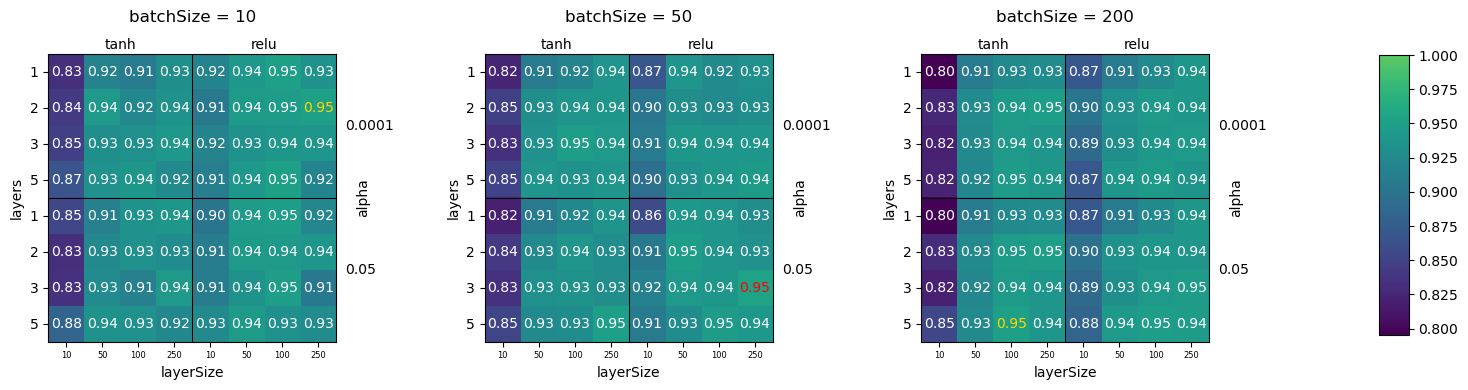

MIGLIORI IPERPARAMETRI


train_f1 validation_f1       time hidden_layer_sizes activation alpha  \
348  0.960036      0.953637  13.762108    [250, 250, 250]       relu  0.05   

    max_iter learning_rate batch_size layers layerSize  
348     1000      constant         50      3       250

In [717]:
scoreInterest= 'validation_f1' #validation_f1, time, train_f1
vmin=MLPresults_pca[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=MLPresults_pca[scoreInterest].max()

fig,axs=plt.subplots(1,len(GRID['batch_size']),figsize=(15,4))
for i,bs in enumerate(GRID['batch_size']):
    square_pca=pd.DataFrame()
    for act in GRID['activation']:
        col=pd.DataFrame()
        for alp in GRID['alpha']:
            df = MLPresults_pca[MLPresults_pca['batch_size']==bs][MLPresults_pca['activation']==act][MLPresults_pca['alpha']==alp][MLPresults_pca['learning_rate']=='constant']
            df=df.pivot(index='layers', columns='layerSize', values=scoreInterest)
            col=pd.concat([col,df])
        square_pca=pd.concat([square_pca,col], axis=1)

    ax=axs[i]
    im=ax.imshow(square_pca.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
    ax.set_yticks(range(len(square_pca.index)))
    ax.set_yticklabels(square_pca.index)
    ax.set_xticks(range(len(square_pca.columns)))
    ax.set_xticklabels(square_pca.columns)
    #ax.title.set_text(bs)
    ax.set_xlabel("layerSize")
    ax.set_ylabel("layers")
    for a in range(len(square_pca.index)):
        for j in range(len(square_pca.columns)):
            c="w"
            if square_pca.iloc[a, j]==MLPresults_pca[scoreInterest].max():
                c="red"
            elif square_pca.iloc[a, j]==square_pca.values.max():
                c="gold"
            text = ax.text(j, a, "{0:.2f}".format(square_pca.iloc[a, j]),
                        ha="center", va="center", color=c)
    #Linee verticali e orizzontali di separazione
    ax.axhline(y=3.5,c="black",linewidth=0.75,zorder=0)
    ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
    #Testi aggiuntivi degli assi mancanti e titolo
    ax.text(3.5, -1.5, 'batchSize = '+str(bs), ha="center", va="center", fontsize=12)
    ax.text(8.25, 3.5, 'alpha', ha="center", va="center", rotation='vertical')
    ax.text(1.5, -0.75, GRID['activation'][0], ha="center", va="center")
    ax.text(5.5, -0.75, GRID['activation'][1], ha="center", va="center")
    ax.text(7.75, 1.5, GRID['alpha'][0], ha="left", va="center")
    ax.text(7.75, 5.5, GRID['alpha'][1], ha="left", va="center")

fig.tight_layout()
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('MLP_PCA_'+scoreInterest,dpi=300,)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=MLPresults_pca[scoreInterest].astype(float).idxmax()
bestModel_pca = MLPresults_pca.iloc[max_elem_row]
display(pd.DataFrame(bestModel_pca).transpose())

Anche nel caso dei MLP i risultati ottenuti a seguito di PCA sono visibilmente peggiori. Non riporto lo schema per i dati del training set, perchè, come per i dati originali, anche i dati elaborati con PCA hanno andamento molto simile.  

## Performance del miglior MLP

Prima di testare le performance dei migliori modelli identificati, eseguiamo nuovamente l'addestramento di tali modelli su tutti i dati di training+validation set raggruppati.

In [608]:
#Senza PCA
bestMLP = MLPClassifier(early_stopping=True, validation_fraction=val_p, random_state=random_seed, hidden_layer_sizes=bestModel['hidden_layer_sizes'], activation=bestModel['activation'], alpha=bestModel['alpha'], batch_size=bestModel['batch_size'], max_iter=bestModel['max_iter'], shuffle=True)
start=time.time()
bestMLP.fit(X_trainval,y_trainval)
stop=time.time()
bestMLP_fit_time = stop-start

#Con PCA
bestMLP_pca = MLPClassifier(early_stopping=True, validation_fraction=val_p, random_state=random_seed, hidden_layer_sizes=bestModel_pca['hidden_layer_sizes'], activation=bestModel_pca['activation'], alpha=bestModel_pca['alpha'], batch_size=bestModel_pca['batch_size'], max_iter=bestModel_pca['max_iter'], shuffle=True)
start=time.time()
bestMLP_pca.fit(X_trainval_pca,y_trainval)
stop=time.time()
bestMLP_pca_fit_time = stop-start

Vediamo ora come si comportano i modelli quando vengono applicati ai dati del test set.

DATI ORIGINALI


Accuracy  Precision    Recall        F1
training  0.991493   0.991625  0.991493  0.991492
test      0.989993   0.990052  0.989993  0.989991

DATI ELABORATI CON PCA


Accuracy  Precision    Recall        F1
training  0.954128   0.955257  0.954128  0.954279
test      0.929953   0.932461  0.929953  0.930005

c:\Users\Anna\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


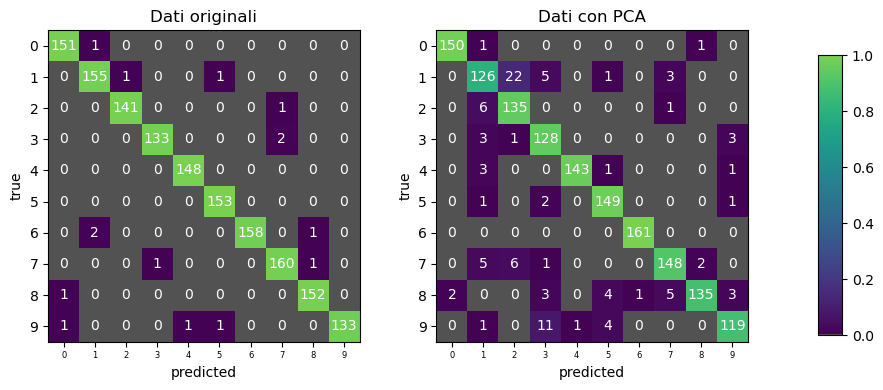

In [659]:
print('DATI ORIGINALI')
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP,X_trainval,y_true_trainval,'training')
perf_mlp,cmat_mlp,mlp_predict_time = performances(bestMLP,X_test,y_true_test,'test')
display(pd.concat([perf_trainval_mlp,perf_mlp]))

print('DATI ELABORATI CON PCA')
perf_trainval_mlp_pca,cmat_trainval_mlp_pca,mlp_pca_predict_time_trainval = performances(bestMLP_pca,X_trainval_pca,y_true_trainval,'training')
perf_mlp_pca,cmat_mlp_pca,mlp_pca_predict_time = performances(bestMLP_pca,X_test_pca,y_true_test,'test')
display(pd.concat([perf_trainval_mlp_pca,perf_mlp_pca]))

heatMapConstr([cmat_mlp,cmat_mlp_pca])

Le _matrici di confusione_ risultanti sono molto simili alle corrispondenti ottenute con SVM. Il modello addestrato sui dati originali classifica per la maggior parte giusto con qualche eccezzione molto limitata (anche se le eccezioni sono un po' più frequenti rispetto a SVM). Il modello addestrato su dati elaborati presenta un maggiore numero di eccezioni e le eccezioni sono più importanti. Spicca anche in questo caso il numero di cifre 1 etichettate come 2.

## Performance del miglior MLP sui dati di scrittori ignoti

DATI ORIGINALI


Accuracy  Precision    Recall        F1
test su scrittori ignoti  0.961407   0.963284  0.961407  0.961461

DATI ELABORATI CON PCA


Accuracy  Precision   Recall        F1
test su scrittori ignoti   0.90566   0.910166  0.90566  0.905725

c:\Users\Anna\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


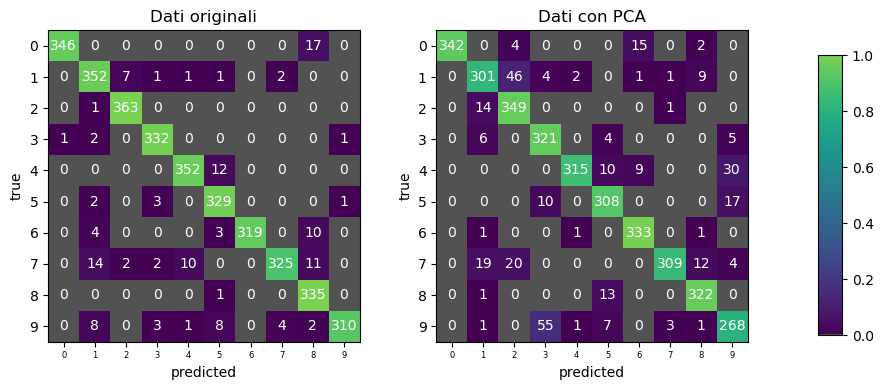

In [661]:
print('DATI ORIGINALI')
perf_mlp_ig,cmat_mlp_ig,mlp_ig_predict_time = performances(bestMLP,suggestedTestData.iloc[:,:-1],y_true_test_ig,'test su scrittori ignoti')
display(perf_mlp_ig)

print('DATI ELABORATI CON PCA')
perf_mlp_pca_ig,cmat_mlp_pca_ig,mlp_pca_ig_predict_time = performances(bestMLP_pca,X_suggestedTest_pca,y_true_test_ig,'test su scrittori ignoti')
display(perf_mlp_pca_ig)

heatMapConstr([cmat_mlp_ig,cmat_mlp_pca_ig])

Anche in questo caso si possono fare considerazioni analoghe al caso con SVM. Possiamo però notare come i valori più frequentemente mis-classificati siano diversi, ad eccezione della confusione tra 1 e 2. Sono infatti tanti i 9 confusi in 3 e i 4 classificati come 9. Vediamo come sono tracciate in media le cifre, causa di questi errori.

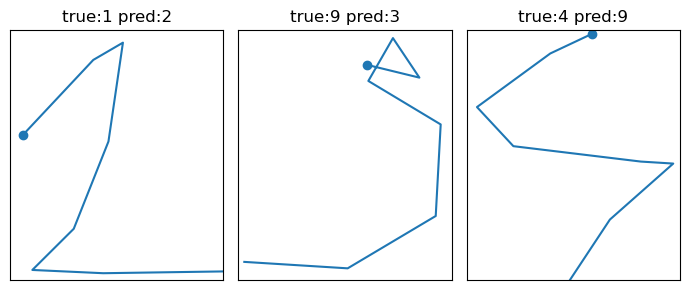

In [722]:
y_pred_mlp_ig=bestMLP_pca.predict(X_suggestedTest_pca)
mask_mlp_12 = y_pred_mlp_ig==2
mask_mlp_12 &= y_true_test_ig==1
mask_mlp_93 = y_pred_mlp_ig==3
mask_mlp_93 &= y_true_test_ig==9
mask_mlp_49 = y_pred_mlp_ig==9
mask_mlp_49 &= y_true_test_ig==4

fig = plt.figure(figsize=(7,3))
means = pd.DataFrame(suggestedTestData[mask_mlp_12]).mean(axis=0)
plt.subplot(1,3,1)
plt.plot(means[0:16:2],means[1:16:2])
plt.scatter(means[0],means[1])
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('true:1 pred:2')

means = pd.DataFrame(suggestedTestData[mask_mlp_93]).mean(axis=0)
plt.subplot(1,3,2)
plt.plot(means[0:16:2],means[1:16:2])
plt.scatter(means[0],means[1])
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('true:9 pred:3')

means = pd.DataFrame(suggestedTestData[mask_mlp_49]).mean(axis=0)
plt.subplot(1,3,3)
plt.plot(means[0:16:2],means[1:16:2])
plt.scatter(means[0],means[1])
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('true:4 pred:9')

#plt.savefig('Numbers_PCA',dpi=300)
plt.show()

# Confronto dei risultati

Di seguito due tabelle che riassumono tempi e performance di tutti i modelli affrontati nei paragrafi precedenti. Sono riportate le performance dei modelli solo sui campioni dei test set, quello degli scrittori noti e quello degli scrittori ignoti.

In [723]:
comparison_n = pd.concat([perf, perf_pca, perf_mlp, perf_mlp_pca], ignore_index=True)
comparison_ig = pd.concat([perf_ig, perf_pca_ig, perf_mlp_ig, perf_mlp_pca_ig], ignore_index=True)
comparison = pd.concat([comparison_n, comparison_ig], axis=1, keys=['Test su scrittori noti', 'Test su scrittori ignoti'])
display(comparison.rename(index={0: "SVM", 1: "SVM con PCA", 2: "MLP", 3: "MLP con PCA"}))

times = pd.DataFrame({'Selezione':['-','-','~57m 30s','~54m'],
                      'Addestramento':['-','-',str(int(bestMLP_fit_time))+'s',str(int(bestMLP_pca_fit_time))+'s'],
                      'Selezione+Addestramento':['~93m 30s','~745m','~57m '+str(30+int(bestMLP_fit_time))+'s','~54m '+str(int(bestMLP_pca_fit_time))+'s'],
                      'Predizione':[str(svm_predict_time)+' s',str(svm_pca_predict_time)+' s',str(mlp_predict_time)+' s',str(mlp_pca_predict_time)+' s']},
                      index=["SVM", "SVM con PCA", "MLP", "MLP con PCA"])
display(times)

Test su scrittori noti                                \
                          Accuracy Precision    Recall        F1   
SVM                       0.996664  0.996705  0.996664  0.996668   
SVM con PCA               0.957972  0.958378  0.957972  0.957930   
MLP                       0.989993  0.990052  0.989993  0.989991   
MLP con PCA               0.929953  0.932461  0.929953  0.930005   

            Test su scrittori ignoti                                
                            Accuracy Precision    Recall        F1  
SVM                         0.984563  0.984644  0.984563  0.984553  
SVM con PCA                 0.937965  0.940400  0.937965  0.938006  
MLP                         0.961407  0.963284  0.961407  0.961461  
MLP con PCA                 0.905660  0.910166  0.905660  0.905725

Selezione Addestramento Selezione+Addestramento  \
SVM                 -             -                ~93m 30s   
SVM con PCA         -             -                   ~745m   
MLP          ~57m 30s            6s                ~57m 36s   
MLP con PCA      ~54m           13s                ~54m 13s   

                         Predizione  
SVM            0.2870633602142334 s  
SVM con PCA    0.2850644588470459 s  
MLP          0.005002498626708984 s  
MLP con PCA  0.013004302978515625 s

Il modello migliore tra quelli testati risulta essere la SVM sui dati originali (cioè non sottoposti a riduzione di dimensionalità), i cui indicatori sono sempre superiori rispetto a tutti gli altri metodi.
Applicare la PCA in generale è risultato fallimentare. Questo è probabilmente dovuto al fatto che le dimensioni originali del dataset erano già piuttosto contenute, dunque una riduzione di dimensionalità non ha contribuito particolarmente alla semplificazione del problema, anzi ha reso più complessa una separazione delle classi, data la dimensione "di arrivo" molto ridotta. La difficoltà che si è creata è rispecchiata anche dai tempi di processamento fuori scala.

Se si comparano i due modelli addestrati sull'intero spazio delle feature, SVM risulta vincente sulle performance. I tempi di selezione del modello addestramento e dello stesso non sono tuttavia paragonabili. La principale causa di questa differenza è la cross validation che è stata messa in atto per SVM, diversamente da MLP, e che ha quintuplicato tutti i tempi di questa prima fase. Inoltre ho potuto osservare che ad allugare notevolmente i tempi della SVM è stata la validazione con kernel _linear_, drasticamente più dispendiosa dei rimanenti 3. Aspetto ancora più evidente nel modello addestrato in seguito a PCA. 

Un'altro fattore che contribuisce in modo importante nelle differenze di tempi e performance è la scelta degli iper-parametri e dei rispettivi valori, che hanno sicuramente influenzato le performance.

Ai fini dell'utilizzabilità del modello addestrato, possiamo osservare dalle tabelle sopra come il tempo di predizione sia inferiore nel caso di MLP. Si parla in ogni modo di ordini di grandezza molto piccoli, ma in vista di applicazioni su larga scala, gli MLP potrebbero essere più efficienti.

In conclusione, probabilmente anche per la semplicità del dataset scelto, le prestazioni di tutti i modelli provati si dimostrano molto buone.

# Fonti

- http://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits, sito web di provenienza del dataset e di tutte le informazioni associate.
- https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html, dettagli sul parametro alpha utilizzato per gli MLP.
- Tutte le restanti informazioni sono state selezionate dal materiale fornito durante le lezioni e le esercitazioni del corso.